In [1]:
%load_ext autoreload
%autoreload 2
import psycopg2
import pandas.io.sql as sqlio
import pandas as pd
from downloader import Downloader
import numpy as np


conn = psycopg2.connect(dbname='diplom', user='diplomant', 
                        password='diplomant', host='localhost')

downloader = Downloader(conn)

In [2]:
reserve = downloader.get_reserves_by_block("ethereum", 16929045)

In [5]:
# pools.columns

In [6]:
tokens_df = downloader.get_tokens_list_DB()

In [7]:
tokens={i:tokens_df.loc[tokens_df.symbol==i].address.values[0] for i in tokens_df.symbol.unique() if tokens_df.loc[tokens_df.symbol==i].shape[0]==1}

In [12]:
pools = downloader.get_pools_list_DB()
for index, row in pools.iterrows():
    pools.loc[index]["last_reserve_update"] = reserve.loc[reserve.address == pools.loc[index,"address"]]

# pools.loc[0].last_reserve_update

In [13]:
pools.last_reserve_update[0]

,network,address,reserve0,reserve1,liquidity,block_number
0,ethereum,0x0d4a11d5EEaaC28EC3F61d100daF4d40471f1852,16077.506282,2.850596e+07,4.583048e+11,16929045


In [14]:
def inPool(address: str, pool: pd.Series) -> bool:
    return address==pool.token0_address["Address"] or address==pool.token1_address["Address"]

# [inPool(tokens[0], i) for _,i  in pools.iterrows()]
pools.last_reserve_update.iloc[0]['liquidity']

0    4.583048e+11
Name: liquidity, dtype: float64

In [15]:
def keyByValue(dictionary, item):
    for name, age in dictionary.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if age == item:
            return name

In [78]:
class Pool:
    def __init__ (self, addr, liq, res0, res1):
        self.address = addr
        self.liquidity = liq
        self.reserve0 = float(res0)
        self.reserve1 = float(res1)

    def __repr__(self)->str:
        return self
            
    def __str__(self)->str:
        return str(self.address+" "+self.liquidity+" "+ self.reserve0+" "+ self.reserve1)


    def __add__(self, pool):
        if self.reserve0 != 0 and self.reserve1 != 0:
            print((self.reserve0/self.reserve1)/(pool.reserve0/pool.reserve1), self.reserve0*self.reserve1/(pool.reserve0*pool.reserve1))
        self.reserve0 += pool.reserve0
        self.reserve1 += pool.reserve1
        self.liquidity = self.reserve0*self.reserve1

    def swap(self, inAmount:float, zeroForOne:bool)->float:
        assert inAmount > 0
        reserve0 = self.reserve0
        reserve1 = self.reserve1
        if zeroForOne:
            y = float(reserve1)
            reserve0+=inAmount
            reserve1 = self.liquidity/reserve0
            delta = y - reserve1
        else:
            y = float(reserve0)
            reserve1+=inAmount
            reserve0 = self.liquidity/reserve1
            delta = y - reserve0
        assert(delta >= 0)
        return delta
    
class Pools:    
    def __init__ (self):
        self.pools = []
        self.Intersection = None
    
    def put(self, addr:str, liq:str, res0:str, res1:str):
        pool = Pool(addr, liq, res0, res1)
        self.pools.append(pool)
        if self.Intersection is None:
            self.Intersection = Pool(addr, liq, res0, res1)
        else:
            self.Intersection + pool
            
    def __repr__(self)->str:
        return self
            
    def __str__(self)->str:
        return str(self.Intersection.reserve0)+" "+str(self.Intersection.reserve1)

    def zeroPool(self)->bool:
        return len(self.addresses)==0
    
    def get(self):
        return self
    
    def __len__(self)->int:
        return len(self.addresses)
    
    def __getitem__(self, idx)->int:
        return self.pools[idx]
    
    def swap(self, inAmount:float, zeroForOne:bool):
        return self.Intersection.swap(inAmount, zeroForOne)
    
    def pools(self):
        return self.pools
    
    def print_pools(self):
        print(self.pools)
        
corr = pd.DataFrame(index=tokens, columns = tokens).fillna("undef")

for _, i  in pools.iterrows():
    if i.network is None:
        continue
    try:
        token0Struct = i.token0_address
        token0 = token0Struct['Address'] 
        token1Struct = i.token1_address
        token1 = token1Struct['Address']
    except NameError as e:
        print(e)
        continue
    if token0 is None or token1 is None:
        continue
    address = i.address
    resrve0 = i.last_reserve_update['reserve0']
    resrve1 = i.last_reserve_update['reserve1']
    liq = i.last_reserve_update['liquidity']
    token0_addr = keyByValue(tokens, token0)
    token1_addr = keyByValue(tokens, token1)
#     print(token0_addr, token1_addr)
    if (token0_addr is not None) and (token1_addr is not None):
        if  token0_addr!= token1_addr and corr.loc[token0_addr].loc[token1_addr]=='undef':
            pool = Pools()
            if token0_addr<token1_addr:
                pool.put(address,liq, resrve0, resrve1)
            else:
                pool.put(address,liq, resrve1, resrve0)
            corr.loc[token0_addr].loc[token1_addr] = pool
            corr.loc[token1_addr].loc[token0_addr] = pool
        else:
            pool = corr.loc[token0_addr].loc[token1_addr]
            print(token0_addr, token1_addr)
            if token0_addr<token1_addr:
                pool.put(address,liq, resrve0, resrve1)
            else:
                pool.put(address,liq, resrve1, resrve0)            
#             pool.put(address,liq, resrve0, resrve1)

WETH USDT
1.00020227861806 5.150185783062775
USDC USDT
1.0054646787045347 65101.971347078535
DAI USDT
0.9975107433921196 44673.05744838007
APE USDT
0.0018702958185996968 3.821504151854748e-24
LINK USDT
1.0120792272843755 0.7863356697516662
DEP USDT
1.28358285406993 2.6355614895268348e-06
SAND USDT
0.0665198632725188 6.651986327251878e-10
WBTC USDT
1.0065761477894435 593.3928202808861
UNI USDT
0.9688683366958022 502297.0799605382
SNX USDT
1.0541795347785279 0.27631697988054243
FTM USDT
0.0005722386293460352 1.1470485191966579e-17
SUSHI USDT
1.0080433182969268 0.010623473496714322
1INCH USDT
0.9536248697247204 5.362281716635421
YFI USDT
1.7615233270372472 0.36006060974351944
ACH USDT
255019.88308105932 1.618480430419644e-11
FRAX USDT
0.764994532294065 9.772687262026397e-07
DAI WETH
0.999851382310392 3.8538865893336873
APE WETH
0.9958215375847235 80.95231516950193
BONE WETH
1.0030211230428485 6.022092993930039e+17
BLUR WETH
nan nan
MATIC WETH
0.9981825086306931 1218.2329271091528
SHIB WET

In [79]:
np.sum(corr!="undef")

USDT       55
WETH      120
USDC       63
DAI        39
APE         4
         ... 
ECT         0
ZRO         0
SHIMCO      0
PAXG        1
KEEP        0
Length: 321, dtype: int64

In [80]:
corr

,USDT,WETH,USDC,DAI,APE,BONE,BIT,BLUR,MATIC,QOM,...,SYL,GHOSHI,anyUSDT,00,ARCONA,ECT,ZRO,SHIMCO,PAXG,KEEP
USDT,undef,41065696.442235 23162.69071718875,4109782.2937680003 4096230.695999,40319.06089777925 40181.893293,5378.885934435619 22122.692541,undef,71.77249770387067 37.606623,undef,6302.794952555297 6891.978309,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
WETH,41065696.442235 23162.69071718875,undef,14036161.93717 7923.662382271209,11582965.838493409 6539.542618961446,16197.514676594205 37.27349891733208,197153.7811819859 112.57086603284341,754780.9324206142 221.43172304339163,nan 80.87661371783838,614754.6865111586 377.522237098601,1019.4381421262866 27456695008336.258,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
USDC,4109782.2937680003 4096230.695999,14036161.93717 7923.662382271209,undef,13004244.551852826 13001209.828717,undef,undef,7.38499905e-10 1e-06,undef,230.2225166615193 231.636401,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
DAI,40319.06089777925 40181.893293,11582965.838493409 6539.542618961446,13004244.551852826 13001209.828717,undef,undef,undef,undef,undef,46.50698021266796 39.315666182866515,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
APE,5378.885934435619 22122.692541,16197.514676594205 37.27349891733208,undef,undef,undef,undef,undef,undef,0.5792639686321313 2.094100162614705,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ECT,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
ZRO,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
SHIMCO,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef
PAXG,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef,...,undef,undef,undef,undef,undef,undef,undef,undef,undef,undef


In [81]:
# corr.iloc[2].iloc[0].swap(1000, True)

In [82]:
selectTokens = [i for i in tokens if sum(corr.loc[i]!='undef')>1]
edges = [(i,j, corr.loc[i].loc[j].Intersection.liquidity) for i in corr.index for j in corr.index if (corr.loc[i].loc[j]!='undef' and i in selectTokens and j in selectTokens)]
print(edges[0])
nodes = selectTokens
print(len(nodes))
print(len(edges))

('USDT', 'WETH', 951192025777.4478)
88
652


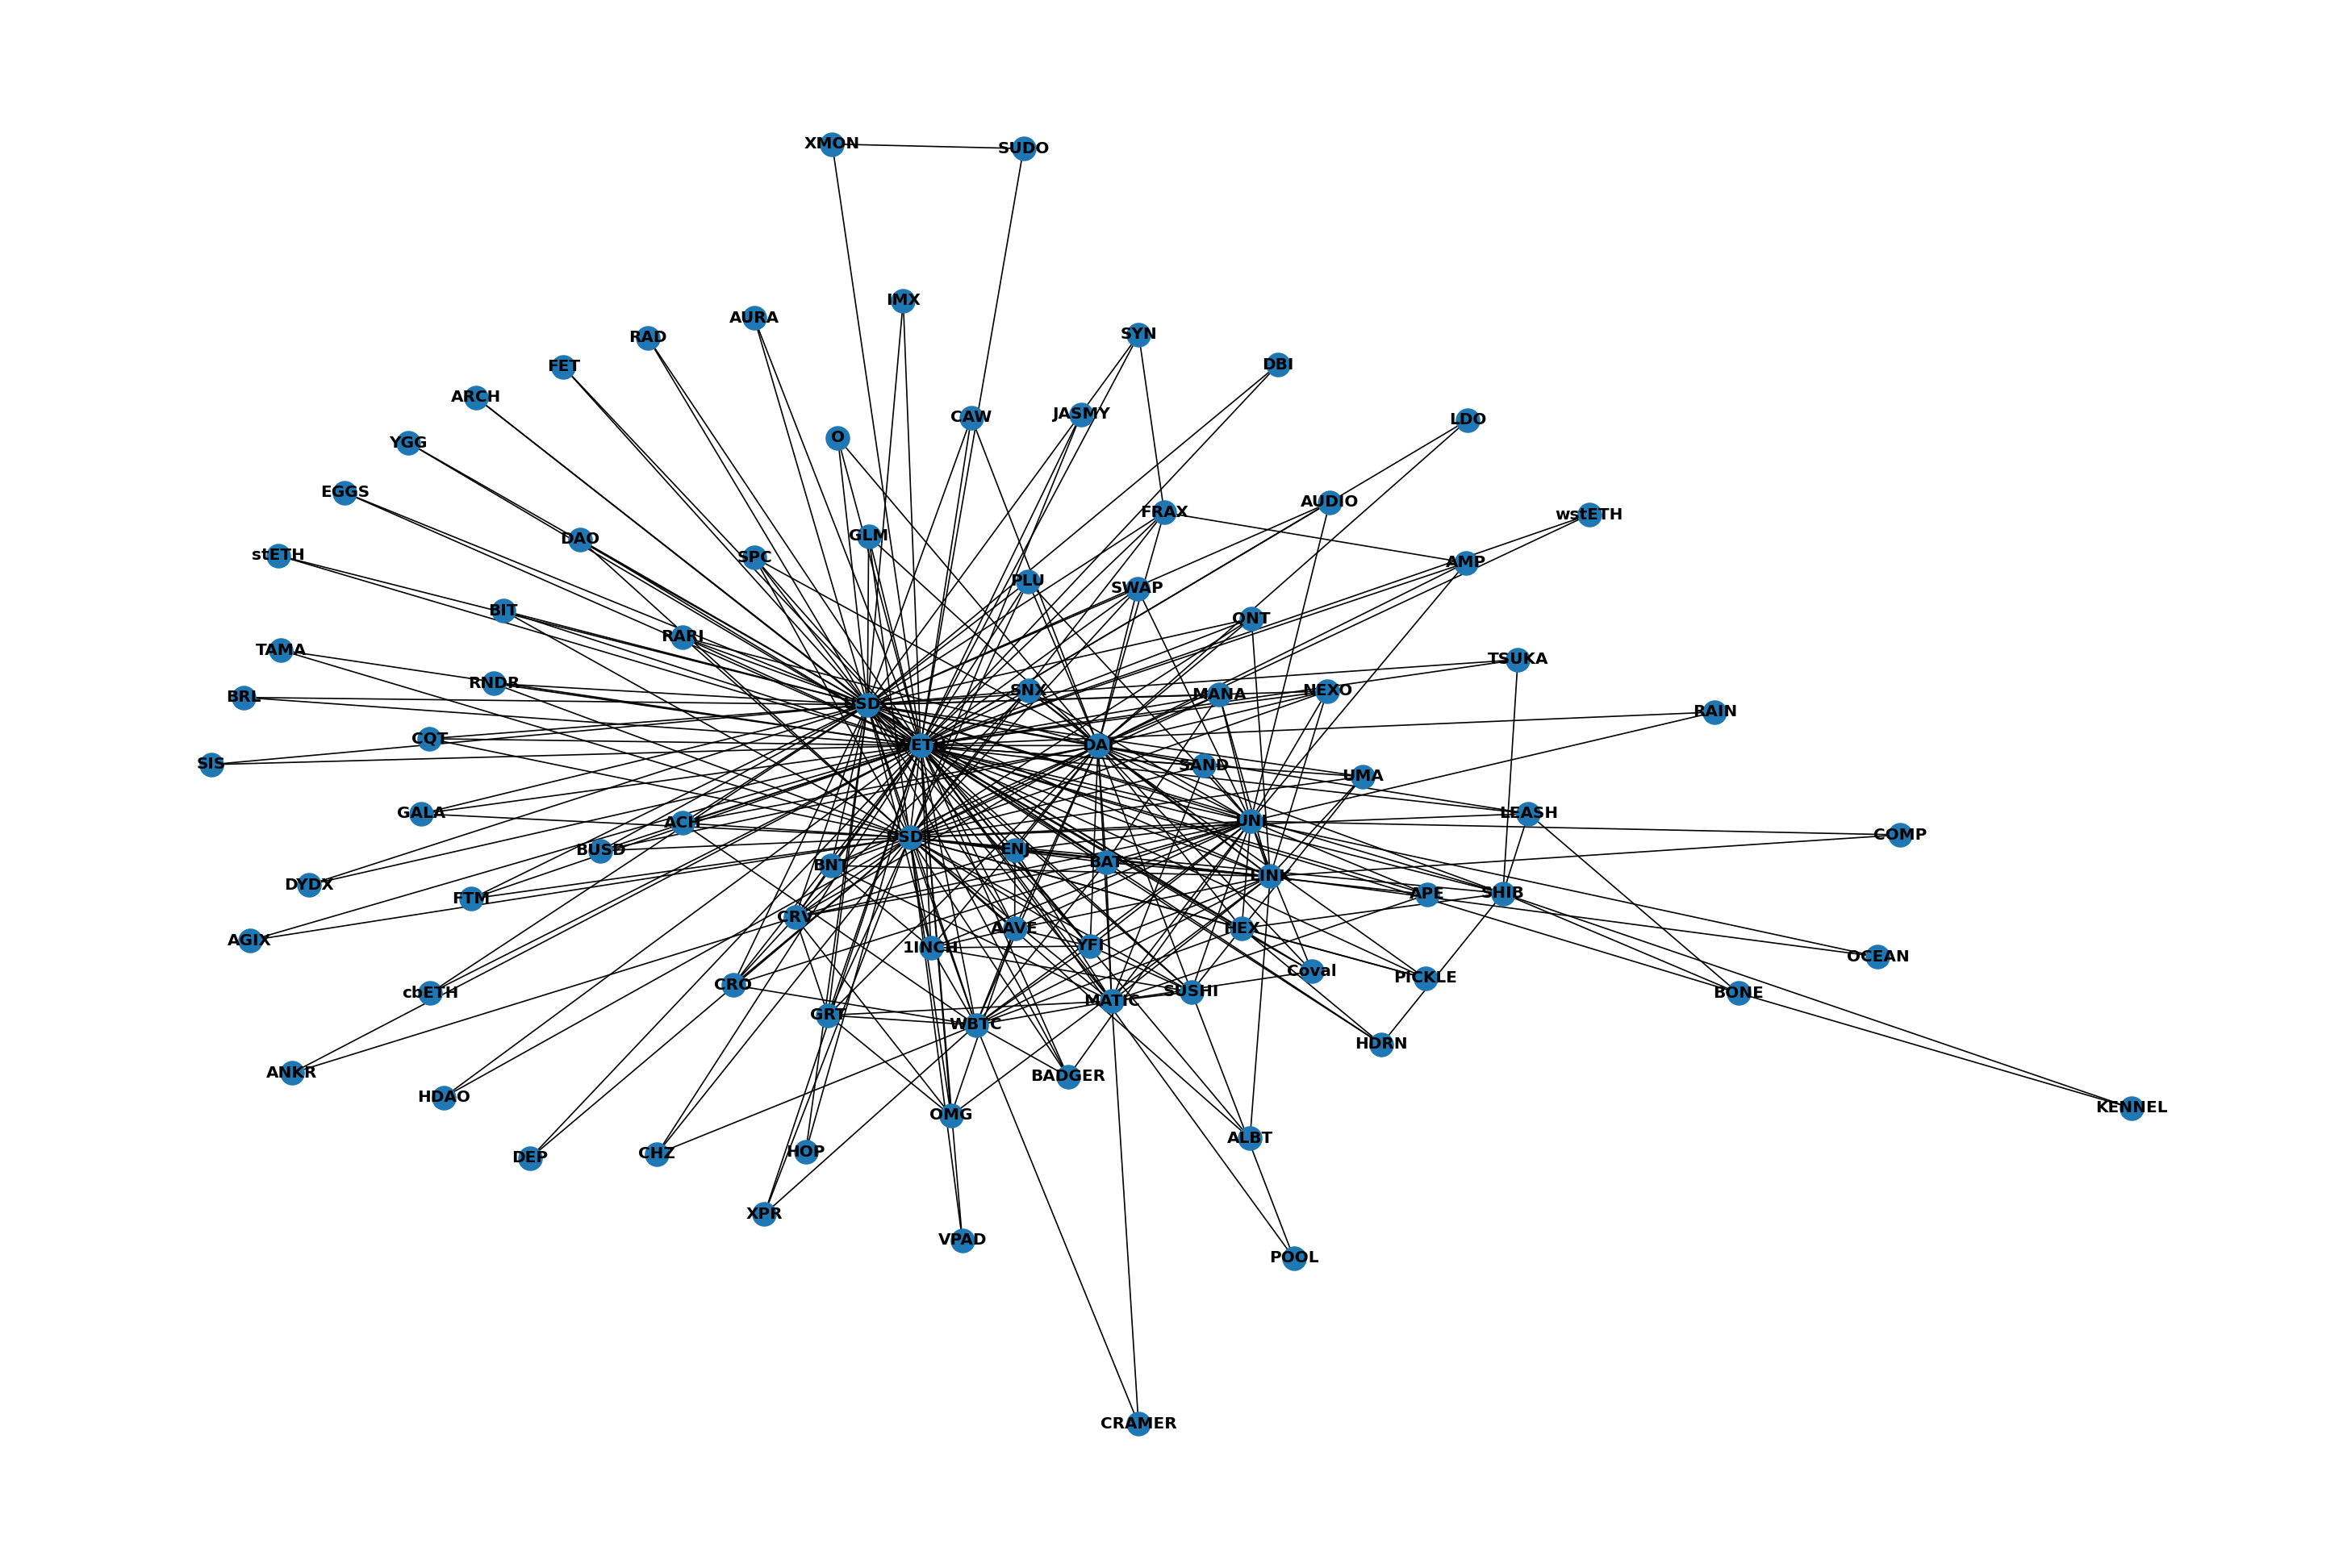

In [83]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()  # создаём объект графа
# определяем список узлов (ID узлов)
# nodes = selectTokens[:5]

# определяем список рёбер
# список кортежей, каждый из которых представляет ребро
# кортеж (id_1, id_2) означает, что узлы id_1 и id_2 соединены ребром
edges = [(i,j) for i in corr.index for j in corr.index if (corr.loc[i].loc[j]!='undef' and i in selectTokens and j in selectTokens)]

# добавляем информацию в объект графа
G.add_nodes_from(nodes)
G.add_edges_from(edges)


plt.figure(figsize=(24, 16), dpi=120)
# рисуем граф и отображаем егоdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAC1gAAAeYCAYAAACG+5dKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy88F64QAAAACXBIWXMAABJ0AAASdAHeZh94AAEAAElEQVR4nOzdeZzWZb0//tc9MzAwDMOmgAKimVuaC4NHc0nNBbd01BLTvnVOx5PmKbNs0Tzn16qZ2WKZ21FLKxfcRjMVF9RcEg0MNUPNBUUFBGWbgYFZfn8wMzqyqjD3AM/n4zEP7891XZ/r877x5mZgXp/3XWhpaWkJAAAAAAAAAAAAAAApKXYBAAAAAAAAAAAAAABdhYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWAtYAAAAAAAAAAAAAAK0ErAEAAAAAAAAAAAAAWglYAwAAAAAAAAAAAAC0ErAGAAAAAAAAAAAAAGglYA0AAAAAAAAAAAAA0ErAGgAAAAAAAAAAAACglYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWAtYAAAAAAAAAAAAAAK0ErAEAAAAAAAAAAAAAWglYAwAAAAAAAAAAAAC0ErAGAAAAAAAAAAAAAGglYA0AAAAAAAAAAAAA0ErAGgAAAAAAAAAAAACglYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWAtYAAAAAAAAAAAAAAK0ErAEAAAAAAAAAAAAAWglYAwAAAAAAAAAAAAC0ErAGAAAAAAAAAAAAAGglYA0AAAAAAAAAAAAA0ErAGgAAAAAAAAAAAACglYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWAtYAAAAAAAAAAAAAAK0ErAEAAAAAAAAAAAAAWglYAwAAAAAAAAAAAAC0ErAGAAAAAAAAAAAAAGglYA0AAAAAAAAAAAAA0ErAGgAAAAAAAAAAAACglYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWAtYAAAAAAAAAAAAAAK0ErAEAAAAAAAAAAAAAWglYAwAAAAAAAAAAAAC0ErAGAAAAAAAAAAAAAGglYA0AAAAAAAAAAAAA0ErAGgAAAAAAAAAAAACglYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWAtYAAAAAAAAAAAAAAK0ErAEAAAAAAAAAAAAAWglYAwAAAAAAAAAAAAC0ErAGAAAAAAAAAAAAAGglYA0AAAAAAAAAAAAA0ErAGgAAAAAAAAAAAACglYA1AAAAAAAAAAAAAEArAWsAAAAAAAAAAAAAgFYC1gAAAAAAAAAAAAAArQSsAQAAAAAAAAAAAABaCVgDAAAAAAAAAAAAALQSsAYAAAAAAAAAAAAAaCVgDQAAAAAAAAAAAADQSsAaAAAAAAAAAAAAAKCVgDUAAAAAAAAAAAAAQCsBawAAAAAAAAAAAACAVgLWAAAAAAAAAAAAAACtBKwBAAAAAAAAAAAAAFoJWAMAAAAAAAAAAAAAtBKwBgAAAAAAAAAAAABoJWANAAAAAAAAAAAAANBKwBoAAAAAAAAAAAAAoJWANQAAAAAAAAAAAABAKwFrAAAAAAAAAAAAAIBWZcUuAAAAAAAAALqKxqbmTJo6J0++OjtPvjo30+YsyOKmlnQrLWRwn5756JCqfHRI3+wwtE/KSvUyAgAAAFgXFVpaWlqKXQQAAAAAAAAU04y5C3P1Y6/kqvFTMn1eQ/t44R1r3vlDtUG9y3PsLsPzmZ2HZWBVj06rEwAAAIA1T8AaAAAAAACA9VZjU3MuffDF/OyuZ7K4qSWFdAxSL0/bum6lhZy6/1b5rz0/lNKSwspOAwAAAGAtIGANAAAAAADAemnKrLqcfM3jmTR1zioHq9+t7bwdhvbJr47ZKcMH9Fq9RQIAAADQ6QSsAQAAAAAAWO88M21ejr30kcyqW7Ta9hzQq3uuOn7XbDW492rbEwAAAIDOV1LsAgAAAAAAAKAzTZlVt9rD1Ukyq25RjrvskUyZVbda9wUAAACgc+lgDQAAAAAAwFrlpZdeymabbbZKa9/9o7DGpuYcdNaNeWzsjVn48pNZ/ObUNC+cn6SQ0h6VKeu3UXps8tH0+NDIlG+8ZQolpUvv2dyUBc+NT/2zD6fh9efSVDc7LYsWpNCtPKW9B2TQplvlB/99XA45+OAMGjSow7kNDQ258MILc/311+fpp5/OvHnzUllZmf79+2f48OHZYYcdcuCBB2bUqFHv+9cHAAAAgA9GwBoAAAAAAIC1yvsNWDc2NuaT/3Fy7vjjxUlL80rPHfz5X6R8oy06jC2a9nxm3vqzLJ758krPP+SQQ3Lrrbe2H8+dOzf77LNPJk6cuMLzDj/88NTW1q50fwAAAADWjLJiFwAAAAAAAAAfxMiRIzN69OgVrmlpacmnjzk2d9xw3duDhZL02HSHdN9oy5R0K0/zgvlZ9MZLaZj6j7Qsblhqj4bXn830q89Iy6IF7WOlVRum54eqU1Y1MC3NjWmcMyMNr/4zjW++mobGjiHus88+u0O4+tBDD82IESNSXl6e119/PRMnTsyjjz76Pn8VAAAAAFhdBKwBAAAAAABYq2277bb5xje+scI1V1xxRWrfEa4urdowA4/633Qf9KGl1jYvbkj95AdT2rOqfaylqTEzbzm3Q7i66t+OTN+9P59CSelSeyya+XIGD5jfYeyOO+5of/z5z38+v/vd75Y6b/bs2XnqqadW+FwAAAAAWLMErAEAAAAAAFjnnXvuuR2ONzz828sMVydJSbfyVH503w5j9c89ksa3Xms/7rHZiPT7xBeWe73yDTbJs73L09jUnLLSkiRJU1NT+/wLL7yQOXPmpE+fPh3O69u3b/bYY49Ve1IAAAAArBEC1gAAAAAAAKzV/vGPfywVoE6S7bbbLgceeGBef/31/OMf/2gf77bhpikfsvV7usbCl/7e4bj3jgeucH1LkunzGjJp6pxUD++XJBkxYkSeeOKJJMkDDzyQQYMGZeedd86IESNSXV2dvffeO5tsssl7qgsAAACA1U/AGgAAAAAAgLXa3/72t/ztb39bavzzn/98DjzwwEydOrXDeLcBwzocL3rjpbx+2ZeXOr982HYZfNzZSZKmeTNXuMcbN52V+mceXmqP64ZcneovH5Mk+f73v5+bb745b731VpKkoaEhDz74YB588MH29Z/4xCdy3nnnZbvttlvu84U1qbGpOZOmzsmTr87Ok6/OzbQ5C7K4qSXdSgsZ3KdnPjqkKh8d0jc7DO3T3p0dAAAA1jUC1gAAAAAAAKxfCp23x4uz5rc/3mSTTfL444/nBz/4Qa677rrMmzdvqfXjxo3LnnvumSeeeCLDhg1bah7WlBlzF+bqx17JVeOnZPq8hvbxd77UW5LcMHHJ40G9y3PsLsPzmZ2HZWBVj06tFQAAANY0AWsAAAAAAKDL0kmVVfH5z38+v/vd75Y7P3To0A7Hi2d17GhdWtk/fff5QpJk7l/HpHnh/Lxbae8NltrjnV2se223b7pvvHUWTXsu9f98oH181vxFHc4bPnx4Lrvsslx88cX5+9//nkcffTT33XdfbrnlljQ0LAm1zp49O5dffnm++93vruBZw+rR2NScSx98MT+765ksbmpZ6t6BluWcN2NeQ35x97M5/97ncur+W+W/9vxQSktWx90LAAAAUHwC1gAAAAAAQJejkyqr00YbbZSqjTfL3NdeTJIsnvFiGqb9K+WDP5wkKe1ZlT67HJkkmTfh1mQZAesem+6Y+X+/o/14/hN3pWLLj7UfV2yxS+v43R0C1o1Ny46nlpWVZeTIkRk5cmROOumkTJgwISNHjmyfnzJlyvt9urDKpsyqy8nXPJ5JU+e0v78uL1D9bm3rGptacvYdk3P7U6/nV8fslOEDeq2BSgEAAKBzaeUAAAAAAAB0GY1Nzbno/uez+znj8ou7n82Md4SrkyWBvravd2rrpLr7OeNy0f3Pp6l5VSOCrC+2OeDYDsczb/5JFr/56iqfX7HFrinrt1H78YJ/PZrZD16VlpbmFZ5XVvr2bQH/8z//k5tvvjmLFi1aal3v3r07HA8YMGCVa4P345lp83LkhQ9n0tQ5SVY9WP1ubedNmjonR174cJ6ZNm+11AcAAADFpIM1AAAAAADQJeikyvv1j3/8I+eee+4y50aPHp1hw4ZltwOPypN/vTf1zzycJGl86/W8dul/p+eHd073gZulUFKaxjkz0lw/e5n7FErLssGhp2b6NWekZfGS4P+cB69K3T/uS8/NR6a0V780L1qQhS8+3uG8AZXd2x8/+OCDOfPMM9O3b998/OMfz7bbbpuqqqq8/vrrGTNmTIfzDj744Pf7ywErNWVWXY699JHMqls67P9BzKpblOMueyQ3nLib918AAADWaoWWlhYtHAAAAAAAgKJ6Ztq81R72G9Cre646ftdsNbj3yhezVnnppZey2WabrdLae++9N3vvvXd+9/CL+W7tpLx13+8y77Fbsirx/Yotd8uGR36nw1jDa89k5p/OTeNbr6/84qVl+e7FN+R7/3lYkmTvvffO/fffv9LTTjjhhFx00UUr3x9WYHm/TwqFQkq6ladQ0S/dB22WXtt+IhVb7tphzdQLvpCmuTOW3rS0W0orqtJ94Gap2Gav9Np2rxQKHT80efYDf8ych65uP277PQgAAABrEx2sAQAAAACAotJJlc7w0SF9Uyjtlv77/ld673Rw5k+6MwtfeSqNb72e5oa6FErKUlJRlW79h6R8463Sc/ORKR+yzVL7lG+8VTY+/sLUT34w9c/+NYum/StN9XPS0rQ4Jd17prRqw3TfcNP0GL59em6xaz65357t51555ZW55557ct999+Wpp57K9OnTM3PmzCTJoEGDMnLkyHz+85/PYYcd1mm/Lqx/Wlpa0rRoYbLo9TTOfj31zzycqo99Ov32+vzKT25anKZ5s7Jg3qwseP5vWfjS37PBoV9b80UDAABAJ9PBGgAAAAAAKJrGpuYcddHDmTR1zhq7xg5D++SGE3dLWWnJyhezzmpsas7uPxmXGfMaVqF39QdXSDKwd3ke+vYnvPYoind3sB45cmQOOfzInH/vv7Jo9vTMm3Rn0rR4yWShJENP/kNKe1Yl6djBuqRHZao+dnTS3JTFb76auqfvS5oa2/fd6Avnp/vATduPdbAGAABgXaCDNQAAAAAAsMYVCoX2x9/97nfzve99L0ly6YMvtoer3x3KW55e2+2bDQ792iqvn5Kk25ffPm7rPfPOmvbaa6/cd999S52799575/7771/qXNY+ZaUlOXaX4fnF3c92yvVakhy3y3DharqMbbfdNv0+9qlU1rX9Hihk3sRblzxsaU7jm6+ldEjVUucVulekzy5Hth+X9uqbuY9c3368eNbLHQLWAAAAsC7wLzoAAAAAAEBRzJi7MD+765kUVr4UVovP7Dws3UoLa/w1V0jSrbSQY3YetoavBKuuuaUlfxw/JWlpSeOcGWl4bXKH+dLK/qu0T2nlgA7HJT2XDmW/U1NT83srFAAAALoAHawBAAAAAICiuPqxV7K4afkdoSt3OihlfTdaarz7hsOTJD02G5FC954d5ur/+UAWTXuu/bjqY0enpEdlkmSvLTbMHltssDpKZy01sKpHTt1/q5x9x+SVL/4AWpJ844CtMrCqxxq9DrwXv7/yyiRXLnOu17Z7p6zPwBWe39LclMY3X8v8J+5qHyut2jA9hm67wvP+9UZd9n3P1QIAAEBxCVgDAAAAAADv2TXXXJPLL788kyZNyptvvpkePXpkwIAB2XrrrbPzzjvnv//7vzN48ODsvffeuf/++zuc+/3vfz/f//7324+HnHhZyvoOWuoavbbeMz2Gb7/cGnoM3SY9hm7TYWzxG1M6BKx77zAqZX0HpZDk9d7lOeVrn3ifz5h1xfF7bJbbn3o9k6bOWWPX2HFY3xy/x4fW2P6wOpUP/Uj6H3DScueb5s7IlLMPXWq824abZoPDv5VCWbcV7v/izLoPXCMAAAB0NgFrAAAAAADgPTnrrLNyxhlndBibP39+5s+fnylTpmTs2LHZd999M3jw4CJVuLSWJNPnNWTS1DmpHt6v2OVQRGWlJfnVMTvlyAsfzqy6Rat9/w0qu+e80TumtKSw2veGD2LQ5h9Jwya7Jkma62an7un70jT/zTRMfTrT/vCtDDr2rJT2rFqlvUp69E7fPY9L9w02WenaF2fN/0B1AwAAQDEIWAMAAAAAAO/Jr371q/bHI0eOzKGHLuls+sorr+SJJ57IhAkT2ue/9KUv5dBDD803v/nN9rH9998//bYcmTufnp4kKenZe5nXqZv8QBqm/Wup8V7b7Jmyqg3fV+1PvbrsgPUrr7ySc889d5njrHuGD+iVq47fNcde+shqDVlvUNk9f/zPXTN8QK/VtiesLhUDN03PXY5MS+tx5U4H5bWLv5ikJYvfeClzHh6T/vsev9R5JT0qU/Wxo9O8YG7qnhqXpvlvpnnhvLxx45nZoOb09Np69xVed9b81X8jAwAAAKxpAtYAAAAAAMB7snDhwvbHv/71r7Prrrt2mJ85c2a6deuWJBk9enSSdAhY77bbbpm37RHp03vqCq8z//HblzlePvjD7ztg/eRrc5Y5/sILL3SokXXfVoN758Yv7ZaTr3k8k6bOSSFpD56+F23n7Tisb84bvaNwNV1Wc8uS12ubbv02SklFVZrrl7wvNrz85DLPK3SvSJ9djkyS9N7p4Lx2+ZfT0lCfJHnzrgvTc7OdUlJesdzrNja9n99ZAAAAUFwlxS4AAAAAAABYu+y1117tj/fff//st99+OfHEE/Pzn/88Dz/8cPr3758+ffqscI9pcxZ0CPp1hkKS12cv6OSr0pUNH9ArN5y4W04/aOuUlS55Ra7q67JtXVlpIacftHVuOHE34Wq6tJJ3vbgXz56W5vq57cctzY0r3aOsz8D02fXT7cfNdbMz9283r/ic0s5+twcAAIAPTgdrAAAAAADgPbnooosyZ86c3H///Zk/f37uueee3HPPPe3zH/7wh3Prrbdmq622Wu4ei1eho+mgz5yVHsO3Xy01r+y6e+21V+67776lxvfee+/cf//9q7UGupay0pKc8PHNc8SOQ3LNY6/kj+OnZPq8hvb5lpbmJEkhhaTwdlB0YO/yHLfL8Byz87AMrOrR6XXDe1U/46U0jL8xSdJcPzt1T9+fd/ZtLx/6kVXap/eIQzJ3/I1pXjgvSTLvsZtTNfLw5XaxnvjHczLy3suXGt94441zyy23vMdnAQAAAJ1DwBoAAAAAAHhPNtpoo9x33315+eWX8+ijj+a5557LM888k5tvvjmzZ8/Ov/71r3zpS1/KuHHjlrtHtyJ1NC3Wden6Blb1yMn7bpGT9t48k6bOyVOvzslDk1/JzXf9JT0qeqVp8aKMPmxUPrpxn2w3pE92GNonZaU+LJa1x/Tnn06ef3qZc6V9BqXPbses0j4l5RXpPfKTmfPgVUmS5oXzM/dvt6Tv7ss+/63Xp2TC61OWGp85c+YqVg4AAACdT8AaAAAAAAB4TyZNmpTtttsum2yySTbZZJP28Z///Oc59dRTkySPPfZYh3PKysrS2NiYJKmvr8/gPj2z8h7Wq1dLko369uzkq7K2KSstSfXwfqke3i879pqT//vP/8mWW26Zl19+Oede+a1ilwerR0lpSsp7pVv/Iem5+cj0HnFISnpUrvLpvUcelrmP1aaloT5JWxfrw5bbxRoAAADWNgLWAAAAAADAe3Lcccdl+vTp+cQnPpEhQ4Zkww03zBtvvJHf//737Wv69+/f4ZyhQ4fmpZdeSpL87ne/y64zFmTOy/Up7VmVyu33W+Z16iY/kIZp/1pqvKS8Ir13PPB91f7Rjfu8r/NYP9XV1SVJKioqsnDhwjQ1NaW0tLTIVcGq2XTTTdPS8vatLI1Nzdn9J+MyY17DSm9wGXrS5SucL+1RmU2+NmaZc333PC599zwuhSQDe5fnoW9/Qrd3AAAA1joC1gAAAAAAwHs2c+bMjBmz7HBdkpx++ukdjj/96U/npz/9aZLkjTfeyJ+uOD9J0m2DTZYbsJ7/+O3LHC+tGvi+A9bbDRGwZtW9M2DddlxVVVXMkuB9KystybG7DM8v7n62U67XkuS4XYYLVwMAALBWErAGAAAAAADekzPPPDN33XVXHnvssbz66quZOXNmWlpaMmjQoOy888454YQTcsABB3Q454c//GEKhULGjBmTqVOnprGxsVNrbuukusNQAWtWXX19fZKksrIySTJ//nwBa9Zqn9l5WM6/97k0NrWstIv1B1FIUlZayDE7D1uDVwEAAIA1p9Dyzs+FAgAAAAAA6CTn3fNcp3VSTZKv77dlTt53i067Hmu/q666Kscdd1yOPPLI3HjjjXnmmWey5ZZbFrss+EAuuv/5nH3H5DV+ndMP2jonfHzzNX4dAAAAWBN8HhMAAAAAAFAUn9l5WLqVFlJYw9cpJOmmkyrvQ1sH67au1fPnzy9mObBaHL/HZmu8m/+Ow/rm+D0+tEavAQAAAGuSgDUAAAAAAFAUA6t65NT9t8qa/qjNliTfOGCrDKzqsYavxLqmrq4uSdKnz5IwqoA164Ky0pL86pidMqBX9zWy/waV3XPe6B1TWrKmb58BAACANUfAGgAAAAAAKBqdVOnKBKxZVw0f0CtXHb/rag9Zb1DZPX/8z10zfECv1bovAAAAdDYBawAAAAAAoGh0UqUrq6+vT5L069cvyduBa1gXbDW4d2780m7tN7m833fJtvN2HNY3N5y4W7Ya3Hu11AcAAADFJGANAAAAAAAUlU6qdFVtger+/fsn0cGadc/wAb1yw4m75fSDtk5Z6ZKodEtL8yqd2xasList5PSDts4NJ+7m/RYAAIB1hoA1AAAAAABQdDqp0hUJWLM+KCstyQkf3zwPfesT2al0aprmv9VhvvCOr3ca2Ls8X99vyzz0rU/khI9v7pMCAAAAWKeUFbsAAAAAAACA5O1Oqpc99GLOvfOZLG5qSSFJyyqc27aurLSQbxywVY7f40PCfnxg9fX1SZINNtggiYA167YNe5dn8g2/zOvP/Subjtgr/98vL82Tr83J67MXZHFTS7qVFrJR35756MZ9st2QPtlhaJ+UlernBQAAwLpJwBoAAAAAAOgy2jqpHrHjkFzz2Cv54/gpmT6voX3+nZHpdwavexYW58R9t80xOw/LwKoenVYv67a6urqUlJSkX79+SQSsWbc99dRTmTx5cpLkwJ23yud327S4BQEAAEARCVgDAAAAAABdzsCqHjl53y1y0t6bZ9LUOXnq1TlLdVL958S/5l+PjkvZ3NczaEC3nHzWX4tdNuuY+vr69OrVK5WVlUmWBK5hXTVmzJj2x6NGjSpiJQAAAFB8AtYAAAAAAECXVVZakurh/VI9vN9Sc2eeeU/+Z8Kt2W+//XL33Xfntddey8Ybb1yEKllX1dXVdQhY62DNuqqlpSVjxoxJeXl5mpqass8++xS7JAAAACiqkmIXAAAAAAAA8H5UV1cnSYYOHZokueWWW4pZDuugurq6VFRUpFevXkkErFl3TZo0Kc8++2yampqy++67p3fv3sUuCQAAAIpKwBoAAAAAAFgrtQWsGxoa0q1bt9TW1ha3INY59fX16dWrV8rKytKjRw8Ba9ZZY8aMSZI0NjZm1KhRRa4GAAAAik/AGgAAAAAAWCttuOGGGTZsWJ566qnsu+++GTduXObMmVPssliHtHWwTpLKykoBa9ZJLS0tGTNmTCorK5NEwBoAAACSlBW7AAAAAAAAuobGpuZMmjonT746O0++OjfT5izI4qaWdCstZHCfnvnokKp8dEjf7DC0T8pK9e+ga6iurs6f/vSn/Nd//VfuuOOO3H777TnmmGOKXRbriLYO1knSq1cvAWvWSRMnTszzzz+fDTbYID179syOO+5Y7JIAAACg6ASsAQAAAADWczPmLszVj72Sq8ZPyfR5De3jhXesaUlyw8Qljwf1Ls+xuwzPZ3YeloFVPTq1Vni36urq1NbWZrPNNkuS1NbWCliz2tTV1bUHrCsrK1NXV1fkimD1GzNmTJJk5syZOe6441JS4iYqAAAA8LdjAAAAAID1VGNTcy66//nsfs64/OLuZzPjHeHqZEmouu3rnWbMa8gv7n42u58zLhfd/3yamt+9AjpPdXV1kmTKlCnZddddc9ttt6WhoWElZ8HKNTY2ZtGiRamoqEiyJGCtgzXrmpaWlowZMyb9+/dPkowaNarIFQEAAEDXIGANAAAAALAemjKrLkdd9HDOvmNyGpuWBKRXNSbdtq6xqSVn3zE5R174UKbM0tWV4mgLWE+YMCE1NTWZN29e7r333iJXxbqgvr4+STp0sBawZl3z2GOP5aWXXsrAgQOTJPvvv3+RKwIAAICuQcAaAAAAAGA988y0eTnywoczaeqcJKserH63tvMmTZ2TIy98OM9Mm7da6oP3YuDAgRk6dGh7wDpJamtri1oT64a6uiU3jry7g3VLi679rDvGjBmTJJk2bVp22GGHDB48uMgVAQAAQNcgYA0AAAAAsB6ZMqsux176SGbVLVqt+86qW5TjLntEJ2uKYsSIEfnHP/6RTTbZJFtvvXVuvvnmNDc3F7ss1nLL6mDd2NiYRYtW7/snFEtLS0vGjBmTwYMHZ/bs2Rk1alSxSwIAAIAuQ8AaAAAAAGA90djUnJOveXy1h6vbzJy/KCdf83gamwRb6VzV1dVpamrKE088kZqamkybNi2PPvposctiLdfWwbotYN323/nz5xetJlidxo8fn1deeSVbbLFFkghYAwAAwDuUFbsAAAAAAADWvBtvvDHf/en5+eeTf0/TgnkplHVLSY/KlFb2T/cNh6f74C3Se6eD2tdP++NpaXjlqfbj4afd2mG/lpbm1D1xd+qevj+L3ngpzQvnp9CtPFN79M7WFw/NqD13yV577ZWjjz66054j66/q6uokyYQJE1JTU5Ozzz47tbW12XXXXYtcGWuztoB1RUVFkiUdrNvGBwwYULS6YHW59tprkyx5TVdUVGT33XcvckUAAADQdQhYAwAAAACs444//vhcdtllHcZaFjWmadGCNM19I4teeyaFyQ91CFivSEtzU2Zc9/0sfHFix/GG+jQ11Of5J6fngicn5KGHHhKwplO8M2B94oknZqONNkptbW3OPvvsIlfG2qy+vj7J252r2wLWOlizLmhubs51112XTTfdNE888URGjRqV8vLyYpcFAAAAXYaANQAAAADAOuzOO+/sEK7uPmjz9Nhsp5SU90rzwnlZ9MaUNEx9+j3tOf+JuzqEq8uHbZcew7ZNoVt5murnZNH0F9M87ZnV9hxgZQYPHpyNN944EydOTElJSQ4//PBcdNFFmTx5crbeeutil8daqq2DtYA166K//vWvefXVV3PkkUfmpZdeyqhRo4pdEgAAAHQpAtYAAAAAAOuwO+64o/1xWd+NMvjzP0+hpLTDmpamxiycMmmV91zwwoT2x+WbfDSDj/1xh/lCkgHlLTlrN50w6TzV1dW5/fbbs3DhwtTU1OSiiy5KbW1tTjvttGKXxlqqLWBdUVGRRMCadcu1116bJCktXfI9gYA1AAAAdFRS7AIAAAAAAFhzmpqa2h83N9Slcfa0pdYUSsvS80PVq75pc/Pb+89/M03z3+ow3ZJkZkMhA7Ya+Z7rhferuro6jY2NefLJJ7PPPvukqqoqtbW1xS6LtVh9fX0SHaxZ9zQ1NeX666/PFltskQkTJmTTTTfNFltsUeyyAAAAoEsRsAYAAAAAWIeNGDGi/XHzgrl57ZIT89plX87M287L3Al/yqLpL7znPbsP3rz9ceObr2bqBf+e16/4WmaN/U3m/f2OLJ41NUny1KtzPvgTgFVUXb3kJoEJEyake/fuOfjggzN+/Pi89tprRa6MtdW7O1i3Ba0FrFnbPfTQQ3n99dez//7754UXXsioUaNSKBSKXRYAAAB0KQLWAAAAAADrsOOOOy6Dt/joO0ZasviNl1L3xF15666L8/pvT86rl5yY+mf/usp7Vu1ck7I+g94eaG7Kotefy/zHb8+bd5yf1/7vxLz+u6/l9nvuXX1PBFbinQHrJKmpqUmS3HLLLcUqibXc8jpYtwWvYW117bXXJkn69u2bJBk1alQRqwEAAICuScAaAAAAAGAdVlZWlo9/9bz02f0zKe29wTLXNL45NW/ceFbqnxu/SnuWlFdk8Od/nt4jD09Jz6plrlk07blc94MT2sOusKZttNFG2WijjdpfcwcddFC6deuW2tra4hbGWqstSP3ugLUO1qzNmpqacv3112frrbfOU089ldLS0nziE58odlkAAADQ5QhYAwAAAACs41rKeqTfnsdl6H//Lht/8eIMOPTrqdzxwJRU9H3nqsx9rHaV9yyt6JP++/1Xhp78h2z0hfPT/6CT02u7T6RQXtG+prlxcc4///zV9jxgZUaMGJGnnnoqDQ0Nqaqqyr777ptx48Zlzpw5xS6NtVBbwLqiYsn7moA164K//OUvmTFjRo466qiMGzcuH/vYx9KnT59ilwUAAABdjoA1AAAAAMA6rltp4e3H/YekcrtPZMCBX86QEy5JaWX/9rmmOTPe896FQkm6D9w0vXc4IBsc+vVsfPwFSWm39vkpU6Z8sOLhPaiurs7ixYvz5JNPJklqamqyePHi3H777UWujLVRfX19Eh2sWbdce+21SZIPf/jDmT9/fkaNGlXkigAAAKBrErAGAAAAAFiHXXHFFZn2yC1pWrh0ILBQ1q1DGLqkZ9Uq7Tl3/I2Z/9S4NC9euNRcSbeeKRTe/qfnAQMGvI+q4f2prq5OkkyYMCFJcthhhyVJamtri1USa7F3d7BuC1oLWLO2amxszA033JBtt902zz77bJIIWAMAAMBylBW7AAAAAAAA1pwXX3wx4y77cVJSlvKh26T7oA+ltKJPmhctyIJ/PZamOdPb1/bcfOQq7bnojSmpu/fyvDn2Nykfum26D9wsJT0q07xgXuqffTgtjQ3taw8++ODV/pxged4dsN5oo42y66675rbbbktDQ0PKy8uLWR5rmfr6+hQKhfTo0SPJ2x2s24LXsLa57777MnPmzHzlK1/JzTffnAEDBmTEiBHFLgsAAAC6JAFrAAAAAID1QXNjGl5+Mg0vP7nM6e6Dt0jVvx3xnrZsWdyQhS9OzMIXJy5zfvd99s/nPve591wqvF8bb7xxBg0alIkT335N1tTU5JFHHsm9996bAw88sIjVsbapq6tLr169UigUkiQ9e/ZMoVDQwZq11rXXXpsk2XffffPd7343xxxzTEpLS4tcFQAAAHRNJStfAgAAAADA2uqUU07Jdddfn0Efq0n5kK1T1mdQCt16JCVlKanom/JNtk///U/M4P93TkrKK1Zpz377/Ec2OOybqdzxwHTfaIuUVm2YQll5UlKW0sr+6fmh6nzoU9/KuLG3CW7RqQqFQqqrq/Pkk09m0aJFSZYErJOktra2eIWxVqqrq0tFxdvviyUlJenVq5eANWulxYsX58Ybb8z222+fl156KUlywAEHFLcoAAAA6MJ0sAYAAAAAWIf17ds3nzrqqLzad/v84u5nV/m8wcedvdy50l590+sje6XXR/Za7pqv7rdlunfzT9B0vurq6tx222156qmnMmLEiGy11VbZeuutc/PNN+eCCy5ISYneM6ya+vr69OrVq8NYZWWlgDVrpXHjxuXNN9/M17/+9YwdOzaJgDUAAACsiH9FBAAAAABYD3xm52HpVlpIYQ1fp5CkW2khx+w8bA1fCZaturo6STJhwoT2sZqamkybNi3jx48vVlmshd7dwToRsGbtde211yZJPvWpT+XOO+/MdtttlyFDhhS5KgAAAOi6BKwBAAAAANYDA6t65NT9t0rLGr5OS5JvHLBVBlb1WMNXgmVbXsA6SWpra4tQEWurZXWw7tWrl4A1a51Fixblpptuyk477ZQFCxZk+vTpGTVqVLHLAgAAgC5NwBoAAAAAYD1x/B6bZYehfdboNXYc1jfH7/GhNXoNWJEhQ4Zkww037BCw3nnnnbPxxhvnpptuSkvLmr7NgHVFXV3dUgHrysrK1NXVFakieH/uvvvuzJ49O0cffXTGjh2bJALWAAAAsBIC1gAAAAAA64my0pL86pidMqBX9zWy/waV3XPe6B1TWlJYI/vDqigUCqmurs4TTzyRRYsWJUlKSkpy+OGH57nnnsvkyZOLXCFri7q6ulRUVHQYq6ys1MGatc61116bJO0B6549e2bPPfcsclUAAADQtQlYAwAAAACsR4YP6JWrjt91tYesN6jsnj/+564ZPqDXyhfDGlZdXZ1FixblH//4R/tYTU1NkqS2trY4RbFWaWpqSkNDw3I7WDc3NxepMnhvGhoaUltbm5EjR2bgwIF58MEHs9dee6VHjx7FLg0AAAC6NAFrAAAAAID1zFaDe+fGL+2WHYb2SZK8737TLS1Jki36d8sNJ+6WrQb3Xj0FwgdUXV2dJJkwYUL72N57752qqioBa1ZJfX19kiwzYN3S0pIFCxYUoyx4z+68887MnTs3Rx99dO67774sXrw4o0aNKnZZAAAA0OWVFbsAAAAAAAA63/ABvXLDibvlsodezLl3PpPFTS0pJGlZhXPb17U0Zfb9f8hbjVMy9Ot/XaP1wnvRFrCeOHFi+1j37t1zyCGH5Oqrr86rr76aIUOGFKs81gJ1dXVJkoqKig7jlZWVSZL58+cvFb6Grujaa69Nknz605/Oz3/+8yQRsGYpjU3NmTR1Tp58dXaefHVups1ZkMVNLelWWsjgPj3z0SFV+eiQvtlhaJ+UlerhBgAArB8ErAEAAAAA1lNlpSU54eOb54gdh+Sax17JH8dPyfR5De3z7+xs/c7g9cDe5Sl/5bE8/Puf5jNHHJI//OGx/OY3v8nJJ5/cabXDigwbNiwbbLBBhw7WSVJTU5Orr746t9xyS770pS8VqTrWBsvrYN12PH/+/AwaNKjT64L3YsGCBbn55puzyy67ZNNNN83YsWMzbNiwbL311sUujS5ixtyFufqxV3LVSr4HvKH1fqVBvctz7C7D85mdh2VgVY9OrRUAAKCzCVgDAAAAAKznBlb1yMn7bpGT9t48k6bOyVOvzsmTr83J67Pf7l64Ud+e+ejGfbLdkD7ZYWifTP7n4Hz0ou/krbfeyvDhw3PGGWfkiCOOyLBhw4r9dCCFQiHV1dW57777snjx4nTr1i1JcuCBB6Z79+6pra0VsGaFVtbBum0eurKxY8dm/vz5Ofroo/PSSy/l2WefzfHHH59CobDyk1mnNTY159IHX8zP7nr7U0zeaXmfaDJjXkN+cfezOf/e53Lq/lvlv/b8UEpLvJ4AAIB1k4A1AAAAAABJlnS0rh7eL9XD+6107XbbbZeamprU1tbmggsuyEknnZQvf/nLqa2tFdyiS6iurs7YsWPz9NNPZ4cddkiSVFVVZd99981dd92V2bNnp2/fvsUtki5reR2s2wLW8+fP7/Sa4L269tprkySf/vSnc9tttyVJRo0aVcyS6AKmzKrLydc8nklT57QHq5cXqH63tnWNTS05+47Juf2p1/OrY3bK8AG9VngeAADA2qik2AUAAAAAALB2+s53vpMkefDBBzN69Ojccsstuemmm4pcFSxRXV2dJJkwYUKH8ZqamjQ2Nub2228vRlmsJdo6VAtYs7aqr6/Pn/70p+y2224ZNmxYxo4dm5KSkuy7777FLo0iembavBx54cOZNHVOklUPVr9b23mTps7JkRc+nGemzVst9QEAAHQlAtYAAAAAALwvO++8c/bff/9cc801OeWUU9K3b9985StfyZw5c4pdGiw3YH3YYYelUCiktra2CFWxtmgLWFdUVHQYF7BmbXH77benrq4uRx99dBYvXpx77rknu+yyS/r1W/mnVLBumjKrLsde+khm1S1arfvOqluU4y57JFNm1a3WfQEAAIqtrNgFAAAAAACw9vrOd76Tu+66K5dffnl+8pOf5IQTTsgZZ5yR888/v9ilsZ7bZJNN0r9//6UC1oMHD86uu+6a2267LQ0NDSkvLy9ShXRl9fX1SXSwZu117bXXplAo5FOf+lTGjx+fuXPnZtSoUcUui9Xg8MMPzy233NJh7Mknn8x2223XYey+++7LPvvs03685UH/kYYdjuqwZv4Td2fWbb9sPx5w8Cmp3H6/9uOpF3whTXNnLF1EabeUVlSl+8DNUrHNXmnZdq+cfM3jueHE3VJWunSPtxkzZmTo0KFZvHhx+9iIESOW+jMaAACgK9HBGgAAAACA922vvfbKbrvtlt/97nc56KCDsvvuu+eCCy7II488UuzSWM8VCoVUV1dn0qRJaWxs7DBXU1OT+fPnZ9y4cUWqjq5ueR2s2wLXbfPQFdXV1eXWW2/NHnvskSFDhmTs2LFJImC9Dpg2bVpuu+22pcYvu+yylZ47fe7C1VdI0+I0zZuVBc//LbNu/Vlm/fm8TJo6J5c99OIyl1955ZUdwtVJMnHixEyaNGn11QQAALCaCVgDAAAAAPC+FQqFfOc738nixYvz85//PJdccknKysryxS9+cakgDXS26urqLFy4ME8//XSH8ZqamiRJbW1t5xfFWkEHa9Zmf/7zn7NgwYIcffTRSZKxY8emb9++GTlyZJEr44O64oorlrppKEn+8Ic/ZNGiRWv02iU9KtN3ny+k716fT6+P7peUvv1h2XVP3ZPFM17KuXc+kxnLCHIvLwC+KsFwAACAYhGwBgAAAADgAzn44IOzww475JJLLsmGG26Yb3/723nyySfz85//vNilsZ6rrq5OkkyYMKHD+JZbbpltttkmN998c5qbm4tRGl1cW4dqAWvWRtdee20KhUKOOuqozJw5M3/729+y3377paysbOUn06Vdfvnl7Y+33HLL9sczZ87MLbfcskavXehekT67HJk+H/t0NjjklFTtXNNhftGsl7O4qSXXPPZKh/GHH344kydPXmbdf/zjH9PQ0LBG6wYAAHi/BKwBAAAAAPhA2rpY19fX57zzzssZZ5yRLbbYIt///vfzwgsvFLs81mNtAeuJEycuNVdTU5Pp06dn/PjxnV0Wa4G2gHVFRUWHcQFrurp58+bltttuy1577ZWNNtood999d1paWjJq1Khil8YH9MADD+TZZ59tP/7BD36Qrbbaqv24s7tBl1YO6HBc0rMqhSR/HD8ljU1v37z0zrr69u2biy++uP34zTff9GkSAABAlyVgDQAAAADAB3bUUUdlyy23zPnnn5+GhoZcfPHFWbBgQb70pS+lpaWl2OWxntp0003Tr1+/pTpYJ0sC1kkEu1im+vr6JDpYs/a59dZbs3Dhwhx99NFJkrFjxyaJgPU64J1B5d69e+ewww7LZz7zmfaxO++8M1OnTl3jdbQ0N2XxzFcy/4m72sdKqzZMj6HbpiXJ9HkNmTR1TpIl75VjxoxpX3fUUUdl7733zmabbdY+9s6u3AAAAF2JgDUAAAAAAB9YaWlpTjvttMyZMycXXHBB9tlnn/z7v/977rzzzlx99dXFLo/1VKFQSHV1df7+97+nsbGxw9zIkSOz8cYb56abbnITAEtZXgfrtsC1gDVd1bXXXpuSkpIceeSRaWlpyZ133pltttkmw4YNK3ZpfADz5s3Ldddd135cU1OTnj175thjj20fa25uzu9+97s1VkPT3BmZcvahefmcw/PapV/K4hlLPqWk24abZuDR30+hrFv72qdeXRKwvvbaazu8X7bV+85g+N13352XX355jdUNAADwfglYAwAAAACwWnz2s5/NJptskl/84hepr6/Pueeemw022CCnnHJK3nzzzWKXx3qquro6CxYsyOTJkzuMl5SU5PDDD89zzz231Bwsr4N19+7dU1ZW1h7Ahq5k7ty5uf3227PPPvtk0KBBeeqpp/Laa6/pXr0OuOaaa9rfl5LkuOOOS5JsscUWGTlyZPv4b3/72069aaikR+/03fO4dN9gkw7jT762JGD9zu7UG2+8cfbee+8kWSoY/tvf/nbNFwsAAPAeCVgDAAAAALBadOvWLd/61rfyxhtv5NJLL82AAQPy85//PG+88Ua+9a1vFbs81lPV1dVJkgkTJiw1V1NTkySpra3txIpYG7QFqHv27NlhvFAopLKyUgdruqRbbrklixYtytFHH50kGTt2bJIIWK8DLrvssvbHAwcOzH777dd+/M6w8gsvvJD77rsvyZIbQt6ppXHRUvu+e6xQWrbcGkp6VKbvPl9I1a6fSmll/yRJ88J5eePGM1M3+aG390jy+uwlNzY9/PDD7ePHHHNMSkqWxBO23XbbbL/99u1zv/vd73yaBAAA0OUIWAMAAAAAsNp84QtfyKBBg/LTn/40ixYtymc/+9nsu+++ueyyy/KXv/yl2OWxHlpRwHrvvfdOVVWVgDVLqaurS0VFRQqFwlJzAtZ0Vddee21KS0tz5JFHJlkSsC4vL8/HP/7xIlfGB/GPf/wj48ePbz+eMWNGysrKUigUUigU8vWvf73D+rYw9oYbbthhvHHO9KX2bpw9rcNxSUWf5dZR6F6RPrscmX57/3sG/79zUyivaJ97864L09zwdoftxU0tHULhSfLzn/+8veZCoZAnnniife6ll17KPffcs9xrAwAAFIOANQAAAAAAq03Pnj3z9a9/PVOnTs3vf//7FAqFXHTRRenRo0e++MUvpqGhodglsp7ZbLPN0rdv32UGrLt3755DDjkkjz76aF599dUiVEdXVV9fn169ei1zTsCarmj27NkZO3Zs9t1332ywwQapr6/PAw88kI9//OOpqKhY+QZ0We8OKq/MjTfemDlz5uTDH/5wyiv7to/XPzc+i6a/0H68ePa0zH/qHaHmktKUb7TFKl2jrM/A9Nn10+3HzXWzM/dvN7cfl7Y05corr3xPdV9++eXvaT0AAMCaJmANAAAAAMBqdeKJJ6Zv3745++yz09jYmA9/+MP53//93zzzzDM5++yzi10e65lCoZARI0bk73//e5qampaar6mpSZLccsstnVwZXVlbB+tlEbCmK7r55puzePHiHH300UmSv/zlL2loaMioUaOKXBkfxKJFi/L73/++/XjgwIEZPXr0Ul+f+MQn2tcsWLAgV1111ZI//w465u3Nmhbn9Su+ntd/+9W8fuWpef3S/05z/Zz26V7b7pOSHpWrXFvvEYekpEfv9uN5j92c5ob6tCSpf/6xzJgxo31ul112WWbdm222Wfuam266KW+99dYqXx8AAGBNE7AGAAAAAGC1qqqqysknn5x//etfuf7665Mk3/jGN7LtttvmrLPOyuTJk4tcIeub6urq1NfXL/O1d+CBB6Z79+6pra3t/MLosurq6pbbwbpXr14C1nQ51157bcrKynLEEUckScaOHZskAtZruVtuuSUzZ85sPz7llFNyzTXXLPX1pz/9KVVVVe3r2rpB/+eXv56eW+z69obNjVk0/fkseu2ZtDS+/aki5UO2Tv/9vvieaispr0jvkZ98e+uF8zP3b0tuVpry8K3t46Wlpbn++uuXWfcPf/jD9nULFy7MVVdd9Z5qAAAAWJMErAEAAAAAWO1OPvnk9OrVK2eddVaam5vTvXv3XHLJJVm0aFFOOOGENDc3F7tE1iPV1dVJkgkTJiw1V1VVlX333Tfjxo3L7NmzO7kyuqr6+vrlBqwrKytTV1fXyRXB8r355pu56667sv/++6d///5JlgSshwwZkm233bbI1fFBXHbZZe2Py8rK8h//8R/LXFdRUZHjjjuu/fhvf/tbnnjiiew4fIMMPOp/suER30nPLT+W0qoNk9JuSWlZSnv1S48PVWfAwadk0HE/SUn5srv2r0jvkYel8I7z5j12cxrnzMhT4+9vHzvooIMydOjQZZ5/1FFHpV+/fst8vgAAAMVWVuwCAAAAAABY9wwYMCAnnnhifvazn+XWW2/NYYcdlt122y0nnnhiLrroovz2t7/Nf/7nfxa7TNYTbQHriRMn5nOf+9xS8zU1Nbn99ttz++235zOf+Uxnl0cXVFdXl4qKZYcNKysrs3DhwjQ2NqaszI/aKL7a2to0Njbm6KOPTpK88sor+ec//5n/+I//SKFQKHJ1fBC33377Kq+94IILcsEFF3QYa2xqzqDe5Zmx1W6p2Gq393z9oSddvsL50h6V2eRrY9qPC0kG9i7PSw2LUla68l5vPXr0yJtvvvme6wIAAOgMOlgDAAAAALBGfP3rX0/37t1z5plnpqWlJUny4x//OIMHD843v/nNzJgxo8gVsr7YfPPN06dPn2V2sE6Sww47LIVCIbW1tZ1bGF3WyjpYJ9HFmi5jzJgx6datWw4//PAkS7pXJ8moUaOKWRZdQFlpSY7dZXhaOul6LUmO22X4KoWrAQAAujp/swEAAAAAYI3YeOON84UvfCGPPvpoxo0blyTp27dvfvWrX+Wtt97K1772tSJXyPqiUChkxIgRefzxx9PU1LTU/ODBg7PrrrvmtttuS0NDQxEqpCtpbm7OggULVhqwnj9/fmeWBcs0c+bM3H333Rk1alT69euXZEnAulAoZL/99itydXQFn9l5WLqVFrKme5kXknQrLeSYnYet4SsBAAB0DgFrAAAAAADWmG9961spLS3NWWed1T72qU99Koccckiuuuqq9i6bsKZVV1enrq4uzz777DLna2pqMn/+/PabAVh/1dfXJ0kqKiqWOS9gTVdy0003pampKUcffXSSpLGxMXfffXd23nnnDBgwoMjV0RUMrOqRU/ffao13sW5J8o0DtsrAqh5r+EoAAACdQ8AaAAAAAIA1ZrPNNsuxxx6bcePG5ZFHHkmypJvwb37zm1RUVORLX/pSe5gR1qTq6uokyYQJE5Y5X1NTkySpra3tpIroqtrek5bXwbptXMCarmDMmDHp3r17DjvssCTJY489ltmzZ+eAAw4ocmV0JcfvsVl2GNpnjV5jx2F9c/weH1qj1wAAAOhMAtYAAAAAAKxRp59+egqFQocu1sOHD88Pf/jDvPjii/nBD35QxOpYX6wsYL3llltmm222yc0335zm5ubOLI0upq6uLsnKO1i3rYNimTFjRsaNG5cDDzwwffosCc+2fTLEqFGjilkaXUxZaUl+dcxOGdCr+xrZf4PK7jlv9I4pLSmskf1ZvRqbmjNhylv53cMv5tTrJuW4Sx/J0Rf/Ncdd+khOvW5Sfvfwi5kw5a00Nvl+CACA9VtZsQsAAAAAAGDdts022+SII47IjTfemCeeeCLbb799kuTkk0/OH//4x5x77rk59thj28dhTdh8883Tu3fv5QaskyVdrH/84x9n/Pjx+djHPtaJ1dGVrKyDdVvAWgdriu3GG29Mc3NzRo8e3T42duzYVFVVZZdddiliZXRFwwf0ylXH75pjL30ks+oWrbZ9N6jsnj/+564ZPmDZ75l0HTPmLszVj72Sq8ZPyfR5De3j74zFtyS5YeKSx4N6l+fYXYbnMzsPy8CqHp1aKwAAdAU6WAMAAAAAsMZ95zvfSZL8+Mc/bh8rKyvL//3f/6WlpSVf/OIX09TUVKzyWA+UlJRkxIgRefzxx5fbobqmpiZJUltb23mF0eW0daYWsKarGzNmTMrLy/PJT34ySfLWW2/l0Ucfzb777ptu3boVuTq6oq0G986NX9otm/Ra8udgS8v761DcFsjdcVjf3HDibtlqcO/VVCFrQmNTcy66//nsfs64/OLuZzPjHeHqZEmouu3rnWbMa8gv7n42u58zLhfd/3yamt+9AgAA1m0C1gAAAAAArHHV1dUZNWpUxowZk+eee659fMSIEfnqV7+a8ePH56KLLipihawPqqurM3/+/Dz77LPLnB85cmQ23njj3HTTTWlpESJaX7UFrCsqKpY5L2BNVzBt2rTcf//9Ofjgg9O795Jw6913353m5uaMGjWqyNXRlQ3qVZrJv/6vvDXu8pS0RmoLKzmnTdu6stJCTj9o69xw4m46V3dxU2bV5aiLHs7Zd0xOY9OS/9+r+h1O27rGppacfcfkHHnhQ5kyq26N1AkAAF2RgDUAAAAAAJ3ijDPOSHNzc84+++wO4z/4wQ+yySab5PTTT8+rr75apOpYH1RXVydJJkyYsMz5kpKSHH744XnuuecyefLkziyNLqS+vj7J8jtYt40LWFNMN9xwQ5qbmzN69Oj2sbFjxyaJgDUr9JOf/CRvzJieRU/clttOqM7X99syA3uXd1hTeMfXOw3sXZ6v77dlHvrWJ3LCxzdPacmqRrMphmemzcuRFz6cSVPnJFn1YPW7tZ03aeqcHHnhw3lm2rzVUh8AAHR1AtYAAAAAAHSKPffcM3vssUeuvPLKvPzyy+3jlZWV+c1vfpN58+bl5JNPLmKFrOvaAtYTJ05c7pqampokSW1tbSdURFe0qh2s29ZBMYwZMyY9e/bMIYcckiRpaWnJ2LFjs+WWW2bTTTctbnF0Wa+88krOPPPMJEtufNtmsyE5ed8t8tC3P5EbTtwt3//ktvlU9dDstvmA7Lxp/+y2+YB8qnpovv/JbXPDibvloW9/Iifvu0UGVvUo8jNhZabMqsuxlz6SWXWLVuu+s+oW5bjLHtHJGgCA9UJZsQsAAAAAAGD9ccYZZ+Sggw7Kueeem1/96lft44ceemg+9alP5frrr88tt9ySww47rIhVsq7aYost0rt37+V2sE6SvffeO1VVVamtrc3pp5/eidXRVbQFp5fXwbotYK2DNcXy2muv5YEHHshRRx3V/nr85z//malTp+YrX/lKkaujKzvllFOyePHiDBgwIF//+tfbx8tKS1I9vF+qh/crYnWsLo1NzTn5msdXe7i6zcz5i3LyNY/nhhN3S1mpnn4AAKy7fLcLAAAAAECnGTVqVEaMGJH/+7//y4wZMzrMnXfeeamqqsp///d/Z948Hz3O6ldSUpKddtopEydOTHNz8zLXdO/ePYccckgeffTRvPrqq51cIV1BfX19EgFruq7rr78+LS0tGT16dPvYnXfemWTJn7OwLH/5y19y4403Jkl++tOfLrdLP2uPl156KYVCof3r3//935Mklz74Yu656HuZcvahHb7mPnbzMvepf+bhpdbOvPUX7fNv3nVxh7m6f9yXSVPn5LKHXmxfM2vWrGy88cbttQwZMiSzZs1ao88fAADWNAFrAAAAAAA6TaFQyHe+850sXLgwv/jFLzrMbbzxxjn77LMzderU/O///m+RKmRdV11dnXnz5uVf//rXctfU1NQkSW655ZZOqoqupK2D9fLChwLWFNuYMWNSUVGRgw8+uH1s7Nix6d69e/bee+/iFUaX1djYmBNOOCFJsuWWW+Zzn/tckStiTZkxd2F+dtczy5yb97db0tLctNT43MdqV7hnv33+I9022KT9eNadF6Zpzoyce+czmTF3YZLki1/8Yl5//fUkS77fv+KKKzJgwID3+SwAAKBrELAGAAAAAKBTHXHEEdl6663zm9/8JrNnz+4wd8IJJ+RjH/tYfv3rX+exxx4rToGs06qrq5MkEyZMWO6aAw88MN27d09tbW0nVUVXsrIO1m3jAtYUwyuvvJKHHnoon/zkJ9tvAli4cGHuv//+7LHHHst93bJ++7//+79Mnjw5SfKLX/wipaWlRa6INeXqx17J4qaWZc41zpme+mcf6TDW8NozaZj69Ar3LJR1zwaHfTMp7ZYkaWmoyxt/+lkWNTblmsdeyeWXX97eHT1Jvva1r2W//fb7gM8EAACKT8AaAAAAAIBOVVJSktNPPz3z5s3L+eefv9TcJZdckpKSknzxi19MY2NjkapkXTVixIgkKw5YV1VVZd999824ceOWugmAdd/KOliXlpamR48eAtYUxfXXX58kGT16dPvYAw88kAULFmTUqFHFKosubNasWTnttNOSJB//+Mdz0EEHFbki1pTmlpb8cfyUFJY1WVgSDZn3rm7Vcx+tXWrNsnQfuFn67fX59uOGqf/I3L9el8tufyRf/epX28d32GGH/PjHP34f1QMAQNcjYA0AAAAAQKf7zGc+k0033TS//OUv28OMbbbbbrt885vfzN///vf88pe/LE6BrLO23HLL9OrVa4UB6ySpqalJY2Njbr/99k6qjK6i7T1pRZ2AKysrl3rvgs4wZsyYVFZW5sADD2wfGzt2bJIIWLNM/9//9/9l7ty5SZKf/exnKRSWGb9lHfBW3eLMmNeQZfWvrthy1yRJw6v/TMNrzyRJGmdPT/0zDyVJug/+cEp7b7DC/XvvfHh6bLpj+/HsB6/KP6/4n/Ybjnr06JGrrroq3bt3/+BPBgAAugABawAAAABYhzU2NWfClLfyu4dfzKnXTcpxlz6Soy/+a4679JGcet2k/O7hFzNhyltpbGoudqmsZ7p165ZvfetbmTVrVi655JKl5v/3f/83m2++eb773e/mpZde6vwCWWeVlpZmp512ysSJE9PcvPz3vsMOOyyFQiG1tbWdVxxdQn19fZKVB6x1sKazTZkyJY888kgOO+yw9OzZs3187NixGTx4cLbffvsiVkdXNGnSpFx44YVJltzcNnLkyCJXxJr0Vv2i5c713vmI9sdzW7tYz/3bLUnLku+FqnauWen+hUIhAw75Wkp6Vi0ZaG7K4pkvt8//9Kc/zUc+8pH3XjgAAHRRZcUuAAAAAABY/WbMXZirH3slV42fkunzGtrH39mvriXJDROXPB7UuzzH7jI8n9l5WAZW9ejUWll//cd//Ed+8IMf5Nxzz81JJ52U8vLy9rmePXvmoosuyv7775+TTjopf/7zn3VcZLWprq7Ogw8+mOeffz5bbLHFMtcMHjw4u+66a2677bY0NDR0eH2ybmvrTP3OAOu7CVi/d41NzZk0dU6efHV2nnx1bqbNWZDFTS3pVlrI4D4989EhVfnokL7ZYWiflJXqEbUs1113XZJk9OjR7WOvvvpqnnrqqXzuc5/z5yQdtLS05Ctf+UpaWlpSVlaWM888s9glsYatKGDdY+g26b7xVln02jOpf+bhLJrxUuY/cWeSpLT3BqnYZs+8df+VK71GWe8B6T/qpMysPbvD+AEHHJAvf/nLH+wJAABAFyNgDQAAAADrkMam5lz64Iv52V3PZHFTS94ds1nWx0UnyYx5DfnF3c/m/Hufy6n7b5X/2vNDKS0R0mHN6tGjR0499dR885vfzBVXXJEvfvGLHeb322+/fPazn80f/vCHjBkzpkOgDD6I6urqJMnEiROXG7BOkpqamvz1r3/NuHHjctBBB3VWeRRZfX19evbsmZKS5Yd8Kysr88orr3RiVWsvN32tPmPGjElVVVUOOOCA9rE771wSkBw1alSxyqKLGjNmTB544IEkyVe+8pVsttlmRa6INW3BoqYUsvy/81X92xFLgtHNTZlx3ffSsmhBkqR39aEplJSu8nUWTX9hqbFnn302c+fOTVVV1fuoHAAAuia3fwMAAADAOmLKrLocddHDOfuOyWlsWvJj9eX9cP3d2tY1NrXk7Dsm58gLH8qUWXVrpE54pxNPPDH9+/fPT37ykzQ2Ni41//Of/zz9+/fPV7/61bz11ltFqJB1UVvAesKECStcV1NTkySpra1dwxXRldTV1aVXr14rXKOD9co1NjXnovufz+7njMsv7n42M94Rrk6WfO/R9vVObTd97X7OuFx0//Npal7V72bWbS+88EIee+yxHH744enR4+3g+dixY5MsuSkJ2tTV1eXUU09NSUlJqqqqcsYZZxS7JDrByt4uK7b8WEr7DEqSNM2bmSQpdO+Z3jseuMrXWPjKU5n7yPVLjb/00ks6WAMAsM4RsAYAAACAdcAz0+blyAsfzqSpc5KserD63drOmzR1To688OE8M23eaqkPlqeysjJf/epX88ILL+Taa69dan7DDTfMueeem+nTp+e0004rQoWsi7baaqv06tVrpQHrLbfcMttss01uvvnmNDc3d1J1FFtdXV0qKipWuKZXr16ZP39+WlqEf5fFTV+r33XXXZckHT7NoampKXfddVdGjBiRgQMHFqs0uqAf//jHefXVV9Pc3JzvfOc7GTBgQLFLohOs7AOICiWlqRp5WIexyo/ul5Ielau0f/PCusz808+TliXfE5VU9E2vbT7ePv/73/8+Y8aMeW9FAwBAFyZgDQAAAABd1Pe+970UCoX2r+WZMqsux176SGbVLVqt159VtyjHXfaIUBNr3Je//OVUVlbmrLPOWmaI9d///d+z995755JLLsmDDz5YhApZ15SWlmbHHXfMxIkTVxqQrampyfTp0zN+/PhOqo5iq6+vX6UO1k1NTVm0aPX+2bsucNPXmjFmzJj06dMn+++/f/vYhAkT8uabb2bUqFFFrIyu5vnnn88555yT0tLSDB06NCeffHKxS6KT9OxeutL33Mrt90+hvPXPuEJJeu98+CrvP+vOC9I0d0b78YCDv5r+B5+cfhtv2j524oknZurUqe+hagAA6LoErAEAAABgLdbY1JyTr3l8qXD1lLMPXaWvxtnTV7h+wv8ckE03qOwQ9G77+t73vpdk6SD4fffdt1Sd99133zLPhSTp379/TjrppDz99NO55ZZblpovFAq5+OKLU15enhNOOEGgkdWiuro6s2fPzgsvvLDCdTU1NUmS2traNV8UXcKqdLCurFzS7XP+/PmdUdJaw01fa8a//vWvTJw4MUcccUS6d+/ePj527NgkEbCmg1NPPTWLFy9OU1NTfvSjH6Vnz57FLolO0q+i+0rXlJRXZNDoH2TDI8/IwNE/TLe+g1dp7/n/uDf1T9/fflw54pBUfHjnlHTrka/+6Nfp1q1bkuStt97K5z//eZ/wAADAOkHAGgAAAADWYpc++GJ7h0hYm33ta19LeXl5zjzzzGUGMrbccsucccYZefrpp3POOecUoULWNdXV1UmWdIBdkZEjR2bjjTfOTTfdJCy0nljVDtbJ+hewvvHGG3PooYdmo402Svfu3dO7d+9ssskm2XXXXfOfxx+fw778vcyqW5Q5f72uww1bb9zy02XuN+/vd3RYN33Md5MkC6c8sdRNX688OT4nX/N4Gpve/qSDvffeu/3mrU033bQzfgmKYsyYMUmS0aNHdxgfO3ZsKisr87GPfawYZdEFjR07NjfffHNKSkqy/fbb57Of/WyxS6ITrUrAOknKN94qFVt+LD033WGV1jfOmZE377yo/bjbgGHpt88X2o8P/cTu+dGPftR+PG7cuPzsZz9bxaoBAKDrKit2AQAAAADA+zNj7sL87K5nUkhW+FHQZX0Hp3Kng5c5V9Kzd5Kk7zt+QJ4kzQvnZ+5fx7Qfl2+0RU476T9S2aNb+9huu+32vmuHdxs8eHCOP/74/OY3v8ndd9+d/ffff6k13/72t3P11VfnRz/6UY4++uhsueWWRaiUdcWIESOSLAlYH3300ctdV1JSksMPPzwXXnhhJk+enG222aazSqRI6urqBKyX4fjjj89ll13WYWzx4sWZP39+XnnllYwfPz6F8l7Z5Gt7p2qXI7PgX4+m4dV/Jknqn74/9dt8PBVb7NJ+buPcN/LWvZe3H5f06J0BB5283Ou/de9v8/dNd8xlD72YEz6++ep9cl3cmDFj0q9fv+y7777tY3PmzMkjjzySQw45pENXa9ZfixYtyle/+tWUlpamqakp55xzTkpLS4tdFp2oX69uGdS7PDPmNay2PVtamjPzTz9LS0PrJwiUlmWDT34jJd3KU0gysHd5dhjaJzt94xsZO3Zsxo0blyQ544wzsv/++2eHHVYtxA0AAF2RgDUAAAAAFMETTzyRCy64IPfff3+mTp2axsbGDBo0KCNGjMhJJ52U/fbbb6lzFi9enJ/97Gf57W9/mylTpqRH775p3nSX9N3juJT0WH4QrLT3Bumzy5ErrOfd842zp3cIWJcN2CT9P/apnLzvFu/xmcKq++Y3v5mLL744Z5555jID1t27d88ll1ySPffcMyeeeGLuueeeFAqFIlTKumDrrbdOz549V9rBOklqampy4YUXpra2VsB6Hdfc3Jz6+vpUVFSscF1bAHt9CVjfeeedHcLVO+20U0aNGpU+ffrkzTffzITHJ+XevzzQPl8oKc2AQ7+W1y//SloWLwn6vXnH+Skftm1KeywJp8+6/VdpaahvP6f/ASemrPeA5daweMYLqf/HvTm3rCRH7DgkA6t6rO6n2SU988wzmTRpUv7zP/8z3bq9faPbPffck6ampowaNaqI1dGVnH/++XnmmWdSKBSy33775YADDih2Saxhm2666VKfrnHePc/lF3c/mw0O/Vo2OPRr72m/oSddvtRYoVCSwZ/9yTLXtyQ5bpfhKStd8sHp99xzz3u6HgAAdHUlxS4AAAAAANY35557bkaMGJGLL744kydPzvz587Nw4cJMmTIlN910U2699dZlnnfkkUfm9NNPz7PPPpuGhobMmTk98/52S6b98dtpXrRgjdf9x/FT0tjUvMavw/pr+PDh+exnP5v7778/Dz300DLX7LHHHvmv//qv3Hvvvbnyyis7uULWJWVlZdlxxx0zceLEpcJJ77b33nunqqoqtbW1nVMcRbNw4cIk0cH6Xe644472x5tvvnkee+yx/PjHP85pp52Wc845J4eddn6GffXqbHj4t9rXdeu3cfq94xMymureylt3XZwkmTdpbBa++Hj7XMXWe6bXR/ZaaR1v/eUPWdSwKNc89srqeFprhTFjltzwNnr06A7jY8eOTRIBa5Ik06ZNy/e+97306NEjLS0tOeecc9yEtp76zM7D0q20kDX9f7+QpFtpIcfsPGwNXwkAAIpHB2sAAAAA6ES1tbX55je/2X5cVlaWT3/609l6663z+uuvr7Dr15///Occe+yx2XzzzXPtDbV59uknkySL33gpsx/4Q/rv+1/LPK9p3szMGX/jUuNlVRuk1zYfX+Xap89ryKSpc1I9vN8K11177bX529/+1mHs+eefX+XrsH477bTTcsUVV+Sss87Kn//852Wu+clPfpJbbrklp556ag455JBssMEGnVwl64rq6ur89a9/zYsvvpgPfehDy13XvXv3HHLIIbn66qvz6quvZsiQIZ1YJZ2prq4uSVbawbotYN22fl3X1NTU/nj27Nl54YUXssUWSz7VorGpOX8cPyUlpWXp+aHqDuf1HnFI6p97pD1MXfePe1M+ZOu8df8V7WtKK/un/6iTVnj90sr+aZr/Zprmzsi8Cbfkj/0qc9Lem6+up9eljRkzJgMGDMg+++zTPtbS0pKxY8dm8803z+abrx+/DqzYd77zncybNy9Jctxxx2WnnXYqckUUy8CqHjl1/61y9h2T1+h1WpJ844Ct1ptPEwAAYP0kYA0AAAAAnejMM89sf1xaWpr7778/u+22W/tYc3NzXn755WWe+/3vfz//+7//myQZ9oljc9KR+6bxrdeSJPMn3Zl++3whhZLSpc5rnD0ts+9d+uOey4dt954C1kny1KsrD1hfdNFF72lPeKetttoqn/rUp3Ldddfl8ccfX2ZAqF+/fvnlL3+Zz3zmMzn11FNzxRVXLGMnWLnq6iVh0IkTJ64wYJ0kNTU1ufrqq3PLLbfkS1/6UmeURxG0BaZ1sO5oxIgR7Y9nzZqVrbbaKh/96EczcuTIDBi+Vaa+1DPdBy3799CAg7+a1y/97zQ3LPm1ffPOCzvOH/SVlPbsvcLr9965JnMeviYtDfWZ89fr8toOozJp6pwP+Ky6vqeffjpPPfVUvvjFL6as7O0f6z733HOZMmVKTjppxcF01g+PPvpofvvb36Z3795paGjIj370o2KXRJEdv8dmuf2p19fo++SOw/rm+D1W/L0TAACs7UqKXQAAAAAArC/q6+szYcKE9uNPfvKTHcLVSVJSUpJNN910med//vOfb388+Y2GDuHolkULsvjNV1dvwcvw5GvrfpiJ4vvOd76TJPnxj3+83DWjR4/OgQcemCuvvHKFnd9hRdoC1u98b16eAw88MN27d09tbe0aropiqq+vTyJg/W7HHXdcdtlll/bjlpaWPPHEE7n88svz0+9+O6//9uS8esmJqX/2r0udW9Z7g/Q74MRl7lu5w6j03HznlV6/tGdV+uz6qSRJ88L5mfPQNXnq1XX/e5IxY8YkWfJn3juNHTs2STJq1KhOr4mupbm5OV/5yldSKBQyb968fOUrX1nu3yVYf5SVluRXx+yUAb26Jy0tq33/DSq757zRO6a0pLDa9wYAgK5EwBoAAAAAOslbb72Vlnf8gHuzzTZ7T+cPGjSo/fG0OQtS2qtvh/nmhcsOeZUP2y7DT7t1qa/Bx539nq5fSPL67AUrXXfvvfempaWlw9e99977nq7F+m3HHXfMwQcfnOuvvz6TJy/7480LhUIuuOCC9OzZMyeccEIWLFj5axPebZtttknPnj1XKWBdVVWVfffdN+PGjcvs2bPXfHEURVsH64qKihWuW98C1mVlZbnnnnvy3e9+N0OHDl3mmsY3p+aNG89K/XPjl5qr3HafVGy1e8c9+wxKv32PX+Uaeo88PKW9ByRJ5k38cx6a9M/38AzWPi0tLRkzZkwGDhyYj3+84yeOjB07NmVlZdlnn32KVB1dxZVXXplHH300lZWV6du3b/tNajB8QK8M+sc1aaqf0+HvoB/UBpXd88f/3DXDB6z4RiQAAFgXCFgDAAAAQCfp169fCoW3u3y9+OKL7+n86dOntz9e3NSSprrZHeZLytf8D7kXN63+DmiwLGeccUZaWlryk5/8ZLlrNttss3z/+9/P888/nx/96EedWB3rirKysuywww6ZMGHCKoWPampq0tjYmNtvv70TqqMYVrWDddv8+hKwTpY85+9973t55ZVX8swzz+TKK6/MCSeckB69+71jVUvmPla7zPN7jzik437bfSIl3Xuu8vVLupWn7x7HLTloWpy7rjjvPT6DtctTTz2Vf/7znznqqKNSVlbWPt7Q0JB77703u+++e3r37l3ECim2OXPm5LTTTktlZWXmzZuXM844I/379y92WXQRZ599dm6/5vLMvPr0bL3hkvfa99tvuu28HYf1zQ0n7patBnvvAQBg/SBgDQAAAACdpKKiItXV1e3Ht956a8aP79jlsaWlJVOmTFnm+VdccUX745Lmxan751/ajwvde6bbgGV3lFydupX6GGg6x2677Za99torf/jDH5b7eyJJTjnllOywww4555xz8tRTT3Vihawrqqur8+abb67wddbmsMMOS6FQSG1t7ZovjKJ4rx2s29avb7bccsv8v//3/3LRRRflwB+OSWnl26HOpjkz1th1e22/X7ptODxJ8tKjd+aZZ55ZY9cqtjFjxiRJRo8e3WH8oYceSn19fUaNGlWMsuhCfvjDH2b69Olpbm7OJptski9/+cvFLoku4o477sjpp5+eJBlz+W/y51P2yekHbZ2y1r/Lrerf6NrWlZUWcvpBW+eGE3fTuRoAgPVK2cqXAAAAAACryxlnnJEjjjgiSdLY2Jg999wzn/70p7P11ltnxowZuffee7Pffvvll7/85VLnfve7383kyZOz+eabZ9zvx6Txrdfa5yq33z+FktJlXrNp3szMGX/jMud6fqg63VuDSivTkmSjvqveaRI+qDPOOCMHHHBAfvrTn+b8889f5ppu3brlkksuya677poTTjghDzzwQEpK9BZh1bXd+DJhwoRsuummK1w7ePDg7LrrrrntttvS0NCQ8vLyTqiQztQWmF5ZB+u2gPX60sH6iiuuSF1dXY499tj07du3w1x5eXkKpd3aj0t6Vq2xOgqFkvTb+98z47rvJy0tmTZt2hq7VjG1tLRkzJgxGTx4cPbYY48Oc2PHjk0SAev13OTJk3Peeedl0KBBmT59es4888z06NGj2GXRBbzwwgs57LDDkiTf+9738slPfjJJcsLHN88ROw7JNY+9kj+On5Lp8xraz3ln4Pqdn+cxsHd5jttleI7ZeVgGVnl9AQCw/hGwBgAAAIBOVFNTk3POOSenn356mpqasnjx4lx11VUd1uy3337LPHfvvfdeam2SdNtwePru+dnlXrNx9rTMvvfyZc6V9qxa5YB1knx04z6rvBY+qP322y8jR47MpZdemv/5n//J4MGDl7nu3/7t3/LlL385v/71r3PJJZfkxBNP7ORKWZuNGDEiyZKA9VFHHbXS9TU1NfnrX/+acePG5aCDDlrT5dHJ6uvrkwhYv9uLL76Y73//+znllFOy++67Z6eddsqGG26YefPm5Z6rbkjjnOnta3tuPnKN1tJz851Tvsn2aXj5iTV6nWKaNGlSnn322Xz5y19OaWnHG+jGjh2bDTfcMDvuuGNxiqPoWlpa8tWvfjWNjY158803s+OOO+bYY48tdll0AXV1dfm3f/u3LF68OIceemi++93vdpgfWNUjJ++7RU7ae/NMmjonT706J0++Nievz16QxU0t6VZayEZ9e+ajG/fJdkP6ZIehfVJW6sZFAADWXwLWAAAAANDJvvnNb+aAAw7IBRdckPvvvz+vvPJKmpqassEGG2TEiBE55JBDlnne7bffnp/85Cf5/e9/nykvv5zm7pWp2Gr39NnzuJSUV3RK7dsNEbCm8xQKhfau77/4xS/yk5/8ZLlrf/SjH+XGG2/MaaedlsMPPzwbbbRRJ1bK2uwjH/lIysvLM2HChFVaX1NTk29/+9upra0VsF4HtXWwrqhY8Z+rPXv2TKFQWG8C1m0WL16c++67L/fdd98y57sP3iJV/3bEGq+j3ye+kOlXfC0tLS0rX7wWGjNmTJJk9OjRHcanTZuWSZMm5dhjj/VpDeuxP/3pT7nzzjvzoQ99KC+88ELOOeccrwfS0tKSPfbYI7Nmzcrmm2+e2tra5a4tKy1J9fB+qR7er/MKBACAtVChZV39lwcAAAAAWIc1NjVn95+My4x5DemMf+ArZMlHRD/07U/oYkanam5uzvbbb58pU6ZkypQp6d+//3LX3nzzzampqcmnP/3p9nAarIpddtklzz//fN54440UCoWVrv/IRz6SN998M6+99ppQ2zrm3HPPzTe/+c088sgj2WWXXVa4tqqqKh/72McyduzYTqqueGbPnp1777039913Xx577LFMmzYtM2bMyKJFi9K7T9/UVWyUXlvtlsodR6VQ2m2Zeyyc8kSmX/2d9uM+u38mffc8bpXWDjj4lFRu3/ETPrZ++rcZe8sN7cfDhw/PSy+99AGeZdfQ0tKSLbbYIgsWLMgrr7zS4T3myiuvzOc///lcccUV+dznPlfEKimWhQsXZtttt820adOyYMGC7L///uvFexAr97nPfS6///3vU1lZmZdffjn9+glPAwDAB+Vf/QAAAABgLVRWWpJjdxneKeHqJGlJctwuw4Wr6XQlJSU5/fTTM3/+/Pz6179e4drDDz88RxxxRK677rr8+c9/7qQKWRdUV1dn1qxZefnll1dpfU1NTaZPn57x48ev4crobG0drHv16rXStb169VpvOlj37ds3RxxxRM4777w8/PDDeeGFFzJ//vwsWrQo06dNyw4n/CxV1YcuN1ydJD2Gb5/hp93a/rW8cPWy1r4zXF1IMqh3eW69cUxaWlrav9aFcHWSTJw4Mc8//3w+/elPL3UDR1uQ9oADDihGaXQBP/vZz/LCCy9kyJAhSbLCT/dg/fGrX/0qv//971NaWpoHHnhAuBoAAFYTPw0BAAAAgLXUZ3Yelm6lhay81+oHU0jSrbSQY3YetoavBMs2evTofOhDH8p5552XefPmrXDtr3/96/Tu3TsnnXTSehN85IOrrq5OsiTYuCpqamqSJLW1tWuoIoqlLWBdUVGx0rWVlZXt69dnbvpavdo+gWH06NEdxpubm3PnnXdmhx12yODBg4tRGkX2yiuv5KyzzsqQIUPy3HPP5f/9v/+XHXfcsdhlUWT3339/TjnllCTJ7373O68JAABYjdbNf3kAAAAAgPXAwKoeOXX/rdZ4oKklyTcO2CoDq3qs4SvBspWVleXb3/523nrrrVx88cUrXDtkyJCcddZZefnll/Pd7363kypkbdcWsJ4wYcIqrR85cmQ23njj3HTTTWlp6axYKZ2hvr4+yap1sK6srHQjRys3fa0eLS0tGTNmTIYNG5Zddtmlw9zjjz+emTNnZtSoUUWqjmL71re+lfr6+pSXl6e8vDw//OEPi10SRTZ16tSMGjUqLf8/e/cdVnX9v3H8eQ5bhrgHrtTcmQmWacONOXHhKi1T09x7lZp7j7Q0R9sBOXAWZs40FdAcucpMEfdCBdnn94c/+EaKAp7DAbwf1+V1dc7n/X5/bhQR8z6vYzLRr18/3n77bWtHEhERERHJVlSwFhERERERERERycK6vvYcLxbJadF7VCnqTtfXSlr0HiJP0rlzZwoXLszMmTOJiop67NqePXvyyiuvMGfOnFRPJJZnW8WKFXFwcEh1wdpoNNK8eXP+/PNPTp48aeF0kpHSOsFaBesH9KIv8wgKCuKff/6hTZs2GI3J/xk3MDAQQAXrZ9SuXbtYuXIlVapU4e+//6Zfv34UK1bM2rHEiu7fv0+1atWIjo7mjTfeYPbs2daOJCIiIiKS7ahgLSIiIiIiIiIikoXZ2hj5tN1L5HG2N/vZJpOJhMhwuleyw8Zo6ZmUIo/n4ODA4MGDuXz5Ml999dVj19rY2LBo0SIMBgPdu3cnLi4ug1JKVmVnZ0flypUJCQlJ9URqHx8fAAICAiwXTDJc4gRrFazTTi/6enr+/v4A+Pr6PnQtMDCQHDlyULNmzYyOJVYWFxdHnz59sLOz48qVK+TOnZsRI0ZYO5ZYkclkok6dOly+fBkPDw+2bNmCwaC/r4mIiIiImJsK1iIiIiIiIiIiIllc8TzOLO9a3awla5PJhH18FDdXjeFtn4YcOnTIbGeLpFf37t3JkycP06ZNIzY29rFrK1euzKBBgwgJCWH+/PkZlFCyMk9PT65du8aFCxdStb5WrVq4ubmpYJ3NRERE4OjoiI2NzRPXOjs7ExERQUJCQgYky/xsbYx84l0Cou6m+oUKaZHXxZ65batk2xd9mUwm/P39KV68OC+//HKya3fu3GHv3r3Url0bBwcHKyUUa1m8eDFHjhzhtdde49KlS3z00Ue4u7tbO5ZYUc+ePdm3bx+Ojo7s379fXxdERERERCxEBWsREREREREREZFsoGxBV9b0rJE0OTK91aPEfXZ3wvhnSR8GdGlHZGQk9erV4/fffzdHVJF0c3Z2pn///vzzzz+sWLHiievHjBnDc889x0cffcT58+czIKFkZZ6engCEhISkar29vT2NGzfmwIEDhIWFWTKaZKCIiIhUTa+GBxOs4X9Tr591UVFR9OrclovfD8fZxryl87wu9ix7vzrF8zib9dzMZP/+/YSGhuLr6/vQJNodO3YQFxeHt7e3ldKJtdy4cYOPPvqIggULcvDgQUqUKMGHH35o7VhiRYsXL+aLL77AYDAQGBiIh4eHtSOJiIiIiGRbKliLiIiIiIiIiIhkE8XzOLO6Rw1GvFUOW5sHxZzUFq0T19naGBjxVjl+Gd6IXHbxzJkzh3nz5hEREUHdunVVshar6927N66urkyePPmJU2Nz5MjBggULiIiIoHfv3haZqCrZR9WqVYHUF6wBfHx8AFi/fr0lIokVREZG4uycuhJvYsE6IiLCkpGyhISEBDp37szevXvp/54vPw6sa7YXfVUp6s7qHjUoW9DVLFkzKz8/PwB8fX0fuhYYGAiggvUzaPTo0dy8eZOXXnqJ8PBwJk6cqGnFz7DffvuNDz74AIC5c+fyxhtvWDmRiIiIiEj2poK1iIiIiIiIiIhINmJrY+SDN0qxZ2gdBtYrQ37X5AUMw79+/Ft+VwcG1ivDnqF1+OCNUhQvVhR/f3/u37/PrFmzWL58Offu3aNu3bocPnw4oz4ckYe4u7vTq1cvTp48ydq1a5+43tvbm/bt27NhwwbWrFmTAQklq6pUqRL29vZpKlg3bNgQe3t7AgICLBdMMlR6Jljfu3fPkpGyhFGjRuHv70/r1q2ZMmWKWV/0tbpHjWw9uRoeFNR/+OEHSpYsmTRN/98CAwMpUaIEzz//vBXSibUcPnyYhQsX4unpyS+//ELVqlVp166dtWOJlVy8eJG6detiMpl455136NOnj7UjiYiIiIhkewaTRnaIiIiIiIiIiIhkW3HxCRy+EM6xsHCOXgzn0u37xMabsLMxUMjdiRcK56SSR05eLJITW5uH5zHMnj2bgQMH0qJFC7p27UqLFi1wdXXll19+4cUXX7TCRyQCV69epXjx4pQvX56QkBAMhsfX9q5cuUK5cuVwcnLixIkT5MyZM4OSSlbj5eVFaGgoly9ffuLnVaJGjRrx888/c+3aNdzd3S0bUCzuueeeI3fu3Kkq2k+YMIGPP/6Y33///Zn+M3Hx4sV0796d6tWrs23bNpycnJJdv3onipVBoSzddZrwmP89/+/fYf/+x8oCrg50fKU47aoVJb+bo0WzZxZ79uzhtddeY/jw4UyePDnZtTNnzlC6dGk++OADFi5caKWEktFMJhO1atVi9+7dNGzYkB9//JFffvmFOnXqWDuaWMH9+/cpW7YsoaGhvPTSSwQFBWFjY2PtWCIiIiIi2Z6ttQOIiIiIiIiIiIiI5djaGPEsngvP4rnStb9///4cOHCAlStX8vLLL7N27VpatGhB3bp12bZtG5UrVzZzYpEny58/P926dWPevHkEBgbSsGHDx64vUKAA06dPp1u3bowYMYLPP/88g5JKVuPp6UlISAgXL17Ew8MjVXt8fHz48ccf+fHHH2nfvr2FE4qlRUZGUrRo0VSt1QTrB5OVe/bsScmSJVm/fv1D5WqA/G6O9K37PLf2rGTSt8txKFiaiq+/RclKVdP0oq/szM/PDwBfX9+HrgUGBgIP3pFBnh3+/v7s2rWLli1bsmbNGt566y2Vq59RJpOJt956i9DQUPLkycOOHTtUrhYRERERySDP1v+dEBERERERERERkTQxGAwsWbKESpUqMWrUKGxtbVmzZg13796lbt26HD161NoR5Rk1ZMgQ7OzsmDhxYqrWd+nShddff52FCxfy22+/WTidZFWenp4AqZpenKhZs2YYDAYCAgIslEoyUkREBDly5EjVWmdnZ+DZLVgfPnyYNm3a4ObmxubNm8mXL99j1x8MCSb+yp/cPbiRhrmusaxrdfw/eJVlXaszo/WLdK5RAs/iuZ65cnV8fDyrVq3i+eefp0qVKg9dDwwMxMbGRuXaZ0hERASDBw/G3d2dq1evYjAYmDp1qrVjiZUMGDCAnTt3Ymdnx969e3Fzc7N2JBERERGRZ8az9X8oREREREREREREJM2cnZ1Zu3Ytrq6utG/fnooVK7J69WrCw8OpU6eOStZiFUWLFqVTp078+uuv7N69+4nrjUYjX3zxBba2tnTv3p3Y2NgMSClZTXoK1gULFqR69eps3ryZ6OhoS0WTDGAymYiMjEwqTj/JszzBOiwsjMaNGxMdHU1AQABly5Z94p6goCCKFy8OQLFixSwdMcvYs2cPly5dwtfXF4PBkOxaTEwM27Zt49VXXyVnzpxWSigZbcqUKVy4cIH27dvz66+/8u677/LCCy9YO5ZYwXfffcfcuXMBWL16NWXKlLFyIhERERGRZ4sK1iIiIiIiIiIiIvJEpUuX5vvvv+fmzZu0bNmSunXrsmbNmqSS9bFjx6wdUZ5Bw4YNw2g0pnqKdfny5RkxYgTHjh1jxowZFk4nWVGlSpWws7NLU8EawMfHh3v37rFt2zYLJZOMEBUVhclkSvUE68SCdUREhCVjZTp3796lSZMmhIWF8dVXX/HGG288cc/Fixe5dOkShQoVAh68SEYe8PPzA8DX1/eha7/99hv37t3D29s7o2OJlfz9999Mnz6dSpUqsWvXLhwdHRk3bpy1Y4kVBAcH8+677wIwduxYmjZtat1AIiIiIiLPIBWsRUREREREREREJFWaNGnCmDFjOHToED179qRx48bJJln/8ccf1o4oz5jnn38eX19fAgMDU12IHTFiBGXKlGHcuHGcOXPGwgklq3FwcOCFF15IV8EaICAgwPyhJMMkFqU1wTplcXFxtG3blt9//50JEybQoUOHVO0LCgoCwNXVFdAE60Tx8fGsWrWKcuXKPXJCcWBgIAANGjTI6GhiJYMGDSI6OprGjRvzxx9/0L9/f4oUKWLtWJLBLl++TO3atUlISKBp06aMHj3a2pFERERERJ5JKliLiIiIiIiIiIhIqo0ePZpGjRrxzTffsHDhQpo2bcqqVau4ffs2derU4fjx49aOKM+YESNGADBp0qRUrXd0dGTRokVERUXRo0cPTCaTJeNJFuTp6cnly5e5ePFiqveUKVOG8uXLs27dOhISEiyYTiwpMjISUME6JSaTiT59+vDjjz/SpUsXRo4cmeq9wcHByR5rgvUDu3bt4urVq/j6+mIwGB66HhgYSO7cufH09LRCOsloW7ZsISAggJYtW/L999+TJ08ehg8fbu1YksGioqKoWbMm9+7d4/nnn+eHH3545NcHERERERGxPBWsRUREREREREREJNWMRiPff/89pUqVol+/fuzdu5dmzZrxww8/cPPmTWrXrq2StWSoypUr07RpU9asWZPqz70333yTLl26sHXrVpYtW2bhhJLVVK1aFSBdU6yvXLnC/v37LRFLMkDiBOscOXKkav2zVrCeOXMmCxcupF69eixcuDBNhb/g4GAcHBy4e/cu+fLlw8nJyYJJsw4/Pz8AfH19H7p29epVDh48SP369bGxscnoaJLBYmNj6devH05OTjz//POEhYXx8ccfkzNnTmtHkwxkMpnw8fHh77//xtXVld27d+Pg4GDtWCIiIiIizywVrEVERERERERERCRNcuXKxZo1a7Czs6N169ZcvnyZ5s2bJ5Ws69Spw4kTJ6wdU54hiVNUp0yZkuo906dPJ1++fAwYMIAbN25YKppkQYmTYtNTsAYICAgwcyLJKGmdYJ247lkoWK9atYohQ4ZQsWJFVq1ahZ2dXar3mkwmgoKCqFKlCqGhoZpe/f/i4uJYvXo1FStWpGLFig9d//nnnwHw9vbO6GhiBfPnz+fkyZP07duXBQsWULJkSXr27GntWJLBRowYQWBgIDY2Nmzbto0CBQpYO5KIiIiIyDNNBWsRERERERERERFJs8qVK7NkyRIuXbpEmzZtiI2NxcfHB39/f27cuEHt2rVVspYMU716derUqcPy5cv5+++/U7Und+7czJ49m+vXrzNkyBALJ5Ss5IUXXsDW1jbNBWsvLy8KFy7M2rVrMZlMFkonlpQ4wTq1BevECdaJ+7Kr3377jXfeeYeCBQuyefPmNE/UPXfuHDdu3KBq1aqEhYVRrFgxCyXNWnbs2MH169cfOb0aIDAwEIAGDRpkZCyxgitXrjB27FhKlCjBvXv3uHPnDpMmTcLe3t7a0SQDrVy5kqlTpwKwdOlSvLy8rJxIRERERERUsBYREREREREREZF0ad++PQMGDODXX39l8ODBALRo0QI/P7+kkvXJkyetnFKeFSNHjiQ+Pp7p06enek+HDh1o0KABX331FTt27LBcOMlSHB0dqVSpUpoL1kajkebNm/Pnn3/qa18WlViUzpEjR6rWJxass/ME6zNnztCsWTOMRiMbN25MVzk6KCgIgNKlSxMfH6+C9f/z8/MDeGTBOiEhgS1btlCpUiU8PDwyOppksBEjRnDnzh2GDh3KokWLqFatGm3atLF2LMlAhw4d4u233wagd+/edO7c2cqJREREREQEVLAWERERERERERGRpzB16lTefPNNPv30U77//nsAWrZsycqVK7l+/bpK1pJh6tSpwyuvvMKXX37JxYsXU7XHYDDw+eef4+joyAcffEBUVJSFU0pW4enpyaVLl7h06VKa9vn4+AAQEBBg/lBicZGRkUDqJ1jb29tjZ2eXbQvWN2/epFGjRty8eZOVK1fi6emZrnOCg4MByJ8/P4AK1kBsbCxr1qyhcuXKlCtX7qHrR44c4cqVK3h7e1shnWSkAwcO8NVXX1GvXj127txJbGws06ZNw2jUP+M/Ky5fvkzt2rWJj4/n9ddfZ+7cudaOJCIiIiIi/09/MxMREREREREREZF0s7Ozw8/PDw8PD7p3787vv/8OQKtWrfDz8+PatWvUrl2bU6dOWTeoZHsGg4FRo0YRExPDrFmzUr2vVKlSjBkzhtOnTzN58mQLJpSsJLFIevDgwTTtq1WrFm5ubipYZ1FpnWAND6ZYZ8eCdXR0ND4+Ppw+fZq5c+fStGnTdJ8VFBSEs7NzUmG0aNGi5oqZZW3bto2bN28+cno1QGBgIIAK1tlcQkICffr0wcbGhq5du+Ln50fjxo2pVauWtaNJBomKiqJWrVqEh4fj4eHBpk2bVK4XEREREclE9N25iIiIiIiIiIiIPJUCBQqwatUq4uLiaNmyJTdv3gQelKxXrlypkrVkmMaNG/PCCy+wcOFCbty4kep9gwYN4oUXXmDy5MmcOHHCggklq0gsWIeEhKRpn729PY0bN+bAgQOEhYVZIppYUFonWCeuzW4Fa5PJRJcuXdi9ezcDBgygd+/e6T4rISGBkJAQqlatyoULFwBNsAbw8/MDSLFgvWXLFpycnHj99dczMpZksG+//ZYDBw7Qu3dvFixYgNFoZMqUKdaOJRnEZDLh6+vLqVOncHR0ZNeuXbi6ulo7loiIiIiI/IsK1iIiIiIiIiIiIvLUqlevzrx58zh79iwdO3YkPj4egNatW7NixQquXr1K7dq1OX36tJWTSnZmNBoZOXIkERERfPrpp6neZ2dnx6JFi4iLi+ODDz4gISHBgiklK6hcuTK2trZpLlgD+Pj4ALB+/XozpxJLS5xgnZaCdXacYD169GiWL19OixYtmD59+lOd9ddff3Hnzh28vLw4f/48oIJ1TEwMa9eu5aWXXuL5559/6HpERAS//vorb775Jo6OjlZIKBkhPDyc4cOHky9fPl599VV27tzJe++9R6VKlawdTTLI2LFj2bBhAwaDgfXr11OyZElrRxIRERERkf9QwVpERERERERERETMonv37nTp0oWffvqJTz75JOn5Nm3asHz58qSS9Z9//mnFlJLdtWnThtKlS/Ppp59y586dVO+rXr06PXv2ZPfu3Xz55ZcWTChZgaOjIxUrVkxXwbphw4bY29sTEBBg/mBiUYkF6xw5cqR6j4uLS9K+7ODLL79kwoQJVKtWje+//x4bG5unOi8oKAiAatWqERoaiq2tLQUKFDBH1Cxr69at3L59O8Xp1Tt27CAmJgZvb+8MTiYZafz48Vy5coUJEyYwbtw4nJyckn3/LNnbmjVrGDduHADTp0+nfv36Vk4kIiIiIiKPooK1iIiIiIiIiIiImIXBYOCzzz7Dy8uL8ePHJ5ve6uvry7Jly7hy5Qq1a9fmr7/+smJSyc5sbGwYPnw4t2/fZuHChWnaO2nSJAoVKsSQIUO4fPmyhRJKVuHp6UlYWBhXrlxJ0z43Nzfq1q3Ltm3buH37tmXCZSJx8QmEnLvF13vPMuiHw3Rcsg/fL36j45J9DPrhMF/vPUvIuVvExWf+yfCRkZHAszvBeuvWrXzwwQeUKFGCDRs2pKlonpLg4GCApAnWRYoUeerSdlbn5+cHkGLBOjAwEEAF62zs5MmTzJ07Fy8vLwwGA8ePH2fgwIF4eHhYO5pkgMOHD9O2bVsA2rdvz8CBA62cSEREREREUmIwmUwma4cQERERERERERGR7OP8+fN4enoSExNDUFAQZcqUSbq2cuVKOnbsSKFChdixYwelS5e2YlLJrmJiYihVqhSxsbGcPXsWJyenVO9dvXo1rVu3pl27dqxYscKCKSWz++yzz+jduzebNm2iUaNGadq7aNEiPvjgA5YvX0779u0tlNC6rt6JYkVQKMv3n+PK3eik5w3/WvPvf4Aq4OpAh1eK075aUfK7OWZYzrTo06cP8+fP5+LFixQqVChVe5o2bcrPP/9MVFSUhdNZ1rFjx6hZsyZGo5G9e/dSvnx5s5z72muvcezYMW7dukXevHmpVKkSO3fuNMvZWVF0dDT58+enTJkySdO9/6ts2bLcv3+fc+fOYTAYHrlGsi6TyUTDhg3ZsmULv/zyC++88w4xMTGcOXMGNzc3a8cTC7ty5QoVKlTg5s2bvPjiixw4cAB7e3trxxIRERERkRRogrWIiIiIiIiIiIiYVbFixVi5ciX37t2jRYsWySZ7tmvXju+//55Lly5Ru3Ztzpw5Y8Wkkl3Z29szZMgQrly5wtKlS9O0t2XLljRt2pSVK1fy008/WSihZAWenp4AhISEpHlvs2bNMBgMBAQEmDmV9cXFJ7Bw5xlqTtvG7K2nufqvcjU8KFUn/vi3q3ejmb31NDWnbWPhzjPEJ2S++T8RERFA2idYR0dHExsba6lYFnfp0iUaNWrE/fv3WbNmjdnK1XFxcRw6dAgvLy8iIyO5efMmxYoVM8vZWdWWLVu4c+dOitOr//nnH06fPo23t7fK1dnUhg0b2LJlC506deK3337j4sWLjBkzRuXqZ0B0dDT16tXj5s2b5MmThy1btqhcLSIiIiKSyalgLSIiIiIiIiIiImZXt25dpkyZwvHjx+nSpQv/fiO99u3b891333Hx4kVq1aqlkrVYRNeuXcmXLx/Tpk0jJiYm1fsMBgPz58/H2dmZnj17JhUu5dnz4osvYmNjk66CdcGCBalevTqbN28mOjr6yRuyiHM3Imi1cC9TfjpJXPyDr+uprUknrouLNzHlp5O0XLCHczcy1++vyMhIAHLkyJHqPYll7Kz6teLevXs0adKE0NBQlixZQu3atc129smTJ4mMjMTLy4vQ0FAAihYtarbzsyI/Pz8A2rRp88jrgYGBAHh7e2dYJsk4UVFRDBgwABcXF4YMGcLUqVMpVaoU3bt3t3Y0sTCTyUTHjh05duwYtra2bN26lfz581s7loiIiIiIPIEK1iIiIiIiIiIiImIRgwcPpnXr1vzwww/MnDkz2bUOHTrw7bffcvHiRWrXrs3ff/9tpZSSXeXIkYMBAwYQGhrKsmXL0rS3WLFiTJgwgX/++YdPPvnEQgkls3NycqJChQrpKlgD+Pj4cO/ePbZt22bmZNZx6vJdWi7Yy+EL4UDqi9X/lbjv8IVwWi7Yy6nLd82SzxwiIiKwt7fH1tY21XtcXFwAkr1bQ1YRHx9Phw4dOHjwIGPHjqVTp05mPT8oKAiAatWqcf78eYBneoL1/fv3WbduHa+88golSpR45JrAwECMRiN169bN2HCSIWbNmsXff//N6NGjWbRoEXfv3mXy5MmaYvwMmDhxIqtXrwZg+fLlVKlSxbqBREREREQkVVSwFhEREREREREREYswGAx8+eWXlC9fnmHDhj1UMuzYsSPffPMNYWFh1KpVSyVrMbsPP/yQnDlzMmXKFOLj49O0t0+fPnh6ejJr1ix+//13ywSUTM/T05MLFy5w9erVNO/18fEBICAgwLyhrODcjQg6LNnHjYjUT4NPjRsRMXRcui/TTLKOjIxMmkidWokF66w2wdpkMtG/f382bNhAp06dGD16tNnvERwcDICXl5cK1jwoT9+7dw9fX99HXo+NjeWXX37h5ZdfJleuXBmcTiztwoULTJw4kTJlytC4cWMWLFjAyy+/TOvWra0dTSxs3bp1fPzxxwAMGzYsxQn2IiIiIiKS+aT+JfgiIiIiIiIiIiIiaeTq6sratWupVq0abdu2JSQkJFm56u233wagU6dO1K5dmx07dvDcc89ZK65kMzlz5qR3795JUwNTKrU9io2NDYsXL6ZatWp0796d3377DRsbGwumlczI09OTr7/+moMHD9KwYcM07S1Tpgzly5dn3bp1LFiwAKMxc868+eeffx76umtjY4ODgwPu7u54eBThql0B7herjmPxyhgMhmRrb+9eRvieFU+8j3OluuRtMiDp8eVlw4kOPcY5oMRH/1tnNBpxdXVNKiH27ds3w8qmERER5MiRI017suoE67lz5zJ//nxq167N4sWLH/p1NYegoCDy5ctHsWLFVLAG/Pz8AFIsV+7fv587d+7g7e2dkbEkgwwdOpTIyEjmzp3L2LFjiYuLY/r06Rb5vSeZx9GjR5O+/2zQoAGTJk2yciIREREREUmLzPl/80RERERERERERCTbKFu2LN9++y3Xr1+ndevWREVFJbv+9ttv88033xAaGkqtWrU4e/aslZJKdtS/f39y5MjBpEmTMJlMadr70ksv0b9/f4KCgvj8888tlFAyM09PTwBCQkLStd/Hx4crV66wf/9+c8ayuPj4eCIjI7l48SJBQQc4t3cDV1eO4vJ3g4m7fcWi905ISCA8PJygoCDGjh1LhQoVOH78uEXvmSgiIiLdE6yzUsF67dq1DBw4kPLly7N69Wrs7e3Nfo+YmBgOHz6Ml5cXBoOB0NBQAIoWLWr2e2UFkZGRbNiwgRo1aqT4cxAYGAiggnU2tHv3blasWEHTpk3JlSsXP/zwA82aNeONN96wdjSxoKtXr1K3bl1iYmIoWbIkq1evzrQvthIRERERkUfTd/AiIiIiIiIiIiJicT4+PowaNYqgoCD69Onz0PV33nmHr7/+mtDQUGrXrs0///yT8SElW8qbNy/du3fn8OHDbN68Oc37P/nkE4oXL87IkSO5cOGCBRJKZvbiiy9iNBqfqmANEBAQYL5QFubl5cX06dMZN24c7Tq+gzGHW9K1mIunuPTdIGJvX05xv8tLb+Feu8tDP5wrPL5ImKduF8aMn8THH39M5cqVk56/fPkynTp1evoPLBUiIyOzfcH6wIEDdOzYkXz58rF582aLTQc/duwYMTExeHl5AXD+/Hnc3NzImTOnRe6X2f34449EREQ89p0UAgMDcXd3p1q1ahmYTCwtPj6ePn36YG9vz8yZMxkyZAhGo5EpU6ZYO5pYUHR0NA0bNuTatWu4uLjwyy+/JP15ISIiIiIiWYcK1iIiIiIiIiIiIpIhPvnkE7y9vVmyZAmLFy9+6HqnTp346quvOH/+PLVq1VLJWsxm8ODB2NnZMXHixDRPsXZ2dubzzz/n3r17j3xxgGRvOXLkoEKFCukuWHt5eVG4cGHWrl2b5s89a6lYsSKDBw/m448/pvp7H+PR80ucK9ZOup4QcZsbm+akuN+53OvkfKXlQz+cSno+9r4u1VqS+9XWjBs3jv379/Pcc88lXQsJCcmQdzeIiIggR44cadqTWMjOCgXrs2fP0rRpUwA2bNhAiRIlLHavoKAggKSy8Pnz5ylWrJjF7pfZ+fn5YTAYaN269SOvX79+neDgYOrVq4etrW0GpxNLWrx4MYcPH2bQoEGcOHGC3bt307VrV8qXL2/taGIhJpOJzp07c+jQIYxGIxs3brTo11sREREREbEcFaxFREREREREREQkQ9jY2LB8+XKee+45evfuzf79+x9a07lzZ7788kvOnz9P7dq1OXfunBWSSnbj4eHBu+++y2+//cbOnTvTvL9Ro0b4+voSEBCQpSYRi3l4enpy/vx5rl+/nua9RqOR5s2b8+eff3Ly5EkLpLOcuPgElu0/h42dI3ka98cuX4mka9Ghx4i+eMqs9zMAy/afIy4+AUdHRzw9kxeyL126ZNb7PcrTTLCOiIiwRCSzuXXrFo0aNeLatWssX76cl19+2aL3Cw4OBh68yMBkMhEaGvrMFqwjIiLYuHEjr732Gh4eHo9cs3XrVkwmE97e3hmcTizp5s2bjBo1isKFCzN06FCGDRtGjhw5GDt2rLWjiQVNnToVPz8/AObNm8ebb75p5UQiIiIiIpJeKliLiIiIiIiIiIhIhsmdOzdr1qzBaDTSqlUrrly58tCad999l6VLl3Lu3Dlq167N+fPnrZBUspthw4ZhNBqZOHFiuvbPnTuXnDlz0rt3b+7cuWPmdJKZVa1aFSDdU6x9fHwAslw5//CFcK7ejcYEGIw2uFSun+x61LnDj9wXcXI34fvXPPQj7s61x97PBFy5G83hC+FERUU99PNdqFChp/lwnshkMhEREZHugnVmnmAdExNDy5YtOXnyJLNmzUr6nLSkoKAgPDw8KFSoENeuXSM6OpqiRYta/L6Z0aZNm7h//z6+vr4prgkMDARQwTqb+fjjj7l58ybTp0/nhx9+4OTJkwwaNMjiX8/EejZs2MCIESMAeP/99/nwww+tnEhERERERJ6GCtYiIiIiIiIiIiKSoapUqcLixYsJCwujbdu2xMXFPbTmvffeY8mSJZw9e5ZatWqpZC1PrVSpUrRr146tW7dy4MCBNO8vWLAgU6dOJSwsjI8++sgCCSWzSpyknN6Cda1atXBzc8tyBeujYbeTPbbLnXzybtzdG4/cd+/Qj9ze/uVDP+JuPX4CdWIRe9zYMbzyyiucPXs26ZqnpyfPPfdc+j6QVIqOjiYhIYEcOXKkaV9mL1ibTCa6du3Kjh076NOnD/369bP4Pe/fv8+xY8fw8vICSPoz/FmdYO3n54fBYKBVq1aPvG4ymdiyZQvly5d/Zkvo2dHhw4dZuHAhNWvWpFmzZowePZp8+fIxZMgQa0cTCzl69Cht2rQB4JVXXmHBggVWTiQiIiIiIk9LBWsRERERERERERHJcG+//Ta9e/dm586dDBs27JFrunTpklSyrl27NqGhoRmcUrKbxImCkyZNStf+bt26UbNmTebPn5+ukrZkTVWqVMFoNKa7YG1vb0/jxo05cOAAYWFhZk5nOUfD/jup3ZTskcHM90ssYq//eh5HjhxJej5//vx8/fXXZr7bwyIjIwGy3QTrcePG8d1339G0aVNmz56NwWDuX7mHHT58mPj4eBWsgbt377J582befPPNFKcW//HHH1y8eFHTq7MRk8lE3759MZlMzJs3j9mzZ3P58mXGjh2Lq6urteOJBVy7do0GDRoQHR1NwYIF2bhxI3Z2dtaOJSIiIiIiT8nW2gFERERERERERETk2TRz5kwOHTrErFmzqFatGu3atXtozfvvv4/JZKJbt27UqlWLHTt2aLqjPCQuPoHDF8I5Gnabo2F3uBx+n9h4E3Y2BgrmdOIFDzde8HDnxfIV8PHxISAggGPHjlGpUqU03cdoNPLFF1/w0ksv0b17d4KCglSeeQY4OztTrly5dBesAXx8fFixYgXr16+nZ8+eZkxnOZfD72Pgf7Xq2BvJy+E2rnkfua9A+0k4Fq+c/hsbDLi5ulKmTBkaNWpE3759yZMnT/rPS6WIiAiANE+wTixkZ8aC9TfffMPYsWPx9PRkxYoV2NjYZMh9g4KCAKhWrRrwbBesN27cSFRUFL6+vimuCQwMBFDBOhvx9/dn165dfPDBBxQuXJhp06bx/PPP061bN2tHEwuIjo6mUaNGXL58GQcHBwIDA8mb99F/RoqIiIiISNaigrWIiIiIiIiIiIhYhb29PT/88ANVq1bl/fffp2LFirzwwgsPrevatSsmk4nu3btTu3ZtduzYQZEiRayQWDKbq3eiWBEUyvL957hyNzrp+X/PZzUBqw8++O8Crg682aIfNj/vZPLkySxbtizN96xYsSJDhw5l4sSJzJkzhyFDhjzdByFZgqenJ9999x03btxIV9m3YcOG2NvbExAQkGUK1rHx/5tYbUqI597RrcmuO5Z40az3Kz58IwagWonc+H/wqlnPTo3EgnV2mWC9fft2unXrRrFixdiwYUOaP66nERwcDDz4fQMkvQPFs/gCKT8/P4xGIy1btkxxTWBgIA4ODrzxxhsZmEwsJSIigsGDB+Pu7s6ECRMYM2YM9+7dY8qUKXpRVjZkMpno2rVr0te9FStWULnyU7zISEREREREMhWjtQOIiIiIiIiIiIjIs6tQoUKsWrWKmJgYWrZsye3btx+5rlu3bnzxxRecOXOGWrVqceHChYwNKplKXHwCC3eeoea0bczeepqr/ypXw4NSdeKPf7t6Nxr/ExEU6fU1m/6O4fSff6Xr/qNGjaJ06dKMGTOGs2fPpusMyVoSi6IHDx5M1343Nzfq1q3Ltm3bUvw6l9nY2Tx4qUJCbDQ3Ns0h9to/Sdccir2AQ6EyFr1vRouMjATSXrBOXJ9Y0M4Mjh8/TosWLXBycmLTpk0UKlQoQ+8fFBTEc889lzTB9fz58xgMBjw8PDI0h7XduXOHH3/8kVq1alGgQIFHromMjGTXrl288cYbaZ6eLpnTlClTuHDhAuPHj+fGjRt88cUXvPrqq7Ro0cLa0cQCZs6cyffffw/AmDFj9OssIiIiIpLNqGAtIiIiIiIiIiIiVlWzZk3mzJnDX3/9xTvvvENCQsIj13Xv3p2FCxdy5swZateuTVhYWAYnlczg3I0IWi3cy5SfThL3/xN2/1ukTknSOqMN7rXepfUX+zh3I+2lSCcnJxYuXMj9+/fp2bMnJlNqE0hWlViwDgkJSfcZPj4+xMXF8eOPP5orlkX88ccfzJgxg3+2fs+1TXMI+/w9Iv7YnnTd6OxO3kb9U9wfcXI34fvXPPTj7u8/PfHeJqCQu5MZPoq0SyxIp7XkamNjg5OTU6aZYH3lyhUaN25MREQEq1evplKlShl6/7t373Ly5Em8vLySnjt//jyFChXC3t4+Q7NY2/r164mJiaFt27Yprtm1axfR0dF4e3tnYDKxlL///pvp06dTqVIlevTowciRI4mPj2f69OkYDNZ58YhYzqZNm5LeyaR58+aMHj3ayolERERERMTcbK0dQEREREREREREROTDDz/kwIEDfPvtt0yYMCHFgsIHH3yAyWSiZ8+e1KpVix07djxzEzGfZacu36XDkn3ciIgBUl+sTkm4rTs+n/3Kyu41KFvQNU1769atS6dOnfj2229ZuXIl7du3f8o0kplVqVIFg8HwVAXrZs2a0aNHDwICAjL150twcDDBwcGPvOZQpAJ5mwzC1v3R03gB7h16dIHcxi0/rlUaPvH+LxTOmbqgZpbeCdYALi4umaJgHRkZSdOmTfnnn3/48ssvqVevXoZnOHjwICaTiWrVqiU9d/78eUqUKJHhWazNz88PGxubx060DQwMBFDBOpsYNGgQ0dHRfPrppxw4cIA1a9bg4+NDzZo1rR1NzOyPP/6gdevWAJQvX55ly5ZhNGq2naRfXHwChy+EczTsNkfD7nA5/D6x8SbsbAwUzOnECx5uvODhzotFcmJro881ERERkYyigrWIiIiIiIiIiIhYncFgYOHChRw5coSxY8fi6elJ48aNH7m2R48emEwmPvzwQ2rXrs327dtVsn4GnLsRkaxcbQ4Gg4FbkbF0XLqP1T1qUDxP2oqVM2fOZNOmTfTv3x9vb29y585ttmySubi4uFCuXLmnKlgXLFiQ6tWrs3nzZqKjo3FwcDBjQvMyGo3Y2TsQZ+uEjWse7POXxLnCmzgWr2zxe1fysE7BOr0TrCFzFKzj4+Pp2LEjQUFBfPTRR7z33ntWyZFYzk+cYB0dHc3ly5d5/fXXrZLHWm7fvk1gYCB16tQhX758Ka4LDAzEw8ODihUrZmA6sYQtW7YQEBBAmzZtqFWrFq+//jo2NjZMnjzZ2tHEzK5fv463tzdRUVG4u7vz448/puvFOSIAV+9EsSIolOX7z3HlbnTS8/+eeW8CVh988N8FXB3o8Epx2lcrSn43xwzNKiIiIvIsUsFaREREREREREREMgUnJyfWrFmDl5cXb7/9NkFBQZQuXfqRa3v27InJZKJXr17UqVOH7du3U7hw4QxOLKnx1ltv8dNPPwFgZ2dHWFhYimWz3r1789lnnyU9Pnz4MLNmzeKbb755xGoDBntHbN0L4lTiJVy9mmHrlvehVZGn9nJt7aRkz7lW8yF33a7/f4yB6/di6LvyEKt71ODX3buoXbt2svW2trY4Ojri7u5OsWLF8PT05O233+bll19m5syZvPvuuwwbNozFixen4WdGspqqVauybNkybt68me4yvY+PD7/99hvbtm3jrbfeMnPC9ClRogQm08Pz4OPiE6g5dRtX70Y/dlq8++sdcX+9Y5rvW7DjlGSPDUB+VwdeLGLdgnV6SnLOzs5WL1gPHjyYgIAAOnTowLhx46yWI7FgXbVqVQDCwsIAKFasmNUyWcO6deuIjY2lbdu2Ka4JDQ3lxIkTvPfeexgMhhTXSeYXGxtLv379cHJyYvr06axbt449e/bQo0cPypUrZ+14YkYxMTE0a9aMsLAwbGxsWL9+PcWLF7d2LMmC4uITWPLrWWb+fIrYeBP//VMgpe+9rt6NZvbW08zf/ieD6pel2+slsTHqzxARERERS9F7h4iIiIiIiIiIiEim8dxzz7FixQrCw8Np2bJlUuHtUT788EPmz5/P6dOnqV27NpcuXcrApJJa77//ftJ/x8bGsmzZskeui4mJYcWKFUmPvby8qFz5cdNyTZhi7hN79Sx3Dqzh4pKeRJ0/9tCqe0d+fui5iD92YIqPS/bc4QvhLN1z9pF3iouL4969e1y4cIG9e/cyb948XnnlFZo2bUqjRo2oU6cOS5YsYffu3Y/JK1mdp6cnAAcPHkz3GT4+PgAEBASYIZFl2doY6fBK8ceWq83JBHR8pbjV3vY+MjISSF/B2toTrOfNm8ecOXN4/fXX+fLLL61a1g0KCqJs2bLkzPmgKH/+/Hng2StY+/n5YWtrm/R7/lECAwMBaNCgQQalEkuZP38+J0+eZPjw4RQuXJhhw4bh7OzMmDFjrB1NzMhkMtGjRw9+++03ABYsWPDMTecX8zh3I4JWC/cy5aeTxMU/+E4rtd9vJa6Lizcx5aeTtFywh3M3Uv47s4iIiIg8HRWsRUREREREREREJFNp0KABEyZM4OjRo3Tr1u2Rk1UT9erVi3nz5qlknYk1a9aMvHn/N1n666+/fuS6DRs2cPPmzaTHXbp0ASAqNj7ZOrdXfXGv3YWcr3XAoUiFpOdNMfe5vn4apvjYpOfi7t7g/t8hD90rIfI29/86kOw5AzBjyyluRcQke75+/fpMnz6dsWPH0q5dO1xcXJKubdy4kTfeeIMpU6bg4OBA9+7diY6ORrKnxIJ1SMjDn1OpVaZMGcqXL8+6detISEgwVzSLaV+tKHY2hoemKpqbAbCzMdCuWlEL3ylliS/oyZEjR5r3uri4PPYFQZa0YcMG+vfvT9myZQkICMDBwcEqOQBu3brFmTNn8PLySnouNDQUeLYK1jdv3uTnn3+mXr165MmTJ8V1gYGBGAwG6tevn4HpxNyuXLnC2LFjKVGiBEOGDGHp0qWcPn2aIUOGULBgQWvHEzOaM2cOX331FfDghZ7dunWzciLJik5dvkvLBXs5fCEcSH2x+r8S9x2+EE7LBXs5dfmuWfKJiIiISHIqWIuIiIiIiIiIiEimM3z4cHx8fFixYgVz58597NrevXvz6aefcurUKerUqcPly5czKKWkhr29Pe+8807S48OHD/P7778/tO7fxWsnJyc6dOgAwN/Xk5cWXV/0JucrLXF/rQMFOk5NVrKOv3eT6Asnkh5HHP0FTP9fYjXaYOv+v6LTfydbm4DYeBPbTl5N9nyNGjUYPHgwY8aMYcWKFZw7dy5ZGe7kyZPMmzePjz/+mJMnTzJ16tTH/4RIlvXSSy9hMBieqmAND6ZYX7lyhf3795spmeXkd3NkUP2yFp9ibQIGNyhLfjdHC98pZeaYYP24FwRZQkhICO3atSN37txs2rSJ3LlzZ+j9/ys4OBiAatWqJT2XOMG6aFHrleczWkBAAHFxcbRt2zbFNXFxcWzduhUvL6/HlrAl8xs5ciR37txh1qxZxMXFMWbMGAoUKMCgQYOsHU3MaPPmzUm/pm+88QZz5syxbiDJks7diKDDkn3c+M8LOp/WjYgYOi7dp0nWIiIiIhaggrWIiIiIiIiIiIhkOkajkW+++YYyZcowePBgdu7c+dj1ffr0Ye7cuZw8eZLatWurZJ3JvP/++8ke/3eK9ZUrV/jpp5+SHrds2ZKcOXMSF5/A39fupXiuwWDAoXC5ZM/F33swBdtkMiUrUTuWqILLiw2SHt//O4S4uzeSnwdsPXHlsR9L7ty5Wb16Nfnz5096btmyZbzzzjtUrFiRiRMncurUqceeIVmTq6srZcqU4eDBg091jo+PD/CghJkVdH3tOV4sktOi96hS1J2ur5W06D2e5GknWMfHx2foBPtz587RpEkTEhISWL9+PaVKlcqwe6cksWD97wnWiQXrZ2mCtZ+fH3Z2djRv3jzFNUFBQdy+fRtvb+8MTCbmduDAAb788kvq1auHj48PM2fO5OrVq3zyySfJ3vFCsrY//viD1q1bYzKZKFq0KGvWrMHOzs7asSSLiYtPoO/KQ2YvVye6fi+GvisPERef+d8hRURERCQrUcFaREREREREREREMiU3NzfWrl2Lk5MTvr6+hIWFPXZ93759mTNnDidPnqROnTpcufL4oqxknIoVK/LKK68kPV6+fDmxsbFJj5ctW0ZcXFzS48RC9uEL4UTFplwSMJlMRIedSPacjcuDCa7R548Sd/tS0vPOFWrhXP5NHtSoAVMCEcd+SX4ecCvyyaUHV1dX2rdvn/Q4ISGBPXv28MUXXxATE0OPHj0yfJKtZAxPT0/OnDnD7du3032Gl5cXhQsXZu3atVni88TWxsin7V4ij7O9Rc7P62LP3LZVsDEaLHJ+aiUWrNM7wRrg3r2UXxBiTuHh4TRu3JjLly/z3Xff8eqrr2bIfZ8kODgYo9FIlSpVkp47f/48jo6O5M2b13rBMtD169f55ZdfaNCgAbly5UpxXWBgIIAK1llYQkICffv2xcbGhrlz53LlyhVmzJhB2bJlH3phmWRd169fp2HDhty/fx8nJyc2b96sqfOSzD///IPBYEj68e677z5yXQGPYqzv/TrnpjThwuddHrkm6twRrm+aQ9iiHpyf1YZz03wI/fRtLi8fSfi+VcRHPfr7jHtHtnJuShPW934dO1ubZHly5MhB6dKleffddzlw4IC5PmwRERGRZ4YK1iIiIiIiIiIiIpJpVahQga+//pqrV6/SunXrJ04H7devH7Nnz+bEiRPUrl1bJetM5N9lo2vXrrFp06akx998803Sf5csWZJatWoBcDTs9kPn3D0cSPj+Ndz+dQVXlg1LVrC2ccmNQ5HyAMmmVxvsHMhRpjq27gVw8PjfxOt/r0mrsmXLJnt84cIFatasyQcffMCOHTsemtIt2YOnpyfAU02xNhqNNG/enD///JMTJ048eUMmUDyPM8u7Vjd7yTqviz3L3q9O8TxpLzWbW2RkJJC+gnXinowoWMfExNCqVSv++OMPpk+fTuvWrS1+z9QKCgqiYsWKyX4OQ0NDKVasGAaDdQv0GWXt2rXEx8fTtm3bx64LDAzEzc0t2YuPJGv57rvv2L9/P3369KFChQp88sknREREMGXKFGxtba0dT8wgJiYGHx8fLly4gMFgYOXKlVSqVMnasSQLunonijtRsSlej4+6x9VV47myYiQRR7cSd/MCppj7kBBHQuRtos8f4faOrwlb8D6Rp/am6d7379/nzJkzfPPNN1SvXp2ZM2c+7YcjIiIi8kxRwVpEREREREREREQytVatWjFs2DD27dtH//79n7i+f//+zJo1ixMnTmiSdSbSrl07cuTIkfQ4sYB88OBBjhw5kvT8e++9l1TEOxp256Fz7vzmz+3tXxL+6zKiLxxPet5g70TepoMx2NiREBWRrHzgVPoVjPZOADhXeDPp+bhbl4g6fzRdH89/Jw8nZp4yZQoFCxZk8ODBXLt2LV1nS+aVWLAOCQl5qnNatGgBQEBAwNNGyjBlC7qypmcNXiySE0iaBZ9mifuqFHVndY8alC3oapZ8TytxgvW/v06lVkZNsDaZTPTo0YNffvmFnj17MmjQIIveLy2uXLlCaGgoXl5eSc+ZTCbOnTtH0aJFrZgsY/n7+2Nvb0+zZs1SXHPr1i0OHDhA3bp1sbOzy8B0Yi537txh2LBh5MuXjzFjxnDy5EkWL15MzZo1ad68ubXjiRmYTCY+/PBD9uzZA8D48eMf+/ta5HFWBIWS0puWmOJiubZqHPf/2p/0nG3OAri93IKcr79NjrI1wPCg1mOKjuBawBQi/9z/6MP+30u1GjF9+nQmTZqEr68vRuP/7zeZGDp0aLK/e4mIiIjI46lgLSIiIiIiIiIiIpnehAkTqFevHgsXLuTLL7984voBAwYwc+ZMjh8/Tp06dbh69WoGpJTHcXV1pU2bNkmPN2/ezLVr15JNrzYajcneVvty+P3Hnmmwd8IuXwlcq/lQ+P3PcCxeGYCIEzsxxf1v2vm/S9U5yr8ORpukx+mdYn3q1Klkj4sUKQKAu7s7c+fO5ebNmwwcODBdZ0vm9dJLLwFPX7B+8803yZkzZ5YqWMODSdare9RgxFvlsLV5UJVObdE6cZ2tjYERb5VjdY8amWJydaLIyEjs7OzSVXhNLFgnlrQtZdKkSXz11Vc0atSITz/9NFNNhQ4ODgagWrVqSc+Fh4dz7949ihUrZq1YGerq1ats27aNhg0bkjNnzhTXbd26lYSEBLy9vTMwnZjT+PHjuXLlCpMnT8bd3Z0RI0YQHx/P9OnTM9XvS0m/uXPnsnTpUgB8fX0ZOXKklRNJVhUXn8Cy/edSvH4nZEOyF406Fn+Rwt0WkKvO+7jXbEe+FiPJ7zs2qWSNKYEbP80jITYqxTNv56lA/wEDGTFiBH5+fgwbNizpWkJCAqtXr37qj0tERETkWaH3JxIREREREREREZFMz9bWlhUrVuDp6cmHH35I5cqVk03JfJSBAwdiMpkYPHgwderUYdu2beTPnz+DEsujvP/++0mF6tjYWL7++muWL1+edL1BgwZJRWWA2PiHR7159FiKrXuBx97n3uHkpelrq8enuDby1B4S6vfA6PBgaq2JFMbL/cvdu3dZuXJl0mOj0Ujt2rWTHrdp04ZvvvmG77//nk6dOlG/fv0nnilZg5ubG2XKlHnqgrW9vT2NGzdm+fLlXLhwIdnnfWZna2PkgzdK0aKKByuDQlm2/xxX7kb/a4UpacK7wfC/OT/5XR3o+Epx2lUrSn43xwxO/WQRERHpml4NGTPBetmyZXz00UdUqVKFlStXYmubuf6JL7Fg/e8/m8+fPw/wzBSs16xZQ0JCAm3btn3sui1btgCoYJ1FnTx5kjlz5uDl5cV7773Hr7/+SkBAAK1ateLVV1+1djwxgx9//DHpRXKVK1fmq6++UnFe0u3whXCuJvs+Kbl7hzb/74HBSK76H2CwtU+2xum5quQoV5PIE7sBSIi4TeSpvbhUqvPIM+/cj+PwhXA8i+cCoGbNmsmuX7p0KT0fioiIiMgzKXP93xcRERERERERERGRFOTNm5c1a9ZQs2ZNWrZsSUhICPny5XvsnkGDBmEymRgyZAh169Zl27ZtT9wjlvP6669TpkwZTp8+DcDYsWOJjIxMuv7+++8nW29nk/YyS8zVs8Rc/jPV602x0USc2IVrlYapWn/z5k3atWuXbCp6p06dKFDgf6Vvg8HAZ599RsWKFenRowdHjx5Nd3FTMp+qVauycuVKwsPDHzul9kl8fHxYvnw569ev58MPPzRjwoyR382RvnWf58NapTh8IZxjYeEcvRjO0b8ucPjYH5ji42hU61VqvVCSSh45ebFITmxtMu8bq0ZERODsnL6J2pYuWO/atYsuXbrg4eHBxo0bcXV1tch9nkZwcDB2dnZUrlw56bnQ0FDg2SlY+/v74+DgQNOmTVNcYzKZCAwMpEyZMpQoUSLjwolZmEwm+vXrR1xcXNIU+SFDhmBra8ukSZOsHU/M4MSJE7Rp0waTyUSePHnYuHGjvoeTNPnjjz+YMWNG0uOgf24SfvwKppjIh9bG3blO3O3LSY/t8pXAPu+j/8x0Lv9GUsEaIDr0WIoFa4BjYf8rWO/ZsyfZtUKFCqXugxERERERFaxFREREREREREQk6/D09GTBggV06dKF9u3b89NPPz1xiufgwYMxmUwMHTqUunXr8ssvv6hkbUVdunRh+PDhAMnK1Xnz5qVZs2bJ1hbM6ZTm8+8d3pLssVPplzHYOTy07v5fQZj+/6217x3eklSwNpC81L13715mzJhBZGQkJ0+eZOPGjdy9ezfpevny5Zk1a9ZD55coUYJx48YxePBgxo8fz+TJk9P8sUjm5OnpycqVKzl48GCyyeVp1bBhQ+zt7QkICMiSBetEtjZGPIvnSirx7NoVzpsjHvweb9lhPU1rlLBiutSLjIxMd8E6cZ8lCtanTp3Cx8cHBwcHNm/ejIeHh9nv8bRMJhNBQUFUrlwZB4f/fb1NnGBdtGhRa0XLMJcvX2bnzp00b978sQX4kydPEhoaSp8+fTIwnZjLhg0b2LJlC506deLVV19l9erV7Nu3j169elGmTBlrx5OndOPGDRo1akRERAS2trasW7fumfj6JeYVHByc9K4OTxJ/70ayx7Y5U363Jducyd/BJ/7ezRTX3j8bwpcLP+XSrvz8/vvv/PDDD0nXjEYjLVu2TFU+EREREVHBWkRERERERERERLKY9957jwMHDrBw4UJGjRrF1KlTn7hnyJAhmEwmhg0bljTJOm/evBmQVv6rc+fOfPTRR8TFxSV7/u2338bePvnbYb/g4Zams01xsUT8sSPpsW3uIuRvPfqRa2/8+GlSGTvm0mlirp3DPl/xh9b9/PPP/Pzzz488o1mzZixdupRcuXI98nq/fv1YtmwZM2bMoEOHDrzwwgtp+ngkc/L09AQgJCTkqQrWrq6u1KtXjy1btnD79m3c3d3NlNC6/l0uDQsLs2KStImIiEiaRJ1Wlppgfe3aNRo1asSdO3fYtGlTsunQmUlYWBhXrlzBx8cn2fOJBetnYYL16tWrSUhIoG3bto9dFxgYCIC3t3dGxBIzioqKYsCAAbi4uDBlyhRiY2MZPnw4Li4ujB796O81JOuIiYmhZcuW/PPPPwB88cUX1KxZ07qhRNIp8sRudp3Yza7/PG8wGJg8eTIvvviiVXKJiIiIZEWZ973YRERERERERERERFIwZ84cqlevzrRp01i9enWq9gwdOpQpU6Zw9OhR6taty/Xr1y2cUh6lYMGCNGrU6KHnu3Tp8tBzL3i4p+nsyD9/IyHqf9OlXV9skOJalxeTl9vuHdmSwsoHk96cnZ0pUqQINWrUoE+fPgQFBbFu3brHFvVtbW1ZtGgRCQkJdO/enYSEhDR8NJJZVa1aFXhQsH5aPj4+xMXFsXnz5qc+K7P4d8H64sWLVkySNhEREemeYJ1YsI6IiDBbnvv379OsWTP+/vtvFixYkKkLuUFBQQBUq1Yt2fPP0gRrf39/nJycaNy48WPXBQYGYm9vT61atTImmJjNrFmz+Pvvvxk9ejSFChVi0aJF/PXXXwwbNoz8+VOeOiuZn8lkonfv3uza9aCO2q9fv0d+XyqSGp07d8ZkMiX9aLNwLyWGb8TG7eGvEzYueZI9jgu/muK5ceFX/rM3d6ryODg4ULJkSd555x327NnD0KFDU7VPRERERB7QBGsRERERERERERHJchwcHFi1ahVVq1bl3XffpXz58lSoUOGJ+4YNG0ZCQgIjR46kXr16/PLLL+TJk+eJ+8S81q1bl6p1LxbJScX2w7l6dwCmVKx3Lv8GzuXfSNXZDoXLUnz4xmTPGYDilarx619nKFe2DG+++Sa//PJLqs5LiZeXF3369GHu3LksXLiQDz/88KnOE+vLmTMnpUuX5uDBg099VtOmTTEYDAQEBNChQwczpLO+rDrBOjIy8qkL1uaaYJ2QkMA777zDvn37GD58ON26dTPLuZYSHBwMPPh692+hoaHkzZuXHDlyWCNWhrl48SK7d++mVatWj52CHhUVxc6dO3nttdfS/bkm1nHhwgUmTpxImTJl6NevH3fv3uWTTz6hUKFCDBgwwNrx5CnNmzePxYsXA1C3bl1mzJhh5USSndjZGFK8ZuuWF1v3gsTdvgxA7LV/iL0Ril2eh1+YFHFid7LHDkUrpXhunkb98W7RlmVdq6cztYiIiIgk0gRrERERERERERERyZI8PDz44YcfuH//Pi1atCA8PDxV+0aMGMHEiRM5fPgwdevW5caNGxZOKulla2OkwyvFU1WuNgcT0PGV4pQuVZIOHTqwbds29u3b99Tnjh8/niJFijBixIgsNdFXUubp6cnp06e5c+fOU51TsGBBXn31VX788UeioqLMlM66EgvWNjY2Webz3WQyERERke4isLkL1sOGDWP16tW0bduWiRMnmuVMSwoKCsLR0ZGKFSsme/78+fPPxPTqVatWYTKZaNu27WPX7d69m/v372fqaeTyaEOHDiUyMpI5c+Zgb2/P9OnTuXbtGp988onK8llcYGAg/fv3B+C5557D398fW1vNqBPzKZjT6bF/l3F56V/v7GNK4ObPizDFxSZbc/+f34k8+WvSY6OzOznK1njsfQu5O6UnroiIiIj8hwrWIiIiIiIiIiIikmW98cYbzJw5k9OnT9O5c2cSEhJStW/kyJFMmDCBw4cPU69ePZWsM7H21YpiZ2Mg5dlv5mHgwYS5dtUelAFHjBiBwWBg0qRJT322q6srn332GXfu3KFv375PfZ5Yn6enJwCHDh166rN8fHy4d+8e27Zte+qzMgMnJydsbGxwdHTMMhOsY2NjiY+PzxQTrBcsWMCMGTOoUaMGX3/9NUZj5v6nPJPJRHBwMC+99FKyUmJ8fDwXLlygWLFiVkyXMfz9/cmRIweNGjV67LrAwEAAGjRokBGxxEx2797NihUraNKkCW+99RYXL15k5syZlC9fnvfee8/a8eQpnDx5kjZt2gDg7OzMxo0byZ07t5VTSXbzgofbY6+7eTbFwaN80uOofw5xcUlPbm3/kvC9flxbO5mrfqPB9P9/zzUYyePdG6Od4+PvWzjnU2cXERERERWsRUREREREREREJIvr27cvHTp0YN26dUyZMiXV+0aNGsX48eP5/fffqV+/Pjdv3rRgSkmv/G6ODKpf1uJTrE3A4AZlye/2oKxQvnx5WrRowYYNGzhy5MhTn9+sWTNatWrF6tWr2bBhw1OfJ9aVWLAOCQl56rN8fHwACAgIeOqzMgODwYCrqyt2dnZZZoJ1REQEQLonWCcWs5+2YL1582Z69+5N6dKlWbduHY6Ojy9PZQZnz57l1q1beHl5JXv+0qVLxMfHZ/uCdWhoKHv27KFp06ZP/PwJDAykQIECVK5cOYPSydOKj4+nT58+2NvbM3v2bADGjh1LZGQkU6dO1aTjLOzmzZs0btyYu3fvArBy5UoqVKhg5VSSHb3g4f7Y6wZbO/K1GYNT6ZeTnou7fZk7+9dwe9d3RJ7ak1SuNjg4k7f5MHKUqf7E+1byUMFaRERExBxUsBYREREREREREZEszWAwsGjRIipXrsxHH32UNCEyNT766CPGjRvHoUOHqFevnkrWmVTX157jxSKWLQlUKepO19dKJntu5MiRAEyePNks9/j0009xc3OjV69eZpl0K9ZTtWpVwDwF6+eff54KFSqwbt064uPjn/q8zMDV1RWj0ciNGzeIioqydpwnSixYp3eCtZOTEwaD4al+Xx86dAhfX19y5crF5s2byZs3b7rPykhBQUEAVKtWLdnzoaGhANm+YL1q1SoA2rZt+9h1YWFhHDt2jAYNGmT6qeTyP4sXL+bw4cMMHDiQ0qVLc/z4cZYuXcobb7xBkyZNrB1P0ik2NpZWrVrx999/Aw++z9Ovp1jKi0VyUsDV4bFrbBxdyN96NAXaT8L5hXrY5vbAYO8ERluMOXLiUOwF3Gu9i0ePJTiXq/nEe7o52Vr8704iIiIizwq9rFZERERERERERESyPGdnZ9asWYOXlxft27cnJCSE5557LlV7P/74Y0wmE2PGjKF+/fr8/PPPenvwTMbWxsin7V6i5YK93IiIMfv5eV3smdu2CjZGQ7LnPT098fb2xt/fn3HjxvH8888/1X0KFy7M5MmT6dWrFx9//HHSNEzJetzd3SlVqpRZCtbwYIr1pEmT2L9/PzVq1DDLmdbk6uqaVFq+ePEiJUuWfMIO64qMjATSX7A2GAy4uLgkfcxpFRoaSpMmTYiLi2PdunVP/bUmIwUHBwM8NMH6/PnzABQtWjTDM2Ukf39/XFxcaNiw4WPXbdmyBQBvb++MiCVmcPPmTUaNGkXhwoUZNWoUAMOHDychIYHp06djMBiecIJkRiaTiT59+rBjxw4AOnTowNChQ60bSrK0EiVKYDKl/F47tjZGOrxSnCsffvnEsxyLV8axeNrf5cClcj1cKtdLety/XhlsbfRiHhERERFz0HdVIiIiIiIiIiIiki2UKlWKZcuWcfv2bVq2bJlUmEuN0aNHM3bsWA4ePEj9+vW5deuWBZNKehTP48zyrtXJ42xv1nPzutiz7P3qFM/z6GLlqFGjSEhIYMqUKWa5X48ePahevTqffvqp2cq5Yh1Vq1bl9OnT3L1796nP8vHxASAgIOCpz8oMXF1dk6ZxX7x40cppniyxGJ0jR450n+Hi4pKuCdZ37tyhcePGXLx4kW+++YaaNZ88mTIzCQoKwsXFhbJlyyZ7PrFgnZ0nWJ87d459+/bRrFkznJycHrs28d016tevnxHRxAxGjx7NzZs3mTZtGi4uLuzatYsNGzbg6+vLyy+/bO14kk7z58/niy++AB78Ob5kyRKV5cXi2lcrip2NAUt/phkAOxsD7apl7xc3iYiIiGQkFaxFREREREREREQk22jUqBFjx47l999/p0ePHo+dJvZfY8aMYcyYMUkl69u3b1suqKRL2YKurOlZI+ktr9NdUvj/z4sqRd1Z3aMGZQu6prj09ddf57XXXuPbb79NKgw+DaPRyKJFizAajXTr1o24uLinPlOsw9PTE5PJxKFDh8xyloeHB2vXrk3T163MytXVlZiYB9Pmw8LCrJzmyZ52gjWkr2AdGxuLr68vR48eZfLkybRt2zbd97eGhIQEQkJC8PT0xGhM/k+Oz0LB+ocffgB44q9bfHw8P//8M1WrViV//vwZEU2e0pEjR1iwYAE1a9akQ4cOmEwmhgwZgq2tLRMnTrR2PEmnLVu20K9fPwwGAwUKFGDdunVPfHGEiDnkd3OkX+1SWPo7PBMwuEFZ8rs5WvhOIiIiIs8OFaxFREREREREREQkW/noo49o0qQJ3333HZ9//nma9o4dO5bRo0cTEhKiknUmVTyPM6t71GDEW+WwtXlQsU5t0TpxnSk+jiH1SrO6R40UJ1f/26hRo4iLi2PGjBnpC/0fL7zwAoMHD+bQoUN8+umnZjlTMp6npyeAWSaRG41Gmjdvzl9//cWJEyee+jxrc3V1JSoqCtAE65SYTCZ69epFYGAg3bp1Y9iwYem+t7WcPn2ae/fu4eXl9dC10NBQbG1tKViwoBWSZQx/f3/c3Nxo0KDBY9eFhIRw8+ZNvL29MyiZPA2TyUTfvn0xmUzMmzcPg8HAqlWrOHDgAD179qR06dLWjijpcPLkSVq3bg2Ara0tAQEBFClSxMqp5FkRFhbGxHfqEH3xlEVfSFelqDtdXytpsfNFREREnkUqWIuIiIiIiIiIiEi2YjQa+e677yhdujT9+/dnz549ado/duxYPv74Y4KDg2nQoIFK1pmQrY2RD94oxZ6hdRhYrwz5XR2SXTf868e/5Xd1IOf53YQt6MLvK2dgY0xdNdvb25uqVauyePFirl69apaPYfTo0ZQsWZKPP/6Yc+fOmeVMyVhVq1YFzFOwBvDx8QEgICDALOdZk5ubW1KBKCtMsE4sWD/NBGtnZ+c0FaynTZvG4sWLadCgAZ999hkGQ7pn8ltNUFAQANWqVXvo2vnz5/Hw8MDGxiajY2WIv//+m6CgIJo3b46j4+MnhQYGBgKoYJ1F/PDDD+zcuZPu3bvz0ksvERMTw4gRI3B1deXjjz+2djxJh5s3b9KkSRPu3r2LyWRi8eLFVK9e3dqx5Bnx22+/8fzzz3P50kVsD3xH7hx2FrlPXhd75ratkuq/34iIiIhI6qhgLSIiIiIiIiIiItmOu7s7a9euxd7entatW3Pp0qVU7zUYDHzyySeMGjWKoKAgvL29CQ8Pt2BaSa/8bo70rfs8e4bVYXWPGnzStCKtPYtQo1QeqpXITY1SeWjtWYRPmlZkdY8a7BlWh/WTepIQeZuvv/6ayMjIVN3HYDAwcuRIoqKimD17tlmyOzk5sXDhQiIjI+nVq5dFp9mJZeTOnZvnnnuOgwcPmuW8N998k5w5c2aLgrWrq2vSf2eFgnXi14KnKVinZYK1n58fw4cP54UXXuCHH37Azs4yZStLCw4OBnjkBOvz589TrFixjI6UYX744QcA2rZt+8S1gYGBuLi48Oqrr1o6ljyliIgIBg8ejLu7OxMmTADgiy++4MyZMwwfPpx8+fJZOaGkVWxsLK1bt+bMmTMADBw4kM6dO1s5lTwrli5dymuvvcb9+/d59dVX+ev3fazsXoM8zvZmvU9eF3uWvV89Ve/MIyIiIiJpo4K1iIiIiIiIiIiIZEuVKlXiyy+/5PLly7Rp04aYmJhU7zUYDIwfP56RI0dy4MABGjRooJJ1JmZrY8SzeC461yjBjNYvsqxrdfw/eJVlXaszo/WLdK5RAs/iubC1MVK8eHHq1KlDXFwcH374Yarv0aJFC8qVK8dnn31mtqnm9evXp2PHjmzatIlVq1aZ5UzJWJ6enpw8eTJNk4tTYm9vT+PGjQkKCuLChQtmSGc9iQVrd3d3Ll68aOU0T5Y4wTpHjhzpPsPFxYXIyEgSEhIeu27Pnj107tyZwoULs2nTJtzc3NJ9T2sLCgoiV65clCxZMtnzkZGR3LhxI1sXrP39/cmZMyf169d/7Lrw8HD27dtHnTp1sLc3b6FOzG/q1KmEhoYyfvx48ubNS3h4OOPGjaNw4cL079/f2vEkHfr168f27duBB1Pkp06dauVE8iwwmUz07duXrl27kpCQQJcuXdizZw8ODg6ULejKmp41eLFITuDhd9xJrcR9VYq6s7pHDcoWdH3sehERERFJHxWsRUREREREREREJNtq27YtgwYNYs+ePQwaNChNew0GAxMmTGDEiBEcOHBAk6yzkW+++QaDwcD333+f6mKs0WhkxIgR3L17l/nz55sty6xZs8idOzd9+/Y1W3FbMo6npycmk4nff//dLOf5+PgAsH79erOcZy2JBeu8efM+UxOs/33Wo/z55580b94cW1tbNm7cSNGiRdN9P2uLi4vj0KFDeHl5YTAkr4eFhoYCZNuC9V9//cXBgwdp0aLFE0vT27ZtIz4+Hm9v7wxKJ+l19uxZpk2bRqVKlejRowcA06ZN4/r164wfP/6pXoAh1vHZZ5+xYMECDAYDpUuXZsWKFdja2lo7lmRzUVFR1K1bl3nz5mEwGJg9ezZLly5N9mdl8TzOrO5RgxFvlcPW5sHzqS1aJ66ztTEw4q1yrO5RQ5OrRURERCxIBWsRERERERERERHJ1qZMmUKtWrWYP38+3377bZr2GgwGJk6cyPDhw9m/fz8NGzbkzp07FkoqGcXDwwNvb2/i4+Pp3r17qve1b9+eEiVKMGfOnKSJt08rf/78TJ8+ncuXLzN8+HCznCkZx9PTE4CQkBCznNewYUPs7e0JCAgwy3nWkliwzpUrFxcvXsRkMlk50eOZa4I1kOKLNq5fv06jRo24desW/v7+vPTSS+m+V2Zw/PhxoqKi8PLyeuja+fPnAbJ0gfxx/P39gQcv4nqSwMBAABWss4CBAwcSHR3Np59+iq2tLRcuXGDWrFlUrFiRzp07WzuepNHPP/9M3759MRqNuLi4sGHDBnLlymXtWJLNXb58mQoVKrB9+3bs7Oz48ccfU5x+b2tj5IM3SrFnaB0G1itDfleHZNcN//rxb/ldHRhYrwx7htbhgzdKYWNM7wxsEREREUkNFaxFREREREREREQkW7O1tcXPzw8PDw8++OADDh06lKb9BoOBSZMmMWzYMPbt24e3t7dK1tnA119/jcFgwM/PL9WTye3s7Bg6dCg3btxg0aJFZsvy3nvv8eabb/LFF1+wZ88es50rlle1alXAfAVrV1dX6tWrx/bt27P0RPPEgrW7uzv379/P9B9LYsH6aSZYJ+59VME6KiqK5s2b89dffzF//nwaNWqU7vtkFkFBQQBUq1btoWuJBevsOsHa39+fXLlyUbdu3ceuM5lMBAYGUqpUKUqVKpVB6SQ9tmzZQkBAAG3atKF27doAjBkzhqioKKZNm4aNjY2VE0panD59mjZt2gAPfh/6+flRrlw5K6eS7C4kJIQyZcpw9uxZcuXKxdGjR1P14pr8bo70rfs8e4bVYXWPGnzStCKtPYtQo1QeqpXITY1SeWjtWYRPmlZkdY8a7BlWh751nye/m2MGfFQiIiIiooK1iIiIiIiIiIiIZHv58+dn9erVJCQk0LJlS27cuJGm/QaDgcmTJzN06FD27dunSdbZQIECBWjSpAkJCQl07do11fvee+89ChYsyIwZM4iOjjZLFoPBwBdffIG9vT3du3cnJibGLOeK5eXJk4cSJUqYrWAN4OPjQ1xcHJs3bzbbmRktsWCdWDoOCwuzZpwnioyMBJ6uYJ3SBOuEhATeffdd9u7dy+DBg+nZs2f6g2YiwcHBAI+dYJ0dC9anTp3i8OHDtGzZEjs7u8eu/fPPP/nnn380vTqTi42NpV+/fjg5OTF9+nQAjh07xtdff02tWrV46623rJxQ0uLWrVs0adKE8PBwEhISmDZtmn4NxeJWrFjBK6+8wt27dylTpgx//vknZcuWTdMZtjZGPIvnonONEsxo/SLLulbH/4NXWda1OjNav0jnGiXwLJ4LWxtVfEREREQykr77EhERERERERERkWfCK6+8wvz58/nnn3/o2LEj8fHxadpvMBiYMmUKQ4YM4bfffuOtt97i7t27FkorGWHp0qUYjUbWrFmT6tK9o6MjgwYN4uLFi3zzzTdmy1K2bFlGjhzJ8ePHkwpekjVUrVqVkydPJk1BflpNmzbFYDAQEBBglvOswc3NDYAcOXIAcPHiRWvGeaLEX7vEvOmRUsF61KhR+Pn50apVK6ZOnZr+kJlMUFAQBQoUoEiRIg9dCw0NBbJnwdrf3x+Atm3bPnFtYGAggArWmdz8+fM5efIkw4cPp3jx4gAMHz48qZxrMBisnFBSKzY2Fl9fX/78808A3n77bQYNGmTlVJKdmUwmRowYQYcOHYiPj6dBgwYcOXKEPHnyWDuaiIiIiJiJCtYiIiIiIiIiIiLyzOjWrRtdu3YlMDCQMWPGpHm/wWBg6tSpDB48mL1799KwYUOVrLOwfPny4ePjQ0JCAu+//36q9/Xo0YPcuXMzdepU4uLizJZn+PDhlCtXjvHjxyeVgyTz8/T0JCEhgd9//90s5xUsWJBXX32VH3/8kaioKLOcmdESJ1g7ODgAmX+CdWLB2hwTrP9dtF+8eDFTpkyhevXqfPfddxiN2eOf5aKjozly5AheXl6PLJ+eP38eV1dXcubMaYV0luXv70+ePHmoXbv2E9cGBgZia2ubqrViHVeuXGHs2LEUL16cIUOGALB9+3Y2bdpEu3btqFatmpUTSloMGDCArVu3AvDyyy+zePFiFeTFYqKiomjatClTpkwBoH///vz0009J3/uIiIiISPaQPf5PjoiIiIiIiIiIiEgqzZs3j2rVqjFx4sR0TYg1GAxMmzaNQYMGsXfvXk2yzuKWLFmC0Whk/fr1XL16NVV7XFxc6NevH3///Td+fn5my+Lg4MAXX3xBdHQ0PXr0wGQyme1ssRxPT08AQkJCzHamj48P9+7dY9u2bWY7MyMlFqxtbGyAzD/BOjIyEltbW+zt7dN9xn8nWAcGBtKzZ09KlizJunXrcHJyMkvWzODIkSPExsamWD49f/58tpxeffz4cY4dO0arVq2wtbV97Nro6Gi2b99OjRo1kn4/SOYzcuRI7ty5w6xZs3ByciIhIYGhQ4diZ2fHxIkTrR1P0mDBggV89tlnGI1GChUqxNq1a3F0dLR2LMmmrly5QpUqVdi0aRMGg4ElS5Ywe/ZsFfpFREREsiEVrEVEREREREREROSZ4ujoyOrVq8mXLx+dOnXi1KlTaT7DYDAwffp0Bg4cyJ49e2jUqFFSqU6ylly5ctGmTRtMJhPvvvtuqvf17t0bFxcXJk2aREJCgtnyvPHGG3Tt2pVt27bx3Xffme1csZzEgvXBgwfNdqaPjw9Aul4EkhkkFkoTJzZnhQnWOXLkeKoz/l2wPnLkCG3atMHNzY3NmzeTP39+c8TMNIKDgwHw8vJ66JrJZCI0NDRbFqz9/f0B8PX1feLaPXv2EBkZibe3t6VjSTodOHCAL7/8krp169KiRQvgwa9xcHAwvXr1omTJklZOKKm1detWevfujY2NDXZ2dgQEBFC4cGFrx5Js6vDhw5QvX55Tp07h6OjI9u3b0/ROOCIiIiKStahgLSIiIiIiIiIiIs+cokWL4ufnR0REBC1atEjXBGqDwcCMGTPo378/v/76q0rWWdjixYuxsbHhp59+SvWk3dy5c/Phhx9y/Phx1q9fb9Y806ZNI3/+/AwcOJDr16+b9Wwxv7x581KsWDGzTrB+/vnnqVChAuvWrSM+Pt5s52aUxIJ1XFwctra2mb5gHRkZibOz81Odkbj/woULNG7cmOjoaAICAihbtqw5ImYqjytYX79+naioKIoWLZrRsSzKZDLh7+9P/vz5efPNN5+4PjAwEEAF60wqISGBvn37YmNjw9y5czEYDERHRzNy5Ehy5szJRx99ZO2IkkqnT5+mdevWGAwG4uPjWbJkCS+//LK1Y0k2tXbtWqpVq8atW7coUKAAR48eTdWfCSIiIiKSdalgLSIiIiIiIiIiIs+k2rVrM23aNE6cOMF7772HyWRK8xkGg4FZs2bRr18/du/eTePGjVWyzoJcXV1p3759mqdYDxgwAAcHByZOnJiuz5+U5MqVizlz5nDjxg0GDx5stnPFcjw9PTl+/DiRkZFmO9PHx4erV6+yf/9+s52ZUf49zblQoUKpfuGCtZhzgvVnn33GhQsX+Oqrr3jjjTfMES/TCQoKomjRohQoUOCha+fPnwfIdhOsjx07xokTJ2jVqhW2trZPXB8YGEi+fPl46aWXMiCdpNV3333H/v376d27NxUrVgRgwYIFnD17lhEjRpAnTx4rJ5TUuHXrFk2aNCE8PJz4+HiGDBnC22+/be1Ykg2ZTCbGjRtHy5YtiY2NpUqVKhw/fpzSpUtbO5qIiIiIWJgK1iIiIiIiIiIiIvLMGjhwIL6+vqxevZrp06en6wyDwcDs2bPp168fu3btonHjxkRERJg5qVjawoULsbW1ZevWrUkFwScpWLAgXbt2JTg4mK1bt5o1T7t27fD29uabb75h27ZtZj1bzM/T05OEhAQOHz5stjN9fHwACAgIMNuZGcXW1hYnJyfu3r2Lh4dHpp9gHRER8dQTrB0dHQG4dOkS48ePp0OHDuaIlulERkbyxx9/PHJ6NWTfgrW/vz8Avr6+T1x7+fJlDh8+TP369TEa9U+xmc2dO3cYNmwYefPmZezYsQDcvn2bCRMmUKRIEfr27WvdgJIqcXFx+Pr68ueffwLw1ltvMXnyZCunkuwoOjoaX19fxowZA0DLli3Zv38/uXPntnIyEREREckI+lu9iIiIiIiIiIiIPLMMBgNLly6lQoUKjBgxgl9++SXd58yePZu+ffuqZJ1FOTs7884772AymejcuXOq9w0ZMgRbW1smTpxo1jwGg4EFCxbg5OREjx49iIqKMuv5Yl6enp4AhISEmPVMDw8P1q5da9YJ6RnFzc2NO3fuULhwYa5cuUJcXJy1I6UoMjLyqQrWJpOJadOmAVCxYkVGjRplrmiZzqFDh0hISKBatWqPvJ4dC9Ymkwl/f38KFizI66+//sT1W7ZsAcDb29vS0SQdxo8fz5UrV5g8eTLu7u4ATJ06lRs3bjB+/HicnJysG1BSZcCAAWzduhWDwUDZsmVZsWIFNjY21o4l2czVq1d55ZVXWLVqFQAfffQRq1atwt7e3srJRERERCSjqGAtIiIiIiIiIiIizzQXFxfWrl2Li4sLbdu25dy5c+k6x2AwMGfOHPr06cPOnTtp0qSJStZZzGeffYadnR07duzg7NmzqdpTvHhx3n77bXbu3MmePXvMmue5555j7Nix/Pnnn2YvcIt5Va1aFTBvwdpoNNK8eXP++usvTpw4YbZzM4qrq2vSBOuEhASuXLli7UgpioiIIEeOHOneP3PmTL7//nsAqlevjsFgMFe0TCc4OBggxQnWoaGhABQtWjTDMlna4cOHOX36NK1bt05VgTMwMBCABg0aWDqapNHJkyeZM2cOnp6evPfee8CDz9k5c+bwwgsv8M4771g5oaTGwoULmT9/Pra2tri5ubF+/Xpy5sxp7ViSzRw5coRKlSpx+PBhbGxs+P777xk/fny2/jNeRERERB6mgrWIiIiIiIiIiIg888qUKcN3333HjRs3aNWqVbqnBRsMBubOnUvv3r3ZsWMHTZs2JTIy0sxpxVKcnJzo0qULAJ06dUr1vuHDh2MwGJg0aZLZMw0YMIDKlSszdepUjh8/bvbzxTzy589PkSJFzFqwBvDx8QEgICDArOdmhMSCdeHChQEICwuzcqKUPc0E61WrVjFkyBAqVKiQdFZ2lliwTpza/l/nz5/HYDDg4eGRkbEsyt/fHwBfX98nrk1ISGDLli28+OKLFCxY0NLRJA1MJhP9+/cnLi6OefPmJZXlR48eTVRUFNOmTdME5Cxg27Zt9OrVCzs7OxISEvDz86NMmTLWjiXZzPr166lWrRrXrl3DxcWFnTt30rFjR2vHEhERERErUMFaREREREREREREBGjWrBkff/wxISEhfPjhh5hMpnSdYzAY+PTTT+nVqxfbt2+nSZMm2b5wl53MmTMHe3t7fv31V06dOpWqPWXLlqV169Zs3ryZQ4cOmTWPnZ0dixcvJi4uju7du5OQkGDW88V8PD09OX78OPfv3zfbmW+++SY5c+bM0gXrxKLtxYsXrZzo0WJjY4mNjU3XBOt9+/bxzjvvULBgQTZv3oydnR337t2zQMrMIygoiFKlSpE7d+5HXj9//jwFCxbEwcEhg5NZhslkwt/fn8KFC1OzZs0nrj906BDXr1/H29s7A9JJWmzcuJHAwEA6derEq6++CjyYUPvNN99Qt25d/ZplAX/++SetWrXCaDQSGxvLjBkz9OsmZmUymZgyZQrNmzcnJiaGokWL8vvvv6fq67+IiIiIZE8qWIuIiIiIiIiIiIj8vzFjxvDWW2/x1VdfsWjRonSfYzAYmDdvHh9++CHbt2/XJOssxNHRkQ8++ACAd999N9X7Ro4cCcDkyZPNnunll1+mV69e7NmzhyVLlpj9fDEPT09P4uPjOXz4sNnOtLe3p3HjxgQFBXHhwgWznZsR/luwzqwTrCMiIgDSPMH6zJkzNGvWDKPRyMaNGylevDguLi7ZumB9584dTp06hZeXV4prQkNDKVasWAamsqyDBw9y5swZ2rRpg9H45H9W3bJlC4BKn5lMVFQU/fv3x8XFhSlTpiQ9P2zYMEwmE9OmTcNgMFgxoTzJ7du3adq0Kbdv3yYuLo7OnTvTv39/a8eSbCQ6OpqOHTsyYsQIAF555RUOHz5MqVKlrJxMRERERKxJBWsRERERERERERGR/2djY8P3339PyZIl6dOnD/v27Uv3WQaDgfnz59OzZ0+2bdtGs2bNVLLOImbMmIGDgwP79u3j2LFjqdpTpUoVGjVqxKpVqzh58qTZM02cOBEPDw+GDh3KpUuXzH6+PD1PT08AQkJCzHquj48P8ODt6rMSV1dXoqOjyZcvH5B5J1gnfl1OS8H65s2bNGrUiBs3brBy5cqkX3sXF5ekwnZ2lPi5Xa1atUdej4mJ4dKlSxQtWjQjY1mUv78/AL6+vqlaHxgYSI4cOTTtNJOZPXs2f//9N6NHj6ZQoUIAbN26lZ9++omOHTtStWpVKyeUx4mLi6Nt27ZJ7yxSvXp1Fi5cqFK8mM3Vq1d5/fXXWbFiBQAdOnRg165d5MqVy8rJRERERMTaVLAWERERERERERER+ZfcuXOzZs0abG1tadWqFVeuXEn3WYkl6x49evDLL7/QvHlz7t+/b8a0Ygn29vb07t0bSNsU61GjRmEymZg6darZM7m5uTFv3jzCw8M1sTGTSizZHjx40KznNmzYEHt7ewICAsx6rqW5uroCDz53IfNPsM6RI0eq1kdHR+Pj48Pp06eZM2cOTZs2TbqW3SdYBwcHA6Q4wTosLAyTyZRtJlibTCb8/f0pWrQo1atXf+L6u3fvsmfPHmrXro2Dg0MGJJTUuHDhAhMmTKBMmTL069cPgISEBIYOHYq9vT0TJkywckJ5kkGDBrFlyxZsbGzw8PBgzZo1ODo6WjuWZBNHjhyhSpUqBAUFATBhwgS+//577O3trZxMRERERDIDFaxFRERERERERERE/uPFF19k8eLFXLx4EV9fX2JjY9N9ltFo5LPPPuODDz5g69atKllnEZMnT8bR0ZGQkBAOHz6cqj01atTgzTff5Pvvv+fcuXNmz9SiRQuaN2+Ov78/mzdvNvv58nQKFCiAh4eH2SdYu7q6Uq9ePbZv387t27fNerYlJRarTSYTLi4umb5gnZoJ1iaTiS5durB792769+9Pnz59kl1/FgrWBoMhxWm/58+fB8g2BeugoCD++ecf2rRpg9H45H9S3b59O3FxcXh7e2dAOkmtYcOGERkZyZw5c5IKkytXruTQoUP07t2bEiVKWDegPNaiRYv49NNPsbe3x87OjoCAgKQp5CJPa8OGDbzyyitcunQJW1tbVq5cyahRozQdXURERESSqGAtIiIiIiIiIiIi8ggdO3akb9++7Nq1i6FDhz7VWUajkc8//5xu3brx888/4+Pjo5J1JmdnZ8eAAQOAtE+xjouLY/r06RbJNW/ePFxcXPjwww+TiqGSeXh6evLHH38QFRVl1nN9fHyIi4vLUsX6xAnWd+/excPDg4sXL1o50aNFRkYCqZtgPXr0aJYvX46Pjw8zZsx46Lqzs3O2LlgHBQVRrly5pF/b/woNDQWyT8Ha398fAF9f31StDwwMBFDBOhPZvXs3y5cvp0mTJrz11lvAgyn0I0eOxN3dnVGjRlk5oTzO9u3b+fDDD3FwcCAmJoYvv/wyxQn6ImmR+I4zzZs3Jyoqipw5c7Jr1y7atm1r7WgiIiIiksmoYC0iIiIiIiIiIiKSghkzZvD6668zZ84cVqxY8VRnGY1GFi5cSNeuXdmyZQstWrQwewlTzGvcuHE4OTnx+++/J71t+JPUq1cPLy8vlixZwuXLl82eqWjRokycOJFz584xZswYs58vT8fT05O4uDiOHDli1nObNm2KwWAgICDArOda0n8L1ll9gvVXX33FhAkTqFatGsuWLcPGxuahNdl5gvWNGzc4e/bsY8uNiROsixYtmlGxLMZkMuHv70/x4sV5+eWXU7UnMDCQEiVK8Pzzz1s4naRGfHw8ffr0wd7entmzZyc9/9lnn3Hu3DlGjhxJ7ty5rZhQHuevv/6iVatWGAwGoqOjGT58OO3bt7d2LMkGoqOj6dy5M8OHD8dkMlGyZEkOHjzIq6++au1oIiIiIpIJqWAtIiIiIiIiIiIikgI7Ozv8/f0pVKgQ77///lOXJo1GI1988QVdu3YlMDAQHx8flawzMVtb26Tp5V26dEnVHoPBwKhRo4iOjmbWrFkWydWrVy+qVavGnDlzOHTokEXuIenj6ekJQEhIiFnPLViwIK+++io//vhjlvma8e+CdeHChQkPD8+UU9cTJ1g/rmC9detWunfvTokSJdiwYUOK065dXFyIiYkhNjbWIlmtKTg4GIBq1aqluCaxYJ0dJljv27eP0NBQfH19MRgMT1x/5swZzpw5g7e3d6rWi+UtXryYw4cPM3DgQEqXLg3ArVu3mDBhAsWKFaNPnz5WTigpCQ8Pp1mzZty+fZu4uDiaNGnChAkTrB1LsoGrV69Sq1YtvvvuOwDeeOMNQkJCKFmypJWTiYiIiEhmpYK1iIiIiIiIiIiIyGMULFiQ1atXExcXR8uWLbl169ZTnZdYsn7//fcJDAzUJOtMbvTo0Tg7O3Ps2DH27NmTqj3NmjWjYsWKLFiwgJs3b5o9k42NDYsWLQKge/fuxMfHm/0ekj6WKlgD+Pj4cO/ePbZt22b2sy3hvxOsAS5evGjNSI+UWPpOqTR97NgxWrVqhbOzM5s2baJAgQIpnuXi4pLszOwksWD9pAnWDg4O5MuXL6NiWYy/vz8Avr6+qVofGBgIQIMGDSyWSVLv5s2bjBo1isKFCzNq1Kik5ydPnpxUsnZ0dLRiQklJXFwcbdu25cSJEwCUL18+xXcNEEmLo0eP4unpyb59+wB49913+fnnn3F3d7duMBERERHJ1FSwFhEREREREREREXmCV199lblz53LmzBnefvttEhISnuo8o9HIokWL6NKlCz/99BMtW7ZUyTqTMhqNjBw5EoCuXbumes+IESO4d+8e8+bNs0iuKlWqMHDgQIKDg5k/f75F7iFpV7BgQQoVKmSxgjVAQECA2c+2hP9OsAYICwuzZqRHSixDP2qC9aVLl2jcuDH3799nzZo1VKhQ4bFnJRas7927Z/6gVhYUFISNjQ1VqlRJcU1oaCjFihXL8hOcExIS+OGHHyhZsmTSiyaeJDAwEBsbG+rWrWvhdJIao0eP5ubNm0ybNi3p9+W5c+f49NNPefHFF+nYsaOVE0pKBg8eTGBgIPb29ri7u7N+/Xrc3NysHUuyuA0bNlC9enUuXLgAPHixxZdffom9vb2Vk4mIiIhIZqeCtYiIiIiIiIiIiEgq9OjRg3fffZfNmzczbty4pz7PaDSyePFi3nvvPX788UdatWpFdHS0GZKKuQ0fPhxXV1dOnjzJjh07UrWnbdu2lCxZkrlz53L37l2L5BozZgwlSpTgo48+IjQ01CL3kLTz9PTk2LFjZn/RxPPPP0+FChVYt25dlphanlUmWEdGRgIPF6wjIiJo2rQp58+fZ8mSJdSpU+eJZ2XngnVwcDCVKlXCyckpxTXnz5+naNGiGZjKMn777TfCwsLw9fVNVVk8JiaGbdu2Ub16dXLmzJkBCeVxjhw5woIFC6hRowYdOnRIev7jjz8mOjqa6dOnYzTqn8gzo8WLFzN37lycnJyIj4/H39+f0qVLWzuWZGEmk4np06fTvHlzIiMjsbe3x9/fn+HDh2f5FwOJiIiISMbQ3x5FREREREREREREUsFgMPD5559TtWpVPvnkEzZu3PjUZxqNRpYsWZJU3G7ZsqVK1pmQ0Whk9OjRAHTr1i1Ve2xtbRk2bBi3bt3iiy++sEguZ2dnFixYwL179+jduzcmk8ki95G08fT0JC4ujqNHj5r9bB8fH65evcr+/fvNfra5JU4cvXPnTlLBOjNPsM6RI0fSc/Hx8bRv356QkBDGjBlDp06dUnVWYkk7uxWsL126RFhYGF5eXimuCQ8P586dOxQrViwDk1mGn58fAL6+vqla/9tvv3Hv3j28vb0tGUtSwWQy0bdvX0wmE/PmzUsqUP7+++98//331K9fn/r161s5pTzKjh076NmzJ46Ojty/f59Zs2ZRr149a8eSLCw6OpouXbowdOhQTCYTefLkYefOnbRp08ba0UREREQkC1HBWkREREREREREsoW4+ARCzt3i671nGfTDYTou2YfvF7/Rcck+Bv1wmK/3niXk3C3i4hOsHVWyMCcnJ9asWUOePHl4++23+fPPP5/6zMSSdefOndm8ebMmWWdSgwYNImfOnPz1119s2bIlVXs6d+5M4cKFmTlzptmnGSdq2LAh7dq1Y/369axdu9Yi95C08fT0BCAkJMTsZ/v4+AAQEBBg9rPN7d8TrAsXLgxkjQnWJpOJ/v37s2HDBt555x3GjBmT6rOy6wTr4OBgAKpVq5bimvPnzwNk+YJ1fHw8q1at4vnnn6dKlSqp2hMYGAiggnUm8MMPP7Bz5066detG1apVk54fNmwYAFOnTrVWNHmMM2fO0KpVK4xGI1FRUXTp0oU+ffpYO5ZkYdeuXaNu3bp8/fXXAJQpU4agoCCqV69u3WAiIiIikuWoYC0iIiIiIiIiIlna1TtRzP3lT2pO3UarhXsZu+E4qw9eYO+ZGwT9c5O9Z26w+uAFxm44TquFe6k5dRtzf/mTq3csU3aU7K948eKsWLGCu3fv0rJlS7MU6WxsbFi6dCmdOnVi06ZNtG7dWiXrTMZgMDB+/HgAevTokao9Dg4ODB48mMuXL/PVV19ZLNucOXNwd3enT58+hIeHW+w+kjqJBeuDBw9a5GwPDw/Wrl2b6SeW/7tgXahQISBrTLCeO3cu8+fPp1atWixZsiRpAm5qZPeC9eMmWIeGhgJZv2C9Z88eLl26hK+vb6p/7QMDA8mdO3fS732xjoiICAYPHoy7uzsTJkxIen7Lli1s2bKFt99+m5deesmKCeVRwsPDadq0KTdv3iQ2NpYaNWrw+eefp+lrr8i/HTt2DC8vL/bs2QNAnTp12L9/P88995yVk4mIiIhIVqSCtYiIiIiIiIiIZElx8Qks3HmGmtO2MXvraa7eTV5GNf3rx79dvRvN7K2nqTltGwt3niE+IXMX1CRzql+/PhMnTuTYsWN07drVLEVHGxsbvvzyS9555x02btxImzZtiImJMUNaMZfevXuTK1cuzp49y8aNG1O1p3v37uTJk4dp06YRGxtrkVwFChRg2rRpXLx4kVGjRlnkHpJ6hQsXpmDBghaZYG00GmnevDl//fUXJ06cMPv55vTvgrWdnR358+fPlBOsEwvWzs7OBAQEMHDgQMqVK8eaNWuwt7dP01mJBevEM7OLoKAg7O3teeGFF1JckzjBumjRohkVyyL8/PwA8PX1TdX6q1evcvDgQerXr4+NjY0lo8kTTJ06ldDQUMaNG0e+fPkASEhIYOjQoTg4OCS9SEoyj/j4eNq3b8+JEyewsbGhSJEirFmzBgcHB2tHkyxq48aNVK9ePenPpK5du/LTTz/h7u5u3WAiIiIikmWpYC0iIiIiIiIiIlnOuRsRtFq4lyk/nSQu/kGxNbX11sR1cfEmpvx0kpYL9nDuRvYqQknGGDZsGC1atMDPz485c+aY5UwbGxu++uor3n77bTZs2KCSdSZjMBiYNGkSAL169UrVHmdnZ/r3788///zDihUrLJbt/fff57XXXuPzzz9n3759FruPpI6npydHjx61yCR6Hx8fAAICAsx+tjk5OjpiY2PD3bt3AfDw8MiUE6wjIyMBOH78OB06dCBfvnxs3ryZXLlypfms7DjB2mQyERwczIsvvvjYwnlimS0rT7COj49n1apVlCtX7rFl8n/7+eefAfD29rZkNHmCs2fPMm3aNCpWrEjPnj2Tnl+2bBmHDx+mb9++FC9e3IoJ5VGGDBnCjz/+iJOTE/b29qxbt44CBQpYO5ZkQSaTiZkzZ9KsWbOkP9enTp3KokWLsLOzs3I6EREREcnKVLAWEREREREREZEs5dTlu7RcsJfDF8KB1Ber/ytx3+EL4bRcsJdTl++aJZ88OwwGA19//TXlypVjyJAh7Nixwyzn2tjY8PXXX9OxY0fWr1+Pr6+vStaZyAcffECePHk4f/48a9asSdWe3r174+rqyuTJk0lISLBILqPRyKJFi7C1taV79+4Wm5YtqePp6UlsbCzHjh0z+9lvvvkmOXPmzPQFa4PBgKura7KC9cWLF80y8d+cIiIiMBgMtGrVCoANGzbw3HPPpeus7FiwDg0N5dq1a3h5eT12XXaYYL1r1y6uXr2Kr68vBoMhVXsCAwMBaNCggSWjyRMMGjSI6Oho5s2bh62tLQBRUVGMGjWKXLlyMWLECCsnlP9aunQps2fPxsXFhfv37/PVV19RtWpVa8eSLCgmJob333+fwYMHA2BnZ8eqVasYOnRoqr+Wi4iIiIikRAVrERERERERERHJMs7diKDDkn3ciDBv2fRGRAwdl+7TJGtJMzc3N9auXUuOHDnw9fXlwoULZjnXxsaGb775hg4dOrBu3Tratm2rknUmYTAYmDZtGgB9+/ZN1R53d3d69erFyZMnWbt2rcWylS9fnuHDh3P06FFmzZplsfvIk3l6egIQEhJi9rPt7e1p3LgxQUFBZvuaYyn/LlgXLlyYmJgYbty4YeVUyYWHh2MwGLh27RrLli3j5ZdfTvdZzs7OQPYqWAcFBQFQrVq1x64LDQ0lT548ST8HWZGfnx8Avr6+qVpvMpnYsmULlSpVwsPDw5LR5DF+/vln1q5dS5s2bahdu3bS8/PmzSM0NJSPPvooXRPpxXJ27dpFjx49cHZ25t69e4waNYq2bdtaO5ZkQdeuXaNevXp89dVXAOTJk4ddu3YlvWhKRERERORpqWAtIiIiIiIiIiJZQlx8An1XHjJ7uTrR9Xsx9F15iLh4y0yXleyrXLlyfPPNN1y7do1WrVoRHR1tlnMTS9bt27cnICCAdu3aaSpxJvHee++RP39+wsLCWLlyZar2DBgwACcnJyZOnGjRCb4jR46kTJkyfPLJJ5w5c8Zi95HHs2TBGsDHxweA9evXW+R8c3Fzc+POnTsASQXUsLAwa0ZKJiYmhoMHD5KQkMDMmTNp0aLFU52XHSdYBwcHA6RqgnVWnl4dFxfH6tWrqVixIhUrVkzVniNHjnDlyhW8vb0tnE5SEhsbS79+/XBycmL69OlJz9+8eZNJkyZRokQJevXqZcWE8l9///03LVu2xGg0EhERQfPmzRk3bpy1Y0kWdOzYMV5++WV2794NPHihYVBQEK+88oqVk4mIiIhIdqKCtYiIiIiIiIiIPLUSJUpgMBjS9OPdd98FIDo6mjlz5vDaa6+RO3du7OzsyJUrF6VKlaJOnToMGDCAwMBAlvx6lsMXwpPueW5Kk6Qfl5cNfyhT3O0rydZc3zg72fXrG2cnux53+wqHL4SzdM/ZB+efO8fzzz+flNfGxoalS5c+8uNv3rz5Qx/fsWPHzPSzK1lBixYtGDFiBAcOHEj1VOPUsLW15dtvv6Vdu3asXbuWtm3bqmSdCRgMhqQJ0f37909VYTp//vx069aNQ4cOERgYaLFsjo6OLFy4kPv379OzZ0+LlrklZYULFyZ//vwWK1g3bNgQe3t7AgICLHK+ufx3gjXAxYsXrRkpiclkolu3boSHh+Pm5kb//v2f+szEgnVERPZ5R4ygoCBy5MhB+fLlU1wTHx/PhQsXKFasWAYmM68dO3Zw/fr1VE+vBpK+lqtgbT2fffYZJ06cYPjw4RQvXjzp+UmTJnH79m0mTJiAg4ODFRPKv925c4emTZty48YNYmNjqVixIt999x1GoyoLkjabNm2iRo0anDt3DoD69evz22+/UaJECesGExEREZFsR39bERERERERERERq7lz5w41atRgwIAB7Nmzh1u3bhEXF8ft27f5+++/2b59O3PmzGHOvPnM/PkUBgvnMQAztpxiT/BhXnvtNf766y8A7OzsWLFiBe+///5Dey5fvszmzZsfej6lMrZkX+PHj6d+/fosWrSIJUuWmO1cW1tbvvvuu6SStSZZZw4dO3akUKFCXLlyhW+//TZVewYPHoydnR0TJ060aLbatWvz7rvv8vPPP7N8+XKL3ksezWAw4OnpydGjR4mJMf87L7i6ulKvXj22b9/O7du3zX6+ufy7YJ3ZJliPGzeOb7/9FmdnZ4oVK4bB8PTfZWS3CdYmk4ng4GBeeuklbG1tU1x3+fJl4uLisnTB2s/PDyDNBWsnJydef/11S8WSx7h69SpjxoyhePHiDBkyJOn5f/75h3nz5vHSSy/Rvn17KyaUf4uPj6d9+/YcP34cBwcHcuXKxfr163F1dbV2NMlCTCYTs2bNomnTpkRGRmIymejevTubNm0iZ86c1o4nIiIiItlQyv83REREREREREREJJVGjRpFeHh4suf+XXQoWbIkPXv2THa9UqVKTJkyhYMHDyY916RJE6pWrYqDgwOXLl3i4MGDHDhwgAu37hMbb/kprCYg4uIZGtZ/h3u3bwLg5OTEqlWraNSo0SP3fPPNN8TFxT30/Pfff8/UqVOxt7e3ZGTJRGxsbFixYgWenp706tWLypUr8/LLL5vl7MSStclkws/Pj/bt27NixQrs7OzMcr6kz5w5c2jbti1DhgyhU6dOTyxoFi1alE6dOrF06VJ2795t0VLejBkz2LhxIwMGDOCtt94id+7cFruXPJqnpyc//vgjx44do2rVqmY/38fHh82bN7N582Y6dOhg9vPNwdXVlXv37mEymZImWGeGgvW3337L2LFjqVq1KpcuXcLZ2dks5+bIkQPIPgXrM2fOEB4ejpeX12PXhYaGAmTZgnVsbCxr1qyhcuXKlPs/9u46LMq8C+P4d+gUFMEAxVhjbUHFrlVRMbBXXdduxe7uDuyuXQsL1FVxFQN1dQFduwsVWwnpmPcPX2ZlMQCZGdDzua65ZOb5xUF65n7OU7RoiuaEh4dz6tQpateujZGRkZorFB8zevRoQkNDWb9+PcbGxqrHx44dS0xMDHPmzJHOyBnIiBEjOHDgAObm5kRERLBjxw4KFCig7bJEJhITE0Pv3r1Zt24durq6xMfHM2fOHIYMGZIuJ0kJIYQQQgjxMRKwFkIIIYQQQgghhBBfrXv37ske+zBgnSdPHoYOHZpszOjRo1Vvd+zYkQ0bNiQb8+r1G6qN2oSC9wFodYp6fJ0XOyaijA4H3gfD9u3bR40aNT45Z926daq3CxcuzK1btwB49eoVe/fupWXLluotWmQoVlZW7N69mypVqtCiRQsCAgKwsbFJl7X19PT4/fffUSqVeHh40K5dO7Zs2SIhay1q3bo1Q4YM4fHjx6xZs+aj3wv/a8SIEaxfv55p06Zx6NAhtdVmZWXF/Pnz+fXXXxk2bJh01dcCR0dHAAICAtQSsG7cuDEKhQJPT88MHbBWKpWEh4erOlgHBQVptaZjx47RrVs38uTJw/79+ylWrFi6Bax1dXUxNjb+ZgLWfn5+AJQvX/6z4wIDA4H3v+9lRj4+Prx584bBgweneM7x48eJiYnB2dlZjZWJT/Hz82PdunX89NNPNGvWTPX4+fPn2bx5M/Xr1+enn37SYoXiQ+vXr2fevHlYWloSHBzMkiVLqF27trbLEpnIq1evaNGiBSdPnkRHRwd9fX08PDxo3ry5tksTQgghhBDfODltVwghhBBCCCGEEEJoTXx8vOrte/fuJeuCDfDwnYJIq0JqD1dHPrjAi+1jVeFqC8usHDly5LPhal9fX1WgGmDy5MkUKVJEdV8Cjd8nBwcHVqxYwePHj/n5558/2uE8rfT09Ni8eTOtWrVi586dtG/fntjY2HRbX6Te4sWLARg5ciRK5Ze/UxUqVIjWrVvj7e1NQECAWmv75Zdf+Omnn1i3bh0nTpxQ614iucSA9YdXakhPOXPmpFKlShw8eJCoqCi17PG1zM3NAQgLC8PKygoDAwOtdrC+fv06zZo1w9jYmAMHDpArVy4iIiJUnafTg5mZ2TcTsPb39wf4YgfrxIB1Zu1gvX37duD9STMp5e3tDSABay1ISEjAzc0NHR0d3N3dVZ1rlUolw4YNQ6FQMGvWLC1XKRL5+vrSs2dPzM3NCQ4Opnv37vTp00fbZYlM5OrVq1SoUIGTJ08CYG1tzcmTJyVcLYQQQgghNEIC1kIIIYQQQgghhBBCaz7s6Onr60uOHDmoVq0aAwYMYNOmTQQGBnL5SbBGanlzaCnK2GgAdE2zMnTRFipUqPDZOR8GqM3NzWnSpAlt27ZVPXb48GEeP36snoJFhtaxY0f69OnDsWPHknRqTw+JIeuWLVuyY8cOfvnll3QNcYvUcXV1JW/evLx584Zly5alaM6oUaMAmD59ujpLQ6FQsGLFCoyMjOjZsyfR0dFq3U8kZWdnh7W1tVqD9K6urrx79w4fHx+17fE1PgxYKxQKcufOrbUO1s+fP6dhw4aEh4eza9cuSpQoQVxcHDExMenWwRq+rYC1n58fWbJkoVChQp8dl5kD1jExMezZs4eyZct+8f38kLe3N3Z2dhQtWlSN1YmP+e233zh79iz9+vWjePHiqse9vb3x8fGhY8eOlCpVSosVikT379+nefPmKBQKwsLCqFq1KkuWLFGF4oX4kgMHDlCpUiUePHgAQIkSJfj777+/eGUFIYQQQggh0osErIUQQgghhBBCCCGE1kyaNImsWbOq7kdHR3Pq1CkWLVpEx44dsbe3Z3zPn4l5+UAD1fy/86xCB5s2kwk2zvXZ0WFhYezYsUN139XVFWNjY9q1a6d6LCEhgQ0bNqijWJEJLFiwgEqVKjFnzpwknyvpQV9fny1bttCiRQs8PDwkZK1ly5cvB2Ds2LEkJCR8cXypUqVo3Lgxu3fv5tq1a2qt7YcffmD8+PHcvHmTGTNmqHUvkZRCocDR0ZFLly6prdO8q6srAJ6enmpZ/2tlyZIFgNDQUABsbW210sE6IiKCxo0b8+DBA1auXEmdOnVUjwPpHrAODw9Pt/W0JT4+nvPnz+Po6IiOzudfTnz06BG6urrkyvX5350yoiNHjhAcHJyq7tUPHjzg1q1bODs7S1BUw0JDQxkxYgTZs2dn4sSJqsfj4+MZPnw4RkZGTJ48WXsFCpXQ0FAaN27Mq1evSEhIIG/evOzatQsDAwNtlyYyAaVSyYIFC2jcuDFRUVEolUqcnZ05ffp0pjyZRwghhBBCZF4SsBZCCCGEEEIIIYQQWpM3b14uXLhAly5dVF0u/+vRlb95/vsI4kJfaqYoZQJv/lxJ4LNXnx22bds2VTALoH379gAUKlSIcuXKqR5fv349SqVSPbWKDM3AwICdO3eSI0cOOnfuzNWrV9N1fX19fbZu3Urz5s3Zvn07HTp0kJC1ljRs2JACBQoQHByMu7t7iuYkdjafOXOmOksDYOjQoZQoUYIZM2Zw48YNte8n/uXo6Eh0dHS6f/0nKlSoEMWKFcPLy4v4+Hi17PE1PuxgDZA7d25evHhBTEyMxmqIj4+nffv2+Pn5MWbMGLp06aI6lhiENjExSbf9vpUO1jdu3CA8PDxFXUIDAwOxtbVFV1dXA5Wlr+3btwOkKmDt7e0NgLOzs1pqEp82ZcoUnj9/zowZM7C0tFQ9/vvvv3P58mUGDhxInjx5tFegAN5/323Xrh1Xr17FzMwMAwMDvLy8sLGx0XZpIhOIiYmhe/fuDB48GD09PWJjY+nVqxf79+9XnbglhBBCCCGEpkjAWgghhBBCCCGEEEJolb29PWvXruXNmzf4+fmxdOlSWrVqhaGhoWpMQnQ47y79mXSijp7qTWVc8qDWfx9T6OolG/MhPct/uy5GP7rC0XluvH379pPj165dq3rbxsZG1Q0TSNLF+t69exw/fvyze4tvV+7cudmxYwfR0dE0a9aMkJCQdF1fX1+fbdu20axZM7Zt28avv/4qIWstWblyJQATJ05MURfrihUrUrt2bbZs2cK9e/fUWpu+vj6rVq0iNjaWnj17pqg+kT4cHR0BCAgIUNserq6uvHjxgnPnzqltj7T6b8Da1tYWgGfPnmmshmHDhuHp6Um7du2YMmVKkmOJAev07mD9LQSs/f39AZKcNPYpgYGBmbKjaHR0NJ6enpQrV44CBQqkeJ63tzc6OjpJfvcT6nfjxg0WLlyIo6MjnTt3Vj0eGRnJ2LFjyZYtGyNGjNBihSLRyJEj+eOPP8iWLRvv3r1j48aNlClTRttliUzg1atX1K1bl7Vr12JgYEBMTAzz5s1j2bJl6Ol9/u95IYQQQggh1EEC1kIIIYQQQgghhBAiQ9DT06NcuXL06dMHDw8PTp8+neR4XMiLJPd1Tf7tXhUX+iJZl+jY4KThLR0Ti8/ub918DIZ5Sqjuv3lwjZo1a/LixYtkY69evZokyPbixQv09PRQKBQoFAoGDx6cZPyHYWzx/alWrRrz58/n9u3b/Prrr+kebk0MWbu6urJ161Y6duwoIWstqFOnDoUKFSI0NJTZs2enaM7o0aOJj49nzpw5aq4OKlWqRK9evTh58iTr169X+37iPQcHB0D9AWsAT09Pte2RVp8KWD958kQj+y9ZsoQFCxZQrVo11q1bh0KhSHI88UoU6RmwNjU15d27d5n+6hUpDVhHRETw6tWrTBmwPnz4MKGhoanqXh0bG8vRo0epUKECWbNmVWN14kNKpZKBAwcSFxfHokWLknRLX7RoEY8fP2bcuHFJuloL7diwYQNz584le/bsvHnzhvHjx9OyZUttlyUygWvXruHk5MTJkyfR1dVFV1eXPXv2MHjw4GQ/v4UQQgghhNAUCVgLIYQQQgghhBBCCK0ZO3YsXl5exMQk70CdGMpKpGuc9HLAhrZFVW8nhAfz7sLBf+/HRBJ6btcnx3+MjoExNq0nYZTfQfXYpUuXqF69Oo8fP04yNrWB6d27d6d752KRufTr149ffvmFvXv3Mn369HRf38DAgO3bt9O0aVO2bNlCx44diY+PT/d9xOetWrUKgGnTpqXo/7927do4OTmxbt06goKC1F0eM2bMIFeuXAwbNuyjJ4+I9Jc3b16srKzUGrB2dHTE1taWPXv2ZLhQ738D1rlz5wbQyOf7vn37GDBgAIULF2bPnj1JroyRKLGDtYmJSbrta2ZmRkJCAlFRUem2pjb4+flhZWVFvnz5Pjsu8XekzBiw3r59OwCtWrVK8Zxz584RGhqKs7OzusoSH7F//368vb3p0KEDlStXVj3+6tUrpk+fTv78+endu7cWKxQAp06dokePHlhYWPDq1SuaNWvGhAkTtF2WyAQOHjxIpUqVePDgAQDW1tb4+vqqTiITQgghhBBCW+Q6KkIIIYQQQgghhPimxMUncPFxCJefBHP5SSjPQiKJjVeir6sgp4UxJW2zUNLWktJ2Fujpyrnn2nbq1CmmTZuGpaUl1atXp3jx4mTJkoWnT5/i4eGRZKxxwaQdFM0dGhFx84zq/pvDywj190LXxILYV49IiApTHdPLmhvjAo5frEdH3xCbluN46TmLyNtnAbh58ybVqlXj6NGjFChQgJiYGH777TfVHBsbG2rVqpVsrZcvX+Lj4wO8v3T5li1bJPjxHVMoFKxcuZLLly8zfvx4HB0dadCgQbruYWBggIeHB61bt2bLli0oFAo2btyYpMujUK+aNWvy448/cv36daZOnfrFUJFCoWDMmDE0adKE+fPnM3fuXLXWZ2FhwaJFi2jVqhWDBg1i8+bNat1PvP8YOzo6cuLECWJjY9HX10/3PXR0dGjatCnLli3j+vXrFCtWLN33SCttdbAOCAjg559/Jlu2bBw4cAArK6uPjlNHB2szMzMA3r17h7Gxcbqtq0mxsbH8888/1KxZ84tdQwMDAwHIkyePJkpLN5GRkXh5eVGhQoUvhsg/5O3tDSABaw2Kiopi4MCBmJmZMXPmzCTHpk2bRmhoKCtXrvzoSRRCcx48eECzZs3Q0dEhNDSUkiVLsmnTJnR05G9u8WlKpZKFCxcydOhQ9PT0SEhIoGTJkuzfvz9TnrgjhBBCCCG+PRKwFkIIIYQQQgghxDfhRWgUW/0eseXcQ56HRase/zASogR2nX//dg5zQ9o52dO2fB5sshhptFaRXHBwMHv37mXv3r0fPW5Wpj5G9qWSPGZkXwrLmp0IPrEJlAkAxL15QtybpKEtXbNsWDcbjUInZSFTha4+1s1GUfzW7xz03AG8DwxUq1aNI0eOcPXqVV69eqUaP3DgQEaNGpVsnYiICHLlykVoaCgA69atk4D1d87ExITdu3fj6OhIu3btCAgIoECBAum6R2LIulWrVmzevBmFQsGGDRskZK1Bq1evpmrVqsyePZsxY8agp/f5p+FdXFwoWbIkK1asYNSoUZ8MgqaXFi1a0KhRI7Zs2cKvv/4qIUENcHR05PDhw1y7do3SpUurZQ9XV1eWLVuGp6dnhg5YJ3awVmfA+uHDhzRq1Ij4+Hj27t1LwYIFPzlWXR2sE9e2trZOt3U16cqVK0RHR1O+fPkvjk0MWGe2IJy3tzfv3r2jTZs2qZ5naWmZov8bkT4WLFjAvXv3mDVrlup7CMC9e/dYunQp5cqVo3Xr1lqsUISFhdG4cWNevXqFkZER2bJlw8vLS/X9UIiPiYmJoW/fvqxZswYTExMiIiKoX78+27dvJ0uWLF9eQAghhBBCCA2QU0aFEEIIIYQQQgiRqcXFJ7DixF2qzPZhwZFbvPggXA3vQ9WJtw+9CItmwZFbVJntw4oTd4lP+O8IoQmbNm1i3bp1/Prrrzg4OGBra4uhoSGGhobkzZuX5s2bs3vPHoq1GsLH+idaVGxJzl/nYVaqHnrZ7FDoG4GOLjpG5hja/ohl9V/J1XUpBjb5UlyTAshpYYKnxxZ69OihejwoKIjq1auzdu1a1WN6enp07tz5o+uYmJjQvn171X1/f38uXbqU4jrEt6lAgQJs2bKFkJAQmjdvruqemp4MDAzYsWMHjRs35vfff6dz587Ex8en+z7i46pUqUKJEiWIiIj4YgdreN99ePTo0YSHh7No0SK116dQKFi6dCmmpqb07t1bLZ+DIilHx/dXUDh//rza9qhRowYWFhZ4enqqbY+0SAxIJZ5slNjBOigoSC37hYSE4OLiwrNnz/j999+pVKnSZ8cnBqzV1cE6s/L39wegXLlyXxiZeQPW27dvB6Bly5YpnvPq1Sv8/f2pU6fOF0+eEenj8ePHTJ06lUKFCjFgwIAkx8aMGUNsbCyzZ8+WLslaFB8fT/v27bly5QrZsmUjLi6OnTt3kj9/fm2XJjKwV69eUa9ePdasWYOpqSkRERH06dOHffv2SbhaZFhx8QkEPHzLhjP3GbLjIu3XnKX1yr9ov+YsQ3ZcZMOZ+wQ8fEtcfIK2SxVCCCFEOpK//oUQQgghhBBCCJFpPXwdjtu2C1x8HKIK36Y0Jp04Li5eycxDNzh45SmLfi6LvVX6BWy+d0rllz8aefPmpXPnzp8MKScKNL/NgiO3PnrMMFchDHMVSnV92RsNInujQckeVwLtnewx0Ndj5cqVrFy5MtVrJ1q2bBnLli1L83zxbWrQoAGTJ09m3Lhx9OjRg99++w2F4mOnEKRdYsi6ZcuWqvXXrVsnnaw1ZP369ZQvX5758+czYcIEDAwMPju+VatWjBs3jkWLFjFkyBC1B0vy5s3LlClTGDx4MJMnT2bmzJlq3e97lxiwDggI+OLPu7QyMDDAxcWFLVu28PjxY+zs7NSyT2r9t4O1iYkJlpaWaulgHRsbS8uWLbl69SqzZ89OUXA28QQDCVgnlZqA9aNHj4DMFbCOiIhg3759VKpUKVV1Hz16FKVSKZ3/NWjEiBFERESwcOFCDA0NVY/7+fmxbds2XFxcqFWrlhYrFKNHj2bfvn3kzJmTZ8+esXz5cmrWrKntskQGdu3aNRo3bsy9e/cwNjYmPDycBQsWMGDAgHT/m0iI9CBXzBNCCCG+b3I6rxBCCCGEEEIIITKlm8/CJ5eEewABAABJREFUaL78DBcfhwApD1b/V+K8i49DaL78DDefhaVLfSJ9tS2fB31dxUe7WKc3fV0FP5fPo4GdxPds9OjRNGnShM2bN7NkyRK17GFoaMjOnTtxcXFh06ZNdO3aVTpZa0i5cuUoU6YMUVFRjBkz5ovjdXV1GTlyJMHBwaxYsUIDFUL//v1xcHBg7ty5XLx4USN7fq/s7e3Jli0bAQEBat3H1dUVgL1796p1n9RIDBsnBqwBcufOne4drJVKJb169eLIkSP06tWLoUOHpmheYgdrExOTdKslMaydmQPWfn5+5MqVS9Vx/HMCAwMxMzPDwsJCA5Wlj4MHDxIeHk6bNm1SNc/b2xtAAtYacurUKbZs2YKLiwsNGzZUPa5UKhk+fDg6OjpygpCWbdy4kdmzZ6vC1b1796ZXr17aLktkYAcPHqRSpUo8ePAAPT09FAoFXl5eDBw4UMLVIsORK+YJIYQQAiRgLYQQQgghhBBCiEzo4etw2q05y+vwmHRd93V4DO3XnuXh6/B0XVd8PZssRgypWyTNQfrUKG/4DCtTfQ3sJL5nOjo6bNq0iUKFCjF48GB8fX3Vso+hoSG7du2iYcOGbNy4ke7du5OQIJcs1oR169YBsHjxYqKjo78wGjp06ICdnR3z588nMjJS3eWhp6fH6tWrUSqV9OjRQ8L3aqRQKHB0dOTixYvExcWpbZ/69etjYGCAp6en2vZILV1dXUxMTJIErG1tbdO9g/X06dNZt24dDRo0YPHixSkOaUkH6+SioqK4fPlyirpXw/uAdd68eTNVMG779u0AKepynkipVOLt7c2PP/5InjxyIp66xcfH079/fwwMDFiwYEGSYwcPHuT48eN06tSJEiVKaKlCcebMGXr06EHWrFl59uwZNWrUwN3dXdtliQxKqVTi7u5Oo0aNiI2NJSEhAWtra06ePEmTJk20XZ4QyTx8HU6LFWeYeegGcfHvn4lK6xXzmi8/Lc8zCiGEEJmYBKyFEEIIIYQQQgiRqcTFJ+C27UK6h6sTvXoXg9u2C8TFSwAxo+lWNT+l7dTYHVGpRPH6IVsndKdatWrcvHlTfXsJAVhYWLBnzx4MDQ1p1apVund0TZQYsm7QoAHr16+nW7duErLWgLJly+Lo6Eh0dDTDhw//4ngDAwOGDRvG8+fPWbt2rQYqBAcHBwYMGMDff//N8uXLNbLn98rR0ZHIyEiuX7+utj3Mzc2pU6cOx44dIzg4WG37pJa5uXmyDtbv3r0jNDQ0XdbfsmULY8eOpUyZMmzfvh09Pb0Uz1VHB+vEgHXi2plN4okA5cuX/+JYpVKpClhnFuHh4ezfv5+qVaumqEN3oqtXrxIUFCTdqzVkzZo1/PPPPwwePJhChQqpHo+Pj2f48OEYGxszadIkLVb4fXv48CGurq4oFArCwsLIly8fO3bsQF9fTlIVycXGxtKrVy8GDhyImZkZkZGRlCpVinPnzuHo6Kjt8oRIRq6YJ4QQQogPScBaCCGEEEIIIYQQWtO0aVMUCkWS25UrVz46tlOnTigUCvT1dNnbrxoPZzZ6f5vdlEfu7Xj2+3BCzu4kITris3vGhb0i+NQWnm0eyaNFv/BwtiuB81rwZFUvXh9YROS9AP4JfMPa0/eT7Jt4e/DgQbI1N2zYkGTMhg0bvva/RnyEnq4Oi34ui5WpQfovrlQSHxFMzgeH6NO7F2fPnqVMmTLMmzdPuroKtSpevDjr16/n+fPntGzZkpgY9Zw8YmRkxO7du6lfvz7r16+XTtYakvjzYMWKFapOuZ/TrVs3rK2tmT17tto+F/5r8uTJ5M2bl9GjR6d7V2Hxr8QAUUBAgFr3cXV1JS4ujgMHDqh1n9T4b8A6MdSaHieVnDx5ks6dO2Nra8v+/fsxNzdP1fzEELR0sP6Xv78/QIo6WL9+/ZqoqKhMFbD+448/iIyMpE2bNqma5+3tDSABaw148+YNY8aMIXfu3IwZMybJsY0bN3L16lUGDRqEnZ2dlir8vr17944mTZrw8uVLDA0NMTQ0xMvLC2tra22XJjKg169fU69ePVatWkXWrFkJDQ2lYcOGnDp1Sq4GIDIkuWKeEEIIIf5LAtZCCCGEEEIIIYTQimfPnn00/JPqrp0J8SREhhL9+BrBxzfw7LehJMREJRumVCoJObuTJyu6EXJqC9GPrpAQEQwJcShjo4l785h3lw7zwmMC0Y+uMvfwTV6EJl9HaJe9lSlbulVM95C1lZkhtRVXOfvnPo4ePcq2bdvIkycPQ4cOlW7WQu1atWrF0KFD+euvvxg0aJDa9jEyMmLPnj3Ur1+fdevW0aNHDwlZq1mJEiWoWLEiMTExDB069IvjTUxMGDRoEI8ePWLz5s0aqPB9GHTp0qWEhYXRv39/jez5PXJwcADUH7Bu3LgxCoUCT09Pte6TGp8KWH9toP/mzZu4urpiYGDAH3/8kapuxIkST3yQgPW/UhOwDgwMBMhUIbnt27ejUCho0aJFquZ5e3tjaGhI9erV1VSZSDRhwgRev37N7NmzVV9P8P7rddy4cWTPnj1FV4YQ6S8hIYH27dtz6dIlcuXKRWhoKL/99hulSpXSdmkiA7p+/TpOTk4cP34cS0tL3r59S79+/fDy8kr1CVFCpFVMTAylSpVK0hThzz//TDYuISGBqlWrkS+7GefH1ePhzEaEXzuRZEx00E3eHF7O0/UDeOTejoezmxI4rwWPl3XhuccEQv/2JPb1o0/W8uJ1MI17j6Nx48bY29tjZmaGvr4+2bJlw8HBgb59+7J///4UnZgrhBBCCM2RgLUQQgghhBBCCCG0YuPGjcTFxSV7/Pfff09R184slVpjWasz5uVd0TGxVD0e+yqQd5eSv1jy1mctwcc3QPz/91ToYFywPBZV2mJR7RfMStVDN8u/Xbdi45Vs8/v0CyNCe4rkNGd378rYGv3/Y6lM2wVbFf//t0weS3b3rsxG9xm4u7tz69Yt+vbty/Llyxk8eLB0sxYaMWPGDGrVqsWyZcvU2gU/MWTt7OzM2rVr6dmzp4Ss1Szx47lmzZoUBS779OmDhYUFM2fO1Nj3nEaNGtGyZUv27NmDl5eXRvb83uTPn5+sWbOqPWCdM2dOKlWqxMGDB4mKyhgnimXJkoXQ0FDV/dy5cwNf18H65cuXNGzYkNDQUHbs2EHp0qXTtE5iB2sTE5M01/JfiWHtzBqw9vPzw97ePkXdaBMD1pmlg3VYWBgHDhygevXq5MqVK8XzIiIiOHnyJNWrV0/XzxWR3OXLl1m2bBmVK1emXbt2SY4tXLiQoKAgxo8fj4WFhZYq/L6NHj2avXv3kjdvXp4+fcqkSZNo1qyZtssSGZC3tzcVK1bkwYMHmJqaEhISgru7O4sXL0ZPT0/b5YnviIGBAb/99hsGBv+epN+tW7ckJ/8BLFq0iNOnT6num/xYDdNiNQCIjwjhxc4pPNs0hLDzfxDz/C4JkaGQEI8yNpr40BdE3Qvgrc8anm74+AnT4ddO8GR5Fy7vWMD+/fsJDAwkPDycuLg43r59y4ULF1i2bBmNGzdm2bJlavifEEIIIURaScBaCCGEEEIIIYQQWrFu3TrV24ULF1a9/erVK/bu3ZtsfMJ/QrTmpZ2xcGpBtp+6kb1R0hcwYl8HJrkf9fASYX6eqvs6xlnI+es8bFpNwLJaeyyr/IxVQzdse68lu+tIdEwsUACbzz1Mtq/IGKwMlTxY3Y/oc9vQ13v/FJfiC3MSJY7T01UwqkFRdvWqjL3V+zCUm5sbXl5eRERE4OLiQvny5fH19ZVu1kLt9PT02L59O3ny5KFXr16cP39ebXsZGRnh6elJvXr1WLNmDb169ZKQtRoVKVKEqlWrEhsby8CBA7843sLCgn79+nHr1i127dql/gL/z93dnSxZstCvX79kgQPx9RQKBQ4ODvzzzz8fPcEsPbm6uvLu3Tt8fHzUuk9KpXcH68jISJo0acK9e/dYtmwZ9evXT3Nt4eHhKBQKjIyM0rzGf2XmDtbv3r3j+vXrKepeDfDo0fuTETNLwHr//v1ERUXRpk2bVM07efIk0dHR1KtXT02VCXh/xSE3NzeUSiWLFy9Gofj3t/uXL18yc+ZMChYsSM+ePbVY5fdr06ZNzJo1Czs7OwIDA2nZsiVjx47Vdlkig1EqlSxatIiGDRsSHx+Pjs77v9W9vLxwc3PTcnXie1W6dGkmTpyouh8YGJjk6kJ37txh9Jgxqvu6ZtnIVq8PAPGRoTzfMorIO+dUxxUGxpgUq4FF1fZYVu+AuYMLBrmLgOLj8auw8wd4tXcOCVH//m5YslQZBg8ezIwZMxg7diwtW7bExsYmvd5lIYQQQqQjCVgLIYQQQgghhBBC43x9fbl165bq/uTJkylSpIjq/tq1a5PNeRse+8n1dM2skt43zpLkfujfu5Pcz+bcB8NchZKto1DoYFq0KgbW9iiB52HRn91XaM+sWbMIevKYcS0rcXp4bQbXKYyNuWGSMYoPbh+yMTdkcJ3CnB5em57VC6Krk3RE48aN8fX1xcrKirZt23L8+HEuXLjAoEGDpJu1UCtra2t27dqFUqmkefPmvH79Wm17JYas69aty+rVq+ndu7eErNUo8aSijRs3Junk+ykDBw7ExMSE6dOno9TQiT65c+dm1qxZPH78WAJTauLo6EhkZCQ3btxQ6z6urq4AeHp6qnWflDI3NycmJkZ1hZLEDtZpCVgnJCTQoUMHzp49y4gRI+jRo8dX1RYREYGJiUmSIOfXyswB6wsXLpCQkED58uVTND6zdbDevn07Ojo6NG/ePFXzvL29AXB2dlZHWeL/du7cyfHjx+nevTsODg5Jjk2dOpWwsDBmzJiRpAup0IwzZ87QvXt3rKysePz4MaVLl2bDhg2q8KwQALGxsfTq1YsBAwaQNWtWwsPDsba2xtfXl8aNG2u7PPGdGz58OJUqVVLdX7VqFUePHkWpVNK1a1ciIyJUx6wauKFrbA7A26NriX31bxMHI/vS2PZei3WTYVhWbYtF5TZkq9ebXL/Ow67fJiyr/ZJk39g3T3hzZNW/D+jqkb3pcLrN92DevHmMHDmSKVOmsGPHDp4+fcqRI0eS/QwUQgghhHbJXz1CCCGEEEIIIYTQuA8D1Obm5jRp0oS2bduqHjt8+DCPHz9OMudtREyydZRKJXHv3hB67oMOnwodTH6s9sGYBKIeXlbd1zEyw6RI5RTX+t99V69ezdy5c5PcDh06lOL1xNd7+PAhc+fOpUSJEvTo0QObLEa4/VSI0yNqs6tXZSY1Lk5LRzsqF7SifL5sVC5oRUtHOyY1Ls6uXpU5PaI2bj8VwibLp7tVOjg4cO7cOUqXLs3YsWPp27cvM2fO5OTJk6pu1tWrV5du1iLdlS9fnmXLlvHw4UPatm2r1iC/sbExXl5e1K1bl1WrVtGnTx8JWatJoUKFqFWrFnFxcfTr1++L47Nnz06PHj24ePEiBw4c0ECF7/Xo0YPKlSuzePFi/Pz8NLbv98LR0RFArR3q4f3nW7FixfDy8soQJwOZm78PqCR2sc6RIwc6OjoEBQWleq2RI0eya9cuWrduzfTp07+6tvDwcExNTb96nQ8lBqzDw8PTdV1N8Pf3B0hxB+vEgHViV/KMLDQ0lIMHD1KzZk1y5MiRqrne3t7kzp2bEiVKqKk6ER4ezpAhQ7C0tGTq1KlJjt25c4dly5ZRoUIFWrZsqaUKv18PHz6kWbNm6OjoEBERgbW1NV5eXun+vVNkbq9fv8bZ2ZlVq1aRK1cuXr9+TZkyZTh37hxly5bVdnlCoKury8aNGzExMVE91rVrV2bMmMHJkydVj5mVqY9xwfe/B8WHBxN+9ZjqmI6JBdbNxyRr6qDaw9SSLBVckzwW5r8XEv69eo1l1faY/VidzeceEhef9G9vHR0dfvrpJ2rXrp3m91MIIYQQ6U8C1kIIIYQQQgghhNCosLAwduzYobrv6uqKsbEx7dq1Uz2WkJDAhg0bksz7b9D5yYquBM5qzJMlv6pe8NAxsSB70xEYWOf7d63IMJRx0ar7etlsUXzisp0fE/yffadPn86wYcOS3LZv357i9cTXGzFiBFFRUSxYsAA9PT3V43q6OjjaZ6Vj5XzMbVmazd0q4tGzEpu7VWRuy9J0rJwPR/us6Omm7ONvZ2eHr68vLi4ubNy4EWdnZ4oVK8Y///zDoEGD+Ouvv6SbtVCLrl270qNHD/7880/GjRun1r0SQ9Z16tRh5cqV9O3bV0LWarJu3ToUCgVbtmzh7du3Xxw/dOhQ9PX1mTZtmsa6WOvo6LBy5Up0dXXp0aMHcXFxX54kUiwxYB0QEKD2vVxdXXnx4gXnzp378mA1+2/AWk9Pj5w5c6a6g/WKFSuYM2cOlStXZuPGjenSOTUiIiLdQ4JGRkbo6Ohkyg7WiQHrxM/VLwkMDCRnzpwYGhp+ebCW7d27l5iYGNq0aZOqeY8ePeL69evUq1cvXTudi6RmzZrFo0ePmDx5MtbW1kmOjRkzhri4OGbPni0fAw179+4dTZo04cWLF2TJkoXY2Fh27dqFvb29tksTGciNGzdwcnLi2LFj5M6dm6dPn9KoUSN8fX2xs7PTdnlCqBQqVIjZs2er7j98+JAxY8ao7utZ5iRr7a6q+1EPL4Ly37+NTX+sjo7hvwHtlIh88M8H9xSYlXFWXTHv4uOQ1L4LQgghhNACCVgLIYQQQgghhBBCo7Zt20bEB5febN++PfD+hY4Pu+WtX78+SaAsMuYLAVaFDuaOjTApUunz41JBAUR8aV+hUadOnWL79u00adKEOnXqqH0/c3NzPD096devH8ePH6dy5co8ffqU+fPnSzdroVaLFi2iQoUKzJgxg927d6t1r8SQ9U8//cSKFSvo16+fxgK935N8+fJRp04d4uPj6dOnzxfH29ra0qlTJ/766y9OnDihgQrfK1GiBMOHD+eff/5h4cKFGtv3e1CgQAEsLS01FrAG8PT0VPteX/LfgDVA7ty5U9XB+sCBA/Tt25cffvgBLy8vjIw+fRWK1AgPD0/SyTA9KBQKzMzMMmXA2s/Pj0KFCmFpaZmi8Y8ePSJv3rzqLSqdbN++HV1dXZo1a5aqed7e3gA4OzuroywB3L9/n9mzZ1O8eHF69+6d5Ni5c+fw8PCgcePG1KhRQ0sVfp8SEhLo0KEDly5dIn/+/Lx48YJly5ZRrVq1L08W343Dhw9TsWJFHjx4gI2NDUFBQbi5ueHp6am6ooMQGUmfPn2oW7du8gMKHaxcBqFjYKx6KC7sVZIh+lZ5ktwPDdjHw5mNkt2CfTerxsR/sIaOiUWS7tdXnoSQPXt2FApFspsQQgghMg4JWAshhBBCCCGEEEKj1q5dq3rbxsYmSUj2wy7W9+7d4/jx46r7Cf/J+mWp1BqLqu0xyFHw/QPKBEJ8N/P2yOok43SMzVHoGajux715glKZ8u6s/933/v37KJXKJLf169eneD2RdgkJCQwcOBB9fX3mzp2rsX319PRYvHgx7u7u3Lp1i4oVK3L69GmqVq0q3ayF2hgaGrJr1y6sra3p2LEjN27cUOt+JiYm7N27l9q1a7N8+XIJWavJ2rVrUSgUeHh48Pr16y+OHzFiBDo6OkybNk0D1f1r7Nix/PDDD0yYMIEHDx5odO9vmUKhwMHBgQsXLqj9Z4WjoyO2trbs2bNH61/LHwtY29ra8vTp0xR1zL9w4QKtW7cma9asHDhwgOzZs6dbbeHh4enewRrA1NQ00wWsg4ODuX37dpITHj8nNjaWoKAg8uTJ8+XBWhYcHIy3tze1a9dO1h35S7y9vVEoFB8PY4l0MWTIEKKjo1m0aFGSq9MolUqGDx+Ojo4OM2fO1GKF36exY8fi6elJoUKFuH//Pv369aN79+7aLktkEEqlksWLF9OgQQPi4+MxMTHh1atXqr+bdXV1tV2iEB+lUChYt25dspPJslRwxShP8S9M/trNk969HCQdrIUQQojMQALWQgghhBBCCCGE0JirV68muVT9ixcv0NPTU3VoGTx4cJLxH4axdf7zQoR5aWcsq7YlZ4e5GOQqrHo8LGA/0UH/dhJWKHQwsi+lup8Q9Y7IW2dTXPN/9xXas3HjRgICAnBzc6NQoUIa39/NzQ0vLy8iIyP56aef2Lp1KyYmJqpu1nZ2dqpu1rdu3dJ4feLbY2dnh4eHB5GRkTRr1ozQ0FC17mdiYsK+ffuoVasWy5Yto3///loPZn5r8uTJQ/369UlISKBHjx5fHF+wYEF+/vlnjhw5wt9//62BCt8zNjZmxYoVRERE0KdPH/k8SEeOjo5ERESo/aoHOjo6NG3alDt37nD9+nW17vUlWbK879T34few3LlzExcXx4sXLz479/HjxzRq1IjY2FhV0C89RUREpHsHayBTdrBO7Kxevnz5FI1/8uQJSqUyU3Sw9vLyIjY2ljZt2qRqXlxcHEeOHKFcuXJYWVmpqbrv259//smePXto2bIltWvXTnJs//79nDx5kq5du1KsWDEtVfh5cfEJBDx8y4Yz9xmy4yLt15yl9cq/aL/mLEN2XGTDmfsEPHxLXHzKT/DNCH7//XdmzJhBvnz5uH37NrVq1WL+/PnaLktkELGxsfTu3Rs3Nzdy5MhBdHQ0SqWSvXv30q9fP22XJ8QX2dnZ0aRJkySPmZdtmGycnnnSk/piXz9Oct/IrjiWtbqQpVLrT+6l+8EaCeEhxEe+P+FQATwNjmTy5MnMmTMnxSe4CSGEEELzJGAthBBCCCGEEEIIjfkwMJ0Su3fvJiTkfUcXY4OPd0BS6OmTrc6HITUlwSc2JhljXt41yf3X3suIfnYn2VpKZQLhN04R8/Lh/1cCk0/sKzQrLCyM0aNHY21tzbhx47RWR+PGjfH19cXKyop27doxbdo0lEolVatW5eLFiwwcOJC//vqL0qVLM3/+fOlmLb5azZo1mT17Njdu3KBTp05qD7omhqxr1qzJ0qVLcXNzk3BtOluzZg0KhYI9e/bw/PnzL44fNWoUANOnT1d3aUn89NNPdOjQgYMHD+Lh4aHRvb9ljo6OwL9hVnVydXUFwNPTU+17fc6nOlgDBAUFfXJeaGgoLi4uBAUFsXHjRqpWrZrutamrg3VmDFj7+/sDpDjgExgYCJApAtbbt29HT09P9TWRUn5+fgQHB+Ps7Kyewr5zsbGxDBgwACMjo2RXp4mLi2PEiBGYmJgwceJE7RT4GS9Co3A/epsqs3xoseIME/ddY9f5x5y5+xq/B284c/c1u84/ZuK+a7RYcYYqs3xwP3qbF6FR2i79i86ePUu3bt2wtrbm8ePH5M+fnx07dqCvr6/t0kQG8ObNG+rXr8/KlSspUKAAT58+xcbGhlOnTuHi4qLt8oRIMYXiv90UkndXMLIvBYp/I1UR131JiPn3+7hBjgJYODXHvPSnf08wzlfmg3tKwi8fUd2LjVfSp08fhg4dSvHiX+ieLYQQQgitkYC1EEIIIYQQQgghNCImJobffvtNdd/GxoY2bdoku33YuSwyMpItW7YAkNXE4JNrG9oWxeiDFy2iHl4i6tFV1X3jfGUwL/dvd5qEiGCebRzMi52TCT61heDT23h9YBFPlnflledMEiL+vUyn5Wf2FZozffp0nj17xtSpU7GwsNBqLWXLluXcuXOULl2asWPH0rlzZ2JiYjAxMWHBggWqbtZDhgyRbtYiXQwaNIg2bdqwZ88eZs2apfb9TE1N2b9/PzVr1mTJkiUMGDBAQtbpKHfu3DRu3BilUkn37t2/OL5EiRK4urri5eXFlStXNFDhv+bNm4eVlRUDBgzg7du3Gt37W+Xg4ABoJmBdo0YNLCwsMnTA+smTJx+dExsbS+vWrbl06RLTp0/n559/Tve64uPjiY6OVlvAOjw8PN3XVSc/Pz90dHQoW7ZsisY/evQIyPgB6zdv3vDnn39Sp06dVHeh9vb2BpCAtZosXbqU69evM3LkSOzt7ZMcW79+PdevX2fIkCHkzp1bSxUmFxefwIoTd6ky24cFR27xIiw6yXHlB7cPvQiLZsGRW1SZ7cOKE3eJT8iYv1cFBgaqTkSIjY3FyMiIvXv3Sgd3AcCNGzdwcnLCx8eHIkWKcO/evSR/GwvxrdE1zYpp8Zqq+/Hhb3nlNYuE6IgUr2Fergno6KnuB5/8nci7fgDo68ol84QQQojMQALWQgghhBBCCCGE0Ii9e/fy6tUr1f2BAweybdu2ZLd9+/apLiUPsG7dOuDzAWsAi8pJL/kdcmpLkvtZf+qOZfUO/76woUwg8s7fhJzaQojv77y7dJj40JfJ1v3SvkL97t+/z/z58yldujRdu3bVdjnA+0vK+vr64uLiwsaNG3F2dubNmzcA0s1apDuFQsHatWspUaIEY8aM4c8//1T7nokh6xo1arB48WIGDhwoIet0tHr1anR0dNi/f/8nA6YfGj16NAAzZsxQd2lJWFtbM3fuXJ4/f87IkSM1uve3qmDBgmTJkkUjAWsDAwNcXFzw8/Pj8ePHX56gJh8LWCcGJj/WwVqpVNK3b1+8vb3p1q2b2j73IiLeh2NMTEzSfe3M2sH6xx9/xMzMLEXjEztY58mTR51lfTVPT0/i4uJo06bNlwf/x+HDh8mSJQtOTk5qqOz79uLFCyZMmIC9vT3Dhw9Pciw8PJwJEyZgbW3NsGHDtFRhcg9fh9NixRlmHrpBXPz734lS+ptR4ri4eCUzD92g+fLTPHydsU7CCA8Pp2nTpjx//pycOXMSEhLC5s2bKVGihLZLExnA4cOHqVixIvfv3+eHH37g5s2bNG7cmJMnT6pOmhLiW5S1dlf0sv37OR55148nK7rx6oA7IWe2E3xqC2+Orv7kfP1stmSt3UV1XxkXzYsdk3j6+3DuHFjNzJkzGTx4MEePHlXr+yGEEEKItJOAtRBCCCGEEEIIITRi7dq1qrf19PTo3LnzR8eZmJjQvn171X1/f38uXbpEVtPPX5LYKG9JDO3+vaRm1MOLSbpYKxQKLCq3wbbXGiyqtMXQrhg6Jhago4dCzxC9bLaYlqqLTetJGOYpjgLIYW74xX2F+g0bNoyYmBgWLlyIrq6utstRMTc3x9PTk/79+3P8+HEqVarE3bt3AT7azbpGjRrSzVqkmampKbt378bc3Jy2bdvy4MEDjez5xx9/UL16dRYtWsSgQYMkZJ1ObGxsaNasGUqlkm7dun1xfPny5albty7btm1TfZ/RlI4dO1KrVi1WrVqFr6+vRvf+Funo6ODg4MCFCxc0cuJNYifSvXv3qn2vT0ltB+vZs2ezevVq6tWrx7Jlyz5yCff0kdhhWl0drCMiIjLNyVUvX77k4cOHlCtXLsVzEgPWGb2D9fbt29HX16dp06apmvf27VvOnTvHTz/9hL6+/D2Q3kaPHk1oaCjz5s3D2Ng4ybEFCxbw9OlTJkyYoPr+oW03n4XRfPkZLj5+f6WjtP42lDjv4uMQmi8/w81nYZ8drykJCQl06NCBf/75h2LFivHw4UOmTJlCkyZNvjxZfNOUSiVLliyhYcOGKJVKcubMyZ07dxg4cCB79uxJ8Uk5QmRWuiYW5Gg3A6P8/17hIyEylPBLfxJ88jdCTm0h8vbZJHN0jJP+7MpSrglWDQeiMPj3513042v8vWcdo0aNYsGCBUlOhsyWLZua3hshhBBCpIVCKc+ICyGEEEIIIYQQIpNwP3qbBUc0F1Dt7pSLMa4OGttPJHfixAlq1qxJ8+bN2bVrl7bL+aTE8Gm2bNnw9PSkSpUqqmMRERGMGTMGd3d3DA0NmT59Om5ubhkqLC4yj/3799O4cWMcHBw4depUslCSOrx7946GDRvi6+vLwIEDmT9/vtoCj9+T169fY2Njg1Kp5P79+9jb2392/PHjx6lVqxbdu3dn1apVGqryvVu3blGqVCkKFCjAhQsXMDQ01Oj+35qhQ4cyb948rl27xo8//qjWvcLCwsiePTs1atTg8OHDat3rU+7evcsPP/zA8OHDmTVrFvA+vJotWza6du3KmjVrVGO3b9/Ozz//TMmSJTl16lSSq5qkt3v37lGwYMEkdaWXzp07s2HDBkJDQzNMQPRzDh48SMOGDVmyZAl9+/ZN0RwXFxeOHj1KREQEOjoZs5/Tq1evyJkzJ/Xr12f//v2pmrtz505atWrFihUr6Nmzp5oq/D75+fnh5ORErVq1OHLkSJLfKV68eEHBggXJlSsXV69ezRDh9oevw2m+/Ayvw2PSfe3sZgbs6lUZe6v0P9EjNcaOHcu0adMoUaIEV65coU2bNmzdulV+3/vOxcbG4ubmxooVK7CzsyMsLIywsDAWL15Mnz59tF2eEF+lU6dObNy4UXXfttda9CxzfHZOVOBlwq8eI/rJDeLCXqOMiUShb4iuWTb0rfJgZFcM48KV0M+a66Pz4yPDCL/0J5EPLhD78iG6MeGAEktLSwoWLIijoyN169alfv36GBjI1fSEEEKIjEJP2wUIIYQQQgghhBBCpFTb8nlYcuw2cfHKNHcNSxGlEmV8HNO7uhB8+hdGjBhB9uzZ1bmj+Ij4+HgGDBiAgYEBc+bM0XY5n+Xm5kb+/Plp27YtP/30E+vXr6dt27bAv92smzdvTpcuXRg8eDC7du1i3bp1FC5cWMuVi8ymUaNGTJgwgUmTJtG7d2/Wr1+v9vCLmZkZBw4coGHDhixcuBCFQsG8efMkdPOVrKysVAGmrl27cuTIkc+Or1GjBpUrV2bDhg1MmDBBo5djL1y4MGPGjGH8+PHMnj2bcePGaWzvb5GjoyMA58+fV3vA2tzcnDp16nD48GGCg4OxtLRU636fqgGSdrC2tLTE2Ng4SQfr06dP07FjR3LlysUff/yh1nA1/NvB2sTEJN3XTuzo+e7du0wRsPb39wdIVQfrR48ekSdPngwbrgbYs2cP8fHxtGnTJtVzvb29AXB2dk7vsr5rCQkJuLm5oaOjg7u7e7LfJSZPnsy7d++YMWOGVsLVDx48IH/+/B85okChb4CuaTYMcuTHtHhtTApXTDLi8bIuxIe+AEA3iw12fdYRF/ycJyu6fnK/h0C+sckfX79+PZ06dUr7O5IKW7ZsYdq0aRQsWJArV65QtmxZ1q1bJ7/nfefevHlDq1at8PHxoXjx4ty6dQtDQ0P2799PgwYNtF2eEF9tw4YNbNiwAYC4+ASqzPLhRVj0Z59rNMpbEqO8JdO8p66xOVmcmmPh1Bwbc0NOj6iNnm7G/T1KCCGEEO/JT2shhBBCCCGEEEJkGjZZjBhSt4h6w9UACgWm93ywz5GVuXPnkj9/fsaPH09ISIi6dxYfWLduHRcvXmTQoEEUKFBA2+V8UePGjfH19cXKyop27doxdepUPrx4XLVq1bh48SIDBw7kzJkzlC5dmgULFhAfH6/FqkVmNH78eBo2bMjGjRtZsWKFRvZMDFlXrVqVBQsWMHToUOTiiF9v6dKl6OrqcvToUe7evfvZsQqFgtGjRxMbG8vcuXM1VOG/RowYwY8//si0adO4dUtzV5P4FiUGrAMCAjSyn6urK3FxcRw4cEAj+/1XYlA6NDRU9ZhCocDW1lYVsL5z5w5NmzZFT0+PP/74gzx58qi9roiICABMTdO/c+yHAevMwM/PDz09PUqXLp3iOYGBgRr5OH0NDw8PDAwMaNKkSarmKZVKvL29KVy4MPny5VNPcd+p33//nbNnz9K3b19KlCiR5NitW7dYuXIlFStWpHnz5lqq8FOUKGOjiQt+SsTNM7zcPZW3JzZ+eVoGd+7cObp06YKNjQ1BQUHY2Njg5eWllhNPROZx8+ZNnJyc8PHxoVy5cly9epUcOXJw6tQpCVeLb5KOAorqv1L/c43/pwTaO9lLuFoIIYTIJOQnthBCCCGEEEIIITKVblXzU9rOQq17mMe85vqepTx69Iju3btja2vLlClTyJ8/PzNmzFB1PBTqExISwpgxY8iRIwdjxozRdjkpVrZsWc6dO0fp0qUZN24cnTt3Jibm38uJJ3azPnHiBHZ2dgwePJgaNWpIWFGkio6ODr///jsFCxZkwIABnDlzRiP7Joasq1Spwvz58xk2bJiErL9S1qxZad++PQBdunT54viGDRtSunRpVq5cycuXL9VdXhIGBgasWrWK6OhoevXqJR/7r/DDDz9gbm6usYB148aNUSgUeHp6amS//zI0NERPTy9JB2uA3LlzExQUxKtXr2jQoAFv375l+/btlC1bViN1aaKDdWb5ndHf35+SJUtiZGSUovEhISGEhISQN29eNVeWdi9evMDHx4f69etjYZG6vx1u3LjBo0ePpHt1OgsNDVVdGWjSpEnJjo8ePZq4uDjmzJmTYbonG+YqRNZaXbCs1RkzBxfQ/berdujZXcRHhn5mNugYm2NZq0uSm1nZpAFVo3xlsfqpCxOmTGfOnDnMmTOH8uXLq+X9+dCjR49o2rQpCoUCXV1d4uLi2L17d4Y/cUKo159//omTkxP379+nXLly+Pv74+DgoPobV4hvzenTpylevDibJ/VBGRer9r9xFIC+roKfy8v3WiGEECKzkIC1EEIIIYQQQgghMhU9XR0W/VwWK1MDtayf3cyA/aNbsH/fXiwsLFi9ejW5cuVi1qxZWFhYMHr0aAoUKIC7uztRUVFqqUHA1KlTefnyJdOnT8fc3Fzb5aSKnZ0dvr6+uLi4sHHjRpydnXnz5k2SMYndrBPDsdLNWqRW1qxZ2b17N3p6erRs2ZJnz55pZF9zc3MOHjxIlSpVmDdvHsOHD5eg7Vdyd3dHT0+PkydPcvPmzc+OTexiHRkZibu7u4Yq/FfVqlXp3r07x44dY+PGzN+5U1t0dHRwcHDgwoULJCQkqH2/nDlzUqlSJQ4ePKiV310UCgXm5ubJAta2tra8fv2aJk2acOfOHRYvXoyLi4vG6koMP3/vHayDgoJ4+vQp5cqVS/GcR48eAWTogPXu3btJSEigTZs2qZ7r7e0NIAHrdDZ16lSePXvGjBkzsLS0THLsr7/+YteuXbi6ulK1alXtFPgRelZ5yeLUHAunFljV64156Q8+J5QJxL0J+ux8HUMTLJyaJ7mZFq2WZIyhbVHMyjcnW6WWDB06lKFDh1K8eHF1vDsq4eHhNGnShOfPn5M/f36ePn3KihUrqFKlilr3FRnb0qVLadCgAUqlkqJFi+Lv70/Tpk05efIkuXPn1nZ5QqSrwMBAmjdvTtWqVblx4wbKyBDK6D5W+wk+SmBovSLYZEnZSW1CCCGE0D4JWAshhBBCCCGEECLTsbcyZUu3iukess5uZsDmrhWxtzLFxcWFq1ev0r17d44fP86kSZNwc3NjyZIl6OnpMXDgQAoVKsSqVauIjY1N1zq+d7dv38bd3R0HBwc6deqk7XLSxNzcHE9PT/r378/x48epVKkSd+/eTTLGxMSEhQsXcuLECWxtbVXdrG/fvq2lqkVmU6pUKdasWcPTp09p1aqVxr4XJYasK1euzNy5cxkxYoSErL+CpaUlHTt2BFLWxbpFixYUKVKEJUuWEBISou7ykpk1axY5cuRgyJAhGu+i/S1xdHQkLCxMY9/zXV1deffuHT4+PhrZ778+FrDOlSsX8D5YOWTIEPr06aPRmiIiIgD1BKwT18wMAWs/Pz+AVHXMzQwBaw8PDwwNDWncuHGq53p7e6Ovr0+NGjXUUNn36ebNmyxcuBBHR0c6d+6c5JhSqWT48OHo6uoyY8YMLVX4eUqlkriQF0QH3UjyuK5ZtnRZXwFsPveQuHj1n3STkJDAr7/+yj///IOjoyPXr19nwIABKfodRHybYmNj6du3L/369cPOzg4LCwuuXr3K4MGD2bVrl1p+TgqhLeHh4YwbN44ffviBPXv2AFC5cmVu3LjBrml91H7FvDJ5LOlWtYBa9xBCCCFE+pKAtRBCCCGEEEIIITKlIjnN2d27surFj7T2mEmcVyaPJbt6VaZIzn+7JVtYWLBq1Sr+/PNPbGxsGDx4MNu2bePgwYPMmzePqKgoevbsSdGiRfntt9+k+3A6GTZsGLGxsSxcuBAdncz79JWenh6LFi3C3d2dO3fu4OTkxOnTp5ONq1atGpcuXVJ1sy5VqpR0sxYp1q5dOwYOHMipU6cYOnSoxvZNDFlXqlSJOXPmMGrUKAlZf4UFCxagr6/PmTNnuHLlymfH6urqMnLkSEJCQli2bJmGKvxX1qxZcXd3582bNwwZMkTj+38rHB0dAQgICNDIfq6urgB4enpqZL//+ljA+uLFiwDUqFGD2bNna7ymxA7WJiYm6b52Zupg7e/vD5CqDtaBgYEA5MmTMS9v/+zZM06cOEHDhg1TfSWUqKgoTpw4QdWqVVUfR/F1lEolAwcOJDY2lkWLFqGrq5vk+N69ezl16hTdunWjaNGiWqry48KvHOXhzEYEzmrMk+VdiHl2R3XMtHhN9Cxs0mUfJfA8LJqLj9V/4tSECRPYvXs3Dg4OBAQEUKdOHebOnav2fUXG9PbtWxo0aMCyZctwcHAgODiYoKAgli1bxrx585J9vQqRWSUkJPD7779ToEABpk6dSmxsLNmyZWPbtm2cOnWKQoUKaeSKee5tyqCro94u2UIIIYRIX5n3FSohhBBCCCGEEEJ89+ytTNnVqzKjGhRFT/f9CxQpfZkicZyeroJRDYqyq1dl7K0+3pmpTp06XL58mf79+3Pq1CmcnJyIj4/n1q1bTJkyhdevX/Prr79SsmRJdu7cSUKC+juPfauOHj2Kl5cXrVu3plq1al+ekAm4ubnh5eVFVFQUtWvXZuvWrcnGSDdr8TVmz55N9erVWbRoEZs3b9bYvlmyZOHQoUNUrFiRWbNmMXr0aAlZp5G5uTldu3YFUtbFun379uTNm5cFCxaouvBqUuvWrWnQoAG//fYbR44c0fj+3wIHBwdAcwHrQoUKUaxYMby8vLRyAs9/A9arV6/m6NGjAHTt2lUrJ1QlBqzV0ZkzMwWs/fz8MDQ0pESJEimekxiwzqgdrHft2kVCQgJt2rRJ9VxfX18iIyNxdnZWQ2Xfpz/++INDhw7RoUMHKleunORYXFwcI0aMwNTUlIkTJ2qnwDQwtCtGtnrp33X/yhP1Bqy3bt3K1KlTKVy4MJcuXaJgwYJs374dPT09te4rMqZbt25RsWJFjh49Sq1atbh06RIJCQns37+f3r17a7s8IdLN2bNncXJyokOHDrx48QKFQkG/fv24d+8ebdq0QaH495lETVwxTwghhBCZiwSshRBCCCGEEEIIkanp6erQs3pBTg+vzeA6hbExN0xyXPHB7UM25oYMrlOY08Nr07N6wS92kDEzM2PRokWcPHkSOzs7hg8fjrOzM66urty/f5/Ro0cTGBhIq1atKFeuHAcOHJCgYSrFxcUxcOBAjIyMtNLJUp0aNWqEr68v2bNnp127dkydOvWjnx//7WZdunRpFi5cKKF98Vn6+vp4eHiQO3duunfvruoKqwmJIWsnJydmzpzJmDFj5HtfGs2dOxd9fX38/Py4cOHCZ8fq6+szfPhwXr58yZo1azRU4b8UCgXLli3DxMSEXr16ERkZqfEaMrvChQtjZmamsYA1vO9i/eLFC86dO6exPRN9GLA+fPgwvXv3JleuXAC8evVK4/UAqpMT1NnBOjHEnVEplUr8/f0pU6YM+vr6KZ6X0TtYe3h4YGxsjIuLS6rnent7A0jAOp1ER0czcOBAzMzMmDlzZrLja9eu5ebNmwwdOpScOXNqocLPM8hZCMtaXbCs1YUsFZqja5YNgOjH13j2+3DiI0PTdb/LQeoLWP/999907twZGxsbXr58ibGxMXv37iVbtmxq21NkXEeOHMHJyYk7d+5Qv359jh07Rq5cuTh9+jT169fXdnlCpIvHjx/zyy+/UKlSJdUVOxwcHPD392fx4sVYWFh8dJ4mrpgnhBBCiMxDAtZCfOfi4hMIePiWDWfuM2THRdqvOUvrlX/Rfs1Zhuy4yIYz9wl4+Ja4eHkhVwghhBBCCJGx2WQxwu2nQpweUZtdvSozqXFxWjraUbmgFeXzZaNyQStaOtoxqXFxdvWqzOkRtXH7qRA2WYxStU+1atW4ePEiQ4cOJSAgAAcHB5YuXcrEiRO5d+8egwYN4tq1a7i4uFC1alWOHTumpvf427N69WquXLnC0KFDsbe313Y56a5s2bKcO3eOMmXKMG7cODp37kxMTEyycR92s86dOzeDBg2Sbtbii3LkyMGuXbuIi4ujWbNmvHnzRmN7W1hY4O3tjZOTEzNmzGDs2LESsk4DU1NT+vR53w0zsZv153Tp0oUcOXIwZ86cj34vUbd8+fIxadIk7t69y9SpUzW+f2ano6ND2bJlOX/+vMZOonF1dQXA09NTI/t9KEuWLISFhfHPP//QsmVLsmTJwqZNmwB48uSJxusB6WAN8PDhQ16/fk358uVTNe/Ro0dky5ZN9X5mJEFBQfj6+uLi4pKm+ry9vcmRIwelSpVSQ3Xfn/nz53P37l3GjRtH7ty5kxx79+4dEyZMIEeOHAwZMkRLFX6efva8WDg1x8KpOVlrdyFH+1kkRuZiXz4g5IxHuu2lAJ4Gq+eEpcePH9O0aVMUCgXm5uYEBwezZcsWihUrppb9RMa2bNky6tevj1KppHr16hw6dIhy5cpx7tw5SpYsqe3yhPhqERERTJo0iUKFCqmu8GRubs7y5cv5+++/VVeS+RxNXTFPCCGEEBmfBKyF+E69CI3C/ehtqszyocWKM0zcd41d5x9z5u5r/B684czd1+w6/5iJ+67RYsUZqszywf3obV6ERmm7dCGEEEIIIYT4LD1dHRzts9Kxcj7mtizN5m4V8ehZic3dKjK3ZWk6Vs6Ho31W9HTT/rSIiYkJc+bM4cyZMxQqVIhx48ZRoUIFnjx5ogoR9OrVi7///pvatWtTp04dzp49m47v5bfn7du3jBs3jly5cjFixAhtl6M2dnZ2nDx5EhcXFzZu3Iizs/Mng7CJYX43NzdOnTol3azFF1WsWJHFixdz//592rdvT3x8vMb2TgxZV6hQgenTpzNu3DgJWafB9OnTMTQ05MKFC/z999+fHWtsbMzgwYN5/Pgxv/32m4YqTGrgwIGUKVOG2bNnc+XKFa3UkJk5OjoSFhbG3bt3Nbafra0te/bs0fjXp7n5+459jRo1Iioqij179lC1alXgfSBWGxI7WH/PAWs/Pz8AypUrl6p5gYGBGbZ79c6dO1EqlbRp0ybVc588ecKVK1eoV68eOjryEurXevz4MVOnTqVQoUIMGDAg2fF58+bx/PlzJk6cqPoekdHpZ82FjkkW1f3owMvpun5sfPp/bw4PD6dp06Y8e/aMEiVKcPfuXaZPn06jRo3SfS+RscXFxdGvXz/69u1L3rx5KVCgAMePH6dZs2YcP35cdWUJITIrpVLJ1q1bKVKkCBMnTiQ6OhqADh06cPv2bXr16oWurm6K19PUFfOEEEIIkbHJswNCfGfi4hNYceIuVWb7sODILV6ERSc5rvzg9qEXYdEsOHKLKrN9WHHiLvEJ8gKZEEIIIYQQQjg5OXH+/HnGjh3L5cuXKV++PGPHjiV79uwsX76cmzdv0rFjR44dO0alSpVo3Lgx//zzj7bLzpAmT57M69evmTlzZobshpiezM3N8fT0pH///hw/fpxKlSp9MlxnamqKu7u7dLMWKdajRw+6dOnCoUOHmDRpkkb3TgxZly9fnmnTpjF+/HgJWaeSiYkJ/fv3B1LWxbpXr15YWloyc+ZM4uLi1F1eMnp6eqxatYqEhAR69uwpJ4CkkqOjIwABAQEa2U9HR4emTZty584drl+/rpE9Exkavg+kPHnyhPXr11OjRg2MjIywsrLSegdrExOTdF87MbSd0QPW/v7+QOoC1vHx8Tx+/Ji8efOqq6yv4uHhgYmJCQ0bNkz13MOHDwPg7Oyc3mV9l0aMGEFERAQLFy5UfQ9I9OzZM+bMmUORIkVS9PMuo4gNfkZCRKjqvjIhfX/26uumbwgvISGBTp06cf78eapXr46/vz9t27b9pk9oFR/39u1bGjRowNKlS3FyciIhIYELFy4wdOhQdu7cqZaTjYTQJD8/P6pUqUK7du1UJ+8VLlyYY8eOsWnTJnLkyJHmtTV1xTwhhBBCZEwSsBbiO/LwdTgtVpxh5qEbxP3/LPiUvsSVOC4uXsnMQzdovvw0D1+Hq6VOIYQQQgghhMhMDA0NmTJlCn5+fpQoUYJp06bh4ODAuXPnKFCgABs2bODKlSu0atWK/fv3U7ZsWVq3bs2NGze0XXqGcePGDZYsWUKFChX45ZdftF2ORujp6bFo0SLc3d25c+cOTk5OnD59+pPjq1evLt2sRYooFAqWLl1KuXLlmDJlCnv37tXo/paWlhw+fJjy5cszdepUJkyYICHrVJoyZQpGRkZcuXKFU6dOfXZslixZcHNz486dO+zcuVNDFSZVvnx5+vXrx5kzZ1i1apVWasisNB2wBnB1dQXA09NTY3vGxcVx5MgRANzc3Gjfvr3qWO7cubUesP7eO1ibmppStGjRFM95/vw5sbGxGTJg/ejRI06fPk3jxo3TFJz39vYGoG7duuld2nfn1KlTbNmyBRcXl4+G3SdNmkR4eDgzZ85EX19fCxWmTOyrQELO7Sbk3G7eHlvH880j+PCVNUO7Yum2lxLIZWmcbuvB+//nnTt3UrFiRU6ePImjoyNr165FoZBuqt+TW7duUbFiRY4cOULjxo25efMmjx8/ZsWKFcyZM0c69otMLSgoiI4dO1KhQgXVleMMDAyYPn06ly5dombNmum2lyaumCeEEEKIjEd+sgvxnbj5LIzmy89w8XEIkPJg9X8lzrv4OITmy89w81lYutQnhBBCCCGEEJld2bJl8fPzY8qUKdy+fZvKlSszdOhQIiMj+fHHH/Hw8ODChQs0atSIHTt2ULx4cTp27Mi9e/e0XbrWDRkyhLi4OBYuXPjdvbjr5uaGl5cXUVFR1K5dm61bt35y7IfdrHPlyqXqZn3nzh0NViwyAyMjI3bu3ImVlRUdOnTg1q1bGt0/MWSdGPKeOHGiRvfP7IyMjBg0aBAA3bt3/+J4Nzc3TE1NmT59utZOupg6dSp2dnaMHDmSp0+faqWGzKhw4cKYmppqNGBdo0YNLCwsNBawViqVuLm5qa7U8N8TqWxtbQkKCtLKiRgRERHA+6+59JYZOlgnJCQQEBCAg4MDurq6KZ736NEjgAwZsE480aR169apnhsfH8+ff/6Jg4MDNjY26V3adyU+Pp7+/fujr6/PggULkh2/efMmq1evpnLlyjRt2lQLFaZczLPbBB9bR/CxdYSe20182GvVMV2LHFhU/jld9yuZ2yLd1tq+fTuTJ0/mxx9/5OLFi+TIkQNPT0+MjdM3xC0ytqNHj+Lk5MSdO3do3749Bw8eJCEhgQMHDtCzZ09tlydEmkVGRjJt2jQKFy7Mpk2b0NXVRalU0qhRI65du8aoUaMwMDDQdplCCCGE+AZ8X69YCfGdevg6nHZrzvI6PCZd130dHkP7tWelk7UQQgghhBBC/J++vj5jx47lwoULODo6Mm/ePEqXLo2vry8AZcqUYd++fZw5c4ZatWqxadMmihQpQq9evXj8+LGWq9eOQ4cOceDAAdq1a0elSpW0XY5WNGrUCF9fX7Jnz067du2YOnXqZ4Nm1atX59KlS6pu1qVKlcLd3V26WYsk7O3t2bZtG+/evaNZs2YaD/klhqwdHR2ZPHmyhKxTacKECRgbG3Pjxg2OHTv22bFWVlb06tWLy5cvs3//fg1VmJS5uTlLliwhJCSEAQMGaKWGzEhXV5eyZcty/vx5jQWMDQwMcHFxwc/PTyO/e8yfP5/ly5dTpEgRIHng2NbWlsjISIKDg9Vey3+Fh4djYmKilpO7DAwMMDAwUHXJzohu375NaGgo5cuXT9W8wMBAAPLkyaOOsr6Kh4cHZmZmNGjQINVzz58/z5s3b3B2dlZDZd+XNWvW8M8//zB48GAKFSqU7PioUaOIj49nzpw5mauTso4uOsZZMLT9EcvqHcjd2R09c6t03aKEbfoErP38/OjUqRM2NjaEhIQQHx/Pnj17sLOzS5f1ReawfPlynJ2dUSqVtG7dms2bN2Nra8vp06epV6+etssTIk2USiUeHh78+OOPjB07lri4OABy5szJnj172Lt3L/nz59dylUIIIYT4lkjAWohvXFx8Am7bLqR7uDrRq3cxuG27QFy8vIgrhBBCCCGEEImKFy/OmTNnmDNnDo8ePaJ69er0799fFSqqVKkSR44cwcfHh/Lly7Ny5Up++OEHBg8ezIsXL7RcvebExsYyePBgjI2NmTlzprbL0aqyZcty7tw5ypQpw7hx4+jcuTMxMZ/+W/6/3awHDhwo3axFMnXq1GHGjBlcu3aNrl27arxDbNasWVXdQCdNmsSkSZM0un9mZmhoyPDhwwFS1F1wyJAhGBgYMG3aNK10AgZo2rQpzZo1Y8eOHVoLemdGjo6OhISEqDo8a4KrqysAe/fuVes+u3btYujQoRQrVkwVvA8LS3pFxNy5cwPvL++uaREREapO0+pgZmaWoTtY+/v7A1CuXLlUzUsMWGe0DtYPHz7k7NmzNGnSJE0der29vQEkYP2V3rx5w5gxY8iVKxdjxoxJdvz06dPs2bOH5s2bU7lyZS1U+Hn58uVDqVQSGxdPhWl/km/kfuwTb8O9yDNgCzk7zMGicht0jMySzLXrs0411q7Puk/uYWRf6t81R+7Hslp7FEAOc0NK2319wPrJkyc0bdoUpVJJrly5CAoKYtWqVd/tyazfo7i4OPr160efPn2wt7encuXKbNu2jfLly3P27FlKlCih7RKFSJPz589To0YN2rRpo7pqTlxcHMOGDePGjRu4urpmrhN3hBBCCJEpSMBaCA158OABCoVCdevUqVOyMdOmTUsyply5crx+/ZpOnTolefxTt/92AsqXLx/6errs7VeNhzMb8XLvnGR7vrt0hIczG6luUQ8vJTn+4bGHMxvx9sSmZGuc2LoMfT1dVR0PHjz45Pv9uduHNmzYkOTYhg0bUvx/LYQQQgghhBAZgZ6eHkOHDuXixYtUrVqVJUuWULJkSY4cOaIaU6tWLU6fPs0ff/xBsWLFWLBgAQUKFGDMmDG8fftWi9VrxooVK7h+/TojRozIkF0QNc3Ozg5fX19cXFzYuHEj9erV482bN5+dI92sxZcMGzaMFi1a4OHhwfz58zW+f2LIumzZskycOJEpU6ZovIbMavTo0ZiamnL79m1V8O9TcuXKRZcuXfj777/x8fHRUIXJLV68GHNzc/r27Zuhg6UZiYODAwABAQEa27N+/foYGBjg6emptj3Onj3LL7/8Qs6cOTlw4AC5cuUCIDQ0NMk4W1tb4H0gUNMSO1iriwSsNWvHjh0AtG7dOk3zvb29MTMzkxDqV5owYQKvX79m9uzZmJubJzmmVCoZNmwYurq6zJgxQ0sVpoyerg7tnOzR1ClLSqC9kz16ul/30n1ERARNmzbl6dOnVK5cmYsXLzJ48GA6duyYPoWKDO/t27c0bNiQpUuXUqVKFbJly8bBgwdp0aIFx48fJ2fOnNouUYhUe/bsGV26dKFcuXKcOnUKY2NjYmJiqFq1Kv/88w+zZ8/GzMzsywsJIYQQQqSBBKyFyCCGDx/O2LFjVferVauGj48PVlZpv7xYwn+61URcO0n0s6/rZBXm70Vc2KuvWkMIIYQQQgghvieFCxfmxIkTLF68mJcvX1K3bl26d+9OSEgIAAqFgoYNG+Lv78/OnTvJmzcv06dPJ3/+/EydOjVZp8dvxevXr5kwYQJ2dnYMGzZM2+VkGGZmZnh5edG/f39OnDhBpUqVvtjVVLpZi89RKBSsX7+eH3/8keHDh2slfJstWzaOHDlC2bJlGT9+PFOnTtV4DZmRgYEBo0ePBqB3795fHD98+HB0dXWZPn26ukv7JFtbW6ZPn05gYCDjx4/XWh2ZiaOjI6DZgLW5uTl16tTh2LFjBAcHp/v6d+/epUmTJujo6LBv3z7s7e1VQctPdbDWVsBanR2sTU1NM3TA2s/PDwsLC3744YdUzXv06BG6urqq0HxG4eHhQZYsWdLUgTokJIS//vqL2rVrY2BgoIbqvg+XL19m2bJlVKpUifbt2yc7vmfPHv766y969uxJ4cKFtVBh6rQtnwd9XQXq7oWqAPR1Ffxc/utOOE1ISKBTp04EBATg7OzMsWPHqFevHrNmzUqfQkWGd/v2bSpWrMiff/5J69atCQoKwt/fn+HDh+Ph4aHWk4qEUIeoqChmzpxJoUKFWL9+PZaWliiVSkxMTFi7di0nTpyQjuxCCCGEUDsJWAuhZQkJCfTs2ZM5c/7tLl2/fn28vb3JkiXLR+eMHj2aOXPmJLvVq1cvybh30fH/makk+Nj6r6pXGRtNsO/mNM8vV67cR2v/8P0XQgghhBBCiG+Njo4O/fr14/Lly9SuXZs1a9ZQvHhx/vjjjyRjWrRoweXLl9m0aRNWVlaMGzeOAgUKMH/+fCIjI7X4HqS/iRMn8vbtW2bNmiUv9P6Hrq4uixYtwt3dnTt37uDk5MTp06e/OC+xm3X//v2lm7VIwtzcnD179mBqakqbNm149OiRxmtIDFmXKVOGcePGMW3aNI3XkBkNGzYMc3Nz7t+/z759+z47Nn/+/LRr1w4fHx/Onj2roQqT6927N05OTri7u2s0NJxZFS1aFBMTE43/X7m6uhIXF8eBAwfSdd03b97g4uLCq1ev2Lp1q6o78qcC1okdrIOCgtK1jpSIiIhQa8A6I3ewjouL48KFC5QrVy7Z1SW/JDAwkNy5c6Onp6em6lLv3r17+Pn50bRpU4yMjFI938fHh/j4+DSFs8V7SqUSNzc3lEolixcvTvZ5FRsby8iRIzEzM8s0J+DYZDFiSN0iau9irQSG1iuCTZbUf+5+aPLkyezYsYNq1apx5MgRChUqxLZt2zLU16pQHx8fH5ycnLhz5w59+/bF29ubwMBAVq1axaxZs9DRkViIyDyUSiW7du2iWLFijBo1Cn19fXR1dXn79i3dunXj5s2bdOnSRT6vhRBCCKER8huHEFoUFxfHL7/8wqpVq1SPtWjRAi8vL4yNjT85r3v37gwdOjTZrXLlyv+uHZ9AeHRcsrlRDy8Sedf/q+oOv3yUmJcP0zS3ePHiH6196NChX1WTEEIIIYQQQmQG+fPn58iRI6xatYrQ0FAaNWrEr7/+yps3b1RjdHV16dChAzdu3GDlypUYGRkxZMgQfvjhB5YvX05MTIwW34P0cfXqVZYvX06lSpVo27attsvJsNzc3PDy8iIqKoratWuzdevWL84xNTVl0aJFHD9+XNXNumbNmtLNWlCkSBE2bdrEq1evaNGiBVFRURqv4cOQ9dixY7XaaTmz0NfXZ9y4cQD069cPpfLzMa9Ro0ahUCi0+n+rq6vLqlWrUCgU9OjRg7i45M9Rin/p6upSpkwZzp8//8WPb3pq3LgxCoUCT0/PdFszOjqaZs2acfPmTdzd3WnSpInq2JcC1trqYK3Ok7wycsD6+vXrREREUL58+VTPDQwMJG/evGqoKu127NgBQOvWrdM039vbG0AC1l9h586dHD9+nG7duqk6839o9erV3L59m+HDh5MjRw4tVJg23armp7SdhVr3KJPHkm5VC3zVGh4eHkyaNIlixYpx5coVTE1N2bt3L1mzZk2nKkVGtmLFCurVq0d8fDwDBgxg5cqVKJVKDh06RPfu3bVdnhCp8s8//1CrVi1atmzJ8+fPyZYtG2/fvqVYsWKcOnWK1atXf9UVwIUQQgghUksC1kJoSVRUFM2bN0/y4mjHjh3Zvn17ulyC7uLjEOIT/n1CXtc0K/z/QmZvj29AqUx99ypds2zv31AmEHz86zphCyGEEEIIIcT3SqFQ0L17d65evUqDBg347bffKFasGLt3704yTl9fnx49enD79m0WLlxIXFwcffr0oUiRImzYsCHTBtaUSiWDBw8mPj4ed3f3VHdN/N40atQIX19fsmfPTrt27ZgyZUqKAng1atRQdbP29fWVbtYCeN+xdsyYMfj5+dG/f3+t1GBlZcWRI0coXbo0Y8aMYcaMGVqpI7Xi4hMIePiWDWfuM2THRdqvOUvrlX/Rfs1Zhuy4yIYz9wl4+Ja4+PT/Ghs0aBBZsmQhMDAw2c+K//rxxx9p1qwZ+/bt49KlS+leS0qVKlWKIUOGcP78eRYvXqy1OjILR0dHgoODuX//vsb2zJkzJ5UqVeLgwYPpcsKFUqmkS5cunDx5kgEDBiT7HvOpgLW1tTV6enpa6WAdHh6u9g7W4eHhalv/a/j7v2/CkthhPKUiIyN5+fJlhgtYe3h4YGFhkewqnymhVCrx9vamYMGCFCxYUA3VffsiIiIYMmQIlpaWH71CRVhYGJMmTSJnzpwMHjxYCxWmnZ6uDot+LouVqQGooZd1djMD3NuUQVcn7X8T+fv707FjR2xsbIiLiyM4OJht27ZRtGjRdKxUZERxcXH079+f3r17Y29vT5s2bViwYAG2tracOXOGOnXqaLtEIVLs+fPn9OjRAwcHB06ePEm+fPmIiIggOjqaefPmERAQQJUqVbRdphBCCCG+QxKwFkJLPDw8klzWs1+/fqxfvx5dXd0vzl29ejVz585NdgsNDVWNufwkOMkcvWy2mBSrDkDsyweEXz6a6pqN8pXF0K4YAJF3/Yl6mPoXaa5evfrR2g8dOpTqtYQQQgghhBAiM8uTJw9//PEHmzZtIiYmhhYtWtC6dWtevHiRZJyRkREDBgzg7t27TJ8+neDgYDp37kyJEiXw8PDIdIHZP/74g8OHD/Prr7+mqWvi96hs2bKcO3eOMmXKMH78eDp16pSiTubSzVp8zKRJk3B2dmbNmjWsXr1aKzUkhqxLlSrF6NGjmTlzplbqSIkXoVG4H71NlVk+tFhxhon7rrHr/GPO3H2N34M3nLn7ml3nHzNx3zVarDhDlVk+uB+9zYvQ9OsQrqenx+TJk4H3ne2/dJLF6NGjAbQeXp8wYQL58+dn3LhxBAYGarWWjC6x22tAQIBG93V1deXdu3f4+Ph89VoTJkxgy5YtNG3alHnz5iU7/qmAtY6ODrly5dJ4B+uEhASioqLU3sE6JiYmQ159JK0B68ePHwNkqID1nTt3OH/+PM2aNUtT85rbt2/z4MGDNIWzxXuzZs3i0aNHTJ48GWtr62TH586dy4sXL5g0aZJaT2pQF3srUxa5/kBCRGi6Xmkgu5kBm7tWxN4q7f8nT548oWnTpiiVSooUKcKtW7eYNWsWDRo0SLc6RcYUHByMi4sLS5YsoVq1apQsWZLVq1fj5OTEuXPnKF68uLZLFCJFoqOjmTNnDoUKFWL16tUUKFAAQ0NDHjx4QIsWLbhx4waDBw9GX19f26UKIYQQ4jslAWshtOTDJ2FatmzJ4sWLU9y1a/r06QwbNizZ7cNLSl9+EppsXtbqv4KuHgDBvptJiI1Odd2WNTur3n57bH2qn0zy9/f/aO3btm1LdS1CCCGEEEIIkdkpFAo6dOjAtWvXaNasGTt27KBYsWJs3bo12d9bZmZmjBo1ivv37zNu3DiePHlCmzZtcHBwYN++fen6Yr+6xMTEMGTIEExNTbUe/Mts7Ozs8PX1xcXFhU2bNlGvXr0kzwN8zse6WS9atCjThfNF+tDV1WXz5s3ky5ePfv36ce7cOa3UkT17do4ePUqpUqUYNWoUs2bN0kodnxIXn8CKE3epMtuHBUdu8SIs6fNoyg9uH3oRFs2CI7eoMtuHFSfuJrnC3Nfo168flpaWBAUFffF5NEdHR5ydnfHw8OD27dvpsn9amJiYsGLFCsLDw+nbt2+m+DmlLdoMWAN4enp+1Trr169nypQplCtXjs2bN3+0iYiZmRmQPGANkDt3bo0HrCMiIgDU3sEayJBdrP38/LC2tk51UDrxZIk8efKoo6w08fDwAKB169Zpmu/t7Q2As7NzutX0Pbl//z6zZs2iePHi9O7dO9nxp0+fMnfuXIoWLUqXLl20UOHXS0hIYECnVjzdNISEl/f+/2jafqYlvgpYJo8lu3pVpkhO8zTXFRERgaurK0FBQdSvXx9fX19++eUXhg4dmuY1ReZw+/ZtKlasyOHDh/nll1+Ijo7Gy8uLli1bcuzYMXLkyKHtEoX4IqVSiZeXF8WLF2f48OGYm5tjb2/P3bt3yZUrF3/88Qc7d+7Ezs5O26UKIYQQ4jsnAWshMgAvLy927tyZrms+C4lM9pieZQ7MHVwAiA97RZj/3lSva2T3I8aFKwEQ8+w2EddPfl2hQgghhBBCCCHImTMnu3btYvv27SgUCtq1a6d6sfy/LC0tmTx5Mvfu3WPo0KHcvHmTJk2aUKlSJY4cOZKhA2xLly7l1q1bjBo1ity5c2u7nEzHzMwMLy8v3NzcOHHiBJUqVUpxN+r/drMeMGCAdLP+jllZWbF79250dHRo0aJFss75mpIYsi5ZsiQjR45k9uzZWqnjvx6+DqfFijPMPHSDuPj331NT+p01cVxcvJKZh27QfPlpHr7++nClrq4u06ZNA2DQoEFf/F4/ZswYEhIStN4dvF69erRr1479+/eza9curdaSkRUtWhRjY2ONB6wLFSpEsWLF8PLyIj4+Pk1rHDlyhB49emBvb8++ffs+GVjW1dXF1NQ0yVUYE9na2vL8+XPi4uLSVENaaCJgnbj2u3fv1LZHWsTExHDx4kXKlSuX4qYviRID1hmpg7WHhwdZs2alTp06aZrv7e2Nnp4etWrVSufKvg9Dhw4lOjqaRYsWoaenl+z4xIkTiYiIYNasWR89nhlMnjz5/ffnd68I3jEOLuxBX/f9S+wp/QpKHKenq2BUg6Ls6lX5qzpXK5VKunTpgr+/P66urnh5eVGhQgVWr16d6q9rkbn4+Pjg5OTE7du3GTFiBL6+vvz999+MHDmS7du3Y2xsrO0Shfiiy5cvU7duXVxdXXn27BnlypUjKCiIoKAgxowZw5UrV2jYsKG2yxRCCCGEACRgLYTW5MuXT9XJIzY2lp9//plNmzalaO79+/dRKpXJbvny5VONiY3/+IssFpV/Rsfw/ZM2IWd3khCZ/AntL8lasxPovK89+ORvKBNS/sR3x44dP1r7hg0bUl2HEEIIIYQQQnxLFAoFrVu35tq1a7Rt25a9e/dSrFgx1q//+NWDrK2tmTNnDnfv3qVPnz6cP3+eunXrUqtWLU6fPq2F9+DzXr58yaRJk7C3t2fw4MHaLifT0tXVxd3dnUWLFnHnzh0qVqyYqo93Yjfrfv36STfr71zZsmVZtWqVqhu+JoONH/owZD1ixAjmzJmjlToS3XwWRvPlZ7j4OARIa3/Kf+ddfBxC8+VnuPksedfe1OrZsydWVlY8f/6cjRs3fnZstWrVqFq1Kps2bVIFIrVlwYIFZM2aFTc3N0JCQrRaS0alp6dHmTJlCAgI0PiJUq6urrx48SJN3eyvXLlCixYtMDU15cCBA+TMmfOz483NzT/awdrW1paEhASeP3+e6hrSKrGrtImJidr2SOxgndEC1pcvXyYmJoby5cuneu6jR4+AjBOwvnnzJhcvXqR58+bo6+unen50dDTHjh2jcuXKZMmSRQ0VftuOHDnC7t27admyJbVr1052/Pr166xZs4Zq1arRuHFjLVT49f766y8mT54MQOXKlXkXFsqsznU5Pbw2g+sUxsbcMMl4xQe3D9mYGzK4TmFOD69Nz+oF0dX5uhD0lClT2L59O7Vr1+bQoUPkypWLPXv2YGRk9FXrioxt5cqVODs7Ex8fz5QpU1ixYgVPnjxhzZo1zJgxAx0diX6IjO3ly5f07t2bMmXK4OPjQ9WqVTEwMMDf359atWpx6dIlpk6dqtbfz4QQQgghUkt+yxZCS2rUqMHWrVtVT/rFx8fTqVMnli9fni7r6+t+/MkZXWNzslRqBYAyOpxQP8/Ur53NFrPS7y+XFxf8jPDLR9NcpxBCCCGEEEKIpKytrdmyZQuenp6YmJjQpUsXGjRo8MmAXO7cuVWdobt06YKvry9Vq1alYcOGGu+E+Tnjx48nJCSE2bNnS1etdNC/f3+8vLyIioqidu3abN26NcVzTU1NWbx4sXSzFnTo0IF+/fpx/PhxRo4cqbU6rK2tOXr0KCVKlGD48OHMnTtXK3U8fB1OuzVneR0ek67rvg6Pof3as1/dyVpXV1fVkXrYsGFfPDFizJgxxMXFae3/M5GNjQ1z5szh6dOnjBo1Squ1ZGSOjo68ffuWBw8eaHRfV1dXADw9PVM17+nTp7i4uBAREcHu3bspVqzYF+d8KmCdeFWLj125Q10SA9bq7GCdUQPW/v7+AJQrVy7VczNaB2sPDw8AWrdunab5p0+fJiIiAmdn5/Qs67sQGxvLgAEDMDIy+uTPmZEjR5KQkMCcOXMyZVfl4OBgmjRpglKppEKFCpw6dYqKFSvSunVrbLIY4fZTIU6PqM2uXpWZ1Lg4LR3tqFzQivL5slG5oBUtHe2Y1Lg4u3pV5vSI2rj9VAibLF8fgN6xYwcTJkygRIkS3LhxA6VSiaenp1wh6BsWFxeHm5sbvXr1Im/evAwZMoQJEyYAcOjQIbp27arlCoX4vJiYGObPn0+hQoVYsWIFpUuXplSpUpw6dQoDAwN+//13jh49StGiRbVdqhBCCCFEMhKwFkKLWrVqleSMcqVSSZ8+fdKlU09Oi0+/WJ2lXBN0s1gDEP/uTZrWt6zaDoWB8VetIYQQQgghhBDi05o2bcrVq1fp3Lkz3t7eFC9enBUrVnwyUJcvXz7Wrl3L9evX+fnnnzl48CDlypWjRYsWXL16VcPVJ3Xp0iVWrVpFtWrVaNWqlVZr+ZY0atQIX19fsmfPTrt27ZgyZUqqOp9KN2sBMG/ePKpUqcK8efPYvn271upIDFkXL16cYcOGMW/evHRZ98GDBygUiiQ3PT09TE1NsbW1xcnJiR49evDnn0fov/X8Z8PV8eHBPJztysOZjVS3p+sHpKiOZ0+fUq9DPypXroK1tTUGBgZYWlpSqlQp1VUIUqJLly5YW1vz6tUr1q5d+9mxzs7OODg4sHr1al68eJGi9dWlS5cuVK9enRUrVvDXX39ptZaMysHBAUDjJ0c5Ojpia2vLnj17UvwzJDw8nMaNGxMYGMiaNWs+2rn2Yz7XwRrgyZMnKS/8K0VERACa6WCdGObOKL42YG1qaoqlpWU6V5U2Hh4eWFlZpfhz8L+8vb0BJGCdBsuWLePatWuMHDkSe3v7ZMdPnjzJ3r17adWqFU5OTlqo8OsolUratWvHq1evMDc3J0uWLCQkJLBgwYIkYXE9XR0c7bPSsXI+5rYszeZuFfHoWYnN3Soyt2VpOlbOh6N9VvR00+cl+YCAADp27IiNjQ2GhoYEBQWxevVqKlSokC7ri4wnODgYFxcXFi9eTI0aNXBxcWHChAnY2dlx5swZfvrpJ22XKMQnKZVK9u/fT8mSJRkyZAgWFhY0adKEixcvcunSJfr27cuNGzdo3759pjwRRwghhBDfBwlYC6FlLi4uHDhwQPVkK8Dw4cMZP378J+esXr2auXPnJrt9+CJYSdtPX85OoWeAZbVfvqpuXVNLslRo/tFjPj4+hIaGfvTY1atXP1r73LlzVZcX/JhJkyZRrly5j96EEEIIIYQQ4luVNWtW1q1bx8GDB8maNSu9e/fmp59+4u7du5+cU7hwYbZu3crFixdp2rQpu3fvpmTJkvzyyy9a6VCsVCoZNGgQSqWShQsXyotm6axs2bL8/ffflClThvHjx9OpUyeio6NTPD+xm/WxY8fImTMnAwYMoFatWp/9HBPfFgMDA3bs2EHOnDnp0qULV65c0VotNjY2+Pj4UKxYMYYOHcqCBQvUsk98fDwREREEBQXx999/s3r1aurVq4v3jO7EBT//5Lx3V3wgIS7JYzHP7xLz/N5n9ws7/wdPVnTj1sEN/PXXGV69ekVsbCwhISFcvnyZ5cuX4+joSI8ePYiKivrsWjo6OqrmDCNHjiQ+Pv6TYxUKBaNHjyYqKkpt/5cppVAoWLlyJfr6+vTo0YPY2Fit1pMROTo6ApoPWOvo6NC0aVPu3LnD9evXvzg+Pj6etm3bEhAQwPjx4+nYsWOK9/pSB2tNBqy/5w7Wfn5+2NrakitXrlTPDQwMJG/evBni97lr165x5coVWrRogZ6eXprW8Pb2xtramrJly6Zzdd+2Fy9eMGHCBOzt7Rk+fHiy40qlkuHDh6Onp8f06dO1UOHXW7FiBQcPHgRg6NChHDlyhLZt21KxYkWt1fT06VOaNm1KfHw85cuXJyAggGHDhtGhQwet1STU686dO1SqVInDhw/TqVMnrKysWLx4MRUrVuTcuXMpunqEENpy9epV6tevT+PGjXny5Ant2rUjPj6evXv3UrZsWc6dO8eSJUsyzElbQgghhBCfIgFrITKAWrVqcfjw4SR/QEyZMoXBgwd/dPz06dMZNmxYstvy5ctVY0raWn50biLTErXQtynwVXVnqdAMXbNsyR7v2rUr2bJlw8nJiVmzZiU55u/v/9Hahw0b9tkXbx88eEBAQMBHb0IIIYQQQgjxratfvz5XrlyhV69eHD9+nJIlS7Jw4cLPButKlSqFp6cn586do27dumzevJmiRYvSo0ePz57gmt68vLzw8fGhc+fOqu6cIn3Z2tri6+uLi4sLmzZtwtnZmTdvUne1qZo1a6q6WZ88eZJSpUqxePFi6Wb9nciVKxc7d+4kJiaGZs2aERwcrLVaPgxZDx48ON2DweXKlWPOnDlMnjyZTp06kT17dtWxmKCbPP1tCLHBzz46992lw594/M9P7hcWsJ83h5dD/PtAsUJXn1Y/t2PatGn079+fHDlyqMauXr2aX3/99Yvvw6+//kqOHDl48+YNK1as+OzYZs2aUbRoUZYuXarVjytA0aJFGTVqFFeuXGHu3LlarSUjKlasGEZGRlp5vtPV1RUAT0/PL44dNGgQ+/bto0OHDkycODFV+3ypg3VQUFCq1vsaiR2s1RmwTlw7IwWsIyMjuXLlSpoalyiVSh49ekTevHnVUFnqeXh4ANC6des0zX/27BkXL16kbt266OjIy6WpMXr0aEJCQpg3bx7Gxsmvprpr1y7OnTtHr169+OGHH7RQ4de5fPkybm5uAHTo0IEdO3ZgZGTEjBkztFZTZGQkTZs25cmTJ7Ru3Zo//viDBg0aaLUmoV7Hjh3DycmJW7duMXnyZK5evcru3btp3bo1Pj4+2NjYaLtEIT7q9evX9OvXj9KlS3P48GFatGhBxYoV2bJlC2FhYSxevJhz585Rvnx5bZcqhBBCCJEi8oyBEBlEpUqVOHbsGNbW1qrHFixYQI8ePdL0YmZpOwt0dT7dRUKh0CFrrU5pKVVFx8AIi6rtPnpMT0+PixcvfvFFHiGEEEIIIYQQKZMlSxaWL1+Oj48PuXLlYtCgQVSvXp0bN258dl6FChXw9vbmxIkTVKpUidWrV/PDDz8wYMAAnj//dKfW9BAdHc3QoUMxNzdn2rRpat3re2dmZoaXlxdubm6qj3VqO5abmZmpulnnyJEDNzc36Wb9HalSpQoLFy7kzp07dOjQQavh+hw5cuDj48OPP/7I4MGDWbhwYbqtXbx4cYYOHcq4ceNYv349Dx8+pFydJqrjCeHBvP4j+X5Rj68T9/qx6r5eNlvV2+FXj6OMS96ROS70FW+PrVPdV+gbkfPXeVTtNpHRo0ezaNEirl+/TokSJVRjduzYwa5duz77PigUClXwfMyYMcTFxX1yrI6ODqNGjSIsLIwlS5Z8dl1NGDVqFEWKFGHy5MnyveU/9PT0KF26NAEBASiVSo3uXaNGDSwsLNizZ89nx7m7u7N48WJq1qzJmjVrUt3F2NzcnJiYmGRXWkgMWGujg7WJiYna9siIHaz/+ecfVffb1Hrz5g0REREZImCtVCrx8PDAxsaGGjVqpGmNP/98f3KMs7Nzepb2zfPz82PdunXUrl2b5s2TX+U0JiaGUaNGYW5uzrhx47RQ4dcJDw/H1dWVuLg47OzsKF++PFeuXGHw4MHY29trpSalUkmXLl3w8/Pj559/ZsuWLRQpUoQtW7agq6urlZqEeq1atYp69eoRGxvL0qVLWbt2LX5+fowePZqtW7d+9MQGIbQtNjYWd3d3fvjhB5YuXUqFChXo06cPBw4c4OjRo7Rt25YbN27Qr18/+d4lhBBCiExFAtZCaEi+fPlQKpWq24YNG5KNKVOmDC9evEgybtWqVWzatCnJY5+6HT9+XLWWnq4Os3f6Yj9yP/Yj95Oz/cxk+xnnd1AdT7wZ2ZdKMubDY9kbDUq2hnmZ+qrjC4/c5O+//2bkyJHY29urnig3NjbGzs4uyZPVhoaG1KhRg4kTJ3LixAmioqKoWbOm6ninTp1S9D5r+sUGIYQQQgghhNC2WrVqcenSJQYOHMhff/1FmTJlmDVr1mcDdgDVq1fn5MmTHDp0iJIlS7Jo0SIKFCjAyJEjU93tOKUWLVrE3bt3GTNmDDlz5lTLHuJfurq6uLu7s2jRIu7cuUPFihU5depUqteRbtbfrz59+tChQwf279/P1KlTtVpLYsi6aNGiDBo0CHd3d7XsY2BoBNX7oG+dT/VY9KMrRAfdTDLuw+7VOoamWDn3Vd1PiAoj4vZfydZ+d/lPlHExqvvmjo0wzFGAzeceEhf//uspa9aszJkzJ8m8ZcuWfbHun3/+mdy5cxMSEsLixYs/O7Zt27bky5ePhQsXqkKl2mJoaMjKlSuJioqiV69e8tzefzg6OvLmzRsCAwM1uq+BgQGNGjXC39//k1e58PT0ZNCgQRQtWpTdu3djYGCQ6n2yZMkCkKyLtbm5OWZmZhrtYJ34taDODtYZMWDt7+8PkKYO1omfl3ny5EnXmtLiypUrXL9+nRYtWqCnp5emNby9vQGoV69eepb2TUtISMDNzQ0dHR3c3d0/epLFqlWruHPnDiNGjMiUHXb79+/PvXv3UCgUbNiwgalTp2JjY8PIkSO1VtO0adPYtm0bdevW5dChQ5ibm7N3794kV8UV34a4uDgGDhxIz549yZMnD/PmzWPEiBE8efKEdevWMW3aNOm4LzKkgwcPUqpUKQYOHKg6webt27csW7aMPHny8Oeff7JlyxZy5cql7VKFEEIIIVJNfgMX4hvWtnwe9HUVpK6PSOopAH1dBW3L56V8+fLMmDGDGzducPXqVaZMmULRokV5/PgxERERGBoaUqJECYoUKYK/vz8TJ06kRo0aZM2alTp16jB9+nT++usvYmOTd/0RQgghhBBCCPGeqakpCxYswNfXF3t7e0aOHEnFihW5fPnyZ+cpFAqcnZ3x8/Nj9+7d5M+fn1mzZpE/f34mTZpEaGhoutX4/PlzpkyZQoECBRg4cGC6rSu+rH///uzdu5eoqCh++ukntm7dmuo1pJv190mhULBixQrKlCnDxIkTOXDggFbryZkzJ8eOHaNo0aIMHDiQRYsWpfseFx+H8DIiDrNSdZM8HvXwourthJhIIm78e7KCSZEqGNmXQs8ih+qxd5f+TLZ2dOCVJPdNf6yOEngeFs3FxyGqx+vXr58kJHX69Gni4+M/W7dCoVD9f0ycOPGzz6Xp6+szfPhwXr9+zapVqz67ribUqFGDLl26cOTIEX7//Xdtl5OhODo6AhAQEKDxvV1dXQHYu3dvsmN+fn60a9cOa2trDhw4QNasWdO0h7m5OZA8YA3vu1hrsoN1REQEoJkO1to+seFDfn5+wNcFrDNCB2sPDw8AWrdunab5CQkJHD58mNKlS8tJgKnw+++/c/bsWfr27Zvk6guJQkNDmTRpErlz52bQoOQNezK6bdu2sX79euD9FSKOHj3KixcvmDp1qur7l6bt2rWLcePGUaJECR4+fEhoaCjbt2+ncOHCWqlHqE9ISAiNGjXC3d2d6tWr069fP3r37o2Ojg7e3t507txZ2yUKkcyNGzdo2LAhDRs2JDAwkOHDh1O1alWmTJnC/fv3mTx5MpcuXaJOnTraLlUIIYQQIs0kYC3EN8wmixFD6hZB3X1glMDQekWwyWKkekyhUFCsWDHGjh3L+fPnuXfvHvPmzaN8+fJcvXqVS5cuER0dTcWKFXF1daVcuXKcPn2aMWPGULlyZbJmzUqDBg2YPXs2fn5+X+zEJoQQQgghhBDfoypVqvDPP/8wYsQILly4gKOjI5MmTSImJuaz8xQKBc2aNePixYts3rwZGxsbJk6cSIECBZgzZ44qdPQ1xo4dS1hYGHPnzsXQ0PCr1xOp4+LiwqlTp8iePTvt2rVjypQpaeoUm9jNum/fvtLN+jthYmLC7t27sbS0pH379loP1efMmRMfHx+KFCnCgAEDvtitObUuPwkGQD+bbZLH48Jeq94Ov+6LMiZSdd+kWI0k/wJEPbhIXMiLJGvEv0t6dYAPA9lXnoQkOWZvb696Ozo6OkVXFmjevDl58uQhNDSUefPmfXZs586dyZkzJ3PnzlVddU6b5syZg7W1NYMHD+bVq1faLifD0GbA2tnZGUNDQzw9PZM8fv/+fRo1aoRSqWTv3r3kz58/zXt8LmCdO3dujQasv+cO1vnz58fKyirVcxO7m2s7YK1UKvHw8CBnzpxUq1YtTWv8888/vHz5Emdn53Su7tsVGhrKiBEjyJ49OxMnTvzomNmzZ/Pq1SsmT56s1pMX1OHevXt06dIFeH+12V9//ZX58+dTsmRJ1eOadv78eX799VdsbGywtrbm1q1bzJkzRz5vv0F3796lUqVKeHt706VLF8qVK8eQIUOwt7fnr7/+onbt2touUYgk3rx5w4ABAyhZsiQHDx6kXbt2jB07llWrVrF161bq16/P1atXGTdunDwfJIQQQohMTwLWQnzjulXNT2k7C7XuUSaPJd2qFvjsmPz58zN48GB8fX0JCgpixYoV1K5dG39/fzw9PTl9+jTlypWjf//+DBo0iHLlyuHj48OIESOoUKECVlZWNG7cmPnz53PhwgV5IVcIIYQQQggh/s/Y2JiZM2dy9uxZihQpwsSJEylfvnyKwlm6urq0a9eOa9eusWbNGkxNTRk+fDgFCxZkyZIlaQ7hXbhwgbVr11KzZk1VR0yheWXKlOHvv/+mTJkyjB8/nk6dOqXpY2pmZsaSJUvw8fFRdbOuXbu21oO3Qn3y58/P1q1bCQkJoVmzZlrvvporVy6OHTtGkSJFcHNzY8mSJem29uUniZ37k56A8OEV4cI/6E6ta5YNI/uSAJh+ELBGmcC7y0dSvm9QyJcHfYFCoVAFzqdOnfrZr28jIyOGDBlCUFAQGzdu/Oq9v1a2bNlYsGABr169YtiwYdouJ8MoVqwYhoaGWglYm5ubU6dOHY4fP87bt28BePv2LS4uLrx8+ZLNmzfj5OT01XvApztYh4SEaOz7TeLJZN9TwDosLIwbN26kqXs1ZJwO1hcvXuTWrVu0bNkSXV3dNK3h7e0NIEHVVJg6dSrPnj1j+vTpH+1i/+TJE+bPn0/x4sXp2LGjFipMu5iYGFq1akVkZCSGhoZs27aN8ePHEx0dzfz589P8efY1nj59SpMmTYiLi6NevXocO3aMjh07ZsrO4OLzjh8/ToUKFbh58yYzZ87k7du3zJ8/n8qVK3P27FmKFi2q7RKFUImLi2Pp0qUUKlSIRYsW4ejoyIYNG7hz5w6jR4/G1NSUHTt2cODAAQoWLKjtcoUQQggh0oUErIX4xunp6rDo57JYmRqoZf3sZga4tymDro7iy4P/L2fOnPTs2RNvb29evHjBb7/9RtOmTQkICGDx4sUsWLCAd+/eMXr0aNatW8eYMWMoUaIEhw4dYsiQITg4OJA9e3aaN2/O4sWLuXLlSpq6cAkhhBBCCCHEtyQxVD1+/HiuXbuGk5MTo0ePJioq6otz9fX16dq1K7du3VKF9fr370/hwoVZu3Ztqq4qpFQqGThwIAqFgoULF6JQpPzvRZH+bG1t8fX1pVGjRmzatIl69eqlqDPux9SqVUvVzfrEiRPSzfob5+zszNSpU7l8+TI9evTQ+nMviSHrwoUL079/f5YuXZou6z4LiUQBxL5O2jlX1zw7ALGvHxH95LrqcZMfq6NQvH9a3cDaHn3rfKpj7y4fTfL/pGuWLcmacSHPgffh7afBkUmOPXz4UPW2oaEh2bIlnfspTZo0IV++fISHhzNr1qzPju3VqxfZsmVj1qxZGeJqce3ataNevXps2LCBY8eOabucDEFfX5/SpUsTEBCgla85V1dX4uLiOHDgADExMbRo0YLr168zb948mjdv/tXrfylgDRAUFPTV+6REYpBbnV12E8PbGSVgff78eZRKJeXLl0/T/MSAtZ2dXXqWlWoeHh4AtG7dOs1reHt7Y2JiQpUqVdKrrG/azZs3WbhwIQ4ODp/s5jxhwgQiIyOZNWsWenp6Gq7w64wZM4bz588DsGDBAt68ecO2bdto1KgRderU0Xg9kZGRuLq68uTJE7p06cLvv/9OxYoVWbFihfxt9Y1ZvXo1devWJTY2lk2bNrFr1y727NnDzz//zNGjR7G2ttZ2iUKoHD58mNKlS9OvXz+MjY1ZtWoVFSpUoEuXLgQEBDBo0CCuX79Oy5Yt5XuVEEIIIb4pErAW4jtgb2XKlm4V0z1knd3MgM1dK2JvlfYuH1mzZuWXX35h9+7dvHz5kl27dtH+f+zdd1yN//sH8NdpL2VVNOyEJNlCZkJlJFv2DFnZK7vIyMjOyl7JlpSRmRVChIYRkpJ25/r94df56KuSOiNcz8fD4/M53e/7fV2nzrnPuK/3dffrhxcvXsDV1RVDhgzB0aNH0bp1awQGBuLMmTOYNm0ajIyMcPz4cTg7O8PU1BS6urro2bMnNmzYgKdPn8r8pB9jjDHGGGOMyYKSkhLmz5+PkJAQ1KlTB0uXLoW5uTmuX79eoP2VlZUxduxYREREYNmyZUhKSsKwYcNQq1Yt7Nu3r0CFtEeOHMHly5cxbNgwmJmZFfUuMTHQ0NCAr68vnJ2dcfnyZTRt2hQvXrwo9Fy5dbN++fKlmLNmxcH06dPRtWtX7N27F2vWrJF1OjmKrMeOHQsvL68iz5mRRSBh1k/dp1UqfT9+JT3wz/Hzr7d9EelmK/qX8fG1aFtWQixSIx+IbitXqJ1j329Pr+SIm+3cuXP48uWL6HazZs0K3C1TIBCIis3d3NzyXVSjoaGB8ePH4+XLlzhw4ECB5pckgUAALy8vqKioYOTIkQVaEPQvqF+/Pj59+oTo6Gipx7azs4NAIMCxY8cwfPhwBAYGYsyYMZgwYYJY5s+vwFpPTw+A9AusJdnBOrt4u7gUWIeEhABAkTpY6+rqQllZWZxp/RYiwsGDB6Gnp1fo4uivX78iODgYrVu3lul9+VNkL57MyMjAmjVrcn19evz4MbZv345WrVqhU6dOMsiy8M6cOQMPDw8AQIcOHTBy5EhMmjQJ8vLyWL58udTzISIMHToUt27dwsCBA7F9+3bo6+vj6NGjUFFRkXo+TDIyMzMxceJEjBgxAoaGhti1axdmzpyJ27dvY/bs2dizZw//vVmxER4eDjs7O1hbW+Ply5eYM2cOFi9ejHnz5mHt2rVo1KgR7ty5g5UrV4re6zHGGGOM/U24wJqxf4RxuRI4OtoCZgZaAHJe5vR3ZO9X17AkjoyygHE58X1QUldXh729PXx8fPDhwwecPXsWI0aMQFxcHBYvXowWLVpg1KhRSEtLg4eHBz59+oSTJ09i8uTJMDQ0xOHDh+Hk5ISaNWtCX18fffv2xZYtW/DixQsuuGaMMcYYY4z9U8zMzHDz5k0sWbIEL1++RLNmzTBp0iQkJycXaH81NTVMmTIFr169gqurK96/f4++ffvCzMwMvr6+eX7GSk1NxZQpU6CpqYmFCxeK8y6xIpKXl4enpyfWrFmDFy9eoEmTJrh69Wqh5/vfbtampqZYt24dd7P+y8jJyWHnzp2oXr06Jk+ejEuXLsk6Jejp6SEwMBBGRkYYM2YMNmzYUKT5BFlp+HRqdY5CaeUKplAuXx2UlYmkRxd/a76k0P8KsjVMrSBQ+K/hwdc7J5H+4RUAQFH++7dsX758wdSpU3PM4eTk9FsxO3XqhKpVqyIlJQWLFi3Kd+zYsWOhoaGBJUuWFIvna9WqVTFv3jw8f/4cS5YskXU6xUK9evUAAHfu3JF6bF1dXVhYWMDPzw+7du2Cra2tWK9GUZAO1m/evPlpmyRkvyeSZIG1vLw81NTUik2B9e3btwF8L+IvjOjoaFSoUEGcKf22u3fvIiIiAj169ICcXOFOcQYGBiIzMxPW1tZizu7vdOrUKZw9exb9+/fPs6h9+vTpEAqFWLZs2R/VtfTt27fo378/BAIBSpUqBW9vbxw8eBA3btzA6NGjUaNGDanntGTJEuzbtw8dOnSAv78/BAIBfH19Ub58eannwiQjISEBdnZ2WL16NVq0aAF3d3cMHDgQ7969w44dO7Bw4cJCH98YE6cvX75g0qRJMDExwcmTJ9GnTx+cPXsWN27cwKBBg5CamorNmzcjODiYF9czxhhj7K/G784Z+4dULKOOI6MsMKNjDSj8/0mcgn7VlT1OQV6AGR1r4MgoiyJ1rv4VJSUlWFtbY9OmTXj79i2uXLmCiRMnAgBWr14NS0tL1KhRA35+fmjXrh2uX7+OuLg4HDt2DM7Ozihbtiz27duHESNGwMjICBUrVsTAgQOxY8eOHJdcZYwxxhhjjLG/laKiImbMmIH79++jcePGWLVqFerUqYOgoKACz6GpqYl58+bh1atXmDZtGiIiItCtWzc0atQI586d+6nQeuXKlXj9+jXmzp0LHR0dMd8jJg7jxo2Dn58fUlNT0bZtW+zdu7fQc/3YzVpHRwfjxo3jbtZ/IU1NTRw7dgyqqqro2bOn1Iof85NdZF2tWjU4OTlh06ZNBd738ePH8PDwwKJFizB48GCcmG6Pb48DRdvl1EuibKcJAICUF7cgTP4i2qakZwy1mi1++qegpSsakxJ+HVmp34spFTTLomSrwaJtlJ6C97sm4+PJlYgK3IsJEyagZs2aCA0NFY1xcHCAvb397/5KRIXmK1asyHcxTenSpeHk5ISwsDD4+fn9dhxJmDx5MkxNTeHm5oawsDBZpyNz2cWvsiiwBgADAwNkZGSgatWq2LdvHxQUFMQ2t6amJgAgMTHxp22y6mCtqqoq0TgaGhqiWLIWEhICY2Nj0d/hd2RkZODt27cyL7A+ePAgAKBnz56FnuPcuXMAgPbt24slp79ZWloaJkyYAHV1dbi7u+c6JigoCCdPnkSvXr3QsGFDKWdYeFlZWejfvz8+f/4MIsLWrVtRsmRJTJs2DSVLloSrq6vUczp69Chmz54NU1NTfPr0CW/fvsW2bdsK3XWeFT8RERFo2rQpzp49iyFDhqBXr17o06cP5OXlcf78eQwcOFDWKTKGzMxMbNy4EUZGRli1ahXq1q2Lixcvonr16rC2toa/vz8GDRqEZ8+eYfjw4bwggDHGGGN/PQFxW1fG/kkfElOx/3Y09tyMROzXNNHPfyy4/vHgoFtCGf0aV0TvhobQ0ZTdZamICPfu3cPRo0dx7Ngx0UkXLS0t2Nrawt7eHtbW1lBXV8fHjx9x6dIlBAYGIjAwEE+ePBHNU7lyZbRu3Vr0L7tDCmOMMcYYY4z9jbKysuDp6YlZs2YhNTUVo0ePhru7+29fvvX9+/dYunQpNm7ciPT0dLRo0UJ0xaF3797ByMgIenp6ePToEZSUlH49IZOZ+/fvw9bWFm/evMGCBQswe/bsInUcTEpKwrRp0+Dl5QU1NTW4u7vDycmJT7b+RQ4fPowePXqgSZMmCAoKgrKysqxTQkxMDFq1aoWIiAhs2rQJI0aM+GnM69evUbly5QLNp2xQC2VtJ0Oh5PeC6Q+H5iMl4nvHVwjkoD/aGwqaZX/aL+lxIOJOrBDdLm01CiXq24puf71zEp8vbgOyMvKNP2zYMKxdu7bQl4SvUaMGnj17hilTpmDZsmV5jnv//j0qVaoEU1NT3Lp1q1h0G7158yaaNm2KZs2a4dKlS//0sSM9PR0lSpRAmzZtcObMGanGDgoKQvv27ZGRkYE+ffoUaRFObh48eIC6detiwYIFmDNnTo5tUVFRqFixIiZMmIBVq1aJNW5uOnXqhKCgoAJf3aOwqlatCi0tLdy9e1eicX4lPj4epUuXRr9+/eDj4/Pb+0dGRqJSpUpS+/vkhohQpUoVZGVl4fXr14U+TlSrVg2ZmZl49epVsTj+FWdubm6YMWMG3NzcMG3atJ+2C4VCNG7cGA8ePMCTJ09QtWpVGWRZOIsXL8bs2bMBAIMGDcL27duxdOlSzJw5EytWrMCkSZOkms+9e/fQvHlzqKuro0WLFjh69CimT5+OpUuXSjUPJjmXLl2Cvb094uPjsXz5crx9+xYrV65E1apVcerUKRgbG8s6RcZw8eJFTJgwAQ8fPkT58uWxdOlS6OrqYty4cXjx4gVMTEywYcMGtGjRQtapMsYYY4xJDRdYM/aPy8wS4kFMAh69ScDDtwl49yUFGVkERXkBypdUhameFmrra8HMQAsK8sXvxMbTp09x7NgxHD16FCEhIQC+dx2xtraGvb09bG1tUapUKQDfTx4FBQUhMDAQFy9exIsXL0TzGBkZ5Si41tXVzTUeY4wxxhhjjP3Jnj9/jmHDhuHy5cuoUKECtmzZUqjufVFRUVi4cCG2b9+OrKwstG/fHkpKSjh58iT8/PxgZ2cngeyZuL158wa2tra4f/8+BgwYgM2bNxe5aDYwMBBDhgzB69ev0bJlS3h7e6NKlSpiypjJ2rRp07Bs2TKMGjVK1DFZ1n5VZJ1bgbWcnByUlZVRsmRJlNIpjyhoQ71WS6hUrCMak/k1Dm+8BgMkBACoVm0InR7zcs2BMtMRs24AhP/fuVpJtyrKD/bMMSbz6yck3TuL1Mj7yIh7A0FmCtTV1GBoaIgWLVpg2LBhos7FhRUUFITWrVtDWVkZnz59goaGRp5jx44di/Xr1+P8+fOwsrIqUlxxyc5p8+bNGD58uKzTkamGDRsiMjISsbGxUisAffLkCSwsLCAUCqGtrY2vX7/i7du3kJeXF1uMly9fomrVqrkuAkhPT4eysjJ69Ogh6lIsSa1atcKjR4/w6dMnicYxMzNDSkoKwsPDJRrnV/z9/dG+fXusXr0a48eP/+39r1y5AktLS6xcuVJ0pUlpu3XrFho3boxJkyZhxYoVv94hFxEREahWrRpGjBjxW1c/+Be9efMGxsbG0NPTw8OHD3N9j3jgwAH07t0b48ePx+rVq6WfZCFdvXoVLVu2BBGhQoUKCA0NRUpKCqpVqwZdXV08fvxYqgvJ3r9/j4YNG+LDhw8YMWIE1q1bB1tbW/j6+or1GMxkZ+vWrRg9ejRUVVWxY8cO+Pj44NixY2jWrBl8fX1RtuzPC/gYk6YXL15gypQp8PX1hbKyMiZPnoxBgwZh9uzZOHjwINTU1DBv3jxMnDgRioqKsk6XMcYYY0yquMCaMfbXiIqKgq+vL44ePYorV65AKBRCQUEBbdq0Qbdu3dC1a1eUK1dOND4mJkbU3TowMBCvX78WbatVq5ao2Lply5b85QZjjDHGGGPsryEUCrFx40ZMnToV3759w5AhQ7BixQqULFnyt+d68eIFXF1dsWfPHgCAtrY2Lly4gDp16vxiT1ZcJCUloU+fPjh58iQsLS1x7NgxlC5dushzcjfrv1NmZiY6dOiAgIAAeHt7Y/DgwbJOCQAQHR2NVq1a4eXLl79dnJuZJUQz94v48DUN0viiXABAp4Qygqe1kUgzg9q1a+Px48e/LHaLjIxEtWrV0KxZMwQFBYk9j8JITExEzZo1kZycjCdPnuT4Hu9fM2rUKGzatAnR0dEwMDCQeLzY2Fg0adIEMTExOH36NC5duoTFixfj6tWraNasmdjifPz4ETo6Onku0tDV1YWRkRGuXr0qtph5yS5mjIyMlGgcCwsLvH79Gm/fvpVonF/J7sxb2L/p3r170a9fPxw+fBjdu3eXQIa/5uLighUrVuDGjRto3Lhxoebw8vLCmDFjcOTIEdjb24s5w79L//79sWfPHpw6dQqdOnX6aXtaWhpq1qyJuLg4RERE/DHnUD5//gwzMzPRc/LSpUto3rw5RowYgS1btuDo0aPo1q2b1PJJTU1Fq1atcPPmTbi4uGDlypUwNjbGjRs3oKmpKbU8mGRkZWXBxcUFq1evRuXKleHt7Y0pU6YgJCQEffv2xbZt2wp95RLGxCEhIQGLFy/G6tWrkZGRgR49emDJkiU4deoU5syZg69fv6JLly7w9PRExYoVZZ0uY4wxxphM8FkNxthfo0KFCnB2dkZQUBDevXsn6sQWGBiI0aNHQ09PD82bN8fKlSvx6tUrGBgYwNHREd7e3nj16hVevXoFb29vODo6IjExEevXr4eDgwO0tbVhZmaGCRMm4Pjx44iPj5f1XWWMMcYYY4yxQpOTk4OTkxMePXoEKysreHt7w8TEBCdOnPjtuapVq4bdu3fD3NwcwPfCqbp166JPnz4y79TICkZDQwO+vr5wdnbG5cuX0aRJkxxXfCrsnOvXr8fFixeho6ODcePGoW3btnj58qWYsmayoqCggH379qFChQoYPXo07ty5I+uUAACGhoYICgpClSpVMGLECGzdurXA+yrIy6Fv44pSKa4GAALQr3FFiV0pLrsjq5eXFxISEvIcV7FiRfTv3x+XLl1CcHCwRHL5XZqamli7di2+fPkisw65xUV2N3NpPMeSk5PRuXNnvH79Ghs3boSVlRW6du0KAPD19RVrrBIlSgAAvn79mut2fX19vHnzRqwx85KcnAx1dXWJx9HQ0EBSUpLE4/zK7du3IScnJ3rP9ruioqIAfP8OXhaICAcPHkTFihXRqFGjQs9z7tw5yMvLo23btmLM7u8THByMPXv2wMbGJtfiagDYuHEjXr16hRkzZvwxxdVEhKFDhyImJgZCoRDTpk1D8+bNERoaim3btqFly5ai45+08hk2bBhu3ryJYcOGYcuWLdDS0oKfnx8XV/8FEhISYGdnh9WrV6N58+bYvn07BgwYgJCQEMydOxc+Pj5cXM1kJisrC1u2bEH16tWxfPly1K5dG5cuXcLkyZPRo0cPTJgwAaVLl4afnx98fX25uJoxxhhj/zQusGaM/ZV0dHQwbNgwnDp1Ch8/fsTevXvRvXt33Lt3D5MnT0aVKlVgbm6OhQsX4vHjxyAiVKpUCYMHD8auXbsQFRWF58+fY/PmzejTpw9iY2Ph6emJrl27okyZMqhfvz5cXFxw+vTpPE8IMMYYY4wxxlhxVqlSJZw7dw7btm3Dt2/f0LlzZ/Tr1w+fPn36rXkOHDiAe/fuwcnJCSEhIejQoQP279+PWrVqYejQoRLvDMmKTl5eHp6enlizZg0iIiLQpEkTsXQPbd26NR4+fAgnJycEBQWhTp06WL9+PYRCoRiyZrKira2NI0eOAADs7e1/+5ghKYaGhggMDETlypUxfPhwbNu2rcD79mloCEV5AQQSzA/43r1aUV6A3g0NJRajWbNmMDMzQ0ZGBmbOnJnv2OnTp0MgEGDJkiUSy+d3devWDZ07d8b+/ftx9uxZWacjM9IqsM7KykL//v1x69YtzJw5E0OHDhXF19fXx7FjxyDOi6AqKytDQUEhz+9T9fT08PbtW7HGzMu3b9+gpqYm8TjZBdayvphsSEgITExMCn2fswusDQ0ld/zKz40bNxAdHY2ePXtCICjc0To9PR0XL15EkyZNoKWlJeYM/x5ZWVkYN24cFBUVsWrVqlzHJCQkYOHChTAwMMD48eOlnGHheXl5wdfXFwKBAObm5nB1dQURYfLkySAirFy5stCPr8Jwc3PDnj170LFjR1y+fBlJSUk4ePAgqlWrJrUcmGRERESgadOmOHPmDAYPHowpU6bAzs4O79+/x86dOzF//nypPtYY+9GlS5fQoEEDjBgxAgKBANu2bcP58+exd+9eNG3aFI8ePcL06dPx+PFj2NnZyTpdxhhjjDGZ4wJrxthfT0tLC3369MGhQ4fw6dMn+Pr6YuDAgYiMjMTcuXNRu3Zt1KhRAzNmzMCtW7dARBAIBKhWrRqGDx+OvXv34t27dwgLC8P69evRvXt3REVFYcWKFbCxsUGpUqXQpEkTzJgxA+fPn8e3b99kfZcZY4wxxhhjrEAEAgGGDBmCx48fw9bWFnv37kWtWrVw6NChAu2fnJyMqVOnomTJkpg/fz7q16+P06dP48qVK2jevDm8vb1hZGSEsWPH4t27dxK+N6yoxo0bBz8/P6SmpqJt27bYu3dvkefM7mYdEBAAbW1tjB07lrtZ/wUaNGiADRs2ICoqCr1790ZmZqasUwLwvbNqUFCQqMja29u7QPvpaKpgspWxxLtYEwCX9sbQ0ZRst8LsLtabN2/O90psxsbGcHBwwOnTp3Hv3j2J5lRQAoEA69atg4aGBkaPHv3Pfs9Wu3ZtKCkpSbzAesqUKTh27Bj69OmDhQsXin4uEAjQtWtXREREICwsTGzxBAIBSpQokW8H6/T0dMTFxYktZl6+ffsmtQ7WRITU1FSJx8pLbGwsoqOj0aBBg0LPERUVBSUlJejo6Igxs4I7ePAgAKBnz56FnuP69etISkqCtbW1uNL6K23btg337t3DpEmTYGRklOsYd3d3xMXFYeHChVBVVZVyhoVz//59TJw4EQoKClBWVoaPjw+UlJRw+vRpXLhwAQMGDEC9evWklo+vry9mzpyJ2rVrIz09HeHh4VixYgXatWsntRyYZFy6dAmNGzfG06dPsXz5cjRo0ADdunWDgoIC/P39MWDAAFmnyP5RL1++RPfu3dGqVSuEhYVh2rRpePbsGRQUFFCrVi1s2rQJlpaWePDgAZYuXSqV90mMMcYYY38CLrBmjP1TVFVV0aVLF+zYsQOxsbHw9/fH6NGj8fXrV7i5uaFx48aoUKECnJ2dERQUJDpBKBAIULNmTTg5OeHQoUOIjY1FaGgoPD09YWdnh/DwcLi5ucHa2hqlSpVC8+bNMWfOHFy8eBEpKSkyvteMMcYYY4wxlj99fX34+fnBx8cHWVlZ6NmzJxwcHBAbG5vvfh4eHoiOjoarq2uOS4M3b94cgYGB8Pf3h7m5OdavX48qVapgypQpxabbLcudjY0Nrl69Cm1tbfTr1w8LFiwQS9fNNm3acDfrv8zgwYMxatQoBAQEYPbs2bJOR6RChQoIDAxExYoVMWzYMGzfvr1A+w1rXhlmBpLtaFrXsCSGNa8i0RgA0LhxY9SrVw+ZmZmYOnVqvmOzu1wvXbpU4nkVlKGhIRYtWoTXr19j/vz5sk5HJpSUlGBqaoo7d+5IrPPxunXrsGrVKrRo0QLbt2+HnFzO00Vdu3YF8L0IUJw0NTWRmJiY6zY9PT0AwJs3b8QaMzfJyclS62ANAElJSRKPlZeQkBAAQMOGDQs9R3R0NAwNDX96nEiDUCjEoUOHUKVKFVF398I4d+4cAHCBdT7i4+Mxc+ZMlC9fHrNmzcp1TExMDFatWgVTU1M4OjpKOcPCSUpKEi0Iy8zMhLu7O2rVqoWMjAy4uLhATU0Nixcvllo+Dx48QP/+/aGtrY2mTZsiICAAQ4YMgbOzs9RyYJKxbds2tGvXDmlpaTh27Bjevn2LMWPGoEqVKrhx4wZatmwp6xTZP+jr16+YMWMGatasiaNHj8Le3h5PnjzBgAED0KVLFwwcOBAAsHPnTgQGBqJWrVoyzpgxxhhjrHjhAmvG2D9LUVER7dq1g5eXF2JiYnDt2jW4uLhASUkJa9euRevWrVG+fHkMHToUp06dQlpammhfOTk5mJqawtnZGceOHcPHjx9x9+5drFixAtbW1ggNDcWiRYvQtm1blCpVCq1atcL8+fNx5cqVHPMwxhhjjDHGWHEhEAjQr18/hIWFwcHBAUeOHEGtWrXg4+OTa3FXTEwM3N3dUaNGDTg5OeU6X7t27XDjxg0cP34c1atXh4eHB6pUqYJ58+YhISFBGneLFULdunVx8+ZNmJubY968eRg4cKBYPsvm1c361atXYsiaycLq1avRpEkTuLu748iRI7JOR6RixYoICgpCxYoVMXToUOzYseOX+yjIy2FNb3OUUVcSf0JEKKuuBM9edSEvJ53LwW/evBkAsH379nwXttStWxedOnXC4cOH8fTpU6nkVhBjx45FgwYNsHLlSty/f1/W6chE/fr1ERsbi7dv34p97pMnT2L8+PEwMjLCsWPHoKys/NOYli1bQktLS+wF1r/qYA1AIvf5R0KhEMnJyVLpzJgdozgUWBe1g7WhoaG4Uvot169fx5s3b9CzZ08IBIU/hp4/fx6lS5cuUpH2327u3LmIi4vDsmXLUKJEiTzHpKamwt3dHfLy8lLOsHDGjRuHZ8+egYhgZWWFsWPHAvh+xYenT59i6tSpouOPpMXGxsLOzg4ZGRkYMWIEtmzZAgsLC3h5eRXp8c1kKysrC5MmTcKwYcNgYGCACxcuwNvbG6tWrULz5s1x/fp1VK9eXdZpsn+MUCjE9u3bUb16dbi5uaFmzZq4ePEidu/ejS1btsDMzAyXL1/GyJEj8fTpUwwYMICPQ4wxxhhjueACa8YYw/eC6aZNm2L58uV48eIF7t+/j3nz5qF8+fLw9vaGra0ttLW10adPHxw8ePCnkwDy8vIwNzfHpEmTcOLECXz+/Bk3b96Em5sbWrVqhZCQELi6usLS0hKlSpWClZUVlixZguvXryMjI0NG95oxxhhjjDHGfqarq4tDhw7h0KFDUFBQgKOjI+zs7BATE5Nj3IwZM5CcnIyVK1dCUVExz/kEAgE6d+6Me/fuYf/+/ShfvjwWLFiAypUrw83NDd++fZP0XWKFoK+vj8uXL8PW1ha7d+9G+/bt8fnzZ7HMnd3NevTo0QgKCoKpqSl3s/5DKSsr4/Dhw9DR0cGgQYMQFhYm65REKlasiMDAQFSoUAFDhgzBzp07f71PGXXsHdZEvEXWRMhK/gKz+MuoWEZ6l9muX78+GjVqhKysLLi4uOQ7dtasWSAiuLu7Sym7X5OXlxcViY8YMQJZWVkyzkj66tWrBwC4c+eOWOe9c+cOevXqhdKlS+P06dMoU6ZMruMUFRVha2uLkJAQREdHiy1+QQqsJd3BOjU1FQCkUmBdHDpY3759G4qKiqhTp06h9k9MTMSXL19QoUIFMWdWMAcOHAAA9OzZs9BzZDdIsbKy+mOKgqXt4cOH8PLyQtOmTdGvX788x+zYsQNt2rRBhw4dpJxh4fj4+GDHjh1QUlJCqVKlRB374+Pj4erqCj09vV++TopLamoqunXrhujoaEydOhXLly+HgYEBjh49mutCF/ZnSExMROfOnbFq1So0a9YMx48fh5OTE/z8/NCvXz9cuHAhx9WeGJOGK1euoGHDhhgyZAiysrKwadMm3LlzB0lJSahVqxbc3NxQu3ZtXLt2DRs3bkTp0qVlnTJjjDHGWLHFBdaMMfY/BAIBzMzM4OrqitDQUISHh8Pd3R0mJibYv38/evXqBW1tbXTu3Bk7duxAXFzcT3MoKCigUaNGmDZtGs6ePYv4+HgEBwdj0aJFsLCwwNWrVzFr1ixYWFigdOnS6NixI5YtW4bbt2//kyeMGGOMMcYYY8WPg4MDHj9+jH79+uHUqVMwMTHB1q1bQUS4ceMGfHx80LFjR3Ts2LFA88nJyaFXr154/Pgxtm/fDi0tLcyYMQNVqlSBp6enqNiJFR8aGhrw9fWFs7MzLl++jCZNmuDFixdim9vLywsBAQEoW7Ysd7P+g+nr6+PgwYNISUlBt27dilV3+kqVKiEoKAiGhoYYPHgwdu3a9ct9jMuVwNHRFjAz0AIAFLaHG9H3BQN1DLRg8PQgvFcuwsqVKws5W+Fs2bIFALB7927ExsbmOc7CwgItW7aEj48PIiMjpZXeL5mbm2PChAm4ffs21q9fL+t0pC67y644C6yjoqJga2uLrKwsHD9+HNWqVct3fNeuXQEAfn5+YsshvwJrPT09AJLvYJ29uEtNTU2icQDZF1gTEUJCQlCnTp1CF3BmF9jLosA6KysLhw8fhpGREerWrVvoefz9/UFEsLa2Fl9yfxEigrOzM4gIa9euzbOD6bRp00BEWLZs2R/R5fT58+cYNWoUlJWVkZ6ejo0bN4oWcixevBhxcXFYunSpVBZbEBFGjBiB69evY9SoUdi6dSvk5eVx/Phx6OrqSjw+k4yXL1/CwsICp0+fxqBBg7Bq1SrY2Njg7t27cHV1xe7du7l4nknV69ev0atXL1haWuLhw4dwcXHB8+fP0aFDB3Tv3h2dO3fG58+fsXr1aty+fRtNmjSRdcqMMcYYY8UeF1gzxtgvGBkZYerUqbh+/TpiYmKwbt06NGvWDKdPn8bgwYOhq6uLtm3bYv369Xl2V1FUVISFhQVmzZqFCxcu4MuXL7h06RJcXV1Rr149XLx4EdOmTUOjRo1QunRp2NnZiS6Byh28GGOMMcYYY7JStmxZ+Pj4wM/PDxoaGhg+fDisrKwwevRoyMvLY8WKFb89p4KCAgYNGoRnz55h/fr1kJeXx4QJE2BkZITNmzfzVX6KGXl5eXh6emLt2rWIiIhAkyZNcPXqVbHNz92s/w4tW7aEh4cHwsPDMWjQoGL19/uxyHrQoEHYvXv3L/epWEYdR0ZZYEbHGlCQ/15AVtAyMtE4YRbiL3pjsMFnnD6wE7Vq1cLkyZOxf//+Qt2PwqhTpw6aNWsGoVCICRMm5Dt21qxZyMzMxPLly6WTXAHNnz8fFStWxKxZs8TaRflPYGpqCkVFRbEVWCckJKBTp054//49du/eDQsLi1/uY21tDWVlZfj6+oolB+B7gXVSUlKuxwlpdbDOLrCWZgdrWV2xIyYmBrGxsWjYsGGh55BlgXVwcDDevXuHnj17Fqmg99y5cwCA9u3biyu1v8rhw4cRFBSEYcOGiRZ3/K+AgACcOXMGffv2zXNMcZKWlobevXvj27dvSEtLQ//+/UVd0F+8eIE1a9agXr166N+/v1TycXd3x+7du9GxY0eEhITg/fv32L59u+hqBezPc+XKFTRu3BhhYWFYtmwZHBwc0KZNG3z48AG7d+/GvHnz/oiFCOzvkJSUhNmzZ6NGjRo4ePAgunTpgsePH2PJkiXYtGkTatasiePHj6Nnz5548uQJxo8fDwUFBVmnzRhjjDH2R+ACa8YY+w36+voYM2YMAgICEBsbi+3bt6NTp04IDg7G2LFjYWBggKZNm2L58uX5dvVSVlaGpaUl5s2bh0uXLuHLly+4cOECZs2ahdq1a+Ps2bOYPHkyzM3Noa2tDXt7e6xduxaPHj0CEUnxHjPGGGOMMcYYYGdnh8ePH2Po0KEICAjA/fv30aJFCxgbGxd6TiUlJTg5OSEiIgIeHh5ITU3FyJEjUaNGDezevZuv7lPMjB07Fn5+fkhNTUXbtm2xd+9esc1dokQJ7mb9Fxg/fjz69OkDX19fuLu7yzqdHCpXrozAwEAYGBhg4MCB8PHx+eU+CvJyGGlZFcFT22BSu+rQKZGz+6Dgh38/0imhjEntqmN85Tgk3jqKIYMHQVNTE2fOnIGenh4GDBiAixcviu2+/crmzZsBAAcPHsy3K3C7du3QoEEDbN26Fe/fv5dWer+krq4OLy8vJCUlYdy4cbJOR6qUlZVRu3Zt3L17t8hzZWRkiK5MsWzZMvTo0aNA+5UoUQLt2rVDUFAQ4uPji5xH9pxA7gXHZcqUgZKSksQLrJOTkwH8Gx2sQ0JCAAANGjQo9BxRUVEAAENDQ7Hk9DsOHDgAAKLC2MIgIpw/fx61a9cWFfGz/yQnJ2Py5MnQ0tLC4sWLcx0jFAoxdepUKCkpYdGiRVLOsHCmT5+Ou3fvQlFRERUqVMC6detE26ZNm4aMjAysWrUKcnKSP1V+/PhxzJw5EyYmJihRogRCQkIwa9Ys9OrVS+KxmWR4e3ujbdu2SE1NxfHjx6GmpobOnTtDSUkJFy5ckFrhPmNCoRC7du2CsbExFi9eDCMjI1y4cAG+vr54//49zM3NMW3aNJQvXx5nz57FgQMH+LWQMcYYY+w3cYE1Y4wVUpkyZTBo0CD4+fnh48ePOHDgAHr16oVHjx5h6tSpMDIyQp06deDq6orQ0NB8C6NVVVXRtm1bLFq0CMHBwYiPj8fZs2cxbdo0VKtWDcePH4ezszNMTU2hq6uLnj17YsOGDXj69CkXXDPGGGOMMcakomTJkvD09ETZsmUhJyeHoKAgtGrVCs+fPy/SvKqqqpg8eTJevnyJhQsXIi4uDgMGDECdOnVw5MiRYtUJ919nY2ODq1evQltbG/369cOCBQvE+pk0t27WXl5e/Bj4QwgEAmzZsgWmpqaYNWsWzp8/L+uUcqhSpQqCgoJERdZ79uwp0H46mipwbmuE4GltcGSUBebbmcChvgEsqpZBw0qlYVG1DBzqG2C+nQmOjLJA8LQ2cG5rhEmjh6JatWr48uULJk+ejAoVKuDMmTNQVVVFt27dEBoaKuF7/F2tWrXQsmVLCIVCODs75zlOIBBg1qxZSEtLw8qVK6WSW0F16tQJPXv2xPHjx3Hs2DFZpyNV9evXx7t37/Du3btCz0FEGDVqFC5cuICRI0fCxcXlt/bv2rUrMjMzcfr06ULn8KPsAuuvX7/+tE0gEEBPTy/fxQDiIIsO1n9DgbW0O1hnZWXh8OHDMDY2hqmpaaHnCQ0Nxfv372FtbS3G7P4e7u7uiI6OxoIFC6CtrZ3rmAMHDuDu3bsYO3YsKleuLOUMf9+JEyewevVqlChRApmZmdi5cye0tLQAAJcuXcLRo0dhb28PS0tLiefy4MED9OvXD2XLloWtra2os+yCBQskHpuJX1ZWFlxcXDB06FDo6enhypUrCAgIwNixY1G1alXcuHEDLVq0kHWa7B9x7do1NGnSBAMHDkRaWhq8vLxw79491KlTB4MHD4alpSWeP3+OefPm4dGjR/w6yBhjjDFWWMQYY0ysUlJS6OTJkzRkyBAqU6YMASAAVLVqVXJxcaFr165RVlbWb82ZkJBAJ0+epEmTJpG5uTkJBALRvOXLl6c+ffrQli1b6MWLFyQUCiV0zxhjjDHGGGP/ujlz5hAA8vDwICcnJwJAKioq5OHhQZmZmWKJ8fnzZ5o5cyapq6sTADI3N6dTp07xZ51iJCYmhszNzQkAOTo6UmpqqthjXLhwgSpWrEgAqHXr1vTy5Uuxx2CS8eLFCypZsiSVLl26WP7dXrx4QQYGBiQnJ0d79uyRaKzQ0FACQHJychQTE0NERBcvXiRFRUXS09OjyMhIicbP9vTpUwJAAoGAoqKi8hyXlZVFJiYmpKGhQXFxcVLJraDevXtHWlpapK+vTwkJCbJOR2o2bNhAAOjEiROFnmPRokUEgDp06EAZGRm/vf/79+9JIBCQg4NDoXP40axZswgAPXnyJNftzZo1Ix0dHbHEyktQUBABoLVr10o0DhGRv78/AaANGzZIPFZurKysSEVFpVB/+2yOjo4EgBITE8WY2a9dvHiRANDcuXOLNI+7uzsBoPPnz4sps7/Hy5cvSVlZmUxMTCg9PT3XMampqVSpUiXS0tKiT58+STnD3xcdHU1lypQhFRUVAkAuLi6ibVlZWVSvXj1SVFSk58+fSzyX9+/fU4UKFUhRUZHc3d1JIBCQiYmJ1J9LTDwSEhLIxsaGAFCzZs3o5cuXZGdnRwDI0tLyj3h+sL9DVFQU9enThwCQgoICTZw4keLj4ykrK4s2b95MpUqVIgBkZWVF4eHhsk6XMcYYY+yPxx2sGWNMzFRUVGBjY4Nt27bh/fv3CAwMxLhx45CamgoPDw9YWFjAwMAAY8aMQUBAADIyMn45p6amJmxsbLBixQrcvXsXnz59wrFjx+Ds7IyyZcti3759GD58OKpVq4aKFSti4MCB2LFjByIjI6VwjxljjDHGGGP/gsjISCxfvhwmJiYYP3481q9fj6CgIOjr68PFxQXNmjVDWFhYkeOUKlUKixcvxsuXLzFx4kSEhYXBxsYGzZs3R2BgoBjuCSsqfX19XL58GXZ2dti9ezfat2+PuLg4scZo27YtHj58iFGjRiEwMJC7Wf9Bqlatij179iA+Ph729vZITk6WdUo5VK1aFUFBQdDT04OjoyP27t0rsVimpqbo3r07hEIh7O3tAQCtW7fGzp078fbtW3Ts2BHx8fESi5/N2NgY7dq1AxFhzJgxeY6Tk5PDjBkzkJSUhLVr10o8r99Rrlw5uLu7482bN5g1a5as05Ga+vXrAwDu3LlTqP337t2L2bNnw8zMDAcPHoSCgsJvz6GrqwsLCwucOXMGqamphcrjR/l1sAYAPT09fPjwoUDfmRZWdgdrNTU1icXIJssO1kSEkJAQmJubF+pvny06OhqlSpUS/e2k5cCBAwCAnj17Fmmec+fOQUVFhbvK5sLFxQVpaWnw9PSEoqJirmO8vLzw+vVrzJw5E2XKlJFyhr8nKysL/fr1Q1xcHNLT02FqaopFixaJtvv4+ODu3btwdnZGtWrVJJpLWloa7O3tERUVBVdXVyxevBilSpXC8ePHpf5cYkX36tUrWFhY4NSpUxg4cCB27dqF7t2748SJE3B0dMT58+eL/fOD/fm+ffuGefPmwdjYGPv27YONjQ0ePXqElStXIjIyEs2bN8eIESOgoqKC/fv349y5czAyMpJ12owxxhhjfz5ZV3gzxti/Iisri27evEnTpk0jIyMjUQfqUqVK0cCBA+n48eOUnJxcqLk/fPhAhw4dIicnJ6pZs6ZobgBUuXJlGjJkCO3evVvULYkxxhhjjDHGflfv3r1z7f737ds3mjRpEgkEAlJSUqLFixfn2QGvMKKjo2nkyJGkoKBAAKht27Z0/fp1sc3PCi8zM5PGjx9PAMjIyEhinQC5m/Wfaf78+aIu58WxA/3z589JX1+f5OTkaO/evRKLk5SUJOqiefLkSdHPPTw8CAC1aNGCUlJSJBY/2/Pnz0XfFeX3HMrIyKAqVapQqVKlil2HzaysLGrWrBkJBAK6ceOGrNORipSUFFJQUCA7O7vf3vfy5cukpKRE+vr6FB0dXaQ8li9f/tNjuLDWr19PACggICDX7RMmTCAAEu3wfvDgQQJA+/fvl1iMbA8fPiQANG/ePInH+l8vXrwgAOTs7FykeapUqUJ16tQRU1YFk5GRQWXLlqVatWoVaZ6kpCRSUlIia2trMWX298jurt69e/c8x3z+/JlKlSpFhoaGhT53IU2urq4EgEqWLElKSkoUGhoq2paUlER6enpUpkwZio+Pl2geQqGQBgwYQABo7NixVK1aNZKXl8/zuMeKt8uXL1PZsmVJIBDQsmXL6O7du6Svr08AaMGCBcXyfS77uwiFQvLx8RE97mrVqkVnz54lIqLExESaOHEiycvLk5ycHDk7O9OXL19knDFjjDHG2N+FO1gzxpiUyMnJoVGjRnBzc8OzZ8/w6NEjLFiwABUrVsTOnTvRpUsXaGtro2fPnti/fz8SExMLPLe2tjYcHBywfv16hIWF4d27d6Ku1vLy8vD29oajoyMMDAxQvXp1jBo1CgcOHEBsbKwE7zFjjDHGGGPsbxEcHIz9+/fDzs4OVlZWObapqalhxYoVuHbtGqpUqYJZs2ahcePGuH//vlhiGxgYYOPGjXj27BkGDBiAwMBANG3aFHZ2dmKLwQpHXl4eq1evxtq1axEREYEmTZrg6tWrYo/D3az/TLNnz4atrS12794NLy8vWafzk2rVqiEoKAjly5dH//79sX//fonEUVdXh7u7OwBgwIAByMzMBABMmjQJEyZMwJUrV+Do6IisrCyJxM9WrVo1dOjQAQDg5OSU5zgFBQVMmzYN8fHx2LRpk0Rz+l1ycnLYvHkzFBQUMGLECIl2OC4uVFRUULt27d/uYP3s2TN07doVSkpKOHXqFAwMDIqUR5cuXQAAvr6+RZoHKFgHawB48+ZNkWPlJbuzvrq6usRiZMvuYJ3dNVuaQkJCAAANGjQo9BxCoRDR0dGoUKGCuNIqkKCgIHz69Am9evUq8jzp6emwtrYWU2Z/h4yMDIwfPx4qKirw8PDIc5ybmxvi4+OxaNEiqKqqSjHD33fp0iUsWLAAZcqUwZcvX7BkyRKYmpqKtnt4eODt27dwdXVFyZIlJZrL8uXLsWvXLnTq1AlPnz7Fixcv4OnpiTZt2kg0LhO/7du3o23btkhNTYWvry9q1aqFFi1a4OPHj9i7dy/mzJkDgUAg6zTZX+zmzZuwsLBA//79kZKSgrVr1+LBgwdo3749Dh8+jJo1a2LVqlWoX78+bt++DU9PT2hpack6bcYYY4yxv4usK7wZY4wRRUREkIeHh6gLDwBSUlKiTp060datW+nDhw9Fmj86Opp27dpFgwcPpkqVKuXocF2rVi0aM2YMHT58mD5+/Cime8QYY4wxxhj7W2RlZVH9+vVJUVGRwsPD8x2bkpJCM2fOJHl5eVJQUKA5c+ZQWlqaWPMJCwujHj16iD7T9OzZk548eSLWGOz3nTx5kjQ0NEhJSYl8fHwkFoe7Wf9Z4uPjqVq1aqSgoEBXr16VdTq5Cg8PJz09PZKTk5NYN1uhUCh63E6ePFn086ysLOrZs6eow6ykOyBGRESIvnfK73iemppKenp6VK5cOal01/5ds2fPJgDk7u4u61SkYsiQIQSA3r17V6DxHz58oCpVqpC8vDydOXNGbHmYmJiQjo4OZWZmFmmeY8eOEQDavXt3rtv37NlDAOjw4cNFipOfX3XRFqePHz8SABo1apTEY/0vFxcXAkBhYWGFnuPt27cEgJycnMSY2a8NGzasyLkTEY0bN44A0OPHj8WU2d9h9erVv+ysHhkZScrKymRmZlbk572kffz4kfT19UlZWVn0HjErK0u0PSYmhtTU1KhGjRpivdJObo4fP04CgYBMTEzIycmJANDw4cO5y/EfJjMzU3QMrVChAj148IDWrFlDcnJyVKZMmWL7vpb9PWJiYqh///4EgOTl5cnZ2Zni4uKI6PsVKjp06CDq2L9hw4Zif5xmjDHGGPuTcYE1Y4wVM2/fvqUNGzaQlZWV6BLYcnJy1LJlS/L09KSoqKgix3j16hV5e3uTo6MjGRgY5Ci4rlOnDo0fP558fX0lfqk8xhhjjDHGWPG3fft2AkCTJk0q8D537tyhOnXqEACqXbs23bp1S+x53b17l2xsbESfmQYOHEgRERFij8MK7v79+6LLFs+fP19ihSSJiYk0atQoAkDq6urk5eWVo4iGFS+hoaGkpqZG5cqVo7dv38o6nVyFh4dT+fLlSV5eng4cOCCRGLdv3xYVSPz4e0hJSSFLS0sCQMuXL5dI7B/Z2dkRAGrbtm2+41auXEkAyMvLS+I5/a6UlBQyMjIiVVXVf2KRRXYx8MmTJ385Njk5mZo0aUIAaNOmTWLNY9asWQSgyEVlFy5cyPexFRQURADI09OzSHHys2zZMgJAN27ckFiMbCkpKQSA+vfvL/FY/6tly5akoaFRpNfImzdvEgByc3MTY2b5S09Pp9KlS5OpqWmR56pevToZGBhwcesPYmNjSUtLiypUqEDfvn3Lc9yAAQMIAJ07d06K2f0+oVBItra2BIC0tLRIS0uLIiMjc4wZOHBggY+jRREaGkoaGhpUtmxZcnd3JwDUvHlzsS84ZZKVkJAgekxZWFjQ27dvRYs1qlevTs+fP5d1iuwvlpycTAsWLCA1NTUCQB06dBAtNkpNTaUFCxaQiooKASBHR0d6//69jDNmjDHGGPv7cYE1Y4wVY58/f6Zdu3ZR165dRR+YAVDDhg1p6dKl9PTp0yLHEAqFFB4eTps2baLevXuTrq6uKI5AIKB69erR5MmT6dSpU5SYmCiGe8UYY4wxxhj7UyQmJlK5cuWobNmyv70AMy0tjebPn0+KiookJydHU6dOpeTkZLHneO3aNWrTpg0BIAUFBRo1ahTFxMSIPQ4rmJiYGDI3Nxed8E1NTZVYLO5m/efYt28fAaBmzZoV2yKjZ8+eiYqsDx48KJEY2cXNTZs2zfHzz58/k4mJCQGgPXv2SCR2tsjISFEX6/w6wyYlJVGZMmWoUqVKEu/2WRgBAQEEgKytrf/6wskbN26IFq7kJysrixwcHAgATZ06Vex5ZC8ScHFxKdI82QW7eXUgDw8PJwA0bdq0IsXJj6urKwGg0NBQicXIJhQKSU5Ojrp27SrxWD/KysoiDQ0NatmyZZHmOXTokFSOTT86e/YsAaBFixYVaZ5Xr14RABo6dKiYMvs7ZHcHz69L/P3790kgEJCVlZUUMyuc7G7choaGBOCnK6mEhIQQAGrXrp1EXy9iY2OpYsWKpKioSOvXryclJSWqUKECxcbGSiwmE79Xr15R7dq1CQANGDCAPn36JCq2btWqlaiDMGPiJhQKad++faJjmbGxMZ06dUq0/cKFC1S9enUCQDVq1KDAwEDZJcsYY4wx9o/hAmvGGPtDJCUl0eHDh6lv376kqakpKoKuVasWzZ49m+7evSuWLwiFQiGFhYXR+vXrycHBgcqWLSuKJS8vT40bN6bp06fTuXPnKCkpSQz3jDHGGGOMMVZczZgxgwDQxo0bCz1HaGgoNWjQQNTxS1KXUw4ICKCmTZsSAFJWVqaJEydyQYOMfP36VVRIamlpSZ8+fZJYLO5m/eeYNGkSAaBx48bJOpU8PX36VFRkfejQIbHP/+XLF1JSUiIAdPr06RzboqKiSF9fnxQVFenChQtij/0je3t70fMzPwsXLiQAtHPnTonmU1jZHUn37t0r61QkKjk5meTl5alz5875jpsyZQoBoB49ekjkOCgUCklfX5+qVq1apO8gnzx5QgBo1qxZuW5PSkqSeMfn7N+VtK58oampSe3atZNKrGxhYWFiKYhfsWIFAaArV66IKbNfGzx4MAGgZ8+eFWmejRs3EgCJLZr5E92+fZsEAgG1adMm3+extbU1CQQCunv3rhSz+30hISGkqKhIOjo6BIB69eqV434JhUKytLQkOTk5iS6oSE1NpWbNmomuRqGrq0tqamp07949icVk4nflyhUqW7YsCQQCcnd3p6ioKKpbty4BoIEDBxbbRYLsz3f79m3RMaRkyZK0evVq0QLHd+/eUZ8+fQgAqaio0JIlS/ixyBhjjDEmZVxgzRhjf6C0tDQ6c+YMDR8+nLS1tUUF0JUqVaKJEyfSlStXKDMzUyyxsrKyKDQ0lDw9Palr165UqlQpUTxFRUVq1qwZzZ49mwICAiTSjY4xxhhjjDEmGy9fviRlZWWqU6dOkT9fZGRkkLu7OykrK5NAICBnZ2eJLNgUCoV06tQpUQdldXV1mjVrFn3+/FnssVj+MjMzafz48QSAjIyMKDw8XKLxfuxm3aZNG3r16pVE47Hfl5GRQa1atSIAtGvXLlmnk6enT59SuXLlSF5ePt/unoXl7u5OAKhMmTKUkZGRY1toaChpaWlRiRIl6P79+2KPnS06Oprk5OR+2cE3Pj6eSpQoQTVq1CiWCxc+fvxIZcqUIR0dnb++o2SdOnXIwMAgz+0bNmwgAGRhYSHR7+fGjBlDAOjRo0eFniMmJoYAkLOzc55jtLS0qHXr1oWO8SvZ9+P9+/cSi/EjPT09atKkiVRiZdu1axcBoP379xdpnuzX8sjISDFllr+0tDQqWbIk1a1bt8hzdevWjeTk5Ph94P/Lysqipk2bkry8PD18+DDPcefPn5f4IgdxSExMpGrVqpGioiKpqamRvr7+T3/ro0ePEgAaPny4xPIQCoU0aNAg0SKyevXqcWH/H2j79u2kqKhI6urqdPz4cbp79y7p6emJuun/7VfLYLLx5s0b0fFDTk6OnJyc6OPHj0T0/fP02rVrRQ23bGxs+IpNjDHGGGMywgXWjDH2h8vMzKTLly/ThAkTqEKFCqLiZ11dXRo5ciSdPXtWrKuZMzMz6c6dO+Th4UE2NjZUokQJUUxlZWVq1aoVzZ8/ny5fvsyrqBljjDHGGPuDde/enQDQxYsXxTbn06dPycLCggBQ5cqVKSAgQGxz/ygrK4sOHTpENWvWFHWBWrRoEX39+lUi8Vje1q5dS3JyclS6dGm6fPmyRGMlJibSyJEjuZt1MRYbG0v6+vqkoqJSrLtiPnnyhMqVK0cKCgp05MgRsc6dlZVF+vr6BICmTp360/bAwEBSUlKi8uXL0+vXr8Ua+0e9evUiANS0adN8x02fPp0ASKTYXBx27txJAGjYsGGyTkWisjv65nZlhlOnTpGcnBxVrVpVVJQjKf7+/qJis8JKSEggADR48OA8x9SqVYuMjY0LHeNXsouZEhMTJRbjR9WrVydTU1OpxMrm7OxMAOjFixdFmsfe3p7k5OR+WhAiKadOnSIAtHTp0iLNk56eTpqamlIvbC/Osovu81vckJWVRXXr1iUlJSWJvgYVlVAopH79+ok+UwAgf3//HGPS0tKoatWqpKGhIdHFFMuXLycA1LFjR9Fr69y5cyUWj4lXZmam6KoGFSpUoAcPHpCfnx+pq6uTsrIy7du3T9Ypsr9QSkoKLV68mNTV1QkAWVlZ5Vj4cvv2bapfvz4BIAMDAzp27BgX+TPGGGOMyRAXWDPG2F9EKBRSSEgIzZw5U1RIAIC0tLSof//+dPToUfr27ZtYY2ZkZNDNmzfJzc2NrK2tRV8IACBVVVVq164dLV68mK5duya6pBVjjDHGGGOseAsKCiIA1K1bN7HPnZmZSZ6enqSmpkYAaOTIkZSQkCD2ONmxdu3aRVWqVCEAVLZsWVqxYgVffUfKTp48SRoaGqSkpEQ+Pj4Sj+fv7y9agMzdrIufGzdukJKSElWqVKlYdx1+8uQJ6erqkoKCAh09elSsc1+9epUAkLy8PL19+/an7fv37ycAVLNmTYn9jt6+fSvqYp1fsXtsbCypqqqSubl5sSzsEAqF1LZtWwJAly5dknU6ErNu3ToCQKdPn87x83v37pGGhgaVLl2anj17JvE80tPTSUtLixo0aFDoObKysggAOTg45DnGysqKNDQ0Ch3jV3r06EEAxHYFwF+pV68eVa5cWSqxsjVt2pRKlSpV5OdtgwYN8u2eLm4DBgwQS2F49nF23rx54knsD5eYmEjlypWjsmXL5tvRe/fu3QSAXFxcpJjd79uxYwcBoBo1ahAAGj9+/E9jVqxYQQBoyZIlEsvjxIkTJBAIqFatWjR37lzR5yde4PdnSExMJFtbW9GCs/fv35OnpyfJyclR2bJlKTg4WNYpsr+MUCikQ4cOUaVKlURXevLz8xO9VsfHx9OYMWNIIBCQvLw8ubi48CJxxhhjjLFigAusGWPsLxYWFkaLFy8WrXTOLnq2t7en3bt3U3x8vNhjpqenU3BwMC1atIjatm1LKioqotgaGhrUoUMHcnd3p1u3bkntJAZjjDHGGGOs4DIzM0Wd64pa3JKfFy9eUKtWrURdmf63aEyc0tPTadOmTaKusXp6erRhwwa+6o4U3b9/X/T7d3V1lXihJnezLt42b95MAMja2rpYfzcQFhYmsSLr9u3bEwBq3rx5rttXrlxJAKhZs2YSWxTi6OhIAH5ZLJvdCffMmTMSyaOowsPDSVlZmYyNjSk1NVXW6UjE9evXCQAtXLhQ9LPo6GjS09MjJSUlunLlitRyye4aGxUVVeg51NXVydraOs/tAwcOlGiHaRsbG1JWVpbI3Llp0aIFaWtrSy1eRkYGqaiokJWVVZHn0tHRIQsLCzFk9WupqamkqalJ9evXL/Jcc+bMIQB07do1MWT255s6dSoBoM2bN+c5JiUlhSpUqEClSpXKtwhb1p4+fUpqamqkra1NCgoKVKtWrZ9eJz9+/EhaWlpUoUIFib2GPnz4kDQ0NKhMmTK0efNmEggEZGpqysWQf4hXr15R7dq1CQA5OjrS169faezYsQSAjI2NJfo5mP2b7t69S5aWlqKmWCtWrBB9HyEUCsnHx4d0dXVF7/9DQ0NlnDFjjDHGGMvGBdaMMfaPeP36Na1evZosLS1JIBAQAFJQUCBra2vatGmTxC6Tl5qaSpcuXaJ58+aRpaUlKSkp5eisbWdnRytXrqR79+7xyW7GGGOMMcaKgS1bthAAmjp1qsRjZWVl0caNG6lEiRIEgAYOHCjRgo6UlBRatWoVaWtriy4pvmPHjmJd4Pk3iYmJIXNzcwJA/fv3l0ohJHezLr6GDRtGAGjWrFmyTiVfjx8/Jh0dHVJQUKBjx46Jbd6PHz+SoqJivoXLkyZNIgBkb28vkePU+/fvSV5engDQjRs38hwXFRVFioqKeRaDFweLFi0SLeD4GyUnJ5O8vDx17dqViIgSEhKoTp06BID27dsn1VwOHTpEAGjdunWFnqNcuXL5Fu3OnDmTANCTJ08KHSM/rVq1otKlS0tk7tx07NiRVFVVpRbv/v37BIBmzpxZpHlSUlIIAPXu3VtMmeXPz8+PANCyZcuKPFejRo2oZMmSlJGRIYbM/mxPnz4lRUVFqlevXr6vJcuXLycA5OHhIcXsfk9KSgqZmZmRQCCgihUrkqKiIt27d++ncdmFspI6Pn748IEqVapECgoKtH37dlGh9cuXLyUSj4nXlStXSFtbmwQCAS1dupQSEhKoU6dOBIBat25drBcYsD/P+/fvaejQoSQQCEhOTo5GjhxJHz58EG1/8uQJtWnThgBQmTJlaNu2bXyulDHGGGOsmOECa8YY+we9f/+eNm/eTB07dhSdzBMIBNS8eXNauXKlRE84Jycn04ULF2jWrFlkYWFBCgoKooLr0qVLU7du3WjNmjX08OHDYnnpWcYYY4wxxv5mCQkJpKOjQ7q6upSQkCC1uJGRkWRtbU0AqFy5cuTr6yvReF+/fqUlS5ZQyZIlRZcXP3DgAJ/IlIKvX7+SnZ0dASBLS0v69OmTxGP+2M1aQ0ODNmzYwJ83i4GUlBRq0KABARBr4bIk/FhkLc7jk6urKwGgsmXLUnp6+k/bs7KyqFevXgSAxo4dK5HH7eDBgwkA1a1bN99xQ4cOJQB0+fJlsecgDmlpaWRiYkJKSkoSK8qVNVNTUzI0NKT09HTRa+aSJUuknkdiYiIpKytTu3btCj2HkZERmZqa5rl93bp1BIAuXLhQ6Bj5adSoERkaGkpk7tz06NGDAEhtQdfWrVsJQJE77z9//lxqi+6I/uuOXtTvpj99+kQCgYAcHBzEk9gfTCgUUocOHQgAXb16Nc9xcXFxVLJkSapYsSKlpKRIMcPfk1043bhxYwJAbm5uP4158uQJycvLU5MmTSTyupmamkrNmzcnALRq1SqqUqUKKSgoUGBgoNhjMfHbsWMHKSkpkbq6Oh07doyioqJEC5YGDx7MVzhiYpOamkpubm6ixeStW7emBw8eiLYnJyfTrFmzROdohw0bJpXPxowxxhhj7PdxgTVjjP3jvnz5Qnv27KHu3buTmpqaqNi5Xr16tHDhQnr8+LFETzx//fqVzp49S9OmTaOGDRuSnJycKAdtbW3q0aMHeXl50ZMnT/gEOGOMMcYYYxI2ZcoUAkBbt26VemyhUEjbt28XFT337t07R2cnSYiPj6c5c+aQhoYGASAzMzPy8/Pjzx4SlpmZSePHjycAZGRkROHh4VKJy92si5/IyEgqW7YslShRgp4+fSrrdPL16NEj0tbWJkVFRTp+/LhY5szMzBRdCnzGjBm5jklNTaVWrVoRAHJ3dxdL3B99+PBBtPg9v+Lp8PBwkpOTI2tra7HnIC5Xr14lANSyZcu/8jg+cOBAAkCOjo4EgIYOHSqz+2ljY0MKCgqF7vJZv359qlixYp7bjx07RgBo165dhcwwfyYmJmRsbCyRuXOTvZBBWovXRo0aRQAoOjq6SPMEBAQQAFq7dq2YMstbcnIyaWhoUKNGjYo81/79+wkAbdmyRQyZ/dlOnDghunJIflxcXAgA+fj4SCmz35d9XDA1NSUA1KJFi1wXLdja2hIAun79uthzEAqFouezs7OzqOvshg0bxB6LiVdmZqbos66hoSHdv3+fQkJCqHz58qIFS3/jewcmfUKhkI4ePUpVqlQhAFS1alU6duxYjsfXqVOnqHLlyqJjWn4LYBhjjDHGmOxxgTVjjDGRb9++ka+vLw0YMEBU1ACAjI2NacaMGXT79m2Jf8n05csXOnHiBE2aNInMzc1JIBCI8ihfvjz17duXtmzZQi9evOAvvBhjjDHGGBOj58+fk6KiIpmbm0utw2Ju3rx5Q507dxZ1dd2/f7/E3/t/+PCBXFxcSEVFRdQVz9/fnz9zSNi6detITk6OSpcuLbWuuAkJCTRixAjuZl2MBAQEkJycHNWqVYsSExNlnU6+fiyy9vPzE8ucFy5cIAAkLy9Pb968yXVMfHw81a5dmwDQ7t27xRL3R9nPCRMTk3zH9e7dmwBQSEiI2HMQl+xu9du2bZN1KmK3Zs0a0XdkVlZWuXY9l5YtW7YUqRizVatWVLp06Ty337p1iwDQ0qVLC5tivipVqkT16tWTyNy5GTduHAGgt2/fSiVe/fr1SVdXt8ivb9u3bycAYltUkp/s4tkVK1YUea7sAtioqCgxZPbnSk1NpapVq5K6unqery9ERK9evSIlJSUyNzcvtldziYyMpFKlSlGpUqVIV1eXSpQoketCOX9/f9FCTUnw8PAgANSxY0dRN+1Ro0ZJJBYTn8TERNEVdJo0aULv3r0jX19fUlNTI2VlZdq/f7+sU2R/ifv371Pr1q0JAJUoUYLc3d0pNTVVtD06Opq6d+9OAEhdXZ08PDxk+n6OMcYYY4wVDBdYM8YYy1V6ejqdP3+eRo0aReXKlROdwDE0NCRnZ2cKCgqSStFFXFwcHTt2jJydnUXdKX7MZcCAAbR9+3Z6/fq1xHNhjDHGGGPsb9alS5dfdjCVFqFQSPv27aMyZcoQAOratatUipLevHlDTk5Oosv0tmrVioKDgyUe91926tQp0tDQICUlJal2TeRu1sXL8uXLCQA5ODgU+4L3hw8fUtmyZcVaZN2yZUtR5+W8REdHk4GBASkoKND58+fFEjfbp0+fRMe9gICAPMc9ePCAAJC9vb1Y44tTfHw8lStXjkqVKkWxsbGyTkesFixYQABIV1eXvnz5ItNc3r9/TwKBgBwcHAq1v52dHSkqKua5PSYmhgDQuHHjCptivnR0dKh58+YSmTs3M2bMIABSuWJDamoqKSoqko2NTZHnyn7M3bt3r+iJ/UL2Ao7IyMgizSMUCklPT49q1qwppsz+XEuXLiUA5ObmJvpZRmYWhbz+TNuDX9Kkg/ep75brZDrRm3R6L6I+nqdpe/BLCnn9mTIyi0+hdUZGBjVr1owAiP67Y8eOn8ZlZmaSqakpKSsrS+RcwcmTJ0kgEFDNmjVFC15atmxJaWlpYo/FxOf169ei80r9+/en5ORkWrlyJQkEAtLW1qZr167JOkX2F4iNjaURI0aQnJwcCQQCGjZsGL1//160PSMjg1asWEHq6uqi99L/+iIgxhhjjLE/CRdYM8YY+6WsrCwKDg6myZMniy5bBYC0tbVp6NChdOrUqRyrsCXpw4cPdOjQIXJycqIaNWrkKLiuXLkyDRkyhHbv3k0xMTFSyYcxxhhjjLG/QXYH1R49esg6lRxiY2OpV69eBIBKlSpFO3fulErx5atXr2jw4MEkJycn6lJ3584dicf9V92/f5/09fUJALm6ukqtwJa7WRcfQqGQevToQQBo2bJlsk7nl0JDQ0VF1idOnCjyfG/evCF5eXkCkG/x9KNHj6hkyZKkoaFBd+/eLXLcH2V34jQ2Ns73eZDdAfLx48dijS9OBw8eJADUr18/WaciNlevXiVlZWUCQNbW1rJOh4iImjVrRurq6pSSkvLb+/bt25cA5Pl9YkZGBsnJyUmsmF9dXV2qv8dFixYRALE/b3OT3f3b1dW1yHMNGzaMAFBcXJwYMsvbt2/fSF1dnZo2bVrkuR4+fEgAaMKECWLI7M8VExND6urqVK1aNUpNTaXYhBRafSGcGi32p4rTT4r+VZp+kipM86OK007k+Hmjxf60+kI4xSb8/vNb3GbPni069mUXJub2OpXdWX/GjBliz+HRo0dUokQJKl26NO3fv58UFRWpUqVK9OHDB7HHYuITHBxMOjo6BICWLFlC6enpNHr0aAJANWrUoIiICFmnyP5waWlp5OHhQZqamgSALC0tf3qtDw4Opjp16ojOYZ46dUpG2TLGGGOMscKSA2OMMfYLcnJysLCwgIeHByIiInDv3j3MnTsXurq62LZtG2xsbKCtrY2+ffvi8OHDSEpKklgu2tracHBwwPr16/HkyRO8ffsWe/fuxfDhwyEvLw9vb284OjrCwMAAxsbGGDVqFA4cOIDY2FiJ5cQYY4wxxtifLDMzExMmTICysjKWLVsm63Ry0NHRwf79+3H06FEoKSlh4MCBsLGxQXR0tETjVqpUCd7e3ggLC0Pv3r1x5swZ1K9fHw4ODnj8+LFEY/+LzMzMcPPmTZibm8PV1RUDBgxAWlqaxONqampi06ZNOH/+PEqVKoXRo0fDysoKkZGREo/NchIIBPD29katWrUwffp0BAQEyDqlfJmamiIgIACampro3r07Tp8+XaT59PT04OLiAgDo378/MjIych1nYmKC48ePIz09HZ06dcLr16+LFPdHCxYsgJKSEp49ewZ/f/88x82cORMA4ObmJrbY4ubg4AAbGxvs2bMn3/vyp3jx4gW6dOkCBQUFVKlSBU+fPpV1SgCArl274tu3b4V6vpYoUQIA8PXr11y3KygoQFdXF2/evClSjrkhIiQnJ0NdXV3sc+dFQ0MDACT6nWm2kJAQAECDBg2KPFdUVBTU1NRQqlSpIs+VnzNnzuDbt2/o1atXkec6d+4cAKB9+/ZFnutPNm3aNHz79g0rVq3G9hsxaLbsIlZdCMeHrznfXxEAgUAOEAhy/PzD1zSsuhCOZssuYuOlCGQJSYrZ/+fixYtYvHgxTExMcP36dZQrVw6bNm2C4H/y/fr1K2bPng0dHR1Mnz5drDl8+vQJdnZ2SElJgZeXF8aNGwclJSUcP34c2traYo3FxGfXrl1o3bo1kpKScPToUYwZMwadO3fGhg0b0KZNG1y/fh1VqlSRdZrsD0VE8PPzg4mJCVxcXFC6dGkcPnwYQUFBMDc3BwDExcVh+PDhaNasGZ48eYJZs2bh0aNH6NSpk4yzZ4wxxhhjv4sLrBljjP0WgUCAunXrYv78+Xj48CGePXsGNzc31KxZE/v27UOPHj2gra2NLl26YOfOnfj8+bNE8ylfvjz69OmDzZs34/nz54iOjsauXbswePBgpKenY9OmTejduzfKlSsHExMTjB07FkeOHEFcXJxE82KMMcYYY+xPsXXrVjx69AguLi6oVKmSrNPJVbdu3RAWFoYBAwbgzJkzMDExwebNm0Ek2WIPY2Nj7Nu3Dw8ePEDnzp1x5MgRmJqawtHRERERERKN/a/R19fH5cuXYWdnBx8fH1hZWUntc5uVlRUePXqEESNGICAgALVr18amTZsk/vhiOWloaODYsWPQ0NBAr169in2he506dXDx4kWUKFEC3bp1K3KR9YIFC1CmTBl8+PABCxYsyHOcpaUlfHx8EBsbiw4dOojteVKqVCmMGTMGAODk5JTn479JkyZo06YN9u7di5cvX4oltrgJBAKsX78eampqGDVqFJKTk2WdUqF9+vQJHTt2RHx8PA4cOIDmzZsjMjKyWHyv1aVLFwCAr6/vb+/7qwJr4Pvrwtu3bwuVW35SU1NBRFBTUxP73HmRZoH17du3AYivwLpChQo/FbOK24EDBwB8XxxRVOfOnYOysjJatmxZ5Ln+VMHBwdizZw/ade2NbZFacDv7FJlZ34/pBX1nkz0uM4vgdvYp7DcEIzLum0TyzcuHDx/Qr18/qKmpQV1dHYmJidi+fTvKli3701g3NzfExsZi4cKF0NTUFFsO6enp6N69O169eoVVq1bBzc0NHz9+xK5du1CnTh2xxWHiIxQKMX36dAwcOBC6uroIDg5G/fr10bx5c5w9exZDhgzBmTNnULJkSVmnyv5Qjx49Qvv27dGlSxe8e/cOS5YswZMnT9C9e3cIBAIIhUJs374dxsbG2Lp1K1q3bo3Q0FAsWrRIqu89GGOMMcaY+HCBNWOMsSKpXr06pk2bhps3byI6Ohpr165F06ZNcfLkSQwaNAg6OjqwsrKCl5eXRE6K/C8DAwM4OjrC29sbr169wqtXr0RdrRMTE7F+/Xo4ODigbNmyMDMzw4QJE+Dn54cvX75IPDfGGGOMMcaKmy9fvmDOnDkoX7682Lu9iVvp0qWxc+dOnDp1ClpaWhg5ciTatWsnlQK/OnXq4Pjx47h58ybatWsHHx8fGBsbY8SIERLvpv0vyS6wnTBhAq5cuYKmTZvi+fPnUon9v92sR40axd2sZaB69erYvXs34uLi0L17d6Smpso6pXzVqVMHAQEBoiLrM2fOFHouJSUl7NixA8D3QrH8vkPp0aMHVq1ahWfPnqFz585ISUkpdNwfzZs3D8rKyoiIiMDJkyfzHDdr1ixkZWVh+fLlYokrCRUrVsTChQvx8uVLLFy4UNbpFEpqaiq6du2KFy9eYO3atbCxsUH9+vUBAHfu3JFxdoCRkRFMTEzg5+eHrKys39q3oAXW7969g1AoLFKe/+vbt+9ForLoYJ0dW5JCQkJgaGgIXV3dIs1DRIiOjkaFChXElFnuvn37hpMnT6J58+bQ19cv0lzJycm4fPkyWrRo8c8WsWVlZWHcuHFQLVcVH+sOxIOYBAAFL6z+X9n7PYhJgP2Ga3j2Pu/nrDgJhUIMGjQI79+/h52dHW7duoUxY8agQ4cOP42NjIzEihUrYGpqiqFDh4otByKCk5MTLl++DGdnZ1y+fBn379/H/PnzYW9vL7Y4THySkpJgb28Pd3d3NG7cGLdu3UJmZiYaN26Mhw8fYunSpdi6dSuUlJRknSr7A3369AlOTk4wMzNDQEAABg8ejOfPn2PGjBlQUVEB8L34umXLlhgyZAjk5eXh4+ODgIAA1KhRQ8bZM8YYY4yxouACa8YYY2JjYGCAsWPH4uLFi4iNjYW3tzc6duyIy5cvY8yYMdDX14eFhQU8PDyk1u2tUqVKGDx4MHbt2oWoqCiEh4eLulrHxsbC09MTXbp0QZkyZdCgQQNMmTIFp0+fzvcED2OMMcYYY3+LBQsW4NOnT1i6dKmo+Ke469Spk6jb8MWLF2Fqaoq1a9eKvQArN40aNcL58+cRFBSEJk2aYMuWLahWrRomTJiA2NhYicf/F8jLy2PVqlVYt24dIiIi0KRJE1y5ckVq8bmbtex17twZs2fPxp07d/LtpFxcZBdZaGhooFu3bjh79myh57K1tUWTJk2QmZmJ/v375zt2/PjxcHFxwbVr19C3b9/fLnDNjZaWFsaPHw8AGDduXJ6/+9atW6Nx48bw9vaWymL6wnJ2dka9evXg4eGBhw8fyjqd3yIUCjF48GAEBwdj8uTJcHJyAoBiVWANAF27dsWHDx9w48aN39ovu8NsYmJinmP09PSQmZmJjx8/FinH/5Xd0VwWBdaS7mCdnJyMx48fi6V7dXx8PL59+ybxAutTp04hJSUFvXr1KvJcly9fRlpaGqytrcWQ2Z9p27ZtePjqHQwHLseX1KK/Lvwo7ls6+m27IZVO1qtWrcKZM2dEV5AxNjbGsmXLch07Y8YMpKWlYcWKFZCXlxdbDqtXr8a2bdtgbW2NMmXK4NChQ3BwcMDs2bPFFoOJT2RkJJo1a4bjx4+jX79+CAoKwo0bN2BpaYkvX77g4MGDmD59usQ78rO/T0ZGBlavXg0jIyNs2LABTZs2xe3bt+Ht7Y3y5csD+P76PnXqVNStWxfBwcFwcnLCs2fP0K9fP37MMcYYY4z9BbjAmjHGmESULVsWgwcPxokTJ/Dx40fs378fPXv2xMOHDzFlyhRUq1YNZmZmmD9/Ph4+fCiVE6YCgQBGRkYYMWIE9u3bh3fv3iEsLAzr16+Hvb09IiMj4eHhARsbG5QqVQpNmjTBjBkzcP78eal0mGGMMcYYY0yanj17hrVr16Jhw4ZwdHSUdTq/RUtLC5s2bcKFCxego6MDZ2dnWFpaIjw8XCrxW7ZsiStXruDMmTMwNTWFp6cnqlSpghkzZuDz589SyeFvN2bMGJw4cQLp6emiruHSkls36/bt23M3aylydXVFhw4dsH37dmzevFnW6fxSdpG1uro6unbtinPnzhV6rn379kFOTg6BgYHw9/fPd6y7uzv69OkDX19fODs7i+W7ldmzZ0NFRQWRkZE4evRormMEAgFmzZqF9PR0rFy5ssgxJUVBQQGbN2+GUCjEiBEjpLIQR1xmz56N/fv3w97ePkdRYd26dSEnJ1esCqwBwNfX97f2K2gHawB48+ZNoXLLS/Z3fNLscCytAut79+5BKBSiYcOGRZ4rKioKAGBoaFjkufJz4MABCAQCdO/evchzZR97/9UC6/j4eMycNRvlu89EmkAyHXo/JaXDef89ZGZJ7nh6+/ZtTJ8+HUZGRnjx4gWICD4+Prk+Z2/cuIF9+/bBxsYGVlZWYsvhzJkzcHFxQY0aNdC/f3/MmzcPZmZm2LFjB+Tk+NR6cXP9+nU0atQIoaGhWLx4MXbt2iU651OiRAkEBQWhR48esk6T/WGICKdOnYKpqSkmTpwITU1N7N+/H1euXBEteCMi+Pr6olatWli+fDnq1q2LmzdvYv369ShZsqRs7wBjjDHGGBMb/hTIGGNM4jQ1NdGrVy8cOHAAHz9+xIkTJzB48GDExMTA1dUVderUQfXq1TFt2jTcuHFDaie8BAIBatasCScnJxw6dAixsbEIDQ3F6tWrYWtri2fPnsHNzQ3W1tYoVaoUmjdvjjlz5uDixYtiu/wuY4wxxhhjsjJ58mRkZmZi9erVf2yhQNu2bfHw4UOMGzcOwcHBMDMzw/Lly5GZmSnx2AKBAB06dMDt27dx9OhRVK5cGW5ubqhcuTIWLFiQb1dOVjCdOnXC1atXoa2tDUdHR8yfP1+q3Yyzu1kPHz4cFy5c4G7WUiQvL489e/agcuXKGDdu3G93x5WFunXr4sKFC1BTU0OXLl0KXWRdqVIljBs3DgDg6OiIjIyMPMfKyclh+/btaNOmDby8vODm5laomD8qUaIEJk2aBOB7l+y8vqOxsbGBqakpNm7ciLi4uCLHlZT69evD2dkZN27cwMaNG2WdToFs3boVS5cuRePGjbF79+4cr9Hq6uqoUaNGsSmwrl+/PvT19XHs2LHfOjYWpMBaT08PAMTeJT27wFqaHayzY0m6wDokJAQAxNLBOrvAWpIdrL9+/YrTp0/D0tJS1AW0KM6dOwc9PT3Url1bDNkVT58/f4aHhwesra2hp6cHFRUVqKqqokqVKmjSpAmSS1UFSurnum/Wty+IXNYVkW62on/vto//aZwwPQWRy7qIxnw+n/PY+SAmAU3bd4FAIBD9u3nzZo4xycnJUFZWFm2fMGFCge5fQkICevfuDXl5eTRu3BhhYWGYN29ero9pIsKkSZMgLy+P5cuXF2j+gggLC0Pv3r1RsmRJeHh4YNSoUdDW1sbx48eletxgBbN79260atUKSUlJOHr0KKZOnQonJye4uLigZs2auHnzJho3bizrNNkfJiwsDB07doStrS2io6OxcOFCPH36FL169RJ1pH79+jU6d+6Mbt26ISEhAWvXrsXNmzfFssiJMcYYY4wVL3/m2TPGGGN/LBUVFdja2sLb2xuxsbG4ePEixo4di5SUFCxbtgxNmzaFoaEhxo4di4sXL0qlMCKbnJwcTE1NMX78ePj6+uLTp0+4c+cOPDw80L59e4SGhmLRokVo27YtSpUqhdatW2PBggW4cuUK0tPTpZYnY4wxxhhjRXXu3DmcOnUKffr0gYWFhazTKRINDQ2sWbMGly9fhqGhIaZOnQoLCws8evRIKvEFAgG6deuGBw8eYM+ePdDR0cG8efNQpUoVLF++HMnJyVLJ429lZmaGmzdvwtzcHK6urhgwYADS0tKkFl9TUxObN2/GuXPnuJu1lJUuXRrHjh2DgoICHBwcEBsbK+uUfsnc3BwBAQGiIuvz588Xap6lS5eiZMmSiI2NxaJFi/Idq6ysjKNHj6JOnTqYOXMmdu3aVaiYP5oxYwZUVVXx5s0bHDhwINcxcnJymDlzJr59+4Y1a9YUOaYkLVy4EIaGhpgxY4bYi3XF7fz58xg1ahQqV64MPz+/XDu21qtXD69fvy4Whe0CgQBdu3ZFREQEwsLCCryfLDtYZ78u/40drG/fvg1APAXW0dHRACRbYH3y5EmkpqaiV69eRZ4rOjoaT548Qfv27UXFb3+bnTt3olKlSpgyZQrOnz+Pd+/eIS0tDampqXj16hXCw8OR8vwGkp9cyXX/pEcXAWHO79rTYyOQHvsyx8/klFShpFtVdDs1Oud7agGAe7eu5fjZ5cuXc9y+fv16ju/LW7Zs+cv7R0QYOXIkXr58iREjRsDHxwdNmzbF9OnTcx1/8OBBXL9+HaNGjULNmjV/OX9BfPr0CXZ2dkhOTsa2bdswbtw4pKWl4ciRI6hYsaJYYjDxEAqFmDFjBgYMGAAdHR1cvXoVbdu2ha2tLTZt2oR27dohODgYlSpVknWq7A/y+fNnODs7o06dOjh37hwcHR0RHh6O2bNnQ1VVFQCQnp6OpUuXolatWjh58iT69OmDp0+fYuzYsZCXl5fxPWCMMcYYY5LABdaMMcZkRkFBAa1bt8batWsRFRWFGzduYOrUqVBTU8P69evRtm1b6OrqYvDgwThx4gRSU1Olmp+8vDzq1auHyZMn4+TJk/j8+TNu3rwJNzc3tGrVCrdv38a8efNgaWmJkiVLwsrKCkuWLMH169fz7TDFGGOMMcaYLGVkZGDixIlQVVWFu7u7rNMRmxYtWuDBgweYMmUK7ty5g3r16mHhwoVSe28uLy+Pvn37IiwsDFu3boWamhqmTp2KqlWrYt26dVItCv7b6Ovr4/Lly7Czs4OPjw+srKykXljYvn177mYtA2ZmZti8eTPevHmDXr16/RGftc3NzXN0svb39//tOVRVVbFp0yYAwJIlSxATE5PveC0tLZw+fRqGhoYYOnRooQu7s2loaGDatGkAgEmTJuXZxbpHjx6oVq0a1qxZU6y79mtoaGD9+vVITEyEs7OzrNPJU2hoKBwcHFCiRAmcPn0aOjo6uY7Lviz93bt3pZlenrp27QoA8PX1LfA+v9PBWtwF1rLoYC2tAuuQkBBUrVoVpUqVKvJc0uhgfeDAAcjJycHe3r7Ic2VfNcDa2rrIcxVHa9euxaBBg3I8Z1q3bo3Zs2dj0aJF0NPTg5xqiXznSArN/bUhKfTn1ymVCv91Ac/4GImslP+O8emf3yAr6XOO8ZcuXcrztkAggKWlZb65AYC3tzcOHDiATp06wdfXF+rq6ti9ezcUFBR+Gpuamopp06ZBS0sLrq6uv5y7INLT0+Hg4ICXL1/C09MTnp6eePXqFby8vNCiRQuxxGDikZSUBHt7e7i5uaFx48a4ffs2SpcujWbNmuHcuXMYPnw4Tp8+jZIlS8o6VfaHyMjIwNq1a1GtWjWsXbsWjRo1ws2bN7Fr1y7Rgi8ACAoKQt26dTFz5kwYGhrC398fe/fuFctVGBhjjDHGWPHFBdaMMcaKBTk5OTRu3Bju7u4IDw/Hw4cPMX/+fBgaGmLHjh3o3LkztLW10atXL+zfv18mJ+4UFBTQqFEjTJs2DWfPnkV8fDyCg4OxcOFCNG3aFFevXsWsWbNgYWGB0qVLo1OnTli+fDlCQkKQlZUl9XwZY4wxxhjLzaZNm/DkyRNMnToVhoaGsk5HrFRVVbFs2TJcv34dRkZGmDt3Lho2bIh79+5JLQdFRUUMHToUz58/x5o1a0BEGDduHKpXrw5vb2+pXqXnb6KhoYFjx45hwoQJuHLlCpo2bYrnz59LNQfuZi0b/fv3h7OzMy5duiQq+i3u6tWrB39/f6ioqKBz5864cOHCb8/Ro0cP1KtXD5mZmRg0aNAvx+vr6+Ps2bPQ0NBA9+7di1x8O2XKFKirq+P9+/fw8fHJdYy8vDymT5+OL1++YOPGjUWKJ2l2dnbo3r07jhw5Aj8/P1mn85O3b9/CxsYGqamp8PX1RY0aNfIcm11gfefOHWmll6+WLVtCS0tL7AXW2QVN4u46nt3BWhYF1tnF3ZKQmJiIZ8+eiaV7NfBfgbWBgYFY5vtfiYmJOHPmDFq1agVdXd0iz3f+/HkIBAJYWVmJIbviJTw8HJMmTRLdVlVVxZkzZ3Dx4kUsXLgQxsbGePvuPaqO2w7dXguhULLcT3OkxjxBZtx/i3UUSv9XMPjtcRAoM+cCJpUKpj/cIqRF/dfF+seO1tlFhVevXs2xGCcoKEj0/yYmJihTpky+9zEsLAzjxo2DoaEh1NTUEB0djdWrV6Nq1aq5jl+9ejUiIyMxZ84clC1bNt+5C4KIMHbsWFy6dAnjxo3D48ePERQUhDFjxmD48OFFnp+JT1RUFJo3b47jx4+jb9++CAoKQnR0NBo3boxHjx5h2bJl2LRpExQVFWWdKvtDnD17FmZmZnB2doa6ujr27NmD4OBgNGrUSDTmw4cPGDBgAFq3bo2XL19iwYIFCA0NRbt27WSYOWOMMcYYkxYusGaMMVbsCAQC1K5dG3PnzsX9+/fx4sULLF++HHXq1MHBgwfRp08faGtrw9bWFt7e3vj06ZNM8lRUVISFhQVmz56NgIAAfPnyBUFBQZg3bx7q1auHgIAATJ06FQ0bNkSZMmXQuXNnrFq1Cvfv38+z+xNjjDHGGGOS9PnzZ8ybNw8GBgaYOnWqrNORmEaNGuHu3buYPXs2Hj16hIYNG2L27NlS7SKtrKyMcePG4eXLl3B3d0dSUhKGDh2KWrVqYd++ffyZoBDk5eWxatUqrFu3DhEREWjSpAmuXLki9Tz+t5u1qakpNm/ezN2sJcjDwwMtWrTAqlWrsG/fPlmnUyD169cXFVnb2dn9dpG1QCDA3r17IRAIEBAQUKCu1LVq1YKfnx8yMjLQqVMnvHr1qrDpQ01NDTNnzgTwvdg6r8Uhjo6OMDAwwMqVK5GSklLoeNKwZs0aaGpqYsyYMfkW9kpbUlISbG1tERMTA29vb7Rs2TLf8ebm5hAIBMWmwFpRURG2trYICQlBdHR0gfYpSIF1yZIloaqqKrEO1mpqamKdNz/ZxdyS7GCd/Xho2LChWOaLioqCjo4OVFRUxDLf//Lz80N6ejp69epV5LmysrJw4cIFNGjQ4JeFvH8iT0/PHMfgBQsWoEOHDgC+LxiYPHkyShuZI11OBSqVzXN0n872Y/dqOWV1lLEeI7otTP2K5OfXc4xXNjABBP+dQv6xqDq72FqgoAz7/sMAAAkJCbh///73sampuHXrlmj8r45pKSkp6NWrF9LT0zF06FAcPnwYnTt3xtChQ3MdHxsbiyVLlqBq1aoYO3ZsvnMXlKenJ7Zs2YL27dujRo0a8PLyQuvWrbFq1SqxzM/E4/r162jYsCEePHiAxYsXw8fHB6dPn0bLli2RkJCAw4cPY8qUKRAIBLJOlf0Bnj17BhsbG3Ts2BGvX7+Gq6srnj17hr59+4oeQ0KhEBs3boSxsTF2796NDh064PHjx5gzZw6UlZVlfA8YY4wxxpi0cIE1Y4yxYq9q1apwcXFBcHAw3rx5Ay8vL1haWuLs2bMYOnQodHV10aZNG6xdu/aXl82VJGVlZbRs2RKurq64dOkS4uPjceHCBcyaNQsmJiY4c+YMJk2aBHNzc2hra8Pe3h5r167Fo0eP+EQ8Y4wxxhiTCldXV3z+/Blubm5SLSySBWVlZSxcuBC3b9+GqakpFi9ejHr16uHmzZtSzUNNTQ1Tp07Fy5cv4erqivfv36Nv374wMzODr68vfxYohDFjxuDEiRNIT09Hu3bt8uyuK0k/drMuWbIkRo4cyd2sJUhRUREHDx5E+fLlMXToUISGhso6pQJp0KAB/P39oaysDDs7OwQEBPzW/sbGxqLOmQMHDkR6evov92nRogX27NmDDx8+oEOHDkValD5x4kSUKFECHz58wI4dO3Ido6SkhClTpiA2Nhbbtm0rdCxp0NPTw9KlSxETE4M5c+aIbd7MLCHuRMZjx7VXmHzoAfptvYGem66j39YbmHzoAXZce4U7kfHIzPp5YU1mZiZ69+6Ne/fuYcGCBejfv/8v42loaMDY2LjIXcrFqWvXrgBQ4O7gmpqaAJDvFeoEAgH09PTE3sE6u8Bamh2sFRUVoaSkJNEC65CQEAAQWwfr6OhoVKhQQSxz5ebAgQOQl5dHt27dijzX7du3ER8fD2trazFkVvz8+NohEAgwZMgQ0e1ly5YhKioKnQflXWgsTE9B8tOrottqxs2gUrEOFLT+6xyeFOqfYx85ZTUo6f7XPTo1lw7WyvrGKGv83+Pt0qVLAIAbN27kWNT4qwLrSZMm4dGjR5g0aRJWr14NHR0dbNmyJc8i2blz5+Lr169YtmyZWAocz5w5g8mTJ8PY2BjOzs4YP348KleujEOHDnEX5GLEx8cHrVq1QlJSEo4cOYIZM2ZgxYoVcHBwgKamJi5duoTu3bvLOk32B4iPj8fEiRNRu3ZtnD59Gn379sWzZ88wb968HN+R3Lt3D02bNsXo0aOhpqaGQ4cO4fTp03l21meMMcYYY38vLrBmjDH2R9HT08Po0aPh7++PDx8+YOfOnbCzs8P169fh7OwMQ0NDNG7cGO7u7ggPD5dprmpqamjbti0WLVqE4OBgxMfH4+zZs5g2bRqqVq2K48ePw9nZGaamptDV1UXPnj2xceNGPHv2jIssGGOMMcaY2IWFhcHLywtNmjRB3759ZZ2O1Jibm+PWrVtYtGgRXrx4AQsLC7i4uCA5OVmqeWhpaWHevHl49eoVpk6dioiICHTr1g2NGzfG+fPn+TPAb+rUqROuXr0KHR0dODo6wtXVVSa/w/bt2+Phw4cYNmwYd7OWsHLlyuHIkSPIzMyEvb094uPjZZ1SgfxvkfXFixd/a38PDw9oaGjg/fv3WLx4cYH26d69Ozw9PREeHo7OnTsX+ninqqoqKkSePn06MjIych03bNgwaGtrY9myZQUqApelUaNGoUmTJli7dq2oILWwPiSmwjPgOZq5X0T3jdfgeiIMR+7G4FpEHG6//oxrEXE4cjcGrifC0H3jNTRzvwjPgOf4kJgKACAiODs749SpUxg0aBBmz55d4Nj169fHy5cvi83zwNraGsrKyvD19S3Q+IJ0sAYAfX19sXewzn4+SHuhmYaGhkQLrG/fvg2BQIB69eoVea7MzEy8efNGYgXWX758wblz59CmTRtoa2sXeb5z584BwF9bYP1jZ3gdHR2ULl0aAPD69Wu4u7vDxMQEJauY5bn/tydXQOn/XWFArVbLHP8FgNTXD5CZ8CHHfj92ws74+BpZqUnI+PIeWYkfAQDKhqZI1DAQLZjILrAOCgrKMY+lpWWeuR0+fBgbN25E69atcefOHXz58gXbtm2Djo5OruMfPnyIrVu3wtLSUizF+U+ePEHv3r2hpaWFDRs2YNCgQVBRUYGfn99f2Q39TyQUCjFz5kw4OjpCR0cHV69ehZ2dHUaNGoUpU6agVq1auHnzJho1aiTrVFkxl5mZCS8vLxgZGWH16tUwNzfHtWvXsGfPHhgaGorGJSYmYvz48WjQoAHu3LmDiRMn4unTp3BwcODu6Iwxxhhj/ygusGaMMfbHKl26NAYMGABfX198/PgRhw4dQt++ffH06VNMnz4dxsbGqF27NubOnYv79+/L/AS3hoYGrK2t4ebmhlu3buHz5884ceIEJk2aBAMDAxw+fBijR49GjRo1oK+vj379+mHr1q2IiIiQee6MMcYYY+zPRkSYNGkSsrKy4Onp+c+dGFRUVMSsWbNw9+5dNGjQACtWrICZmRkuX74s9VzKlCkDd3d3vHz5EuPGjcODBw9gbW2Nli1b4sqVK1LP509mZmaGmzdvwtzcHPPnz8eAAQNydEyUFi0tLWzZsoW7WUtB06ZNsXr1akRERKB///4QCn/uCFwcNWzYEOfPn4eioiJsbW0RGBhY4H1LlCiBNWvWAACWLFmSo9AuP+PGjcPUqVNx/fp19OnTB5mZmYXK3dnZGZqamoiLi8OWLVtyHaOmpoaJEyciOjoae/bsKVQcaZGTk8PmzZshJyeH4cOHF+r3kpklxMZLEWi27CJWXQjHh685jzv0w78fffiahlUXwtFs2UVsvBQBjxUrsWHDBrRp0wabNm36rdfm+vXrA0Cx6WJdokQJtGvXDkFBQQUq+lZWVoaiouIvC6z19PQQFxeH1NRUcaUqkw7WgOQLrENCQlCjRg1R8XpRvH37FkKhMEfBmTgdP34cGRkZ6NWrl1jmO3fuHDQ1NdG4cWOxzPenmDx5MlJTU+Hp6YkPX9OQ1xHk2w/dqeU1SkOloikAQP2HAmuQEEkPL+TYT7mCaY7tadGPkfZDJ2vVCrUR+zUdzZs3BwBcuXIFRCQqtAa+X4lBV/e/Ttk/ev36tWiBTsuWLXHx4kWMGDECtra2uY4nIkyePBlCoRArV64s8ueZuLg42NnZITk5Gbt378aECRPw6dMn+Pj4oHbt2r+egElcUlISunfvjqVLl6Jx48a4desWqlSpAhsbG2zevBnt27dHcHAwKlasKOtUWTF34cIFmJubY8yYMVBWVsauXbtw48YNNG3aVDSGiHDgwAHUqFEDa9asQaNGjXDnzh2sXLlSLK+tjDHGGGPsz8UF1owxxv4KGhoacHBwEF0G9/Tp0xg2bBg+fPiAhQsXwtzcHFWrVsXkyZMRHBxcLE7CamlpwdbWFitWrMDdu3fx6dMnHDt2DM7Ozihbtiz27t2L4cOHo1q1aqhYsSIGDhyIHTt28El6xhhjjDH2206fPo1z587B0dHxn+7uZWJiguDgYCxfvhwxMTFo2bIlxo0bJ9GCp7yUK1cOa9aswfPnzzFs2DBcu3YNlpaW6NChA27fvi31fP5Uenp6uHz5Muzs7ODj4wMrKyvExcXJJBfuZi0do0ePxsCBA3H69GksWLBA1ukUWKNGjeDv7w9FRUXY2Nj81OEzP4MGDYKJiQkyMzMxdOjQAu+3dOlS9OvXD35+fhg7dmyhHovKysqYP38+AGDWrFl5dqh2cnKClpYW3NzckJWV9dtxpMnU1BQuLi64f/8+PD09f2vfyLhv6L7xGtzOPkVm1vffZ0F/q9njMrMIbmefYuVDAWo0aI4jR45ASUnpt/LILrC+c+fOb+0nSV27dkVmZiZOnz5doPElSpQoUAdrAHj37l2R88uW3cH6byqwjouLw6tXr9CwYUOxzBcVFQUAEutgfeDAASgoKKBr165Fnis+Ph43b95E27ZtoaioWPTkiiEDAwPR/3/48AGfP3/GhQsXcPToUXTv3h1t27ZFRlbuR6KMuGikvXkiuq1W0xICwfdTw0raFaGoXUm0LelhQI7XCRWDWoDgv9PIqVEPkRr9/wXW8opQ0jNGRhahZcvvhdqfP39GSEgIbty4Idone9tPeWVkoE+fPkhISMD8+fOxdOlSVKtWDStWrMjz93DmzBn4+/tjwIABomNgYaWnp8PBwQERERHw9PTE9u3bERoaikWLFqFLly5FmpuJR1RUFJo3bw5fX1/06dMHgYGBSEtLQ7NmzeDv74+RI0fi5MmT0NLSknWqrBh7/vw5OnfuDCsrK7x48QKzZ8/Gs2fP4OjoCDk5uRzjrK2t0bt3b6SmpmLz5s0IDg6GmVneVwdgjDHGGGP/Di6wZowx9tdRVlZGx44dsWXLFrx79w6XLl3C+PHjkZmZiZUrV6J58+bQ19fH6NGj4e/vn+clbqWtdOnS6Nq1Kzw9PREaGooPHz7g4MGDGD16NNTV1bFr1y4MHjwYlSpVQpUqVTB06FDs2bMHb9++lXXqjDHGGGOsGEtPT8ekSZOgpqaGpUuXyjodmVNQUICLiwsePHiA5s2bY926dTA1NcWFCxd+vbMEVKhQAVu2bMHTp0/Rr18/nD9/Ho0aNUK3bt3w8OFDmeT0p9HQ0MCxY8cwYcIEXLlyBU2bNsXz589lkkt2N+uzZ89CS0sLI0eOhLW1tahYjRWdQCDAhg0bRJ3LT548KeuUCqxRo0aiTtY2NjY5unzmRyAQiDpD+/v74/z58wXaT05ODt7e3mjbti02bdqEJUuWFCpvJycnlCxZEl++fIGXl1euY7S0tDB27FiEh4fjyJEjhYojTXPnzkWVKlUwd+5cvH79ukD7PHv/FfYbruFBTAKAghdW/6/s/ZTKV4ey7SzEpsr/9hzm5uYAileBtZ2dHQQCAXx9fQs0/ncKrN+8eVPU9ESyO1irqamJbc6C0NDQEMUWt5CQEABAgwYNxDJfdqd8SRRYf/78Gf7+/mjXrh3KlClT5PkCAgIgFAphbW0thuyKp3bt2on+n4iwbds2jB8/HioqKvDw8AAAKMrn3s056YF/jttfb/si0s1W9C/j42vRtqyEWKRGPhDdllPRgJJOZdHttKiHSIv6/t5UuXx1yCkoQVFegFatWonGLFu2LEfH+bwKrOfOnYsbN25gwoQJ2LRpEzIzM7F7925oaGjkOj4jIwOTJ0+GqqpqoV/LshERxo0bh6CgIIwdOxYfP37EkSNH0KtXL8ycObNIczPxuH79Oho1aoQHDx5g4cKF2LNnD0JDQ9G4cWOEhYXBw8MDGzZs+GsXVbCiS0hIgIuLC0xMTHDixAn06tULT58+xcKFC3McZ1JTU+Hq6gpTU1P4+/tj0KBBePbsGYYPH56jAJsxxhhjjP3b+J0hY4yxv5q8vDwsLS2xevVqREZG4vbt25gxYwa0tLSwceNGtG/fHjo6OhgwYAB8fX1FXWyKA21tbfTo0QNeXl548uQJ3r59K+pqLS8vD29vb/Tv3x/6+vowNjbGqFGjcODAAcTGxso6dcYYY4wxVox4eXkhPDwcM2bMEBUqMaB69eq4dOkS1q5di48fP8LKygrDhw9HQkKCTPKpVq0afHx8EBoaCnt7e/j6+sLMzAx9+/aVWbHwn0ReXh6rVq3C+vXrERERgSZNmuDKlSsyy8fa2hqPHj3CsGHD4O/vj9q1a2PLli3czVpMVFVVcfToUZQuXRr9+/fHixcvZJ1SgTVu3Bjnzp2DvLw8OnXqVOAiazMzMzg6OgIABg4ciLS0tALtp6SkhKNHj8LMzAyzZ8/Gjh07fjtnJSUlLFy4EAAwb968HMVzP5owYQLU1NSwZMmSYv9YV1VVxcaNG5GcnIwxY8b8Mt/IuG/ou/UG4r7l3sG7MAQCAb6kZqHfthuIjPu9wtsSJUqgevXqxarAWldXFxYWFjhz5kyej5EfFaTAWk9PDwDE2lwgu8j5b+pgLe4Ca0l2sPb19UVmZiZ69eollvnOnTsH4PtVJP5Wzs7OUFBQEN2ePXs2wsLCMG3aNFSqVAkAUE5LFQQg5fV9UZdpyspE0qOLvxUrKTRnQbZyhdqi/0+PfYnMhO/fO6tUqA0CUL6kKurVq4cSJUoAwE8LbHIrsD5//jzc3NzQsGFDKCgo4MGDB5g1axaaNGmSZ16bN2/G06dPMXXq1CJ/nlm7di02b94MKysrtGjRAq6urjA3N4e3tzcEgtwL1Zn07NmzB61bt0ZiYiIOHz6M2bNn48iRI2jVqhW+fv2KI0eOYPLkyfy3YrnKysrCpk2bYGRkhBUrVqBOnTq4cuUK9u/fj4oVK+YYe/78eZiammL+/PmoVq0aLl++jO3bt0NbW1tG2TPGGGOMseJKQMX9m07GGGNMQp48eYKjR4/i6NGjuHv3LoDv3Ws6dOgAe3t72NjYoGTJkrJNMh/R0dEICgpCYGAgAgMDc3RcqlWrFlq3bo3WrVujVatWYukIwxhjjDHG/jyfPn2CkZERNDU18fTpU6iqqso6pWLp1atXGD58OAICAqCvr49NmzbBxsZGpjnduXMHs2fPxtmzZyEvL4+BAwdi7ty5P50YZj87ffo0evXqhfT0dGzbtg39+/eXaT7nzp3DsGHDEBMTAysrK2zdulUiRWv/In9/f3To0AG1atXCjRs3pF4wWRQ3btxA+/btkZWVhTNnzsDS0vKX+3z+/BkGBgZISUnBvHnz4OrqWuB4b9++RdOmTfHmzRucPHkSHTp0+K18MzIyUK5cOXz+/Bnu7u6YOnVqruMmTpyI1atX4+TJkzI/jv7o9evXqFy58q8HAqJia1dXV8yfP//nAQI5yCmrQaFkeahUqQfNBp0hr6aV75wfDi9EyoubOX5Wfug6KGlXAgCYGWjhyCgLKMjLYfz48VizZo1o3J49e9C3b98c+8bFxcHQ0BApKSkAvhcih4aGyvz7Hw8PD0yZMqVAf38LCwu8fv063+Lpq1evokWLFli5ciUmTpwolhx79+6NAwcOICMjI0fRqqR17twZZ8+eRXq6+Ir0s3Xt2hUnT57E169fxfJeb8yYMfDy8sLbt29Rvnx5MWT4H2trawQGBiI2NhalSpUq0lxEhIoVK0JFRQXh4eFiyrB4Wr169U/PgZYtW8LS0hKqqqq4EBKGy0FByPwcgzKdJkCjTjskP7uGj8f+6/aspGcMBS2dn+ZOfxsuKpwWKChBf+wuyKt87/CaHH4DH48u+mkfnd6LoFqpLubbmWCgRSV07NgRZ8+ezTGmatWqPy2Aev/+PczMzJCamopNmzahb9++aNCgAYKDg/PsRvzlyxdUq1YNysrKCA8PL9Jr/blz59CpUydUq1YNW7duRYcOHaChoYHbt2/zezMZEwqFmDNnDpYsWQJ9fX34+fnB3Nwcy5Ytw/Tp01GuXDn4+fmhYcOGsk6VFVOBgYGYMGECQkNDUa5cOSxduhQDBgz4qRP127dvMXHiRBw8eBBqamqYN28eJk6cyB3RGWOMMcZYnriDNWOMsX9WzZo1MWvWLNy5cwevXr3CqlWrUL9+fRw7dgz9+/eHjo4OOnbsiC1btuDDhw+yTvcnhoaGcHR0hLe3N169eoWXL1+KigcSEhKwfv16ODg4oGzZsqhbty4mTpwIPz8/fPnyRdapM8YYY4wxKZk7dy6+fPmCZcuWcXF1PipXrgx/f39s3rwZiYmJsLW1haOjIz5//iyznOrXr48zZ87gypUraN68Oby9vWFkZIRx48bh3bt3MsvrT9CpUydcvXoVOjo6cHR0hKurq0y76XI3a8mxsrLC4sWLRb/fP+l32qRJkxydrAvScb106dJYvnw5AGDx4sWiLrMFoaenh7Nnz0JTUxMODg6/3flYUVERS5Z8L9RbuHChqLD3f7m4uEBRURGLFy/+o/4ev4WEEKYmIf39cyReO4B33uOQ+TUuz+FZSfFIeRny08+THvzXKfZBTAK2Bb8CALi7u8PExES0zcnJCZGRkTn2HTFihOhvIBAIsHPnTpkXVwNAly5dAHzvUvwrmpqaSExMzHdMdgfrN2/eFDm3bN++fYOSkpJUi6uB7x2sMzIyJFJgHRISgtq1a4vtvV5UVBQUFRWhq6srlvmyffr0CQEBAWjfvn2Ri6sB4OnTp4iOjoa1tbUYsiveJkyYgK1bt+Z43F66dAkLFy7EzJkzcfGoDzI/x+TYJ0c3aoEctLvOgHaXaT/907L8byEaZaYj+XGQ6LZyhdqA4H9OJcspQFm/BgCgtv73xSW5dar+358JhUIMGDAAHz58wOrVqzF9+nSoqKjAx8cn38LGxYsXIy4uDkuWLClScfXTp0/Rq1cvaGpqYufOnXB0dERGRgaOHj3KxdUylpSUBAcHByxZsgQNGzbE7du3YWpqiuHDh2P69OmoXbs2bt68ycXVLFcvX76Evb092rRpg2fPnmHGjBkIDw/HoEGDchRXZ2ZmwtPTEzVq1MDBgwfRpUsXhIWFYerUqVxczRhjjDHG8sUF1owxxhiASpUqYcKECbh8+TLevXuHTZs2oW3btggICMCIESNQrlw5WFpaYvXq1T+d1CouKleujCFDhmD37t2Ijo5GeHg4Nm3ahN69e+P9+/9j766jotreBo5/h1QQQbC7sBMLbBRFsbCwO65xLexGsQtb7MSAi4WFrYCKYGALJnZigeTs9w9f5soPVGJ00Ls/a81azJy993nOwJw5zDz72c9ZuHAhLVq0wMzMjMqVKzNy5EgOHDjww+VYJUmSJEmSpN/T1atXWblyJTVr1sTBwUHT4aR7CoWCPn36cP36dezs7NiyZQulSpVi586dGo2rZs2anDhxgsOHD1OxYkWWLl1KkSJFGDVqFG/efDuh77+ufPny+Pv7Y2FhwZQpU+jatStRUVEai8fY2JjVq1dz6NAhjI2N6du3L40aNUpRgqyUtNGjR9OyZUu2b9/OwoULNR1OilhZWXHo0CEUCgWNGzdOVpJ1v379KFq0KLGxsfTp0ydF+ytZsiReXl7ExcVhZ2fHvXv3UtS/V69eZM2alU+fPjF//vwk2+TJk4fu3btz9uxZTp06laLxf6XKlSszd+5c5s6dq3qPtLS0VCWwJyVTxcaYWPcks2UbtI3/TTyN+/SWD+d3fbPfp2vHQBmX6PHw6ycQcTEAKIB5h2/z8kMkGTJkYOvWrejr6wPw/v17unTpglKpBGDdunUJ3ptq1qyJjY1N8g/+JzI3N6d06dLs3buXuLjEx/w1IyMjwsPDVceVlPgE6+9VuU6p8PBwjVS7z5TpS0XgT58+qXXcZ8+e8eTJE7UmHj569Ih8+fIlqvqZVrt27SIuLk5t16Xe3t4A/4kEa/hybRMbG0vhwoWxsbEhZ86c6Onpoa+vT6FChTAtV5ds9mMxKFmL2I9v+Hzv34k0GQtXQidz1iTHNSxeA63/r1gNCROztTNkQjdbwtVT9HIWQVs3AzmM9Cmf90uCdd26dRON+78rM8ybN48jR47Qu3dvTp06xcOHD5k/fz7FihX75jHfvXuXRYsWYWFhQZcuXb795PzA27dvadasGZ8+fWLr1q2MHj2ahw8f4urqSo0aNVI9rpR2jx49olatWuzatYv27dtz6tQpMmbMSOPGjVm7di22trb4+fnJJHgpkQ8fPjB69GhKlizJrl27aN26NTdv3mTGjBkYGRklaOvv70/VqlUZOnQopqam7N27l927d8vVoSRJkiRJkqRkUYg/toyEJEmSJKXdu3fv2L9/Pzt37uTgwYOq6kCVKlWiZcuWtGrVipIlS2o4yh8TQnDr1i1OnDjBiRMnOHnyJK9fvwZAW1ubypUrY21tjbW1NTVq1PitllWWJEmSJEmSEhNC0KBBA44fP05AQACVKlXSdEi/FSEEW7ZsYciQIYSFhdG2bVuWLl1K9uyJl1X/1XF5eXkxceJErly5gpGREcOGDcPR0RFjY2ONxpZehYeH07FjR/bu3atK3tB0ldf3798zfPhw1q5di5GREfPnz6d3794oFAqNxvU7+/DhA9WqVSMkJISjR48mmeiVnvn5+dGoUSOEEBw6dIiaNWt+t/25c+ewsrIC4ODBgzRq1ChF+4tPQilatCh+fn5ky5Yt2X3Xr19Pz549MTAw4OXLl0l+fnD37l2KFStGvXr1OHLkSBKj/HoPHjygUKFCqvvdunVjw4YNwJdza7169Th58iS+vr6qZDsnJyemTJmi6pOjwwwyFCgHQMybRzxd3V+1LUPhSuRw+Lft156s+ovYt18qMOuY5lH9DJDVfgyGJf79fTvaFGNwfXMAXFxccHR0VG2bNm0aHTp0oHz58gmSdNu2bYu7u3vKnpCfaMKECUyfPj3Bc5mUnj17sn79et6/f0/mzJm/2S5r1qyULl1abQn7lpaWPH78mMePH/+4sRo5Ojri4uLCw4cP1Zoo6OXlRfPmzXF1deWvv/5Sy5impqaUL1+eEydOqGW8eDY2Nvj4+PDy5Uu1XLc0btyYY8eO8fbtW1UC+59KqVRSs2ZNzp8/z6VLlyhbtmyiNouOheByNPiXxfT1+epHzp07R61atTA3N2fChAl06tQJOzs79u3b993rnzZt2uDp6cnJkyeTrJKdHDExMTRq1Ijjx4+zbNkyrly5wsqVKxk8eDCLFi1K1ZiSepw7dw57e3tevHjB1KlTmTBhAg8ePKBJkybcvHmTfv36sWTJkl++4oCUvsXFxbFhwwbGjx/PixcvqFChAgsXLkzyHBEWFsbYsWNZtWoV2trajBgxggkTJsjvvyRJkiRJkqQUkRWsJUmSJOk7TExM6NSpE56enrx+/Zpdu3bRpUsX7ty5w4QJEyhVqhQlS5Zk/PjxXLhwId0uf6tQKChZsiQDBgzAw8ODFy9ecOXKFRYuXEjTpk25ffs2s2bNwtbWlixZslCrVi0mTZrEiRMniIyM1HT4kiRJkiRJUgrt3buXY8eO0b17d5lcnQoKhYIuXbpw48YNWrZsiYeHB6VKlWLr1q0aveZXKBQ0b96cS5cusX37dnLlysXUqVMpVKgQs2bNIjw8XGOxpVeGhobs3LmTYcOG4ePjg5WVFSEhIRqNydjYmDVr1nDw4EFZzVpNMmfOzK5du8iYMSMODg6/PHEyrWrUqMHBgweBLwmDfn5+321vaWlJmzZtgC9Jqimtzt6yZUuWLFlCSEgIzZo1IyIiItl9u3btSo4cOYiIiGD27NlJtilSpAjt27fn6NGjnD9/PkWxaYJCocDV1RU9PT369u1LdHQ0AErlt8/32pkSTtTQzph0gnDko2sJEqpNanVCxzSv6v7XlWIVgJv/Q2LjvlR0Hjp0aILK1E5OTjRv3lyVXJ0hQwby58/P5cuXk3egv4i9vT0Au3fv/m67+OqSP1pZLXfu3H9UBWt1v1cHBgYCX6qyq8PHjx8JCwsjX758ahkv3suXLzlx4gSNGjVSS3J1ZGQkp06dombNmn98cjWAm5sbZ8+eZcCAAUkmVwN0qJIPXW0F/ORrVQWgq62gfZXk/Y28e/eODh06oKOjw5IlSxg0aBBZs2Zl7dq1302uPn36NJ6enrRs2TLVydVCCAYPHszx48cZMGAACoWClStXYmNj882VGKRfY+vWrdStW5cPHz7g4eHBxIkT8ff3p1q1aty6dYv58+ezfPlymVwtJXD69GmqVKlC7969EUKwZs0aAgMDE50jhBBs2rSJ4sWLs3LlSmrVqkVQUBAzZ86UydWSJEmSJElSiskEa0mSJElKJgMDA+zt7dm0aRMvX77E29ubv/76i7CwMGbMmEHlypUpWLAgQ4cO5fTp0z9cClWTtLS0KFu2LJN4T6wAAQAASURBVEOGDGH37t28fv2aCxcuMG/ePBo2bEhQUBDOzs7Uq1cPExMTrK2tmTp1Kj4+PqovGiVJkiRJkqT0KSoqiuHDh5MpUyZmzJih6XB+azlz5sTT05MdO3agpaVFp06daNGihVoTvVJDS0uLdu3acf36ddavX4+xsTFjx46lSJEiLF68WE6S/B/a2tosWLCAZcuWcffuXSwtLTl9+rSmw6JRo0Zcu3aNXr16cfjwYcqUKcPq1avT7cTd9K5EiRJs3LiRV69e0bp16xQnHWtazZo1OXToEEIIGjVqxJkzZ77bfunSpejr6/Ps2TNmzZqV4v0NHDiQMWPG4O/vT/v27YmNjU1WP21tbebNmwfA3Llz+fDhQ5Ltxo4dC5Bu34euX7/OvHnzVDcvLy/q1q3LjRs3mDt3LgDPPyR9Lo37/JH3Z3YkeMywVNLJf5+Cvkqg1stIxqLVMCxVW/VY5P1LxH74ssKYAF58jCLo8fsv7RUKNm7cqKq6Hxsby/Xr11V9586dS/Xq1QkJCeH9+/cpfAZ+nkqVKpEnTx527dr13fNZchOs8+TJw5MnT9R2boyIiMDAwEAtY6VEfBLw19XH1SEgIAA9Pb1vJt2m1KNHjwDUWmUbYOfOnSiVShwcHNQyno+PD58/f8bW1lYt46VnHz9+ZNSoUZiZmSWoqv+/smfOgEMJA/jJK2IIYETD4mTPnOHHbYWgb9++PHjwABcXF+bOncvbt29ZtWoVOXPm/GY/pVKJo6Mjurq6zJkzJ9WxLlu2DFdXV+rXr4+9vT2DBw+mSJEi7NixQybuaohSqVRVMc+aNSs+Pj60adMGDw8PrK2tCQ8PZ+fOnTg6OsrVXSSV+/fv07ZtW+rUqcP169cZNWoUISEh9OrVC21t7QRtb9y4gbW1Nd26dQNg48aNnDx5klKlSmkidEmSJEmSJOkPIBOsJUmSJCkV9PT0aNiwIa6urjx58gRfX18cHR3R0tJi0aJF1KlTh1y5ctG3b18OHjyY7r/Y1dbWxsLCguHDh7Nv3z7evn2Lv78/s2bNok6dOpw/f57JkydTu3ZtTExMaNCgATNmzODs2bPExMRoOnxJkiRJkiTpK4sXL+bu3buMHz/+u4kLUvIoFAocHBy4fv06HTp0wMvLi1KlSrF+/XqNJ8Lq6OjQvXt3bt++zbJly9DS0mLIkCGYm5uzevVqea3+PwYMGMC+ffuIjo7GxsaGLVu2aDokWc1azVq1asWYMWM4f/48gwcP1nQ4KVazZk0OHjyoSrI+e/bsN9vmyJEDZ2dnAKZNm8bDhw9TvL8ZM2bQpUsXvLy8GDBgQLLPaR06dCB37txERkYyc+bMJNuUKVMGe3t79uzZw7Vr11Ic288WGBjIyJEjE9wOHz5M5syZcXZ2JiQkhJcfEyZYv9g2joezmvJ4UQc++HsCoNA3wLRBPzIWSVw9WBkVQcRtX9V9A3NLtHT1EyZjCyWfrh5N0O/ak3+TpXPnzo2rq2uisRs2bMjff/+tWqXi0qVLKX8SfhKFQoG9vT13797lxo0b32yXkgrWnz9/5t27d2qJT1MVrOP3qc4EayEEgYGBlC9fHj09PbWM+bMSrN3d3dHX16d58+ZqGc/b2xvgP5FgPW3aNJ4/f86MGTPIkiXLN9sJIfBdM4Wop8E/NZ4K+UzoXbNwstquXr0aDw8P2rRpQ2xsLN7e3vTo0YOWLVt+t5+bmxsXLlxg0KBBFC1aNFVxHjlyhKFDh2Jubs7cuXPp0KEDGTNmZO/evZiamqZqTCltwsPDadu2LdOnT6dKlSqcP38eCwsLZs6ciYODAyYmJpw+fVq1EoIkffz4kXHjxlGyZEn++ecfWrZsyY0bN5g9ezaZMydcPSQiIoKxY8dSvnx5Tp8+zV9//cWtW7fo2rWrTNaXJEmSJEmS0kQmWEuSJElSGmlra1OjRg3mz5/PvXv3uHTpEhMnTiR79uysXr0aOzs7smfPTqdOnfD09Pwtlu3W0dGhatWqjB49Gm9vb8LCwvD19cXZ2RkrKyt8fX0ZP3481atXx9TUFDs7O+bOnUtgYGC6rtwtSZIkSZL0p3vx4gXOzs4UKlSIoUOHajqcP0q2bNnYunUru3fvxsDAgJ49e9KoUaNUJTWqm56eHgMGDODu3bvMmzePyMhI+vbtS8mSJdmyZYu8Rv9K48aN8fX1JUeOHHTp0gUnJyeNJ8pD0tWs16xZky5i+91MmzYNGxsbVq1axdq1azUdTorVqlWLAwcOoFQqsbW1/W6S9dChQ8mfPz+xsbH07ds3xftSKBSsWbOGBg0asHr1aqZNm5asftra2syfPx8AFxeXbya+jhs3DuCbSdjpUfXq1YmKiqJfv368+PDjyfKGpa3JVL5hktvCb55GxER91bYuALqmedDLaf5vu6tHE7zWrz5NWI06qeTp4OBgPnz4oEqwvnDhwg9j/ZXik+N27979zTYpqWANqG31CE0lWP+MCtahoaG8evWKKlWqqHVMUG+C9fPnzzl16hR2dnaq33taeXt7kyNHDsqVK6eW8dKr4OBgXFxcsLCwoFevXt9tu3//fk6fOkm9DA8wyaD9U64hsmbSY1G7Cmhr/ThZ8dq1awwZMoQCBQqoJrIUKlSIRYsWfbdfeHg4Y8eOxdTUlAkTJqQqzlu3btG2bVuMjIzYtm0bXbt25e3bt2zdulVWsdWQR48eUatWLXbu3Em7du04deoUWbNmpXfv3owbN46yZcvi7++vel+T/tuUSiUbNmygWLFizJw5k+LFi3Ps2DF27txJkSJFErWPnwQ9a9YsypQpw5kzZ3B1dZWTKSRJkiRJkiS1kAnWkiRJkqRGCoWCChUqMHXqVK5du8atW7dUHwBt3bqVNm3akDVrVuzt7dm0aRNhYWGaDjlZ9PT0qFGjBhMmTODYsWOEhYVx8uRJJk+ejIWFBceOHWPUqFFUqVIFMzMzmjdvjouLC5cvX0apVGo6fEmSJEmSpP+MiRMn8vHjR+bNm0eGDD9etltKuRYtWnD9+nV69OihSoRdsWJFurjuzZgxI8OHD+fevXs4Ozvz+vVrunTpQrly5fD09JTJuv+vfPny+Pv7Y2FhwZQpU+jatWu6WHXof6tZ9+nTR1azTgVtbW22bdtGgQIFGDhwIAEBAZoOKcVq167NgQMHiIuLw9bWlnPnziXZTldXl/Xr1wNw+PBhDh48mOJ96enp4enpScWKFZk0aZJqvB9xcHAgX758REVFqSpp/68qVarQoEEDtm/fzt27d1Mc28/UrVs3hBCJbgcPHqR3794cP36c568TfmaTqWJjTGp3QT//vwmdny7u59Xu2Unu49OVI6qftQxMyFCwgur+11WsY989Jyr0KgAK4Nm7z6ptPj4+zJo1K9HYDx484O+//6ZixYpA+kuwrlOnDsbGxt9NsI6vPPnhw4fvjhWfYP3kyZM0xyWEICIiAgMDgzSPlVI/I8E6MDAQgMqVE1dQT63495x8+fKpbUxPT0+USiUODg5qGe/p06dcu3aNhg0boqX1Z3/NOWzYMGJiYli8eDHa2trfbBcbG8vo0aPJmDEjI/v34MPuaSgj3gPqu/bLmkkPt16WFDD78QSFiIgI2rVrR0xMDJs3b2bAgAFER0ezefPmHybZz58/nydPnuDk5PTdit3f8vbtW5o1a8anT5/Yvn0706ZN49q1a8yYMYOmTZumeDwp7fz9/alatSqXLl1iypQpbNu2jcjISBo3bsy6detUEyDVXTn/vyo2TsmFh2FsOHOf4R5BdFpzDoeVZ+m05hzDPYLYcOY+Fx6GERun+f9fk+Lr60vVqlXp0aMHsbGxuLq6cvHiRerVq5eobWhoKPb29jRv3py3b9+ycOFCAgICsLS01EDkkiRJkiRJ0p/qz/7kQZIkSZI0rHjx4qrliUNDQ1m8eDGWlpZ4eXnRrVs3smfPTsOGDXF1deXZs2eaDjfZMmTIQJ06dXBycuLUqVOEhYVx9OhRxo8fT+nSpTl48CCOjo5UrFiRbNmy0apVK5YuXcr169dlUockSZIkSdJPcvnyZdasWUOdOnV+uOy2lDZZsmRh3bp1HDp0iCxZsjBgwADq16+fbhIIjYyMmDBhAvfu3WPs2LE8ePCANm3aULlyZQ4ePCivyYHcuXNz+vRpmjdvzpYtW2jQoAFv3rzRdFjAv9Wse/bsKatZp1LWrFnZuXMnCoWC1q1b8+rVK02HlGL/m2Tt7++fZLt69erRpEkTAHr16kVkZGSK92VkZMT+/fspUKAAffr0SVaitpaWFgsWLABgyZIl33z9jBs3DqVSyezZSSchp0dz5swhe/bsvAl7l+BxwxK1MK7ejhwdppPR/N/Enc93/Am/6ZOgbfSrh0Q/va26r4x4R+icFjyc1ZSHs5oSdnxNgvafrhxW/RwT9+W1/v79e7p06aKawJM9e3bat2+vard582YOHz5MkSJF0l2Cta6uLk2bNiUwMJBHjx4l2Sa5Faxz584NqKeCdVRUFEqlUqMVrNW5st3vkmDt7u5OxowZ1Zbcevjwl9eLra2tWsZLr/bv38+BAwfo3LkzNWrU+G7bDRs2cOPGDQYOHEj37t25f9mPQSWjya79ZcKGEKlLpIyvU10hnwme/apTPGfyKpAPHTqUGzduMH36dA4fPsyFCxcYPXr0D4/jyZMnzJ49m+LFi9OvX78UxxsTE0Pbtm25c+cOCxcuxM/Pj927d9OhQwdGjx6d4vGktNu2bRt16tTh/fv3uLu7M2nSJO7fv0/16tU5fvw4AwcOZO/evapJN1LqvfwQyaJjIdSYfZzWrmdw8rqB58XHnLn7hoAHbzlz9w2eFx/j5HWD1q5nqDH7OIuOhfDyQ8qvHX+G0NBQ2rdvT61atQgKCsLR0ZGQkBD++uuvRBNMYmJimDNnDiVLlmTPnj04ODhw8+ZNhgwZgo6OjoaOQJIkSZIkSfpTyQRrSZIkSfpF8uXLx6BBgzhx4gTPnz9n7dq12NracurUKfr370+ePHmoUaMG8+fP5969e5oON0UMDAyoX78+06ZNw8/Pj7CwMA4ePMioUaMoUqQIe/bsYdCgQZQpU4acOXPSrl07XF1duX37tkwSkCRJkiRJUgMhBEOHDgVg4cKFKBQ/XrZbSjtbW1uuXbtG//79OXnyJGXLlmXhwoXExcVpOjQATE1NmTFjBvfv32fo0KFcv34dOzs7atWqxcmTJzUdnsYZGhqyc+dOhg0bho+PD5aWloSEhGg6LOBLNeu1a9cmqGbduHHjbyYqSolZWFjg6urKo0ePaN++PbGxsZoOKcXq1KnD/v37iY2NpWHDht9Msl6+fDk6Ojo8e/Ys1YnMuXLl4tChQxgbG9OmTZtkVf5u3bo1BQsWJCYmBicnp28eQ/Xq1dmwYYNaKhD/ClmyZPlyLo+NSXK7QqHA1KYvaP+bwPPOZwtC+e+5/+uE6eSIuH0WZeSXxFtd7S/v4QMGDODhw4eqNuvWrWPt2rUUL15c9Vi/fv0oWbIkwcHBP6wE/avZ29sDsHfv3iS3JzfBWp0VrCMiIgA0mmCtzgrWAQEBGBgYULJkSbWN+ejRI0xMTNSW7Pj06VN8fHxo0qSJ6jlIK29vbwAaNGiglvHSo6ioKIYOHYqhoeEPz+vh4eFMnjyZrFmzcu7cOYKCgpg2bRqtGtQiaF5Xwo6vQ/H/CdbJ/Q8hvp2OtoKxjUvg2a96sipXA+zYsYPVq1fToEEDatSowYwZM7CwsPjm+8TXJkyYQEREBPPmzUNXVzeZ0f5ryJAhHD9+nP79+5MtWzacnZ2pVKkSa9eulf8f/WJKpZKJEyfSsWNHzMzM8PHxoW3btpw9exZLS0tu377NwoULWbJkiUyITaPYOCWup+5SY85xXI4G8/JjwpV5xFe3r738GIXL0WBqzDmO66m7xCk18z1NeHg4kyZNonjx4uzYsYNmzZpx/fp15s+fj4mJSaL2Pj4+VKxYkdGjR6uuX3fs2KG6XpAkSZIkSZIkdZMJ1pIkSZKkAdmyZaNnz57s27ePV69esW3bNtq0aUNQUBAjRoygSJEiVKxYkalTp3Lt2rXfLgk5U6ZMNGrUiNmzZ3P+/Hnevn2Ll5cXjo6O5MmTBw8PD/r370+JEiXIkycPnTp1Ys2aNdy9e/e3O1ZJkiRJkqT0YOfOnZw6dYrevXtToUIFTYfzn5I5c2aWL1/O8ePHyZUrF8OGDaNWrVrcunVL06GpZM+eHRcXF+7cucNff/2Fv78/1tbWNGjQ4JsJm/8V2traLFiwgGXLlnHv3j0sLS05ffq0psNS+bqatbe3N2XKlGHt2rXy/6Zk6tatGwMGDOD48eOMGzdO0+GkSt26ddm/fz8xMTE0bNiQ8+fPJ2qTP39+xo8fD8C0adN48OBBqvZVokQJvLy8UCqVNGnS5IdV+RUKBS4uLgC4uromWSlcoVAwbtw4YmJimDdvXqri0oT27duTSf/bCV86xtnJVObfpepj3z4h/MaXc4eIiyH82gnVNi0DEwxK1kp0y1CgnKqNiI0i/MYpBJDLJCNubm5s3bpVtX3AgAE0adIEAwMDtm7dqko8DAsL4+bNmwBcunRJLceuLra2tujr67N79+4kt6e0grU6Eqzjq0cbGBikeayUik/qVleCtRCCwMBAKlasqNbkxNDQUPLnz6+28f755x+EEDg4OKhlvLi4OI4cOYKFhQXZs2dXy5jp0cKFC7lz5w4TJ05UvQa+1/bp06fkyZMHX19fBg0axNixY+nbty/RUZF8CtzNpjYFcLQpRnYj/QR9FV/dvpbdSB9Hm2L4jarHX7WLoK2VvOTke/fu0bdvX3LkyMGKFSvo1q0benp6bNmyBT09ve/2vXjxIhs3bsTGxka1MkNKLFu2jBUrVlC/fn26d+9Ojx49yJEjB7t37yZjxowpHk9KvfDwcBwcHJg2bRqVK1cmICCASpUqsWPHDqytrQkPD2f37t0MGTJEJr6n0cM34bR2PcOsQ7eI/f8VMJL7X0J8u9g4waxDt2i1wo+Hb9S3ysKPKJVKNm/eTLFixXB2dqZIkSIcPnyYvXv3UqxYsUTtX716RY8ePahduzYhISFMnjyZa9eu/fGrGUiSJEmSJEmaJxOsJUmSJEnDMmfOTPv27XF3d+fVq1fs3buX7t27ExoayuTJkylbtizFixdnzJgx+Pv7q5aG/Z0YGxvTtGlT5s+fz8WLF3n9+jW7du1i8ODBZM2ala1bt9KnTx+KFi1KgQIF6NatGxs2bEhQqUmSJEmSJElKWmRkJCNGjCBz5sxMmzZN0+H8Z1lbW3PlyhWGDh3KuXPnqFChArNmzUpXVXPz5s2Lq6srt27dokuXLhw7dgxLS0uaN29OUFCQpsPTqAEDBrBv3z6io6OxsbFhy5Ytmg5JJb6a9YEDBzAyMqJ3796ymnUKuLi4YGVlxdy5c/Hw8NB0OKnyv0nWSVWXHjNmDLly5SI2NpZ+/fqlel/Vq1dn27ZtvHnzhkaNGiWZNP21Fi1aUKRIEWJjY5k4cWKSbezs7ChfvjwrV6784XjphUKhoHyxgt9tk9nKART/fsXy/swOhDKOiBB/lJ//rSaduUpzsrUYnfjWZhIK/X8TfT9dOQJALq2PDBw4UPV4yZIlEySnW1hYJHi/j0+Ev3DhQuoO9icxMjLCxsaGkydPEhYWluR2+HGCdfbs2dHR0eHp06dpjik+wfpPqGB9584d3r9/T5UqVdQyHnxJdnv06BH58uVT25ju7u4YGBikKmE2KRcvXuTNmzd/dELd06dPcXZ2pmjRoqoVar7l5cuXzJo1i8yZMxMUFES7du1YuHAhGzdu5MSJLxM9+vXrR+0qFRhc3xy/0fXw7FedKc1K06ZSXqoXMaNKQVOqFzGjTaW8TGlWGs9+1fEbXY/B9c3JnjlDsuOOjo6mQ4cOfPjwgc2bNzNr1izu3bvHnDlzflhlXQiBo6MjAPPnz09x0u2RI0cYMmQIRYsWZenSpbRp04a4uDh27dpF3rx5UzSWlDaPHz+mVq1aeHp64uDgwKlTp8iVKxczZsygffv2qmrWzZs313Sov73bzz/SasUZgh6/B5KfWP2/4vsFPX5PqxVnuP38++/L6nDu3DmqV69O165diYqKYtmyZVy+fDnJlQmUSiWrV6+mRIkSbNiwARsbG65evYqTkxMZMiT/HCVJkiRJkiRJqSUTrCVJkiQpHcmYMSPNmjVj/fr1PH/+nKNHjzJw4EDCw8OZPXs2lpaW5M+fn0GDBnHixIl0layREqamptjb27No0SKuXLnCy5cvcXd3p3///hgaGrJp0yZ69OhBwYIFKVKkCL1798bNzU0tX6ZJkiRJkiT9aVxcXHjw4AETJ078oyv5/Q4MDQ1xcXHB19eXggULMnbsWCwtLbly5YqmQ0ugSJEibNq0iWvXrtGmTRu8vLyoUKEC7dq1S1eVt3+1xo0b4+vrS44cOejSpQtOTk7pqlJ048aNZTXrVNDT0+Off/4hR44c9OjRg+vXr2s6pFSxtrZm3759REVF0aBBg0RJ1hkyZGDlypUAeHt7s3///lTvy97enmXLlnHnzh2aNm2qSkpNikKhYNGiRQCsWbOG58+fJ9lm3LhxfP78WdX2d1AwR5bvbtc1yYlhqTqq+7FvHxN+47QqURoALW0ylU2cLASgpZsBw1J1Vfejn4cQ/fI+brNH8f79l2QpPT093NzcElVfHTFiBPXq1Uvw2LFjx5JzWL+Uvb09sbGxHDhwING25CZYa2lpkStXLrVUsI6IiAA0U8Fa3QnWgYGBAFSuXFkt48GXZN3o6Gi1VbB+9OgRfn5+NGvWTG3Pube3N8AfnWA9evRowsPDWbhwIfr6+t9t6+zszKdPn/jw4QM2NjZs3LiRV69e4ejoiJaWFsbGxkyZMkXVXkdbi0oFstCtekHmtSmPW29L3P+ywq23JfPalKdb9YJUKpAFHe2Uf308YcIEzp8/z5gxY/j8+TNr1qyhQYMGCSaMfMuePXs4deoUvXr1oly5cj9s/7Xg4GAcHBzIlCkTnp6e9O7dm0ePHrFq1SqsrKxSfBxS6p0/f54qVapw6dIlnJyc2L59Ozo6OvTs2ZPx48dTvnx5/P39sbCw0HSov72Hb8LpuOYcb8Kj1Trum/BoOq0999MqWT9+/JhOnTphZWXFhQsXGDJkCCEhIQwYMCDJ1RiCgoKoWbMmffv2RV9fn+3bt3P48OEkK1xLkiRJkiRJ0s+iEPITeEmSJElK95RKJefPn2fnzp3s3LlTVZ3IzMyM5s2b06pVK2xsbP6YGfvPnj3j5MmTnDhxghMnTnDnzh3VtmLFimFtbY21tTV169YlR44cGoxUkiRJkiRJs549e4a5uTm5cuXi+vXrP1x6W/p1IiMjmTJlCnPmzEFbW5vx48czduzYdPk7unTpEhMnTmT//v1oaWnRtWtXJk2aRKFChTQdmkY8ffqUZs2acfHiRTp37syaNWt+mOD0qx08eJA+ffrw5MkTbG1tWb16tVorjv6JfHx8qFevHoUKFSIgIABjY2NNh5Qqx44do2nTpujr63P06NEEyZVCCGxsbDh+/Di5c+fm7t27afqcYPz48cyYMYMmTZqwe/fuJBNf4vdbsmRJbt++TY8ePVi3bl2iNnFxcZQuXZrnz5/z8OHD3+L5j41TUn32cV5+iIQUVlNNDQWQ3Ugfv9H1UpzcWKRIEfT09Lh58+bPCS6VXrx4Qa5cuWjdunWiCvIfPnzA2Nj4m38zX7O0tOTRo0dpTrL28fGhdu3aLFy4kCFDhqRprJT69OkTRkZGqlXb0mr48OEsWLCA27dvqy3RLCAggKpVqzJz5kzGjBmT5vFcXFxwdHTE09OTVq1aqSFCqFWrFpcvX+bNmzfp8poqrfz8/KhZsyZ2dnY/nCgTEhJCiRIlUCqVVK5cmePHj2NkZET79u3ZsWMH8OV38KMq2Opw6NAhGjdujKWlJR4eHlhYWBAbG8vVq1fJkyfPd/tGR0er3h9CQkLImTNnsvcbFhaGpaUld+/eZf/+/Xh4eLB27VqGDRvGggUL0npYUgps376dHj16oFAo2LhxI23btiUsLIzWrVtz4sQJmjRpwrZt21STa6TUi41T0tr138rVP0P5vMZ49queqskWSYmIiGDu3LnMnj2bz58/Y2dnx/z58ylRokSS7T9+/MjkyZNZvHgxQgj+/vtvpk6d+ltcP0qSJEmSJEl/HlnBWpIkSZJ+A1paWlhaWjJnzhxCQkK4cuUKTk5O5MmTh/Xr19OsWTOyZctG+/btcXd3/2H1n/QuV65cdOjQgVWrVhESEkJoaCgbN26ke/fuREVFsXLlStq3b0/OnDkpXbo0f//9N56enrx580bToUuSJEmSJP1S48ePJzw8nPnz5/+RSSa/swwZMjBz5kz8/f0pXrw4Tk5OVK5cmQsXLmg6tEQqVqzIvn37OHPmDHXr1mXDhg0UK1aM/v37q6Vi6O8md+7cnD59mubNm7NlyxYaNGiQ7v7XkNWsU65WrVrMnz+fkJAQunXrhlKp1HRIqVK/fn28vLxUlay/PqcoFApcXV3R1tbm6dOnzJo1K037mjZtGl27dmX//v3079//m39fCoWCxYsXA7Bx40YeP36cqI22tjZjxozh/fv3LF++PE1x/So62lp0qlbglyRXAwigU7UCqUpmqlSpErdv3053nwflyJGD6tWrc/DgQSIjIxNsi6/o/OHDhx+OkydPHp4/f57mldziK1gbGhqmaZzUiK/g/L2K8CkREBBA5syZKVq0qFrGAwgNDQVQ24Qdd3d3MmXKROPGjdUy3vv37zl79iz16tX7I6974+LiGDRoELq6uri4uPywfZcuXVAqleTNm5cDBw5gZGSEl5cXO3bsQFtbm+LFiyerenRaPXv2jK5du2JsbMzWrVvp168fr169YuXKlT9MrgZUKyaMHTs2RcnVMTExODg4EBwcjIuLC8HBwaxdu5aGDRsyZ86ctBySlAJKpZJJkybRoUMHTE1NOX36NG3btuXu3btYWVlx4sQJBg0axO7du2VydRI+fPjAsmXLaN68OQUKFCBTpkzo6upiamqKhYUFAwcOZN++far3L4A1vvcTJFdHP7/Lw1lNE9xe7ZzxzX3GvnuRoO3rfYnPN0GP37PW736S/aOjo8mWLRsKhUJ1y5kzZ5Lv0UIItm7dqvp/uECBAhw8eJD9+/cnmVwthOCff/6hZMmSuLi4UKlSJQICAli0aJFMrpYkSZIkSZI0RiZYS5IkSdJvRqFQULZsWSZPnkxQUBAhISHMmTOHsmXLsmPHDtq1a0e2bNlo1qwZ69ev5/Xr15oOOc3y5ctH165dWb9+PQ8ePODevXusXbuWzp078/79e5YtW0abNm3ImjUrFSpUYNiwYezdu5d3795pOnRJkiRJkqSf5sKFC2zYsAEbGxuaNWum6XCkb4hPqp48eTI3b96kWrVqjB07NlGiWXpgZWXFsWPHOHbsGJUrV8bV1ZWiRYsyfPhwXr16penwfilDQ0N27tzJsGHD8PHxwdLSkuDgYE2HlYCJiQlr165VJVX17t0bOzs7Hj16pOnQ0q1BgwbRqVMn9uzZw8yZMzUdTqrZ2Niwd+9eIiMjadCgARcvXlRtMzc3Z/jw4QDMmDGDe/fupXo/CoWCNWvWYGtry5o1a5g6deo32zZo0IDSpUujVCq/Wfm2U6dO5M+fHxcXlwSJQulZhyr50NVWwE+evKAAdLUVtK+SusTWSpUqIYTg8uXLao1LHezt7QkPD+fYsWMJHtfS0iJTpkzJSgrPnTs3SqWSFy9epCmW+OTm+GTnX0lLSwtDQ0M+ffqU5rHi4uK4ePEilSpVQktLfV/zxSdY58+fP81jPXz4kHPnztG8eXMyZsyY5vEAjh8/TlxcHA0bNlTLeOnN2rVruXTpEsOGDfthVfLFixfj7++Pvr4+Pj4+ZMuWjQ8fPjBgwAB0dXWJi4tjwYIF6Orq/tSY4+Li6Ny5M69evWLNmjUcOXKE/fv306VLF9q2bfvD/m/evGHq1Knkz5+fYcOGpWjfw4YN4+jRo/z111+ULFmSYcOGYW5uzvbt27+54oKkXuHh4Tg4OODs7EzlypU5f/48lStXxs/PD0tLS0JCQli0aBGLFy+Wv5MkbN++nYIFC/L333/j5eVFaGgo4eHhxMbGEhYWxqVLl1i+fDnNmjVTTU57+SGS+Udu8/XUr09XDicaO+LOeeIiUl/hWgHMO3z7yyoe/2Pv3r2JvnN68eJFoqr7AQEB1KhRg06dOhEeHs6iRYu4cuUKjRo1SnKfd+/exc7OjrZt2xIeHs6KFSs4c+YMFhYWqT4OSZIkSZIkSVIHmWAtSZIkSb+5okWLMnLkSM6cOcPjx49ZtmwZNWvW5ODBg/Ts2ZOcOXNSv359li5dmmQVqd9RoUKF6NmzJ5s3b+bRo0cEBwerqlo/f/6chQsX0qJFC8zMzKhcuTIjR47kwIED6a6SkyRJkiRJUmoJIRgyZAgKhYIFCxag+EXVNaXU0dPTw8nJicDAQMqXL8+sWbOoWLEiZ8+e1XRoSapXrx5nzpxh3759lChRggULFlCoUCEmTJjwn5rEqK2tzYIFC1i+fDn37t3DysqK06dPazqsROKrWffo0YNDhw7JatbfoVAoWLVqFeXLl2fixIkcOnRI0yGlWoMGDdizZw8RERHY2NgkSLKeOHEiWbNmJSYmhgEDBqRpP7q6unh4eGBhYYGTkxNr1qxJst3XVay3bt3Kw4cPkxxr1KhRqkS830H2zBnoXyPfT69iLYARDYuTPXOGVPWvVKkSQLpcJaFFixYA7N69O9E2IyOjZH1WE18F9+nTp2mKJT7BWhMVrOP3q44E61u3bhEeHk6VKlXUENW/4ifoqCPB2sPDAwAHB4c0jxXP29sbAFtbW7WNmV6EhYUxbtw4cubMyYQJE77bNiAgAEdHRwB27NhBwYIFARg3bhyPHz8mJiYGW1tbtVUO/57Zs2dz/Phx+vXrR/ny5Rk2bBj58+dnyZIlyeo/ZcoU3r17x6xZs1KUiL9ixQqWLVuGtbU1Q4cOxcHBAUNDQ/bu3UuWLFlSezhSCjx+/JjatWvj6elJ27ZtOXXqFHny5GHbtm3Ur1+fz58/s2fPHgYPHqzpUNOlFStW0KFDB8LCwlSPVaxYEUdHR2bOnMmECRNo06YN2bNnT9BvW8AjYuIE8Vf5Ijaa8OsnE+9AGUv4teOpjk8AMXGC7QGJJ26uXbs2yT7xjz958oRu3bpRtWpVzp8/z99//01ISAiDBw9OctJHVFQUzs7OlClThkOHDtG5c2du3bpFv3790NbWTvUxSJIkSZIkSZK6yARrSZIkSfqD5MmThwEDBnD06FFevHjBhg0baNKkCX5+fgwaNIh8+fJhaWnJnDlzCAkJ0XS4aqFQKDA3N6dv375s27aNZ8+ecePGDZYtW0bLli158OAB8+bNo0mTJmTJkgVLS0vGjRvHkSNHfpuKWZIkSZIkSf/L3d0dPz8//vrrL8qWLavpcKRkKl++PP7+/sycOZN79+5Ro0YNHB0d0+V1qUKhoEmTJly4cAEPDw/y58/P9OnTKVSoENOnT1dLgtjvon///uzbt4/o6GhsbGzYsmWLpkNKxMTEhHXr1rF//35ZzfoHDAwM2LlzJ8bGxnTs2DFNFZ41rWHDhuzdu1eVZH3p0iUAMmXKpEpu8/b2xsvLK037MTIyYv/+/RQsWJB+/folqlAYr169epQvXx4hBCNHjkyyTc+ePcmRIwdz584lOjo6TXH9Cjdv3mT5kDZEPb39U6tYV8hnQu+ahVPdP766Y3pMsDY3N6d06dLs3buXuLi4BNtSmmD95MmTNMUS/36riQrW8OW1qY73z8DAQODLKhnqFBoaipaWFrlz507zWO7u7mTOnFltydBCCLy9vSlcuDBFixZVy5jpyeTJk3nz5g1z5szByMjom+1CQkJo0KABcXFxNG/eXDWB4cyZMyxbtgwjIyPVBLGfPQHTz8+PSZMmUaZMGebMmUOXLl34/PkzmzZtwtjY+If9b926xfLly6lWrRrt27dP9n6PHTvGoEGDKFKkCOvWraN169a8e/eObdu2UaJEibQckpRM58+fp2rVqly8eJHJkyezfft2MmbMyLRp0+jYsSNmZmb4+PjQtGlTTYeaLoWEhDBkyBDVfT09PbZv387FixeZP38+Y8aMwdnZGQ8PD549e8bRo0exsLAgNk6Jm//DBNWrI26fQRkVrrqvY5pH9fOnK0fSFKcCcPN/SGycUvXYo0ePOHz434rZX1fbP3jwIKNHj6ZYsWJs2rSJhg0bEhQUxJIlSzAzM0tyH8eOHaNcuXJMmjSJggULcvz4cTZv3kyOHDnSFLskSZIkSZIkqZNMsJYkSZKkP5SZmRndunVjz549vH79Gnd3dzp06MCNGzdUH3SVLVuWyZMnExQU9MdUN1MoFJQsWZIBAwbwzz//8PLlS4KCgli4cCFNmzbl9u3bzJw5k4YNG2JiYkKtWrWYNGkSJ06cSJfLtEuSJEmSJP2vz58/M2rUKExMTJg6daqmw5FSSEdHhzFjxnD58mWqVauGi4sL5cqV4+TJk5oOLUlaWlq0adOGq1evsnHjRrJkycKECRMoXLgwLi4ufP78WdMh/hKNGzfG19eXHDly0KVLF5ycnNLl/1B2dnaymnUyFC5cmK1bt/Lu3TtatWqVLic5JFfDhg0TVLK+fPkyAO3atcPS0hL4Mkkgra/VnDlzcujQIUxMTHBwcOD8+fNJtlu0aBEA//zzD3fv3k20PWPGjDg6OvL48WM2b96cpph+toMHD2JpacmDe3f5u1ImzDLp/5Qk66yZ9FjUrgLaWqlPhjQ1NaVgwYLpMsEawN7enpcvX3Lu3LkEjyc3wTo+4fd3r2CtrgTrgIAAALVXsA4NDSVXrlxJVhhNiXv37hEQEECLFi3IkCF1Vdn/V0hICA8ePPgjq1dfvXqV5cuXY2VlRadOnb7Z7tmzZzRs2JD379+jp6eHq6sr8KX6a+/evdHW1ubjx4/079+fUqVK/dSY3759S8eOHdHT02PHjh0sWLAAf39/RowYQZ06dZI1xqhRo4iLi8PFxSXZyeAhISG0bdsWQ0NDVXXkGzduMHv2bOzs7NJySFIybd++nTp16hAWFsb27dtxcnIiJiaG7t27M3HiRCpUqMD58+epWLGipkNNtxYtWkRMTIzq/pQpU2jXrl2SbbW0tKhfvz716tUj6PF7Xn6M4usrkU9X/k121jHLi0nNjqr7Ma9Dv0wQSyUBvPgYRdDj96rHNmzYgFKpVMW2ZcsWtLS+pJvExsYyZ84c8ubNy759+zh06BClS5dOcuznz5/TqVMnbGxsCA0NZcaMGQQFBWFtbZ3qeCVJkiRJkiTpZ5EJ1pIkSZL0H5ApUybatm3L1q1befXqFfv376dXr148f/6cqVOnUqFCBYoWLcrIkSM5c+aM6kOyP4GWlhblypVjyJAh7N69m9evX3PhwgXmzZunqqLg7OxMvXr1MDExwdramqlTp+Lj4/NbVNOSJEmSJOm/Z968eYSGhjJ58mSyZs2q6XCkVCpZsiS+vr4sWLCAp0+fYm1tzYABA5KVaKYJ2tradO3aldu3b+Pq6oqenh6Ojo6Ym5vj6ur6n7h2jq9AbmFhwZQpU+jSpQtRUVGaDiuRb1Wzfvz4saZDS1caN27M1KlTCQoKom/fvr91ErqtrS27d+8mPDyc+vXrc/nyZRQKBatWrUKhUPDkyRNmzZqV5v0UL16cffv2IYSgSZMm3LlzJ1GbOnXqYGFhgRCCESNGJDlOv379MDExYdasWcTGxqY5LnUTQjB//nyaNm2KtrY2hw8fZvzgvmztbUkWA121/q1kzaSHWy9LCpilPeG3UqVK3Lp1K12uMGBvbw/A7t27Ezz+qytY/ykJ1oGBgZiZmVGgQAE1RPWv0NBQ8ufPn+ZxPDw8AHBwcEjzWPG8vb0B/rgEayEEQ4YMQalUsnjxYlWi4v969+4djRo14sGDBwCMGTOGXLlyATBr1ixu3ryJoaEhWbJkwcnJ6afH3Lt3b0JDQ1myZAmfPn3C2dmZcuXK4ezsnKwxjh07hpeXF+3atcPKyipZfd69e0ezZs14//49O3bsYOvWrXh5edG5c+dvvt9I6qNUKpk8eTIdOnQgS5YsnD59mnbt2vH27VsaNmzIpk2baNq0KT4+PqpztpS0I0f+rSytUCjo06dPsvpdffIuwf2Yd8+JfHhVdd+wVF0ymldDofvvxJa0VrEGuPbkS4K1EIL169erHre2tkZLSytB1f3s2bNz9epVmjRpkuTEibi4OJYtW0aJEiXYunUrTZo04caNG4wdOxY9Pb00xypJkiRJkiRJP4NMsJYkSZKk/xh9fX3s7OxYs2YNz5494+TJkwwePJjo6GjmzZtHjRo1yJs3LwMGDODo0aMJqin8CbS1tbGwsGD48OHs27ePt2/fqpZpr1OnDufPn2fy5MnUrl0bExMTGjRowMyZMzl37twf91xIkiRJkvT7iU+SK168OAMHDtR0OFIaaWtrM2zYMK5cuUKdOnVYsWIFZcqUSbDscnqjq6vLX3/9xZ07d3BxcSE6Opr+/ftTokQJNm7cSFxcnKZD/Kly587N6dOnadGiBW5ubtjY2PD69WtNh5Wk/61mXbp0adatW/dbJxKr27hx42jWrBlubm4sXbpU0+GkSaNGjdi9ezefPn2ifv36BAUFUbZsWQYMGADAjBkzkqwonVKWlpZs376dt2/fYmtry4sXLxK1Wbx4MfAlmTY4ODjR9syZMzN48GDu3LmjSsRML6KioujZsycjRoygePHinD9/nnr16gFQPKcRuwfWJJfe/0+sSOVrSYgvk9or5DPBs191iuc0+kGP5KlUqRJCCFUV8/SkUqVK5MmTh127diU4B8UnWP/ovBRfwTqtCdbx1eoNDAzSNE5qZcqUSZXknVoxMTFcvnyZypUrJ7vqb3JERUXx4sULtSRYu7u7Y2xsTMOGDdUQ2Rfe3t7o6Oj8cdVNPT09OXHiBL169aJy5cpJtvn8+TMtWrTgypUrZMqUiezZs6sSim/cuMH06dPJli0bHz58YMqUKZiZmf3UmFesWMGuXbto37497dq1o3Pnzmhra7Nlyxb09fV/2D8uLg5HR0f09fWTPfknNjaWdu3acfv2bRYsWEBYWBgzZsygatWqrF69Wq2vBSmxiIgI2rVrx9SpU7GwsCAgIIAqVapw584dLC0tOX36NIMHD2b37t1kypRJ0+Gme19PesyWLVui12zWrFlRKBSJbleffEjQLvzKEfiqnrVh6bpo6WYgo3m1f9vcPI0yJm2rdl59+iXB+vjx49y/f1/1eGRkJFWqVOHDh3/jevny5TdXOQkMDKRatWr8/fffGBkZsWvXLry8vChUqFCa4pMkSZIkSZKkn00mWEuSJEnSf5iOjg516tRh0aJFhIaGcv78ecaOHYuRkRErVqygQYMG5MiRg27durFnz54/cvlvHR0dqlatypgxY/D29iYsLAxfX1+cnZ2xsrLC19eXcePGYWVlhampKXZ2dsydO5fAwMA/PnlEkiRJkqT0Z8yYMURERLBgwYI0L98upR9Fixbl+PHjLF++XJW02KtXL969e6fp0L4pQ4YMDB06lHv37jFjxgzCwsLo3r07ZcqUwd3d/Y9aFed/GRoa4unpybBhw/D19cXKyirJJNL04Otq1pkyZaJXr16ymvVXtLS02Lx5M+bm5jg6OuLj46PpkNIkqSTradOmYWxsTGxsLAMGDFBLgn3z5s1Zvnw59+7do2nTpokq8taoUYOqVasC4OjomOQYgwcPxtDQkBkzZqSb88WLFy+oV68eGzZswM7OjrNnz1K0aNEEbQqYGXJqQnMy3TmCiPtSfTvFaX1xceR7cwHPftXVUrk6XqVKlQC4cOGC2sZUF4VCgb29PXfv3uXGjRuqxzNnzkxMTMwPVwPInDkzmTJl4unTp2mKI71UsE7L6/DatWtERUVRpUoVNUb2b8JfWhOs79y5w8WLF2nZsqXaqpFGRUVx4sQJqlevTubMmdUyZnoQERHB8OHDMTY2Zvr06Um2iY2NpWPHjpw+fRpLS0s+ffqEk5MTRkZGKJVK+vTpQ0xMDB8+fKBkyZL069fvp8YcFBSEo6MjhQsXxtXVlZEjRxISEsLMmTMpW7ZsssZYv349V65cYdiwYRQsWDBZfRwdHTl8+DB9+vShRo0a9OzZk1y5crFr1y4yZMjw4wGkVHvy5Am1a9fmn3/+oU2bNqoK1b6+vlhaWnL37l2WLFnCokWL0NbW1nS4v52UTA54/v6z6ppDCCWfrh1XbdPLXRxdk5zAl0rW8URUBBG3/FIfH/Ds3ZfvhNatW5dgm5+fH/Xq1cPHxyfB+X7t2rUJ2r17946///6bqlWrcvnyZUaMGMHNmzext7eXkyMkSZIkSZKk34JMsJYkSZIkCfjyYV6VKlWYMWMGt27d4vr16zg7O1OwYEE2bdqEvb09WbNmpW3btmzbto33799rOuSfQk9Pjxo1ajBhwgSOHTtGWFgYJ0+eZPLkyVhYWHD06FFGjRpFlSpVMDMzo3nz5ri4uHD58uV086WwJEmSJEl/Jn9/f7Zs2UKjRo2ws7PTdDiSmmlpadG/f3+uXbtGgwYNWLduHaVKlWLv3r2aDu27MmXKxNixY7l//z4TJ07k8ePHtGvXDgsLC/bt2/fHVkvW1tZmwYIFqiRTKysrTp8+remwvsnOzo7r16/TvXt3Wc36fxgbG7Nz50709fVp27ZtmhM4Na1x48bs2rWLjx8/Ur9+fUJDQ5k/fz4Ahw8fxsvLSy37+euvv5gwYQKBgYE4ODgkWvEpvor1/v37uX79eqL+ZmZm9OvXj2vXrrFv3z61xJQWly5dokqVKpw5c4YRI0awd+9ejI2Nk2yrr6eL24QePFvVB4O7x8lmlDCJVPHV7Wt6cZ9xtClG6Xvb8V09mXNnz6j1GOITrC9evKjWcdXF3t4e+FLZPJ6R0Zfq3R8/fvxh/zx58vz2FawNDQ0RQqSpgEFgYCDAN6sdp1ZoaCgA+fLlS9M47u7uADg4OKQ5pnh+fn5ERERga2urtjHTgzlz5hAaGsqUKVPInj17ou1CCPr378/u3btp1aoVV65coVixYvTu3RsAV1dXzpw5Q/HixYmKivrpEzDDw8Np164dcXFxbN++HT8/P1xdXbG2tmbo0KHJGuPjx49MmDCB7NmzM3bs2GT1cXV1ZcmSJdSpU4cJEybQsmVLhBDs2rVLVd1e+jkCAwOpUqUKFy5cYNKkSezYsQMDAwPc3NyoX78+UVFR7N27l7///lvTof5W8ubNq/r55cuXvH37NsH2qVOnMnfu3ETn+Zi4f6/bI+9fIu7DK9X9r5OqMxaqiFbGfyejfLpyJE3xxsQJwsLC+Oeff/7dn6Ehe/bs4ciRI9SoUYNGjRqptnl4eKhWp3Bzc6NEiRIsW7aM6tWrc+nSJebOnSsrnUuSJEmSJEm/FZlgLUmSJElSIgqFglKlSjFhwgQuXrzIvXv3WLBgARYWFnh6etKxY0eyZcuGnZ0da9as4eXLl5oO+afJkCEDderUwcnJiVOnTvHu3TuOHDnCuHHjKFWqFAcPHsTR0ZGKFSuSLVs2WrVqxdKlS7l+/bpMVpAkSZIkSW2EEAwdOlSV1Cn9uQoUKIC3tzdr164lIiKCFi1a0KlTJ16/fq3p0L7LxMSEqVOncu/ePYYPH87t27dp1qwZ1atX59ixY5oO76fp378/+/btIzo6GhsbGzZv3qzpkL7JxMSE9evXy2rWSShTpgzr1q3jxYsXtG3blujoaE2HlCZ2dnZ4enry4cMH6tevT+XKlSlfvjzw5W82Psk0raZOnUr37t05ePAg/fr1S/A/cLVq1ahRowbw7SrWw4cPR09Pj+nTp2v0/2dPT09q1qzJixcv2LBhA3Pnzv1hFc7y5csz9K8e3PRYQJ33R3m2aQQW4g5tKuWlehEzqhQ0pXoRM9pUykvdTC95tmkEL1b1YUCdQiya5Yyuri5Dhw5V60RtMzMzChQokC4rWAPUqVMHY2PjVCdY586d+4+oYA0kqvqeEgEBAQBqr2Adn2Cd1grW7u7uZMmSBRsbG3WEBXyZHAL8UQnWDx48YPbs2ZQqVYoBAwYk2WbixImsWbMGW1tbsmbNSkREBLNmzUJXV5fHjx8zZswYsmfPzu3bt7Gzs0uQ4PgzDBo0iNu3bzNr1iwKFixIz549MTY2ZuPGjWhpJe/r5tmzZ/PixQucnZ2TVY38+PHj/P333xQuXJitW7fSvn17Hj9+zOrVq6lWrVpaD0n6Dnd3d2rVqkVYWBjbtm1jypQpKBQKpkyZQufOncmWLRu+vr40adJE06H+dho0aKD6WQjBhg0bEmwfMGAAI0aMoHTp0gke19X+d+rWp6DDCbaFHV3Jw1lNeTirKaFz7VF+/qDaFvXoGjFhqX//jPwcTtWqVRNcH4eHh9OiRQu0tLRQKBQJJgWHh4ezaNEibGxs6Ny5M7Gxsaxdu5bTp08nu9K9JEmSJEmSJKUrQpIkSZIkKQWePXsmXF1dha2trdDR0RGA0NLSEnXq1BELFy4UDx8+1HSIv9THjx/FwYMHxahRo0SVKlWElpaWAAQgsmfPLhwcHMSKFSvErVu3hFKp1HS4kiRJkiT9prZs2SIAMWjQIE2HIv1Cjx8/Fk2bNhWAyJYtm3B3d9d0SMn25MkTMWDAAKGrqysAYW1tLfz8/DQd1k8TFBQk8ubNKwAxefLkdH/tHxYWJrp37y4AYWxsLNatW5fuY/4VRowYIQAxcOBATYeiFl5eXkJXV1dkzZpVuLm5qf5XnTBhgtr2ER0dLRo1aiQAMWnSpATbAgMDVfu8fPlykv379esnAHH06FG1xZRcSqVSTJ06VfX/e0rPUZ8+fRIFCxYUenp6AhCenp5Jtrt586bqeTh27JgQQghHR0cBiI0bN6b5OL7WqlUroaWlJT59+qTWcdWlU6dOAhChoaFCCKF6/r/19/G1zp07C0CEh4enev/NmjUTurq6qe6fViNHjhSAuHv3bqrHqFixosiVK5cao/rC2dlZAOLixYupHuPWrVsCEL169VJjZEJUqFBBZMuWTcTFxal1XE1q3br1d899ixcvFoCoWrWquHDhgtDW1hbVq1cXSqVSKJVK0axZMwGI4sWLCx0dHXHz5s2fGm/8/yKNGzcWsbGxwt7eXgDCzc0t2WM8fPhQZMiQQZQpU0bExMT8sH1wcLDIkiWLyJw5s7h27ZrqumXEiBFpORTpB5RKpZg8ebIARK5cuYS/v78QQojIyEjVebhixYri8ePHGo7093X79m3V/0iAyJgxo9i/f3+idt26dVO1AYSj+2VRYMw+kXewm0BbJ8G2H90yW7UVBcbsEwXG7BN5+q1NsM2wTH3VtqRuZk2GpmhfgFAoFKr3g9evX2vgWZYkSZIkSZIk9ZEJ1pIkSZIkpdrbt2/F5s2bRcuWLUXGjBlVH6BVrlxZzJgx46d/uJ8evXv3Tnh5eQlHR0dRsWJF1YeJgMidO7fo2LGjWL16tbhz545MYJAkSZIkKVk+ffok8uTJI0xNTcWbN280HY70iymVSuHm5iZMTU0FIFq3bi2ePXum6bCS7f79+6JHjx6qiYh2dnbiwoULmg7rp3jy5ImwsLAQgOjUqZOIjIzUdEg/tH//fpE7d25V0tSjR480HZJGxcTECGtrawGIDRs2aDoctdi7d68qyTo+IU5HR0eEhISobR8fP34UlSpVEoBYuXJlgm1169YVgKhbt26Sfe/duye0tbVFvXr11BZPcoSHhwsHBwcBiAoVKqR6svjBgwdV//N/awylUiny5MkjANG/f38hxJdJDmZmZiJ37tzi48ePqT6O/zV9+nQBpNsJLR4eHgIQS5cuFUII4eLiIgDh4+Pzw76jRo0SQJr+duvXry+MjY1T3T+tpkyZIgARFBSUqv6fP38WOjo6olmzZmqOTIg+ffoIIE2JcPEJ897e3mqL6/nz5wIQHTt2VNuYmnb06FHVNV1Stm3bJhQKhShevLh49eqVaNWqVYLXtbu7uwCEpaWlAMSQIUN+arwhISEiU6ZMIleuXOLFixdi7dovyZnt27dP0TgdO3ZM9t9HWFiYKF68uNDS0hIHDx5UnSsaNWokYmNjU3so0g98/d5oYWGhui58/fq1qFWrlgBEs2bN1Pq+9V+1aNGiREnJNWvWFGPHjhUzZ84Uw4YNU03ejL+t97snCozZJ7LU653g8QwFygmDkrUS3bQMTFRttDOZivyj9iSZYK2VMbPQy1k0yVvO7gtFiYadErQvU6aMaNeuXaJbgQIFErTbsmWLpp9mSZIkSZIkSVILmWAtSZIkSZJahIeHi507d4rOnTsLY2Nj1QdpJUuWFOPHjxcXLlz4TyYUv3nzRuzcuVMMGjRIlClTJsGHjPnz5xfdunUTGzZs+M9V/pYkSZIkKfkmTZokALFkyRJNhyJp0PPnz0WbNm0EIExNTcXmzZt/q+vrW7duiXbt2qmuhVu3bi2uX7+u6bDU7tOnT6JFixaqJIlXr15pOqQfevv2raxm/ZWXL1+KfPnyiQwZMvwxkwH27NkjdHV1hZmZmWpydMOGDdX6e37+/LkoXLiw0NLSEl5eXqrHL126pHrdBwYGJtm3S5cuAhBnz55VWzzf8+jRI9VkiNatW6e52nOWLFkEIDw8PL7Zpn///gIQWbNmVSUHLlu2TABi4sSJadr/1w4dOiQAsXjxYrWNqU4fPnwQ+vr6wsbGRgghxJo1awQgDhw48MO+8cloJ0+eTPX+LS0tRe7cuVPdP63mz58vAHHmzJlU9T937pwAxNSpU9UcmRC2trYiY8aMaTovlClTRpiZmSWrOnFybdq06adUe9eU6OhoUbp0aZEhQwZx//79RNsPHz4sdHV1RZ48ecSDBw+En5+fAETLli2FEF8+Z8yePbvIkiWLyJUrlzA1NRVv3779afFGRkYKCwsLoVAoxLFjx8Tdu3dFpkyZRJ48eVK03/i/XTs7ux+2jYmJEQ0bNhSAcHFxEd7e3kJLS0sUL15chIWFpeFopO95/PixqFy5sgBEmzZtVO+NwcHBwtzcXABi6NChMsFdjdavXy+MjIySVRHa1NRUBD54KwqM2Sd0s+b/Nzla31DkG+6ZZOVpk9pdEoyRrc3kJBOsv3fL0WGGaNu1V4LH/vc97NGjR6qq/F/fZLV5SZIkSZIk6U+hhSRJkiRJkhoYGBjQsmVLNm/ezMuXLzl06BB9+/blzZs3TJ8+nUqVKlGoUCEcHR3x8fEhLi5O0yH/EqamprRs2ZLFixdz9epVXr58ibu7O/3798fAwICNGzfSvXt3ChQoQJEiRejduzdubm48ffpU06FLkiRJkpQOhIaGMmfOHEqVKkW/fv00HY6kQTly5MDDwwMPDw90dHTo0qULzZo14/Hjx5oOLVmKFy/O9u3bCQoKonnz5nh6elKmTBm6dOnC3bt3NR2e2hgaGuLp6YmjoyO+vr5YWVkRHBys6bC+K0uWLKxfv559+/ZhaGhIz549adKkyW/zt6Vu2bJlw9PTE6VSSatWrXjz5o2mQ0qz5s2b4+HhwYcPH9DR0QHg8OHD7NmzR237yJEjB4cOHcLU1BQHBwf8/f0BqFChAjY2NgAMHTo0yb5jx45FoVAwY8YMtcXzLefOnaNKlSpcvHiRyZMn4+7ujqGhYarHi4yM5OPHj+jo6DB48GDev3+fZLsmTZoA8Pr1a86cOQNA3759KVWqFHPnziU0NDTVMXzNwsICgAsXLqhlPHUzMjLCxsaGkydPEhYWhpGREQAfP378Yd/cuXMD8OTJk1TvPyIiIk2/77SK3/enT59S1T8wMBCAypUrqy2meKGhoeTPnx+FQpGq/jdu3ODatWu0bt1adZ5RB29vbwAaNmyotjE1acWKFVy/fp3Ro0dTsGDBBNsCAgJo2bIlhoaGHDp0iPz58zNy5Ei0tbWZOXMmACNHjuTly5fUrl2bZ8+eMXXqVLJkyfLT4h07diwXL15k/Pjx1KlTh65du/Lp0yc2btyY7P0KIXB0dERbW5t58+b9sP3w4cM5fPgwvXv3xs7Ojnbt2mFkZMTevXsxMTFJ4xFJSQkMDKRq1aoEBgYyceJEduzYgaGhIadPn8bS0pK7d++ybNkyXFxc0NbW1nS4f4zu3bvz4MED5s2bR8OGDcmVKxf6+vro6emRPXt2rKys+Pvvv9mzZw/Pnj2jfF5jDN/dI+b1v9cMhqWt0dLVT3J8w7I2oPg3FeTTlcMpjtFYD4567VTdL1OmDFZWVgDExsayYMECSpYsiaenJ61ataJo0aKqtps2bSImJibF+5QkSZIkSZKk9EYhhBCaDkKSJEmSpD9XXFwcZ8+eZefOnezcuZOHDx8CkD17duzt7WnZsiX16tVDT09Pw5FqxrNnzzh58iQnTpzgxIkT3LlzR7WtWLFiWFtbY21tTd26dcmRI4cGI5UkSZIkSRM6dOjA9u3b8fb2/mMSS6S0e/PmDUOHDmXLli1kzpyZ+fPn06tXr1QnRWmCv78/EydO5MiRI+jo6NCzZ08mTJhAvnz5NB2a2qxYsYK///4bExMTdu3aRe3atTUd0g+FhYXh6OjIhg0bMDY2xsXFhe7du/9Wf1vqsnbtWnr37k2DBg04ePDgH5FQtGfPHtq0aYMQgri4OHLnzk1ISAgGBgZq24e/vz/W1tYYGhri5+dHsWLFuHr1KuXKlQPg7NmzWFpaJurXunVrdu7cSVBQkKqtum3evJk+ffqgpaXFxo0badu2bZrHPHfuHFZWVrRo0YI9e/YwYMAAli1blqhdREQEWbJkITo6msGDB7No0SLgS6K7ra0tHTt2xM3NLc3xAOTPnx9jY2OuXr2qlvHUbc2aNfTp04ctW7ZgZmZG48aNWb16Nb179/5uv7Nnz1K9enXmzp3LiBEjUrXvokWLkilTJi5fvpyq/mnl5uZG586d2blzJy1btkxx/+7du7Nx40ZevnxJtmzZ1BaXEILMmTNjZWXF4cMpT8ADcHJyYsqUKRw9epT69eurJS6lUknOnDnJnTu3xn5n6vTq1SvMzc0xNjbm5s2bCc69t2/fpmbNmnz69ImjR49So0YNdu3aRatWrejfvz/Lly/n+PHj1K9fn5o1axIYGEjhwoUJCgpSa0L71/bt20ezZs2oUaMGJ0+eZM6cOYwfP56hQ4fi4uKS7HHc3d1p164dAwcOZOnSpd9tu2rVKv766y/q1KmDh4cHtWvXJjg4mAMHDmBra5vWQ5KS4O7uTvfu3VEqlaxfv54OHToAsGXLFnr27Im+vj7u7u40btxYw5FKAIuOheBy9NdN3nS0Kcbg+uaJHj9z5gz9+/fnypUrFCpUiKVLl2JnZ/fL4pIkSZIkSZKkX0lWsJYkSZIk6afS1tamZs2aLFiwgPv373Px4kUmTJhA1qxZWbVqFY0bNyZ79uyqL5jCw8M1HfIvlStXLjp06MCqVasICQkhNDRUVdU6KiqKlStX0r59e3LmzEmZMmUYNGgQO3fu/COqqEmSJEmS9H1+fn5s376dpk2byuRqKQEzMzM2b96Ml5cXmTJlok+fPjRs2JAHDx5oOrRkq1atGocPH+bkyZNUq1aNVatWYW5uztChQ3nx4oWmw1OL/v37s2/fPqKjo7GxsWHz5s2aDumHkqpm3bRp0zRVjP1d9erViz59+nDkyBEmTpyo6XDUokWLFnh4eKjuP336VO1Vo6tVq4a7uztv376lUaNGvHjxgrJly9KoUSMAhgwZkmS/cePGAaiqtKpTXFwco0ePpmvXrmTLlg1fX1+1JFcDnD9/HoC//vqLmjVrsmLFCs6ePZuonYGBAdbW1gB4eHigVCqBL1V5mzRpwtatW5PslxqVKlXixo0bREREqGU8dWvWrBkKhYLdu3enqIJ1njx5gLRVsA4PD9doBetMmTIBaatgXaBAAbUmVwO8e/eOT58+kT9//lT1F0Lg7u5O9uzZqVOnjtriunz5Mq9evfpjEmvHjx/P+/fvmT9/foLk6qdPn2Jra0tYWBgeHh7UqFGDmJgYxowZg6GhIZMnT+bz58/07duXjBkzYmJiQmRkJC4uLj8tufrJkyd0796dLFmysHXrVoKCgpg8eTKlS5dO0Xk6MjKS0aNHY2xszOTJk7/b9sSJEwwcOJDChQuzY8cOunfvzq1bt5g7d+4f8zeQngghmDJlCu3atcPY2JjTp0/ToUMHhBA4OTnRpUsXcubMiZ+fn0yuTiciIiJ4cHQLIjYGIZQ/dV8KQFdbQfsqCSe/vnnzhj59+lCjRg1u3rzJ+PHjuXbtmkyuliRJkiRJkv5oMsFakiRJkqRfRqFQULFiRZydnbl+/To3b95kxowZmJub4+bmRuvWrcmWLRutWrVi8+bNhIWFaTrkXy5fvnx07dqV9evX8+DBA+7du8fatWvp3Lkz7969Y+nSparnqUKFCgwbNoy9e/fy7t07TYcuSZIkSZIaKZVKhg4dio6ODvPnz9d0OFI61bRpU65fv06vXr04evQoZcqUYenSparEvd9BnTp18PHx4eDBg5QpU4ZFixZRuHBhxo4dy9u3bzUdXpo1btwYPz8/cubMSdeuXZk8eTK/w4KCTZo04dq1a3Tr1o0DBw5QunRp1q9f/1vErk5LliyhatWqzJw5k127dmk6HLWwt7fHw8NDVZV81qxZBAertxJi06ZNcXV15f79+zRp0oRPnz6p3svOnz+Pj49Poj6VKlXC1tYWd3d3QkJC1BbLhw8faNGiBXPmzMHS0pKAgAAsLCzUNn5AQACAaqKIjo4Offv2JSYmJlHb+AS1Z8+eqRKzAebNm4eOjg7Dhg1Ty/m7UqVKKJVKgoKC0jzWz5AjRw6qV6/OwYMHVauZJSfBOmfOnMCXZNTUioiIUGvF9pRKS4L1p0+fuHnzJlWqVFF3WISGhgKkehWJa9eucfPmTVq3bq3WhF9vb2+APyK59sKFC6xZswZra2tat26tejwsLAxbW1sePnzImjVraNq0KfCl0ntwcDCjRo0iR44cTJkyhbt379KzZ0/27dv3UydgxsXF0alTJ968ecO6devIli0bnTt3RqFQsGXLFjJkyJDssRYtWsSDBw+YMGHCdycG3LlzhzZt2pAxY0b27t2Li4sLBw4coFu3bgwbNkwdhyV95fPnz3To0AEnJycqVqxIQEAAVatWJSoqii5dujBlyhQqVaqEv7//T1tVQko+IQS7du2iaNGiLJw1lXc+W1Aofm6KhwBGNCxO9sxfXu/xFc6LFy+uOpdduXKFadOmafR9VZJ+tdg4JRcehrHhzH2GewTRac05HFaepdOacwz3CGLDmftceBhGbNzv85mMJEmSJEk/JhOsJUmSJEnSmBIlSjB27FgCAgJ4+PAhixYtomrVquzZs4euXbuSPXt2bG1tWblyJc+fP9d0uBpRqFAhevbsyebNm3n06BHBwcGsXLmSdu3a8fz5cxYuXEiLFi0wMzOjcuXKjBw5kgMHDiTry0lJkiRJktKvzZs3ExgYyKBBgyhWrJimw5HSMRMTE9asWcPhw4fJmjUrgwYNom7dumpNUPzZFAoFjRo1IiAggJ07d1KoUCFmzZpFoUKFmDp1Kh8+fNB0iGlSrlw5/P39qVSpElOnTqVLly5ERUVpOqwfypIlCxs2bPhPV7PW19fnn3/+IVu2bHTr1o1bt25pOiS1aNmyJStXrgS+JNJ1795d7cnzffr0YdKkSVy4cIG2bdtibm5Os2bNgG9XsR4/fjxKpZJZs2apJYZ79+5hZWXF/v376dKlCydOnFAl6arL+fPnKVKkCKamppQsWZKxY8dy7dq1JCdHfV3d8Z9//lH9XKJECQYMGIC/vz/btm1Lc0yVKlUC4OLFi2ke62ext7cnPDycK1euAMlLsNbT0yN79uypPgcJIdJNBevUrN526dIllEollStXVndYqgTr1Fawdnd3B8DBwUFtMcGXBGsDAwNq1Kih1nF/NaVSyaBBg9DS0mLRokWqCS6fP3+mefPmXLt2jdmzZ9O9e3fgy+vBycmJnDlz4ujoyOXLl5k3bx4VK1bk3LlzP30C5vTp0zl16hR///039vb2jB49mlu3buHs7EyFChWSPc7Lly+ZPn06hQsXZtCgQd9s9/79e5o3b867d+/Yvn07ly9fZvbs2VhaWuLq6qp6viT1ePr0KbVr12bHjh20bt0aHx8f8ubNy+vXr7GxscHNzQ17e3tOnTpFrly5NB3uf96dO3ews7OjVatWPHv2DAD7kpnh7cOfOvGxQj4TetcsDHyZRFOnTh169uyJtrY2W7Zs4dixY5QoUeKn7V+S0puXHyJZdCyEGrOP09r1DE5eN/C8+Jgzd98Q8OAtZ+6+wfPiY5y8btDa9Qw1Zh9n0bEQXn6I1HTokiRJkiSpgUywliRJkiQpXcifPz+DBw/m5MmTPH/+nDVr1tCwYUNOnDhBv379yJ07NzVr1mTBggXcv39f0+FqhEKhwNzcnL59+7Jt2zaePXvG9evXWbp0KS1btuTBgwfMmzePJk2akCVLFqysrBg3bhxHjhxJt0sDS5IkSZL0r/hKOCtP3GbCvmDydpnNgyItZSUcKVkaNGjA1atXGThwID4+PpQrV4758+cTFxen6dCSTaFQ0LJlS4KCgtiyZQvZsmVj8uTJFC5cmHnz5v3W17S5cuXi1KlTtGjRAjc3N2xsbHj9+rWmw0qW/3o163z58rFjxw4iIiJo2bLlHzOZtU+fPnTq1AmAs2fPsmTJErXvw8nJiZ49e3Lo0CH69u3LnDlzUCgUXLp0iRMnTiRqX6tWLWrVqsWmTZtUCZ+pdfLkSapWrcrNmzeZM2cOGzduTFHV1eR49+4dwcHBVK1aVfXY2LFjKVasmKra7NfMzc0pUqQI2traeHh4JHgNTZ48mSxZsjBmzJg0n+viE6wvXLiQpnF+phYtWgBffk+QvARrgNy5c6c6wTomJoa4uLh0kWCdmgrWgYGBAD8lwfrRo0dA6hKshRC4u7uTM2dOatWqpbaYPn78iJ+fH3Xr1kVfX19t42qCm5sbZ8+eZcCAAZQtWxaA2NhY2rVrh6+vL46OjowcOVLVfv78+bx8+ZIpU6aQIUMGevfuDXyZHHPhwoWfOgHz9OnTTJkyhfLlyzN37lwOHz7MkiVLqFWrFiNGjEjRWJMmTeLjx4/MmTPnm7/D2NhY2rdvz82bN5k7dy7ZsmWjV69e5MmTh507d6r9vP1fd+HCBapUqUJgYCATJkzA3d0dQ0NDgoODsbS0xNfXl+HDh/PPP/9o9FwpfVlxYdKkSZQqVYpDhw4BULRoUVasWMF+r708/Wc6Bto/5/+8rJn0WNSuAp8jwhk1ahQVK1bEz8+PAQMGcPv2bTp16iQnPkj/GbFxSlxP3aXGnOO4HA3m5ceEE6XFV7evvfwYhcvRYGrMOY7rqbvEKf8b/ztLkiRJ0p9KJlhLkiRJkpTuxH+Yvn//fl69esXWrVtp3bo1ly9fZvjw4RQuXBgLCwucnZ25fv36f+aL/f+lUCgoVaoUAwcO5J9//uHly5cEBQWxcOFCmjZtyq1bt5g5cyYNGzbExMSEWrVqMWnSJE6cOEFkpJw5L0mSJEnpxf9Wwpl5+A7aRaujnacUlx5/kJVwpGQzMjJi6dKlnDp1irx58zJixAhq1KjBjRs3NB1aimhra9OpUydu3rzJ6tWrMTAwYOTIkRQtWpRly5b9FtWfk2JoaIinpyeOjo74+vpiaWlJcHCwpsNKlv96NWtra2vmzJnDrVu3fkq1Z01Zu3Yt2bNnB2DYsGFcunRJreMrFApcXV2xs7Njw4YNuLm50bJlSwAGDx6c5PM4btw4YmNjmTdvXqr3u3LlSho0aEB0dDR79+5l5MiRPyURKD7htUqVKqrHMmTIwMqVK4mMjKR///6JjtHOzo64uDhCQ0MTJECbmpoyZcoUHj9+nKZjB8iePTt58+ZN1wnW5ubmlC5dmsOHDwPJT7DOkycPT58+TdVrML5qtIGBQYr7qkt8wmJqEqwDAgKAfxPo1SktFayDgoIIDg6mTZs2aGtrqy2mEydOEBsbi62trdrG1ISPHz8yatQozMzMmDJlCvAlKf2vv/7Cy8uLzp07M3fuXNU56tmzZ8ybN48SJUrQs2dPFi1axIULFxg8eDArVqwga9asTJo06afE+ubNGzp27EjGjBnZsWMH4eHhdO/eHSMjIzZt2pSi3++1a9dYvXo1tWrVolWrVt9sN3LkSA4dOkTPnj1p37499vb2KBQKdu3aJasnq5mHhwe1atXizZs3uLm54ezsjJaWFqdOncLS0pIHDx6wYsUK5s2bp9bXspQyQgj27NlDqVKlcHZ2JiYmBi0tLcaNG8f48eMZMmQIkZGR7Ny4kt2D6mFmqKfW/WfNpMeWntW45HOEUqVKMXfuXMqXL4+/vz/Lli3DxMRErfuTpPTs4ZtwWrueYdahW8TGfbn2TO4VaHy72DjBrEO3aLXCj4dvUr6CiSRJkiRJ6YNMsJYkSZIkKV0zNjamQ4cOeHh48OrVK/bs2UO3bt148OABkyZNokyZMpQoUYKxY8cSEBDwx3zRnRpaWlqUK1eOIUOGsHv3bl6/fs2FCxeYN28eDRs2JCgoCGdnZ+rVq4eJiQnW1tZMnToVX19foqOjNR2+JEmSJP3n/KgSDihkJRwpVWrXrk1QUBCOjo6cP3+eihUrMn36dGJiYjQdWoro6urSu3dvQkJCWLx4MUqlkr///pvixYuzbt06YmNjNR1iimlrazN//nyWL1/OgwcPsLS05PTp05oOK9mSqma9YcOG/8T/YcOGDaNdu3bs3LmTOXPmaDoctdDX12fDhg0AKJVKateuze3bt9W6D11dXdzd3alSpQrTpk2jfPnyKBQKrl27xpEjRxK1t7W1xcLCgtWrV/Py5csU7SsmJoa///6bfv36kT9/fs6ePUvTpk3VdSiJxCe8fp1gDVC3bl169OjBkSNH2Lp1a4JtjRs3Vv3s6emZYFu/fv0oUaIEs2fP5vHjx2mKrVKlSly/fp3Pnz+naZyfyd7enpcvX6KtrZ2iBOvo6GjevHmTon3Fxinxv/sSo0pNuWVSlU5rzuGw8uwvXyUkrRWszc3Nf0pyW3yCdd68eVPc193dHQAHBwe1xuTt7Q3w2ydYT5s2jefPnzNjxgyyZMkCfJlIsm7dOho3bsy6devQ0vr3q9opU6YQHh7OrFmzCA0NZeLEiRQpUgRdXV2ePXuGs7PzT/kbEELQo0cPnjx5wrJlyyhWrBj9+/fn2bNnLFmyhIIFC6ZorOHDh6NUKlmwYME3J7isWbOGhQsXUqtWLVxcXGjVqhVPnz5l7dq1ic6rUuoJIZg6dSoODg4YGxtz6tQpOnbsCMCmTZto0KABsbGx7N+/n379+mk42v+2u3fv0rRpU+zt7VUrC5QtWxZ/f3/09PTo0aMH2bJlw9fXl6ZNm1I8pxE7+1enfF5jAFI7lSy+X4V8JixqWoCRfTvRsmVL3r9/z5IlS/D395evSek/5/bzj7RacYagx++B5CdW/6/4fkGP39NqxRluP/8zVkOSJEmSpP8ahfgvfPotSZIkSdIfJyYmhlOnTrFr1y527drFs2fPgC9fBrVs2ZJWrVpRs2ZNdHR0NBxp+hEbG8uFCxc4ceIEJ06cwNfXV7X0sIGBATVq1MDa2hpra2sqV64snztJkiRJ+okevgln8PZLBD1+j4LUfVkT3698XmMWt69IATO5jLOU2Llz5+jZsyc3b96kYsWKrFu3jgoVKmg6rFQJDw9n6dKlzJ49m7CwMIoVK8aUKVNwcHBIkJz0uzh06BAODg5ERkaydu1aunTpoumQUmTfvn307duXZ8+eYWdnx6pVq8iTJ4+mw/qpwsPDsbS05MaNGxw6dIgGDRpoOiS1aNq0Kfv37wdQJe4UK1ZMrft4+fIl1atX5/79+1hZWeHn50eJEiW4ceNGouQ7T09P2rRpw5gxY5g5c2ayxn/79i0ODg4cO3aMunXr8s8//2BmZqbWY/hfLVu2xMvLi/fv36sqE8d78+YNJUqUQKFQcOvWLUxNTQH4/PkzpqamKJVK8ufPT3BwcILjP3DgAE2aNKFLly5s2rQp1bE5OzszadIkzp07R7Vq1VI9zs8UGBhIlSpVyJAhA9WqVePkyZM/7DNlyhScnJwICgqiXLlyP2z/8kMk2wIesdX/IS++msj29V/c19dgOYz06VitAB2q5CN75gzJP5hkioyMJGPGjHTq1IktW7Yku9+7d+/IkiULHTt2xM3NTe1x1axZk+Dg4BRPahBCYG5uzufPn3n06JFa34uLFi1KbGws9+/f/ykV6H+F4OBgypQpQ5kyZQgICEBbW5uFCxcybNgwLC0tOXr0aIJzx82bNylbtixWVlacOnWKRo0aqSZq9OjRA3Nzcy5duvRTPq9bvHgxQ4YMoXPnzmzatIktW7bQtWtXWrdujYeHR4p+BwcPHsTOzu6757FTp05hY2ND3rx58ff3Z8SIEWzevDlF533pxz5//kzPnj3Zvn07FSpUYO/eveTLlw8hBJMnT8bZ2Zn8+fOzb98+ypYtq+lw/7M+f/7MrFmzmD17NlFRUSgUCrS1tZk4cSLDhg2jf//+uLm5UbFiRby8vBJdb8fGKVnrd595h28TEydACEjGazb+8wRdbQXD6hUl7Jwn06c58/nzZzp06MD8+fNlJXnpP+nhm3BarTjDm3D1FyXKmkkPz37V5ed3kiRJkvSbkQnWkiRJkiT99pRKJf7+/uzcuZOdO3dy7949ALJmzUqLFi1o2bIlNjY26OvrazjS9CU6OpqAgABVwvWZM2eIjIwEvlRVqlWrlirhumLFinJ5SEmSJElSk9vPP9JxzTm1flljZqjH1t6WFM9ppLYxpT9HZGQkzs7OzJ49G4VCwdixYxk/fvxve338/v17XFxcWLBgAR8/fqRs2bI4OzvTvHnz3y4J68qVKzRt2pRHjx4xadIknJycfqtjCAsLY+jQoWzatAljY2MWLlxIt27dfqtjSKmQkBCqVKmCjo4OgYGBKarqmV7dvXuXkiVLEhMTg0KhIFeuXJw8eRJzc3O17ufOnTtUr16djx8/EhUVhRACLy+vRFWmlUolpUuX5smTJ4SGhv6wWuvNmzdp3rw5d+7coV+/fixevBhdXV21xp6UvHnzYmZmRlBQUJLbt2zZQpcuXejZsydr165VPW5nZ4e3tzdKpZLLly9Tvnx51TYhBI0bN8bb2xt/f3+qVq2aqtjiE7WXLVvGgAEDUjXGzyaEIF++fLx48YKyZcty8eLFH/ZZs2YNffr04cCBAwmqgf+v2Dgla3zvM//Il2Sz5E5m+zrZbHiD4vSpVRhtLfWdz4QQ6Orq0rRpU3bv3p3sfseOHcPGxoYFCxYwbNgwtcUTr0CBAmTLlo3AwMAU9btw4QKVK1dmyJAhLFy4UG3x3L17l6JFi9K3b19WrlyptnF/tSZNmnDgwAF8fX2pUaMGbm5udO7cmZIlS+Lj45NoEoi9vT179uzh7NmzBAcH061bN3r27MmnT59wd3fn6NGj1K9fX+1xXrx4ESsrK/Lnz8/Fixd5+/Yt5cqVw9DQkKtXr6ZoskpsbCzlypXjwYMHBAcHJ1kV/e7du1SrVo2oqCjOnj2Lt7c3I0aMoEmTJuzZs0d+/qgmT58+xd7enoCAAFq1asWmTZswNDQkMjKSnj17sm3bNipXroyXlxc5c+bUdLj/WV5eXgwZMoT79++jp6dHdHQ0lStXZt26deTKlYuWLVvi6+tL8+bNcXNzU62E8L/evn3L2Ckzcb/4BMPyjdAx+vd1+71JRZ2qFSB/7CPGDfubmzdvUqxYMZYtW4aNjc3POWBJ+kkePHhAoUKFVPe7deumWqnnawULFuThw4fAl+ufBw8eALBhwwZ69OiRsLGWDgodXbQyGKFjnB393MXJVNYG3az5fhhPxO0zvNo1I8FjRlXsMa3fm/J5jfHsVx0d7aQnpl26dInVq1fj6+tLaGgoERERGBsbU6xYMerXr0+/fv3InTv3D2OQJEmSJEl9fr/SLpIkSZIkSf9DS0sLKysr5s6dy507dwgKCmLy5MnkypWLtWvX0rRpU7Jly0aHDh3w8PBI1VKsfyI9PT1q1KjBhAkTOHbsGGFhYZw8eZLJkydTsWJFjh49yqhRo6hSpQpmZmY0b94cFxcXgoKCUCp/7rK5kiRJkvSnevgmXO3J1QBvwqPptPYcD9+Eq3Vc6c+QIUMGpk+fzvnz5ylVqhTOzs5UqlSJ8+fPazq0VDE2NsbJyYn79+8zatQo7ty5g729PdWqVePw4cP8TvUkypUrh7+/P5UqVWLq1Kl07tyZqKioH3dMJ7JkycLGjRvx8vLCwMCAHj160LRpU548eaLp0H4ac3NztmzZwps3b2jdujWfP3/WdEhpVqRIEUaPHg18SQB99uwZ1tbW3LlzR637KVq0KPv27UNLSws9PT0Ahg0blug1q6WlxdixY/n48SNLly797pgHDx7E0tKS+/fvs2zZMlasWPFLkqufPn3KkydPvpsA3alTJxo0aMC6des4deqU6nE7OzvV/9T//PNPgj4KhYL58+ejra2d5HOTXBYWFsCXBNj0SqFQYG9vT2xsLG/evElWn/hkku+dYx6+Cae16xlmHbpFbNyX5y+5z2J8u9g4waxDt2i1wk+t11YKhYJMmTIRHp6yMeMTnytXrqy2WOLFxsby5MkT8ufPn+K+7u7uADg4OKg1Jm9vbwBsbW3VOu6vtH//fg4cOECnTp2oUaMGhw4donv37uTNmxdvb+9EScs+Pj7s2bOHNm3aULhwYYYNG0aOHDlo1aoV7u7uNG/e/KckV3/8+JH27dsjhGDHjh0YGBjQtWtXPnz4wPr161O8EsCqVau4efMmI0eOTDK5+v379zRr1oy3b9+ybds2Hj9+zKhRoyhZsiRbt26VydVqcvHiRapWrUpAQADjx4/Hw8MDQ0NDXr16hY2NDdu2baNly5acOnVKJldryL1792jWrBnNmzfn8ePHqsdnz57N2bNn0dPTw9LSEl9fXxwdHdm5c2eSydWxsbEsXboUc3NzVi2eR/GYe+zoaI5nv+pMaVaaNpXyUr2IGVUKmlK9iBltKuVlSrPSeParzq6eZQnc6EzLRvW5d+8eU6dO5cqVKzK5WpLiKWMR0Z+J+/CSqEfX+ODvydM1/Xl9YBHK6Mjvdv105Uiix8Kvn0TExRL0+D1r/e4n2h4ZGUnfvn2xsLBgxYoVXL16lffv3xMTE8Pr1685c+YMzs7OFC5cmOXLl6vtMCVJkiRJSgYhSZIkSZL0BwsODhazZ88WlpaWgi/flQl9fX3RrFkzsX79evH69WtNh5huhYeHiyNHjohx48YJKysroaOjo3oOzczMRKtWrcSSJUvEtWvXhFKp1HS4kiRJkvTT3L9/X/UeCIhu3bol2a5AgQKqNgUKFFA9vn79+gT9AYGWjlDoZRTambML/XxlROZqrUXu3itEgTH7krzp5yuTeAwQaOsILUMTkaFAOWHasL9ouvC4iImNSxDX/+5fW1tb3Lhx47vx16lTR43PoJSeREVFialTpwpdXV2hpaUlRo4cKSIiIjQdVpo8e/ZMDBo0SOjp6QlA1K5dW/j4+Gg6rBT59OmTaNGihQBEzZo1xatXrzQdUoq9fftWdO3aVQDC2NhYbNiw4Y/+P2HSpEmq94Q/4TjDw8NF7ty5BSCyZMkitLS0RJ48eURISIja97Vv3z6hra2tes/x9PRM1CY6OloULFhQmJmZiU+fPiXarlQqxfz584WWlpbIkiWLOHr0qNrj/J7du3cLQKxcufK77e7cuSMyZMggihcvLiIjI1WPASJDhgyiZMmSSfYbOHCgAMT27dtTHWPu3LlF+fLlU93/Vzhy5IgARKZMmZLV/vLlywIQU6ZMSXL7rWcfhIXz4W9eT6XmZuF8WNx69kFtx5wnTx5haWmZoj6tW7cWWlpa4uPHj2qLI15oaKgAxODBg1PUT6lUioIFC4q8efOKuLi4H3dIgebNmwttbW3x7t07tY77q0RGRoqiRYsKQ0ND8fjxY3Hu3DlhYGAgTE1NxfXr1xO1VyqVolq1akJHR0cEBweLDh06CEBs27ZNWFhYCF1dXREcHPxTYu3SpYsAxMKFC4UQQsyZM0cAYuDAgSkeKywsTGTNmlXkypUryb/V2NhY0bhxYwGIuXPnilu3bgljY2ORJUuWn/Je81/l4eEhMmbMKPT19cWWLVtUj9+8eVMULlxYAGLEiBFqf91KyRMRESGcnJyEvr6+6v0PEFZWVuLmzZtCCCFOnDghsmTJIrS1tcXy5cu/OZa3t7coVaqUAESePHnEli1bkvV7jYuLEytWrBAmJiYCEI0aNRJ37txR2zFKkiao+3M7g5K1hIl1T2Fcvb3IaG4p0NZJsF0/XxmRf8SuJK8d8wzcKFBoJfkZXraW40TBMftE0fH7xYv3n1X7VyqVok2bNgna5siRQwwaNEhMnz5ddO3aVXXeiL8tXbr0Jz+rkiRJkiTFkxWsJUmSJEn6o5mbmzNq1CjOnj3L48ePWbp0KTVq1ODAgQP06NGDHDlyYGNjw/Lly3n69Kmmw01XDAwMsLGxYfr06Zw5c4awsDAOHjzIqFGjKFy4MLt372bQoEGUKVOGnDlz0q5dO1xdXbl9+/ZvVTVQkiRJkjQiDZVwEoiLRRn+jsiHV3h7eAVHXYay2ufu97vExTFmzJg0HoD0u9LT02PixIlcuHABCwsL5s6dS4UKFfDz89N0aKmWM2dOFi9eTEhICL1798bPz49atWrRqFEjVdXP9M7Q0BBPT08cHR3x9fXF0tKS4OBgTYeVIv9bzbp79+40a9bsj61mPXnyZOzs7Ni4cSOurq6aDifNDAwMWLRoEQBhYWE0adJEVcn67t3vv6+kVJMmTVi5cqXq/rBhwxKtkqSrq8uoUaN48+YNq1atSrAtKiqKnj17Mnz4cIoVK8b58+d/SmXX7wkICAD4bgVr+FIdfNKkSdy+fZuZM2eqHitWrBja2trcvHmTGzduJOrn5OSEiYkJo0aNSnWV9EqVKnH9+nUiI1NwXfGL1alTBx0dHSIiIpLVPk+ePEDSFax/l1VCDA0NU7yyWmBgICVLlkyyemlahYaGAqS4gnVAQAAPHjzAwcEBLS31fdUYExPD8ePHsbS0xNjYWG3j/koLFy7kzp07TJgwgY8fP9KkSROEEOzbt49SpUolau/p6Ym/vz/9+vUjJCSEbdu20axZMyIiIrh48SJDhgzB3Nxc7XFu2rSJzZs307RpUwYPHkxQUBDjx4+nRIkSzJkzJ8XjzZgxg9evXzNjxowk/1ZHjhzJwYMH6dGjB7169aJ58+Z8/PiRHTt2ULRoUXUc0n+aEAJnZ2fatm1L5syZOXnyJJ06dQLgxIkTWFlZ8fDhQ1auXMncuXPV+rqVkmf//v2UKVMGJycnDAwMgC//my9cuBAfHx9KlCjBhg0baNiwIbGxsezbt4/+/fsnGic4OJhmzZpha2vLvXv3VNcZnTp1+uHv9dKlS1hZWdG/f38MDAzw8PDgwIEDFClS5KccsyT9rjIWqoRxtVaY1O5M9tYTyNN3FXo5/n2dRD26xvszO5LsG371GIj//99GSxsdk39XCvh05QgCiIkTbA94pHrc09Mzwco2ZcqU4ebNmyxevJhx48axceNGzp07h6GhoarNiBEj/tj/tSVJkiQp3dFwgrckSZIkSZJGvH79Wqxfv140a9YswcxvS0tLMWfOHFk5JRnevXsnvLy8xLBhw0SFChWEQqFQPY+5c+cWHTt2FGvWrBF37979Iyq6SZIkSf9d6aESzv9WsDax7ilM6nYXmSyaCIVexgTbcrWdlKASTpIVtEGcPn36m/HLCtb/DTExMWL27NlCX19fKBQKMXjw4CQrxf5ugoODRceOHVXXp/b29uLq1auaDivZli9fLrS1tUWWLFnEyZMnNR1OqvxXqlm/fftWFC5cWOjq6oozZ85oOpw0UyqVwtraWrXawZw5c4SWlpbImzfvT6lsOHz4cNX7ztdVNuN9/vxZ5MyZU+TOnVtV/fn58+eievXqAhCNGzfWWIXbBg0aiAwZMojo6Ogfto2OjhZlypQRurq6qhUkhgwZojr2b1VjdnFxEYCYNm1aqmJ0cnISgPD3909V/18lf/78AhAPHjxQPfa/117xt/jzuoGBgejUqZNqtYKY2DjRfKlPogqC2VqOSzSGURX7b1arztFhRtIrhqAQ2voZRcmSJUWfPn3ElStXkjyWb10Lfs3CwkIULFgw2c/Py5cvBSC6d++e/Cc1BbZt2yYA4e7unqJ+8a/fc+fOqTWeU6dOCUBMnTpVreP+Kk+ePBGGhoaiSJEi4s6dOyJfvnxCW1tb7N+/P8n20dHRomjRosLIyEjcvXtX5MuXTxgZGYmbN2+KnDlzimzZsv2U89ytW7eEoaGhyJMnj3j16pX4/PmzKF26tNDR0RGBgYEpHu/u3btCT09PVKxYMckKumvWrFGt0hEeHi4aNWqUoHK2lDYRERGiffv2AhDly5cXDx8+VG1bv3690NHREZkzZxbe3t4ajPK/6969e6J58+YCEBkzZlRVjq5bt67q+iouLk6MG/flPSt//vxJvs+EhYWJYcOGqVaZ7NChQ4Lf9fe8f/9eDB48WGhpaQltbW0xbNgw8eGD+lZnkCRNS+vndmvWrk3Q38xuaOLK1APWC7R1/70u1TcQ+UfuTtAm/2gvoWOSS9UmQ+FKwqRO13/HVmiJPAM3ioJj9omq04+oVqCrV69egv0fPHgwyfhHjx6doN3ver0kSZIkSb8bOT1VkiRJkqT/JDMzM7p3787evXt59eoVO3bsoH379ly7do1Ro0Zhbm5OuXLlcHJy4sqVK7IicxKMjY1p2rQpCxYs4NKlS7x+/ZqdO3cyaNAgTE1N2bp1K71796ZIkSIULFiQ7t27s3HjRlV1JEmSJEn6r0pLJZx4xtVaYWzZBrOG/cli3SPBts+vQhNUwvmWkSNHpu4ApD+Gjo4Oo0aNIigoCCsrKxYvXkzZsmU5fvy4pkNLE3Nzc9zc3Lhy5QotW7Zk9+7dlCtXjo4dOxISEqLp8H6of//+7Nu3j9jYWBo0aMDmzZs1HVKKxVez3rt37x9dzTpLlizs2rULHR0d2rRpw/PnzzUdUpooFAqWLFmClpYWcXFxeHt7s3HjRp4+fYq1tTX37t1T6/7mzp1L8eLFAejbty+xsbEJtmfIkIHhw4fz9OlTNm7cyOXLl6lSpQpnzpxhxIgReHl5aaTCrRCCgIAALCws0NXV/WF7XV1dVq1aRWxsLH/99RdKpRI7OzvgS+Xwr6vVfW3AgAGYm5szc+bMVK24ValSJQAuXryY4r6/UnzVzG89D1+L/2wmIiICNzc3ateuzfr161nje5+gx+8Ttf905Uiix8Kvn0TExSZ6/Ad7Ji7qMzdv3mT16tVUrlyZw4cPp3CMLzJlypSiCtbxKzFUrlw5Vfv7kdRUsBZC4O7uToECBX5YxT2lvL29AbC1tVXruL/K6NGjCQ8Px9nZmebNm/Po0SPWr1+ves3/r1WrVnHnzh1GjRrFokWLePToEbNmzWLTpk08f/6cadOmqf08FxkZSfv27fn8+TNubm5kzZqV8ePHc/36dZycnFTnjpQYPXo00dHRLFiwIFEF3dOnT9O/f38KFizIzp07mTx5MocOHaJnz54MHjxYXYf1n/Xs2TPq1KnD9u3bsbe3x9fXl/z586NUKhk/fjw9evQgT548+Pn50bBhQ02H+58SGRnJ1KlTKVWqFHv37qVQoUJ8/vyZuLg4XF1dOXbsGEWKFOHz58907NiRGTNmUKVKFfz9/SlbtqxqnNjYWFxdXTE3N8fFxUW1+tDWrVt/eO4WQrBjxw5KlCjB4sWLqVq1KhcuXGDBggUYGRn97KdAkjTm+vXrzJs3L9Htw4cPSbZ/9PbHK8boZM5GxsL/vkeKqAiinyf8fCEq9Cqx756p7huWqothyTqA4v87KQm/dgwBvPgYRdDj98TFxeHr66vqY2JiQqNGjZKMoX379gnunz59+odxS5IkSZKUdjLBWpIkSZKk/zwjIyMcHBzYtm0br169Yt++ffTs2ZOnT58yZcoUypcvj7m5OaNGjeLs2bOJli6WvjA1NaVly5YsXryYq1ev8uLFC9zd3VVLDm7cuJHu3btToEABihQpQu/evXFzc0vVF8WSJEmS9DuJ+8G1g45xdrK1ngDa/yZpfbiwN9nJP9qZzBLez5gZN/+HxMYlvd9cuXIB4O/vj4eHR7L2If3ZihcvzunTp1m0aBEvXrygfv36/PXXX9/88vF3UaZMGXbu3ElAQAC2trZs27aNkiVL0rt3bx4+fKjp8L6rUaNG+Pn5kTNnTrp27crkyZN/y0mfzZo14/r163Tt2pX9+/dTunRpNm7c+Fsey7eUK1eONWvW8PTpUxwcHIiJidF0SGlSunRphgwZAsCxY8fQ09Nj48aNPHnyhLp166o1yVqhUHD48GEUCgURERG0bt06UZt+/fphamrKpEmTqFGjBi9evGDDhg3MnTsXbW1ttcWSEnfu3OHdu3dUqVIl2X2srKzo168fPj4+rFu3jtq1a2NgYEDmzJm5evUqwcHBifro6ekxf/58wsPDGT9+fIrjjE+SvHDhQor7/kolSpQAYM+ePd9sU7lyZebOnYuzszMmJiaqx4UQjBw1mnmHb8anrajEfnzD53uJj10Z8Y7Pd84nK7YMBStiYt0T45od0c9bSvV4dHQ0Y8eOTdYY/yu9Jljny5cv2X3OnTvHo0ePcHBwQKH432c+bby9vTE1NU1Vkq+m+fn5sWXLFho2bMjSpUu5ceMG8+bNo0uXLkm2//DhA1OmTCFXrlzUqFGDJUuWUL16dWxtbVmwYAHlypWjV69eao9z1KhRXL58mUmTJlGnTh2OHz/OggULsLKyYvTo0Skez8fHh3/++Qd7e3vq1q2bYNu9e/do1aoV+vr6eHl5cfDgQebNm0f16tVZvny52v9+/msuXrxIlSpVCAgIYNy4cXh6epIpU6ZECbvnzp2jTJkymg73P+XgwYOUKVOGyZMnkzVrVkxNTbl//z62trZcu3aNv/76Cy0tLV6+fEm9evXYsWMHrVu35uTJk+TMmVM1zrFjx7CwsKB///7o6uqyYcMG/P39qV69+g9jCAkJoVGjRrRv357IyEhWrVqFn58f5cuX/5mHLknpQmBgICNHjkx0CwsLS7L947CIZI2ra5onwf3Yj28S3P96cp9CVx+DYpbomORAP0+JJNtce/KeN2/eEB0drXqsYMGC39z//26T361JkiRJ0q8hE6wlSZIkSZK+kiFDBpo0acLatWt5/vw5J06cYNCgQURGRjJ37lyqV69O3rx5GThwIMeOHfvtvzz/mbJnz07btm1Zvnw5N2/e5OnTp6qq1gqFgrVr19K5c2fy5MlD8eLF6d+/P+7u7rx8+VLToUuSJEnSd2mqEs7/EkJJ7LsXfLy4T/WYQi8jGYtWVVXCScqkSZNUSWnjxo2T1zMSANra2gwePJirV69ibW3Nqv9j766jouq+PoB/Z+gGKZGwFVEERUFFH8VuFAMDuzswEBUDBRUTC8VuERCxMbAQFRvsDkRa6Zz9/sE79+cISM2AcT5rzVp645x9h5l778zss8/27ahfvz7Onj1b0aGVWZMmTXD27Flcu3YN1tbW2LlzJ+rUqYMpU6YgKiqq6AYqiKmpKW7fvg0LCwssXboUDg4OyMjIqOiwSqywatZ/04/BgwYNwvTp03H9+vW/YnaARYsWQVtbGzweD9OnT4etrS327NmDz58/w8bGBu/evRNbX0ZGRlwCYWBgIDZu3CiyXklJCWZmZoiOjoa0tDSCg4MxbNgwsfVfGmFhYQBQ4sq97u7u0NPTw+zZs/H9+3e0bdsWsbGxAAA/P78C9+nevTvat2+PvXv3ljhRWk9PD3p6er99grWmZt5AsdDQ0EKTXurXr49Zs2ZhwYIF6NChg8i6+LhYZCZ/w8/DNlLDLwH0/4PN+FKQVv9fwlpBla0LIqdvnDfrSMtB0B3oBikVLW7d06dPi9XGz5SVlZGRkYHc3NxibR8WFgZpaWmJJcR9/PgRMjIyIgl9RfHx8QEA9O/fX6yxxMbG4v79++jQoUOFDaAordzcXEydOhXS0tLIysrCzZs3MXv2bDg6Oha6j4eHB2JjY+Hi4sLt6+3tDScnJ2RmZmL9+vVifx5OnDiBjRs3onXr1liwYAESExMxbNgwKCsrY//+/ZCWli5RewKBADNnzoSMjAxWrVolsi4pKQk9evRAQkICDh8+jJSUFIwZMwYGBgbw9/eHnJycOA/tn+Pn54eWLVsiLi4O+/fvx/Lly8Hn8xEbG4t27doVmrDLSNb79+/Ru3dvdO3aFVFRUTA3N8fnz58hEAiwe/dunD17lqs6/fTpU1hZWeHWrVuYO3cufHx8oKioCCBvMFevXr3Qvn17vHz5EvPnz8fLly8xbNiwfFXif5aRkYHFixfD1NQUQUFBGD58OF68eIExY8YUuS/D/Ks+fyv6e7s8hQ8UFmSkIu3FTe7/CrWswJdVAAAombTmluckRiHjYzgAIPxLwd/bMQzDMAzze2F30QzDMAzDMIWQlpZGmzZt4OnpiY8fP+L27dtwcnKCsrIytmzZgvbt26Ny5coYMWIEAgMDkZ5e3C9h/k16enoYOHAgvL298fr1a3z8+JGrap2ZmQkvLy/Y29tDV1cXDRo0wJQpU+Dv74/4+PiiG2cYhmGYclRRlXB+9GFFd3xc2RORXqOQ8e4BAEBKVQc6/RZBSkkdQF4lnIIYGxtzyWyvX7+Gl5dXseJj/g01atTAxYsX4eXlhe/fv6Nr164YPnw4EhISKjq0MmvVqhWuXLmCoKAgmJmZYdOmTahZsybmzJnz295z6unp4erVq+jVqxcOHTqEDh06IC4urqLDKpUePXogIiICQ4YM+SurWa9atQr//fcfNmzYgIMHD1Z0OGWipqYGDw8PEBGioqLg6uqKIUOGYM+ePfj06RPatGkj1iTrZcuWcUmE06ZNQ0BAAAAgLS0NAwYMQHBwMPh8PnR1ddGsWTOx9Vtad+7kVT8uSQVrIO959fT0xLdv3zBjxgx06dIFubm5UFRUhK+vb4H78Hg8rF27FjweDzNmzCjx+8XCwgIRERHIzMws0X7lSUVFBQCQk5ODM2fOFLm9vr7o/RJ4fEjJK4ssIiKRJGr5auZQNuvI/T/97b1f3mcVhCclDSlFNe7/Wlpav9i6cEpKSgCA1NTUYm1/9+5dmJqaQl5evlT9FeXTp08wMDAodtKdQCDAsWPHUKNGDbFXmb5w4QKICJ06dRJru+Vh165duH//PoyNjXHlyhUMGzYMK1euLHT7L1++YM2aNTAxMUF0dDQiIiIwf/58xMbGwtfXF71794aNjY1YY/z06RNGjBgBTU1NHDhwAFJSUpg0aRI+f/6M9evXo2bNmiVu89ChQ7h79y4mT56M2rVrc8tzc3MxcOBAPH36FCtXrkSjRo3Qu3dvSElJ4cSJE9DV1RXnof1TiAjLly9H3759oaKiguDgYDg4OAAAnj17BisrK4SGhmLOnDkiCbuMZGVkZGDZsmWoV68eAgIC0Lx5c8jLy+Phw4fo2bMnnjx5guHDh3NV2y9evIjmzZvj8+fP8Pb2xooVK8Dn8/H9+3fMnj0bJiYmOHHiBPr164fnz59j2bJlUFZWLiIKICgoCKampliyZAlq1aqFa9euYffu3dDW1pb0U8Awv5Vhw4aBiPI9qlatWuD239OKV3ggOz5S5P/SPwy+S312FZTzv3vuH5OqFeu1Avj/GzSV8vgCeACivqVDU1MTsrKy3Lr3798X2v/P66pUqVKsuBmGYRiGKRuWYM0wDMMwDFMMfD4flpaWcHd3x4sXLxAREYGlS5fCyMgIe/bsga2tLbS1tdG/f38cOXLkj59OvTwYGhpi6NCh2L17N96/f4+3b99yVa2/ffuGTZs2oU+fPtDW1oa5uTlmzJiBwMBAfPv2raJDZxiGYZgSEUclnKLwpOWg1qI/5A3/N/XzryrhLF68mEvwcXV1RXJycqn7Zv4+fD4f48aNQ0REBDp16oS9e/eifv36XNLjn4zH46FDhw64ffs2Tpw4gdq1a8PDwwPVq1fH4sWL8f3771dBSklJCb6+vnB0dMSNGzfQrFkzvHz5sqLDKpVKlSph3759CAwMhLy8/F9VzVpGRgY+Pj6oUqUKxowZg0ePHlV0SGUyZMgQWFlZAQDWrVuHp0+fcp/fPn36BBsbm1/++F8Surq6mDRpEvf/gQMHIiAgAK1atYKPjw/69OmDqVOn4tWrVwgMDBRLn2URFhYGdXV11KpVq8T79unTB927d8fhw4e5pDd9fX3cv38fb9++LXAfU1NTjB07FtevXy+00nVhLCwskJ2djfDw8BLHWl6ECdY8Hq/I60xGRgbS0kQHrinWtQakZESWZX4MR863/81QoGTSBkr1WgPIS2wDCZAacanYMQqyMpD6/AayYv43sGDQoEHF3v9HwgS5lJSUIreNjIxEVFRUiZP5S+Ljx49cNdXiuHnzJiIjI9G/f38uUVBczp8/DwDo2LFjEVv+XhITE+Hs7AwlJSVERESgW7du8Pb2/uXzs2jRIqSnp2Py5Mlwc3NDvXr1MHv2bEyfPh2ysrLw8PAQa4w5OTkYNGgQEhMTsWfPHhgYGODw4cM4fPgwbG1tMXLkyBK3mZaWhnnz5qFSpUpYuHChyLq5c+fizJkzGDZsGCZNmoTevXvj69ev2L17Nxo3biyuw/rnpKenw8HBAQsWLICZmRnCwsLQvHlzAMDly5fRvHlzfPz4Edu3b8fKlStZteJycu7cOZiammLhwoXQ19dHy5YtERoaCh6Ph0OHDiEgIEAkCdLb2xudO3cGj8fDuXPnMHr0aOTm5sLb2xt16tTB6tWr0aBBA1y9ehU+Pj6oVq1akTF8+fIF9vb26NSpE758+YKVK1fiwYMHaNWqlQSPnGH+HrmCor+Py/keg/R397n/8+SUIKv3v8FFKY9EZ0iJ9XPFhxXd8WFFd3z2HAwI/jd7SdqLEAgy05CdS5CSkkLLli25dd++fUNQUFCBMRw9elTk///991+RcTMMwzAMU3bskxXDMAzDMEwJ8Xg81K9fHwsXLsSDBw/w9u1brFmzBubm5vD19cXAgQOhra2Nbt26YefOndyUv8yvVa9eHSNHjsT+/fvx6dMnvHz5Etu2bUP//v0RFRWF9evXw9bWFpqammjSpAnmzJmDs2fPsoQwhmEYptxVRCWcn6nbjIRaiwGQ1sj7oZZyMpFwbhOS7hwHAK4STmH09PQwc+ZMAHnTsf+qwh7z7zIyMsLZs2exZ88eZGRkoHfv3hgwYMBfcX/L4/HQs2dPPHjwAEeOHIGenh6WLFmCGjVqYOXKlcWuLFpepKSksHr1amzZsgXv379Hs2bNcPXq1YoOq9R69OiBJ0+e/HXVrHV1deHn54ecnBz07t37j678zufzsXnzZgB5iXmTJ08GEWHYsGHYtWsXPn78iDZt2uDDhw9i6W/BggWQlZUFESE3Nxd2dna4f/8+XFxc4OPjg7lz50JOTg7Lly+v0NdJdnY27t+/j6ZNm5YquZTH42Hz5s1QUlLC0qVLUadOHa6C/q+Sp5cuXQpVVVXMnj0bGRkZxe5PWGH43r17JY61vAgTrOvWrYuzZ88WeHx79+4Fj8eDgoICtm/fzi1v/F9HaHaenG/7H6tX82TkoFinGaTVdSGnb1zgNoX5HnIYH1Z0x6e1fREXsAIgAcDjo3XPAXB1dS3RcQqVJMH67t27AIAmTZqUqq+ipKSkICEhAYaGhsXex8fHBwDQv39/scZCRAgKCkKDBg3yVyn/zS1evBhxcXFITU1FixYt4OPjAxkZmUK3f/r0KXbt2oXWrVvj0KFDyM7Oxo4dO3D48GE8fPgQ06dPL1U16V9ZunQpbty4genTp6N79+749OkTJk6cCB0dHWzfvr1U57M1a9bg8+fPWLRoETQ0NLjlu3fvxpo1a2BtbQ0vLy+MHTsWYWFhmD9/Puzt7cV5WP+Ur1+/wsbGBocOHUKvXr1w48YNbnDErl270KlTJxARzp07hzFjxlRwtP+GDx8+wM7ODl26dMGXL1/Qv39/xMfH48aNG+jfvz+ePn2KgQMHcu8vgUCAOXPmYOzYsTAyMkJoaCjatWuHK1euwMLCAmPHjgWPx8POnTsRFhZWrMTJnJwcbNiwAcbGxvDx8YGtrS2ePn2KOXPm/PI8xDCMKCn+r6+DOd9jEOu/HMj93/d7qk1twfv/qtRZMe+Q9fVVsfuj7EykPrsGGam8fidMmCCyfvbs2fkKDT1+/BibNm3i/i8vL1+qAVIMwzAMw5QcS7BmGIZhGIYpo+rVq2PmzJm4ceMGvnz5Ai8vL7Rp0wZBQUEYPXo0KleuDBsbG3h6euLTp08VHe4fgcfjoXbt2hg7diyOHDmCr1+/4smTJ9i0aRN69+6N9+/fw8PDA127doWGhgaaN28OZ2dnXLhwIV81K4ZhGIapaOKohPMzNSs7qP/ngMrD1kJK7X9TbH+7th8532MAANm5v+53zpw50NHRAZBXnZTNEsEUhMfjYdiwYXj69ClsbW1x9OhRmJiY4OjRo398MiyQl0Rqb2+PJ0+eYNeuXVBRUYGTkxNq1qwJT09PZGZmFt1IOZowYQJOnTqFnJwcdOjQAfv27avokEqtoGrWPXv2/OOrWTdr1gyenp549+4dHBwcIBAIKjqkUhMm+wBAcHAwVzFt+PDh2Llzp1iTrLW1tTFlyhQAeUnMRAQtLS2MHz8efD4flStXxujRo3H37l1cvHixzP2V1pMnT5CRkQFLS8tSt2FkZIRly5bh3bt3UFVVRUJCAhQVFX+ZYK2trY2FCxfi/fv3WL9+fbH7ElaK/RMSrM3NzZGamopLl4pXWbpKlSpo0HMs+PJKIssFGalIe3GT+79CLSvwZRUAiE7VnpMYhYyPJa/sLWdggrpdR4hM5V4SpUmwllQFa+F3VMWtYJ2bmwtfX1/UqlUL5ubmYo3l8ePH+Pr16x9XvToiIgIbN24EANSvXx8nT57kqtMXxsnJCQKBAM2aNcONGzcwceJENGjQAM7OztDR0cH8+fPFGmNwcDCWLVuGxo0bY8WKFRAIBBg+fDi+ffuGXbt2cZ8HSuLLly9YsWIF6tSpI5IUdv36dYwbNw5Vq1aFv78/PD09cfDgQfTs2RNLly4V52H9Ux48eICmTZvi9u3bmDdvHvz8/KCsrAyBQABnZ2eMGjUKBgYGCA0NRfv27Ss63L9eZmYmV3n++PHj6N69O5o1awYfHx/IycnBz88PR48eFXlvpaWloW/fvvDw8EDz5s1x+/ZtyMnJoU+fPrCxscGzZ8/g5OSEV69eYeTIkZCSkioyjtu3b8PS0hLTp09HpUqVEBgYiICAgEIHfjMMUzg1RdEBCenv7uH7bX98u34QMX7LELl9HLKi33Dr5QwbQK1ZP+7/KY9EK04r1LKEYr1W+R48GXlum+RHQdBTz7tH7dOnD/r06cOte/z4MerVq4fp06fD3d0dw4cPh5WVlcj9o4eHxx83KI1hGIZh/lQswZphGIZhGEaMKleujHHjxuH8+fOIiYnBvn370LNnT9y6dQvTpk2DkZERLC0tsWLFij92Wu+KwOPxYGJigkmTJsHX1xcxMTF49OgR1q9fj+7du+P58+dwd3dHx44doa6ujlatWsHFxQXBwcElqu7FMAzDMJJQ1ko4v2xbXhkarYdy/6ecLHwLOQwAXCWcwigrK2PRokUA8n7w/f79e5H9Mf8uPT09HD9+HEeOHAEADBgwAHZ2doiKiqrgyMRDWloaI0aMwMuXL7F582bw+XxMmzYNtWvXhre3N7Kzi1eJvjx07twZISEhqFy5MoYNG4ZFixb90cnuP1azPnXqFOrXr499+/b90cc0btw4jBgxAmfPnsWSJUsqOpwyWb58OdTU1MDj8TBjxgxuBqERI0Zgx44d+PDhA2xsbPDx48cy9ZObmyvyPuvSpQvi4uLQtWtXJCUlAcir5CYtLY3ly5eXqa+yuHPnDoCyJ7xOmTIFFhYWuH8/b3BV7dq1cfv27V8+j1OmTEHNmjXh5uaGr1+/FqufKlWqQFdX949IsK5bty4AICAgIN82TZo0wapVqzB27FjIyckByEvwPOwyAjmJoteh1GdXQTn/GxzzY1K1Yr1WwA/3V0VVsZav1gjqbYZDqb4NwMv7OS3zUwQOzh9e6gr1wgTr4syUEBYWBjk5OdSvX79UfRWlpAnWISEhiIqKgr29fakqHv/K+fPnAQCdOnUSa7uSREQYPHgwiAi6uro4d+4cKlWq9Mt9rl69ipMnT6JHjx7YunUrDAwM4ObmhuXLlyMmJgbLly+Hqqqq2GKMjY3F4MGDoaSkhCNHjkBOTg6enp64fPkyxo0bh27dupWq3QULFiAtLQ2rV6/mquS+e/cOdnZ2kJWVRWBgIO7evQsnJyfUr18f+/fvB5/PfpIuDX9/f7Rs2ZL7ntnNzQ18Ph/p6ekYMGAA3N3dYWVlhVu3bsHExKSiw/3rnT9/Hqamppg/fz4MDQ0xY8YMXLt2DZcvX8bQoUPx9OlT2NnZiewTFRWF1q1b4/jx4xgwYABOnDiBtWvXol69evD394ednR2ePXsGd3d37pr4K4mJiRg/fjyaN2+O8PBwODk54cmTJ+jRo4ekDpth/noG/5/oLJT27Dq+Be/C95DDSH91S+T7OmWzjtDptxg86bzrH+VkI/XJFW69dCUD6PR1gbbt3HwPJZP/VabPinqJShnRAPJ+/zpw4ABGjx7Nrf/69Ss2bNgAZ2dn7N27l/udS05ODps2bcLkyflncWEYhmEYRjLYp1mGYRiGYRgJ0dDQwJAhQ3D8+HHExcXBz88PgwcPxosXLzBv3jzUrVsX9evXx8KFC/HgwYM/OoGgvPH5fDRs2BDTpk1DQEAA4uLicPfuXXh4eKBDhw549OgRXF1d0bZtW6irq8PGxgaurq64ceMGsrKyKjp8hmEY5h9T1ko4RVGs1wrSlQy4/6dGXEbWt69cJZxfGTt2LOrUqVPsvph/G4/Hg729PZ4+fQp7e3sEBATAxMQEe/fu/WvuZWVlZTFx4kS8fv0aq1evRlpaGsaOHYt69erhwIEDyM3NregQAQCmpqa4ffs2LCwssHTpUjg4OPzRAwuF1axPnDgBeXl5DBs27I+uZs3j8bB582bu73Py5MmKDqnUtLS04ObmBiLC169fRRLGR44ciR07duDdu3do06ZNqZOsk5KS0KtXL3h6eqJKlSoAgNDQULi4uODhw4fo06cPsrKyULVqVTg4OODq1asICQkRy/GVVFhYGICyJ1hLSUlh+/btAPI+3wo/p/r7+xe6j5ycHFavXo3k5GQsXLiwWP3weDxYWFggPDz8t6vILyRMJpWXl0f9+vURGBiY71xbv359zJ49G9u2bcOePXu45dlpyUi44CWybcoj0aTpWD9XfFjRHR9WdMdnz8GA4H9tp70IgSCz8Fmw5PSNodasL7R6OEKj7ShueWp8FBYsWFDiYwWKX8GaiHD37l2Ym5tzCaziJnzPFjfBWljFvn///mKP5fz585CXl0erVq3E3rakuLm54fHjx5CTk8OVK1dgYGDwy+2JCLNnz4aMjAwyMjKQlJSELVu2IDY2FuvXr4e5uTlGjBghtvgEAgGGDRuGqKgoeHl5oXbt2oiIiICTkxNq1aqF1atXl6rdBw8eYM+ePWjXrh26d+8OAEhOTkbPnj0RHx+PQ4cOQUZGBgMHDoSGhgZOnDgh1qTxfwURYfny5ejTpw+UlZVx5coVDBkyBAAQExODtm3b4tixY+jXrx+Cg4Ohq6tbRItMWXz8+BF9+/ZF586dERkZidmzZ0NfXx/r1q2DiooKTp8+jb179+YbZPH48WNYWVnh7t27WLBgAdq1awdTU1OsWLEC9erVQ3BwMPz8/FCjRo0iYyAi7Nu3D3Xr1sW2bdvQqlUrPHr0CO7u7lBSUipyf4ZhCieVWUDBAR4fPFkFSKnqQM6wAVSb9UWVMVuh2WUq+LL/q0Sd9ioUgoxk7v8qZoXPxqFsJjqQ7MmVAO7f8vLy8Pb2xt27dzFhwgQ0aNAAqqqqkJaWRqVKldCsWTMsWLAAb968waRJk0p/sAzDMAzDlBhLsGYYhmEYhikHSkpKsLOzw4EDBxAbG4uzZ89i7NixiIuL46bprFGjBmbOnIkbN278NokbfwopKSlYWFhg1qxZOH36NBISEnDr1i24u7ujdevWuHPnDlxcXNCqVStoaGigY8eOcHd3x61bt5CTk1PR4TMMwzB/ubJUwikOHo8PteY/JGQLcpF00wcN9IpOZJCWloa7u3ux+2IYANDW1saRI0fg7+8POTk5DB8+HF27duUqYf4NFBUV4ejoiHfv3mHp0qWIjY3FkCFDYGZmBn9//98ioVxPTw9Xr15Fr169cOjQIbRv3x5xcXEVHVaZ9OzZE0+ePIGDg8MfX81aQUEBfn5+0NTUhIODA169elXRIZXauHHj0LBhQ/B4PKxfvx4RERHcuh+TrG1sbEp8Hnj79i1atGiBU6dOYciQIbh79y7k5eXx7ds3qKqqYuzYsbh48SJGjRoFIoKTkxN4PB7c3NzEfZjFcufOHejr63OJ4GXRuHFjTJ8+HQKBAM+fP4eCggJ8fX1/uY+trS1sbGywc+dOPHz4sFj9WFhYIDs7W+Tv9jsRVutMTk5Gr169EBMTgwcPHhS6/YABAyAtLc39P/3tPWR8yju2rJh3yPpa/PcaZWci9dm14sVp0R0yWv9LRPb29sa7d++K3ZeQMAmuqATr9+/fIz4+vszJ/L8iTLA2NDQsctvc3Fz4+vqibt26MDU1FWscqampuHHjBlq3bg0FhaIHCP4O7t27BxcXFwDA8ePHYWxsXOQ+x44dQ1hYGDp06IALFy6gf//+6NGjB2bPno2srCysX78eUlJFz2BTXOvXr8fZs2cxfPhwDB48GJmZmXBwcEBOTg4OHDjAJfuXBBFh5syZAIA1a9aAx+MhNzcXgwYNQkREBNzd3dGqVSv07NkTqampOHbsGGrWrCm2Y/pXZGRkYMiQIViwYAEaNmyIO3fuoHnz5gCAp0+fchWr582bhyNHjvwx75s/UVZWFpcM7efnBzs7O8ydOxdbtmxBcHAwxowZgydPnqBr16759j179ixatmyJr1+/wtnZGWfOnMGYMWMgEAiwfft23Lt3D23atClWHE+fPoWNjQ2GDRsGANi7dy+uXLnCqpYzzP+rVq0aiIh7/Dgg70fv37/ntnn27Bn27t0LKysrbF/rDv1Je2E09ySqOp3Ke8wNhNHMYzCYuAuVB6+ARpvhkNHMf8+kVO+//+3jdAqqVnYF9JxHrkpdVHU6hWpOp2C5/AL2btuUbxsLCwts2bIF4eHh+P79O7KzsxEfH4/Q0FC4urpCX1+/1M8TwzAMwzClwxKsGYZhGIZhypmsrCw6d+6Mbdu24cuXL7h27Rr3o+q6devQqlUr6OvrY/z48QgKCmIVl0tBWloaVlZWcHJywvnz55GYmIgbN27A1dUVzZo1w/Xr1+Hs7IzmzZtDQ0MDXbt2hYeHB+7evcuS2xmGYRixM9BQzL+wmJVwikupfhtIq/2vallKxGU4je6P6dOn4/Xr17/c187ODi1atChxnwzTu3dvPH36FMOGDcO5c+dQv359bN++/Y9Mhi2MiooKFi5ciHfv3mHevHl49+4d+vTpgyZNmuDs2bMVfqxKSkrw9fWFo6MjQkJC0KxZM7x8+bJCYyqrSpUqYf/+/X9FNeuqVaviyJEjSElJQe/evYtMqPxdSUlJYfPmzSAi5ObmYvLkySKv/VGjRsHb2xtv375FmzZtip1kfeXKFVhaWuLp06dYtWoV9u7dCz09PTg6OgIAli5dCg8PD/To0QMHDhyAs7Mz6tati759++LMmTO/TMKVhLS0NDx58kSsCa9LlixBpUqVQESoV68eQkJCfvla5/F4WLt2LQBg+vTpxToHWVhYAADu378vnqDF7OcEawAICgr65T4/Vwr+fuMwACDlkeh+CrUsoVivVb4HT+Z/91o/71MYHl8Kqj8MaMvJycHy5cuLte+PilvB+u7duwCAJk2alLiP4ipJBetr164hJiYG9vb24PF4Yo3jypUryMrKQqdOnYre+Dfw6dMntG3bFgKBAOPGjUOXLl2K3CcrKwvz5s2DiooK7t69Cw0NDXh6eiI4OBjHjx9Hnz590Lp1a7HFGBYWBicnJ9StWxcbN24EALi4uODRo0dYsGABrKysStVuYGAgrly5gpEjR8LMzAwAMG/ePJw6dQpDhw7FzJkzYW9vj9evX2P9+vVo27at2I7pX/H161e0adMGBw8ehK2tLUJCQlC1alUAwMWLF9GiRQt8/vwZO3fuhJubG/h89lO/pFy4cAENGzbEvHnzoK+vj507dyI2NhaLFi2CtrY2Lly4gO3bt0NNTS3fvps3b0b37t3B4/FgbW0NNzc3hIeHY9asWXj16hXGjBlTrAEVaWlpmDdvHszMzHDt2jWMGzcOz58/x9ChQ8V+LmaYf8WbN28we/ZsGBgYYPjw4QgPD4dF40bIfHKp3N5XBGCwVVVIS7FzOMMwDMP8CXhU0b8CMAzDMAzDMADyqsA8ePAA/v7+8Pf3x7NnzwAA6urq6N69O+zs7NCpUycoKhaQpMWUSEZGBm7duoXg4GAEBwfj1q1byM7Oqx6qpqaG1q1bw8bGBjY2NjA1NWU/VjAMwzBlkpMrgJnLSaTk8sHjSf6aQkSQyUmFIGAB3r3JS642MjJC//79YW9vDwsLC/ZjLCN2whlaPn/+jLZt28Lb27tYU13/aaKjo7FixQps3boVmZmZsLa2xrJly4pdfU6SvLy8MHnyZKiqquL48eNiTdSqKAkJCZg2bRoOHDgAdXV1eHp6wsHB4Y87h61atQpz585F//79ceTIkT8ufiEHBwccPHgQAHDw4EEMGjRIZL23tzfGjh2LmjVr4sqVK/mSYH+0bds2TJ48GQoKCjh06BC6d+/Orfv+/Tv09PSQnp4Od3d3TJ06FW3btsXt27exceNGtGzZEo0aNUK/fv3g4+MjmYMtQEhICFq2bAk3NzfMmzdPbO3u3r0bI0eOhJaWFuLi4rBp06Yip/0eM2YMduzYAX9/f/Tu3fuX237+/BmGhoYYN24cvLy8xBa3uCQnJ0NVVRXDhw/Hrl27YGhoCCkpKS75FwCGDRsmUomwQ4cOCA4OFhkgrTvIHbH+btwU7dKVDKA/tuDjjT/rKZJYrTdqM2S1qyLjw2NEH3bmlqtZD4R6q8Hc/0mQiy/e45GTGAUAkJGRwYsXL1C9enUAedUTP3z4ACBvgMX79+/z9X316lW0adMGnp6emDJlSqHPy9y5c7Fq1So8efJEYhVK27Vrh3v37uHbt29Fbjt+/Hhs27YNERERqF+/vljjmDp1KjZu3CjRYxWX+Ph4WFlZ4c2bN9DX18e7d+8gI1P0zDOenp6YNm0amjZtirCwMOzatQtDhw6FhYUFnj17hufPn3Ovo7JKSkpCo0aNEBkZiVu3bsHc3BzXrl1DmzZt0LRpU9y4caNYMf8sKysLDRo0wJcvX/D69WtUrlwZe/bswYgRI9C8eXNcvnwZzs7OWLduHcaMGYNt27b9sde7ivLw4UP07NkTnz59gpOTE5YvX859J7ljxw5MmDABSkpK8PPzQ7t27So42r/Xp0+fMHPmTPj6+kJBQQHOzs6QkZHB4sWLkZGRgSlTpsDNza3AKvC5ublwdHTEhg0boKGhgdTUVGRlZcHW1hYeHh6oXbt2seM4deoUJk+ejA8fPsDc3Bxbt25Fs2bNxHmoDPPPyM3NxZkzZ7BlyxacO3cOAFC7dm00bNgQV69eRVxcHGo2aAzqsQQC4kGSCVQ8ANJSPITMaQsd1ZIXWGAYhmEYpvyxTBGGYRiGYZjfBI/HQ+PGjbFs2TI8ffoUT58+xfLly1GrVi0cOHAAdnZ20NLSQp8+fXDgwIFi/QDGFExeXh5t2rTBkiVLcO3aNXz79g0XLlyAs7MzTExMcObMGcyYMQPm5ubQ0dFBnz59sGnTJjx58qTCqxQyDMMwf56k79+QcOdEuSRXA3n3FHGhAchIS8X06dMxbdo0AMDq1avRtGlT1KpVC87Oznj06BG7rjFi06VLF0RERGDs2LG4fPkyTE1N4enpCYFAUNGhiZWuri7WrVuHV69eYezYsbh9+zZsbGzQoUMH3L59u0JjGz9+PE6dOoWcnBx06NAB+/btq9B4xOHnatZDhw79I6tZz549G3369IGPjw9XffhPtGrVKigpKYHP58PR0RFJSUki64UJdW/evEGbNm3w+fPnfG3k5ORgypQpGD9+PIyMjBAaGiqSXA3kDXqdO3cuAGDZsmXIzc3FqVOnULt2bUydOhVv375F165d4evri+fPn0vugH9y584dABBrBWsAGDFiBFRVVREXFwdpaWn4+voWuc+yZcugoqKCWbNmITMz85fb6uvrQ0dHB/fu3RNXyGKlpKQEIC/RmsfjoVevXiLJ1QXR19fPN/tU9KF5XHI1AKiYdSx0f2Uz0UrJKY+LX8Vardn/qlhnZ2eXuIp1cStYh4WFQUlJCXXr1i1R+yXx8ePHYlWvzsnJgZ+fH0xMTMSeXA0A58+fh4GBAerVqyf2tsUpNTUV3bp1w5s3bwAAe/bsKVai8vfv37F06VJoaWkhLCwMbdu2xfDhw7Fz5048evQIM2fOFFtyNRFh3LhxePv2LdasWQNzc3N8//4dQ4cOhYKCAvbv31+q5GoA2LJlC169eoV58+ahcuXKuHHjBsaOHQsjIyMcP34chw8fxrp169CyZUts2rSJJVeX0PHjx2FtbY3o6Gjs27cP7u7u4PP5EAgEcHJywpgxY2BoaIjQ0FCWXC0hWVlZWLlyJYyNjeHr64vevXsjMDAQJ0+ehJOTEwwNDXHt2jV4enoWmFydkpICW1tbbNiwAbKyskhMTESdOnVw8eJFBAQEFDu5+uPHj+jduzd69OiBhIQErF+/HmFhYSy5mmFKISYmBu7u7qhRowZ69uyJCxcuwM7ODk5OTsjOzoafnx9kZGTg5eWFZ/dvYXanehJNrgbyqlfP6liXJVczDMMwzB+EVbBmGIZhGIb5A3z48AEBAQHw9/fHjRs3IBAIIC0tjXbt2sHOzg62trbQ1dWt6DD/GikpKbhx4wZX4frevXtccpCOjg7atGnDVbiuU6cO+9GIYRiG+aVp06Zh8879qDp1X7lVwnFQfYlt61chKioKGhoamDx5MqytrXHu3Dn4+PhwyYl169aFvb097O3tf/uKgcyf49KlSxg9ejTev38Pa2tr7Ny5U6IJYhXpzZs3WLJkCQ4cOAAiQo8ePeDq6gozM7MKiyk8PBzdunXDp0+fsHDhQixZsuSvuF/906tZJycnw8rKCi9evMCFCxfQtm3big6pVDw8PDBnzhwAwIwZMwpMGN+2bRvGjx+PWrVq4cqVK9DX1weQ9zfs378/Ll26hDZt2uDYsWPQ0tIqsJ/k5GTo6ekhNTUVS5YsgYuLC96+fYsWLVrg27dvWLduHSZOnIjhw4dj9+7dkjvgHwwaNAiHDx9GYmIi1NXVxdr2xIkTsXXrVsjJySErKwtRUVFFfsZfuXIlnJyc4OHhgVmzZv1y265du+LSpUtITk6GrKysOEMXCxUVFbRo0QLnz5/HxYsX0aFDByxbtgzz588vcPv58+fDzc0NEU+eYmRAJGKSMyWeDAPk3WfpqMghZG7bUk/p/uLFCxgbG2P+/PlYtmxZgdsIBAJoaGjAzMwM165dK0PEhSMiKCgooF27djh9+vQvtxX+TYTvRXF6//49qlevjlGjRmHHjh1ibVucsrOzYWtri7NnzwIA7Ozs4OfnV6x9nZ2d4e7uDh0dHSQlJSE8PBza2tqoXbs2pKSk8PLlS6ioqIglzl27dmHUqFHo1asX/P39wePxMGzYMOzbtw9bt27F+PHjS9VuQkICatWqBWVlZbx48QLR0dFo2rQp0tPTERISgtTUVNjY2KBy5coICwuDjo6OWI7nX0BEcHd3x/z586Gjo4Pjx4+jRYsWAID09HQMHToUvr6+aN68OQICAthzKyGXLl3CpEmT8OLFC9SqVQtr167F48ePsXTpUuTk5GDmzJlYsmRJoTNLCmfxefXqFQBAU1MTy5Ytw+jRoyEtLV2sGLKzs7Fu3TosWbIEaWlp6N+/P9auXcvdRzEMUzxEhJCQEGzZsgW+vr7Izs6Gnp4exowZgxo1anDvb3V1dTg5OWHKlCncezsnV4A+Xjfx6PN3icVnbqgOv/EtIMX/Mz7HMgzDMAzDKlgzDMMwDMP8EapWrYpp06bh6tWriIqKgre3Nzp06IDLly9j3Lhx0NPTQ6tWrbBu3boCp6BlSkZZWRmdO3fGypUrcefOHSQkJCAwMBAzZsxAlSpVcOzYMUyYMAHGxsYwMDCAg4MDdu7cibdv37JKoAzDMIyIZ8+eYfPmzWjSoA5mdTQut0o4i+ZMx9u3b7Ft2zZUqlQJrq6usLOzAwCEhobi2rVrmDRpEhITE7F06VLUr18fpqamWLZsGfejMMOUVrt27RAeHo6pU6fi5s2bMDc3h4eHB3Jycio6NLGrWbMm9u3bh4iICPTt2xcnT56Eubk5BgwYgBcvXlRITKamprh9+zaaNGkCV1dXODg4ICMjo0JiEac/vZq1iooK/P39oaSkBHt7e3z69KmiQyqVadOmcYNMPT09ER4enm+bcePGYcuWLXj9+jXatGmDyMhIPH/+HFZWVrh06RLGjx+PoKCgQpOrgbzny9nZGUBeIvH3799Ro0YNnD59GtLS0pg/fz6aNGmCAwcO4MOHDxI73h/duXMHderUEXtyNQD065dXFTkzMxNEhICAgCL3mTZtGqpXrw5XV1fExMT8clsLCwtkZWXhyZMn4ghX7FRUVJCcnFd9unXr1lBTU/vlc1ClShUAQPTXKAyyqlouydVA3n3WYKuqpU6uBopXwfrVq1dISkoSe7X0H8XGxiIzM7NYFayPHj0K4H+vU3EKCsqrHt6pU6citqw4AoEAo0aNwtmzZ6Gurg45OTmsWbOmWPt+/vwZ69atg7a2NmJiYrBkyRLUqlULy5YtQ2xsLNzc3MSWXP3s2TNMnjwZhoaG2LlzJ3g8Hnx9fbFv3z5069YN48aNK3XbS5YsQWJiIlasWIGcnBz06NED8fHxOHjwICpVqgQ7OztIS0vjxIkTLAG4BDIyMjBkyBDMnz8fDRs2xJ07d7jk6ujoaLRp0wa+vr6wt7fHpUuX2HMrAZ8/f4a9vT3at2+PDx8+wNXVFQcOHICLiwsWLFiAWrVq4ebNm/Dw8Cg0ufrMmTOoU6cOXr16BT6fj+nTp+P169cYP358sZOrr1+/jkaNGmHu3LnQ09PDuXPncPToUZZczTAlkJycDC8vL5iZmaFVq1Y4fPgwWrZsiWPHjuHw4cO4fPkyhg8fjlevXsHJyQlv377F3LlzRd7b0lJ8eA5oBE0lyQxI1FKWxQZ7c5ZczTAMwzB/GJZgzTAMwzAM84fR0dHB6NGjcebMGcTGxuLgwYOws7PD/fv3uWlFLSwssHz5cjx79qyiw/0rqKmpoUePHli7di0ePHiAuLg4+Pv7Y8qUKahUqRIOHjyI0aNHo2bNmqhWrRqGDx+OvXv3FjmtMcMwDPP3mzlzJnJzc7FhwwaMaVUDZgZqEu3P3FAdo1vWAADIy8tj7NixeP78OQ4fPoxatWph/fr1qFWrFvbs2YOpU6fiy5cvuHTpEsaOHYuoqCgsXLgQderUQePGjbFy5Uq8e/dOovEyfy9lZWVs2LAB165dg5GREebMmYMWLVogIiKiokOTCBMTExw7dgz3799Ht27dcPToUZiYmGDEiBEV8j7S09PDlStX0KtXLxw6dAjt27dHXFxcucchCT179sSTJ0/g4OCAU6dOoX79+ti/f/8fMdDR2NgYe/fuRVxcHPr06fNHJr7Lyspi48aNICLk5uZi0qRJBT73EyZMwObNm/H69WtYWlrC0tIS7969w+bNm7F161bIyMgU2dfUqVOhoqKCtLQ0rF69GkBeorCvry+Sk5Px8eNH5OTkwMPDQ+zH+bOEhAS8efMGlpaWEmnf2toaysrKXPLtrl27itxHXl4eHh4eSEpKKrKqsIWFBQDg3r17ZQ9WAlRVVZGUlAQAkJGRQffu3XH37t1CByIIE84iIyMxsKkhZKR4kHSaCg+AjBQPA5oalqkdJSUlAL9OsL579y4AoEmTJmXq61eE31cUlWCdnZ0Nf39/mJqaol69emKP4/z58+Dz+Wjfvr3Y2xaXOXPmYP/+/WjQoAG+ffuGuXPnolq1asXad9GiRcjIyEB8fDwaNWqEmTNn4tWrV9iwYQMaN26MYcOGiSXG9PR02NvbIysrC4cPH0alSpXw5csXjBs3DlpaWtixY0epZ3x48eIFtmzZAktLS/Tr1w+DBw9GREQE3Nzc0KFDB/Tu3RvR0dHYs2cPzM3NxXI8/4KvX7/CxsYGBw8eRM+ePRESEoKqVasCAJ48eQIrKyvcuXMHzs7OOHToEBQUFCo44r9LVlYWPDw8YGxsDB8fH9ja2uLhw4fIyspCy5YtER4ejgULFuD+/fuwsrIqsI3U1FQMGDAA3bp1Q3p6Oho1aoSnT59i3bp1xR6MFRsbixEjRuC///7Dq1ev4OLigvDw8N960AnD/G6ePHmCyZMnQ19fHxMmTMCHDx8wZcoUPH36FBs2bMC+ffvQpk0bhIaGYty4cXj9+jXc3d2hoaFRYHtVNZVwaHQzsSdZaynL4uCoZqiqqSTWdhmGYRiGkTyWYM0wDMMwDPMHU1NTw6BBg+Dr64u4uDgEBARg6NChePv2LRYsWAATExMYGxvD2dkZd+/e/SOSDv4ElSpVQu/evbmKbdHR0fDx8cGECROgoKCAvXv3Yvjw4ahatSpq1qyJ0aNH4+DBg39MdT2GYRhGPM6cOYNz587BwcEBVlZWFVYJR1paGgMGDMDDhw9x+vRpWFlZYdeuXTA2NsaAAQOgrq6Obdu2ISoqCufOneMSQp2cnFCjRg1YWVlh7dq1f2y1VaZitWzZEg8fPsTs2bNx7949NG7cGK6ursjOzq7o0CSiUaNGOHXqFEJCQtC6dWvs2bMHdevWxcSJE8v9XlBJSQm+vr5wdHRESEgImjVrVmFVtcWtoGrWtra2iIqKqujQitS7d284OzsjLCwMU6dOrehwSqVjx47o1asXgLyKiwcPHixwuwkTJqB379748uULUlNTcfDgQUycOLHY/SgrK2PhwoUAgNWrVyMxMREA0LlzZ+zYsQMxMTFQUFCAt7c3vn79WraDKkJYWBgASKyisKysLDp06IDU1FTweDzcuXOnWMdkZ2eH//77D97e3nj8+HGh2zVu3BjA75tg/WMFawDc6+vEiRMFbi+sYB0ZGQkdVXk4dqhbbrOE6KjKl6md4iRYS/r1BhQ/wfry5ctISEiAvb292GPIycnBpUuXYGlpWWiSU0Xz8PDAmjVrYGlpiY8fP8LQ0BBz584t1r7h4eHYs2cPVFRUQETw9vaGtLQ0Zs+ejezsbKxfvx58vnh+pnV0dER4eDiWLFkCa2trEBFGjhyJhIQEeHt7o3LlyqVue86cOcjJycG6deuwYMECnDx5EkOGDMGcOXMwatQo3Lt3Dy4uLhKpcP63evjwISwtLXHr1i3MnTsXx48f5wbYXLhwAS1atEBkZCR27dqF5cuXi+11wuS5fPkyzM3NMWfOHFSuXBmnT5+Gs7Mz+vTpA1dXVzRo0ABhYWFwdXWFnJxcvv0FAgEOHDgAfX19HD16FFJSUlizZg3u37+PunXrFisGgUCAHTt2wNjYGHv27EH79u259zBLpmeYomVlZeHo0aNo06YNGjRogM2bN6NGjRrYvn07IiMjMWPGDLi7u8PMzAwnT56Evb09nj17Bi8vL+4+8lfqVlaB/4QWXJGE0g7kE+5nbqgOv/EtULeyeGatYBiGYRimfLFPZAzDMAzDMH8JBQUF2NraYu/evYiJiUFQUBAmTJiA79+/w93dHU2bNkXVqlUxbdo0XL16Fbm5uRUd8l9DR0cH/fr1w5YtW/D8+XNERkZyVa15PB527twJBwcH6Ovrw9jYGBMmTICPj0+R0zgzDMMwf67s7GzMnDkTioqKWLFiBbdcpBKO2AY+UbEq4fB4PHTt2hXXr1/H9evX0aVLF/j6+sLCwgKdOnVCSEgIOnbsiF27diE6OhonT56Eg4MDnj17BkdHRxgZGaFly5bYuHHjH5HEyPw+FBQUsGrVKoSGhqJOnTpwcXFB06ZNcf/+/YoOTWJatGiBy5cv49KlS7CwsMDWrVtRs2ZNODo6IjY2ttzikJKSwurVq7F161a8f/8ezZs3x9WrV8utf0kTVrMePHgwTp48CRMTkz+imvXSpUvRsWNHeHt7w9vbu6LDKZW1a9dCTk4OUlJSmDVrFr5//y6yPjMzEyNHjsTx48ehq6sLgUAAFxeXEl8/Jk2aBDU1NWRkZIhcT4cNG4bly5cjPT2dq0IpScKEV0lVsAaArl27goi4CrDFScDn8XhYu3YtiAgzZ84s9LVvaGgILS2tPybBunPnzpCTk0NAQECB2wsrWAsHroxuWb1cZwkpCxkZGcjJyRVZwVpNTQ01a9Ysc3+FESZYGxr+uiL30aNHAUAiybO3b9/G9+/ff9tKrXv37sWcOXPQoEEDGBsbIykpCWvWrIGiomKx9ndycoJAIEBycjIcHR1hYWGBS5cu4cSJE+jfvz9atWolljj9/PywdetWtG3bFk5OTgCAzZs34/z58xg5ciQ3YKE0Ll++jMDAQPTv3x+vXr3CqlWr0KxZM2zfvh0rV67EkSNH0Lt3byxatEgsx/IvCAgIgLW1NaKjo7F3716sWLGCS6D29vZGly5dwOfzERQUhBEjRlRwtH+XyMhIDBw4EO3atcO7d++wdOlShIWF4cqVK2jevDlevnwJV1dX3LlzB40aNSqwjdu3b6N58+YYMmQIvn//Dl1dXTx58gQzZ84sdhyPHj1Cy5YtMWbMGMjJyeHIkSMICgpCnTp1xHWoDPPX+vTpExYuXAgjIyMMGDAAoaGhcHBwwM2bN/HgwQP07NkTzs7OqFu3Lvbv34+OHTvi3r17OHLkCGrXrl2ivqpqKsFvfAvM62IMaam8VOniJloLt5OW4mFeF2P4jW/BKlczDMMwzB+MR7/7t80MwzAMwzBMmQgEAty6dQv+/v7w9/fnpijX1taGra0t7Ozs0LZt2wIrcjDi8enTJwQHB3OPDx8+cOvq168PGxsb2NjYoHXr1tDU1KzASBmGYRhxWb9+PWbMmIGlS5dy1Td/dPT0JUz3eQS5KnXBA0pVdVG4X1bUS+wZ2xodWzQucRuPHj3CihUr4OPjA4FAgGbNmmHevHno3r0790N/eno6zp07h6NHj+LkyZNIS0sDj8dD69atYW9vjz59+kBbW7sUR8D8izIzM7F8+XK4u7uDiODk5ISFCxf+1feiRIQzZ85gwYIFePjwIZSVlTF9+nQ4OjoWe/pwcTh//jz69euHjIwM7NixA0OHDi23vsvDiRMnMG7cOERHR6NHjx7Ytm0b9PT0KjqsQsXHx6NJkyb48uULrl+/LtHEXUlZvHgxlixZAgCYNm0a1q9fDwCIjo6GnZ0dbt68iS5duuDw4cPYv38/pkyZgrp16yI4OLhEf5u1a9fC0dERsrKyiIyMhJaWFoC899bEiRPh5eUFaWlpREVFcevErWfPnjh79iySk5MhL1+2CsaF+fz5MwwNDdGnTx/4+fmBz+fj9evXqF69epH7jhw5Ert370ZgYCB69OhR4DadO3fGlStXkJycDBkZGXGHXya2trY4c+YMsrKywOPlpaT06NEDZ8+eRWxsbL7qxjk5OZCTk0OvXr3g5+cHAPgQnwq7rTcRn5ol9vi0lGXFmhijpaWFBg0a4MqVK/nW5eTkQE1NDc2bN8fFixfF0l9BHB0dsXbtWrx79w7VqlUrcJusrCzo6uqiWrVqePDggdhjcHFxgaurK27evInmzZuLvf2yOHXqFHr16gUDAwNs3boV3bp1Q+vWrXH58mXuNforly9fRrt27SAlJYWqVasiPDwcsrKyaNSoEV69eoXnz58X+ryXxPv372Fubg5ZWVk8fPgQVapUwfPnz9GoUSPo6enh0aNHUFEpXbXM3NxcWFhY4Pnz5zh48CAGDRoEXV1dhIWF4c6dO7C1tUWDBg1w8+ZNrvoyUzgiwooVK+Ds7AxtbW0cP34c1tbWAPK+u507dy5Wr16NGjVq4PTp0zA2Nq7giP8e2dnZ8PT0xOLFi5GSkoKePXti/fr1iIyMxMiRI/Hq1Ss0bdoUu3fvRv369QtsIzIyEk5OTjhw4AB4PB6ICK1atcKJEyeKXYE/OTkZixYtgqenJ4gIkydPxtKlS6GmJtkBQgzzpxMIBLh06RK2bNmCwMBACAQCVKtWDePHj8fIkSOhra3NDYJas2YNUlNTYWlpiRUrVsDGxkYsMcQkZeBI2CccvP0B0cmZ3PIf7wh+/F5PV0UOg62qYkBTwzLPfsIwDMMwTMVjCdYMwzAMwzD/ECLC48ePuWTriIgIAHnVorp37w47Ozt07tyZ/TAiYe/eveOSrS9fvsxV3eLxeGjYsCFsbGzQtm1b/Pfff+xLdoZhmD9QXFwcateuDVVVVTx//jzfFL/Jyclo2LAhYmLjMH//Jey+F4fsXCp2orVwOxkpHuyNFbFiREeY1DNGWFhYqZNUX79+DQ8PD+zZswdZWVmoX78+nJycMGDAAEhLS3Pbpaam4vTp0zh69ChOnz6NzMxMSElJoW3btrC3t0fv3r1RqVKlUsXA/FsePnyIkSNH4sGDB6hXrx52794NKyurig5LogQCAfz8/ODi4oLnz59DXV0ds2fPxtSpU8vt/js8PBzdunXjKn8tWbKkWIlif4qEhARMnToVBw8ehLq6Ojw9PeHg4PDbHuODBw/QokULrrKwjo5ORYdUIunp6TA2NkZkZCSICPfv3wcRoWfPnvj06RMcHR2xcuVKSElJAQA2btyIqVOnwtjYGMHBwahcuXKx+9HX10diYiJmzJiBtWvXcutyc3NhZWWFe/fuwdraGjdu3BD7cRIR9PT0oK+vL/EK0GZmZoiKioKRkRHu3buHdu3a4cKFC0W+hqOiolC7dm1UqVIFERERkJWVzbfN/Pnz4ebmhgcPHnBVsn8XDg4OOHjwINLT07kE9p07d2L06NHYv38/HBwc8u1TpUoVVK1aFaGhodyyF1+TMWjHLbEmWQtnCRHnlO7VqlWDtrY2Vxn9R+Hh4WjYsCGcnJzg7u4utj5/1q9fP/j5+SEzM7PQhPszZ86gW7ducHd35yoji5OVlRVevnyJ2NhYkfvNinbz5k20b98eSkpKuH79OkaOHIk7d+7gwYMHMDU1LXJ/gUAAS0tL7pwYFBSEDh06wMvLCxMmTMD8+fOxbNmyMseZnZ2N1q1bIzQ0FGfOnEGXLl2QlZWFFi1a4MGDB7h27RqXwFsawvfg+PHj4efnh9TUVISEhEBGRgbNmjWDnJwcwsLCijUI5F+XkZGBMWPG4MCBAzA1NUVgYCCXYJ+WlgYHBwccP34cLVq0QEBAABu8KkbBwcGYPHkynj59iurVq8PT0xNt2rSBs7MzNm3aBDk5Obi6umL69OkFnofS0tKwevVqrFy5EmlpaVBWVkZKSgpGjhyJrVu3Fni9/RkRwc/PD9OnT0dkZCSaNm0KLy8vNG5c8gHSDPMvSUxMxJ49e7B161a8evUKPB4PXbp0wcSJE9G5c2dISUkhIyMDW7duxfLlyxEfHw9jY2O4ubmhV69eEvkMmJMrwKPP3xER+R3hX74j6ls6snMJMlI86KkrwLSKGhroq8HMQA3SUnyx988wDMMwTAUhhmEYhmEY5p/18uVLWrlyJVlZWRHycrVIXl6ebG1tac+ePRQfH1/RIf71BAIBvXjxgry8vMje3p50dHS4vwWfz6cmTZrQ7Nmz6cyZM5SUlFTR4TIMwzDFMHHiRAJAR44cKXD9+PHjCQBt2rSJiIiiv6fThosvyXL5BarqdIp7VPvh8eNyy+UXaMPFlxT9PZ2IiBYvXkwAaPbs2WWOPTIykmbNmkXKysoEgKpVq0abN2+mtLS0fNsmJSXRgQMHqEePHiQjI0MASFpamrp27Up79+6lb9++lTke5u+WlZVFy5YtI1lZWeLz+eTo6EipqakVHZbE5eTk0N69e6l69eoEgLS1tWnt2rWUnp5eLv1/+fKFmjRpQgBo4MCB5dZveQoICCBdXV0CQD179qQvX75UdEiF2rdvHwGgNm3aUHZ2dkWHU2L+/v4EgHg8HhkbG5OioiLJysrS7t27C9x+w4YNBICMjY0pKiqq2P14enoSAJKRkaGvX7+KrPv+/TvJyckRAFq5cmVZDqdAHz9+JAA0btw4sbf9s7lz5xIAcnZ25j4XHj58uFj7Ll++nADQ2rVrC1zv5+dHAGjnzp3iDFkshPdGMTEx3LLo6Gji8XjUp0+fAvdp0qQJGRoa5lv+Pi6Fem66TlWdTpHR3ECRe6jiPoT3Xrabb9D7uBSxH6+JiQkZGxsXuG7Xrl0EgHx9fcXe748sLS1JX1//l9sMHTqUANDr16/F3n9cXBzxeDzq27ev2Nsui4iICNLQ0CAlJSW6c+cO7d+/nwDQlClTit3GoUOHuPfvsGHDiIgoMTGRtLS0SE9Pj5KTk8US67x58wgAzZo1i1s2f/587hxSFklJSVS5cmXS0tKiBg0aEADy9/enuLg4qlGjBklLS1NwcHAZj+Df8PXrV2rWrBkBoB49eoh8txcVFUVNmzYlADRgwIC/8p6sokRGRtLAgQMJAMnJydHixYspLS2NLl26xN2Dt2zZkl68eFHg/gKBgA4fPkyGhoYEgKpWrUrq6uoEgFasWEECgaBYcbx+/Zo6d+5MAEhNTY22bNlCOTk54jxUhvnrhIWF0YgRI0heXp4AkKamJs2dO5fevn3LbZOdnU27du3i3qOGhoa0a9euP/LzFMMwDMMwvz+WYM0wDMMwDMMQEdGnT59o48aNZGNjQ1JSUgSApKSkqH379rRly5bfOinhbyIQCOjJkye0adMm6tOnD2lqanI/zElJSVGzZs1o3rx5FBQU9E8kIDEMw/xpwsPDic/nk7W1dYE/ugYFBREAsrGxodzcXJF12Tm5dPd9Au0JeUeOxx7SIO9Q6ud1kwZ5h5LjsYe0J+Qd3X2fQNk5P+2XnU2WlpbE4/HoypUrYjmO+Ph4Wrp0KXcd0tXVJXd390KTphMTE2n37t3UuXNnkpaWJgAkKytLtra2dOjQIbElkjB/p4iICLK0tCQAVKtWLbp69WpFh1QuMjMzycvLi/T19QkA6evrk5eXF2VmZkq875SUFOrduzcBIGtra4qNjZV4n+UtPj6eBg8eTABIQ0OD9u/fX+xkmPI2efJkAkCOjo4VHUqJCQQCat++PfeZRVVVlUJCQn65z/r16wkA1atXL1+ydGHS09O5a9LkyZPzrV+zZg2X6H3s2LFSHUthyjMx+erVqwSA5s6dS3w+n2RlZUlHR4cSEhKK3DctLY2MjIxITU2twPf0+/fvCQBNnDhREqGXyezZswkAvXnzRmR5y5YtSUlJqcCBXj179iRpael891NERAnfvlNlGwcymn28VInVteafJq+rryknVzLnDEtLSzIwMChw3YQJEwgAffjwQSJ9C1WuXJmaNWtW6PqMjAxSVVUlCwsLifR/5MgRAkDe3t4Sab80Pnz4QPr6+iQjI0Pnz5+npKQk0tPTI01NzWK9B4nynjcjIyPi8XikqalJcXFxREQ0c+ZMAkB79uwRS6xBQUHE4/GoadOm3H1DSEgI8fl8aty4cZnvJRYsWEAAyMzMjADQ8uXLKTs7m9q1a0cAaMuWLeI4jL/ew4cPueS/OXPmiCTWhoeHk5GREQGgBQsWFHguY0ouKyuL1qxZQyoqKgSAunfvTm/evKFv377R2LFjCQApKSnRxo0bC33O79y5Qy1atCAApK6uziV6ysvLF/seIyMjg1xdXbkEUQcHh2Lf8zDMvygtLY12797NDToBQM2bN6f9+/eLDD4RCAR0/PhxqlevHpd8vWbNGjZAhWEYhmEYiWIJ1gzDMAzDMEw+sbGxtGvXLurevTvJysqKfKnl4eEhkepFZSVMStsd8pZm+ogmpc30eUi7Q94WmJT2u8vNzaVHjx7RunXrqGfPnqSmpsb9PWRkZKhly5a0cOFCunz5MvsikWEYpoL9mGQWFhaWb/3379/J0NCQlJWV6d27d2Lt++XLl6SoqEhGRkZirRydkpJC69evJwMDA67q1rx58yg6OrrQfeLi4mj79u3Url074vP5BIAUFBSob9++dOzYMTZAiClQTk4OrV69mktCmDRp0j+TmJ+enk7r1q0jbW1tAkDVq1envXv3Sry6XU5ODjk6OhIAqlmzJj1//lyi/VWU48eP//bVrDMzM7lEnsJmP/hdpaamUpcuXbjPKJqampSYmFjkfuvWrStxkvWWLVu42RIiIyNF1mVkZJCOjg7x+XySk5Oja9euleZwCiSsKv348WOxtVmYrKwsUlVVJSsrK2rXrh03aGnMmDHF2l+YtFpQErVAICBNTU2ysrISd9hl5urqSgDowYMHIstXr15NAOjkyZP59hEmIhf0+lm2bBkBoDVbdtCGiy/JdOFJkURqo7mBedWt54ou/3mWEElp27YtqaurF7iuadOmpK2tLdEBIRkZGQSA+vfvX+g2gYGBBIBWrVolkRhGjBhRLonkxRUbG0t169YlAHTo0CEi+t97f9u2bcVuR3hu+7H6/IsXL0haWpqaNGkiliTar1+/kq6uLqmqqnKDEpKSkqhGjRokLy9PT58+LVP7Hz58IHl5edLS0iIANHjwYBIIBDR16lQCQOPHjy/zMfwLAgICSElJiWRkZPLN6nDu3DlSUVEhGRkZsSXdM0RXrlyh+vXrczMxBQYGEhHRmTNnuM+zbdu2FamC+6PIyEgaNmwYN6vghAkTyMXFhRtwfPv27WLFcfHiRe58YmxsTJcvXxbbMTLM3+bVq1fk6OhIGhoaBIAUFRVpzJgxdP/+/XzbBgcHczOxKikp0cKFC9nMaQzDMAzDlAuWYM0wDMMwDMP8UlJSEh05coTs7e1JWVmZ+6HIzMyMFi9eTI8fP67QSnDR39Np/cWXZLn8Qr7KU9V+qED14w+m68vhB1NJycnJobt375KHhwd17dqVq8ginPLSxsaGli5dStevXy+X6ocMwzDM/5w4cYIA0PDhwwtcP3r0aAJAXl5eEunfy8uLANDQoUPF3nZmZibt2rWL+6FYXl6eJk2aVGSi+NevX2nz5s3033//EY/H434IGzhwIAUEBFBGRobYY2X+bC9fvqRWrVpxU3FfuHChokMqN8nJybR8+XJu+nFjY2Py8fGReEXDrVu3kpSUFGloaFBwcLBE+6oocXFxNGjQoN+6mnVkZCRVrlyZFBUVKTw8vKLDKZZPnz6RhYUFAaDatWtzn0umTJlSrP3Xrl1LAMjExKRYSdaZmZncQISxY8cW2p6cnBypq6vTkydPSnxMBWnbti0pKSlJfNCDUN++fYnH49GqVasIAJcsVpykcYFAQC1atCApKSmKiIjIt75jx44kLy//202fLqxq/vMxvnr1igDQqFGj8u0jTMq+d++eyPLExERSV1enGjVqUFZWFhER7TtwkGSrGNP0LcepyeQNpDNgGek5rCKTSVupxkAXqt5peLkOyBZW3/75PJSZmUmysrLUtWtXifb/5s0bAkCzZs0qdBvhDADiHhRIlPc6rVKlChkbG4u97dJITk7mZtLYsGEDEeXdj8jIyFCjRo2K/d5PTEzkvqPp1KkT9/ft3r07AaAbN26UOdbc3Fzq2LFjvgE5o0aNIgDk6elZ5j6Ef3sAZGVlRenp6eTt7U0AqHXr1uy7piIIBAJasWIF8Xg80tLSouvXr4us/xfuu8rbly9fuNetnJwcubi4UFpaGsXHx9PQoUMJAKmoqND27dsLvP9LS0uj5cuXk5KSEgGgDh060P3797nP7/Xr16f3798XGUdUVBR3vykvL09ubm7s/cIwBcjJyaETJ05Qp06duOuNsbExbdiwocCBmvfv3+e2lZGRocmTJ7OK8AzDMAzDlCuWYM0wDMMwDMMUW3p6Op08eZJGjBhBlSpV4r4Aq1WrFs2ZM4du3bpVblNaZufk0tYrr6nW/NMiU/mWZMrfrVckN+VvecnOzqZbt26Ru7s7dezYkRQVFbm/i6KiInXo0IHc3NwoNDT0t/sRnWEY5m+SkZFBtWrVImVl5QKro549e5YAUPv27SWW1CcQCKhbt24EoNhTF5dUTk4O+fr6cgl1UlJSNGTIkGIlsX3+/JnWr19PzZs3565VqqqqNHToUDp9+jT78Znh5Obm0saNG7kkh9GjR/9TlakSExNpwYIF3OBGc3NzOnnypEQTgn+spLh3716J9VPRfvdq1tevXydpaWmqVatWsapAV6Rbt25R5cqVCQC5uLhQYmIi6erqkrS0NPH5/HyViAsjrFBsYmLyy9kRhLZv385df36ufJuSkkKamppcHIaGhvT58+fSHB4nNzeXVFVVqVWrVmVqpyR27txJAGjTpk3E4/GoY8eOJCcnR/Xq1SvWwKQ7d+4QAOrYsWO+88a8efMIAD169EhS4ZeK8JhPnz6db12DBg1IW1s7X5Lrrl27CqxuvXDhQgIgci4Tvm7OnTvHzdSlq6tL1tbWNGDAAAJQrtcZYQLez3/Pu3fvcu8pSQoODhZJJv5ZWloaKSsrk6WlpUT6Dw8PJwA0bdo0ibRfEpmZmVzSlrOzM7dceE9dkqToGTNmEACSlZXlzk/nz58nADRgwACxxLty5Uru3kjo+PHj3Hu+rN/J3b59mwAQj8cjAwMDioqKouvXr5OMjAxVq1aNYmJiynoIf7WMjAwuobdBgwYiAxT+lZlDylN2djatW7eOG9jQtWtXbtbF48ePc/cpXbp0oY8fP+bbXyAQkI+PD1WtWpUbLBYYGEgJCQnUrl077n1V1PUhJyeHNm3axM062K1bt0KrZDPMv+zr16+0bNkyMjIy4u7n+/btS5cvXy7ws+6rV6+4+zQej0cODg7czA0MwzAMwzDliSVYMwzDMAzDMKWSnZ1Nly9fpsmTJ5O+vj6XKFWlShWaNGkSXbp0SWIJve/jUqjnpuslSqwuLNG656br9D4uRSJxVoTMzEy6ceMGLV26lGxsbEhOTo772ygrK1OXLl3Iw8OD7t69W24V2BiGYf4FHh4eBIDc3NzyrUtMTCR9fX1SUVGR+DToUVFRpKWlRZUqVaLIyEiJ9SMQCCgoKIhsbGy464ytrS3dunWrWPu/f/+ePDw8qEmTJtz+GhoaNGrUKAoKCmKDghgiInr79i2X3KCvr0+nTp2q6JDKVUxMDDk6OpK8vDwBoGbNmtHFixcl1t/jx4+5H7sXLlz421V4Fpefq1kfOHDgtzrWjRs3EgDq0aNHuQ1eLan9+/eTnJwcKSgokI+Pj8hyYQJEixYtih2/8Bpav379IpOss7KyuISpgmaMEFY1Hjt2LAEgU1PTMiXOPnv2jADQzJkzS91GSUVGRhIAGjx4MP3333+koKDAJQ0vXbq0WG0IE/x+Tlg+duwYAaBdu3ZJIvRS8/HxyVeRV2jBggUEIF8VWGHi6o8zg8TGxpKysjLVrVtX5PPujxWyW7duTZqamlSnTh0yNTXlElavXr0quQP8ifD1GR8fL7JcOBtJYGCgRPvfu3cvAaDjx48XuF6YsLtmzRqJ9C8cWHHmzBmJtF9cubm53PVg9OjR3LXg1KlT3HuwuD58+EBSUlIEgNavX09Eed+b1a9fn+Tl5cXyGSA0NJSkpaWpXr16lJqaSkTivfcXCATcIEoFBQW6f/8+ffjwgbS1tUlJSem3G5jxu4mOjqYWLVoQAOrevTslJSVx61JSUqhXr14EgKytrSk2NrYCI/07XLt2jUxNTblZb06cOEECgYBiYmLI3t6eu8/bt29fgfd59+/f52bNUVNTozVr1lBmZia9ffuW6tWrRwBo/PjxRX4uDQsL4z7TGhgYkL+//291X8kwFU0gENC1a9dowIABJCMjw/1+tHjx4kIHQkZGRtL48eNJWlqaO6eyaxDDMAzDMBWJJVgzDMMwDMMwZZabm0u3bt2iuXPnUq1atbhEqUqVKtGIESMoMDCQ0tPTxdLX86gkauwaVKqk6sIejV2D6HlUUtGd/4HS09MpODiYXFxcqFWrVtwXmQBIXV2devbsSevWraOHDx/+tgkcDMMwv7vo6GhSVVWl6tWrF3i9Gz58OAGgHTt2lEs8wqSYH6cml6TQ0FCytbXlri82NjYUFBRU7L5fv35Nbm5uZGZmxrWhra1N48ePp+DgYDYg6B8nEAjI29ubVFVVCQA5ODhQXFxcRYdVrj5//kwTJkzg7uNsbGzo5s2bEunry5cvXJLIwIEDxXYP/zv6XatZCwQCGjJkSImSactLTk4OzZ07lxv0cO/ePZH1AoGArK2tuXP57t27i932qlWruIqfRVVIFVYu5vP5+SpEJiYmkoqKChkbG5Obmxv3nilO5eeC7Nu3r9DEX0kyNzcnTU1NLjH40KFDZGJiQnJycvTixYsi9//8+TMpKipS3bp1KSsri1v+9u1bAkCTJk2SZPglJpzpw9vbO986YVVnR0dHkeXCKsg/VnueM2dOgX+v5cuXEwC6d+8eNWrUiKpXr05NmjQhIyMjCgoKEkmKLQ/CSsc/J92OGjWKAEj8fLRs2TLu+SiIsFqkpAYGdujQgeTk5Lgk4YogEAho+vTpBIB69erFJVEKZ6VRUlIqUQV8YcVrY2Nj7t5106ZN3KClskpMTKRq1aqRvLw8PX78mDsGcc5eIzzfASA/Pz9KSUkhc3Nz7v9M4R49esQNUps9e7bI55cvX75wieuDBg36q++tykNUVBR3nyQrK0sLFy6k1NRUEggEdPjwYdLS0iIA1Lt3b4qKiipw/5EjRxKPxyM+n0/jxo3j7jtu3rxJ2traxOPxaO3atb/8PJuYmEiTJk0iHo9HUlJSNGvWLEpOTpbYcTPMnyYpKYm2bNlCDRo04K4tbdu2JV9fX5F70x8lJiaSk5MTKSgocANSfh5gxzAMwzAMUxFYgjXDMAzDMAwjVgKBgMLDw2nJkiUiiVLKysrUv39/OnLkiEgVl5J4H5ci9uRq4cNiWdBfVcm6MKmpqXThwgVydnam5s2bc5UgAJCmpibZ2dnRxo0bKSIiglVcYRiGKaYxY8YQAPL19c237uTJkwSAOnfuXK7n1ZEjRxIA2rRpU7n1GRERQUOGDOGq9zVp0oR8fX1LNIDn+fPntGTJEjIxMeGuT5UrV6YpU6bQjRs32GCgf9inT5+oa9euBIB0dHQKfL/97d6+fUvDhw8nPp/PTYN+//59sfeTkpJCvXv35n7ULirZ9U/2u1azTk1NJXNzc+LxePkqEFeU79+/U/fu3QkAWVlZFZoA+uDBA+LxeCQjI0Pa2tqUkJBQ7D6ElYRNTU1/+brLzs7mZlEaNGhQvvVOTk5cwuGkSZMIAA0YMKBU15DJkycTgHKfjtzZ2ZmrZAyA7O3t6fr161zCeHFep0uWLCEAtGHDBm6ZQCAgDQ0NatasmSTDL7EbN24QAFq7dm2+dQKBgAwMDKhmzZoix52QkEAAaNSoUUSUlzSnoKBApqam+f7Wwufz+fPnVKtWLWrYsCG1bduW1NXVKTY2lgDQsGHDJHqMPxJWJH/y5InIcjMzM9LX15d4/8IK2gVV0U1NTSUlJSVq3ry5RPpOTU0lOTk5at++vUTaLy53d3cCQK1ataK0tDRu+YoVKwgAubu7F7utsLAwrnq/MPk5ISGBKlWqRPr6+pSSUrbvmgQCAfXr1y9fxXZhxfMhQ4aUqX2ivL+LoqIiASAnJyeRPpcsWVLm9v9mJ06cICUlJZKRkck3sOjRo0dkaGjIDQb5He4x/lTZ2dm0fv16btBl586d6eXLl0SUl8QuHPCrpaVFR48ezfdcZ2Rk0IoVK0hFRYVL9PyxIu6RI0dITk6OFBUVKSAgoNA4BAIBHTx4kBukZ21tzb3vGYbJGwA3ceJEUlZWJgCkqqpKU6dOpadPnxa6T2pqKq1cuZI0NDS4zwKnTp1i50yGYRiGYX4bLMGaYRiGYRiGkag3b97Q6tWruWkyhRVGunXrRjt37iz2tJjZObnUc9N1iSRXCx89N12n7Jx/K3ErOTmZzp49S3PmzKEmTZpwCTvC5CV7e3vy8vKiFy9esC81GYZhCiBMJGvdunW+82RCQgLp6emRmpoaffr0qVzjSkpKourVq5O8vDw9e/asXPt+9+4dTZo0ieTl5QkA1a1bl3bt2kWZmZklaic8PJwWLFhAtWvX5q5NBgYGNHPmTLp9+za7Lv2DBAIB7du3j/vhtW/fvhQdHV3RYZW7Z8+ecVOfC5+Hn5P0yio3N5dmzZpFAKhmzZr0/Plzsbb/u/kdq1m/ffuWNDQ0SF1dnV6/fl2hsbx584bq16/PJfIVVX1zwoQJ3OuzpJWShcmNpqamv/ysKKy0yuPxuAQroejoaFJQUKBGjRpRdnY2N2Bg1qxZJYqFiMjKyoo0NTXL/ZojTKZ2cXGh5s2bk7KyMqWlpXGJscWpDp6amkoGBgakoaFB8fHx3PL27duTgoICV7H3d/Do0aNfJnIKE93Dw8O5ZQKBgOTl5alz585ERDR16lQCQMePH8+3v7BS8cePH0lXV5esra2pV69exOfzuQTuhg0bSuTYCiIcTHD79m1uWVpaGklJSVGvXr0k3n/nzp1JXl6+wNe1r6+vRCt6C6uVe3h4SKT94ti5cycBoIYNG1JiYiK3PDIykpSUlKhmzZolqnovvFcdPXo0t2zatGkEgPbv31/meLdt28Zd74V/sxcvXpCioiJVrVqVvn37VuY+bGxsCACZm5uTQCAgV1dXAkB9+vRhAxwLIRAIaOXKlcTj8UhLSytfldWzZ8+SiooKycjI0L59+yooyr/D9evXqWHDhgSAjIyM6Pjx4yQQCEggENCePXtIXV2dm33l5wFaAoGA/Pz8qEaNGtx9rXB/4Xrh611PT4/u3r1baBzPnz+ntm3bckUqdu7cyd4fDENEmZmZdPjwYWrVqhX3GcDc3Jy8vb1/OcgoKyuLtm3bRlWqVCEAVK1aNdq/fz+bxYxhGIZhmN8OS7BmGIZhGIZhysW7d++4L9h+fvD5fNLS0qKuXbsWWiVk65XXZDD9CKm3GU7yVRsSX0mdwJcmnqwCSVcyICXT9qQ70K3Q5GkpVR2RPhVNWufbRrPrdJFtgoODRWIoLP6fH+/evZP8Eyoh3759o8DAQJoxYwZXNU94XFWqVKHBgwfTjh076M2bNyyxjWGYf55AIKA2bdoQj8crsIqscOriPXv2VEB0edUg+Xw+WVhYFDoFqyR9/fqV5s2bx1UZMzQ0pPXr15e4ip9AIKD79+/T3LlzqVq1atx1qXr16jR37ly6f/8+uyb9Y6KioriESU1NTTp48OA/+Rp4+PAh9ezZk7ufHjJkiNir7G7dupWkpKRIQ0Mj373x3+Z3rGZ97tw54vF4ZGpqWuYKqKV15coV0tTUJB6PRytXrizWcxIfH0+VKlUiGRkZ4vP5dO/evRL1Kaws27Bhw0KTrLOzs8nIyIgAUL9+/fKtFybbnj17ltLS0rgBv+vWrSt2HJmZmSQrK8sl8Jan7OxsUldXp6ZNm9KaNWsIAAUEBFBCQgLp6upSpUqVilVd/uDBgwSApk6dyi2bO3duvmTliib8vqCwJPiLFy8SAHJ1dRVZXrNmTWrYsCF9/PiRZGVlycLCosDXqHC2kfj4eFJUVKQuXbrQsGHDCAClpKRQjx49SFpaukRJtWWxefNmAkCXLl3ilt28eZMA0LJlyyTev4mJCdWpU6fAdcKqxZ8/f5ZI38Jk94qq+HrixAni8/lUrVq1fINpHBwcCACdPHmy2O3t3r2bq9ApfP08e/aMpKWlydLSsszJl+Hh4SQvL09Vq1blksGzs7PJ0tKSeDweXb16tUztE/3v9SgnJ0eJiYl0/PhxAkBmZmYVdu353WVkZNDQoUMJADVo0IDevn0rsn7Lli3E5/OpUqVKYvkb/au+fv3KnatlZWVp/vz5lJqaSkREHz58oM6dO3OJ0QV9n/zw4UNq06YNASAVFRVatWqVyHk+MzOTa9/MzKzQQdFpaWm0YMECkpWV5WZOiIuLk8xBM8wf5MOHDzR//nzS0dHh3qdDhgyh0NDQX35myM3NpaNHj3IDlHR0dGjjxo0lHpTPMAzDMAxTXliCNcMwDMMwDFMufpVg/fOjTZs29OLFC27f6O/pVLmPM/HllIrcV6GWFRlOP1JkgjXAo8rD17ME6yLEx8eTv78/TZkyhRo0aCBynEZGRjRs2DDas2cPffjwoaJDZRiGKXd+fn75qtUJBQQEEADq1q1bhSbozZs3jwDQggULKiyGb9++kbu7O/ejm5aWFrm6ulJCQkKJ2xIIBHT79m2aOXMmGRgYcNek2rVr04IFC36rZDFGsgQCAfn4+JC2tjYBoB49ekgsGex3d+vWLerQoQMBIGlpaRo7dqxYq+afO3eOq8C4d+9esbX7uzp+/Dh3vrK1taWoqKgKjWfZsmUEgAYNGlTu15Nt27aRtLQ0KSsrlyjhkIjIy8uLgLwK082aNStxkqGbmxuX8FRYEtOhQ4e468DP045//PiRZGRkqGXLlkSUl0BvbGxMPB6Pjh49WqwY7t69S0BeFemK0L9/fwLAxeHg4EBEREeOHBH5/68IBAJq1qwZSUlJcc+Rj49PhQ4AK0hcXBwBoLFjxxa4Pisri9TV1cnCwkJk+X///Ueampo0btw4AkBnzpwpcP/BgwcTAEpOTiYA1L9/f5oyZQoBoMjISHJxceGe6/Kwd+9eAkCBgYHcMk9PTwJA586dk2jfAoGAlJWVqX379vnWpaSkkIKCAve+kQQTExOqUqVKhdwfX7t2jeTl5UlbWztf5fsbN24QAOrSpUuxY8vOziZlZWUCQD4+Ptzyrl27EgAKDQ0tU7ypqalkYmJCUlJSIm0tXryYANCcOXPK1D4RUWhoKElJSREA2r59Oz1+/JiUlZVJW1ub3r9/X+b2/0bR0dFkbW3Nfdb7/v07ty4nJ4dmzJhBAKhWrVr5XmdM8WRnZ5OnpyepqakRAOrYsSP3PXFubi55eXmRiooKAaDhw4fn+1wZHR1NY8eOJT6fTzwej0aPHk1fv34V2SY+Pp5at27N/R2TkpIKjOXMmTNc9WtTU1O6ceOGZA6aYf4Qubm5dP78ebK1teVmwqxevTqtXLmyyMF/AoGAgoKCyMLCghv4sHTpUkpOTi6n6BmGYRiGYUqHJVgzDMMwDMMw5eLnBOsmTZqQh4cHrVq1isaMGUMyMjL5EpXr169PCxcupD4z3Ag8/v/W8fikWLcFqbVyIFVLO5JW0xXZT87AhIxmHS8iwRokX9Ws1AnWNWrUIA8PjwIfP/648reJjo6mo0eP0vjx46lu3br5npNRo0bRwYMHf4tp1RmGYSQpPT2dqlevTioqKvl+rI2LiyNdXV1SV1enyMjICoowT2ZmJjVq1Ij4fD7dvHmzQmNJS0ujzZs3U9WqVQkAKSsr0+zZs0t9zcjNzaUbN27QlClTqHLlytz1yMTEhJYsWULPnz8X8xEwv6PY2Fiu6rCamhrt3LmzwqsOV5QrV65wCT9ycnI0ffr0fOen0nr8+DFXLXjhwoV//XMcFxdHAwcOJKDiq1nn5uaSra0tAaD169eXS5/Z2dk0efJk7h4/IiKixG3k5ORQ48aNucSLnTt3lriN5cuX/zLJOicnh6pXr84lw/9s1KhRBICuXbtGRETv378nPT09kpWVpStXrhTZ/5YtW0pczVac9uzZQwBo37591KRJE65CrkAgoC5duhAACgoKKrKd0NBQAkBdu3YlIqI3b94QAJoyZYqkD6HYMjMzCQANHDiw0G2E1YU/fvzILRswYAA3uKRFixaFvk979epFfD6fEhISuOqj8+fPJwD07NkzrmKvt7e32I+tIMJBeocOHeKWCWc+kXRV1MTERAJAI0eOzLfu6NGjBIA2btwokb4/fvzIJUSWt8ePH5OamhopKyvnS6QXnq9kZGRKdP8oPMeYmZlxy86ePcsNiikrYeX1FStWcMtu3bpFUlJSZGZmVuaK6x8+fCBNTU0CQObm5hQTE0PVq1cnaWlp7rzJiHr06BH3WWbWrFmUk5PDrUtJSeFmFmnVqhWrcFxKISEhZGZmRkDeDEh+fn7cuf3NmzdkY2PDrTt79qzIvpmZmeTh4cHNoPTff/8VONPUy5cvucq5U6dOFfk7Cn369In69OlDAEhJSYlWr15dIbNCMczvIj4+ntasWUO1atXiBlF2796dTp8+XeB76Ge3b9+mtm3bcp9VZ86cWehMNQzDMAzDML8blmDNMAzDMAzDlIufE6yHDRsmsl74A77w0bNnz/+vSMgjvqKaSHK1Tv8lIonRRrP8Sb6qmcj+GjYji0ywBkA6/RaXKsG6devW5fbc/c4iIyPp4MGDNHr0aKpZs6bIc1S3bl0aP348HT16lKKjoys6VIZhGLFyd3cnALRq1ap864RJefv376+AyPJ78uQJycvLU82aNX+LykBZWVm0b98+MjExISBvGtmxY8fS69evS91mTk4OBQcH0/jx40lLS4u7FpmZmZGbmxu9efNGjEfA/I5OnDhBenp6XJW7oqouZufk0t33CbQ75C3N9HlIg7xDqZ/XTRrkHUozfR7S7pC3dPd9AmXnlKzqbkUTCAR09uxZriqYoqIizZs3j+Lj48vcdlRUFDVp0oRLgkxPTxdDxL83f3//36Ka9bdv36hOnTokJSVFV69elWhf8fHx1K5dOwLyZhYqS+JDSEgId57X0tIq1etQWMHb3Ny8wGQ1YTVmAPT48WORdS9fviQ+n0+dOnXilj148IBUVFRITU2tyFkPRowYQQDENlChpL5+/UoAaMCAAbRixQoCQKdOnSKivM/XioqKVLNmTUpLSyuyLeFAlLNnz5JAICANDQ1q0aKFpA+hRGRlZal79+6Frvf19c2X/Ovo6Mj9/S9dulTovh06dCAVFRUuwXf69Om0cuVKAkC3b9+m9+/fEwCaOHGiWI+pMOfOneMqBgvVq1ePqlevLvG+Hz16RABo0aJF+dbZ2dkRj8eT2IDpHTt2EAA6fPiwRNovzLt370hPT49kZGTowoUL+dZv376dANDs2bOL3ebbt2+Jx+MRj8fjZjHLysqievXqkYKCgshAgNIQVqrv0KEDNwNASkoK1a5dm+Tk5Mo8a0tKSgqZm5tz75+bN29SmzZtCABt27atTG3/rQIDA0lZWZlkZGRo165dIusiIyOpcePGBOTNLlDW5Pd/UXR0NA0fPpwAkIyMDM2bN49SUlKIKG+w2YYNG0hRUZEA0Pjx40WKWwgEAjpx4gSX+FmtWjXy9fUtcNDNtWvXqFKlSsTn88nT0zPf+uzsbFqzZg1Xnd7Ozq7M72eG+ZPduXOHhg8fTvLy8gTkzUjm5OREb9++Ldb+T58+JTs7OwJAfD6fRo4cyWbCZBiGYRjmj8MSrBmGYRiGYZhyUViCtUAgoPfv33NJIMLH+/fvKScnh0ZNcxJZrlivlUjitPChN3qLSJVrafXKhSZYSylpEMDL+9JeuxoZzQ1kCdZi8vHjR9q7dy8NHz6cq3IofNSvX58mT55Mfn5+rJIPwzB/tC9fvpCysjLVrFkz34/nwuQfW1vb36rC64YNGwgAjRkzpqJD4eTm5tKJEyfIysqK+7FtwIAB9OjRozK1m52dTUFBQTRq1CjS0NDgrkPC2TPYj3l/r4SEBC4hUllZmbZs2cIlJQlFf0+n9RdfkuXyCyL3itV+ePy43HL5BVp/8SVFf/+zkokFAgH5+flxAxlUVVVp6dKlhU5/XlypqanUu3dvAkDW1tZFTgP9N/hdqlk/efKElJSUSFdXlz5//iyRPp49e8YlJ40fP14slRqHDh3KnYcnTJhQqjZcXV0JADVq1ChfknZubi4Xs7BC84+EFY5/rFh74cIFkpaWJgMDA/r06VOh/davX5+MjIxKFbO4WFhYkIaGBj1//pwA0IgRI7h1Hh4eBIDmzZtXZDsfP34kBQUFMjExoezsbGrXrh0pKioWq+JgedHU1Pzl5+zk5GSSk5Ojdu3accucnPK+L2jcuPEv27a2tiZdXV2KiIggAOTi4kJeXl4EgC5cuMAlnTdv3lxch/NLN27cIAC0du1aIiJKSkoiHo9H/fv3l3jfJ0+eJCB/VfmkpCSSl5eX6Hcd/fr1Ix6PV67fB8TExFCdOnWIx+PR0aNH861PSEggLS0tqly5colmIzM1Nc1XjdvT05MA0OLFi8sU85s3b0hVVZV0dXVFBniMHz9e5HVTWrm5udy1XJgQPGnSJAJAkyZNKlPbfyOBQEArV64kHo9HWlpa+ap7P3z4kAwMDLi//e/0GfBPkJOTQ5s2bSJ1dXVuUMGPleSfP3/OzdBSo0YNunz5ssj+jx8/pvbt23P3/25uboUOAty/fz/JyMiQsrIyN2DpRyEhIdSwYUMCQNWrV6fTp0+L92AZ5g+RmppKu3bt4gbXAqAWLVrQgQMHij2A5OPHjzRy5EhuNpvevXvT06dPJRw5wzAMwzCMZLAEa4ZhGIZhGKZc/Jxg/avH4MGDuf1ade8vsk7bbkGBCdZVnU6RjE51kW31J+0pMMFazrABKZq05v6v2XVaiROsa9SoQR4eHvkeR44cKedn9vclEAjozZs3tGPHDho8eDBVqVKFe/54PB6Zm5vTjBkzKDAwkL59+1bR4TIMwxSbMIEzICBAZHlMTAxpa2tTpUqVKqzKaWFyc3O5H55PnDhR0eGIEAgEdPnyZerQoQN3nejWrRtdv369zG1nZmbS6dOnaejQodxU0QCoefPmtH79eoqMjBTDETC/m3PnzpGhoSE3KO7Vq1eUnZNLW6+8plrzT3MJ1YXdU/6ceF3V6RTVmn+atl55TTm5f1bSTE5ODh04cICbaURTU5M8PDyKVfG2MLm5uTRr1izunvjHJJi/2Y/VrHv16lUh5/ljx44RAGrWrJnYq2OeOXOGVFVVSUpKijZv3iy2dqOiokhZWZnk5OSIx+OJJDqXxJIlSwpNsvb39+fO7/fv3xdZJ6zWa2dnJ7J8//79BIAaNGhAiYmJ+foTJrz27du3VPGKy4IFCwgAhYSEkLm5OWloaHCJ79nZ2WRubk7S0tL5qncXxMXFhQDQ5s2bac6cOQSAIiIiJH0IxVatWrUiE6W7d+9OUlJSlJCQQERELVq0IAC0ZMmSX+5nbm5ONWrUoNDQUAJAHh4edOjQIQJAvr6+RETUtm3bcks6f/jwIQGgpUuXEhHRlStXCCh4ZhRx27JlC5dY/iPh8yHO9/+PcnJySENDg5o2bSqR9guSlJTEJYdt2rSpwG2mTp1KAGjv3r3Fbnffvn15BQAUFblEzri4ONLQ0CADAwNKTU0tdcyZmZlkaWlJACgoKIhbfurUKQJAbdu2zTd4rKTmz5/PDb6Sl5cnNzc3AkA2NjZiGVjzN8nIyKBhw4ZxRQN+rth6+vRpUlZWJllZWTpw4EAFRfnnunnzJjVq1IgAkIGBAR07doxLUM/OzqaVK1dy9w/Tpk3jKloTEcXGxtKECROIz+cTj8ejESNGFFp9XyAQcNdAAwMDevjwocj6uLg4Gj16dF4hDhkZmj9/fpnexwzzp3r58iXNnDmTG6iupKREY8eOpQcPHhS7jbi4OHJ0dCQ5OTkC8mbEuXXrluSCZhiGYRiGKQcswZphGIZhGIYpF8VNsLa2thaprFetkbXIer0RnoUmwCjUbiaybeVhawtNsNYfv5MgJU0ASEpFiwwd/UqUYF3Yg1W2LpxAIKAXL16Ql5cX2dvbcwkqQF7V0iZNmtDs2bPpzJkzZa6uyDAMIyl3794lHo9H7dq1y1edrF+/fgSU/7TnxfX582fS0NAgbW1tio6OruhwCnT37l3q27cv8Xh5M020atWKzpw5I5ZKcOnp6RQQEEADBw4kJSUlbsDPf//9R5s3bxapEMj8+b5//04TJkzIq2ZXuRpZLjhWosTqwhKte266Tu/jUooO4DeTlZVF3t7eXOK5np4ebdq0iTIzM0vdppeXF0lJSZGGhka+++a/1Y/VrCtVqkQHDx4s90qVwsTY0laD/plAIKC1a9cSn88nDQ0Nunjxolja/dGaNWu4e35LS8tSJwcuXryYq1b8Y5K1QCAgY2NjrvLlz3r06EEA6MmTJyLLV65cyX2G+zlhXZjwunLlylLFKi43b94kALRgwQJatmwZAaDz589z6+/cuUN8Pp+aN29e5POakpJCVapUIU1NTdqxY0eJk0olzdTUlGrXrv3LbYRx79+/n8LDw7n7haIq+tapU4caNGhAQUFBBIC8vLy4hNVdu3YREZGjoyMBoGfPnontmArz+vVrAkBz5swhIqLVq1cTgHyVWSVBWPX7xYsXIsttbW2Jz+dL7H5ImNy+YMECibT/s8zMTG5w4cKFCwvcJjw8nKSkpKhZs2bFPi99+/aNu4/cuHEjt3zKlCkEgA4ePFimuGfPnk0AyMnJiVsWExNDurq6pK6uTh8/fixT+wcPHiQAVLVqVQJAQ4cOJWlpaapevTqbaewn0dHRXOXkbt265atwvmnTJuLz+aSpqZmvqjXzazExMTRy5EguodnJyYmSk5O59eHh4dzgiDp16tCNGze4dZmZmbRu3Tqu4rW1tfUvB2+lp6dz926NGzcWGWCbm5tLu3btIi0tLW6QQXlcAxjmd5KdnU3Hjx+njh07ct/T16tXjzZu3FiigijJycnk6urKDWxv1KgRnT9/nlX1ZxiGYRjmr8AHwzAMwzAMw1SAJk2awMPDAx4eHpg1axb09PQAACEhIbC2tkZ8fDwAIDNbIJH+pdV1odK4GwAgNzkOyXcDJdIP8z88Hg916tTBuHHjcOTIEXz9+hVPnjzBpk2b0Lt3b7x79w4eHh7o2rUrNDQ00Lx5czg7O+PChQtIS0ur6PAZhmFARJg+fTp4PB7WrVsHHo/HrfPx8cGxY8fQp08f2NvbV2CUhdPX18fWrVsRGxuL0aNHg4gqOqR8LCwscOzYMTx79gwjRoxAaGgounbtisaNG+Po0aPIzc0tddvy8vKwtbXFoUOHEBMTw/29wsLCMGnSJFSpUgXt27eHt7c3dx/C/LlUVVWxZcsW7DtxEZoD3PE1Wx5A3i/GpSHc79Hn77DbehMvviaLJc7yIiMjg9GjR+Ply5fYsGEDBAIBJk+ejDp16mD37t3IyckpcZvjxo3D6dOnkZOTg44dO2Lfvn0SiPz3oqmpiUOHDsHPzw/S0tIYPHgw7Ozs8PXr13KLYfny5WjXrh22bt2K3bt3l6mtzMxMjBo1CjNnzkSdOnVw+/ZttGvXTkyR/s+UKVNQr1498Hg83LlzBzt37ixVO4sWLcKiRYtw//59dOjQAYmJiQDyPmesWrUKAHDhwgXcuXNHZD9nZ2cAwIoVK0SWz549G1OmTMHVq1cxdOhQCAT/++wZFhYGALC0tCxVrOJiaWmJSpUq4cyZM+jTpw8AwNfXl1vftGlTTJkyBaGhodi2bdsv21JSUsKKFSsQHx+PkJAQAMC9e/ckF3wJqaqqIjn51+fWHj16gMfjISAgAIsWLeLuZb58+fLL/VJTU6GkpMS1r6qqClVVVQBAUlISAKBRo0YAgAcPHpTpOIpDWVmZiwv43+vNwsJC4n1//PgRAGBgYMAtS0pKwtmzZ9GmTRvo6upKpN/z588DADp16iSR9n8kEAgwbNgwXLx4EWPHjsWSJUvybUNEmDZtGgQCATw9PcHnF+/n0kmTJiE1NRWGhoaYOHEiAODp06fYsmULmjVrhoEDB5Y67nPnzsHDwwPNmjXD0qVLuTjHjBmD6OhobNmyBYaGhqVu//bt2xg5ciSqVKmCpKQkaGtr4/Tp05CXl0dgYCA0NTVL3fbfJjw8HJaWlggJCYGjoyNOnDjBnTNyc3Mxffp0TJ48GTVr1sStW7fQqlWrCo74z5Cbm4utW7eiTp062LVrF9q3b4/Hjx/D3d0dysrKyM7OhqurKxo3boz79+9j7ty5ePjwIaytrUFEOH36NExNTTFjxgyoqqri6NGjuH79eqHnztjYWLRv3x6HDx+Gra0trl27hipVqgAAIiIi0Lp1a4wcORJ8Ph8HDhzApUuXYGxsXJ5PCcNUmK9fv2LZsmWoXr06evfujcuXL6Nfv34IDg7GkydPMHnyZKipqRXZTlZWFjZt2oSaNWti4cKF0NHRwdGjR3H37l107NhR5HszhmEYhmGYP1ZFZnczDMMwDMMw/46fK1gPGzZMZP3r16+56lMAaObMmUREVN26h8h+2nYLCq0sKKNTXWRb/Ul7Cq1gXdXpFBlMO0x8uf+vYCmnRBo2I4tdwZpVqha/3NxcevToEa1bt4569uxJampq3PMtIyNDrVq1IhcXFwoODuam4WUYhilPR48eJQA0fvx4keVfv34lTU1N0tLS+m0rQ/9o8ODBBIC8vb0rOpQiffz4kaZNm0aKiooEgGrVqkXbt2/PV2m0LJKTk+nQoUNka2tLsrKyBICkpaWpc+fOtHv3bkpMTBRbX0z5eh+XQo1dg0pVsbqoh8WyoD+ykrVQSkoKrVixgpv+uU6dOnT48OFSVRZ+/PgxGRkZcZVJ/5UqZbGxsTRgwIAKqWYdExNDRkZGJCcn98uqjb/yY2XOzp07l6hCXWlcvHiRAJC8vDxVqlSpTJVSXVxcCABZWFhw52iBQED169fnpiL/Wdu2bUlKSorevHkjsjwnJ4fs7OxEPoMS5c1KwePxfouZdYSVN6Oioqh+/fqkra1N2dnZ3PqkpCQyMDAgVVVVkcqcBcnNzaUmTZqQtLQ0KSsrk7W1taTDL7bOnTuToqJikdu1bNmS5OXlCQB1796dANDAgQN/uY+6ujq1bduWdu/eTQDo5MmT9OjRIwJAS5cuJSKiJ0+eEACaPXu2WI7nV5KTk0W+F6lZsybVrVtX4v0S5T1/WlpaIsv279/PVfaWlObNm5OqqiplZWVJrA+ivHOBsJq0nZ0d5eTkFLidr68vAaBRo0YVu+1r165x31EEBQVx/XXq1IkA0O3bt0sd95cvX0hbW5vU1NTo3bt33PKdO3cW6zVelI8fP1LlypVJQUGBhgwZQgDIwMCAAFBAQECZ2v7bBAYGkrKyMsnIyNDOnTtF1iUnJ3OzIvz333+s6ncJ3Lp1ixo3bpz3fa2+Pvn4+IjcN927d4/MzMwIADVo0IDu3LnDrXvy5AlXXVdRUZFcXV0pLS3tl/09e/aMatSoQQDI0dGROxekpKTQ7NmzSVpamng8Hk2cOJF93mP+GQKBgK5evUr29vYkLZ03s2eVKlVoyZIlRd5D/iw3N5cOHDhA1atX52ZI8vLykvh1nmEYhmEYpiKwBGuGYRiGYRimXBSVYE1EpK2tza1v1KgRERE1H+kisp+iSesCk1yqjN5K4PG57aTVK4usLyjBuqrTKVJvM5xbLqVciSVY/0ZycnLo7t275OHhQV27diVlZeX//Q3l5MjGxoaWLl1K169fL9P09gzDMMWRlpZGRkZGpKamRjExMdxygUBAvXv3JgDk4+NTgREWX2JiIhkaGpKSkhK9evWqosMpltjYWFq4cCE3FXSVKlVo9erVYk98+/btG+3du5e6du3K/eAoKytLPXr0oAMHDvwWiXZMfn5+ftStWzeqXLkyycjIkLKyMhkaGpJGNRNSNutIlTpNErkvlDNsIHJfxz14fOLJKZGsXm1SazmIDKYfKTTB2nCmLzW0d6Tu3buToaEhKSgokKysLBkaGpKtrS3t27cv31Tyv6Nv377RokWLSEVFhQCQqakpBQQElDhROCoqipvKfcCAAf/UYDg/Pz/S0cn7rNGrVy+Kiooql37DwsJITk6OjIyMKDY2tkT7Pnz4kEuK/zHpSNL69OnDvd/Gjh1b6nYEAgEtXLiQAFCTJk24xKjTp09z7YeEhIjsc+nSpQIHSRHlXeNbtmxJAGjNmjVERFStWjUyMTEpdYzitG/fPgJAu3fvpkWLFhEAunz5ssg2J06cIADUt2/fItu7ceMGASBNTU1SVFQst79/Ufr160cAioxn9erV3N/50aNHVKlSJfrvv/9+uY+srCx1796dPD09CQBduXKF+47C0dGRiPI+fyooKFD79u3FdkyFyc3NJQDUp08fio+PJwDk4OAg8X6JiKpWrUqNGzcWWda9e3eSkpISuccVp4SEBOLz+dSrVy+JtP+jZcuWcQMtCrsWpaamcvf1xR0cmZ6eTlWrViUA1LJlS2658LwzZMiQUseck5NDbdu2JQB07NgxbvmbN29IWVmZDAwMKCEhodTtp6SkUKNGjQgAbdy4kWRkZLgB7cuWLSt1u38bgUBAq1atIh6PR5qamnT16lWR9Z8/f+aexyFDhoh1wOffLCYmhkaNGsUNYp0zZw4lJydz69PT08nZ2ZmkpKRIWlqaXFxcuO/44uLiaPLkySQlJUUAaOjQofT58+ci+7x06RKpq6uTlJQUN3BEIBDQ8ePHydDQkBuk9WMSN8P8zb5//06bN2/mBiMCoHbt2pGfn1+JE6IFAgGdOnWKGjZsSABIXV2dVqxYQampqRKKnmEYhmEYpuKxBGuGYRiGYRimXBSVYP3mzRuRCtYNGjQgIqIp+0KJr6QukviiM2CZSIKL0azjJF+tkUj7GjYji5VgbTTLn6RUtUX2FT60tLSoc+fONGfOHK6iE0uwrjjZ2dl069Ytcnd3pw4dOnDVTIUVbDp06EBubm4UGhoqUtGNYRhGHFxdXQkArV27VmT5wYMHCQDZ29tXUGSlc/nyZQJAzZs3/6POmUlJSeTh4UF6enp513sNDXJxcSlxcmFxxMfH044dO6hDhw7cj/ry8vJkZ2dHR48epZSUP7d68d9EmLDxqwdPTql4CdY/PaSUNEhv9JZ8ydU6/RaL3p8W8li0aFFFPz3FFhcXR3PmzCEFBQUCQJaWlhQUFFSiROvU1FRuwEmLFi0klqj3O/q5mvWhQ4fKpZq1sLJpu3btin0u9/f3J0VFRZKVlaXdu3dLNsCfvH//nuTl5UlRUZF4PF6Zqr0KBAJasGABAaCmTZtSYmIiCQQCrvrlz5WZBQIBWVlZkaysbIEV+uLj46levXoEgLZt21booOCKEB0dTTwej/r370/h4eEEgCZOnJhvO2El7pMnTxbZpr29PXeuevr0qSTCLrGRI/NmlCqqmrqPjw8BoOrVqxMRkampKdWqVavQ7bOzs7l7teXLlxMAunfvHpfYPGbMGG7bZs2akaamZrm8f5WUlKhTp04UFBREAGj9+vUS7zMnJ4ekpKREEp0TExNJRkaGOnToILF+jx07RgBo69atEuuDiGj79u0EgMzMzH75Olq8eHGJn3PhoA4ej0cPHjwgIqKsrCyqW7cuKSoqFivpszDC1+WPA0Cys7OpRYsWBIAuXrxY6rZzc3O5wS2LFy/mBjIAoP79+/8zs04UJSMjg4YPzyvAYGJikm+2gwcPHpC+vj4BeVXv2fNWtJycHNq6dSs3W0rbtm3zXW9CQ0O5a2+jRo3o4cOHRJT33vL09OT2bd68ebHvGXbt2kXS0tKkqqpK58+fJ6K876SFMx6oqqrSxo0bf5vBRQwjSY8fP6bx48dzRUvU1NRo+vTp9Pz581K1d+PGDW5QooKCAjk5OZVpABDDMAzDMMyfgiVYMwzDMAzDMOXi5wTrJk2akIeHB3l4eNDs2bO5HyqED+EPS7tD3pK23QKR6tTg8UmxrjWp/zeEVK3sSFq9ssi+cvr1yGjW8WIlWFd1OkWa3WYUmBQjLS1NfD6/wHXKysrUpUsXGjFiBDk7O9OqVau444mIiKjgZ/vfkJmZSdevX6elS5eSjY0NycnJifx9unbtSh4eHnT37l32wwnDMGXy+fNnUlRUpDp16ohUzP/y5QtpaGiQjo6ORBJ8JW3mzJkEgFxdXSs6lBLLyMigbdu2Uc2aNbmBNtOnT6dPnz5JpL+YmBjaunUrtWnThhsQpqioSPb29uTv71/kFNWMZJw/f17k/qxRo0bk5ORE8xctJfVmfUihhgXxZBWKTLBWtxlJ6jYjSa3FAJLRriayTrZyLZF9te3mi96XAmTeqDHNnTuX3NzcaNq0aVx1wz8pwVroy5cvNGXKFJKVlSUA9N9//9H169eLvX9ubi7NmjWLAFCNGjVK/eP9n6oiqlmPGzeOANDcuXN/uZ1AIKClS5cSANLR0clX4bm8CGPg8/nUpEmTMt2nCwQCmj9/Pjco4Nu3byLnhStXrohsHxgYSMD/Khb/7MOHD1SlShVuBoNNmzaVOjZxa9q0Kamrq1NWVhbVqVOHKleunO+5+/z5M6moqJCRkZFIddCCvH//nmRkZAgA7dmzR5KhF9u0adMIQJHX8vbt23ODrHJycqhz586koKBQaMLj9+/fCQCNGDGCnJycCAC9evWKsrKy8g2SmzBhAgGgjx8/ivXYCqKrq0vW1tbk5uZGQP6q65Lw6dMnAkBTpkzhlu3Zs4cAkLe3t8T6HT16NAGgt2/fSqwPf39/4vP5VKNGjV+ee4UDPUxMTIpdtfPx48fcd0M/Vhpfv349l3BbWjdu3CApKSlq0KCByP2kMOl6xowZpW6b6H+J4f3796dr166J3DOxwYJ5YmJiuITBLl265JuB5OTJk6SkpESysrJ06NChCoryz3L79m1uZpMqVarQkSNHRM7Rqamp5OjoSHw+n2RlZcnNzY17P549e5ZLujYwMKCDBw8WK6E9NzeXO8dXrVqVIiIiKDMzk9zc3LgBhAMHDqQvX75I7LgZ5neQkZFBhw4d4s5rwnP+jh07Sn3ef/z4MfXo0SNvELKUFI0bN67AAYsMwzCQ77e3AAEAAElEQVQMwzB/K5ZgzTAMwzAMw5SLnxOsf/WoVq0a9yXd3fcJVNXpFGn1mkc8OaUi91WoZVngdO6/SrA2mhtIMjo18rX1c9J3cR9Dhgyh69evF1l5ixGv9PR0Cg4OJhcXF2rVqhWXMADkTVfYs2dPWrduHT18+JByc3MrOlyGYf4gQ4YMIQB06tQpbplAIOB+YPL396/A6EovPT2dGjRoQNLS0hQWFlbR4ZRKdnY2HT58mKtYKiMjQyNHjpRoUueXL1/I09OTrK2tueuMiooKOTg40MmTJ0WS8BnJmjHjf4PkatasySUbrr/48n/3ebMDSKf/kl8mWIvOjOJP0mq6IuurjN9BVZ1OkcG0w8QXuR/lkWbXabTh4st8sd25c4dOnDhR3k+J2Lx//55GjRrFVW/v3Llzic4TXl5eJCUlRRoaGhQcHCy5QH9D5V3NOiMjg6ysrAgA+fr6FrhNamoqV7HYzMyMPnz4ILF4ipKenk41atTg7tW9vLzK1J5AICBnZ2cuyToxMZEsLCwIyKts/eNzn5ubS6ampqSkpERxcXEFtvfo0SNu4ObvlEi3aNEiAkDXr1/njvfatWv5ttu0aVOxkzKFycRt27aVRMglJqxI/quK2leuXCEAZGpqyj0fwsrXiYmJBe7z5csXAkCTJ0+miRMnEgD6+vUrEREpKipSly5duG2FFZDL4/xds2ZNMjMzo969exOfz6fU1FSJ9xkSEkIAyMPDg1vWpUsXkpaWLvQ9UVYCgYAMDQ2pdu3aEmmfKO91IScnRzo6OvT69etfbtu3b18CQBcuXChW2zk5OWRpaZk36EpWljt/xsb+H3tnHRfF9obxd4OlWxpEQcUWAxsV+9pid3e32N0tKhZ2YF4VvYqBisG1roqNgS0qKghSu/P8/uC3R1ZAiYUFPd/PZz73OnPmzDvD7MyZmed93g8wMTGBg4NDphPtIiIikD9/fujq6uLu3bts/rVr1yCVSlGiRAnExsZmqm8A2LlzJ4iSDA6+fv2KEiVKgIhgbm6u0ftAbiIkJAQFChRg180fE1eWL18OsVgMc3NzXLhwQUNR5h0+fPiAPn36QCQSQSqVYvTo0YiKilJpc+7cORQqVAhEhMqVK7Nr/oMHD9CoUaOkd7u6upg2bVq6r4vfvn1j7uyVKlXCu3fvEBgYyITaRYoUSfdvnsPJqzx//hwTJkxgyZ7a2tro2rUrgoODM/0s8vTpU3Tp0oUlmbdr1w6PHqV89uVwOBwOh8P53eECaw6Hw+FwOBxOjvAzgbVUKoW5uTmqVq2KWbNmqXwYTZQrUHH2SRT4v6jFpFZ3aOcvBbGeMUgshUimC6mpLfRL1oFl+9kphNXpEVg7jveHZbsZKeIKDAzEmzdvsGfPHgwePDhTYuv8+fOjcePG8PLyws6dOxESEpJulyRO1oiJicHJkycxYcIEVK5cmQmElB8UPT094e3tjbt37/LyrhwOJ02Cg4NBRGjQoIHKtWLr1q0gInTq1EmD0WWdmzdvQiaTwcXFJUeEPdmFIAg4evQoc2kSiURo3bo1rl+/nq3bffHiBRYvXsyEN8qknh49euD48eP8np/NDB06VOXe/ujRIyTKFXD7/9gxrXHhzwTWjuP9oedSTWW5VeeFcBzvDxOPHirzDcs1RoHx/qg4+yQS5b9n8tajR4/QsWNH9lG9ZcuWCAkJSde6x48fh6GhIbS0tHKNQ25O8qObtVLQmR28fPkSlpaWMDAwSCFOffnyJRMce3p6/tLZOCc4dOgQE1CZmppmuQqEIAjw8vJiwipl/6mJKHft2gUiwpQpU9LsTylYt7W1zREn4/SgHI94eXnhxo0bICIMGzYsRTu5XI5KlSpBLBbj2rVrP+0zMjKSieByQ3Lw/PnzQUT4999/U10uCALc3d0hkUjw999/gyjJjVzp0JtWJanQ0FAQJbm8K5PmlGMea2trVK1albW9evUqiAjTpk1T/w7+QJkyZVCoUCE4ODigVKlS2b49ANi9ezeICH5+fgCSBL5SqRQNGzbMtm3eu3ePCdyzg5s3b8LIyAiGhoa4cePGT9uePn2aXQvTy4oVK9j1ZOzYsWy+Uqy/a9euTMUtCAJatmwJIsKGDRvY/JiYGBQtWhRaWlq4efNmpvoGkhyEtbW1YWNjg1evXmH16tUgSqoewIXCSRw5cgQGBgaQSqUqfwMg6Vo6ZMgQJs4NDQ3VUJR5A7lcjrVr18LMzAxEhFq1aqW4JkdFRWHQoEEgIujo6GDx4sWQy+X49OkThg8fzqpHdOzYMUP33nfv3rH7dps2bRAWFsau9dra2pgxYwbi4uLUvcscTq5AoVDg+PHjaNasGau04OTkhAULFmRpfP3u3TsMGTKEJUQ2aNAg29+tcDgcDofD4eRmuMCaw+FwOBwOh5PrSe5CmBNTai6ESj59+oQjR45gzJgxqFy5MvsAoBQIVKtWDZ07d0bfvn3Rvn17lC5dWsVJWemuWbp0aXTq1Anz58/HsWPH8PLlSy7yzWaioqJw7NgxjBkzBhUqVGAvnokIVlZWaNeuHXx8fPDw4UP+t+BwOACShA/KBI3krnKvXr2CiYkJrK2tERERocEI1cOCBQuyVfiS0wQFBTH3MyJC/fr1ERgYmO3X9qdPn2LevHkoW7asiui3b9++OH36dApHPE7W2bx5s8oYSyQSoXDREtAvXQ+m9frBpseKDAusf+ZgrVOwnMr85P1fC/uk6cORrdy+fZsJwUQiETp27Jgu97KQkBDkz58fRIRJkyb9cWOsnHSzPnv2LCQSCVxcXBAZGQkgSZRrbW3NBMW5pYqLIAho2LAh+y317t1bLX2OHz+eOWIqReWurq4qx1wul6NQoUIwMTFhx+nHfiwsLODklFThqESJEvj0SfO/b7lcjnz58rH9cXJygr29fap/01u3bkEqlaJcuXJITEz8ab8uLi5MqKxp1qxZAyLCqVOnUl1+4sQJdr4IggB7e3s4Ozsz4eiJEydSXe/WrVsgIkyfPh0tWrSAWCxm50SRIkVQsmRJ1jY2NhYSiQTNmzdX+/79SNWqVVkSRs+ePbN9e8D3Md/ly5cBABs3bgQRwdfXN9u2uXTpUhARjhw5ova+nzx5Amtra8hkMpw5c+anbRMTE1GiRAno6Ojg2bNn6er/+fPn0NPTg0QigZmZGTMDCAkJgVgsRrVq1TJ9TV+1ahWICO3bt1fpQ5ncP3/+/Ez1CyQl1lhbW0NHRwdXr17F58+fIZPJQERYvnx5pvv9XRAEAYsWLYJIJIK5uTnOnj2rsjwqKgqNGzdmQuHf4XkvO7ly5Qrc3NySxsY2NqmOdQICAuDo6AgiQo0aNZKSIhMTsWrVKpibm4MoqQrFpUuXMrTtO3fusH7Hjx+PVatWwcTEBERJ1Vd+5WjP4eRVPn78iIULF8LZ2Zk9nzVt2hT//PNPlsb7kZGRmDJlCvT19dnv8lf3Vw6Hw+FwOJw/AS6w5nA4HA6Hw+HkesIjY1Fo4tGfOhGqY8o/7jDyjz6IBi3a4uHDh+mKLTo6GqdOncLUqVPh4eEBXV1dFSF11apVMXr0aKxevRobNmyAl5cXmjRpwoQmySdTU1PUqFEDgwYNwtq1a3Hp0qUUpTQ56uPz5884fPgwRowYAVdXV+bMqHSr69SpEzZs2IAnT578cWIgDoeTxI4dO1IIjwVBYOLdnCgfnxPI5XLUqFEDRITjx49rOhy1cfPmTbRv354l1FSuXBmHDh3KEYHhw4cPMXPmTJQs+V3Ia2VlhUGDBuH8+fO5RuSY10lMTGSOdWlNUjN7WHhO/KnA2sSjJ0w8esK4antoWRRQWSazLsTW08qnOn7LP/oAW7b54jNNH44c4erVq2jQoAGICBKJBL169cLz589/us7bt29RoUIFJiSLjY3NoWhzD/v374eFhQVzAc8uN2ulkLFFixbYunUrtLW1oaury9xqcxMPHz6EVCqFgYGBiuAzKwiCgHHjxoGIULx4cfZbPXbsmEq7DRs2pClgVFZeGjhwIBYuXMjEYLnhvO3UqROICK9fv8bYsWN/etyUx2HJkiU/7XPkyJHs2VXTDq3bt28HEeHAgQMplgmCgIoVK0Imk7FrjlKIunLlShARNm3alGq/ly5dAhFh0aJFqF27NkxMTNiyChUqIH/+/CrtS5UqlWJedlC/fn32/mD16tXZvj3g+zF79eoVi0FLSytbkwgaNmwILS0ttbvnh4eHo1ChQhCJRNi7d+8v2y9fvpwlm6SH5GP+5L8lQRBQr149EBGuXr2aqdhv3rwJbW1tODk5qbjHHz9+nF1zMpuYFx0djXLlyqk4lSvFrzVq1MhUn78T8fHx6NGjB7tPPHnyRGX5y5cvUaZMGRARunXrhvj4eA1Fmvv5+PEj+vXrB5FIBIlEglGjRqVIXPry5Qt69+4NIoK+vj5WrVoFhUKBgIAAlChRgr1/27p1a4afj06cOAEjIyNIpVJMnTqVVRSytbXF3r17+Xs8zm+HIAj4999/0a1bN2hra4OIYGFhAS8vr3QnDqVFbGwslixZwhIeihYtigMHDvDfEYfD4XA4HM7/4QJrDofD4XA4HE6eYM3ZxzniXu3edwb7wDxy5EjmUJRe4uPjcenSJcybNw+NGzeGsbGxiquiq6srhg4dir179+Lhw4cICgrC6tWrMWDAAFSrVg1GRkYphEEFCxZEs2bNMGnSJPj5+eHevXu/dCLjZJyIiAgcOHAAQ4YMURHEERHy58+Pbt26YfPmzb8UEXE4nN+D6Oho2Nvbw9TUFB8/fmTzfX19QUTo2rWrBqNTP2FhYTA0NISNjY3K/v4OhIaGom/fvsy5r0SJEti2bVuO3Uvv3r2LKVOmMJdQIoKdnR2GDx+Oy5cv84+WWSQ6OhpTp06Fvb39T4TWIli0mpymwDqtSaxnApte3ukSWI/ae1PThyJHOX/+PEvMkMlkGDJkCN6+fZtm+5iYGOaAXbVqVbx//z4Ho80dfPjwAe3atctWN2tBEJhjtvJac+3aNbVuQ50oRcBisRjlypVTi9O/IAgYM2YMiAiGhoYgIpQsWVLlWMfHx8Pe3h5WVlb49u2byvp79uwBEWHz5s0QBAHDhg0DEaFNmzYaT45RJn5t3LgR//77L37mPB0TE4OCBQtCX18fYWFhv+xTKf7XJIcOHQIRYcuWLSmWHT58GESEQYMGsXmnTp0CEWHAgAEgIsyaNSvVfk+ePAkiwpo1a+Dm5gYHBwe2rE6dOiqCawDo2rUriCjbx0Oenp7s2GdWqJtRmjVrBqlUCrlcjg8fPkAikaBx48bZtr3Y2Fjo6urCw8NDrf1GRkYyEfGaNWt+2f79+/cwNjaGg4MDYmJi0rWNnTt3sndDBQoUQFxcHIDv52K3bt0yFXt0dDRcXFwglUpx5coVNv/jx4+wsbGBoaHhT3+zP0OhUKB169YgIkydOhUAMGfOHBAR9PT0Ulzv/jTev38Pd3d3EBH++usvFXE7AFy/fh22trbsesLH6KmjUCiwfv16JsSsWbMmQkJCUrQ7cuQI7OzsQESoV68enj17hkePHqFp06YgIujo6GDy5MmZSr7w8fGBRCKBsbExPD09IRaLIZFIMGLECG5UwfntiImJwcaNG1l1FiJCtWrVsGPHDnZvyiyJiYnw9fWFg4MDiAgODg7w9fXl3x04HA6Hw+FwfoALrDkcDofD4XA4eYJEuQLNvIOyVVzdfNUFyBUCLly4wF5a5suXDz4+Ppn+2C+Xy/Hff/9hxYoVaN26NSsBrJxcXFzQu3dvbN26FWFhYRAEAc+fP8eRI0cwZ84cdOjQASVKlIBUKlVZT1tbG2XLlkXXrl2xaNEinDhxAm/evOEfgNRIeHg4/Pz80L9/fxVRHBHB2dkZvXv3xo4dO/DmzRtNh8rhcLKBqVOngoiwYsUKNu/FixcwMjKCra1ttjr9aYotW7aAiNC6devf8n7y+vVrjB49mrmlFihQAKtWrcoxsYkgCLh58ya8vLzg5OTE7imOjo4YM2YMrl279lse95zk4cOHqNJzCgxcG0KsZ6I6dspfKh0CaxFE2nqQWReGcbUOsB+2U2WsqFOwrEp7mx4r4DjeHwXG+6Pj+qy77+Y1BEFAQEAAc8bU1dXF2LFj0xQlKhQKjB49GkQEJycnPHjwIIcjzh3s27cv29yso6KiVBxXd+7cqba+s4OvX7/C1tYWOjo6anXxFQSBnWvK6ceqE0o325UrV6rMV6539+5dAEnnbZs2bUBEGDZsmEav0x8+fIBIJEKrVq0gCAIcHBxQoECBNGM6ceIEiAiNGzdOs82DBw9ARChcuDCISKNl4M+cOQMigre3t8p8hUIBV1dX6Ojo4PXr12x+QkICTExMULp0aRAluY6nRnLhdtGiRVG8eHG2rGXLlhCLxSrHR+kEf+rUKTXvoSpKIbdUKs2yQCq9lC1bFgUKFAAArFu3Lk1Bu7pQitvnzZuntj7j4uJQu3ZtEBGmTZuWrnX69OkDIsKePXvS1f7jx4+wsLBg16YdO3YASErOKFy4MPT19VXOxYygdE9etGgRmycIAhNGZ+XvMWXKFJWEkDNnzrBKXdu3b890v78DISEhKFAgqUrJiBEjUrzjO3z4MPT09KCtrY1du3ZpKMrcz7Vr15hTtLW1NXbs2JHi/vLx40d07twZRAQjIyNs2LABnz59wqhRo6ClpQUiQrt27TKVSCCXyzFq1CgQESwtLdl4qnLlyrh5889KduT8/jx8+BAjRoyAiUnSc62+vj769eunlnNdEAQcPHgQxYoVAxHB3NwcixcvzhUVWzgcDofD4XByI1xgzeFwOBwOh8PJM4R9jEa5mQHZIq4uPysAYR+j2bYUCgU2bdoEa2trEBFKly6tlo/NgiDg4cOHWL9+Pbp06cI+8CgnBwcHdOrUCT4+Prh37x77UBEXF4dbt25h27ZtGDt2LP766y/mBJN8ypcvHzw8PDB06FBs2LAB//77L6Kjo38RFSc9vH79Gjt27EDv3r3h7OycQijfv39/+Pn5ITw8XNOhcjicLPLixQvo6uqiWLFiSEhIAJB0/a5fvz6ICEePHtVwhNlDcnHH1q1bNR1OtvHp0yfMmDGDua5ZWVlh7ty5KVzsshNBEHD16lWMHj0a+fN/d0V2dnbGhAkTcOvWLS62ziRtfC6hwHh/OIzYA4mBGTu2UmOrNAXW6R0vmnj0UFnPsHxTJrBu43NJ07uuMQRBwN9//41SpUox1+CpU6emKBOvROk6aGpqisDAwJwNNpeQHW7WT548QYkSJUBEaNGiBYyMjGBmZoanT5+qKersQekSq6+vDxMTE7W5mwuCwERYSgFxcgfqmJgYWFhYwMHBAfHx8Wx+zZo1YWhoqCK+i42NZY7tyUWRmqBy5cowMjJCQkICRowYASL6qUt5x44dfyosVSgUMDQ0hJubG2QyGcqUKaMWJ/HMcPXqVRAR5s6dqzJ/7969ICKMHDkyxTpKEZ9YLEbz5s1T7Vd5ju3btw92dnaoXLkyW9atWzcQkYqD6tmzZ0FEWLhwoXp2LA2UztulS5fO1u0kx9zcHDVq1ACQ5N4tk8mydfyjTFj477//1NKfXC5nCQ8DBw5M13Xz2rVrEIlEqFWrVrqvs8rzQiqVoly5cuzasXjx4p+6pf+K7du3M/fk5NcjdSQ57t69G0SE8uXLIyYmBk+fPmWivEqVKv3R40p/f38YGhpCKpVi/fr1KssEQcCyZcsgEomQL18+XLx4UUNR5m4iIiIwYMAAiEQi5hSd2jhv3759zFiiSZMmeP78OXx8fJgQunz58ggKCspUDNHR0WjRogWIiJ3bpqamWLduncYrTHA46iIxMREHDhxA3bp12Ri2ePHiWLlypdru14GBgahUqRIbf0+ePDlH34VwOBwOh8Ph5EW4wJrD4XA4HA6Hk6d48DZK7SLr8rMC8OBt6iUko6Ki4OXlBW1tbeYy9+TJE7Xu04sXL7Bjxw7069ePOUcoJwsLC7Rs2RJLly7F9evXU3zsjoiIwLlz57By5Ur07dsXVapUYc6cykkkEqFQoUJo2bIlpkyZgn379uHhw4ca+3D+u/D8+XNs3rwZ3bp1UxHHERFKlCiBwYMHY//+/dleWprD4aifDh06gIhw/PhxNk/p8tezZ08NRpb9KMuTGxkZZbo8eV4hOjoay5Ytg729PXNY8/LyyvFEGYVCgUuXLmHYsGGsLDkRoWjRopg6dSru3buXo/HkJTZv3oxVq1bh8+fPbF7H9ZdRYLw/8o85CImxFTueMuvCWRZY2w/bCbG2/vd1RWKYNx6RqoP1lStXUjjm/u4oFArs2rULRYoUYcLh+fPnp5rsd/z4cRgaGkJLSwubN2/WQLS5g+Ru1p6enpl2sz579izMzc0hEokwf/58CIIAf39/EBFcXV0RExOj5sjVhyAITLys7vusIAjsnk5E2LZtm8ryOXPmgIjg6+sLIEm8qa+vj1q1aqXo69OnTyhevLjGncFnzJgBIsLZs2dx8eJFEBHGjx+fZvvw8HCYmprC2tpa5VqZnBo1asDQ0BBjx44FEaUQIOYUSjftCRMmsHlyuRzFihWDvr5+qvfnffv2MbFdhQoVUu13w4YNICIcO3YMhoaGqFevHls2ZMgQEJGKG/GXL19AROjYsaMa9y4l/fv3z5HtKImJiQERoVOnTggPD4dYLEazZs2ydZulSpWClZWVWsSPgiBg4MCBTIicnvcZgiCgSpUqEIvFuH37drq2ExAQACKCjY0NiAinT58GALx//x7GxsZwdHTMVPWT0NBQGBgYwMbGRuVcfvbsGQwNDWFjY5PpdwdXrlyBjo4ObGxs8OrVK0RFRaFkye9jHXUJ3PMagiBg8eLFEIlEMDMzS5HUlZiYiEGDBrFxt7rf9f0OKBQKbNiwAfny5QMRwd3dPdXf0rt371iirpmZGbZv345Tp06xCgPW1tbYtGlTpq8Fr1+/RtmyZVlCDRGhe/fuakvK4nA0zZs3bzBjxgxmpiKVStG2bVucPXtWbQkyN27cQIMGDUBE0NLSwuDBg9VaSYfD4XA4HA7nd4YLrDkcDofD4XA4eY6wj9Fo5h3EHAMzI6pWrtd81QUV5+q0ePr0KVq1apUk0JHJMG7cOERFpS7Kzirv37/HgQMHMGLECJQvX559PFA6AjZs2BBz5sxBUFBQqqWEFQoFnj59ikOHDmHmzJlo27YtihYtqtIPUVIZ9woVKqBHjx5YsmQJTp06xd2XM4kgCHjy5Ak2bNiATp06qQjkRCIRXF1dMWLECBw+fJi7gnA4uRylWKlx48ZsXlhYGAwMDGBvb/9H/IaPHz8OIkKNGjX+iGSc+Ph4+Pr6wsXFBUQEHR0dDBo0CM+ePcvxWBQKBc6dO4eBAwcy9zciQqlSpTBr1iyEhobmeEy5malTp7IPxLVq1cKIESNQvcMQGFVpAy0L1SohxtU6ZFlg7TjeH/laeIFEqmMqmU0RVGzRE3PmzMGwYcOYAGTq1KmaPkQaITExEb6+vnB0dGQu8StWrEgxbg0JCWFJapMmTfpj3TXfv3+Ptm3bgiipPPeuXbsydCzWrl0LqVQKAwMDHDlyRGXZtGnTQETo2rVrrj6+t27dgkgkgrGxMYgIly6pzxFeEAR2nuno6Kjcx798+QJjY2MUKVIEcrkcd+7cARFh7Nixqfb14sUL2NnZQUtLi4kucxqly/O4ceOgUChga2uLQoUK/fTvqxQY9+/fP9XlSifs69evw9LSEpaWlmk60Gcnr1+/BhFhyJAhbJ7S8Te56Do5X79+hba2NoyMjGBra5tqm+XLlzNRukgkgqenJ1s2adIkEBHu37+vso6TkxOKFSumhr1Km/bt2+fovUIpYPfy8sKaNWtARNi+fXu2bU/59+zSpYta+lMmF9SuXTvV9yCpsW3bNhARBg8enK720dHRKFiwIHR0dJjTtBKlID4tN/ifERcXh3LlykEkEqlcO+RyOUswSZ7YmRFevXoFGxsb6Ojo4MqVK1AoFMzll4jQq1evTPWb14mPj0fPnj1BRChWrBgeP36ssjwqKgp//fUXO6c+ffqkoUhzL9evX2cut1ZWVti2bVuKe40gCNixYwerDNSqVSsEBwezc1BbWxteXl5Zen968+ZNJvBWGhqcP38+q7vH4WgcQRBw9uxZtG3bFlKpFEQEOzs7zJgxA2/evFHbdkJDQ9mYQyQSoXPnzjyhhMPhcDgcDieDcIE1h8PhcDgcDidPkihXwOfcYxSaeDRDQmtlu0ITj8Ln3GPIFRkTGpw9exZlypRhHxg2btyY7aUoIyMjcfz4cUyYMAHVq1eHTCZjHxa0tbVRs2ZNTJo0CQEBASqljX8kNjYWN27cwObNmzFq1CjUr18f1tbWKgIhIoKlpSXq1q2LESNGYNOmTbh27VqmHJr+ZARBwMOHD+Hj44N27dqpiOTEYjEqVKiAMWPG4NixY9km1OdwOBlHoVCgQoUKkEqlePDgAZtXu3ZtEBFOnDih4QhzDqWb24IFCzQdSo4hl8uxb98+lC9fHkQEiUSCLl264M6dOxqJJzExEadOnUKfPn1gZmbG7iPlypXD/PnzNSIAz20oBda/mmTWheEwYo9aBNaO4/1h0WoyxHrGv9zunyqwVhIXFwdvb2823nRwcMD69euRkJDA2rx9+xZubm4gIrRv3x6xsbEajFiz7N27N0Nu1omJiRg8eDCICAULFkRISEiKNgqFAk2aNAERYdWqVdkVulpQ7otEIoGrq6taE3yuXLnCfpdFixZVeWaaOHEiiAh+fn7w9fUFEWHv3r1p9nX79m0YGRnByMgIt27dUluM6UWhUMDS0hKlSpUC8P243bx5M811kruEX7x4McVypYh5586dWL9+/S9dsbOLr1+/MldSIOkcL1SoEIyMjBAREZHmek2aNIFIJIJIJEJiYmKK5Uqn8vPnz4OI0K1bN7ZswYIFICIEBwerrNOqVSuIxeJsdX+vU6cOiAhbtmzJtm0kR+nMvGbNGnh4eEBbWztbn0U3bdqkNhG3j48PiAhly5ZNt/g/KioKNjY2MDc3/+n5k5zRo0eDiFC4cGGIRCLm1Hvr1i2IxWK4u7tnKllFmcQwadIklfnz58/PkAD8R2JiYti4ddeuXQCAyZMng4hgYGAAPT09tYr08gofPnxg17yGDRumSJB98eIFc1bu2bMn4uPjNRRp7uTTp08YOHAgRCIRxGIxhg0blmqS8atXr9C0aVP2HnHLli0YO3Yse2fZunVrPH36NEuxbN26lQlPZTIZ5s+frzKO5HDyIpGRkfD29maVUYgI9erVw4EDB1Idx2SW169fo3///uw31KRJE42MXTkcDofD4XB+B7jAmsPhcDgcDoeTpwmPjMXyU49QcfbJFELqAqkIryvOPonlpx4hPDLz4g25XI7169cz0Wy5cuVy1D0lNjYW586dw8yZM1G/fn3o638vVS+RSODm5oZRo0bh77//TleJ2Q8fPuDMmTNYtmwZevXqhYoVK0JPT09FICQWi+Hi4oLWrVtj+vTpOHjwIB4/fpzt4vLfBUEQcPfuXXh7e8PT01NFKCeRSFClShVMmDABJ0+ezNUl3Dmc350tW7aAiDBixAg2b/Xq1SAi9O3bV4OR5TwxMTFwcXGBlpbWT0VbvyOCICAgIAAeHh7sWt28efMU4qucJCEhAf/88w+6d+/OHF6JCBUrVsTixYvx8uVLjcWmST5//owDBw5g6NChqFKlCgoWLAhdPX2QWAqxngm085eGWb3+yD/moMp4MKsCa8fx/nAYuRdm9QdA19kNEkNziCUSyGQy2Nvbo3nz5ti6datGHGBzIzExMVi4cCFzNyxUqBC2b9/OBLQxMTFo2bIliAhVq1b9o8u9p9fN+tOnT6hbty6ICDVr1sSHDx/S7PPz589wdnaGVCpNVVybW/j06RPy5cvHnkO8vb3V2r+yJDoRwd3dnYmsP3z4AD09PZQpU4Y51D5//vynfZ05cwYymQy2tra/bJsddO3aFUSEly9f4uzZsyAiTJ48+afr3L9/HzKZDCVKlEghJrx//z6ICKNGjYJcLkeZMmUgk8myLIzLKIIgqDhMb9y4EUSE6dOn/3Q9pUM3EeH169cplitdqpXHKrlDtlK4GxAQoLLOrFmzQES4fPmyGvYsdYoVKwYiwrFjx7JtG8lRHqft27dDLBajZcuW2bo9pVtmVqtk7d+/H2KxGM7Ozr9MPEnOuHHjQETw8fFJV/tr165BLBajSJEiICL06NEDQNJ5WadOHYhEIly/fj3D8R85cgREhGrVqqkI527evAktLS0ULVo0U+8ABEFg9wvl73/Pnj0soYmIMHPmzAz3m9e5c+cOChYsCCLC8OHDU4gVr127BhsbGxAR5syZk6urO+Q0CoUCvr6+LNmrevXqqYoxBUHAxo0b2TNJhw4dsGTJEvaO1NXVFWfPns1SLImJiayKoDKWsLCwLPXJ4WiaW7duoV+/fuw9vomJCUaMGIGHDx+qdTufP3/G+PHjoaury+4/QUFBat0Gh8PhcDgczp8GF1hzOBwOh8PhcH4LEuUKXAv7hM0Xn2HU3pvouP4y2vhcQsf1lzFq701svvgM18I+IVGuPkHwly9fMGbMGGhpaYGI0LZtW4288E9MTMSVK1ewePFiNG/eXEW8S0QoWbIkBgwYgF27duHVq1fp6lOhUCA0NBQHDhzAtGnT0KpVKxQpUgQikUilb319fVSqVAm9e/fG8uXLERgYmC5R95+OQqHAzZs3sXTpUjRr1kxFLKelpQV3d3dMmTIFgYGBf7STI4eTk3z9+pW53ClLRD958gT6+vpwdHT8I93mr169CqlUipIlS/6x16Lg4GA0b96cXaM9PDwQEBCgUTFGXFwcDh8+jE6dOsHAwEBFeLBy5Uq8fftWY7HlBhLlClScfTLd1U2yOuUfdxh2g7aARGIYGRmlWj6dk0RkZCRmzJgBIyMjECWVeN+/fz8EQYBCoWDOoU5OTrh//76mw9UoP3Ozvn//PgoXLgwiQr9+/dLlvHn79m3o6enBxsYmV7uZKt2TDQ0NYWxsnGVhZnJu3Lih8hxTo0YNREdHAwCGDx/OxP+Wlpbp+g3v2rULRIRixYql2x1XXezevRtEhHXr1kEul8PS0hLFihX75XrTpk0DEWH27Nkq8xUKBQwMDFCrVi0ASQJypftoTmNoaIh69eohPj4ejo6OMDMz+2WySnh4OHtOvXLlSorlSvdg5X5NmDCBLdu5cyeICPv27VNZ5+jRoyAirF69Wj079gOCIDCB1f79+7NlGz8yZcoUEBG8vLxUHI+zA7lcDnNzc5QrVy5L/QQGBkImk8HKygpPnjxJ93qPHj2ClpZWut3wExIS4OrqColEgsKFC0NHR4clr/3999/M6TijvHr1Cubm5jA1NVVJxoiNjUWJEiUglUpx7dq1DPcLfP89t2rVCgqFAjdu3ICuri4sLS1hbGwMBweHP64S2dGjR2FoaAipVIp169alWP73339DT08P2tra8PPz00CEuZcbN26gSpUqKm7Uqd0Lw8LCUK9ePRARbG1tMWfOHJQtW5att2HDhixXoLh48SIbA0ml0nQnSXA4uZG4uDjs2LED1apVY2PQcuXKYePGjWo32IiJicH8+fNhamrKvgccOXKEP5tyOBwOh8PhqAEusOZwOBwOh8PhcLJIaGgoE1/p6Ohg0qRJKmWncxqFQoE7d+5g9erV6NChA+zs7FTEBE5OTujevTt8fX0RGhqaoRetMTExuHr1Knx9fTF8+HDUqVOHffhIPtnY2KBBgwYYPXo0tmzZgv/++w9xcXHZuNd5G7lcjmvXrmHhwoVo1KiRimBOR0cHHh4emDFjBoKCgnj5Wg4nm5g4caKKkEahUKBmzZogIpw6dUrD0WmOGTNmMFfLP5k7d+6gS5cukEgkICKUL18e+/bt03glh2/fvmH//v1o27Ytc30Vi8Xw8PCAj4/PT11tf2eWnXqUI+Jq5VSqw1iVcVCZMmUQGhqq6cOQa4mIiMD48ePZOVu+fHn8888/EAQBa9euhUQigYmJCQIDAzUdqkb50c169+7dOHbsGIyNjSGRSODt7Z2hcbxSEFytWrVcO55UKBRwc3ODWCwGEaF79+5q7b9p06YgIjbWrlmzJqKjo/Hq1StIpVKIRCI0adIk3f0tXryYJbjkZCJSRESEigOx0nn77t27P10vLi4ORYsWhba2doprlLu7O4yMjNh9rUWLFiAinDt3Lnt2Ig1sbW1RuXJlVkFk3rx56VpP6Tq8e/fuFMv69esHIsLJkydBRJg7dy5bphRS+/r6qqzz5s0bEBH69OmTtR1Kg8ePH7N7xtatW7NlGz/So0cPVilAV1c3W99ZXLlyBUSE8ePHZ7qP//77D0ZGRjAyMsJ///2XoXUbN24MIkq3Y+e8efNARGjSpIlK3HFxcXB2doaBgUGGE9jkcjl7ljh48KDKMqXof9asWRnqU4nSqbps2bKIjo7Gu3fv4ODgAJlMxu4b27dvz1TfeRFBELBkyRKIxWKYmZmlGD8ol4tEIlhYWGSrM31e4/Pnzxg8eDDEYjHEYjGGDBmCz58/p2inUCiwatUqdv9s27Ytew8qk8kwduzYLFdu+fTpE3r27MmujQ4ODnjx4kWW+uRwNEVYWBi8vLzYO3NtbW1069YN//77r9oFzwkJCVi7di1sbW1BRChQoAC2bduW5WQHDudPRGnitOniU4zco2riNHLPTWy6+FTtJk4cDofDyRtwgTWHw+FwOBwOh6MmTp06hZIlSzInl61bt2pceAUkfUx68uQJNm/ejJ49e6JQoUIpxNBt27aFt7c3bt++namY3717h5MnT2LJkiXo3r07ypcvDx0dHZXtSCQSFCtWDO3atcOsWbNw6NAhPHv2jDtppEJiYiKCg4Mxd+5c1KtXjwmQiAh6enqoV68e5s6di+Dg4BQlbzkcTsZ59uwZtLW1UbJkSfabWrlyJYgIAwcO1HB0miUxMRGVK1eGSCTCmTNnNB2Oxnn27BkGDRrE7nEuLi7w9fXNFWLF6Oho7N69Gy1btoS2tja799avXx8bN25kzux/AuGRsSg08Wi2u1jnH3cYBcYdxuPXH3Dz5k0VEb5IJMJff/2FZ8+eafpw5FrevXuH4cOHs/O1evXqOHv2LE6cOAFDQ0NoaWlh8+bNmg5T4+zduxf58uVjY0ETE5NMJ/6MHDkSRIQhQ4aoOUr1ERwcDCJiVXkuXLigtr5v377NjmPt2rVBRKhVqxaio6OZUCyjom6lULJVq1Y5KmSpVq0aDAwMEB8fz4TD06dP/+V6586dAxGhTp06Ks9hShfvR48eAUhKItbS0kLZsmVzdL9cXFxQrFgx2NrawtLSkrmM/wqliLp///4plnXu3BlEhH/++QdEhFWrVrFlQUFBICIsXbo0xXpWVlaoUKFCpvflZyhdyLPTJftH6tSpA0NDQ4hEomx3J585cyaIKNOJMo8fP4aVlRW0tbUz3Ie/vz+ICB07dkxX+9DQUOjo6KBQoUKwtbWFubk5vnz5AgBYuHBhClF+epk+fTqICIMHD1aZf+rUKSZ0z8yz/LVr16Crqwtra2u8fPkS8fHxzBl17ty5kEqlcHNzyxXvonKC+Ph49OrVC0SEokWLpkgeSUxMxIABA1jFgadPn2oo0tyFQqHA5s2bmfizatWqaSYyhIaGsmQBe3t7tGvXjo3dWrZsicePH2cpFkEQsGXLFpibm7PrYvPmzXPF8xWHkxEUCgWOHTuGpk2bssoazs7OWLRoUbZUe1QoFPDz82OVbSwtLbFy5Ur+2+FwMkF4ZCyWnXqEirNPqrzzKZBsSj6/4uyTWHbqEcIj/8xqfxwOh/MnwgXWHA6Hw+FwOByOGklMTMTq1avZh4GKFSvmSnecN2/ewM/PD4MGDULp0qXZi18igqmpKZo2bYoFCxYgODgYCQkJmdqGXC7HgwcPsHfvXkyePBktWrSAs7NzCrdrQ0NDVK1aFf369YO3tzfOnz+fqmPOn0x8fDyCgoIwY8YMeHh4sI9ZyuPXqFEjLFy4ENeuXeMOJRxOJmjTpo2KU3VoaCj09PRQsGBBjVYkyC2EhoZCX18fDg4O/Pr8f969ewcvLy8YGRkxh7Vly5alWwiW3URGRmLbtm1o0qQJtLS0QETQ0tJC48aNsXXr1iw7zOUF1px9nCPu1UYVPWFvbw9/f38ASe57vXr1YkJrIkK9evUQEBDAk8rS4MWLF+jbty+kUik7Xjt37kT+/PlBRJg4ceIfIxRLjbi4OHTo0EFFYL179+5MnU+JiYmoVatWjrrmZgal065UKkWZMmXUmlDYsmVLEBGsrKyY87OHhwe8vLxARHB1dc1QfwqFgjnGDhkyJMd+57NmzQIR4cyZM0hISIC5uTlKly6drnWVYsTk58DWrVtBRNi1axebN3r06FTdnbOTChUqwMTEJE3Rc1ooxdNlypRJsaxly5YQiUQ4ePBgiv2+detWmuL0hg0bQltbO9PPwz9j1KhR7De9YMECtfefGoULF4aNjQ2ICHv27MnWbVWvXp0lAGSUd+/ewdnZGWKxGPv378/QunFxcShcuDD09fXx6tWrX7YXBAEeHh7MrZyIsGzZMgBAeHg4jIyMULBgwQw71J87dw5isRhlypRRWffTp0+wt7eHgYEBnjx5kqE+AeD169ewtbWFtrY2goODIQgCevfuDSLCiBEjWKKIOhNTcjMfPnxAjRo1QERo0KABE8YriYyMRMOGDVlSCX+OSeLmzZtMlG9hYYHNmzenOs6Sy+VYsmQJdHV1WWKSlZUViAilS5fG6dOnsxzLvXv32LhEWb1i5syZfMzMyVN8+PABCxYsgJOTEzuXmzVrhuPHj2fLM4wgCAgICED58uXZe+EZM2bwd1ccTiZIlCuw5uxjFJp4lAmq0/MeSNmu0MSjWHP2MeQKft/icDic3x0usOZwOBwOh8PhcLKBT58+Yfjw4Uwo0rFjR7x8+VLTYaXJp0+fcOTIEYwZMwaVKlVicSsdk+vUqYPp06cjMDAQ3759y9K2vn79iuDgYKxfvx5DhgxBrVq1mENd8sne3h6NGjXCuHHjsH37dty+fZu7cPyf2NhYBAYGYsqUKXB3d2fiOaXoplmzZli6dClu3rz5RwuSOJz0oHRybN68OYAkoVT16tWz5Lr3O7Ju3ToQETp16qTpUHIVX758wdy5c2FpaQkigrm5OWbMmJGr3KI/ffoEX19fNGjQgIl+tbW10aJFC+zateu3/RCbKFegmXdQNoqrj8Cu+zKQSAyZTAYiQocOHfD+/XsAQEREBBo0aKAytnFxccHy5ctTCIA4STx+/BhdunRhiX8NGjRAiRIlQERo3759hgVuvwPh4eFMBNWwYUMVt0lPT0+Eh4dnqk87Ozvo6Ojgxo0b2RB11nn37h2MjY1ZEsuKFSvU1vfdu3fZObZ69WoMHDgQRARra2v2W/33338z1GdcXBxz98wpseyNGzdARBg9ejSA76Lphw8f/nLdiIgIWFpaIl++fPjw4QOApOOSvD8g6R5nYWEBa2vrHLtX1KhRAyKRCLa2thn6zUdGRoKIoKOjkyLhtEGDBtDX18e2bdtARDh48CBb9uzZMxARRo0alaJPpej+9u3bmd6ftKhZsyarUjRlyhS19/8jgiBAR0cHpqam0NPTQ0xMTLZt68uXL5BIJGjatGmG142MjETZsmVBRFi7dm2G158/f36GHKc3btwIIkLXrl1hZGQEJycn9s5BKbjet29fhmL4+PEj7OzsoK+vjwcPHqgsUybLbNy4MUN9AkBMTAwqVKgAIsKOHTsAfK+4U79+feZk36ZNmwz3nRe5e/cuEzMOGzYsRSLO8+fPUapUKRARevXqlS2JEnmNz58/Y+jQoRCLxRCLxRg8eHCaovN79+6hcuXKIEqq0FekSBEQEfLlywcfH58sJ/bHxMTAy8sLWlpaEIlEkEqlkMlk2L17d5b65XByCkEQEBwcjK5duzITDAsLC0yYMAFhYWHZtt1///2XVWHR1tbGyJEj2ViOw+FkjLCP0eydUWarnynXa+YdhLCPucNwgcPhcDjZAxdYczgcDofD4XA42cj9+/fRqFEjEBF0dXUxbdq0bP2YqS6io6Nx6tQpTJkyBR4eHtDR0WGCAy0tLVStWhXjx4/H0aNH1SISEgQBr1+/xvHjx7Fw4UJ06dIFrq6uTLCknKRSKUqWLImOHTti7ty58Pf3x4sXL/54d5uYmBgEBATAy8sLlStXVnHNNDc3h6enJ7y9vXH37t0//lhxOMmRy+UoW7YstLS0WDnppUuXMhdKzncEQUCTJk1ARPzDdyp8+/YNq1atQoECBUBEMDAwwOjRo/HmzRtNh6bChw8fsHbtWtSuXZu5xOnq6qJNmzbYt29flpOochthH6NRbmZAtgisy88KwPn/7sPNzY1VAFHed7dt28butwEBAbC1tWXjGCKCvr4++vfvj5CQEA0fodzJ3bt30bp1a5WkO2X5eqWA/U/g5s2bzMV75MiRTMz0/v175phsbm6eKTfr4OBgyGQyFChQABEREdkRfpZZtmwZiIgJrd+9e6e2vpXHL1++fPj27RsGDBjAhCrJk64ywufPn1lCwPbt29UWa1oIggBra2sUL14cwHcH5zlz5qRr/R07doCI0L17dwBJYyJ9fX14eHiotPPx8WFO8jlB8eLFQURYtWpVhtdVJp0GBQWpzK9evTosLS2xevVqlYolQFISktK9+Ef27NkDIsKWLVsyviM/QaFQwMDAgIkXR44cqdb+U+P9+/fsmtquXbts3daBAwdARPD29s7QerGxscxNesaMGRne7uvXr2FgYABnZ2fExcX9sv3bt29hamoKGxsb5mavHOP+999/EIlEqFmzZoaur4IgoGnTpiAibN68WWXZzp07QURo0aJFhq/ZgiCgXbt2Kr/FU6dOQSKRoHDhwvjw4QN7f/L06dMM9Z0XOXbsGIyMjCCVSlMV4l+9epUlzcybN++PfwciCAK2bNnCEkKrVKmSZoJVYmIi5syZw97Fubi4sPeAo0aNUosL+JEjR+Do6MjE20ph6qVLl7LcN4eT3cTExGDDhg0oV64cu69Wr14dO3fuTNe9J7Pcu3cPnp6ezCG7Z8+eeP78ebZtj8P53XnwNkrt74rKzQzAg7dRmt41DofD4WQTXGDN4XA4HA6Hw+HkAP/88w+KFi0KIoKDgwN27tyZpz7yxMfH49KlS5g3bx4aNWoEY2Nj9iJZLBajbNmyGDp0KPbt25cpJ720SEhIwN27d7F7925MnDgRTZs2ZeK15JOxsTGqV6+OgQMHYs2aNbhw4QIiIyPVFkdeIyoqCseOHcOYMWNQoUIFJqIjSiqH3q5dO/j4+ODhw4d56jzkcNTNhg0bQEQYM2YMAODhw4fQ0dGBs7MzoqO588iPvHv3DhYWFjA1NU1X2fU/kYSEBGzbto2J7GQyGfr27YvHjx9rOrQUvH37Ft7e3nB3d2durvr6+ujQoQMOHTqUrR+Ic5Ls+HBWftb3D2fx8fEYPnw4E9Yrx0h//fUXcy/7+vUrBg8ezETWdnZ27L5co0YN7NmzhzsrpsL169dZoqLyHHVwcMD9+/c1HVq2c+DAAejp6UFLSwu+vr6pttm7dy/y5csHIkKrVq0yPAZfu3YtcwrPqhNldpCYmIiSJUuyxISuXbuqre8HDx6wc2rFihVMZKsUeRFRphIgXr58CXt7e2hpaeHkyZNqizctevToASJCWFgY4uPjYWxsjHLlyqVrXUEQUL9+fRARzpw5AwCoVq0ajI2NVZ4PlH8HbW3tbHVkBJKcj5Wivswk8SoTEn50oy5XrhwKFCiAefPmgYhw5coVtiwxMRFEhLZt26boLzQ0FESE4cOHZ3xnfsK9e/dARBg0aBCICH379lVr/6lx7do1do7v378/W7fVr18/EBFLXkwPcrkcrVq1YsclM8+oXbp0ARHhyJEj6WqvTLRYtWoVtLS04ObmBoVCAUEQUKtWLYhEogy7/C9fvhxEhM6dO6vsw4sXL2BsbAwrK6tMJQpNnz6dVS5QKBR4/PgxTE1NYWRkhPv37zMn7rFjx2a477yEIAhYsmQJxGIxTE1N2bUrOQcPHoSuri50dHSwd+9eDUSZu7h16xarzpQvXz74+vqmWeXs1q1bTDRqbm7OrsdNmzbFo0ePshzL8+fP0aJFCxARDA0NUbVqVRARihUrhidPnmS5fw4nO3nw4AGGDRvGnvUMDAzQv39/3Lp1K1u3++LFC/Ts2ZO9123ZsiXu3buXrdvkcH53sjsRnztZczgczu+JCACIw+FwOBwOh8PhZDuJiYm0Zs0amjZtGn3+/JmqVq1Ky5YtIzc3N02HlmEUCgWFhITQ+fPnKSgoiM6fP0/v379ny11cXKhGjRrk7u5ONWrUIEdHR7VuPyoqiu7cuUMhISEUEhJCt2/fppCQEPry5YtKO0dHRypVqhSVLl2a/bdIkSIklUrVGk9u58uXLxQUFESBgYEUGBhIt27dIuWjoJ2dHdWqVYs8PDyodu3aVLBgQQ1Hy+HkDFFRUVSkSBESBIFCQ0PJwMCA3N3dKTg4mM6dO0fu7u6aDjFXcvjwYWrevDnVq1ePjh8/TmKxWNMh5UoEQSB/f3+aO3cuBQcHk1gsprZt29L48eOpTJkymg4vBa9fv6a9e/eSn58fBQcHExGRsbExtWjRgtq1a0d169YlLS0tDUeZeZ5HxNDQ3f/RrVeRJKIkhVlGAQQSicTk6mBCy9u5kqO5vsryv//+m3r06EFfvnyhEiVK0N27d0lfX5/mzp1LAwcOJIlEQufPn6devXrR48ePqXjx4uTs7EwnTpyghIQEsrW1pX79+lGfPn3IxsZGLfv9u3Dp0iWaNGkSBQYGEhGRTCaj7du3U5s2bTQcmfoBQLNnz6bJkyeTpaUlHThwgKpVq5Zm+w8fPtCgQYNo7969ZG5uTqtWraK2bduSSCRK17b69OlDGzdupEmTJtHMmTPVuStq4ezZs+Th4UGWlpb0/v17On/+vNruzx07dqRdu3aRmZkZbdu2jRo3bkyVK1dm18C2bduSn59fhvu9c+cOVa9enQRBoPPnz5Orq6ta4k2NvXv3Utu2bWnNmjXUv39/6tatG23dupWePn2arjH906dPqWTJkmRvb0+3b9+mcePG0YoVK+jx48fk7OzM2p08eZLq169P7dq1o927d2fb/kyfPp2mTZtGRETh4eFkaWmZofU9PDzo3Llz5OTkRKGhoex3ULRoUZJKpdSiRQuaPXs23b9/n4oWLcrW09fXpxo1atA///yj0p8gCGRiYkLlypWjs2fPZmnfkrNt2zbq2rUrbdu2jbp06UKdOnWi7du3q63/1Dh48CB5enqStrY2ff78mXR1dbNlOwDIycmJxGIxPXnyJN3rDBw4kHx8fKht27a0c+dOkkgkGdrupUuXqFq1avTXX3/R0aNHf3kNVI5nW7ZsSdra2rR7924KDAykWrVq0b4DB6nTkAlUy7MrlazRiN5FxlKiAqQlEZG1sS6VsjOiUnYmVMbemKSS7+PgGzduUJUqVSh//vx048YNMjQ0JKKk86hevXp05swZ8vf3p8aNG2do35S/87Jly1JQUBApFAqqUqUK3b9/n/z9/alGjRpUuHBhUigUFBoaSsbGxhnqP6+QkJBAgwYNog0bNpCLiwsdOXKEChcuzJYDoMWLF9PYsWPJwsKCDh8+TJUqVdJgxJolMjKSpk6dSt7e3gSA+vfvT7NmzSJTU9MUbRMSEmjOnDk0a9YsEgSB9PX1KTo6mkqUKEFLly6levXqZSmWxMREWrp0KU2fPp2+fftGLVu2pIiICDp//jzVqVOH9u3bRyYmJlnaBoeTHcjlcjp8+DCtXr2aTp8+TUREJUqUoIEDB1Lnzp3JyMgo27YdERFBc+fOJW9vb4qPj6datWrRvHnz/ujrGoejDuQKgVr5XKJbryKzbRtl7I1pf/+qKuNEDofD4fwGaEzazeFwOBwOh8Ph/KF8/PgRgwcPhkQiARGhW7dueP36tabDyhKCIODBgwdYv349unTpksJlOn/+/OjUqRPWrl2L+/fvZ4trsiAIePHiBY4ePYp58+ahY8eOKFWqFCsVrZxkMhnKlCmDLl26YMGCBfjnn3/w6tWrP8rJ+ePHj9i/fz8GDx7MXFaVk6OjI7p3744tW7bgxYsXmg6Vw8k2xo0bByLCunXrAAALFy4EEWHEiBEajiz307t3bxARli9frulQcj2CICAwMJC5hBIRGjVqhKCgIE2HliZhYWFYsGABypcvz2I2MzND7969ERAQgMTERE2HmCkS5Qr4nHuMQhOPwnG8Pwqk04FI2S7/mIOwrdMVn7+kXSHj2bNnqFSpEnPjs7e3Z6XY7969CyCprPSoUaMgFoshk8kwfvx4zJgxg7WVSqVo3749goKC/qixSXo4deoUqwhD/3dezowTaG4lJiYG7du3BxGhTJkyGXIL3rNnT6bcrGNjY1GhQgUQEf7+++/Mhp6ttGvXjv02SpUqpbZr0KNHj5gbYOPGjUFEOHv2LPr27cvOsTt37mSq77Nnz0Imk8HGxiZbXZ8/f/4MiUSCZs2aAQAOHz4MIsLChQvT3YfS1Xny5MnYsmULiAh+fn4p2jVt2hREhAsXLqgt/uRERETAyMgIJiYmIKJMVX7o1KkT+9sldyC3t7dHxYoVMXToUBBRiioc1tbWqFq1aqp9uru7p3D1zipDhgxh+yiRSNC8eXO19Z0WU6ZMARGhTp062bqdhw8fgogwYMCAdK8zdepUFltmqmfI5XKUL18eWlpaePDgwS/bR0ZGws7ODkZGRjh69Ci7BoRHxmLR8XtwHLY9xTigQCrjhoqzT2LZqUcIj4xFVFQUChcuDC0tLVy/fl1le0uWLAERoV+/fhnet2vXrkFXVxdWVlZ48eIFFAoF+y0uWLAAADB58mQQEdasWZPh/vMKHz58QM2aNUFEqF+/Pj5//qyyPCEhgTmnFy9eHM+ePdNInLkBQRCwbds2WFlZgYhQqVKlFOdkcq5evYpSpUqBiKCrq8vcq1etWqWW+21QUBBKliwJIoKzszM2b97M3kH17t2bV3Dh5ErevHmD6dOns6pDUqkU7dq1w7lz57L9+ezr16+YOXMmjIyMQEQoW7YsTpw4wZ8LOX8kz549U/lm0a1bt1Tb3bhxI0W1U09Pz1Tbrjn7mI3lLFpOgK6zGyT6piCxFCKZLiRGFpDZusCgTH2YNRiU4v2QtkPJFNuy8JyYop3PucdsDJh8mjp1KgBg7ty5KvM7duyYarzr1q1TadewYUN1HFoOh8PhZAIusOZwOBwOh8PhcDTEnTt3mOBKX18fs2fPRmxsrKbDUhvPnz/H9u3b0a9fPxQrVkz1xZOFBTw9PbFs2TJcv349W8uSx8fH4/bt29ixYwfGjx+PRo0awcHBIcULLjMzM9SsWRNDhgzBunXrcPnyZXz9+jXb4spNhIeHw8/PD/3794eLi4vKcXF2dkbv3r2xY8cOvHnzRtOhcjhq4fHjxyzZQi6X4969e9DW1kaRIkUQExOj6fByPVFRUXBycoKOjg4TjXJ+zbVr19C6dWuIRCIQEapXr46jR4/m6o+loaGhmD17NkqXLq1yD+/fvz8CAwOz9f6dXYRHxmL5qUeoOPtkugVUy089wuJV60FE8PLy+mn/8fHxGDVqFIgIJiYmaNq0KUQiEWQyGaZPn474+HgAwOXLl9n4yNXVFVevXsWBAwdQu3ZtdqxLly6NdevWITqal5hVIggCvL29WQKdTCbDxIkTU4it8hqvXr1iSQ2enp6ZGoO+f/8ebdq0YeKo1ESyqfH8+XPky5cPhoaG6RIn5jQvX76Enp4ezMzMQERYtmyZ2vru2rUrE86IxWJER0dDoVAwwbWdnR2+ffuWqb79/PxARChatCgiIiLUFvOPuLu7Q19fH3FxcYiNjYWhoSEqVaqU7vUTEhJQunRpaGlp4dChQyAijB07NkW7hw8fQiqVws3NDQqFQp27AADw8vICEaF169YgIvz3338Z7mPs2LHs+jlz5kw238zMDLVq1UKPHj1ARIiKilJZz8XFBSVLlky1T6Uo+8mTJxmOJy2qVKkCMzMzCIIAY2PjbBc9A0CNGjVARFi7dm22bmfFihUZSthYvXo1iAjly5dP8XdJL+vXJ92fx4wZk672gwYNYoLkmjVrQiyRYuruCywBK/+4wxlKwCo08ShqDZgNEolTXJ9CQkKgra2NwoULZ/he/ubNG9jZ2UFbWxvBwcEAgAkTJoCI0LlzZ5ZgrqurixIlSuTZBLhfcffuXTg5OYGIMGTIkBT7+eXLF/ZerW7dunl+PJAVbt++DXd3dzYO2LBhQ5rX69jYWIwbNw4ikYg9m0ilUgwfPhyfPn3Kcizv379n11yZTIYpU6bg7NmzsLS0ZAkCufkZiPPnoUyMbtOmDaRSKYgI9vb2mDlzJt6+fZvt24+Pj8fKlSvZb6RQoULw8/PLljEXh5NXSK/AWjm2Sz5paWmlSMYOj4xFoYlHUWC8PwxK10+xzo+TSFs/XQJrbfsSKcaIzl6H4ZA/f5oCa7lcjqpVq6osO3TokEq8L168YMkWym9Xed2kicPhcPIyXGDN4XA4HA6Hw+FoEEEQcOTIERQuXBhEhAIFCmDv3r2/5YeG9+/f48CBAxg+fDjKlSvHHOOICEZGRmjYsCHmzJmDCxcuZMq5KqN8/vwZ58+fx6pVq9C/f39UrVoVhoaGKV58OTk5oXnz5pg8eTL27NmD+/fv/7YfL5W8fv0aO3bsQO/eveHs7KxyPFxcXNC/f3/4+fml2x2Rw8lttGzZEkRJTpWJiYmoWLEixGIxLl26pOnQ8gwXL16EWCxGuXLlmGCUkz4ePHiAnj17MoFomTJlsGvXrlwvVr5//z6mTZumkjRlY2ODoUOH4uLFi3nu42+iXIFrYZ+w+eIzjNp7Ex3XX0Ybn0vouP4yRu29ic0Xn+Fa2CckypP2Sy6Xo3Tp0tDW1k6XM+Lhw4dhamoKIkL79u1RvHhxEBFKlCjBhFJxcXGYOHEiJBIJpFIpJk+ejLi4ONy9exeDBg2CgYEBiAjGxsYYMWIEQkNDs/OQ5Clev36tMkYxMTHB7Nmz82RyXHBwMKytrUFEmDJlSpZ/S8ndrFu3bp2u8drp06chFotRvHjxTIscs5PZs2ezv7ORkZHakv6ePHnCnkmsra3ZfLlczgQuNWvWzHQS7NKlS0FEqFatWqaF2r9C6X528uRJAEDHjh1BRHj+/Hm6+wgODoZIJELVqlWhq6ubpuB3xIgRICJs3bpVLbErCQ8Ph76+PooXL86c3s6fP5/hfpYvXw4igoGBAcqXL8/ma2tro3HjxmjVqhWIKMVvzM3NDQ4ODqn2uWnTJhAR9u3bl+F4UiMxMRE6OjqoX78+AMDOzi5DgvjMorwfRUamXYVBHTRp0gRSqTRd29mzZw9EIhEKFy6c6efKT58+IV++fLC2tk7XNi9cuACRSAR3d3ccPnwYUhNrlBq1NUOVLVJOR+A43h9Fh27Esw/f70FxcXEoU6YMJBIJ/v333wzt17dv3+Dm5gYiwo4dOwAAu3btAhHBzc2NXU86d+4MIsLx48cz1H9e4dixYzAyMoJEIknVoTssLIy5Iffp0+ePdUOOjIzEiBEjIJFIIBKJMGDAgJ8m9ly8eJG9g1TeAxs1aoT79+9nORaFQoH169ezpKi6devi4cOH2Lt3L3R0dKCrq4v9+/dneTscjrr48uULVqxYofKMW79+ffz999858u5XoVBg+/btKFiwIHu+9vHx+WOvZxxOctIjsI6NjWUVcH6cFi9erNJ22alHcBzvD8t2M1TayaycYVS5NUxqdoNRJU/oOJWHSKabboE1EcG6+zKVdvmaj021nVJgDSQZGujp6X3vw9paJckpeSU8IsKuXbuy61BzOBwOJx1wgTWHw+FwOBwOh5MLiI+Px6JFi1hWeo0aNXDjxg1Nh5WtREZG4p9//oGXlxeqV68OmUzGXhjp6OigZs2amDx5MgICAnJMLCMIAsLCwnD48GHMnj2bCaIkEonKCy0dHR2UK1cO3bp1w+LFixEQEIB3797lSIya4Pnz59i8eTO6deuG/D+4L5QsWRJDhgzBgQMHstWdj8NRF2fOnAERoVWrVgC+C5PS63rH+c7EiRNBRJgwYYKmQ8mTvHjxAsOHD2cfVJydnbF27docSTLKCoIg4Pbt25g4cSIKFSrE7gcODg4YNWoUrly58lsmigHAqVOnQERo27Ztuto/f/4cVapUYYKo4cOHQ0tLCyKRCMOHD2duljdu3ECZMmWYAFspxIqKisKqVatUPvg3bNgQR44cyfWC/JwgJiaGJcxoa2uDiGBpaYmlS5fmmaow27dvh7a2NnR1ddPtOJ0ewsPDmRNwvnz50tX3woULmSg7t/2G4+LiUKhQIfZ37ty5s9r6bt++PXM5Sy7QPHz4MPvdNWjQINPnlNLRvmXLltnyu7158yaICCNGjAAA7N+/H0SEpUuXZqgfpfObk5MTTE1NUz0HPn36BHNzc9ja2qrVWX/kyJEgIuzduxcbN24EEeHo0aMZ7mfv3r0gSqoQQUR48eIF5HI5u27Xr18fBgYGKdarU6cOjI2NU+1TeXwnTpyY4Xh+1p9y7OTi4oISJUqope+0ePLkCYgIurq62bqd+Ph46Ovro0aNGr9se/r0achkMlhbW+Pp06eZ3qbSYXzLli2/bBsXF4dixYpBJpPhzp07KFrJAw5Dd2RSVJ36VG5mAB68TUpSUTqqT5s2LUP7JAgCuy4pz5Nr165BV1cXNjY2ePXqFQDg33//ZeOC3w1BELB06VKIxWKYmpri9OnTKdr8+++/sLKyAtGf64YsCAJ27NjBkrQqVqyIq1evptk+Ojoaw4YNU3mfU7RoUfzzzz9qiefWrVts3GttbY1du3ZBoVCw521ra2tcuXJFLdvicLLKzZs30bdvX+jr64OIYGpqipEjR+LRo0c5sn1BEODv788qRZmYmGDevHm8ohqHk4z0CKx37Nih0qZIkSLs/5OPsRPlCrjNPokC4/1h6NactZGa2CD/2EMpxnT5x/wNy7bTfy6wFn03D9IrXlOlncwmKY4fvyklF1gDwKpVq1SWK59zlRValFN630FxOBwOJ/vgAmsOh8PhcDgcDicXER4ejr59+0IsFkMkEqF3796/tXA3Od++fcPZs2cxc+ZM1KtXj73kVr6McnNzw6hRo3Do0KEcF/LGxcXh5s2b2Lp1K8aMGYMGDRrA1tY2hQuBhYUFateujWHDhmHjxo24cuXKb/dyXBAEPHnyBBs2bECnTp1UjoNIJIKrqytGjBiBw4cP48uXL5oOl8NRIbkD7dOnTxESEgKZTIaiRYvmGTFebiIhIQHly5eHWCzGhQsXNB1OnuXDhw+YMmUKc5e0sbHBwoULc6WL7I8IgoDr169j7NixcHR0ZPcDJycnjB8/Hv/9999vJ3hp2rQpiCjd53xCQgITWZmYmGDFihWoXLkyiJIql5w4cQJAkjBtxowZ0NLSglgsxpgxY5hDpSAIOHPmDDw9PdkHuoIFC2LBggX4+PFjtu1rXkChUGDMmDFMSKwUW9nZ2eVq9zeFQoHx48ezWK9du5Yt28mIm7UgCGjTpg0Tq+U2/P39QURs7Hnu3Dm19LthwwZ27Zo+fTqbLwgCSpcuzX5zDRs2zNRYQaFQMLHkoEGD1H5NFAQBtra2KFq0KICkxAM9PT1Ur149Q/1ERkbC1taWJb0+efIk1Xbe3t4gSnJbVwevX7+Gjo4OXF1doVAomEh69+7dGe7r0qVLICJ06dIFRISVK1ciKioKRITu3bujSpUqsLGxSbFey5YtIRKJUv3bJCQkQCaToVGjRpnavx9Rnm8HDhwAAJQvXx6Ojo5q6Tst5s2bB6KkSkTZiTKJcfbs2T9td/36dRgYGMDY2Bi3bt3K9PZCQkIgkUhQuXLldDn/T506FUSEWbNmYcGaTbAfsp25T6tzKj8rAH7HzkAkEqFixYoZvg/NnDmTJWUoFAq8ffsW9vb20NbWZhUwBEFAtWrVIJFIcOfOnUwdv9xKfHw8+vTpw87Z1MSO+/btg66uLnR0dNTmLp/XuHPnDmrWrAkigrm5OdavX//T38GZM2dU3t0YGxtjxYoVahknRUVFYeTIkZBIJBCLxRgyZAi+fPmC+Ph49OrVC0SEUqVKZaiyAoeTHcTFxWH79u2oWrUq+y1UqFABvr6+Ofru9sKFCywZTFdXF+PHj1dxreVwOEmkR2Bdu3ZtlaShnTt3qqyjHDtdC/vExmqG5Zuy5WJdI9j2XZvucV5ygbXEyBIy6/+bDoilsBu0GY7j/WHVaT5rU/uvpirx/CiwBlI6Va9atYqZMCnfEXJTGw6Hw9E8XGDN4XA4HA6Hw+HkQm7evIlatWqBiGBoaIgFCxbkekdLdZOYmIgrV65g0aJFaN68OSsxqpxKliyJgQMHYteuXXj9+rVGYvz48SMCAwOxYsUK9OnTB5UqVVIRhitFx4ULF4anpyemTZuG/fv349GjR7+N86QgCHj48CF8fHzQtm1bVk6dKKncbIUKFTBmzBgcO3YsT4gFOb83Pj4+ICJ4eXmpiIMzWrab85179+5BR0cHTk5O/DeeRaKiorBo0SLY2NgwF63Jkyfjw4cPmg4tXQiCgODgYIwYMQJ2dnYqDkKTJk36bQRADx8+hFQqhZubW7oEXUqOHj0Kc3NzEBGGDBmCxYsXszFDt27dmFA6JCQEbm5uICIULlwYQUFBKv28ePECEydOZPdbHR0d9OjRI9sEunmFtWvXQiKRwNjYGAMGDICFhQUT+2/ZsiVXjbuioqKYUL9ixYp48+ZNtm4vI27WUVFRKF68OMRiMU6dOpWtcWWGJk2agIggk8lQsmRJtQjDJk2a9N15TE8Pnz9/Zsv8/PxARMxd8K+//sqUyDouLg4eHh4gIsybNy/LMf+IUsCmdAJu06YNRCJRhp+RlO7XRIQ9e/ak2iYxMRHFixeHrq4uXrx4keXYlc7Zhw8fBgAcP34cRIR169ZluK+wsDAQEQYOHAhtbW3UqVMHb9++ZeL2EiVKpCoy7t69O4gozapJ5cqVS1WYnRn69esHIsLLly8BADVr1kS+fPnU0ndauLq6guh79ZbsYty4cSCin96PQkNDYWlpCW1t7UwnSfwotkn+3K2npwdnZ2e0atUKf//9N1vn7t270NLSgpaWloooJjXhTPI+tR1KpljuMNwPxtU7QWZdGCJtPZBYArGOIaSmNtApWA5GlVrBqtko6OkbMHFwajFLJBLo6enB1tYWFStWRJ8+fZgIvEyZMvj69Svi4uKYI/DWrVvZ/igTEQYMGJCpY5hb+fjxI3sPVq9ePZXrMZA01lywYAGICFZWVn/kM1xUVBRGjRoFiUQCkUiEfv36/TTZLioqCp07d1Z5RzN48GC1JOgJgoB9+/axcb+bmxuuX78OIKnigVL01rBhQ5UKERxOTvPs2TOMHz+eJR3q6Oige/fuOe6ofvv2bfYMIJFI0K9fP429z+Zw8gK/Elg/ffoUIpGILZ85cyZiYmJUvs307dsXALDp4lM2ljNvPOKHcZkIWhYFoF+6Hkzr9YNNjxXpFljnazqa/duocms4jveHbuHKbN5En32/FFi/evUKJiYmqY5viTJX2YfD4XA46ocLrDkcDofD4XA4nFyKIAg4cOAAnJycQERwdnbGwYMHfzsnyPSiUCgQEhKC1atXo3379ikcpJ2dndG9e3f4+voiNDRUY8dJoVDgyZMnOHjwIGbMmIE2bdrAxcUFYrFYJV49PT24ubmhZ8+eWLZsGU6fPo33799rJGZ1IggC7ty5g5UrV8LT01NFGC+RSFClShVMmDABJ0+e/O3cvTm5m8+fPyNfvnywtrZGVFQUc4fz8vLSdGh5npUrV4KI0KtXL02H8lsQFxeHtWvXwtnZmd0vhg0bphYhW06hUCgQFBSEwYMHM0dhoqQSrTNmzMDDhw81HWKWGD58eAqxU3p4+fIlqlWrxkQoQUFBaNCgAYgIlpaW2L17NwRBQGJiIhYsWABtbW2IRCIMGTIkhfAvLi4OO3bsYMIrIkLlypWxbdu2Py4pT8mJEydgZGQEqVSKNWvWYPbs2exDZbFixbB3794MieKzg6dPn6JkyaSPsp07d87R6gnpdbN+8OABjIyMkC9fvlznNhkaGgqZTMYSDJYsWZLlPhs0aABtbW3mVD1p0iS2TC6Xw8XFBUZGRujYsSOICI0aNcrUb+zLly8oVapUpq4dv0IpjF61ahWA78Jwb2/vDPUjCAITN7Zu3TrNdkoRdKdOnbIUd1hYGLS0tFCxYkX27Hbx4kUQERYvXpzh/uLj40GUVEK7SZMmkEgkuHHjBogIY8aMQf78+VGhQoUU6w0dOhREhFevXqXar1LAro7KUuXLl4eVlRXb30aNGkFHRyfL/aZFaGgou0eMGjUq27YDJAm5LSws0rzOvnnzBgULFoRYLFYRP2eUtATWqU1eXl5QKBSoUqUKRCIRrK2tsySwthu4GRJjq19u17BCM3Sfvz1TMWtpaeHChQsQBAE9evQAEWH06NGsr9jYWBQsWBBGRkY/rUqQ17h37x4b+w4ePBiJiYkqyxMSEpizdYkSJRAWFqahSDWDIAjYtWsXew9WoUKFX4pDDx06BGNjY3Zuubu74+7du2qJ58mTJ/jrr79AlOSGvXr1apbM9vjxY7i4uLAkgB//lhxOTiCXy3H06FE0btyYCTALFSqERYsW5XgFoKdPn6JLly4sjnbt2qXqzs/hcFT5lcA6eaIs0fcKPMrnNiKCkZERYmJiMHLPTTaeyz/2EGS2Lj8dj0nN7GHhOfGXAuv8Yw9BYpSU3C3WMYBNjxUgUdI3IJmtC0btvflLgTUAbN++PdU4+vTpk81HmcPhcDjphQusORwOh8PhcDicXE5sbCzmzZsHAwMDEBHq1KmD27dvazosjSMIAp48eYJNmzahZ8+eKFSokMoLKBsbG7Rr1w7e3t64ffu2xgU13759w/Xr17Fp0yaMHDkS9erVUxGdKSdra2vUq1cPI0eOxObNm3H9+vUcFd+oG4VCgZs3b2Lp0qVo1qyZygc+LS0tuLu7Y8qUKQgMDMzT+8nJ/YwaNQpEBF9fX9y6dQtaWlooUaLEHytEVCcKhYKVtDx48KCmw/ltkMvl2L17N8qUKcOumT169MCDBw80HVqGkMvlOHPmDPr168fEnUQEV1dXzJ07l30Ey0t8+vQJZmZmsLOzQ3R0dIbWTUxMhJeXFxOk7Nu3D1u3bmUJSU2bNmXOpg8ePGCC7IIFC+L06dOp9nnjxg306tULOjo6ICJYWFhgwoQJeUqUry5CQkLg6OgIIsLEiRMRERGBSZMmMRcrV1dX+Pv7ayQR7+zZszA3N4dIJMK8efM0EsOPbtZpuRT//fffTMCV28ZnEyZMABHBzMwMhoaGWXL+EwQBZmZmqFy5MgYPHgyipFLtyYU3mzZtAhFh1qxZ6NatW5ZE1q9evYKDgwOkUikCAgIyHfePREZGQiqVonHjxgCAr1+/QkdHB7Vq1cpwX0+fPgVRkrvjz65vjRo1AhHh8uXLmY67d+/eICKcOHGCzbt9+zaICNOmTctUn5aWlqhWrRo2bNgAIsKcOXNYf6ampvDw8EixjlKcce/evVT79Pb2BhHhn3/+yVRMSuLi4qClpYUmTZqweW3btgURZZsAcfbs2ey+u3z58mzZBgC8e/cORISOHTumuvzLly9sPLN+/fosbevevXsqz88VKlTAwoULsWDBAuZezoQvEgnmzZsHIsKwYcNga2efJYG1XvGa35eLJdAr5g7j6h1hUqMLDFwbQmblDCIRDMs3Q6GJRxEemXT9/FEgpIx5xowZ6N69e4pqXVZWVpg8eTKIktx/k1dhUDo4z58/P0vHMTdx/PhxGBkZQSKRYM2aNSmWf/nyBfXq1QMRoX79+vjy5YsGotQcd+/eZVUQzMzMsHbt2p9W5oiIiEDNmjVVzqfDhw+rZdwRFxeHmTNnsjFn586dVZJPLly4gHz58kEkEmHp0qV/rEEER3N8+PAB8+fPR8GCBZMEj2IxmjdvjhMnTuT4e+F3795hyJAhrHpCgwYNmMs7h8P5NT8TWCsUCjg4OLBllStXZsv8/VXHc5s3b0bH9ZdRIHlFkpH7YFytAySG+VTaqk4iWLSa/FOBteN4f5h49Pg+L1l/Fs3HoeP6y+kSWANgz+nKqWDBgmlW2OFwOBxOzsMF1hwOh8PhcDgcTh7h7du36NmzJ0QiEcRiMfr37/9bOB6rkzdv3sDPzw+DBg1iDnHKydTUFE2bNsXChQvx77//qqWkuDp4//49Tp8+jaVLl6Jnz55wc3ODrq6uSuxisRhFixZFmzZtMGPGDPz999948uSJxkXjmUEul+PatWtYuHAhGjVqxBIHlEIODw8PzJgxAxcuXEB8fLymw+X8Jjx69AhaWlooX7484uLi4OrqColE8tMS5pyM8fr1a5iamiJfvnxqcXjkfEcQBBw9ehTVq1cHEUEkEqF169Z58vxNTEzEiRMn0LNnT5USqEqhUW5zy/0ZSuf2zIoAjx8/zgTngwcPxosXL9C+fXsoXZbWrFkDhUIBuVyO5cuXQ09PD0RJJW7TEhZFRERg0aJFrPqJWCxGy5YtcerUqT9K4PL27Vu4ubmBKMkhLjY2Fu/fv8fIkSOZ8K5KlSppCtazg7Vr10IqlcLAwACHDx/Ose2mhZ+f3y/drJWi0549e+aq8yc6Ohr29vZMNJ+WoDM9PH78GESEoUOH4vXr10wAM27cONYmISEB+fPnh4WFBaKiotC1a1cQERo3bpwpkfWdO3dgYmICAwMD3LhxI9Ox/0itWrWgq6vLBPEtWrSAWCzOlMOtMknhZ47H9+7dg0QiQaVKlTJ1foSGhkIikcDd3V1lfaWQIrNuy66urihYsCDCw8MhEomYKHHBggWQSqVo1qxZinWUgtXg4OBU+1S6as+ZMydTMSm5cuVKivtGz549QUTZJhgtU6YMu38cOHAgW7YBAFu3bgURYcuWLSmWxcbGMrHn7Nmzs7ytYcOGpSm2AcCSJZSTnp4e8ufPn5R4YGSaJYG1WOf7s6txtQ6prm8/eBusuy2F43h/LD+V5FD6M4FQbGwsKlSokKqwx8XFBZ8/f2Zt379/DyMjIxQsWDDXJb9kBkEQsHz5cojFYpiamuLUqVMp2jx79gzFixcHEaFfv35/lBtyVFQURo8eDalUCpFIhD59+uDDhw8/XWfx4sXsXiaVSjFlyhS1vVc5ffo0c6YuWrQoTp46jWthn7Dp4lOM3HMTtWf9DZvOC2DTaS7aLD6CTRef4lrYJyTK8957K07eQhAEXL58GV26dGFjfUtLS0ycOFEjz5eRkZGYMmUKG6tWrFgRZ86cyfE4OJy8zs/GT//884/KshUrVrBlCQkJMDc3Z8tq1KiBNj6XVATWySfbvmth3mQkDFwbQqxnojoWzF/qlwJrh+F+EMlUv+VIjCzhOPYQ2vhcSrfA+syZMyptp0yZko1Hl8PhcDgZhQusORwOh8PhcDicPMa1a9eYyMrY2BhLlizhQtQ0iIiIwOHDhzF69GhUqlQJUqlU5UNr3bp1MWPGDAQGBuLbt2+aDpchl8vx6NEj7N+/H1OnToWnpycKFy7MykkqJwMDA1SuXBl9+vTBihUrcPbsWURERGg6/AyRkJCAy5cvY86cOahXr56KuFxPTw/169fH3LlzERwc/Ed9TOWol6ZNm4KIEBQUhGnTpoGIMGnSJE2H9duxZ88eJjrLTWK834mgoCA0btyYXSfr16+PwMDAPHm84+Pj4e/vjy5dusDQ0JDtU9WqVbF8+fIsudLmBAkJCShatCh0dXWZ43RGefXqFWrUqAEiQvny5fH48WMcOXIE9vb27EPgw4cPASSVYlcKBe3t7XHs2LE0+1UoFDh69Cj++usvNnYoVqwYVq5cicjIyEzFmteIiYmBp6cnE1MrkxJfvXqFAQMGsDFh7dq1cenSpWyLIzExEUOGDGEOVCEhIdm2rYwSHh6OVq1agSh1N2u5XI6GDRuCiLB27VoNRZk6fn5+ICLmWhYYGJipfnbu3AkiwrZt2wB8F25qa2urCJOVDsbLly+HXC5Hly5dQERo0qRJpkTW58+fh7a2NqytrfHs2bNMxf4j8+fPBxHh+PHjAL6Xmc7M327AgAFJwgCJBP/991+a7ZTn9o4dOzK8DeUxPHfunMr8jx8/smSSzNC4cWNoa2tDEARUr16duawuXboUREluqz+ydu1aEFGaruJfv36FSCRCmzZtMhWTktWrV4OI4O/vz+YNHToURIRXr15lqe/UePDgAbu/EFG2JmZ16tQJRIQ3b96ozJfL5WjZsiVLZMjqeCUsLAwymSxVsY0gCAgLC2P7m3w6duwYHjx8pOIqmBmBtUhb7/uzajF3OIzan2ofjuP9UWC8PyrOPolEuSJNgZAgCKyM/dixY1Mkie/du1dl/5W/zbSqD+QlEhIS0LdvXxARihQpgkePHqVoExwcDEtLS4hEIixatChPjnczgyAI2L17N2xtbdlvOK0EECUhISHMsZeI4OHhoTZDhrdv37LzVEdHBxNnzsfiE/dQcfZJlXM+/7jDyD/ucAoBW8XZJ7Hs1CPm6M7hqIvo6GisW7cOrq6u7Nx3d3fHrl27NPKePDY2FkuWLGHCzqJFi+LAgQN/zLWLw1E3PxNY/+j2/Kup6ew9aQqsk08OI/ZAYvC9sojU2OqXAmvH8f4wrNBMZXumtXuhwHj/DDlYBwYGprsth8PhcHIeLrDmcDgcDofD4XDyIIIgwM/PD/nz52cfpDRV7jwvER0djVOnTmHKlCmoVasW++BORNDS0kLVqlUxfvx4HDt2LFeWnY2OjsaVK1ewYcMGDBs2DLVr12bug8knOzs7NGzYEGPGjMG2bdtw8+bNTIk/NEF8fDyCgoIwY8YMeHh4qJR4NjQ0RKNGjbBw4UJcu3btp2VxORwlAQEBIEpyMb1x4wakUilKly7NE1OyCaVgKreJ8X43bt26hQ4dOkAsFoMoqRzqoUOH8mRlAyDpY/TBgwfRvn175vQlEolQs2ZNrFq1KlMOrDnBsWPHQETo0qVLpvtITEzEpEmTIBKJYGRkhD179iAyMpKJqLS1tTFnzhwkJCRAEASsXbuWCdK7du36y8Sqx48fY9SoUcwx3MDAAAMHDsTdu3czHXNeQaFQYMyYMSAiODk54f79+2zZ06dP0b17d/Ybaty4sVrdhAHg06dPqFu3LogINWvW/KXrpKb40c06uSArIiICBQsWhJaWFi5fvqzBKFURBIElHMhkMhQvXjxT1WlGjBgBImKJDG/fvmXizZEjR7J23759g5WVFezt7REfH68ism7atGmmxhR79+6FSCSCi4sLPn78mOH1fyQkJAREhGHDhgEAvnz5AplMhnr16mW4L19fXxAlueBXqFAhzTH3x48fYWpqCnt7e8TExKS7/3v37kEkEqFu3boplsXHx4OI0KFDhwzHDQB9+vQBEeHDhw9YtGgRe45YsWIFiAgDBgxIsc6uXbtSFbMmx8XFBYUKFcpUTEp69EgqH5680seECRNARHjw4EGW+k6NGTNmgIjQqFEjEFG2Vb9SKBSwsLBA6dKlVeYLgsD+Hh06dFDLGCWjYhqi7y73DTsPhMTIMksCa+38qgJokUwXOo5lYFTRE/maj4X9kO0p+rsW9ilNgdDs2bNBRGjevDkUCgXmzJmj0i65a/qdO3cgFotRrVq1PP/e5+PHj+waXrduXXz69ClFm71790JHRwe6uro4ePBgzgepIe7du4fatWsnibNMTbFmzZqfvvf49u0bOnTowBLq8uXLl6oTeGaQy+Xw9vaGsbFx0rWkcRPMPnAFhSYeZUkEvxKqJW9XaOJRrDn7GHJF3j5/OZrn/v37GDp0KDs3lc83mkpkTExMhK+vL0v8s7e3x8aNG7lJBIeTRdIaP3348CFFwt2vpooterL7knnjETCrPwAOw3enuGflH3MQEmMrtp7MunC6BNZ2/TeCREnvFkTaenAYsQeO4/0xau9NLrDmcDic3wQusOZwOBwOh8PhcPIw3759w8yZM1nZ3wYNGvwRghl1ERcXh4sXL2Lu3Llo1KgRjIyM2EsssViMsmXLYtiwYdi3b1+uFXcJgoC3b98iICAAixYtQrdu3VCuXDkVYTJRUnnYEiVKoH379pg9ezaOHDmCsLCwXP9xNjY2FoGBgZgyZQrc3d1ZuVsigomJCZo1a4alS5fi1q1beVZYyMk+EhMTUaJECejo6CA0NBSlSpWCVCpVu4iO850vX74gf/780NPTS9WJjqNeQkND0bdvX/ZxqUSJEti6dWumhIa5hZiYGOzZswetWrViiVBisRh16tTBunXr1CJEVCcNGjQAEeHKlStZ6icgIACWlpZMABgbG4vz58+jSJEiICK4uroy99Hnz58zZ2Fra+t0CY9iYmKwYcMGFYc3Dw8P7Nu377f/+L9u3TpIJBKYmJikKM99//59tGvXjh2T1q1b4969e1ne5v3791G4cGEQEfr165frk3p+5mZ98+ZN6Orqws7OTkUYqmnu3LkDiUQCOzs7EBEWLVqU4T6qV68OY2NjlTHkqFGjWPJlcjdepUP0hg0bACQJzzp37gwiQrNmzTL1N16+fDmIklzWs1pNRxAE2Nvbo3DhwmxekyZNIJFIMnzdvHXrFogIlSpVAlGSc3daKPdh+vTp6e6/bdu2IKI0RfsymQxNmjTJUMxKlJVKbt26hdDQ0BQC67Fjx6ZY5+jRoyAibNy4Mc1+27dvDyLKUhJuqVKl4ODgoDJPKbC9fv16pvtNi5IlS8Lc3BwNGzaEjo5Otj33Xb9+HUSEMWPGqMyfNGkSiJKqbajjGnj69GnWX3qENFpaWjAzM8P79+8RHBwMw/JNsiywtu62FCTRSnu7IjF0i1SB3cBNbJ3NF5+lKhDav38/iAilS5fG169fIZfL4ebmptJu4MCBbP+V9/1///03y8dSk9y/fx/Ozs4gIgwePDjFGEQQBMybN4+Nca5evaqhSHOWr1+/YuzYsazCRq9evX6amCUIAtavX8/eBYrFYowaNUpt70SuXr2KChUqMLHoup0H0Mw7KEPC6rSE1s28gxD2MVotcXL+HBISErBv3z6WgEBEKFmyJFavXo2oqCiNxCQIAg4ePIhixYqBiGBubo7FixcjNpa7tXM46iAtgfWSJUtU5teuXRvt2rVLMSnfrxARtHT1kX/sITiO94dxtQ5J88VSaOcvBUO35jCp2RVGVdpAy6KASt/G1TqkS2DtON4fVh3mwMJzIqy7LFIZB3KBNYfD4fwecIE1h8PhcDgcDofzG/Dq1SvmoiaRSDBkyJBfOhpyUiKXy3Hjxg0sX74crVq1goWFhcqLraJFi6JPnz7Ytm0bwsLCNB3uT0lMTMT9+/exZ88eTJo0Cc2bN4eTk1OKj8BGRkaoVq0a+vfvj1WrViEoKAifP3/WdPhpEhMTg4CAAHh5eaFy5cqQSCRsX8zNzdGqVSt4e3vj7t27uV48zsl+vL29QUSYPHkyE3lMmzZN02H99pw9exYikQiVKlX67YWbuYXXr19j9OjRMDAwABGhQIECWLVqVZYFe5omKioKO3bsQLNmzZiIXCqVomHDhti8eXOuqDahFHmqw1HyzZs3qFWrFhNUP3r0CLGxsZg4cSKkUikkEgnGjBmDmJgYCIKAzZs3M2fqdu3apcudVBAEXLx4ER06dGBJS3Z2dpg5c2auEs+qm4CAABgZGUEqlWLTpk0plt+8eRNNmzZlIqWuXbviyZMnmdrWP//8A2NjY0gkEnh7e+ep8Yifnx8ra96mTRt2Tm3btg1ESU7cuSmBY/jw4SAiWFhYwMDAAK9evUr3uomJidDV1UWdOnVU5r9//54ldwwePJjNj4yMhImJCQoVKsTubXK5HJ06dQJRkgNtZkSkSpf15s2bZ7k6S9++fUFECA0NBQBs2rTpl8Lh1EhMTISOjg5q164NR0dHGBgY4MWLF6m2TUhIgIuLC/T09NJ1/G/eTHJxa9y4cZpt8uXLhxo1amQoZiXr168HEeHYsWMAwAT4y5YtAxFh1qxZKdYJCgoCEWHp0qVp9qsU2J87dy5TcUVHR0MsFsPT01NlvlKgntl+0+Lu3bsgIvTt2xclSpRQEd6rG6XrcnLXXKWg3c3NDV+/fs3yNpRJk9ra2jh//rzK82yFChWwcOFCLFy4EKNHj4aNjQ1bZm9vjw8fPsDd3R35Go/IssDacbw/bHp6Q8+lGkTStJ0TJUaWcBi5lzkX/igQatq0KfT09GBpacneK4wbNy5FP4MGDQKQdF8hInTq1CnLx1KTnDhxgt0fV69enWJ5QkICevXqBSJCqVKl8Pz5cw1EmbMIgoA9e/awa1XZsmV/WTHi+vXrKFq0KDtPypQpk+Y1OqN8/vwZgwYNgkgkgkQiwejRo3HjyTuUmxmQKVF1WlO5mQF48FYzolhO3uL169eYNm0abG1tWfJM+/btcf78eY2OsQMDA1kimr6+PiZPnpwrnk05nN+Jp0+fqoyLunfvDgAoUaIEm2diYqLy3uvJkyfw8fGBp6enSuVSIoJF66mqAutfTDLrwsyJOj0C69Sma2GfuMCaw+FwfhO4wJrD4XA4HA6Hw/mNCA4ORuXKlUFEMDMzw8qVK7m4LQsIgoAHDx5g3bp16NKlCxwdHVVedOXPnx+dO3fG2rVrcf/+/TwhoImKisLly5exbt06DB48GDVr1oSZmVmKl4gODg5o3Lgxxo8fjx07diAkJCRXCWqUREVF4dixYxgzZgwqVKgAsVjM9sHKygrt2rWDj48PHj58mCf+Phz1ERERATMzM9jZ2eH8+fOQSCRwdXXNlefx78jo0aNBlDFHS07W+fTpE2bMmMEEkpaWlpg7d+5v8bH38+fP2Lx5M/766y/m7ieTydCsWTPs2LFDY85lADBw4EAQEfz8/LLcl1wux9SpUyESiWBgYIBdu3YBSBIlKp0EnZ2dmRPzmzdv0Lx5cxAlOQ/v2rUr3fe7t2/fYubMmUzUo6WlhY4dO+LixYu/5T0zJCSEjeUmTJiQqstjcHAw6taty8T8/fr1w8uXL9PVvyAIWLp0KcRiMUxMTHDy5El170KOkJab9ZAhQ0BEGDFihIYj/M6XL19gaWnJSsS3b98+3esqXZq9vLxSLFMKHSUSicrff8qUKSAi7Ny5k82Ty+Xo2LEjiAgtWrTIsMhaoVCw9QcMGJCl397BgwdBlOTWDCSNhaRSKRo1apThvipVqgRzc3Pm7ty8efM02yrbdO3a9Zf9Kq9XP3NsLliwIMqWLZvhmJPHonQaV1YZGDp0KIhSd+O+ffv2L8csAQEBTKidGS5cuAAiwpw5c1Tmb9y4EUSEo0ePZqrftJg6dSoTPRsZGaVIJFAnNWvWhJ6eHuLi4gAAu3fvhkgkQpEiRdKV+JMelILtyZMnp+lmqGTr1q0qy5XnXNlRmyA1tWXzxXomKUQwDqP2q6yrU6BsmoKZ/KMPwKrzApjW6QNdZzdWFl45mTcegQLj/dFx/eUUMevp6UEmk+HixYsAgO3bt7P3C8nbzZ07V6Uij7pEtDmNIAhYsWLFT++Pnz9/Rp06dUBEaNiwISIjIzUQac5y//59NuYwMTHB6tWrf5po8+7dO3To8F0UpqurC19fX7XEIggCduzYASsrKxARqlWrhtu3byPsY7TaxdXKqfysAO5kzUkVQRBw5swZtG7dmpkqODg4YPbs2RpPCL1+/TobW2hpaWHw4MEaj4nD+V05d+6cyrho6NChCA4OVpnXp08f7Nu3D/369VMxlhGJRCmMZnScysNx3BE4DN8Ni5YTYFi+KbTtikJqbAWRlg5ILIVYzwTa+UvDrF5/5B9zMMW9K70C6wLj/VFx9kkkyhVcYM3hcDi/CSIAIA6Hw+FwOBwOh/PbAIB27txJ48aNo9evX1Px4sVp6dKlVL9+fU2H9lvw4sULCgoKovPnz1NQUBDdv3+fLbOwsCB3d3eqUaMGubu7U5kyZUgikWgw2vQBgN68eUMhISEUEhJCt2/fppCQELp37x4lJiaydlpaWlS0aFEqXbo0lSpViv3Xzs6ORCKRBvfgO1++fKGgoCA6c+YMBQYG0q1bt9gyOzs7qlWrFnl4eFDt2rWpYMGCGoyUk90MGzaMVqxYQb6+vrRo0SIKDQ2la9euUenSpTUd2h9BfHw8ubm50b179+jy5cvk5uam6ZD+KGJiYmjDhg20aNEievXqFRkZGdGgQYNo+PDhZGlpqenwskxERAQdPHiQ/Pz86MyZMyQIAuno6FDjxo2pXbt21LhxY9LT08uxeD5+/EiFChUiExMTevDgAeno6GS5zzNnzlDHjh0pPDyc+vbtS8uWLSMtLS1avnw5TZ48mWJjY6l37960cOFCMjY2pj179tDgwYPp48eP1Lx5c1qzZg3Z2Nika1uJiYl0+PBh8vb2prNnzxIRUdmyZWnQoEHUoUOHHD2W2c27d++oWbNmdPXqVWrXrh1t3rw51b/X2bNnaeLEiXTp0iXS1tamAQMGkJeXV5q/n/j4eBo4cCD5+vqSi4sLHTlyhAoXLpzdu5NtAKA9e/bQoEGDKCIigtq0aUNLly6l9u3b04ULF2jnzp3UoUMHTYdJRESbNm2inj17kpOTEz19+pROnz5NtWvX/uV6GzZsoD59+tCBAweoZcuWKssiIiLIwcGBYmNjqV+/fuTj48PmOzo6UsGCBenWrVskFouJiEgul1PXrl1p165d1LJlS/Lz8yMtLa1070NCQgI1atSITp8+TbNnz6YJEyZk4Ah85+vXr2Rubk5169alY8eOERFRw4YN6cyZM/T+/XsyMTFJd18DBw6kNWvWUFhYGI0bN478/PxSPVZESedLw4YNKSAggK5cuZLmPf/q1atUsWJF8vT0pP3796e57TJlytC3b98oNDQ03fEquXXrFrm6utL06dNpypQpNGTIEPL29qZatWrR2bNnydfXl3r06KGyzvPnz6lAgQI0cuRIWrx4car9fvz4kSwsLKhbt260efPmDMe1fPlyGj58OAUEBFC9evXY/D179lC7du3Iz8+P2rZtm+F+UwMAlShRgj5+/Ej379+nfPnyUY8ePcjX11ct/Sfn69evZGZmRvXr16ejR4/SyZMnqXHjxmRhYUGXLl0iR0fHLG/jw4cPVKRIETI0NKQHDx7Q+/fvVZ7jkv9Nvn37RqVLl6YnT56w5dra2iSRSKjevGN0fP4Ain+tfH4XkcPIPSSW6bK2CR+e09uNg9i/9YrXJItmY9IVZ8yDi/Tx77ns38bVO5Fp9Q7kVsCMFjSwSfHsuXXrVurSpQtdvXqV3N3dyczMjExMTFTeL1y5coWuX79OAwYMoEmTJtHMmTPTFUtuIjExkYYMGUJr166lIkWK0JEjR6hIkSIqbZ49e0aNGzem+/fv04ABA2jFihUklUo1FHH2ExMTQ7NmzaLFixdTYmIi9ezZk+bNm0cWFhapto+Pj6dly5bRtGnTKC4ujoiImjRpQlu2bCEzM7Msx/Pw4UMaNGgQnT59mszNzWnBggXUvXt3EkDUyucS3XoVmeVtpEUZe2Pa378qSSXibNsGJ+/w5csX2rp1K61Zs4YePHhAREQNGjSggQMHUqNGjTR6XXj8+DFNmjSJ/Pz8SCQSUadOnWj69Onk5OSksZg4nN+ZmJgYat26NR0/fpzNW7duHXXr1o2Cg4Pp5MmTdPLkSbp69SoJgkBERAULFiRXV1eKi4ujK1euUEREBBER1axZk7p06UIfrSvSmgsvcmwfRtYtQkPr5N13AhwOh8P5AQ2KuzkcDofD4XA4HE42Eh0djSlTprByaE2aNMHDhw81HdZvR3h4OPbv34/hw4ejXLlyKg7KRkZG+OuvvzBnzhxcuHCBuXrlFRISEnDnzh3s2rULXl5eaNKkSQoXb/q/21KNGjUwaNAg+Pj44NKlSxp1Ek3Ox48fsX//fgwePFilhCARwdHREd27d8eWLVvyrBsYJ3Xu3bsHiUSCihUrMhfK1ErCc7KX27dvQyaToUiRIoiO5u5kmiA+Ph6+vr5wcXFJcuzR0cGgQYPw7NkzTYemNsLDw7F69WrUrFkTIpGIOUO2a9cOBw4cQGxsbI7EsXjx4lTdSbPC27dvmZtj6dKl8eDBAwDA48ePUbt2bRARbGxscODAAQDA+/fv0a5dO3Zv3rx5c4bdcO/cuYMBAwZAX18fRARTU1OMGjUKjx8/Vtt+aZqYmBh4enqCiFClSpU0HVYFQcCxY8dQrlw5ECWV//by8sKnT59U2oWHh6N69erMdfPz5885sBc5w49u1mvXroWNjQ309PRw+/ZtTYcHIMkBulKlShCLxdDW1kaxYsXS5SLdt29fEBFevXqV6vKJEycyF+uwsDA2f9SoUSAiHDp0SKV9YmIi2rdvDyJCy5YtM1wx48uXLyhdujSICJs3b87QusmpXbs2dHR0WKns9evXg4iwdevWDPWzYcMGEBH279+Pt2/fwsTEBHZ2dmm6yt65cwdisRhVq1ZN87rTsGFDiEQihISE/HTb1apVg5WVVYbiVfL+/XsQEfr27QsAmDRpUpKb8P8rO+zduzfFOp8+JZXu7t2790/7tre3R+nSpTMVV6dOnUBEKa4fSsftjRs3Zqrf1FA6cg8YMID9/5QpU9TWf3IOHTrEnMGvXr0KfX19mJiY/PJvnBGUv1Wlm/7PHKzHjh3LXAuTt5kyZQo6rr8Mo4otVOYbVW6N/OOOJDlSj/kbesVqqCw3rddPxY3QsFxjWLafhfzjDqdwKrRsN0NlXbN6/dN0sC5ZsiSApCoUtra20NbWxl9//aXSplatWvjy5QssLCxgbW2Nr1+/qu2Y5hQRERFsvFK3bt0U5z8AXL58GRYWFhCJRFiyZMlvWUFDiSAI2Lt3LxwcHEBEcHV1xaVLl37a/uDBgyrvYMzMzODv76+WeL59+4ZJkyZBJpOBiNCrVy98/PiRLV9z9vEvXaht+66FUcWWkFkXgljHECSWQKxjCJl1IRi6tYBt37W/7MPn3O8zxuRkjv/++w99+vSBnp6eyvNHaGiopkPD69ev0b9/f1ZBqUmTJrh165amw+Jwflu+fv2KMmXKwMDAQGVcpK2tjXr16rH3FEQEY2NjeHp6YtasWRgxYgR770VEcHFxwaxZs1TefYVHxqLQxKMokA1VGX50ry408SjCI3PmXRSHw+FwcgYusOZwOBwOh8PhcH5znj9/zsqISqVSjBgx4rcSfuQ2IiMj8c8//8DLywvVqlVjH6uUwraaNWti8uTJOHnyZJ78SAokCUAuXLiANWvWYMCAAahevTorzZ58KlCgAJo1a4aJEydi9+7duHfvHhITEzUae3h4OPz8/NC/f3+VF69EBGdnZ/Tu3Rs7duzAmzdvNBonJ2soBQobNmyAWCxG+fLlNX7u/aksWrQIRISBAwdqOpQ/Grlcjn379qF8+fJMMNilSxfcuXNH06GpldevX2P58uWoWrUqu7YbGhqiS5cu8Pf3T5foMrPEx8ejUKFCMDAwwNu3b9XWr1wux4wZMyAWi6Gvr4/t27cDSBLdbNy4ESYmJiAitGrVim33wIEDsLa2ZoLf58+fZ3i7kZGRWLlyJbtXikQiNGrUCEePHoVCoVDb/mkKhUKBMWPGgIjg5OSE+/fvp9lWEATs378fxYsXZx9yZ8yYgaioKNy8eRP58+cHEWHkyJGQy+U5uBc5gyAI2L17NxOo1q5dG1KpFM7OzrnmmeLq1asQiUQoUKAAiAgLFiz45Tqurq6wsbFJc/mnT5+Y0Kdnz55s/ps3byCTyVCxYsUUQsDExESW5ODp6ZlhkfXr16+RP39+SKVSHD9+PEPrKlHed48dOwYgSXAsFovRrFmzDPXz33//gYgwYcIEAMDatWtBRBg8eHCa6wwcOBBEhN27d6dYduHCBRAROnTo8MttN2zYEHp6ehmKV4kgCJDJZGjSpAkAYOTIkSrj/RMnTqRYJzExEUSEtm3b/rTvpk2bQiqVZipp1sXFBc7OzinmK0ufr1ixIsN9poVSVB4YGAh/f382Js4OlH/zf/75B/ny5YOOjg6CgoLU1v/169chEolQq1Yt9nv7UaxcoUIFLFy4EMOHD4dIJIKWlpbKcl1dXURFRWHA5kuw7bsWJJaqLJcYWULboSQk+qYq88U6BnAYvltFMCMxskxapm8CvaLVYVy1HUxqdoWBa0OItL8Lfkgkhm2/dXAc749Re2+mGvOcOXNgb2/PxirJl1tZWeHZs2dMMK5OAX5Ocf/+fRQqVAhEhEGDBqV6PdyzZw90dHSgp6eHv//+WwNR5hwPHz5E/fr12TjC29v7p2OGW7duMXG6curRowe+fPmilniOHTsGJycnEBFKlSqFCxcuqCz/lQgt/7jDMK7aDiQSq8SYYhKJYVy1XapJCVyE9mcTGxuLbdu2oUqVKux8cXNzw6ZNm1iSmCb5/Pkzxo8fD11dXRARqlWrptb7G4fDSZ3Pnz+neU+RSqVwd3fHjBkzcPLkSfj4+KBGje/Jcfny5cOQIUNw5cqVNBO20pM8pI6JJw9xOBzO7wcXWHM4HA6Hw+FwOH8IFy9eRIUKFdgLpzVr1vyWIpDcxrdv33D27FnMmDEjhdOC0mF39OjROHToECIiIjQdbqYRBAHPnz+Hv78/5s6diw4dOqBkyZLM5SW544Srqyu6du2KhQsX4vjx43jz5o3GnKpev36NHTt2oFevXuwDY3K3iwEDBmDPnj1pultych/Hjh0DEaFdu3YoWrQoZDLZbycizUsoFArUqlVLRezF0RyCICAgIAAeHh7sWte8eXMEBwdrOjS18/z5cyxatAhubm7fnShNTdGzZ08cP348w8LH9HDw4EHmAKhuAgMDYWNjw/qPiYkBkCT2VDoMm5iYYOPGjRAEAREREejWrRsTbvn4+GRKGC0IAk6dOoUWLVqwKh3Ozs5YtGhRnh63KFm3bh0kEglMTExw5syZn7aVy+XYtm0bnJ2d2XGVyWTQ0tKCr69vDkWsOd69e8ecv5WOYo0bN841gvs+ffowYaK+vj5evnyZZttv375BIpGgefPmP+1z6tSpLMEguYt7//79QUQ4depUinUSExPRtm1blviQ0WvNvXv3YGpqCn19fVy7di1D6wLA3bt3Uwiha9euDW1t7QxVmElISIC2tjYaNGgAIOl+Xq1aNYhEIly+fDnVdT58+ABjY2M4OjqmEEd5eHhALBanq6JSmzZtQESZflYtUKAAypYtC+D730o5peUWq6+vj4YNG/603ylTpoCIMvx3+fLlC4gI7du3T7Hs2rVrIFJf9QNBEFCkSBFYW1tDLpdjzZo1ICIEBASopf8fcXZ2hp2dHRwdHSGRSHD48GG19S0IAqpWrQqxWKzimP+jWPlX0+zZswEAdQbMgON4f5g3HQWSaP10HZG2Pizbz0ohllEKrH81mdTsytbZfPEZS1BIz1StWjU8e/YMT58+hUwmg6ura557b3PixAkYGxtDIpFg1apVKZYLgoA5c+aAKKkSR2audXmF6OhoTJgwgQn/u3fvjvDw8DTbv3//Hv369VOpjGZvb4+TJ0+qJZ6XL1+ycaO+vj4WLVqU6n1q2alHPxWOGVVs+cNvRg8Grg1hUkOZcKCnstyooudP+1t+6pFa9o+T+3n69CnGjh3LEvd0dHTQo0cPXLlyRdOhAUiqdDN//nyYmiYl3ZQsWRJHjhz5rd31ORxN8+3bN5w4cQKjR49GyZIlVcdUJibo0qULjhw5goiICBw+fBht2rSBtrY2+87Qtm1bHDlyJF3PXYlyBZp5B2WruLr5qguQK/g1g8PhcH43uMCaw+FwOBwOh8P5g1AoFNi8eTMT6JQqVQqnT5/WdFh/FAkJCbhy5QoWLVqEZs2awczMTOXFYcmSJTFw4EDs3r0br1+/1nS4WSY+Ph63bt3C9u3bMW7cOPz111/MqSv5ZG5ujlq1amHo0KFYv349goODER0dnePxPn/+HJs3b0a3bt2YI2Xyv82QIUNw4MCB30JU9juSkJCAokWLQk9PD/369QMRYd68eZoO64/n+fPnMDIygrW1NT58+KDpcDj/Jzg4GM2bN2fXOA8PDwQEBPyWH4+fPHmCuXPnwtXVVeW+07dvX5w+fVptwiVBEODh4QGRSIT//vtPLX0mJzw8HPXq1WP3pHv37rFlyV2r69SpgydPngBISjpR3nc9PDzY/Mzw/PlzeHl5IV++fCBKcgXt1asXbty4keV90yQBAQEwMjKCVCrFpk2bftk+Pj5e5bdjbm6OVatWZatDem7hRzdrIsKYMWM0HRaAJFGaiYkJi+1nbsQXL14EEWHWrFk/7fPLly9MTN6lSxc2/+nTp5BIJKhdu3aq6yUmJjKRcOvWrTMssg4KCoK2tjasrKzw9OnTDK0rCAIcHR3h5OTEruerV68GEWHXrl0Z6svNzQ0WFhasn7t370JLSwulSpVKc5+WLFmiImoFgNOnT4MoyX01PfTs2RNElGmn1qpVq8LKygoA0KVLFybgIiKEhISkuo6NjQ2qVKny036VSTTr16/PUDxnzpwBEWHRokUplj148ABE353Cs4rSeVwpsPfy8gIR4cGDB2rpPzmPHz8GEbHnWXUnmmzfvj1FsgDwc4G1WCyGubk53NzcIJPJ4OTkxJ6/ZbZFmfDFto8PDMs3hZZFAYhkuiCRGCJtfcisC8GoShvYDdycqmDGtu9amNUfCL1i7tCyKACJgRlILIVIKoPUxAb6JWrBquM8lXV2n/qXOaCmFq+NjQ3c3NzQp08flUQfZaJGXnpfIwgCVq5cyRKXUhMFx8fHs9946dKl8eLFCw1Emv0oq184ODiAiFCmTJkULtHJiY+Px6JFi2BkZMQSe4gIQ4YMUUvls8TERCxevJjd0zw9PdM89olyBdxmn0zTvdq621KV81hiYAa7Ab4qbewG+Cb9PpK1s+6+LE0X64qzTyJRnjsStjjqRy6Xw9/fH40aNWLndqFChbBkyZJc824tISEBa9euha2tLYiSKvJt27YtzyW4cDh5AYVCgRs3bmD+/PmoW7cuE0sTESwsLNChQwf4+vri5cuXEAQB//77LwYPHszeQxARatasiQ0bNmTqeSHsYzTKzQzIFnF1+VkBCPuY898zOBwOh5P9iACAOBwOh8PhcDgczh9FdHQ0zZ07lxYvXkzx8fHUokULWrRoETk7O2s6tD8OQRDo3r17dP78eQoKCqLz58/Tmzdv2HJnZ2eqUaMGubu7U40aNcjJyYlEIpEGI1YPnz9/ppCQEAoJCaHbt2+z/4+OjmZtRCIROTk5UalSpah06dJUqlQpKlWqFBUqVIgkEkm2xwiAnj17RoGBgWxS/m1EIhGVKVOGPDw8yMPDg2rUqEHGxsbZHhPn5yxfvpyGDx9OvXr1Il9fX6pYsSJduHCBpFKppkP749m+fTt16dKFPD09ad++fb/Fdex34e7duzR//nzauXMnKRQKKl++PHl5eVHLli1JLBZrOjy18+jRI/Lz8yM/Pz+6e/cuERFZWVlR69atqX379lS1atUs7ffNmzepXLlyVLNmTTpz5ozaz3VBEGjevHk0efJk0tHRoTVr1lDXrl2JiOjLly80ZswY2rBhA+nq6tLMmTNp2LBh9O3bNxo7diytXbuW9PT0aO7cuTR48OBM72dcXBzt3buXVq1aRf/++y8REVWtWpUGDRpErVu3JplMprb9zSnu3r1LjRs3pufPn9OECRNo5syZqR6fb9++Ua9evWj37t1UunRpatmyJfn4+FB4eDg5OjrS1KlTqUuXLr/9fSc8PJz69etHhw4dIiKi8ePH09y5czUcFdGqVato8ODBVKRIEXr06BGdPHmS6tatm6KdcrwQEBBA9erV+2mfs2bNosmTJ5NIJKL79++Ti4sLERF17dqVtm3bRpcvX6bKlSunWC8xMZE6duxI+/btozZt2tDOnTszdF4cOHCAWrduTYULF6aLFy9Svnz50r3ugAEDyMfHhx4+fEhFihShd+/eka2tLbsHZ7SfFy9ekIODAxERTZ48mWbNmkXz5s2jcePGpVgnISGBSpYsSW/evKHQ0FCytramatWq0dWrV+nRo0dUsGDBX253xIgRtGzZMpXtZoS2bdvSvn37KD4+njp06ED79++nokWL0oMHD9L8exUtWpSkUinduXMnzX6fP39OBQoUoIEDB9KqVavSHc/ChQtp7NixdO7cOapRo4bKstevX5O9vT0NHTqUli9fnv6dTIMJEybQ3Llz6fz58+Tu7k6dO3emHTt2UExMDOnp6WW5/+Qof0dElOb5kFm+fv1KLi4ulJCQQI8ePSIzM7M02z59+pRKlixJdnZ2dPv2bdLV1aVBgwbR6tWraf/+/dSyZUuqXr06/XvlKpWefJg+xyooJz6KiojIXF+L3q/vS+Hv3tKZM2eoWrVqdPz4cWrcuDG5uLhQcHAwGRkZpVj34sWLVL16dWrWrBm7zuZ2EhMTaejQoeTj40OFCxemI0eOsOulks+fP1OrVq0oMDCQ/vrrL/Lz8yNDQ0MNRZx9hIaG0pAhQ+jEiRNkZGREs2bNogEDBqR6DwBA/v7+NGrUKAoNDSWZTEYJCQlUqFAh8vX1JXd39yzHc+nSJRowYADdvn2bChYsSN7e3tSoUaM0219//pla+VxKc/nHY8sp5vZJ9m+zBgPJsGzK/r7+d4w+nVjN/q1fuh7lazQszX73969K5R1Nf7U7nDzEhw8fyNfXl3x8fCgsLIzEYjE1a9aMBg4cSHXq1MkVz5qCINC+ffto0qRJFPo/9s46rIqtbePPDrqREAVBRUWwELu7u1DsDuxEPSqKjXnEArvbo2JiY6FiByoKdhHStffc3x98e73uQ21aPet3XftSZtaseabWrJm5n3u9ekVmZmY0a9YsGjZs2G/5TMPh/Kp8+PCB/Pz8yM/Pj86fP0/fv38nIiINDQ2qX78+NW/enJo3b06VK1cmsVhMoaGhtHv3btq5cye9ePGCiFL763379qXevXuTtbV1ruJ58SWGXDbdovC45FxvmwITXXXaPbgWlSv65/VtOBwOh0PEBdYcDofD4XA4HM5/mJCQEJo6dSodOnSI1NXVacKECTRjxox0P/JxCgYA9ObNGya2vnr1Kr1+/ZrNL1asGBNb169fnxwcHH6JjxJ5gSAI9Pbt2zTC65cvX5JcLmfltLS0yN7eXkl0XalSJTIzM8vX+ADQq1ev6NKlS3Tx4kW6fPkyffv2jYiIxGIxVa1alZo0aUKNGzemevXqka6ubr7Gw1EmLCyMypQpQzo6OqSlpUXv37+nBw8ekJ2dXWGHxqHU66dnz5504MAB2rZtG/Xv37+wQ+L8i9DQUFq2bBlt3ryZEhMTqVy5cjRt2jTq3bv3H/tx+enTp0xs/fLlSyIiKl68OHXv3p2cnZ2pZs2aORJIDxkyhDZv3kxHjx6lTp065XHUqVy9epV69epFnz59ogEDBpCXlxfp6OgQEdGlS5do6NCh9Pr1a6pWrRpt2rSJKleuTBcuXKChQ4dSSEgI1a1blzZv3pxG/JRd7t69S2vXrqW9e/dSUlISmZub09ChQ2n48OFkaWmZF5taYHz58oU6dOhAd+7cIWdnZ9q6dStpaWmx+R8/fqSOHTtSYGAgde7cmXbs2EG6uroUFxdHXl5etGTJEoqMjKRy5crR3LlzqXv37n9MHy09ANDatWtp7NixBIDatGlD27ZtI1NT00KLSSaTkZOTEz1//pwkEglZW1vTo0eP0rRhvXv3pj179lBERAQZGWUu5oqOjiYrKyuKjo6mHj160P79+4mI6Pnz5+Tg4EDt2rWj48ePp7tsSkoKE/j26NGDdu/enS2RtZeXF40ZM4Zq1apFFy5cUFkge+LECerQoQOtWrWKxo1LFbM1bNiQ7ty5Q9+/f2dtRVZs2rSJhg4dqtSWJSYmUqVKlejDhw/05MkTKlWqVJrljh8/Th07dqSBAwdS9+7dqU2bNjRixAhav369SuudPXs2eXh40NOnT8ne3l6lZX5m/PjxtHr1anr79i0NHz6crl69SrVr16YLFy7QkiVLaOrUqWmWqVGjBn358oXevXuXYb0AqEiRImRnZ0c3bmQsPvw3CsF3VFRUGjFpVFQUGRoa0qBBg2jz5s2qb2QG8ZUpU4YSEhLo/fv3JBaLqUGDBvTs2TMKCwvLVd3/RiaTkZWVFX358oVGjRpFXl5eeZpQ5ObmRkuWLKENGzbQ8OHDMywHgFq0aEHnz5+nixcvUuPGjenly5dkb29PNWrUoOvXr9O+ffvIxcWFXF1dqUzncbTy/Ms8izMr9EKu0JP9nqzv++LFC9a3uH37NpUpUybNMoIgUO3atenevXv09OlTKlu2bIHFm1MiIiKoe/fudPHiRWratCkdOHAgjSj+zZs31LZtWwoKCiJXV1datWrVH5eMFB8fTwsXLiRPT09KTk6mfv360dKlS8nc3Dzd8k+fPqUJEyaQn58fqaurk1wuJ0EQaNKkSTR37txcJ0WEh4eTm5sbbdq0idTU1Gjq1Kk0Y8aMLOsdvnwPnQ3LOHn844ahJPvxmf1tNX4/iTXT3leExFh6v6on+1tqZEHFh/tkWO/c9g7Uv45NprFxfn0A0K1bt2jdunV04MABSk5OZs8Hw4YNy1HiVH4AgM6fP0/Tp0+nwMBA0tPToylTptCECRP4uzwOJw+IiYmhy5cvM1F1UFAQm1elShUmqK5Xrx575v7x4wcdOnSIdu7cSVevXiUiIlNTU+rVqxf17duXnJyc8rS/+TY8jsbuu08PP0SRiChHCXiK5apYGdJq5ypkXUS15ywOh8Ph/H5wgTWHw+FwOBwOh8OhK1eu0Pjx4+nBgwdkbm5OCxYsoAEDBhSISzAnaz59+kT+/v5MdP348WM2z8jIiOrXr89E146OjqSmplaI0eY9iYmJ9Pz58zTC68+fPyuVMzMzS+N2bW9vn+dubQoA0LNnz5i79eXLlykiIoKIiKRSKVWvXp05XNepUyff4uCkonCqa9OmDZ06dYo8PT1p8uTJhR0W5yciIiKoYsWKFBMTQw8fPlTJxZJT8Hz9+pVWr15Na9eupejoaLK0tKTJkyfTkCFDVBbl/W4AoIcPHzKxdUhICBERWVtbU48ePcjZ2ZmqVq2q8se8L1++UJkyZcjc3JyePn1KGhoa+RL39+/fqV+/fnTmzBmyt7enAwcOkIODAxGlinzc3d1p+fLlJBaLaerUqTRr1iySyWQ0c+ZMWrNmDamrq9O8efNo4sSJuRY5hYWF0ZYtW2j9+vUUGhpKEomEOnXqRK6urtSoUaPfxrU+Pj6e+vXrR4cPH6batWvTsWPHyNTUlG7fvk2dOnWiz58/06xZs8jd3T2NeDoqKopWrlxJK1asoJiYGKpUqRJ5eHhQ+/btf5vtzwn79++nnj1TBVQmJia0YcMG6tq1a6HFc/XqVWrYsCFzsU7PWVchWFQkVmTF4sWLafr06URE9OTJE3adde3alY4cOUIPHz6kSpUqpbvszyJrZ2dn2rVrV7auN4XQtEOHDnT48GGVlo2LiyNjY2Nq1KgRnT17loiI/v77bxo3bhwdPHiQunXrptK679+/T1WrVqW//vqLPDw82HSFiLJFixZ05syZNOc3AGrevDlduHCBypcvT2/evKHg4GCVky4Ujs+3bt2imjVrqrRMesvfvHmTpk6dSkFBQVS/fn06cuQINWnShC5cuJBmmebNm9OdO3fox48fmdbdtGlTunXrFkVHR6v8rFyqVCnS1NSkZ8+epZknk8lITU1NSbyfUwIDA6latWo0btw4WrVqFRERlSxZkoyMjOjevXu5qvtnANCgQYNYQsWXL1/yNJnk1atX5ODgQA4ODnT37t1M9/P27dtpwIABNHjwYNq0aRMREXXr1o0OHz5M165dI0dHR7Kzs6OYmBgKDg4muZoO1V16kWRy5KuLtYiICHJ67zWAJo4aQkuXLqUfP35QzZo1KTg4mM6cOZOhe/6ePXuod+/eSsfxV+bFixfUrl07Cg4OppEjR9Lq1avTvI+4ceMGdezYkcLDw2nlypU0duzYP+q+CICOHTtG48ePp7dv31KlSpVo7dq1VK9evXTLh4WF0Zw5c2jjxo0kl8vJyMiIIiMjyd7enrZs2ZKjdu/f8Wzbto2mTp1KYWFh1LhxY1q3bl2WiceCINCMGTNo05Mk0q2YdvQHBe+WdSXIkoiISKyhQ1YTMm673q10JiTFERGRSE2DSkw6nGHZbk6WtKxb5Uxj5Py6xMXF0Z49e2jdunX04MEDIkpN7ho1ahR16tTpl0rYvX37Nk2fPp0uXrxI6urqNHr0aJo+fXq2RgvhcDjKyGQyunv3Lvn5+dG5c+fo1q1bJJPJiCg1iV0hqG7WrJmSQUpKSgqdOXOGdu7cScePH6ekpCTS0NCgjh07Ut++fally5b5+p1DJhdo8/UQWnbuBaXIobLQWlFOTSKiyS3K0ZB6pUgi/nP6NhwOh8NJB3A4HA6Hw+FwOBwOAJlMBh8fH5iZmYGI4OjoiKtXrxZ2WJx0CA8Px/HjxzF58mTUqFEDEokElPpeDzo6OmjWrBnmzZuHy5cvIz4+vrDDzTe+f/+OixcvYvXq1RgyZAhq1KgBbW1tti+ICGKxGGXLlkXXrl0xd+5cHDlyBK9evYJcLs/zeORyOR48eICVK1eiQ4cOMDAwYHGoq6ujfv36mD17Ni5duoSEhIQ8X/9/mcePH0MsFqNChQoQiUSoXbs2ZDJZYYfFSYdz586BiFC/fn1+jH5xfvz4gUWLFrF+QZEiRTBv3jxEREQUdmj5iiAIuH37NiZNmgQrKyvWjtva2mLGjBl4+PAhBEHIsp6FCxeCiLBs2bJ8jVcul2Px4sWQSCTQ0tLCli1blOK7e/cuKleuDCJCuXLl4O/vDwDw9/dH2bJlQUSoVq0aHj9+nCfxyGQynDhxAi1btmT7zt7eHmvXrkV0dHSerCO/kcvlmDp1KogIpUqVgqenJzQ0NKCpqYl9+/Zlufz3798xZcoUaGlpgYhQo0YNnDt3TqXz5ndlwYIFrL9DROjRowe+fftWaPG4uLiAiGBhYQFtbW28e/eOzYuIiAARwcXFReX6YmJiYGhoCCJC586d2fS7d++CiODs7Jzp8snJyejSpQuICD179kRKSorK65bL5ejTpw+ICMOGDVP5PGrevDk0NDQQGxsLAHj//j1bv6okJSVBXV0drVu3TjOvf//+ICLs3r073WUfPnwIkUgEIsLYsWNVXicArF+/HkQEPz+/bC2nYPfu3SAiHDp0CE5OTrC2tkabNm0gFoshkUjSvY916dIFIpEoy2eESZMmgYjw/PlzlWL5/v07iAj9+vXLsIympibatm2rUn2ZoWi3rl+/DiC1PZZKpejYsWOu6/6Z6dOns/Z9zpw5eVo3ALRt2xZExO5XGfH161cYGxvD3NycHdMbN24oXadz584FEWHVqlVsufWXg2Ht5pvvP/0aXdCuXTvIZDLIZDK0atUqTSz/Ji4uDlZWVjAyMkJ4eHge7M385dy5czAwMIBEIoGXl1e6Zfbu3QsNDQ1oa2vj2LFjBRxh/vPq1Su0bt0aRAR9fX2sXr06wzY+OTkZq1atYvcTS0tLSCQSSCQS/PXXX0hMTMx1PI8fP0a9evVARDAzM8OuXbtUum/ExcWha9euICKUGb4GNpmc2yKpxv/et2joZHodiDR0WFmRmkaG5WzcfOHiczPX288peJ49e4YxY8ZAX18fRAQ9PT24urriyZMnhR1aGp49e8b6Y2KxGIMGDcLbt28LOywO57clODgY69atQ+fOnZXegevo6KBt27ZYvXo1nj17luY+JAgCAgICMHr0aJiYmLDlGjZsiE2bNuHHjx8Fvi1foxKw+vxL1Fjgl+b+pPj9PL3GAj+sPv8SX6P4+30Oh8P5r8AF1hwOh8PhcDgcDkeJqKgoTJkyBWpqaiAidO/eHSEhIYUdFicTYmJi4Ofnh9mzZ6NRo0bQ1NRkLyfV1NRQt25duLm54dSpU4XykrIgkcvlCA4OxpEjRzB37lx069YNZcuWhVgsVhJe6+jooEaNGhg8eDBWr16Nixcv4vv373kai0wmw507d7B06VK0bt0aurq6bP2amppo0qQJPDw8cO3aNSQlJeXpuv9LCIKAZs2asY/UmpqaePHiRWGHxcmEMWPGgIiwePHiwg6FowLx8fFYu3YtbGxsQETQ1dXF5MmT8enTp8IOLd+Ry+W4fv06xo4dCwsLC9aGly9fHu7u7pkK7BISEmBtbQ0DA4MCEZpeu3YNlpaWICL07dsXMTExbF5ycjIWLlwIDY1UQcyoUaMQFRWF+Ph4TJ06FWKxGGpqapg3bx6Sk5PzLKaXL19iwoQJ7GOrnp4eRo8ejWfPnuXZOn4mRSbH3dAIbL3+BhMPPICLz01033ADLj43MfHAA2y9/gZ3QyOQIlMtyWrDhg1MIGpiYoK7d+9mK55Pnz5h9OjRrE/dsGFDXLt2LSeb9ssjCAI6d+4MIkLFihVBRDA1NcWhQ4cKJZ4PHz5AR0eHXbfdunVj8xSJPpmJHNPD09OTtQEPHjxg01u2bAmRSJRl3yM5OZnto169emVLZJ2UlMT6Oh4eHiots2LFChARTpw4wabVrl0burq62UrArFatGszMzNIII75//w4TExOYmpqmKwSVy+UwNjYGEcHHx0fl9QHArl27QEQ4cuRItpZTcOnSJRAR/v77b9jZ2cHe3h716tWDnp4eiAg7d+5Ms8yAAQNARFkmgihi27Nnj0qxnDlzhsWSEUWKFEHDhg1Vqi8jBEGAjY0NLC0tmUj8w4cPICKMHj06V3X/zKpVq0BEKFasGIgIAQEBeVY3APj6+qqcANGrVy8QEQ4cOAAgdR/UrVsXEokEQUFBeP/+PbS1tWFnZ6d0b3v/8RNKjViPEtNO5JO4+gSK9lsOhwoV2fk0efJkEBEGDRqUqdh1/vz5OWqfCgMvLy9IJBIYGBjg3LlzaeYLgsC2p1ixYggMDCyEKPOPuLg4zJo1iyUW9e3bF58/f86w/MmTJ1GuXDkQEczNzVmfrUqVKrh3716u44mNjcWUKVMglUohEokwatQoREZGqrTs58+fUb16dZYg1WWdf6YCa6nh//rERASr8fvTLWc1fp9SOamRRaYC6+4bbuR6P3AKhuTkZBw8eBCNGzdmx7dixYpYv379L5lQ+e7dOwwaNIi9F+zcuXO+PY9wOH8y4eHhOHjwIIYNG4aSJUsqmZvUrFkTf/31F65cuZLhO+6QkBDMnz+f3Q+JCHZ2dliwYAFCQ0MLeGvSR/FOYdv1EEw6qPxOYdLBB9h2PSRb7xQ4HA6H8+fABdYcDofD4XA4HA4nXV69eoWOHTuCiKChoYGZM2cqiXU4vy6JiYm4fv06Fi1ahNatWzMnGcVLT0dHR4wbNw6HDx/G169fCzvcAiE+Ph53797Fli1bMGHCBDRr1oy5sv78s7CwQIsWLTBp0iRs374d9+7dyzO36eTkZNy8eRMLFy5E8+bNmbMlEUFbWxstWrTAokWLcOvWrWyJbv7rHD9+nL2UJyKsXLmysEPiZEF8fDzs7OygpqaG+/fvF3Y4HBVJTk7Gzp074eDgwJxqhw0bhuDg4MIOrUCQyWS4fPkyRo4cCVNTU9Z+V6pUCfPnz8erV6/SLLN//34maC4IwsLCmPOnnZ0dHj16pDQ/KCgI9evXZwkpCuHl7du32XGtXLlynougYmNj4e3tjUqVKrH91rRpUxw5ciRP7ndfoxKwKptuU6uycJuKjo5Ghw4dWN9JIpFgy5YtOYovNDQUgwcPZiOOtGrVKtti7d+BqKgolCtXDmKxGLNmzUKRIkWYWCuvk9hUYcmSJSAidm6fPXsWwP8EjAqXX1WJi4tj29SuXTs2/erVq0w4mRVJSUno1KkTE5Bm5/yPiopClSpVQETYunVrluWDgoLStD/Lly8HEeGff/5Reb3Dhg0DEeH9+/dp5u3YsQNEhMGDB6eZt2/fPnavKFmyZLb608eOHQMRYfv27Sov8zMvX74EEWHatGkoUaIEqlWrhsqVK8Pa2hoikQhdu3ZNs8zYsWNBRPjw4UOmdT979gxEhClTpqgUi+J8u3kzY2dWa2trODk5qVRfRgQEBICIMHHiRDZN4ea8dOnSXNWtQOEMbmdnh8qVK8PY2DhPRyNJTExEmTJloKOjk+VxUAixO3TowATLR48eBRFhxIgRAMCc30+dOsWWCwkJga2tLaSGRVFu+tF8EVhbjd0F05LlWZL69u3bQUSoU6dOpg7Fnz59go6ODsqUKfNLJ98mJydj1KhRIEod3SO9ZLOkpCTmcl+5cuV024/fFUEQcOzYMZZ4WKFCBVy5ciXD8s+ePWPu5dra2qhbty5EIhHU1NTg4eGR68Q2QRBw9OhRNuqKk5MTbt++rfLyjx8/RokSJUBEmDlzJuRyOVx8bmYqsNap1FzpHYpxq9HpljNu6aqc5F6pOXew/s358OED5syZwxLY1NTU0KtXL/j7+/+SI7WEhYVh0qRJLMm0UaNGuHXrVmGHxeH8NiQlJeHSpUuYMWMGqlevzpKPiVJHeho+fDgOHz6c6ShnkZGR8PHxQYMGDdiypqamGDt2LO7cufNLth0cDofD4aQHF1hzOBwOh8PhcDicTDl//jwqVKjAnIe2b9+e5dDJnF8LmUyGe/fuYdWqVejatauSMEzxkXzYsGHYuXPnf254zK9fv+L8+fNYsWIFBg4cCCcnJyUHcCKCRCJB+fLl0aNHD8yfPx/Hjh3Dmzdvcn0dJCUlwd/fH/PmzUPjxo3ZRx+Fy2ebNm3g6emJu3fv5ql44U8iKSkJZcqUYcesfv36vH36TQgMDIRUKoWDg0OeJTFwCga5XI5jx46hVq1aTHzas2dPJUfXP52UlBT4+flhyJAhzKGViFC1alUsWbKEiaoUbppisbjAhsmWy+Xw9PSEVCqFpqYmfHx8lD5ayuVyrF+/njm59uzZE1+/fkViYiJmz54NqVQKiUSCGTNm5Pm1KQgC/P394ezsDKlUmup6aGWFBQsW5CjhK0Umx/rLwbCdeZKJc1QRvynK2c48ifWXgyGTK3/UffPmDev79unTB4GBgbC2tgYRYcaMGTm+z7x48QK9evViH6Y7d+6Mx48f56iuX5Vnz55BV1cXZmZmuHfvHnNsLgw366SkJJQtWxaamprQ1NRE2bJlkZiYiI4dO0IikWTLxVnBypUr2fX+s0i+fv36kEqlKvWjk5KSWBKri4tLtvp4Hz9+hLW1NSQSiZJoND0EQUDJkiVhY2PD2oCQkBB2XqvKxo0bMxRlC4KApk2bgoiUBIYpKSkoV64cdHV1MWfOHBBlb9SKixcvgojg5eWl8jI/Exsby7ZT4Q5dqlQpVKlSBfXq1YOOjk6a4z9r1iwQUZaOljKZDNra2mjWrJlKsahyvjk4OKBcuXIq1ZcRkyZNAhEpCccUST779u3LVd1AqhO3VCqFpaUl7t27B5FIhB49euS63p9RJEUsXLgw03LR0dGwsrKCnp4eE+4mJyejbNmy0NHRwefPn3Hz5k2W0KLg6dOnKFasGEQiEdavX49nn37AZsK+PHWyLjFuD7SKloa/vz8A4NatW9DQ0IClpWWm7sYAMHjw4GwnQBQ0ERER7Jpv0qRJuu714eHhaNSoEYgIbdu2/SXdbHNKcHAwS2TT09PDypUrMxRIh4eHY8yYMSy5qkWLFkyUXb169TzpF4aEhKBdu3YgIujr62PNmjXZuqecOXMGenp6UFNTw7Zt29j0iQceZHqeF+3/v3shEUGiVwTFR21VKlN81FZI9IoolSvaf2Wm9U46+N95lvidEAQB58+fR5cuXdj5XKJECSxYsABfvnwp7PDSJSYmBh4eHsxswtHREWfPnuVCTg4nCwRBwJMnT7By5Uq0adMGOjo6rA03NDRE165dsWHDBrx+/TrTepKTk3H8+HF0796dvevW1NSEs7MzTpw4kaejZnE4HA6HU1BwgTWHw+FwOBwOh8PJkpSUFKxfv565ttWoUQM3bvDhO39XBEFAUFAQvL290adPHyYaUvysra3Rp08feHt74/nz5/+5jxAymQwvXrzAwYMHMXv2bHTu3BmlS5dWcupQfFStXbs2hg0bBi8vL1y5ciVT146sSEhIwMWLFzFr1izUq1cPampqSi+yO3bsiFWrVuHhw4dcRPz/LFu2DEQEIyMjaGtrp+sgy/l1WbBgAYgIEyZMKOxQODlAEARcunQJLVq0YG1VmzZtmKjov0JycjJOnTqF/v37w8DAgO2LmjVrYuXKlcxls2XLlgUa140bN5gjoYuLSxqB0/v379G+fXsQEYoUKYIdO3ZAEATcv38fjo6OICKUL18+U9fV3PDp0ye4u7szBzx1dXX06dMHN2/eVKnfERoWiw5e/tkSVmcktO7g5Y/QsFgAwOXLl1GkSBGIRCIsXryYxfLlyxfUqFEDRARnZ+cciXMVPHr0iLkYi0QiuLi4/FH3r8OHD7NrICEhAXv27GGJCM7OzgXqZn369GkQpQ5brxBuFitWDFWqVMlRffHx8SxR8edrWrGeMWPGqFRPUlISc0jv3bt3tgRxz58/h7GxMXR0dHDnzp1My7q6prqH/uwwW61aNRgYGGTqpPszd+/eBRFh1qxZ6c5/9eoVNDU1Ua5cOVanwrF31qxZSExMRKlSpaCnp5elwPTf68xKaJsZBgYGaNKkCTQ1NdGmTRuYmpqiQYMGrO+ocPBX4OnpmaXTtIJatWqhSJEiKrVVxYsXR+XKlTMtU7NmTRQvXjzLujJCEARYWVnB2tpaKSbFNuX2uT0gIAA6OjowMjLC06dPmZP15s2bc1Xvz3z8+BG6urooXbp0lsk9Y8aMARFh3bp1bNr69etBRHB3d4dcLkfNmjUhkUiYYD4gIADGxsaQSqVMcD5z5kxIDYuiaL/lqfeFHAqtWdLOqI2QGhZlox18+PABFhYW0NLSynJkiAcPHkAkEqFx48a/7LP3ixcvULZsWeYSnp44Kjg4mJUZM2bMHzMqU3x8PGbPns1EYr1798anT5/SLZuSkoI1a9aw+161atXQvXt3iEQiaGpqwtPTM9f7JSkpCQsXLmQjYvXq1SvDeDJi3bp1kEgkMDIywqVLl5Tmbb3+JsvzXq96J6V3IyINHehWaQXDhv2gW6UVRBo6SvP1a3TOss5t10NytV84eUtkZCRWrVqFcuXKsePYqlUrHD9+/Jc1AEhKSsKaNWvYaHW2trbYv38/f3/G4WTCly9fsGvXLvTr1w/FihVj17uamhoaNGgADw8PBAQEZHndC4KAgIAAjB49GiYmJqyehg0bYtOmTfjx40cBbRGHw+FwOPkDF1hzOBwOh8PhcDgclYmMjMSECROY66CLiwvevXtX2GFx8oDQ0FDs3LkTw4YNg52dndLHMFNTU3Tt2hWrVq3CvXv3ftmPKflNbGwsAgIC4OPjg7Fjx6Jx48Ys6eDnn6WlJVq3bo2pU6di165dePjwYY6GeY6NjcW5c+cwffp01KpVi7kFKcRwXbt2hZeXF54+ffrLfojPT75+/Qp9fX3mwrpmzZrCDomTTVJSUlCnTh0QEc6fP1/Y4XBywd27d9GtWzeWiFKvXj2cPHnyP9c2JSYm4tixY3BxcYGuri4T0Co+8u/atatA4wkPD2cizrJly6ZxGRcEAfv372fxtWzZEqGhoUhOTsaCBQugrq4OsViMSZMmIS4uLl9iTE5OxoEDB5SGDHZycsKWLVsyFDEHfY5GVY9zeeY4au3mi6oe5+CxZjOkUil0dXVx/PjxNOuNi4tD165dQUSoXbs2vn37lqttv3PnDlq2bMlGyxgyZMgfM5KIm5sbiAjDhw8HkPrhvrDcrBVu0ZaWlmzEi2HDhuW4vjVr1rBzVSFcFQQBVatWhaampspu7ElJSSzJoU+fPtnqX1+7dg2ampowMzNDcHBwhuVOnjwJIsLy5cvZtMWLF4OIcPLkSZXWlZiYCDU1NbRp0ybDMoqEKXd3dyQnJ6NkyZIwNDREZGQkAODIkSMgIgwZMkSldb548QJEhOnTp6tUPj3s7e2Z0LNbt27Q0NBA27Zt8erVKxARBg8erFRe4dR99uzZLOseOXIkiCjL5+BPnz6ptN1NmzaFgYFBluvNiBs3boCIMGXKFKXpCiGywuU5JwQFBaFIkSLQ0tJi53u/fv1yXe+/6du3L4go3bb3Z27evAmRSIS6desywVx0dDTMzMxgbm6OmJgY7Nq1C0SEsWPHAgD8/Pygo6MDLS0tnD59GsD/9hkRQU/fAB6HbqHElKM5Hg2h8cgFIFHq/RJIFeRWr15dJQdxQRDQpEkTiEQi3L9/P5d7Mn/w8/ODoaEhxGIx1qxZk27/7tq1ayhSpAjEYjFWr15dCFHmD8ePH0fJkiVBRHBwcMDly5czLHv27FnY29uDiFC8eHFMnz6dJbPXq1cPL168yHU8ly5dQvny5Vnfzs/PL1vLy2QyTJgwAUSE0qVLIygoKE2Zu6ERWbu1TzsO/TrOIJE4zfsQpZ9IDP06zigx7XiWdd4NzXmyOifvCAwMxJAhQ5iA39jYGJMnT/6lkwHlcjl27drFrlULCwts2LCBu+RyOOkQFxeHM2fOYNKkSahUqZJSm21vb49x48bB19cXMTExKtUXEhICDw8P1u8mSh0pc8GCBQgNDc3nreFwOBwOp+DgAmsOh8PhcDgcDoeTbYKCgtjQqFpaWnB3d8834Q2ncPj69SsOHz6McePGwdHREWLx/z6c6evro3Xr1li0aBGuX7+eI/Hwn4IgCPj06RPOnj0LT09P9OvXD46OjlBXV1d6SS2VSlGhQgX06tULCxcuhK+vL96+fZst8WF0dDROnTqFKVOmoFq1akrHxNzcHM7OztiwYQNevHjxW4oaU2Ry3A2NwNbrbzDxwAO4+NxE9w034OJzExMPPMDW629wNzQCKbJUMcWwYcPY9jdq1Ii7Ev2mvH79Grq6urC0tMyVAzzn1yAoKAiDBg1iDvyVK1fG3r17/5OJOfHx8Th06BC6d+/ORJ0KB6cNGzYUmIuvIAhYsWIFpFIpNDQ0sGHDhjT3iLCwMCaY09HRwerVqyGTyfD06VPUrFmTOcBduXIlX2N99OgRhg8fDm1tbSbomDJlCt68ecPKhIbF5rm4WuFcajlmJ6wrVMPjx48zjFEul2Pq1KkgIpQsWZK5o+aGq1evMoG5uro6xowZo7LT76+KTCZDs2bNQETYtGkTgNRzsTDcrF+/fg0NDQ2lEVt8fHxyXF9CQgLMzc1BRGjSpAmbfujQIRAR3NzcVK4rMTER7dq1AxGhb9++2Worjx49CrFYDFtb2wzF/nFxcdDQ0ECzZs3YNIXAeODAgSqvq2rVqihatGiG85OSkuDg4AB1dXXMnTsXRIT58+ez+YIgoFGjRioLSBXC5NGjR6sc479p1qwZS3RRiHd79uwJAKhQoQJMTU2V9vfevXtBRDh48GCWdXt7e4OIcOzYsUzLHT9+HESEDRs2ZFquQ4cOkEqlOe6/jx8/HkSUxtG8U6dOkEgkOb4Hf/jwASVKlIBEIoGvry+A1GNZtGhRODg45KjO9Lh+/TpzRs1sH/x8nj19+pRNnzNnDtvPsbGxKF68OIyNjREeHo7Dhw9DXV0dBgYGuHbtGoDUpHEjIyPWHuzduxcLFiyARMcIg1cegpPH2TRCasXv5+k1Fvhh9fmXmL1oOYgIbdu2hUwmgyAI6N27N4gIM2bMyHL7FefJoEGDcr8z84G1a9dCIpHAwMAgwwSEPXv2QF1dHTo6Omnc4X9XXr9+zdpnXV1dLF++PEOxZlBQECurqamJqVOnYuDAgaxftWbNmlw/q379+pW1ZRoaGpg3b57KIxEoiImJYYl39erVy/AeHBMXB4eZx1RydS82bCP0qneCunlpiDV0QCIxxBo6UDcvDb3qnVBs2EaVkhVqLPBjz/mcgichIQHbt29HrVq1WNtYo0YNbNu2LVejtuQ3giDA19eXiUQNDQ2xePFi/n6aw/kJuVyOwMBALF68GE2aNGGjMRARzMzM4OLigq1bt2YrcS4yMhLe3t6oX7++kjnL2LFjcefOnd/ynTSHw+FwOFkhAgDicDgcDofD4XA4nBxw9uxZmjBhAj1//pysrKxoyZIl1LNnTxKJRIUdGiePiYqKohs3bpC/vz9dvXqVbt++TSkpKUREpKmpSbVq1aL69etTgwYNqHbt2qSjo1PIERcuMpmMXr16RY8fP6ZHjx6xf0NDQ5XKGRgYUMWKFalixYpUqVIlqlixIlWoUIEMDAyyXMePHz/o6tWrdOnSJbp06RI9fPiQzStevDg1btyY/UqWLJnXm5hnfItOpL133tOegLf0NSaJTf+5Ffn5xYW5ngY1sdYgzxGdSJoSR1KplB4/fvxLbyMnczZv3kxDhgyhXr160Z49ewo7HE4e8P79e1qxYgV5e3tTfHw8lS5dmqZOnUr9+/cnDQ2Nwg6vwImNjaUBAwbQ4cOHSSqVkkwmI4lEQk2bNiVnZ2fq3LkzGRkZ5WsMAQEB5OzsTG/fviVnZ2fy9vYmfX19pTJnz56l4cOH09u3b6lWrVq0efNmKleuHK1evZpmzpxJiYmJ5OrqSosWLSI9Pb18i/XHjx+0fft2WrduHb18+ZJEIhG1bduWRowaRRvf6NGjD1H5s2KAHCx06djoBiSViDMt6uPjQyNHjiQ9PT06fPgwNWnSJJerBvn5+dFff/1Fd+7cIS0tLRozZgxNnTqVihQpkqu6C4uwsDCqVq0affnyhfz9/al69epERPT161caOXIkHT16lExNTWn9+vXUtWvXfI1lzpw5NG/ePDIzM6Nv377R2rVradSoUTmub/369Wz5q1evUv369UkQBHJwcKCPHz/Su3fvyNDQUKW6kpKSqGvXrnTy5Enq168fbdmyhSQSiUrLrlu3jlxdXalGjRp08eLFdPvfrVu3posXL1J4eDjp6uoSEZGjoyO9ffuWvn79SmpqalmuZ9iwYeTj40MfP36kYsWKpVvmxo0bVLduXdLQ0CA9PT168+aNUjvx4MEDqlq1KjVs2JAuXryY6fNibGws6enpUf/+/Wnbtm1ZxpceAwYMoO3btxMR0cCBA2nr1q00dOhQ8vb2plmzZtH8+fPJ39+f6tWrR0REp0+fpjZt2tDmzZtp0KBBmdZ99+5dql69Orm7u9OcOXMyLDd79mzy8PCgwMBAqlq1aoblevfuTXv27KHExMRs3yMFQaASJUqQhoYGBQcHK+1XJycnCg8PT/P8oQqRkZHUoEEDevLkCW3fvp369etHREQPHz6kKlWq0MSJE2n58uXZrvffyOVyqlmzJj18+JCePHlC5cqVy7Csh4cHzZ49m+bOnUuzZ88mIqIvX76Qra0tWVpa0pMnT2j+/Pk0d+5cWrNmDWlra9PQoUPJ1NSUzp49S5UrVyYA1Lx5c7pw4QIREbVt25YOHz5MJUuWJIlEQq9fv6buPZzpzJ0gGj59PqkXtaXPPxIoRQ5Sk4jIwlCLKhYzoArFDaiypQGdOulLnTp1Int7e7px4wbp6+vT0qVLadq0adS+fXv6559/SCzO+H6SnJxMFStWpI8fP9LLly8zvL4KA5lMRuPHj6e1a9eSra0tnThxguzs7JTKAKD58+fT7NmzqXjx4uTr60tVqlQpnIDziISEBFq6dCktWrSIkpKSyMXFhTw9PdM9NpGRkeTh4UFr1qwhmUxGvXr1opYtW9Jff/1FHz58oCZNmtCmTZty9ZwqCAL5+PiQm5sb/fjxg1q1akVeXl5UunTpbNXz8eNHat++Pd2/f5/69OlDmzZtStPeREVF0YYNG2jlypWUaNuYDOv3yXHc2WVis7I0tmmZAlsfJ5U3b97Qhg0baMuWLRQeHk5aWlrk4uJCI0eOJCcnp8IOL1OuX79Obm5udO3aNdLS0qJx48bR1KlT8/2ZisP5HXj37h35+fmRn58fXbhwgcLCwogo9f19gwYNqHnz5tS8eXOqWLFipv2Un0lJSaEzZ87Qzp076fjx45SUlESamprUsWNH6tu3L7Vo0UKl5woOh8PhcH5bClXezeFwOBwOh8PhcH57kpOT8ffffzMXqDp16uD27duFHRYnn4mPj8fly5cxb948NGvWDDo6OkpuzTVq1MDkyZNx/PhxhIeHF3a4vwxRUVG4ceMGNmzYAFdXVzRo0ACGhoZphtK1trZGu3btMH36dOzduxdPnjzJcnjTsLAwHD58GKNHj4aDg0Oa+gYMGIDt27dnOZx5QZEik2P95WDYzjyZo+G4S0w+Cv2aXbF23frC3hROLhEEAR07dgQRYc+ePYUdDicP+f79O2bPns36CBYWFvD09ER0dHRhh1bgKFw1jYyMsH79erRt25Y5faupqaFt27bYsWMHoqKi8i2GiIgIdOrUiTlS37t3L02ZmJgYjB8/HiKRCGpqanB3d0dSUhJevnzJHKqsra1x7ty5fIlR4az4869Ro0YQi8XQr9lV6X6gU6FpmrJGTYeme+8w7TwjTVmdCk2zrI+IIBKJoKenh8qVK2Py5MnM3evcuXPQ19eHVCrFli1b8mT7BUHAP//8g4oVK7JRQ9zd3fP1vMhPAgMDoaGhASsrKyWX5X+7Wffs2TNf3azj4uKYEy8RoXTp0tl2/vyZxMREFCtWjLmAKti+fTuICB4eHtmuTzE6UP/+/bPlODx9+nQQEdq1a4eUlJQ081evXp3GbdnDwwNEpPJ1vGHDBhARjh8/nmm5unXrgojQvXv3dOcPHjwYRISjR49mWo8gCBCJROjSpYtK8aWHYr8QEYYOHQoiwqRJkwAAd+/eVfobAK5duwYiwooVK7KsOyEhARKJBB07dsy0XOvWraGurp7laD+KUVnCwsKy3rB/4e/vn6FzuomJCerXr5/tOuPi4tix9PT0VJq3ZMkSEFGGTsbZxcfHB0SEyZMnZ1ru2bNnUFdXh4ODg9L+HDFiBIgI//zzD969ewctLS3Y29tj6dKlICLY2Njg1atXrLzieqD/dyX+8OEDduzYASLC4sWLsWnTJhARevXqlWXsjx49gq6uLkxMTNhICydPnoRIJIKDg4NK7bYinnnz5mVZtiCJiIhgoxA0btw43ef5xMRENvqFo6MjPnz4UAiR5i2+vr4oVaoUiAj29va4dOlSuuVSUlKwbt06FClSBESEatWq4fTp02x/6OnpwdvbO9cOnvfu3UONGjVARChWrBgOHjyYozrv37+P4sWLg4jg7u6epo7Pnz/Dzc0N+vr6ICJIJBJIdIxQYvJRlVysc/OzcfOF7cyT+BqVkKt9xVEdmUyGEydOoHXr1hCJRCAilClTBitXrvwtRpR69OgR2rdvz87V4cOH4+PHj4UdFodTqERFReHYsWMYPXo0ypUrp/Qs6+joiKlTp8LPzw8JCdlrawVBQEBAAEaPHg0TExOlUbk2bdqEHz9+5NMWcTgcDofz68EF1hwOh8PhcDgcDidPCAsLw+jRo5lwoV+/fvwl93+I5ORkBAQEwNPTEx06dFAadpmIULFiRYwaNQr79u3j58W/EAQB79+/x6lTp7B48WL07t0blSpVYsI7xU9dXR2VK1dGnz59sGTJEpw+fRofPnzI8CPr169fsX//fowYMQJly5ZVqqt06dIYMmQIdu/ejU+fPhXwFgOhYbHo4OWfLWH1v38lph2HtZsvOnj5IzQstsC3gZO3fP36FWZmZjA0NPxlkgA4eUd0dDSWLVsGCwuLVBGskRFmzZqVr4LKXxGFiGv8+PEAUgVMmzdvRosWLVj/SUNDA506dcLevXsRG5v3bZsgCFi9ejXU1NSgrq6OtWvXpnsfuXXrFkvWcXBwwM2bNyGXy+Hl5cWSqoYMGZKnH1U/f/4MqVSaRuA8fvx43H3yEiWnHUeJn4Q+6QmipQbmKDH1WJp7hoalfY4F1v/+6enp4cqVKwCAJ0+ewNraGkSEGTNmQC7Pm+Ht5XI59u7dizJlyoCIYGxsjCVLlvyWQ55v3boVRIQmTZqkEQB//vyZif7NzMxw+PDhfIvj4MGDqcf9/8/f+fPn56o+b29vdk5cuHABQGp/2MbGBkWKFMn29ZuYmIg2bdqAiDBw4ECVzyVBEJiob+jQoWmu51evXoGIMHz4cDbt+fPnICIMGzZMpXXcuXMHRIQ5c+ZkWCYuLg7m5uYQi8UwNDTE169f05T5/PkzdHV1VRK46+npoXnz5irFlx5eXl7s+ChEuO7u7gBS95mlpSVKly7N9tejR4+UymRFxYoVUaJEiQznC4IAU1NTVK9ePcu6Jk6cCCJCaGioSuv+mTFjxoCI0iTMxMXFgYjg4uKSrfpSUlLQrl27DEXPTZo0gaamJuLj47Md67+JjIyEiYkJihYtmqkYWS6Xo169ehCJRLhx4wab/vz5c0gkEtStWxeCIKBXr14sYUNx7/pZ9PvkyRN2ryUiJoB1dHSEtrY2AgMDoaOjA0tLyyxFhl+/foW1tTXU1NRw9epVAKkicH19fRgbGyM4ODjL7Q8PD4eRkREsLS1/qbb9xYsX7Nlx+PDh6Sb5hoeHo0GDBiAitG/fHjExMYUQad7x5s0bluClq6sLT0/PDJObz58/jwoVKoAoNXFw+/btOHToEMzNzUFEaN26da6fZaKiojB27FiIxWKIxWJMmDAhx8mJJ06cgI6ODtTV1bFr1y6lecHBwRgxYgQ0NDRARNDU1GTXh5mZGcZtyD9h9c+/DVeyvl44uefr169YtGgR67eKxWJ07twZfn5+edZ/zU/evHmDvn37MlG4s7MzXr58WdhhcTiFQkpKCm7cuAF3d3fUrVtXqX9jaWmJgQMHYs+ePen2x1UhJCQEHh4eSu+S7ezssGDBghz1VzkcDofD+RPgAmsOh8PhcDgcDoeTpzx58gQtWrRgAob58+fnyQdYzu+FXC7H48ePsXbtWjg7OzNR3c8C34EDB2Lr1q0IDg7OtbvTn0hycjIeP36MPXv2wM3NDW3btkWJEiXSCL2MjIzQsGFDjB49Ghs3bsTNmzfT/cj98eNH7Nq1C4MHD2bOXD+/KB85ciQOHDig5DCZHwR9jkZVj3N5+lG2qsc5BH3+7zni/mmcOHECRISmTZv+Fh95OdknMTER3t7eKF26NIgI2traGDdu3H9GVC+Xy1G9enVIpVK8ePFCad63b9+wYcMGNG7cmAkHtLS00L17dxw6dCjP+1K3b99GyZIlQUTo1q1bukLppKQkzJ07F2pqahCJRBg3bhxiYmIQEhLCnC2LFy+OEydO5ElMixcvTlfQbGJigmWnn6Rp+zMSRJt0mq5Urmi/5emWy0pgPWPGDHh6erIP1z/PK1asGHNR/fLlC3OYdHZ2ztNjlZKSgs2bN7P7v7m5Of7+++9cuS8XBiNHjgQRYcqUKWnmFZSbdVBQEDt+1tbW0NLSQkhISI7rS05OhpWVFYgINWvWZH3ZdevWgUg1J+R/k5CQgNatW2dbZJ2cnMyev+bOnZtmvq2tLUqUKKHU33ZwcICpqWm6rtf/JjExEWpqamjXrl2GZTw9PVncRITevXunW27RokUgSuuM/G+KFSuGWrVqZRlbRhw5coQdb8X5t3z5cjZ/9OjRICI8fvwYABAaGgoiwsSJE1WqXyFqz8h1WlHfqFGjsqxr9uzZICI8efJEpXUrkMlksLCwgK2tbZpnqRcvXoAofWfrjBAEgR2/vn37pjn/YmNjoa6ujpYtW2YrzowYN24ciAjbt2/PtNz69etBRBg9erTSdEVyxo0bN3D9+nUQEWsra9SooXRs4uPjmes8UaorsyAIuHz5MjtHateurZQwkRGJiYnsnrB582YAqQlTtra2kEgkWS6vYPz48SAi7Ny5U6XyBcH58+dhaGgIsViMv//+O91n9FevXrHkn3HjxmXLcf9XIyEhAfPmzWPC4p49e2boxP3q1SsmwtbQ0MDMmTPx5s0b9OjRgz2T79ixI1fvNQRBwL59+9i7k1q1auH+/fs5rm/16tUQi8UoUqQI/P392fT79++jZ8+eEIvFLIlLcW1oaWnB09MTgiAgRSZnSdH59eu49hpkcv4uKL8QBAHXr19H7969oa6uDiJC0aJFMXv2bDYiy6/Oly9fMGbMGGZA0KJFC9y9e7eww+JwChRBEPDy5UusXbsWnTp1goGBAWu3dXV10b59e/z99994/vx5ju9DkZGR8Pb2ZqNWERFMTU0xduxY3Llzh7+353A4HM5/Hi6w5nA4HA6Hw+FwOHmOIAg4ceIE+/BmbW2NAwcO8Jdx/2EEQUBwcDC2bNmCgQMHMnHdz0Klnj17Yu3atXj8+DEXV2ZCZGQk/P39sW7dOowYMQJ169Zlw/n+/CtZsiQ6duyIv/76C/v378fz58+VRDRv377Ftm3b0L9//zTC7QoVKmDMmDE4cuRIukNC55TQsNg8F1crfk7zz3En6z+AYcOGgYiwcuXKwg6Fk4/IZDLs27cPlStXBhFBTU0NAwcORFBQUGGHlu9cu3aNOT5mxOfPn7FmzRrUq1dP6cOpi4sLjh8/nmfi2sjISHTt2hVEhFKlSmUoVnj69CkTnllbW+PMmTMQBAGbNm1i958+ffpkKDRUlZ8dstKMvNBrVpoRD9IIrEWpQiGN4uWVymnb1U9TRhWB9avg1yw2QRDSiKwvXrzI5sfFxbF9Wbt27TxPVkpMTISXlxeKFi0KIoKVlRV8fHwydNj81UhKSkKtWrVARDhw4EC6ZfLbzXrnzp0gSnVsVJxfnTp1ylWdW7ZsYefDmTNnAKQK9iwsLFCsWLEcXasJCQlo1aoViAiDBg1SuU8cHR0NR0dHJdGngrFjx6YR8M6ZMyfNeZwZjo6OsLCwyHDdJiYmsLKyQkJCAtq2bau0T/69fTY2NtDX18/0OrGzs4O9vb1KsaVHQEAAOzajRo0CEcHHx4fNP3/+PIgIHh4eAFLbQ6JUZ35VWLlyJYgI58+fT3f+oUOHQETYsmVLlnUtXboURISAgACV1q1AIQ6eOXNmmnl+fn4gIqxbt07l+qZNmwYiQps2bdJtW3x9fXOcPPBvFG7StWrVyvQc//DhA/T09GBpaank4Ovv7w8iQteuXSGXy+Hk5MSSk5o2bZom2dTZ2Zld/1paWnj16hUAoGPHjhCJRJgwYYJKAntBEDBgwAClsikpKWjevDmICGvWrFFp+1+8eAGpVIrq1av/Ms+969atg0QigYGBQbrXLpC634sUKQKxWAwvL68CjjBvOXXqFHsnUb58+QyF8T9+/MDkyZOZuLNHjx548+YN9u7dCxMTExAROnfujM+fP+cqnpcvX7JEGSMjI3h7e+f43EhJSWFJJOXKlWMJ7ZcvX2b3F0XfTzFyiFgsxuDBg9Nc+/z5/fckJiYGGzZsQKVKldjxbtSoEQ4cOPDb9B2joqIwe/ZsNvJIjRo1VE5g4XD+BMLCwnDgwAEMGTKEOc8r2utatWph1qxZ8Pf3z9U1nZycjOPHj6N79+5Koxk4OzvD19f3t2kvOBwOh8MpCLjAmsPhcDgcDofD4eQbSUlJWL58OXNWaNCgQZrhizn/XT5+/Ih9+/Zh1KhRqFixopJoydjYGB06dMCyZcsQEBDAX+pmgSAICA0NxYkTJ7BgwQL07NkTDg4OSsNEKty2qlativ79+2PZsmU4e/YsPn/+DLlcjtevX2PTpk3o3bu3kuO4SCRClSpVMGHCBJw4cSKNy+nhw4fRtm1bFC1aFGpqatDV1YWVlRVq1qyJIUOGYMOGDQDAHLA0rCooxZTex1aDur2Uypj3Wqg0X2mbrCqw6R28/DFr1uw0YnMigkQigaGhIRwdHTFu3DiVhu7mFDwxMTGwtbWFhoZGtp0cOb8fgiDg1KlTzCVJJBKha9euf7wrmULolZEw72fev3+PFStWoGbNmqw9MzAwQP/+/XHq1Klc3x8FQYCXlxfU1dWhrq6eoWOlTCbD33//zUQOffv2RVhYGN6/f482bdowUeyhQ4dyFMfVq1eV2ux9+/ahXLly7G/NUk5ZOlhrl6vD/l+033JYu/mi+IjNTFStXtQWEn0zlQXWx/0fKMU4efJkpfm7d+9Wmi+XyzF16lSW5PTs2bMc7YvMiIuLg6enJ4oUKQIigq2tLXbv3v1bOIh++PAB5ubm0NHRwdOnT9Mtk59u1gqR8eDBg0FEqFatGogIJ0+ezHGdKSkpTPDg6OjIrp1ly5aBiLBx48Yc1fuzyHrw4MEqi+w+f/4MGxsbSCQSpe06ffo0iJRdox89esTEx6qg2G+fPn1KM2/+/PlK2xsaGgptbW2ULFkScXFxacofPHgQRIQRI0ZkuL7q1avDyspKpdjS48OHD+xaVThY79u3j81PTk6GoaEhnJycAKS2cUSE7t27q1S/QtyckRO3QqyscMjOjLVr14Ioa+fkf6MQjj98+DDNvM2bN4OI4Ovrq1JdK1asAFGqY25sbPqCR8U1lNH1qyqCIKBp06YQiUS4fft2puU6duwIIlIaKUEQBNSqVYuNBuHt7c2OdZcuXdIkNuzevVup7V62bBmAVEdikUiE+vXrQyqVokKFCkhISMg0doVTe5s2bVi7qxBnDx06VOWEcsV2/ewqXFikpKTA1dUVRKmjTD1//jzdcrt27YK6ujp0dXVz1W4WNiEhISyZR0dHB0uXLmUjUvyMTCaDt7c3TE1NQUSoWrUqrl69ik+fPrHjZ2Jigv379+fKSCAhIQHu7u5M2Na/f/9cJWlFRUWxkRAaN26MsLAwHD16lCU5KYR5enp67Jpo3Lgxvn79mmGd+TECldN8PgJVfvD06VOMHj2aHV89PT2MHj061+12QZKQkIAVK1awvq6dnR2OHDnCDTs4fzyJiYm4ePEipk+fjmrVqrHEMcUz38iRI3HkyBFERkbmaj2CICAgIACjR49miUKKJIzNmzenO7IVh8PhcDgcLrDmcDgcDofD4XA4BcC3b98wfPhwiMViiEQiDB48GF++fCnssDi/GOHh4Th27BgmT56MGjVqKImDdXR00Lx5c8ybNw+XL19GfHx8YYf7W5CYmIgHDx5g586dmDJlClq1aoXixYunER+bmJigcePGGDduHDZt2oSAgADcv38f69evR48ePWBm9j9BmlgsRvXq1TF16lS0bNkyXTHzzz8DAwMAwPrLwbB2881XgbW1my/aDhiTZUxEqW6wgYGBhXuAOOly8+ZNiMViVKlSJV3BA+fP5Nq1a8z1lIjQvHlzXLx48Y/8mB4aGgoNDQ1UrFgxW8LYkJAQLFmyBFWrVmX7ydjYGEOGDIGfn5/SKAXZJTAwkDk5dunSJcMPt6GhoUz4aWpqin379kEul2Pnzp0wMjICEaFbt27Z7uf179+fbZOenh7i4+Ph7u7+v3ZbJEbxUdsyFUSb9/H8n9i6fH1Yu/lCr1rH/93r2k/OlsDa89D/hG+CIKBOnTpK8zNy/vX29mYuoPnltBcVFYV58+YxB3EHB4ffQnxy9epVSKVSlC1bNtOP9/92sz5y5Eiu112rVi0YGxvjx48fKFq0KIyMjKCjo4PSpUtnKarMjB07drBzQiECjYmJgbGxMUqVKpXj6zIhIYH1s4YMGaKyyDooKAjGxsbQ1tZm4tX4+HhoaWmhcePGrJwgCChbtiyKFi2qUt3r1q1LI3QFUp2fDQ0NUapUKaWEj+XLl4OIMG3atDR1CYKA+vXrQywW49GjR+mur0mTJjA0NFRpm9MjJSWFCVNGjBiRrpi+T58+ICK8e/cOAKCjo4OWLVuqVP+PHz9ARHBxcUl3ftOmTaGtra3S8d++fTuICMeOHVNp3UCq+NPMzAzlypVL97pXOJSnJ77+Nwp39/Lly2c6EkG5cuVgaWmZ63bm8OHDLHkgMxQu4M7OzulOd3V1xbt375izcJ8+fdLs79DQUKirq4MoNYmrevXqrIzC4dfKygrq6up48EA5qebfnDhxAiKRCPb29oiKigLwPxf7evXqqdxnvXjxIrtXFjYRERHMfbtRo0bpHn9BENj92NLSMsv99KuSmJiI+fPnQ0tLC0SpTtTv379Pt+ylS5fYKCvm5ubYvHkzUlJSsHXrVhgaGoKI0KtXr1yPVnHu3DnY2tqCiGBvb48rV67kqr63b9+yxPV+/frBx8cHdnZ2qc/MGhro3LkzrKys2D2rbNmyKj8Ph4bFooOXP6zdfNOMKKLqT7Fcx7XXuHN1HpKcnIwDBw6gUaNG7NhWqlQJGzZsSOPm/yuTkpKCLVu2sHPU0tKSXXsczp+IIAh4/PgxVqxYgdatW0NbW5tdw0ZGRujWrRs2btyIN2/e5Mn6QkJC4OHhoTRSlJ2dHRYuXIi3b9/myTo4HA6Hw/mT4QJrDofD4XA4HA6HU2A8fPgQjRs3ZuKZJUuW5Nkw95w/j5iYGPj5+WHWrFlo2LAhNDU12UtgdXV11K1bF9OnT8fp06fZR26OaoSHh+Py5ctYs2YNhg4dilq1akFXV1dJOCYSiWBra4suXbpg9uzZWLlyJWbNmoXOnTszZ0klYZu5OXr27Im5c+cyMbeuri4MDAzwNSoBtjNPwiafBdY2br4wqu+iNH/EiBHw9PTEggULWPuj+HXq1KmwDwUnA2bNmgUigpubW2GHwilgHj58iF69ekEsTnUdrlmzJv75558cD5P+qzJ9+nQQ5dzh9uXLl5g/f77SCBBmZmYYOXIkLl++nKP9FRUVhR49eoCIYGNjg4CAgHTLCYKAnTt3Mme59u3b4/379/j8+TO6dOkCIkKRIkWwe/dulYR40dHRSh+U+/bty7ZRKWGnfp9MBdHWbr5QL/b/rtdiCSwGeUGkniqkkuiZoMTUY9kSWNfsPBienp6YO3cu6tatqzSvWLFimYrp/Pz8oK+vD6lUii1btmT7WKhKeHg43Nzc2P5zcnLC6dOnf2mh9erVq0FE6NixY6bnqSAI2L17d564WScnJ0NDQ4OJZxWiaIVoft68eTmqF0gVBCmSEypWrMj2/dy5c0FE2LVrV47rTkhIQIsWLUCU6o6r6nV948YNaGpqwtTUFK9evQIAtGnTBlKpVKnPPGPGDBCp5qIbEBAAIoK7u7vSdMX9evv27UrTU1JSULVqVUgkknRFvnfv3oVIJELTpk3TPV87duwIiUSSq3NZMYrS0KFDQUS4evWq0nyFUHfNmjUAAAsLC9SuXVvl+kuVKoXy5cunmS4IAgwMDFCvXj2V6lEIjv/tip8ZCpHu7Nmz050/aNAgEFGWLoenTp2CVCqFpaUlE5qnR2hoqEqi6KyIj4+HtbU19PX1M3XMjYiIYIkQPyfsJCcno0yZMtDV1cXjx49ZEmh651FKSgoTEWlqakJNTY0J+iMjI6Gjo8OcG5cuXZpp3I8fP4auri6KFCmC169fA0i9ztTV1WFlZZXptvyMTCZDlSpVoK6uzuopLF6+fMn2z7Bhw9IdESMxMZElIlStWhUfP34shEhzz+nTp5mQuVy5cvDz80u33OvXr1k/Rl1dHW5uboiOjsbbt29ZcpmFhQX++eefXMXz8eNH1t/S1tbGkiVLcj0iyZ07d1C0aFEQEdq2bQtLS0sQEfT19eHq6qo0EoqxsTEOHDiQ7XWkyOTYcCUYtjNPZktorShnO/MkNlwJhkz+6/ZRfifev3+PWbNmseOurq4OFxcXXLt27ZfuB/4bQRBw9OhRlC9fnj1DLF++PFfJbxzOr8qnT5+wY8cO9O3bV2nkQDU1NTRq1AgLFizA7du382x0osjISHh7e7MRw4hSk6THjh2LO3fu/FZtBYfD4XA4hQ0XWHM4HA6Hw+FwOJwCRRAEHDlyBKVKlQJR6jC0R48e5S/1OFmSmJiIa9euYdGiRWjdurXSsLZisRhVq1bF+PHjcfjw4Vy7Sf0XkcvleP36Nf755x94eHige/fusLOzYyJHxU9LSwtOTk5MTKQQY/8sfq9fvz5mz56N8+fP48SJE1h1/iX7wJrfDtb/XvbSpUtsG2UyGXMdU3xg5/yaJCcns2FR/y2I4vw3CA4OxvDhw5nzpIODA3bs2JFrAcqvQnR0NMzNzWFmZpbrJKFnz55hzpw5zKVQIQAaO3Ysrl+/ni2xtSAIWL9+PTQ0NKCmpoaVK1dm2Ef79u0bevXqxRLn1q9fD7lcjoMHD8LU1JSJrz98+JDpOr29vZXa7TNnzrB51apVY9OlhkVRYtqJTAXWJp3c2N8Svf8NeWzYaACs3XyzJbDO6Kerq5uhe/XPPHnyBNbW1iAiTJ8+PV+TBL58+YJx48ax66VevXq5dsLMLwRBQO/evUFEmD9/fpblP3/+jI4dO7Ikgpy4WQcGBoKI8Ndff7EY6tSpA5FIhFKlSkFTUzNX7nB79uxh54civvDwcOjq6sLe3j5Xxz4+Pp45zA4bNkzluv755x+IxWKULl0aX79+hZeXl1J8AHDv3j0QEcaNG5dlfQkJCZBKpejQoQOb9v37d+jp6aFcuXLpCkHu3r0LsViMmjVrpjt/wIABICIcP348zTyFqDM3o9YoXDAHDhwIIkrjvBsTEwMNDQ00bdoUAGBnZwcHBweV6+/atSvEYjHi4uKUpiuSQ8aPH69SPWfPns12ws3w4cNBRHjy5Em685s1awY9Pb1Mn7Fv3boFbW1tGBsb49mzZ5mub+PGjSCiHIkyf0aReLBy5cpMyw0ZMgREhK1btypNX7t2LYgIEydOZO2rubl5un2DUaNGpd47pFIQEebMmcPmLV26lF2zDRs2zFTI9O3bN9jY2EAqleLy5csAUoWN5ubm0NbWxv3791XdfOZ4PWXKFJWXyQ8uXLgAIyMjiMVirF69Ot3zJCwsjAmyOnTogNjY389xODQ0FJ07d2ZC5sWLF6ebHBUdHY1p06axe2iXLl3w+vVryOVybNiwgb13GDhwICIiInIcT0pKClatWsXq69ixI0JDQ3OziQCAI0eOQFNTExKJhCVNm5ubw8PDAz179mTP8+rq6nB3d8/1u7evUQlYff4laizwSyOktnFLK7yuscAPq8+/xNcoLpjNLXK5HH5+fujcuTMb8c3a2hqLFi1SOdHjV+LSpUtM/K+jo4NZs2ZlOsIJh/O7ERcXh9OnT2PixIlKidGK9xvjx4/HyZMn89RtPikpCceOHUO3bt2goaHBEs2cnZ3h6+v7x7xP4XA4HA6noOECaw6Hw+FwOBwOh1MoJCYmYvHixewDUJMmTTIcIprDSQ+ZTIZ79+5h1apV6NKlCxNzKX52dnYYNmwYdu3axYc7zAXx8fEIDAzEtm3bMGnSJDRv3py5JP38MzAwgK2tLWxsbJTcxjW1tFFq4j5Yu50oVIF1cnIyTp48qSQYb9y4ceHuXE6mBAUFQUtLCzY2Ntyl/j/Mp0+fMGXKFNZfsLGxgZeXV65Ed78KmzZtAhFh2rRpeVKfIAh4+PAhZsyYoZQEY2VlhUmTJuH27dsqi2ru37+PMmXKMAFQeHh4hmV9fX2ZU2L9+vURFBSE79+/w8XFhd0fNm/enOG6f3ZVNDMzUxK6rVixIsP7QXoC6xJTj0FiYK40XaSuBavx+3IlsNbV1UXFihUxceLEbPUpvnz5gho1aoCI0KNHj3w/b9+9e4dhw4YxQWHz5s0zdCIvTOLi4lCpUiWIRCKcPn06y/LpuVmHhYWpvL4NGzakEfIGBgZCJBIxscPPwuHsIpPJ2PViZ2fHRNBTp04FEeHo0aM5rhtI7Ys1a9YMRIThw4erLLJev349iAjVq1fH48ePQUQYMmQImy8IAkqVKgVLS0uV6qxcuTKKFy/O/lZs3759+zJcZvz48SAieHl5pZn38eNH6OjooGzZsmlEjyNHjgQR5UowpnDDVAj603MMbteuHSQSCSIiIlCjRg1YWlqqXP/8+fNBRLh586bSdIXgXlX38uvXr4OIsHz5cpXKp6SkwMTEBPb29hmWKVu2bKZi8WfPnsHY2Bja2tpp4k+PLl26QCwW50pcGhoaCk1NTZQvXz5Tcc+lS5dAlNaVOjo6GqampjAxMVFyfTx37lyaOs6cOcPmS6VSODg4sJGzkpOTYWFhAbFYDH19/UwFrklJSUxk7OPjAyC1/XJycsq24DwmJgYWFhYwMTEpVAHh+vXrIZFIoK+vn2H7++LFC+b4PGHChDxz0iwoEhMTsWDBAmhppY5i0a1bt3Qd2mUyGTZv3gxz89R+Q+XKldmz4+vXr9noR1ZWVirdqzLj1q1bcHR0ZILY9BJLsosgCGwkAsWvVKlSWL9+Pdzd3ZmwTiQSwcXFJc/7ICkyOe6GRmDb9RBMOvgALj430X3DDbj43MSkgw+w7XoI7oZGIEX2Z41CUxhERERg5cqVzHVeJBKhdevWOHHixG93fQKpfbCWLVuCKNW5d/To0UqjFXA4vytyuRx3797FwoUL0bhxY5a4o0h86d27N7Zv357nI0IIgoCAgACMHj2ajTJFRGjUqBE2b97MExc4HA6Hw8kDuMCaw+FwOBwOh8PhFCqfP3/GoEGDIBKJIBaLMWLECO4+zMkRgiDg+fPn2LhxI/r06YMSJUooC6+srdGnTx94e3sjKCiIu6bnkr///juNAO1nJ2vF3/qlKisJ2P4tsDZsPCjNT9PGMc8E1hn9JBKJkksq59dE4VQ4cODAwg6FU8hERETAw8ODfTA0MzPDwoULf+uPhTKZDFWqVIG6unq6wr/cIAgC7t69iylTpjCXT4Xwxs3NDffv38/yPhgdHc0cqkuUKJGpCC8qKoq5hWpoaGDBggVITk7GsWPHmBCuefPmaYRsT548UanNZqJoh0aZCqyt3Xxh1HSo0nQ9p/ZsXnYE1h0WZd8pOT3i4uLQtWtXEBFq1apVIA6DwcHB6NOnD7svd+jQAQ8fPsz39WaH4OBgGBoawsjISOXzP6du1oMGDQIR4fPnz0rTR4wYASJC7dq1QUQ4ceJEtrdDwf79+9m5s3//fhavhoYGqlWrlut+Z1xcHJo2TT1HR4wYobLIeubMmSAitGnTBmXLlkXx4sWVYpkyZQqICLdu3cqyLsV+/PLlCz5//gwtLS1UrFgx01hiYmJQokQJ6OnppetmrxAp/9vRWCHeDg4OVmk700Mhgu3QoQOIKN1nTEWiy86dO9GsWTPo6+urXP/JkydBRFi3bp3S9AkTJoCI8OLFC5XqefjwIYgI8+bNU6m8n58fiAhz585Nd74gCNDU1ESrVq3Snf/u3TtYWVlBKpXi1KlTWa4vJSUFBgYGqFWrlkrxZUS3bt0yFEQriI+PR5kyZaCpqZnm2M+aNSu17dbRYUkk7du3T1PHt2/foKOjw8RMIpFI6fz+2XF+x44dGcYiCAI75xVu5IIgoGfPniAizJo1K1vbP3v27HTPl4IiJSUFo0ePZn2BjFzLr1y5AmNjY4jF4kKLNTecPXuWJbyULVsWZ8+eTbfc1atXmeDZ1NQU3t7ekMlkkMlkWLVqFbS1tVl7m5tEz4iICIwYMQIikQhSqRTTpk3LEzfwBw8eMLEtEcHe3h779u3DgQMHlMR1tWvXTldczvk9CAwMxODBg1mygLGxMaZMmZKre2Nh8urVKzg7O7N3RX369MnzZyAOp6AJDQ2Fj48PevToodT+amlpoWXLlli2bBkePnyYL++gQ0JC4OHhoXQ/sLOzw8KFC7nRCIfD4XA4eQwXWHM4HA6Hw+FwOJxfgsDAQNSrVw9EqU6HK1asSHf4Vg4nO4SGhmLnzp0YOnQo7OzslIRTZmZm6Nq1K1avXo179+79ls4/hUlKSoqS62h6P11dXZg7Ns1UYK3KLz8E1itWrCjsXchRAUEQ0KpVKxARDh8+XNjhcH4BYmNjsXr1alhZWYGIoK+vDzc3t9/W9ezixYsgSnVXzC8EQcDNmzcxfvx4FC9enLWD5cqVw6xZs/DkyZNMl/X29oampiakUimWLVuW6cdhf39/lCtXDkSpTpB37txBZGQkE6np6upi7dq1TJCpECKq+hNJNWA1fn+mAmurCQcg0kgV15FIjGIjNuVIYD1k7ck8OwZyuRzTpk0DEaFkyZIZCtvymqdPnzJxt0gkQs+ePREUFFQg61aFU6dOQSQSoXLlyoiLi1NpGUEQsGvXLhgZGYGI0KtXryzdrCtWrAgrK6s008PCwmBsbAxzc3Po6uqiZMmSOXb4lMvlzDG5TJkyrF/p6uqapahUVeLi4tCkSRMQEUaOHKmSUEMQBPTv3x9EqUORE5GS2D4gIABEhMmTJ2dZlyLp6eTJkxg3bhyIVHPnPnHiBIgIXbp0STMvPj4eJUqUgKGhIb5//86mK4TX9+7dy7L+jKhbty6IUt37iAgJCQlpynz9+hUikQhdu3ZFly5dIBKJVBavf/r0CUSEoUOHKk2vX78+9PX1Va4nODgYRISpU6eqVH7IkCEgogzbke/fv4OIMGzYsDTzwsPDYW9vz0TlqnDt2jUQEebMmaNS+fS4cOECiAidO3fOtNz06dNBRFi6dKnS9I8fP0JDQwMikQja2tqwtbWFmpoaXr58qVROLpejevXqICImcpowYQKbr3BtVwjvM7uGli9fDiJCq1atkJKSAgBYuHAhiAidOnVS+fgCwPv376GlpQV7e3tWV0ESGRmJFi1agIjQsGHDDNvMHTt2QE1NDbq6uiqJ738l3r59y+532traWLRoEXMt/5mQkBB0794dRKnOuVOmTGHJekFBQahTpw4ToV+8eDHH8QiCgB07dsDMLLXf0aBBg0z7W6py8+ZNtGnThvVVjIyMcOjQITx48EDpfYeNjQ2uX7+e6/VxCp6EhARs375d6V1LrVq1sGPHjnTvY78DHz9+xIgRI1hyTLt27X65xD8OR1WioqLwzz//wNXVlSX0KJ61qlatimnTpuHChQv5dr1GRkbC29ubjbChSBQaO3Ys7ty5w81EOBwOh8PJJ7jAmsPhcDgcDofD4fwyCIKAAwcOMKfFsmXL4sSJE/zlICfP+PLlCw4dOoRx48bB0dERYrGYvZDW19dHmzZtsGjRIly/fp0L/FUgNjYWc+bMgaWlZcaCOJEIpl1nFZrAesSIEfD09MSiRYvg4uICiUTC5s2YMaOwdyFHBT59+gRjY2MUKVIkjfso579LUlIStm7dysS8mpqaGDVqFEJCQgo7tGzTqVMnEBGuXLmS7+uSy+W4evUqXF1dYW5uztpDBwcHzJs3L0PH1YcPH7J93a5du0wFrQkJCZg5cyakUinEYjEmT56MuLg4nD17lo0u0bBhQzx9+hQmJiYsBjMzMzg7O6f5lXeqrdSuG7cYlanA2trNF0X7LYdpl5kw67lAaXp2BNYtRszK8/PJ29sbEokEBgYGuHDhQp7WnRmBgYFMkCUWizFw4MBf5lqZN28eiAh9+/bNVp9fVTfr2NhYiMXidMW9ALB+/XoQERo3bgwigru7e462AwAOHz7Mzp9du3YBSE32k0qlaNiwYY7r/ZmfRdajRo1SaZ8lJyejZcuWLLbFixezeYIgwMrKCjY2NlnWdevWLRARJk2aBHV1dTg5Oal8zBTuxceOHUszb+/evSAiuLq6smmrV6/OdbuoOKaOjo5QU1PLMNZ69epBR0cHffv2BREhOjpa5XWYm5ujWrVq7G+ZTAYdHR00adJE5Tq+fPnCjmdWJCcnw9jYGBUrVsywTGBgIIgI8+fPV5oeFxfH3NqXL1+ucnwK5+icijVTUlLg4OAADQ0NvHnzJsNyDx48gEQigaOjYxoRcrNmzVLbbR0dzJgxA0SEiRMnpqnD3d0dRASpVAotLS2ULFlSyS340KFDTICb2X3M19cXIpEI5cuXZ+Lb48ePQyQSoWLFioiJicnWPlCcW6dPn87WcnnBy5cv2f176NCh6T7jCoLAHLatrKx+K+FjUlISFi1axBynu3btmq5rZ0xMDGbMmAENDQ0QETp27IhXr14BSD1HlyxZwkT848aNy5XL9LNnz1hih4mJCbZv356rd1qCIODUqVNo2LChUj+lY8eO+PTpE7s+FO80tmzZkuN1cQqP4OBgTJ48GcbGxiBKdb8dMmQIAgMDCzu0HBMZGQk3NzfmwF23bl34+/sXdlgcTrZITk7GtWvXMGfOHNSpU0fpnWKJEiUwePBg7Nu3TylRMK9JSkrCsWPH0K1bN3Yf09TUhLOzM3x9fZGcnJxv6+ZwOBwOh5MKF1hzOBwOh8PhcDicX474+HjMnz+fDe3bokULPH36tLDD4vyB/PjxA6dOnYKbmxvq1q0LNTU19qJcU1MTjRo1wuzZs+Hn55cnQ/n+ybx48QI7duzA8OHDmVMX25clKmYosP5Z3JaRSDo3AutLly4pxakQDygcZn4nAcF/GYUgpnXr1jzphqOETCbDoUOH4OTkBCKCRCJB375988QlsKB49eoV1NTU4OTklC1HzNwik8lw4cIFDBs2TGk44ypVqmDRokVphHAxMTHo06cPE2BlJbZ7+PAhqlWrBiJC6dKlceHCBURFRWHkyJEgIqirqyu11wsXLky3nmvPP0Ckoc3KqRctk6XAOqNfdgTWamalIBaL0aFDB5w9ezbPjo2fnx/09fUhlUqxefPmPKlTVa5du8ZEX2pqahg1ahQ+fvxYoDH8G7lcjvbt24OIsGbNmmwtq4qb9dWrV9OIin9GJpPB0dERUqkUtra20NDQyPFw9XK5HBUrVgRRqlO5QiQ6YMAAEBGuXbuWo3r/TVxcHBMPu7q6qnRfjImJQdWqVUGU6rD9Mwon+bt372ZaR3x8PCQSCWxsbEBE2XK4/fjxI/T19WFpaZlGwCwIAmrXrg2JRMLa7i1btoCI4Ovrq/I6/o1CdGhrawtjY+MMyy1btgxExM7D9+/fq7yOVq1aQUNDgwlbnjx5AiLV3aiB1CQAIkK/fv2yLHvmzJl0xdM/c/ToURARduzYwaYlJyezJIvsxAYANWrUgIGBQY6dl//++28QEWbNmpVhGZlMhmrVqkEikaQRE3p4eLA26/r16yhatChMTEwQGRmpVC4gIAAikYglDRERzp8/r7QORVKPj49PhrE8efIEenp6MDY2RnBwMJumq6uLIkWKZCoST4/bt2+DiNCyZctsLZcXXLhwAUZGRhCLxVi5cmW6bUVCQgJcXFxARHBycsKnT58KPM6ccu7cOSYeL1OmDM6cOZOmjFwux7Zt22BhYQEiQoUKFZTOi0ePHrG+StmyZXPVTsfFxWH69OlQU1ODSCTC8OHDER4enuP6UlJSsGfPHlSuXJn1cTU1NUFEWLRoEYYNG8aEflKpFFOmTOGjcv1myGQyHD9+nI3YpDgPV61alaaN+52Ii4vDkiVLWP+sQoUK3DyD89sgCAJevHgBLy8vdOzYEXp6euz61NPTQ4cOHbBmzRoEBQXl6zktCAICAgIwevRopWf1Ro0aYfPmzSwBjMPhcDgcTsHABdYcDofD4XA4HA7nl+Xjx4/o168f+5g0evToXH2g4nCyIj4+HpcuXcK8efPQrFkz5oSl+GhZs2ZNTJ48GcePH0dERERhh/vLEh0djWLFiv1v3xmY/zIC65MnTyrNX716deHsJE626d+/P4gI69evL+xQOL8ggiDAz8+PObsqnP1u3bpV2KGpxKRJk0BE2LZtW6GsPzk5GWfOnMHAgQNhaGjI9mH16tWxbNkyvHv3DkDqft68eTO0tLQgkUiwZMmSTIXHKSkpWL58OXOuGzx4MCIjI3Hp0iU2TXGPzcihPkUmh1mN9kptt8WgNfkusN68dSvatWvHBHsKwUtefMx+8uQJG7Fl+vTpBSqsFwQB58+fZ0PPa2pqYtKkSfnqupYVP378QJkyZSCVSnPkbJiZm/Xy5ctBRJk6hl+7do2d70SpLu055dixY+wcUriIBgUFQSQSoU2bNjmu99/ExsYysfzo0aNVEnh8+fKF9W337dvHpiu2383NLcs6FGLG2rVrZ1tUsm7dOhARxo0bl2ZeQECAkgj14MGDICLs3bs3W+v4mebNm6e2FxYWsLa2zrDcq1evWHIJEWUrsXf69OkgIjx69AgAsG3bNhARDhw4oHIdcrkcIpEoQ5f1nxk4cCCIKMPRBoD/uX8r+sByuZw9Uw8YMCBbxy0sLAwikQhdu3ZVeZmf+fbtGwwNDWFlZYW4uLgMy61YsQJEhClTpihN9/T0ZNfT4cOHmXv1hg0blMpFR0cz8ZEi4Wrw4MFKZaZNm5Z6r8jkXPj+/TtKliwJqVTK9l94eDhKly6tNE1VBEFAvXr1IBaL8fjx42wtm1s2bNgAqVQKfX39DJMhvn//jrp164KI0KlTp98mofj9+/fo3r07iFJdfhcsWIDExMQ05a5du8bE0yYmJli/fj1LFEhOTsbcuXOhpqYGsViMadOmIT4+PscxnThxgt3Xq1Spgps3b+a4rvj4eKxbtw4lS5ZM7a/o6KBt27bQ0NCApqYmBg4cqPSeolOnToiKisrx+jgFz9evX7Fw4UI2sotEIkHXrl1x/vz531qEnJycjI0bN7J3QTY2Nti5cycX/nN+eb5//459+/Zh8ODB7LpUXJu1a9fGnDlzcO3atQJxig4JCYGHhwfKli3L4ihfvjwWLlyY7ggNHA6Hw+FwCgYusOZwOBwOh8PhcDi/PAEBAWw4YyMjI/z99998+DtOgZCcnIyAgAB4enqiffv2zIGHiNgQ0a6urti/f/9v5faVF2zbtg1r165N11kpKSmJuRsS/c9ttDAE1suWLcPnz5/Zh8o5c+akmc/5Pfjx4wesra2hra2dqbCIw7l16xY6derErvPGjRvj3Llzv7RgITIyEiYmJrCwsEBMTEyhxpKUlIQTJ06gT58+So5dderUwerVq/Hp0yc8efIE5cuXB1Gqs3xW4tzXr1+jadNUAXPRokVx+PBhxMbGYsKECRCJRFBXV8fChQszdEhddf6lSgLqvPqtPv+SrfvNmzeYMmUKG7JdR0cHw4cPZ4LKnPLlyxfUqFEDRIQePXrkStiVEwRBwIkTJ5gzpq6uLmbNmlVojomPHz+Gjo4OihYtmiNX7X+7Wbu4uCAsLAzOzs4goiyF8X379gURoUGDBiAiHD9+PEfbIQgCE+paWlqyZxaFGPDevXs5qjc9fhZZjxkzRqU2TtEPUldXZwkocrkcFhYWsLW1zbIOW1tbEBEOHTqU7Xjlcjlq164NsViMO3fupJmvOAanTp1iTs3e3t7ZXo8ChYO1gYEBKlasmGnZChUqsNGTsiOMPHDgAIgI27dvBwC4urqCiBASEpKtWHV1ddGiRYtMyyQlJcHQ0BBVqlTJtNzkyZNBRMyJXfF3u3btsu1CvW/fvlwdh2HDhoGIsH///gzLvHnzBtra2ihVqhQTYQuCwMTrRKnu4m/evIGGhgYqVqyotB2CIKBFixYswcLQ0BAWFhZKbdn9+/chFotBRDhx4kS6cSQlJbHrX7G9KSkp7N61bt26bG+/YgSWESNGZHvZnJKSkoIxY8aAiFCqVKkMEwaCgoJQunRpEBEmTZr0Wwggk5KSsGTJEnatdu7cGaGhoWnKvX37Fj179mQJXBMmTFA6HwIDA9m9r0KFCrh9+3aOY3r79i3rc+rq6mLlypU5dnuPjIzEwoUL2WhQRYoUgbu7O2bOnAkigqGhoZKLqaOjI169epXj2DkFiyAI8Pf3R69evdjIaRYWFpgzZw4+fPhQ2OHlCrlcjv3796NMmTKsLV6zZg2SkpIKOzQOJ10SExNx4cIFuLm5wcnJiSXUEqWOiDBq1CgcPXq0wFyiIyMj4e3tjfr167M4zMzMMG7cONy9e/eXfo/B4XA4HM5/BS6w5nA4HA6Hw+FwOL8FgiBg9+7dsLS0ZO4N6Q0By+HkJ3K5HI8ePYKXlxecnZ3ZUMOKn62tLQYNGoStW7fi9evXf/RLcIVAR01NDY0aNcKECROwcOFCTJ8+HZUqVVLaLwZ1exWawFrx09bWhpmZGRNXKH6/i7stJ5UrV65AJBKhevXqPNGGkyVPnjxBv3792PDpTk5OOHjw4C8rIlK4u86aNauwQ2EkJCTgyJEjcHZ2Zm6JIpEIDRs2xMqVK9GjRw8QEYoXL56l87AgCNiyZQtzyO7SpQs+ffqEGzduwM7ODkSEqlWr4uHDh2mW/RqVANuZJ2GTz8JqGzdf2M48ia9RCWliiI+Px5YtW1C1alV2D2nQoAH279+f4/YoLi4OXbt2BRGhVq1a+Pr1a47qyQ1yuRwHDhxgx8DIyAgLFy4sFCfT/fv3MzF/TkU5nz59QocOHVL7D+bmMDc3h52dnUrL6enpwcrKCnp6erCxscmx6P3n0TI2btwIIFXgSUTo3r17jurMiNjYWDRs2BBEhLFjx2bZ9wwJCWGOfCYmJnj5MjWZYPTo0SCidK8/BS9evGAClIwccbPi8ePHkEqlqFKlShoR4vv376GlpQU7OztcuXIFRITly5fnaD0A2H7R0NBAnTp1Mi37119/sWN29uxZldehcL8eP348AKBmzZooUqRItp8BihYtirp162ZaRnFeLVy4MNNyPXr0gEgkQmJiInOArlu3bqYO0hmhcMzOiWNiYGAgu19ktD9+FkefP38eACCTyTB8+HCW0CKVShEcHIxu3bqBKK0bvZeXF4gIYrGYieqPHj3K5ickJLCEoNKlS6cbiyAIGDx4MIiUHdbHjh2bY4F0YmIiSpUqBX19/QJr2yMjI9n+bNiwYYbJT5cuXYKRkREkEslvMzLM+fPn2X3K1tY23TYoNjYWs2fPZiNktGvXTikpMyEhATNmzIBEIoFUKsXs2bNzfK9JTk7G0qVLWd+oe/fuORbJfvr0CVOnTmVJbVZWVli9ejUiIiIwYMAAEKWONqFooywsLHDu3LkcrYtT8ERHR2P9+vWoWLGiUvLnwYMHf/vnWUEQcPbsWdY31tPTw7x58wo9WZTD+TeCIODRo0dYtmwZWrZsqTSSkrGxMbp37w4fH590k3byi6SkJBw7dgzdunWDhoYGa+udnZ3h6+v727cPHA6Hw+H8aXCBNYfD4XA4HA6Hw/mtiI2NxZw5c9jL0LZt2yIoKKiww+L8RxEEAcHBwdiyZQsGDBjAXMAUv2LFiqFnz55Yt24dHj9+DLlcXtgh5xn/doLO6GdjVxFWEw4UusA6o1+xYsXQokULTJw4EVu2bMHt27d/m+Gx/6tMnToVRIQ5c+YUdiic34SQkBC4uroycUq5cuWwZcuWX85VLSUlBQ4ODtDU1Pwlh/+NjY3F/v370aVLF7YvJRIJHBwcoK6uDrFYjIULF2Z5r/v8+TMTyhkaGmLTpk2Ij4+Hm5sbEz3NmTMnzfFZfzm4QNyrN1wJzjR+QRBw8+ZN9OnTB+rq6uxe4u7unqPRLORyOaZNmwYiQsmSJfHs2bNs15EXpKSkYNu2bWwECjMzM6xcuRIJCWnF5vmJwm3X1dU1x3Uo3KwNDAxS+yI2NggLC8tyuWXLloGI0KpVKxARZs+eneP1V6tWjQnhEhMTAQBt2rSBSCTC8+fPc1RvRsTGxjLn3XHjxmUp7i1fvjyMjIwgFotRqlQpfPnyBZcvX84ywcPFxYX1nzw8PHIcr8KZOL1RRNzd3UFEcHNzAxHB3d09x+upVq0apFIpxGIxWrZsmWnZu3fvsm07cOCAyuuQy+XQ09NDw4YNkZSUBA0NDbRq1SrbsZYuXRqVK1fOtEy/fv1ARAgOzryNqlWrFiwsLLB9+3YQERwcHBAREZHtmARBQLFixVRKUEhv2Tp16kAsFmcq2t+5cyeICAMGDACQKjZSJO4oxIhjxoxhgvtOnTopLR8UFMSSqBRC1B49eiiVGT9+PDu2mzdvTjeOFStWgIjQsmVLJvz38fFhQuWc9BcU4vYlS5Zke9mc8OrVKyZAHjJkSIYxb9++HWpqatDT0/stEtY/fPjAzglNTU14eHikuS/J5XLs3LkTxYsXBxHB3t4+TaLEzZs3mdDe0dERDx48yHFM/v7+qFChAhPt53Q/vnr1CsOGDWN9CXt7e2zfvh3JyckIDw9H3bp10yQMr1mz5o9O4v6TePLkCVxdXZlwXl9fH2PGjMnQVf53IyAgAI0bNwZR6qgYEydOzHJEGw6nIPn06RO2b9+OPn36oGjRoqwtVVdXR+PGjbFw4ULcuXOnQJOvBUHArVu34OrqqjQiQaNGjbB58+YCc8zmcDgcDoeTfbjAmsPhcDgcDofD4fyWvHv3Dr16pQop0xv2lcMpLD58+IC9e/di1KhR7MPrz84oHTt2xLJly3D79u0cDx/8KxAZGYkjR45g7NixqF27NkqWLAkdHR2oqanBzMwMjRs3hpeXF26+/KIkXCtMgbVYLIaRkRGqVauGfv36oV+/fqhataqSIxhRqjtrqVKl0KFDB8yYMQN79uzBo0ePfjkx5n+VxMREVK5cGRKJhDuQc7LFly9fMH36dOjr64OIYGlpiVWrVv1SSRVnzpwBEcHFxaWwQ8mU6Oho7Nq1C+3bt2fDnCt+FSpUUGnI+iNHjrCRIJo0aYLg4GDcuXOHieoqVqyIO3fusPIpMjk6ePnnm7C6xLQTKD5gJfbs3afyfvj69SsWLFgAKysr1id1dnaGv79/tgVQPj4+kEgkMDAwSOPQWpAkJSVh/fr1KFasGLtONm7cWGAuaikpKUyws23btlzVtXv37v/1JczNlVxt0yMpKQl2dnbQ1NREuXLloKGhodK5nB5nz55l6/by8gIAXL9+XUlMmpfExMSwYcXHjx+f6fk3adIkEBFzbXZycsKPHz9gZmaG8uXLp7vM48ePIRKJ0Lx5c4jFYnTu3DnHscbHx6N06dLQ1tZGSEiI0ry4uDhYWloycfzEiRNzvB57e3vWx+vWrVumZQVBgImJCYgIPj4+2VpP/fr1YWBggMDAQLZfs0vlypVRunTpDOcnJiZCX18fTk5OWdZVrFgxlC1bFhKJBCVKlMixq+7jx4+ZaD+77Nq1K8tEiW/fvqFIkSIwMzNDWFgYYmNj0bJlSxAROnfujFKlSkFPTw+fP3+Go6Mj1NTUlK7HxMRENrpVvXr1YG5uDmNjY3z58oWVOX/+fOrzgoYGTE1N000YOXXqFMRiMezs7Jiwyd/fH2pqarC2tsa3b9+yvf3fvn2Dvr4+bGxsCiRJ5eLFizA2NoZYLMbKlSszdOlWXPMlSpTAo0eP8j2u3JCUlISlS5dCR0cHRISOHTumaS8A4NatW6hZsyZ71vby8lJ6xo6Li8PEiRMhEomgrq6OhQsX5vh+9v37d+bqrq6ujtmzZ+dopIPAwED06NGDjaxUq1YtKhsWPAABAABJREFUHDt2jCWoPXv2jI32oUhmGzVqFH8W/Q1ISkrCvn372AgKRITKlStj48aNf4yr87Nnz9ClSxf2fmXQoEG/ZGIo579HbGwsTp06hQkTJsDBwSHN8+mECRNw6tSpQnn2f/PmDebNm4eyZcuymMqXL4+FCxfy64fD4XA4nN8ELrDmcDgcDofD4XA4vzXXr19nDnEmJiZYv359gbpPcDhZERYWhmPHjmHSpEmoUaMGc1kjSh32unnz5vDw8MDly5dzPBT9r0yKTI4aC/xgUwCuo4pfuWmHYVGsuJKoSiEUU/yqVKmCqVOn4sKFC4iLi8PLly9x5MgRzJs3Dz169IC9vT2kUqnSMlKpFPb29ujRowfmzZuHI0eO4OXLl7zNKQQeP34MDQ0NlClT5pcSx3J+D378+IFFixbBzMwMRIQiRYpg3rx5OXL4zA/atGkDIsLNmzcLOxSViIyMxNatW9G8eXOIRCLWZtatWxe7d+/OVFASGRmJoUOHgoigpaUFT09PxMXFwd3dnTnPTps2jQnUQsNiUdXjXL7cOyrO9kVR29QkoKFDhyIuLk7lfZCSkoIjR46gadOmbPsrVaqEjRs3ZquN8vPzg76+PqRSaYZOqwVFfHw8VqxYAVNTUxARSpUqhR07dhTIPe/r16+wtLSEpqYmAgMDc1zP3LlzmQuykZERS17IzM363LlzICLmCN26descuYUKgoBatWqBKNUNXNHHa9iwIaRSab4MQR4TE4N69eqBiDBhwoQM41aIThcsWIBZs2ax7RwyZAiIKF13TYWY6vbt26hQoQJKlCiRq1j9/Pwy3L8Kca7iWswp1tbWTKTYv3//LMt37doVRIQpU6Zkaz1jx45l+5OI8M8//2Q71rp168Lc3DzD+cePH1fJDTk5OZkJMosUKZIrt3SFo/upU6eytVx0dDQsLCxgbGyM8PDwDMv17t0bRIR9+/YhIiICderUARFh8ODBWLVqFdunmzdvTve4KJKtDQ0Nmbv6jh072PyIiAgUL16ciezTG/nk6dOn0NfXh7GxMRNvv337FmZmZtDR0cnUfTszRo0aBSLC/v37c7R8dti4cSOkUin09PQyPFYJCQno2bMniAjVq1fH58+f8z2u3HDhwgXmNl26dGmcPHkyTZn379+jT58+7HwfO3ZsmvPtypUrsLW1ZSLmnI4QIZfL4ePjA2NjYxARmjVrhhcvXmSrDkEQcOHCBbRo0YK1b61bt8aVK1dYGygIAkuAUfxatGjBXYF/A969e4e//voL5ubmTIDfp08f3Lhx449xHH/37h0GDRrEEgM6d+5caKOucDgAIJPJcPv2bSxYsACNGjViowEQEYoWLYq+fftix44dORphKC+IjIyEt7c3S4BUPBOMGzcOd+/e/WPaBg6Hw+Fw/itwgTWHw+FwOBwOh8P57ZHL5di2bRtzQaxYsWKhOv9xOJkRExODc+fOYdasWWjYsCE0NDTYy3Z1dXXUq1cP06dPx+nTpxEVFVXY4eYJq86/LDBxtbWbLxYevw+ZTIbz589j4MCBzK1W4RJTs2ZNpeE4dXR00LZtW/z999948eIF+9CRmJiIR48eYe/evZg5cyY6duyI0qVLKwkIiVKHq65atSr69euHpUuX4tSpU3j79i3/YJLPKIZzHzFiRGGHwvlNiY+Px9q1a2FjYwMigq6uLiZPnoyPHz8WalzPnj2DRCJBrVq1frt2JCwsTEl8oWgju3btigMHDmQoWr548SITQTk5OeHBgwd4+PAhnJycQEQoV64crl+/DgAI+hyd5yJrp/nnEPQ5Gl++fEHz5s1BRHBwcMCTJ0+yvQ+ePXuG0aNHsyHhDQwMMH78eLx8+VKl5Z88eQJra2sQEaZPn84cLQuLmJgYzJ8/nzkKly9fHgcPHsz3uAICAqCurg5ra+tMBdGZ0a5dO6ipqSEhIQGfPn1Chw4dWOJVZiJYhZhYIZjPiWAW+J+QmYiwcuVKAP8TcGfm7JsboqOjUbduXeb+nF4bkpiYCF1dXdSrVw+CIDBHVoV78Lx585TKK5yZO3bsCADo378/iCjXoj+FOHLfPmXXeLlcjho1aoCI0KZNmxzXb2JiwoaEV8U13MfHB0SExo0bZ2s9W7duZaJLIsrRPaRly5bQ0dHJcL5CjJyeg+/PKJzT1dTUEBAQkO04fqZ58+bQ0NDIVrIJALi5uYGIsH79+gzLnD59GkSEdu3a4ePHj2zkgqlTpyIyMhImJiYoVqwYPn/+DHNzc5iamjJ3aQDYv38/u7YU/cFWrVopne8KQXHp0qWhrq6u5GwNpLoRlypVClKpFBcvXgSQ6n5ZpUoVEBEOHz6cre1W8PTpU0gkEtSpUydf7+EpKSkYN24ciAglS5bM8H717ds3Jl7v0qVLto9nQfLhwwd23DQ1NTFv3rw0DuBxcXGYO3cutLW12XH/t8gzOjoarq6urJ7ly5fnODno4cOHqF27NhPs7d27N1vHVS6X4/Dhw6hevTpz/HVxccGDBw+UyilcyBXntZWV1S/vMv5fRy6X49y5c+jUqRPr99rY2GDx4sU5cr7/VQkLC8OkSZPYe6tGjRrxUaQ4hUZISAi8vb3RvXt3pTZTS0sLrVq1wvLly/Ho0aNCe4ZOSkrCsWPH0K1bN3bNaGpqwtnZGb6+vgU2IhCHw+FwOJy8hwusORwOh8PhcDgczh9DTEwMZsyYwV5idurUCcHBwYUdFoeTKYmJibh27RoWLlyI1q1bM0GW4gNs1apVMX78eBw+fPi3/VD3NSoBtjNP5r+L9bQTKDH5KIyK2eDvv/9mw0MnJCTg0KFD6Ny5M3O1UVdXR5MmTeDi4oJ69eopuVXb2Nhg+PDhOHLkiJKYQ0FsbCzu3LmDrVu3YtKkSWjZsiWKF/+fY7bip6+vj9q1a2Po0KFYvXo1Lly4gK9fvxb07v9jkcvlaNKkCYgIvr6+hR0O5zcmJSUFO3fuZEMJq6urY9iwYYXahxg9ejSICHv27Cm0GHLD8+fPYWdnx9xFFYkpOjo66NmzJ44ePZpGNBUfH4+pU6dCIpFAKpVixowZiImJwaJFi6ChoQGRSITx48cjNjYWoWGx6ODlD2s33xzfWxTLdVx7DaFh/3OZlsvlWLRoESQSCbS0tODj45Ojj/TR0dFYu3Yt7O3t2X2hZcuWOH78eJZCry9fvqBmzZogIvTo0eOXGOEiIiICM2fOhI6ODogIjo6O8PX1zVcBg0Lw2qJFi2yL4wRBgJmZGZycnJSm7dy5M0s365CQEGhqaqJMmTLQ19eHtbV1jkSJgiAwR2ljY2PExsZCEARUq1YNGhoa+eYi+7PIetKkSekeo44dO0IsFiMiIgLJyclo3bo1E6hUqlRJqWzbtm1BRMzN9++//wYR4cyZM7mK89u3bzA2Noa5uXmaEQRu3rzJnP5yira2NkqWLKmyg3VwcHCO1vngwQMm3LewsMhRrAr37PQSF+Lj46Grq4saNWpkWsfbt2+Z43xuk8/i4+OhoaGBZs2aZWu5ly9fQl1dHVWqVMnwmo2JiYG1tTV0dXXh7++PUqVKgYiwePFiAMCMGTNARNi8eTOmTZsGIoK3tzdb/v379+x5f8qUKayun13h9+zZAyJCw4YNQUQYNGiQUgxJSUls3oYNGwCkXq/du3cHUarrfU5RXEu5Fbhnxo8fP1hCRIMGDTJMdnj+/Dnbv1OmTCn0hJ2MSE5OxrJly6CrqwsiQocOHfDmzRulMoIgYO/evbCysgIRwc7OLl3H7nPnzrEkpQYNGqic3PRvoqOjMXHiREgkEojFYowZMybd58KMSEpKwubNm1GuXDkmsBs1ahRev36tVC44OJiNyEZEEIlEWLFiRY5i5hQMERERWLFiBcqUKcOOWZs2beDr6/tHjWwVExMDDw8Plqzu6OiIs2fP/nbJn5zfm8jISBw5cgQjR45kybiK687JyQnTp0/HxYsXkZiYWGgxCoKAW7duwdXVVcnIoVGjRti8eXO27h0cDofD4XB+XbjAmsPhcDgcDofD4fxxvHnzhn0cVVdXx9SpU/8YJ2DOn49MJkNgYCBWrVqFLl26wMTEREm0W758eQwbNgy7du3Cu3fvCjtclVl/ObhA3Ksrdp+AYsWKMffRf7vZR0REwMfHB40bN2aCPwMDA/Tt2xceHh4YOXIkSpcuzfa3RCJB3bp1MW/ePAQEBGT60TQiIgL+/v5Yv349XF1d0bBhQ6UPLIqfqakpGjdujDFjxmDjxo24fv06/+iSQ969ewcDAwOYm5v/tgkInF8HuVyOY8eOoVatWizJpWfPnmlcBguCsLAwGBoawsrK6pcQ1+aE+Ph4DB06lLV7rq6uzAVSkYTSt29f+Pr6IikpiS0XGBjIHETLlSuHq1ev4tmzZ2zZUqVK4eLFi0iRybHhSjBsZ57MltBaUc525klsuBIMmTx9ocj169dRokQJEBF69uyZ476kIAi4dOkSunbtColEwhJ5lixZkqkzc3x8PLp16wYiQq1atX6ZBJ1v375h4sSJTOBYu3btfB05RnEOzZgxI1vLvX37FkSEkSNHppn36dMntG/fPlM367lz5zLXZiLCX3/9laP4L1++zM75pUuXAgCOHj3KBI/5RXR0NHOtnTx5chpB1MaNG0FE2L9/P4BUIdXPIr8XL14A+J/QuUePHmzZ69evg4iwYMGCXMe5ZcsWEBGGDRuWZp7iHMuJkFsul4OIWIJD7969s1wmMjKSbX92+tjJyclQV1eHSCRChw4dsh0rAPTr1w9EhNjY2DTzFOfLsmXLMlz++/fvLKklN+7LCs6cOQMigqenZ7aWa9euHYgI/v7+GZYZP348iFId+i0sLCASibBx40YAqQ7GWlpacHBwYGLtypUrs/63TCZj2+no6MiSkby8vFj9P/cNO3XqBCJScgIWBIG1K2PGjGHTPTw8QETo2rVrjoXIiv2myvmWU4KDg1G+fHkQEQYPHqx0//yZixcvwtDQEBKJREmg/qtx6dIldp2WLFkSJ06cSFPm9u3brD0zNDTEqlWr0riARkZGYvDgwSyZa+3atTk6joIg4NChQyx5tnr16ggMDFR5+ejoaCxfvpwtb2BggBkzZqRxUI+KikK3bt2URkYqVqwY3r9/n+2YOQXD3bt3MWjQIGhpaYGIUKRIEUybNi1NMsDvTlJSEtasWQMzMzMQEWxtbbFv375fNkGD82eRnJwMf39/zJ49G7Vr12bPTkQEa2trDBkyBPv378/x6DZ5yZs3bzBv3jyULVtW6X3twoUL8fbt28IOj8PhcDgcTh7DBdYcDofD4XA4HA7nj+XKlStwdHRk4olNmzb9UY4ynP8GgiDg+fPn2LhxI3r37s1cu37+yNC3b1/4+PggKCjol3UUSpHJmdtofv3Kj9sCEolRsmRJDB48mAlzunbtmu6Q6u/fv4enpycT8hERihcvjkmTJuHYsWPw8vJChw4dmJuawoHS2dkZW7ZswYcPH7LcbkEQ8PnzZ/j5+WHVqlUYMmQIatWqpVSn4mdlZYXWrVtjypQp2L59OwIDA39bYWVBsnv3bhCljlrwq57/nN8LhSC2RYsW7Pps06ZNpoKx/GDlypUgInh4eBToevOaPXv2QFdXF2KxGO7u7njz5g08PT2VxJxGRkYYNGgQzp49i5SUFCQnJzPnaoUba0REBFauXMmELSNGjEBUVBS+RiVg9fmXqLHAL42Q2sYtrfC6xgI/rD7/El+jErKMPTw8nAn0Spcujbt37+ZqX7x//x5//fUXE61oampiwIABuHPnTrrl5XI5c3AtWbIknj17lqv15yUfPnzAyJEj2QgQTZo0wc2bN/N8PYmJiahRowaICEeOHFF5uYMHD4KIsGXLlnTnZ+VmHR8fDxsbG+jq6qJ8+fJQV1fPsRNqo0aNmDAwOjoacrkcDg4O0NXVRXh4eI7qVIWoqCiWmDB16lSle+S7d+/SODt//foVFhYWICL07dsXANCsWTOIxWKlcy82NhZisRhdunTJdYyCILD98+821srKCiKRCPb29mxUElWJjY0FEbF2plu3blkuI5PJWJu0Zs2abK1P4VI7b968bC2nYNSoUSCiNCJMAOjZsyeIKEOxTmxsLHO8V7iNZ9SmqMqECRPSCJOz4uTJk+xayoiAgACIRCJUqFABRkZGUFNTYyJ/AEwge/LkSXTp0gVEhEuXLrH5Y8eOBRFBW1sbJ06cgEgkQt26dZnwTy6Xo3HjxiAibNu2DRKJJI0L96pVq0CU6oyvOK/++ecfEBEqV66crshdFVJSUuDg4ABNTc18E1ZdunQJxsbGEIvFWLFiRYb93q1bt0IqlUJfXx/nzp3Ll1hyy8ePH+Hi4gIigoaGBtzd3dM893z8+BH9+/dnSa+urq7punWfOHGCCZqbN2+e7nOfKrx+/Zo5kBsYGGDdunUqvz/69u0bZs2axe4pRYsWxdKlS9MkZ6WkpGD69OlQU1NTeg5s27Ztjs89Tv4RHx+PrVu3onr16uxY1a5dGzt37kwzEsvvjlwux65du9jIDxYWFtiwYUOaZAYOJy8RBAFBQUFYs2YN2rdvrzSin76+Pjp27Ii1a9fi5cuXv8S7noiICGzcuJGNUEOUOvLJuHHjcPfu3V8iRg6Hw+FwOPkDF1hzOBwOh8PhcDicPxqZTIZNmzYxIYujoyOuXr1a2GFxOLkiNDQUO3bswNChQ5mg4+eX+926dcPq1atx//79XyqpIDQsFlU9zuWLuNpp/jmEfI/BunXroKGhAalUihkzZjBhnKamJubMmYO4uLh0Y3v69ClmzpzJPigq3Gfmz5+P58+f4/Lly5g+fTqcnJyU9reDgwMmTpyIs2fPZusjq1wuR2hoKHx9fbF48WL06dMHVapUYWJCxU8kEsHW1hadOnXCX3/9hX379uHJkyf8Q+e/UIiPMhLScTg55e7du0oOg/Xq1cPJkycL5ONpUlISypYtCx0dHXz8+DHf15efvHjxApUrV2ZC3M+fPwNIdeJcuHAhm0dEMDExwfDhw3Hx4kU8e/YMDRo0ABHB0tISJ06cQHBwMBo2bMgSUxTutikyOe6GRmDb9RBMOvgALj430X3DDbj43ES3ZcegV7UdDEpXQWJS9tpPQRCwZs0aqKurQ01NDStXrsz18U9MTMTu3buZIycRoWbNmtixY0e6Q1z7+PhAKpXCwMAA58+fz9W685o3b95gwIABEIvFTCR2//79PF3Hu3fvYGpqCj09PTx//lylZaZOnQoiwpMnTzItl5mbtUJ02bJlS/ZvTo69v78/O84K1+ddu3aBiODu7p7t+rLDzyLradOmKcVfoUIFmJubK7lSPn36FCKRCCKRCGvXrlUSW/+Mvb09rK2t8yTGoKAgqKurw97eXsmNt1KlSkysuHbt2mzV+e3bNxAR6tevz5JkVEFHRwdisRhNmzbN1voU+3jPnj3ZWk6B4nwNDg5Wmh4XFwcdHR3Url073eWSk5PRqlUr5gg9YsQIEFGuHe/t7e1RrFgxlc/3pKQklClTBjo6OhkmICYnJ6NixYqQSCTQ0tKCtra2kjv548ePIRaL0ahRI1y8eBFEpCTi9/PzY9fRP//8Azs7O2hoaCAoKIiVWb58OUvAmTJlChNrKzh9+jTEYjHKlSuHyMhIAMCjR4+gq6sLU1NThIaGZmc3KbFhwwYQEWbOnJnjOjLD29sbUqkUenp6Stv0M3K5HDNmzGBJuFm1f4VBcnIyli9fzkR0bdu2xevXr5XKxMfHY/78+dDR0WGi6fS2JSwsDH369GFCvE2bNuWojU5MTISHhwc0NTVBROjTp0+6yQ7pERoaijFjxrDkL1tbW3h7e6d5LhQEAdu3b4eBgQE7jxXrmzhx4i/1zM4BXr16hUmTJrF7kLa2NoYOHYp79+4Vdmh5jiAI8PX1RaVKlVgy2OLFizN8b8Lh5JZv375h7969GDRokJKBhGL0OHd3d1y/fj3byXX5RVJSEo4dO4Zu3bpBXV2dtd89e/bEyZMn+bs5DofD4XD+I3CBNYfD4XA4HA6Hw/lPEBUVhalTp7KXod27d8+xsxGH86vx5csXHDp0CGPHjoWjo6PSUMMGBgZo06YNFi9ejOvXr2c4jHRBEfQ5Os9F1k7zzyHoczRbx4MHD5jwvE2bNjh48CAbSrtEiRI4ePBghh/fBUHA9evX4erqChMTEyWnKi8vL3z79g3fvn3D7t270a9fPxQtWlTpI3nLli2xYsUKPH36NEcf+FNSUhAUFIRDhw7B3d0d3bp1g52dndLQqEQENTU1VKhQAT179sT8+fPxzz//IDg4+D87dG9ERASKFy8OXV3dNCINDicvCAoKwqBBg5jjYOXKlbF37958//B7/PhxEBEGDhyYr+spCBISEjBy5EiWDOTn56c0PygoCHPnzoW9vT1r64oWLQpXV1dMnjyZibF69uyJz58/Y926dWw0gIEDByIiIiLDdYeFhbE6r127lqP47927hzJlyoCI0L59+zwbmvrevXsYPHgwE2eZmppi+vTpaRxQ/fz8YGBgAKlUis2bN+fJuvOS58+fo0ePHmw/d+/ePU8dty9evAiJRAI7OztER0dnWb5Ro0bQ0dFRSbQmCAJ27NgBQ0NDEBF69+6N8PBwCILAxNUKEWt2XLR/pnnz5kwE+OPHD6SkpKBUqVIwMjJSaXtyQ1RUFGrVqgUigpubG+ufKASo/3Zmb9OmDYgIUqkUEokEr169SlNn3759QUR5dh3MnTsXRMqO/fXq1YOJiQmKFSuGIkWKMEGsKoSEhDCXYoXQWhWKFSsGQ0NDSCSSTNuUf6NwkN63b5/Ky/zMvHnzQER48OCB0vRDhw6BiLBy5co0y8jlcvTu3RtEhMGDB0MQBLRp0wYaGhq5SgJRuJsPGDBA5WWWLl0KIsLChQszLLNgwQIQEcRiMQwNDXHjxg2l+Qr37Zs3b6Jy5cpQV1dnfbqwsDDW3g8fPhwzZ84EEWHRokVs+cePH0NdXR1lypTBly9fYGBgADs7O9Y3fvbsGfT19WFkZMTc6L9//46SJUtCKpXmKgk7KioKpqamKFq0KGJiYnJcT3qkpKRg/PjxIEodySAj0XR8fDycnZ1BRKhRo4bKAuGC5MqVK6hQoQKICDY2Njh+/LjSfEEQcODAAVhbW4OIUKZMGRw/fjzd8/nQoUMsib5du3YqjSyUHhcuXGDPjXZ2drh48aJKyz1+/Bh9+/Zlz2hVq1bFgQMH0r3n3LhxQymJt1ixYtDT04NEIsG6detyFDcn75HJZDh27Bi77xMRypUrh9WrV2fr/vM7ce3aNebEq6WlBTc3t2zd+zgcVUhISMD58+cxbdo0Nsqk4le2bFm4urrin3/+wY8fPwo7VIYgCLh16xZcXV1RpEgRFm+jRo2wZcuWNKMTcDgcDofD+fPhAmsOh8PhcDgcDofznyI4OJg52mpoaGDmzJl5/hGUwylsIiMjcfLkSbi5uaFOnTpKQxBraWmhcePGmD17Ns6fP18oQxGHhsWig5c/rN18YZNDUbViuY5rryE0LO02xMbGYsCAAewjtp+fH1atWsVcwxo3bpzlsOfJyck4efIkXFxcoK2tzVx12rRpg127diE2NhaCIODBgwdYsmQJmjRpwpI4FG6rgwcPxoEDBxAeHp6rfZaQkIAHDx5g165dcHNzQ7t27WBjY6P0cUrhrlWtWjUMGDAAy5Ytw5kzZ/Dhw4f/xFClCmfDunXrchc4Tr7x/v17jB8/nrUJpUuXxsaNG9N1Hc4LBEFA06ZNIRKJEBgYmC/rKGj2798PPT09iEQizJo1K93r9fHjx/jrr7+YoJkodajyUqVKgYhgZGSE7du3IyQkhAkoLSwscOzYsQzXW7ZsWSYwzSnR0dHMLdPS0jJPR0UJDw/HsmXL2DaKxWJ06tQJfn5+rA1/+vQpa/unT5/+SybVPHjwgDlCi8Vi9OvXL88SXxTutF26dMn0viaXy6Gnp4eGDRtmq/703KyDgoJYUpO+vj5KlCiRo77TzZs32bmscK3euHEjiAienp7Zri+7/Pjxf+yddVgU39vGny26S8VG7C6wA7sDuxu7Gwux/WIHKmB3YWB3YGEnKoiBoiKICBK7c79/8O75sVK7sIhxPtc116UTZ56ZnTlzhrmf+/nKRMBTpkyBIAg4f/58ClEz8L/EDiKCkZERc5xPzrJly0BEOHnypFbii4uLQ8mSJaGrq4vAwEAAQLNmzaCvr4/Nmzczl1d1efz4sYowvnz58mptV6JECeTJkwdEhK1bt6q9P6V4Mj2BcXosWbIk1QSQjh07gohSiEcFQcCYMWNARGjTpg1L9ilTpgzs7e0zFYMSLy8vEBF27typ1vrv37+HkZERihQpkmY1l2fPnkEqlbLEmfv376ssVzpWd+nSBevXrwdRkuM6kHSsymvX3t4et27dglQqRcWKFZlrZFxcHMqVKweJRIIbN25g5cqVICJ4enoCSBJoFylSBBKJBGfPngWQNM6vV68eiAjr1q3L1LlSMmnSJBARvLy8stTOz3z9+pVdw7Vr18bnz59TXe/Tp0/MRd3Z2fm3c559//49e3bq6upixowZiI2NVVnn9u3bzHHe1NQUHh4eqSYGh4WFoUOHDiAiWFhYYNu2bZl6z/nw4QO6devGkmTnzp2rViLy1atX2XOCKKkqx6lTp1KN4fXr16hZsyZb18zMDAMHDoRMJoOxsbGKgzsn5wgLC8OcOXNQoEAB9r7v7OyMs2fP/rXv0A8ePGDXsUQigYuLyx9fLYfz+6D8G9nixYvRuHFj5tZPRLC0tETnzp3h5eWVIpn0dyA4OBizZ89m741ESZXt5s2b91vGy+FwOBwO59fBBdYcDofD4XA4HA7nn+Ts2bMoW7YsE+Rs2rTptxSpcDjaICYmBufPn4ebmxsaNGjAhIFKd0JHR0dMmDABhw8f/mWORYlyBTwvvoS9q9//i6aPaCSstnf1g+fFl5Ar0v/ouXXrVlbufebMmXj//j0GDBgAkUgEiUSC4cOHqyV+jo6Oxvbt29G8eXPmVGZgYIBu3bqplAX9/v07/Pz8MHLkSOaGphSZOTo6YsaMGVotdxodHY0bN27A29sbY8aMQaNGjZgwKPlkZmaGWrVqYfDgwVi1ahXOnz+fpkjjT2bUqFFZEjhxOOry+fNnzJgxg5UOz5MnDxYvXpwtTrT379+HWCxGnTp1/hqhx4sXL1CpUiUQEerWrZumqEMQBNy5cweTJk1SSSoRi8UgSqouEBQUBB8fH5ZA07Vr11T7t3HjxjFHzKwgCAI2btwIAwMDiMViuLu7azWpQ6FQwM/PD82bN2cVKUqUKIEVK1YgKioKYWFhTGzYsWPHFCK134Vr166hYcOGbKzh4uKCt2/fZqlNQRCYQ+uCBQvSXO/JkycgIowfPz5T+/jZzXrEiBEgIrbvqVOnZir+Zs2agYhgaGiIL1++IC4uDra2tsidO3eawlRt8vXrVzg4OLBjiI+Ph7GxMapXr66yXmxsLLvHlM6sP/dtly9f1vrzVtlm/fr1IQgCc0SPj49HlSpVIJVKmfg6I27evAkiYk6k+fLlU2s7R0dH5MmTByKRCM7OzmptEx0dze7Vjh07qrXNzyhFxckF69+/f4e+vj5q1aqVYv0FCxYw0W3yPsDU1BROTk6ZikFJx44dIRKJ1B4nKt3Mf3YjVqJQKJgAPU+ePHj58mWK5VWqVIFMJsO9e/dgbW2NXLlysWvO3d0dREnVW16+fIlKlSpBIpHgzp07rA2lG/usWbMgl8tRpEgRWFhYICYmBvHx8UxIndwteNiwYSAiDBs2TNNTpEJwcDB0dHRQvnx5rT4LXr58ySrw9OvXL03x75MnT9j5nTRp0m/1N43ExEQsXbqUVaBo3rx5it//w4cP6NevH0QiEcRiMVxcXPDp06cUbQmCgO3btzMnUWdn50y5dMvlcqxatYqNGVq0aIHg4OB0txEEAUePHmUCcJFIhPbt2+PmzZuprh8dHY0ePXqwfkEmk2HKlCmYPHkyiJIqKj18+FDj2DnaQxAEXLp0CV26dGHJ6La2tpg1a1am3dD/BIKDg9GzZ092bXbu3Jk5+nM4WSE0NBSbNm1C9+7dkStXLjaG1NHRgZOTE+bPn4+AgIDf6hmlJCIiAuvWrWNu7kRJ1ZZGjRqFgICAv+b9m8PhcDgcTtbgAmsOh8PhcDgcDofzz5KYmIi1a9fCysoKRISqVavi6tWrOR0Wh5PtJCQk4Pr161i8eDFatWrFRETKD8blypXDsGHDsHv3brx//z5bY/kY9QPLzzxH0Ql7UwipC01O6XDtMPc0lp95jo9R6guRAgMDUaFCBRAR6tSpg3fv3uHWrVvM6c3S0hKenp5qiyI+ffqEVatWse2JCFZWVhg6dCiuXr2q8gHm1atXWLduHdq3b88+5CsFz87Ozli/fn22OOGEh4fj4sWLWL16NYYMGYLatWszIWjyKVeuXGjQoAFGjRqFDRs24Nq1a9kiEP1VxMbGolSpUpBKpSrCGw4nu/j27Rv+++8/lthgbm6O6dOnaz2BYdCgQSAi7Nu3T6vt5iRxcXEYPnw4iAjW1tYZOjkKgoAbN25g7NixsLW1VXluNWrUCKdOnULLli1Ze7t371bpj48dO8a20Ua/++TJE5as5+TklC3Py5cvX2LcuHGs/zYyMsKQIUMQEBDAHDyrVauGjx8/an3f2uL8+fOoUaMGcy4dM2ZMluKNjo5G6dKlIRaLcfr06VTX2bRpE4gIe/bsyfR+fnazNjc3h7m5OcqUKQOZTKa20Dc5t27dYtegUqStdC5OLvzMTiIjI1G1alUQEVxdXdGuXTuIxWKEh4ezdZI7WI8ePZoJlZXJZMD/RMUdOnTQanwDBw4EEWHTpk3o378/iAiRkZFMfN26dWu12lG6czdq1Ihde+oIZBo1agQTExPUqlULhoaGaiUwXLp0ifU7RYoUUSu+n9m+fTuICPv372fzdu/eDSLCihUrVNb18fEBEaFs2bKIjIxk879+/QoiQp8+fTIVA5AkPjU3N0eVKlXUWv/q1asgSnIKT+38CoLAHJgtLCxSTabZuXMnu9aUQmlvb28AQEBAABMCbtu2DQsXLgRRkgu7kgsXLkAkEsHR0RGJiYnw9fVl17cgCOz5mVxI7enpycT8ya/rzKBMvDhz5kyW2knOhQsXYGFhAZFIBA8PjzSv3bNnz8LU1BRSqRQbNmzQ2v61waVLl9gzsmDBgvD19VU5jh8/fmDBggVMfO3k5JTC2VzJu3fvWH9sY2ODvXv3ZiqmW7duoUqVKizp4sCBA+n2C4mJidi2bRs7DplMhn79+uHp06epri+Xy+Hm5gZdXV02PunYsSM+fPjAEkaqVq2aalUAzq/h27dvWLNmDcqUKcOec05OTti3b1+W+4LfmbCwMIwYMYKJyRs3boyAgICcDovzBxMdHY2jR49i1KhRKFWqlMrfmMqVK4dx48bhxIkTv11FBSXx8fE4dOgQOnTowKrQ6enpoUuXLioGChwOh8PhcDhKuMCaw+FwOBwOh8Ph/PNERkZizJgxrGxx165d8ebNm5wOi8P5ZSgUCjx48ACrVq1C586dUzgg29vbo1+/fti0aROCgoK07uAiCALyFygI+2qNsOnqK4zbew/dNlxDR09/dNtwDeP23sOmq68QEBKBRHnmHG/i4uKYA6WlpSWOHj0KhUKBLVu2IHfu3CAiVKhQAZcvX9ao3aCgIMyZM4c5zBERChcuDFdXVzx+/Fhl3cTERFy5cgXTp0+Hg4MDE4wo3UlHjRoFPz+/bPsIJQgCQkNDcfLkSXh4eKBv376oWrWqiqO5cipYsCBatGiBSZMmYevWrbh79+4vcdfUBnfu3IFMJkPJkiV/W2dXzt9HXFwc1q9fD3t7exAlOdyPGjVKa+OJsLAwGBsbw87ODnFxcVpp83dh7969MDExYaJTdRz+FQoFrly5gjZt2rCqAkQEOzs7ODs7s8Sh9u3bMyHTt2/fmCvv2rVrtRJ7bGwshgwZorZIPLPExMTAy8uLJQsREerVq4e2bduy586TJ0+yZd/aQBAEHDt2jLmWGxoaYurUqZmumvH8+XOYmJjA0tISISEhKZYrnWlfvXqV5biTu1krHViV4qTMjIeUSQB6enr4/Pkzvn//DktLSxQqVOiXiTmSi6xbtGgBIsKOHTsAJN1bFSpUYGKTpUuXMqFz7969VY65ZMmSKFy4sFZji4iIQK5cuWBpaQkXFxcQEetHlQLFtIT1yfHz82PCOeVvl1yMnBbOzs4QiURYvHgxiAhHjhzJcBulSL5+/fogInz9+jXDbX7m0KFDICJs3ryZzWvfvj1EIpFK8sbhw4chkUhQqFChFGLlhw8fgogwY8YMjfev5Nq1a0ycnBFyuRyVK1eGVCrFs2fPUl3evXt3JkxN7X6Mi4tD4cKFYWpqips3b0Imk6FixYqQy+X4/v07S4Tu0KEDAgMDoaenh2LFirEx6devX1GgQAEYGBgwF9a6detCJpPh/fv3WL58OYgIDRs2ZM+WixcvQiqVonDhwiqJBZlBKTBv1apVltpJzoYNGyCVSmFsbIyjR4+muZ63tzekUilMTU3Vuid+FR8+fGCu5jo6Opg2bZrKu40gCNi/fz9z3S5SpAgOHjyYpkDf29ubJal27949UwlskZGRGDZsGKtgNH78eERHR6e5fkxMDFatWsUqZxgaGmLcuHHpVmHYtWsXLCwsWH9TtWpVvHz5Eh8/fkS1atVAlOS6/buKDf92Hj58iKFDh8LIyAhEBBMTE4wcOfK3Hjtpg6ioKMyYMQOGhoYgIjg4OODs2bM5HRbnD0Qul+PGjRuYM2cOe84q+7s8efKgV69e2Lp162+dQCIIAq5fv45hw4axagjKdyofHx9ERUXldIgcDofD4XB+Y7jAmsPhcDgcDofD4XD+n2fPnjGRgb6+PmbOnMk/gHH+SQRBwIsXL+Dj44M+ffrAzs5ORXybN29edOnSBWvWrMGjR4+yXObz2bNnKZzlsouDBw8yJ9CxY8ciPj4e3759w8SJE9lHoq5du6b7AT01BEHAnTt3MG7cOBVn1QoVKmDx4sWplhr+8uULdu/ejX79+iFv3rxsGx0dHTRo0ACLFi3C/fv3s70kqUKhQFBQEA4fPox58+ahW7duKFeunMpHMyKCWCxG8eLF4ezsjJkzZ2Lv3r14+vSpWmLIX838+fNBRBg1alROh8L5x5DL5di1axfKly/PRGV9+/ZNVXymKUrnzkWLFmkh0t+LoKAg5ipZu3ZtjfrgqKgo5uacfFIKskxMTLBlyxYIggAHBwcmKtUme/fuZfubOHFitgllBUHA1atX0a1bN9ZHm5mZQSwWw9jYWKsOqtmBUlindLozNTWFu7t7pionKF2WK1WqlCKZpmrVqrC2ttba8zM0NJQJo5XCOaLMOcrfuXOHtTNhwgQAgLu7ewpxbXYTGRnJ7jkiQo8ePQAkXctEhBEjRsDAwAC1atVCYmIiE5YnF9726NEDRIQvX75oNTalo3G5cuVARCxh7dWrV9DV1UXZsmUzrDqyZ88eECVVLlEe46NHjzLcd9++fUFE7Hfq379/htt07doVRIRZs2aBiHDx4kX1DjQZZ8+eBRFh9erVAJISQvT09FC3bl22zuXLl6GnpwcrK6tUHdSVovKsOBkrj+HSpUsZrrthwwYQEcaPH59iWXx8PDp27MjO/e7du1NtY9myZSAiLFiwgCWMKM9fs2bNmHArJiYGtWvXBhGpJEMqhbzr1q0DANy+fRtEhJ49e+LEiRMQi8UoVqwYS+YICQmBlZUVjIyM8PDhQ43PT3IUCgUcHBzSFJhrilwuZ47xhQsXTvN6VSgUmDx5MogIhQoVSpHQmVMkJiZi+fLlLGGqadOmTPSu5O7du6hXrx6ICMbGxli0aFGaSWMhISHMgd7W1haHDx/WOCZBELB9+3bkypULRISaNWviwYMHaa4fERGBOXPmwNraGkRJFYrc3d3T7eMCAgJQrFgxdq3ny5ePCVgfP37MRNqTJ0/O8jszRzPi4+Oxc+dO1nco3803bNiA79+/53R42cqPHz+wZMkSJiItUaJEho7tHM7PBAcHY926dXB2dlaphmZgYIBmzZphyZIlePTo0W9/XQUHB2P27NkqfXXJkiUxb968bKkmx+FwOBwO5++EC6w5HA6Hw+FwOBwO5ydOnDjB3Gjz5cuH7du3//Z/MOZwspt3795h586dGDJkiEpJXaKkkt9t2rSBh4cHbt68qbHgduXKlSAi+Pr6ZlP0qrx+/Ro1a9YEEaFKlSp4+fIlACAwMJAlWRgYGGDu3LmZcm2Wy+U4d+4c+vfvzwR3IpEI9erVw4YNG1J1UBQEAY8ePYKHhwcaN24MPT09FUeg3r17Y8eOHZlybcssCQkJePLkCfbs2YMZM2agffv2KFasGHOATS4IL1++PLp374558+bh8OHDCA4OzlERgVwuR61atUBEOHXqVI7Fwfl3UTr2KkUdIpEIzs7OWSrHrXT6NDY2xsePH7UY7e9BXFwcRo0aBaKkSgPHjh3TaPvr16+jdOnSTHRsbGys0leVKFGCiSd1dXW17nAfHBwMR0dHEBGqVauWZffkjAgLC4O7u7tKgo5IJMKUKVN++3GrXC7H1q1bUaRIESZi+++//zT+TWbMmAEiQp8+fdgxx8XFQUdHB82bN9dqzIIgYM6cOexcy2Qy2NraZkqkpRSS6urqIiwsDJGRkTA2NkaJEiV+6bMzIiIClStXZuOehIQElCpVCoaGhvj48SM6duwIkUiE0NBQfP/+nQnL16xZAwBYunQpiNRzlNYEQRDQtGlTdq6vX7/Olk2dOlVFUJsWmzZtYveismKIOuMBpcD17du3KFOmDKytrTMUcxctWhRFixbFqVOnQERYtmyZegeajBs3boCIsHDhQgDAjh07VATXDx48gJmZGYyMjHDr1q1U2/D09AQR4eTJkxrvX0n16tVhbGycYZJIZGQkrKyskCtXrhSOj9+/f0fjxo3Z79e+ffs027C0tES+fPlw7NgxECU5VSc/FrFYjMePH2PNmjUpkjGVIvqWLVuy+18p+t+/fz9MTU1hZmbGxOjR0dFMtK+Nd47t27eDiDBy5Mgst/X161cmKK9VqxY+ffqU6nqxsbFMuO7o6IiwsLAs71sbXL58mZ3bAgUKpHCk/vjxIwYOHAiRSASRSISBAwemGbtCocDq1auZ03D//v3Vcp//mWfPnqFBgwZsTOHt7Z1m/xoaGorx48ezfRYsWBArV65MN9k+NDRUxSHfyMgIa9euZcd96tQpmJiYQCqVwsvLS+P4OZnn9evXcHV1ZcJ6HR0d9OzZE9euXfvtx0dZJTExET4+PsifPz/7e6a3t/dvmRDN+f2IjIzE/v37MXjwYDZGV75fVK1aFVOnTsX58+f/iGpKERERWLduHfubEBHBxsYGo0aNQkBAwF/fF3A4HA6Hw9E+XGDN4XA4HA6Hw+FwOKmQkJCAFStWMJeO6tWr4+bNmzkdFofz2xAeHg5fX1+MGzcOVatWhUQiUfnA3LhxY7i7u+PixYsZipRbt24NiUSSqZLqmSUxMRFTp06FSCSCsbExdu3axZYdPXoURYsWBRHBzs4Ohw4dyvQHmB8/fuDAgQNwdnaGrq4u+8jbrl077Nu3L81zExsbi5MnT2Ls2LFMMKj8uFW5cmVMnToVFy9ezDaX1PSIjY3FnTt3sGXLFkycOBHNmzdHgQIFVISMREnltB0cHNCvXz8sWbIEp06dwvv373/Zx6zg4GAYGRnB1tZW6+6aHI4mXLlyhSVvEBEaNWqEc+fOZepe2LdvH4gILi4u2RDp78GBAwdgZmYGIsKkSZM06ufi4+Mxe/Zs6OjogIjQunVrtG/fPoUjf3a5BSckJGDChAlM5L1//36t7+NnEhMTsW/fPubOTUTIlSsX1q9f/9tXYklISMD69euRL18+llC0evVqxMfHq7W9QqFgzspr164FANy8eRNEhJkzZ2ZLzH369FG5jpydnTVu4/79+2z70aNHAwBzpM2MK3ZWiIiIQO7cuUFEzFl2ypQpAIBdu3aBiLBq1SoASSJJe3t7iMVi+Pr64tKlS8x9WNsEBwez+/bIkSNs/rdv35A7d25YW1unO25cvXo1iJIczg0MDEBE2LhxY4b7VYr2Hz9+jGnTpqVwTP6ZyMhIEBG6deuGz58/g4jQu3dvTQ4VQJLTLRFh+vTpAIA2bdpALBYjLCwMISEhsLW1hUwmS1fMrhSfP336VOP9A0nXglgsRtu2bTNcV5kMs2nTphRtVK9eHURJFaFMTU3x4cOHVNtQXvNeXl4oW7YsdHV18erVK7x48QJSqRREhOXLl+P169cwMjJCgQIFmNv9u3fvYG5uDmtraybUDQ0NhVQqRc2aNWFvbw+JRMLOl0KhgLOzM4gIc+bMydT5SU5sbCzy588Pc3NzhIeHZ6mtly9fsuTuvn37pilcCwsLY0k8HTt21HqSUGYICwtD79692fuNq6urynMnPj4eixcvZq7WdevWxd27d9Ns78WLF6hbty4TamcmWSA2NhbTpk1j44D+/fun+RsFBgZiwIABbN3SpUtj69at6Y47vn//jgEDBrCEU4lEgtGjR6v8buvXr4dEIoGpqelvX1nib0GhUODkyZOs7yRKcoJfuHBhmgkLfxOCIODgwYOsL7GwsICHh0emksU5/w4JCQm4dOkSpk+fDkdHR5VE+kKFCmHgwIHYs2dPlp9zv4r4+Hj4+vrC2dmZ9et6enro0qUL/Pz8eKIBh8PhcDicLMEF1hwOh8PhcDgcDoeTDuHh4Rg+fDgTj/bq1QuhoaE5HRaH89sRHR2NU6dOYdq0aahbty4TEys/uNeqVQtTp07F8ePHVZzuEhISYGxsjBo1auRI3KdPn2buVgMHDmSigLi4OCxcuJA5mTVp0iTTghUlkZGR8Pb2hpOTE3NTNDExQd++fXHmzJl0HRLfvn0Lb29vdOrUSaU8q7GxMdq0aYM1a9YgKCgoS/Flla9fv8Lf3x/r16/HyJEj4eTkBBsbmxSiRgsLC9SpUwdDhw7FmjVrcOnSpWwTQPv4+ICI0LlzZ+5SxMlx7t+/j65du7KP146OjvD19dXIsVYQBNSpUwdisTjdMvd/Oq9evWKC4Ro1auDNmzcabf/48WPUqFGDOVEePnwY06ZNU6kOQESoXbs2Vq1apXUX0GPHjsHKyoo5rv4qgcuFCxdU+l1zc3OMHTsWL168+CX7zyw/fvzA8uXLWeyFChXCxo0b1RJCREREwM7ODjKZDP7+/kxY6+fnly2xfvnyBRYWFjAxMWHvB61atdL4OaZ0oZXJZAgNDcXHjx+hr6+PihUr/vLn1dGjR9k1o6ury47l27dv0NPTQ/369dm6L1++hLW1NfT09HD69GmIRCJ07NgxW+Lq2rVrqiJ2b29vEBEmTJiQ5raLFi0CEaFUqVJsnKeOsPa///4DEcHf3x8BAQEgIowbNy7N9c+cOQMiwpIlSwAA+fLlQ7ly5dQ8wv/x+vVrEBHGjh2LqKgo6OjowMnJCZ8/f0axYsUgEolUkgFTQ+nenBlXdQDYu3evSrJCWjx69AgSiQSOjo4qz6/379+jbNmyICJUqFCBiadT482bN9DT00PZsmWZO/XUqVMRHx/PnFednJygUCiYs/Px48cBJAkplQ7Zhw4dYm0qBeZKJ2Wl+zcAzJo1C0SETp06aeX+mjt3LogIS5cuzVI7Fy5cgKWlJUQiERYvXpxmbI8fP0ahQoVYAkROVokBkhJ7Vq5cySr1NG7cmDmFA0ljFV9fX9jb27M+fd++fWken1wux5IlS6Cvrw8iwtChQ5mYXhOOHTsGOzs7EBHKli2LK1eupLrerVu30KFDB/Y+VqNGDRw5ciTd8yqXy7Fo0SIWIxGhRYsWKuJdhUKB8ePHM3HvkydPND4GjmZ8+fIFHh4e7FoTiURo2bIl/Pz8Mqw+8Ldw/vx5lnxhaGiI6dOn/9LEdc6fgyAIePLkCZYvX46WLVuyv3Up/y7Vrl07rFmzBi9evPhj/nYiCAKuX7+OoUOHwtLSkvUD9evXh4+PT4oqGxwOh8PhcDiZhQusORwOh8PhcDgcDkcNHj16xD7kGhoaYs6cOb+FaxSH87sSFxeHy5cvY968eWjatCmMjY3ZxxuxWIzKlStj9OjRTKAwa9asHIs1LCyM3d+lS5fGo0eP2LLQ0FD07NkTRASpVIqxY8dq5YNlaGgoPDw8UKlSJXZe8uTJgzFjxmRYslQul+P69etwc3NDjRo1VNzD7e3tMWzYMBw6dChTwoTs4NOnTzh//jxWrlwJFxcX1KxZkwkykk+2trZo3Lgxxo4dC29vb9y4cQPR0dFZ2rcgCGjXrh2ICNu3b9fSEXE4WePly5dwcXFRcUzcsmWL2k7NAQEBEIlEaNiw4R/z8TszxMfHY+zYsSwxI7mLrTooFAqsXLmSiQd69uyJ4OBg5tar7NeVzyUnJyesW7cOnz9/1kr8oaGhzBG4fPnyePbsmVbazYjY2Fi0adOGubYpj7VZs2Y4evRojgvz0uP79++YP38+SyQqXrw4du3alWHM9+/fh76+PmxtbdGpUycQUbY6Vq5fvx5EhLZt27Lzmzt3bhw+fFjtNh49esTEfcOGDQMAjBw5UkVI+qtISEhQuVZmz57NlrVt2xZisRgfP35k827evAkDAwNYWFigcOHCsLOzy5a4Dhw4wBxik4/N5HI5KlasCJlMlmbygFJQa2dnx6qSDB06NMN9Kn/bEydOQBAE5MuXD0WKFEmzr50/f76Ky3WrVq0glUrTdCFOi/DwcBARBg0ahK1bt4KIsGzZMlStWhVEhJUrV2bYRp06dWBhYaHRfpMzYMAAEBGCg4PTXEcQBDRo0ABEpFLdKSgoiAlbXVxcQESoX79+mudN6QS/d+9eWFlZIXfu3Pj27Rsbc5ubm+Pbt2/Ytm0bS3JWsmLFChARBgwYwObFxMTA3NycOSUn/633798PIkLFihUzLT5PzocPH2BkZISiRYuq7bafGl5eXpBKpTAyMkr3+Xb69GmYmJhAKpXC29s70/vTFlevXmUC+vz582P//v0qv/ODBw/YNWJkZIR58+alm2T05MkTVKtWDUSEIkWK4MKFCxrH9PbtW+ZQbmhoiP/++y/FmEoQBJw+fRoNGzZUEUin51Cv5NChQyrJS2XKlEmR5BYTE8PeOWrUqPFPuCbnJDdv3kSfPn3Ys8vKygqTJ09Ot//627h9+zaaNGnCkrWGDx+u9YRBzp/Pp0+fsGPHDvTt25dVjFG+A9WqVQtubm7w9/f/49ydg4ODMXv2bDbGUybVzZ8/X+PEXA6Hw+FwOBx14AJrDofD4XA4HA6Hw1ETQRBw5MgR9gfcggULYs+ePX+1uInD0RaJiYm4ffs2li5dinbt2jFnT+VUsGBBuLi4YNu2bTnyQUShUGDBggWQSCTQ19fH+vXrVe5tf39/VK5cGUQEGxsb+Pj4aE2k9vTpU0yfPp0JU5SistmzZ+Ply5cZbh8ZGYn9+/dj0KBBKFiwIGtDJpOhbt26mDdvHm7fvv1bieoEQcDbt29x/PhxLF68GL1790blypVVXOGUU+HChdGqVStMmTIF27dvx/379zUSLn369Am5cuWCqakpXr9+nY1HxeFoxvv37zFhwgQmAC5YsCBWrVqlVgKXUpymqej4T+TQoUNMcDt+/Hi1hehKXr9+zRxQra2t0blzZ5U+pnjx4mjQoAETvEskEjRp0gQ+Pj6IjIzMUuxyuRxubm4Qi8UwNDTE5s2bs9SeuigUCkyePJkJfxs2bMic0+3s7LB48eJsqxygDb5+/YoZM2awe6NcuXI4dOhQumPu7du3g4hgYGCAQoUKZWt8crkclStXhlQqZYI6Q0NDEBF69Oih9rlVOjRLpVK8fv0ab968gUwmQ61atbI1/p+Jj4+HgYEBE6cQEdzd3QGACVzXrVunso2fnx8kEgk77oiICK3Hdf78eeZEWKNGDZVxzIULF0BEaNeuXarbTpgwgV3/Dg4OkEgkaNOmTYb73L17N4gIe/bsAQAMHz4cRISHDx+mur6zszPEYjFLCJsxYwaICAEBARoda1xcHIgI3bp1Q8uWLSEWi1mCxrRp09Rqo3DhwqhQoYJG+1UiCALy58+PokWLprueUqzcr18/Nu/BgwfIkycPRCIRVq9ejeLFi0NPTw/Pnz9PtY379+9DJBKhQYMGGDNmDIgIGzduxL59+9jvff36dXz8+BGWlpawsbFBeHg4gCQnZz09PdjZ2akkEq5du5b16Q0aNGDPiXv37sHAwAA2NjZaGwMqhei+vr6Z2l4ul7PjLlSoULrVKDZs2ACpVApTU1OcOXMmsyFrhY8fP7Kxh0wmw5QpU1QE658+fcKQIUMgFoshEonQt29fvH//Ps32EhMTMW/ePOjo6EAkEmHs2LGskpC6JCYmwsPDgz0r2rdvn+I9Ui6XY+/evew9TiKRoHv37rh//36G7d+/fx9lypRh15aNjY2Ka7qS9+/fo0qVKiAidOnS5ZdVrfjXiImJgY+PDzvXSjH7tm3bNE5q+ZN58eIFG8uKRCL06NEjxytZcX4ffvz4gdOnT2PChAksGSb5O8+IESNw+PDh3yYZXxMiIiKwbt061KpVS6VfHjVqVIYmBRwOh8PhcDhZhQusORwOh8PhcDgcDkdD4uPj4eHhwRxYa9eujTt37uR0WBzOH4WyPKmdnR1kMpmKm45ScNCzZ09s2LABgYGBv+xjib+/PwoUKAAiQufOnVXcqhUKBby8vGBtbQ0igoODA65fv661fQuCgGvXrmH48OFsH0QER0dHrFixQsU9Mr02nj17huXLl6N58+ZMMKX8+NS9e3ds2bIFHz580Frc2kQul+PFixc4ePAg3N3d0blzZ5QuXZq5zConiUSCkiVLomPHjnBzc8P+/fsRGBiYZiloPz8/5qb4OwnNORwg6WOxu7s7SzyxsbHBvHnz0nXLDw0NhaGhIYoVK6ax4PhPJCQkhDlcVqtWDSEhIRptLwgCtm3bxkpHK6fq1aszp2d3d3ds3LgRzZs3Z32OTCZDy5YtsXXr1iyVmL5w4QJsbW2ZE2tW3fnVRemQampqiu3bt2Pq1Kns+aKnp4d+/frh9u3bvySWzPD582dMmDCBJd84Ojri9OnTaY4JhgwZAiLKUCSqDa5duwYiQt26dWFmZobcuXMzJ0l13ayfPn3KhO+DBg0CAPTv3x9EhEuXLmX3ITDWrFnD7glPT08myJkzZw6+fv0KmUyGRo0apdjO29ubbaeJe7e6BAQEqNyna9euVVmudKw9f/58im2HDRsGoqSS9w0aNEC+fPlQtWrVDPd5/PhxEBG8vLwAAGfOnFERnP9MwYIFUbp0afb/gwcPgoiwYcMGDY40qY+SSqVo1qwZpFIpc9ofNGiQWmNguVwOmUyG1q1ba7RfJU+ePAERYfjw4WmuExsbi4IFC8LExIS5pF67dg3m5uaQyWTYs2cPpk2bBiLC/Pnz02ynadOmICIcOHAAUqkUlStXxrt376CrqwsiwvTp0wEAXbp0URG7x8fHo1KlShCLxfD392ftKRQK9h5RpEgRJvb/9OkTChYsCJlMhitXrmTqvPzMvXv3IBKJUK9evUy9m0RFRaF58+YgItSsWTPNsb1CocDEiRNZouGTJ0+yGnqmkcvlWLVqFczMzEBEaNSokUpFhvj4eCxZsoT9baRmzZoZJhjcu3ePVfEpUaKEyu+pLv7+/ihXrhw7R35+firL4+LisGHDBpYcr6enh+HDh+PVq1cZtv3hwwd2nSq3Xbx4carvGffv30f+/PnZtcvfM7TP8+fPMXbsWJZsZ2BggEGDBuHu3bs5HdovJTQ0FIMHD2Zj1JYtW6qVKMDRjES5AgEhEdh4NRhj99xDtw3X0NHTH902XMPYPfew8WowAkIikCj/Pe51hUKBu3fvYtGiRWjUqJFKRRIrKyt06dIF3t7ef6yrc3x8PHx9feHs7MySYfX09NClSxf4+fn9cc7bHA6Hw+Fw/ly4wJrD4XA4HA6Hw+FwMsmnT5/g4uLCXJr69ev324oWOZzfka9fv6o4CoaEhGDLli0YMGAAihcvriKCy5UrFzp06IAVK1bg7t27aQpptUFERARzpLSzs1MpgQ4kOUaPHj0aEokERIQ+ffpo/d5PTEzE8ePH0aNHD+YOKZFI0LRpU2zZskVtx6G4uDicOXMGEydORPny5VXOafny5TFx4kScPXv2t3f9io+Px6NHj7Br1y5MmzYNbdu2hb29PUQikcox6enpoWLFiujZsycWLlwIPz8/vH79GoIgYPDgwSAieHh45PThcDip8v37dyxfvpwJdUxMTDB58uQ0y33Pnj0bRIRly5b94khzhoSEBOZKa25unin30E+fPjHRHhHB3t4e58+fh729PUucefToEb58+QIvLy80atSI9fW6urpo164ddu3apeLaqS6fP39GixYtmIPcvXv3NG4jM5w+fRqmpqaQSqXw8vJCXFwctm7dygTrSgHr7+wA+f79ewwbNgwymYyJmlMTTJ4+fZod0/bt27M9LqWb66BBg0BEmDBhAjZv3syEiOq4Wffs2ZM944OCgvD8+XOIxWI0adIk2+MHkkSztra2LMGjW7duCA8PZyLruXPnokWLFpBIJMxFODn9+vVjovb4+HitxhYYGAgiwtixY5E3b16YmpqqOOIGBQVBR0cHFSpUSDEuVP42YrEY7dq1g6OjI2xtbTPc59WrV1XGCgkJCTAzM0PlypVTrPvp0yc2DlQSEhICIsLQoUM1Pl4zMzOUKFGCXcPt2rVTe7wbGhoKIsKwYcM03i8ALFu2DETpV0Vwc3MDEWHJkiUAgFOnTsHAwAAGBgY4efIkHjx4AKlUivLly6eZ+KMUrHfv3h2tWrUCEeHixYvMOb1SpUoQBAGHDh0CEaFt27ZMyDx16lQQpXT0XrduHeujlcLf+Ph41KlTR0Usn1UEQUCDBg0gEokylVwdFBTEjrNPnz5p9rcxMTEseaB69epqJVhmF/7+/qhYsSKICPny5cPevXvZ76Gs7lWsWDEQEQoUKIDdu3enKzyPj4/HzJkzIZVKIZFIMHXqVI3dnsPDw5mLuEwmg6urq4rz9bdv37B48WLkyZMHRAQzMzNMmzZNrfMYGxuL4cOHs+e+WCzGgAED0nzmHzt2DEZGRpDJZL+sQsW/QmJiIg4ePIjGjRuzPrFEiRJYsWJFugmIfyORkZGYPHkySzarWbMmLl++nNNh/XV8jPqBZWeew2HuaRScfJRNhZJNyec7zD2NZWee42PUr3esf/v2LXx8fNC1a1eVxHxdXV00aNAACxcuxJ07d/7YhA9BEHD9+nUMHTqUJceKRCLUr18fPj4+WUp65XA4HA6Hw8ksXGDN4XA4HA6Hw+FwOFnk/v37cHJyAhHB2NgYCxYs+G0FKhzO74TS5W/VqlWpLg8LC8O+ffswcuRIVKhQQUVMa2pqiubNm2PBggXw9/fXuqhHEASsXr0aurq6kMlk8PDwSCEYePz4MRo2bMju/f/++0/rcQBJossdO3agZcuWzLFKX18fXbp0wZEjRzTa5/v377F582Z069aNiamICIaGhmjRogVWrFjxSx3Ds0pMTAwCAgKwadMmjB8/Hk2bNk3hhq78fRwcHGBiYgKJRIINGzYgLCzsjzlOzr9FfHw8Nm7cyIR2enp6GDp0aArXxZiYGOTPnx/m5uapCh//Vo4ePQoLCwsQEcaMGZOpfrdq1aqsf6hWrRru3r2L8ePHQywWQ0dHB3PmzGECwU+fPmHt2rWoV68eew4ZGBigU6dO2L9/P2JjY9XeryAI8PDwgEwmg66uLlavXv1L+qHHjx+jUKFCICJMnjyZCS4CAgLQt29f5nZnY2MDV1fX39blLiQkBP369WPit2bNmqk4pS5cuBBEBEtLS+jr62e7s2NYWBhMTExQoEABVKhQAVKpFE+ePEFoaCgT0+fJkyddd2eloJqI0LdvXwD/c+7NyAVWGyxduhREhKVLl6JixYqwtLSEXC5HeHg4S8xSij19fHxSbP/161d2L/Xs2VOr1/P79++Zq7JyzNixY0eVdZQuvz+LaDt27Mji6tWrF9q1awexWJyh0+HDhw9BRJg5cyab16NHDxBRivvi2LFjKcaxgiDA3Nwc1atX1/h48+XLx1yca9SooZHw9Pr16yAiLFy4UOP9AkCzZs0gk8nSdNcPCQmBnp4eSpYsiYSEBOzduxcymQzm5ubw9/eHXC6Hg4MDxGIxbt26lWobCoUClSpVgo6ODrZs2QKipGoxY8aMYf3q58+f8fXrV9ja2sLU1BShoaEAgCtXrkAsFqNy5coq4u0vX76wai3btm1j85VJdSNHjszU+UiNI0eOqNynmnDp0iVYWVlBJBJh0aJFad4nHz58gIODAzs3mjxftMmnT59Y8oRMJsPkyZNVro3Hjx8z4auBgQHc3d0zjPXWrVsoW7YsiAjlypXTuH8TBAE+Pj7s/aV+/fp4+vQpW/7x40e4urqyBBdbW1v8999/aiWlKhQKrFixgiW1Ktt/+/ZtmtusWrUKYrEYFhYWuHjxokbHwkmbDx8+wN3dnb3PSaVSdOzYEefPn//n3ttiYmKwcOFC5txdpkwZHDly5J87D9lNolyBtRdewt7VjwmqC6oxKdezd/XD2gsvIVdk3+8SHR2NI0eOYOTIkShZsmSKpPnx48fj5MmTOfbM0BbBwcGYPXs2qzxARChVqhTmz5//276bcDgcDofD+XfgAmsOh8PhcDgcDofD0QKCIODgwYOws7NjrrcHDhzgHz84nHQYOnQoiAiBgYFqrR8ZGQk/Pz9MmjQJNWrUYE6WSsFx/fr1MXPmTJw5cyZT7qKpcffuXebM1qJFC3z+/FllufLeVwrXihcvjuPHj2tl36nx+fNnrFmzBjVr1mTHbmlpicGDB+Py5csauRQpFAoEBARg7ty5qFOnDhNvExEKFSoEFxcXHDhw4I90CYuMjMSVK1fg6emJ4cOHo169esz9KPlkZWWFevXqYfjw4fD09MSVK1cQGRmZ0+FzOACS7tH9+/ejSpUqzOG2R48eePToEVtn+/btICKMGDEiByP99bx584b1gw4ODggODtZoe6WoNLnj29y5c3HlyhXmMFqhQoUU5effv3+PFStWqPTBRkZG6N69Ow4fPqx2gt3NmzfZmLF9+/aIiIjQKP7MEBYWBkdHRyZSTS7CCA8Px6JFi1C4cGF2rbVv3x7nzp37LceygYGB6Nq1KxO8t2/fHo8ePUKHDh0gFotx5swZyGQy2NnZZfu5VV5L/fv3BxHByckJgiBAEARs2rQJpqamTHycVizJ3ZafP3+O+/fvs+PKTr5//w4bGxvY2trix48fcHV1BRHh2rVrAJLGHOXKlWOxNW/ePNV2ihYtykSuU6ZM0Wp8SoE0ALRt2xZEhKNHj7J1oqKiYGNjg1y5cqk4GrZo0YKVkh82bBiGDx8OImKC3bR48+YNS95Qsm/fPhARVq5cqbKu0tH5xo0bKvOdnJxgYGCgcbUVGxsblhSm6dhrz549ICLs3LlTo+0A4MePH2wcnRZKwfqpU6ewfv16iMVi5M6dGw8ePAAALF++HERJbuNpoXxejRkzBqVLl4aenh527tzJ+tKTJ08CAAYOHKgimo+KikLhwoWhr6+vIqhNSEhgfVqlSpXY/DVr1oCI0LBhwwwF9eqSkJCA4sWLw8DAIMNr6Ge8vb0hk8lgZGSUbrLFo0ePULBgQRARXF1dc8R5VC6XY82aNUyk3LBhQ5VzHh4eruLw3KtXrwzPx48fPzBp0iSIxWLIZDK4ublpnBj18OFD1KpViyUCbdu2jT2bgoODMWzYMJYoVKxYMVatQR2OHz/O3K6Jktz4f76nkyOXyzFq1CgQJVXBeP78uUbHwkmJIAi4ePEiOnfuzN5HbW1t4ebmpvH99jeQkJCAdevWwdbWlr2Xb926NVsreP2rhIR/R+tVlzUSVqcltG696jJCwrXzNyi5XI7r16/D3d09xd9pbG1t0bt3b2zbti3NKkd/EhEREVi3bh3r45X9/OjRo3H79u3f8j2Ew+FwOBzOvwkXWHM4HA6Hw+FwOByOFomLi8PChQthbGzMnI+y2z2Pw/lTKVq0KAoUKJDpjyYxMTE4d+4c3Nzc0KBBAybuUbpdVatWDRMmTMCRI0eyJLCKjo5G79692QetCxcupFgnNjYW7u7urHRvq1at8OLFi0zvUx1evXqFefPmoXTp0uy4CxYsiMmTJ+Phw4cat/ft2zccOnQIQ4cORZEiRVibEokENWvWxOzZs3Hjxo0/9uOuIAgICwtDz549mXtetWrVWH+dfMqXLx+aNm2K8ePHY9OmTQgICFApP87h/EoEQcDp06dZtQwiQuvWrXHt2jUIgoBq1apBIpGoiKD+BRISEjB58mQQJVU1OHDggNrbKgWsRITGjRszt/Dy5cvj6tWrcHV1hUQigVQqxfTp01MVar158wYeHh7MbVQZR58+fXD8+HEVl9XU+Pr1Kzp37sz6bn9/f43PgabExsYyoWS1atXw8eNHleVyuRxHjhxB06ZNVZzjVq1apZYL6K/mwYMHTHQrEolgYGCAokWLAgDWrl0LoiSX6+wUKiYkJKBUqVLQ1dVlv+euXbvY8nfv3mXoZh0UFMQEi927dwcAtGrVCkSEx48fZ1vsCxYsABFhzZo1AJJcgokIM2bMYOt8/vyZuc6KxeJUk5C6du0KImLJIGlVJtEUQRAgFovRrl07AMDbt29hbGyMAgUKqLjprl+/HkRJ7uxK6tWrx8TtU6ZMwbx580BEuHnzZrr7VDpy9+/fn82Ljo6Grq4uGjRooLJuq1atIJVKUzhNjxs3DkSkUZ/s6+vL7rklS5aovZ2S//77D0SEq1evarzt6dOnQURYsGBBqsvPnTsHIkK7du2YS7ydnR2CgoIAJLlbGxoaolChQmkmOMbFxaFgwYIwMzPDokWLQEQYP348G4MNGTIEAHD27FmVRAUAzEn55+tKmahJRLh+/TqLVSqVokiRIvjy5YvG5yItVqxYASKCm5ub2tvI5XJ2LRQsWJCJ0VPj1KlTMDExgUwmw8aNG7UQseZcv34dlSpVAhEhb9682LNnD/sNEhISsHz5cuakW7169XRFyEquXr2K4sWLs/4hvXOQGt+/f8eECRMglUohEokwdOhQ1gc9ePAA3bt3Z31n5cqVsW/fPrXfUx4/fowKFSqwa8jc3Bzbt29P9700OjoaLVu2BBGhdu3a/1T1kOwgKioKq1evVnmXbdCgAfbv35/hGOpvRKFQYPfu3cy918bGBitXruTV8bKJZx++oZL7qUyJqtOaKrmfwrMPmRsvv3z5EmvXrkX79u1ZkgvR/yqNLVu2DI8fP/4rBMfx8fHw9fWFs7MzS4bT09NDly5dcOzYMa0lR3E4HA6Hw+FoEy6w5nA4HA6Hw+FwOJxs4MOHD+jfvz9EIhHEYjFcXFzw6dOnnA6Lw/ltCAkJSSFgySoJCQm4fv06Fi1ahFatWql8mBKJRChXrhyGDx+O3bt34/379xq3v2XLFhgaGkIsFmPWrFmpfsB//fo1E1jp6OhgypQpaZZb1xaCIODevXuYOHEiK6esFBAvXLgw0+VUX758idWrV6N169YwMjJi7VpYWKBz587w8fHBu3fvtHw02U9CQgIcHBwgEolw4cIFCIKA169fw8/PDwsXLkTPnj1RsWJF6OrqqoiuRSIR7O3t0bZtW0ybNg27du3Co0ePNHbh43CywvXr15mglIhQr149LFu2DERJLvv/IsePH4eVlRWICCNHjlRLiKJQKGBlZQV9fX1YWlri+/fvmDZtGqRSKcRiMcaNG4erV6+ifPnyICKULl06XTFZcHAwFixYgIoVK7LfxtLSEgMHDsSZM2fSFHwJgoD169dDT08PEokECxYsyHbXUoVCwYTphQoVSlPA+/z5c4wZM4Y9S42NjTFs2DA8efIkW+PLDDdv3kS9evVYXz1gwACEhISgb9++KQTD2YFSFNqsWTOYm5vD1tZWRZCujpv1gAED2LXz5MkTXLt2ja2bHURFRcHCwgIFCxZkz7HExESYm5ujSpUqKut++vQJefPmBRGhc+fOKdpSinsPHDiAokWLQiQSaZTwkB4mJiZo2LAh+79S6JrcKVkul6NcuXLQ1dVlbvZVq1ZljtDz5s3D5s2bQUTw9fVNd39yuRxEhA4dOqjMb9myJSQSiYpoN0+ePCrOyUq2bdsGIsKOHTvUOsZLly5BT0+PObJnJilw5MiRIKJMjfnGjx8PIkrh2A8kXRNlypSBjo4OXFxcQEQoU6YMG0cLgoBmzZqpOFCnhoeHB4gIs2bNgqWlJWxtbVlyStGiRZGYmIiYmBjY2dnBwMCAibcPHjwIIkKTJk1URGWrVq1i93v16tUBJPXDlpaWMDY2Vqn0kFUiIiJgYWGBvHnzqp1sFxUVxRIratasmSKZJTnr1q2DRCKBmZkZzp8/r6Wo1efz58+s/5FKpZg4caLKu8vx48dRsmRJloCYkQgZSBJGjxo1CiKRCLq6uli4cKHGgjlfX1/kz58fREkO5crkiMuXL7NzS5Tksn3mzBm1RYefPn1SGUfp6OhgxowZGQp63759ywTZPXv25KLXLPDgwQMMGTKEvV+amppi9OjRePbsWU6HliMIgoCTJ0+yBAdjY2PMnj072/+G8C8TEv5d6+Jq5VR5zim1nKwjIiKwb98+uLi4sKo2ymQ2BwcHuLq64sKFC3/N3xoEQcC1a9cwdOhQVllMJBKhfv368PHxUalCwuFwOBwOh/M7wgXWHA6Hw+FwOBwOh5ON3L59G7Vr12Yfjjw8PP6aP5BzOFlhw4YNKVwetY1CocD9+/exatUqdOrUCblz51YRzBYtWhT9+vXDpk2bEBwcrNaH+WfPnjHBXd26ddMUGF+4cAHlypUDUZLrtTpiBG2gUChw4cIFDBw4UEVgXqdOHaxbty7Tbn7x8fG4cOECpkyZgsqVK6ucx9KlS2Ps2LE4efJkChfH35XAwEAYGBigQIEC+Pr1a6rrJCYmIjAwEPv374ebmxs6duyIkiVLMqc85SSVSlG6dGl07twZ7u7uOHjwIF68ePHHOn1z/gweP36MXr16setR6Sp57NixnA4tR3j37h0bb1WuXJmJ89JD6eSc3PX1/v37qFq1KnNoPXnyJNzd3SGTySAWizFhwgTExsam2+7z58/h7u6OMmXKsPZtbGwwdOhQXLx4MVUB9cOHD1GqVCkmJExPjKctvLy8IJVKYWpqijNnzqS53vfv37F+/Xr27FO6yx44cOC3cpg7evQoiIhVYNDR0cHQoUPZszg152htoryeRowYwdx5f+ZnN+sjR46wZa9evWIl4Dt16gQAcHJygkQiUet61hQ3NzcQEby9vVXmK5PEfi47/+TJE/b7L1q0SGXZ+fPnQURYvHgxgoKCYGNjAz09PVy5ciXLcebNmxeOjo7s/3K5HA4ODhCLxbh9+zabr3RZ7tixIwCgdOnSTJy5cuVKnDlzBkSE1atXZ7hPIyMjNG7cWGWel5cXiAhbtmwBkPRbEhEGDRqUYnvluZowYUKG+7p//z5MTU1haGjIhFWZoV27dpBIJJm6J8uWLYtcuXKl2jetXLkSRMSSR6pXr64iAN++fTuICL169Uqz/YiICJibm6NAgQIYPnw4E7Ar71OlKFzp9rx06VIASQnLVlZWsLCwQGhoKGvv1KlTkEgksLCwABFh3759+PbtG8qUKQORSKT1e33MmDEqv31GBAcHM0fe3r17pynEVSgUTNxuZ2f3y8Wlcrkcnp6ebPzg5OSkkkDz9OlTJp7X19fHrFmz1BKYnzt3jokFq1evrnF1jVevXjEHfxMTE6xcuRIJCQk4cuQIatasyUR5HTp0wK1bt9Ru98ePHxg/fjzrZ0UiEbp27apWQsOdO3dga2sLIoK7u/tf4SD7q4mPj8eOHTtQq1Yt9iypWLEivLy80nS+/xe4ceMG6tevz/rDsWPH4vPnzzkd1h/Lq1evVN7T05tydZ2n9ro/b1dw8lHo5i+TYpl1e1cUnHwUrVddRqL8f8/UJUuWpNtm4cKFMWjQIOzbty9Lldd+R4KCguDm5sac2YmSquPMnz8/00YAHA6Hw+FwODkBF1hzOBwOh8PhcDgcTjYjCAL27NmDggULgohQrFgxHDlyhH+Y4/zTdOrUCSKR6Jd+QBQEAS9evIC3tzd69+6t4hRElFQOu2vXrli7di0ePXqUpovojx8/mEDEysoKfn5+qa6XmJiI1atXM+FCzZo1cefOnew8RBXi4uLg6+uLjh07Qk9PD0QEmUyGNm3aYPfu3RmKBNPj06dP2L59O3r16qUiXNfT00OTJk2wZMmS376E7dq1azMUBaVGXFwc7t+/j+3bt2PKlClo1aoVChcunOJDqb6+PipXrozevXtj8eLFOH78ON6+fftbnxPOn0dISAiGDx/OHNd1dHSwfv36fzKZKzExEa6urhCJRDAxMcHevXvTXd/T05Pdr1OnTmXz5XI5lixZAn19fRAlVVq4cuUKE14XLVoUly9fViumx48fY8aMGShevDjbl62tLUaNGgV/f3+V/iAmJgb9+/cHESF37tw4e/Zs5k6EBpw5cwampqaQSqXw8vJKd11BEHD58mV06dKFCdTy58+PuXPn/hJBeEbMmDEDRIRbt27h5MmTqFKlCuuL9fT0YGxsjOfPn2fb/l+/fg0DAwMULVoUlStXhlQqTdVF92c36169ejExzeDBg9l18uDBA+aMPXjwYK3G+uXLF5iYmMDe3j6FIFfp9Lx58+YU29WqVYu5LC9evJjN//r1K4gIXbp0AQDcunULhoaGMDc3z7LjeYkSJVCqVCmVeffv34dEIkHlypVV4m/Tpg2ICJcuXUKhQoXYOG/Tpk1M9Ozq6prhPvPmzYtq1aqpzPv06RPEYjHat28PIMldl4iwfv36FNvL5XIYGBioOG+nRnBwMPLkyQMdHR0m4iWiDJ10U6Ny5cooUKCAxtuFhoaCKHWn9M+fP8PU1JT1hY0bN1YRQn7+/BlWVlawsrJKdzw/YcIEEBEWLFgAqVTKhNBE/3P5vnHjBsRiMRwdHSGXyyEIApo3b84E1EoCAwNhZmYGU1NTmJubo3DhwkhISGCOxPPnz9f4HKTH8+fPIZPJUKVKFbWqC1y6dAlWVlYQiURYtGhRmmO+mJgYtGvXDkSEGjVq/PJKVzdv3mR9pK2tLXbt2sVijYiIwKhRo1g/3717d7VEcFFRUawP09fXx7JlyzRKNoyPj8e8efPY9da1a1e8fv0aW7duZQlLOjo6GDBgAAIDA9VuV6FQYN26dTA2Nmb3WLVq1fDixQu1tj906BAMDAygq6urtis953+8fv0aU6dOZRUFdHV10atXL1y/fv2ffid68uQJ2rdvzxJr+vbti9evX+d0WH88OS2w1s1XmjlZr73wEo8fP1Z5p0g+lShRAmvXrsXLly9z+rRpnYiICKxbt04locLGxgajR4/G7du3/+l7n8PhcDgczp8LF1hzOBwOh8PhcDgczi8iNjYWc+bMYQ5ljRs3TrMsO4fzN6NQKGBpaZlqWfVfzbt377Bz504MGTKEuc0pJ0tLS7Rp0wYeHh64detWChHSgQMHmEv0uHHj0hQ0hoeHY+jQoRCLxRCJRBg0aNAvF1JERUVh48aNaNSoEcRiMYiSyg/37t0bp06dypILqSAIuHfvHhYuXAgnJyfo6Oiwc5gvXz70798fe/bsybR7dnaRXLyTkRBTHaKjo3Hz5k34+Phg7NixaNy4MXO7Sz6ZmpqiZs2acHFxwcqVK3H+/Plffj1w/j4+fvzInB2V997SpUv/SVfAkydPwtraGkSEYcOGpems//z5cyYEK1euXIrlQUFBaNiwIRM87969G4sWLYKuri5EIhFGjBihdvl2ZT85ZcoUleSeAgUKYPz48bh16xYTG+zYsQNGRkYQiUSYNm1atrtEP378GIUKFQIRYfLkyWqJCN+/fw83NzfkyZOHid66d++Oa9eu5ZhoolmzZtDR0WHPYkEQcPDgQRUncWtraxUnXG0zZ84cECW5WItEItSrVy/N8/Hu3Tv2DFK6Wb958wYymQxEhLZt20IQBDg6OkJHR0ercU+dOhVEhG3btqVYFhYWpiKWTs6aNWtY/0JE8PDwYMvs7e1RtGhR9v/jx49DIpGgQIECWYq9atWqyJ8/f4r5EydOBNH/3I6B/4lhK1WqBGtraxQrVgxEhAMHDiAqKgpEhD59+mS4z5IlS6YQdQNA7dq1YWBggNjYWLi6uoKIcPfu3VTbqFatGiwtLdP8/T9+/IiiRYtCJBJhz549aNCgARufRUZGZhjjz1hbW6NWrVoab7dx40YQEbZu3ZpiWb9+/di907FjxxROzL169QIRYfv27Wm2//r1a+jq6qJ8+fLseleOnZVO7fHx8ShTpgxkMhlLSlAmwfXu3Zu1FRERgWLFikEikTBB+tKlSzF9+nQmyNV2/6MUbl+6dCnDdX18fCCTyWBkZIRDhw6lud6HDx9Ywk7Xrl1/afWX8PBwDBo0CCKRCFKpFOPHj8e3b98AJCUprVq1ijmDOzg44Nq1a2q1e/z4ceYYX69ePY0FgxcuXEDJkiVB9L9k9BUrVqBAgQIgIhgZGWHChAka9yVnz55lcSmTgtRNXhIEAUuWLIFIJIKVlRWrdMHJGIVCgRMnTqB169asX7Ozs8OiRYv+eXfmN2/eoF+/fuy8tGvXjv9NUIv8LLCuUqUKFi9ezKaZ7vNg2aAfzOv3Q96hG2FWv5/KZFCytsr2BiVrp1gn79CNaQqsiQi5+yxDwUlHUGDCQUgMzdMUas+cOTOnT5dWiY+Ph6+vL5ydndnfg/T09NClSxccO3bst6p6w+FwOBwOh5MZuMCaw+FwOBwOh8PhcH4xoaGh7IO0RCLB8OHDER4entNhcTi/jICAABARJk2alNOhpCA8PBy+vr4YO3YsqlatColEwj6CKUvGz5kzBxcvXsSPHz8QEhKCGjVqgIhQtWpVBAUFpdn2vXv3UKdOHSYuWbFiRY58aHr//j2WLl3KnOuICLly5cKoUaNw8+bNLItTvn//Dj8/P4wcOVLFtVXpTDhjxgxcvXr1t/jI9uHDB1haWqYoP69Nvnz5gkuXLmHNmjUYOnQo6tSpw1zNVdywcuWCk5MTRo4cifXr18Pf3x9RUVHZEhPn7yQ6Ohq5c+eGoaEhExhbWlrCzc3tt0twyG5CQ0NRr149ECWVoE/NqVIQBOTLl485Cafm0CkIAnx8fJggsF27drh06RITsxcqVAhnzpzRKDZBEHDr1i2MHz+eiceICEWKFMGUKVNw7949PH/+HJUqVQIRoXbt2nj79m2mz4U6hIWFwdHRkQkp1a1wkJCQgD179qBu3brsOCpVqgQfH58sVUnQFEEQYGlpCUdHxxTLFAoFduzYASsrKyYGX7hwIWJiYrQex48fP1CkSBEYGRmhe/fuIKJ0HU9Tc7MeMGAAO5e3b9/G4cOHWSKXNvj06RMMDQ1RqlSpNN1lq1SpAnNz8xTP6Q8fPkAkEqFFixYoVaoUiAhLliwBAHTu3BlEhK9fv7L1leLd8uXLZ/p55uTkBDMzsxTzY2JiULhwYRgaGqq4fo4bN479zsoYT58+DUEQYGhoiEaNGmW4T0dHR+TNmzfFfA8PDxARDh8+jCZNmkBPTy9Nt+khQ4ak2a98+/YNlStXBhFh9erV+PjxI8RiMauG8e7duwxjTE5sbCwT62pKly5dQEQpXOjPnTvHrsMBAwakuFZOnjwJIkKzZs3SHTcq33nnzUtyClUmnuXJk4cJtt3c3EBEcHNzA5DkUm1gYICCBQuy6yYhIYElvCxfvhylS5eGsbExNm3aBCJC5cqVtX5Pnz9/HkQEZ2fndNeTy+UYP348S5q5f/9+mus+fPiQ9fvTp0//ZQkpShdnpXi6Xr16Kg77p06dYommtra22LJli1rJNhEREejTpw9L3PT09FRrOyUfP35k14iuri4mT56MGTNmsP7a2toac+fOZS7/6hIYGMieacrY1q1bp3ZsiYmJ7B4uUaLEX+kwmx2Eh4dj8eLFKFKkCIgIIpEIrVq1wvHjxzW6Lv5GwsPDMW7cOFZxpl69erh+/XpOh/XX8bPAOnmSDgAsO/OcOUynNlk2H62yvWXz0WmuqyKwFon/J8ouVZet02TsMpbslfzvSn+LwFoQBFy7dg1Dhw6FpaUlu+/r168PHx8f/rcMDofD4XA4fxVcYM3hcDgcDofD4XA4OcSNGzdQvXp1EBHMzc2xYsWKTJWE5nD+NObPnw8i0liUlhN8+/YNJ0+exLRp01CnTh32UVQp3qlVqxYmTZqEzp07QyQSwcTEBLt27UqzPUEQsGvXLub+WKZMGbWd1LKDwMBAzJw5E/b29uy4ihYtilmzZuH58+da2cerV6+wbt06tG/fnonIlCJzZ2dnrF+/PkdLIh84cABEhCZNmvwyoYsgCHj//j1OnTqFJUuWoF+/fnBwcGAVDpJPBQoUQPPmzTFx4kRs2bIFd+7c+aXCRc6fhVLQOHr0aKxZs4Y5ExsZGWHcuHHZ6t77uyGXyzFjxgyIRCIYGxun2jf37t2b3Wuenp5ptvXhwwd07NgRREku9OvWrcPy5cthYGAAIsKgQYNUhKXqIggC/P39MWrUKBXH++LFi2Pq1Kno0aMHiAgWFhY4fPiwxu1rQmxsLDvGatWqpRBcZsSDBw8wePBg1o9ZWFhg/Pjx6SYeaYvg4GAQEYYPH57mOgkJCUzUSpTkSr5y5coUrrxZ5ciRIyAidOjQARYWFsiTJ0+GApPkbta5cuWCVCoFEaFFixZQKBQoW7YsDA0NtZKQqRQgp1e5QekIfOXKlRTLlC7OQUFBKiLrRYsWgYhw/vx5lfWVrt4NGjRIs9JHerRt2xZisTjV5/OJEydARGjVqhVbHhkZycSZJUqUABExEVuxYsVQunTpDPfZqFEjGBsbp5j/8uVLEBH69u0LS0tLVKtWLc021q9fDyJK4WQcFxfHhMIzZswA8D+35tatW4OI8OzZswxjTI7SjV/TxEW5XA5LS0tUrFhRZX5oaCjr2/r165fi3H///p2J20NCQtJs/+7duxCJRGjYsCFKlizJHC0lEgk7xkePHkEmk6FMmTKIj49HQkICqlatCpFIpOIaPWzYMBARXFxc2O/evXt36OvrI1euXFpPQlEoFKhYsSJ0dHTSFddGRUWhZcuWICLUqFEj3X7zxIkTMDY2hkwmw+bNm7Uab3rcvHmTOWbnyZMHO3bsYL9pYGAgWrVqBaIkp9Hp06erXfni0KFDrIpBkyZNNBrLKxQKeHp6suSlevXqoV+/fuz5UahQIaxevVrj8W54eDh7J1Nea+PGjdOonaioKDRp0gREBCcnJ43F3f8agiDgxo0b6N27N3tPtra2xpQpU/Dq1aucDi/HiY6Ohru7O0xMTFjS38mTJ3Os2sffTnoC60S5AlXnnkahbBBYS0xsoJP7//+eIpYi77BNKDT5KEoOXMrWcXZ2/msE1kFBQXBzc0PRokXZ8ZQqVQrz589PNbGMw+FwOBwO52+AC6w5HA6Hw+FwOBwOJwcRBAHbt29nYsuSJUvi+PHjOR0Wh5OtODk5QU9P75eWxNYWcXFxuHz5MubOnYumTZvC2NiYfVRSltsmIjRq1ChdocH3798xbdo09iG6Q4cO6YpUshvlx/GRI0fCxsaGHVPVqlWxbNkyfPjwQSv7SUxMxJUrVzB9+nQ4ODgwAYRSCDVy5Ej4+fmpLe7QFn379gURYdWqVb90vz+jUCgQHByMw4cPY968eejWrRvKly/PREnKSSwWo1ixYmjfvj1mzJiBPXv24MmTJzxJhwOFQoFKlSpBJpPhxYsXSExMxNatW5kzpY6ODgYOHJiqo/PfypkzZ5ArVy4QEQYPHqzy7Nm8eTO7p1q1apVhW76+vkwIXb9+fZw9exZOTk4gIuTLlw/Hjh3LdJwKhQIXL17E0KFDVfrhggULQl9fnwnntS0I/jmGKVOmMIFbZsrWf/36FcuXL2eOfUrH42PHjmWbg+WuXbtARBmKFr99+4ZixYpBJBIxJ9cCBQrAy8tLq1UVlGLpCRMmgIgwduzYDLcRBAEbN25USUQiIty4cQM7d+5UEeRmltDQUOjp6aFChQrp/hbXrl0DEcHV1TXFsuXLl4OIsG/fPoSFhaFkyZIgIgwdOhREBA8PjxTH5eLiwgSxml4DPXv2BBGl6U7ctWtXFs/PMSqd/J88eQIAqF+/fqpu2D/ToUMHEFGqsZYtW5ZdO+kJ+m/dugUiwqxZs9g8hULBnL5dXFyYwK5evXrQ1dXFzJkzQUQICAjIMMbknDlzBkRJbtiacPPmTRARJk+ezOa9fPmSnbfq1aunup1SpL9s2bJ022/cuDFEIhEmTZrE+gIiwsqVKwEkCbwdHR0hFotx48YNAGDnILlYfM2aNazPTUhIQNOmTSESiWBrawsdHR34+/trdNzqoExWGj9+fJrrvHr1CmXKJAnsevXqlW7fvHbtWkgkEpibm+PChQtajzc1wsPD4eLiApFIBIlEgrFjx7Jkj8jISIwdOxYymQxEhM6dO6v9HvL582d235mZmWHjxo0aiUXv3LkDBwcHdo/Wr1+fxVG2bFls375d4/44Li4Orq6urB0iQps2bRAWFqZROyEhIew37d+/Px9Xp0NMTAy8vb1VEpdq1qyJ7du3Z+s45U8hPj4eK1euZOM5e3t77Nq165938s5ufhZYV6lSBYsXL8bixYsxaqobzOr3g1n9frDp5KZ1gbVVq/Hs/ybVOqDg5KPQL1qNzbt69eofLbCOiIjAunXrUKtWLXYMNjY2GD16NG7fvs2TBjgcDofD4fz1cIE1h8PhcDgcDofD4fwGxMTEYNasWUxA06JFC43dyzicP4GYmBjo6OigcePGOR2KVkhMTERAQACWLl2Kdu3aMdGNcrKzs4OLiwu2b9+eqptPcHAw2rVrx5zjZs6cqfUS55qSmJiIkydPolevXjAyMmLiw0aNGmHTpk1aLfX65csX7N69G/369UPevHnZedPR0UGDBg2waNEi3L9/P9s/2EVFRaFQoULQ19fH06dPs3VfmSExMRFPnz7F3r17MXPmTDg7O6N48eIQi8Uq15uOjg7KlSuHbt26Yd68eTh8+DCCg4P5x/x/jIsXL4KI0K5dOzZPoVDg8OHDrHKGWCxG586dcffu3ZwL9Bfy4cMHJoQuX748AgMDAQBv3rwBUZKbsb6+vloul5GRkRg0aBDrtxcuXIg1a9awhJtevXrhy5cvWYo3MTERZ86cwcCBA1M8V/LmzYtz585lqf2M8PLyglQqhampaaarTSgUCpw6dQpt2rRhfZW9vT08PDy07giqFHyq038/ffoUxsbGsLKygqurKytpbm9vj+3bt2ulv3z+/Dnrj6tWrQqJRIKHDx+qte27d+/QoEED9ntXrFgRcrkc9vb2MDMzy9IzWOkCnJEbelrOxgDw9u1bEBG6dOkCIOneUjpFExG6deuWYpvExETmzqypy7JSuJ2WUDIsLAxmZmbIkycPc5H/8OGDiqBX6W7cvXv3dMXaSvr16wciSvVcK929iQibNm1Ks40fP35AIpGgTZs2AJKE5sOHD2culnK5nMUqEonQrl07rFixAkSksQDXx8cHRIQjR45otJ27uzuI/uc6/uDBA5aMYmBgkGo/duvWLYjFYjg4OLBjSI2TJ0+CiNCpUydYWFhAIpGAiNCwYUO2zpIlS0BEGDduHADg+vXrkEgkqFChAnM7P3PmDCQSCYoUKYLw8HA8efIkSfT2//etj4+PRsesDt+/f0eePHlgZWWFyMjIVNe5fPkyrKysIBKJsHDhwjTHqXK5nPVPRYoU+SXv9wqFAhs2bGDnqG7duqz/kcvl8PT0ZC7vlStXxuXLl9VqVxAE7N69mwnwW7durVFVjKioKIwcORJisRgikQj29vbsHq1duzb8/Pw0Hu8LgoBNmzYxJ2zlM/7BgwcatQMkJRwor/8FCxZwsWAaBAYGYsyYMeycGxoawsXFBffu3cvp0H4LFAoFtm3bhsKFC4MoyTXe09OTi/V/ET8LrNOaDMs00LrAusDEQ5CYJPWPYj0j5Om7AiRKGv86OjoCwB8nsI6Pj4evry+cnZ1Zwre+vj66du2KY8eOaTU5kcPhcDgcDud3hwusORwOh8PhcDgcDuc34s2bN+jWrRuICFKpFGPGjEnzwy6H8yeiLOu9ePHinA4lWxAEAY8ePULbtm0hEolUHJqJkhxBe/XqhQ0bNiAwMJB9vD916hRzgSxQoAD27t37W3zYj4mJwa5du9CqVSvmzq2np4dOnTrh0KFDTACjDZTnzsPDA40bN4aenh47b3ny5EHv3r2xY8cOfP78WWv7TM7ly5chEolQpUqVP+Yj+I8fP3D37l1s3boVkyZNQosWLVCwYMGUH5ENDVG1alX07dsXHh4eOHnyJEJDQ3+La4yTPSjLUCuFc0oEQcCFCxfQpEkTdn00a9YMly5dyplAfyFyuRxubm4Qi8UwMjLC9u3bAQBFixaFubk5iEgjB+rz58/D3t6eidSOHz+OZs2agYiQK1cuHDhwQCtxJyQk4Pjx4+jVqxereqAU63l4eDDxqLY5c+YMTE1NIZVK4eXllaW2QkJCMHnyZCb409fXx4ABA7Qm8K9duzZMTEzUFkcfOHAARElVGj5+/Ag3NzeYmJiAiFCmTBkcOHAgy/2j0gl84sSJEIlEqFOnjtptCoKApk2bst+6adOmzJV5wYIFmYonJCQEMpkMDg4OasWhfB95//59imXVq1eHkZERc4N///49ihcvztwMUyMmJgbVqiU5Oa5YsULtuJXux+m57m/YsAFESS7aAPD69WuVZ6BSeD1x4sQM2wKA0aOTBFapJcbdvn2btZuRw3vZsmVRoEABAP8TM9erV0/FRX/VqlUgIuzcuZMJpY8ePZpuuz8za9YsEJHGAsdatWrByMgI8fHxuHr1KszMzFgyxNq1a1Osn5CQgPLly0MqlaYrYFUoFChfvjx0dXXRp08fdr7Mzc0RHR0NAAgKCoK+vj6KFCmCmJgYREdHw97eHrq6unj06BGApEQFc3NzmJiYMBfygQMHsvbGjBmj0fGqi9JFOy1H8I0bN0Imk8HQ0BCHDh1Ks53v37+jbdu2ICLUqlUr28avyQkICICjoyNLHNq+fTu738+ePYuyZcuyZRs3blS7z/zw4QNLCLW0tMTOnTs16s92796N3Llzg4hYX0tEaNWqFa5cuZKpY7106RLs7OxYW7ly5coweSQt9u3bB319fejp6WHv3r2ZauNvJjExEQcOHEDDhg3Z+S5VqhRWrlzJ+td/HUEQcPToUZQrVw5ESe7uCxYsyPHE6X+NnBRYF5x8FGb1+/5vnrEV+/fu3bsB/BkCa0EQcO3aNQwdOpSN20UiEZycnLBx40atJttzOBwOh8Ph/ElwgTWHw+FwOBwOh8Ph/Ib4+/ujatWqICJYWVlh7dq13B2E81egdHH7F1yurl69igIFCoCIUK1aNfTq1QvFihVT+bCWK1cudOjQAStWrMCtW7fg4eHBhAf169fPlANbdhEeHg5PT0/Url1bRSwzaNAgXLx4UesuybGxsTh58iTGjh2L0qVLs32KRCJUrlwZU6dOxcWLF7Uqhp48eTKICNOnT9damzlBVFQUrl27hg0bNmDUqFFo0KABE7Ykn8zNzVG7dm0MGTIEq1evxsWLF7PsvMv5PQgKCoKOjg4qVKiQpstoQEAAOnbsyBJBatasiaNHj/71wvtz586x+2HgwIEYMGAAuyeGDRumUVuxsbGYNGkSJBIJJBIJJk+eDC8vL+bs2KlTJ3z8+FFrscfFxcHd3V0lAUX5261YsQIfPnzQ2r4A4PHjxyhUqBCICJMnT85yP//jxw9s3rwZDg4OKrHv3Lkz0wk7iYmJMDAwgJOTk0bbTZ06lV0DQFJFhcmTJ8PAwABESWXlT5w4ken74fv378iXLx/Mzc2ZyHTbtm1qb//x40eV39nW1haWlpawsbFRy2n9Z5TX+cmTJ9Vaf+vWrSBK3SH4v//+AxGpiEvfv3/PXNwXLVqUapufP39GsWLFIBKJsG/fPrXimDNnDogId+7cSXMdhUKB2rVrQyQSwd/fn7kcK6twKBNIli1bBqKMHaJnzJgBImJC3+QIggBdXV2IRKIM38169eoFIoKHhweICBUqVEghTKpTpw709fURHR2NPXv2qAix1KV///4gIo2c4b9+/QqJRIJWrVrhxIkTMDAwgIGBAaRSKcqXL5/qc2PBggUgIkybNi3dtrds2QIiQr9+/VQqbdy8eRNA0jlUVhRQuvErqwIsXboUQFKlAGWljuPHjwNIun6UyX6NGzfOlnfjt2/fQl9fHyVLlkzRvlwux4QJE0CUlAx5//79NNsJDQ1F5cqVQZTk6h4XF6f1WJPz5csXDBkyBCKRCBKJBGPGjGHX2suXL5nQW1dXF1OnTsW3b9/UalcQBGzZsoUlIWn6THvx4gUaNWqUJDb8fxdziUSCnj17qu3q/zMvX75UeRfR19eHh4dHpq4HQRCwcOFC9k5248aNTMX0t/L+/XvMnj2bVRmSSqXo1KkTLly48NePFTXhypUrqFWrFoiSEpEnTZqk9UodHPX4WWDdu3dvtqzbhmsolIZYWlsC6/yjd0Oko68q5rbMzZ6pv7PAOigoCG5ubihatKhKIsX8+fNTTTjjcDgcDofD+dfgAmsOh8PhcDgcDofD+U1RKBTYvHkz8uTJAyJC2bJlcfbs2ZwOi8PJEuXKlYONjY3Wxbi/K1++fGGihiJFiuDWrVsICwvD3r17MWLECFSoUEHF5drU1BQNGzZE1apVmUhixIgRv91H2pCQECxYsIA54SnFJpMmTUpXcJIV3r59C29vb3Tq1IkJPYgIxsbGaNOmDdasWYOgoKAs7SM+Ph4VKlSAWCzGtWvXtBT578Pnz59x4cIFrFq1CoMHD0atWrVgamqaQnidJ08eNGrUCGPGjIG3tzdu3LjBXCc5fw5Kt1Zvb+9013v27Bn69esHmUwGIkK5cuWwc+fOvzqxKywsjIm+lIkwVlZWKFSoUKZEQ7dv30bFihVBRChWrBgOHDjA+n4rKyuN3D7Vjb9BgwbMDVRfX58loNSrVw9r167Fp0+ftLYvpSNqx44dMyXuTY2bN2+id+/ezJU7V65cmD59Ot69e6dROw8ePAARYdKkSRptJ5fL0bhxYxAR1q9fz+Z/+PABo0aNYqXQa9eujYsXL2rUtpJdu3aBiNCrVy9YWloid+7cGrl9Kt2biZIqESj/vXDhQo3iePHiBSQSCWrXrq32dfjp0yeIRCJ07NgxxTKlgKlnz54q811dXVmMK1euTLXd4OBg5MqVC7q6urh8+XKGcSiduzP6DZ48eQKZTIYyZcrg2rVrICJW0aFq1apQKBTYu3cviAg7duxIty2lINrf3z/FMoVCwa6NjJLgli5dCiKCWCyGnZ1digSI0NBQiEQidOjQAQDg5+enVp/9M40aNYKRkZFGfYzSxV3Z95ubm6NmzZoqgvTkPH/+HHp6eihevLiKA/fP/PjxAwUKFGAJXMrrYcaMGWwdLy8vEBEGDRoEADhy5AiICA0aNIBCoUBiYiK7N5ctW8a2UyYq5M6dO9vGxUpR/M/VDL59+4aWLVuCiFC9enWEhYWl2cb9+/eRL18+JqDLTiGqQqGAt7c3rKysWH+lvC6joqIwYcIEdr126NABwcHBarf99u1bNG/enPXP+/fvV3vbHz9+wNXVlQnilULoESNGICQkROPjBJLeqXr16sXem8RiMVxcXDLtppqQkMAST0qXLp3puP42lJVOOnXqxH6/vHnzYvbs2alWNPiXefDgAVq1asUSB1xcXDQew3C0S1oC6y9fvqDenEMoOOlItgqsC04+CuMqrVXaKN9hBIvvdxNYR0REwNPTkz3/iZIqkYwePRq3b9/miRQcDofD4XA4yeACaw6Hw+FwOBwOh8P5zYmOjoarqysToLRt2zbD0tYczu9IWFgYc3L7lxAEAStXroSOjg5kMhmWLFmi8rEqMjISR48exaRJk1C9enUmclSK5ZSihDFjxqjtOPcrefDgASZNmoT8+fOzuMuUKYP58+dnm1hBLpfj+vXrcHNzQ82aNZkrHhHB3t4ew4YNw6FDhzJ1vh49egRdXV0UKVLknxAVC4KAd+/e4cSJE/jvv//Qp08fVKlShQk2k0+FChVCy5YtMXnyZGzbtg337t3LdldGTuaJioqCtbU1cufOrda98PbtW4wePZo5+BYpUgSenp7piun+ZBQKBebMmcP62Vy5coGI8Pjx40y1l5CQgAULFjDXYRcXF/j4+DDhW5s2bbQqTlIoFFiwYAEkEgl0dXUxcOBAtGvXjo0XJRIJGjVqBC8vryw708fGxqJjx44gIjg6OmrVlfvz589YsGABE8NKJBJ06NBBbYdMb29vEJFG4j8l4eHhKFSoEHR0dFI4l7558wYDBw5kz5fGjRszB151EQQB9erVg0gkwrRp00BEGD16tNrbf/78mQmrq1atykSnEokEBw8eVLudnj17gihj5+afcXBwgKmpaarJFlWqVIGpqanKM+DMmTMgIlhbW4OIsGrVqlTbvX37NoyMjGBubp7h/ebj4wMiwtGjRzOMV+k8PXDgQBARChcuzPqzrVu3wt/fH0SExYsXp9vOhg0bQEQ4ceJEimXPnj1jz8TZs2en247SMdvIyAgvX75MsVwpHt+zZw8A4OLFiyAiLF++PMNjTU7x4sVRqlQpjbZxcXFh48w8efJg9erVICJ07do1xbrK61gdofvixYtBRMxVm4hQuXJldi+HhobC1NQUtra2+Pr1Kz5+/AgbGxuYmZnh7du3AIARI0aw31G53ePHjyESiSASibKtusutW7fYvZ6873n16hXKlCnDkgrSeyYeO3YMRkZGkMlk2LJlS7bEqeT27duoVq0ae35t3boVgiBALpdjw4YNsLGxAVGSc7om974gCFi/fj2rqNOrVy+NniEHDx6EpaWlSiLkjBkzMp30Ex8fDzc3N/ZsIyI0bNgQr1+/zlR7QNK7lzJJqXHjxholvvytREVFYdWqVShVqhQ7z40aNcKBAwf+6oS7zBAcHIyePXuy8WPnzp3x/PnznA6Lg5QC6+LFi8Pe3j5JONxlDgpMOpztAuu8g71BoqTqDSJdA3RccYbF9zsIrOPj4+Hr64v27duzBBx9fX107doVx44d4/c7R20S5QoEhERg49VgjN1zD902XENHT39023ANY/fcw8arwQgIiUCi/N8w1+BwOBzO3w8XWHM4HA6Hw+FwOBzOH8KrV6+YuEVHRwcTJkzItGMTh5MTbNu2DUSEjRs35nQoOcLdu3dRrFgxEBFatmyJz58/p7peTEwMzp07h1mzZsHJyUlFcE2UVKp14sSJOHLkyG/lbK1QKHDp0iW4uLjAwsKCxVu7dm2sXbsW4eHh2bbvyMhI7N+/H4MGDWIiPSKCTCZD3bp1MW/ePNy+fVtt53SlKErprvgvolAo8PLlS/j6+mLOnDno0qULypQpo+JGqBT6lShRAh06dMCsWbOwb98+PHv2jH+c/U3w9PQEEWHq1Klqb/P582fMmDGDOcXnyZMHixcv/i0TPLTBxYsXVa5rd3f3LLX3/Plz1K1bl7k+bt26FV26dAERwczMDBs3btSqI5y/vz/r9zp37oy3b99i69ataNmyJXt+yGQyNG/eHJs3b860kEyhUGDKlCks2SKzQvS0kMvlOHToEBMRK11F165dm26yi1Iomtny5bdv34aenh7y5cuXqnD8xYsX6NGjBxNStWnTRiOB54MHDyCRSODo6AhHR0dIJBKNKj0kd4U+efIknJ2dVZwZMxoHPHnyBGKxGA0bNlR7n0pmzZoFotQdjRcsWAAigp+fH5v35csXEBHatWvHSsyvXr061bZPnjwJqVSK/Pnzp+v4uW/fPhBl7DoNJLnmFitWjAmG8ubNCzs7O1hYWCBv3rx48uQJiAhjxoxJt53du3eDiLB79+4Uy5RjWUNDQ1SqVCnNNu7evcsEqk2bNk11nZo1a8LAwADfv38HkHQtEhHmzp2b4bEqEQQB+vr6aNKkiUbbKPt3Ozs7PH36FEWLFoWBgQETOSdH6Tjt4uKSbrtfvnyBmZkZChYsyNrX19dn4lxBENCmTRsQEQ4fPgxBENC6dZLT586dOwH875lVt25dxMfHA0gSftra2oKI0LdvX7WPUxMEQUDt2rUhFovx8OFDNv/y5cuwtraGSCTC/Pnz0+27V69eDbFYDAsLi0y73qtDREQEhg0bBrFYDLFYjFGjRrF+/cKFC6hQoQJzIfXy8oJcLle77eDgYCY8zps3r8r9nRH37t1DiRIlWP9kYmKCxYsXZzpZURAE7NixQ0WsXbRo0SxXmAkKCmJxDh48+J8fr96/fx8uLi4smcfMzAxjxoxBYGBgTof22xEWFoYRI0awsVXjxo0REBCQ02FxkFR9ZMOGDaw6TWqTZYu0xdLaFFgXnHwUubrOg3V7V+Tu+R/G7b3H4swpgbUgCLh27RqGDh3K+lSRSAQnJyds3LiR/12ZoxEfo35g2ZnncJh7WuW6L5RsSj7fYe5pLDvzHB+j/s6kbQ6Hw+H8O3CBNYfD4XA4HA6Hw+H8YVy8eJGVobexscGGDRs0+nDK4eQUvXv3BhH906Vzo6OjmZNk3rx51RJgxMfH48yZM8wFM/mHOZFIhHLlymH48OHYs2dPivLzOUV8fDwOHTqEzp07MzdXmUyGVq1aYdeuXYiJicm2fQuCgGfPnmH58uVo3rw5c69U9pndu3fHli1b0j1XCoWCCUwOHz6cbbH+icTHx+PRo0fYtWsXpk2bxoR0P1+burq6qFChAnr06IEFCxbg6NGjCAkJ4aWGfzGJiYkoW7YsdHV1NXaU//btG/777z8mbDM3N8f06dPTTA75k1GKdIkIBgYGWRYPKxQKrFu3jgksO3fujI0bNyJ37twgIjRp0iRL7ps/ExERgXbt2jHB5K1bt9h8Hx8fNGnShDkx6+rqok2bNtixY0emhG/e3t6QSqUwNTXF6dOntXYMyQkMDMSoUaPY+TMxMcGIESPw7NmzFOtWqlQJuXPnzlLfsmnTJhAR6tWrl6bY7tGjR0zcLBKJ0KVLF7UFaCNHjgQRYdasWRCJRKhVq5ba8X758gXGxsYgSnIPj4yMhLGxMXu22drapuvu3KlTJxBRpkSJN27cABFh8uTJKZa9ePEiVcFr4cKFUaJECbx7946JrNesWZNq+5s3bwYRoVy5cmkK/0+ePAkiwrp169SK+fz58+xetrKyQuXKlbFy5UoQEXMR79SpU7ptHD9+HESEDRs2pFg2atQoECVVFCKiVO/joKAg5MqVCzo6OsiTJw9KliyZYp03b96wvkFJYGAgiAhTpkxR61iBJBd2oiS3Z3UQBIE5fFtYWOD9+/dYtGhRmsLuDx8+wMzMDHny5MkwOWPcuHFMdKj8DU6dOsWW79mzB0SELl26APifU7iyss25c+cglUphZ2fHkvIUCgVatWrFxpGRkZFqHaem7N+/P4WIfNOmTdDR0YGhoWG6jvFyuRyjRyeJ8uzt7bPNyVahUMDHx4c5xNeqVYslawQHB7P+SUdHBxMnTtRIMKdQKLBy5Uomsh04cKDayTiBgYGoWbMm+82NjIywaNEiJpDPDNeuXUPx4sVZmxYWFti+fXuWx5D+/v5MMP9zRaF/ibi4OGzfvl3ld6tUqRK8vb2z9R3tTyUqKgozZsxg94eDgwPOnj2b02H9k0RHR+P69evYsGEDBgwYgFKlSrG/NaQ2GRsbswo1xpVb/jKBdfJp09VXLP5fLbAOCgqCm5sbG48RJSXrz58/P9OJiZx/l0S5AmsvvIS9qx8TVGd0TyVfz97VD2svvIRc8W8+ezkcDofz58MF1hwOh8PhcDgcDofzByKXy+Hl5cVK/1asWDFbnbI4nKwiCAJsbW1TFZn8i2zevBmGhoYQi8Vwc3NTO0kiMDAQzZo1YwKKsmXLso+Gyd3d+vfvj02bNiE4ODjHxQPfvn3D5s2b0bhxY4jFYia+6NmzJ06cOJHtznFxcXE4e/YsJk6ciPLly6ucq/Lly2PixIk4e/Ys4uLiVLZ7+/YtzMzMYGNjk6qrKUeVmJgY3L59G5s3b8aECRPQrFkz5M+fP9UP3dWqVcOAAQOwbNkynDlzBh8+fMjx6/Rv5vTp0ymEfJoQFxeH9evXsxLbBgYGGDVq1F/1Yf7IkSMgItaf6uvra6Xawrt375hjq4WFBdasWcOSjYyNjeHp6am2s35GCIKAVatWQUdHBzKZLIV47PPnz1i3bh2cnJxYX6yvr48OHTpg7969Gomqzpw5A1NTU0ilUnh5eWkl/tSIjo6Gp6cnypYty/qQhg0bwtfXF3K5HD9+/IBUKkWrVq2yvK9hw4aBiDB+/Ph01wsICEDz5s2TBDUSCfr164dXr16lu01kZCSsra1hY2ODAQMGgIiwZcsWtWObOXMmO34/Pz/maj148GCYmpqCKMnN+mfx6f3790FEaNGihdr7So5CoYC1tTXKly+f6vLy5cvDwsICCQkJbF6HDh0gEonw7ds3vHv3jvUbnp6eqbYxb948EBGcnJxSFWT6+/uDiPDff/+pHXft2rVBRNDT00O9evWQkJCAkiVLQl9fHxYWFqhZs2a62yv36eHhkWJZzZo1YWZmxpy1V6xYobI8LCwMRYoUgUgkwr59++Ds7AyxWJzi/lqyZAmICPv372fzQkNDQUQYMWKE2sd6584dEKnnvC+Xy9n1R0TYtm0b3r9/DyMjI9jZ2eHHj5TOgsrqSQcOHEi37VevXkFHRwelS5dm7ScXfYeHh8PGxgaWlpb4+PEjXr58CUNDQ+TPnx+RkZF48eIFzM3NYWJiopLgMnXqVNbe8OHD1T4vmhAXFwc7OzsYGxsjLCwMcrkcEyZMABEhf/78uHfvXprbRkdHMxfu2rVrZ1u1lrt376J69eosWXDz5s0QBAHfvn3DlClToKurC6Ik9/iXL19q1HZgYCBq1aoFoqTqBOomzty7d09FTK+jo4PJkydn6ZmW3EFb2easWbNSjNEzw65du6CrqwsDAwP4+vpmub0/kZCQEEyZMoWJ9HV1ddG7d2/cuHGDj8NT4cePH1iyZAlz/C1RogQOHDjAz9UvICEhAY8fP8auXbvg6uqK1q1bo3DhwmkKqU1NTVG+fHk4OjqmWFagQAH07NkTbQeMyRGBdUDI/yqN/AqBdUREBDw9PVUSKGxsbDB69Gjcvn2bX7+cTBES/h2tV13WSFidltC69arLCAn/ntOHxOFwOByOxnCBNYfD4XA4HA6Hw+H8wURFRWHixImsFHaHDh0yFHlwODnB48ePQUQYNWpUTofy2/Ds2TMm+K1Xrx5CQ0PV3vbo0aNMtFSkSBF4enrCy8sLvXv3TvHxMV++fOjatSvWrl2Lx48f5+hHtbCwMCxfvhwODg4qH/xGjBiB69ev/5LY3r9/j82bN6Nbt26wsrJicRgaGqJFixZYsWIFAgMDIQgCdu7cCSJC69at+cfITPL161dcvXoV69atw4gRI1C/fn2V884+YFtaom7duhg2bBjWrl2Ly5cvIyIiIuMdcNSiZcuWICJcvXo1023I5XLs2rWL9VsymQx9+/ZN1VX4TyMqKgoSiQQVKlRgYmgiQq9evfD9e9Y+AAuCgD179rCkuMaNG2Pjxo3Ily8fiAj169dHUFCQlo4kSYhXrFgxEBFatmyZquN4WFgYVq1ahdq1azP3eUNDQ3Tt2hW+vr5qidkeP36MQoUKgYiyLKrLCEEQcPHiRXTq1AlSqZQJZoYMGaK2uDQj4uPjUaNGDRARdu/eneH6V65cQb169di9MHTo0HSf497e3iAiDBkyBFZWVrCxsVHbjTcyMpIJqStVqoRPnz7BwMAA5cuXx5s3b1jila2tLfz8/Nh2SnH/7du31dpPavTo0QNEqVcfcXd3B5GqS/H8+fNBRLh06RKApGSlIkWKgCh1F2pBEDB06FAQJTkZ/3wdPXz4UGMhktKRmSjJLR74nyu1ubk5ChcunO72jx49SnWfiYmJ0NfXR8OGDfH9+3fo6enBycmJLY+KimJVhpSC8jlz5oAopYN4tWrVYGRkhNjYWDbv69evICL069dP7WP19fUFEWHz5s3prhcXF4cOHTqAiGBtbQ2JRIKoqCj06tULRIRDhw6l2ObQoUMgIrRv3z7DOLp3767Sd+bOnVsleVC5n23btiExMZGJhc+dO4fIyEiUKFECYrEYx44dY9sox2BmZmYgIo2Fw+ry33//gYiwYMECfPv2jTlmV6tWLd1qJ6Ghoez37tGjh1ZEwD8TGRmJ4cOHQywWQywWY8SIEYiMjGRu1sqqCOXKlcO5c+c0alsul2Px4sXM/XXEiBEZVjVQ9sUNGzZk95jS0T8zFRGSH+egQYNY8o9IJEL37t21UjFDEATWV+XJkwcBAQFZbvNPQqFQ4NixY2jVqhV73tvZ2WHx4sXZlhDwp5OYmAgfHx+WKJovXz54e3tne1Lwv4ggCHj9+jX8/PywYMECdO/eHeXKlWN/30zezySvlmRiYoJ69eqhU6dOqFu3LvT19dkyMzMzODs7Y+3atThw4AD69u2btFwkRv4RW1Bw0pFMiUMzIyZ1mHsaifLsGx8riY+Ph6+vL9q3b8/Onb6+Prp27Ypjx47xa5eTJZ59+IZK7qe0en9Ucj+FZx++5fShcTgcDoejEVxgzeFwOBwOh8PhcDh/AS9fvmSl4XV1dTF16tQsfeTkcLTNsmXLQETplrH/F/nx4wdzzbSyslIRlmREXFwcFi5cCCMjIyYievr0KYAkQdOOHTswZMgQFTdBpZC1bdu28PDwwK1bt3Lsg9vz58/h5ubGhIBESaXVZ8yYgcDAwF8Sg0KhQEBAAObOnYs6deow4Z7SxW/QoEHMCTM7XVr/RT5+/IizZ89i+fLlGDhwIGrUqAETE5MUwuu8efOiSZMmGDduHDZu3Ihbt25lWfD6L/Ls2TNIpVI4ODhkWQgrCAKOHTvG7g2RSARnZ+c/XrTk6OjIrsGOHTsyl+KSJUvi4cOHWW7/y5cv6NOnDxMzL1iwAIMGDQJRkiv4smXL1K5mkBHR0dHo2bMnu4fSq3Ly7t07LF26FNWqVVMRrvTq1Qt+fn6pugor+fjxI9uuY8eOKmLR7CI0NBQzZ85kwkIiQoMGDXDjxg2ttJ07d24YGhqq9ZsLgoAzZ84wx0Q9PT2MHz8+VVGgQqGAg4MDJBIJE/uNHDlS7diU2xARfH19MXr0aDauEgQBPj4+7Prt06cPzp07p7Y4Nj127NiR5jPw6dOnICIMGjSIzTt16hSICMuWLWPzMhJZy+VytG3bFkSECRMmqCwLCQkBEWHs2LFqx6wUzCqFhEqUQnSZTJZu0tSbN29ARBg9erTK/AcPHrCEAgBo1aoVJBIJvnz5gri4ODg5OYGI4Obmxrbx8/MDEWHNmjUpjqlbt24q7ScmJoKI0KlTJ7WPdcWKFUyonBbR0dFo1KgRS8Y1MDBAnTp1mFN306ZNU5yPqKgo5M2bF6amphkmAN6+fZuNm5TPhLdv37Llx44dAxGhefPmKmLXsWPHIjExkbkgL1myhG0TEBAAfX195rTbpk0btc+JJnz69AmmpqYoWLAgnj17xtzye/Tokaqjt5J79+6xJJlZs2ZpPQlPoVBg06ZNLDGnRo0auHv3LgDg8uXLqFy5MhPLr1u3TuNnx6NHj1iyY9GiRVlCRHrxHDp0iAnjlVPFihXx6NGjzB4mEhISsHDhQhVxZPXq1bWWuBUXF8fE/eXLl1e5Lv92Pn/+jEWLFsHOzg5EBLFYjNatW+P48ePZmhD1JyMIAg4ePIiSJUuyhBEPD490+wKO+kRERODixYtYtWoVBg8ejJo1a7LkseSThYUF8uTJo9Iv6Orqonbt2ujYsSOaNm3Kng1ESU739evXx7x583Dz5k1ERUVhw4YNrJ8kIjg6OmLTpk1YfPzxLxFXK6flZ55n2/kUBAH+/v4YOnQoc1kXiURwcnLCxo0bERUVlW375vw7hIR/17q4WjlVnnOKO1lzOBwO54+CC6w5HA6Hw+FwOBwO5y/i7NmzKFeuHHNo2rRpE/+AxvktaN68OWQyGRf+p8H+/fuZQ9+4cePSFbT9TGhoKBPSSaVSjBs3LsUHtc+fP8PX1xdjx45FlSpVIJFI2AdHIyMjNG7cGHPmzMGlS5d++UdkQRBw69YtjB49WkUwV7lyZSxZsgTv37//ZbF8+/YNhw4dwtChQ5kYTDmJxWKMHj0aN27c0JoIkqOKIAh48+YNjh07hkWLFqFXr16oVKkSc1dM7mJWpEgRtGnTBq6urti5cycePnyo0X3zLzJq1CgQEbZu3aq1Nq9cuYIWLVqw36ZRo0Y4d+7cH+n4PnXqVBARihUrBktLSyQkJGDRokWQSCTQ19eHl5eXVo7r1KlTTIjo6OgILy8vVnmgRo0aWnUE37x5MwwNDSEWi+Hm5pZh3xUSEoJFixapiFLMzc3Rv39/nDp1KtWEnNjYWHTs2JEdT1hYmNbiT4/4+HjUqlVLpW+oUqUKNm3alKXn2OXLlyGVSlG0aFG1HaYFQcDhw4eZu7uRkRGmT5+Or1+/qqx38+ZNiEQi1K9fH9WrV4dYLMa9e/fU2kdUVBTMzc0hEolQpkwZvHnzBjKZDNWrV2fX5du3b9G0aVMmRhKJRFlODggPD4dYLE5TqF26dGlYW1uzays8PBxEhJ49e6qs9+bNGyb0W79+fYp2YmNjmYN4cnH2ly9fQEQYOHCg2jG7ubmpXBfnz58HADx58oQ5YKbnjJuWk7SPjw+ICPv37wfwP1fyTZs2MXfoYcOGqfQT79+/TxH/4sWLmVD+Z/T09NC8eXO1j3XChAkgStvd+cuXLywBYNCgQTh9+jSICHPmzEHlypUhlUpT7XOUruKpCeKTIwgCE5Yrp7lz57Ll3759Q/78+WFsbIw3b97g1q1bkEqlKFu2LH78+IGRI0eCiNC/f3923j58+IB8+fJBV1cXzs7OIKJ0k0SygjLJ0c3NjYmZ582bl25f7+fnByMjI+jo6GDbtm1aj+nevXuoWbMmE1Ar3+dDQkLQqVMnliQwbty4FH1MRiQkJGDOnDnQ0dGBWCzG+PHjERMTk+76mzZtQqlSpdj4S/lc2Lx5c6afiYIgYO/evSoiyQIFCuDMmTOZai81vnz5gjp16oCI0KJFC3z79vc7ZQqCgOvXr6NXr17Q1dVl19DUqVMREhKS0+H91pw/f571lYaGhqk+wznq8ePHD9y5cwebN2/G+PHj0aRJE9ja2qYQUpubm6NmzZpo3rw56tatyxzDlVPZsmXRtm1btGrVKsV7ecWKFTFhwgScPHmS9WEPHz7E8OHDWbKZoaEhXFxccOfOHRbbx6gfsHf1Q6Ff4F5t7+qHj1Ha/7tKUFAQ3NzcWDUzIkLp0qWxYMECvHnzRuv74/y7JMoVaL3qcrbeK61XXf4lLu8cDofD4WgDLrDmcDgcDofD4XA4nL8MuVwOT09PWFlZgYhQtWpVXL16NafD4vzDxMfHw9DQEHXq1MnpUH5rXr16xZzhHBwcEBQUpNH2V69eZaK4XLlyYePGjWkmWHz79g0nT56Eq6sr6tSpwz7CK12gateuDVdXV5w4ceKXChLkcjlOnz6NPn36wNjYmAmbGzZsCB8fn1/+ofvly5dYvXp1Csc+CwsLdO7cGT4+Pnj37t0vjelfRC6X4/nz5zhw4ABmz56NTp06oVSpUiqJAsoEg9KlS6Nz585wd3fHgQMH8Pz5cy6I/3++fPkCCwsL5MuXL11BVWa4f/8+unbtCrFYzIS2vr6+f1SS15kzZ0BETCzo7+8PAPD392eij+7du2slUej79+8YM2YMxGIxZDIZJk+ejGHDhkEkEkFXVxcLFy7UWnWBZ8+eseS7+vXrZ+hGq+TFixeYO3cu21Yp1Bo8eDDOnz+vcl8pFApMmTKFudg+fvxYK7FnRPHixVGkSBHcu3cPgwYNgoGBAYiSKjVMnDgRr169ylS7K1euBBGhVatWGl3DCoUCu3fvRvHixZl4aN68eSqu+/379wcRYeHChRCLxahZs6ba+5g/fz77Lfbu3YuBAweqCIiBJIGd8rcgSnKzVlconhbVq1eHsbExEhISUiybMWNGihgKFSqEUqVKpVj39evXLJlgw4YNKZaHh4ejePHiEIlE2LNnD4AkgScRoUuXLmrHO3HiRJXnQrFixZjoXunau2DBgjS3VygUIEpye07OkCFDQER4/fo1gCT3Y5FIxI6pY8eOqT5vcuXKhSpVqrD/V61aFSYmJqkmAlhZWWk0Xu7cuTOICHFxcSmWhYaGsiomU6ZMgSAImDRpEogI06ZNAxFh/PjxKba7cuUKiAh16tTJ8No8fvw4E/wq7//kKAXMa9euRUxMDIoXLw4dHR3cv38f69atY/tRJkjFxcWxMdeaNWtgYGCASpUqZUvSzpMnTyCRSGBvbw8dHR0YGBjgwIED6W6zcuVKiMViWFpaZuj6rClfv37FyJEjIRaLIRaLMXz4cERGRiI6OhrTpk1jyWatW7fG8+eau6LevXsXFSpUABGhVKlSuH79eprrfv/+HcuWLWPPPqUgWynU//LlS6aP8+bNmyrVdYyNjeHp6anVsdrz589RtGhRECVVCvjbx4ExMTHw8vJCpUqV2HmtVasWduzYkWrfwPkft2/fRpMmTVg/Nnz48F+WKPano3w/279/P9zc3NChQwcUL16c9RXKSU9PD5UqVULv3r2xcOFCLFmyBGPHjkWNGjVU3uXy5cuHZs2aoU2bNqhYsaJKOwULFsSAAQOwa9cufPr0icUQFxeHbdu2qSTclS1bFmvWrEnTwXnthZe/xL3a82LqiU+ZISIiAp6eniz5Rvn3ntGjR+POnTt/ZGIrJ/soWLBgioSGjKbevXuz7ZcsWZIyIaKhS5rXumXz0SnW1y9aLdV18w3fCpLIVP+2ljtvmscSHx/Pvm0kv/Zzqgofh8PhcP5tuMCaw+FwOBwOh8PhcP5SIiMjMXbsWEilUhARunbtyh1NODnChQsXQERwd3fP6VB+exISEjB58mQQEUxMTJjASF3kcjk2bNjAHOEcHBxw48aNDLf78eMHLl26hLlz56JJkyZM3KwUOFepUgVjxozBwYMH03V91CaxsbHYs2cP2rZty4Q7urq66NChAw4ePPjLBQNKl8U6deqouLsqXaPGjh2LkydP8jLSv5C4uDg8ePAAO3bswNSpU9G6dWvmkJrah/1evXph0aJFOHbsGN68efNPfoxesWIFiJLcOrODly9fwsXFBTo6OkzEtWXLllSFmb8bsbGx0NHRYQ6Grq6ubNmXL1/QqlUrEBGKFy+O+/fva2WfN27cQJkyZdi5Wrt2LYoVKwaiJDfmBw8eaGU/P378YI601tbWOH78uEbbP336FLNmzULJkiXZfZUnTx6MGDECV65cYSJMb29vSKVSmJqa4vTp01qJPS0iIyPZ+Db5vKVLlzJXP5FIhFatWuHkyZMaCaUFQWCVIWbPnq1xbImJidi0aRNzKrexscGyZcvw48cPfPr0CWZmZsifPz9cXFxAlOSArA7R0dGwtLSESCRCiRIlEBgYyJKQklO/fn2IxWLUrl0bRARbW1v4+flpfBxKZs+enUJEreTBgwcgSnJuVuLs7AyxWKwiLFeSXGTt5eWVYvmrV6+QO3du6OjoMNdiTV2dhw8fzq7Thg0bgogwY8YMAP8TjVhbW6ebaGJsbIzGjRurzKtatSqsra1Vnh0FChRgyQtpjUuaNm0KXV1dJCQkICgoCEQpHb6VFCpUCJUqVVL7WKtXr47cuXOnmP/y5Ut2nhcvXszmV6hQAZaWlrCyskKuXLlSCNDi4uJQokQJ6OrqZuimL5fLUa5cOeZqLBKJVJIaLl26pCLUVoqtFy9ejHPnzkEqlcLOzo6NKwVBQN++fZnwe8GCBSDSbtWF5DRr1oxdJ/nz58fdu3fTPVblOLBYsWJ48eKF1uIQBAFbtmxBrly5QESoXr067ty5A4VCgc2bNzPn19KlS+PUqVMatx8XF4dp06ZBKpVCIpFg2rRpaV6r4eHhmDVrFiwtLUFEMDMzYxV2ypcvj2vXrmX6OF+/fo3mzZurJD+MGzcu1X4iK1y6dAkWFhYQi8VYuXKlVtv+3Xj27BlGjx7NfiMjIyMMHjxYa2OUv5kXL16wBBWRSIQePXponNz8ryAIAj58+IBTp07Bw8MDffr0QZUqVaCvr6/yviUSiVC0aFG0b98eM2fOxL59+/D06VM8ffoUq1evRtu2bZm7NBGxBPw2bdqgZs2aKu2Zm5vD2dkZnp6eePnyZYp3thcvXmDChAlMeKmrq4uePXvC398/w/e7X+HK22b1FcgVWXvPjI+Px8GDB9G+fXv2XqWvr4+uXbvi2LFjXGDKSZOsCqyTJ0EpJ5mNnUYCaxKJYeuyPsW6JjU6p1hXamqTptv73r17U403tSowHA6Hw+FkN1xgzeFwOBwOh8PhcDh/OYGBgWjZsiX7g/zMmTO17lzJ4aSHq6sriChdpzSOKidPnmSlygcNGoTY2FiNto+MjMTo0aOZK1SfPn3w4cMHtbdPTExEQEAAlixZgnbt2jGhhXIqVaoUBg8ejO3bt+Pt27eaHp7GREREYP369ahbty6LwczMDAMGDMD58+d/iUvujx8/ULp0aUilUgQEBODTp0/Yvn07evXqhdy5c6uIeZs0aYIlS5bg8ePH/6SIN6f5/v07bt68CR8fH4wbNw5NmjRB3rx5U3yYMzExQY0aNTBo0CCsWLEC586dU3FF+xtJSEhAiRIlYGBgkK3u6+/fv8eECRNgZGQEoiTnuVWrVmncl/1q6tWrB319fVhZWaF8+fIqywRBgIeHB6RSKfT09LBu3Tqt3N/x8fFwd3eHjo4ORCIRhgwZgtGjRzN3azc3N+bumlX27dsHU1NTEBEmTJigsfBdEAQ8ePAArq6uKqXJ8+fPj7Fjx+LGjRs4ffo0TE1NIZVKU3Up1hZKx/ElS5akWKZQKHDixAm0bNmSiT+LFi2KpUuXqu3mHBMTg/Lly0MkEmVanBwfH481a9YwgWS+fPmwbt06LF26lIlIra2tYW1trXZcixYtYud9x44d6N69O4iIJVOdPXuWPfcFQYC3tzcTNGXWzTogIABEhIkTJ6ZYJggCihUrhty5c7Nn8bx580BEuHLlSqrthYSEoFChQhCJRPD29k6x/O7duzAyMoKZmRkePXoEa2tr1K5dW+14lSJdIoKHhwfKli0LmUyGJ0+ewM/Pjy1LTzyfN29eODo6sv/Hx8dDR0dHRei9du1a1tauXbvSbEvpKP7gwQMmGj5y5Eiq65YpUwbFihVT+1jz5s2LqlWrqsy7f/8+cufODbFYrCJiDwsLY0kiaQn7Z86cCSLC3LlzM9z3pk2bVJ6po0aNYst+/PiBYsWKQU9PD4GBgczpum7dunj27BksLCxgbGyMR48esW2WLVsGIkLTpk3x48cP5M2bF3ny5NFa/5ccX19fFrejo2O6Y+To6Gj2Ll23bt0suTf/zP3795nzqpWVFXx8fKBQKODv78/c1i0tLbF69epMielu3LjBhFIVKlTAnTt3Ul3vzZs3GD16NKsCUKBAAZQvX56JdpcuXZppMV9UVBSGDx+u4lTbtm1btaspaMKWLVsgk8lgZGSUpaSS35nExETs37+fJY8oxferV69O07GX8z9CQ0MxePBgZkLQokULLkhPxrdv33Dt2jWsX78eI0aMQL169VL8HYAoKcmuUaNGGDt2LDZu3IiAgAD2N8bw8HDs3r0bAwYMUBF6isViVKxYES1btoSTk5OKK62uri4aNGiA+fPn49atW6m6zicmJuLAgQNo3Lgx265o0aLw8PBAeHi4RscZEv4dldxPZYu4uvKcUwgJz1ziiCAI8Pf3x5AhQ2BhYcGE605OTti4cSO/xzlqsX79eixevFhlSn7/2tnZpViuTL69fv16miLs3H2WqS+wJoJxpZYq6+Uftw9ifZMU60lMbLD8TOqVOZo2bZpq261atfqVp5TD4XA4HABcYM3hcDgcDofD4XA4/wwnTpxgzoP58uXDtm3buPCP80twcHCAmZnZX1+eWdt8+PCBfTwvU6YMHj9+rHEbjx8/RoMGDZI+cBgb47///suUUEUQBDx+/Bienp7o1q0b8uXLp/KBo3DhwujVqxe8vLwQGBiYrX3LmzdvsGjRIib8UPZpEyZMwN27d7N13/fu3YNMJkOJEiVUElUEQcC9e/ewcOFCODk5MZcpZWz9+/fHnj17tCrK4WhOREQELl++jLVr12LYsGGoW7cu+3idfLKxsYGTkxNGjhyJ9evX4+rVq/j69WtOh681lALDXr16Zfu+IiIi4O7uzkQUNjY2mDdv3m97Pt3d3UFErFx8agkk169fZ4KRLl26aE3s8OTJE9SoUYOJ25YtW8aEceXKlcPt27e1sp9Xr16hWrVqTFiY3HFWEwRBwO3btzFx4kTm1Kx8HvTv3x958uQBEWHy5MnZkgSTkYhXSXBwMCZOnMjudQMDAwwaNEgtQVVQUBDMzc1hZmaGly8zX+o9NjYWHh4e7D6ws7NDvnz5IJPJmGB6+PDharX1/ft3WFtbQyQSwd7eHnfv3gURoU2bNhAEATVq1IBUKkVwcDDb5s2bN0ygkDdvXo2FhwqFAjY2NihTpkyqy6dOnQoiwuXLlwEkJYkREZYvX55mm8lF1j4+PimWnzp1ClKpFPny5UOBAgVQoUIFteNVupISEby9vXHt2jWIRCLUrl0bd+7cYWLW9BJNSpYsiZIlS7L/K0XmSifsvXv3QiQSsb6gX79+acazZ88eEBE2b96MSpUqwdTUNE0HYUdHR+TNm3ap9OQkJCRALBbD2dmZzbt69SrMzMygo6ODffv2qay/ZcsWJtZydHRMcV8+evQIMpkMZcuWzTD5IjY2lt3jRAQLCwuVBBqlqHzhwoUIDw9H7tz/x95Zh1Wx/GF8TtAtSlmIXVgoKBZgt9jYYmCLiWKiomA3othiIFgYqNitKAYGoiDYoqggIJyz7+8Pnp0fe2k4hPfO53n2uV52d2Z2z+7s7M77fb9G0NbWxuPHj1GzZk2IxWLBdRgUFASxWIzq1asjLi4O+/fvByEE7u7uuToXeeH169dQVVWlQt/sMo+8e/cODRo0oM9MRYm9f/z4QQMhRSIRxo0bh+/fvyM6OhoODg4gJM3hecqUKfj+/Xuey09MTMSMGTNooM7ixYsz/U2fPXuGYcOGUbGpubk5HBwcqJNsnz598h2MlZKSgtWrV0NDQ4NeJ/Xr18/WKTy/cByHefPm0XF3aGiowusobj58+IBFixbRgEGpVIp+/frhypUr7JtOLoiLi4OLiwu9tq2trXH16tXiblaxkZKSgidPntAsQF27dhWM5ahAUksLTZs2pcGoly5dypDNKjk5GRcvXsTs2bNhYWFBA9v4MWG7du3Qvn17QZYhkUiEhg0bYubMmTh37ly2BhAxMTGYP38+DVaTSqXo3bs3Lly4UKDx5YuPvxQusm605BxefPyV57a8fv0aixYtEgQv1q5dG8uXL2dZCBkKIf193apVqyy3GzVq1P+DItS0BYJorYadcyewFonT7nMlVZSfcpBuV6rduAzb8ALrJkvPI1UmvJ+jo6MhFv9/Oz7LE98P5MVAgsFgMBgMRcAE1gwGg8FgMBgMBoNRDKTK5Lgf9R07b7zB1MOhcNh2C328bsJh2y1MPRyKnTfe4H7U9wwfGAtKSkoKNmzYAD09PRBCYGVlRR3vGIzC4Pv37xCLxbC3ty/upvyVyOVyLF26FBKJBGpqavDx8cnzJDrHcQgICKCTptWrV6cONfmF4zhERkZi9+7dGDlypGCygxACQ0ND9OnTB+vXr0doaGihOUw/ffoUs2fPFrhj1apVC0uXLs23aDAnPDw8QAjBxIkTs9wmISEBp06dwqRJk6hTJO/cZWlpifnz5+PGjRsstW8JgE97ff78eaxZswaOjo6wtLSkzsvpl/Lly6Njx46YMWMGdu/ejZCQkBLvyJwZHMdR97d79+4VSZ0JCQlYt24dypcvD0LS3MNdXFzw6dOnIqk/t9y4cQOEEPTu3RuEEGzdujXT7b5//47u3btT9zxFCcbkcjk2btxIr78BAwZg+vTpkEqlkEgkmDNnTrZiwNySkpKCWbNmgRACHR2dDELMvMJxHG7fvg1nZ2eBWzwvYmzXrp3C75WePXtCIpHkOitLYmIidu7ciUaNGtH2tWjRAocOHcpWTHrmzBmIRCKYm5sXOAPMr1+/sGTJEuoiTghBo0aN0KxZM4jF4izdZf/J6tWr6f67d+9Gjx49QAjB5s2bQQiBk5NThn0K6mY9dOhQEEIyFfqEhISAkP87GH/9+jVXQRyRkZGoWLEiRCIRdu7cmWE9LwhWVVWFqalprtvapUsX6pZ7+PBhAMC4cWmiDv7c8YLz9CnR02NlZSUQOnt5eYGQNOfp4OBgKCsrw8jICG/evEHdunVRunTpLAMJX716Rc85/9+ssLOzg46OTq6OMyoqCoQQODs7A0gLplVTU4OGhgbOnz+fYXve7ZwQgrt37wrWyWQyWFlZQSQS5erdkA9w4JdDhw7RdQ8ePIBEIkHDhg2RkpKCXr16gZA0x2z+vK9atYpuHx4eDl1dXejo6ODFixfgOA4WFhZQU1NTeGDazZs3oaWlRQVG2Y2pHz58SPuzxYsXK0TEynEc9u3bRzOfWFpaUufXBQsWUPFnp06d8Pz583zVce3aNVStWhWEEDRu3FjgEs5z69Yt2m/w52LlypU0qKdy5co4e/Zsvo/x2LFjAgG+kZERjh49WihC4KSkJAwYMID2px8+fFB4HcUFx3G4dOkS+vTpQ0Xw5cqVw+LFi5mwLJf8/v0bHh4e9PtXnTp1cPLkyf+MKJ3jOERFReHkyZNwd3fHgAEDUKdOHSgpKQn6cKlUijp16mDAgAFwd3fHyZMnERkZmel54jgOT548wapVq9ChQwfqfE9IWoapVq1aoWPHjjA3NxeIrU1NTTFq1CgcOnQog0j7n8jlcpw5cwbdu3enAsvy5ctj8eLFCr3Ho2IT0G3jNVR0CYRpPkXV/H7dN13Pk3P19+/f4eXlBWtra8E3lClTpuDBgwf/mWuUUTTkRmCdkJBAx0iEEGg26AjN+v93kBaraqLC9IAcBdbq1Zv9v09oPQwVXQJRYdYJSPXSgiREUmWoVW4sEFhXdAnE/ShhQJmbm5vgO9rdu3cFguvly5cXwZljMBgMBuP/MIE1g8FgMBgMBoPBYBQhn38mYe2FcDRZej7DR3nTTD7qN1l6HmsvhOPzz4KLadLz7ds3TJw4kYoPBg8enG93KgYjO44cOQJCCLZs2VLcTfmruX79OhUmDhgwIF+OqYmJiXBzc6PijW7duhXIkfOffPz4EX5+fpg4cSLq1asnmFDV1dVF586d4eHhgVu3bik83TvHcbh+/TrGjh0rSGPcrFkzbNq0KcdJ3Lwgk8nQokULEEIQFBSUq32ioqKwdetW2NvbC4R1urq66NWrF7y9vfH27VuFtZFRcORyOSIjI3Hy5EksW7YMgwYNQv369aGioiKYQBSLxahatSp69uyJefPm4dChQwgLC8vR/bO4efLkCcRiMaytrYt0Av/Pnz/YuXMnatSoQYWT48aNK7SAiLySkpICDQ0NNGvWDBKJBN26dctyW47jsHbtWigpKUFFRQWbN29W2Ll8+/YtOnXqBEIIypQpA3d3d+qiWrNmTdy6dUsh9Zw5cwZlypQBIQRjx45ViHhbLpfj2rVrmDBhAgwNDem9oqamhhkzZuDFixcKaDlQtmxZmJub53k/Xgw+ePBgmm3A2NgYCxYswPv37zPdZ8mSJSCEwMHBQSG/8ffv3+Hq6ioQzIlEIlhZWeUqICkxMRGGhoYQiUQwNTXFzZs3QUiai7CKikqmzus8/3SzPn36dK7afPDgwSyDDjiOQ6VKlVCuXDna/goVKqB27do5lpteZL1r164M65cvXw5CCJSUlLJ0ff4nNjY2dKzDB5T9+PEDxsbG0NXVhVQqRefOndG2bdssA03atWsHLS0t+v+Ojo70ua+lpQVtbW3qkss752blhiqXy6GlpYVKlSqBEJLtOe/evTskEkmurrOrV6+CEII1a9bg0KFDUFJSgp6eHm7fvp1pG3hxfWZu2xs2bAAhBFOmTMmx3q9fvwrEeU2bNqXtTUlJQf369SGVShEaGopdu3aBEIK+ffti8uTJtH5++x8/flBHa17Qe+3atSwDBQrCnj176D2vo6ODX7+ydhk9efIkNDQ0oKKiAl9fX4XU/+TJE7Rs2RKEEOjr62P79u2QyWTYv38/zQxTs2bNfAdBxsfHY+LEiRCJRFBVVcWKFSsEgXwcx+Hs2bNo3bo1/e26d++O06dPY/jw4SCEQFlZGfPnz893QMyDBw/os4rv91euXFloY6IvX75QcWKPHj2QkJB7cWNJ5sePH1i/fj3NPkYIQdu2bXHs2DEWnJlLUlJSsHXrVup6bGpqir179/6rM2rFxsbi0qVL2LBhA0aPHo2mTZsKxJLphc5du3bF7Nmz4evriydPnuT4bv7hwwfs2bMHgwcPFgRPSKVSNGrUCO3bt4elpSUNrOPHJL1798bWrVvx+vXrXB3D58+fsXz5cvq8FIlE6Ny5M06ePFlov12qTA6vKxGo4noqT0JrfrsqrqfgdSUCMnnOz+0/f/7g6NGjsLe3p88jNTU1DBgwAKdPn2b3N6PQyI3AeufOnYLtDAd6wNBhmeBvpbvNyFFgXab3AohV04KFJVqlUWHmcZSxn/t/4Xa99tCoY5dBYL3rRiRtC/9uwW9jZ2cHAIIxTPXq1YvgzDEYDAaD8X+YwJrBYDAYDAaDwWAwioBUmRxbLhfso/2Wy7n7aJ8XwsLC0L59+zSXCXV1LF68+K9042SUXMaMGQNCiEKFvP9Vvn37Rt3mKleujPv37+ernLdv36Jfv35USDFnzhzEx8cruLVpqZgDAwMxa9YsNG3alArJ+IlEW1tbLFy4EMHBwQV2BU1PSkoKAgMDMWDAACqw4sVU+/fvV4j4IjIyElpaWjA2NkZsbGye9k1NTcX169cxf/58WFpaCoToNWrUwKRJk3Dq1Kl/jUjk30ZqaipevHiBI0eOYOHChejduzdq1KghcFPixYB169bFgAEDsHTpUhw/fhyvX78uNDf3/DB27FgQ8n+H16JELpfD398fFhYWaROrEgkGDRqUqdNmUdOxY0coKSmhRYsWUFdXz1F0fPfuXToB3LdvX/z48UMh7eA4Dvv370fp0qVBCEHHjh0xc+ZMKCsrQyQSYerUqQrpO9+/fw8bGxsQQmBubp5v19TMkMlkuHDhgkBwRwhBvXr14O7unmvBTWZtJoRg5MiRBWrf58+f4e7uTgOYpFIp+vbti6tXrwoErnK5nDqWr1u3rkB1pufhw4eQSqWC58CMGTNyte/69evpPtu3b0e9evVASPbuyDz/dLMePnx4jm7WfEaSHj16ZLp+xowZIIRQcW/Pnj0hFotz9SyLjIxEhQoVIBKJsHv37gxt5bNU9OvXL1d9qKWlJQ1munHjBv07H/Snrq6OBg0aZBtowrvY84KuevXqwdDQEAYGBlBRUcGVK1fotryD99SpU7NsU4sWLSAWi6Grq5utkI13mc5NsMO+fftACMGYMWMgEolgYmKSZR/Ku/MrKytnyBwQHR0NTU1NVKxYMVfjwW7dutFrTyQSCcajy5alCXFcXV3x5s0baGlpwcTEBGvXrgUhaa7x/PHLZDJ07twZhAgdrXv27AlCiMKCMeRyOVxcXEAIoWLDbdu2Zbn9unXrIBaLUbp0aVy/fr3A9f/8+RPOzs6QSCQQiUQYO3Ysvn37hjt37sDKygqEEOjp6WH9+vX5FiJfuHCBZqpp3rw5Xr58Sdelpqbi4MGDqF+/Pu3nhg4diidPnmDbtm0oVaoUCCFo06aNYL+8EB0dLXDEFovFcHJyypNLfl55/vw5zMzMQAjB9OnTS9T4Kr+EhoZi9OjR0NDQoIGYU6dORXh4eHE37a9BLpfj0KFD1MXdwMAAGzZsyHWAzt9AYmIi7t+/j507d2Lq1Klo166dQPTML/r6+mjdujUmTpwIb29v3Lx5M9dB2r9//8aZM2cwdepU1KlTR1Bu1apVYWdnhxYtWtD+gxACFRUV2NnZYfny5bh//36uBdEcx+HKlSvo378/Dd4xMDDAnDlzijQA8/PPJKzLoxnGulyYYXAch5s3b2Ls2LH0fIlEItja2mLnzp35CpxnMPJKbgTWzZs3F4ieK8w6iQqzTkKiVZr+XbVivRwF1oYD3KFt1fv/ouyu06FSnu9HRDAZuSVTgfU0v1DalgsXLgjK9PHxAQB4e3sL/n7t2rWiOH0MBoPBYABgAmsGg8FgMBgMBoPBKHQUmXay28ZreUo7mRs4jkNgYCCqVasGQggqVqyIQ4cOsZSUDIVgZmaGSpUqFXcz/jVwHIcNGzZAWVkZSkpKWLNmTb7v1cuXL6Nu3boghMDExAT79+8v1Pv+9+/fuHjxIhYuXAhbW1sqfubFHlZWVpg5cyYCAwMVJsiIj4/H3r170bFjR+rYr6GhgYEDB+L06dMFctTjXRn79OlToPP27ds3HDp0CCNGjKCp6HkRlJ2dHTw9PfHo0SPWJ5dwkpKSEBoain379sHFxQVdunShYqf0i7q6Oho3bozhw4dj5cqVOHv2LN69e1csv++XL1+go6MDU1NThTgX5weO43D+/HnY2trSc9StWzeFOTTnh5UrV1LxLiEkV26icXFxsLe3pwEwISEhCmvPly9fqOhSS0sLc+fOhaWlJa3r8uXLBa5DJpPBzc0NYrEY6urqmToJFxRvb2+IxWIoKSlBU1OT/t4WFhZYsWJFnlz8jx07BkIyd1POD6mpqTh69CjatGlD21W3bl1s3bqVCoR//PiBatWqQSqVCsS1BYUXpDZq1EggfMjpHkhKSoKJiQlEIhHKlStHRf4DBw7Mdd3R0dE00DI3btbW1tbQ1NTMVCB8584dKnQE/u/6nV7gnB1v3ryhIus9e/YI1vFiZ0IIpk2blmNZderUodksHj9+TP/OcRy6du1KhYvA/wNNDh06JChjxIgRIITgx48f+P37N703xGIxjh49KtiW4ziUL18eZmZmWfblgwcPpmOG7OADE3OTecPd3Z2el8qVK+PNmzdZbmtnlyZk+acrNMdx6NKlS677urt37wqeaekF/S9evICKigpq1KiBhIQEmu1j5cqVkEqlMDU1xZcvX+j2s2bNAiEEQ4YMoeft9evX1LFUEcTHx9PgiPr160NZWRnm5uaZCv9kMhkmTpwIQtJcEQsaHMoHyRgZGYEQgiZNmuDevXt49+4dvR4kEgkmTpyY52A9nh8/fmD06NF0fLthwwYqNE5KSsKWLVtQuXJlOv6YPHky3r59i0ePHqFp06YghMDIyAgHDhzI1zjk169fmDp1Kh1jE5LmtJzf4JncEhwcDF1dXUgkEnh5eRVqXYVNcnIy9u3bh2bNmtFz2KhRI+zYsUOhAaj/djiOQ1BQEBo2bEjHS25uboUSRFxUyGQyvHz5EkeOHMGCBQtgb2+PqlWrZgjqVFNTQ6NGjTBs2DCsWrUK586dw4cPH/J0T8vlcty7dw/u7u6wsbGh7sqEpGVSadGiBWxsbATvNiKRCI0aNcKsWbNw/vz5PBs1xMXFYd26dQKndhsbGxw+fFjh2a7yQqpMjvtR37HrRiSm+YXCYdst9PG6CYdttzDNLxS7bkTiftR3pMqyD+qIiIjAwoULUaVKFXp8tWvXxvLly7PNNMJgFAY5Caxfvnwp2EbHqjedj9BuYp9unQhlnXxyFFiXHb8bRJxmsCAQaJs1QkWXwAwCa1OXQDhs+/+7j4ODgyB4gw9g/v79u6B/yk1gKYPBYDAYioIJrBkMBoPBYDAYDAajEHnx8RcaLj6XL1F1VkvDxefw4mPWKY3zy58/f7B69Wrq+NaiRQuFCoQY/z1ev34NQghGjx5d3E351/HgwQPqzNWlS5d8CzNSU1OxadMm6OnpgZA017sHDx4ouLWZ8+fPH9y6dQseHh7o0qUL7Xv4Cdt69eph4sSJOHz4MD5+/Fjg+j5//owNGzZQt0B+wnj8+PG4efNmnoUlHMehV69eIIRg7969BW4fX+bTp0+xatUqtGvXTpBm2djYGEOHDoWvr69AoMQo2fz69Qu3b9/G9u3bMWXKFLRp04aKrdIvurq6aN68OZycnLBx40Zcvnw53/d1XuDFxMuWLSv0unLizp07AgfM1q1bIygoqMjF5w8ePAAhBI6OjiCEYMKECbnaL30AjLKyMjZs2KDQtp86dYo6LVtbW2PWrFm0jxg/fjx+/Sr42PDq1as00GPw4MEKKTM9Fy5cgI6ODhUVDh48WJC+vmnTpli7di3ev3+fbTmurq4ghODhw4cKbR+Q5oo6ceJE2i4dHR1MmTIF4eHhCAsLg4aGBgwNDfHu3TuF1JecnIyqVatCXV0d8+bNo89A/vme3TFu3rxZ0I+YmJhASUkpT23jOA7bt2/PlZv10qVLQQhBcHBwpuWUL18epqam4DgOZ86cASEEGzZsyHVbXr9+jfLly0MkEgmeq3ywAx9YsHr16mzLMTMzQ5kyZUAIyeB++fbtWyoGjYuLo4EmFStWFASaODs7gxCC6OhonDt3jp7jrJyPeWFuekF3enhX5rlz52bb9mnTpmXa7n/CcRx1La9Vq1a246SoqCiIRCKIRKIMYsODBw/mWpjPcRx0dXVBCKGBEh8+fACQJs6ztraGSCTCjRs3sHz5chBCMHToUOjr60NTUxNPnjyhZfHu25aWloLzPnnyZBBCcOHChRzbkxNv376l58jBwQF9+vQBIQTnz5/PsO2vX7+om3br1q3x/fv3AtX99OlTtGrVCoSkuch6e3sjISEBbm5uUFdXByEE7du3R1hYWL7rOHXqFMqVKwdCCGxtbanA/sePH1i2bBkMDQ1BCEGpUqWwYMECxMbGCgTRYrEYEydOzFfWhdTUVGzcuFEQLFOtWjWFOH7nhI+PD6RSKbS1tREUFFTo9RUWkZGRcHFxoVkqVFVVMWzYMNy9e7e4m/bXcefOHZqJQ1lZGVOnTs1VkEpJgeM4vH//HmfPnsXKlSsxdOhQNGzYUPAeSEiaM3z16tXRu3dvLFy4EP7+/ggPD8+1U/Q/iYqKwrZt29C3b1+BE7WqqiosLCxga2uLWrVqCbJsmJmZYfTo0Th8+HC+zjHHcbh79y5GjBhBg6319PTg7Oys0AwqxcX379/h5eUlCJgwNDSEs7MzHjx4wAKmGcVGTgJrPuiNvlOM2EjnIIyHrROKr60H5CiwrugSCI3aNhm+eRj0X5KlwLqP100AacEX6fs/e3t7QVvTZ1LR0NBQ+Psqg8FgMBhZwQTWDAaDwWAwGAwGg1FIRMUmKFxczS+NlpxTuJM1z5cvX+Dk5ASxWAyRSIQRI0YoRNzI+O/h5eUFQgj8/PyKuyn/Sn79+oVBgwaBkDTnyatXr+a7rNjYWIwbN47e92PGjCnyiWmZTIbQ0FBs2LABffr0ySBCrVatGhwdHbF7925ERkYWaIIyIiICbm5uqF69umDCeO7cuXj27Fmuy/n69SuMjIygra2NqKiofLcnKxITExEUFISpU6eidu3aGRzD5syZgytXrhTIiZtRPHz9+hWXL1/Gpk2bMHbsWLRo0YIK19IvRkZGaNOmDaZMmYLt27fj9u3bCp1ETE5ORuXKlaGlpVVinvVhYWEYMmQIFUE2atQIfn5++RaQ5BW5XA49PT1YWFjA1NQUlSpVylN/c//+feoY2qtXL4U58gNp/f6ECRMgEomgrKyMKVOmUJfYihUr4ty5cwWuIzY2ljraVq1aVeEi5mfPnlEHxFmzZuH37984evQo+vfvDw0NDdrHtWzZEps2bcLnz58zlNG2bVuoqqoWat/369cvbN68GbVq1aL3Y7t27agAwcrKCsnJyQqp6/Tp0yCEoF+/fjQ9d9u2bWm9ffr0yVR4lJycTAWWIpGIZlaYMmVKntuQGzdrPvggKxfpKVPSBBYhISH48uVLvpzleJG1WCzGvn37APxf7Pzo0SPUqFEDhBAcPHgwyzIMDQ2puDSzQJWWLVuCEIIxY8YAAFatWgVCCNzd3ek2CxYsoMfCu08OHTo0yzqDg4NBCIGbm1um6/k+wcXFJdvjnz9/PgghePr0aZbbyGQyGgAiEolyDMbhA1eaNGki+Pu3b99gYGAAfX39XAVuDR06VBAAkP58bdy4EYQQTJo0CQ8ePICSkhKqV6+OGjVqQCQS4eTJk3Tbu3fvQlVVFSYmJlSgDaQJgzU1NWFubl5gEdrNmzdhYGAAQgiWLl2KGzdu0KCFfxITE0OF2MOGDSuQc+qvX78wbdo0SKVSwXj64MGDqFChAh3PBgYG5vsYv337hiFDhoCQNJdeb29vcByHjx8/YtasWTRYoly5cli7di3i4+PBcRyOHDlCA2gaN26cr0BqjuMEwm5ewL13717qnF1YyOVyuLi40OdddvdISUUmk+HUqVPo3LkzvY+qVKmClStXFklQ3b+NZ8+e0ewhYrEYw4cPz1M2jOLg58+fuHHjBry8vDB+/Hi0bNlSIG5OHzDVvn17TJ8+Hbt370ZISEieHaL/yY8fP3D06FGMGzeOBmrzS82aNdG6desMwu5SpUqhT58+2Lp1a4Gc6RMSEuDt7U0dxvlx1K5duwp8XMXNnz9/cPToUdjb21NnXTU1NTg4OODMmTNITU0t7iYyGNkKrFNTUzMNAM9qkWiXQYVZJ3IUWBsPXy/4u1IZU7pPdg7W/Jgyt0tWwY8MBoPBYCgaJrBmMBgMBoPBYDAYjEIgVSZHt43XoGM9QPDhLyvBdG4/HPKp+PLysZFfFixYAOD/ggF+uXTpUob2X7p0SbCNsrIyli9frjAhCeO/Qa9evSASifDt27fibsq/ml27dtG09W5ubgUSIYaGhlLhka6uLjZs2FBsk4IcxyE8PBzbt2/H0KFDUalSJUG/VK5cOTg4OGDLli0ICwvLl1CF4ziEhIRg6tSpMDY2pmU3aNAAK1euzJULKO/S2apVq0IXl8TExMDHxwd9+/alruO8wKZ79+7YvHlzoadlZxQevINdUFAQVq1aheHDh6Nx48bU7TL9Ympqii5dusDFxQX79u1DaGiowAU0LwQEBIAQgpEjRyr4iApGVFQUJkyYQIUe1apVg4+PT5GkDbe3t4dYLKbOuXkJvADSRCy8W2qlSpVw7949hbbvxo0bVGhat25dzJgxg4qTHR0dCyzq5jgOa9asgZKSUqG4cX/+/JlmE+jduzcV1/z+/RuHDx9Gr1696O8uFothZ2cHb29vxMbGUhfdZs2aKaw92cFxHC5duoTevXtT0T+fcWH48OEKq4d3Y9u+fTskEgksLS0REhJCxe5isRhDhw7N0McPHz6c9gtr165FvXr1oKamlq9MBzm5WXMcB2NjY9SqVSvT/a9fvw5CCGbPng0AKF++POrWrZvndkRERKBcuXIQi8XYv3+/QHQcFRUFY2NjKCsrZ/oOAwCamppUKJJZf8G7K0skEjx8+BB//vxBlSpVBI7MvOiadyEmhGQbeJaSkgI9PT00bNgww7qwsDD6G3bq1CnbY/f09AQhBLdv3850fXJyMs2eoampiUqVKmVb3sWLF2n7161bJ1jHXzt79uzJtgzg/78tIWnupqampvSZExUVBU1NTVSsWBFfv35FrVq1IJVKYW1tDUIIVqxYQcv58OEDTExMoKqqmsGpl8+osHPnzhzbkx179+6FsrIy1NXV4e/vD47jYGlpCalUihcvXgi2DQkJgYmJCQhJE2Lnt5/jOA4HDhygZVlYWODu3bu4f/8+DZrQ1dXFmjVrCvQMCwgIoMEDHTt2RHR0NF69eoUxY8ZARUWFCiV37dpF63n9+jU6duxI+67Nmzfn610hNDQUTZo0EXwfWLhwYZGIIxMTE9G7d28QkuZ6/unTp0KvU5F8/foVHh4e9F1GLBaje/fuCAoKKvR3h38j0dHRGDFiBMRiMQgh6NmzZ4Hc4AuDP3/+4NGjR9i/fz9cXFzQuXNnGmSRftHW1oa1tTXGjBmDjRs34sqVKwr7dpKSkoLr169jwYIFaNasGR3DEJIm4La2toaVlZVA4K2iooI2bdrAw8MDISEhBb4+nzx5gvHjx9NxhYaGBsaMGVMoGUiKEo7jcPPmTYwdO5aeP5FIBFtbW+zcuZM56jJKHOn7nVatWuHdu3fUNd/W1jbP8wsG/dxyFFhXdAmEakVz+nf9TlOyFFhXdAnENL9QAECDBg3y1JamTZsW89llMBgMxn8FJrBmMBgMBoPBYDAYjEJgy+UIVHQJ/NcIrHkhn5mZGQICAlhqS0aOyGQy6OnpoXHjxsXdlP8Ez58/h7l52uSFjY0N3r9/n++yOI7DwYMHqTtdnTp1EBwcrMDW5p+YmBj4+vrCyclJ4CpKCEHp0qXRo0cPrF69Gvfv38+zMFwmk+HChQsYMWIEnQQWiUSwsbHB9u3bsxUsjhs3LoOIqLCRyWS4ffs2Fi1aBGtra8GkeeXKlTFu3DgcP36cTfD+C5DL5Xj9+jWOHz+OpUuXYsCAAahbty6UlJQE94BEIkGNGjXQq1cvLFiwAH5+fnj+/HmO9wLHcWjdujVEIhFCQ0OL6Khyz+fPnzFnzhwqai1XrhzWrFmDhITCyeQBAJs2bQIhhAo7PT0981wGx3HYvHkzVFRUoKSkhLVr1yp0/JScnIx58+ZBKpVSMbiNjQ0VzqR3jM0v9+7do867PXv2xPfv3xXQ8jQSExPRt2/fLAVzv379wv79+9GtWzfqCCiVSqljt5OTk8LakltiYmIwb948KnAkhMDa2lohAvrXr19DRUUFderUwaRJk0BImtgaAG7dugU7Ozt6DpycnPDu3TukpKTAzMyMiswMDAywZ88eEELg6uqa77Zk52bNi3Izy9ogl8thbGyMKlWqgOM49OjRAxKJJF8CzFevXqFs2bIQi8VwcHAAIQS3bqU524WGhkJLSws6Ojp48uSJYD+O4yAWi2FoaAgVFZVMy963bx8VOTZu3BgymQzHjh0DIQQjRowAAHh7ewsEcKampjm2efDgwSCEZHBQ5d+9qlatCmNj42zL2Lx5MwghuHDhQoZ18fHxaNOmDQhJczvX0dGBjY1NlmWlpqaiTp069PpILy4+f/48CElzZc+pX4qPj6eBPnymBT47Dcdx6NChAwghCAoKoi7mvKh4+PDhtPykpCRYWlqCEIL9+/dnaGuFChVgaGiY74BeuVyO2bNn0+fEgwcPAAC+vr4ghGDixImC7Y8fPw51dXWoqKhk64ieE2FhYbTvLVWqFLZu3YqYmBgMGzYMIpEIYrEYY8eOLVBmmM+fP9P+Uk9PD3v27EFISAj69etHf19LS0scO3aMCiKTk5OxePFiGqwyaNCgfAmT379/TwOG+GXQoEGZZhcoDD59+kSF3X369Plr3G45jsOtW7cwePBgKn43MDCAq6triXdZLqnExsZi2rRp9Hy2bt06y2CUokIul+PNmzc4fvw4lixZgv79+6N27dqQSqWCe0ZJSQnm5uYYOHAgli9fjsDAQLx9+1ah40KO4/Dy5Uts2LAB3bp1g5aWFq1fU1MTFhYWsLa2Rvny5enfRSIRLCws4OLiggsXLijk/kpKSsK+fftokA0hBObm5tiyZQt+/vypgCMtPiIiIrBw4UKa2YIQgtq1a2P58uWIiYkp7uYxGBn48uVLhu/76b8bZbao6JeDes0WwqVGCxAiotuo12iRK4G1yZhtKGPvijL2rqgw42i2AutdNyJpthx+qVOnDvr165dhqVOnjmC7vAZDMxgMBoORH5jAmsFgMBgMBoPBYDAUzOefSajiegqm+RRYS3WNoGszItOlvPNhVHQJhK7NCOjZjIC+3QgsWOyOOXPmCMqwsLDAihUrBMuNGzcA5E9g7erqCg8PDzpJY2Njg0ePHhXxmWX8Tdy5cweEEMyZM6e4m/KfITExkQp9y5QpgzNnzhSovISEBMydO5dOYvfu3TtTQVVx8vXrVxw9ehTOzs6wsLCgIhN+Irl9+/ZYsmQJrl69mid336SkJBw5cgQ9e/akwj4VFRXY29vD398/Q1m/f/9GtWrVoKysXGx9Y1xcHPz9/TF69GhUrFhRMKHfqlUruLu7K8SJjFFySElJQVhYGA4dOoT58+fD3t4e1apVE9wHhKS5TNarVw8DBw7EsmXLcPLkSURGRgquhYcPH9KAgpIaRPXjxw8sX76cilv19fWxaNGiQsmS8Pz5cxBCMG7cOKirq2dIpZwXHj58SFOx9+jRQ6EiZQB4/PgxFZ9VqlQJ06ZNo0EigwYNQmxsbIHK//nzJ/r37w9CCCpUqICbN28qqOVpwiR+DGtqapqlA2VcXBx27dqFjh070utbIpGga9eu2LdvX5EHkvz58wdeXl70+UAIQZMmTbBnz558O8kDwNy5c0EIwfLly2FkZAR9fX3B9X3x4kU0a9aMPpN4sW3Pnj1pOzw9PVG9enXo6Ojgx48f+W7LP92sR4wYgbi4OPj5+YEQgi1btmS634QJE0AIwaNHj7B48WKBMDqv8CJrkShN0HHu3Dm67sKFC1BSUkLZsmURHR1N/56UlESFjKVLl860XP49hxfFrl+/HhzHwdbWFiKRCCEhIdQtt3bt2iCEoG/fvjm219/fn5bHw3EcatasiTJlylBxenYiV14gf+zYMcHfY2NjqTh5zJgx+P79OwghGDp0aJZlbdiwgQpyK1asSPv2379/w8zMDOrq6njz5k2Ox8VnNuFF6S1btqRl8e0dNmwYFW3zwrPmzZtTsTTHcRg6dCgIIZg1a1aGOg4fPgxCCBYtWpRjezIjPj4ePXr0oEJj3ok8MTERFSpUgK6uLu0LeYd+kUiE0qVL03fkvPLr1y/MmDEDUqkUIpEIo0aNQkxMDJYuXUozCrRp0yZDEEBe4J2xS5cuTZ8h/v7+NACCEIIOHTrg8uXLgmd3cHAwqlevDkIIatSogYsXL+a57vj4eMyaNUsQzGVtbY2nT5/m+3jyytOnT+mYdvbs2X/FGDYhIQHbtm0TOHC2aNECBw4cKJIMHP9G4uPjsXjxYvo8atCgAYKCgop8vPr161dcvHgR69atw8iRI2FpaQlNTc0M4kQzMzN069YNrq6uOHjwIJ4+fYqUlJRCa9PBgwfh6OgocMgWi8WoVasWrK2tUb16dfocJSQtEHfMmDHw8/Mr8BgxPa9evcL06dOhr69PxylDhgzBzZs3S+y7RW74/v07vLy86PiLEAJDQ0M4OzvjwYMHf/WxMf49/Pz5Ezdv3oS3tzcmTZoEW1tbGBgYZCqg1tHRwciRI+Hk5IROnTplWF+rZedM5y1UTev/fzuJEspNPpCjwDqrJTOB9f2o7xg/frygrKzeO9NnViGEYPr06UV8xhkMBoPxX4QJrBkMBoPBYDAYDMa/nqdPnwo+vKWfRD148KDAGSE9vGiBEIIBAwYAAN69e4dJkyahZs2aUFdXh1QqhYGBAerVq4fhw4fjyJEjWHshHIYD3DP9kJl+0ahjl6nAWqV8nRw/RqZf1l0IR2RkpKCM7Cbb8yOw5t2vP336BEdHR+rGNXr06HylIGf8+1myZEmW1xejcDly5Ah1ep0xY0aBJ/Nfv35NRSuqqqpFlg48P/z69QtBQUFwdXVFixYtqDicn+Rt0aIFXF1dERQUlGtBXlxcHLZv3w4bGxs6Oa2jo4MRI0YgODiYplm/e/cupFIp6tatWyCBnSLgOA4vXrzAunXr0KlTJ+o8yYvvBw4ciD179uDjx4/F2k5G4ZCYmIgHDx5gz549mDlzJjp16pRpWnJNTU1YWlrC0dERa9asoS6kR48eLe5DyJbExERs3rwZpqam9DimTZtWIOf+f8JxHIyNjVGnTh107doVEokkWxf7nPj16xcGDEgLuqtYsSLu3LmjsLYCaY72q1evpvd637590a5dOyo0PXLkSIHK5zgO27Ztg5qaGiQSCZYtW6ZQoZuPjw+kUim0tbVx/vz5bLcdM2YMCCFo1qwZFVurqqrC3t4ehw4dKlRn839y7949KCkpQVNTE2pqaiAkLZuCi4tLvgKSfv/+jQoVKkBHR4e6qP/TqZvjOJw+fRr16/9f5DBlyhRUrFgRIpEI+vr62LJlCwghcHd3L/Ax/tPN+vDhw1Tcnhn8O8T8+fNx+vRpEEKwcePGfNcfHh5OM+k4OzsL1vFO1LVr16b3Z2xsLAhJC8AwMzPLtMyXL1/S8ipUqABNTU3ExMTg0aNHEIvFAmdK3k08Ny72CQkJUFVVha2tLf3b48ePQQjB2LFjsXHjRhBCsg2ACwgIACEE+/bto397//49FXrPmTMHHMfR99t58+ZlWs7Xr1+hq6sLIyMjEEIwevRoum7mzJkghGD16tU5HtPq1avpuShXrhxEIhF1hv706RNKlSoFQ0NDREREoGzZslBTU4NUKkXFihUFDserVq0CIQSdO3em46b0WFlZQUVFJV+uyG/fvkW9evXoO3v6Maq7u7vgWFNTU2kwYo0aNfD69es818dneilbtiwIIWjUqBFu3boFPz8/+lyqUqUKjh8/XiDh3YcPH9C9e3d6PU+fPp2K7MViMfr374+HDx8K9vn48SN1fFdVVcXSpUvz/B4gk8ng7e1N3yX451ZBAzfzSlBQELS1tSGVSrFjx44irTs/PH/+HJMnT6bnTVNTE+PGjSuQwP6/zp8/f7BhwwYqEqxSpQoOHjxY6EL7379/4+7du/Dx8YGzszPatGkjyFyR/p3K1tYWkydPxrZt23D79m3Ex8cXatuSk5MRHBwMFxcXNGzYUCCcLl++PKysrGBubi54B9bX10ffvn3h7e2dq6CavJCSkgJ/f3+0bduW1le1alWsWrVKoeLtoubPnz84evQo7O3taTCdmpoaHBwccObMmTxnymIwFEViYiJCQkKwe/duzJgxAx07dszVe376ddra2lm6WG/btg2pMjmaLD0P03/MPZTuPkuwrV6b0QoTWDdZeh7xCb/pmD+zOZp/UrNmTbqtgYFBoQWyMBgMBoPBwwTWDAaDwWAwGAwG4z8BP7lMCMGyZcvo38eOHUv/LhKJ6CRASkqKQJC2fft2fP36FcbGxtmKplu2bIXGS88XmcDa1CUQTZaex6uI10UisOZ58OABdTPT1tbGypUrmSMTQ0CrVq2grq6e7zTfjIIRGRkJKysrEJLmqqmIydSgoCDUqFGDCi38/PxKvGNTUlISrl69iqVLl6J9+/YClzGJRAILCwtMnToVR48ezVXq9piYGKxcuVLgSmdiYoKpU6ciJCQEixYtAiElz0GHn4yfOXMmFSHxS7169TBz5kwEBwez+/Vfzo8fP3LlbCUWi9GiRQuMGzcOmzdvxtWrVxXuuqwIUlNTsW/fPpoiWFlZGaNGjcKrV68UUv7AgQOpsJIQgkOHDhWoPI7j4O3tDRUVFUilUqxatUrhfeibN29ogKCBgQEmTZqEUqVKgZC0LATZOefmhqdPn6JWrVoghKBdu3YFLi89Fy5cgI6ODqRSKbZt25blds2aNYOuri44jsPnz5+xefNmtGrVioqM1NXV0a9fPwQEBBRJsIuPjw8IIWjVqhVWrFgBMzMzeh91794d58+fz9PvzDtEjxgxAi1btoRIJMK9e/cybLd+/Xr6O/PHzd/DS5YsQYUKFVCmTBn8/v27wMf4TzdrQ0NDqKmpZfrMkMlkKFOmDGrVqoVPnz6BEILhw4cXqH4vLy/6rnbw4EHBOv7+bNWqFZKSkhAdHQ1C0gKh6tWrl2l5CQkJIIRg8ODBOHXqFAhJcwYGADu7NMEH7xjcpUuXLN+XMoMPyOCdx3lX8kuXLuHGjRsgJHvhe1BQEAgh2Lp1K4A0R1BetLty5Uq6HS9e9/b2zrQcPhBhxIgRIITA398fABASEkLHP5kJndMTFhZG7ytVVVUQQuDo6EjX9+3bF4QQHDlyhLrca2hoQFNTE48fP6bbnTlzBmKxGDVr1sTPnz8z1HPr1i0QQjBy5Mhs25MZN2/epMLHxYsXC+61jx8/QlNTE1WqVMGfP3/w8+dPdOzYEYQQ2Nra5uu59vz5c3qN6OnpYcuWLbh3716G9+KCjKc4jsPOnTuhq6sLQtIcufksCCoqKnByckJERIRgH5lMho0bN1Jxb+fOnfM19g8KCkKlSpVoX6KlpYUtW7YUuZjQy8sLEokEurq6+XLfLipSUlJw5MgR2NraCgRhmzdvLvLMCv8m5HI59u3bR69FY2NjeHl5KVw8l5qaiufPn+Pw4cOYN28eevTogSpVqghEy/zztXHjxhgxYgTWrFmD8+fPK3T8kx0cx+HRo0dYuXIl2rdvT4O5+Odco0aN0KhRI9pf8P1127Zt4enpiQcPHhSKID06Ohrz58+HiYkJCCGQSqXo06cPgoODS/z3gazgOA43b97E2LFj6dhZJBLBzs4Ou3btYvc0o0hJSUnB06dPcfDgQcydOxc9e/ZE1apVM/RPKioqqF+/PgYNGoTly5fTTFUymQxPnz7F2rVr0blzZ8F3MG1tbXTv3h0bNmzA8+fPM71n114Iz5PxS0GXdRfCi+EsMxgMBoORN5jAmsFgMBgMBoPBYPwn4J2cCCHo2LEj/TvvBsYvvGvjzZs3BX+PjIykbnD8pMXYsWPh7u4OZ2dn2NvbQ19fHw0trVHRJRBlx+2Ers0IqJo2EJSjazOCLgZ9F2UqsJbqGgm245fS3Wdm+THyxLXQfAusnZycsGLFCsHi5OSUrcAaSJuASO/UVbVqVZw4ceKvnVBhKI74+HgoKSkJ7jVG0ZOSkoJZs2bRCVg/Pz+FlLlmzRoqsrKxsfmrnNlSU1Nx//59rF69Gj169KApjPmldu3acHJygq+vL2JiYrIt69mzZ3B1dRUIUapXr47y5ctDJBKVaPf2Dx8+YPfu3XBwcKAiMl4Y1blzZ6xfvx4vX75k/fl/hM+fP+PixYtYv349GjduTCdr/ym8NjExQbt27TB16lTs2LEDd+/eLVK34KyQy+U4ceIEmjZtSoWt/fr1y+DsmVd27NgBQgh1nR08eLBC2vvo0SNUq1YNhBB07dqVCjEVBS/O4x3AOnbsSNM/lypVCvv27SvQvf3792+MHDkShBAYGRnhwoULCmv7s2fPaJ86a9asDKKglJQUqKmpoW3bthn2ff/+PdatWydI4a6lpYVBgwbh5MmThRoIyItZXVxcIJfLcfr0aXTq1ImKIKpXr47169fjx48fOZbFcRwVcPr6+kIikaBx48aCc/H7928YGRnByMgIv379wt69e6mwm39PWbZsGQghWLduncKOM72bNSEES5cuzfZ8hIWFoWzZsjA3Ny9QvZcvX6aCEIlEIgh24DiOukz37dsXYWFh9HnWvHnzLMvU0dGhTtO8UHjRokVQUlKCSCSiwbm1a9eGSCTKVBicGbzgfs+ePeA4DtWqVYORkRFkMhni4+MhEonQu3fvLPfnRdirVq3Co0ePYGhoCLFYDB8fH8F2W7duBSEEZ8+ezVDGgwcPIBKJ0KpVK3Tv3h0SiQQ/fvxAamoqGjRoAIlEgtDQ0GyPIzk5WeDYqq+vDy0tLZr54ujRoyCEwN7eHvv376f3GyEEJ06coOW8ePECOjo60NXVRXh45uIZ/vw/ffo02zb9k3379kFFRQVqamqZuvSPGjWKvt9HR0ejbt26VHSe1/4gPj4es2bNgpKSEhWah4WFYeTIkYLMTvlx4E7P27dv6T2mpaVFx6na2tpwcXHJNPPIvXv3YGFhAULSXMYDAgLy3Mc/efIEzZs3p7+3RCLB9OnTi1xQKJPJMHXqVBBCYGZmhufPnxdp/bnl/fv3WLhwIRWXKikpoX///rh69SobOxcAjuMQGBgIc3PztG9nurpYvnx5gQOFOI5DTEwMzpw5A09PTwwePBj169fPMNaVSCSoWbMm+vTpAzc3Nxw9ehQRERGF7pj9T96/f4/du3dj0KBBgn5YSUkJtWvXRuPGjem1x4uALSwsMHv2bAQHBxdacJlcLseZM2fQrVs3mkGkQoUKWLJkCT58+FAodRYFERERWLhwoSB7Re3atbF8+fIcvwcwGAVFJpPh1atXOHr0KBYvXoz+/fujTp06dLyRWf+0aNEiHDlyBC9evBAEQPF9x+DBgwXmMFKpFC1atMCiRYtw8+bNXAVNff6ZhCqupzK4WCt6MXUJRBXXU/j8s3gzwDEYDAaDkRuYwJrBYDAYDAaDwWD8J+Anu/kJSrlcjtjYWCp84Ccvp0yZAgBUlMBP7gEQpNVr3759hjrkcjk8Dl8WfCzUsR4g+Cia1UfFf4qYMluyc7ZeceRavgXWuVkyE1jzJCUlYenSpdDQ0AAhBG3bts3zBDnj3wXvBpib1OOMwufs2bMoU6YMDahInzo9v3z+/BmOjo4QiUSQSCSYOHFiiXS4zQm5XI6wsDBs2bIFDg4ONN07v1SqVAlDhw7F9u3bER4enqlogne7Gj9+vECsrKysDE9PT3z58qUYjiz3yOVy3L9/H0uXLkXLli0hlUrpMZiammL06NHw9/fPlTCQ8feTmJiIChUqQEdHB6GhoThz5gxWrFiBoUOHolGjRtTFNL2ow8zMDN26dcOcOXPg6+uLx48fF0tWC47jcPnyZYEAtGPHjrh69Wq+youKigIhBKNGjUK9evVQunTpHB1fc0t8fDwGDRpExSk3b95USLnp+fTpE/r06UODbMaMGUOfBV27dsW7d+8KVP6BAwegpaUFkUgEV1dXhTmcfv78mWZg6N27t+CZ9fDhQxBC4Orqmm0Z0dHRWLlyJQ0Y4IVaw4cPx9mzZxXugpmcnAxLS0sQQgRCz4iICEybNo2K3TU0NODk5JRjYFJYWBikUikaN24MZ2dnECJ0Kl65ciUIIVi/fj39W0pKChwdHQXici0tLZQtW1ah9yPHcYJ3iREjRmR4Ppw/fx6EELi5uaFbt26QSCQFGnuEhISAEAJnZ2cYGxtDIpHg8OHDdL1MJkOvXr1ACKHO8zkF+tWsWRPVq1cH8H+nY5FIBB0dHUyZ8v9U5zo6OqhRo0au2/rlyxeIxWLY29vT63XChAl0ffXq1VG5cuUs93/06BEV8Oro6EBZWZm6T6fH1dUVhBA8e/ZM8HeO42BtbQ2xWIz79+9DS0sL1tbWAP7v9j179uwcj6Nnz560j+edPJcvXw4AiIuLg7GxMXR1dXHv3j3aTkLSHP954uLiUL16dYjFYpw7dy7TeqKioiCRSNCuXbsc28Qjl8sxZ84cEEJQtmxZhISEZNjm0aNHEIvFaNWqFe7du0eFRu7u7nkSwHIch8OHD6NcuXIghKBBgwa4cuUKPDw8qKC8devWOQrWc3NMXl5e9H2aP59GRkbw8PDIdAz248cPjB8/no7Fp0+fjvj4+DzV+/HjRwwaNEjgiNmjRw+8ffu2QMeTHxISEtC9e3cQQmBtbZ2rzDJFCcdxuHjxInr37g2JRAJCCMqXL48lS5ZkKnxn5I3r169Tkb+qqipmzZqVr3fLuLg4XLt2DZs3b8a4cePQokUL+gxOv5QrVw4dO3bEjBkzsGfPHjx8+LBIsl5kRkJCAk6dOoUpU6ZkMIAwNTWFhYVFBmftKlWqwMnJCUeOHFF4oN4/+fz5M5YtW0YD4EQiETp37oyTJ08qbFxc1Hz79g1btmwRBOUZGhrC2dkZDx48YIESDIXDcRyio6Nx+vRpeHp60nfr9K706ecgunXrhtmzZ2P//v149OhRppkxfv36hZMnT2Ly5Mk0w1D6IIEpU6YgMDAwz2MDni2XI4rEvdrrSkTOjWEwGAwGowTABNYMBoPBYDAYDAbjPwEvkuGXBw8eICAgAISkpfx0cXGhk6YA0KFDB7rtqFGjAAD379+nTi2EEOoeMXv2bPj6+uLTp0+Yeji0WATWIzedKjaBNc/79+8xdOhQEJLmrjF+/HjExsYq4udj/GXwwpS/ydn4386HDx+oI2bdunUzCHLyy927d6kQTl9fH1u3bv1rJ1qBtImvN2/eYPfu3XB0dKQus/xiZGSEPn36YMOGDXj06FGm7qqnTp1CkyZN6D4SiQQdO3bEvn378j25VZT8+vULx48fx7hx41C5cmXBcVhbW8PNzQ137tz5q39nRvYcPHgQhBCMHz8+w7p/umz169cPtWvXFgjzCUlzyqpVqxb69u0LNzc3BAQEIDw8vMium5CQEPTp04eKUaytrREYGJhnwYSZmRkqV65MxXy3bt1SWBs5joOPjw9UVVUhlUrh6elZKC6Jx44do06HzZo1Q7du3ahw1MfHp0AiklevXqFRo0b0HEdHRyukzYmJidTVtkmTJvj06RMAwNvbG4QQHDt2LNdlvX79GsuWLUP9+vXp9amvr4/Ro0cjODhYYddkTEwMDAwMoKmpmeEZ+/v3b/j4+KBBg/9ntmnVqhX8/PyyFHvzwuoNGzbA2NgYpUqVQmxsLH79+oXSpUujfPnyGcQWMpkM1atXpwIovq7hw4crTAAPpF27hoaGUFdXp0K1M2fO0PUpKSnQ19eHubk5Fi1aBEII7ty5k+/6wsPDQUiaQ/iLFy+oyDp9Zo6kpCS0aNFC0A/169cvyzLbtGkDLS0tWj4vlu3VqxeSk5Nphh5CCAYNGpSn9rZo0QLq6uqYPn06CCGCII/+/fuDEJJl0NLr169pH6qhoYHz589nut3gwYNBCMkwruDdpMePH48rV66AkDRn7oiICKipqaFq1ao5it337NkjuIbU1NRgZmZGrzdeyO/j4wMbGxvB+yffn8hkMvo+vXbt2izrmjZtGgghgusnO+Lj46n4u3Hjxpm6pvIu8CKRCKtWrYK6ujpUVFQEzue54fnz52jTpg0ISQvQ2LRpE/z9/enYyMzMLF9u0f/k9evXNAMDf84rV66MrVu3Zir45DgO+/fvp8621tbWePz4cZ7q/P37N+bPn0+F3IQQ1K9fH3fv3i3QseSX9+/f02eJg4NDsQldMyMuLg7r1q1DjRo16Llq3749jh07ptB+9b/K48eP0bVrV/quMWbMmFwFgCUnJyM0NBR79+7FzJkz0bFjR5QvXz7DdywdHR00b94cY8eOxebNm3H16tViDwqWyWS4e/culi5ditatWwucavX19dGgQQPUqlVL4LBdunRp9OvXD9u2bUNkZGSht5EPWuzfvz9tn6GhIVxdXREVFVXo9RcGycnJCAgIQM+ePWnfp6amBgcHB5w5c4bdzwyF8fnzZwQHB2P9+vUYPXo0mjVrRjPApV/Kli2bITtUdt+LUlJScOPGDSxcuBDNmzcXvH8bGxtjyJAh2LNnj8Ic5VNlcnTbeK1QxdXdN12HTM4CGhgMBoPxd8AE1gwGg8FgMBgMBuM/Q3qh2Nq1a6kI1M7OjjqticVixMbG0kl2QggOHjxIy9i0aRN0dXUzFSFLJBLU6jhYkEIvPwLr7ITUWaXU67YsIN8C60uXLmXY5tKlS3kWWPPcvXuXOsHo6elh3bp1CncKZJRsateuDWNjY+b8U8KQyWRYsmQJJBIJ1NXVCyys45HL5di9ezeMjIxASFqgyvXr1xXQ4pLBx48fcfjwYUycOBH16tUTiNZ0dXXRpUsXeHp64tatW7Sv4zgOHTt2pOeDd7pTV1fHgAEDEBgY+Nf0ixEREdi0aRO6desGTU1NeuylSpVCv379sGPHjgI74TJKFhzHoVmzZpBIJAgLC8vVPn/+/MGTJ09w4MABuLq6onv37qhcubLgfiEkzZWwQYMGGDx4MDw8PHDq1Cm8ffu20J4XL1++hKOjIxWHmJubw9fXN9ciilGjRoEQAn9/fxBCMHfuXIW38cmTJ1S41blz50Jx7fzx4wfGjBlDf4OhQ4dS0XXbtm0LJJb58+cPFQPr6enh+PHjCmlzepfaihUrIiwsDCNHjgQhJN/CgZcvX8LNzU3gEGloaIjx48fj6tWrBRa4X758GRKJBNWrV8fPnz8zrOczHjg4ONBr0sTEBG5ubhkcUH/8+AFDQ0OUKVMG27ZtAyEEo0ePxtKlS0EIwdatWzNtw6FDh+ixtWzZkt6D1atXx6FDhxQm4ud/C3d3d/relN7NesSIEbSdhBBs3rw533V9/PhREPTx4sULGBkZQSKRCBzDv3//jgoVKtDjHzlyZJZlDhkyBIQQhIeHw9TUFBKJBDVq1IBIJMKdO3fg5+cneG/MC6tWrQIhaUFZJiYmgnPu4eEBQgiuXLmS6b78+VJRUcHt27ezrKN169bQ09MT/C0+Ph4mJiYoVaoUvn37JggM4YPsMnvvS09MTAy9NsViMXW95120L1y4QPsN3kmdF/mmF/zz4vLhw4dn2b//+vUL2traqFWrVq6eAdHR0TRQon///lkKxQMDA6kAWyQSoUyZMnkKjklISICLiws9DyNGjMClS5eomFxTUxPLly/P1E0yL8hkMsyaNYuOEfln1KFDh7IM/Hjx4gX9LfX19eHj45One1omk2HHjh0CR18jIyMcOXKk2N7bQkNDqUP4ggULSsz748OHDzFq1CgaSKKnp4dp06YhPDy8uJv2r+DNmzcYPHgwfUb169cv03Mrl8sRERFBA/v69u2LmjVrCu4bQtJc3+vXr49BgwbBw8MDp0+fRkxMTIm5niIjI+Ht7Y3evXvTrAB8X1+7dm2Ym5sLBJiqqqpo164dPD098fDhw0IJwMuM79+/Y926dahZsyZti62tLQ4fPlws2WkKCj/uGjt2LD3vIpEIdnZ22LVrF379+lXcTWT8xfz48QM3btzA1q1bMXHiRNjY2NBxU/pFX18frVq1wvjx47FlyxZcu3YtV4EeHMfh2bNnWL9+Pbp16yaYp9DU1ESXLl2wbt06hIWFFVpfFxWbgIaLzxWKuLrRknOIik0olHYzGAwGg1EYMIE1g8FgMBgMBoPB+M8wevRo+jHS3t4eDRs2BCFprl6/f/+mk6jz5s2j24lEInz58kVQTnJyMq5evQovLy/MmDED1tbWgo+nRg7Li1xg3XbRwRIjsAbSPgT7+vrSydKaNWvm2pmM8Xfz/v17EEIwZMiQ4m4KIwuuXbtGHb4cHBwUNrH469cvzJw5k/alDg4O/0rhbVxcHAIDAzFz5kxYWVkJnIPU1dVha2uLhQsX4siRIyhdujT09PTw6NEjbNq0SZCGuHTp0hg3bhyuX79eYib/c+LPnz+4cuUK5syZQ50G+aV27dqYOnUqgoKCcnTHZJR87ty5A0IIOnToUKByEhIScO/ePezcuRPTpk1Dhw4d6Ngg/aKtrY2mTZti1KhRWLduHYKDg/H582cFHU2aaNDZ2ZkKpczMzODl5ZWjS+aBAwdACMH27duhr6+P+vXrK6xN6UlISKBZQMqVK4dr164VSj2XL19G1apVqZCve/fudJJ+06ZNBRLwnDx5kopXJk2aVGDxIc+OHTsglUqhra0NMzMzlC1bViHlPn36FPPmzRNkKihbtiymTJmCW7du5btfXr16NQgh6NGjR7bn89OnT1i8eDHKli0LQgiUlJTQv39/wTNh165dIIRg4sSJaN26NQgh0NLSgpmZWZZBOnK5HHXq1IFIJIKGhgYmTJhAxVqEENSrVw8nTpwo8HOHzwS0ceNGvH37Fu3ataPX79mzZ3H69GkQQqjI19HRMd91JSQkZBhbPn/+HEZGRpBKpVT8CwBeXl709+zVq1eWZc6ePZsKzwlJc2N++vQplJSUUK9ePfz584cK/3bt2pWn9kZERNA2TJ48WbDu3LlzWYq2vby8aJ1du3bNtg4zMzPUq1cv02PasmULAKBRo0YoVaoUfHx8chScA2niWzMzMxp4wL8Lt27dGhzHISEhAZUqVYKGhgbOnDlDx3vly5cX9Ne7d+8GIQRNmzbNth9Yt24dCCHw9vbOtl0AcOvWLdomNze3LK/flJQUVKtWjY7NatasiTdv3uRYPpD2/nrkyBE6Rq5fvz5OnTqF0aNHQywWQyQSwdHRMUMwRH7w9fUViJzr16+PoKCgLI8rMTERc+fOpa6rjo6OeQ7GuXDhAu3/CUlzbvX09FRYX50fAgMDoampCWVlZezdu7fY2sGTlJSEvXv3UkdxXqi/c+dONrZVEJ8+fcLEiRNp/9GuXTvcv38fQJrr64ULF7BmzRqMGDECTZo0gYaGhmC8KBKJULlyZfTo0QPz5s3DoUOH8OzZsxLnPhwXF4eAgACMHTsWVapUERwD33/zwcn8cTVu3Bhz5szBxYsXi9TFneM43LlzB8OHD4eamhoNKHB2dsaLFy+KrB2KJCIiAgsXLhSc+9q1a2P58uWIiYkp7uYx/jJ+//6N+/fvY9euXZg+fXqW77OampqwsrLCyJEjsXbtWly4cAGfPn3K05j748eP2LdvH4YOHUrfEQj5fzaxBQsW4Nq1a0UarP/i4y+Fi6wbLTmHFx9ZgAODwWAw/i6YwJrBYDAYDAaDwWD8Z0jv6Kanp0ddb3iBsZWVFQhJSyPKb2dubk73//DhQ5ZpiNPvo2czgn401G05WPDBtfy0IwoXWFeYdQL6XaYJyqhbty58fHxw+fJlxMTECAQeRSGw5vn9+zcWLlxIJ2o6der0107SMHIHL6ooCZPkjKz59u0bunXrBkIIqlSpQie2FcHLly+pe7OGhgbc3d2LVbxR2CQkJCA4OBgLFiyAra0t7e/4iTBCCExNTXHixAnExcXhzZs3WLJkicAZzNTUFHPmzMm1W3BJ4cuXL9i/fz+GDBkiEAmoqqqiffv2WL16daE6KjEKl0GDBoEQgtOnTyu87Li4OFy/fh1eXl6YMGECWrduDX19/QwT1WXKlIGNjQ0mTpyIrVu34saNG9QhNz98/foVCxYsoMI2Y2NjeHp6Zhlo8unTJxBCMGjQIHo+CjNwZOfOnVBTU4NEIsGyZcsKxbEwMTERLi4ukEgkkEgk6NevHxUUtmrVCq9evcp32TExMWjRogUIIWjYsKHCnD6Dg4Ops2ODBg0UUiYPx3F4+PAhXFxcUKlSJXrtVaxYETNmzMD9+/fz1IdxHIf+/fuDkDR355xITU2Fv78/dcflRdDbtm1DfHw8mjZtColEgoCAACq+3bFjR7Zl8o7rvMBXQ0MDNWrUwLRp06jQ2tLSEufPn893//zz509IpVJ07tyZHve2bduou97w4cOhra2NRo0awcTEpEDBCRzHQSwWo2fPnoK/P3v2DIaGhpBKpQgICAAA7Nmz5//vVCoqePToUaZl8kJ4QgiWLVtG/+7q6gpCCDw9PamYtWXLlnk+T7yD4dWrVwV///r1KwgRBsNyHAd3d3cQQmjGJXt7+yzLlsvlUFJSEoiwX716BWVlZdSrVw8ymQxfvnyBSCRCt27doKenByMjoxzdEvlgZP5e09fXh0gkQmhoKABQp/pVq1ZRYbqqqqrgHN++fRsqKiooV65ctkJkmUyGSpUqoXTp0jkKV/fv3w8VFRWoqanBz88v2209PT3p72pnZ4e4uLhst+d5+fIlDRLQ0dHB2rVr4enpSc9FixYtEBISkquysoLjOJw8eVLQz1SuXDlHV/HTp09T4XvdunXznCUmLCxM0L+IRCI4OTkhNja2AEdTcNavXw+xWAx9ff0M90lR8+bNG8yaNQulS5em1/Xw4cNx9+7dYm3Xv4mfP39i/vz5VDBdq1YtTJs2DZMnT4atrS0MDAwyjAENDQ1hZ2eHKVOmwMfHB3fv3kVCQsl0O01JScG1a9cwf/58WFlZQSwW0+MwMDBA3bp1YWpqKji+qlWrYuzYsfD398+Vm62iiY+Ph7e3NzWeIITAysoKu3fv/isDCr59+4YtW7YIApoNDQ3h7OyMBw8esPdRRo7kNiOTioqKwjIyxcfH49SpU3B2dkbdunUF9dSsWRMTJ07EiRMnMs2MU5RExSag28Zr1OQlP6Jqfr/um64z52oGg8Fg/JUwgTWDwWAwGAwGg8H4z8BPNKf/YKmsrEzdYWbNmpVhUsfZ2Znu7+fnB5FIRB0W58+fj8WLF9PJWH7R7zSZfkDU7+wsWKdW1Qq6rYdB12YETEZvzVRgLdU1gq7NiEwXY8dNmX6orD/cLUPb0y+qqqqoWbMmunTpAktLS8G6c+fOZThXihJY80RHR8PBwSHt+KRSTJkypVgmkRiFz8CBA0EIUYi7G6Nw4TgO69evh7KyMpSUlLB27VqFTjwGBgZS16jKlSsrxDHzb+DPnz+4desWPDw80LlzZ+rQxota6tWrh4kTJ+Lw4cO4cOECpk+fLnAnqlevHjw9Pf86dy2O4xAaGgoPDw/Y2tpSYRohaY6mjo6OOHToEL59+1bcTWXkkpiYGKipqaFmzZpF4pLFcRw+ffqECxcuYO3atRg5ciSsrKygqamZYVxTvnx5dOzYETNmzMDu3bsREhKSJzFIfHw8Vq1aBRMTExBCoKuri7lz52bIWgIAtWvXhomJCXx9fUFI7txWC0JYWBhq1aoFQtIcxDNrkyJ48OABGjRoQPvoHj16pI1V1dSwevVqyGSyfJWbmpqKefPmQSQSQVNTE/v371dIe/ft20d//1mzZhWK+JzjONy9exfTpk2jonM+EGnOnDl49OhRrp5jCQkJqFOnDsRiMYKCgnJdf1hYGMaPH0+veV1dXTquatasGe1XN23alG05crkc9erVg0gkgpqaGsaOHQtCCI4fP44PHz5g/Pjx9NnUunXrPAs2eWxsbKCmpiZw2nz79i3atm0LQgh1jLezs4NUKi2QI6e2tjbatGmT4e9hYWEwMDCgIuv0DtYSiQQmJiZ4+/atYJ/U1FQ0adIEhBC0b99e8JsmJiaiSpUqNNCBF8kdO3Ys121NH3x7+fLlDOvLlStHg3g5jsO0aWmBsubm5vj48SM0NTXRrl27LMv/8OEDCCEYP348/VvXrl0Fgu79+/eDEEKP88iRI9m2mXcc54Mj+HfmUaNGAUhzkObfgydOnEi3PX78OC3j3bt3MDY2hpqaWo5iZN4Bfd68eVluI5fLqeC9bNmyOQYDPn78mAa2DR06NFfPrYSEBMyZM4feD7s/nIsAAQAASURBVEOHDsWePXuo07OpqSn8/PwKNH5NTU2Fr6+vwC1fW1sb+/bty3a/mJgY9OrVC4SkBSyuXLkyT8/iT58+Yfjw4YLvH23btsXLly/zfSyKQCaT0WuoWrVqBQrqKWg7AgMD0blzZ3qOqlSpgtWrV7OxqoJITU3FgwcPMHjwYBqAmv69iF80NDRgaWkJR0dHrF27FsHBwYU29lEUHMfh+fPnWL9+Pbp27UqDi/jjqVWrFqpVqyY43jJlyqB///7Yvn07oqKiiq3tjx8/xrhx42ibNTU14eTkhIcPHxZbm/JLcnIyAgIC0LNnTzpGUlNTg4ODA86cOVPinM0ZJQOZTIbw8HAEBATAzc0Nffv2Ra1atQSZyfhxZK1atdC3b1+4ubkhICAAL1++zPc7EpDWL966dQuLFy9Gy5YtBX2EkZERBg0ahF27dpXITHCpMjm8rkSgiuupPAmt+e2quJ6C15UIyOT//m+CDAaDwfh3wgTWDAaDwWAwGAwG4z9FvXr1BB9Mra2t6bpTp05lmOwJDAyk6/38/LIVMRNCYFjeFOWdD9MPieUm7oNIWS3TbUv3cMlUYJ3dot9pSqYfLCes2ivYrkePHjh58iTWrFmDCRMmoGPHjhkmeNIL/ipWrAhbW1uMGjUKy5cvx8KFCxUqsOa5efMmGjdunHYs+vrYvHkzm/T4F8FxHAwNDVG3bt3ibgojD4SEhFAhdNeuXRXqaJecnAwPDw8qFuvQocN/zsU+Li4O5cqVg5KSEtq3b09T3PNLtWrV4OjoCBcXF/Tr14+KskQiEVq3bg1vb++/MiAlISEBp06dwqRJk6jTJSEEYrEYlpaWmD9/Pm7cuMGeASUcPuvFxo0bi60NHMchKioKgYGBWL58OQYNGoT69etDRUUlw3imSpUq6NGjB+bOnYuDBw/i6dOn2QrSkpOT4e3tTftANTU1TJo0CdHR0XSbSZMmgRCC27dvQyKRoHv37oV+zL9//8aIESNACIGJiQmuXLlSKPWkpqbCw8ODuhp37dqVuqtaWVnh2bNn+S47ODiYOtuPGDGiwK6TvOMw7/7fu3fvQnVYlMvluHHjBiZNmgRjY2N6ndWoUQMLFizI8dy8evUKOjo6KFWqFCIjI/NU98+fP7Fx40bUqFEjw7hdV1cXenp6+Pr1a7ZlHDt2jO4zevRoKCsro0mTJlQoGhUVhREjRlBBaseOHfOczYJ3Cz579qzg7xzHwdvbmwrq+CCigrjBlitXDk2aNMl0XXqR9bBhw+hxOzo6gpA0p1T+OcpxHEaOHEm3ycxl/MKFC3S9qqoqNDU1Ubly5Vxn47hz5w7df+rUqRnWd+3aFVKpFAkJCfQ+t7a2pm7LRkZGaNasWY7lL1++HMD/xdEDBgyg2wwZMoS2oXv37tkKhGNjY+lvxQfEampqQktLC58/f0ZycjJq1aoFZWVl+Pj40HKXLl1Ky0hMTKTveAcPHszxHLVo0QLKyspZBmQmJCTA3t4ehBA0btwY79+/z7a8e/fuUWfcvn375iiI5jgOAQEBqFChAghJC27bs2cPDQ7Q0NDA0qVLCxQUkJiYiM2bN2dwrR07dmy2fVdqaipWrVpFx8729vaCZ1Ju6nVzc6P9Oj/WzMkpuyj49esXOnfuDELSgjuKQ8j85csXLF++nP4uYrEYPXr0wLlz5wolcOe/AMdxiI6OxqlTp7B8+XIMHDgQ5ubmGcSKYrEYtWrVQr9+/bBkyRIcO3YMr1+//mvO+5cvX3DgwAGMGDFCEIQlFothZmaGmjVrCoTWampqaN++PVauXInQ0NBiPc6kpCTs3bsX1tbWtH3m5ubYsmVLlllcSiocx+HmzZsYO3YsSpUqRd8B7OzssGvXrr/ueBiFB8dxePv2LU6dOgUPDw8MHjwYDRo0EDwf+euncuXK6N69O1xdXXHgwAE8fvxYIVnYOI7Dy5cvsXHjRvTo0UOQ/VJDQwOdOnXCmjVr8OTJk7/GjODzzySsuxCOJkvPZxBSm2YivG6y9DzWXQjH55/5H1MxGAwGg1ESYAJrBoPBYDAYDAaD8Z9i6tSpgg+ps2fPput+/vxJRQaEpDktp/84//79eyxfvhzdu3dHtWrVoKurC4lEAh0dHTRq1Ajz5s3DxUdvMoifDQd6QKWCeQahtSIF1koGZoLtBg0alOnxy2QyTJ48WbBty5YtUb9+fcFk0D+XsmXLYuDAgZg/fz52796N69ev4+PHj/n6ACyXy7F7924qVqlTpw4uXLiQ9x+TUeJ49OhRlmISRsnm169f1CWzXLlyCk/V/f79ewwePJj2rdOnTy/2NKdFyfXr1yEWi9GwYUMkJycjPDwc27dvx5AhQwSp4vnz36JFCzRs2JAGxSgrK6NHjx7w8/MrkNinOImKisLWrVthb28vmFjU1dVFr1694O3tXaxubozMSUhIgImJCUqVKlXihP6pqal4+fIl/P39sWjRIvTp0wc1a9YUjOUISXNLrFOnDvr3708FPREREQKhi0wmw8GDB2kgHi/UfP78ORWqbtq0CS1btoS6unqR3Yd79uyBuro6xGIxlixZUmjinPDwcLRu3RqEEBgbG6Nbt24QiURQVlaGu7t7vgMhPn/+jPbt21Nh9JMnT/LdxgEDBoAQgg8fPqBv374gJM2d99OnT/kuM7fIZDJcvnwZY8eORZkyZei1VbduXSxZsiRLB9bAwLQxfoMGDfIlBuc4DsHBwbCzs/v/+0Pp0tmO9dPvyzsRq6ioUMHtP8fcL1++xIABA6iDq729PZ4+fZqr9j19+hSEEEyaNCnT9S9fvhTcjxMnTszdgWdCzZo1UbNmzWzbUqZMGeo4TQiBr68vVq5cCUIIWrRogaSkJOqI3KpVq2zbZGtrS/sCd3d3EEKwcuXKXLWVd6Q2NDSEmZlZhvel+fPngxACGxsbKm7//fs3XV+lShXqcJ0ZfNCvr68v/vz5g2rVqkFdXZ1mvuADHqVSKbS1tbN1QeQ4jvZ7jRo1Qq1atejYw9PTE8D/A21cXV2hra0NQtKCefnj4jiOjiHnzJmT4/m5d+8eCElzi86M6Oho6q7fr1+/HO+dgIAAKpYyMzPLsZ8MDw9Hhw4dQEiak7S7uzucnJzotTN06NAcBd3ZERcXB3d3dxgYGIAQQu+BGjVq5BhkcPPmTZibm4MQgkqVKuHUqVO5rpd/x+b7CEII9PT0sHPnzhIhYI2OjqbX2tChQ/Hnz58iq5sXZA4aNIi63BoaGmLu3Ll5Eq8zgO/fv+PKlSvYtGkTnJycYG1tLRjXp/+WRkhakIqDgwPu3r2rELFiUZKUlITz589j5syZtE/iFyMjI9SqVYve57zQukmTJnB1dcWlS5dKxPGGh4dj+vTp0NfXp7/H0KFDcevWrb9GzMkTERGBhQsX0qBI/luih4fHX5f5iaFYMsuC1LRp00y/cZcrVw4dOnTA9OnTsXPnTty7d6/AQaD/5PPnz/D19cXw4cMzBGNYWVlh3rx5uHLlSpE+BwuDVJkc96O+Y9eNSEzzC4XDtlvo43UTDttuYZpfKHbdiMT9qO9IlRX/GITBYDAYDEXABNYMBoPBYDAYDAaDoUBSZXI0WXo+16nyCrqYugSiwcLTcJ07D3Xq1KEfbrW0tNC/f38cPnwY8fHxuWo7x3H48uULbt26hX379mHRokUYMmQIrK2tqQPhPxcNDQ3UrVsXPXr0wLRp07BlyxacO3cOr1+/zlGMEx8fj7lz59IJ8e7duxdbimCGYuBFLGfOnCnupjDyAcdx2LlzJxXzLV68uEDpTzPjxo0baNSoERU2lBTRR1EwZ84cKlD6J9HR0di/fz+cnJxQq1YtQT+rqakpEPRpaWlh2LBhOH/+vMJ/n6IiNTUV169fx/z582FpaSlIX1+9enVMmjQJp06dUvhkJyN/7N69G4QQODs7F3dTckVycjIePXqE/fv3Y/bs2QJX5vSLuro6LCwsMGzYMKxcuRJnz55FTEwMTp06hRYtWoCQNEezLl26QCwWo1evXvDw8AAhGR17C5Pnz5/TMV7btm3x+fPnQqlHLpfD29ubCihtbW1RtWpVEELQsGFDhIaG5rtcT09PSKVSqKqqYuvWrfkS9VSuXBnVqlWjZfJ9asWKFXMtCFYEqampOH/+PEaOHEmdE/lz5OHhkcGtms8KM2TIkHyLmdIHR6qrq9N/d+nSBSEhIVnuxwu8+folEglsbW0z3fbx48fo3r07ve4HDhyY47ic4ziUL18eVatWzXKb/v37C+47R0dH/PjxI3cHno4mTZqgXLly2W7z9OlTwfkJDAwEx3GYMmUKCCGoX78+FebHxcXR+zozZsyYQcuJjo5GxYoVoa2tjS9fvmTbBv6cVKxYERMmTAAhBI8fPxZs4+vrS8vu379/BoFN/fr1YWZmlmUdq1atAiEE169fpy7i6d2kQ0NDaflbtmzJtr284FxDQwPr1q2jQV28Y/fjx4+hpKQEc3NzWFpaUhFz+iATvg1du3bN1ZiOd8nOrE+5ffs2fe9ctGhRtvcMx3FYsWIFDSIghGQbIPj792+4urpSge2gQYPg5uYGXV1dEJLmIn7v3r0c258V79+/x4wZM6igS1tbGyKRCBKJBPPnz89WSPXt2zeMGjUKhKQFBbm6ugpE9zlx6dIl6u7PlzFv3rwSM466f/8+Da5esmRJkQk7ExIS4O3tTe99Prji0KFDf72wrbBJSkrCgwcPsHv3bsyYMQMdOnSg2QjSL3p6emjZsiXGjx8PZ2dn+h6joaGBefPm5au/Ly44jkNoaChWrFiBdu3aCVxutbS0UL16dYFYkhCCqlWrYty4cQgICCgxgYgpKSnw9/dHmzZtaDurVauG1atXF4trfEH49u0btmzZgmbNmtFjMTQ0xNSpU/Hw4cO/TiTOKDjfv3/HtWvXsGXLFowfPx6tW7cWBBbxS+nSpWFjY4MJEybAy8sL169fp5lCFM3v379x5swZTJs2LUPWzOrVq2P8+PE4duzYX9UfMhgMBoPByAgTWDMYDAaDwWAwGAyGgll7IbxIxNX8su5COK07PDwcHh4edAKcEAIVFRV06dIFO3bsyDGdeHbEx8fj0aNHCAgIwIoVK+Dk5IS2bdvCzMwsg1sk71pUuXJltGvXDmPHjsXKlStx9OhRPH78WDDZGxUVRZ0IlZSUMGPGjP+Us+2/ifbt20NZWTlPggBGyePZs2eoW7cuFdh9+PBBoeXLZDJs27aNToQ1adIEd+7cUWgdJZE/f/6gYcOGEIvFuHHjRrbbfv36FUePHoWzszMsLCwEjpzp/62vr4+JEyfi3r17f/UE87dv33Do0CGMGDFCIN5QVlaGnZ0dPD098ejRo7/6GP9m5HI5LCwsIJVK8fLly+JuTr6Jj4/HnTt34OPjA2dnZ7Rt25YKvtIvOjo6sLa2Rvfu3VG7dm2BYG3btm0gpGBOvPkhMTGRiu+MjY1x6dKlQqvr/fv36NGjBwhJc5jv0qULJBIJpFJpjiLB7Lh16xYqVqwIQgj69u2bJ5HBt2/fqCAyPTt27KAuvefPn89XuwpCSkoKTp8+jaFDhwocPC0tLbF69WrExMRALpejS5cuICTNBT2vxMTEQEVFBY0aNUK9evUglUoF4l9CCJo2bYp9+/ZlcMvkOA5NmjSBSCSCkpISevXqBUIIbt26lWV9d+/eRbt27UBImvPuqFGjsnV4HTNmDAghCA8Pz3S9v78/DRbihaflypXLc5CCnZ0ddHR0ctyOF+8SQuDu7g4grQ+zsrKiYkBeJG1sbAwrK6tMy+ncuTMN/hkyZAgOHz4MQgjGjh2bbf03b94EIQQzZsxAcHAwCCFwc3Oj62NjY6n4pnbt2pkGSjVv3hwGBgZZ1sEL7u/duwdNTc0Mgufx48fT8rMTPN++fZseY2BgIIyNjamg8NixY0hNTUXjxo0hFovp76yqqoqPHz/SMk6dOgWRSITatWvn6v3t3bt3kEqlmQr9fX19oaKiAjU1NRw+fDjbclJSUmibTE1NQQjJUizPcRyOHj1K+x9zc3N4enqievXqIISgfPnyOHDgQL7HGOHh4Rg1ahQVbleqVAkmJiYgJM29PrvgFD64kR8T29jY4Pnz57mu+8WLF/R+5ZeBAwcWyIFb0Rw7dgzq6upQUVHBwYMHi6TOZ8+eYeLEiTRgSEtLC+PHjy/SYJy/BZlMhlevXiEgIACLFi1C7969UaNGjQzfd1RUVNCgQQMMGTIEK1aswNmzZ/Hu3TtwHIeQkBCarUJJSQkTJkwokuwSiuDdu3fYtWsXHBwcBG7UUqkUZmZmMDMzo67+hBCUKVMGAwYMgI+PT4nLvBMdHY158+bRsa1UKkWfPn0QHBz8V71DJScnIyAgAD179qT9qpqaGhwcHHDmzJl8Z1Vh/F0kJCTg7t272LFjB6ZNm4b27dtnGuShra2NZs2aYdSoUVi3bh2Cg4MLLRiVRyaT4c6dO1i6dClat25Nr1NCCAwMDODg4IAdO3bg7du3hdoOBoPBYDAYRQsTWDMYDAaDwWAwGAyGgvn8MwlVXE8Vuou1qUsgqriewuefmaepf/fuHTZt2gQ7Ozs6QSYWi2FjY4P169crNB1uSkoKIiIiEBQUhE2bNmHq1Kno3r076tSpAzU1tQwfwXmBUPPmzTF06FC4ublh3rx5dKLbwMAA27Zt+2vdWf+LJCUlQU1NDTY2NsXdFIYCSExMxNixY+lEcmG4ksfFxWHy5Mm0fxo+fPhfMxmfX549ewZVVVWYmZnh169fud7v58+fOHv2LFxdXdGiRQvBRH96sfXgwYPx8OHDwjuAIoDjODx9+hSrVq3K4B5nbGyMoUOHwtfXN0cXUYZiuXbtGggh6NatW3E3ReHExsbSdPdjx45Fy5Ytoaenl+nYhR9LaWtr4/r163m6jxXB/v37oampCbFYjEWLFhXaOInjOPj5+cHQ0BCEEFhZWaFGjRogJC0de35dXr9//w57e3sQkuaCe/fu3Vztd/bsWRBCsG7dugzrgoODoaurC6lUim3btuWrXYogOTkZJ06cgIODAzQ1Nen10rx5c3h4eKBixYqQSqU5Btj8EycnJxBCcPr0aXofduzYkYqsmzZtSvtJAwMDuLq6Csb4/LkjhKBfv34QiUTo2rVrjvVeuXIFzZs3p8EukyZNyvQZfezYsSx/GyDN1U9dXR16enqQSqXYtGkTFVqPHDky10L7Hj16QCwW5ygSc3R0FAjkTpw4gXPnzkFJSYkKYFasWAEAaNSoESpUqJChDI7jYGhoKBDb8edDLBbjyZMnWdbPu2Xfu3cPKSkp0NPTQ8OGDQGkvZvx7q6qqqpZirvbt28PDQ2NLOuwt7eHWCzGoEGDQAjB8ePH6bo/f/5AQ0MDhBA8ePAgyzISEhKoc/PEiROxePFiEJLmXm5rawuO42hmmkGDBlEhdnBwMC3j2bNn0NbWRqlSpRAREZFlXelxcXEBIQQnT56kf5PL5Zg7dy4IITAxMcH9+/ezLePHjx9UVNymTRvUq1cPSkpKmbbh1atX6NixIxVhzZ49mwpB1dXV4ebmlu/A0Pv376NPnz703FhaWlIXeGVlZbi7uyMlJSXL/Z88eULvMQMDA+zbty/XIsgvX75g9OjRggwgzZo1K1FjQI7jsGrVKohEIpQpUwY3b94s1PpSUlLg5+cHGxsbek7q1q2LLVu2FPmzuiTCcRw+fvyIc+fOYfXq1Rg+fDgsLCwyfKsRiUSoWrUq7O3tMX/+fPj5+eHFixeZilpfvXqFfv360f0GDRqE169fF8PR5Z74+HgEBgZi8uTJGbIGlS1bFlWqVBE8w9XV1dGhQwesXLkSjx49KnGZl2QyGU6fPo1u3brRINwKFSpg6dKlgmCYkg7Hcbhx4wacnJzoGFwkEsHOzg67du1i9/C/GD7zkK+vL+bMmYNu3brBzMxM8Hzjx00NGzbEkCFD4OnpidOnTyM6OrpIggc4jsOrV6+wefNm2Nvb0/ETL/4vyX0Eg8FgMBgMxcEE1gwGg8FgMBgMBoNRCGy5HFEk7tVeV3I3mf3t2zfs2rUL3bt3F4jVGjduDHd3d7x48aLQzgXHcfjw4QOuXbuGXbt2Yd68eXBwcECTJk2gr6+fqXiJ/5iuq6sLBwcHbNu2DRcvXsTbt2/ZB+sSCu/Sx7sFMv4d+Pn5UVfOmTNnZisUyS9Pnz6FnZ0dFb+sXLnyX522e/369SCEwNHRMd9lJCUl4erVq1i8eDEsLS0zCK41NDTQunVr7Nq1C7GxsQpsfdGTmJiIoKAgTJ06VeAmLBKJ0KhRI8yZMwdXrlwplGuTIYTPNpFeYPdvhR+78EIkXpCX3kGeXypWrIjOnTtj1qxZ2Lt3Lx4+fChwk1U0L1++pA64dnZ2hSqg+fbtG4YPH04FBO3bt4dUKoVYLMasWbPydZwcx2Hz5s1QUVGBVCrFypUrcxzb8eLPrJyXnz17hkqVKtFnVXGPFRMTE3HkyBH06dOHitfEYjEV52cn0E3PmzdvoKSkhKZNm1IBCS+qPXToEMqWLQtdXV28ePECK1asoOdALBajZ8+eCA4OhlwuR7NmzSASiSCVStGhQwcQQvDo0aMc6+c4DmfPnoWFhQUVms2aNQvfvn2j28THx0NJSQkdOnTIspzevXvT++X+/ft4+/Yt2rZtC0Jy72Y9ePBgEEJyFMP279+f1qWnpweJRAJVVVXo6uri+vXr9Dmyf/9+dOvWDVKpNMP1Eh0dDUIIGjVqRMWyNWrUwI0bN6ioNzNBj1wuR9myZWFmZkbX8+2+cuUKdVBetWoVbG1toa6unmmQBO80ntV1bGFhQYMf2rdvL2iLq6srCCGoUqVKtuepdevWIISgWrVq+PjxIzQ0NKCqqgqxWIzHjx/j1atXUFNTg5mZGRVsz549m+7//ft3VK1aFRKJBBcuXMi2Lp6EhATo6emhWrVq9NgSEhLo8VpYWOTovBwVFUV/w9GjR2P79u0ghGDatGmC7X7//o158+ZRUX3fvn3h6OhIg/oGDx6MmJiYXLU7PRzHITg4mF6/hBB06tQJ69evh5mZGQ1IefbsWbbnYebMmZBKpRCJRBg3bhy+f/+eq/qTkpKwbNkygSi2YsWKCAwMLFEOtekdxmvWrIk3b94UWl3v3r3DggULqGuvkpISBgwYgGvXrpWoc1KU/Pr1C7du3YK3tzcmTpwIGxsb6pKefjEyMkLbtm0xdepU7Ny5E/fu3ctVwMH79+/h5OQEqVQKQgg6d+6cq2dKccA7zS5ZsgQtW7YUvDPp6uqiSpUqgm9SYrEYlpaWmDt3Li5fvpwhM0RJ4dOnT3B3d6cO/iKRCF26dEFgYOBfZVIQERGBhQsXonLlyvQ3qFOnDjw8PPLVRzNKLjKZDC9fvoS/vz8WLVqEPn36oGbNmhnc8qVSKWrXro1+/fph8eLFOHr0KF69elXk1/XXr19x8OBBjBw5ko7f+D6iSZMmcHV1xaVLl0psH8FgMBgMBkPxMIE1g8FgMBgMBoPBYBQCqTI5um28Vqji6u6brkMmz/ukYUJCAo4cOYKBAwfStLn85Kerqyvu379fpJORP378QEhICA4fPoxly5Zh5MiRaNGihaBt6RdlZWVUr14dnTp1wsSJE7F27VoEBgbi+fPn7ON2McI70uXX1ZJRcomMjISlpSV15ysMkQTHcfD396eTxNWrV8+V4OpvRC6XU2HOsWPHFFJmamoqbt26hVGjRqF8+fIZ+s2yZcvC0dERvr6+ePfunULqLC5iYmLg4+ODvn37ClyGtbS00L17d2zevLnEu+f9rURGRkJFRQXm5uZ/lXhDESQkJEBJSQkdO3bE6tWrQQihggAlJSUqMko/+V69enX06tULCxYsgJ+fH549e6awtOaJiYnU2djQ0DDXAsf8cv78eSrerVu3LnV9rF69ep4dmXlCQ0Np5pJOnTrh69evWW7LC2GzE3R//vwZTZs2BSEEvXr1QmJiYr7apWji4+Nx4MAB9OjRQyDsatOmDXx8fLIVVvLi9vRBDR8+fICmpibMzMywb98+EEIwYsQIAGnilcDAQCqi5sf3EydOpP/PO+z269cv18fAcRyOHj2KOnXq0GCoRYsW4efPnwAAOzs7qKioZCnMO3jwIK1/69attExvb+9cu1mPGzcOhJAcM1107dqVBkLs2rWLBm3yrtXR0dEoW7YslJSU0KVLl0zLDAgIoKJcQghGjRoFQggWLVqEoUOHghChAzMP7zDu4uJC/+bv70+fUWKxGDt27AAATJs2DYQQPH/+PEM5fB3x8fGZHqOBgQE0NDQglUoF+z979oz2RZ6enlmeo7Vr19J3qo8fP2L8+PH093FycgLHcVSAzY/LLCws6P6pqal0HLNhw4Ys6/knmzZtAiEEmzZtApD2PG/QoAE91zkJO+/cuQNDQ0OIRCKsWLEC8fHxMDExgb6+PuLi4gCkXVfHjx+n7a5duzYmT56MUqVKUfHz7du3c91mHrlcDn9/fzRu3Jj28Q4ODrhx4wa9NlVVVbFq1apsn4/Hjh2j47SGDRvm2sVfLpfD19eXCusJIdDU1MSGDRtKXIBZeodxOzs7+tsoEo7jcOHCBdjb29NnMe/a+2/PhpOelJQUPHnyBAcOHMCcOXPQtWtXeu2nXzQ1NWFlZYVRo0Zh/fr1uHTpUrbP3KyIi4uDi4sLFfhbW1vj6tWrhXBkBeP169fw8vJCr169BO8KKioqqFSpEkxMTATnp3r16hg/fjyOHj1aKNerouA4DpcuXUK/fv3oeMLQ0BCurq6Iiooq7ublmm/fvmHLli1o1qwZ/Q0MDQ0xdepUPHz48D8bGPFvgeM4REVFITAwEMuXL8egQYNQv359qKioCO47kUiEKlWqoEePHpg7dy4OHjyIp0+fFlugfWJiIs6dO4cZM2bQsQm/VKlSBWPHjoW/v3+uA6IYDAaDwWD8+2ACawaDwWAwGAwGg8EoJKJiE9Bw8blCEVc3WnIOUbEJBW7jnz9/cPbsWYwZM0YwYVuhQgVMnjwZly9fLlYRVVhYGNq0aUOdTCwsLNC+fXvUqFGDOpL98yN9+fLl0bp1azg6OsLd3R2HDh3C/fv3S/Rk2b+BRo0aoVSpUv850d1/hZSUFMycOROEEOjo6MDPz69Q6klMTISbmxuduO/WrVuu087/Tbx79w56enooU6ZMoQhB4uPj4enpibp162ZIr8sLpoYOHQofHx+Eh4f/tRPZMpkMt2/fhpubG6ytrQUOWJUrV8a4ceNw/PhxllZagfDBNN7e3sXdlCKnRYsW0NTUxM+fP6GmpobmzZtj8eLF1BWyVKlSGDBgAGbOnAl7e3tUq1Ytg+O1srIyzM3N4eDgAHd3d5w4cQJv3rzJt+PywYMHoaWlBZFIhPnz5xfqMzghIQFTp06FWCyGVCqlolqRSITJkycjISHv49L4+HgqJjUxMcHly5czbMNxHIyMjNCwYcMcy0tMTES/fv1ACEGTJk1KnNDu58+fGdzQlZSU0LlzZ+zZs4cKloE0p3KxWIzWrVtnKGfFihUghMDNzY2Ok2/evCnYJjw8HM7OzjSNOd8/ikQitGjRAiKRCC9fvsxT+2UyGXx9fVG1alUQQqCvrw9PT08sW7YMhBCcOnUq0/1+/fpFhTWjR48WrPunm3VQUFCmZfB9T3h4eLZttLOzo8KzChUqQCKRQEtLC8rKyrR9jx8/ho6ODm3TgwcPBGXMnj0bhBAsWLAAhBCcOHECtWrVgrKyMq5cuQJ1dXVUq1YtgwiIF7KnL+/8+fP0vAcEBNC/79+/H4QQ+Pr6ZjgGXvCcmTt9UlIS7U/SuzbL5XJYW1vTdWFhYZmenxcvXtBr7/Dhw3j58iUkEgmUlZWho6ODL1++wNvbG4QQ1KhRg4oz0z9HnZ2dqSg+t+MHuVyOqlWrQk9PDwkJCbhz5w6MjIxACMHChQtzLOfIkSNQU1ODmpoa/P39AYD+Phs3bgSQ5oTauXNnKmgfM2YMPYayZcti3759ee5rk5OT4ePjQ4NBVFVVMW7cOLx+/Rrnzp2jrpYtW7bM9tqMjIxE165daYDChg0bct1fX716FXXr1qW/rUQigbOzc4l8t42MjKQO4yNHjlS4+DsuLg5r166lvwchBB06dMCJEyf+1e+gvGDx5MmTWLZsGRwcHFC3bt0MGWykUinq1KmDAQMGYOnSpThx4gQiIyMLPM7//fs3PDw8qFi5Tp06OHnyZIl5f4iLi4O/vz+cnJwETsj8vV+hQgXBuTIwMICDgwN27NiBt2/fFnfzc+T79+9Yu3Yt7c/44AU/P78SF2CRFcnJyQgICEDPnj3pdzw1NTU4ODjgzJkzCgtAZBQdHMfh48ePOH/+PNasWQNHR0dYWlpCU1Mzw7eH8uXLo2PHjpgxYwZ2796NkJCQXLnlFyYymQz379/HsmXL6DsN397SpUujX79+2L59OyIjI4u1nQwGg8FgMEoOTGDNYDAYDAaDwWAwGIXIi4+/FC6ybrTkHF58VLxYTCaT4fr165g6dSp1KSSEoEyZMnB0dERgYGCxOURfvHgR5ubmICQtle3OnTuRmpqK6OhoXLp0Cdu3b4eLiwv69OmDhg0bQkdHJ8NHfV4I0qRJEwwYMABz587Fzp07cfXqVbx//77ETBD+jcTGxkIkEqFPnz7F3RRGIXPmzBmUKVOGuhwWlkPo27dvqXOksrIy5syZk6WT49/KoUOHQAhBly5dCrX/+fr1KzZv3gwLCwvaF/5T9GlkZIS+fftiw4YNePToUb7FnsUNL7AYPXq0IJWvkpISWrVqBXd3d4SEhPy1x1cS+PnzJwwNDWFgYCAQg/4XWLhwIQghuHHjBrp06QKpVIofP37g9+/fWLduHXUl1dbWxqxZs/Dp0yckJSXh4cOH2Lt3L2bNmoXOnTsLrk1+0dDQQJMmTTBixAisXr0a586dw4cPH3LVN7x69Yo6rbVu3RofPnwo1PNw9+5dKvYzMzOjrsZmZma4ePFivsrcs2cPNDQ0IBaLsXDhQoFQLiYmBoQQjBkzJldlyeVyzJkzB4QQVKxYEU+fPs1XmwqLlJQUtGrVigoQ27VrR8XPKioq6NGjBw4cOECfgdeuXctQxp8/f1C9enWoqakhODgYSkpKqF+/fqYCw4SEBHh7ewtEZ7yb77Bhw/J1DKmpqfDx8UGFChWoEIUfF2QF75xdr169DOs4jsPWrVupKGfkyJEZ+pelS5eCEIKQkJBs22ZlZSUQyezcuROhoaHQ19eHsrIyTp8+DQC4dOkSdXv28fERlNG2bVuoqanhwIEDIITg4MGDuH79Or3H3NzcQAjB2rVr6T4ymQzGxsaoUqUKvW9Pnz4NNTU1SCQSiMVifPv2jW7/7NkzEEIwY8aMDMcwa9YsEELw6tWrDOtCQkJACIG6urrgHG3evBmEEOjq6qJcuXKZ9h0pKSlU1DxgwAAAQK9evei5WrVqFd69ewdtbW2B6+ulS5doGTt37gQhBM2bN8+Ty+TJkydBSJq794EDB6Cqqgo1NTUcPnw42/04joOnpycISXM45R2f3717BzU1NdSoUQM/f/7EggUL6O/etWtXGnigqqqK+fPn5zkA5NevX1i1ahXKli0LQtKCC+fMmYNPnz4hLi4Ojo6OtO/etGlTluOKP3/+YNmyZTRwcMCAAbnuo8PDw6lgnF+6d+9eKJlkFMHt27dhYGAAkUgET09PhY5tHzx4gJEjR9LzWKpUKUyfPj3Te+Rv59u3b7h8+TI2bNiA0aNHo1mzZplm9qpYsSK6dOmC2bNnw9fXF48fP1a482tKSgq2bt1KHZ9NTU2xd+/eYhezp6Sk4OrVq5g7dy4sLS0F7zWlSpWCqakp1NXV6d/U1dXRsWNHrFq1Co8fP/4rvvtwHIc7d+5g2LBhUFVVBSEEenp6mDp1Kl68eFHczcsVHMfhxo0bcHJyos8UkUgEOzs77Nq1iwXA/kV8+/YNV69exebNmzFu3Di0bNmSjiXTLwYGBrC1tcWkSZPg7e2NmzdvZpudpKh5/fo1tm7dit69ewvar6qqinbt2sHT0xMPHjxg3woYDAaDwWBkChNYMxgMBoPBYDAYDEYhExWbgG4br6GiSyBM8ymq5vfrvum6Qpyrc4LjOISGhmL+/PkCxywtLS3069cPhw4dKvIJEZlMBi8vLyrisLCwwPXr17Nsf2xsLO7cuQNfX18sXrwYw4YNQ/PmzWFsbJyp+FpNTQ21a9dG9+7dMXXqVGzatAlnz57Fq1ev/hpnoOKCF4r+Fx1N/4t8+PABtra2IITA3Nwcz549K7S6Ll26RPugsmXLYv/+/X/FpHhuGTRoUJHeO5GRkXB3d6fugoSkOVPyghj+b7q6uujSpQs8PT1x69atv7IP5DgOL168wLp169CpUyeB0KJMmTIYOHAg9uzZk6lDKCN7tm3bRoVy/yWuXr0KQggWL16MLVu2gBAiEAf++fMHO3fupA6DKioqGDt2bKZiuJ8/f+LWrVvYtm0bJk+eDDs7O0EmkfRCoZYtW2LcuHHYvHkzrl69KhBp8iQlJVHXWwMDA5w7d65Qz8WfP3+wePFi6kLYvHlzKnxzcnLKl/j+xYsXqFevHhWxvn//HgDg7++fqQg2J3bs2AGpVAptbe1CPx955dOnTyhbtizU1NTw8OFDfPnyBV5eXrCxsREIxQwNDXHkyJFMg5mCgoJACEHv3r2puzPv5JsZHMdlSHlOCMH06dPz7fSdnJyMDRs2UNGuVCrFtm3bMnWi3Lt3L90mKxFgVFQUFcaWL19e4Ga9fv16EEIydTlPT+3atek59PDwoH9/+PAhSpUqBRUVFZw5cwbA/52qjY2N6X3FcRz09PTQrFkznD17VvCMHjNmDAgh8PLyQvny5aGrq4vY2FgAwOXLl0EIwZw5cwAAvr6+kEqlKFWqFFxdXUEIwZ49e2h7ZDIZ1NXV0aZNmwzHwAu4Q0NDM6zjBdGDBg2if4uJiYGWlhZ9x3F0dMz03PD7li1bFqmpqbh16xYISXNErlq1KpKTk6nLMj8mcHZ2pvvfvHkTysrKKF++PD5//pzt7/BPbG1tIZFIMHnyZBCS5lh/7969bPdJSUnBqFGjQEiaY25UVBRdxzvfL1iwgAYG16hRA71796bC+QEDBuTZnfbLly+YO3cudX43NjaGp6cn7dNOnjxJxaZt27bN1tny8uXLqFmzJgghqFq1Ks6fP5+rNsTGxmLChAmCvqBevXq4ceNGno6lKPHz86Oied5hvKAkJSVhz549sLKyouehSZMm2LVrV6EFeBYliYmJuH//Pnbt2oVp06ahXbt2mX6n0NfXR+vWrTFhwgRs3boVN2/eLPQAN7lcjkOHDtFsBWXKlMH69euLLdie4zg8e/YM69atQ5cuXQQOuWpqaqhQoYIgKEQsFsPKygpz587FlStXFC48L0zi4+OxdetWwfO6adOm2L17919z3UdERGDhwoWCwK46derAw8MDMTExxd08RjbEx8fjzp078PHxgbOzM9q2bUufeekXHR0dWFtbY8yYMdiwYQMuXryY53FBURAbG4vDhw9j9OjRMDMzo+0XiUSwsLCAi4sLgoODkZSUVNxNZTAYDAaD8RfABNYMBoPBYDAYDAaDUQSkyuTwuhKBKq6n8iS05rer4noKXlciIJMXj7Dw1atX8PT0FExwqqiooEuXLvDx8cHXr1+LrC1xcXGYOnUqnTzv379/nifPf//+jSdPnuDYsWNYtWoVxo0bh/bt26NKlSq03PSLRCJBpUqV0KZNG4wZMwaenp4ICAjAo0eP/nWuuvlh5MiRIISw9Jn/IWQyGRYvXgyxWAx1dXXs2LGj0ITPqamp2LRpE504b968OR48eFAodRU1cXFxKF++PDQ0NIrUhY/jODx69AgzZ85EuXLlBG54rVq1QoMGDQR9obq6Ouzs7LBw4UJcvHix2FP65ofk5GQEBwdj5syZVMSZXrg0c+ZMBAcHF5t45G9CJpOhXr16UFZWLrFOmoXBnz9/oKamBhsbG0RHR4MQgiFDhmTYTi6Xw9/fn7rGSyQSDBo0CE+ePMmxji9fvuDSpUvYsGEDxowZA2tr60yzcpiYmKBt27ZwdnaGj48P7ty5g/j4ePj5+UFbWxsikQiurq6FnnL92bNnsLa2pkJEPttI+fLlqYg1LyQlJWHChAkgJM0V+fTp01Q8/Pjx4zyXFxwcDF1dXUgkkhIXBHb79m0oKyujUqVKAtH8x48fUb9+fcHvrampCQcHBxw/flzQR/Xs2ROEEJw8eRLly5eHjo5OtgIXPkiA7+/5fyspKWHgwIG4efNmvp7lv3//FrwjVK1aFb6+vgIHwB8/flDBaHYu1Fm5WfPOySdPnsxy39TUVBpMo6WlleFYHjx4AD09PaioqODs2bN48uQJbbO1tTUSExMREREBQggmTZpEBcgrV64EkPbMNjIyQqlSpeDl5QVCCCZMmAAAGDduHAghePToETZv3gyRSISyZcsiLCwMX758gVgshr29vaA9VlZW0NfXz9DO1atXgxCSIZA0LCyMCp+PHTtGz1e3bt1oW/4Z+MGzf/9+2h9FRESA4zg0b96clnfixAkcPHiQXg+EENSqVYsGWMXExMDQ0BDq6up4+PBhlr9BZjx8+JD2C4SkBcm+e/cu233i4uKo2L5du3YCB8z79+/TPoKQNBfpXr16QV9fH4QQNG7cOM9i5MjISEyYMIEGilStWhXbtm2j91tsbCwNitPW1sb27duzvFc+f/6MIUOG0PdlNze3XIm3kpOTsWLFCmhoaAiCLA4cOFBigws5jsOyZctASFo2FN5hvCC8fv0aM2fOpL+nmpoaHB0dcf/+fQW0uOiRyWR4+fIljhw5ggULFqBXr16oVq1ahmwyqqqqaNSoEYYNG4ZVq1YhKCgo15ksFAXHcQgKCkLDhg1pP+rm5lYsTsOfP3/G/v37MWzYMMG7ilgshomJSYagtOrVq2PChAk4duwY4uLiiry9BeXx48cYN24ctLS06HPfyckp00Cbksi3b9+wZcsWNGvWjP4mRkZGmDp1Kh4+fFhi+7D/KsnJyQgNDcW+ffvg4uKCrl27CrIYpg9gsLCwwLBhw7BixQqcOXMGMTExJfb3TEpKwoULF+Di4oJGjRoJAsjNzMwwZswY+Pn5ZRqsymAwGAwGg5ETTGDNYDAYDAaDwWAwGEXI559JWHchHE2Wns8gpDbNRHjdZOl5rLsQjs8/S46jxvv377F582a0adOGCvDEYjFat26NdevWITo6ukja8fLlS3Tp0oV++M9P+ufMSE1NxevXr3Hu3Dls2bIF06dPR8+ePWFubi6Y8E6/GBoaolmzZhg8eDAWLlyIvXv34ubNm/j8+XOJnXxQFBzHoWLFiqhSpUpxN4VRDFy9epVOeg8cOLBQJ+BjY2MxduxYiMViiEQijBkzpkiDOwqLS5cuQSQSwcrKqtDFkJkhl8tx+fJljB49WuD+Zm1tjSlTpmDmzJmwsbGhoiNefNW0aVPMmjULp06dKlGpf3PLhw8fsHv3bjg4OFCRFi8m79y5M9avX4+XL1/+6/vw/HLx4kUQQtCnT5/ibkqR0q5dO6ioqCAxMRHm5uYoU6ZMlmmkOY7D+fPnqeM/IQTdunXDrVu38lQnx3GIiYnBmTNnsGLFCgwbNgwWFhaCe5JfKlWqBFtbW+oo3LBhQ7x+/VoRh54lcrkcmzZtooLYJk2a0PHSsGHD8P379zyXGRAQQB1kK1SoAA0NDchksny17/nz51Q0MnPmzBKV9nvr1q0ghKB9+/b0+B48eABCCLp3746YmBisXr0alpaWAtfAoUOH4vTp0wgPD4eqqipq1apFxbHDhg3Lts62bdvSsmrUqAElJSWBIKpBgwbw8fHJs1PmyZMnQQhBhw4doK2tTR0rjx49SvvRRo0agRCC1atX51jeP92s586dC0IIfH19M92e4ziMGDGCiohr1aqV6XbpRdZ+fn60nYQQ2Nvbw9fXF4QQ7N27F2FhYSCEYP78+XR/PmvLwIEDYWVlBYlEgsePH8PAwADVqlXDkiVLQAhBlSpVBIGHLVq0gLq6uuC8jh07FoSQDO9O3t7eIITg7NmzguOzs7OjvxMvcuaPoX///rC3t4dYLM4gHHr37h0VTW/evBkAcOzYMVpW27Zt8eXLF5QuXRoSiQSEECgrK+PFixcA0gT0/G+XmXg7J3r37k3r6tu3b45BWm/evEGtWrVACMGYMWMEY6PExERBcICtrS3NGmBsbIzdu3fn6R5/8uQJBg0aRI+7YcOG8PPzE/Q3R44cgYGBAQgh6NKlS5bicLlcDi8vL9p3dejQARERETm2geM4HDp0SOASqqqqCnd39xLtqvnnzx96z9WtWzfPAc/pkclkOHnyJDp27EgFcVWrVsWaNWvy9QwpDjiOw/v37xEUFISVK1di6NChaNiwIVRVVQXPabFYjGrVqqFXr15YuHAh/P39ER4enu9nnKK4c+cObGxs6P0/derUIn3PSkxMxLlz5zBjxowMQUalS5dG2bJlBcGfhoaGGDhwIHbu3Flk358UTVJSEvbu3St4BterVw9eXl7FImrPK8nJyQgICEDPnj3pM0ZdXR0DBw7E2bNni+W9liEkNTUVz58/h5+fHxYuXIjevXujRo0a9JmX/t2+bt266N+/P5YsWYJjx44hIiKi2PulnJDL5Xjw4AE8PDzQtm1bQX9bqlQp9OnTB1u3bi30dyEGg8FgMBj/DZjAmsFgMBgMBoPBYDCKgVSZHPejvmPXjUhM8wuFw7Zb6ON1Ew7bbmGaXyh23YjE/ajvSJWVHBFIZnz79g27d+9Gjx49BEIfCwsLuLu74/nz54XehqCgIDoJX7ZsWezbt6/QBHEcx+HTp0+4ceMGdu/ejfnz51OBRZkyZTIVX2tpaaF+/fro1asXZs6cia1bt+LChQuIjIws8RMWuSE8PByEEIwdO7a4m8IoJmJjY6l7YpUqVbJ1plQEDx8+RIsWLUAIga6uLjZs2PDXT+BOmzYNhBC4ubkVazuSk5Nx7Ngx9OnTh05QKikpoVu3bti/fz8uXrwIDw8PdO7cWeCqKxKJUL9+fUyaNAl+fn749OlTsR5HXpHL5bh//z6WLl2Kli1bCgQcpqamGD16NPz9/f9KIXlh0r17dxBCcPXq1eJuSpHh4eEBQgguXLiA2bNngxCC27dv57jfnTt30KNHD3pdtW7dGkFBQQUar8hkMkRERODYsWNYsmQJ+vfvjzp16mSaiaN8+fLo06cPFi1aBH9/f7x8+VLhY5C3b9+iU6dOIIRAT0+PulkbGxvj+PHjeS4vKiqKCou1tLQK5Jb+5csXNG3aFIQQ9OrVq8S48HMcB0dHRxBCMHfuXACgwYOPHj0SbBsZGQkPDw/qLMqLR/j/9/T0RLt27UBIRufj9Ny8eZPuz7tOu7i44MmTJ3BycqLieD09PUyfPj3XopSEhAQoKyujbdu2iI2NxaxZs+i7gYWFBc6ePYsVK1bQ6z+35ye9mzUhBGvXrs10W97pXCqVQllZGVZWVlmWGxISQkXWSkpK6NChA/r16wdCCBX2PX/+HDExMSCEYPLkyYI28df5unXraFBB+vNZr169DM/BVatWgZA0p2geXkj9z/uDF3kfOXKE/i0gIACEEFSrVg2EEHz79g3fv3+HoaEhSpUqhffv30NHRweWlpaCsuRyOSpXrgxC0pyggTTBFe+gKxaL8eTJEzg4OAj6jE2bNtHj7d+/PwghmDdvXja/VuacOnWKlrlgwYIc+7zbt2/DwMAAIpEIK1euFGwfGBhIXWu1tbWpKFFFRQWurq55yip0/fp1eq8RQmBnZ4fz588L6vv06RMVh5cqVSrbd8wHDx7Q/srExAR+fn656t9v3LiBBg0aCMZTo0aNytaJviTw/ft3GjzUoUMH/Pz5M1/lfP78GcuWLaOiebFYjJ49e+L8+fMlKhjmn/z8+RM3btzA1q1bMWHCBLRq1QqlSpXK8Ow1MTFB+/btMW3aNOzatQshISF5Dl4pbJ49ewZ7e3t6/ocPH14gsXxukcvlePjwITw9PdGmTRuBMFJDQwNly5YVfF/S0NBAp06dsHr1ajx+/PivDoAMDw/HtGnT6DWjqqqKoUOH4tatWyX+uDiOw40bN+Dk5EQDc0UiEezs7LBr166/Qhj+b0Qul+PNmzc4ceIEli1bhoEDB9JsQ/8M8KhatSp69uyJefPm4dChQwgLC6PZKv4GIiMjsW3bNvTt25dmOuDHAnZ2dli+fDnu379fop8hDAaDwWAw/k6YwJrBYDAYDAaDwWAwGAohISEB/v7+GDRokEB4V7NmTcyZMwf37t0rtAmj1NRUbNiwgU5SWVlZ4c6dO4VSV3b8/PkTDx8+xJEjR+Dh4YFRo0bB1tYWFStWzJAGmBcuVq1aFR07dsSECROwZs0anDhxAmFhYSVu8jUrNm3aBEIIAgICirspjGKE4zisXbsWSkpKUFZWxrp16wp1gpjjOBw8eJC6Z9epUwcXL14stPoKm+TkZNStWxcSiUQh6dUVwc+fP7Fr1y60bduW9l+ampoYMmQIgoKCaGrh9evXo3fv3hlSdVerVg0jR47Enj17EBkZWeIFA+n59esXjh8/jnHjxlFhGiFprqjW1tZwc3PDnTt3/hVBMgUhPDwcSkpKaNSo0X9mEvvevXsghGDOnDm4fv16nkWHYWFhGDJkSLZuqQXlz58/ePr0KQ4ePIjevXtnKrjmhQgNGjTA4MGD4eHhgcDAQERFRRXoXuU4Dvv376eu8Obm5tTNeMCAAXl2w3z8+DFtr46ODvz8/PLdtsTERCqibdKkSYkJBElKSoKFhQUIIVTA37dv32z3efXqFZYsWUJF7LzAqUePHpBIJDA3N8828Khjx450v0qVKkFLSwtxcXEAgB8/fmD9+vWoXr06Lbdz5844ffp0jvd5u3btoKysTDPKfPz4EZMmTaICH16ArKOjk6dzFBUVhcaNG9PAqqCgIMH6NWvW0PLFYjEkEgkVE2dFSEgIdHV1IRKJUKlSJSQnJ6N169YgJM29VS6X4+fPnyCEYPjw4YJ9IyMjoa6ujsqVK2PAgAGC+8ra2pqey/RERESAEIIRI0bQv/H9ycKFCwXbnjhxAoQQ7Nq1C0DatWtqagptbW20bt0aGhoaAnH+rl27aH+U3m0bAJycnKhgnndD9vLyou0dN24cAgMDBcfQoUMH2g8sW7YMhBD06NEjz/38gQMHaP8zderUHLf38/ODqqoq1NTUcPToUfr3N2/e0EA+/lnMu6X27dsXUVFRuWoPx3EIDAxE8+bN6bXdq1evDOMujuOwb98++l7Zq1evLPuLnz9/YvLkyVSs7uzsnCuBYUREhCDohhd5P336NFfHUpxERETQ/mHcuHF5DnLkBZoDBw6kfYORkRHmzZuHmJiYQmp1/vjz5w8eP36M/fv3w8XFBV26dBE4qPMLL/gfM2YMNm7ciMuXLyM2Nra4m58t0dHRGDFiBB3j9+zZE2FhYYVaZ0xMDHbs2IEBAwYIgtOlUimMjY0F35AkEgma/o+9846r8f3/+Puc9pQiq+yRkb1llk0yIzMjMkLJCJnZZCYyM0N2yCgkm4yMEEIJDUXznHO/fn/0O9e386kon1J8rufjcT8enHPd1/W+x3Xd1+l+vV9XixaYO3curl69irS0tAKNraBJT0/HkSNH2MoMRIQaNWrA3d09y6oDRZFXr15h3rx5Cr+L6tSpg+XLlxe5fvs3I3fKP3/+PNasWYORI0cqrByTeStfvjy6deuG6dOnw9vbG/fv3/9j/saYmbi4OPj6+mLcuHGoWrWqwry3YcOGmD59Oi5cuPBHHhuHw+FwOJw/Cy6w5nA4HA6Hw+FwOBxOvpOWlgZ/f3+MHTtWQXRXvnx5ODg44PLlywUiTIuNjcWkSZOYcGno0KE5LuP8u0lLS0NYWBjOnDmDDRs2YMqUKejZsydq1aoFNTW1bMVP5cqVQ5s2bWBra4vFixfj4MGDuHPnTpFaKtnKygpisThbMQnnv8fdu3fZi69evXoV+Avj79+/Y86cOawP9e/fP9dCm6LGw4cPoaqqiho1ahQZd1U5UVFRcHd3ZwI3ooyluSdPnoxbt25BEAQIgoCwsDB4eXlh2LBhqFixosJ4ZmxsjMGDB8PT0xNPnz79owTXr169wqZNm2BpaangpKqvrw9ra2vs2LGjyDxrfjeOjo4gIuzevbuwQ/ktSKVSFCtWDM2bN4dUKoW+vj4aNGiQ53revn2LiRMnMsfG6tWrY/v27QUiIHr9+jXru/Xr18eaNWswbdo0dOnShSWpZN50dHTQvHlzjB49GmvXrsXFixcRHR2dpz775csXDBkyBEQZy8XXqVMHRISSJUvCx8cn13V5e3uDiDBr1iwmxho3btwviyhkMhlcXFxARKhQoUKRETNGRESgRIkSUFJSglgsxtOnT3O979OnT5lwPPPWtm1bBAcHZyuKvX37Nisnd89dtGiRQhlBEHDhwgX06tWLCfCqVKmC1atX5zgPlQudM7s0y49vzJgxCkvS/1Mk/TMeP37MxM9EhDFjxiAhIQF79+5lCZ2RkZGs/r59+/60zrt37zIB8IULFxATE8OOdc+ePZDJZEyE+09WrVrF4sgsTP7R89vU1BQlSpRgv4FSUlKgpKSEXr16KZQLCAgAEWHjxo0AgIULF4KIsGbNGpiYmKBmzZqsjIWFBQRBwNy5c0FECA4OZvX4+/szEZJ8dZFv377B0NAQYrEYenp6eP36NRMSKykpwcDAAFFRUQAyhN4ikQimpqZ5coeWyWRwdXUFUYZbZtmyZX/4u08QBCbkLl26NO7cucPOz8KFC9k4mXm8atiwYa5XT5BIJNi7dy9MTU1BlJHgOmrUKDx//jxL2Q8fPqBnz54gIhgaGuaY1CEIAnx8fFCmTBkm7g8JCflpLHFxcZgyZYpCX6hevXqe+0Nhce3aNZQoUQIikQju7u55ei58+/YNnp6eCokh7dq1g4+PT6GLZzO7v7q5uWHgwIGoXbt2lgQlFRUV1K1bFzY2Nli6dClOnz6NiIiIP2pOGxMTAycnJ/bbqV27drlaieNXSExMxKlTp+Dg4AATExOFc1miRAmWjCXfTExMMGnSJJw4ceKvWTUmIiICc+fOZWOFsrIyBgwYgICAgCJ/38TGxsLDw4OtACIfox0dHRESElLk4//TiYmJwZUrV7Bp0ybY29ujdevWzDU881aqVCmYm5tj8uTJ8PLywo0bN355VYGiQGpqKgICAuDi4oImTZooGFVUrFgRY8aMgY+PT56TNjkcDofD4XD+LVxgzeFwOBwOh8PhcDicAkUqleLatWtwcnJC5cqVFV6qjRw5EqdPn2aOavnFkydP0LlzZybsWbRoUZF2NJHJZHj//j0uX76M7du3w8XFBdbW1mjcuHG2L1GIMpzoGjduDGtra7i4uGD79u24fPky3r9//9ucRCUSCXR1dX+4DDvnv0dCQgJbat7Y2BhBQUEF3mZ4eDhzAlRXV8f8+fOLdJ/PiZUrV4KIMGHChMIOJUfCwsIwb948BQepatWqYd68eXjx4oVC2Xfv3mHfvn0YO3YsatWqlUVY0bt3b7i7u+Pu3bt5dkAsLNLS0nDlyhW4uLigUaNGCsdUu3ZtODo6wt/f/4+8/36F+Ph4GBgYoGzZssy19m+nV69eUFJSQkJCAgYPHgwiQmRk5C/V9enTJ7i4uDDXRiMjI7i7u+f7uUxLS8OUKVNARDAwMICfnx/7Lj4+HsHBwdiyZQsmTZqE9u3bZxE9yftsu3btMHHiRHh6euLatWs/Ta46c+YMypcvz0SEenp6IMpwyvz48eNP4544cSKICOHh4YiKioK5uTmICKampnkSIf+THTt2QFlZGbq6ujh//vwv15OfrFmzBkQZ7s55EbMCGWLPjh07gohgY2OjIAo0NjaGk5MTbt++rSCGkotIiQhly5aFgYFBju2+ffsWs2bNYveFhoYGRo8enUVQGhYWBiKCvb19tvW8fPkSZcuWZe1aWVnh0aNHuTrGiIgIEBFGjRrFHEDlonQjIyO8e/cOcXFxrO4RI0bkqt5OnTqxucP27dtZkoGysjLOnz8PXV1ddOzYMct+EolEQShKRHB3d/9hW3IRdGZhsKmpKcqXL69Q7tatWyDKcDSPiIiAhoYGatasibS0NGhqasLCwgJVq1aFhoYGwsPDAQBNmzZFsWLF2LM0Pj4empqaICIsXLiQ1T1//nyFeHv37s1Ef0QEX19fAEBoaCi0tbVhYGCA169f5+pcAkBSUhL69esHImJ9f926dTmWT09PZ07cpqamiIiIAJAxdsidUsuXL8+StsRiMTw9PXP1WycpKQkbN25k+2pra8PJySnbhChBELB9+3Y2Fg8ePDhH8dbLly/ZfVO8eHFs2bLlp/GkpaXB3d1dIUmrePHi8PLy+mNWw9i3bx9UVVWhpaWVJYniRzx58gQTJ06Ejo4O618TJ04stASXL1++ICAgAOvWrcOYMWPQvHlzhesi3ypVqgRLS0vMnj0bBw4cQGhoKNLT0wsl5vzg27dvWLRoEVtVokGDBvD3989XkaxEIsGNGzewcOFCtG7dWuFZpKOjg1KlSikkF5QuXRpDhgzBrl27/ioXZKlUCj8/P/Ts2ZOJQytUqAA3N7dczX0Kk9TUVBw9ehS9e/dmKwVoampi8ODBOHfu3B/ze+1PIjExETdv3sS2bdswZcoUWFhYoHTp0lnGJD09PZiZmWHcuHHMKf9vEBnLZDI8ePAAK1euROfOnaGhoaHwnOzbty82b96MV69ecVE/h8PhcDicQoULrDkcDofD4XA4HA6H89sQBAEPHjzAvHnzmIuY/IW3tbU1Dh48mKtllXPb1unTp1G9enX2UisvrolFibi4ONy5cwcHDhzA4sWLYWtrizZt2qBcuXLZiq/V1dVRq1Yt9OzZE1OmTMGGDRtw5swZhIWF5atD2PXr10FEmDt3br7Vyfk7EAQBO3bsgKamJpSUlLB48eLfIiDx9/dnDmkVKlTAkSNH/qg+L5VK0bZtWxARzp49W9jh/BBBEHD79m1MnjxZYaWCxo0bw93dPVsBwefPn3H06FFMnToVjRo1UnCk0tHRQZcuXeDm5oagoCCkpqYWwlHlnc+fP2Pfvn0YNmyYwstwdXV1dO7cGWvWrMGTJ0/+qPswr2zatAlEBFdX18IO5bewfv16EBFOnTqF/fv3g4jg5eX1r+r8+vUrli1bxvqSgYEBFixYkO+rABw/fpyJnJ2dnX8oFvv06RMuXbrERGgtWrRgArnMm5GREbp06YJp06Zh165duHv3roKLb2JiIiZNmgSRSAQVFRXmZl28eHHs3r37h32jWbNmMDAwYGWkUikWL14MsVgMTU1N7Nix45f71qVLl6CnpwclJSVs3br1l+rILwRBQOvWrdmY2L9//zwf17Nnz6CsrIxGjRrh8OHDLOmjQoUK7FpVrlwZM2fOREhICO7du8c+lyfArFmz5odtpKSkwNvbG02bNmX7tmrVCvv370daWhoEQUDlypVRoUKFHOPfuXMnE5ITZbgrDxo0KEuCzj+Ri6dHjx4NQRAwY8YMFkO/fv2QkJCA9+/fs88cHBxydd7kLvw6OjrMHXvVqlXQ09ODjo4ODA0N0bRp0yz7xcTEKCQOGRoaQl9f/4d9Vn7OHR0d2WfDhg0DESEmJoZ99uTJEza/HjBgAIgI58+fR2xsLIgI9erVAxFh5cqVLJbMTtuCIDBn8iZNmrBrER0dDQ0NDYhEIlSvXp2NXyKRSEGUHhsbiypVqkBZWRmBgYG5Oo9AhvuzPPGoX79+qFGjBnR1dXP8bRcfH48OHTqAKMP9OyEhAW/evGEJcxoaGmy8kPeNnTt3/jSOuLg4LF68mLnelyhRAosWLcrx2rx9+5YlKJQtWzZH8XBKSgrmz5/PnH+HDx+Oz58//zAWQRBw5MgRGBsbs3tFRUUFs2fPzrffvAWNIAhYsGABOz/379//6T7p6ek4dOgQ2rVrx467bt268PT0zHMCya+SlJSEO3fuYMeOHZg6dWqOosUSJUqgffv2cHBwgJeXF27evPnHXJvckJaWhg0bNsDQ0BBEhKpVq+LgwYP5lpD96tUrbN68GX369GHzC6KM1QZKlSrFHOiJCFpaWujevTvc3d3x+PHjv25uHB0djSVLlrCkDpFIhB49esDPz69IJ1IIgoDg4GCMGzeOJfeLRCKYm5tj165df1V/KExSUlIQEhKCPXv2YMaMGejevbvCHE2+aWpqokmTJrC1tcXq1avh7++PDx8+/FX9JSIiAtu3b8egQYPYs1o+brRv3x5LlizB7du3i3S/4XA4HA6H89+DC6w5HA6Hw+FwOBwOh1NovHz5EitWrFBYdlRVVRXdu3fHtm3bfvrSOjfIHcPkQg4zMzPcvXs3H6IvGiQnJ+PJkyc4efIk3N3dMXHiRHTp0gXVqlVjrkOZN7FYjAoVKqBDhw6ws7PD8uXLceTIEYSEhOT55Zn8ZXtul+jm/Pd4+vQpE8eYm5uzZecLkvT0dKxZs4Y5tHXo0AGPHz8u8Hbzi7dv30JXVxelS5dWEFwVZSQSCfz9/TFs2DDmAigWi9GxY0fs3Lkzx2WKExIScO7cObi4uMDMzIyJ24gIampqaNOmDebMmQN/f/8/4uW+PIlo+fLlMDc3VzgeIyMjjBo1Cj4+Pvkumi1sJBIJatWqBQ0NDbx7966wwylwQkNDQUSYOnUqYmNjIRaLYWVllS91Jycnw8PDI4vj6q86ZGfH27dv0axZMxARWrRowRxjc4MgCIiIiICfnx+WL1+OoUOHokGDBkxwKN9EIhGqVq0KKysr5v65Z88elgBTvnx56Ovrg4jQrVu3bJ0r09LSoKqqii5dumT5LigoCEZGRiDKcJr91fHh2bNnqFSpEogI06dP/20rgPyT8+fPgyjDnVnu/isXz+YFZ2dnEBE8PT3RpUsXEBGuXLmCGzduYMqUKQqJedWrV0eNGjUURIZly5bNdXLL7du3MXz4cHbtS5Uqhblz52LEiBEgohwdxuVO1GKxGFeuXEHXrl1BRFBSUsLIkSPx9u3bbPeTSCQgIlhbW+PZs2cwMDCAuro6GjduzO6pHTt2sOOZPXt2ro5j9erVLElCPmbv2bMHV65cgaqqKpSVlVG5cmWFfd6/f4+aNWuyuOViWyLC5MmTc2xLEAQYGxujcuXKTCjl7u4OIsLFixeznCP5vSAfX0JCQlj/atiwIXMSPXjwIIiIJQrInbK1tLQUnr/29vbs/Ozfv58dr4qKCipWrIiEhARIJBLmFO/h4ZGrcwgAd+7cQZkyZViyjZ+fH4gITk5O2ZZ//fo1O4f29vb4/v07Fi9ezJwrTUxMWHydOnWCWCxG8+bNfygw+/DhA5ycnNg8pEKFCti4caNCwkdmZDIZNm3axMqPGjUqR1f+8+fPs5U7atWqhStXrvz0nNy8eVMhGYGIMGjQoD/qOZmamoqhQ4eCKMPxODv378y8f/8ec+fOZUJmVVVV2NjY4Nq1awUmDpRIJHj27BkOHz4MV1dX9O7dG1WrVmWJA9mJFtesWYMLFy4gOjr6rxItZkYmk2Hv3r3sGVemTBl4enr+axfu2NhYHD58GHZ2dqxu+bhUokQJhUQsJSUltGzZEq6urggKCsrXRO+igiAICAwMxIABA9jfXkqXLo05c+bk+DwrKrx69Qrz5s1jqwUQEerUqYPly5f/VY7iv5v09HQ8ffoUhw4dgqurK/r06YPq1asrJBbLn71169aFjY0NlixZghMnTiA8PLzQ5qIFSXx8PI4dO4bx48czAwz5Vq9ePUybNg3nzp3L8XnN4XA4HA6HUxTgAmsOh8PhcDgcDofD4RQJIiMj4eHhgY4dO7LlZMViMdq2bYu1a9fmSQCUHV++fIG9vT3EYjFEIhFsbW2L/BKt/xapVIo3b97g4sWL2LJlC6ZPn46+ffuifv362S6FTEQoWbIkmjdvjsGDB8PV1RW7d+9GcHBwti+gzczMoK2t/Ucvl8wpeJKTkzFu3DgQZTg8njt37re0Gx0djZEjR0IkEkFJSQkODg6Ii4v7LW3/W7y9vUFE6Nu37x8n/EhOToaPjw8sLS2Z0EBdXR39+/fH8ePHfyiuSElJwZUrV7B48WJ06tQJWlpaCiKNJk2awNHREcePH/8jxOffv3+Hn58fHBwcFISMYrEYzZo1g6urK4KDg/+K5bbPnj3LxK5/O4IgwNDQEPXq1QMAtG7dGlpaWvnqui6RSLB3716WoKKqqooxY8bg5cuX+VJ/WloanJycQJThJJ2TY2tukUqlCAsLg6+vLxYuXIgBAwagVq1aTHwq35SVlVGyZEkmfJOLpHV0dLB161aF8e7u3btMrJkdMTExsLS0BBGhWrVquXJVzY7Pnz+zRL++ffv+dnGHIAho2rQpVFRU8PbtWyQmJqJWrVoQi8W4dOlSnupKTExEmTJlYGBggNu3b0NVVRWmpqZsjJHJZAgKCsKECRMUVh4gIiZ437JlS57a/PLlC5YtW8ZcGOUConHjxmX7/BIEgc1BDx48CAC4du0ac7pVUVHBhAkTsk3IUldXR/v27WFsbAwlJSX4+flBEAR4enpmmdcuW7YsV/HLxck+Pj6oU6cORCIRNDQ0EBAQgEOHDrH7Vv7MefHiBTtWOzs7EBF0dXWho6ODBg0aQFlZGc+fP8+xvUmTJoGI8OjRIwDA5cuXswjq5U7VxYsXh5qaGsLDwwEAR48eZULGzPe7ra0tiAgRERG4ffs261+Z75/nz5+za9OpUycmFtbV1YVIJGLJkg4ODuz65RYfHx+oq6tDXV0dBw4cAAB06tQJSkpK2QoMr1+/zsaBNWvW4MyZMyyeUqVKMQfVevXqITAwEN27dwcR4caNG9m2//z5c4waNYrNOerUqYO9e/f+8PfJy5cv2Yoh5cuXh7+/f7blIiMjYW1tzQS6y5cv/+nvnjdv3qB///4K92OzZs1w586dH+5X1IiJiUHr1q1BROjZs2eOztOCIODChQvo3bs3G/MrVKiApUuX4tOnT/kWjyAI+PDhA86ePYsVK1Zg2LBh2Sb4iMVimJiYoH///li4cCGOHj2Kly9f/pWixeyQr+JVt25dEBH09PSwbNmyX362paWl4fLly5g9ezaaNm2qIBLV1dVlzw75VrNmTUyaNAknT57MMcHybyAuLg7u7u4K83tzc3McPny4SP9tJDY2Fh4eHgoGB6VLl4ajoyNCQkL+uN+dhYlMJkN4eDhOnDgBNzc3DBo0CHXr1lVIsJWPSTVq1EDfvn3h6uqKQ4cO4enTp0X6Pvm3pKWl4cqVK5gzZw6aN2+uMG4YGxtj5MiROHDgQL4+IzgcDofD4XAKGi6w5nA4HA6Hw+FwOBxOkSMuLg7e3t7o3bs3czIjIjRq1Ahubm45uuLlhkePHjFnNm1tbSxduhQpKSn5GP2fgSAI+PTpE65fv449e/Zg/vz5GDp0KFq2bJlFdCPftLS0ULduXfTu3RuTJk1ibnLh4eF/hUCQU7AcOnSIuUpPnz79t71UvH37Npo3bw6iDIfOLVu2FPnlZgVBYOKc3bt3F3Y4v0xsbCy2bNmCNm3asHGkePHiGDNmDC5fvvxTsYtEIsGdO3ewevVq9OrVCwYGBgpjUu3atWFvb48DBw781FWxKPD27Vts2bIFffr0YasqyMUvffv2xdatW4u8292PkDvR3rx5s7BDKXAGDhwIImLiUiLKUaD3b5DJZDh58iQTwojFYlhbWyMkJCRf6j916hQTRzk6Oua7u2RqaioePXqE/fv3w8XFBZaWlqhcuXK2cwy5w+asWbNw9uxZuLm5gYhw6tSpHOsXBAFr166FiooKVFVVsX79+l8SB6WkpDARZdOmTX9rAt6pU6dARJgwYQL77Pnz59DV1UWJEiXynGC4d+9eEBHGjx+POXPmgIiwdu3aLOWkUikuXbqk4EAqF/O7ubnh9evXeWpXKpXi5MmTbI4tH6M9PDyyOIzLxdR9+vRhn8lFmnLHX3V1dUybNg1fvnxhZQwMDKCpqQkigre3t0Kdb968QaNGjVjbEydOzFXcV69eBRFh1apVUFdXR9OmTaGrqwsNDQ0EBgYy1/WWLVvixo0bMDQ0hFgsxs6dO5mw2cPDA0TEjqtHjx45tnfp0iUQERYuXAgA+Pr1K4gINjY2rExaWho7jjlz5rDPe/fuDaIMF+/M561cuXIwMTFBcnIy9PT0QESYNGmSQrtWVlYsWUlej/w31syZMwEA27ZtAxGhTZs2uRoLBEHAvHnzWN+9desWgP+5/A8YMCDLPj4+PlBTU4Ompia8vLzQp08fEGWsWlG2bFkQZSR7bt26FVKplLm7Dxo0KEtdt2/fRt++fZmg3MzMDKdPn/7hGCCVSrFmzRp27OPHj8/WAV8ikWDdunXMjdfS0vKnz+f4+HhMmzaNJQrLhWS+vr5/nGgxLCyMid6nTJmS7bxZLjCVu5GKRCJ07doVp06d+tfz7K9fv+LatWvYvHkzxo8fj9atWzPhfebNyMgIXbp0gbOzM7y9vRESEvKf/F0v59q1azAzM2Nj6IwZM/KcXCoIAp48eYK1a9eiW7duCsmO6urqMDAwUBBLlilTBkOHDsXu3bv/iLn4v0EQBNy8eRMjRoyAuro6iDKSk5ycnBAWFlbY4eVIamoqfH19YWVlxRJRNDU1MXjwYJw7d47/HecnyJM7zp07h1WrVsHW1hZNmjRh85HMW8WKFdGjRw/MmDEDe/bs+c+MSYIg4NGjR1izZg26du2qcG6KFSuG3r17Y9OmTQgLC/vjnoccDofD4XA4crjAmsPhcDgcDofD4XA4RZqkpCQcPXoUQ4YMYaIBooylo2fNmoXbt2/n+Y/0giDg+PHjbDnUSpUq/ZEvvwuSb9++4eHDh/D19cWKFSswduxYWFhYoFKlSlmWNyXKcPerWrUqOnfujPHjx2P16tU4fvw4Hj9+zJf65DBev37NxFPNmzfHmzdvfku7MpkMu3fvZkuWN2jQANeuXfstbf8qMTExKFOmDHR0dH7beSpIIiIisGzZMuaoJxceTZ8+HQ8fPsxVHTKZDKGhodi8eTMGDRqEcuXKKYxDlStXxogRI7B9+3a8fPmySI/pEokEwcHBcHV1RbNmzRSWsq9RowYcHBzg5+eH79+/F3aouebp06dQUlJCixYtivS5zw+8vLxARDh06BAeP34MIoKDg0OBtScIAi5fvozOnTuz+6Rr167Mdfbf8O7dO7Rs2RJEGS6rv2O8+fbtG27cuIGBAwcyMeI/3a7lW5MmTTB27Fhs2LABAQEB+Pz5c5b67t69y8SAVlZWiI2NzXNMMpkMLi4uIMpwXw0NDc2PQ/1pm/Xr14e6ujoiIyMVvjt+/DiICI0bN86TOEcQBJiZmUEsFuP69euoWLEidHV1s3WEBsDuX3ki3T/P/apVq/Du3bs8HVfr1q0hFotZIomOjg4mTZqEZ8+eAQA7z+rq6lnGOEEQcPLkSfas0NHRgaurK6KiophT7apVq7Jt99y5cwrx29nZ/dRBNTw8HESEYcOGgYjg4uKCGzduQEdHB5qamkw0LZ/rqqqq4tixY0hLS4Oenh7q168PAEwoLHf8zSnhIj09HcWLF0fDhg3ZZ5UrV0bNmjXZ/798+ZLl/Lx+/Zr1Fbn7NfA/MfPkyZPRoUMH9gzJPAZfu3aNHUNmAbxYLEb9+vWRlpaGa9euQUVFBRUqVMi2j/2TpKQkDBgwAESEhg0b4v379+y70aNHg0jRcVoQBJY0Ubp0aUyYMIGJnOVO9ioqKnB2dsbXr18BZIihTU1NoaamxsTNciF+5uPo0aMHgoKCfhrz06dPWcJdlSpVcPny5WzL3bp1Cw0aNABRhrv1iRMnflhveno61q9fr5A4paWlBXd393xPWvkdXL58GcWLF4dYLMamTZuyfH/v3j2MGjWKXT99fX04Ozvj1atXeW4rNTUVDx48wJ49ezBjxgx069YNxsbGWZ4DxYoVg5mZGezt7bFp0yZcvXr1j1mV5nfw6NEj9OzZkz1Lx44dmyexc3R0NPbu3Yvhw4ezRAf5GGFgYKDgEq6trY0ePXpg7dq1CA0N/evne0DGnGXLli1sXJAn3Xh7eyM5Obmww8sWQRAQHByMcePGseQEkUgECwsL7N69O9vEEk7G8zcwMBAbNmzAuHHjYGZmpvA3yMyJBRYWFpgyZQq2bduGmzdv/ufO6fv377Fz504MHjxYwaBBRUUFbdu2xaJFi3Dz5k0u4OdwOBwOh/PXwAXWHA6Hw+FwOBwOh8P5Y0hPT8f58+cxbtw4JpSUi/QmTZqEwMDAPP0BPzU1FStWrGDuZO3atcODBw8K8Aj+DtLT0zF06FAQEebOnQtHR0dYWlqidu3aCo7j/3wJZWZmhhEjRmDRokXYv38/bt26hZiYmP/Ei1nO/0hLS4OzszOIMpx7jxw58tvaTkhIgLOzM3PvGjx4cJF2W5OLxVq3bl3kXbfzwuPHjzFz5kyUL1+ejRF16tTBkiVL8uTgLAgCXr9+jV27dmHkyJGoVq1alnFnwIAB2LhxIx4+fFikl4ePjY2Fj48PRo4cqSAcV1VVhbm5OVasWIGHDx8W+fFywoQJICIcOHCgsEMpUOSizHHjxkEQBJQvXx6VK1f+Ldfn3r176N+/PxPlt2rV6qeurT8jPT0d06dPZ+PysWPH8i/gn/D69Wt07NgRRARdXV0mUpSLWeUO25k3Q0NDdOjQAQ4ODti6dSuuX7+O9+/fw8bGhokig4ODfymeHTt2QFlZGbq6ujh//nw+H60iR44cAVGGe3h2yB2oR44cmafrGxISArFYDDMzMybUHjJkSI7l5Y7sclGvsbExhgwZwubHcjHZunXrchRqZ2b9+vVsHPD09ISpqamCwFd+rxFRjnMAmUwGHx8f1KhRgwl25PdIThw9epTVKxdoly9fHhcuXMhxn+TkZBARS/6S3/tykfU/EwAsLS0hCAL8/PxARFiyZAkA4MOHD9DR0UGZMmWgrq6O2rVr5/ibRD6HlruT9+3bF2KxmCUkjh07FkQZDuBAxrOuU6dO7NgyC+5Xr17NxiL5MyM6Opp9LwgCOzYtLS2WJKmnpwc1NTWEhoYiIiIChoaG0NLSylXC04cPH9C4cWMQEfr166cgkv/06RPU1NTQvHlz9llaWhpz+65UqRJzTdfX12fXtVevXnj58qVCO1u3bgURYdasWZBKpTh8+DBzKVdSUsKQIUMUxOY5IZFIsGTJEqiqqkIkEsHR0THb5M+4uDiMGzcOIpEIysrKmDFjxg+TnARBwLFjx1CxYkUFQaqDgwNiYmJ+GldRZPfu3VBRUYGOjg7Onj3LPk9JScHu3bvRrFkzdqzNmzeHt7d3rhJAZDIZwsPDcfz4cSxatAgDBgxArVq1siTWqKqqol69ehgyZAiWL18OPz8/vHv3rsjPfQqL169fY+jQoWw+YG1tnSsn5eTkZPj7+2PatGkKiY9yMXvmZBslJSW0atUK8+bNQ1BQ0G9bgago8PDhQ9jb27Nnoba2Nuzt7Yv034tevnyJefPmMSMB+W+sFStWFOnfvL+bhIQEXL9+HV5eXpg8eTLMzc2zXcWtePHiaN26NUvuuHLlyh87vv9bEhIScOLECUyaNImt7iHfTE1N4ejoiDNnzuDbt2+FHSqHw+FwOBxOgcAF1hwOh8PhcDgcDofD+SORyWQIDg7GtGnTFJabNzAwgK2tLU6dOpVrx7/o6GiMHj0aIpEIYrEYdnZ2+PTpUwEfwZ9NjRo1YGRklOWFtyAIiIyMxNWrV7Fz507MmTMHgwYNQtOmTWFgYJCt+LpYsWJo2LAh+vfvj5kzZ8LLywuBgYF49+5dkRZEcv4dZ86cQYkSJUBEsLe3/63L54aFhaFr165McLRkyRKkpqb+tvbzwsSJE0FEWL58eWGHku/IZDJcvXoV48aNUxBRmpmZYfPmzb/0AjsqKgo+Pj6YOHEi6tatq+AMXbx4cfTs2RMrVqzAzZs3i6xIRBAEhIaGYvXq1ejUqRNbhpwow/lz2LBh2LdvX65cRn83X758gZ6eHsqXL19kXf3yA0EQUKFCBVSvXh0AMH78eBARc+j9HYSFhWHUqFFMoFi3bl3s37//XznF+fn5sWf15MmTf5v7qiAI2LVrF3NZrFChAhMrykVBFy5cgLu7O0aNGoVmzZplcVuWi2lNTU2hrKwMkUiEiRMn/pILfEBAAPT09KCkpIStW7cWwBFnuPPWqlULWlpaOc45pVIpcy3fsmVLnuqX35N79uxB9+7dQUS4cuVKtmWfPXsGsVgMkUjE3EuPHTuGlJQUHD16FNbW1my5d5FIhLZt28LDwyPHuF++fAmiDAdpIOP6Xr16FQMGDGCCZfnWu3fvHx5Heno6WrVqpbDP2rVrs50z7Nmzh5W5ePEiNm/eDG1tbRZLTm7W+vr6KFOmDIhIwYn5+vXrTACqra3NRMVLly5ljteZXXs3btyoINb28PDItj1fX18QEdavXw8AWLx4MYgyHJ/v378PkUgEVVVVNG3aFADg7e3NEgtKlSqlUFenTp2gqqrKhNP/FKzL2yIidg3lYsG1a9fi+/fvqF+/PogIvr6+P7wWAHDnzh12j8ydOzfLPH3BggUgynD3BzJEy+3bt2fPL7mIVh6DqakpLl68mKWdxMREGBoaomTJktiwYQNLoFJXV8fEiRNz7bT/4MEDNGzYEEQZqx9dv349SxlBEODt7Q1DQ0MQEdq0afNTB/s7d+5kuS979OiRK3FrUUQmk7GEDmNjYyZcf/XqFaZNm8bmaBoaGhg9ejTu3buXY12fPn3CpUuXsHbtWowaNQpNmzbNMl6LRCJUqVIFVlZWmDNnDnx8fPD06dMiOy8rakRHR2PSpEns+d+pUyfcvXs3x/IymQz37t3DsmXLYG5uruBIraGhoeC+TkSoVasWHBwccOrUqZ+uAvC3kZKSAm9vb7ayBxGhfv362LJlS5F1KI6NjYWHhwdatGih8HvB0dERISEh/+kEheTkZNy7dw/e3t6YPn06unXrppDgK9+0tLTQtGlTjBw5EmvWrMH58+cRFRX1nz536enpCAoKgqurK1q2bKmQEFOuXDmMGDECe/fuxcePHws7VA6Hw+FwOJzfAhdYczgcDofD4XA4HA7nj0cQBDx8+BDz589XcGHS1tbGgAEDcODAgVy9HLx//z7atGkDogyHvFWrVv2RSzsXNO/evQMRwdbWNs/7xsfH4+7du/Dx8cGSJUswatQotGvXDsbGxgpCSPmmpqYGExMTdO/eHQ4ODli3bh1Onz6NZ8+eFVlBLCf3REZGMuFN3bp1f6s4EQBOnz6NqlWrgihjufiTJ08WuRepSUlJMDExgYqKSpF2TPu3pKWl4eTJk7C2tmZO+MrKyujRowcOHDiQrdtkboiLi8OpU6fg7OyM5s2bK4j7NDU1YW5ujgULFiAwMLDICoLlToOOjo6oXbu2gkCpUaNGcHFxwZUrV4qMMGnNmjUgIixevLiwQylQRo4cyQSZcjfbVatW/fY43r9/j6lTpzLxZOXKleHp6fnLSSvv37+HmZkZiAiNGzdGeHh4PkecM9HR0RgwYICC4EUuWP2n4FEmk+HNmzc4deoUli5disGDB6NevXpQVVXNMpeoUqUK+vTpA1dXVxw6dChXQr5nz54xp11nZ+d8T/jat28fiDLceX9EbGwsKlWqBBUVFdy4cSPX9cfGxsLAwABlypTBgwcPoKamhjp16uR43EOGDGHnS0VFBY0bN1Z4Hn7//h0+Pj7o27cvS/oQi8WwsLCAl5cXYmNjFeqrVq0ajI2NszxTIyMj4erqqjDns7Gxwc2bN7N9/spXvOjatStq1arF9jEyMsLWrVsVjmfLli3s+zt37gAA3rx5gw4dOjABfnZu1qamplBTU0OpUqUUYvDw8FCYj545c4b9zlBXV0ejRo0U6pFKpWjWrBlEIhFKlCgBAwMDxMfHZ2nv+/fvUFdXR4cOHQCAjR+bNm1Cq1atIBaLUalSJdSqVQufPn2Cvr4+DA0NUbZsWTRu3JjVk5ycDHV1dXbPDxo0SKGd9PR05q78z35hYWEBqVSK/v37g4gwf/78LHH+Ex8fH2hoaEBNTQ379+/P8n1KSgoMDQ1RoUIFSCQShIeHMwdy+bNXnkRRokQJbN68OceEEEdHRxARE37q6elhzpw5uU6ATUtLg6urK5SVlaGkpAQXF5dsx8SnT5+iXbt2LKZdu3b9cB4YERGBQYMGKZxLU1NTXL58OVdxFUVSUlJgbW3Nxvz379/j5MmT6NKlCzvG6tWrY+3atYiLi2P7ff/+Hbdu3cK2bdswZcoUmJubM5F65s3Q0BDm5uaYMmUKtm3bhlu3bv1S4gsnw0HW1dVV4dl46dKlbMu+e/cO27dvx8CBA1lCq7wv6unpsaQMoowVX4YNGwZvb29ERkb+5qMqGrx48QJOTk4smUBdXR0jRozI8dlU2KSmpsLX1xdWVlZMaK+pqYnBgwfj3Llz/yrZ7k8kPT0doaGh8PHxwdy5c9G7d29Uq1ZN4T6XPwvr1auHwYMHY+nSpTh16hTevHnDk/rxvwTftWvXokePHixBTZ6YZWlpiQ0bNuDZs2dFsk9wOBwOh8PhFDRcYM3hcDgcDofD4XA4nL+OV69eYeXKlWjZsiUTcKiqqqJbt27w8vL64ct5QRBw+PBhJkioVq1akRRdFibbt28HEWUrrvg3pKSk4NmzZzh16hTWrl2LSZMmoVu3bqhRo0a2gimRSITy5cujffv2GD16NJYuXYpDhw7h3r17+Pr1a77Gxik4pFIpFi5cCLFYDE1NTezcufO39rfU1FQsW7aMiRW6dOmC58+f/7b2c8Pdu3ehrKyM2rVr/1an78IiMTER3t7e6Ny5M3sxrqWlhSFDhuDs2bP/SjTw/ft3XLx4EfPmzUP79u0V3KFVVFTQsmVLzJgxA35+fkV2HHn//j22b9+OAQMGMLGa/OV3r1694OHh8VtFsf8kLS0N1apVg5aWFqKiogotjoJm7969ICLs3r0bycnJ0NDQQPv27QstnpiYGMybN4/dE6VLl8aKFSt+yXFRIpHAxcWFCRxz42ybn4wYMYLd18bGxhCLxVBRUcGiRYt+KoyWSCR49uwZ9u7dy5xrlZSUshXZ1K1bF4MGDYKbmxtOnDiB8PBwBZHN58+fmSNk3759fznRI7sYq1WrBl1d3SzC5OwICQmBuro6ypUrh+jo6Fy3IxccOzs7Y968eSAirFmzJtuyL168gJKSEkQiERNJnj9/PtuyiYmJ2LdvHywtLdn8TFlZGV27dsWuXbvw9etXODg4gIjw+PHjbOswNzfPck0aN26MnTt3smSXVatWgYjQsmVLJCUlMRHoihUrmGCwSpUq2LNnD6RSKUvuICKF57ggCD90s+7YsSOIMhyI5eXlrtIlS5YEUYbLq5aWFnx9fVnbo0aNynJcDx8+hLKyMnPIdHR0zPb4e/bsCSUlJcTGxiIqKgpExBLOxo8fj8aNG6N8+fKwsbFhc26xWIw+ffqwOs6dO6fgJvnPZ2Nmgbh809DQgJ6eHt6/f8+OsW/fvj8UlwmCgPnz57Nx5datW9mW27FjB0s0CQ4Ohq6uLmtXfu6VlZXh6OiYrfAcyHA/njBhAtuvbNmyWLVqVZ7GsTt37qBOnTogykjey87ZNykpCbNmzWLCRDs7ux/2xYSEBMyYMYOVlwuHd+/e/UcL8zKPcd26dcP8+fPZvaukpIQ+ffrA398fT548gY+PD+bMmYNevXqhSpUqWRJj5Q6wo0aNwtq1a3Hp0iW+IlQ+kZKSgjVr1rAVJkxMTHD06FGF30uJiYk4efIkJk6cyBIb5Juurq7Cb2kdHR307NkT69atw5MnT/6zf+dIT0/H4cOHYW5uzs5NjRo14O7urpBMUFQQBAHBwcEYN24cm+uJRCJYWFhg9+7dRdZhOz+RyWR49eoVjh8/jsWLF2PgwIGoU6eOwtgsH79MTEzQr18/zJ8/H0eOHMHz58//c8LznxEZGQlvb28MHTqUreQhf1a3bt0aCxYswPXr1/l543A4HA6HwwEXWHM4HA6Hw+FwOBwO5y8nKioKmzdvRqdOnZh7mlgsRps2bbB27Vq8ffs22/1SUlLg5ubGRJcdO3b86XLR/xUGDhwIIvqtL82lUikiIiIQEBAALy8vzJw5E/369UODBg0UBByZNwMDAzRt2hQ2NjaYO3cudu3ahaCgoP/8cq9FlatXr6JcuXIgIgwZMuS3vySOjIxkDp7KysqYNm1akVoWWy6Eykms9bcSHR2NdevWoWnTpgqipkmTJuWLq1xaWhquX7+OZcuWoVu3bgrLpItEItSvXx8ODg44cuRIkRQKSaVS3Lx5EwsXLkSrVq0Ulm+uUqUKxo8fjxMnTvz2/nTixAkQEUaOHPlb2/2dREZGgogwfPhwAED37t2hrKxc6ML8b9++YfXq1ShbtqyC8+vnz5/zXNe5c+eYwHTixIm/beWIAQMGQCQSMZdwVVVVJvqtX78+QkJCcl3XwYMH2Txh5MiR2LVrF2bOnIkePXqwZLrMm6amJpo0aQJbW1usXr0ap06dgqWlJXMLzY+l0OVC1Ny4BsvZs2cPiAht27bNtdBFKpWiYcOGUFFRQUhICCpVqgQdHZ0cHUozC9uVlJTQtm3bn7YRHx+PnTt3okuXLmyeraqqiubNm4OIsHDhwmz3mzlzJmurR48esLOzYy7s+vr66N69O4gItWvXZsLX0aNHg4gQFxeHxMRELF68mI3ZtWrVUnAWzu4Yc3Kz7tmzJ4gIM2fOhEwmw9SpU9m9tnr1ahARVq5cCW1tbWhpaaFly5ZMUHrv3r0cj83IyAgqKip48eJFljLyZEVvb28AgKGhIVRUVKCvr4+YmBi0a9cOOjo6ICL07NkTb9++BRFhypQprI5u3bqx3zWvXr1SqD8xMVEhAUdZWZmd34MHD+L48eMgItSrV++HbsLJyclM2N6gQQO8f/8+23KCIMDU1BTa2tpYuXIlE8+LxWJ2X/To0QNhYWHZ7v/69WuMHz9eIenJyckpT2NOSkoKZsyYwRIyFixYkO1KRKdOnWJ9v169ej90hpdIJPDw8FA4l+rq6li4cGG+JVwUFk+fPmXnoWbNmgou4+bm5ujTp0+2qwIoKSmhVq1asLa2xqJFi3D8+PEsySmc/EEikWDHjh0wNjZmY8r27dshkUggkUhw/fp1LFiwAGZmZllWaJH3d3n/NzMzw/z58xEcHFxkVjwpLCIiIjBnzhyULl0aRBkJltbW1ggMDCySfyN4+fIl5s2bhypVqrBrWqdOHaxYsQIfPnwo7PAKBEEQ8P79e5w9exYrV67E8OHD0ahRI7bKUeatUqVK6NmzJ2bNmoW9e/fiwYMH/4mE5F8hMTERp06dwuTJkxVWBZHPt6ZMmYLTp0//J8T6HA6Hw+FwOHmFC6w5HA6Hw+FwOBwOh/OfIS4uDnv27EHv3r0VXs40bNgQixcvxtOnT7PsExkZieHDh7MXyhMmTEBMTEwhRF80kMlkKFGiBOrXr1/YoTAEQcCXL19w8+ZN7Nu3DwsXLsTw4cNhZmam4MTzTwFVnTp10KtXLzg6OmLTpk3w9/fHq1ev/vMvnQuTmJgY9OjRA0QZ7vH379//7TEEBwcz19NSpUph165dRUI0IpFImMtgTsuB/+28fPkSCxYsQPXq1RVExHPnzs0313GpVIqQkBCsX78e/fr1y7LcfY0aNTB69Gh4e3vnmKBTmMTHx8PX1xd2dnaoUKECi1tFRQVt27bFkiVLcO/evQK/pwVBQIcOHSASibIVIP4tmJiYwNjYGIIgMLfYQ4cOFXZYADLc+b28vFC1alUQZTjXOjg4ICIiIk/1REZGom3btmy+9E8hZ0FQsWJF1KpVCwBw+fJlVKtWjY3JSkpKUFZWxpw5c3ItvgwPD0fjxo1BlOGGnPkcJCYm4ubNm9i2bRumTJkCCwsLJrrKvMmFn9ra2pgzZw6uXLnyS/PBtLQ0VKhQAfr6+nkW40+aNCnPiTbXr18HEaFTp044efIkiAg2NjbZlg0PD2cu1nJB6bVr13LdVkxMDLZu3argTi0Wi9G3b18cOnRIQZB6+PBhEBEqVqyIYsWKIS0tDfHx8XB3d2fJAUQECwsLnDt3TkH4nPn6xcXFYfbs2SwhUr7llCAld7OWlx87diwsLCxARNiwYQMTmZuZmSE+Pp7FefDgQQQFBbH9KlSoADU1NZQqVQqvX79WaCM5ORmVK1eGmpoaiAi9evXKEsfnz58VHKkrV67MYgCAzp07s/vt3bt3CAoKAtH/HMijoqKYg7CHh0eW+ufOncvOReZzM3jwYDx69Aja2tooUaLED59jkZGRrN/07dv3h0LsixcvMuG6vC358deqVQv+/v7Z7vfw4UPY2Niw5KCaNWuCKMNNOS8EBwcz197GjRvj0aNHWcpERETAysqKnVd3d/cckxUEQcCpU6fY+CnfbG1t/4qVGfbv359FOJ1ZoCvfjI2N0a1bN8yYMQN79uzBgwcPfluizX8ZQRBw7Ngx1h/09fWxatUqhIaGwsPDA1ZWVgoJgSoqKswlPrNYcvLkyVws+f9IpVL4+fmhZ8+e7PlUoUIFLFmyJE8rQ/wuYmNj4eHhwX77EWWsIODo6IiQkJAiKQT/VT5//oyAgACsX78ednZ2aNmypcL9Ld/Kli2LTp06wdHREdu3b8etW7fw7du3wg6/SJOeno7g4GDMnz8/SyJGmTJlMGzYMHh7e/8VzzUOh8PhcDicgoYLrDkcDofD4XA4HA6H858kKSkJR48exdChQ6Gnp6cgnps5cyZu376t8OLqzp07zLGuePHiWLdu3X9SiHv//n0QZSw3/6fw/ft3PHr0CMeOHcOqVatgb2+PTp06oUqVKgpur5md2SpXroyOHTti3LhxWLlyJY4ePYqHDx/+UFzCyR8EQcDatWuhoqICVVVVrF+//re/RJZKpfDy8kKJEiVARGjWrBlu3779W2PIjlevXkFLSwtGRkaIj48v7HAKDUEQcOfOHUydOlVBCNmoUSOsXr06R3fWX20rLCwMXl5eGDp0aBbHW2NjYwwePBhbtmzB06dPi5TgQRAEPH/+HOvWrUO3bt0U3AxLliyJwYMHw9vbO18cebPj4cOHEIvFaNu2bZE6L/nJhAkTQER4+fIlIiIiQPQ/R+uiglQqhY+PD+rXr89EdCNGjMCzZ89yXYdEIsHcuXMhEomgq6tboCLyz58/ZzmPycnJmDlzJpSUlCAWi1niQ61atXDr1q1c1ZuWlgZHR0c2jzt27NgPy3/58gWXL1/Gxo0bMW7cOJiZmSn0ocwClY4dO2Lq1Km5EvzIhfhLly7NVdz/PAYzMzMQEQ4cOJDr/eSJgseOHWNuzYGBgdmWlbtEE2W4+OdV6ConOjoatWvXZvXIhb4DBw7EsWPH8OzZMxARE4+dOXMGAHDjxg1oampCV1cX7dq1Y/tWq1YNnTp1AhFlu6LMp0+f2D0uF9IHBATkGF9mN2u50LRJkyZM3CsXg/v7+4OIsHXrVgCAm5sbEw8vXrwYIpEI1atXx5cvXxTqP3/+PLs/iAgXL17MEkPr1q2hqamJx48fM8Gf3J1dnki0bt06AMC+fftARDh8+DAEQWAJNGXLls1Sb1RUFFRUVBSOTVlZGcbGxnj16hUqVaoEZWVlXLlyJcfzc/fuXSZ0nzNnzk+TcuTnLvP11tfXx8aNG7OImAVBwNWrV5kDN1HGSkEXL15Es2bNoKSklOvx6fv375g8eTJEIhHU1NSwfPnyLO2lp6djxYoVrP/279//h66v9+/fZ0kl8q1t27Z48OBBrmIqSqSkpCAkJATe3t5wdnaGmZkZE75n3nR1ddGmTRuMHz8emzdvxrVr1/7T88zCJDAwEM2aNQNRRmJUnz59MHz48CzzTx0dHTZuyMeC4cOHY8+ePVwsmYno6Gi4ubmxMVMsFqNnz57w8/ODVCot7PAUSE1Nha+vL6ysrNgYrqmpicGDB+PcuXO5Xr2iqPL161cEBwdjy5YtmDRpEjp06JAlkVX+7Gjbti3Gjx8PDw8PXL16la1kwfkxgiDg6dOnWL9+PSwtLdlKGPLEoh49emDt2rV48uTJX/vbjMPhcDgcDqeg4AJrDofD4XA4HA6Hw+H850lPT8f58+dhb2+vINYzMjLCpEmTEBAQAIlEAkEQcODAAbZMb82aNXH27NnCDv+3snz5chARzp8/X9ih5AsSiQTh4eE4f/48PDw84OTkBCsrK5iammYrpJK7R7Vq1QrDhg3DggULsHfvXty4cQOfP3/mL6rykbt377KlkHv16lUoL1bj4uIwefJkJsS3tbUtdJczLy8vEOXsQPpfQyqV4sKFCxgxYgR7iSwSiWBubo4dO3bk2SE2N7x79w779u3D2LFjmbtgZuFynz594O7ujnv37hUp8UZqaiouXbqE6dOno169egpx16tXD9OnT8elS5fy1Z1yzJgxICL4+vrmW51FCV9fXxARPD09AQCmpqYwNDQsEq73/0QQBJw9exZt2rRh/aRPnz64c+dOruu4cOECE8PY29sXyBLsfn5+ICJs2rQpy3f3799nKwwYGBhAWVkZYrEYzs7OSE5OzlX9p0+fhoGBAYgIkyZNytP9LggCfHx8oKWlBZFIhJYtW6JJkybZzhcqVqyIHj16YObMmWzJ+vj4eJQtWxaGhoa/nLAVFRWFMmXKQFNTM1uX3uz4+PEjdHR0ULFiRTx9+hTq6uqoVatWtomCb968gYqKCsRiMRtTf3U1iY0bN4KI4OXlhXXr1ik4cerq6kJVVZU5N48cORJPnz6Fvr4+NDU1cfPmTQDA69evMX36dHbN5HOChw8fZmlPLg5XVlZmLo3m5ua4ceNGtvHJZDImeJdv/fv3VzgvN27cABFh5cqVAICBAwcy0ZuOjg5z1W7RooWCQzcADB48GEQZ7rKmpqZZngerV69WEHYTEXbv3o2bN2+y/8vnPsuWLQMR4datW7C3t1co/08GDBigIMKUC/XOnz+P9u3bg4iwZcuWHK/boUOHoKGhATU1Nezbty/HcgDw4cMH5gAu35SUlODg4JBl3iaTyXDy5EmWsCoSidC/f3/cvXsXAHDgwAEQESZOnPjDNuUEBASw+6dFixbZirKDgoJQp04dEGWsePGj323v37/HsGHDmEBcvs/p06eL/PxeJpPh5cuXOHr0KBYuXIj+/fvDxMQk20RS+bm3sLDA0aNH8eHDhyJ/fP8F7t27h44dOzIR8D+Fp5qamqwvy/u2paUl1q9fX+QS/AobQRAQEBCAAQMGsGdB6dKlMWfOnDyv4lHQCIKAa9euYezYsWzlCHn/3L179x/p0JyUlIS7d+9i165dmDZtGrp27cr+fpZ509bWRvPmzTFq1Ci4u7vjwoUL+PjxI7+X88jHjx+xd+9eDB8+HOXKlVN4Frds2RLz5s1DUFDQf9IcgsPhcDgcDic/4QJrDofD4XA4HA6Hw+FwMiGTyXD9+nU4OzszcadcyGNra4uTJ08iNjYWCxYsgIaGBnO6e/78eWGH/luwsLCAmpparoVMfzKCIODjx4+4du0adu/ejblz58LGxgbNmjVjzsb/3HR0dFC/fn307dsXM2bMwNatW3Hp0iW8ffu2SAkt/xQSEhIwaNAgEGU4BV+7dq1Q4ggNDYW5uTkTha1evRppaWmFEosgCLC0tARR3hxM/wskJyfj8OHDsLKyYq6dampq6Nu3L44ePVpgy9p//vwZR48exZQpU9CoUSMFR0FdXV106dIFS5YsQVBQUIHF8Ct8/PgRu3fvho2NjcKYpqmpie7du2P9+vUICwv7V0KH6Oho6OjooHLlykXq2POLmJgYiEQiDBgwAAAwc+ZMJoIsygQHB6NHjx7smltYWODSpUu5utZRUVFMpFm/fn28ePEiX2ObP38+iCjHVQMkEglWrFgBdXV1ltRAlOFwHBQUlKs23r9/z4TmDRo0QFhYWJ5ifPbsGRN2Ojs7s2StEydOwM3NDYMGDYKpqamCGE4umpInNMyfPx9HjhzB8+fP8+xKGRwcDBUVFVSpUiXXLrNr1qwBEWH+/PlYsGABiAirVq3KtuzYsWOziI5/hfDwcBARRo8ezT6LiIjAypUr0bhxYwURkIqKCkqUKAFlZWWcO3cuS13JyckYMWKEQlytW7fGwYMHmWhIPl8oW7YswsPDMXz4cDYe9+jRg7lDZ+bt27cKdRobG+PChQvs+ydPnoCIMHfuXCQlJUFLSwstWrTAlStXmMhaLqS2tLRUuJafPn2Cvr4+tLS0shU1v3r1irXbvXt3Jvo3NTVlcb9//x4AMH78eBARfHx8FO6nfzpn3717l30vd2wlIjg5OTHH/QkTJmR7vQRBYPdG6dKlmcg9O9LS0rBixQr2W0i+denSBU+fPlUom56eDm9vb+ZorqqqijFjxij0u+TkZJQvXx56enqIiYnJsV0gY244btw4EGU4/K5duzbLHPvLly+wtbVl7bm6uub42yUxMRFz5sxRcHbW09PDpk2bipwgTRAEREdH48KFC1izZg1sbW2zTfIQiUSoWLEiatSowe4/+fhTu3btQk8W5GQgCAL8/PwU3Pflm6qqKnvOyRNHWrdujQULFiA4OLjI3ZtFgdjYWLi7u6NGjRoK85sjR44UufP18uVLuLq6srkEEcHU1BQrVqz4ocN+USItLQ2PHz/GgQMHMGfOHFhZWaFq1aoKSSry32L169fHkCFDsGzZMpw+fRpv377lQupf5Pv37/Dz88PUqVNhamqqcK5r1qyJSZMm4eTJk0hISCjsUDkcDofD4XD+KrjAmsPhcDgcDofD4XA4nBwQBAGPHj3C/PnzFdw+tbW10b9/f2zYsIG5xCkrK2PKlCmIi4sr7LALjOTkZKipqcHCwqKwQykSJCQk4P79+zh8+DCWLVuGMWPGoEOHDihfvnyWF4vyF+XVq1dH165dMXHiRLi7u+PkyZN4+vRpgbiA/i0IgoDt27dDQ0MDSkpKcHNzKxSxuiAI8PX1ZUt0m5iYwN/f/7fHAWSItgwNDaGnp8fEVxxF4uLisHXrVrRr1471Rz09PYwePRoBAQEF6jCckJCAs2fPwsXFBWZmZkzsLRcZtG3bFnPmzMH58+eLjDOdTCbD3bt3sWTJErRt25Y5/hFlOPHa2dnB19f3lxzB5c6rcgfYv40GDRqgZMmSkMlkCAoKAhHB1dW1sMPKFQ8fPoSNjQ0TczZt2hTHjh37af+QSqWYP38+RCIRtLW18zXZo1u3blBVVf2pIP/ly5do164dS2RQVVWFSCTCpEmTctWvpFIp5s2bx45h7969eYrz8+fPzJG5T58+WdyLgQxh6ZMnT+Dj44MZM2ZATU0tW0fZXxEfbdq0iQlzczOepaeno1atWlBXV8fz589RuXJlaGtrZyvkioiIgKqqKsRiMTQ1NSESibJ1B84NNWrUQLly5bI9FrnDvb6+vsIce+zYsQgICMjyrN+/fz+ICEuXLsXQoUPZ2Fq6dGnMmzcPnTp1Ys9nOU+fPkX//v1Z/QMGDGDH8v79e/ZMlwu25WLUsWPHIjExER8+fAARYfLkyThy5AiICO7u7gCAy5cvM5F1586d2X6Zj3X79u1MCFyyZEmFMTQtLY0dw+vXr5nLuDwWImKx9ujRA6qqqkzQrKGhgcaNGyucH5lMxhIOMotqTU1NsWHDBhAR2rdvn63QMDk5mblz169fH+/evcvxmgYEBMDExEThHlZWVoafn59CuaSkJKxfvx7ly5dn19bZ2RmRkZFZ6ly6dCmICKtXr86xXQA4e/Ysc0Jt164dXr16leUceHl5sXvKwsIixwQKiUSCLVu2KCQYKSsrw9nZuUBWv8gr3759w40bN+Dl5QUHBwe0b98+2wTP0qVLo2PHjpg6dSq2bduGjRs3okePHmxcNzY2hpGREYgI1tbW/4kk2aLMx48fsWfPHvTr1y+LMD6zoJqIUKdOHUyZMgV+fn5FZr5Y1BAEATdu3MDw4cPZ+dPX14eTk1Oek6cKmpiYGHh4eCis5lC6dGk4OTnhwYMHhR1ejkilUrx48QJHjx7FokWLYG1tjdq1ayv8VpAnS9WsWRP9+/fHggUL4Ovri7CwsDwnkXEUkUgkuHHjBhYtWoQ2bdooJO+VKlUKgwcPxq5du/jfBDgcDofD4XAKGC6w5nA4HA6Hw+FwOBwOJ5eEh4dj1apVaNWqFRPsqaqqonnz5qhUqRKIMpyuPTw8/soXSefPnwcRYfny5YUdSpEnNTUVz58/h5+fH9avX4/JkyejR48eqFmzpoJDXmanOSMjI7Rt2xYjR46Em5sbDh48iDt37vzVov288OTJE7bMu7m5OT5+/FgocSQnJ2PhwoVM5NSrVy+Eh4f/9jhOnjzJzkVBioX/Bt69e4cVK1YoJMqUK1cO06ZNQ0hISIE7qKWkpODKlStYtGgROnXqxIRvcjFCkyZN4OTkhBMnTiA2NrZAY8ktiYmJOHHiBMaPH6+wmoOSkhJatWqFhQsX4tatW7lKdkhJSUHFihWhq6uLT58+/Ybofy/Tpk0DEeHhw4eQSCTQ19dHw4YNCzusPBEeHo5x48ax51OtWrWwe/funzo+Xrp0CaVLlwYRwc7O7l8L9wRBQMmSJdGkSZNcl/fy8kKxYsVAREx8WLFiRVy8eDFXdQQGBqJMmTIgItja2uL79++5jjclJQXW1tYgIjRp0uSHzyV5ooGHhweSkpJw79497N69G87OzujatSsTjWbetLW10axZM4waNQru7u64cOECPn78CEEQIAgChg0bBqIMV+rccPHiRRARevfujdOnT4OIMHDgwGzLyt2O5duIESNyfV4yM3XqVNY//oncjVl+7MbGxszlWC48mzhxIoKCgiCTyXDq1CkQEXbu3AkgQ+S+ZMkSJuCVz81NTEyyjOshISHMtV0sFsPKygply5ZlbYnFYvTq1Qtv3rxBhw4dQJThAC1/1tra2jKhdmZRemBgIDQ1NaGrq8tcuRcvXsy+FwQBbdu2Ze1Mnz6dfbdy5Ur2+dWrV9n+JiYmWLRoEYgId+7cAQDUq1ePibFr1qwJIsLs2bMVjnH48OGsvmLFikEsFkNFRQU7duyAsrIyKlWqlMXxGgAiIyPRpEkTliyQUx+IjIxkLuH/TCTcvXs3Kydf6UfeH0uWLAk3N7cc57PylQ6qVKmSY2JFXFwcczDX0dGBp6dnlrnPw4cP0bJlS3bvHDhwINvnuyAIOHPmTBaReP/+/fH69ets2y9I0tPTERoaigMHDsDFxQWWlpbsd+U/x4PmzZtjzJgxWL9+PQICAtj1jIuLw5o1a1CtWjV2fbp164aNGzey/jV79mw+XywEkpKScO7cOTg6OmZxm/3nVq5cOYwYMQJ79+5FVFRUYYdepElMTISnp6eC+3fLli2xZ8+eIpW4nJqaCl9fX1hZWTFhrKamJgYPHoxz584Vqb8ZCYKAiIgInDlzBitWrMCwYcPQsGHDLMJ/IkLlypVhaWkJFxcX7N+/H48ePforV6opDARBQFhYGDZu3AgrKys2x5UnT3Xr1g1r1qzB48ePuQs4h8PhcDgczm+EC6w5HA6Hw+FwOBwOh8P5BT5+/AhPT0906tSJufeIRCImfqhRo4bCEuN/A87OziAi3L9/v7BD+aORyWR4//49AgMDsW3bNsyaNQsDBgxAo0aNoKenl+0Ld319fTRp0gQDBw7E7NmzsWPHDly5cgUfPnz4T4klkpOTYWdnByKCoaFhoTlIAxkOn3IHezU1Nbi4uPx2dzm5++fatWt/a7t/MqGhoXBxcVFwLa1ZsyYWL17824RVEokEt2/fxurVq9GrVy8F91a5Y6G9vT0OHDhQZJYJf/XqFTZt2gRLS0toa2srjE3W1tbYvn37D2M9fPgwiAjjxo37jVH/Hs6cOQOi/7na2tjYgIj+SHFUVFQUpk+fDh0dHSYw3bBhww+F09HR0bCwsAARoW7dunj+/Pkvt//mzRsQEcaPH5+n/SIjI9G7d28QZTj7yudidnZ2uXKi/fz5M7p27crGg0ePHuW6bZlMhtmzZ7PzFRoamqVMQkIC9PX1UaFCBaSlpeVY19evXxEcHIytW7fCwcEBHTp0gKGhYZY5gYGBAdq2bYuxY8cyZ9qDBw/mKt5+/fqBiODv749evXqBiHDp0qUs5T58+AA1NTWIxWKoqalBWVkZb9++zfV5kXPhwgUQZbhO/5Nnz54pHFPJkiUhlUrx+PFjzJkzh4lFiQhGRkZM4Lxu3TqFeiQSCY4dO6YgQjI1NYWnp2eW5/KNGzfQtGlTVq5UqVIgIpQtW5YJ+2UyGTw8PBSSYbp16wYNDQ2YmZllOY7AwEBoaGhAV1cXVatWVRCBA8Dz58+hoqICdXV1qKqq4tWrV4iKioK2tjbKlSsHIsLUqVOZ4PvQoUNYv349iAiXL18GACZw09LSwqxZs5goW47c3TvzMRERXFxcUKJECWhra+Px48dZYr937x6LIScBbnp6OlatWpXFbVdLSwv6+vooV64c0tPT8f79e0ydOpWdt0qVKsHDw+OniRfyed3Ro0ez/f7EiRMsCaJz586IiIhQ+D4xMRGOjo5QUlKCWCzGpEmTcuz3Dx48gLm5ucJxNGnSBNevX/9hjPmBXLx4+vRpLF26FDY2Nqhbt66CGylRhot2nTp1MHDgQLi5ueHkyZN48+ZNttfm7t27GDlyJEv6MzAwwPTp0xEeHo6zZ89CR0cHKioq2LVrV4EfHycD+YogS5cuRYcOHRSu7z9XMNDU1ESvXr2wYcMGPHv2jIslc8HDhw9hb2/P5ik6OjoYP358tkk8hYUgCLh27RrGjh2L4sWLs78TWVhYYPfu3UXCjfzTp0+4dOkS1q1bhzFjxqBFixbQ1dXNVvTfuXNnODk5YefOnbhz506eEtE4uePTp0/Yv38/Ro4cqZBwJxaL0bx5c8ydOxdXrlz54RySw+FwOBwOh1OwcIE1h8PhcDgcDofD4XA4/5L4+Hjs3bsXffr0YS+45ZuJiQnOnDnzV7wwrV+/PkqWLPmfEvQWBrGxsbh9+zYOHDiAxYsXY8SIEWjdurWC02LmTV1dHbVq1ULPnj0xdepUbNy4EWfPnsWLFy/+2pdwPj4+7CXwzJkzf+qyWpAEBgYyR7py5cph//79v62/f/v2DVWqVIGamhqePHnyW9r8W5CLH+zt7WFgYKDgfrdx40Z8/vz5t8Uik8kQGhoKDw8PDBw4MEtfr1y5MkaMGIEdO3bg5cuXhf48SUtLw5UrV+Di4oJGjRopxFq7dm04OjrC399fQVQnCAJat24NsVicrcjvTyYxMRHKysro2bMnAGDfvn0gImzbtq2QI/t14uLisHjx4iwOtPHx8dmWl0qlWLRoEcRiMbS0tLB3795favfQoUMgol8WAx45coSJS+WJC0ZGRvDz8/vpvjKZDCtXroSysjLU1dXh6emZp762c+dOqKioQFdXF+fPn1f4bsGCBSAibN++Pc/HBGQIbwICArB+/XrY2dmhZcuW2QqhSpUq9VMhVEREBDQ0NFCjRg2EhYVBXV0dNWvWzHa+MHnyZIX6J0yYkOfYU1NToaWlhTZt2ih8LpPJMHToUJYwNXfuXBARAgMDWRlBEHD//n3MnDlTwdG3ePHimD59Ou7du6dwjerWrcuEvXLxna6uLiZPnoywsDAAwNWrV6GrqwsVFRXUqFGDCd9Kly6NUqVKKcT4+vVrtG/fHkTERJLr16/P9jgDAgKgoaEBHR0dlCpVCkpKSjh79iz7fv78+Sz+Pn36MLfp48ePw9jYmPU1IsKRI0ewY8cOEBFOnz6Nq1evsu8uXbqEFi1aQEdHh819bt26pZDsKS9rZmbGzsnx48ezxHz48GFoaGhATU0txz4bGBjInJ4z121iYoJ169aBiODo6AhbW1t2jkxNTbFv375cObM+evQIYrEYbdu2zdLfvnz5whyz9fT0sHPnToUygiDgyJEjTCDepEkT3L17N9t2IiMjYWtrq3AM5cqVw8GDBwvkmRobG4vLly9j48aNGDt2bI59tkKFCujRowdmzpyJffv24dGjRz+duycnJ2Pnzp3MdZyI0KJFC3h7ezPnXg8PDygpKaF48eIKfYpTMERERGDbtm0YMGCAwpxSLBazhB/5pqamhr59+yIoKKhIuRcXZZKTk7F79260aNGCncf69etjy5YtSExMLOzwGC9fvoSrqysqV66skOyzYsWKQkuYjI+Px7Vr1+Dp6YmJEyeiXbt2Cs+bzElO7dq1w8SJE+Hp6YmgoCC+ilYBIne2d3JyUlhhiSjDqGHChAk4duxYjvNuDofD4XA4HM7vhwusORwOh8PhcDgcDofDyUeSkpJw7Ngx9OnTR8Gxqnjx4pgyZQpu3br1RwqUP336BKKcl5Ln/B6SkpIQGhqKEydOYM2aNZgwYQK6dOmCqlWrMnFN5k0sFqNixYowNzeHnZ0dli9fjiNHjuDBgwdFwj3r3xAeHs7EJS1atPglZ838QiKRYOPGjcylzMzMDCEhIb+l7evXr0MsFqN+/fp/paBeIpXh7ts47Ax+DcdDD2DjdQP9Pa/DxusGHA89wM7g17j7Ng4S6a+Pq+np6Th9+jQGDRrEHDqVlZXRrVs37Nu377c7tQmCgPDwcOzcuRMjR45kjqjyrUyZMhgwYAA2btyIR48eFfoz5fPnz9i3bx+GDRuG0qVLKyR/dO7cGWvWrMGTJ09w+/ZtEBE6duxY6CLx/EYunpNIJIiNjYVYLEbv3r0LO6x/TVJSEtatW8fc9HR1dTFjxgxER0dnW/7y5cvMaXbUqFFISkrKU3vTpk0DEf2rhJG4uDiMHDkSRARVVVWoqamBiDBs2DDExsb+dP+bN28yh/v+/fvnSdwSEBAAPT09KCkpYevWrQAyhJZyZ+P8FNMJgoB3797hzJkzGD16NOtzcqdj+SYSiVClShX06tULs2fPxoEDBzBx4kQQEVauXIlFixaBiLBixYosbXz8+BEaGhoQi8VQUVGBmpoaPn78mOdYLS0toaSkpHAunZycQEQoUaIENDQ0EBIS8kMRt1xMK78P5cdXtWpVzJ49G48ePWIi7KFDhyIxMREeHh6oXbs2K9ugQQOoqqpCW1sbAQEBiI+PZ3N0eZlZs2YpiMpkMpnC98OGDctR0Hfp0iUmstbR0YGWlhYT/KampsLExARisZjV1blzZwiCwO5XeVLA7NmzWbKBt7c3O94mTZogLi4OYrEYVlZWADKcxjOPu1paWhCJRNDW1mau7IsWLcpyLhcuXMhE+Tdu3MhyLFFRUUzcnHlMJyL06NEDiYmJqFGjBpSUlJhouU2bNvDz88v1+C4IAiwsLCASiXDv3j2Fz318fFCyZEkQESwtLREZGamwb3h4OLp16wYiQrFixeDh4QGpVJqlje/fv2PevHkK/UJLSwvLly9nYuR/Q3JyMu7du4ddu3bByckJnTt3zjYhUl9fH23btsXEiROxZcsWBAcHIyEhIU9tvXz5Ek5OTux+1NTUxJgxYxRWFpJKpZg6dSrrG/LEAk7+kpCQgOPHj2PChAmoXr16FgF15v/LBda6urpYuXIlUlNTCzv8P4awsDA4OjqysVFdXR0jRozArVu3isw8MiYmBh4eHgri79KlS8PJyQkPHjz4bXF8//4dd+7cwc6dO9lYJE8+ybzp6OigRYsWGDNmDNauXYuLFy8iOjq6yJzPvxWpVIpbt27Bzc0N7du3V0i8KFmyJAYNGoQdO3ZkWaGBw+FwOBwOh1N04AJrDofD4XA4HA6Hw+FwCoj09HSsWbOGCQTkW9myZTFx4kRcunTpj3Guki89/qvui5yCRyKR4PXr17hw4QI8PT3h7OyMPn36oF69etDW1s7ygpUowzWyRYsWGDJkCObNmwdvb28EBwf/MS9a09LSmCBPT08Pvr6+hRrPly9fYG9vD7FYDLFYjHHjxuHLly8F3q7c+XPWrFkF3tbv4lNCCtZefIGmbhdQYeZptlXMtGX+vKnbBay9+AKfEv6dYOrbt2/Yu3cvunbtypZy19TUhI2NDfz8/ArNLT0qKgo+Pj6YMGEC6tatq+DCWbx4cfTs2RMrV67EzZs3C9XRXRAEPHjwAMuXL4e5ubmCgMDIyIiJxQ8cOFBoMRYE8j548+ZNAICZmRm0tLT+GiFVWloadu7cyZxs1dTUYG9vj9evX2cp++nTJ3Tq1AlEhDp16uDp06e5bqdt27bQ0dHJViiZVy5evMhcJIsVK8bEpEePHv3pvvHx8ejXrx+ICBUrVsStW7dy3e6zZ89Yu87Ozpg1axaI6JddvXPLkiVLQESwtrZGWFgYjh49ioULF8La2hq1a9fOMQmre/fu0NfXh5qaGq5evZrl3MuF0PLN2dk5z7Ft3rwZRITDhw8DAFasWMGSkaZMmQIiQmhoKKpXr44yZcrkmDQSHR0NIoK9vT2Cg4Ph4OCgIC6Wj9mDBg1i+wiCgMDAQDRt2lRB/LZs2TIcO3aMicu7dOnCvtfT08PixYtZIpr8vtfT0wNRhuvwpUuXso3x4sWLUFdXh7a2NlRVVWFoaIjw8HAAwJUrVxTOZWhoKICM8YIoI4lRVVUV3bp1w5kzZ0BEqFmzJivv6enJROabN29GUlISGjZsyL7PfI379u3LkgQyz+eSk5MxcOBAEBHq1auXRcwl/+0iTzaSC5LljqcODg44c+YMGjRowL63tLREcHBwnu8LPz8/EBGGDx/OPvv48SN69+4NogxH1QMHDijEn5qaikWLFjHB9JAhQ7JN+JBKpdi2bRsMDQ0V7vdx48bh06dPeY5VKpUiLCwMvr6+mD9/Pvr27Yvq1asrCOblAtBGjRph+PDhWLVqFfz9/REVFfXLc2qpVIoTJ06gc+fOrI0aNWpg3bp1WZI/vn37BktLS9a3fsf887+CRCJBcHAw5s+fj1atWilcd1VVVYU5mZGRETp27MgSdXR0dLBw4cIi5bRclElPT8fhw4fRoUMHdk5NTEywdu3aIuOonJqaCl9fX1hZWbGEek1NTQwZMgT+/v75MofJibS0NDx69Aj79++Hi4sLLC0tUaVKFYV7UD4WNWzYEMOGDcPy5cvh5+eHiIiIP+L3/d+AIAh4+fIlNm/ejD59+rD5AxFBQ0MDXbp0wapVq/Dw4cNCT5TlcDgcDofD4eQOLrDmcDgcDofD4XA4HA6ngJHJZPDy8mLuS5kFZ/r6+hgxYgROnDiB5OTkwg41R2xtbUFEePfuXWGHwvkFBEHAp0+fEBwcDG9vb8ybNw9DhgxBixYtFMQnmTdtbW3Uq1cPffr0gbOzMzw9PXHhwgW8fv26yCUG+Pn5MfHP+PHj88WV8N8QEhKC1q1bM0HWhg0bCvScpaeno1GjRhCLxQgKCiqwdn4HEqkMmy+/QtXZfkxQXSEXm7xc1dl+2Hz5FaSyfy8g+PTpEzZs2KDgSleiRAlMmDABwcHBhSpSiIuLw6lTp+Ds7IxmzZopCOs0NTVhYWGBBQsWIDAwsFCfLd+/f4efnx8cHBxQo0YNhTGmSZMmcHV1RXBwcJEbU/JKYGAgiAhLliwBACxduhREhPPnzxdyZPmLTCaDr68vGjduzAStgwcPxuPHj7OUW7JkCZSUlKCpqYndu3f/tG6pVAptbW20a9cu3+JNSkqCk5MTRCIRxGIxE2UOGDDgpyJLQRCwefNmqKmpQVlZGStXrsy1CObz589o2bIlO0c1a9YsUMGVPF65MNXd3T3L92lpaXj8+DEOHDiA2bNno1mzZtk++zOLslasWIH9+/dDXV0dYrEYSkpK0NbWzpUTeGbevn0LIoKtrS127drFxPdxcXE4ePAgiDKcmuVi9GvXrmVbT1JSEogyHKrlSKVSBAYGYty4cQoCs7p168LNzQ2vXr3Cxo0bIRKJULp0aYwbNw6lSpVSECR7enoygfqCBQuYQL5EiRJYvXo1qlSpAiLChg0bsGnTJmhpaYGIMG7cuGxFk3KRtVykXK1aNSZ2lc8NiDKSFn19fdlvg4YNG6Jhw4YoU6YMrl69mkU4fvbsWYwZMwZEhFevXrEkgH+K5+XPrAYNGiiswBAVFcVW/rCyssqyksmVK1cUxmmxWIxevXpBT08PIpEII0eOZMJq+bk+ffp0nu4FOenp6TAxMYGmpiY+fPgAQRCwe/du5s6cXR+9dOkSi8/ExAQBAQHZ1u3v76/gXE5E6NKlS66c8QVBQFRUFPz9/bFq1SqMGDECjRo1goaGRpbkhOrVq6Nv376YP38+jhw5grCwsHzr59HR0Vi8eDHKly/P7oG+ffvi0qVL2c49Pnz4wK7NkCFD/prknsJCEAS8ePECGzduRK9evaCjo6PQH+V9kijDmdrKygobN27EoUOH0K5dO9anHR0dudA9l0RERGD27NksaUZFRQXW1tYIDAwsEqJgQRBw7do1jB07lo1TIpEIFhYW8Pb2zveVoTIndSxYsAD9+/dHrVq1soz3ysrKqF27NgYMGICFCxfi6NGjePHiRYHPOThZ+fLlCw4ePIjRo0ejQoUKCs+Lpk2bwsXFBYGBgXx85nA4HA6Hw/lD4QJrDofD4XA4HA6Hw+FwfhOJiYmYOXMmE1jXqlVLwZlOS0sL/fr1w759+/D169fCDpchCAKMjIxQo0aNwg6FU0AkJibiwYMH8PX1xYoVK2BnZwdzc3NUrFgxizuf/GVu1apV0blzZ0yYMAFr1qzBiRMnEBoaWmhizsjISCZqqFevHp4/f14occgRBAEHDhxgyzPXqVMnRzFQfvDs2TNoaGigYsWKeV52vqjwNuY7LDcG5UlYnZPQ2nJjEN7GfP95o7kkPDwcixYtYk6mRIRKlSph9uzZeXLoLSi+f/+OixcvwtXVFe3bt2dCUrlIpWXLlpg5cyb8/PwK9fny9u1b9OzZkwk55THq6emhb9++2Lp1K96+fVto8f0qKSkpUFdXh4WFBQDg0aNHICJMnjy5cAMrIARBwIULF2Bubs6uYc+ePXH9+nWFckFBQWwMHDFihILY85+EhoaCiDB9+vR8j/f27duoW7cuSx6Si2f/6Y6bHQ8fPmT9vmvXrvj8+XOu2kxJSWFi0CpVquDjx4/5cSg/JCEhATVq1ICSkhIuX778w7KCIKBr164gInh5eTEn5MaNG7NrltPWtWtXBAQE5PpcAECtWrWgp6cHJSUlVKhQAZGRkQCAly9fsr5y7949EBGmTJmSY8xisRhWVlbZfi+frzRu3JglNWZOjpELt9PS0rB//34YGBiw7+Wi6kOHDiE9PR1btmyBkZERE0dlTjJ8/fo1m2/k5GZ94cIFqKurM2Fus2bNEBkZCQMDA4hEIohEIpQoUQKlSpWCnp4eE0tbW1uDiJgQneh/btShoaEoX748qlWrBldXV4W45YLP4sWLQ1NTE4aGhgru1Pfu3WPX1cXFRSFZ4OPHjxg0aJDC+WrXrh3c3NygoqICNTU1lClTBkQZzpvDhg1jff5X2bhxI4gI8+fPx/v379GtWzcQZbjM/3M1ko8fP8LGxoY9N9zc3JCWlpalzsePHys4Pct/a+WU6JKYmIjr169jy5YtmDhxItq1a6dwT8i3smXLolOnTnBycsKuXbtw7969ApnrCoKAq1evYuDAgcwVt2zZspg/fz4+fPiQ434hISHs2i5YsKBIiFH/RGJiYuDj45NFHCkSidj1kM+p2rZti0WLFuHGjRuQSCR4+vQp+vTpw8YLW1vbLO7wnKxIpVKcPn0aPXr0YONsxYoVsXTp0myd6QuDly9fwtXVlY21RARTU1OsWLHih/0ytwiCgLdv3+L06dNYtmwZhg4digYNGijMkeX3YdWqVdGrVy/Mnj0bBw4cwOPHj7MdCzm/h+TkZJw/fx7Ozs4KqzoQEapWrQp7e3v4+voWGed1DofD4XA4HM6/gwusORwOh8PhcDgcDofD+c2Eh4ezl7Bqamqwt7eHm5sbzMzMmCOciooKunTpgq1btxb6C8Znz56BiDBx4sRCjYNTOKSlpeHFixc4e/YsNm7ciKlTp8LS0hK1a9fO8vI3sxildevWGDFiBBYtWoT9+/fj9u3beXa9zCtSqRQLFiyAWCyGlpYWdu3aVaDt5Ybv379j9uzZUFNTAxGhf//+BSa6kAuWbG1tC6T+guT5x0Q0XHT+l0TVOW0NF53H84/5uyS7IAi4d+8enJycULZsWXbP169fHytXrswXsUV+kJaWhuDgYCxbtgzdunWDrq6ugpNagwYN4ODggCNHjvzUyTe/SUpKgpGREYoXL46zZ8/C1dUVzZo1U3CfrVGjBhwcHODn5/dDUW5RwtzcHOrq6khNTYUgCDA2NkaVKlX+erHbrVu3YGVlxa5d27Zt4e/vz477y5cvTMhbq1YthIaGZlvPzp07QUQ4fPhwgcSZnp6OxYsXM6Gc/PnVq1cvJvbNie/fv2PEiBHs+RYYGPjT9iIjI6Gurs5WiShfvnwWp++C4OnTp9DW1oahoSHev3//w7JhYWFQUVFB/fr1ER4eDg0NDdSoUQNpaWmIi4tDUFAQNm/ejJEjR2abbEVEMDQ0RIcOHeDg4ICtW7ciODg42yQOuYBXT08PYWFh7HNBEFCsWDGYmZlBEARUqlQJRkZGObqFFytWDObm5lk+T09PZzGtX78eqamp7L7MHHvz5s3h7u6ODx8+oFKlSqhcuTJGjx7NntHa2tqYOXMm3r59i5SUFCxbtkwhqWbXrl2QSqWQyWQ/dbM+f/481NXV2b0mF+jZ2dkpnMPMTtZyoXWxYsVYn5ELmu/evQsiYiJiU1NTBSdduUBZRUVFYTWLI0eOQENDA2pqatizZw/7XCKRwN3dXcGduXz58jh27BhmzJihcO6KFy8OV1dXfPnyBZMmTQIR/XLSWHx8PAwMDFCmTBls2LCBPZ+GDRumME+USqXYuHEjOxfdu3fH69evs9T38eNHjBkzRuE6lyxZEl5eXpBKpUhLS8OjR4+wf/9+zJo1Cz169FAQ0Mo3HR0dtGzZEnZ2dtiwYQMuX76MmJiYXzrGvJCYmAgPDw/UqVOHxdKhQwccOXIE6enpP9z31KlT0NLSgqqqKvbt21fgsf5NpKamIiAgADNnzkSjRo0U7oXMgmqiDEd8R0dHnDlzRmFO8u7dO4XxsXfv3rlySv+v8/HjR7i5ubF+KBaLYWlpiTNnzhQJ5+WYmBhs2rQJzZs3Z/dAmTJl4OTkhAcPHvxSnYIg4OPHj7hw4QLc3d0xevRoNG/eXMEdXb4ZGRmhS5cumDZtGnbt2oW7d+8iKSkpn4+Sk1ekUinu3r2LpUuXwtzcnM0biDKSuKytreHl5YU3b94UdqgcDofD4XA4nAKAC6w5HA6Hw+FwOBwOh8MpJAICApijYunSpbFz505ERkZiy5Yt6Ny5M3u5KxKJ0Lp1a6xZs6ZQXtisX78eRIQTJ0789rY5RRuZTIYPHz7gypUr2LFjB2bPno2BAweiSZMmWdwj5Zuenh4aNWqEAQMGYNasWdi2bRsCAwPx7t27HAVVeeXy5cvMzW/o0KH5vmzzrxAeHs7EXhoaGliwYEG+OyAKgsCEV0ePHs3XuguStzHf811cLd8aLT6fr07WmZFKpbh06RJGjhzJBGAikQjt27fHtm3bEB8fXyDt/gpSqRQhISFYt24d+vXrx0SfmQXNY8aMwZ49e36Lg/TevXtBRHBwcGCfxcbGwsfHByNHjlRw0FVVVYW5uTlWrFiBhw8f5otgWSKV4e7bOOwMfg3HQw9g43UD/T2vw8brBhwPPcDO4Ne4+zYOEmnux6QlS5aAiJj41t7eHkRU6G76v4snT55g2LBhbPn6hg0b4tChQ0yMunz5cigpKUFDQwM7duzIch3l56ugXT+fPXsGMzMzEBE0NTXZc2nnzp0/vbf27NkDbW1tiEQiuLq6/lAINnHiRBARTp48iZ07d0JFRQW6uro5uunmJ0eOHAFRhmvyz5ainzlzJogIHh4ecHNzAxFh2bJlWcq5uLgojBmWlpZMICZ3Bc+8GRsbo2vXrnB2doabmxs71/b29lnqbt++PbS0tCCVSuHs7Awiws2bN7ON18jICE2bNs3yeXx8PGt727ZtGD58OIgIrVu3RnR0NI4fP45BgwYxQbQ8oaNp06aIjo7GjRs3mJBYLvjr1asXpk+fzuqVj/MmJibw8fGBTCb7qZu1v78/1NTU2Jy+ZMmSkEgkaNy4MYsjPDwc379/h7qGJup26AWdRj1g0H0KDAcuRgNnb5jYb0KZ3tMx3G0nVMuaQEU1w1E6s4O8XPwvP34gY06wePFiJoTP7DB/9epVVK1ale2roaGB5cuX48WLF6hduzb7vHTp0lizZg2bR8XHx0NLSwv16tX75bHYycmJiceJCOXKlYOfn59CmTt37rBzZGRkhKNHj2ZpLykpCQsXLlQQiKuoqMDa2hqurq4YNGgQ6tSpk0Usq6KiAlNTU9jY2GDp0qU4deoU3r59+9uTYR4/fozx48ez/qOrqwsHB4dcrYohCALWrl0LsVgMAwMD5s7OyRlBEPDo0SOsXr0aXbp0Ubhv/pmoYGxsDFtbW+zfvz/bROeYmBg4OTkxgWW7du1w48aNQjiqPwdBEBAQEID+/fuzeUKZMmUwd+7cIuH2nZqaCl9fX1hZWbExQ1NTE0OGDIG/v3+ehN9xcXG4evUqNm/ejAkTJqBt27bZuuOXLFkS7du3x6RJk7BlyxYEBwcXqd8OnIzf71u2bEG/fv0U/rahrq6Ojh07YsWKFbh//36+/Q2Dw+FwOBwOh1N04QJrDofD4XA4HA6Hw+FwChGpVApPT0+UKFECRBnLmstfksfHx2Pv3r3o27cvE6YQERo0aICFCxciNDT0t4gBevbsCWVlZSQkJBR4W5y/i7i4ONy5cwcHDx6Em5sbRo4cibZt28LIyChb8bWamhpq1qyJHj16YPLkyVi/fj38/Pzw/Pnzn4rE/smXL1/Qo0cPEBGqVauGkJCQgjnIPOLv7w8TExMmxjpy5Ei+9uPIyEjo6+ujRIkS+PjxY77V+2948+ZNttdbLnRSL1YCGlWaoITVTAVxtEG3KQplDbpN+aGYOqfylhuDmFB23rx5CmVy40SbG1JSUuDr64s+ffpAVVWVCYN79+6NI0eOICUlJV/ayS8EQcDz58/h5eWFoUOHZnHzLF++PIYMGYItW7bg2bNn+f6skclkaNasGZSVlbMVIAuCgNDQUKxevRqdO3dWcMsvXbo0hg0bhn379uHz5895avdTQgrWXnyBpm4XFO6dipm2zJ83dbuAtRdf4FPCz6/fzZs3QUSYO3cuAOD06dMgIqxevTpPMf7pvH37FhMnTmTXrHr16ti2bRtzVTc2Ns42+aVx48YwNDT8LfMaufuwXNgoj7Vz584/FXqFhYWxpeDbtm2brWt9REQEVFVV0bRpU3Y8gYGB0NPTg5KSErZs2VIgx5UZuQPx2LFjf1ju27dvKFeuHPT19REZGYlq1apBU1MT7969UygXGxsLHR0dKCkpQSQSoVSpUmxcEwQBb9++xenTp7Fs2TIMGTIE9evXV3B3zCxK6t27N+bOnQsfHx88efIEU6ZkjN1Pnz5l/cjZ2TnbeGvWrImaNWtm+fzDhw+sjSZNmoAow/H4n66fSUlJOHLkCFq3bs3Ki8VitGnTBkQEa2trnDlzBt27d1dw1SciXLt2DXPnzmX3Tb169XDq1ClIpVIFN2t7e3uFe/vs2bMK7squrq6oWLEi+3/P/oOx9uILVHHyURh/ys84iQozTmVsmT43muiNkWuOQEmrOKtD7oIqT1pJTk6GjY0Ni1N+X3/8+JG5ZMs3W1tb3Lx5EyNGjGDHrK2tjc2bNyMtLU3h/K1YsQJEhN27d//wvsqJFy9eQCwWs/MxZswYBcfzr1+/YsKECRCJRFBSUsK0adOyJMnJZDJs2LAhSyKfXLSZeatUqRJ69uwJFxcXHDhwAKGhoT91hS5I0tLScPDgQXa/EWWsgOHl5ZXr1RokEgkmTJgAoozkqFevXhVw1H8uUVFR8Pb2xtChQ1GqVCl2zkUikUKfLFasGHr37o1NmzYhLCwsx+fQt2/fsGjRIua63qBBA4UVGzhZiY2NxZo1a1C9enV2vi0sLODr61uofRHIeHZdu3YNY8eOZck1IpEIFhYW8Pb2/mmC7vfv33H79m3s2LEDjo6O6NSpk8LqNvJNV1eXueOvX78eAQEBv331GE7uiImJweHDh2FnZ8dWnZDfF40bN8bMmTNx8eLFIve7jsPhcDgcDodT8IgAgDgcDofD4XA4HA6Hw+EUKl+/fqVFixbR+vXrSSqV0sCBA2n58uVUvnx5IiJKSUmh8+fP07Fjx+jkyZMUHx9PRETVqlWj3r17U58+fahJkyYkFovzNS6JREL6+vpUv359CgoKyte6Of9tUlNT6c2bNxQeHk7h4eH06tUr9u83b96QRCJRKC8SicjY2JiqVKlCVapUoapVq7J/V6lShXR1dbO0AYDWrl1LM2bMIJFIRKtXr6YJEyaQSCT6XYeZLRKJhDZu3Ejz58+nxMRE6tChA61fv55q166dL/UfOXKE+vfvT926daPTp08X+vG+ffuWKlWqlKuymtVbUgmrGSQSK9H3Rxcp9sxa9p1BtymkXdcix31/VH5WVxMa26YKzZ8/nxYsWMDKBAYGUrt27fJ0PD/j69evdPToUdq3bx8FBgYSANLV1aW+ffvS4MGDqV27dqSkpJSvbeYH7969o6CgILp69SoFBQXRs2fP2HclS5ak1q1bU5s2bah169ZUr169f30MN27coJYtW1KPHj3o1KlTPyybkpJCQUFB5O/vT/7+/vTkyRMiyhgXGjZsSJ07d6bOnTtTixYtSEVFJcv+UplA2669odUXwkgiA4koQzHxM+TlVJRE5NSxBo1pXZmUxNn3J6lUSvr6+lS3bl26du0aJScnk4GBAbVs2ZIuXbqUi9b+Lj5//kzr1q2jTZs2UUJCApUrV46cnJyob9++NGHCBDp9+jSZmJjQoUOHqHr16qSjo0OdO3f+6b2Qn7x//57s7e3Jz8+P1NTUKC0tjbS1tWnlypVkZ2eX45wqLS2NnJ2dacOGDVSiRAnavXs3devWjX1vZ2dHXl5e5O/vT506dWKfP3/+nLp3706vX78mZ2dnWrZsWb7P2+RIpVLq2rUrXbx4kbZv304jR47MsezBgwdp0KBBNHbsWOrduzd16dKF+vXrR4cPH1YoN2/ePFq4cCH7v4eHB9nb2+dYb3R0NLVs2ZLevHlDffv2pRs3blBUVBQpKSmRTCZj5eT/b9GiBXXv3p3Wrl1L6urq9Pbt2yzjTLNmzSgqKorev3+v8PnLly+pevXq7P82Nja0a9eubMcDIqLFixfT3LlzaeHChXT//n06e/YspaWlkUgkok6dOpG1tTVVqVKF2rdvT0REgiCQhoYGDR8+nGxsbOjkyZO0ceNGSk1NpebNm9PixYupUqVKNGrUKLp8+TJVrFiRtm/fTh06dKBjx45Rnz59SCwWk0gkYsfepWs3uh6nQXqth5BIWYUyRpvcPK8zykEqoa9Be+nbneMEQUbm5uZ07tw5iomJISsrK7p16xZZWVnRnj17SF1dndavX08uLi6UlpZGRERNmzYlR0dHOn78OB06dIgEQSAiop49e5Kvr2+WcyeVSqly5cokkUgoIiKCVFVVcxHr/3jx4gW1bNmSYmNjqXTp0rRnzx6ysMh4RgOggwcPkqOjI0VHR1OrVq1o8+bNVKVKFXr69Ck9fvyYQkND6cqVK/Tw4UOSSqUKdevp6VGDBg3I1NSU6tSpQ6amplS7dm3S0dHJU4wFxbt372jr1q20bds2+vTpE6mqqpK1tTWNHz+emjVrlut5WmJiIg0cOJDOnj1L7du3J19fXypevHgBR//nkJSURFevXqULFy7QhQsXKDQ0lH2XedxRUVGhVq1akYWFBVlYWFCjRo1IWVk5x3rT09Np69attGjRIvr8+TNVrVqVFi9eTP379y+wMfxPBgDdunWLPD09ycfHh1JTU8nAwIBsbW3Jzs6OqlWrVqjxvXr1ivbs2UN79+6l169fExGRqakpDR06lGxsbKhcuXIK5dPS0igsLIxCQ0MVtjdv3iiU09DQoFq1alGdOnWoTp06VLt2bapTpw4ZGRkV+m8xTvakpqZScHAwXbx4kS5cuED3798nuWymcuXKZGFhQR07dqT27duTgYFBIUfL4XA4HA6HwylMuMCaw+FwOBwOh8PhcDicIsSLFy9o2rRpdOrUKVJXVydnZ2eaMWMGaWlpsTISiYSuXr1KR48epePHj1NUVBQREZUtW5Z69+5NvXv3pjZt2uQoKskLQUFB1KZNG1qwYAG5urr+6/o4nNwgk8now4cPTHCdeXv16hV9+/Ytyz4lSpRQEFxnFmG/f/+eBg0aROHh4WRlZUXbt28nfX39QjgyRT59+kQuLi60Y8cOUlJSogkTJtD8+fPzRSwzfPhw8vb2ps2bN9O4cePyIdpf558C68aNG5O1tTV9S0mndSeuU+LjAEJ6Cvu+eMexpNuoZ74JrEVEpKwkouDpHchjzbICF1hnJjIykg4ePEj79u2jkJAQIsoYqwcOHEg2NjbUsGHDIiu6+Pz5M127do2Jrh88eMAEeLq6utSqVSsmum7cuDGpqanluY1BgwbRwYMH6fz589SxY8dc7/fhwwc6f/48+fv704ULF1jSkY6ODnXo0IEJritXrkwRsUnkcDCEHn5IyLWw+p/I96tnVIzWD2xAFQy0si3Xs2dPOnfuHMXHx5O2tjZ1796dzp8/T7GxsdkmgfwXSExMpM2bN5O7uzt9+vSJ9PX1adKkSaSkpEQLFy4kZWVlcnR0pCVLlhTKXEMu7HRwcKCYmBhSV1en1NRUat++PXl5eVGVKlVy3Pf48eNka2tLX79+JScnJ1qyZAm9f/+eatSoQS1btqQrV65k6d9fvnwhKysrun79OvXp04f27NlDmpqaBXJsMTEx1KhRI/r06RNdu3aNGjdunG05ANS+fXu6evUq3b17l5YsWUK+vr5ZBOJfv36lihUr0vfv30kmk1GFChXo5cuX2c43v3//Tubm5nT79m1at24dOTg4kJeXF9nZ2ZG3tzfVrVuXQkND6cmTJ3Tz5k0KDAzMUoe6ujoTqsm3xYsX08OHDykxMVGhbGBgIHXo0IGIiPr160c+Pj4/FD5aWVmRn58fJSYmkoaGBiUkJJCJiQl9//6dUlNTSSqVMkFm48aN6e7du1S9enV68eIFERG1bduWbGxs6MGDB7Rt2zaSSCTUvn17WrhwIT18+JBmzJhBSUlJNGbMGPL396evX7+Sp6cnDR8+nCQSCSnrlaYWTlvpXZKYAIFEoryLNOX7pUW9IM0HB+l2wBl69+4dWVpa0ocPH2jWrFm0ePFiun79Og0ZMoQiIiKIiMjQ0JDGjx9PN27cIH9/fyLKEJzKZDLasGEDjR8/Ptv2fHx8aODAgbRo0SKaM2dOruOUyWTk7u5Os2fPpvT0dKpSpQo9ePCAtLW1iYgoLCyMxo8fTwEBAaStrU3t27cnZWVlCg0NpVevXlFOrzD19fXJwcGB7OzsqHTp0kXuWSoIAl28eJE8PDzo1KlTJAgCVaxYkezt7cnW1pZKliyZp/revXtHPXr0oMePH5OtrS15enrmWeT+tyGTySgkJIQJqq9du8YSNP+ZyFGvXj0mqG7durXCb+ucEASBDhw4QHPnzqU3b95QmTJlaN68eTRy5Mh8+Z39t/Ht2zfat28feXp60sOHD4mIqFWrVjRu3Djq168fqaurF1pssbGx5OPjQ3v27KGbN28SEVGZMmXIxsaGhg4dSvXq1SOpVErh4eFZhNQvX75UuJeUlZXJxMQki5C6UqVKRTKBkvM/BEGghw8fMkF1UFAQpaamElHGM8Xc3JyNE5UrVy7kaDkcDofD4XA4RQkusOZwOBwOh8PhcDgcDqcIcv78eZo6dSo9ffqUypUrR8uWLSMbG5ssYhFBEOjOnTt09OhROnr0KL169YqIMl4Q9ezZk/r06UMdO3YkDQ2NX4rD1dWVFi1aRNevX6cWLVr86+PicP4tACgmJiZb8XV4eDhFR0dn2UdLS4sqVKhACQkJFBkZSfr6+jRnzhyytLSkChUq/NC17ndw584dmjRpEt26dYtKlChBS5YsoZEjR/6rl/QJCQlUr149+vLlC4WEhCg4e/5u/imwHj58OO3atYvWXXpJ7hdfUMqb+/TZ53+iSjXjOlR68LJ8dbAmInK0qE5xQft+q8A6M8+ePaP9+/fT/v37mWNejRo1aPDgwWRjY/NDIWdRIDExka5fv84crm/fvk3p6elElCGEbNasGXO4btGiBRPP/YiIiAgyMTGhqlWrUkhIyC/1RZlMRnfv3mWC65s3bzIhTOUGZqTUcSqli1Upd86wP8dAS5X2j25ONUpndUZdu3YtTZ06lc6cOUNdu3alzZs30/jx4+nw4cPUr1+/fGn/TyUlJYV27dpFK1eupDdv3pCWlhZZWlrSlStXWKKYr68v9enTp1Dii4mJIUdHR9qzZw8pKyuTVColTU1NWrJkCU2cODHH8TgiIoJsbGzo+vXr1KRJEzIyMqJjx47R5cuXqW3bttnuk5qaSra2tnTw4EFq0qQJnTx5kkqXLl0gx3Xv3j1q1aoVGRoa0r1793IUdT569IgaNmxITZs2pf3791Pt2rXJyMiIHj16pJA8sWjRIgUR/O7du2nYsGEKdaWnp5OlpSX5+/uTi4sLubm5EVFGYoSxsTENGzaMdu/ezcoLgkB6enpkampK7u7udOzYMVq2bBlVrFiR0tLS6OPHj1niNTMzY+I2Q0NDcnJyYq7Wjx8/pjp16vzwvJQrV44MDQ1Z4gsRUfv27enBgwcUHh5Ox48fpxkzZlBMTAz7vkWLFtStWzcKDQ2lo0ePkkQiobJly9KAAQMoOjqauUB37dqVxo0bR+7u7nT58mUiIho3bhxt3LiRatWqRW/i0qjUIDcSaxbLF1EwANJTVyK7qqk0fewQkkqltG3bNurUqRPZ2dnRyZMniYhIVVWV+vbtS+Hh4XT79m0Si8XUpEkTunfvHmloaNChQ4eoS5cuObbRvHlzevToEb1//55KlCiRq9iePHlCI0eOpNu3b5OamhpJJBK6cuUKJSUl0f379+ngwYP0+PHjLCJqsVhM1atXp6pVq9KnT5/o3r17Cgk+CxYsoPHjxxdJgXFcXBzt2rWLNm/eTK9evSKRSETdunWj8ePHU+fOnX9pbnf37l3q2bMnRUdH05IlS2jmzJlFTlD+u3j79i0TVF+8eJElWIlEIoX7yNjYmDp27EgWFhZkbm5OhoaGuW4DAJ05c4ZcXFzo0aNHpKenRzNnzqRJkyYVWELMn8zDhw/J09OT9u7dS9+/fycdHR0aOnQojRs3jkxNTQstrrS0NPLz86M9e/aQn58fSSQS0tTUpN69e1OnTp2oWLFi9OzZMyakfv78OXP4J8q4p6pWrZpFSF2tWrUiOfZwsiciIoKNF5cuXWLPdTU1NTIzM2PjRP369blAnsPhcDgcDoeTI1xgzeFwOBwOh8PhcDgcThFFKpXSli1byNXVleLi4qhZs2a0bt06atasWbblAdCTJ0/o2LFjdPToUXrw4AERZYhLu3TpQn369KHu3btTsWLFch1DixYt6NmzZxQTE1PoIlQOJzckJSXR69ev6dWrV1nE12/fvmUCHTlisZgqVaqUxf26SpUqVLly5Vw53OUHgiDQ3r17afr06fTp0ydq2LAhrV+/nlq1avXLdV65coXat29PTZo0oeDg4ELrw9kJrLdt30EtlwfQl29pJEtPpfdr/ic+VS5elsqN3ZqvAmsRERnqqFHn1CBatGghK/M7BdZyANDNmzdp37595OPjw170N2/enGxsbMja2jpPQqDCIiUlhW7fvs0crq9fv05JSUlElOEc2ahRI+ZwbWZmlqNr/Jw5c8jNzY08PT1p7Nix/zqur1+/UkBAAB27EERB6s0Iatr5LkQroa1KvuNaZnGyfvToEdWrV4+mTZtGK1eupHfv3lGFChVoxIgRtHPnznyN4U9FKpWSj48PLVu2jEJDQ0lVVZVUVFQoKSmJqlSpQr6+vlSvXr1Ci+/cuXM0duxYevfuHampqVFaWhq1bNmStm/fTiYmJtnuI5FIaN68ebR06VIiIjI1NaVHjx79sB1BEGjevHm0ePFiKl++PPn5+f1UFPyr7Nq1i2xtbcnc3JzOnTuX47PAwcGBNmzYQLt376aoqCiaNWsWLVmyhGbNmsXKJCYmUsWKFSkxMZFkMhlVr16dnj17xhIABUGgoUOH0v79+2n06NG0detWhf5Xt25d+vTpE338+FEhabBdu3Z07949SkhIICIiIyMj0tbWprCwMIqLi6MnT55QaGgorVu3jl68eEHFixdnwsp/MmrUKGrRogXVqVOHatWqRTo6iskQUVFRVK5cORo9ejR5eXmxz4cMGUL79u2jpKQkSk1NpVKlSlGbNm2oatWq7DgAkKamJllYWJCWlhZdvXqVIiMjSVlZmTp16kRpaWl06dIlIiLq0qULXbx4kWQyGQGgVq1a0a0n4VRh9AaSKKnn87gEkiV9JcmZZXR452a6du0azZ8/nyXBNGrUiBISEujVq1ekqqpKI0aMIFVVVdq4cSMZGxuTn5/fD4WQ169fp1atWpGdnR1t2bLlp9FIJBJasGABLVu2jARBIGNjY4U+lRllZWVq1KgRtWnThurUqUOmpqZUsWJF8vT0JDc3N4XnyqRJk2ju3LlFYhWSf3Lnzh3y8PCggwcPUmpqKpUoUYJGjRpFY8eOVZgD5ZVjx47R4MGDCQB5e3tT//798zHqok9CQgIFBgbShQsX6Pz58yyZmChjDi+f1xcrVow6dOjAxJJVq1b9pT4WHBxMM2fOpGvXrpG6ujpNnjyZZsyYkS+ry/xNpKSk0OHDh8nT05Nu3LhBREQNGjQge3t7GjRoUK6S7AoCAHT9+nXas2cP+fj40NevX0kkElG1atWodOnSlJycTM+fP6fv378r7Fe+fHkFEXWdOnXIxMSEC+r/QOLj49mYcfHiRYUxo2HDhsyh2szM7JdNCDgcDofD4XA4/z24wJrD4XA4HA6Hw+FwOJwiTlxcHC1YsIA2bdpEMpmMhgwZQsuWLaNy5cr9cL83b97Q8ePH6ejRoxQcHEwASEVFhczNzal3797Uq1cvMihRkh5+SKDHkV/pcWQiRSekkEQGUlESkb6GEnmvXUTNqpahM3s3k7JS3pcv53CKEhKJhN69e0eXLl2i+fPn08ePH6lkyZJkYGBA7969o+Tk5Cz7lC5dmgmuq1atqiDANjAwyHfhZmJiIi1evJjWrl1LEomEBg8eTMuXL/9pf8+J6dOn08qVK2n+/Pk0b968fI01t2QnsJ60wJ36el4nIvptDtZERJ1SrpLXuhXs/4UhsM6MRCKhixcv0r59++j48eOUlJRESkpK1LFjRxo8eDBZWVkVmkglr0gkEnrw4AFzuA4KCqK4uDj2fZ06dZjDdZs2bahs2bJERPT9+3eqVq0ayWQyevnyJRUrVoyOHj1KO3bsoHv37lFsbCypqalR8eLFqWzZsmRqakqNGzdmYuzSpUvTp0+fiIioR48edOrUKZLKBOrreZ0efkig+Mu7KPHmERZHiV7TSatmG4XYP2waQbJvGUJ3jWrNybDvHIXv06PD6eOuyQqflanXlt7dC1B4NgqCQKVKlaJSpUrRkydPsj1PKioqVLJkSWrYsCENGzbsPyeWkyMIAvn5+dHSpUuZOEskEpGysjJt2LCB7OzsCs2h9du3bzRnzhxav349icViAkCqqqq0YMECcnJyylGg3K5dO7py5QoREdnZ2dHatWt/Kt7ZtWsX2dnZkYaGBh0+fJg6deqU78dDRDR+/HjavHkzTZ8+nZYvX55tmfj4eKpevTopKSnR48ePqXXr1vTu3Tt6/vw5lS9fnpVbunQpubi4sP8fOXKE+vbtSwDI0dGR1q5dS1ZWVnT48OEs52rGjBm0YsUKunPnDjVu3Jh97uTkRGvWrKHnz59TjRo1aOLEibRp0yZ69OiRgvBX/nlUVBQ9evSIrK2t6du3b1SjRg169uxZtsdVsWJFBQfS2NhYmjJlSpakDnlsL1++pKtXr9KoUaNox44dVK5cOercuTOtWLGCNDQ0yMfHh65du0ZEGUmMDRs2pISEBCaqr1atGmlqatLDhw+JKCNZMSUlhR48fERlhq0i1TIFtKIEQEZaAr3ZMoGiIj8QEVGpUqWIiOjTp0+ko6ND48ePp7Fjx9KcOXNo//791LhxYzp58iSVKVPmh1X379+fjhw5Qk+fPqWaNWsqfJeWlkZhYWH0+PFjevz4MQUHB9OtW7dIIpEolBOJRFS/fn36+vUrvXnzhtTV1cnFxYVmzpxJKioqRJQxLuzfv59mzpxJkZGRbF8rKytasWIFVatW7V+fpvwkOTmZfHx8yMPDg+7evUtERC1btqTx48dTv379FNzf8woAWr16NU2fPp1KlixJJ06coObNm+dX6EUWiURCt2/fZoLqW7duMRF1ZkG1qqoqtWrVioklGzVq9K/cZx8/fkyzZ8+mU6dOkZKSEo0ePZrmzp37y/Pvv5UXL16Qp6cn7dq1i+Lj40lDQ4MGDhxI48aNoyZNmhTac/vOnTu0adMmOn36NMXGxhJRRlKGfEUTOaVKlVIQUcsTcfKSgM4pWqSlpdH169fp4sWLdPHiRbp79y4bJypUqEAdO3akjh07UocOHXK9+gKHw+FwOBwOh/NPuMCaw+FwOBwOh8PhcDicP4Rnz56Ro6MjnTt3jjQ1NWnmzJk0bdq0XDnvfPr0iU6cOEHHjh2jS5cukaCqTdr1u5B+U0sS1P7n7Jf5lWjmPxiU0lEjm2YVaFATYzLUVc+/g+JwConk5GSaOnUqbd26lUqVKkXe3t5kamqaxfVa7oQtf1mfGV1d3Wydr6tWrUrlypX7V0KPsLAwmjJlCp07d460tLRozpw5NHXq1DyLddLS0qhp06b05MkTun79OjVt2vSXY/pV/imwbty4MVVu1pHOP40mWcJn+h4aQEhPYd8X7ziWdBv1LBCBdf3PF+jEjnXs/4UtsM5MUlISnThxgvbv30/+/v4klUpJU1OTevXqRTY2NtS5c2cmQvsTEASBnj59yhyur169SlFRUez7KlWqMLH158+faebMmeTs7ExxcXG0ffv2H9ZdrFgx+vr1KxERWVtb06FDh4iISE9Pj2JjY2lr0Btadu45ERFF75lGaZHP2b7aDbuTQSd79n9J/EeK2jKG/b94h9Gk29RKob2485vp230/xSDEyrTyWDBNs1TsUwMGDKDDhw//+ORkok+fPuTj4/OfXSXi69evpK+vT6VKlaLo6Gj2eYcOHejYsWOkq6tbaLH9H3vnHRbF9fjds0vvICBFmoogiGLvWLFjQY0F7LEnGmM0tiSWGEsSu7FEEwuiorFFrGDvvSEWRFSKIIL0urvz/sHLxHWxBku+vznPM4/OzJ07d2dnZ2bZcz/3zJkzDB48mMjISHR1dSkoKKBWrVqsWbNGI+23OL3c17fomhMeHo6XlxchISF4enq+cj9Hjx7F39+fzMxMli1bxtChQ0v9tRQUFNC0aVPOnj3Lli1bXir2//HHHwwePJixY8fStm1bWrduTdeuXdm2bZtYJjMzkwoVKvDs2TOUSiXVqlXj6tWrzJ07l0mTJuHj48OBAwdKfD49duwYzZo1Y8aMGXz//ffi8o0bNxIYGEhwcDABAQEcPXqU5s2b88MPPzB9+nSx3KRJk5gzZw7BwcGMGDGC/Px8tmzZQlZWFoGBgUDR/fPOnTtERESI061btzSEX2dnZ2rXri1KdpcvX2b27NkcO3aMn376iSNHjpCUlMTdu3epX78+kyZNElPKoeheJpfLOX/+PADGxsZYWFgQGxsrltHW1kahUCCTyTCp2xVj79ZkXNhF3qPrKDOSEVRK5PrGaBmYomPpgE7Z8hhX9UXb1Fqs48V7GwBybWTaOsj1TdA2K4uevTvGVX3RsXLk2eE/yb+2B21tbbKzs7GxsWHMmDEMHz6cgoICmjVrxq1btzAyMkIul5Obm4u5uTlVqlShU6dOdO/eXU2of/DgARUrVqRVq1YsW7aMGzduEBERIQrVd+/eRaFQaLzXXl5e9OrVi8jISDZu3EiXLl0IDw8nKyuLrl27snDhQhwdHdXOjbFjx3L58mUxLbxGjRosXLiQJk2aaNT/MYmKimLFihWsWbOGZ8+eYWhoSJ8+fRgxYgTVq1f/1/UXFhby5Zdf8vvvv+Pp6cmePXtwcXH51/V+igiCwN27dwkLCyMsLIzDhw+L6cLPC9UA1atXV0ufLY1RZmJiYpg6dSobNmxAEAR69uzJjBkzcHN7Tx0h/oMUFBSwa9cuVqxYweHDhwGoXLkyw4cPp1+/fh803TszM5PIyEgiIiK4cOECx44dIzo6WuP6bmxsjLe3t5pIXaVKFaytrV9Ss8R/BZVKxY0bNwgPDycsLIzjx4+Tm1v0PdLc3Fwtyb5ixYofTfqXkJCQkJCQkJD430ISrCUkJCQkJCQkJCQkJCQk/mPs3buXsWPHcufOHZycnPj555/p0aPHG/14pFCqWBp+iyXHYlAKMgRBhUz2+mRqGUXCtY6WjG9auTPEpwJacunHKon/PiEhIQwdOpTMzEwmTpzI9OnTS5RY09PTNeTr4ik2NpYX/8Smq6tL+fLlSxSwy5cvj77+6zsqCILAnj17GDNmDNHR0VSsWJGFCxfSoUOHt/qx+MaNG9SuXRtnZ2euXLlSKkLK2/CiYP0qDCrVx9p/EjK51nsRrO2jd3Nm60px/lMSrJ8nOTmZrVu3EhwczOnTRUnflpaW9OjRg8DAQBo0aIBc/t8aVUAQBGJiYkTZ+sSJE2rDdmtra6NUKtU+SzVq1KBNmzaYmZmRmprKjRs3OHnyJFpaWqJgvWzZMr744gtxm/DjZxh+IBWFUkBZmEfsgl6g+kf+07Fywn7wMnE+69pBUvYtFudtByxEz9b1n3YrCohb0hdVfrbGa7L0HUzktiVqHY9WrlzJ8OHDNcoWJ+g9ePCAoKAgMjMzxXVLlizhyy+/fO0x/F/k8OHDtGzZkl9//ZXmzZvz448/snPnTgD09fWZO3cuo0aN+miCTH5+PrNnz+ann34SRVltbW2+++47Jk6ciK6uLlCUsLtr1y4uXbpE9erVmTNnDj/88AO6urosXbqUgQMHvvI13Llzh/bt23P//n3GjRvH3LlzS/0zHh8fT61atcjKyuL8+fMlit8qlYr69etz5coVrl27xrRp09i6dSv79u2jbdu2YrlffvmFb7/9VpwfM2YMCxcupFq1ahw7dgxzc/MS21BYWIiVlRWenp5icjkUvf7KlSszduxY5s2bh1KpxM7ODmtra7U0+FmzZjFlyhT09PTQ1dXl77//plmzZqxatYqhQ4eip6dHXl5eifu9d+8eERERTJ48mejoaFxdXYmOjlYTOAEcHByIj4/Hzc2NX3/9FX19fVq1asWoUaNYsmSJWK5///6sXbuWmJgYtm7dSkhICJcvXy7xdWsZWVCm3Wie7pyNoCgosUwx1l2nYOjWQJwvUbB+CUZVfbFo/jmP/xiJs40F48ePp3///hgYGLB//366dOlCfn7+K+to2rQpW7duFQXq1atXExERgYGBgSixFVOhQgWqVq1KmTJlOHjwIPHx8Xh7e7NmzRpq1KhBfHw8FStWBIo+S+XLl2fp0qW0b99erOPOnTt8++23/P333+IyOzs75s6dS2Bg4Cdzr1MoFOzZs4dly5Zx8OBBoEgyHTlyJP369Su1BNy0tDQ+++wzwsPDadWqFVu3bv2fS9d9+vQphw4dIiwsjAMHDhAXF1diOScnJ1GUbNmyZanKsUlJSfz000+sWLGCwsJCWrduzaxZs6hVq1ap7eO/zsOHD1m1ahWrV68mKSkJHR0dunXrxvDhw2nSpMl7vS/n5eVx+/ZtIiIiuHnzpthZ5sGDBxpl5XI5Li4utGzZki5duuDt7Y29vb0k1v4PERsbS1hYGOHh4Rw6dIgnT54A6kn2rVq1ombNmv+qg7OEhISEhISEhITEy5AEawkJCQkJCQkJCQkJCQmJ/yCFhYX89ttvTJ8+nbS0NBo3bszChQtf+aPww5RsRm++wrW4dFGYfluKt/N2MGNxrxo4W35YUVNC4n1w//59evXqxYULF2jYsCEbN27E2dn5jbfPz88nJiamRPn6/v37FBSoy1QymYxy5crh6upaooD9opiWn5/PggULmDlzJtnZ2bRr144FCxbg7u7+xm2cP38+33zzDSNGjGDZsmWv36AUeaVgLddGy8AEXduKGFVpjqHHP8LG2wrW2TeP8nT3r+J8mdYjMan5j8SFIJBxYBHProaLi+rVq4eVlRVaWlqlOsnl8lKrKykpicOHD3Pw4EFRLLGzs6NDhw507NiRypUrv1P7PgUeP34sJlzv3buXmJgYcZ1cLqdDhw40adKEJk2aUKNGDXR0dCgsLOTw4cO0adMGgMjISKpUqSJu12X4JK6YNwIg98FVnmz+DgAt4zIos1IBGQ6jN6BlWCSsPd09j+ybRwCQ6RnhOGaTWsejF88r7TLlUKTGA0Wy9q+bwxndspK4PioqSiP5UldXl6pVq3Lx4kUADh48KLYfoEmTJhw7duwdj+J/m7lz5zJx4kSOHz+Oj48PUCRcDhgwgLNnzwJQrlw5sTPZx0r6joiIYPDgwZw7d048D6tVq8aff/6JIAjUqVNHI+n51KlT9O7dm9jYWAICAli+fPkrE7mTk5Pp0qULp0+fpmvXrgQFBWFoaFiqr+P48eO0aNGCihUrcv78+RLFzfPnz1OvXj1atmzJmjVr8PDwwM7OjoiICHEUhezsbCpUqEBqaqqYXuzi4sLp06exs7N7ZRu6d+/O9u3befLkCVZWVkCR2G1ubk7NmjU5evQoAMOHD2flypVERkbi4eEBQL9+/QgKCsLU1JRDhw5Ru3ZtABYtWsSYMWMoU6ZMiSNOFCMIAmXLlqVChQqcO3eO3NxcUeI7cOAAwcHBGBoakpOTo7GtlZUVT58+Fed79OjB5s2b1SS+DRs20LdvX41tTRv2JPvGIZSZRdvL9U0wrNwIbdOyCMpCFGmPyY+7hSI96bWCtaGHD7q2lRDycyhIfkDu/Yug/KcTiZ6jFwFffcfvX3UTPy/BwcH07dtXrQOLs7Mzbdu2RUtLiwcPHhAREUFsbCza2toaabBaWlo0bdqUqlWripOnpydaWlpMnTqVefPmoaWlxQ8//MCECRPQ0dEhNTWVBg0acPfuXbS1tZkwYQKTJ08Wz+nk5GRmzJjB8uXLUSqVABgYGDB58mTGjh1b6uf+u5KYmMgff/zBypUrxePj7+/PyJEjadq0aalKnDExMfj5+REZGcnQoUNZunTpf2rkipeRl5fHqVOnCAsL4+DBg1y5ckVcV5xWDkWjUxQnVL+v9NmMjAzmzZvHvHnzyM7Opm7dusyePZsWLVqU6n7+qyiVSvbv38/y5cvZu3cvgiDg4uLCsGHDGDhwIDY2NqW6P4VCQVRUlJpEHRERQVRUlFrnF21tbUxNTcnMzKSwsBCZTEbDhg0ZMmQI3bp1w9jYuFTbJfFxSUtL4+jRo2JK9d27d8V13t7eYseL0kqyl5CQkJCQkJCQkHgdkmAtISEhISEhISEhISEhIfEf5unTp/zwww+sXLkSQRAYMGAAs2bNwtbWVq3cncRMAlafJSX71al5b4OlkS4bB9fH3dak1OqUkPhYFBQUMHnyZObNm4e5uTl//vkn/v7+/7pelUpFfHy8KFzfu3dPTcBOT0/X2KZMmTKibP28hG1kZMSCBQvYsGEDOjo6fPXVV3z//fevFPaeb4evry9Hjhxhz549aumR75sXBev+/fuT02AYFx6kvrKjx9sK1rkxV3gS8r04b1qvKxbNB4nzgqAiefN35D68Li7T19dHEASUSqVGevL/Ou9TCn/XetetW0dGRgZQJFg/L9fo6Ojg7OxMhQoVcHV1FZPgtbS0mDBhgpgIbeJWjzJdvwNkpB0PIv10CAAWLYfw7NAqAKz9J2Po3hCAuGUDUWYkA2BQsQ5lP5uqdpySNk0m7/+fM9qWDpg36s3Tv38R11cetoiL84egp6sjpubZ29uTmJgolilfvjwxMTEkJCRgZ2dHdna2mgxUqVIlNXnk/xLdunVj586dZGRkaEgye/fuJSAgQLxOuri4MHHiRPr37/9GowCUNkqlkqVLlzJp0iRyc3ORyWTI5XKcnZ2JiYnh+vXreHl5qW2TmprKoEGD2LVrF66uroSEhFCzZs2X7iMvL4+BAweyefNm6tSpw99//63xTPdvKZaRO3fuzPbt20vscPH555/z559/8tdffxEdHc2ECROYOXMmU6ZMEcsUd9wpJjg4mICAgNfu/48//mDw4MEa5Zs2bcqVK1dIS0tDLpcTFhZG69at+fHHH/nuu+9YunQpo0aNAuC3335j5MiR4rbFydaOjo48evTopft++PAhLi4ujBw5kt9++63EdY6OjiQmJrJnzx4ePnzI5cuXWb58Obq6uhodpiwtLfHy8qJKlSp4eXnx7NkztWNUtmxZniQ/pWzPGWJnDwCb3rPQd66m0b6C5AfIdQzQNv9HYnzdvVCR/oTk7T9RkBQtLrNvHsjDsPVoa8lZv349/fv3V9uPs7MzWlpaxMTEqN339PX1sbW1pWXLlnh5eXH37l2WL1/O6tWr+fzzz9XqOHnyJIMGDSIqKoo6deqwZs0aqlSpgiAIrFu3jq+//pq0tDQsLCw4deqUKMnn5eWxePFiZs6cqZbkP3jwYGbMmPFaQf9DIAgCJ06cYNmyZWzbtg2FQoG9vT3Dhg1j8ODB2Nvbl/o+z549S6dOnXj69Cm//PILY8eO/c8m8AqCwI0bNwgLCyMsLIyjR4+KyenPC9W6uro0btxYFKrfZ/psXl4ey5cv56effiIlJYXKlSvz008/4e/v/589zqVJcUeC33//nUePHiGXy/Hz82PEiBG0bt36X3fMU6lUPHjwQEOkvn37ttp1VS6X4+rqipeXF3Z2diQlJXH27Fkx5bxatWr07duXgICA9/I5lPg4FBQUcPbsWTGl+vz58+J3AEdHR7Uk+7Jly37k1kpISEhISEhISPxfRBKsJSQkJCQkJCQkJCQkJCT+B7hx4wZff/01hw4dwtjYmClTpjBmzBj09fV5mJJN1+WnS1WuLsbKWJdtwxtKSdYS/zPs2bOH/v37k5KSwhdffMGvv/763kQ+QRBITU3VSL0ulrAfP36ssY2BgQG2trakpqaSnp6OiYkJQ4YMYdiwYZQvX/6VSYePHj2iWrVq6OvrExERISaHvm9KEqwLGw/ndHRKqQrWqrwsYhcFgFD0g7zcyBy7vvNEUS0/MYqkoPEI/z/p09ramqSkJDWx5nnZ+l0nlUr1r+t4XZ0KhYL79+9z7do1bt26JYpL5cqVw93dnfLly6Otrf3R2/n89KGQ65vg8NVGZDIZiRsmkB93E21zW2z7zSNucSAAJrU6UqbVMBRpScSv+EcaNG8+ELN63cT5wrREElYMoXjMBzOfPpjW7ULc4j4IhXkAGFdvS8GTBxQk3AbU5bFitLS0UCqVGBsbY2xsTGFhoVrKroGBAeXLl//oaekfo97GjRtjamrKkSNHSiyflZXFoEGDCA0NFaV7W1tbxo4dy/DhwzEx+fCdvB48eMCwYcM4ePCg+N6amppy4MAB6tevr1FeEASWLl3KuHHjAPjll18YNWrUS6U+lUrF1KlTmTlzJk5OTuzZs0dD3P43CIJAnz592LhxIz/99BOTJ0/WKPPkyRPc3NwwMzPj2rVrNGjQgIcPHxIZGYmLiwtQlHRdv3598Xxv1qwZR44cee3+ExISKFeuHH369CEoKEhc/vXXX7Nw4ULu3LmDm5sbhYWF2Nra4uDgQLdu3Zg6dSr29vYkJCRoyNlTpkxh1qxZeHh4EBkZ+dJ9b9u2je7du7NmzRoGDBigtq6goAA9PT1kMhkdO3Zk165d4vHS0tKidevWHDhwQCzv5uaGtbU1ERERJXaWKsajcXvSXNvweO1X4jKLlkMwqd3pjcTON7kXKjKSiV85FJRFydMyPUO+nDyTI1v/JCIiQqNOuVyOu7u7WiK1l5cX5cuXF0VKpVKJq6sr2dnZPHr0SHwWysrKYvLkySxduhQ9PT1+/PFHxowZg7a2NhEREYwYMYKTJ0+io6ODQqHg6tWrVKtWDUEQ2Lx5MxMnTuTRo0fitbJly5bMnz+fatU0hfMPTUZGBhs2bGDZsmXcvHkTgJYtWzJy5Eg6duz43tKkt2zZQv/+/ZHL5QQHB9OlS5f3sp/3SUJCgihUHzx4kOTk5BLL1ahRQxSqGzdu/N6TyhUKBUFBQUydOpXY2FgcHByYPn06/fr1+2gjInwqCILAkSNHWLFiBTt27EChUGBnZ8eQIUMYPHgwjo6O71Tn48eP1STqiIgIbt68qTEygLOzM15eXuJUpUoVrK2t+fvvvwkKChJHsbCzsyMgIIC+ffvi7e1dKq9d4uMiCAIRERFiQvWxY8fE88PMzIzmzZuLUnWlSpWkThASEhISEhISEhIfnf/b3x4lJCQkJCQkJCQkJCQkJD4RShIQ165d+9Lya9euZeDAgSWuy8rKYtKkSUyaNAlPzyq4jlxRolxdkBitJnsAGLo1xLqrpmjzPDl3TpN1PYyCxHs8zM2kwgxt7KwtcXBwoGrVqtSuXZthw4apbdOsWTOOHTsmzpfU33vatGlMnz5dnD9y5AjNmjV7ZVskJEqbDh06cO3aNQIDA/ntt984deoUISEhuLm5lfq+ZDIZlpaWWFpaUrduXY31OTk53L9/X0PAjo6OJisrC4DMzEzmz5/P/PnzxSTV4sTrFycnJyd+++03+vTpw9ChQ9m2bdtH+8Ha1szglXJ1SaSd2kTm5dAS19kNWIhc3xgjrxZk3wgHQJWdRsLqkeiUdQGlgoLkB6D6R/RVKpX4+/vj6elJlSpV8PT0xN3dHUNDw/+UdJOfn8++ffsIDg5m9+7dxMfHo6OjQ/v27QkMDMTPzw8DA4OP3cw3Errz8/OpX78+T548eWk9NjY2VK9enfT0dK5fv64h7KjyMil8EoOOpQP5j4tSofUcvdAyNEPHyonCp4/Iiy0SDvMe3VDbVt9RXWLNvh4Gz52pRlWaIdfRx6BSPXIii+5p2beOY+TRVBSsjY2N0dXV1RCos7KyxDS+Z8+eqe3HzMwMlUpFYWHhW0vwz6d8/1cpTvZ+HcWvNTExkW+//ZZvv/0WfX19jIyM0NbW/qCyeYUKFfD19eXQoUNAkZjZoEED6tWrR4sWLcR09eenUaNGsW7dOr766iv+/PNPBg4ciKmpaYn7rF27NmPGjGHJkiXUq1ePH374gXr16pWaHL948WJu3LjBlClTqFWrFm3atFE71mXLlmXGjBl89dVXzJ8/n6VLl+Lr68vXX3/Njh07ePDgAV26dEEul4sdKI4ePcqlS5eoVavWK99He3t7vL292b9/PyqVShR6i7e7dOkSbm5u6Ojo0LlzZ9asWcP169epUaMGEydOpGfPnmrJx4B4HXjdiA4XLlwAoHbt2hrrdHV1MTY2Jisrix49eojLZTIZpqam4n23mAYNGrB27VoEQSA+Pp6dO3eKCdvPE5crx9zSAZm2HoKiqDPMs0OrSD+7FT37yuiWLY9eucroOXoh19F7ZftfhrapNQYVapEbVSQkCvk5/BG8jZy7EWIngGLGjRvHzJkz0dN79b527tzJgwcPmDp1qihXHzp0iMGDB/PgwQMaN27MH3/8gZubG9nZ2UyZMoX58+ejVCpp27Yt+/fvZ8iQIVSrVo2TJ08yduxYLly4ID53uLm5MX/+fNq1a/fR5bkbN26wfPlygoKCyMrKwszMjDFjxjB8+HDc3d3f234FQWD27NlMmTIFOzs7du/e/drPz6dCdnY2x44dIywsjAMHDnDr1q0Syzk5OdG6dWt8fX1p0aIF1tbWH6R9giCwa9cuJk+ezK1btyhTpgzz5s1j5MiRH2UEhE+J1NRU1q5dy8qVK8XRM1q1asXw4cPfqiPB06dPNRKpIyIiSEtLUytna2tLw4YN1dL+PT09xet1fn4+oaGhTJ8+nb1791JYWIihoSF9+vShb9++tGzZ8r0lm0t8OOLi4ggPDxenpKQkoGiEmoYNG4odL2rXrv2f+h4mISEhISEhISHxfwPpCVVCQkJCQkJCQkJCQkJC4n+YO7FJZMeVnKqXdf2gxrKce+dR5qSjZWhW4jYpexdrbKcqUBAfH098fDznzp1jy5YtGoK1hMR/iXLlynHo0CFmzpzJjBkzqFmzJsuXL6dv374ftB2GhoZiqtuLKBQKHj16xNWrV1m6dClHjx5FpVKRlpbG6dOnCQ8P19imbNmyVKxYEWdnZ3bs2MGwYcMYOHAgFStWxNra+oMKTlXLmbLt8ttto0xPQpme9MoyZXyHokiNIz++SHYVFPkUJNzRKGdvb4+JiQmhoaFiSikUiXTly5dXk649PT2pXLkyxsbGb9fgD4Senh5dunShS5cupKens337djZu3Mju3bvZtWsXJiYmdOvWjYCAAFq0aPHRJBW5XI5cLn+tuHPlyhUqVapEXl5eifJwUlISBw8eZNeuXbRv357r168TEhLC3LlzxTJ5sRGo8rLENFd9p6oA6DlVpfDpIwqTH6LMyxJFawCZrgG6tq7ivCCoyIo4LM7r2rujY24LgJFnM1GwFvJzqFO7Jv2+6qEhjRRTLGbm5ORoCOEdO3YkJCRETSZ58bNY0mezeJkgCKKIXZKQ/eKyD51c/qrp7t277Nixg+bNm+Pp6fnaOlNSUjh//jzZ2dmYmJigUCjIzc2loKAAW1tbbG1tS0xuVygU5Ofnv3U732Xwz3PnznHu3LnXlrt27Rpjxox5ozpzcnKYOHHiW7flTWnbtu0rZewff/yRVatWYWhoyM6dO7GxseHZs2cUFhbi4OBAYmIiCkXRyAC+vr5UqVLltYJ3QUEBT58+pUOHDpQtWxYtLS1Rmp47dy5nzpxBJpOJAruZmRktW7bk4MGiZ9CdO3eSlpYm1ld8zDMzM1m1atVLRfO9e/eiq6vL/fv3iYuL01hfLCI7ODhw9epVcbmBgQFPnz5VO265ubk8efIELS0tjIyMCA4O1ji2Pj4+2HQeyoWncsybD+BZ2EpxnSo7jdyos6IULdPRx6RGe8x8At9JtNYpU47c5+blRmb4+flhb2/P77//Li5v2bLla+VqgAULFqCrq8uIESNIT0/n22+/5ffff8fIyIglS5YwcuRI5HI5u3btYvTo0Tx69IiaNWuyZMkS+vXrh7GxMQMHDqRbt25s375drNfCwoKZM2cyZMiQjyrRFRQUsG3bNpYtW8bJkyeBonTlL774gl69emFk9H5H5ykoKGDYsGGsXbuWatWqERoa+k6JwR8KpVLJ5cuXRaH69OnT4uf+eczNzWnZsqWYPluhQoUPLtAfPXqUiRMncu7cOQwNDfnuu+8YN24cZmYlf7/9v4AgCJw9e5YVK1YQEhJCfn4+lpaWjBs3jmHDhuHq6vrSbTMyMoiMjNQQqV981jE3N6dq1aqiRF0sVJc0Yo4gCJw6dYr169ezZcsW0tLSkMvltGzZkr59++Lv7//JPndLvBkZGRkcPXpUTKm+ffu2uK5q1aoEBATQqlUrfHx8pPdaQkJCQkJCQkLik0cmvMtfCSUkJCQkJCQkJCQkJCQkJEqVf5tg3bNnT400vsSUNNZH5mPg0QSZTK62TlAUELekL6r8bI26LVp8jmldf43luTGXeRLygziva1MR/fI1kOsZosrNJPPyHgRFUVJ2o0aN8Pf3x9/fnwoVKkgJ1hL/WY4dO0ZAQAAJCQn069eP33777ZP8EfjmzZuMHj2aw4cPY2pqytixY2nevDkPHz7k3r17aunXJQ3bbmxsrJZ27erqKv7f0dHxX0m5JV3fRk1fQLcVp1+5Xdb1cFL2LnyjfThP/CfZWlApyY44QvbtExQm3UeZlwnI0DIyR1WQi6GWQOfOnenYsSPNmzfn6dOnREZGEhkZyc2bN4mMjOTu3bsUFhaq78PZWU269vT0xMPD47WJqR+Lx48fs3nzZoKDg7l06RJQlCLYq1cvAgMDqVWr1kdPDX0ZK1asYMSIEQwfPpyGDRty6tQpduzYoZZs3axZM44cOQIU3VOsra3F1GhDt4bolHUh/eRGAMoN/wNtcxuyb53g6a4iEdu62/c8C/8dxf+X9vXL18Cm549i/bn3L/Fky1Rx3sJ3GKa1OxbtT6kgbmk/VLkZAOhYu1CY/OA9HY0Pw9tI3aW1rFhk1tHRQS6Xv/F2BQUFKJVKZDKZKFQXy/ja2tro6uoik8ney2sqfn4RBIHs7GyUSiUmJiYolUpyc3PVnm90dXU10uMFQUAmk1FQUEBubpEOq6enpyG8FpeDouOUk5ODIAjo6uqip6f3Uvm7pOUvLnt+XqlUUlBQgEwmU2tDcZniZPXiY/38dbG404RKpVLrDFGcSP3ivv6v/hRVttdM9J2rIZPJyYk6R8a5beTH3YKXjONg6N4Qa/9/RpN58V5o2X4MxtV8NbZ7duRPMs79IzJX7DyKu9sXMmrUKJYtWyYu37dvH23btn1lm8+fP0+9evUYOHAg3bt3Z9iwYcTFxdGiRQtWr15N+fLlefDgAaNHj2b37t2Ympoyc+ZMRo4cyeLFixk7diwNGzbkwoUL4jmjo6PD2LFjmTRp0kcVXR89esTKlStZvXo1T548QU9Pj549ezJy5Ejq1q37Qe6LqampdO3alWPHjtGuXTtCQkIwMTF57/t9W2JiYggLCyMsLIyDBw+SkZGhUUZXVxcfHx8xfbZGjRofrSPX5cuXmTx5MgcOHEBHR4dhw4bx3XffYWNj81Ha8ymQmZlJcHAwK1as4Nq1awA0btyY4cOH061bN7U079zcXG7fvq0mUd+8eZOHDx+q1WlkZESVKlXURGovLy/s7Oxe+/mJiooiKCiIDRs2EBMTA0C1atXo27cvAQEB2Nvbl/IRkPhQFBYWcu7cOVGoPnfunNhpqVy5cmKni5YtW2Jra/uRWyshISEhISEhISHxdkiCtYSEhISEhISEhISEhITEJ8C/FazXrFnDgAED1MosOhTFgvC7JW6fffMoT3f/Ks5rlymHIjUeAB0rJ+wHL9PYJvXQKjIvFCW9apvbYT90BTL5Pz+gj/Rxwi7lKr///jtXrlwhO7tI3vb29iY9PZ0HDx6IZSXBWuK/RHJyMgMGDGDv3r24u7sTEhKCt7f3x26WBoIgsGPHDsaOHcvDhw+pXLkyixYtonXr1mrlMjIy2LhxIyNGjMDFxQVfX19iYmK4d+8esbGxGqnBOjo6uLi4qAnYxRJ2+fLlNQTCN0GhVNFo7mGeZOa/RDErXWSAub6cjqpz7AndzeXLRfHZWlpa+Pj40LFjR/z8/HBzcwOKJIHo6Gg16ToyMpLbt29TUFCgVrejo6OadF08mZubf4BX9mbcuXOHjRs3EhwcTHR0NABubm4EBAQQGBj4yuTCj4FCoaBGjRrcu3eP27dv4+zsTGZmJpUrVyYhIQGA8uXLc//+fXGbrl27smPHDgDkBqboWDuT/+gGWqbWOIxcA4Ay+xlxS4qS6A3dG5Fz55S4vXmTfpg17CHOJ++Yrbb+dXTu3FkU5LKysti5c6e4zsbGBn19fQ1JydLSEjs7O+zs7LC0tEQmk72RIPuxlpV2/WfPniUlJYW2bduKUu6bbvvw4UNu3bqFIAi4u7tjbGxMdHQ0z549A4qOeYUKFTQ6QJTWa0hJSeHq1avY29tTuXJloOi8jY6OJj4+Xiynp6dH5cqVsbCw0KgvOzubmzdvkpOTg7m5OR4eHiUmvAuCQGFhIZGRkWRkZGBpaYm7u/tLRea3XRYbG0tcXBxWVlbiteD5clFRUaSmplKpUiUePXpEfn4+JiYmeHh4IAgCgiBw/fp18dpobm6ucU15cb8qlYpr166hr6+Pm5ubWM+9e/fIzc3F0NCQ7OxszMzMEASBjIwMKlasCEB0dDQWFhZiKqogCCQkJJCTk4OJiYna8uIJiq7rjx8/xtjYWBR8n1+fnZ0tCqRWVlbI5XJx3bNnzzTSenV0dDAyMhLbJwgCBgYGojgPRfKpVc+f0LZ3V+vsqMzLoiD+NvmP75IbfYGCx1FqdZcb8SfaZmWBNxesn/z1I7n3/klP9x48m7nda7B3714WL14sLl+wYMFr09N79+7N5s2b6dixI7t378bExIR58+YxePBgCgsLmT9/PjNmzCA3N5fevXszb9487OzsSEhIoGLFiuTn56u95z179mT27Nlq33U+JCqVirCwMJYtW0ZoaCgqlYry5cszYsQIBg4cWGLC7vvi3r17dOjQgbt37/Lll1+yYMGCj5rk/TxpaWkcOXKEsLAw9u3bp/bdrRiZTEb16tVFWbJRo0YYGhp++MY+x7179/juu+8ICQlBJpMRGBjI9OnTqVChwkdt18fk2rVrLF++nODgYLKysjAxMaFfv34MGzaMypUrExUVpSFS37t3T+07gK6uLpUrV1aTqL28vHB2dla7/7yOlJQUQkJCCAoK4uzZosR+Ozs7AgMD6du3L9WqVSv11y/x/hEEgVu3bhEWFkZ4eDhHjx4VR2wxMTGhefPm4nXC3d39k+3UKSEhISEhISEhIfEmSIK1hISEhISEhISEhISEhMQnQGkL1gqlioZzD5P8EnkxadNk8h5eB0Db0gHzRr15+vcv4nrbfvPQs3dX2yY1bCWZl3YDRfKabd9f0ClTDiiSF8ua6HFqQgu0teTk5uYSHh7O9u3b+fvvv0lNTVWr6/Tp09SrV0/tx1lJsJb4lFGpVCxcuJCJEycil8uZN28eI0eO/CR/LM7NzeWXX35hzpw55Obm0rlzZ+bPn68hmnz11VcsXryY2bNnM3HiRKAoGfbBgwdqidfF0/3798nLy9PYX7ly5TTk6+KpTJkyL23nqzqBvA/G+roxumUlAOLj49mzZw+7d+8mPDxcfF1ubm6ibN24cWMN6UmhUBATE6MmXUdGRnLr1i2NY2Nvb68mXBenX7/qmLxvBEHg/PnzBAcHExISIiZC161bl8DAQHr27PlRkx7XrVtHdnY2AQEBXLhwgdatW9OrVy82bdpEQUEB7u7uovBVu3ZtLly4IG67ePFivvrqq+dqkwECRlWaY9XxG3Fp/KrhKFLixPXF2PT5GX0HTwCUOenE/dYflOpC5auYNGkSs2bNAkq+p69ZswYnJyd0dHSYOHEiBw4c4NChQ6SnpwNgZmaGr68vrVu3pk2bNjg7O7/xvv+LCIKAlZUVbm5unDlz5p3quHbtGj169ODu3bt07tyZP//8k9u3bzN79mxCQ4tS7X19fZk0aRLNmzcvteu1IAjUqVOHiIgI7t27h4ODg9r648ePM3jwYKKiosSE588//5xff/1Vo+NFbm4uX3/9NStXrqRs2bIEBQVpdIopJi8vj4EDB7J582bq1KnD33//XSopkCqVii5durB7926WLFnCl19+qbY+Li4ONzc3tLS0yMrKwtzcnNzcXG7duiWe57///jvDhg0DigTMe/fuvVZu7NGjB3/99RdJSUlYW1sDMHToUFatWgXAqFGjWLhwIaGhoXTu3Jlff/2VQYMGUaZMGQYPHiyWA/Dx8eHkyZOMGzeOX375pcT9bdq0iYCAAIKDgwkICNBY36RJE86cOYNCoeDatWtq0l+7du04fvw4eXl5ooBYp04dzp8/z+TJk5k9ezbLli1j//79/P333+J2K1euZGOiFTE5OhqjyTxP6sEVZF7+ZyQGm4A56Dt5AW8mWCvSnxD/+zBQFqVFy/SMsOr8LcnPpfAXo6enh4+PD05OTmIHD1tbW/FfhUKBh4cH2traFBQU0K5dO1auXImjoyPHjh1j5MiRREZGUqlSJZYtW4avry+CILB161aGDBlCRkaG2FmkXr16LFiwgAYNGrz0tb9PUlJSWLNmDStWrCA6OhqZTEaHDh0YOXIkbdq0eStJtDQ4efIkXbp04dmzZyxcWJQu/jEpLCzk7NmzhIWFceDAAS5cuFBiJwwnJyfatGmDr68vLVq0+KBC+qtISEjgxx9/ZPXq1SgUCjp06MCsWbP+zwq7ubm5bNmyhRUrVogis6enJ82aNcPKykqUqm/fvq0xGkGlSpU0RGpXV9d3lv/z8/MJDQ0lKCiIvXv3UlhYiKGhIV27dqVfv360aNHioyWdS7w7CQkJHDp0SJSqHz9+DBSNHlK/fn1RqK5bt+4n03FEQkJCQkJCQkJCojSQBGsJCQkJCQkJCQkJCQkJiU+AfytY9+zZk9q1a4vzcc9yWHfmIQYVaqFrrS5pFaYlkrBiCMVimZlPH0zrdiFucR+EwiJB0Lh6Wyzbqgs2WTcOkbJnwXNLZOhYO6NrVwldmwroO1Rh99Q+1HJWT2lUKBTUrl1bHJa4GBMTE/EH3IoVK4o/1hUjCdYSnyIXLlygV69e3L9/H39/f/74448Sk0k/BR49esT48ePZsmULenp6jBs3jkmTJmFkZAQUiRi1atXi3r17nDt3jho1aryyPpVKRUJCQony9fPJsc9TnGRaknytbVwGn1+PolAK7zXFWgZoa8k49W0Lyprqa6zPycnh8OHD7N69m9DQUDEh2dzcnHbt2tGxY0fatm37yvdZqVTy4MEDNem6eMrJyVEra2NjoyFde3p6ioLhh0KhUHDo0CGCg4PZsWMHWVlZyOVyfH19CQwMxN/fX0xk/lAUd7TR0dGhUaNGPHz4kJiYGPr168fVq1e5fv26WPaHH35Q65Rz7do1qlevrlFnmXajMPFuI86nHPiNrCv71MrItPVw/HozMq2i9OCM8zt5dni1uF7fuRpyQzONuvMe3kCVkwaAra0tcXFxaGlpvfSePmLECFasWMGdO3dwc3NDoVBw/vx5Dhw4wIEDBzh//rwot7m7u9OmTRvatGlD06ZNxc/t/wrR0dG4uroyevRoFi1a9M71ZGZmMnz4cDZu3IiTkxMhISHUr1+fGzduMGfOHDZv3oxKpaJu3bpMmjSJTp06/WupcufOnfj7+7+y7Xl5ecyYMYO5c+eKQq6dnR2///47fn5+GuW3bt3K4MGDycjIYOLEicyYMaPENGuVSsXUqVOZOXMmTk5O7NmzBy8vr3/1eqAoubZOnTo8ePCAI0eO0LhxY3GdIAg0atSIM2fOUKVKFRYuXEirVq3o1KkTu3YVjWxS3AEiNjYWpVIpisyvovhZNigoiD59+hAbG0u9evV4/Pgx3bp1Y+vWrchkMvLy8rC2tsbLy4sTJ06go6NDjx49CAkJEeuqUaMGV69eZfr06fzwww8l7m/s2LEsWLBA/Pw9T3x8PI6OjtSoUYPLly+zb98+2rZtK67v2bMnW7ZsoWbNmuIICACrV69m5MiReHh4sHDhQpo3b65Wr5mZGdqNB6LvUoOMM1swrtFe47kc4NmxdWSc2SrO233+m1judYK1Iv0Jydt/oiAp+p/9Ng7A2sWdtP1LSE1N1RiZ4k2pXLky3t7emJqacunSJS5fvoyOjg5DhgxhwoQJODg4cO7cOb755hu1jhJOTk788ssvfPbZZx+8I5ogCFy4cIFly5axefNm8vPzsba2ZvDgwQwdOhQXF5cP2p5igoODGTRoEDo6OoSEhNChQ4cP3gZBELhz5w5hYWEcPHiQw4cPazyjQNHzj6+vryhLfmpJ0GlpacydO5dFixaRm5tLo0aNmD17Nj4+Ph+7aR+F27dvM2/ePDZv3kxWVhZaWlpYWFiQlZWl0fnPxcVFQ6R2d3dHX1/z+fhtEQSBU6dOERQUxJYtW0hLS0Mul9OyZUv69u2Lv78/xsbG/3o/Eh+OzMxMjh07Rnh4OOHh4dy8eVNcV6VKFfE60aRJkw/+nUFCQkJCQkJCQkLiQyIJ1hISEhISEhISEhISEhISnwD/VrB+GSWl3KUdDyL99D9Siv3w1eiY25L89y/kRB4DQKZniMOX65Hr/PNjq6BSkrjhWwoS7rx0f7ZOFVi+aB5dunRRW96sWTOOHTv22vY+jyRYS3yqpKenM2zYMEJCQnBycmLz5s0fLZ3xTTh69CijR4/mxo0blCtXjl9//ZWePXsik8m4fPky9erVw83NjYsXL2JgYPDO+3n27JkoW9+7d09Nvo6Pj9cor6+vj0OrgRRWef+S0cS2lRnetOJrywmCwJUrV0TZ+uLFiwBoaWnRuHFjMd3a3d39NTUVoVKpePTokZpwXZx+XTyMdjFWVlYa0rWnpyc2NjbvXVDLyclh9+7dBAcHs2/fPhQKBfr6+nTq1InAwEDatm2Lrq7ue20DaI5k8DJq167N4cOH1WQOQRAwMS9DdkaaWln7oSvF0RYAsiOPqY3YAEUCtU3vWeJ8wuqRFD59BIBcz4hyX65HrqOn0Y700yGkHQ8S5x0dHenYsSOenp5qKcDF9/TQ0FA6duzI/Pnz+frrrzXqS01NJTw8XBSuiz83urq6+Pj4iMJ11apVP8n0/Ldh8+bN9O7dW5Rr/w2CIPDHH38watQoFAoFc+bMYezYschkMu7fv88vv/zCmjVryM/Px9PTkwkTJtC7d+8SBebXoVKpqF69Ovfu3eP+/fuvTZC+evUqgwYN4sqVK2KadWBgIIsWLcLS0lKt7P379+nVqxcXLlygQYMGbNq06aVJ5uvWrWPIkCEYGBiwdevWl6Zevw0RERHUq1dPlGnt7e0B+Omnn/juu+8wMDBAJpNx9+5dxo8fz6ZNm9i9e7cojP/55598/vnnQFEiamxsrFhHSSQmJmJnZ0fv3r2ZOnUqrVq1IjY2FoDx48fz888/i2UDAgLYtGkTsbGxuLm50axZM/bu3Suur1SpEvfu3XvpZwuKEqqvXbvGs2fPNCT74gT8iRMnMmfOHFavXi2+FoAhQ4awevVqfvvtN7744guNuvX19Usc4QHApJYfpnX8iV9RVJ92GQf0HDzQNi0LMihMfkjOndMgFEnQWmY2lBu+WvyMvyhYG3r4oGtbCaEgl4InMeTevyQmVwPoOXph0/NH2tvlMS2wOVZWVpw6dYrOnTuTlpam1mZtbW1ycnJKFLBlMhlyuRylUlni6you8+JPjLVr1yYwMBAnJydsbW3FdOxQWihiAAEAAElEQVR/83zxJuTk5LB582aWLVvGpUuXAGjUqBEjR46kW7du6OlpXsM/BIIgMH36dKZPn065cuUIDQ0tsTPQ+yI5OZlDhw5x8OBB9u3bR2JiokaZ4ntMsVBdvXr1TzJdOCcnh6VLlzJnzhyePXuGl5cXs2fPpkOHDv/5e+KbkpycTEREBNeuXWPPnj1cuHBBHAnjeezs7DREak9Pz/ciOEdFRREUFMSGDRuIiYkBoFq1avTt25eAgIBX3gckPi2KO/6Fh4cTFhbG2bNnUSiKRnOxs7MTheqWLVtK76uEhISEhISEhMT/KSTBWkJCQkJCQkJCQkJCQkLiE+BDCdaCoCJ++ecoM5IB0LV3x67fPABy7l0g+a9/xDbLDl9jXLWlWn2qgjwyzm0j63oYysynJe5TJpOxa9cuOnbsKC57F8F68uTJjB8/HnNz87faTkLiQ1As9I0ePZqCggJmzpzJt99++8GHm39TFAoFK1eu5Pvvv+fZs2f4+PiwePFiqlevzuzZs5k8eTJjxoxhwYIFr6/sHcjNzSUmJkYj9Toq+j7ZDYahY1vp/cgxgkB+wh2aK6/w+8oVby2WJCQksGfPHnbv3k14eDi5ublAkcxXLFs3btz4rUVNQRCIi4vTkK4jIyM1RBkLCwsN6drT0xN7e/v3csxSUlLYunUrwcHBnDx5EoAyZcrw2WefERAQQOPGjd/beZ6WlsaRI0c4evQoFy5cIDExkbi4OAoLCzE1NaVWrVp069aNIUOGlCh8N2vdgWNh/0iXWsZlcPhyvVoZZdYz4pb2VVtm1jgA88YBAOQn3CFx/TfiOpOafpRpPbzE9ioyU4hfNlAUI/X09MjPz9coV6tWLUJDQzE1NcXS0pJGjRoRHh7+ymMhCAKRkZEcOHCAgwcPcuzYMVHgtLW1pXXr1rRp04ZWrVp98PTz0uBVacLvyo0bN+jRowe3b9/Gz8+PtWvXihLz48ePWbhwIcuXLyczMxNnZ2fGjRvHoEGDMDQ0fON9hISE0KtXL7799lvmzp37RtsoFAoWLFjA999/L54f1tbWLFu2jO7du6uVLSgoYMqUKfz666+Ym5vz559/4u/vX2K9R48exd/fn8zMTH777TeGDRv2xq/jZRS/voYNG3LkyBHWrVvH0KFD8fb2ZsqUKfTo0YPevXvz66+/4u7ujrW1NTdv3sTAwIDCwkI8PDyIiYlBpVIxaNAg/vjjj1fur3gUBT09PVJTU1m9ejVffvkl9erV49ChQ2K5bdu20b17dxYtWsRPP/2Em5sbJ06cENeXK1eOhIQEVq1axeDBgzX2o1QqMTMz06i3mMaNG3PlyhXCw8Np2LChmIStUCi4c+cO3377LXv37qVJkyZcvHixxNTfF9HW1kahUGBS3hvTNqNFwfpVyLT1sO7+AwYu3uKyFwXrV2Hs3RqLlkOR6+rzeP04ChJuU7duXfz8/KhSpQozZ87kypUrr62nUaNGKJVKrl69+lJx/G0xNTXFzs5OFK6fl6+f/9fS0vKt7jF3795lxYoVrFmzhrS0NIyMjOjTpw8jRozA29v79RW8R/Lz8/n8888JDg6mZs2a7N69+71LiXl5eZw8eZKwsDD27dvHjRs3NMrIZDK8vb1p06YNvr6+NGrU6L0L8P+GwsJC1qxZw/Tp00lISMDFxYUff/yR3r17f5IieGmQkZHBzZs3iYiIUJuePHmiUdba2ppGjRrRqlUrvLy8qFKlikYHntImJSWFkJAQgoKCOHv2LFAk4AYGBtK3b1+qVav2XvcvUTo8n2ofHh7OkSNHyMzMBMDY2JhmzZqJUrWHh8f/mY4MEhISEhISEhISEi8iCdYSEhISEhISEhISEhISEp8A/1awXrNmDQMGDBDnA1ef5XR0Ci9+6c+9f4knW6aK8xa+wzCtXSRCC0oFcUv7ocrNAIoS8GwD57y0DYWp8eQn3CE/LpKcu2dR5aSJ65o1a8aRI0fU5p8XrEv6c8SYMWNYtGiR2jJtbW1atGiBv78/Xbp0eW1SpITEh+bmzZv06NGDyMhIWrVqRVBQEDY2Nh+7WS/l6dOnfP/996xcuRKZTMbQoUOZNm0a3bp149SpU4SFheHr6/v6ikqR+08y6br8FGl5L0/JfFfKGOpgcz2I/X9twMPDg7/++gtPT893qis3N5fDhw+L6dbF6cLm5ua0bduWjh070rZtW8qUKfPO7RUEgcePH2tI1zdv3uTZs2dqZc3MzDSk6ypVquDg4FBqAsTDhw/ZtGkTwcHBREREAODk5ETv3r0JDAykatWqpbKfV5GamoqrqytGRkbcuXPnlTKsQqmi0dzDPMnM17j/vQ8EQYUq6xlxz0nWTk5OODo6olKpuH37ttr75u7uTk5ODgkJCURGRr6VWJybm8uJEyfEdOviYdplMhk1a9YU060bNGjwTsnMHxofHx9u3LhBampqqQr7WVlZjBw5kqCgIBwdHdm8eTMNGzYU1z979oxly5axcOFCnj59irW1NWPGjGHkyJGv7dClUCjw8vIiPj6emJgYrKys3qpt9+7dY8iQIRw9elRM/u3evTtLly7VuG/s3buX/v378/TpU7788kt++eUX9PX1Neq8c+cO7du35/79+4wbN465c+f+6+M5btw45s2bR7t27Thw4AAuLi6cOnUKW1tbOnbsSGhoKMeOHePixYt88803TJs2jalTi54t161bJz6Pamtrk5iY+ErRr2/fvmzYsAFdXV22bt1Kp06daNy4MTdv3iQ1NVW8luXk5GBtbU2tWrVISEjA2NiYq1evivWUKVOGZ8+eERISQo8ePTT2c/PmTby8vEoU42NjY3FycqJLly7069ePrl274ubmhpGREZGRkWqdJnR0dHBwcKCwsJD4+HiN51lLS0uaNGlCixYtGDVqFAATJk5iU44n+amPyY+NIC/2Jsr0Jyhz0lHlZSHT0UPbzAZ952qY1O6Ejrn6s26JgrVMjkxHD7m+CdpmZdErVxnjqi3RsXQEQcDSSJtRzsns2xPK/v37ycgoerYvTrXNz88nPj6e+Ph4UaC2trZGqVSiVCoJDAxkxYoVAIwaNYqRI0eSmJjIH3/8wdatW8XORoCYzP4iOjo6mJubY2hoiI6ODoIgkJeXR0ZGhijwlYS2tjY2NjavFLGtrKy4fPkyf/zxB2FhYQB4enoyYsQI+vbti5mZ2Uvr/1A8ffoUf39/Tp48SadOndi4cSNGRkalvh+VSsWNGzc4ePAg+/fv58SJExQWFmqUc3Jyom3btvj6+tKiRYv3LuCWBiqVir/++ovvvvuOqKgorK2t+f777xk6dOhHSyQvbXJzc7l165aGSF2c5l+Mvr4++vr6Ygq9ra0tgwYNYvTo0R/se0d+fj6hoaEEBQWxd+9eCgsLMTQ0pGvXrvTr148WLVr8zwrv/0skJiZy6NAhwsPDCQ8PJy4uDigaradevXqiUF2vXr3/xPOkhISEhISEhISExIdAEqwlJCQkJCQkJCQkJCQkJD4BSluw7rHyDBcepGoIZsk7ZpNz59Qbt8t+2O/oWLw+aU2Vn0PCquEos1IBMDQ0JDAwECsrK6ysrFi1ahW3b98Wy6enp2NiYqImAU6bNo3p0/9J0B43bhyRkZGEh4dTUFCATCajQYMGdO3aFX9/fypUqPDGr0NC4n2Sk5PDV199xerVq7GxsWHDhg0fXFJ+W65cucLo0aM5efIkFhYWfPXVV/z666+YmZlx48YNLCwsPmh77iRmErD6LCnZBaVSnyAI6ChzacFNalSw4cqVK/z555/o6emxcuVK+vTp86/rv3r1Krt372b37t1cvHgRKJITGjVqJKZbu7u7l4rsLAgCT548UZOui6fk5GS1ssbGxhrStaenJ05OTv9KvLx+/TobN25k48aNovhTtWpVAgICCAgIwMnJ6V+9xlexePFivvrqK2bMmMH333//yrKLDkWxIPzue2vLi+Sc3ULy0fWYmpri6urKs2fPiImJUStjbm6Ou7s7jx494vHjx+JyNzc3mjZtSrNmzWjatCnlypV74/3GxcVx8OBBDhw4QFhYmChym5iY0KJFC1G4/hTvlQqFAlNTUxo1aiTKkaWJIAisXbuWL774goKCAmbNmsW4cePUzv+cnBz++OMPfvnlF2JjYzE1NWXEiBGMGTPmpZ251q9fT//+/fn++++ZMWPGO7ftzz//5OuvvxYlUwsLC5YsWUJAQIDa9SI+Pp4+ffpw9OhRqlevTkhISIlSfnJyMl26dOH06dP4+/uzYcOGt0rlfhGFQkGdOnW4evUqpqamXL58mYoVKwIQHR2Np6cn7u7unDt3jjp16nDv3j0iIyOpUKECCoUCT09PoqOjUalUjBgxgmXLlpW4n9DQULp160ZBQQF9+/Zl/fqitPnRo0ezZMkS7t27J+4X4LPPPmPbtm14enqSm5tLdHS0uM7Q0JDc3Fz27t1Lu3btNPZVLH5v3boVf39/oqKiuHbtGteuXWPXrl1ERkZqbGNnZyd27rh79y7379/XKOPt7Y2WlhaXL19m+/bt+Pv7k5WVRdmyZcnNzUVfX5+8vDxsWg5Av053je3fF+kngulUUUdMQj958iR79uwhNDSUO3fuAP+I0aampvzyyy/Y2NjQpUsXjI2NycrKon79+ixfvhxvb2927NjBhAkTuHfvnrhd1apVmT9/PjExMQwdOpR+/frRoUMHHjx4IE4PHz7kwYMHJSZ+6+rqUrZsWcqUKYOJiQm6urrIZDIKCgrIysoiJSWFpKQkCgpe/VxgYmJCxYoVqVy5comJ2O+Siv1vuXPnDh06dCA6OpqxY8fy888/l6p4Gh8fT1hYmChVv9gBC4o6YbVq1YpWrVrh6+v7Sd4LXoYgCISFhTFp0iQuX76MiYkJ48ePZ8yYMZiYmHzs5r0ThYWF3L17V0Okjo6OVuuooaenh4eHB15eXjg6OhIbG8vhw4dJSEhALpfTsWNHhg8fTuvWrT/IOS0IAqdOnSIoKIgtW7aQlpaGXC6nZcuW9O3bF39//7ceHUbiw5Kdnc3x48fFlOrnU+0rV64sXiOaNWuGqanpR2yphISEhISEhISExKeLJFhLSEhISEhISEhISEhISHwCfIgEa2VOOnG/9Qel4o3bZdrgMyya9gcg68YhhMI8jDybItdX/yFVUBYS//swlOmawxa/DB0dHSwtLUUJOykpiVu3bonrJ0+ejI+PD/r6+ty4cYMjR45w8OBBsrOzgSKpxd/fH39/f6pWrSoNWSvx0dm8eTNDhw4lKyuLSZMmMX36dLS1tT92s16KIAhs3ryZ8ePHEx8fT7ly5YiPj6dXr15s2rTpg7fnYUo2ozdf4VpcOjJ4twRiQQCZjPz426TsmU9hakKJxRwcHGjXrh2VK1emYsWKVKxYkQoVKryzlPj48WNRXgsLCxNlMldXV1G29vHxeS9JcMnJyRrS9c2bN0lKSlIrZ2hoiIeHh5p07enpiYuLy1uJXyqVipMnTxIcHMzWrVtFscvHx4fAwEC6d+9e6smYhYWFVK1aldjYWO7evftKEflJRh6Nfj6MQim81xRrGaCtJWPfiDrs2ryeRYsWERsbi4GBAZ999hk1atQgKiqKNWvWqKW9mpiYkJmZiaWlJbq6umrCtaurK82aNROFawcHhzdqi1Kp5NKlS2K69dmzZ1EqixLhK1asKMrWzZs3/yTktOvXr+Pt7c2kSZOYNWvWe9vP8yMMtGvXjvXr12ukThcWFrJx40bmzJnD7du30dPTY9CgQYwfP17tuaywsJDKlSuTmppKTEzMa9OuX8fjx4/58ssv2b59u5hm7efnx4oVK9TOb6VSycyZM5kxYwYGBgasWLGixA4ieXl5DBo0iE2bNlGnTh3+/vvvdx7149q1a/j4+JCVlYWOjg5nz56lRo0a4vrvvvuOn376iSVLllC1alWaNWuGn58fu3fvBiA4OFhso46ODk+fPtWQtoKDg+nfvz8WFhbk5+fj5uYmdlQplqFfTKMOCQmhV69eVKxYkYyMDJ48+eeZU1tbG6VSyYkTJ2jcuLG4PC0tjevXr/Pdd99x4sQJqlWrRlRUlNpnUiaTIZPJ6NmzJ/b29qxcuRK5XI6BgYHGdbRNmzb4+fkxYcIEbGxsmDt3Lj169KBbt25s3bqVkydP0rlzZ/G6WLlyZQYPHszGHXt42mA0aGkhk71HKVIQEJQK4pcPQpn9DLlcTmBgIHPnzsXOzg6VSsXMmTP56aefKCgoUEufLv6/sbExP//8M8OGDRNTyk+ePCmut7GxYdasWfTv35+cnBwqVaqEIAhERUWVKOcJgsDTp0/VhOvnBeyYmBjx2f55tLW1cXJyEj8Pjx494tGjRwiCgKGhIRUrVsTMzIzU1FQSExNJTU196WEpTsUuSb5+fpmNjQ0GBgb/6i04cuQIXbt2JTMzkyVLljBixIh/VR8UJfMfO3aMsLAw9uzZw7179zTK6Ojo0LhxYzGlunr16h9UKi8tzp8/z8SJEzly5Ai6urp8+eWXTJo06a1HDPhYKJVKYmJiNETqu3fvqiWLa2lp4ebmRpUqVfDy8hKnChUqcPz4cVasWMHOnTtRKBTY2dkxZMgQBg8ejKOj4wd5HVFRUQQFBbFhwwax01i1atXo27cvAQEB2Nu/vgO2xMdBoVBw8eJFwsPDCQsL48yZM+K5Z2NjIyZUt2zZ8o2fMyUkJCQkJCQkJCT+ryMJ1hISEhISEhISEhISEhISnwAvCtaWlpa4uLiUWHblypXcuHFDTbDu2bMntWvXFud3X0vgenw6AGb1ugKQcX4nzw6vFsvoO1dDbqg5hHbewxuoctIA0DIuQ7mRa5DJtUg7EUz6qU0g10bPwQNdmwpoGZqhKsgl994FCpMfaNRlaWmJk5MTDx48UEtXGzhwICkpKTx9+lScXiVGFKOrq4uxsTGCIJCVlSX+WGhhYUGNGjVo0qQJ9evXx9raWhS3/02Ko4TE2xIdHU2vXr24ePEiDRs2ZNOmTe812bc0yM7OZvbs2fz888/iZ2rx4sWMGjXqg7dFoVTxx6kYfj14h0Kl8MaidXE5HS0ZAV4mzB3YBjtbG7Zt20ZycjLR0dFER0cTGRnJiRMnSpS5oCixtFi4fn5ydXWlTJkyb9SRIzc3lyNHjrB7925CQ0PFobfNzMxo27Ytfn5+tGvXrtQl5BdJSUnh1q1batJ1ZGQkCQnq0rm+vj6VK1dWk649PT2pUKHCazsIFBQUsH//foKDg/n777/Jy8tDR0eHtm3bEhgYSMeOHUvtGrxnzx78/Pxe2wEJYMWxaObsv/3KMqXBpHaVGdakKGG3sLCQbdu2MW/ePC5evIhMJqNjx46YmpqyYcMG5s2bx+PHjzl+/Djnz58X6zAwMKB8+fLo6emRlJSk9v5UrFhRlK2bNWv2xmJVWloahw8fFoXrhw8fAkUCXsOGDUXh+mMJeKtXr2bIkCHs2LGDLl26vNd9ZWdnM2rUKNasWUO5cuXYtGkTPj4+GuVUKhW7du1i9uzZXLhwAS0tLXr16sXEiRPx8vJi1apVDB06lJkzZzJlypRSa9/27dsZMWKEKAsbGxuzcOFCBg0apHa9OXr0KIGBgSQkJNC/f3+WLl2qkRoqCAJTp07lxx9/xMnJiT179uDl5fVW7YmJiaFhw4akpqayYMECvv76a+zt7bl48aJ4zcrOzsbDw4PMzEzu3r3L119/LV4DOnbsiFKpxMvLi7t376JSqfjqq69YuHChuI8lS5YwevRoHBwcCAsLY/r06WzevJnExERsbGyIiIigatWqfPvtt8ydO1fcLjMzk7Jly2JkZER2drYoSSsUCrHzyrx580hLSxPTqYvP/WLKli2Lt7c33t7eVKlShWfPnjF27Fjs7e3Jzs4mPT1dLFv8XOnj40NaWhqDBw9m06ZN7N+/n3Xr1hEcHMz48ePJyspixowZrFu3jitXrgBF8uSWLVtIT09nzJgxZGRkYFqvGxbNB/K+GdPUmaubf2X9+vViMq5cLsfPz4/k5GTOnDmDo6Mjv//+OzVr1mTUqFH89ddfomgNRfcrc3NzHj58KHYA0NfXZ/z48Xz77bfiuTdlyhRmzZrFypUrGTp06Du1VxAEUlNTNVKv7927x7Vr10hMTFRrWzFaWlo4Ojri4uKCs7MzDg4OWFhYYGhoiJaWFgqFguTkZB4/fkxiYqL4b2Ji4itTsc3MzF4rYtva2lKmTBmN6+fatWsZMmQIBgYGbN26lTZt2rzTMVEqlVy8eJGwsDD27t3L+fPnxU4zxchkMqpVq0a7du3w9fWlYcOG/1oO/5jcunWL7777ju3btyOXy+nfvz/Tpk37ZJ+hBUEgLi5OQ6S+deuWWgcOgPLly6tJ1F5eXri7u6OnpyeWSUlJYd26daxcuZK7d4tG4WjVqhUjRozAz8/vvXTQe5GnT58SEhJCUFAQ586dA4qeiwMDA+nbty/VqlV7722QeHuKO7gUJ1QfOXJEvJcZGRnRtGlTfH198fX1xcvLS+qULiEh8X8WhVLFtbh0bsSncSM+g8T0XAqVAjpaMmzNDKhazpSq5czxdjBDW+u/10lNQkJCQuL9IgnWEhISEhISEhISEhISEhKfAC8K1q/iyJEjPHjwQE2wfhXOE0MBSFg9ksKnjwCQ6xlR7sv1yHX0NMqnnw4h7XiQOG/dfSqGrnX+Eaxfg6OjI4MHDyYmJoZbt25x69YtMjIy1MqYmpri4eGhNh04cIDffvtNLPPjjz9ia2urJmE/L2UnJyeriTAvw8DAQJStrays1FKzS5osLS3R19d/bb0SEi+joKCAiRMnsmDBAiwsLPjzzz/fu0RYGkRHR/Pll1+yf/9+AMaOHcvMmTM/irDzJCOPzRdiCT73kKTMfHH580rA83/UtDHRI7CeM73qOFLWVJ8VK1YwYsQI/P392bZtm5pMoFQqmTFjBj/++CNGRkYMGDAAc3NzUcKOjo4mJSVFo01mZmYlytcVK1bEwcGhRFFVEASuXbsmytbFYq1cLqdRo0ZiunXlypU/mPCQlpYmitfF0nVkZCSxsbFq5fT09HB3d1eTrj09PXF1dS1R9MnIyGDHjh1s3LiR8PBwMQnV39+fwMBAWrZs+a8S3QVBoE2bNoSFhXHhwgW1TkUvolCq6LbiNNfiXn+PeFeqO5qzbXhDtOTq75sgCJw8eZJ58+bx999/i4Jj7969WbduHTo6Onz99dcsXLiQzz//nOjoaM6ePUteXh5QJEG7uLhgaGjIkydP1BKuK1SoIMrWTZs2xdnZ+bXtFASBu3fvcuDAAQ4ePMiRI0fEhHVra2tat24tTu+aePy2DBs2jN9//524uLhXppGXJuvXr2fEiBHk5+fz448/MmHChJd+Zg8fPszs2bM5dOgQAO3bt+fSpUsoFApiYmJKPQX82bNnjB8/nj/++EOUWX19fVm9erXae5ycnMyAAQPYu3cv7u7ubNmypUThbd26dQwZMgR9ff23kjyfPHlCo0aNiI6OZsuWLXTv3l2U4Vu3bs3evXvFtPutW7fSo0cPBg8ezIwZM3B3d8fS0pLIyEgMDAzEtGkoupY8e/YMfX19ZsyYwbRp03BzcyMsLAwnJyfWr18vdpzo378/CoUCU1NTGjVqRFhYmFobu3Tpwq5du4AiUTsiIoLLly9z4cIFtXLa2tpUrlxZFKmnTp1KgwYNmDp1KsePH+fEiROcOXNGFCG1tbWpW7cuTZo04cSJE5w6dYqCggLxWhcWFkbr1q2ZMGECc+fOFT8v69evF1Pp9fX1xc/x6tWrWbt2LSdPnhTbJNfSxqbPz+jYVnov13tBEChMjOLnVjb0CQwgPj6eL774Qjxexbi6urJ9+3YSExMZOXIk9+7dw8zMjPT0dJYtW0ZQUBBnz57l+Z8ObWxsGDx4MIGBgeL96uHDh7i7u+Pm5saVK1feaiSEV3H9+nWWLVvGhg0byM7OxtTUlICAAFq3bg1QYgp2WlqaRj1yuRwHBwdRwHZxcRH/b2FhgVwuJyUlRUO+fl7Ifr5z6Ivo6OhgY2MjCthxcXFcvXoVCwsLpk6dSr169cR1b/K94v79+4SFhbF//37Cw8PJysrSKOPo6Ei7du1o1aoVzZs3f+8dtT4EsbGxTJs2jbVr16JSqfD392fmzJl4enp+7KaJPHnyRE2ivnnzJhERERrfb+3t7TVEag8PD43OMMUIgsDZs2dZvnw5W7ZsIT8/H0tLSwYNGsTQoUNxdXV9768tPz+f0NBQ1q9fz969e1EoFBgZGdG1a1f69u1LixYtSu2zLVF6PHnyhEOHDokp1cXP8HK5nLp164op1fXr10dXV/cjt1ZCQkLi4/IkI49NF2LZ+BZ/Wwqo50zv//+3JQkJCQkJCZAEawkJCQkJCQkJCQkJCQmJT4L3LVjnJ9whcf034jKTmn6UaT28xPKKzBTilw0EoSgtzsCtAWW7TkGVl0Xew+vkPbpBQWIUyqxnKHPSEZQK5PrG6Fg5oUhPQpmehKOjIx06dMDPz4/mzZvTsmVLzp49K+6jWbNm3Lp1S2Po9efp378/7du3x8PDAzc3N7WUr2IKCwtJTU0lOTmZU6dOcfDgQU6dOiXWq6urK6ZYKxQKUlNTNX4MLwkjI6NXCtglLZN+vJR4kdDQUAYMGEBKSgqjRo3i559//k/I+zNmzGDq1KkAODk5sWDBAvz9/T9K4llxylBEfDo3EtJ5nPZPypCduQFV7c3wKmemkTIkCAK9e/cmJCSERYsWMXr0aI26Dx48SGBgIE+fPmXs2LHMmTNHlOnS0tLUhOvnp7i4OF78k6quri7ly5fH1dVVQ74uTicGSExMZM+ePezevZuwsDBRdK1YsaIoW/v4+HyU60lGRga3b99Wk64jIyN58OCBWjkdHR3c3NzUpOsqVapQqVIlsd2JiYmEhIQQHBwsio82Njb07NmTwMBA6tSp807nU0REBN7e3jRs2JDjx4+/so6HKdl0XX6alOyXJ5W+K1bGumwb3hBnS6NXlrt79y7z5s3j999/B4rkuNGjR+Pp6UmHDh2YOnUq06ZNIz8/n0uXLnH8+HGOHz/OqVOnxHuVTCbD2dkZIyMjUQYsxsXFRS3h+mUjXzxPfn4+p06dEtOtr127Jq7z9vYW060bNWpU4n23NKhRo4ZGWveH4NatW/To0YOIiAjatGnD+vXrKVu27EvLnz9/njlz5rBjxw6gSHBftmwZrVu3fi/Xw8OHDzNo0CAxddnQ0JBffvmF4cOHizK4SqViwYIFTJw4ES0tLRYsWMDw4cM12nP06FG6du1KRkYGv/32G8OGDXvlvjMzM2nevDmXLl1i+fLlDB/+zzPi0KFDWbVqFZMnT+ann34Ciq6xLVu25OjRo5w7d45Tp07x9ddf88MPPzB9+nRUKhXVqlUjMjISQRAYP348+fn5LF68mJo1a7Jv3z7x2D958kS8PmzevBmAhg0bcuvWLS5dusT169fFROpTp06Jad/FWFhYiCLskiVLaNSoEZ6enuTk5HDq1Cn++usv1q1bh1wuF5OQDQ0NadiwIZGRkaSlpREXF4eFhQUAY8aMYdGiRTx69EhMjT937hz169fHwcGBx48fU79+fU6dOgWAs7MzI0aMYM6cOaSlpeHt7U1ERIRG4rCVlRXpKl1s+vyM3MCsVM8hQRBQ5aTxbMt3ZCc95Ntvv2XWrFlERUXRu3dvrl69WuJ2+vr6jB07lrlz51K+fHmePXtGSkqKeKzc3NywtbXlwoULooxevnx5/Pz8uHHjBkePHuXgwYO0atXqX7U/Pz+fbdu2sWzZMvG41qxZky+++IJevXq9diSEtLQ0UbwuScAuaZQcmUxGuXLl1MTr4v+7uLiI731SUlKJKdjF/09ISCAhIaHElO1izM3NNRKxzc3Nefr0KdHR0Vy8eFHjvIaiDqnFHWB8fX3f+Lvif4GUlBRmz57N0qVLyc/Pp1mzZsyePZv69et/tDalpaWJ8nTxvxERESQnJ6uVs7S01BCpq1SpIl5DXkdGRgbBwcGsWLGC69evA9C4cWOGDx9Ot27d3vt3BUEQOHXqFEFBQWzZsoW0tDTkcjm+vr707duXLl26vFQKl/g45OTkcOLECTGl+vlnNzc3N1q1aoWvry/NmjXD3Nz84zVUQkJC4hNCoVSx+mQM88LefXS0b1q5M8SngkanagkJCQmJ/3tIgrWEhISEhISEhISEhISExP8gCqWKRnMP8yQz/43+gPxvkQHWJnrMrAP79hbJg9HR0UBRgnTLli3p0KEDHTp0EIUFgNTUVDHl+vnpRaFPLpdToUIFPD091VKvK1eujKmpqUZ7bt26xfbt29mxYweXLl0S29G2bVs6duxI/fr1USgUL03HfnHKzs5+7TEwNTV9bUL28+vKlCnzQYZ7lvi4xMXFERgYyPHjx6levTohISG4ubl97Ga9liFDhrB69Wr09PTIz8+nZcuWLFq0iCpVqnzspr0xGRkZ1KpVi4cPH3L69OkSE4/j4uLo2bMnp0+fpmHDhoSEhODg4PDKevPy8njw4AH37t3TkK9jYmIoKFAXemUyGQ4ODmrStaurKw4ODsTHx3P48GFCQ0PF9DlTU1Patm2Ln58f7du3/+gJldnZ2WLi9fPT/fv31URzLS0tKlWqpCZde3p6IpPJ2LZtG8HBwdy7dw8oSlANCAggMDDwrT8PI0aMYMWKFWzdupXu3bu/suydxEwCVp8tVcnayliX4M/r42775inGjRs35vz585QpU4akpCSMjY0pLCzE3d1dTZIpRqlUcv36dTFp9/jx42qCl52dHWZmZqSlpakJ187OzqJsXSxcv07iTExM5ODBgxw4cICwsDBxP4aGhjRv3pw2bdrQunVr3NzcSkUIzc3NxcTEBD8/P3bu3Pmv63tbcnJy+Oqrr1i9ejV2dnZs2rSJpk2bvrK8s7Mz2dnZFBQUoFQqqVmzJhMnTqRr166lnuyZk5PD1KlTmTdvnvj5aty4MWvWrFFLMz1//jy9evUiJiaGbt26sXr1ag2p6s6dO3To0IHo6Gi++eYbfv755xJTu/Pz8+nQoQOHDh1i2rRpYgeb59f7+Phw4cIFtm/fjr+/PwA3b97E29ubWrVqceLECWrXrs3du3eJiIjA1dWVbdu2iZ/RYmG3adOm/P333xrPbjVr1iQqKoqff/6ZiIgIduzYoZbeXlxHpUqVuHPnDgBr1qyhVatW5OTkiNeR4OBgzpw5w4kTJ7h+/braNapOnTr06NEDHx8fatasSWxsLBUrVqRv376sX79eLPfzzz8zYcIEzpw5I8qeN27c0EgLl8lkLF68mOHDh9OhQwcOHjyIlpYWSqUSHR0dCgsLxbIeHh7cunULY2Nj8vUtsQ2YhczAtFQ+U8Vytdml9dw8HSamUbu7uxMTE0NhYSGjR4+mY8eO9OvXT6Njg729vbisuP2urq788ssvdO7cGZlMRm5uLkePHiU0NJTQ0FAePXoklu/UqRMdOnSgffv22NnZvVXbHz58yMqVK1m9ejXJycno6enRq1cvRo4c+c4dcUoiIyNDTbx+UcIuadQKmUyGnZ3dSwVsJycn0tPT6dy5M+fOnaNjx4788MMPpKenlyhkJyQkEB8fT2Zm5ivbqqenR9myZSlfvjzu7u6ilP38vzY2Nv+JDnslkZWVxcKFC/nll1/IyMigRo0azJkzh1atWn2wjnw5OTniKB7PJ1PHxcWplTM2Ni5RpLaxsXmntl69epUVK1YQHBxMVlYWpqam9OvXj2HDhuHl5VVaL++lREVFERQUxIYNG4iJiQGgWrVq9O3bl4CAAOzt7d97GyTeDKVSyeXLl0WhunhUBSgafcTX11ecnJycPnJrJSQkJD49HqZkM3rzFa7Fpb+xWP0ixdt5O5ixuFeN13aulpCQkJD430YSrCUkJCQkJCQkJCQkJCQk/kdZdCiKBeF3P9j+xvq6MbplJaBI9rh79y579uwhNDSUEydOoFAogKKETD8/Pzp06EDdunVLlJOys7O5c+eOhngdFRUl1lNMuXLlNMRrDw8PrK2txSHMd+7cyfbt2zl58iQqlQptbW2aN29O165d6dy582uFkLy8vFcK2C+uS05OFoeJfxXm5uavTcd+fl2ZMmWkYZr/gyiVSn788UdmzJiBoaEhK1asoE+fPh+7Wa8kOzub6tWrExsbS/v27dmxYwdaWlp88cUXTJs27Y1T+j42V65coX79+pQrV47Lly+XmOpWWFjIpEmTmDdvHlZWVgQHB9O6det32p9SqSQ+Pl5Nun5exC4pQd/S0pKKFStSpkwZcnNziY2N5f79+0CR4NWoUSMx3drDw+OjJImXRE5ODnfu3FGTrm/evEl0dLRakqdcLqdixYp4enpiYWHB48ePuXDhgpgoWrt2bQICAujVq9cbyXnJycm4urpSpkwZbt269VrJrDR/XK3uaM6intXf+sfVmTNn8v333xMeHk5sbCzz58/nxo0bAHTs2JHvvvuOunXrvnR7QRC4c+eOKFsfP35cFByhKBnXwsKCjIwMtZEhHB0dRdm6adOmVKhQ4ZXnj0ql4urVq2K69alTp8R7rrOzs5hu3bJlS8zMzN7qGBRz5swZGjZsyMyZM5kyZco71VEaBAcHM2zYMHJzc5k+fTqTJk0q8f46b948xo0bx+LFi+nUqRPz5s1j9erV5Obm4ubmxrfffkvfvn1LPXX+4sWLDBgwgJs3bwJF0uWsWbP46quvxHamp6czZMgQtm7diouLC5s3b6ZevXpq9Tx9+pQuXbpw6tQp/P392bBhg1oasFKpJCAggC1btjBy5EiWLl1a4jkSGxtLrVq1yMvL4/z581SuXBmAr7/+moULF/Lnn3/i6upKkyZNaNeuHXv27EEQBKpXry6e65UqVeLq1as8ffpUTKS+du0a169f5+5d9edVQ0NDcnJyaNeuHd26dcPb25sqVapgYGCAm5sbUVFRbNmyhZycHHbt2iWmjBdjZ2dHkyZN8PHx4ciRI2zbto34+Hg1gXDu3LlMnDiR3bt34+fnJy4PDg6mT58+bNu2jWbNmrF69WoWLFggdmbw8vIiIiKCWbNmMWnSJKZNm8b06dOBotEMCgoKRKFcJpPh4+PD8ePHsbKy4unTp9jb2/MkR4VVp/Ho2buDIMA7XdcFQAYpD4jfOhNFWiLNmzfnyJEjaGtro1Ao0NHRYd26dVSsWJHhw4dz5coVrKys0NbWVuucUYyJiQk//vgjI0aMeOk5rVKpqFmzJtevX6dGjRpcvXpVvObXrl1bfMavWbNmiUK/SqXiwIEDLF++nNDQUARBoEKFCowYMYKBAwd+lE5FWVlZrxSwX0wwLqZYSPfw8KBjx46UL19eTcB++PAhYWFhhIaGcvz4cfLz8zXqKE7RNjc3RyaTkZSUJErZz0v6L2Jubq4hX78oYtva2lKmTJlP4rmhoKCA33//nR9//JEnT57g6urKzJkz+eyzz0o8T0prn3fu3NEQqV/sIKanp4enp6eGSO3k5PSvj11ubi5btmxh+fLlnDt3DijqUDJixAh69er13pOinz59SkhICEFBQeL+7ezsCAwMpG/fvhodRyQ+DoIgEB0dTXh4OGFhYRw+fJi0tDSgqJN4kyZNxJTqqlWrvrfPjISEhMT/Au+jk7WlkS4bB79dJ2sJCQkJif8tJMFaQkJCQkJCQkJCQkJCQuJ/lCcZeTT6+TAKpfBeU6xlgLaWjFPftqCsacmiW3p6OgcPHiQ0NJS9e/fy9OlToEgKa9++PX5+frRu3fq1wlZhYSH37t3TEK9v375NTk6OWtkyZcrg4eGhJl+XLVuWS5cusXPnTsLDwykoKEAmk1G/fn26du2Kv78/FStWLJXjkpOT80bp2MXrk5OTNZJvX0Qmk2FhYfHadOznJ3Nzc+lH2E+Eo0ePEhgYSEJCAv3792fp0qWf9BDc586do1GjRnh5ebF06VLGjRvHuXPnsLKyYtasWQwaNOg/IfwvX76ckSNH0rVrV/7666+XyjI7d+5kwIABZGRk8P333/PDDz+U6usTBIGUlBSN1Ovi6cW0ViiSt1QqlSgCWVpa4uPjQ5cuXejevTtGRp9eilJeXh53795Vk64jIyOJiopCqVSK5WQyGUZGRuTm5qJUKpHJZNSpU4eBAwcSEBBQ4ugExfz666+MHz+eOXPmMGHChNe2SaFU8cepGH49+HbDAwuCCplMjo6WjHGt3Rnc+N2GBz59+jSNGjUS04EFQWDixIn8/PPPYpnGjRszduxYOnXq9Ebn3cOHDzlx4oQoXd++fVtcZ2pqiqWlJTk5OWrCtYODgyhbN2vWjIoVK75SHsvMzOTIkSOicF08MoWWlhb169cXhetatWq98Wdl0aJFjBkzhoMHD9KqVas32uZ9cefOHXr06MH169fx9fVlw4YN2NjYiOszMzOpUKECBgYGREVFoaenB8CTJ09YvHgxS5cuJT09nXLlyvHNN98wZMiQUr2mFxYW8ssvvzBt2jRRtKxTpw7r1q3Dw8MDKLqurFq1iq+++gqFQsGsWbP45ptv1O77eXl5DBo0iE2bNlGnTh3+/vtvbG1tEQSBUaNG8dtvv9G9e3c2b978yvfxyJEj+Pr64u7uzrlz5zAxMSE9PR03NzexY93o0aMJCgpi586d1K9fn4YNG6p1GDE3N+fZs2dinTKZjEqVKuHg4MDhw4f57LPP+PXXX0lLS8Pb25uJEycye/ZsBEHg1q1bHD9+nNmzZ6t1MChGS0uLVatW4ePjo3Zu16xZk6SkJOLj49XK16pVi+joaJKSksT3Foru1c2bN6dRo0ZcvnyZ3NxcUfiuUqUKd+/excPDg8OHDzNhwgT++OMPAHHEB3Nzc9LS0tDT06Np06YcPHgQZ2dnHj58SKVKlYiKigLA0soamUdLzBr3QSH8c715HcXXL0FZyDet3Glmq6R+vbrk5+eL9wpBEDAxMSE7OxttbW0KCgrQ1tbmm2++YcCAAcycOZPg4OAS62/Xrh0zZ86kZs2aJa4PCQmhV69efPHFFyxdupSUlBT2799PaGgo+/fvF6VAW1tbOnTogJ+fH76+vuTn5/Pnn3+yYsUK7t+/j1wux8/PjxEjRtC6detP+lk1OzubR48eicL1sWPH2LZtGwqFAlNT0xI7T70MS0tLWrRoQefOnWnXrh1lypQpsZxKpeLZs2dqSdjPJ2I/v6z4mJeEjo6Ohnxdkoj9vlKxVSoVmzZt4vvvvycmJgY7OzumTp3KoEGDSm0kH6VSSXR0tIZIfffuXbWOuVpaWri7u6tJ1F5eXlSsWLHUn2dv377NypUrWbt2LWlpaRgYGNC7d2+GDx9OnTp1SnVfL5Kfn09oaCjr169n7969KBQKjIyM6Nq1K3379qVFixb/ief3/3WePn3K4cOHxZTq4hG85HI5tWvXxtfXl1atWtGgQQO1e5SEhISExMt5mJJN1+WnS1WuLsbKWJdtwxtKSdYSEhIS/0eRBGsJCQkJCQkJCQkJCQkJif9hVhyLZs7+268v+C+Z1K4yw5q8mZisVCo5f/48oaGh7Nmzh2vXrgGgra2Nj48Pfn5++Pn5icO9vwkqlYrY2FgiIyM15OvilNRiDA0NqVy5Mq6urshkMmJjY7l69aooaFerVg1/f3/8/f2pVq3aB0t9EwSB7Ozs16Zjvzi9mOj9InK5HEtLy1emY78oaJuZmX0SaXf/iyQnJzNgwAD27t2Lu7s7ISEheHt7f+xmvZTiZM4JEyYwa9YsgoKCmDBhAklJSdSsWZMlS5bQsGHDj93MVyIIAj179mTr1q0sWbKEL7/88qVlo6Oj+eyzz7hy5Qq+vr4EBwdTtmzZD9LO7Oxs7t+/ryFe37t3jwcPHqilQhdjZGSEi4sLderUoUqVKlSsWFGcPjX5uqCggKioKDXpOjIykrt375aY0mlra0u9evVo37493t7eeHp6YmJSlBiVn59PlSpVePLkCVFRUWpS7Kt4kpHH5guxBJ97SFLmP0miz1/tnv9juSIzhawr+zi2Zjbebi7v8KqLKCwsxMLCglq1anHs2DGgSKwpW7Ysvr6+ODo6smHDBgoKCnB1dWXMmDEMGDDgrd7DJ0+ecPLkSTHh+tq1a+I5Y2BggLW1NXl5eTx58kTcxt7eXi3hulKlSq+89kdHR3PgwAEOHjzIoUOHyMrKAoo6NPn6+orCdbly5V5aR58+fQgODiY1NfWTSMLPzc3l66+/ZuXKldja2hIcHEyLFi0AmDVrFlOmTGHlypUMHTpUY9uMjAyWL1/OggULSEpKokyZMowePZpRo0a9VJp8F+7cucPAgQM5c+YMUPS8NGPGDMaNGycKijdu3KBnz57cunWLtm3bsm7dOrVrlyAITJ06lR9//BEnJyf27NnDjh07+OGHH2jRogV79+59I4GrONG7W7dubN26FZlMxpo1axg0aBCdOnXCy8tL7DhQ0vOJk5MTfn5+eHt74+3tjZeXF0ZGRiiVSmxsbHBycuLy5cvk5eVhZmaGi4sLnp6enDhxgpSUFLW6ypYty6JFiwDo3bs3lpaWYge+YvLy8jAxMaF9+/bs2rVLXH7v3j0qVarEgAEDWLNmDVD0LLl//35mz57NyZMngaJE5u7duzNlyhSUSiUWFhakpaUxffp0li9frtYxxsjICGNjY5KSkjA0NKRu3bocPXqUqlWrcuPGDSpXrix2NClfvjwxMTHMnz+fsJPnOJ0ow6JuJwT9fzqWCELR51eGTC3huoyBFlX0Utn045fMmTaZcePGiedqMZ999hlbt24Vk7QBRo0ahZGREQsXLiQvLw+ZTIYgCMhkMgwNDcnOzlY7dq1atWLGjBnUr19f7XhWrlyZtLQ07t27h5WVldo2hYWFnD59WhzB5tatW0DRs6ggCAiCQJkyZRg+fDhDhw7F2dlZ4xz51Fm1ahUjRozA2NiYjRs3oqOjQ2hoKLt27eLhw4ca5YuPc0lYWVmJidcuLi44Ozur/b/4nvc68vLySEpKeq2InZiY+MrvDRYWFiXK1y8us7CweO33BEEQ2Lt3L5MnT+b69euYm5szYcIERo8erZai/zYIgkBsbKyaRB0REcGtW7fURg6SyWRUqFBBTaL28vLCzc3tvYqqBQUF7Ny5kxUrVnDkyBEAPDw8GDFiBH379i1xFJXSQhAETp06RVBQEFu2bCEtLQ25XI6vry99+/alS5cun3Snzv8L5ObmcvLkSTGl+sqVK+I6V1dXUahu3rz5J/F8JCEhIfGp0LlzZ/7++2+1ZTdu3MDLy0ttmUKpotuK01yLSwcgP+EO2RGHyY+/jSIjGVV+NjItbeQGZuhYOWLgUgODirXQsXT8p460JOJXfC7OG3m1xMrvawBSw1aSeWm3uC44OJiAgAC1NqSkpFC1alXxO4K9vT3Xr1//KCO0SEhISEiULpJgLSEhISEhISEhISEhISHxP8yLf2B+H1R3NGfb8IbvlOoJRcPOF4sYhw4dEn8gr1Spkph85+Pj89Khyl+FIAgkJyeXKF6/mGSopaWFsbExubm5YpK0g4MDXbt2pWfPntSvX/+TS9cTBIHMzMxXJmOXtOz5FNmS0NbW1hCyXyVoW1paYmJiIknZb4hKpWLBggVMnDgRLS0t5s+fz4gRIz7J41dYWEijRo24ePEiR48epUmTJmRkZDBz5kwWLlxIYWEhffr0Ye7cudjb23/s5r6U9PR0atWqRWxsLKdOnaJ27dovLZuXl8eYMWNYuXIl9vb2hISE0Lhx4w/YWk0UCgWPHj3i3r17HD9+nKNHjxIZGamWBPsiNjY2asK1q6ur+H8rK6tP5nwrLCwUkycvXbpEeHg4kZGRGrIfgKOjI56ennh6epKXl8fy5cvp378/a9eufat9KpQqrsWlExGfzo2EdB6n5VKoFNDRkmFnbkBVezO8ypnRs1V9oqPuMnXqVKZNm/avXmf79u0JDw8nLS1NlMsaNWrEjRs3ePr0Kampqfz2228sX76clJQULCwsGD58OF9++eU7fbbS09M5ffo0x48f58SJE5w/f14U2XV0dLC2tkahUKgJ13Z2dmoJ125ubi89TwoLCzlz5oyYbn3p0iVxXZUqVUTZ2sfHBwMDA3Fdceepu3fvvvVrep9s3ryZIUOGkJ2dzQ8//MCoUaNwdXWlTJky3L59+5VJq3l5eaxZs4ZffvmFmJgYjIyMGDZsGGPHjn2lbP42qFQqVq5cybhx49Q6hK1fv17spJOdnc3o0aP5888/sbOzIzg4mObNm6vVs379egYPHoxcLic/P5+aNWty5MiRVybGv/haO3XqRFhYGI0bN0ZXV5dr165pyM/FNGvWjAYNGjB79mwAjI2NycjI0Div8vLy6NixI+Hh4TRr1oyLFy+KAr+WlhY1a9akSZMmNGnShMTERIYNG4aWlhYpKSkcO3aMzp074+DgQGxsrFq9586do379+syYMYPvv/9eXF4sJO/duxcfHx/Wrl3LkiVLuHv3LlpaWiiVStq0acPevXtp06YN4eHh6OrqUlBQgKOjI7GxsWhra4uyavXq1YmOjiYzMxN9fX08PDy4cuUKPj4+nDhxAldXVzIyMnjy5Anm5uZkZWXh5eXFiRMnsLCwKKpHJsfYuQqyMs7YV63Ps3yQaWlT1tKShHsRFCRGk594j5/GDmHUl1/g6upKQUEB/fr1Y8GCBeJoBzKZDD09PfF52sLCAm1tbZKTk8XjqVQqxTTt8ePH8/333/Prr78yd+5c8vPz1Y5h8+bNmT59Oj4+PsydO5eJEyfy66+/8s0337z0PMnJyWHTpk0sWLCAmzdvAuqisaenp/iM37BhQ7S1tV9x1n0aqFQqvv32W+bNm4e5uTnly5fnxo0bGsKyjo4ODRo0wM/Pj1atWlGtWjUKCgqIjY0VE7AfPHjAw4cPxf8nJCSUKGGXKVPmpQK2i4vLG39un38NqampL5Wvn///m6Riv0zETkpKYtWqVVy8eBF9fX2++uorJkyY8MbSqCAIPHnyREOkvnnzJpmZmWplHRwcNERqDw+PD9rJ7MGDB/z+++/88ccfPHnyBB0dHbp3787w4cPx8fF5r89bUVFRBAUFsWHDBmJiYgDw9vamb9++9O7d+5N+Nv9fR6lUcvXqVTGh+uTJk+L11dLSEl9fX3FycXH5uI2VkJCQ+ERJTEzE0dFR43lrzJgxLFiwQG1ZccCIMiedlL2Lyb137rX1y3T0cfrmL3H+VYK1oCjg8doxFD4tGknHzMyMa9euqXUY7NatG9u3by+qWybj4MGD+Pr6vuWrlpCQkJD4FJEEawkJCQkJCQkJCQkJCQmJ/3H+S0Mk5uTkcOTIEUJDQwkNDSUuLg4AExMTWrdujZ+fH+3bty+VRNmMjAxu376tIV9HR0eXKDno6enh7u5Oy5Yt6dy5M9WqVftPpkupVCrS09PfKB27eH1KSspL0/eK0dHReaN07OcnQ0PDT0by/BicP3+eXr16ERMTQ7du3Vi1atUneU7dvXuX6tWrU7ZsWa5fvy4KPXfu3GHMmDHs378fIyMjvv/+e8aMGfPJDmN9+fJlGjRogIODA5cvX8bMzOyV5Tds2MCwYcPIz89n9uzZjBs37pM7X5OSktizZw/btm3j8OHDolBXnKSal5dHerpmBxsTExM1+fr5ydHR8ZMYOv7+/fssX76crVu3iqmgOjo6CIKg8QOrtbW1mHJdpUoVUcL+tynCCxcu5Ouvv6Zs2bI8fvz4X3WyKU7+PXDgAK1btwb+kTzDw8Np2bIlUHQfXL9+PfPnzycqKgodHR169+7N2LFj/1XafW5uLufPnxcTrs+cOSNK7HK5HGtra5RKpVoCsK2trShbN2vWDHd395d+BpKTkwkLCxMTrhMTEwHQ19enadOmtGnThnr16tGoUSMCAgIIDg5+59fyvoiKiqJHjx5cvXoVFxcXHjx4wNq1a+nfv/8bba9QKAgJCWHOnDlERESgq6tLv379+Pbbb6lUqVKptDEuLo6hQ4eyb98+oEiWnTx5Mt99953YEW3jxo0MGzaM7Oxsvv/+e77//ns1gXXGjBlMnToVgJ9//pnx48eXuK+kpCSuXbumNt2+fVvt86evr0/16tWxt7dn+/bteHh4kJGRQXx8PFpaWty6dQtXV1fq1avHxYsXEQSBWbNm8eWXX3L69GlOnDjB8ePHOX/+vCieaWtr06hRI7Kysrh06RIRERFUqVJF3OeePXvw8/MDICgoCC0tLQICAqhcubKYmFzM0qVLGTVqFPv27aNt27bi8urVqxMTE8OAAQNYu3YtGRkZWFhYMHToUEaOHEnVqlWpXbs2o0aNEkc12bFjh7i9g4OD+IzarFkzMZleLpfj6OjIgwcP8Pf3Z9euXdjb21OlShUOHDiAXC6nbt26nDt3jjNnzvD3338za9YsAHr27Mn27dspLCyka9euopwxZMgQVq1aJdbfunVr9u3bxzfffMP8+fMBqFGjBosXL6Z3795iu6ysrPDz89PogKKtrc38+fPZtWsXR48eJSYmBkdHR/E9nzFjBitXrtTojFevXj2uX7+OnZ0dkZGRJd7r79y5w4oVK1i7di1paWkYGxvTp08fRowYQfny5QkPDxdHsElKSgLA3Nycdu3a4efnR9u2bUs1/b00iIuLIzQ0lBkzZqgllhcjk8nw9PSkU6dOtGrVigYNGqCvr/9W+3idgB0fH1/iKBYWFhYa0vXz8/8mMTk3N5ekpKTXitivS8U2MzOjXLlyL03ENjQ05NmzZzx8+JCbN2+KMvWLnTasrKxEgbp4qlKlyntNhX4VSqWSvXv3smLFCvbt24cgCJQvX55hw4YxcODA9zr6ydOnTwkJCSEoKIhz54rkMXt7ewICAujbty/VqlV7b/uWeDX3798nPDyc8PBwDh06JI6kpa+vj4+Pj5hS7e3t/cl13JaQkJD4FCnu3PciVlZWxMfHi99/nmTk0ejnw+RnpZMYPFGUoAFkugYYuNZFp4wDMrkcZVYq+Yn3KHgchUxb940Fa4DCJzE8XjcWQVnUcdnHx4ejR48il8v5888/+fzzf7YdO3Ys8+bNK72DISEhISHxUZEEawkJCQkJCQkJCQkJCQmJ/wPcScwkYPXZUpWsrYx1Cf68Pu62bzZ89dsiCAI3btwQZeuzZ8+KyXx169YVk++qV69eqtJjXl4eUVFRREZGEhkZyenTp7l27RpPnz7VkIzNzMyoVq0aXl5eeHp64uHhgYeHB3Z2dp+ciPlvUCqVpKWlvVFCdvH0qmTdYvT19V+ZjF2SnP18Eur/Aunp6QwdOpQtW7bg7OzMpk2baNCgwcdulgbLly9n5MiRGmnBgiCwZ88exowZQ3R0NK6urixcuJAOHTp8vMa+gt9++40vv/yS7t27s2XLltd+TiMjI+nevTu3bt2iU6dOrF279pOU4AHy8/M5evQooaGh7N69W5SSjY2NqVevHpUrV8bCwoKkpCSio6OJjo7m0aNHGtc1HR0dypcvX6J8XaFChbcWx0qDiIgIgoOD2bhxI48eFf1Y6uTkRLly5Thz5gwmJiYoFApyc3PVtrOxsdGQrj09PbG2tn6j/T558gRbW1sEQeDQoUO0aNHinV/DlStXqFmzJhMmTGDOnDkAXLt2jerVq/P111+LomQxKpWK0NBQ5s+fL8qbvr6+jB07lrZt2/7re0xhYSFXrlwRE65PnDihdt0uHsb4ecnNxsaGpk2bitK1h4dHie0QBIHr169z8OBBDhw4wIkTJ8SRIaBI1Bw7diy+vr6fnEyZl5fHF198wZ9//omWlhZ79uyhTZs2b1WHSqVi7969zJ49m9OnTyOXy+nevTuTJk2ievXq/7qNgiAQEhLCiBEjxJRZd3d3NmzYIKbzR0VF0bNnT65cuUKTJk0IDg7GwcGBo0eP0qZNG8zMzDAwMODRo0eMGTOGAQMGcOPGDTWZ+vl0cwBnZ2e8vb3x9vambNmyTJw4ET09PS5fvoyzszNdu3Zlx44dyOVyJk2axE8//USbNm3Yt28fW7ZsoVevXkCRJCyTyUSB18TEhEaNGlGrVi1++ukn/P392b59uygp/PXXX3Tr1k1sx/Hjx2natCkymYzOnTvj5+fH4MGDqVWrFhcvXlRr84ABA1i3bh3JyclYWVkhCAJBQUH0799fTFT29PRk9OjR9OnTR0y99fT0RKlUkp+fT1JSEoIgkJ+fj5aWFlZWVqIcXKFCBe7fv4+RkRHZ2dmUKVOG1NRUhg4dytq1azEzM2PcuHFMmDABgC+//JKlS5cyYsQIRo4cibe3NyqVis8++4yFCxeKied9+vRhw4YNQJGcMX/+fHR1dTEwMKCgoIAhQ4awePFi8fitWrWKiRMn8uDBA7S1tREEQTy+zydH16xZk8uXL2NtbU1ycjK9evVi06ZNGufY/fv3mTJlCps3b9ZYV6lSJRYtWiRehxQKBX///TfLly8nPDxcPH5ffPEFffr0KTFlWaVScfnyZfEZvzgBXy6X07BhQ/z8/PDz88PT0/ODP09nZmZy9OhR9u7dy549ezRS0QHKlStH+/btadu2Lc2bN3/vzwWFhYXExcWpCdjPS9ixsbElCthmZmavFLAtLCz+9fFVqVRcuXKFadOmERoaChSl69esWZO8vDw1IbukDl8vIpfLMTMzw8bGBhcXFypXrkz16tXx8PAQ5ex3GdWotHj8+DF//PEHv//+O7Gxscjlcjp16sTw4cNp1apVqUuzxSNuXH7wlAMXIrn9MJGUZ+molIXIctOoYmfKZy3rMrBTC/R0Xz7SgsT7ISUlhSNHjogp1ffv3weKrrs1a9akVatW+Pr60qhRo4/y/CwhISHxX8fd3V0c+cjNzU1tFKStW7fSvXt3ABYdimJB+F2ehi4gO+KQWEbf2RurLhPQMtB8HlVmp5F98yimdbuIy14nWANknN/Js8OrxfmZM2fSu3dvvL29xRF4vL29OX/+/Ed9ZpGQkJCQKF0kwVpCQkJCQkJCQkJCQkJC4v8ID1OyGb35Ctfi0pEB7/IHgeLtqjuas6hn9VJLrn4TkpOT2b9/P6Ghoezfv5+MjAygSHLo0KEDHTp0oGXLlu9tSGilUklYWBjBwcEcPXpUTAgsCVNTU1G2fl68dnFx+SSSYT8ECoWCZ8+evTYd+/npTcQLQ0PDN0rHfn79p5qoXIwgCKxatYqvvvqKwsJCfvrpJ8aPH/9JJZsJgkCHDh3Yt2+fhuwGRXLvggULmDlzJtnZ2bRr144FCxbg7u7+kVpcMoIg0KNHD/766y+WLl3KF1988dptsrKyGD58OMHBwbi4uPDXX39Rq1atD9Dad0cQBCIiIkTZ+vkOKg0aNMDPz4+OHTvi6urKw4cPReH6+en+/ftiouzzlCtXjooVK+Lq6qohYL9vyUylUnH69GmCg4PZsmWLmAwIMHToUIYNG0ZiYiKRkZHcvHlT7ChT/ENnMVZWVhrStaenJzY2NhqyWXE6bbH0+W/abmVlhaurK+fPnweK3icnJycMDQ25c+fOS7e9ePEi8+fPZ8uWLSiVSjw9PRk7diyBgYGlJuyoVCpu3rwpJgofP35cLa3VzMwMLS0tnj17Jsqa1tbWagnXL5Mhs7OzOXbsGDNnzuTMmTPicrlcTp06dWjTpg1t2rShbt26aknLH4uJEycyd+5c9PX1yc/PZ8qUKUydOvWt2yYIAidOnGDWrFkcOHAAgLZt2zJp0iR8fHz+tdiYkpLC6NGj2bhxI1AkdI0fP55p06ZhYGBAfn4+3377LYsXL8bS0pIffviB7777DqVSyYgRI4iNjWXPnj1iknkxBgYGeHl5iTJ1tWrVqFatmkZS7O7du+nUqRM1a9Zk9uzZdOvWjaysLCwtLTl9+jSDBw/mxIkTODo6akiqXl5efP755zRp0oRq1aqJx7Z+/frcvn2b5ORkIiMjqV69OpMmTRJTnuGfzgrly5cnISGBadOmMWnSJJo1a8aRI0c09pOdnc2tW7fYtGkTixYt4tq1awDUrVuXmTNn4uvrq/FetGrVimPHjlFYWCgu09bWRqFQiMKynp4e+fn5ouyhr6+PQqFg0qRJzJs3Dx0dHbZs2ULbtm0RBIGePXsSHh6OlpYWy5cvp2/fvuTk5GBgYEB2dja7du3C398fPT092rRpw+7duxEEgQkTJrBy5Uqg6H5UnBZcv359atSowfLly4GizjTffPMNZ8+eFc+3Ytq0acOxY8fQ1dVl7Nix/PjjjyiVSqZOncq0adNeeo5duXKFCRMmEBYWprGuatWqeHl5cezYMRISEtDW1qZbt26MHDnyrc/vhIQEUWgOCwsTz0kXFxexQ2WzZs3ei6CoUCi4ePEiBw4cYOfOnVy/fr1EWdnd3Z1x48bRqlUrtaHgPwUKCwuJj49XS71+XsB+9OiRRiI5FMn5rxKwLS0tX/k+JiUl8dNPP7FixQoKCwtp3bo106ZNw8jISEyiLk6lLhZPi9HR0cHW1hYLCwvxfc3LyyMlJYWkpKRXpmKXKVNGLQW7pGRsOzs7zM3NS0XQV6lUHDlyhOXLl7Nr1y4UCgX29vYMGTKEwYMH4+Dg8K/38SJPMvLYdP4Ra07eIy3/n2/tgqBChqzoSzn/vDYbEz0C6jnTu44jZU0lkfd9kZeXx6lTpwgPDycsLIzLly+Lz0QVKlQQE6qbN28udlSTkJCQkHg3Tpw4QZMmTcT5zZs3M3XqVPF7c9u2bdm3bx8KpYqGcw+TmJhE7NJ+IBQ9x8kNzSg3bBVyPcM33uebCNYIAs/+mkpG9GWg6DuCu7s7N2/eBIqCJC5duoSnp+c7vW4JCQkJiU8TSbCWkJCQkJCQkJCQkJCQkPg/hEKp4o9TMfx68A6FSuGNRevicjpaMsa1dmdw4wpoyT9eQnNhYSGnTp0Sk++K/8Cup6dHixYt8PPzo0OHDu9VgHj06BE7d+5k+/btnDhxApVKhVwux87ODkNDQ1JTUzWGt9bX18fNzU1Dvq5UqdInLwF/CAoLC0lJSXllMvaLcnZmZuZr6zU2Nn6jdOznl+vofPgUuIiICHr27ElkZCStW7dm/fr12NjYfPB2vIzHjx9TtWpVAG7cuIGdnZ1Gmfj4eCZMmEBwcDA6OjqMGTOG7777rsQEy49Feno6NWvWJC4ujjNnzlCzZs3XbiMIAr///jujR48GYOHChQwfPvw/k1T/5MkT9u3bx+7duzlw4IAoHLu4uIiyddOmTdWuQyqVioSEBKKjo7l3756GgF2cnPs8FhYWasL18xK2nZ1dqXYaKCgo4ODBg6xevZpdu3YBoKWlRdu2bQkMDKRTp04YGRkhCAJxcXEa0vXNmzfFjjr/j73zjori/v/uhaU3aSIWpIkgYu8FsYANUNDYoyZqbLEba9TYEmMSjS1RY0zsXVBBBcWGYu9iQ0BRiiBdOuzO8wfPzo8VsGLad+45c5bd6bPTlrnv10eJqalpKen60aNHfPnll8hkMhITEz9ImOnduzcHDhwgJSVFlFVHjx7N+vXriYiIwMHB4bXjP3v2jFWrVvHbb7+RmZmJhYUFX375JWPGjHnrVO63RRAEoqOjxYTr0NBQoqKixP76+vpoaWmRnp4uykXm5uaicO3m5kbdunVVvnMfHx8CAwO5e/cuZ86cITg4mBMnTojFNZUqVcLd3Z3OnTvTpUuXv0ViTExMxM7ODjs7O/z8/Ojfvz/Xr1/Hzc2NHTt2UK1atfea7vXr1/n+++/Zt28fgiDQunVrZs2ahaen5wefR4KCghg2bJgoxNva2rJp0ybMzc25desW+/bt4+DBg2UKltWrV0cQBOLj47Gzs2PTpk20bt36rYvB5s2bx6JFi1BXV0dLSwsbGxsePHigMoxMJuOTTz6hatWqrFixAiguREtPTy+17gsXLuSbb77hzJkztGrVCkNDQ9q3b09QUJA4TGRkJA4ODnh4eHD8+HF69eqFn58fPXv25MCBA+JwWVlZGBkZ4ejoSEpKCi9evEBfXx9tbW0UCgVJSUllXuuzs7Np3LixmJCnqalJUVFRqbR/PT09evTowa5du5DJZGhpafHDDz8wd+5cCgsLCQ4Opnv37mRmZmJtbY27uzsbN25k2LBhbN68GSgu3vvqq6/48ccf+fzzz9m0aZN4vrx48SJFRUVMmTKFU6dOER4eLgrfHTp0oEuXLixcuJCcnBx0dHQYPnw4f/zxB7m5uaIErqmpSWFhIStWrKBBgwZ4e3uLydwaGhoUFBQwdepUli5dWu53LggCzZo1E1OmX0VTU5NevXqxfPny9z4+SpKXl8eZM2fEe/wnT56I29vDw0MsqvyQeUVFRXHs2DEOHDhAaGgoeXl5Kv01NTVxcHAgMjIShULBhg0b+Oyzzz5grf5eioqKiI+PV5GuS0rYT58+VSkmUKKvr19KuraxscHc3JyAgADWrl1LXl4e1atXp1atWiQlJREREaFyrlFKRy4uLiqdra1tufucQqEgJSVFJf265GvJv19XnKmlpfVWInaVKlXKTJhMSUlh06ZNrF+/nkePHgHQuXNnRo8ejbe390cpCCqSK/j+wBX+uJqEAvVioVrtzfdOJX+rT/Vw5AvXv/e3+n8FhULBrVu3RKH67Nmz4vnC1NSUTp064e7ujru7O3Z2dn/z0kpISEj8t1C2RAPFRWGJiYn88MMPYnGguro6MTExJMr16b3uPNn3zpB86EdxfMMm3ph6jHqneb6VYA0UvUwha8dkMtJSS/VbvXo148aNe6f5SkhISEj885EEawkJCQkJCQkJCQkJCQmJ/0GSMvPYdeUZ2y/FkPjy/xJKSz6GLfkPgyqG2gxqYU3/f2gqVmRkJIcPHyYwMFAlcdDFxUVsZrxly5YfLT36xYsXBAQE4Ofnx/HjxykoKACgWbNmNGvWjOrVq5OcnMz9+/e5f/8+MTExKuPLZDLs7OxE8VopXzs5OWFoaPhRlvm/Qn5+fikh+02Cdk5OzhunW6lSpdemY7/az9TUtEJEi5ycHCZMmMDGjRuxtLRk27ZtdOrU6YOnW1H4+fnRu3dvunbtypEjR8oVA8PCwhg/fjw3btzA0tKSpUuX8umnn/5jUrmvXbtG69atsbKy4tq1a1SqVOmtxrt+/TqffPIJjx8/ZsCAAfz2228YGBh85KWtWPLz80V5LSAgQJTXDAwM6NKlC15eXnTv3h0LC4vXTic1NbWUdK0UsePj40sNr6Ojg52dXanUa3t7e2xsbD6o+Vyl5Ono6EhkZCRyuRx9fX18fX0ZOHAgHh4epY5PQRBISEhQka6V4nVaWlqZ82nZsiV9+vQR069r1KjxTnLsr7/+ypdffsmBAwfo2bMn8H8pwD///DOTJk16q+lkZmbyxx9/sGLFCmJiYtDR0WHIkCFMnjwZJyent16edyU+Pl4l4To8PFzsp6Ojg7a2NpmZmaKIamZmhpubmyhdd+vWDQsLC27cuCGOV1RUxOXLlwkODiY4OJgrV66I6bGOjo5iurWbm9tHa6GiJJMnT2bFihX4+fnh6+tLfn4+06ZNY/Xq1VSuXJmtW7fSpUuX955+REQEP/zwA1u2bKGwsJB69eoxc+ZM+vbt+97XkLS0NC5evMiSJUs4e/bsG4e3srLiu+++o1u3bpiZmSEIAt988w2LFi2iZs2aHD58GBcXl3LHVygU3Llzh7Nnz7JlyxauXLmi0l9bW5vCwkKWLl1KTk4O33zzDbNnz2bx4sW4ubmJy7h8+XImT1YVFq5cuULz5s2ZOXMmS5YsoUWLFkRHR5OUlCQea4mJiVhaWjJ06FC2bNmCnZ0dUVFRDBkyRJQwLl++zNdff01ISAhQLJ2PHz+e1q1b07JlS0aOHCmmQisRBAE/Pz8mT54sJm6bmZmRkpKClpYW1atX5/Hjx+L0pkyZwvjx44Hi4pK1a9cyfvx4MjIyOHLkCN988w1hYWFoampy+PBhOnfuTM2aNXn69CnW1tY8ffoUgOTkZExNTbG3tyc6OppBgwZx8+ZNIiMjyc/Px8fHh2PHjon3Ltra2qipqZGXl4ednR1Vq1YlLCwM+L+UbUdHRywtLTlz5gzm5uakpKTg5+dHtWrVcHNzIy8vj7Fjx3Lr1i3CwsLo0qULO3fuLLMVgqNHj9K9e3eaNm1KQkICcXFxKv2VMnedOnWYM2cO/fr1q7D7bUEQuH//vihbh4WFieeHxo0biwWVTZs2fe39RWpqKidPnuTQoUMEBQXx4sWLUutQp04devToQZcuXbh58yZTp07F2NgYf39/lfTE/yJyuZyEhIRyBeyYmBjxt83rMDMzw9bWFhcXF1q2bEnr1q1xdHT8oOv7m8jJySExMbFMEbukkP38+fMyi0yUmJqaitK1hoYGz5494+HDh8jlcoyMjOjTpw9jx46lUaNGH6W4Ljk5mXXb97MpQo0io+pvLVa/ilK0blCjEqv6N/pLW5v6rxATE8Px48cJCQnhxIkTJCcnA8Xn3rZt24op1Q0bNvyfaZlKQkJC4q/m5cuXWFpaive/gwcPZsuWLTx69IjatWuLwy1atIgaHQcxP+AeGZf2k37qT7GfaeexGDbuLr7PvBZA2nHV+3+ASm0GYOw6CHh7wRrAyyCGX+aotojWuXPnUi3JSEhISEj8N5AEawkJCQkJCQkJCQkJCQmJ/2GK5ApuxWYQHpfBnfgMEtJzKZQLaMrUqGqsS71qlXCpXokGNSqhIftniJFvIjMzk+PHjxMYGMiRI0dISkoCih+cd+vWDS8vL7p06VKmRFJR8z969Cj+/v4cPnxYTIqtV68evr6+9OrVC3t7eyIiIkTh+t69e9y/f5/IyMhSTWLXqFFDRbxWytcVnVb6v0Rubu5rJexX+7148YL8/Pw3TtfExOSN6dgl+5uYmJT7YH7nzp2MGjWKrKwsZs+ezfz58z9KUt77oEzZ/OWXXxg7dmy5w8nlcv744w9mz55NcnIyLVq0YPXq1TRr1uwvXNryWbNmDePHj6dPnz7s3r37rYWZ9PR0Pv/8cw4cOICTkxP79u2jbt26H3lpPw6CIHD37l1Rtr5w4QKCIKCmpkbLli3FdGsXF5d3EopycnJ4/PhxKQE7KiqKx48flzrPqaurU7NmzTLla3t7+zcWmuTm5uLk5ERmZibnz58nJCSE7du3c+nSJQAqV65Mv379GDRoEC1atHjtugiCQGJioop0vX//fvFaUhJDQ0PxnKyUrp2dnalZs2aZst+DBw+oU6cOEyZMYOXKlUBxWq6ZmRmurq4cP378jdu2JEVFRfj5+bFs2TIuX74MgJeXF1OmTKF9+/YfPWE9JSWFsLAwMeX62rVrosCmqamJrq4uL1++VEn+tbGxYdKkSbi5uVG/fv1S2yk1NZWQkBBRuFbKnFpaWri6uorCdb169Sp8/WJjY6lVqxZ169bl6tWrKtP38/Nj2LBhZGRkMGvWLBYuXPhB5+TY2FiWL1/Ob7/9RnZ2NnZ2dkybNo3PPvsMHZ2yC9nkcjmRkZHcvn2bW7duiZ1SBlYik8nE78HY2BgjIyOePn3K2rVrefbsGUuWLMHAwIANGzbQr18/cbwtW7YwYsQIdHR02Lt3ryiSFxYWcu3aNfF7PnfunEqCvaamJlpaWuTl5XHw4EGMjIxo164dnp6eHDhwgGbNmnH37l3Cw8OJj4+nQ4cOQHEhU1pamsp2VigUYqrsrVu3GDt2LGvXriUmJoaaNWsCxecXfX19Bg8ezJMnTzh//jxyuZwvv/wSV1dXVq5cyYULF8RpLly4kNmzZyOTyZg/fz4LFiwgJCREpXgpIiKC8ePHc+zYMfT19cnOzhb7GRsbs3btWgYMGACAs7MzGzduxM3NjYKCAqpWrcrWrVv57LPPSEhIYP/+/Tx48ICZM2cCcOrUKcaOHcvDhw9RKBS0bt2aBg0asHbtWtq2bcvZs2cRBAEtLS2KiorYvHkzM2fOJC0tTUxKVSZRl6RXr148ePCAe/fuiZ+ZmZmxePFiRowYQV5eHi1btuT+/fsYGhpSUFBAcHAwPXv2JCMjAzU1NTZs2MD58+f5/fffcXBw4NChQypFGlevXsXDw0P8vo2NjRk6dChmZmb88ssvJCYmioK18tXBwYHZs2czaNCgCm8NJDU1leDgYAIDAzl69KhYDFOlShW6d++Ol5cXHh4eaGtrc+HCBY4cOcKBAwfENPKSVK1ale7du+Pp6Un79u0xMTFBLpczZcoUVq1ahYODA4cPH35jywL/FQRB4Pnz54SHh4vHq/Jv5W8ZJWpqapiYmIj7VUpKSpkCto6ODtbW1qUSsJWp2JaWln9Z4Z0yFbusFGxl4cCjR4948eKFKPGXhba2dpkp2K9+Vl4qdkny8vIIDAxk69atHLscjnmfhajrVaqwa5uZvhY7RrTE0VIq1n0daWlpnDp1SpSqIyMjxX6NGjXCw8MDd3d32rZti66u7t+4pBISEhL/O2zYsIGRI0eK74OCgsTfJs2aNePq1asA2NnZ0XPJfvxuxJUWrLuMxbDRxxOsLR/6c8l/o8pnNjY23Lp16x/VgpuEhISERMUgCdYSEhISEhISEhISEhISEhL/WRQKBVevXhWT75SpmTKZjDZt2ojp1k5OTh9FRMvLy+PEiRP4+/tz8OBBMQHL1taWXr164evrS6tWrUS5oLCwkMjISFG8VsrXDx48IDc3V2XaZmZmZYrXVlZWH12q+19DEARycnLeKh27ZP83pf2pqalhamparoAtl8vZuHEjkZGRNG7cmE2bNlG3bt2/PQU6MzOTBg0akJiYyI0bN3B0dHzt8GlpacyfP59ffvkFuVzOsGHD+O6776hSpcpftMRlIwgCffr0Yf/+/W+Uxcsad/ny5cyYMQNtbW3WrVvH4MGDP+LS/jW8ePGCo0ePEhAQQHBwMC9fvgTA2tpalK3bt2+Ptrb2e8+jqKiIZ8+elSlfR0VFlRK5oFiQtre3p1atWqXkawsLC9TU1Ni1axcDBgxg3LhxrF69Gihu3WDnzp1s376dhw8fAsUPYQcOHMigQYPeOu05JCQEDw8PANauXYsgCGLa9b1790hMTFQZXk9Pjzp16qhI187OzlhbW1OzZk3MzMy4c+eOOHy3bt04ceIEKSkp79VqgSAInD9/nmXLlnHgwAEEQaBx48ZMmTKFvn37VrjkWB5ZWVlcuHBBTLm+dOmSKIgq5cuSmJiY0K5dOzHhun79+ipFJ8rtfOzYMYKDgzlz5ow4PUtLSzp37kyXLl3w8PCokKKjMWPGsG7dOo4cOUK3bt1K9Y+OjqZ///5cuXKFtm3bsnPnTmrUqPFB80xJSWH16tWsWrWKtLQ0LC0tmTx5MgMGDCAmJkZFpA4PD1dpgUFTU5M6derQoEEDlc7IyIjvvvuORYsWidu8cePGnDp1CiMjI0JCQvj0009JTEzkiy++YMWKFejp6QFw5swZfHx8yMzMpFu3buTm5nLx4kVxvpqammJacFhYGA4ODoSEhJCWlkarVq0wMTHh+vXrTJkyhR07dhAQEICpqSlt2rShc+fOBAUF0alTJ06dOgXAihUrmDhxoso2GTJkCFu3biU2NpagoCBGjBghJopD8X6hoaFBjx49aN++vZj8bmRkRGZmJtra2gwaNIj4+HiCgoJIS0vD2NgYQRCoW7cuycnJxMfHo6GhQU5ODt9++y0//fQTBQUFDBw4kKCgIFJTi5v7VldXZ9GiRcyZM0fclpcuXcLDw4PMzEysra3Zt28f/fv3Jzo6mq1bt1KvXj0aNGgAwPTp09HQ0OC7774DYMCAAfz+++9UrVqVzMxMTp06Rfv27YmOjsbe3h4oPg9Xr16dwsJCBEGgevXqtGjRAj8/P6BY8FQWfamrq6NQKMTXVatWianaUCyON2vWDHV1dXJzc9HS0uLly5fMmjWL7du38/TpU9asWYMgCEyaNAl9fX22bNlCVlYWv/76K+fPnweKZeRvv/2Wfv36iftKTk4OK1eu5PvvvyczM1M8xpXLYmtry6xZsxg6dOhHSTAuKiriwoULYgs2d+/eBRDvgV893xgaGtK+fXt8fHzo1KkT1tbWKv2zsrIYMGAAgYGBtGvXDj8/P8zMzCp8uf8JpKamqkjUyk653yuxsLCgSpUqxMbGkpaWhqGhITNmzGDq1KkqhSAKhYKkpKQyE7CVn736OwaKC2eU8vWrEra1tTVVq1b96AnBN27cYN26dWzfvp3s7GyMjIwYMGAAPj4+GBkZvTYZOzEx8bWp2GZmZqVE7CpVqpCRkcH169cJDQ3l5cuXaJpUxWrYSuSauqi2J/XhmBtosX90aynJugT5+flcuHBBFKqvXr0qSvXW1taiUN2xY0epoFlCQkLib6CwsJBWrVpx7do1oDgsY8+ePeTm5pKVlYW/vz979uwRh6/ddwb5tm3Jvh9K8qEfxc8Nm/bA1P3/JO2CxGhyn9xEkZdF5oX/G/99BOv8Z+Ek7piNIJQuylKmbUtISEhI/LeQBGsJCQkJCQkJCQkJCQkJCYn/GeLi4jhy5AiBgYGEhISIwpCdnR2enp54eXnh5ub2QfJgeRQVFREWFoafnx/+/v5i4mSVKlXw8fHB19eXDh06lCmhKBQKnj59Wkq8vn//vpjep0RfXx8nJ6dS8rW9vf1fJtlJFIs9WVlZr03GLkvOfjXZ91XU1dXfKh275HsjI6MKl+7Pnj2Lm5sbTZo04fz582+1b4WHhzNx4kROnjyJkZER8+fPZ9y4cX/rfpmRkUHjxo2JjY3l4sWLNGrU6J3GDwsLo1+/fsTFxfHFF1+watWqctNn/20UFBRw5swZMd368ePHQPE5pnPnznh7e+Pp6YmFhUWFzVMQBF68eEFUVBSRkZGl5OuyUqQNDAyws7PDzs6Oy5cv8/z5c3777Tc6duyIlZUVGhoaCILA9evX2b59O7t27SIhIQEolk4HDRpE//79qVatWrnLJZfLsbS0JDk5mREjRrBhwwaV/ikpKeJ5WSld37t3j/j4eJXhdHV10dHRIS0tjVmzZtG8eXOcnZ0JDg5mwoQJ7N+/n169en3QNoyKimLFihX88ccf5OTkUL16dSZMmMDIkSMxNjb+oGm/K/n5+Vy9epXQ0FB+//13oqOjVfrr6emRm5sripCVKlWiXbt2tG/fHjc3Nxo2bKgi1+Xm5nL27Fkx3bqkUNm4cWMx3bpVq1bvfF55/Pgxjo6ONG3alLCwsHLPmQUFBcyYMYMVK1ZgZmbG1q1by5Sx3xaFQsHjx4+5ePEimzdv5uzZs6JEXpLKlSuXEqmdnJzKFVflcjndunVTSUWvXLkyW7ZsoWvXriQmJjJ48GCOHz+Ok5MT48ePJyYmhrNnz3L16lUxLVlDQwM3NzfatWuHq6srzZo1Y/bs2axevZrGjRsTFBQkCmjbt2/n008/pV27dmzZsgUXFxeqVKlCeHg4Y8eO5c8//2Tfvn1YWFjQrl07oDgROSUlRaVwSFkssWHDBpo2bUqjRo34+uuvWbx4sTiMiYkJtWvXxt7enp07dwLFgvW0adMYNWoUlStXpnbt2qipqYnFFXfu3KF+/fqMGTOGX375hYMHDzJx4kSePn1KvXr1GDt2LPPnzycxMRFdXV1yc3OpUaMGsbGxwP8lg5uampKamoq9vT1BQUH4+voSHh7OunXr+PzzzzEyMiI/P5/69euzdOlSunfvjiAIzJo1i2+//ZYDBw7Qq1cvKleuLCZA79y5k4EDByKTyfjkk0/YvXu3uK4WFhbiuU+5XCXp378/X3/9NW5ublSqVImHDx+q7P8HDx7Ex8cHBwcHHj16hLq6OlFRUairq+Pu7s6jR49YsmQJNWvWZPjw4eL+p7wXNjQ05MmTJ+jrly1opqSksGTJElavXk1BQYEoWCu3l5WVFTNmzGD48OEVen1MTEzk+PHj+Pn5cfLkSTIyMsoczsLCgm7dujFkyBBcXV3LPDfExsbi7e3NzZs3GTx4MBs2bPgovwX+arKysrh3714pkVp5DVRSqVIlXFxccHFxoW7duri4uJCens7SpUu5dOkSenp6TJkyha+++opKlSq983Ior+0lhetXJeySxSNKNDU1qVmzZrkCdvXq1d9LwM7JyWHPnj2sW7dObOmicePGjBkzhgEDBpS7r7+KQqEgOTlZRbouS8R+/vw5mZmZZU9ETZ2qQ5ehVaUWfKQC2QY1KrF/dOt/TWtUFY1CoeDOnTuEhIQQEhJCaGiouL8ZGxvTsWNHUaq2t7eXCpUlJCQk3hKFQkFOTg7Z2dlkZWWV272uf1n93hRU8Co6Ng2x6LcQRU4GsWuGwv+XnmX6JlQbtQF1LdX7z1cl6ncVrBV52cT/MR55ZvH9uYWFBR07dmTXrl3iMLt376Zv377vtB4SEhISEv9sJMFaQkJCQkJCQkJCQkJCQkLif5K8vDxOnz4tplvHxMQA/ycPenp60r17d6pWrVrh8xYEgWvXruHv74+/vz/3798HigUHLy8vfH196dq16xsf8AuCQFJSkop4rZT8XhX7NDU1cXBwKCVeOzo6immEEn8vgiCQmZlZpnx98eJFAgICyM/Pp1q1ahgaGpKamkpKSsprmzKHYkHudQJ2Wf0MDAzeKBjMnDmTpUuXMm/ePBYsWPDW6+jn58fUqVOJiYmhTp06rFixgs6dO7/1dqporl69SuvWralZsybXr19/5+ZcX7x4waBBgzh+/DgNGzZk3759YhLpfwVlkrBStr5w4QIKhQI1NTVatGghplvXq1fvo4opL1++JDo6WkW6VorYT58+LXUsaGhoYGNjo5J4bWtrS0pKCqGhoRw8eFBMXu3QoQODBg2id+/eZQpkX331FcuWLUNXV5ekpCQMDAzeuLzp6encv39fRbq+fPlyqcIYLS0tCgoKsLW15fPPP8fZ2Zm6det+UGFMamoqv/32G6tWrSIhIQEDAwOGDx/OxIkTsbW1fa9pfggeHh6EhYVx+vRpLly4QGhoKGfPnuXFixfiMDo6OuTn56sI166urmLCdcOGDdHQ0BCHj42NFdOtjx8/Lm5XQ0NDOnbsKCZcv83xOGzYMP78809OnDhBx44d3zj8gQMH+Pzzz0lPT2f69OksXrz4jd9VVlYWd+7cUUmlvnPnjkpqu0wmo0qVKmRmZpKVlYWWlhaDBw9m7ty5pRJ3y0MQBMaOHcu6devo27cvLVq0YNasWaKs4OPjQ8+ePbl27Rr79+9XkS2NjY1xdXWlcePG+Pv7c/v2bXx9fdm2bRuampoMGzaMbdu24ebmxqFDh0qdLydNmsTKlSuZNGkSVatWZcaMGXz77beMGDECR0dHDAwMePDgAb6+vqL8/WrqcmpqKpUrV8bHx4ddu3ZhYGBAx44dOXr0KAqFgiNHjvDJJ5+USnHesGEDI0aMAIqPPRMTEwYOHMj27dsBmDt3LosXL2bbtm1s376do0ePYmhoyLx580hMTGT58uUoFAr09fXJzs4utV1HjBjB77//DhS3RHL+/Hl69OjBlStX+OGHH5g2bRp16tThwYMH6Orqsnv3bnx9fZHL5UyfPp2lS5cC0KBBA27fvs3ChQuZO3cu8H/7X8mkd01NTVF0b9CgAbdu3VJZHm1tbU6dOkWrVq0AWLx4MXPnzmXTpk0MHTpUZdjZs2ezZMkS8X27du04duwYqamptGnTRiyggf87HymF7LKmVxZPnz5l/vz5bNq0SSXJWkNDg6KiIqpWrSoK8O9z36kssDhw4ACBgYFioaISNTU1ateuTc+ePWnfvj3Z2dkEBwdz+PBhcR+vVKkSXbt2xcvLi65du2Jubs7169fx9vYmPj6eRYsW8fXXX//rBMu8vDwePnxYSqR+8uSJynC6urrUrVtXlKiVXfXq1cV1vn79OrNnzyY4OBhNTU1GjRrFnDlzPmqrI4IgkJKS8loBu6zWLTQ0NLCyslKRrktK2NWrV1e5Zjx48ID169ezadMm0tPT0dXVZeDAgYwePZqmTZtW+HolJyeze/dutm7dKorcJfniiy+I1rYn0sCl3GnkPb1Ddvgp8uMfIH+ZgqIwD3UtXTRMq6Nr3xR9J1c0zf6vJYWY773Ev7WtXLAc9D0As7o5Mapd8bWwffv2nDlzRhzuv6gJPHv2jJCQEI4fP86JEyfEIhUtLS1at24tCtVNmjT56CnpEhISEn83giBQUFBQ4SJ0WffLb4uWlhb6+voYGBiU6iIiIsQCybdCpkmN8VuQ6RiSHLic7PCTYi9d+2aY95iGuvb/3Xt+qGD94tCP5Nz7v+toYGAgHTp0oHHjxuJym5iYcPv27Q9u7UhCQkJC4p+DJFhLSEhISEhISEhISEhISEj8z1NSHgwMDOT8+fOiqNe0aVO8vLzw9PSkcePGKimLFcWDBw/w9/fHz8+Pq1evAsWiWZcuXejVqxdeXl6Ympq+0zQzMjJ48OBBKfH68ePHKhKimpoaNjY2pcTrOnXqYGJiUqHrKfFhxMbGMnDgQM6ePUujRo3YvXs39vb2pKenvzEhu2S/1NTUN8oUWlpab0zHrlSpElOmTCEqKoqQkBDat2//1uuSm5vLjz/+yJIlS8jLy6Nnz54sX74cOzu7D9xK78fq1auZMGECffv2ZdeuXe8sV8nlchYvXsyCBQswNDTkzz///OAk4n8yycnJHD16lICAAIKCgnj58iUANWvWFGXr9u3b/6Vp3gUFBcTExDBq1ChOnTolio1RUVFER0eXSn0FqFq1KsbGxmRnZxMXF4dcLkdTU5MuXbrw2Wef4enpKa7DzZs3xYTzjRs3MmzYsPdazpiYGGxsbOjZsyc9e/YUxevjx4+LMqUSTU1NateujbOzsyhdOzs74+DgUG5ycVnbZdeuXSxbtozbt2+jrq5Or169mDp1Ki1btnyvdXhXFAoFpqamuLi4cO7cOfFzQRB4+PChKFufOXNGRZrU1tamoKBAPF8ZGRnRtm1b2rdvT/v27WnUqJEoz8nlcq5duyamW1+8eBG5XA6Avb29mG7doUMHDA0NVZYvIiICZ2dnXF1dOXXq1Fuv15MnT+jfvz+XLl2idevW7Nq1CysrKwRBICYmRkWkvn37NlFRUSrnXlNTU5VE6vr16+Ps7IyOjg5yuZz9+/ezZMkSbt68iYaGBp9++ikzZszAycnptcs1f/58FixYgLu7OwEBATx//pz9+/fz008/8fz5c5VhLS0tcXZ25saNG6SlpdGvXz9+++03jIyMyMvLY/jw4ezYsYPGjRtjZmbG8ePH8fb2Zvfu3ejq6paad2FhIZ06deLs2bNs3ryZb7/9ltjYWB48eEBAQABffvklM2fOpEePHrRu3RoolrqTk5NVJLc2bdpw584dkpOTRQF47ty5rFmzhsjISKBYpD927Bi+vr48f/5cJeX6xIkTuLu7s3z5ciZPnowgCNSuXZuEhAQKCwspKCjg008/ZeDAgUydOpX79+9TuXJlXrx4Ib7C/6VWf/HFF/j5+ZGSkoKZmRmPHj3C19eXM2fOMGfOHBYtWsT48eNZs2YNAPPmzWPx4sUoFArc3d1Fmfzx48fY2dkhk8lISUmhUqVKJCYmYm9vT3Z2NjKZjP79+4tSOBQfB0qZXImLiwvh4eFERETg4OAAFN/3WVtbY2Fhwb1791TEUrlcTpUqVUhJSaFNmzaEhYXRsGFD0tPTVSRcb29vNm/eTL9+/Th+/Dh6enrcv3+fmjVrvnafK8ndu3eZPXs2hw4dQk1NDTU1NRQKhSiMV65cmalTpzJ27NhSx2JJFAoFN2/e5PDhw/j5+XHnzh3xmFZiaWlJly5d8PHxoX379mWm9CsUCm7cuMHhw4cJDAzkypUrQLGYX7t2baKiogDYtGkTAwcOfOv1/DsoKioiMjKylEgdGRmpsm00NTVxdHRUkahdXFywsbEpVyaNjIxkzpw57N69GzU1NQYNGsSCBQv+tvuykgiCQFpamopw/aqEXVZCtEwmo0aNGujp6ZGamkpiYiIA1tbWfPbZZ3z55ZdiAn9FkZeXR2BgIFu3buXIkSMUFRWhq6tLXl5eqXvvkWPHcdKkG0VygVfvyuVZaSQfXk7e4xuvnZ/MyIIaY/8Q35cpWAsCaijor3cXu6rmrFq1ivDwcHG4/4ImkJGRwalTp0SpOiIiQuzXoEED3N3d8fDwoG3btm+dUC4hISHxdyCXy8nJyXkvCfp1/d/UUlp5qKmplStCK7vX9S+rn76+vljQ9/TpU6Kjo4mOjubx48dERkZy6NChcpdXXV0dAwMDNDU1SUlJET837TwWw8bdkedk8HzbdIpS4/5vHF0jdB1aoGlsiaCQU5AYTe6ji2L/dxGss+6eIiVgmfh+7Nix/PLLL0BxkVrLli3F3/QdO3YkJCTkX1e4JyEhISFRNpJgLSEhISEhISEhISEhISEhIfEKKSkpBAcHExgYyNGjR0lPTweKRQ5PT0+8vLxwd3d/qwTTd+Xp06ccOHAAf39/QkNDxWbWO3TogK+vLz4+PlSrVu29p5+Xl0dERESp1OuHDx+WaorT0tKyTPG6atWq0kOCv4mioiIWLVrEokWL0NfXZ+3atXz66afvNA25XE5aWlq5AnZZcvaribtloaOjU24ydnnJ2YmJiUybNo29e/eira3NV199xaxZs/5y+UEQBD755BP8/Pz49ddfGTNmzHtN5/jx4wwcOJDk5GQmT57M0qVL3zuB+N9CQUEBZ8+eJSAggICAAKKjo4H/aw1AWaDyMdMvS/Ls2TMcHR2xtbXl1q1baGhooFAoSEhIUEm+LtmlpqaWOS11dXWsra1p1aoVbm5ufPvttzx9+pQWLVpw8eLFMsd5G5RN0CtFUYDp06fz448/smXLFrHo5969e9y9e5fHjx+rCFAymQwHBwcV6drZ2ZnatWuXK7ULgsDJkydZtmwZR48eBaBVq1ZMnToVHx+fj5rgGBERgaOjI5MnT2b58uWvHTYmJoazZ88SGhpKaGioSnqZpqYmRUVF4rYwNDQUhWs3NzcaN24sHm/p6emcPHlSFK6VrVRoamrSunVrUbhu2LAhgwcPZseOHZw9e5a2bdu+07qlp6fz5ZdfsmPHDrS1talVqxaxsbFkZGSIwyhFzpIidYMGDVRSY8tDEASCg4NZsmQJoaGhqKmp4evry6xZs8pMXP3111/58ssvsba2pnnz5ly4cIHY2Fixf+XKlUlLSxOlhR49evD7778jk8kYPnw4Bw4cwN7ent27d9OkSRMEQWDmzJn88MMPAHh5eeHn5/fa89rz589p0qQJaWlpLFu2jLFjx9K3b1927NhBs2bNCA8P5/bt20yePJmgoCCguMhl3Lhx4jSUacxbt25l6dKlogxoZmbGyJEjOXr0KC9evCA2NhZra2uePn1K586dCQ4OBuD7779n1qxZ4neqTNUGqFu3Lj///DOnT59m6dKlqKurM2rUKNasWYORkRGZmZno6+uTn59PUVERtra2yOVynj59CsDatWsJCAjgyJEjjB8/npUrVxISEiK2xODm5saZM2eQyWTo6enx6NEj8fz32WefsXnzZrp06cLRo0fZsWMH48ePF6+xtWrVEs8LyjTrkq8mJiakpqbi6enJ4cOH+eWXXxg7dqy43ZRy/bZt2xg0aJD4+f3793F2dkZbW5vCwkIEQUAQBPT09Jg8eTIDBw5k3LhxnDp1iiFDhpCZmcmBAweA4ntBPz8/MSn7bQkLC2PmzJmcO3cOmUyGQqFAEARRqDE1NWXy5MmMHz9ebDXg2bNnBAUFsWfPHs6fP09OTo7KNA0MDHB1daV37954eHi8k/it5Pnz5xw+fJiVK1dy584d8XMrKyu8vLzw8vKiQ4cOZRYQ/FUoFApiYmJUJOq7d+9y//59lXt1NTU1atWqVUqkdnBweOt7D2Vy9++//05RURGenp5899131K9f/2Ot3kdBWSyg7G7fvk1YWBjR0dGvlbSqV69ebgK2lZXVWxUzKRQKwsLC2Lp1K3v27CEjIwN1dXXc3d0ZPHgwjx8/Zt68eaXG069kgtnIP1CTqX5XZcphesbo1W6JhpEFQlE+BUmPyXtyE3U94zcL1sptFLqNjPO7Si2Hubk5lpaWVK1aVeX11c+MjIz+Mb//CgoKuHjxIsePHyckJITLly+LBcRWVlZiQnXHjh3/svtPCQmJ/y0EQSA/P7/CReiyioLfFm1t7QoVoQ0MDNDV1X3vc78gCCQmJvL48WMViVr5Ghsb+8bW2Dp16sRnn32GnZ0dtra2WFpaoqamRk5ODlWrVhULrLQsHaj62c8AFGWlknL45zcWKSkxcR+JUdMexeO+RrAuykgi/o/xCPnFyd3VbGoRee+2yj3jDz/8wIwZM8T3P/74I1999dVbLYeEhISExD8bSbCWkJCQkJCQkJCQkJCQkJCQeA1FRUWcP3+ewMBADh8+zL1794DihN/27duL8uDHSHh78eIFAQEB+Pv7c+zYMVGqaNmyJb6+vvj6+orJhR9KUVERjx8/LiVe379/X0ynVVKpUqUyxevXJeNJVCynTp1i0KBBJCQk8Nlnn7FmzZqPKiUXFRWRmppapoB9/PhxTp8+jZWVFVWrVhU/LytN8FX09fUxNzdHW1ub+Ph4srKyMDAwoFu3brRv357KlSurCNpmZmZoa2t/lHVMT0+ncePGxMfHc+HCBTGt+F2Ji4ujX79+hIWF0apVK3bv3o2VlVUFL+0/E0EQuH//PoGBgQQEBKi0BtC8eXO8vb3x9vamfv36H1XS+eabb1i4cGEp+bA80tPTiYqKIjIykqioKG7fvs2VK1d49uxZqVRpJba2tjg7O2Nvb4+9vT21atXC3t4eGxubN+6jI0eOZMOGDTx58gRra2sAQkNDcXNzY/78+XzzzTcqw+fk5PDw4UMV6frevXtERUWpPJRWV1fH3t5eRbp2dnbGyclJ5cHvvXv3+Pnnn9m6dSv5+fnY2toyadIkhg0b9lEKh7Zv386nn37Kjh07GDBgwDuNm5iYyLlz50Tp+saN/3tQXlLahGL5sk2bNmLCdZMmTdDU1EQQBCIiIggODubYsWOcOnVKFDdNTExIS0ujXr16HDt2DEtLyzKXQxAEYmNjxTRqZTL1o0ePSokBNWrUoGfPnjRs2JAGDRpQt25d9PT0ypzuu3D+/HmWLFlCYGAgUCwcTJ8+HVNTU86ePcuuXbu4fPmyyjh169alXbt2uLq64urqSo0aNUhKSmLkyJEcPHgQKBbVf/vtN/r27cuvv/7K1KlTEQSBH374gQEDBtCtWzdu3LiBuro6enp67Nu3jy5durx2WS9cuICbmxtWVlY4Ojpy9OhRTpw4gZ6eHq1atcLd3Z3FixeLKerGxsa8ePECDQ0NBEFg/fr1pQpdxo4dy08//YSuri4eHh5cvnyZjIwMqlWrRkJCAgYGBqSkpKClpcUnn3yCv78/t27dYtasWeI2+/LLLxk8eDAjRowgPDycxo0bs2nTJoYNGya2IKKrq8u8efOYNWsWAFWqVCExMVFMkm7SpAnXrl3js88+Y+PGjWRmZmJubo5cLsfMzIyUlBSqVatGfHw8a9euZfTo0UBxgZuxsTH5+fkEBASwfv16AgMDxX1Qyavvlct9//59zp07h56eHo6Ojly9ehVvb2/8/f3F4dLS0rC2tqZ69eqEh4cjk8nIzs6me/fuhIaGisNpa2tTtWpVnjx5wu+//87w4cPJy8ujT58+4rbq0aMHgwcPZujQoRQVFbFu3To+//zz137vryIIAoGBgcyaNYu7d++qpNLr6OiQl5eHnp4ednZ2PH/+nOTkZJXxNTU1adiwIb1796Z79+64uLh88LWjqKiICRMmsHbtWmrXrs3XX3/NtWvXCAwMFAuEdHV1cXd3F+/xq1ev/kHzLA9BEEhISCglUt+9e5fs7GyVYWvWrFlKpH713P4upKWl8cMPP7By5Upyc3Np06YNS5YswdXVtSJW7W9BLpdz5MgR1q5dS1BQEIIgYGdnx6hRo+jVqxc5OTnlJmCXVWilpqZGtWrVVKTrkhJ2fn4+u3fvZtu2bWISfIMGDRg8eDADBw6katWqADg6OoqJyrVr11ZJV67sMxM9J9XCnuSAZWTf/b/WFHTtm2HeczrqWqrftTz3Jdl3TmDU3Ef8rDzBWg0w0VVnUTOYOnmySvGSq6srz58/5/nz56V+85VER0enXPm65GcWFhYVXlwoCALh4eGEhIQQEhLCmTNnxGPEyMiIjh07iinVDg4O/xgRXEJC4p9BUVFRuULz+4rQWVlZb5SDy0OZwlyRIrS+vr5K6yV/FVlZWTx+/FhFnC4pU5cljBsbG4vCdMlXOzs7xo0bx7FjxwDQ0NDg2bNn5f4+Gzt2LGvXrhXfVx22Gi0LW/F93tM7ZN89RX7cA4pepiAU5KKmqY3MwBRNMyt0ajijW7sVmiZVxXHKE6wFQUHi9lnkx94t7iHTYNvBEAZ5uqksk0KhwMPDg5MnTwLF/ze+fPkyDRo0eMctKyEhISHxT0MSrCUkJCQkJCQkJCQkJCQkJCTegejoaLGZ8dOnT4vSc506dcTku9atW1f4w42XL19y9OhR/P39OXz4sPgA3MXFBV9fX3r16kWDBg0q/IGyIAjExcWVKV4nJSWpDKujo4Ojo2Mp8drBweGjSbH/yyQlJfHZZ59x9OhRnJyc2L1799+SOKhQKOjcuTMnTpwgICAAL69iuaOgoICUlJTXpmOXTM9+8eJFKaGoLAwNDd8qHVvZmZqavrXoceXKFdq0aYO1tTXXrl3DyMjovbZJYWEhs2fP5qeffsLMzIzt27e/UUj8L5KcnExQUBABAQEEBQWJ0r0yKdTb25sOHTqUm7r8vmRnZ1O7dm3y8/N59OgRJiYm7z2tGzdusH79evz9/VXOeTo6Osjl8lICtpqaGlZWVqJ4/WpXqVIldu3axYABA/jjjz9EYbGoqIjKlSvj4OBQSpItD2WLBCWl63v37vHo0SPkcrnKMtnZ2alI187OzpiamrJ582Z+/fVXkpOTMTY2ZtSoUYwfP75ChcKJEyeyatUqIiMjsbe3/6BpZWRkcP78eTHh+vLly2I6qfL6p3zkoa+vLwrXbm5uNG3aFC0tLfLz8wkLCyM4OJj169erpE03aNCATp064eDggLq6Ovfu3ROl6pICnjI5VplG3aBBA8zNzZk6dSoXL16kZcuW7Nq1SxToK4q8vDx27drFihUruHXrVqn+mpqaDBkyBG9vb9q2bYuZmVm50woICGDo0KGizOvh4cGWLVtISEigX79+PHr0CH19fbKzs1mwYAHt2rWjV69eZGZmsmbNGlEcLo+1a9cyduxY3NzcuHDhAg4ODty4cYMxY8awceNG9uzZw5YtW0Sh96effqJSpUqsWrVKTBY2NDTkhx9+YMyYMcyZM4dFixYB0KtXLw4ePEhRURHm5ubid3PkyBG6detGzZo1yc/PJzMzk7y8PDGBb9SoUSxZsgR1dXXmzZvHjBkzmDt3LkuXLhWXe9u2bXz22WcqqbcymYw1a9aI0nfv3r3ZtWsXMpmM6tWrk5CQgEwmQy6X061bN4KDg2nWrBnnz59HXV0dgHXr1jFmzBhMTEwoKiri5cuXdOrUiTt37ojnFnV19VKyTseOHTlx4gTjxo3jl19+oW3btly7do0GDRpw7949UlJSVO45v/76a7777juWLVvG06dP+fPPP8nMzERdXZ2RI0diYWHBwoUL6dChA9HR0cTGxnLkyBE6d+5Mfn4+1apVIzU1FVdXV4KCgoiIiKBnz548ffqUSZMm8eOPP77zPa5cLmfbtm3MmzePp0+foqGhUW6qsI2NDb169aJnz560bNnyrRKE35bMzEz69u1LcHAwHTt2ZN++feL1QRAEHj58SGBgIIGBgZw7d048jzZs2FC8x2/WrJn4nb4LKSkpKhK18u9XZfoqVaqUEqmdnZ3f+37kVXJycli9ejXff/896enpuLi4sGTJEjw9Pf+1Ump8fDwbN25kw4YNPHv2DHV1dXr06MHo0aPx8PB4q+/r5cuXpaTrku9flf9LoqmpSa1atWjdujXNmjUTBeyaNWty9epV2rVrJw67a9cuvvnmG1Fw1rFrQpW+C8T+8uw0YtcMBaH4PKCub0z1URtKydXl8boEa4D9o1szdagvZ86cET8rqQlkZWWRmJhIQkKCKF0r/y75mpSUVK5YqKamJqZivykZ+3Wp2HFxcYSEhIgp1YmJieL2btWqlZhS3bRp079FKpSQkKh4BEEgNze3wkXo/Pz8914mXV3dChWhDQwM0NbW/tdcc4uKioiNjS2VPq2UqF+8eFFqHE1NTWxsbMqUqG1tbT/ot3mZyyhX0GbpSZJe5vNXiG9qgIWhNmEzOqIhe/d7QgkJCQmJfyeSYC0hISEhISEhISEhISEhISHxnmRlZRESEiKmWz9//hwoTmTp2rUrXl5edO3a9bWC0/uQn5/PiRMn8PPz4+DBg+JDf6WU4uvrS6tWrT56mnRKSkqZ4nVMTIzKcDKZTJT7SorXTk5OGBoaftRl/K+jUChYvnw5s2bNQiaT8fPPPzN69Oi//IFdbGws9erVQ0tLi/DwcCpXrvxe08nLy+PRo0csWrSIffv2AdC2bVtat25NTk5OmXK2Mon2dVSqVKlcAftVQdvf35+vv/6afv36sXPnzg/algcPHmTo0KFkZmYyZ84cvvnmm//ZlPeCggLOnTtHQEAAAQEBREVFAaCnp4eHhwfe3t54enqWm1D1rmzevJnPPvuMKVOmsGzZsg+eniAIXLhwgT59+hAfHy9+3rhxY9q0aYONjQ1JSUlERUWJadhlJUGam5tTs2ZNrl+/Tr169Zg6daooX0+ePJndu3fz/PnzD2rSvqCggEePHqlI1/fu3SMiIqKUEG5jY4OjoyMKhYI7d+7w/PlzZDIZAwYMYOrUqTRs2PC9l0NJ69atefjwIcnJyRV+bsrNzeXSpUuEhoZy9uxZwsLCxKS0V4VrPT092rRpg5ubG+3bt0dDQ4OWLVvSuHFjatWqxaVLl4iNjVWR06E47dfZ2ZkWLVqIqdQuLi5lpn0XFhYyZ84cfvjhB0xMTPjzzz/p2bPne6/fy5cvuXDhgrh+ly5dEiURLS0tzMzMSExMRKFQoK6uzoIFC5gxY8ZbF5VkZmYyYcIENm/eDBRLJGvWrKF+/fq4ubmRk5ODsbExhw4dwtXVlYcPH+Lp6UlUVBRTp05l6dKl5Z7TBEFg2LBhbNq0iXbt2hEaGsqKFSsYOHAgjo6O6OnpsWvXLjExV01NDUEQMDQ0ZNiwYTx79gw/Pz8ePXpE3bp1cXd35/DhwwAMHTqULVu2kJWVRZUqVcTinGHDhtGpUycGDRoEFBe/TZgwgTFjxmBubk5ycjINGzZk06ZNuLi4MHv2bH744QdxmUeMGEFQUBCxsbHi8gBs2LCBs2fPsmXLFuzt7cU05k8++YT9+/eL48+bN4+goCCuXbsmStBKrKysiI2NBYolWicnJ86cOaMyH01NTfEY1dLSoqioiK5du3L48GGWL1/O1KlTGTBgADt37mT06NGsW7eO8+fP06pVK6B4/9u2bRtffPGFuB9bWFiQlJQkFnQIgsDw4cP5888/GTt2LDt27EAul3Pu3Dlu3brFkCFDcHFxITw8nLZt2xIYGEhBQQGffPIJoaGheHh4sGvXLkxNTd+4fwmCQGRkJIGBgezdu5erV6+W2yqAMtFaV1eXMWPG8NVXX4kJwBVBTEwMXl5ehIeHM3z4cNauXfva4yQtLY1jx44RGBjIkSNHRIm/cuXKdO/eHS8vLzp37lxKfH758qUoUJcUqZW/EZQYGxurSNR169albt26733/9CYKCwv5888/WbBgAfHx8djY2LBo0SIGDBjwr7wvUSgUnDx5knXr1nHgwAHkcjnVqlXjiy++YMSIEdSoUaPC5pWXl8e+ffv4448/OHPmDAqFAk1NTapVq4auri6pqamlik6VKPdrKD6mf/jhB65cucL27duLB1BTp/qYP9AwMgcg+94Zkg/9KI5v2LQHpu4j33pZSwrWGsaWGDTqrtK/i3MVrhzdLaa1g6pg/bbI5XKSk5NLyddlCdlZWVnlTkdXV1eUrs3NzSkqKiItLY0nT56oHDMuLi54eHjg4eGBq6vrR2ltQ0JC4t0oLCx8L9n5Tf3eV13S0NCocBFaT0/vX3mNfBcEQSAlJaWUPK18ffr0aZlFcZaWlmLq9KsSdbVq1f7y7bbyxCN+Dol484AVxBT32kzoVDGtCUpISEhI/DuQBGsJCQkJCQkJCQkJCQkJCQmJCkChUHDjxg0x+U7Z1Ly6ujqtW7fG09MTLy8v6tatW6GCmVwuJywsDD8/P/z9/Xn69ClQLNT4+Pjg6+tLx44dKzQB8E1kZWXx8OHDUuJ1ZGRkqYczNWrUKCVe16lT56MJJv9VLl26RP/+/Xny5Am9e/fm999/x9jY+C9dhp07dzJw4EB69uyJv7//B+/nN27cYMKECZw7dw4TExMWLVrEqFGjSqXU5eTklJuSXd7nb5tiZWFhQa1atV6bkK3sZ2JiUmZKYnR0NH369OH69et06tSJ7du3f5A8+19AEAQePHhAYGAgAQEBhIWFiUmIzZs3F9OtPySVX6FQ0Lx5c27fvs3du3dxcKiYB6AbN25kxIgRALRp04YbN26Qk5ODTCajc+fODBo0iJ49e6Kvr09ycrIoXL/avSrbQbF8VVBQQKNGjejYsaNK8nXNmjXfWpotj8LCQiIjI1Wk63v37vHgwQOxNYZXqVGjBr169aJv377UrVv3nc8rhYWFGBkZ4ebmRlBQ0Act/9vO7/r165w9e1aUktPT0996fFtbW6ytrVFXVycxMZEHDx6Ioqq1tTVdunShS5cudOrUiUqVKpU7nSNHjjBkyBBSUlKYNGkSS5cufavrcEpKCufOnRMTum/cuCHO39DQkNatW9OuXTvatWtH06ZNiY2NpVWrVqSlpaGlpUVubi41a9Zk2rRpDBs2DD09vbda77Nnz9KvXz8SEhKAYklFKeJu27aNvLw8FixYwKxZs0hLS8PHx4ewsDB8fHzYtm0b+vr6ZU43NzeXtm3bcv36dSpXrkx+fj4RERH4+/szZswYnJycePjwoSjT+Pr6smnTJoyMjNizZw/9+vVj3bp1bNiwgdjYWBISElBTU2P8+PGsWbNGFEULCgpwdHQkOjpaFHiVy9alSxfCwsKQyWTMmTOH2bNnk56ezsCBAzlx4gRQLEEaGxvj6urK3r17AcRE6k8//RR7e3sWLChOmR09ejRr165ly5YtDB06VBx206ZNvHz5krFjx6oUdigUCmbOnMmPPxZLk82bN+f+/fu8fPlSRb6EYlmladOmBAYGoqmpiUKhoFOnTgQHB3Pw4EF8fHwYM2YMa9euZfbs2Xz33XcsWLCAESNGsGHDBn777Tfi4+PFJOx58+axfv16NDU1iY6OFs8hubm54vlryZIlzJs3j8qVK6NQKMQCjW+//Zbly5fTuHFjgoODMTIyYuLEiaxbtw57e3sOHTqEs7Nzqe88NTWVY8eOsXPnTkJDQ0sdf/r6+jRr1gx9fX1OnDhBXl4eZmZmpKSkAMUFURkZGWhra/PFF18wffp0rKys3mo/Lo8rV67g7e1NYmIiS5cuZdq0ae90bZHL5Vy8eFEsqFQmrGtoaFC7dm0sLS1RKBQ8fvy4VJGhnp4edevWVRGpXVxcqFat2l9SDKdQKNi3bx9z5szh0aNHVK5cmblz5zJy5Mh/ZesyKSkpbNq0ifXr1/Po0SMAunTpwujRo/Hy8qqwJGOFQkFYWBhbt25lz549ZGRkoK6ujru7O4MHD8bX11flvJeTk8PTp09VErAfPXrEgQMHyk16VlLJ9VOM2/QHIOPSftJP/Sn2M+0yFsNXJOnXUVKwfls+tiaQlZVVSr5+/vw5cXFxPHz4kCdPnpCSklJu8QWopmK/LhG7atWqGBoa/muSYSUk/goUCgU5OTkVLkKX99vhbShPan5fEVpfXx8tLS3p2C+H3Nxcnjx5Uq5EXVZRsIGBgShMvypR29jYvPVvjL+KpMw82vxwkiK58FFTrNUADZkaYdM7YmFUsa1wSUhISEj8s5EEawkJCQkJCQkJCQkJCQkJCYmPQEJCAkePHiUwMJBjx46J6YrW1tZ4eXnh6elJhw4d0NGpuH/KC4LA9evX8ff3x9/fn3v37gHFsoqnpye9evWia9eu5YpQH5uCggIiIyNLidcPHjwQE0eVmJmZUadOnVLytZWVlfTgrBzS09MZOXIke/fuxdraml27dtGyZcu/dBkGDhzIzp072bhxI8OGDfvg6QmCwK5du5g2bRpxcXHUq1ePVatW0b59+w+aZnZ2drnydXJyMvHx8Rw7doz8/HzMzMzIyMh4rfgBxcUUpqamZQrYlSpV4vjx45w6dQpzc3NWrVpFt27dqFSpkrQ/UyxMBQUFERAQQFBQEBkZGUCx3KuUrTt27PjO58uzZ8/Srl07evbsyYEDBypkWdPT07G0tKSgoAB3d3exJYHt27dz7Ngx5HI5enp6+Pj4MHDgQDp37lymGD127FjWrl3L6tWrycvLIyoqivv373PmzJky5yuTybC2tlaRrmvVqoW9vT12dnYfdF4vKioiOjpaRbq+evUqkZGRpdKcq1atKiatOjs7i115abY3btygcePGzJkzh0WLFr33Mr4LSUlJ3Lp1i1u3bnHz5k0uX75MVFTUGyU3LS0t2rZtKyZct2jRgoKCAk6dOkVwcDDBwcFi8rpMJqNly5aicN2kSZNSSW2xsbH079+fsLAwmjVrxu7du7G1tVUZJi4uThTBQ0NDuXv3rtjP3NwcV1dXXF1dadeuHQ0aNFCRBxMSEmjTpg0xMTH4+fnh5ubGL7/8wooVK0hOTqZy5cpMmjSJsWPHvpUYn5eXx+DBg8XWAzQ0NFixYgUdOnSgf//+3Llzh44dO7Jt2zZMTEwYPnw4O3bsoGnTphw6dKjctOGYmBiaNGlCbm4uOTk5YjL2lStXAKhfvz63b98Giu9XEhMT0dbWJi0tjcqVK+Pl5UWVKlX47bffiI2NpXr16syePZslS5bw8OFDnJycEARBTH+2trYmJiaG7du389NPP3Hjxg00NTU5f/48TZs25dy5c/Tr108UkQ0NDcnIyGD69OlimrWhoaEom3z++ef8+eefNGrUiBs3bjB06FAWLVpEzZo1geLU6RMnTuDg4CC2zHHv3j0MDQ2JjIxk+PDhhIaGAsWySlZWlrisJROrW7VqxbFjx5gxYwa//vqrOG1XV1dOnDhBeHg49erV48svv+SXX35hzJgxbN68GV1dXdLT05HL5VhZWTFq1Ch69uxJ8+bNMTc359mzZ/zwww9MmzZN5Xt5/PgxTZo0QRAE5s2bx5QpUwDEYQVBYOHChcyfPx9nZ2eOHz9OtWrVWLt2LRMmTEBXV5ft27fTuXNnzp8/z65duwgKChIL/ZRoaGhQv359evfujbe3Ny4uLuJ1LyEhgYULF7JhwwbkcjlVqlQhMTERAFNTU1JTU9HU1OTzzz9n5syZpY6ft2H//v0MHjwYQRDYtm0bvXv3fqfxCwsLxRYBlGnUN27c4MmTJ6XEVC0tLezs7GjdujXdu3enUaNG2NjYlFl89bERBIHjx48za9Ysrl+/jqGhIdOmTWPSpEn/utZjBEHg/PnzrFu3jr1795Kfn4+5uTnDhg1j5MiR2NvbV9i8IiIi2Lp1K9u2bePJkycANGjQgMGDBzNw4MB3SlXfsGEDI0eOVHlfs2ZNnjx5wpRvvif7+WOgOGm62qgNqKmp/ScF65LzuX//PsePHyckJITTp0+L6daGhobiddfZ2RltbW0SExPLTcZW/q4uC2Uq9qsi9qtCtoWFRYUJ+RISFYEgCBQUFFS4CP264+VNaGlpVbgIraen97dcF//LKBQK4uPjy5SnHz9+rNL6khKZTEbNmjXLlajNzc3/df+nWHcmiu+DHnz0+czq5sSodhV37yEhISEh8e9AEqwlJCQkJCQkJCQkJCQkJCQkPjL5+fmEhoaKaa2PHxc/UNfT08Pd3R0vLy+6d+9O9erVK3S+Dx8+xN/fHz8/P1Fk0tHRoXPnzvTq1Qtvb++3auL9Y6NQKHj69Cn37t0rJV+npaWpDKuvr4+Tk1Mp+dre3l56SE7xg9kNGzYwceJEioqK+Pbbb/nqq6/+soeYaWlp1K9fn/T0dG7duoWdnV2FTDcrK4vvv/+eH3/8kYKCAvr27cuPP/4oCm4fg8uXL9O2bVtsbGzERPq3Sccu2f9VOfVV1NXVy03GLpmOXbL7ryfzFRYWcu7cOQICAggICCAyMhL4v/Olt7c3np6eby059e3bl71793Ly5Ek6dOhQIcvYp08fUUKNjo4Wpb+kpCT27t3L9u3buXDhAlAsyfbt25dBgwbRqlUr8btTptH+8ssvjB07Vpx269atCQ8P59KlSzx79kxMvI6MjCQqKoro6GhycnJKLZOlpaWKfF2ye98H5HK5nAsXLvDzzz9z5MgR8vLy0NDQQE1NrVTBQZUqVUpJ187Ozvj5+TF69GgOHTqEt7f3Oy/D6ygsLOThw4eiTH379m1u3bpVKh28Zs2aNGjQgAYNGlC/fn2MjY2ZNGkS9+/fp1q1asTFxYnDqqmpibKZtrY2rVq1on379qL4FRcXR3BwMMeOHePEiROiHGZqaoq7u7soXCuv50VFRcybN48lS5ZgZGTEd999h66urphQrbwfgOKCAmU6dbt27XBycir3e8vIyMDNzY1bt26xYcMGMVUdipNUN27cyE8//cTTp08xNDRk7NixTJo0CUtLy3K356FDh+jbty+amppUqlRJ3C6NGzdm27ZtrF69mrVr11K5cmW2bt1K586dmT9/PgsXLsTKyorDhw9Tr169Mqe9d+9e+vXrBxRfp7S0tOjWrRsHDx6kY8eOGBsb4+fnB8CKFSuYOHEiAK6urty4cYOlS5cybtw4Dh48SI8ePViyZAmzZ89m5cqV4rA2NjY8efKEmjVrEhsbi0wmQ6FQIJfLGT9+PCtXrmTZsmXMnDkTbW1tnJycuH79OgDdunUTCySMjY1JT0+nZs2aoizs7OzM6dOnsbS0xNvbm6NHj1JQUIBMJuPevXvUrl2bQYMGsWPHDvz8/OjRowerVq3i66+/LlVABogJ0yU5ffo0bm5uYqESFO+DLVq04MyZM2RnZ2NgYEDv3r05evQogiCI0+7UqRPjx4/H09NTvBeaMmUKP//8M9ra2jx//rxMyf7o0aN4enpSp04dIiIiKCoqokuXLgQEBIiFIcuXL2fq1KnY2dkREhKCjY0NmzZtYty4ceTk5KgcM1B8DNna2uLp6UmfPn1o0aLFG9PbHz16xJw5c9izZw8A1apVIz4+XkytffHiBTKZjMGDBzN79uy3apFAEAR+/PFHZsyYQZUqVTh06BDNmzcvd3iFQsGTJ09EiVrZPXjwQOV8p66ujoODg5hEXatWLV6+fMmNGzc4cuSIKDEZGRnRpUsXvLy86Nat21/aMsvly5eZOXMmp06dQktLi3HjxjFr1izMzc3/smWoCDIzM9m2bRvr1q0TU8NdXV0ZPXo0vXv3rrAE7uTkZHbv3s2WLVu4fPkyULwPDho0iMGDB5d7XnsTLVu25NKlS0Bxiyjx8fHk5eXx4sULuk34ngcB68Vhqwz4Dh3r+mTfO0PyoR/Fzw2b9sDUfWSpaZdHScFa28oFy0Hfi+/VgGY2piTtnKVSzPUxNYH4+HhOnDghStUlW0lo2bIlHh4euLu706xZs3dqpUOZil1Sui5LxE5KSip3/dTU1KhcuXKZKdivfvZfv/eWeHfkcnmZYvOHiNBZWVmlWvt6W9TU1CpchFamQkv8M8jIyCA6OrpMifrJkydlJoqbm5uriNMl/7aysvrP/f+sSK6g97rz3IrN+GjzaGhlzP7RrZGpS9cECQkJif81JMFaQkJCQkJCQkJCQkJCQkJC4i9EEAQePHggNjN+7tw5UcJs1KgRXl5eeHl50bRp0wqVYp89e8aBAwfw9/cnNDQUuVyOTCajffv2+Pr64uPjU+GC94ciCAJJSUllitevpvBoamri4OBQSrx2dHREV1f3b1qDv487d+7Qr18/7t+/T5cuXdiyZQsWFhZ/ybxPnDiBu7s7rVu3JjQ0tFSq64cQFRXF1KlTOXjwILq6usyaNYuvvvrqo33HK1asYPLkyQwYMIDt27e/k1yhUCjIzMwsJV7fvXuXTZs2kZycjKWlJTY2NqSnp4tS9pv+XaupqflaAbssQVtfX/9fKYYIgkBERIQoW4eFhYnny6ZNm+Lt7Y23tzcNGzYsd/0eP34sFmVcu3atQvbHQ4cO0bNnTwDmzp3LwoULSw0THR3Njh072L59Ow8eFCdp2djYMHDgQAYNGkS1atUwMzPD19dXlLUBvv32W+bMmcOJEyfo2LFjmdvk+fPnonhdsouMjCQlJaXUOEZGRuXK1zVq1HirbZKVlcUff/zBihUrePz4MVpaWnTo0AEXFxdSUlLE5GulcKxER0eHvLw8hg4dStOmTXF2dqZu3bpYWFi80z6ZkpJSSqS+e/euikygo6ODi4uLikxdv359TExMVKYVGhqKm5sbgwcPZsuWLcTFxXH27FnOnj3L6dOnxdYfXkVLS4uWLVvSoUMH3NzcaNKkCTdv3hTTra9duyYOW7duXTp37kzt2rXJycnh4MGDnD17VuX4rl27Nu3atRMTqq2trd9qm+Tl5dG1a1fOnDnDt99+y+zZs8scrrCwkB07dvD999/z4MEDtLW1GTZsGNOmTSuVBLxlyxaGDRuGqakpQUFB1K9fnyVLlrBgwQLkcjkaGhp8++232NjYMHLkSDHxefHixezcuZMRI0ago6PD3r176dKlizjdO3fusHLlSrZt20Z+fr74eYMGDbh+/TqjR49mw4YN/Pjjj0yfPh1BEKhUqRLPnz9HR0dHFKl//fVXxo4dy7x581iwYAELFy7km2++EaenqanJy5cvcXZ2Jjo6GiiWohs1asT27ds5fvw4v/zyCwcOHKBOnTpMnDiR0aNHo6urKxYNZGZmYmBggCAI6OjoMGLECJYuXYqJiQnh4eFUq1YNY2NjsrOzRQEqKipKFI89PDzw9vbm+++/Z/jw4Vy8eBELCwsyMjJU1l0mkyGXy2nfvj1Nmzblp59+Aoqbb9fR0aFr166cPXuWnJwcdHR0aNy4MWFhYdy8eZPWrVuTn58vytnt27fn9OnTonhekv379/PJJ59QuXJlEhMTy923Sm5Ld3d3QkJC+OKLL1i/fr04zk8//cT06dPR0tJCXV29lDSura2Np6cngwcPpkOHDlSqVKnMeb2Jq1evMnPmTE6cOIGmpiaWlpY8e/YMdXV1qlSpQkJCAurq6gwYMICvv/6aOnXqlDmdwsJCxowZw8aNG6lbty6HDx/G2toaKD6HxsfHlxKp7927V6p4xdraGhcXF5XOycmp3NYUBEHg1q1bBAYGEhgYyOXLlxEEATU1NVq0aCHe49evX/+jXJPv37/PnDlz8PPzQ11dnaFDhzJ//vyPWoz2Mbhx4wZr165lx44dZGdnY2RkxNChQxk1ahR169atkHnk5eURGBjI1q1bOXLkCEVFRejr69O7d29xP36ba2Nubi5JSUm8ePFC5fX+/fv8+eefbxxfiX7d9ph7f4U8O43Y1UOA4muFTN+EaqM2oK71di14vEmwbm1vRty2mR9NsH758iVnzpwhJCSEkJAQlVYZnJ2dRaHazc3tL0lSLyoqIjk5+Y0idkJCQpnFa0r09PTeSsSWUrH/eQiCQF5eXoWL0GUVT70tOjo6FSpCGxgYoKur+6/8rSfxfxQUFPD06dNyJepXgwegeF8qmTpdUqK2tbX917VYURHEpGTTa+15UrJLC+cfirmBFvtHt8ba7O9pEVBCQkJC4u9FEqwlJCQkJCQkJCQkJCQkJCQk/kbS0tIIDg7m8OHDHDlyhNTUVKA46ax79+54eXnh4eGBkZFRhc0zOTmZgIAA/P39OXbsmCj+tGjRAl9fX3x9faldu3aFze9jkJGRwYMHD0rJ19HR0aWSFG1sbEThuqR8XVaa43+J7OxsJk6cyMaNG7G0tGTbtm106tTpL5n35MmTWbFixWvlvw8hODiYiRMn8vDhQ2xsbFi2bBm+vr4V/mBZEAR8fX05ePAg69evV2nq/UPIzs5m9OjRbNu2DRsbG/bu3UvTpk2Ry+Wkp6e/VTq28m/lOeN1aGtrv1U6dsnun1iYkJqaSlBQEAEBARw9epSMjOJ0qurVq+Pl5YW3tzcdO3YstewzZ85k6dKlpZJ+35eCggKqVq1KZmYmFhYWPH36tFwRSxAEbt68yfbt29m5c6dYHNKwYUOSk5PJysoiJSVFLKi5efMmjRo1YsqUKSxbtuydly0jI6NM+ToqKopnz56VEqm0tLSwsbHB3t6eWrVqqcjXtra2pURCuVzOgQMHWLZsmZjS3b17d6ZMmUKHDh2Ii4vj7t27onC9c+dOcnNzS83X1NRUJelamX5tYWHBo0ePRIla2ZVMmYbi77ykSN2gQQMcHBzeKDYJgoCbmxvnz5/nwYMH1KpVq9QwKSkphIWFERoayunTp7lx40aptGEolnqbN29Ox44dad++PTVr1mT79u0cOnSIu3fvqki1UJzyrVAoePHiBfXr18ff3/+dU/7lcjl9+vTB39+fCRMmsGLFijee9xQKBQcPHmTJkiVcuXIFmUxG//79mTlzJi4uLqxcuZJJkyZhZWVFSEiIyvU/KiqKTz75hJs3bwJQp04dVq9ezddff82lS5do2bIlO3fuJCYmBl9fXzIzM1m1ahXVq1dn5cqVnDp1CihOcp0wYQJ79+7F398fgA0bNuDj44OjoyM6Ojo0b96cAwcOALBs2TKmTJkiHg8TJ07k119/xd3dnXbt2vHNN99QUFBA06ZNuXr1KsbGxsycOZOvv/4auVyOvb09d+7cwdHRkcLCQvT09IiOjmbgwIGsXr2a1q1bExUVRVFREebm5iQnJ6OhoUHVqlVJSEhg4cKFzJs3j6KiIvr168euXbuIj4+nRo0a4r589OhRunbtSl5eHvXr1ycuLo4vv/ySlStXUlBQQI0aNYiNjRW3pVKsdnBw4Mcff6RHjx4MHDiQXbt2YWhoSGZmJoCYlB4XFydKfVWqVBGPNw0NDTp37syRI0c4ePAgPXv2ZNy4caxevVrle+/RowcBAQEAHD58mO7du5e5f1y9epVmzZoBsHr1ag4dOsTx48cZOnQo+fn5nDx5kqSkJJVxdHR0aNWqFT179uTYsWMcOXKExo0bc+DAAaysrF67P74Nx48fZ+bMmVy/fh09PT0qV65MTEwMGhoaWFpaEhsbi5qaGp988glz5syhfv364rjp6en07t1bbLVgypQpKsnUd+/eJT09XWV+lpaWpURqZ2fnDxaTEhMTOXr0KIcPHyY4OJiXL18CxWn1np6eeHl50bFjR/T09D5oPs+ePWP+/Pls2rQJhUKBr68vixcvxtnZ+YOm+1eSk5PD7t27WbdunZgi3bRpU0aPHk3//v3R1/9wmUmhUBAWFsbWrVvZs2cPGRkZqKur4+HhweDBg/Hx8UEmk6nI0q+K06++Zmdnf/ByAahpaFNj3BbUdfRJDlhG9t1TYj9dh5aYe39VSrKW574kO/wkRs16ip+9TrAG+KRJDa6umVhhgnVRURGXL18mJCSE48ePc/HiRbEApWrVqri7u4tdtWrV3ns+fwVZWVmlROyyhOy3ScUuS75+9TMDAwNJiH2FoqKitxad30WSLuse7m2QyWQVLkLr6+tLEv7/KIIgkJiYKArTr0rUsbGxpfZVNTU1atSoUa5EbWlpKZ1HyuDh85cM/P1ihUrW5gZabB/eEkfL/z1pXUJCQkKiGEmwlpCQkJCQkJCQkJCQkJCQkPiHIJfLuXjxophurWwOW1NTk3bt2onJd2UJYe/Ly5cvCQoKwt/fn8DAQFH+qFu3Lr169cLX1/e16bD/NPLy8oiIiCglXkdERJRqNtXS0rJM8fq/9qBq586djBw5kuzsbGbPns38+fM/+oPdvLw8mjRpQkREBJcuXaJx48YVPo+CggLWrFnD/PnzefnyJZ06dWLlypUVlm6oJC0tjUaNGvH8+XMuXbpEgwYNKmS6giCwYcMGJkyYgCAI/Pzzz4wZM+ad972ioiLS0tLKlK/Lk7NflcvKQldX963SsUu+Ly/V82NQWFhIWFiYmG796NEjcbnd3d3x9vbGy8tLFKEdHBxQU1MjIiKiQgpWxo4dy9q1a4HXy4slkcvlhIaGsn37dvbt2ycK4k2aNGH06NH07t0bY2NjrKysMDAwEJOvK4r8/HyePHlCZGRkKfn68ePHpYRgNTU1qlevXir1Wili379/n2XLluHv749CoaBhw4ZMmTKFfv36oaWlJSaP+vj4sGrVKlG6VnZ37twRt0F5aGpq4ujoSNOmTUWRun79+pibm7/XNjh+/DidO3dmxIgRbNiw4a3GycrK4sKFC2LC9cWLFyksLHztODKZjDp16mBubk5aWhr37t0TxzE0NOTly5fo6uryyy+/8Pnnn7/VcgiCwKhRo9iwYQMDBgxg27Zt79TShSAInDx5kiVLlnDixAmgOEU7IiICJycnjh07VqYcKwgCv/76K1OmTKGgoAB1dXVmzpxJfn4+y5Ytw9jYmI0bN1KzZk26du0qpqhraGjQt29fJk6cSPPmzYHie46mTZuKx+GTJ0/Yu3cvo0aN4vPPP2fTpk0IgoCRkREJCQno6upSvXp1jI2NKSgo4MmTJ8jlclGEXr58OVOmTEFTU5PCwkIsLCxISkqiQ4cOLF68mDZt2iCTyZDJZKxcuZJRo0axfPlyvvrqKwD09fVFQbJhw4bcvHmTqVOnsmbNGlF67tSpE0uWLMHDw4MXL14AMGHCBFauXAnA/PnzWbBgAdWqVSM+Ph5TU1MyMjLEtH0lxsbGLFiwgNGjR6OlpQVAzZo1efbsGQ0aNBAlduW5SnlOg2KhecCAATx//pyjR4+yefNmhg4dyh9//ME333yDnp6eyvni0aNHODo64uHhwenTp2nUqBEXLlwodX0RBIGOHTty+vRpLCwsSE5OpmrVqqUKGjQ0NMQiiP3796Orq8vhw4dp06YNCoWCxYsX880332BhYYGfnx9t2rR5292yXBQKBXv27GHOnDlERUVhYmKCkZERMTExaGlpUb16dR4/fgyAp6cnvXv3JiEhgZ9++om0tDR0dXVLJYyamJiUEqnr1q2LmZnZBy/vmygoKODs2bNiunVkZCRQ/N126tQJLy8vPD0930lQT0lJYcmSJaxZs4b8/Hzat2/PkiVLaNmy5cdajQrn/v37rF+/ns2bN5Oeno6uri4DBw5k9OjRNG3a9IOnX1BQwKVLl9iyZQsBAQEkJiYCxYWsNjY2VKpUiZcvX4rStPJ3UHloaWlRuXJlLCwsyn01NjbGx8dHpWi2Q4cO5OTkkJSURFJSEok5AgodI/JibovTNu08FsPG3ZHnZPB861cUpSWI/dT1jNGr3RKNShYIhfkUJD0m78lN1PWMqTH2D3G4NwnWC7zr8ufsz95bsBYEgYcPH4pC9enTp8XiEH19fdq3by+mVDs7O/+nfk8pKSoq4sWLF28Usd8mFfttROzKlSv/44RcQRDIycmpcBH61fvQd0FPT69CROiS/bW1tf+T+7DExyMrK4vHjx+XK1GXlXxubGysIk+XlKhr1qyJtrb237Am/35iUrKZsOsGt2IzUEPZLsS7oRyvoZUxK/s1lJKrJSQkJP7HkQRrCQkJCQkJCQkJCQkJCQkJiX8oMTExHD58mMDAQE6ePCk+dHR0dBST79q2bYumpmaFzE+ZVOjn58fBgwdFkcjGxkZMtm7duvVbNZn9T6OoqIjHjx9z//79UvJ1VlaWyrCVKlUSZeuS8rW1tfW/ct0BIiMj6devH9evX6dt27bs2LGjQlImX8fNmzdp3rw5tWrV4tq1ax8tEfn58+fMnj2bP//8E5lMxrhx45g/f36FJpRfunSJtm3bYmdnx9WrVyu0ud3r16/Tp08foqOj6d+/P7/99ttHb863sLCQ1NTUN6Zjl+zeJB0BGBgYvFU6trK/mZmZKBp+KBEREaJsfe7cOVFubNKkCd7e3hQWFvLtt98yc+ZMlixZ8sHzO3/+vCgR+vr64ufn907j5+Xl8d1337Fo0SIx2VZLS4vu3buTlZVFSEgIjx49qtCCmtehUCiIi4tTka5LithlidCmpqbY29tTpUoVEhMTuXXrFgUFBVSpUoUJEybQsGFDPD09WbJkCb1791ZJpL516xZPnz5VmZ6enh7a2trk5uaSl5en0s/Q0JA6deqIkqeyq1mz5ltLxoIg0KpVK65fv86jR4+wtrZ+p22UkZFBWFgYp06dIigoiPv375eSaEuioaFB48aNcXd3p2XLlhQWFnLmzBmCg4N5+PChOFyVKlUYPnw4np6eNG/evFyRau7cuSxevJjOnTsTEBDwQcfOpUuXGDhwINHR0QC0atWKb775hs6dO5crEyUkJDBgwABRzLO1tWXatGl8/fXXpKWliZKzhoYGRUVFdOnShf3795dKnn3w4AGNGjUiLy+PoUOHsnHjRlq1asWNGzfo1KkTwcHBAHz//ffMmDGD/v37s3v3bnH8GTNm4OrqipeXF+7u7oSEhADw1Vdfoaamxo8//oiZmRkWFhbcv3+fatWqcfDgQZo2bcrz589xcHAgLy8PuVwuioWNGjXixo0b9O/fn4CAAGQyGadOnaJPnz4oFAqSkpJEUU4mk4kJreHh4TRs2BC5XI6amhr6+vriPYVyO0Bx0drZs2cxMTER1yM9PV18//nnn7NhwwaCgoLw9fUVZXx1dXWqVKlCeHg4pqamLFiwgPnz5xMQEIC3tzfjxo0jJyeHP/74g6dPn4rX9XHjxvHLL79w+vRp9uzZw6+//kpwcDCdO3cW5x8TEyOmHqurq5dKTZTJZAiCwKpVq/jiiy/E/e3UqVN4e3sjCAIHDhzAw8MDAH9/fwYPHkxBQQG//vprhbQWAMWC7IYNG1i4cCFJSUlicUVycjLq6uqoq6uL21mJlpYWDRs2LCVSV61a9R8jy0VERIiy9dmzZ8V1qF+/vlhQ2bx58zLvO7OyslixYgU//vgjmZmZNGrUiCVLlrz2+P0nUVBQgL+/P+vWreP06dMAODs7M2bMGD799NPX3r8VFha+MVn6xYsXouRalsxWEg0NjdfK0iVfK1eujJGR0Ru38b59++jTp4/4vkmTJqSlpYnnWwDt6k5Y9F9M7JohCPnF5xYtSweqfvYzAEUvU0gJXKYiYJeFzMjinQTr/aNbM3Wo7zsJ1omJiYSEhIidMplfJpPRokUL3N3d8fDwoHnz5hV2T/dfQBAEsrKyyhSxXxWyX7x48dpUbAsLizeK2JaWlmX+figoKKhwETo7O/u9k881NDQwNDSssERoAwMD9PT0/rW/0SX+XRQVFREbG6siTpf8W/n/s5JoampiY2NTpkRta2urcm8oUbEUyRVsDHvMT8ceUigX3lq0Vg6nKVPjq86OjGhrh0z9n39/JSEhISHxcZEEawkJCQkJCQkJCQkJCQkJCYl/AdnZ2Zw8eVKUMeLj4wEwMjKia9eueHp60q1bNypXrlwh85PL5YSFheHv74+fn58owllYWNCzZ0969epFx44d//UP0gVBIC4uTpStS8rXrz4g09HRwdHRsZR47eDg8K/YDvn5+cycOZMVK1ZgamrKn3/+SY8ePT7qPJcuXcrMmTNV0j4/FpcvX2bChAlcunQJc3NzlixZwueff15hD9x//vlnpkyZwoABA9i+fXuFSkzp6el8/vnnHDhwAEdHR/bt24eLi0uFTb8iyM/PL1fKLk/OVibDvg4jI6M3pmOX7ExNTd+Y5JeWlkZQUBABAQEcPXpUTOzW0NBAEATWr1/PwIEDP0j6FwQBe3t74uPjxYftlpaW7zSN7OxsTExMaN++Pf3792f79u2cOnVKlFaaN2/Ot99+S4cOHf5WcUQQBFJTU0ulXis75fWoPF6VNzU0NKhTpw4NGjRQ6SwsLMRhXrx4ISZd3717V/xbmT6qRF9fXzwfl+xsbW1LideBgYF4e3vz5ZdfsmbNmjeud2JiImfPnuXs2bOEhoZy69Yt8bsxNjambdu2uLq60rp1azQ1Nblw4QJnzpzh1KlTZQrpMpmMhg0b0rlzZ5ycnHj69CkrV64kOTlZHKZSpUp06tSJLl260KVLF1ECX716NRMmTKBZs2acPHkSAwODNy5/eRQWFvL555+zfft2mjdvjr29PXv37qWoqIhGjRoxa9YsevXqVe4+t2vXLoYNG1amuFijRg3279/PypUr2bFjB02aNCEgIICqVauqDOfn50fv3r2BYtlbTU2NFi1a0KxZM65cuYIgCBgYGDBjxgy+/fZb8vLyqF69OnFxcRw6dIi8vDz69u0rTs/Ozo6oqCi6du1KSEiIKL7r6uoSGxuLqakpAJ999hmbN29WWRbldNu0acPdu3cpKCjg2LFjtGnThlq1ahEVFSXuw+rq6mhpaZGbm8uVK1fo0KED2dnZKmnJymtDyUdv4eHhpVpXOHHiBO7u7gAMGDCACxcu8OTJEwAxidvExARLS0vu3bsHwLZt2xg8eDB79+5l5MiRODo6MnHiRAYMGMDGjRsZNmwYqampWFlZ4ejoyLVr13j27Bm1atWicePGTJw4ke3btxMWFlaqJQMzMzNsbGy4du0arq6uLFu2TLzPO3/+PI6OjuKwFy9epFu3buTk5LB79258fHwAuHPnDj169ODJkyeMHz+eZcuWvVcRYGFhIREREYSHhxMeHs7du3e5ffs20dHRZUp9r55jOnXqxLx582jXrt07z/vvICMjg2PHjhEYGMiRI0fEc4K5uTndunXDy8uLzp07o6enx2+//caiRYtISkqiVq1aLF68mD59+rxTmv3fxePHj/ntt9/4448/SEpKQktLi169etGvXz/s7OzeKE4nJSW9sQUOdXV1NDU1xaJUmUyGg4MDLVu2pEWLFlSpUkVFnK5UqVKF3c/FxsZy+vRpZs2aJUrISnR1dcnLy0MQBNTU1HBt50Zym0k8O/obL28cEYerOmw1Wha24vvcJ7fIvneagrgHFGWlIBTkoa6th4ZpdXTtm6Lv5IqmWQ1x+PIEazXAwlCbsBkdce/U8bWCdXZ2NqGhoRw/fpyQkBCxRSUAJycnMaHazc2NSpUqfdhGkwCKpc3nz5/z+PFjYmJiePbsGXFxcSQkJJCYmEhycjKpqamkp6e/tgUNdXV1ZDIZampqCIKAXC4vVTzzLlREIvSr/f4Nv5kl/ncRBIGUlBSV1OmSEvXTp09LFXVBcctoytTpVyXqatWqSQUAfzNJmXnsuvKM7ZdiSHz5f0n5Ja/+Ja+EVQy1GdTCmv7NrLAw+uta6JKQkJCQ+GcjCdYSEhISEhISEhISEhISEhIS/zIEQeDWrVuibH358mXxgX3Lli3F5Lt69epViDQgCAI3btwQZWul6GNkZISnpye9evWia9euHyR8/RNJSUkpU7x+NXVVJpNhb29fKvXaycnpH7lNAgIC+Oyzz0hNTWXChAn88MMPH63pWblcTocOHTh79izHjh0Tky4/FgqFgq1btzJjxgwSExNp0qQJq1atonXr1h88bUEQ8PHx4dChQ/z222988cUXFbDEqtP/+eefmTFjBpqamqxbt44hQ4ZU6Dz+anJzc1Wk6/LSsZX9Xrx4USq5uCyMjY3fmI6t7CpVqsT9+/c5cuQIu3fvFqUnXV1dOnXqhLe3N15eXlSrVu2d12/evHksWrQIKC4mmD59+jtPo127dty4cYPU1FQ0NTWJi4tjy5YtfP3116L0VLVqVfr378+gQYNo3LjxPyKhVKFQ8OTJE27dusXVq1e5ePEid+/eLSVAl4WamhrW1tbY29tTq1Yt7O3tVbrXnTeV5+WS0vW9e/dKSd66uro4OTmJwrWTkxNz584lOjqaqKioUt+3IAjExMSIMnVoaCgRERFif0tLS1xdXWnXrh3t2rXDxcWlXKFREAQePHjA2bNnOX36NCdPnixzu8hkMlxcXNDX1+f8+fNoampibW1NdHS0KEQ5Ojpia2tLcHAwtWrVIiws7IMKqXJzc+nTpw+HDx+mR48e7N69Gx0dHWJiYli2bBm///47ubm51K5dm+nTpzN48GAVGSonJ4dt27bx888/8+DBA/FzMzMzevXqxcaNG9HV1eWXX34hOjqahQsXYmVlxeHDh6lXr57KsgwbNow///wTS0tL4uPjGTNmDOvXr6dVq1ZcuHBBHM7W1paYmBhat27NuXPn6NKlC6dPnyY/P5/atWsTERFBixYtuHDhAoaGhuTm5orbb/r06SxduhQoloJbtWqlsgza2toUFhZia2tLZmYmGRkZBAQE0KlTJyZPnszq1atVhvfw8OD48eN89dVX/PTTT6W2rzLFu2nTplhZWeHv70/dunUJDw9XGU4QBMaOHcu6devEz6pUqcLgwYP56aef6Nu3L3v27MHc3BwTExNxX1Qm5y9dupSQkBDOnTsn7s/9+/dn586dYmHTpk2bsLW1ZfPmzezevbtUwYtyWb29vVm7di3Vq1cH4Msvv+TXX39l+vTptG/fHm9vb6ytrbl48aLKvnf79m08PDxISUlh06ZNfPrpp0BxsnSfPn04ffo0HTt2ZM+ePZiZmZXaVlB8j/D48WNRolYK1Q8fPlSRCJWSrIuLC7a2tty9e5fjx49TWFgoJuhDcQp+rVq1CA8PR6FQ0K5dO+bOnUunTp3+EefNt0Eul3P58mUCAwM5fPgwt27dAoq3gaamJnl5eVSuXJmFCxcyfPjwCmvFpqKQy+WkpKSIUnRCQgJnzpzhxIkTREVFAcUFi4aGhhQVFZGWlvba6amrq2Nubl5uqrS5uTnPnz8nNDSUoKAgXr58ibq6Oh4eHgwePBgfH59SKfoVhVKoVnbK9YPiFh7U1NRISUkR17lLly74+Pjg5eWFubk5K0884ueQiPImX+FMca/NhE4OpT4vKiri2rVrolB9/vx58firUqUK7u7uYlejRo1S4/+vIQgC+fn5FZoInZWVJbaS8D7IZDI0NDRUxOqyJFAlampqGBkZYWJiIh5flpaWVK9eHSsrK6ytrbG2tqZ69er/yN+yEhIfQm5uLk+ePClXoi6r1SYDAwNRmH5VoraxsUFPT+9vWBOJd6VIruBWbAbhcRncic8gIT2XQrmApkyNqsa61KtWCZfqlWhQoxIasn9+4ZqEhISExF+LJFhLSEhISEhISEhISEhISEhI/MtJTEzk6NGjHD58mODgYPGhUI0aNUTZukOHDhX24Ofhw4f4+/vj7+/P5cuXgWJxoHPnzvj6+uLt7V2uTPNfICsri4cPH5aSryMjI8XUTCVWVlYq4rVSvlY2cf938ezZMwYOHMi5c+do3Lgxu3btwsGhtHRRETx58oT69etjaGjInTt3xCTRj0lmZiaLFi1ixYoVFBUV8emnn7J06dL3kmhLkpqaSqNGjUhKSuLSpUvUr1+/gpb4/wgLC6Nfv37ExcUxYsQIVq1a9UFJy/82cnJy3iodu2RXUFDw2mmqqalhamoqilgZGRmYmpqSlpYmSsx2dna0b98eT09P3NzcMDExeWMiaEREBI6Ojmhra1OzZk0ePnz4zhLfggULmD9/PmFhYSqFAF27duXkyZNMmjSJ/fv3Ex0dDRQLtwMHDmTQoEHY29u/07zel+zsbO7cucOtW7e4desWt2/f5vbt2yoCgkwmw9HRUSWRevTo0SgUCmrVqsWpU6eAYlncysqK3NxcoqOjy0w5t7CwKCVdK0XsypUrl7mN09PTVYRrZffs2TOV4WQyGXXr1qVOnTpYWFhQUFBAfHw8N2/eVBnW1taWdu3aiVJ1rVq1PkjQjImJITQ0lDNnzhASEkJMTEy5w9atW5euXbuK13aloKepqUm7du3EdOt3LaLKyMigR48ehIaGMmTIEDZu3FgqDT4pKYlVq1axZs0aMjIyqF69OlOnTqVbt25s2rSJDRs2kJqaipGREcOHD6devXpMmTJFTJX19PTk+vXrJCQkMGTIENq0acO4cePQ0dFhz549dO3aVZyXXC7HxsaG2NhYRowYwffff0+tWrXIzc0V02c1NTWJjY2lb9++XLp0SSzAsLa2JiYmhs6dO3Ps2DE6dOhAzZo12bx5M7q6uqipqZGTk8O1a9do3LgxCoUCJycnHj16pLK+enp6aGlpoaurS1JSEnv37sXDw4MBAwYQGBiImZmZuP2/++47Ll68yKFDh0ptW6WsbGVlxZIlS/Dx8cHCwoKcnBy2bNnC4MGDgeJjaceOHfz666/cvHlTHH/Xrl34+voSFxeHnZ0dI0aM4Pfff8fCwgJ9fX3x+E9MTMTS0pKRI0diamrK999/z+3btxk6dCjPnj3jxIkTtGnTRtxOrwp2enp6TJo0SUxFrlSpEg8ePFC5xhQUFODm5sbFixfZt28fycnJjB49mpYtW3Ly5EmVYSMiInB3dyc2NpZff/2V0aNHA8UJ1JMnT+aXX37B1taWgwcPYmxsXEqkvnfvXqkkdFtbW1xcXKhbty4uLi64uLjg6OiIjo5qguDDhw/p3r27uG0aNWpEcnIyz549w9jYmFq1anHz5k2Kiopo2bIlc+fOpVu3bv8a0RqKRc7NmzczZ84c4uLiVPrVqlULLy8vPD09adeu3UdLhZXL5aSmppaZKF3WZykpKWWmjCtRU1PD3Ny8TFm6rM9MTU3LvBZHRESwdetWtm3bJia/N2jQgMGDBzNw4MBSqfkVQVxcnIpQHRkZKfarXr06JiYmJCYmii3gmJiY4O3tjY+PD507dy4leidl5tHmh5MUyQU+5oN6NUBDpkbY9I5YGOkgCAKPHj0iJCSE48ePq7S6oKenh5ubm5hS7eLi8q86Zl6lqKhIFJnfRXZ+U79Xf++9Lerq6hWeCK2vr19moUVhYSEvXrzg+fPnJCQkqLy++llZLVIo0dfXp2rVqlhaWmJpaSn+/epnlStXllJ6Jf4RKBQK4uPjVeTpkhJ1QkJCqXFkMhk1a9YsV6I2Nzf/V58LJSQkJCQkJD4cSbCWkJCQkJCQkJCQkJCQkJCQ+A9RUFDA2bNnOXz4MAEBAeLDfx0dHTp16iTKGFZWVhUyv9jYWA4cOIC/vz9nzpxBLpcjk8lwc3PD19cXHx+f/5m0s4KCAiIjI0XxWilfP3z4sNSDa3Nz81LidZ06dbCysvrLHt4VFRWxcOFCFi9ejL6+PuvXr2fgwIEfZV6bNm3i888/p2/fvuzatesvW8cHDx4wefJkgoKC0NfXZ+7cuUyaNOmDErsvXryIq6srdnZ2XL16FUNDwwpc4mJevHjBp59+yrFjx2jYsCF79+6lVq1aFT6f/wKCIJCVlfXGdGzl38+fPyc5OfmN01Wm+ymlkbLSsc3NzZk+fTqPHj2isLCQU6dO0b59+3da/rNnz9KuXTsWLVrEnDlzxM/XrFnD+PHj8fPzw8fHh0uXLrF9+3Z2794tylstWrRg0KBB9O3blypVqrzTfMtCEASePn0qStRKoToyMlJFmDMxMVERqevXr0/dunVVBMiUlBTMzc0ZMmQImzdv5sGDB/z8889s2bKFvLw8bGxsmDBhAj169CAxMZGoqCiioqKIjIwU/1auZ0kMDAxKydfKzsrKqpQwnJmZSXh4OH369CEpKQlbW1tiY2PLlIlMTEyoXbs2rVu3plWrVjg7O+Pg4PBRxMXExETOnTvH6dOnOXbsmEpadknU1NTQ1NTEy8uL9PR0zp8/L8qzlpaWdO7cmS5duuDh4fHaZOukpCS6du3KjRs3mDhxIsuXL39tAUFmZiZr165l6dKlKgmz9vb2TJo0iaFDh4rnvpycHMaMGcOWLVuA4uTW2rVrc/HiRRwdHZk2bRrTpk0jMzOTNWvWiBIuwKNHj3ByckKhUDBmzBj++OMP8vPzMTAwICsrCyhOir9x4wYBAQFAsez18OFDatSoQYsWLbh06RImJibicv7888/MmTOH7OxsLl68SIsWLRg1ahS//fYbAFpaWhQUFGBkZEROTg5VqlQhLi6OzZs307FjR7y9vbl58yZ9+/Zl3759KBQKnJ2d8fDwYOXKlSrbSV1dHYVCgb6+PrNnz2by5Mno6ury559/MmzYMPT09MSm5teuXcvmzZvJzMwU03tzc3Oxs7MTk2+vX79OkyZNmDRpEitWrBCblVe2nCEIAoaGhrRq1YpRo0bRp08fhgwZwqlTp0oVE0BxkZe7uztDhgxh06ZNbN68mdOnT+Pn58eqVavYsWMHAwYMKDVebGwsjRs3Ji8vj8uXL7Np0yaWLl1Kr1692Lt3r8q+8/TpUzp16kRkZCRLly7l888/FwXqvXv3cu7cuTKF22rVqpUSqZ2dnd8qLTUlJYVevXoRGhqKq6srurq6HDt2DJlMRrt27YiIiCAuLg4zMzNq167N1atXKSwspEmTJsydO5cePXr840WpsLAwZs6cyblz59DR0WHixImMHz+emzdvii3YKFtkMDQ0pHPnznh5edGtW7fXXg8UCgVpaWllytFlvaakpIiJ8OVhZmYmStEKhYK4uDiePHmCIAiYmJjQo0cPBg8eTP369TE1NX1vCTM5OZldu3axdetWscCzWrVqDBo0iMGDB5dKyf9Q4uPjVYTqkgUatra21KpVi/z8fMLDw0lNTQWgZs2a+Pj44OPjg6ura6lr0qusOxPF90EPXjtMRTDetQbVMu4REhJCSEiIeE5RV1enefPmYkJ1q1atPpqs/zoEQSA3N7fCRei3aRWlPHR1dStUhDYwMEBHR+cfd+4RBIGXL1+WK1+X/Kys+zIl6urqYhJ2WSJ2SSFbSsWW+FDS09NLydPK1ydPnpRZfGtubq4iTpf8u6zfEBISEhISEhISJZEEawkJCQkJCQkJCQkJCQkJCYn/MBEREWIz46GhoWKaYf369cV06+bNm1dI4lRKSgoBAQH4+flx7NgxMYGyefPm9OrVC19fX2rXrv3B8/m3oVAoiImJKSVe379/X0z9VGJgYICTk1Mp8dre3v6jPfQ7efIkgwYN4vnz53z++eesXr26wptTFwSBTz75BD8/P7Zt28agQYMqdPpvmvfhw4eZNGkSUVFR1KpVixUrVuDp6fne01y+fDlTp05l0KBBbN269aPIEnK5nG+//Zb58+djaGjIH3/8Qe/evSt8Pv+LTJ48mRUrVvDjjz/i6upKSkoKiYmJXL16lWvXrvHgwQMxzVEpuBYVFb1RMlNTU8PCwqKUhK3syhK0tbS0MDExEdNhlTx+/Bg7OzuGDx/O77//Ln5eWFhISEgIO3bswN/fn+zsbGQyGe7u7gwaNAgfH5+3kv5zc3MJDw9XEalv376tck5SU1Ojdu3aokStFKpr1Kjxxn0+KCiIbt26sXr1asaNGyd+/uLFC9auXcuaNWt48eIFRkZGjBw5kgkTJpQq/MnMzCQ6OloUrkt2T58+LfV9aGhoYGtri729PTY2NmhoaJCens7ly5dVBGZ1dXUaNmyIk5MT5ubmCILA48ePuXfvHo8fP1aRQWUyGQ4ODtStWxdnZ2exq127dqlE3Q9BKU+fOnWKrVu3kpiYWGoYNTU1atWqRd26dYHiApIHDx6I/Ro3biymW7dq1UpMtFQmPUdERLBw4ULmzJnz2u+voKCAPXv2sHLlSq5evQoUF2nl5eWhp6fH6NGjmTJlCtWrV1cZ79KlS/j4+PD8+XMAGjZsSHh4ODKZjBkzZrB9+3aioqKYOnUqS5cuFe87Pv30U7Zv3w4Uy4na2tpERUUhCAKCIIgSM4CNjQ1Pnjzh2bNnWFlZYWVlJYrFStl606ZNfPbZZwBMmzYNc3NzZsyYAfyfXK2rq0tubi7Vq1cnLi6ONWvW0Lp1a7y8vIiPj2fBggWsX7+e+Ph4oFjKKa8wY+TIkSxYsABLS0vxMycnJx4+fEiXLl0oKCgQE9zr1avH2LFj6dSpk3g/5OPjg7+/PwAhISF4eHgwZ84cFi9ejJWVFUVFReJy5Ofn4+TkxIsXL9DR0RHTtUvuI2pqaqxfv56+fftiZGQk9ouMjMTR0ZEWLVpw5coVmjRpwoULF8rdF06dOoW7uzuOjo5cvHiRkSNHsnv3bqZMmcKyZcvIyMgQ06gvXbrE7t27y0ykNzQ0JC8vj8LCQry8vJg2bRouLi7v3ZrFo0eP8PT05NGjR0yYMIHly5cjk8kIDQ1lxowZXLx4UUzhvXnzJgkJCVSpUgVHR0cuXbpEfn4+9evXZ86cOfTu3fuNLRX81dy5c4evv/6agIAAZDIZI0aMYO7cuaWON0EQuHPnDgEBARw8eJCrV68iCAJqampYW1tjZ2cnCs/JycmiNJ2cnPzG9F0TE5NSSdLlvZqZmZGens6mTZtYv369WNjZpUsXRo8ejZeX1wfdv+bl5REQEMDWrVs5evQoRUVF6Ovr07t3bwYPHkyHDh0qLDU3Pj6eM2fOcOrUqVJCtZ2dHa1atcLAwICnT58SGhoq7u/16tUTpepGjRq90z1hkVxB73XnuRWbUSHrUApBQJYRS/T6L0EoPo/Wrl0bd3d3PDw8aN++PcbGxu80ycLCwgoXobOysl6bfP46ZDIZhoaGFSpC6+vrS2nMZVBYWEhSUtIbReyEhITXyu0GBgZlpmC/+pmUiv2/S0FBATExMeVK1CWL/5To6OiopE6XlKhtbW0/SlG0hISEhISExP8OkmAtISEhISEhISEhISEhISEh8T9CRkYGx44dIzAwkCNHjoiykLm5udhcfJcuXahUqdIHzysrK4ugoCD8/Pw4fPgwmZmZADg7O4uy9btKCP81BEEgMTFRRbxWytevNl2rpaWFg4NDKfHa0dERXV3dD16WpKQkhgwZQnBwMHXq1GH37t0VngSYnJxMvXr1yM3N5fbt29SsWbNCp/8m8vPz+fnnn1m8eDHZ2dl069aNFStWvJf0LwgCPXv2JCAggN9//53hw4d/hCUuJiQkhIEDB/LixQsmTZrE0qVL/5Z0wf8SaWlpODg4oK2tTURERJkFBY8ePSIwMJCAgADOnj0rFqfUqVOHli1b4uLiQqVKlXj27BkLFy4UJexmzZqRnp5OcnIyqampbxSGtLS0UFNTo6CgAFdXV6pUqSLK17/99hv5+fns2rVLRcrW09NDTU2N7OxsDh06xPbt2wkODqaoqAhdXV169uzJoEGD6Ny5M5qamsTHx4sStbKLiIhQEZSNjIxKidQuLi7o6em91zZetGgR8+bNExOEXyUvL49t27axfPly7t+/j4aGBn379mXq1Kk0btz4jdMvKCjgyZMnonB9//59rl+/TmRkJCkpKWVud319fWxtbUW5umT6tVL2zMnJ4eHDh9y7d4+7d+9y79497t27R1RUlMr2UldXp1atWirStbOzM05OTh98To6Pj6dRo0YkJSUBULlyZdLT0yksLCw1rFKkLCwsJDw8XBTkDQ0N6dixI/Xr12fDhg08f/6cNWvW8OWXX5Y736SkJNavX8+vv/7K8+fP0dXVZciQIUyYMIHatWuzZ88elixZQnh4OFpaWgwZMoTp06fj4OAgTqOwsJBp06axatUqBEEQZbXnz5/j6elJSkoKFy9exMfHh59++olvvvlGlKsBmjVrxurVq2nZsqVKinWTJk2Ij49HLpeTlJTEwYMH6d27t3hcent7k5WVxeXLlxkyZAhr167FwsKCgoKCUoVMSmG7SpUqJCYmsmTJEurWrcuAAQMoKirizz//ZN++ffj5+b32e2rdujXr1q0rda0MDAzE29tbfK+pqcknn3zC2LFjadOmDWpqahw6dIiePXsCsGLFCiZOnAjAnj176NevH99//z0zZ87ExsaGjIwMBg0aRFBQENHR0aUKCwwMDJg7dy5z586loKCA0aNHs3bt2jKXeciQIWzduhWA8+fP06pVq9eu448//sj06dPx8PDgk08+YeHChcTFxWFsbFxquyrPo9nZ2bi6ujJnzhzq169PlSpVePbsGT179uTmzZt88sknbNq06b0KuUJDQ/H19SU9PZ2VK1eqFG9A8bX54MGDzJo1iwcPHmBmZoarqyvnz58nKSmJ6tWr4+zsTFhYGDk5OdSpU4evv/6afv36/e3JlY8fP+abb74Rv59u3boxePBgdHV1RTm6rJTpFy9eiMdBeWhpaWFmZoa1tbUoLZYnTJubm4vFGa9DEATOnz/PunXr2Lt3L/n5+ZibmzN8+HC++OIL7O3t33tbKBQKzp07x9atW9m7dy8ZGRmoq6vj4eHB4MGD8fHxqZBCwISEBJWE6pKFOLa2trRv35769evz8uVLzpw5w5kzZygqKkJNTY02bdrg6+tLz549P2hdAWJSsum19jwp2aUTVz8EQRBQ5KSTF/AdLV3sadq0KS4uLuK59X1F6LKSYd8WfX39ChWhDQwMxPsoiX8OgiCQmZlZrohdUsh+m1TsN4nYVatWrfDiYImPi/L/IEph+lWJOjY2ttT9jpqaGjVq1ChXora0tJTOBRISEhISEhIfDUmwlpCQkJCQkJCQkJCQkJCQkPgfRC6Xc+XKFbGZ8Vu3bgHFCaCurq54enri5eVF7dq1P/hBVX5+PidPnsTf35+DBw+K0pi1tTW+vr74+vrSpk0bKaGqBOnp6Tx48KCUeP1quqqamhq2tralxOs6deq8cyKdQqFg2bJlzJ49Gw0NDX7++WdGjRpVoQ8qjx49Svfu3Wnfvj0nTpz4W5Ij4+LixDRVTU1NJk2axJw5c1SSPt+G1NRUUYK8fPlyhQvpJYmLi6N///6cO3eOli1bsmfPnlJpvxLvxi+//MK4ceP45ptvmD9//muHTU9PJzg4mICAAI4cOSKmplWtWhVPT09u3LjBjRs3UCgU/4+98w6L4mr49r1LR3oRUJBiA0SxxQ6CYkcFY+8mGktiiRpjoj5qHksSE2MvMYkFu0ZQwQY27F2woggiWKiC9LI73x9+Oy8rIGBLnmTu65prl50zZ87MzsyOzn1+R01iVSgUomxd1pSamkpERASPHj1SE0pfh66ubokkbH19fR4/fszNmzd5/Pgx8DLVUVNTUxxNQEXNmjVFiVo12dvbv9NzvXv37hw+fJgXL168NulZqVRy+PBhfv75Z44ePQpA27ZtmTJlCt26dSvzGpGamsrp06c5deoU4eHhXL16VUxlNTAwoEmTJtSuXZvHjx9z8OBB6tWrh56eHg8ePCg19c7ExERNuK5Zsya1atWiZs2aVKtWjYKCAu7du6cmXd++fZv79++rpcHKZDKcnJzUpOt69erh7OxcIfknPT0dT09Pbty4wZIlSwgJCSE0NJR69eoxa9Ys4uLiOHDgABcvXiQ3N7fE8jY2NlSrVo3s7GyioqLE34uqVavSu3dvOnXqhLe3t1qK3/Xr11m6dClbt26loKAAOzs7Pv/8c0aNGlUiZVipVHLgwAEWLlzI2bNnkcvl9O7dm+nTp9OoUSOx3K1bt+jevTuxsbFiu54+fUqNGjWoU6cOYWFhoujcpUsXhg8fTr9+/QAYNWoUBw4cEI9jeHnM9+nTR5RPHR0diY2NRVNTk6KiIv7zn/+wZMkS3N3diYqKwsTEBG1tbW7evKn23aj2h5mZGWlpaUyfPh0bGxu+/PJLzMzMCAoKIjo6WkzALo6Ghob4XXt6enLy5ElxniAIHD9+nFWrVvHnn38CL6XW2bNn8+mnn2JlZaVW18yZM5k/fz4At2/fxsXFBYC1a9eKqb/BwcGltsHY2Ji0tDRCQkJYsmQJp06dIjMzk+rVq5OUlMT169dxd3cvsSzAhg0bGDFiBNbW1iU6cqmO8Zs3b4rTjRs3iImJUSun2o9eXl507twZNzc33NzcsLOzIzs7mx49enDixAmGDx/OunXrRHE5OzubESNGsGvXLtzd3dm7dy/29valtrM0AgIC+PTTT9HR0WHHjh107dq1zLJFRUVs3LiR2bNn8/jxY2rUqEHLli0JCwsjNTUVe3t73NzcOHnyJFlZWdSqVYtvv/2WwYMHV0gurgyCIJCZmVmqHJ2UlER8fDwXL14Uk9iLH6dlYWRk9FpJ2szMjISEBC5fvszx48fFJGYdHR3atWuHr68v3bp1q9T+V/HixQsCAgJYs2aNeH55enoyZswYevXqhY6OTqXrVHHv3j0CAgLYvHkzDx8+BF4m4Q8ZMoQBAwZgY2PzxnXDS6H65MmTolAdFRUlznNwcMDLywsvLy+qVavGxYsXCQoKElP8dXR06NChA35+fnTv3p2qVau+VVte5WZ8GkM2XOJ5zutl+YqikqsTt82kMCWu0stra2u/cxFaX1//b5cYL/HXo0rFfjUFu7Rk7PJSsSsiYltYWEj/5/CByMrKIjY2tkyJurT7WBMTEzV5urhErRrlREJCQkJCQkLir0ASrCUkJCQkJCQkJCQkJCQkJCQkiI+P58CBAwQHBxMWFiY+wKxVq5YoYnh6er51cq5CoeDs2bMEBgayZ88e4uJePvS3tLSkZ8+e9OrVi3bt2kkPz8ogNzeXe/fulUi9joqKKpFuamNjU6p4XV6604ULF+jfvz8PHz6kd+/erFu3rtKy9usYN24cq1ev5qeffmLKlCnvrN7Kcvr0aSZMmMC1a9ewtrbmhx9+YPDgwZWSP86dO4enpyc1a9bk8uXLGBgYvLf2FhYWMmPGDBYtWoS5uTmbN2+mc+fO7219/3SKiopo0KABDx8+5N69e9ja2lZ4uXPnzrF//37279/P3bt3xXlyuZxq1apx9uzZSgnwly9f5qOPPuLbb79l7ty5pKWlkZKSQlhYGBMnTqRHjx60aNFCTcx+8uQJiYmJPH/+/LXCSXH09fWxs7PD3t5eTc42NzcvIWybm5u/8XVYEARsbGywtbUV5bSKcP36dX755Re2bdtGYWEhderU4csvv2To0KE8f/5clKlPnTqlJs6qUmo9PT3x8PCgYcOGaGpqUlBQQJ06dcjMzCQmJkYcneH58+di8vWDBw+Ijo4W3xeXelXo6Ojg5ORUQsBWyddxcXFq0vXt27e5d+9eiWuyg4ODmnTt6uqKi4uLKDvn5ubSsWNHTp8+zffff8/XX3+NUqnk+++/Z9asWejp6bF69WqGDBmCUqnk1q1bnDx5kuDgYM6dOyeOFPEq1apVo7CwUEyJ1NLSomXLltjZ2YnJ3wCtW7dm4sSJ+Pv7l5vmKwgCp06dYuHChRw6dAiAzp0788033+Dh4YFMJkOpVPLf//6X//73vygUCrS1tVEoFGpCuoWFBUePHqVBgwYMGjSIrVu3ivN0dXURBEHsIODv709g0F60beqgY1MLAztXZFVMUSDDwc6W6BuXcbU24MLB3TgYybh3945Yl0palclkVKlShaysLMaMGYOGhgYrV66kbt26hISEkJmZqSaKF8fMzIwXL15QVFTEhg0bGDZsGOnp6WzcuJHVq1eLsqZqXVu3bmXAgAGl1tWpUyeOHDmCTCYjPT2dffv2sXnzZk6ePFnifJbJZAwcOJARI0bg6enJb7/9xrhx4zh8+DAnTpxg4cKFhISE4OvriyAIHD58mI4dO5ZYp0KhoHHjxty8eVM8rgoKCrh58ya3bt0iKipKLQlZQ0ODOnXqULduXU6fPk1aWhqbNm2iSZMmeHh4kJOTw8mTJ2natKnaenJzc+nTpw8hISH07t2bLVu2iPeOgiCwYMECZs6ciaWlJX/++SceHh6l7iMVgiAwe/Zs/vvf/2Jra0twcHCZAvmr5Obmsnz5chYuXEh6ejr16tWjcePG7N+/n/T0dLGzydGjR8nIyMDBwYFvvvmGYcOGlXn9EwSB7OzsUmXpshKmX+3kUhqq60ytWrVKlaaLv6/stfn+/fuEhIQQHBwspjADuLm54evri6+vLy1atHitdHj16lXWrFnD1q1byc7OxtjYmKFDhzJ69Gjq1atXqfYUJyUlhe3btxMQEMDFixeBl9eswYMHM2TIENzc3N647mfPnnHy5EmOHz9eQqi2t7fH29sbLy8vPDw8ePbsGUFBQQQGBhIdHQ2AsbExvr6++Pn50blzZwwMDFAoFOTk5FQ69bm8eUVFRWiaWGPR4yt0qtVFEJTIZG8gIwsCyGToZj+jdvIZzHWUZYrQZcnQVapUkUZKkfjboUrFroiIrRqlqzQ0NDSoWrVquSK2tbW1lIpdDkVFRSQkJKiJ08Xfl5ZOrqWlhYODQ6kStaOjI6ampn/BlkhISEhISEhIlI8kWEtISEhISEhISEhISEhISEhIqJGbm8vx48fFdGtVqp6hoSEdO3akW7dudO3atUQiY2URBIHr16+LsvWtW7fE9fj6+uLv70+XLl3eq7T6T6GoqIiYmJgS4vWdO3dKJOKamJiUKl47ODiIcnF6ejqjRo1i9+7dODg4sH37dpo3b/5O2pqdnU3jxo15+PAhly9ffq/Jz+WhUCj4448/+Pbbb0lJSaFFixYsW7aMjz76qMJ1/Pzzz0ydOpXBgwezadOm9z408b59+xg2bBgZGRnMmDGDOXPmSElsb4gqUX3w4MFiMm5liY6OZs+ePXz77bdq4mjDhg3p3r073bt3p0mTJq8V9xUKBebm5ri4uHDu3Dnx88LCQiwtLbGzs2PatGlEREQQGRlJRESEOBKACjs7O2rVqoWdnR1Vq1bFyMgIQRC4d+8e165d48GDB6Lkp0oOLg9DQ8MyBezS5Gxzc3O0tLR49OgR9vb2jB07llWrVlV2l5KQkMC8efPYtGkTubm5JdpbvXp12rZtK0rVzs7Ope7fNWvWMHbsWBYuXMj06dMrtO7c3FxiY2PVBGyVhP3w4cMS0rRMJqNGjRolxOsaNWogk8l49OiRKF2rJNaCggK1Ouzs7HBxcRHX1a9fP9asWaPWsSU8PJwBAwbw5MkTRowYwYoVK9DX1xfnC4LAgwcPOHnyJOvWrePChQulbp8qqb+4jK2jo4OXlxcDBw6kY8eOWFtbV2hfqbh27Rrff/89u3btQhAEWrVqxTfffEO3bt3EfdCpUye1zggArq6u3L9/H11dXVauXMnvv/8upkLr6Ojw7bffMnv2bGQyGXJ9EwwbdaGKeyc0Dc2LbffL40KGDIpde4syUzFLu83tfb+iyH6ZWC6TydDS0qKgoID+/fuTkZHBwYMH8fLyYs+ePYSFhdG3b99St9HOzg53d3cxVfrbb78lKSmJrVu3kpOTg5mZGZ988gkAP/30E0ZGRiQnJ5cqKRYVFWFiYkJ2djZyuRxBEEokFtevX58bN27g7OxMXFwcOTk54rzDhw/TuXNnVq1aJSaT+/j4EBYWBsDUqVNZtGgRgiAQHx8vplEHBQVx7tw5tSRuFU5OTmIStWqqU6eOKPLevn2bZs2aYWBgwNWrV4mLi6Ndu3YYGxtz4cKFEknIBQUFDBkyhJ07d9K5c2f+/PNPteN17969DB48mLy8PFasWMHo0aNL3e95eXl88sknbNu2jSZNmrB///43SjF+/vw5P/zwA0uXLiUvL4/WrVtTt25ddu3aRWZmpiiSnzx5khcvXmBqaoqnpyeOjo6kpaWVEKfL69RSpUqVMuVoU1NTLly4wM6dO8nIyKBOnTosXLgQf3//937/AC/P/dDQUIKDgwkJCREFODMzM7p06YKvry+dOnXC1NSUnJwcduzYwerVq7l06RIATZs2ZezYsfTr1++N5cO8vDz2799PQEAABw8epKioiCpVqvDxxx8zZMgQvL293+i+JjExUUynPnHihNo1x8bGhkaNGuHq6krt2rXR1tbmypUrXLp0iZs3b5KdnQ2Anp4eNjY2Ygr+q1J0aYmrFUVHR6dc0Tn2YRwX0qtg6jUU5JqiMF0eMkAAtDRkTO1Yl5FtnNCQv//jSULi70hhYSGJiYnlithPnz59bQcYQ0PDMuXr4p9ZWlr+I9PZBUEgNTVVLXW6uET96NEjtY5ZKqytrcXU6Vcl6mrVqkn/bpWQkJCQkJD4n0QSrCUkJCQkJCQkJCQkJCQkJCQkykQQBG7cuCEm3507d04UgZo1ayYm3zVs2PCtxZB79+4RGBhIYGCgKIfp6OjQsWNH/P396d69OxYWFm+9Tf8mBEEgISGhVPH61VQpXV1dnJ2dReHa2dmZGzdu8OOPP6JQKFiwYAFTpkx5Jw+QL168SKtWrXB1deXSpUt/eWL58+fPmTNnDitXrkSpVPLJJ5+wYMGCCg0BLwgCPXr0IDg4mN9//12U7N4nsbGx9OnThytXrtCuXTu2bt361h0e/q106dKFQ4cOceHCBZo1a/bG9QwfPpyNGzcCULt2bVJTU0lLSwNeigbdunWje/fu+Pj4lCql+fn5ERwczJ9//kl0dLQoUkdGRqrJl3p6etSvXx93d3dxql+/vpjOXBZKpZJTp06xZcsWdu3aRXp6OgCNGzembdu2uLm5kZeXJyZkp6amqiVmp6SkqEmeZWFsbIyuri6JiYk0aNCAhg0blilnW1hYYGpqilwu59atW4SHh4sJ1U+fPhXr1NLSorCwEA0NDXr16sV//vOfclNN8/LyqFWrFoWFhcTExLyTFEKFQkF8fHwJ+Vo1ZWZmlljGwsJClK5r1aqFg4MDurq65OXl8eTJE1G8vnnzZgnptXr16mLitaurKzY2NixZsoRjx47h6urKrl27cHV1VVtm48aNfPrpp5iZmREQEEBaWhr79u3j2LFjJaR8eHk8aWtrk5GRIX7m7u5Op06d6NSpE61bt67w9fn+/fv8+OOPbNy4kcLCQurXr89XX31Famoqc+bMISMjQ0x3Vkm+pqam5ObmisJqs2bNuHjxInK5nJo1a2JkYsp9uR0mHoORaWpVPNX1/0uJQlEh6ac28+JiIDJeisydO3fmyZMnREZGMnz4cObNm8fQoUM5duxYiWoGDBjAlStXyMzM5OnTp9SrV0/sDKZq77hx4+jbty/a2tpUr16dxMREUXIuvm/WrVtHSEgIUVFRat+1jo4O9evXp1evXty4cYNt27YRFBSEn58fDRo04M6dO2pSfnR0NLVr12bq1Kl8/vnnODo6oqmpia2tLSkpKWhra1O3bl1u3rxZ4piUy+V4e3sTHx/PvXv32LRpE/7+/hXqyLZz50769etHq1atOH78OPv376dPnz64uLhw5syZEiNdKBQKRo8eze+//46HhwfBwcGi4A9w69YtevToQUxMDGPHjmXp0qVoaWmJ85OTk/Hz8+Ps2bP4+fmxefPmCp/Hubm5paZJP3jwgKNHj3L//n3g5X1PYWFhiXPvVXR0dLCysiqRKl3Wa3GZXEVRUREBAQHMnj2b+Ph4bG1tmTt3LkOHDi03Mf59oVQquXTpkniPf+3aNeBlwqu1tTWpqank5eWhp6fHoEGDGD16dInE8sqs6/Tp0wQEBLBr1y4yMjKQy+V06NCBgQMH4uPjgyAIlUp9Tk1NJT4+nmfPnlVqNIfykMvllUp8rui88r7nrKwsatasSVZWFo1aeXGnwBS9+h3VOpWA8LJDCS+FahVWhjoMam5P/4/sqGqk+072g4TEPx1BEMjIyChVvn71s4qkYpcnYtvY2JT6+/BXkpuby8OHD8uUqEu7tzUwMBCF6VclagcHh7/dNkpISEhISEhIvAskwVpCQkJCQkJCQkJCQkJCQkJCosKkpKRw8OBBQkJCOHTokChlVatWjW7duuHr60v79u3fWmZ7/PixOFT3iRMnUCgUaGho4Onpib+/P35+ftjZ2b2LTfrXkpKSUqp4/ejRI7VycrkcTU1NCgoKcHJyYvLkyTRv3hxnZ+e3Shf/7rvvmD17Nl999RU//vjj227OO+HmzZtMnDiRY8eOYWRkxNy5c/n888/VpK/SSE1NpVGjRqSkpHDx4sW3GtK+ouTl5TF58mRWr16NjY0N27dvx9PT872v95/G7du3adCgAc2bN+f06dNv3FEkLCyMDh06YGVlRW5uLvHx8URGRrJ//37279/PnTt3gP9LC/7oo4+wsrIiISGBiIgIzp49q5YqDC9Tc83Nzbl+/Trjxo1jwoQJ1KpV662T3/Lz8zl48CBbt25l//795OXloaWlRdeuXRk4cCDdu3dHT0+vxHI5OTmieF2agK2aIiMjSU5OFsXo8lBJtyrMzMywt7fHxcWFJk2a4OjoyJ07d9i9e7coAHbu3JnJkyfj4+NT6ne2dOlSJk2axOLFi/nyyy/fYm9VDEEQSElJITo6ulT5OjExscQyVapUwcnJifz8fO7du0etWrUYOHAgOTk5PH36lLt373Lnzp0SYruhoSGZmZloamoyYMAARo4ciaurK1u2bGHSpEnUqFGD0NBQateuzZEjR1i6dCkHDx4EwNHRkerVq/Po0SPi4+NLJCfr6OggCIIo9Orr6+Pt7U3Hjh3p1KkTderUKfccefz4MYsXL2bVqlWi8GhqasqqVato3749PXr04Pz582rLqI6BSZMmcejQIaKjo8HAghoD5qAwtq24WP0KquXyn0SRsm8RTera8+jRI54+fcq8efMwNDRk6tSpJY7TVq1asXjxYpo3b07r1q05e/as2nHq7u7O77//TpMmTcRlgoOD6d69OwBXr17l1KlT7Ny5k2vXrql9h8Xr+fTTT1m3bp24Tz/++GMCAwMJDg6mW7duNGrUiOvXr4sJ7s+fPyciIoJ27drh6OiInZ2dmPpdHFNTU9zd3XFzc6NevXqcO3eOTZs2sWbNGkaPHk1kZCTu7u74+fkRGBhY4f05ZcoUFi9ezIQJE1i6dKk4goO3tzeHDh0qkdgtCAKTJ09myZIlNG3alEOHDmFu/n+yaGpqKn379uXYsWN4eXmxa9cuLCwsuHv3Lt26dSMmJoapU6cyd+5cUlNTS5WmS/vs1ZE7XkVLSwtNTU0xjdjBwQFDQ0Pu3LlDUVERNWvWpH79+pw9e5akpCQsLS2ZMmUK48aNw9DQsML7S7UP9u7dy7fffsudO3cwMzNjxowZjBs3Dl3dv48Im5+fz2+//cbSpUtFAV2Fg4MDPXr0oGvXrjRr1ozCwsIKi9CPHz/m1q1bPHjwQNzfurq64m9M8Q4Wb4OGhgaGhoaYm5tjY2ODubk5hoaGyGQynj59SmxsLLGxseK5VLduXTw9PfHx8cHV1VVNhtbR0fkgaeLwssNcaGgoYWFhBAcHq+0jDw8P2rX3wb5xW/L1q3Lz6QuepudSqBDQ0pBhY6JH/WrGuFU3xt3WGE2Nf16CroTE34WCggKSkpLKFbErkor9OhFb9WphYfFOOjUrlUqePHmiJk8Xl6iLd2hUoaGhQY0aNcqUqC0sLD7YNVJCQkJCQkJC4u+CJFhLSEhISEhISEhISEhISEhISLwRhYWFnDlzRhxmXDUUt46ODt7e3vj6+tKtWzccHBzeaj2pqakEBwezZ88ejhw5IooYH330Eb169cLf35+6deu+7eZI/H+ysrJEsU813bp1i+jo6BIynp2dHa6urmLqtWqqSNJ4UVERbdq04eLFixw/fpy2bdu+r02qFIIgsGfPHiZPnsyjR49wcXFh6dKldOjQ4bXLnTt3Dk9PT2rVqsWlS5feSj6vDFu3buWzzz4jLy+P+fPn89VXX/0jh6l+n3zxxResXLmS7du3069fvzeqQ6FQYGdnR0FBAampqWzYsIFhw4aRlpZGZGQkR48e5ciRI9y5c6dEGpxKZIiNjcXLy4vZs2fToEEDzMzMSE5OxsrKio8//phdu3a9i81V48WLF+zZs4ctW7Zw7NgxlEolhoaG9OrVi0GDBuHt7V3pdNV27dpx8eJF0tPTyc/PJyEhgRMnTnDmzBmuXr3K/fv3RYFXJpNhaGiItrY2CoWCzMzMUocbL05xQVVfX5+6devi7u6OlZUVFhYWGBoaMn36dDQ1NTl27Bi2trYYGxv/pedFVlYWMTExonCtErGvXr0qJp0XR1NTE3t7e5ycnKhatSo6OjoUFRWRkZFBQkICt2/fFkW84ujr69OzZ0+USiXnzp3j0aNHyOVy/Pz8mDhxIh4eHqIUk5WVxdmzZ9m7dy+hoaE8ePBAlA+Lt0OhUIj7297eXky3bt++fanJ6UlJSUyfPp3169cjl8vR1tYmLy8Pa2trvvzyS0aPHs20adP49ddf1ZYzMjLixYsXtG7dmotRCVgPWoBM1+idSDyCICDLzyJt9xwKkh+yYMECVqxYQWxsrFo5AwMD1q9fj5+fH4cOHWLVqlWinG5hYcH48eOZPXs248ePZ9myZeJyhYWFNGnShBs3bqCpqVniGLa2tsbDw4MRI0Zw6NAhcdnw8HA8PDzEct7e3kRGRrJmzRr69u2Lo6MjsbGxdOzYkVu3bvH48WO1eg0NDcnKykIQBL7//ntSU1NZtGgRmzdvZtCgQQA8evSIunXrUqtWLa5duyaez7169SIwMJDr16/j7u5eof1YVFSEj48PJ0+eZMuWLQwYMIAvvviCVatWMWTIEDZu3Fji+xIEgblz5zJ37lzq1atHaGgo5ubmohz99OlTlixZwpEjRzA2NsbNzY0LFy5QVFSEpaUleXl5pSZoFkdbWxtLS8sKpUtXrVoVAwMDZDIZ58+fZ/r06Zw8eRJdXV1GjBhBUVERGzdupKCggBYtWtCsWTMCAwOJj4/HzMyMSZMmMX78+BKJ3aVx4sQJpk+fzoULF9DX12fy5MlMnTq13BEH3gWlSdClidDx8fGcPXuW69evk5eXh0wmw9raGnNzc7FTTWZmZolrw5ugo6ODiYkJpqamFUp9VigUxMXFce/ePW7dusXDhw/FuqpXr463tzfe3t54eXnh6OgoHnt3794lKCiIoKAgcUQcbW1t2rdvj5+fHz169MDa2vqtt+dNSEtL49ixY4SFhREaGkpMTIw4Ty6XY2RkxLZt2/Dy8vpbCfgSEhIVQ5WKXZZ8Xfw1NTW1zHo0NDSwsrIqNQX71c8KCgpKyNOq14cPH6qNgqHCwsJCTZwu/t7Ozu4vG1lBQkJCQkJCQuLviiRYS0hISEhISEhISEhISEhISEi8E6Kjo8Vhxk+ePCkmQrq5uYnp1i1atHirB3ZZWVkcOnRITHhUJb66uLiIsnXjxo2lVKX3QEFBAb/88gtz5swhPz8fV1dXNDU1iYqKKpE+aGFhgYuLSwn52tbWVu27uX//Pg0bNsTCwoLIyMgPIh1VlJycHBYtWsT3339PXl4efn5+/Pzzzzg5OZW5zKJFi5g2bVqZotn74s6dO/Tu3Zvbt2/j6+vLxo0bMTMz+yDr/ieQkpJCrVq1MDEx4c6dO6WmN5eHQqFg1KhRolRqbGxMlSpVSEhIUCtXrVo16tWrh76+Pqmpqdy4cUMcCUAul2NiYsLvv/+Oj4+PKOm3bNmS27dvk5KSUm6a+tvw9OlTtm/fztatW7l8+TIAVlZW9O/fn0GDBtG0adNyj2mlUomJiQkODg5069aN8PBwLl26JP4e6Onp0bJlSzw8PPD09KR58+ZqIx4IgkBWVlaZ6diq9OyEhASio6NJS0sr0fGjNDQ0NDA3N8fCwgILCwu196VN5ubmGBm9G7m3LLZt28bAgQOpW7cuAQEBpKWlqaVeR0dHExMTU6pIrZJqHj16JAra2traKJXKEnKvsbEx9evXp169eri6uoqTjY2N2vbl5+dz8eJFgoKCOHLkCHfv3i1Rl1wuF0VLuVxOy5YtReG6YcOG/Pbbb8yYMYP09HR8fHxYvnw5tra2rFu3jp9++oknT56IArKlpSW2trZiKjm8FLoxsMB66E/I9Yzf6f4XBAEh9wU1Y4I4EVyys4K5uTlXr15l69atrFmzhri4ODWZ//r169SqVQsDAwOGDh3KhAkT+PXXXwkNDeXhw4dqx6GhoSFNmzZlwIAB9O/fXy31uE2bNpw5cwZ42YHs8ePH3Lx5k5s3b7JixQpycnJK7HcdHR1cXV1xc3PDzc2NrVu3Eh0dze+//07//v3F9llYWGBra8vw4cNZv349AIMGDWLr1q0cPnyYjh07inVeu3aNxo0b07t370p13khMTKRx48akp6dz/vx5XFxc6NmzJwcOHGD06NH07t27RKJ0UlIS169fJy4uTu0Yeh1mZmbY2dlVSJp+m3NVEAQOHTrE9OnTiYyMxMTEhDFjxpCUlMSmTZsoKioSr1W7d+8mNjYWIyMjJkyYwKRJk9QSuVVcvXqVb7/9lsOHD6OlpcXo0aOZOXMmVlZWJcoqlUpycnIqnAhd3jzV/NKEuoryqvRcpUoVBEHgxYsXJCUlkZKSIh7vdnZ2uLu706RJE3Jycjh9+jQXL15EoVCgr69Pjx49GDJkCB07diz3/j85OZmTJ09y4sQJTpw4wa1bt8R5KqHay8sLb29vNaFaqVRy6dIlceSbqKgo4OV52K1bN/z9/encuTNGRkZvvE/elLy8PM6ePSumVF+5ckXcd46OjnTo0AEfHx+OHj3K2rVr2bZtm3hOS0hI/LMpKCggMTGxXBH76dOnlb6ma2pqYmlpiZ2dHU5OTri4uFC/fn1q1qyJo6NjpUdjkJCQkJCQkJD4tyMJ1hISEhISEhISEhISEhISEhIS75zMzExCQ0PFdOukpCTgpTDTpUsXunXrRufOnTE1NX3jdRQUFHDs2DECAwMJCgoS11GjRg38/f3p1asXrVu3RkND451sk8RL7t+/T//+/bl69SoeHh4EBASgUCjUEq9VU3p6utqyBgYGODs7q4nXERERzJ49myFDhrBp06a/ZqNeQ1xcHF999RW7du1CR0eHr776iunTp6tJoSqUSiU9evQgJCSEP/74gxEjRnywdmZnZzN27FgCAgKwt7dn165dfPTRRx9s/f/rLF68mClTpjB//ny+/fbb15bNyMggMjKSiIgIcbp582YJEdbZ2ZlmzZrh7u4uTq+muysUCs6fP8/+/ftZvXq12GlENRJA9+7diYmJ4eeff+bYsWN4e3u/2w0vg6ioKLZu3cqWLVt48OABALVr12bQoEEMHDiQ2rVri2WTkpI4deoU4eHhopirwtjYmDZt2uDp6YmHhwdNmjRBW1v7nbUzPT2ddevWsWTJEp48eYK2tjaCIGBgYMDXX39Nenp6CTlb9Vqe5KmpqflaAbu0z6tUqVIh0fPIkSP4+vpiZWXFmTNnqFGjRqnlBEHg6dOnauJ1cQG7tPRruVyOubk5VlZWaGhokJWVxbNnz8jOzlYrZ2JioiZcqyZVR5iioiIiIiIIDAzkwIED3L59+7XD3mtoaKBQKDA1NWXhwoV89tln4r4QBIGNGzfy+eefk5OTA4Curi6jRo2iUaNGTJw48WVKsUyO9ZBFaNvUeS9yuyAIFDy9x7OAr0D4v+9fU1MTf39/9u7dS0FBAdbW1owcOZJDhw6JQuS2bdu4c+cO3333XQlJWCVi6+npcfPmzRIdcRQKBQ8ePCAiIoKBAwdSVFSEXC5HJpOhUCjUyurq6tKoUSPOnTuHq6srt2/f5sWLF2oy1OjRo/n1119p2rQp169fp6ioiN9//51PPvkEV1dXXrx4QXx8PBcvXqRFixZ07dqVkJCQEvujR48e7N+/nxs3buDm5iZ+XlRUREpKipokXfz9nTt3OHXqFJqamujr64udRMpCQ0MDS0tLNDQ0ePz4MXp6evTq1QtnZ2csLS2xsLAgMDCQLVu2iPt29uzZ/Oc///lgyfNKpZKtW7cya9YsHj58SPXq1fn888+5e/cumzdvRqlU0q5dOxo3bsyff/5JbGws+vr6dO/ena5du6KpqUlMTAx//vkn169fB6BOnTrUq1cPmUxWpgj96nlZGbS1tUukPr8uEbqwsJArV65w8uRJ0tLSkMvleHl5MWTIEDp16oShoSH6+vrl7vOUlBQOHTok3uNnZWWpzW/YsCFffPEF/fv3L/VeSUVycjLh4eGiUH3z5k1xXvXq1UWZ2svLCycnJ7VrQkFBAcePHycoKIi9e/fy9OlTAGxsbOjZsyd+fn54eXmho6PzJrv2jVEqlURERIgJ1adOnRI7IZqamtK+fXtRqlZdJ2JjY6lbty4NGjTg4sWL0igkEhL/MgRBIDExUUydfjWJOj4+vtTOhIaGhujp6Yn3X6rOOmWhSsUuLxHbxsbmjTqbSkhISEhISEj8k5EEawkJCQkJCQkJCQkJCQkJCQmJ94pSqeTKlSsEBwcTHBzM1atXgZcP+Vq3bi2mW7u4uLyxUKVQKDh37hx79uwhMDBQHEbc0tKSnj174u/vT/v27T+4aPFPJT8/n2nTprFs2TLMzMzYsGED3bt3Vyujelh8584dbt++rSZeq0QYFSo5rUWLFnTs2FGUr+vUqfO3ecB7/PhxJkyYwM2bN7G1tWXRokX069evxDGbmppKw4YNSU1N5dKlS9SrV++DtVEQBH777TfGjx+PIAgsXryYcePGSYnuFaCgoIB69erx7Nkz7t+/j7W1NUqlkpiYGDWROjIyUry+qKhatSru7u40aNCAHTt2kJaWRk5ODlOnTmXRokUVbsNvv/3GqFGjGD58OAkJCWojAQA0b96cpUuX8tFHH30wAUsQBC5dusSWLVvYvn272JHF0dERa2trkpKSRAEbwMjIiBcvXjBixAgmTpyIm5vbB+nkUlhYyK5du5g6dap4ffHz82Py5Mm0adOmxDmgVCpLyNfFBezSpufPn5eblq2jo1NuQnZycjLTp09HW1ubo0eP0qRJk0pv7/Pnz/H29iYiIkL8TJUMXbVqVbS1tXn8+HGJ9mppaWFqaoquri5FRUWkp6eLwrMKQ0PDEtJ1vXr1sLW15d69e+zZs4fg4GAiIyNLLFucOnXq4Ovryx9//CF2tpHJZOzYsQOAhQsXcu3atRKysmWvGWhXdeLxmk8rtC/spwdTlJ5Y4fIVISoqiqNHjzJu3DjMzc1JTU0tUcbCwgJ/f3+GDBlC165dycrKYsaMGYwaNUpMpFZNd+7cKSGna2tr06VLFzGV2s3NjZYtW9KqVSuGDRvGoEGDaNeuHceOHSMjI0MtffeHH35g+vTpAPTt25edO3cyduxYVq1axcSJE1m2bBm3bt1i1KhRXLhwgWvXrmFlZVVqqvTvv/+Ora0tjo6O4uelifvFkcvl6Ovrk5WVhbm5Oe3atcPAwIA9e/aQmZnJzJkz8fHxEVOmTUxMxGvWtm3bGDJkCGZmZhw+fBhnZ2eGDh3K7t27ad68OatWrWLUqFFcvXqVXr16sXHjRjHNv6IoFIoSKc8VTYTOyMjg/v37xMXFUVRUhKamJpqamuTn51coLb80ZDJZpUTo181Tza9SpUqFOqsolUqOHj3K6tWr2bdvHwqFgurVq/PZZ5/x6aefUr169UpvT1RUFAEBAWzevJm4uDjg5f22XC4nMTEReHl8e3t74+vrj/3EXQABAABJREFUS7du3XB0dCQlJYXw8HCOHz9eQqiuVq2aKFN7eXlRs2bNEtftFy9ecOjQIYKCgggJCRE7JNWpUwd/f3/8/f0/6O+jiri4ODGh+ujRo6SkpAAvfw/atGmDj48PPj4+NGrUqNTfQ1XK/NGjR2nXrt0HbbuEhMSHISsri9jY2DIl6tJGKzExMcHJyQlHR0e1VycnJ2rUqFHq/2vk5+eTlJRUbiL2s2fPXpuKbWRkVKZ8XfzV3Nxc6hQiISEhISEh8a9AEqwlJCQkJCQkJCQkJCQkJCQkJD4oT5484cCBAwQHBxMaGioKWo6Ojvj6+uLr60vbtm3fWIYWBIGIiAhRtlYJHMWHCu/SpYs0NO47YN++fQwfPpznz58zadIkvv/++wp9b+np6dy9e1cUr69du8bx48dLJMrKZDIcHR1F4bp48rWxsfH72qwyKSoqYs2aNcyaNYv09HQ8PDxYvnw57u7uauXOnj2Lp6cnderU4dKlS69NcHwfXLt2jT59+vDgwQP69+/Pr7/+Kh3v5ZCZmcmqVauYPn06zs7OmJqacuPGDbUkOE1NTZydndUSqd3d3bGyshLLqMRHa2trFAoFCQkJFU5sjomJoWbNmowZM0ZMsz5y5Aj79u1jy5Yt4vlRtWpVunXrRvfu3enQoUOl5cPKIAgCUVFRYsro0aNHRclahY2NDZ07d+aLL77g999/Z9WqVcTGxuLg4PDe2lUaaWlp4rDnjRo1IiQkBEEQ+Oijj5gyZQoff/wxmpqab1y/QqHg+fPnZQrYpcnZr6b4l4aenl6F0rEtLCxQKpVs2bKFZcuWUVhYiIaGBiNHjmTSpElUrVqVESNGsG/fPurUqcPmzZsxNDRUS7xWvY+NjS0h1shkMqpUqYKmpiZ5eXli6qqKKlWqiNdhZ2dnEhIS2LRp02vTEktj27Zt9OvXD3iZ5D1q1Cji4+NVraD6hM1QkPfBBGttbW2cnJzUktdLk6q1tbXV9tmSJUuoV68ev//+O9u3bwde7qNXE4ltbW1FgTo1NZX169cD8Nlnn7F27VqxXGFhIdra2vTv35/OnTszfPhwOnXqxOHDh0lNTcXMzEwsu3PnTnEf/v7770yaNAkzMzOGDx/OpUuXOHDgAFZWViQmJqKrq1shOdjExIRq1aqJUnRpr6r3pqamyOVyhgwZwpYtW8Tk/1u3btG6dWsEQeDMmTNqqdjF2bdvH3379kVHR4dq1apx9+5dunbtypw5c1AoFKSkpPDDDz9w+vRpqlevztChQ9HW1n6tJF1clC5NVKsourq6GBgYoK+vT25urph2b2pqSt26dUlKSiImJgaAunXrIggC9+7dA16eQ56ensyYMYNatWqJorSent4H7+iUkpLC+vXrWbt2LQ8ePEAmk9GpUyfGjBlDt27dKn0tTE5OZvv27QQEBHDp0iXgZcr0oEGDGDJkiPhdP3jwgJCQEIKDgzl+/DhFRUXAS9m4eCcDGxsbNaG6Vq1ape6jZ8+esW/fPoKCgjh69Kh4DjZv3hw/Pz/8/PxwdnZ+o330pjx//pzjx4+LKdXR0dHivEaNGuHj40OHDh1o3bo1+vr6r63r6tWrNGnShC5dunDgwIH33XQJCYn3RFFREQkJCWridPH3ycnJJZbR0tLCwcGhVIna0dHxrUb6Kg9BEEhPTy8hXZcmYr+u05WmpiZWVlblitjW1tZ/m07TEhISEhISEhJvgiRYS0hISEhISEhISEhISEhISEj8ZeTl5XHixAlRxlAlw1apUoUOHTrg6+tL165dsbGxeeN13L9/n8DAQPbs2cOFCxeAl6JHhw4d6NWrF927d8fCwuJdbM6/kvj4eAYOHMjp06dp3LgxO3bsoFatWpWuJygoCH9/f1q2bMn48ePVEq/v3bunluQLL+UclWxdXL62srJ67yJTSkoKM2fO5Ndff0UmkzF69Gj++9//Ym5uLpb58ccf+frrrxk2bBgbNmx4r+0pjYyMDEaMGEFgYCB169Zl9+7dZcpu/yYEQeDhw4diGrUqmbp4CjOAsbExTZo0UROpXVxcyu1AEB8fT40aNahfvz43btxg9+7dfPzxxxVum6OjIzo6OkRFRanNGzVqFL/99hujR4/m9OnT3Lp1C/i/lNDu3bvj6+uLvb19JfZGSRQKBREREZw6dYrw8HBOnTqlJoW4urri4eFB8+bNycnJ4fDhwxw8eJCioiJ0dXXR19dHoVCQmJj4wUcMmDFjBgsWLGDz5s0MGjSIe/fu8csvv7Bhwwby8vKoUaMGEydOZOTIkWppwO+TwsJC0tLSSElJ4e7du4wZM4a0tDQGDRqEhYVFqXK2KpW1PHR0dKhbty42NjaigG1mZkZkZCSBgYFoaGjwzTffMHr0aCwsLNREf4VCwePHj0XhuvgUHR1dahu0tLTEbSqOagQCeCn/9+rViytXrnD9+vUSZVUYGhrSqVMnvLy8mD59uihpa1k6UO3TFSWEaW3r2ui7eJRal3HzXijzc8i8fkjt86L0p2RdOyj+revQCF3HRuLfeTFXMchOoE+fPmzZsqXUba5bty69evVi4cKF1KlTRxRpS0NLS4s2bdqoJVK7urpiYmIilvnss89Yt24dgNq1QalUcu/ePVxcXPDz88Pa2po1a9aI6+zRoweZmZli+nRycnKF0pTlcjnNmjWjevXqZYrTDx8+xNfXl8GDBxMQEFBmXUVFRSVk5uTkZMaOHUtcXByTJk3C3t6eiIgINm7ciL6+Pt26dUOpVJYqQqelpZWQ+CuDhoZGpVOfy5un6mBQnMTERObNm8eaNWsoKiqia9euDBgwgIULF3L79m3gZdLnwIEDuXz5MpcvX0ZLS4vhw4fzzTff4Ojo+MbbWFlUYvuaNWvYtWsXBQUFWFpa8sknn/DZZ5/h5ORUqfry8vLYv38/AQEB4nXewMCAjz/+mCFDhuDl5aWWyJyamip2xjlx4gSRkZHivOJJ9UZGRnTt2pXu3bvTuXNntc4D8PK+PSgoiKCgIM6dO4cgCGhqatKuXTv8/Pzo0aPHGyVvvyn5+fmcO3dOTKm+fPmyuC329vZ06NABHx8f2rVrh6WlZYXrFQSBDh06cOzYMa5fv06DBg3e1yZISEi8JYIgkJqaqpY6XVyifvTokdihpDg2NjalytNOTk5Uq1btg4zy8rbk5+eTmJhYrohdXiq2sbFxhURsKRVbQkJCQkJC4u+IJFhLSEhISEhISEhISEhISEhISPwtEASB27dvExwcTEhICGfOnBEFhiZNmojp1o0bN37jh26PHz9m79697NmzhxMnTqBQKJDL5Xh6etKrVy/8/Pyws7N7l5v1r6CoqIi5c+cyf/58DAwMWLt2LQMGDKh0PZ9++il//PEHy5cv54svvlCrPyYmhjt37oip13fu3OHu3bsl0lNNTExKFa/t7e3f+cPaa9euMWHCBE6fPo2pqSnz5s3js88+Q1NTE6VSSffu3Tlw4ADr169n+PDh73TdFUEQBJYsWcK0adPQ0tJi9erVDBs27IO3468iJyeHGzduqInUkZGRaiKlXC6nbt26okRtaGjI+PHj8fT05Pjx428k63t7e3Pu3DkKCwvp2LEjBw8eLH+h/88nn3zC+vXriY+Px9bWVvx87969+Pn5sXTpUiZMmEBsbCzBwcFiSqhKZK1fv74oWzdr1qxccSM/P5/Lly8THh5OeHg4Z8+eFfePXC6nUaNGeHp64uHhQZs2bUqVx1JTU9m9ezcBAQGcOXMGAFNTU/r06cOgQYNo06bNexclkpOTcXR0xN7ensjISLXtTklJYc2aNaxYsYLExEQMDQ0ZNWoUEydOpEaNGu+1XSqeP3+Op6cnN2/eZOPGjQwdOrTMsgUFBaSmpvLs2TP27t3Ljh07xHRlDQ0NFAoFNWvWxNjYWBSzX01NLg0jI6PXpmOr5qnElufPnxMXFyeK13fv3uXGjRviqBMVQdXe4hL26zBs7ItZxzElBOsqbu2x8P2ywusFyIuLJHHbt+Lfxq0HYOIxCABBUKLIes7jVSNAUJa6vLm5Odra2jx9+rTU+W3btqVJkyYsXrwYeJnK3L179/9f/8tkyOTkZFGKTkpKYs6cOTx79gyA1q1b8+LFC5KSkkhJSUGhULx2e0xNTUUp+smTJ8TExODg4MDkyZM5duwYQUFB7Ny5U+wA8ejRI6ZOncqQIUPKTXzesWMHT548wdvbG0Btnmoqnj5cWfT19dVk5qKiIu7du4dCoUBDQwNBEOjZsyfu7u4l5OebN2+yYMECCgoK+M9//sOYMWMwNDRER0fng6ZCP3jwgBkzZrBjxw7xM0tLS2xsbIiMjEQulzNw4EC8vb35/fffOXv2LBoaGgwZMoRvv/2W2rVrv7e2ZWRksHnzZtasWSOO2uLp6cnYsWPx9/evVGcXpVLJ6dOnCQgIYNeuXWRkZCCXy+nQoQNDhgzBz89PHJUjLS2N8PBwjh8/XkKotra2VkuorlmzJlevXhXv8a9cuQK8/J1p3bo1DRo0oKCggNOnT3Pnzh0ADAwM6Nq1K35+fnTp0kWts8L7RKlUcuPGDcLCwggLCyM8PFy87pmYmNCuXTsxpbpmzZpvfBwePnyYzp07/2Ud8SQkJNTJzc3l4cOHZUrUmZmZJZYxMDAoM4HawcGh3BT7fxKCIPD8+fMy5evinz1//rzMelSp2KXJ18U/s7KyklKxJSQkJCQkJD4YkmAtISEhISEhISEhISEhISEhIfG3JC0tjUOHDhEcHMyhQ4fEB3HW1tZ07doVX19ffHx8MDQ0fOP69+/fT2BgIIcPHxaTFD/66CP8/f3x9/f/4MOO/69z9OhRBg8ezLNnz/jkk09YtmyZKOJUhMzMTNzd3Xn69CnXrl0rd/8LgkBCQoIoXBeXr1NSUtTK6unpUbdu3RLyda1atdSSXSuLIAhs376dr776isePH1O/fn2WLVuGl5cXKSkpNGzYkLS0NC5dukS9evXeeD1vw9mzZ+nXrx8JCQl8+umnLF++/B/1QFp1HKgkatV0//59NanTxMRELZG6QYMG1KtXr8S+UKVF79mzB39//0q35/fff2fkyJE0bNiQiIgIHj58WGGRd8uWLQwePLiEhJuVlYW5uTleXl4cPnxYbZnMzEyOHDnC/v37CQkJEY99S0tLunXrRvfu3enQoQOGhoZkZWVx7tw5MaH6woUL4rVPW1ubZs2a4enpiaenJy1btqxU0vPly5f56KOPaN++PYmJiaLoZ2dnx4ABAxg0aNB7S+icOnUqP//8M7t27aJ3796llsnLy2Pr1q0sXryYW7duoaGhQZ8+fZgyZQpNmzZ9L+2Cl6J/x44dOXPmDIsWLWLq1KmvLf/8+XN+++03VqxYwaNHj9DW1qZLly6cO3eO5ORkVqxYwbhx40psW/EU7JSUFB49esQff/zB3bt3MTAwwM3Njfz8fFJSUkhOTq5QerCJiQnm5uYIgkB8fDyFhYVUq1YNb29vjI2NycnJ4e7du5w/f75S+0QlXr+Khd90qji3ee+CtYoXu/9DlbwkUlNTyc3NVZuno6MjJlEHBgaio6OjluY+fPhwrl27RkREBLq6urRq1YrU1FRRmC4rvVtsj7ExlpaWmJmZYWpqSmFhIceOHaNVq1bo6Ohw/PhxXF1duX37NpMmTUJHR4esrCyeP3/Ozp07KSoqwtDQkJo1a4ryko6ODgUFBRWS2UtDJpNhYmJS4cRn1XTnzh1+/PFHnJ2d2bBhA2ZmZqxdu5aff/6Zrl27snfvXjEZes2aNXzxxRcYGhqyZ88eTE1N6dixI2lpaWzatImBAweWaNedO3fo0aMH0dHRfPbZZyxfvvytfrcri1KpZPfu3cycOZP79++jpaVFYWEh2trajB07lo4dO7J48WKOHj2KhoYGw4YNw8fHh19//ZUTJ04gl8vp378/M2bMwNXV9Z216+rVq6xevZqtW7eSk5ODsbExw4YNY/To0ZVeT1RUFAEBAWzevJm4uDgAGjZsyJAhQxgwYAA2NjaiUF08oVp1rFlbW4sytZeXF3Xq1HmteBwXF8fSpUsJCgri4cOHYj1yuRxnZ2f69+/P+PHjP5hUHR8fT1hYGKGhoRw9epSkpCTgZTJ969atxZTqJk2avJPEWaVSSePGjbl79y737t37YJ19JCT+zSiVSrGDUmkSdWkdqjQ0NKhRo0aZErWFhcUH7ezzT0GVil2eiP3s2bPX3k8ZGxuXK2JbW1tjZmYmpWJLSEhISEhIvBWSYC0hISEhISEhISEhISEhISEh8benqKiIc+fOiYmtqmHZtbW18fLyolu3bvj6+lZ6+HMV2dnZHDp0iMDAQPbv3y8muLq4uODv70+vXr1o3Lix9AC1AiQmJjJs2DAOHz6Mi4sLO3bsoH79+hVe/syZM3h6etKoUSPOnj37xhJVSkpKqeJ1fHy8WjkNDQ1q1apVQrx2dnaulByelZXFwoUL+emnnygoKKBv374sWrSIR48e4eXlRd26dbl48WKl6nyXpKSkMHjwYA4fPoy7uzu7du16r4ma74u8vDxu3bqlJlJHRkaqJaHJZDJq166tJlK7u7tjZ2dXoXP42bNn1K5dGysrK27dulWp9E94mSZqZWVF7dq1uXnzJnPmzGH27NkVWvbJkydUr1691ETLTp06ceLECVJTUzEwMCh1eYVCwcWLF9m/fz/BwcHcuHEDeCmtGRgYkJWVJY4MUKVKFVq3bi0mVDdr1gxdXd1KbWtxVq1axeeff05ISAhdu3blxo0bbNmyha1bt4rnnZubG4MGDWLAgAHY29u/8bqK8/TpU5ycnKhbty5Xr14tV6AQBIEjR47w888/ExoaCoCHhwdTpkzB19f3nQ7XXlRUhL+/P8HBwUydOpVFixaVWfbOnTssW7aMTZs2kZOTg5WVFWPHjqV58+YMHjyYjIwMNm3aVKnRAQRBYPny5UydOhW5XM4vv/zCmDFjkMlk5OTkkJKSUkLMLj7FxMRw+/btSqVWy+VyrKys0NTUFL93XV1d8vPzyxV/bcdvRqOKSQnBWtu6NvouHiXKa1vao+fUpNS6KiJYpx1ZQ07EQXR1ddVSwM3NzTEzMxNTnIun3peFrq4uVapUQVdXFx0dHTQ1NdHQ0BDTu7OyssT9IZPJ0NTULFfCfh0ymQyZTIajoyPa2trcuXMHOzs7tLS0iImJAaBly5Z06dKlQqJ0r169OH36NPfu3Xuje6mZM2cyf/58Ro0axa+//oogCAwfPpxNmzYxduxYli1bxtdff83ixYupWbMmISEh1K1bF3gp9/r4+PD48WPWrFnDZ599VqL+58+f069fP0JDQ/Hw8GD37t1UrVr1jfdfRRAEgdDQUL755huuXr2KoaEhX331FZMmTeLSpUt8/fXXXL58Wfz8o48+YsGCBZw6dQotLS1GjhyJj48Pa9asITQ0FJlMxscff8zMmTNxd3d/ozbl5OSwfft21qxZw6VLl4CXHQPHjBlD//79K5WWmpyczPbt2wkICBDrql69OoMGDWLIkCFUr15dTaiOiIgQz2ErKytRpvb29i5XqIaX90mHDx8mMDCQkJAQ0tPTAXBycqJx48YIgsCVK1d4+PAh8DL5vEOHDvj6+tK1a1eqVatWyb1VNhkZGRw/flyUqu/duyfOc3d3x8fHBx8fHzw8PN7LfVtAQABDhw5l2rRp/PDDD++8fgmJfyvp6ekl5GnV68OHDykoKCixjIWFBU5OTqVK1HZ2dmIHIYkPjyoVuyIi9utSsbW0tLCysipXxLa2tn6rfwtJSEhISEhI/HORBGsJCQkJCQkJCQkJCQkJCQkJif85YmNjCQkJITg4mOPHj4sPS11cXETZulWrVmhpaVW67oKCAo4fP05gYCBBQUEkJiYCUKNGDfz8/OjVqxdt2rR5pxLePw2lUslPP/3EjBkz0NTUZMmSJXz22WcVFtRnzJjBggULmDlzJv/973/faduysrK4e/duCfn6wYMHJRJVa9SooSZeq+Rrc3PzMut/8OABkydPZt++fejp6fHNN98gk8mYNWsWI0aM4I8//nin21MZlEol8+fPZ/bs2RgYGLB+/Xo+/vjjv6w9r0MQBJ4+fVoilfrevXtq35ORkRENGjQQJWp3d3fc3NzeWoj6/vvv+eabb/jpp5+YMmVKpZfv27cvu3btwsrKCh0dHWJiYip8zXBxcSE7O5u4uDi1c2b58uVMmDCBwMBA/Pz8Sl32yZMnhIeHiwnVqhTpV6lZsya9e/emR48eNG/e/J1cz0aMGMGGDRtISkrC0tJS/FypVHL69Gm2bt3Kzp07RQGiTZs2DBo0iD59+rz2nCqP8ePHs2LFCvbt20f37t0rteyNGzdYvHgxW7ZsobCwkFq1avHll18yfPjwtx7WXRAEPv30U9avX8/QoUNZv359CflbqVRy+PBhli5dKiaTN2nShIkTJ9K3b1/Onj1Ljx49KCoqYvfu3XTr1u2N2nLp0iX69etHbGwsffv25ddff8XY2LjM8s+fP2fmzJmsXr0amUzG+PHjmTNnDpqammoCdmxsLL///jtXrlwRlzUwMMDBwYFHjx5VSExWoWluS/VRawBKCNZl8bpk64oI1lmRoaQeWFrhNr4JOjo6GBgYoFAoRKHU0tKSli1bqonOMTEx7N27l88++4z09HR27txJhw4dCA0NJSgoCDc3N/T09GjdujUvXrygffv27Nq1i+zsbPT09KhatSrW1tbcvn2bVq1acfPmTerWrVvhdPHjx4/Trl07Ro4cybp16yq9nQqFgi5duhAaGspvv/3Gp59+SkFBAV26dOHYsWPUq1ePW7du0bp1a4KCgrCwsFBbPi4ujvbt2/PgwYMyk96LioqYNm0av/zyCzVq1GDv3r00bNiw0m2tCBcvXmT69OkcP34cbW1tvvjiC7755hu1dguCwO7du5kxYwb379/HysqKmTNn4uTkxHfffceFCxfQ0dFhzJgxdOzYkVWrVhESEgJAjx49mDVrVoXT82/fvs3atWvZuHEjGRkZ6OvrM3DgQMaMGUOTJqV3MiiNvLw89u/fT0BAAAcPHqSoqAgDAwM+/vhj8XdFJVVfv369VKFa1WmsIvd0SUlJ7N+/n6CgIEJDQ8nPzwegadOm+Pn54efnh6urq1iXIAjcvn1bvMc/c+aM2CmocePG+Pr64uvrS5MmTSqVRlpQUMD58+cJDQ0lLCyMixcvivXa2trSoUMHOnToQLt27bCysqpwvW9CXl4edevWJTMzkwcPHmBqavpe1ych8U+ioKCAuLi4MiXq0iRbXV1dUZh+VaJ2dHR849GwJP5e5Ofnlylfv/r+dR3cTExMyhWxbWxsMDMzkzrfS0hISEhI/IuQBGsJCQkJCQkJCQkJCQkJCQkJif9psrKyOHr0KMHBwYSEhIjD+5qYmNC5c2d8fX3p3LnzGwl8CoWC8+fPs2fPHgIDA4mNjQVeJl317NkTf39/fHx8Kp1w+2/h/Pnz9O/fn7i4OPr06cOvv/5aoeHeCwoKaNGiBREREZw6dYpWrVq997bm5+cTHR1dQryOiooiLy9PraylpWWp4nX16tXFB62HDx9m4sSJREVFYW9vj7m5OVevXmXDhg0MGzbsvW/P6zh69CgDBw4kKSmJiRMn8uOPP75xUvi7ID8/nzt37qglUkdERJCSkqJWrmbNmmoitbu7Ow4ODu/l4XZeXh4uLi6kpaURHR2tJgxXhH379tGzZ0+8vb05fvw4hw4dolOnThVa9osvvmDlypXcv3+fWrVqiZ/HxMRQs2ZNUYAUBIGYmBjCw8NFqfrBgwdi+erVq+Pp6SkmVNva2nL06FH2799PSEgIycnJwMvjuWvXrnTv3p0OHTpgZGRUqW1VUa9ePXJycsTrZGkUFBRw6NAhtmzZwr59+8jLy0NTU5POnTszaNAgevToUSmx+dGjR9SuXZuGDRty/vz5Nz4Wnj59yooVK1i9ejXPnz/HzMyMsWPH8vnnn2NjY/NGdU6fPp0ffviBbt26ERgYqNbhJysri40bN7Js2TLu3buHXC6nV69eTJo0iVatWiGTyQgKCqJ///7o6OgQHByMh0fJBOfKkJ6ezsiRI/nzzz+pWbMmO3bsKCFmKpVKNm7cyLRp00hJSaF169asXLmy1LTdffv2MXr0aJ49e4aTk5OYmiyXy0lNTWXSpEls3LgRXV1dPv/8c3755RdRaHR1daVdu3asXr1a7DBh0LAz5p2/AD6MYC0ISvLiIknaPrPc9ZSGtrY2BQUFuLm5MXnyZIyNjTEyMsLExAQTExNMTU0xMjISv/dBgwaxdetWAFauXMm4cePU6lu2bBkTJ07k5MmTnDp1ipkzZzJq1CjWrVvHzZs3qVevHkFBQfj7+zNz5kwEQWD+/PncuHEDNzc3unTpwpEjR1AqlVy6dImFCxcSFBRESkpKhQROQRDw9PTkwoUL3L9//40S5lNSUmjSpAmJiYmcOXOGJk2acOfOHRo3bkxeXh5t2rQhNDS0zHTIp0+f0rFjR27evMmsWbOYO3duqef0xo0b+eyzz9DQ0GDjxo306dOn0m0tizt37jBz5kz27NmDXC5n2LBhzJkzhxo1apS5TGFhIX/88Qdz584VE/XnzZuHgYEBc+bM4erVq+jp6fHFF1/QqVMnVq5cSWBgIABdunRh1qxZtGzZskS9+fn57NmzhzVr1hAeHg68vM6OHTuWwYMHv7aTRHFUnVwCAgLYtWsXGRkZyOVyvL29adiwIfn5+Zw5c0ZNqK5ataqaUO3s7Fzh62tMTAxBQUEEBgZy5swZBEFAQ0MDLy8v/Pz86NmzJ3Z2dhWqKy0tjUOHDhESEsLBgwdFedLKyopu3brRrVs3OnToUEKQFASBW7duiUL1yZMnxZR6IyMj2rVrh4+PDx06dKB27dofVJL76aef+Oqrr964A5eExD8ZQRBITEwUhelXJeqEhATxXkKFTCbD1ta2TIna2tpaEmElRJRKJc+fPy9XxH769KnYMa40VKnYpaVgF//MyspKSsWWkJCQkJD4ByAJ1hISEhISEhISEhISEhISEhIS/xiUSiXXrl0Tk+9UQ57L5XJatmwpJt/Vq1ev0g9aBUEgMjJSlK1v3LgBgKGhIV27dsXf35+uXbtKKVivUFzqc3BwYMeOHTRr1qzc5W7fvk2TJk2oVq0aERERGBgYfIDWlkShUBAXFyeK18Xl64yMDLWyhoaGODs7i9J1rVq1uHLlCitXriQzMxMdHR3kcjmXL1/G1dX1L9keFU+ePKF///6cOnWKFi1asGPHjtcKZO+KxMTEEiL1nTt3KCoqEstUqVKF+vXrq4nU9evX/+Dn1q5du+jbty9jx45l1apVlVq2oKAAGxsbzM3NuX//Pr1792bXrl0VWnbPnj18/PHHrFmzhtGjR4ufK5VKatWqRVpaGp06deLUqVNihxKA2rVr4+HhIUrVr5PPlUolFy9eZP/+/QQHBxMZGQm8lAW8vLzo3r07vr6+ODo6VqjNmZmZGBsb07t3b3bu3FnhZQIDA9myZQthYWEolUoMDAzw9/dn0KBBtG/fvtxh2T/77DPWrVvH4cOH6dixY4XW+zqys7PZuHEjv/zyC9HR0WhrazNw4EAmT55M/fr1K1zPL7/8wuTJk2nZsiVhYWGiNP7w4UNWrFjBb7/9RkZGBqampowaNYrPP/9c7fzbsGEDn376KRYWFhw6dIhGjRq99bbBy9+xVatWMXnyZAB+/vlnPv/8c2QyGdevX2fcuHGcO3eOqlWrMm/ePHr06EFOTg7Z2dnilJiYyOrVqzl16hS6urq0b9+egoICQkNDxfU4OjoSHx9PUVERMpkMQRDE17Iw7z4Fg3reQEnB+nUidVlURLDOT7hN4pbplaq3MshkMrS0tNDW1iYnJ0ctMVdfX1+cp6WlxdOnT4mPj6dly5akpKSIHSyio6Pp0aMH1tbWBAcH8+zZM0aPHk18fDzBwcEMHjwYd3d3tm7dyrVr16hfvz5Tpkzh5MmTrF+/nq+//hpPT0+0tLTU1lfa32fPnqVv376MHDmSlStXoqWlVel7pcuXL9OmTRusra3ZuHEjgwcPJiEhAQMDAwoLCzl27NhrO02lpqbSpUsXLl26xMSJE1m8eHGpScXnz5/H39+fZ8+eMXPmTObOnVupRONXiY+PZ86cOWzYsAGlUom/vz/z5s2r1G91dnY2S5cu5YcffuDFixc0atSI77//npycHP7zn/9w48YNDAwMmDBhAl27dmXZsmXs2rULQRBo3749s2bNom3btsTExPDrr7/yxx9/kJycjLa2Nn369GHMmDG0bt26wt9JVFQUAQEBbN68mbi4OODluVmjRg3S0tK4efOmeE5aWlqKMrW3t3elhGpBELh27RpBQUEEBQWJ98f6+vp06dIFPz8/unXr9tZJzUVFRZw7d47g4GCCg4O5ffs28H+/W23atEFPT4/IyEjCwsJ49uyZOL9ly5Z06NABHx8fmjZtWu5vy/vi+fPn1KxZE0NDQ6KioiTpTuJfSVZWFrGxsWVK1Lm5uSWWMTExKSFOq2TqGjVqSJ2dJd4LeXl5JCYmlitiP3v2TO3fsq9iYmJSrohtbW0tpWJLSEhISEj8jZEEawkJCQkJCQkJCQkJCQkJCQmJfyzPnj3jwIEDhISEcOTIEbKysgCoUaOGKFt7e3u/keAQHR1NYGAge/bs4fz58wDo6Ojg4+NDr1696NGjh9pQ8v9mBEFgzZo1fPnllygUChYuXMjkyZPLlaFUiZ6qxN6/E4Ig8OzZs1LFa5XUo0JLS4sqVaqIKVgGBgbs2bMHDw+Pv1SuKSoqYsaMGfz444+YmZmxefNmunTp8k7qLiws5O7du2oidUREBImJiWrl7O3t1URqd3d3nJyc3kqUe1eoEl3Pnj1LREQEbm5ulVp+3LhxrF69mmbNmnHt2jUSEhKoWrVquculpqZiaWnJxx9/zFdffSUmVJ8+fVpt6PMGDRqI6dQeHh5vnLQMEBcXJ0prx44do6CgAHiZlqqSrVu0aIGGhkapy584cQJvb28WLVrE1KlTK73+Z8+esWPHDrZu3crFixeBlwmq/fr1Y9CgQTRr1qyEcPDgwQOcnZ1p2bIlJ0+efKdCgkKhIDg4mJ9//plTp04B0KFDB6ZMmULHjh1fu67NmzczZMgQXF1dOXXqFKampoSHh7N06VL27t2LUqnExcWFiRMnMnjwYKpUqaK2vErOtre3JzQ0lNq1a5e6nqKiIjXxuSJTVlYWL1684NGjR1y4cIG8vDxx/ap0V7lcXiId8l1RXLLW0tJSG6K92rj1aBm9TIr/EII1CNS31GFyI026dOlCfn6+OGft2rWYmZlRUFBAYWGhKCu/ipGREaNHj6aoqEgsW1hYqPa+sLCQ7Oxsjh8/Li7XsGFDioqK1MqmpqaSm5uLvr4++fn5YrL3X42mpma5Yvar8xITE7l58ybw8jtv3bo15ubmhISEoKmpycCBA6latWqZdRYVFbF8+XKioqJo164d48ePR09Pr0S5tLQ0Jk+ezI0bN+jYsSMrV67E1NRUrd6yrlkqUlNTWbhwIStWrCA/Px8vLy8WLlxIixYt3nifvVpn+/btWbBgAQ8fPmT27NncvXsXIyMjJk+eTJcuXVi+fDlbt25FqVRiamoqXudr1qzJmDFjGD58eIXvJ5OTk9m+fTsBAQFiJ0MDAwOqVKlCcnKyeG5bWFiIMrWXlxcuLi6VuoYWFRVx6tQpUap+9OiRWG+PHj3w8/PDx8cHPT29yuy6ShEZGcnKlSs5dOgQ8fHxah04LCws8Pb2ZvDgwbRr1+4v66T3KtOmTWPRokUEBAQwePDgv7o5EhLvhaKiIhISEtTE6eLvVSOoFEdLSwsHB4dSJWpHR8e37qAhIfE+USqVpKWllSlfF39fXir2q/J1aSK2lIotISEhISHx4ZEEawkJCQkJCQkJCQkJCQkJCQmJfwX5+fmEh4eLEmFMTAzwMmGvffv2+Pr60q1bN6pXr17pup88ecLevXvZs2cPx48fR6FQIJfL8fDwoFevXvj5+X2QdOC/OxEREfTr14+oqCi6dOnCxo0bsbS0LLO8UqmkU6dOhIWFsXfvXnr06PEBW/vmpKenq4nXKvk6NjZWrZxMJsPR0RFXV1cx9Vo1GRsbf7D27tu3j2HDhpGens6MGTOYO3duuVJacVJSUtQk6oiICG7fvi1KugB6enq4ubmVSKU2MTF5D1v07rh06RLNmjWjY8eOHDp0qFIC2rlz52jVqhXdunUjJCSEn376iSlTppRZPjc3lwsXLnDq1CkWLVpEZmamOE9TU5MmTZqIKfDffPMNCxYseKttK4usrCxCQ0PZv38/ISEhJCUlAS+Fta5du+Lr60unTp0wMjISl1m0aBHTpk3jxIkTtG3b9q3Wf//+fbZu3cqWLVu4f/8+8FI0HDhwIIMGDaJu3boADBs2jE2bNr2Tdb6OS5cusXjxYnbt2oVCoaBevXpMnjyZQYMGlUhMPHjwID169MDGxoajR49y4sQJli1bJsqmrVu3xs/PDxcXlxLJ0Kr9fv78eYyNjWnZsiWCIKjNz8rKIjs7m9zcXDU5+X0ik8nQ1tZGEAQKCgqQy+VUr14de3t7jI2NMTExwcTEhD///LNE5xKA9u3b4+HhQVRUFOfPny9xHQSQ65tgN2Gz+PeHEawhKzKU3BPryMnJUfs8JiZGLb09LCyMDh06lFjHggUL+Oabb8ptS2hoqJiwbm1trZY8r2Lo0KEEBASQk5PD3Llz+eGHH5g2bRo//vgjR48eZfXq1ezevZuDBw9Sp04dHj16hLe3N3379sXe3p5FixYB0K1bN0aPHk1hYSFjx44FYOHChWXK36+K4TExMRw5coQ6depQv379Ci336t85OTkf7PgsD7lcXqrErampSVZWFmlpaSiVSvT19XF0dKRq1aqVFsrLmpeRkUFgYCDh4eEolUo8PT0ZOXIk0dHRrF+/nvj4eAwNDXFzcyMqKoq0tDSx3XXq1OHHH3+ke/fu5XY4ysvLY9++ffzxxx+EhoaiVCqRy+UIgiBKxyqhWjW5urpWulNKTk4Ohw8fJigoiODgYLG9jo6O+Pv74+fnR6tWrSp1/1AZCgsLuXDhAmFhYYSGhnLhwgWxI4K1tTUuLi4IgsDt27fF3y0TExM6deqEr68vXbp0wdzc/L20rSI8evSIOnXq4OLiwpUrV/4WHckkJN4EQRBITU1VS50uLlE/evSo1DRfGxubUuVpJycnqlWr9t6uHRISfydyc3NJTEwsV8QuLxXb1NS0VPn61c9MTU2lVGwJCQkJCYl3gCRYS0hISEhISEhISEhISEhISEj86xAEgaioKFG2Pn36tChpNGzYUEy3/uijjyotQKSlpREcHExgYCCHDh0iLy8PgKZNm+Lv74+/vz8uLi7vfJv+V8jOzuaLL75gw4YN2NjYsGXLFry9vcss//jxY+rXr4+mpiY3btzAysrqA7b23ZKbm8utW7fw9/cnISEBAF1dXQoLC0uklVarVq2EdO3i4oKVldV7eUgaGxtLnz59uHLlCt7e3mzduhVra2u1MkVFRdy/f19NpI6IiODJkydq5WxtbdVE6gYNGlC7du3/WXFCJfKGhITQtWvXCi8nCAK1atUiJyeH/Px8rKysuH37tvj9ZWRkcPbsWcLDwzl16hQXL14UpUQNDQ0UCgWjR4+mT58+tGjRgipVqlBYWIilpSXOzs5icv77RKlUcunSJfbv309wcDARERHAy4S1tm3biunWX3/9NXv27CEjI+OdJYUKgsCVK1fYsmUL27dvF+XdJk2a4OPjw6JFi2jXrh2hoaFvtX2vis5lTY8fP+bkyZNcu3aNwsJCdHV1cXBwwMrKioKCApKTk3nw4AHwUoh/F4Jp8cTnyqKtrU2VKlWoUqUKhoaGGBkZiTK0IAicPXuWhIQEdHR0xLaOHTuW4cOHY2xsLC4THh7OqFGjSEhIoFOnTqxbtw47Ozvg/5L8o6KimDdvHkePHn2jtlapVguLoUvEv18VrLWta6Pv4lH6si4eaBqV7KhTEcE67cgaMq8Gl1hWV1cXFxcXmjdvTtOmTTE0NKRfv35qZWQyGU+ePClxnSyNBQsWMGPGDADatWtX6n7y9fUlLCyMvLw8pkyZwuLFi5k1axb//e9/CQwMpE+fPnh4eHDs2DEAUQr28PDg+vXraGpqUlRUhIODg5hcPHr0aH799VcePHiAk5NTue2El99ps2bNuHHjBrGxsZVKxi8qKuLLL79kxYoV1KpVC11dXW7evMmuXbvw8fGhsLCQdevWMWPGDBo3bsxvv/2GTCYrU9rOyclh6dKlXLhwATc3Nz799FOxfPGy+fn5nD9/ntOnT6Ojo0Pbtm2xtLQstc78/HweP37M48ePKSoqQktLS0y9Lk0a/zs8QpXL5ejo6Ijytuq1oKCAFy9eiOnzxdHS0sLCwgIrKytsbGywsLBAR0en0tJ4bm4ukZGRXLp0iWvXrokdp+rUqYO3tzcdOnSgXr16JdpW/P2bisSCIHDnzh1CQ0MJCwvjxIkT4kg0hoaGeHt74+Pjg4+PD87OzuJvq1Kp5Nq1awQHBxMSEiKeD3K5nJYtW4odKt3c3D6odKa6lzh8+LDY4UJC4u9Kbm4uDx8+LFOiLt4JUIWBgUGZCdQODg7o6+v/BVsiIfG/SfFU7NeJ2E+fPiUjI6PMelSp2OWJ2FZWViU6jkr8eylSKIlIyODG43RuPH7Bs4xcChUCWhoyrI31qF/diPrVTXC3NUZTQ+owJiEh8e9AEqwlJCQkJCQkJCQkJCQkJCQkJP71PH/+nCNHjhAcHMyBAwfEVL6qVavSpUsXfH196dixo1pia0XIzs7m8OHD7Nmzh+DgYPHhl7OzM/7+/vTq1YsmTZr8K1OFNm/ezNixY8nOzmbWrFnMmjULTU3NUsvu2LGD/v370717d/bu3fs/v7+Sk5Nxd3cnOTkZQRBQKBT07NmTHj16kJiYqJZ8/ao4ZWJiUmritb29/VunIebn5zN58mRWrVqFlZUV33zzDTKZTBSpb926JXYYANDR0aFevXqiRK16/SsTIt8Hjx8/pk6dOtjZ2XHjxg20tLQqvOzs2bP57rvv8Pf3JzAwkHnz5pGcnEx4eDgREREolUoAjI2Nad26NZ6ennh6epKcnEzPnj355ZdfmDRpklqdffv2Zffu3SQmJr42Af598OjRI7FjyrFjx8jPzwdePrw3NjYmMDCQli1bvlOZvrCwkBcvXnDkyBF27drF4cOHxcThmjVr4u3tjaurK0qlUpShKypN5+bmvpM2yuVy8bt8WwwNDTE2NhYnIyMjUXYubSptnqGhYanX04yMDObMmcPy5ctRKpWMHTuWefPmERcXR9++fbl//z5+fn788ccfaGhoMHXqVNatW4ehoSGTJk3C1dWVe/fuERUVxd27d4mKiipV7iwNTU1NatSoQVZWlpguq0LDxAbbMevEv18VrF+H1YAF6No3KPF5RQTrp5umUvDkboXW8yqWlpacP38eBweHcq+9fn5+7Nu3D0EQmD17NnPmzClRpnXr1sTGxvLkyRMmTJjA8uXLmTdvHjNnzmTgwIFs3bqVffv20b17d3EZFxcXEhMTef78OevXr2fnzp0cPXqUzMxMtLW12b17N3369GHNmjWMHj26wtu2b98+evbsyZdffsnixYsrtExmZib9+/fnwIEDeHl58eeff5KZmUnjxo1RKBRcvnyZWrVqATB16lR+/vln+vbty7Zt2167/xQKBaNGjWL9+vW0bduWffv2lXkvdvDgQQYMGEBWVha//PILX3zxhZp0u23bNmbNmiWK47Nnz+aTTz557TVdoVBUKPm7IvOuXLnC9u3b1ZKq7e3tMTMz4/79+2RlZaGvr0+DBg2wtrbm1q1bPHjwAKVSiYGBAXZ2dhQWFvLs2TOys7PV5G9V0ryGhgYymQyFQkFRUdFr0y8/FKoU8YokfwuCQGZmJhkZGaSmpoq/MTKZDEtLS+zs7HBwcMDW1lZNOn9dnVlZWURGRnL16lWuXbsmXvetra3x9PSkXbt2tG7dGkNDw1Lbqamp+db3nRERETRq1Ij27du/VacgCYl3hVKp5MmTJ2rydHGJurSRFjQ0NKhRo0aZErWFhcX//L/RJCT+F8nNzRXF69cJ2YmJieWmYpcnYltbW0up2P9gkl7kse1SPFsvxJGYmS9+XvzbLi4XWhnqMLC5PQM+sqOqke4Ha6eEhITEX4EkWEtISEhISEhISEhISEhISEhISBRDoVBw4cIFUSK8ceMG8FIg9PT0FJPvateuXal6CwoKOHHiBHv27CEoKIjExEQA7OzsxGTrNm3alCkZ/xO5d+8e/fv359q1a3h6erJlyxZsbW1LLTt48GC2bNnCr7/+yqhRoz5wS9894eHheHt7U7NmTezt7QkLC8PAwICZM2cyadIkdHR0UCqVJCQkqAnXqiklJUWtPj09PZydnUuI17Vq1UJbW7vMdigUCh48eKCWSH3u3DlSU1PVytnY2KiJ1O7u7tStW/dfc7zOnTuXOXPmsGzZMsaPH1+hZR49esSOHTuYNm0aBgYGYvImvOy8oZKpPTw8qF+/vpqUnJmZiZmZGV26dGHfvn1q9W7cuJHhw4ezceNGhg4d+m428A3IysoiLCyMnTt3sm3bNvFzY2NjWrVqxUcffUS9evUAKiU9vzq9bRJ0cWFOU1MTuVwuSgGqDg4qiVIlRL4Nenp6ODk54eTkJArSZcnQ2trazJw5k5MnT+Lr68vOnTvR09N7q/WXhiAIbN26lalTp/Ls2TOaN2/OypUradKkiVgmPT2doUOHsn//fgwMDFAoFOTm5qKjoyNKjpWlYcOGTJ8+nSZNmuDk5IRcLmf69On88MMPr5SUUf3zDWgYmCKTyd+7YC0IShRZz3m8agQIZYvxenp6CIKg1rGktDL169enUaNGNGjQgPr161O/fn1MTEzEMtWrVyclJYWCggJOnjyJp6dniXpcXFyQy+XcunWLcePGsXr1an744Qe+/vprDAwMsLGx4e7du2oycrt27Th+/DgNGzbkypUrzJ49m3nz5nH16lUaNWpEWloaFhYW9OrVi927d792PxZHEAQaNWrEvXv3iI2NLXfkiPj4eLp3705ERATDhg3j119/FX93jhw5QufOnXFzc+P8+fPo6+ujVCrp27cvf/75J9OmTSvleFBHqVTy5ZdfsmzZMj766CMOHjxYZkeeqKgoevTowb179/j0009ZsWIFR48e5dtvvyUyMhJjY2OmT5/OhAkTPkiaqiAInDlzhtWrV7N7924KCgrEcz8lJQUzMzNmzJjBJ598wqZNm1iwYAGJiYnY2toydepUTExMWLJkCRERESWE6tq1a9OrVy8GDhxIvXr1ShXVBUEoV/4uKCjg9u3bHDt2jJMnT4pJ/Nra2ri7u9O4cWPc3NzEtPt3IZur/s7Pz+fFixdkZmaSk5OjJn69TYL/u6a8pO/yUsHPnDnD06dP8fPzw8bGpsLLvat5b9sBT+J/k/T09BLytOr14cOHpd7vWFhYiPcwr0rUdnZ2/5r7fgmJfyJKpZLU1NRyRexnz569NhVbW1u7hHxdVkr26/4fQuLvQ5FCyW+nY/k5NIpChYAMdZG6LFTltDRkTOlQl1EeTmjIJfleQkLin4kkWEtISEhISEhISEhISEhISEhISLyGR48eERISQnBwMEePHhVFszp16uDr64uvry9t2rSpVKqtQqHg/PnzBAYGEhgYSExMDADm5ub07NkTf39/fHx80NX956fA5OfnM23aNJYtW4a5uTkbNmzA19e3RLn09HQaNGhAWloa169fF5Mw4X93CNMFCxaIYpWfnx+TJk0iJiaGWrVqsWTJErp161bmssnJyaWK1/Hx8WrlNDU1qVmzJq6urjg5OaGnp0dBQQFJSUncuXOHGzduiGnA8FIicnFxwcHBgQsXLpCYmEjHjh3Ztm0bZmZm721f/N3Jycmhbt265OTkcP/+/RL7QhAEoqKiCA8P59SpU4SHh/Po0SNxvkwmw8zMjMzMTM6ePUvjxo3LTf5q3bo1N2/eJDU1VU1oSUpKwtramt69e7Nz584Ktb94unPx6U2l51ent3nMIJPJ0NPTQ09PTy2RVCVDq8QwlQz96NEjsrOzqVq1KkqlkszMzDcSgGUyWZmp0OWlRisUCkJCQti0aRPPnj0DXl6/VR0TmjRpwuTJk+nTp0+Zvw3p6el0796d06dPM3z4cNatW/dexKWbN2/y+eefEx4ejrm5OTNnzqRp06ZER0cTFRVFVFQU9+7dIzo6utT9WF46t66uLnl5eWIHkaFDh2JjY6NWJiUlhZ07d7JmzRqx05IKDQ0NFAoFJm0GYNxGPWH6fZIevpkX53aUeezK5XL09PQqnND9Kra2tjRs2BBHR0eWL18uyqLp6ekYGxuXKG9tbU3t2rU5deoUo0aN4rfffmPJkiVigv3KlSsZN26c2jK1a9cmOjqa7du3069fP4KCgvD391friNSsWTOio6NJTk6uVLL8nj17+Pjjj/nqq6/48ccfyyx35coVunfvztOnT5k/f7448kFx5s+fz8yZMxk8eDCbNm1CJpORm5tL+/btOXfuHKtXr2bMmDGvbY8q/fu///0vbm5uHDlypMRxpiI9PZ0BAwZw6NAhDA0NyczMRFdXl4kTJzJt2rQP8luWkZFBQEAAa9as4datWwC0bduWMWPG4O/vj6amJgEBAfznP/8hPj6eGjVqMH36dKpWrcqKFSs4ffp0iZRJmUyGTCZDqVRSs2ZNZsyYweDBgyt1/6lCoVBw5swZgoKCCAoKIjY2FgAzMzO6d++On58fHTt2fOcSelFRERcvXiQsLIywsDDOnTsnbqeNjQ0+Pj7iVK1aNfG6/yZCd3ll8/Pzefr0KXfu3CEqKoqEhATxemBmZkb16tWxtrbGwMCAoqKiNxbKFQrFO92Hb4KGhsY7l7Y/hBiueq9KZpdQp6CggLi4uDIl6ufPn5dYRldXVxSmX5WoHR0dMTQ0/Au2REJC4u9GTk4OiYmJpYrYxYXsZ8+evfZ3zszMrEz5uvhnJiYm0nX+LyIuNZsJ268RkZBRYbH6VVTLudsas6x/I+zNq7zbRkpISEj8DZAEawkJCQkJCQkJCQkJCQkJCQkJiQqSnZ3NsWPHROH68ePHABgZGdGpUyd8fX3p0qULlpaWFa5TEAQiIyMJDAxkz549onxmYGBA165d6dWrF127dv3HP/Deu3cvI0aM4Pnz50yaNIkffvihROLR8ePHadeuHS1atODUqVOk5RT9Tw9hqlQq6dKlC0eOHCEgIIDevXvzyy+/MH/+fLKzs+natSu//PILderUqXCdmZmZ3L59m/DwcM6dO8ft27dJSEgoVRKUy+WYmpri4OBAgwYN8PT0pFOnTqK0lp2dzdixYwkICMDe3p6dO3fSrFmzd7b9/2ts3ryZIUOGMHHiRH7++WciIyMJDw8Xperk5GSxrIuLi5hOHR0dzZw5cxg1ahTr1q1jzZo1jB49ukT9BQUFatLzTz/9xLp161iyZAl2dnZqQvOSJUtISkrik08+IS8vr1wB+nUJvBVBU1OTKlWqiJO+vr4oQyckJPDw4UNatmwpPhxXPZRPSkoiLS1NlNa0tbXR09NDLpeL2/sm6OjoYGdnpyZCa2pq8vTpUx48eCB+FyYmJrRt25YuXbrQqFEjtURpfX39Sj/Iv3XrFsuWLSMgIIDc3Fy0tLQoLCzku+++Y9asWdy/f58lS5awfv16cnNzsbOzY8KECYwaNUpNqk1MTKRz585cv36dL7/8kp9++umdJozm5+cTERHB/PnzCQ4ORqlUYmVlRUFBQQnhSiW4FxUVvTa9WyaTYW9vT9OmTWnZsiXVqlVj0aJFXL16FS8vL7Zt24a1tbVYPisri3379vHbb79x8uRJNUlbtd9U9QqCgEYVU6qP+wPkGshk77EjjCAgKIp4vPoT9OVFzJw5k/DwcA4cOPCyHf9f+H6V0j63sbGhWrVqACQkJIgjU7wOVdJ18cnS0hIdHR06d+7Mvn37GDFiBBs2bGDlypV8/vnnGBgY8OzZM6pU+T9Z4fTp03h4eABw7NgxvL29SUhIwM7OjtGjR7NmzRoAZs6cyfz587lw4UKlrt9KpRJ3d3cx6bS0+5qgoCAGDRqEQqFg48aN9OvXr8y6/Pz82L9/PytWrODzzz8HXnYUatmyJbGxsezfv5+uXbuW265FixYxbdo0atWqRVhYGPb29iXK3Lhxg2+//Zbg4GAAqlSpwq5du+jSpUuFt/9NuXLlCmvWrGHr1q3k5ORgbGzM8OHDGT16NC4uLmplMzMzOX78OEuWLCE8PPy1glLVqlVZsGABPXr0YOXKlSxZsoSMjAwcHByYPn06w4cPR0dH57Vty83NJTQ0lKCgIPbv3y+OhGFvb4+fnx9+fn7vfCQVVeejsLAwQkNDOXHiBC9evABefi9eXl506NABHx8fXF1d/1K56vnz5xw+fJjg4GAOHjxIWloa8HLfd+3alW7dutGxY0eMjIwqXKdSqeSjjz7i5s2bXL16lWrVqr1VCvjbJoa/6by/Ax9S6H7X9bxpirggCCQmJorC9KsSdUJCQokOUDKZDFtb2zIlamtra0lilJCQeGeoUrFLS8F+9TPV739pqFKxyxOxrayspFTsd0jUs0wG/nae1Ox391tvXkWbrSNbUNf6n/3/lxISEv8+JMFaQkJCQkJCQkJCQkJCQkJCQkLiDRAEgYiICIKDgwkJCeHChQsIgoBMJqN58+ZiunWDBg0q9SA7OjpaTLY+d+4c8PKBU4cOHfD396dHjx6VErj/l3j06BEDBw7kzJkzNGnShO3bt6slVQNMmTKFxb8soffM1VxX2v7PD2GalJREw4YNefHiBZcvX8bZ2ZnHjx/z9ddfs2XLFrS0tPjyyy+ZOXNmqZJ9VlYWN27cIDIykoiICCIiIoiMjCQrK0sso6GhQd26dXF0dMTExAS5XM6LFy94+PAhUVFRJeRbS0tLXFxccHV1xdnZmbi4OFatWoVSqWTx4sV8/vnn/zo5Iz8/nwsXLjBw4ECePHmCvr6+KAfL5XIcHR3FfVy9enXkcrkoN6ekpBAQEIClpSWpqano6elRq1atEhL0q2mllUVXV1dNgn510tfXR1tbG01NTTENUiW3KpVKFAqFKNnm5+eTl5dHbm4uOTk5ZGVl8eLFC3GqrHAlk8nQ0tKiqKhIlIE0NTWpVq0aTk5OuLi4YGFhUW6a9KBBgzhy5AiRkZG4ubmVub5bt26xZcsWtm7dSlxcHACurq4MGjSIgQMH4uDgUOG2K5VKDhw4wNKlSwkLCwNeJlQXFRURERHB119/zffff6+2TGpqKmvXrmX58uU8e/YMAwMDRo4cycSJEwHo0KED0dHRzJs3j2+//faNzidBEHj8+DH37t1TS6K+e/cuDx8+LJHMXKVKFQwMDFAoFKSnp7/2eNPS0qJu3brk5eURHR1N1apV2bFjB15eXgAcOHCAwYMH8/z5c7799lvmzp2LpqYmBQUFHD58mE2bNrFv3z6148TY2JjOnTsTHBxcQqyvUqUK1tbWJFs0xNR7RKX3RWV5fuwPcq/tFyVvPz8/xo8fz6VLl/jjjz+4d+8eAPr6+moJ/8UxNjamSpUqPHnyRPzMwcGBOnXqiKnJt27dEjtiqSgul6uwtLQkOTkZV1dXpk2bxo4dOzh48CATJkxg2bJl9OrViz///FMsr1Qqad68OdeuXUOhULBu3TpGjhyJIAhYW1tjZ2fH5cuXATh58iReXl7MmzePGTNmVGo/7dy5k379+vHNN9+wYMEC8XNBEFi8eDFfffUVFhYW7N27l5YtW762rvT0dJo2bUpcXBwnT56kVatWANy7d4+WLVuSn5/PqVOnaNSoUbntWrt2LWPHjqV69eqEhYVRt25dAGJjY5k9ezabN29GEAT69u1L06ZNmTVrFjKZjPXr19O/f/9K7YOKkJ2dzfbt21mzZo2435s1a8aYMWPo16+fmAKdlZXFmTNnOHHiBCdOnODSpUuiVK2rq0tRUZF4Xurr6/Ppp5/yxRdfsG3bNhYvXsyLFy9wcXFhzpw5dOjQgVWrVvHLL7+QmpqKra0t06ZNY+TIkejp6YltS0tLIyQkhKCgIA4dOiQezw0aNMDPzw9/f3/c3d3f6W96YmKimFAdFhZGQkIC8PJepHnz5mJCdfPmzf+2kpRqpJng4GCCg4O5efMm8PL89fT0FO/xX71HfZVt27YxcOBAvvzySxYvXvwhmv7OKZ4i/j6E7g8hjf+dUsRLk69Luw/Ly8sjLy+v1BEktLW1MTY2xsTEBFNTU8zNzbGwsKBq1apYWlqir6//zqVxKUVcQkLibcnJyVFLvi4rGTsxMbHcVOzyRGxra2spFbsc4lKz6bX67DuVq1VYGGjz55hWUpK1hITEPwpJsJaQkJCQkJCQkJCQkJCQkJCQkHgHJCUlcfDgQYKDgzly5IiY0GNra0u3bt3w9fWlXbt2lRpu/cmTJ+zdu5fAwECOHz9OUVERcrkcDw8P/P398ff3p0aNGu9rk/4SioqKmDNnDgsWLMDAwIC1a9cyYMAAcf69J2l0/m4nSlO7N17H320I05MnT9KuXTtcXV25cOGCeIycPn2aCRMmcO3aNaytrfnqq69wcnLixo0bokz94MEDNZHSzMwMd3d3tcnV1bXMZEuFQkFcXBy3b9/mzp07alNGRoZaWZWMa29vzyeffELDhg1xcXHB0dHxnSZevg0KhUJMgH6b6cWLF6SkpJCenk52dnYJIfJNUaXgVq9eHTMzs9cK0dra2syfP5+aNWvy5ZdfAi/FSkEQePjwIT/++COenp74+PiQl5dHVlYWmZmZaiJ08SkrK6uEdFseOjo6rxWeDQ0NWblyJZaWlsydO1dtXvFJX18fuVyOUqnkypUrBAcHs3//fq5duwa8lK1V0lr37t1LldbOnj1L69atGTBgAFu3bq1Q+5VKJefOnWPLli3s3LmT1NRUAFq1asWgQYPo27cvFhYWpS6bmZnJhg0bWLZsGdHR0WhoaNC7d2/Gjx/Pr7/+yqZNmxg+fDh//PFHmQ/v8/Pz2b59Oz///DM3btxAJpOhq6tLXl4eK1euZOzYseVuQ2ZmZgmJWvX6qqisqakppoPL5XK0tbXLTS9XndfVq1dn0qRJdO7cGWdnZzQ1NREEgfXr1/PFF19QWFjIvHnzePHiBQsWLMDU1JSAgAC6dOnCqVOn2LJlC9u3byczM1OsW0NDg27dujFixAgOHjzIunXr1I5BLS0t/Pz8OHjwIFlZWWjr6GIxYCGaVrXeixAhCAIFT6J4tnkaCC+ltQYNGhAZGYlMJmPAgAHMmTOHpKQk/vjjD3bu3ElWVlaZqdYAenp61KtXDz09PeLj43n48KE4r1atWmRlZZGYmIggCDg4OFBQUKAmZb/ue1LJ2D179mTkyJE0aNAAOzs7tmzZwpAhQxg6dCibNm1SE6C7du3K0aNHyczMRFtbm4KCAszMzGjatCknTpyo1P5SKBTUr1+f+Ph44uLiMDMzo7CwkPHjx7N27VpcXFwICQnB0dGxQvVFRkbSokULTE1NuXr1KlZWVsDL3zofHx/MzMw4f/58he5rtm7dytChQzEzM2P79u0EBQWxZs0aCgsL6dixIwsWLKBJkyYAXLx4EX9/f548ecI333zDvHnz3kli/K1bt1i7di2bNm0iIyMDfX19Bg0axOjRo2nSpAlZWVmcPXuW48ePc+LECS5fviwK1MbGxtSoUYP09HTi4+OBl/eLPXr0IDk5mT179qBQKOjRowcLFizAxsaGn3/+maVLl5KdnU2DBg2YO3cu7du3Z82aNfz0008kJSVhbW3NqFGjMDIy4uDBg5w8eRKFQoFcLqd169b4+/vTs2dPnJyc3nr7VWRnZxMeHk5oaChhYWHiSCwAzs7O+Pj40KFDB9q2bauW5P+/RFxcnDh6zbFjx8jPfzlqSp06dUTZuk2bNmhpaYnL5Ofn4+LiQlpaGg8ePMDc3Pyvav6/HqVS+UGF7uJ/5+fnk5GRQUZGBpmZmWRlZZGVlUVubi55eXlldnaSy+VqneD+alQd5T5UYvj7SBqXREsJif8NlEolKSkppaZgv/rZ61KxdXR0ypSvi7//J6diP3z4sML36fbTX478kn5qCxlntpVbvopbeyx8v6xw+VeRNEUJCYn/NSTBWkJCQkJCQkJCQkJCQkJCQkJC4h1TUFDA6dOnxXRrVRqmrq4u7dq1w9fXl27dulVKjn7+/DnBwcEEBgZy6NAhcnNzgZdJqv7+/vTq1avE8PP/y4SFhTF48GASExP59NNPWbZsGfEvFP/YIUznz5/PzJkzGTlyJMuWLePmzZtERERw7do1jhw5UkKklsvl1KlTR02kbtCgAdWrV38nAoEgCDx79ow7d+6I8vWNGze4ePGiKBap0NbWpk6dOmLqtYuLCy4uLtSpUwddXd0SdRcUFLy1AK2aXpWpy5NJy0MltBSXKeVyOaamplhZWWFra0t0dDQxMTEMHjyY+vXri+nQr6ZFq4RihULBoUOH+O677/D19SU4OBgPDw86depUpgytEqVTUlIq/fBRJpOpCdDlpUK/bn55D5tjY2NxcnLiiy++YPny5ZXe3wkJCWJC6NGjR8Xvz9nZWZStW7VqhaamJu3bt+fEiRPcuXOHOnXqVHpdBQUFHDlyhC1btrB3715yc3PR1NSkU6dODBw4kJ49e1KlShViYmJYvnw5f/zxBy9evMDMzIzPPvuMcePGYWdnx1dffcVPP/2Er68vgYGBFepcIAgCK1asYMqUKaKs37p1a6ZMmUKPHj1EaV4lURcXqZ8+fVqiPhsbGywtLdHV1aWgoIDk5OQSScmlYWVlRZMmTXBzc+PWrVscOHAAXV1dFi5cyPjx48uUTm/duoW/vz/3798HoFGjRnz33XecPHmSzZs38+zZM7XyDRo0YMyYMfTu3Zv9+/czbdo0UW5X0adPHwwMDFi/fj0AdnZ2PH78GBO72lQftpgXBe/40ZUgoMhJ51nAVwiZyeI5rqmpybx58zh27BhHjhxBQ0ODTz75hFmzZmFqasru3buZO3euKE7r6emRl5cnnpeq81xF48aNqVmzJkVFRVy/fp3Y2FhxnrW1Nb6+vjRs2BADAwNiY2O5fPky586dIy0trUKbYWxsTG5uLjKZjO+++46vv/5aLeH6P//5D//973+5cuUKjRs3BqBbt26EhoaSlpaGgYFBpXbb1q1bGTRoELNmzWLKlCn07duXI0eO0L59e3bv3o2JiUml6tu8eTNDhgyhbdu2hIWFiefPjh076N+/P25ubpw+fbpCIu62bdsYMmSI+F02a9aMhQsX0q5duxJlnzx5Qq9evbhw4QK+vr5s2bIFIyOjSrUdXkqze/bsYc2aNYSHhwPg5ubG2LFj8fPz4+bNm2oJ1Sp50sTEhNatW2Nubk5sbCxnz55FoVBgYGDAxx9/zJAhQ/Dy8kJDQwN4mew9c+ZMdu3ahVwuZ+jQocydOxc9PT1+/PFHVq5cSW5uLk2aNGHu3LliJ5fQ0FDxGqOhoUHHjh3p3bs3vr6+VK1atdLbWxpFRUVcuXJFFKrPnj0rrtPKykpMqPbx8cHW1vadrPPvRHZ2NseOHRN/u1QdJoyMjOjUqRO+vr506dKFrVu3MmnSJL7//nu+/vrrv7jVEu8LQRBITU0lNjaWmJgY8VX1/tGjR6VK1DY2Njg6OuLk5FTitVq1auK1QLUOhULx3sXw95k0/neQxDU0NP62YnhFpPHix4SEhMRLsrOzSUxMLFfELi8V29zcvFwR28bGBmNj4/+pzhqSYC0hISHx7pAEawkJCQkJCQkJCQkJCQkJCQkJiffMvXv3xOS78PBw8UF7gwYNxHTr5s2bV/jBaU5ODocPH2bPnj0EBweTnp4OQN26denVqxf+/v40bdr0f+rhT2kkJiYydOhQjhw5gnPTNmh3+5aM/Hf/gP6vGsJUEAQeP34sitQrVqwgMTFRTKxTYWxsjKurK9nZ2dy8eRNBEBg6dCg//vjjOxOmXm1Xbm5uqUJzVlYWW7ZsYdeuXchkMpycnBAEgaSkpFITpFSCgEpaLigoeOuh2vX09F6b/Fxcci5rXm5uLnfv3uXGjRtcvXqVu3fvivWbmprStGlT6tevT926dbG2tiYnJ0eUnx89esSqVaswMjKiXbt2paZGZ2ZmVvqhoba2dgnJOSkpibt379K9e3ecnZ3V5m3ZsoWwsDD+/PNPXFxcxM+rVKnyTtJZK8LOnTvp168fmzZtYsiQIW9VV3Z2NkePHhWlNZVYbGpqSuPGjTl69CgDBw5ky5Ytb93uzMxM9u7dy5YtWwgNDUWhUKCrq4uFhQWPHz9GEATq1avHxIkTGTRokJgq/9NPP/HVV1/RunVrjhw5UuERCY4dO0bPnj0pKipi3LhxXLx4kbNnz6JUKtHS0hJF/OIYGRnh5OSEubk5Ojo65OXlkZyczIMHD8jJySl3nTVr1qRRo0Y0btyYRo0a0ahRI6ysrDhz5gwjRozg/v37tGrVig0bNlC7du3X1hUeHk6/fv1Ekbq0RGdzc3NGjBjB8OHDqVevHqGhoUydOpXIyEi1cm3atOHHH39kwIABxMXFIZPJaNu2LSdOnMDe3p5Dhw6RrWWM37JjyPXelcQgYKyjQdTqceQnPaRp06bk5ORw+/ZtsUSvXr0YMmQIP//8M6dPn0ZbW5uxY8cybdo0WrRoIaYMm5iYiL+5tWvXRkNDg6ioKARBKNFBw9bWloSEBPGaXqNGDR49eiSus3bt2nh5eVG1alXmz5/PZ599hpWVFWvXriUpKUltCzQ1NTE3Nxevw6/i5OREgwYN0NbWZufOnXz33Xd8++23aGhosGTJEr788ktCQkLo2rVrpfacQqHA1dWVp0+fUr16de7evcvIkSNZtWqVWlpvZRg/fjwrVqxg6tSpLFq0SPz8hx9+YPr06fj4+HDgwIEy68/Ly2P16tXMnz+f1NRUZDIZOjo67N+/Hx8fnzLXm5eXx5gxY9i4cSMuLi7s3bu33GNfRUxMDGvXruWPP/4gJSUFbW1tevXqRfPmzUlKSuLkyZNcvHhRLaHa09MTLy8vjIyMOHv2LH/++ScvXrxALpfTsWNHhgwZgp+f32uvI5cuXWL69OkcO3YMHR0dvvjiC7755hvy8vKYNGkSgYGBaueikZERzs7OxMTEkJKSgqmpKZMmTWLChAmVluFVCILA/fv3CQsLIzQ0lOPHj4sjXOjr69O2bVsxpdrNze1//t6zMgiCwPXr18UOlRcvXhR/+zU1NdHX1+fIkSM0a9bsX7Vf/mnk5uby8OHDMiXq4iM3qDAwMChVnnZ0dMTBwaFSIxr9E1CliH9oMfxdSePvaiSbt0GVIv53kr8rM09KEZf4K1EoFKSmppYrYj99+rTUa7oKVSp2eSJ21apV/xap2K8K1k2bNqVbz16sOBGNUvlyVDcVxs17ASUFa4NGXdA0sSlRt7alPXpOTchLuEP+4ztq83LunKLg2X3x72+//RZTU1O1MlOnTn2bTZOQkJD44EiCtYSEhISEhISEhISEhISEhISExAckIyOD0NBQgoODOXDgAMnJycBLOa1r1674+vrSsWPHCoswhYWFnDhxgj179hAUFCQKcLa2tvj7++Pv74+Hh0eFUlb/Kl598DNs2DA2bNgAvHwg/8OPi1h+V5ukwO9RvHgpnWkYVcV23B8AZEWGkXpgSbnr0bFzw3rQ9wCkha4l88p+cV7jYf/hwu+z0dT4PzE1NTWV+vXri6JntWrViIyMfKNh3vPy8rh9+zYRERFEREQQGRlJREREidRSlWT/+eef0759e9zd3alRo4b4QPrmzZtMmDCB48ePY2xszOTJk+nTp0+FUqFfTXt+Xbm3+W9jlQAgl8tRKBSlSgn6+vqYm5tTtWpVqlevjp2dHU5OTlhbW2NgYPBaafpVeVgQBLKzs9WSn4tPGRkZPHz4kLt37xIbG0tCQoKaoKihoYGmpiYKhaLModpfR/Ek6NelQu/Zs4fz58/Tp08fdu3axfz58+nfv7+4nI6OTom6L1y4QIsWLZg1axbfffed2rygoCD8/f1ZtmwZ48ePr3S73wVTp07l559/5s6dOzg7O7+zepVKJVevXiU4OJh9+/Zx7do14OV35enpKaZbV1SOLIvc3FzWrFnDTz/9JKaQwks5ctCgQQwePJgWLVogk8nYtGkTw4YNo169epw6darEQ+LidUZHR4tJ1GFhYZw8ebLUc0omkyGTyUTR2tnZGQcHB168eEFUVFSJZGiVcPrqOaWhoUHTpk3p168fTZo0wd3dvUQCcG5uLrNmzWLx4sVoa2uzYMECJk6c+NqOPYIgMGvWLBYuXAhQIoFSLpfTs2dPPv30Uzp16oSmpia3bt3iq6++4uDBg2pl7e3t+fPPPzl37hyTJk1CoVBgbm5O27Zt2bNnD40aNSIkJARra2vc3Ny49yQNix5foVOtLggCvIGUIwhKZDI5RYnR2MQe5srJQwwaNIjNmzdTt25dqlevzrFjx8TyxsbGLF++HAsLC2bNmsWVK1fQ1tamoOD/Rk348ccfWbVqFSkpKeTn51NYWIihoSENGjQgNzeXa9euIQgCGhoayOVyte+qT58+tGzZEh0dHS5fvsyJEydKJFz36NGDM2fOcOvWLWrXrs39+/fp3r07hYWFXLx4Ue03Q3XNKCwsxNrammfPnql9R3p6eri5uWFnZ8eePXv4+OOPWbt2baV/w2bPni1ef3788UemTp36VpJUQUEBXl5enDt3jl27dtG7d2/g5fE2duxY1q5dy4gRI/j999/V1lNUVERAQACzZ88mPj4eW1tb5s6dS61atejRowd5eXns2rWL7t27l7luQRBYsmQJU6dOxcjIiJ07d/L/2DvzuJry/48/b7d9o0UqSaJSSCX7FpKlQvZ17DPGjJ2xjJ0ZyxhjG8uMbZjsFC1CFFmSEkKKVCjKUtrXe39/9Oh8XZVlhhnf7+88H4/zqO7ZPufcs3Xv8/36dOnSpdJpS0pK8Pf3Z8uWLZw8eRIoS521s7MjKyuL6OjoSoVqFxcX1NTU2Lt3L97e3iQnJwNlye/Dhw9n8ODBGBsbv/f+ksvlnD59mlmzZnH9+nVBXMvNzQUQioZkMhnt2rVj2bJltGzZkt27d7N8+XIePHiArq4uEydOZOrUqe/1/qenp3P27Fkhpbq8MEBJSYlmzZrRpUsXXF1dadWq1WchEH0upKWlceLECVasWEFcXJzwupmZGR4eHnh4eNCpUyc0NDT+xVaKvIlMJiM1NVVBnn5doq6sJwmpVIq5uXmVErWhoaEok/4PIZfLKSkp+SzE8L8qjX8OKeLKysqfpfz9vuPEFPH/H+Tm5laQsCsTstPS0t56XhkYGFQQsSsTsj9lKnZln7M5Dv+eX4Ljq5znTcG65uAfUa9j/0Hrfe7/C7m3zgh/JyYmYmFh8UHLEBEREfncEAVrERERERERERERERERERERERGRf4nS0lKuXr0qpFtfv34dKPvSvl27doKMYW1t/V5fushkMsLDw/Hx8eHo0aM8ePAAKPtyp2fPnvTp0wdXV1fU1dU/5WZ9MG8TrAG2nEtgRdBdHm8a/dEEa3lJEU92TaH4eZk0JFHTYtnuQOYOaC9M37dvX44ePVo2XiLh1KlTb03HhLIv4J8+fcr169e5du0a169f5+bNmyQkJCikTGpoaGBmZoaxsTE1atRAT08PbW1tkpKSOH78OLq6urRo0YKCgoJKU6RfF/7+Cqqqqu+d9lzVUFxczIoVKwgPD8fW1pZdu3Zhb2+PmpqawvFaXFzMgwcPiI2N5c6dO8TGxgrDm0m82tramJqaCvtEV1cXdXV15HK5IE+/KVFnZ2d/sDQgkUjQ1NRET08PfX19qlWrpiBDv02U1tHRQUlJCRcXF2QyGffu3asgs1ZGcHAwXbp0Yfr06WzYsIHWrVsTEhLy1nlKSkrQ19fH3t6eCxcuKIzLycnBwMCAjh07EhQU9EHb/7Ho0KED169fJyMj45OlZgcFBdG9e3fatWtHtWrVCA4OpqCgAChL7S+Xrdu0afPehSQpKSls2rSJrVu38uLFC7S1tRk9ejQ9e/bk0qVLeHt7C3KcpaUlzZo14/Dhw9SqVYtLly5hYmLC48ePBYk6Pj5e+P3hw4cVZGolJSWaNGmCk5MThoaGKCkpkZubS0pKCjExMdy7d09hHolEgrq6OsXFxQrSf7kwW1JSws2bNyktLeWLL77gp59+emuafXh4OCNHjiQuLo4WLVqwa9eutwrxmZmZ7N69m6VLl/L8+fMK421tbcnIyODp06d069aN3bt3I5PJWLBgAdu2bVM4H5WUlNi4cSNDhw6lZ8+enDt3DgB3d3dkMhknTpzAzc2Nw4cPo6Ojw9y5cwWhW0mqTI12g9BpM5jiUrkgTL+L8unkJcVkX9pLxuUjIJfx5ZdfsnXrVtavX8+UKVOoUaMG6enpFSRqd3d3Nm/ezNWrV/niiy8EkRXKil9u3LjBvXv3uHXrFnv37mX79u1CUre1tTWNGzfm6dOnXLx4UWE/lO8XJSUlWrdujaenJ05OTuzdu5edO3diZGSkkFxtYGDAixcv+PLLL1m8eDFz585l586dzJ49G4lEQlRUFKGhoQptV1NTo6SkBFVVVSwtLUlLS6vwHpqammJvb4+9vT2NGzfG3t6eBg0aVCrKHj58mGHDhlFUVISWlhYpKSno6uq+8z14FykpKTg5OZGXl0dERAS2trZA2TWvZ8+enDhxgqVLlzJv3jzkcjnHjh1j7ty5xMbGoq+vz/fff8+ECROE55no6Gjc3NzIzMxkz549DBo06K3rP3nyJIMGDSIrK4vVq1czZcoU4b6VkpLCtm3b2Lp1K0+ePEEikaCvr8+rV6+E81FXV1cQqjt27EiTJk14+fIl+/fvZ8+ePVy9ehUoE2uHDh3K8OHDadiw4Qfvp8zMTAIDA/H19SUwMFDhWNTW1mbixIksWrSI1NRUli1bxq5duygtLcXV1ZUlS5bQrFkz9u7dyw8//EB8fDxaWlp88803TJ8+XeGakZeXR1hYmJBSfePGDWGctbW1kFDt4uLyl5Ow/7+QkpKClZUVlpaWrFmzhhMnTuDn50dCQgJQdh3v1KkTHh4euLu7U7t27X+5xf8/yMzMrCBPl/9MSkqq9Lna0NAQS0vLSiXq2rVrf9bFqyIib1Je9Po5iuHvI43/lSLYj42SklKV8vW/LX+/zzhlZWWx8OMjUlpayvPnz98pYj99+vStqdjq6uqVpmC/+VrNmjU/uPeYNz9nG/7FF9y1Gc6z7EKqkgQ/hWB9734C9etZftAyRERERD43RMFaRERERERERERERERERERERETkM+Hx48cEBAQQEBBAcHAw+fn5ANSrV0+Qrdu3b/9eaYFyuZyYmBhBti6Xv7S1tenevTt9+vShR48eH0WU+ru8TbBOzyqgzaqzlJTKefSegrWmbTtUjSsm2yrrGqJl+x+Buig9kSd/TIPSsoRR9doNOfLHVjQowtfXl/Xr1wvTtm3bFhcXFwXROTs7m/T0dJ4/f86rV6/IycmhsLDwoyWESaVS9PT0qhSc1dTUiIuL49q1a5SUlNCoUSMGDhyIhYXFW8VoTU3ND/5yrhy5XE5eXp5COvSWLVv4448/UFVVZciQIdSrV6/KNOnXpejy4/tDUFZWRkNDA11dXfT19TEyMkJbW5vi4mJevXpFeno6KSkpCuK2paUlzs7OtGnThk6dOmFlZVVpWvSHsmPHDsaMGcN3333HypUr3zl9aWkp5ubmqKqq0qJFCw4cOEB8fPw7U5g9PT0JCgoiIyMDbW1thXFubm6cO3dOkIT/SUpLS6lWrRotWrTgzJkz757hLyCXy2nevDkxMTHcv38fMzMz8vLyOHPmDP7+/vj7+wvJ09WrV6d79+54enrSrVu3ShOmr1y5wrp16zh06BAlJSVYWloyadIkRo0apXAtlMvlXLt2jZ07d7Jnzx6ysrKAsrRybW1tMjIyBMm7HA0NDaysrLCxscHGxoY7d+5w9OhRqlevTpcuXXj48CG3bt1SECTLl6mkpFRpoYCenh4dO3akd+/eNG3alNu3bzN9+nQePXpEkyZN2LRpE61bt65y/xUUFLBw4UJWr16NsrIyS5cuZfr06ZUm8OXn5+Pv78/evXvx9/evILIYGhoyfPhwRo4cib29PXl5eUycOJEdO3ago6NDSUlJhXO6Vq1aREZGEhsbS69evcjOzkZFRYW1a9eya9cuQWDetm0bKioqRERE0KJFC4VlbNq0Ca/BI2jgPqasi2qd/6TvyuX/2V+vi9cl2S8ounOGlxF+lOZmIJVKKS0tZcqUKfzyyy8AHDp0iGHDhgmFL56envj6+grL0NbWZtasWcyfP1/4OycnBzU1NerWrUtSUpKwvXK5nOjoaHbu3Im3tzcZGRkoKyujra1Ndna2QnGNsrIyBgYGZGRkCEJfuUj966+/0q5dOxwcHJDJZBWE6/J9unr1alxcXDA2Nmbp0qUsWLCAFStWkJmZKSRjv/7+aWpqoqqqSmZmJs2bNycnJ4f79+8rCIXKysrY2toqiNfnz59nxYoVGBsbM3bsWJYtW8aPP/7InDlzKhw/f4Vz587RuXNnrKysiIiIQEdHB4Ds7Gzat2/P9evXmTt3LmfOnOHKlStoamoybdo0ZsyYUWlRy927d3F1dSU1NZWtW7cybty4t67/3r179OzZk7t37zJixAg8PDxYu3Ytly5dqlAkoaurS7t27ejYsSMuLi44ODgglUrJz8/Hz8+PPXv2EBQURElJCdra2vTt25fhw4fj4uLywYmXKSkpHDt2DF9fX0JCQigpKUEikdC6dWt69+5N9+7dCQ0NZcmSJaSnp2Ntbc0PP/xA3759SUhIYMmSJXh7eyOTyejevTtLly7FwcGBQ4cOsWzZMm7fvo2Ghga9evXCwsKCK1eucPHiReF4qFGjBq6ursJgbm7+Qe3//87YsWPZvn07AQEB9OjRAyi7RsTHxwsFlWFhYcI52qRJE9zd3fHw8KB58+ZiQupfpKioiOTk5Col6oyMjArzqKurC8L0mxJ13bp1hWuSiIjIv095ivjnJH9/6LjPQctSVlZ+bzH7cxHDX//7UxX0fmpycnJIS0t7q4j95MkT0tPT3/pZkqGh4TtFbBMTE3R1dZFIJBU+Z7OzdyTVwLHCclVr1EHDsilQUbDWduyOcnWTCvNo2bZDWbdGpe18U7A+HnYdz7ZN3r2jRERERD5jRMFaRERERERERERERERERERERETkMyQ/P5+QkBD8/f0JCAgQumfX1tbGzc0NDw8PevToQc2aNd9reQkJCfj4+ODj48OlS5eAshRjV1dXvLy86Nmz51sTUD8lbxOsfzl9l3Vny1L/3jfB2qDHFLTt3540XU5WhC8ZZ7cJf6uZN6bwYcxf2g6JRIKWlhbVqlXDwMCAmjVrYmpq+lZJurJBXV2dPn36cObMGby9vRkyZMhb15ucnMyMGTM4fPgwampqzJw5k9mzZ6OlpSVMU1JS8k7h+X3HfahArqysTLVq1d6ZCv363zKZjBcvXvD06VMeP37MgwcPuHfvHikpKRX2OSB8Ya2kpISdnR2dO3emc+fOtGnTBn19/Q9q7/tSWlqKs7OzkMptafnuVKaZM2eyevVq1q5dy5QpU5g9e7aQ1lsVa9euZerUqQQGBtK9e3eFcevXr2fy5Mn4+vrSq1evv7U9H8qtW7do3Lgxs2bNYsWKFZ9kHceOHaN3795MmjSJdevWVRhfLkL7+/vj5+dHVFQUUFac0LZtW0G2vnnzJuvWrePKlSsAdOrUicmTJwspyg8ePKiQRB0XF1dBbn2dWrVq0aFDB3r27Im2tjbp6encvn2bmzdvcunSpQoidfn5XVRUxKtXrxQki1q1auHk5ISjoyOOjo4oKyuzd+9eDh48SGlpKfXq1UNdXZ3bt2+jq6vLsmXL+Prrr9+annn16lVGjBhBbGwszZo1Y9euXdjZ2SlMU1JSwpkzZ9i7dy8+Pj4V0tUkEgk9e/Zk9OjRdO/eXaEwQyaTsWfPHqZOnVqpuObi4sKRI0eYN28emzdvBsoSx7dv386IESNISEjg+++/Z+nSpUgkEnJycqhZs6ZQHCGVSmnQoAHXr19nzZo1zJo1C2UVVbYcCmLqkjWoGtdDpZoREmUVSouLKM16hnr+M57FXaP46T0kyBWuVebm5jx8+JCgoCC6du0KlAm+3bt3Jz8/n2+//ZZOnToxePBgCgsLkUgkCu/R+fPn6dGjB0VFRYKIunHjRsaNG6dQ9FRQUMCxY8fYtm0bwcHBwusdOnSgY8eOXLx4kbNnz1JaWoqysjKmpqakp6cLwr6Ghgb5+fmoq6tz8OBBevbsyZAhQzh79ixPnz5V2Me2trbUqlWL4OBgtm7dypdffgnAggULWLp0KcuXLycjI4PIyEguX76sIMBra2vToEEDatasibKyMllZWSQkJAjPGuVIpVKaNWtG06ZN2b9/PyUlJcTHx3+054U1a9Ywffp0+vXrx8GDB4Vr+smTJ+nduzcFBQVIpVK+/vpr5s2b985nnqSkJDp37syDBw/4+eefmTZtWpXT5ufnc+TIEaZMmcKLFy8UxmloaNCxY0cFobr8fJPJZISFhbFnzx4OHTpEVlYWSkpKuLm5MXz4cHr37o2mpuZ77wO5XM7du3fx9fXF19eXiIgI4D/PaL1798bT0xNjY2OF+XJycvjll19YtWoVOTk5NGvWjBUrVtCpUyfu3r3LokWLOHDgAAC9evVi3LhxJCcnCwnb5eK/VCqlTZs2eHp60qVLFxo3bvxfKzD929y+fRt7e3vat2/P2bNnq0wKzczM5NSpU/j7+3PixAkhZd7Q0JAePXrg7u5O165d36t3jP8vyOVy0tLSKpWnExMTefz4cYXnU4lEgpmZWZUStbGxsZjmKiIi8o/xeor45yZ/v8+4zylF/K9K2/+2NP6uFPHyVOzKUrDffC0nJ6fK5ZSnYuvp6REdHf3O/arVqDOGHlOBioJ1Vbwt2fpNwfqnw2HM6Nv2ncsUERER+ZwRBWsREREREREREREREREREREREZHPHLlczq1btwTZ+vLly4JE0KxZMyHd2tHR8b1EgSdPnnDs2DGOHj0qpCMqKSnRtm1bvLy88PLyok6dOu/dtqKiIoVk5w8dnj17xvnz54VlampqoqamRm5ePjXG/YZUqzoSidInEazlcjnpB+ZTkHS97AUlKYb6+jx//gwokzN0dXV59eqVwny1a9fGwcGBJk2aCIOlpeVHSx5MS0vDwcGBnJwcgoKCqFGjxjtF6Pj4eK5cuSKkxBoYGCCTyf5yWrSWltZ7ydDlQ3FxMb/88gs3b96kSZMm7NixAzs7O9TU1P6WwPLq1SsuXbpEWFgYISEhREVFUVxcljqupKSEmppapdtXp04dbG1tKwwGBgYVpv2rhIaG0rFjR/r27cvhw4ffOf2NGzdwcHDgq6++4tSpU+Tn5/Pw4cO3JoqX788ZM2bw008/KYxLSEigfv36jBs3jt9+++1vb8+HUJ7gfeTIEfr06fPRly+TyXBwcOD+/fs8ePCgglxYGampqQQEBODn58fp06cVUqbLRVFXV1fy8/MFifrBgwcKCcNQloZtYWFBfHw8BQUFzJ07l379+lFaWsqBAwfw8/MjLi6u0mIDJSUlZDIZqqqqqKmpKUjLEokEKysrQaQuH2rUqDz9Kz4+nhEjRhAeHg6AmpoaEydO5LvvvqtynsLCQpYsWcLKlStRUlJi8eLFzJw5U5BD5XI54eHh7N27lwMHDvDs2TNh2YWFhUCZ2Pntt98ye/bsStcTEhLC9OnTq/zC3sPDg5UrV+Lh4UFiYiIAU6dOpX///vTs2ZOXL1+yadMmvvrqK6FNrVq1EgR4TU1N8vLyOHXqFF26dMHIyIhnz57RokULoqOjBcG5Vq1a5OTkCNfnTp06cfbsWaEd5cnQUHavjIuLQ01NjevXr2NqaipsS6dOnQBYuXIlY8eOxdXVVWHbJBIJa9euZceOHWRmZmJqasrly5cBqFu3LosWLWLo0KEK1//o6GicnJyE9OxyWrVqRb9+/VBRUcHf358zZ84I4+vWrcujR48EgaX8WGrWrBlXr15l9OjRzJs3j9DQUEJCQggJCeHx48fCsm1tbenYsSPa2tqsWrVKQbpOTU2lVq1atGnThlatWhEZGcm1a9eEdHYoS2m2s7PjwYMHpKenY2xsjLm5ObGxsRXkeysrKyHtunywsLD4YDFXLpczcOBADh06xE8//UTv3r2ZN2+eIAYrKyujqalJeHg4tra277XM1NRUunTpwp07d1i4cCELFy5EIpGQn5/P5cuXCQkJ4fjx49y6davCOayjo8OGDRsYOnRohQKGu3fvsmfPHry9vUlOTgbA0dGR4cOHM3jw4Pe6RpUjk8m4cuWKIFXHx8cDZe+Bh4cHvXv3plu3bu+VoPvs2TN++OEHNm3aRHFxMV27dmX58uXUrl2bXbt2sXHjRqG95Tg7O2NhYUFMTAxxcXGoqKgwYsQI5syZ817FQiKV4+npib+/PxERETRr1uy95iktLSUiIkLolaG8xxllZWXatWsnPONbW1t/yqZ/FuTk5FSZQJ2YmFjps1716tUriNPlMrW5uflH6bFERERERKTsme2viNn/thj++u+fgxr3saRtQNi+wsJCCgoKyM/PJy8vj9zcXOF/pLeJ2OV8asF67K8B/D6hx/vsHhEREZHPFlGwFhERERERERERERERERERERER+S/j+fPnBAUF4e/vT1BQkCCXmZqa0qNHDzw8PHB1dRUSjGUyGfn5+ZXKzWlpaVy4cIHLly9z69YtQVw1MjKidu3aGBsbI5VKhS9qXh/KX3tTTvxQ1NXVFURILS2tMlFJy4AXBo2E17MuH0RWUPYF0dsEa03bdqgaW1VYj4ZlU1RrVBTHS7Jf8GTHRGT5WRXGKSsrK4jU5SKZnp5eldtTnhb9dxOjX7169cFp0UpKSsL+lMlk6Orq0rhxY8zMzN5blNbV1UVbW/svyeIlJSXMmzePlStXoq+vz59//lkhdfldPHv2jLCwMM6fP09YWBjXr18X9oOuri5t27alXbt2tG/fnqZNmwpi6L1794iNjRWGO3fuEBcXJ0ij5RgZGVWQru3s7DA1Nf1LInifPn3w8fHh3LlztG/f/q3TyuVy7O3tSUlJYfLkySxatOid6dMymYyaNWtibm4uJDS/ToMGDcjJyeHRo0f/aBLj119/zZYtW3j48CG1a9f+6Ms/ePAgAwcOZObMmaxateq95snLyyMgIIDNmzcTFhYmFI9Udh5JpVIsLS2xs7PDxsYGa2trbGxssLGx4cWLF3Tt2pWHDx/i4uJCXl4et2/frpBKXV5YUJn0paysTKNGjQSJ2snJCXt7+/cSJuVyOceOHWPKlCkkJyfTsGFDOnbsiJ+fH8nJyairq/PFF18wdepUGjRoIMwXFRXFyJEjuXXrFk5OTuzatYvGjRsDZYnje/fuZd++fSQlJQFl19q8vDzkcrkgAnfo0AEfH59Kr3F3795l5syZ+Pv7K7zu4OBAcXExt2/fBsok1by8PEpLS6lWrRr+/v5kZGQwcOBAAA4cOICnp6cw/8qVK5k9e7bCMj09PTl+/Djwn6T68hTq8nRpS0tLsrKyhPRXT09P/Pz8hGW8+d4vWbKEBQsW4OLiQnBwsHCNa968OZGRkcjlciZNmsSaNWvo27cvx44dU1iOnp4eOTk5TJ48mdWrVzN9+nS2b99OZmYmtra2LFmyhD59+qCkpMRvv/0mCOQSiYRTp04Jicf5+floaGjQv39/+vbty9KlS4mMjFRor4qKCnXq1OH+/ftC++vVq4eXlxeenp60bt0aqVRKVFQUzZo1o169ehQUFCik/FevXp0hQ4bQsWNHOnToQOfOnUlPT+fJkydIJBJkMhn3798nMjKSqKgowsLChP1QTrVq1WjatCn169dHS0uL33//neLiYszNzUlISFDYv9ra2jRq1EhBum7cuDHVq1evcCy9TnZ2Nk2bNuX+/ftCu9zd3fnhhx9IT0+nR48e1KpVi/Dw8PeWmJ8/f46bmxvR0dG0aNECNTU1wsPDBTm/HEtLS8aMGcOUKVPw9fVlzJgxyOVytm/fztChQ0lPT2f//v3s2bOHyMhIAMzMzBg6dCjDhw+nYcOG79UeKCt+CAkJwdfXl2PHjgmJ5CYmJvTu3ZvevXvj4uKikIj+IcTGxjJx4kTOnDlTYZyZmRlKSkrC+TNkyBAWLlxI/fr1OXXqFEuXLuXixYtIpVKGDRvG3Llz/18IvR+T8+fP06FDBwYMGCAUCPwVHj58SGBgoFCAUf58XL9+fUG2bteu3V8+Tv5NSkpKhF5JKpOoywt+XkdFRQULC4tKJeq6deu+9XlcRERERETkdUpLSz+KtP1vSeN/+3M3C0eMBi5GIqm6IPJNwfptInVVvClY91x+lGOzvT68wSIiIiKfEaJgLSIiIiIiIiIiIiIiIiIiIiIi8hlQUlLyl9Kfs7OzSU5O5uHDhzx9+pS8vDxhmeWpuOXS9N9BVVUVHR0dqlevjra2NlpaWu8cNDU13zmNhoYGDx8+pG7duh/UnrcJ1lXxtmTr3LsXeO67QuG1hg0bsmTJEvLy8j5IlH79PXhfNDU1KxWdExMTuXHjBo6OjgwYMOCdkrS6ujoSiYTnz58zb948fvvtNyQSCePHj2fJkiUfNb35bfj5+fHFF1+QmZnJ3LlzWbx4cYU00HIePnwoCNXnz5/n7t27wrgaNWrQvn172rdvT7t27bC3t/8g8bu0tJSkpKQK4nVsbKxCciuUSaGVJV6/K5n8/v372NnZ0bhxY65evfrOBNdymXTbtm18+eWX9OjRQ0EKrYwBAwZw+PBhnj9/jr6+vsK46dOns2bNGqKjo3FwcHj7DvmING3alNTUVFJTUz+62F1aWkqjRo14/PgxiYmJGBoaKox7+PAh8fHxQgr13bt3uXnzpiDavo6xsTENGjTAwMCAnJwcEhISBGlVSUkJBwcHrKys0NTUJCUlhevXr5Oenq6wDD09PWrWrImKigq5ubmkpKQoiPsaGhrI5XKFQhETExMGDx7M0KFD37t3AShLJZ80aRKBgYHo6OiwZMkSvv32W5SVlSkpKcHHx4eff/5ZSHt2d3dn0qRJhIWFsXz5ciQSCQsWLGD27NmkpKSwf/9+9u7dS0xMDFAmVZeUlFBYWChs/507dyguLubHH39k5syZFdqanp7O4sWL2bp1q8IX+3Xr1mXlypXMnTuX+/fvM2vWLI4fP05sbKwwPioqioMHDzJhwgT09fXx9/enRYsWwjKio6Np2rSpIPXWqFGDzMxMbt26hbW1Ndu2bWPcuHEK7WnRogVXr17FxsaGjIwMnj59irKyMk2bNuXmzZsKwruhoaFwXJibm9OjRw+2bNnCwoULWbRoEQDr1q1jypQp2NnZcefOHfr27cv9+/eJiYkRBOJyqRvAxcWF0NBQrl+/Tp06dVi9ejVr164lNzcXR0dHli1bxpEjR9ixY4dwLKSmpgKQlZXFgQMH2Llzp5CCraGhgUwmw8nJifDwcDQ1NSvI/HXq1KGgoIC0tDSg7JgsL6j66quvcHJy4uzZszx48ICQkBAmTpwodEVfTnmi9+rVq/niiy8U0skvXrxI7969ef78OXPmzMHOzo6oqCiioqK4du1ahfZYWVnh6emJkZERUNYzRkxMDDdu3BBSw8sxNzencePGCuK1tbU1ysrKZGRksGrVKn755RcKCwtRUVFh37599O3bV5i/PC3f2dmZ0NBQoXjsTQoKCggPDyc0NJTQ0FDCw8OF81QikQjytra2NqNGjeLrr7+ukIodGRlJr169SE1NpV69eiQmJgrz9OvXj+HDh9OhQ4f3vg9lZWVx4sQJfHx8CAwMFJLAGzRogJeXF71798bZ2fmDk7+hrPgmOjqa4OBgTp8+zYULF4TtVVFRobi4GKlUytChQ1m1ahU1a9YkPDychQsXcurUKaRSKV988QXz58/HwsKC0NBQlixZQmhoKEpKSgwcOJDvv//+gyTy/6/I5XJatmxJdHQ0sbGx1KtX76MsNy8vj5CQECHdujyxXkdHBzc3Nzw8POjRo4dwHv7byOVyXrx4IQjTb0rUycnJlcphJiYmlcrTlpaWmJqafrTeYURERERERP6bkclklJSUvLeY/ejRIwYPHizMX9OxE+pdpwJV/1/6KQTrHsuOEPD9x+/xSkREROSfRBSsRURERERERERERERERERERERE3gO5XE5hYeFfkqBfT3uuangzVfFDUVNTQ0tLCzU1NUpLS8nPzycnJ0cQwqpXr07dunWxsbHBysoKHR2dt4rPqqqqREdHc+rUKY4fPy4kLZqZmdG7d2+8vLxo3759ldLsh5CUlPSvC9YZ53aTdfngh7VBKv2gVOiqxmlra1e5H0tLS+natStnzpxh3759DBo06IPaGB0dzcSJE7l48SL6+vosXbqUL7/88qO8b+8iMTGRAQMGEBkZiYuLC/v27aNmzZrEx8cLMnVYWBjJycnCPHXq1BFk6vbt22Ntbf1JUpnlcjlPnjxREK/L5etygbEcNTU1rK2tK4jX1tbWqKurAzBz5kxWr17Nzp07GTly5FvX/ejRI+rUqUOfPn0oLCwkMDCQhw8fUqtWrSrn2bp1K+PHj+fIkSP06aP45WRISAidOnVi6dKlzJs376/tkA+koKAAHR0dunfvLqQMf0z27NnDF198wciRI3FxcRFE6vj4eO7du1chlbxcfpVIJDRs2JD+/fvj7u6OlZUVurq6yGQyEhMTiYmJISYmhoiICCIjI4Xr2uuUi8zGxsZCAcjrQpihoaGQSu3o6Ei9evWYMmUKly5dYtSoUUyZMoWDBw+yd+9eEhMTgTKZcujQoQwZMgRLS8tKtzk/P58VK1awcuVKCgsLGTp0KD/99BMmJiYVppXL5Vy+fJmff/6Zo0ePCq+bm5uzbds27t27x969e7l48SJQJvCqq6uTkZEBlBWPDB8+nLi4OHbu3ImxsTEHDhyokMCen5/PunXr+OGHHxS6l9bT0+PXX3+lYcOGdO3albS0NCZOnMiuXbvIyspCKpVSs2ZNUlNTsbCwICkpiXr16nHixAmsrP7Tu0Bubi5mZmZkZmYCoK+vz8uXL5k2bRo///wzALVq1RLkZICxY8cSGxvLvXv3qFmzJi9evCA1NRVNTU2UlJRwcXHB399fOCbMzc159OiRcC9ctWoVe/fu5caNGwQHB9OpUycePXqEubk5AwYMQC6Xc+jQIWF9Y8aMIS8vj337KnaVvWPHDkaNGgWUSegrVqxg06ZNFBYWoqmpiUQiITc3F1dXV06fPl1h/tjYWHbu3Mkvv/xCSUkJADVr1kQqlaKtrU2fPn1YseI/hT9SqZSmTZtSo0YNkpOTuXXrljBOTU2NFStW4OnpSb169fDw8ODUqVNER0dz+fJlQkNDOXHiBC9fvhTmadSoES4uLkilUjZt2oSqqir79u1TSBeHsvtQXFwcUVFRhIeHCynWr6Ovr0/Tpk2FtGsVFRXS0tKIiYnh5s2bgsT/ensNDAx49uwZxcXFWFhY4OnpyYYNG2jZsiXnzp1TSOidP38+y5Yto2fPnhw9ehSpVEpBQQFXrlwhNDSUkJAQBaFaS0uLunXr8vLlS+H40dfXZ+XKlQwZMgRNTU2F9stkMsLCwtizZw8HDhwQjndDQ0OWL19e6TxV8eTJE44fP46vry9nzpwRtrtly5b07t2bXr16KSTPfwiJiYmcPn2a4OBgzpw5I7yf6urqtGvXDldXV1xdXXFwcCAsLIxZs2Zx5coVtLS0mD59OtOnT0dXV5ewsDDmz5/PuXPnUFZWZvTo0cybN4/atWtz4cIFli5dyqlTpwDo27cv8+bN+0cLeP7bOHToEAMGDGDixImsX7/+k6xDLpdz8+ZN/P39CQgIIDw8XLjvNW/eHA8PD9zd3XFwcPikvVnk5+eTlJRUpURdXkTwOtra2lUmUFtYWLz3uSUiIiIiIiLy/rz5OVvdVj2Qd5jA2wRBMcFaREREpHJEwVpERERERERERERERERERERE5H8GmUz2TpH5Q6TnN4fyJMu/yt9Jen5XUnRlwmx2djanT58mICCAgIAAheTL7t274+HhQdeuXSsk4la2X69cuYKPjw9Hjx4lISEBKEvD9PT0pE+fPnTp0kWQTT+UN7/4GTFiBLt27WLotnAuJbwQvgB6vGk0pVllybJvE6zfJlJXRsGjW6TtnQvyiu9vmzZtmDlzZqWitIaGxieVWMpJS0vDwcGBnJwcrl27piAovg9yuZx9+/Yxc+ZMUlNTsbe3Z/369XTo0OETtfg/5OXlMWrUKA4ePIi6ujrq6uqCTAll4unrCdXm5uafvE3vIiMjo1LxOjk5mdc/TldSUsLS0lJIud6+fTvq6urcuHEDU1PTt66jU6dOXLx4kR07djBs2DCWLVvG999/X+X09+7dw9ramm+++YaNGzcqjCsuLsbQ0BA7OzshEfdTEx4eTqtWrf621F1YWEhCQkKFNOorV65UuN4qKSlhYWGBjY0NRkZGJCcnExERQV5eHoaGhnz11Vd8/fXXqKmpCSJ1udx5+/ZthQReiUSChYUFJiYmggj68OHDCunzmpqa2Nra4urqSuvWrXF0dMTMzEw479PS0ujatSs3btxg2rRprF69WhhXLkHv3buXAwcOCCnKLVu2ZOjQoQwYMEBIHfX392fSpEkkJibSsGFDfv3113een8XFxSxfvpylS5dSWloqpPOWo6qqiqGhIU+fPkUmk6Gnp8eQIUMYNWoU+vr6DBw4kKtXr9KxY0f27t2LsbGxMK9MJmPfvn3MmTOHR48eCa+rqakxf/585s6dS1hYGD179iQ/Px8XFxdBxjQ3N+f06dOYmJjQrFkz4uLiUFZWZt++ffTr109hG7p06UJwcLDwt76+PhKJhPv371O9enXhvSrHysqKuLg4bGxsUFNTQ1lZmWfPnpGSkoK6ujoFBQWsWLGC2bNnC/ugqKiI1q1bc+nSJaBMNg8ODqZr165oa2tz48YNjIyMaNWqFbdv3+bp06c4OTkRFxcHlKXxe3h44OfnR9++fSkuLkZJSQmZTIaysjLz5s1jzpw5ggz8+PFjFi5cKKRXA3z55Zds3bq1yveyXr16PHv2jOzsbKRSKaWlpUilUurXr09cXBweHh4MGDCAQ4cOcfLkSYqKilBSUqJVq1aYm5sTHBzMs2fPhOXZ2tqip6fHpUuXCA8PFxLDc3Nz0dPTw9ramiZNmhASEsKTJ0+E+erXr0/37t1xcXGhffv2Csnxr1Oe+D179mwaNGhAZGQkUVFRREdHK6S4Gxoa0rRpU5ydnWnSpAl6enqkpKSwb98+QkNDKxRKQNk5l5eXR5MmTZgyZQr29vbY2dmhpqbGkCFD2L9/P82bN0dTU5PLly8rCNVt27bF1taWx48fc/LkSbKzs9HS0mLQoEEkJSVx5swZ3N3dOXToEBoaGgDcvXuXPXv24O3tLRT7ODo6MnjwYKKjo9m3bx82NjYcP34ca2vrKt/D+Ph4fH198fHxITw8HChLke7UqRNeXl54enq+875QGS9fvuTs2bNCSvWDBw+AsvPCyckJV1dXunTpQuvWrYVteh25XI6vry9z587l7t27GBoaMn/+fL766itUVVUJCQlh/vz5XLp0CVVVVb788kvmzp2LiYkJERERLF26FH9/fwA8PT2ZP38+zZo1++Dt+F+muLgYOzs70tLSSEhIUEiG/5Q8e/aMEydO4O/vz8mTJ4VeOWrVqoW7uzseHh507tz5g+VlmUxGamqqgjj9+u+vXzPKkUqlmJubVylRGxoa/iPPyyIiIiIiIiL/4c3P2ew6eJLb6qu3zvOmYK3t2B3l6hULfpXUNNFx6FbpMt4UrMf+GsDvE3p8aPNFREREPitEwVpERERERERERERERERERERE5B+luLj4o0rPrw/5+fl/q23KysofTXp+c/inZNyqkMlkREVFCcl3UVFRQJm02KZNGzw8PPDw8MDW1vat7ZTL5dy6dYujR4/i4+PDjRs3gDK5qXv37vTp04cePXpQrVq1925bVYL1gK2XuZr08pMK1rKCXFJ3TBSWq6RZHe1aVmTduypMM3PmTAYMGICpqSlGRkb/SPrzm5w9exZXV1fs7e0JDw//SzJ7Tk4OP/74Iz///DNFRUUMHDiQn376idq1a3+0dhYVFREZGSmkU1+4cEGQfspp3bo1U6dOpX379p9Nt/bvQ15eHnFxcRXk6/j4eCF9tpxatWpVSLy2tbXFyMgIiUTCjh07GDNmDFu2bGHRokVoaGhw//59lJSUKl13eRKvjo4Od+7cqTC+f//+HDlyhLS0tH9E7tqwYQOTJk0iKCiIrl27vnVauVxOamqqgkRd/ntiYmIFkVpLS4vc3FwcHR0ZMGAANjY22NjYYGlpyYULF1i3bh0BAQHI5XLq169Pu3bt0NHRITY2lpiYmAqp1DVq1MDKygo9PT2gTKBPSEiokFSup6dHRkYGlpaWtGnThlu3bhEdHQ385zrp6emJp6cnNjY2JCcn06VLF+7fv88PP/zAnDlzqrx2FhcXc/r0aby9vfH19SUvLw+pVErbtm3JysoiOjoabW1tFi1axKRJk1BRUXnrPo2JieGLL77g+vXrVKtWjYKCAgoLC1FSUkIikQiJ2xKJhA4dOvDNN9/g6emJmpoaAQEBDB8+nIyMDObOncvixYsVrmnnz59n2rRpwj2ifDmjR48WUo59fX0ZNGgQysrK6OrqCsLd6NGj2bx5M4WFhfTr149Tp07h5OREfHw8ubm5zJ8/nwULFiCVSlm/fj2TJ08W1uHg4MD169fZtGkTX3/9NQDe3t4MGzYMKJO7U1NT0dfXR09PDycnJ7Kysnj69CmPHz8WpOeJEyeyYcMGAIYOHYq3tzdWVlYkJCQIx9qwYcPo3r07Q4cOxc3NjRMnTrBmzRpmzpzJ7t27GTNmDCUlJcjlcmrVqkVQUBCNGjUSUmrLKZeBGzduzI4dO3B2dgbgwoULtGvXTkhDB+jZsydLly7F3r5iAlz16tXJysqiRYsW+Pr6YmtrS15eniAPGxkZ8f333zN06FCUlZXx9/fn0KFDBAUFKUjKAwYMQCqVcvbsWeH41tLSom/fvnh6euLm5oaXlxeXL1/myZMnfPPNN3h7e1O7dm2cnJyIiIhQkCft7e1xcXERhGsDAwOg7FpoaWmJVColISFBuB+VlJQQGxtLZGSkIF1fv35doY3lArmmpiZDhgzh66+/JisrSyiGuHnzJpGRkQrXBYlEgoaGBgUFBcLrKioqdOzYkY4dO9K6dWuSkpLYtm0bYWFhQFk699dff83QoUOpVq0aJSUljBs3jl27dtG6dWt69erFoUOHiIyMBMp65xg6dCjDhw+nYcOGQNm1a8OGDUybNg1tbW32799Pt25lIolMJiMyMhJfX198fX2JjY0FQEdHhx49etC7d2+6d+/+Qc9CUNY7wKVLl4SU6qioKKGwp27dunTp0gVXV1c6duxYpQBfGSUlJezatYtFixaRkpKChYUFS5cuZciQIUgkEk6ePMn8+fOJjIxEXV2dCRMmMGvWLIyMjIiOjmbZsmVCWn63bt2YP38+rVu3/qBt+1/l119/5dtvv/1He5F4k+LiYi5cuIC/vz/+/v7Ex8cDZdfNTp06CenWderUASAzM1Mhdfp1iTopKanSXnUMDQ2xtLSsVKKuXbv2v/JsLCIiIiIiIlI1b37O1qZ7Xx43GfXWed4UrKvi9c/j3uRNwfqnw2HM6Nv2PVstIiIi8nkiCtYiIiIiIiIiIiIiIiIiIiIiIgrI5XIKCgo+mvT85vBmt/Ifipqa2kcVn18fXu+O/n+d1NRUAgMDCQgI4PTp00K6q4WFhSBbd+jQ4Z0i74MHD/Dx8cHHx4dLly4hl8tRUVHB1dUVLy8vevXq9U6J9t9MsH52/Cfy7pwT/q7RbwFKSkqkHVxU6fRKSkoYGRlhamr61qFGjRpVyrJ/lcWLF7No0SLGjx/P5s2b//JyEhISmDZtGsePH0dDQ4M5c+YwY8aMStMv30Vubi6XL18mLCyM8+fPEx4eLiSYqqio0Lx5cyGdukaNGowaNYpbt27Ro0cPdu/eLQh7/80UFxeTkJDArVu3+Oabb3jx4gV2dnY8ePBAITUZyhJ6bW1tqVevHnv37sXW1pa2bduyefNmgoOD6dy5c5XrGTFiBLt37yY1NRUTE8UUqV27djFq1Ch2797N8OHDP8l2vs7w4cP5888/efHihZCAn52dzb179ypI1PHx8eTk5CjMr6qqipWVFdbW1oJAbWNjQ506dWjZsiV5eXkkJiaio6NDTk4O69atY+vWrUKasra2Nrm5uQqJ4hoaGtjZ2WFmZoampiaFhYU8efKEO3fu8OrVK4V1N2rUCCcnJxwdHXF0dOTMmTPMnz+fdu3acfLkSeFcePLkCYGBgfj5+XH69Gkh4drc3JwXL16Ql5fH+vXr+fbbb9973+Xk5HD48GF+/PFH7t27B5RJpx4eHowbNw43N7cqBevCwkImTJjArl27FARUS0tLCgsLSUlJAcDU1BS5XM6TJ09QUlLCy8uLyZMnExQUxI8//oienh579uzB3d1dWEZ8fDyzZs3C19dXYZ1du3bF29tbOFe3bdvGV199hZaWFnl5eYIse+DAATw8PHjy5Anu7u5ER0czbtw4Nm3aRFJSEgMHDuTatWu4uLiwcOFCOnfujEwmQyKRYGRkREZGBtbW1kRHRwuiXrlUCxAaGkqHDh0oKipCTU1NSCV++PAhT548EY6FatWqkZ2djUwmY+TIkRw5coTs7Gy6dOnC6dOnhe06f/48f/zxB9u3b+fHH39k0KBBWFpa4ujoKIj1Y8aMYffu3WhqanLs2DGqVauGo6MjTk5OXLt2DQBdXV3h+J45cyaLFi1i8+bNTJs2TViXp6cnfn5+SCQSBg4cyOLFi4U05NLSUlRUVJDL5Rw4cIABAwZgZmZGXl4eGRkZwH+SuFVVVenVqxejRo3Czc2N3Nxc/P39+emnn7h+/TpQJiO3a9cOOzs7tmzZgr6+Pi9fvgTKrsl16tTh/v372NjYEBcXh6enJ3v37kVbWxu5XM69e/cICQkhNDSU0NBQoWBBIpEoCNcxMTEsWLBAQYivjKKiIrZv386KFSt4+PBhhSIAgJo1awop1zo6Ojx8+JBt27YpPC9KJBLe/DpTXV0dQ0NDnj9/TkFBASoqKvTp04dJkybRqlUrhYKH/Px8jh07xpw5c0hKSgLK5PP+/fszfPhwOnTogFQqrXQbgoODGTBgAK9evWLs2LFIpVKOHz8unG81a9akV69e9O7dm06dOqGmplbl/ngTmUzGjRs3hITqsLAw4ZjX09Ojc+fOQkq1paXley+3KvLz89mwYQPLly8nMzOTJk2asHz5ckEc9/PzY8GCBdy4cQMtLS0mTpzIjBkzMDAwICYmhh9++IGDBw8il8vp1KkT8+fPp0OHDv9v04mzs7OpV68eysrK3Lt3Dy0trX+7SQDcvn2bvXv3EhgYyM2bN4X7Rfkz/etJ8+Woq6sLwvSbEnXdunXR0dH5R7dBRERERERE5O/x5udsHn0HE2M19K3zfArB+njYdTzbNnnPVouIiIh8noiCtYiIiIiIiIiIiIiIiIiIiMh/ITKZ7KOLz6/L1G8min4IEonko6c/v54qXZUAI/LXKSgo4Ny5c0Ly3evykaurKx4eHvTo0eOd3ds/ffqUY8eOcfToUc6ePUtJSQkSiYS2bdvi5eWFl5cXFhYWFearSrCefugGR649Fl5/X8Fa07YdqsZWlbaxWos+wu85t0N44fez8Le2kzsGbl/Tz6kWHjUy6dKli5A+amlpSffu3Xny5Ampqamkpqby5MmTKgsGlJWVMTY2fqeIra+v/95iUmlpKW5ubpw9e5b9+/czcODA95qvKoKCgpgyZQpxcXFYWFiwZs0aevfu/db2ZGRkcOHCBSGhOioqSthHWlpatGrVivbt29O+fXuaN29eQdrOy8tjwoQJ/PHHH5ibm3Po0CGaN2/+t7bjc+LUqVN07dqVwYMH8+eff/Lo0aMKidd37twRhMfX0dPTo0ePHgqJ1/Xr1xdk2927dzNixAj+/PNPhg5V/GI0LS0NExMT+vfvz4EDBz7Z9pWUlJCcnIyLiwv5+fn0799fEKpTU1MrTG9mZlZBora2tqZOnTqVXstXrFjBnDlz6NWrF5qamoSGhiok6pZjZWWFra2tUMiQlZVFQkICMTExCmm5Ojo6ODg4CCK1o6MjdnZ2CgJzuZzeuHFjzp8/T/Xq1Svd9vz8fEJDQ9m2bRu+vr7CfVJXV5du3brh6elJ9+7d31k0cOLECSZOnEhCQgJWVlZ069aNqKgoLl26BICBgQEDBgxg6NChQkLstWvXWL9+Pfv27ROuOaamplSvXp24uDhKS0upVq0agwcPZtSoUTRr1gwoS75fs2YNgYGBwvrr1avHqVOnBFnz+fPnLFmyhE2bNilIr02aNGHfvn3Y2toCZcVXy5cv5/vvv0ddXV0Q9Jo1a4afnx81a9bk7t27dOvWjeTkZJYsWcK8efOE60lhYSEzZsxg48aNFWTZtm3bcuHCBU6fPo2ra1lxzLp165gyZQoAgwYNYt++si/6U1JSMDMzY+LEiURHR3Pv3j1ycnIUihk6d+7MmTNnqF69OlOmTGHRokWYm5srXLMbNWrExYsXad26NXfv3iU0NJTJkydz7do1lJWV0dDQIDU1lfDwcPr06UNhYSGbNm1i7NixeHl54ePjg46ODtnZ2SgpKWFqasrjx4+xsbHBzMyMM2fOCMfHq1eviIqKYt68eQQFBSGVShk5ciQLFixARUUFU1NTtLS0yMzMRFlZGT09PTIzM3F3dycgIIBJkybRvHlzduzYwdmzZ4GylPwRI0YwatQokpKS6NKlCyNHjiQrK4vAwEDh/dHS0mLGjBmoqKgQFhbGmTNnhGu2gYEB48aNo1evXjRv3rxCUZBcLic+Pp7Q0FBBun49+V0qlaKhocHOnTvp1KmTUGxRTkREBLNnzyYkJARVVVW++eYb5s6di66uLrdv3+by5cucPHmSyMhIBUn+ddTV1ZkzZw4jR45EX1+fGzdusHnzZvbt21fls2rdunWxt7encePGKCsrExMTw6lTp8jOzkYikVC3bl0ePHhAw4YNCQ4OxtjYuNLlQJlAGxQUxJ49ewgICBDWWa9ePfr27Uvv3r1p0aLFBxVUJScnC0L1mTNneP78OVAm0rdt21ZIqXZ0dPxkz7wZGRmsWLGC9evXU1BQQIcOHVi5ciUtWrRAJpNx9OhRFi5cyJ07d9DR0WHq1KlMnTqV6tWrc/fuXX788Uf27t1LaWkpbdu2ZcGCBbi6uv6/E60XLFjA0qVL+e233xg3btw/tl65XE5aWppCAvXrPx8/flzp+VGe9A9lCfyOjo64ubkJvUX8f3v/RERERERE/j9RUiqjzcqzpGcX8k9IghLASEeNi7M6oSz9uOEDIiIiIv80omAtIiIiIiIiIiIiIiIiIiIi8okoLi7+6PJz+VBZ8tiHoKys/NHF5/LfNTQ0xC/o/4uRy+XExsYKsvXFixcFGaNp06ZCN+NNmzZ9q1CUmZlJQEAAR48eJSgoSEh+dXR0pE+fPnh5eWFnZ4dEIqlUsJ4/fz7z95zhUmEt4fX3FazfRp3Z/gCUvEondcdE5IVlUp6KQW2MR65FSUWNxZ4NGdHaglWrVjFr1ixh3p9++okZM2YIf8tkMl68eCEI11UNT58+rVIEU1VVfaeEbWpqiq6uLhKJhKdPn+Lg4EBeXh5RUVFYWVUukr8vRUVFbNiwgcWLF5OdnY2rqyvr1q3Dzs4OKEvwLU+nPn/+PLdu3RIkOD09Pdq1ayckVDs6OlaZvPs6crmcHTt28O2331JaWsrPP//Mt99++z9z3XB3dycwMJDLly/TsmXLCuPlcjnPnj1j27ZtfP/997Rq1Yq7d+8KabWvo6ysTP369bGzs6NWrVps2LCBXr164e3tXSEps0WLFsTFxfHs2bP3eh+qQi6X8+LFiwpJ1HFxcSQkJFBUVKQwvY6OTqUStZWVFdra2pWuo6CggDt37hATE0NMTAw3b97k5s2bCvJmORoaGjg5OeHs7AyUFXLExMRw9+5dhfPKyMhIQaR2cnLC0tLyrdcpPz8/vLy8qF27NhcvXnxnEcmZM2fo1asXMpmMVatWkZmZiZ+fHxEREUCZvNa6dWs8PT3x9PSkQYMGwnGdlJTE1KlT8fX1RUtLi4ULFzJ58mSh54TExET27t2Lt7c3sbGxQFkas5KSksKxYWJiQn5+PpmZmUgkEtzc3Bg1ahS9evWqtMeB8+fP07dvX54/fy7IdXXr1uWbb74hPz+flStXKiSMm5mZsWvXLoU0dZlMxpQpU9iwYYOwDIlEwpIlS5g7dy5KSkpcvHiRnj178urVK37//XdGjaq8+2lnZ2eioqKEv8uTpXv27MmxY8cAiIqKEt7v8vWX78fo6GicnJxYunQpwcHB3Lp1Cw0NDR4/LivG0dDQwMfHR0jkPXXqFJ6enhQWFgridTlr166lS5cuODs7Y2BgQKtWrTh06BAAX3/9NZs2bQLg+vXrdO/enbS0NCQSCe3btyc0NJQ5c+bw8OFDvL29ARQkbk1NTfLy8nB2dubq1avCOi9cuMD333/P+fPnUVVVxdnZmUuXLtGxY0fOnj1LaWkpampqyGQyQQCfPHkya9euFY6TP/74g507d/Lw4UOgTHK/evUq33zzDRs3biQnJ4fAwECmTJmiUKDQqFEj7t+/T0FBgfDs9uzZM6Ds/HF3d8fT05MuXbpUeu7K5XLi4uKEdOuAgADh2JFIJDRp0gQXFxfq169PUFAQ/v7+KCkpMWLECBYtWoSxsTERERHC/JcuXSI/P1943xo3boyJiQlyuZzk5GRiYmIUznEdHR2Ki4spKChAIpEgkUjQ0dHB39+frKws4Tpy9epVEhISFIRtiUSCmZkZbdu2pUWLFty5c4fffvsNKysrgoODMTc3F6ZNS0vDz88PX19fgoODhaINJycn8vLyuHv3Ls2bN8fHx+ed1wwok5lDQkIIDg4mODhYSK6Hsmei8oTqNm3aoKmp+c7lfUweP37M4sWL2bFjBzKZjD59+vDDDz/QoEEDSktLOXDgAIsWLeLevXtUr16dGTNmMGnSJHR0dEhISGD58uX88ccflJSU0KJFC+bPn0+PHj3+Z+7nb+PJkyfUr18fc3NzYmJihOT9j0VOTk6l8nT5z/Jz53WqV69eIX26PJHa3NwcFRUVrl69ir+/PwEBAUJav1QqpW3btkIPNqJsLSIiIiIi8r/JujP3+CU4/h9b3zRXayZ1/nufWYmIiIh8DoiCtYiIiIiIiIiIiIiIiIiIyP9b5HI5BQUFn0SAzsvLqzLZ9n1RV1f/qOLz60O50CUi8i5evnzJyZMn8ff358SJE4LoV7NmTdzd3XF3d6dLly5v7To8Ly+PU6dO4ePjg5+fn7AMa2trvLy8aNGiBX36/CdZ2sDAgBcvXqBq2gCTL1YLr38swVoul5HmPYfCx7fLXpQqYzL8Z1SN6wEw3DiN6SP6oKurS5cuXYTEUFVVVSIiImjS5MO6Ny0tLSU9Pf2dInZ6enqVy9DU1BRkayUlJUJDQzE1NeXHH3/EwsJCGPdXu6d/+vQpc+bMYdeuXSgpKWFra0teXh6JiYnCNCYmJkI6dfv27bGzs/ug1M43uXHjBv369eP+/fv079+fbdu2oaur+5eX97lw9+5dGjVqhLOzM5cvX65SUioqKsLU1BQjIyPmzp3L8OHDWbFiBR07dqyQep2QkFBB0q9Tpw62trbY2dlha2tLeHg427dvJzQ0lA4dOryznQUFBdy/f79SkfpN2VsqlVK3bl1sbGzQ0NDg8OHDTJgwgXnz5mFsbFzlNspkMhITExVE6piYGO7du6ewPerq6mhqaioke9epUwdTU1NSU1NJTk5WWK6FhYUgUZcL1SYmJh8khF28eBFXV1e0tbW5ePEi1tbWb53ex8eHQYMGoaGhQUBAAG3atBHGPX36lMDAQPz8/Dh16pRQUFKefJ+Xl8f+/fvJz89nwIAB/Pzzz5iZmVVYR0pKCvv372f79u2CZF3O66nP1tbWjBw5kuHDh1e6HCjb96tXr2bu3Lmoq6uzbds2OnXqxK+//sovv/xCdna2wvQ6OjqsWbOGsWPHKrxeVFTEsGHDBPEYymTcgIAAQYI+evQoQ4YMQVlZmSNHjtC1a9dK27R161bGjx+v8JqWlhZFRUXcvn0bKysrXr58SZ06dQRx18zMjEePHgnTl6fEb926lYMHDxIVFYWlpSXXrl0DyooSXr58iZGREQUFBUybNo2ioiI2btxItWrVKCgooLCwUJBz7969S1BQEKNHj0ZPT0849q9fv65wrU9KSqJbt27ExcVhaGjI8+fP+fbbb9mwYQOBgYH069eP/Px8hXRvgN69e+Pj46OwzXK5nNOnTzNv3jxBvm7Tpg3Hjh3j2LFjjBkzBgsLC8LDwzE2NhbE6Tff37Nnz7Jjxw6OHDlCUVERUqmUESNGMHr0aFq3bs3ixYtZvHgxP/74I76+vkIhQDmLFy/G3t6eK1eu4Ofnx+3bZfdENTU1OnbsKBQK1K5du9L3MysrC3Nzc5SVlenYsSOhoaFCGjOUpXe3bt0aAwMDUlJSuHLlioJQ3aZNG1xcXHBxcaFZs2YVnk1zc3Pp2LGjgqBeGdra2owZM4bCwkIuX77MjRs3gLLjtFmzZtSoUYPU1FRu3rzJ06dPK8yvrq6Op6cnUqmUu3fvcv36daDsWHJxccHLy4uePXtiZmaGTCZjwYIF/PDDD5iYmODj40OLFi0UllfejvKU6sjISOF6Z25uTpcuXejSpQudOnWiRo0ab922f4rY2Fi+//57fHx8kEqljBo1ikWLFlGrVi1KSkrw9vZm8eLFJCYmYmBgwKxZs5gwYQJaWlokJyezcuVKtm/fTlFREU5OTsybN49evXr9rWeEz53x48ezdetWfH196dWr1wfPX1JSwuPHj3nw4EGlEnV58cPrqKioYGFhUalEXbduXfT09D6oDY8fPyYwMBB/f3+Cg4OF89PS0lKQrdu3b4+amtoHb5+IiIiIiIjI50d6VgFtVp2lpFT+SVOsJYCyVMLF7zphpFuxCFhERETkvw1RsBYREREREREREREREREREfmsKS0tJS8v76NJz2++9nc+GpFIJB9Ven5zmk/VLbiIyF+lpKSEy5cvExAQgL+/vyBjqaio4OLiIqRb16tXr8plFBcXc+7cOXx8fPDx8RHSNVVUVISihGrVqtG7d2/6DRjAkuuqPPuHujBFLqc0N4PHv45EXU2VPn36MHr0aDp27PiPSELFxcU8ffpUEK6fPHlSqYj94sWLKpehq6v7zjRsExMT1NXVkclk3LlzR0ioDgsLIyUlRViWkpISrVq1YvTo0XTo0AFLS8uPnmj46tUrxowZw5EjR7CysuLw4cPY29t/1HX8G0yaNIkNGzbg7e3NkCFDqpzum2++YdOmTVy6dIkePXpgZmbGzZs3K+znwsJC7t27x9SpUwkODsbd3Z1Hjx4RFxcnpKuWo6mpSbNmzbCzs8PGxoYaNWqgpKTE8+fPuXfvniBRJycnV7gHGhkZKaRRl/9uaWkpyI8rVqxgzpw5XLhwQUEyfv78uSBSl8vUt2/fJjc3V5hGIpFQv359GjduTKNGjVBXV+fChQuEhoYKUvLrlMv+rydTOzg4fLBE9ia3bt2iXbt2lJSUEBISopCWXBk7duxg3Lhx1KhRg5MnT761yKKgoIDQ0FD8/Pw4ePCgIJwqKSnRtm1bxo4dS48ePTAwMADKiliOHDnCvn37CA0NRS6Xo6OjQ82aNSuk8JbTvn17hg0bRr9+/SrdFxkZGYwYMQI/Pz/s7Ow4fPgwtra2XLx4kalTp1YQViUSCYMHD2bGjBk4OjoKr2dnZ9OtWzcuXbokvNanTx927dolFNVs2LCByZMnY2RkRGBgIE5OTpXul9jYWBo1aoRMJkNZWZmSkhKaNGnCjRs3UFdXx8fHBzc3N5o1aybI0gB//vknQ4cOVfh7+PDh+Pj4sGXLFi5evIilpSU3b97E2NiYp0+fcufOHWbMmEFgYCAWFhacPn0aa2tr5HI5LVu2JDw8XFje0KFD2bNnD7179+b48eNAWUFBfn5+hST4Fy9eULduXUFOHzp0KH/++aewr7p06cKVK1cAhG0E+PLLL1m1ahXVqlVTWN6ZM2dwdXUV/tbV1UUmk5GTk4Obmxt79+7F0NCQr776ii1btlS6X6Hs/baxsSE7O1uQu62trWnZsiW7d++me/funDhxAjMzM6ZOncq+ffuIjIwU5m/ZsiX9+/enefPmXLt2DT8/P86dOyfckx0cHATZ+s3eK3744QfmzZtH165dOXv2LMXFxRgYGCCTySoUaujo6NC4cWN69uzJyJEjqVmzZqXb8+zZM3bu3MnWrVt58OCB8PqiRYuYNm0ad+7cISoqivDwcPz9/SusR0tLCycnJ7p164azszNNmzYVzrf09HTh+hQSEsL58+d59eqVwvwSiYRatWrRsmVLnJ2dsbe3x97eHlNTU+HafODAAUaNGoVMJmPLli04OTlx+vRpgoODOX/+vHA9q169Op06dcLV1RVXV1fq16//WScDh4eHM2vWLM6fP4+6ujqTJ09m1qxZ6OnpUVxczK5du1i6dCmPHj2iZs2azJ49m/Hjx6Ourk5KSgqrVq3it99+o6CggEaNGjFv3jz69ev3P/c/TXkhVatWrTh//nyl72l5bxDlwvSbEnVycjKlpaUV5jMxMalUnra0tMTU1PST7cv8/HxCQkKEZ/zyhHxtbW3c3Nxwd3enR48eGBsbf5L1i4iIiIiIiPwzbDmXwIqgu598PXO6N+Cr9lV/NigiIiLy34QoWIuIiIiIiIiIiIiIiIiIiPxtioqKPqr0/PrwegrgX0FFReWjSc9vDurq6p+1JCEi8qlJSkoSRIyzZ89SVFQEQIMGDYTku9atW1eQ1J48ecLhw4c5cOAAFy9eBBTTWfX09OjVqxdeXl7Eq9Zn47lE/imyL+6jiXIqOTk5goRYp04dRo4cyciRI7GwsPjH2lIVBQUFpKSkMGDAAK5duyaIam+K2G9KY6+joqKCTCZTkHtMTU2xt7enVatWlJaWsnXrVtLS0mjatCkbNmygVatWn2R75HI569evZ8aMGSgrK7Np0yZGjRr1Sdb1T/HixQusrKzQ1tbm7t27aGpqVjrd5cuXad26tULKbnh4eIVE1HIOHTrEgAED+P333xk7diylpaUkJSURGRlJWFgYv/32m3AelcudbyKVSqlRowaWlpY0adKE5s2bY2tri7W19XuJy7169SIgIIBNmzYRHx8vpFK/mQxrZGRE48aNady4Mba2tmhra5Odnc2dO3c4f/48t27dqtDG2rVr0717d0Gmbty4cZX77q+SnJxM69atefbsGYGBgQqCa2X8/PPPzJgxQxB169ev/851PHz4kGnTpnHkyBHU1dVp164dmZmZREZGIpfLkUgkWFlZIZVKuXfvHiUlJaipqdG+fXtKS0s5f/68sG+cnZ2ZOnUq3bt3JzQ0FG9vb/z9/SksLERVVZUePXowZMgQPDw80NDQICoqin79+pGUlMSwYcPYsmULT548YdasWRw9elRoY7lU3bdvXzZu3EhISAgAHTt2ZPr06TRt2pTmzZsL6dEqKips376d4cOHA2UJyrNnz+ann37CxsaGEydOULdu3Ur3R15eHtbW1goFHH369OHSpUuCiJqVlUWLFi0EQbkcmUym8Ky1Zs0apk+fzoULF1i+fDnBwcFAWRGCk5MT165d48CBA6SnpzNx4kQAbt68yXfffUdQUBASiQQNDQ3y8vIECTo0NJRDhw7x66+/Cus5ffp0pcdGnz59hERqQ0NDEhISFJL3u3fvTlBQkPC3g4MD169fp1atWmzduhV3d3dhnIeHBwEBAUBZUcaePXsEWbhhw4YEBwdjYmLCmDFj2LZtW6X7tpyuXbsSFhZGeHg4u3btYs+ePQpp0vXq1ePs2bOYm5uTnJyMhYUFnTt3xsjICD8/PyExvHnz5vTv35+uXbty9+5d/Pz8CAwMFAp7jI2N8fDwwNPTU0gq/uOPP4CyIoLypGZ1dXVat25Nw4YNUVZWJikpibCwMIWCA0dHRyHBum3btty8eZMtW7YIidxGRkaMGTMGNzc3vLy8UFJS4urVqzx69Ijdu3dz+PBhsrKyhG2sW7curVq14ubNm9y5c0chJb9u3bo4Ojqir6/Ps2fPiIyMFI5HHR0dcnNzUVFRYeDAgWRmZnLz5k2SkpIU9rG+vj729vY0btwYMzMz7t27h7e3t5D6C2XnSZs2bXB1daVLly40bdr0v04ulsvlnDhxgtmzZxMTE4Oenh6zZ89m4sSJaGhoUFhYyLZt2/jhhx948uQJpqamfP/994wZMwY1NTWePn3Kzz//zKZNm8jLy6NBgwZ8//33DBo0CGVl5X978z4KXl5e+Pr6EhISQs2aNauUqN/sKQDKhOWqEqgtLCw++j3vryCXy7l16xb+/v4EBARw+fJl4Xxq1qyZUFDp6Oj4P51SLiIiIiIi8r9ISamMvlsuceNx1Z8X/V0calfnyPjWSJXEz8xFRET+NxAFaxERERERERERERERERGR/wfI5XLy8/M/mvT85lCVxPW+aGhofDTp+c3hTbFTRETk05CTk8OZM2cE4bo8mbpatWp069aNdu3akZeXR2BgIOfOnUMul6OpqYmHhwcDBw6kW7duPHjwgKNHj+Lj48P169cB0K5RC8PRm5BLlCjraPTTIAGkEtC78AuRYWdQVVUV0mF9fHxITU0FoFOnTowaNYo+ffr86xLMkydPcHBwID8/n2vXrlUQP58/f87JkycJCQkhIiKCuLg4QYIHUFNTo7S09K3XcA0NDUEeq1+/Ph4eHtjY2CgkYhsZGX0UaSo8PJwBAwbw6NEjRo0axcaNG//1ffx3WLduHVOmTGHp0qXMmzev0mnkcjn169cnLy+PgIAAmjZtytixY/n9998rTFtcXExUVBStWrXC0dERZ2dn4uLiiI+PryA3A9SqVQtjY2O0tLSQyWRkZWWRmpqqIF1C2XFgbW2Nra0tdnZ22NraYmtrS/369UlNTVVIpI6JiSEuLk5hfg0NDRo2bCjI1PXr10dJSYnk5GSuXbtGdHQ0t27dUjj2yjExMcHd3Z0DBw5gaGhIXFzcJ71vP3/+nLZt2xIfH8++ffsYOHBgldPK5XLmzZvHjz/+iJ2dHadOnaJWrVpvXX5RURFr1qxh6dKl5OXl0bdvX9asWYO5uTnFxcUcOnSIjRs3EhERoVDcUF609Xo6fevWrdmxYwc2NjYV1vPq1SuOHj2Kt7c3Z8+eFVKvGzVqRGRkJBKJhA0bNtC3b1+WLl3Kxo0bFdbXoUMH9u3bh4mJifBadHQ0a9asYf/+/ZSUlCgUvTRo0ICAgAAsLS2BMpl51KhR7Nu3j9atW3P8+HEhIbgyBgwYwKFDh4Ay8VZbW5uhQ4eybt06Nm/eTLdu3ejatSvx8fHC/sjNzcXY2Fi4l5Qze/ZsVq5cSXx8PDNmzMDPz09op52dHXfu3GH+/Pl88cUXWFlZAbBkyRKcnJzw8PAAyq5l9+/fB8qSpq2srEhJSSE/P19IbR45ciQ7d+6ssC1Tpkxh3bp1qKqqUlRURJMmTThx4oSwL3v27ElgYKCwv5WUlOjTpw8nT54kOzub4cOH88svv/D8+XMaNGggpHjv27ePkSNHoq+vL2xzzZo1SUtLY/jw4ezevbvK/QswYcIENm/eTGpqKiYmJjx+/JjOnTsL+xTKhPBhw4YxevRo+vbtS2FhIUlJSRQUFHDy5EkOHz7M8ePHBSnU2dmZ/v374+XlRVpaGj4+Phw5coTk5ORK22BnZ8egQYNwcXGhefPmqKmpKYyXyWTExsYSEhJCaGgooaGhlfbI0LhxY6ZOncrQoUOF5PwtW7bw9ddfK/R24eTkxPDhwxkwYADffPMNvr6+zJ07lx9++IHc3Fxu3LjBxYsXCQgI4Pr16xWKjqpVq0bTpk1xc3NDIpGwePFiJBIJfn5+dOzYkVevXnHr1i1u3rxJZGQkly5dIiEhQVh/OeXniomJCYsXL6ZTp07UrVv3v148LS0tZe/evcyfP5/k5GRq1arF4sWLGTFiBMrKyuTn57NlyxZWrFhBeno65ubmzJ8/nxEjRqCiosLz58/55Zdf2LBhA9nZ2dSrV4+5c+cyfPjw/5r/z2QyGampqQridHh4OKdOnUJdXb3SQmCpVIq5uXmVErWhoeF/XYHu8+fPCQoKwt/fn6CgIOFcKr+He3h40LlzZ7S1tf/lloqIiIiIiIi8D8kvcumz+RIvciv+j/53MdRW5cj41tQx0ProyxYRERH5txAFaxERERERERERERERERGRz4TS0tKPKj2/Oe/f+QhASUnpo0rPb0rU/+0CgoiIiCJyuZzo6GgOHjzIgQMHFFIglZSUsLW1ZeTIkYwfP75KGePBgwf4+vpy9OhRYkqM0ev46RON53RvwJftLDl16hQLFy7kypUrqKqqMmbMGFq2bIm/vz++vr4UFxejq6vLoEGDGDVqFC1atPjXZJng4GDc3NxwcHAgKCiIa9eucf78ecLCwoiIiBCkVnV1dVq0aEH79u1p3749LVu2RFtbG7lcTnZ2doX069eHpKQkUlNTq7yPKCkpUbNmTQXpurLB0NDwndf758+fM3z4cIKCgmjcuDGHDx/G2tr6o++3f4Li4mIaNWrE48ePuXfvHqamppVOt3DhQpYsWcKpU6eYO3cud+7c4ciRIzx+/Ji4uDhBok5ISKggw1erVg0bGxtsbGywtrbm1atXrF69mp9//plp06ZVur6XL19y9+5d7ty5Q2xsLLGxsdy6dUtIKq4KiUSCiYkJqampODo68v3331O7dm0yMjK4efMm0dHRREdHExcXp3CsGBkZoa+vz9OnT8nMzBRSYidPnoyzs7Ow/bt27WLEiBEfuJffn5ycHDp16sTVq1fZsGED3377bZXTlpaW8u2337JlyxaaN29OYGDgWwViKDsXv/32W+Li4qhfvz4bNmzAzc2NS5cusW/fPg4ePCjI7c2bN6dx48bcunWLq1evKiTtSiQS2rdvz+jRo+nRoweGhoZvXW9qaip//PEHq1ev5uXLl0BZ0m6jRo24evWqQrqura0t+/bto0mTJlUu74cfflAoCFBXV2f69OlMmjQJIyMjMjMz6dOnDyEhIXh5eeHt7Y2GhkaVy9u1a5eQSK+trU1OTg7r169n5syZWFtbc+3aNZ4+fUq9evUqSPjr1q1j0qRJCq+NGTOGHTt2kJmZiYeHBxcuXMDR0ZHo6GhMTU1JS0ujZ8+eHD16lHr16pGUlISDgwMRERFYWVnx5MkTCgoKhLa8LuxCWYJ3SEgIampq5OTkVCgeWbVqFbNmzcLY2BglJSVSU1OpU6cOQUFBQvGJuro6SUlJ6OrqCgnLDg4O1KhRg9OnT2NkZISDgwOnTp1i7NixbNu2je7du3PixAn8/f3x8PDAycmJR48e8ezZM7S0tNi4cSPDhg2rsphl9erVzJw5k7CwMPT19fHw8CAxMZF69eqRnJzMwoUL2bNnjyBc16hRg2fPnhEREUGzZs2E5RQUFHDq1CkOHz6Mr6+vIFvr6OhQWFio8B6V3/fKz3c1NTVmzZpFr169cHR0fOt9MTIyks2bN7N3714KCgpQUVFBKpUKwqqSkhL29vbo6+vz8OFDQYiHMgF77969NGrUSHgtLy+Pjh07EhERwc8//4yenh6+vr6cOnVKWGaTJk1wdnbGwMCA1NRUIiMjK1yvyu9Rw4YNw8nJidTUVM6fP09ERIRwnhobG9OwYUP09fUpLCwUrtOvo6WlRePGjYXE6/Kf79NLwOdGYWEhW7ZsYdmyZTx//hxbW1t+/PFHevXqhUQiITc3l40bN7Jq1SpevnxJvXr1WLBgAUOHDkUqlZKRkcH69etZu3YtmZmZ1KlTh9mzZzNq1KgKEv6/QWZmpkLq9OtJ1ElJSZUWB0HZcdiwYcMKEnXt2rX/Z5K6K6O4uJhLly7h7++Pv78/d+/eBUBVVZWOHTsKPdh8Dj2+iIiIiIiIiFRN3NNshmwL/6iStaG2Kt5jWmJjrPPRlikiIiLyOSAK1iIiIiIiIiIiIiIiIiIi74lcLqeoqOijSc9vDoWFhX+rfSoqKh9VfH59UFNT+69L2hIREfl3yMzMxNfXlwMHDhAcHExJSQmqqqrY2dmhrKxMbGwsubm5AJibmwvdjHfs2LFKSe9x6hP6bw3nSaEKfKJr0ZtdmMrlck6dOsWiRYsIDw8XROvx48dz7tw5duzYIaRs29raMmrUKIYPH46xsfEnaV9lPHv2jAsXLrBy5UquXLmiME5HR4e2bdvSrl072rdvj7Oz898SmWQyGfv372fWrFk8fvyYmjVr0rVrV3R0dBRk7CdPnlSZiK2srIyJick7Rexq1aqxYsUKFixYgJaWFtu3b6d///5/ue3/Jv7+/nh6elZIw83Ly+PevXvEx8dz6dIl1q5di4GBAXl5eQpCLJTtt3r16gkS9fXr1wkODub8+fO0bdtW4f6cnZ2NgYEBnTt35sSJExXaU1BQwJ07dyqkUr+ZgF1eAFVaWkpmZqaCAFzeJmVl5QrpnfXq1cPR0RFHR0dq1KjB5cuXOXjwILm5udSoUYPx48fz9ddfC2m/L168oG7dupiamnLr1q1PJqUVFRXh6enJqVOnmDdvHkuXLn3rtF988QUHDhygc+fO+Pj4oKNT9RfEjx8/Zvr06Rw8eBANDQ3mzp1Lt27dOHz4MPv27ePhw4dA2XWiS5cu5OfnK6T8W1lZkZycTFFREa1ataKkpITIyEjkcjkSiYRWrVrh6emJp6cndnZ2FZ7HYmNj6devH3fu3KFjx45oa2srJCgDaGpq8ssvv/Dll19WuR35+fkMGjSI48ePA2XJ5KNHjyYwMJDExETU1NTo06cPkZGR3Lt3j2+//Za1a9cilUqrXObdu3dp3LgxJSUlKCkpIZPJ6NWrFyoqKhw+fJjg4GDatWuHjY0NSUlJKCkpMXfuXJYtWwbA9OnTWb58uULabfn7mJmZiZGRETk5OXh7ewtpx3Xr1qW0tFRo46+//gpAcnIyBw4c4LvvvkNTUxN1dXVBSJdKpcL+unXrFv379yc2NpbJkyezdu1ahW3y9vZm2LBh1KlTB1VVVebOncvYsWOpVq0a27dvx8vLS0jSHjx4MCNHjsTLy4u8vDw0NDT4+uuvBUG8evXqDBw4kK1btwLQvXt3jhw5gqamJsOGDePXX3+lWrVqggRuY2PDkiVL6NevX4ViFR8fH/r06cPMmTP57bffyM3NZdOmTaSmprJo0SIiIiJwdnbm8uXL7NixA29vbwoKClBWVqZ///6MHj2adu3aER0dLaRLX7hwQbhfv45EIqFz5878/PPPmJubExQUxLJly7h9+7YwTa1atfDw8MDT05NOnTqhoaFBbm4u+/btY8uWLURFRQHQokULxo8fz4ABA1BXVycqKopNmzZx4sQJ0tLSFNZpZWVFcXExiYmJrF+/nokTJwrjExMT2bNnD8uXLxeuS1KplA4dOtC7d2969eqFubl5hW3Jzs4mOjqaq1evcvbsWS5dukRmZqbCNEpKSpiamtKsWTP69OlDz5490dXVVZgmLy+PxYsXs3r1apSVlWnQoEGlPQbUrl0be3t7YWjcuDHW1tb/FYnOWVlZrF69mjVr1pCbm0urVq1YsWIF7du3F8avW7eOn3/+mVevXmFjY8OiRYsYMGAASkpKZGVlsXHjRtasWcOLFy+oVasW3333HePGjXtrkcbfpaioiOTk5Col6oyMjArzqKurC8L06/J0YmIiU6dO5euvv2bTpk2frM3/TSQkJAi914SGhgoFKw0bNhSe8Vu1avU/LZ2LiIiIiIj8t5L8IpdJ+6O58fgVEuCvyIPl8znUrs66gQ5icrWIiMj/JKJgLSIiIiIiIiIiIiIiIvI/hVwuJy8v76OKz68Pr8sqfwUNDY1PIkBramr+V3wxLyIi8r9JVlYWx48f5+DBg5w8eZKioiKUlZXp0qULAwcOpFevXlSvXh0oS0IMCwvD398fPz8/Hjx4AJRdH11dXXF3d8fd3R0zMzOFdXyqLkzlcjnV1ZU4PrFDpV8EvSlaq6ioMHbsWObMmcOLFy/YuXMnf/75Jy9fvkQqldKjRw9GjRqFu7s7qqqqH7Wtjx49EtKpz58/T2xsrDCuXMAbOXIkEydOpEmTJm8VH/8qBQUF/PLLLyxbtoy8vDzc3d355ZdfsLKyAspE7OfPn781ETs1NZW0tLQK0m45ampqmJqaoqmpyf379yksLKR169aMGzcOc3NzQcTW0dH5rIt/ZDIZycnJ9O3bl+joaPr3709GRgbx8fGCdPs6EomEFi1aEBkZiampKb/++is2NjZYWFgo3OPLpe03BcNyunTpQlhYGFevXiUhIUFBpL53757CftfQ0KBhw4Y0btxYGBo2bEhWVpaQSB0VFUVUVFQF6VAikVRINdfT08PExITs7GwhEdvOzo7p06czZMgQ1NXVFaafPXs2K1euZN++fQwaNOiD9/H7IJPJGDZsGPv27ePLL79ky5YtVR43eXl59O3bl6CgIPr06cPevXurLEwoKipi3bp1LF68mNzcXNzc3LC3t+fEiROCaFq7dm28vLzQ0dHh9OnTREREAFC3bl08PT25cuUKV65cwcLCgp07d+Li4gJAeno6gYGB+Pn5cerUKXJycoT5yqXVDh06cOTIEcaNG0dBQQHjx48nIiKCq1evCm2USqWoq6sLkmzz5s0ZOnQoAwcOpGbNmsJ0N27cwM3NjfT0dAAhXblGjRqUlpbi6+vL0qVLuXHjBgA2NjZs3LiRzp07V7kv8/PzsbW1JTk5GSgr+pBKpezYsYM+ffrQq1cvfH19GTZsGN7e3gD88ccf/P7771y4cAFlZWVKSkpo1aoV+/fvF+TYFi1akJKSwrhx41i0aJHQ/vJU7l69enH8+HFycnI4e/Ysnp6eAKxfv54hQ4ZQq1YtTE1NSUxMFFKsy6lRowbp6elcvHiRtm3boqSkRGRkJI6OjsI0ISEhdOrUCUtLS3JyckhLS+PEiRP079+foqIiiouLqV27No8ePWLLli189dVX5OTk4ObmxuXLl4Ey8bD8GFFVVaWoqAiJRMKtW7cwMzOjWrVqjBo1iu3bt6OkpETPnj1p0qQJv/zyCzk5OTRp0oRly5bh7u4u7P+bN2/SpEkTJBIJurq6HD58GFdXV+F6sWnTJr7++mthO1JSUqhduzY6OjpCyvbr57SamhqtWrXC0tKSq1evEhMTg4qKCjY2Njx69IhXr14BZanQ/fv3x9XVlc6dO1OjRg28vLzw9/fn3r17QNl1xtjYWEgP19LSYujQoYwfPx5HR0dkMhlhYWHs3r2bw4cPk5WVhVQqpUuXLri4uCCVSrl06RLnzp0TpHgAS0tLYbmJiYlCu2UyGVKplKCgIDp06FDp8Vm+D4KDg4WhvNBEKpUikUgoKSnB1taW4uJihQRtiUSCjY0Nzs7ONG3aFGdnZxwcHNDW1ubs2bPCtf7HH39kxIgRwjW4fIiNjVVIRS4vQntdvLa3t1c4Rz8n0tLSWLp0KVu3bqWkpIQePXqwfPly7O3tAcjIyGDNmjWsXbuWnJwcGjVqxOLFi/Hy8kIikZCTk8OWLVtYvXo1aWlp1KxZk5kzZzJ+/Hi0tD5cyJHL5aSlpSnI06//fPz4cYXnDYlEgpmZWaUSdd26dTE2Nq5wbSspKRF6pUhISPhs359/k+zsbE6fPo2/vz+BgYFCkYSenh7du3fHw8ODrl27oq+v/y+3VERERERERKScklIZ2y8msvpUHMWl8vcWrcunU5FKmOFmw9i2lkJggYiIiMj/GqJgLSIiIiIiIiLyGVNSKuPG41fEpGQSk5LF01f5FJfKUZFKMK6mQeNaujSuVZ0mZtVQlr69q20RERGRz4nS0tJPIj+XJ0r/HZSUlD66+Pz672+mzYmIiIj8t5Kbm4u/vz8HDhwgMDCQwsJCpFIpnTp1YuDAgXh5eb1ToJDL5cTFxQnJd2FhYUIhi4ODg5B816xZM6RS6SfpwrQ0N5OCwJWcO74fOzu7t7b19OnTLFy4sIJobWRkhJ+fHzt27ODkyZPIZDIMDQ0ZPnw4o0aNonHjxh/cLrlcTnx8vCBTh4WFkZSUJIw3Nzenffv2QkK1rq4ujo6OFBQUcO3aNerVq/dXdsd78/jxY2bNmsXevXtRUVFh6tSpzJs3761Jv69TWlpKenr6O0XscuGzMrS0tN6Zhm1iYvKXhK0PoVyajouLE4b4+Hju3btXIeFZQ0MDGxsbIY26/PeQkBC+++47vL29CQ4OZufOndy8ebPSYycrKwt9fX08PT3x8fHh+fPnConUp0+friBwSyQS6tevryBS29vbY2Zmxt27d7l27ZogVN+4cUMhtVZDQwN7e3scHR05f/48CQkJPHv2DC0tLR49ekRsbCzXr1/H39+fa9euVUjghrIE5QYNGmBra4utrS12dnbUqFGDrl27YmlpyY0bNz7JM5JcLmfq1KmsW7cOLy8vDh06VGXhQUZGBh4eHly6dInRo0ezdevWKhM3Q0JC+Oabb4iNjcXQ0BBDQ0Pu3r0LgL6+Pv3798fKyoqrV6/i6+tLYWEhmpqa9O/fnxEjRnDnzh1mzZpFbm4uEyZMYOXKlWhra1e6rsLCQs6dO4efnx9+fn6CsFxeVKGjo0OjRo0EeRfKBNGJEyfy008/ARAcHIy3tzc+Pj7k5uaipKSEq6srgwcPJiUlhfnz5wti7dSpU/n5558V5MKQkBC8vLzIzc3FycmJyMhIZDIZTZo0Ydq0aQwaNKhCQcnr4rSJiQlPnjxhx44dbNy4kZiYGG7fvs2lS5cYOXIkAIMHDxauJyUlJcydO5fi4mJ++ukn9PT0+OOPP/D09KRu3bpoaGiQkJCAhoYGr169IiUlhVq1agEwYcIENm3axNWrV2nQoAH6+vqUlpbi4uLCmTNnGDlyJH/88Qf169cnKSmpQuL+2bNncXFxoU6dOjx69Ij69esTFRUlJBbHx8djY2NDvXr1SElJEY73q1ev0qFDB/Lz8wU5/OrVqzg7OwvL/uWXX5g5cyalpaUoKSnx008/MWvWLEpKSjA3N+fixYtoampiYGDAl19+ydatW1FRUcHd3R1fX1+ePXvGypUr+fXXXykoKKBVq1YsW7YMFxcXpk+fztq1a9HS0iIiIkK4nz158gRTU1PGjBnDli1buHbtGqGhoYSEhHDq1ClBPJVKpUilUkH8dXZ2prS0lOjoaKRSKWPHjmX+/PnUqlWLoqIizpw5w6FDh/D19RUSgGvUqMGzZ89Yu3Yt48ePZ8OGDfz6668K9y6Apk2b0rt3bxo1akRERATe3t7CNcvJyYnhw4czePDgCgJrUVERe/bs4ddffyU6OlphXHnCtYeHB8bGxsybN48aNWoQHh4uFGxlZWVx7tw5Tp8+TXBwsEKRUqNGjejSpQuurq60b9+eZ8+e0blzZxITE1mzZg2jRo3i2rVrREVFERkZSWRkpFAgVr5+W1tbmjZtioWFBd7e3jx48IAhQ4awbds2hYTm4uJi4uPjFaTrmzdv8vjxY4VtqlGjRgXp2s7OrkKhyr/F/fv3mT9/Pvv370cikTBs2DCWLFmChYUFAM+fP2f16tVs2LCBvLw8HB0dWbx4MR4eHkgkEvLz8/n9999ZuXIlqampGBoaMm3aNL755psKCeE5OTmVytPlPyu771SvXl1BnH79d3Nz8w/u1WPr1q2MHz+ehQsXCsUdIlUjk8mIiorC399feD6Ass9b2rRpg4eHBx4eHtja2n7WxXIiIiIiIiL/X0jPKmD/1Ud4X0kmLfs/vWy+fpd+XS6sqaPG0BZ1GNSsNka6n8fzqYiIiMinQhSsRUREREREREQ+Q9KzCth39RF7P+Af2SEt6jBY/EdWRETkIyGXyykqKvok8nNubi6FhYXvbsRbUFVV/WjS85uDmpqa+AWfiIiISBXk5+cTGBjIgQMH8Pf3Jz8/H4lEgouLCwMGDKBv377UqFHjLy8/MzOTU6dOCcl3L168AMokox49epSJGM3aMdf/3kfrwrSvSRajB/SkZs2aXLx4kTp16rx13reJ1rVr1yYlJYU9e/awY8cOIb3T2dmZUaNGMXjwYPT09CpdbmlpKTExMQoJ1a/LxQ0aNBBk6nbt2lXaztOnT9O1a1ccHR25dOnSB8tDf4ULFy4wceJErl+/jrGxMatWrWLo0KEfTZYtKioiJSWFRYsWsXv3bjQ1NfHw8EBTU1NBxH491fRNqlWrpiBcVyViv01aKyoq4sGDBxUk6ri4OJ49e6YwrUQiwcLCQkGiPnHiBP7+/hw8eJD+/ftXWP6zZ88wMTHBzc2NefPm0aZNGyZPnszatWuFaQoKCrhz5w4xMTHMnj2b58+fY2BgICRElqOvr8/Lly9p1KgRU6dOFaS80tJSbty4IYjU0dHR3L59m+LiYmFePT09HB0dFQZra2uUlZWRy+UYGBhga2vLxYsXAXj48CG//vorv//+OxkZGVSrVo0xY8YwePBgcnNziY2N5c6dO8TGxhIbG0tKSkqFba9VqxYtWrRQkK9tbGzQ1NSs8v14X5YvX87cuXPp0KEDQUFBVb7HT58+pWvXrty8eZMZM2awatWqSp8HU1NTmTx5MocPH0ZJSQm5XI5cLkdLS4tevXrRoUMHEhIS8Pb2Fra1ffv2jBo1ir59+/Ly5UvGjBnDmTNnMDc3Z8eOHXTu3Pm9t6c8UX/MmDGV7kuAzp07c/jwYaHXgNfJzc3l+PHj7N27lxMnTij0zKKkpMTBgwfp27evwjz79+9nxIgRqKur4+PjQ6dOnXjw4AHr169n27Zt5ObmYmJiwsSJE/nqq6/Q19fnzz//ZPjw4QBCSnT37t3p168fY8aMYfr06YwaNQp7e3tkMhnm5uY8ePCA5ORkoTgkPz8fdXV1AgIC+OKLL3j58iXTpk1jy5YtaGho8OLFC7p3786JEyd49eoVBgYGlJSUMG/ePJYtW8bOnTsZOXIknTt3JjQ0FIlEQnp6OgkJCTRv3hx3d3cCAgIUtlVNTQ1LS0uuX7/OokWLWL58OQCDBg1i7969Qvqujo4OFhYWJCUlUVhYKMjlrVu3Jjw8XJDVc3NzKxzHa9asYfr06cI+l0gkwvugq6vLwoULmT59OhMmTODXX39FQ0ODzp074+/vLywjJSWFH374gd9//52SkhJBbFZRUcHe3p7IyEigLHE3OjpaOMbkcrmQ2K2qqoqJiQnJycmsX7+esWPHoqqqyu7du1m8eLGCyN+nTx+mTZtGs2bNKpwXxcXFnD17lkOHDnHkyBEh6V5JSQmZTIaKigqDBg1iyJAhPH/+nMOHD3Py5EmF4hMtLS3c3d2ZPXu2Qlo4lKXKnz59Gl9fX/z8/ITnAgMDA168eIGtrS2jRo3i4sWLnDt3Tlh/eRp39erVcXNzIzk5mcjISGFfm5qaCkJ1586dMTEx4U1SUlLo0qULsbGxLF68mPnz5yts/8uXLxWk66ioKCFJ+3UMDAyYPHkyrq6uNGnSpMprW0ZGRoW065iYGIUCYiUlJaytrSuI1+bm5v/a/7DXrl1jzpw5nDp1ClVVVSZMmMD333+PoaEhUJZ4vXLlSjZt2kRhYSHNmzdnyZIluLm5IZFIKCgoYNu2bSxfvpzU1FQ0NTVp2rQpNWrUICUlhQcPHlS4z0LZsWlhYVGpRF23bt0qn7f+Crm5udSvXx+ZTMb9+/ffu5hM5D+kpqYSGBiIv78/p0+fFo5rCwsLQbbu0KHDZ1NAICIiIiIi8v+V8uCvWymviEl9xZPM/wR/mVTXoLFpNRrVqiYGf4mIiPy/QhSsRUREREREREQ+I0pKZWy7kMjPp/96V0zTu9gwrp3YFZOIyP8HZDIZ+fn5H016fnN4Xbj4K7xNYv5Q6fnNoao0QRERERGRj09hYSFBQUEcPHiQ48ePC3JW27ZtGThwIP369cPY2Pijr7e0tJQrV64I6dY3b94EQFlZmXbtO2DacRjh+TUokfHez81yuRyJRIJUImdq5/p83dEGqZKE/fv3M2TIEOrXr09YWNh7dfteLlovWrSIy5cvo6KiwpgxY5gzZw7m5ubI5XIuXbrEjh07OHjwIDk5OaipqeHl5cWoUaNo164d0dHRgkx98eJFXr16BZSJYQ4ODoJM3bZt2/fuin7+/PksW7aMb7/9lg0bNrzXPH+X0tJStm3bxvfff8+LFy9o1aoV69evV0hu/Rj4+/vzxRdfkJGRwZw5c1iyZInwTFBQUMCTJ0/emYidlZVV5fL19PQwMjJCR0cHFRUVoceNly9fkp6eXuHZSF9fv0IStbW1NfXr168gCKWnp2NlZYWBgQF37typVCDy8PAgKCiIhw8f0r59e9LS0pg6dSqxsbHExMRw7949IW22HFtbW1q2bCkkUjdu3BgjIyPq16/Pq1evmD59OtevX+fatWvcv3+f178OqFWrVgWZuk6dOlVKevfv38fKyopJkybRv39/1q1bh4+PD6WlpVhbWzNp0iRGjBhRZRIzlCXI3r17l4sXLzJz5ky0tbUxNDQkMTFRYdskEgl16tQRpOty8drW1va9pbnt27czduxYmjRpwrlz56hWrVql0yUmJtKlSxcSEhL48ccfmT17doV9kJ2dzaRJk/jzzz+FxGOpVEqPHj3o3bs3eXl57Nu3j0uXLgFlCfMjRoxgxIgR1KtXD7lczu+//8706dPJycnhyy+/5KeffqqQ0vouAgICGDZsGJmZmUKCdTnlQiv8R1jz9PSkQ4cOFYotfHx8+OKLL4TreTnl6dtDhw6ldevWQuJyrVq1CAwMxN7eXmH6zMxMfvvtN9avX09KSgqampp4eXlx8OBBoW2GhoYUFhZy5coVOnXqRGlpKdeuXcPBwYEXL16goqJCcnIyJiYmdO/enaCgIHR1dYXrIcCjR48YPHiwIPYDjB49GqlUyu+//87Lly9p0KAB6enpLF26lPnz5zN9+nRWr17NTz/9xHfffQfAnj17GDZsGM2bN+fWrVtYWlpy+/ZtYZmtW7fm0qVLrFq1ik6dOuHs7Ey9evVISEjg999/Z+zYsUBZ0YaOjg4pKSlCoYNMJkNPTw8TExPi4uIAGDlyJL/99hsqKipA2X3D2dmZ2NhY+vbty59//gmU3df27NnDjBkzBHF+5MiR7Ny5Ex0dHVq3bs3JkycrHA8RERH06NFDkI6rVauGXC5n3rx5hIaGEhYWRnZ2tjB9mzZt6Ny5My4uLrRs2ZJr167Rtm1bFi1axPjx4/nhhx/YsmULxcXFuLi44OzszOnTp7lx4wYAdnZ2jB49mmHDhinck0pKSvDz82PTpk0EBwcD/xGcAeH8ffbsGRcuXEAmk6Gurk7dunXJzMzkyZMnQJlo7ebmRqdOnQA4c+YMJ0+eFNKJmzRpQu/evfHy8sLe3p7x48fz22+/MXfuXH744QdKSko4duwYf/75J5cvX65QfKKnp4ezszMDBgxg0KBBb71WlfP8+XO6du3KtWvXmD59Oj/99NNbReYXL14QFRVFVFQUV69e5ezZswrHslQqpWHDhjRt2hRnZ2eaNm1KkyZNqpRKZTIZDx48qCBeJyQkKFzPdXV1hftA+dCoUaMPvsb8Hc6cOcPs2bOJjIxER0eHmTNnMnXqVLS1tZHL5dy+fZslS5Zw9OhRSktLqVmzJqamprx69Yrk5ORKP3/Q0tISim7elKhNTU2r7JHgY7N06VIWLFjAr7/+yoQJE/6Rdf4vU1BQQGhoqPCMX55yr6WlhaurKx4eHvTo0QNTU9N/t6EiIiIiIiIiIiIiIiKIgrWIiIiIiIiIyGdD8otcJu2P/ihJfE3MqrF+kCN1DD5tV9giIiLvpqSk5KOLz6+P/ztIpdKPKj2/PmhoaHySbt5FRERERP4ZioqKCA4O5sCBA/j6+gpSasuWLQWp2szM7B9t08OHDwkICCAgIIAzZ85QUFCAVEuPOp0Go2LXmQLJfwTCqnp+kRRkkRFxnJwbJ1GTF9K9e3e8vLxwd3dn//79fP311zg4OBAaGlqljPkmcrmc4OBgFi5cWKloDWVd23t7e7Np0yZBFH9dPlNRUaFZs2a0b9+e9u3b07p16/de/5uUlJTg6urKuXPnOHToEP369ftLy/krZGRksHDhQjZt2oRMJmP06NH8+OOPGBkZfbR1JCUlMWDAAK5evUqHDh3Yt29fpcmjVZGTk8P9+/eJjIzkxo0bxMfH8/DhQ9LS0sjKynqvArPq1atjZmaGubl5pWnYpqamGBkZVRC/ykXPlStXCsLn8+fPiYmJISYmBh8fH0JDQ1FVVaWoqEiYTyKRUL9+fRo3biwMOTk5jBw5khUrVjBo0CCio6O5du2akEz9ZrqxlZWVIFE7OTnh4ODwwe/LH3/8wciRI6lbt66Q0tq1a1cmT55M165dP+jZb8KECWzevJmAgAB69OhBQUEB9+7dE5Kuy1Ov4+PjK/R8UrNmTQXxulzeNDExEcTHY8eO0adPH+rUqcPFixerPEZu376Nm5sbT548YdOmTYwfP14YV1paSmhoKGvWrCEoKEiQlxs2bMi3336LkZERR48e5ejRo+Tn56OhoUG/fv0YOXIkLi4uwv549OgRY8aM4fTp05iZmbF9+3bc3Nzef8dTdl7Pnz+fFStWKFw7ACwtLfnzzz9xcnLi/Pnz+Pn54efnJwhr2trauLm5CbL1smXL2LFjhzB/gwYNOHDgAAEBAXh7ewvCcXnydP369Tl79iy1a9eusn1FRUUcOnSIn376SZBxASHleevWrSQlJbF8+XI2b97MoUOHOHv2LAB+fn54eHgAZQnSRUVFlRaIFBcX89VXX7Fz506g7HgMDw9n8+bNpKen07lzZ2JiYpg3bx6rV6+mffv2nDx5kpiYGOzt7ZFIJPTp04fDhw8Lx7Kurq5C0YWysjJmZmY8e/aM2NhY2rdvT1FREcrKyqSnpxMREUHjxo2xs7MjLS2Nly9fkpCQgKWlJXFxcTRo0IDmzZsTEREhJCx369aNQ4cOoa2tzfnz5+nQoQMTJkxg4cKFWFhYCPKwuro6O3bs4Pjx4+zfvx9lZWXWrFnDggULcHJy4syZMwr7IyYmBnd3dx49ekTLli1JSkri6dOnwngVFRVatmyJi4sLDx8+5I8//uDKlSs0b95cYZ8aGBhQvXp1Xr58SW5uLs2bN2f58uWC5AwQHR3Njh078Pb2JiMjA2VlZUHgT0xMZMeOHaSmpqKsrEy3bt04deoUdnZ2DB06lG3bthEfHy8cs+US9ezZs2nWrBkAsbGx7N69m4MHD1ZIgK5bty79+/fnq6++wtLSUmFcYWEhLVu25Pr167i4uBAfH09qaipQ9r9u8+bNycjI4O7du9SuXZtXr14J77eysjLNmzfHxcUFFxcXWrdujZZW5Z+hvXr1Cg8PDy5cuMC4cePYvHnzB4m9O3bsYMKECZSUlGBvb8/z58959OiRMF5ZWZmGDRvi7OwsSNf29vZv7YUiJyeH27dvCynX5eJ1RkZGhf33pnhdv379TyIm5+fnk5iYyJ49e9i+fTvPnj1DTU0NAwMDsrKyKhR0lKOlpYWjoyPNmjWjbt261KlTh9jYWHbs2EF8fDxaWlpMmDCB6dOnv3ex2cckPT2devXqYWJiwu3bt4WCCZGPg1wu586dO/j7+xMQEMDFixeF+23Tpk2FdGsnJyfxMyYRERERERERERERkX8FUbAWEREREREREfkMiHuazZBt4bzILXr3xO+JgZYqe8e2xMZY7LZSRORtyOVyCgsLP5r0/ObwuhzzV1BTU/to0vObg6qq6r/WjbCIiIiIyOdHSUkJZ8+e5cCBA/j4+AiSTnna44ABA6hTp86/3Moy8vLyOHv2LP7+/vj7+5OS+gRVE2uqWTTC3KENusZ10NXTR0tdrUIXpo8eJuPr68vRo0e5ePEicrkcFRUVOnXqhJqaGsePH6ddu3YEBQWhqan53m2qTLR2dXXF3Nyc69evExUVJSTfKisrI5VKBXG0Xbt2jBkzhn79+lUpeH0IqampODg4UFhYSHR0dAUp7VMTExPD5MmTCQkJoVq1aixatIhvvvnmo0lJhYWFzJgxg40bN1KzZk3279+Pi4uLwjSlpaUkJycTFxdHXFwc8fHxwu9vysdQluZcnkRtbW1N7dq10dHRQSKRkJaWVmUidlXPekpKShgbGysI1xJJWVp6fn4+9vb2PH78mPT0dIX5JBIJ2traDB48mO3bt+Pk5ERoaCiampqUlpYSFxdHdHQ0ERERbNiwAalUKhxX8B9Rz9jYmJMnTzJu3Dh+/vlndHT++v+FaWlpbNmyhVWrVpGXl4e6ujojR45k0qRJ2NrafvDykpKSsLa2xtnZmYsXL771ebS0tJTExERBvH5dwH49mRfKElxtbW3R19fn9OnTaGlpceTIEVxcXCqVCa9cuUKPHj3Iysrizz//ZODAgcjlcq5evcq+ffvw9vbm2bNnQNn70rlzZ2bNmsW5c+f4448/BEGybdu2jBw5kv79+yukxcrlcnbu3MnUqVPJyspi9OjRrFmz5oOLJ54+fYq7uzvXrl1TeF1fX59NmzYxcODACvOUC2vlsvXly5ep7KsgNzc3fH190dDQEOaLiIjgiy++ID4+XpiucePGDB06lMGDBwuFI5UxatQodu3apfCarq4uy5YtY+bMmdjY2DBw4EC+//57AAWROjU1lVq1agFlydiV7ad+/fpx5MgRoQihSZMm3Lhxg9TUVMaOHUtgYCAjR47k5s2bPH36lJSUFORyOWZmZmRkZKCkpMSzZ8+QSCQYGRmRnZ1dQVj38PDA39+fAQMGYG5uzurVq9m2bRtfffUVVlZWREZG0qtXL8LCwigqKiI6OhoHBwf27NnDF198QYMGDbh79y5LliwhKSmJHTt24OzsTEBAAF999RW+vr7ExcWxdu1aNm/ejKqqKlpaWsI9t0ePHgQGBlKtWjVevXqFsrIyjo6OREREUFpayvXr19m8eTO7du1SKAhRUVFBX19fSG2WSCSMGDGChQsXcvv2bTw8PBTSdwsKCti8eTOzZs2iuLgYKysrVqxYgZeXV5XnZEFBAb6+vqxevZqoqCjhdR0dHUb+H3tnHldT/vj/520vJRQlQmlRWkR2pShbZScylmLGzBhiZuzr2A0zdmMM2SNlrexCZS9JtpRKsoREaa97fn/063xcZf3M8vl8vuf5eJwH9973eZ/32U/3Pt+v94gRTJ06lZcvXzJs2DBiYmLEzx0cHGjbti2vX7/m6NGj4nWvUaNGNGjQgMzMTDH1W11dHSsrK5SVlblz5w55eXliWS8vLzp37owgCJw9e5YTJ04oJJA3btwYDw8P3N3dcXZ2pnr16pSUlODp6cnx48eZP38+3bt358yZM5w+fZrIyMhKwrWrq6soXL/5DJCfn0+fPn04fvw4gwYNYtu2bZ90T4uPj6dXr17cv38ff39/Jk2aRHx8PDExMcTGxhITE6Nwb1JVVcXGxkYUrh0dHbG1tUVNTe2dyxAEgYcPH4qydYV4fefOHYX7hIaGBjY2NpXEa319/feug1wu59GjR6SkpJCamkpKSorC/yuSyKtCU1OTNm3a0LlzZxo3boypqSlKSkqsWbOG7du3I5fL6dq1K3PnzhU7AZSVlRESEsL8+fO5ceMGmpqafPXVV2Kq/t/Fd999x9q1awkJCaFfv35/23L/r/LixQuOHj1KWFgYR48eFa+NBgYGeHh44OnpiZub27/1XCMhISEhISEhISEhIfEpSIK1hISEhISEhMQ/zP2sPPr+dv5Plasr0NdWY+/X7aQka4n/euRy+XvF5k+Vnt+e3h5q/VP5s8XnN+urGPZeQkJCQkLir6CsrIyzZ8+yZ88e9u7dy/PnzwGwt7fH29ubgQMH0rhx43+4le9HEASuX78uytaXLl1CEARkMhmtW7cWZQx7e/tK0lhmZiYHDx5k//79nDp1ipKSEvEzKysrDhw4gIWFxUe14/Hjx0RFRREZGcnhw4cVUjjV1NRwcnKiW7duODk5iSl8J0+eZPPmzRw4cICioiK0tbXx9vbG19eXdu3a/VsdoY4fP063bt1o3rw5586de28S5l+BIAjs3buXH374gfT0dKysrFi1ahVubm5/2jKCgoIYOXIkBQUF9O7dG3Nzc1GkTk5OriQ/a2trixJ1xWRhYYGFhQXa2tqfvHxBEHjx4oWCcJ2RkUFiYiJJSUk8fPiQFy9eiAm1VSGTydDV1aVu3bqYmJiQkpLCnTt3+Omnnzhw4ABxcXH079+fjIwMrl+/rjCCSUWS41dffYWjoyMODg40bdpUTAHW19fHxsaG8+fPf/K6QXlq7cqVK9m1axfFxcWoqamhrKxMRkYGtWrV+qw6AUaOHElAQAAnT56kc+fOn1WHIAg8evSoknh9/fp1Xrx4oVBWXV0dS0tLhcTrV69eMWHCBORyOfv27aNRo0YEBgYSGBjIvXv3gPLtK5fLadeuHZ6enhw5coSoqCgA6tevz/Dhwxk+fDjm5uaV2vfw4UO+/PJLjhw5gpGRERs3bqR79+6fvJ5BQUGMGDGCwsJChfWZM2cOkyZN+qg0z7KyMmbNmsWiRYsqSdYNGjTAy8sLLy8vXFxcyMvLo2fPnpw7d46BAwcyatQogoODCQ4O5uXLlwA4Ozvj4+PDgAEDFI6D3bt3M3jwYKBcVq1VqxYvXrxASUlJPBd79erFwYMHgfIk8ISEBPE6N3DgQIKDg9HS0hKl2je5dOkSbdu2RRAEli1bxsGDB8X9ER0dzbZt29iwYQMdO3akYcOGbNu2jaysLGrVqiUec/CvxOxGjRpx//59AAwNDXn69ClyuRxlZWW6dOnCkSNHWLVqFePGjWPixIno6+szefJkRowYgVwuZ9u2bQCcPXsWZ2dnxo0bx+rVq0Ux+tixY7i7uzN79mzmzZtHgwYNSE9Px9PTk8WLF2NnZ0ebNm04f/48Pj4+tG3blvHjx4vStJ+fH5qamqxduxYovyc9fPhQIXHbxsaG3r174+LiQtu2bQkJCWH48OEsXLiQ48ePc+bMGVRVVRkyZAhbtmzBz8+P33//ne3btzN79mwePHhAjRo1ePnyJXv37qVv377vPI6ePn3K5s2b+f3338X7m4WFBTk5OWJydrVq1RT2Xd26dTlx4gRNmzYVj8Xo6GjWrl3LsWPHFNZFR0eHLl268P3339O2bVtkMhlFRUVERESI14uKY7ACXV1dunbtSqNGjVi2bBnW1tZcvHixUkelnJwcOnToQEJCAoGBgeJxWiGsnzlzhjNnzigI16qqqgrCddu2bVFWVsbHx4d9+/bh5eXFnj170NDQeOc2e5tnz57Rv39/IiMjcXNzIygoSOEcevLkiShbV/z7prSspqaGra2tgnTdtGnT90rXUN4p6c6dO5XE67eF6Lp162JtbU29evXQ1dVFRUWFvLw87t+/T2pqKmlpaVV2KqpduzYmJiaYmppW+rdWrVqsXbuWJUuWkJOTQ/PmzVm8eDHu7u7i/ImJicydO5ddu3YhCAJeXl7MnTuXZs2aAeXfBx04cID58+cTFxeHmpoaI0eOZMqUKe/t8PFnkJSUhLW1NY6Ojpw/f17qoP43U1payoULF8Rn/Fu3bgHl50LHjh3FdOu/uyOhhISEhISEhISEhMT/LSTBWkJCQkJCQkLiH6S0TE6/9eeJz3j1ly3Dvr4ue79uh4qyNIyixF9LSUnJny4+V0zvk1I+BmVl5T9VfH5z0tTUlH5kk5CQkJD4r0Iul3Pu3DmCgoIICQkR0y6bNm0qStWWlpb/cCs/n2fPnnHkyBHCwsIUBK569erh6emJh4cHnTt3rpRO/erVK8LDw9m3bx8HDhwQJTc7Ozv69etHnz59sLGxEdNOU1NTRaE6MjKS5ORksa66devi5OREnTp1iI6O5tq1a6iqquLn58fUqVMrJYG/ePGCXbt2sXnzZjEV1MLCAl9fX4YNG4aRkdFnbYsZM2awYMECxo4dy6pVqz6rjn+X/Px8li5dyuLFiyksLKRPnz788ssvmJiYfHQdRUVFJCcnV0qiTkxMrCTTymQyTE1NK0nUlpaW1K1b9099bnv+/DkJCQmirJaQkMDNmzcVBEOZTIaZmRkWFhbUr1+fWrVqsWvXLu7fv0+/fv0oKiriwYMHpKenk52dXWXKcAWamprUqlULY2NjLCwsePz4MSdOnGDFihV069YNIyMjhUTH/v37s2/fPp4+ffrBZNIKSktLOXjwICtXrhTl1Q4dOvDdd9/h6+tLhw4dOH78+GdusXJZzcrKCicnJyIiIv7U/ZGamkr79u3Jyspi6dKlaGlpKcjXaWlpleapSEl+9ar8b/Lq1aujqqpKVlYWderUwdramkuXLlFQUICGhgZ9+/ZlxIgRdOrUqcpUbEEQ2LZtG/7+/rx69Yrhw4ezfPlyatas+Unrkp2dLaYkV6CkpMSXX37JypUrP7rDRHp6Oj4+Ppw7dw4o/7uorKwMHx8f9PT0CAsLE2VZTU1NlJWVef36NV9//TVr164VBe6ioiKOHj3Kzp07CQ0NpbCwEFVVVbp3786QIUNo0qQJrVu3FkVwJycnoqKiWLVqFQ0bNqRXr16oqqqKnVhUVFSIi4vDxsZGbKuWlhYFBQUMGTKEHTt2KKxHaWkpLVu2JCEhgbKyMsLCwujatStOTk5cvHgRbW1tunfvTnBwMCYmJnz77bdMnDhRlJ+Dg4MZOHAgUC74T5w4kSZNmgDlol5ISAg9e/YUlzdgwADCwsJo0KABeXl5qKmpcffuXby8vDhy5IiYcg3/ErbbtGlDUlKSeE168uQJBgYGAPz+++988803CILA2rVrCQ0N5ejRoxw+fJgePXqISd7Jycm0adOGrKwsoDxp+E25vmIbGhkZER4eLgqoFZw7d44OHTqwdOlSfvjhByIiIpg+fTqXLl0Cyo9vAwMDkpKSqFWrFtOnT8fNzQ17e3vGjBnDmjVrFOoTBIGoqCh+++039u7dS0lJCXXq1GHUqFEMHTqU+Ph4tm3bxtGjRxU6Laurq9OoUSMSExM5cOAAysrKHDhwgEOHDomp8MbGxvTs2RMzMzOSkpLYv3+/KPw2aNAAS0tLcRSGirR6TU1NGjRoQGFhIenp6QiCgJKSEu3atUNbW5ujR4/i4+PDjh07Kl1bMjIyaN26Nc+fP+fEiRM4OzvzNqWlpZWE64plq6qq0rp1a5ydnbly5QonTpygU6dOHDx48JM66BQXF+Pv78/69etp3LgxBw8eFAX0qnj06FEl6briua1iW9vZ2SlI19bW1u9M1y4uLhaF6fj4eGJjY7lz5w4ZGRm8fPlSIRW9AplMho6ODkZGRpibm+Pg4ICDg4MoUn9MknBWVhYLFy5kzZo1FBcX07lzZxYvXoyjo6NY5ubNm8yZM4eQkBAA+vXrx08//SRuH0EQCA8PZ968eVy+fBlVVVWGDx/O1KlT/zLBtqLjR2RkJE5OTn/JMiQ+npSUFMLDwwkPD+f06dOi8G9lZSV2qGzXrt2fNmKKhISEhISEhISEhIQESIK1hISEhISEhMS/xb59+wgICCA2NpasrCzU1dWpWbMmRkZGYqrM6NGjxfIuLi6cPXtWfP3bmWQWH72jUGfGOj/KcsqHS1WuXof63waIn72+fpKswysUG6GkgkxFFSUNHVR066BuZIm2rRuq+sZikandmzDaWTF5MD8/n61btxIaGkp8fDxZWVmoqKhgYGBAq1atGDRoED179pTE0f8hBEGgsLDwT5Oe357eTHz8HNTV1f8yCVpVVVU6liUkJCQk/k8jCAIXL14kKCiI4OBgHj16BJRLvN7e3nh7e79X8PlvpaSkhOjoaDH57u7du0C5tNapUydRuH47ATE3Nxd3d3cuXbqEuro6RUVFQHlKo56eHllZWaIkBmBqaoqzszPOzs44OTnRuHFj8dlDEAROnTrF7NmzOX/+/HtFa4Dr16+zefNmduzYwfPnz1FSUqJbt274+fnh5eX1waTKNyktLaVz585ERkZ+MJ30r+b+/fv8+OOPhISEoK6uzsSJE5kyZYqYNCoIAg8fPqxSor5//36lEUf09fVFgdrExITTp08TERFBgwYN2LNnD61bt/7T2l5QUMDt27cVROqEhAQxtbWCOnXqYGtrK052dnZYW1sryPyZmZns2bMHf39/ateujba2NikpKQr1KCkpoaKiQufOnTl79iyCIODk5ERmZiaPHj1SOPbeRltbGyMjI4yMjCgoKODSpUv4+Pjg5eUlvm9kZFSpg0F2djabNm1i9erVpKeno6amxqBBg/D396d58+Zcu3YNBwcHpk+fzvz58z97W37xxRfs3LmTqKgoOnTo8Nn1vM3Tp0/p0KEDycnJ7Nmzh/79+1cqk5eXx5w5c/jll1+QyWTvHcWmoiMFlJ/fffr0YfTo0ZiZmb3z74pHjx4xevRowsLCMDQ0ZMOGDXh5eX3SepSUlLB8+XKmTZumIDr26NGDbdu2oaen99F1BQUFMWrUKF6/fg38S9ZdtWoVY8eOBcrPu9u3b7N+/XrWr18v/k0nk8lo1aqVmG5ta2srrndOTg779u0jMDCQU6dOIZfLFbZXixYtiI2NpUOHDkRERNC6dWsSEhIwMTEhKSlJbJ+KigoDBw7k+++/p2HDhtSuXRsoT/9+u1PJihUrmDBhAq6urpw+fZrLly/TsmVLpk6dyuLFi8W07Ir13LdvHz169GDt2rV8++23ZGdno6+vj7a2Nurq6gwaNIjVq1eL9aelpTFu3DgOHToElJ+DP/74Iz///DPt2rXj/PnzXL16lfr169OsWTOeP38uin07duxgwIABVK9eHXt7ey5fvoyOjo5COvPLly8xNDQUk+CLior44osvmDRpEnZ2dri7u6OhoUFkZKQo+1egpKRE/fr1UVFRISUlBZlMxqRJk5g7d26l+8Hjx48xMjLi66+/5rfffhP38aJFi5g1a5Z4TDk5ObFz506MjY0RBIGGDRuiqalJYmKi2N5t27axfv16bt++DYCrqytfffUVenp67N69m5CQEHJycsTE76FDh+Lq6kpYWBgbNmzgypUrlY5JW1tbevfuTe/evXFwcBCPqczMTE6cOEFgYCBRUVHiMQvl3xO0aNGCESNGMGzYMLFzQWZmJuHh4YSGhnL8+HGFdH8XFxdmzpyJk5OTgmh57do18b0LFy58sDNZaWkpcXFxonAdFRUlCtcVCff16tVj7dq1dOnSBU1NzffW9ybr169n7NixaGhoEBgY+NHXior0/jeF65iYGIX7grq6Oo0bN8bIyAhtbW0EQSA7O5u0tDQyMjIqXftkMhn169fHxMSERo0aUaNGDeRyObm5uTx+/Ji7d+9W6qBSs2ZN7OzsFKamTZtWSg9/m/T0dGbPns3WrVsRBIGBAwcyf/58hZEArl27xuzZszl06BAymYxBgwYxe/ZscX8JgsCJEyeYN28e0dHRKCsrM2TIEKZNm/andhC8dOkSbdq0oWfPnmLyvsR/Dq9fv+bkyZOEhYURHh4uPpPVqFGDbt264enpSbdu3T7pvikhISEhISEhISEhIVEVkmAtISEhISEhIfGZjBo1ik2bNr23jK6ursIQpm8L1mbTwyktE3jzgeyTBet3UM3OnVpuo1FW00BFWca5SZ2oU7186NKoqCgGDx7Mw4cP31tHu3btCAoKon79+h+1TIl/H7lc/pcJ0Pn5+e+VCD6ETCZDS0vrT5Oe366rqgQ4CQkJCQkJic9HEARiY2MJCgpiz549pKenA+WyYIVUbWdn93+qE1JSUhLh4eGEhYVx9uxZSktLgXLpq2KY8datWyMIApcuXWLEiBEkJyejpqYmynQVVKtWjXbt2uHn50e/fv0+mJZXIVrPmTOHc+fOoaqqiq+vL9OmTatStC4uLiYsLIzNmzdz+PBh5HI5enp6DBkyBD8/P+zt7T9qnR8+fEizZs0oKSnh6tWr//gw6qGhoYwfP56UlBSqV69O06ZNyc/PJykpSUGQg3JJzNzcvFIStYWFBbVq1apUd0BAAGPGjKGsrIxly5YxduzYTzq+5XI5qamplUTqpKQkhedoTU1NmjZtqiBS29raUqdOHbFMRcp5XFycwlSR0FpBvXr1cHZ2FhNBmzVrxpIlS1i2bBnR0dGinF+Rkgvlx8aTJ09IT0/H3d2d+vXrM2DAAB49eqQwZWdnv3NddXV1MTIyQldXlxcvXpCamkpJSQm6urr079+f0aNHY2dnJ8qMf/zxB1999RUHDhygV69eH71N3+TmzZvY2trSpUsXjh49+ll1VEVubi6urq7Exsaybt06vvnmG4XP8/LyOHToEPPmzRNlUTU1NXr16oW3tzeJiYnMmzevUlKwIAjiNaKCWrVqYW1tjZWVlTg1adKEqKgo/P39yc7O5osvvmDlypVVHqPvQhAEQkNDGTVqlIIoaWtrS3Bw8CdJgzk5OXz33Xds374dKE+tVlNTo7S0lK1btzJ48GCF8sePH6dfv36UlJSwdu1a1NTUCA0NVRgBoEGDBnh6euLl5YWLiwsaGuXfLTx+/Jh+/fpx4cIFsT4lJSVkMhm7d+/m1atXjBo1imbNmnHt2jUAZs+eTevWrfn11185efIkAAYGBmRmZqKurq6wH6A8edjKyoratWvj6enJ6tWrSU1NpVGjRmJK/9mzZ/n222+5efMmgJgM/c0337Bu3ToA2rdvT0xMDMXFxeLfn7m5uQiCwJQpU/jyyy+xsrISr/UDBgzg2rVrPHjwgMLCQqZNmyYuq1OnTuI1Yd26dbRu3ZoWLVrQuXNnTp06RcuWLbl8+bK4DsuWLRM7lfz888/I5XKsra1JT08XZWIVFRVatmyJhYUFW7duxdfXl+DgYAXZuFu3bjx48EA8lzZv3kyLFi0UjiNtbW06dOjAsWPHuHr1KtOmTePYsWMKQvDDhw+pVasWkydP5rvvvmPcuHFs2rSJQ4cOceDAAXbt2kVBQQE1atRgxIgRuLm5ce7cOXbu3Ck+SzRv3pyhQ4cyePBgDAwMyMjI4ODBgxw4cIAzZ85UOndkMhnu7u74+fnh5ubG5cuXOXnyJCdOnCAhIUEs16RJEzp37kz9+vW5f/8+oaGh4ndXJiYm9O/fn/79+9OyZUvx+l5YWMjp06cJCQlh27Zt4rJ1dXXp3r07Xl5edO/enZo1a3L06FE8PT1p2LAhFy5cULhuf4jS0lKuXr3KmTNnOH36NKdOnRI7JaiqqtK2bVtcXFxwcXGhTZs2HxSuz549S//+/cnKymL+/PlMnTr1o+5Zr1+/JjU1lZSUFFJTU7l37x63b98mMTGRJ0+eVNr2FVSrVg1DQ0MsLCxo0aIFbdu2xdzcnAYNGnwwFT8nJ4cbN25w/fp1halCOIfyfdy4ceNK4rWJiYmYhl/BjRs3mDZtGqGhoaioqDBq1ChmzZpF3bp1xTJXrlxh1qxZHD16FCUlJYYOHcrMmTNp3Lg8QEIQBM6ePcvcuXM5ffo0MpkMb29vpk+frpCO/zkIgoCLiwvR0dEkJCRgbW39b9Un8dcil8uJi4sTO1TGxMQA5fejtm3bis/4TZs2/T/1d4+EhISEhISEhISExJ+DJFhLSEhISEhISHwGx48fp2vXruJrBwcHunbtKv44nZCQIKaovE+wbjglrFLdnyJYa1k5oWZojlCUT/GzNApSYqDsXz+kqBvbYOA9D5mKKt+7WTCuszlXrlyhY8eOFBQUiOW6dOlChw4dKCgoIDQ0lBs3boifWVhYcPHixU8e0vh/mZKSkr9Efs7Ly1PYL5+DiorKnyo9vzlpampKP0RISEhISEj8hyMIAvHx8aJUXZGM27BhQwYOHIi3tzfNmzeX7unAq1evOHHihDjUeIXU+C6x0tXVlXHjxqGlpUVERAT79u0T01hr1qyJl5cXffr0oUuXLpXSgd/kU0VrKJcYt2/fzubNm7lzp3wEHAcHB/z8/PDx8fmgyHns2DG6deuGo6Mj0dHRHxSp/l1KS0tJTU2tlEZ99+7dSoIxlIvUzZo1w9HRUZSoLS0tMTY2/uROePHx8fTv35/k5GQGDBjAxo0bqV69eqVyz58/ryRS37x5k7y8PLGMTCbDzMyskkhtamqq0K7S0lLu3LlTSaZ+M4lWTU0NGxsbUaSuX78+Q4YMoV69eiQkJCgk0cbHx9OsWTNGjx7N9OnTadiwIT179uTAgQOV1qNHjx6cPHmSly9fVjruCgoKaNOmDSkpKWzYsEFMwH748CE3btwgOTm5ktT+Nnp6ehgZGZGdnU1GRgbjxo3D0tJSIQ3bwMDggx0MoFxYDQkJEdOH/wyKiorw9PTk5MmTzJ49mzlz5gDlf7MdP36cwMBA9u/fL/6dpa2tzbx58/D19WXnzp3MnDlTTD5WUVGhb9+++Pr64u7ujkwmIz09ndu3bytMt27dqlJeV1FRoX379nTp0kWUrxs3bvzBbRMbG8uXX35JXFyc+F6NGjUICQmhc+fOn7Q9Lly4wKBBg0QJ1sjISBytat++fXTp0kWh/NatWxk1ahTa2tocOnQIJycn8bPi4mKioqIIDQ0lNDRUvJ9Uq1YNd3d3vLy8KC0tVRi1q0mTJuI1CsrlbiUlJVFCbd++PVFRUeI9KD4+nl9//ZVt27YBoKWlxS+//MKwYcPE47lfv37s27eP8PBwdu/ezfbt23n9+jXVqlVjzpw5/PTTT9y4cYOXL1+KqeiampooKSnh4OBAVFQUAPPmzWPWrFli25SUlHBzc+PevXu8evWKBw8esHDhQubNm6ewfYYPH46GhgYNGjTgzp07yGQyRo8ezYYNGwBYvHgxurq6fPPNN7Rs2ZIrV67g7+/PihUrkMvlXL16FXd3dwoKClBWVlY45/T19Xn+/Dk//vgjs2fPRltbm+joaJycnFi+fDktW7ZUSHrv06cP27dvZ+nSpSxYsABBEJg4cSKzZ88WpXdbW1tycnJo27YtQUFByGQyfHx8cHV1ZdSoUaxatYpq1arx008/kZ6ejoGBAY0bN+b8+fPictq0aYOPjw9FRUUEBQWJsqKxsTFDhgxh6NChWFlZcfv2bQ4cOMD+/fvFMurq6ri5udG7d2/s7e1p164dFhYW1K5dm6ioqEqdvmvXro27uzvu7u507twZY2Njhc/lcjmXLl0iODiYkJAQHjx4AJQ/11TI1q1btxaPqYSEBFq1aoWqqiqNGzcWxX5lZWU6dOiAl5cX+fn5zJo1i9atWxMREfHee/b7KC0txd/fn3Xr1qGlpYUgCOK1Rl1dnTZt2igI1xX76E3S0tLo1asX169fx9vbm4CAANTU1MjIyCAlJUWUqN/8t6pRDFRVVWnUqBGmpqaYmJhgYmJC9erVxRTqGzduEBsbK17voPx8c3BwoEWLFjg6OtKiRQssLS0/+r4rCALp6emVpOu7d+8q7Odq1aphY2OjIF3b2tpSs2ZNoqOjmTx5MufPn0dLS4sJEyYwceJEdHV1xfnPnTvHrFmziIiIQEVFhREjRjBjxgyFZ6Zz584xb948jh07BkDfvn2ZOXMmzZo1+6h1eZuwsDC8vLwYNWoUf/zxx2fVIfHP8fjxY44cOUJYWBjHjx8Xn+0aNmyIh4cHnp6euLq6VnlOSkhISEhISEhISEhIvI0kWEtISEhISEhIfAbff/89y5cvB6Bx48YkJiZW+gGipKSEiIgIBRH7bcG60ZQw3n4Y+xTBWq/HeLTt3MTXpa+e8mzfAooz74nv6bYbRE3nL6ijo070JFccWzTn+vXr4ud//PEHo0aNEl/L5XJ8fX3FHzgBvvvuO4Xhc//TEQSBwsLCP016fnuq+HH4c9HQ0PjTpOe3p08ZMl5CQkJCQkLif4cbN26IUvXdu3eB8mTcAQMG4O3trSAfSZQn3p4/f57IyEgiIyO5dOmS+Iwnk8mo+MpUSUmJli1bkpqaytOnT9m6dSvDhg0Dyp85b926xf79+9m3b58oR2ppadGtWzf69u2Lh4cHNWrUqLINgiAQERHB7NmzOXfuHCoqKvj5+b1XtBYEgYsXL7J582Z2795Nbm6umMTr5+eHu7v7O8Wo6dOns3DhQlH8+3cRBIFnz55VKVHfu3ev0jNz9erVKyVR165dm507dxIQEIBMJuPrr79m7ty5//Zw7jk5OYwcOZKQkBDMzMyYP38+hYWFCjJ1xVDyFdSpU6eSSG1tbV2ltJyQkEBcXBxXr14lLi6OhIQEhdRdbW1tmjVrJsrUzZs3x8rKqtKz+vz585k5cybLly9n/PjxCp/Z2dmRkZHB48eP6dOnD8ePH+fBgwcK6Z4Av/zyCz/++CPHjh2rJM8C/PTTT8yZM4ezZ8/SvHlztm3bxqpVq0hMTERJSYm+ffvy5Zdf0rBhQx4/flwpBbtiSklJ4V0/JchkMurUqaMgXb89ZWVl0aVLF3r27MnBgwc/uA8/Brlcjo+PD0FBQXz99desWbOGc+fOsWvXLoKDg8nKygL+lY7cvHlzAgICCAwMZN26dWIycN26dZk0aRLDhw//qI7FgiCQmZnJunXr+PXXX8nLy8PAwACZTFbpuFJVVcXMzKxS6rWlpSVZWVn4+/uzf/9+hXlmz57N7NmzP+maXVpayoIFC5g7d64oNnbs2JHo6Ghq1qzJ4cOHFaR2QRBYuHAhM2bMoEGDBhw5cuS9Ca2CIHDnzh1CQ0MJCwvj3LlzlUTZTp06cebMGRwdHVmxYgVjx44lNjZW/FxZWZmFCxcybNgwDA0NxfdzcnJEmbJ69erk5OSgp6fHN998g4WFBcOGDaN///4EBwfTrVs3oqOjxX1XcQ5du3YNXV1dTExMgHJB/eXLl6ipqfHy5Us0NTW5cuUKrVq1EpOcAfbt20dKSgo//vgj2yuBBegAAQAASURBVLZto1+/flhYWIiJyb169UJFRYW9e/cC5fKujY0N9+/fp1GjRgD07t2bWrVqERAQgKGhIU+ePGHYsGG8evWKyMhIUcaXyWQoKyujrq7O6tWrWb58uZjcvH//fnr37g3AmTNncHV1ZfTo0ezYsYP8/Hx0dHTIz8+ntLQUfX19Tpw4gZKSEr6+vly9ehVLS0sCAgJo1KgR7du3Jy0tDQAPDw8WLFiAvb09mZmZGBoa4uvrS0BAAFevXmX8+PFER0eL57a+vj7jx4/nwoULHD16lLKyMnR0dOjfvz9Dhw7FycmJy5cvc+DAAQ4cOCB2MtLV1cXT05PevXvTtWtXtLW1SUpK4uTJk/z888/cv39f3N+qqqqoq6uL+9De3h4/Pz+GDBnywWu/XC7n8uXLhISEEBwcLHYkMDY2pn///gwYMIDWrVsTFBSEj48PTk5O7Nixg2PHjhEaGsrJkydFAbpmzZpkZ2fj5OTEiRMn/q2OR+vWrWPMmDE0aNCAZcuWkZKSwunTp4mOjhbFTnV1dTHhumPHjpiZmfH48WNSUlK4c+cOW7duJTU1VUybr2r0sbp162JiYiJK1KampuL/jYyMPihGC4JAWloaMTExxMbGiv++GQxRrVo1HBwccHR0FKVrCwuLSgnU76OgoIDbt28rSNfx8fE8f/5coVz9+vXF+21paSkHDhzg3r176OnpMW3aNL799lsFAfbMmTPMnDmT6OhoVFVV+fLLL5k2bRr16tUTy1y+fJn58+cTGhoKgJeXFzNnzvykTj1lZWXY29uTkpJCcnIyRkZGHz2vxH8eRUVFREZGEhYWRmhoKKmpqUD587qbmxseHh54eHgoHEcSEhISEhISEhISEhJvIgnWEhISEhISEhKfgb+/P6tWrQLKE70uXLiAubn5B+f7sxOs3xasAUpznvHw96+g7P8LIupaGI8LRKaswozmMr4c6CGWbdOmjcJQvhU8f/4cExMT8QcvLS0tXrx48acm3ZWVlb1TYP4c6fntMlX9GPWxyGSyP1V6fnu+T03hk5CQkJCQkJCoijt37rBnzx6CgoK4desWUC4SVkjV7dq1+yQh5n+ZZ8+eER0dTVRUFJGRkcTFxYnPizo6OrRv3x5nZ2ecnJxo2bIlz5494/Dhw4SFhSkIWQCenp6MGzcOZ2dnhefjtLQ09u/fz/79+0VhTUVFhU6dOtG3b1969eqlIBVWUCFaz5kzh+joaFRUVMRE6wqBryry8vLYt28fmzdv5vTp00C5VD98+HBGjBhR6e+T0tJSOnXqRFRUFPv27aNPnz4fte0KCgpISkqqJFEnJiYqSFlQnuBramqqIFFXTHXq1HmnMHr16lXGjRvHuXPnqFWrFvPnz+err776pOdmuVxOamqqmEp9/fp1oqKiePr0qUI5TU1NmjZtWkmmrlOnTqU6X758WSmV+s6dO5SVlYllateuLUrUFUJ148aNP+rcKygowNLSktzcXJKTkxXkwp9//pnJkyezf/9+5HI5/fr1Y9GiRUyZMkWhjri4OJo3b87kyZNZvHhxpWXExMTQsmVLWrZsyd27d3n16hU1atTgyy+/ZMyYMe+U+d8kPz+f6tWr0717d5YsWSJK1+8SsouLi99ZV506dWjYsOF7ZWw9Pb0PysWCIDBu3DjWrFmDm5sb9vb2BAUFkZGRAUDTpk3x9vbm0qVLhIeH07RpU/T09IiMjBTraNCgAWvWrMHLy+uD2+BNnj59yrfffsvevXvR19fnt99+o3///kB5Mv6dO3cqpV6npKR88G9UY2NjIiIiMDMz+6T2pKSkMGTIEC5evAiUC/4VSccNGzbk2LFjWFpaiuVLS0v57rvv+P3337G3t+fw4cOfLBA+evSI1q1bi9v7Tby9venatSujR49WGA1AU1OTgoIClJSU6Ny5Mz4+PvTt25c5c+awfPlyVFRUePnyJVu2bGH58uXcu1fecVxVVZUjR47QuXNnmjdvzsuXL8U07cWLFzN16lRiYmJo2rQpmpqaACxdupQVK1bw8OFDrK2tOXDgAI0bN6ZWrVpisnydOnXIyMggNzeXevXq0axZMy5cuMDevXvF/QkQFRWFu7s7hYWFTJ8+nfnz51NaWiomk6uoqFCzZk1yc3MVOlooKyvj6OhIeno6z58/x9fXlw0bNhAQEICvry85OTniedm+fXuOHz+OlpaWOGKaTCZDT0+PWrVqUVpaSkREBK6urqSmpiKTyZg+fTqzZs3il19+Yc6cORQVFaGsrCxen3bv3o23t7fCvqlfvz7Kyso0aNCA6OhooPxcqVmzJufOnRNFa5lMRrdu3Rg2bBhdu3bl4sWLHDhwgIMHD5KZmQmUp6P37t2b3r1707FjR16+fElERAQnTpzg5MmTovxc0WmpUaNGbNmyhTZt2qCmpkZMTIzY4SEnJwc1NTV69uyJn58fXbp0+ShZ+MqVK2KydYVUXr9+ffr168ejR48IDg5mwoQJ/Prrr0D5NffUqVNiKnvFiArq6ur0798fLy8vunXrppCe/LFs27YNX19fateuzYkTJzAzMxMl8zNnznD9+nUyMjIU7h9vo6amRnFxMerq6vTq1YsOHTqIEnWjRo3E4/vPRBAEUlJSFITr2NhYhREYdHR0ROm6Iu3azMzsk54xKzqmVHR0qrhP37p1S+Ge8WbqfY0aNRg1ahTjx4/HyMhIPJZOnDjBzJkzuXz5Murq6nzzzTdMmTIFAwMDsZ5r164xf/58sXNE165dmTlzJu3bt/9gWwMCAhg5cqR4vkv871DRWSgsLIzw8HCio6PFc9LBwQFPT088PT1xdHSU/oaSkJCQkJCQkJCQkBCRBGsJCQkJCQkJic9g69atjBgxQnwtk8mwtbXF0dERBwcHnJycsLe3rzTf3yFYAzzdO5+CpIvia8OhS1GvZ0WLrAj2/fGr+P6KFSvw9/evch179+6tkCwWGBiIpaXlvyU+vzm9+cPj56Cqqvqnis9vThoaGlLCo4SEhISEhMR/JPfu3SMoKIigoCBxVBJ9fX369+/PwIEDcXZ2ljpzAQ8ePBBl6sjISG7fvi1+pq+vL8rUzs7O2NnZoaKi8s66CgoKOHPmDNu3bycoKEiUJLW1tenSpQseHh706NFDQZ7OzMzk0KFD7N+/n5MnT1JSUoJMJqNdu3b06dOHPn36YGpqqrCczxWtoVyw3Lp1K1u2bBGlNicnJ3x9fRkwYADa2toAZGRk4ODgQElJCXFxcWLaq1wu58GDB1VK1Onp6ZWSiw0MDKqUqE1MTETp8FMRBIFdu3YxceJEHj16hL29PatWrcLZ2blS2efPn4uCVkUi9c2bN8WkUCj/G83MzIx69epx9epVcnJy6Nu3L1u2bEFHR6fSsh8/flxJpq5IOaygUaNGokRdMVVIX5/Lrl278PHxYezYsWInXig/hhs2bEjfvn0JDAzE2NgYHR0dkpKSFJYnl8vR19fHzMyMy5cvK6xTVFQUK1asEBOSmzRpgr+/P0OHDqVatWof3cZz587RoUMHFi5cyNSpU99bVhAEXrx4oSBcX7p0id9//x0jIyPq168vytnvEg3V1NSoW7fueyXstWvXsm7dOrS0tMjPzwfKhWkfHx98fHwwMTHBzc2NS5cuoaKiIkq+ALVq1WLNmjUMGjTok/ddcHAw3377Lc+fP6d///6sXbu2Sjn/bQoLC7l16xZr1qxh+/btCu15GwMDA6ysrCqlXtetW1ehvYIgsH37dr799lvx2G/bti1NmzZl48aN2NjYcOzYMQV5Oj8/n0GDBhEaGoqbmxt79+6levXqn7QNAMaMGcO6deuAcsHY3d2dI0eOUKtWLV68eFGp/IIFCxg/fjxhYWHs3LmTI0eOUFJSgoaGBqWlpZSWluLk5CQK8GVlZQwYMEAh3btr167ExsZiamrKpUuXgHKRetKkSVy8eJHWrVtTvXp1cnNzmTVrFrVr12bs2LFiB+oNGzYwdepUMU3ZxcVF7JwycuRIAgICiI2NxcHBAVdXV/G7Gzc3Nzp16sS0adOoXbu2KMxOmjSJoqKiSusqk8kIDQ3F2dmZGzdu0K5dOwYNGsS+ffuwtrYmJiZGvE9XjCxQse/279/PyJEjCQ8Px9DQkOjoaAYPHkxmZib3799HLpczbtw41q5dC4CVlRV9+/Zl1apV5ObmAuUybG5uLidOnMDNrfz7ouTkZDZs2MCKFSsoKSlBTU1NFInPnDnDgwcPxParqqpSUlJCgwYNMDY25tq1a+LxZW1tLUrVVlZWnDt3jpMnT3LixAni4+PFOiwsLHBzc8PNzQ1XV1f8/f3Ztm0bUVFRdOjQQWF75efns3//fgICAoiIiADKOwsNGzYMX1/fjwozEASB2NhYgoODCQ4OFq/dFcLy7NmzmTVrloIwKQgCFy5cYPDgweJ9E8qPZ2dnZ7y8vPDy8qJx48ZVLlMul4vp/qmpqaSkpHDmzBmioqLE+t9GSUkJAwMDtLS0KCws5OnTp+JoDxoaGrRt2xYDAwMOHjxIaWkp69atUxhx7u9CLpdz7969StJ1xTEG5WnzzZs3V5CuGzdu/MnX1JKSEu7evasgXsfHx1fqvFG9enUcHR2xs7MTO0bdv3+fBQsWEBcXh5aWFt999x0TJ05EX19fnO/GjRssWLCAoKAgBEHA1dWVmTNn4uLiUmVb8/PzMTc3p7i4mHv37n3W9VHiv4fs7GyOHTtGWFgYR44cEe9fderUoUePHnh6euLu7i4dBxISEhISEhISEhL/x5EEawkJCQkJCQmJz6C0tJQOHTqIP+pVhaWlJYsXLxaHeYW/T7DOPr2ZnEt7xdf6vadQrUkHSo/9wsO40+L7rVu3RldXt0oBOicn551DQH8smpqaf5r0/Pb0ueKGhISEhISEhMR/G2lpaezZs4c9e/YQGxsLlA9t37dvX7y9vXF1dX2vIPy/jiAIJCUlERkZKUrVFUmWUJ4K6+zsLErVTZo0+WwhNjY2lo4dO1JaWkqTJk1ISEgQheuWLVvi6emJh4cHDg4Oosj16tUrDh8+zL59+zhy5Igoqtnb29OnTx/69u2LjY2N2CZBEDh9+jSzZ8/+ZNFaLpcTERHB5s2b2bt3L0VFRVSrVo2BAwfi6+uLjY0N27ZtY/z48dStW5e2bduSnJxMUlKSQko3lD/LW1hYVJKozc3NqVGjxmdtv4/h9evXLFy4kF9++YXi4mK6dOlCly5dePTokShTP3nyRGGeOnXqVEqktra2RktLC4CsrCyGDh3KkSNHsLW1ZdmyZbx69YqrV6+KMvWbSddKSko0adJEQaRu1qwZtWrV+tPXVxAE2rVrx5UrV0hISMDKykr8rFOnTpw7d47MzEwWLlzI0qVLOX36NC4uLgp19OvXjwMHDpCVlYWGhga7d+9m5cqVXLt2DShPdM3IyODevXuVxP6PYcWKFUyYMIGTJ0/SuXPnT56/S5cunDp1ihs3bojrV1ZWxvPnz6tMwH5zyszMfO/fpTKZDENDQ6ysrLC1taVatWrcvHmTI0eOiKmoenp6ZGVloaKiwoQJE5g5c2Ylyf5DPH/+nO+++46goCD09PRYt24dAwcO/Kh5BUEgPDycUaNGiem/FdSpU4cVK1ZQrVq1SqnXb8qMALq6ujRp0gQrKysaNWrEqVOniIqKEq8dM2bM4N69ewQGBtKhQwcOHTpEzZo1xfmfPXuGl5cXly5dYujQoWzcuBE1NbVP2g4AISEhDBgwQHw9YcIEVq1ahZ2dHRcvXmT37t0MHz680nwtW7bEy8sLT09PjI2N2bt3L9u3b+fcuXNAeaeVwYMHM2TIEGrWrEmLFi2ws7Nj9erVrFy5kuDgYARBQEdHh1WrVjF48GDWrVvH999/z7lz52jXrh2WlpbcvXsXX19fRowYQceOHRk9ejQHDx7kyZMnYgIugK2trdhR6erVq7Ro0QI/Pz82bdrErVu3sLW1Fa/vU6ZMYdmyZVWK8dra2rx+/ZpGjRqRlpaGhYUFiYmJAAwYMICQkBC6du3KsWPHxBTqCsaOHcuaNWv49ttvWbduHdWqVRPvEevWreObb76hXbt23L9/n4cPH4rznT59mh49eogd1/X19Vm2bBnZ2dlMmTKFoqIi2rdvz+jRo9m+fTsnTpwAyp8dsrOzMTMzIzk5GSi/Rw4ZMgR9fX1+/PFHTE1NSUtLU+hMNGjQICZMmEBeXp4oVJ87d048x/T19XFzc8Pd3Z3OnTtXSsZPTEzE2toaNzc3jh079s5jKzU1la1bt7J582aFzkJ+fn70799f7Cz0PgRB4OrVq4SEhLBr1y5RqNfX12fQoEEMGDCA9u3bi5J7VlYW7dq1Izk5ma+++or09HROnTolyvMmJibY2dlRr149ysrKSEtLIzU1lbS0tCrT+nV1dcnNzUVJSYmBAwfi6uqKiYkJpqamGBsbKzyvFRcXExMTw5kzZzhz5gzR0dHivbjiWG3dujWLFi2iXbt2f+qocp+KXC4nKSlJQbq+evWqOPIdlK97hWxd8a+JiclnPXNlZ2dz/vx5Vq1axalTpygrK0NJSUlhJAAlJSXMzc3R09MjOTmZp0+fUq1aNcaPH88PP/ygcP1LTExk4cKF7Ny5k7KyMtq3b8+sWbNwd3dXaN+iRYuYNm0aK1euZNy4cZ+5tST+GyktLeXSpUuEhYURFhbGjRs3gPJOJ87OzmK69aeOMiEhISEhISEhISEh8d+PJFhLSEhISEhISHwmeXl5LF26lE2bNlU5LC6U/yBy8OBBccjhv0+wDiDn0j7xtX7vKWhZtuPZ3vkUJF9WKKutrV2lwFyRwFNBnz59cHR0/GgBWktLSxpOUUJCQkJCQkLiM8nIyCA4OJigoCCxU5+uri69e/fG29sbNze3/7MdzsrKyrhx44aYTh0VFaUgLVpaWorp1M7OzpVEr3+Xs2fP0q1bN3R0dAgNDSU5OZmwsDCOHj3Ky5cvAahbty4eHh54enrSuXNnUQorKCjg5MmT7Nu3j0OHDolJeY0bN6Zv37706dOH1q1bo6SkJIrWc+bMISoqChUVFUaMGMG0adPE5OmqKCkpISUlhdjYWEJCQoiKiuL58+fvLN+oUaNKadQWFhbUr1//b3uel8vlpKamKqRSx8bGVkqQ1tDQwMbGRkGktrW1fWeCcElJCbdv3+bq1atcvXqVQ4cOibJdBerq6tja2uLg4EDz5s1xcHDA1tZWlLP/Di5evEjbtm3p0aMH4eHh4vsBAQGMHDmSP/74Q+wcMGTIEHbs2KEw/7p16xgzZgze3t6cPn1alMxGjBjB2LFjuXnzJv369WPNmjWMGTPmk9vn4+PDrl27yM7O/mS5PjIyko4dO/LFF1+wffv2T152VlYWW7duJSgoiJiYGFGuU1FRwdraGkEQePToEVlZWe+tR1NTExsbG8zNzatMxK5bt+479/n+/fv5+uuvefr0Kb1792b9+vUYGBh8VPuvXbvG8OHDRZEXyo+5oqIiOnXqRGBgYJV1VazXrVu3KonXb3YGqMDExISCggKePHmCo6Mjv/32G7a2tqKQee/ePbp160ZycjJTp05lwYIFnyU9pqSkYGtrK6aGd+zYkezsbG7dusWVK1ewtbWladOmomBcp04dfv75Z44ePcqRI0d49eoVUC79e3p6kp2dTVBQEDKZDBsbGxISEoB/JQ/v2LEDHx8fZDIZ169fx97eXkxYNjQ0pEWLFoSHh3P27FmcnZ1xdXXlzJkzuLu7s3v3bvT09Bg2bBg///wz7du35969e0D5taSwsJD09HSMjY2B8gTpuLg4Tp06xdWrV1m5cqVYHv4lvNaqVYvt27ezevVqjh49iqmpqcJ3JxXnaFpaGo0bN6Zly5ZcunSJXr16ceDAAYXtOWTIEAIDA0lMTMTFxYXHjx+L6x4YGMjgwYNxdnYmMTGRzMxM5HI5ISEhzJgxg6SkJHFbAPTs2ZM9e/awd+9ehgwZIi5DSUmJli1bIggCV65cQRAE1NXV8fHxoWPHjjx+/JgDBw6IzxoymYyuXbvi6urK5cuXOXDgAGVlZQpJ8BoaGjg7O+Pu7o6bmxt2dnYfvF9UrOuFCxdo06bNe8u+q7OQt7c3fn5+tGvX7qOOX0EQCAgI4Msvv0RFRUXcVoaGhvTt25fevXtjbGzMxYsXGTt2LIWFhTg7O5OVlUVycrLCqAhvbk8jIyOsra3FkRtMTU0xMTHBxMQEHR0doqOj8fDwoLi4mL1799KjR48PthXKhesrV65w5swZjh8/TnR0tHjN09DQoH379ri4uODi4kKrVq0+q4PEn0lZWRlJSUnExMQoSNcV1wdA7CzxpnjdqFGjT7r+PHr0iLlz57Jx40bKyspo2bIlLVu25MmTJyQkJJCcnFypI46ysjLNmzdn8ODBtGrVCltbW6pXr869e/dYvHgxW7ZsobS0lFatWjFz5kw8PDzIysqicePG6Ovrc/v27X98+0r8s9y/f5/w8HDCwsKIiIgQO11YWlqKHSo7dOjwf/bvMQkJCQkJCQkJCYn/UwgSEhISEhISEhL/NomJicK2bduE0aNHC3Xq1BEAcXJxcRHLubu7K3xm/MNeoeGUMIVJSauG+LlKTSOFz/R6jFeYX6/H+ErzN5wSJmiatVYoZzh0mdBoSphg0X2EwvvLly9/5zr16tVLoWx0dPTfsCUlJCQkJCQkJP7v8ujRI2HVqlVC+/btxWcwbW1tYciQIcLBgweFwsLCf7qJ/whFRUXC+fPnhSVLlggeHh6Crq6uuH1kMpnQrFkzYdy4cUJISIjw5MmTv6VNhw4dEpSVlYUGDRoI6enpgiAIQnFxsXDmzBlh4sSJgpWVldhGNTU1oWvXrsLq1auFlJQUsY6SkhLh1KlTwnfffSfUq1dPLF+3bl3hm2++EY4fPy4UFxcLcrlcOHXqlODk5FT+N4KKijBy5Ejh0qVLwpkzZ4Tff/9d+P777wVPT0/B3NxcUFZWVniOB4Tq1asLdevWFTQ0NMTtpqOjIwDCnj17/pZtVsGzZ8+EiIgIYcWKFcLIkSOFVq1aCdWqVVNor0wmE8zNzYW+ffsKQ4YMEYyMjARAMDExEfbv3y/I5fJK9b5+/Vo4f/68sHbtWmHUqFFCixYtBHV19Urbwc7OTtDS0hIAYfDgwUJubu7fuv7vwsfHRwCEo0ePiu+9fPlS0NDQEJydnQVBEAQnJydBXV1dePHihVjmypUrgpeXl7iOjRo1EpYtWyZkZ2eLZXJycgRVVVWhe/fun9U2MzMzwcLC4pPnk8vlgrOzs6CsrCwkJSV99HwFBQVCSEiI0LdvX3EfqqqqCu3btxdUVVWFOnXqCMnJycKFCxeE0aNHi9cEZWVl8RiveE9TU1OwsbERrKyshBo1alQ6N96catSoIVhbWwtubm7CsGHDBH9/f6FFixYCIOjo6AgrV64UCgoKPmodMjIyFPZLxfGnra0tAMKMGTOE0tLST9qeRUVFwtSpUwWZTCbIZDIBEBo3biw4OTkJampqldZHWVlZMDc3F5ycnAQtLS1BJpMJkyZNEnJycj5puRUUFhYKzZo1E+vX1dUVfvzxRwEQZs6cKQiCIKxYsUJh+ffu3RPnLy4uFiIiIoQJEyYIZmZmlbbNH3/8IZw6dUro3r27wmdNmzYVFi5cKJw+fVoAhAkTJghLly4V6tevL5bp2bOncPfuXWHQoEECIFhaWgqCIAhGRkZC8+bNhZKSEqF+/fqVttOqVauEhIQEYfXq1ULLli0VPlNSUhKUlJTE12fPni2fX6YkrN4VJnQbt1jQ8xgvGH2xWDAYslgwGDRf0PMYL3jP/E2ISXshjP/+BwEQLCwsBBUVFSExMbHSNu3evbugrq4uGBoaCoDg4+MjqKioKGxTV1dXoVatWsKxY8eE5s2bi8fj3LlzhZycHOH3338X51FVVf3X90kqKgrtV1JSEjp16iRu0yZNmoif6ejoCIMGDRKsra0FFRUVYcSIEUKjRo2qPE9at24tXLhw4ZOPn5s3bwoymUzo0aPHJ8334sULYd26dQr7x8LCQli0aJHw8OHD984rl8uFx48fC+PGjRPvIba2toKmpuZ7rwV169YVnJ2dhREjRghz5swR5syZIwwfPlywtrYWy6iqqgru7u7CqlWrhNTU1ErLjo2NFfT09AQVFRUhKCjok9a5gtevXwt9+/YVAEFDQ0Ph+NXU1BTc3NyE+fPnC9HR0UJRUdFnLePPprS0VLh586awdetWYdy4cUK7du0qbe9atWoJXbp0EaZOnSrs3btXSEtLq/K+/jaJiYnCgAEDxOPZ19dXSE9PF16/fi1cunRJ+OOPP4QxY8YITZo0UTj237w/9uzZU5gxY4awbt06YfDgweI2dXBwEDw9PQVA2L1799+wpST+m3j9+rVw8OBB4csvvxSfSSvugwMHDhS2bdsmPHv27J9upoSEhISEhISEhITEX4SUYC0hISEhISEh8SeTm5tLkyZNePToEVCeJFWRZlSR2FNB3VHrUNNvIL6WF+XzYLk35d/Tgno9KwyHLhU//5gE69JXT3m4YTSUlSfzyNSrYewfiJKSMmZlDzi59BuxbNu2bTl//nyldcjKyqJRo0biUJ9aWlq8ePHiHx2OVEJCQkJCQkLif5GnT5+yd+9e9uzZw9mzZxEEAS0tLTw9PfH29qZ79+5oamr+0838W8nPz+fixYtiQvXFixcpKCgAyofpbtmypZhQ3a5du09O1P2z2L59O8OGDaNJkyZERUWhr6+v8Pm9e/cIDw8nPDycM2fOUFxcDIC1tbU4zHjbtm1RUVFBLpcTExPD/v372bdvH3fv3gWgRo0atG/fHktLSzQ0NLh06RKXLl0Sn9PfRFVVFTMzs0pJ1JaWlujr6yOTySgpKeHw4cMEBAQQFhaGXC5HJpMxdOhQ/P39cXBw+KxU26ooKCjg9u3bYiJ1xfTkyROFcnXq1BGTqCtSqa2trRXShIuLi1m9ejU//fQTubm5dOzYkWHDhvHixQvi4uK4evUqd+/eFZM+oTyh1MHBQWEyMTFBSUmJx48fM3jwYM6ePUvLli0JDg7+05POP5X09HQsLS0xNTUlPj4eFRUVALy9vdmzZw9paWmcPXuW4cOHs2LFCoyMjFi5ciXnzp0DyhN/DQ0NSUlJQVlZuVL9bm5uREdHk5WVRbVq1T66XS9evEBPT++zEqhPnjyJu7s7o0aN4o8//nhv2dLSUk6fPk1gYCD79u0jJycHmUyGi4sLPj4+WFhY4OXlhVwux8/Pj+PHj3Pnzh0A7O3t6datGwEBATx79gwoTy/19/dn9uzZVK9eXVxOfn4+jx8/5tGjR++dqjrHKtDX168yBdvIyIgaNWqwfft2Nm/erJA86+TkxIkTJ8T0449NtK3g7t27DBkyhJiYGKB8f69atYpu3brRrVs37ty5ww8//MDgwYO5c+eOmHx95cqVKkfcql+/PlZWVuJkbW2NlZUVtWvXfmcbxo0bx+rVq8XXy5cvZ9KkSVhaWhIbG0t+fj61a9cWU4537tyJj4/PO+urSKR+G2VlZTQ1NVmwYAE3b94kJCRETPsH6NevH+vXr0dXV5dvv/2WjRs3AuXJyxXfv2hpafH69Wu6detGZGQkO3bsoH///mhra1NaWkphYSFQnkZcsZ+UlJRQUlKiWrVqbN++HWdnZ0JCQhg1ahQAdq07oG3fjfuqxqjo6IntEQQ5Msq/xZHJ/pXiLH/9Au5F8ygymLFfDmf58uWV1tXCwoKkpCQ0NDTYtm0bAwYMYMaMGSxYsAAlJSW2bdvGqlWriI2NpaysDDU1NcaMGcO0adPQ19fn6dOnBAQEsHbtWoX9XJG2DaCjo0Nubi4aGhpoamqSnZ0NlF8jPTw8aNy4MVlZWZw+fZqrV6+KdTRu3FhMqHZ1deXZs2fMnj2boKAgAPr378/cuXOxsrJ65z5+m4rrWUxMDC1atPjo+SpISEhg8+bNbN++nefPn6OkpIS7uztdu3bF2NiYjIwMUlJSxBHZUlNTxeeHN9HV1cXIyAhBEHj69Kl4fGlra/P69WsaNGhATExMlefD/fv3CQsLIzQ0lNOnT4v3dhsbG3r27ImXlxetWrVCSUmJW7du4e7uzpMnT/jjjz/w8/P75HUG+OOPPxgzZgxqampMmzaNsrIyzpw5w/nz58VjWUtLSyHh2tHR8T8mgbm0tJQ7d+6IKdcxMTFcu3ZNbDuUX1crEq4r/q1fv36VzyRXrlxh8uTJnD59GnV1dcaOHcvUqVOpVauWWKa4uJhVq1axdOlSnj59irq6OjVr1uTZs2eUlZWJ5dTV1dHV1eX58+fI5XLx2jpq1Kgq76USEoIgcO3aNcLCwggLCxNHBpDJZLRp00Z8xre1tf3TnqklJCQkJCQkJCQkJP5ZJMFaQkJCQkJCQuIz2Lp1K3l5efj4+FQSOoqLi7G0tCQtLQ0AR0dHrly5AsCaNWsYO3asWLZaUxf0PCYgU1JGEARent5MzuV94ufVW/WhZqeR4usPCdalr57ybN8CijP/NYytbgcfanQo/1GzX/N6nJg3TBx2F8qHnfb19RVfy+VyRo4cyZYtW8T3vvvuO4UfUiUkJCQkJCQkJD6frKws9u/fT1BQEBEREcjlcjQ0NOjRowfe3t54eHh8kgD53052djbnzp0jKiqKyMhIYmJiREFPS0uLtm3b4uzsjJOTE61bt1YQb/9pVq1ahb+/P46OjkRERKCjo1NludzcXE6ePElYWBiHDx8WJeOaNWvStWtXWrduTb169Xj06BGJiYlcvXqV27dvk5OTU6kuXV1d6tevT1ZWFk+ePEFZWZm+ffuyYMECzM3NP7rtmZmZTJ8+nU2bNonv2dvb4+vry5AhQyoJ4+9CLpeTmppaSaROSkpSEJ41NTVp2rSpgkhta2tLnTp13lm3IAg8fPiQq1evEhcXx4ULF4iOjiYvL0+hnKmpqShRN2/eHAcHBwwNDd/b7tLSUmbNmsWiRYuoWbMm27dvx8PD46PW+a9i1qxZzJs3j3Xr1vHNN+UdY0NDQ+nZsycLFy5k6NChmJmZIZfLKSkpQU1NDR8fH/z9/Vm2bBk7d+7kyZMnGBgYVKp7xYoVTJgwgUOHDuHl5fXRbTp+/Dhdu3Zl5cqVjBs37qPnEwSBtm3bcvXqVZKSkqoU2AVB4NKlSwQGBrJnzx4yMzMBaNGiBT4+Pnh7e1OvXj1u375N27ZtxfNBEAT09fUZMmQII0aMID8/H3d3d/Lz8wFwdnZm7dq12NjYfHR7K8jOzsbf35/t27ejo6PDmDFjsLGxqVLKfvjwoYIgWBUVwt+LFy+oV68e3333Hba2tqKQXbt2bZSUlN45vyAIbNy4EX9/f1EUbdq0KUFBQchkMrp27UpGRgbLly9n/PjxCvNu3LiRr7/+mho1arBmzRrU1NRE8fr27dvcuXOnknyqp6dXpXgdExNDv379xHJ+fn7Ex8cTFxfHxYsXadmyJe3btxc7cA8bNoytW7e+d9ssXbqUSZMmIZPJePbsGceOHWPGjBmkpqaKZerVq0f37t2pW7cuJ06c4OLFiwCoqKjQrVs3jIyM2LBhA0uWLOHcuXMcOnRInHfTpk0kJCSwYsUKTExMFOp9ex/Nnz+fwYMHs2TJEhYvXszhw4fp3r07crmcxuYWvKjdjBpOXyBTUS0XqmXv3mcVVJQTykrwd22Mf1cblJVk//8zgWXLljFp0iSUlZWJjo6mTZs2AGzZsgVfX19q1KjBy5cvxfp8fX2ZM2cOxsbGREZGsn79evbu3UtJSQk6OjpoaWmJ51AFrq6uxMTEkJubK76nqalJYWEhHTt25MKFCxQVFQHl+75FixYcP378vZ0i4uPjmTlzJqGhoSgpKfHFF18wZ84cTExMPrhNEhISsLOzo1evXhw4cOCD5aH8Wl0hTldI00lJSVy7do379++LgvObqKqq0qhRI0xNTTExMcHU1JS6desye/Zs0tLSOHHiBJ06dQLK90WFyB8cHMytW7fEOoYOHcqgQYNwdXUVO728SW5uLidOnCA0NJTw8HCxg0edOnXw8PDAy8sLMzMzevXqRWpqapXn6ccSHR1N3759efbsGXPnzmXGjBkUFxdz+fJlzpw5w+nTpzl//ry4PyuEa1dXV1G4VlVV/axl/xWUlpZy69YtBek6Pj5ebD+Ub8cK4bpCujYyMhI7EBw/fpwpU6Zw7do1dHV1mTx5Mv7+/pU6aG3atIkFCxbw8OFD6taty/Dhw7GwsBA7gV2/fp3Hjx8rtE9ZWRkrKyu6dOlCs2bNsLOzo0mTJlLwhEQlMjMzOXLkCGFhYRw7dkzsoGVsbIyHhweenp506tTp/1yHWQkJCQkJCQkJCYn/JSTBWkJCQkJCQkLiM5gzZw4//fQTqqqqtG/fHgcHB2rXrk1ubi7h4eFcv35dLDtr1ix++uknAF6+fImpqamYGASgrF0LlZpGlL56SlnO038tREkFoy/XoVrTSHzrbcFay8oJNUNzhOICip+mUpASKyZXA6gb22DgPQ+ZSvmPKD95NcVK5SkuLi4KP6R269aNdu3aUVRURGhoqEL7zc3NuXjxokISjISEhISEhISExKfx8uVLDhw4QFBQECdPnqS0tBQ1NTW6du2Kt7c3PXv2fKec+7/GkydPRJk6MjKShIQEMWmzRo0adOjQAWdnZ5ydnWnevPl/lBBUFbNnz2bu3Lm4urpy+PBhNDQ0qiz34sULEhMTuX37NlFRUVy8eJG0tLQqBU1NTU0sLS1p0qQJBgYGZGVlcevWLeLi4hAEARUVFVxcXLCxseHixYtcvHgRFRUVhg8fzvTp0z9KdKtg8uTJ/Pzzz9ja2nL//n1ycnJQVVWlZ8+e+Pr60rVrV1Ese/78OQkJCQoy9c2bNxWEZ5lMhpmZWSWR2tTU9L1pkHK5nKSkJOLi4hSm58+fi2UqhCdjY2Nu3rxJeno6+vr6LF68GF9f3/eKqu8iPDycoUOHkp2dzZQpU5g3b16VIt3fwevXr7GwsKC4uJjk5GRq1KhBcXGxKEwXFhaKx8vo0aOZO3euKKhv3rwZPz8/du3axaBBgyrVnZSUhIWFBaNHj2b9+vUf3ab58+czc+ZMLly4IAqgH0N4eDienp6MGTOGNWvWKHx269YtAgMD2bVrlzjak7m5OUOGDGHw4MFYWFggCAIxMTGsW7eObdu2IZfLUVJSwtPTkxEjRuDh4YGamhrr1q1j7NixyOVyUST28fH5rNTI8PBwvvrqKx49ekSPHj3YsGED9erVe2d5QRB49eoVu3btYurUqbx69Ur8zMjICB0dHZKTkxXSUt9GWVmZunXrVpmGXa1aNX7//XciIiLEpOUxY8awdOlSrl27hoeHB7m5uWzdulUhKVoQBObMmcPcuXMxMTHh6NGjWFhYVFq2XC4nPT1dFK7flK/f/M7ibWrVqkWXLl3YvXs3P/74I0uXLmXr1q2MGDECKO/wcPfu3Q+mvxoZGfH48WOaNGnC7du3OXv2LC4uLri7uzN16lQxHbQi0V9VVZWSkhK6dOlCYWEh0dHRYicOFxcXJk+eTGxsLDNmzBCX8WaScwWjRo1i586dGBgYkJaWhkwmQ1NTk99++42OHTtiampK9+7dCQsL435WHn6bormXXfrRYnVlBECGfX1dVg1ywKh6eQr1H3/8gbKyMi1atODSpUti6SVLljBlyhSFGpSUlHj69Ck7d+5k/fr13L59GyiXorOzs5HL5VSrVg17e3uys7PFz6Fc8nN0dCQ7O5vz58+LQrKysjIuLi506dIFNzc3mjVrBkDdunUxNDQkPj7+vWt18eJFZsyYwalTp1BRUWHUqFHMmDHjvecMlCeQ79u3j7i4OJo1a4YgCGRlZYmp028nUN+/f7/Kc6hu3bqYmJhgaGjIq1evuHnzpth5qUWLFvj5+TF48GBq1qwpzpOYmEjLli3R0NAgNjYWY2PjSvXevHkTPz8/Ll++LL6np6dH7969GTBgAJ06daryuaSsrIzLly8TGhpKaGgoN27cAMoTktu2bcvt27fJzMwU5ejPuUalp6fTq1cvrl27Rv/+/dmyZYtCh7zCwkIF4fpNgb5atWoKwnWLFi3+456vSkpKuHnzpihcx8TEcP36dQWJ3tDQUCHlunnz5kRGRjJjxgxSUlKoW7cuc+bMwc/PT+FeXlhYyO+//86iRYvIzMzE2NiYGTNm4Ovry/Xr13F0dKRVq1b07NmT4OBgbty4Uem4U1FRwdLSEjs7O4WpXr16UlKxBFAu9EdGRhIeHk5oaCj37pUHoGhqatK5c2c8PDzw8PCo8tojISEhISEhISEhIfGfiyRYS0hISEhISEh8BhWC9YeoKsnu1KlT9OrTh7w3EoQqoayKXo9xaDd1VXj7bcH6fWjbd6Fm569QUvuX4LH363a0aFiTyMhIBg8ezKNHj95bR9u2bQkKCpK++JWQkJCQkJCQ+AxycnIIDQ0lKCiIY8eOUVxcjIqKCu7u7nh7e9OrV69Ko6H8ryEIAmlpaURGRopSdVJSkvi5oaGhKFM7OTlhY2PzWZLsP4kgCIwbN441a9bQs2dP5s2bx71797h79y6JiYnilJWVpTCfkpISjRo1omHDhigrK/Ps2TMSExNFgbZRo0Z4enri4eGBi4sLGhoaPH36lEOHDrF//35OnjxJcXExMpkMa2trCgoKSElJEUXradOmYWpq+sH2l5SU4Orqyrlz5wgKCqK0tJSNGzdy+vRpoFzKql27Nq9fv1aQnaE8XbJCoK6Qqa2trT+YMl5cXMzNmzcVROr4+Hgx9Q/KZRQ7OzsxmdrBwQEbGxsxAVAul7Nt2zYmT57M06dPcXR0ZNWqVbRt2/bDO+0t7t+/z8CBA7l8+TIdO3Zk165d1K1b95Pr+TOoSK/9/vvv6dSpEytXruTEiRMAWFtbM3jwYGbOnFlJlL5//z6NGjXiyy+/ZMOGDVXWbWFhQUFBAenp6R8tg/Xq1YvDhw+Tm5v7zs4DbyOXy3F0dOT27dvcu3cPIyMj0tPT2b17N4GBgaK4aWRkxKBBg/Dx8aF58+bIZDKePHnCjh072LJlCzdv3hTr7N+/P2vWrBFl8+zsbAYPHsyxY8cAGDBgAH/88Qe6urof1cY3efXqFRMmTGDz5s1Ur16dFStWMGLEiA9uo+vXrzNo0CAFmbVVq1bs2rWL4OBgpk2bhpaWFhs2bMDd3b1SAvbb05MnT94rY9euXRszMzNkMhmXL19GJpMxbtw4McnZyMgILS0tvv76azZv3oyjoyNhYWFVJpq/D0EQePr0Kbdv3yYhIYF58+aJybxvo6KigomJiXhdV1ZW5ujRo7Rv3/69aZ1lZWWi/BgYGEi/fv1o1qwZKSkp3LhxAzMzM7Hs3bt3CQ0NZc2aNeJIYQB2dnYIgqAwQtfbQrWysrLCNu3atStHjx6lb9++YoJyx44dSU5OJiMjgxEjRvDs2TMOHz7MySs3mXgkg6y8ygnJn0stLVW0LwcQFRaEm5sbp0+fxtPTkwMHDpCVlcXChQtZtWoVpaWl2Nvb8/PPPzNw4EBevXolSvZqamoIgkBJSQlKSkpYWFiIHVQEQUBZWRl9ff1KadaAKNVWJIF7enqyfv16BSn6iy++eG8a/tucPn2a6dOnc+HCBTQ0NPj222+ZMmUKtWvXFssUFBSQlpZGamoqZ8+e5eeff8bIyAh9fX1SU1MVErYr0NbWVkigrvjX1NSURo0aVTq+BEHgwoULBAQEEBQUxOvXr1FXV6dv3774+vrSuXNnlJSU2L9/P3379qV169acPXu2ykTisrIy+vTpQ2hoKC4uLmRlZYnHWa1atRRkazU1tSq3S2pqqihbnz17lpKSf4UhtG3blhUrVuDo6PjJzzx5eXn4+fmxZ88e7O3tOXjwYJUjBEC5VHzp0iXOnDnDmTNnKgnXHTp0wMXF5T9WuIby54UbN26I0nVsbCzXr19X2J5169alefPmCILA+fPnefnyJRYWFixYsIB+/fopXMvz8/NZt24dS5Ys4fnz5+KxdOfOHeLj47G1tQXK7zErVqxgxYoV5OTkoKurS8OGDcnJyVG4DkH5aCQVz0EVk42Nzf+p0WgkKiMIAnfv3hU7C0VHR4sj9Njb2+Pp6YmnpyctW7b8YIckCQkJCQkJCQkJCYl/FkmwlpCQkJCQkJD4DF6+fMnp06c5c+YMV65c4cmTJzx9+pTi4mJq1qxJ06ZN6devH19++WWVP7ak3U+n3fDJZCXGUJL9GKG4AJmqOiq6Bmg0sEWnuQeqevUrzVelYC1TQqaqjpKGDiq6dVCv1wRt286o6v1LipYBdXTUOTe5EyrK5T/e5OXlsXXrVkJDQ7l27RovXrxARUWFOnXq0Lp1awYPHoyXl9d/neAiISEhISEhIfFPkpeXR1hYGEFBQRw+fJiioiKUlZXp1KkT3t7e9OnT5396ZBBBELh9+7aYTh0VFUVGRob4uampKU5OTqJU3bhx4/+61D9BEHj06BGJiYmiRH3nzh2io6MVBOEK9PT0sLS0FCcLCwssLS1p3LhxJbGrqKiIs2fPijJGamoqAFpaWri7u+Pp6UmPHj0wMjIiJyeHw4cPs2/fPg4fPiymSFerVo28vDxUVFQYNmwY06dPf6doLZfLSU1NJSIiAn9/f0pLSzE2NiYtLU1Mhn2TOnXq4Orqio+PD23atBHTk9/H69eviY+PJy4ujqtXrxIXF8fNmzcV5KgaNWooiNQODg5YWlp+VJL0q1evmDdvHitXrqS0tJRhw4axePHiTxaki4uL+fHHH1m9ejUGBgbs2rULV1fXD8/4J/Pq1StsbW158OABUC6IduzYkYiICMaPH8/y5ctp3rw5ycnJPH78WEHgqjifkpOTq6x7woQJrFixgvj4eOzs7D7YFkEQRHE3Njb2o9dh79699O/fn2+++QY7OzsCAwOJiooCyvd1//798fHxwdnZGWVlZYqLiwkNDWXLli0cOXKEsrIyatasSbVq1cjIyGDOnDnMnj0b+JdYP3bsWF6/fo2qqio7d+5kwIABH92+Nzl27BijRo0iIyODLl26sHHjxg92MH78+DG+vr6i3A3QsGFDdu/ejaWlJcOGDSMsLIymTZsSEhJCkyZNPqotZWVlZGRkMH36dHbu3CnKwoaGhlhbW5Odnc29e/fIycl5Zx0VEm7NmjVxdXWlYcOGVaZja2trf1SbKo6ZCmbMmMHBgwe5ceMGgwcP5uXLlxw9erTS9UImk9GoUSOsrKwqTTVr1mT9+vV888034novWbKEadOmMW/ePIUE6jcZN24cq1evZsaMGRw7doxr164pXEegXPiuENj09PQYMmQIq1atUtg+AwYMwNTUlEWLFmFpaUlGRgZ37txh9OjRHD58mAYNGvAopxjT0esoklUtz342gkBZ/ktcS6+yfN509PX1+eKLL7C0tGTp0qXk5ORQr149Hj58yI8//khERARXr16tVI2hoSGAmNisoaFBo0aNKC4uJjU1VZTMtbW1ycvLQxAEdHV1OXbsGCYmJhgYGGBqakpKSgrVq1fnl19+YeTIkchkMjGNfMeOHQwZMuSjVqusrIwdO3Ywf/58kpOTUVNTw9LSEi0tLdLT03n8+HGV89WrV48mTZpUKVHr6el99vNBXl4eISEhBAQEEBkZCUCDBg0YMWIEI0aMYMOGDSxevJhvvvmGdevWvbOOjh07EhsbS0BAAO3atSMkJITg4GCxk0jNmjXp1asXAwYMwM3N7Z2ydU5ODseOHWPv3r3s3btXPEYNDAzw8vLCy8sLNze3D3ZOqkAQBBYtWsT06eXH0N69e3F2dv7gfIWFhVy8eFFBuK5Ih9bW1q4kXP9Tozl8iKKiIm7cuCGmXMfGxpKQkCBuV/hXZ4t69erx3Xff4efnp/DMkpuby+rVq1m4cCF5eXlUr16d3377DW9vbwXZNScnh7Vr1/Lrr7/y/PlzjIyM8Pf3p2XLlty9e5fr16+L05vXZplMRuPGjSuJ16amptL3rP9HefnyJcePHycsLIzDhw+LHS9r165N9+7d8fT0pEuXLp/VUUxCQkJCQkJCQkJC4q9FEqwlJCQkJCQkJP4hVp5KYvnJu3/b8r53s2BcZ/O/bXkSEhISEhISEv9XKCgo4PDhwwQFBREWFkZBQQEymQwXFxcGDhxIv379FJIc/5coLS3l2rVrokwdFRWlkNTctGlTMZ3aycmJ+vUrdyL8TyU3N5e7d+9WSqK+e/euKDNXoKamhpmZGS9evODJkyd07dqVWbNmYWlpiZ6e3mctv0JWDw8PJywsjHPnzolJrM2bNxfTrR0dHSkuLubkyZPs27ePgwcP8uLFC7EemUyGh4cHM2fO5PXr1yQkJIjTzZs3K62LhoYG3bp1o1mzZtja2tK0aVPS09PZtm0be/fupaCgAC0tLfr374+vry/Ozs6iLPT8+XMFkTouLk5MVa3AyMhIlKibN2+Og4MDDRs2/LdF+zt37jB+/HiOHTuGtrY2M2fOxN/fv8p00vexZ88eRo4cSX5+PnPnzmXq1Kl/iwyVkpLCmjVr2LRpkyhpmZubc+rUKerXr4+5uTl5eXk8ePCADRs2MGbMGDZv3syIESPEOr788ks2btxIWlpalYmmp06dws3NjQULFjBt2rQPtikjIwNjY+NKadnv49WrV9jY2IhCZVlZGZqamvTs2ZPBgwfTrVs31NXVEQSBuLg4tmzZQmBgIFlZWSgpKdG9e3eGDh3Knj172LdvH2PGjGH16tXIZDKuXbvGmDFjOH/+PFAuJZ0/f14h7fhjycnJ4ccff+SPP/5AR0eHX3/9VRRM30VeXh4TJ07k999/F4ViXV1dNmzYwMCBA4mJiWHAgAGkpaUxdOhQfvvtt09KML158yY+Pj5cv34dmUyGTCZj7ty5TJkyBWVlZZYtW8bEiRNp0KABW7duRUtLS0y/vnv3Ljt27CArK4uaNWsik8kUrgNvo6OjU6V4/eYUExODt7e3OI+TkxO9e/fmhx9+wN/fnxUrVjBy5EgCAgKA8rTzwYMHc/v2bW7fvs2tW7e4e/euKHBWYGhoSHZ2NkVFRdSqVYsVK1bw1Vdf0bBhQ+Lj4xXO2YoE0NOnT7No0SLS09PFz2QyGQYGBjx58oSaNWuSnZ2tsBw1NTWFZevo6ODg4CAKtwBmZmYkJycTFhZG9+7d+eWXX5gydRp1hvyMWl3zv6gDkIB9/RoscauDVRNLNDU1KSgowMzMjK+++ooDBw6Ix3iFMA+K8jiUd6apUaMGz58/F1OJa9asSefOnTE3N2fRokXMmzcPX19fXF1dSUpKQiaTMWHCBIKDg9HV1WXRokWMHj2aR48e4ebmxh9//IGqqir169dn+PDhbNmyRVzey5cvSU1NJSUlhZSUFPH/qamppKWlVdrPUL6P6tWrR5s2bTA3Nxcl6tzcXPr06YO3tze7d+/+C7bxv0hOTmbLli1s2bKFhw8fAuWp5c+fP+fmzZts2bKF4cOHVznvkydPaNOmDQ8fPuTIkSO4ubkB5anqFbL1tWvXgPJrQYVs7e7u/s57T05ODm5ubly5coXq1auL13sNDQ06d+6Ml5cXnp6eCqni7+LQoUMMGTKEwsJCVq9ezddff/1J26agoEBBuL548aKCcO3k5CQK182bN/+PFa6hXB5PSEgQpeuLFy9y+/ZthecPAwMD2rVrR4sWLXB0dKRZs2Z07tyZxMRENDQ0eP36NdbW1vz000/07dtX4d6fl5fH+vXrWbp0KZmZmRgYGPDjjz/y9ddfo62tjSAIpKeni7J1QkIC169fJzExUaEDipaWlsLIHxWjf/wvd76UqExZWRmXL18WO1Rev34dKL/OOzs74+HhgaenJxYWFv9wSyUkJCQkJCQkJCQkQBKsJSQkJCQkJCT+MZ7mFNL+5whKywT+ygcyGaCiLOPcpE7Uqf5xQzpLSEhISEhISEi8n6KiIo4ePcqePXs4dOiQmFzcoUMHvL296d+/v5gw+b9EYWEhV65cEROqz58/L667srIyzZs3FxOqO3To8Nly8d9FaWkpaWlpVUrUjx49qlS+fv36lZKoLS0tadCgAcrKyuTn59O1a1eio6M/WmL9WF68eMGxY8cIDw/n8OHDokxoYGBAjx498PT0xN3dHYDAwEBCQkKIjo6msLCwyvrq1KkjCj4Vsk9gYCDLly/nhx9+YNmyZZXmefXqFUFBQWzevJmLFy8C5UJfnTp1ePXqlZimWoGZmZkoUVdMH5N6/bkIgkBYWBjjx48nJSUFc3NzVqxYQY8ePT6pnrt379K/f38SEhLo3r0727dv/0uOZUEQOHv2LCtWrODQoUMIgoC1tTX+/v4cPXqU/fv3ExERgaurK3PmzOGnn37i2LFjtGrVirp169KiRQuio6PF+nbv3s3gwYMJCAjA19e30vKKi4vR19fH1taWc+fOfbB9+/bto1+/fmzatAk/P793lisuLubYsWMEBgayd+9eSkpKkMlkdOvWDR8fH3r16oWOjg4AT58+ZefOnWzZskUUiqysrPD19eWLL77A0NCQMWPG8NtvvzFgwAB27dpFbm4us2bNYs2aNaIs16RJE06dOoWRkdEnbXOAkydPMnLkSNLT0+ncuTObNm2qUkivoKysjFWrVjF16lRRZFVTU2Pu3Ln8+OOPKCkpsX79esaPH49MJmP16tWMGjXqo+VcQRBYt24dP/74o3i+NmjQgF27dtGuXTvkcjmTJ09m2bJlNG3alKNHjyp0VklMTKRbt26kpaUxZ84cZs2ahUwmo7CwkCdPnogSdlXT48ePefny5QfbqKysjJubG6dOnaJGjRqsXLmSxMRE5s6dC5RfT548eVJpnUtLS0lNTRWl69u3b3Pjxo0qE9GrVauGjY2NKJY+f/6c27dv8+zZM4V2jB07FhcXF5ycnIiKiqJ3795s376d1q1bc/DgQSZOnPjedWndujV5eXncuHFDfK9+/frcuXOHatWqMXVbBNvOJZNz5SCF6dcpy3mGIC9DSUMbZc3qqOrVR7WOCdq2bqhU/1fnqSpHHFNSQaai+q8Rx4ws0bZ1Q1XfmLLYEDJObEFbWxszMzNR1P0U1NTU6NChA+7u7ri5ueHg4ICysjLZ2dnUqlWLESNGsHnzZuRyOT/88IOYRl6tWjUKCgrIzc2luLiYiRMnsnHjRrS0tBgxYgT79u3j9evXdO3aldTUVFJTUysJ7FAuBb+ZPF3xr7GxMZcvX2bJkiWkpaVhYGDAtGnTGD16tCge9+jRg6NHj3Lz5k2srKw+ed0/lbKyMk6cOEFAQAAHDx6kuLgYmUyGkpISAQEBDB06tMpz9tatW7Rr1w5BEIiOjsbW1lbh8+TkZFG2rkgb19XVpWfPnvTv358uXbqgoaH4XVxRURGDBg3iwIEDdO7cmS5dunD06FGioqJEib558+b07NkTLy8vHBwc3nk9uXnzJr169eLevXt88803rFy5ElVV1c/aRgUFBVy4cEFBuK5IidfR0VEQrh0cHP6jhWsoX5+jR4+yaNEirly58s5yFhYWDBw4kOTkZEJDQ8nLy8Pe3p6ffvqJnj17Kmz7goICNm7cyJIlS3j48CF6enp8//33fPfdd1SvXr3KNty+fVtBvI6Pj1e4rkH5NehN4drOzg5LS8vP3pcS/12kp6dz+PBhwsLCOHXqlPgsYG5uLnaodHJyemdKvoSEhISEhISEhITEX4skWEtISEhISEhI/IOsP3uPxUfv/OXLmdq9CaOdG//ly5GQkJCQkJCQ+F+mIiU4KCiIAwcOiKmDbdq0EaXq/6aE5o8hNzeX8+fPExUVRWRkJJcuXRLTDdXV1WndurWYUN22bVtRovxPQhAEnj9/LorTb0rUycnJojxUgY6OTpUStbm5+Uel0b58+RJXV1euXbvGb7/99smJkh9DaWkp58+fZ+fOnRw9elQh1fVt1NXV0dLSIicnR0zAVlVVpUePHgwfPpyuXbuipaUFQElJCS4uLpw/f56DBw/Ss2dPysrKuHv3rphIXTFVlY5rZGSEu7s7X3zxBa1atapSNvo7KCwsZPny5cyfP5/8/Hw8PDxYvnw55uYfP6JPfn4+3333HZs3b8bY2Jg9e/bQpk2bP619gYGBrFy5UpSMPT098ff3p3PnzshkMlJSUrCyssLa2pqYmBhSUlKwsLBg6NChbNu2jWHDhrF9+3Zu3bolyomZmZkYGhryxRdfsH379iqX3a9fPw4cOMDTp08/KI1PnTqVxYsXc/369UpSoVwuJyoqisDAQIKDg0X5skIkjI+PF5MXS0pKCA8PZ8uWLYSHh1NaWkqNGjUYPHgwI0aMoGXLlqLA9tNPPzFnzhw6d+5MWFgYwcHBTJw4kczMTOrUqcPTp09p06YN4eHhn5z4mZuby6RJk1i/fj3VqlVj2bJljB49+r0idGhoKCNGjBCPd5lMxpdffsmKFSvQ1NTk9evXjB49msDAQExMTAgJCaF58+Yf3abMzEz8/Pw4fPgwysrKlJWVMXDgQH7//Xdq1KhBSUkJo0aNYtu2bbRr147Q0FCF9T5//jxeXl68evWKDRs2vFeEfxf5+fk8fvxYlK7T09P59ddfFTpMvJ0G/TY1atSgYcOG703ErlOnDioqKmzfvp1hw4YBMHnyZJYsWSJ2vHj+/LlC2iuUS9XGxsZkZWWhpqbGb7/9hpWVFebm5pw8eRJPT0+FNPfatWvz/PnzKtupoaFBUVERVf0sVrNmTUZ8PY6gNFUeB89FKH33+gLU7jsdLYu24usqBet3UM3WjZqdRvJ447eolhW8syPMhzhy5AjdunWr8rNatWphY2MjJnYLgsDhw4cZNGiQ2DGqIjk3JSWFBw8eVFmPsbGxKE6/LVMbGhq+9/wpLi5m48aNzJ8/n8ePH2NsbMysWbMYPnw4MTExtGvXjiFDhrBjx47PWv/PJSsri8DAQFavXk1SUhIAlpaWfPnll3zxxRcYGBgolD99+jRdu3bF0NCQixcvvrNjx71799i7dy/BwcHExMQA5c8UPXv2ZMCAAXTt2lW8RpaWluLr68uOHTvo3LkzBw4coLS0lKNHjxIaGsqRI0fE62q9evXw9PTEy8uLTp06oampqbDcFy9eMHDgQE6dOkXHjh0JDg7+U0ZOyc/PFxOuT58+zaVLl8RnpurVqysI182aNfuPFq7j4+OZOnUqR44cQUVFhTZt2nD16lWKioqQy+UK14Tq1avz+vVr5HI5FhYWzJs3jwEDBigc60VFRWzevJnFixdz//59atSogb+/P/7+/tSsWfOD7cnMzBSl64rp1q1bCtdZVVVVrK2tK4nXHzrvJP67yc/PJyIigrCwMMLDw8nIyADKryVdu3bF09OT7t27/6UdFiUkJCQkJCQkJCQkFJEEawkJCQkJCQmJf5DSMjn91p8nPuPVX7aMZsY12Pt1O5SVpC/fJSQkJCQkJCQ+ldLSUiIiIggKCmL//v2i7OLo6MjAgQMZOHDge5NP/9t4/vw50dHRREZGEhUVxdWrV0XZTUdHh3bt2uHs7IyzszOOjo6VUhn/SQoLC0lKSqokUScmJlZK3lRWVsbU1LSSRG1hYfGniCuZmZl06NCBe/fuERgYyKBBg/6t+p49e0ZCQoLCdPPmTfLy8hTKaWlpUVhYKO4zU1NTevXqRc+ePWnfvj2BgYH89NNPpKamivOoq6vTo0cP+vTpg7u7O7GxsXh7e1NaWoq1tTWJiYnk5+crLMPe3l5MpLa1teXhw4fs2LGD0NBQBXnWz8+PFi1a/GMiUEZGBpMnTyYwMBBVVVW+//57pk+f/kkdAQICAhgzZgxlZWUsXbqUcePGffb6PHr0iHXr1vH777/z/PlztLW18fX1ZezYsVXK35MnT+bnn39m48aNjBw5kjZt2nDjxg0yMzOJjY2lY8eOldLGbWxsyM7OJiMjo8p2BgQEMHLkSHbs2MGQIUPe2143NzcuXrzIq1evUFZWRhAE4uLiCAwMZPfu3Tx8+BAAOzs7fHx8UFJSYtKkScyZM4fZs2cTHx/Pli1b2LlzJ8+ePUNJSYkuXbowYsQIevXqVen6sX79er755huaN2/O2rVrmThxItHR0ejp6WFiYkJMTAzu7u7s27cPbW3tT9r2p0+fxs/Pj7S0NFxcXAgICMDExOSd5ePj4+nfvz/Jycnie127dmX79u2iuHj79m369evH7du36dWrF1u2bKFGjRof3abDhw/j6+vL06dPAdDU1GT16tX4+fkhk8nIz89n4MCBhIeH4+npSVBQkNgZAmD//v34+PigrKxMcHAw3bt3/6Rt8i5++OEHfv31V/H1sGHDaNOmDd9++y2DBg3iiy++4IsvvhCTry0tLaldu7YoaL9LFlZSUqJOnTpkZWVRUlKCkpISgiAoiI3W1ta0b9+eRo0aoampyYMHD8Tk6/v37yvUp6ysjKGhIQ8fPqR79+4MGjQIKysrhg0bxp07lTuy9+jRg5SUlCo/g/Jrm0ozL/ISTlGWWy5oK2nooNWkPSrV6yCUlVD68jFFGbcpfZX5QcFay8oJNUNzhKJ8ip+lUZASA2Wl4ufqxjao17Mi52LwO/ZE5fa3bNkSbW1tkpKS2Lp1K4IgsH37dgYOHFjehtevSU1NJSUlhbFjx/LixQtcXV1JSUkhNTWVgoKCSvWqqKjQtGlTzMzMqF+/PvHx8Zw5cwYADw8PDhw48G+Ls/n5+axbt47FixeTlZWFmZkZP/30E5s3byYiIoLbt2+LHTL+bqZPn87ChQtRUVGhtLQUFRUVPDw88PPzo3v37mKCcEXHAAcHByIjIz94DUpNTRVl68uXLwOgra2Nl5cXAwYMoFu3bqirq/Pdd9/x22+/0bZtWw4fPixeQ0pLSzl37hyhoaGEhoZy9+5doPw4dXNzw8vLC09PT3G0lNLSUn744QdWrVpFw4YNOXjwIPb29n/qtsrPzxcTrk+fPs3ly5crCdeurq6icK2srPynLv/P4MyZM0yePFncJ126dGHr1q3cu3eP2NhYYmJiiImJ4fbt2wrzqaur06ZNG3r06IGjoyPNmzcXO8Fs376dhQsXcu/ePXR0dBg7diwTJkxAX1//k9pWUlJCUlJSJfH67c4P+vr6onRdMVlbW1cS7yX++xEEgevXrxMWFkZYWBiXLl1CEARkMhmtWrXC09MTT09P7O3tJeleQkJCQkJCQkJC4i9EEqwlJCQkJCQkJP5h7mfl0fe382TlvT8d6XPQ11Zj79ftaKj34aQ9CQkJCQkJCQmJcsrKyjh79ix79uxh7969YhKmvb093t7eDBw4kMaN/zdGB8nIyBBl6sjISG7duiV+pq+vj5OTE05OTjg7O2Nvb/+PpxPK5XIyMjKqlKjv379fKZW0Tp06lSRqS0tLTExM/vJhttPS0ujQoQOZmZmEhoa+M2X0TQoKCrh161YlmfrNJFkoX6+KJENbW1tsbW2xtrZGS0uLvLw8Tp06JSbfPXr0CABdXV26deuGh4cH1atXZ8GCBVy5cuW97VFWVhZl+gqh2tzc/J3S1NOnT9m5cycBAQHcuHEDKBd+/fz8+OKLL/6URM3PISoqinHjxnHt2jXq1q3Lzz//zJAhQz5aRomPj2fAgAEkJSXRv39/Nm3a9Enp3JcvX2blypXs2bOH0tJSTE1NGTt2LL6+vujq6r5zvpycHMzNzZHJZKJQOXbsWHbu3MngwYOxtLQkOzubhw8fisezv78/q1at4s6dO1haWlaq88mTJ9StW5dBgwaxa9eudy5bLpdTs2ZN7O3t2bRpE7t27SIwMJDExEQAGjVqhI+PD4MHD8bGxobi4mIsLS159eoVkydPJigoiLi4OAAsLCzw9fVl6NCh1KtXr8rlhYSEMHDgQExMTHBzc2PTpk3I5XJGjhxJSkoKERER9OvXj507d6Kurv7R2z4vL48pU6awZs0atLS0WLJkCd9++y1KSkpVln/y5AmDBw8WBVOApk2bsnfvXoXtGRgYyFdffUVhYSGLFy/mhx9++OjjqaCggIkTJ7J27Voxtdre3p7du3fTpEkToDyR1tPTkwsXLjB8+HD++OMPUfQEWLt2LWPHjqV27dqEh4fj6Oj40dvkfYSGhtKzZ0+gPK27YcOGhIaG0rZtW2rVqkVCQgI+Pj6Eh4cDYGhoSEZGhnhNEASBly9firL1w4cPSUhIIC4ujuTkZJ48eVJp1IC3UVFRwdDQUCH92tDQkNmzZ2Nra8ugQYN49uwZaWlpxMTEvDN5+W3Gjh3LqlWrSE5OZvny5axbt06xgEyJOt5zebp7hviWweCFaDS0q1RX8bM0lFQ1Uanxr6TjtwVrvR7j0bZzE1+XvnrKs30LKM68J76n49iL3NhQEP6V2l2RFm5vb098fLz4/pUrV2jWrBkPHjwgNTWVM2fO8Ouvv5KXl0fDhg3Jz8/n2bNnVW7PN1OnTU1N0dPTY+TIkchkMgRBoHr16oSHh9OhQwcAjh07Jt6zWrZsSUBAADY2Nh/axB8kJyeHFStW8Msvv5CTk4OJiQmpqakMHz6cLVu2/Nv1fw6CIODn58eWLVvo378/ubm5HD9+HEEQMDAwYOjQofj5+WFlZcXcuXOZPXs2PXr04ODBgx/9THT//n1CQkIIDg7m0qVLQLls7enpSb9+/bhw4QK//vor9vb2HD9+vMpk2sTERFG2PnfunDgiRcuWLenZsydeXl7Y2dmxefNmvv76a1RVVdm2bRv9+vX78zbWW+Tl5YnC9ZkzZ7h06RKlpeWdCKpXr46zszMuLi64urpib2//HyNcZ2Vl0bBhQ4qKiigtLaV27drMmDGD0aNHi/eX169fExcXx8mTJwkMDFTobFOBubk5LVq0wNHRkWbNmpGSksKvv/7KnTt3qFatGt988w0//PCDKMF/LtnZ2dy4cUNBuk5ISFDoZKekpIS5uXkl8bphw4aSePs/xLNnzzhy5AhhYWEcO3ZMHE2pXr16eHh44OnpSefOnRU6Y0lISEhISEhISEhI/PtIgrWEhISEhISExH8AiU9y8dl48U+VrPW11dg5sg2Whv95w7RLSEhISEhISPynIZfLOXfuHEFBQYSEhJCZmQmUi3UVUnVVsuJ/E4IgkJSUJMrUUVFRCknG9evXF9OpnZ2dadKkyT8mZbx69apKifru3buVEjg1NDSwsLCoJFFbWFh8UprsX8GtW7dwcnKioKCAEydO0L59e6D8eEtNTRUlmYopKSlJTJ+G8kTbpk2bVpKpP3ZYcEEQuHbtGrt37+bgwYOiHPsuNDQ0KC4uVmiDs7MzmzZtwszM7KPXWxAEYmNj2bx5M4GBgbx8+RIVFRU8PT3FVNC/W9YvKytj48aNTJ8+naysLNq2bcuqVas+WkzNyclh1KhRBAcHY2ZmRkhIyHvTQUtKSti7dy8rV67k4sWLALi6uuLv74+np+dHi2YbNmxg9OjRTJ06lQkTJmBkZISbmxtHjhzh559/ZvLkyQQHB9O/f38ADh48SO/evVm7di3ffvttlXW2bNmS5ORknj179s79EBUVhbOzMwYGBuL1sHbt2nh7e+Pj40ObNm3E60NJSQn+/v789ttvKCkpIZfLqV69OoMGDWLEiBEKZasiIiKC7t27lycIq6jw/PlzWrVqxeLFi5k+fToXLlxg5MiR/P77758k6EVGRuLr60tKSgpOTk5s3rz5nZ1j8vPzGTt2LJs3bxY7ahgYGLBr1y5cXV3FckVFRUyYMIHffvuNunXrEhQUhJOT00e3KT4+Hh8fH27duiXK1f7+/ixevFhM9M7IyKBr167cunWLSZMmsXjxYnH7yeVypk2bxpIlSzA3N+fo0aOYmpp+9PLfR3p6OnZ2duTk5IjLi4qKYs6cOZw4cYKjR49y48YNfvzxR3GeiIgIhe0jCAL37t0ThcszZ86ISecADRo0ID09HSgXuG1tbVm4cCFPnjwRpew3pydPnihcj95EXV2dGjVqkJmZSZMmTTA1NaWkpITY2FhevHhR5Tx6enpYW1ujq6tLWFiY+L6KigoqhubUdPuax1v8xfdrdv4SHceeH3Uv/JBgDVCa84yHv38FZeWSuUxdC/XaDWllWpsuXbrg5ubGtm3bWLduHa1atRJTdgGMjIzIzMwUxdq3MTIywtXVFVNTU0xNTTl58iQ7d+7k+vXr2NraVirfsGFDtLS0EARBvDd89913rFy5EiUlJZycnERhVkVFhRkzZjBlypQ/pXNSVlYWS5cuZdWqVeI9ffPmzQwfPvwfee4oKCigXbt2xMfHExYWhq2tLdu2bSMgIICUlBQA2rRpg6+vL5GRkezcuZOvv/6adevWfXJ709PTxWTrCxcuAFCtWjVMTU1JSEjA3NycU6dOYWxs/M46Xrx4wZEjRwgNDeXo0aO8elU+Kp6xsTFeXl40btyYn3/+mczMTGbPns2sWbPe2ankzyQvL4/z58+L5/7ly5dF4VpXV1dBuLazs/vHhOuJEyeybNkytmzZQklJCbNnz+bRo0eYmJgwb948Bg8eXGl7paWlMXPmTAIDA5HL5RgaGqKqqlqpg4eFhQW1a9fm3r17PHnyBA0NDb766ismTZr0zg5Gn4NcLictLa1S2nVycrJCZ0MdHR3xGbJisrGxeW/nLon/DoqLi4mOjiY8PJywsDAx5V5DQ4NOnTrh6emJh4cHDRo0+IdbKiEhISEhISEhIfHfjyRYS0hISEhISEj8h3A/K49xu+OIz3iFDPich7SK+ZoZ12CldzMpuVpCQkJCQkJC4j0IgsDFixcJCgoiODhYTPq1sLDA29sbb29vmjZt+g+38vORy+UkJCQoJFRXiJJQvp7Ozs5iQvXfnXJXUlJCampqJYk6MTFRoZ1QLuI1aNCgSona2Nj4bxGHPpdjx47Ru3dvZDIZ3bp14+HDh9y8eVMheVAmk2FmZlZJpDY1Nf0kAUkQBNLS0oiLiyMuLo6rV68SFxfH48ePFcppa2tTWFgoik/6+vqoqanx6NEjlJWV6dChAxoaGpw4cUKUG21tbenbty99+vTBzs7uo4+VwsJCDhw4wObNmzlx4oRCKqivry/W1tYfvX5/Bi9evGD27NmsW7cOQRAYOXIkCxYs+ChpXRAE1qxZww8//ICysjJr1qzBz89PYVtkZWWxYcMG1q5dy8OHD1FXV+eLL75g3Lhx2NlVTsL9EGVlZTg4OHD37l3u3LnD2LFjOXz4MI8ePUIQBIyNjencuTNHjx4F4OXLl+jp6dGnTx9CQkKqrHPOnDn89NNPREZGKsjB2dnZ7Nu3j8DAQCIiIoByUadCqu7UqZOCkH3jxg22bNnC9u3befr0KQCdOnVi5MiR9O7d+6MSFOPi4nBycqKwsJCysjL09PRYvHgx3bt3p3v37iQkJFSSjD9Efn4+06ZNY9WqVWhoaLBo0SLGjh1b5XVCLpfz888/M2vWLDFZWUtLizVr1jBixAiFZaalpTFgwABiYmLo1KkTgYGBGBgYVKqzKuRyOStWrGDq1KmUlpYil8vR09Njy5YteHp6iuVu375N165defDgAb/88gvff/+9+FlxcTF+fn7s3LmTtm3bcujQIfT19T9q+R+ipKREFGormD17Ng0aNGDkyJH4+vri5+encLz07NmTAwcOkJKSwpkzZzh9+nQlodrGxgYXFxdcXFxwdnbG3d2d+Ph48bp29erV954XZWVlPH36lOjoaAYOHEiPHj1wdHQUBey7d+9WmSz7JjKZDCUlJQRBoFatWuTm5lJUVFSpnE4LT2q4+JKx0geh9F+fK1WrgbpRE9TqmKBerwnqxjYoqVZOUf8YwRrg6d75FCRdFF+36D0KY56TkpJCamoqubm5Va6HqampeF+oSKI2NTVFR0cHb29vzp8/j4+PD5s3b0ZNTY1NmzYxatQoQkNDFY6xCvr27cvBgwd5+fIlc+fO5ZdffkEQBExNTTl16hQ7duxg5syZrF+/ntWrV3Pz5k3s7OwICAigRYsW793mH8uTJ0/49ttv2b9/P1DeoWfBggVikvbfSUpKCo6OjmIHIVNTU+RyOVFRUWzevJng4GDy8/PR0NCgRo0aPHnyhCVLljBp0qTPXuaDBw/Yt28fwcHBnDt3TnxfS0uLRYsWMXLkSKpVe//3eiUlJURFRYnp1vfulSeka2pqoq6uzsuXL+nRowdBQUFoa2t/dls/h9evXysI11euXBGfO2rUqCEK1y4uLtjb2/8tz3Lp6elYWFhgZWVFbGwsSkpK5Ofns3r1ahYvXszLly+xt7dn0aJFdOvWrdJ9Jykpiblz57Jz504EQaBr16706dOH3NxcYmJiiI2NrfKapKSkRJs2bZgwYQLdunX7y/ZFXl4et27dqiRev93ppGHDhpXSrs3MzP7xkWokPp+7d+8SHh5OeHg4Z8+eFc81W1tbPD098fT0pHXr1v8xSfISEhISEhISEhIS/1UIEhISEhISEhIS/zGUlJYJ688mC2bTw4WGU8KERlPChIYfMVWUM5seLqw/myyUlsn/6VWRkJCQkJCQkPiPRC6XC1euXBF+/PFHoUGDBgLl/dMEU1NTYerUqcK1a9cEufy/81mqqKhIuHDhgrBkyRLBw8NDqFGjhrh+MplMsLe3F8aOHSsEBwcLjx8//lvaJJfLhSdPnghnz54VNmzYIPzwww+Cl5eXYGFhIaioqIjtq5h0dXWFVq1aCUOHDhXmz58vBAcHC/Hx8UJ+fv7f0t5/h/z8fCEmJkbYvHmz8P333wvu7u6CoaFhpXWsVauW0LlzZ2HChAlCQECAcOXKFSEvL++Tl1dSUiIkJCQI27ZtEyZMmCC4uLgo7HNAUFVVFRwcHAQ/Pz9hzZo1wrlz54Tc3FxBEMqPlxMnTgjjx48XGjduLM6jpKQk/tutWzdBS0tLUFdX/3/svXdYFFfjv30vS+9IkaYIggVREHvvShQjGntHY4wmajT2GjWxRqNJTIyJiNHYWxRQsSH2WFABETuKAoL0Drvn/YOX+boBFY2JyfOb+7rmUnbOnDnTZ+E+n6NRt4uLi/j888/F6dOnhUqlqnCb4+LixMKFC4WLi4tUV5MmTcRPP/0k0tPTX3sf/BWuX78u2rVrJ513q1atEoWFhRVa9vz589L9Y9iwYSInJ0dERkaKDz/8UOjr6wtA2Nvbi6+++kokJyf/5bYePXpUAKJfv35i27ZtAhCrVq0SQgjRs2dPoVAoxIMHD6TyDRs2FJUqVXrhsfnjjz8EIKZNmyZyc3PFjh07hJ+fn9DV1RWA0NXVlY7RjRs3NJZ99uyZ+P7770XDhg2lY2hlZSUAMWfOnNfarqtXrwpDQ0Opno8++kikpKSIu3fvSutfsmTJa9V5+vRp4ebmJgDRvHlzERsb+8Kyu3btEqamptL6lUqlmD17drnnwYEDB4SFhYUAxOzZs0VxcXGF2/T48WPRsWNHad8CokOHDuLx48ca5c6fPy8qVaoktLW1xaZNmzTmpaeni/bt2wtA+Pn5vdE942VMmTJF497RtGlT8eDBA2FmZibs7OxEbGysxr7S0tISfn5+wtHRUWO5OnXqiE8++UTs2rVLPH36tMx6FAqFVHby5MkVbt+JEycEIL799luNz8+dOycAsXTpUvHw4UNx/vx50axZM4022dralrk3ljdZdvtMOE0PEhadRr+0nEJHX5g27iWqfL5b4/cyll0/06yv62fl/v7GtMkHGuWM63cVSqVSODs7iw4dOgh3d3fpGDxf7uTJky/cP7m5uaJHjx7SuZWRkSHts9J7xZ/56quvBCDOnDkjhPi/8w8Q2tra0jkxa9YskZ+fL+bOnSu0tbWFUqkUM2bMEHl5eRU+fi9DrVaLxo0bC4VCIT1/fHx8xKVLl95K/a9DSEiIUCgUwsvLq8x7R0ZGhvj555/LnF99+/YVcXFxf3nd8fHxYvXq1dL9CxB6enrigw8+EFu3bpWe3S9DrVaL6OhosWTJEtGiRQuN683Q0FBMnjxZREZGvrP33KysLHHo0CExffp00bRpU6FUKqX2WVhYiB49eohvvvlGREREvNa7xeswdOhQAYjQ0NAy8549eyamTJkiPcfbtm0rzp8/X249N27cEH379pXa7+fnJ65fvy6EECItLU0cO3ZMLF26VPTu3bvcd0FXV1cxdOhQsXr1anHmzJm3fk9/HrVaLeLj40VISIhYunSpGDRokKhbt26Z93B9fX3RoEEDMXz4cLFy5Upx9OjRcu/jMv9+0tPTxc6dO8WwYcOEtbX1/z2XLC3F4MGDxbZt20RaWtq7bqaMjIyMjIyMjIzMfwZZsJaRkZGRkZGR+ReSlJEnVh+9JRp/daSMSF1tepCoOu2AxueNvzoiVh+9JZIy3s4fuGRkZGRkZGRk/pdQq9UiIiJCTJ8+XUPsdHJyElOmTBEXL178T0rVOTk54tixY+KLL74Q7du3FwYGBtK2aWtri2bNmolp06aJoKCgv/2P6Dk5OeLq1ati+/btYsGCBWLw4MGiUaNGwszMrIxUoq2tLWrVqiXef/99MWXKFPHLL7+I8PBwkZSU9J84DiqVSty+fVvs2bNHzJ8/X/Tu3VvUrFlTEsNKJwMDA9GwYUMxYsQI8c0334h58+YJLS0t4ezsXEasfBW5ubniwoULYu3atWL06NGicePGkgAkSXrGxqJly5Zi3LhxIiAgQERERIiCgoIK1a9Wq8XNmzfF119/Ldq1a6chPZVObm5u4tChQ2L8+PEaUqWtra0YPXq0OHz4cIXXp1KpRFhYmBg2bJgk2BoYGIjBgweLY8eO/W1i1Z9Rq9Vi586dkizt7u4ujhw5UqFlU1JSxHvvvScAYWRkpCGMb9mypcKydkXp3r27AMTRo0eFiYmJaNiwoRBCiODgYAGIefPmSWWnTZsmABEREVFuXQUFBcLCwkKYm5sLY2PjEmlUoRAdOnQQ69evF2lpaaJJkybC0tJSqNVqUVRUJIKDg0WfPn0kQdjY2FiMHDlShIaGisqVKwt7e/sKd4RQq9Vi7dq10nlWvXp1ceHCBSGEEJGRkcLOzk4oFAqxbt26Cu+f3Nxc8fnnnwuFQiH09PTEihUrXihBX758WTg5OWmc3wMGDBCZmZllyhYVFYnp06cLKOkcERISUuE2CSHEnj17JGlVS0tLKJVKsWTJkjLneEhIiDA0NBSGhoZl1hEfHy/q1asnADF27NjXkrsrQlBQkHQOKJVKYWRkJO7cuSN8fX0FIH744QdRrVq1cmXjUqF6586dIikp6aXrCQkJkZZzdHQU2dnZFW7jjh07BCC2bdum8XlpZ4GlS5dKnz0vqEJJJ4jFixcLQBw/flzcv39ffPfddxpldHR0ROUBX4mq0/YLp+lBwvqDOULP0V2AotztBoRhzeZvKFj30ijXyH+eKCoqkto/enSJ4N2vXz+NcseOHXvpPiouLhYff/yxAISnp6e0b8aNG1du+UOHDgnQlNZzc3Ol4176vG7QoIE0/+rVq8Lb21sAolatWpKc/Vc5cuSIAET//v3FgAEDJDG4V69eIioq6q2so6J88cUX0nnzoneSmJgY8fHHH2s89zt37iy2bdv2VsTzdevWCaVSqSHA6uvri549e4otW7aUe68qj+TkZBEYGCg8PDw0zqVq1aqJcePGidDQ0Ao/t/8OMjMzxaFDh8S0adNEkyZNygjXfn5+YtWqVeLq1atv5b3g6tWrQqFQiE6dOr203KNHj8TIkSOl49urVy9x8+bNcsteu3ZN+Pn5aQj3f+6YJETJO8OSJUteeC/V0tISHh4eYvjw4eK7774T586d+9s7FxYUFIhr166JTZs2iSlTpggfHx9hb29fpm22traic+fO4vPPPxcbN24UERERIj8//29tm8zbQ6VSifPnz4vZs2cLLy8v6bgqlUrRpk0bsXz5chETE/Of+A4mIyMjIyMjIyMj865QCCEEMjIyMjIyMjIy/0qKVWquxWcQ9TiDyCcZJKTnUaQSRF67StqTeyyZOpa6DuZ4Opqhrfz3DosuIyMjIyMjI/N3Ufq+FPk4ncjHmSRmlLwv6SgV6It8Mh9EcfX4fu5cOAZCjYODA3369KFfv340adKkzNDf/2bS09M5c+YM4eHhnDp1ikuXLlFUVASUDAXfrFkzWrduTevWrWnSpAmGhoZvdf1qtZqHDx8SGxtLbGwst27dkv7/6NGjMuXt7OyoUaMGNWvWpGbNmtL/nZ2d/zNDkCcnJxMZGakxRUdHk5OTI5VRKBS4urpSt25d6tWrR926dalbty4uLi5lhuEOCAhg5MiReHh4cPLkSSpVqlRmnenp6Vy9epWIiAhpiomJQaVSSWWsra2pX7++xuTq6oqW1tv5TpCenk5oaCjr16/nxIkT0nmmVCrp3r07AwYMwMbGhtDQUPbu3cvNmzcBMDMzw9fXl169etGlSxeMjIxeua6srCx27NhBQEAAZ8+eBaBatWoMHz6cYcOGUa1atbeyTS8jNzeXZcuWsXTpUvLz8+nZsycrVqzA2dm53PKZmZls2LCBb7/9lnv37gGgra3NvHnzmD179t/Sxlu3blGnTh3q16+Pu7s7GzduJCYmBjc3N5ycnNDS0uL+/fsolUpCQ0Pp0qULX3/9NZ9//jkAQgjOnTvHli1b2LFjB8nJyQB4enoyfPhw+vXrh52dHQCFhYWYmprSqFEjmjdvzqZNm0hISACgffv2DB8+nF69emFkZMSyZcuYNm0aa9asYezYsa/cjpiYGD7++GPCw8MBGDx4MIGBgSiVSs6fP0/Xrl3Jzs5m8+bN9O3bt0L75vz58wwfPpzY2FiaNGlCYGAgtWrVKlMuISGBXr16cf78eemz5s2bs2PHDhwcHMqUT0xMpH///pw8eZLGjRuzc+dOqlatWqE2ZWdnM3HiRH755Rd0dXUpLCzE2dmZrVu30qRJE42ymzdvxt/fH1NTU4KDg2natKk0Lzo6Gh8fH+Lj41m8eDHTpk17q8+tR48e4enpSUZGBqIkkIevv/6a2NhYfv75ZwwNDcnNzZXKKxQK9PX1+fHHH3nvvfewsbGp0HqEEDRt2pQ//vgDKLkXtmnThsLCQgoKCl45HT16lF27djFixAgcHBykzx8/fsyuXbvw9PTE1dWVlJQUTp48qbFuU1NTDA0NSUxMxNjYGC0tLXJzcykuLtYoV3nQEvQc3VEo/u8+qsrPpvDxTQoSbpF39yKFCbc1lnEYE4C2Wck+yL5+lGchq6R5ll0/w7hexzL74umuheTduSD93GjsCvbN6o+dnR0KhYIPP/yQ9evXM2DAALZu3SqVCw0NpVOnTq/cz4sWLWL27NlUrVqVhIQEOnfuTFBQUJmyKSkpWFtbM3ToUDZu3Kgxb/PmzYwcOZLCwkIA9u3bR48ePQAoLi7m66+/5osvvqCwsJAJEybw5ZdfVuh+/7J2t2jRgkuXLnH37l3S09OZM2cOv//+OwqFgkGDBvHFF19QvXr1N15HRVGr1XTv3p2QkBDWrl3L6NGjX1j2jz/+oE2bNqjValQqFSqVCgsLCwYOHMiIESOoX7/+G1+vhw4dolevXiiVSj788EOuXr1KeHg4arUaPT09fHx86NOnD927d8fU1PSV9e3du5fBgweTl5eHhYUFqampAJiYmNClSxe6d+9O165dsbKyeqP2vg2ysrI4c+YMYWFhnDhxgsuXL0vvPpUqVaJ169a0a9eOtm3b4uHh8drvPD4+Phw+fJgrV65Qv379V5aPiYlh5syZ7Nu3D6VSyYgRI5g3b165z4vLly8zd+5cQkJC0NLSYuDAgcybNw9XV9cyZU+ePMmCBQs4fvw4CoUCDw8PbGxsuH37Ng8fPpTKKZVK6tSpQ4MGDWjYsCENGzakXr166Ovrv9Z2vy4pKSlERkZy/fp1rl+/TmRkJFFRUeTl5Wm0rVatWtJ7b7169ahXrx6Ojo7/qe9W/y8SHx9PcHAwwcHBHD16VDqu1atXx9fXF19fX1q3bo2uru47bqmMjIyMjIyMjIzMvwdZsJaRkZGRkZGR+Q8ybtw4vv/+ex4+fEiVKlXedXNkZGRkZGRkZP5xnmbms/XiI7ZciCMpq0D6XAEIREk213N/4NdT5+Nby4wpPZtja/52xeO/i6SkJE6dOkV4eDjh4eFcv36d0l/lmZmZ0apVK1q1akXr1q3x9vZ+a38IT0tLK1eivn37NgUFBRplDQ0Ny5Woa9SoUSHh599CXl4eN27cKCNTJyYmapSzsbEpI1K7u7u/lsz+9ddfM2XKFJo2bcrmzZuJjY3lypUrkkx9//59jfJOTk4aIrW3tzf29vb/mMCiUqn44YcfmDx5siTbQYlc06ZNG7p160bt2rWJiIhg7969XLp0CSiR/rt06ULPnj3x9fUtVyb/M7GxsWzYsIFff/1VEno7dOiAv78/vXr1wsDA4O/ZyP+fBw8eMHnyZHbv3o2enh5Tp05l+vTp0vG9e/cu3333HQEBAWRlZWFpacno0aPx8vJi3LhxJCUl8cknn7BixQr09PTeevsmTpzIqlWrmD59OkuWLGH27NksXLiQuXPnsnDhQg4ePIiPjw85OTlYWFjQqVMnli5dypYtW9i6dSsPHjwAoGbNmnh5ebF9+/YyYnR6ejpLly5lyZIl0mfOzs4MHz6coUOHagjvmZmZODs7Y2JiQmxs7Eu3OTs7m4ULF7JixQpJmJsxYwaLFi0C4MiRI/j5+QGwZ88eunTp8sr9kZ+fz7x58/j666/R1tZm4cKFTJo0qUwHjtzcXEaOHMn27dule6izszN79uzBy8ur3LpPnjxJ//79SUxMZNy4cXz99dcVvsdevHiRQYMGcfv2bfT09CgoKGDAgAH8+OOPmJmZaZRduXIln3/+OVWqVOHw4cPUrl1bow09evQgJyeHgIAAhgwZUqH1CyEoKip6qbBcWFhITk4OkyZNIiYmRlq2VAYvxdjYmOzsbKCkE0FxcTFNmjTB0dHxhfW+aJ3/BAqFgj//yUupVGJkZERmZiba2toolUoKCwvLlLPp/yX6TvU0BOs/kxq6lqwr/ycrVx64BP2qHkDFBOvijKc8XjcaVCWdVhR6Rlj1mEryjnlSW6Hkvvv8vgcYOnQoPj4+uLm5UbNmTUxMTF7YzsDAQD788EOEEFSpUkW69v9MtWrVMDY2Jioqqsy8hIQEvL29pefgRx99xJo1a6TrKyYmhpEjR3Lu3DlcXFz45ZdfaNeu3Qvb9CoOHjxI165d+fTTT/nuu++AEoF59uzZHDlyBG1tbUaMGMGcOXNwdHR84/VUhLS0NBo2bMijR484depUmU4RzxMcHMz777+Pk5MTw4cPZ8eOHURHRwMlHVj8/f0ZNGjQG4nLp06dolu3bhQVFbFnzx68vb3Zs2cPu3btIiwsDLVaja6uLl26dKFPnz68//77Ze4xzxMTE8P777/PnTt36N27N3Xr1uXgwYNcuHABIQRaWlo0a9aM999/n+7du1OrVq13KstmZmaWEa7VajVQIly3adNGEq7r1KnzUuH62LFjdOzYkUGDBrF58+bXase5c+eYPn064eHh6OvrM2HCBKZNm4aFhUW5ZefNm8eRI0dQKpUMGzaMOXPmlNtZ7OzZsyxcuJBDhw4B0KtXLz755BMKCwu5dOkSly9f5tKlS8THx0vLaGtr4+HhoSFd161b929553gelUrF3bt3Jem6VLwu7WRWirm5uSRbl74ve3h4YGxs/Le2T+bNyMvL48SJEwQFBREUFCR1mDU2NqZz5874+vrStWtXKleu/I5bKiMjIyMjIyMjI/NukQVrGRkZGRkZGZn/ID/88AOffPIJhw8fpnPnzu+6OTIyMjIyMjIy/xjFKjW/nL7PiiOxFKnE/y9Uv5rScjpKBZ93qsmoVi4otf49CWtCCOLi4iSZ+tSpU9y6dUuab2trK8nUrVq1wsPDo0w68utQWFjI3bt3y0jUt27dkpJtS1EoFFSrVq2MRF2zZk0cHBz+U0l1arWae/fulRGpb9++LUk7UCIH16lTR0Okrlu3boXTWstb7/379yWRetu2bWVEai0tLWrWrClJ1PXr18fLy6tCYvI/QVxcHHXr1iUvL4/i4mIUCgUKhULab25ubvj6+tKwYUMSExPZv38/p06dQq1Wo1QqadeuHT179sTPzw97e/uXrqu4uJjQ0FACAgLYv38/RUVFmJqaMmDAAPz9/WncuPHfet4dP36c8ePHEx0dTZUqVRg2bBhXr14lODgYIQR169ZlwoQJDBw4UJK+ExMTGTBgAGFhYTRq1IgdO3a89fTttLQ0XF1dpfRKXV1d7t69y8OHD3FxcaFXr17s2rWLBw8e0K5dOx4+fCgdHwcHBwYMGMDAgQPx8vIiKysLKysrOnXqxP79+zl69CiBgYHs3btXkmE7dOjAnDlzaNWqVbniWqnc/csvvzBy5Mhy2yyEYPfu3UycOJH4+HjMzMzIyMhg3LhxrF69GoVCwa5duxg4cCBGRkaEhITQrFmzV+6LixcvMmzYMGJiYmjYsCEbN27E3d1do4xareaLL75g8eLFUlqxubk5v/76K927dy+3XrVazbJly5g1axaGhoasX7/+pUnaz8vMubm5rFq1iq+//hq1Wo1arUZfX5+JEyfStm1bCgsLJQE5Pz+fbdu2ERoaio2NDUOHDkVfX1+SkaOjozlx4gRaWlo0bdoUc3PzVwrT/7TMrKuri56eHnp6ehr/L29KS0uTEuq7d+9OtWrVXlhWR0dH2qf5+fnk5uby+++/c+3aNT744AOKiorIyMggPT2dp0+fSp0xKoK+vj6urq7cuXOH/Px8jXmW3T5Dv1p9Ms/twLh+V3Stncosn3ZyI5nndko/241cI5V7lWBdnPGU5D1fUZh0V/rMrOVADK0cMYzcTWZmJjk5OeTl5ZWRv1+Ejo4OBgYGGBsbY25ujpWVFZUrV8bR0ZHc3Fx+/vln1Go127Zto1+/fmWW/+CDD9i3bx+ZmZnlJlDfuXMHNzc36eeqVaty/PhxKUlapVLx3XffMXPmTPLy8hg9ejTLli17ow5WQggaN24sSZvPPydOnjzJrFmzOHPmDHp6eowZM4YZM2a88TO5Ily9epVmzZphZWXFlStXsLa2fmHZH3/8kbFjx9KsWTOOHj1KdHQ0AQEBbNmyhczMTHR0dOjRowf+/v507tz5tUbxuHTpEj4+PmRmZvLbb7/Rp08fAJ4+fcrevXvZuXMnJ06ckGTrzp0707t3b3r06IG5uXmZ+tLS0ujfvz+hoaG0bNmS3bt3I4QgJCSEAwcOEBoaKo3SUb16dbp370737t1p1aoVOjo6r7cT3zKZmZmcPn2asLAwwsLCNIRrS0tL2rRpQ9u2bWnXrh3u7u7Sc0utVtOoUSOioqKIjY19o2ezEIKDBw8yffp0IiMjsbCwYMaMGXz66afldv4KDw9nzpw5hIeHo6Ojw8iRI5k1a1a5nQMuXrzIl19+yf79+wHw9fVlzpw5NG7cGCjpcHn58mVJuL506RJPnjyRltfR0aFu3bqSdN2gQQPq1q37jyQQZ2VlERUVpSFeX79+nczMTI1y1atXl8Tr0nfr6tWrv7WRV2T+OkIIoqKiJNn6/Pnz0vXVqFEjKd36ryTzy8jIyMjIyMjIyPxXkQVrGRkZGRkZGZn/ICdOnKB9+/asWrWKCRMmvOvmyMjIyMjIyMj8I8Q9y2H8tgiuxWe8cR2lorWnoxnf9q+Pk+WbD2n/VxBCEBMTI8nU4eHhGgl1zs7OkkzdunVrXF1dX/uP2UIIEhISykjUsbGx3L9/X0MohpI0wPIk6urVq//tw5H/HSQnJ5cRqaOjoyVxCErkcVdX1zIitYuLyxsL7EVFRcTExEiJ1BEREVy9elVDNtHV1cXU1JSUlBS8vb359ttvqV+//mslYb8L9u/fT48ePfDw8MDa2loSQF1dXcnIyCApKQkAExMTunTpQuvWrVGpVBw9epQjR45IybhNmzalZ8+e9OrVC1dX15euMyUlhd9++40NGzZw7do1ANzd3fH392fIkCF/W6peVlYWH330ETt27JCulTZt2jBv3jzatm1b7vVYXFzMvHnzWLRoERYWFvz666/4+vq+1XZ9//33jBs3jubNm3P27FlOnTpFy5Ytadu2LadOncLb21tKEQd4//33mTRpUrmSdPPmzbl48SLW1taSpNqmTRtUKhWnT58mMTHxhfs3LS0NZ2dnrK2tuXHjRrniXWxsLOPGjePIkSOYmZlRt25dTp8+Tf/+/fntt9/Q0tLil19+YfTo0djY2BAaGkrdunVfuO1CCLKysliwYAGrVq1CS0uL8ePHM2zYMFQqlYZgfPjwYb7//ntJNlYqlbz//vs0adLkhenOmZmZnD17lsTERIyMjKhduzZKpfKVYvM/wYsE5leJzaUJ2klJSTx+/JiHDx+Snp6uUXdp6vOMGTNQKpV8+eWXtG7dmvv370tplp6enly7do3g4GA6dOiArq5uhZ5JQggyMzOpU6cOjx8/RqlUsn79epKTk0lJSSkzJScnk5aW9krBWF9fH2tra4yNjYmJiaFOnTpYW1sTFhaGlZUVKSkpZZYpL936eUwa+GLaqCeP15Z0FtCu5IieY220TW1AAUXJceTGngVRcj9QmlXG4eNfpP3wZ8HasHYrdG3dEIV5FD69T969y1JyNYBeFQ8q91tI2vH1LBzaUfrdTt++fdm5cye9e/dm165dUvnWrVujo6NDSkoKaWlpZGZmkpeXV24ad3koFAr09PQwNDTE1NQUCwsLsrKyuHPnDsOGDZPeNWrUqIGNjY10v6hevbokuz979gylUsnKlSsZP368VPfdu3cZNWoUJ06cwNHRkXXr1vHee++9sk1/5sCBA7z//vt89tlnfPPNNxrzhBAcOnSIWbNmERERgZGRERMmTGDy5MnlJgm/DX799VeGDRtG+/btOXz48EvF6KlTp7J8+XL69OnDtm3b0NLSIi8vj7179xIQEMCxY8cAsLe3Z9iwYfj7+2vI6y8jOjqaTp06kZSUxC+//IK/v7/G/OTkZPbt28fOnTs5fvw4KpUKHR0dOnXqRJ8+fejRo4fGPiouLmbatGmsXLmSqlWr8vvvv0tp/vn5+Zw4cYIDBw5w4MAB6d3UzMyM9957j+7du/Pee+/9bfv8dcjIyNAQrq9cuSI9r62srCThOicnh+nTpzNp0iRWrFjxl9apUqnYsmULc+bMIS4uDkdHR+bPn8/QoUPLnB9CCI4fP86cOXM4d+4cenp6jB49mhkzZmBra1um7qtXr/LVV19J133nzp2ZM2cOLVu2LFM2ISGhjHT9/Kgrurq61K1bV0q5btCgAR4eHv+IJC+E4NGjR2Wk69jYWI3vHoaGhnh4eJQRr/8tHQv/XyclJYVDhw4RFBTEoUOHyMgo+f5tb29P165d8fX1pWPHjuV2zpGRkZGRkZGRkZH5X0MWrGVkZGRkZGRk/oMkJiZiZ2fH6NGjWbt27btujoyMjIyMjIzM305sYhb9150lLa+IEk36r2NppMuWD5tS09bkrdT3MoqLi7l27ZqUUH369GkNAczd3Z3WrVtLUnV5CXcvIjs7m1u3bpWRqG/dukV2drZGWV1dXVxdXcsVqS0tLd/a9v6T5OXlcePGjTIy9fOiCYCNjY00XHmpSO3u7v6XpObc3FyuX78uidRXrlwhKipKI0HW1NQULy8v6tevL021a9dGS0uLgQMHsmPHDkaNGsVPP/30n0iE+/zzz1m5ciXTpk2jW7duzJ8/n2PHjqGlpUXXrl1xc3Pj/PnznD9/HiEECoWCxo0b06lTJ4yMjIiIiCAkJEQ6Nz08POjVqxc9e/bE09PzpfsgIiKCgIAAfvvtN9LS0lAqlXTr1g1/f3+6dev2VsSh+Ph4fvjhB9atW8ezZ88wMjLC2dmZ6OhoFAoFH3/8MQsWLHjp9RISEsKQIUNITU1l2rRpfPnll6+VWPoyioqKqFevHg8ePCA/P5927dqhp6fH4cOHEUKgo6ND79698fT0ZPr06SxcuJDZs2dLy2dkZLBjxw4CAwOlRGFra2vGjBnD0KFDqV69OnXr1iUzM5Nbt269UCpevXo1gYGBTJ06lVatWpURlYOCgjhx4gQqlYp69eqhq6vLpUuXcHR0pF27dhQXFxMZGUlUVJSUGK+lpVUmifldyMxaWloYGhqir6//Qmn5ebE5MTGRixcvUlRUhJaWFmq1mqZNm9KlSxeMjIw0ygOsWbOGy5cv07hxYxYsWIC5ubmU3LxixQo2bNhAjRo12LNnD66urhWWmUt5+PAhYWFhnDhxgrCwMB48eCDNq1mzJo0aNWLv3r3k5eVJstv06dP5/PPPcXd3p7i4mDZt2rBv3z4A3nvvPQ4ePMgHH3zApk2bygjR5YnSz88rTQ9/EUqlEisrK6ytrbGysip3WrJkCY8fP+bq1atYWVlJ9+3ShOVevXpx9uzZCq3veaysrPjxxx+JjIxkyS87sH5/iiRYvwyFth7WvediUM1T+uzPgvXLMPbsjEWHj9DS1Sdx02QKn8Qye/ZsxowZw9ixY9m/fz9Dhgxh48aN0jK7du3igw8+KLe+/Px87t+/T2xsLHfv3iUuLo7Hjx8TERHB/fv3pfPyVZL58yiVSvT19VGpVOTn51OvXj2ePn0qPVtr1qzJL7/8Qr169TAxMUEIwc8//8yUKVPIyspi2LBhrFy58rVkSSEE3t7e3Lx5k/v375croarVavbs2cPcuXOJiYnB3NycKVOmMH78eIyNjSu8rooyduxYfvzxR6ZNm8aSJUteWE6tVtO/f3927tzJlClTWLZsmcb8Bw8esHHjRjZs2EBcXBwArVq1wt/fnz59+ryy7Xfv3qVjx448ePCA1atXawjuz5OSksK+ffvYtWsXx44do7i4GG1tbTp27EifPn3w8/OTjsnGjRv56KOPUCqVBAYGlknrF0Jw7do1Sba+ePEiUHJutGzZUkq3rlGjxst34j9ERkYGp06dkoTriIgI6R6nUCjw9fWlS5cutG3bFnd397/0zlVQUMDatWtZuHAhz549o3bt2ixatIgePXqUqbe0c8CcOXO4fPkyBgYGfPLJJ0ydOrXcZPTo6Gi++uortm/fjlqtpm3btsydO/eFnbtKefLkCZcuXdKQrp8+fSrN19PTo169epJw3bBhQ9zd3f+xZPL8/HxiYmI0pOtr166VGTnHwcFBQ7quV68eNWvWfOcJ6v8vU1RUxJkzZwgODiYoKIibN28CJedUu3bt8PX1pVu3bm995BYZGRkZGRkZGRmZfwuyYC0jIyMjIyMj8x9ECEGlSpWoV68eJ0+efNfNkZGRkZGRkZH520hISOCXbfvYEG+JSsfwrQuoVsa67P64+VtPss7Pz+fixYtSOvWZM2ckoVRLSwtvb28pnbply5ZYWVm9tD6VSsWDBw/KlagfP35cpryDg0O5ErWTk9MbJzO/a9RqNffu3SsjUt++fVsjEa9U1vxzKrWNjc1fWn9qaqpGKnVERESZNL7KlStLErW3tzf169fH2dn5hUOgFxYW0r17d0JDQ5k+fTqLFy/+S238JygsLKR169ZcuHCB4OBgunbtyunTp5k/fz5Hjx5FS0uLwYMHM3bsWG7duiUl35UmeDs4OODj44O9vT1xcXGEhIRInQ2cnZ3p2bMnPXv2pFmzZi88VwsKCti/fz8BAQGSWGxjY8PgwYPx9/fHw8Pjtbfr/PnzrFq1it27d1NcXIyrqyvjxo1j+PDhmJqacuXKFcaPH8+ZM2eoVKkSX375pSSmlUdcXBx9+/bljz/+oHXr1mzbtg07O7tyywohXioWPy8YZ2dn89tvv7F7925peYVCgZubGw8ePMDY2Bh/f3/y8vJYt24dVlZWtG3blvj4eO7du0diYiJqtRotLS2MjY3JzMzExMQEU1NTKaX2zx0z/k4UCgWGhoYYGBi8UGbW0dHh4cOH3LlzBwAvLy8aNGiAoaGhVCY/P5/ffvtNSuIuLTdhwgSsrKxeKkpv3bqV2bNno1Ao+Pbbbxk1alSFnjWZmZmMGzeOX3/9FX19ffLz87GxsWHjxo34+PiUKZ+Wlkb37t05c+YMQ4cO5ZdffpGEsfz8fIYMGcKuXbto1aoVv//+e4UTYkuF6tLp/v370rwaNWrQtm1b2rVrR5s2bbC2tqZdu3acPn1aKuPu7s6qVatYsGABp0+fpn79+kRERAAlCaNqtZr8/HxpG19FpUqVJDHa0tKSs2fP8uzZMwDmzZtHw4YNNeRpMzOzV+7vWrVqoVarWblyJdHR0dy4cYNr164RExPzSvHe3NwctVpNTk4OKpUKU1NTGjRogJ+fH8OGDSMsLIxvvvmGk+GnsB+zHlVmMgWPosh/FI0q4ymq3AzU+dkodPTQNquMvlM9TBq+j465pvxbrmCt0EKho4eWvgnaZjboOdTCuG4HdCyrIIQarYJsTE4sI/LaVWkRU1NTcnJy6NKlCyEhIdLn27Zto1+/fq/c/89TOurAN998w5YtW7h48SLDhw9n8eLF3L9/n4iICD755BNcXV1xc3Pj6dOnpKamkpmZSW5uLgUFBWVGu3gROjo6UseEnJwcsrOz0dfXp0uXLnTq1Elah729/UtHxdi7dy+9evVi8uTJLF++/IXlSpOEv/jiC+7du4e1tTUzZ87k448/fqujbhQUFNCmTRsuXLjA7t276dWr1wvL5uXl0bFjR86ePcsPP/zAmDFjypRRq9WcOHGCgIAA9uzZQ35+PkZGRvTr148RI0bQvHnzF14P8fHxdOrUiZs3b/Lll18yc+bMl147z5494/fff2fnzp0cPXpUkq07dOhA79698fPz486dO/Ts2ZPExERmzZrFggULXvjOkpCQQHBwMAcOHODIkSPk5eUBJfeZUtm6RYsWb61D0V8lPT2dyZMns379euzt7UlISJA6GFhbW9O2bVtpql279ht9x8jMzOTrr79mxYoV5Obm0qxZM5YsWULr1q3LlBVCsH//fubOncv169cxMjJi/PjxTJ48udyOCLdu3WLRokVs3rwZlUpFixYtmDNnDp07d67wCAKPHz/WEK4vX76sITTr6+vj6empIV3Xrl37Hz2GSUlJXL9+ncjISEm8jo6O1ri36+joULt27TLita2t7X+ic+L/Gnfu3JFk65MnT1JUVDI6Q506dfD19cXX15emTZv+a+4FMjIyMjIyMjIyMn8VWbCWkZGRkZGRkfmP0rx5c+7cuaORRiIjIyMjIyMj87/A06dP2b17Nzt27OBk+CkqD16Grl2Nv+0P6J6OZuz+uDnayvKFkoqQlZXFuXPnCA8P59SpU1y4cEFKMdbT06Nx48ZSQnWzZs0wMSk/NTslJaVcifrOnTtlJDJjY+NyJWo3N7e/JcXxnyQ5ObmMSB0VFUVubq5URqFQ4OrqWkakdnFx+UsSeamQ8meZujRxshRnZ2dJoi6dXiTQvoycnBw6derEuXPnWL58OZMnT37jtv9TPHjwgPr166NUKomIiKBKlSoAZUTrQYMGMXv2bJydnTl9+rQkY8TGxgL/l3xXq1Yt0tPTOXbsGI8ePQJKZPUePXrQq1cv2rVrh66ubrltiY+P59dff2XDhg2SgNuoUSP8/f0ZMGAA5ubmGuWFEJKsnJWVxZ49e1i/fj3Xrl2Tlu3Zsyf169enqKhIQ27Oz8/n3Llz/P7772RmZmJjY0O7du2wsbEpI0IXFBSQl5fHzZs3efLkCdra2tjZ2aGtrV2m7D+VzAwlyaMGBgaYmpqir68v7e/69eujr69Pbm4uly5dwsPDg3r16pWb2nzixAnOnDmDv78/TZo0QU9Pj9TUVDZt2sTVq1cxNDTkww8/pG/fvpw5c4bp06dTrVo19u3bR+XKlZk+fTqBgYE0bdqU4ODglybcXr16lWHDhnH9+nU8PT0JDAzEy8tLmp+Tk0P//v0JCgqSPqtbty779u3DxcXlpfsiOzub0aNHs2XLFlxcXNi1axf169ev0H48e/YsgwcP5v79+xgZGUlC7MaNG6lcuXKZ8o8fP6ZLly5ER0czefJkli5dKkmMqamp+Pn5cerUKfr06SMJ2y/i0aNHGkL1vXv3pHnVqlXD09MTV1dX7OzsUKlUGonSV65c4cmTJxXaRiiR2oqKirC1tcXLy0uSol+UNl2pUiUNoWrTpk0MHTpUqutV57parebBgweSRB0dHU1UVJQkfL8KpVKJtbU1VatW5eLFiwghiIyMxMPDgxMnTtC+fXu++eYbOnfuzIYNG/j11181fqdi1qI/5q0GV3j//FWyzmxleKPK6OjosHTpUqpWrUpCQoIkq1laWuLi4sLFixfZs2cPPXv2fK36o6Oj8fDwYObMmcycOZO+ffsSEhKCj48PO3fuxNjYGGdnZwwNDYmOji63jqSkJOzt7WnevDn9+/fnwYMH3Llzh9DQUOmZrK2tjUKhkNr9KrS0tNDV1cXIyAhTU1MqVaqEjY0NdnZ2ODo6EhAQQEpKChcvXqRWrVovlfSKiooICAhgwYIFPHnyBEdHR+bMmYO/v/9bS7yNj4/H29tb6jxXs2bNF5ZNSUmhWbNm3Lt3j/3799OtW7cXlk1PT2fbtm0EBARI6dA1atTA39+foUOHYm9vX2aZp0+f0qVLF65evcqUKVNYunRphd6P09LSJNn6yJEjFBUVoVQqad++PR06dGD79u1ERETQo0cPNm3a9ML31FLy8vI4duwYBw4cICgoSLqvWFhY0LVrV7p3746Pjw9mZmavbNvfRXp6Oq6urhgYGEgjMpw6dUpK97969aokXNvY2GgI17Vq1Xqt7x2JiYksXLiQdevWUVxcTLdu3Vi8eDF169YtU1atVrN7927mzZtHTEwMpqamTJw4kYkTJ5a7v+7du8eSJUsIDAykqKiIRo0aMWfOHHx9fV/7u5EQgkePHknSdem/pZ1goKSjopeXl4Z0XatWrX+0g2ZxcTG3bt3SkK6vX7/Ow4cPNcpZWVlJo9OUTn91dBqZ1yMrK4sjR44QFBREcHCw9Ey1sLDgvffew9fXFx8fnwp3GpORkZGRkZGRkZH5NyIL1jIyMjIyMjIy/1FGjhwp/dHpvzqcu4yMjIyMjIwMlKRgrVq1ShI0SgUdhUKBrXsTFM2Ho2PpWGa54vQkHq8dqfFZJZ9PMfHSTA5NCfqGnKhj0s9O00tEvLglvq/d1nnz5vHFF1+QkpLC6dOnpYTqiIgIVCoVUCI+t2jRQkqobtSokYYsl5+fz927d8tI1LGxsaSmpmqsT6lU4uzsXEairlGjBnZ2dv/51La8vDxu3LhRRqZOTEzUKGdjY1NGpH4bAoVarebOnTtlZOrn0/2USiW1a9fWEKm9vLzKiLt/hdTUVNq0aUNUVBS//PILI0eOfPVC75jff/8dPz8/WrRowYkTJzREtj+L1n369GHChAk4OjpSWFjIrVu3OHbsGCdPnuTq1asUFxcDULVqVZycnCguLubevXskJSUBJQmL1atXp3r16tjb26NWq8ukO+fn55OSksKTJ09ITU1FrVajUCjQ19dHW1sbtVpNYWFhhQXAv8rzYrJKpSItLQ0hBHZ2dlStWvWFicrPy8ypqanExMQQGRlJVlaWtI9atGiBm5sbCxcuRAhBmzZtWLZsGfHx8XzwwQd4e3ujo6PDhQsXgBIB6aOPPmL48OG4ublptPOzzz5j9erVXL9+nbp16/L1118zZcoUTpw4Qdu2bctsV0JCAi4uLtSsWZMrV66Qn5/P4sWLWbZsGYWFhQwZMoRly5Zha2vLsWPHeO+997C2tubMmTPY2dkxZMgQdu7cSefOndmzZw9GRuWPHlBUVMTixYulbZw1axazZs2SRHu1Ws3kyZNZvXq1lLBbuXJl9uzZQ/PmzV95fG7cuEHv3r2JiYmhR48eBAYGVuiaLi4u5ssvv2ThwoUolUrpPFuyZAkTJ04sN/n15s2bdOnShYcPH5bpRPHw4UN8fHyIiYnhs88+Y8WKFSgUCnJyciQxOiYmhrNnz0qp+enp6dLyurq6aGlpUVBQwKv+1KNUKqXnlEKhQAhB27Ztady4MWvXrqWoqAgdHR0pbX779u18+umnaGlpcevWLUxNTV+5f54nNTWVWrVqSffTTp06ERoaCpQcv/v372uI1Ddu3ODGjRuvTMnW1tbG3d2dBg0a4OLiwpw5c1AoFNSqVYuYmBh++OEHrl+/ztq1awE4ePAgPj4+3Lt3j+rVq2NtbS21ydDQUJKEzc3NySpS4DAmAJRKFIo373T1KoRQg0pF2q/jyHoaj5aWFnZ2djx+/JiaNWvy5MkTJkyYQEhICFeuXAFKjlmzZs3o2rUrXbt2xcvL65XvALm5uRgZGdG/f3+2bt1KcXExo0ePJiAggIYNGxIcHMzYsWPZu3cvGRkZL+yc1aRJE27dukVKSookWQohmD17NosXL0YIgaOjI0eOHMHOzo4HDx4QGxvLtWvX2Lp1K/fv30dbWxtLS0vUajW5ubnk5+dL5+Or0NbWRl9fHyMjI8zNzbG0tMTW1hYHBweqVq1K9erVqVKlCocOHWL16tWkpKRQvXp1vvjiCwYMGPBWxNDjx4/TqVMnatWqxYULF17ake327ds0a9aM/Px8wsPD8fb2fmX9UVFRbNiwgU2bNpGcnIyWlhY+Pj6MGDGC7t27a3QySk9Pp2vXrpw7d46PP/6YNWvWvDB1ujzS09PZv38/O3fuJDQ0lMLCQrS0tLCxsSExMZGaNWsSHBxM9erVK1SfEIIrV65w4MABDhw4IJ2z2tratG7dWkq3rmh9b4sZM2awZMkSNmzYwPDhw8vMT0tL0xCur127Vka4bteuHW3btqVmzZoVeue+c+cOc+bMYdu2bSgUCoYMGcKCBQtwcnIqU1alUrFt2zbmz5/P7du3sbCwYPLkyYwfP77c8+vhw4csW7aMX375hYKCAry8vJg9ezY9e/Z8reP/Z4QQxMXFlZGu09LSpDKGhobUr19fEq4bNmxIjRo1/vFRcdLT0yXp+vl/nx95Q0tLCzc3tzLitZOT01/aTzKvRq1Wc/nyZYKCgggKCpLuBUqlkhYtWtCtWzd8fX3fODFeRkZGRkZGRkZG5l0hC9YyMjIyMjIyMv9Rli9fztSpUzl16hQtW7Z8182RkZGRkZGRkXlt0tLS8Pf35/fff39FSQWmzXpj3nqIhvBUnmCtNK6E/eh1aOn8n9D8NgXrBg0akJ+fr5H0aGlpKcnUrVq1wsvLC6VSSXx8vEYaden/Hzx4UEaEs7a2Lleirl69+guTe/9LqNVq7t27V0akvn37tiRHQklqXp06dcrI1DY2Nn+5DYWFhdy4cYOIiAiuXLlCREQE165d05Ay9PX1qVevniRSe3t74+HhgYGBwV9e/6tISEigRYsWxMXFsXPnTnr16vVay5cKxH8Wj8tLVq7IVJGyt2/fJikpiUqVKmFmZlZm/ruQmfX09NDR0aGgoICMjAxycnKAkmNrY2ODSqUiISEBtVqNkZERnp6eNGjQAHNz83Il55dJ0ImJiSxfvpxjx45haGjIpEmTmDJlCiYmJmXEkVu3btG7d28iIyPx8fFh06ZNWFlZldmW2NhYtm7dypYtW7h9+zYALi4uDBw4kAEDBuDu7i6V/eSTT/jhhx/Q1tZm9+7d7N69m82bN6NWq9HT06Nt27YcPnyY6dOns3jx4nL33dGjR+nUqROLFi1ixowZ9OvXj507d5KRkVFugun48eP57rvv+P333xFCMGHCBOLi4vDw8GDNmjW0bt0agMuXL9O2bVu0tbUJDw/HxcWFXr16ERoaSp8+fdi0aRN6enrltikyMpJhw4YRERGBh4cHGzdu1BAU161bx4QJEyQR19DQkJ9++olBgwZVSNjZsmULo0aNoqCggCVLlvD5559XaLl79+4xePBgzp07h6mpKZmZmbi6urJ161YaNmxY7jJ//PEHXbt2JT09nfnz59OsWTNJnI6MjOTXX38lNzcXNzc3jIyMpKTp0hEQXoaFhQWVK1d+aaJ06bzCwkJatGhBRkaG1KHBz8+PPXv2MHLkSDZs2EDNmjWldPkpU6YAJb93eNNOHx999BE///yz9PPIkSMpKCggOjqamzdvkpeXp1FeW1sblUql8Xw0NzfH3d2ds2fP0rFjR1asWEGtWrWk5+KzZ8+k68jV1ZWEhASePHnCqlWrmDdvHgCTJ0/m6dOn7Ny5k7y8PBQKBZaWlqSkpADg4+ODlpYWISEhAJg2+QCLdv6vvb2vS9rxADL/2IOVlRV2dnZERkZK84yMjMjIyECpVPLNN98wadIkmjdvrtHZws7OTpKtO3bs+EIB3t7eHkdHR/744w+gRKb84osvWLBgAdWrV8fPz48VK1a89HdLs2fP5quvvuL8+fM0adJEY96VK1fo0qULKSkpaGlpsXTpUo1rSgjBrl27+OSTT0hOTqZ79+78+OOPODg4UFRUxNOnT7l79y63b9/mwYMHPHr0iMePH3P69GkKCgowNTUlPz+fwsLCV3YiKOX5zgR6enq4ublRr149qlatSrVq1XB1dcXZ2ZnKlSu/sJNHeSxbtoxp06bRr18/tm7d+tL7xpkzZ+jQoQMWFhZcuHCBqlWrVmgdhYWFBAcHExAQwMGDB1GpVFhZWTF48GD8/f2pV68eUJLA7+fnx7Fjxxg0aBAbNmx4o8TujIwM9u/fz65duzh48KD03NbW1mbs2LHMnDmz3FT+l/H48WOCgoI4cOAAx44dk+7VtWvXlmTrZs2a/a1ybnx8PG5ubri5uREREVGhdaWmpnLq1ClpdIDnhevKlStL6dbt2rWjRo2Xj6xz+fJlZsyYwZEjR9DV1WXs2LHMmjWr3Od+cXExmzdvZsGCBdy/fx8rKyumTZvG2LFjy+1I+OTJE5YvX85PP/1EXl4ederUYfbs2fTp0+et7VMhBPfv3y8jXWdkZEhljIyM8Pb2lqTrBg0aUKNGjX9cYi4d+aA05bpUvL59+7bGPcPExESSrp//912mrP+v8/jxY0JCQggODubIkSNShyZnZ2d8fX3x9fWlTZs2L3wflJGRkZGRkZGRkfm3IAvWMjIyMjIyMjL/UYKCgujevTvr1q1j1KhR77o5MjIyMjIyMjIVIjMzkwMHDrB9+3aCg4PLyLV9+/alRo0axMXF8evmLeTn/p/8atKwB5U6/t97T3mCNYBZq0GYtxgg/fwiwTrjwh6N5RrZ6XJky1rp52rVqmFpacn9+/c1kqUdHBxo06YNrVq1kqS/27dva0jUt27dkv6IXIq+vj5ubm5lJOqaNWv+Tw2bnJycXEakjoqK0tgfCoUCV1fXMiK1i4vLW5FDsrOzuXbtmkYqdVRUlIbwa25urpFKXb9+fWrWrIm2tvYr66+IzPwmYnNycjL79++noKCAZs2alSstv6jef0JmVigUZUTmlJQUCgoKcHFxwcbGplwROT09nWvXrhEfH49CocDDw4MOHTrg4OBQpr74+HgiIiK4dOkSd+7cAUpkOQ8PDyl59vr16wghUCqVtG3bll69euHn54e9vX2ZNt+8eZPZs2dz4MABCgsLATA1NWXIkCF89dVXb0WsOXjwIJ999hm3bt3C2dmZlStX0qNHjzLyVW5uLuPGjSMgIABHR0d27NhBs2bNePz4Mdu3b2fLli1cvnwZKJG5+vXrx8CBA2ncuHG5Itfly5dp2rSpJMwCVK9enbt377JixQomTJiApaUltWvX5ty5c+W2vbCwEEtLSzw9PTl9+jQuLi4YGBhodCIp5eHDh7i5uVG7dm3s7e05ePAgJiYmLFiwgE8++USS+27fvk2LFi2kYePd3d3x9fXl3LlzfPjhh6xdu7bc67y4uJilS5cyf/581Go106dPZ86cOZJ4c+LECfr06cOzZ8+AkvNi1qxZzJkzp0LXbUFBARMnTuTHH3/Ezs6O7du306pVq1cuJ4Rg06ZNfPrpp2RlZUmpxz4+PgwdOpTs7GxJmn5+evjwYZk0/hdhYGCAtra2dE2XYmlpKaU1t27dGnd3d6ysrDA3N6/wvbK4uJgOHToQHh4OgI6ODlZWVly/fp3Lly/j4+MjnTcADRs2ZMuWLdSpUwcPDw8uXrz4ynWpVCqNROqwsDAprfrP6OvrI4QoI5E7Ozvj5eWlMVWpUoXr16/j5eXFggULmDNnjsYyKSkpWFtbo6+vT35+PqNGjWLdunUsXbqU6dOnl6k/Pj6eoqIidHV1GTJkCJUrV+bbb7/V6GiDQgv7YSvQruz6tyVsWqgzuLp8CAi1JAPXqlULc3Nzzp8/D5S8g0yaNAl9fX0++ugj9u3bx3vvvceZM2cICQkhJCSEGzduACUybKtWrejWrRtdu3alVq1aUttbtWrFjRs3pOumlHXr1jFmzBhMTEzIyMhg1apVTJgwodz2njx5krZt27Jw4UJmz55dZn5eXh6DBg1i7969QEnidUhICJUqVZLKpKSkMGHCBLZs2YKZmRkrVqxgxIgRL9zHW7duZeDAgcyePVtKss/Ozubx48fcuXOHu3fv8uDBA+Lj40lKSiIlJYX09HSys7PJy8vTuC++jNKRDgwNDTEzM6NSpUpUrlwZe3t7qlatirOzM25ubjg6OmJpacmAAQPYu3cv33zzDZ999tlL6965cyd9+/alTp06nDlz5rWfNwkJCWzatImAgACp80ODBg0YMWIEAwYMwMDAgP79+/P777/To0cPtm/f/pdExdJ39O+//146DxUKBa1bt6ZPnz588MEH2NravladOTk5HD16lAMHDhAUFCSNTGFpaUm3bt3o3r07nTt3fu2E/FdROupfcHAwXbt2faM6UlNTCQ8P1xCuS7G1tdUQrt3c3Mo9l48dO8a0adO4fPkyJiYmTJ06lYkTJ5Yr9hcWFhIYGMjChQuJj4/H1taWGTNm8NFHH2mMhFNKUlISK1euZM2aNeTk5FCzZk1mzpzJwIEDK/RMfF2EENy7d09DuL58+bI06gGUSMx/lq5dXV3fSXJ0bm4u0dHRknhdOv15tCAnJycN6bpevXq4ubn9Lfvw/2Xy8/MJCwuT0q3j4uKAElG/U6dO+Pr60rVrV+zs7N5xS2VkZGRkZGRkZGTKIgvWMjIyMjIyMjL/Ue7evYurqysTJ05k5cqV77o5MjIyMjIyMjIvJCcnh6CgILZv305ISAgFBQVoaWlpyNX29vacPXtWGkK7WKWmwfStRK8djyr7//4QbjtsJXp2NUrKvECwVuga4DD6Z5RG5sCLBes/o5P5mDs/jC7zuZubG56enlSpUgV9fX1SUlIkkbo8ea5q1arlplFXrVr1f2po6ry8PG7cuKEhUl+/fl2SZ0qxsbEpI1K7u7uXm8pXHmq1+qWyclJSkpSIeuvWLe7evUtCQoJGap2pqSm2trZYW1tjaWmJubk5urq6GnW9jjBdUXHrr6Krq4uBgcFrJyu/adlXldfW1i4jEN2/fx9vb2+USiVXr17F0dHxhdtz5swZ5s+fz5EjR9DS0pLkuZo1a5ZbvjT5LigoiKNHj0qSvpOTE66urmRnZ3PlyhVJLm/SpAm9evWiZ8+e2NjYEBAQwHfffcf9+/dRKpW0bt0apVJJeHg4hYWFmJiY0L9/f/z9/WnatOlfkikLCwv59ttvWbBgAVlZWXTq1InVq1dTu3btMmUDAwMZO3YsBQUFODs7S2KrqakpH3zwAQMHDpTSn/9MTk4Ou3btIjAwkLCwMOlzMzMzzp8/j6OjI/b29tSoUYNLly7h5+dHUFAQqampLxTYevXqxe+//86NGzeoVasWw4YNIzAwsEy5ESNGSCmpRUVFDBo0iOXLl2vIMAkJCTRv3pxHjx6xZ88eGjVqROfOnYmKimLatGksXry43P0cHR3N8OHDuXTpEu7u7gQGBtKoUSOg5Ltv165duXXrllR+0KBB/PTTTxVOn71//z59+vTh8uXLtG/fni1btmBjY0NWVpYkRCcnJ5eRpJ88ecIff/whpR1XhFJZMzU1FW1tbdq2bUvt2rWlROmLFy+yceNGtLW1sbKyIiEhQVq2evXqkrTXpk0bqlSpUuH1vojS9GEtLS309PTIy8sjNDSUJk2a4OHhQXJyspQwa2pqysOHDxk+fDj79u3j5MmTUio5lIjU9+7d48aNG0RHR0tC9c2bN6U6XoWuri4eHh6SRO3p6Um9evUwNzcvt/yRI0fo3LkzP/74Ix9//LHGvM2bNzNkyBAsLS159uwZS5YsISwsjEOHDkllrK2tKSoqIj09HT09PQoKClizZg0//PCDRkcCbW1tiouL0dXVRWFig/XAJWgZmr1VyVoIgYmOoL/lY+ZMHEOvXr3Yu3evtI7S9PmCggLpXwMDA/Ly8vjpp5/46KOPNOq7f/8+Bw8eJCQkhOPHj0up4NWqVZNk6y1btvDbb7+RlpZWZh/v37+ffv36kZ+fT/v27Tl27BjlUVhYSKVKlWjQoAEnT5584fZt376dYcOGUVBQgKGhIdu3b8fXV3O0kAMHDvDxxx/z5MkTOnbsyM8//0y1atXK1KVSqXB3dycxMZG4uLgXnh8vori4mGfPnhEREcHq1as5cuQIKpVKSn4vLCwkIyOD3Nxc8vPzK5yOraWlhRACIQRVq1alatWqVK5cGUdHR5ycnKhevTrVq1encuXKVKpUiRUrVjB16lQ6dOhASEjIG41KIoTg3LlzbNiwgW3btpGdnY2enh49e/Zk6NChbNq0ia1bt9KpUyf27t37WqncL+Ly5ct0796dhIQEqROAQqGgVatWkmz9uiKkWq3m0qVLHDhwgAMHDkjCso6ODm3btpXSrcs7H16HqKgoPD09adOmDceOHXtr1/CzZ880hOvr169L8+zs7KR7d9u2bTWEa7Vaza5du5g1axZ37tyhcuXKzJs3jw8//LDc1PGCggJ+/vlnFi1aREJCAg4ODsyePZsRI0aUe/48e/aMVatW8e2335KZmYmLiwszZsxg6NChf/soOGq1mrt372pI11euXJGS9qHkueLt7U3Dhg0l6bp69ep/WweWlyGEICEhoYx0ffPmTY2Oinp6etKIOs/L129jRB2ZkuNw48YNSbY+e/as9HuBBg0aSOnW3t7e/1PfnWVkZGRkZGRkZP67yIK1jIyMjIyMjMx/FJVKhZGREe3atePgwYPvujkyMjIyMjIyMhrk5eUREhLCjh07CAoKIjc3F4VCQdu2benbty+nT5/mt99+k8r/WZy6HJfGB2vPkhURQurhH6TPjep1wqprScLinwVrpXElScY29u6GZecxQMUF6z/XVyrixsXFlRFqzczMypWo3dzcKiwO/xv5s8xcUFBAXl4ed+/e5caNG8TGxnL79m3u3r3LkydPNCR5HR0dbG1tqVy5MlZWVlhYWEgpq38l3fmfkJn/nMz8NmTlvyI2X7lyBR8fHwwMDAgPD6dOnTp/+z74K+zbt4+ePXvSsmVLTpw48crUv9cVreHlyXfu7u4oFAqio6PJyckBkDpxWFhYMHbsWMaOHSslXD979oytW7cSEBBAREQEALVq1cLf358hQ4b8pfS8xMREZsyYQWBgINra2owbN4558+ZhZmZGbm4uBw4cYMuWLYSEhEjntoODA4sXL6ZPnz7lplQKITh16hSBgYHs3LlTkuv8/PwYNGgQAwcOJDs7mz/++INGjRoxevRo1q1bx5UrVzh9+jTjx4/nwIEDZUTHUtavX8+HH37IlClTWL58OWvWrGHs2LEaZX7++WdJ7nR3d+eHH36gTZs2GmXS09Np06YN169fZ/369bRp04ZOnTpx//59li5dytSpU8usu7i4mBUrVjB37lyKi4uZMmUKX3zxBfr6+mRkZNCzZ09OnDghlW/evDl79uyhcuXKZerKz88vV5Y+c+YM+/bto6CgACcnJ0xMTHj27BkpKSkVTn5//nzq0qUL1atXx9raWpKmn59+/vlnJk6ciIODA4cPH8bCwoKwsDBOnDjB3r17NZKEXVxcpATUtyVUP09oaChdunRBV1cXtVpNcXGx1El7zJgxrF27VupsolAoOH/+PNnZ2XTo0AEfHx9Gjx4tSdSlHVn+nDxtZmaGoaEhhYWFpKamliuq+vr60rdvX7y8vKhVq1a5UuGL2LJlC4MGDWL37t306tVLY16bNm0IDw9HoVCgpaWFSqVCqVRSv359Ll26JJVzdnZm0qRJpKenSynYCoUCIQSmpqZkZmbi4OBAnTp1pORtHSsnKg/46u1J1kKgzstEdfQbhvt1ZtGiRVy7do2CggJGjRrFtWvXMDY21kjT7tOnD2fOnOHJkydoaWkxYMAAJk2aJI2e8Tx5eXmEhYUREhJCcHAw9+/fB/5PHJ82bRqjR4/G2dlZY7lz587RsmVL1Go169evZ8SIEeU239fXl9DQUFJTUzE2Nn7hZiYmJtK5c2ciIyOBks4QAQEBGqJneno6kydPZv369RgZGbF06VLGjBlTRqTbtGkTQ4cOZf78+cydO/cVO/jlPHr0iIULFxIQEIBKpaJz5858+eWXUkeOnJwcEhMTuX//Pnfu3JHSsRMSEkhOTiYtLY2srCxyc3Nfa8QIHR0dFAoFhYWFWFhY4O3tjb29PY6Ojri4uFC9enWqVKmCjY0NJiYmrzzXSjvZBAQESKn0pctfvnyZ5s2bExwc/NpCenmkp6czYMAADh06JL3jlor8CoWCFi1aSLK1g4PDa9f/8OFDgoKCOHDgAMePH5dGmfDw8JBk68aNG7/2yCa+vr4EBwdz8eJFGjZs+NrtqigpKSkawnXpOQ8lHUefF65dXV0pLi5m/fr1zJ8/n8TERFxdXfnyyy/p06dPuRJpXl4eP/74I0uWLCE5ORknJyfmzJnD0KFDy72Hpqen8+2337Jq1SrS0tKoWrUq06ZNY8SIEeW+W/xdqNVqbt++XUa6Ln0/g5JRZEql69K0a2dn53ciXUNJJ5LY2Ngy4vWTJ080ylWuXFmSrkvF69q1a/+j+/d/kWfPnnH48GGCgoI4ePAg6enpQElSfNeuXfH19aVjx46YmJi824bKyMjIyMjIyMj8P4ssWMvIyMjIyMjI/Ifx9PQkIyODBw8evOumyMjIyMjIyMhQUFDAoUOH2LFjB/v375ckoZYtW9KvXz969+4tDS3u5ubGnTt3pGXT09M1hk4PPHufLw7cQJ2fzaNV/aXPtS3scBj9M1BWiDZt1ofcG+EUZySBlhL7D39Ap5LDGwvWCoWCGjVqlJGoa9asiY2NzV+WAMqTmd9EQH7TsuWV/ydk5tIU1ZcJyLq6uhQXF5OXl0d2djaZmZmkpaVpiH1aWlrY2NhIqZGlolJpOvXriM3lJTO/aw4dOsT777+PtbU1Z86c+cuJjn83n332GatXr2bGjBksWrSoQsucPXuW+fPnExoaWmHRGkqE4+joaIKDg8sk35XyfEp+tWrV6NmzJ7169aJZs2Yasta1a9fYsGEDmzdv5tmzZyiVSnx8fBgxYgS+vr5vnP544cIFxo0bx8WLFzE3N6dWrVpcv36d3NxctLS06NChAz179uTIkSPs3bsXV1dXdu7ciZeXl1RHXFwcv/76K4GBgdy7dw+Axo0bM3z4cPr374+FhQUAs2bNYtGiRTRs2JCLFy9y8eJFGjduzCeffMKYMWPw8PB46chHCQkJ2Nvb4+HhQVRUlCRqQ0lC7oQJEzhw4AAAY8aMYfXq1WXkrry8PHx8fAgPD2fx4sV069aNzp07k5SUxE8//cSoUaPKrPfmzZsMHz6cCxcuULNmTQIDA2natCkqlYpRo0YRGBgoybo2NjaMHj0aPT29FyZOPy9vvQgLC4typejnZWkzMzN+++03fv75Z0mOLCgoYNq0aSxYsOCF54QQglmzZrF48WJJrrt06ZJG8nZpG+bNm0fPnj2pWrXqK9v8pjx58gRPT0/S09MpLi5GoVBQt25dLly4wLlz52jfvj2GhoZSMnznzp2xsLDg999/LzeN2tLSEjMzM4QQpKWlSQJUKS4uLtSoUYNjx45haWlJ06ZN2bdvHwqFguLi4jdOoVy1ahUTJ07k1KlTtGzZEoDU1FRWrlzJV199JZWztbXlgw8+4N69e1IndKVSia2tLTdv3mT16tUsXLhQeo4olUrMzc159uwZ3bp1Y8CAAQwbNgyVSiVJ59rmtrh/uJwMbQuEUKNQvP42lC5X8PgmXnlXObRrMw0aNODy5cs8fPiQKlWqUFxczKpVq5g3bx65ublSYjCAj48Phw4dok6dOlLidps2bZg0aRK+vr7l7lchBLdu3SI4OJiAgACNpO5atWrRtWtXunXrRsuWLdHV1cXHx4fDhw8DMH/+fObMmVPmmbh69Wo+++wzgoKC6Nat2yu2WTBv3jy+/PJLhBDY2dlx5MiRMp2Fjhw5wqhRo4iLi6NVq1b88ssv1KhRQ5pfXFxMrVq1ePbsGXFxcS9M4X8d7ty5wxdffMGWLVsQQuDn58fChQvx8PCocB0qlYqAgAA++ugjKfX/8ePHPH78mMTERJ49e0Z6ejo5OTnk5eWVeT69CIVCgb6+PkZGRpiZmWFpaUnlypWxt7fHyckJZ2dnXFxcsLW1xcbGhvj4eAIDAwkMDOTx48dSPU5OTpw8eVIaFeavoFKpmDFjBsuXL8fR0ZEtW7aQkJDAzp07CQ4OllLTW7RoQe/evendu/dLR7J4EVlZWRw5coQDBw4QHBxMcnIyUJJA7+vrS/fu3enUqdNL5X6AkydP0rZtW/r168e2bdtef4P/AqXC9YkTJwgLCyMqKkqa5+DgIMnWjRs3Zv/+/SxfvpzMzEy8vb1ZunQpHTt2LLfe7Oxsvv/+e5YvX05qairVq1dn3rx5DBw4sFz5PDMzkx9++IEVK1aQkpKCvb09U6dOZdSoUe+sE6hKpeLWrVsa0nVERIT0/IGSZ2OpbF36r5OT0zt9P3/27Jk0Qk/pFBUVJZ33UPIsqVmzpoZ4Xa9ePRwdHf913y3+CxQXF3P27FmCgoIIDg7mxo0bQMnoF23btsXX15du3brh4uLyjlsqIyMjIyMjIyPz/xKyYC0jIyMjIyMj8x+mf//+bN++nezs7LcyBKiMjIyMjIyMzOtSWFjI0aNH2b59O/v27SMzMxOApk2bSlJ1eaKFoaGh9Mdpc3Nz0tLSNOZ/vvMau6/EA/Dwm36IghJxTqGjT9XPdwFlhWizFgPQsXQkZf/yknXUaI51r5lvLFi3aNECf3//v01s/idl5j8LxTo6OgghKCoqklKqs7OzyySTGhoaYm1tja2tLQ4ODlSpUoWqVatiYmLyxqnNf043LigoICoqioiICGm6du2ahnRhaGiIp6cn9evXl6Y6der8zyfGbd++nQEDBlC9enVOnz5dbmrvv4XCwkJatmzJxYsXOXjwID4+PhVe9s+i9YABA5gzZ84rRevc3Fw2bdrEypUrJYlVR0dHShe1tLTE1taWpKQkUlJSgBJR18/Pj549e9K+fXtJli0oKCAoKIgNGzZw8OBB1Go1VlZWDB48GH9/f+rVq1fh7VGr1Zw9e5bffvuNTZs2SeKvkZERH330EVOnTpU6mwghWLNmDZMmTUJLS4uVK1diYmLCxo0bOX78OEIIbG1tGTJkCMOGDSs3zbywsBAjIyOKi4u5cuUKXl5eeHl5ERcXx5MnT3B2dsbOzo6rV6++sM0NGzbk+vXrQInoJoRg+fLlLFq0iPz8fCmt9NSpU2WWLS4upk+fPuzbt4/PPvuMPn360K1bN3Jycvjtt9/o3bs36enpkgidlJTE1q1b2bNnD8XFxXh4eFC1alXS0tK4deuWRsLzyzAyMnqhKK2jo8PGjRu5ceMGdevWZcOGDXh6er4yXT02NpZBgwZx+fJlLC0tefbsGba2tvz666906tSp3GUSEhI4fvw4CxcuJDY2VmOes7MzLVu2lO5xHTp0YPfu3Rodiv4OiouL6dixIydPngRK7qHFxcUsW7aMZ8+e8c0332gkJf8ZKysrHBwcyM7O5smTJxoyma6uLh4eHtJ55uXlRb169TAzM6NHjx7s37+fw4cP88EHH5CdnU29evW4du3aG2/LzJkzWbx4MTdu3CA+Pp6AgAD27t1bpsNNo0aNuHDhAgDvvfceBw8epHLlymRkZGBnZ8f9+/elNOfS/SGEYMmSJdjZ2TFkyBBUKpVGGjbA4dAj9Jv3E6YtBqHQ1gEEUAFpTghQKBDFRRjcOYrO3VNERV6XOpgJIcr8LufBgwd4eHiQk5ODgYGBxn4fMWIEY8eO5dtvv2Xr1q0UFRXh5ubGxIkTGTZs2AvFyfPnz9OsWTOGDBmCnp4eISEhUiqrsbExnTp1QqFQsGfPHlxdXblz5w4fffQRa9as0bhebty4QZ06dZgwYQKrVq2q0LErHY0hOTkZLS0tFi5cyIwZMzSkw+zsbGbMmMH333+Pvr4+CxcuZOLEiZI4GhAQwMiRI/nqq6+YOXNmhdZbEaKiopg7dy579+5FoVAwYMAA5s+fj6ura4Xr+Pzzz1m5cuUr90lOTg4PHjygZ8+e3L59Gz8/P8zNzUlISODp06ekpqaSmZlJbm5umfewl6FUKjEwMMDY2BgdHR3y8vJ49uwZQggUCgVt2rRh5MiRdOjQAWtr61fe/17G5s2b+fDDD1EoFAQEBDBgwABycnI4ePAgO3fulEarAWjWrJmUbP0mnUhUKhV//PEHBw4c4MCBA5KorKurS/v27aV06z8n/gshaNq0KREREcTExFC9evU33t63QXJysoZw/XxHBwcHB5o2bUpmZiZhYWEUFRXRsWNHlixZQoMGDcqtLzMzk1WrVrFixQoyMzOpVasWX3zxxQsTsHNycvjpp59Yvnw5iYmJ2NjYMHnyZMaMGfNKUf2fQKVScfPmTUm4vnTpElevXtW471laWpaRrqtUqfJOxWWVSsXdu3fLiNelHeFKMTMzKyNde3h4/Cv2/X+Je/fuSR0qw8LCpKT72rVr4+vri6+vL82bN/9L9zcZGRkZGRkZGRmZVyEL1jIyMjIyMjIy/2Hmz5/PF198weXLl8sdIlZGRkZGRkZG5u+guLiY48ePs337dvbu3SvJ0Q0aNKBfv3707dv3lal5zwvWdnZ2ZYZgHvTLec7efYZAU7BGqYPTlL0l7ShHsDZrOZDEjRMpTCxJx7YdspysiEMVEqyL0hN4srZsympFKU9mfl35+E3Lv6islpYW9+7dIzIyUpquX7/OnTt3NBIVDQwM8PDwoG7duhqTjY3NG++P8sjMzOTatWsaMnV0dLSGbF6pUiUNkbp+/frUqFHjtYeI/1/hp59+4uOPP8bT05OwsDDMzc3fdZNeyP3796lfvz46OjpcvXoVBweH11q+PNF69uzZ1KpVS6Pco0ePWLNmDT///DOpqamYmZkxcuRIPv30U6pUqSIl3wUFBRETEwOUiNdVqlQhNzeXxMREAExNTfH19aVnz574+PhI0suTJ0/YtGkTAQEBkrjt7e3NiBEjGDBgAJUqVSrTdiEEkZGRbNmyha1bt/Lw4UOgRAD54IMPePLkCb/++ivFxcUMHTpUkjpLl/3ll1+YNGmSJL1qa2vj5+fH8OHD6dKlyyvFkdLOtw0aNODixYt8//33jB8/nk2bNhEcHMy2bdtITk7Gysqq3OXnzp3LwoULqVWrFitXrmTcuHHcvXuXWrVqYWtrS1hYGGfPnqVp06bk5uZqpEgvXbqUsLAwPDw8qFKlCqGhoQghqFKlCvn5+aSkpEiy6ovQ0tJCCCElVmtpadGsWTPat2+vkS5dKlFbWlpiYGBQbl1hYWH079+fpKQkxo0bx9dff/3KJPLSY/DZZ5+Rl5cndfzp2rUrGzZs0LgXJiYmcvLkSUmae16qNjAw4IMPPqBjx460bdsWIyMjunfvzvnz5xk0aBABAQFvnIpeEYqLi7l79y6zZ89m165dkoT2sj8D6ejo4OnpydOnT6XztpTS+/HzMnXNmjXLJJgD/P777/j5+dG/f3+WLFkipe7/8ssvjBw5skz5itKvXz927NiBo6Mj8fElHa9atGjB5cuXMTExkZJudXV1GTx4MJ9//jnu7u6Ym5uTl5dHYWGhlAhtYGCASqWisLAQZ2dntm3bxrVr1xg9ejRCCCwsLBBCkJ6ejp6eHgUFBVLatNLIApP6PlRu0Zt8hZ7UPiH+71n6fMK1mS7EHd1M9rXDqHLSmDt3Lt9++y0qlYqsrKwXJntXr14dtVpNXl4eSUlJGvPq1q3L8uXLqVu3LmvWrOHHH38kLS2NSpUq8fHHH/Ppp59K95VSnj59SuXKlRk1ahTr1q1DCMH169cJDg4mJCSEc+fOSe8DdnZ26Onp8eDBA3x9fdm+fbskbgshcHR0xNzcXEMUfRV5eXkMHTqUXbtKOsd5e3tz6NAhrK2tNcqFh4czcuRI7ty5Q+PGjQkICKBOnTqSSJ6VlcWDBw8wMTGp8LorwqVLl5g9ezaHDx9GqVTi7+/P3Llzy8i75VEqxYaHh7NlyxYGDBjw0vJPnjyhadOmJCYmcvjwYdq1a1emjFqtJjU1ladPn/LgwQPu3r3LgwcPiI+PJzExkeTkZNLT08nKyiIvL++V99bn0dbWxtjYGFNTUypVqoS1tTX29vZUqVIFFxcXKR3b2toaCwuLMhLrxYsX8fPz48mTJ0yfPp0vv/xSejfLzc3l0KFD7Ny5kwMHDkgdi5o0aUKfPn3o3bv3Gydq379/n6CgIA4cOCDJyFAyql+pbN2wYUN2795N3759GT9+PKtXr36jdf2dPH36lPDwcMLCwjhx4oSUzAtojCbQtWtXvvnmG4009+dJS0tjxYoVrF69muzsbOrWrcv8+fPx8/MrVzzOy8tj/fr1LF26lPj4eCwtLZk4cSKffvrp39LZp1il5lp8BpGP04l8nEliRh5FKoGOUoGtmQF1HUyp62COp6MZ2krN+19xcTExMTGSdH358mWuXr2qMaqClZWVhnDdoEGDf0VadFZWFlFRUWXE64yMDI1yLi4uZcRrFxeX/2e/57wO2dnZHD16VEq3Ln2fNzc3x8fHB19fX3x8fLC0tHzHLZWRkZGRkZGRkflfQxasZWRkZGRkZGT+w+zYsYN+/fqxefNmBg0a9K6bIyMjIyMjI/M/jEqlIjw8nO3bt7N7924pDdbT01OSql8nKc7V1ZW7d+8CJQl82dnZGmnEfX86x8UHqajys3m0qr/0uba5HQ4f/wyUL1ibtxpE3oNrPN02CwA9R3e0ze3eSLC2tLSkbt26mJqaYmZmhrm5Oebm5lSqVIlKlSphaWmJpaUlNjY2WFtbY2xs/E7/uJ+cnKwhUkdGRhIVFaWRBK1QKHBzcysjUv8df9h/+vSpJFFfuXKFiIgI7ty5o1HG0dFRQ6T29vZ+58l0/0YWLVrErFmzaNmyJYcPH35nQ7xXhL1799KrVy9atWrF8ePH3yhR7ty5c8yfP5/Dhw9LovWsWbNITU1l9erV7NmzB5VKRY0aNRg/fjzDhg17YSLgi5LvbGxs0NLSkuQMfX19OnfuTM+ePenevTuWlpYIITh37hwbNmxg27ZtZGdno6urS8+ePfH396djx448fPiQrVu3smXLFkk6rFKlCgMGDGDgwIHUq1dPOp9v3rzJhAkTCA0NxdjYmPHjx6Onp8fmzZu5ffs2UJJ4mJGRQa1atdi7d28ZufxFlKbUlh6D1q1bY29vT9OmTRk8eDCjRo1ix44d9OnTR2O5wsJCnj17xs6dO5kwYYIkeenq6tKwYUOMjY0JDQ2V7oPJyckaotOLMDU1xc7OTpKjK1WqxIMHDwgPD0elUvH+++8zadIkcnJyGD16NI8ePQJKxOoxY8awcuXK1xaR1Wo1S5cuZfbs2RgaGrJ+/Xr69u37yuVSUlIYNWoU+/btw9zcnKysLJRKJcuWLWP8+PE8ffqUsLAwabp586a0bJUqVSgoKODp06f4+fmxY8cOST6+d+8ePj4+3L59m+nTp/PVV1+VmzL6JhQXF3Pnzh1u3LhBdHQ00dHR3Lhxg9jYWOkcf55KlSrRrFkzUlNTOXfuXLl1lp57fn5+jBw5Ei8vLxwcHCp0P87Ozsbd3Z2MjAxu3rzJ/Pnz+emnn4CSdPjXPZa5ubns2bOHgIAATpw4AYC9vT3+/v68//77LFiwgODgYKl8lSpVuHDhAnZ2dmRlZfHll1+ybNkyjTobNWpEQkIC8fHxKBQKkpKS2LRpE59//jkAFhYWvPfee2zZsgWAadOmsWbNGo2kby8vL/QMDIiIS6OadyuKjG3JQQ+FUhuhKsbD2YGLh3ezZNonjOrViQbe9YmMjMTAwAAdHR3WrFnD0KFDUSqVFBcXlyvlOjk5YWNjw5EjR5g2bRrr1q0DoHLlyqSnp1NQUEDnzp1Zvnw51atXZ+PGjXzzzTfcuXMHHR0dBg4cyMSJE/H09ARKxGhTU1MaN27MsWPH+DOpqans2bOHUaNGSVJ5KZaWlnz55Zf07t0bKysrhg8fzsaNG4mPj3/tDjS7du1iyJAh5Ofno6+vz2+//UavXr00yuTl5TFv3jxWrFiBUqlkzpw5TJ8+nQ0bNjB69GiWLl3K1KlTX2u9FSU8PJzZs2dz6tQpdHV1+fjjj5k5c+YrR45ITEzE29ubjIwMLly4gIeHx0vLR0VF0aJFCxQKBWfPnsXd3f0vtTsvL4+nT5+SlJTE/fv3uXv3Lg8fPuT8+fNcu3YNhULx0g4WL0KhUKCnp4exsTHm5uZYWlpSuXJlzM3NOXHiBI8ePaJFixb88MMPVK9eXSOJPS8vj0OHDrFr1y72798vXUONGjWSZGtnZ+c32t7MzEwOHz7MgQMHCAkJkUY8qFy5Mnl5eRQVFRETE/PGMvc/SVJSkiRch4WFaQjXADVq1ODjjz/Gz8+PatWqlbkXp6SksHz5cr777jvy8vLw9vZmwYIFdO3atdz7dkFBAYGBgSxZsoQHDx5gbm7OhAkTmDBhAhYWFn95e55m5rP14iO2XIgjKev/7iPPt+T5M7GyiR4DmzgxoFEVbExfPCJN6TEtTbm+fPky165d07hX2djYaEjXDRs2xN7e/i9v019FCMGjR4+4fv26hngdGxur0TnC0NCQOnXqaEjXdevWlUXhl6BWq4mIiJA6VF66dAkoeY9s3rw53bp1w9fXlzp16sjfK2VkZGRkZGRkZP4ysmAtIyMjIyMjI/MfJjIyknr16jFr1iy+/PLLd90cGRkZGRkZmf8x1Go1Z86cYfv27ezatUtKUqxTp44kVdesWfON6h4xYgQbNmyQft6zZw89e/aUfi5NsM6MOEjq4TXS58b1OmPZdTzwYsEaIGnHPPLvXQZAaVwJVXaqVO5FgnVxeiKP134o/aylpaWR8vwqdHV1MTc315CxX+f/xsbGFZLv8vLyuHHjRplU6j8nXdrY2Eh/oC+d3N3d37qcK4TgwYMHGqnUERERGqnkpWK3t7e3JFN7eXmVSbCUKR8hBJMnT2blypV069aNvXv3lpsg+29hwoQJfPvtt8ycOZOvvvrqjes5d+4c8+bN48iRIxqfd+7cmQkTJuDj4/NawuqLku8MDAykJFwhBEqlkjZt2tCrVy/8/PxwcHAgJyeH3bt3ExAQwMmTJ4GSa75UZrW0tKRPnz4MHDiQFi1avLBdubm5zJ07lx9++EFK8S9N4B42bBgeHh4sW7aMWbNmYWhoyM8//0z//v3Lret5hBC4uLgQFxdHlSpV2LhxI/PmzZNSYdevX0+NGjVwc3OTkqdTUlLIzMys0L5zcHDAwcFBI0n61q1bBAUF4ebmRteuXfn222+xsbHh8OHDktwJcOfOHfz9/Tl9+jQuLi5s2LCBmjVr8v777/PHH39I5bp06cK2bdveKKU9NTWVoUOHEhwcjIeHB7t27arQ8+nIkSMMGzaMhIQEbG1tSUxMxMXFhY8++oi4uDjCwsKkFHSAqlWr0q5dO9q2bUvt2rX58MMPiYqKYtKkSSxfvlw67pcuXaJbt24kJyfz3Xff8cknn7z2NkGJWHb37l0NiTo6OprY2FgpxbWUatWqUa1aNc6fP09hYSFqtfqVcuWAAQMYO3YsRkZGNGnSBA8PDy5duvTaIviUKVP4+uuvWbNmDWPHjsXCwoL09HRcXV2lzgOvQgjBxYsXCQgIYOvWrWRmZqKjo4OJiYkko3777besX79ekvy1tbVRq9V06dKF4OBgtmzZwpQpU0hISEBbW1saHaFVq1acO3cOpVJJu3btOHToEGPGjOHHH39EoVBgZmbGpEmTmDt3rtSewYMHEx4erpHq/cknn7Bp0yYyMzOZNGkS5ubmGssEBAQwYsQI6d536tQpWrduLc0fOHAgtWrVYu7cuSgUCmxtbbl58yampqZSGXt7e6pVq8bZs2cBWLx4MTNnzgRKzr/atWsTGhoKwPDhw1m4cCG2trYEBQWxcuVKwsPDAejYsSOTJk2iS5cukgB8//79F+5/FxcX9PT0CAwMJDg4mHXr1mm8VzRt2hQHBwfpPujv71+h4/o8SUlJ+Pj4cPXqVaAknTwwMFCjgx3AH3/8wYgRI4iOjsbT05O1a9fSt29f8vPzuX//vobM+zYRQhAaGsqsWbO4fPkyhoaGjB8/nilTppQ7ckEpZ86coW3btjg7O3Px4sVXpgIfPXqU9957DwcHB86fP4+tre3b3hQAdu7cyaBBgzA1NWXy5MmEhYVJIwyYm5vTuHFjnJycyMvLIyEhgeTkZFJTU8nMzCQ3N1djdJFXoaWlhaGhISYmJlhYWGBtbY2dnR22trbk5uZy69YtLl68KCVbN2zYUJKtXVxc3mj7VCoV586d48CBA2zcuFE6X/X19enQoQPdu3fH19f3tTsDvCuSkpI4efIkW7du5fDhw9I7ApR0SGzfvj1t27alXbt20ggBpcstWbKEH3/8kYKCApo0acLChQvp2LFjuWJpUVERmzdvZtGiRdy5cwcTExM+/fRTJk6c+Ebv5cUqNb+cvs+KI7EUqQQKNEXqF1FaTkep4PNONRnVygWlVsVE2KKiIqKjoyXh+tKlS1y/fl2jg5GtrW2ZpOs/J/y/K/Lz84mJiSkjXv/5u5yDg4P0Xa5UvK5Zs+bfOhLGf5WEhAQOHjxIUFAQoaGh0r3GyckJX19funXrRrt27co8b2RkZGRkZGRkZGQqgixYy8jIyMjIyMj8hykoKMDQ0BA/Pz927979rpsjIyMjIyMj8z+AEILz58+zfft2du7cKUmyNWrUoF+/fvTr1486der85fX88ccfNGnSRPrZ1dWVU6dOSZLJ5zuvsT0sgsRNk1FlPfv/SymwHf4NerauwMsF68LkByQEjAdRVpB+sWCtWd+wYcP46aefyMjIID09Xfr3Zf//889ZWVkV3idaWlqYmppqiNc6OjqoVCry8vLIyMggJSWFlJQUDWFOT08Pd3d3PD098fT0lGRqGxubCq+7ohQXFxMbG1tGpk5PT5fK6Ojo4OHhoZFM7enp+cKEYZmKIYRg5MiRbNiwgYEDB7Jp06a3lob7tikoKKBly5ZcvnyZgwcP0qVLl9eu4+nTp6xdu5Yff/yRxMREqcODQqFgwIABzJkzp8LpzuXxouQ7hUKBhYUFGRkZUrpg48aN6dq1K/r6+hw/fpwjR44ghNCQV1u1asWIESPo3bt3mXNdCMGFCxcIDAxk27ZtZGRkoFQqqVmzJnfv3qWgoIBu3brxzTff4ObmBkBYWBj9+/cnKSmJDz74gCFDhmjcA0qnUlG6dHoVenp6Uqq0lZUVRUVFXL16VWMI+y1btlCnTh2ePHnCe++9R69evcp839y2bRsDBw6kRo0a9O3bl4ULF+Li4sKRI0ckWU6tVrNmzRqmTZtGXl4e48aNY968eYwZM4adO3dKdbm7uxMcHKwhjL0Oly5donfv3sTFxTF06FB+/PHHV3YkKSgoYObMmaxcuRIDAwOEEOTn52Nubq5xP6tSpYokVD8vtd26dYvOnTsTFxfH0qVLmTJliiSyHTx4kD59+qBSqdi6dSt+fn6v3IaioiLu3LmjIVGXJlKXJ1LXqVOHatWqoa+vT0FBAYmJiURGRhIbG1umbk9PTzp27EhMTAwhISHS53369GHHjh0A+Pn58fvvvxMeHk6rVq1e2d7nuXbtGg0aNMDb25tz586RnJwsSWzLly9n8uTJL10+OTmZTZs2ERAQIKXA16tXj5EjRzJw4EC8vLzIyckhMzMTtVqNq6srd+7coXXr1oSHh6Ovr4+XlxdKpZIzZ85gZGSEEEJj9AaAmjVrsn37dqKjo6URwBQKBSYmJnz//feMGDGC4uJiOnXqRFJSEo8ePSItLU2jjp9//plRo0pGuti2bRvu7u7Uq1dPmr9jxw4p/btUdG7evDnnzp3D2tqa5ORkQkND6d69u5S+OnHiRFauXCnVYWNjQ+3ataWOHKdPn5aOSek9x8/Pj2fPnnHq1CkMDAz4/PPPmTp1KiYmJly6dIlvvvmG7du3o1KpqF27Nvr6+ly7do28vLwXinl9+vRh9+7dZGRkYGJiAsBXX33FnDlz0NPTQ6lUSsKavr4+AwYMoGvXrnTq1OmVQvHzCCGYP38+CxYsQAghdcrw8vLSKFdQUMBXX33F4sWLEULQoUMHQkNDWbFiBZMmTarw+t4EIQT79u1jzpw5REdHY2Zmxueff85nn30m7Zs/89133zF+/Hh69OjBnj17Xvl83rBhAyNGjKBBgwacPHnyb5PGDx48SK9evdDR0ZHus7/++isbNmyQRpJp2rQp/v7+9OvXT+NY5ufnk5yczNOnT3n48CH37t0jLi6Ox48fk5CQwJ07d0hOTv7LbTQwMMDR0ZF69erh4eGBs7MzVatWxcbGBhsbGypVqvTSUVYyMzNxdXVFoVAwadIkQkNDCQ8PlwRxb29vunfvTvfu3fH29v5PpNkKIfj111+ZPXs28fHxKJVKjcRjJycn2rZtK03VqlXj8ePHLFq0iJ9//pmioiJatWrFwoULadOmTbnrKC4uZvv27Xz11VfExMRgaGjImDFjmDx5coWl/7hnOYzfFsG1+IwKi9V/pnQ5T0czvu1fHyfLN7sWCgsLiYqK0pCuIyMjNZ6h9vb2GinXDRo0eGVK/T9JUlKShnAdGRlJdHS0Rlq3jo4OtWvXLiNe29nZ/SfO7X+CgoICTp48Kb3jl3YuMjQ0pGPHjpJw/W9IOZeRkZGRkZGRkflvIAvWMjIyMjIyMjL/cdzc3NDR0SkzlKSMjIyMjIyMTEURQnD58mW2b9/Ojh07pLRGFxcXSaquV6/eW/+j7Weffcbq1aulnytVqkS/fv2oUqUKoRciOXloP6IgR5pv3mYYZs36SD+/TLAGSAleRU7k0TLrfR3BOjAw8I22rRSVSkVmZuYrBe3ExEQePXpEUlISqampZGdna/wxvaIYGRm9UXp26f/19fWl45yfn09kZKQkUV+5coXIyEiNRD0jIyO8vLw0ZOo6derIyWp/E8XFxfTp04d9+/bxySef8N133/1rZYp79+5Rv359dHV1uXr1aoUTJCMiIli9ejVbt26lsLCQKlWq8Omnn/Lhhx9y69Yt5s+fz6FDh96aaF3Ki5Lv9PT0KCws1OjU4Obmhr+/P2PHjuWPP/4gICCAvXv3UlBQgLGxMX379sXf3x9nZ2c2b95MYGAgN2/eBEo6q3To0AEvLy8KCwu5d+8eQUFB3L59G4VCgZWVFUqlktTUVI0kxvLQ0tLSSJTW19cnNDQUHR0dlEoly5cvZ9GiRRQUFNCuXTt2797Nw4cPqVKlCo8ePWLixIns3r0bAwMDbG1tSUhIID8/nx9++IExY8bQtWtXDh06xPXr1/Hw8JDWe+TIEbp164aNjQ3du3dn7dq1eHh4EBoaKom19+7dY8SIEZw8eZJq1aqxfv16jh07xtKlSyVJzMbGhj179tCiRYs3OmZCCNauXctnn32GQqHg+++/Z+TIka+8JsLDwxkyZAgPHz7USDmGkpTQdu3aSVJ1tWrVytR38eJFunbtSlpaGj///LNGku/69esZPXo0ZmZmHDhwgObNm2ssW1RUxO3btzUk6ujoaG7dulVGpHZ2dqZOnTrUqlULKysrVCoVqampREdHc/XqVSmBvRQLCwvS0tLQ1tZGqVRSUFDAmDFj+OGHH8p0anJycuLWrVvo6upy7NgxOnbsqCFcVxS1Wk2LFi34448/uHjxIt7e3hrP9qysrHI71xQXF3Po0CE2bNjA/v37KS4uxtzcnEGDBjFixAg8PT0JCQlh+fLlnDp1CoD33nuPyZMns3btWnbu3ImrqyspKSnk5uZSWFiIQqHAwcGB+Ph47OzscHZ2llKgPT09OX36NAYGBvTt25c9e/YAYGJiwvbt2xk+fDhPnz7Fzs6OqKgoli5dyrJly6T26unpUVBQwA8//MDYsWMBiI2NRVtbm+rVq0vlvv/+ew4cOEBYWBjp6eno6+sTERGBt7e3VI+TkxNxcXEolUpyc3PR0tLi6tWr1K1bVzqO3t7eHDt2DIDz58/TrFkzOnfuTGhoKA4ODjx+/Bhra2uGDRtGcHAwMTEx2NjYMH/+fD788EO0tbV59OgR3333HevWrZM6UHz66afMmTOn3A5YS5cuZfr06WUk+127djF48GB0dHT44osvWLp0KampqdJ1rK2tTcuWLenatStdu3bF3d29Qs+la9eu0aVLF5KSklAoFMydO5d58+aVWfbatWv4+/sTERGBtrY2pqamxMfHY2Bg8Mp1/FVUKhXbtm1j3rx53L17FysrK2bMmMGYMWPKrF8IweDBg9myZQuLFi1ixowZr6x/7ty5LFy4kO7du7N3796XSsR/hZMnT9K9e3eKi4vZs2cPPj4+CCE4deoUAQEB7Ny5k9zcXAwMDOjduzcjRoygdevWFerEFRoaSr9+/cjMzGTBggX06tWLp0+fEhcXx/3793n48CGPHz/m6dOnpKamkpGRQU5OTpn73avQ19fH2NgYc3NzrKysqFy5Mo6OjlSrVo0LFy6wa9cuvvzySz799FNMTU3JyMjg0KFDHDhwgIMHD0qdJezt7SXZun379v/IefRXUKlU/Prrr8ydO5f4+HisrKyoW7cujx8/5tatW1K5atWqSbK1q6srgYGBbNiwAZVKRYcOHViwYEGZ59Hz69izZw8LFy4kMjISfX19Ro0axdSpU3F0dHxh22ITsxj4y3me5bz8XeV1sDTSZcuHTalpW35HhteloKCAyMhIDek6KiqqzHP/+ZTrBg0a/C2dVN+U4uJibt++LUnXpeJ1XFycRjlLS0tJti4Vr+vUqfPWRy76ryGE4ObNm5JsfebMGen55e3tTbdu3fD19aVhw4b/2o6rMjIyMjIyMjIy7x5ZsJaRkZGRkZGR+Y/z/vvvc/DgQXJzc//Vw4TLyMjIyMjI/LsQQnDt2jVJqr537x5QMvx837596devHw0aNPhb5U21Ws3s2bNZunQpanXZpOlSFNq6mDXvj1nzvhqfv0qwLs5K4clPoxHFmqLyPylY/5m8vDxu3LhBZGSkNJU3JHTlypWpW7cuHh4e1KhRAycnJ2xsbCgoKKhQkvbz/8/Pz69w+5RKJTo6OqjV6jJyp4GBAfb29jg7O1OzZk08PDyoXbs2lSpVkkRtY2Nj+Y/TfzP5+fl069aN48ePM3fuXObPn/+um/RCdu/eTe/evWndujXHjh1DW1u73HIqlYrff/+d1atXS6mvLVu2ZMKECfj5+ZVZ7vz58xqidf/+/ZkzZw61a9f+y21WqVQcPnyY1atXExYWpnEdaGlpoa2tLX1mb29PixYtqFevHgYGBpw8eZILFy7w9OnTN1p3aUKljo4OderUwcvLC0tLS65cucKJEycwMjJi7ty5+Pn5YWVlhbm5eZnrrVmzZkRERFBQUMDYsWNxdHRk5syZTJgwgdWrV7N+/XqSk5NZsGABubm59OrVi6+//pp69erh5eXF+fPn6dKlCzNnzqRFixYMGDCALVu2SPVfvHiRdu3aoaurS/v27dm9ezfNmjUjODgYCwsL1Go1P/30E1OmTCEnJ4cxY8bg5eXFZ599JnXOMDAw4KeffmLIkCFvtJ8AsrOz+eijj9i6dSsuLi7s2rWL+vXrl1s2OTmZkydPcuLECfbu3UtCQoLGfCsrKyZPnkyfPn1wdnZ+6XPvyJEj9OzZE5VKxY4dO+jevTvwf6m88+fPx9nZmf3796OlpaUhUZeK1M+LXQqFAmdnZ9zd3alTpw7Vq1dHV1eXjIwMYmJiuHr1KtevX9dIY9bT06Nu3bp4eXlJU1paGt27d8fY2Jjs7Gy0tLSoWbMmly5dQqlUUqtWLR48eACArq4ut2/fpmrVqqhUKurXr8+tW7eIiYnB2dn5tY7DunXrGD16NBMmTGDVqlVAiTifnJyMo6Mjjx490igfGxvLhg0b+PXXX0lISEChUNCxY0dGjBghJX1v3ryZFStWcPPmTUmA79atG0FBQTx58gQnJye8vLy4dOmSJD7r6+sDJffHESNGYGtrKyUfA4wYMYK1a9cydOhQtm3bBpRcb8ePH2fKlCn88ccfKJVKzp8/T8OGDaU04ucxMTGhT58+BAQEoK2tTUFBAffv38fV1VUqM2vWLAwMDJg9e7aGqNypUyeOHj0qydVQ8rucI0eOkJeXR+PGjTl//jwKhQJjY2NatmzJoUOHgJKE9kaNGrFo0SJCQ0MJCwtj3LhxbN26lZSUFDp16kSbNm34/vvvSUxMpHbt2ixbtoxu3bqhUCjIyspi5MiRUmq8np4egwcPZtKkSbi7u0ttP3r0KJ06dWLlypVMnDhRY9vDw8Pp0aMH2dnZdOrUiYMHDxISEkJcXBwhISEcO3ZMOkednJwk2bp9+/Yvlfvy8/MZNmyYJPZ7enpy6NChMum5RUVFfP3118yZMweVSkXbtm0JDg7+x8TBoqIiAgMDWbBgAfHx8djb2zNnzhxGjBih0aEsJyeHpk2bcuPGDQ4dOkSnTp1eWq8QgmHDhrFp0yY+/fRTvv3227/tvfvixYv4+PiQlZXF1q1b+eCDD6R5WVlZ7Nixg4CAAKlTgrOzM/7+/gwbNoyqVau+tO7bt2/z/vvvc/PmTYYNG8batWula/JFFBQUSOnYjx494vDhw4SHh2t0NtHW1kahULy2jK2lpYWhoSEmJiZUqlQJS0tLdHR0yMzMJC4uTnpG6+vr06FDB/z8/PD19a1wavO7IC8vjzVr1rBo0SLS0tLw8PBgypQp6OjoEBYWRlhYmIZw7ezsjLe3N4mJiZw7dw61Wo2Pjw8LFy6kYcOG5a5DrVazf/9+Fi5cyJUrV9DV1WXEiBFMnz4dJycnjbJxz3Lo9ePZtypXl2JlrMvuj5u/cZL1q8jPz+f69euScH3p0iWio6M1EsKrVq1aRrq2srL6W9rzpqSnpxMVFVVGvM7OzpbKKBQK3NzcyojX1apV+3/2+1paWhqHDx8mKCiIgwcPkpqaCpS8u3Tr1o1u3brRqVMnTE1N33FLZWRkZGRkZGRk/lUIGRkZGRkZGRmZ/zRTp04VgIiJiXnXTZGRkZGRkZH5DxAZGSnmzJkjatSoISgZkVk4ODiIzz77TJw7d06o1ep/vE2xsbFi8uTJomHDhqJSpUpCqVRKbQNE5QGLhNP0oDKTw8frNcqZtRhQpoxpsz4aZYBy66o2PUh4Tt6kUW7YsGFvvE0qlUrcvn1b7NmzR8yfP1/07t1b1KhRQ2hpaWmsw8DAQDRq1EiMGDFCfPPNN+Lo0aMiKSnp7e1cIUR+fr5ISkoSsbGx4o8//hBbt24V06dPF35+fqJu3brC3Ny8zD7S0dERBgYGQk9Pr8y8l01aWlrCwsJCVKtWTXh5eYm2bduKHj16iGHDhokJEyaIuXPnipUrV4qAgACxe/ducezYMXH58mVx584dkZKSIoqKit7qtv+vkpmZKRo1aiQAsWrVqnfdnJcybtw4AYjZs2eXmZeWliaWL18unJycpPNuyJAh4tKlSxWq+9y5c8LHx0cAQqFQiAEDBogbN268VvvUarVITU0Vu3btEn379hUWFhb/d++pXFk0bNhQNGvWTDg5OQkDA4PXuh6en+zt7UXXrl3FvHnzxI8//ih27twpTpw4IaKiokRiYqIoLCwUxcXFYu3atcLS0lIAonnz5tK+CA4OFpUqVRKAmDp16guvle+//14Aws3NTSiVSnH8+HGhVCpF+/btBQotYeHWQJg08BXV+s8VXZYEiT5rz4r3Vx0Vlt0+E35TV4nm7w8S+gaGok2bNkJLS0vcvHlTqvvmzZvCyspKGBgYiLZt2wpAdO7cWWRnZwshhHjw4IHo0KGDAETVqlXFqlWrhI2NjbQPlEqlmDVrliguLn6tY/RnoqOjRe3atQUg/Pz8RFpamsb8p0+fil27dolPP/1UeHh4lDkWenp6QltbWwBi5syZorCwsELr3bp1q9DR0RHm5ubi9OnTQgghCgoKRERERMn+BWFhYSFq1Kgh1V86KRQK4eLiIrp37y6mTZsmfv31V3H48GGxd+9esWTJEtG/f39Rq1atMs8IKysr0bFjRzF58mSxefNmERUVVebYJyQkiMqVKwtdXV0BCHNzc6GjoyMiIiKEEEJMnDhRo85du3ZJy65du1YAYsaMGa99HJKSkoS5ublwcHAQmZmZQgghnj17Jq1n5syZQoiS+9X69etFixYtpHnVqlUT8+fPFw8ePJCW++qrr0TlypUFIExNTcXUqVPFhQsXBCAmTpwohBBi3rx5AhBGRkbS/i59Z3BxcRE7duyQjkWVKlWk492hQwfRvXt3AQhtbW2hUCiEvb29GDlypNSmtWvXCiFK7gnPt7X0unN3dxd16tQRgKhTp44QQojbt29r7NsBAwaI8PBwAYivvvpK2lcxMTEa9wJADB8+XOzatUv6PCAgQAghhJ6enujWrZu0bEREhADEl19+KR4/fiysra2FqampuHTpkvD39xeA0NfXF1988YWYPXu2MDQ0FIBo27atdP8IDQ0VgPjwww9F8+bNpXX6+PiI0NBQ6T4IiEGDBpV7vKOiooSjo6O07LJly6R5eXl54tChQ2L8+PGievXqGteaj4+P+Pbbb8WdO3deeC7t2rVL6OvrS8ts3bq13HJXrlwROjo60jl0/PjxF9b5d5CXlye++eYbYW1tLQDh7OwsNm7cqHFPu3XrljA1NRWWlpYiLi7ulXUWFBRI99OVK1f+nc0XkZGRwtbWVmhpaYnAwMByy8TExIhp06YJW1tb6d7VqVMnsXXrVpGXl/fCutPT00W3bt0EIJo0aSKePHnyRm0sKCgQBw8eFCNGjJCuvdLrb/z48WLTpk1i27ZtYtGiReLjjz8WVatWlZ7XlSpVku6DbzLp6uoKOzs70bx5c+Hv7y+++OILsXHjRnHkyBFx7do1kZCQ8M7fU9PS0sSYMWPKbb9CoRB6enrC1NRUGBsba8wrvWcColOnTuLq1ati5cqVZer49ttvhVqtFsHBwaJp06bSPXPEiBFiyZIlZderpS0UugZCaWoj9Kp4CNMmHwj7D38s97vWnyeb/l8K43qdhY61k9DSNxYotIRCR19oW9gJ23qtxPdr1kjPiFJOnDhRoWPp5OSksVzps+PPk1KpFBYWFsLb21sMHz5cLF68WAwfPlx4eHiUeR47OTmJDz74QCxevFiEhoaKZ8+e/YNHvmKoVCpx7949sW/fPrFgwQLp+6dCodDYFmNjY9GsWTMxevRosWbNGnHq1CmRnp7+rpv/j1NUVCROnTolpk+frvG+qKOjIzp27ChWrVolbt++/a6bKSMjIyMjIyMj8y9ATrCWkZGRkZGRkfmPExgYiL+/P3v27KFnz57vujkyMjIyMjIy/0JiY2PZvn0727dv58aNG0BJQnKfPn3o168fzZs3/1elWAkh8Pf3Z+PGjQBoW9hhO2gZ/x975x0WxfX30bP0DiICgmABUWmCJfZeQbBjwY6990RjorHFGGuMxhJFjQYFNRaK2FFjVwQEbIANlSq9L7vvH7xMXAFLgjHJb87z7AM75c7d2dnZ2d3z/VxlnSofdbuzOtswrVPdD14vOTm5TCJ1VFSUQuJoaYKYg4ODwq1OnTofbUh4uVxOXFwct2/fFm6hoaEKadmlKafOzs7CrTQ1t5Ti4mIyMzM/ODn79fuvp8K9C21tbQwMDDAwMBCSsT/kfw0NjY+avP5PISUlhbZt23L37l12797N8OHDP3WXyqWgoIBWrVoRGhpKcHAwXbt25f79+2zYsIHdu3eTk5ODsbExEydOZMKECX8qQfLatWssXryY48ePI5FIcHd3Z/jw4ejq6pKSkkJycjIpKSllbgkJCaSmpvKur8hVVFQwMjKiWrVq6OvrU1RUxKtXr3j27Fm5CfFqamr06NEDDw8P5HI5+/fvJygoiOLiYgwNDRkyZAheXl44OTmVu71Xr16xaNEifvrpJ+RyOaNHj2b58uXk5+czYMAArl27Rps2bdi/fz9mZmYK6yYnJ2NmZkbTpk25cuUK3bp1o0hZk1sZmug4dUdF94/XdumrRI78tXsgzUolO+w4rvUM8NmxGYAXL17QsmVL4uPjcXBwICwsDA8PD/bu3Yuqqio///wzs2fPJjs7m8GDB3P79m3u3bsntOnh4cHu3bvR1NR8675+F7/++ivjxo2joKCAlStXMmvWLFJTU7lw4QLnzp0jJCSEyMhIYXlzc3Pq1q3LzZs3yc7Opnbt2jx69AgzMzP27t1Lhw4d3mu7a9euZfbs2VSpUoWBAweSkpIiJFK/eX6zsrLCzs5OSKWuV68eKioq3L9/n7CwMOH25sgFdevWpWHDhgrJ1GZmZm89nxUXF9OtWzfOnDmDRCLB0NCQ1NRUVq9ezezZs4X041LGjx/Pli1bAMjIyMDa2hoVFRUePHiArq7ue+2LUoYNG8bevXs5ePCgkIb75ZdfsmLFCgCOHTvG4cOH8fPzIycnBw0NDfr164eXlxft27dHSUmJR48esX79enbs2EFOTg4WFhbMmDGDMWPGoKenJ/R/xYoVDB48mAYNGghJ6Hp6euTm5iKVSjE1NWXLli2MHTuW5ORkJk6ciIuLCz179sTY2Jjs7Gxh1C8VFRVatGjB2bNnhcfi6enJ3r17kUgknDhxgu7duyvss61bt1K/fn3i4uIoLCwU9uPDhw+xsbFReA4jIiLQ19enY8eOHD9+XJjXt29fDh8+jIWFBc+ePaNu3brcv3+fmTNn8sMPP6CpqcnLly8xNDSkZ8+eHD58GIDIyEgcHBz45ptvWLRokdC/Jk2acOnSJS5fvsz48eN58OABDg4OLF++nGPHjuHt7Y1MJmPIkCGMGzeOdu3aMWvWLNasWcPVq1dZu3Ythw4dQiaT4eDgwKxZs1iyZAnq6urcvXu33Oc8Pj6ebt26ER0djaWlJXFxcWWuYeRyOQ8fPiQoKIigoCDOnz8vpP7b2NjQo0cPXF1dadOmDerq6sJ6SUlJdO/endu3bwPQp08f9u7dWyalevXq1UJyb1FRERMmTGDlypV/a9podnY2P/74I99//z3p6ek0aNCAJUuW0LdvX5SUlDh69Ci9e/emSZMmXLx48Z1pzmlpabRq1Yp79+5x8OBB+vbt+9H6HhMTQ+fOnXny5Ak//vgjU6ZMKXc5qVRKcHAw3t7e+Pv7I5VKMTAwYMiQIYwaNYpGjRqVOTcVFxfz1Vdf8d1332FmZsaRI0cUzj8fSlFREefOnePAgQMcPnyY1NRUAOzs7PDw8KBx48b07t2bFi1acOHCBaE/hYWFpKSkkJiYKCRkP3r0iGfPnvH8+XOSk5N59eoVmZmZZGdnv/Ma4E3U1dXR1dXFwMCAatWqYWpqirm5ObVq1cLS0hITExOMjY0xNjYud6SJv8rjx4/fe7SBnj17YmJiQkhICA8fPlSYV/oaeh0nJyfhNSiXyzlz5gxLly4V9u/77ittxy4Ydh6PklrZY78oPYFU/zUUPC//PPM6dnZ2Cu/pISEh7/W+XbNmTWHUBoBvvvnmvUZ8MTMz48aNG5iZmZGbm0tYWJiQdH3r1i3u3r2rMOpS7dq1hZTrJk2a0KhRI6pU+bifV/8Mubm5REdHK6RdR0RECK+pUiwtLYW069Jb3bp1KxyB5r/G48ePCQwMJCAggHPnzlFQUDIKVr169XBzc8PNzY1WrVqJI4iKiIiIiIiIiPwPIgrWIiIiIiIiIiL/cq5du0bz5s1Zvnw5X3755afujoiIiIiIiMg/hNjYWEGqjoiIAMDIyIj+/fszYMAA2rZt+9HE3sqguLiYvv0HcOzIbwCoGlli4rkCZS39St+WBFBRlnDp844Y61UsweTl5REdHa0gUt+5c6eMJGdiYlJGpLa1tf2oQ9kXFRVx7949QaK+ffs2YWFhZGZmCsuoqanh4OCgIFM7Ojqirf1xhuAuRS6Xk5OT88GC9uv/lyexVoSamtpbJex3Cdo6Ojr/qIKDtxEfH0+rVq14/vw5v/32Gz179vzUXSqX2NhYQcZydnYmJCQEAGdnZ6ZPn86gQYMURLtSioqKSE1NFYToikTp0nlJSUmCDPE2NDU1kclkwrKamprY2dnRsmVLnJycMDY2xsjISLjp6ekpiFv+/v7s2rWLoKAgZDIZGhoaaGlpCcOMvy4hqamp0a1bNzp27Eh6ejp+fn6CvOjk5MSoUaMYMmSIQlFDKXfu3GHatGmEhISgr6/P4sWLGTNmDAsWLOCHH37A2NgYHx8fOnXqpLCeu7s7QUFB9OrdhzPPwaDNUCQqqsjlMiSSdx/bpcupKkmY3bUe/e2r0KF9OyIjI6lTpw5xcXGMHTuWzZs38+LFC0aPHs2pU6cwMzPD1NSU0NBQoa2mTZty7NixPyXOv05+fj4zZ85ky5YtmJiYMHXqVBITEwkJCeHOnTvCcmZmZnTo0IH27dvTvHlzNm/ezE8//YSuri6ampokJSXh7u6Ot7c3RkZGZbZTWFjIgwcPiIqKIjo6msjISM6fP19GQpJIJFhaWgrnqrZt27Jq1Spq165NbGysgkgdEREhSMEAGhoaODg4KIjUDg4OHyw4AyxdupSFCxeio6NDUVERBQUFdOrUiZMnT1JcXIy5uTnJyckA2NraEhERIbz3z5kzhzVr1uDt7c2oUaM+aLtnz56lU6dOuLq6EhAQILw+TE1NSUxMRElJSZDQmjZtipeXF4MGDcLAwACAW7dusWrVKg4cOIBMJqNhw4bMnTuXAQMGKIhLQUFB9OjRg379+hEYGEh+fj4GBgakp6cD4OjoSEpKCsXFxSQmJqKnp8eOHTvo378/ERERNGzYEHV1dQoKClBVVUVJSYmgoCB8fHzYsWMHAPXr1+fmzZtoa2sjk8lo0qQJYWFhwmt43LhxbNu2TWgHEPbZ/fv3qV+/PlBSsKSsrExubi4dOnQgPDyctLQ0YX8/fvwYKysrBTnv8OHDuLu74+joSHR0NB07duTs2bN4eHjg5+cHwL1792jQoAFfffUVS5cuBf4Q2WfOnMnatWspKChgxYoVrFixQpCOhw4dytKlSwkODkZNTY2ioiLh+Srl8ePHbNiwge3bt5OVlYW6ujqFhYXExcVRq1atcp/79PR0ateuTXp6On369MHHx+etAnF2djZnzpwRhOv4+HgAdHR06Ny5M66urri4uFCjRg3kcjnLly9n0aJFyGQyjIyMOH78OE2aNBHay8nJoXbt2qioqFC3bl0uXLiAhYUF27ZtUxDj/w7S09NZvXo169evJycnB2dnZ5YtW4aLiwtfffUV3377LePGjWPr1q3vbOvx48c0b96cjIwMzp07R/PmzT9av589e0bnzp158OAB3377LfPnz3/r8klJSfz666/s2LGDqKgooOS15+XlxZAhQ8qcS/ft24eXlxdyuZzt27czdOjQv9znoqIiQkJCBNk6JSVFmOfl5cXMmTOxs7P74AI7uVxOZmYmSUlJvHjxgpCQEM6ePUt4eDgZGRlAyfleVVUVmUyGVCr9oPYlEglaWlro6elhaGiIsbEx1atXx9LSkpo1a2JmZibI2MbGxmhra7/zMbwpWFepUoW0tDQkEgn16tXj0aNHwrlKWVmZxMREqlatSnx8POfPn+fgwYMcP368wuuloKAgXFxcFKadP3+eiRMnKhRfaDVog5ppXeQFuRQmPyYv7iYU/7F/1C3sMRm4FInKH+f0ovQEEvd+TnH2K2GakqYemtafoWJgCsgpzkql4MV9ipIeUa+BLfeio4Rl3xSsu3TpQteuXcs8Bn19fcaOHSvcf1OwnjBhAlZWVqSmprJ//34FGbu0EKU8srOzy0jX9+7dUxDPraysykjX+vqV//n1ryKXy3n58qXwmbb0dvfuXQXxXl1dHVtb2zLitbGx8Sfs/ccnJyeHM2fOEBAQQGBgIC9evABKjq1u3brh5uaGi4tLudeSIiIiIiIiIiIi/z1EwVpERERERERE5F9ORkYGBgYGDB06lD179nzq7oiIiIiIiIh8Qh4/foyfnx9+fn7cunULKPnRvW/fvgwcOJAOHTr8qxKoioqKGDjta87eeQqAmnFttOq1/Cjbmu9Sn/FtrQCQyWTExcWVSaWOiYlREKM0NTWxt7cvI1N/7B+cc3NziYiIUEimvnPnjoIooauri5OTE40aNRJk6gYNGvxrE7cKCgoE4frPiNqvi+bvQklJCX19/T+Vnl369+98nT148IDWrVuTmZlJcHAw7du3/9u2/T7k5OTwyy+/sGzZMkFOaNu2Ld26dcPY2FhBoH5Toi6Vm96Grq6uggxtZGREUVERoaGhPHjwAIlEQps2bbC3t+f27dtcuXIFKBEk+vfvz+DBg2nfvv1bC07kcjm3b99m165d+Pj4kJqaipKSEi4uLowcORJ3d3fU1dV58uSJkHx39uzZMvKSkpISbdq0oXHjxiQkJBAQEEBmZiZqamr07NkTLy8vunbtqtAXuVzOoUOHmD17Nk+fPsXW1pYffviB9PR0vLy8yM7OZvHixSxYsEAoDPD19WXohBmY9p2PsrHVe4vVbyKhZKx01awXPP51IVXV5SQmJjJv3jyWL1/Ozp07mTVrFpmZmdSvX5/79+8LkpGlpSVHjx6tMKX7QwgNDcXDw4O4uDh0dHTIzs4W5lWvXl0Qqtu3b4+1tTUSiYSwsDA8PT25e/cutWvX5unTp6ioqLB69WomT54siNTR0dGCTB0VFcXDhw/LTdw3MDBgxIgRNG3aFFtbW5SVlXF3d+fp06d07NgRIyMjwsPDefDggYJoZWRkJIwMUHqzsbGplHNESEgIHTt2RFdXl8zMTLS1tVFXVyciIgJzc3OGDBmCj48PAFpaWjx+/Jhq1aoB8PDhQ+zs7HBwcODGjRsfVFRSUFCAo6MjT58+JTo6GnNzcwICAti6dSsnT54ESiTyiRMnMmrUKBwcHICS99bg4GBWrVolFFl06dKFuXPn0rlz53KlwlmzZrFu3TqhzYKCAmH/Ll68GE9PTxwcHMjPz6dp06bs37+fOnXqABAVFYW9vb3QlqqqKoGBgdjY2ODg4EBWVhaqqqpEREQIkvSBAwcYMGCAQh8aNGhQJtE5LCyMhg0bCvIzQNWqVUlNTeXw4cNcv36dFStWcOvWLRo1aiSsN3z4cOF7Gw0NDapVq0Z0dDR5eXlYWFgI54zBgwcLz11MTAx169Zl3rx5Qjq4VCqlffv2XLp0iaNHjwrFNffu3WP8+PFcuHCB6tWrs2HDBvT09Pj8888JDw9HWVmZdevWMX78eNTU1IR+ZWRksH37dpYuXUpGRgZqamp4eXkxY8YM6tWrV+Z5WbZsGV9//TUAbdq04ejRo++V2iqXy7lz544gW1++fFl4vTVs2BBXV1dcXV3R1tbG1dWVhIQEJBIJ8+fPZ+nSpcJx+v333/PFF18Iaexz584lKyuLESNGsHbtWgwNDd/Zl8okKSmJ7777jp9++omCggJatmzJkiVL+O677zh9+jQ7duzAy8vrne3cvHmTdu3aoa2tzZUrV7Cysvqofe7atSvh4eF88cUXrFix4p1ir1wu5+bNm+zcuRMfHx8yMjJQVVVVeP8qPbfdunWL3r17Ex8fz9y5c1mxYkWlFXZKpVI2bdrEjBkzUFNTExLS69evj4eHB/3798fBweEvjWYil8u5e/cu/v7++Pv7c+XKFWQyGRKJhEaNGtGyZUvs7e1RV1fn8ePHPH36lOfPn5OUlERqairp6enk5OR80AguUCJE6+jooK+vj5GRESYmJpibm1OzZk0sLS0xNjZGKpXi7u4urDNixAgmTZrEvHnzOHfunEKBC8CVK1fKCPvjxo3j559/rrAf1tbWwvtq+/btMTc3F0ZQLKWq6wx0HDsL96UZSST/tpzCxFhhmn7LQRi0/UOwT/CZT8HTP4qitGzbUdVlKkqqZYs0pBlJtFR7ht/6hcK0NwXrRYsW8c0331T4OEp5U7A+d+6ccL38+nkcoHv37gqjD7yLrKwswsLCBOH65s2b3L9/X2GZunXrKkjXzs7Of2vq/odQWFjI/fv3hULiUvH6+fPnCsuVFhS/Ll03aNDgnYn9/0bkcjlhYWEEBAQQEBDA9evXgZICihYtWuDm5kaPHj3+8nlHRERERERERETkn4soWIuIiIiIiIiI/AcwNzenevXq3Lx581N3RURERERERORvJj4+ngMHDuDr68u1a9cA0NPTo0+fPgwcOJBOnTopSDT/NqTFMvptuUx4/LtFyz9LHT0J7poPiYos+RE5KiqK3NxcYb5EIqFu3bplROo6dep89BTwtLQ0BZH69u3b3Lt3T0GcMDY2VhCpnZ2dqVOnzr8mhfnvoLi4mMzMzL+Uov0hkoy2tvafkrNLbx8qJ4SGhtKhQwfkcjnnzp2jcePGH7qLPojSVPK3JUo/efKEyMhIXr58qXC8vg01NTWqVatWRpgub5qRkRFVq1atcF/l5OSwdu1afvzxRyHBV0lJiS5dujBhwgRcXFzKTc1+ndLUzl27dgkjATRo0IBRo0YxdOhQqlevXuG6OTk5nD17loCAAI4dO0ZCQkKZZRo2bEi9evV4+vQpV69eBUoSmIcPH86oUaOwsbERls3NzeX7779n5cqV5Ofn07dvX6ZMmcKMGTOIiIigW7du7N27l8LCQsZ9/g3hhu1Q0tKvFNFDLpcjz8skwedLln8+mcGDBzN27FiCg4PR09MjNzdXSPXU09Nj9+7d9O7d+09v79WrV1y4cIFz585x7NgxhWTJ6tWrC8JXhw4dBKG6FJlMxvr165k/fz4ymQxLS0vi4uIwNzenR48epKSkEBUVRUxMjMJrWklJCSsrK2xtbbGzs8Pa2po9e/Zw7tw5unTpwrfffsvDhw8JCwsjJCSEGzduKIjUEokEa2trBZHaycmJ6tWrfxTZJjExEScnJ9LS0igoKMDU1JSEhAR+++03+vTpw/Hjx3F1dRWWP3PmDB07dhTu9+7dm6NHj3LhwgXatGnzQdsuTc2ePn06SkpK7NmzRyFNFkoKP+rWrQuUCNk+Pj6sXr2a6OhoVFRUGDRoEHPmzKFhw4blbiM2NpaZM2fi7+8PlEi8Fy9eFOZ7eXnh7u7OqFGjSE9Pp2rVqrx48UK43nn27BmdOnXi4cOHQqL8li1bGDZsGK1atSIsLAwAFxcXgoKCgBJp097enocPHwrPba1atYiPj0dPT09IMVdSUiI/Px9VVVXu3r2Lra0tUPJ6Dg8Pp1OnTsyZMwcXFxfWr1/P9OnThX4nJCRgbm6OTCaje/fuBAcHM3fuXL7//nv27duHp6cngEKCdWla7Zw5c1i1apXQ1rNnz3BychLEL0tLS6DkNbBr1y7mzJlDWloaPXr0YMOGDfTs2ZPo6GjkcjnW1tasXLmSPn36KByfJ0+epFu3blhYWPDs2TMA3NzcmD17Nu3atROWDQ0NpXHjxjRu3Jhbt25ha2tLcHAwFhYW7zp8FEhLS+PkyZMEBQVx/Phx4VxtYGBA586diY+PF86NdnZ2BAcHU6NGDbKzs6lVqxa6uro8ePCAly9fMn78eIKDgzE1NeWnn36iT58+H9SXyiA+Pp5ly5axY8cOpFIpbdu25cGDB6SlpXH58mUF2b4ijh07Rp8+fbC2tuby5cvljm5QWZQeH1euXGHixIls3Ljxva8d8/LyOHz4MN7e3pw5cwYoef8aMWIEo0aNom7duiQkJNCvXz8uX76Mi4sLPj4+Qor9X0Eul9OqVSuuX79OREQEiYmJHDhwgEOHDpGUlASAjY0NHh4eeHh44Ojo+JfPwykpKQQFBeHv78+JEyfIysoCSs4R7u7uuLu7065dO4XPXHK5nOzsbJKSkkhKSiIxMZHnz5/z+PFjnj17xsuXL0lKSiItLY3MzEyFkQ4+BHV1dSwsLKhatSpSqZTw8HCFpO2jR4/SvHlzqlatirKyMjk5OVSvXl14DL169eLGjRtCEZySkhLm5ubCOQBKBGFTMzMunj8vTHtTsAaQZibzfOs4KC5JQJaoa2ExzQeJsgoFLx+SsHumsKxqtZpUH7UBiVL5n6UkgLGuOpe+6IiKcslx+TEE66ysLAXZuTICTDIzM7l9+7aCdP3w4UOFZerVqycI140bN8bZ2flPjWTxd5GamqowglPp39ePW2VlZerVq1dGvLawsPhPiceJiYkcP36cgIAATpw4IRT+WVhY4ObmhpubGx06dEBTU/MT91RERERERERERKSyEAVrEREREREREZH/AJ07d+bq1atkZmaKIo2IiIiIiMj/AC9fvuTgwYP4+vpy6dIloGSo9V69ejFgwAC6dev2TnHw38ST1Bz6br5Mak5hpbYrl8uR5aaTsGcu0vQS+bE0jev1m62tLVpaWpW67fL68uLFCwWROjQ0lCdPnigsV7t2bQWR2tnZ+aMJfCJ/IJfLyc3N/dNydkZGxgeJM2pqah8saMfExDBx4kR0dHT4/fffhUTW96GgoKBCUboiibqioeXLeywWFhbY2tpSrVo1goKCSExMZO7cubRv315BotbW1v5Lx3JRUREnT57Ex8eHI0eOkJubi7KyMk2aNCE/P5/w8HAkEgkDBgzg66+/xs7Ortw2AgMD2bVrF4GBgUilUgwMDBg8eDAjR46kadOmH9zH15Pvjh07xq1bt3jza3lLS0ssLS2JiYkRZOxWrVrh5eWFh4eHIN08fvyYOXPmcOjQITQ0NJg5cyYvXrxg9+7dGBgYINWsgkH/pZUmV7/+GHRUZIypmcHiuVOF5NLSYeRVVVVZunQpn3/++Qdvt1SoDgkJISQkhIiICIX9o6amxvjx45kyZQp169Ytt/2CggIuXLjArFmziIyMRENDg8LCwjJyf6lIbWdnJ8jUdnZ22NjYoKmpSXZ2NpcvX2by5MnExMRgaGhIbm4u+fn5Zdrp2rUr7u7uODk54eDg8LeJUaVy7qlTp1BVVUVXV5dXr14xevRotm/fTmZmJtV/oKx8AAEAAElEQVSqVRNSXefPn8+3334rrH/mzBk6d+6sIPG+L7du3aJ58+aoqKgI+6Ru3bp4eXmxadMmQUYuPf9t2bKFDRs28PLlS3R1dRk3bhzTp0+vUMTNyclhxYoVrF69moKCAqytrYmJiRHm29jY8ODBA4YNG8aePXuoWrUqOjo6aGhocO/ePaAk8blz5848efJEkKsBgoKC+OWXX9i/fz8AKioqtG/fnlOnTgHg7e3N6NGjhW3169cPExMTfvrpJ9q1a8elS5eQSqVYWVkJfYqOjhbOIx07duTs2bNASRLxZ599Rp8+fTh48KDCY2zVqhWXL1/G1NQUMzMzYUQKe3t7OnToQEhICPr6+iQnJ6Oqqkp8fDwWFhbMmDFDSPMuxd/fn549e9KyZUtCQkIURqlISkpi1qxZ/Prrr2hra+Po6MiVK1eYN28eGzduJDs7m1atWrF69Woh3TYtLQ1DQ0M8PT2ZOHEia9eu5ciRI8jlcpydnZk1axYDBgxARUUFExMTLC0tGTx4MHPnzsXc3Jzjx48LieUfikwm4+bNm0K69Y0bN4R5pYm8qqqq/Pzzz4wYMYLly5fz1Vdf4e3tzahRo5DL5fzyyy/MmDGD9PR0BgwYwI8//vjRRxUpj7i4OL755hv27t2LXC5HSUkJU1NTIiIi3kuY3rhxI1OnTqV169acOnXqoybCZmdn07t3b86cOcOwYcPw9vb+4IT9x48fs3v3bnbu3Clct7Zu3RovLy969uzJ559/jre3N/Xq1ePo0aPlpqJ/CIcPH6Zv375MnDiRn376SZheXFzMxYsXBdk6MTERKDlH9e/fHw8PD5ycnP7ye2NhYSHnz58X0q1Li4B0dXXp1q0b7u7uuLq6YmRk9EHtSqVSUlNTSUxMFITsZ8+e8eTJE+Lj40lISCAlJYXU1FRBjv5QtLS0UFVVVRghZOjQoVSrVk3h/KKsrMyQIUNo1KgR4eHhhISE8DQtj+L0P4rFyhOsAZIOLSPv4VXhvumwVaibNyDjih/p538RplfpOAa9z3q/s8+HJrSkcc2ShPw3BesuXbrQtWvXMuu0bNmSli3/GPWoIsH61atXrFy5ku+//16YFxQUhIuLyzv79aGkp6eXka5jY/9I+5ZIJNSvX7+MdK2trV3pfaksiouLiYuLE1KuS8Xr1x8XlIwa4+joqCBe29vb/6OF8veloKCAixcvCunWpY9dU1OTTp06CenWNWrU+MQ9FRERERERERER+SuIgrWIiIiIiIiIyH+AqVOnsnHjRp48eSKkFomIiIiIiIj8t0hKSuK3337D19eX8+fPI5fL0dLSws3NjYEDB+Li4vKfTkm6n5CF5/arlSZZy+VylApz+Cz7Ki1sawoy9d8h4shkMmJjYwkNDVUQqkuTG6FEJmrQoIEgUTdq1AgnJ6dKSf4T+TQUFBSQkZGhIF5/iKCdmZn5QdvT0dFBR0cHTU1NVFVVUVZWRiKRIJPJkEqlFBQUkJeXR3Z2dhl5tDxKh6svL1FaX1+fu3fvEhwczIMHD4CSIdZnzJhBly5dFIpAY2NjadSoERoaGoSFhb01Bfp9kMlk/P777/j4+HDw4EEhZbZly5Z4enri4eEhvK6vX7/O4sWLCQoKKiNah4eHs2vXLn799VeSk5MFgXbkyJH06tWrUgW30uS7Y8eOERwcXEa+NzAwwNjYmMePH1NYWIi2tjYeHh6MGjWKNm3aIJFIOHPmDNOnTycqKgpjY2OkUimv0tJLRKbqNvAxii7kcgpePiDp1y+QFZekY0okEkaNGsWWLVsU5M63kZaWpiBUh4eHCxKsqakpzZo1E1KmP/vsMw4cOCB8zs3Pz+fBgwdERUURFRVFdHQ0UVFRCqnDpSgpKdGkSRO6dOkiCNX16tVDQ0MDuVxOQkICYWFhCrfS47cUIyMj4fybnJzM7t27qVq1KoGBgTRt2vSv7tE/RalYamBgIKQm1qpVi9u3b6OtrU3jxo25ffs2AM2bN+fy5cuCUCiVSnF2dubhw4fcu3ePWrVqvXN7MpmMkJAQduzYwf79+5HJZGhoaDB48GC8vLxo1aoV+fn5QiFS3759qVmzJj///DPZ2dmYmZkxY8YMxo0bh76+frnbkMvlHDhwgDlz5vDs2TPs7e3p06cP33//PQUFBSgrK2NtbU1sbCyamppkZWXRpk0bfHx8cHd3Jysri5iYGCIjI+nSpQtJSUno6uqSkZGBvr4+GRkZ9OvXj0OHDgHQtGlT5HI5z549IyEhgYKCAiFxVyqVIpfLuXjxIjdu3GDWrFkK8nS3bt0IDg4GIDIyUhCKe/bsybFjxwCYNm0aFy9eJD4+nsTERAWhc/bs2axduxb4Iw28devWnD9/nri4OKytrQGYMGECmzdvJiEhgerVqzNlyhR+/PHHMvuutL158+axYsWKMvNPnjzJxIkTiYuLA2DHjh306NGDxYsXs23bNoqLixkwYAArVqygTp06WFtbo6KiIgjrsbGxrF+/Hm9vb3JzczE3N2fq1Klcu3aNI0eOkJSUxMmTJxk5ciRaWlocOXJESIb9KyQmJhIcHCykW78ulNaoUYOvvvqKL774AiMjI+7duydIwS9fvmTSpEkcOXKEqlWr8uOPPzJo0KBPUogWHR3NwoULhePO1NSUs2fP0qBBg3euO2vWLNatW8egQYP49ddfP2qYQn5+PgMHDhTSs/ft2/enCjVLzxXe3t4cOnSI/Px84f1LX1+fjRs3oqOjw759+/60wFqaNB8fH09sbCwmJiblLldcXMylS5cE2frly5cAWFlZ4eHhQf/+/WnUqNFfPi7kcjmRkZGCbH3t2jVBqm/RogU9e/bE3d2d+vXrV9oxWJpq/y40NTVRUVH50zJ2Kbq6utSqVYtMTTOeXD8hTK9IsE47t5PMa4eE+0a956FdvzWpJzeTHRooTDf2+AZNqyZ/rHd2B5nXD5dpb/SXq9i+fA5QVrCuiDeTrd8UrMtDT0+Pb7/9lsmTJ7+z/coiLS2N0NBQBen60aNHwvzSz4OvS9dOTk4fvfD3r5KVlUVUVFQZ8To9PV1huTp16gjCdal8bWVl9dFHiPpYyOVyHjx4IMjWFy9eFEZLcXJyokePHri5udG0adN/7WMUEREREREREflfRRSsRURERERERET+A/z0009MnjyZ4OBgunXr9qm7IyIiIiIiIlJJpKamcvjwYXx9fTl79qwgNbm6ujJw4EB69Ojxj061qmyepOYwbf9twuMzkAB/5kstuVyGRKJEwxr6bBjkTM2qH3f/FRYWEh0drSBSh4eHK8gOGhoaODo6KqRSOzg4/KeFeZH3Qy6Xk5mZSUpKipBk+OzZM54/f05iYiLJycmkpqaSnp5OZmYm2dnZ750s/S40NDTQ09OjSpUqGBoaUqVKlTLJ2RKJhGvXrnH69GkyMjLQ1NRk4MCBzJgxg4YNG1bY9oEDBxgwYADt27fn9OnTHywZyOVywsPD8fHxYd++fcTHxwNgZ2fHkCFDGDRo0FvlozdFa319fUH6sLGxYdSoUQwbNgxzc/MP6tefobCwkIsXL3Ls2DEOHTrE8+fPFearq6ujra3Nq1evgBI5bNSoUXTo0IFWrVopNiaRIFFRQ0ldG2VdI9SMa6PVoC0aNR3fKnYV56QTv2kkyKTCNDUTK6qP+qHc5dPOepN5/Tfhfrt27QgJCamw/bS0NC5evMi5c+fKCNUmJia0b9+e9u3b06FDB54/f46npyeJiYkMHjyY7t27C0J1dHQ0MTExCqnUSkpKgkiroaGBrq4uycnJtGzZkn379mFpaYlUKuXBgweEh4cryNRJSUmv7ToJNWvWJDk5mZycHEaOHMny5cuFAoAvv/yS7777Dmtra4KDg7Gysqrw8X5Mzp8/T8eOHTEwMODVq1cYGxvz6tUrLl++TNOmTQVhF0qKIp48eaIgNW/ZsoWJEyfy5Zdfsnz58rdu6+nTp+zatYudO3cKCa1QksB8/PhxheTJVatW8fnnnwMIqdH29vbMmTOHwYMHo6amVuF27ty5w7Rp0wgJCcHAwIBZs2Zx7do1AgMDUVVVRSaTUVxcTNOmTYVU46+//pqFCxeioqJC06ZNSUlJwc/Pj+7du5OVlYWOjg6ZmZk4OjoSHR0tnBeVlJTQ19cnLCyMb775hp07d5KUlISPjw8zZswASpJbnZycuHHjBuvWrWP27NnUqVNHEJS7dOnCyZMnhb47OjoCMGjQIPbv34+lpSXp6ekMGTKEzZs3c+/ePYXE3kmTJrF582agRLjt1asXW7duZdeuXXTr1k2h6OTXX3+la9euVKtWjfHjx7Nly5Yy+6+wsJDWrVtz48YNjh8/Tvfu3cssk5uby5AhQzhy5AgSiYRp06axdOlSnj9/zhdffMGxY8dQVVVlypQpPHr0iCNHjpCRkYGenp7QRlpaGtu2bWPDhg28ePECNTU1CgsL+eGHH5g2bRpnz56ld+/eFBQUsGfPHgYMGFDhc/6hSKVSLl++zNdff82FCxfKzB84cCBfffUVdnZ2wvF34MABpkyZQnJyMj179mTz5s2YmZlVWp8+hNDQUHr16kV8fLxQlLJw4UJq1qxZ4TrFxcV4eHhw+PDhMin0H4OioiJGjBjBvn376NKlC4cPH/5LnzHS09PZv38/O3fu5Pr16wCYm5vz6tUrCgoKWLlyJbNnz/5g6Xjr1q1MmDCBb775hkWLFr3XOjKZjMuXL3PgwAEOHjzIixcvgBK5s3///vTv358mTZpUigCdlJREYGAg/v7+nDx5kpycHKDkvdvd3R13d3fatGnz3gVJ5fGmYN2kSRMGDhwIlBQm/Prrr4JQ7uDgwLFjx9i5cydr1qwR+lNK48aNsbS0JCEhgejoaIVk6zfRduxCTsQp4X7FgrU3mdf+uEaoULAesBjNOo3/WK8CwbrbpMUEbyp5X/uYgvWkSZNYs2bNR02Mfx9SU1MJDQ0VhOtbt24pvAcrKSlha2tLkyZNBOm6YcOG//jPjXK5nPj4eEG6Lr3dv39fkJChpDDA3t6+jHj9Pun//zTS09M5efIkAQEBBAUFCUWg1apVw9XVlR49etC1a9cKi89ERERERERERET+OYiCtYiIiIiIiIjIf4Bz587RsWNH1q1bJ/woKCIiIiIiIvLvJD09nSNHjuDr68vp06eRSqWoqanRrVs3Bg4cSM+ePf8Tw+l+CHl5eURHR3Pnzh3C70RyMVGFZLPmSJRVBWH6XZQK2RJ5Ma/O7WbteDdGe42q1H7m5OQQHh6uIFNHRkZSWPhH6ra+vr6CSO3s7Ez9+vU/eDh2kX8neXl5pKSkkJKSQnJysvD/m7fX50ml0re2qaKiopAmbWRkxMuXL7l06RIWFhYsXLgQS0tLqlatira2NioqKkKa9oemaL+ZtPw21NTUBBH7dSm79P+LFy9y7do1evfuzejRo8sso6urW0Z2io2NZd++ffj4+HD37l0AatasyeDBg/H09BSSZN9GUVERwcHB7Nq1i6NHjypIHZ06dWL9+vXY29u/9+OsbB48eIC/vz/79+8nNDS0jEysrKxMUVHRB7WpZlaPaj0/R8Wg/KTPjGu/kX7Ou8z06qM2oGZSR2GaXC5DIpPxZFVvYdqbgnV6erpCQnVYWJggVBsbGwsydfv27alZsyb3798nMjKSHTt2EBISIjzvr/90UZpgXJpEbWdnh0wmY9GiRcTExGBra0tcXByFhYWMHDkSJycn7ty5Q1hYGHfu3FFIaS8tanFychJuUqmUfv36kZqayrZt2xg9ejRQIq+OHj2avXv30qxZM/z9/alWrdoH7f/KIikpCWdnZ1JTUykoKMDCwoJnz56xfPlyvvzyS65fv06zZs2AEsn5+vXrNGnyRzpoeno6devWRUVFhYcPH6Kjo1NmG/n5+Rw5cgRvb29Onz6NXC7H1NSUgQMH4uPjg0wm4969exgZGQElz9HJkyfp3bu3sI87derEnDlz6Nat21uFxbS0NBYtWsRPP/2ETCZjzJgx1K1bl6VLl5KVlcWQIUO4c+cO0dHRSCQSioqKUFJSIigoSKGwvHnz5sTFxZGfn09RURE6Ojq8evUKHx8fTpw4wc6dO4V9IpfLBQl53bp1zJo1i8DAQEaOHElWVpbwGPbu3cuQIUMYMWIEv/zyi7AugKWlJU+ePAEgIiJCKCYZOXIku3btYvDgwezbt49x48axbds2fv75Z8aMGSP0d/Dgwezfvx9NTU3y8vJYv3493377LTKZjLNnz+Lo6IiJiQmJiYmoq6tz6tQp2rZty+jRo9m+fXu5+/LRo0c4OzujqqpKeHh4uSJxWFgYzs7O1KhRg/j4eCwsLNi4cSM9e/bk/PnzzJkzh5s3b6KhoUF+fj4nT56kS5cuZdopLCzEz8+PFStWEB0dDUCfPn2YNWsWOjo6uLq6kpCQwLp165g+fXqFz/+f5c6dO3Tu3FmhQKIUCwsLQVrr2LEjeXl5TJ8+HR8fH/T19Vm7di2jRo36JGnW+fn5ODk5cf/+faDkPXLcuHEsWLAAU1PTctfJzc2lY8eOXLt2ja1btzJu3LiP2sfi4mImTpzIzz//TKtWrQgICKiUkVMiIyPZuXMne/bsURitpW3bthw7duy95cLs7Gwh4T0mJqbcc9i7kMlkXLlyhYMHD3Lw4EGhQKtWrVr0798fDw8PmjZtWinHSH5+PiEhIUK69bNnz4CSzwLdu3fH3d0dFxcXDA0NP6jdNwXrESNGsGvXLuF+bGwsdevWFc5Zs2bNYs2aNSQlJeHq6sqtW7eEZf38/PDw8ADg9u3bNGrUSJg3bdo0Bg0axLFjx/jll1/IqtGcrNeKqyoSrJMOLiUv5ppw33TYatTN65NxxY/0878I06t0Gote015/7K+ndyh4+RBp+kuybx8XpjcdNp+ru5ahpKRURrB+U6SuiDcF6wkTJlCjRg3OnDnDuXPnhOk9e/bk6NGj72zv7yYlJYVbt24pSNdPnz4V5isrK2NnZycI102aNMHR0fGTy+LvQ35+Pvfu3SsjXicmJiosZ2ZmJkjXpeJ1/fr131rA9U+iuLhYKB4LCAggIiICKPkc17ZtW9zc3HBzc6Nu3bqfuKciIiIiIiIiIiLlIQrWIiIiIiIiIiL/AUqHjB03bhxbt2791N0RERERERER+UAyMzPx9/fH19eXEydOUFhYiIqKCl26dGHgwIH06tWrUgSHfzoymYy4uDju3LkjDCV8586dMomlWlpa1Hduhr6zC4l6NuTI/pCTX9chXv/Sy0RXnSHNauJST5+2TRtSUFDA3bt3Kxxa/F2kpqYKEnVoaCi3b9/mwYMHCkJg9erVy8jUtWvX/iRij0jlU1RUxKtXr95blE5JSSE3N/ed7RoaGpYRpktv1apVKzNNX1+/3GOqVCbp0KEDQUFBf1mykEqlHDhwgHXr1gkpsg4ODnTr1g1ra2uysrLeKWpnZma+9/ZKk2Z1dHSQyWRkZmYKye8aGhrY29vTokULGjZsKKRrvy5w6+vrKxQuREZGsmvXLvbu3UtiYiISiYTOnTszcuRILCwsWLlyJYGBgUgkEjw8PFi4cCF2dnZ/aZ/9VTIyMjh58iQ+Pj6cOnWqTPLk6+iZWKBk2wW5tABpeiJ5MdeR5f2xv5W0DTAdthpVg7Ii3/OfJyBNjS8zXbexO4Zdxpe7vSffuQn/t2rVii+++EIQqm/fvl1GqG7ZsiUWFhbk5uZy9+5doqKiiIqKIi4uTuH8DlC7dm2cnZ0VZGobGxvU1dWBEkll5cqVQnpptWrVePnyJSoqKmUKEoyNjXF2dhZE6oYNGwqScSmnT5+mT58+SKVS9u/fT69eJcJXZmYm/fr14/Tp07i7u7N//360tLQqfA4+JjKZDBcXF06ePImWlhZqamqkp6fTpk0bzp07R3p6OnXq1BFeY6tXr2b27NkKbcyZM4c1a9awc+dORo4cKUyXy+Xcvn0bb29vfv31V9LT01FRUcHd3R0vLy+6d+/OjBkz2LRpE97e3owaNYrCwkL279/P6tWruXPnjtBW+/btFWS1ih6Lt7c38+fPJyUlhRYtWjBnzhx++OEHLly4gIWFBVu2bMHV1RVDQ0PS0tKEdadNm8YPPygmq9vZ2REdHY2Ojg5aWlokJyezZ88ehgwZwuzZs1m7dq2w7Ndff82SJUsAOHXqFF27dqVHjx4EBpakqmpoaFClShUeP36Mmpoatra2JCYmCgnypdy9e5f69esTHh6Ok5MTAOPHj2fr1q3MmzePTZs2UaNGDe7evcuwYcP45Zc/pMJu3bpx+fJl5s+fz4IFC6hSpQpr1qzBy8tLkLNHjhzJnj17kMlkWFhY8PTp0zIS5ZscOnSI/v37065dO86cOVNmZIDMzEz09fUZOnQoLVu2ZN68eWRmZtK3b182bNhA9erV2b9/PzNnziQpKQlDQ0M2bdrEwIEDy32PkcvlQup7qZjetGlThg8fzqZNm7h37x5z5sxh5cqVKCm9uxDuQ8jPz2fMmDH8+uuvwrR27drx4sULHj58CJQIzO3bt8fV1RUNDQ0WL17My5cv6dKlCz///PNb06M/Fo8fP6Zx48YUFhZSu3Zt7ty5g6amJlOnTuXzzz8vN6E1KSmJFi1a8OTJEwICAspNKK9M5HI5c+fOZc2aNTg7O3PixIlKKyopLCwkMDCQbdu2ERwcDJTIhSNGjGDatGlCGnxFLFmyRCjKmDhx4l/uj0wm49q1a0KydakAbWlpKcjWzZo1q5Tr9tKRN0pl69LrKGVlZVq3bi2kW9vY2LyzrXcJ1lDy3lcqszs7OxMaGopUKsXCwoKEhIT36rOlpSWPHj1CSUkJmUyGbf8Z3D/8ozC/PMFampHE823jobikEEyiro3FdB8kSsoUvHxIwu6ZwrKqxnWoPnIdEiXFc1X+kwgS930p3Ndr3p+cG4epVq0aWlpawmgCAB07dmTw4MEYGxtTrVo1jI2NMTY2RkdHR+F5e1OwPnfuHO3bt0cul9O3b1+OHDkizPP19a3UBP6PRVJSUhnpurRgAEpeW/b29grStYODg3At9U8nKSlJ+D6g9BYVFaUwUo+KigoNGjQoI16bmZn94z9vP336lMDAQAIDAzlz5ozwPlq3bl1Btm7duvW/RiAXEREREREREfmvIwrWIiIiIiIiIiL/AeRyOYaGhjg4OJQ7XKqIiIiIiIjIP4+cnBwCAgLw9fUlKCiIgoIClJWV6dixIwMHDqR3797/yqFw35fk5OQyInVUVJSCgKqkpIS1tTUODg4Ktzp16gjikLRYRnh8BpHPM7jzIoOX6XkUFctRVZZQ3UATBzN97M31aVhDHxXlEsHn4MGDeHh4MGjQIPbt2/fWfsrlcp49e6aQSn379m1BwijFysoKZ2dnGjVqJMjUf1beFvn7kclkZGRkVChLlzc9PT39ne3q6Oi8tyhtZGSEoaFhpaWZy+Vypk+fzo8//kivXr04ePDgn2r71atXbN++nU2bNvH06VPU1NTw9PRk2rRpODs7f1BbxcXFZGVlCeJ1VFQUY8eORVVVlTlz5iCXy0lPTycpKYl79+4RFxenIFe+niL7Pmhra6Oqqkp+fr4gLujo6Agpf5aWlgpS9osXL9i9ezfnz58XROuvv/76kyZal/LixQvGjh1LUFBQufO16rfGqNfnQqK/rCifV8GbyIn6Q3ZVt7DHdMh3Cuvlx98lce9c4b6KoTnSV88BUNLQpcaUX5CoqCqsIwEevyZYv061atVwcnLCzMwMNTU1EhISuHv3bhmRWllZmbp161K9enVCQ0PJyMigZ8+e7Nq1iypVqii0KZVKefDgAWFhYVy4cAFfX99yX3/W1tY0btxYIZm6omTYUvz8/Bg6dChaWlr4+/vTpk0boGR/u7i4EBERwfjx49m4ceMnHWlgxYoVfPnllxgbG5OUlISBgYEg7FlYWNCuXTt+//13ADp37szJkycV5KKHDx9iZ2eHo6Mj169fR0lJidTUVH799Ve8vb0JDw8HSmRlLy8vhg4dirGxMQDXr1+nefPmtG7dmqNHj7J9+3Z++OEHnj9/jra2Nk2bNhUSzC9cuCDsw/K4du0aU6ZM4ebNm5iYmPDtt9+SkJDAkiVLKCgoYPLkyaxYsQIdHR127NjB2LFjgZLnNjY2ltjYWAWx8ODBg4IIV716dV6+fMnOnTsZMWIEMpkMR0dHoqKigJLirMzMTOH64eXLl5iZmaGqqoq6ujrZ2dkALFu2jAULFpCZmYmBgQFdunTh5MmTAFStWpXU1FRWrFjBvHnzFBJfp06dyo8//si4ceNQU1Nj48aNWFhYoKyszKNHj4Q+f/bZZyQkJPDgwQNMTU3JyMhgzZo1HDt2jPPnzwMwf/58cnNzFWRyT09PBaG4PKZMmcKmTZsqTHWtVq0aNjY2XLp0iZcvXzJ9+nQOHDiArq4u3377LRMnTiQ5OZnq1aujqqpKUVERn332GatXry73eS3dXlBQEMeOHWPXrl3k5+djbm6Oqqoqjx8/xtPTk507d34USezYsWMMGjRIGF1h27ZttG/fnqCgIIKCgggJCRFGEalTpw4aGhqCjP/dd98xceLESpe/38WJEydwcXHBwcGBBQsWsHTpUiIjI9HT02PWrFnMnDkTPT09hXXu379PixYtKCoq4vfffxdS0z8WcrmcZcuWsXDhQho0aMCpU6cwNzev1G08f/6c4cOHc/bsWWFa48aNhUKDN98HkpKSsLKywszMjMjISFRVVd9s8i8hl8u5fv26IFuXptRbWFjQv39/+vfvT/PmzSvteHn58iWBgYH4+/tz6tQp4Ri2sbERZOtWrVqV+77zLsE6Li4Oa2tr4XrJ3t6eO3fucOzYMaGA6H05ceIEXbt2BaDFqK+5umuZMO9NwVqakUTyb8spTIwVpum39sSgtadwP+HXeRQ8ixTu6zTsimHXiUiU/3g+3xSsLbuNppFmKklJSTx+/JgXL168s98aGhqCbG1sbMzz58+F9zmAlStX0rlzZ6pVq0ZeXh4ODg7CucLGxobo6OgyRSr/BhITEwXhulS6fn1/qaqq4uDgoCBd29vb/2skXqlUysOHD8uI16Wv11IMDQ0VpGtHR0fs7Ow+WZHcu8jNzeXs2bMEBAQQEBDA8+cl1+F6enp069aNHj164OLiIlyXiYiIiIiIiIiI/P2IgrWIiIiIiIiIyH+Eli1b8vDhQ4XhNkVERERERET+WeTl5REUFISfnx8BAQHk5uYikUho3749AwYMoF+/fpWWEvdPIS8vj+jo6DIy9ZvD/pqYmJQRqW1tbT/KD6FyuZzevXtz7NgxAgMDcXV1BUrkz4cPH5aRqVNTU4V1VVRUsLW1VUilbtiw4XsPby7y8ZHL5eTk5Lx3qnRKSgqpqakUFxe/tV1VVdUyYnRFonTp7VMPzS2TyRgxYgR79+5lxIgReHt7v7ccFB0dzYYNG9izZw+5ubmYmpoyadIkxo8fX6k/8Pv6+jJo0CDatWvHpEmT8PX1JTAwkIKCAlRVVXF1dcXT0xM3Nzc0NTXJzc19a0r2q1eviIqKIjIykvj4eORyORKJBA0NDWQymULy3fuio6NDzZo1MTMzUxCy3/W/rq7uX07Qk0qlbNmyha+++oqMjAy6dOnCxo0bSUlJoVWrVsJy2vadMHKbqbCuXFbMy53TKUp+LEwzHb4GdbN6wv2UoB/IiTgFgJK6NtX6LlAQm4x6fY52g7Zl+vV6grWmpibW1takp6eXKT5RUVGhbt26CmnUtra21K1blx07djBz5kwkEgkbN25k9OjRZGdnExERQVhYGOHh4YSFhXHnzh1BkC9FR0eH7OxsVFVVmTFjBgsXLkRHR+cD9ixs2rSJqVOnYmpqyokTJ3BwcABKjv3u3bvz7Nkzli9fzvz58z9pEuLFixfp0KEDhoaGJCcnU6dOHeLi4ti3bx+DBg1i8eLFgkxbpUoV4uPjy7x39urVi2PHjhESEkJeXh7e3t4cPXqUwsJC9PT08PT0xMvLiyZNmig8VqlUymeffcadO3cYOnQohw4dIisrC1NTU6ZPn8748eNp06YNUVFRqKmpkZ+fX+6+SkxMZN68eezatQsVFRWmT59Oz549mT59OmFhYdSrV4/t27fTunVrMjMzmTBhglAAVaVKFTIzM+nSpQvHjx8X2ty9ezdeXl5CcrlMJmP79u2MHj0aKEmrXrasRAZUVlZGQ0ODrKwsoX9yuRxtbW3y8vKQSCTo6upSWFjIs2fPMDIy4ty5c3Ts2JHp06cLonOPHj24ePEiDRo04OrVq4SGhtK4cWOgJF178+bNdO/enZUrV2Jrays8V0+fPsXCwgIokcV1dHQICwtj48aNTJ06FV1dXUJCQvjss88oLi7mq6++Ys6cOdSrV4/09HQKCgqwtbUVZPGKyM/Pp0WLFoSHh3P69Gk6duyoML958+Y8fvxYIcE2ICCAyZMn8/TpU5o1a8bWrVvp16+f8Hh/+uknpFIpffr04bvvvlNI2D169Ci9e/fmxx9/ZMqUKaSkpLBlyxY2btxIYmKi8Ny0atWKoKCgMuJwZZCUlISTkxMvX74EShLCfX190dfXJycnh7NnzxIYGEhQUJBwfiot1rG2tmbHjh20bVv2HPcxWbZsGV9//TVDhw5l165d+Pn5sWjRIh4+fEjVqlWZN28ekydPRlNTU1jn4sWLghB69epVatSo8dH7uX79embOnEnt2rU5ffo0derUqfRt+Pr6MmLECIqKilBVVaWgoAB1dXX69OmDl5cXHTt2RFlZWZD5Dx06RN++fSu9H68jl8u5ceMGBw8e5MCBAzx+/BiAGjVq0K9fPzw8PGjRokWlydZ5eXmcPXtWSLcuFWKrVKmCi4sL7u7udO/eXRjN6E3BukmTJgwcOBAoeT34+PgIgibAhAkT2Lx5s/A+AAhFZBKJhKSkJMLDw3n16lWZkSAGDBiAr68vAN0nL+HET4uEeVoN2qBmWhd5YR6FSY/Ii7slJFdDSVGXycClCkVaRWkvSNjzObLcdGGasm5VNK2boaJnhFxaRP6zKAqeRgjzu01aTPCmhQCEhITQoUMHYV6zZs2wt7cnOzub7OxscnJyhP81NTVJTS0Rs9+8hniT0oKSUjp06EDLli0VJO3SW9WqVf9V8vXLly8VUq5v3ryp8B6gpqaGo6OjIFw3adIEOzu7Si9i+JhkZGQofNdQeistnIKSY97a2rqMeF2rVq2/vdDmbZQWzwUGBhIQEMC1a9eEzzLNmjXDzc2NHj160LBhw398SreIiIiIiIiIyH8JUbAWEREREREREfmPMHr0aLy9vUlOTsbIyOhTd0dERERERETk/ykoKCA4OBg/Pz+OHTsm/NDXunVrBg4cSP/+/d+ZsPlvQCaTERcXV0akjomJUUgt1dLSws7OroxM/XcnMsXGxtKwYUPU1dXp168fkZGRREREkJOTIyyjqalJw4YNFWRqe3v7Ty7N/q9RUFBAamrqe4nSpbd3iRQSiYSqVau+lyhdOu/N4cb/LRQVFdG3b18CAgKYOXMma9asqfBxyGQygoOD+eGHH4TE1iZNmjB9+nQGDBhQ6Ql3UqmUs2fPMm3aNO7fvw8gFJ14enrSr1+/MimWFXH37l127drFnj17BNGuY8eOjBw5kr59+6KtrQ2UHE8ZGRnlytlv/v/kyROioqJ49eoVQBnx6F0oKSmhr6//3kL2m/9HR0czbdo0wsLCqFGjBuvXr6dv375IJJIyglV5gjVA5o2jpJ35Wbhv0G44+i1KEn9lhXnEbxyOvLAkOVPHsStVXafxfPNopBklRTAatZ0xGbi0TLtP3kiwVlFRwcbGRkGitrOzo27dumWOm+zsbMaOHcv+/fupXr06ffr0ISkpibCwMGJiYhSWNTExwd7enoSEBKKioqhSpQrm5uZERkZib2/Pvn37PjhhXC6Xs2jRIpYuXYqNjQ0nTpygVq1aQEkCc69evcjOzmbHjh0MHz78g9qubFJSUnByciIlJYXCwkIsLCx4+vQpQ4cOZc+ePZw8eZJu3boBJa+d6Oho6tevr9DG6dOn6dKlCw0aNCAzM1MQ7zp27IiXlxd9+vSpsJjpiy++4PvvvxeE1AYNGjBnzhyGDBmCuro6xcXFQsJqp06dOH36tML6RUVF/PjjjyxevFiQpFeuXMn+/fuFc9EXX3zBV199hYaGBqGhoQwcOJCYmBhq167No0ePaNCgAXfv3uXIkSNC+mqpmFyjRg3hnL9lyxbGjx8P/DFShZqaGoWFhUIb6enpQkHUixcvBEm19GeysWPHsm3bNgC+//57vvjiCyGZunR/PHnyhP379/PixQtevHhBkyZNABg/fjxBQUEYGxtz8+ZNOnXqxPnz5ykuLubXX3/F07MkxbVq1ao4Ojpy7tw5ioqKMDMzIyUlhSVLlvDo0SN27tyJq6srgYGB7N27l2HDhgn78/Dhw/Tu3futx8zDhw9p1KiRIHG/PprGkCFD8PHxITs7WzgnQslr8ptvvmHdunVIJBLq1q3LvXv3yMjIIDExkfnz53Po0CFUVFSYMGECCxcupFq1amRkZFC1alV69OjB0aNHhfYKCgrYt28fa9asITKyJK1WX1+fvXv34uZWfvr9XyEpKYkaNWoIgqSBgQFHjx5VEKflcjlRUVEEBQVx9OhRrly5IjzvpqamDBs2DDc3N1q2bPnR0+plMhm9evUiICCATZs2MWnSJKRSKbt372bx4sU8e/aM6tWr89VXXzFmzBjhHLpv3z48PT1xdHTk4sWLH0VYf5PSJPnq1atz6tQpbG1tK30bt2/fplevXjx79ozu3buTm5srjM5nYWGBu7s727Zto2nTply6dOlvvRaTy+XcunWLAwcOcODAASGN3szMTJCtW7VqVWmCplwuJzQ0VJCtQ0NDgZL32LZt2+Lu7o6zszPt27d/r/Zq1arFpUuXUFJSwsLCQriG6dq1KydOnFDY7uHDh/nyyy+F6zEAdXV1Xrx4gaGhIWMWrGLHt5+/13Z1GnalSqdxKKmV/cxU9Oo5KcdWUZgQU86abyBRYuq3m9kwbxxQVrB+G48ePaJWrVrI5XK+/PJLvvvujxE85syZQ5UqVUhKSiI5OZnHjx9z+fLl92q39DPEm+J1tWrVyhWy9fX1/1GfH+RyOS9evCgjXSclJQnLqKur07BhQ0G6bty4Mba2tv8q6Vomk/HkyRNBti79fuLhw4cK303o6Ohgb2+vIF07ODgIBQ2fmqSkJI4fP05gYCAnTpwgMzMTKCn46NGjB25ubnTs2PEfm84tIiIiIiIiIvJfQRSsRURERERERET+I6xevZq5c+e+c0heERERERERkY9PYWEhp0+fxtfXlyNHjgg/hDVv3lyQqv+O5LmPRXJychmROioqitzcXGEZJSUlrK2ty4jUderU+dtTv7KysggPDyc0NFRIpY6OjlZIKqtSpYqCSN2oUSNsbGz+VQll/waKi4tJS0t7b1E6OTmZrKysd7arp6f33qK0kZERBgYG/1PPbV5eHt26dePixYssW7aMBQsWKMzPzs5m9+7dbNiwgQcPHqCsrEzfvn2ZPn06LVu2rFQxRC6Xc+3aNXx8fPD19RWEDk1NTfLz89m/fz8DBgx4r7bS09PZv38/u3bt4tq1awDUrl2bkSNHMnz4cEGa/avcvHmTxYsXExAQAEDv3r2ZMGECJiYm7yVqv/n/h0jaUCJ/WFhYYGhoKMjXSkpK7N27V1imIsE6L/YmSQe++aOtRj2o2nUiAFnhJ3l1fIMwz3jQcjRrNSTt/C9kXvErmShRwnzCdlT0FYtgXhesmzRpwqVLlyoU8KVSKffv3ycsLIzTp0/j5+en8H4BJcJSvXr1cHJyEm4NGzYkLi6OoUOH8ujRI5o0aUJMTAzp6elMmjSJ1atXKyS8vg/FxcVMmjSJbdu20aRJE4KCgoSRIw4cOMDQoUNRU1Pj0KFDdO3a9YParmxkMhlubm4cP34cAwMDCgsLkUqlmJmZERYWRkZGBnZ2dkLh1k8//cTEiROF9XNycvDz82Pq1KlC8ZCFhQWjRo1i5MiRCoL+68jlcs6cOcPSpUsFybF169bMmzcPFxcXBZHQ29tbSIw+evQoPXv2FOadPn2aadOmcffuXWrVqsW6devQ19dn3LhxxMTE0LhxY3bs2EHDhg2Ry+Vs3LiROXPmAPDdd9+xfPlyUlNTMTAwQFtbm8ePH6OiosKKFSv48ssvsba2BiAmJgZVVVUKCwsBiIiIoEWLFshkMqHYpmXLlly+fJnIyEjs7OwAmDhxIlu2bAFKrgHS0tIU5vfv35/Dhw/Tq1cvDh8+DMD06dNp0aIFgwYNYsuWLTRu3JimTZsCMGLECO7evUt8fDzPnz/nt99+E5KgSxNkZTIZKioq9OnTh0OHDgGwa9cuRo0ahYaGBocPH8bFxQU1NTUeP36Mqakp7dq14+LFi6ioqKCpqcn169fLSPRvUiridunSheDgYOE5K031joiIEBLbX+f27duMHTuWW7duAbBy5Uo+/7xEqLx8+TKzZ8/m6tWr6OnpMX/+fKZPn07nzp25c+cOqampZeQ7uVzOqVOnmDJlCg8fPgTAycmJr776it69e1fq+/DcuXNZvXo1hoaGQlHM1KlTWbNmTblSYHp6Oj/88ANr1qxRuM7Q19enW7duuLq60r17dwVBvTJJT0+nSZMmPH36lPPnz9OiRQugRE7funUr3377LYmJidSsWZNFixYxbNgwheO/a9euBAQE/C3Co6+vL0OHDsXAwIATJ07QqFGjSt9GUlIS/fr14/fff6dr1658++23HD58mN27dxMfHw+As7MzM2fOpF+/fp9EJpTL5dy+fVuQrWNjYwGoXr06ffv2xcPDg9atW1fqcf38+XMCAgLw9/fnzJkz7ywgVFFRQV9fn3r16uHq6srkyZMxMDBg5cqVzJs3T1ju4MGDwvnpdaRSKZMnTxYKTQCGDRvGrl27WLJ2M4vnTlFcQaKERFUdJQ1dVPSNUTevj45DJ1SrWry1n3K5jLyYG+Te+52CF/cpzklDXlSARE0DFV0jVI1qomHpgGbdZhyd607jmiXFdn9GsAb45ptvWLx4sTDv3LlzZST14cOHs2fPHuH+d999R4sWLUhKSipzS05OFv4vPd9UROkIOOXJ1+VN/1THdnx8fBnpOiUlRVhGQ0ODhg0bCinXjRs3pkGDBh+9IKWyyc3NJTo6WkG8Dg8PVxixCsDS0lKQrUvFaxsbm0/6eAsLC/n9998JCAggMDCQBw8eACXPTceOHYV0a0tLy0/WRxERERERERGR/yqiYC0iIiIiIiIi8h8hMDAQNzc3tm7dyrhx4z51d0RERERERP7nKE1i9fX15fDhw6SlpQHQuHFjBg4cyIABA6hZs+Yn7uWHkZeXR3R0tIJIfefOHRITExWWMzExKSNS29rafpIfiJOSkgSJuvQWExPD61+BmZub06hRI5ycnPDz8+PBgwdcuXKFZs2a/e39/Tcjl8vJysp6b1E6JSWFV69e8a6vIzU0NN5blDYyMqJq1aqVnqz8XyQjI4P27dsTFhYmiJiPHj1i48aN7Nixg4yMDKpUqcK4ceOYPHkyFhZvl2M+lOjoaHx8fPDx8RESIG1sbPD09GTw4MFIJBIaNWqEtrY2YWFhFSb7FxcXc/r0aXbt2sXhw4cpKChAW1sbDw8PRo4cSZs2bT7aUN83b95kyZIl+Pv7A+Dh4cHChQs/KEFZLpeTm5tbrnj96tUrTp48yYkTJygoKMDY2BgbGxukUqnCcnl5eWXa1bbviJHbrDLT82JvkHTgD6lIt1EPDP9fsE7YM5eC53cBUNYxxHzyLiQSJQqTn/Byx2RhHf3Wnhi09lRo93XBul27doSEhAAlBS0RERGEhYUJtzt37lBQUKCwfs2aNenevTvOzs44OTlhb2+vkKgrlUpZtmwZS5cuRU1NjWbNmnH+/HmqVKmCt7f3O1N8yyM/P58hQ4bw22+/0blzZ3777Td0dXUBWL9+PbNmzcLExITjx4/j5OT0we1XNqVCXI0aNYiPj8fS0pL4+HguXLhAkyZNaNmypZBuWvoclBYweHt7s3//fkEctbW1Zd26dXTq1KlC+a+oqAg/Pz9Wr15NWFiYMH3dunXMmDGj3HWaNGnCrVu3UFZWprCwECUlJR4/fszs2bP57bff0NDQYP78+YwbN45Fixaxbds2NDU1WbJkCTNmzEBFRYW0tDS8vLw4cuQIVlZW+Pr6Ehsby8CBA4XtLFq0iEWLFjF//nxWrlyJvb09RUVF3L9/H3t7e+7fv09hYSEpKSk0bdqUZ8+eUVxcjLu7O/7+/rRo0YIrV65w/PhxunfvTmxsLPXr10dLS4vMzEwkEgmdO3cWkvuh5BjV09MjJSWFhIQEALp3746vry9GRkZ06tSJxYsXC9cOgwYNIi8vj4CAAAoKCpDL5dSqVYuEhATq1atHVFQU6enpVKlShdGjR7N9+3agRKS3tLTk+fPneHp64uPjI7S3b98+7ty5g6OjI9ra2uTm5lKvXj2uXbv2zvTisWPHsn37dpYvX86XX34J/CFzvy0Ju7i4mOnTp7Np0yahH+vWrcPU1BS5XM7BgweZN28ecXFxWFhY0KRJEw4fPszvv/9Oq1atKuzP8uXL+frrr4VrgNq1azNjxgxGjRolvA7/ComJidSqVYv69evj4OAgiJJWVlacOHECKyurctfLzc1l4cKFQnq3qampkPIO0LRpU1xdXXF1daVJkyaV+v4SHh5OixYtqFKlCqGhoQoyd05ODhs3bmTlypWkpaVRr149lixZQr9+/Zg4cSI///wzY8aMYdu2bX9LOm5gYCD9+/dHTU2NwMBAWrduXenbKCwsZMqUKfz888/UrVuXo0ePkpaWRqtWrYSk98LCQvT09Bg0aBBeXl589tlnnyQdWC6XEx4eLsjWpQUEpqamgmzdpk2bSpWtc3JyOHPmDP7+/gQEBAjnpapVq+Lq6oq7uzvdunWrlGTz3NxcfvzxR1asWEFGRgZOTk4sWryEr67LyZYqwd+wzyWAsa46l77oiIryx7muqwyKiopISUkpV74uT8ouLYqqCG1t7bcmYr8+vVq1ah+tyEIul/Ps2TMF4frmzZsKQrmmpiZOTk4K0nX9+vX/dUWscrmchIQEQbou/d7jzYJsdXV1bG1ty4jXH6sQ5108ePCAwMBAAgICuHDhglDA6ejoKKRbN2vW7F/3fIiIiIiIiIiI/BMRBWsRERERERERkf8IcXFxWFlZMWPGDNatW/epuyMiIiIiIvI/QXFxMRcuXMDX15dDhw4JKU8NGzYUpOqKhI5/EjKZjLi4uDKp1DExMQpD6GppaWFnZ1dGpjY2Nn5L6x8HuVzOkydPysjUr0sxpcPcv55M7ezsLKSVAkRFReHs7EyDBg24efPmv2ro48omPz//vUXp0tvrPzqXh7Ky8nuL0qU3LS2tf9RQ2v8lkpKSaN26tZAeGxoaikwmw9bWlunTpzN06NBKLYx48uQJ+/fvZ9++fYSHhwNgZmbGoEGD8PT0pFGjRgrP9f79+xk8eDCdOnXixIkTCkLAgwcP2LVrF7/88ovwOm/Xrh0jR46kf//+6OjoVFq/38WtW7dYvHixIFr379+fhQsXlpsIW0phYSG5ubnk5OSU+zciIoIdO3bw5MkTdHV16dKlC5aWluTl5ZVZNjs7m7S0NB4/fiy0X5FgnXn9CGlntwv3DdqNQL+FB0Wpz3jx8x9px7pNe2PYaYxw/8WOKRQll7SvrG+C+YTtCs/V64J1rVq1aNy4MeHh4cTExChs39TUFAcHB1JSUrh9+zbGxsb4+fnRrl27CvdVXFwcQ4YM4erVq9SrVw+ZTMbDhw9p27Yte/fu/VPyf0ZGBr169eL8+fMMGjSI3bt3o6amhkwmY+7cuaxdu5b69esTHBz8jyiGunTpEu3atcPIyIjExETs7OyIiopi4cKFLF68mEmTJrF582agJOE8OjoaX19fvL29uXu3RJp3dHQkLi4ObW1tYmJiKnyNZGVl8fPPP7N+/XqePXuGlpYWHTt2JCAggH79+nHw4MFy1ytNY5bL5TRv3pyzZ8/y/fff891335Gfn0+/fv1Ys2YN4eHhTJw4kRcvXtChQwd+/vln4droypUrDBo0iKdPnzJo0CC2bt2Knp4e7dq14/Lly0ilUpSUlHj06BErV67kp59+omnTpuTm5hIVFcWqVau4cuUKR44coaCggG7dunH27FmUlZWpXbs2N27cwNzcnAYNGnDr1i1BSh06dCi//vorKioqgpAUGBiIq6srUCLrmpqa4uHhwYEDB4CSZFh1dXVevXpFr169OHPmDMHBwXTq1AmJREKvXr0wNTVly5YtJCQkYGJiwtKlS1m4cCEAKSkpZGRkYGVlxdy5c/n++++FfXno0CH69++PsrIyxcXF2NvbExkZyalTp+jcuTNqamoUFRUJ/enTpw8HDx58q+ybm5tLs2bNiI6OJiQkhDZt2nDx4kXatm3LmjVrmDWr7PmilIyMDAwMDDA3N+f58+dCAu6YMWNQUlKioKCAzZs3s2TJEqGgcPjw4ezevbvCNgGCg4Pp168fhYWFaGpqkpWVJaSaT5069S8X9sycOZP169fj7++PXC5n8ODB5OTkoKKiwoYNG5gwYUKF1xfXrl3Dy8uL6Oho7O3tGTBgANHR0QQHB5Oeng5AtWrVcHFxwdXVla5du1KlSpW/1F+AvXv3MmzYMNq3b8+pU6fKpKNmZGSwdu1a1q5dS3Z2Ng0bNuSbb75hy5YtnDhxQkGg/9iEhITg7u5OcXExR44c+Sgp/3K5nJ9++onp06ejqalJrVq1iI6OJjIyEmNjY/bt24e3tze3b98GoEGDBnh5eTFs2LBPJjnK5XIiIiI4ePAgBw4c4P79+wAYGxsLsnXbtm0rNflWJpNx8+ZN/P398ff3F66xVFVVad++Pe7u7ri7u//lkTxevXrFsmXL+PHHH5FKpei3GoRBm6GV8Ajej1mdbZjWqe7ftr2/g9zc3DIS9tuk7NLRGSqiSpUqb03Efn26oaHhXyoSKf38/bp0fevWLeF9AEq+L3B2dhaE6yZNmvxrR4UqLeR6U7wuTdUvxdjYWJCtS8VrW1tbNDQ0/ra+ZmRkcOrUKQICAggKCiI5ORn4owDDzc2Nrl27YmBg8Lf1SURERERERETkv4QoWIuIiIiIiIiI/EcoLi5GR0eHdu3aERwc/Km7IyIiIiIi8p9FJpNx6dIlfH19OXjwoJDmbGdnJ0jV9erV+8S9rJjk5OQyInVUVBS5ubnCMkpKSlhbW5cRqevUqfNJfhwtLi7m/v37gkQdGhpKWFiYwo+5qqqq2NnZCRJ1o0aNcHR0fK9UxIULF7J06VJWrFihMHz2vxmpVEpqaup7i9IpKSnk5OS8s90qVaq8tyhtZGSEvr7+R0sTFvkw8vPz2bdvH6tWrRIEzKZNm7J8+XI6d+5caVJ7SkoKBw4cwMfHh99//x0AAwMDPDw8GDx4MG3btn3reWTixIls2bKFxYsXM336dPz8/Ni1axeXL18GSlJlR4wYwfDhwyutgEUmk5GXl/dWAbq8aY8ePeLKlSs8e/YMKJHvqlevLqRUv75uqcT5Z5FIJGhpaaGlpYW2tjYqKioKMnN5grVcVszLndMFURrAdMRa1KvbkHbWm8zrv7339o0HLUOzlpNw/3XBGkreN+rVq4eTkxMNGzYU/ubl5dG/f39CQ0Pp1KkTPj4+FRblyOVy9uzZw+TJk8nOzqZLly5cvHiRoqIivvnmG+bPn/+n3oMSEhLo3r074eHhTJ06lfXr1wuS6IgRI/D19aV169YcPXoUQ0PDD26/sklNTcXJyYmUlBSkUikmJiY8f/6c5s2bc/HiRfbv38+wYcOE5du1a8fvv/9OcXExhoaGDB06lFGjRrFnzx7Wrl3Lrl27GDFiRJntvHjxgg0bNrBlyxYyMjIwNjZm2rRpDB8+nLZt25KSksLdu3epUaNGuf0sLYgAmDZtGseOHePx48c0aNCADRs24ODgwLRp0/Dz80NfX581a9bg5eWFRCJBJpOxatUqFixYgJqaGhs2bGD06NFIJBIhsdnW1pbo6GjatGlDrVq12LNnD+3atSMtLY2IiAi+/fZb5s+fz4ABAzhw4ADTpk1jw4YN6OjoIJVKuXr1Kg0bNsTKygo1NTXu3bvHwoUL6d+/Pw0bNqRWrVpCmr6enh5paWnC+1VAQADu7u54eXnh7e0NQJ06dYiLi+Ps2bPcv3+fiRMnsnTpUr7++mtUVVXp1KkTLVu2ZOHChdy+fRsnJycSEhKoUaOGIKTWqFGDJk2aCH0vRS6XU7duXWJjYwFYsmQJK1aswMLCgoiICExMTMjLy0NXV5e2bdty+PDhMm2UR3R0NE2bNqVKlSqEhYVRUFBAjRo1mDRpkpBQXRF169ZFIpGwcuVKpkyZwosXL2jdujVbt27F1tYWgLS0NJYtW8batWsB6NGjB99//70wvzxu3rxJjx49SElJYdCgQYSGhnLv3j2UlZUZMGAAs2fPpnHjxm/tW0W8ePGCOnXq4OjoyLVr10hOTqZXr15cvXoVgI4dO3Lw4MEKxeiCggKWLVvGd999h1wu54svvmD+/PmEhYURFBREYGAgERERQEkBWYsWLejRoweurq44ODj86ffRKVOmsGnTpjLi/eskJyezcuVKNm3aRH5+Pk2bNuXVq1fExsby66+/4unpWe56lc3169fp3r07OTk57N+/nz59+nyU7Zw7d45evXqRlZXFZ599xtWrVxX2b1hYGDt37mTv3r28evUKZWVl3NzcGDVqFK6urp+sYFIulxMZGSkkW9+7dw8ouT7o06cPHh4etG/fvlJla4CnT58SEBCAv78/Z8+eFaRce3t7Qbb+7LPPPug9NC8vj+3bt7Ny5UqeP3+OhoYGRSpamE/YgURZ5aOmWEsAFWUJlz7viLHe3yep/tOQy+VkZma+NRH79VtKSspbRwoqLXx9l5BdOk9XV/ed5zW5XM6jR4/KSNcZGRnCMjo6OmWk67p16/5rPyO+evVK+C6l9BYZGanwfYqysjI2NjaCeF0qX1taWn70QuLi4mJu3LghpFuXjkqirKxMmzZtcHNzw83NDRsbG7GoWURERERERETkPREFaxERERERERGR/xBOTk6kpaXx5MmTT90VERERERGR/xRyuZyrV6/i5+fHgQMHhPRUGxsbBg4cyMCBA7Gzs/vEvVQkLy+P6OhoBZH6zp07ghBeiomJSRmR2tbWtlJTbD+E/Px87ty5o5BKHRERQV5enrCMtrY2DRs2FERqZ2dnbG1tUVdX/9PbdHJy4smTJ9y5cwdra+vKejiVglwuJz09/b1F6ZSUFAX5vCK0tbXfW5SuVq0ahoaGlS6EiHx8Xrx4webNm9m6dSvJycno6OjQq1cvAgMDKSgo4NSpU7Rq1eovbSM7O5ujR4/i4+PDyZMnkUqlaGpq0rNnTzw9PenWrdt7vz5zc3NxcHAgLi4ONTU1CgsL0dDQoFevXvTt25eGDRuSn5//Vhn6QyTpnJwchfPLn0UikQhSi7a2Nubm5lStWhVtbW1Bin79r5aWFhEREQQFBZGbm4udnR1Tp06lQYMG5a6joaGhIEFERkYqJGZr23fCyG2mcF9WVMCr4I3kRJ0TpqlbOmDquQJ5sZT4TSOR5aa/9+PTsm1HtZ5zhfuvC9aNGjXi4sWLZd43jh07xogRI8jIyOCrr75i0aJFFcpdaWlpTJgwAT8/P6pXr46VlRW///47lpaW+Pj4/OljNCYmhm7duhEXF8eyZcv48ssvkUgkpKWl0adPH86fP0+/fv3Yu3fv35o0WBEymYyePXsSGBiIiYkJr169wsDAgLy8PMLCwsjLy8PZ2VlB2JdIJHTr1g0vLy969uyJuro6Dx48wM7ODicnJ65du6YgMUVFRbF69Wp+/fVXioqKqFevHnPmzGHo0KFoaGjw5ZdfsmLFCtatW8eMGTMq7GvLli25cuWKcF9PT49vvvmGyZMns2/fPmbOnCns540bN2JmZgaUJOkPHz6cEydOYGtri6+vL/b29kI7pUUWpYJ148aNuXXrFi4uLiQmJhIaGsrixYuFZGhPT0/27dsHlBQBpaWl4e3tzahRowBo1aoVsbGxJCYm4uXlRXJyMv7+/mhra6OrqytI0KWFEgCLFi1iyZIlDBgwAD8/PwDGjh3Lzz//zOeff8706dMxNzenc+fOnD59Gi0tLZo1a4anpydjx45VSMN2dXXl+PHjjBw5Ek9PT7p27cqWLVsYP368wv48deqUkAi8atUqpFIp8+fPZ8mSJWzYsIFq1apx9+5dRo0axY0bN4iKiuL48eN069btrcfUrl27GDVqFD169ODo0aPvXZg/ePBg9u/fT3p6OhKJhAULFrBp0yZUVFT44osvWLBggfCa6dq1K6dPn0Yul6OkpMSYMWNYvHgxpqam5bYdGxtL9+7diYmJYf78+bRu3Zp169Zx+vRpANq2bcusWbNwd3f/YAGvVFY+fvw43bt3Ry6Xs3r1aubNm4dMJkNPT4/ffvuNTp06VdhGWFgYXl5e3L59mwYNGuDt7U3z5s0BiI+P5/jx4wQFBXHq1CmhOK1GjRq4urri6upKp06dPmhUhcLCQtq3b8+VK1c4ePAg/fr1q3DZFy9esGzZMrZv305RURHq6urIZDJOnz5N27Zt33ubf4U7d+7QpUsXUlJS2Llzp0LBR2UhlUqxtbUlJiYGuVyOp6cn27dvR1NTU2G5goICjh07hre3NydPnkQmk2FsbMzw4cMZNWrUW2X/v4OoqChBto6OjgbAyMhIQbaubBk8OzubU6dO4e/vT0BAgJBkW61aNXr06IG7uztdu3at8BjNyclh69atrFq1Skjjnzt3LhMmTODJkyeMWePLC+PPKrXP5THfpT7j2/7zR4L6J1FcXMyrV6/eW8h+XYIuD3V19QrTsMubXvqeUDo61uvSdWhoKJmZmULburq6NGrUSBCumzRpgpWV1b9Wui59zK9L1xEREULhVCn6+vpCynXpzd7e/r2Kwv8sz549IygoiICAAM6cOSN87rGyshJk67Zt26KmpvbR+vC+SItlhMdncOd5OneeZ5KQkUdRsRxVZQmm+po4mOvhYG5Awxr6qCj/O48VERERERERkX8nomAtIiIiIiIiIvIfovQHsKysrL91iGwREREREZH/InK5nFu3buHr64ufnx9Pnz4FShIMS6VqR0fHT576U/pj3psidUxMDDKZTFhOS0sLOzu7MjJ1RUmifwcZGRmEhYUpyNTR0dEUFxcLyxgZGQmp1KU3a2vrSk/SvnjxIm3btqVjx46cPn36oz2vpcm2HyJLp6SkKOyT8lBVVX0vUbp0ftWqVctIKiL/LW7cuMEPP/yAr68vUqmU2rVrM3XqVLy8vNDX1+fGjRt07NgRZWVlzp8/T8OGDT+o/cLCQk6cOMGvv/7K0aNHyc/PR0lJiVatWtG5c2c+++yzMknObxOfU1JSePr0KYmJiRQVFQnbUVJSUjiX/VleT3/+kL/vu4yqqiq3bt1iyZIlHDt2DIB+/fqxcOFCHB0dFfpy8+ZNJk2axI0bN6hevTpr1qxh0KBBFZ538vPzCQsL48aNG9y8eZMbN24IKeSlqJnWRatBG+TSQqTpCeTFXEeW94fIoqRtQPVha1AxMCH3/mWSD3/7x7pm9VDRL/teUPjiAdKMkqIciYoa5lN+QVmj5HPm64K1mZkZK1eupEWLFtSpU4fi4mIWLFjA999/T9WqVdm7dy/du3ev8LkJCQlh2LBhxMfH07ZtW2JiYnjx4gUeHh5s3bq1wrTZdxEaGoqLiwspKSls2bKFsWPHAiWiiYuLC1FRUUybNo21a9f+Y4auX7VqFZ9//jlWVlbExsbi6OhIREQEmzdvpqioiLlz51JQUACAiooK33zzDcOHD8fCwkKhnZ49e+Lv78/vv/9Oq1atkMvlhISEsGrVKo4fPw5AmzZtmDNnDm5uboLQFBUVhZOTEw4ODly/fr3CopqMjAyFYeZHjhzJd999R15eHuPHj+fkyZOYmJiwadMmBVn07NmzDBkyhISEBEaPHs2GDRsUxPzMzEzMzMywsbHh7t275OfnA9C/f3+ePHnCjRs3+Prrr1myZImwTqnArKenR2ZmJl5eXuzYsUOY369fP44cOYKGhgZ2dnbcuHFDkLdNTU1JSUlBSUmJnJwc4fG6uLhw9uxZGjRoQEREBHK5nKNHjzJmzBiqV69OeHg4zZs3586dO+Tm5qKnp4ednR0LFizAzc2N7du3M3r0aAAuXLhAu3btMDY25scff2TgwIH4+voyYMCAMvu1Vq1aPHnyhObNm3P+/HmcnJyIi4tDT08PGxsbVFVVOX/+PAcOHGDMmDFIJBJu3rxJnTp1Kjym5HI5I0aMYM+ePaxevRpvb2+Kiop48OBBhesArF69mrlz53Lu3Dnat28PwLVr1xg3bhwRERFYW1uzdetWOnbsyKZNm5gyZQrff/89/v7+XLx4EW1tbb744gtmzZqFtrZ2mfaTkpJwc3Pjxo0bjBgxgp9//pno6GjWrVuHj48PRUVFWFtbM3PmTEaMGFFuG+Xx7NkzrKysaNy4MZcvXxbOq5GRkbi4uBAfHw/AhAkT+OGHHyoUyoqKili1ahWLFy+mqKiImTNnsnTpUoXjtaCggIsXLxIUFERQUBD3798HQE1NjXbt2gnCdWka+Nt4/vw5jRo1Ijc3lxs3blC/fv23Lv/o0SMWL17ML7/8glwuR1VVFV9f34+WKP0mDx8+pHPnzjx9+pRNmzYxadKkSm1/x44djBkzhrlz5xITE8Phw4dp3LixkARfHvHx8fzyyy94e3sLUmOzZs3w8vJi4MCB6OvrV2ofP5To6GgOHjzIgQMHiIyMBKBq1ar07t0bDw8POnbsWOmydXFxMdevX8ff3x9/f39hu2pqanTs2BF3d3fc3NywtLQkOzubn376idWrV5OcnIyZmRlffPEFY8eOVfjM8Oz5C9osOYK8ysdL4nWyMODQhJYoK4npuh+TgoICkpOTy5Wv35SyExMThffkitDV1a1QvjYyMkIqlZKQkMCjR4+4e/cuoaGhZGdnC+vr6enRuHFjQbpu3LgxVlZWn/z7lr9CdnY2UVFRZcTr9PR0heVq166tIF07OjpiZWVV6deneXl5nDt3joCAAAICAoTiMl1dXbp06YKbmxuurq6YmJhU6nbfRVJmPvtuPMPn2hMSswqE6a8/868LTSa66ng2q8ngphb/0yn3IiIiIiIiIn8fomAtIiIiIiIiIvIfYsmSJSxatIibN2/+6SFVRURERERE/peRy+WEh4cLUnVcXBwAlpaWDBgwgIEDB9K4ceNP9iNfcnKyIFCXytRRUVEKw9EqKSlhbW2tIFE7OjpSu3btTyqQJSQkKIjUoaGhwv4txdLSsoxMXaNGjb9tf48fP55t27YpJF++i8LCQlJTU99LlC6d/q4fpyUSCYaGhm+Vpd+c/j5DOIv89ykqKuLw4cOsX79eSJZt164d48aNo23btmWSny9fvsySJUvQ0tJi+vTpaGtrv1OGTk5OJjU1lZycnLcOQ/4hvJ7+rKKigqGhIZqamjx58gQjIyM6duyIrq7uB4vPpX81NTX/1tdHRaJ1jRo1WLBgAVu3bkVJSYnp06ezaNEi9PT0hHWLioqIjIxUkKkjIyMVEotr166NjY0NJ06ceK/+qNewxchtNioGJbJE0oHF5MXeKJkpUcJ8ojcqekZl1suOOkeq/xrhvmGXCeg2LhGrXxesX6dq1arI5XJevXpFgwYNOHz4MPXq1St32cLCQhYtWsTKlSvR1NSkc+fO+Pv7o6GhwYYNGxg9evSfft7Onj1L7969KSwsZP/+/fTu3RuAiIgIXFxcePHiBatXr2bWrFn/mHPn5cuXadu2LSYmJrx48UKQq2vWrFlGbFJSUuLZs2dCKvTrlCYhDxw4kL1793Lw4EFWr17NrVu3kEgk9O3bl7lz59KsWTOF9WQyGe3atePSpUtcvXqVzz4rm1Aqk8nYs2cP06dPF5IvZ86cyapVq9i4cSMLFiwgJyeHUaNGsXr1agwNDYGSNNolS5awbNkytLW12bp1K56enmXa37hxI1OnTmXMmDFs374dKJG379+/z5UrV5g3bx7ffvut8Jy9ePECa2trIY3R0dGRq1evKsiAkydP5qeffsLKyoqXL1+Sl5eHnp4empqaJCQk0KxZM65du8bdu3epX78+crmcatWqUbt2bW7duiWcm54/f84XX3zB3r17ef78Ob/88gvz588HwNDQkJo1a7J9+3YaN27M0qVL+eqrr4CSa0sDAwMyMzP57rvvmDdvHqdOnaJz585lHv93333H/PnzkUgkPH78mLi4ODp06ICGhgYNGzZkx44dODk54eTkxMKFC+nVqxeOjo5cvnz5rSOPZGdn06RJE2JjY2nWrBnXr18nLy/vrdeF586do2PHjqxatYo5c+YI04uKili/fj2LFi0iLy+P4cOHM2nSJJo3b86kSZPYuHEjx44d4/PPP+fBgweYmZmxdOlSRowYUWZ7OTk5DBgwgKCgILp168bBgwfR0dHh5cuXbNq0ic2bN/Pq1SsMDQ2ZMGECkydPLveYf5MJEyawdevWMvs5Pz+fSZMmsXPnTqBEaA8ODq7wHAUlUuzo0aO5evUqVlZWbN++XRDO3yQmJkZItz537pxQDGFlZUWPHj1wdXWlXbt2Fablh4SE0LlzZ2xsbLh27dp7JZrevXuX8ePHc/HiRaCkuOL7779/62OqLJ4+fUrnzp15+PAhK1asYN68eZXSbm5uLnXr1qWwsJDY2Fh0dHRYsmQJixcvxsTEhN9++42WLVtWuL5cLuf333/H29sbPz8/cnNz0dTUpH///owaNYp27dp98pTce/fuCcnWd+7cAUoS+Etl606dOn2UNNnHjx8LsnVISIhQ0GZqakpGRgZ5eXnUqFGD+fPn4+XlVeZYffDgAd26dSM+PR+rCZvJRwVFBfKvY6SjxqEJLalZ9f2KKkT+HuRyOTk5OW9NxH5z+tsKhEs/7+rr66OmpkZxcTHZ2dmkpqZSWFgoLKenp4ezszOfffYZTZs2pXHjxtSuXfsfc+32Z5DL5cTHxwvf6ZTe7t27p7DPNDU1sbOzU5CuHRwcMDIqe83+Z/sRGRkpyNZXrlwRrnk+++wzevTogZubG87Ozh9tf0uLZWz//RFrTt2nqFiOBEWRuiJKl1NVljC7Sz3GtqkjFmSIiIiIiIiIfFREwVpERERERERE5D/EgQMHGDBgAHv27GHo0KGfujsiIiIiIv/D/NuG9oyMjMTPzw9fX18h0c/c3BwPDw8GDhxIs2bN/tYf8fLy8oiOji6TSp2YmKiwnImJSZlEaltb27dKNh8buVzOo0ePBIm6VKhOSEgQlpFIJNSrV0+QqBs1aoSTkxNVq1b9ZP0GePXqFba2tuTn57Nnzx6Ki4srTJQulaVfH+q4InR1dd+aKv3mvCpVqvxj0lRFPi5yuZz8/Py3Jju/S3jOyckhIyODR48e8fLlS0GWUVNTQyaTKYi5fxZ1dXWUlJQoLCwUfvjX1tbG3NwcKysrjIyM3lt81tDQICoqiqNHjxIYGEheXh4aGhr07duXkSNHCqna8EfRw5IlS/j666//8uP4uwkNDWXx4sWCaK2mpkZhYSFt27Zl06ZNNGjQgPv37wsi9Y0bNwgLCxOkPIDq1avTtGlTmjZtioODA+np6Zw8eZKjR4+Sk5OjuEGJEhJlVZQ0tFHWrYqacR20bduhUfOPBG1pVirPfxoF8pJUcE2rphh7LCq3/3JpIfEbhyPLL0kXVDOxovqoH5DLZTxd2VNYrlmzZkybNo0DBw4QEBCgcMwpKyvj6OhIixYtaN68OS1atMDKyooHDx4wZMgQbt26haOjI2pqaty8eRNHR0f2799PgwYN/vR+P3jwIEOGDEFDQ4Njx47Rrl07oES67tOnD/n5+ezevZtBgwb96W1UNqmpqTg7O5OUlISSkpKQqFxKzZo1efLkiXB/27ZtQiL360ilUpycnIiNjeXzzz9n9+7dPHnyBE1NTUaNGsWsWbOwsrIqtw87d+7Ey8uLSZMmsWnTpjLzb926xZQpU7h69SoqKirC83zt2jWmTZvGtWvXqF27Ntu2bVOQWp8/f46npycXLlzA2dkZX19f6tatW6Z9uVyOnZ0dL1++pLi4mKysLHR1dWnYsCG///47s2fPZtWqVcL1WEFBAe3bt+fq1atAyXttaGgo1tbWCu0uXbqUhQsXUq9ePe7fv0+TJk24efMmDRo04MGDB6xevZqZM2fi5+eHh4cHcXFxWFlZ0atXL44ePQqAjo4OmZmZ+Pj4MHToULy9vWnRooVwnJqYmFC1alVOnz6NmZlZmX3o4eHBwYMHadGiBVeuXKmwKP7gwYN4eHgA0KtXL44cOcKwYcPYu3cvVlZWxMTEMHfuXFavXs2WLVtISkpi4cKFDBkyhD179rz1WjUiIoLPPvsMNTU1srKyePToEbVq1apw+dKU8kGDBrFv374y8x89esSkSZMIDg7G0NBQkOVKr6OLior4+eefWbRoESkpKTg4OLBq1Sq6deum0I5UKmX8+PF4e3vTuHFjAgMDheTMnJwcfvnlF9atW8fDhw9RVVVl8ODBzJo1662jLjx+/Ji6devSvHlzLly4UGa/BAYGMnDgQHJyclBWVmbNmjVMmzatwv1XXFzMhg0bWLBgAXl5eUycOJGVK1e+VYDOzc3l7NmzBAUFERgYKIyEo6WlRceOHenRowcuLi7UrFlTYb01a9YwZ84cPDw88PX1fe/PHwsXLmTp0qVAyXX2iBEjWLRo0Vuf48ogMTGRrl27EhERwfz581m+fPlf/sz07bffsmDBAjZs2MDUqVOF6YcOHWL48OFIpVI2b96Ml5fXO9vKysrCz88Pb29vLl++DJQUKY0aNYoRI0ZgaWn5l/paGdy/f19Itg4PDwfAwMCAXr164eHhQZcuXT6KbP306VPmzp3LkSNHFIRWExMT3N3dcXd3p3PnzsLnyuvXr9OjRw/S0tLYunUrrXsMwHP7VVJzCivaxAchl8tRLspleWcTBru0q5Q2RT4dMpmM9PT0CuXrN6enpqa+d9sqKioYGRlhYWGBjY0Njo6ONGjQQCE1+31HPfgnUVBQwN27d4Xvf0rF69e/R4GSzwZvpl3Xr1//L58nUlJSOH78OIGBgQQHBwuFdGZmZoJs3alTp0rbt09Sc5i2/zbh8RnvLVa/Sel6DWvos2GQs1iYISIiIiIiIvLREAVrEREREREREZH/EJGRkTg4OPDll1+yfPnyT90dEREREZH/Qf5NQ3vev38fX19ffH19iY6OLumPiYkgVbds2fKjp5vJZDLi4uLKiNQxMTHIZDJhOS0tLezs7MrI1MbGxh+1f+9CKpVy9+5dhWTqsLAw4cc4KBEK7e3tadSokSBUOzo6fvQfPeVyOdnZ2W9NlH5z3qtXrxT2e3moq6u/d6q0kZERVatWRV1d/aM+VpGPh1Qq/VPC8/vK0rm5uX85Bfr19GdlZWWqVauGubk5BgYG7534fOnSJdavX0+dOnXYs2cP5ubmJCQk4O/vz4EDBwRhrlatWnh6ejJ48GDs7e0/qJ+PHj1i9+7d7N69m8ePHwPQokULRo4cyYABAzAwMCizTl5eHs2bNycyMpIzZ85UmBr6TyY0NJSRI0cKCZUA1tbW6Ovrc//+fYWh0Q0NDQWZukmTJjRt2hR9fX2CgoI4ePAggYGBgnTbrFkzOnfujIWFBUePHuVKVhX0W5dNBP5YZP7uQ9rvPhgbGzN8+HBkMhnr169HS0uLzZs3Y2lpydWrV7ly5QpXrlxRKBDS1dUlNzeX4uJi2rRpQ0REBBkZGUybNo2VK1dWmO76PmzevJnJkydjYmJCcHCwIGH6+PgwcuRItLS0OHLkyD/qWJLL5bi7uxMYGIimpqaQxgwwYMAA3NzcGDFihPA6b926dbnSKMDKlSuZN28eGhoa5OfnY2RkxNSpU5k0adJbEw9TUlKoX78+qqqq3L17V+H1mJyczIIFC9i+fTtKSkpMmjSJzZs3I5VKqVKlCtnZ2RQXFzN9+nSWLl2q8P4eFBTEiBEjSElJYerUqaxatarC98SzZ8/SqVMn9PX1ycjIQFlZGW1tbTIzM5k+fTrr1q0THrNcLmfMmDF4e3ujpaVFbm4uu3btYsSIEWXa/fnnnxk3bhy6urpkZWVRtWpVVFRUSExMZODAgXzxxRc0atSIhQsXsnjxYnx9fRk0aBB9+/blt99+A0peb1evXiU5OVm4VvT19cXS0lJIEtfQ0ODBgweoqanRq1cvYV2A8+fP0759e+H5jYuLo3bt2mX6um/fPoVk7wcPHqCnp4eZmRnKysq8evUKuVxOgwYNyM3N5d69e4wdO5Zjx46xfv16pk+fXuFzDLB161YmTJgAwOnTp+nUqdNbl7exsUEul/Pw4cNy58vlcvz8/Jg+fbrwGj979iwdOnQQlsnIyGDlypWsW7eO/Px8unbtyqpVq3B0dFRo55tvvmHJkiXUqVOH4OBgBQlfJpMREBDA2rVrOX/+PACdOnVi1qxZdO/evdzr9TFjxrBjxw7OnTtX7us9OTmZ3r17C9JtmzZt+O233976OomJiWHMmDGcP38eS0tLtm3bVkYYr2g/RUdHExQURFBQEL///rtQoGBnZ4erqys9evSgZcuWqKioMGDAACF5fvbs2e9sv5QFCxbw7bffYmRkREpKCqqqqowdO5YFCxa8V/L3nyUtLQ0XFxeuXbvG5MmT2bBhw5/+DJWSkoKVlRXVqlUjOjq6jDAYHh5Or169ePLkCdOnT2f16tWoqKi8V9v3799n586d7N69m4SEBCQSCZ07d8bLy4vevXv/pfeeyuLhw4eCbH379m0A9PX1FWTrv/q5IjU1lfXr17NhwwYyMzOxsrJi/vz5WFlZcfz4cfz9/bl79y4AGhoadOrUidq1a7Njxw4A/Pz8cHP7/9EsKlGQ1CtM5f7uLylMfU7Xrl1ZunRpuSMpiPw3KSoqIjU1tVz5OiEhgbi4OJ49e0ZycjLZ2dnv/MyuoaGBiYkJJiYmVKtWTUG+fv1WrVo1qlWr9lGKGCqLpKQkhe+LIiIiiIyMVCjIVFFRoUGDBsLoZaU3MzOzP1X0UlRUxKVLlwgICCAwMJB79+4BJd+FdOjQATc3N3r06PGni3juJ2RVaoEGQFVtNXzGNKee6btHfxARERERERER+VBEwVpERERERERE5D9EQUEBWlpaZX7MExERERER+dj8W4b2jI2NxdfXFz8/PyEhzMjIiP79+zNgwADatm370ZKDk5OTy4jUUVFR5ObmCssoKSlhbW2tIFE7OjpSu3btT55onJuby507dxRk6oiICIUf9nR1dXFychJEamdnZ2xtbVFVVf3L28/Pz69Qkq5Ion49ja08lJSUyhWiQ0JCePjwIbNnz6Zz584K87W1tf/VQxL/l5DL5RQUFFSK6FzR33cdQ++DpqZmuVLzu5KeK1pHU1OTq1ev4u3tzYULF4CSYZxnzJhBv379/rQgUJqaaWlpiZGREaGhoQAYGxszcOBAPD09PzjNPycnh4MHD7Jr1y5CQkKAkhS04cOHM2LECOrXr//ONkoTZ3V0dAgLCxOSTf/pREVFMXfuXI4fPw4gCK+vY2RkJIh1TZs2pVatWkgkErKysggMDOTgwYMEBQUJwm3dunUxNzensLCQu3fvkpaWJrSlrF0F84neSJRV4COeo+RyGRQXU/XSerq0acaBAwd49OgRUFIMtHjxYqZMmaIgqsnlch4/fszJkydZuXKlsPzr1K5dm+7du9OiRQsh5fpDjjW5XM7ixYtZvHgx1tbWnDx5ktq1ayOXy/n++++ZN28eNWrU4Pjx4x9cHPAxCQ8PZ+rUqVy8eFGYVqVKFdLS0pgzZw6zZ8/G3t5eSHbU0NAgLi6O6tWrK7Rz9+5dvv32W/bu3QtAnTp1mDt3LiNGjEBTU/Od/Rg9ejTe3t7s27dPSPYuTYlduHAh6enptG/fng0bNpCQkEDXrl2Fde3t7dmxY4eCCFdYWMiCBQtYvXo1BgYGeHt706dPn7f2wcXFheDg4DLTJ0+ezI8//qhwPGzcuJGpU6dSq1YtoWDj5cuXmJqallnf39+fnj17Kkxr3ry5UADg5OSEtrY2vXv35tChQ8yZM4c1a9bQqlUrLl++jFwuZ9asWaxZswaApk2bEhsbS3JyMsOGDWPfvn1Ur14diUTC8+fPMTMzo2bNmly5ckXYXlFREVpaWoJUm5aWVm5RyZ49exg+fDiOjo5ERETQuXNnTp06hampKYmJicyZM4dVq1bh5+fHwIEDGTNmDKtXr+azzz4jNjaWM2fOCInt5SGXy2nXrh0XL16sMJn6dQYPHsz+/ftJT09HX1+/wuXS0tLw8PDgzJkzqKiosHDhQj7//HMFEfTZs2d89dVX7NmzB4CRI0eydOlSzM3NhWW2bdvGxIkTMTQ0JDAwsFy58tatW6xduxY/Pz+kUin169dn5syZDBs2TOFYj42NpV69erRt25azZ89WuD/WrFnDvHnzKC4uRkdHBz8/P1xcXCp8rDKZjG3btjF37lyys7MZOXIka9eupUqVKhXvyDfIyMjg1KlTgnBdKqfr6enRtWtXOnTowLp163j06BGnT59+74IQmUzG0KFD2bdvH3379uX58+dcu3YNDQ0NpkyZwhdffPFWgfyvkJWVRa9evTh37hzDhw9nx44d7y0+v86MGTP44Ycf2L9/PwMHDix3meTkZDw8PDh//jydO3fG19cXQ0PD996GVColODiYnTt3cuzYMaRSKQYGBnh6euLl5UWjRo3+Edf6MTExHDp0iAMHDnDr1i2g5Bjp2bMnHh4edO3a9YOk8OTkZNauXcvGjRvJzs7GxsaGr776isGDB5d5rmJjY/H398ff35+QkBBBZrWxsWHw4MG4u7sL+0laLGPHpUesPvnnvweY07UeY1rXIS42hsWLF+Pj44NcLsfNzY0lS5bg7Oz83o9T5H+DrKwsrly5wu+//87t27eJjo7m6dOnCqOoqKiooKysTFFR0TuFbAMDgzLidUVStqGh4UcvxH8XUqmUmJgYIeW69Dum0muiUgwNDQXZuvS7JTs7uw8udo+JiSEwMJD/Y++s46pY/v//OgcODVIiBnaAip3YLWCiiN3dee3GzmvHFRss7MbGFhS7FRMDUBHJw3n9/uB35rLSitf7ud99Ph77UM7Ozs7Ozs7MOft6v+bgwYM4e/asWDGpZMmSwt26SpUqGer3X4R9g9vKi1kqrtZibaIH375OspO1jIyMjIyMTJYjC6xlZGRkZGRkZP5jFC1aFDo6OsJtREZGRkZG5lfzb1/aMzg4GDt27MCOHTvEy2kLCwu4ubnBw8MDderU+SEBQGpER0fj3r17ycTUSd07gUS37O+F1MWLF8+QEOpX8+nTJwQFBeHGjRu4fv06bty4gQcPHkheTNrY2EiE1OXKlUPBggUz9LJRrVYjPDw8w0Lp0NBQictrapibm6frKJ10X7Zs2VIs7+vXr1G8eHFYWFjg7t27MDExyVwFygAAEhISslzw/P2/P/vTptYhNSuEzyntMzQ0zLIX8F+/fsX69euxdOlSPHnyBLq6umjdujWGDBmCKlWq/HC+nz59wu7du+Ht7S1EaDo6OmjXrh06deqEunXrZqqPJAl/f39s2LABO3fuRGRkJPT19dGiRQt07doVDRo0yHTAiLe3Nzp06ID69evj6NGjvz3g5HtCQ0Nx7do1BAQE4OrVqzh//jw+f/4s9uvr66NcuXLCldrIyAibNm3C/v37AQBubm4YNmwYgoOD4ePjgxMnTghxv4mJCaKjo5GQkCDyMzAwgEKhEMJrIyMjzJgxA3plXDH32KNffr2fTnkh4mpiQK/WkTd//vx4+/Yt4uLiYGFhgU6dOqFXr15CzOzn54cuXbogJCQEzs7OePr0KR49eoRChQqhSJEiuHHjhmSczJ49O6pUqYKqVauiSpUqqFixYqp9cUJCAgYNGoSVK1eiXLlyOHLkCGxsbISr8vLly+Ho6IjDhw8jT548v7x+0uPTp0/w8fGBl5eXmJfo6upCrVajWLFiePToEcqWLQt/f380bNgQFy5cEMcmdWnWPmvz58/HgQMHRJpBgwZh0aJFGX5O/P39UbNmTTRo0ADHjh2DQqHA2bNnMWjQINy+fRt58uTBggUL4O7ujqioKBQvXhwvX74EAIwePRrTpk2TBHY8f/4cbdu2xdWrV1GlShVs27YN+fLlS7MMZ86cEa7HpqamiI+PR0xMDOzt7XH37l1JP3r69Gk0aNAANjY2CAkJQc6cORESEoJXr16leH8vXboEJycn6OjoICEhAWZmZoiJiUG5cuWECNre3h4ajQaPHj1CzZo1cfPmTZBETEwM4uPjsWPHDri7uwMAJk6cCE9PT1y6dAmBgYEYOHAgLCwsoFQqERoaivLlyyM0NBQvXryQlKNq1aq4fPkygMQ2m9LY4OXlhR49emDNmjXo06cPSCIoKAgdO3bEkydPEB8fjxs3bqBkyZJo0KABTp48iUuXLsHMzAyVKlWCsbExAgMD02znAQEBqFixIpRKJa5du4Zy5cqlmlYbePO9K3VKhIaGwsbGBqampoiIiICDgwNWr16NGjVqSNLduHFD5GloaIgRI0bgjz/+gKlpouPk/v370bZtWygUCuzYsQOurq4pnu/Vq1dYtmwZVq9ejS9fvsDa2hr9+/dH//79RSBO165dsXHjRpw7dy5ZOZJy9+5duLi4iHbdrVs3rFixIk3x6suXL9G7d28cO3YMtra2WLVqFZo3b55mHaWERqNBUFAQDh06hMOHD+PKlStibqNUKmFoaAhvb2+4urpm6JmOjY1FgwYN4O/vL1ammDBhAm7dugVTU1MMGzYMw4cPT1Mw/6PExMTA3d0dBw8ehJubG7y9vTPltvzs2TPY29ujTJkyuHz5cprzp/j4eAwZMgQrV65EoUKFsG/fPpQoUSLTZf748SO2bNkCLy8v3LlzBwBQqlQpdO/eHR06dPhlgvTM8uzZM+FsHRAQACCxr2zWrBlat26Nxo0bp9pe379/j/nz52PFihWIioqCg4MDJk6ciDZt2qTZpkhi3rx5GD16NKysrFC1alVcuHBBBHflypULTZs2RdOmTVG3bl18jVdg27VX2PrdSlZk4vdHBRSSALAcpvroUDkf2qawktW9e/cwZcoU7Ny5E0DiPGnq1Kn/qgApmX8f8fHxuHfvHgICAhAYGIiAgADcvHlTEjBrYWGBggULwtbWFtmyZYO+vj6io6MlrtmhoaFpCrK1QdopuWGnJMg2NTX9x4I2vnz5gjt37iQTXn/9+lWkUSgUKFy4cDLhdYECBTL0vTUiIgInTpwQ7tYfPnwAkCjmdnZ2hqurKxo3bgyS8PLygp+fH27fvo3w8HAoFAoojS2AHEVhXKwaDAqWh1KVOE589t+KLxf+DvzK0W4mDPKVkpw75sUtvPcZJ/7OVq0dzGt0SPH49KhVq5YIAJaRkZGRkZGRSQ9ZYC0jIyMjIyMj8x+jefPmOHz4MKKiorLELVJGRkZGRiYt/q1Le75+/Ro7d+7E9u3bceXKFQCJjl8tW7aEh4cH6tWr99PLwGo0Gjx79iyZkPrJkyeSF3JGRkYoUaKEREzt6OgIGxubnzp/VkASISEhQkSt3b53PsqfP78QUWsF1Vq3RpL48uVLhoXSoaGh+PTpU7rCWCMjowwLpa2trWFpaZmlc5/ly5dj4MCBGDJkCBYvXpxl+f5b0Lo/Z7XgOen/k7qb/ygGBgZZKnj+/l+VSvWvcClMi2fPnmHp0qVYt24dvn79CisrK/Tu3Rv9+/f/YbFodHQ0Dh48CG9vbxw+fBhxcXHQ09ODi4sLvn37Bj8/P7Ru3Rrbtm3LsEjzxYsX2LRpEzZs2IBnz54BSHTW7tq1K9q2bZspd8+U6N27N9auXYvp06djwoQJP5XXz/Dlyxdcv34d165dE6LqpH2mtl80MDBAu3btMHDgQDg6Oibrn0hix44dGDdunKivlMidOzfKlCmDMmXKwNbWFlu2bBHjmkqlwvDhwzFp0qREd9wEDVqtuoibr7/8kmsHidiQR5hdLzv69O4lnnGlUolRo0ZhwIAB2LVrF9auXSsCfitVqoRs2bLBz88PpqamcHNzw7Zt26BWq+Hp6YlRo0ZBR0dHuFxfunRJOAsHBQUJJ0KlUolSpUoJh2uty3VcXBw6duyIXbt2oV69eti9ezfMzMwQHR2NDh06YM+ePahTpw727NnzSwSFGUWj0eDUqVPw8vLC7t27ERsbK1ZEiI2NhYmJiXDQ/fTpE27cuIF169Zh3rx5Ig+tAFqj0WD37t2YP38+rl69CoVCgXr16uH06dMoV65cusLEpMTFxaFs2bJ4+vQpbt++DUNDQ4wcORLbt2+Hnp4eRo0ahbFjx8LY2BjHjx9Hnz59RHvPkSMH3r17J8nP19cXPXr0wJcvXzB69GhMnz493bH5xo0bqFatGqKjo9GkSRMcPHhQ7Bs3bhxmzJgh/g4ODkaFChUQExMDkjA2NoabmxtWr16N4ODgFIXcWpFwjhw58P79ezg4OOD+/fsSh9zWrVtj9+7d+PLlC2xtbVGyZElcvXpV5PH48WMULlwYAHDhwgVUr14dkydPRvXq1dGgQQPo6elBpVIhMjISTZo0gZ+fH2JiYiTjy7Rp0zB58mQAEE7X37N69Wr07dsXx48fx4oVK7B3715UqVJFrOLx5s0bODk54dy5c3j06JEQRl29ehV79uyBu7s7KleujLNnz6YqbI2NjRXBfIUKFUJgYCDMzMxSTKsVvs+dOxejRo1K+QYmoXz58njx4gWGDBmCGTNmIDY2Fj179sTcuXMlYwBJHDlyBKNGjcK9e/dgY2ODqVOnomfPntDV1cWlS5fQtGlTfP78GatXr0aPHj1SPWdkZCS8vLywePFiPH/+HHp6eujYsSOGDx8OlUoFBwcH1KtXD8ePH0+z7LGxsejfvz+8vLwAAHZ2djh8+HCagk6S2LRpE4YOHYrPnz/Dw8MDS5cuRfbs2dOtq9QIDQ3F0aNHcfjwYezfvx/fvn0DAFhZWcHZ2RkuLi5o1KhRmo7N4eHhcHJywqNHj7Bnzx40bdoUO3fuxKRJk/Do0SNYWlpi9OjRGDhwIIyMjH64rCkRHx+Pzp07Y9u2bWjUqBF2796d4XNoHdNPnz6dYdfuVatWYdCgQTAwMMDWrVuTudVnFJIIDAyEl5cXvL298eXLF6hUKjRr1gzdu3dHw4YNszQg92cIDg4WYmttP2ViYoKmTZvC3d0djRs3hqGhId6+fYu5c+di9erViImJgaOjIyZOnIhWrVqlO0ZoNBqMGDECixcvRsmSJXH06FHkzp0barUaFy5cEO7Wjx4lBnUZGhqiQYMGaNq0KRq7uOJ9vAHuvPmC22+/4GlIOJ48e44P70KQ8DUUZewsMaxrazSqUAy6OmmX4+bNm5g8eTL27dsHhUIBDw8PTJkyBcWKFcuaypT5zxMXF4e7d+8KwXVAQABu3bolHJgBwNbWFhUqVECFChVQvnx5lC1bFnp6evjw4QM+fvwoEV9rt6SfJw2qTAl9ff1Uxdfff549e/YsD7gniRcvXkhE17du3cLjx48lv1sZGxsLsbV2fuHo6JjmdziNRoOAgAAhttaugKRQKKBUKiUBoilh5TIUJqXqA/jnBda1a9fG6dOnM5xeRkZGRkZG5v82ssBaRkZGRkZGRuY/xpgxYzBnzhzcu3cPDg4Ov7s4MjIyMjL/Yf5tS3uGhIRg165d2L59u3B7NDExQbNmzeDh4YFGjRplykUtKR8/fkwmpL579y6ioqJEGqVSicKFCydzpS5QoMC/wm1Vo9Hg6dOnEiH1jRs3hOMQkHgNxYoVg729PfLnzw9bW1uYm5sjOjo6VbfpsLAwyVK8KaGrq5thobS1tTWsrKyyXPCRWTQaDapXr47Lly/j8uXLKS5T/yvRuj9npeD5+3/TWyo5PZRK5S8TPmvT/u7ll38XJHH69Gn8+eefOHDgAEiiZMmSGDJkCDp06PBDL97VajVOnDgBb29v7NmzB5GRkVAqlahbty7atWsHNzc3mJubIyEhAR06dMD27dvRs2dPrFmzJlURelRUFHbv3o0NGzbg1KlTIAlbW1t06tQJXbp0+SE3ydSIjo5G5cqVcffuXZw6dQq1atXKsrxTIyoqCkFBQUJIfe3aNTx8+FDsVygUcHBwQOnSpfH27VucO3cOADBgwABMnz4d5ubmABIFZ/fv30dQUBAuXryIM2fO4OnTp6n2nSVLlsSAAQPQqlUrZM+eHaGhoRg6dCi8vb1BEgqFAh06dMDChQuTCfnE2BwZK3GKzAqMdRLwaHkfVHQogEuXLsHc3Bxfv34V4gkjIyPMnTsXvXv3xtWrVzFv3jzs378fJKFUKpEzZ068efMGBQoUgLe3d7rO61FRUQgMDMSlS5fEltTl2srKCgAQFhaG2rVrY9euXbCyskJYWBiaNm2KS5cuoV27dli/fv0Pj/8/S3BwMDZs2ID169cLd9yaNWuiW7du2LVrFw4dOiQEv9WrV8f58+exatUq2NjYwM3NTeRjZGSEGzduwM/PDwsXLsSzZ8+gr6+Prl27Yvjw4RgxYgQOHjyICxcuwMnJKcPlmz17NsaOHYuJEyfCwMAAM2bMQFRUFJo1a4aFCxeiUKFCCA8Px/Dhw7Fx40YYGBggJiYGADB06FAsWrQIQKJz7fDhw7Fy5Upkz54dmzZtQuPGjdM9/8WLF+Hs7IyIiAjY2NhAo9EgNDQUtWvXxpkzZ/Dnn39i8ODBAIBv376hWrVquHXrFvLly4cXL17Az88Pfn5+mDNnDp48eYJChQpJ8o+NjUWRIkXw6tUr4bZubGwMCwsLPHv2TIi/p06diilTpmDbtm1o27YtGjZsKAS5+vr6iIqKEuORWq2GtbU17O3t4enpiQYNGgCAEBL16tULf/31F0JDQ0UbBRKdt+vWrQsAmDx5MqZMmZKsPrTBXadOnUKhQoVQoEABaDQaODg44Nu3b2jatCmWL18OLy8vdOvWTfz+s3z5cvTv31/83bt3b6xevTrVes+bNy9I4vXr12jbti28vb1T7Oe/fPkCc3NzeHh4YNu2benez7Fjx2L27NkICAiAmZkZ+vbti1OnTsHGxgaLFy8WztRa1Go11q9fj0mTJuHdu3dwcHDA3Llz4erqikePHqFx48YIDg7G1KlTMXHixDQDohISErBv3z4sXLhQfA9o1KgR4uPjcerUKVy6dClDqz0cPnwYHh4eYoycNWsWRo0alea5Q0JC0K9fP+zbtw/W1tZYunQpPDw8fjqAS61Wo3PnzvDx8YG1tTVCQ0MBJLa1qlWrwsXFBS4uLihdunSycz179gxVqlRBZGQkzp49i4oVK0KtVmPz5s2YOnUqXrx4AVtbW4wfPx69evXK0j4yISEBffv2xV9//YXq1avj4MGD6Qa4aJ3VXVxccOjQoUyd79y5c2jVqhXCwsIwffp0jBs37qfqPjo6Gnv37oWXlxdOnDgBAMiZMye6dOmCbt26oWjRoj+cd1bz4sUL+Pr6YufOncIh39DQELlz58aLFy8QHx+PsmXLYtKkSWjWrFmG5tWxsbHo2rUrtm3bhpo1a2Lfvn1iPvM9jx49EmLr8+fPi/lAxYoVhbu1tn0GBgZizJgxOHHiBPT09DBgwACMGzcuQy7hAQEBmDRpEo4cOQKlUomOHTti0qRJyfp8GZmMEBsbizt37khE17dv35bMy3PlyiUE19p/tasjfE9cXJwQXKcmyNbue//+vViBJjVMTU3TdMRO+rm1tfUPB39oV177XnitHWu02NnZCdG1ditatGiK533z5g1GjhyZbM5gYGAAB8cyeGFUFPERoYh+cQvq8NdZKrCOeX0fsW/uQwFAqQQG1i4ME4PEeV5YWBjmzJkjgvwVCgV27dolmWvLyMjIyMjIyKSFLLCWkZGRkZGRkfmPsXHjRnTt2hW+vr7yj0QyMjIyMr+MX+6SCaB0nmzw7euUprPVhw8fsHv3bmzfvh1nz54FSRgZGaFJkybw8PCAs7NzpoSISV8yaYXUt2/flgi6gETXxu+F1MWLF89yt6EfJenyuJcuXcKNGzfw4MEDiSBcR0cH2bJlg5GRkXDQjIiIEMKp1FAoFLC0tMyQUFq7mZmZ/etdglPi7t27KFu2LOzt7REYGCiEWCQRFxeX5YLnpP9mhfuzvr7+LxE+a//V09P7n7yv/2aio6OxdetWLFmyBLdv34ZCoUCTJk0wdOhQ1KlTJ9P1TRKXLl2Ct7c3duzYgY8fPwJIdBVu37492rRpg5w5cyY7Li4uDs2aNcOxY8cwevRozJ49W5LnxYsXsWHDBmzfvh1fv36FSqVC8+bN0bVrVzRq1OiXuTw+fPgQ5cuXh5mZGYKCgrJ0JYC4uDjcvn1bIqa+e/euxHmtUKFCqFChAipWrIiKFSuiTJky2LdvH0aNGoX379+jSpUq4uX9zZs3ERQUhKCgINy5c0filAck9qV58+ZFnTp10LFjRzg5OeHBgweYNm0a9u7dCwBo1qwZLC0tsXXrVnF83bp1sWbNmjRFRT1HTsKxuGLQMcqWJSJrkmD0F4wqr4/BXdwBAC1btsT69euhUCjQvXt3+Pr6ivTZs2dH8+bNsXnzZsTHx6NSpUoICAgQwpVSpUqhT58+6NChQ6ZcpbUu15cvX8bJkyfh4+OTLNDJ3t4eb968wZcvX9CzZ0+sWrXqHw9yio6Oxp49e+Dl5YWTJ08CSBTqdO3aFV27dkWRIkWwePFiDBs2DGXKlEFQUBDq1KmD06dPo1mzZpg3bx7Kli0ruTZXV1dcunQJ4eHhsLKywoABAzBgwADY2Njg+PHjaNSoEdq2bQsfn4w79z1//hwlSpSApaUl9PX18ezZMxQtWhR//vmnWNp9165dGDhwID58+IBGjRohISFBCA5fvnwJOzs7PHz4EB4eHrh58yZq166NrVu3pujO/D0nTpxA8+bNkZCQIITQjx8/Rt68eTFv3jx4eHjAx8cHbdu2BUl4eHhg586dKFu2LG7cuCHc7CdMmIAZM2bgwYMHyVxNlyxZgiFDhkBPTw9xcX8HBM6ZMwd//PGH+NvX1xetW7dG9+7d4eXlhZo1a4qACUdHR9y6dUuSr7u7uxA1tm7dWnweHx+PadOmYfr06bh9+7bE/TgqKkq4ltva2uLFixfJ3L217cLf3x/Vq1dHp06dsGXLFhgZGcHc3Bx3796Fvb091Go1Hj58CH19fTg4OCAyMhIPHz6EpaUlnJ2dceLECaxduxY9e/ZMse5r166NoKAg1K5dG/v27cOaNWvQq1evFNMWK1YMGo0Gjx8/Tut2AgBOnTqFevXqYdasWRgzZgxIYsuWLRg+fDhCQ0PRqFEjrFixAgULFpQcFxkZifnz52PevHmIiopC7dq1MX/+fOTKlQsuLi4ICgpC7969sXz58gyNL1euXMHChQuxa9cuEUxWqlQpXL16NUNC4o8fP8LNzQ3nz58HAFSpUgV79+5NVVwH/L0qwcCBAxEaGormzZtjxYoVGXoW0kKtVqNBgwYi4MDY2BiHDh2Cn58fIiMjAUDUk4uLC+rXrw9TU1NRD7Vr14aZmRkuX76MAgUKAEgUF/7111/w9PTEu3fvkDdvXkyaNAldunTJsvGbJEaOHImFCxeiXLlyOHbsWKpCWpKoX78+Tp8+jZs3b8LR0THT5wsODkbz5s1x69YteHh4wMvLK0uCNYODg7Fx40Zs2LBBuPdXr14d3bp1g7u7u6jrfwMXLlzAqFGjcPnyZSEi1NfXR9OmTdGmTRu4uLjA2Djt4OWIiAi4ubnh5MmTcHNzw9atW2FgYJCh84eHh+Po0aM4cOAAjhw5gi9fEn8nsLOzE2Lr2rVr4/z58xgzZoxwzx81ahSGDRuWbtkA4NKlS5g4cSJOnjwJHR0ddO3aFRMnTkxx9QIZmcwQExOD27dvC9F1YGAg7ty5IxFd58mTJ5no+kdWLPj27VuqbtgpibLTC2a3srJK1RH7+88tLCzS/D5JEu/fv08mur53757ku4yenh6KFy+eTHj95csXlChRQpRZX18fDRo0wO3bt/E5T1WY1+go8oh+fgMKHRUM8ibOlX5WYP09w+sXxeB6RaBWq9GwYUOJW/WUKVPEqiIyMjIyMjIyMhlBFljLyMjIyMjIyPzHuHr1KipXrgxPT0+MHz/+dxdHRkZGRuY3EBwcLF6gf49KpUL27NlRrlw5dO7cGe7u7mLfhg0b0K1bN/H3+vXr0bVr12R5xMfHo8/Updi+azfi3j1BQtQXMEENHSMzqLLnh1HRqjAq5pQo7EL6L0FIDcKPrUBk0FHxmUHB8sjechzGNysNn0k9cPbsWbEvNDQUe/bswfbt23H69GkkJCTAwMAALi4u8PDwgKurK0xMTDJUV6tWrcK7d++EkPrJkycSV18jIyOUKFFCIqZ2dHTMUlFfRtFoNPj8+TM+fvwocZF++/YtHjx4gGfPnuHNmzcICwuTiLLSw9TUNMNCaWtra1hYWPxrlshODY1Gk66YOaNC50ePHuHNmzewsLCAnp6eODa95W7TQ6FQwNjY+JcIn7Xbv8E5XSZjvHnzBitWrMDq1asRFhYGU1NTdO/eHQMHDkThwoUznd+dO3fg7e0NHx8fIQgqVqwYOnTogHbt2mUoz2/fvqFBgwa4dOkS5syZg3bt2mHz5s3YsGGDENqVL18eXbt2Rbt27SROrb+SrVu3omPHjmjYsKFwMswsCQkJuH//vhBSX7t2DTdv3pQIMLUiiooVK4plwy0tLcX+W7duoVevXrh69SqMjIxQrFgxhIeH48WLF5JzJRV2qlQq1KpVC506dUKzZs1SdYQMDAxEjx49cPPmTfFZwYIF4ePjk66b/ubNm9G5c2dUrucKmxajcetNRGar529IQKGAIvwFXu+YDvXndwASx8YvX75IxoLHjx+jdevWEiGqSqVCgwYNcOTIERgaGmLkyJEICQmBj48PIiMjYWhoiDZt2qBXr15wcnLKcADBs2fP0LBhQzx9+hQTJkxAgwYNcPnyZRw9ehRnz56VjOPW1taoUqUKqlatiqpVq6JixYoZniNkBpIICAiAl5cXfHx88OXLFxF40L17dzRs2FD0yVevXkX16tVha2uLt2/fomDBgnj37h2MjY1x+fJluLi44N69e8nOUbBgQYwYMQJdu3YVwkG1Wo0yZcrg6dOnePjwIfLmzZvh8tapU0fMr0xMTDBx4kQMHToUenp6ePv2Lfr37499+/bB0tISixcvRseOHWFiYoKoqChYW1vj48eP2Lx5M/r164fo6GhMnjwZ48ePz9DYs2/fPrRp0wZGRkbIly8fbt++Le7biRMn8PDhQwwYMAAnTpwQgt1x48ahfPnyCAwMhLOzMw4ePAilUokpU6Zg6tSpuHPnjsQ1PzIyEoUKFYJSqcSnT58QFxcn2tjHjx8lz/PDhw9hb2+P0qVL4+bNm8ibNy/Cw8MRGRmZohv0unXr0LNnT4wdOxazZs2Cjo4OEhISEBkZKerk+PHjwt1ai7ZuNBoNduzYIZmHA8D8+fOFQLJy5cp4//498uTJA7VaDXNzc3z69En0gb169cKaNWuwa9cuuLu7o1u3bvDy8kJYWBjKly+PkJAQ+Pv7p9hn9OjRA15eXnj69Cnq1q2L9+/f4+rVqykKW9u3bw8fHx98+vQp1T5LS2xsLCwsLFC1alURXAAkzt1HjRqFDRs2wNDQEJMnT8bw4cOTCczfvn2LSZMmYf369dBoNOjYsSPGjBmDYcOGwc/PD02bNsW2bdsyLJwNDg7G0qVLsWTJEqjValhaWmLo0KHo169fuq65JLF48WKMGjUKCQkJMDIygre3N5o3b57mcR8/fsSQIUPg4+ODbNmyYdGiRejatetPBaS9f/8e5cqVw6dPn3D58mWUKlUKcXFxOH/+PA4dOoTDhw/jwYMHABL73Zo1awrB9b1799C6dWsUK1YMFy9ehIWFhcg3KioKy5cvx+zZsxEeHo4iRYpg2rRpaNOmTZasIEIS06ZNw5QpU1C8eHH4+fmlKDg/evQonJ2dRRv+Ub59+4YuXbrA19cXZcuWxd69ezPcJ6aHRqPBmTNn4OXlBV9fX8TExMDY2Bht2rRB9+7dUa1atd8WdPj06VPMmjULGzduhFqtRtWqVdGvXz+EhYVh165dwtHd0NAQrq6uaN26dYrfl9+9ewcXFxfcuHEDffv2xbJly374u0R8fDz8/f2Fu/XTp08BAMbGxmjYsCFcXV2h0Wgwd+5cPHnyBLa2tpg0aRJ69uyZrF9IibNnz2LixInw9/eHSqVCz549MX78eOTOnfuHyisjkxLR0dG4deuWRHT9ffBl3rx5heBaK7rOyu9EJPH58+cUhdcpCbLDwsLSzE9XV1ciwk5NkK3dpw0Mi4+Px8OHD8Wqbtrt9evXkvyTrnQCAEOGDMHs2bOho6tCpZl++BStBpByX5mVAmsFABtTfVwYXRdDBg/CihUrxD43Nzfs2rVLDhSXkZGRkZGRyRSywFpGRkZGRkZG5j9GREQEsmXLhg4dOmDLli2/uzgyMjIyMr+BtATW3+Pm5obt27dDV1c3QwLrq1evom279nj+7Gma+RqXrAfrJsMApP0ShJoEhB5ciKh7fwuojeyrw7rpSCh1dKGro4DN2dm4eN5f7NfV1YVarYaenh4aNWoEDw8PNGvWTOIgltmXJUqlEoULF07mSl2gQIFfIlIliW/fviUTSyfdvt8XFhYmEY2ldS3GxsawsrJCrly5ULBgQRQqVChVwXRWLgmeEUgiPj7+hwXPGRFLp+fCnRH09fWFUPnDhw9Qq9UoW7YsrKysfkjw/P1n+vr68ks9GVy+fBl//vkndu3aBbVajUKFCmHw4MHo2rUrzMzMMpVXcHAwfHx84O3tjTt37gAAcufOjXbt2qF9+/YoU6ZMptvc27dvUaVKFbx69Up8ZmNjg44dO6JLly4oVapUGkf/Onr16oW//voLM2bMwLhx49JMSxJPnjyRiKmvX78uCUSxtrYWrtRagURSZ++4uDjcv38fQUFBuHLlCg4cOJBMUKCjo4NChQrB1NQUYWFhQthuaGgIFxcXIWhKy+2SJA4cOIC+ffsiJCQEQGJfpHW0b9GiBSZPnowyZcqkeHxAQACqV6+O7NmzIyAgAFbW2bHuwnPMPnwXVOhAASAjLwNIDRQKJaiOR8/KOfD00Bps3LABAJAtWzZ8+fIFFy5cgJOTk+S4Q4cOoX379oiIkIq6TUxMsH37dri4uABIFL7u2LEDa9euxeXLlwEAxYsXR8+ePdG5c+c0hSlBQUFo3LgxPn78iBUrVqBPnz4AEgV6rVu3Rnx8PBYvXgxzc3NcunQJly5dQlBQkHDSUyqVKFWqlER0Xbhw4R/ujz9+/IitW7fCy8sLt2/fBpDoeNyjRw906NAhmYjz06dPKFeuHEJCQmBlZYXw8HDY29sjKCgIR44cwdatW5N9jy9dujQmTJiAli1bJpuTrFixAgMGDMDEiRMxbdq0DJU5MjISnTp1Ek7pHTt2xJw5c5ArVy5oNBr89ddfGDVqFCIiIuDh4YElS5bAxsYGgYGBqFChAgCgc+fOUCqV2LBhA3LlygVvb2/UqlUrQ+f39vYW93np0qXw8PAAkBiMkD9/fuHkPmXKFNy6dQsvX75E06ZNUbhwYbx8+RI5cuTA9evXRTvx9PTExIkTcfPmTUmfNGPGDEyYMAF9+/bFqlWroFKpEB8fDwsLC4SHh0vKlJCQAGNjY+jr60NfXx8fP36EsbExvn37hg0bNqBLly6S9K9fv4adnR3q16+PEydOIHv27Pj48SPu3LmDJ0+eoEWLFsmOi4uLE3MulUoFJycnnDlzRpKvVkgeEBCA8uXLAwD69++PlStXQqlUinZcr149nD59GhcvXkSVKlXQuHFjHD9+XDyX169fR7Vq1WBtbY3AwMBkgYEzZ87E+PHjcfXqVSQkJKBGjRooXLgwAgICkrnILly4ECNGjMDJkydRt27ddO9v48aNcfr0aXz69CmZEPr06dPo06cPHj9+DEdHR6xZswZVqlRJlsft27fxxx9/4OjRo9DX18egQYPw8uVL7NixA1WqVMGBAwfSFUgn5dKlS3BycoKhoSGio6NhYGCALl26YOjQobC3t0/z2Hv37sHFxUUEz3Ts2BGrV69OV+S9b98+9OvXDyEhIWjYsCHWrFnzUy67ly5dQq1atZA3b14EBAQkE7s/e/YMR44cwaFDh3D69GkxFy5YsCBy5cqF8+fPo2bNmjh+/HiyuX9ERAQWLVqEBQsW4OvXryhVqhSmT5+Opk2bZslcVduGChYsiBMnTki+pyYkJKBs2bJ4/PgxHj9+jDx58vzUuTQaDWbMmIFJkyYhe/bs2L17N6pXr/6zlyDh8+fP2L59O7y8vHD16lUAQJEiRdCtWzd07tz5HxP5Pnr0CDNmzMDWrVvFczx58mTUrVtXct/evHmD3bt3Y+fOnTh//jxIwtDQEM7OznB3d4erqyvevXuHRo0a4fnz55g2bRomTJiQZd9TSOLBgwdCbH3x4kVoNBooFApUrFgRtra2uHDhAsLCwlC4cGF4enrC3d09XZE/SZw8eRITJ07E5cuXoa+vj759+2LMmDGwtbXNkrLLyHxPdHQ0bt68KQTXAQEBuHfvnuR3mvz580tcrsuXLy8J6vqVqNVqhIWFpeqG/f1nX79+TTM/Q0PDVN2wbWxsYGhoiM+fP+Pdu3d4/vw5vL29k/0Wo1QqUahyA8TVGpTmub4XWJuUdYauuXSlJfXnEETeOCL+TsvBGgA6mD3CzHHDxd+Ojo64ePHiLwm2lJGRkZGRkfmPQxkZGRkZGRkZmf8cuXPnZrly5X53MWRkZGRkfhPPnz8nEjVUBMAKFSpw3rx5nDt3Lvv3709TU1PJ/qVLl5Ik169fL/l8/fr1knwvXbpEIyMjSRqVlR1NK7agea3ONKvUkvp5ihNQ0LhkPeYbc5D5xhxkjnYzJcdkq9aO+cYcZN6Ru2lYqKJkn7Fjfeb9Y584Nt+YgzS1zSdJ4+zszA0bNvDTp0+S8kVFRTEgIIBeXl6S9N9vJiYmLFKkCGvUqMHly5czICCAUVFRP1XnMTExfP36NYOCgnjixAlu27aNy5Yt45QpUzhgwAB6eHiwXr16LF26NHPnzk19ff00ywiACoWCZmZmtLa2ppWVFQ0NDZOlyZkzJ+vWrcsRI0bQ19eXb9++/anrIMmEhARGRkbyw4cPfP78Oe/evcurV6/yzJkzPHToEHfu3MkNGzZwxYoVnDdvHqdOnco//viDAwcOZLdu3ejh4cGmTZuybt26rFKlCh0dHVmoUCHa2trSzMyMOjo66V57RurGxMSENjY2LFCgAEuUKMGKFSuydu3adHFxobu7O7t06cL+/ftz5MiRnDx5MufMmcNly5bRy8uL27dv54EDB3jy5ElevnyZt27d4tOnTxkSEsKIiAjGx8dL6uTcuXMEwDp16lCj0fx0Hcv83yYuLo7e3t6sXLmyaNP16tXj/v37qVarM5XX+/fvuWzZMjo5OYm8LC0t2adPH549e5YJCQmZLp9Go+GlS5fYp08fZsuWTfLsjR49mnFxcZnOM6v59u0bS5YsSaVSybNnz4rPNRoNX758SV9fX44ZM4b169enubm55BrMzMxYt25d/vHHH9y5cyeDg4Mlz/WnT5945swZLl68mF27dmWZMmWoUqlSHEvc3d05a9YsDh48mBUr/j2eGRsb08PDgzt37mRkZGSGrunatWssUaKEyMPU1JTLli2jWq3mjRs32LJlS7GvRYsWvH79uuT4kJAQ5smThwYGBrx27Zr4/M2bN1SZWbNc5/EsNemgZHzNO3q/2JJ+nmfARtrW60YdYwsaGxsTAKtVqyaZA4wZM0acIyoqigMGDCAAmpubc/DgwSmOc+3bt+fLly8l5b516xYHDx5MCwsLAqCenh7btm3LkydPJmu/p0+fppmZGfX09Ojr6ys+9/Lyoo6ODi0sLHj+/PkU28u5c+c4d+5ctmzZkra2tpJyWVtbs0mTJpwxYwZPnjzJr1+/pnmv4uPjeejQIbZq1Uq0jWzZsrF///4MCAhIdZzQaDRs0aKFmJsBYJMmTQiAgwcPZp8+fZLV2ZAhQ1LNLzw8nFZWVsyVK1e6Zdaef+vWreL6dXR0uH//frH/8ePHrF27NgEwd+7ckn0k6e7uLsqVP39+MSf78OFDuufWsnr1aioUCubJk4f37t1j0aJFCYDFihUjAC5cuJAk2b9/fwKgv78/zczMaGFhwbx581KlUvHKlSuSPGfOTJxnBgYGis/CwsKYLVs2FihQgBUrVqRSqZQ8nylRunRpyb1RKBQEwFu3bqWYvkSJEqLdap/dOXPm8MqVKwTAWbNmSdK/e/dOMjcHwNu3b0vSTJs2jQB48+ZN8Vl4eLgoy969e0mS9+/fp0qlYunSpRkfH8+HDx9SpVKxTJkyYg6zceNGAmCtWrWS9ds+Pj4EQB8fH5Lk3LlzCYBdunRJdp1nzpwhAM6dOzfFevie+fPnEwCPHj2a4v7o6GhOnDiRKpWKCoWC/fv35+fPn1NMe/z4cXFfLC0tWb9+fQJg0aJF+ezZswyVR4ubm5u4L0n76yZNmvDUqVNpzu9iYmLYs2dPcUyuXLl448aNdM8ZHh7O7t27izFj+fLlPzQua1m2bBkBsGnTpmnm8+3bNx46dIgDBgwQz6p2y507N5ctW8bnz58nOy40NJSjRo0S3zkqVapEPz+/LJn7rlmzhgqFgrly5eK9e/fE5xs2bBDzi6xk9+7dNDY2pkql4po1a7I076Tcvn2bw4cPZ/bs2QmASqWSLi4u3LlzJ2NiYn7JOe/evcv27duLfq1u3bo8c+ZMho598+YNly5dylq1aol+RU9Pj3p6elQoFOJ3gV/Jx48fuXHjRrZu3Vryu4S5ubkYU8uVK0c/P78M5afRaHjo0CGWK1eOAGhoaMhRo0bx48ePv/hKZGQSiYyM5IULF/jnn3+yc+fOLF68uHi+tFvBggXp7u7OOXPm8MSJE8l+y/pdREVF8cWLFwwICODhw4e5YcMGzp07lyNHjmTnzp3p7OzM8uXL087OLkO/YSXdVCoVy5cvT3t7e+as1VbyXSOlLVu1dpn+XUj722JKW472s6mj+/d3OCsrq0zPHWRkZGRkZGRktMgCaxkZGRkZGRmZ/yD169enkZHRT724kZGRkZH53+V7gfX3Yoljx45J9tesWZNk2gLruLg4Fi5cWPoyo0YH5h19INmLjFy9VtGqyYg0BdZ2w3dSP28pyeem5Zsmyy/v6P3Uy2UvSZeQkMDHjx/T19eXU6ZMYatWrVi0aFGJeCbpZmtry0WLFvHkyZMZEgGp1Wp++PCB9+7d47lz57h7926uWbOGM2bM4LBhw9ipUyc6OzuzYsWKLFCgQDLBeqovf7JlY6FChVi5cmU2adKEXbt25ciRIzlz5kx6enpyxIgRbN++PZ2cnGhpaSk5VkdHh46OjuzcuTPnz5/PAwcO8P79+3z06BGDgoJ44cIF+vn5ce/evfT29ubatWv5559/ctasWZwwYQKHDx/OPn36sFOnTnRzc2Pjxo1Zo0YN8cIrb968qYq4f2TT09Ojubk5c+fOzSJFirBMmTJ0cnJigwYN2Lx5c7Zv3549e/bkkCFDOHbsWHp6enLhwoVcvXo1N2/eTF9fXx49epTnzp1jYGAg79+/z5cvXzI0NJTR0dG/ReTcu3dvAuC6dev+8XPL/Df4+PEjPT09mStXLgKggYEBe/XqlUxglx4RERHctGkTGzduLAIWjIyM2K5dOx44cICxsbE/VL43b95w9uzZtLf/u88tXbo0Fy9ezKtXr9LW1pZ6eno8fvz4D+Wf1dy/f59GRka0tLTkqFGj6OrqShsbG0lfZGhoyGrVqnHIkCHcsmULHz58KL4jaTQaPn/+nHv27OGUKVPYokWLZEI0AMyTJw9r1arFfPnyCQHQ1KlTOWPGDCHmARIF0R06dOCePXsyFbTz7Nkz1qtXTyJGGD16NL99+5YsbVBQkBAJAn8LrWNjY1mtWjUC4ObNmyXHTJ8+nQC4e/duDhk2nHq57Fm792T29vKnTVtP5ugwm7btZrBU73mct+8q9XLZs2DhIpI66Ny5M9VqNYOCgkSby5YtGzUaDW/cuEEHBwcCYPXq1dm2bVsCYPbs2blr1y527NhRkpeuri6HDx/O8PBwSTmjoqK4ZcsW1qpVS6QtVKgQZ82axZCQEPr6+lJPT49mZmY8ffq0uIdTp04lAObLl4/379/PUJ1r7723tzcHDRrEihUrUldXV5xXqVSydOnS7Nu3Lzdu3MhHjx5Ro9Hw0aNHHDt2rHiGAbB+/fr09vbO0D3/888/CSSKFoFE4atSqWTu3LkleWq3GjVqpPmdfujQoQTATZs2pXvuoKAg1qhRgwCEQGbFihUkEwXjc+bMoYGBAQGwb9++KQpek853dHV1OW/evEz95jBv3jwCYOHChfns2TN26tRJtCUnJyfq6+szLCyMJNm6dWsqFAoWKVKEOjo6on0vW7YsWb5acXBS4fXo0aMJQPyr7ddy5MhBAClen7Ozs+T+aOdfqQWVjBgxQqTTPsO1atXiy5cvCSSK5pNy//59kb5u3boEwH79+knSTJw4kQB49+5dyecFCxYkANrZ2Yk6HzduHAFw0aJFkr+TCiQHDhxIABw2bJgkv6tXrxIAZ8yYQTIxuM7FxYUAuGHDBknaL1++EADbtGmTYj18z82bNwmAw4cPTzPdvXv3RJvMlSsXd+3aleL8Tq1Wc8OGDcydOzeBxIAIhUJBW1vbZIEmaXHjxg0CoJubGzUaDc+fP083NzchgitTpgw3bdqU5hh6+PBh8RwoFApOnz49Q8/AsWPHmDdvXgKJ37seP36c4XInRaPRiOfG09Mzw8fcu3ePc+fOpbW1taSPKV68OEeOHMlTp05Jrvvt27ccOHCgELvWrl2bFy5c+KEyJ8XHx4e6urq0trbm9evXGR0dTTs7O1paWv4SseGtW7dYoEABAuCAAQN+aYBYbGws9+zZw6ZNm4px0srKikOGDGFQUFCWnOPWrVts06aNaLMNGzakv7//D+cXEhLCAQMGSL5D6+vrs3nz5ty8eTO/fPmSJeVOi9jYWB4/fpyDBg1KcQ5WokQJnjhxIkN5aTQa7tmzh46OjgQSgxrGjx+fbL4hI/NP8PXrV/r7+3PRokXs2LEj7e3tk4muCxcuTA8PD86bN4+nTp1KNdjo34JGo+GXL1/4+PFjXrhwgXv37uWaNWvo6enJwYMHs23btqn+JmflOvQfFVjn7udFpdHfgcK6uro8derU765CGRkZGRkZmf9hZIG1jIyMjIyMjMx/kEGDBhEAg4ODf3dRZGRkZGR+A+kJrCMjIyX7ixQpQjJtgfWOHTukorVCFdN9QZKawNq0fFPq5Som+czMySPV4/XtSkrSfu+irVQqWbRoUbZq1YpTpkyhr6+vZH+1atX45MkTXr58mQcPHuT69es5b948jh49mj169GDz5s1ZrVo1FitWjJaWlslefKW0GRgY0M7OjuXKlWPDhg3Zvn17Dh48mFOmTOHixYv5119/0cfHh3v37uWRI0fo5+fHw4cP08fHh9OmTWPHjh3p5OREOzu7ZM6oSqWSZmZmzJEjB/PkycM8efLQ1taW2bJlkwjAfnRTKBQ0NjZm9uzZmT9/fhYvXpwVK1ZkrVq16OLiwtatW7NLly7s168fR44cyUmTJnH27NlcunQp161bx23btnH//v08efIkL126xFu3bvHJkycMCQnhly9fkrk//1f49OkTc+bMSQsLC7579+53F0fmf4hbt26xR48eQryYO3duzpw5M1POejExMdyzZw/btGkj8tHV1aWrqyu3bt2aIffalIiOjub27dvp7OwsXohbW1tzyJAhydw5b926RXNzcxobG/Py5cs/dL6f4dOnTzxx4gRnzZpFNzc3IVZL+uK8fPny7Nu3L9etW8ebN2+K/ig2NpY3btzg+vXrOWTIENaqVSuZs7U2kKVTp06cP38+T5w4wefPn3PkyJGi761QoYLEZdrc3JxdunThgQMHGB0dnanrCQ0NZefOncWYo1Ao2KFDhwy1i++F1lrx9/eCRrVaTTs7O+bKlYvx8fHCNXfdunWSuYK1tTULFSpEkixbtqwYl7RtIqmo88iRI+K4ihUrUqVSUVdXl0OGDBEuxA0aNGBISIgox+PHj8W5k47lc+bMSVGY/PDhQ44aNUriCKqt74CAAJKJouBevXoRAMuWLfvTKzhERUXR398/VZfrpOOvjY0Nx44dm6IDbGpcvXqVKpWK+fLlo6GhIXPlyiVxiE869zAxMaGBgQEfPXqUan4PHjygrq4uK1asmKbAMywsjP369aNSqaRSqWTr1q2pVCpZpUoVJiQk8MaNGyJQoEiRIqm6oF66dEly7zLTB2g0GiEcLlmyJN+8eSNx6548eTIBsFOnTuKYGjVqiHbYvHlzAmDbtm1TFOAuXLiQAIQA9O3btzQ0NKSjoyNr1apFHR0d4VjcqFEjAuCdO3eS5aM9j52dnZhrap+LlPDz8xPX0LRpUwKJARIfP34kALq7u0vSX7hwgUDi6iO2trYsU6YMTUxMJCLGMWPGEECye68VPwPgli1bSCa6FOfPn58mJiZ8/fo1IyMjmTdvXmbLlk3MU2JjY1m9enUC4NatW0V+YWFhBMDu3buLzz5+/MhcuXLRyMgoWbBCsWLF0qyLpGg0GubIkYOOjo7ppk1ISODatWtFf9y0aVO+ePEixbTfvn2jp6cnTUxMxDNjZGSUqaCfZs2aEZC6kj958oSDBg0Sbv25cuXirFmzhNj/ez58+CCE4QBYvnx5vn79Ot1zR0RECGd2Q0NDzp8/P9OrVpCJ9VCqVCkqFAoeO3YsU8dGRkaybNmyBBIDOHLmzPn39zNTU7Zq1Yrr1q0T/enz58/ZrVs30Qe7uLhkStSeEgcOHKC+vr5w/Qf+dq7/FXz8+JF16tQhkLgSzT/hahwSEsK5c+dKAtbKlSvHZcuW/ZDY98aNG5Ix38XFhZcuXfrpcm7evJm6urq0sLDg/v37uXLlStatW1fcbz09PTZt2pSbNm36R9x2NRoNb9++zZkzZ0oC2LTzlJEjR/Lu3bvpBtomJCRw+/btov6zZcvGqVOn/iOCcRmZtIiIiODZs2e5YMECtm/fXqzikXQrUqQI27Vrx/nz5/PMmTP/c+026TUpFAo+evSId+/epfPcw8w3Jrk5Q1oC6xztZqb722JKAmu74buosikgSZdSgJ6MjIyMjIyMTGaQBdYyMjIyMjIyMv9BVqxYQSD1JVllZGRkZP7b/AoH6++Xrc/uNv6HBdaAVMBsXqdbmsd/L7CuXr06O3TowOHDh9PT05Pz5s3jxIkT2a9fP7q7u4uX6BnddHR0xNLzDg4OLF++PKtVq8Y6deqwYcOGdHZ2pqurK11dXens7MwGDRqwZs2arFChAh0cHJgvXz5aW1snE37/6KZSqWhubs5cuXKxSJEiLF26NJ2cnFi/fn02b96c7dq1Y8+ePTl48GCOGTOG06dP54IFC7hq1Spu2rSJvr6+PHLkCM+dO8eAgADev3+fL168YGhoKKOion6L+/N/hV27dhEAPTw8fndRZP7lqNVq7t27V9IfVa1aldu2bcuwg6JarebJkyfZo0cPiRi4Zs2aXLVq1Q+LhDQaDa9evcr+/fvTwsJC9IPNmjXj7t2703TvvHjxIo2MjGhhYZGiQDGriIyMpL+/PxcuXMh27dqxSBGpo7JSqWTJkiXZrVs3Vq1alQA4bdo0kmR4eDhPnz7NRYsWsUuXLixdunSyQBZTU1PWqFGDgwYN4rp16xgYGCgRSGs0Gvr4+AiBr1bUDoCWlpbs0aMHjxw58kNu4VFRURw7dqykTHXq1OHTp08znVdQUBDLlCkj8mnWrJlE/HbgwAEhYCUphIl3795lcHAwgUQxr5GRERUKBYODg4WDpKGhIXV0dITocOXKlSLf9u3bJxM96enppetqfPTo0WTCZRsbG65bty5FoWFMTAzbtGkjSZ83b16OGzdOOAA3bNiQERERma67tNBoNPT396e7u7twe1YoFBIR9Pcu1w8fPkx1fP306RMLFChAPT095s+fnwqFQgjYLCwsJCI87bM+f/78NMvo6upKAKm6yqrVaq5cuVKsiFG9enUGBASwYsWK1NHR4ZUrVzh27Fjq6OhQR0eHY8aMSdWF++rVq6LtAMiUqFOj0Qin7YoVK/Ljx48cMGAAAQgH+n79+hEAz58/L46zsrIiADZu3JhKpZL29vap3uclS5YQAM+dO0eSIr/Zs2cTANu3by9x5wbAI0eOJMtH218rFArmyZOHQKKoOzWio6NF+2jVqpWon+3bt9Pa2prVq1eXpD948CCBv92rZ8yYQUDqOD1y5EgCSCbeb9mypWh/NjY24nnRPuNad+ndu3cTSHSd1xISEsKcOXPS0NBQOOlqNBpmy5aNtWrVkpzn7NmzVCqVdHR0lLQH7TOfUXFohw4dCEASaJEW7969E+cwNjbmwoULUw3Ye/funQga0N6vBQsWZOg8165dk9RXUsLDwzlnzhzhlG1kZMQBAwak6Dat0Wi4aNEi4VRsYGDAHTt2ZKgMZ86cEasCVa5c+YfG0idPnjBbtmy0tLTMVKAHmVh/+fPnp66uLo8dO8br16/T09OTTk5OEufRsmXLcsKECbx48SLv3r1LDw8Psa9169a8d+9epsut5dSpU+J7U44cORgTE/PDeWWEuLg44eZeoEABicD+V6LRaHjx4kX26tVLOJ/r6+uzbdu2PHbsWLoC+2vXromgACAx2OTatWtZUjbtigJ58uRJ5pj//v17rlq1ivXr1xdtXKVS0dXVlRs2bPhHxNbackybNi3ZvCFv3rwcOnQoT548meacWq1Wc/PmzeJ5s7S05KxZs344KFFG5lfw+fNnnj59mvPnz2fbtm2TfedRKBQsVqwYO3TowIULF/LcuXP/6jasDZzRbtrx2X3VRebPpIP1jwis844+QKNiTpI0PXv2/M21IiMjIyMjI/NfQBZYy8jIyMjIyMj8Bzl9+jSBv5eKlZGRkZH5v8X3AusKFSpw3rx5nDt3LgcMGCBZ4j2psCMtgXVS5zwAzNVr5U8IrP/ezCq5pXv89wLr9LascHlOazMyMmL27NmZL18+Fi9enBUqVKCTkxMrVqzIkiVLMn/+/BJXyqSiqbJly9LDw4NTpkzh7t27GRQUxCdPnvDt27f8/PnzL126Wubn0Wg0wuHy4MGDv7s4Mv9Cvnz5wkWLFrFgwYKiP2rfvj2vXLmSoeM1Gg2vXbvGYcOGSZwly5Qpw7lz56bq7JkRQkJCOG/ePIkDc8mSJblgwYJMubIfPXqUKpWKuXLlyrSwKyViYmJ49epVLl++nN26dWPJkiWTLS+tdXNbuHAh/f39GRkZSY1Gw+fPn3Pbtm1CCJ0jR45kfa+dnR2bNm3KiRMn0tfXl0+fPk1VAKzRaLh79+5ky9Rnz56dffr0oZ+f3w/30wkJCVy5cqVkDC5evHiG20ZKnD17lrq6usydO7dw0NWKsK5fv05XV1cqlUq+evWKr1+/JpAopler1Xz58qWYI2iP04pagUQhP/C346+JiQkjIyPp6+ubzP0bSHT6vXr1arplVqvVXLBggUS0rr3H+/btEyJltVothLhly5bl1atXOWHCBInQKnfu3Ny5c2eWjZ1v377l7NmzJe57FSpU4IoVKxgeHp6uy7WVlRVdXV3p6enJkydP8uvXr9RoNEJ8a21tLUlfunRpTpo0Sfytp6dHIFF0mZbw7ujRowTAdu3apbj//PnzwqU2V65c3Lp1KzUaDZcvX04gMUhIe41ly5ZN1ZFWo9Fw4cKFkmAAQ0PDDAdqqdVq9ujRQ7Snz58/C7F16dKlCYBDhgxhtmzZWKJECZHvtm3bRJuztbWlkZFRmiJU7XWdOnWKT58+pa6uLqtWrUpnZ2cqFAqOGzdOlF/bptauXZssn0KFCkmeeQBcsWJFmteofX6SCqzbtWvHUqVKJXN83rRpEwEIEfXKlStpbm5OBwcHce1DhgwhAL569UpyrLu7OwGI/mPVqlVin3ZecuzYMWo0GjZu3JjA34JzMjE4RqVSsUCBAsKZuVy5crSzs0t2TdOnTycA9u7dW3y2YMECAuCJEyfSrA8tGzZsIABu3rw5Q+m1HD16lAUKJLpOlitXTjjWp8T9+/dZu3ZtUe/Vq1dnaGhouudwcXGhQqFIJirVEhcXxy1btohnSKFQsEWLFjx37lyytn/v3j3JeNGmTZsMCd++ffvGESNGUKlUUk9Pj56enpnux7Ti+vLly2d6BYV79+7R3NycZmZmErFxaGgot27dyg4dOkjGA0tLS7Zv354zZ84UY4JSqWTnzp1/KDiIJNu1ayfGpD179vxQHpllzZo1VKlUNDY25u7du/+Rc2qJjIzkxo0bWatWLcn8ZOLEicnq8OLFi3R2dhbpWrVqlWxVkR8lISGBw4YNIwCWKFEiWV/zPR8+fOCaNWvYoEEDidjaxcWFXl5eqTq9ZzV+fn50cHAQz6S2brJly0YPDw9u2bIl1bLEx8dz3bp1YrWP7Nmzc/78+fz27ds/UnYZmczy6dMnnjx5knPnzmWbNm0k8xPtM+Dg4MBOnTpx8eLFPH/+PCMjI393sUn+vcJK0t/Ojh07xvZrLyUTWNu09WSODrOzVGCdrXp7yX7rQqV+KCBWRkZGRkZGRuZ7ZIG1jIyMjIyMjMx/kHfv3iV7ISYjIyMj83+H7wXWaW3NmzcXDnG/Q2Ct0Ddijg5zskxgrVKpUhQ3p7TZ2dlx2rRpXLBgAVeuXMlNmzZx165dPHLkCM+ePctr167x3r17DA4O5sePH/nt2zcmJCQwODiYe/bs4cSJE9mkSRPhdPe9UKxNmzacNWsWjx07xvfv3/+m1iCT1bx+/Zqmpqa0s7PLctdUmf9dHj16xEGDBgmXV2tra06YMIFv3rzJ0PEPHjzg5MmTJa5lBQsW5IQJE1IVgWWE2NhY7tq1i02aNBHCGEtLSw4cOJABAQE/7Gi/fft2KhQKFi5cOMMOpWSiyOXmzZtct24d+/bty/Llyydzl86bNy/d3Nw4a9YsnjhxguHh4YyJieH169fp5eXFwYMHs1atWin29bq6unR3d+eCBQt48uTJDInttI7eQ4cOlQiHDQ0N2b17d54+fTpdl8n0OHDgAHPlyiXytrW1lYiJf4QXL14we/bsNDY25u3bt0mSN2/elAg9AQiHWq0Df4ECBUhSCK6TulFrXVgrVapEExMTFixYkBYWFmKcK168OIFEIfH3InRfX99Mlf/z58/s1q1bsntYuXJlnjp1SjhX16lTRyyP/ujRIyG+LFKkiBDi29racuzYsXzy5Emm6zEuLo579uxh06ZNxTNiZWXFoUOH8ubNm2keq9FoGBwcTB8fHw4ePJgVK1aUiEqUSqVwkE4qBjM2Nqa1tTW9vb0l+3Lnzk09Pb00n/n4+HgWL16choaGyQIu3r59y44dO4r50OjRo8U4FRISQjMzM9FHGRgYcPbs2am6BIeGhrJJkyYEILnXjRs3zlC9xsbGinvo7OzMyMhIISyuUaMGmzZtSoVCwTlz5hD4O9jvxo0bQnyvFXhu3bo1zXOtXr2aAHj8+HFx/drP3N3dWahQIdFfaB2sJ02aJMnj8+fP4p5p+xIAvHz5cprn7tWrFwEIoa+9vT3NzMzYoEGDZGL0xYsXE4Bwme7WrZsQOp48eZIkhQD8+6AXrRhVm4e5ubkQDAUHB9PIyIiFCxdmdHQ0Hz16RD09PTo6Okru78qVK8U9VKvVdHd3p0KhSOYerFarWb9+fQKgj48PycRgDgCcM2dOmvWhRdu/JHXSzijfvn3jmDFjqKurS6VSyaFDh6YpWt6xY4doM3p6epw7d26ajsiXLl0SfV9aaDQanjlzRhK8UqFCBfr4+EjE0DExMZKVfnLkyJGhYBNtWbSi0TJlyqQa7JAaEydOJAD26NEjU8eRicYMKpWKefLkSXGuolarefHiRU6YMIHlypWT9GslS5aUBJL17duXr1+/zvC5g4ODqaenR3t7e2bPnp06OjqZFuP/KP7+/iKAYurUqakGXP1Knjx5wgkTJginfG0fMn78eOFwr1Ao6OHhIcb3rCA2Nlb0JdWrV8+wI72W0NBQ/vXXX2zUqJHoI3V1ddm4cWP+9ddfGZpz/QwajYZ79+4VcxEjIyPmzZtX1KGOjg5r1qzJefPm8cGDB8mOj42N5cqVK8WcxtbWlkuWLPnlDuoyMllBWFgY/fz8OHv2bLZu3VrMh5P2zSVKlGDnzp25ZMkSXrx48bcFESxatCj5b28lKzGbU1ua1+pMk3Ku1LVM7P+sXIZmmcA6e8tx/H61PKNCFViiRAm2bt2aEydO5Lx58ySbjIyMjIyMjExGkQXWMjIyMjIyMjL/QTQaDS0sLFijRo3fXRQZGRkZmd9AWgJrlUpFW1tburi40MfHRyL8SEtg3bt3b8m+7G7jf1hgrWueU/K3QqVPG4/pGRZY+/n58eLFiwwKCuLjx4/55s2bZO7PKYnLMotarebdu3e5ZcsWjhgxgnXr1qWFhUUyMV/p0qXZrVs3LlmyhP7+/rLo9v8AWrfMwYMH/+6iyPxGNBoN/fz86OrqKtz0SpUqxXXr1mXITfL169ecP3++RLiUI0cODhkyhJcvX/5h8a1Go2FgYCAHDRokBIpKpZKurq7cuXNnlglJtALG0qVLp7hcfEJCAh88eMAtW7ZwyJAhdHJyoqGhoaQPtbGxoaurK6dMmcKDBw/y3bt3DAsL46lTp7hw4UJ27tyZpUqVSrYygZmZGWvWrMnBgwfTy8uLgYGB/Ouvv4R4MD3BVEJCAi9evMjhw4cLR0MxvmXPzpUrV/60qJokAwMD6ejoKPI2MTHh8uXLfzrvb9++iXaTkgvnzZs3aW9vL87brFkz4YDbpk0bkoliXACS6x82bBhJcv78+QQSl9QGEh2PtWlq1KjBgQMHir+1AjGVSvVDbtyPHj2ik5N0KW/t1rBhQ/EsXb58mdbW1lQqlcK99/Xr15w+fbpEAFyvXj1u27Yt3XZ+584dDh8+XAjtlEolXVxcuGvXrp9yuouKiuKJEyfYunVrGhkZJbsmbVtu0aIFjY2Nxefly5cnAM6YMSPN/JctW0ZAKhCOjY3l3LlzhXja2dmZDx8+lByndSTXzosePXqU6jn8/f3Ffe3YsSO7dOkijj18+HCG6sDV1ZUA2Lp1a8bExHDs2LEEQCcnJ96/f59KpZLOzs6sXLkyDQ0N+enTJ3748IH58uWTBF3069cv3fOtW7eOQKLbtEKhYIMGDejm5kbgb0Gy1jm7a9euBMDu3btL8jhx4gQBJOuj0hMnrVixggDE86atqwYNGhAAP3/+LNJOnjyZAHj79m0WKlSIhQoV4qNHjwgkOtSSf8+3vxcqdurUiQAYEREhnNDnzp0r9s+ePZtAomCU/Ft4u3jxYpFGo9GIoIbx48dz9OjRBMD79+8nu66QkBDmyJGDpqamfPz4MSMiIqhQKOju7p7u/dBSvHhx5syZ84fHslu3brFKlSqJwiw7O+7fvz/VtGFhYUKorO3Xtm3bluq5GzZsSKVSmaIIMyUePnzIfv36ifZhZ2fHefPmSe7vkSNHhMO4QqHgpEmTMtTXx8TEcMKECdTR0aGOjg7Hjx+f4XFarVYLR+mUXNnTY/PmzQQSxd3pfX958+YN161bx1atWklWYtA+r3p6ehw4cCA/fPiQ7nm17fn48eN8+PAh7ezsqFAouHLlykxfw4/w4sUL4VDeqlWr3+b8qlareeTIEdapU0fiyly4cOFk39N/loiICBE40aJFC0ZFRf1UfmFhYfTy8qKzs7NEbN2wYUOuXbuWHz9+zKKSJ0etVtPLy0uMU3ny5GG3bt3YtGlTSR9etGhRjhgxgmfOnJEEm0RHR3PJkiViFYo8efJw1apVssutzP8coaGhPH78OGfOnEk3N7dk32l0dHTo6OjIrl27ctmyZbx06dJPP/sZ5a+//pLMc1PbslJgrZ/XMd3zfb/JyMjIyMjIyGQUeeYgIyMjIyMjI/MfxcnJidbW1r+7GDIyMjIyv4HvBdZdunTJ0HFpCax37Ngh2WdYuNIPC6yzVWtHi3q9pC83dFTM7jYhQwLrjJA0fUYE1tHR0bx27RrXrFnDfv36sUqVKsmEUcbGxnRycuKAAQP4119/MTAwUHa8+j9KQkICnZycqFAo0nW3lPnv8e3bN65evZolSpQQQqoWLVrw9OnT6YphwsLCuGbNGtauXVuIaczMzNitWzf6+fml6iabEd6/f8+FCxeyVKlSot9ycHDg3Llz+fbt2x/ONy1mzkzs36tVq8b79+9z586d/OOPP1i3bt1kDtPm5uasX78+x4wZQ19fX7548YJPnz7l7t27OWnSJDZr1kziRKjd8ubNy2bNmnHSpEncvXs3nz17lmo9a8WDs2bNSrZPrVbz3LlzHDx4sGTlAa3zqbGxMZcsWZIlwurg4GAhsNQK0EaPHp0logaNRiNcpydPnpximri4OObIkYO5cuUSQlPtNmbMGJLk4cOHxWelS5cmANavX59kovgMAN3c3ET9iDH8/99Xbfvv3bu3EDYaGxunKNbMCEePHhViJ+2mVCrZvXt3rlu3joaGhjQ0NExRZJmQkMBjx46xdevWQuxnZWXF4cOH8969eyLd58+fuWrVKlaqVEkiZJs5c2am3FdTIzQ0lNOnT6eNjY0ov0KhYLFixcTzqO0zkl6nnp6eEIXeuXMn1fYdHh5OS0tL5s6dWwgCjx49KvIvWLAg9+/fLzn+w4cPwl1ZV1eXq1evTjUAQa1W09PTkzo6OjQyMuL69eup0WiECF2lUqUbvBARESHO17VrV8bHx3PSpEkEEt3Jv3z5wgkTJhAAlyxZQiBR7BwXFyeO07pQ58qVK0PzrI0bN4r8AXD79u0EwCZNmrB27dpUqVR89eoVdXR02Lx5cxobG7Nhw4aSPGbNmiURiwKJjuLpoXWj1gpOtdekDYBI+jwMGjSIAPjmzRsh9H779i0bNWpEHR0dvnr1SvRhWtd2LdrPIyIiuGHDBvG8afuU2NhYFi9enPr6+nz8+DG/ffvG/Pnz08zMTNL/R0dHs0KFCgQSxesAePDgwRSv7cSJE1QoFCxXrhxjYmJYrFgxFixYMN060aIVtd+5cyfDx3yPWq3m8uXLaWZmRiBRDJvayhAxMTHCwV/rRl+5cmX6+/snS3v+/HkCmXfY/vjxIz09PUVfZWJiwqFDh/LZs2div7Yda/vW4ODgDOV9/fp1lilTRvQVGZ1fhoaGMl++fNTT08uwc3ZSpk+fTiAxMCOjc5DY2FieOnWKI0eOlAjbtXVfr169VAPFbty4QYVCIXkGX7x4wcKFCxPIuEv6z/Lt2zfhsl+qVCk+f/78HzmvFo1Gw+PHj7N69eqi3ipXriypTwcHB86bNy+Zo31meffuneiT+vTpkyXznKSEh4dz/fr1dHV1FX2ojo4O69evz9WrV2dIdP8jREVFcd68eSIA2tHRkb6+vjxw4AD79OkjWTnEwsKC7du3p4+PjwgK/PbtG+fPny+CVvLnz08vL6+fmovLyPxuPn78yKNHj9LT05MtW7aknZ1dsj66dOnS7N69O1esWMErV65kKDD4R3j//j179+7NXLlyUaGjInR0CR0VdbPloJFDTVq3GEu7Eb5ZJ7DOxMp32q1bt2709fWVTRJkZGRkZGRk0kUWWMvIyMjIyMjI/Efp0aMHAfxS1xAZGRkZmX8nv0JgHRsby0KFCknFcjU7M+/oA8leeuTqtYpWTUek+xLEsvFAQqH8e59Sh9bNRv1ygfWXL1949uxZLl68mJ07d6ajo2Myd1QrKyvWr1+fo0aNore3Nx88eJDlL6Nl/re5e/cuVSoVHR0dJe7pMv9dXr58yTFjxtDS0pJAojB62LBhfPr0aZrHffv2jdu2bWOzZs2E8ERfX5+tWrWir6/vT73UjouL4549e9i8eXPRj5mbm7Nfv368cuVKlrofJiUkJIT79+/nhAkTki1RrRX+1ahRg8OGDaO3tzfv3r3LgIAArlu3joMHD2bNmjWFYE676erqslSpUuzcuTMXLlzIU6dOMSwsLFPl+vbtG0uUKEEdHR36+/tTrVbz1KlT7N+/v0S8W6BAAVapUkWI8Lp27cr379//dL2Eh4eza9euVCqVQkjbsWPHZG60P8PcuXMJJDpQpiZ23blzJ4G/hebXr18XZQLAkiVLimuvXbs2X758KcY+LeXKlZMc07x5c/H/Dh06MCYmhgUKFGD+/PkZEhIi6jd79ux89epVpq/r2bNnYp7x/ZgMJDoL+/n5pZvP+/fvOXfuXBYtWlQc6+joSCcnJyEWNzIyYteuXXnu3LkseUaePn3KgQMHisAsOzs7IVp3cXEhkOgCrlKpaG9vL8SyWqFLSnMQV1dXenp68sSJE0L0MWTIEALg5s2b+fTpUzZr1kxcj6enp6Qv0Wg03Lx5s+ivdHR00hRshoSECHfTkiVLCmH6q1evRLnSWyErLCxMiNcHDx7MhIQETps2jQBYoUIFfvr0ibGxscyRIwcLFCjAPn36EACvXLkiXNG7dOkixMrTp0/PUP1v2bJFlLFVq1ZCoK0VXnfs2JEkmStXLlauXJnFihWjg4ODJI+WLVtK2juQKNBOj127dkmO8fb2ZtGiRUUgwqlTp0RabbmioqLo5eVFIFEMvn//fgLgxIkThbPv98EYvXolBiaGh4czISFBCAcnTpwo0pw9e5YA2KhRI2o0Gu7bt088r0l58eIFra2thdPrkiVLUr0+rRP2oEGD2KFDB1GGjHDo0CEC4KJFizKUPi3evHnD1q1bE0gUsy9btizFeXlCQoIQdltaWop+rmXLlslc3evWrUsdHR0+efIk0+WJiYnhhg0bxAoFSqWSrVu35sWLF6nRaPjnn3+K51pfX59btmzJUL5xcXH09PSknp4elUolhw8fnq6LOkkGBARQX1+fefPmzfRvgEmdzfv27ftDfeKzZ8+4dOlSlitXThJAYm5uzl69evHgwYPiOho2bEiFQsEbN25I8ggJCRH1OX78+F82f0mKRqPhjBkzqFAoaG1tzTNnzvwj5zx8+LBwZ9fV1WXPnj0lc8kbN25w8ODBkv67WbNm3Lt3b6a/czx+/JgFCxYkAE6ZMuWX1+unT5+4ceNGNmnSRAQPaUX3K1euzJK5VkrnHDNmjOjTatSoIZ7FwMBATpkyRawSoa3zOnXqcOHChXz8+DG/fv3KmTNnCqF2kSJFuGXLFvm7v8x/hvfv3/Pw4cOcNm0amzdvLgk01T4TZcqUYc+ePblq1Speu3bth40ENBoNr169ymHDhjFnzr9XritVpiwdxu5h/gyaNPzsln/MQVaa4cd4tfS7Unx8PP39/Tl69GgRLAokBtg1aNCAixcv/qF5gYyMjIyMjMx/H1lgLSMjIyMjIyPzH0W7rPO5c+d+d1FkZGRkZP5hfoXAmiQvXLhAPX2pk6XKOi/NKrWkea0uNKvkRv08xQkoaFyyXoZcZqybjiSUOn/vVyhp6TwoTYF1+fLlU9ymTJkiypo0va2tLRs3bkxHR0daWVklE23Z2dmxWbNmnDJlCvft28eXL1/+Iy/1Zf730bpyzpgx43cXReYXodFoeOHCBbZp00YItYoUKcKlS5em6XQVFxfHQ4cOsWPHjmJ5ZKVSyYYNG3LDhg38/PnzT5UrKCiIQ4cOFc6ySqWSjRs35rZt27LchSwsLIzHjh3jjBkz2KJFi2Qv5VUqlXD/q1y5Ms+ePcvjx49zwYIF7NSpU4pBLGZmZqxZsyYHDx5MLy8vXr9+PctWBAgKCqKBgQGNjY0lfX7RokU5btw4LliwQLi5lS5dmufPn//pc8bExHDixIlCTASAderUEa6mWcXRo0epVCpZvHjxNNtfvXr1qFKphOvl3bt3Rbm+v3+tWrUiSSF4Dw8Pp4+PjxAjV69eXQjmtNdXrFgxajQa4ch7584dPnz4kCYmJgQSBeyZEccHBQXR1taWCoWCK1asYHh4OHv27JlsvDY3N+e8efMy1MaDg4PZrVs3yfLkOjo6rFOnTpbcc5K8evUq3d3dhTC3TJky3Lp1q3AxrlWrFpVKJR0dHVmkSBGqVCohOAYSBfhaJ+PBgwfTx8eHQ4YMYaVKlSROykqlksWKFaNCoWD+/PnZt29fcS88PDz48uXLZNfu7OwsxNdA2q6wx48fF67bffr0kYh7BwwYIBEPp8a7d++SiSO1rtBlypQR7cHb25sAOG3aNJqamrJMmTJcu3YtAbBmzZoSEdyuXbsydB+2bdsm6vPYsWNCzKet24CAAJKJQQP58uVj/fr1aWpqKskjT548zJMnj6S9zZ07N91za4MZks6d//jjD/H31q1bRVoXFxcaGBiQTBQ9AuDAgQOpVquZL18+5siRQzjqfi+i1LpNa51gtc7ZBgYGkr6gc+fOBMCdO3dSo9HQ1dWVAJIJR0+ePCme6379+qV6ffHx8axZsyYBCBFuRgIdSDIyMpIqlYouLi4ZSp8RDhw4IPrvypUr8+bNmymm0/4eliNHDhE4oKury4EDB4o6PHPmDAGwR48eP1wejUZDPz8/8bwBYNWqVblz507eunVLCFuBxKCY753JU+Pu3bvCkb1QoUIZEv6uW7eOANigQYNMC0Pj4uJEPf2sg3RERASHDx8uAiW0m76+PitWrCjqIiWSBmkMGjQoXcf8rGL//v00MTGhrq4uV65c+UvOodFouH//fuEgr1Kp2Ldv3zQdzmNiYrhz5046OzuLccbGxoYjRozg3bt30z1nQEAAbWxsqFQquXr16qy8nAzx+fNnbt68mc2aNRNjllKpZJ06dbhixYqfdub+njdv3rB3795ivt6iRQvJKhavX7/mqlWr6OrqKlmdw8HBgX/88QePHDnCSZMmifmQg4MDd+zY8Y+1QxmZf5KQkBAePHiQU6ZMYdOmTSViaG0fVa5cOfbu3ZurV69mYGAgY2NjU83v3r17nDhxoliNAEhcWWXChAmiv1p84tE/Iq7Wbn+eeJRuPTx//pzLli1j48aNqa+vL8pub2/PkSNH8vTp03IwvYyMjIyMjAxJWWAtIyMjIyMjI/OfResW9Dt+RJeRkZGR+b38KoE1SXr5HqVuthzJRE/fbxkVWOcbc5DZ3SYQOipJGot6vTK91Kebmxt37drF8ePHZyg9kLZrn4xMesTExNDe3p76+vrJnBFl/reJjY3lli1bhBAGABs2bMhDhw6lKrRISEigv78/+/XrJxH2VqlShUuWLPlpIcnHjx/5559/smzZsiLvokWLctasWXz9+vVP5a0lIiKCZ8+e5fz58+nh4ZFs5QIdHR2WKlWKPXr04MqVK7l3715u27aN48ePlzhEJ93y5cvH5s2bc/LkydyzZw+fP3+e5UEssbGxPHz4MLt37y6pexMTE06aNIm3b9/mw4cP2bhxYwKJAu8lS5b89DLwCQkJXLNmjXCrBcDixYvz6tWrWXRlf/Po0SOam5vT3Nycjx8/TjXdw4cPhfBWi3Z81wrd69atKxEENm3alKVKlSIA0eatrKyoUCiEaForeNUKlzZv3syjR49KBHkXL14U5yhbtiwjIyPTva6zZ8/SzMyMenp63LlzJ8lEsZ9WKJr0/NotT548XL9+fTIRYXR0NLdt2yYcUoHEIKvBgwdz/PjxQgCsvc7Vq1dneknwhIQEHjhwgLVq1RJ5NWrUiCdOnKBGo+H169epp6fHfPnyMU+ePDQyMqKHhwcBcNiwYRIRfr9+/airq8uSJUsmE61ERUXx/PnznDdvHt3c3CSiD+2zWLlyZU6fPl24XCckJHDp0qVCVN68eXPq6emlutJCfHw8x40bR4VCQVNTU27bti1ZGq3gRqlUpiqsefHiBYsUKSJpC1qBa6lSpSQO7tWrV6e+vj4XLlxIAPzjjz+oUqmYL18+du/enQCE0PPs2bMZuifaYKeaNWuyd+/eoq3q6emxevXqIp2Liwv19fXZpUsXAhCBLm/fvhX9adI6Pn36dLrn3rFjh6gfAFy1ahUvXrwo8pg3b55IW7VqVebMmZNkotjS1taWpUqVIknOnj2bAISo9vs+UhvM8PbtW3G8Vrw7dOhQke79+/c0Nzdn7ty5GRERwSdPnlBfX58lSpRI1ga0bvi2trZp9smvX7+mlZWVeBZnz56dbr1oqVWrFo2NjdMUZWWWr1+/ctiwYVQqldTV1eXo0aNTdHn29vamSqUS/b3WMdjMzIyzZs1iVFQUa9asSV1dXT5//vyny3X37l327NlTPKv58+fn/PnzxepyQKLD/4ULFzKUn1qt5oIFC4QQtF+/fun2V1qn8/Hjx2e6/J8/f2bJkonfubZv357p478nNjaWy5cvF4FgSfs+rXht+PDhPHHihKR9REREsHbt2gQSV5f42XE6o9y5c0fMefr27ZtlbTYhIYG+vr4sU6YMgUSh+cCBA5MFxqTHq1evOGPGDIl4sXLlyly9enWKQXvHjh2jsbExDQwMuGfPniy5lp/hy5cv3LJlC1u0aCGeEYVCwVq1anHZsmWib8sKHjx4wFatWom+uXv37snq+9u3b9y3bx979uwpmb9aWVmxTZs2bNmypRhLS5UqxT179sgB2DL/ed68ecP9+/dz8uTJdHV1ZY4c0t/99PT0WKFCBfbt25dr167l4cOHOXPmTNG/aecUQ4YMSXElpfdfoll4/KFf7mKdf8xBFh5/iO+/ZC7oODIykvv27WOvXr0kgvNs2bLRw8ODmzdvlleKlZGRkZGR+T+MLLCWkZGRkZGRkfmP8uzZs2Qv22RkZGRk/m/wKwXW8eoEVph6mNZNhtOoqBN1zGyoUOkTSh3qGFvQoEA5WjbqzzyDt2ZYYJ1vzEHaeExPzCdpuhodmX/MQZoWKJVhwXRmt5SuUUYmM/j7+xMAa9euLb94/w/w/v17Tps2TbxUNTQ0ZJ8+fVJ1CtRoNAwKCuLo0aOZN29e0bc4ODjQ09NTsuT7jxAXF8f9+/fTzc1NONqamZmxd+/eYvnzHyU6OpqXL1/m0qVL2aVLFxYvXlyIUrVbsWLF2LFjR86bN49eXl5csWIFBw0axBo1agiHv6SCT60Ar2HDhjx9+jTDw8N/6vrTK//+/fvZuXNnicC5dOnSnD59Olu0aEEAnD59OidMmCDEXZ06dWJISMhPn//w4cMSx1tbW1vu27fvl/QDX758oYODA5VKJY8dO5Zm2hEjRiQTh2odaAFwwYIF1Gg0/PTpE4FEt+nvx0ZXV1dOmTJFtIe+ffsSAHv16sVhw4YRAC0sLBgWFkYjIyPWrFlTnEvrrKsVyqbl+rZnzx7q6+vT1NSUJ0+eJJkormvQoAEBsEmTJoyMjOSRI0eEa61WlAWAJUqU4P79+xkYGMiBAwfSwsKCQKKQvEWLFty/f79EnKfRaHj58mX26NFDCKeMjY3Zo0cPXr58Oc17FxMTw3Xr1tHBwUGco3PnzhIH3S9fvrBQoUJUqVRCIKgVxtasWVMSsFCjRg2WLVuWOjo6vHbtWpr3dNWqVeI4IyMj1qpVixUrVkzmcq11q7aysuLatWtZp04dAkhR0Pny5UtWq1aNQOLKICkth/7hwweRf7ly5VIs26NHj2hnZyfcx0ly8eLF4v5o3YJJ8ubNm2JeWq5cORobG9PGxoaGhoacOTNxrlinTh2OHTuWAHj//v0064VMvKdaweGUKVOoUqlYtWpVIbpO6oKtFXCPGjWKQKLzOknu27ePQKLbcdJn+tOnT+mef/v27ZLnaO7cuUxISBCu/sOHDxdpixUrxhIlSoi/27RpQ4VCwU+fPvHDhw/U09OjpaUldXR0kp1H+9wlFQn6+fkRSHSZTOoYv3LlSsm5J0+eLJ797+tO22fPnDkzzes8fPiwqBet631G8PT0JJDcQTsrCAwMFI7nBQoU4NGjR5OlOXnyJE1NTamnp0cfHx/u2LFDCNPt7Ow4evRoAonO7VnF+/fvOWXKFCEsNjMzY6tWrSSOzqNHj86wcPjx48cioCNv3rwpXqeW6OhoESSzb9++TJf95cuXzJkzJ/X19bPM6T8qKorz588Xbc3Y2Ji1a9eWiNdMTEzYsmVLrl27lq9fv2ZUVJRwX2/dunWWCvTTIiwsTAR41KxZU9J/ZRa1Ws3t27cL0bqhoSGHDRv200JijUbDc+fOsWvXrqLPNzQ0ZMeOHXnq1CkmJCRwy5Yt1NXVpbm5Of39/X/qfL+CiIgIent7083NTQQQKBQK1qhRg0uWLOGbN2+y5DxXrlwRY7G+vj5HjRqV4uoaCQkJvHr1KidOnCgRiurq6jJfvnxirC1fvjwPHTokf9+T+T+DRqPh69evuXfvXk6cOJHOzs4prgino6NDBwcHjhgxgtevX09zfFt55sk/4l696mzyeW1mrz0wMJBTp04VKyto59tOTk6cOXMmb926JfcHMjIyMjIy/4eQBdYyMjIyMjIyMv9REhISaGhoyEaNGv3uosjIyMjI/Mf4p5f2HLXxFFetWsXevXuzYsWKkiV9tS/lq1evzkGDBtHLy4tBQUH/2It4GRmS7NOnDwHwr7/++t1FkflBbty4wa5duwpXPTs7O86ZMydFIQZJPn36lJ6enixevLjoi+zs7PjHH38wKCjop1+23r59myNGjBDOYQqFgg0aNODWrVtTdOpMj7i4ON64cYNr1qxh7969WbZsWeE0rN3y58/P1q1bc9KkSZw/fz6nT5/Ojh070tHRMVnabNmysVatWhwyZAjXr1/PGzduMCYmhhEREaxYsSIBcNGiRT9VBykRFRXF3bt3s3379hKxWvny5Tlr1iw+evT3UtBfv36ViHJLliyZYUfctLhx44Zwe9aOQcuWLUvmppxVJCQksFmzZgSkbrgpER0dTUtLSxYrVowajYbR0dHC0RcA+/fvL9J+/vyZQKJDqLYP026WlpYEQBsbGwKgt7c3K1WqRAMDAz579kwI5caPH89mzZpRR0dHIqb/888/RV7t2rVL0fV97dq1VCqVtLGxYWBgIMlEJ2GtuKl3794SgUZcXBwXL14sBGUpbcWLF+f8+fMz5Bb/5csXrl69WuJS7+joyCVLlkiuJTw8nDNnzhQOl2ZmZhw1ahRfvXolyU+j0Qinand3dwKJDtJWVlY0NzcX7ulaAbRW9DpmzJhUy/jp0ych0AbAtm3bSgR/UVFRPH36NBs1apQsOCJpv5TU5ZpMFBRr7/HQoUMZExOT4vm1Yn0AQjydlFu3bjFHjhzU0dHh5s2bSZLLli0jkOhO+/190LbFDRs2EIAQoC5YsIDGxsbMmTMnQ0JChAtvav1vUpIK+rXC/N27d9PGxob58+eXPJfjxo0jAE6dOpUAeOTIEZLkhAkTRB5Jnckz8kz7+PgQgHCE7969O8m/xdyurq4irY2NjcRRe+nSpQTAgwcPkiQ7deokhIDfoxWFP3v2TPK5VrzZo0cP8ZlarWalSpWoo6PDmzdvMioqigULFqSJiUky4WL9+vVF20kveOOPP/4Q/X9GuXLlCgFw3LhxGT4mM8THx3PRokUiYKJdu3bJ2l1QUJAQ8y5atIgxMTFctGiRCMgwNjamrq5uph2F0yM6Oppr164VQRna/k7bvkqUKJHhIKyEhASuWLFC9L3dunVLNYApODiYVlZWNDMzk4yJGeX69es0NjampaXlDx2fEjExMcyXLx8NDAzE2F2yZEkuXLiQnp6erFatmnCBB8AyZcpw9OjRrFu3LgGwcePGPzT3+RHi4+M5ZMgQAokrcAQFBWXqeLVaza1bt4r7bmRkxFGjRv30KiYpERERwXXr1olgmaTjd86cOUUQyb+Zr1+/ctu2bWzVqhUNDQ3FnLd69epcvHjxT6/QotFoeOTIEZYuXZoAaG5uzlmzZqXZnl68eMHly5ezcePGEuf1pMFdR48elYWVMv9niIiI4KZNm+js7CxWstHT02Px4sVZtmzZZKJrAwMDVqlShQMGDOD69et5+/ZtMaePVyew2TL/X/r7YfPl56lOyNrnMyQkhF5eXnRzc5OsrmNnZ8d+/frx0KFDjIqKytJzysjIyMjIyPy7kAXWMjIyMjIyMjL/YcqUKcO8efP+7mLIyMjIyPzH+KeW9sw3+gDzjtxDHWML8QIje/bsbNiwIceMGcPt27fz0aNHKQq3ZGT+ST5//sycOXPS3Nz8lwgoZH4NarWau3fvlgjqqlWrxh07dqTovPXu3TsuWbKEVapUkQgl+/XrR39//5/ui8LCwrhs2TKJ4LNw4cL09PTkixcvMpxPQkIC7927x02bNnHQoEGsUqVKssAUW1tbNmnShEOHDuW4ceM4bNgwNmnSROLemlR43aJFC06ePJl79uzh8+fP0xSVhIaGCmHRxo0bf6pOyMTlmnfs2ME2bdoIER0AVq5cmfPmzUsmOCTJJ0+eCPdLraDmZ12rX716xUaNGok8VSoVR48e/ctfpmudeDt06JCumGfTpk1CRPj06VOWLVtWci+1LtFkolgiqci1WLFiye59nTp1qFAo2KJFCyEk9fT0FAJqlUrF2bNnEwB9fHwkZRk+fLjIZ8iQIaLsGo1GuNoWLFiQjx8/Jkneu3eP+fLlI5DoOp7StarVau7cuVM40H6/tWjRgvfu3ct0Hd+4cYP9+/cXruwGBgZs2bIlW7duLQTduXPn5rx58/j58+cU89C6BterV4/6+vosUKCAEAd27txZlFGpVHLXrl3U09NjsWLFGB2dfPnyhIQE/vXXX+LeAInu4d9z9epVOjo6CnH5hQsX+OLFC/711180NDSkrq6uxOVaoVAIZ2VjY2OuWLEizTalDVBQKBSMjIyU7Lty5QotLCyop6fH3bt3kyRXr15NACxatGgyl9ZPnz7RyMiIFStWFOJjABwxYgQdHByoo6MjAiCaN29OXV3ddPtUtVrN4sWLi8AYlUrFMmXK0MvLSwi3k7JkyRIC4KxZswiAa9euJUk2bNhQiOi0QmkAGRKXent7EwBHjhxJAKxSpQpJ8tChQ6KNk4ntXldXl82aNRPHBgUFEQD/+OMPkuTly5fFdXyP1tX7+zJdvHiRQKJ7ZNI+LjAwULgsJiQk8ODBg0KAnJT+/fsTAE1NTWlhYZFif6olLi5OtJ/vn/fUUKvVtLCwYMWKFTOU/kd58eIFmzZtKvr7NWvWSNpPcHAw7e3tRZtLSEhgeHg4R44cKQKI8uXLl+pqFT9DQkICjxw5IgIAkgo1VSoVvby8MizUDA4OZsOGDcU4vnfv3hTTHT9+nEqlko6Ojsme3Yxw6NAh6ujosFChQj/l4qxl4cKFBCAC18aMGSP61ooVK/LYsWMMDQ2lj48PO3bsKNqZNuBAO0b97KogmWHdunVUqVQ0MjKSOOGnRnx8PDdu3MiiRYsSSAy+Gjt2bJbUX0a4d++eCHDTbg0aNKCPj0+K48y/Ee18z93dXRJM5eTkxEWLFv1UEERCQgK3bt0qVhvIlSsX16xZk66T/NevX7l7925269YtmYg0R44cnDZtGr9+/frD5ZKR+bcSExPDPXv20N3dXXyP1NXVpYuLC7ds2SKC9sjEOU5wcDB37drFsWPHskGDBiLYQ7sZGhrSycmJgwYN4qK1m1lq8uFf8htiec/jDA7N/LiX2brx8/PjkCFDJN9JDA0N2bRpU65evfqng0NkZGRkZGRk/n3IAmsZGRkZGRkZmf8w7dq1IwD5x14ZGRkZmSznn1ra06n7JE6bNo0HDhzg69evZacomX8tvr6+BEAPD4/fXRSZdPj06RPnz5/P/PnzC4FTp06dGBAQkCztly9fuGHDBjZs2FC4KxobG7NDhw48dOgQ4+Lifqos8fHxPHToEN3d3YXAz8TEhD169KC/v3+6fZ5Go+HTp0+5fft2jhw5krVr15Y4OwOghYUF69evz+7du3PAgAHs2rUrq1WrliydVpzYtWtXLl68mGfOnEnVITM9Xr16xbx581JHR4f79u3L9PERERH08fGROBpqBfCLFi1KVXAeFRXFyZMnC0FW+/btuWjRIgKJTrI/IoL//Pkzu3fvLu6/QqFghw4dGBoamum8Mou2XylfvnyGhNxOTk40MDDgli1bmC1bNioUComYVesIrNFohBgWAIcNG8aBAwdKgpnc3d2FCFCpVNLPz4958uRhzpw5GRkZyVy5chEAmzRpQgDs2LGjpCwJCQls1aqVyHP27NlMSEgQjsylS5cWglB/f39aWFhQV1eX69evT3ZdT58+5YQJEyQBAJUqVUpRFK5UKtmzZ88fEjZ8+/aNU6ZMSSbua9u2bZr53bhxg/r6+syXLx+LFStGXV1dDhs2jADo4uIicZdevHgxq1SpQoVCwQsXLiTL68qVK0IkZ21tTWNjY+bOnVsikvz27RtHjBhBpVJJlUrFyZMnS1yotY7kGzduZHR0NC9cuMAxY8YIx96km6WlJV1cXDh9+nT6+fnxy5cvJBP7SW0ae3t7SRlPnz5NExMTGhoaCtfjdevWEQALFSqUYl1pRfnLly8XfZ2rq6v4zWLu3LkibdWqVWlra5vu/dI6Ybdv316UdceOHSxVqhRNTEySieF37twpRJ4AOGnSJGo0GlpaWor2XL58eZGXVjieFlu3biUAId62srIimeherFQqaWBgQDJRpAeAXbp0Eceq1Wqam5uzatWqJBOfS22//H3ZJ06cSAApBhBol67/fv6hfda0q2tonfBPnTol0ixYsEA8nwqFgqVLl07T2VVbDlNT02Qu7qnRqlUrKhSKDDmS/wwajYa+vr7iXlavXl1SX2FhYXRychJCc+0z8/TpUyEEUygU7NOnz08H5KTGzZs32bVr12SrQjRq1CjD461Go6GXlxfNzc0JJHe21zJz5kzxfPzI96dVq1YRAKtWrfpTgUSfPn2ipaUl8+TJI8knJCSEgwcPFv1BzZo16e/vTzLx2bh8+TInTZrEcuXKSeqqfPnynDZtGgMCAn55kO2FCxfESiKTJk1K8XxxcXFct26dENlly5aNkyZN+uXtPSmxsbHs0KGDECP7+PjQzc1NtDNzc3P279+fAQEB/zPfpSMjI7lz5056eHhIguuqVKnCBQsWZCrwMCmxsbFcsmSJJLjM19c3Q/WSkJDAS5cusX///pLxVKFQsEqVKly+fPkPl0tG5t+AWq2mn58fu3fvzmzZsok2XrNmTa5cuZIfP37McF4ajYbPnj3jzp07OXr0aNavX1+MWwCoss5Hu8FbmW/0gSwVVz8IiUi/cFmIRqPh/fv3OX/+fNauXVs4fAOJqzFMmDCBly9flk0hZGRkZGRk/gPIAmsZGRkZGRkZmf8w06ZNI4AUxSIyMjIyMjI/w//q0p4yMr+SFi1aEAAPHjz4u4sikwIPHz7kgAEDhFDDxsaGkyZNSua0Gh0dTV9fX7Zq1UrijNq0aVP6+Pj8kBvk99y7d49//PEHc+bMKV7C1q1bl5s2bUoz/zdv3nDv3r0cP348GzVqlMxNz8TEhE5OTnR3d2fHjh3ZvHlzlihRQvKyVyu2qV27NocOHcoNGzYwKCiIsbGxP31dSXn48CGzZ89OfX19nj59Ot30nz594qZNm9isWTNR7wqFgrVq1eLSpUvTFcwePHhQCJyKFy8uOWeXLl2SiTjTIzY2ViLWBhIdndNyeM1Kbt26RWNjY9rY2GTItfHmzZsEwJIlSwqh59GjR7l48WLR3kkyPDycbdq0Edfk5OQkXNP19PSE0DAwMJC3b9+WCE61DrCbN28W4m8g0bHYysqKarVaUqaYmBghaNSKogGwVq1aQkC6a9cu6uvr08TEhEePHhXHfvv2jZs2bWLt2rXF8Xny5OHEiRMlLqaHDh1i3rx5JQJrINGFesyYMfz06VO6dafRaHj48GHhOK0Vcbm5uYlnTKVS0d3dncePH5eIJCIiIlikSBGqVCoxBgwdOpT6+vrMnz+/xIW6WbNmQtA6bNgwSRnevXvHbt26EUh0CBw+fLgQSm/evFmkO3HihGjnlSpV4u3btyX5aB2Na9euLQRj27Zto6mpKRUKBceNG8enT59y27ZtHDJkCCtXrpzM5drR0VHifu7p6SmpbwMDA5qZmQkx5IYNG6hQKJg/f/4UxWUajYbFihWjpaUl+/XrRyDRfVdbF82bN5eI2woXLsxSpUqlec9iYmKYL18+WlhYCHf1HDly8MSJEwTAwYMHJzvG39+fADhjxgwCYPfu3fnkyRMCiW6mpqamkj512rRpaZaBJLds2UIAXLNmjTguODiYJGljY0MADAkJ4YsXL1K8766urlSpVELUrHW//fPPPyXppk6dSgC8efNmsjLcunVL3Luk9f/582fa2trS0tKSHz9+5LNnz2hgYEAHBwfR3+/Zs4cAuH79enGOtNzyz507J66zevXq6bq/kn8LdXfu3Jlu2qzg8+fPHDBgABUKBVUqFSdOnCgcfKOiosRzWrduXdEPHThwQLQDIDGQatq0aVky3qfE27dvOXr0aMn4YmBgkCGnZC1v3rxh8+bNCSQGY/j4+EjuW0JCgti/dOnSHyrnH3/8QQBs1arVD4vDxowZQwDcsGFDivtfvHjBnj17inlK48aNk/2G+fbtW3Et2j5e249069aNO3fuTHV1gZ/l1atXYhxs2bKlMLCIiYnhqlWrxMoLFhYWnDZtWobGnKwkIiJCuJo3a9ZMImL/8OEDFy1aJOYFAFiqVCkuWrToH3PWzgq+fftGX19ftm3bNtlKJvPnz+fz588znWdERASnTJlCExMTkVdG5qpJOX36dDLXcCAxgGzChAm8cuWKLKqU+dej0Wh46dIlDh48mLa2tqIdly1blvPmzfsp5/iUzvXkyRNu376do0aNYg3nlszdbTHzjTnIvKP3/9BvhvmT/Hb4q52rM8KnT5+4bds2durUSTKnzJ49O7t06cKdO3eKYEYZGRkZGRmZ/y1kgbWMjIyMjIyMzH+YHTt2JHshKyMjIyMjk1UEh0ay3PTj/7NLe8rIZDWvX7+mmZkZ7ezsJMvmyvw+NBoNjx07RmdnZ8kL4w0bNkgcX7WOXd26daOZmZkQq9WuXZtr1qzJEifCT58+ceXKlaxcubIoS4ECBTh16tQUxSEfP37kkSNHOH36dDZr1kwixgYSnXXLlCnDxo0bs2nTpqxZs6YQhyXd8ufPzxYtWnDKlCncu3cvg4OD/zEHw+vXr9PMzIympqYpBn2GhYXRy8uLLi4uQuSpVCpZr149rly5MkMuos+ePRPOrCYmJpw/f34yZ/HIyEg6ODhQR0cnRdfgpGg0Gq5bt07i3Fa8eHFevXo1cxf/E4SFhbFgwYLU1dXluXPnMnSMVkSuFQdrBREeHh4EEp2UT58+LVygtWI1XV1dIbytW7eucAwfOnQoyUSBllKpZM6cOYUTs5mZGS9fvswyZcoIYSsAXrx4MVm5wsPDWahQIUnZtGLHP//8kwqFgra2tgwMDKRGo+Hly5fZu3dv8Rzq6enRw8ODx44dSybg1hIXF8dFixZJhFda504LCwvOnz9fnDMpsbGxXL9+vRCf6ejosEOHDrxx44ZIExMTQx8fH4n4ukCBAvT09OTr16+FA3PXrl0JgPXq1WOJEiWoVCpZunRpiTj81q1bNDQ0ZKFChYSgVlt27fXWr1+f9+7d471796ijo8PKlSszISGB4eHhwo3cyMiIixYtSlYfcXFxdHR0pEql4v379xkVFcXevXuLe+Tn55di/WldrufPn89WrVol60fMzc3p7OzMNm3aUKlU0sLCgoGBgSQTHZwVCgXz5s2bqsjNz8+PACQiys2bN1NPT48FChRIJkg0MzNj/fr1U8xLy9KlSwkkOi9r66VDhw5s1qwZFQoFHz9+nOyYx48fEwD/+OMPGhsbs2HDhvT29hYC+qRifoVCQXd39zTLQJKbNm0S4lHtsatXryZJVqtWTYhbg4KCUhRtz549m8DfrtKVKlWiQqFgsWLFJP20VhSurffv0bZPFxcXyefa6+vRowfJv4PwtcEmWnH2hAkTmJCQwKZNm6Yo8Nby9etXKhQKFi5cmAA4fvz4dOvo6dOnBMDevXunmzYruXTpEkuVKkUALFKkCE+ePEkycbzXCv1LlSrFN2/eUKPRsGzZsjQwMOD69euF0D1Xrlxct25dqn3Pz/Lt2zcOGjRIIhq2t7fP8Hij0Wi4bds24brfvHlzSdDY58+fWbhwYerq6qY79qVEQkKCCMgZOXJkpo9/+fIlDQwM6OjomG4dPnr0iO3atRPjjJubG+/cuSNJM3/+fHFf+vTpwxIlSkj6/Fq1anHu3Lm8c+dOls5zoqKiRF9fvHhxTpkyRYylVlZWnDlz5m8RzL1//16Iv3v16pVqwINGo+G1a9fYr18/MbdRqVRs1aoVDx48mKFAiX8LUVFR3LNnD9u3by/E0QBYsWJFzp07N9NBcO/fv+egQYPEHLRx48YMCgrKVB7379+nm5ubKEvSoCVbW1v26NGDe/fu/WUBGzIyP8KdO3c4btw4EbSnHSsnT57MBw8e/GPliI2Lp6fvFRYc+/+drDPoaK0VVhcef4irzj75VxozqNVqXrhwgWPHjhXzEe14VbduXS5cuJCPHj363cWUkZGRkZGRySCywFpGRkZGRkZG5j/M7du3CYDjxo373UWRkZGRkfmPERkZyYsXL3LKojUs/Meu//mlPWVksooVK1YQSNk9U+afIzIykitXrqSDg4MQ7bq5ufHs2bNCdKPRaHjlyhUOGTJE4thVrlw5zp8/n69evfrpcqjVah49epRt27YVTpXGxsbs2rUrz5w5I5ztvnz5wlOnTnHu3Ll0d3dngQIFJAJHHR0dFi1alDVq1GDt2rVZunRpiZhUK+goW7Ysu3Xrxj///JNnz579x50UU+LcuXM0MDCgtbU179+/zw8fPnDNmjVs2LChEMHq6uqyUaNGXLt2bYZdFaOjozlt2jQaGBgQAD08PNJ0ub59+zYNDQ1pZ2fH0NDQFNMcO3aMdnZ2EmHMvn37/jFBOknGx8ezfv36BMBVq1Zl6JiDBw8KUdqQIUMkbuTa66levToVCgWNjY25bNkytm3blkCia6pWeKgVHebPn585cuQQoqsGDRpQpVLx4sWLQlgJQOJOnZrY8sOHD3R0dBRp9PT0ePr0aY4cOZIAWKxYMV69epXz589n8eLFRboyZcpw6dKlmQpu+PjxI/v06SPqQns+ALSzs+OGDRuoVqv5+fNnzpkzRwiJTUxMOHz48BTdl5Py+PFjjhkzRgjKtaLIMmXK0MzMjDY2NuzZsycBCHGt9tm8f/8+a9asSQDCJfPkyZPimvPly0dfX1/R1lxcXAiAly5doq+vr+ij6tevn6qATCs+nDBhAu/evSuE4/Xq1ctQsIKWr1+/irKbmpqycuXKEhd8rct1vXr1qFAomCNHDj558iTV/Fq0aCFE2ADYsGFD5suXj/r6+skEw9HR0QTA9u3bp5pfZGQkc+TIQVtbW75//56mpqZCOK1QKNisWbM0r6tLly4sVqwYHRwcOGzYMHFd2iAFU1NTFipUiA4ODunW1caNGwlACJkVCgVbtmxJkhw0aBCBRMf2U6dOEQCXLVsmOf7ChQsEwKlTp5Iky5cvL8T2SQXxc+bMIQBeuXIlxXI8evRItPuHDx+KzzUaDevVq0cAvHDhAqOjo1moUCEaGxvz1atXjIyMlNT358+fWaRIEero6PDs2bMpnsvBwYH58+dn+fLlqVAoePz48XTrqWDBgixQoEC66bKauLg4zpkzRwSOdOnShR8/fqRGoxGi9bx58/LevXvCzXvEiBGMi4vjsmXLhHDZ0dFR4rCf1bx//14SkAEkOuoePHgwQw64Hz58EH26ubk5169fL/qSW7du0cjIiDlz5sxUP6AlOjpa9GfLly/P1LFaV/7Dhw9n+Jhbt24Jl3GFQsGOHTtK+pfVq1dToVAwd+7cvH//PoODg7ly5Uo2bdqURkZGov7y5cvHfv368cCBA1kibI2MjGSTJk1E/ubm5pw7d65wtP6nefLkiQhemjRpUobnKVFRUfT29mb9+vVFn5EzZ06OGTNG0nf8LxAdHc29e/eyY8eOot8EwPLly3P27NmS1S7S4+nTp2zfvr1odx06dMi0WPvWrVts2bKlKEexYsUkAWYGBgZ0dXXlqlWr0l2VRUbmV/D8+XPOmjVLMi/PlSsXhw8fzoCAgH/0+873vP8SzT9PPGKlGX7S3wdHH2C+0QeSOVzbDdrEMh3GcuCo8dy2bRufPHnyW8ufEV68eMEVK1bQxcVFsoJF0aJFOXz4cJ48eTLLV5SSkZGRkZGRyTpkgbWMjIyMjIyMzH+YmJgYKpVK8YJPRkZGRkbmRwgLC+OJEyc4b948tm/fnvb29hKnNV1zW9r1WPL/X3b8mND637a0p4zMj5KQkMBq1apRoVDw8uXLv7s4/+d48eIFR40aRXNzcyGAGTlypMRZ9d69e5w4caJE9FC4cGFOmjSJ9+/fz5JyPHz4kGPHjmXu3LnFOWrVqsX169fzw4cPvHjxIv/880927NiR9vb2EkGoVohYvnx5VqhQgQUKFJD0uUCiK2+dOnU4bNgwbty4kTdv3vxXv5DdtGkTlUol9fX1xbWqVCq6urpy/fr1mXYIP3LkiBD62tvb88SJExk6zsvLiwDo6uoqEa3dunWLZcuWlYhKly1b9stcS9NCK/js06dPumkTEhLo6ekp6rRXr16S/WFhYZJ2U7FiRe7atUvS9pN+V1y8eDGBv92YtYLCv/76iwC4fv16PnjwgACYO3fuZO3W0dFRcv7nz5+zSJEiomxakaNWWG9vb08XFxeJ2/SgQYN4/fr1n6rD27dvs1atWpJr1wqtraysRDly5szJ2bNnZzoQIS4ujgsXLkz2XGodkO3t7SWfb926lcuXLycA9u/fn8HBwWzdurUQXE2ePFk4WpOJ7RtIdHDVumJaWFhIRJPf8+LFCxobG7NQoUJctWoVjYyMqFQq6enpmel2rBWeAuCoUaP4559/EkgMOBg7dixbtWpFS0vLZH2Ss7Mzp02bRj8/P+Hm+uLFCyqVSkkQi1ZovmbNmmTnfvnyJYHEQIHUmDlzphB7akXlwN+Cf60bdEoYGxuzUaNGrF+/Pk1NTVmtWjURpNGrVy8CYKVKldiiRQvq6OhIVjpICa1zta+vLwHQ2tqapqamoo1o+7otW7aItpCU2NhYGhgYCMfu0qVLM2/evFQoFGzRooVIp80rLRdirSt9rVq1JJ8/ePCAenp6LFWqFOPj43n48GECYJs2bUiStra2rFy5skh/584dGhsb08bGJkURYMeOHQmA165dE4EFSV2TU6Jv374EkKYQ/1fy9OlTNmrUSPQBGzdupEaj4fr166mjo0MLCwueO3eOpUqVopGREd+/f08yUXA+duxY0UYaNmzImzdv/pIyajQaLl++XBLMoBVerVq1ilFRUenmsWfPHvGsNWrUiMHBwST/djKvWbNmshUeMsLHjx9ZpEgRKpVKHjhwIEPH3L59m0qlknXq1Pkh0duVK1fYoEEDMWb07t1bBL55e3tTR0eH2bNnl4wX0dHRPHr0KAcPHiwZ5/T19dmoUSMuWbIk020wMjKS8+bNE4E1FhYW1NfXp1Kp5LJly36LoC8wMJA2NjZUKpVcuXLlD+cTHBzMqVOnMn/+/KKuqlWrxnXr1v3PrcQTExPD/fv3s1OnThKxddmyZTlz5swUVzVIiRs3brBx48ai7x40aJDoDzJKYGAgXV1dxdyoWbNmYpUQ7XwHSAzonDx58m8Xtsr8t3n//j2XLl0qCYq0sLBg7969efr06d/yXSct4tUJDAgO54YLzzliZxDbr71E91UX2W7tJfZce5YDFu9gp2GTWa16jWTBxubm5qxXrx5Hjx7NHTt28NmzZ//aZysyMpL79+9nnz59JL8XmJmZ0d3dnRs3bsxw0LGMjIyMjIzMP4MssJaRkZGRkZGR+Y9TpEgR2tvb/+5iyMjIyMj8D6DRaPjq1Svu37+fU6ZMYfPmzYXbYNKtYMGCbNWqFT09PXn48GGGhIQwXp3AVWefsPD4QxLB9H9haU8Zmcxy9+5dqlQqOjo6/pCQRSZzaDQa+vv7s3Xr1kLwWKxYMa5YsUI4C758+ZJz585lmTJlRF+WM2dODhs2jFevXs2Sl6+fP3/mmjVrJC+w8+bNy169enH69Ons2bMnS5cunUw8lSNHDhYvXpz29vbCLTPpVqBAAbZs2ZJTp07lvn37+OLFi3/ty+KkvHnzhkuXLmXNmjUlQlwTExMuX778h9y1g4ODhTugkZER58yZkylhuUajYadOnQiA8+bN45s3b+js7CzKplKpOHr0aEZHR2e6bFmB1g23evXq6V5XaGioKLuBgQGNjIwkgiiNRsMhQ4aIaxs4cCBnzZpFXV1d6unpCTG1VmRJUggvp0+fTgDs2LEjyUShtq6uLhs3bkySdHV1pUKh4JEjR4TTsnbbv38/SfLmzZvMmTMnFQqFcO3VilCTbgqFgo0aNeL27duztN41Gg3379/PfPnyJTunto84d+7cD+UdERHBokWLUqVSsVWrVqJda/NOKrzu0qULnz9/TmNjY9rZ2XHcuHFC4O3m5iYJ/iATxdsODg7U09MTIjF3d/d0nWe14to6deoQAPPkyUN/f/8fur5ixYqJ8mudxu3t7YXYdu/evdTV1aW1tTUXLVrEoUOHsnLlylSpVMkE90kDF5RKpbgfXbp0SbEfCwwMJADOmDEjxbKFh4fT3NycBQoU4JcvX2hra8vs2bOL57d06dJp9o+FChViqVKlRBCBoaGhECpqBbjDhg3jhAkTCIBBQUFp1tX69esJgAcOHCAA4Uh+9uxZ+vj4iGvv06cPAfDIkSPJ8qhduzaNjY0ZFxcnxgJnZ2cqlUrhqr5kyRKRb2q8fv1atL3vy629noULF5Lk/2PvrMOi6PowfLboLkFKQVHELuzuQMXCFrHFAjtQwcSOFxU7MDGxADEQC7tQsRMVCwmpnef7Y785Mu6Stp77uuZ6X3cnzszOnJll799zaD8aHh6OGjVqwMTERDD/zp07QYgiRflryZzvO8LCwrB9+3YQQtCgQYMcJS3+2v8WGfRb4TgOW7duhZmZGW1zbGwsDh8+DG1tbWhoaGD06NEghGDs2LGCZZ8+fYqePXtCJBJBJBLB3d39hyXQxsTECEYK4IVMExMTTJ48Ode+4P379zQ5WkdHBwEBAZDL5Rg2bBgIIfDy8ipQu+7duwdjY2NoaWnh4sWLuc7PC6YXLlwo0PZ4Tpw4QRO01dXVMWLECLx+/Rr79u2Duro69PX1cebMGZXL3r17FwsXLkTjxo1pkQ0vrY8YMQLh4eHZFlF8+vQJs2bNos9llpaWWLp0KVJSUgSfUb9+/X5qgVt4eDh0dHSgrq6O3bt3f5d1yuVyREREoHv37rSYQFtbG+7u7oiMjPwjnjmzkpqaigMHDqBXr1604JIQxWgTM2bMyFNS97Fjx1C1alV6HU2dOjXf0vnZs2fRpEkTEKIYicbd3R1Xr17Ftm3b0K1bNxgaGtK2FS5cGP3790dISEieiikYjJxISEjA+vXr0aRJE/q9U0tLC126dEFISMhvXZSbHzIzM3Hr1i1s2LABw4YNQ40aNegzNj8ZGRmhcePGGDduHIKDg/Ho0aPfrk/jOA5XrlyBn58fqlWrRr83i0QiVKtWDdOnT8fVq1d/u3YzGAwGg/GvwQRrBoPBYDAYjL8cFxcXSKVSJvcwGAwGQ4BcLsedO3ewdetWjBkzBo0bN1YS+yQSCUqXLo2ePXti4cKFOHHiBD5+/JjjerMb2rNIlinr61VnhGPx0Vi8Tvg1MhuD8aPw8fHJURJjfDupqanYsGEDKlasSPutZs2a4fDhw5DL5Xj79i1WrFhB01IJIdDX14eHhwciIiK+S2KXXC5HeHg4unXrRqUUmUyGEiVKoGTJkoLhf/lkraJFi8LGxobOz09qamqoUKEC3N3dsXjxYpw8ebJAEvKv5MmTJ1iwYIFAMtfU1ET79u2xdetWzJ07l6b28Qm3eSE1NRUzZsygP5p36NABT58+LVAbExMT4eDgQEU5/gfsbt265TtJ+3sSHR0NdXV1WFlZ4dWrVznOe/78eVoA1apVKypw8sTHx1PhlpcqGjVqREVZ/kd6/ljy3L9/nwp41apVg5aWFi1SaN68OaRSKd6+fYujR4+CkC8pw507dxacy9WqVYO2tjZkMhm2b9+OT58+wd/fH1paWoL5DA0N8yTqFQSO4xAaGoqGDRsqydVqampURG3Xrl2+kus5jkO3bt1ACMHAgQMhEolQuXJlKppnva4lEgm8vb3p9cAnoJYsWRJhYWEq18/fOwhRFIHs2bMn1zbt3btXIHm3atUKb9++zfM+ZeXz58+C84YQRQIon6J34MAByGQymJqa4tatW0rLnj59GvPnz0eHDh0EiXxZJzMzM4SEhKjsA/j07lWrVqls37hx40AIwaZNmxAQECCQwAlRpKznRM2aNWFmZobJkyfTZbS1tVG+fHna3uDgYGzbtg2EEGzevDnH9a1ZswaEEBw8eBDq6upUBB0/fjxOnjxJt8GL5qpGtuDbcv78eTg4OKBMmTI4cOAACCGYMGECANB9jYiIyLE9/LlZuXJlwespKSkoWrQodHR08OzZMzx+/BiampooUaIEXebrz2PMmDFKfQsAnDp1CoQQzJw5E8CXdGpfX99s2/XhwweIxWK4urrm2P6fwfv372laubq6Ovz8/HDmzBmYmZlBJBLBwsIC2traKq+hy5cvo0GDBvTeNmnSpB+S9JuamgpPT096/mhoaND+Q01NDe7u7rhx40aO6zhy5Aisra1BiCLV/NatW/T83L59e4Hadfr0aairq8Pc3JymY6vi+PHjIITAzc2tQNv5Go7jcOjQIfq8p62tjQkTJmDPnj3Q1taGtrZ2riNZJCYmYu/evejfvz+srKwE13+bNm2wcuVKPHv2DB8/foSfnx9N6bexscHy5cuVROz3799TebZWrVr5TjkuCFu2bIFMJoOBgUGBC4Ry4+PHj1ixYgWViwkhKF68OGbOnPnDigp+JGlpaTh06BDc3d0FQnPZsmXh5+eHO3fuZLssx3EIDg6Gg4MDCCEwNTXFkiVL8i2nRkZG0hEupFIpBgwYgKdPnyIjIwMnT57EqFGjBIVNmpqacHFxwapVq3IdHYDB4ElJSUFwcDBcXV3p90+ZTIbWrVtjy5YtSEr6N0aJy8jIwI0bN7B+/Xp4enqiWrVqSt+5jY2N0bRpU0yYMAG7d+/+7YqXX79+jfXr16NDhw7Q1dWl7bayssKAAQMQEhIiGPmGwWAwGAzGz4EJ1gwGg8FgMBh/OWPHjgUhBDExMb+6KQwGg8H4RaSlpeHy5ctYs2YNPD09UbNmTUHSIv9DnrOzMwYOHIiVK1ciOjr6m9KTshvas+uqs/DeeRXrTz/CxcfvkZEp/457ymD8PqSmplLBNi9JaX8C/HW97vRDeO0QXtdeO65i3emHP+W6fvXqFaZOnUplIy0tLQwePBi3b99GUlIStmzZglatWtHURw0NDXTs2BF79uzJNqkwv8TGxmLw4MEwNjYWyJRZ+1UtLS1YWFjAxMREkODMi6UNGjSAl5cXNm7ciOvXr/+xBZEPHjyAv7+/QMbR1tZG586dsXPnTqUf9KdOnQpCCOrVq5enxOLQ0FAqtzg4OCA0NLTAbU1LS8O0adMESbu1atXCw4cPC7zO70FcXBwsLS2hoaGRo3DMcRyWLl0KmUwGDQ0NrFmzBn369AEhBFeuXAGgOF7m5uZU0OWFHkIUSZtZPw+RSCQQHjMyMiCTydCqVSv8999/VGQFgPXr11PxleM4lClTBjo6Ovj48SPevHlD5YWsKaGOjo5o2bKlQGyoWLEiTQ8mRJEomR/ZPjfS09OxadMmlCtXjl6Xbm5uCA8PR//+/ZXS1Pl5+vXrhxcvXuS6/tWrV4MQgqZNm8LCwgI6Ojrw9fUFIQRFihSh65ZKpUrp2RoaGpg9e7bKaz0zM5OuhxACd3f3PBVYfPr0iUpjUqkUCxcu/CZJZMGCBYI216hRg7bjyJEjUFNTg7Gxca5yJwD4+/tTwSerIMJPIpEIpUuXRr9+/bB27Vrcvn2bJkLv27dPaX1xcXHQ1NSEk5MTPn/+DFtbW5iYmODcuXO0z82tT2nfvj1EIhEVlvkp67nx4MED3Lp1C4QQjBs3Lsf18efDoUOHoK+vjwYNGsDY2BgVKlRAbGwsCCEwNzenslNsbKzSOsLDw0EIwbx581C0aFFUqFABmZmZKFq0KExNTZGamorAwEAQQnLt/968eUOv99OnTwveO3jwIAj5UlQxY8YMEEJo8QXfh/BkZGTQ91avXk1fT0xMhEgkQvv27QEopK6yZctCLBbjxIkT2bbN2dkZBgYG36W46XsQGRkJR0dH2ldt375dkBw9ceJElctxHIeDBw/StHIzMzMsX74cGRkZ372NYWFhggTeZs2aCQqYmjRpgiNHjmR7zSckJGDQoEH0u56Pjw8KFSoEbW1tpQKJvMKnmzs5OansoziOQ5UqVSCTyfDgwYMCbSM7eOGV/9wMDAzQv39/GBgYQE1NTWW/kd16rl27hlmzZqF27dqC5ze++MbCwgIrVqzIUabNyMiAt7c3CCGwtrbG5cuXv9euKsH3zZaWlnnqf78HN2/ehLe3Nx0lQCwWo3nz5ti5c+d3e57+maSlpeHw4cPo06cPFegJIShdujSmTZuW7d/NMzIysHLlSvpMZWdnh6CgIMjl+fu+ExERQa9fNTU1DB06VCBQ3717F/PmzUPdunUF52SVKlXg6+uLK1eu/FYSKOPXk5GRgSNHjqBXr170OUskEqF+/foIDAz8pYWjvxMZGRm4du0a1q5di8GDB8PZ2VmpCNrU1BTNmzfHpEmTsHfvXjx79uy3uN7S0tIQERGBkSNHonjx4oLvFC1btsTy5csLXHTMYDAYDAYjfzDBmsFgMBgMBuMvh/8hfNeuXb+6KQwGg8H4L+uxlAABAABJREFUCSQmJiIqKgpLly6Fu7s7ypcvLxDJ+B+j69evDy8vL2zatAk3b978IVIAg/Gvw6c81qtX77f4ga6gvE74jEX5TKZf9AOS6S9duoSePXtSgdPW1hZz587Fq1evEBISgi5dutDEVYlEgmbNmmHDhg3fLG9yHIdnz54hKCgILVq0EMhO/CSTyWBsbAxtbW2l9+zs7ODq6gpfX1/s378fT58+/aPPB0AhmM+cOVOQHq6rq4tu3bphz549ORbocByHYcOGgRACFxeXbO8/T58+RYcOHagYNnPmzAILPRzHYd26dYLPjhdlWrdu/Us/j9TUVCrc5JSW++nTJ5oUbW9vjytXruDDhw/Q1NREtWrV8PnzZ4wcOZJ+FmvWrBFIzzt27FBap1gsRtu2bQWvOTo6wsHBAfHx8ZBKpWjatCkARQKtmpoaGjVqBOBLcu+CBQsAANOnTxdcD18P0S0Wi2kqMcdx8PDwoO/Vr18/T7J9TiQkJGDevHk0mVRbWxvDhw/Ho0ePBPNdu3YNdevWFbRNX1+fnmfjx4/PVmy+fv06NDQ0YG1tjcaNG4MQAn9/f2hqagpkLUIIduzYQVNys0p7hoaGGDZsmECQu3btGqpUqULn5VOLc+PDhw9UtjA2NsaFCxcKevgoTk5OtB3VqlWjQn54eDjU1dVhZGSEq1ev5qlt/PmXVRzfvHkzzpw5k23KNX/e9OvXD2FhYYL+e8iQISCEYO/evVTEnj59OpYsWQJCFMUSucGvY9OmTYLt8m1UV1cHx3FIT0+HTCZDy5Ytc1zfqlWrQAjB4cOHUahQIdSqVQtdunQBIYQmwpcvX55uJz4+XmkdiYmJkEgkaNOmDaysrFC1alUAXwT1oKAgrF27FoQokrJzg0+UdnJyUnqvXbt2tL2pqakoXrw4vacGBwcrzR8fHw9bW1uoqanh/Pnz9PVSpUqhSJEi9N937tyBtrY2LCwsaNr510yaNAmEqE7x/lWkpaXBz8+Pilbdu3enaeMymSzHVOKMjAwEBgbSYi9HR0eEhIR89/tJfHw87W/4/n/r1q3o3LkzlTCdnJywZs2abPvREydOwN7enrZTIpGgRIkSBX4+4kejaNCggZKAvH37dhBCMGzYsAKtOy9kZmZi48aNsLOzo/2qjo4OJBIJgoKC8rWu+Ph4eHl50b4nq9hqYGCAzp07Y8OGDdme1wCwYcMGqKmpQVNTE9u2bfvW3RMgl8sxevRo+tk9efLku64/L6Snp2Pv3r1wcXGhx8fY2BjDhw/P0/3gdyQ9PR2hoaHo27evoFjSyckJU6dOxc2bN5WWSU5OxqxZs+gzQ/ny5XMscFAFx3E4fPgwKleuTCVJb29vpb7m3bt3CAoKgpubG90eL/IPGjQIhw4d+ubnJsafCcdxOH36NIYMGQIzMzN6blSuXBkLFiz4I5PmfwXp6em4cuUKVq9ejYEDB6JKlSqCIlFCFCPPtGjRAj4+Pti/f3+eCjF/NHfv3sWCBQvQoEEDWlBHiCKVf8KECThz5sxvU8jGYDAYDMbfBhOsGQwGg8FgMP5yzp8/T394ZDAYDMbfRXx8PMLCwjB79mx07twZDg4OSimphQsXRsuWLTFp0iTs3r0bjx49+uPFPgbjT2LAgAEgRJj++KeQkSnH8hP3UWziQSpU2+Zh4ucrNvEglp+4j0x5wfucjIwMBAcHo1atWrRfq1OnDnbu3ImIiAgMGDBAIDbWqFEDy5Yt+6ah2t+8eYODBw9i2rRpaNmypWBIcX6SSqVKidVqamqoWLEi+vTpgyVLliAyMhIfP34scDt+N2JiYuDr64uyZcsK5KNevXohJCQkX/KzXC5H9+7dQQhBz549BSmAaWlpmD17NpXl27Vrh8ePHxe43UePHoWNjQ1ts7m5Ofbt2weO42gb5s+fX+D1fwscx1EJ19vbO9v5bty4QYePd3V1pecVL5bOmDGDfi41atTA0aNHaboqIQSLFy9WuV6pVIo2bdoIXmvTpg2kUinS09PRunVriMVixMXFAQD995s3b/D582eYmpqiSJEiSE5ORqdOnQTXg4mJCWrXri14LmnevDmVK9PT09G0aVP6Xvv27QskBDx//hyjR4+Gnp4e/XxnzpyZY2ofx3HYs2ePUsI0f60bGRlh/vz5AnkpMTERJUuWhFQqpQUCPXr0QIUKFSASiQSSQ9OmTal0SQjB3LlzER8fjwULFtDkVUIInJ2d0apVK0gkEohEIohEIlStWjVPz2lnz56lRQKGhobfJaUwMTFRIMnz+3/8+HFoamrCwMAAly5dynU9mZmZtGjA2dmZ7nOPHj1Uzv/06VNs374dI0eOROHChQWfCZ9y7ebmBolEgrJlyyItLQ0ODg7Q09PDhw8fqKjm6emZa9v8/PxACKESKF+EyKc5Z5WSy5QpA1tb2xzXlzVZ2sbGBpUrV8aGDRtACMGGDRugo6ODatWq0f3JrqCkSpUqMDIygrm5OWrUqAEAePv2LTQ0NFCjRg1s3LgRhKhO9v6ajx8/UkkoLCxM8N7Tp0+hra0Ne3t7pKSk4MiRI7Rt/v7+Ktd36dIlaGhowMrKit5be/ToAUII3r59S+fjpfVmzZqpTHY9efIkldl/N+7evYv69euDEEUiNd832NvbIzExMcdlExMT4ePjQ+9Z9evXz9N1kh84jkNAQAA9XyUSCRYvXoxHjx7By8uLJpeamZnB19dXpQycnJwMLy8viEQi+vzStm3bAn0v5DgOgwcPBiEEvXr1outIS0uDvb099PT0chSSvxfp6elYsWIFLdTg+9KAgIBcl339+jXGjBlDC+NKliyJzZs3Iy0tDefPn8eUKVMEhS98/zx16lRER0crnePnzp2jffLEiRPznW6c3f7xzynVq1f/LdJo4+Li4O/vj5IlS9JjU7FiRSxbtuy3aF9BSE9Pp6NcmJiY0P1ydHSEj48Pbty4IbhO3r17h1GjRtHCjPr16wsKUPICx3HYt28fHW1DW1sb48aNU3kM09PTERERgREjRtBCCX6Zdu3aYe3atd/0vYfx+8On7o8bN07w7FqiRAlMmzZN5egYjPzDj/wXGBiI/v37o1KlSkphFRYWFmjVqhWmTp2KkJAQ+h3pV/Dx40fs2LEDvXr1EvRdJiYm6NGjB7Zv356n0XAYDAaDwWDkDSZYMxgMBoPBYPzlJCQkgBCCbt26/eqmMBgMBqOAcByHx48fY8+ePfDx8UHr1q1pQmPWqVixYujUqRNmzZqFI0eOsB/aGIzfgI8fP8LCwgIGBga/9Ae4/PL4bRJclp3Kl1idnWjtsuwUHr9Nytf2379/D39/fyrGqqmpoVevXti6dStGjx4t6ANLly6NmTNn4uHDh/nez48fP+Lo0aOYPXs22rdvLxBxc5qMjIzQsGFDeHl5YePGjbh+/TrS09Pzvf3fGY7jcOPGDfj4+AhkXSMjI3h4eODw4cNKyZX5gRd4CSEYMWIEOI7D0aNHqbRjb2+PQ4cOFXj9t27dUkrYXrZsmUB6SkxMRIkSJSCVSnH27NkCb6ugBAQEgBCCJk2aZCtebty4EZqampBKpViwYAGVfDiOQ6lSpaCpqQk1NTVIJBJMmzYNq1atgpaWlkBszm7YezU1NbRu3VrwGp+UeffuXSqhLly4EACwefNmEEKwfPlyAF8KSL6WDwghcHNzAyEElpaW2L17N7p06ULb1KxZM5w9exaJiYk0LZYQggEDBuRZ9rt+/Tp69uxJxeaSJUti9erV+RL9U1NT4e/vL0iel8lkNC3SxsYGGzZsQEZGBhVKR4wYAZlMBgcHB4wYMYKeW1mFJ0IIdHR0VH4P5zgOUVFRaN68OT0eYrGYCtm5nYdyuRz+/v4CKft7JFcnJSUJhLnOnTsDACIjI6GlpQU9PT1ER0fnaV1jxoyh6/Hx8QEhBHp6ennqL3r37g1CCMLDw7NNueaPcZ06dbBs2TL6ek5FCjx84jQvA8tkMhQuXJier3379qXzdu3aFYSQHFN+V6xYQUVmBwcHlC5dGnFxcSCEoEuXLihevDi9TkUiUbbnt7e3NwhRFK3UrVtX6XjMnDkThOR9ZDL+M7Czs1PaJp+MPWXKFABAy5YtQQhBixYtsl0fL43Xq1cPGRkZWLRoERXLs+Lu7g5CCObMmaO0jrS0NGhra6N27dp52oefDcdxWL9+PU2z5SXk8uXL49WrV7ku/+LFC3h4eNC0+u7du3/3tOHbt2/DwcGBnvP16tXDq1evkJCQgAULFlDxTkNDA/3798ft27eV1nH27FnBtT5ixIgCtSUjI4OeO1OnTgUgLPr5maSkpGDBggWCgjs3NzeVRTsvX74UJFY7OTlh27Zt2Rb4vHr1CuvXr0enTp0EScJmZmbo1auXQGB78eIFlbJdXFy+aQSVxMREWoTUunVrJCcnF3hdPwKO43D27Fn069eP3gPV1dXRuXNnhIaG/rEJqhkZGTh69CgGDBgAU1NT+nmXLFkSkyZNwrVr12if+vTpU/Tp04de8x06dMDdu3fztT25XI6dO3fS52xdXV34+PhkK0VyHIeYmBjMmTMHtWrVotsWiUSoVq0aZsyYgevXr7OC+r+EBw8eYPr06YLRRaysrDB69GhcvnyZfc4/gdTUVFy8eBErVqxAv379UKFCBUFRJSGKUAsXFxf4+vri4MGDeXpm+N5kZmbi7NmzmDhxIi3cIERRFF6/fn3MmzcPd+7cYecMg8FgMBjfABOsGQwGg8FgMP4BLC0tUbFixV/dDAaDwWDkgczMTMTExCAoKAijRo1Cw4YNlYadl0qlKFeuHHr37o3FixcjMjLym37AZTAYP5Zdu3aBEIJOnTr96qbkiTtxn1DRL6xAUnV2U0W/MNyJ+5TrtmNiYjBw4ECaBFmoUCEMGzYMY8aMESS/2traYvz48bh+/Xqe9yspKQlRUVFYuHAhunbtKpCU+IkXFbJOBgYGaNy4Mfz8/BASEoJnz579tT9OchyHy5cvY8KECYLjY2pqigEDBiA8PPy7iuQpKSmoU6cOFeV5MczPz6/AQ5/HxcVR6YsXKMeOHZvt+q5fvw4NDQ3Y2Nj81PTFkydPQiqVwt7eHu/fv1d6//PnzzTd2tLSEqdPnxa8v3fvXrqPdnZ2CA8PF0jNfKK0hoZGtqKThoYGWrZsKXiNF1BDQkKQkpICPT09VKpUCYCieFddXR0ODg40NZifihYtihs3bghka0dHRzx9+pSuOyYmRkm0PnDgAGxsbOhrkydPzvaY8RJ+s2bN6Dbq1q2LkJCQb0oLffXqFfr27SuQ0nV1danIyxd0NG3aFMWKFYOamhoVa/nkbH4SiUTo06cPDAwMYGZmJkj4BYBPnz7B09MTIpGICu5Fixaly1eoUAEBAQEq0+/fvHmD5s2bgxBFUjchBMOGDSvwfvN8+PCBJk7z07lz53D69Gloa2tDV1c3zwUIW7ZsoX1pmTJloKGhAUIIli1blqflW7RoAQ0NDUEfe/PmTRBCUKZMGYwYMYLeH76eSpcujTVr1iAmJibb8yEkJASEEIwfP54u17FjRxQrVgyEKFKneXip+cyZM9m2d/ny5VQIL1u2LIoVKwYAqFChAoyNjVGnTh0YGRlRgT47GZ6/njU1NdGoUSP6+oULF0AIQYMGDUCIInk7LyQnJ9Pj9LWUnZ6eDicnJ6ipqSE2NhZPnjyh286pQMHT0xOEEIwcORJRUVFU/M5KUlISSpUqBYlEotRnAQqZWyqV4tOn3J8HfhXx8fHo1auX4Nyys7PLc0Lo9evXaR+lrq6OsWPHftfRLFJTU2mKPt9XHThwAIBCDt2+fTuqVq1K32/ZsiUiIiIE11RqaiotpiFEUQiSn+IUnsTERFrItHz5cpiYmKBw4cK/TAZOTEzE2LFj6bOciYkJgoODwXEcnj17hqFDh9I+qWzZsggODs7XvSMjIwORkZEYO3YsypQpQ4+fRCJBnTp1MHv2bERHR9PU6VKlSuH+/fv53o/Xr1/Te6yHh0e2BVi/C0lJSdiwYQPq1atHj4m1tTUmTZqEBw8e/OrmFZjMzEwcO3YMgwYNEoxK4eDggAkTJuDKlSvgOA63bt1CmzZt6LnQv39/vHjxIt/bCgoKQvHixel3j+nTp+faV8bHx2Pjxo3o2LGjoNirSJEi8PT0RGhoaIGubcavIy4uDosWLYKzszP9PI2NjTFo0CBERkZ+l3R8xrfx+fNnREdHIyAgAB4eHihXrpzSyFZWVlZo27Ytpk+fjsOHD/+UUR2y8vTpU6xYsQKtWrWi9z1CFKEcI0aMQHh4+DcVSjMYDAaD8S/CBGsGg8FgMBiMf4BGjRpBS0uL/RGOwWAwfjP4NJTAwEAMGjQI1apVU5JGtLS0UL16dQwePBirVq3CpUuX2I9kDMYfSNu2bam0+Dvz+G3Sd5er+anS9DCVSdZyuRyHDh2iSX28+NKtWzeBxGliYoIhQ4bg9OnTuQrOaWlpuHDhAgICAtCnTx84OTkpydNZZcqsk0QiQcWKFTFv3jyV4uvfBsdxiI6OxpgxY2BnZ0ePg7m5OYYMGYLjx4//sCTC9PR0+Pr60s+mTJkyBUoiBxRi1YABA+gP3CKRCF27ds2TNM1LxS4uLj9Fnn/y5AlMTU2ho6ODmzdvKr3/4MEDmuzcuHFjpR/lQ0JC6ND0bdu2xdGjR1GkSBH677dv36J27doQiURwdnbOth1aWlpo3ry54LXIyEgQQjB//nwAQJ8+fUAIwZo1a9C1a1f6WWlqagqShU+dOoWUlBQq/hJCMGnSJJXb/Vq0rlWrFnR0dOi6ly5dKpg/IyMDW7ZsoSKfWCxGx44dcf78+Twd77xy5coVKvxnlVqyFhoQokhntbS0VEruLleuHK5du4Z27dqBEILg4GDB+g8dOgRra2u6z3fu3EF6ejpKlCgBdXV1dOvWjSZfa2lpoXfv3rS/O378OAoXLgxCFOnShoaGsLCw+OYCuzdv3ghSxAlRJESfPXuWSuZRUVF5WtelS5egqalJpXN+X/X19fP87Fq5cmVYW1sLXuPvn9HR0di/fz8IIRg6dCj27dsHsVgs+Iz4ydDQEM2aNcO0adMQFhZGBVdeWM5ahLFgwQKaRnjjxg26XV7GDgwMzLa9fAr90aNHUbVqVdp2XuBu3LgxCFEMKU8IwcSJE1Wu5+3bt/T+06xZM8F7VatWhZqaGgghCAoKytNxBAA/Pz8QokhW/PpvQfx13qRJE3AcR6/bnJKH09LSULNmTRBCsHbtWojFYri6uirNd/PmTWhqasLa2lqp/+WTr3/3ZyEACA0NFaRUGhgY5KvPCQsLQ9myZWk/smTJku8qM4WHh8PQ0JC2r2/fvkhJSQGguK+fPn0arq6utJ8tV64cNmzYIGjD7t27ab9bvHhxnDt3Lt/tePnypaBIZtWqVd9tHwvK/fv36TXHPz/yn2XFihWxd+/e7/L3UV5gc3FxEXyHt7KyQrVq1SAWi2FoaIjw8PA8r/PBgwe04GPy5Ml/XEHf/fv3MWnSJMFIM/Xq1cPGjRt/uxTu/JCZmYkTJ05gyJAhguecYsWKYfz48bh06RKioqJQu3Zt+ow0fvz4bJOosyMjIwPr16+nhVfGxsbw9/fP07FLS0tDWFgYhg4dSp8J+SKMDh06YMOGDYiPjy/gEWD8SD58+IA1a9agYcOGtE/W0dFB9+7dcejQob9ulKS/kZSUFJw7dw7Lli2Du7s7ypQpoyRd29jYwNXVFTNmzEBoaKhSEeaPbNvBgwcxaNAg+mzO9w3t27fHunXrfknqNoPBYDAYfxpMsGYwGAwGg8H4Bxg6dCgIIXj8+PGvbgqDwWD8syQkJODkyZNYtGgRevXqhbJlyyoNLWlkZISGDRti9OjR2LJlC27fvv3HDq/LYDCEPH/+HHp6erCysvohyY2PHj1SEsxUSWFfpzLyHD9+XKVsrCQf65lRYdqwQV/BewZ1eipJ1Taj9kBm+uVHfomaJmJu3wGgEGL/++8/KpIQokjozyo+S6VSNG7cGIcPH872x+WMjAxcv34da9euxaBBg1CuXDkl8fHrSU9PD3Z2doLh3qtUqYKAgIB/QqqWy+U4c+YMvLy8YGtrS4+BpaUlhg8fjlOnTv3w+8/x48fpkOg2NjawtLSESCTCli1b8rWe9PR0TJ8+XZDOVa9ePTx69CjP6+A4Dt26daOy5Y8kOTmZCq179uxRen/v3r3Q19eHSCTClClTBJ9DcnIyBg8eTPezVKlSmDFjBiQSCTQ0NBAQEACO45CRkQFNTU0QQjBo0KBs26KtrY2mTZsKXnv16hUIIRgwYAAeP36s1GeULFmSfmaEECoTt2/fnsqX/KSpqYmXL19mu/2YmBh07dqVXvMikQhisRgikQhbt27Fp0+fsHDhQrotTU1NeHp6/tBETI7jEBwcTLfJT1n7iqxiOT916tQJHMdh+/btIESRiswTHx9PE011dHQQEBBA5b4lS5aAEIKpU6cCUPSLq1evFiQXmpqaQiQSQUtLCxs3bkTPnj1BCMGOHTu+aV+fP39OP09XV1e6vVq1akFfXx+ampo4ceJEntb1+vVrWFtbQyaTwdramhYAEEIwZsyYPLfJ1taWJqYDwPnz5+l5xnEcnJ2doaamhhcvXmDixIkghGDTpk0ghKB79+7YsWMHRo4ciWrVqlEpmT+3nJyc0KVLFxBCBPLZtm3bqNycNSmWv68OHTo02/b+999/IITg2LFjqF27NkxNTQEoEuoJIahevTqVWGQyGZycnLJdF98ftm7dWvD6+vXraVuzJmznRlpaGpXd169fr/R+7969QYgiFdvFxQWEKBLvc/q7UVxcHCwsLKCpqQl7e3vY2tqqnG/16tUgRLlo5datWyDk+ySv/wz4z5fvo6RSab6uu8zMTKxbt472GcWLF8fu3bu/mzT79u1bQXGara0trl69Kpjn/v37GDZsGE3kt7CwwMyZM6n8vmPHDrqPIpEI3t7e+RZh+WdIsVistP1fxbVr12BmZibop0uVKpXnPi2/pKamIiwsDMOHD6cpxFn7n3bt2uHu3bs5ruPy5csoVKgQRCIRAgICfkg7fxaZmZkIDQ1F586daV+sq6uLfv364ezZs3+cOJ6VzMxMREZGYujQoQKR397eHmPGjMGiRYvoqCyGhoaYO3duvkdlSU9PR2BgIJUhCxUqhEWLFuV5PRzH4caNG5g5cyaqV69O+zCxWIyaNWti9uzZuHXr1h/9OfzpJCcnY/v27Wjbti29RtTU1NC2bVts3779jy5IYChITk7GmTNnsHTpUvTq1UtlwXeRIkXQoUMHzJo1C+Hh4T/87xAcx+HatWuYMWMGatSoIfgOVrVqVfj6+uLy5cusb2AwGAwGQwVMsGYwGAwGg8H4B+BTlQ4fPvyrm8JgMBj/BK9evcLhw4cxc+ZMwbDjWSdra2u4uLhgypQp2Lt3L548ecL+iM1g/OXwz2Q5yVoFRZVgbWFhofTj7PcUrG3GhkCjSPkv74ulMO+1UCBY61ZpI1jeqPkwzNpzAd7e3gJhMbfJxcUFHz58gFwux927dxEUFIRhw4ahYsWKApFP1cT/cDl58mR4eXmhVq1a9MdEc3NzjB49WmWK8N8GL4QMGzZMIIja2trC29sbZ8+e/Skj3rx8+RJdu3YFIQTq6uqYOnUqUlJS8PjxY1hZWUEqleLgwYO5rofjOGzatEmQ4FmqVClcuHChQO369OkTHBwcIJVKC5TimRc4jqOCJy/U8qSnp2P06NEgRJFYGBoaKnj/ypUrcHR0BCGEJo3zQqaTk5Mgeffq1av0mKxcuTLb9ujq6qJJkyaC15KTk6GpqQlDQ0OBkKOvr4/bt2/j1q1b9PWJEyeC4zgqkRJCMHz4cIHs7u7unutxUSVai0QiKgSamprC19f3pyW9AYrhv/nE7KxT1vONn2rXrg2O4/DmzRuYmprC2NgYr169Asdx2LJlC0xMTECIIjX56dOndBtv376FoaEhrKysVIo0R48eFVyrMpkMDRo0ACEEzZo1+6bnxgcPHtCEzK+HotfW1oaGhgYiIiLytK60tDSa2jlq1Ci6nkKFCoEQgnv37uVpPRzHQVNTU5Cqzqc53rp1C0ePHgUhCvk/JSUFxsbGsLe3p+nPffv2FawvNTUVZ8+exYIFC9CxY0dBomrWqVWrVvRekRW5XA4dHR3Ur18/2zYvXboUhBAcP34cjRs3hq6uLgDF9ayrqysoYOGPd2xsrMp1DRw4EIQQpaKHz58/Q1dXF4TkPx2YF/hNTEyUimbevHlDk9A9PT1pO9u2bZvjOs+cOQOZTEbT1lUlonIcR/v5hQsXCl4vXLgwHB0d87Ufv4q0tDRYW1vD0NCQCpOEKApX8nP9JScnY/r06fSY1axZ87vdZziOw/Lly2lhmVgshr+/v9L9/MOHD5gzZw7tU7S0tDB48GDExsZi7NixIIRQIblYsWI4efJkntvQv39/um0bGxvExcV9l30rCPfu3YO7uztNDjUwMKDXH/9akyZNEB0d/UPbERsbi0WLFikVHtnb22P48OEIDQ0VyLJHjx6Frq4u1NXVsWvXrh/atp/Nu3fvsGzZMsE91dHREf7+/r/0XPkeyOVynDp1SunZukiRImjevDlNu7a2tsbatWvzXbyYmpqKZcuWUZHb0tISAQEB+U7Df/36NdatWwdXV1f6bMU/Tw4fPhwREREsJfknkJ6ejkOHDqF79+70fiAWi9GwYUOsWbMm34nnjD+PpKQkREVFYfHixejRowdKlSqlNKqWnZ0dOnbsiDlz5iAiIuKHnhdv3rzBxo0b0alTJ8HfZgoXLox+/fph3759SEpSHoGMwWAwGIx/ESZYMxgMBoPBYPwD8MLMj05jYzAYjH8NjuPw8OFD7Nq1C5MmTUKLFi0EKUa8JFSiRAm4ublhzpw5CAsLY0OzMhj/KHK5HDVr1oRIJMLZs2e/67pVCdaEEPj6+grmy06w3n0gVPC6RpEKMKjfR2kyauYpEKgth2yAWFOPLic1LAxrr2DYjjsAM7fpIOTLD4ZaDjVgOzYENqP2QKJtKBhOnZ8qVaqECRMmYNSoUVRG4ycdHR2BuPn1JJVKUaZMGXh4eGDZsmWIiorCx48fERUVhb59+1JBTSaToUOHDjhw4IAgrfRvJDMzE8eOHcPgwYMFQ5rb2dlh7NixuHDhwk8r7snIyMCCBQvo59CiRQvcv39fME9MTAyMjY2hoaGBU6dOZbuu48ePCxJozc3NsW/fvm9u47Vr16ChoQFbW9sfkiA2Z84cKjBmld9evHiBWrVqgRBF4m1WCVcul2Pu3LmQyWSQSqWYNWsWzM3N6Y/xAwcOVJJzAwMD6bHJSSLT19dHo0aNwHEcLl68iMGDB1MZjRBFKvXBgwepNLt+/XoULlyYPt88f/4cly9fpss0atQIANC6dWuBLH3x4sU8HZ/9+/fD2NhYcF336NEDKSkp+TnM3wU+NbhevXpKbfp68vb2xsePH6k8HxQUhKdPn1Jx18TEBFu2bFG61viRpoKCgpS2f/jwYZiamoIQgv79+2Pt2rX0HCFEURgxe/bsAg3pfevWLRQuXBhisRhr1qyBXC4XjKqipqaGsLCwPK9v0KBBIEQh19evXx+EKKR4fgSCvJKYmAhCCHr16gUAVKjm/12/fn1IJBI8fPiQnuOLFy+my/Xu3TvXbTx79kwgl309OTk5oW/fvlizZg1iYmLg7OxMU6lVwQvMJ06cQOvWraGmpkbfa9eunUCaadasGQghmDt3rsp18UncVatWVXqvU6dOICT/yc+ZmZlU8F+6dKnS+ytXrgQhhH5uderUASEk1yIXvmAsp3k/ffqE4sWLQyaTCfohPjn72bNn+dqXXwW/r3PnzoWvry9NnyxRogSePHmSr3W9evUKgwYNoqJvp06dvlsi/+3bt2kiPS9xv3jxQmm+9PR0BAUFUdlVJBKhdevW9N9dunShz1qDBw/OddSVmJgYiMVi1K5dG+vWraPPcomJid9lv/LKnTt30KNHD/r51K1bFxEREUhNTUXHjh3pa25ubvS6bNu2raA46Ufx/PlzenyzJutraWnBxcUFHh4ekMlk0NfX/2EJ278LV65cwbBhw+h9VSKRwMXFBXv37v3jBV+5XI7Tp09jxIgRgoIeQ0NDOqpIqVKlsHfv3nw/e6ekpGDBggW0CMLGxgarVq0q0DH7/PkzDh8+jMGDB9OEbEIUI3V07twZmzdvpgn3jG9HLpcjMjISgwYNEjxPOjs7Y9GiRTmO9ML4N0hMTERkZCQWLlyIbt26oWTJkkrSdbFixdC5c2fMnTsXx44dw8ePH797O9LT03H8+HF4e3ujRIkSdNvq6upo3rw5li1bxkbHZTAYDMY/DROsGQwGg8FgMP4B+GGe+/Xr96ubwmAwGH8sGRkZuHnzJjZu3IiRI0eiXr16AgmJl/YqVKiAPn36YNmyZTh9+vRP/3GZwWD83ty6dQsymQylS5fOd/pYTmQnWOvq6uL169d0vuwE6yHzNgle16/ZRSBS5zSZtpsgFKHLNYHViG2Q6H75EVmiawyr4VvpMnrOHQTLiMVibN26FSEhIfDy8kKVKlVUCthZZesaNWrA29sbmzdvxs2bNwWy9NOnTzFjxgzBMO2VKlXC0qVLf2oK7q8gPT0dYWFh6N+/PxU0CSFwcHDAxIkTceXKlZ8+YkJkZCTKlClDxdB9+/Zl24YLFy5AR0cH+vr6uHr1quC927dvo3LlyoLze9myZd81eZsXN9u0afNdj9Phw4chEong5OQkENaOHj1KhZkRI0YI+oXnz5+jYcOG9PM7ffo02rRRpMJraGhg9+7dKrfVt29fel3lNJy8gYEBihcvjrJly9JjWrp0aVSqVAmEEPoMc/36dSqGyWQyjBgxAoQokoR1dHSgpqYGc3NzGBkZITk5mUqbvERYq1atbI8lx3E4fvw4WrZsSduQ9bzlRcEzZ84U5LAXiFu3bkFLSwtWVlZUHuaTBr+e+JTmrIUD//33H/13t27dVBbW3bp1CxKJBNWqVRMcm/T0dIwZM4bKTsHBwfQ9Pz8/ejz5YySVSuHq6orDhw/nKRnz0qVLMDExgVQqxfbt2wEAO3bsoPsjEolw6NChPB8r/npp0KABrl27RtcxYMAAEEIE7c+NBw8egBBFCjbHcahatSpkMhkePXqEM2fOgBCCnj17guM4lCpVCnp6evj06RM+f/4MQgi6d++ep+1kTZUmhNDiyIoVKyqlXPMy5KhRoxAaGqoktCxevBiEEJw8eRIdOijua3x/xF8H/OTt7Q1tbW3UrFlTZbvu3bsHQhQJt18TFBQEQgjKlCmT5+PJwxcL6OnpKT13yOVyODs7U5Fn5syZ0NbWhr29fY59B8dxaNGiBQhRFCFkx5UrV6Curo6iRYvSY8fvy7p16/K9L7+C1NRUWFpaolChQkhOTsb169dpkr1UKsW8efPynUp7+/ZtuLi40O+PI0eO/C5CY1paGu2f+X4ruzRkjuNw4sQJuLi40M9fJpNBJpMhODiYyvY2NjZKIypkhb8n8YWDU6ZMASGKZPj8HpeCcPPmTYE03ahRI6X07czMTLi7u1PJ+ty5c3B1daX9VdeuXfOctF9QMjMz6SgVhQoVwtChQ1GnTh2BRFesWDGMHTsWJ0+e/ONl49xITU3Fzp070bx5cyrFm5mZwdvb+68YVUYul+PMmTPw8vKCjY2N4B7L9+WRkZH5Xm9SUhJmz54NIyMjer/YsGFDga81juNw9epV+Pn5oWrVql++t0kkqFOnDubOnYs7d+4UaN3/MhzH4fLlyxg9erRAYi9VqhSmT5+uVGDKYHxNQkICTpw4gfnz56NLly5wcHBQ+g7i4OCALl26YP78+Thx4kSuBVH55d69e1i0aBEaNWpER8ngvyuOGzcOUVFRP+U+z2AwGAzG7wITrBkMBoPBYDD+ATiOg6GhIWrVqvWrm8JgMBh/BCkpKTh//jxWrFiBAQMGoGrVqkqpqTo6OqhVqxaGDh2KtWvX4sqVK99VlmQwGH8vvHwyffr077bOrwXrrGn6gwcPpvOpEqwzMuUo4TGvwIK17bgD0CnbRLC8zCxr+rQIZm7Tv8w/NgQWLYcK5s+anprTZG5ujufPn6uUNVNSUrBlyxY0adKECgxmZmbw8vLCtWvXvtux/h1JS0vDoUOH0KdPHypdEKJIY50yZQpu3Ljx06VqAIiLi0OPHj2oqDh58mSltGVVREREQE1NDYUKFcK9e/fw6tUrtG7d+sv5JZNhzJgxOQqABYXjOJpEvHDhwu+yzrt370JfXx+GhoZUqpDL5fDz84NYLIaurq6SiLpr1y76WQ4YMAAXL14UiNA5JXyXLVsWEokEpUuXVnovMzMThw4dojIoL/IOGjSIJppPmzYNhBBcunQJgCJZmr+mDhw4gOTkZKirq4MQRTJjZGQkli5dCkIIVqxYgWfPntHzj9/Gzp07Be3IyMjA9u3bqTAvEong6uqKM2fOIDMzE+3bt1e6/ps0afLDRevk5GQ4OTlBIpFg7NixOfZR/DGxs7Ojghgv5FpZWeUoKvNpxufOnaOvPXr0CNWqVQMhihTjhw8f0vfu3bsHdXV1ODo6Ii0tDWlpadixY4egv7OxscG0adOyTQaOioqCnp4eNDQ0BKnDvFBPCMGYMWPyfKyioqIgk8lQtGhRxMfH0/Tcvn37okiRIjA3N8+XJHju3DkQQuDv7489e/aAEAJPT08AQMuWLSESiXD79m2EhYWBEAIvLy8AinOJEEXybl6wt7cX3q/+L43wKcvPnj3Dzp074eXlJUjK5z/zrCnX/Dly6tQpdO/eHYQQmrj++PFjwbJz5sxBhw4dIBKJVCaP80ncenp6Su9FRkbS7ec3PVAul9Pk+ZkzZyq9f/nyZXoOeXt7w9/fH4Qoj4DxNe/evaP7tmfPnmzn+++//0AIQYcOHcBxHF6/fg1CCLp27Zqv/fiV8EnlixYtAqBI565QoQLd/woVKtD+Mj8cP36cXn8GBgaYP38+UlNTv7m9R48eFTwL9OzZE0lJSdnOf/fuXQwePJj26xKJBD4+Ppg7dy4tLunTpw8+fPggWC4qKop+tjwcx6Fnz54ghGDIkCE/7Nnj6tWrgvtYs2bNcPr06Wznl8vlGDZsGAghqFKlCt6+fYsLFy6gadOmdJ/79u0rGEHiR7Bp0yaoq6tDXV2dPtdYWlqiQ4cOtNiKvy937NgR69evL9BIBX8Sz58/x8yZM1GsWDG6/87OzlixYsUPSWn92XAch3PnzsHb2xuWlpaC+0LRokWxadOmfBcKJiQkwNfXF/r6+iBEkai/devWby44jIuLw+rVq9GmTRuaus2LnN7e3jhx4sRfP/rPtxAbG4tp06YJRhOwtbXFuHHjcO3atV/yXYzx9/Dx40ccP34cc+fOhZubm6DP5J8RS5YsiW7dumHhwoWIjIz8boEfCQkJCA4ORu/evQX3KiMjI3Tr1g1bt279IaM/MRgMBoPxO8EEawaDwWAwGIx/hBo1asDY2PhXN4PBYDB+Oz58+IDjx49jwYIF6NGjB0qXLk0TF/nJ1NQUTZo0wdixY7Ft2zbcvXv3u6ZlMhiMf4vU1FQ4OjpCXV0dd+/e/S7r/FqwHj9+PIoWLUrFwNjYWACqBeuLj9+jUJeZgtc1ilSAQf0+SlOh7nNVCtbWXsGQGloI1sFPelXb5Spk83KLra0t2rZti0WLFiEqKgqfPn1CuXLlBPM9f/6c7jfHcTh79iwGDBhAJQOpVIp27dph3759f3UC4OfPn7F//3707NmT7jshBOXKlYOfnx9iYmJ+WdsyMjKwePFi6OnpgRCCpk2b0nMwr+zZs4fKx7y8yidN/ugfcD99+oTixYtDJpPh/Pnz37SuhIQEODo6QiwWIywsDADw9u1bNG/eHIQQlC1bVtAPJCYmwsPDA4QQGBsbY8+ePQgMDISmpiZEIhHEYjGaNm2a7faSkpLo8erRowd9/d69e5gwYYJA7pHJZChZsiQVQnm2bt0KQgi2bt2KtWvXQiKR0ET5Xbt20SRlQgiOHj1K262vr4+SJUtCLpejXLlyMDY2hr6+PkQiEWxtbfH582ckJSVhyZIltH/S0NDAoEGDlM6PlJQU1KhRQyCb8fvVpEmTHEW6b6FPnz4ghKB69ep02zVr1qQCKv/fUqVK5ZiyX7p0aRw6dEilTHPo0CEQIkxc3r17Nx0ZZdSoUYKiPY7j0KSJos/8OpkVAB4+fIhJkyZRiVYsFqNly5bYu3cv7QPDwsKgpaUFHR0dHD9+nC57584d2maxWJznYsFnz56hUKFC0NLSwrVr1zBvnqJIR1tbGyEhISCEYOLEiXk97AAUIj8hBGvXrqXHNy4uDpcvXxZInHzi6aNHj+jxIYSgY8eOedrO1ynV/OeqqmAjIiIChCjS5RcsWICOHTsK0ij5qWrVqqhYsSIIIQIBOmviYGBgIDZv3gxCCFavXq20rffv39N5s448AYAmeBNCMG7cuLweUsru3btBCIGWlpbS9Q4Anp6eVBROT09HqVKloKGhIZD8VeHg4ED76exSTjmOoyJsQEAAAKBcuXIwMzP7Y75PpaSkwNzcHBYWFvQ8SUtLg5ubm+Ac8vLyyrfMJJfLERQURFNuixYtim3btn2ziJf1PkOIoujjwoULuS7DJ2vz17O7uztq164NQhTFe/v27QOg+FyrV68ueMbkSUtLQ/369UEIwfz5879pP77m0qVLaNu2LW1jq1at8nyf5jgOkydPpn30y5cvASgKGPh9VFNTw7Bhw36o1HzmzBkqrxYuXJhe73K5HBcuXMC0adNQtWpVQbp15cqVMWXKFJw/f/6PuW7yC8dxiIyMRO/evaGtrQ1CCDQ1NdG9e3dERET8FfvNcRyio6PRt29fwTOElpYWevfujVOnTuVrP9+/f49JkybRQojSpUtj165d30XkTUlJwYEDBzBgwADBs6OhoSG6du2KrVu3KhVd/Iu8ePECCxYsEIywY2pqiiFDhuD06dN/xXnL+H358OEDIiIiMGfOHHTq1Al2dnZKz7eOjo7o0aMHFi9ejKioqBwLrvKCXC7H+fPnMXnyZEGxmUQiQd26deHv74+YmBhWUMBgMBiMvw4mWDMYDAaDwWD8I/A/0r958+ZXN4XBYDB+GS9fvsTBgwfh5+cHV1dXKvdknXi5b9q0adi/f3+2SakMBoPxLZw6dQqEKIYq/x4/vH4tWE+ZMgVbtmyh/3Z1dQWgWrBed/qhkmCd3ZRTsrV5z/kgRCSYX2ZiA5vRe5Tm1bCrJJhv165d2Sai8cPP81N0dDRevHiB2bNnCxLCypUrh0WLFv3Vz7spKSnYvXs3unbtCl1dXbrvlSpVwqxZs/ItMf8IoqKiaNKyjY0Ndu/ene/7aEZGBmbNmiUYjrhmzZr5Tm79Fq5evQp1dXUUKVKkwEK3XC6nCZXz5s0DoEjp5UU6d3d3QaJ3dHQ0TSNr0qQJYmJiqJhoY2ND5d+9e/dmu00+6ZYQglmzZmH9+vWoU6cOfc3GxgZTpkzBo0ePYGZmhtq1ayut49KlSyCEoHHjxvTZKDIyEiKRiCb68v+dO3cuXW7UqFEghODQoUOYMGECCCEYPnw43Xb9+vVhaGgIQghMTEwwderUHK/Xt2/fCgTV8uXLw83N7YeJ1hs2bKCCHb/NCRMmKAm1NjY2SE5OxosXL1ClShXBe1KpFNWrV6cjn9SrV08g/6Wnp6NkyZLQ0tLCs2fP8PnzZyq3GhsbC5KlebZt2wZCCHr37p1j+zMyMrB//360bt2aHiMLCwu4urpCJpPB0NBQ0JZ79+4JUm6rVKmSp+OUkpJCRaKdO3fizJkzdHvTp09HmzZtCpS0vHr1ahCiSFEmRFEoBIBeA5cvX8bt27dBCEH79u0Fy4rFYrRr1y5P2+FFtKzfAwoXLqxyXj5t2cPDQ/D68+fPsXPnTtStW1dxr8vSV/Ep1x4eHmjYsCF9PTg4GO/fv4dUKkWrVq2UtvXmzRvBvFmJjo6m54iJiUm+0/s5jqP7yx/XrCQkJEAikUAikSA+Ph7Hjh0DIQQuLi45rpd/puAFnuyGp//w4QOKFi0KdXV1XLlyhfYVV69ezdd+/EoWLFgAQgj+++8/+hrHcRg3bhwIIfSat7GxQUhISL7X//nzZ/j7+9OCKWdn5xxHKsgLHMdhxYoVtE8TiUSYPn06MjMzc1yGT2MvVKgQXa5SpUr02unSpQvWrl0LQoSjpGTlw4cPKFWqFEQikdL5XBDOnz+PVq1a0Wukbdu2BUoNB0BT2osVK0b7KY7jcOTIEdq3aWlpYdy4cXj37t03tz0riYmJdAQDvqimZcuWKpOaX79+jY0bN8LNzY3Oy8ubPXr0wLZt2/7axNBPnz5hzZo1qFmzJt3vIkWKYNq0aT/1WfBHwnEcNm3aBFtbW8FzhLm5OYYOHYrIyMgcr9WsxMfHY+zYsVTarlChAkJCQr7b37E4jsOlS5cwdepUwagXUqkU9evXx4IFC3Dv3r3vsq0/gXfv3iEwMBD169enhRC6urro1asXjhw5wlK+Gb+Ud+/eITw8HLNmzUKHDh2URmMRi8VwcnJCr169sGTJEpw5cyZPI0xlx/PnzxEYGAgXFxdB4YidnR2GDRuG0NDQ7zI6B4PBYDAYvxomWDMYDAaDwWD8I/CJUqoSrxgMBuNvQy6X4/79+9ixYwfGjx+PZs2a0R+Is/5R2dHREV27dsW8efMQERHx3X9AZTAYjJwYOHAgCCFYtWrVN69LlWDNcZzgR/AzZ86oFKy9dlz9LoK1UTNPpfnF6tqwHLwuV8E6J8nqa8G6evXqVOYzMTHB8OHDceXKlW8+hr8rSUlJ2LFjBzp16kQT/Xj5au7cubkmjP4sXr9+Tc8vmUyGCRMm5Dshi+M4BAUFCaRPfhhiZ2fn7zbMcV5ZsWIFFbkKIqnwSZndu3eHXC7H0qVLIZPJoKGhgTVr1tD5MjMzMWPGDEilUqipqdFhnXkRu0OHDnjz5g2srKxgaWmZo7jBi2NZhT91dXV06dIF4eHhgoIOc3Nz1KxZU2kdCQkJdB1lypTBixcvkJSUBBMTEyoNv379Gnp6egIp98mTJ5BIJFR8JoSgX79+VMrjBamAgIA8/5D/8OFDmJmZ0dFFWrRogRs3bqB79+60H2jcuPE3i9a7d++m6+OPW79+/dC1a1dB/yOTyXD37l0kJydj2LBh9HULCwv6fMmLsLVq1aL/7tChA+7evYvFixeDEIJp06YhNjaWJr/VqVNHkM7P8/HjR5ibm8PIyChfxSPPnz+Hn58f/cz4a2jbtm1ITU3Fw4cPlcTxlStX5rrerPLlpEmT6HkpFouhrq6O69evQyKRoEWLFvk6/gAwc+ZMKjsbGBjg/fv3iImJgUgkousbNGgQCCFK4qmamhpat26dp+PC72/r1q2pGN2yZctslzE1NYWzs7PK97L+naVLly50XapSrqtUqYKpU6eiQoUKUFNTU+rPXrx4QecdPny44D0+xZtPJN64cWOu+/o14eHhtD9QJUI7OTmBkC8iP78/OcnCS5YsASGEFvS7urpm21dGR0dDJpPBwcEBe/bsASEE/v7++d6PX0VycjLMzMxgZWWlJAotXboUIpEIurq6VC7q0KEDXrx4ke/txMfHY9iwYZBKpSCEoF27dt882smdO3fg6OhIz6+qVaviyZMn2c6fkpKC8uXLQyQSYebMmYIkbL5IRiKRQENDA3Fxcdmu5/HjxzA3N4eGhgbOnDlToLafPn0aTZs2paJ3x44dce3atQKtKysrVqyASCSClZWVIH2d4zjs3r2bXg96enrw9fXNtnggP7x584YW5fTp0weJiYno3bs3CCEoWbJkjkVyGRkZOHXqFMaPHy8Y2UUsFqNWrVqYOXMmrl279lcWht+5cwfjxo2j91mRSITGjRtjy5YtKhP5/0RCQ0Np0Sj/3MDL1kOGDMGJEyfyJFu/evUKI0eOpM8xzs7OCA0N/e7nxfPnz7Fy5Uq0atWKbosQAkdHR4wZMwanTp3Ksxz+p5CUlIQtW7YInh3U1dXh6uqK4ODgv+ZcZPydvH37FqGhoZgxYwZcXV3pd0x+kkgkKFOmDNzd3bFs2TKcO3euQOf058+fcfjwYQwZMkRQPKKtrY127dphzZo1OT43MBgMBoPxO8MEawaDwWAwGIx/hIMHD4IQghUrVvzqpjAYDMZ3JT09HdeuXcP69esxfPhw1KlTB3p6eoI/Fqurq6Ny5cro168fAgICcPbs2W9K6GAwGIzvwcePH6lI9q0/NKkSrAEgIiKCvlarVi2VgnXXVWeVBOucRGpVU+H+KyGSaQjWQftg69KwGbtfML9O2SaCebJL5OU4DsWLFxdK22IxXFxcsHv3bqSlpX3Tcftd+fTpE7Zs2QJXV1c6jDwhihTnhQsX5ihG/WwyMzOxbNkymrrZuHHjAslgkZGRgkRZc3Nz7Nu3DwBoGnKjRo1+agIWx3Fwc3MDIQSLFi3K17LBwcEghKBy5cp4/fo1OnXqBEIUiZlZCwoeP36M2rVrgxACJycnXL58Gb6+vhCLxdDU1ERgYCA4jsO+fftACMHUqVNVbi8uLg7+/v6CZPNy5crhv//+yzbhsnDhwqhevbrgtfT0dCrQ6ujo4MOHD3jz5g2qVq1K18snuPbo0QOEEDx48IAuz+/n+vXrBUnQ/NSnT598HUcAuHDhAjQ1NaGurg5CCHr06AG5XI47d+4oidZRUVH5Wve7d+/Qv39/2r7atWtDIpHAycmJJrRmnbZu3Yrjx4/TpHFCCCZOnAiO47BlyxZYWVlRUYH/vGvUqEFfU1NTQ+HChbF27Vro6OhAJBLBx8cnW2meT7devXp1vo9bQEAACFGknTZt2pQKm0ZGRvQ84SUhkUiUp4KI+fPnUzk5PT0dTZp86cvd3d0xdepUEELotZsfRo4cSdc1a9YsAEDPnj1BiKJA6N27d9DS0kKlSpWUZDEtLa08Sd282EsIgaenJxXDsiaxf02DBg2go6OjcrQJvqDh3LlzmDhxIgghVNZ8/vw5goKC6PayplwTQmBlZQUPDw+sXr0at27dovdxTU1NVKxYUbCd69evgxCCsWPHQkNDI1vhOzd4aXTIkCFK7/Xt25e27dSpU3jx4gV0dHRQtGjRbCUbvpDCz88PnTt3Fnx2quBToDt37gx1dXU0bty4QPvxq+A/b1XFCMHBwVBXV4e2tjZq1apF5dz//vuvQCOVxMbGon379iBEkRLr6en5TSN0pKWlwcvLi37Gmpqa2Lp1a7bzP3jwAAYGBjA0NMTDhw9x69Yt9OvXT6lfb9WqFV6+fJntei5cuAAtLS2YmJjg/v37eW7vyZMnaQK8SCRCly5dcPPmzXztc24EBQVBIpHA1NRUqdAvMzMTmzdvhr29PQhRFPTNmzevwBLlw4cP6fMsf88AFM8ZCxYsgFgshoGBAUJDQ/O0vmfPniEwMBBt27YVFN9ZWlqiX79+2Lt3708vSvvRZGRk4ODBg2jfvj3tTw0MDDB48GBcvHjxj5fL5XI5tm3bRs85bW1tmJqa0s+2UKFCGDRoEI4dO5arvPzixQsMGTKEHqdatWrh+PHj373NGZlynL77El4r9qPaiABY9/RHoW6zYeY2HYVdx6LBQF/4rw3Guw/KCe1/AmlpaQgJCUGXLl1o8YxYLEaTJk2wfv16lcnzDMafwps3b3D48GFMnz4dbdu2pd9hskrX5cqVg4eHBwICAhAdHZ2vEVQ4jsONGzcwe/ZsQdEp//146tSpuHjx4ncZze1HkZEpx8XH77Hu9EN47biKrqvOouOKM+i66iy8dlzFutMPcfHxe2Rk/r77wGAwGIzvBxOsGQwGg8FgMP4RHj58CEKUk5AYDAbjTyI5ORlnz55FQEAA+vXrh0qVKlHZhp/09PRQp04dDB8+HOvXr8e1a9eQnp7+q5vOYDAYKtm9ezcIIejYseM3rSc7wRqAIHmwcOHCSoJ1xxVnvkmwthm9F2oWXyRokVQdOuWaCtZnUK+3YBmTVl6C97t06SLYn7i4OMydO1cgMRKiSIV99erVNx2r35UPHz5g48aNcHFxofc2kUiEunXrYunSpSrTbX81Z86coQm8VlZWCA4OzrfgEhsbK5B3dXR0sGzZMsGPrRzH0cT39u3b/9RUvISEBBQvXhwymQzR0dF5Wub69evQ1taGmZkZwsPDUaJECdr2rDLGli1bqJg+bNgwxMbGok6dOiBEkRx969YtOm/z5s0hkUgE50F6ejr27t0LFxcXKvSKxWJIJBIULlw413ZaWVkJRM2kpCQ0a9aMXmt6enq4d+8evQ69vb2hoaGB2rVrAwBCQkIEQmVmZiZNIc467d69G5UrV4ZIJIJIJMLly5fzdByzcvDgQYjFYiq4eHl50XOtIKJ1ZmYmVq5cCWNjY9rOvn37okiRItDQ0MCRI0cEw1wTQtCtWzf069cPhBAqGdarV09wriYnJ2PatGm0MIJvk7OzM02T5l8rVKgQjh07lm0bL1y4AJFIhFq1auVbPpgzZw4IIShevDgtyHj9+jUmTJigJPoSokidzI2wsDA6AkxCQgKmTJkCQgg9v8+dOwcrKytYWVnlmLKeHbyga2ZmhqSkJDx8+BASiQT169cHAMyePRuEEGzatElpWT09PTRp0iTXbfDFGoQoihV46fzEiRPZLsMnlasaLYA/zufPn4evry8IUR6RgT+PLly4gHPnzsHHxweEEKXziy8QNTIygkgkEhTS3L59G4QoUsP79OkDQgguXryY6/5+zblz56iw+/XIPfzxlUqlKF26NNLT06lQn/WZIivJyckQi8Vo164dkpKSULp0aYjF4mwlUY7j0Lp1a3rOaWho5EvW+dUkJibC2NgYtra2Kr9fRkZGwsDAAFKpFCNHjqRJ5tWqVcP169cLtM2oqChUq1aNniOzZs36pqTUiIgIQb/n5uaGhIQElfPyQQ0VKlSg23z48CG0tbUhEonoOtTV1TFv3rxs7//79++HWCxG8eLF8fbt22zbxnEcIiIiULduXdpX9ujRA7dv3y7w/ubG3r17oaamBgMDA5Up2+np6QgMDKTiWeHChREQEJCvAr8rV67A3NwcIpEIy5YtUzlPaGgoDAwMIBaLMX/+/Hw9S6WmpiI8PBwjR46k/TF/n2rUqBEWLFiAu3fv/vECclbevHmDhQsXokyZMnR/y5Qpg4ULF35TIcLvQHp6Ov777z86ApuNjQ1cXV3h4OBA99XMzAwDBw5EREREjvfbJ0+eoF+/fvRe16BBg3wXoqnidcJnLDoai6ozwgXf74r8f7IdFyJ43cpzAyr0mIgZC5b9NiPvZIdcLsfx48fRv39/wYg6NWrUwNKlS//a76EMBqBIwT948CB8fX3h4uICS0tLwbOqVCpFhQoV0LdvX6xYsQIXL17Mc/Hz27dvsXnzZri5ucHAwICu08LCAn379sWePXt+m8Kg3Pq4Il/9PazqjHAsOhqL1wl/zjMtg8FgMPIPE6wZDAaDwWAw/hHkcjk0NTXz9KMjg8Fg/A68e/cOR48exdy5c9G1a1c4OjoKEi94MaVZs2YYP348du7cifv37//W6RcMBoOhinbt2oEQgv379xd4HTkJ1jdu3FDqP7MK1t+aYK1XvZNgWaPGA2Ezdj/UrUt/eV0ihUXvxV+kbK9gaOh9+dFaLBbj0KFDCA4ORqtWragsygsB/DRv3rxvPdy/Fe/evcPatWvRokULKj2KxWI0bNgQy5cv/22H0H3z5g2V/KRSKcaOHZvvH0TfvHmDNm3a0M9WJpNh9OjR2f5Im5mZSQVMDw+PnyoKXblyBerq6ihSpAg+fPiQ47xv375F0aJFIZPJMHHiRGhqakIqlWLhwoW0zR8/fqQp0YUKFcKhQ4ewe/duGBoaghCCoUOHCqTDhw8fQiQSoW3btgCAW7duYdSoUTAzM6PnTPPmzbFq1Soq5rdr1y7X/bK2tkaVKlVou52dnUGIImWaT7M1NjaGWCzG8uXLAXyRYB89eoS0tDQYGBjQpGw+dVEkEkEikWDatGkghCAwMBAnT56kn3XdunUL9PkFBgZSCZ8Qgjlz5gjev3v3Lnr06EH7u0aNGqkUiU6fPo2KFSuCEEJ/4G/cuDFN3162bJlA+idEkQpqbm4OQgjq1KkDa2traGlpCdK7s/Ls2TN069aNHo+sfR3tK42MsHDhQpXnfEZGBipWrAipVIobN27k+RhxHEeTlMuUKSMQgZ4/f05l+VGjRgkKbjQ0NDBkyBAlOZjn/v37MDQ0hL6+Pu7evYsjR45AJBKhTJky0NTUhLOzc64p67nBt40XEAcMGABCCI4ePYr09HRYWVnBwsJCpdhoaGiIBg0a5LqNxo0b08/D29ub7n9OowLw15WqezQvJUdHRwvSrLPCS3IBAQH0tUqVKsHAwACPHj3Czp074e3tTYtV+EkkEqFUqVLw8PCghQtjx47FpUuXQIgiMbwgVKlSBYQQ9OzZU/D6jh07QAhB27Zt6f02PT0dTk5OUFdXzzZ9uHTp0rC2tgYA3Lt3D/r6+jAyMspWonv37h2sra3p/T08PLxA+/GrmDFjBgghWLNmjcr3b968SWXcadOmYfjw4RCLxZBKpRg3blyBRlHiOA47duyAnZ0dCCGwtrbGxo0bC/y99+3bt2jRooVAblIlFwOghRS9e/cGx3E0pX7JkiVYvXq1IPHS3Nw822fZZcuWgRBFku7XUj3HcThy5Igg7d/d3R337t0r0P7ll/DwcGhpaUFbWxtHjx5VOc/nz5+xaNEiet8tWrQo1q9fn2vBV0REBHR1daGmpoadO3fmOG9sbCwcHR1BCEGvXr0KXHxw//59LFmyBM2aNRMUo9vb22Po0KE4fPjwH1XYkBMcx+HixYsYPHgwvZ/LZDK4urriwIEDBSr2+V1ITEyEn58fHXGiUqVKCAwMhI+PDz1PCFGMUtG/f3+Eh4dnu78PHjxAr1696DNI06ZN81w0mJWMTDmWn7iPYhMPUtkwT98XxyqEa5tRe6Dn3B5Opctg/PjxOHPmzE8tmswO/jzy8vISCKVlypTBrFmz8OjRo1/dRAbjlxEXF4cDBw5g6tSpaNWqFf0+lPU7fKVKldC/f38EBgbi0qVLuRYhZWRk4OTJkxg9erSgP1NTU0PTpk2xdOnSX1KMUdA+jp+v2MSDWH7iPjLlf09BE4PBYDC+wARrBoPBYDAYjH+I8uXL0x++GAwG43eB4zg8e/YM+/fvx7Rp09C2bVvY2toqSYBFixZF+/btMX36dBw8eDDHoYgZDAbjT+LFixfQ09ODlZVVtimCuZGTYA0A7u7u2QrWXjuuKgnWGkUqwKB+H5WT9cgd9MekQt1mg4i+CIOa9lXoe5aD10Gs/mXYcpmxNay9d9H324xZqFL8FolEsLOzo1IaP9WoUSPPCUm/M2/evEFgYCCaNGlCBTOpVIqmTZti1apVv3XyXmZmJpYvX05F4AYNGiAmJiZf60hOToanpyeV6EUiEbp06YL379/numxaWhpNWB4zZkxBd6NALF++HIQQtGvXLls5OCMjAw0bNqQSGS/mnj59ms4TFRWFIkWKgBCCVq1a4fHjxxg0aBCVmVXJaePHjwchipRrXoLmZakZM2bg2bNnAL4kShNC4Ovrm+s+2draonLlynjy5AlKliwJQgjGjx8PjuPg4eFBf+jet28fXebAgQMghGD69Ol48+YNypcvLxCGJ02ahBUrVoAQggkTJkAikaBNmzYAABcXFzrv7t2783P4KZMmTQIhhApHa9euVZpHlWh96tQpvHz5Ej169KAygIeHB7S1tWFhYYEFCxbQz5cXCPmJP1f19fWxevVqDB06FIQQLF68ONf2nj17VknW5uUvXuIpUqQINm3aJJAlFy9eTIXavCKXy2nactWqVQUJxXFxcTT9kpfltbW/9M9Z5YYqVaogMDAQnz59AgB8+vQJTk5OEIlEOHz4MJ4+fQpjY2Po6+vTROiNGzeiRYsWEIvF9HzMDx8+fKASalpaGp4/fw41NTU4OzuD4zhs27aNnneqMDU1RZ06dXLcBsdxgsS8rILpzZs3s13u7NmzIIRg5syZSu/NmjULhCjSpJcsWQJCCE6ePCmYhy886NChA33Nz8+PyuM8N27cEAjOjo6ONAGZn9TV1dGkSRNYWlpCJpNlK/jnxPXr10GIQvbPWsTDi9uTJk2CnZ0dtLW18fTpU5w4cYIeL1V9X+/evUEIofeuAwcOQCQSoXz58tnKxFFRUfT6HDlyZL734VeSkJAAAwMD2NnZZSszPnv2DKVLK4rMPD09cf78eVrUYWdnl23Cd26kpqZi4cKF9B5csWJFREREFGhdHMchMDCQpvGLRCL4+Pgo7ZNcLqfXyty5c6GtrQ0HBwea4M1xHHbu3Cko2LC3t8euXbuUxEm+qKFz586Qy+XgOA4HDhygfaRMJkP//v1/iVR1+vRp6OvrQ11dPceCx8TERMycOZP2JSVLlsSOHTtUyu7bt2+Hmpoa9PT0cPz48Ty1IyEhAS1btgQhipEPvvVvHsnJyQgJCcGgQYNgY2Pz5XldUxOtWrVCQEAAHj9+/E3b+F1ISUnBli1bBIU0FhYWGDduHO7evfurm1dg4uPjMWLECHqtNm7cGJcuXcLNmzcxZcoUODk50c/V2NgYffv2RWhoqMqU/Tt37qBr1670+LRu3RpXrlzJUzsev02Cy7JT+ROrlSaFaG3tsQRSA3MqiPfu3Ru7du366em1d+7cwZQpU1C8+JeRmIoWLYoJEybkq7iNwfjXePHiBfbv3w8fHx+0aNGCFh9lFaUrV66MgQMHYvXq1bhy5UqOI0s+ePAAS5YsQZMmTWhfRwhBqVKlMGbMGERGRv7wgpnv0cfxy7ksO4XHb5N+aHsZDAaD8fNhgjWDwWAwGAzGP0SXLl1ACPlthttiMBj/HnK5HHfv3sW2bdswduxYNGnSBKampkoSS+nSpdGjRw8sWLAAx48fzzUtksFgMP50eHnT09OzQMvnJlg/f/4cmpqaKgXrdacfKgnWOU2WA9cofhwfsR0SvS8/pom1DGA1dLPgRyaTNmMFy+pWbEnf6zV9rcqCGlVT69at8yTg/q7ExcUhICAADRo0oFKZTCZDy5YtsW7dOoEI+bty/vx5VKpUCYQQFC5cGNu3b89XCnFmZib8/f0F52HdunXzLfYkJSXRlMvZs2fndzcKDMdxNL15yZIlKucZMWIECCEwMTGhEgwvHWZkZMDHxwdisRgaGhoICAjA9evXqRhTv359PH/+XLA+uVyOsLAwaGhoUBlGS0sLvXr1wsmTJ5WO/+TJk+mxzUsiftGiRVGqVCmaQLpo0SIAiqRofnvjx48XLJOeng5DQ0MYGBgIkjFbtWqFpKQkuq/W1tYwNzdHrVq1oKWlhc+fPyMmJgZisRgSiQR2dnYFKpjgOA49e/akkrVEIhEI4Fn5WrTmRelmzZrh6tWrKFu2LMRiMTZs2ABNTU1YW1sjLCxMkDjNT66urnj58iVOnToFkUiEmjVr5ik9NiEhAbVr11YSrAkhsLKyQpcuXaioV65cORw+fBjPnj2Drq4ubG1t6THNjczMTFpIU69ePSpHA8Dr16+pQL106VIAX6RhXibiOA5nz55Fnz59oKWlBUIItLW14eHhgbp164IQRWJ4WloaqlWrBkIUknyxYsVgYmKCO3fuQCQSUZk+v/Citr29PQBg5MiRgvO4WrVq0NDQyLYAxcLCAjVr1sxxG7GxsV/uV2IxLSoghODw4cPZLvfp0ycQQtClSxel9/g040uXLmHlypUghCjJs7zYbm5uTl/jZeqs9/zLly+DEEVxhK6uLmrXrg1Acf/m121hYSG47nj5xMPDA6tWrcLNmzfzdF7Wr18fhBBB0v3Hjx9BiCI599ChQyCEoH379gBAE/dVXWtLly5VOoZ8en337t2zvU/wx87Y2DjX9v5u8Pu3YcOGbOf58OED6tWrR49jYmIiFixYQAsbunbtitevXxdo++/fv4e3tzeVkFq2bIlbt24VaF137txBqVKl6PlUsWJFJXH/3bt3KFq0KO1Ld+3apXJdAQEBgsINGxsbLF26lP4NUi6Xo3379rRP5aVzNTU1DB48OMck+Z/B5cuXYWJiAolEgi1btuQ474cPHzBp0iS6vxUqVMDBgwfp+b5kyRKIRCJYWFhkOzJAdmRmZtLCqsKFCxcoaVgVHMfh5s2b8Pf3R7169QSjxDg5OWH06NE4fvx4jhLcn8Ljx48xbdo0WtBGCEHNmjWxZs0awf3xT+LRo0fo2bMnfUbp3LkzTXmPiYnBtGnTaGEHIYqitz59+uDw4cNKn+nNmzfRoUMHOm/79u1zLDS6E/cJFf3CCihVq57K+BzE4PHTUaZMGYGU2bRpUyxbtuyH9QdPnz7F3Llzaf9DiGI0mWHDhuHs2bM/dYQcBuNvgQ9O2bt3LyZNmoTmzZsr/a1fXV0dVatWxeDBg7F27Vpcu3ZNpTT96dMn7N69Gx4eHoK0bENDQ3Tp0gVBQUHf/W8nP6KPq+gXhjtxf+b9hsFgMBiqYYI1g8FgMBgMxj+Er68vCCG4cOHCr24Kg8H4B0hLS8OVK1ewdu1aeHp6ombNmnRId37S0NBA1apVMWDAAKxYsQLR0dFISUn51U1nMBiMn45cLketWrUgEolw9uzZfC+fm2ANfEnB/Vqwvvj4fYEEa61SdQWvm3aYovLHJe0yjQTzmXWcCttxB6BWuCQMDAzg7u4OT09P1KtXD6amppDJZNDR0UHx4sXRq1evAqcz/mqeP3+OJUuWoE6dOlSGUFdXR5s2bbBp06Y/pnjo7du36NevH0QiEaRSKUaNGpUvOYVPnzU2NqbngKOjIy5evFjgNr1//54KGYGBgQVeT35JSEhAsWLFIJPJlL5TbdiwQSDxTp06laZ33r9/n0qp5cuXx61btxAQEAANDQ1IJBLMmDFDkPT57Nkz+Pn5wc7OTiCqrVq1KseU+6ZNm9Lt5yVF2NLSEhKJBFKpFEFBQeA4jkravHQ9evRoOv/p06fRrl07gdi5ZcsWGBkZoUyZMoJ1z5kzB4QQdOrUCYQQHDlyBAAwYMAAury/v3/uB10FaWlpaNSoEZWANTQ0EBkZqXLe0NBQFC1aVNAHNWzYkKZp+/j4UNE6NDRUKTlfS0sLwcHBABTpmMWLF4eGhgbu3LmTazsvXrxIP0OJRILz58/Dx8cHGhoaIIRQua1ChQro2rUrFWd5ISEkJCTPx6Njx45UtMz6LB0fH0+FqwULFtDXs36OEyZMEKwvISEBK1asoAUVhBAYGBhgyZIl9PMbM2YMQkNDQYgiZXvixIkghODQoUN5anNW4uLiaOFF69atER8fDy0tLZQrV46K34QQ9O3bN9t1WFtbw9nZOcftbN68+cv9ytQUenp69N+rVq3KcdkiRYooneMAMH36dBBCcPnyZdoHfC0hZxX8eBmO4zjY29vDysqKylzR0dEgRCGyN23aFGpqavj8+TM9RryQnZaWhsjISGhra0NHR0eQSkuIImm9SZMmmDJlCo4cOaLyXvPgwQOIRCKIRCJBkYuRkRFq1aoFAFSEPXToEOLi4qCnpwdbW1ulVOozZ86AEAI/Pz/6mlwuR+vWrUFI9gUpcrmcijP//fdfjsf/d+PDhw/Q09ND8eLFlVKas5Kamkr7wNq1a+P9+/d4/PgxWrVqRWWh1atX50mKV8XDhw/h5uYGQhRFAwMGDBCkkueVtLQ0mi7Nf0ffsGGDQDTcs2cPFSBzEsMTEhLQq1cvwTlpYGCAcePG4enTpwgKCqJFHDKZDMOGDVMqLvqV3L59G5aWlhCJRHl6vnjz5g28vLxo/129enV07doVhBCUKFECjx49KnBbtmzZAg0NDairq2PTpk0FXk92fPz4ETt37oS7u7vg3qenp4cOHTpg7dq1BTqffifkcjmOHTuG7t2703uvtrY2evfujcjIyD9Spr1+/TpNOZdKpRg8eLDgc7p9+zb8/PxQtmxZgZjo7u6OQ4cOIS0tjc575coV+jzEjyjz9fPN47dJ31085KdK08Pw+G0SHj16hKVLl6JJkya0CI0QReHZpEmTcP78+QL3k4DiWWj58uWoU6eO4F7Zp08fhIeH//BkXAbjX4TjODx58gS7d+/GhAkT0LRpU8HfAwhRjKZQrVo1eHp6Yt26dbhx44bgepTL5bhw4QKmTJki+F4iFotRu3ZtzJ49Gzdv3vymvvxn9HEMBoPB+DtggjWDwWAwGAzGP8TOnTtBiGL4XgaDwfieJCYmIioqCkuXLkWfPn1QoUIFwQ8j/A+r9evXh5eXFzZt2oSbN2+yHzIYDAYjCzExMVBTU0Pp0qUFP37/aDIy5ag6I/wbhnvO32Qzdj/svbYhaOs2Ko/9LTx58gQLFiygCcv8D4ft27fH1q1b/6jUPLlcjsDAQBgZGYEQRSpuTul2qjh16pRAEjY3N882bTi/vHz5EnZ2dhCLxdi5c+d3WWdeuHz5MtTU1FC0aFEqLp4+fZqKzUZGRjTBluM4rFu3jhaYjRo1Ci9fvkTbtm1BCEGRIkVoQUVqaip27NiBZs2aUSG/UKFCsLGxgVQqzTXplOM4GBoaQkdHByYmJrn+0HzgwAGIRCKIxWIcOXIE6enp6N27NwghqFy5Mp49ewapVAoXFxfs2bNHcE7XrFkThBAMHz4cANC3b18QQhATE0PX//79e2hpadGU4KFDhwJQiKJaWlqQyWTQ1dXFq1evCvIxICEhgcpDGhoa0NfXx7Vr1+j7Dx8+RJs2beg16Ofnhxs3bgjSH42MjOhn4evrC1dXV8Gzq4mJCeLj4+k6R48enScxnOM4LF68GDKZjJ4X06ZNo+8/efJEIEXy7WnevDlq1apFt9+xY0fExsbmuK2UlBQ0b96cyuxZ7x3v3r1DuXLlVLZZV1eXbic7GZ8XKk1MTAQyspmZGY4fP47WrVtDJBIhNjYW5ubmKFKkSI6yaXYMHTqUrrtv375U1t6+fTsA0OT4nPqfIkWKoFKlSjluZ/jw4VTqrFixIk3jJUR1UVJWWrVqBZlMppQC6ufnB0IIrly5gu3bt4MQgh07dgjmyZrgxyeIA6BCK19scvr0aRBCMH/+fJruzBcOxMfHgxCCgQMH0uX5oqlDhw7hxYsXCA4Ohre3N2rUqKGUcu3o6Ig+ffoIUq55ybdJkyZ0nVWqVIGFhQUARcqntrY27OzskJKSgkWLFoEQgsmTJwv2Lzk5GRKJBG3bthW8/vHjRxQvXhxSqTTbAoiFCxeCEEXx0d27d3P8DH43+GKUoKCgHOeTy+U0kb1UqVJ48uQJOI5DcHAwLCwsqHydtf/ML+fPn6dJ+dra2vD19c1z+n1WIiIiBPKTq6srvc/xwj0hiiKV3K7148eP0+KWr89HdXV16OvrQywWF6go40fz6NEj+uwyf/78PC3z/PlzWozGS8p8YdG3cPHiRVrwNGrUqAL1sXlBLpfj0qVL8PX1RbVq1QQjOVSqVAmTJ0/G2bNnf9j2fwYfP37EypUr4ezsTPetWLFimDFjxm8l+eeVyMhIVK9enV73kydPpkV4vDStajIwMECvXr1w4MABhIWFKb0vFovRq1cv3L9/HxmZcpTvLizQNW4xQvC9LutoRoQQEJEYIqkaxFr6kJkWgVbJ2jBu5Q2bUbtVfi+sMWyJYPlx48Zh586d6Nmzp6A/KlSoEGrUqIGKFSvS0Rz4e5Sbmxv27t0rePZNTEzE5s2b0aJFC1rQpqGhgY4dO2LPnj1/3XdQBuNPgOM4PH78GMHBwRg3bhwaN24MQ0NDQR+gpaWFGjVqYNiwYdiwYQNu3bpF7z0vX77E6tWr0bZtW8GIGUWKFIGnpyeOHDmS7bX9dSABIYoCWImaBiQ6RlCzcIBOuaYwc5sBm7EhSn2Vfs0uqvtVkRhidW2oFbKHbmUXFB6wSrCcy7JTOHo0QrBMbt87GAwGg/F7wgRrBoPBYDAYjH+ImzdvghDlYZ4ZDAYjP8THxyMsLAxz5syBm5sbSpQooTSUeuHChdGyZUtMmjQJu3btwsOHD//IdCAGg8H42UydOhWEEEyfPv2nbnfR0difIlfz0/wjBReJfjcePHgAf39/VK1ald4HtbW10blzZ+zcubNAktOv5sKFC3R/LCwssGXLlnzdx+/duycQWHR0dLB06dJvSp9TxYMHD2BhYQGZTIawsLDvuu6cCAgIACGKIdUvXrwINTU1EEJQpkwZKqu+f/+epgoXLlwYR48exYkTJ6go1blzZ3z8+BFXrlzB0KFDqcgukUjQpk0b7Nu3D9evXwchBF26dMm1TbGxsXT5xo0b5zjvhg0bIJFIIBaLYW9vj0+fPqFp06YghKBFixZISkpCSkoKChUqRPdNTU0NHh4eiImJAcdxKF68OAoVKoSMjAyEh4eDEEVqd1aGDBlCpZiiRYvSc4jv5wgh6N+/fwE/BYXQZmVlBbFYDJlMBgsLC9y6dQuTJ0+mQl/Hjh0Fw8zfvXsXWlpa0NDQoM+vBgYG6Nevn+BZVltbG2/evKHLnTt3DmKxGFWqVMmxQPDdu3dU7C5atCh0dXVhbW2tlPoLAFFRUahcuTI9vvy2pVIp6tevTz/PQYMGqUwRTUhIQN26ipEE+vTpIxDf3r9/j4oVK4IQghkzZgiWu3LlCt0WL9N+zc2bN6GjowNTU1M8efIEV65cgbq6ulIBZalSpbBmzRqV28kLjx49gkwmo4n0I0eOhJ6eHkqUKIHMzEw8ffo0T+d0sWLFUK5cuRzn4YsEqlevTqV0furTp0+Oy44bN06l5M2PEnbt2jXs3bsXhCgXtPPp3CKRCC1btqSvnzp1CoQQTJo0CQBw4sQJEKJIfI6MjBQc0w8fPoAQYYr348ePIRaLBevkSUtLw/nz57Fo0SJ07txZZco1f+4QQhAdHQ0AVPznz9d58+ZRqTojIwNlypSBmpqakvhfpkwZWFtbK7Xj5s2b0NbWhpmZmUqB8enTp7QN5cqV+6OEt3fv3kFHRweOjo55kk7nz58PQggsLS1x/fp1AArhc/DgwRCJRJDJZPDx8SnwMeA4Dnv37oWDgwO976xZsybfQuzbt29pOi4hioIK/p7Xpk0bDBw4kEqQufHx40c0a9aMrivr3wycnZ2hq6sLHR0dXLlypUD7/CN58eIFSpUqRUWo3J6BkpKS0KJFC/oZ8/vq4uIiKP4pCHFxcbT/atas2U8ZASU+Ph6bNm1Cly5dBPKbiYkJunfvji1btuDdu3c/vB0/ips3b8Lb2xtmZmZUKm7evDl27tyJ1NTUX928PMNxHPbs2QNHR0f6+UybNo0KxVmn3r17Y+bMmahQoYLgWefre2GDBg3os0ijobNh3GJE/gTrbCaJjhHM3GYofSf8ehSlrOJhZmYmoqKi0LVrV5X79PVUrVo1rF69Gp07d6b3XolEgubNm2Pjxo1/VKErg/GvwHEcHj58iB07dmDs2LFo2LAhDAwMlL6X1apVC8OHD8emTZtw+/ZtpKSkIDQ0FEOHDhWMFqOlpYU2bdpg1apVePHiBd2OKsE6u0mtcAk6aluugvVXk0hNE+a9FwmWHblos2AeJlgzGAzGnwkTrBkMBoPBYDD+IdLS0lQmCzEYDIYq+OH89u7diylTpsDFxYVKQVmnYsWKoWPHjpg5cyYOHz5c4CRCBoPBYChSbB0dHX96muPrhM8oNvHgD0+xthkbAptRe2DjUBqbNm367sLtzyI2NhYzZ86kAiMhBLq6uujWrRv27NmDlJSUX93EAvHu3TsMHDgQIpEIEokEI0eOpGl4eSE+Ph7t2rWjYpFMJsPo0aN/qKxy48YNGBoaQktLi6ZB/2g4jkOnTp2olEOIIn2YT7c9fvw4fWZydXXFq1ev4OPjA7FYDC0tLSxZsgRLliwRSC6Ojo6YN2+e4DmKTz09efJkrm3avPnLD7djxozJdj5/f38QQmBjYwM7OzuUKFGCnsd9+/ZFXFwcpk2bJkjdHTduHF6+fClYz7Rp00AIwZEjR5CRkQFTU1M4OjoKJLS7d++CEEJTTPmE1sTERBQqVAgymQxisRhXr17N1/HPyo0bN6Cvrw9NTU2IRCIq4Dg5OSEiIkIw7+fPn1GuXDmIxWJs27YNenp6UFNTUyoUFIlEOHXqFF0uNTUVpUqVgkwmw40bN7Jty+nTp2FtbQ1CCLp27Uql7a1bt2a7jFwux/r162mSLT8ZGRlh+PDhNJ1SS0tLkE759u1bVKlSBYQoksSz9qUfP36k72VNzubhE6EJIRgyZIjS++/evYO9vT2kUilOnjyJpKQklC5dGmKxGMeOHcOtW7fo+vnjJRKJsH379nz36b169QIhhCYZ84LiunXrAABjxowBIQQHDx7McT0lS5ZE6dKls30/PT2dSvejRo2i6Z7a2trQ1tYWpDirIigoCIQQbNu2TfA6Xyxw/fp1HDlyBIQQBAYG0vc/f/5Mj5GRkRG0tLSoQJuZmQlTU1Pa7qNHj4IQgoCAAHz+/Blqampo2rQpAMU1wwtyWXFxcYFIJMLDhw9zbD8AQcp1zZo1VaZc84nne/fuhVwuR3p6OpWq7969S8Xvpk2bCq51Pv1eVdL+jh07qPim6l5QokQJmpA+aNCgXPfjd4JPEefT1nNj69atkMlk0NPTw/Hjx+nrZ86coUUGDg4OOHbsWIHblJ6ejmXLlsHExASEKAp/+FEV8grHcQgMDBQUfohEIly7dg2pqam0AGv37t3ZtmHdunUoVqwY7b/4JNqSJUsKEmVFIhH09fV/ywTz+Ph4VKpUCYQoij+yk6zj4+NpUVnv3r2Rnp6OW7duoUOHDnQf3dzcvmkfU1NT4eHhQc+RO3fuFHhd+SUjIwOnT5/GhAkTUL58eXpOiMVi1KhRAzNmzMCVK1f+yIL69PR07N27Fy4uLoKRSIYNG/ZNzyY/m4yMDKxZs0bl3+v4ycTEhI5ycf/+fcyePZsWZPBTmTJlsG/fPoSGhqJ6/aawGbUHRi2GC+bJSbAWa+jAoH4fGNTtCd2KrSA1+qo9IjFMO/jkWbAGgOjoaCpLZ31GyjoKhaqpVq1aCAgIEBTLMRiMPwOO43D//n1s27YNo0ePRv369QWj6RCiKOCuU6cORo4cic2bN+PAgQOYPXs26tSpQ/tzQggqVqwIHx8fWgjJT+UrVIRxwz4wqN0N2mUaQawpXL9Y2wCFB67OVrDWqdBc0d/V6Ql1m7KC9zSLV6PLFRl3AIW7z2KCNYPBYPwFMMGawWAwGAwG4x/DwcEBJUqU+NXNYDAYvxmZmZm4ffs2goKCMGrUKDRs2JAmKfKTVCpF2bJl0atXLyxevBiRkZH5kq4YDAaDkTeioqJACEHdunV/qoC8/MT9n5Je3cV3DU0lqlChwk9NHv4WYmJi4Ovri7Jlv/yAxg+zHRIS8kcl3n2NXC7HmjVrqJBVu3ZtmrCZF1JSUjBs2DD6YyYvE/2MlEVAIadpaWnB0NAwRwH2eyGXyzFhwgR6HtSpUweAoqB17NixEIlE0NbWxpo1a/Do0SPUrFkThBDY29ujefPmVFrT1dVF//79ce7cOSUxKSUlBYaGhkrScnYMGzaMtmfLli0q2zxq1CgqHz9//hzFihWjicTDhw/H4MGDqcRia2uLevXqgRCC+/fvK63v/v37IISgW7duAEBTTb8+b1q1akXbNXfuXPr6ypUr6ev169f/JjFr7dq1AknayspKZbIm38YpU6agTp06dN6vpRw7OztERkbS5SZNmgRCCPz8/FRuXy6XY+bMmZBIJNDU1MSaNWtw48YNSCQS1KhRI0/7Fh0dDbFYTPdDQ0MDhCgKGSdMmCBIp/T19aXJqpMnTxasPyEhAdWqVQMhX5KRvyZrKtzXkl5GRgaaNGlCRV+O49CjRw8QQjBz5kwACtHPxMQE9vb2WLBggeDYFS1aFDNmzBAkxmXHrVu3IBaL0aBBA+zatYvKEra2tkhPT0dSUhIMDAxQokSJXO+FpUuXRsmSJbN9P2tq9549e2hie+nSpVGiRAk4OjrmuP5r166BEIKJEycKXp8yZQoIIbhx44YggZrn5cuXdL8sLS1BCEF4eDh9nxcm79+/j8OHD4MQglWrVgEAateuDV1dXWRmZlJRu3v37oLth4aGghCC0aNH59h+VaSlpSEsLIyec+bm5oLPUk9PD40bN4a7uzt9JuE4Dj179lSSa5ctWwZCCA4dOqRyW7woP2DAAKX3PD09QQih0u6OHTvyvS+/ivj4eGhra6N06dJ5fl6LiIigxR1Zhf309HTMnj2b9sG9e/fG27dvC9y2jx8/Yvz48bQvadKkSb6TlO/cuSNIPy9dujRiY2Px9OlTmJiYQFdXVyANp6WlYdWqVbSoRl9fH1OmTMH79+/x+fNnTJgwARKJBFKpFMOHD8eoUaOgpaUFQhQps6NHj1aZ1v8rSUhIQO3atUGIogjp60TwR48eUUl1woQJSv39pUuXaOGIRCJBnz598Pjx4wK1heM4LFmyBBKJBPr6+tlebz+a58+fY/Xq1WjXrh10dHTo+VG4cGH07dsXu3fv/iOTguPi4jB37lx6v+XFvKVLl/4xad0pKSn0WZ4Q4egYhBDs3LlTMP/x48dVysm6urqoNVCRNp2fBGuJnplSYa1howEg5MszmlhdG1bDt+ZJsOY4TvC9i79HchyHiIgING/enPZxWScHBweEhIT8sQWvDAZDGblcjtjYWGzZsgXe3t6oW7cudHV1lfquevXqYfDgwfD09ETr1q0FozBknSo1dBH0V9bewdB2qi+YR926dLaCdaEuM7/0dWP2Qaz+ZUQAqZFVvgpJGAwGg/FnwARrBoPBYDAYjH+MNm3aQCKR0NQKBoPx75GamoqLFy9i1apVGDx4MKpXr05/2OQnLS0tVK9eHYMHD8aqVatw8eLFP2rIZgaDwfjTGTRokEC0+hlkZMrhsuzUD5Wr2/wXhUw5h3fv3mHUqFE0QbNJkya/3RDxHMfh+vXr8PHxoTIjIYrUNA8PDxw+fPiveKa+fPkyFTILFSqETZs25Vl2zczMxLx58wTPEXXr1i2wPPQthIaGQiaTwcLCIk9prgXl7du3aN68Od1fkUgEOzs7XLhwgSZBV6lSBbGxsdixYwf94TerhFS3bl1s3LgRSUlJ2W5nw4YNIIRg8eLFeWpXtWrVqGRy+/ZtwXvp6elUiqxRowbevXuHqKgoKsRXqlSJJgFWrFgRW7duRUZGBlasWJGjNMk/QyYmJlJJ52upNyIiQvFDs1SKevXq0dczMjLg6OhI27B379487WdWPnz4gBEjRghSynixqEGDBoKih23btoEQgoYNG2LcuHFfRJ+vEhAtLCzo+ho0aIBVq1ZBIpGgfPnyNKE8K69evaJCspOTE27evAmO4+hr0dHRue4Hx3GoU6cORCIRdu/ejY4dO1IZjxfg69SpAx8fH4EE6+bmJpA6ExMTqcw/duxYldfx7du3BX3Z1/ASfr9+/WiKLSEELVu2pNvatGkTCCGYP38+FWfXr1+PcePGoVChQrTtLi4uCAkJURISeVxdXUEIwblz57B8+XLaroCAAABAQECA4N85Ua5cORQrVizb97MK/a9fv6ZJza6urmjYsCF0dXVzXH9qaiokEgnatGkjeN3HxweEENy8eRNnz54FIcJCgps3b1LxkE+F9/b2pu+HhITQY8n///r16wGAFnFcunQJGRkZ9DPPilwuR/HixWFkZFRgkWzAgAEghKB8+fIIDg4GIYqiB1Up15aWlujSpQs0NTVhbm5OJUp+3319fVVuIyMjAw0bNgQhBKtXrxa8t2/fPhCiKGAwNTWFnp4eHjx4UKB9+RWMHj0ahGSf5qyKq1ev0tT6hQsXCt578OAB7T9MTEywcePGbypAefr0KXr27EmT5t3d3fH8+fM8LZuRkYGSJUvStGle2Fy1ahXCw8MhFovh5OSEt2/fIiAggMrYRkZGmD59Oj5+/Ki0zkuXLtHrr1SpUjh27BhNlCdEMfKFu7t7voq8fjTJyclo1qwZCCHo3Lkzffa7evUqzM3NIRKJBIUVqoiKikLdunXpMfT09CywTH706FEYGhpCJBLB39//lyZHp6WlISIiAt7e3ihZsqTgc2zYsCHmz5+P27dv/1Hp1hzH4ezZs+jXrx99hlNTU0Pnzp0RGhqa7T3td4AfZSDr55D1382aNRPM/7VgPXz4cMydOxdVq1WDpedG2Izd/02CNT/pVGghWIdBvd55Eg+/3p9y5cph0qRJsLe3p68VK1YMI0eOVClaa2pqonXr1ggMDFQaiYXBYPz5yOVy3LlzB0FBQRg5ciRq164t+M5NiKJgsGLFivTZg/7uUbIWbMeGCItCxuyDzLSIYD7znvNzFKxtRu+FWccpIKIv3ynVbcoywZrBYDD+QphgzWAwGAwGg/GPwf+YfOvWrV/dFAaD8RNISEhAZGQkFi9ejN69e6NcuXKCH0j5H0AbNmyIUaNGISgoCDExMb/1j0YMBoPxL/Dx40cULlwYBgYGPzXN7/HbJFT0C/shcnWl6WF4/FYolD5+/Bg9evSg4k/37t1/iZzLw3EcLl++jAkTJgiGzTY1NcWAAQMQHh6uUrL8E/nw4QOGDBkCsVgMsViMYcOG5StxeufOnYKUPEdHR1y4cOHHNTgP7NixAyKRCPb29j/kujl37hysra1BCKHb8ff3F4i6EydOxMuXL2n6Mz9ZWVlh4sSJuHfvXp62Vb16dWhqauL9+/e5zpuWlgZ1dXUYGxtDS0tL8ByXlJRE0zNbtWqF5ORkBAcHK6UaNm/eHMeOHRNIULx4s2jRIpXb/e+//0AIwaZNm5CZmQlzc3MUL15csA4+fZBPLc16ju3fv58KQPb29nlOgecT183MFFJP1apVER0djTlz5lAJlBCCDh06IDMzE/fu3YOuri4KFSpEE4cJIQIZjBACMzMzfPz4Effu3UPv3r0Fieyqil2OHj1Khee+ffsiOTkZAHDgwAEQQtCzZ8887c+6detACMGgQYPoaydPnkSFChVACBFIQ3y6LV/UUK5cORw5cgSJiYk0ldvb2ztbma1Xr150XV+nIW/evBmEKCT8tLQ0XLp0Cerq6ihSpIggvbNatWrQ1NREXFwcTE1NUaxYMSpfp6enY/fu3WjevDlNRra0tMTkyZMFfXt0dDQIIWjbti0AYPLkyVQo/fz5M+RyOUqUKAEDA4McCxF4KlWqhCJFimT7ft++fUEIofPwsvOIESPQu3dvEEJUyqBZKVWqFOzt7QWv8e2OiYmhKdlZk85PnToFQhTJv2KxGObm5nBycqLvp6SkQFtbG7Vr18bu3btBCMHmzZsBgCZaL1y4EBzH0XP6axYuXAhCCNatW5frcVJFQkIC7Q94wdrT0xOAom85f/48pk+fDjU1NaWCBHV1dTRu3Bjjx4+HWCxG8+bNs91OfHw8bG1toaamhvPnzwu2L5FI0Lp1a4SGhkIkEqFy5cp/zKgQr169gqamJsqXL58vifTx48c0Kdfb21tQLMFxHIKCgmgf17BhQ8TGxn5TOy9duoQGDRrQfmTSpEm5pgyvWrUKhCgKZ44dOya457dq1Qrjx48X9EsmJiaYPXt2rutNT0+Hn58fZDIZxGIxvL29aVI6X6RBCEHjxo1x5MiR30LOTUtLQ/v27UGIouDkyJEjNIl8+/bteVoHx3EICwujae2ampoYM2ZMgZLK79+/DycnJ9qX/y5JvQ8ePMCyZcuUkoWLFi2KIUOG4NChQ79NW/NCUlISNm7cKHims7KywqRJk1SO7vGryXqP19XVxb1792jxHz8dO3aMzv+1YM1Lfxcfv6ff376HYG3hvkSwDo2iFfIkHvr5+SlJ04QoiuFGjhyJ6Oho2j+0adNGMI+npyfq1asnKMKrUqUKfH19ceXKld+iX2EwGN+fzMxMxMTEYNOmTRg+fDhq1aqlFCpDCIF26YYq+yvDhv0E8xnU7alSsM52Eolh1mkaE6wZDAbjL4QJ1gwGg8FgMBj/GHwSWnBw8K9uCoPB+M68fv0aR44cwaxZs9CxY0cUK1ZM6Q99VlZWaN26NXx8fLBnzx48efKE/bDAYDAYvym8bNWxY8efut07cZ++u2RdaXoY7sRlL9xcuXKFJjaqqalh1KhReRJLvwccxyE6OhpjxoyBnZ0dvWeam5tjyJAhOH78+F9VeCSXy7F+/XoqGNaoUQNXr17N8/JnzpwRPGOYm5tj3759P7DF+YNP3C1btmy+hPGc4DgOS5YsgUwmg7q6OnR0dKCjo4NTp04Jkjfd3NzQoUMHKiGKRCK0bt0aR44cydc5dPXqVRBC4O7unqf5L168SEXc6tWr09ffvXtH08l79+6NxMREdOki/HFYV1cXN27cULneFy9eKIm/WYmPj4dUKkXTpk0BAJ6eniCE4PLly4L51q5dS7eXVUTjOA5169alIu68efNy3dfz589TOc3MzAxr166lYiLHcRg8eDAIIbC1taXic/ny5SESiQSC1KhRo6Ct/WUoZ4lEopSiP3z4cPo5EqJI9T158iQyMjIwadIkiEQi6OjoYMuWLXSZ9PR0ODg4QEtLK08psW/fvoWxsTHMzMyUztfMzEysWbNGIBxm7SOHDx9OE4b54a+HDx+e47N9VkEya0HEhQsXoKGhAUtLS8TFxeH9+/coWrQo1NTUBPNdunQJhBB4eHhg69atIITA399f5baePHmCKVOmwMrKih7Hpk2bIjg4GA0bNoRIJKLnHp/s6uPjAwA4ePAgCCEYM2ZMrscQAJydnWFtbZ3t+7yI2KtXL6SnpwsKIiZNmgRCFCnUOdGpUyeIRCKB8D1x4kQQokiN59PBJ06cSN/n05l5sbVTp04ghODp06d0HldXV4jFYtp38ddIQkICxGIxXF1dAQASiYQK6Vn58OEDtLS0UKVKlTwdK1XwyeUODg5QV1dXKUrzsm2fPn2wY8cOmJqaQiQSKRVrODo6wt3dHYGBgbhx44ZAHL506RI0NDRgZWWF169f09dr1qwJXV1dpKen0+TuESNGFHh/fjYjR44EIQT79+/P13Lv3r2jqfNdunRRksrfvXtHiwPU1dUxffr0bxo5g+M4HDx4kI7KYWZmhhUrViAjI0Np3uTkZBQuXBgmJiZISEgAoOivWrVqRT9rvm8khKBNmzZ5KobIys2bN1GlShUQQmBvb0/79oEDB8LNzY2KkaVKlcLq1at/+YhaGRkZtCBDJBJBV1dXIKvmFY7jsG/fPpQpUwaEKNI1p06dSo9zXvn06RN9BqlSpUqek8l/FsnJyTh48CCGDBmCIkW+JIJqaGigRYsW+O+///Do0aNf3cw88+DBA0yePJkW2hFCUK9ePWzYsCHf5/6P4NOnTwKJsEePHgCA2NhYQR8tEong4eGBZ8+eZStYrzv98LsK1tbeuwTrkJnY5CgevnnzBv/9959g1A5CFEUXx44dU/lMzT+z8dOOHTsAAO/fv0dQUBDc3Nygr69P37e2tsagQYNw6NChX963MBiMH0tmZiZCQ0PzJFibdZwqmE+nYst8CdaGDfoqrZMJ1gwGg/F3wARrBoPBYDAYjH8MPikqa6oSg8H4s+A4Dg8fPsSuXbswadIktGzZEoULF1b60cTBwQFubm6YM2cOwsLC8ObNm1/ddAaDwWDkk3bt2hVI2vlWrj14iWo+uxTDno7dXyCpusj//9vmvyil5OrsCAsLQ/ny5UEIgYGBAebOnftDfvSWy+U4c+YMvLy8qIhJiCJpdfjw4Th16pRACvtbuHr1KpW5TE1NsX79+jzv54MHD1CjRo0vPzbq6GDJkiW/5XGaNWsWCCGoWbMmTRUuKAkJCejYsSMIIbCzs6Opx1OmTKHiR9myZZWGYXdxcSnws9egQYNACBGkvOYEnyRNCMHgwYMBAE+fPqXpqEOHDsW0adOoeCMWizFgwACULl0adnZ22a6X4zhoa2ujYcOG2c7TunVriMVixMXF0bTecePGCeb5/PkzjI2NQYhyajL//VRTUxN6enrZHrPXr1+jT58+VIYeOXKkysThzMxMmmKYVejiE1Z5Ibhy5cqCz2vFihWC9dy4cQMymQylSpXCrVu3BInWvKBTsWJFpURyPk04r9+3PTw8QAhBUFBQtvMcPXqUitSEKKR4QhTFDTNmzICFhQV9r1OnTtkm3T58+FBw/fIi9qtXr2BlZQV1dXVcuHABHMdRaW/58uUq23vp0iXUq1cPampquZ7nmZmZOHjwINq2bStIknRyckJsbCzS09PpuckX1jRu3BgSiUQgIudEzZo1YWFhofK95ORkKlQHBgbi+vXrtA2jRo3CypUrQQjBkSNHctyGr68vCCGIjo6mr/Ey8J07d/Do0SO6Tp7169eDEIKuXbuCEEL7ptWrV9N5Nm7cCEII+vVTJObt2rWLvlexYkWYmpqC4zioq6ujVatWKtvGL5u1bfkhJSWFXiPW1tYoUaKE0jxyuRzVq1eHWCzG5cuXcfr0aRCiSFc+f/48nJ2dQQihQj0/6enpoXHjxvDx8cHhw4dpf1WvXj0q9k6dqpBZTp06hYyMDHqf+p2Kd3Li5cuXUFdXR+XKlfNdvJySkkKf9Ro0aKCyX4uMjKT3HicnJ0RFRX1TezMyMhAYGEiLNxwdHRESEiJo+4wZM0AIwdKlS+lriYmJmD17Nu2D+MnAwABSqRSRkZEFasvcuXNp2jF/r9i8eTOePHkCb29v6OnpgRCFED5t2rRf+neNpUuXCvqwrOn++UUul2PLli0oXrw43Xd/f/98PbfI5XJaJGJubo6zZ88WuD0/Eo7jEBMTg3nz5qFBgwaCUdUcHR3h7e2NY8eOfVMBwc+CF/U6d+5M7826urro168fzp49+8sCDPgiHX7Kek/L+szDX2saGhro3LmzSunPa8fV7yxYBwvWkZNgbW9vT58Vvh59b+/evdnuf3aCdVbS09Nx7NgxjBw5Evb29nRebW1ttGvXDmvXrhUU/zAYjL8H/jmdXvfZCtZTBPPpZiNY61RoDoP6fWBQtxe0StUFEX0Z5UWveicmWDMYDMZfCBOsGQwGg8FgMP4xPn36RH/gYzAYvz8ZGRm4efMmNm3aBC8vL9SvXx8GBgbCHydkMlSoUAF9+vTB0qVLERUVhcTExF/ddAaDwWB8B168eAE9PT1YWVnlO9kuv2RmZuLIkSNwc3NTCAMiMUxquaHI2H0CYTq3iReyi008iBUn7yNTnj/RQC6XY/PmzVR8trGxwcaNG79Z5M3MzERkZCSGDRsGS0tLeh+1tbWFt7c3zp49+1vKwt+Djx8/YtiwYRCLxRCLxRgyZEieE8LfvXsHV1dXmlQpk8kwevRopaTN3wmO42gia/PmzQss7Fy/fh0ODg4ghMDV1RXt27cHIYSKhFKplIqbvAQikUgQERFR4LZ/+vQJOjo6qFChQp4lnaxDwgcGBiImJoZKjl8Pi2xra4uHDx8CACpVqoQiRYrkuO4KFSrkmAy8Y8cOEEKwcOFCyOVyWFpaomjRokptnzJlCpUtv77O3NzcaPsGDhwoeC89PR2LFi2iUnPDhg1x69atHNucnJxMP6Osz8uEKFLG+bbwU/v27QXLZ2RkoEqVKhCLxQLJfdWqVQLRuU6dOjhx4gR9Pz4+HgYGBrCxsUFKSkqObQRAhfRGjRpl+1kfO3YM2tra0NLSwsaNG+Hq6krPt6zSeO3atWmyrFQqxeDBgxEXFydY14ABA+j8bdq0AQCkpaVRmXXjxo0AAH9/fxBC0K1bN0G73r9/D01NTVSrVo2mNXfp0iXX/czKixcvlARcXhzV0NAAoEi1JYSgc+fOeV5vnTp1YGpqqvK9qKgouq2bN29i3bp19N89evSgadmrVq3KcRt79uwBIQRr166lr40fPx6EENy9excvX74EIQSenp70/QULFoAQgrFjx4IQgq1bt0IkEqFDhw50nnfv3kEikdDioqwFVbwwdufOHWhra6NZs2Yq28an3vfq1Ssvh0slfn5+9HNQU1NTmRB69epViMViODs7Qy6Xw93dHYQQ7Ny5E8uWLQMhBAcPHsTLly+xa9cujBo1CjVr1qRCHz/xieuNGjXCjRs36LXAJ5g/ffoURkZGMDQ0xJMnTwq8Tz8TPsH/0KFD+V42MzOTpu+XLVsWL168UJonNTUVvr6+NDG8f//+3zzSR2JiInx8fOg9on79+rh06RLevHkDXV1d2NvbIy0tDQkJCZgxYwaVn62srODj40OTsAlRFHibmJjg5cuXBWpLbGwsateuTe+jMpmM9q8JCQlYuHAhfS5UV1dHv379EBMT8037nx84jqMFFcWLF8eQIUNACEGZMmWU+tr8kpGRgdWrV8PGxgaEEFhYWGDZsmX5enbZsWMHNDU1oaamhvXr139Te34GCQkJ2LVrFzw8PARFQrq6unB1dcWaNWsKfC79TN69e4dly5ahYsWKgnuav7//N58X+SXrc4+ZmZmgD+fvRfw0e/ZslCtXTvAaIV9Gjei66iz93mfUZLBgHpPWo/ItWFv0XixYh0bRitmKhyKRCK1atUJQUBAmT54seG/RokXZ7j9fXMdPuRWi8NL/nDlzUKtWLcHoM9WqVcOMGTNw/fp1NuIfg/GXkFfB2rBBX8F8BnV7qRSsC3WZKVhO+L4IFn2WMsGawWAw/jKYYM1gMBgMBoPxD2JlZYUKFSr86mYwGIyv+Pz5M6Kjo7Fy5UoMHDgQVatWFYgThCiSVWrWrAlPT0+sWbMGly9f/iNSfhgMBoNRcJYvX64kbX1P7ty5g/Hjxwuk47p162LdunVITEzE64TPWHw0FlVnhCslVPNT1tftvLbBsFZXXL794Jva9fnzZ8yfP5+KWOXKlUNoaGi+1pGRkYFjx45h8ODBgmGm7ezsMHbsWJrW+rfCcRw2bdpEUyqrVauGS5cu5WnZz58/Y8SIEVQcFolEcHNzU5mu+TvCcRxN23Vzc1MpC+bEhg0boKmpCalUioULF9LkWV5u46dKlSrRc5RPCOzYsWOBzys+TXflypV5XsbR0ZEW4K1duxb6+voQiURUitfR0QEhilTtrMmYVapUgY2NTY7r5uXn7BI1U1JSoKenh4oVKwIARoxQJB1+naT76tUrKq+cO3dO8N7Dhw8hlUqho6MDsViM69evA1DIxU5OTiBEUWgRHBycp+Mql8up+Jr1MzM1NUVERITg87O1tVXatzlz5oAQgtGjRwNQSMheXl5UDA0ICIC7uztNWKxXrx5OnDhBBclt27bl2sa0tDQ4OTlBXV0928TpkJAQqKurQ19fH6dPn6avHz9+HGXLlhXISIQQtGzZEps2baJJ89ra2vDx8aHFOVn7wKNHjwL4Il17eXkBAE6ePAmJRIJSpUopFWzOnz8fhBBs2rQJI0eOBCFEIJjnhX379oEQgkGDBuHo0aPo1KkTbb9YLMbw4cNpIUN+klgbNGgAQ0NDle/xYpm2tjbkcjktSJBKpWjcuDFNtM5Ndrh37x4IIRg5ciR9bdy4cSCE4N69e3j//j0IIejbty99n0+WDQgIACGK5GpnZ2fo6+vT9Ga+/Xxfe/jwYfp6cLAi9TMwMBD6+vpo1KhRtu2rWbMm1NXVER8fn9vhUkl6erogmTg7sZm/xleuXInXr1/DwMAAVlZWOHbsGAgh8PX1VVomLS0N0dHRWLx4Mdzc3AQjRxCiKLyQSCSwtLTEoUOH8P79e4SEhIAQgurVqyM9Pb1A+/QzefbsGdTU1ODs7Fyg/p/jOMycOZP2d9nJw3fv3kW9evUUck+hQti2bds3P8e8ePECHh4e9FosUeJ/7J11WBXb24bfnXSohCgCYh5bVEws7MBWbOzuQrE7scXu7sDuDgzETrBFBQHpzZ7n+4Nv1mGkNohxfq77uuY6x70n1vRs5n6fVYjdTyZNmsTuL/b29lixYgUrsIqLi8OIESMk+1KUsjODVqvFkiVL2N9A1Gq15H6h0Wiwc+dOiUjaoEEDnDp16qc+y2k0GlZM4OzszBK0xXtFgQIFsqQQIDY2FosWLWLPbPb29li7dq3kWpEWt2/fRp48edh1StfpfjeCIOD27duYOnUqKlWqxJ4ViAilS5eGl5cXrly5kuHnuF+Nv78/Bg0axAoRFAoF3NzcsG/fvp9+DRMLk3Qd2rdvD61Wi7lz5yZ7ptVoNGi1/Ar7fWfq3FwyjlWbKRkWrI1LN5AKizW6pCoeis9eQGJ6f9LvKlasmOL6f/nyhT3rEhEMDQ0zXAj6+fNnbNy4Ea1atZLcCx0cHNC/f38cP378jy4u5XA4aaOLYG038gBUlg6S8XJ29tZJsP4++TpbrZ5csOZwOJz/MbhgzeFwOBwOh/MXUrt2bRgYGPzPJvRxOP8FwsLCcO7cOXh7e6Njx44oVqyYpMtsIoKFhQVq166NkSNHYvv27Xjy5Ak/bzkcDucvRKvVokqVKpDJZLhy5UqWzDMsLAwrV65ExYoVJaLh+PHj8fz58xSn0SRocTMoFOsvB2LYLn+0W3UVrZZfQbtVVzFslz/WXw7EzaBQHPr/NNBhw4ZlSVtDQ0MxYsQIlhxbq1Yt3L59O9Xx4+PjceLECfTs2ROWlpZs/QoWLAgvLy/cuXPnf1qqFgkICGBpkBYWFlizZo1OzxFarRbe3t6S1OOqVav+Z1JEk6LRaFjib58+fXTa7zExMejRoweIElM6T548mazbcXNzc4wbNw79+vWDTCaDsbExNm7cCEEQmBy6bNmyDLdXEASULl0aJiYmiIiI0GmasLAwyGQy5MqVC3K5nAly4n7LmzcviAh9+/ZNJieVL18etra2ac5//PjxICL4+/unOk7Xrl1BRHjw4AGuXr0KIsLw4cOTjdegQaJg07Vr12TficKuTCZD5cqV0bJlSxAlJpWOHz8+VcH7e5KmoIqSjfj/SqVS8m+1Wo0nT55Ipn/8+DH09PRQoEABREdH48WLFyhXrhyICJUqVZKcB8+fP5eI1kSEokWL6nSczZw5E0SEiRMnpvj99u3boVQqYWFhkex6Fx8fz5IaxeuiKPkrFAr06dMHGzZsYMnQlpaWLJ2YKDGhOCEhgRXv1K5dGxqNBh8+fEDOnDlhZGSUTO7UarXIly8fLCws8PXrV2TPnh2FCxfO0LU0ISEBxYoVg4GBAUsm3bVrF9s3SQtLjY2NsXbtWkRGRuo07zp16sDU1DTF71q3bs3uHQBY6q6VlRWKFy/OxOiUjsvvt4GBgQFq167NPhs5ciSICM+fP0d0dDSIElOxRcSU2+PHj4OIMGXKFJagnjRdc9GiRWzdT548yT4PDg5m88yRIweqV6+eavu2bNkCIsKsWbPS3lhpsHDhvymjZ86cSXGc8PBw5MqVC9myZUNwcDCWLl0KokRJXxQKdeHOnTvIli0blEolSpcuLZEqiRJTYMUCi65du/7xciUA9O7dG0SEEydOZHoe69evh1KpRLZs2XDx4sUUxxEEAevWrUP27NlBlNhTg9gzwY8QEBCAqlWrSq6RRIlFaWvWrElVEj1z5ozkecvOzg7BwcGZbkdgYCBLBFYoFNiwYUOyca5cuYIWLVqw46ZEiRJYv359lguQUVFRaNiwIdvO31+Tli1bBplMhjx58iS7n2SWyMhIzJw5k13XCxUqhO3bt+v0DBccHIwqVaqwa/uPppz/Dr58+YItW7agffv2TFYmImTPnh3t2rXD5s2b8eXLl9/dzFSJjY3Frl270KBBA3Z8WllZYdiwYbh///5PWab4DKXrYGBggLCwMAiCAAsLC8l39vb2qDX9IBw8fZGr92rIDc3+/V6uQJ7B23UWrO1GHUK22r1A9O+zqVzfGLZJ5pGWeCgIAooXLy75PmkvEkDivdnDw0Myzo8WJcfFxeHkyZMYOHAgHBz+lS1NTEzQsmVLbNiwIdPFTBwO5/eQnmCdZ9geGBWtIRlHz654KgnV6SVYE7LV6MoFaw6Hw/kfgwvWHA6Hw+FwOH8hAwcOBBEhMDDwdzeFw/kreP/+PQ4fPoypU6eiRYsWcHR0TPaCw97eHk2bNsWkSZNw8OBBvHnz5q+QvzgcDoejGw8fPoRarUbRokV/KBnw5MmTaN++PRPZDAwM0LFjR5w+fTrLingEQUCxYsVgYmKSpWnHr169QufOnZlA2r59e/Y8GxcXhyNHjqBr165MOBJlxwkTJuDevXt/zX01PDwcQ4YMgUKhgEwmQ+/evRESEqLTtHv27JFIUoULF4afn99PbvHPJTY2Fq6uriAijB07Ns1xnz9/jlKlSoGIUK5cObRt25YJrKKsu2TJEjx//hwVKlQAUWLaX9IE4rCwMDg6OkKtVqdZCJAS165dA1GiDK4rR48eZWKy2M569eph9+7dsLW1BVFiV/ApHf8VKlRArly50pz/5s2bQUTYuXNnquOIybVjxoyBIAiws7ODnZ1dsmXevn2bycDfExISAnNzc0lCeNOmTXWWBjUaDWbNmgV9fX02/ciRI+Hm5saudd8XM36fNJ2QkIBKlSpBJpPh4sWL2LlzJ0xNTUFE8PT0TFUufPbsGXLlysXmW716dZw9ezbVtgYGBsLAwAAFChRATExMsu9Xr14NmUyG3LlzJxOdNRoNk8/btWuHkJAQjBgxAiqVCkTEZDRTU1NMnz4dPj4+krYREWrWrIkLFy5AqVTC0dERISEh0Gg0LBV327ZtydokHmeenp7YuHEjiAjz589Pf8ckYdOmTWweQOK9omTJktDX14dMJkPz5s3RvXt3idhpamqK3r17p5u836BBAxgaGqb4nXgeTJ06FYIgsHPayckJlpaWEAQBRkZGqFOnTrrrULZsWdjY2LB/i+m9L168gFarBVFigr1I27Zt2d9eiBILHcQihKTXo1evXrH9830qeKFCheDg4ABra2tUrlw51bbFxsbCysoKDg4OmZaRExISWHJn586dUx1vx44dICJ4eHggISEBTk5OUCqVKFSoEHLnzq3z8i5fvgyVSgVHR0fWS0C3bt1STLk2NDRErVq1MG7cOJZy/acRFBQEpVKJypUr/9Azx9GjR2FkZAR9fX3s3bs31fE+ffqETp06sWvc7Nmzfygp99OnT/jnn38k293Y2Bjz589Pd74hISFo1KiRZH8dOXIk020RBEEiTbZq1SpFofHFixcYNGgQS6+1sbHBtGnTskTA/fLlC7vXd+7cOdVtsGnTJigUClhZWeHu3bs/vFyRsLAwjB8/nq1byZIlcejQoXSPrbi4OPTs2RNEhPz586eahv5fICEhAVeuXMHYsWOZdE+U2ONBxYoVMWXKFNy6deuPfcZ/+/Ytpk+fjvz587O2Ozs7Y/ny5Vn2GykuLk4iSVtZWaFNmzbJhpo1a0rObbEQcOLEicn+PqkwtYI6VyHIlHqSz42K10qW+JpUsJbrG8O8RleYV+sMkzKNocxuK523TA7LlhMk06cnHl6/fj1Zz3716tXD5MmT4eXlJenRgygxUV7X3z26IAgC7t27h+nTp6NixYqSXjcqV66MmTNn4sGDB3/sMcjhcBL5XrBW5ywA8xpdYebSAUbFa0FuYCr5Xm5kjty916QqUBuXrs+ud0ZFa4Dk0t+ZOTvN44I1h8Ph/I/BBWsOh8PhcDicvxAxqepHXnZwOJzkCIKA58+fY9euXRgzZgzq168v6Ypb/CP8P//8g3bt2mHOnDk4derUH52+w+FwOJw/B/EF+JQpUzI03bNnzzB27FjWbTgRoUqVKli9ejXCw8N/SlvXrVsHoh9L0kwNf39/1KtXD0SJqadFihSRdOVcsmRJTJky5T8tlGQGQRCwdetW2NjYMEFYVzn6+vXrKFiwINuG1tbW2L9//09u8a8jIiICzs7OICJ4e3unOM6+fftgamoKmUwmkfSTSqkRERHYtm0bk26HDx+eYsGDn58fVCoV8uXLl6FzTJTJ0kqLFvn69StmzJghOfaVSiVOnz6Ns2fPwszMDCqVCps2bUp1HpUqVZLIoilx48YNJqemhlarha2tLezt7aHVajF8+HAQEa5evZpsXGtraxCR5NgUBAH79+9naZ1EhNy5c+tcTHLnzh0mXonHf7Vq1bB161Z2TUgqoH8vwYosWLCASbBiEq2lpSWOHTuW5vIPHToEIkKzZs3QtWtXJnJXq1YtmWgtCAJLQ02aVCwyf/58ECUmxn4vl2s0Gri7u4OI0Lp1a2g0Gvbds2fPWKq1SqWCmVli4qS9vT3Wr1/PjlkiQp48eWBmZgZDQ0Pcu3cPADB69GgQEfr165fiOjZu3BhyuRxBQUGoXLky9PX1MyQwxcXFwdHREWZmZkyM9fX1BRGxxPiePXvCxsYGtra2+PTpE5YuXcoKHkQh2sfHJ8VzqnHjxlCr1ck+DwkJYdOfPXsWL1++TJTHFAq0aNECMpkM8fHxKFSoEP75559010M8R8Xfb+KxLu4rlUqFxo0bs/Hr1asHQ0NDJCQkQC6Xo2nTpkhISEC2bNlQtmxZybxz586domAtSuc5c+ZE+fLl02yfl5cXiAiHDh1Kd11SY+rUqSD6N+k8JQRBQJ06dUBEuHDhAisOEc+/Dx8+6Ly8ZcuWgYhYcnLfvn3Zd+/fv4ePjw/UajWUSqWk4IUosQioS5cuWLFiBQICAv6IlGtxf6WWAK4rN2/ehJWVFWQyGZYuXZrmuKdOnWICZ8mSJXH9+vUMLevjx48YPnw4K1AxNjbGpk2bsGbNGnZcFihQAHv37k1TIhQEAfPmzZPso759+yI6OjpD7UmKGBBBlNgbx44dO1Jsw9evXzF79mxWUGFgYIA+ffpkOlU6KCgIhQoVAlFiUUh68uS+ffugVqthbm6Oa9euZWqZqfH582fJ/qlQoQJOnz6d5jSCIGDp0qVQKBQwMTH5oWvCn8T79++xZs0atGjRQvL8Y2Njg65du2L37t0/7bfNjyAIAi5evIguXbrAyMiIXWPbt2//w0WuYk8Q4jB9+vQUx4uKipI8C4j3oKioKJZ6ntagl7sw8gzZmaZgndagMLFIlviqq3h4/vz5ZMViKQ0VK1bE69evM70tdSE4OBjr1q1D8+bN2b4Un9sGDRqEU6dO/VChC4fD+Tl8L1ineb2zLSKRq1MSrNMajEvVy/B1jsPhcDh/Plyw5nA4HA6Hw/kLOXfuHIgI8+bN+91N4XD+s8THxyMgIAAbNmzAoEGDULVqVcnLCqLE5LUyZcqge/fuWLp0Ka5cuaJzN9ccDofD4XxPbGws/vnnH6jVajx+/DjNcSMiIrBmzRrJC3NbW1t4eXlJ0nZ/FnFxcciVKxdy5cqV6cTtlIiOjsbevXvRrl07SZqZQqFAvXr1EBAQkGXL+i/x4MEDlj6bPXt2rFy5UidZIzAwEJUrV/73ZaCxMRYvXpxlaeZ/El++fEGRIkVARFi/fj37PDIykqUcJ5W4kibiderUCd++fUOXLl1AlCigpyfdLlq0CESENm3a6JRqFxoaCn19fVSsWDHN8YKCgjBkyBCWaJk0lXn8+PHYtm0b1Go1TExMcOrUqTTnVaVKFVhbW6c5TlhYGNsGaTFq1CgmW/r5+YGIMHjw4GTjiUJq/fr1AQCPHz9G3bp12fFnbm7OJLLUZHiR6OhoeHp6QqFQQKFQoHfv3jAzM4OlpSWuXr0KU1NTWFlZ4ciRI8lefNvZ2eHt27dsXs+fP4eBgQFsbW1RrFgxECVK9e/fv0+zDXFxcShYsCCMjIzw7t07AImJqqmJ1nv27AFRYgJ/UgRBwKRJk0BEKFKkCJuXSEJCAjp06AAiQvPmzVOVd06dOsXab2pqmiz1USaTMdm8RIkS8PPzY4K4s7MzYmNjk80zMDAQMpkMbm5uuHfvnk7Hw/eIEu20adPY+lasWBEqlQonT54EUWJiOVFi4nrS7eLn54eePXuyY97Q0BBdunTBlStX2LnVrFkzyOXyZMs9fvw4W+/IyEjs3r2biVD9+/cHEeHdu3dwdXWFiYlJuushyqOiBD1s2DAQEYKCggAAJiYmkiRsZ2dnluhsY2PDBOnWrVuDiBAcHMzGrV27NogomUwrJoZbWFigTJkyabbv9evXkMvlqFevXrrrkhpRUVHseEnrHHz27Bn09PRQtGhRxMfHM7GYiODr66vz8pImFZuZmaFAgQLJxhHPmypVquDKlStYtGgR2rZtCwcHB8nxbWJiIkm5zsoUU1158eIFFAoFqlevniXzEsXp0aNHp3kviY6OhpeXF1QqFWQyGQYMGJCuaPru3TsMHjyYXSeMjIwgk8kkKcxRUVGYOnUqO/8qV66crkC8ZcsWyX7Jnz9/ppOdBUFAu3btQETs3tCsWbNUr83x8fHYunUrypQpw859Nzc3nDt3TueE2bt378LGxgYymQwLFy7Uua0nTpyAoaEhjIyMfliwT4l3796hb9++rMeCmjVr4sqVK2lOc/bsWeTIkQMymQwzZsz4n0rZjYuLw5kzZzB8+HD2fEeUWGxWo0YNzJkz549MFv727RvWrl0r+Y3m4OCASZMmsXtJRhCLTsV1T6vApU+fPpJzs0qVKhJJWKVSJfb4oVSCFEoojLJB37EMcjQYDLuRB5LJ0SkL1jKQQgm5gSlUlvYwLOyCHI2HwW74vhSn11U8jIyMxNKlS1GvXj3kzJkTarUahoaGcHBwQJs2bbB///5f/vslNjYWx44dQ79+/SSFzKampmjTpg02b978W+5DHA4nOSkK1jI5ZEo9KIyzQ21TAMYl66ZYCJKuYK1QQWFqBYOCFWHZbEymr3McDofD+bPhgjWHw+FwOBzOX0hwcDCICN27d//dTeFw/hNERUXh6tWrWLZsGXr06IGyZcsmS88yMTGBi4sLBg0ahPXr1+Pu3bs8tYTD4XA4Wc6lS5dAlJj0+P1LZK1WizNnzqBTp04wNDRkMkq7du1w4sSJX57sOGvWrGQya2aIjIzEzp070bp1a4kEUL58ecyaNQvz589nklWePHmwfv36PyLF8lcQERGB4cOHQ6lUQiaToUePHvj8+XO604WGhqJVq1ZMtFSpVKmmMf8v8fbtW9jb20OhUGDhwoXo0aMHlEolO6ZcXV0xd+5cllopyqw3b95kCd/16tXDx48f012WIAho3rw5iAg+Pj7pji+mJ2/YsCHF72/fvo127doxabdYsWJMzhFlKzF1OVeuXDqlYFetWhWWlpbpjmdtbZ1ucq4o3vbs2ROCIMDR0RG5c+dOdp36/Pkza/OgQYNY2zt16oT3799j06ZNTE4xMzNL9Xg+f/482ydOTk64fv06ypYtC5lMhsOHD6NChQogIuzZs4elOYuDKCAXLVoUISEh0Gq1qFGjBogIenp6kMvlmDx5sk7XEW9vbxClnPD9vWhdpUoVWFhYwMzMTHIMCYLAxHMnJ6dk66zVapmA2rhx43TPU41GAx8fH1hYWDAhWVx3tVoNIkKpUqUk57+ZmVmqYpcozx8/fpxJyZcvX05324hERUXBxsYGVlZWrNj0zJkz7Hg5ffo0u34bGhqmKiN9+/YNq1evRvny5dn6FC1aFAsWLGDp3d+LdJMnTwZRYtIx8G8abqtWrVhS861bt9j2DQsLS3NdRGF78eLFAIAhQ4aAiPDq1SsAgIWFBapWrcrGL1CgAIoXLw4AcHJygp2dHQBg7dq1ICJs3ryZjTtgwAAQEdzd3SXLFIUQU1NTlCxZMs32AYmyORHh+fPn6Y6bGmKKv7GxcZrH24QJE0BEmD17Nj5//swSZceMGZOh5cXExDAhlogQGBiYbBzx2Bs/frzk8w8fPmDv3r0YMWIEqlSpwiRccShUqBA8PDx+acq1eDydP3/+h+f16dMn1gNDp06d0v0bw/3791nhVO7cubF3795k47x+/Rr9+vVjf9MoVaoUxo4dCyJCly5dUpzvx48f0adPH3Y9a926NV68eJFqO75PslYoFPD29s6UABkbG4tq1aqxthIRzM3NsX79+lTlWUEQcP78eTRp0oRd68qUKYMtW7akuQ3PnTvHeoDYvn17htt66dIlmJqaQk9P76elRgcGBsLDwwNyuRxEhEaNGuHOnTupjv/y5UsUL14cRIS2bdsiKirqp7Trd/Py5UssXboUDRs2lBQXOTg4oG/fvvD19f3j1v3Jkyfw9PRk6f8ymQy1atXC1q1bfyj5/Xs+fPiATZs2oVOnTpIkaJVKhWrVqmHq1Km4fv06uz5qErRwnnYSDilIhj9jcPD0hfO0k9Ak/HcLPAVBgL+/P6ZMmcKu2eK1r2rVqpgzZ066BdIcDufXwK9xHA6Hw8kMXLDmcDgcDofD+QsRBAHZs2dH5cqVf3dTOJw/jtDQUJw+fRpz585F+/btUaRIEfbiShysrKxQr149jB49Gjt37sSzZ8/+J5MeORwOh/NnIqaPrVy5EkCiUDBhwgRJkmPFihWxYsUKfP369be1MywsDCYmJihWrFiG0+MiIiKwdetWNG/eXCJJVK5cGfPnz2cym0hsbCy8vb2ZFFaiRAkcPXr0j0utyyoEQcCOHTuQO3duJg3p0iV9bGwshgwZwqRimUwGd3f333qc/Eq+fv2KSZMmSaRqUXx9+fIl5syZA5VKxQSyMmXKYObMmVCpVFCpVJg3b16Gnvm+fv2KvHnzQk9PD7dv3051PEEQULhwYWTLlk0i1AiCgGPHjsHV1VUige/fvx+NGjVinzk6OrL/L1KkSLLzIzWqV6+OHDlypDuei4sLzM3N0z2fSpYsCXNzc8TExMDT0xNEhIsXLyZbVyurf9MOnZycJLKuVquFk5MT2wd9+/aVTB8eHs5Ecn19fcyaNQsajQaDBg0CEcHLywujR48GEWHYsGGoVKmSZF+LSe/i55UqVcLs2bPZ97ly5dJZivz8+TPMzMxgb2+fpgj14sULdOvWjUl+BQoUwJkzZyAIAhISEtCzZ092HH4v+Gq1WpYM3KBBgxQTplPj69evGDp0qGT9iQhyuRzDhw/H2bNnmXyuUCjQr1+/ZMUDMTExyJEjB/Lnz4+IiAiYmZmhePHiGbq2isU2ixYtYp+5urpCoVDgxYsX2L59O2tbnz59dJrn3bt3MWDAAJibm7N1IiKcOnVK0raaNWuCiNCvXz8AQNmyZUFEWLZsGVavXg0iwuHDh5lcev/+/TSX++7dOxARevXqBQAYPHgwiAivX78GANja2sLZ2ZmNnyNHDiZcN2zYEGq1GoIgsPl06NCBjSvKyjlz5pSsgyAIsLW1hVqtRtGiRdPdNqdOnWLHf2ZxcXFh2zStlL2YmBjky5cPhoaGePXqFRYvXgwiQr58+TK8zFevXjFBe/LkySkuq3Tp0pDJZDh9+nSq84mPj4efn59OKdeHDx/+KemiT58+hVwuR61atbJkfpGRkWjYsCGICHXr1kVERESa42u1WqxYsYKd302aNMHr168RGBiIXr16scKWsmXL4uDBg9BoNChevDj09fXx5s2bNOf98OFDNG7cmMmZQ4cOTXEbCoKAtm0T0x6TFsfVqFEj3Z4BUiI0NBSFCxeGTCbDqFGjYG1tDaLEoqf07nlPnz5F37592fNk7ty5MWvWrGTPPrt374aenh5MTEzSPMbS4/bt27CwsIBSqcyUpK0rjx49Ymn4ovT+6NGjFMf99u0bK75wcnJi16z/VaKjo3HkyBH0798fefPmZdtIX18f9evXx+LFi9MsEPjVaDQaHD58GC1atGDnp7m5Ofr06QM/P78M/56JiorCsWPHMGzYMEmPLOJz4qBBg+Dr64tv376lOo8Fp57+EvFQHBae+vk9LP1KPnz4gNWrV6NJkyaSQrcCBQpg6NChOHv2LDQaze9uJofz18KvcRwOh8PJKFyw5nA4HA6Hw/lLqVy5MrJnz/4/K51wOOkhCALevn2LQ4cOYfLkyWjWrBns7e2TCQh58+ZF8+bNMWXKFPj6+uLdu3f8vOFwOBzObyUsLAw2NjYwMDBgKa2iGOjp6ZmqXPE7EOW+I0eOpDvu169fsXHjRri5ubFURZlMhmrVqmHx4sV4+/atTvMYNWoUS7B0dXXFrVu3smJV/hgePXrEhNts2bLBx8cn3UROrVaLhQsXSiSnqlWr6izi/pfRarU4ffo02rdvz46LpIL1zJkz8fbtW7ZN7e3toa+vD0tLSybjFihQADdv3szU8m/cuAGVSoX8+fMjPDw8xXHOnTsHIsKQIUMAJHZ7v2HDBpY4qVAo0K5dO9y6dQshISFMDhbbJ54vVatWRWhoqM5tq1GjBrJly5bueN26dQMRpZuOPmfOHBAlpkbfuXMHRIT+/fuz72/duiURns3NzVNMEhUTjS0tLSGXy3Hv3j1oErRYuOUQ8rh2QI6Gg1Goz1I0mn8a7VZdRcu5B2BSphGcG7TBkaPHIJPJUK5cOSbNisOoUaMQGxvLtpv4X3GoU6eOTgnwImKxy44dO9Id9/bt25DJZLC0tGTHn4uLCxOA69Spw9KdRQRBYDJ5nTp1EBMTo3PbRMLCwiTrKJPJmOAung/t27dn9xIjIyNMmDCBCZwbN24EEcHb2xtr1qwBEWHJkiU6L//r16/Ili0b7O3tmRx+9epViVy8aNEi1r6M3r+io6OxadMmibSfP39+zJw5Ex8+fGCCqbiPRIH35s2b8PX1BRFhzZo1WLFiBYgIx44dS3N53xeri2K/KKXmz5+fpUxrtVrI5XI0bdoUAJgo/+XLFwBAiRIlYGlpyYo2vLy82Dp8X5Ahiqr58+dPd5skLdjIbFqrmMAsHidpFRAcO3YMRIRmzZohISGBSazpyeopsXfvXiZBpyQRP336FMbGxsiZM6dOPQmIJE25dnFx+SUp1x06dAAR4cqVKz88LyBRwBSvxWXKlNFp/T98+AB3d3d23xOl+QoVKkiK0NavXw8igqenp87tOXv2LEsdz5YtG+bNm5esACQyMhLFihWDXC5HxYoV2fY2NTXF/v37M7YBkFhQaGVlBQMDA5w4cQKdO3dmx8vy5cvTLYAKCQnB9OnTWVqwkZERBg4ciBcvXmDZsmWQyWSwtrZOsyBKVx4+fIhcuXJBJpNh1apVPzy/tLhz5w4rupLL5fDw8EgxBV6r1bJCDmtr6wz1RPBfRhAEPH78GPPmzYOrqysTmIkSezcYOnQoTp069cf04vL582csWLCAPQMSEYoXL4758+fj06dPKU6j1Wpx8+ZNzJgxAzVr1mS9VRAlBkS0b98e69ev1+m3lEhweAzyex3+6QmvDp6+yO91GMHhGX/G+a8QHR2Nw4cPo3fv3qw4Vrx2tmvXDtu2bftril05nD8Ffo3jcDgcTkbhgjWHw+FwOBzOX4r4ci84OPh3N4XD+elotVo8ffoU27dvx6hRo1CnTh1YWlpKXqrK5XIULVoUHTp0wLx583D27Fn+B24Oh8Ph/FGI3Z136dKFCZVyuRxt2rTB0aNHf0m39xnl9evXUCqVqFGjRorfh4SEYO3atWjQoAETHuRyOVxdXeHj44MPHz5kerkeHh4sMbZdu3Z4+fLlj6zKbycyMhKjRo1i26lbt26pihZJ2b9/P0t6FGUSPz+/X9Di30tQUBAmTZokSS8tX748ihUrxhJW9fT0YGpqClNTUxAROnfuDAcHByiVSmTLlg1EBA8PjzQT/nRh4cKFICK0adMmxUI9UYDz8/PD7NmzmXxhbGyMIUOGICgoCADw5s0bFC1aFESEESNGMLlTTOTMqIDr6uoKc3PzdMcTE57Tk7Hevn0LmUyGZs2aQRAEFChQADlz5kRwcDB69eoFmUwGuVzOZFGixPTglKhfv36iXG6UDSXbeyL/8J3JXlaLQ9LP7QZsgmWNzli2bovkWb98+fLsGvn161e2HZMmCmYkSfDevXuQy+WoXLlyusWXCQkJcHZ2hkKhgL+/P168eCG5PuXIkQPHjh1Lllrcv39/ViiSluCaFqJMJ8rV+fPnZ2JhUrn04MGD2Lt3LwoXLszk9sWLF6NcuXIwMDBAaGgonJ2dYWhomCxlOy1EaXj9+vXsM1EEfPDgAQCw9XRxccnUOgL/CsEDBw6EhYVFskKKV69eITg4mG2H2NhY3Lx5E0SEadOm4fDhwyAinUTIqlWrwszMDIIgYODAgSAivHv3DgBQtGhRFCpUCMC/cnuXLl0AAOPHjwcR4d69ewCAkSNHMtkbAEaNGsXaO378eMkyfXx8QJSYbq0LorS+Zs0a3Tbgd0yZMgVExJJf00vDbtWqFYgIvr6+cHNzA1FiTxqZKUy2tbUFEaF58+YpTr9t2zYQEWrVqpXpXqR0Sbl2dXXF2LFjM51y/ejRI8hkMtSvXz9TbUwJQRDYOZ03b148fZp2GuKTJ0/QuXNnSY9cBQsWlBSeRUdHw9bWFtmzZ8/w3z+0Wi22bNkCOzs71qbt27dL9tuTJ09gamoKCwsLzJ49WyK3d+/ePVlhSXpcv34dBgYGsLKywsuXL3HkyBHkyZMHRIlFM8+fP093HmIRU8mSJSX7PU+ePDpNrysvX75k55C3t3eWzTc1rly5wop2VCoV+vbty65NSdm9ezcMDQ2hUqkyfY34LxMREYF9+/ahe/fuyJUrF9v/xsbGaNq0KVatWpUhEflnIQgCbt68ib59+7LeGlQqFZo3bw5fX1+8ePECq1evRps2bdh9TyyKqVOnDubMmQN/f/9MXSe1Wi0uXbqEuoPn/pJk1+Xns+68+9MRBAG3bt3CxIkTWZGK+MxSo0YNeHt749mzZ7+7mRzOX4HPuef8GsfhcDgcneGCNYfD4XA4HM5fyrx580BEOHfu3O9uCoeTpcTFxeHOnTtYu3YtBgwYgCpVqrCksqQvHJydndGrVy8sX74c169fz7S0wOFwOBzOzyYoKAiTJ0+Go6Mju5c5OzujVKlSICIcOHDgdzcxTcQUR1Ei+/TpE1auXIk6deowAU6pVKJu3bpYtWqVTtKwrty9e5eJmmq1GkOGDGHpof8VBEHArl27mEBUunRpnRIx/fz8UKhQIXbMWFtbZyox8r9ETEwMtm3bhtq1azN51cbGBp6entixYwfbhqKcXrt2bSb1L1++XJJobGJigi1btmRJuwRBQLNmzUBEWL58ueS74OBgqFQq5MmThz2z2tjYYMaMGZI06kePHjGJbc6cOQgKCpJ0OT558uQMt6t27dowNTVNd7z9+/eDiLB27dp0x3V1dYVarUZISAjGjBnDpCWixITtu3fvQhAEJpG7urqmOB//uwEwq9ASdiP2JYrTow7q9AJbHM9uxD6Ylm8Bkslhbm4uua58/foVDRo0YNtOFJeGDx+u03YTBAG1atViUnx6LFu2DESEoUOHAgC+ffvGEtPz588vSbQ+ffo0tFothgwZwoTBzKYQA5DcN3r27AmNRiNJSraxsWEFOzVr1oSfnx9WrVolkc5q1KjBZORu3brpvOyPHz/CyMgI//zzD5Pb/f39mTwrIqZ07tq1K9PrKRaQh4WFIS4uDjt37pTIk/b29ujYsSOIEnt7ABILAogIAwYMQEBAAIgIEyZMSHdZffv2BRHh9evXTA5///49AKBMmTKwt7cHAAQGBkrkZFGSPn78OADgzJkzTPAG/u3xIVu2bChRooRkmffv3wcR6XS+Aolyt5GREZycnDIlOW/ZkligMHXqVCb1pZQoLfL27VsYGxvDwcEBCxYsYNt969atGV52UtF8xowZKY7To0cPybbLCj58+IB9+/Zh5MiRcHFxYUncSQsRxJTru3fv6lTU1qZNGxARbty4kWXtBICVK1dCLpfDwsIC169fT/b9w4cP0b59eyZW16hRA0eOHMHw4cOhUCigUCgwbNgwREZGYtasWT8sAMfExGDWrFksMb58+fK4ePEi+168h5QrVw7379+XnJsODg4Z7iFi3759kMlkKFSoEEJCQhAeHs7S/g0MDDB//nyd9k98fDx7RhSH8uXLY8eOHRkquEmLt2/f4p9//gERYeLEib+kN7TTp0+zXgn09fUxfPjwZL0z+Pv7sx7cBg4cmGXr+19DEAT4+/tj2rRpqFy5sqQYoWTJkhgzZgwuXbr027dPTEwM1qxZk6woQBycnJwwatQonDp1KlO9XQD/bouRI0ey502SyeHQaxnsPQ/9NPGwydJLSND+vb0Evnv3DitWrECjRo0kBSiFCxfGiBEjcOHChd9+/HE4/6toErRwW3Lxp8rVf/s1jsPhcP6X4II1h8PhcDgczl/KkSNHQETw8fH53U3hcDJNZGQkLl++jCVLlqBbt25wcnKSdIVJRDAzM0P16tUxZMgQbNy4MbGLcf7HaQ6Hw+H84URFRWHTpk0siU5MrhwxYgTu378PIPGFrJmZGXLnzo3w8PDf3OLUEYW6smXLombNmkxeUKlUaNiwIdatW5epdMiMcPr0aZYSZmZmhpkzZ/4niquePHmCOnXqsHYvWbIkXWno1atXcHFxkSTyLVq06JdIPb8DMQmuX79+TJRVKpUs4S8+Ph4LFy6ESqWCvr4+1q5di+vXr7Mk3+LFi0Mmk7EUa7GA4cWLF1naztDQUDg4OEBPTw937twBkFgAULp0abbcIkWKYO3atYiNjZVMe+3aNeTIkQMKhQIbNmzAnTt3WCq5mFp46NChDLepbt26MDY2Tne8hw8fgojg6emZ7rjr169nsnLBggVBlJiWvG3bNskxKEqqRP8m+ooEfYlE3XmnMyRWpyZa5+w0D7uP/VtUfP36dZZWq1Qq2b53cnICEWH27NnpruPBgwdBlJhunh4fPnyAmZkZbG1tERERga9fv6JixYogIvTp0wdarRYvX75E9+7dmWgtJvhWrlz5h9LTIyIiJL+LQkJCEBERgUKFCkEul6Nly5ZQKBQgIiZiy2QydOnSBc+fP5ckK4rHWUZEUTHdec+ePeyz1q1bg4hYgm5ERARb7x/phUGUK5MW0IgJ746OjrCxsWHrYmlpif379yM6OhpEhFatWiE0NBREhK5du6a7LFGUPnLkCPr16wciYr0tVK5cmaVM37p1i0nKwL+SqZjmHRcXByMjI5bcLW4vUcpNeg3SarVQKBRQqVQ6b5NevXqBiHD16lWdpxG5du0aiAjTp09nx0GPHj3SnMbb25udF6LoamNjk+Hnk9OnT4MosShILpczIT0pUVFRKFasGORyOS5cuJCh+evK9ynXYhKxOOiScn3v3j0QERo3bpzl7Tt48CAMDAxgaGgIX19fAEBAQABat27NCozq1KkjEZ2BxGcyZ2dnECX2fGBkZAQHB4dk953M8PnzZwwcOJCd082aNcOTJ08AAKNHjwYRoVevXoiLi8OoUaNYO+VyOWbMmJGha4Ao8lerVo21/cyZM+xaVrFiRTx8+DDV6aOiotC4cWMQEerWrQs/Pz/07NmTCY729vbw9vbOkufrz58/s3vMsGHDfsnzmCAIOHToEEqUKMGO1/Hjx0t6IPj06ROqVasGosRip/9aAeLPICQkBNu2bUOHDh0kqdDZsmWDu7s7Nm3alKWFoGmh0Whw+fJlTJgwAZUqVWL3a/E3gVi8Jj4vrFmzJs1CmNR4/vw5pkyZwgoBiAh2dnYYOXIk/P39Efj5G5ymnPgp4mGZqScQ9CVjKfb/y0RFReHgwYPo0aMHcubMyfZHjhw50LFjR+zcufOP/s3P4fwXCfoSya9xHA6Hw9EJLlhzOBwOh8Ph/KWIaUoDBw783U3hcHTiy5cvOHnyJGbPng13d3cUKlSIvZATBxsbGzRo0ABeXl7YvXs3Xrx48T8rE3E4HA7nfw9BEHDp0iV0796dJdmqVCq0bNkSvr6+KRYILV++HESEfv36/YYWp83bt2+xaNEiVK1ald2r1Wo1mjRpgk2bNmW4K/ofRavVYuvWrUySsrW1xbp1635I6vtZREZGYsyYMVCpVExYCw4OTnOasLAwiVilUqkwfPhwxMXF/aJW/1q+fPmChQsXStL8ihYtCm9vbya/hIeHo1WrViBKTAq+desWpk6dCoVCAbVajQULFkCr1aJy5cpsHgMHDkR8fPxPafP169ehUqmQO3duSfGESqXC/v37U+zG/dixYzA0NISBgQEOHz6MEydOwMTEhB0bojyVme7s69evD0NDw3THi4uLg1wul6QOp8ajR4+YBKRSqZAjRw5YWFgku34dPnyYrX/SVOSH78NQeMwB2I3KqrTEQ3CacgIP34dh7ty5UCqVUKvVLDV50qRJUCqVyJ07NwoXLgwiwrp169LcFgUKFICRkRHevXuX7vZo164diAh79+5FcHAw63lg1KhRyX6nvHjxgn1PRKhUqRJOnz6d6d8zYko2ESFfvnwQBAHu7u4gIsybNy9xez98yBJc9fX12fXR0NAQSqUSpUuXxoABA9h8atWqpVPabFBQENRqNcqWLcva//jxY8hkMtSvX5+Nt3DhQhDpnsycGmKS9MePH9ln4rVh4cKF0Gg0KFq0KJPIxd+OBgYGrI2GhoaoU6dOusu6ePEiiAizZs1ihQLicmvWrAlzc3MAwKlTp0BEWLZsGYDE859Imsrs5uYGhUKBsLAw9OnTB0SEDRs2gCh5onD27NlBRDpL92Iqd4cOHXQaPymfP38GEaF79+5MElYoFGkWQ2k0GpQoUQJKpRJKpZJt/yFDhmRo2bGxsTAwMECFChVgZmaG7Nmz4+XLl8nGe/jwIQwNDZE7d+5k6bw/i/RSrgsWLIjOnTtj+fLlLOW6RYsWICLcvn07y9tz9epV5MiRA3K5nAm8RIQGDRqkKdYnJCRg8eLF7D5Svnx5lsKeFTx9+pStt1KpRP/+/fHhwweW/C/2hnD27FlWLCRKoq9fv9Z5OWIRRbt27dh1JjIyEkOGDIFMJoNarcb06dOT3dO/fPnCCl06duwo+f7Tp0+YNGkSrKysmJg8dOhQBAUF/dA2CQsLQ5UqVVixwq969tRqtdi+fTsreMqePTtmzpyJyMhE4Ss+Pp5dexwdHVkRJyfxPLl27RrGjx8vKTiSyWQoX748Jk+ejJs3b6b47JYZBEHAkydPsGTJEjRp0kRS+GdiYgI3NzcsXrwYjx8/hiAI0Gq1OHPmDDp06MCuRUZGRvDw8MCFCxfSfHZ4//495s+fz4otxEKqvn374uLFi8nW6fGHiCwXEMtMPYHHHzIuhP8taLVa3LhxA+PGjZM8G6pUKtSqVQsLFy5M8d7I4XAyDr/GcTgcDkcXuGDN4XA4HA6H85ei1WphaGiI2rVr/+6mcDgSBEHAq1evsH//fkyYMAFubm6sO/ekQ758+dCyZUtMnz4dR48elbxM53A4HA7nv8Tr168xbdo0FChQgN3nypQpg8WLF6ebJqfVauHi4gKZTIYrV678ohanzqtXr+Dt7Y1KlSqxdTEwMGBSSe/evX93ExEbG4v58+czWa148eI4cuTIH1GUJQgC9u7dy7rmLlGiBC5dupTmNHFxcRg+fDgTpWQyGdq0aSNJKfxfISEhAUePHkWrVq1YryWmpqbo3bs3bty4IdmHAQEBTChq0aIFAgICWLJ30aJFcffuXURERDC5VJQuq1Wr9lPSzePj47F582bkzp2bnRtie8aMGZPiNJs3b4ZSqUS2bNlw5coVbNy4EUqlEubm5iwNNH/+/LC0tMzU8dugQQPo6+vrNG6+fPlQrFixVL+PjY3FjBkzYGRkxNbvzJkzmDhxIogIJ0+elIwfHR0NAwMDmJqaQk9PD8HBwTh1zR95h+7IQrn638Fx2E4ozXOiYMGCmD59OogIbdu2BQAmtBYpUgR2dnZQKBQ4ePBgius5b948EBGmTZuW7jY7ceIES699/fo1ChUqBKLEVOCUmDBhAogIJUuWROfOnVkKbJUqVXDq1KkM7eM9e/ZIfjuNHz8eS5YsAVFiquz38zpy5AgTzC0sLFiRT7Zs2dCpUycQJSbCiueJu7s7nj9/nuryu3TpAiLCiRMn2GedO3cGEbFrWkJCAvLlywe5XJ7msaULomgpFhpotVro6elJxFYxjXT37t2YPHky7O3tJeK4jY0NChUqlO6yvn79ysRMUUwUizqSnlM7d+4EEWHbtm0AEu/13xe5L1u2DESJKd89evQAEeHdu3cwNDRE1apVJcvNly9fiudSWri4uECtVqdboPM9giDAxMQENWrUAABWKOXu7p7mdJcvXwZRYs8JNjY2cHZ2hkKhQEBAQIaWX69ePajVauzatQtEhFKlSiEqKirZeGJifsOGDbNMcswI8fHxuHnzJhYvXox27dqlmHItCowVK1bM8oRgPz8/SbFOoUKFdE6ZDwwMhFqtZj0/mJmZwcfHJ0u346VLl1ChQgV2r/by8oKtrS309PRYin1ISAiaNWvG1sHIyAg7d+7Uaf4JCQlo2rQpiAhjx46VfHflyhV2TXNycoK/vz+AxOdUMal35MiRqa5vTEwM1qxZwwozFAoF2rRpg+vXr2d6e0RFRbFeSdzd3X9aMVdKaDQarF27ll33rK2tsWjRIpb+vXz5ciiVShgbG2P//v2/rF3/JT58+IB169ahVatWEvnZ2toaHh4e2LVrV4afvT9//ozt27ejW7du7NlfPN4qVqyICRMm4NKlS+keK2FhYVixYgXKly/P5pE/f35MmzaN3RdDQ0OxevVq1KxZk93LjY2N0bFjRxw9ejTdZQR9iYTbkouw9/SFQyafxcTpmiy9xFNdM8jr16+xbNky1K9fnz3fiL9pPD09cfny5T+yaJjD+a/Ar3EcDofDSQ8uWHM4HA6Hw+H8xZQuXRq2tra/uxmcv5iEhAQ8evQIW7duxYgRI1CrVi3kyJFD8lJSqVSiRIkS6Ny5MxYsWIDz58//TwpDHA6Hw/m7iI6OxtatW1G7dm32ktvKygpDhw7F3bt3MzSvR48eQa1Wo2jRor8lrfjFixeYPXu2JAXNyMgIbdq0wa5duxAZGQlBEFCqVCkYGhqmmYD5K/n69Ss8PT1Zd/A1a9bUKZn1Z/Hs2TMm+5qamrLU1dQQBAGLFy+WdBHu4uKCV69e/cJW/xqePXsGLy8viZxcs2ZNbN68OVXpzsDAAEqlEgsWLMCWLVtgZmbG5Mbo6Gj4+fnBwcEBRAS5XI6TJ08ySbNx48ZZJj5FRERg3rx5rGDQwMAAjo6OTBqUyWQIDAxMNt38+fNBlJi0fv/+fSYF58mTB/fv32dip56enk6puynRqFEj6Onp6TSuKHSkJG8cPnyYFYjkz5+ficJTp07Fw4cPQZSYhPs9DRs2ZGnXNWq6wqbz/J8iV9t7+sJu1CEUG7oBT589R/bs2WFpaSlJvZ06dSqIElOjLS0toa+vj4sXL0ra++nTJ5iZmcHe3j5dCT8mJgb58+eHoaEhzp8/z6S2RYsWpTj+lClTWHGNmO4fGBiIHj16ZFi0DggISJase+jQIahUKuTLly/V31Lx8fFYuHAhEy7lcjk7b+RyOQ4dOoSAgAA0bNiQ/U7r379/Mnn34cOHkMvlqFGjBmtrYGAgFAoFqlWrxsY7cOAAO4Zr1qyZ5jqlx7Bhw0BE7Pr3+PFjlvSo0Wjw7ds3ti0iIhLT5LRaLUqXLs0Sl8VCi2HDhuHRo0dpLs/W1halS5dGr169QETsWGrevDlkMhkEQcCKFStARDh+/DjbvkSEVq1asfm8ePECRImJth4eHqx9zZo1g1wuZ+I2AHaPHTdunM7bZfv27SCSpmbrSqlSpWBnZ8faKZPJIJfL8eHDhzSn69atG9vWx44dg0wmg4uLS4YKBMRChqNHj7IijY4dO6Y4D7EAYO7cuRlbwZ9EZlKuM8rVq1fRoEEDNs8GDRowmbhHjx5pPjuIdOjQgQn7+/fvh62tLRPB7927l5lVTxFBELBz505237OysoJSqYSDgwN7HhQEAWvXrmXPY0SETp06sXM1LaKiolCuXDkQEdasWSP5LiYmBmPGjIFCoYBSqUTPnj2RK1cuEBHmz5+vc/uPHTvGxGjxWrx3795M7bvY2Fg0b96cPWvExMRkeB4/QmxsLJYsWYKcOXOCiGBnZ4fVq1dDo9Hg/PnzrBBl6tSpf0Th4Z9KfHw8zp07h5EjRzIJX7wvVqtWDbNmzcL9+/eTbcPY2FicPn0anp6eKFOmjKRXvgIFCqBv377Yt2/fD/3N88GDBxg+fDhLYZfJZLCysmLPW2q1Gs2aNcPOnTszXFCoSdBi+fnnyO91OEMSot2og7D39EVez4OYf+weErT82PoRvn37hn379qFr165sPxMRLC0t4eHhgT179ujc2wWHw/mXzF7jxPHyex3G8vPP+TWOw+Fw/kfhgjWHw+FwOBzOX4zYXbEuLy04nB8lNjYWt27dwurVq9GvXz9UqlRJknAnCicVKlRAnz59sHLlSvj5+f3yF04cDofD4fwsBEHA1atX0atXLyatKZVKNGvWDAcOHPghoXPSpEkgIkyePDkLW5w6T58+xfTp0yVd0puYmKB9+/bYt29fii/sN2/eDCLdkl9/JW/evEGXLl2Y5NC2bdtf2uVyVFQUxo0bxxKZO3bsmK7AdvDgQVhbW7NtX7hwYfj5+f2iFv8aIiMjsWHDBlSrVo2tZ548eTB+/PhU9090dDS6d+/OxOQTJ04wicza2hpHjhyBVqvF7NmzoVAo2D7fsmULgEThsmPHjmw//EiS57t37zBq1Ch2rltbW2Pq1KkICQlBaGgok9mqVKkimU4QBHh6erL9GhgYyGTqEiVK4N27dwCAMmXKsMLEUaNGZaqNbm5uUKlUOo0ryueiDH7ixAl4eHiwJPikw8mTJ2FhYYHChQtDEAQUL16cbQdx6Ny5M3x8fFhSo8rCXvK90swadiP2SV5e5+69RjKOWeW2qYo8li3GwahoDSiz5YJMbQCSKyA3MIWpTeJyli1bxtYtMDBQMl9bW1sYGxvDzMxMkrwrpjoTEezt7dPcXqJkPnToUNjY2EAul2PdunUpjjtz5kwm3KdUgJIR0frLly/Imzcv5HI5a6uNjQ3s7Oygr6+PO3fupLuvRSk3qfgl/n/jxo3x+PFjnDt3jiVlGhsbY+LEiezvCi1atAAR4erVq2ye4jGcNNG6Ro0aTPhKLxk5PUaNGgUiwosXLwAA69atAxGxZOxLly6BiJAjRw7JdOL14cWLFyhTpozkOHBxccHGjRtTvJ/Vq1cPenp67HojJhO3bdsWRIS4uDjMmDEDRCRJFLa0tETlypUl8ypYsCDy5MmD9u3bg4gQExPDUtXXrl3Lxqtbty6ICNWrV9d5u8TFxSFnzpywt7fPsAzaokULyGQyVrglCr2NGjVKc7ovX76w3/nbt29n+37Tpk06LzsgIICdP1qtFo0aNUq1QOHbt28oXLgwlEql5Jj7U4iPj8emTZuYzPp9yrWxsTFq1qwJLy8v+Pr6pplyffHiRdSuXZudk23atGHXqIiICCYBN27cOMXiI5E7d+5AJpNJinMiIiIwaNAgyOVyKJVKjB49Okt7c4iNjYW3tzeyZcvG1t3Z2Vlyn3369ClKliwpuefrsk8/fvyIvHnzQqFQsIKGpNy6dYsJ3jKZDFOmTMnUOgQEBKBr167sec3R0RGLFi3KsMio0WhYYUDNmjV/iwgZFRWF2bNns3t4gQIFsHXrVrx48YLtg9atWyMykidw6kJQUBB8fHzQuHFjGBoaSo7hVq1aoUuXLqhVq5ak4CJ79uxo3bo1Vq1ahaCgoCxrS3x8PHx9fdG2bVtJ0QJRYgFsr169WKJ7ZgkOj8HCU0/hPO1kMsnQIQUpscS4QyjQdCAURtmQPXt2zJ07l/+tN4vQarW4evUqxowZg+LFi7N9rVarUbduXSxZsuR/sviWw/mZZPQa5zztJBaeeorgcH5d43A4nP9luGDN4XA4HA6H8xcjpmT9r8kYnN9PREQELl68iIULF8LDwwMlS5Zk3daLQ7Zs2VCzZk0MGzYMmzdvxsOHD3l3hhwOh8P5n+Tdu3eYOXMmSxckIpQsWRILFiyQpFP+CHFxcShSpAjUanW6yZuZ5eHDh5g8eTJKlCjB1sPc3BydO3fGoUOHWDfjqREfH488efLA2tr6j3ypHhAQwAQylUqFwYMHSxJufwYHDhxgKcrFihXD+fPn0xz/1q1brGt7Udo9cODAT23jr0QsQujRoweTWfX09ODu7o4TJ06k+az4/PlzlCpVCkSEOnXqwNfXl23bRo0aITg4GB8+fGBymij8jhgxQjKf+Ph4NG7cGESEQYMGZTjB8f79+/Dw8GDPvoUKFcKqVauSHfOimJk7d24mpmo0GnTt2hVEhPLly+P169dwc3MDEcHV1RXh4eEAElM5lUolSpcuDSLCtm3bMtRGkaZNm0KhUOg07rJly0CUmMYbGRnJEqtTGs6ePYv+/fuDiHDz5k2WDp10aN++PUu6VRhlg1HRGsnGyVaze4YF61w9V0CdM3+qbROHpEnK3wvWRIQOHTpArVbDxsYGgYGBTPjURbB+8uQJ1Go1HB0dkT17dqhUKuzatSvFccWk3uLFi6d7vQkMDETPnj2ZaF25cmWcPHmSHaMajQaurq7suEraVqLk6a6p0bBhQ5bqLs5HT0+PpXSKydWfPn3Cnj17ULBgQRAlJtOOGDECRAQ3Nzc2v/fv30NPTw/Ozs6srXfu3AERoVmzZiBKTJb/Eby8vEBEePLkCQCgdevWICL0798fADBnzhwQEapWrSqZbvjw4UywHjt2LIgI69atQ/v27aGnp8fuc/3795f0LiGuZ6tWrUBETIzv0qULiAjh4eEYOXIkiAjPnz9n05UoUQKOjo6SNgwcOBBExHowSEhIwJcvX6BQKCTbsVGjRpDL5dDX189QbxXjx48HEWX4XiGuo7hN379/D7lcDplMlm4Rkrg/nJ2dERISAgsLC1hbW+ucyioIAnLmzInixYsDSOxxokCBAlAqlbhw4UKy8e/evQt9fX3Y29sjNDQ0Q+v5q2jYsCFkMhnu37+Pjx8/Yv/+/Rg1ahSqVq2aZsq1v78/Tp06hRo1Eq+Rcrkc7du3x8OHD5MtIy4ujhUJlS9fPtVrSp06dSCTyVIsuPDz82P3FkdHR0lRRFYQGhqKoUOHsiKQAgUK4MGDB+z7+Ph4eHp6sqIOmUyGSZMmpZvK/ejRI5ibm8PExCRZTzB79+6Fnp4e1Go1FAoF5HI5RowYkWmB/MOHDxg3bhwrcjI3N8eoUaPw5s0bneeh1WrRr18/EBEqVKjw247b8PBwTJw4kT1zFS9eHDt27EDLli1BlFj4w+XMjPHixQsMHz4chQoVYkVESaXqRo0aYd++fVn690+tVovz58+jV69ekl4BK1SogEWLFuHu3buYM2eO5DdE6dKlsXjx4h/qWUiToMXNoFCsvxyIYbv80W7VVbRafgXtVl3FsF3+WH85EDeDQqFJ0CIhIQHr16+HnZ0dk8/XrVvH/w6cxQQGBmLx4sWoU6eO5O/wJUqUgJeXF65du/ZDBaQczt9ERq5xHA6Hw/nfhwvWHA6Hw+FwOH8xu3fvBhFh48aNv7spnP8wwcHBOHbsGGbMmIHWrVujQIECkrQz8QV/48aNMX78eOzbtw9BQUG8u1EOh8Ph/E8TExODHTt2oF69ekwisbCwwKBBg3RKEM0Mly9fhkwmg4uLS5a8OBUEAQEBARg/fjyKFCkikQO6deuGo0ePZkjyAv6VCVetWvXD7ftZnDlzBmXLlgURwdTUFNOnT08zCTIzvHjxgiVympiYwNvbO80E8zdv3qBq1aqSBLpFixb9zzxPffz4MZn44eTkhCVLlugkfuzduxempqaQyWQYN24cvLy8IJfLYWBggGXLlkEQBBw5coR1o12xYkUQEerVq5ei2BEdHc22ty6p8IIg4MyZM0yQJEpMvz148GCK56JGo0Hu3Llhbm4OIkK7du0QFRXFZOr69esjKCgIFSpUYLJv0nPt6tWrTLAlIjx+/DjdNqZE8+bNIZPJdBr31KlTICJ4eHgw6VapVKJixYqsZ6SkgvX169dBRBg8eDCePn2aTGA2NjYGUWIPNtauXWBUzDXZOHIDU+QZvENnwTpXr5WQG5pLxlGYWsHEqRHMq3WCaYWW0HcoBblckaZgLcpJvXr1gkwmQ4ECBeDi4qKTYC0IApOcDQwMoK+vjyNHjqQ47sKFC0FEKFKkCIKDg3Xeb6mJ1oMHDwYRoUePHpIEayJCly5ddJr3y5cvIZPJ0KRJE3z9+hX6+vooWLAgE+pz5syJ/PkTBXYzMzPMmTMHkZGRWLlyJWxsbNjy5syZw479YcOGJRN8PTw8QESsZ4OpU6fqvP4pIUrEoqgpSuXHjh0DkCi3EhG8vLwk082dOxdEhMuXL2PFihWSaUJCQrBw4UIUK1aMrZezszNWrVrFxhX39devXwH8m9QdHBzMiiiSipN169aFgYGB5Np9+PBhJjYSEfuuRo0a0NfXZwmyTZs2Zfv18uXLOm+bt2/fQqFQSNKKdWH58uUgIsnxK4rr6aVoR0dHs78J3Lp1C2vXrgVRYtGKrojp4u/fvweQWLxiZGQEa2trvH37Ntn44j5p1qzZH3lvvHbtGogSe8n4nvj4eNy8eROLFy9Gu3btkqVci6JxiRIlsGLFijRTrgVBwOjRo5m8/L0Mf+LECRAl9tKQGhqNBvPmzWNJvO3bt8/QNUoXHj58yNKsZTIZevXqJem94+zZs5KeOpydndMV+8+dOwe1Wg1bW1t2jPj4+EAul8Pa2hq3bt3CvXv3UK5cObZ9UhL2dSUqKgrLly9HoUKF2D2xffv2uHXrlk7TJ91XJUqUwMePHzPdlh/ly5cvGDlyJJP9y5Urh86dO4OIYGlp+UPb6X+dyMhIHD58GIMHD2aFSOJQvHhxdOnSBT179kTNmjVZ+rlYSDF48GCcOHEi3SLVlBAEAbdu3cLw4cNZryhEhKJFi2LatGmsR4fvp7l27Rp69uzJpHq1Wo02bdrg2LFjv0R2jomJgbe3N0tPL1q0KA4cOPBHXrf/60RERGD37t3o3LkzLCws2DFibW2Nbt26Yf/+/TylnsPhcDgcDkdHuGDN4XA4HA6H8xfz4MEDEBFGjx79u5vC+Q8gCAICAwOxd+9ejBs3Do0aNZIko4kvxgoWLIg2bdpg5syZOH78eJYlc3I4HA6H86cjCAJu3LiBvn37MmlETKDcu3dvhmXkzNC3b18QEVauXJmp6QVBwO3btzFmzBiWSirKFb169cLJkyfTFIHTIyIiAmZmZihUqNAfnZ6l1Wqxfft2Jjnlzp0ba9eu/WHxIDo6GhMnTmTJqO3atcO7d+9SHT88PBzu7u5MVFMqlRg2bNgvOZZ+NvHx8Thw4ACaNGnCEv6yZ8+OgQMH6lyEEB8fz+RNCwsLrF+/HuXLlwdRYuriw4cPERsbi6FDhzIhdPz48VAoFMifP3+aiZFhYWFwcnICEWHx4sUpjqPRaLBt2zaUKVMmUQiWy9GyZUtcu3YtzXbv378fRIRJkyYxqVqUVjt06IBHjx4xodXT0zOZdCKKuSVLloSRkVGmz6UWLVqASLdXBMePH2fXg2zZssHb25slip49ezaZYC0IAgoUKABra2toNBpJkYZ4bVywYAGGjxyJ3P03wqhYzWRCIRHBtHwLnQVrvTzFJN8bl6wLuxH7v0u5PoRSI7dh6bJlbN2+F6xbt26NvHnzQqFQsIRRosTChvQEa1EYVigUMDExSTWVfunSpSBKTDhPKhVmhO9Fa6LEJHxx3uJQokQJnYtExNTlEydOYPHixSAirF27FnFxcfD29mbJ74UKFULOnDlBRMibNy927tyJI0eOgIhYYmKZMmWwZ88eGBkZoXjx4uw4/fjxI9RqNapUqYJjx46BiLBixYpMbQORyZMng4gQEBCAuLg4JiKLqe+ifHb8+HHJdOL+2rNnDxOdvy8AEpP1u3btyoRT8b/ifVJMZh4yZAiICK9fv0aLFi0gk8kk56colidNco6MjISenh4sLS2hUqnY5+J5vnfvXgBgibJEhJkzZ2Zo+4jTimnUunDy5EkQEZYsWcI+E5O1k8rsqSH22lGuXDnEx8ejYsWKkMvl8Pf312n5GzZsAJE0EGDnzp0gSkxl/V5IFAQBbdq0ARFh0aJFOq/nr6Ru3bqQyWRp9jQiFgQlva/kzJmTPTcklTM7deoEHx8f+Pv7J3s+Wbx4MWQyGROLgcRnm9KlS0OtViMoKCjd9gYFBbHihOzZs2PNmjVZKkEGBgbC1NSUXcOMjIwwefJkJvyFhISwlHuixKKVTZs2pTnPLVu2sOveqFGj2P01qWyq0WgwZ84c6Ovrgygx6f7bt2+ZXg+tVgtfX1+WMi4WIaRWZPU9M2bMYPv0d6dFv3//Hv3792fX8aJFi8LAwAAqlSrTvy3+10hISMCNGzcwbdo0VKtWTZISnDNnTnTs2BEbN25kxSFJ+fbtG/bv34+ePXtKpGgjIyM0adIEK1aswOvXr9Nc/pMnTzBx4kTJ7zQHBweMHj0aAQEBOq9HVFQUNm3aJDlubW1tMXbsWEnPCz+LsLAweHl5sftp5cqVcfHixZ++3L+VhIQEXLp0CaNGjZI8k+vr66NBgwbw8fHJUAo/h8PhcDgczt8GF6w5HA6Hw+Fw/mLi4uKgUCjQtGnT390Uzh9GQkICHjx4gM2bN2PYsGGoUaMGE8XEQaVSoVSpUujSpQsWLVqEixcvsu7NORwOh8P5m/jw4QPmzJkjSS0rVqwY5s2b98vT6MLDw5E7d26YmZml+GI/JUQxfOTIkXB0dJRIAv369cPZs2ezNNFMFF4OHjyYZfP8WcTFxWHhwoUs0bZYsWI4fPhwpgQjX19ftn2LFCmCs2fPpjpufHw8Ro4cyaQNmUyG1q1bS6S8/yoPHz7EiBEjWDKlTCZDvXr1sHPnzgwl+L19+5YlOFeqVAnz5s1jqcgjRoxAbGwsnjx5wiTpihUr4uLFi7CwsICxsXG6ciCQ2FOLKLBs2bKFff7t2zcsWLCApeQaGBigX79+Ogsp9erVg0KhwLt373D//n22nzt27Ihr167BysoKMpkMS5cuTXH69u3bM2G8UqVKum2wFGjVqhWIKM3jOTQ0FP3792eSv62tLT5//iwZJyXBGgAmTZoEIsLRo0fRpEkTyTgtWrQAAKw7dA72nr7JEqwVxonJhjKlGrn7rktXsM7Z2Vv6W8UqL+xGHvhOrv53uBn0r1z/vWDduXNnPH78GNmzZ4eRkRFMTU1BRBLBMSXBOjQ0lAnI5ubmuHHjRorbVEzaLVCgQJoFFrqyf/9+SWJ1UhFcqVTi6dOnOs0nJiYGOXLkQMGCBZGQkIBixYrBzMxMImd/+vQJffr0gVwuh0wmQ5kyZdjyTExMoFAo4Ofnh6FDh0qSOqdPn87mMWHCBBARdu/ejU2bNoGIsG/fvgyvt9ht97rLL1F73EZYuU9F/bkn0Mj7BHI0HAybam1xMygUUdExbPt8X/x7+vRpEBGWLl2KgIAAEBEmTJiQ6jLDw8OxfPlylC5dWnLMzJ07F1+/foWnpyeICE+fPmW/oZMiptV+L9jWrl0bMpkMBgYG7LOgoCB2PAKAu7s726cNGzbM0LY6c+YMiBIT5XXl5cuXICIMGTJE8rmYzO3s7Jzm9OJ4RAQfHx/cvn0bcrkclStX1kk6fffuHbsuJmXEiBEgIvTu3TvZNOHh4ciXLx/UajVu3rypw1r+Wi5fvpziOgGJz2IHDx5kPWioVCr07t0bgYGBAP5NuV6yZAnat28veV4jSuwVoGbNmvDy8oKvry++fPmCPXv2QE9PD8bGxjh+/DgrKBg2bJjObRYEATt37mQFFVWrVk1TEM8oR48ehUwmg4ODAys0ypUrF9asWYOEhAQIgoC1a9cyGZqI0KZNG5YanxLivYcosTeM1NK3nzx5wnonsLe3x8mTJ394fW7fvo2OHTsyabxgwYLw8fFJt8hFLIyxs7PT+Zr9MwkKCkLXrl3ZtVNMtu7Xr98PFVr+V3n58iVWrFiBli1bSv42amhoiPr168Pb2xv37t3L0O8DQRBw9+5dzJgxAy4uLqx4RSwQ8PT0xIULF6DRaPDmzRvMnTuXFV4QEaysrDBgwABcuXLlhwsfXrx4gXHjxiFPnjxs/tWqVcOGDRt+esLx+/fv0bt3b7b+jRs3xr17937qMjmJ+3zBggVwdXWVFOo5OTlhwoQJuHnzJk8V53A4HA6Hw0kCF6w5HA6Hw+Fw/nIKFSqEQoUK/e5mcH4jMTExuHHjBlasWIHevXujfPny7OVJ0pf0lSpVQr9+/bBmzRrcvn07U11YcjgcDofzv0JsbCx2796Nhg0bStJ3+/fv/9tfSIrpuC1btkx1HK1WiytXrmDo0KFMEiVKTGoeNGgQLl68+NMSpt+9eweVSgUXF5efMv+fQVhYGMaMGcOekapXr56qPPk9gYGBTC41MjLCnDlzUpVTBEHAsmXLmChMRKhSpcpvTzT8UcLDw7Fq1SpUrFiRrZejoyOmTp2ablJfSpw8eRKWlpYgIvTt25clMefOnRunTp2CIAhYt24djIyMIJPJMHbsWISHh6NUqVIgIuzfv1/nZb169Qq2trZQKpXYtGkTxowZw+QaS0tLTJo0KZlwnBYvXryATCZD8+bN8fjxY3b+yeVy2NrawsDAAPr6+mkKpwUKFGByXb9+/XRe9veIaa8pFVAkJCRg5cqVrEvxSpUqoWDBgnBwcEg2bmqC9fPnz0FEEmEnqcQMAGsuvkhRsM5er/+/v0WK1UxXsDav1lnyXTbXHqnK1faevlh/OZC1/3vBumzZspgzZw769u3L5DIbGxvJOCkJ1mIKpJmZWapy0Jo1a9jxnxVJge/fv0euXLmgr6+PQ4cOoWfPnpJ2du/eXef70fr160FEmD9/Pi5dugQiwoABA1IcNyAgAK6uruy6ljRJs23btggKCkJAQIAk2bNt27Z4+PAhrKys4ODggISEBMybNw9EhMuXL+u8zsHhMVhw6imcp52U7FO7UQfh8P8p5Uk/Lz3pCMwqu8PUOk+yeYm9eo0bNw6hoaEgInTt2lWndtjZ2UnWT19fHyVKlAAR4e7duyhVqhQcHR0l04ip4GfOnJF8Lm4HQ0NDyeelS5dG9uzZodFo0KFDBxARypcvDzMzswwVPgmCgCJFisDMzExnWU6j0UCpVMLNzU3y+bdv35g87+fnl+r0y5cvZ89G5ubm+PjxI/r3Tzyv169fr1MbihYtChsbG8kxrNFo2LG3Zs2aZNPcunULarUa+fLlYwnmfxKurq6Qy+V49uwZgMTnsb179zJpX09PD/3799fp3vjx40fs378fo0aNQtWqVZP9HadAgQKoV68eDAwMIJfLkSNHDpibmyMkJCTD7Q4LC0OfPn0gk8mgVqsxYcKELPubkJhA3759eyxevJjdd4oXL85S558+fSopbMiVKxcuXLiQbF7R0dGsZwgiQpcuXdK8Bmq1WixZsoQVinTr1i1NeVtX3r59C09PT5ibm7PzwMvLK83ixw0bNkAul8Pa2jpDScQ/kydPnrDiDnEoX758hp57/ot8/foVe/fuRe/evZEvXz627jKZDGXLlsXo0aNx9uzZLP27aGhoKLZv345OnTqxZ1wikojXJiYm8PDwwIkTJ1gvIllJQkICTpw4AXd3d1ZUZmJigu7du2eJyJ0WT58+RevWrdl27ty583/+989/hbCwMOzYsQMdOnSQFBDkypULPXv2xKFDhxAdHf27m8nhcDgcDofzW+GCNYfD4XA4HM5fTtOmTaFQKP4nuhnnpE9YWBjOnTuH+fPno1OnTihevLjkj/VEid2r165dGyNHjsS2bdvw+PHjLE2t5HA4HA7nv4ogCLh16xYGDBiA7NmzMymyYcOG2LVr1x9VfCQKpwcOHGCfJSQk4MKFCxg4cCBy584tEQWHDRuGq1ev/jSp+ns8PDxARLh27dovWV5W8fbtW3Tr1o1Jl23atEk1tTgmJgZTpkxhqYtt2rRJU6j09fVlCZFEhMKFC6cpr/3pCIKAc+fOoXPnzqz7bwMDA3Tq1Annzp3L1LGm1WoxefJkyGQymJqaYuLEiayL9RYtWuDLly8ICwtD27ZtmXB99uxZCILAZOLJkydneLm+vr6S9MwCBQpg+fLlmZINxIRbUSJTKBRYt24dk0rUajUuXbqU6vQhISEsWZCIsGrVqgy3QUTcTt8L/1euXGEpiTlz5sTGjRshCAJatWoFmUyGmJgYyfgpCdaCIGD16tXst0adOnVSFKyH7vRPUbC2G3kAqhz/L2bL5LDpsihNwdrYqaHkO6vWk9IUrIft8mft/16w1mX4XrAeNmwYkyNTSx/dsGEDS2rNCmkoNjaWFS2ICetiQm3SoVKlSjhx4kS6YpSzszMMDQ3x9etXdOzYEUSE+/fvpzq+IAjYv3+/RD4rXrw42w7iMTpp0iQ0aNBAIopNnDgRwL89GoiyaVpoErTwOfcc+b0Ow97T9/9lal2G/xeuR+6Hz7nnSND+ux3E86lHjx4QBAGGhoaoU6eOLpsfzZs3Z8nuy5cvR6VKldh2cHBwgLm5OUqWLCmZZvfu3SAibN68WfK5KHrr6+tLPheTeM+ePcvum4MGDQIRwd/fHxlhyZIlICKsXLlS52ny5cuHYsWKJft8yJAhIKIUvxPx8/MDEbGk/E6dOuHr16+wtLSEpaWlThLr4MGDQUTJChY+f/4MOzs7qNXqFIudFi1axO67f1oC5/nz50FE8PDwwI4dO9g5o6+vj8GDB/9Qqn18fDxu3bqVasq1KPqOHj0ahw4dypQke+XKFRQrVgxEhEKFCuHcuXOZbq+IVqtFw4aJ1/Bly5YhLCwMo0ePZvfdOnXq4O7du4iPj8fo0aPZeSeTyeDl5cXuYSEhIew8bNu2LRPxZ86cmW4bAgMDUatWLSYVZlUvK9++fcOSJUvYdVKtVsPDwwN3795Ncfw9e/ZApVIhW7ZsuH79epa0ISu4e/cuGjVqxI4jY2NjHDly5Hc3K8uIj4/HhQsXMG7cOFSoUEHSK4SDgwN69OiBnTt34suXLz+1Hd++fcOWLVskBbzi8S4O5cqVw8SJE3Hjxo2f+rstNDQUS5culaRmFy5cGLNnz8aHDx9+2nL9/PzYuaunp4ehQ4f+9O3O+ReNRoPz589j+PDhKFSoENv3BgYGaNy4MVauXKlzL1kcDofD4XA4/0twwZrD4XA4HA7nL0fsolaXLrI5/y0+fPiAI0eOYNq0aWjZsmWKL9fs7OzQpEkTTJw4EQcOHMDr16//uBeQHA6Hw+H8boKDg+Ht7c0kGCLCP//8g9mzZ/+xLxjfv38PMzMz5M6dG4cOHULfvn0l8m6+fPkwatQo+Pn5/ZZ7//3795kU+1/k3r17TAZSqVQYOHCgRFQ6evQo6+q+cOHCOHXqVKrzunPnDooUKcL2jbW1dYYSlv803rx5g2nTpkmkywoVKmDlypU/lCb6+fNn1K1bF0SJXaf37NkTMpkMRkZGWLNmDQRBwLVr15A3b14QEZo0acKEjBkzZoCI0Lx5c51lFEEQcP78eYlQJJfLYWhoiFu3bmVqHeLi4mBpaQkbGxsYGhrCwMAABw8exIQJE0BETERfvXp1qvM4duwYiAj16tUDEeHmzZuZagsAtG/fHkTEikM+fPiATp06gYigVCoxfPhwyT7z8vJKUXb8XrDevHkzatasmShBm5mBiODt7Z2iYN1u1VXYex5KJljbe/rCssU49m/9vE5ZJlg7ePqiyYLTCAoKQnBwMLseZWQwMzNj6z916lT2+enTp1Pc1lu2bIFcLoednR0CAwMzvc9EBEFA9+7dQUQYPnw4+zypDFO3bl306tWLpSynJVqLMmyPHj3w5csX6OnpoUqVKjq1RUy+FlONS5QowX57yuVyLFmyBBqNBmfOnGHHuLGxMSZNmsRSmcPCwtJcRtCXSLgtuZhBsfq7YVSiaO225CKCvkSy7ahSqdC4cWO2/f755x+d1ls8b4kIUVFRAICRI0eCiGBqasrEuNatW+PkyZPQarW4fPkyiAhz5syRzEsQBKjVaigUCsnn/v7+TKoW9/f27dtBlFikkRHCw8NhbGyMUqVK6Xzfr1OnDgwNDZONHxMTw9KSxcT674mNjYVKpULDhg3Z9ercuXPseOnfv3+6yz98+DC7fnzPzZs3oaenB1tbWwQHB0u+EwQBzZo1AxFhxYoVOq3rryIhIQGFCxdmx46hoSGGDx/+04TFjx8/YvPmzdDT00smahIlFgx16tQJPj4+8Pf316m4Pj4+HjNmzGACdJcuXX5YgAwNDYWjoyNUKhWuXr0KAHj9+jW7J8lkMnTp0gVv377FuXPnJM+0Tk5OOH/+PHuWGj58OLRaLcLDw9mz+/bt29Ntg1gYJN632rVrl2VJzQkJCdi3bx9cXFxYu2vVqoWjR48mO7+OHTsGAwMDGBsbp3p+/S6uXbuGf/75R3Kfefv27e9uVoYRBAEPHz7EwoUL0ahRI0nPMaampmjWrBmWLVuGZ8+e/fTfSXFxcTh48CDc3d3ZPVKhUKBu3brYsGEDwsPD8fHjR6xfvx6tW7dmxycRwcrKCp07d8aOHTuyJHk9Nfz9/TFo0CDkyJGDta9x48bYt29fqr3y/CgnTpyAk5MT2ydTp07VuQcGTtbx9OlTzJs3D9WrV5cEtJQrVw6TJ0/GnTt3+HsEDofD4XA4fwVcsOZwOBwOh8P5y9m4cSOICLt37/7dTeFkEkEQ8OLFC+zevRtjxoxB/fr1JS+bxJdRhQsXRtu2bTF79mycOnWKJ4BwOBwOh5MGcXFx2LdvH5o0aQKlUgkigrm5Ofr06YPr16//0S8S4+PjceLECYnEQUQoWLAgvLy8/pgXoQ0aNIBMJks1Afq/wLlz51CuXDn28n/EiBGsa3pDQ0PMnDkz1Z5i3r59i+rVq7P9Y2RkhAULFvwR+yajxMbGYteuXahfvz5L/bOyssLw4cOzpJDz6tWrLKm6ZcuWKFWqFIgIzs7OePr0KbRaLWbMmAGlUgk9PT0sXbqUbcfDhw9DJpOhWLFi+PbtW7rLSkhIwM6dO9l+lclkaNasGS5fvowzZ85AT08PVlZWqaYUp8W2bduYdGpubo7z58+ja9euICKUKVMGDx8+hJ2dHfT19REQEJDiPCZPngwigouLC5RK5Q8l54tya3h4OObOnQsTExMQJaaFPnr0KNn4GzZsABFhz549ks+/F6xF0bZnz554+fIllEolqlatmqJg3Wr5FTikkGAtSrF6eYqxz7LXH5iqYG1erZPku2yuPVIVbe1GHYR1+5mpytMGBgaws7MDEcHExAQ1a9Zk4n7SoV69eiylWRTN9uzZg6NHj+L8+fPw8/PD/fv3sXjxYshkMtjY2ODx48eZ3l9JWbp0KdtXohD5+PFjSftEMe/Vq1fo3bs3E60rVqyI48ePS641YjrynTt3mAy/adOmdNsRHx+PfPnywczMDI8fP2aFD6LIKUprRYoUwfTp00FEqF+/PgoWLMiOlfR61Hr8IQJOU05kTqpOZXCacgKPP0QAAPLkyYNy5coBAFxdXWFiYqLTPti1axfb1mKavY+PD4gSe48Qr4PiOI6OjizpfOjQocnmJ4774sUL9pkgCHBwcIC9vT169eoFosS0b1Hczih9+/YFEeHy5cs6jd+7d28QUYrFZBMnTgRRYsFWajg5OSFnzpx4+vQp9PT0UKRIEcTGxqJKlSqQy+W4fft2msuPjIyESqVC/fr1U/xelLWrV68OjUYj+S40NBT29vbQ19dPNS34V6LRaLBhwwZ27BMRSpUqhU+fPv30ZYtJ8cuWLWPX4pIlS8Ld3T1ZIb6RkRFq1KiBMWPGpJty/fz5c9SuXRtEiT2hbdq06YeeYfz9/aGvr4/cuXNLpPlbt26xoh0DAwOMGzcOr169Yr21JB3mzp0rmefr16+RK1cuqNVqXLx4Uad2vH37lhVXWVpaYufOnVn6bHbjxg20bduWyYpFihTBqlWrJL1DXLx4EaamptDX18fhw4ezbNlZxaJFi9g9RalUYsiQIb/kWP4RPn36hK1bt6JLly7smVJsf5UqVTBp0iRcuXIl2bXkZ5CQkIAzZ86gR48eyJYtG2tL5cqVsWTJkmRFI0nRaDS4cOECRo0aJSn+VSgUcHFxwcyZMxEQEPBTfk/ExsZi9+7daNCggeR5f+jQoWn2eJFZtFottm3bxoo2c+bMCR8fn58mdXPSJjQ0FFu2bIG7u7tE9M+TJw/69OmDI0eOJOvlhsPhcDgcDud/BS5YczgcDofD4fzl3LhxA0SEKVOm/O6mcHRAo9EgICAAGzZswODBg1GtWjXJHzXFl9ROTk7o3r07li5diitXrvCUDw6Hw+FwdMTf3x+DBw+GhYUFEyHr1auH7du3/9EvDOPi4nDkyBF07doV2bNnZ88FYhLaj0ovPwNRyuzbt+/vbsoPIQgCNm/eLNnuZcqUSTWl9tu3b2jXrh0TE5RKJYYOHfqflAVSSrRzc3PD/v37s2R9BEHAwoULoVKpoK+vj06dOsHAwAByuRxjx45FfHw83r17x8SrIkWKSMTkx48fw8zMDNmzZ5dIiykRGRmJJUuWMNlMX18fvXv3xpMnTyTj7du3D3K5HPb29njz5k2G1kdMNbe2tsb169dZqmu9evWY/H3lyhUolUoULlw4RSG8UaNGUKlUsLW1RYkSJTK0/O8Rk0FF4S9v3rzYv39/qteKa9eugYgwY8YMyeffC9a5cuWSpG66ubklS05t3749gMQE67QE65yd5v0rDxlnl4yTVLDO2VmakK2ycoTdqIOpCtZW7lMl4ycd5HI5Oz8NDAygr6/PCm2yYlCpVDAzM4ONjQ3y5cuH4sWLw9nZGdWrV0eDBg3QsmVLdOrUCb169cKQIUPg5eWFadOmwdvbG8uXL8eYMWMgl8thY2ODgwcP4vr16/Dz80OuXLnYMvT09JIl0aYmWn/+/Bn6+vqoVKkSBEFAoUKFkD17dp3uecuXLwcRYerUqeyzGzduMMne2NgYrq6uLOmWiHDo0CHEx8dj+fLlrC358+fHjh07kiXMB32JzHK5WhzKTD2BoC+RKFeuHPLkyQPgX9Fcl7T9pEK7uK3WrVsHIsKWLVtAROjduzeePn2KUaNGwdramo2fO3du+Pr6SvaReO1ZtmyZZDmDBw8GEcHd3Z3JziVKlEDOnDkzfF8X09rbtWun0/hz5swBEeHSpUvJvouPj2dFGQcPHkxx+h49eoCI8PbtW0yaNAlEhJkzZ+Lu3btQKBSoWLFiur0KVK9eHYaGhqkWk/Tr1y9Vaf3q1atpXk9/BfHx8VizZg3bv6amphg7dizKlSsHlUqFV69e/dTlv379Gvr6+ihRogQSEhIQGxuLNm3agIhQpUoVhISEIDg4GAcOHICnpyeqVavGnh3FQUy5XrZsGe7cuSMRUMVnIEtLSxAlpjI/e/Ys0+0VC3lq1KiRbDmHDx9mKdXW1tbw8fFhqfHi0KxZM4SEhEjmeefOHRgbGyN79uzJ7ukimgQtbgaFYt3llxi60x/tVl1Ftcn7kbvjLORoOBiVu3jhxO1n0CTo1guGLrx69QrDhw9nifeWlpaYOHEik2tv3bqFHDlyQKlUYseOHVm23KwiKChI0luJkZERxo4d+1OTlDNCdHQ0Tpw4gREjRrDCPHEoXLgwBgwYgIMHDyIiIuKXtEcQBPj5+WHIkCGwsbFhbSlRogRmzpyJoKCgTM339evXWL58Odzc3CTnbp48edCrVy8cOHDgp1z/3r59ixkzZqBAgQJsmc7Ozli+fHm6vVJklLi4OCxdupTdRwsUKJDlhQ+cjBEfH48zZ85gyJAh7PeNeB1o2rQp1qxZg48fP/7uZnI4HA6Hw+FkGVyw5nA4HA6Hw/nLiYiIyNALNs6vIzo6GteuXYOPjw969uyJcuXKQU9PT/JSwMTEBC4uLhg4cCDWrVsHf3///6Scw+FwOBzO7+Tz589YuHCh5OV7wYIFMWPGjD+62+uYmBgcPHgQnTp1khRclSxZElOmTMHDhw/x6NEjqNVqFC1aNM2E0N+BIAgoU6YMDAwMsqwL9t/BiRMnmKBqaWnJ9kXRokVx6NAh9vJfo9HA09OTCYUymQytWrXKcgnhZxMaGoolS5agTJkyElFl9uzZ+PDhQ5YtJzw8HK1atQJRYvKrmBRsZ2eHCxcuAAAOHTrE5O7evXsjKiqKTR8WFoZChQpBLpfj5MmTqS4nODgY48aNY4J8jhw5MH78+DTTA0WJskiRIjr1CiMIAnr27Mme3/38/Nj269KlS7Ln97lz54KI0KFDB4k8IggCrKys2LVKTIHODIGBgSylWV9fH5MnT2YpvKkREhLC2iwSExPDkrDF4dixY5Lpdu7cmUwyrlatGgBg6E5/2KchWNt7+sKwcJUUReWkgrW9py/0bItKvjcu3QB2Iw8kE2tz91sP5zYDsXv3bvj4+DCBNakcIp6jukrTDg4OqFSpEmrXrg03Nze0atWKHbP6+vpo0aIFPDw80KZNG7i5uaFWrVqoVKkSSpUqhYIFCyJPnjzIkSMHDAwMskzkViqVMDU1Rc6cOZE3b14ULVoU5cqVQ4UKFZAnT55kKdONGzdmiequrq7YsGEDdu7cCV9fX5w5cwbXrl1DQEAAnj17hnfv3uH9+/ewsbGBpaWlRN5asWIFiAgdO3Zkyd+5c+dm7ZLL5ejevTs+fPgAOzs75MqViwmGZcuWxenTpwEkCo9uSy7+FLlaHNyWXESjxm5QqVQQBAFjx44FEemUxKnRaJiIL95ft27dCiLCwoULQUQYM2YMGz8+Ph579uyRyPq2trYYP348goKCmDjq5uYmWc65c+dARKhQoQKICK9fv0b//v1BRJkSWatXrw6VSqWT+LR3714QETZs2JDi9/Pnz2f7NyXRTRTwDxw4gJiYGOTPnx+GhoYICgrCoEGDQERYu3Ztmm2YNm0aiEhStJGUuLg4VK5cGUSEbdu2JftelMR/5HqZGWJjY7FixQrY29uDKLEXlEmTJjH59NixYyD6+UVmYtHA0aNH2WdarRZDhgwBEeGff/5JJnlrNBrcunULS5cuRYcOHSQSrXiN/D7lOiQkBN26dWPXvGnTpmX6uVNMWh85cmSy7zQaDVauXMlES5lMBj09PUkbrays2HVE5MiRI1AoFHB0dJQkLQeHx2DBqadwnnZScm1wSDIk/bzY2ANYcPIJgsOzrugyIiICCxYsgIODA4gSC2S6d++OBw8e4MGDB8iVKxfkcjnWrFmTZcvMKqKiotC6dWvWbiJCtmzZMH369F8e9KDVanHnzh3Mnj0btWvXlhT2WFhYwN3dHWvWrMHr169/absePnyIcePGSSRUR0dHjB07Nkt6eUlKbGwsTpw4gUGDBknEZ7Vajdq1a2PBggWZ6oElLQRBwMWLF9GlSxf2/KSvr4/27dvj9OnT6RbRZIRv375h8uTJrLinbNmyOHXqVJbNn5M5BEHAo0ePMHv2bNZDhXh9rlChAqZNm/bTUtU5HA6Hw+FwfhVcsOZwOBwOh8PhwNbWFqVLl/7dzfirCQ0NxZkzZzBv3jx06NABRYoUYX+QTPqSqG7duvD09MSOHTvw7NmzLP1DNYfD4XA4fxPx8fE4ePAgmjdvzoRXU1NT9OzZE1euXPljXwBGR0dj7969aNeuHXu5TJSYmDxjxowUX5qLqZGTJ0/+DS1Om+3bt4OIMHHixN/dlAzz5s0bJgAbGBhg2rRpiI2NRXh4OLy8vJgoWa1aNYwaNUqyv6pUqfLTUyuzEq1WixMnTsDd3Z0JNCYmJujRo8dPOV8CAgKYGOLi4gIrKysQJRaFfv36FTExMRg4cCCT1vbs2ZOsvY0aNQIRwdvbO8VlPHnyBD179mTrky9fPixdulQiaaeFt3diYrKzs3Oa6YcajQbdu3dn+97Hx4dJpxMmTEhx2wmCwNqfVKgKCgpiIiwRYcGCBTq1NSlRUVEYP368RDy6d++eztNbWFigUqVK2L59O9zd3SXJ7eLQunVrDBs2DMOGDcP27dsRHR3NJF4mUNvbAwDWXX6ZrmCdq9cqkDx5gvT3gnWunisgN5T27qMws4ZJmcYwr9YZphVaQt+hFEiuQKHS5dk6BQYGSqYxMTGBsbEx3rx5g0+fPuH+/fs4e/YsS2gVh6Qy9Pe9CqU0KBQKWFtbo3jx4qhZsybc3d0xYMAATJkyBcuXL8fevXtx6dIlPHr0CO/fv8fnz5/x+vVrPH78GLdv38bp06eZRDhs2DCsWbMGS5YsYdehpIOLiwuaNGmC2rVro3LlynByckLhwoVhZ2cHCwsLGBoaZkggT2uQy+UwNjaGlZUVHBwcoFKpoFAomHBetGhRtixzc3PkzJmTCV9yuRxFihSBj48Pk6zFocmASSmmj+vZFpGMZ+E2Itnxk9rw/TGT9LtKlSoxOfz7IoHUMDc3BxGxIglRSJ44cSKICHPmzEk2TZEiRZA3b16MHz8etra2TEIyMjKCWq2GoaGhREzVaDTIkSMHO/5evnyJHTt2gCh9OTkldu3aBSJp6nhq+Pv7g4gwfvz4FL/XarXsGrB58+Zk39+8eVMy/fHjxxP3bZMmCAsLg7W1NSwsLJIlDidF7HUtqaz+PaLsb2hoiLt37yZrY4MGDUBEWL9+fbrr/KPExMRgyZIlbN/myJED06dPT5aKLggCnJ2doVarf1oxX0BAAGQyGWrWrJnivWbevMQeAnLlypVsu31PeinX+fPnR8eOHTFkyBAmlRctWhSXL1/OcLvj4uJYQcHu3btTHGfhwoWSa1i1atXQpUsXyWfDhw+XJJ+L53eFChUQERkJn3PPkd/rMBOqdSnKEHtGyD/mMHzOPUeCNuuefzQaDXbt2oWKFSuydahXrx42btzInhvmz5+fZcvLKgRBwLRp0yCTyWBiYsKu8VZWVliwYMFP7QHozZs3WLt2Ldq2bSu5R+vp6aFWrVqYNWsWbt++/cv/dvr69WvMnj1bUrybM2dODBo0CNevX/9lvzOfPn2KhQsXok6dOqxnCfF8HThwII4fP56l++fbt29Yu3YtqlT5tzDOwcEBEydOzHRCd0p8+vQJgwcPZutUp04d3L59O8vmz/kxvnz5go0bN6JVq1aS37/29vbo378/jh8/nmqvFBwOh8PhcDh/Klyw5nA4HA6Hw+Ggdu3aMDAw4LLuL0AQBLx79w6HDh3C5MmT0axZM5ZSk3RwcHBAs2bNMGXKFPj6+uLdu3d/rOjF4XA4HM5/iXv37mHYsGGS5LvatWtjy5YtOouVv5rIyEjs3LkTrVu3ZslgRITy5ctjzpw5ePnyZZrTx8XFoUiRIlCr1Xj06NEvarVuaDQaODg4wMLCIt303D+FuLg4zJo1i+2LZs2apSgNvH37FnXr1pU84+XNmxd+fn6/odWZIzAwEOPHj2dJx6LEtGHDhp+WTLh+/XoYGBhAqVSyBGBTU1Mm7z18+BAlS5ZkEmlKorqXlxeIEhN0v3+GvnTpEpo0acIkrPLly2P37t1ISEjIcFvF5bi6uqYoCkRHR6Np06YgSkwTtre3R/bs2aFQKLBq1ao05/3lyxfkyZMHBgYGTIAWk6DbtGkDIsK5c+d0bqsgCNi9ezfbl0WKFEH9+vVBRCxRVRcqVaqEHDlyoHDhwjoJrWJq7PcSsEKhwLdv33AzKDRdwdre0xcmZRqnK8vae/oiVw8fqK3zpduu4k7l2Dp9L1gTEaZPn55s3ZOeB+KgVquhr68PCwsL3L9/Hx8+fICPjw+USiWMjY0xatQoeHl5oWfPnmjatCkqVaqEAgUK6CRkq1Qq5MqVC6VKlULt2rWZtOjq6opVq1bhwIED2LhxI9RqtUR0VyqVOiXHCoKAffv2gYhQrFgxlqxsaGiIGTNm4MCBA9ixYwfWrVuHpUuXYs6cOZg0aRI8PT3Rq1cv6OnpwdDQEG5ubqhbty5cXFyYBGhubg4rKysYGxsnKxzWdVCYWMJ28HbJ/s3m2kMyjuE/LikeP6kNaQnWpUqVYoJ0eueniLhPxF4Yjhw5AiJi6cwpJc66urrCxMQEAJCQkABfX180adJE0hZ3d3dJOrWYQkxEePr0Kd6/fw8igoeHh07tTEp8fDxy5coFW1tbaDSaNMcVezzr0KFDquOsWbMGRIk9OHx/vY2NjYVKpUKDBg3YZ2La7cGDB7Fp0yYQEfr06ZPq/BMSEpAtWzaUK1cu1XEA4PLly1CpVMiXLx9CQ0Ml333+/Bm5c+eGoaEhHj58mOZ8MktUVBQWLFgAGxsbtj1mz54tSXf/Hl/fxGNw4MCBP6VNolh+8+bNVMfZtm0bVCoVTE1NcebMGZ3nrdFocPv27VRTrlUqFbvP1q9fH8+fP89Q29+8eQMrKyuYmJhInl0FQWAFDPny5cPly5fRrVs3tqzatWuzoiwiQvHixSX73NPTE0rznPhn8LoMidXJRetDLAU/6EvWPw9duXIFLVu2ZNfPwoULs2Nr8uTJf+TfBw8ePAgTExMolUq4u7sjV65cICLkyZMHK1euzJLe9iIiInDw4EEMGDAg2XNIyZIlMWLECJw4ceK3/Kb4/Pkzli1bBhcXl3/vOWZm6NatG06dOpWp58ysJDIyEgcPHkTv3r2RJ0+ef++jhoZo3LgxfHx8srT488mTJxg9ejQ7DmQyGWrVqoUtW7Zk2f4JDAxEx44d2fnv7u6e4WsN5+cSFxeHkydPYuDAgewZkSix95QWLVpg/fr1kl4FOBwOh8PhcP5UuGDN4XA4HA6Hw2Hpb4GBgb+7Kf9TaLVaPH36FDt27ICnpyfq1q0redFDlJj2VbRoUXTo0AHz5s3DmTNnkr0M5HA4HA6H82OEhIRgyZIlKFOmDLsH58+fH1OnTv1jU4QjIiKwdetWNG/eXJKSWrlyZcyfPz/D7b58+TJkMhlcXFz+uKK6RYsWgSgx2fdP5/Tp00zoyJcvH44cOZLieHfv3kXRokUlEqYoPg4YMOCPfpEcHR2NLVu2wNX1X2Exd+7c8PLykgh/P2O53bp1AxHB2toajo6O7Jh/+fIlBEHA6tWrYWhoCLlcjokTJ6YoB4oScrly5ZjAkZCQgD179khSId3c3HDx4sUfkpQEQUCfPn1ARGjevLmkPV+/fmWSjZjEqVQqYWhoiMOHD+s0/ytXrkCpVKJw4cL49u0bhg0bBiJCw4YNQUQICwvTaT4PHjxg+9PU1BQLFixAfHw8evRIlFXTSo/9ntq1a2dIkhUF623btiX7btu2bdAkaOE87SSMitWUfPe9zGY7cAtketLE1JQEazFh1LK5FwyLVIMymw1kagOQTA65gSn08hSDaSV3kEyOmjVrYu3atQgICJDM18jIKFmiY3h4OEs7F8cRxaRly5ZBoVDA3t4e27dvh76+PrJly4Y7d+6kuS1jY2Px9u1b3LlzB8ePH8emTZvg7e0NT09PdOvWDY0bN0aFChXg6OgoSZ5MbzAyMkK9evXQqVMnDBs2DLNmzcLatWvh6+uL69evIzAwkBUUNWjQAHK5HK9fv0HRBIMAAQAASURBVIanp2ei2KxQsOP22LFjKZ4j48aNA5E0QVmr1eKff/6BiYmJ5Dft3LlzQURYsmQJjh07hrJly4Lo3wRwUex2cHBA5cqVJetiXKpekiTzlZCp/t0HCuPssB20LUXB2rRia5jX6JpssO4wJ1XBOumgVCqRI0cO5MmTB4UKFULp0qVRqVIl1KpVC25ubnB3d0fXrl2RI0cOJjrPmjULAwYMABGxc3/8+PG4dOkSbt26hUePHuHVq1do2bIliChZ8r2trW2ylPQaNWpg69at7LpGREwWzZ8/P/Lly6fzuZsUUVDdu3dvuuNaWVmhYsWKqX4vCAJLrF22bFmy752cnGBtbc2Oo3fv3sHExAQODg6IjIyEi4sLZDJZmhJwy5YtIZPJ8OXLlzTbunTpUhARGjRokOxZ58KFC5DL5ShWrFiWypeRkZGYO3cuK9zLmTMnvL29dSpCEgQBTk5O0NfXx/v377OsTQBw5swZEBHatm2b7rinT5+Gqakp1Go1tm/fnulliinXo0ePRvXq1SXPr+K26dixI5YtW4Y7d+6kK/ifPXsWCoUC//zzD759+4aEhAT07NkTRAQnJyd8/PiRjRsQEIB69eqxZ65ChQpJnsF8fHwgCAIevg9DvhG7mCD9w8OoQyg58Sgef0i9J4sf4eXLlxg8eDDrBUK8Xvbr1++PlKwfPHjAZPvu3btj5syZsLCwYL+9Nm/enCHRWKPR4OrVq5g8eTJcXFzY+ovPph4eHtiyZYvkWPiVREREYOPGjahfvz5rm4GBAVq3bo39+/f/sSm9giDg3r17mDVrFqpWrcru+0SJBVcjR47E+fPns0SK12g0OHz4MFq0aMF6jTIzM0OfPn3g5+eXJcfx3bt32bOxUqlEv379ftsxwUkdQRBw//59zJgxAxUrVmRivEwmQ+XKlTFz5kw8ePDgj7y2cTgcDofD4XDBmsPhcDgcDocDHx8fEFGqgggnfeLj4+Hv749169Zh4MCBqFKliqQbPKLELirLlSuHnj17wsfHB9euXftjkzI5HA6Hw/mvI77MbdWqFRPTjI2N0a1btx+WKn8WX79+xcaNG+Hm5sZEPplMhmrVqmHx4sU/3IV83759QURYsWJFFrU4a/j27RuyZcuG/Pnz//Z0t9R4+/Yt3N3dQUTQ19fH5MmTU+xS+/3796hRo4ZEdFywYAEEQcD58+fh7OwMIoKJiQmmTp3601KgM4ogCLhx4wZ69+7NknVVKhVatWqFo0eP/vT98uzZM5ZKXbhwYajVaigUCkyePBkajQZfv35lCch58uTBxYsXU5yPv78/DA0NYW1tjTdv3iA6OhrLli1D/vz52fN4jx49sjTJXavVsmOjW7duEAQB79+/R4kSJUBEGDx4MOuxJkeOHLhx40aG5j979mwQETp16gQXFxeYmpqicOHCcHR0THfasLAwDBkyhEk/Xbt2RXBwMPu+V69eIKJ0pUUgMZmxffv27NgeMWJEhoo1tFotbG1tYWdnh3fv3kEul6NZs2YQBAGdZm/LGtFNx6H3kgNo3rw5uzfo6+vD3d2dyXm7du2StP3Lly9MCh4yZAju3r0LpVKJ/PnzQ6FQwMHBAQsXLmTXbFNT0zRl0Yxy+PBhyGQyFClSBA8fPsTNmzdx+PBhVjTk6uoqkaMsLCySiY0pDeI45ubmaNCgAYyNjWFgYABPT0/UrFmTHTelSpXCgQMH2H0zODgYRkZGKFy4sESQ3L17N4gIo0aNYp9pNBrY29vDysqKXTMFQcDOnTtZGmv27NnRpEkTtrxsSdK4iQhW7lNhN+oQ9PIUk37eaiLbp98L1rl7r9HpWEg6jbm5OUuHt7W1RfXq1eHs7IxixYrB0dEROXPmhJmZGRPEsmLQ19dH9uzZYWtrC4VCAUNDQyiVSujr6yNXrlxMPkoq9w8aNAgLFy5kMvrq1atx7NgxXLhwATdv3sTDhw8RGBiI4OBgJqV+z/v376FUKuHq6pru8VehQgVYWVmlOY64783MzJItTxRikz7DLFiwAESEMWPGICAgAAqFAs7OzqleU1asWAEiws6dO9NshyAILO173Lhxyb6fOnUqiAg9evRIcz66EBERgRkzZjB5NHfu3Fi0aFGG5e39+/eDiDB06NAfbpOIVqtF2bJloVKp0u3lRMTf35+dk97e3lnSDo1Gg1u3bqFDhw4pFokYGRmhevXqGD16NA4ePJhi8dmcOXNAlFjEJPYIUatWrWQFCiInTpxg919jY2PJ+VqrWVuUmnQsy+8pdqMO4Z8x+/Ei+OdI1kDi/XzOnDksDZiI2D3hTyMkJAS1atUCEaFq1ap4+fIlJk+eDFNTUxARihYtir1796b6W+z58+dYtmwZmjVrJuntwcjICA0bNsTChQvx8OHD3/ZbLjY2Fvv27UOrVq2gr6/PpN4GDRpg06ZNqR6bfzJfv37Fzp074eHhIQkGMTMzQ6tWrbBu3bosEZY/f/6MBQsWsHNUFLq9vb2zpPj0/PnzrKjRyMgI48aNQ3h4+A/Pl/NzCA4Oxrp169C8eXNWREJEcHR0xKBBg3Dq1Kkskfw5HA6Hw+FwsgIZABCHw+FwOBwO56/m/PnzVL16dZo3bx4NHTr0dzfnjycqKooCAgLozp07dPv2bbpz5w7dv3+f4uPj2ThmZmZUqlQpKl26NJUuXZqcnJyocOHCpFQqf2PLORwOh8P53+fRo0e0fv162rRpE3348IGIiGrWrEkeHh7UvHlzMjIy+s0tlBIaGkoHDhyg3bt308mTJ0mj0ZBcLqcaNWpQy5YtqWnTppQzZ84sWVZERAQVKVKEIiMj6dGjR2RjY5Ml880Kxo4dS9OmTaM9e/ZQ8+bNf3dzGBqNhhYtWkQTJ06kyMhIcnNzowULFlDevHkl40VFRVHv3r1p69atJAgCKZVKGjBgAM2aNYtUKhUbDwDt3r2bxowZQ8+fPycbGxuaPHkyeXh4/JbnxM+fP9PmzZtp7dq1dP/+fSIiKlGiBHXr1o3atWtHFhYWP70N+/btIw8PD/r27Rvly5ePnj9/Tvny5aMtW7ZQ+fLl6cqVK9SuXTt69eoVtWjRglatWkXZsmVLNp8vX75QuXLl6N27d7Rv3z66efMmLVmyhL58+ULZsmWjfv36Uf/+/cna2jrL1yE+Pp6aNGlCx44do27dutGpU6fo1atXNH36dHry5Alt2LCBTE1N6fbt25QvX74MzVsQBHJzc6PDhw+TWq2mSpUq0YULF6hZs2a0e/fuVKfZsGEDeXp60qdPn6hcuXK0ZMkScnZ2lozXt29f8vHxoU+fPpGlpWWK8wJA27Zto0GDBtGXL1+oTJkydOvWLdqwYQN16tQpQ+vi6elJs2bNovPnz9PEiRPp0qVLVLFiRbp86x7l7rOWZAolkUyWoXlmBBkRKRUyujyyJlmZ6tPXr19p165dtGnTJrp06RIREalUKurduzd17NiRypYtSx8/fqTatWvTgwcPaOLEiTR27FiqVq0aXb16la5fv04BAQHUrVs3KliwIL18+ZISEhKoRIkSdPXqVTI0NPzhNj99+pScnZ1JLpeTn58fO368vb1p2LBh1KZNG+rduzfVqFGDiIjkcjlFRESQkZERRUVF0adPn+jz58+S/4r/f/HiRQoKCiJLS0sKCwsjjUaTZlvkcjlZW1sTAPr48SO5urqSs7MzWVlZkYWFBU2cOJHevHlDN27coH/++YfUajXt2bOHWrZsSRMmTKCJEydK5rd3715q0aIF6enpUVxcHFWuXJkMDAzofMBLSvj6jqCJIyIihakVmZSqR2EXNrJpjUvVoxz1+rN/f/GdT1H3T7N/5+69hpTm6Z/rr2Y2Yv9vmzc/vX7xlIyNjalKlSp0/PjxVKfTaDQUExNDzZo1ozNnzpC7uzsNHTqU/P39qWfPnlS8eHG6d+8ejRs3jrJnz07R0dEUExND0dHRdO3aNbpy5QpVr16djIyMKDo6mqKjo+nmzZukUqlIJpNRTEwMqdVqyd8YfgQ9PT0yMDAgQ0NDNrx7945CQkKoWrVqZGVlxT7/frytW7fSjRs3aPPmzZQjR44UxzE0NKTixYvTq1evaMaMGeTp6cmWvXLlSurVqxft37+fmjRpQkRECQkJVK5cOXrw4AHdvXuXVq9eTd7e3rRq1Srq3r17svYHBgaSo6Mj9ejRg1auXJnmusbExFCVKlXo9u3bdODAAXJzc2PfCYJA9erVo5MnT9LWrVupbdu2Gd6W4eHhtHjxYpo/fz6FhoaSnZ0djR49mrp06UJ6enoZnh8AKl26ND19+pSCgoLIysoqw/P4nh07dpC7uzsNGjSIFixYoPN0r169ovr169OjR49o6NChNGfOHJLL5T/cHqLE541hw4bRpk2bSK1WU5UqVUir1ZKfnx9FR0ez8fLnz08VK1Zkw9OnT2nAgAH06dMnIiJSKpVkY2NDuXLlouLFi1PZsmWpV69ebPrq1avT+fPnJcvW09OjuHgN5ew4h9Q2BemdTzfSRiTOT2FqRbZ910rGR4KGvt05QtFPLpPmy2sS4mNIrtInuYEJKUytSG2VlwwcncjAscy/0wD0elZj9u9q1arRuXPnkm2H79uX9BX9uXPn2LWciFK8bmo0GtqyZQsNGjSIIiIiiIioYcOGNHz4cKpWrRrJfuI9NCMkJCTQiBEjaMGCBWRvb08HDhygPHny0Jw5c2jRokUUHR1NZcuWpalTp1LZsmXp7NmzdPLkSTp58iQFBgYSUeI9p1y5clS7dm2qXbs2VahQgdRq9W9ZH61WS2fPnqVt27bRnj17KDw8nIiIqlatSm3btqWWLVv+kmfmX4EgCHT79m06cuQIHT58mPz8/NhxWrZsWWrQoAE1aNCAypUrl+nrAwC6c+cOrV27lrZs2UJhYWGkVCrJzc2NunbtSnXr1s307yIAdODAARo9ejQ9fvyYLCwsaOzYsdS7d+9MXaM5v4a4uDg6d+4cHTp0iA4dOkSvX78mIiJTU1OqV68eNW7cmBo0aEDZs2f/zS3lcDgcDofzt8IFaw6Hw+FwOJy/nAStQOfuBVHz7oOoqEsDcixamjRakEoho5xmBlQ8tykVz21OJW3NSKnImhcr/yVCQkLozp07kuHJkyeSlyA5c+YkJycnJlOXLl2a8ubN+8e82OBwOBwO53+dr1+/0o4dO2jdunV048YNIiLKmzcveXh4UKdOncjBweH3NvA7Pn/+TPv376fdu3fTmTNnKCEhgZRKJbm6ulLLli2pSZMmqcqOP8qBAweoadOm1KJFi1TlzN9BcHAw2dvbk5OTE125cuV3N4eIEkWXfv360cOHDylv3ry0aNEiatSokWQcrVZL48ePp7lz51J8fDzJZDJq0aIFrVmzhkxNTVOdd3x8PK1cuZImT55Mnz9/piJFitDMmTOpUaNGP/0ZMiEhgY4fP05r166lQ4cOkUajIXNzc2rfvj117dqVSpcu/UueYzUaDXl6epK3tzfbVhEREdSlSxdauHAhGRoa0owZM2jixImkVqtpwYIF1KNHjxTblpCQQHXr1qUzZ85QtWrV6Pr16xQbG0sODg40dOhQ6tq1608vroiOjqZKlSrR3bt3SSaT0fLly+nChQu0ZcsWIiI6fvw41alTJ1PzDgkJoaJFi1JwcDC5ubnRwYMHaerUqeTl5ZVsXD8/PxowYABdv36dLC0taebMmeTh4ZGiBNO/f39aunQpffz4MUXx/M2bN9SnTx86fPgwWVpa0qJFi6ho0aJUokQJ8vLyoqlTp2ZoPe7fv0/Fixenjh070qtXr+jChQvsO9f+M+i5cfEMzS8zjK5fmHpVlUruAKhy5cp09epVsre3p1evXhERkaOjI4WFhVFoaCgrRl69ejX16NGDBgwYQIsWLSIiom7dutHatWtJoVBQ69atadu2bdSwYUPat2+fpMAio4SHh1OFChXo6dOndPz4capVqxYREV26dImqV69OBQoUoBs3blC7du3I19eXiIhKlixJ/v7+6c47JiaGbG1tydLSkh49ekQtW7akvXv30unTp8nAwEAiZL98+ZIuXLhAz58/p4y8TjI3N6e4uDiKjY2l+vXrk62tLVlZWZGlpSVZWVnR7du3mWzn5+dHmzZtIrlcThU7e9Kjt6EUenJ5ivNVmuckm66LSa42YJ99L1ibVmxNcn3jZNOalKpHcr1/xfekgnWOPPnoy+vnVLhwYVIoFPTgwYN017F58+a0b98+qlq1Kp0/f54ePHhAxYoVo/Lly9P169fpzZs3ZGtrK5lGlF+3b99Obdq0+Xf5OXJQiRIlqHv37tShQwdau3YtderUiWJiYigqKoqaNm1K165dI4VCQVqtlvT19Sk2NpbKly9P3bp1YwJ30iGtz8LCwujz589sflmJjY0NE7EB0IMHDyh//vxUqlQpJmeHh4fT9u3bKW/evNS9e3eaNWsWCYJAixcvlgjf4lCzZk0CQM+ePUtXsnz16hWVLVuW4uPj6caNG1SoUCH2XXBwMJUsWZKioqLo9u3bVKBAAZ3W6evXr7Rw4UJasGABhYeHU968eWnMmDHUqVOnH5Y+xUKEkSNH0qxZs35oXvHx8fTPP//Qly9f6MWLFxmWPkNDQ8nNzY0uX75M7u7utH79+iyVEk+dOkW9e/emFy9eUKlSpWjZsmWkr69PV69epWvXrtHVq1fp+fPnOs/PzMyMwsLC2L+/F5inTp1KM2bMIEWxepStRhciInq7rGuqgrUQF03BW0dTfPCLNJdrUKACWbUYK/ks6fVEvCZ8z48K1iKxsbFUp04dunjxIvvMycmJhg4dSq1bt/6he09Wsm7dOurduzcplUrasGEDtWzZkl6/fk1Dhgyh/fv3kyAIkvEdHR2pTp06VLt2bapRo0aKBXW/CgB048YN2rp1K+3cuZM+fvxIRESlS5emdu3aUZs2bShPnjy/rX2/ik+fPtHx48fpyJEjdOzYMXa+WVpaUr169ahBgwZUt27dTO+r2NhY2r9/P61bt45OnjxJAMjGxoY6depEXbp0kVy/M0JCQgJt2LCBJkyYQO/evSMHBweaPHkytWvXjhQKRabmyfk1AKB79+7RoUOH6ODBg+zvO3K5nKpUqUKNGzemxo0bZ/rY4HA4HA6Hw8kMXLDmcDgcDofD+Uv5FBFL2/ze0Nbrryj4Wxz7PKmukPRB0dpEj9qVt6e25fKQlan+L2vnrwIAvX37NplMLSYmiOTLl08iUpcuXTrLUiU5HA6Hw+HojlarpVOnTtH69etp3759FBcXR0ZGRtSqVSvy8PAgl/9j76zDqmj+Nn6fc4BDpzSChS2CLXZ3Y3d3d3d3N3YnYnfrY3cHKhaigqLkOff7B+8ZWWnFeJ7ffq5rL2V3ZnZ2d3bO7O79vadEiTRz3UsL3rx5gx07dmDr1q04fvw4tFot9PX1UbFiRfj4+KBmzZq/zZHJx8cH27Ztk7hJ/g106NABS5cuxenTp1GsWLE/Vo/Xr1+jf//+WLduHdRqNQYNGoSBAwfCyOibmI8kli1bhn79+gkHwWLFimHdunVwc3NL8b4+ffqEqVOnYsaMGfj69StKlCiBqVOnonDhwml+XA8ePMCKFSuwatUqvH79GgqFAuXLl0ebNm1Qu3ZtGBr+vjH+y5cv0bBhQ5w5cwYODg548+YNrKyssHjxYtSvXx+BgYFo1qwZTpw4gTx58mDjxo3ImTNnouU1bNgQmzdvFn8XKFAA/fv3R926dX+bM/jhw4dRu3ZtfP36FSSRPXt23Lt3DyqVCnny5MGVK1d+Sriuc3+2tLRESEgIdu/ejWrVqontQUFBGDJkCHx9faFUKtGtWzeMGjUKlpaWiZbZvXt3zJs3D69evZI42mu1WixatAiDBg3C58+f0axZM8ycORPp0qVDREQEjI2N4ePjIznnKSE6OhoZMmTAq1evJOvz58+Po8ePo8CgDYg0dfxlAn/P9JbY1skbKqW0fF3gSZs2bbBs2TJcunQJc+bMEY70AFCiRAnUqlULY8eOhbGxMe7evQsLCwv8888/KF++PCIiIhATE4O2bdsKUU/Lli2xYsWKHzoerVaLWrVqYffu3ZgxYwZ69+4NIPY6e3l5ISQkBBcuXECuXLlgZmaGsLAwAMCcOXPQvXv3ZMtfuXKlCGaoX78+0qdPj3LlyiXp2vzixQtUrFgR9+7dAxAr5uvUqROyZcuGjh074sGDB+jduzeioqIQFBSEx48f49KlSzA0NERUVFQ8IV1cFAoFzM3NERUVBeOyHWGSuxyCNo1ARMDV7xIqYd9kIgzT55Ks/l5gnRjfO1vHFUSaOWfBp8CHKF++PC5cuCD69qTQCaytra0RHByMJ0+eIEuWLMiVKxdu376NsLCweMEdJ0+eRKlSpTBz5kz06tVLrDc3N0eRIkWwbt062Nvbo0GDBti4caPYPnbsWIwYMQLe3t5o0qQJli5diuvXrwOIvRbt27dHkyZNkgzuiQtJeHh44Pnz53j+/Dn09PQSFGb7+flh2rRp6N27N3LlypWkgHvPnj0ICwuDi4sL0qVLJ9YHBgZCqVQm2QZSg56eXqJO2rp1nz59wuHDh2FlZYU2bdrA0tJSpHn69CmmTJmCTJkyYcGCBbC0tEywLH19fXz48AEzZ87EnDlz8PnzZ2TJkgVDhw5F06ZN00zEqtVq4eHhgYCAAAQEBPyUE+7cuXPRo0cPTJgwAYMHD/6hMsLDw9G0aVPs2LEDZcqUwY4dO2BhYfHDdUqo/HHjxmHKlCnQarXo1q0bxo0bBzMzMwCxgYgLFy7EyJEjE8xvbm4OU1NTvH//Hvr6+vj48aP4rU9IwHz7yQtUX3IVWiigUCiTFFh/PLEKn85tEX8bZS4IA4csUKj0oQn7gKi3jxH5+gGMMhdMUmBtamqKM2fOwMPDQ5ImrQTWQKyAtHXr1li7di1cXFzw/v17hIeHw9nZGd27d0eHDh3+qEBZx9mzZ1GzZk28f/8eWbJkwevXr/HlyxcAkDj1lyhRAjNnzkT+/PmTKu6Xc/v2bWzYsAEbNmzAkydPAADu7u5o3LgxGjdujOzZs//R+v1JYmJicP78eezduxd79+4Vv0FKpRLe3t7C3drDw+OHxj7Pnz/HqlWrsGLFCuFk7u3tjTZt2qBBgwaij0gN4eHhmDdvHiZMmICQkBB4eHhg4sSJqFKlimyM8i/hzZs32LNnD/z9/XHo0CEx64G7u7sQWxcvXlyeNVRGRkZGRkbmlyILrGVkZGRkZGRk/seI0Wix7PRTTD90H9EaQgGpkDoxdOn0VQr0rZAN7Utkivdh+t+CVqvFw4cPhYj6ypUruHr1Kt6/fy/SqFQq5MyZUyKk9vT0TNOPSjIyMjIyMjKp5/79+1i1ahVWr16Nly9fAoidhrtVq1bw8fGBqWl8x8o/xcuXL7F9+3Zs3boVp06dAkmo1WpUrlwZPj4+qFGjxh8ZW7x+/Ro5cuSAqakp7ty5k2Ix1q/m3r17yJEjB2rVqoWdO3f+9v3HxMRg3rx5GDFiBD5//oyqVatizpw5yJxZ6nZ78OBBtGnTRrS/rFmzYt26dShQoMAP7/vVq1cYNWoUli9fDq1WCx8fH0yYMCHFzpqJERYWhi1btsDX1xenT58GAGTIkAGtW7dGy5YtUyUGTysOHz6MJk2a4N27d7CyssLHjx9RpkwZrF69Gi4uLti5cyfatm2LDx8+oGvXrpg6dapE3K5Dq9XC398f/fv3x8OHDwEAVapUwYABA1CqVKnfKprYvHkzmjVrBmNjY0yfPh1dunRBVFSUEFkvXboU7dq1+6l96AIQdLx8+RJOTk6IiYnBggULMGLECISGhqJMmTKYM2cOcufOnWyZPXv2xJw5cxAYGAhnZ2cAsX1su3btcPr0abi6umLRokWoUqWKJF/GjBlhbm4uhDUpYe/evejTpw/u378vjsfX1xcxMTG4evUq/Pz8MG7WIji1nAEYmqX59UtnaoBtnbzhZiMVu0ZGRgp38IcPH8LBwQHXrl1DxYoV8eHDB/Tu3RsvXryAn58fIiIiAACFCxfGoEGDYG9vjypVqiAqKgr+/v6YOnUqDhw4gJEjR+Ly5cvYvXs3+vfvjylTpqS6vsOGDcP48ePRvHlzrFq1CgqFAhqNBpUqVcKRI0ewdu1aNG3aFBcuXJAEZLx//z5FwToFCxbEnTt38PLlS8yfPx/Dhg3Dtm3bULdu3UTz3L9/Hzlz5kShQoWQL18+LFu2TLjl3r17F23btsWyZctE+ubNm2Pt2rW4evUqPDw88OHDB+GKHRQUhEWLFuHo0aNo3rw5wsPDxbaQfC2g75ILms8f8Hp5V2gjv4gyzQvXhVWZNvHqlhYCa0OHzNi6bDZmz56NQ4cOYe/evbCwsICenp5k0dfXF/9v3769EKU/ePAACoUC7u7uIpAgIiIiXlt++PAhsmbNGs+t2NjYGGXKlMGePXtQsGBBPH78WDhMA7Hi+Z49e8LAwAAfP36EkZERKlasiMOHD8PU1BRhYWEwNjZGw4YN0b59exQpUiTZ+2jRokXo3LkzFi1ahI4dOyaY5vTp0yL4p1+/fkmWd/78eRQtWhRqtRohISEicKdAgQJ48eIFXr16hcjISCHOfvnypehfli9fjpEjR+LWrVsYOnQoHBwcJALumzdvYt++fShQoACcnZ2TdepOCxQKhRDA6uvrw87ODvb29jAxMYkn6E5I5J3SdWq1Gps3b0ajRo1+aHYAHZ8+fULmzJmhVqvx4MEDGBsbJ58pETQaDXr06IEFCxbAw8MD+/btg5OT0w+XlxC3b99Ghw4dcPbsWTg7O2PevHmoXbs2AKBRo0bYtGkTAMDOzg579uzB4sWLsWzZMuHersPExAQFCxZE0aJF4e/vj1u3boltJDH7yEPMPPxArEtKYP16RU/hXm2SuxzSVe8dr97aiDBEvXsWL9Ajbn8CxAYCDBkyBEOHDhUu52kpsAYgBOoLFy5EwYIFUaVKFSxbtgyvXr2CiYkJ2rRpg549e8Yby/5q3rx5g8OHD+PQoUM4fPiwJLDKxsYGXbp0QfXq1ZE/f348efIEo0aNwoYNG0ASdevWxZgxY5ArV64k9pC2BAQEYOPGjVi/fj1u3rwJAHByckKjRo3QpEkT5MuXTxbjJkBgYCD27duHvXv34tChQ0I47+zsLMTW5cqVS7UwWqvV4uTJk/D19cXWrVsRHh4OY2NjNGjQAK1bt0aJEiVSfT0+fvyIyZMnY/bs2YiIiEDJkiUxefJkFClSJFXlyPxZwsPDcezYMfj7+8Pf3188j1taWqJKlSqoUaMGqlSpkmSAqYyMjIyMjIzMjyALrGVkZGRkZGRk/od49v4Lemy8iuuBoSkWVn+PLl9eFwvMaeQV7wP130ZUVBRu374tRNRXr17F9evXxUtfADAyMoKHhwe8vLyQL18+eHl5IXfu3L/VxU9GRkZGRkYmcUJDQ7F582asWLEC586dAwC4ubmhZcuWaNGixW8XDSTF8+fPsW3bNmzduhVnz54FEDvWqFq1Knx8fFCtWrUfct9Ka5YsWYKOHTuiS5cumD9//p+ujqBWrVrw9/fH3bt3f+u0v6dOnULXrl1x8+ZNuLm5Yc6cOahRo4bk4/2tW7fQpEkTIbyws7PD4sWLhRgoLbhz5w4GDx6MXbt2QU9PD506dcLw4cNhZ2eX4jJI4uzZs/D19cWmTZvw5csXGBoaol69emjTpg1Kly79R9zdtVotxo0bh1GjRkGtViM6OhpKpRLjxo1D3759ERUVhX79+mHBggWwtraGr69vgg7rERERWLNmDaZPny7EuiYmJti7dy9Kliz5uw8L8+bNQ48ePeDg4ID58+ejZ8+eePHihXAVNjIywtu3b386+MPT0xPBwcEICwtDaGgofH19kTFjRnTv3h23bt1C+vTpMWPGDNSrVy/FopPevXtj1qxZePHiBezt7TF16lSMGTMGUVFR6NatG8aPH59gf1WpUiWcOnUKYWFhybalu3fvok+fPti/fz+MjY3RpUsXTJs2DenSpUNwcDCAWHfuKVOmwMbGBiE0hn3j8VAaW6SZmCmdqQHWtS2CbA7xj2XatGno378/Jk6ciEGDBuHcuXOoUqUKIiIisGXLFtSoUQMAsHv3btSoUQPW1tb4+PEjSEKhUECpVGLGjBno3r07wsLCULJkSVy7dg2LFi3CmjVrcObMGUyZMgX9+/dPcX23bNmCBg0aoGDBgjhx4oQIMBgxYgTGjh2LTp06YeHChQC+zUgAxAZ76O6JpLh48SIKFSqEDh06YMGCBciUKROio6Px7NmzJB15GzRogC1btuDs2bMoWrQoAgMDMWnSJCxYsEC4IU+aNAmVK1fG69ev4ebmhuLFi+PYsWMJlqcTYH/58kUiBG2w+BwuBnwAAQTvnoEvt46KbU6dlkHfMv4MUt8LrL8XUidGXEGkvl1GRAc9TTZPalCr1fHE2SqVCi9fvoSZmRmcnZ3FtmvXrsHKygq5c+fG8+fP8ezZMxQtWhTp0qWDnp4enj17hitXrgAAypUrh8yZM+Pu3bs4deoUqlWrBo1Ggxs3bggho52dHYoUKYLChQsnKBTX09NDTEwM2rVrB3t7eyxevFgiHtctISEhKFeuHBo3bozx48cnKThXqVQoUKAArly5gm7dumHu3LkAgE6dOmHx4sV48eIFXFxcJOdoxYoVaNOmDbp27YrOnTvD09MTnp6eOH/+vBCXA0BISAhsbGxQq1YtbN++PcnzThKRkZH48uULWrVqhd27d6NHjx5o1KiREGCHhYVh9OjRuH//vhhLfv36FcHBwfjnn39w9+5daDQamJiYIH369DAxMYkn6v7y5QvS4hOrQqGAsbExIiIioNVqkSVLFpiZmaVarL19+3Zs2bIFgwYNQsOGDeOlMzQ0TFW/ShKTJk3CkCFD4Orqiv379yNHjhw/fbxx0Wq1WLp0KQYOHIjQ0FDUrl0bNWrUQIcOHaDRaADECnLPnTsHd3d39OvXD9OnT0e7du1Qs2ZNnDt3DufPn8eFCxck7/l0zJ03H8uDMyIkQivegSYlsH61vBui3wUAANQuuWDnMwJKw5S994zbn+TLlw8xMTG4ceMGcufODV9fXxQsWDDNBda6MgYPHozJkycjb9682L17N44dO4YZM2bg2rVrUCgUqF27Nvr27Qtvb+9fIhT++vUrTp06hYMHD+LQoUNirAwAOXPmRIUKFVCqVCls2LABW7ZsQe7cueHn54dMmTKJdDdv3sSIESOwc+dOKBQKNG3aFKNGjfplz3lBQUHYvHkzNmzYIJ7ZrKysUL9+fTRu3BglSpSQ9EEySRMZGYlTp04Jd2vdeERfXx+lSpUSguusWbOmqg2GhoZi06ZNWLFiBc6fPw8AyJIlC1q3bo0WLVrE+01JjpcvX2L06NEiqLVOnTqYMGHC/7Qz+b8Vkrh27Rr8/f2xa9cuXL58GUBscEuJEiWEu3WWLFn+cE1lZGRkZGRk/gvIAmsZGRkZGRkZmf8R7r/5jCbLzuP9l6g0K9PGxADr2yX8ofpP8PnzZ1y/fl0Iqa9evYrbt28jOjpapLGyspK4Unt5eSFr1qzyNHIyMjIyMjJ/GVqtFkePHsXKlSuxfft2hIeHw8jICD4+PmjVqtUfE4kmxJMnT4So+sKFCwBiBZ/Vq1eHj48PqlSpAhOTvysoTavVonTp0jh9+jROnz4Nb2/vP10lAN+cMjt06IDFixf/8v29ffsWAwYMwOrVq2FgYICBAwdi0KBBErHf27dv0bRpUxw5EiveMzExwfjx49GjR49f5mZ36tQp9O/fH//88w9MTU0xcOBA9O7dO8l29Pr1a6xevRq+vr548CDWqbFgwYJo06YNGjVq9EedvIKDg9GsWTMcOHBAOK1my5YN69atQ/78+XH79m00atQIt27dQunSpbF27VrhqKzj/fv3WLhwIebOnYugoCCYmZmBJGJiYnDmzBnky5fvtx4TSYwcORJjx45F1qxZMXr0aHTu3BlhYWHw9fWFUqlEs2bNoKenh5MnT6Jo0aI/vK8vX77A3NwctWrVwt69e0ESGo0GGo0GarUaAwYMiNduU0Lfvn0xY8YM7N69G0OHDsX169eRPXt2LF++PMk+oXv37pg3bx6eP3+O9OnTJ5jm48ePGD16NObPn4+YmBg0bdoUkyZNgouLCzJlyoSnT5+iWbNm2LhxI/T09KDVahEVFQUjIyNEqy2QrmZ/qJ2y/XBgcGwuBay1odgxoFaCgcFBQUFwd3eHjY0N7ty5gzNnzghRv5+fH8qVKwcgVjTk6emJgIAA3Lp1C48fP0adOnUQHh4uxHGZMmVCs2bNULFiRTRp0gSvXr3Cxo0bMWrUKNy6dQsrV65Ey5Ytk6319evX4e3tDTMzM1y6dEkIh/bt24eqVasif/78OH36tAgGtrS0RGhoKABgzJgxGD58eLL7aNWqFVatWoXr168jMDAQ1apVw7BhwzB27NhE81y5cgX58+dHjRo1sGvXLrFe56Dt7u6OZ8+eISoqCgULFkSmTJmwadMm+Pn5oWbNmgmWWblyZZw+fRphYWGS9U2XncfZx+//X2CdMuF0WgisDewyYtGk4Th69CjWrl2Lzp07w93dHTExMYiJiUF0dLT4v27ZuXMnAgICQBIFCxZE5syZRZs2NDRE6dKlE8x78eJFGBsbw83NTWx/8uQJDA0NYW5ujoiICHz69EkI3uO+0/jbUalUQhhrYWEBfX19REVF4dOnT7Czs4O5uXk8cfa9e/fw+fNnFChQAO/evcOzZ8/g4eGBLFmySMTc+/btQ2hoKNq0aRNPvJ6Y6Fuj0WDy5Ml4/fo1BgwYAC8vL7E9JCQE3bt3h0ajwZQpU3D8+HH4+fkhKioK7u7u6Nq1KypXrgwDA4NEBeVarRaRkZEIDw9P0Ek7NeuePn2K+/fvw9bWFiYmJiLdly9foNVq0+T6fC+6TomA++7du9i6dSsMDQ3Rv39/eHl5JZnXyMgo1WP0169fo1evXti8eTOA2OCEyMhIsV2hUCBPnjzIly8fTp8+jUePHgknfyB2FpJbt26hQYMGYlYLADBwyg7HFtMk+0pKYB28Zxa+3Dz8LbFKH2pHdxjYZ4aBQxYYuuaBnkXCQW9x+xNn1wzo1rkjjh07hsOHD4MkSpYsiefPn+Pp02+BHGkhsNYxceJEDBkyBNmyZcOhQ4fg4uKC48ePY/r06dizZw8AoFChQujTpw/q1av3U+9BtVotrl69ikOHDuHQoUM4ffo0oqJi3zfb29ujfPnyqFChAsqXLy8Zz5HE1KlTMWjQIFhZWWHLli0oW7aspOyLFy9i2LBhOHjwIPT09NCmTRsMHz481ULahPj06RN27NiB9evX48iRI9BoNDA2NkatWrXQpEkTVKxYUbiNy/wcjx8/FmLrY8eOifs5c+bMQmxdqlSpBGepSYw7d+5gxYoVWL16NYKCgqBUKlGxYkW0adMGNWvWhFqtTnFZ9+7dw9ChQ7F9+3YolUq0bt0ao0aNSpN2JvNnePXqFXbv3g1/f38cPnxYzHSQPXt2IbYuWrSo/A1IRkZGRkZG5oeQBdYyMjIyMjIyMv8DPHv/BXUXnk1TcbWOxKZa/tW8e/dOIqS+cuUKHj16JPk44ezsHE9M7ebmJk/rKCMjIyMj8xfz6NEjrFq1CqtWrcKLFy8AAMWLF0erVq1Qv359mJub/+EaxvLw4UNs3boVW7duFY6SZmZmqFmzJnx8fFCpUqVUfTD+E9y7dw958+ZFlixZcOXKlVR9lP5VkIS3tzeuXr2KZ8+ewd4+eYHcjxATE4OFCxdi2LBh+PTpEypVqoS5c+fC3d1dpPn69Ss6deqEdevWQavVQk9PD926dcOUKVOSdHlNK0hi+/btGDx4MB4+fAhHR0eMGjUKbdq0ER+Go6KisGfPHvj6+mLfvn3QaDRIly4dmjdvjtatWyNPnjy/vJ7Jcf78edSvXx+BgYEwMDBAVFQUOnXqhGnTpsHY2BiLFy9G7969ER0djdGjR2PQoEESx8AnT55g5syZ8PX1xdevX+Hq6oru3btj8+bNuHjxItavX4/GjRv/1mPSaDTo0qULlixZggIFCqBjx47o2rUr1Go1tm3bhgoVKggRq5GREQwNDXHy5Enkzp37h/Z36tQplCxZEt26dcO8efOEgNHMzAxnz5794XJ79eqF2bNnQ6FQQKVSYfDgwRg6dGiyfcG8efPQvXt3HD58WIiQdcTExGDJkiUYMWIE3r9/j0KFCmH27NliCvYjR46gfPnyAIA5c+Zg3LhxCAoKgoGBAZRKJSIiImKddTVa1B0yDzfghmgNARJIwXOcTpCtr1JA/+4BPNq9GLdv3ZTc2zo6duyIJUuWYOvWrTAwMED9+vVhZGSEvXv3SgTx48ePx7BhwzBu3DjUrl0bpUuXxqdPn7B9+3Y4OTlh7dq1WL9+Pd68eQMAyJs3Lx48eAClUont27ejQ4cOCAwMxM6dO1G9evV49dARHByMggUL4uXLlzh+/LgQuT979gz58uWDVqvFlStXkDFjRgCxbp8eHh4if2BgYLzAhIT24eLigoIFC+LUqVOoVasWdu/ejadPn8LV1TXRfFWqVMGBAwdw7do1yT5r1aqFXbt24datW7CwsMDkyZOxZMkSREVFQa1WY8uWLahevXqCz+D58uVDSEgInjx5Ilnfd8t1bLsSGFvf3yiw1rN2xtc3T3Ho0CFUq1YNS5cuRbt27ZLMX6NGDRw8eBBRUVFo3bo1lixZAn19fRgaGiJfvnw4c+ZMgvmyZcsGfX193Lp1C0DsfaOvr4+GDRti48aNiImJQbp06ZA9e3bh2Lls2TK0b98ebm5u+PTpE+7duwetVots2bIhS5Ys2Lx5s0TEHRYWhoMHD2Lnzp24ceMGAMDJyQkVK1ZEqVKlYGpqiujoaDx//hyDBg1CgQIF0KZNmwQF5fPmzUN0dDTat2+fpOBct5w4cQIfP36Eg4MDsmXLhpCQEFy/fh2Ojo6ws7OLlzciIgJBQUFQqVQwNjZGWFhYmjhD/05UKlWCDuCJCb8T2qZSqXDy5ElERkaiRo0aMDIyEkJulUoFhUIBkmLRarXi37Nnz+Lx48coVqwY7O3t412T6OhoREdHIyoqSrJERkaKJSIiQojjfxZDQ8NUOXAbGhri/PnzOHz4MJRKJbRabTyR9fcoFArMmDEDvXr1Euu+d4juu3gXtj6Vir2TEljHhAbh9Yoe0EZIAz8kx+bmAavyHWBgm0GyPm5/klLSUmANfPt9dnNzw+HDh4Vz67179zBr1iysWrUKERERcHV1Rc+ePdG2bVtYWFikqOznz5/j0KFDOHjwII4cOYL3798DiL3WJUuWRIUKFVCxYkXkyZMn2feue/bsQZMmTfDlyxfMmjULXbt2jZfn5MmTGDp0KE6fPg21Wo3OnTtj8ODBqZrVBYid+WTPnj3YsGEDdu/ejcjISOjr66Ny5cpo3Lgxatas+dcFwv7X+Pr1K44ePYq9e/diz549eP78OYDYgI9y5coJwbWbm1uKyouOjsa+ffvg6+uL3bt3Q6PRwNraGs2aNUPr1q3h6emZ4rqdP38egwYNwokTJ2BoaIgePXqIAACZfy9fv37FkSNH4O/vj927d+P169cAAGtra1StWhU1a9ZEpUqV/pp3SzIyMjIyMjL/AigjIyMjIyMjI/PX8PTpU5qbmxOx34SZJ08eRkRExEs3fvx4kQYAJ0yYQJIsVaqUZD0Abt22jTXnnaLboN2Sxapsu3hpLYo1jpfObdBupu+7ldYVu9AwU36qTK0JlT4V+obUs3SgcY6SLNhhAqOiYxI8pu/r5O3tHS/NsWPHJGlWrFghtmm1WgYEBHDHjh0cPnw4q1evTmdn53h1d3d3Z4MGDThx4kQeOHCAb9++TZuLIiMjIyMjI/PL+fTpE5cvX87ixYuL33YXFxcOHTqUDx48+NPVE9y5c4djxoyhh4eHqKelpSVbtmxJf3//BMdtfztjxowhAI4ePfpPV0Wwbds2AuCwYcN+SfmnT59m3rx5CYCurq7cvn07tVqt2B4TE8Nhw4bRwMCAAKhQKFivXj2GhIT8kvokR1RUFOfPn09bW1sCYPbs2Tlnzhz27t1brFMqlaxWrRq3bdvGyMjIP1LP79FqtZw1axb19PSoUqkIgOnSpaOfnx9J8v3796xTpw4B0M3NjWfPnpXkv3DhAuvXr0+lUkkA9PLy4vr16xkVFcU2bdoQAAcMGPDbjys8PFzUu0KFCpw4cSIB0NHRkVevXhXHZmhoyGLFivHgwYPU19eno6MjHz9+/EP7nDp1auzzmoWF2JfuHLRu3fqHyjx69CgtLS3Fc+f169dTnPfAgQMEwPnz50vWHzp0iLlz5yYAOjk5cfXq1dRoNGL769evaW9vT1NTUxoaGjJz5szxnusAcO3atbSysmL+/Pn5NjScsw8/oOeovZJnVNeBu+g20J8Zvnt2LTT+EGcffsC3oeE8deoUAbBWrVrxjuHatWtUKpUsWbIk161bR5VKRVtbW3ENdTx69IiGhobMnj07r1+/Tnt7e+rr63PXrl2SdNHR0Txw4ACbNWtGY2NjcSxqtZojR46kjY0NDQ0NeerUqQTPaVRUFMuUKUMAXLp0qVgfERHBQoUKEUC8fTZt2lTsJ3369Cm5dJw8eTIBcP369Xz+/LnoO5LixIkTBMAmTZpI1t+4cYMAWKdOnQT3obvvCxYsyD179kj6WZJ0dnZm4cKF4+1vxZkn4nqa5C4naRvOnZYn+M4ipem+X+LmUZlaMzAwkNevXycAjhw5MtnzWbVqVRoaGtLBwYEFChQgSSoUCiqVSlavXj3RfKVKlaKVlZX4++vXrwTAZs2aiXU+Pj5UKBQMDg4mSa5atYoA2KhRIwLg8ePHSZLVqlWjnp4ev3z5kuj+7t69y759+zJdunQEQD09PdarV4/79++nRqNh2bJlqaenx1evXiWYv2bNmtTT02N0dHSy54QkHz9+LH6b3r9/z8jISBoYGLBKlSqJ5unXr5/oVzZt2kQAbNeuHTUaDSMjI/nlyxfu27dP9P2BgYEMCAjgo0ePeO/ePd66dYtXr17lxYsXee7cOZ46dYrHjh3joUOHuG/fPg4fPpwAmCFDBq5cuZLTp09nyZIlRTsFwNy5c3PSpEkcP348R48ezeHDh3Pw4MHs378/e/XqxW7durFTp05s164dW7VqxWbNmrFRo0asV68ea9WqxWrVqrFSpUosV64cS5UqxWLFirFw4cLMly8fPTw8mDNnTmbNmpWZMmWiq6srnZycaGtrSysrK5qZmdHIyEhSn3/DolQqqaenR319fRoYGFCtVtPQ0FCyqNVqGhgYiPGAQqFI0zro6+vT3Nyc6dKlE2M33ZK91fh4973K3O7bfW9uF2+7c2dfmnhUoMLAKPHjVpvQucuKRPuTlC5x+f7daEr6oIRYuXIllUolHRwcePPmTcm2d+/eccyYMbSziz0HZmZm7N27NwMCAuKVExoayp07d7Jr167MmjWrqJdCoWC+fPk4cOBAHj58mOHh4T9Uz7t379Ld3V3c6wmNX7VaLfft28f8+fMTAE1MTDhkyBB++PAhybKjo6O5f/9+tmzZUrxnVygULF26NJcsWcL379//UJ1lfh6tVsvbt29zypQpLF26NPX09ETbypkzJ/v3789jx44xKioqReW9efOG06ZNY44cOUQ5Xl5enDt3boqvs1ar5d69e8UzvqWlJSdPnsyvX7/+zKHK/CVoNBpevHiRI0aMoKenp+S3o3z58pw9ezafPHnyp6spIyMjIyMj85cjC6xlZGRkZGRkZP4y1qxZI3mh3rNnT8n2S5cuUV9fX2wvVaqU+GidkMA6i0fBeB8LXAf4ST4o6JaEBNb2TSdRZWaT7EeBTLnz8cWLF/GOJ6E6bd++XZLm+48IHTp0YN++fVm2bFlaWVlJtunp6TFv3rxs3bo158yZw1OnTvHTp0+/7HrIyMjIyMjI/Bo0Gg2PHj3KFi1aCDGaoaEhmzRpwoMHDzImJuHgrd+JVqvljRs3OGLECObMmVOMR6ytrdm2bVvu27fvrxGz/iiRkZHMlSsXDQwMeOfOnT9dHZKxAucsWbLQ2tqaYWFhaVbu27dv2apVK/FBdciQIZLytVotly1bJgl49Pb2TlB08id48eIFq1WrJgTHQGwgwsSJE/ny5cs/XT0JoaGh9PHxEecaACtWrCjEeydOnKCLiwsBsEGDBvz48SPJ2H7B39+fJUuWFMdYuXJlHjlyRIgz586dK9b/7n4iJCREPN80bNiQPXr0IADmyJFD0k5mzpxJAFyzZg1JcsuWLVQqlcyUKVOiAsbEuH//Ph0cHMSzEADevHmTGo2GVapUIQCuWrUqxeV9/PiR7dq1k5R37969VNXp6dOnkmfVhw8fsmbNmqIfHzZsGD9//izJExMTw7JlyxIAN23axMqVK4v0cZ/32rVrR5Js3LgxAYjzFR2jYf5K9WlVqDazNh9D+0bjWGnKfjZecpa2NfqwUNP+vBTwgdExGsl+GzRoQAA8fPiwWKfValmmTBkqFAoOGzaMCoWCLi4uvHv3riSvVqsV9Vy9ejUdHR2pUqniPc9+z+fPn7lmzRpJMI6JiQn19PRoamrKa9euxcuja0tdunSRrO/WrRsBcNCgQfHyWFtbi/L79euXZJ3I2GuQMWNG2tvbMzIykiNHjiQA+vv7J5pHq9XS29ubenp6fPjwoWSbTuh76dIlSfqcOXPS3Nyc9+7dY7du3YTgsUCBAty9eze1Wi21Wi319fUTFCFfCvjwRwTWCgMjXrp0iR8+fCAAtmnTJtlzWqVKFRoZGbFChQo0MjKiRqOhkVGsKLN58+aJ5tOdO50w8dOnTwSkARPLli0jAG7YsIEkuW7dOgLg9OnTCYC9evUi+U3QfvTo0WTrGxERwU2bNrF8+fLiuN3c3ER9Egu26tWrFwGkSoBUqVIlAt8E+AUKFKCtrW08ob2Oz58/08XFhRYWFnz9+jXLlYu9pufOnRNpoqKiaGpqyhIlSqS4HnEZNWoUATBz5sxCyOzt7c09e/awSJEiyd4Pv4OoqChmzJiRlpaWDA4OZlhYGENCQhgcHMw3b95IhOV3797lzZs3xe/SsmXLJMLyvXv3cteuXdy+fTs3b97M9evXc/Xq1fT19eXixYs5f/58zp49m9OnT+fkyZMlwvJBgwaxX79+8YTl9erVo5mZGQEwW7ZsCQrLvb29WahQoQSF5enTp6ejoyNtbW1paWlJU1NTybgmrRdbn5GxATlx7nulseW3d4xWTon2D64D/OjQciatK3amcfbihEpfUrZF8SaJ9id2Wb0SvL66gBndcujQIbEtrQTWJLl161bq6+vT2tqaFy5ciLc9PDycvr6+IihKqVTSx8eHixcv5siRI+nt7S0R+7u6urJt27bcuHEj371798P1+p4PHz6IvqJYsWJ88+ZNgum0Wi23bdsmnscsLS05btw4yVhDq9XyzJkz7Nq1qxCQ6357pk+fzsDAwDSrt0zaERISwi1btrB169a0t7cX183c3Jz16tWjr69visbOWq2W58+fZ4cOHcSznIGBARs0aMD9+/en6JlBo9FwzZo1zJAhQ+xYwtmZS5cuTXFwkcy/g+fPn3PBggWsUqUK1Wq1aHO5cuXioEGDeObMmb/iXZSMjIyMjIzM34UssJaRkZGRkZGR+QvRfdwCYh02Dhw4QDLW1Sh79uxim6WlJZ8/fy7yJSRmBkDHVrMkL/3T1RqQYLrvBdYOLWdQoaeWpDHM6EWLEk1pXrQ+9W3dJNsyZ3GP5yKSUJ2yZcvGz58/8+LFi1yyZIn4GP/9YmJiQm9vb3bt2pXLli3j5cuX/5XOkDIyMjIyMjLfePLkCUeOHCk+XAJg0aJFuXjxYiGy/JNotVpeuXKFQ4YMkbi12drasmPHjjx06FCKHbX+LZw9e5YKhYLFixeXuM3+SRYsWEAAnDNnzk+XFRMTw3nz5gm33goVKsQTlB46dEgIfgEwa9asCQpSfje6QIRmzZoJ0Z6RkRGzZcsmhC/16tXj/fv3/3RVBdevXxeOhDpxw6xZs6jRaBgdHc2RI0dSqVTS2NiYy5cvp1arZUREBJctWybc5/T19dmyZUveuHFDUvaxY8eoUqno7u7+2/uLV69eCefzzp07s379+gTAEiVKSBzytFots2XLRmtra4mr45IlSwjEukUn57xIxgouBwwYIATqFhYWLFasGE1NTcV9GhQURGdnZxobG6coQGLHjh10dHQkAJYtW5adO3cmgFTPFBATE0O1Ws3y5cuzf//+oo4NGjRINCBBJ2zs3Lkzw8LCmD59etFGdG3Z3d1dBK2sXbuWALh8+XJRxubNm0WePn36iPWFCxemtbV1gsLNp0+fUq1WM0+ePEIssWPHDgIQQrfMmTPz6dOn8fLqXHTr1q1LZ2dnqlQqbt68OVXnasSIEQRAU1NTyfF26dJFXDNfX18CYMmSJSW/Lxs2bCAAli5dOp6458GDB5Jn55Rcw927YwWAw4YNY3R0NJ2cnJg+ffokRSS6PB07dpSsv3//PhUKBStVqiRZf/DgwXjXJzAwkN27dxcilgIFCohzm5CIOSIyinmGxTqU/06BNQAhADc2NmbFihWTPaeVK1emsbExe/fuTQB89OiR+K35Plg+Lrr0unb3/v17AmD79u1FmhcvXhAAW7ZsSfJbe9y4cSPd3NyYIUMGarVanj17lkDqZ6J4/PgxhwwZIvoEINZxfdu2bfHamy6wJa4YNDlevXpFhUJBhULBly9fsmPHjgQgeYf1PboZLJo1a8a7d+9SX1+f+fLlk7TR6tWrU09PL9WB9vfu3WOzZs3EsWbJkkUSvBMQEEArKytaW1snaB7wO1m6dCkBcOLEicmm1Tn1+/j4/IaaxRIUFCT6zxYtWvzwuPjjx48sUaIEgVhn9oiICMbExDAiIkIIy9++fctx48aJYMwqVapw3759EgGt7t45evSomAlAtxTsPpdug/y/zdDXezOBbw7aauccKeor3AbtpkOrWdJ3lnnKJ9qfWGXKw2fPnsW7lxJ6R9quXTuGhISkqcCaJPft20cjIyOamZnxxIkT8bZrtVreu3cvniBZN9asUaMG586dy3v37iUaGJEWREdHs2/fvgRiZ2O4fPlyomljYmK4Zs0aZsqUiUDszCj9+vVjv3796Ob27R11tmzZOHr06L9qJiSZ5NFoNLx8+TLHjBnDIkWKSNzu8+XLx+HDh/PcuXPJil+/fPnCNWvWSPoD3exYjx49SrYeERERnD17tpj1IXv27PFmPJL5b/D582fu2LGDbdq0kfSDtra2bNWqFbdt2xYvaFRGRkZGRkbmfxNZYC0jIyMjIyMj8xfy8eNHurq6ipc6jo6OfPfunfgArls2btwoyRf3RX1cpxHjnKUkL/0NHP9fLKSQusTEFVi7DvSnvm0GyXbrKt3jTctskrusJE23bt0SrVPcJSmHmo4dO/LevXuyW4CMjIyMjMx/hM+fP3PlypWScYGTkxMHDRoUzzH0T6DVannhwgUOGDBAfLAHQAcHB3bt2pXHjh37z49LunbtSgBctGjRn64KydjAwnTp0jFjxow/5Rp27tw5enl5iQ/rW7ZskXwcv337tsRl1s7Ojtu2bUuLQ/gpnj17xjFjxjBjxoyibsWKFePy5cuFqOzu3busXbs2gVgn4i5duiTq/Pe7WLFiBdVqtRBE5MqVS4ikAwICWKxYMQKgp6cn7969yw8fPnDChAnCodnc3Jz9+/dP0GXw6dOntLGxoZmZ2W93W3/48KG4FsOGDROCMB8fH4mImvzmQNm3b9945UyaNIlArGNqYu7sWq2Wa9euFaJHnbtkq1ataGlpyWLFiknSnzp1iiqVirly5eKXL18SLPP169fCUdzS0lII24cOHUog9Q7WMTExdHJyEs+cXl5ePHnyZKLpjxw5QoVCQU9PT4aHhwsHbQAS8cz48eNFnuDgYCqVSuF+S5J37twRz7pxReo6l+fE3HWHDBlCAFy8eDEjIiKYOXNm4aqcK1euBJ0RQ0JC6OjoSAsLCzo5OVGpVHL9+vWpOk9k7PXs3r07gVjX9e+Di7Nnz06VSkVnZ2cGBQVJjtXExIQODg58/fp1vHJbt24tEYGkhCpVqlClUvHFixfcuXNnsqJcjUbDvHnz0tDQMN49qdv/99e9atWqVCqVCV6L74XWuntI1ydHRUVxxYoVzJo1Ky2KNUqx6DEtlq4LY8WRy5YtI0lmy5aNOXPmTPacVqpUiaamply+fDkBcMeOHbS1tSUAjho1KtF8U6ZMIQCePXuWJPnmzRsC8R3Mc+XKRXt7e2o0GiE+XrduHXv27EkAvHbtGiMjI2lkZMRy5colW9+EiI6Opp+fH7NlyyYZow0dOlRcx71794p7KDXo+p2KFSsK0fCOHTsSTa/Valm1alUC4LFjxzhw4EAC4Pz580Wa2bNnEwB37dqVojrcunWLjRs3Fn1NqVKl6OzsTD09vXjtV3dfFC9e/I86lkZGRtLV1ZXp0qVLUtil1WpZpEgR6unp/XYhaVhYGKtXr04ArFSpUqoF7y9evBC/b7169YoX4Ldy5UrOnz9fBFO9ePFCjHnMzc1pY/Ntpj0jIyNhTqELBtAtGQpXotsAP/Ge07xQXcl280J1JH2BuXdD2tYdRtf+O+L1E04dFn+Xt26iAmvd+1SVSsUMGTKwVKlSbNmypUQEDEAIQJ2cnDhhwoQ0FViT5MmTJ2lmZkZDQ0Pu3buX796948aNG9m2bVvJe2eVSkVPT096enqK2S0yZszI2bNn/zZx4apVq6hWq2lkZBTvfff33Lt3j7Vq1RJ1BUArKyv26dOHV65ckYWw/xHevXvHtWvXsnHjxpIZLm1sbNi0aVOuX7+ewcHBSZbx+PFjjhgxQhLYV6pUKa5atSrZmZJCQ0M5YsQImpiYEACLFCnC48ePp+UhyvxFaDQanj9/nkOHDmWePHlEezEwMGClSpU4b948Pnv27E9XU0ZGRkZGRuYPIQusZWRkZGRkZGT+Uo4fPy4RIevc0nRLixYt4uWJK1pyc3OjsdP/O8cp9ejcdSXdBu2mfdPJ34TX2bwTFVjbN50k2WbglC3BD5EuPdZRYWAk+bDh5+fH8ePH08fHJ96Uz7pFrVZz8ODB9PPzE05MumXFihW//4TLyMjIyMjIpClarZYnTpxg69atxUdJtVrNhg0bct++fX9csKzRaHj27Fn26dNHInZwdnZmz549eerUqb/Gzfl3EBoaSmdnZ5qbm/Ply5d/ujokvznebtq0KdV5g4KC2LZtWyE+HjhwoEQgEhQUxAoVKojrbmJiwpkzZ/5RQUZ4eDg3btzIihUrCiGYg4MDBw4cmKQA9tSpUyxSpAiBWJfc0aNHJymGiY7R8FLAB64484R9Nl9jk6XnWH/RWTZZeo59Nl/jijNPeCngA6NjUt7+v379Ks63ru49evTg169fScZOVR/X1fX+/fvs2bOn6BtcXFw4bdo0hoaGJlh+WFiYeB7y8/NLcb3SgsuXL9POzo5KpZKTJk0S09P37NkzwT6iYcOGBJCoq3j//v2FIE3n1qzjypUrQoRuY2PDRYsW0c/PjwA4btw4AvEDWkly4sSJBOK7AWu1Wq5YsUKIUurVqycREw8fPpwAUiVYP3HiBD09PcW9s3DhwiT78zdv3tDBwYGmpqZ88OABN27cKH4P4oqr9fT0WKZMGUlenWN3REQENRqNELZ//8y4atWqJPuKT58+0cHBgba2tqJfAcD8+fPz3bt3CebRiaJtbGyoUCi4Zs2aFJ+j74mJiWGdOnUIgAMGDBACQCsrK3EOVCoVq1SpwnXr1jEoKIg5c+akSqVK0HWUpBDxAlLX48R49OgRFQqFEKxXrlyZKpUqwWAGHevXrycA9u/fX7I+ICCAenp6LFmypGT93bt3CcQ6fidFYGCgEN4Csa6UXbp0Eb/F5ubm7D14JDMO2kXXgbt+rbh6oD8zD9nNQ6cviPuMJMuVK0czM7Nkz2uFChVoZmbGCxdi848dO1YEjCQ1A4POoV0X0BMYGCj6zbjoXF2vXr0q+oJVq1aJQA6diLt06dI0Njb+qRk23rx5Qz09PWbMmFEyLqpQoQJnzZol2m9q+PDhgwjE0NV/6NChSeZ5/PgxDQ0NmSNHDr5//54uLi60tLTk27dvSX4LtOjevXuS5Vy/fp0+Pj7iHqtcuTLPnDlDkrx58yZNTExob28fb8zTq1cvAuCQIUNSdaxpzcKFCwmAU6dOTTSNTnTftWvX31izb0RHR4uAmXz58iUYDJIQd+7cEWLHKVOmJDj2GjlyZKxQWV+fpUuXZu/evTlhwgTWq1dPIqrV/S5aWFjQxsaG169flwgxAVBlak11+txUmUtdmqHUo1PHJZI+QZ0+VvStVJvQKEthmhetT8tSLWmWvwZVJtJy7RtPSFRgbe2Wgz179mTt2rXp6ekZr066RaFQ0MrKSmKSoVu6du0qxlE/SkREBBcsWCDezcb93XV3d2eXLl24Y8cOhoSEiDxv3rzhiBEjhHuvhYUFBwwY8Fuc3c+fPy8CzIYMGSIZZ71+/ZqzZ89m4cKFJUJbb29vWlhYEAAzZcrE1atX//HnTJm0Jzo6mmfOnOGQIUMk41ClUklvb2+OGzeOV69eTfRZLiYmhgcPHmSjRo1EoJeZmRnbtWvHs2fPJvkM+ObNG3br1k3M2FK1alVev379Vx2qzF9CQEAA586dy4oVK4prD4AeHh4cOnQoz58//z/1vkhGRkZGRuZ/HVlgLSMjIyMjIyPzFzNo0KAEX8BnzJgxQXeYuAJrR+f0TFejn/jbvIgP3QbtppF7kW8fA5pNlZQbV2BtUaKZZJtVufaJfpSMW+b3Hwp0U5kDoL29vfhYBYAjRowgyXjTYMoCaxkZGRkZmX8vAQEBHDNmjMQJulChQlywYIHEcfRPEBMTw5MnT7JHjx50dnYW9XNzc2Pfvn157ty5/+mPZDrxU3LiuN9FUFAQDQ0NWaBAgRQLn2NiYrhw4UIhZClbtqxEPPr161e2atVKBDLq6emxZ8+ef9Sp8sqVK+zWrZuos56eHuvUqUN/f/8U10ur1XLbtm3MmjV2phoHBwcuWrRIkv9taDhnHX7AQuMPScbyGeIscdcXGn+Isw4/4NvQ8CT2HOvurHOhBGLddPft20cydoruDh06EIidxn3WrFls1KiREBJ5eHhwzZo1SYoCtVotGzRoIMSLv5MjR47QzMyMarWaM2bMoJOTEwFw+vTpCaZ/8+YN9fX1k3SS1Wq1QozesGFDxsTEMDg4mJ06daJSqaRSqWSXLl34/v17kt9E0NOmTSPwzWE3LhqNhpUrVyYArl69miT55MkTEUTg4OCQoDP7iBEjCIC3bt1K9lw8ffpUiGINDAyEwCkpcXZMTAzLly9PANywYQOfPHlCMzMzIVLQ3Yf58uVj7dq1qVQqJQI9nZvnoUOHhCi5Xbt2NDExYd68eUW/cPv2bQJgv379Eq2Lr6+vZJ/FihVLVNB/8eJFKpVKIcDx9fVN9vwkx9evX1m0aFEC4Ny5c4V7OBDrWlytWjVxX+jEg+3atUtQJBYQECB5fr58+XKy++/XL/bdwOHDh/n06VMqFArWrl070fRRUVHMkiULzc3N47lD6mY8OHDggGS9bsatU6dOJVuf7du3E4DENVlPT4/Nmzfn1atXWbx4cZoXrvdb3Ksti9YXLui6AIZWrVoRQKJtREf58uVpbm7OsLAwcU+7uLgQQJKi/CNHjoi2QMbeX0B85/tDhw4RACdOnChcpJcvX87o6GhaW1vT09OT5Ld7+Z9//kn23CdF48aNCYA3btzg/v3744lZ3d3dU+14r3M7L1q0KA0MDFi5cuVk84wdO5YAOGHCBG7ZsoUA2Lp1a5KxfaizszOzZ8+eYN7Lly8Lp2MArF69eoLnRRfoX7RoUUmwS2RkJAsUKCAckf8UERERdHZ2pp2dXYKzE0RFRdHd3Z2mpqZCfP4n0Gq1InAlY8aMiQYX6Thz5gytrKyop6cnfq8SQiewTsnSt29f0U7y58/PvXv30tzcPOl8Kn3a1Ogbrz/QCayTW0w9K8fLG3d7Nq/C8Y4pNDSUBQoUkKTz8fFhwYIFJY7c3y/29vYsVKgQGzRowP79+3PevHncvXs3b968Ge/dsFar5fXr1zlt2jRWqlRJ8k5WJ65u1aoVAwICkr22X79+5eLFi5k9e3bRRzdp0iRFvzk/w8uXL1mwYEECsYER8+bNY/ny5cXvt4mJCZs1a8Y9e/aI8ePnz585btw4IbTOmTMnt27dKjtZ/4cJDAzksmXLWKdOHZqamop27uTkxLZt23L79u2JOut/+PCB8+fPZ/78+UW+7Nmzc/LkyUkGijx69Ej8TioUCjZr1oxPnz79RUco8zfx6dMnbt26lS1bthTBJ7r+uW3btty5c2eyjugyMjIyMjIy/25kgbWMjIyMjIyMzF9MVFSUxJVBt5w+fTrB9HEF1jYOznQd4EeVeayzldLQlI6t5xCK2BfSOkfquOXGFVibelWVbLOtOyzRD5JmBaTTHLdp04Znzpzh58+f47lqh4aGihdRJiYmfP36tSywlpGRkZGR+Zfz5csXrlmzhmXLlhW/5w4ODuzfv3+KhHu/kujoaB49epRdunQRrpIAmDlzZg4cOJAXL16UP77HQSeg3LFjx5+uCslvgr1jx44lm/bChQtCuOLk5MSNGzeKa6vRaDhixAghmFQoFKxbt26y4rlfRXBwMOfMmSMZ6+fMmZPTp0//KaFUVFQUFyxYQDs7OyEW2Lp9Bxccf8gsQ/cIQXVKRIe6dFmG7uHC448Yo4l/n2zbtk24UOuEbEFBQSRj3UNz5MhBAPT09BTOzECsI+qBAwdSdO/pRLb16tX7rffqli1baGBgQAsLC86YMYNmZmY0MDDghg0bkq3rli1bkiw7JiaG9erVIwCWKFFCiOtLlCjBa9euSdJWqlSJarVaCHITEzYFBQXRycmJxsbGHDhwII2NjQmAbdu2TTS4RSeKu3nzZqJ1/fz5M4cMGSLundq1a/PRo0dCsLxz585E844ZM4YA2LFjR0ZFRQmndQCifmq1mnZ2dsLRd968eSL/9evXhbDSxMSEbm5u/Pz5s3CXPnr0qDifpqamLF26dKJ1iYiIoIGBAQEwR44cCQoWdWV5eHiIei5ZsiTRMlPLu3fv6O7uToVCwTJlyoh91K9fnzExMXz79q0IJogrFOrXr5/EKVHXLwKxbs/J3Rdfv36ltbU1s2fPTq1WyyFDhhAA9+/fn2iexYsXEwDHjBkjWf/69Wuq1ep4gS/v37+nsbEx8+fPn2x9QkJCWKtWLYk4pXjx4vGE9126dWf1OSd+qbi63OT9zOvpJepSrFgxkuSwYcMIJB98UK5cOVpYWJAkM2XKxJw5c9LV1ZUAuGfPnkTz6VyYdS7JDx8+JAAOGjRIki48PJzGxsYsXbo0Dx48SABcvHgxSbJly5YEwICAACHEnjZtWpL1TY5Tp04RkDoiv3nzhpMnT5YIrUuWLMnVq1enyF338+fP4trmzp2btra2ybaRiIgIZs2alUZGRnzy5AkrVqxIAMKBWieAj+uo+88//7B69eqijrVr1+alS5eS3I9uRoFOnTpJ1j9+/Jjm5ua0tbWVuP7/bnSBJTNnzoy3bcGCBQTA0aNH//6KJcCSJUuoVCqZLl06nj9/PsE0u3btopGREY2NjUUgVmJ8/PiR27dvZ48ePVi0aFFmzJiRJiYm1NfXp52dHcuUKcP+/fuL/jpLlixs0qQJAdDLy0sEeir0DalQmxAKJRUGRtS3zUCz/DXo1H5Rgn2Cc2df2lTtSZPcZWlgn5kqMxtCpU+o9Kkyt6VxVm/a1hueYN64fXe+wsUSPK6470gB6Sd6XRCFbrG2tmadOnVYtGhROjk5Sdyn4y6WlpZ0c3Nj+vTpxW8rEOv+XaJECU6YMIGXLl3igwcPmCFDBgLg7NmzU3xtNRoN9+zZI3nOK1WqFP38/H5JYKruuVLncq47ltq1a3PTpk2J/n6TscLZIUOGiLFpvnz5uHfvXvlZ7z9OZGQkjxw5wr59+4qAAF27KVu2LKdNm8a7d+8m2A6uX7/OXr16iSAHlUrFGjVqcMeOHYkGgF65coWVKlUS++jZs6d4/pH57xMTE8MzZ85w0KBBYmYj3TNN1apVuXDhwt/i+C8jIyMjIyPze5EF1jIyMjIyMjIyfzGvXr2SRMXrlsRehMd9UW9u6xjrxlSmtVinMvtWVrpaA3+ZwHrz5s0J1snNzY0kOXv2bLGuY8eOssBaRkZGRkbmX4hWq+Xp06fZrl07mpmZiQ+MPj4+3L179x91BI6KiuLBgwfZoUMH2traijFG1qxZOXTo0CSnD/5f59WrV7SwsKCTk5NkuvA/xcOHD6lQKFitWrVE0wQHB7NDhw5UKBTU09Njv379JI5lvr6+wtEOiHWrTIlzX1oTExPD/fv3s0GDBkLoaW5uzo4dO/Kff/5J0zb56dMnjhw5kmaOmejQYvpPCRB1Quua804xIDjWmSsqKkoyM42BgQEXLlxIrVZLrVbLefPmUa1WU6VS0d7enkCs82GzZs149erVFB/H7t27qVAomCdPHn7+/DnNzk9yLFiwgAqFgg4ODpwwYQL19fVpYWGRpNA/JiaGGTJkoIODQ5KO3DqOHDkiHPdMTU25fv36eG1Aq9XSysqKRYsWZY0aNainp8eIiIhEy1y5cqW4JhkyZODhw4eTrINOAJ3QNOcajYYrV66ko6OjEEbGLe/MmTMEwClTpiRY9rFjx6hUKunh4cGvX79y8ODB3547//9+NDc354ABAwiA27dvp5GREUuUKCE5fhcXF+HAeejQIZLf+oUaNWqItKVKlaKZmVmCYq+vX7+yRIkSYv81a9ZM9JyMGzdOpFuwYEGS5+9HePz4sfjNLFy4sAhq6dKlCy9cuEADAwNmzJiR//zzD4cNGybEcECs4/uUKVNEAAUANmjQINl96sTwc+bMYVRUFO3t7ZkxY8ZEhXFfv36lk5MTbW1t47k/6pywvw/CmTx5MoGkXZvfvXvHYcOGSfrjwYMHMzw8nK9evZKI94BYJ1rfzf70GLWXrgP901RY7TrQny7d17JDn6EMCgrizJkzhXixbt26nDhxYrIidJIsW7YsraysSJK1atWinp6eEAWePXs20XwfP34k8M2VWSe4HjZsWLy01apVo56eHnfvjn1/M3/+fJLkjh07xPuhz58/U6VSJdm2U4JWq6WHhwfNzMziXfvSpUvT2NiYTZo0EQEXlpaW7NatW4J9SFx69uwZ+x7q/99vPXv2LNm66ETjNWrU4P3796mvr09PT09GR0dz3bp1BGLd5c+cOSMc/BUKBX18fOIFqiRGdHQ0y5UrRyDWGTwumzdvJgCWKVMmQSf530F4eDgdHR3p6OjI8PBvs0l8/vyZ9vb2tLe3/62/jcnh7+9PIyMjGhkZ0d/fX7Jt2bJlVKlUTJcu3U87rcclIiKCnTt3lgQAxF1MTM3o3n/LLw3U+H7MVGj8IUbH/Ljw+M2bN6xfvz4B0MrKiqtXr6ZWq2VERAQfPnxIf39/9ujRg4ULF5b0p4kt5ubmzJMnD6tXr85WrVqJZ6NOnTrxzZs3qRp/Xr16lS1atBBBE+7u7lywYEGSoueUEBUVxb1797JZs2ZibKRUKkVQkoWFhRgDpIS3b9+yV69eoq8qXrw4jx8//lN1lPn38PjxY86bN49Vq1aloaGhuBcyZszIrl27cs+ePfEChCIjI7l161ZWrVpVBHrZ2tqyT58+iQYiHjlyRLitm5mZcfTo0X9Vnyzze3j8+DFnzZrFcuXKSX6LvLy8OGLECF68ePF/epY0GRkZGRmZ/wqywFpGRkZGRkZG5i9Fq9UKl57vF0NDQ96+fTtenrhiZhMbB2YYtJvpe22iwsBIkl9lbkfXAX5JCqwtSjSTbLMq1z7RDwhG7kUkaeM6bCcksI6KimLmzJmF0GLRokWywFpGRkZGRuZfwvPnzzl+/Hi6u7tLRFBz585lcHDwH6tXZGQk9+7dyzZt2tDa2lrULVeuXBw5ciRv3rwpi6pTyJIlSwiAnTt3/tNVIUnh9Pv9+Fej0XDJkiXiepcqVUriNnr48GGJ+527u3uiroq/kkePHnHYsGF0cXERdSlTpgzXrFnz04KUpLj3+hM9R++nWxoKE/ONPcgT1x4wX758knvszp07JGMFlFWqVIl95lCphHi4T58+fP78eerqf+8ezc3NaW1tzcePH/+KUxQPrVbLkSNHEoh1w9S5m7q4uCTp8kx+c54cOnRokulevnzJpk2bimchJycnAuD06dPjpdW52vbs2ZMuLi7MmzdvgmVGRERwxIgR1NfXFyLRli1bJnu8OjHx96L3s2fPCsGIjY0NFyxYEC9o5t27dwRiHbK/5+3bt3R0dKSpqSnv3bvHw4cPizahE0srFAqePHmSjx8/JgA2bdqUPj4+VCgUDAwMFGXpnifr168v2UfNmjWpUCj44MEDkmTfvn0JQLRFHZ8/f2bp0qVFe9WJeHXu13G5fv26ENVMnTo12fP3Ixw9epRKpZIKhYLW1ta8deuWEHhaWFhQrVZLXMo1Gg1PnTrFDh060NLSMt67gb179ya5P61Wy/z589PExIQhISHcsmULAXDChAmJ5pk2bRqB+K65wcHBNDExYa5cuSRCkaioKLq4uNDR0ZGRkZHxynv16hX79u0rHEXd3d1Zvnx5AuDLly+5adMm0Y+3aNGCd+7cYc+ePYUwztgxC126r007EeRAf+YYspMeJWNFudbW1pw9ezazZcsm6qhrp4sWLUry/JYuXZrW1tYkKVzmdbNl3Lt3L8nrYmhoyMqVK5P85taekBuxzsV4/PjxQlBNxrq8GhkZsUyZMiTJQoUK0dra+qdFPDr3cp2QW0fbtm0JgO/evWNwcDBnzZrFXLlyibZYqFAhLl26NEFxWUREhETktn379hTVpVGjRgRAPz8/4bw+d+5cvn37lgBEAI9CoWDjxo1/aNaUd+/e0dXVlWq1mhcvXpRs07nF/0mX6JkzZxKQuvvrZh9Irn3+Cc6fP08bGxsqlUouXbqUWq2WY8eOFeJGXZ/9M4SHh9Pf359t2rQRrrMJLZMnT2ZERARnHX7w2wTWboN2c/bhnz9Gkty6dato497e3uzfvz9LlSolxM0A6OjoyBYtWnDNmjV88eIFAwICePz4ca5atYqjR49mmzZtWK5cOWbOnFmSL+5iZGTE7Nmzs3LlyuzYsSMnTpzI9evX88yZM3z58mWCfcrLly85ePBgMQOHtbU1hwwZkirHd41Gw5MnT7Jz584Sc5HChQtz1qxZoqx9+/bRwsKCSqWSs2bNStXz3IsXL9ihQwcheqxQoQIvXLiQ4vwy/36+fPnCPXv2sGvXrpKgNUNDQ1atWpXz5s3jkydPJHlevnzJiRMnSt53FCxYkAsXLuTHjx8labVaLbds2cKsWbMSAO3s7Dhv3rwEx0M/SnSMhpcCPnDFmSfss/kamyw9x/qLzrLJ0nPss/kaV5x5wksBH34qsEMmbQgJCeGmTZvYrFkzyTspJycndujQgf7+/ima/UNGRkZGRkbm70MWWMvIyMjIyMjI/KXoPqLoljZt2kim386bN2+8l3VxxczG1g7Cbe57h2mrsm3Fi//EBNb2TSdJtqmdsyf44cCl53qJgFtlYChxVUtIYE2SmzZtkrxkkgXWMjIyMjIyfy9fv37l+vXrWaFCBSHes7OzY58+fZJ1LfyVhIeHc9euXWzRooXEwS1v3rwcO3ZsPKGdTMrQaDQsWbJkvMC5P8W5c+cIfHP6JMlLly6xUKFCQsy2bt06Ibi4e/cu8+bNK9qDra0tt23b9lvr/OXLF65evVoi7EyfPj2HDx/+W8TCAcFhzDf24C8RDqXvsZZ6lrECwr59+4pnko0bN0qeVxwcHDh58uR4QoSUEBISwmzZslGlUiXrwpxWxMTEsFOnTgRig0ZatWpFAMyTJ0+KpnnWCX4Tc0ePiIjgpEmTxDmqWrUqHzx4wODgYDG9tK+vrySPzqVVF5DaqlWreOWePXtW5M+TJw/Pnz8vAnWTchMmyQkTJhCAEPS+ePGCTZo0EeLvXr168cOHDwnm1blrx3WcJmP7jwoVKhAA161bx7dv39Le3l4Il3W/IWPHjhV5vL29aWxszNWrVxMAZ82aRTI2oEcndB0/frxkP7pZkLp160Yytv0B4OrVq0WaDx8+sEiRb8HAbdu25ePHj2lgYMC8efNKXGnfvXsnfkcSEo2nBU+ePKGNjQ3NzMy4YMECKpVKZs6cmQ8fPhT7btKkSaL5w8PDWaNGjXjCuCZNmnDv3r0Jzhzxzz//EIidOYqkcNd78+ZNgvsIDQ2ljY0N06dPL3HMJckRI0YQANevXy9Zrzv348aNk6x/9uwZu3btKoTSefLk4caNGxkTE8OGDRsSiHXgBmKdjb8X3T59+pTOzs6x7dHSgZk6LxIOsT/qLOs2aDcdW86gnqUDa9euzalTp4p9GBsb09DQkHv27BHr7O3tee7cuUSvSalSpWhjY0OS3LBhgxAaAuDbt28TzUeSGTNmFEETly9fTrCdk98CLWrXrk1AGoxRs2ZNqlQqBgcHiyCDHxEZxyUsLIwWFhbMmTOnRMio6y/iug9rtVqePXuWrVu3prGxMYHYoJr27dvzwoULkvzDhw8X7Ta5QBQdr169opmZGV1dXfn27VumT5+eJiYmLFq0qCirWbNmvHv37k8d86VLl6hWq5k+fXrJdQsPD6eHhweVSmWSMxj8Sr58+UI7Ozu6uLgwIiKCr1+/pomJCbNly/ZHZ4tJivv37zNjxoxClAiAnp6efP369Q+XGRISwnXr1tHHx0e0NeBbMBcAlihRgu3btxeiX7VazXPnzvFtaDizDN3zw31HavqYLEP38G1oePIHlAxPnjzh4sWLWbNmTTHrCRA7Y0iVKlU4Y8aMVAePajQaBgYG8syZM1yyZAldXV3F+DR79uySIIi4i4GBAbNkycJy5cqxbdu2HDNmDFevXs0TJ07wzp07nDNnDrNkyUIgdjajli1bJuoir9VqefXqVfbv318SBJkzZ06OGzeOjx49SjDfvXv3mC1bNvE8kNRsHgnx6NEjNmvWTIxBateuzRs3bqSqDJl/P1qtlnfu3OG0adNYtmxZidtwjhw52LdvXx45ckQ822i1Wp46dUryTcbQ0JBNmzbl4cOH4wWbLVq0SMz8kilTJq5fv/6ngp7ehoZz1uEHLDT+ULy+JsOg+OOhQuMPcdbhB2nSB8n8PNHR0Tx58iT79+8v+i/d2L1GjRpcsmRJqoJSZGRkZGRkZP4sssBaRkZGRkZGRuYv5MaNG+IjJAAWKVKE0dHRXLZsmeQld79+/ST5EnKwdhu0m86dlhOK//+grTZm+t6bkxVYuw70p75tBsl2m6o9JS/uXAfuokme8pI0Wcv4JFqnuAJrkkIU8/0iC6xlZGRkZGT+PFqtlufOnWPHjh2F8EtPT4916tShn58fo6Ki/ki9vn79yu3bt7NJkyY0MzMT44f8+fNz4sSJaeKMJxMrZFCr1cyZM2eqRQy/guLFi1NfX5+3bt1i586dqVAoqFKp2Lt3b4aGhpIkg4KCJDPAGBsbc8aMGb/NuVyr1fL8+fPs0KGDaJsGBgZs2LAhDxw4IBFzpgXv37/n1KlTWbFiRTo6OlKtVtPQ0JAZM2akc/7ytK0zhOn7bhNjd4tijRMce0OhpNLQlAYO7jT3bkiXHuuSFBA5tl9M09xl6O6eldbW1lSpVBKBk729PVesWPHDzm0xMTGsVq0agfgOur+K8PBw4ZRepkwZsf8yZcowJCQk2fzPnz+nUqlktWrVEty+d+9e4YKXOXNm+vv7S7YHBgYyQ4YMVCqV3LFjh1jfs2dP8XwEfHOuJWOdmXv06EGFQkEDAwOOHTtWnPO3b9/SycmJJiYmSQoPJ06cSAA8deoUR40aJcTMVatWTZFgsXDhwrS3t5es07lit2/fnhqNRjia6+5JACxdurTkvlywYAEBcOnSpUI8qdVqWbVqVXEflStXTrIfrVZLT09PmpiY8OPHj8IJu3v37iTJN2/e0MPDgwBoaWlJMzMzISoeOHCg2B8Zey/pxIC5cuVK9rh/hLCwMHp4eFChUHDXrl0kKYTzOnd7MzMzKhQKbt68OdFy4grScuXKRW9vb/G3nZ0de/bsyUuXLonz26JFCwLgjRs3hFD3ezfwuOhE1MuXL5esDw0NpaWlJbNkyRKvLytSpAgNDQ0ZFBREknzw4AHbtGkjhEsFCxakn5+fRGSUN29eIXSrVatWPMG3Vqtl69atCYDt2rVjz549aWhkTPNCdek2YGeqhNa6dFmG7uGiE4/48NFjcb8bGBiwd+/eHDp0qKhv8eLFuW/fPgIQbuMdOnTg+/fv452vkiVLMl26dCTJW7duCYExgGTHScWKFaOdnR3JWNdfAJwyZUqCaTNnzixEW5MnTxbrfX19CYCrVq3izp07CYALFixIcr8pQdf3HD9+XKzTBcl/L7DXERoayoULF0pmOMibNy/nzZvHjx8/Mjo6WgjUChQokOK6zJ49mwDYsGFDZs+ePfa9lkLB3LlzE4jvwP+j6PrZMmXKSITL9+7do4mJCR0dHZMVzf8qpkyZQiA22Ebnqp1SF/A/xdOnT4XrvpOTU4L3T3K8evWKixYtYqVKlSTuy3GFwNmzZ+f48eP59OlTke/jx4/iXaRCoeCIESM49/C93+JePWPvj4l2P378yG3btrFTp05ixj9d/QsWLMgGDRoIl+eyZcumSbBeWFiYmEGhadOmjIyM5Nu3b/nPP/9w8+bNnDJlCrt27crq1aszd+7com/7flGpVHRzc2OuXLloZ2cn1ufLl4/Lly9neHg4Hz58yDFjxoh7WPeOeODAgbx+/XqKxuohISFiTFG0aNEfEuzfunWLdevWFee2SZMmfPjw4Y+cPpn/AKGhody2bRvbtm0rfmN147G6dety2bJlfPnyJcnYcbevry9LlCghacOjRo2SBFeGhYVx/PjxNDc3JwB6eXnxwIEDqXoejY7RcOHxR8wydM8Pj3cWHn/EGI08e9ffxIMHDzh9+nSWLl1a8uxcoEABjh49mleuXJFnXJORkZGRkfmLkQXWMjIyMjIyMjJ/GREREcyTJ4/kpV7cF+e6D4G6l8FxpzaOK2Y2t3WUvGSzbzyBtnWH0qH5NMn6xATWboN206HFdCr01JI0hpny06JEU5p7N4wnwNazcmIX3xOS40lKYH3ixAlZYC0jIyMjI/OX8fLlS06aNEnyATxv3rycNWuWEE/9bsLCwrh582Y2aNBA4pBbuHBhTp06Nd60vjJpg25K99GjR//pqnDHjh0EIASgxYsXF+7p4eHhbN26tXDI1dPTY48ePX5bEMCbN284bdo04SKs+5g+d+7cHxIUpYSVK1dKAgwSW2yq9kpeYP29UMbUms5dV8X7aO86cBctvBuKwM3EFqVSyWHDhv2wY9uQIUMIgC1btvwtH5lDQ0OF03itWrVYuHBhAmDjxo1THFygE6V+L5x+9OiRcBw2Njbm+PHj47kC63jw4AHt7OxoYGDAI0eOkCSLFi1Ka2trTp48mQB44kTss9b+/fvp5uZGACxWrFiCbv0nTpygUqlknjx5Ep2KetKk2FmL7O3thVBt3759KTpm8pt4VydC/36f06dPF+1C5yiaLl26eKL14OBg6unpsWLFimzUqBEBcMaMGQTA5s2bs0qVKtTX1xfBFDpWrlxJAJw6dSq1Wi2tra1ZpEgRPn/+XEzVXrly5Xii1NDQUNrZ2dHOzo4BAQH09PQUYtvnz5+n+PhTilarZf369QnEd3lu2rSpeO6/fv06HR0dqa+vn6Bze3BwsHgPAEAItR89esTRo0cLB1Eg1olxyJAhNDAwEC7j/fv3JwDRvr4nKCiIpqamCTrj6trKsmXLJOt1Mwy0a9eON2/eZOPGjUVfXLJkyXiios+fP7Njx46ir1i5cmWC97lOUFq1alUh6H716hV79uxJY2sHWng3YoZe6+MLiwb603XgrniOjrMTcHQ8fvy4uPb29vaiH9CJqlUqFQsUKCDW29ractWqVZL6lihRQoiko6KiqK+vL4Llk3MX9vHxIRArxD59+jSBxINKunbtKq5tXJfroKAgKpVK1qlTR7SPxo0bJ7nflHD//n0CUjH+xYsXCUjd5xPj8uXL7NSpk/idMjIyYosWLcRxKJXKFPXvWq2Wfn5+IjhDT09PBCTo+pfEROk/QpcuXQjEzs4Ql7Vr1xIAK1Wq9FNupD/K58+faWNjQ0dHR6pUKnp7e//VIqy4Amfd70v16tUZFhaWbN6HDx9yypQpLFq0qOjrlEqlZKYae3t79u7dm5cvX07yPMR1/M+WIyfLTNz768TVA/3p0HwanZydUzTzRlRUFE+ePMnhw4ezcOHCot8EwAwZMrB9+/bcvHkzg4ODRZ6QkBB26NBBjClmzZr108F74eHhrFWrlhgDJTZGIWPvx/fv3/PKlSvcvn07Z86cyV69erF27dr08vISv/NJLWq1mvny5WP//v25d+9e3r17N9ExSkLExMRwwIABBEBnZ2devHjxh4770qVLYnygUqnYrl07Pnv27IfKkvlvoNVqeeXKFY4bN47e3t6Se9LLy4tDhw7lmTNnGBMTw/v373Pw4MFiRk6FQsFy5cpx3bp1oj3rZpbQjQnKli3LCxcuJFuPgOAw1px3KlXC6sSE1jXnnWJAcPL9rszv58OHD1y/fj0bNWok+X1Lnz49O3fuzL179ybZH8vIyMjIyMj8fmSBtYyMjIyMjIzMX4bOKSgxsfH79+/FByUg1u1KN21zXDGzjYNzil66xd3X9wJrt0G7ad9kElWm1sm/JHfOTucuK7jyzFNJfZMSWJOMN8VxQscsIyMjIyMj82sJDw/npk2bWLlyZfExMV26dOzZs2eaOQOmlk+fPnH9+vWsW7euENXqxIQzZ86UP4L/BiIjI5k7d24aGBgkKOD8XVy5coVFihQRH7AXL15MrVZLjUbDUaNGiQ/XCoWCderUSZHj8M8SHR3NXbt2sXbt2sL11MrKit27d+eVK1d+6b7nzJkTb/xcpkwZDhs2jIOHj6Z5vqrUs3ZJVmBt6lWFlmXa0LyID1UW9pJtZgVrx3suMC9UR5JGYWBMhV7stPVZsmQRTm265fvZdlKCziG1YMGCv+Wj8ps3b+jl5SWEvDqX6QEDBqRYRBcVFUVHR0emT59eCJ3CwsKEuBUAGzVqxBcvXiRb1tWrV2lhYUFTU1OePXuWarWalStXZuPGsdfu6dOnQtRsamrKefPmJVnPuG7S33Px4kVmyJBBiHtnz56d6qAEXfkXLlxgUFCQxDX70qVL1NPTo0KhEG1DqVQmen/UrFmTSqWSy5cvJxDrUGpvb8/3799z/vz5BMCtW7dK8kRERNDe3p6urq6Mjo5mxYoVqVarhcvzxIkTaWZmxkyZMsUTyy9dupQA6ODgINrs9OnTU3X8KWX8+PEEQB8fH4kY8NWrV7SzsxN9SOfOnXn9+nVaWlrS1NSUly5dkpSjCz4AQH19/Xgu8ToX/a5du9LGxkYitl6wYAGtra3p7u6eqCCxd+/eBBDPQfvLly+0tbVl+vTp4+2zYcOGQjik21/FihVFMEBcTp06xUyZMon6J+Zi7OfnJxyKvxfV685br169aGhkTAOn7MxRqxMbTN/FJkvPMWO7ObRrNI71p/lx5ZmnvBTwgdExid8jMTExXLp0qcR1dfDgwSxfvrz4XRk2bBiXLFlCW1tbArEO7LrfxGLFiklc3PPkySPGUcmJSbt3704AfPHiBY8dO0YAnDt3boJp/f39Rf2+D3oqWbIkjYyM+OXLF+bKlYvOzs5pIr6tUKEC9fT0hHvnhw8fCICtW7dOcRlhYWH09fVl0aJFv/12/L9odurUqYnm02q13Llzp3DD1rkXFy5cmPfv36eBgQFz5cpFtVrNChUq/PSx6oiMjBSu8Bs2bJBsa9OmDQFw0qRJaba/1DBhwgRxDk+fPv1H6pASAgMDhWlEjx49GB4ezubNm4vr932wplar5eXLlzls2DDhSq4T4uoE5QBoYmLC5s2b88CBA8kGL+gIDw+XtCE9SwdmGbD1lwis8487yJlL19DU1JQKhYL9+/eX9JdarZZ37tzh7NmzWb16dYkbtIWFBevUqcMFCxbw4cOHyd6/R44cEbMueHt7p2jGiaSIiopikyZNCIDly5dPkRA+MZ4+fcoRI0aIGRuSe5esW+zs7FioUCHWr1+f/fr147x58+jv78+bN2/y06dP8fazdu1aGhoa0tDQkOvWrfvh+p48eZIlS5YkEBtk1aNHj3gzKsj8bxIcHMx169axadOmkjGVtbU1mzRpwrVr1/L169fcu3cvfXx8xO+UhYUFO3fuzAsXLlCr1fLZs2eSQOD69evz/v37Ce7z3utPzDf2YJr2TfnGHuS91/HvIZm/h6ioKB49epS9e/eWBEuamJiwdu3aXL58udwvycjIyMjI/AXIAmsZGRkZGRkZmb+IAwcOSF5AJzZ179GjRyVOCg0aNCApFTM7OqdPE4G126DdTN9nK60rdqZhpvxUmVgRKj0q9NVUWdjTOEcJ2tYdJlyiLgV8kNQ1OYH1nTt3JNOiyQJrGRkZGRmZ34NWq+WFCxfYpUsX4TimUqlYs2ZNbt++PZ6I6nfw8eNHrl69mjVr1pSIZkuVKsW5c+cyMDDwt9fpf51z585RoVCwePHiv9218ePHj+zWrRuVSiWVSqUQ8M2YMYOrVq0SU88DsVOFx50e/ldx9+5dDhgwQIgyFQoFK1WqxE2bNv0WQfD9+/eFGBOIdQWN6zg86/ADMYa3aziW9k0mJSqwtm88QWxzar9Qss0wU37J84BDy5mS7SpTazp39qVD+dbcv38/STIgIEA4uemW7wWiSXHt2jUaGxvTwcHht9zrjx49YubMmQmAnTp1oq2tLRUKRaICx8TYvn07gVhXV61Wy40bN4qA2Dx58vD48eOpKu/UqVM0MjISbmYjRoxg9uzZaW9vL0SgVapUSVGQiUajYYUKFQiAa9euJRkrTm3VqpVE6Lh3795U1VHH5s2bCYCrV69mpUqVCIBr1qzhp0+fhPhL5wYMgPPmzUu0rC1bthCIdZrWtfHt27eTjG1biQk7x4wZQwDctGkT27dvL45r1apVbNeunaScuHz48EG44ioUCubNmzfFor3U4O/vT4VCQQ8PD37+/Fmsj46OFtPMr1u3juXKlROi8FOnTtHQ0JC2trYSEY5OnAxAuFInxtevX2lra0u1Wi1+TwHQw8ODfn5+8X7jnz9/LpxFv+/rZ8+eTQCcM2eOZP3WrVsl93utWrUSdGeMiIjggAEDqFAoaGhoyFmzZomAmO+5evUqTUxMaGtrm2yfLoTWhoYEYh0mdQKn1DqRh4aGSoK/fXx8mD17dvHexcHBgbNnz2aHDh2oUCior6/PIUOGsHDhwnRwcBDl6IIhAEicZxNCJ5i9cOECDx48SABctGhRgmk/f/4s7ovhw4dLtunc3v38/NipUycCSJOZPXbu3EkAHDlypFhnZWXFkiVL/lB5t27dYs+ePUXgCQA2bNiQhw8fFm1Oo9Fw69atzJs3b+xvkaEhe/TowcDAQOF8vnr1ag4fPpwAmDVrVqrV6lQ54CbHy5cv6eDgQGNjY964cUOsDwsLY86cOalSqXjmzJk0219KOXToEIFY5+LfNUNHarl79y5dXV2FEF0nFNZqtRw8eDAB0N3dnffv3+exY8fYo0cPkV4nTHR3dxeBlSqVilWqVOG6det+WPQbEBBAGxsbmpmZ0dvbm/rp3Ojacz3dBvqnqbhaJ2B89OiRCArMnTs3p06dylatWkmMMvT09Fi8eHGOHj2a586d+6HfnrCwMPbs2ZMKhYJqtZqTJk36qd8wjUYj7jFvb29+/PgxVXXZsGEDa9SoIfpgtVrNunXrcuvWrXz79i1nzZolgrr09fVZqVIljhgxgoMHD2bjxo3p7e1NJyenREXZ1tbW9PLyYu3atdmrVy/OnDmTU6ZMEYEvAwYM+GE3b61WywMHDrBAgQLiHhs0aNAvm4VG5t9HTEwMz549y2HDhomgDd34sUiRIhw7diwPHz7MWbNm0cPDQ2zPnTs3Z8yYwaCgIN66dYs1a9YUfVvHjh356tUrsY+A4LA0F1fH7aNkJ+t/B1qtlnfv3uWUKVNYokQJMQ5VKBQsXLgwx40bx+vXr//Vs1jIyMjIyMj8V1GQJGRkZGRkZGRkZP5zxGi0KDb5KII+R+J3DPgUAOzM1DgzsCz0VMrfsEcZGRkZGRmZH+HNmzdYu3YtVq5cidu3bwMAcufOjdatW6Np06awt7f/rfX58OED/Pz8sHXrVhw6dAjR0dFQKpUoU6YMfHx8ULt2bTg4OPzWOslI6d69O+bNm4dFixahY8eOv3x/JLF69WoMGDAAQUFB8Pb2xvz585E9e3Y4OTnh06dP0Gg0AIAsWbJg7dq1KFy48C+rz+fPn7F582b4+vri7NmzAIBMmTKhdevWaNmyJdKnT//L9v09Xbt2xYIFC8TfU6dORb9+/QDEjv+9Jx/Fu0TG/yGn1iH0zAbxt33jCTB08wAAaCO/4sXMBmKbSa4ySFejr/g7eO9sfLlxSPxtXakLzDyrIJ2pAc4PLi/G/4sWLULnzp1FujZt2mD58uXJHldwcDAKFCiAV69e4fjx4/D29k42z89w9epVVKlSBe/evUPXrl3h6+sLjUaDdevWoW7duqkqq1KlSjhy5AgOHjyIsWPH4vjx47C0tMTYsWPRqVMn6Onppbp+e/fuRY0aNaDVajFhwgQMGTIEAGBjY4PZs2ejSZMmUCgUKSorKCgInp6eCA0NRceOHbF06VKEhYWhfPnyyJcvH6ZMmYLTp0+jWLFiqa7n9evX4enpibJly+Lo0aNo27Ytli1bhubNm2Pt2rUAACMjI4SHh6NWrVrYuXNnomVFRETA3t4eNjY2ePr0KQDg8ePHyJQpE4DY36ng4GC8evUKSuW3582goCC4urrC3d0dAQEBCAsLQ8eOHdGpUyfky5cPpUqVwtGjRyXnKywsDJUrV8aZM2fEunPnzqFIkSKpPgdJce/ePRQqVAgGBga4ePEiMmbMKLYNHDgQU6ZMQY8ePTB79myEhoaiRIkSuHnzJtauXQtzc3PUqVMHLi4uOHv2LExNTWFhYQGFQgGSWLt2LZo2bZrovnfv3o0aNWpg+PDh6Nu3LwoWLIhHjx5B9znIxsYGDRs2RPPmzVG4cGF06NABy5Ytw759+1C5cmVRTlRUFDJnzoyoqCgEBATA0NAQR44cwbhx43DixAkAQMmSJTFv3jzkyZMnXj2uXbuG5s2b49atWyhYsCBWr16NdOnSwdbWFh07dsSiRYtE2jdv3qBQoUJ4+/Ytjh49muI2+fr1a0yZMgULFy5EZGQkFAoFtm/fjlq1aqX4PgGAY8eOoWzZssibNy+uX78OpVIJrVaL8ePHY9asWXj37h08PDzQtm1b+Pr64vr161Cr1TA2NsaHDx8AABMmTMDQoUMBAIGBgXB2dk50fytXrkTr1q3h5+cHfX19VK1aFcuWLUPbtm0TTF+0aFGcP38e/fr1w9SpU8X6J0+eIHPmzGjdujXKly+Ppk2bYtWqVWjRokWKjz0hYmJikClTJsTExODZs2fQ19dHgQIF8ObNGwQGBv5wuf/880+8ey1jxowoVKgQrl27hvv378PIyAidO3dGv3794OjoCCB2vJg9e3YoFApcuXIFxYsXx+vXrxEZGYmDBw+iQoUKP3W8cTlz5gxKly4NNzc3XLx4EVZWVgCA27dvo2DBgkiXLh2uXr0KGxubNNtnUpBEyZIlcfbsWWi1WqxcuRItW7b8LftOKefPn0e1atUQGhqK5cuXx6tfeHg4evXqhSVLloh+DAAcHR3h5OSEZ8+eITg4GABQsGBBNGvWDA0bNkyT55JDhw6hUqVKyJ07N3r27ImBY6dBv1R7qJ2y/XCZCsQqKD3TW2J2Q0+42ZggPDwcp0+fxv79+7Fu3Tq8fftWpM+ePTsqVKiAChUqoHTp0jAzM/vp4wJi22rbtm1x//595M+fH76+vvDw8Pihskhi4MCBmDp1Kjw9PXHw4EHY2tommDYqKgoHDx7Ehg0bsHPnTnz9+hVKpRLly5dH48aNUadOHVhYWEjyaDQa7Ny5E9OnT8e5c+cAAJUrV0afPn1Qvnx5KBQKREZG4sWLF3j27BmePXuGgIAAyb+BgYHiGeB7zMzM4O3tjSxZsiBDhgxwc3MT/9ra2ib7e0ASfn5+GD58OG7dugVzc3P069cPvXr1SrPrJfPf4PXr19i3bx/27t2LgwcP4vPnzwAABwcHVKlSBTly5MDDhw+xdetWfPz4EXp6eqhRowbatGkDMzMzDB06FGfOnIGxsTF69eqFPv36o836W7geGPrL6pzXxQLbOnnL32z+Zbx//x779u3Drl27sH//ftHW3NzcUKNGDdSoUQOlSpWCWq3+wzWVkZGRkZH5H+CPSbtlZGRkZGRkZGR+OXEd7H7HMvvwgz99yDIyMjIyMjIJEBERwa1bt7JatWpi5ghra2t269aNly5d+u0OOEFBQVyyZAkrVqwoHBn19PRYqVIlLl26NN704TJ/lk+fPtHFxYXm5uZ8+fLlL93X9evXWbx4cQKgra0tV6xYQY1Gw3v37tHLy0s4gpmZmXHr1q2/rB5arZYnT55kq1athMutkZERmzdvzmPHjv12N28d2bJlk7imxXXXuxTwIcmxemIO1i49N9C8cD3JNrv6oyR59SwdJdvT99oktsWdwebjx4+SdFmyZEn2mKKiolimTBkC4LJly37JeYvLsWPHaGZmRrVazS5dulClUtHa2pqnT59OdVmPHj0iAGbOnJkqlYoKhYIdOnRIkz5M526sc3P08PD4oXK1Wi1HjRolrknmzJnp5+dHrVbLWbNmEQBPnjz5Q3X88uWLqGPu3Ln55csXrl69WuxLN6W6i4sLv3z5kmx5TZs2JRA7JTb+3wFVx4ABAwiAFy9ejJevWrVqBCCccdu3b89SpUpRoVDw2rVrkrRhYWFiliWd6zaAVDuNJ8fHjx+ZNWtWqlQqHjlyRLJN5wxcpEgRiZP0ixcv6OLiQn19fR45coQrVqwQDog691f8vyt4XDfshKhcuTJVKhUDAwN5584dAmCTJk347NkzTpgwgTly5BDlubm5UaFQsGDBgvHGA0uXLhXXYteuXSxUqJD4zTYwMGDGjBkT7A+jo6M5fvx46uvrU09Pj2PGjBHuqrdv347nxPz161dR9po1a1J9vknS19dXcs94eXlx586dKR7j6M7T0KFDeeTIEeEYny5dOs6fP58DBw4UbuCVK1fmwIEDhbNgvXr1+OLFC3FtAfDx48dJ7u/AgQPCtdrPz48AuGrVqkTTDxo0SLhrf4+HhwdtbGz45MkTAmC7du1SdMzJMX78eOL/HeJJskGDBgTwUzM2REVFCZdbc3NzydgU/+9wvG7dugTdaFeuXEkA7Ny5szhnANi/f/8frk9izJ8/nwBYtWpVSRtfvnw5AbBGjRq/bfysO9aWLVsKl+df4bj/o+zevZtGRkY0NjaWzIjw8eNHrl27lvXq1RP9etx+LO6sFxkzZuTw4cN57969X1JHXVtu1qxZrFu9QknzQnXp2n8H3QbtZoYUvvfUpcsydA8XHn/IS5evcPLkySxfvrxw09f1G+XKlaO1tTUBsHbt2sm62v8o4eHhHDRoEFUqFfX09Dhy5MgfnolIq9Vy3LhxBMDs2bPzxYsXYptGo+GxY8fYoUMHcVxA7Cwyc+fO5Zs3b1K8n7Nnz7J+/fqiD82TJw9XrFjBiIiIJPNFR0czICCAJ06c4KpVqzhmzBi2bNmSjo7Scer3i5GREbNnz85KlSqxY8eOnDBhAtevX88zZ84wMDBQco/HxMRw3bp1zJIli7iW06ZNS1OnfJn/DpGRkTx69Cj79evHnDlzSpzqS5QowaZNm9Lb21uMTczMzJghQwZaWFiIdSpDUxrnLEXbOkOYvu+2eP2O60B/2tYbTuOcpahn6UCFviGh0qfK1JqGmfLTqkJHpu+zVZLHvvGEJO+JxJZjx4796VMqkwiRkZE8dOgQe/ToIWYKAkBTU1PWq1ePK1eulN+jycjIyMjI/EJkgbWMjIyMjIyMzH+Yt6HhzDJ0T4o/FPzokuH/Py68Df3106LLyMjIyMjIpAytVsvLly+ze/fu4iO4UqlktWrVuGXLlmQ/YKc1r1+/5oIFC1i2bFnxMV1fX5/VqlXjihUr5GmY/3J04p66dev+kvJDQkLYs2dPqlQqKpVKdu3alR8+fGBwcDArV64sEUjo6+vT09PzlwibAgMDOWHCBCGqAMDChQtz8eLFDAkJSfP9pRad2BsA7e3tJdtWnHmSKoF1QotCbUzrCp3i5VXoqb+JotQmkm0rzzyV1MPCwkKkNTY2TvaYevToQQDs2rVrWp6qBNm6dSsNDAxobm7Oli1bEgAzZMjAu3fvprosjUYjEegWLVqUly5dSpN63r9/X3KtAXDz5s2pLufq1assXbo0AQhhaNu2bcX2OXPmEABPnDjxQ/V89+6dEJbfuXOHDx48EAIz3e+Onp4e79+/n6LydEL7GjVq0MLCgl5eXmLbyZMnCYAjR46U5Nm7d68QVpctW5aOjo5CdNC+fXtJ2i9fvrBs2bJiW7p06WhtbU19fX16eXklKOj8EWJiYli1alUC4OzZsyXbHj9+TAsLC9rY2PD58+fx8t64cYPm5uY0NzfnjRs3OGXKFAKQCPfy5cuX5P4fPnwoRL8k2atXLwJSIb1ujNCrVy9J2d7e3lywYAGDg4MZHR3NTJky0cTEhLlz5xbtqEuXLhw7diwBcMGCBfH2/+DBAxYpUoQAmDNnznj3xbFjxwiAc+fOFXVp1KgRAXDIkCEpO8kJ0K1bNyFA7t27tziulAqtP3z4ILlHFixYQACiT8ufPz83b97Mxo1j+1KVSkUbGxuxH1NTU/bt21ecy9u3bye5vxs3bhAAR4wYwW3bthEA169fn2j6gwcPiuP5nhEjRoh7OUOGDMyWLVsKzljyvH37lgYGBixZsiRJCqH/nTt3fqrcAgUKCGGZTnBWr149li1bVqxPnz49R44cyWfPnol8Wq2WJUqUoEKh4D///CPus5QE86QWrVYrfidGjBghWa8LBpk5c2aa7/d7oqOjmSNHDhobG/PVq1fiWq9du/aX7zslLF++XNwL58+f56tXr7hw4UJJEKVCoWDhwoVZv359Fi5cWHLty5YtyzNnzvxysbpGo2HNmjXFfn18fHj8+HFm9ShAC+9GzNBrXbz3nLol7vr8Y/ez5dSNrNesNW1tbUV5arWa5cuX5+TJk3nlyhUh2P348aPoM5ycnHjo0KFfdoyXLl2ih4cHgdjAnIQCklLK7NmzCcQG4OzcuZN9+vShs7OzON48efJwwoQJfPLkyU/V+enTp+zVqxdNTU3F2Hbs2LF89+5dqsrRarWcOXMmFQoFzc3NOWPGDK5fv54TJkxgx44dWalSJWbPnp1GRkYJjn8NDAyYOXNmlitXjm3atOGYMWO4fPly9uvXT4i3nZycuGDBgh8Wr8v8b/D06VPOnz+f1apVk7Q3S0tL8Q4kqcWmai9Jn+PcdSXVLjmTzacytRbBs7LA+r+PVqvlrVu3OHHiRImAX6FQ0NvbmxMnTuStW7d+u5GCjIyMjIzMfxlZYC0jIyMjIyMj8x9n4fFHv8W9etGJR3/6UGVkZGRkZGQYK4aZMWMG8+TJIz6U5ciRg1OmTOGrV69+a10CAwM5Z84clixZUnz0UavVrFWrFtesWfNXCFZlUo6Pjw8BcMeOHWlWplar5Zo1a2hvby/EzJcvX2ZERATbtm0rXC319PTYvXt3RkVFsXv37gSQZiKVyMhIbt26lVWrVhUfvm1tbdm3b1/eunUrTfaRViQlsO6z+dpPC6xN81Wja7/tqRJY990idQhOjcBa5zhbqlQpRkVFpfn5isuiRYuoUChob2/POnXqCKHi69evU13WuXPnmC9fPiGy1Dmt/yzR0dGcNGmSEAxnzpyZnp6eBGLdjlPqnvj27Vt26NCBCoWCCoWC7dq148uXL1m+fHmJiHPevHk/LKbQaDSsUqWK6NcjIiKECFdXfyDlbsTbt28XQmJXV1chbHzw4IE4N1ZWVixQoIDIs2XLFurr69PGxoaFCxemSqUSAmpTU1OJm2Z4eDgrVKhAINb9tm3btkKk2L9/fwLg8uXLU30eEkLnNNyqVSuJsCE8PJxeXl5UKBTcv39/ovmPHDlCfX19uri48MWLFyIIQbckJGqOS58+fQiAR44c4devX2lpackcOXIkKLK4cuUKAbBgwYJs0qSJEAPp6ekxQ4YMknu5T58+fPnyJTUaDbNly0ZLS0uGhYWJsjQaDefNm0cjIyMqFAr27ds3QafjTZs2EQA3btxIksJhvW7duj91HxUoUIAAuHr1apKxgV1xhdaenp7csWNHomITrVZLAwMDVqtWjSS5Z88eArEi+b59+wrX5YYNG3LHjh309vYWYpZWrVpJzhcAXr58Ocn6vnv3jkCs2H/jxo0Ekg6kePnyJQHQysoq3jbddezduzebN29OAKlyk00KnZj4xo0bwtHc39//h8qKjIzk0qVLaW5uLhE2xhVTBgQEcMSIEXRxcRHnt0qVKty+fTujoqJ469Yt6unpMX/+/Lx//7743Q4MDEyT443L169fRV/v5+cn1n/69IlZs2alvr4+L1y4kOb7jcuSJUsIfHN8f//+Pc3MzJg9e/Y0Cwr5EeI6HTs7O7Nfv34isAKIDaKsVKkSO3fuzOrVq4sgH7Vazfr163Pu3LniGk+cOPG3iMAeP34sxpW6NhwREcGRI0fSQG1ItXN2Vuk5id3XXmCTpedYf9FZNlh0mg2m+7N676l0L1qJUHwTSHp6erJ///48ePBgkr/PWq2Wq1evppmZGQGwX79+vyzQNTIykqNHj6a+vj6VSiUHDBjwQ87L9+7dkwjSgViX8SFDhvDmzZtpXu+QkBBOmzaN6dOnJxAbUNmpU6dUO5ofOHBACFmnT58er11ptVq+ffuWFy5c4ObNmzl16lR27dqV1atXZ548ecQ1+n5RKpWirzE1NWXNmjW5ZMkSHj58mA8fPvztgcsy/w6+fv3Kffv2iVlpvhf1K5VKql3z0NSrKvWsXeIJrNP32ijWi77V1o3mRevTokRTGmb0kmxT6BnQocX0WGF2lxW0LNNGshjnkNajYcOGnDp1qmRJKPhP5u8nKCiIK1euZN26dUXACgBmypSJPXv25OHDh+XgEBkZGRkZmZ9EFljLyMjIyMjIyPzHiY7RsOa8U79UXF1r/mnGaOSIeBkZGRkZmT9FZGQkd+zYwVq1agm3OEtLS3bu3Jn//PPPb3WuefbsGWfMmCGER7qP5PXq1eOGDRv46dOn31YXmbTl1atXtLCwoJOTU5qI42/evMmSJUvGfky2seGyZcsYExPDMWPGCCGOQqFgnTp1GBoaKvI9efKESqWSFStW/Kn937hxg7169WK6dOmEULZmzZrcuXPnLxf7/ihZs2b99hFdoZA4vzdZei7JmWu+F1ibelWhZcnmVLt6SNYbZSkcL6+epXTq9fS9NgmHxyZLz4k6fPz4UZIuKVfRc+fO0cDAgK6urr90OmOtVsvRo0eLj8w6R+dKlSqluj96/fq1EP7qhDbjxo1Lk3peuXKFXl6xQgmd6GzatGnMnz+/ENZXr149ybYZGRnJadOmCfFiyZIleeXKFbH9zZs3dHBwoKmpKe/fvy8ceo8cOZLq+k6ePJkAmC1bNgIQgmWdgA4AW7RokaKy3r9/TwcHB1paWrJr164EIJyb455fncvx69evuWLFCiqVSjo6OvLWrVtCDKsTuXbr1k3ki4iIEGLw9u3bCzfssmXLUqvVMiQkhLa2trS3t//p3yidULZw4cLxxMUdOnQgEN+FOyHWrl1LINYlVNd+dUtwcHCi+b58+UIrKyshqF61apUQCSeE7rxcuxYbKPHu3Tu2bNlS4mqtVqvZvHlznjx5khqNRpzrAQMGiHJevHghBOwZMmTg8ePHE62jTth/9OhRcb7y5csnEWv/CLp2/71j+uvXr9mnTx8hHk9KaO3q6sr8+fOTJK9fvy65Xg8ePGCNGjUIxAYCDB06lBkyZBCCzfTp07NUqVLivNWuXZsfPnxItL5arZb6+vqsXr0616xZQyDpAKagoCBRdkBAQLyyXF1dmSlTJiHI3bp1awrPXNKcPXuWQGxgwtGjR5NsT4kRERHBhQsX0tXVVQj2AYjgqtGjR8fLExMTw927d7NWrVriHNvb23PgwIFs3749gVgXdJ0ItGnTpmlyvN8TEBBAGxsbmpubS9rW1atXqVarmTFjRn78+PGX7DssLIyOjo60tbWV9E1Dhgwh8C1I4XcTHR3N+vXri3tBjCtMTVm/fn2OHj2abdu2FTMZKBQKlilThsuXL5eMHwMDA0VAaNeuXX+5YFwXfKCvr08nJydJgNXdu3fF/Wttbc0GDRqwePHi4rlKJyRv1aoV161bx7dv36Z6/48fPxYidC8vrx+aPSOl3LhxQwSdZM2aladOnUo2z4sXLzh16lQRVADEOvgrlUqam5v/lCN2SomKiuKGDRtE3XVjn6NHj6b4efbBgwfMkSOHGIckFOiTGFqtlh8+fOCVK1e4Y8cOzpw5k7169WLt2rWZN2/eRB2wFQoFnZyc6O3tzcaNG3Pw4MFctGgR9+3bx7t37/LLly8/ekpk/uXcv39f0o/oZmLS19cnFEo6d1tN14G76DZoN+0ajqV9k0ni+cssfw1JOzPJVUak1S3WVbp/J8DOQNeB/gk+C9pU7SVJu2LFij99emR+AREREdy/fz+7du0qxl0AaG5uzgYNGnDNmjXy7HEyMjIyMjI/gCywlpGRkZGRkZH5HyAgOIz5xh78JeLq/OMOMiD45z6EysjIyMjIyPwY165dkwhElUolK1euzI0bN6bqY/LP8vjxY06ZMoWFChX69gHQxIQNGzbkli1bflo0JfP3oBNude7c+YfLCA0NZZ8+fahSqahQKNipUye+f/+ea9asoZWVlWhDRYoU4dOnTxMso2HDhgTA69evp2rfHz9+5IIFCyTCjWzZsnHy5Mk/5GT8u+nSpYvkw/j06dPFtvqLzqZKYK2bRtp1oD+N3ItItqWrNVCS18SjgmS7deVusdsG+rPilH2iDosWLZKka9OmTYLH8fLlSzo6OtLIyEgiAE5rYmJixDnLkycP8+bNSyDWWTg1IvqoqChOnz5dCDgrVKjAAgUKUK1Wp3oa++/5+vUrBw0aRJVKRZVKxSFDhnDs2LEEYp2l1Wo1K1WqJITdzZo1i+fyq9VquWvXLrq7uwuB65YtWxIUIx09epRKpZJ58+blnDlzCKTeDf706dNUqVTMmTOnEFqLtvP/v0dZsmRJsVNaixYtCIArV67krVu3hGDb2tqaefLkEel0ItQmTZoQAN3c3PjoUexMShqNhpkzZxb1mDlzJslY0blOFNu6dWvhtG1gYCBxxly8eDEBcMiQIak6F3G5evUqjYyM6OjoyJcvX0q26YTOFSpUSLGIcOLEieL3NO45jits/p7ly5cL4SlJFi1alIaGhgkKfXVC88aNGzMsLIwzZ86kk5MTAQgXz2LFitHD41sQRoYMGZgxY0YqlUo+f/5czEKgc65v165dsiL1ESNGEAA3bNhAQ0NDOjo6/rT78IcPHwjEOm8n5oKdEqF1oUKF6OzsLCmzbdu2knIOHjzIXLlyCaGUjY0NJ0+eLHHv1y22trZcvXp1osLA9OnTM3/+/FyxYgWBpJ2hdfUBwMWLF8fbrnM69/PzIwD27NkzudOWIrRaLb28vGhqairuzx49eqQo79evXzlnzhw6OzuL/mHSpElCtK0TvBoZGSXZJ798+ZLjx49nxowZxTlQq9U0MjLikSNHxLX//r5LKw4dOkSlUsmcOXNK2rcuSMXHx+eXBDPqHKJ197OOd+/e0cTEhLly5UqT2RNSQnR0NI8ePcouXbpIZtNIly4d27Vrx8WLF3Pw4MGSa5QrVy5OmjQpSUfUkJAQlilThkCsi/2PuC2nhN27dxMAq1WrJn5LSpYsycjISD58+JALFixgnTp1JAJalUrFcuXKcfbs2bxz506aXOPo6GiOGDGCSqWSRkZGXLRo0S8LhI2OjubkyZOpVqupUCjYvXt3fv78WZImODiYixYtksw2ZGFhwdatW/PQoUOMjo7m3r17aWhoSDMzM548efKX1PV7tFotT506xTp16oh6eXl5cc2aNSkaW4SGhrJ69eoEYgOe0rJveP78OTt06CCCC+zs7Fi8eHEWKlSIdnZ2CQqwdekKFizI+vXrs1+/fpw7dy79/f1548YNSSCpzH+L75/dpk6dSjJ2JoQZq3cm+tzm2m8HFfrfZhBSGBjRpce6BNMaOGWTPuM1nZRgOllg/b+HVqvl9evXOW7cOBYuXFj0p0qlkiVLluTUqVNTPVOAjIyMjIzM/yqywFpGRkZGRkZG5n+Ee68/pbnIOv+4g7z3WnahlJGRkZGR+Z28e/eOs2fPpqenp/g4ljVrVk6cOPGXTI+eGA8ePOCECRMkLmdmZmZs2rQpd+zY8csEEjJ/Fo1GI1ynT58+naq8Wq2W69evp6NjrBtywYIFefHiRZ44cYJubm6iHWXJkoXnz59PsqyLFy8KcVZK6nz48GE2adJEiCFMTU3Ztm1bnjlz5rc6vP8s9+7dk7igGRsb88CBAyTjO1jbNRon+cCemMDabdBuOnf2JVTfytWzdqbrAD+x3aHlTElelZkNnbusoOvAXbRrNI6urq5s166dcKvULQm5HYaHh7Nw4cIEfq37ZkREhHDYLFKkiHA2Hj58eKqu+aFDh4QTYoYMGbh9+3YhMmzWrNlP1fHEiRNCFJ0vXz5evXqVJFmnTh2qVCqeP3+eADh48GBGR0cLp9bu3buLY7h165ZwDjYxMeH48eOTDbDROSLr7mVdG0oJwcHBdHFxoZGREW/duiWclnXiIZ3wMaVTjOvckCtXriyOydPTkxYWFmzVqhUB8M6dOyRjHXx1woBs2bLxxYsXkrKKFSsm6tKyZUtGRUWxTp06oq+IiYkRgvDvXaRjYmLo4eFBtVqdaGBHUgQFBdHV1ZUGBgY8d+6cZNuNGzdoZGREZ2fnVLm1a7Va4XqtW3ROdDqBzvfp8+XLR1NTU4aGhgoH5pYtWyaYtnjx4lQqlezTp48Qxjs4OHDq1Kn09PSkoaGhCDy5fv06+/fvLxGPeXl5iaAFe3t77t69O0XH1alTJyE+NjIyShNXVJ3INmPGjMmm/V5onTdvXm7fvp0ajYY1a9YUIm2tVktjY+MEZ0uIjo7m/PnzhbNyoUKFuHfvXlaqVEmcHxcXF9rY2BAAS5cunaBbbaFChejk5CSCl/bv359ovT99+iTKrlOnTrztOnfp0aNH087Ojl5eXsmei5SybNkyArHO1fr6+qxWrVqS6b98+cIZM2bQwcFB9A3Tpk0TAXfR0dE0NDRkxYoVxXi2d+/eydZDo9Hw0KFDbNCggfgtNDAwoKmpKQGwUaNGaXK8CaFz1Y8rptZqtfTx8SEALliwIE33FxQURDMzs0SDVQYMGEAA3LZtW5ruNy5fv36ln58fW7VqJdqybnF3d+eWLVs4c+ZMFixYUKx3cnJiv379eO3atRT/1kZERIgZCooXL57mzpohISF0dnamubk5X7x4wffv3wv3fl3glE5wVrhwYfbu3Zvly5cX46zp06czOjo6Tet06tQpMfatVavWTwdrJcW9e/fE72OGDBno7+/PtWvXslq1auI+MjQ0ZP369bl9+/YExxDHjx+nmZkZjYyMuG/fvgT28ut4+PAhu3XrJoT9Tk5OnDhxYpIzBJCxv+uDBw8Wef755580rVdQUBD79OkjZu3w9vbm0aNH+eXLF969e5f79+/nokWLOHjwYDZp0oTe3t50dnYW45jvFysrK3p5ebF27drs2bMnZ86cye3bt/PKlSt8//79v+p5ReYbuplegPizD6048yTRby72zaZI2oeRe5FE01qVay9Ja1myuSywlkmQN2/ecPny5axVq5YkWMrd3Z19+vThsWPH0vz3TkZGRkZG5r+CLLCWkZGRkZGRkfkfIiA4jDXnnRLTef+IqFqXr9b807JztYyMjIyMzG8iKiqKu3btYt26dWOnk/1/QUCHDh149uzZ3/bB9c6dOxwzZozEzdLS0pItW7akv78/IyIifks9ZP4s9+7do1qtZo4cOVJ8zW/fvi0cCq2trblkyRLeu3dPItBPly4dt2zZkuJ6lC5dmnp6eokKOQMCAjhq1CiJeLtEiRJcsWJFPAe/fxMzZ86MJ8ooW7YsC9frQMtSLWiarxr1rF0IgDZVe6VIYO02aDdN81aUbLep3ley3axgbcl2hdqEpp6VaZK9eIJCEXNzc1auXJk9evTg/PnzeejQIT579kyIZgcOHPjLzlFoaCjLli1LACxTpgytra2pVCoTdH1NjKdPn7Ju3bpCeDR69GgROKJzik1tkEHc+ulEpoaGhpwyZYrkY7azszPz5s3L1atXEwA3bdpEMlacXqpUKQKxLsbdunUTAs8WLVqk2KExJiaG5cqVE9cqKVFnXDQaDatVqyZEGRqNRogj4wr/d+3alaLyQkJC6OLiQjMzM8l9PG3aNAIQTsejRo2iVqvlwIEDhQjue3H1lStXRD309PSYI0cOIbBv3LgxY2Ji+PTpUxoZGTFLliwJCsh0It0GDRqkqP46oqKixHXx9fWVbAsNDaW7uzv19PR45syZVJVLUriM65Zbt24J9+RVq1ZJ0p47d47AtxkGdK6J3wu+SXLDhg1CnKoTbs+fP5/h4eHcv38/AbBbt27x8rVt25YAmD9/fiESUygUrFChAjds2JCi4CpdoACAVPX5STFkyBACYO3atVOc582bN+zbt69EaK0LVtCJHbNly8acOXMmWkbu3Llpbm4u2n9coSkQ63CtGzPp6+tz6NChknNUu3ZtqlQqzps3jwB45MiRRPf19f/YO+uwqLa2Dz8zwwzdoKggBqBgF3ZjYXd3dwt2i3rs7u7uwBa7FVuxFVBElBKY2b/vj/n2OmwZYCiP5z3rvq59ve9hdqxda+9x7ue3YmKYmG5ubp4k8TkhIQHW1tYoWbIkmjdvDrlcnmmpqNHR0bCysoK7uzvc3NxQsGBBnfNFRkZi9uzZTMTPkSMHFixYgOjo6CTzli1bFjY2NqwQQKVSpak4LzQ0lBW/JJ5GjRqlc3sZRRAE1qfMmjWL/T0iIgJ58+aFoaEhK5LJDAYOHAgiwq5du3R+HhoaCmNjYxQrVixTvwd8+/YNmzdvRrNmzSTylbu7OzuvtWrVQt26ddnzx9zcHF26dMHp06f1Tuj/FY1Gg2HDhrFtvX37NtP2Sey3vL29UaZMmSSCa61atbB3794kwq6/vz8bGaFEiRKZUgySmG/fvqFt27bsXknraBJpISYmBj169GDnjEib0F2vXj1s2rRJr77ixo0bsLGxgVKpxJ49e7Ksrcnx9etX+Pn5sZEWTExMMGDAALx48SLF5bZv3w5jY2MYGhpi06ZNmd6uDx8+oE+fPuw5ULNmzRQLRePi4vDy5UucPn0aa9euxYQJE9CpUydUrVoVzs7OknOUeDI3N0fhwoVRv3599O/fH7Nnz8auXbtw/fp1hIaGcgH7DyVxP5o9e3bJZ8N23Uv29xe7xj7S81+6cbLz2jcbK523ZH0uWHNSJTY2FkePHkWfPn3YSCPiv++1bdsW27Ztw7dv3/7pZnI4HA6H88fABWsOh8PhcDic/xgJag1WXHgJl7FH0yRai/O5jD2KFRdeQq3h/3DL4XA4HE5WExgYiOHDhyN79uwSiWnr1q1ZIo/8iiAIePDgASZMmAAPDw/2o4uNjQ26d++O48eP6zVMM+d/j6lTpzLxMSUiIyMxcuRIGBgYQCaToWfPnnj+/DlLDiQiGBsb46+//kqzGCAm3w4fPpz9LSYmBtu2bYOXlxcTaHLmzIkxY8bg+fPn6drXP5E1a9bA1NRUp4AhkaTTIFjn7LMGJJOzzw1sHCUp1rl9DsGiQmvJPMlu19YW7u7uLDFclyTSokULjBs3Dps2bcL169cz7QfckJAQJu7Xq1cPRkZGMDExweHDh/VaPiYmBpMmTWJtb968Od68ecM+j46OhqWlJQoXLpwumeXQoUPsR+xq1aolEYM+fPgAIkLPnj0xdOhQEJHk2hUTpMVjWb58+XSlMoaEhMDS0hJEhNWrV+u1zF9//cVkbgCYOHEia4d4vw0aNEjvNvTsqU3c+1V8//jxI2QyGRo3bgx7e3u4u7szId3JyQlEhNOnT7P5BUFA1apVIZfL0a1bN8m11rJlSyQkJEAQBDRo0ABEBH9//2Tb1LhxYxARAgIC9N6P/v37g0ibLJ6YxELm/Pnz9V5fYkqUKCHZnxUrVuDDhw/InTs3FAqFJDW6Y8eOICIEBgYiKioKFhYWKFq0qOQ6DQ4OxvDhwyGXa+/jvHnzYt26dZJneeXKlWFgYJBEcPzy5QsMDQ1hb28PIoKlpSX69++PevXqSUTLrl274syZM9BoNEn2R6PRsKT7qVOnpuuY6EJMY1+0aFGal/1VtCYiLFiwABqNBjVr1oS5uXmyyxYrVgz58+fHkydP4O3tLTlXRYsWZQUIFhYW7L7Ply8fjh07BgDo27cvOxZEhAsXLiS7rfj4eBARihQpkuy84jUg3puZmTQr9keenp4wNDSUnN/v379jxowZLOXY0dERS5YsSTFNX7xvXr9+jQoVKoCI0KNHjzS16dWrVzA0NGQJ7OJkYWGBvn374s6dO+neX11ERkaiUKFCkMvlkn7kxo0bUCqVcHV1xY8fGR/l7eXLl1AqlfD09EzxOSOek4MHD2Zoex8/fsSyZctQq1YtJonKZDJUqlQJc+fOxYkTJ5hcLRZlGBgYoEGDBtixY0emfieZO3cue3e7f/9+utYhCAICAwMxb948eHp6Sq4Na2trNG/eHCtXrsTVq1eRPXt2mJqaspESfiUmJgajR4+GgYEB5HI5Bg8enCnnOHFbN2/eDHNzc/ZOm1kFq2q1GmfOnEH37t1hZWXFjoH47HdwcNB75AGRwMBAODg4QC6XY8OGDZnSzrQSFxeHzZs3s/5VJpOhadOmCAgISPZ+uX37Nnt3GjFiRLoLAVIiKCgInTp1Ys/Xhg0bpusaTkhIwJs3b3DhwgVs2rQJU6ZMQffu3VGzZk24uLiwYutfJ2NjYxQoUAB16tRBr169MGPGDGzduhWXL1/Ghw8fdD6TOVlPSoL1r6MPpSRYW5RvqbdgbVa8LhesOWlCEATcuXMHkydPRunSpf/+9wADA1SvXh3z5s1LtZiFw+FwOJz/dbhgzeFwOBwOh/MfJfR7LBaefg7P6aeSiNR5fJOK157TT2Hh6ecI/Z7ycNMcDofD4XAyxtevX7FkyRKUKlWK/bDh4uKCadOmJZvUm5mIP66MGTMGbm5urA329vbo3bs3Tp06lSQ1kfPfIy4uDoULF4ZKpdIppQiCgJ07dzKhrFSpUggICJCk5xkYGGDAgAHpvp4EQUChQoVgbm6O8+fPo1+/fkwgUSqVaNGiBY4dO/Y/O8xtWFgYZs2aBS8vLzg4OECpUoEUShhYZoeJexXYNRkNp+F79RasnX2PwLRQdako/UuKtbPvEeTstRLmZZpAlT0/5IamUCgUsLKyQsmSJdG4cWPky5eP9RmLFy/GixcvcPLkSQwcOBAymQwmJiZwcnLSOUR6tmzZULlyZXTv3h2zZ8/GgQMH8OTJE70LOV69egUXFxcQEerXrw+ZTAZ7e3u9BGRBELB3716WeO7u7q4zTXLdunUgIixZsiRN5ys0NBStW7dmctOqVat0ikD79+9n0nO1atVgbm7OpJgTJ06wxFZRgtu8eXOa2pGYkSNHMsk2JRESAK5cucKSoaOionDlyhV2DkWZqFixYnpLS6dOnQKRNn1d13Hw8vKCUqlEp06d2PVRs2ZNXLlyBUSEoUOHsnn37NkDIkKvXr3w5s0bNn/lypVZ/yIe17Zt26bYrufPn0OpVKJUqVJ6yUhr1qwBkTYp/de+bOHChSAitGjRIl0yfkJCgiTJ0srKCnK5HIcPH8bTp09hZ2cHY2NjXLp0CZ8/f4ZKpUKVKlUk7Vq2bBkA4O3bt+jfvz8MDQ3Z+urXr5/kfF24cAFEhG7duiVpT2J5vXbt2vjw4QP7LCQkBAsWLJC8uzg6OmLUqFEIDAxk84kp5JaWlpmatilK3xlJEA4JCZEkuxcrVoyNvJBcumvRokXh6urK/ltMvSfSpsNu3rwZ69atQ44cOVi/KBZvtGjRAiNGjGDXMxHhypUrybZPEAR2zxARRo8enWSevXv3gojYva1rnvTy/PlzJogTEd6/f49v375h8uTJsLa2BhHB2dkZK1eu1EsQFfvSPXv24OXLl6xfS2vq9rRp01g/JKYNi8dbfP9YsWJFpqV5P3/+HBYWFrCxscHr16/Z38XRJdq1a5fha1t8Vpw/fz7F+T59+gRDQ0OUKlUqzdt89uwZZs6cibJly7JjpVKp4O3tjVWrViE4OBi3b99GmzZtJM/rcuXKYcmSJfj8+XNGdjFFtm/fDpVKBQsLC5w9e1avZYKDg7F582Z06tRJcv7Fa2P48OG4fv16kj7v/PnzUCgUKFCgQIrXyIMHD1C+fHnWtx04cCBD+/grQUFBbP0lSpTAkydP0rUeQRBw/fp1DBkyRHIcihcvjlmzZuHt27cQBAGrV6+GhYUFiAgdOnRAWFiY3tt48eIFe1davHhxutqZGQiCgHPnzrHiKSLtKALbt2/X+e4fEhLCijnq1q2bZcmsjx8/RosWLVib2rRpg2fPnmXa+jUaDT5+/IgrV65g27Zt8PPzQ+/evVG3bl0ULFhQUiyUeFIqlcifPz9q1KiBbt26YfLkydi4cSPOnz+P169f/89+X/qnSfzvKTKZDF+/fmWftVxxJVnBOnv7WZLzZ1qoWrKCtXXNnpJ5LSt34II1J0N8/PgRq1atQoMGDSQF0wULFsTIkSNx8eJF3mdwOBwO5z8HF6w5HA6Hw+Fw/uMkqDW49SYcGy6/xvDd99Bu9VW0XHEF7VZfxfDd97Dh8mvcehOOBDVPuuBwOBwOJ6tISEjA0aNH0bJlS5YMZ2Zmhu7du6eYxpVZCIKAGzduYNSoUUycIdImm/Xv3x/nzp3LkqQvzr+bq1evQiaToWLFihIR8cmTJ/Dy8gKRNilw2bJlmDJlCvtxTkymjYiIyND2v3z5woZWF6ciRYpgwYIF+PLlS0Z3719HgloDz+mn9B6hJuPTYZSZfirJ94SEhASsWrUKDg4OrEBkyZIlsLGxgbm5ORPyY2Ji8ODBA+zevRvTp09Hp06dUK5cOSbqJZ4UCgVcXFzg7e2NoUOHYvny5Th79iw+fPjA+sd79+7BwcEBMpkMderUYdvWJ23r8ePH7Jq1sLDAvHnzkhX/PT09YWJiovf1KwgCNm3axFJ7mzRpgo8fPyY7/+jRo0FEuHfvHqysrFCpUiU8e/YM9evXB5E2oXDixIl48uQJHB0doVAo9E7n/pWNGzeyY9y3b99k5/v69Sty584NY2NjBAYG4tu3b2x/xPNMRCnuV2IiIyORJ08emJiYICgoSOc8GzZsABExYdLNzQ2xsbEQBAGOjo5Mao2NjUXevHlhYWGB4OBgdOnShbVnyJAhAIAfP37A0dERlpaWCA4OTrV9w4cPBxGlms55+fJlKJVKODs7J+lzRCHd1dU13WKnKKCKcuPJkydha2sLExMT3LhxAzdu3ICpqSmsrKwwePBgEBF27twJAChdujRMTU1x584ddO/enQn5pUqVQo4cOWBmZqazn6xduzbkcrkkNT0mJgYDBw5kbVm8eHGK7yWPHz/GmDFjkDt3boncJ0qjCoWCieCZQUxMDGQyGWQyWYZH1di3bx+ICN7e3hJJbf78+TqF+8KFC8PNzY39968J6qKQev78eUyaNIklWYpCuCi8i4UEN27cSLF9CoUCjRs3hq2tLUqUKJHk86ioKBgZGaF69eowNzdHpUqVMnQ8fqVOnTrseuzUqRMTNPPly4e1a9emqWDq/v37ICL4+voCAOuDW7dunaY2/fz5EwUKFGAFPPny5YOJiQkOHTqEHj16sNEeTExM0K1bN1y9ejXD79WHDx9mImxMTAwAbV/fqFEjEBHWrFmT7nXfuHEDRIQGDRroNb94bx49ejTF+QRBwM2bNzFmzBjJqDTm5uZo3bo1duzYge/fv+P169eYPn06K+YR7/t27dr91vTKs2fPwsLCAiqVCjt27EjyeXR0NI4fP45hw4axVHdxKlSoEIYMGcLOR2rJ9mJqdvPmzVO8NjQaDZYvX84SoJs2bSopNMkoCQkJmDBhAuRyOYyNjbFixQq9r9VHjx5h3Lhx7JkpPj/Hjx+fbDr3+/fv2btFtmzZsHv3br3b+u7dOyaOzpgxQ+/lsoqnT5+iT58+7LtG7ty5MWfOnCTvaj9//kT37t3Ze8XTp0+zrE137txhIxsoFAp069ZNMiJKViEIAkJDQ3Hjxg3s3r0bf/31FwYMGIAGDRqgSJEiLC1d17t27ty5UaVKFXTs2BHjx4/HmjVrcOrUKbx48SLTktX/a/Tr109ynOfOncs+SynBOveIfZAZ/F0UJzexRO4R+3XOq8pZQLKN7O1nccGak2lER0fj0KFD6Nmzp6Rwx8bGBh06dMDOnTsz/O86HA6Hw+H8G+CCNYfD4XA4HA6Hw+FwOBzOP8Tjx48xatQoyQ8VNWrUwKZNmxAVFZWl29ZoNLhy5QqGDRsmkaAcHR0xePBgBAQE8KGEOakyYMAAEBGWL1+OqKgo+Pr6sqGru3XrhuXLl0uE2bJly0oSH9OKWIzQvHlzth2ZTAZTU9NMkab+7Sw4/fw3ydXayaPVcJw4cULncY+KisLUqVMlIoefn1+q+yAIAr58+YJLly5h3bp18PHxQdOmTeHh4cEKUCSJbqamcHV1hYGBAeRyOQoWLMhE0tQSNr9//45hw4Yx+bRLly4ICQlJdv7bt2+DiNCjR4/UTwaAN2/eMNlblJdSu0Zr1qwJExMTlhZbvHhx1r62bdvi7du3bN4nT57Azs4ORkZGuHDhgl5tSsymTZtYYQIR6ZTYBEFAw4YNQURYu3YtBEFgKb+/Sjr6JjSK/UZK0ltwcDBLxjYyMoKLiws7dr179wYR4fnz55g5cyaICLNnz0aPHj1ARPD09ASRNpkbAIYNGwaiv9OcU+Pbt2+ws7NDjhw5EBkZqXOeDx8+wMHBASYmJrh3757ksy9fvsDR0RHGxsZ48OCBXtvUhbgf4vUDaAtbjIyMYG9vj5cvX8Lf3x9KpRIKhQL29vaIj4/HrVu3mFwnHsNKlSrhxIkTWLVqFYgIkydPTrI9UexMnPJ98+ZNdk8REUaMGKF3+zUaDS5cuCCRXMXJ09Mz2WObVsR258iRI8PrEhPS//rrL4SEhKBWrVqszUWLFsXevXsl70aFChVCgQIF2H83adKEHXMiQufOnVkKeceOHXHr1i107dqVScqiDCgKm6klcBsaGqJBgwasuEhXwUDDhg2hUChQo0YNqFSqVNPp08KWLVsk59HV1RUbN25MV4phQkICjIyMUKtWLQDaNGaZTAa5XJ7mdOQzZ86wNs2apU39bNWqFQBtgcWqVatQpkwZNk/hwoWxcOFCSZJoWpk4cSITzcW+6evXr3BycmLFKGlFEARUq1YNcrkcDx8+1GuZ9+/fQ6VSoWzZskmeLwkJCTh79iwGDhwIJycnSX/Ss2dPHDt2DD9//kR4eDhWrlyJypUrs3nMzMwgk8lgYWGRYrJ6VnL//n3kzJkTRIQ5c+bg1q1b8PPzY9c2kwmzZ0f79u2xYcMGJjxfunRJZxGgLgRBQKtWrdi9nxqfPn1Cy5Yt2XNw0aJFmVqIeunSJZYQ3bhx42SLBt+8eYOZM2eiWLFi7FjkyJEDQ4YMwY0bN/R6JxYEAVu2bGFFU82bN0/xPSgxoaGhbNs+Pj5/xDv4ly9fMHXqVGTPnp2dn6FDh0q+ewiCgEWLFkGhUMDCwgLHjh3L0jZdvnwZ1apVA5E2RXrAgAH49OlTlm4zJQRBQHh4OO7evYv9+/djwYIFGDJkCJo2bYoSJUqwa+HXSSaTIWfOnChfvjzatm0LX19fLF++HMePH8fjx48RHR39j+3Tn8zTp0/Ze7xY7HPy5EkAwLBd9yTfq7K1mYbs7Wey/zYr4S05B+alGiK3z+FfpOnBknmU2fIlmYcL1pzMQqPR4ObNm5gwYQJKlCjx93WnVMLLywsLFy7Eq1ev/ulmcjgcDoeTJXDBmsPhcDgcDofD4XA4HA7nNxIeHo7ly5dLxKm8efNi8uTJGRJP9UGtVuPixYsYNGgQcuXKxbbv7OyM4cOH4+rVq1yq5qQJMRnWxMSEFQoUL14cS5cuRZ48edg1lj9/fly9ejXd23nx4gVGjx7NRBsigpeXF7Zt24apU6eCKPW02f8Cod9j4TL26G9Jsc7rcwhG1tmZvHn+/Pkk7Uks54rSYaNGjZJNU0wNtVqNoKAgHD9+HAsWLEC/fv1QtGhRnSIIkTZduWrVqujZsyfmzJmDw4cP49mzZ/j58yc2bNjABJwyZcrg2rVrqW6/Z0/tENy3bt1KtZ2LFi1iUmmXLl30Evk0Gg0sLCxQuXJlJhGLsvilS5d0LnPr1i2Ym5vDwsICd+7cSXUbiRFlyXXr1iF79uwwNzdPklAqJnt26NABgiBg3rx5TLQRhZEGDRqAiPRK0r548SKIKEXpLSIiAhUrVmT737FjR4l8eujQISYJm5mZIX/+/OjVqxeICLVr10ZsbCxLHz59+jQUCgU8PT3TJMAtX74cRIRx48Yl+Sw2NpbJmmJitIharUbt2rUz3Cep1WqJkJM4YXz//v2QyWRwdXXFly9fMHLkSBARbG1tcerUKUnfW6tWLSbfx8bGwtHREXZ2dvjx40eSbTZp0gREhMDAQMTHx2PixIlQKBRQKpXIlSsXjI2N0yWkBgUFwdbWFkZGRihfvrxEMurQoQNOnDiRoWHGZ8+ezfY1o7x69QpEhOHDhwMAjh49CiJCnTp12DWVWLT28PBAwYIF2fJVq1ZlsrR4Tzx69IgVWpiYmGDKlCm4evUqatSokaTPatWqFcLDw5Ntn6mpKerWrcvS5zdu3JhknrVr14KI0KJFCxARLl68mOHjEhISghEjRkhE+YYNG2ZYKhVHLRDFzKZNm4KIUL9+/TSvS5ThW7ZsydZz6tQpyTz37t1D//792TkyNDRE+/btcf78+TTLoRqNhvV9ixcvZn+/fPkyFAoFPDw80lwsKV5v3bp1S9Nyffv2BZE25T4mJgYHDhxA586dJaJk3rx5MWzYMAQEBECtVuPnz5/Yu3cvmjZtymRlIyMjtGnThiWqOzs7Z2nCb2qIAvGvxTxGRkaoU6cO5syZg/v37yc5dzExMXBzc4OhoaHe7Y+MjIS7uzvkcjnOnj2r1zJHjhxhIrSnp2eSYpuMEBERgXbt2jFp2t/fHwDw+fNnLF26VPKMtLKyQo8ePXD27Nl035MhISGsz7CxscHmzZv1uifCw8NZv963b98/5nvkz58/sX79elZAJpfL0bJlS8l3kdOnT8PGxgYymQyzZ8/OUkFcEAScOnWKff83NjbGqFGjEBYWlmXbzAg/fvxAYGAgjhw5giVLlmDkyJFo2bIlPD092buzrsne3h5lypRBixYtMHz4cCxevBiHDh3CgwcP0j2ax/8C8+fPT3KsatSogUZdBsKqaieYlawPAxtH7buc9xD2Xctx8DYYWOWQLKfKnh+WFVrDsnJ7GOUrJflMbmSGnD2WJ/vdjQvWnMzm/fv3WL58OerVq8dGZSHSjiTh6+uLy5cv85HwOBwOh/M/AxesORwOh8PhcDgcDofD4XCyGLVajRMnTqBNmzbshwdTU1N06dIF58+fz9Ifo8X0un79+sHBwUEivPr4+ODmzZt/ROIY59/Js2fPULx4cRARDAwMMGHCBJQsWZJdZ3Z2dti1a1e61h0VFYUNGzagSpUqkmKASZMmSYoRvn37BjMzMxQuXJhfywCWn3/5W9KrV1x4ibdv36JXr15MBK1Zs6Yk6XL69OlM9Hv+/DlLfJTL5ejZsyc+fvyYoX1dtWoV5HI57OzskD9/fibeT548GR06dICnp6dEdhQnMT1WpVKhdu3aWLFiBc6fP4/g4OBkr6GIiAiYmpqidOnSKbbp0aNHTDbKkycPk6L04fHjx0xQEds6adKkVJ8R586dg6GhIezt7fVOkQaAbdu2gYiwd+9enD59GjKZDCVKlGCJt9euXYOBgQEKFCiAyMhIPHjwgInyYjJ9hQoVcOHCBRBJhz3XRXR0NFxcXGBkZJRsO798+cL6EFGS7N69O4gIvr6+ALR9g6GhISu48Pb2ZrJKTEwMALAk1hw5ckAul6dZPk9ISEDhwoVhZGSEN2/esL8LgoDOnTuDiDBmzJgky02aNAlE+qecJ8eOHTsk1+qv7V+yZAmICOXLl4eXl1eSa9zS0hLXr1+XLCPK8vPmzUuyvcDAQBBp01IfP36MUqVKMZl4/fr1SSRvfYmIiIC7uztkMhkOHz6Me/fuMSm/XLlyrL0ODg4YOnQo7ty5k+Z+XDz/06ZNS3P7fiU6OhpEhPbt2wPQJugSESZOnIjQ0FCMGDGCidZFihRBrly54O7uzpYvUqSIZFQQMbVfEAQcOXIEbm5uICLkzp0b27dvZ6J04ilbtmzJyo2Wlpbw8vJCcHAwiKRp4yKfP3+GXC5nz86MHJePHz9iyJAhbJ8LFy7Mkn7Lly+f7vWK9O/fH0TE0g7Dw8OhUCggk8nw7t27NK3r/fv3rF9//PgxjI2NUaBAAcTFxSWZNyYmBps2bZIkNru5uWH27NkIDQ3Ve5vfvn2Di4sLDAwMEBAQwP4uJuunRZRWq9Wsz3n//r3eywHAgwcPoFAoYGNjAxMTE7ZPxYoVw6RJk5iELKbK9+zZE1ZWVqyP8fLywoYNG/Dt2zcMHDiQXd8ZfUanlYiICBw4cAD9+vWDq6ur5Jktyv3VqlVDREREiuvx8fEBkTbNPC08efIE5ubmsLe31/scREVFYfjw4VAoFFAoFBg5cmSmjkK0efNmmJmZsXcKMRHf2NgYbdq0wcGDB/Hz589M296ePXuQLVs29mzV5zhERkaykS06duyYoYKZzEYQBPj7+6Nu3brseqpQoQL27NkDtVqNly9folChQqzfF98hsrI9Bw8eZOK3hYUFJk2a9K+Tj2NiYvD06VOcOHECK1euxOjRo9GuXTtUrFgRuXLlYu8uv07W1tYoXrw4GjdujMGDB2PevHnYt28fbt++ja9fv/5Pf49bs2ZNktE8dE2JBWtn3yPI1XcdVDkLpLqcgXVOOHSck+J3Ny5Yc7KSqKgo7N+/H926dWPPEfF7befOnbFnzx6dBZ4cDofD4fxb4II1h8PhcDgcDofD4XA4HE4W8fTpU4wePVqSFl21alWsX78ekZGRWbbd+Ph4+Pv7o1evXhJRz83NDWPHjsXdu3f/p3/A5GQ90dHRGDNmDEs9TDz0vCh+pCcNThAEXL58GT169GBCiaGhIdq1a4fTp08nK5oOGzYMRITjx49nxu79q0lQa9BoSUCWytWNl16CWvP3uQ0KCkLnzp2ZfOvt7Y0FCxZAJpOhSJEikv7u2rVrTPwzNjbG2LFj0yyWCILAksudnJxYevq0adOSXHOCICA0NBSHDh2SyHTW1tZQKpVJBAULCwuULl0a7dq1w+TJk7F9+3bcuXOHyalr1qzR2aa4uDhMnjwZKpUKMpkMQ4YMSZNkFRQUxKRWpVLJpD1dcqAuDhw4AIVCgdy5c+sthokS7+7duwEAEydOBBGhX79+CA8Ph7OzM4yMjHD//n3Exsay54l4vK2trREREYGQkBAQEXr16pXi9oYPHw4iwl9//aXz848fP8LDwwNEhClTpiAuLg729vYoUKAAcubMibx587LzW6FCBRARe75WrVpVMjy9mLRNRBg4cKBex+NX/P39QURo06YN+5uYQli/fv0k/dHJkychk8lQvHjxDEtalSpVksjSuvrSESNGJCvaLFu2TDLv9+/fYWtrC0dHRybQJ6Zt27YgIgwZMgSGhoaQy+Xw9fXFz58/0bx5cxARnjx5kqZ9SEhIYMnNonwvHtMVK1YA0I5OMHHiRFYgQaRNvfPz89NbsBWfP5cvX05T+5LDwsICNWvWBKAVfom0kr9IaGgoRo4cyURWQ0ND7NmzBxqNBo6OjpJU/Xbt2knWHRcXh/nz5zO5VbyO7ezs2DKiQFm9evUkx9zW1hbVqlUDAJQoUQK2trY6kwErV64MExMTqFQq1KlTJ83H4P379xgwYAArCixevDj27dsHjUaDL1++gIhgZmaW5vX+iijvi30QAJZYL+5nWhCP/aBBg1iBz8yZM1Nc5smTJxg+fDg7B0qlEi1atMDJkyf1KoAMDAyEqakpHBwcmJCs0WiY0Ll582a92i4eC7GQJDU+fPiApUuXwsvLS5J2X6RIEcydOxdBQUFs3kePHmH06NES+b948eKYM2cOPnz4AECb+CvK81WrVsW3b9/0akdGiI+Px6VLlzBx4kRUqFCBXftE2iKE7t27Y8eOHfjy5QtiYmLQrFmzVCXrmzdvQqFQoFSpUukSfffu3QsiQrly5fR+/gLAnTt3ULp0aSZCZ/R9NDY2Fvv27UOLFi0kqaAWFhaYPXt2ln6PDAsLY/ehhYUFVq1aler7fGxsLBo1agQibXFUZkrfmcXDhw/RvXt3djzz5s2LBQsW4OPHj2jcuDGICKVLl2b3RFai0Wiwfft2Vkhga2uL2bNnS95j/s3ExcXh5cuXOHPmDNauXYsJEyagU6dOqFq1qqRQ4NdJLJitX78++vXrh9mzZ2Pnzp24fv06QkJC/vX/fhEWFoZZs2bBy8sLDg4O2u8MBkoYWGaHiXsV2DUZDafhe5N878rtcwj2zcbBxKMqDKxyQKY0ksrVto7IPWJfqt/fuGDN+V1oNBpcu3YNY8eOlbwXi++lS5Yswdu3b//pZnI4HA6Hkya4YM3hcDgcDofD4XA4HA6Hk4lERERg1apVLMGUSJu6O2HCBInskNnExcXh2LFj6Natm2RI8EKFCmHixIkIDAz81/8oyfnnEQQB+/fvZ5JO4cKF0ahRIybWEmmTW+Pj49O03uDgYMyaNQsFCvyd0FW6dGksW7YM4eHhqS7/7t07GBgYoEaNGundtf8p3oRFocSUk3D2OZzpcnWpaf54E6ZbHH769CnatGnDkuuUSiWOHTuWZD5BEHDo0CEm09rZ2WHx4sV6yUwajQYDBgwAEcHV1RWWlpYwMDBIVhJISEjAokWLmNBYrVo1PHjwgH324sULHDlyBPPmzUPv3r1RvXp1loz86ySTyVClShX06dMH8+bNw9GjR/HixQtcvnwZhQsXZn3utWvX9D5XP378gK+vLytWICIEBAQgV65cKF68uN7rAYANGzaAiODu7o4vX76kOv+uXbtARNi5cycAbYJq9erV2f1HRFi1ahUAoH79+kz2JdKmkN++fRuA9nxaWFikKERevXoVcrkcnp6eOoXQV69eIV++fCAizJ8/n/1dTFMVBWBx1AUXFxd2vCpVqpRENjt8+HCysnFaaNiwIZN3T58+DYVCgQIFCiSR+969ewdbW1tYWlri5cuX6d4eoL3GE18Pv0q6giDg8OHDKFu2rERGfPToEWxtbUFEaN68ueQ4i8naq1evTrK9Fy9eQCaTsVTy/PnzM1n51atXkMvlqFevXpr3Qzx3PXr0YO8fW7ZsAZE2Nf3Xfbpy5Qr69u3L3mFkMhmqV6+OtWvXJluEoVarmaiVWamxbm5uKFSoEGuXiYkJateunWS+0NBQWFtbs/6uSJEiUKlUrIDEwsICRYsW1bmNL1++oF+/fuzZKSZE9+7dW1L4oVQqMW7cOCbsZ8+eHZUqVQIAjB49GkSEGzduJFm/WBDi4eEBc3NzvUXTN2/eoE+fPuz6K126NA4dOpTk/VFMJrx//75e602OBw8egIjg4+PD/hYVFcWOwdOnT9O0vsWLF0v6J1dXV5iYmOgl8fz8+RM7d+6UJMLnyZMHU6dOTVW43LlzJ4i0qd7ic+zz58/ImTMnTE1NU92PmJgYODo6wtbWNsV05qdPn8LPzw+enp4SWcnb2xt+fn6Qy+WoWrUqAODTp0+YN2+eZFQRJycn+Pr6IjAwULLeiIgI1ve3aNFCZxFGZiAIAp49e4bFixejUaNGMDc3Z20zNzdHo0aNsGTJEjx79kzndxa1Ws1Sz4sUKZLkvMTFxaFIkSJQKpXsOZ8eRo0aBSJC//7907ScWq3GwoULWYFg69atERwcrPfyCQkJ8Pf3R9euXWFhYcH6wapVq2Lp0qUYOXIk5HI5jI2NsXz58iz/XnfkyBFWxFSzZk2WNJ8c8fHxaNeuHYgItWrVytQk78wkJCQEEydOZEUVlpaWGDFiBAYNGgQi7YgKV69e/S1tSUhIwNq1a9n3qhw5cmDJkiVpkvv/jSQkJODt27e4cOECNm3ahClTpqB79+7w8vKCi4uL5B0o8WRkZIQCBQqgdu3a6NWrF6ZPn46tW7fi0qVL+PDhQ5aOCpZVLDj9PF3fx3L1XQeFxd+F9OYlG+i13MLTz//pXeb8B3nz5g2WLFmC2rVrS+7vokWLYuzYsbh27dq/8v7lcDgczn8LLlhzOBwOh8PhcDgcDofD4WQQjUaDU6dOoX379kySMTY2RseOHXHmzJks+7EgNjYWhw4dQqdOnZj0RqQdEnzq1Kl4/PhxlmyX89/kxYsXqFevHhPH6tevDyMjIyaAFCtWDESEPn366LW++Ph47N+/Hw0bNmSCnK2tLYYMGZIuaat9+/YgIiZ9/pe5du0a8havCMeBWzJVsi41zR9Pg1Me2vfbt29wdnaWSMmtW7fWmX6bkJCANWvWMKE5f/782LVrV7LS0M+fP9G6dWsmMqtUKpiZmeHEiRM65z9//jwbht3R0RE7d+7UW0iKjIzE7du3sX37dnTv3h1E2iGORXFK11SwYEEMGzYMa9aswcWLFxEaGprs9jQaDdatWwcHBwfWb7u5uSFbtmwIDQ0FEaFr1656tTUxYsJymTJlUh2Geffu3SAibN++nf3t06dPbB8bNmwIQRCwYsUKJi2K9+q8efMk6ypTpgxy5sypczs/f/6Eu7s7VCoVHj58mOTzx48fI2fOnJDJZEkE4Bs3boCIWLLqiBEjWLvFc6JrP8XrRC6Xo2jRoukW0Z49ewYDAwMULVoU1tbWsLCwSCJLxsXFsaKqAwcOpGs7iTl06BBrOxHhwoULALTy3q5du1hfq1KpoFKpWD8sCs2iqN6/f38IgoAvX77A3Nwcbm5uSURbQRAkye79+vWTSHHi6AD+/v5p2odly5axgobEopiYLB4QEJDssnFxcThw4ACaN2/OJAwjIyO0bt0ahw8flhTwPHr0iD07MosqVapI1legQAF4eHjonNfV1RXu7u6SRGtRjMydOzdUKlWKBUeBgYESydTX1xdPnjxh13ti0ff48ePIlSsXypUrBwC4cOECiLRp77/y8uVL1q8QEW7dupXiPgcFBaF79+4sCblcuXI4duxYsveNt7c3iAhdunRJcb2pkZCQAGNjY3h5eUn+Lkq0ZcqUSdP6nj9/zo5Z5cqVcfz4cVZwkBaCgoIwZswYltYvl8vRoEEDHDx4MFlZXUyU79u3L/vb+fPnWR+UUqr9zJkzkxSXANr788aNGxgzZgzc3d0lMnKbNm2wc+dOSf/XoUMHdtzE/sPCwgLdu3fHuXPndH4f+fTpE7tO+vfvr7MAJiN8+fIFO3bsQPfu3SUJ2gqFAhUqVMDEiRNx6dIlvQvzBEGAn58fE8YfPXrEPhMLSSZNmpShNickJDDhfNOmTWle/t27dywR2crKCitXrkz2u6BYXDJw4EBkz56dHZ9SpUphzpw5SUakuHTpEnvHaty4sV7FVBkhIiICPXv2BBHBxMQECxcuTPF7rVqtRq9evUBEqFix4m9JQk8vMTExWLVqFQoWLMiuyYoVK8LIyAgqleq3pvv+/PkTixcvZteAs7Mz1q1bl64U9v8FNBoNPn78iCtXrmDbtm3w8/NDnz59ULduXbi7u7N/b/l1UiqVyJcvH2rUqIGuXbti8uTJ2LBhA86fP4/Xr1//kccz9HssXMYeRZ50fC/L2WslFKbWbP8tyjZPdt48vkfgMvYoQr9nTQENh6MvP378wJ49e9C5c2fJCC7Zs2dHt27dsH///j+2QIfD4XA4/224YM3hcDgcDofD4XA4HA6Hk05evHiBcePGseHpibRJmmvWrEk2bTGjxMTEYN++fWjXrp1EyilVqhT8/Pzw/DlPJeJkLjExMRg/fjwT3SpVqsTSgIkInp6eePXqFQRBQNWqVVOV5x49eoThw4ezBEy5XA5vb2/s2bMnQ4lt9+7dAxGhTZs26V7Hvx2NRgM/Pz8YGBjA0NAQUxesQKMlAeyH9fRI1eJyjZdeSja5WkStVjPxbsGCBbh9+zZLPpbL5ejUqZPOdN/o6GhMnz6d9Wmenp44f/68ZJ4fP36wZFFxqGEHBwedQv27d++YYKtSqTB27NgM/VDbsWNHEBEbCeDTp0+YM2cOSwu2srJKdshzKysreHp6omPHjpg6dSp27dqF9evXo0SJEkwQXrlyJUttbdCgAU6ePAkiwqJFi9LV3nHjxoGIUKNGjRSTSPfu3QsiwrZt29jfrl+/zvajWLFiCAwMZP8tiqN169ZNsi6xwOHXJGkAGDNmDIgI06ZNS/LZnTt3YGdnBwMDA+zYsSPJ54IgMPHcyckJTk5OrKDIyMgI2bNnTyJ7nT59mrXX1NQURIQzZ86keMxSQpQ9iQhHjx5N8vmQIdoh10eOHJnubSSmRo0abHvGxsaIjY3Fxo0bWcK/iYkJhg4dijlz5oCIMHv2bJYGT6RNNBbXMWXKFAwfPhxEfyeVi4SEhLB7SqVSJSlU+PHjBywsLODh4ZEmQd3f3x8KhQIuLi74+vWr5DMxdfnZs2d6revbt29YtWqVRAK3t7fHwIEDcf36daxcuRJEhAoVKujdvtQQ5WbxeVSzZk2Ym5vrnNfFxQXFihUDoJWliYhJyoaGhqzfSAlvb2+Wgi3K1Lt378alS5ckKeXi9SCmYsfHx8Pc3DzZfS9SpAi7V34Vd0WePXuGzp07s3u8UqVKOHXqVKrnWxRZjYyMMixQli9fHtbW1pJt/vz5kx2/tBRNCYKAPHnysP3esGEDmjdvDiJKthAnJRISEnDgwAHUr1+fCcs5c+bE2LFjk6T5JiQkoGbNmiAirFu3jv198uTJScTrxISFhcHS0hJ58uTBz58/kZCQgDNnzmDAgAFwdHSUiEe9evXCsWPH8PPnT8l2jx07hnbt2jHpUCaToXHjxti9e3eKz4Bnz54hT548ICJMnz49UxKRY2Njcfr0afj4+KBkyZKSa9vV1RX9+/fHgQMHUkzq1oeNGzfCwMAAVlZWCAgIwIMHD6BUKlGkSJFMSf8NDQ1Frly5YGRkhLt376ZrHfv27WMJ0BUrVpQUGAUGBmL06NHImzcvOz5ubm6YNGlSqv1jREQES4p2cHBIcwFMejh9+jRra8WKFVNMZRcEgT13SpQogc+fP2d5+zKCRqPBsWPH2P2buP8eMmTIb5Vyo6OjMWvWLDaSQ4ECBbBjxw6e7PoLgiDg8+fPuHHjBnbv3o05c+ZgwIABaNiwIYoUKSL5N5LEk1wuR+7cuVG5cmV07NgR48aNw5o1a3Dq1Ck8f/5c0rf+Tpaff5nu4tccPZbBsmJbNuXssybZeVdcyNgIKxxOZqNWq3H58mX4+vqiUKFCkj7Y29sby5cvT1JoxOFwOBzOPwUXrDkcDofD4XA4HA6Hw+Fw0sCPHz+wdu1aVKpUif0A4OjoiLFjx2aZ3BwVFYVdu3ahVatWTBYjIpQtWxZ//fVXqkM2czjp5dChQ0y+yZs3L0tzJNKmDV+5ckUy/7Nnz2BoaIiCBQtKfqSOiIjAypUrJbKYi4sLZsyYkWSI94xQq1YtKBQKvH79OtPW+W/h06dPTA5xd3dnKeAJag1WXHgJl7FH0yhaa5OvXcYexYoLL6HWpC5eifJk586dJaLWlStXmMipUCjQo0cPvH37Nsnynz9/xsCBA5mg2KBBAzx8+BCfP39G6dKlJXJ1gQIFkpzn2NhYTJs2jSXJNmrUSKfQnRbCwsJgaGiISpUqAQDCw8PRtWtXEBFMTU2xcOFClvgZHx+PZ8+e4dChQ5gzZw569uyJKlWqsJTqXydzc3NUq1YN/fr1w9ChQ0FEGDp0KEvnvHjxYrraLAgC+vXrByJC06ZNk5WD9u/fDyLCli1bAGhl1jx58sDQ0JAlUIrHUtwHBwcHREdHJ1mXKBH+KkPevn0bCoUCJUqUSJJQeunSJVhaWsLQ0BCHDx9Odn+mTJkCIkKzZs3YscuVKxdLbE6czhsbGwtXV1cYGxtLUoAbNGig9/FLjEajQcOGDZmw/auoL6ZpV65cWe8E1pQQBIGJXUSEIkWKMKnNwsICY8aMwefPnyEIAkqUKAEzMzN8//4dDx48YGLlhQsX8P37d5QsWZIJv8WLF5cIWnv27JGkxu3atStJWxYtWgQiwqpVq/Ru/5MnT2BpaQkrKyudAp6YBp8eKff169eYNm0aE83Fe4iI0LNnzzSvLzkGDRoEImJCR+fOnUFEOgvn8uXLh+LFiwPQJrETEVteFHKdnJywe/fuZAU5MR2WiDB16lRWyFClShXcvn0bO3bsYJKmeI7nz5+PhIQENG3aFHK5HOHh4UnWO378eDZ/s2bNJJ89fvwY7du3Z22sXr06zp07p7dgu2XLFtaeBQsW6LVMcgwYMABEhKCgIMnfxedJoUKF0rQ+8Xja2trC3t4eDx48gImJCVxdXTMkz71//x6TJ09mKcwymQy1atXCrl27mND7+fNn5M6dG4aGhrh58yYArTwkFjz8WuQA/J0SP3ToUHTq1ImJlUTaNPrhw4fj0qVLkmRpMdl60KBBrFhNFF/F96zLly+nuD/Xr1+HnZ0dFAoF1q5dm+7jIggC7t+/jzlz5qBOnTqSZFlbW1u0atUKq1evxps3b9K9jeQ4ceIETE1NoVKpkD9/fsjlcnbcM4OrV6+yRFxd95g+fP/+HQMHDoRMJoOBgQGqVasmkchy5cqF4cOH4/bt22kW3Lds2cL6wGHDhmW5HBoZGYlBgwZBJpPB0NAQM2fOTPb9QhAE9ux2d3fP1Hf9rOTevXvo3Lkzew8l0o5O8rsFv4iICEycOJGd32LFiuHQoUOZUgTxX0AQBISHh+Pu3bs4cOAAFixYgKFDh6Jp06YoWbKkpJ/9dcqRIwfKly+PNm3awNfXF8uXL8exY8fw+PFjne+/mUGCWsMKYrNqarz0kl7f5Ticf5KgoCAsXLgQNWvWlPTDJUqUwIQJE3Dz5k1ecMLhcDicfwwuWHM4HA6Hw+FwOBwOh8PhpIJGo8HZs2fRqVMnJpsZGRmhXbt28Pf3z/ThtAHtD/Lbtm1Ds2bNJLJCxYoVMX/+fJ1yIoeTWQQFBaFBgwZMsEyc0m5ra6tTEhKZNm0aiAgTJkzAuXPn0LFjR3YNm5iYoEuXLrh48WKWSAL+/v4gIgwePDjT1/0nc+TIESZL9urVS6cAEPo9FgtPP4fn9FNJEqrFSfL3Iduw8PRzvYeS3rFjB4i06dPJJWaeP3+eJdGqVCr0798fHz9+TDLfixcvmBwrl8uZcChKSRUqVEBYWBibXxAEHDp0CPnz52cpkMePH9fz6KXM3LlzmYS8Z88eNnx77dq19Rb5o6KiMHLkSCbOurm5wdvbGyVKlJAUzSRO2BOlYF9fX6xbtw6XL1/Gly9f9G63RqNB27ZtQUTo1q2bzvvt4MGDICJs2rQJgiCgadOmICKsWLECarWaJXSLzz2FQpFsauX27dtBRNi+fTv7W1xcHIoWLQoDA4MkCaD+/v4wMTGBqakpzp49m+K+BAUFMdlQPD7BwcG4cOECiAiTJk1i84rJujNnzsSKFStYMRKR/qnJiREFMVFWnjBhAvvs2bNnMDc3R7Zs2XRex+lB7MMSp77a2Nhg6tSpEin5ypUrICL069cPALBw4UL2bmJlZYVHjx4hNDSU3TtjxowBoJXoO3TowNarVCpRqlSpJNeHWq1G/vz5YWtri5iYGL3aHhYWhvz580OhUODUqVM652nYsCGUSmWG+n9BEHDz5k0MGjRIkhpfqVIlrFixIt0ipMiMGTNAREzUFBPhE6fPiuTNmxclSpQAoC0YICKWLC4W4imVShARChcujF27diURQyZMmMD2ISoqCqGhoejduzfkcjlkMhm6d++ON2/eYObMmZLrws3NDb6+vskK8rdu3QIRIVu2bLC3t4cgCAgMDETr1q3ZemrVqpWuQg7x+jM2Noabm1uGZJcNGzbo3Ae1Ws36x19HNEiJXbt2gYhYIUzv3r0xc+ZMEGlTmjOKWq3G8ePH0axZMyb/2NvbY8SIEXj69Clu3boFQ0NDODk5seTeT58+IVu2bLCwsGBFP1+/fsWcOXMgk8kk57V48eKYPHkyHjx4kOQ+CQoKwpQpU+Dm5ia5DqZOncoE9SdPnkAmk+kcaUDk2LFjMDExgbGxcYrFLcnx8eNHbNiwAe3bt2fPRPG5XqNGDfj5+eHWrVu/RYK6desWu05q1aqV6etftmwZiAj169dP1/6EhIRg0aJFKFKkiOQZ36BBA5w/fz7Dx+jVq1coX748u3YeP36cofXpw6VLl9g1WKpUKTx48CDZeefPnw8ibZHmr0UUfzKfPn2Cj48PG71HLpejZ8+emfas15cvX75g5MiRMDIyAhGhXLlyGRqRg/M3P378wMOHD3HkyBEsXboUI0eORKtWreDp6Snp136d7O3tUbp0abRo0QLDhw/HokWLcOjQIdy/fz9DI5i9CYtCyan+WSJXl5rmn+ooRBzOn0ZERAR27tyJDh06SIoicuTIgZ49e+LQoUNZVvTA4XA4HI4uuGDN4XA4HA6Hw+FwOBwOh5MMr169wsSJE1mCLxGhfPnyWLlyZYaHttbFt2/fsGnTJjRq1IiJeDKZDFWrVsXixYv/NelfnH8vsbGxmDx5MvshP2fOnOzaNzY2xqxZs1IV416+fClJVBSF2DVr1uDHjx9Z2n5BEFCsWDGYmppmWLL7N/Dz508MHjwYRAQrKyvs2bMn1WUS1BrcehOODZdfY/jue2i3+iparriCdquvYvjue9hw+TWa9hwGksn1Tn++e/cujI2N4eDgkKp8IggC/P39mfRqZGSEYcOGITQ0NMm8W7ZsYXKLKKA1aNBAInw+e/YM9erVAxHBzMwMs2bNYmmiGUUQBLi6usLa2hqNGjViUurGjRv1EkQFQcCWLVtY+qyHhwdOnjyZZJ4PHz6w9PE+ffrA1NQUSqWSidaJJxsbG5QrVw6dO3fG9OnTsWfPHjx48ECn1B4fH8+OzfDhw5O0+fDhwyAibNiwgaUVt2nTBoIgYM2aNUm2vW7dumT39c6dOyAiTJ48mf1NTLUeP368ZN4DBw5ApVLBysoKV69eTfU4ApA8h62traHRaJCQkAArKyuUKVMGAPD8+XOoVCoUKlQI8fHxuH37NogInTp1AhGhf//+em1LRBTQixUrhoiICHh4eMDIyAhv375FdHQ0ChcuDLlcnqogri/fv3+XiJNEBD8/P0RGRiaZt3379kz6FQQBHh4esLKywqFDh2BgYIDcuXMjICAAcrkcSqUSKpUKs2bNYtdigwYNWMr53r17k933sWPH6tX2uLg4VK1aFUSE5cuXJztf2bJlkTNnTv0PSgoIgsDk5ebNm7NCHpVKhaZNm2Lfvn3pSnRdt24diIiJp6Kof+LEiSTz5smTByVLlgTw9/20fv16GBkZoW7dulAoFKhXrx58fHyYBFqoUCGJaL18+XJ2vhO39/79+6hevTqItEndM2fOhKurKywtLSVCLhGhffv2Oo+Po6MjLC0tmXwqzu/t7a33vaeL0NBQEP09okByQr0+BAYGgojg4+OT5DNRjM6fP7/e6wsLC4NMJkOLFi1QtWpVyGQyBAQEoECBAjA2Ns7UJOWQkBDMnDkTLi4u7NhWqVKFpWjXqFGDJfyKxRNOTk6oXr26pDigaNGimDdvns4RacLCwrBs2TJUqFCBzZ8tWzYMHjwYN2/e1PksatOmDYgI169fT/LZxo0bYWBgABsbmySjkCRHVFQUjh49isGDB8PDw0Ny7RUpUgTDhg3DiRMn/hHR6enTp1CpVKwvGD16dKYW8AmCwJ4hU6ZM0WuZiIgIrF+/HrVq1WLPcVNTU7Rp0wZdu3Zl79idOnViEn5GSEhIwKRJkyCXy2FsbIzly5dnedJxTEwMfHx82DNm0qRJyb57rVmzBjKZDDlz5sSjR4+ytF2ZTVRUFLufiLSFZp06dUpSNJbVfPz4Ef3792fXeY0aNfS+fznpIyYmBk+fPsXJkyexcuVKjBkzBu3atUPFihWRK1euJM9hcbKyskLx4sXRuHFjDBo0CPPmzcPevXtx+/ZthIWFpXhvPg3+kemSdalp/nganLXfvzmcrCYhIQEXL17EyJEjUbBgQcm/TzVs2BCrVq3Cp0+f/ulmcjgcDud/HC5YczgcDofD4XA4HA6Hw+EkIjIyEhs2bGCikCiZ+vr6JpvcmRG+fv2KdevWwdvbm/1oqlAoULNmTSxfvhzBwcGZvk0ORxdHjx5lCbFWVlZMClEoFOjbt2+yw4ADWtF3586dqFOnjuQH51y5cv12mWLz5s2ZllT5J/PkyRMUL14cRNqk1MxMtT9y5AiICLNmzUp13s+fP8PZ2RkqlSpNsocgCDh8+DBKlCjB5CNfX198/foVAHDx4kVYWlrCwMCAJSkTEezs7LBw4UJ8/foVPj4+rN/s0KFDpicLnj59mgmbRITWrVsjJCREr2WvX7+OcuXKMSl6yZIlKd5Drq6ucHV1RWRkJGQyGVq2bIm4uDg8fvwYBw4cwKxZs9C9e3dUqlQpSQGDKKA7Ozujdu3aGDhwIBYvXgx/f388efKEiXkzZsyQbFM8z+PHj4dSqYSLiwu+f/+OoKAgJv+JIpi1tXWKsmpkZKRE9Hzw4AGUSiUKFSokWW7Lli1QKBTIli0b7t+/r9exFOVvsR1EhICAAABA69atQUQIDg6Gl5cXiIgl8sbFxUGlUqFevXooUaIETExM9C68ePToEczNzWFnZ8eSyk+ePAkiQrt27Zhwlxn9zNevXzFhwgRYWVlJzmnlypV1zh8aGgqVSoWqVasCAAICAkD0d3L/+vXrWT9OpE0kF69hExMTrFmzBmFhYTAzM4OHh4fOBNXq1avDwMBAr3tKEAR0794dRISBAwemOG++fPlQvHjxVNepD2/fvmWFFYBWUF+/fj1q1qzJnkPW1tbo3bs3Ll26pLdweOzYMRARVq9eDUD7bCQirFmzJsm8zs7OKF26NACtuEpEOHDgACwtLVGzZk24u7vDxcUFgLav1CVa79u3j53zX8+FIAjYt28fezarVCo4ODjg0aNHqFKliuT+X7lyZZJ9bNmypeSaatSoEUvmzgiCIMDMzAwVKlSATCZDkyZN0r2uhIQEGBsbo2bNmjq3I17HaUlaLl26NKytrfHgwQMYGBigRIkSOHHiBIgoQ21NDkEQcPbsWbRt25bda2KhZJMmTTBjxgyUKVNGImmKCefVqlVLsr6YmBjs2rULjRo1Ys84ExMTtG/fHsePH0/xWQIADx8+ZIUUidsoCuu5c+dOMelYrVbj+vXrmDZtGqpWrcraQKRNjuzUqRM2b978j39H0Wg0qFixImQyGQ4fPgxPT08mLsfHx2fadqKjo1GsWDHIZLJkR8eIiYnB7t270bRpU3bulUolGjVqhO3btyMq6u/02NevX7PiJ1tbW6xfvz5ThOjLly+zYqRGjRplirydGjdv3mTp3EWKFEm2f9mxYwcMDAxgZ2eH27dvZ3m7MpszZ87A3Nxc0p/WqFEDR48e/S1J7SKvX79Gly5d2He0+vXr/3bZm6MlLi4OQUFBOHPmDNatW4cJEyagc+fOqFq1KvLkySMpokk8mZmZoVChQvD29ka/fv0wa9Ys7Ny5E9euXUNISAhef4lEoyUBbJSh9EjV4nKNl17iydWc/0meP3+OuXPnolq1apJ7rXTp0pg8eTLu3LmT5YVGHA6Hw/nvwQVrDofD4XA4HA6Hw+FwOP95BEHAhQsX0LVrVya+GBoaonXr1jh+/DjUanWmbu/z589YtWoVateuzYYXNzAwQJ06dbB69erf8oM4hyPy+vVrNG7cmMlb4jUpk8nQsGFDfPv2Ldll7969i4EDB7JhWw0MDNCkSRMcOnQI/fv3B1HKaaZZQXx8PJycnJA9e/Z0pZf+6YjpwiYmJpDL5Zg4cWKqslVa+fnzJywsLFgycHLEx8ejWrVqICKsXbs2XdvSaDTYu3cvChUqBCKChYUFWrduDZVKBRMTEyZXz5w5E2vWrGGp6uKPqcWKFcOlS5fSte2UePHiBezt7Vla6MGDB/Va7sOHD+jYsSNr48CBA5k0nhxfv35lcvLly5d1ytC/Eh4ejuvXr2PTpk0YN24cWrZsiaJFi7IU38STkZERE6Xr1q2LjRs34urVq9i5cyeT1g0NDXHnzh2o1Wo4ODiAiNj+iwm4qcmzOXPmROnSpZGQkIDSpUtDLpfjxo0b7PMVK1ZAJpPB0dFR74KlZcuWSURvMTF3wIABAIBNmzaBiNC7d28QEbp16yZZ3tPTE3Z2dkx+1adoIDw8HC4uLlAoFDh37pzks/r167PjWr9+/QyJVSEhIRg1ahTMzMxARHB0dAQRMXFq+/btOpebMWMGiAi7du0C8HeadWJhsm/fvuzciem6MpkMNjY2eP78OSZNmgQiwpYtW5Ks/+7duxJZPjXmzJkDIkKdOnVS7YvMzMxQu3ZtvdabGuL1q0vYfv/+PWbNmoXChQuz85U3b16MHz8ez58/T3G9Yhr71KlTAWiTpIkIEydOTDKvk5MT6ycXLFjABP/s2bOjYsWKaNmyJWQymUSu/FW0FuVpouR/rvv58ydmzZrFro3q1avj3r178Pf3Z9cPEaFAgQJ4+PAhrl69Cm9vb0k/UL9+fX0Oq94ULVoUefLkgbe3N+RyeYaKfCpUqABra2udMszKlSvZ/aEvo0ePBhHhxo0b8PHxARFh0aJFaNWqFYgIR48eTXdbU+PLly8YMmSIpDCISJuy2Lx5c5a8KAq79+7dA6B9Fp49exbdunWDhYUF6wvq1KmDzZs360yyT4kWLVqAiHD79m1oNBo22kXhwoV1jojz6tUrrFy5Es2bN2eFLKLYXa9ePcybN48l5v8piMU3gwYNAqBNG27QoAGICLVr187UUVNevnwJKysrWFtbs6TxhIQEHD9+HJ06dWLyrUwmQ40aNbB69eoUn/2CIGDHjh3Inj07E+2fPXuW4XZGRESwZ4KDgwP8/f0zvM7UiIuLw6RJk2BgYAC5XA4fHx/JSCMiR44cgZGRESwsLFiR1L+JV69eMZnc2dmZvYcWLFgQK1eu1LnPWcWTJ09Yf0ZEaNWqFZ48efLbts9JnYSEBLx9+xYXL17Epk2bMHXqVHTv3h1eXl5wdXVlxTi63tldCxRE6Q6+yONz8P+l6cNpEqtdxh7Figsvodb8Of01h5NVhIeHY9u2bWjbtq2kWNXR0RF9+vTB0aNHdY70xOFwOBxOWuGCNYfD4XA4HA6Hw+FwOJz/LG/evMGUKVMkcounpyeWLVumd8qlvgQHB2PZsmWoUaMGE2SUSiXq16+P9evXpyrgcTiZzc+fPzFt2jQmZCb+odfT01PnUPWAVgZdvHgxSx4mIri7u2POnDmSdN8fP37AyckJFhYWOmWerGTu3Lkg0p04+m/m27dvTKhwcnJiSb1ZQYcOHUBEePPmTbLzDBw4UCK7ZgS1Wo1t27Yx2Ugmk0GpVMLAwABbt24FoBU/y5cvzz4Xk6p+lWAzQkJCAv766y8m9Do6OiIiIiLV5WJiYjB16lSYmJgw2VTf9HYxGXnhwoVYunQpiAjHjh1LV/s1Gg3evn2LU6dOYcmSJRg0aBDq1KmD3Llz6xQ5xKl8+fKYOXMmS1kVpWqVSoWgoCA2qsOePXuS3Xa1atVgYWEBPz8/EBFGjRrFPps9ezaICC4uLileU4lZtWoVk8SICHny5IFcLkfevHnh4OAAtVqNL1++QCaTwdDQELa2tggLC5OsQyz0ePbsGRwcHODo6JhisqlarUbdunVBRFiyZEmSz/fu3cuOy5cvX/Taj1959+4dBg4cyK6xQoUKYdu2bUwMFMVKXUKlWq1G7ty5kTNnTsTHx+PLly8wNDRMknYt7oMo+s+ZMwf79++HQqGAs7MzLC0tkS9fPp1CdJcuXUBEuHXrVqr7cujQIchkMnh4eKR6n0RHR4NImzafGfTo0QNEhD59+iQ7jyAIuHfvHoYPH44cOXKwY1K2bFksXrxY5zkMDg4GEaF///4AtOIGEaF79+5J5nV0dISnpycAYMKECSAiBAYGsmTrKVOmgIh0prp++fIFvr6+rM8gIuzcuTNFab9kyZIwMTGBTCaDXC5Hr169sHXrVvZOmfielslkaNGiBczNzWFoaAhnZ+fUDmmaaNq0KeRyOQ4ePAgiwpgxY9K9LvFZEhQUlOQzQRBYsYf4LEiNs2fPgkibMB8VFQVnZ2dYWFjg1q1bMDU1Rf78+TNVtomPj8fp06fRv39/5MqVi50Da2trSbKimZkZ2rdvz855s2bNEBgYCB8fH1ZgQUQoVaoU5s+fn6GE6Hv37oGI0LBhQ5b0X6VKFVY09+3bN+zduxd9+vRB/vz5JddNmTJlMGbMGJw7d+6PLVR79eoVTExMkDdvXkkBQ0JCAusbSpYsmakp2+KoD25ubujVqxe7LokIZcqUwfz589M8kkZ4eDgrEFKpVJg8eXKmHPMtW7Yw6XvYsGG/5Tzev38fpUqVYsUeuorfzp07BzMzMxgbG+PkyZNZ3qbMJjIyEk2bNmXFCn369GHvS3Z2dpgwYYLeI51kBnfv3mXvDnK5HF26dGGjbnD+bDQaDT59+oQrV65g+/bt8PPzQ58+fVCvXj24u7vDxMQEClNrWFZog1z9N0plap/Df0+J/l5yygnM83+C0O9cJuX8N4mPj8e5c+cwdOhQVmBKpB0pq0mTJli7du1v7aM5HA6H878FF6w5HA6Hw+FwOBwOh8Ph/KeIjo7G5s2bUaNGDfYP7g4ODhg5cqTeMpy+fPjwAYsWLUKVKlWYDGhoaIjGjRtj8+bNekl7nP8OCWoNbr0Jx/rLrzBs1z20W30VLVdcQbvVVzFs1z2sv/wKt96EI0Gd8aGoT5w4wX50Sixl5cuXD5cvX04yv1qtxsmTJ1myMBHB3NwcvXr1wrVr15JNNDx8+DCICE2bNs1wm9PC9+/fYWFhgYIFC/7WobuzksuXL8PZ2Zkdz6wuyjhw4ACICHPnztX5+dq1a1nqYkrCqr4IgsCSeRMPw25lZYUpU6agZ8+ekMvlkMvl6Nu3L549e4bBgwez67d+/foIDAzMUBvu3bvH5CAxlX3v3r2ptnvXrl3s3Li5ueHIkSNpSvmcOnUqiAhXr15lYlhmSmEiT548gb29PRQKBbp27cqSVJMbxpxImw48ePBgTJ8+HVZWVjA3N8eLFy90rj+xJObm5oaYmBgIgoDx48czGUnf/Vq3bh1kMhny5MnDCjXEa87LywtExMR6UcpfvXp1kvWsX78eRITdu3ez47xjx45ktztq1Cgm0/56Dr99+4Z8+fKxIild6c8p8fLlS/To0YNds6VKlcL+/ftZH5X4ui9durTOdYj35aRJkwD8nR6dWDwV07qJiCXhiunL69atY58tWLAgyfpDQkKgUqlQqVKlVPfn/v37MDMzg52dnU4x9lfevHkDIsLQoUNTnVcfxDTzffv26TW/Wq2Gv78/OnbsyNKjDQwM0LBhQ+zcuZOlj6rVasjlcjRv3hyA9h43MTHRmbydK1culC1bFsDfkvDHjx/h5uaGwoULY9++fSAirF+/Ptl2ffr0SXLPFSpUKFnRumLFinBwcMCdO3dQpUoV1l/K5XIm+YmToaEhli1bxopliAjv3r3T61jpw4gRI1jxQt68eWFvb59uiXPDhg1MMNfFtm3bQKRN1denb/358ydMTExQrVo1AGASeNu2bVmxx5QpU9LVVpHo6Gjs27cPHTt2lCQ+58+fHyNGjMDly5eh0Whw6dIlKBQK2NnZsWtWnBK/fzk7O2PMmDGZ+l0kceJ+kyZNcOrUKYwbNw5ly5Zl/ZhYvNKrVy/s3r37X1HwKQgCatasCSLC6dOndX4upvTnzZs3w8nQYqGGj4+P5D4rWLAgpkyZkuwzMS1cunQJHh4ebL2ZUUD36tUrVKhQAUTaxPTM/p6ri4SEBMyaNQuGhoaQyWQYNGiQRIAHgOvXr8Pa2hoqlUrv/vtPQqPRsOsre/bs8Pf3x8KFC5E3b172DtStW7cMv5OmhatXr7J/21AqlejXr1+aZX/On4UgCPj8+TNu3ryJHbt2Y7jfEtQfOhvFe89Fvh4LkLPTX8jWZhpsvQfDvGQDqHIWBMm035OcnJxQuXJldOjQAePGjcPq1atx6tQpPH/+/I8tmuFwMhtBEPDkyRPMnj0blStXZu89MpkMZcuWxbRp03D//v0/amQODofD4fzZcMGaw+FwOBwOh8PhcDgczv88giDg0qVL6NGjBxOYVCoVWrRogSNHjqQ6pH1aePv2LebNm8d+0Cb6e1jw7du3Z+pw1Zz/DUK/x2LB6efwnH4qyTC/eRIN9ytOntNPYcHp5+lKp3r79i2aNWvGflwSr1FbW1ud0mFQUBDGjx8PJycnNm+1atWwadMmREdH67VNMXH5d0sUoih56NCh37rdzEatVmPatGlQKBQwMjLCihUrfssPgTExMTAzM0P58uWTfHb16lWoVCo4Ozvj8+fPGd6WRqPBoEGDQEQsZTZnzpwYN26cRFzLly8frl+/Llk2KCgIbdq0Yel93bp1w/v379O0/djYWIwZMwYGBgZQKBQYOXIkcufOjRw5cqQoj9+5cweVK1cGkTbxee7cuYiLi0vz/jds2BBKpRKxsbEoVaoUHBwc0rwOfXn48CFsbGxgZGTExOp58+bh+vXr7IdnAwMDlr5qaGiYRLqWy+UoUqQIWrVqhfHjx2Pz5s24ceMGS+slIly6dAkajQaDBw9m6Z76inubNm1icrV4H8+ZMwexsbGscIJIm1x87do1tk1dot3Dhw9BpE3T/vz5M4yMjJgQ+ytiEnD58uWTCCiCIKBx48YgIvz111+wsbFBrly5kohjunj06BHat2/Pjm/FihVx/PhxyX1869Ytiey+YsUKneuqXbs2DAwM8PHjRwiCADc3N9ja2uLnz59Qq9WYOXMm69v79++P8PBwlCxZEkTaRH/xviYiVKhQgUnFIqI0llJSOaAVsXPnzg2lUqm3CHjz5k0QEfz8/PSaPzVESTo9IyRERUVhy5YtqFu3LjsvFhYW6NatG86dO4ds2bKhYsWKbP4CBQrAw8MjyXpy5MjB+sj27duDiBATE4OiRYvCxcUFz58/B5E2QTYllEol5HI5fH192X55eHgkEa2rVq0KW1tbANp+c8KECZJ7tEqVKjh9+jQrFCEiZMuWjf1/fROg9WHZsmUgIpw4cYJJy2ktOhBJfJ8mh/gesmzZMr3WWbduXSiVSnaPNmzYEETa0QHc3d1hZGSU7EgdyfH161ds3LgRTZo0YaN/EBFKlCiBKVOmIDAwUOfzecmSJSAiFC1aVDJqjvguVrduXVy8eDFTn+2fPn1Cnjx5QEQwMTFh9734vGratCmWLVuGFy9e/OvkotWrV4OI0LNnzxTnW7VqFeRyOezs7HDt2rU0b+fly5eYOnUqE5+JCLlz52Yi7cqVK9O7CzqJi4vDtGnT2D3dvXv3DAvvCQkJmDRpEuRyOYyMjLBs2bLfcr6fPn3KvgvnzZs3yfP5wYMHyJ49OxQKBTZt2pTl7ckK9uzZAxMTEyiVSqxZswZqtRp79+6V/BtAnTp1cPLkyd92j505cwblypUDEcHIyAgjRoxI92gbnD+fb9++4e7duzhw4AAWLFiAoUOHolmzZihZsiRsbW2TvL+LU44cOVCuXDm0adMGPj4+WL58OY4dO4ZHjx7p9V7L4fwbCQsLw+bNm9GqVStWgCoWuA0YMAAnT57kBQgcDofDSREuWHM4HA6Hw+FwOBwOh8P5n+Xdu3eYPn06XF1d2T+glypVCosXL0ZYWFimbScoKAizZ8+Gp6cn246pqSlat26N3bt38x+qODpJUGuw/PxLuIw9yoRqZz0mcT6XsUex/PxLqDWp/2gfFxcHPz8/iRAkyv8zZ86U/PAvprxXr16dzefo6Ihx48bh5cuXad7P4OBgWFlZIUeOHL81tf3jx49QKpWoUqXKb9tmZvP+/XtUq1YNRNr034cPH/7W7YvicmJh+ePHj8iRIweMjY1x9+7dDG8jLi4Obdu2ZVK1mOC6d+9elChRgomPVlZWICI4OTlh1apVScTnGzdusGNlZGSE0aNH63W9BQQEoECBAiDSpjXfvn0bR48eBRFh/PjxOpcJCQlB9+7dIZPJIJfL0bt373SL5oIgIHv27ChdujTi4+OhUqlQr169dK1LX06fPi0psFi0aBGTMEWh3d3dHWq1Gmq1Gq9fv8bJkyexaNEilC5dGkTa1NzE60g8WVlZoXv37ihTpgyItGnM+go+27ZtY+l7169fh5mZGVxcXJi43r17dybb29vbo1ixYkwI1yWxqtVqmJqaokaNGgDAEsKvXr0qme/WrVswMjJCzpw58enTpyTrEQXSdu3aQRAELF68GER/J0nr4vbt26yghUibvH3+/HmdopVYiCIKl7reUZ49ewYiQsuWLQEAZ8+eBRFhxIgRePnyJSpWrMjW0aRJE7ZccHAw8uTJA4VCgb59+7JCGSJCw4YNWZFZbGwssmXLBmdn5xQLz2JjY5nAtWHDhmTn+xXxvlq7dq3eyyRHWFgYu9czKq4FBwdj3rx5rL8h0iaAWllZscTXmjVrwtzcPMmyDg4OqFChAgDA29sbRkZGAABPT084OjpCrVbD2NhYZ/p1YkxNTSGXywEAX758wejRo5kQ6+HhgR07dkCtVqNmzZqwsLDA8ePHUb58eVYQkbgIysvLC4GBgThy5Ajs7Owk92aXLl0ydKwSc/LkSSY8h4WFwcjISGdBjj6o1WqYmJiw+1QX4vVjaWmp1zmfO3cuE6oB4PXr1zA2NoabmxtOnDgBIkKjRo1SXc/79++xePFi1KhRgxVAyOVyVK1aFfPnz8fr16+TXTY+Ph6HDx9G69atJSMFKJVKLFu2jIm64uTu7o558+alW4gMDQ3F1q1b0axZsyQjE5QsWRJTpkzB1atXM7Ww9Hfz/v17WFhYIFeuXHo94w8fPgxjY2MYGxvj8OHDqc7/6dMnzJ8/X/Kdzs7ODv369UNAQAA0Gg2+fv2KPHnyQKVS4caNG5mxWxJevHjBErqzZcuGrVu3Zrifu3z5MhPuGzVqlCnFcamhVquxcOFCmJiYgIjQq1cvyTl7/vw5cufODSLC0qVLs7w9WcH9+/fZcR04cCC7t65evYpWrVqxAp7ChQtj3bp1v0XeEwQBhw8fRrFixdj72oQJE/jIWf9BIiMj8fDhQxw5cgRLly7FqFGj0KpVK5QtW5aN/qJrsrOzQ+nSpdG8eXMMGzYMixYtwsGDB3H//n1+HXH+J4iLi8Pp06cxaNAgybuYmZkZmjdvjg0bNvyW5ySHw+Fw/l1wwZrD4XA4HA6Hw+FwOBzO/xQxMTHYtm0batWqxeSvbNmyYdiwYXjw4EGmbef58+eYMWMGS4YUf8Bs37499u/fnyQVksNJzJuwKDRaEpAmsTo50brRkgC8CUte4j916hTc3NwkP5wqFAr06dOHSaqCIOD69evo3bs3S/RRqVRo1aoVTpw4AbVanaH9XbNmDYi0ibO/ky5duoCIkqQe/xs4cOAAbGxsQETo16/fP9Kn7NmzB0SEhQsXAtCKlaJ0pCvxPK1ERkaidu3aLE2NSJuqK8qmSqUSPj4++PHjB6Kjo/HXX38xYTBfvnzYsGGDRBQTBAFHjx5F4cKFQaRNZl+wYIHOVOnv37+jX79+ICIYGhrCz8+P3Q8NGzaEXC7H27dvJcv8/PkTs2bNYiMhVK9eHffv38/QMXjz5g07x/fv3wcRYcyYMRlaZ0oIgoCWLVsySZCI4OLiwp5hYuFFaGiozuUTEhJQpUoVEBG2bduG+/fvY/fu3Rg2bBhbn67Ua4VCARcXF9SvXx9Dhw7FihUrcPbsWZbEDAC7du2CQqFArly58PLlS3Tt2hVEhIMHD7Ltnz9/HkSESpUqsXWPHj0auXLlgpubm842V65cGRYWFtBoNCwpt1WrVuzz0NBQODk5wdDQUGdfceHCBSgUCri7uyMyMhKAVpwsWLAgjI2NkySmX758Gd7e3qx9DRs2TDU9VSwgEIVaXQwZMgREhPPnzwP4W8qeMmUKSz22t7eHSqVK0qYnT57A2toaMpkMVlZWiIyMRMeOHUFE6Nq1KwRBwPr160FEmDt3brLtFAQB7dq1AxHBx8cnxX36FXH9+kiOqSEKsgUKFMjwuhLz8OFD+Pr6wsjISCKmioUF379/l8yfPXt2lnRdrlw55MyZE4D2mrO3twcAlCpViv09OcTzn1ii/FW0dnd3R548edh9plQq0bt3b7x+/RpPnz4FEaFgwYKs8KNv3774/PkzxowZIymGmDBhgiQVO728fPkSRIThw4cD+Pt5e+fOnXStr0KFCrCyskpRJBX7Kn1S0B88eAAiwtChQ9nfZsyYASLC1KlTWWGPruvx8ePHmD59OjvvYr/WoEEDrF27NkXpRhAEXL16Ff3795cI7pUqVWLnuWvXrgC00relpSUrShELXFQqFVq3bo24k0GbAAEAAElEQVTTp0+neK5iYmLg7++PkSNHMpky8VSjRg3MmTMHRIQ2bdqkesz+dARBQIMGDUBEOHLkiN7LXbt2DXZ2dpDL5Vi9enWSz8PDw7FmzRrUqFGD3V9mZmbo2LEjjh8/rnMkizt37sDIyAhOTk5ZkhAsCAI2bdrErqHatWsjKCgoQ+uMiIhAhw4dQERwcHDAyZMnM6m1KRMUFIQaNWqAiJArVy7JuXv79i0rhM6s0Q1+N1++fEHVqlXZPZe4QOr169cYOnQoe7/Knj07pkyZ8ltSpTUaDXbu3MmKCK2trTFz5kxe+M1hxMTE4OnTpzh58iRWrVqFMWPGoH379qhYsSIcHR1TLKQsVqwYGjdujEGDBmHu3LnYu3cvbt26hbCwsH/dqAic/zaCIODhw4fw8/NDhQoV2HUvk8lQoUIF+Pn54eHDh/y65nA4HA4XrDkcDofD4XA4HA6Hw+H8+xFlht69e8PS0pIl+jVt2hQHDx7U+cN4enj8+DGmTJmCokWLSn5g6ty5Mw4fPsyHlOToxdPgHyg51T9dUnVyU8mp/nga/EOynffv3zORMvHUoEEDfPv2DYBWLJw7dy4KFSrEPi9WrBgWLVqUqSnvgiCwxNSAgIBMW29qBAYGgojQokWL37bNjBITE4P+/fuDiGBjY4P9+/f/Y22Jjo6GiYkJKleuDEEQmEDn6+ub4XV//vyZJRyLKWrFihVjomi9evXw7NmzJMv9+PED06dPZ6JagQIFsH37domEplarsW7dOuTKlYvJ2InnOXr0KEt8rVKlimQ7b9++hVwuR8OGDdnfBEHA/v37kT9/fra+ffv2ZcoPrbt27QKRNgl448aNICLs2rUrw+tNjmXLlrF7YtKkSey+F6UyIsKpU6dSXMeHDx9gZ2cHS0tLBAUFQaPRMLlIoVCwNOxq1aph5cqV8PHxQZMmTeDh4QGVSpWkTzIzM0O+fPkgk8lgZmaGOXPmYPPmzSDSpvEmPs4ajQZOTk5sG2ZmZoiOjkavXr1ARHjx4kWS9g4bNgxEhKdPnwIAateuDYVCgbdv3yIuLg6VK1dm5+BXgoOD4eDgAFNTUzx+/Fjy2bFjx0BE6NChAwRBwJkzZ1jyv0wmQ6tWrXDv3r1Uz4kofYtJ3LNnz04yT1RUFCwtLVGoUCEIgoCQkBAYGBiwIozcuXNj/PjxINKd5A0Avr6+TKR//fo14uPjmQg+atQoFCtWDGZmZimmE06dOhVE2oTstEq6s2bNAhGlKpvrg3hO27Vrl+F16aJTp04gInTs2FEyjHilSpWwZcsWJqhly5YNlStXBgAUKFAAhQoVAgDUqlWLJV537twZRISvX78muz1RotR17ENDQ9GsWTPJPVq7dm1JcrIgCMiTJw/y58+PW7dusTRzKysrzJ8/n6U5i5OdnV2GRff4+HgoFAqWln7z5k0QEbp3756u9Q0aNAhElOJIGRcvXgQRwcTEJNXCL0EQ4ODggMKFC7O/xcXFoWDBgjAyMsKVK1dgZmaGvHnzIioqCteuXYOvry+TEYm0oye0a9cOu3btwo8fP1LYmrbwcuLEiew5IUrxM2bMwJs3bxAeHg5LS0vI5XKYm5uz586+ffvYsygyMhJbt25l70tEhPz582PGjBn49OkTNBoN7ty5g1mzZsHLy0tSzGJvb49q1apBpVLB0NBQUphSt25dyGQyPHnyRJ9T8ceyZcsW1uemlWfPnrGUykmTJiEqKgo7duxA48aNoVQqmdjetGlT7Nq1S6+iNrFoxMvLK8OFiMkRFhbGio3EUWcy+r1269atrF8bOnTob0tVXrVqFRONO3bsyL5nhISEsO/Wo0eP/ldKbPHx8axoL1++fAgMDJR8HhERgblz57LEbiMjI/Tu3fu33JMJCQlYv349S9rOnj07Fi1axP/dgpMqcXFxCAoKwtmzZ7Fu3TpMnDgRnTt3RrVq1djIKLoEbFNTUxQqVAje3t7o27cvZs2ahR07duDatWsIDg7+V97jnP8Onz9/xoYNG9C8eXNW5Cj27YMHD8bp06d1Fm9zOBwO538fLlhzOBwOh8PhcDgcDofD+dfy8eNHzJw5EwULFmT/8F28eHEsWLAgU4Z0FAQBDx48wIQJE+Dh4cG2YWNjg+7du+P48eP8H9c5aeJNWFSmy9XiVGqaP96ERSEuLg6zZ89OkiJbunRpvHz5EgkJCTh8+DCaNm3KhD5ra2sMGDAg3cmT+vDs2TMYGhqiYMGCv/VH/Xr16kEul6cobf0pPHr0CEWKFAERoWrVqklSaP8JWrRoAZlMhilTpoCI4O3tnWGR6M2bNyxV3dbWll2D4o+Xhw4dSvXH92/fvmHChAlM1ilcuHAS6TkmJgZ+fn5MJCpevDhq1qzJJNPly5cnkURFSfXo0aMAtCmo4jJmZmbw8/NDbGxshvY/MSNGjAAR4fHjxyyhWJcknBncuXMHKpUK+fLlQ0REBJPDEk+jRo3Sa11ignCZMmWwaNEiJlYaGxuDiNClSxdJuriIWq1GUFAQjh07hgULFqBv3746k1cTS4NVq1ZFr169MGfOHBw+fJjJ1OJ5jI+Px8GDB0FEWLBgQZJtbt++HUSELVu2APhbjB45ciT69u0LIsKQIUOSLJeQkMCE6W3btuk8DnXq1GHXnyiYd+7cOU3SlJgkLU4fPnxIMs+qVatARFi6dCkAoE2bNmz+Ll26ICwsDG5ubjAzM9OZjJmQkAAXFxeYmJhAJpOhYMGC+Pr1K6Kjo1G+fHm2roEDBybbTrEYoHjx4izJOy2I1/qrV6/SvOyviG1ev359htelCx8fHxARnj9/jpiYGPTo0YOdX1EeEuVrUbC2t7dn/79hw4ZQKpUAwBKEL1y4kOz2xCKTxBK/RqPBrl272DPByMhIknTu7u6O7du3s/64T58+rP8QBAE7duxgMl9i6VeU8okIpUqV0lnIoi958+ZF0aJF2X97enrC2NgY4eHhaV6XWGCS2ugI4vHQp9BHvLc+ffrE/nb27FkQEerWrcv6EvE5QqRN9u3duzdOnDiR6jv+58+fsXjxYpQtW1ay/LBhw3Dnzh3J82jUqFGsj5XL5fDw8GD30cCBA0FEGD9+PJv/+fPnGDVqFHtGymQySYGKoaEhvLy8MGvWLNy5cwcbNmyAgYEBrK2tcfnyZUk7r1y5km4x+U8hJCQENjY2yJYtW7oLAN+/f8/uBfH9Vy6Xw8vLC+vWrWPFh2mhd+/eTAzOSs6dO8fem4oUKYKrV69maH2vXr1ChQoVQKQtbnv06FEmtTRl3r9/zwp7smXLhj179gDQpoiL91H//v0zJWX/n2DFihUwMDCAmZkZDhw4kOTzhIQE7NixgxUYEhHq16+Ps2fPZrl0GhcXh6VLl7IRY3Lnzo01a9bofFfjcPRBrVbj3bt3uHjxIjZv3oypU6eiR48e8PLygqurq86iSvF9xs3NDbVq1ULPnj0xbdo0bNmyBQEBAXj//n2WFaxwOGnl58+fOHnyJPr378/eqcUCvFatWmHz5s2ZGkrA4XA4nD8bLlhzOBwOh8PhcDgcDofD+VcRGxuLnTt3om7duizNz87ODoMHD8bdu3czvH5BEHDnzh2MGTOG/ZAtSl69e/fGqVOnMi0Rm/PfIkGtQaMlAVkiV4tTtRlH4Zw3n+RHzLx58yIgIABPnz6Fj48PHBwcmKxTu3Zt7NixI1OF0ZSYNm0aiAgTJ078LdsD/pap+vfv/9u2mVYEQcDKlSthbGwMhUKBqVOn/jE/Lu/YsYNdL25ubimm2+pDYGAgcubMCZlMxtKqibSJpNOmTUvztRgWFgYfHx+YmJiAiFCyZEkcOXJEIqp8/vwZdevWZdvKli0b/P39k6wrPj4eOXLkgLOzM0JCQtC3b1/I5XLIZDJ07dpVIullFlWqVIG5uTlLgRb/f2bz/ft3uLi4QKlU4ubNm4iMjGTieWJpNC3i7JgxY0BEUCqVyJUrF0qVKsWENX2Lj44ePQqVSgV7e3vcuHEDd+/eZaK5q6srypQpI0kQTjyJ7wDNmzfH4sWLoVQqUaVKlSSS0osXL0BEGDx4MACtuFqwYEEmg9esWVOnYCTun66+Q6PRYPfu3azASyaToXfv3umSh0WBkoiQJ0+eJJ8LgoDixYuz5GlxZAKZTIbdu3cDANasWZNi37pt2zYmcM6fPx9E2jTm2NhYfP36lQmmf/31l87lb968CWNjYzg4OKS78ENMhRbTnzOCKAlnVTGCeIwuXrwIQHudEhHmz5+fRKhVqVQYNmwYFAoFGjVqBADsHGk0GlaMIMrxuhCFtzNnzkCtVmPr1q2ssM/ExAQjRoxAcHAwWrRowWROMVVPFK337t0LIsLixYvZemNiYjB16lTWPxJpU79nzZrFxCeZTIZOnTqlmLCdHF5eXjA1NWX3nChJz5s3L83rEpPcR44cmeJ89+7dY4Jxav3Mpk2bQETYtGkTAG0S/N69e1mSsTjJZDL07NkTV65cSbX/jY6Oxvbt21G/fn0m6ZqamqJTp07w9/fX+ex+9+4dDA0NUbRoUajVapbm3qJFCwiCgJ8/f6JkyZKQyWQ4dOgQDh06hIEDB0oKSBNP9vb2GDNmDN6+fQtBEDB79mwQEZycnJIk7Yt4eXlBLpdn2T2T1Yj3lNjn6YtGo8GFCxfQp08fSV9LRChUqBCCgoIy1K6fP38yWTarRxyJjY3FhAkToFQqIZPJ0K9fvwy9kyUkJGDSpEmQy+UwMjLC0qVLf0uyrCAI2Lx5Myusa9GiBUJCQvDjxw9W1NSpU6d/rfh74cIFNirB1KlTdR5TQRBw6dIlNG3aFDKZjBUvbdq0KcuLt6Ojo/HXX3+x+8HV1RXbtm3710rtnD8XjUaDT58+4erVq9i+fTtmzpyJPn36oF69enB3d5e8mySeDAwMkDdvXlSvXh1dunTBpEmTsH79epw7dw6vXr3i/xbH+UcQBAH379/HtGnTULZsWdZ3y+VyVK5cGbNnz2ajJXE4HA7nfxMuWHM4HA6Hw+FwOBwOh8P54xEEATdu3EC/fv3Yj7GiyLJv374M/xAprn/UqFHIl+9vOdXBwQH9+/fHuXPn/hjZkfNns3fvXtSvXx8ODg5QKpUwMzODk5MTypYti4r1W8GmTn+JEG3oVFjyg6JhLvck0nT2tjMk89h6D4Gz7xHkHnkAKgeXvwUhpRFy9loJC89mINKmVK5btw6+vr6S5Y2NjTF58mS8ffv2tx+fuLg4FC5cGEql8rel5QmCgFKlSsHY2Fhnsus/zdevX9GsWTOWJnfp0qV/ukkSHjx4wPrcjA5lHhAQACsrKxgYGEiGlW7VqhXevXuXoXWHhIRg6NChLLm9XLlyOHXqFN6+fcvSEm1sbFhioyhNJ5ZFRUHR29ubJcVWrFgRt27dylDbkiMhIQEmJiaoUaMGBEGApaUlS8DNTARBQOvWrUFEWLRoEQRBQLVq1ST9gihb1q5dW+9nanx8PDtO9vb2ICImnuqTGH/y5EkYGhrC1tYW9+/fB6AVQp2dnWFpaclGohAEASEhIbhw4QKWLFnChGvxh+1fJwsLC5QuXRrt27fH5MmTsX37dpibm6NcuXJs22Kasq2trc7ksSNHjoBIm9CdOHE/ISEBmzZtgru7O+tPxQTu5FKuU0KUv0VRc8yYMUnmuXz5MoiIPVvE/Rw0aBAArXTn5OQEW1tbfP/+PcnyGo0GhQsXhqmpKdtXUWJv2bIlnj17xvZFoVDgyJEjkuXfv3+PHDlywMjICDdu3EjzPorUrVsXJiYm6V5eJDo6mh2zrBLCxNTzXbt2AQDu37+fRGB/9uwZjIyMYGRkxM6JtbU1Zs2ahaZNm4KIEBMTgw8fPoCI0KdPn2S3lzNnThARevfuzYr7zMzM4OvrKxmRRUwuT0hIQFhYGMaMGcNE6wIFCkAul8Pb2zvJ+j98+MAKIIgIAwYMwPPnz9GgQYO/3z8MDTFz5sw0vVOLCdAhISEAtNeinZ0dXFxc0nxu1Go16w9TQ+xn+vXrl+J8nz59AhGhfPnyaNy4MSuqEIUYCwsLrFixgvX7ycmlarUap06dQufOndnxVigU8Pb2xrZt21ItGujSpQuICCdOnACg7dNEYXjGjBm4cuUKBg0aJHkuEhFy5cqFrl27Ytu2bQgNDcXr168xfvx45MqVi82TJ08eEBE8PDxSLH64cOECiAhdu3ZN5ej+eezZswdE2mIafRAEAbdv38aIESPg6OgoEaqnT5+Op0+fsoKPsmXLZnjUo7dv38LOzg4WFhYZSoTXl8ePH6Ny5cogIuTIkQO7d+/OkBh9+fJlVnTQsGHDTBkFSh+Cg4PRvHlz9n62efNmxMTEsH6pWbNmv3XEm8zkzZs37N2gZcuWKfYRL1++xMCBA1nRYc6cOeHn55euope08P37d0yePJm9UxUpUgQHDhz4LZI9hwNo++ovX77g5s2b2LNnD+bMmYOBAweiYcOGKFq0aIoFlk5OTqhUqRI6dOiAsWPHYvXq1fD398fz589/W+E4579NSEgI1q5diyZNmkiKBVxdXTFs2DCcO3eOFwNwOBzO/xhcsOZwOBwOh8PhcDgcDofzxxIcHIy//voLhQoVYv9gXbhwYcydO5fJHOlFo9HgypUrGDZsmGS4R0dHRwwePBgBAQE8yYmTJrp3767zR8DEk8zQNEXBmohg33SMXoK1s+8R5Oy5AjKl4d+SZA5XOA3djc69B6JLly5JkqGsrKzw8ePHf/Q4Xbt2DTKZDBUqVPht95iYwjx58uTfsj19uXjxIpycnJiAkZ7h6bOSqKgoFC1alP2YHRoamu51HTp0CEZGRkwkJdKmq587dy7zGgytSNivXz8olUrWbiJCx44dmVx669Yt1KhRA0TaYap9fX3x7ds3FC9enLUtd+7c2LFjR5aKJqK87uvri6CgIIk0m5mIAmGzZs0gCAKmT5+eRFC+du0aevTowYR3fYqK1q5dK1mPj48PVq5cCSLCsWPHUlz29OnTMDIygrW1tWT0CbFtc+fO1bmcj48PiAiNGzcGEcHZ2Rnm5ubYv38/k1oLFy7MhNVfp5w5c6JChQpMtLS3t8fz588lSZmvX7+GtbU1rK2t8ebNGwDalNKVK1eyIixzc3OMHj0aoaGhCAsLg5WVFZycnBAdHa3HGfkb8ZiLx1CXnCeKmKI8LoqyYlq2mLac3DE7cOAAiAgjRoxgf9NoNCwNuUSJEiAibNiwAXZ2djA2Nsbly5cBaPsA8fOdO3emad9+pWTJknB2ds7QOoC/hfPMWFdynDt3DkTaggQACA8PBxGhe/fukvmsra1RvXp1JoCKBR7itGTJEnz//h3W1taoVKmSzm0lLlQQz/H48eN1iv8dOnQAEUnkoV9Fa5lMhg0bNiS5h58/fy5pm7W1NRYtWoSzZ89KJNQcOXJgz549evV9YhKzeL0Af9+jokycFipWrAhLS8tUty0WJiiVSp333Lt377Bo0SKWhis+C6pWrYoFCxbgzZs3WLp0KbsvxON68OBBtg5BEHD37l0MHz6cJYwTETw9PbFo0SK9n4f379+HTCZDzZo1IQgCBEHAixcvMH/+fJYcL06irO/m5obAwMBkj0NCQgL27dsnEa2zZcsGX1/fFItbqlatCoVCka6k/X+Kr1+/Inv27LCxsUFwcHCK8z579gyTJk1CgQIF2HFxdnbG6NGj8eDBA8m8giCwUQpcXV0znGR9+vRpyOVyFCpUKFNS+lNDo9FgzZo1rPC4QYMGGSqc/P79O7sPHBwccPLkyUxsbcrs3r0b2bJlA5G2kOjVq1esmKROnTppfq7+KURFRbHnd/Hixdn7RHKEh4dj5syZ7P3FxMQE/fv3z/LUeXEkGPG9yNPTE/7+/ly05vwRfPv2Dffu3cOBAwewcOFCDB06FM2aNUOpUqWSjEqQeHJwcEC5cuXQunVr+Pj4YNmyZTh27BgePXr0W/pozn+L2NhYHDt2DH369JG8U1tZWaFt27bYtm0bwsPD/+lmcjgcDieDcMGaw+FwOBwOh8PhcDgczh/Fz58/sWfPHtSvX58ludnY2GDAgAG4detWhn7sU6vVuHjxIgYNGiSREpydnTF8+HBcvXqVS9WcdHHy5EnJj3olSpSAr68v/Pz8MHLkSBQsUxkylbFegrWBjSNyjzqol2Dt7HsENnX6Sz63KN8KlhW0YsKvPzweOnTonz5UAICBAweCiLBs2bLfsr2EhATkyZMH9vb2iImJ+S3bTK094rDsxsbGWLNmzR8nMgiCwARMURBZuXJluta1bt06KBQKJjvLZDKMGTMmy4Z/f/LkCUqXLi259mvVqoVr166xeQRBwPHjx1GkSBHtfff/4rdCocCUKVN+y3WyZs0aEBH279/P0rPXrVuXqdu4d+8eDA0NkSdPHnz79g2XLl2SDGlMRKhbty4A7TNSPOe9e/dO8Zr88OEDzM3N2TqItGnP/v7+ICLMnz8/2WXPnz8PY2NjWFpaStLBP336BFNTU7i6uupM0Q0MDISBgQFKliyJt2/fQi6Xw8PDA0SEw4cP49WrVxIJ9sePH7h9+za2bduGSpUqgYhQsGBBSZvFSaVSwd3dHQ0bNmQp0bNnz8br16+xYMEC9s5gY2ODKVOmJPmRfMGCBSAiTJkyJS2nB9mzZ5fIIL8iytFEhJo1a+LGjRtQKBSoU6cO20c7OzvkypVL5zUrCALKlCkDQ0NDfPr0SfJZbGwsypcvz8RzcTQPU1NTWFtb48GDByxdPzOKU5ycnFCmTJkMr2fy5MkgIjRq1CjD60qOJ0+egOjvRHFBEGBiYoLatWtL5rO0tETNmjVx9+5dEGkTrvft2ycZDcXY2Bj29vYwMTGRJNmJ0r6YQEykTVpOqdBGTEKOjIxM8llYWJhEKC5YsCC2bdsmEa3F623UqFFMAHF3d8fhw4cxY8YMVpgi3s+pJZaLYvnmzZvZ3169egWZTIaGDRumuKwuBg8eDCLSSygU97Vjx44QBAGPHj3CtGnTJEndhoaG7FxcuHBBsrxarUbp0qWhUChw7tw5WFhYwNnZGc+ePYOfn5+kuDNfvnyYMGFCutKJ69WrByLCzJkz0bNnT8n5lsvlUCgUMDY2xs6dOxEXF8dSwadNm5bsOr9//w4vLy8QEerVq4eJEyeyBGIiQo0aNbB9+/Yk6b9nzpwBEaFnz55p3o9/CjFpOvE1lpgPHz5g7ty5kvOeLVs2DBgwAFeuXEn13WrJkiWQyWTIli1bhker8PPzAxGhbdu2v+2dLjQ0FO3atQMRwdTUFHPnzs3Qu9XWrVtZauyQIUN+W4J0WFgYE7wtLCywcuVKVrhaqVIlRERE/JZ2ZDaCIGDq1Kkg0hZ0Xbx4MdVl4uLisGXLFlbcJJPJ0KRJE1y8eDFLr6vg4GAMHDiQjWhStWrVP25UHQ7nVyIjI/Hw4UMcPXoUS5cuxahRo9C6dWuULVtWMurLr5OdnR1KlSqF5s2bY9iwYVi4cCEOHjyIe/fu/Wv7G86fgSAIuHPnDiZPniz59wiFQoFq1aph7ty5eP78+T/dTA6Hw+GkAy5YczgcDofD4XA4HA6Hw/nHEYdyHjhwIGxsbJh0UL9+fezevTtDP+4mJCTg7Nmz6Nevn+RHlvz588PHxwc3b97848RGzr+PoUOHSq6txEJTglqDMtNPwXnkAWRrNTlVwZqIYFO7n96CtbPvERi7lP17HpkcTu2mYvZfcyTL9enT5x88QlJ+/PgBJycnmJub48OHD79lmwsXLgQRYfny5b9le8nx9u1bNrR7sWLF8Pjx43+0Pckxbdo0JldHRERApVKhVq1aaVqHIAiYOHGi9Pq1tUVgYGCWtDk+Ph7Tpk2DSqWCTCbDwIEDcffuXXTs2JFJxQ0aNMCdO3cAaNMCBw0axIp5RAFm69atv6XYpmfPniAifPz4EePGjQMRSdKcM8qPHz/g6uoKpVKJGzdu4PPnz7C0tGTSp7jPfn5+bJmfP3+iVq1aICKMHj1a53oFQUCVKlXYs3rz5s3w9fUFEbFE5r59++pcNiAgAKamprCwsMD169cln4nyqK5CEI1Gg0qVKkEmkzHps1atWkwI7dixIwDA3d0dOXLkSPJc37dvH4gI5cqVY+LYrl272DDjDRo0gKurqyTVO/GkVCpRsmRJjB8/Hrt27cL9+/clqZrx8fEoUKAATExM9O7T3r17x35wJyIMGDCAfRYbG4sRI0aw9nTr1g0ajQZTpkxhUj4A9t+rVq3SuQ2x+Kdfv346PxfFL5lMhj179gAA/P39oVQqWSJyZsiCgiDA0NAQ9evXz9B6AKBmzZogIixYsCDD60qOb9++seMu4ubmBg8PD8l8FhYW8PLywtmzZ0GkTawGgOHDh4OIMH36dCb3i0JPv379MHLkSCY429jYsCTjtm3bptgu8f5KTsIWRe+yZcuydSYWrbt27QoiQpcuXRAdHY1JkyaxvsDb2xtnzpxhQrA4tW3bNtlk3Dt37oCIMGnSJMnfGzRoAJlMhtevX6dypKVs2rQJRIQdO3akOq94/8hkMri4uLD2Wlpaon379ti9ezciIyNx7NgxEOlOeL958yZkMhlLuZS8h9nYoF+/fnpJur/y8+dPnDt3Du3bt0/Sl+TPnx99+vTB3r17ER4ejsOHD4NIW5gXExODmJgYFC5cGHK5XKeMGRISwsTL3r17s/dNjUYDf39/tGzZkvWLtra2GDp0KHvPEAQBFStWhFKpTDVN90/g6NGj7NpMfA7CwsKwcuVKVKtWjfWRFhYW6NKlC06ePJlmwXjfvn0wNDSEqalpupLXRQRBQJMmTUBEWLhwYbrXkx5OnjzJiglKliyZIVn89evXqFixIogIRYsWxaNHjzKxpSlz+PBhVtBUo0YNJlmXLFkSX758+W3tyGz2798PMzMzGBgY6F2sKAgCzp07h4YNG7L+o3Tp0ti+fbukWCezefPmDbp3787eTerVq4fbt29n2fY4nKwkNjYWz549w8mTJ7Fq1SqMHTsW7du3R6VKleDo6Jjse7+lpSWKFSuGRo0aYeDAgZg7dy727NmDW7du4cuXL/zfDzl68/HjR6xatQoNGzaUfP8uWLAgRo4ciYsXL2ZZ0TmHw+FwMhcuWHM4HA6Hw+FwOBwOh8P5xwgNDcW8efNYgiiRNklv9uzZSZIW00J8fDz8/f3Rq1cv2Nvbs3W7ublh7NixuHv3Lv9RhJOpDBo0SCKQJk6lufUmPIkQrUuwlhmaQqY01EqLplZwGrZbb8HacdBWKEyt/07IsbCHhaWV5AecPyG5OTGiVNSkSZPfsr3IyEhYW1vD1dVVIsD/Tvbs2QMrK+15GTRoEGJjY/+RdqTG4cOHIZPJULRoUTaMcsOGDaFQKBAWFqbXOhISEpioK05ly5bF9+/fs6TNN2/eRNGiRdlz5MqVK5LPHz9+jFatWrG2FCtWjJ2L0qVLw8LCAnZ2dkxALlmyJM6cOZMlbRUpVqwYcuXKBQCoX78+lEqlzuTm9CAIAtq2bQsibZq0Wq2Gp6cniLSprkTE9n/69OmSZSMjI1G2rLZoY86cOUnWPWnSJCZX79u3D4D2fItClpGREWrWrJlkuStXrsDMzAxmZmZJzs+tW7dARPDy8tL5fF67di2ICP3792d/27hxI4gIuXPnhrm5OZOSiSiJDCTKmETa5GNRoBcFyHv37mHLli0gIuTKlYvJxaampsifPz+yZcumU8DInTs3vLy80L9/f5Y827RpU736GDHJX0zUFsX/O3fusPRclUqFbNmyIT4+Hmq1Gk5OTsiZMycSEhIQFhYGCwsLuLi4JCtbValSBQYGBjplyoSEBDg7O8PW1hbZs2eHoaEhS6vs168fO5fJybVp4fv37yAidO3aNcPrEovl7t+/n+F1JYcohHt7e7O/1axZE+bm5pL5zM3NUatWLZbkvG3bNgDA2LFjQUR48uQJgL9FeLF/EcX6OnXqIDAwEPb29jAwMEDVqlVTbFefPn1ARMmKhoIgwMHBAYUKFUJYWBjGjh0rEa3Fe9fJyYkt8+7dO5aAa2BggMGDB2Pr1q3IkSMHa6tKpcKYMWPw48cPyfbE8yoWOIgcP34cRAQfH5+UD/QvPHr0CESEESNG6PxcfL/v27cvcubMydpnZGSEPn364OTJk0n60KioKKhUKpbULxIXF4cDBw4gf/78f7+HyWSQy+VYvnx5mvpiQRAQGBiIefPmoV69ejAxMZH0E/Xq1cPKlSvx6tUrncuLhUidOnWCIAh4/PgxTExMkCtXLsm5fvHiBZNoJ0+enOx3mc+fP+Ovv/5CgQIFWBsqVqyIDRs24ODBgyBKvgjmTyEiIgKOjo6wsLDA+/fvERkZia1bt6JBgwZsxAlDQ0M0b94ce/fuzfD7VEBAAKytrWFgYICNGzdmqN2urq4wMDBAQEBAhtqUVqKjo+Hr6wsDAwPI5XIMGTIkyT2rLwkJCZg8eTIUCgWMjIywdOnS3/bdOSIighWgGRsbs6IPDw8PfPz48be0ISsIDAxkSfP9+vVLkyT99OlT9OnTh8l5Tk5O+Ouvv7I0affZs2fsPZKI0Lx5898q23M4v4O4uDgEBQXh7NmzWL9+PSZOnIguXbqgWrVqyJs3L3ve/DqZmprCw8MD9erVQ9++fTFz5kzs2LEDV69eRXBwMP+3Ro5OoqOjcfjwYfTs2VPynm1jY4MOHTpg586dPEGdw+Fw/mC4YM3hcDgcDofD4XA4HA7ntxIXF4f9+/ejcePG7AcLKysr9O3bF9evX0/3jxFxcXE4duwYunXrxlKwiQiFChXCxIkTERgYyH/o4GQZGzZskPzoJsqp3bp1Q/uhk5Cj66JUBWuFRTZYlP9bALWs2FZvwdrZ9wiytZoMoqQpTCqV6o9NHhOF17179/6W7YnSmyiF/i6io6PRu3dvJuAfPnz4t24/LTx58gTm5uawtbWVyGCizLp27dpU1xEQECDph0UBLysS96KjozFixAjI5XIYGBhg/PjxKY56sGLFCiYcEmkTjWfNmgUibcJpWFgYhg0bxoZIr1u3bpaInFFRUVAoFGjatCkAIGfOnChRokSmrX/VqlUgIjRu3BiCIDDxWJzkcjl2794NIsLUqVOTLP/161cm+a5bt479fe/evWwdu3btkizz/v172NraQqFQIEeOHJLPrl+/DgsLC5iYmCRJZRVTVeVyuc5088+fP8PGxgYODg6SH51//PgBY2Nj5MmTB0TaVOfz588z+TAxJ06cYCJmYsn/5s2b7DwbGBiwJLv8+fNjzZo1EskyIiICN27cwJYtWzB+/Hi0bt0axYsXTyJTiv1uoUKF0KxZM/j6+mL9+vW4fPmypEAhsSBqZWWF+Ph4TJ06FQYGBjAwMGDSq7gvYlHKhAkTAICd0+3btyc5ZoD2PkxJahbP5cSJE3Hr1i2YmprCxsYGW7duhUqlgrW1tminTJkyiIyM1LkOfXnx4gWICKNGjcrQeuLj4yGXyyGTybI0wRMAnJ2dUbJkSfbfnTt3BhFJrh8zMzPUqVMHq1evBhHh+PHjAP5OBr937x6ioqKYsC4+AypVqgRbW1uJbK1SqZA/f/4U2zRgwAAQEYKDg5OdR2zn+/fvAWjv5XHjxrF+T7zGxeIZkStXrrAiDFtbW8ybNw8jR46UJPzb2dlh5cqVkqQ9Ozs7VKxYUbIujUYDFxcX2Nrapkl8VavVMDU1RfXq1dnfoqKisGfPHnTo0IEVhRARXF1dMXDgQLY/KRVmVqtWDcbGxoiNjcWlS5fQp08f9oySyWQssX3Hjh0gItSpUyfV7wzBwcHYvHkzOnbsKJFklEolqlatyt5vBg0alOp+azQa1K9fH0R/p6CLz9x69epBo9Hg5s2bsLe3h1wuT1MC7sWLF9GxY0cYGRkxyT9btmwwMDBg18ifiFiw0r9/f7Rp04b1s2JhwsaNGzO9YOvRo0dwcnICEWHGjBnp/t4YGBgIExMTODg4ZKhgOL08ePCAjdbg5OSEgwcPpntdV65cYVJww4YN8fnz50xsacqcOnWKPd/F/82XL1+yhQr/BsLCwlCjRg0QEapVq5bmVO4vX75g2rRprNDIzMwMQ4YMydJjcv/+fTRq1Ii9O3bq1AlBQUFZtj0O509CrVbj3bt3CAgIwObNmzFt2jT06NEDtWrVgqurKyta/XUyNDSEm5sbatWqhR49emDatGnYvHkzAgIC8O7du3+s2Jvz5yC+202YMIGNTCIWO9asWRMLFizgfS2Hw+H8YXDBmsPhcDgcDofD4XA4HM5v4d69exgyZAjs7OzYD3R169bFjh070p06Fhsbi0OHDqFTp06SVMBixYph6tSpbEhsDierSUhIYImvyU0GNo6wbzY2RcHaaeguyI0ttNKP0giOAzbrLVg7+x6Becn6Sbb7azrtn0RwcDCsrKyQI0cOfPv27bdsT6VSoXz58lm+LZEHDx7Aw8MDRNrhzv/k9L1v377Bzc0NCoUiSXpzeHg4lEol6tWrl+zyISEh6NChg+QHQiLC2LFjs6TA5cyZMyx91NPTEw8ePEh23hcvXjBBxMjICN26dZMkbMvlckkhwuvXr1m6sUwmQ+fOnfHu3btMa7sov/r5+SE0NBREhG7dumXKuu/fvw8jIyM4OzsjPDycibnifhIRli9fjvv374OIMGXKFJ3r+fjxI/LkycOSqo8ePcqWT26ZY8eOsW2Fh4cD0KZTW1pawtjYGOfOnUuyzM6dO0GUfKJqly5dQETYsWNHks8Spyu2bdsW8fHxsLS0hKenJ5vnxYsXLJlUqVRKBPz3798zUUmUuLZu3ZqmoZoFQcD79+9x5swZjBs3DkQEa2tr5M+fnx2vxJONjQ1Kly4tOR/Vq1dHmTJlQKQtDLtz5w68vLxgYGDABL0GDRpALpfj3bt3+PDhA4yMjFCsWDGWxv0rdevWhVwux7Nnz3R+XqlSJahUKoSEhAAAO79yuRwmJia4d+8exo8fDyJCrVq1MpSufuXKFRDpTkRPCw8ePAARwcHBIUPr0YeyZcsiZ86c7L/Fc5s4wdPExAR169ZlRRrXr18HAMyePRtE2pRS8b1XlNXF0STi4+Nx+PBhtG7dWnJ9tGjRAgcOHNB5vIcMGSKRp3Wxfft2EBHWrFkj+bsoWovXXI4cObB161aJ5KPRaLBp0yYm/xcqVAgrV65k6fTish4eHjhx4gQAwNPTU+f5mDt3LogImzZt0udwMypVqgRzc3OsXbsWjRo1YmIwEaFUqVKYNm0aHj58yJ4pYh/g5eWV7DrF45ZYhC5cuDBmzZqFd+/esfT6Xr16oVOnTiBKWogVHR2N48ePY9iwYZKRd8TjNGTIEBw9ehSRkZGIi4tDvnz5YGFhobdA+e3bN7i4uEiSj0VZvkePHjA1NYWRkRH279+fpuMpEh4ejsWLF7ORHogI2bJlw8qVK9OdcpwVqNVqzJkzR/IOQaRN4F6yZAlCQ0OzdPsfPnxgx6hfv37pluDE+7By5cpZXgyiC41Gg2XLlsHCQvudolmzZvjw4UO61vX9+3d07NgRRITs2bOze/93EBkZyQopxCKonDlz/qu/48fHx7MRLPLkyZOuIr6fP39i/fr1rC+Sy+Vo0aJFktFBMpNr167By8uL3Zu9e/dO9zXF4fyvoNFoEBwcjKtXr2LHjh2YOXMm+vbti3r16sHDwwOmpqa6/13IwAB58+ZFtWrV0KVLF0ycOBHr16/H2bNn8erVq3/kucH5Z3n//j2WL18Ob29vibhfqFAh+Pr64vLly1zM53A4nH8YLlhzOBwOh8PhcDgcDofDyTK+fPmChQsXonjx4uwfiAsUKAA/P790/yAXExODffv2oV27dpIU0lKlSsHPzw/Pnz/P5L3gcPQjKioKEydOhKOjYwqitQz2zccnK1g7+x6BtVcv9jez4nX1Fqxz+xyCoWOhJNts1qzZP31oUmTNmjUgIvTu3fu3bK9Hjx4gIly6dClLtyMIApYsWQJDQ0MoFAr4+fn90T+KqdVqNgz7woULdc5Tr149KJVKJs6KxMfHY/78+TAzM2PXnUqlgkwmw4oVKzK9rd++fWPn0cTEBPPmzUv22H7//h0jR46EUqkEEaFly5Z4/fo1+3zz5s2SH7t79eolEalv3bqFmjVrgkibRjZq1KhMKQYQ5cMzZ86wdOXFixdneL2RkZEoUKAADAwMcO3aNQQFBbHkTzGVu3HjxgC0KZtEhEmTJiW7vhcvXiB79uySdOeaNWum2IYKFSqASJtafvfuXVhbW8PIyAinT59OMm9MTAycnZ1haWmpU0QUE6lr166tU9I/evQoiAiOjo4wNTVFdHQ0WrVqBZlMhtDQUPz48QMeHh6Qy+VM/r9x4waCgoLQs2dPdl0QUYqycloQ04p37tyJnz9/4vHjx9i/fz9mzZqFbt26oVKlSjpTr4m06bJeXl6srVWqVMHbt2/x+vVryOVyNGjQAABYIv6RI0d0tuHWrVsgIrRu3Vrn52Jyd5cuXdjfvn//zsTa/PnzIzIyEoIgsG21bt063cfnwIED6ZJtf2XhwoUg0harZDWNGzeGQqFg+7xixQoQkUQuNDY2Rr169eDr6wsiwvPnzxEREcHSiIm0CbLLli1Dzpw5JYnYiVGpVCydWbzPbGxs0LdvX1y5coVd+2JqeeI+7FfCwsIgk8nQokULnZ9PmTJF+87x/8nUBQoUwJYtWyR9aFRUFMaPH8/k5gYNGsDPz4+lPouidd26deHt7Q2ipInY4eHhMDY2RtmyZfU63m/fvsXChQsl71ByuRzVqlXDwoUL8fbtW53LRUZGMhE3cYprSEgIFixYwIoZiLRpryNHjkwiNAqCgOrVq4OIcPToUVhaWsLJyQkBAQGYMWMGqlevzvpPUTJt3749Nm7cqLNoSrxOZ8yYode+iyROPv748SMiIyOZFG5ubs7E64wgCAKuXbsmEf9NTU3RvXt3XL169R8Z7UcQBNy8eRNDhw6VSPAFCxbEzJkz8ebNm9/anoiICHY9NG3alBVFpBVR7B86dGgmt1B/Pn78iJYtW7JraMmSJel+F922bRsTtocMGZLuAun0EBAQADc3N9ZHWltb486dO79t+1nB6tWroVQq/4+9sw6L4vvb8GeD7kZKUBQTG7sbu7u7FQu7u7u7xe7uFrsbWxSRFIHded4/9p0jI7u4IBjf37mvay4vd2fOnKkzw859ngMzM7M0j+QjCAKOHj3Knt+JCMWLF0dQUFCqOoqlhpMnT7LnPCMjIwQEBPzWZHMO519CEAR8+vQJwcHB2LZtG2bMmIFevXqhdu3a8PX1lYREJJ3kcjnc3NxQqlQptGjRAsOGDcPSpUtx5MgRPHr06Le2v5zfT0xMDHbt2oX27dvDycmJnRf29vZo06YNtm3b9ld1juNwOJz/FbhgzeFwOBwOh8PhcDgcDiddSUhIwJ49e1C/fn0mLllaWqJz584SSSQ1xMTEYOvWrWjcuLEkBaZo0aKYNm3aPz1UMOe/yaNHj7B27Vp06dIFRhY2khdmRh55UxSsPQbugtL6/wUTuQK2VXvoJVhbl2mtU+xesWLFn94lOhEEAeXKlQMR4cyZMxm+vgcPHoCIULdu3QxbR1hYGEtL9vLywsWLFzNsXemFKAi2bdtWZzu9YsUKEBHWrFnDPjt27BhL6BYlN6VSCWNj418all4XO3bsYAJWpUqVdA6dq1KpsGzZMjg6OoKIUKBAAZw+fTrZfD179gQRYe7cuSyl1dDQEL169WLJwYIg4NChQyzV0tbWFjNmzJAkIaeWJk2aQCaTITIyEpMnTwYR/bI8JwgCE3NnzJiBuLg4dmzE+7GrqytLxr137x6ICCNHjkyx3NGjR0tEPDHxWBerV69m81tYWMDQ0FBn4uX48eNBRJg5c2ay7+Lj45EzZ04YGRnhyZMnWpdPTEyEg4MDO85BQUFYs2YNiAgrV65E3bp1QUSYMmUKk7GLFCnC5NIsWbKAiGBiYgIHB4d0ERY+ffoEKysrZM6cWaeYlzlz5mRidbly5eDr6ytJ7E0q/xNpUly7desGuVwOX19ffP78WWv59evXBxHpTMYUz5MbN26w/SgKWmKHAn9/fyQmJkKlUqFBgwYgIvTs2TNNz3FLly5NJienhTp16vy0U0B6IYrlojgmnj9Jk6GNjY3h7++Pzp01HaMGDhzIRGlRQhSvt6pVq8LY2Fir3KhQKJAtWzZ2H5w8eTJy5/7eYSpr1qwYNWoUq5Ou60GkaNGisLKy0irYRUZGsmtzxIgRrLOiNtE6JCSEJWwbGBigW7duLMn2x3R2ben0HTp0ABEhODg42XeCIODu3bsYP348ChUqxMoR26quXbvqnf4s7peiRYti/fr1qFatGrvGLSws0LZtW5ibm6NQoUI6y7h//z6USiXc3NwkHUPF9qFq1aqYPn06bt26leI1EBkZCXt7e7i6uiI2Nlav+idFTPQvUaIEuzcQadK3f+zc9Cvs3r2b3UfF9HwiTbL3nDlzdLYt6cmDBw8wcuRIeHt7S9pCIkJgYGCGrz8lvn37hqZNm7J2Ny37IyEhAaVKlQKR9hEYfid79+6Fh4cHu07SkpoMaEb3EJ+VfH19cffu3XSuqW6+fv2KQYMGsU4oRkZGWtudf4lz586x55fRo0f/Uievu3fvomPHjiz51NPTE7Nnz84QCU8QBOzfvx8FChRgnVeGDx/+W0Yj4nD+a3z58gU3b97E7t27MWfOHAQEBKB+/fooVKiQpDPUj5OzszOKFi2KJk2aYNCgQVi4cCH279+Pu3fvIjo6+k9vFiedUKvVuHTpEoYNGyYZhcTQ0BBVqlTBvHnzfntHNA6Hw/lfhQvWHA6Hw+FwOBwOh8PhcNKFO3fuoH///ixhQyaToXLlytiwYUOakr8iIyOxceNG1K9fHyYmJuyH5JIlS2LWrFk6k+w4nL+NRvOOQWFu+12Us3JKUbDOHLgP9nUGf/88ybK6BGvnNrNA8u9DqRt75IW123dhxdzcHE+fPv3Tu0Injx8/hpGREXLkyPFL0qq+1K5dGzKZDI8ePUr3sk+ePAlXV1cQEZo1a4aIiIh0X0d6s3nzZibdpCSYhoWFQaFQoGbNmggJCWHSpaGhIZP0ZDIZ7O3t010qf//+PRo2bAgigrW1NVauXKlTcjt9+jQT5BwdHbF8+XKtUmNMTAwsLS2RN29eCILARGox8dTExAQDBgxggqVKpcKaNWvg7u7O5JX169enSYjx8vJCrly5AHyXrX9VghHT4GvVqgVBENCuXbtkkm7SDkliZ4Phw4frLHP27NmaNuX/pV9zc3Pcu3cvxXqI6cjitGrVKq3zvX37FmZmZsiePTuTUJMyYcIEEBHGjRuX4vp69+7N1tWoUSN8/PgRMpmMyeXNmjXDtWvXULNmTTZfxYoVsXDhQiiVSmTNmpWtK706o8ycORNEhAkTJiT77vPnz5L94+npKTn2UVFRsLCwgKenJ+bNm4cePXqwJHxRLEs6OTg4oGTJkmjfvj0mT57M0nP9/f211u3t27dQKpUoV64c+6xPnz4gIrRr1w5qtRpt2rQBEaFTp04QBAFxcXEs0fVnx0Mbokh/7dq1VC+bFC8vLxARLly48Evl6MOoUaNARLh9+zYA4NatWyAijBo1is1jZGSEKlWqIEeOHOx4eHt7s4T9pJ1MxPTpH+87giCASJOgTkSsI4ggCLh+/ToCAgLg7OwsOeYjRoxAWFjYT+uua6QGUdgJCQnB58+ffypanzt3jknQ9vb2GDBgAPLkySMRoo2NjTFhwgTJM/+1a9fYeQVoJJGLFy9i0KBBTCgX2/SWLVti27ZtLH29f//+eh2nxMRE7N27VyJ8K5VK1KpVC1u2bGH1adSoEWQymWS/RUREYOfOnejevbukPjKZDCYmJpDL5Vi9enWqOl4MGzbsl9uS/v37s7rkypWLidZ169ZNt4RpQRCQL18+mJiY4MOHD7h58yZ69OjBBGcjIyO0aNECp06dStdU61evXmHq1KkSid3Z2Rl9+vRhHTFKlCiRLqMJ/CpqtRoBAQEgIuTMmTNNf3u+e/cOzs7OMDMz+60ysjaio6MREBAAuVwOhUKBQYMGpakTQGJiIsaOHQuFQgFjY2PMnz//tyafX7lyBZ6enuxanT9//m9bd0bw8uVLJio3aNDgl8XI0NBQjBo1Cg4ODiDSdHQfMGBAhvx2olarERQUhJw5c7K2fOLEiclGNOBwOGknOjoa9+7dw/79+7Fw4UIMGjQITZo0QbFixZI9H0p+M7KzQ6FChVC/fn0EBARgzpw52LVrF27evMk7Q/zDhISEYP78+ahatapkdBVfX18MGzYMly5d+iueoTgcDue/CBesORwOh8PhcDgcDofD4aSZz58/Y/78+ZLkOW9vb4wfPx6vXr1KdXlfvnzB2rVrUbt2bZa+JJPJULZsWcybNw9v3rzJgK3gcH6d1atXY8GCBVpfVvXZeBUKq+9Dexo6Z/upYJ05cB8MM2XX/rLsB8HaPWAblDYu7Hu5sTlcu6+Gd/1+LPWUiFCsWLE0Dwv+OxAFx5+l6aYHZ86cARGhc+fO6VZmYmIihg8fDplMBjMzM6xevfq3Cidp5fr16zAxMUGmTJnw9u3bn85fsWJFJtUQEcqWLQsrKysmt2XJkgWPHz9Ot/oJgoCVK1fCxkaTBN+wYUO8f/9e67wvXrxgErahoSEGDRqEyMhInWWLQvLChQuTrXP37t0sJcrMzAxDhw5l6aFxcXGYOnUqE9EKFCiAo0eP6r1NHz9+BJEmLRwAsmfPjmzZsum9vDZu374NY2NjeHh44PPnzyxtXLyPEhE2btwoWebhw4cgIgwdOjRZeYIgYNy4cSAi1mHAz88PSqUSrq6uKSZlXblyRdJmFS1aVKtALUq8e/fuTfbds2fPYGxsDB8fn592uhDXlylTJpiYmCA6OhrZs2vaz2zZsqFatWrfO58YGyNLliwICwuDh4cHjIyMcOPGDURGRsLCwoLJ9r9KfHw8smXLBjMzM5aEDmiOvY+Pj2T/7N+/X7LskiVLQERYtGgRAE1quyg2i9uaP39+TJw4EW3btkXx4sVhZ2eX7F4hl8uRJUsWVK9eHX369MHChQtx7Ngx9OrVSyL/Ll68GESEMmXKsOOUkJCAypUrg4gwfvx4AJqOb6IEtnjx4lTtD1Hgfv36dZr3qSAITOZNixSYWhYtWgQiwpEjRwAA4eHhICJ06NABgEZiE0VFcX+vW7cOiYmJLIV4y5YtrDwx2X379u2S9cTHxzOplEh70m1iYiIOHTqEvHnzsuNrYGCAOnXqICgoKJkAfPHiRRDp7jwhJoEPGTKEfSaK1paWliAiZM+enW0PoBHpVq9ezUYQyJMnDzp37szuBaLk4e7uLul44ufnBwMDA7Rt25YtK16v3bp1w5EjR5CQkMDqoVKpYGZmJukA8COCIODatWvo27evZOh0IoKbm5vW5GtR3h07dixGjRqF4sWLs2NHRPDw8ECbNm1gb28PMzMz7Nq1C0SEypUr690mvHnzBiYmJsidO3ean7fi4+PRrFkzVq+5c+dCEASWpjx37tw0lauN7du3g0iTvC4SGxuLNWvWsORl8VyYOnUqQkND07SeT58+YeHChShdujQr08rKCh06dMCxY8egUqkQFxcHHx8fGBkZ4cGDB+m1ienCjBkzQERwcXFJU/Lz2bNnoVQqkT179r+i0921a9fY3+5eXl5pHlngwoULrNNLzZo103x+pIX4+HiWkE9EqFevXrqMQPGniI2NZaMF+Pr64sWLF79c5tevX7Fs2TImPysUCjRr1gxXr1799Qr/gNgBUTwfHB0dMXv27H/6mHA4/wpxcXF49OgRjhw5gqVLl2LYsGFo2bIlSpUqBXd392QjjiS9D/v6+qJ27dro1asXpk+fjm3btuHq1av49OnTP/E7xv86UVFR2L59O3t+FY+tk5MT2rdvj507d/IOLxwOh5OOcMGaw+FwOBwOh8PhcDgcTqpITEzE/v370ahRIyZTmJubo0OHDjh79myqf4j//PkzVq5cCX9/fybOKBQKVKxYEYsWLcKHDx8yaEs4nPRDTIs0MDBAuXLl0K9fP0ycOBFDhgyBu3cO6cusks30Eqydmk/W+jLsR8HaPF8Vyff2dQOROXAfbIvVS7asu7s7evXqhVWrVuHWrVsSqelPk5CQgLx588LAwCDDU/4EQUDRokVhZGSULm3MixcvULx4cSbbZkQydkbw8eNHeHh4wNDQ8KeJ04IgYMeOHUzkzJQpE8aNGwcTExMm8hcuXDhd2+xnz56hUqVKbH07duzQOl90dDSGDRvGOubUrVtXr8T2woULw8zMTKeErVarsXXrVianWFlZYcyYMWz+z58/o3///uxeWLVqVdy8efOn6923bx8Tu6OjoyGTydC4ceOfLqeL6Oho5MiRA0qlEhcuXMD169dZnUSBsHXr1smWe/z4cTLJEtAcazFtN2/evHBycoKVlRXevHmDjRs3QiaTIVu2bFqP9ePHj5lEmS1bNgwaNAhEydNoxZRrbfKiIAhMij5x4sRPt18QBGTPnh3m5uYgIkyZMkXSuUQmk6FRo0a4ceMGGjRoALlczuTh5cuXs3JECfjYsWM/Xac+7NmzB0Tf03t37drFEiXFydDQUCKQC4IAX19fWFhYsFTrqlWrQqFQ4O3btyyF+/r168nWFxYWhq1bt0Imk8HT0xP169dHnjx52HWRdJLJZMifPz/KlSsHmUwGR0dHHDlyRCL/RUZGslTlNWvWAAA+fPgAb29vyGQybNu2Te99IQqjvzJCwfPnz0FEsLW1TXMZqWHnzp0gIqxduxaA5tiYmpqibNmyCAgIgKmpKYiIpY1nzpyZLbt7927JsgBYMvPo0aMl64mNjQURoUoVzb181qxZOuskJoGPGzcOVapUYdKMlZUVOnXqhNOnT0OtVkOlUsHGxgaFCxfWWs7WrVtBpEmr/pHw8HCMHDlSp2gdHR2NoUOHsvOqTJky7LwyMjJio85kzZoVlStXZvtJLGvw4ME/TdcrXbo0LC0tk83z4sULTJgwgbXJRJqOnWPGjMGDBw/YusT7mSAIePjwIebNm8fuJeJkaWmJOnXqYP78+Xj06BFrh8TrtkmTJmwUgKCgIJ11TYqYXK6t04g+REVFsbapWrVqcHNzg5GREa5evYrIyEh4e3vD0NAQwcHBaSr/R9RqNfLkyQMzMzOtUvr9+/cREBDA7vsGBgZo2LAhDh8+/NN0xKioKKxbtw7Vq1dn7bGJiQkaN26MXbt2JWsLAgMDQUSYPHlyumxberNp0yYYGhrC0tISx48fT/Xy4mgQ6ZlC/iuoVCrMnj0bZmZmINKM9JCW57fIyEi0atWKCV1plbXTSlBQEDu/nJ2dcf78+d+6/vREEARMnDiRjQRz6tSpdClXrVbjwIEDkjawdOnS2LlzZ7p3vI2Pj8eiRYvg4uLCOrwsXbr0r/p7k8P5XyMhIQHPnz/HiRMnsGrVKowePRpt27ZF+fLl4eXlJfmbKelkamqKXLlyoXr16ujatSsmT56MTZs24eLFi3j37h1PSf7LUKlUOH/+PAIDA5E7d27Js3n16tWxaNGiX+royuFwOBwuWHM4HA6Hw+FwOBwOh8PRk/v372PQoEGS9LkKFSpg7dq1qU7F+PjxI5YuXYoqVaqwH/SVSiWqVq2KZcuW4ePHjxm0FRxOxiAK1j+bDJ2zwb3fVr0E68yB+2Di7ZeiYO1Qf5jkO7M8Fdl3V55/wv3795kgp20yMjJC4cKF0blzZyxevBhXrlz5o2ljly5dgkwm+y3Dw2/btg1EhBEjRvxSOVu2bGFJxgEBAb8kEP5OEhISULZsWRARVqxYkeK8Dx48YPKfmZkZZDIZChQoAIVCwTrG+Pv7p1tCkkqlwsyZM5ks17FjR63p8Gq1GmvWrJEkquorx4qCrz4p5iqVCuvWrYO3tzcTPCdPnsy298WLF2jZsiUTV1u3bp3iUOwjR44EESE4OBjnzp0DEWHSpEl61VsbrVu3BhFh2rRpCA8PR+bMmUFETL7MmjWrVonm6dOnICIMHjyYfaZWq9GlSxcQEUqWLIkWLVokO0cWLlwIIk2KclIh9+nTp3B1dYVCoUDOnDlhbW2N+Ph4lsy7Z88eABqJqGTJkpDL5Vo7UwQFBYGI0KpVK733wdixY1m7ljSpLVeuXLh//z6bb/Lk7x1X2rZtKxHdnj17BplMhho1aui93pQQBIEJTbVq1QIRwdraWlLHChUqSJYRz4eePXtK6lS/fn2cP38eRJSijN+pUycQEU6ePMk+U6lUePHiBQ4dOsRScLNnzy55nks6OTk5oUyZMujYsSNGjBgBe3t7KBQKHDhwAIBGdHZ2doahoaFeAjygSb63srJK3Q78gTVr1oCIULx48V8qR1/EFOipU6cC0KQTW1tbs0R4X19fyOVy1K5dG56enihYsCBb9tChQyAiLF26lH329etXyGQyNGzYULKeiIgIEBFL3x80aJDOOonnr5hA+vbtW0yfPh358+dnxy9z5swYOnQo66SgLVX2y5cvrL3SNUz8z0Tr58+fo1GjRmy99vb2bKSBpJO1tTVMTEzg5uamt8zXt29fEBEePXqE8PBwLFmyRJJ+7ODggF69euHy5cuSa1gU0DNlyoQOHTrA3d39+zPW/4+8YGVlhbNnz6Yo/IkJ31u2bIG1tTXc3NwQHR2dYp3v3bsHuVyOMmXKpEmg/fDhA0sV7ty5MxITE3H16lUYGRnB3d0dHz9+xLVr12BoaIisWbOmODpDati8eTOItI9kIPLt2zds3rwZFStWZPvT09MT48aNk4wu9O3bN+zcuRONGzdmor1CoYC/vz/WrVvHOo38SHBwMBQKBQoVKsTOr7+REydOwNLSEgYGBti0aVOqlk2aQv43SeSvXr1C7dq12bW6dOnSND1/b9y4kT0L9+3b97f+LXHv3j22biJCnz59/unEzj179sDCwgJKpTLZCCu/yq1bt9C2bVv27O7t7Y358+en+/76+vUrZsyYwRJVs2bNivXr1//VIylxOP+rqFQqvHr1CmfPnsW6deswfvx4dOrUCZUrV0b27Nm1dtQUf0fKli0bKlWqhI4dO2LcuHFYt24dzpw5g1evXvHr/Q/z7NkzzJkzB5UqVWJtPpEmDGDkyJG4evUql+Q5HA4nlXDBmsPhcDgcDofD4XA4HI5OwsPDsWjRIvj5fZc8vby8MGbMmFQPXfv+/XssXLgQFSpUYGKRgYEBatSogVWrVuHz588ZsxEczm/gy5cv2LFjB3r37o3ixYvDy8sLZmZmMDAwgKOjIyyy5Idt5a7wGLhTIlD/TLB26bgIJJMO6yoK1q4910JuYsk+V1o7w73fVngG7oPfhKNIVGlemISGhsLR0ZHN5+HhgXXr1jEBK+l3ogyTN29etGnTBrNnz8aZM2d0SjEZQe/evUFEWLBgQYauR6VSIWvWrLC1tU2TWBATE8OGJ3d0dMTBgwczoJYZR8+ePUFE6NWrl855IiMj0b9/f9YRpk2bNnj//j2yZs3KOsaIAnR6SVG3b99m95wsWbLoTIq8cOECm8/Ozg4LFy5MVR3EpFFtScC6SExMxIoVK5jA7OjoiJkzZ+Lr168AgOvXrzOh1sjICAMHDkR4eHiycqpVqwYjIyPEx8dj/vz5IKI0nz+rVq0CEaFmzZpITExkCcdJX37rSqUUE4EHDhwIQCPdi0J1pUqVsGvXLhBpknV/FAbHjRsHIk0KYmxsLF68eAEPDw/I5XJs3LiR7d9Pnz7h1atXsLW1hY2NDV6+fMmEvu7duyerU2RkJFxcXGBjY6NVDNWGWq3GggULJNtdrFgxODo6JkvonTp1KhMwY2Njk5VVr54m+f/hw4d6rftnLF++nNWpWrVqLKVVTBjfvHmzZH4x6VmUwsX5Dx06hLJly0KhUOis2+vXr2FgYIASJUpoFTwFQUDu3LlhaWmJkJAQZMuWDQqFAosWLcLWrVsxfvx4tGrVCkWLFmUi+I+Th4cHatSogVatWsHY2BgmJiY4dOjQT4XSvHnzwtvbO417UYPYiSEgIOCXytGXFy9esPate/fu7JjJ5XLs2rULarUacrkc9erVg6WlJSpWrMiWPXXqFIgIc+fOlZSZLVs25MiRQ/JZWFgYiAjt27f/aceC6dOng4hw4cKFZN/duXMHgwcPhpubm+SYtWzZUuu1JM63fv36FPdDSqJ1SEgIevXqxaRzUdoW/y8KzuJz/4/nuy5WrlwJIkKRIkXYfjcxMUGzZs2wf/9+iRwdFxeHY8eOYfDgwShYsKBk27Nnz44ePXpg165diIiIQLdu3UBEePz4cYrrDwkJgampKby9vVnycNKOKNoQJdXLly/rtY1Jefr0Kbuvjho1SnI9ifuiQoUKSExMxLx580Ck6WiRHknIKpUKOXLkgIWFhV5/iz19+hRDhgyBs7MzO97FihVDpUqVJJJr6dKlsWjRIq3J2EmJj4+Hr68vlEolbt269cvbk9HcunWLpfPOmDEjVctGR0cjd+7ckMvl6TZSQnogCAK2b9/OtqtUqVK4d+9eqssJCQlBqVKlWAeUjB6NJikvX76Eh4eH5PeKtCSN/y3cu3ePtQldunRBfHx8upb/7t07DBs2DLa2tiAi2NjYIDAwEG/fvk3X9URFRWHcuHGsbcidOzd27NjxV6S4czgc/VCr1Xj//j0uXryIzZs3Y8qUKejWrRv8/f2RK1cuNhLCj5NSqYSnpyfKlSuHNm3aYNSoUVi5ciVOnDiBZ8+e8WT730hERAS2bt2Kli1bsnZf/Hu4U6dO2LNnj9a/izkcDocjhQvWHA6Hw+FwOBwOh8PhcCSoVCqWciimlZiZmaFt27Y4depUqlIu3rx5g7lz56JMmTJMtjAyMkKdOnWwbt06SfIlh/NfZvaxx8nk6Yyc5hxLWR5KiiAIePv2Lfbu3YsxY8agbt26EklBFGiyZ8+OJk2aYMqUKTh69CjCwsIyZF9FRUXB3d0dFhYWGT6MqShlzps3L1XL3bhxAz4+Pkw+ff/+fQbVMGMQpc/y5ctrfbkpJkOLAlWhQoVw4cIFqNVq9O/fX3JujBkzJl1EiW/fvmHkyJFQKpWQy+UYMGCA1hd9r1+/RvPmzdmL2759+2qVmFMiIiICpqam8PPzS1Nd4+PjsXDhQiYjubi4YMGCBSy9/PDhwyw53sbGBtOnT2dpjoIgwNbWFsWKFQMAJunrkqBT4u7duzAxMYG7uzvCwsIwceLEZC+39+/fr3P5kJAQEBH69++PuLg4ltpap04dhIaGwt3dHebm5ggJCUm2rCAI6NevHxP/MmfODJlMhrVr1wL4LjKfO3cOALB3714QEfz8/ODu7g5ra2ut4p3YwSJp8q8uEhMTsX79euTKlYu1U+J2r1u3jqU5P336FIDmmURMU6xZs6bWMk+fPq1T/k4NX79+RZ8+fSQdEbZu3YocOXJIOrMkTcX98OEDDAwMWKp1fHw8HB0dkSVLFhw4cABEhA4dOuhcp7jvdB3zI0eOgEiT7lm+fHkQEebPn691XkEQ8PHjR5w9exYrVqxA06ZNIZPJoFQqJSlo4mRmZoaCBQuiWbNmGDVqFDZu3Ijg4GDWOcfZ2RklSpRI6+4EAOTMmRNEhMOHD/9SOfpy//59iRzs5+fHEnzF9GAiQt26dUFEaNSoEVv20qVLINKkyielfv36UCgUknTX9+/fg4jQo0cPWFhYSETtHxFl3zNnzuicR6VS4fjx42jSpInkXKtevTo2btzI2tV27dqBiFC9enW99kd4eDhGjBjBRJqkiYbiPrKwsAARwcfHB3nz5gWRJvFfFK0NDAwwe/ZsrbKgWq3G6dOn0alTJyZzy2QyVK5cGWvWrGHnkiAIuHnzJqZNm4YqVaqwpGQiTWcbUbJ2dXVNto4dO3aASL8OXGJa+KhRo1CwYEEolUpJGn5Szpw5k+wc0Jdr167B0dERcrkcixYt0jqPKIYPGDAAgiCgfv36ICIsWbIk1evTxvr160FEGDlypF7zC4KAc+fOoUaNGpLzwMDAABUrVsT58+f1XveYMWPYfv5XePnyJWuP+vXrl6q/jR89egQLCwvY29vj1atXGVjL1BMREYGePXtCJpPBwMAAw4cPT3USdWJiIsaOHcsS4+fPn//bZNr379+zdke873bu3Pmf/b3h8+fPrNNe6dKlM2SEr9jYWCxatAjZs2dn13CrVq1w48aNdF3P58+fMWTIEDYyTeHChfXqnMXhcP5+BEHAp0+fEBwcjO3bt2PGjBno3bs3ateujXz58kk6X/34+5KbmxsbMWno0KFYunQpDh8+jEePHv3RUdX+yyQmJuLMmTMYOHCg5O9SExMT1KpVC0uXLsW7d+/+dDU5HA7nr4QL1hwOh8PhcDgcDofD4XAAAA8fPsSQIUPg6urKfmQtW7YsVq1a9dNhsZPy8uVLzJw5EyVKlJD8WNugQQNs2rTptybhcjh/C6GRcfAeth+eGSxWewbug/ew/QiN/PUXUmFhYTh69CimTJmCJk2aIFu2bMlejHl4eKBu3boYO3Ys9u7di7dv36bLy/J9+/Yx0TMjX77HxsbC3t4eXl5eeqUfC4KAOXPmwNDQEEqlEtOmTfvnhla9cOECDAwMkDlzZq2C67Vr11C8eHEQEezt7bFs2TKoVCokJCSgVatWTNYTBYn0qpMoK/n6+uLq1avJ5omNjcXo0aOZTOfv748HDx6kaX1iavTKlSt/qd5fv37FrFmzWAq8h4cHli9fjoSEBKjVaqxdu5Z1VhCT4x8/fgwiQu/evQEABQsWRKZMmVK97piYGOTKlQsKhQLnz5/HsWPHmOQo/ptSOjmguV8TEXr27MkknhYtWiAhIQFdu3YFEaU4PL1arUbDhg1Ze7B8+XL2nZh+nXQfDxw4kM07a9asZOUFBwdDLpejePHiKV5X3759w9KlS5ElSxYmdSZN7pbJZKhVqxarw5w5c5CQkMCSNV1cXHSmKQuCgIIFC8LU1DTNI2tcuXKFvbAuWbIkLl++DEtLS5Z8Lh6fokWLSpYTU8G3bdsGANiyZQuICJMmTULBggVhaGioU8gLDQ2FiYkJChQooLPN9Pf3h0wmQ9OmTZnQmxo2bdoEIkKuXLlw/fp1HDhwgHUQMDY2RqZMmbQKFOLnnp6emDFjBvbu3YvHjx+nOvVevPa/fPmSquVSy5MnT9CuXTvWzllZWTERbPjw4SAilu4qyvqiyCdy48YNEBHGjRsnKXvkyJEgIom89urVKxAR+vbti+zZsyNXrlw66ya2XSdOnNBrW/LkyQMLCwv4+/uz7TE3N0ebNm3YthgZGaUosajValy4cAEDBw6Et7e31uNboUIFEBFL0RZTpwsVKsTS0EX5moiQLVs27Ny5E4Ig4N69exgyZIikY1f+/PlhaGjIOqK8ffsWq1evRosWLeDk5MTmMzQ0RIUKFTBp0iQEBwdDrVZDEATWkSIoKEiyLV++fIFcLkfdunV/uu/i4+ORK1cuGBkZYdu2bSAiVKxYMdn1JQgCihUrBqVSiSdPnuh1XESOHj0Kc3NzGBkZYceOHSnWRbwvb9myBV++fIGnpyeMjY3TJfU5MTER2bJlg5WVVYrX1927dzFs2DDW9orHsk+fPujRowcT6WUyGapUqYKgoKAUk3fv3LkDAwMD5MmTJ90TejOaz58/o2TJkiAiNGnShHWw0gdR9Pfz80vVcr+LS5cuwdfXlx3ftCRBX7x4EV5eXiAi1KhRQ+8RKX6Vz58/s9FNxN803NzcUuxs9jeTmJiIvn37sufI9BafRdRqNfbs2YNy5cqxa7t8+fLYt29fuv6d8+HDB/Tp04fdI0qXLp1ihyEOh/PfICIiArdu3cLu3bsxd+5cBAQEoEGDBihUqBB7ZtM2OTk5oWjRomjcuDEGDRqEBQsWYP/+/bh7926qfqPm6ObJkyeYOXMmypUrx/5WEH/nGTNmDK5fv847w3A4HM7/wwVrDofD4XA4HA6Hw+Fw/oeJiIjA0qVL2Ut7IkLmzJkxcuRIPHv2TO9ynj17hqlTp7IXmkSaNMMmTZogKCgIMTExGbgVHM6/waJTT39LevW8Y2mTTvUhMjISZ86cwezZs9GmTRvkzZtX8iJGfBFWvXp1DB06FNu2bcPz58/T9FJGTN8UZcOMYtSoUSDSpMumxMePH1GjRg0QEbJmzYorV65kaL0ygjdv3sDZ2RmmpqbJJI1Pnz6hc+fOkMlkkMvl6NWrF0uGjomJgb+/P5NDTU1NkSdPHpiamv5S+x4dHY1evXpBJpPB0NAQ48ePT5aoLQgCNm3axMStHDly4MCBA2lepyAIyJMnD6ysrNJtKNyYmBhMmTKFDbmbNWtWrF27FiqVCnFxcZg2bRqTDEXJdsOGDUhISIChoSH8/f1Tvc62bduCiDBlyhRJMrOY4pw3b96fXnevX7+WCLBdu3aFWq3GiRMnQEQoV65cimLN27dvJcJlr1692DrF9N/AwEA2f0hICJOLf5QJVSoVChcuDIVCoVMY/Pr1K+bOnQs3NzcQadLBx4wZg+PHj8PIyAjOzs4wMDCAra0tDAwM8Pr1axgaGqJKlSoseb1fv34sAV1X8vm6detARJg8eXKK++9HEhISMHLkSCgUChgaGmLKlClQqVQAgOnTp7P9JCa+Jk3pTkxMhJubG1xdXZl4XKFCBRgYGLDE+b59++pcd2BgYIrt5cOHD1kHBiJN8n5qBWfgezJ5uXLlmBi4YsUKVvbr169x48YNbN68GWPHjkWLFi2QP39+rdKEUqmEj48PateujQEDBmDZsmU4ffo0Pnz4kOzcDQ0NZXJwRvHw4UO0atWKnaNly5aFm5sbcubMyeZZvHgxiIgJ10SEqlWrJjvXHzx4ACLCsGHDJOvYunUriIglvQPA8+fPQaRJJy5btixsbGx01nHJkiUgIhw5ckSvbRo0aBCICNeuXUNoaCjmzJmDIkWKJDsWPyY6x8fH49ChQ+jSpQsbyUDsnNC9e3ccPXoUoaGhGDVqlCSZMDAwEImJiXj69ClLWTYwMGDnHRHB3d2dyfLm5uaSzwMDA3Hnzh1ER0cjd+7cMDAwYAn14uTr64v+/fvj0KFDOttw8Rp2dnZO9l2xYsVgaWmp1/l/6tQpEBGqVavGOhNs2bJFMo8oX6e2w8KGDRtgYGAAa2trnD179qfzv337Fs7OzjAzM8OdO3dw6dIldg2lh2S0evVqEBHGjh0r+fzFixeYNGmS5Bi6uLggICAAV69elVyrKpUKBw8eRP369VmCsIODAwYOHIhHjx5Jyk1MTESRIkUgl8v/yecpQHNPEs/zcuXKpSopWWyzu3btmoE1TDsJCQmYMmUKu1Zbt26ttVNeSkRGRqJ169bsb4ODBw9mUG2lREVFMVG4ePHirJ1p1apVmjtO/WlWrlwJQ0NDmJqa/vTvlV8lODgYLVq0YNewj48PFi9enG7PzICmY1GnTp3Y35BVq1bV2rmSw+H8bxATE4N79+7hwIEDWLhwIQYPHowmTZqgWLFiOjtwEn0fuaR+/fro168f5syZg127duHGjRsZ3iHzv0h4eDg2btyIZs2asd8uxI5KXbt2xf79+3myOIfD+Z+GC9YcDofD4XA4HA6Hw+H8j6FWq3H06FG0aNGCvTQ1MTFBq1atcPz4cb1Tih4/foyJEyeyobjFdLoWLVpg586d+Pr1awZvCYfzb5GoUqP2/LMZJ1cP3gvnVtPhmy9/MpElI/n69SsuX76MxYsXo3PnzihcuDBLJhMna2trlC9fHv3798eGDRtw//59Jh7q4sOHD7CxsYGzs3OGviD7+PEjjI2NUaRIEZ1C6rFjx9jLvdatW/+TSfxxcXFMrEsqiCUmJmLevHnsJVrZsmVx+/Zt9n1YWBiKFSvGjqWjoyOCg4MxZ86cXxLgDx06xGTjkiVLak2jvnr1KkuItLa2xuzZs5MJ2Knl3LlzIPqeIJ2eREZGYuzYsUw4zJkzJ7Zs2QK1Wo3Pnz9jwIABTCYpVaoUNm/erFXC/BmiCFe9enXExcVJOkmJHZz0uWZu377Nlhk4cCAEQUBMTAyyZMkCExMTPH36VOey79+/ZynNs2fPZjLTqFGjAGgETblcjvr167Nl2rRpw6RKW1tbvHz5kn0nJvMOGDAg2bqioqIwZcoUlhTu6OiIKVOmICoqCu/fv4ebmxuMjY1x9epV1KlTh0nmq1evRpUqVZgkVKJECSQkJGDWrFkgIhw9elTrtsXHxyNTpkxwc3PT+3y7e/cuex7Kly+f5BoSy0zaLspkMoSFhbHvxURTUW589OgRiAiNGzeGj48PzM3N8fHjR63rDg8Ph4WFBXLmzKnzGa5bt26sg0SOHDnS3KYKgoCePXuCiNCsWTO2vsmTJ4NIk0b54/OfKNv36dMHp0+fxtKlSzFgwADUqlULPj4+7PgknSwtLVGkSBG0aNECY8eOxYABA0BEyJMnT5rqnRJ3795Fs2bN2HlTsWJFnDp1CgBQtmxZ2Nrasnn3798PIk1au1qtZvOLnR1EXrx4ASJC//79JesSxetBgwaxz8RjPWTIEJYurkteEGV2fTuZiJ0lJkyYkKwew4cPl3SQypMnD1q2bIl69epJpGkfHx8EBgbi0qVLWs+vL1++oFmzZmx+b29vrFmzBomJiThx4gQTc21sbNg+/nGqXLkydu3ahfHjx6Ns2bIwMDBg3zk4OKB169ZYt24d3r9/r9d2A4CLiws7VkkZMWIEiAgXLlzQqxxREF25ciVsbGzg4uLCngESEhKQLVs2mJubpyqhd8aMGSDSJOzeuXNH7+XOnj0LpVIJb29vfPnyhXXcaN26td5l6CIhIQFZsmSBjY0Nnj59ivnz50tGI7KxsUGnTp1w8uTJnz6/AZp7xOTJkyWdcMqWLYv169cjLi6OddZIei38i6hUKvTo0QNEmo5Nb9680Wu5xMRE1nasWrUqYyv5Czx//hzVqlVjItvq1atT3Wly06ZNrE3p06fPb5Gzvn79yjpF+vv7s21wcnLC9u3bM3z9GcGFCxdYh5cRI0Zk+Ag6r1+/xuDBg9nfB3Z2dhgxYkSq2uGf8eTJE7Ro0YLdG+rVq4e7d++mW/kcDue/QVxcHB4/fowjR45g2bJlGDZsGFq2bIlSpUrB3d2ddY7U9veEr68vatWqhV69emH69OkICgrC1atX8fHjR57MnAIJCQk4efIkAgICJCPZmZmZoW7dulixYgU+fPjwp6vJ4XA4vxUuWHM4HA6Hw+FwOBwOh/M/wpMnTzB8+HCWAioKXsuXL0dkZKReZdy/fx9jx46VpJhZW1ujTZs22Lt37185zDGH8zcREhaDguOOpLtc7TF4LzL33YRuA0dALpfDwsIiWcri7yQhIQG3bt3CqlWr0KtXL5QqVQpmZmaSF16mpqYoUaIEevbsiRUrVuDGjRvJhogXZbIuXbpkaH27du0KImJSXdLtCAwMhEwmg7m5OdatW5eh9cgoBEFgcuuQIUPY56dPn2btuZubGzZv3ix50fjq1SvkzJmTHbNs2bLh+fPnAL6nHzdt2jRVdQkLC0OrVq2YaLtgwYJkksi7d+/Qtm1blqbdvXv3VCcn6qJly5YgIty7dy9dytNGeHg4hg0bxlITfX19sWvXLgiCgIIFC8LQ0BAymYwJJQsXLtS77Hv37sHU1BSurq749OkT+vTpI7muZDKZXsOtv3nzholvxYoVY8ddLG/WrFk6lw0NDWWpsnPmzAGgkcsLFSok+Sxr1qzInTs3AODKlSsg0iQn7969G0SaZMmEhAS8ffsWlpaW8PDwkCSih4eHY/To0bCxsWHn6Ny5c5nAGx8fzwR88doMCgpiInH16tWZTGlhYYHXr18D+C7ZT5o0Sec2jh8/HkSETZs2pbgfVSoVpk+fDiMjI8jlcgwdOjRZOybWNalc+qMoXLFiRSiVSiYuiYnbAwcOBBFh5MiROuswduxYEElTkZPy+fNnGBsbQy6Xw87OLkVxXh9UKhXq1q0LIsLgwYMBaNqYfv36gYhQu3ZtSTrw6dOnJefFjyQkJODx48fYu3cvZsyYgc6dO6NcuXI6E+vc3NxQoUIFdOvWDbNmzcKBAwfw9OlTvaTPpNy6dQsNGzZkx6Vq1ao4d+6cZB5xJAXx+fbWrVusI0FiYiKICGXKlAERYdmyZWy5d+/egYjQs2dPSXmJiYnJUuvv3bvHjrG4D1+8eKG1zmvWrAERYc+ePXptY3x8PMzMzFC6dGmt34tC949iiqWlJRo2bKh3oqgojpcqVYqJlN7e3lixYgV27dqVLDVb3Oc5cuRINjS8qakp/P39WVu9fv16verwI3v27AERwdbWVnJfO3PmDIgIY8aM0auc0NBQWFtbw9XVFbNnzwbR944gCxYsAFHy1GddqNVq1lkgZ86ckk4m+iJ2RqlRowYSExOZRLp69epUl5WUyMhItGvXTnI+mJqaolmzZtizZ4/Wdk0fxFERmjVrxjqZWFpaQqFQIHPmzP+JDrmCILBOJu7u7no/X3z8+BHu7u4wNjbG9evXM7iWaUccScTJyQlEhAoVKuDx48epKiMkJASlSpViInpqOhaklfj4eDRu3BhEmhT6ZcuWseeJRo0a/ZNi2OvXr9mzVt26dX9Lh8/o6GjMnTsXWbJkARHB0NAQ7dq1S9djeOfOHdSrV4/dH1q2bIknT56kW/kcDue/TUJCAp4/f46TJ09i1apVGD16NNq2bYvy5csjS5YsWjtzis85OXPmRPXq1dG1a1dMmjQJmzZtwoULF/Du3bsM78jyL/Hw4UNMnToVpUuXZs+JMpkMRYsWxfjx43Hr1i0urHM4nP88XLDmcDgcDofD4XA4HA7nP0xUVBRWrFjBXmiKYsqwYcP0ejEqCAJu376NkSNHSobotrW1RYcOHXDw4ME0v3DncP5Xefg+Kt0l65xDd8PAPjOyZs0qkSC6d+/+13R8UKlUePjwITZu3IiBAweiYsWKTHQQJ0NDQxQsWBAdO3bEwoULceHCBSav6SONppXHjx9DJpOhRo0a7LNnz57Bz88PRIQiRYr80y/6RSnM398fKpUKr1+/ZmKdoaEhhg4dKhFbAU2HGldXV3ZsihcvnkxyFode10eQEgQBmzdvhoODA6vLj3JZXFwcJk6cyMTkSpUqpavA8enTJxgZGaFMmTLpVubP1jdw4EA2WkShQoWgVCpRpUoV3LhxAx4eHiAiGBgYoH///j8duj42Nha5c+eGQqHA2bNnWQJ2UmFxxIgRP63Xs2fP4OXlxZbt3r07AI14LJPJULx4cZ2y6qdPn5A3b14QEWbMmCH57uPHj/Dx8WHCc/Xq1WFkZITExESUKFECCoWCJROKAvGgQYOYxLp7924AGqExMDAQFhYWICJkyZIFy5YtS/a80blzZxARAgIC2GdxcXGwsrKCpaUllEolS9yqXr06mycmJiZZura27TQ2Noafn5/Ol8XPnz9n7VO2bNlSTMRdvHixRFzs168f+06UU5s0acK2wc7ODtmyZYO7uztsbW0RERGhtdzo6GjY2trCy8tLIjUnRZTMFQoFTp8+rbOOqSE2NpYl28+fPx+ARqQUpdj27duz/SZK7z+T1bURFRWF4OBgdr6WLFkSBQsWZG3Ej/ePnDlzom7duhg0aBBWrFiBc+fOJUuou3btGhPEiQg1a9bE5cuXta6/b9++ICK8evUKgEZWJyJ06NABCQkJrIMCkTTNPzw8HESEjh07JiszX758cHd3Z/+/efMmk3SnTZsGIt3pyhs2bAARYceOHXrvw9q1a0OhULBzKCQkBLNmzUKZMmUk0n+BAgXQoUMHVKlShSVIm5qaonnz5jh48KDO8wvQnLMymQyNGjVCeHg4OnbsmGwki8KFCyN37txaBRdHR0fY2dmBSJMwu3z5ciaeJ72+U4soBCZtqxISEmBubo5SpUrpXc6iRYtAROjbty8KFy4MpVKJy5cvw9HREc7Ozsnun9pISEhg10fx4sV/2t7rQhAElqo9atQohIWFwc3NDaampqnuOBQXF4dt27ahQYMGMDIyYsfDwMAAK1eu1Gu7UkNYWBhmzJjB7olEhKJFi2L58uWIjo5O13X9CdauXQulUglra2ucPXtWr2UuX74MQ0NDeHl5pfmc+F2Eh4ez+66RkRHGjRuXqt8BVCoVxo0bB4VCAWNjY8ybNy/DZSyVSoUOHTqASDPCwuPHj1G/fn32e8b69ev/OSHs69evaN68OYgIuXPnxrNnz37LelUqFXbs2ME6thFpOs0dOnQo3fbhlStXUKVKFfbM0qlTJ3b/5XA4nLQi/v5x9uxZrF+/HuPHj0enTp1QpUoVZM+eXfIM9OPfFtmyZUOlSpXQoUMHjBs3DmvXrsWZM2fw8uXLVHfu/K8QFhaGdevWoXHjxrC0tGT7K3PmzOjRowcOHTr01/wGyeFwOOkJF6w5HA6Hw+FwOBwOh8P5jyEmhbVu3RqmpqYgIhgbG6N58+Y4cuTIT38EFgQB169fx9ChQ5E9e3b2Y6mDgwO6dOmCo0ePIiEh4TdtDYfz3yQkLAa1559F5sB98EyjVC0uV2fBOYSExWDJkiUgInh6euLKlSsoX748iAgFCxb8bS/fU4sgCAgJCcGOHTswfPhw+Pv7J0stlcvlkMlksLS0xNSpU3Hq1CmdsuGvIAoX9+7dw4YNG5jcOWjQoH+6I8mxY8egUCjg4+OD0NBQTJw4kd0batWqpTXN9sKFC7CxsWHyXd26dbVK1DNmzAARYdeuXSnW4fXr16hVqxaICPb29tiwYYNExhAEAdu3b2cSpbe3N3bv3p3u0osoL27cuDFdy/0Z79+/R+/evZm06ObmhuPHj6NMmTIwNTVF/vz5QaQZEWLatGmIi4vTWk779u1BpElevn//PszMzKBQKCQS/M+4d+8eMmXKBLlczsT7rl274uvXr+wF84MHD7Qu+/nzZ1bXyZMna53n1atXcHd3h0KhYMd87ty5ICL06NGDzZeQkMDEVCJCnTp18Pr1a/Tp04fJdzlz5sT69eu1ip2i8Fi5cuVk33fs2FHShtjb28PFxUVyPuXNm1ciuWpDFMl+lF0FQcDy5cuZ5NuzZ8+fiogFCxaU1Clpanjv3r0lnUjWr1/P9gkRYdq0aTrLFc/pJUuWaP0+KiqKia5Lly5NsY6p5ePHj/D29oZcLmdtQEJCAqpXrw4iQmBgIIDvKb/Hjx9P87rEVOR3794B0ByDt2/f4uTJk1i8eDH69euHGjVqwNvbW3JNiJONjQ1y584NNzc39ln58uWTJVb/iJhKe+XKFbZeU1NTVKlSBfHx8azjBBHhxIkTbLmvX7+CiNCyZctkZYqSrXgfu3r1KruuxWOfVNZOypYtW0BE2Lp1q977Ttz/TZs2RYECBdj2m5iYoHLlyuz/AwcOZMuEhYVh0aJFKFGiBPveyckJffv2xbVr17S2zc7OzsiUKZNkGHExqVibtCIKdOK9tmDBgggMDGSdcHx9fWFiYoKyZcvqva0/curUKRBpRktImkJYq1YtKJVKvdNfVSoVihQpAoVCgQ0bNkAmkyFz5swgIixevPiny0dHR6Nq1aog0iS8x8bGpnmbAM35JbYpe/bswdmzZ6FQKJAnT56flp2YmIjDhw+jTZs2TIqRyWQoV64cli5dyu7rU6dO/aU66mLevHkgIjRs2BBt27Zl7b2FhQU6d+6Mq1ev/nPCa1IOHz4Mc3NzGBkZYfv27XotIz6/V69e/Z9Iyzx79izreJ0zZ069ZXKRixcvss4PNWrUQGhoaAbVVIMgCKyzTOHChREWFoagoCA4OjqCSNPJ5s2bNxlah/RGEARMmTIFMpkMtra2v3R/TQuXLl1CkyZNWPueO3durFixQufza2o5ffo0CwgwMjJC3759M/w84XA4/7uo1Wq8f/8ely5dwubNmzFlyhR0794d/v7+yJ07d7KR2MRJqVTC09MTZcuWRZs2bTBy5EisXLkSx48fx7Nnz/7p35D0JT4+HseOHUOfPn3YvV189m7QoAFWr16Njx8//ulqcjgcTrrABWsOh8PhcDgcDofD4XD+Izx//hyjRo2Cp6enRLZasmTJT2VEQRBw5coVDBo0SPKjqLOzM3r06IGTJ0/+z6ZzcDgZRaJKjcWnn8J72P5UidbifN7D9mPx6adQqb+LKCtXroRMJoO7uzsePXqEESNGQCaTwcrKKlWJl3+ad+/eYf/+/Rg3bhzq16+fLOmaiJA1a1Y0atQIkyZNwuHDh3/5xc3FixeZ3CvKZEeOHEmnLfozPHv2DLa2trC0tMSiRYuQNWtWEGnSdg8cOKB1mf3798PY2JjJ1T169NDZ/oeEhOiUCAHNy8pFixYxga558+bJjtPNmzdRrlw5JlhNnTo1QxKP1Go1vL29YW9v/8cSlSZMmMCkQvHffPnyQa1WY/369UzY8/DwwNq1ayWi1dq1a0GkGeY+IiICOXLkkKTPWltb/1TyDQ4Ohp2dHZRKJbZs2YKwsDAQEbp06YJBgwalKE5/+fKFiaTjxo1LcT0PHz6Evb09E8odHBxgbW2dLAH94cOHLNG5Tp06TAQuUKAAtm/frlM0O336NJRKJbJkyaI18VOUKokIdnZ2CAgIABHh+vXrbB5RVv/w4YPO7RATdBs1asQ+e//+PWrUqAEigqurq15tRGJiokQyFa+H7du3Izo6GpaWlsibNy+TCkuXLg0jIyPY2dnBxcVFZ0J8XFwcnJ2d4erqqvWcFgSBCUqpSetNDU+fPoWDgwNMTExw6dIlAJqEcFGenzlzJkaNGgUiwu3bt9O0jujoaCZZ6UN8fDwePHiA3bt3Y+rUqahVq5bWe4g4eXh4oHLlyujRowfmzp2LQ4cO4cWLF1CpVFi9ejWTWEWyZ8+OXLly4du3b0wEJiLcuHGDzaNWq5OdOyKitH3+/HkA3+8906ZNw/Hjx0FEmDdvntZt2759O4h+3klErVbj/PnzGDBgAEvKF0XzVq1aYceOHYiNjYUgCHB2dmZp79rE1qdPn2LMmDHs3khEyJUrFyZOnIibN29iwYIFKF68uOT89vLygrGxMfvM2NiYDc8udqKqUKEC8uTJAyKCmZkZ60zVuXNn9O3bl6UJKhSKXxrJQEzNHjlyJPtM7PSR9Lj+jODgYMjlcpQoUYJJ8pkyZUox2RvQJPIXLlwYRJpE85/Nry8hISGws7ODpaUlHj9+zO4vnTp1SjavIAg4f/48evbsyaRSUTadMWOGRC799u0b3Nzc4ODg8Msi+I+8ePECZmZm8PT0ZInVERERWLhwoUT+z58/PxYsWJAhnel+B9euXYOTkxNkMhlL+E8JQRDQrl07EBFGjx79G2r468THx2P8+PHsOu3UqRPCw8P1Xj4yMhJt2rRhz9sHDx7MwNpq9rF4L8qdOzfevXuHT58+oUWLFqwzyLJly/45uX///v2sI8vvSAT/kZCQEAQEBLDnGkdHR4wZMyZdZDpBEHDw4EH27GlmZoahQ4em6jzjcDic9EAQBISFhSE4OBjbt2/HzJkz0bt3b9SpUwf58uWDtbW11r8xZDIZXF1dUbJkSTRv3hxDhw7FkiVLcPjwYTx8+FCvUcD+JQRBwL179zBp0iSUKFGC/VYhk8lQokQJTJo0CXfv3v0r77WJKjWCQ8Kx6vxzBGy9iebLLqLR4gtovuwiArbexKrzzxEcEo5E1d/fEY7D4WQcXLDmcDgcDofD4XA4HA7nHyY6OhqrV69G2bJl2Y+4Li4uCAwMxMOHD1NcVq1W48KFCwgICJDIF25ubujTpw/Onj37T6RocTj/OqGRcZhz7DH8JhxNJlJ7ahGv/SYcxZxjjxEaqT0lbN26dZDL5XBxccGjR49w+PBhlgjZp0+ffzJJJyEhAbly5YJCoUD//v3RrFkz+Pj4SARTsf2qXbs2Ro8ejd27d+P169d6v8AJDg5mQlj58uX/+aS06Oho5M2bFzKZjMldZmZmmDx5sk7BeO3atVAoFEx6nTx58k/3X5EiRWBpaZmszEePHqFMmTIgIri7u2Pfvn2S70NDQ9G5c2cm1XXs2DFF2fVXOXr0KIg0ieR/ClGgunLlCho2bMjO26pVq+LKlSuIi4vD9OnTmQyaL18+HD58GA8ePICZmRlcXFwQGhqKJk2aSM57uVwukTu1cfbsWVhaWsLY2Bj79+8HAISHh4NIk1Aul8tRuHBhrfJfREQE/Pz8QEQYNWqUXtt67do1lpRORJg9e3ayebp27SrZjmLFimH//v0pnnMvX76Eg4MDzM3NcffuXa3zXL9+XbJvdu7cCSLC2LFj2TwLFy4EESU7L3+katWqkMvlCAkJQVBQEOzs7EBEaNWqFb58+aLXvhDleDGptX///kxCFdNcxRTcu3fvsmOf9HNtiMnEs2bN0vq9KFzK5XK8f/9er7qmhcuXL8PExAT29vZ48uQJAE3auZhwWrFixZ/K7CkhCvPZs2dP1XKnT59m65bJZGjatCnOnz+PK1euYN26dRgxYgQaN26M/PnzS85VcTIyMmKdFqtXr45Vq1bhwoULKFOmDCwtLVlKdY4cOUBEePnypWT9BgYGqFWrVrJ67du3T3Jsz5w5w66R+/fvg4gwdOhQrdu0e/duEBHWrl2b7Lv4+HgcPHgQnTt3hpOTE9sOV1dXWFlZwcHBQev9v3Hjxmze+/fv69yfgiDg4sWL6NKlC0tvT3qdJe1EoFQqUbp0aYwdOxYXL15EYmIivnz5gjFjxrA0ciLCnDlzMG/ePHZdieU6Oztj7ty5bCQdhUKBbt26pem+HBwczCRvsX178OABiDTp86mhZ8+eICKULFmSCeuRkZE653/27BkT00eMGJHuQsnRo0chl8uRK1cuREZGskRyUcC/ffs2AgMDJZ1vfXx8MGbMGDx69EhnufPnz2cdJNILQRBQqVIlEBGOHj2qdZ7g4GB06dKFyZomJiZo06YNzp0791fKOCnx7NkzluY+ZMiQn9b/69evKFCgAGQyGbtH/ws8fvwYFSpUYHLtxo0bU3WsNm/ezNqE3r17p1sCsi6mT58OIk0nzRcvXgAA9u7dCxcXFxARKlWqhOfPn2doHdKbBw8esHOtY8eOf+TvvMjISMycOZN1FDQ2Nkbnzp1TvKfoizjKjfhMYWVlhfHjx7NOGhwOh/M3EBERgVu3bmH37t2YO3cu+vfvjwYNGqBw4cKwt7fXKmCLnYz8/PzQuHFjDBw4EAsWLMC+fftw584dvUda+Vv5+PEjVq9ejQYNGkj+dvDy8kLv3r1x9OjRP/7bZGhkHGan8rfY2Sn8FsvhcP7bcMGaw+FwOBwOh8PhcDicfwxBEHD69Gm0a9eODVVoZGSEJk2a4ODBgykmTatUKpw5cwa9e/eGq6sr+4Ezc+bM6N+/Py5evMilag7nDyGmpqw+/wL9g6SpKf2DbmL1+Rd6p6Zs2rQJCoUCzs7OuH//Pt68eYPSpUuDiODn54eQkJDfsEXpy+XLl1n6jdhORUdH49y5c5g7dy7atWuHfPnysZRMcXJwcECVKlUQGBiIrVu34unTpxL5Q61WY/r06TAwMGCC2ODBg//UZqYLgiCgTp06TEwj0qRHpzQEuiidyGQyKJVKrF+/Xq91TZkyRSKqJiQkYNKkSSzVsEePHpKXg/Hx8Zg+fTosLS1BRChTpowkWTijaNCgAYgIT58+zfB16SJ37tzw9PQEAGzbto1JxWJHgdq1a+PmzZsIDw/HwIED2T40NzeHTCbD6dOnMWfOHMlx1UeCO3z4MExMTGBubo6TJ0+yzyMiIkCkSb82MDDQmjAcFRXF0mmHDh2aKnFq8eLF7JxKKkPfuHED1apVY/V3d3fXS36PjY1FwYIFQUTYuXOn1nkiIiLg7e3NOgkQERYsWAArKysULVqUzXf16lW9hPFDhw6BiJAzZ04QaRKxt23bpvc+AICiRYuy/UBEePToEaZOncpEUktLSyYK9e7dG0QEU1NTeHt7IyEhQWuZCQkJ8PDwgL29vdbkcvH8IiK0adMmVfVNC3v27IFcLkfWrFlZcuXr16/h7u7Otjutyb2BgYEgIjRt2vSn8wqCgOPHj7OOh3K5HK1atcKDBw9SXE6tVuP169c4duwYFi5ciD59+qB69epwc3PTKUSIHVfEDhGXLl2SyIEWFhaoXLlysnW9fPlSIveeOHGCnadfvnwBEaFdu3Za67l//34QEVauXAlAc31u2bIFzZo1Y22qKH0PGTIEly9fhlqtRq9evUBEuHfvXrIyRZmWiDBx4kSd++fEiRNo3bq1Vhk96dShQwetyfIiX758kXQwyZo1KxYsWIA+ffqwdk1MsxcTrkV50NLSEpMnT061hCkeqz59+gDQnCdubm7w8fFJVTkRERFMBhel5YCAAK3zXr9+naUYL1y4MFXrSQ3iPbhhw4Z4//497O3tYWhoyPYZkabz2YABA3D9+nW92vC4uDhkypQJzs7O6ZauuHz5ciaA/ozo6GisWLGCJeETaVLTZ86cibCwsHSpz+/g06dPrP1v3br1TyWi58+fw8bGBtbW1nj27NlvquWvIwgC1qxZw66NqlWrpkpSDgkJYX+j5M2b95cS6/VhyZIlLFVUvDd8+fIFHTt2BJGmM+K8efP+qd9EwsPDUbVqVdYBJCM7LKZEYmIitmzZwjrlERH8/f1x/PjxX+4koVKpsG7dOjbamoODA2bOnJnhUj6Hw+GkBzExMbh37x4OHDiARYsWYfDgwWjatCmKFSvGRnfRNtna2qJgwYKoV68e+vXrh9mzZ2PXrl24ceMGwsPD/5kOaN++fcPhw4fRs2dP1hlHfLZv3Lgx1q1b91uf8RJVaiw69WujCS46JR1NkMPh/PfhgjWHw+FwOBwOh8PhcDj/CCEhIRg7dix7qSSKkgsXLkxxqNTExEScOHEC3bt3h7Ozs0RoGDx4MK5evfrP/CjL4XD0JygoCEqlEg4ODrhz5w4SExOZqGZjY4M9e/b86Sqmmj59+jARTRdxcXEIDg7G0qVL0bVrV/j5+bFk6qQvcsqWLYsuXbogb968TOC6evUqfHx8YG1t/c8mBgmCgEaNGrFt9fX1xZkzZ1Kcf+DAgUwANTc3x7Fjx/Re37Nnz0BEaNu2La5du4YCBQqASJOSefbsWcl69uzZw6QvT09PBAUF/Zb7z9u3b6FQKFClSpUMX5cuoqKiIJPJ0LhxYwDAsGHDQES4efMm7t69ywRwUZS7d+8eXr58KZHkqlSpAoVCITmff7ZNO3bsgKGhIWxsbHD58mXJd5GRkaycMWPGJFs2OjoapUqVAhFh4MCBqT5WrVq1YuV7eHhg165dqFmzpuRaXLJkCeLj45mEpiu5UxAENGvWLEUpWhAE1K9fH0SaxFBRsC1fvjwaNWoEmUzG5N9v377B0NAQNWrUSHEbDh06xDptVK9ePdXSkkqlknT6cHZ2ZusXEzM7dOgAQCOQW1tbM0lNTKHVxsqVK0FEmDBhQrLvgoODYWJiws6TjJbVRBYtWsSeTWNjYwFokjXF7b9w4UKayhXFu+XLl+ucRxAEHD58mCULKxQKtGvXDo8fP07TOkU+fPjA5O6dO3di8uTJLF1c23DgMpkMXl5eqFq1KkxMTODt7Y2jR4/i5cuXTNYTBAGWlpYoV64cAE0HCPFaEAQBJiYmqFatmtb6iPO2bt0aNWrUYJ0wiAhFihTBxIkTtcrkopg9Y8aMZN/dunWLSc1+fn6S727evIk2bdpIUqfFyc7ODs2aNcP8+fMxdepU1gmBiGBvb48ePXrg0qVLWtuN+Ph4ODg4wNramu3HrFmzYuLEiahevTo7hmJ5xYoVw4YNG+Dl5QUiTcfQTZs26d0mPXz4EEQEAwMDJuOJIwq8evVKrzJEihQpAiJCzZo14efnB4VCkaxzyrFjx2BhYQEjIyNs3749VeWnFkEQWLuadEQihUKBTp064fTp02kSRWfNmgUiwrx58365jm/evIGlpSVcXV0RERGRqmXv3LmD3r17s44MhoaGaNq0KY4fP/5PCLCxsbHs+FSpUuWnz5YHDhyATCZDvnz5WDv6r/Dp0ye0adMGRJr08cmTJ+vsJPQjKpUK48aNg0KhgJGREebNm5ehz4cbN26EQqGAg4ODpJPf0aNHWeeJUqVKpZj0/rehUqnQv39/EGk6rl27du2P1UUQBJw/fx7169dnnazy5cuHNWvW/HJaaUJCApYsWcI6QLm6umLx4sV6n2scDofzNxIXF4fHjx/j6NGjWLZsGYYPH46WLVuidOnScHd3l3Qe/vF3rbx586JWrVro2bMnpk+fjqCgIFy5cgUfP378K3/rFwQBt2/fxvjx41G0aFF2n5DL5ShdujSmTp2KBw8eZFjdQ8JiUHv+2VSJ1bpE69rzzyIkLHlnZw6H89+EC9YcDofD4XA4HA6Hw+H8xcTGxmLdunVs6F1Rzhk4cKDWFDqRhIQEHDlyBJ07d4aDgwNb1sfHB8OGDcONGzf+yh9aORxO+rJr1y4YGBjAzs4ON27cAKARrWxtbZk0+S+9kI6KioK7uzssLCzw+vVrvZdLTEzEnTt3sGbNGvTp0wdlypRJlsJpYmKCYsWKseTTgIAAfPv2LQO3Jv25efMmcufOzeSqmTNnpjiqQUJCApNhxPvLrVu3Ur3e/Pnzw8jICHK5HEqlEsOGDZMkyt29exeVK1dmyYATJkz4rYlz48aNAxFhx44dv22dPyKm1E6fPh0A4O/vD0NDQ8n1d/36ddSqVYuJmqIsWrx4cZQrVy7ZC1VHR8cURZW1a9dCoVDAyclJazr1+fPnWYeLH8uJjY1l6+zXr1+qnxkuX74MIk36dtJkXZlMxgTFzp07s/lfvHjB5GJt17aY+Fy3bl2dUt3MmTNBRGjcuDEEQUCBAgWgVCohk8lY8veaNWvY/IULF4ajo6PWbYuJiUG3bt1ARExUnjNnTqr2AaDp6EJErL0RE3QBMHm9UaNGAIBVq1aBiKBUKuHr66tzO1UqFbJlywYrK6tksuKbN2/g4uLCrkdtCcoZidiJp3bt2qztyZw5M2QyGWxsbCRJ5voiPsdqS3QVBAH79+9ngr5SqUSnTp3SLf1VpVJBLpejXr167DMxmX3nzp3s+rGwsMDQoUPRsGFD5M2bN1mnHvEe4+vri0aNGsHNzQ3m5ua4ePEiNm/eDKLvqdRZsmSBr6+vpB4vXrzAzJkz4evrKxFoK1asiPnz5//0fhgTEwMjIyOt54NarZaI/Xv37kWjRo2SCeQKhQLFixfH1KlTcePGjWTnp3jNV6lSRSJbZ8uWDWPGjEl2TIYPHw4iwubNmzF27FiJaB0QECApg4jg7e2Nffv2Yfr06Uz4Llq0KM6fP6/XsSxTpgyIvqeDb9y4EUSEFStW6LU8AFy4cAFExM7JFStWQCaToXTp0qwd2bRpEwwMDGBlZYXTp0/rXXZq+fLlC1asWIFKlSpJpJuKFSuyzihiSnpaiI2NhaOjI1xdXX/pWSipAL537940lxMXF4f169ezZzTxXJk0aRLev3+f5nJ/B4mJiejUqROICAUKFPhpfceMGcM6UvyLf6+fOHGCdQ7z9fXFpUuX9F720qVLrDO5v78/QkNDM6yeu3fvhpGREaysrCTtSHR0NEv9NzY2xtSpU9M8AsOfYM2aNTAyMoKJiQk2b978p6uDp0+fonfv3mzktUyZMmHixIkpjnSgD3FxcZg1axZrj7NkyYK1a9em+HcPh8Ph/KskJCTgxYsXOHnyJFavXo3Ro0ejXbt2KF++PLJkyQIDAwOtArapqSly5syJatWqoWvXrpg0aRI2btyICxcu4O3bt39FZ7UPHz5gxYoVqFu3ruQ3Om9vb/Tr1w8nT55Mt98sH76PQsFxR9IkVeuaCo47gofv/81wBg6Hkzq4YM3hcDgcDofD4XA4HM5fhiAIOHfuHDp27AgLCwuW1tWwYUPs27dP5wu++Ph4HDhwAO3bt2fyJBEhd+7cGDVqFO7evftPvqTlcDi/xt69e1mCbXBwMADg5cuXKF68OIgIJUqUSJWs/KfZt28fiAh16tRJU5sWHx+PAQMGMNm3d+/eGDx4MCpXrswEM3EyMDBA/vz50b59e8yfPx/nz59HTMzfl1Dz+fNn9OjRg6X/GBsbSxL5tBEbGwt/f3+2rTly5MDLly9Tve5Tp06x/ebt7Y2bN29K6tWzZ0+WRNq6dWu8ffs21ev4FVQqFdzd3eHi4vJHOxNMnjwZRMTSxDNlyoSCBQtqnffSpUtMribSpOeK12vSacCAAfj69avWMhYuXMhSDLWl+CYkJDBZ88cU569fv6JixYogIvTq1SvV15kgCChWrBjkcjmTJkUBMEeOHLCzs4ODg0MyuWbXrl0g0gxvn/RZ5+DBg5DJZMidO7fO9M9z585BqVTCx8eHzTNjxgy2ryZNmgSZTMZkZgBMoP7xvD9//jy8vb1BRChbtiwePHgAOzs7ZM2aNdXijih1itsvJkq+f/8eSqUS1tbWkMlkuHHjBooVK8bSnlMSEUUhd/jw4ZLPY2NjUahQIRARE/V1JYJnFGq1Gi1atAARoXv37hAEAXZ2dsibNy8MDAzg6uqaqnYmPj4eMpkMSqVSch4KgoBdu3ax7TU0NES3bt0QEhKS7tvk7OyM4sWLs/+LadDz5s0DkSbJ2sfHR7KMWq1G5syZ4eXlhXnz5qFXr16oUqUKPD09WTv945Q9e3a0b98emTNnhoWFBXbt2oURI0Ygf/78bB4xsbply5apltMqV64MIyOjZKm4UVFRKFiwoNY6iSnVhw4d0tnWiISFhYGI0L59ewiCgODgYPTt2xeOjo6svJIlS2LRokX4/PkzXr16BblcztK6IyIiJKJ1lixZ0KJFC3btiP82a9YMd+/eRa9evdj10qhRo59K9S9fvoRMJoNCoUBkZCRCQ0NZ+6oPgiCgZMmSUCgUOHDgAAwMDODr64suXbqAiLBu3TqW+uzi4qK1U8uv8vXrV2zduhV169aFoaEhO/fr1KmDWbNmwcLCAnZ2dnj27BnrILNt27Y0r2/atGkgIixatCjNZWzYsAFEhBYtWqS5jB959OgRBg0axM4tpVKJevXq4cCBA3+tXCkIAhOnPT09U0xGVqvV7PnsV/b9nyQuLg4jRoyAgYEBZDIZevTooXd6eVRUFOv85+joiAMHDmRYPY8dOwYzMzOYmpri6NGjku/OnDnDRPEiRYr8ttEg0oNLly4hU6ZMICIMHTr0rxDowsPDMWXKFLi6ujLpr3v37r880kR0dDQmTJjA7h25cuXCtm3b+O9eHA7nfwqVSoXXr1/j3LlzWL9+PSZMmIBOnTqhSpUq8PHx0dr5U3yO9Pb2RqVKldChQweMHTsWa9euxenTp/Hy5cvf3sEoLi4OBw4cQLdu3dhIBeLfW82aNcPGjRtTHMEzJULCYtJdrhanQuOP8CRrDud/AC5YczgcDofD4XA4HA6H85fw6tUrTJgwgb3IIyIUKlQI8+bNQ1hYmNZl4uLisGfPHrRu3VoyfHe+fPkwbtw43L9//zdvBYfD+Rs5dOgQjI2NYWVlhcuXLwPQCJbiUNJ2dnY4ePDgH66l/jRp0iRN4tDjx4+ZkFesWDE8f/5c8r0gCHj16hWaN2/OkgZFEUCc5HI5cubMiRYtWmD69Ok4ceIEvnz5ko5bpz8qlQqLFy9mgrOxsTEUCgVOnDiR4nKfP39GsWLF2DaVLl061S+qIiIimFgmSn/t27cHoDm35s6dCxsbGxBpEpjF8+53s3fvXhARRo4c+UfWL1K/fn3I5XLExMTgw4cPICJ06NBB67xfv36Fr68vZDIZ8uXLx46TKKqL16woUK9evVoilYkyd7Zs2XTKrOPHj2dltWzZkn0eFxeHKlWqgIjQtWvXVAsqarUa/fr1k1wvRIQDBw5gxIgR7HNdqbHisoGBgQA016yVlRWsra3x5MkTrcuEhobC1dUVpqamkoTkt2/fQi6Xs+GGixYtCktLSybar1y5EkSE7du3AwC+ffuGwMBAyOVyGBkZYdasWUxKGjp0KIgIu3fvTtW+ECVIIk3Ssbg/x44dCyLCjBkzIJPJULhwYRBpEr5LlCihc78LggBfX1+Ympri06dPknU1aNCA7TsbGxv4+Pj8EakqPj6ejbwyadIkJsBu3LgRMpkMPj4+krqnxPXr10FE8PDwAKDZzm3btrHrwtjYGL169crQTkL58+eHl5cX+/+tW7dARBg8eDCIvo9+8CN58uRJJl4DmutbTPpu3749S+QV0z1/nORyOVxdXVGzZk306dOHtWepvTbFDgd79+7FhQsXMGLECOTMmTOZ8G1sbIx+/frh1atXqSpfEARYWVmhXLlyks8TExNx8OBBNG/eHCYmJiDSdF6qW7cu/Pz8QESSa/tH0VpMwE9aTwsLC8yfPx/37t1D7dq1mSAyYMCAFO/H1atXBxGhYcOGAIB8BQrCMVdRrDz3DAFbb6L5sototPgCmi+7iICtN7Hq/HMEh4QjUaVmHUC6dOkCABg2bBiICOPGjYOdnR1L3MuRI0e6iv4JCQk4cOAAWrVqBXNzc3ZOVKxYEcuXL5fcu3fv3g0iQsGCBfH06VPY29vDysoq2bOOvkRHR8Pe3h4eHh4pjpagi9DQUNjZ2cHR0VHn37K/Qnx8PLZt24aqVauy88PDwwOjR49O9fn7u1i2bBkUCgXs7Oxw8eJFnfOFh4ezRMrUJED/bdy7d4+N1uDi4pIq8XXz5s3s943evXtn2MgnFy5cgLW1NQwNDZPd479+/YpBgwZBLpfDwMAAY8aMSdO18Cd4+/Yta2Nr1aqFyMjIP10lAJo2bcOGDaxjj0wmQ506dXD69OlfkqK/fPmCYcOGsXtpwYIFceDAAS5aczgcDjTP6R8+fMClS5ewZcsWTJkyBd27d4e/vz9y586t8+8QhUKBzJkzo2zZsmjdujVGjhyJFStW4Pjx43j69GmG3hMFQcCNGzcwZswY5M2bV2v9xL8rXFxcULNmTWzdulVrWYkqNUr0nguzvJWgtHWDzNAEJFdCbmoNIw9fWJdrC7e+m38qUjs1m6izjJx1uuLjJ+3Pu+JIVeK0atWqDNtvHA4n4+CCNYfD4XA4HA6Hw+FwOH+Qr1+/YuPGjahcuTJ7Mezo6IiAgACdyWdfv37Fjh070Lx5c5ZwLcrYkyZN+uUUIA6H89/k2LFjMDExgYWFhWQo7F27djGRaejQof/EMNgfPnyAjY0NnJ2d9Zab165dC3Nzc8hkMgwdOjTFNOOwsDCYmpoif/787GXUwYMHMXHiRDRs2JANX550ypIlCxo0aIAJEybg4MGD+PDhQzptrXbOnz/P5ARnZ2eWRjx37twUl3v9+jV8fHxYvRs1aoRv376lat27d++Gi4sLiAjly5fH06dP4evrCzs7O+zfvx85c+YEEcHNzQ0bNmz4o3JDjRo1IJfL/7hs5ebmBl9fXwCaRGYiwvz587XOK4rrY8eOZcKcKCoTaZLCX758iZkzZ7IRK/LmzYsDBw5gyJAh7P+6zsG7d+/C0NAQOXLkABGhefPmADSCsZia2bFjx1TJuYmJiVi/fj079kSEzp07Y/bs2UxiPnfuHPuubt26Wtua+Ph4JgRt27YNOXPmhFwux+HDh7WuV6VSoVKlSiAirF27Ntn3SZ+vxOT6kydPAgBu377NhORbt26xa6hw4cLJOqi9ffsWBgYGyeTRlBCTjsUX1m3btmX7ytXVFW5ubkhMTETHjh0lbcmpU6d0lrlnzx4QEQICAiSfi7Jn48aNMX/+fBARFi5cqHdd05uIiAjkyZOHbVOPHj0AAHPnzgWRJg00Ojr6p+WInQX8/f2xefNm5M6dm0nNAQEBePfuXUZvCqpVqwYTExPWjn3+/BlEhFatWjHxwN/fP9lyhQoVQubMmbWWefLkSRARpk6dykRt8T4sTnnz5kWpUqWQK1cuiagvTmZmZihQoACaNGmCkSNHYv369bh69WoyiU4QBDx58oR1cBBTn5NOYkciT09PKJXKNHcaKlCgANzd3XV+HxUVhTVr1qBSpUoSYTpv3rw4e/as5F4RERGBcePGMXHZ1taWHX9x2YIFCyI4OBgnTpxgSd92dnaYN2+e1nv8x48fIZfLobSww4TdN+AzeLtEmvBMMiX9vMiEo8hapxfM7V3YOff161d4eXnBzMyMdZBwdnZOF5FYrVbjzJkz6NatG+zt7dl+Klq0KGbPnp3ieT9y5EgQEdq0aYMDBw6AiODn55dmAUbsJLFs2bJUL9u4cWMQkU7ZJT158eIFRowYwc5luVwOf39/7Ny584+OXqGNvXv3wsTEBCYmJtizZ4/O+W7cuAFjY2O4ubkhNDT0N9YwfVGr1Vi2bBlr42rVqqX3SAYvX75E6dKlQUTIkydPhqVI37hxAw4ODlAoFNiwYUOy769cucLaH19fXzYi0N9OXFwcu1flzJlTZ0e1P4EgCDh16hRq167N2vTChQtj48aNv3TNhoaGol+/fqzzZ6lSpVJ8ruJwOByOpk0OCwvDtWvXsH37dsycORO9e/dGnTp1kD9//mR/p4iTTCaDq6srSpQogebNm2PIkCFYsmQJDh06hIcPH/50BBx9efHihU7B+sepfv36kt8ZwsPD4Vuy4k+XkxmZwaHeUK1itVvfzTDxLvrTMkzMLVjn7aRwwZrD+W/ABWsOh8PhcDgcDofD4XB+M4Ig4OLFi+jSpQtLZRKHNt69e7fWF0oxMTHYunUrGjduLEmWKFq0KKZNm5bmZDIOh/O/xalTp2BmZgZzc3OcOXOGff78+XMUKVIERISyZcvi7du3f7CW+rFixQomcaZEZGQkWrRoASJNet7x48f1Kr9Xr14gIhw7dkzr91++fMHJkycxY8YMtGjRArly5ZJIsOL6atasiREjRmDnzp14+fLlL8vG7969Y7KEgYEBBg4cyFJ/27Vrl2L5Dx48YGK0KGmmRqL98OEDE6asrKywbNkytr7evXuzco2NjTFy5EjExPzZYVJDQkIgk8lQu3btP1qPt2/fMmkZ+C6snTt3Ltm8mzZtAhGhUqVKLL056X3fwMAARJqh1QcNGoRnz55h8ODBTCQhIuTOnRufP3/WWpfExET4+flBLpcz4blp06aIj49nSbBt27bV+7yIj4/H8uXLkTVrVhARE0HHjRsHQDNMPRFh/PjxyJs3LwwMDFCzZs0U1/P8+XOWJklEmD59us71i9KomCr7I2vWrGH7RUzsHzBgANsXpqamyJo1KwwMDKBQKDB69GidYk/Lli1BRLhx44Ze+0YUv0WhVWxzt2/fLtlHT58+ZXWsVKmSzvIEQYCfnx8MDQ0lbfS6deuYtBwTEwMfHx9YW1v/8evv1atXcHR0ZLKnyPDhw0FEqFKlyk+lz6pVq4KIWDlmZmYYNGjQb5UN27ZtCyJi4rIgCDA1NWUp3USEFi1aJFuuZMmScHJySvZ5VFQUli1bJrmeiTQdUoYOHYru3buDiHDlyhW2jEqlwvPnzzFv3jz2/F+pUiW4u7trfbnv6OiInDlzIkeOHGwkgR8nT09PjB8/Hi9fvkR8fDxMTExYp4uNGzemaV81bNgQMplMr047b968wdSpUyVtl6enJ4YPH45Hjx6x+YKDg0H0faQEZ2dndj6IYkePHj3w+fNnrFq1it3jfHx8sGfPHsk9MVGlRqlOo+ExYGcqh/7ei8yB++AVuAeLTj2FSq0pMygoiNXDxsYGMpkMN2/eTNO+E1P6Bg4cKDmuuXLlwvjx4/H06VO9ylGr1ayjzIIFC1ha+o+dMvQlKioKtra28PLySpX0KLZz9evX/62drBITE7F3717Url2bjfrg7OyMIUOG6L0PfweXLl2Cvb095HI5li5dqnM+8R5Wvnz5f6IDZEp8+PCBjRBjZmaGWbNmSUbf0IVKpcL48eOhUChgZGSEuXPnZsg59fDhQ7i5uUEmk2HJkiXJvv/27RtGjhwJpVIJhUKBIUOGZFiqdnoiCAKmT58OuVwOGxsbHD169E9XKRmPHj1Ct27d2CgHbm5umDp16i+NEPT69Wt06dKFPYNVrlxZcl/lcDgcTuqIiIjArVu3sGfPHsydOxf9+/dHw4YNUbhwYTg4OOiUjh0dHeHn54dGjRph4MCBmD9/Pvbt24c7d+4gKipKr3X/KFgXLFgQ7dq1Q9GiRVlnzKRTu3btEBERgW/fvsGvWHHJd0orJ1j61YNV6ZYw9SkBkiX5DU8mh0ODEZK/AzwG7ISRWy69y5DL5clGxOCCNYfz34AL1hwOh8PhcDgcDofD4fwm3r59i8mTJzN5gYiQP39+zJ49Gx8/fkw2f2RkJDZu3Ij69euzl00ymQwlS5bErFmz9E5+4nA4nKScPXsW5ubmMDU1xYkTJ9jn3759Y1Kxo6OjTrH4b0EQBJQvXx5EhNOnT2ud5/LlyyxtulatWvj06ZPe5T9//hxyuRxVq1bVe5mYmBhcuHAB8+fPR4cOHVCgQAGJQEekSdesVKkSBg0ahM2bN+PRo0d6yazx8fGYNm0aG7mgWrVqePjwITZu3AgiQrFixVKU2i5duiRJHpo1a5be2yUIAtasWcPSkuvWrcsEzy9fviAgIICJTFmzZv1r7k9iqu/Bgwf/aD127doFImISVePGjSGTyZIl+D5+/Bjm5uZwdnbGixcvkD9/fshkMibuGxgY4NWrV9i5cydLB7awsMCwYcNQp04dyXnWvHlzrZ2vpk2bxmRjlUoFIkLDhg1Rr149EBFatmypl/D09etXzJs3j4mANjY2CAgIgImJCXx8fJiIJ6b9igmvI0aMQEJCAhMAAwICtIpSjRo1AhHBwcFBp9QnprMWLFhQp+QUHR0NU1NTyOVyFCtWDC4uLsiRIwcA4MmTJ+x6ypEjB65evZriNouiZ1JZWBeCIMDY2JgdD1NTU7ZfK1SoAAMDA5YwvnTpUjZfnz59dJZ59OhREBG6devGPjt//jwMDQ3h5uaGd+/esX0yaNCgn9bxdyBum4mJCUseFQQBnTt3ZnK/tvYvISEBq1atYmKUmZkZhg4dmqo2PL0QBdWk0m/27NklIwH06tUr2XIVK1aEtbU1AE2i5rJly+Dv7y9JozYzM0ODBg1ARNi/fz8AYPXq1SCiZC/mAeDWrVsg0qTbi8TGxuLKlSsYNWoUypQpAzs7O52CgzgVKVIE/fr1w5IlS3Dy5Em8e/cO5cqVg4mJCWQyGRo3bpymfSWmcT98+FDvZcRU82rVqkk6APn5+WHu3Ln48OEDLC0tUbx4cYwbN44J43Z2dhI5287ODps3b0Z0dDTGjBnDZIvy5cvj+vXrCAmLQe35ZzWixOA9qRSsvydcZw7ch9rzz+L641esYxoRYc6cOZDL5ShZsmSqOi49efIEY8eOlfx96OHhgcGDB+PWrVtpEknDw8ORNWtWKJVKnDp1CiVKlAARpZiWnBLjxo1LlQzy+fNnODk5wcbGBu/fv0/TOtODt2/fYvz48fD09GT7tkKFCti0aVOqR+7ICB49egQvLy8QEUaNGqXzWHfr1g1EhMGDB//mGmYMhw4dYttdqFAhXLt2Ta/lLl26xDpz+fv7Z8hIMSEhIWwd06ZN0zrPzZs32QgyOXLkkIwK9Ddz6NAhWFlZQS6XY9asWX90dBldhIWFYcKECXB2dgYRwdzcHH369PmlMIGnT5+iVatWLCW7Tp06OkeK43A4HE7aiYmJwf3793HgwAEsWrQIgYGBaNq0KYoXL45MmTLp/LvE1tYWBQoUQL169dC3b1/Mnj0bO3fuxPXr1xEeHg5BEJIJ1kn/Hler1WwEJ4kErVTC29tb8plx5nzwGLBD8nzv2GSsVJA2s4Z7/23se+vy7VNdhpOTE2JjY1kduWDN4fw34II1h8PhcDgcDofD4XA4GUhcXBy2bNmCatWqMUHK3t4effr00ZqA+OXLF6xduxa1a9dm0oBMJkPZsmUxf/78fyJVlsPh/P1cvHgRlpaWMDY2xpEjRyTfBQUFwdLSEjKZDKNGjdJLtvxTPH78GEZGRvDx8ZEIlmq1GlOmTIFSqYSRkRHmzZuXJpFATGu+detWmuv47ds3XLt2DcuXL0f37t1RrFgx1mlGnCwsLFC6dGn06dMHq1evxu3btyVJhYcOHWIyX5YsWbB7924IgoDr16/DxMQEmTJlSvH+cPDgQXZPUSqV2Lp1q971f/HiBUuRdXJyQlBQEARBgEqlwuLFi2Fvb88kGU9PTzg4OPwV50xCQgKcnJzg6emZKtktIxg6dKjkPMqWLRuyZ88umScuLg758uWDXC7HiRMn0KFDBxARG+mCiLBt2zY2v1qtxubNm5E9e3b2ffbs2XHixAlUr14dRJo06X79+iEsLAyARuYyNjaGt7c3YmNjIQgCiDRJgaLs+rOEzKioKEydOhVOTk6sM8aUKVMQFRXFktVFUVTE1tYWcrkcWbNmZddpbGwsSpUqBSLChAkTJPNv27aNlU1EGDJkSLJ6vHz5Era2trC2tv6peCMmZorbKAqqSdOu9JVtSpcuDUNDw59Kg8ePH2cCLRGhQYMGAID79++DiNCsWTM2ryhWmpqawtLSUmc6c7ly5aBQKPDixQsAmmvTwcEBpqamuH79OgCgcuXKUCgUePXqlV7bk9GIHUAUCgXc3Nzw5s0bAJpE0vr16zM5WWyf4+PjsWzZMibfidPvTKz+kdmzZ4NI05EnUaVGcEg4CjXrD+c6A+HYdDycWkxGsSEbELD1Jladf47gkHAkqtQoV64clEolSpcuzf4GUCqVqFSpEhYsWIBSpUrB1NQUixYtAhHh8OHDAIDDhw+DiLBo0aJkdbl37x6ICMOHD8edO3cwc+ZMVK9eXXIum5mZwdnZma3TxMQEJUqUQOPGjVlHB7FDTNJJFL+trKxgaGiINWvW4Nq1a3onywHAkiVLtLYBKREREQEzMzMULFgQiYmJOHr0KNq0aQNzc3O2z0SZOjo6GpGRkRg/fjwTrcVOEuJUpkwZPH78GG/fvkX79u0hk8lg6JAZ3gO3pUmq1jn13QQD+8zo1asXTExMkDVrVnTt2hVEhNWrV6e4zW/fvsXMmTMlgraDgwN69OiBc+fOpcs9686dOzA1NYWzszOuXLkCGxsb2NrapqltiIiIgJWVFby9vfVKUW7Tpg2ICGvXrk1L1dMdtVqNI0eOoFGjRqzTm52dHfr164f79+//0bp9+PCBybodOnTQun/j4+NRrFgxEJHWYef/RWJjYzF48GAoFArI5XL069cvWaczbURFRbFRBRwdHVPV1ujLu3fvWCe2ESNGaP37ITExEZMmTYKRkRFkMhn69u37x0eN0IdHjx6xvyfatm37V3Q00Ma3b9+wevVq+Pr6amQ3uRwNGjT4JZn93r17rEOTTCZDs2bN8Pjx43SsNYfD4XBSIi4uDo8fP8bRo0exfPlyDB8+HK1atULp0qXh4eGRbDS4pL+VJe3YSqQZde/KlSsIDQ2FIAiIiYmRfO/o6Kjp0P3/nWuINOnUmTou1Ppcb5qztGR5u5oB7DultXOaykj6HMwFaw7nvwEXrDkcDofD4XA4HA6Hw0lnBEHAlStX0L17d/byX6FQoHbt2tixY0ey4dA/f/6MlStXwt/fn730VSgUqFixIhYtWpQh6UwcDodz9epVWFtbw8jICAcOHJB89+TJE+TPnx9EhIoVK/7V7dDEiROZBAFoxIhKlSqxZLmbN2+mueyrV6+CiNCqVav0qi4AjZhx7949rFu3Dv369UO5cuVgaWkpTcYxNka+fPlY8qKRkRFGjhzJBNXQ0FB4eHjA0NAQly5d0rmu9evXM5nO3NxcZ9r3j6hUKsyZM4cJou3atcPnz58BACdOnGDSg7OzM1atWgW1Wo2RI0eCiHDy5Mlf3ke/SlBQEIgIkyZN+tNVQcWKFWFqaorExERERUWBiNCkSRPJPGJC5ejRo7F8+XIQkSTNtUOHDsnKjY2NZfK7eJzs7OwwdepU7N+/H4UKFWLC5MSJE1G8uGZ43DNnzgAAS7Am0qRYpyTOhYeHY8yYMSzF3NXVFXPmzGHJTJcvXwaRJoX2R8RlRIFU5MuXL8iXL59EJr19+zbMzMzg6OiIp0+fMgHx0KFDbLn4+Hj4+fmBSL9EVjHVmYhYMjYRIXPmzCzlfMOGDT8tBwB27NghaW90ISZ0i9KqKIH17NkTRISzZ88CAK5cucLqI4q8Xbp0SVbe+fPnQfQ9rSsyMhJ58uSBTCbDzp07AQB3797Vem79ScRtEvezr68vIiMjAWhespcrV46d94sWLYKHhweINInoffv2BZGmY8efZPPmzVCY2aDj7B3wm3BUOmT04D3/n4a8V5p03HcjrEo2hcLMBqampqhfvz7Wrl2L8PBwVq64faNHjwYRsRElbt++DSLCyJEjJfV49+4dpkyZwtpy8bxRKpXw9fVFgQIFmGitUChQo0YNbNq0SZKeFhERAYVCgZo1a+Lp06fYv38/Zs2aha5du7J7vrbJxcUF5cqVQ5cuXTBz5kzs27cPT548SdZmHDt2DESEuXPnpmofi2LyxYsX2WcxMTHYuHEjqlevzpJHzczM0K5dO5w4cQJfvnyRiNZJE+OVSiWGDx+Ob9++4cDZq/DqvxUeg/emTaTWMXkM3oucQ3cjJCwGU6dOBZEmYdjBwQEODg748uWLZBvDw8OxbNkylC9fnm2PhYUFWrdujUOHDuklLqeWzZs3g4hQokQJ1nGlZMmSaVrXqFGjQERYt25divOJ7W316tX/yoTc0NBQTJs2TdI5qWTJkli9erXkWvmdREVFsXt5jRo1tIq6r1+/hoODAywsLFKVEP+3c+vWLRQtWhREmuT2vXv36rXc5s2bWQe0Xr166RzFIq2EhYWx548+ffro7PTw4MED9myVJUsWychAfysRERHsGaV48eJ/NGX+ZwiCgGPHjrGOg0SaEXu2bt2a5jYzODiYladQKNChQ4e/ZuQdDofD+V8mISEBL168wMmTJ7F69WqMGTMG7dq1Q4UKFdioWdomExOTZN/nyJEDO3fulHxm4JhF53O9Q/1hknnN81VB5sB9cO2+Os1ldOzYkW0bF6w5nP8GXLDmcDgcDofD4XA4HA4nnXj//j2mTZuG3Llzsx/N8uTJgxkzZiSTEz9+/IilS5eiSpUqbPhzpVKJqlWrYtmyZfj48eMf2goOh/O/xPXr12FrawtDQ8NkomJcXByTnpydnf8KaVYbCQkJ8PX1hYGBARYuXMgSlTt16pQuaXJiCunr16/Toba6UavVePr0KYKCgjBgwAA2RHnSSRTpWrduzb5fsGCBzjJnzpzJlnV2dsbdu3f1qsu9e/dYWqKXlxeOHj0KAHj27BlLnTUyMsKQIUMk6aaiGNijR49f2xnpQMWKFWFgYPDHOweo1WpYWlqidOnSAICzZ8+CiDB58mQ2z5YtW0BEqFChAq5evQojIyN2HhMRsmXLlkxUi4yMRJkyZUBEaN++PeLi4rBs2TL2ctHJyQmzZ8/G6tWrJWnAFStWhEqlgkqlYonTmTJlQkJCgtb6f/z4EUOGDGEpsV5eXli6dKkk9VAQBBQvXhwKhQL37t2TLL9r1y62blHQT8qHDx/g7e0NmUzGkosNDAyYgPz8+XNYWVnB3t6epR/36tULRITAwEC9jkFiYiIcHBwgk8mY2Ojq6orIyEg8fvwYRIR+/frpVZZKpYKXlxfs7e11Cl2CIDDhXZSsv337hujoaFhYWMDX15cdT1HyqV27NgRBYGnHP6bm+/v7QyaT4eHDh1CpVKhRo0ay86hTp07JJNU/jZje/uDBA0yYMAFEhEqVKrHOhh8+fGAJ6kSaUV4mTZqEyMhILF68GESE8uXL/7H6J6rUGLjyCDwG7NSI03rLt3s0/w7YiZmH7kClTi6aih0pxLR68Zz/9OkTiDSdWg4ePIiAgADkzZtXci+ws7ND8+bNUa9ePTg7f09V8/Pzw7x581JM/C5dujTMzMySdfiMiYmBUqlk7UrFihUxZswYNG/eHIULF06WFE1EMDAwQI4cOVC7dm0MHDgQkyZNYvff1Mi14r2jZcuWOHjwoGQd27ZtYynfPyabE2mS38eOHSvp1PrjPA71h8G16wodYoYMMgMjKK0zwdSnBBzqD5ccS7M8FXUKHSlNPXv2RExMDDZt2oRatWqxv/dkMhmMjY1hYGAAY2NjeHl5oVmzZti+fTu+fv2q9z7Tl/79+4OI0L17d/Tr1w9E2kcF+Bnh4eEsQVDXKBWRkZFwc3ODhYXFX5OirwtBEHD69Gm0bNmSyflWVlbo3r271lGmMpqEhAS0bt2aXcfafgs4ceIE5HI5cuXKpVfa87+CSqXCggULWEfDhg0b6jVq18uXL1G6dGn2m4u+I1Hoy4/PWbrOe5VKhdmzZ7PRabp06cI6Ev2tqFQqDB48mD0PXb169U9X6afcu3cPnTp1YiPyZM6cGTNnzkzzvj579iw7voaGhujVq9dfLZtzOBzO/zIvXryQPGdnyZIF1apVQ9GiReHu7q4z/VoiYmcrpvNvt0zt5krnzVoYmQP3wbn1jDSX4e/vz+rPBWsO578BF6w5HA6Hw+FwOBwOh8P5Bb59+4Zt27ahRo0a7IW+ra0tevbsieDgYIlc8P79eyxcuBAVKlRgP/4ZGBigRo0aWLVqlVbxiMPhcDKaW7duwd7eHkqlUuvQ4xs3boS5uTnkcjnGjx+fLkPXpzeitCoKMkFBQelW9v79+0FEGDBgQLqVqQtBEBAUFMRSXHPlyoXNmzdjz549GD16NOrUqZMsnUcmk8HHxwdNmzbF1KlTcezYMYSFhWHgwIFsnhw5cuglq8THx2P06NEwMDBgQ7bHxMQgKioKgYGBLI23QYMGeP78udb6Z8+eHc7Ozn/0PHn06BGI/o4k3wcPHoCI0L9/fwDAvHnzQPQ9kfnJkyewsLCAk5MTHjx4AC8vLxgaGrIRLYyMjBAWFiYpMywsDIULFwZR8mTFb9++Yd68eciUKROICG5ubhg9ejSUSiV79sibNy8qV67Mzp9atWolq/ebN2/Qt29fJgzlzJkT69at05oYuHHjRhBpUiSTEh0dDXd3dybD6BJ/X7x4ARcXFyY/L1myRPK9mBpdunRpbNiwAUSaYYH1TS/89OkTvL292fWQK1cuGBoaIjo6Gmq1GlZWVihVqpReZQHArFmzQERYvny51u8vXLgAou+p4lWqVAEAJomK2/flyxfI5XLIZDKWnhgcHAyZTIaKFSuyZ8hr166BSJO+DYBJkm3atGHzfPr0CcbGxihatKje2/E7EKXvz58/QxAEdOnSBUSE5s2bY8aMGUwOVigUkMlkWL9+PVu2YcOGIPp5WnhGERIWg9rzz0qE6dSnHGuWqz3/LELCpB1+kqa+ExHOnz+Pq1evYsKECZDJZBJRwMnJCS1btsSIESOYYJ1UMBg5ciQePXqk13aNHz8eRKQ1adXPzw+2trbImTNnsnZcEAS8f/8ep06dwtKlS9G/f3/UqlUL2bNnZ/Jw0snKygpFihRBy5YtMXbsWGzZsgU3btzQ2fGpdOnSMDQ0xLNnzySSdK9evVhHiL59+0oS6cUpe/bsmDBhAgYPHswS85MK1G59NqYgWCefLIs3+iXBWmy/xfZTJpNpFb9/nDJCtkhMTESFChVARFi2bBm7dyQdFUBfxCT6TZs2af1evL5/bMP/dsLDwzF37lxJR4bChQtjyZIlkk5kGY0gCKxTSrZs2fDs2bNk84hp6U2aNPkrE8J/hbdv36JBgwaaa9DSEgsWLNApNYuoVCpMmDABCoUCRkZGmDNnTrrul9jYWNYRqlGjRsk6piTl6dOnKF++PHv2+nF0oL+R9evXw9jYGMbGxnqP5PGnCQ0NxejRo+Hg4MDOlf79+6cphVoQBBw+fJillZuamiIwMJD/LsfhcDh/GT8K1ilNZcqUwcaNG9nIUWmRo7lgzeFwtMEFaw6Hw+FwOBwOh8PhcFKJIAi4du0aevXqxV7iy+Vy1KhRA0FBQZJUxzdv3mDu3LkoU6YME4eMjIxQp04drFu3DhEREX9wSzgcDkfD3bt34eTkBIVCgS1btiT7/uHDh0w8qVq16l+Vsv/w4UPkz5+fvawYO3ZsupavVquRK1cuWFhYZGibfffuXSZBWVlZYc6cOVoF0mXLloGIkC9fPkyYMAGNGzeWyKM/TpkzZ0ZQUBDevXuX4vovXbqEPHnygEiTBHj58mWo1WqsXLmSSZD58uX7aZK5KAeJaax/AjGx829IXV+zZg2IiF1X7du3BxEhNDQUcXFxKFCgAGQyGY4cOYKaNWuCiCSJtIcPH5aU9+7dOzZSxsiRI3WKRF+/fsWMGTMkSdi9evXCwIEDJR3CFAoFateuzZZ7/vw5unTpwmT6/PnzY9u2bTqF+djYWLi5ucHGxiaZCC4eB1GyXbNmjc79JKZpK5VKnD9/Ptn3vXv3ZuKis7Oz3imD+/btk+xPIkKtWrVARNi1axcATdq5qamp3sJ2ZGQkLCwskDt3bq37v169ehK5cvPmzRAEAXny5IGlpSUTTMX9UrFiRcny7dq1AxFh9+7dAMCEs5s3b2Lp0qUg0sjmSZ83RWlWl/j4p6hTpw6USiU7f758+YKcOXOyY5EpUybMmjULd+/ehbOzMwwNDZn4K7ZrFy5c+O31fvg+CgXHHUmTVK1rKjjuCB6+/y5rRkdHg0iTHiq2++J+kclksLS0xPTp03H27FksXboUZcuWZd8bGxuje/fuuHDhQqplwuDgYBARBg0alOw78Zrt2LEjiPRPQ09ISMCjR4+wd+9e2NnZwdraGmXLlmUdPX6c3NzcULFiRXTr1g2zZ8/GgQMHMGfOHBARJk6cyGQ3IoKvry8bCaBUqVLsGkg6iQnEcrkcFStWlLR7Bg6ZNUN8/yBYGzpng3X59rAu3w7mBWuAFAbfv5fJ4dZnIzIH7oNj4zH/P9/3SWktbVPsKrZH245dJOslIpibm7PrN+lUvnx5DB8+HBMmTEC3bt3g4+OTobLFx48fWWeXXbt2wdLSEg4ODj99LviRsLAwmJmZIXfu3MnuCSdOnGDb9q+Kv4Ig4NKlS+jQoQPrIGNmZoYOHTrg0qVLv2275s+fD5lMBkdHRwQHByeroziSyMyZM39LfX43e/bsYZ0JixYtmmxEB21cvnyZjexSvXr1dB29JD4+Ho0aNWJlp5Q0r1arsWTJEpb437p1679e1r169Sq7Dw0aNOinUvvfQlxcHJYvX45cuXKBSNNRq2nTprhy5UqqyxIEATt37mR/B1laWmLs2LG/tYMFh8PhcHSTkmAt/j7g7++PTZs2see1169fS+dzzKLz7zSH+sOkz/D5qmj+fui+Os1ldOzYkdWfC9Yczn8DLlhzOBwOh8PhcDgcDoejJ6GhoZg5c6Yk3SpnzpyYOnWq5AX1y5cvMXPmTJQoUeJ7yoGJCRo2bIjNmzfzFzUcDuev5MGDB8iUKRPkcrkkRVQkNjYWHTp0YELYnxRoAc3L8BUrVsDU1BRyuRyBgYHw8PCAhYUFXr9+na7rWrlyJYgIU6dOTddyAY1w2KdPH5bg2qFDB4SGhmqd9/z58zAwMICnpyc+ffok+S4iIgKHDx9mopYo6SV9kSO+eBo2bBi2b9+OFy9eIDo6Gn379oVMJoOBgQHGjBmD+Ph4nD17FoUKFQIRwcHBAUuWLNFLurh+/TqINMnKf4K4uDjY2trCx8fnr5C8evToASLCixcvAAAFChSAi4uL5LuRI0diwoQJ7LlCPF5i6rVISEgIk06nTZum1/pFaVFMkRYlzkyZMrHzw8XFBUeOHEHr1q2ZfF2sWDHs27fvp/twzJgxICLMmTNH8vnNmzehUChQpEgR3Lp1C0SEYcOGaS1j9erVTOY2MzODtbV1MqHq8+fPTKLU5zqMiopikqiVlRXWrl2L7NmzQyaTsX3cqVMnAEBgYCCICHfu3PlpuSJiivTRo0eTfWdpacmOoUKhQHR0NE6fPg0iQu/evQFoUmXFY/JjGvy7d+9gZmYGb29v3Lx5EzKZDDVr1sSJEyegVCrh5eUluf7j4+ORKVMmuLm5ISEhQe9t+B0UL14cmTJlQmRkJCZOnMiSl8WE3/nz57N5b968CUtLS1hYWOD69ets/8TFxf3WOoeExaS7XC1OBcYexrJNO9G9e3dky5ZN0j7nypULgYGBOH78OAoVKgQbGxs0aNCAdXYwNjZGnTp1QETo3LlzmrdPrVbDwcEBvr6+yb7bvXs3iIiNgDB48OBUl1+1alUYGxuztiMyMhLBwcHYsGEDRo0ahaZNm6JgwYJMYNUmSSTtNCSTyfD48WOUK1cOZmZmaN68OYg0SaNie+bv74+goCDUrl07WVK0RcGaWgVrszwVJcfGomBN6f2y1XSdx9HIPY9k3syB+2BVoim75i0sLNCiRQv2/6R/Dx48eFDrfjty5AhOnz6d6v2tL1evXoWRkRE8PDywYsUKJkOnVqYcNGgQiAjbtm1jn8XExCBLliwwNTXF06dP07vqf4SoqCgsWbKEJX4TaUZ/mDt3LsLDwzN8/Tt27ICRkRHMzMySpY1HRkbCx8cHCoUiQ8+ZP0l0dDT69esHuVwOpVKJwYMHIzY2NsVloqKi0LZtWxARHB0dsX///nSrj0qlYp2fypYti8jIyBTnf/XqFUu+dnJywo4dO9KtLhnBu3fvUKxYMdae/kshAIIg4ODBg2xkFiJCqVKlsGPHjlS3byqVChs2bGD3IHt7e0yfPj1FqZ7D4XA4Gc+PgnWbNm30Ws7M3uX7cjI5XDot0vpsb5qzjKR8u5oB7DtJx8pUlLF27VpWDy5Yczj/DbhgzeFwOBwOh8PhcDgcTgrEx8dj586dLIGPiGBtbY1u3brh8uXLTB549uwZpk6dCj8/v+8v7s3M0KRJEwQFBekcDpvD4XD+Jh4/fgw3NzfIZDKsXr1a6zxr1qyBqakpFAoFpkyZojPZNiOJiIhAkyZNQKRJwjx16hQAYP/+/SAi1K5dO13l2m/fviFTpkxwdXVNcXjw1KBWq7FixQo4OjqCiODn55di6trr16/h5OQEU1NT3Lx5M9n34eHhTIgWBbmYmBhcunQJCxcuRKdOnVCoUCEm64mTXC5nwu3UqVNx4sQJNG7cGESaNOH+/funSrQQBAFZsmSBm5vbHzk31q1bByLCrFmzfvu6tVGkSBE4ODhAEATEx8fDwMCAjXhBRChXrhwOHz4MuVwOLy8vdlzy5csnKefhw4fs2ly8eLFe63716hUsLCzg5uaGkJAQyTNKzpw5MWOGdMhbUUo5fvy4XtfP69evYWpqihw5ckjEXrVajWLFikEul+PatWuIi4uDTCZDo0aNkpVx+fJlGBkZwd3dHaGhoTh69CgMDQ3h5OTERD1BEJisaGRkBAcHB7x9+1ZnvU6dOgVPT08QESpXroxXr14BAMaNG8e208vLC66urhAEAdu2bQMRYeXKlXrtV0CT9C2XyyVD/wLfOxiI8mjx4sUBgLVXDx8+BAAMG6ZJuCpcuLDW8kXhXrymt27dChsbG1haWuLevXuSedevXw8iwuTJk/Wu/+/C09MTTk5OsLGxARHBw8MDixcvxsuXL5ElSxYoFArs27ePzX/69GkYGRmxJGAbG5tfroM+L+RPnjwpmceqZDOdMi0RwaH+MK0v1m0qdEw2b9KyPAbv1Qw1LZPDw8MjWeIxkSaxWRTQZTIZKlSogJUrVyIiIgLh4eGSzgFppWXLliCiZNdRWFgYiAhNmzZFpkyZ4OPjk+qyu3fvrrXsHxEEAW/evMGJEyewaNEi9OvXj0ltP3YOEgXzpP/mzZsXZcqUYX+bifebnTt3SpazrxuYomDtMXgvXLuthKGzdCQI124r9ResB+9FjsDtuHnrNhYvXgwiQvfu3VmKvTjp2zEmoxA7i1WoUAFdu3YFEWH06NGpKiM0NBQmJiYsWRwA+vbtCyLC7NmzM6Laf5wbN26gR48eTOg3NjZGy5Ytcfr06QztyHX27FnY2NhAqVQmGwHi3r17MDMzg5OT00+vtX+Z4OBgFCxYkN23f5TNtbFlyxZYW1uDSDNyR3rJsWq1mo2mUaRIkWSjdvyIIAhYs2YNu/81atRIZwfKv4Fv374xQd3HxwePHj3601VKNbdv30bbtm3ZPTRr1qyYN28eoqOjU1VOQkICli1bxpLUXVxcsHDhwnT7G5DD4XA4qSOtgnWBhj2lf094FoDHgJ2S53rHpuNBMvn338fMrOHefxv73rp8+1SXYWxpK+kYxgVrDue/AResORwOh8PhcDgcDofD0cLNmzfRt29fJj7I5XJUq1YNmzdvZkl6jx49wsSJE9lLPyJiiWU7d+7kSTccDuef5NmzZ/Dw8IBMJsOyZcu0znPv3j2WAlujRo2fSgbpyYULF5g8Wa9evWRDbzdtqkmRDAoKStf1Tp48GUSUTHJJC5cvX2ayq6OjI1auXJmijBwXF4ciRYow0fJH3rx5w4ZGJyLMmzdPZ1nx8fE4ffo0SpYsye5vP0rXotjYsmVLrFy5Ejdv3kxVMq6YcHnx4kW9l0kvSpYsCWNj479iSPZv377BwMAANWvWBKCRtIgIPXr0gKWlJRwdHREcHAwHBwdYWFgwcdDU1FQy2sXNmzfh6OgIhUKBDRs26LVuQRBQrVo1EBH27duHgIAAJvwOGDCApQOLk5i6bGlpiYkTJ/40KRL4LmkeOHBA8vmSJUtAJE0x9/T0TJaY++7dO7i4uMDY2BjBwcHs8+3btzPh/O3bt0xYrFWrFrZu3QoiTYJkYmKipLy4uDgEBARAJpPBxMQECxYskMhvz549Y9srnv83btzAy5cvQUTo1q2bXvtWpH79+iAiPHjwgH0mtj+iYL18+XK8e/cOSqUSlSpVAqA5L8Tvz58/r7Xsr1+/wtXVFUSaNPHs2bNDLpcnS78VBAGFChWCqanpX3HOi3z+/BkjRoxg+ztLlixYvny5RE569OgR7OzsYGpqiqtXr7LPd+3axQTb/Pnz/3JdUnohLwgCbt68iTZt2qRKsDZyy51MuvUYtBsKS8cUBWtxGrftEgRBkCQ1J51sbW1BRLh27ZpkW6KiokBEaNeu3S/tE1HK1/ZyP3fu3HB1dUWXLl2Snd/6MH36dBARzpw5k+p6vXnzBgqFAmXLlpUkP+fOnRs5cuTQuq/EqWjRoujZsydr98TJrdd6rYJ1SpNZ7nIpJpFrS7DOHLgPwSHhUKvV8PPzg0KhkAj0Mpnsr7hGu3XrBiJCv379kC9fPshkMpw4cSJVZYj3k127duHChQuQyWQoXrx4qtNi/zViY2OxZs0alCpVih1XHx8fTJs2DR8/fsyQdd6/fx8eHh4gIkycOFFyT9uyZQuICCVKlPhPi5+JiYmYOXMmu282a9YMHz58SHGZly9fsg4YefLkwe3bt9OlLoIgsHtbnjx5JKOY6eL9+/eoV68eiAh2dnbYsGHDXzHCijYEQcCsWbMgl8thZWWll9D+N/Lu3TsMHz6cjZphbW2NwYMH482bN6kq59u3b5gzZw7rDOvp6YnVq1f/59s6DofD+dtIq2Dde8MVGLnmlCyrtHaGZdH6sC7TCqY+JSViNMnkcKg/XPo33oCdqS6jzqBZknr8KFh7enqiUKFCWicOh/P3wgVrDofD4XA4HA6Hw+Fw/p9Pnz5hzpw5yJ8/v+Sl6aRJk9jLmPv372Ps2LHw9fVl81hbW6NNmzbYu3cvvn379oe3gsPhcH6dkJAQlqa7cOFCrfPExMSgVatWINKkkma0TKtSqTB+/HgoFAoYGxtj0aJFWgWFDx8+wMbGBs7Ozuk6jPuXL19gbm6OvHnzplmMCA0NRfv2mgQchUKBvn37/jQdWhAEtG7dGkSEoUOHJvv+4cOHcHBw0LzoUSqxa9euFMsKCgqCk5MTiAhVq1bFixcvsHbtWvaZnZ0d8uXLx9L/xMnQ0BCFCxdGp06dsGjRIly+fFlnR6IrV66AiNC/f//U7aBf5Pbt26l64ZbRXLp0CUSEsWPHAvj+Yi1LliyQyWTYv38/ihcvDiKSCPJJr6WLFy/C2toahoaGKR7bH1m9ejWICK1bt8bgwYOZhHXw4EFUqlQpmVDo5+eHIUOGsM4Lrq6uWLFihU6JRNy26tWrSz7/8OEDrK2t4eLigsjISPZ5lSpVYGJiwjoSfPv2jW27Nml8+fLlbL8YGBjAy8uLXc+9evUCEWH48OFs/uDgYOTKlYsJyY8fP9Za7xIlSmiEyMyZQUQYN24cBEGAo6MjihQpovf+BTTpoj+K2WJSpShUhoWFYcyYMSAi7Ny5E8D3zhqZM2dOsXzxOImS5ty5c/Wqw5/k06dPGDJkCMzNzdl+KFasWDIZXuT8+fMwNjaGo6Mjnj17xj4XBUZ7e3t8+fLll+r04wv51q1b48yZM+jXr58kNT41gjURwbntbMnLd/s6g35aVubAffAM3AfvofsxaMQ4rfMTERP1r1+/LtmWr1+/gojQqlWrX9onHz9+hEwmQ5MmTZJ9Jwq4YhsyadKkVJUtJkjrGgXjZ/wfe2cdVkX28PHP5dIhYACCYAB2r4mJYveKhd2uLXa3a6zdYrsKioqLLYi6YqyFndiAiop033veP3gZvUsIxtZvPs9zH+7MnJ6ZM+cy3/M9rq6uAtJE1entUbFiRfHo0SONNpo8ebL0PAUkx1IN8UO+QlK751RgrVeotLAdteeLBNZbzz0VQqQ52WtpaUkrRKQ/W/8JJCUlSX3v0qVLhbGxsShYsGCunHXDwsKEvr6+qFixoihZsqTQ09PLtRD/387du3eFu7u7JODU0dERHTp0ECdOnPjmq3eEhoZK/3sYPHiwxnM5Xew+fPjwb5rnP5Hnz5+LVq1aCUibBOjh4ZFtW6empoq5c+cKbW1toaenJ5YvX/7NhM0LFy4UgHBwcBDPnj37bHi1Wi327NkjjddbtWqVa7HvX8mJEyeEubm50NLSEr/88ss/VhD+OeLi4sTatWtF8eLFpd9J3bp1y/Bs/RyxsbHi559/lsZ4JUuWFHv27PlbVuqRkZGR+V/kSwXWW849EYVGegkDh2qf/Q2g0DMS+dtOzHTsn9s00n8TSOX4k8A6u4+MjMw/F/kOlZGRkZGRkZGRkZGRkfmfJjk5Wfj6+ooff/xRejGfJ08eMWDAAHH+/HmhUqnEzZs3xbRp0yThTvpL8r59+4qjR4/+px2jZGRk/nd5+fKl5K65fPnyTMOo1WqxceNGoa+vL7S1tcWSJUu+y0v4kJAQ4ezsLImubt26lW34zZs3C0D079//m5Zj1KhRAsjgIvs5kpOTxbJly6Tl5Rs2bCju3LmTo7hLly4VkOYU/ucX+ZcuXZKEjEZGRuL8+fNZphMaGiratm0rIM0ddfv27eLixYuiRo0a0r6VK1dKQki1Wi2ePHki9u3bJyZPniyaNWsmibDTP0qlUpQtW1b06NFDLF26VJw5c0ZERUUJtVot7OzsROHChf9SUcbgwYMF/D3O2ZmxYsUKAUgOgOlLy6eLg9O3092U0wW/6Zw8eVIYGRkJQ0ND4efnl+N8w8LChJmZmbCyshKjR4+WxCDp51pLS0t069ZN3LlzRxgbGwtbW1tpDFSrVi0xbNgwSTRWtmxZcejQIY3zqFarRY0aNYRSqRR3797VyDvd1Xrv3r0a+9NF0S9evBBqtVr07dtXAGLs2LFZ1mPGjBlpLyoVChEYGCjtT0xMFD/88INQKBTiyJEjYubMmUJbW1vo6OiIefPmZSnmFUKItWvXSm1tbGwsatSoIYQQonnz5kJXVzdXY7o/u0ffvXtXQJoDOSDKly8vkpOThbW1tbC1tRUpKSkiJiZGumc3bNiQZdohISFSnQDRqVOnTO+l9u3bC8i9y/C35vXr12Ls2LGSw2jJkiWl63/kyJHZxt2/f79QKBSiePHi0moIn05krFu37letCvPnF/LpTvGAsLW1FcOHD5f62cxE0Rpi2k/cyQxL19N48a5bsHiGMH9OS0Oka1dOI1y6Sy0gypVLO3b48GGNuiQnJwtIc3D9WqpUqSLMzc0zTKLYtWuXAMSmTZtEnjx5RPXq1XOVbvpEl6lTp35RuU6dOiUAjRWCtLS0REREhHQ/6Ovri8TERJGamipMTEwEINq0aSMePXqksSKDccWmWQqsda0chZlzH2Hm3EfkqfajUBrnlY7pFCgiCo3YlWuB9Wjv61I9Pu3v0wW4/xQxXmhoqLCyshJGRkbShI/GjRvnqnyf1i+3Ivz/EomJicLLy0s0bNhQao+iRYuKOXPmfFMBbWRkpDQObteundQnJicnS07NOV3h4t+MWq0We/fuFQULFhSAqFOnToZxyJ/5448/pElsTZs2/az7dU5Zt26dUCgUolChQuL+/fs5ivP27Vvh5uaW9mwwNRUbN278x4qXHz16JK1W1L17d2kVt38jKpVKHDx4ULqHAFG/fn1x8ODBXPV7Hz58EFOnTpXGcRUrVswwRpaRkZGR+fZ8qcD6yrMIaZxu2WWeMCrnIrTz2giFroFAS1toGZoKPbtywqx+L1FohGe2Eyxzk8aVZ5pGD7LAWkbmv4F8h8rIyMjIyMjIyMjIyMj8T3Lr1i0xevRoSSymUChEo0aNxM6dO0VcXJy4du2amDRpkuR2AwgLCwsxaNAg4e/vn614R0ZGRua/QmhoqChRooQAxC+//JJluBs3bkj9Zbt27b7acfRTfH19JbHnTz/9lCOhnVqtFg0aNBCAOH369Dcry/Pnz4VSqRQNGzbMcZyTJ09KTpx2dnZi7969OX4R7+fnJ5RKpShRokQGp+tjx45JYjNLS0vx4MGDTNNQq9Viw4YNkri7U6dO4vr165L7uFKpFMOGDRPv37/PUZnCwsLEoUOHxKxZs0S7du0kJ+BPP46OjtL1sGrVKvH27dscpf01xMTECBMTE1GhQoV/jNAhXWyc3rbpQpU6deqIX3/9VQCiUqVKUrvVrFlTinvw4EGhp6cnTE1Nxblz53Kcp1qtFm3atJHO9aeCXx0dHdGvXz/x6NEjKbyZmZlo2LCheP78uejfv79QKpUCEPXq1RM9evSQxKj169cXly5dEkIIsXPnTgEZHTNPnjwpANG8efMM52DlypUCEP7+/mLVqlUC0hzUs3LIVqlUomXLllLbNG7cWGOVkMePHwtjY2Ohra0tCcGDgoI+2z7v37+X4pQuXVooFAoRHh4upk+fLgBx5cqVnDa1EEJI5/Hnn38WvXr1EpA2UQ8QS5YsEXv37hWAmDNnjhBCiDlz5kjnJLu+bOTIkRr3VMOGDTO06dOnT4WWllYGF/G/ktDQUDFy5EhhYGAgnYfdu3eL1NRUceXKFQGIuXPnfjaddDG2k5OTiI+Pl8RL6W7Kbdq0yfXYOyoqSnh6eooWLVpotKWZmZmYPHmyuHLlitSm/v4ncySwVuaxELpWaROP0NIWNkO2pr1s77rgo/C6hNNnBdZ243yFrrmVRriJEydqCIoBsXHjRo06qVQqAYgOHTrkqi0yY8qUKQIyTkh5+fKlAETfvn0lJ+3Q0NAcpxsTEyMA4ebm9kXlUqvVokyZMlK/lf7x9fWV+qO6deuKhIQEER4eLurVqyeJFRcsWKARJ3/rsVkKrI3KNtQ4J9YDPQQopOMmVdvmSmBdZMIh4ebxsS2joqKk/jT9s2zZsi9qk+/B2bNnhba2tnBwcJDGA7kRSh89elTqy5KTk79jSf89BAcHi4kTJworKyvpPm7VqpXw9fX9Jv87SExMFF26dBGQNhkqfWzx6tUrUbBgQWFoaChu3rz51fn8G4iMjBRDhgwRCoVC6OjoiKlTp2YrAI6Ojha9e/cWgChQoIA4dOjQNynHzp07hVKpFAUKFBDXr1//fIT/x9fXV1hbWwtAuLi4iKdPn36T8nxroqKiJNfwatWq5epZ8E/l6tWrolu3btJYsHjx4mLt2rUiLi4ux2mEh4eL0aNHS88kJycnERAQ8B1LLSMjIyPzJaSkqkS1uX6iyGeE09/qU2TCIVFtrp9ISf1nTKqUkZH5tsgCaxkZGRkZGRkZGRkZGZn/Gd6/fy9WrVolfvjhB+lFt4ODg5gzZ454/vy5uHTpkhg3bpwoVqyYdNzKykoMGTJEnDp1KksRkIyMjMx/mdevX0sO/tmJb6KjoyUxVtGiRcXly5e/Kt+EhAQxdOhQAWlLge/fvz9X8R89eiT09fVF8eLFv6nrWteuXQUgrl69mm2458+fC1dXVwEIPT09MW3atFy9vH/8+LHImzevyJMnTwZnvO3btwuFIk0IVqJEiSzd+B49eiS5tdnY2Ahvb28xZ84cSbjWpEmTHDtpZ8e7d++En5+fWLhwoejcubPG5KT0j62trWjTpo2YOXOm8PX1FSEhId9UCL1hwwYBiLVr136zNL+W4sWLCwcHByFE2rlIFzmfOnVKGBkZCUtLS0lIamJiIgmIvby8hLa2tsifP3+ulzH39PSU2ju97fX19cWwYcPEixcvMoTPmzevcHZ2lraDg4NFjx49JIFngwYNROvWraXt9u3bCysrK2Fubq4hyk9MTBTFixcX+vr64smTJxnyOX78uADEiBEjJFFfREREhnDppLuqduvWTfTr108SlaampgqVSiWWL18uTTCwtbUVsbGxOW6jdAF6+iS77du3i0OHDn3R9ZOUlCSsra2FjY2NNBEk/fPy5Uvh7OwsdHR0xOvXr8X79+8lh+c/i9M/JTw8XHLhLV68uNSv/lkQ5u7uLgBx/PjxXJX5W/Dy5UsxdOhQoaenJyDNxXHfvn0aTpBHjhwRgPDw8MhRmmPGjBGAJOYyNjYWKpVK6nP79u372T7j9evXYv369aJZs2YaTsaffjJzPFvn6ZtjgXX+VmOk7Tw1XEXhCYeEgWMNaZ9lt0WfFVhbdpmXoVzXrl2T+vX0z6xZszKUVUtLS7Rr1y5HbZodgYGBAhDTp0/PcKxIkSKiePHiwsvL64vuC0tLS8kdXog00XR8fLx48+aNCA4OFkFBQeLs2bPiyJEjYvfu3WLjxo1i2bJlYvbs2WLcuHGiTp06Gdon3akayNBOWX1shmzLscC68IRDQsvQVDqua2mfOwfr8QeF01Rv4e3tLc6fPy+eP3+u4WqcLkZOd2n/J5A+8aVZs2aidOnSQqlUaqwWkBVJSUmifPny0nMhfZUGmTSSk5OFj4+PaN68udRGNjY2YsqUKV8tpFWpVNLKFKVKlRLPnz8XQghx7tw56dn65wl5/2UuXLggOf4XL178syLXPXv2CDMzMwGIoUOHftXqCOkcOHBA6OrqCjMzs2xXkvkzHz58kFbzMDIyEitXrvzHuNx/ikqlEpMmTRKAKFiwoLh48eLfXaRvQkhIiBg/frx0PeTLl09MmTJFvHr1Kldp/PTTT5JYu2HDhv+Z9pGRkZH5r7DM/+FfIq5O/yz3f/h3V1lGRuY7IQusZWRkZGRkZGRkZGRkZP7TpKSkiMOHD4sOHTpIQgtjY2PRt29fcebMGXHu3Dnh7u6usSx3oUKFxIgRI8TZs2f/kS+5ZGRkZP5qwsPDRfny5QUgZs6cmWU4tVot1q5dK3R1dYWurq5YtWrVF4lo79y5Iwkm6tatm6kwNCf8/PPPAhBTpkz5oviZERQUJADRpUuXTI8nJCSIWbNmSY6ubdu2zVRwmh0xMTGibNmyQqFQiMOHD2scW7hwofS8ql27toiJickQPyUlRSxcuFByVhs4cKDYunWr5DZdvHjx776kdWRkpChQoIDInz+/6NmzpyhfvnwGN08LCwvRtGlTMXHiROHt7S0eP378RWVSq9WiUqVKwtjYWERHR3+H2uSeiIgIAWkurklJSdL13LJlS1GyZEmhVCpFxYoVJbFguuukh4eHUCgUwsbG5rPL3v+ZkJAQYWxsLIkPtbS0xLBhw7IU4AshRP78+UW9evUy7L93757kgJ0utP5U9FivXj0RHh4uhZ85c6YAxLx58zLNJ31ZX319fWFsbJytsP/UqVNCS0tLlClTRsTGxorU1FTRoUMHqT3TJw0UK1ZM/PjjjwIQU6dOzXE7pbtKp7d9x44dxevXrwUg+vTpk+N00pk7d66UXvp9b29vL+7cuSOVWQghxo8fL4XL7tz2799fElw9fPhQhIaGCkNDQ1G8eHHJKTY6OlrkyZNHlC5d+i91bH/27JkYNGiQNKauUqWK8PX1zbQM27ZtE4D47bffcpS2SqXSuObKli0rhEgTKzZr1kxAmsvznwkODha//PKLqFWrlnTta2tri8aNG4u1a9eKixcvflZgPWrJthwLrO3G/SaUeQqk3WP6xqJg7xUCRZqIUte6hCg84dBnBdZGZZwziIVDQ0OFk5Om+/VPP/2Uoay6urqiVatWOWrT7EhJSRGmpqaievXqGY6lOxpfuHBBaGtri5o1a4rff/9dHD58WHh5eQkPDw+xdOlSMWvWLDF27FgxaNAg0a1bN9GmTRvRoEEDYWxsLJRKpShUqJAwNTXN0Pd/7cfBwUF06NBBtGvXLkObpX+0zQtqtPlnHawHbRSfOljrFCicK4G13XhfYdF5zmfLXrx4cbFt2zbh7+8v7t27Jz3D/fz8xO+///7V5zU3qNVq0aNHDwGIwYMHCwMDA2Fra/tZEfisWbMEpE2Y0dHRETVr1vzHrBzxT+PFixdixowZ0qQnhUIhGjduLLy9vUVSUtIXp7tkyRIBCGtra3Hjxg0hxEfBfJs2bTL9H0ZKqkpceRYhtpx7Itz3XBduHhdEh3XnhZvHBeG+57rYcu6JuPIs4l/nupicnCwWLFggPX979eqV7TX8/PlzUbduXQGIMmXKfBPXbz8/P2FoaCiMjIyEv79/ruKeOHFCGp/XqVMnyxVp/m48PT2FgYGB0NPTE9u2bfu7i/PNiImJEStXrpRMFnR1dUXv3r1zdV08efJE9OzZU5pQ0apVK+m+lJGRkZH5e3kTlSAcJh/+7i7WRSYcEg6TD4s3Ud/O3EFGRuafhUIIIZCRkZGRkZGRkZGRkZGR+Y9x7949tm7dyo4dO3j16hUADRo0oEePHhQsWJDDhw+zb98+QkNDAShcuDCurq64urpSrVo1tLS0/s7iy8jIyPzjeP/+PY0aNSIoKIgpU6Ywa9YsFApFpmGvXbtGhw4dePLkCR06dGDjxo3kyZPns3kIIdi4cSMjRowgKSmJGTNmMGnSJJRK5ReVOSUlhapVq3Lnzh2CgoIoW7bsF6XzZxo1asSpU6d4/PgxhQsXlsru6+vLqFGjePr0KSVKlGDFihU0btw4V2mr1Wo6duzIvn37+Pnnn5kwYYKU/siRI1mxYgUAHTt25Ndff0VHR0cj/o0bN+jbty9Xr17F0dGRcePGsX37ds6ePYupqSnTpk1j6NCh6OrqfoOWyJ4RI0awYsUKgoKCqFixIomJidy6dYugoCCuXbvGtWvXuHnzJklJSVIcU1NTKlWqROXKlalcuTKVKlWiRIkS2V4Dly9fplq1agwcOJB169Z993rlBD8/Pxo3bsyyZct4+vQpy5cvB6BatWpcunSJtm3bcuDAAQBWrFjBsGHDWLp0Ke7u7hQrVgx/f3+KFi2ao7wSEhLYvHkz48aNIz4+HoACBQpw7tw5HB0ds41rYWFByZIl+f333zM9fuvWLaZPn46Pjw8KhQKFQoG2tjbJycmYmJgwYcIEWrZsSbVq1bC3tycoKCjTays2NpY8efIghOC3336jdevWmeb36tUrKlWqRFxcHFeuXKFEiRIAJCYmUqVKFe7cuQPAoEGDWLRoETo6Ojg5OREUFMSJEydwcXH5bHslJiaSP39+4uLisLa2Ji4ujrdv32Jvb4+5uTk3btz4bBqf8v79e6ysrEhNTcXU1JSoqChmzJjB27dvWb16NefOnaNo0aIUK1aMpKQk6taty+nTpzNNKzg4mOLFiyOEwN/fn4YNGwIwZ84cpk6dyrJlyxgxYgQrV65k+PDhbNiwgf79++eqvF/CkydP+Pnnn9m6dSupqalUr16d6dOn07Rp0yyfA7/88gtjx47lwoUL1KhRI0f5JCYm4uDgQGhoKFWrVuXSpUsAxMXF4eLiwsWLF1myZAnOzs74+Pjg4+PDrVu3ADA0NKRZs2a0a9eOFi1aYGZmBsCzZ8807qWePXuyadMmrl69yokTJ/Dz8+NGsiVRF72lMKa1umBWpysAr3dOIOnlbQCUeSwoNHgzUX/sI/LUlrR9JvlRxbwDIH+b8RiVqsPz+S0zTQtAnRhHyKoeiNS0fs/MzIzIyEhOnz7N7du3GTp0qBS2du3anD17VqONjIyMqFevHkeOHJH2CSGIj48nJiZG+sTGxn52OyAggFevXkn986fHv+TVoVKpxMTEhOTkZOLj4/nhhx8wMzPDxMQEExMTjI2Npe+f254yZQoeHh6Z5qOrq0tycnK2ZTEu35h8zYdL26mRbwhd1/djGlaOGJaqA4A6PpK4u2dQxbz/GL9SM/I1GZJp2p9eEwCFJxwCoI6NNs3zRRASEkJoaCihoaGcP3+esLCwbMuqpaWFWq2mTJkyVK1alUKFCmFjY4ONjY30PX/+/N/l92lCQgK1atUiKCiIESNGsHz5clq1asVvv/2W6b19584d6bl89epVhg0bxoYNGzT6K5mMqFQqTpw4gYeHBwcPHiQ1NRULCwt69uxJv379KF68eK7T3L17Nz169EBfXx8fHx+cnZ3p3r07O3fuZN68eUycOBGA8OhEPC+/ZNcfz3kT83G89enZ/fRutzTRw616YbpUtcUij/4X1viv58mTJwwePJjjx4+TP39+Fi9eTPfu3TO9jlUqFQsXLmTatGkolUoWLFjA8OHDs3ye5YTz58/TvHlzEhMT8fb2plWrVjmOGxsby8SJE1m1ahX6+vrMmjWLUaNGoa2t/cXl+R5cu3aNNm3aEBISwujRo1mwYMEX/0b7p6FSqfD19WXJkiUEBgYCab/33N3dadKkSY6ujXv37jF9+nS8vdPGE506dWLmzJnSWFZGRkZG5u9h3ZnHzD92/7vnM7FZSQbWtf/u+cjIyPw9yAJrGRkZGRkZGRkZGRkZmf8MHz58YPfu3WzZskUSZBQtWpTu3btTsmRJAgMD2b9/P69fvwbA3t5eElX/8MMPX/VCTUZGRuZ/gQ8fPtC4cWOuXLnC+PHj+fnnn7PsO6Oioujbty/79u3DwcEBb29vKlasmG3a/fv3Z9++fdjZ2bFr1y5q1ar11WW+fPkyNWrUoFq1apw7d+6bCJROnDhBkyZNGDlyJEuXLuXBgweMGDGC48ePY2JiwvTp0xk2bNgXiZhnz57NtGnT6NSpE56enigUClJTU+nSpQt79+4FYOzYsSxYsECj7RMTE5k9ezYLFy5ECMHgwYOJjo5m+/btKBQK+vfvz+zZsylQoMBX1z+nnD17lrp16zJ58mTmzJmTaZiUlBTu378vCa6DgoIICgoiNjZWCmNoaEiFChUkwXXlypUpU6aM1L59+/Zl8+bNXLt2jUqVKv0ldQNIVam5ERLFrdBIboVG8zoqgRSVQEepIPz5I/44uoe+7RqxbOoobAvZ8PLlSwAaN27MiRMnAGjYsCF+fn7Mnj2b6dOnU7p0afz8/LC2tv5s/rGxsaxbt47FixdLYxsAR0dHAgMDsbCw+GwaVlZWODo6ZhBx/pmrV6/SunVrwsLC0NLSonbt2jx9+pSXL1+ip6dHUlISAQEBODs7Z4grhKBLly7s3r0bc3NzIiIiMs0jNTWVhg0b8vvvv+Pl5UWnTp0ACA8PZ8CAAfz222/o6OiQkpLCokWLGDNmDACPHz+mcuXK6Ovrc/36dQoWLPjZevfr149NmzZJgujTp0+zfPlyfH19iY6OxtDQ8LNpfIqhoSEJCQka7VW/fn2KFStGUFAQQ4cOZc2aNQDs2rWLLl26ZEgjKSmJ4sWL8+LFC3r37s3mzZulYwkJCZQoUYKYmBgePHiAk5MTkZGRvHz5EgMDg1yVNTc8fPiQefPm8euvv6JSqahduzbTpk3DxcXls+PmcePGsWjRIoKDg7G3z/mL5ipVqnD16lUgTUDYsWNHVCoVR44coVevXhrXT758+WjdujXt2rXDxcUl07YICwvDxsZG2i5UqBBxcXF8+PABSDt3+Rr05uWh1VIYs7o9MHXqCGQusFYnxhGyphci+eM5V+axwGaQBwotZbYC65igI0QcXyNt29vb8/jxY9zd3alcuTI9e/ZEpVIBYGBgwODBgzUE0keOHMHQ0BBra2sNsfSXCqJVKhX58+fH0tJSEjgrFAr8/PwoV64c1tbWHD9+nJ49e1K3bt1sBdJ6enooFApmzJjBzJkzuX79OhUqVMgyfyEE4eHhBAcHExwczKNHj6TvDx8+JCYmJtN4efLkoUOHDjg4OFCkSBHmzp3L7du3NcLka+mOcdkG0vafBdbZtoupJVbdFqJtki/T41kJrEvE3GDr5N4Z+qBWrVpx6NChz+abnXBcR0dHEl1/Krz+9Lu1tfUXjTuePXtGlSpVSElJoX79+pLIcNSoURrhUlNTcXJy4urVq1y8eJGqVavy7NkzHB0dcXJy4syZM7nO+3+R169fs3XrVjZu3Mjjx48BqFevHv3796d9+/bo6+dc1Hzq1Cnatm1LQkIC27dvp1WrVtSsWZM7d+5w+MhRnunbs9jvASkqgQJNIXVWpIfTUSoY3agE/esUQ6n17/g/iRACLy8vRo4cSXh4OA0bNmTt2rVZTja7fPkybm5uBAcH07RpU7Zu3YqlpeUX5x8UFETjxo358OEDO3bsyPRZnx1nz56lT58+BAcHU7VqVTZv3vzNJod+K968eUP79u05d+4cTZo0wdPTE3Nz87+7WN+US5cusXTpUry9vVGpVJQuXRp3d3e6du2ao/szKCiIqVOncvjwYbS0tOjZsyfTp0+XJuXKyMjIyPy1pKrUtF93nhshUd8tj4q2Zuwb5PSvGTPJyMjkHllgLSMjIyMjIyMjIyMjI/OvRqVS4e/vz9atW/Hx8SEpKQkjIyPat29P+fLlefDgAQcOHODt27cAlChRgg4dOuDq6kr58uVlUbWMjIxMLomKiqJp06ZcvHgRd3d3fvnllyz7UiEEq1atYvTo0WhpabFixQr69++fIXxgYCBubm68fPkSV1dXNmzY8E1f1o8aNYply5axatUqhgzJ3JEyNwghqFixIo8fP6Z3796sW7eO1NRUevTowfz583Mk8MwMX19f2rRpQ4UKFTh37hxGRkYkJCTQpEkTSQC7evVqBg8erBEvMDCQfv368eDBAypUqEC9evXYsmULMTExODs7s2zZMsqXL//V9c4tarWaQoUKYWJiwv3793P8zFWr1QQHB0uC63Tx9afCSh0dHcqWLUvZsmXx8vLC0dGRy5cv51oY+yXk1g1SHfcBo1dBPDq6haIF8/Hu3TsiIyMxNzfnzZs3TJw4kcWLF1O5cmXJeTE7IiMjWblyJcuWLSMiIoKCBQsSERFBUlIS9vb2BAYGYmVllaO6WFtbU7RoUc6dO5dtuIsXL1KzZk1q1qyJoaEhJ0+eRKlUUqxYMR49egRAmTJlmD9/Pi1atNA41/Pnz2fixIlYW1vz+vVr4uPj0dPTy5DHhAkTWLBgAcOGDZOc2n18fBg4cCBv376lS5cuzJ49m7Zt23L79m02btxI375pgklvb286duyIs7Mzfn5+n3VUPHPmDPXr15e2x44di7m5OZMmTSIwMDBXkztCQ0MpVKiQtG1tbc2UKVMYPHgwGzZsoGHDhhQvXhwdHR2MjY0JCQnJUH8hBF27dsXT05M8efLw7t27DO70Xl5edOnShRYtWnD48OFsJy58Lffu3WPu3Ll4enqiVqupX78+06ZNo379+jm+j3v16sW2bduIjo7GxMQkx3nny5ePiIgIChQowIcPH2jSpAmXLl2SxvJKpRK1Ws3PP//M6NGjs3T4jIyMJCAggKNHj7Jx40aNY1WrVqVRo0Y0btyYmjVrUqPnJIK8FkvH8zYdiknFpkDmAmuACP8NxFzxleKYN+hLnmrtALIVWL/aOork149y3B6foqOjQ2pqKnp6etjb2+fYDTqzbRMTE968eUPhwoXp2bMnW7dulfIRQmBlZYWNjQ2HDx/G2tqazp074+npmaNy7tixgx49erBv3z7atWvH69evMwio0z+ZiagLFSqEo6Mjd+/e5c2bNxrH7OzsCA8PZ9asWQQEBPD7779Lzv2fYvPTZrRNP04yyVZgraVES88Inbw2GNhXwaRyC7T0jbOsX1YC61fbx6AT9ZLx48czevRo6XmUkJBAqVKlCAsLw8LCgtDQULS1tVEqlVhbW1O9enVcXV1p1qwZKSkpkvt1uhP2p47YISEh0r2QGRYWFhmE138WY2e2ooifnx9NmzalePHipKam8vz5cwIDA6lWrZoUJt2VfuzYsSxcuFDanz7J6fTp09SrVy/LssloolarOX36NB4eHuzfv5/k5GTMzc3p3r07/fv3z7Gw9tatWzRt2pSwsDB++eUX2rRpQ7UGzTFqNBSlhX2OhdV/Jj1ehUKmrOhcicL5jL4glb+HiIgIJkyYgIeHB3p6ekyZMoVx48ZlucLGiBEj2Lx5MwUKFGDLli20aNHii/O+f/8+Li4uhIWFsX79+lyvMpGQkMD06dNZvHgxSqWSqVOnMmHChAxjgr+TpKQkhgwZwqZNm3B0dMTX15eSJUv+3cX65jx//pyVK1fi4eFBdHQ0BQoUYMiQIQwePDhHE1bPnz/P5MmTOX36NDo6OgwcOJBJkyZ98e9EGRkZGZkv5/n7OH5ce573cdmvgvMl5DfWZd8gp3/VWElGRib3yAJrGRkZGRkZGRkZGRkZmX8lDx48YNu2bWzfvp3Q0FAA6tSpQ5UqVXj37h2HDx+WhFhlypTB1dWVDh06ULp0aVlULSMjI/OVREdH07x5c86dO8ewYcNYvnx5tn3rpUuX6NixI8+fP8fNzY3169djbGyMSqVi7ty5zJw5Ez09PVasWEHfvn2/eT8dGxtL2bJliYiI4O7duxpiyC9BCMFPP/3E+vXrAahcuTIrV67Eycnpi9O8d+8e1atXR09Pj8uXL1OkSBEiIyOpVasWd+/eRalUsm/fPtq0aSPFiY6OZuLEiaxZswY9PT06duzI+fPnefz4McWKFeOXX36hbdu2f+tzb+jQoaxevZpbt259lQufEIIXL15oCK6DgoIICwuTwmhpaVGyZEkqV64suV1XrFgRMzOzb1CTNOejjYFPc+0GmRZKgUhNwezlWW7uWYYCwcOHD1m4cCEeHh7Url2bQ4cOYWpqmmUqb9++ZenSpaxevZro6GiKFi3KhAkT2LRpE5cuXcLCwoKgoKAcuV+nU6hQIWxtbblw4UKWYdRqNU5OTly5coXbt29TsmRJzpw5w8SJE6V4FSpU4MGDByQmJlK3bl0WLVpEtWrVOHLkCC1btqRMmTI0btyYJUuWcPfuXUqVKqWRR/rkgurVq0uCyREjRrB9+3by5s3L2rVr6dgxzVE4LCyM2rVr8/z5c7y9vfnxxx8BGDJkCGvWrGH69OnMmDEj23qr1Wqsra158+YNRkZG2NnZsWLFCho1asSyZcsYMWJEjtswfQJHurt2nz59+OOPPyRR5E8//cSOHTsAMggT00kXoUPmkygg7R6oVasWFy9eREtLixcvXuTqXOeE27dvM2fOHPbs2YMQgkaNGjF16lTq1KmT67RatGhBQEAA8fHxOe6DwsPDsbS0REtLC319fUk46+joSKdOnWjXrh36+vrUqVOHxMRETp48SY0aNQBITk7m4sWL+Pn54efnx+XLl1Gr1QDSuUln6NChFC5cmJiYGN68ecM274MkRnzsSwr2XYVugSJA1gLr1Mg3hK7vD0KNQs+QQoO3oqWXJqjNSmCdHP6UV5uH5aod586dy8CBAzE2NkZPTw9LS0tKlCjB77//nqt0sqJs2bK8e/dOcqdPx9XVFR8fHyIiImjatCl37tzh7du3mU6OUKvVvHr1ShJRnz59mp07d1KwYEGio6OJi4vTCK9QKLCzs8PBwUH6ODo64uDgQLFixSQn8r1799KhQwdGjx5NqVKl8Pf3x9fXV7oudHR0qFWrFi4uLri4uPDDDz+gra1NqkpNrQUBhMckfZGwNLcogAImekwoHceEcWN59OgRNjY2zJs3j27duqGlpcXRo0dp3rw5rVu35sqVKyQkJPDw4cPPTqjJjKSkJF69epVBeP3p97CwMI1r/lOMjY0zFV5fvHiRHTt2UK9ePS5cuIC1tTVBQUGYmZnx8OFDKlSogK2tLTdu3NBwiw8ODqZEiRI4Ozvj7+//pc34P827d+/YsWMHHh4e3Lt3D4AaNWrQv39/OnXqhJFR9oKdFy9e0KxZM+7evUsf9yn8YVidmBS+2fgvn5Euu/rVoIRVzifL/BM4e/YsAwcO5N69e5QuXZr169dTu3btTMN6e3szYMAAIiMjGTJkCIsWLfriFSKePXtGw4YNefLkCYsXL8bd3T3XaVy6dIk+ffpw584dKlSowObNm6lcufIXled7IIRg9erVjBw5EiMjIzw9PWnevPnfXazvQnR0NJs3b2bZsmU8f/4cPT09evTowahRozKMZ/+MEIKAgAAmT57MH3/8gYGBAUOHDmX8+PHky5f5KgkyMjIyMt+HB69jcNt48ZuKrPMb67Kz779vjCQjI5N7ZIG1jIyMjIyMjIyMjIyMjAbZLXdvZWpAOZs8lLMxo0IhU7SVWp9P8BsSFRXFnj172LJliyTosbOzo2bNmiQnJxMQEEBUVNpybxUqVMDV1ZX27dt/9qWHjIyMjEzuiY2NpWXLlpw5c4ZBgwaxevVqDXHWn/nw4QO9evWSXM5WrlzJ7Nmz+f333ylfvjxeXl7ftb/+VNx04MCBLxadXLt2jWHDhnH+/Hm0tLQwNjbm1atXX+Wc/OHDB6pXr86TJ0/w9/enfv36hIWFUbVqVcLCwjAwMOD06dMaTpKHDx9m0KBBhISE8MMPP6Crq8uFCxcwNjZm8uTJjBw5MlfLzH8vTp8+jbOzc45Er7lFCEHJkiUJDQ1lzJgx3L59m2vXrvH06VONcPb29lSqVElDeG1hYZFFqpnz/H0cw72CuBES9cVukAgBCgVJYQ8YVcOc62f98PT0pHHjxvj4+GR5DaW7Uq5fv574+HhKlizJpEmT6NKlC2PHjmXZsmUYGBhw//597OzsclUkOzs7ChYsyB9//JFlmJ07d9KtWzeGDx/O8uXLpf2DBw9m7dq1FC1alKdPn6Knp4ejoyN37txBCEHTpk0JDAxEV1eXy5cv8/vvv9O7d28OHDigMVHgyZMn/PDDDyiVSq5du8bDhw/p3bs3ISEhNG/enI0bN2Zw+wsODqZ27dp8+PCBw4cP4+LiQmJiIk5OTly/fh0/Pz8aNmyYbd0nTpzI/PnzMTAwICEhgaCgICpVqkTXrl359ddfc9yGtra2hISEoFAoJFGyn58fI0eOpG/fvpQvXx4LCwvevHnDo0ePcHBw0Ijv4+PDjz/+iLa2Nvny5ePZs2dZ3ru//vor3bt3p2DBghqTC76W69evM3v2bPbv3w9As2bNmDp1KjVr1vziNKtWrUp4eDjPnz/PNtzr16/x8fFh//79nD59mtTUVABKly6NtbU1/v7+5M2bl8GDB6NQKIiJieHJkyccOnQILS0trKysiI6OJiYmhm/xukvPrjxWbvM+li8LgTVA4vObqJPiUBqZo2fz0b0zK4F1hN96Yq4elI4V+6EeCWEPefXqFXp6erRt2xaAQ4cOSaLkypUrc/XqVSmOjY0NhQsX5vz5819dV4AxY8awePFigoKCqFixorR/+fLljBw5kiNHjnDjxg0mTpzIjh07sLa21nCgfvToEY8fPyYhISFD2iYmJtSoUSODiLpo0aLZPp8iIiI4deoUJ06cYNOmTahUKulYkSJFePbsGWPGjGHGjBlZCk+Xn3zEUv+HX94wucTdpTjDGzqSnJzMunXrmDlzJhEREVSuXJklS5ZQr1492rdvz/79+5kwYQLz58+nX79+eHh4fJfyqNVq3r17l60IOzQ0lOjo6Ezjp/dnefPmxdnZmQsXLhAWFsa0adNo2LAhhQoVwtraWjqPPXr0YMeOHbleAUBGEyEEFy5cwMPDg927d5OQkICJiQlubm7079+fH374Icu4ERERtOjUk5BSnVEamsI3nlz3pe6MM2bMYObMmdL2Xy1LSEpKYuHChcydO5ekpCQGDBjA/PnzM10p5+XLl3Tv3p0zZ85QpkwZdu3a9cUrwISFhdGoUSPu3r3L9OnTmT59eq5/eyQlJTFv3jzmzZuHEIJx48Yxbdq0f8T4Pp2AgAA6dOjAhw8fmD9/PmPHjv3PGhqkpqbi4+PD4sWLpXFzs2bNGD16NA0aNMi23kIIDh06xJQpU7h58yYmJiaMHj2aUaNGZbqqgIyMjIzM9+Fb/F8nPV5FWzOWd6ooO1fLyPyPIAusZWRkZGRkZGRkZGRkZIDcL3dvaaKHW/XCdKlqi0We7/eCR61WExAQwNatW9m/fz8JCQno6+tTvXp1tLW1uXTpkrS09A8//CCJqh0dHb9bmWRkZGRk0oiPj6d169acPHmSvn37smHDhmxF1kIIlixZwvjx4yXB1LBhw1i4cOFfIhZwc3PD09MTb29vXF1dcxX33bt3TJkyhQ0bNqBQKBg8eDAWFhZMmzaNTZs20adPny8qk0qlomXLlhw7doyVK1cydOhQ7t+/T40aNYiKiiJfvnz88ccf2NvbA2kuxiNGjMDT0xNjY2MqV65MYGAgQgh69erF3Llz/1FLT6tUKgoWLIiFhQW3b9/+pmmfPXuWunXrMmLECJYtWybt//DhA9evX5ecrq9du8aDBw80RD02NjYaguvKlStTqFChTMUR39zpSAiUqkRebh1DyzqV8fT0zNQV9tmzZyxYsIDNmzeTnJxMhQoVmDJlCu3atUOpVLJhwwYGDhyIQqHg/PnzkpNvbihcuDAWFhZcvnw50+NxcXGUKFGChIQEHj16RN68eYE0Z8UaNWpQu3ZtTp06xdGjR5k6dSrXr1/HwMAAKysrSejetm1bNmzYwKNHj6hVqxYLFixg3LhxACQmJlKrVi2CgoLYv38/AQEBrFy5EmNjY5YsWUK/fv2yFKzcvHmTevXqkZKSQkBAANWqVSM4OJjKlStjaGjI9evXsbKyyrLud+/epUyZMtL2ypUrWb58OVpaWjx48CBH7ZfuuKyrq0tycjJKpRKFQkFqaioPHjxg3Lhx/PbbbyiVSpydnfHz89OIHxQURO3atVEqlcTExHzW6bJ3795s3boVgCNHjtCsWbMclTMrrly5wuzZs/H19QWgVatWTJ06lapVq2YbLzU1ldjYWGJiYoiJidH4nr49adIk9PX16dSpU4bj79+/Jzw8nOjo6CxddnOLkZER+fLlw9raGhsbG/LkyYOJiYn0OXLkyGddn7XzFsKyyxy0TT66CmcnsM6KzATWIjWFkFU9UCfGSHltPHiWXTMHEhAQQGpqKuHh4RQoUID+/fuzceNGKY3bt29L1+rn7tnc4u/vT6NGjZg/fz5jxowhJCSER48ecerUKebNm4ejoyNqtZrHjx9niKtUKilSpEgGJ2p7e3sqV65M7dq1OXHixGfLkJiYyLlz5/D398ff35+rV69K/bWZmRmRkZG4u7szYcIEoqOjcXBwYNiwYaxYsSLLNMOjE3FacJJUlfjmQtNPUQDaSgXnxjXQ+E384cMH5s6dy4oVK0hJSaFNmzaMGjWKFi1aYGFhQZEiRTh16hQXLlz4or77WxETE6Mhun7y5AkrV67kw4cPGBsbExsbm238/PnzY2Njg5mZGWfOnMHe3p6JEydquGObmZn9ZwWX34OIiAg2b97M0aNHuXr1KtHR0dL9YG5ujqurK7NmzcrwfEtVqWm35hy3QqO+2zVfoZAp+wY55Wqi/d8tsE7n4cOHDBo0iFOnTmFpacmyZcvo1KlThmtTpVKxcOFCpk2bhlKpZMGCBQwbNizb3zdZ8e7dO5o2bcrVq1cZNWoUixcv/qJ74caNG/Tu3ZugoCBKlizJ5s2bv2oC1LfmyZMntG7dmjt37tC1a1c8PDy+2P3738L58+dZsmQJPj4+qNVqypcvj7u7O507d850TJ+OWq3G29ubadOm8fDhQ/Lly8f48eMZMmTIV03WlZGRkZHJOakqNZvOPeWXE7lbmSw9nI5SwZjGJehXuxhKLXmMKyPzv4IssJaRkZGRkZGRkZGRkfkf50uXu//0n0qjG5Wgf51v+0+l4OBgtm3bxrZt23j58iUAJUuWxNjYmHv37kmubjVq1KB9+/a0b9+eokWLfrP8ZWRkZGRyRkJCAu3ateP48eP06NGDzZs3o1Qqswzr7u7OunXr0NLSQq1W06tXL1avXv2XvFQODw+nVKlS6Orqcvfu3Uzd6/5Mamoq69evZ+rUqXz48IG6deuycuVKypcvT3R0NLa2ttjY2HD79u0vEl+MHz+ehQsX0qdPHzZu3MjFixdxdnYmKSmJYsWK8ccff5A/f36EEOzatYsRI0bw/v17ypQpQ0hICFFRUdSqVYvly5dn62z4dzJo0CDWr1/P3bt3v6lLedeuXdm1axf37t2jZMmS2YaNjY3l5s2bkuA6KCiI27dvS265kCYU+9TpunLlyihNLXFd/22XkYU0gZGuOoljYxphb6HpXPfgwQN+/vlnfv31V1QqFdWrV2fKlCm0aNFCEuZ4eXnRpUsXAObNm8fEiRO/qBxFixYlX758XLlyJdPj6cKodPE/pN0T1apV49atW1y/fl0SfqrVanx8fJg+fTp37twBIE+ePERHR2NiYsLQoUP5+eef6du3ryQeHThwIBs2bKBPnz4EBgby8OFD6tSpw9atWylWrNhny3/u3DkaNWqEgYEBZ8+epXTp0uzZs4dOnTrRoEEDTpw4kWV/BFCiRAkePnyIQqGgSZMmmJub4+npSWRkJKampp/NP90FO3/+/Lx7946qVaty+fJlSpQowbZt26hRowZlypThzp07GSZ2hIWFUa1aNd69e4e5uTkpKSk8f/48S0feN2/eYGdnR4UKFbhz5w52dnbcvHkTHR2dz5YzNTVVQ/x84cIFNmzYwKVLl4C0lV/q1q1Lnjx5MoihMxNQJyYmfjbPzNDW1kYIIU2w0dLSwsLCgsKFC+Pg4MCZM2cICQmhXbt2uLi4oKenx8uXL/H29ubu3bsaaZUsWZLChQtz/PhxHB0dOX/+PPnz588sW4mAgAA2bdrExYsXCQsLIzk57b4W2vqY1e2GcYXGaOloTvb5VgLruHu/8+63hdJ+c+c++G35hbG92/PHH38QHx9PQEAAzs7OXLp0ierVq0thR40axZIlS4A0R/48efIQFBT02XJkRmpqKi9evJAcqO/fv8/q1avR19cnNTVVapN0FAoFDg4OhIWFIYTg559/lpyoCxcujK6ubqb5lCtXjvj4+EyF2SqViqCgIElQfe7cOemayps3Lw0bNsTFxQUXFxcMDAyws7OjXr16+Pv7S67KpUuX5ty5c5nmrVarWbZsGXP2XSRP3Z5f1E65YWKzkgysa5/pscePHzNhwgT27t2LtrY2NWrUIDAwkMGDB+Ph4UG5cuW4dOlStv3UX83Dhw+pWrUqSqUSAwMDwsLCsLCwYNeuXURERGTpiP3naycdQ0NDSWz9qfD60+9WVlb/qDb4u9i2bRvDhg2TJpBnha6uruRqXbNmTRQKBevOPGb+sfvfvYzZXe+Z8U8RWKfnvX37dkaPHs379+9p2rQpa9asyfT/SJcvX8bNzY3g4GCaNGnC1q1bs520lRXR0dG0bNmSs2fP0q9fP9atW/dF13pKSgq//PILM2bMICUlhREjRjBnzpwsxwx/NTExMXTv3p3ffvuNKlWq4OPjQ6FChf7uYn13njx5wooVK9i4cSNxcXEULFiQoUOHMnDgQPLly5dlvNTUVLZv387MmTN58eIFVlZWTJkyhX79+mUr0JaRkZGR+XaERyfidfklO3NhNtS1emE6f2ezIRkZmX8mssBaRkZGRkZGRkZGRkbmf5hvuSxahUKmrOhc6auWRYuJicHb25stW7YQGBgIpL1kL1CgAM+fPycxMRGFQkGtWrVwdXXlxx9/xNbW9ovzk5GRkZH5NiQmJuLq6srhw4dxc3Nj27ZtaGtra4S5ffs2nTt35s6dOzg7O7N8+XLGjx/P0aNHKVOmDN7e3t9UfJsVW7dupXfv3vTv358NGzZkG/bs2bMMGzaMGzduYGNjwy+//JLB7W7s+PGs+NWXYdMXIcxteR2VQIpKoKNUYGVqQDmbPJSzMaNCIdMMjn+enp64ublRo0YNTp8+zbFjx2jfvj0qlYpq1apx6tQpDA0NefHiBYMGDeLo0aOYmppiZGREWFgYtra2LFq0iI4dO/6j3SHTHVJnz57NlClTvkmab9++pVChQjg5OXHq1KkvSiMpKYnbt28TFBQkCa9v3LjxUTyq0MKm1xK0Lez/EjfImzdvMm/ePPbs2YMQAmdnZyZPnpxh2XFvb286d+6MWq3GycmJwMDALz7/9vb2mJqacu3atQzHXr58SYkSJShatCg3btyQ7unly5czcuRIJkyYwM8//5whXrroOF1cbWRkhJ6eHhEREZJY8+7du+zatYuePXtStGhRnj9/jra2NnPnzmXUqFG5Eh8dO3aMVq1aYWFhwblz5yhSpAiDBw9m7dq1zJgxg+nTp2cZd/HixYwZMwYdHR20tLSYMWMGEydO5OTJkzRo0OCzeRctWpRnz56hVCpRqVR0796dHTt2YGlpSenSpTl9+jTW1taoVCpevHghiaHj4+OpV68eV65cYcCAAWzYsIE5c+YwefJkIE1I9Wdx85o1a9ixYwdDhw7lyZMnHDlyhMaNG1OyZMlsxdCxsbFfLIg2NDTExMQEY2NjDTfoz20rlUpatWpFrVq1KFmyJCdOnJAmTObPn5/WrVtLIupPVy+wsrLizZs3jBs3jqtXrxIYGEhSUtrLbn19fRITE6lduza7du2SfgOsWLGCESNGUK1aNU6ePImxsXGW9Xny5AleXl54eXlx69YtAAoWLIhrx06cNW9EZKL4ot9DuUUBWJjocW58Axo41+fWrVtERkayYsUKhg0bBsBvv/1G27Zt2bp1Kz17fhQJlyhRAl1dXan8mZGamsqzZ88kEXVwcDCPHj0iODiYp0+fZnANVygUCCFo0qQJJUuWlATU8+bN48KFC0RHRzNjxgwWLFjAxYsXNcTfWdG2bVsOHTpEQkIC2traPH78WBJUBwQE8OHDByDtvNapU0cSVFesWDHDZKVOnTqxZ88eaTKNi4sL58+fJzo6OsNY4+3bt/Tq1YsjR45gYWmFVpOx6BYs/t2ekRVtzdg3yOmzAAmzNgABAABJREFUE40DAwNxd3fn8uXLaGlpoVAo6NmzJ5s3b2b16tUMHjz4u5TvS/H19aVNmzYYGhoSHx+PtbU19+/fx8TEJNPwQgjOnTtHnTp1qFKlCv37988gwA4NDSUyMjLT+EqlEisrKw3hdWZi7P+yK+7KlSsZPny4xj5nZ2dq1aqFgYEBISEh+Pv78+jRI4oVK8aTJ08AKF26NG59BrH1gz2pqu/bh2Xl2J4d/ySBdTrv3r1jzJgxbNu2DQMDA2bMmMGoUaMyTFiKjY1lxIgRbN68mQIFCrB582ZatmyZRapZEx8fT/v27Tl27BidOnVi+/btWU5O+Rz37t2jT58+XLx4kWLFirFx40acnZ2/KK1vjVqtZsaMGcyePRsrKyt8fHz+Vof+v5LIyEg8PDxYsWIFISEhGBgY0KtXL0aOHEnx4sWzjJeUlISHhwdz587l9evXFC5cmOnTp9O9e/cMzzcZGRkZme9DqkrNjZAobodGcSssileRH/+nV9DMgHLWppS1Mc30f3oyMjL/O8gCaxkZGRkZGRkZGRkZmf9Rvvly90A+I1129atBCavMX7xmhlqt5syZM2zdupW9e/cSHx+Pjo4OFhYWhIeHk5KSgkKhoG7dunTo0IF27dphbW39zcosIyMjI/NtSE5OplOnThw4cIAOHTqwc+dOdHR0EEKwbt063N3dSUlJYfbs2YwbNw6lUolarWbhwoVMmTIFfX191q1bR7du3b5rOYUQuLi4EBAQwOnTp6lXr16GMKGhoYwdOxZPT090dXUZPXo0kyZN0hDuhUcn4nn5JTsuPOFd3EcX5OzcbtyqF6bL/7vdXLt2jVq1apE3b16uXLnCgQMHGDJkCEII2rZty969e1EoFKxdu5YJEyYQGxuLjY0NoaGhGBoaMn78eMaMGfOvWE46JSWFggULYmNjw40bN75JmosWLWLcuHF4eXnRqVOnHMdr06YNvr6+Gvtu3bpF2bJlgTRh4oMHD7h27RpeN95zR8cRgOTXj3m1dYRGPMPiThT4cZK0nRrzntA1vUGoATBwrIFF+8wF5UKVQsjKHqgT01wqTU1NiYqKynE9IE2YePfu3a9awcPR0REjIyOuX7+e4Vi6Q/ixY8do0qQJACEhIZQqVYr8+fNz586dDNeft7c3HTt2pGrVqgQEBLB3715mzpzJs2fPMDY2Jj4+HrVaTbFixXjx4gWQ1uaVKlVi+/bt0nnILV5eXri5uWFvb09gYCCmpqbUrFmTGzdu4O/vn6VY+tWrV9jY2EiCr3nz5jFp0iTmz5/P+PHjs80zMjISc3NzdHV1SU5OxsDAQKpj+kor5cqV49atWzRu3Jj69etLoudDhw7x7NkzihYtyqtXr0hOTqZQoULExcURGxsriYpzi5GRUaaC5/j4eO7fv8+rV69QKBRUqFCB1q1bU7x48SwF08bGxrl22UxMTMTf35/t27fj7e0t7S9cuDDt2rWjbdu21KpVS0M09PLlS/z8/Dhx4gS7d++W9qcLbxs1akSjRo0oVaoUbdq04fjx48ycOZNp06ZJYadMmcLcuXNp0qQJvr6+GsK1sLAw9uzZg5eXF3/88QeQNoHT1dWVzp07U7duXZRKJctPPmKp/8Nct/mX4u5SnOENHalZsybPnj3j9evXDBgwgPXr1wNp7qnVqlXL4FBftmxZVCoVN2/e5OnTpxkE1MHBwTx79kzDnR/SHG/t7e1xcHDAwcFBElE7ODjg6+vLyJEjOXDgAG3atJHizJs3j8mTJ3PmzBl0dXWpWbNmlhMr/sxPP/3EunXr6NixI3/88QfPnz8H0sTcVapUkQTVTk5OGiL7zPj999+pV68ew4YNY8WKFdLKD5/23QCnT5+ma9euhIWFUbZsWW7fvo1jpZoYtplGZKLq8ycll+Q31mXfIKccTzBWq9V4eXnh7u7Omzdv0NfXx9DQEJVKxcOHD7GwsPjmZfwaWrduzcGDByWH/i5durBz585sxeodO3bE29ubK1euZLqqRlxcnCS6zswFOzQ0lNevX6NWqzNN39zcPEsX7PTvefPm/UdPOsuMhw8fUqZMGem+NTAwYP/+/TRt2jRDWD8/P/T09DA3N2fjxo3s2LEDVUkXtPMUIO7eWVLePkedFIeWriE6BQpjWLIWJhWaotBOEw+nfHhF2PoBpI9S87cei1FpzbFwhN96Yq4eBEDLyIxCg7eiUGoTe+MECc+CyBP/ClV8FJGRkejq6mJra0vdunUZOXJkhsmS/0SBdToBAQEMHDiQ4OBgypcvj4eHB9WqVcsQbu/evfTv35/IyEiGDBnCokWLci32T05Oxs3NjX379tGiRQu8vb2/eMKASqVi5cqVTJo0iYSEBAYNGsSCBQvIkyfP5yP/BXh7e9OrVy9pFaBevXr93UX6y0hJSWHv3r0sXryYq1evolAoaNWqFe7u7tStWzfLvik+Pp5Vq1axYMECIiIiKFGiBDNnzqRDhw5ftEKSjIyMjIyMjIzMt0UWWMvIyMjIyMjIyMjIyPwP8vx9HD+uPf/Nl7uHnL9ofvr0Kdu2bWPbtm08e/YMADMzM2JiYlCpVCiVSurXr4+rqyvt2rXD0tLym5dVRkZGRubbkpKSgpubG3v37qVdu3aSK+OBAwcoUqQInp6emTqZ/f7773Tu3JlXr17Rv39/li9f/l1dCoODgylXrhx2dnbcuHFDEnclJSWxdOlS5syZQ1xcHC1atGDZsmU4ODhIcVNVajYGPmWx3wNSVCLHK0Ckh9NRKhhY04YVg1vz5vVrfv/9d3x9fZk3bx4AI0aMYOnSpTx48IB+/fpx7tw5SSCpUqno2rUr8+fP/9ctu92vXz82bdrEgwcPsnVyywlqtZrixYsTHR1NSEhIjl0AX79+ja2tbQbh4ciRI1m6dKnGvvDoRGotDJDcICNOrCXm2mHNBLW0KTR0G0pD04/xvGeS8PhylsfTibsfyLsD86Vtha4B7Vo2Y9KkSVSpUiVH9fmcO3NOKFGiBHp6ety8eVNj/4ULF3BycqJ58+YcPvyx3q6uruzbt4/Dhw/TvHlzjTg3btzAycmJPHnycOXKFWxsbIA0UdGWLVuYM2cOISEhGcrQu3dv1q1b98VujumsW7eOn376iYoVK3Lq1Cnevn1L5cqVJQG5lZWVFDYpKUkSO7dp00ZyA65fvz5nzpyhQoUKdOjQIUtH6JiYGEJCQrJ0Y80penp6JCUlkTdvXooUKZKlI/S9e/fYs2cPXbt2pVOnThgbG3Pu3DmmTp1Knz59WLp0KUZGRhqCaCEEJ0+eZNasWZw9exalUknXrl2ZNGkSJUqU+Kpyf0pUVBSHDx/Gx8eHo0ePSuJygIYNG7Jo0SIqVqwoiYqio6M5ffo0fn5++Pn58eDBA430TExM2L9/v+Ta+ikxMTHUq1ePoKAgNm/eTO/evaW6Dhw4EA8PD7p06cLy5cvx8fHB09OTM2fOIITA2NiYtm3b0qVLF1xcXDJcb3++578Xf3aArVq1Km/fviUuLg5HR0fOnz8PpE1msLW1pWvXrnTu3FkSUW/fvp3ExESEEKhUmqJhfX19SUT9qYDawcGBQoUKZSmYDw4OxtHRkUGDBrF27Vppf2BgIHXq1GHOnDlMnDgRGxsbzMzMuHfvXoY04uLiOHv2rORS/elkmuLFi+Pi4kLDhg1xdnbG3Nw8V20mhKB8+fK8ePGC0NBQjh49SseOHSV379TUVGbPns3s2bMxMDCgQoUKUh/m6+vLuxTdbz6xOL+xLjv75m5icToJCQnUqVOHq1evSvtatmzJwYMHv1n5vpawsDBKly5NYmIiSUlJlC9fnps3b7Jx40b69u2bZbybN29SoUIF2rRpw4EDB74o79TUVF6/fp2tCDskJCRLZ359fX1JdJ2VCLtgwYL/KHfYIUOGsGbNGml70aJFjBkzJkdxnz1/TqkaDUl8/TjLMDoWxbDsPFsaj7zeNYmkF2nPfQP7Klh0mCGFFWoVIat7oo6LBCBP9faYO6f1ta+2jiT5dXCW+ejp6XHs2DHq168v7fsnC6whbWLQ3LlzWbBgAampqQwZMoS5c+dmECu/fPmSHj16cPr0aUqXLo2npyfly5fPVV6pqan079+frVu3Ur9+fXx9fbN0hc8Jjx8/pl+/fpw+fRpbW1vWr19Ps2bNvji9b8n169dp06YNL168YOTIkSxatOgfdc99b4QQnD17liVLluDr64sQgh9++AF3d3c6dOiQwS09naioKJYuXcqSJUuIiYmhQoUKzJ49m5YtW/7rJo7IyMjIyMjIyPyXkAXWMjIyMjIyMjIyMjIy/zHS3fDS6dmzJ1u3bpW2U1Vq2q87z42QNJfE2Jv+vD+yTDMRLW0U2jpo6ZugbWqBnnUJjMu5oJPfNtu81SmJxN0KQDvkGtqRL3j//j3a2tpYWlpSrVo12rRpQ2JiIlu3buXMmTNA2ku4lJQU1Go12traNGzYEFdXV9q0aUOBAgW+SZvIyMjIyPx1pKam0qNHDzw9PdHX1ycxMZHOnTuzbt06TE0zCk3TCQ8Pp1u3bvj5+VGhQgX27Nnz1ULc7Jg/fz4TJ05kypQpzJ49myNHjjBy5EgePXqEg4MDy5Yto0WLFhpxnr+PY7hXEDdConIsrP4z6fGSwh4wxik/N875s2PHDgCWLFnC0KFDWbhwITNnziQlJUVqw2rVqrF8+fJ/7VLbx44do1mzZhncWL8EPz8/GjdunGMn1XQWLFjAhAkTMuzPnz8/oaGhGoLLT91sRWoyISu7o06KyxDXvEFf8lRrJ23HPzjPW595H4837E+eqm0yxPtUiK3Q1mXUmgMs7p8mivlUQFGsWDF++ukn7t+/z9atW9HR0SExMZGiRYty7do1zMzMclz/zChZsiTa2trcvn1b2qdWq3FycuLq1avcunWLkiVLAnD48GFatmxJ+/bt2bt3r0Y67969o0qVKoSFhXH69GmcnJwy5JWYmEizZs04ffq0tE+hUCCEwNXVlXnz5uHo6JghnhBCEkRnJXZO/5w4cYLff/8dCwsLatSowdOnT7l16xZGRkbkzZuXuLg4YmJiSElJyXVbKRQKydnZxMSE58+fk5SUhJaWFmq1mrx58xIZGUnLli0ll3SFQkHlypX55ZdfMDEx4fTp04wZM4ZKlSpx5swZ6tSpw6NHj3j27FmW414hBJUqVeLx48eEhIRI/agQAicnJy5fvsytW7ck11AhBMePH2fWrFlcuHABbW1tevbsycSJE7G3t891vTPj1atX+Pr64uPjQ0BAgLTiTM2aNWnXrh0mJiYMGjSIrVu30rVrVy5fviwJqi9evChNcihUqJDkUP3w4UNmzJhBs2bNOHLkSLZ516xZk5CQEA4fPiy5q3/48IFGjRpx9epV6Zzo6enRsmVLOnfuTIsWLT47cWfdmcfMP3b/m7RRdkxsVpKBddPORfny5YmMjMTU1JRHjx7Rq1cvHj9+LDlR/xmFQoG2tjYtW7bMIKK2sbH5YqdLBwcHVCoVT548kfqgpKQkTE1NqVevHsePH2fQoEGsX7+ee/fu4eDgwOXLlyVB9YULF6T7ysLCgtKlS3P69Gnmzp3LpEmTsss6R6RPoFi7di2NGzfG3t6eoUOHMn78eNzc3Dh79izlypXDwMCAS5cu0a5dO3bu3Cmd82/5/K5oa8byThVz7FydGe/evcPR0ZGkpCQSEhIAaNy4MR4eHtjZ2X1xut8CIQRt2rTh4MGD7Nq1i6lTp/Ls2TPy589PdHQ0ly5dyna1gR9//BEfHx+CgoKoWLHidyvjhw8fshRgp3+PiIjINL6WlhaWlpZZCrDTP5+uXPI9KVmypDTZRKFQ8O7dO/LmzZujuLXqu3D+zElpW79oZfSsS5D8+hEJj6983F+kEpadZwMQd+c07w7+knZAS0mhodsl8XXCk6uE7/k4ect6wHp08qZNmHqzZzoKhRba5ta41SlF4QJ5eP36NT4+Prx8+RKAMmXKaIwp/ukC63Tu3r3LgAEDOHfuHNbW1qxatYp27dpphFGpVCxatIipU6eipaXFggULGD58eK76XbVazciRI1m5ciXVqlXj6NGjOT7XWaXn4eHB2LFjiYmJoWfPnixZsuSr0vxWhIeH4+rqytmzZ2nUqBFeXl7/iHL91Tx8+JDly5ezZcsWEhISsLGxYfjw4fTv3z/LCUfv379nwYIFrFq1ioSEBGrUqMGcOXNo2LDhX1x6GRkZGRkZGRkZkAXWMjIyMjIyMjIyMjIy/zk+J7D+s3AgU4F1FhiVb0Rel4Fo6WZcxjnx5W3e+S5CFfM+R2mlC2p0dXVp3Lgx7du3p3Xr1v+TL1xkZGRk/kukpqYyY8YM5s6dC0C5cuW4ePEihoaGn42rUqmYN28e06dPx9jYmI0bN9KxY8fvUs6UlBSqVq3KnTt3cHJy4vfff8fIyIgpU6YwatQo9PT0NMI/eB3zbR0whUArNYGQbWNRRbzEy8uLokWL0rdvX27evCk521pbWzN//ny6du36r14iOjk5GUtLS4oVK6bh2vkltG/fHh8fH4KDgylWrFiO45UoUYKHD9NE08WLF5e+Q9py5q6urkDaZDSnBQG8jUlC8CchEqCd14bUiFAAdPLbYd3vo+ukUKUSsroX6vjItOMWRbHus1KjHKq4D4Ss7gXqNPdZo9L1KNN1CufGN0BbqaUhsK5Xrx6TJk2idevWGBoaYmxszNu3b7l582amYuTcUrp0aRQKBXfu3JH2/frrr3Tv3p0RI0awbNkyIG3p8jJlyvDu3Tvu3bun4aCekpJCkyZNOHXqFBs3bqRPnz4kJiZqCKCjo6Px9vZm9erVqNVqdHV1USqVJCQkoK2trSG4tbCwyBD/z67jOSVPnjykpqYSHx+PtbU1JUqUyOAOraOjw4IFC1Cr1QBUq1aNS5cu4e/vj52dnRTe0NBQugdjYmIwNTVFW1ublJQUqQ5ubm5cv36dJ0+eSO6qBw4coE2bNly8eJH69euTP39+Ll26xLVr12jVqlWmDuqfcvr0aZydnRk2bBgrVqzQOHbx4kVq1qxJ8+bNOXToEIcPH2bWrFlcvnwZHR0d+vTpw4QJEyhSpMgXtd+nBAcH4+Pjg4+PDxcvXkQIgY6ODg0bNqRdu3a0bt0aKysrhBD8/PPPTJ48mZo1a3L37l2iotImdhobG+Ps7CyJqkuUKCFd761bt+bgwYPMnz+f8ePHZ1uWe/fuUatWLZKTk5kxYwYXL17k8OHDJCYmaoj2N23alMGFNDv+PBH12yOwVCZQ4a0/j4ODCQ4O5sWLFxlCGRkZ4eDgwL179yhQoAAzZ86UXKnbtWtHWFiYJGb8VgwdOpTVq1dz//59DYfzunXrEhQUREREBFu2bGHgwIGUKlWK0NBQoqOjpfLWq1cPFxcXXFxcKFu2LMHBwRQvXpyxY8eycOHCry5fbGwsNjY2FC5cmOvXr5M/f34sLCx4+/YtERER9O7dm0uXLnHnzh2GDh3KsmXLMjh2p6rUbDr3lF9O5G4FCiHUKBRa6CgVjGlcgn61i6HU+nonUQ8PDwYMGCBd+0II9PX1cXd3Z8KECV/lbPs1eHp64ubmhpubGzt37uTWrVvUqFEDfX19oqKiKF68OJcvX8bIKHOBeVBQEJUrV850Ms5fTUJCAmFhYdmKsF+9epXBDT4dU1PTbEXYhQoVIn/+/F/tLGtkZER8fDwAlpaWvH79Okfxbt26peGibFSmPvlbfXS+fndoCXG3A6Ttgr2Wo2tlnzZxbFUP1ImxAJi7DCRPlVZpcQ4uJu7OKQD0bMti1fXjahuQNuksKfQ+zQtrUd5Sj9TUVO7evcuWLVukMC9evMDWNm1y/r9FYA1pYuVNmzYxbtw4IiMjadOmDStXrpTqks7ly5fp2rUrjx49okmTJmzdulVjlYzPIYRg6tSpzJ07l3LlynHixIlcxc+MFy9eMHDgQI4dO4aVlRVr1qzJIBD/O0hOTmb48OGsX78eBwcHfvvtN0qXLv13F+tv4f3792zYsIGVK1fy6tUrjIyM6Nu3LyNGjMjy98yrV6+YO3cuGzZsICUlBWdnZ+bOnUvNmjX/4tLLyMjIyMjIyPxvIwusZWRkZGRkZGRkZGRk/mNkJ7DObOnrPwusDUvVQdfKEZEUT/LbZyQ8uQKqj6IWPduyWHaajUL745KWSa8e8mbnRERqkrTPoGhlqhTJy42rl6SX7+koFAqaNWuGm5sbLVu2zNbRVEZGRkbm38Pz589xc3Pj/PnzVKxYEXt7e/bt24eLiwu//fZbjkTWAAEBAbi5ufHmzRsGDx7MkiVLMgiev5a4uDiGDBnCtm3bAOjUqRO//PKLhnBUqtf7OH5ce/7biav/HyEE6vgoFjay4OqZ4yxZskTar6+vz5gxYxg/fvxf5qD4venVqxfbtm3j8ePHuRJGf0pYWBh2dnY0atSIo0eP5jje2bNnqVu3rrTt5eXF9OnTJcfIpk2bSuldff6B9uvOS2HfeE4i8flNALTzFcKsVhfe+S6Sjlv1WIye9UdB4oeAzURf2i9tF+y9Al3Lj/WN/mM/H05tlrYtOs/BoEhFij3eT+2SNsyePVs6VqFCBR48eIC+vj4tW7bk119/5ZdffmH06NE5rnt2lC1bltTUVK5du0ZMTAzh4eE0bNiQxMRENm7cCKSJiT09PTl58iQNGjSgRIkSGg7St2/f5s2bNxgbG6OtrU1MTEyWYrWckj9/fuzs7DAzM8sgiP7ctpGREWPHjmXnzp24ubnh4eGBk5MTt27dwt/fH2dn5wz5NW/eXDr/rVq14uDBgxw5coRmzZplWr5FixYxbtw4rKyseP36NXZ2drx48YKpU6cye/ZsJk6cyOLFi0lOTubFixcIIahWrRoxMTGcPXuWSpUq4eTkxLVr13jy5Ak2NjZZtkW6k+zDhw9xcHDIcLxr167s2rULe3t7Hj9+jK6uLv3792f8+PEZRGG5QQhBUFCQJKpOF+EbGxvTrFkz2rVrR/PmzTE1NSUiIoKTJ09KLtXpzstaWlpUq1ZNElTXqFEDHR2dTPMrWrQoz54948aNGxqCwT+TkpKCn58fK1as4Pjx40Dab4t69erRuXNnGjVqRPv27bl+/TobNmygf//+uar39+3vI3m9Yyypka8xMTHBwcGBR48eYWBgQLNmzdi+fTs7duyga9euKBQKKlSoQGxsLI8fP5bSqV27No8fP+bVq1fftHwHDx6kdevWLFu2jBEjRgBp/e1PP/2Er68vBQoU4O3bt1L4WrVq4eLiQsOGDalevbrGCgCQJqozMDCgbdu27Nu375uUcfjw4axcuRJ/f3969+7Ny5cvyZs3L9OnT2fhwoWEhoayaNEiRo8ena3gNTw6Ea/LL9n5x3PexHz8/fppjE9fnIr4SMSj37m4cwnW5l/uWv1n1Go1tWrV4tKlS/Tq1YvNmzdTsGBBXr16hYWFBbNnz6ZPnz5oa2t/szw/R3h4OKVLl0ZLS4u7d++SP39+IO2Z2aVLFwoXLszz58/p3bs3mzdvzjKddNH4rVu3snW7/iegUqkIDw+XhNeZibFDQkIkAfSf0dXVxdraWhJeZybGLliwYIZ75FO+VGC9du1aBg8eLG2njyfSSXxxize7Pq4aYt5oIHl+SBNSR/itJ+bqwbQ6FCxOwZ5LUKckErKyOyI5zVU9X8vRGJf9+MyMvvwbkYE7EUmZt0U658+flwSg/yaBdTqvX79m1KhReHl5YWxszJw5cxg6dKjGpI3Y2FhGjBjB5s2bKVCgAJs3b6Zly5a5ymfhwoWMHz8eR0dHaVLX1yCEYPv27YwcOZLIyEg6duzIypUrsbCw+Kp0vwVr165l+PDhGBgYsHPnTlq1avV3F+lvIzk5GS8vLxYvXszNmzfR0tKibdu2uLu74+TklOnz69mzZ8yaNYtt27ahVqtp0aIFc+bM+W6rBMjIyMjIyMjIyGjy1/0ql5GRkZGRkZGRkZGRkfnb8bz8khRV9i+0DIr+gHF5F2k7NSqct/vnkvwm7cV+0svbRJ3fjVndbkDaS5z3R1ZoiKvzNhuGSYUm3Pz9V0lcnb5Ud3qcYsWK0bVr129aPxkZGRmZvw9vb2/69+9PVFQUo0aN4ueff0ZHR4fBgwezfv16WrRowcGDB3MkFm7QoAHXr1+nS5curFmzhosXL+Lt7f3FotxPEUKwe/duxowZQ2hoKPnz5+fdu3fUrl07U3F1qkrNcK+gby62gzRRoNLIlIkHH/J849I0N00h6NChAwsXLvwmrrP/JFxdXdm2bRv79u1j7NixX5TGpk2bUKlUDBo0KNfx0jExMaF169bcv3+fGTNmAHDixAlCQkIoVKgQt0IjpbApka9JfH5L2jYqXR8Dx+oodPQRKWkOxbE3/TQE1sYVGmkIrGNv+ZPXcsDH7U/cJJWmlugXrgDAtWfvOOWtKVi7ceMGSqWSihUr8uuvv2Jra4tKpWLbtm00adJEcnj+VPCcm+1Xr16hVqszdSLt1KlThn0BAQEEBKSVX6lUoqenR3x8PIaGhpQqVYo8efJoCJ5DQ0Px8/MjISEBXV1dVCoVKpWKBg0asHjxYkxMTFCpVGzZsoVVq1YRGxuLrq4u7969Q6lUMnDgwC8SGG7dupW4uDh27dqFubk5u3fvpkqVKpLDtKWlpUb4oUOHSgLrp0+fAmkOlVkJrNOdOtPHueHh4VSsWJHt27djbm5OuXLlSE5O6zNWrlzJ8ePHefPmDfv27aNy5coEBARw8eJFBg4cmK24Ojg4mIMHD9KqVasM4mq1Ws2+ffu4du0aAE+ePGHYsGGMHz8+2zSzIzU1lcDAQHx8fDhw4IDkrlygQAH69u1Lu3btaNiwIQqFgvPnz7NgwQL8/Py4evWqJJpzcHCgfPny3Lx5kxs3buRIXCmEIDQ0FIVCQZkyZTIcV6lUnD17Fk9PT/bu3UtERISUV3BwMPb29uzfvx9zc3MAjh49Sq1atRg0aBD58uXjxx9/zHEbFM5nxK5+Nb75igUGihT6lIVah/bi6OhIgQIFUCgUFCtWDDMzMwYOHMj27duldgCwtrbmzJkzCCGkfZ86vn9LnJ2d0dbWZvv27Tx+/Bh/f3/u3bsnHVcqlYwYMYJr165x9uxZvL29KViwYJbp6erqYmtrqyEO/1oGDx7MypUr6dChAx8+fABg/PjxTJ06lcTERDw9PencufNn07HIo8/who4Mrm/PT1MWsPvEeToOGkOCQo8UlUBHqaCgmQHlrE0pa2PKwa0rmXl0A5fONKNt27bfrD5aWlqsXbuWH374gZs3b2JnZ0dkZCS//PILCxcuZODAgaxYsYLFixfTpEmTb5ZvdgwfPpz379+ze/duSVwN0LlzZ65cucLixYuxs7Njy5YtODs7071790zTmTp1KgcPHmTOnDl4eXn9JWX/UpRKJQULFqRgwYJUrVo10zBCCKKiorJ0wQ4NDeXBgwcEBgZmmY+lpWWWLtgWFhbSxJTw8HBevHiBnp4ecXFxxMbGavz99Pvhw4c162Jknu22OiFW+m5cobEksE5+9ZCUiFCSXwdL4motfWOMStaSwsc/+oMPJz0+05ppJCUlfT7QPxgrKys8PT3p2bMngwcPZuTIkezYsQMPDw8qVaoEpE022rRpE82aNWPAgAG0atWKIUOGsGjRIgwMDHKUz7hx4zAxMWHIkCHUrl0bf39/ihcv/sXlVigU9OzZk8aNGzNkyBD27NnDyZMnWblyJZ07d/5qp/Wv4aeffqJUqVK4urrSpk0b5s6dy4QJE/7WMv1d6Orq0qNHD7p3786pU6dYvHgx+/fvZ//+/VSvXh13d3d+/PFHjbFvkSJF2Lx5M+PHj2f69Ons3r2bw4cP06FDB2bNmkXJkiX/xhrJyMjIyMjIyPwPIGRkZGRkZGRkZGRkZGT+Uzx9+lSQZrolANGzZ08hhBApqSpRda6fKDLhkCj8ySdf85Ea4fM1H6lxvPCEQ8Jm8BaBUkcKo9AzFHZjD4jCEw4Jy67zNeLrWpcQhSccEnbjfUWhodtFh46dhLe3t3j27JkwNjaWwhkaGorExMS/t7FkZGRkZL6a2NhY0a9fPwGIAgUKiMOHD2scV6vVYujQoQIQtWvXFtHR0TlOOzU1VUydOlUoFAphamoq9u/f/1VlvXHjhqhXr54AhLm5uVi1apW4ceOGxnNMetYpFMLQ0FAUsLYThiWcRIEfp2R4PirzWGjEMSxdL0OYPz9nLbvME4UnHBJ6tmUzzTe7T7169b6q/n83iYmJwsTERFSrVu2L4qekpIhChQoJGxsbkZKSkuN40dHRwtDQUGrH7t27CyGEePjwoUb7zp49WwghhPue69L5M3XqpBHGetBGUXjCIWFYup7GuMh29F6N865nU0o6rmVoKo2brHot00jPtLabFKfBxC2ie/fuub4ucvrR1tYW5ubmwtbWVpQuXVpUr15dGBsbCyMjI9G9e3fRvXt3oVQqRYECBcTixYvFpk2bhJeXlyhdurQAxI4dO8Tjx4/FmzdvRHx8vDh//rzQ1dUVdnZ2Ijw8XKPN379/Lzp37iz1CxUqVBCA2LJli7C1tRWVKlXKcJ7evn0rxo0bJwwMDKTyAqJEiRLiwIEDQq1W5+p6SUhIEM7OzgIQ06ZNE7t27RKAcHFxEampqRmuLSMjI6mtdHR0RMuWLTNNNz4+XigUCql8CoVCAKJLly4CEPPnzxctWrQQCoVC2NraCl1dXQGIuXPnSmk0aNBAKJVK8eTJk2zrMHz4cAGIgIAAaV9qaqrYtWuXdF4MDQ1FzZo1BSBWrVqVqzZKr4+vr6/o3bu3yJcvn9QGhQsXFiNHjhRnzpwRKSkp4tatW2LJkiWiadOmGveTubm5cHV1FevXr5fq4+bmJgCRkJCQozK8fPlSAMLCwkLap1arxcWLF8XIkSNFwYIFpfzKlSsn5s6dKx4/fiyEEGLx4sUCEHXr1tXILzg4WFhaWgo9PT1x6tSpHLdHVFSUuHr1qli9bbeoMml32v05/mCGvj0nH7v/j9dmdaB49i420/xsbW1FtWrVRGRkpABE165dpWO9e/cWgPjw4YO0r2HDhsLMzCzH9cmOpKQkcebMGTF16lRRs2ZN6VoGhI2NjejZs6fYsGGDUCgUol27dkIIITw9PQUg1q9f/9n0GzRoIExMTHJ972bFjh07hFKpFIBo2bKlAIRSqRSmpqa5Osef0rZtW6FUKkVSUlKWYUJDQ4W2trZo3LjxF5Y8e0aOTBsnDBo0SACiR48eIjo6WkyePFno6+sLQDRp0kTcunXru+Sfzv79+wUg2rVrl+k5S0lJkfpUMzMzYWRkJO7du5dles2aNRMKhULcvXv3exb7byM5OVlERESIly9fivv374srV64IPz8/sWnTJjFr1iwxaNAg0bZtW1GrVi1RqlQpUbBgQWFsbKxxn33rj0XnORp9kKXbzxrHzRsN1DiuW9Dx43ikVhdhYF9V2jap3FIjrMa4R0df1Bm2RMTHxwshhDh8+LBGPp/ej9OnT9c49m8jLi5OjBs3TiiVSqGlpSXc3d1FTEyMRpgXL16I+vXrC0CULl1aXL9+PVd5pPdtFhYW4saNG9+k3Gq1WuzevVsUKFBAAKJ169YiNDT0m6T9NTx58kSUK1dOAKJz584iLi7u7y7SP4K7d++KAQMGSH1+4cKFxZIlS0RUVFSm4a9fvy5atWqV9jtDS0v07Nnzs2NKGRkZGRkZGRmZL0cLGRkZGRkZGRkZGRkZmf8JboREER6TpLHccU7RzlMAg2I/SNsiKZ7k148ASHxxWyOsUam6ACgUWiiN8zJ+4VpcXV0pXLgwDRs2lMLFx8dz5cqVLyiNjIyMjMw/hRs3blClShU2btyIi4sLN27coHnz5hphFAoFK1asYNSoUQQGBtKkSROioqJylL5SqWTWrFkcO3YMHR0dfvzxR0aOHCk5w+aUDx8+MGzYMCpVqsTvv//OwIEDefjwIUOGDCFPnjyZxhFCEB8fz9uwF8Q/OM/b/XP4cGZbtvnE3/2dpNfBuSrb/xJ6enq0bt2aS5cu8fz581zHP3r0KCEhIfTv3z9XjsZeXl7Ex39czj59BQ1HR0eqVKki7d+yZQtCCF5HJfy/m7haw21a17oEOmZWQJqTdToiKZ74++c08jQq30j6ro6PIuHxZQDibp38GEihhXG5tFVDhFBz+2koO3bsyHG90tHW1sbOzo569erRv39/li1bxsmTJ7lx4waPHz8mPDychIQEkpOTiYiI4MWLF9y5c4eLFy/i4OCApaUl27dvl9ylf/31V9zd3enTpw/x8fHcvXuXwYMH061bN4oVK4aFhQUfPnygffv2KJVKfvvtNwoUKCCV59ixY5QtWxYvLy/atGlDr169uHHjBn379qVXr14UL16chw8fSo7H6eTPn58FCxbw9OlTRo4ciVKpBODRo0e0bduWOnXqcPHixRy3i76+Pr/99htVqlRh1qxZvH37lgEDBuDv78/PP/+coQ0/daYtVKgQV65cyVBGSHNDF0JI7q4GBgaYmZlx8uRJrKysaNOmDUeOHJFcp5OTk6lRowYTJ04E4MKFCwQEBODm5kbRokWzLH9UVBSbN2+mfPny1K9fn9TUVHbs2EHp0qVxc3PjxYsXTJgwgWfPnuHn54eNjQ3Tpk2TnH2zIzIykp07d+Lq6kqBAgVo3bo1W7ZswdrammnTphEUFMT58+epXLkyGzduxM7OjnLlyuHu7s7JkyepVq0ac+fO5dKlS7x9+xZvb28GDBgg1eft27eYmJigr6//2bIA+Pn5AVCiRAlu3brFpEmTsLe3p0aNGixbtgxDQ0OmTJnC7du3uXnzJpMmTZJWNBg1ahQjRozg999/p2fPntKKOfb29hw7dkzqd4KCgjTqf+XKFTw9PZk9ezY9e/bEyckJCwsLTE1N+eGHHxjSsxNXfu7Ch4DNCHWaY7QQ6hzVJ92PU6FWYfDgGPsGOVE4X0aXeICUlBS0tbUxNTXFzs6O27c//rZKd4h+9eqVtO9rHKzVajU3b95kyZIlNG/eHHNzc+rVq8fs2bO5c+cOpUuXBsDDw4OXL1+ydetW+vfvT+XKlQkMDEQIQbNmzdDR0eHAgQOfzc/e3p6YmBjevXv3ReVNJzY2ll69etG9e3fpmZ1+nRsYGHDu3Dnq16//RWnfvXsXR0dHdHV1swxjbW1N27ZtOXHiBI8ePfqifLJj5syZWFtb4+XlRYMGDdi+fTvXr19nzpw5PHz4kG7dunH8+HEqVKjAwIEDefPmzTcvw4cPHxg8eDDm5uasXr06U1dZbW1tdu/eja2tLXFxcSQkJNCpUycSEhIyTXPq1KkIIZg3b943L29OSR/LhYeH8/TpU27fvs3Fixc5efIkv/32G7t27cLDw4OlS5cyZ84cJkyYwLBhw+jTpw8dO3akRYsW1KtXjypVqlCyZElsbW3Jmzcvurq66OrqkjdvXmxtbSlZsiRVqlShUaNG9O3bl2nTprFu3ToOHDjAuXPnuHfvHq9evSI2NhYhBEqlEiMjI/LmzYuFhQX58uXLcZ20tLQwNTWlbNmy1KhRQ+NY3C1/je3Ym34a2/o2pTW2jSs00Qib8DTok2ONNcKq46Ol79pmVtiWryk5Nf/TXcq/BkNDQxYsWMDVq1epUqUKS5YsoUyZMhru4ba2ttLY4uHDh1SrVo2lS5dKz6PP0a1bN/bu3UtkZCT16tXjjz/++OpyKxQKOnbsyN27d3Fzc8PX15fSpUuzefPmTMc2fxVFixbl/Pnz/Pjjj3h5eVGnTh1evnz5t5Xnn0KpUqVYv349L168YObMmSQkJODu7k6hQoUYPXp0ht9NFSpUwNfXlwsXLuDs7My2bdsoUaIEQ4YMISws7G+qhYyMjIyMjIzMf5fcrasnIyMjIyMjIyMjIyMj86/l0+XuvwSdvDZ8+uo0NeY9eoAqNkIjnLap5pLrt0Oj+KFw2tK0RYoU0Tgm/+NfRkZG5t+JEIJVq1YxZswY1Go1CxcuZPTo0WhpZe7noFAoWLx4MTo6OixcuJBGjRpx/PhxzM3NMw3/Zxo3bsz169fp3Lkzy5cv58KFC+zZs4fChQtnG0+lUrF582YmTZrEu3fvcHJyYuXKlVSuXDnLOPb29gwaNAghBL6B1wk87A2qFACiL+4jT7V2KA0yF2WDIPLUFiy7zP1snUwqN8fAoZrGvuQr+4iPSROfm5ubM2nSJI3jtra2n033n46rqys7d+5k//79jBo1Kldx165di1KppF+/frmKt2nTJum7hYUFLi4u0rabm5s04evJkyecPn2aFFWaKDTxaRCq6LdS2E9F1QZFK6FlkAd1QprgKPamH8blPk4kMypVhw8nPRDJaaOn2FsnMbCvStzdM1IY/SIV0Da1AEBLoUWVqtXp38mHdu3aSWEqV67MjRs3KF++PH/88Qc6OjoIIXj69CnXrl0jKCiIa9euce3aNc6cOcOZM2npK5VKSpcuTeXKlalcuTKVKlWiYsWKmJiYaLSNlpYWQgguXLjArl27aNGiBY0bp4mq3r17x9ixY7GysmLu3I/XdGJiIj/++COvXr3Cy8uLihUrptUxNpYxY8awfv168uTJw9atWylYsCBNmzalYsWKrFy5EkgT0Z48eZJXr15hbW2d4XxZWlqydOlSRo8ezbx589i4cSNqtZpz585Rs2ZN2rdvz7x58yhevHgmZ1sTExMTjh49Sp06dRgxYgQbN27k4sWLTJ8+ndq1a2uIMkeMGMHOnTuBtD7r9evXhIaGUqhQIY00PTw8ACTRfnx8PJUqVeLcuXOsXr2anTt3IoSgSJEirFixAqVSqTGpZO7cuSgUCklwnRWbNm0iNjaWoUOHsmXLFubNm8fjx4/JkycPU6ZMYeTIkRqivPnz59O9e3dmzZrF0qVLM6T36tUrfvvtN3x8fAgICCA1NRWFQoGTkxPt2rWjSZMmhISEcOLECbp3764h9C1TpgydOnWicePG1K1bFyOjzMXC6YSHh2NhYZFtmE/x8fEB4N69e5QvXx4AGxsb3N3d6dKlCz/88EOmgk/4+Hx5+fIle/bswc7OjkWLFhEREUFSUhLDhg1j/vz5ODk5UaJECUJCQnj//n2GdAoUKICjoyPNmjXDwcEBBwcHHB0dsbe3J0VpgNfll6w4eo1UHeOPeX8S/1O5moWJHl2rF2btmG4okmJQamVedoDU1FR0dHQAKFu2LP7+/qSmpqKtra0hsC5VqhSQe4H18+fPOXnyJP7+/pw8eZLw8HAAdHR0qFWrFi4uLjRs2JAqVapI7X/37l2N9q5Tpw7Lli3jwYMHlCxZEmdnZ06ePEl0dHSWk5QASQT/+PFjjUkYueHGjRt06tSJBw8e0KxZMzZs2EDJkiU5d+4cSqWS4sWLU6ZMmS9KOykpieDgYI3JFVkxePBg9u7dy7p161i8ePEX5ZcVefLkYenSpXTq1AkzMzN0dXUZMmQI165dw9bWlh07djBixAjc3d3ZsGEDu3btYuLEiYwaNUoSuH4t7u7uvH79mm3btknXXWYUKFCA/fv3U7t2bQwNDbl58ybu7u6sXbs2Q9iaNWvi4uLCrl27mDZtGo6Ojlmmm5qaSlxcHLGxscTFxWl8/5p9cXFxXyUm1dfXx8jICGNjY4yMjLC2tsbIyEhjX/rfzPZldUxXVzdDn7Zs2bIM46Lq1avj4OBAUlISL1++5MGDB0RGRmJmZsbbt2+5c+cOOvntSHn3AoC4O6dRxUejZ12C5NfB0uQuAP3CFdC1stdI36hUXT6c3IhISUQV83EihG5BR3Qti2mE1clrQ+KzNAF2yttnXNk8ndmvanP69GkCAgL4r1OhQgXOnz/P2rVrmTRpEi1btsTV1ZUVK1ZQsGBBlEolEyZMwMXFBTc3N9zd3Tl+/DhbtmzJ9p5Kp23bthw6dIi2bdvSsGFDDh48iLOz81eXO3/+/OzcuZNOnToxaNAg+vbti5eXFx4eHp/9HfW9MDY2xtvbm9mzZzNjxgyqVKnC/v37qVWr1t9Snn8SBQoUYNq0aYwbN45du3axZMkSlixZwvLly3F1dcXd3Z1q1T7+fqxRowb+/v6cOnWKyZMns2bNGjZv3syQIUOYMGGCNBlQRkZGRkZGRkbmK/nrTbNlZGRkZGRkZGRkZGRkvidPnz7VWIK1Z8+eQgjN5e4//eRrPlIjfL7mIzMNl6f6jxrh8redIApPOCSMKzXX2F/gxyka8UZ7f1wedcSIERph9+zZ8ze1koyMjIzMlxIeHi5atmwpAGFvby8uXbqU47hqtVpMmTJFAKJy5cri3bt3uco7JSVFjB8/Pm2Zc3Nz4evrm2XY8+fPix9++EEAwsrKSmzfvj3TJe///NzU19cXERERIiVVJarO9RMmlVtqHLfq/ov0jFPmsch8ifYOM7J8zlp2mZfpc7bIhENC18xSCle4cOFctc2/hfj4eGFkZCScnJxyFe/JkydCoVCItm3b5ire7du3Mz1HWX26du0q3DwuiCITDgnDErVyFdd64AaNc2pUvtHH41raIm/ToZpjqTbjPoYff1BUGLlRGBgYaIQxMjIS2tran11uXq1Wi9DQUHHw4EExc+ZM0bZtW2FnZ6eRlkKhEMWLFxedO3cWCxYsEH5+fqJixYqicOHColq1akJbW1vcv39fSrN3794CEJ6enhr59OrVSwBiwoQJ0v7AwEBRrFgxAYgGDRqI58+fi5cvX4r8+fMLU1NTERwcLIVdtmyZAERAQECOzuHTp09Fnz59hFKplOqipaUlBg8eLF6/fp2jNF68eCFsbW2FUqkUq1evFsbGxsLKykojvlqtFvny5ROA0NXVFYDw8fHRSCcpKUloaWlplAUQJiYmomjRoiI2NlZYWVkJS0tLoa2tLYoUKSIGDRokAHHixAkRFBQkAOHq6ppteVNSUoSdnZ0wMTERhQsXFoAwMzMTM2bMEBEREZnGUalUGc7jw4cPxYIFC0SNGjWksuro6IhmzZqJtWvXiqNHj4p58+YJZ2dnqc6AsLS0FN26dRPbtm0ToaGhOWrjTylYsKCoWbNmtmFevnwpfvnlF6mfBoSpqan46aefxJkzZ4RKpco2vlqtFm/fvhXnz58X27dvFxMnThT58+cXgDA0NMz0HlUqlaJatWqiV69eYs6cOWL37t3i6tWrIjIyMkf16tm7j9C1LinWnrwrRntfF24eF0SHdeeFm8cFMdr7uth67qm48izt+SGEEJUqVRJFixbNNk1TU1PRsGFDIYSQnm93794VQgixd+9eAYhff/1VCt+mTRuhra2dZXrv378Xe/fuFYMGDRIODg4a9a9YsaIYM2aMOHbsmIiNjc20Ta2trUWpUqU09u/bt08AYv369UIIIdasWSMAsXv37mzrtmfPHgGInTt3ZhsuM9RqtVi1apXQ09MTOjo6YvHixSImJka0bt1aqk+ZMmWEvr6+SElJyXX6Qghx8+ZNAYgpU6bkqDwlS5YU5ubmIj4+/ovy+1z6jRo1kn6/A2LZsmUZwuzfv1/Y29sLQNja2opff/31s/fK5zh69KgARNOmTTMdJ32af3x8vHj79q1YsGCB1PcBYty4cWLXrl3Cw8NDLFu2TMyZM0dMnDhRtG/fXgCiSJEiokWLFqJ+/fqiSpUqolSpUsLOzk7kzZtX6Onp5epZ++ePlpaWMDExEVZWVsLBwUFUqFBB1KpVSzRu3Fi0a9dOdO/eXQwaNEiMGTNGTJ8+XSxcuFCsWbNGbNu2Tezbt08cO3ZMBAYGiqCgIPHw4UMRFhYmoqKiRGpq6le165ewceNGYWRk9Nk6b9myRQiR9kya+au/0LEolm14nQJFRKFhOzIdfxqVc8kQPm/ToRnCWQ/0EAq9zPvW9PFC+ufUqVNSnaZPn65x7L9ASEiI+PHHtP+P5cmTR6xZs0bjPoyJiRF9+/ZNG+vlzy8OHjyY47QDAwNFnjx5hJ6eXq7i5YQPHz5I5TI2NharVq366v7ja9m3b58wMjISOjo6wsPD428tyz8RtVotjh07Jho3bizdQ7Vq1RL79u3L0Eep1Wpx6NAhUbFiRekcT5s2LcdjHBkZGRkZGRkZmayRHaxlZGRkZGRkZGRkZGT+R5CWu//C+CnvQzW2tU3SnFCUxnk19qdGfVyyWAG8ivzoe/3s2TONsJm5FsrIyMjI/HMJCAigW7duvHr1im7durF69eps3Sv/jEKhYPbs2ejo6DB9+nQaNGiAv79/jp0ttbW1mT9/PnXq1KFHjx60bt2asWPHMnfuXMkB9PXr14wfP57t27ejra3NmDFjmDp1ao7LmZiYyLhx4xg4eQFhIS9JCruvcfzPzz1pv5E5qrhIQPDh9Fb0i1VGocjc0TszBKBSf+lT+t+DgYEBLVu2ZPfu3YSGhmJjY5OjeB4eHgghGDRoUK7y+9S9Oifs37+fPo0GkRofRXxw7pZoj73ph3m9ntK2cfnGxN30S9tQp/LhpId0TEvfBEPHmh8jKxSEPLxFQsKn64VAXFwcJUuWZNeuXVy6dAlHR0ccHR2xtrbWcL9UKBRYW1tjbW1Ny5Ytpf3v3r0jKChIw+nay8sLLy+vj2XR0uL58+fUrFmT4OBgTExMePToEVu2bKFRo0Z06tRJCrty5Uq2bt1Ks2bNmDNnDklJSUybNo1Fixahp6fH8uXLGTp0KCqVinr16vHu3Tt8fHywt//ompnuPP3w4cMcuTMWKVKETZs2MWHCBGbNmsXOnTtRq9WsWbOGLVu2MGHCBNzd3TE2Ns4yDVtbW/z8/KhTpw7u7u6MHTuWOXPm0L17d44dO4aWlhYKhQI3NzdWrlxJckoqutYl+fXSS86m3OB1VAIpKsHbN68wbzYcvbg3vHsYRPKrhxQtUpinT5+yZs0ajh8/zuvXrzEwMMDAwICDBw9ibGzMhg0bWLp0qVTGP7vTf0piYiLDhw/nxYs0R1IdHR3mzp3LkCFDMDU1zTKelpYWS5cupVatWrRs2RI9PT3u3LkDpLlFduzYkdq1ayOEIDAwkMmTJxMRkbYSjYGBAc7OzjRu3JhGjRpRtmzZLB2jP4cQgrdv31K1atUMx96+fcvevXvx9PTk7NmzQJp7r1KpRKVS8fLlSw2X9fS0Hj16RHBwMMHBwRrfP3UGT0epVBIfH0+DBg1wcXHB0dERBwcHAgMDGTZsGElJSSxbtizbtswKaytLksPu42yjxaAGFT4bXl9fn6SkpGzDpKSkaDhYA9y+fZtSpUpJv5VevXolhU93sBZCoFAoSExM5Ny5c/j7++Pv78/Vq1clx97ChQvTr18/XFxcaNCgwWeftQqFgqZNm7J582aeP38uuZvWqVMHgLNnzzJgwABat27N4MGDOXDgAB07dswyvfT7/vHjx9nm+2c+fPhA37598fHxoVixYnh5eVGkSBFcXFz4448/cHV15cCBA8TExJCYmMjdu3cl5/PccPfuXQDJHTw7FAoFgwcPZvjw4ezevZtevXrlOr/Ppb969WrKlSvH5cuXKVKkCNOmTaNjx46S+61CoaBdu3a0aNGCNWvWMGvWLLp168by5ctZvHixdJ5UKpXk3vw5h+f379+zevVqdHR0MDQ0xNXVNdvwarVao9wxMTEALFy4MNv6PXv2jLCwMA0XZwsLC4oVK/bVjtD6+vpf3F/90+jbty9t27Zl06ZN+Pn5cfv2bSIiIqRnfPXq1XF1daV58+YA6Orq0qJ2ZTb1WEzsjePE3Q8k5e1z1MnxaOkaoJPfDsOStTGp2BSFtm6meRpXaELcLX9pW6Gjj1GpuhnC6ZgXxKrrAj6c3krSyztoKwSODvYMHz6cIkWKsGXLlu/TKP9AbGxs2LdvH76+vgwZMoTBgwezfft2NmzYQLly5TA2Nmbjxo00a9aM/v3706pVKwYPHsyiRYswNDTMNu1atWpx+vRpGjduTLt27fj11181xmFfg5mZGRs3bqRjx44MGDCAoUOHsnv3bjZt2pStw/z35Mcff8TBwYE2bdrQv39/bt68Ka16JJPW7zdp0oQmTZpw69Ytli5dys6dO2nfvj3FihVj5MiR9O7dG2NjYxQKBS1atKBZs2bs27ePadOmMWvWLFauXMn48eMZOnToZ1cgkZGRkZGRkZGRyRyFEF+xNpKMjIyMjIyMjIyMjIzMP45nz55RtGhRabtnz55s3bqVjusvcPlZRAaBdexNf94fWSZt52s+EuPyLhphUqPCCd0wEFQpACj0jLAdsQuFlpLEl7d5s3OCFFbPpiRW3X9JCwdULZKXPQNr8v79e4oUKUJsbCwAhoaGREREoKen9+0qLyMjIyPzXUhJSWH69OnMnz8fIyMj1qxZQ/fu3b8qzZ9//plJkyZRpkwZTp48iaWlZa7iv3jxgk6dOnHx4kWcnJzYsWMHPj4+zJw5k5iYGBo3bszy5cspWbJktun8+bmZHUZl6pO/1RhpO2RNH1TR4QDo2ZZFaZKP+LtnAMjXfATG5RtleM5adpmHfuHMhWCfple4cOEME5P+K+zdu5cOHTqwYsUKhg0b9tnwycnJ2NraYmRkRHBwMFpaOROuJycnY2Njw7t3acveW1hYZCroffv2rcby9t3HzOLQtRd8CNgo7dMvXB4tw4yCzMTnt1DHRwJp4nubwVtQaCml46Eeg0h9H5IhnskPrcjbaKDGvsiTGxjTuipTp07V2K9QKPjzv/F1dHQoWrQo5cqVk0TX6R9LS8tsxWbR0dHcuHGDa9euMXv2bN6/f58hjFKpRAjBgAEDcHFxoXLlyjx58oQmTZpgb2/PH3/8wbNnz+jRowe3bt2iatWqbN++Xbrf3N3dWbp0KWPGjGHRokUaaT9+/BgHBwfc3d1ZvHhxluXMirt37zJjxgy8vb2lffny5WPu3Ln07dsXbe2sfWWuXbtG/fr1AXBxccHHx4c5c+YwefJkAK7ceYjLwOkYV2yGtkk+KV56awoh4JO2TY15T8KtE1jGPubWpUBcXFw4ffo0WlpaHDx4UBLBubq6sm/fPgCaN2/O4cOHM5QtISGBDRs2sHDhQsLCwgCYMmUK48aN0xAd/5nU1FTOnj3LgQMHOHDggCTMNjU1pU2bNtjZ2REeHs6pU6d49OhRWn0UCipXrkyjRo1o1KgRTk5O6OvrZ5lHbvjw4QN58+alX79+eHh4EBUVhY+PD15eXvj7+6NSqTAwMKBVq1Z07tyZ6tWrY2Njg7GxMStWrMggok4XcH5KoUKFcHBwkD7pImp7e3vevHlDzZo1iY6O5uTJkzg5OUnx0p87devW5fjx47mu84oVKxgxYgSnT5+mXr16nw3v7OzMzZs3M73H0tHT06NJkyb4+vpy/fp1KlWqxLRp05g5c6b0fBo1ahRLliwBoGPHjnh7ezNv3jwCAgIIDAwkMTERgLx580rCchcXF4oVK5Zr4am3tzcdO3Zk/fr1DBgwQNpfqlQpEhISpOdS9erVuX//Pm/fvkVXN3PhZmRkJObm5tLv0Zxw7tw53NzcpGf8+vXreffuHU2bNiU4OJhJkyYxZ84cunbtiqenJwCbN2+md+/euaonwPTp05k1axZBQUFUrFjxs+GjoqKwtramTJkyXLp0Kdf5fYoQguTk5Awi5tWrV7Nt2zbq1avHmTNnqFKlCj/++GOmoucPHz7w6NEj3rxJm+Csq6uLQqH4rKg/OxQKhSRg/pyw2cDAgB07dkh9TrFixVi2bBlmZmYa4a9du0br1q2lPkHm25KqUlNrQQDhMUlfPJk+NwihRhX7gdA1vUF8FNznzZsXGxsbChUqpPH30+/m5ub/GTF8OjExMUybNo0VK1agpaXFmDFjmDZtGgYGBgCEhITQo0cPTp06RalSpfD09KRChc9P0Ll37x6NGjUiLCyMDRs20K9fv29e7okTJ7J69Wr09fWZM2cOI0eORKlUfj7yd+Ddu3d06NCB06dP06BBA/bs2UO+fPk+H/F/kNevX7NmzRrWrFnD+/fvMTMzY8CAAQwbNoxChQpJ4VJTU/n111+l8YSlpSWTJ09mwIAB8v9hZWRkZGRkZGRyiSywlpGRkZGRkZGRkZGR+Y+RlcC668aLnH/8PtcC69SocN7un0vym4/OY6a13TCr7QakvRx+tfn/2DvrsCi2Bg6/SzcoolI2YifGtVAk7A5Er4lidys2ttgtKAZidxCC3YEdoIICogIS0uzO94cPe0VCVPDGN+/z8LjMOXPOmdndmZV9z++MIv1jyFdtfJHKJECj8vrsGlifQYMGZflifeTIkaxdu7YgDllEREREpBB59eoVDg4O3LhxAwsLC/bu3UuFChUKpO3ly5czadIkKlWqhL+/vzylMb+kpaUxbdo0XF1d5QmoZcqUYeXKlXTs2DFfEkd+BWtVkyoU7z4HBdW/kue+FayLtR1H+FYnkGagqF0MoyGbSXp6SRSsvyExMREDAwPq1avHhQsXvlt///799OzZk8WLFzNlypR895MpcmeycOFCpk2blq1eUlIShoaGxMfHA1ClRm2CIqJJj/oijSmoamI8cicKytllhLir+4i9uEv+u0G32WhU+Cu5N+7GYWID3LPtZzhgDSolymXZNqEGjOrVNt/ykb6+PjExMdnka21tbbl0+u1PsWLFsrRvampKWFgYK1eupFGjRty9e5ft27dz8+ZN+XsqE4lEgoKCAn369CE5OZnDhw8jCAKzZ89m2rRpcrE587w3adIEf3//bCmEmYKtnZ0dJ06cyNex5kRgYCDOzs6cPHlSvq1s2bK4urrm+f6/cOECrVq1QlNTE319fYKDg/H1O8cLBVNW+D4nXSogCLJ8JdBn1lOUCPSvU4xZPRqDIGPlypWMHTtWXu/KlSs0adJE/vhr6TcxMZFNmzaxbNky3r9/T9GiRYmJiaF3797s3r07x36Tk5Px9fXlyJEjnDhxQi7wlilThqpVq3LmzBlUVFRIT0+XP4elS5eWC9VWVlYUK1bsu8f3Mzx//pxKlSrRqVMnAE6fPk1aWhpKSkrUq1ePatWqoaWlxZs3bwgODub58+dyQTgTiUSCqalpjhJ1uXLlvpsAevv2bSwtLVFXV+fq1avy1HRBEBg3bhyrV6+mU6dOHDhwIE8h/1syr0VeXl75ShRt3bo1Fy9eJDExMdc6CgoKdOrUicOHD5OSkoKWlhYdOnSQ/66urk7btm1p3749fn5+HD9+nLS0NOBLQnbTpk3lQnWtWrXyPQElNz59+kSxYsXo2LEjhw8flm8fMmQIW7duJTQ0lFKlSslldW9vb2xtbXNtT19fn6pVq3Lx4sU8+5VKpSxZsoRZs2ahoqLC2rVrGThwILdu3aJdu3bypOXMVQy+fk+NGDGCdevW/fCx9ujRg4MHD5KYmCiXIb9FJpORlJQkF5snT57M4cOHWbduHUZGRvlKic6t7Ovr64+irKwsl5iVlZX59OkTsbGxSCQSKlSogIWFBfr6+nlK0s+fP2fEiBE0aNCAo0ePoqOjg7q6+g8JsBEREdSpU4eYmBjS09MZM2YMq1atylJHEASaNWvG9evXCQ4OliejixQcq/yes+pc8G/rr3sldRpqfSIsLIzw8HDCw8OzPP72mp6JmppajuL1149Lliz5Q9flfwq3b99myJAh3Lt3j3LlyrFp0yZsbGyAL9e35cuXM3PmTBQUFFi8eDFjxoz57vX69evXtGzZktevX+Pq6sq4ceMKfNwXL15k0KBBBAcHU79+fdzd3alatWqB95Mf0tPTGTt2LBs2bKBcuXIcO3ZMvrKDSHaSkpLYtWsXK1eu5Pnz5ygpKdGzZ0/Gjx9PnTp15PXS0tJwc3Nj/vz5vHv3jlKlSjFr1iz69ev3r3yviYiIiIiIiIj8HYiCtYiIiIiIiIiIiIiIyH+Mb0UxfX19ypQpQ9inZD4lpWWpW7TVSNI/hGQRvzQqN0WlpBlCWjJpH16T/OqOPLkavghkJXrOR6L0lyyTGvGc957TETL+SstSK1cXVeNKVDJQJzn4Jg8ePJCXmZmZcf36dYoWLVqQhy4iIiIiUsDs3bsXJycnEhISmDRpEgsWLMg1qfJnWb16NWPHjsXMzAx/f/8syVvf4/Xr10yYMIEjR47It02aNImFCxfm+wvjb++bFhYWFC9enIsRMhRU1El8cgHp5xgAlA3KUMJhIYrqOkB2wbpk78XEnNtKwq1jAOhZ9kNRs4goWOdAt27dOHz4MBEREZQsWTLPulZWVly+fJmwsDCKFy+e7z5at27N2bNnAVBSUuLt27e59jV8+HA2btyYY5l2nXYUtR2aY1lGQnSWFEf1in9QvMsMebk0MZaw9f1BliHfplKiPIYDVst/FwQZeioS7sxug5KiQr7ltu3bt9OrVy9evXpFUFBQtp+3b99m20dXV1cuWxsYGLBmzRoUFRUJDw+nRIkSvH79mqpVq2JqasqdO3d49eoV165dY8aMGURHR6OqqpolHVVNTY06depQp04dateujb6+Pn369EFDQ4N79+5hZGSU49irVKlCRkYGL168yNex5sWtW7eYPn06fn5+8m116tRh7dq1WUTmrzlx4gSdO3fGwMCAzxJ1irQZj4JBWSTwUwmgmfulRjynWvwtfA57ZnkeX716Rfny5VFQUODDhw/o6+uTkJDAhg0bWL58OVFRURgZGTFlyhSuXbuGl5dXtlTd2NhYTp48yZEjRzh79ixJSUkAmJubU65cORITE7l79658tRiAGjVqMGTIEGxtbalQoUKhJoempKTg6enJ+vXruXv3rny7lpYWaWlpcik4E4lEQunSpUlPTyc8PJzGjRszefJkuUT9q4nap06dokOHDpQuXZpr167JV0mQyWT8+eefeHp64ujoyJYtW/J9Xi5evIilpSWrVq1izJgx363fuXNnTpw4QUZGRo7lMpkMRUVFevTowb59+4AvSdGpqaksXLgQPz8/tm/fjkz25foikUgoWrQo0dHRnDx5kpYtWxZY8vjXNG7cmIcPHxIdHS2fILFr1y769u3L7t276d27N0+fPqVKlSoMGzaMDRs25NpW/fr15dJlbkRGRtKnTx/OnTtHtWrV2LdvH1WqVOHEiRNykd3Ly4sOHTrI9xEEgVq1avHgwQMsLCy4cuXKdwXnb7d5eHiQnp6OlZVVrvUy32c/i4aGRo7pz3klQ2fKlLVq1eLx48eYmppy7Ngx9PT05HVz+ix28eJFxo8fz507dyhatCizZs1i2LBhOdZNTEykRo0avHv3jocPH1K+fPmfPsbLly/TvHlzlJWVSUlJ4ciRI/IJFpn4+vpia2vL0KFDc73XivwcQUFBDBg+lre1BoOiUqFe5yWAkqKEK5OtKK6T87VHEARiYmJyFK+/fhwTE5Pj/goKCpQsWTJPCdvY2BhNTc1CO86fJSMjg7Vr1+Ls7ExiYiIODg6sXLlS/tn19u3bODg4EBQUhK2tLTt27Pju5NLw8HBsbGx4+vQpc+bMYdasWQX+HCclJTF79mz5hNVZs2YxZcqUbBPkfhdbtmxhxIgRqKmpsXv3bjp27Pi3jOPfgkwm48yZM6xYsYKAgAAAmjdvzvjx42nbtq1c5E9OTmbDhg0sWrSI6OhozMzMmDt3Lj179vzlyVkiIiIiIiIiIv91RMFaRERERERERERERETkP0Z+kzjhi+SVEfchi/iVF1o1bSnScggKKtm/TEt584io40vlElpu/PHHH+zbtw9TU9N89SkiIiIi8vv5/Pkzo0aNYseOHZQoUYKdO3fmmVD5q2zYsIERI0ZQrlw5/P39v5tumJSUxJIlS1i6dCkpKSl069aNMWPGMH78eG7duoWlpSWenp65yp1fk9PKD1u3bqXSyM1kFClNRux7IjYPIVO71K7XiaItvyzTnZNgLU1OIGKTI7LURCSqmug16smnrxKMRcH6C15eXvTq1YsNGzYwbNiwXOs9e/aMypUrY29vz969e3/b+FafC2Kl36/Lv/llvHVFRrc04+nTp9SuXZsyZcoQGBj4S/JkcnIyL1++JDg4OJt8nZPsWKRIEWQyGXFxcfTr108u5bq4uHD8+HF5gm5ycjJt2rShYsWKPHz4kLt37/Lp06csbVWsWJFmzZrJ5esaNWpkSYjt1KkTJ0+eJDk5ucAEnitXrjBlyhSuXLki39aqVStWrVqFubl5tvq7du1i0HhnDHsvAjXtAhGWBEFAX0uFvY5/YF5SW7592LBhbNq0CUCe0Ovq6kpMTAympqZMmzaNAQMGEBMTQ5kyZWjcuDEBAQFERERw7Ngxjhw5QkBAABkZGUgkEipWrIiuri5v377l3bt3ACgqKtKwYUNsbGxo3Lgxf/75J+np6QQHB6Onp/fLxwZfUjjDwsIIDg6Wp0/fuHGDJ0+eEBsbm62+goICZcqUyZZCXaFCBcqWLYuqqip16tTh3r17nDx5krZt2xbIODPZsmULTk5OWFhYcP78ebmQl5aWRseOHTl79izTp0/HxcUlX+29ePECc3Nzpk6dyqJFi75b397enn379pGenp7jpJ/U1FTU1NTo0aMHAwYMwM/Pj23bthEXFyevo6Kigrq6Ou7u7jRv3pzJkyfj5uZGbGwsurq6+TwTP8b8+fOZNWsWFy5coFmzZgCEhoZSpkwZnJyc2LRpE4IgUKlSJT5//szbt29zlbMyz0FSUhJqamokJSVlkZjPnTvH3LlziY2NxcrKis6dO5Oenk5AQAAnTpxATU2Nli1boqGhkU2Y/vDhQ7Zrz8+gqKiIlpZWvkVod3d3wsPDWb9+PcWLF8+1noaGxk9La927d+fgwYP06tWLvXv3smLFCsaPH//d/WQyGZ6enkybNo2wsDDMzMxYunRptlT/8ePHs3Llymxp+z/LunXrGDVqFMrKymhqahIYGJjls5wgCDRq1Ig7d+7w8uVL8W8BBUBGRgYrV65k1qxZpKSkYDd2Oc/UKhV6v9NaV8Kp2c8L+ZkkJSURERGRq4AdFhbGu3fv5BNMvkVPTy9PAdvExAR9ff1CFc5zIzQ0lJEjR3Ly5EmKFCnCsmXLGDhwIBKJhM+fPzNu3Di2bdtGsWLFcHd3p3379nm2FxUVhZ2dHXfv3mX8+PEsX768UI7r5s2bDBw4kMePH1OzZk22b99O7dq1C7yf/HDp0iW6du3Kx48fmT9/PjNmzPhbnst/G/fu3WPlypXs3buXjIwMKlasyNixY+nXr5989Y/4+HhWrVrFihUriI+Pp3r16syfP58OHTqI51hEREREREREJBdEwVpEREREREREREREROQ/RoEI1hIFJMqqKKhpo6RbHFXjSmhVb4myft5fhMrSUkh8dI6k4Jukv3+FNCUBNRUVSpYoToMGDejVqxft27cX01FERERE/sHcvXsXe3t7goKCaNWqFR4eHj+UGvyzbN26FScnJ0qVKkVAQECO9zJBEDh8+DDjx4/nzZs3VKlShTVr1tCyZUvgi6w2adIk1q5dS/HixfH09JSX5UZOgvWOHTto7+rLgw8pSCQKvF3TG1nSF+Ht6/ThnARrgLjrB4k9vwMARa2iWSYfiYL1FxISEihevDiNGjXi3LlzudbLlMDOnz+PpaXlbxvfh/gUGi/1Jz1DBoUqGwgoKypwZbIV+prKNGnShBs3bnD58uVc05cLgnPnzmFtbY2WlhYymQx7e3uuXbvG06dPc6wvkUgQBAFNTU3s7e2xsbGRJ2FraWkREhLCwIEDOX/+PBUrViQ+Pp7IyEj5/goKClSuXFkuXN+4cQMvLy+eP39OxYoVC/TY/P39mThxIvfu3ZOPvU+fPixdujRLgnlodCKtXP1IkioWuFBSTEuFQ0MbUVpfk4iICMqWLUvVqlUJCgoiMTERQRAoU6YM06dPp1+/fvKE2ZkzZ+Li4kLfvn3l8jKAsrIypqampKenZ0kmr1ixIjY2NtjY2NC8efMswq2Hhwf9+/dn/PjxrFixIt9jl0qlvHnzRi7mZ8rUwcHBvHz5MlsSdSba2tpUq1aNokWLcurUKbZv346Dg8N3Vz3Q09MjLi6OuLg4dHR08j3O/JJ5Ttu2bcvRo0flonNiYiItW7bkxo0b+U6kjo+PR1dXl/79+7N9+/bv1u/fvz8eHh4kJCSgpaUl356RkcGtW7c4c+YM8+fPR0FBQS4RampqkpiYiLOzM4MGDWLQoEHcvHmT+Ph4AIYOHcrmzZuJiopCX1//Z07Jd7l69SqNGzdm5MiRjBo1Si40d+nSBTU1NebPn09iYiIHDhzgwoULODg4oKWllWNK9Nu3b4mNjUVdXZ2UlBR+5StJdXX1LBKzhoYGt2/fRhAEWrVqhYmJSZ6S9NePIyMjsbKyYsKECSxbtuyHrgGZad6urq6MGzfup48nL8LDw6lUqZJcEI2KiuL58+f5mjgGX+RVV1dXFi9eTGJiIpaWlqxYsYK6dety/fp1GjVqRMOGDbl06RKKioq/PF5BEOjXrx+7du0CoGHDhly8eDHLBJozZ87Qpk0bRo4cydq1a3+5z/9n7t+/z6BBg7hz5w5mZmZs27aNRo2b0HXTVe6HxX2/gZ+klqkeh4Y2QlHh90iYUqmU9+/f5ylhh4eH55o0r6qqipGRUZ4StqGhYaEkNQuCwKFDhxg9ejTv3r2jWbNmbN68mUqVvkjwhw4dYvDgwXz69Ilhw4axfPlyuQCbE3FxcbRr147Lly8zePBgNm7cWCDv3W9JTU3FxcWFRYsWIQgCU6ZMwdnZuVBWS/geoaGhdOrUicDAQLp378727dv/kcnl/0TCw8NZt24dmzZtIjY2lqJFizJs2DBGjBghT02PiYlh6dKlrFmzhuTkZOrXr8+CBQuwtrYWRWsRERERERERkW8QBWsREREREREREREREZH/EzKkMhov8edDQupPLX3+o0iA4tqqXJlihZKiKFSLiIiI/NORyWSsXr2aKVOmALB48WLGjh37WyfF7Nixg4EDB2JiYoK/vz8VKlSQlz158oTRo0dz7tw5dHR0mDt3LiNGjMhRijh48CCDBg0iISGBWbNm4ezsnKuEkJtgPeHAfQ7dDSM9NpKITYPJTLBWNiiN0aD1QO6CtZCRRvgWJ6TxH7P1JwrWf9G5c2eOHz9OZGQkBgYG2cqTk5MxNjamRIkSPHny5Ld/2d9lxgbuyvJOUy8IMtMgV65cyfjx4xk7diwrV64stP5kMhkNGzbk3r171K1bl6CgIEJCQqhUqRJJSUncvn2b+Ph4vLy8WLp0qXw/NTU1UlJSsrVXokQJdHR0CAoKomLFisybNw9zc3O0tLR48eIFd+/e5d69e9y9ezfba9rQ0JAmTZrIxevatWvn+Fr4UQRBwNvbm3HjxvHs2TPgi6Q8ZswYZs+ejZq6RqGLaDVNdDk0tBGjR41k48aNaGhoyCWwIUOGsG7dOpSVlREEgTt37rB//35cXV2RSqXAFzGsSJEiREdHk56eDoC+vj7W1tZyqbpUqVK59i+Tyahfvz7379/n8ePHWUT2jIwMQkNDs0nUQUFBvH79Wt5fJkpKShgbG6OoqMjHjx9JSEgAvlyn+vTpQ+/evalcuTIA8+bNY/bs2dy/f58aNXK+1mWSnJyMhoYGmpqafP78+QfPcP4QBIH+/fuzc+dOhgwZwqZNm+TXkujoaJo2bcrTp0/ZvXs3vXv3/m5bmpqaWFpacubMme/2nSlDf/z4kY8fP+Ln54efnx/nz5+XC9MApqamjBs3Dmtra168eEG3bt3YsWMH/fr1o2/fvuzatUsuaY8cOZL169cTERGBnp6eXGb+VmzObVt+6ucm0ecHBQWFLGJzSkoKb9++pXbt2pQtWxYtLS2kUin+/v68e/cOU1NThgwZQunSpVFTU2Pz5s2cO3eOatWqsW3bNkqXLi2XqXO6j7dt25bTp08zadKkLNer73H48GG6du0qP88/QkpKCiYmJhQtWpRnz54V2uckV1dXJkyYQM+ePdm3bx+9evXC09Pzh9qIjIxk1qxZuLm5IZPJcHBw4NatW4SGhhIYGCh/3xYEycnJNG7cWD65ZfLkySxZskReLggC9evX5+HDh7x69SrfsrjIX6SmprJgwQIWL16MIAhMnDiR2bNny1eICI1OpMvGq0Qn/vx7ODe+njj0T0IQBOLi4uSydW4ydlRUVI77SyQSihcvLhevc5OxtbW1c9z/e8TFxTF9+nQ2btyIkpIS06ZNY9q0aaipqREWFkbfvn0JCAigcuXK7N27l5o1a+baVlJSEp07d8bHxwd7e3t27txZKHI4QGBgIAMHDuTevXtUrlwZd3d3GjZsWCh95UViYiIDBgzgwIED1KxZk2PHjn13pSORv/j8+TMeHh6sXLmSly9foqKigoODA+PGjZN/RouMjGThwoVs3ryZtLQ0LC0tcXFxoXHjxn/z6EVERERERERE/jmIgrWIiIiIiIiIiIiIiMj/EX/XcvciIiIiIv9sPnz4QP/+/Tlz5gxmZmZ4eXlRp06dv2Usu3fvpl+/fpQsWRJ/f39KlizJnDlzWLt2LVKplIEDB7Jo0aLvpmoHBwfTvXt3AgMDadmyJXv27KFEiRLZ6n0rWFtYWNCzZ09uhcRw9vZzEp9cQJoQLS/Xqt0afbsRQO6CNcDnh+eIPpVdkhUF67/Ys2cPffr0YcuWLQwePDhb+c6dO+nXr1++02ULEj8/P2ztWlFmyDqkuiaFJndnpkG+fvWSGjVqYGRkxIMHD/JMMfxVMtNXx40bx/3797l79y79+vVj9erVbNq0CScnJ65cuULz5s3JyMigWLFi7Nixg7Zt2xIXFycXcTN/AgMDefjwYY59GRoaypOuzczMKFmyJGlpady8eZNt27ZhYGBAVFRUllRbExOTLMJ1nTp1MDY2/qnn4PXr15QrVy7LNk1NTTpMWcvVpC/XkJTQB7zfO11ertu4F3pNv4i2kXumkvr2kbxM1bgyJf9clqW9b/fXbzMWrRrWAFRJe84Z1wnysqJFi5KUlETVqlVZunQpR48e5ejRo1lSqZWUlMjIyABARUWFpk2byoXqWrVq5VvmTE9P5+DBgzg4OFCtWjVatGghf+5CQkLkfWSioqJCuXLlqFChAmZmZlSoUAFVVVUePHiAt7c3z58/B77IwPb29tjb21O7du1sz0umAPzu3bssieE5ceHCBZo3b07VqlV59OhRnnV/hbS0NNq2bYufnx8uLi5Mn/7X8/X27VsaNWpEZGQkJ06coFWrVnm2Va5cOXR1deUSaW5ERETQv39/fH19MTAw4OPHLxNuFBQUqFKlCjVq1KBUqVIsXryYpk2b0r59exITE3n79i3u7u5UqVIFc3Nz7t27J58AkZ6ezrt370hKSsqSev0zqKqqZkt4/jrp+datW7x69YrRo0dTokQJNDU1uXPnDrt27WL69OlYW1ujrq5Ou3btKFKkCNevX0dTUxNVVdUsr4nz58/TokULVq5cydixYzlw4ACDBw8mLi6OyZMns2DBApSVlYmPj6dr1674+fnRvn179u7dm6+k0oCAAKysrChfvjzBwcH5Pv4FCxbg7OzMzZs3qVev3g+fvylTprB06VJ8fX2xtrb+4f3zQ0ZGBnXr1uXp06c0bdoUf39//P39adGixQ+39fDhQyZMmICvry8ALVq04Pjx41mS1QuCkJAQ6tSpQ3x8PFKplFOnTtGmTRt5+YkTJ+jQoUOhTyT6L3Lt2jUGDRrE06dPqVmzJm5ubtStWzdbveeRCThsu16gknUxLRX2DGqIecmfk4z/CaSkpBAREZGnhB0REZHt3piJjo5OrinYmY8NDAxyvUdfu3aNIUOG8OjRIypWrMjmzZtp3rw5UqmUFStWMGPGDBQUFFi8eDFjxozJtZ3U1FQcHBw4fPgw7du3Z//+/YWWLp2ens7y5cuZM2cO6enpjB07lgULFhTqZ9ScEAQBFxcXnJ2dMTAw4NChQzRt2vS3juHfjlQq5cSJE7i6unLp0iUArK2tGT9+PK1atUIikfDmzRvmzZvHjh07kEqltG7dmgULFvxtfxMQEREREREREfknIQrWIiIiIiIiIiIiIiIi/0dkLnefIRUKNcVaAigpSrgy2YriOr9/KVERERERkfzj4+ND3759ef/+Pf3792ft2rUFLtz8KPv27aN3795oaWmhqKhITEwM9erVY926ddSvXz/f7aSkpDBu3Dg2bdpEyZIl8fLywtLSMkudbwXrvFDULUHJPktR0tYH8hasBUHGu+1jSf/wKksb+RWstbS02LZtG9bW1ujr6+fvgP9lxMXFUbx4cZo3b463t3e28kaNGhEYGEh4eDhFihT5beN69+4dtWrVIjk5GfO6TYis3htFTV2+fMIpODLTIE2LqNOiRQsuXrxIQEAAzZs3L9B+vubz58+Ym5uTmppKUFAQPXr04Pr16yQlJVG/fn2uXLmCl5cXffv2RSqV0qxZMw4dOkSxYsVybC82NhYLCwvevHnDmTNn0NbWziJfZ/7ExsbmuL+RkRF2dnaoq6uTlpZGVFQUL1++5OnTp1kkJwMDgyzCdZ06dShXrtx3petv399qamqkK6pjPMwdFJWQSCQ/JFgDGHSejoZ5I/nvuQnWgiCANIM3K7qCIJMfR5EiRXjx4q8Jj8rKylkSo6tVq4adnR02NjY0bdo0T5EpLS2N169fZ0uhDg4OJjQ0VJ6GnYmqqirly5fPIlFn/piamqKoqMibN2/w8vLCy8tLLhEXL16c7t2706tXL/744488Je8ePXpw4MAB0tLSvpusOXnyZJYtW0bfvn3x8PDIs+6vEh8fT9OmTXnw4AE7d+7kzz//lJc9efKEJk2akJKSgqenJxUrVsw14Xn58uXExMQwaNCgLKnPcXFxREZGEh0dTUJCQrYU8J9BIpGgoqJCamoqxsbGFCtWjI8fPxIREYGdnR0GBgY5ytHf26ahoYGSklKefWdOcPHw8KBv377y81S1alXGjx/PihUrAHBycmLLli08f/48S0p6Jm/fvqVUqVIMGzYMmUzG5s2bMTAwYNeuXdjZ2QEQHh5OmzZtePDgAUOHDmXt2rXfHV8mgiCgqqpKeno6YWFhGBsb52s/BwcH9u7dS3x8/E8l07569YoKFSrQqVMnDh8+/MP755crV67QpEkTGjVqxN27dylbtiyBgYGoqKj8cFt3796lXr16qKiokJKSQsmSJVmwYAH9+/fPdZWPn8HX1xc7OzskEgl6enrcv38fExMT4MvzVadOHZ49e0ZISEiOE99EsvL582dmzpzJmjVrUFZWZvbs2UyaNCnP62todCKjve5xPywOCfzU334y96tlqsfqnrX+ccnVhYFMJuPDhw95SthhYWG5rrigrKyMkZFRrhJ28eLF2b9/Py4uLqSkpDBgwACWLVuGvr4+d+7cwcHBgRcvXmBra8uOHTswNDTMsZ+MjAwGDRrEzp07sbKy4tixY4X6f7enT58ycOBArl+/Tvny5dm2bVuhflbNjWPHjtGnTx9SUlJYt24dTk5Ov30M/wVu3bqFq6srBw4cQCqVUqVKFcaNG0efPn1QU1MjKCiI2bNn4+XlhSAIdO3alXnz5lGlSpW/e+giIiIiIiIiIn8bomAtIiIiIiIiIiIiIiLyf8amCy9ZfPZZofeTudy9iIiIiMg/k7S0NGbOnMmyZcvQ1tZm06ZNODg4/N3DAr588du7d2+CgoKQSCTMmTOHmTNn5ju59Vv27t3LkCFDSEpKYv78+UydOlXeVl6CtURBEYmqJspFjVEvb4F2nbYoqP0lMOQlWAMkv77Lh32zsmzLTbCWAOEbB5Ie9yHrdokECwsLbG1tsbOzo2HDhoW2HPjfQfv27Tlz5gzv37/PIpLfv3+fWrVqMWDAANzd3X/beKRSKTY2NgQEBNCpUyeOHj1KzyFjua7RAEFVq8CSrL9Og9ywYQMjRoxg2LBhbNiwoUDaz41Zs2Yxf/58NmzYwLBhw7C1teXcuXNIJBIuXLiAm5sb27dvB+DPP//Ew8Mj12MWBIEuXbpw9OhR1q9fz/Dhw3OtFx0dnU26PnDgABKJJJsELJFIMDExoWTJkqirq5Oenk5UVBShoaGkpf2VyKmrq0utWrWypF2bm5tnETO/fX/37dsXoWprLn76S6j8UcFaqagJRo7rkSgo5rj/1wnWAGGr7JGm5CxjwZeU72rVquHr64uTkxObNm3KUp6SksKrV6/kAvXXEvWbN2+ypRirqallEaj19PSYM2cOZcuW5eHDhzmKme/fv+fAgQPs3buXq1evys9v165dsbe3p0WLFvkWXlu0aMGDBw+Ijo7+bt0mTZpw5coVdu3aRZ8+fb5bXyaTZZGav338vW1RUVFcu3aNtLQ0jI2NEQRBXv7t6/BHkEgkWVLYlZWVKVq0KPDl3Hbu3BkTE5Ns0nNKSgqjR4+ma9euTJo0SV7eoUMHoqOjCQsLY//+/djb2+Pl5UXPnj2ZNm0aixcvJigoiAoVKvz0mL9HZGQkhoaGODg4sGfPHuDLe9nAwICyZcty69YtAM6cOUObNm1YunQpkyZNytaOTCZDTU0NVVVVPn/+TMuWLdm1a5dcHHz8+DGtW7fm7du3LFq0iClTpvzwdbZ27doEBgYyc+ZM5s+fn+99YmJiCA0N/aG+vqZNmzZ4e3sTGhoqF4gLA0dHR9zc3OjWrRsHDx7M9VznRXp6OvXq1ePx48dcu3aN27dvM2vWLD5+/EiNGjVYvnw5NjY2BTbmJUuWMHXqVAB5+nbmNeTw4cPy1/zSpUsLrM//Ir6+vgwZMoSQkBAaNWqEm5sblSpVyte+GVIZbldes9znOelSId+idWY9ZUUJE23NcWxSDkWFwlnF499KfHx8FvE6Jxn7w4cPue5ftGhR0tPTSUhIQE1NjbZt29KmTRuKFSvGzp07OXToEPr6+ri7u9OhQ4cc25DJZIwePZr169fTsGFDTp8+XaiTEaVSKWvWrGHGjBkkJyczdOhQlixZgo6OTqH1mROPHj2iY8eOvHr1imHDhrF69er/1P+Lfidv3rxh7dq1bNmyhfj4eAwMDBg+fDjDhw+nePHiPHz4EGdnZ44dO4aCggK9e/dmzpw52VaGERERERERERH5f0AUrEVERERERERERERERP7PyJDK6LrpKvfD4gqtj8zl7sUv4kRERET+mQQHB9OrVy9u375NgwYN8PT0/Ed8WfrhwwemT5+Ou7s7CgoKtG7dGm9vb3R0dPDz86NWrVo/3fbz58/p3r07Dx8+pFWrVuzatSvXVN5MVp8LYqXfizzrFCTjrSsyuqUZAKGhofj4+ODj44Ofn588AVhbWxsrKytsbW2xtbUtVMHud+Dh4UH//v1xd3dnwIAB8u3Dhw9n48aN3Lhx44dSy3+VOXPmMHfuXFq3bs2ZM2eoX78+Ojo6nL/9CIvR63mXpoogyJBIfkb2FwBJljTIkJAQqlWrhr6+Po8ePfqpJNX8EhoaSqVKlahQoQL37t1DSUmJqlWr8uTJE3r06MGNGzfksmGPHj3w8vLKU3Rcvnw5kyZNolevXuzZs+eHpcj69esTFhZGYGBgjqnXQUFBJCYmZtlHQUEBfX191NXVycjIIDo6mtTUVHm5uro6NWvWlAvXJUuWpH379vLyP/v25Zn5n3xMSJWLZj8qWAMUtR2Odp02Oe7/tWAtCDLCNwxEmhCVZYxaWlpERUVx5swZbG1tad26NT4+PmzcuJGEhIQsEvXbt2/59mscDQ2NHFOozczMMDQ0zDYZZcaMGSxcuJBNmzbJEx8/ffrE4cOH8fLywt/fH5lMhoaGBh06dKBXr17Y2dmhqqqa95OYA1WrVkUqlXL16tVcZefMf6dNm0ZiYiJDhgzJUZ7+VphOTk7+4fF8jaamJmpqanz69AmA6tWrZ0mBjomJ4ezZs2hpaTFy5EiMjY3l0rO6ujofP35k5cqVPHjwADU1NVJSUgDQ0dGhRYsWWFtbY21tjbm5ORKJhIULFzJjxgzu3LlDnTp1so3n5cuXVKhQgcmTJ7NkyRL59n79+rFz505iYmJ4+PAhlpaWrFy5krFjx+Ls7MyCBQt4+vRpvkXLn6VOnTq8efOG9+/fyxOOO3fuzIkTJ4iNjUVLS4vU1FSKFStGjRo1uHLlSpb9BUHA3d2dwYMHIwgCLi4uTJkyRd7WhQsX6NixI0lJSbi7u+dLss+JTOm8WLFiREREfFe2k0qlaGlp0bx5c86cOfNTfQKcPHmS9u3b4+zszLx58366ne8RFRWFubk5ysrKaGho8OHDB549e/ZDUveCBQtwdnbOMtb4+HgWLVrEypUrSU1NpU2bNixbtqxAUkoFQaB79+4cOnQIIIv8LpPJqFmzJq9evSIkJAQDA4Nf7u+/xqdPn5gwYQLbt29HU1OTxYsXM3z48J+aaPghPgWvW2/ZcyOU9wl/3S+/vmN/fYcpoa1K7walsa9nKq5G9gukpaURERGRawp2eHg4b9++/e7kHmNjY5o1a0aZMmWyJWIbGBgwa9YsFi1aRI0aNfDx8Sn0VPjg4GAGDx7M+fPnMTU1ZcuWLbRq1apQ+/yW6OhoevTogb+/P82bN+fAgQPf/T+dSO4kJCTg5ubGqlWrCA0NRVVVlT///JNx48ZRpUoVbt68ycyZM/H19UVJSYlBgwbh7Oyc7xUjRERERERERET+C4iCtYiIiIiIiIiIiIiIyP8hodGJdNl4lejEtO9X/kEyl7v/f1hCVkREROTfyK5duxg+fDiJiYlMnTqVuXPn/u3JXxkZGWzYsIFZs2YRFxdHixYtWLNmDdWqVeP06dN06dIFDQ0NfH19qVu37k/3k5SUxOjRo3Fzc8PY2Jh9+/bRuHHjXOt/iE+h8VJ/MqTCTy2vnl8kgJKihCuTrXKUWaRSKbdu3cLHxwdvb29u3LghFzLKlSsnT7du0aIFurq6hTjSgufTp08UL14cGxsbTp8+DXz5ot/IyAgzMzPu3LlTYKnR3+PcuXPY2NhQuXJlwsPDUVJSonv37mzatAlHR0fatGtP/4UeFG3RD0GimO80yEwh+9s0SEEQsLW1xc/PD29vb2xtbQv1+Hr16oWXlxc+Pj7Y2NgQGRmJiYmJ/LWkqqpKamoq9evX5+LFi3nKtZcuXaJFixZUrFiRmzdv/tTS9H369GHPnj3Ex8fnKJYLgkBkZGSO4nVwcHA22VYikaCmpkZGRgbp6ek59lnd4g/irWdk2ZZfwVqiqgmyDIT0VBQ09TB22oqCivr3E6y/SrrX19dn/fr1+Pn5sW3bNkxMTMjIyCAyMjLbWLW0tLJJ1JmPS5Ys+UPvi4SEBCpWrEhGRgaLFy/m2LFjnDlzhoyMDJSVlbG0tMTGxgYLCwtkMlmeSdDfS4nOnAzysygpKaGlpZUl6Tnz8Y9u+7pMXV1dLicGBARgZ2dH8eLFuXbtGqampvL+9+zZQ58+fahUqRJeXl7cuXMHPz8/zp07lyWRtG7dunTq1Alra2ssLCxyTPh2dXVlwoQJXLlyhUaNGmUrf/78OZUqVWL69Om4uLjIt2dOXrh48SKGhoaYmZnJJey5c+cyZ84cHj58SLVq1X7pXH+P6dOns2jRIm7evEm9evWyHFPmdQS+TMg4ePAgERERlCxZEvgi7zo5OeHl5SV/X6ampsqfg3379tG3b19UVVU5cuQILVu2/OlxZiYiZ7bbo0ePPOtniu3jx49nxYoVP92vVCqlfPnypKam8ubNm0L9LOXm5oajoyPt27fnxIkT9OjRg3379uVr38ePH1OnTh35PfXba3toaCjTpk1j7969KCoqMmTIEObMmUPx4sV/acwJCQnUr1+fZ8+eIZFI8PHxwdr6y7Vx//798kT2hQsX/lI//zUOHz7MiBEjiIyMxM7Ojs2bN1O6dOlfbjdDKuN+WByPwuN4GBHHu9hk0qUCyooSDPXUqW6kSzVjXWqa6KKk+HMrxoj8GDKZjKCgIKZOncrRo0dRUlKiSZMmlCpVitevX3P37t1sE82+RlFRESMjIwDevn2Lnp4ew4YNo3r16nIZ29jYGDW1ghXlZTIZW7ZsYdKkSXz+/Jn+/fvj6upaqAna35KRkcGECRNYs2YNZcqU4dixY9SokX2FIJH8k5GRwdGjR1mxYgXXr18HoFWrVkyYMIGWLVty8eJFZsyYwZUrV1BVVWX48OFMmzZNnCQjIiIiIiIi8n+BKFiLiIiIiIiIiIiIiIj8n/I8MgGHbdcLVLL+erl7EREREZF/FgkJCQwfPpzdu3djaGjIrl27fkloKigCAgIYNWoUjx8/xtTUFFdXV7p27ZpFHvTx8aFjx46oqqri7e1NgwYNfqnPnTt3MmzYMFJTU1m0aBETJkzINRVw04WXLD777Jf6yw/TWlfCqVn5fNWNjY0lICAAb29vvL29CQkJAb6IFg0bNsTOzg5bW1ssLCzkSaH/ZFq3bs25c+d4//49RYoUYcuWLTg5ObF582aGDBnyW8YQGRlJrVq1SExMxMTEhOfPn8vFr4YNG+Lj40PdunWJiIjgWuATAkJTc02DlH2TcK0pScepZdVsaZCZwtzAgQNxc3Mr1OO7evUqjRs3pn379hw/fhwAOzs7fHx8AKhZsybPnj2jaNGi3L59Wy7s5MT79++pXbs28fHx3Lx586fTTufNm8fs2bNzTffNC5lMRkRERDbpOvPfr1Otv0ZJ3wTjwZuybMuvYK2oUxzNqs2Jv7Y/S70fEaxzolixYkRFRfHnn39iZWUll6iLFy+ORCIhPT09X2JzbiJ0QkICYWFhvH379pcToL9GQ0Mjm8SsqamJv78/pqamtGrVKk8ROiIigsGDB2NqasrVq1flZSoqKgU2xrzw9PSkd+/eVKtWjUuXLqGnp0dMTAwBAQGsXLkyWxpzzZo1sba2Jj09nTVr1nD27Fns7Ozy7GPDhg2MGDECf39/WrRoka380aNHVK9endmzZzNnzhz59rNnz9K6dWs2bNhA37590dLSok+fPuzatQsXFxdmzpzJvXv3fmlVh/xw8eJFLC0tmTdvHs7OzgDcunWL+vXrZ0kkzjyXW7ZsYfDgwdy6dQt7e3tevXpFp06dMDAwYOvWrbx58wYTExNcXV2ZOHEiRkZGnD59mpo1a/7SOENDQylTpgwKCgo0adKECxcu5Fn/xIkTdOjQga1bt+Lo6PhLfS9atIjp06ezf/9+unfv/ktt5YVMJqNJkybcuHEDS0tLAgIC8PX1lQvLuSGVSmnUqBG3b9/m2rVrea4IcePGDfmEAG1tbWbMmMGYMWN+Sc58/vw5FhYWJCYmoq+vz8OHDylZsiRSqZTq1avz9u1bQkNDKVq06E/38V8hMjKSkSNHcujQIYoUKcLKlSvp27fvb5tkJvL3cvHiRZycnHj27BlVq1Zl8+bN/PHHHyxfvpzp06ejoKDAwIEDadiwIe/evcuWiP3+/ftsq11koq+vnyX5OqfHenp6P/xae/PmDUOGDMHb25uSJUuyceNGOnXqVABnI/+4ubkxbNgwVFRU2LlzJ126dPmt/f9XuXbtGq6urhw+fBiZTEb16tUZP3489vb2BAQEMHPmTO7evYumpibjxo1jwoQJ6Onp/d3DFhEREREREREpNLJPqRcRERERERERERERERH5v8C8pDaHhzVitNc97ofF5TuF8Vsy9/t6uXsRERERkX8Wt27dolevXrx8+ZK2bduyffv2vz1t6s2bN0ycOJEDBw6gqqqKs7MzU6dORUNDI1tdW1tbTp06Rfv27bGxseHMmTN5Jk9/j759+2JhYUG3bt2YPHkyFy9exMPDI0fBx7FJWc48esf9sLif7u971DLVw7FJuXzX19PTo3PnznTu3BlBEAgODsbHxwcfHx/8/f25cuUKs2bNokiRIlhbW2Nra4utrS2lSpUqtGP4Fbp168bZs2c5ceIEf/75J5s2bUJbW5tevXr9lv6lUim9e/fm/fv3WFpacuHCBYYPH86qVasoWbIkhw4dws3NjaCgIBYsWED1CqWoXgGGNy+fLQ0yKiaWwHuBSJJjSXr7jHaNa7Bz5fxsaZBhYWGMHz8eIyOjX0pQzQ8ymYwxY8agrKzM8uXLSU9PZ9CgQXK5WlFRkZiYGARB4MiRI3nK1VKplF69evHu3Tv27Nnz03I1gLm5OQAvXrz4YcFaQUEBExMTTExMsomrMpmMsLAwgoKCuH79OjNnzpSXKarr/PR4AXQbduNz4FlkyfHE3zyCdu02P7S/mpoabdq0QVNTk9evX3P58mWio6PR0dHhzZs3rFu3Lps4nZb285MhJRJJFuFKQUEBmUxGw4YNMTY2znf687fbNDQ0cpyU8uHDB0qUKEG7du3YsGFDnmNbsGABAPXq1cPExOSnj/FncXBw4NWrVzg7O1OzZk0MDAy4e/eu/Hzp6uoSFxdHjRo1OHXqlHyMJ06cYM2aNTmmjn9LZlJwSkpKjuUZGRkA2ZKPq1evDsDDhw/R1NREW1ubd+/eAciTsjP3LUz++OMPtLW1OXv2rFywrl27Npqamly6dEler02bNigpKXHkyBHi4+OZOnUqioqKrFu3juHDh7N69Wrgy3t9+fLlrFmzhqpVq3LmzJks6eE/S6lSpShWrBiCIHDx4kUePnwoP4c58eTJE4Bfun5lMmjQIGbPns2GDRsKVbBWUFBg06ZN1KlTh5iYGNTV1Rk5ciQPHjzIc1LCqlWruHnzJhMnTsxTrgZo0KABly5d4tChQ0yZMoWpU6eyceNGFi9eTM+ePX9K9DU3N2fPnj107NiRqKgoHBwc8PX1RVFRkZkzZ9K7d29WrVrFvHnzfrjt/wqCIODh4cH48eP59OkT3bp1Y+3atfI0eJH/D5o1a0ZgYCBLlizBxcWFJk2a4OTkxOLFi2nZsiUODg5s3ryZV69e4eHhgaGhYZb909PTWbduHRMmTEBHRwcnJydkMlkWCfvcuXO5TkBTV1f/roRdokSJLKs1lCpVijNnzrBz507Gjh1L586d6dmzJ2vXrv1t/88cNGgQlSpVokuXLnTt2pXZs2cza9asXCfOiuSPP/74gwMHDvD69WtWr16Nm5sbAwYMYNq0aYwcORJvb28uXLiAs7MzCxYsYN26dUyePJlRo0b91Ko2IiIiIiIiIiL/dETBWkRERERERERERERE5P+Y0vqaHBraCLcrr1nu85x0qZBv0TqzntI3y92LiIiIiPxzkMlkrFixQp58tmbNGkaOHPm3puGlpKSwfPlyFi5cSHJyMh07dsTV1ZVy5fIWjK2srDhz5gxt2rTBzs6O06dP06xZs58eR5UqVbh16xbDhg1j165d1K5dm/3792dLx1ZSVGCNfW26bLxaoKs+wBepRkcFVves9dP3UIlEgpmZGWZmZowYMYK0tDSuX7+Ot7c3Pj4+HDx4kAMHDgBQqVIlbG1tsbOzw9LSEk3Nf8akqI4dO+Lk5MTBgwepVKkS9+7dY9iwYWhr/54VMVxcXPD395fL1dbW1pw+fZr09HQOHTqEiooKc+fOpVSpUowfP16+n5KiAnVLF6Fu6b+WRF+yZAk+Xn8Jvc0Gt80mVwuCgJOTE/Hx8ezZs6fQE992797N7du3GT9+PFKplIYNG3L37l0kEgn169fn5s2bvH37Fnd39++mw8+ePZuAgACGDx+Og4PDL42rYsWKwBfpsiBRUFCgVKlSlCpVivLly2cRrI1MyyDwc5MKARRUNdBtbM8nvy0I6SnEXt6DZuX8X4dSUlI4fPhwlm2CIJCcnMzjx4/lErORkVG+ZefMf9XV1Xnx4gW+vr6cPn2a6OhoBEGgTp069OrVix49ehASEoKlpSWGhoYcPHjwJ89C7nz48CWpu3jx4t+tmyno5pTsXFhIpVICAwPx8/PDz8+Py5cvA18m/ERGRtKlSxdsbGywtrambNmyODk5sW3bNqZMmcKuXbtQUFCQS4/5Eawzk39zE6zT09MBsghrAEZGRujp6fHo0Zf0dENDw79FsFZWVsba2ppjx47x6dMnihQpgpKSEo0aNeLSpUukpqaiqqqKnp4ejRs35uzZs5w5cwZzc3O8vLzkCdvly39ZnWHy5MncvXuX5s2bc+TIkQK79kkkEurWrUtAQADwJTl848aNudbPFKwrV678y30XL16c7t274+npydOnTwukzdyoUaMGY8aMwdXVlY4dO3Ls2DFWrlzJlClTcqwfFBTEzJkzMTMzy7fALJFI6NatG+3bt2fdunXMnz+fXr16sWrVKlxdXWnUqNEPj7tDhw44Ozszf/58AgICWLhwIc7OzvTs2ZO5c+eyevVqxo8f/3+ZfhoSEsKQIUPw9fWlZMmSHD58mM6dO//dwxL5m1BVVWXWrFn07NmToUOHsnnzZo4ePcrq1au5c+cO48ePZ+vWrVSvXh13d3c6dOgg31dZWZlx48ZRunRp7O3t2bp1K2fPns0ysUIQBGJiYuTp19+mYIeHh3P//n3Onz+f4/gy74GZ4vXXAva2bdvYuHEj+/bt49y5c6xdu/anJ2b8KI0bN+b27dt06tSJuXPn8vDhQzw8PETRtwAoW7Ysq1atYs6cOWzbto3Vq1czc+ZMXFxc6N+/P4cOHeL27dvMmTOH6dOns2rVKqZNm8bQoUN/afUDEREREREREZF/GqJgLSIiIiIiIiIiIiIi8n+OkqICTs3K07mWMV633ua63D1klVGKa6vSu0HpbMvdi4iIiIj8M4iMjKRv3774+vpSqVIl9u7dK5ed/g4EQeDEiROMGzeOV69eUbFiRdasWYOdnV2+22jWrBne3t60bt2aVq1acfLkSaysrH56TJqamnh4eGBpacnIkSNp2rQpS5cuZcyYMVmEgNL6mng6NsRh2/UClKwFhOR4XnrM4m7tZZQuIKFGRUWFZs2a0axZM1xcXIiKisLPz0+ecL1mzRrWrFmDiooKjRs3xs7ODltbW2rWrPm3pb0VK1aMFi1a4O3tjY7Ol4RhJyen39J3QEAAc+bMwczMjOvXr1OqVCnS09MJCQlh8+bNNGrUiJEjRxIbG8vGjRtRV1fPta24uDiWL18OwNChQ9m0aRN37tzJVm/Pnj2cPn2a3r17065du0I7NoDPnz8zdepU9PX1KVasGHXq1JGnF7q4uLBt2zYEQWD06NEMGDAgz7ZOnTqFi4sLFhYWuLq6/vLYzMzMAHj+/Pkvt5Ub3ya7pqelZvtSRMjI+p6WKCqTF9q125Bw+wQZse/4/MAXlRLl8z0eZWVlGjRogK6uLjo6Ohw4cICMjAzs7e1p3Lgx2traOf5kStTfvkcFQeDu3bvs3buXffv2ERYWBnyZTDF69Gjs7e3lIjt8SZvs1q0bBw8eJCAgoMDl5h8RrDMl1zZtfiwF/EcQBIFXr17JhWp/f39iYmKALyJb06ZNsbKy4uzZs1y8eBEzM7Ms156NGzcSFRWFp6cnBgYGrFy58qcE69wSQzMF628TrCUSCdWqVePRo0cIgoChoSEPHjwAfq9gDdCqVSuOHDmCn5+fPKG5adOm+Pr6cufOHRo1akRAQACBgYEIgkDz5s05ceJEFrFNX18fgLt372Jvb8+OHTvk6d4FRd26dfH29sbc3Jxdu3axePFidHV1c6z79OlTDA0NKVKkSI7lP8rw4cPx9PRk48aNrFmzpkDazI05c+awb98+zp8/T7ly5Zg3bx69evXKtkKFTCbD0dGRlJQUtm3blue9KydUVVWZMGEC/fr1Y968eWzcuJHGjRvTvXt3Fi9e/N1JcTmN++bNm3h7ezN79mwsLS1p1qwZM2bMoF+/fqxZs4ZZs2b9UJv/ZqRSKRs2bGDatGkkJiYycOBAli9fXmCvSZF/N+bm5vj7++Ph4cGECROwt7enTZs2rF+/ntatW+Po6EjHjh0ZOnQoK1asyLL6T5cuXThx4gSdO3emZcuWnDhxgubNmwNf7i36+vro6+tTs2bNXPtPSkrKJl5/+/j27dvIZLIc94+OjqZXr16MHj0aa2trzMzMsgnZ+vr6BSpfm5qacunSJQYNGoSXlxdBQUEcO3aMsmXLFlgf/8/o6ekxceJExowZw8GDB1mxYgUbN25k48aNtG/fns2bNxMcHMyCBQsYN24cK1asYNasWfTv3z/bZxwRERERERERkX8jEuHr9eFERERERERERERERERE/u/JkMqyLXefLhVQVpRgqKdOdSNdqhnrUtNEN1sio4iIiIjIP4MzZ87Qr18/Pn78iKOjI6tWrfpb04pfvHjBmDFjOHv2LFpaWsyaNYsxY8bkuax9Xty4cQM7OztSU1M5duwYtra2vzzGBw8e0L17d168eEHnzp1xd3fPlqYYGp3IaK973A+LQxBkSCQ/fx/USY/BtVt1+nRqJRf4evTo8YtHkTeCIPDkyRO5bH3hwgWSk5OBL0KkjY0Ntra22Nra/val6Tdv3szQoUNRVlbGwsKCq1evFnqf79+/p1atWiQkJFCkSBE+fPhAz5492bVrF05OTmzatIknT55Qo0YN6tevz5UrV3KVQRISErCzs+PatWtoa2sTFxeHkZERhoaG3L17V14vMjKSKlWqoKyszJMnT+TiYWGRuXR3xYoVefHiBaVKlSIiIoLKlSszfPhwhg0bBkBaWlqeAkRISAh16tQBvkiSZcqUKZDxGRsbY2RkxK1btwqkvW9JTU1FQ0NDLgEVLVMZHftlWSYNJtw5SYzvJvnvRVuNRLtWKwAi90wl9e2XFGFFneKYDHcHIPHpJaKOLfmyXaso0s8x8v3124xFq4a1/PewDQORxn8RjxUUFFBWVs5VuM0LiUSCpqYm2traqKqqkpqaSmxsrPw9rKWlRZUqVahTpw4VKlRAR0cHLS2tbLL2p0+faNKkCZUrV+bu3bsoKir+8Fhyw8vLi169erF//365jJsTgiDIr/9paWkFKll9+PABf39/zp07h5+fHyEhIcCX82dhYUHLli2xtramUaNGcuk0KSkJKysrbty4wYYNG+TvC/iSPt2qVSsuXLjAwoULGT9+PGpqatjb27N37948x3Ly5Enat2/P9u3b6d+/f7byixcvYmlpyerVqxk9enSWsuHDh7Nx40bCwsKYOHEiXl5eJCcn4+bmxsiRIwkICJBLc4VJaGgoZcqUYeDAgbi5uQFw/vx5WrRowYIFC0hLS2P+/Pmoq6uTlJSEg4MDe/bske//+vVrWrVqxYsXL6hUqRKPHz8ulMk8R44coUuXLvTr1w8PDw/WrFnDqFGjstUTBAFtbW0aNmyIn59fgfQtCAI1a9YkNDSU8PDwQk9NPXjwIN27d6dly5acO3eOrl27Zkuk37BhAyNGjGDEiBGsW7ful/t8/vw5kydP5vjx46ioqDB69GhmzJjxQ6nTnz59ombNmrx9+5ZixYrx5MkTihQpgrm5OTExMYSGhsonWf2Xefr0KYMGDeLatWuUKVOGrVu3Ym1t/f0dRf4v+fjxIxMmTGDXrl1oaGgwd+5cunfvzsCBA/H396dy5cp4enpmm0R7+fJl2rZtS1paGocOHSrwyUwZGRm8f/8+RwE7JCSE+/fv8/nz51z3V1VVzSZdf/u4ZMmSPyznCoLA4sWLmTFjBkWLFuXgwYO/5V75/4YgCFy+fJkVK1Zw/Phx+YopI0eOJDo6miVLlhAVFUX58uWZO3cu9vb2Bfp5U0RERERERETkdyMK1iIiIiIiIiIiIiIiIiIiIiIiIv8RUlNTmTZtGitXrkRXV5ctW7YUurSbFwkJCSxYsICVK1eSnp7On3/+yeLFizEyMvrltm/fvo2trS2JiYkcOXKkQMSBhIQEhgwZgpeXF2XLlmX//v1YWFhkqZMhleF25TVLTj9BJlHgy/oO+ZADBQEkEpQVJGgEn+PZsQ2EvH5FXFwcVlZWvH//np07d9K7d+9fPo78kpKSwuXLl/H29sbHx0eekApQo0YNebp1kyZNCn2Z5/fv32NoaIggCHh4eNC3b99C7U8qldKqVSv8/PyoVasWgYGBDBo0CDc3N3kiq4qKCq1bt+bs2bPcuHEjyzLrX5OYmEjr1q25dOkSCgoKtG3bluPHj9OuXTt8fHxISEhAVVUVQRDo2rUrR44c4eDBg3Tt2rVQjzEkJAQzMzNkMhkymYxhw4bx+PFjLl68yKZNmxg1ahTKysokJSUhk8lylVxTU1Np0qQJt2/f5uTJk7Rt27bAxmhlZcWdO3eIjY0ttGXkLSwssiSJF+8+B/XyX97X0qQ43u+ZSnr0W3m54aB1qBiUAXIXrAHeeYwn7d2LbP3lJViXLl2akJAQ0tPTadSoEQ8fPqR58+Z4e3uzfv16SpYsSUJCQrafz58/ExkZycuXLwkPDycpKQn4Ig1LJJJcUyS/h5qaGkWLFs0xMTuvNO2ctqurq7Nu3TpGjx7N+fPnsbS0zLXf169fU65cOYyNjeWp2z9LYmIily5dkqdU379/X15mZmaGtbU11tbWNG/enKJFi+bazsePH2nUqBGvXr3iyJEjdOjQQV4WFxeHpaUl9+/fZ+vWrUyZMoUaNWoQEBCQ59j8/PywsbFh48aNDB06NFv5uXPnsLa2ziZ1w1+C7NmzZ/Hx8cHV1ZVXr17h4+PD0KFD8fX1/W1SZuXKlYmPjycsLAyJREJycjI6OjpyYb927dp4eXnRp08fXrx4wYcPH1BRUeHOnTu0bduWDx8+oK2tTcWKFQttMsWbN28oXbo0jo6OHDp0iBIlSvDkyZNs15XMeqNGjSrQtOlNmzYxbNgwNm/ezJAhQwqs3ZwQBIHWrVvj7e1Ns2bNuHjxImfPnpWvCBIaGkq1atXQ19fn4cOHaGtrF1jfAQEBTJgwgXv37qGvr8+cOXNwcnLKtwT58OFDLCwsSEtLw8rKCl9fX3bs2MGgQYNwcXFh+vTpBTbWfxrp6eksXbqUefPmkZ6ezpgxY1iwYMHfOgFS5N/DuXPnGDp0KMHBwdSsWZPNmzdz8eJFZsyYAcCiRYsYN25clgksd+/exdbWlri4OPbs2fPb/0949OhRhg4dyvv376lTpw49e/YkOTk5m5AdHR2d4/4SiYQSJUrkKWEbGxvnOKnl5MmTODg4kJyczOrVqxk2bFihfc78fycoKIjVq1ezfft2kpKSMDY2ZsiQIaSmprJ+/Xri4uKoWrUq8+fPp1OnTuLzICIiIiIiIvKvRBSsRURERERERERERERERERERERE/gO8ePECe3t77t27xx9//IGnp2eBpcz+KIIgsGfPHiZPnsy7d++oXbs2a9eupXHjxgXaT2BgINbW1sTHx3PgwAE6duz4y20KgsDmzZsZM2YMAK6urgwfPjzbl8Gv30XTwnEG0nKNUdT6S9r7utbXf3jVU4EQv910rlmCTnYt6NSpE9OmTWPhwoUEBQVhZWVFeHg427dvp1+/fr98HD/Du3fv8PX1lSdcf/z4EQB1dXUsLS2xtbXFzs6OypUrF/iX44IgoKWlRVJSEh8+fMDAwKBA2/+WBQsW4OzsjIWFBbdv36Z9+/b4+flRpEgRbt++jaGhIWfOnKFNmzb06dOHXbt25dhOUlISbdu25fz58zg4OODp6cmsWbOYO3cus2fPZt68edy6dQsLCwsOHDhAjx496NatGwcOHCjU48uUWSIiItDX12fPnj18/PiRP//8EwcHB86dO0dCQgJNmjTBx8cHqVSaa6rsiBEj2LBhA9OnT8fFxaVAxzl06FA2b95MZGQkJUqUKNC2M/Hw8PgmPViCskFpFFTUSfsYgpCWLC9RLVWDkg4L5b/nJVinvHnEe8+p2frLS7AuXrw4L1684OnTp/zxxx84OjoyfPhw6tSpw59//snOnTuztPXu3Tv279/P3r17uXHjBgBFihShW7du2NvbY2lpiaKiImlpabmK2Tltj4mJ4fDhw8hkMmrVqkVSUlKW8oyMjB8+z1+nc5crVw59ff1cxez79+9z6NAhatSoweLFi3OUttXU1HK8zmRkZHD79m25UH316lXS09MBMDAwkAvVLVu2pHTp0j90DMHBwfzxxx8kJiZy/vz5LJMqIiMjady4MSEhIRgZGaGpqcmzZ8/ybO/y5cs0bdqUlStXMnbs2Gzl3t7etGrViq1bt+Lo6JilLDPdevny5QiCwKRJk7hy5QpPnz7F0dGRM2fO0KpVqx86vp9l3LhxrFq1igcPHlC9enWOHz9O165dycjIYNSoUSxbtgxVVVUWLlzIjBkz8PHxISMjg+7duyOVSvH09GTlypU8fvw4V5HuVxEEgeLFi1O2bFmaNm2Kq6sr586dw8rKKku9s2fP0rp16xyl9l8hISEBY2Njypcvz927dwtdIAsODqZatWqUKlWK8PBwjI2NefjwISoqKrRq1QofHx+8vb0LZIWPb5HJZOzatYvp06cTERGBubk5y5Yto127dvk67syke4CFCxcyceJEzMzMSEhIICQkBHUNTe6HxfEwPJaH4fFExv21olZJXXWqG+tQ3VjvX7Wi1p07dxg4cCAPHjygSpUqbNu2jT/++OPvHpbIv4zk5GRcXFxYsmQJUqmUkSNH0rVrV4YMGcKLFy+wsbFhx44dWSayPnnyBBsbGyIjI9m6dSsDBw78rWP+9OkTEydOxN3dHS0tLZYsWcLQoUOzfOZMTk4mIiIim3j99eOIiAikUmmOfejo6OQoXkulUpYsWcLbt28ZPHgw69at++nVk0S+T0xMDFu2bGHt2rVERESgqamJg4MDioqK7Ny5k6SkJCwsLFiwYAG2trYFfp/MXI3xv3TvEBEREREREfnnIArWIiIiIiIiIiIiIiIiIiIiIiIi/2IyE39HjhxJUlISM2fOZNasWSgpKf0t47l37x6jRo3iypUr6Ovr4+LigqOjY6EtC/zw4UNatmzJp0+f8PLyKrBU4Lt379K9e3devXpF9+7d2bZtW7al68+ePUvrNm1p0W0AfcfO4FFEPO9i//oy11BPnepGulQz1qWGsQ6WzZpy+/ZtgoKCsLW15cOHD7x58wZtbW1ev35NixYtePPmDZs3b2bw4MEFchw/i0wm4/79+3JJ6/Lly3KJ0djYWC5bt2zZkmLFiv1yfxcuXJAv4b1v375CTdm7cOECVlZW8jThKlWqkJCQQGRkJBcuXKBhw4akp6dTs2ZNQkJCePHiBSYmJtnaSU5Opn379pw7d46RI0dSq1YtHB0dOXLkCJ06deLEiRN06NCBTZs20aVLF6pWrYpMJuPx48eFJhMDHDp0CEdHR2JjY+XSHYC5uTmCIGBqasq9e/fYv38/hw8fxsvLi/T09ByvGZ6envTu3ZsWLVrg4+NT4NcVV1dXJkyYwIULF2jWrFmBtv01I0eOZP369XnWUSpqQoleC1DS/uv1nJdgDfDh4DySg29m2ZaXYA1fRGRdXV0+ffrE6tWr6dOnD126dOHq1auEhoaioqLCoUOH8PLy4vz58wiCgKamJp06daJXr17Y2NgUiCDk5uaGo6MjU6ZMYfHixfLtgiDkKmznJW0nJCRw69YtwsPDMTc3zyJt5yZF5YWioqJczFZVVSUjI4PExERiY2PlAriysjJlypShSpUq1K5dm0qVKqGrq5tj0raqqmq+ZJ4bN27QokULtLS0uHr1KhUqVJCXvXz5ksaNG/Px40fU1dX5/Plznm3dvn2bevXqsXjxYqZMmZKt/OTJk7Rv357t27d/Mwngi6ikr69Pv379sLGxoU+fPhw8eJDPnz/Tv39/Tpw4Qbt27fJxJn+dTBF84cKFREZGsmbNGtTU1EhJSeHevXvUqlUL+CLyVa1alRYtWnDx4kV0dXU5ceIEjRo1on///nh4ePDp0yf09PQKZZytW7cmICCAu3fvUrVqVbp06cKhQ4ey1Mm85nwvZf1nyLzOXL169bfIs3PnzmXOnDm0bt2aM2fO4OLigqGhIQMHDmTgwIG4ubkVav+JiYmsWLGCJUuWkJSURIsWLVixYgW1a9f+7r6jR49m7dq1KCgocPnyZR4+fMjw8VPpPGkFb5RNeZ+QKq+b28S1EtqqODQoTa96phTXKdxVNn6W5ORk5syZw/Lly1FQUGD69OlMnz4dVVXVv3toIv9iHj9+zJAhQ7h69SrGxsYsX74cf39/tm7dir6+Pu7u7llWYXj16hXW1ta8fv061wk/hY2Pjw+DBw/mzZs3NGvWDDc3tyz31+8hlUr58OFDrgJ25uPExMRc21BVVaVmzZqULVs2x0RsIyMjUcAuANLS0ti3bx8rVqzg/v37SCQSWrVqhZaWFseOHSMtLY2mTZvi4uJC06ZNf7m/D/Ep7L31Fs8bof+Ze4eIiIiIiIjIPw9RsBYREREREREREREREREREREREfmXEhcXx9ChQ/Hy8sLY2Jjdu3fLJdXfTXR0NDNnzmTLli3Al2Ta+fPnU7Ro0e/s+es8efIEKysroqKi2LNnDz179iyQduPi4hg0aBCHDh2iQoUKHDhwQC6SZdK7d288PT3zJQVnJmeOGDGCGjVq4OTklEV0CA0NxcrKilevXrF+/XqGDx9eIMdRECQmJnLhwgW8vb3x8fGRJ7dKJBLq1q2LnZ0dtra2NGzY8KfkhF69euHl5YVEIqFbt27s37+/oA8BgA8fPlCrVi1iY2NRU1NDKpVStWpVrl27xrZt2xg0aBAA69atY9SoUcyZM4fZs2dnayclJYVOnTrh7e3N0KFD2bBhA6NHj2bdunW8fv2aMmXKEBERgbGxMYMHD+bz58/s3buXPXv24ODgUCjHFhsby6hRo9i9e7d8QsPTp08xMzPDycmJLVu20LhxY65cucKMGTNYsGCB/PWbmpqa7Xl78uQJ9evXR0dHh3v37hWKFJ4pmOaU4FuQpKens2DBAjZu2kRMioAsKQ5BJkVBVRNlgzJoVGyIVk1bFJSzihbfE6zTo94S4TYCBJl829eCtQSI2DSItNj3ABQtWpQGDRpw5swZeX2JRIKpqSlv3ryhRIkSREVFIZVKUVVVpW3bttjb29O2bVs0NDQK9JxIpVIsLCx48uQJT58+pVy5cr/cZufOnTlx4gRpaWnydEpBEEhJSckiZrdp04aIiAiWLl1K0aJFs0nb79+/JyQkhIiICKKjo+WTO34FJSWlHNO0v/3R0tIiJCQENzc3SpQowapVqzA1NZWXvX79Gjs7OzIyMrh27RoNGzbMtc+HDx9So0aNXK8jR44coUuXLuzevZvevXtnKzc2NsbQ0JClS5fSsmVL1q5dS5EiRejTp498IsfvIDk5GT09PVRUVPj8+TNNmzbF0dGRfv36sWbNGkaNGgV8mZhjYGBATEwMZcuW5cyZM5ibmwMwf/58Zs2axe3bt6lbt26hjHPmzJm4uLhw9+5dpk+fjq+vLyEhIVkmyDg6OuLm5lYoKyU8fvyYatWq5bnqQUGSkpJC9erVCQ8Px9DQkIiICJSVldHS0uLJkyeFJrJ/S0REBM7Ozmzfvh2Afv36sWDBAoyNjXPdJyMjg0aNGnHr1i30ixkwZbsP6y6GIFFURkJWGS43MuspK0qYYGPO4KblUFQo3OTwH+HChQsMHjyYoKAgLCwscHNzo0aNGn/3sET+I8hkMrZu3cqUKVOIi4ujY8eOtG3blqlTpxITE8PQoUNZsWKF/LNDeHg4NjY2PH36lHnz5jFz5sxCT9r/loSEBKZOncqGDRtQV1dn/vz5jB07tsAm4QqCQHx8fDbx+s2bN/j5+fH69WsUFBSQyWS5tlG8ePFs4vW3j7+dcCuSM4IgEBAQgKurK6dOnQKgZs2a6Ovrc+HCBaRSKXZ2dixYsAALC4sfbj9DKmPb5des8H1OulT4z9w7RERERERERP6ZiIK1iIiIiIiIiIiIiIiIiIiIiIjIv5Dr16/Tq1cvQkJC6NixI25ubujr6//2cUilUrZs2cLMmTOJiYmhadOmrF27lpo1a/7WcTx//hwrKysiIyPx8PCgT58+BdKuIAisW7eOCRMmoKCgwJo1axg8eLBcSvjw4QOVK1dGWVmZp0+fUqRIkTzbatCgAffv3+fJkyc0atQINTU1Xr58KU8GDgsLw8rKiqCgIFatWsWYMWMK5DgKmjdv3uDj44OPjw9+fn58+vQJAC0tLaysrOQJ1+XLl/+uwPHhwwdMTExo0qQJ6enp3L17l48fPxa4UCqTyWjdujU+Pj6UL1+ely9f0qFDB44fP86wYcPYsGED8GU58woVKqCurs7z58/R1NTM0k5qaipdu3bl1KlTODo6snnzZhQUFGjSpAlPnjwhOjpafsyGhoZoaGjw6tUr2rdvz7FjxwpFaPH19WXgwIGEhYVRs2ZN7t+/z4QJE1i+fDlXr16lcePGVKhQgeDgYNq1a8exY8dQUFDgzz//ZPfu3SQnJ6Om9pdc/PnzZ+rXr8+LFy8ICAgokIS5nAgKCqJixYpMmjSJpUuXFnj7kZGRbN26lc2bNxMeHo6ysjINHefyRvf3SW59auixoFdj+e9Tp05lyZIlrF69mkePHnHmzBnCwsKy7GNkZETr1q2xsbHB0tKSkiVLFsrYzp8/T4sWLejatSsHDx785faaNGlCcHAwkZGRedZTU1MjLS2N9PR0FBUViY+P58KFC/j5+eHn58eTJ0/kdatUqYK1tTXW1tZYWlqira1NcnLyd9O0f6TsZ78mk0gkGBkZUaRIkRyl7fT0dDZv3oy1tTW9e/fOVn7x4kVGjBiRq2BtZ2fHxYsXuXXrFtWrV2f69OnUqFEDe3t7Dhw4QLdu3X5q3D/K7t276d+/P1KplKlTpzJ//nw+f/5M0aJF5RNi0tPTcXJykku2Z8+exc7OTt5GZhr+/v376d69e6GM8+jRo3Tu3JmtW7dSokQJOnTowMyZM5k/f768TuPGjXnx4gUfP34slDFYWlpy/fp1wsLCClzgzgkfHx/s7Oz4448/uHbtGgDHjh3Lkl77uwgMDGTixImcO3cODQ0NJk2axKRJk7LdQzP5+PEjleo1RcVyCKpG5nxR3n78/pgpy9U00WWNfW1K6+fc3+8iPj6eKVOmsGnTJtTU1OQS6d+1sozIf5vIyEjGjh3Lvn370NLSYtKkSZw/f56AgAAqVaqEp6enPFX+48eP2NnZce/ePSZOnMjSpUt/u2QNXyYfODo6EhwcTIMGDXBzc6Nq1aqF3u+OHTtwcnJCQUGB5cuXU7NmzVwTsSMiInKd3KWlpZWngG1sbEzx4sXlE81E4NmzZ6xatQoPDw9SUlIwNDTE0NCQe/fuIQgCnTt3Zv78+fl+HYRGJzLa6x73w+LyLVZ/yz/t3iEiIiIiIiLyz0YUrEVERERERERERERERERERERERP5FSKVSli5dirOzM0pKSri6ujJs2LC/5QvyS5cuMWrUKO7fv4+RkRHLly/H3t7+bxkLQHBwMFZWVoSFheHu7k7//v0LrO2bN2/So0cPQkNDcXBwYPPmzWhpaQHg4eFB//79GTRoENu2bcuznczE3jFjxlCsWDGcnZ3x9PSkV69e8jrv3r3DysqKZ8+esWzZMiZOnFhgx1EYSKVSbt++jY+PD97e3ly/fh2pVApA2bJl5bK1lZUVurq62fZfsmQJU6dOZd++fbx7946xY8dy6NAhunTpUqDjXLhwITNmzKBKlSo8efKEdu3acfLkSZo0acK5c+fkCc7jxo1j1apV7Nq1K5uon5aWRo8ePTh27Bj9+vXD3d1dnoanq6tLvXr18Pf3l9e3s7PDx8cHHR0dnj59ipGRUYEeU2JiIlOmTGH9+vVoaWmxZMkS5s+fT0ZGBkFBQWhqalK3bl2ePn2KVCqlYsWK3LhxQ/489O3bl127dpGYmCgX2gVBoHfv3uzdu7fQX3/p6eloaGjQtm1bjh49WiBtCoLAtWvXWL9+PQcOHCA9PR0TExOGDh2Ko6MjEnVdGi05R4ZUgEK8VgmCDKRSwjcO5I/aVfHw8KBo0aKYmpqioKCAIAgkJCQgkUho2rQpGhoanD17lgYNGsgln0wqVqyIpaUlzZo1w9LSElNT0wIbZ9euXTl8+DDnz5/H0tLyl9qqWLEiampqPHjwINc6UVFRGBgYoKury5gxY/Dz8+PGjRvya4aRkZFcqG7ZsmWBv2e+RRAEkpKScpSvN2/ezIkTJ6hatSpdu3aV17tx4waBgYEAqKqqYmJikkX6/pmv3VRUVLIJ2OHh4YSGhtK+fXtOnDhBjRo1qF69Onv27GHo0KHY2NjkmsKtrKz8y+fm8+fPjBw5Eg8PD3R0dIiPj+fEiRO0a9cOgFq1ahEZGcmLFy/o0aMH3t7eNGzYkOvXr8tT8jO5ceMGDRs2ZNGiRUydOvWXx5YTb9++pVSpUgwdOpR169ZRvnx5UlJSePPmDSoqKgiCQNGiRalRowYXLlwolDHs27cPe3t7lixZwuTJkwulj2/p2bNnllUfTp8+TevWrX9L398iCAKnT59m4sSJPHv2DENDQ1xcXOjbt2+2lNrnkQl033SJuBRZgX1u1NdUwdOxIeYltQukvR/l1KlTDB06lLCwMJo3b87WrVupUKHC3zIWkf8vzpw5w7BhwwgNDaVu3bo0adJEPnFw0aJFjBs3DgUFBWJjY2nXrh1XrlxhyJAhbNiwocASpH+EpKQkZs2axcqVK1FSUsLZ2ZkpU6YUyL0rL65du0aXLl2IjIxk5syZzJ07N0cRWiaT8fHjx2zi9beP4+Pjc+xHSUkJIyOjPCVsIyOjLJMb/x/4+PEjmzZtYt26dXz48AENDQ2MjIwIDg5GIpHg4ODAnDlz8rxuPo9MwGHbdaIT0wpsXH/3vUNERERERETkn48oWIuIiIiIiIiIiIiIiIiIiIiIiPxLiIiI4M8//8Tf358qVarg5eVF9erVf/s4wsPDmTx5Mp6enigrKzNhwgRmzJghF47/Tl6/fk2LFi0IDQ1ly5YtDB48uMDa/vTpE/379+f48eNUqlSJAwcOUK1aNQRBwNbWFj8/PwICAmjevHmubQiCIBde79y5Q7169TA3N+fOnTtZBKP379/TsmVLHj9+jIuLC9OnTy+w4yhs4uLi8Pf3lwvXr1+/BkBRUZGGDRtia2uLra0t9erVQyKRUKFCBRITE3n79i3v37+nVKlS9OrVC09PzwIb06VLl2jevDlGRkaEhYVRt25dHj9+jL6+Pnfu3KFEiRLAlyT0atWqUadOHa5du5ZFukhPT8fe3p7Dhw/Tu3dvPDw85FLKixcvMDc3Z/z48axYsUK+T61atbh//z6zZs1i7ty5BXY88CXFvm/fvgQFBdGsWTN27NiBm5sbLi4ubNq0CScnJ1asWMHEiRNRU1NDVVWVGzduYG5uLm+jf//+eHh48PnzZ3nK6IYNGxgxYgSdOnXi8OHDhT5hwtzcHAUFBZ4+ffpL7SQnJ7N3717WrVvHvXv3AGjRogUjR46kQ4cOKCkpIZPJWLt2LfMOXEW7ad+CGH6eVE1/gc/qyWRkZABf3gOZInG9evXo1asXPXr0wNjYmISEBExMTDAxMeHhw4eEhIRw4cIF+U9ISIi83bJly2JpaSn/KVOmzE8/Ty9fvqRKlSpUrVqVW7du/ZJopaenh4WFBX5+flm2C4LAw4cP8fPzY+fOndy/f19epqOjQ4sWLWjZsiXW1tZUqlTpb5uk8y0ymYw+ffqwd+9eRowYwdq1a5FIJOzatYu+ffsybNgwNm7cSK1atTh//jy6urrIZDK5iB0SEkKjRo3o2LEjjo6O2ZK0b9y4wdmzZ2nWrBk6OjrZymNjY0lJSfmpsauqquYqX+e0/duysLAwpkyZwsuXL2nVqhWzZs2iUaNGjBgxgnXr1gEwatQo1q1bR9WqVXn8+DGOjo6sW7eOUqVKYWBgwKNHj+Tj+fjxI8WLF8fR0ZGtW7cWyPPzLYIgUKJECUqXLs2tW7fkk3cyJzG9e/cOIyMjhg4dysaNGwtlDGlpaZQqVQoNDQ2CgoJ+i7j44MEDatasiYKCAmpqahgaGvLo0aO/VdxLT09n69atzJ49m6ioKGrVqsWKFSuwsrICvqSPdtl4tUAFuUyKaalwaGij35pG+vHjR8aOHYunpyc6OjosW7YMR0dHMcFW5LeSmJjI3LlzcXV1BaBXr17cuHGDoKAgrK2t8fDwwMjIiMTERDp37oyvry8ODg7s2LGj0MXm3Lhx4wYDBw7kyZMn1KpVC3d3d3nidmERFhZG586duX37Nh07dmTXrl1oa/+cWJuQkPBdCfv9+/e5TrwqVqxYnhK2sbExenp6/5jPRQVFSkoKnp6euLq68vjxYyQSCSVKlCAyMhJFRUUGDhyIs7NztgmF/7V7h4iIiIiIiMi/B1GwFhERERERERERERERERERERER+Rdw8uRJ+vfvT3R0NEOHDmXFihXyxNnfRWpqKqtWrWL+/PkkJibSpk0bVq1ahZmZ2W8dx/cIDQ3FysqKV69esX79eoYPH15gbQuCgKurK1OnTkVZWZn169czYMAAXr58SfXq1TExMeH+/fuoq6vn2sbRo0fp3LkzEyZMIDU1lXXr1uHn50fLli2z1Pv48SM2Njbcv3+f2bNnM3v27H/lF+zBwcFy2drf35/Pnz8DX2TMatWqcfnyZYYPH8769esB+OOPP3j06BEfP34sEEHs48eP1KpVi0+fPgGgra2NsrIyUVFRXLx4kfr168vrtm/fnpMnT3LlyhUaNWok356RkUHv3r3Zv38/9vb27Nq1CyUlJXn5/v376dmzZ5bU67Nnz8pTRDOF54IgLS2NefPmsWjRIpSVlVm4cCFjx47l7du3mJubU7FiRe7evUtERASVK1cmIyODtLQ0Tp06RZs2bbK0NXDgQLZv3058fDza2trcvHmTJk2aYGpqyp07d9DT0yuQMedF+/bt8fb2JikpKcs5zS+vXr1i48aNuLm58enTJ7S0tOjbty/Dhw/PstT4u3fvGDBgAN7e3pQ3q0jRHi68z1ArtPdUhSJKVI/0Zp+XF+/evctSZm1tjZeXF/r6+lm2T5w4kRUrVnD27Fns7OyylL1584aLFy/KheugoCB5mampaRbhukKFCj90XFOmTGHp0qW4ubkxcODAnzjaL/cHNTU17O3t2bt3L2/evMHPzw8/Pz/OnTvHhw8fAOSJ702aNGHZsmVYWFj81PP+u0hNTaVVq1acP3+epUuXMmnSJHx9fbG1tWXjxo1ER0czc+ZMLC0tOXv2bJZrVnx8PLq6ugwYMAB3d/dsbbu5ueHo6Jhr4vCdO3ewsLBg+vTp7N69GzU1NYYNG8a4ceMYPXo0DRo0yCZlf53AnVNZYmLiT50HNTU10tLSUFBQoGrVqmhraxMdHS2fGNGwYUNatmyJjo4Ox44d4+rVq2zYsIGKFSvK5e369etTt25d/P39C008btOmDefOnSMhIYH4+HhMTEywsLDg8uXLnDt3Dmtra9asWcOoUaMKpX+AmTNn4uLikuM1tzDo1asXXl5eAFhZWeHv78+8efNwdnYutD4PHz6Mu7s7d+7cITo6GlVVVYoUKYKRkRHVq1fHwsICJycn4uLiWLhwIatWrSItLY327dvT0tqGsWNGZ2lPu14nirZ0zLGvlNAHvN+bdZJZ8Z7zUS+bVcKM3DOV1LdfpH71oiWJ/xCOkuIXwXnHjh0MGDAgS31lZWXU1NQoWrQoZcqUoUGDBvTv35/KlSvn+zwIgsC+ffsYNWoUUVFRtGvXjo0bN2JiYpLvNkRECprAwECGDBnCrVu3MDU1pWrVqpw9exZ9fX3c3Nzo2LEjqamp2Nvbc/ToUTp06MC+ffv+tkkZqampLFiwgEWLFgEwdepUnJ2dUVVVLbQ+k5OTGTx4MHv27KFq1aocO3aM8uXLF0pf6enpvHv3LlcBO/NxWlrO0rCGhkaeAraJiQklSpT4W5LIfxVBEPD19cXV1RVvb28A+YoZqqqqDB06lGnTplGiRAkypDK6brrK/bC4QhtPTRNdDg1tJL93iIiIiIiIiIhkIgrWIiIiIiIiIiIiIiIiIiIiIiIi/2BSUlKYPHkya9eupUiRImzbto0uXbr89nGcOXOGMWPGEBQURPny5Vm1ahXt2rX77ePIL2FhYVhZWREUFMSqVasYM2ZMgbZ/7do1evToQVhYGP3792f9+vWsW7eOKVOmMH36dFxcXHLdVyaTUbt2bYKDgzl//rw81fnMmTPZ6sbExGBra8udO3eYPn06CxYs+FdK1pmkp6dz/fp1vL298fHx4datW/Iyc3Nz7Ozs+Pz5M+7u7hw7dowOHTr8Un8ymYy2bdty9uxZDA0N+fDhAzVq1ODevXu4u7tnEa4ypclMQTQTqVRK37598fT0pGvXrnh5eWUTQqdNm8bixYt5+PAh1apVIz4+nqpVqxITE0NSUhJDhgxh8+bNv3QsAA8fPqRv374EBgZSp04ddu3aRZUqVQDo2bMn+/fvl8v6HTt25Pjx48CX5eGnTp2arT1HR0fc3NyIjY0lIyODOnXq8P79e65du1boCYKZZErFwcHB+ZZbZDIZPj4+rFu3jtOnTyMIAubm5owcOZK+ffuio6OTpf6JEycYOHAgUVFRDBo0iMaNGzN0kjMl+yxDoq6TSy8/hyAIkBJPhMcEMmIjKVeuHL169UJPT49JkybJ6ykqKvLnn3+yevVq+XhDQ0MpV65crteDr4mIiMgiXH+dAG5oaJhFuP5eKnR8fDxmZmZIJBKCgoJ+Ksnx8ePHVKtWjerVq5OSkpJFAK9ZsybW1tZYW1szYcIEnjx5wvnz57G0tPzhfv4OYmNjadKkCY8fP8bT05Nq1apRo0YN+cSXsWPHsmbNGjp37syBAwfkklNaWhqqqqo4ODiwZ8+ebO1u2rSJYcOG4evri7W1dbbypKQktLS06NatGxEREbx48YJdu3bRqlWrn16hQSqVkpiYmKN8/e7dOzZu3Mj9+/cpUqQIdnZ2aGpqyqXte/fu8e7dO0qVKkV8fDyxsbE/3H8mGhoa+U7T/l6ZlpaWPCnY2dmZBQsWcPfuXWrXrk2/fv3YuXMngYGBXLx4kdGjR+d6vguKN2/eULZsWVq3bs3JkycLrR/4a8JWx44def36NU+ePKF06dKEh4fz5MkTypYtW+B9Zt438kJXVzfL6+P169dMmzaNffv2oaRXkozYyCz1FTT0MBmxA4li9skWOQnWysXLYThgdZbr2teCtaJOcdafuIpTsy/3lJwE69wYOHAga9aska/qkBthYWEMHz6cEydOUKxYMdauXUvPnj3/1Z/RRP47SKVSNm7cyPTp00lISKBRo0Y8ffqUT58+4eTkhKurKyoqKgwYMIDdu3fTsmVLjh49+reuRnTv3j0GDhxIYGAglStXxt3dnYYNGxZaf4IgsGzZMqZOnUqRIkXYv39/tsmuvwtBEIiOjv6uhJ3bfVdRUZGSJUvmKWEbGxvnOQH47yIkJISaNWsSHx+fZbuKigppaWloaGgwZswY7kckctpjjbxcz7Ivun/0yHLtz4JEAYmKOspFjVAvXw9tiw4oqmV9fYcuzvlvGerq6pQoUYI6deowYMCAf/TfPERERERERER+E4KIiIiIiIiIiIiIiIiIiIiIiIjIP5InT54INWrUEAChadOmQmho6G8fQ3BwsNCuXTsBEDQ0NAQXFxchOTn5t4/jZwgPDxcqVaokAMKyZcsKvP2PHz8KrVu3FgChatWqwoMHD4RatWoJSkpKwv379/Pc98CBAwIgTJkyRejRo4cACA8ePMix7qdPn4QGDRoIgDBx4kRBJpMV+LH8Hbx9+1ZQUFAQatWqJQwcOFAwNjYWAPlPiRIlhEWLFgl37twRpFLpT/WxaNEiARDKlCkjfx8BwsiRI7PUS09PF6pVqyaoqakJISEh8u0ZGRlC3759BUDo1KmTkJaWlmM/dnZ2gpqampCeni4IgiA4OTkJgLBhwwahRIkSQt26dX9q/F+PY8mSJYKKioqgqKgozJo1K8tYLl26JABCx44dBUEQhKNHj8rPY8+ePXN9zQwePFgAhKioKKFNmzYCIGzduvWXxvqjbN68WQCE06dPf7duTEyM4OrqKlSoUEEABAUFBaFTp06Cr69vjseYmJgoDBs2TACEIkWKCAcPHhS2bdsmSCQSwdjYWDhzNVCoM99HKD31ZIH8lJpyQjAZtUtQLlZa6Nixo3Dz5k35uGxsbARFRUXh5s2bgo2Njfz5UVJSEkaNGiV8/vxZEARB6NatmwAIT548+aHz+P79e+HAgQPCyJEjherVq2d5LxkYGAhdu3YV1qxZI9y/fz/H99OWLVsEQJg2bVq++ktOThbOnTsnTJs2TahXr56goKAg769UqVLCoEGDhL179wrv37/Psp+WlpYACCkpKT90fH83oaGhgpGRkaCioiIcOXJEAAQnJydBEARBKpUKvXr1EgBh8ODB8udcJpMJgNClS5cc21y7dq0ACAEBAbn2W6FCBaFy5cry18XZs2fl15aC5PLly0KpUqUEQLC3txfi4uKy1cm8rgwaNEhQVVUVtLS0BENDQ6FMmTLC27dvhSdPngg3btwQTp8+LaiqqgpmZmbChg0bhCVLlggzZ84UypcvLwBC165dhdatWwtNmjQRatasKZQrV04wMDAQ1NTUsrxuf+RHU1NTKFmypGBoaCgAgpmZmdC2bVv5e6169epC3bp1BUBYvHixsGfPHuH48eNCQECAcPv2beHZs2dCeHi4EB8f/9P3m6/p2LGjIJFIhNevX/9yW7kRExMjlCxZUtDT0xMiIiKEq1evCoBQq1YtARA6dOhQ4H16e3tnOe+1a9cWpk6dKixatEiYNGmS0KpVK0FLS0vQ1dXNcf+d+48KSBRyfA4NOk/P8bpaotfCHOvrtxufpZ6qaTV5maJOcaHCjFPC+7gvn1e3b9+eZd+ePXsKy5YtE5ydnYWOHTsKKioqWcqbNWuW6zVKKpUKmzdvFnR0dARA6N27t/Dx48cCP9ciIgXB27dvhc6dOwuAoK2tLZibmwuAYG5uLty9e1eQSqXyz0l//PGH8OnTp++2mZ4hFW6HxAjbr7wSxu8PFBy2XhO6b7oqOGy9JozfHyhsv/JKuB0SI6Rn/Pi1NC0tTXBxcRFUVFQEiUQijB8/XkhMTPyJI88/p06dEnR0dARFRUVhzZo1/+j/Z33+/Fl4/vy54O/vL+zcuVNYtGiRMHLkSKFTp05CvXr1BCMjoyyfx779KVq0qFC9enWhVatWgqOjozB79mxhy5YtwunTp4X79+8LUVFRf8vx79q1K8s4GzRoIOjr68s/6yuoaQsoKMnLVU2rCaWmHM927c/rR1GziGDouCHLfSO/nzFmz57928+JiIiIiIiIyD8LMcFaRERERERERERERERERERERETkH4YgCGzbto0xY8aQmprKrFmzmDFjRrbU3MIkMTGRhQsXsnz5ctLS0ujZsyfLli3D1NT0t42hIHj//j0tW7bk8ePHLFy4kGnTphVo+zKZjKVLlzJz5kzU1NSYMmUKc+bMwcLCgqtXr+a6XLNMJqNGjRqEhIRw5MgRbG1t6du3Lx4eHjnWj4+Pp3Xr1ly9epXRo0ezatWqf31K4ty5c5kzZw7Hjx+nffv2CILA06dP8fHxYc6cOcTF/bUEtIGBATY2NtjZ2WFjY4OhoeF32798+TLNmzfHwMCAyMhI6tWrx61bt2jWrBl+fn4oKyvL62Ymyc6YMYMFCxYAX56jwYMH4+7uTrt27Th06BAqKirZ+hEEgZIlS1K6dGlu3ryJv78/LVu2pEWLFvj5+dG+fXt8fX1JSEj4qeXOX758Sb9+/bhy5Qrm5ubs2rWLevXqyctlMhn169fnwYMHPH78GENDQ8qWLUtUVBRVq1bl5s2baGho5Ni2k5MTW7ZsYcaMGbi4uNC/f3/c3d1/62vr/PnztGjRgpUrVzJ27Ngc6zx48ID169eze/dukpKSKFasGI6OjgwdOpTSpUvnuE9gYCAODg48ffqUFi1asHPnTg4fPsyYMWMoW7Ys586do2zZsoRGJzJ4+zVeRKciCDIkkh9fFjxzP92MT/xZXsoS54nExcVx6NAh2rdvL0937tmzJ15eXgAEBQXRr18/rl27BoCqqirjx4/HxsYGKyurX049j46O5tKlS/KE68DAQDK/DipatChNmzaVJ1zXrFkTgDp16vD8+XOePn2aLflWKpUSGBiIn58ffn5+XL58mZSUFACKFClC1apVuXz5MgsWLGD69Ok5voaSkpLQ1NTMlm77b+H+/fs0bdoUBQUFEhISaN++PUePHgW+pFV36NABb2/vLNcRdXV1rKysOHXqVLb2Vq5cyfjx47l8+TKNGzfOsc8uXbpw/PhxnJyc2LBhAwcOHKB79+6sWbOGUaNG/fIxSaVSlixZwqxZs1BRUWHt2rUMHDgwx+cvPj6eIkWKIJPJKFmyJKdOnWL9+vW4u7sTHh6OkZGRvG737t05dOgQ7969o0SJEgBMnjyZZcuW8eLFC8zMzHIcT0ZGhjwxO6ef75XFxMTw9OlT1NTUEASB1NTUnzovmSnZeSVp51UeGBjIoEGDGD9+PMuXLy+Ua+qAAQPYsWMHO3bsoF+/fgAMGTKErVu38scff3Dt2jVOnDhRoMmb48ePZ+XKlQCUL1+e58+fZ/uck56ejr+/P3Z2dtn2bzdoPKfcv+yPgiJKOgbyNGv18vUo3n12tn1ySrCGLynVxkM2I1H6ci//NsHaZLg7460rMrqlWbYE6+3bt9O/f3/572/evKFTp07cu3dPvs3Z2Zl58+Zl6TM4OJjBgwdz/vx5TExM2LRpE23bts31fImI/FM4duwYI0eOJCwsTJ5yL5FIWLhwIePGjWPGjBksWbKEmjVr4uPjQ/HixbO18SE+hb233uJ5I5T3CX9dW7++un0tnZTQVsWhQWl61TOluI7aD433yZMnDBw4kBs3blC+fHnc3NwKddWLZ8+e0bFjR168eMGgQYNYv379T31m/yeQkZFBZGRkrinYmY8zP8N9i5qaWp4p2MbGxhgaGhb43yV69eol/4wskUg4duwY7969Y9myZbwK/4As+UvCtYKqJoaD1qGkYwCQLcFar8VAAITUJJKCrpP+MUReplKyAob9V8l//zrBWkmvJFq124A0g7IKUQReOCP/3KykpMSHDx8oUqRIgR6ziIiIiIiIyL+H3/eNjIiIiIiIiIiIiIiIiIiIiIiIiMh3+fTpE0OGDOHgwYOYmpri6elJkyZNflv/giCwf/9+Jk6cSFhYGNWrV2ft2rWF+qV2YVKiRAkCAgKwtrZm+vTppKenM2vWrAJrX0FBgalTp9KoUSPs7e2ZNWsW1atX5+bNm6xfv57Ro0fnup+zszP29vZcuHABS0tLPD09cXFxwcTEJFt9HR0dvL29adu2LWvWrCE9PZ1169ahoPDjMug/gYyMDLZu3YqpqSlt2rQBvnyZXqVKFapUqUJaWhpTpkzBxcWF2NhYfHx88PT0xNPTE4Dq1atjZ2eHra0tTZs2RU0tq7gRFRWFvb09SkpKREVFUbp0aR48eICJiQkHDhzIIlfHxcXh7OxMyZIlmTp1KvBFWh42bBju7u60atWKgwcP5ihXA7x7944PHz7QqVMnPn/+jKOjIxoaGmzduhUFBQXq1q3L6dOnefToEXXr1s33ORIEgS1btjBhwgQSExMZM2YMixYtyra8986dO7lz5w4TJ07EzMyMgQMHEhUVhaamJqdOncpVrgbkr5+FCxdSvXp11q9f/9vF/YoVKwLw4sWLLNvT09M5cuQI69at49KlSwDUr1+fESNG0KNHj2zPeSYymYxVq1Yxbdo0ZDIZS5YsYcKECSxZsoQZM2Zgbm6On5+f/H1WWl8TlQtr+PRBGb1mf4KSQr5F68x6ygoKjLcxw8nSDEUFCXaN62BlZUXXrl05ePAgJ0+eBMgikJuZmXH16lXu3btH//79efDgAYsWLWL16tWYmJjg4eHBwoUL0dfX/+FzCqCvr0+nTp3o1KkTALGxsVy5ckUuXJ88eZJjx44BoKurS5MmTWjYsCEPHjxg0qRJHDhwgFevXsmFan9/f2JiYoAvMnjTpk2xtrbG2tqaWrVq4enpyeXLl6latWqur6Hz588DX8TMfyM1a9bk0KFDtGnTBolEwps3b+RlKioqHDx4kJYtW+Li4kLx4sUZPXo0ampquUq+GRkZAFmuR99SrVo1jhw5IheZMsX0zH1/hcjISPr06cO5c+eoVq0a+/bto0qVKjnWlclkzJ07F5lMhkQi4fz585ibm9O0aVPc3d25dOkSPXv2lNfv1KkTBw8e5MSJEzg6OgJ/Pe8vX77MVbBWUlJCT08PPT29nzqmzAkvpqam3L59m/T0dDZv3syoUaNQV1enfPnyuLq6/rC0HRoaSkJCAmlpaT80HldXV1xdXfMtZuenTENDAx8fH3bs2EGrVq3o27evvL9FixZx5MgRgoKC0NLSYvTo0bRs2TLbfeNnkUql8sexsbG8evUq23OprKyco1ydniHF7+g++e9qZWqhZlqV2As7AUh+dYeMhGiUtPO+5ilqFUX6OQZp/Afi7xxHt0HXHOtJgD03Qhne/PvXm1KlSnHs2DHMzMzk79fVq1fj7OyMsrIyGRkZrFq1CmdnZ1JSUhg2bBiLFy9GR0fnu22LiPwT6NixI1ZWVjg7O7N27VokEgk6OjpMmjQJb29vPDw80NXVZfr06TRr1gxfX1/5pNoMqYxtl1+zwvc56VKBb+/wuSX5fUhIZaXfC9YFBDHBxpzBTcuhqJC/z5hVqlThypUrrF69mpkzZ9K8eXOGDRvGkiVL0NbW/vkTkQuVKlXixo0b2Nvb4+bmxtOnTzl8+LB8gtC/CSUlJUxMTDAxMaFBgwY51hEEgU+fPmURr78VsB89esTFixdz3F9BQYESJUrkKWGbmJigqamZ73Fv3LiRq1ev8ubNGwRBwMnJiQcPHnDn7l2Cv5pwWLTVCLlcnRO6Dbr89bhRDyK2DiMj7j0AaZHBpMdGoqxXMtt+itrF0G3QBQmgrK1K9+Ja7N+/H/jymevFixe5nk8RERERERGR/z6iYC0iIiIiIiIiIiIiIiIiIiIiIvIP4cqVKzg4OPDmzRu6du3K1q1bf2tS0sOHDxk9ejTnz59HT0+PtWvXMnTo0N+anF0YGBgY4O/vj42NDbNnzyY9PZ158+YVqEjarFkzAgMD6dOnD76+vigrKzN16lQ6depEqVKlctynW7duVKpUiTVr1rBlyxYuXLjAmjVrWLp0aY71tbS0OH36NB07dmTjxo2kpaWxZcuWf6VkferUKcLDw5k3b16OKd9du3ZlypQpBAcH4+7uztKlS4mMjMTX1xcfHx98fHxYvnw5y5cvR01NDUtLS2xtbbGzs6NSpUr069eP8PBw9PT0SE1Nlae0HTlyJFsq34IFC4iKimL79u1oaWkhCAKjRo1iy5Yt2NjYcPjw4TxT7DITL2vXrs2MGTN4/fo1q1atksuEmVL1nTt38i1YR0REMGjQIM6ePUupUqU4fvw4VlZW2ep9/vyZadOmYWBgwMyZM7l8+TLbt28H4Pjx47mmO2eSnJwMgIaGBgcPHsxTxi4sDA0N0dLSkgvW7969Y8uWLWzevJl3796hoqJC3759GTFiBPXr18+zrYiICPr164efnx8VK1bE09OTOnXqMGPGDBYtWkSNGjXw9fXN8hrw9/fn1MkTqKurE/44AK2admjVbp1F8hMEmfzx1+J1ETUFBjatiP036YzVq1cnICAAKysrunXrBkCDBg1o2LBhtjHXrl2b+/fvc+HCBRwdHQkODiYpKQmA/v37c/To0VyT8H8EPT092rZtK09bTUhI4OrVq3Lh2sfHh/T0dAAOHTqEmppaFpnUwsKCIUOGYG1tTaNGjbIJmx8/fgTIMfUykzNnzgBkSWD/t2FjY4Obmxv9+vXj0aNHxMfHyyVLLS0tTp06RdOmTRkzZgzFihVDVVU115TIzPOd1z22WrVqAPI2Pn36BPy6YO3t7U3fvn358OEDTk5OrFy5MlcJNyUlhX79+rF//37KlClDSEgIb9++lQvWABcvXswiWLdp0wYlJSWOHj0qF6zLlSsHfBGsCwuJRELdunU5d+4caWlpqKioMGjQIJydnYmNjaV+/frY2Nj8dPtpaWn5FrMvXrzIlStXqFevHnp6evKyjx8/8urVKxISEuSvgR9BQUEBQRCQSCQEBQXRoEGDLGJ2tWrVOH/+PKVKleL169f07NmT3r175ypsq6ur5/vzUJ06deSPo6OjMTc3p3r16lhYWFC7dm2aNm0qT8T/FveDp0mNiZD/rlmlOWomVYi9sAsQQJCR+Ogcun/0yHMM2vU6EXfVCyE1ifhrB9CqaYeimla2egLwPiGV+2Fx2RvJAVNTU1q1aiWfeBIfH8/t27fR1NRk0KBB3L59GzMzM7Zu3fqvnXQo8v+NtrY2q1atok+fPgwePJjAwEB0dHTw8/OjRo0abNu2jbVr1zJq1CiaNm36ZbWXIoaM9rrH/bA4uVid36XRM+tlSIX/sXffYU1kbRvA7xR6770oVkQEwYqIropi72IvWFDXioq9d0XFCjbsihUVC4oFO4Ii4qICFlRERaQIUhLyfH/wMWsWkIDg7rt7fteV693MnDnnJJnMhNd7nsHKi89w4UkyNrrbw0JHttCtQCDA1KlT0bVrV4wcORLbtm3DuXPnsH379hIv4vhZmpqaOHfuHGbOnIm1a9fC0dERp0+fljru/VvweDxoa2tDW1sb9evXL7VdTk4OF7ourSJ2VFSU1MU339PQ0PhhANvExAS6urrg8XjQ1NTEvn378Ntvv0EikSA5ORlt27ZFdHQ015+KzW9QqdtS9tcplIe8YQ0uYA0ABVlpJQasixSdO2qq60ot19XVLXkDhmEYhmH+E/63/2WEYRiGYRiGYRiGYRiGYf4FCgoKsHz5cixcuBAKCgrYvn07Ro4c+csqyaalpWHBggXYunUrJBIJRo0ahWXLlkFPr/TqUP9rdHR0cOXKFbRv3x5Lly5Ffn4+Vq5cWanvsb6+Pi5cuIDly5dzQe7u3bvjwYMHJY4jEAgwd+5cDBo0CLGxsbC2toa/vz/mzp1balVEFRUVnD17Fj169MCuXbsgEomwe/fuSglg/kp+fn4QCATw8PAocb2VlRXs7e0RFBQEf39/yMnJwdDQEIMHD8bgwYMhkUjw+PFjXLp0CSEhIbh27RpCQkLg5eUFdXV1ZGZmQkNDA+np6ahTpw6ePXuGvXv3wtHRUWqchIQE+Pr6omHDhhgyZAiICFOmTMHWrVvRunVrBAUFlVn589GjRwAKwwqbNm2Ck5MTJkyYwK3/PmAtiyNHjmDcuHFIS0vD8OHDsX79emhoaJTYdsWKFfjw4QP8/PygrKyMzp0Lb3U9Y8aMEgPZ3xOJRLh06RIAYP369Vwl6V+Nx+OhZs2aePz4Mdzd3XHixAmIxWKYm5tjxYoV8PDwkOlYVBTkTE1NxejRo7Fu3TooKytj8uTJ2LhxIxo3bowLFy5AW1ub26agoABeXl6Ql5dHTk4OBIJ8ZNw5goy7R9GssztiP2RBqFcNQg19aOvqwUhfD9UM1HF8xzrU0VfBrdMHIBSUfIGDjY0Nrl27hiZNmiA7OxtOTk4/nL+Liwvi4uJw9uxZjB07Fu/fv0dwcDAMDAzg4+ODwYMHV+rFFGpqatzdEUQiEbKysvD48WNu/ffhaiUlJairq0NJSQlCobDE49mnT58A/DhgHR4eDgBwc3OrlNfwdxkyZAiWLVuGuLg49O7dG+fOneOqUOvq6iIkJAROTk4YOnQotLW1ywxY/6iCdVHwqahy9c8GrEUiEebOnYvVq1dDQ0MDR48eRZ8+fUptn5aWhu7du+PGjRvo3bs3pk2bhqZNm+LixYto27YtqlevDmNjY67KfBEtLS20atUKoaGhyMrKgqqqKnfRycuXLys0d1k5OjriwoULePLkCRo2bAglJSW0b98egYGBP33BmLy8PHR0dGSqLJ+amgpTU1PIy8tzx9q/ysvLK1c17a9fv+LmzZt49eoVLC0toaCggA8fPiAhIQFfv36V2i+KKqyfPXsWZ8+eLXWeAoGgxKrZJS1TVlZG9erVuc+QiPD48WOpY0ft2rWxcuVKrnp+kb17dnP/zZNTgHKtpuDLK0HBpA7ykp4CALIeXy4zYC1QUodG095ID9sHSW4WMm4fgXabkaW2f5IkW8C6aO7f8/HxwenTpyGRSDBjxgwsXLiw0qqBM8zfxdHREREREfD19eXu6pOVlYUePXpg9OjR8Pf3x9ixY9GySz/o9VuKjLzCi8xkDVb/VdF20e8y0HPbHRwa2RS1DWWvQl2jRg1cvXoV/v7+mDFjBjp06IDhw4fDx8en0i9EFggEWLNmDWxtbTFq1Ci0aNECu3fvhru7e6WO879CSUkJNWrUQI0aNUptU1BQgI8fP/4whH3r1i3u4sG/kpeX50LXJiYmcHR0xP379wFAKlwt1DCAdjvPcs2fxPnI/5AgtUyg+uN9hgrEyE95jQsXgrhljRs3/p+9+wrDMAzDMJWDBawZhmEYhmEYhmEYhmEY5m/07t07DBw4EDdu3ED9+vVx5MgRWFtb/5KxCwoKEBAQgFmzZuHz589o2rQpNm3aVCyE+m+hpaWFy5cvw83NDatXr4ZIJIKPj0+lhqwFAgHmzZsHJycndOrUCVFRUejQoQPOnDlTYhXkfv36YdGiRdi4cSOWLl3KVU6eNm1aqWMoKSkhKCgIffr0wb59+yASibBv377/mUrjL1++REhICHr06AFjY+NS2/Xu3Rtz5szBtWvX4OrqKrWOz+fDzs4OdnZ2mDFjBrKzsxEWFoY9e/bg2LFjAICMjMJQ1bNnz9CoUSNYWFhwFU2LzJgxAyKRCOvXrwePx8P06dPh6+uLli1b4uzZszJVdI6KigKfz8fatWshLy+PXbt2SQVhTUxMoK+vX2bAOjU1FePHj0dgYCD09fURFBSEbt26ldr+9evX8PHxga2tLUaOHImOHTsiIyMD9erVw8qVK8uc9+zZs5GcnAwAXFXjXy07OxuHDh3Cq1evkJ6ejsDAQLRt2xbjx49H586dZdqns7OzMXXqVGzfvh3a2to4efIkevTogYKCAowaNQq7du1Cy5YtERwcXOy28vv378ejR4/QuHFj3L9/HxLJ/1eqJgnuBR+GkpISRACeP38OU1NTAMD48eOREXEGSy5dKjVcXaRmzZpQUlJCTk4ONm7ciObNm6NXr16ltufxeOjatSu6dOmCfv364dixY0hNTcWwYcMwa9YsbNy4Eb169arwMUssFiMyMhKhoaEIDQ3F3bt3uSC1np4e+vfvj7Zt2+LevXvYsWMHvL29oaysjLCwMNy9exdXr14FACgoKKBJkyZwcXGBi4sLmjVrJlPAOiGhMOTSpk2bCs3/n8TJyQlxcXG4fPkyRo0ahYCAAO5zMTc3R0hICJydnZGSkgJV1eLVdYE/Q9I/2s9r1KgBeXl5fPjwAQDw5csXqW3L49WrV+jfvz/Cw8PRpEkTHD58GNWqVSu1fWJiItzc3PD06VNMnjyZO18aGhri4sWLWLt2LXg8HpydnXH06FF8+fJF6gKG7t27IzQ0FCEhIejVqxfMzc0hEAiqtII18OdFLZGRkVzlURsbGwQGBkoFgauajo4O+vXrh7179yI6OrrEys4KCgpQUFCQuTJmWFgY9u3bBxcXF1y9elXqXENEXGA7MjISnTt3homJCd6+fQt7e3uMHz++WIC7pED3+/fvuf/mjonl8Pz5c/To0QO6urrQ19eHmpoalJSUcO/Wba6NUo0m4MsXBpVVrF24gLU4LRm5b2KgaF56RVUAUHPshq8Pz6Hgayq+PjwHdceupbaNeZ8BGxnnTiQdIT1x4gRsbW2xa9euf+1vY+a/SSgUwsvLC71798b48eNx7tw5CIVCbN++HbVr18bs5euw570u0nMLKvXvpNTsfAzcdQ8nPJvLXMkaKPzdP3bsWHTs2BFjxoxBQEAALly4AD8/vx/+Vq6owYMHo3bt2ujevTv69++Px48fY+nSpf+Tdw2qagKBAMbGxjA2Ni71DiVEhIyMjFID2ElJSXj27Blu3bpV6jg6XbzAVyj777KM8JOFY+Z9w7f4e1LVq+UNa5RavTrv7RMkruxcbLmzszMOHz5c5rgMwzAMw/zLEcMwDMMwDMMwDMMwDMMwf4tTp06RtrY2AaDff/+dcnJyftnYd+/eJQcHBwJABgYGtHfvXiooKPhl4/+dMjMzqUWLFtz7LpFIqmScmJgYEgqFBIAaNGhAL168KLHdnj17CADNnz+fjIyMyMTEhPLy8srsPy8vj3r06EEAqHfv3pSfn1/ZL6FKzJw5kwDQpUuXftju+fPnBIBGjRolU7+fP38mMzMzkpeXJwCkq6tLALjPAACpqqpSly5daPPmzbRv3z7uvZNIJNy8nJycKDMzU+bXU716ddLR0SEAtGrVqhLbuLm5kby8fKmf6/nz58nIyIgAUI8ePejTp09ljtunTx8CQFeuXKGtW7cSAJKTk5Np25MnTxIAMjQ0JAD09u3bMrepTPHx8TRlyhTS1NQkANxndurUqXL18+DBA6pduzYBoDZt2lBSUhIREeXn51P//v0JALVv356ys7OLbZuRkUE6OjqkoKBAPB6P20cAkIuLC504cYIA0JQpU7ht3r9/TwoKCtSoUSOZjhsHDhwgADR16lQyMDAggUBAx44dk+m1paamkpKSEpmZmZGamho3N0tLSzp//rxM40skEnr69Clt2rSJunXrRurq6lw/ysrK5ObmRj4+PhQdHS11/E9PTyc9PT0yNDSkr1+/ElHh8ebWrVu0fPlyat++PamqqnJ9ycnJkZaWFvH5fLpw4UKJ35/8/Hzi8XikrKws0+v/p5s9ezYBoJYtWxIAmjdvXrE2d+7cIR6PR3w+n2JjY4ut9/b2JgAUHx//w7FsbW3J1NSUO14VnS/K4+jRo9zn7+3tXeb5IioqioyMjIjH49G6deuk1g0dOlTquLF582YCQGfOnJFq9+bNGwJAgwYN4pZVr16dbGxsyjX38nr79i0BoNGjR3PLJkyYQACIx+NRYmJilY7/vfDwcAJAY8aM+em+srOzycrKipSUlMrcZ4iIvLy8CAA1btyYANDp06fLNZ5EIqFv377Rx48fKSEhgaKioujGjRt07tw5CgwMpJ07d9KsWbOoZ8+e1KBBA1JSUpI6jqqpqVGdOnXIxMSEFBUVpdbp9ZpHFjODyWJmMJlOPEjgC7h1Kja/cessZgaTQf/lUtvqdJxMFjODScdt4p/b1GtFCmY23HOBuj5ZzAwmy5nBNGDHXQoICJDqIyAgoMTX3KlTJ6l2Y8aM+Z/5bcUwFSWRSOjo0aNkYGBQeJzkC8ho6Dqy8D4r9V2szEfXzTdJJK7Y350SiYQCAgK435Du7u4y/fatiKSkJO4Y2rlzZ8rIyKiScZhCubm5dO/ePdLQ0JA6FgMgrbajS9yXvj/2/+jBV9YkI4/NUtuWtY2FhQXdvHnz735bGIZhGIb5B2ABa4ZhGIZhGIZhGIZhGIb5xb59+0Zjx44lAKStrV3u0MvPSE5O5sJRQqGQvLy8/pP/WJyVlUWtWrXiAjRVFS7/PtSjoaFBJ0+eLNYmPz+fqlevTlpaWrRgwQICQPv27ZOp//z8fC5o2717d5mC2X+nvLw80tPTIysrK5ne8/r165Ouri6JRKIftpNIJNS5c2cCQEpKSqShoUHy8vJkbm5OycnJFB4eTosXL6YWLVqQQCCQ+sfz/v37c6HFpk2bluv7kJ6ezvXTqFGjUuc5b948AkAPHjyQWv7161caPXo0ASB1dXXat2+fTMHZGzducJ95ZGQk8fl8AkD+/v5lbpuQkEDq6uqkq6tLI0eOJAD05s0b2V7wTygoKKDg4GByc3Pj3rO6devSli1baOfOnQSAjh49KnNfq1atIjk5OZKTk6O1a9dy+1Nubi5169aNC6vn5uZy20kkErpz5w5NnDhRKiD810dYWBi5u7sTAHr27Bm3/bRp0wgABQUFlTlHiURCjo6OpKSkRKmpqfT06VMyNDQkgUAg8+ssOk+EhobS4sWLpQKMderUoevXrxfb5v3797R//34aOnQomZiY/Bk4FAioWbNmNG/ePAoLCyvzWOHn50cAaM6cOSWuF4lEFB4eTqtXr6ZOnTpJfa8EAgE1btyYpk+fTsHBwZSWlkZ37tzhPvN/g40bNxIAOn/+PHex0o4dO4q1q1WrFgEgMzOzYt+zogDs69evfzjWwIEDuXN20Xlr9uzZMs3z27dvNGbMmMJQq54eXbx4scxtLl26RGpqaqSgoFDivnr48GECQDt37iQioujoaAJA06dPL9bW0dGRNDU1uZBqu3btSFlZucoubCIq/O4ZGBiQg4MDt6xt27ZcyHfWrFlVNnZJc3FwcCAVFZWf/q01depUAlAs8F6ar1+/komJCampqZGamhpZWFiUeLFJZcnMzCRjY2PuOFCtWjVunaOjo0wBOADEk1MgsylHywxYm3ufITk9i/9fziOBilaJAes+fndkClgfPHiwWEC8rN8eDPNP8+rVq5K/V/9/gVONGjVo4MCBJYZGnZycpLZRMKlbLMxa2vex6CFQ15cem8cnnlCe+MoaJKdnScp1nEmnsxeZTztJfmEJxeZw7dq1UuevqqpKdevWpVGjRtHjx48pKSmJ+72nq6tLhw8frpJzS05ODg0ZMoT7DRMXF1fpYzCFJBIJubq6lrwPCOXJaOTWcgSsecRTUCZ5w5qk4dSfTCcdKrbt9+2Fmoak2XoEqTl2Jb6CCrdcXl6e7t69+3e/NQzDMAzD/M1YwJphGIZhGIZhGIZhGIZhfqGYmBiqV68eAaBWrVrRu3fvfsm4+fn55OPjw1VCbdeuXYkVNf9LsrOzqW3btgSARowYQWKxuNLHkEgk1K5dOy5gDYAmTZpULNxYFDCdN28eqaqqUv369WUOCYhEIhowYAABoE6dOv3SSujldeTIEQJAq1evlqn9okWLuIDpj6xdu5YAkJaWFhe0UFRULBZoJioMRY8bN07qMyl6NGnShBYuXEh37tyRKVh16dIlAkB8Pp9iYmJKbRcUFEQAaPv27dyymzdvUvXq1QkorL4sa8i5oKCAGjZsSHJycnT37l2uUnezZs3K3Ge+fftGdnZ2xOPx6NKlSzIHPH9GamoqrV27lnutAoGAevbsSVevXuXmGxERQQBoyZIlZfb39u1b+u2337iQcVRUFLcuOzubC2YMHDiQRCIRSSQSevToEXl7e5OFhQX3WfN4PNLW1qbx48dz8yrah96/f09ycnLUqlUrru/Pnz+TiooK1a9fX6aLA27evEkAyNPTk1v27NkzMjIyIoFAQEeOHCmzj2fPnhEA6tmzJxEVBhinTp1KcnJy3OuwtbWlNWvW0MSJE8na2lpqf7a2tqaJEyfS6dOnKT09vczxvicSicjGxoYUFBRk2j8sLCyoTp06tG7dOurWrRv3XSz6fhRVxnR2dqbPnz+Xay7/REePHiUAdPjwYfrw4QNVq1aNBAIBnTt3Tqpdy5YtufNu3bp1pV77xImFFXjL+h2wYsUKAgrvNlH0+2HGjBllzvHJkydkY2PDHWPev39f5jZ79+4loVBIWlpadOPGjRLbfP78mXg8HvXu3ZuICo9Jmpqa1LRp02Jtly5dKnUM9/T0JACUnJxc5lx+RseOHUlOTo67wMLY2JgcHR2pevXqpKenJ3XhRVXbtWsXAaDNmzdXuI+7d+8Sn8+npk2bluu3yvHjxwkAF3AuqdJ6eezZs4e2bNlCaWlpxdbl5eWRpaUl9713dHQkoj8D+OV5aHf4XaZAp36fBSVuX54K1l++fKG+ffsW62PhwoU/9V4xzN+htIB1SYHl3bt3S23r4uJSrJ1ej9k/F7Au5SFQ1SbjgcvpY4b03yylBaz/+pCXl6eQkBCSSCR05MgR7rdwt27duLuZVCaJREI+Pj7E5/NJU1OzzLvwMBWzfv16qc95xIgRJFT48+JCOf1qZD791A8D1uWppP79dgpmNtxyo6HriffdnRVsbGyq5P8nYBiGYRjmfwcfDMMwDMMwDMMwDMMwDMNUOSKCn58fGjVqhGfPnmHZsmUIDQ2FiYlJlY8dGhqKBg0awMvLCzo6Ojh58iRCQkJQt27dKh/7n0xZWRlnz55Fhw4dsHv3bgwfPhwFBQWVOgaPx4Ofnx+UlJSgpaWF5s2bw9fXF87OzkhMTOTaDR48GBYWFti6dSuGDh2KmJgYXLp0SaYxhEIh9u3bh6FDh+LcuXPo3r07cnJyKvV1VBY/Pz/Iy8tj2LBhMrXv3bs3AOD48eOltrl37x68vb2hrq6OtLQ0mJub4/Pnz9i5cycaNmxYrD2Px8OJEyegr6+PSZMmAQBMTU3RsWNHxMbGYuHChWjevDn09PTQu3dv7NixQ+qz+t7atWsBFH5+NjY2pc7RwcEBAPDgwQPk5uZixowZaNmyJZKTk7Fp0yZcunQJZmZmMr0ne/fuxcOHD/H777/Dy8sLnz9/hpycHA4cOAAej/fDbSdOnIhHjx5h4cKFaNeuHfj8wn8ikEgkMo1dHlFRURg5ciRMTEwwbdo0fP36FXPmzMGrV69w4sQJtG7dmptvzZo1AQBxcXE/7PPkyZOwtbXF1atXMXbsWDx48AB2dnYAgMzMTHTo0AGXLl3CqFGjMGfOHCxfvhzW1taws7PDqlWrUFBQgGnTpqF79+4gIuzevRuXL18GAO6736tXL+zfvx8ikQienp7c2L6+vsjOzsbs2bO59+1HNmzYAADcPgYAtWvXxvXr12FgYIABAwbg8OHDP+yjdu3a6NixI4KCgvDq1SuoqalhxYoVOHnyJOzt7QEAjx8/xvTp07Fx40akpKRgyJAh2LdvH5KSkvDHH3/A19cXXbt2hYaGRplz/p5QKMS6deuQl5cHb2/vMtunpKTA0tISU6ZMQVBQED5//ozo6Ghs3LgRPXr0wJcvXwAAN2/ehK6uLmxtbTFhwgQcP34cnz59Ktfc/gkMDQ0BAB8+fICBgQEuXLgADQ0N9O3bFw8ePODaKSgoAADWr1+Pp0+fonPnzsjOzgYAiEQiAICcnNwPx6pfvz6AwnNWSkoKAEAsFpfanoiwc+dONGrUCE+fPsWyZcsQEhICIyOjH26zbNkyDB06FMbGxrh9+zacnZ1LbKujo4PGjRvj8uXLEIvF4PP5aNGiBSIjI/Ht2zeptt26dQMABAUFAQCqV68OAHjx4sUPX/PPcnR0hEgkwpMnT5Ceno7379/D2toaY8eORUpKyg/PKZXN3d0dmpqa2Lp1K4io3Nvn5eVhxIgREAqF2LVrFwQCgczb9uzZE25uboiMjET16tWxatUqxMfHl3sORV69eoXx48dDX18frVu3xtSpU7FixQrMnj0bjRo1wuvXr7m2HTt2BADs2rVLqg+lGo2hXNe52IMnp8i1yYqW7fePklUjKJjblrqeABhpKhVbfvHiRaxduxb9+vWDkZERjh49KrW+ZcuWmDlzpkxzYJh/MkdHR6xZswZLlizhvpNA4THf29u7zN9/aWH7QJKK/W3EV1SFZusR0HQZArWGnSHUNuXWFWR9wftDczF3074f9tGuXTusWbMGCxcuhJOTE7c8Pz8fs2bNAo/HQ79+/RAbGwt3d3ecPn0a9erVw549eyp0vC0Nj8fD1KlTcf78eRAROnTogA0bNlTqGP91MTExUsfdpk2bwt/fH62Hz+CWiT69QnrY/iqfi7xRTdRv04N7/uTJExw6dKjKx2UYhmEY5h/sb4t2MwzDMAzDMAzDMAzDMMx/RGpqKnXv3r2wqpKFBd25c+eXjPvq1Svq2bMnASBFRUVatGgRffv27ZeM/b8kNzeXunTpQgDI3d29Sm4Jv3r1agJA3t7e5O3tzVXKPXPmDNfG39+fANCsWbNIIBBQmzZtyjVGQUEBjRw5kgDQb7/9RllZWZX9Mn7K06dPCQANGDCgXNvVrVuX9PX1S6wclpqaSubm5iQUCgkAmZubEwCaMmVKqf3NnDmTAFDv3r0JADVo0ICrKpufn083b96kuXPnUuPGjYnH43HVy2rVqkUTJkygs2fP0tevX+nhw4fc+rKqsUokEtLX1ydra2uuAm2TJk3o+fPn5XovMjMzydDQkPT09Gj48OHc3JYtW1bmtkUVPNu3b89VYJ4xYwYBoISE4rdpr4i8vDw6dOgQNW/enJtb06ZN6cCBA2VWjDUwMKAmTZqUuO7r16/k4eFBQGF18tOnT0utT01NpUaNGhEAatGiBdnb2/9ZfVFPj8aNG0c3b96kgoICevz4MfH5fHJxcaGMjAzi8XhSn/PZs2fJysqK9PT0uErzGRkZpKmpSTVr1pSpgt2rV6+Iz+eTm5tbievj4uLIxMSE+Hw+HTx48Id9FVVJb9myJXXs2JFUVP68bbmqqioZGxtLVeBzdXWlp0+fljlHWRUdG2/dulVqm6ysLAJAgwcPLrVNUQXr1atXk7u7OxkZGUnNu27duuTp6UmHDx+WqdLy3y0uLo47phe5desWKSgokIGBAb18+ZKICt8/OTk5IiKaNWsWAaAOHTpQfn4+jRo1igBQamrqD8d6/fo1AaDq1atz++rEiRNLbJuenk79+vXjjoc/+tyKiEQiGj16NAEgOzs7map/LliwQGq/WLVqFQGgK1euSLWTSCRkZWVFpqamJJFI6MSJEwSA9u3bV+YYP+P06dMEgPz9/enOnTsEgFauXEmpqamkqKhIzZo1q9Lx/2ry5MkEgK5fv17ubefMmSPzcb4kL168IEVFRa6Cf/v27WW+Q8ZfFX3uZT0cHR0pMzOTcnNzSVtbm1su1DYttZKoagNXqT6MPLbIVDHXcNgGAnhSbYoqWFvMDKY9t18Vq2D9o8fIkSP/cb+fGEZWf61gPXToUKn1TZo0kVr/4cMHbl3LlsUrWAMgbddxFapg/f330GJmMJl7nyWttmOkvq8CRVX6+CmFm8NfK1gvWLCAW5efn0+mpqbcOkVFxWKv/9SpU2RoaMgd66riDi3Pnz+n2rVrEwAaNmzYL70jwr9Vbm4u1a9fn/ts1dTU6MWLF0REFHD7JSnXbv7dfsEjg/7Lq7SCtcXMYFp74ib392XR34GsijXDMAzD/HexCtYMwzAMwzAMwzAMwzAMU4Vu3LiBBg0aICgoCP369cOjR4/QrFmzKh0zJycHCxcuRN26dXHy5En06tULz549w/z586GkVLyS33+dgoICjh8/jh49euDIkSPo378/V1m0skyZMgX29vbw8fHBgAEDEBwcDB6Ph65du2LGjBkQiUQYOnQozMzMsHPnTvTq1QtXrlzBw4cPZR6Dz+fD398fY8eOxdWrV9GxY0d8/fq1Ul/Hz/D39wcAqarAsujduzc+ffqEW7duSS0nIgwfPhxv3rwBUFhV9c2bN/jtt9+wevXqEvt69eoV1q1bB2NjYxw/fhz16tXD5cuXoaOjA6CwkmyLFi2wZMkShIeHIyUlBYGBgfDw8MC3b9+wadMmdOnSBdra2nB2dgYRQUdHB/r6+j98DQUFBdDQ0EBsbCyePXuGpUuX4tatW6hVq1a53osVK1bgw4cPcHV1RUBAAPh8PurWrYtp06b9cLvHjx9j7NixMDU1xYEDB7gKzJVVwTopKQnz58+Hubk5BgwYgAcPHmD48OGIjIzE3bt3MXDgQK6Sb2lq166N58+fF6sGGBERgYYNG2LXrl1wdXXF48eP0bVrV279kydPUL9+fURERAAAbt26hZcvX2L48OEICQnB+/fvsWXLFrRo0QJ8Ph/Tpk2DRCKBj48PduzYASLiKmkrKyuDz+fjxYsXGD58OOTl5QEAW7duRXp6OmbOnClT9dhNmzZBIpFg8uTJJa6vWbMmrl+/DmNjYwwePBgHDhyQWv/mzRsEBARg4MCBGDx4MIDCc8nly5fh4OCAxYsX486dO0hLS0NSUhLi4uLQvn17AMClS5dQt25d9OzZEy9fvixzrmVZu3YthEIhJk+eXOp+UlRVubTvARHh8+fPkJeXx/Tp03H48GFu3jt27MCgQYOQlZUFPz8/9O/fH8bGxqhVqxZGjRqF/fv3c9/xf5LvK1gXcXJywsGDB/Hp0ye4ubkhNTUVioqKEIlEkEgkWLZsGTw8PHDx4kUMHz4c+fn5AMquYG1ubg41NTXk5uZy34+SKlgXfVcCAwPRo0cPREVFSVX8LEl2dja6d++O7du3w9XVFTdu3ICxsXGZr79Dhw4ACisBA4UVf4HCCuXf4/F46N69O969e4eHDx/CysoKQNVXsC66a0BkZCRiY2MBAHXr1oW2tjb69++Pu3fvIioqqkrn8L2i8962bdvKtV1UVBRWrlwJOzs7TJ8+vUJjV69eHbNnz0ZiYiLs7e0REhLCVRQvr8mTJ+PkyZOYOHEimjVrhmrVqkFFRQVycnJcVevNmzfj9u3bUFNTQ1BQEFe9HgDUGriW2rdqg/ZSz7Mey1bFWsGwBpStW5a63sZEo9R1QqEQpqamcHFxgbe3N54+fYodO3ZARUVFprEZ5n/N93dO4vP50NLS4p5n5f15XuEpqIAnV/i7Lf32IUjyf/7OODweD+qOXaBq78YtK8jNwtJ1W2Tavug4U0RXV7dYm+7duyM2Npb7DWhjY4Nt27ZV6p1aatWqhfDwcHTs2BF79uxBq1atkJycXGn9/xd5e3sjJiaGe75x40bujhf1TTSh3WECBGpFnzfhc/A6FORmVemcWjnUw6BBg7jncXFxZd55hmEYhmGYf7G/M93NMAzDMAzDMAzDMAzDMP9WIpGI5s+fT3w+n5SVlWnXrl0Vrhgoq6LqkEVVCuvWrUuXL1+u0jH/TfLz86lPnz4EgLp3785Vr60skZGRxOfzqXHjxiQWiykxMZGaNm1KAKh58+b09u1b2rJlCwGgqVOnVqjaM1HhfjBp0iSu34yMjEp9HRWRnZ1NmpqaZG1tXe7vQXR0NAGg33//XWr5unXrCACpqKiQnJwcycnJkYWFBaWkpJTSE3Gfb9H34/vKfWWRSCQUGxtLGzZsoJo1a0pVPdPT06MBAwbQnj17ilV/ffbsmVTFwEOHDpXr9Rd5+fIlKSgokJWVFfH5fFJSUiIAFBYW9sPt0tPTqUaNGiQUCunu3btS62bPnk0Ayl1Jm6jw/bh+/Tr17t2bBAIBASBLS0tatWrVDz+D0hRVX//06RMREYnFYlq+fDkJhUKSl5en9evXc5W309LSaNeuXeTs7PxnZVShkPr160dBQUGlVhO8cOGCVKXlomriRQ93d3fq1asXAX9W9c7OziY9PT0yMzOT6ZiQmZlJ6urqMu3rCQkJZGZmRnw+nyZMmEBjx44ttm81aNCAXF1duQq8PxIVFUXNmjXjtuXxeDRo0CB6+/ZtmfP+kSlTphAA2rt3b4nrw8PDCQCtWrWqxPVF1eurVatW6hgSiYRevnxJAQEBNGzYMKpWrZrU+2BpaUlDhw6l3bt304sXL6r8fFoWiURCysrK1L59+2LrNmzYQADIycmJ+vfvTwC4u0eIRCLujhZ16tQhAJSTk1PmeM2aNSNlZWXu/Rg9ejS3rqCggNauXUtCoZAUFBRoy5YtMr0/Hz9+5Cq/Dxs2jPLz82V+/WKxmLS0tMjR0ZGICqvXKykplXjnhZs3bxIAmjt3LmVmZhIAGjRokMxjVYREIiFDQ0Nq2LAhdz6Nj48nIqKIiAgCQB4eHlU6h79q06YNCYXCMu94UCQ/P5/s7OxIKBRSVFTUT42dm5tLNWvWJEVFRVJTUyNzc/NfXqVZJC6gxssuk2U5qov+zMNyZjA1XnaZROLC88arV6+4Y6mBgQGdOHHil75+hvkVSqtgnZOTQ1euXCE1NTVuXd++faW2rW3/529Vgbo+qTfryz3XcOr/0xWsix5GwzdK9WHT2JmbQ2kVrLOysujo0aPc700ANGPGjB++FxcvXuTubOPi4sKdAyqLWCzm7kpkYmJC9+/fr9T+/ytCQkKk7iTTp08fqfVF5w6D/ssJPD7XTrmOc5VUsP7+3BEXFye1z9WuXZtVsWYYhmGY/yhWwZphGIZhGIZhGIZhGIZhKlliYiJatWqFxYsXw9bWFg8fPsSIESO4KqlV4enTp3B1dUWvXr2QlpaGdevWITo6Gm3btq2yMf9t5OTkcOjQIQwYMABBQUHo2bMncnNzK61/BwcHTJkyBffv38eWLVtgbm6OsLAwTJ06FXfu3IGdnR1MTU1hbGyMgwcP4rfffkNgYCASExPLNQ6Px8P69esxbdo03LlzB+3atUN6enqlvY6KOHr0KNLT0+Hp6Vnu70H9+vVRs2ZNnDhxgqtAFx4ejunTp0NZWRnZ2dlQVlaGUChEUFBQiRXtgMLKqseOHQNQWH3uypUrMDAwkHkePB4PdevWRZs2bfD69WtYWloCAJo3bw4TExMcOnQIw4YNg4mJCWxtbeHl5YXff/8d9vb2uH//Prp37w6gsGJsRXh7eyMvLw+pqamQk5NDTk4Ohg0bxlWOLQkRwcPDAwkJCfDx8UHTpk2l1lekgnVWVhb8/f1ha2uLVq1a4fjx42jTpg3OnDmDhIQEzJgxo9TP4EeKqnnHxcXh7du3aNOmDWbPno1atWohIiICo0aNwtGjR9GtWzcYGBjAw8ODq5Y7dOhQpKWl4ciRI+jWrVuJ1bLFYjGmTZsGRUVFLFu2DDk5OXj69KlUm1atWuH06dNo164dV2l3x44dSElJgbe3N1fR+kf27NmDzMxMTJ48udR9PTc3F1evXsWuXbugqakJiUSCTZs2Ydu2bcjLy4OHhwcOHz6Mjx8/4tGjRzh9+jT09PTg7++PgoKCUse2s7PDnTt3cPPmTdSvXx9EhAMHDsDS0hJjxozBx48fy5x/SebNmwcdHR3MmjULWVnFKwZ++vQJQOkVrM+cOQOg8LtcGh6Ph2rVqmHYsGEICAjAy5cv8ebNG+zfvx8jR46EnJwc9u7dixEjRsDKygrm5uYYNGgQduzYgbi4uGKVz6saj8eDoaGhVAXrIpMmTcLUqVNx+/Zt3L17FwC4c4lQKMShQ4fQsmVLPHv2jFtWFhsbG3z79o17XlTBOiUlBV26dMG0adNgZWWFe/fuYdy4cWUeZ+Pj49GsWTNERERg/vz52L17d5mVtL8nEAjQrl07REZG4tOnT5CXl0fTpk1x9+7dYneAaNasGfT09BAUFAQ1NTXo6elVeQVrHo8HBwcHxMTE4MmTJ1BQUEC1atUAAI6OjmjcuDEOHTqEtLS0Kp3H98aNGwexWIydO3fK1H716tV49OgRZs6cCTs7u58aW0FBAVu3bkVubi4sLS3x5s0bLF++/Kf6LC+hgI8BTSzwq76pBGBgEwvweYV3FbCxscGlS5cwfPhwPH36FD179vxFM2GYv8/evXvB4/GgpKSENm3acHe2Kbpzwfey86TvjKDRtDf4SuoAgMz7p1CQVTnHS6G2idTz5PdJpbZdtGgReDweVFVV0bdvXxQUFEAgEGDUqFFYsmTJD8dp3749njx5gnHjxiEsLAy2trZYt27dD39HlYdAIMDKlStx8OBBpKamomXLljh48GCl9P1f4urqColEAiICEeHo0aNS64vOHYoWtrDwPgOLmcGwmBkMve7eAADDgSu5ZRYzg8s19vfbGQ5cCeDPc4dQwEfNmjUhFou5uT179kymO9kwDMMwDPPvwwLWDMMwDMMwDMMwDMMwDFOJjh8/Djs7O9y+fRuTJ0/GvXv3ULt27SobLzMzE15eXrC1tUVoaCiGDRuGuLg4TJkypVxhKaaQUCjEvn37MGTIEJw7dw7du3dHTs7P3xa7yKJFi2BpaYnZs2fjzZs3kJeXh4+PD06dOgWxWIxu3bqhXr16+PjxI2rVqoWCggJs2LCh3OPweDysXr0as2fPxv3799GmTRt8+fKl0l5Hefn5+UFJSQmDBw8u97Y8Hg+9e/dGcnIy7t69i7S0NPTr1w88Hg/fvn2Dnp4eMjIysGvXrlJDaBKJhBvbzMwMV69ehZGRUbnnIhaLMWLECBQUFGDAgAEAgBkzZiAqKgrJycnYv38/Bg8ejOTkZKxbtw5btmxBbm4uHB0dYWNjAwCIjIws97g3btzAsWPHoKmpifT0dCgpKUFbWxurV6/+4Xa+vr44ceIE+vbtiwkTJhRbX56AdVxcHCZPngwTExN4enrizZs3mDRpEp4/f46QkBB06dLlp0IHRQHrgwcPwtbWFmFhYRg7diwWLFiAFStWQF9fH/3790dwcDAcHBygqakJPp+P3bt3Y8+ePVBVVf1h/7t378Yff/wBLy8vmJmZISAgABKJhAuiysvLIykpCWKxGJ6engCAvLw8rFmzBgYGBhgxYkSZr0EikcDX1xc6OjpStxWXSCR4+PAhVq9eDVdXV2hpaaFNmzZYsWIF3r17hw4dOkBbWxs8Hg8LFy7Ezp074e7uzgWWFRUVMXbsWLx69YoLK/9IixYtEB0djeDgYFSvXh0FBQXYvn07zMzMMHXq1HIfC7S0tLB48WK8f/++xH2uKGCtp6dX4vY3btwAALRu3bpc45qZmUmFqJOSknD48GF4enpCXV0dBw8exOjRo1G7dm0YGxvD3d0d27ZtQ2xs7C8JXBsZGZUYsAaANWvWoE+fPnj9+jUASF2so6SkhDNnzkBDQwMAEBAQUOZYRcePImKxGNeuXUODBg1w/vx5DBs2DJGRkTIFce/du4dmzZohMTER27dv5wJs5dWhQwcAwOXLlwEALVu2xLdv3/Dw4UOpdgKBAF27dsWTJ0+QkJAAKysrvHz5stzjlZeDgwNEIhFiYmJQp04dqePT+PHjkZOTI9N7X1m6du0KY2NjbN++nQvIlyY2NhaLFy+GtbU15s6dWynjt23bFu7u7oiJiUG1atWwZs0axMXFVUrfsurfyAxyAh6q7nLDQjwAcgIeHDRz4ezsjIkTJ0JPTw+XLl3C7t27oaWlVcUzYJh/LltbWyxZsoQ7BxXJF0v/FuQrKEPDyR0AQKJcpN+qrPCw9PlZLPs1fgAKf+PMnz9fpove1NTUsGXLFly/fh3Gxsbw8vKCk5MTYmNjyzfoDwwYMAA3b97kfvt5e3tXWoibKfSrzx3ujcyqeCSGYRiGYf7XsIA1wzAMwzAMwzAMwzAMw1SCb9++YfTo0ejTpw+EQiGCg4Oxfv36EiupVgaJRIK9e/eiVq1aWLduHezs7HD37l0EBASUqyovU5xAIEBAQAA8PDy44Oj3lUN/hoqKCvz9/ZGdnY1x48ZxIcDu3bsjKioKjo6OuHz5MuTk5HDy5EnUr18fO3bsqFCVTR6Ph6VLl2LhwoV4+PAhfvvtN6SkpFTK6yiPqKgohIeHo3///tDU1KxQH7179wYAHDt2DMOHD0diYiIKCgqgra2NlJQUTJs2Df379y91+zFjxiAxMRHq6uq4ffs2TExMSm37I+vXr0dERASmTp2KjIwMAOACjYaGhhg4cCDatWvHVXBt3LgxWrZsiejoaCxduhRAYdB3+PDhOHz4sEyfR0FBASZPngw+n4/09HQ0atQI6enpWL16damBVgC4c+cOpk+fjtq1a2Pnzp0lBiiLlpUWsC4oKMDZs2fRvn171K5dG76+vjA3N4efnx+SkpKwYcMGLhj9s0xNTQEA27ZtA1AYBjx06BD69euHI0eOwN7eHps2bcKlS5eQkJCArKwsHDp0CMOHDy+z769fv2LevHkwMDCAt3dhxbsdO3YAAPcdbNeuHfbt2wdDQ0N06dIFALBv3z4kJSXBy8sLSkpKZY4THByMFy9eYMyYMUhOTsb27dvRt29f6OnpwcHBAd7e3rhx4wacnJywYsUKREREICUlBRcuXMCDBw9gbm4ODw8P7N69u1jfY8eOhby8PNavXy/Du1n42Xbq1Anx8fE4dOgQjIyMIBKJsH79ehgbG2PevHnIzMyUqS8AGD16NKytrbFmzRq8efNGal3RflxaBesnT54AAPe+VtT3Ieo//vgDHz9+xPHjxzFhwgTo6+sjMDAQ48aNQ7169aCvr49evXph48aNiI6OLleVdlkZGhoiJSWlxCAVn8/Hvn37uGPN1q1bpdZraGigSZMmAABPT08EBQWVOo64QAIlM2uoOXSGTqfJ0HdfilsKjdB/+x1IGg/CuA1H8fvCdVBUUi5zzqdPn0br1q2Rk5OD06dPY9SoUeV4xdLat28PALh48SIAwNnZGQC4yvLfK6rgf/r0aVSvXh0fP34ssRp6ZXJ0dAQAJCcnw9raWmpd3759oauri61bt1bJvlESoVCIMWPG4O3btzh37lyp7QoKCjBixAiIxWLs3r27Un9H+vj4QE1NDd++fYNIJMKECRN+afV3fXVF9KurXOVVrAlAQ2ESfmvuiLt372LSpEmIiYlBu3btqnhkhvlncXR0xOrVqzF69GgoKioCAB4/fgxnZ+didxIo6VCgZt8RQs3CCxKzHl+G6Evp1aZlJU6V7kNRs/Tfsu3atcPKlSsxaNAg7qLAsLAwODs7l+tiMRcXFzx+/BheXl6IiIiAvb09li1bVuyOCxXl6OiIiIgINGvWDKtXr0bXrl25vxOYn6evrgivdrV/ybljmmtt6KsrVvFIDMMwDMP8r2EBa4ZhGIZhGIZhGIZhGIb5SdHR0XB0dMSOHTvQpk0bPH78GJ06daqy8SIjI+Hk5IRhw4ZBIpFg586dCA8PR9OmTatszP8aPp+P7du3w9PTE1euXEHHjh0rLQzm6uqKQYMG4dy5c1K3Qa5WrRpu3bqFCRMmQCQS4dOnTzA0NER2djb8/f0rNBaPx8OCBQuwbNkyREdHo3Xr1vj48WOlvA5ZFc29qCpwRdjb26NatWrYu3cvTp8+DXl5eSgqKuLLly9o27YtVqxYUeq2u3btws6dO8Hn83Hz5k2YmVWsKtnz588xb9481KxZE4sXL0ZUVBS0tLRgbm4OoDBk2qtXLwwZMgTKyso4d+4cwsPDcf36daSlpeH8+fOwsLCAWCzGnj17MGDAABgYGMDR0RGzZ89GWFgY8vPzi427d+9eREVFQSKRwNnZmfv+/yhYnJKSgr59+0JOTg7Hjx+Hmppaie1Kq2CdmpqK1atXo0aNGujatSuuXLmCPn364Pr163j8+DHGjBlTZsXo8rh79y66du3KzSk9PR2hoaGoXr06Vq9ejcTERNy6dQuOjo7o3bs3MjIycOLECfTr10+m/letWoVPnz5h8eLFUFNTQ15eHmJiYqTa1KxZE4mJifDw8ICcnBzEYjFWrlwJLS0tmfbdlJQUzJo1CzweD/v374eVlRXGjBmD48ePo3r16pg5cyZCQ0ORlpaG0NBQzJw5E46OjlxVXUtLS1y/fh0WFhbw8PDArl27pPo3NDRE//79cfPmTTx48ECm1w0Uvp/9+/dHYmIitm3bBm1tbeTl5WHp0qUwNjbG8uXLkZ2dXWY/QqEQ69evR25uLmbOnCm1rqiCdWkB6/fv30MgEKB69eoyz1sWfw1Rp6amIigoCFOmTAMJcegAAQAASURBVIG5uTmCgoIwadIk2NnZQVdXF926dcO6devw4MGDSqkuaWhoCIlEUuqFEoqKitw+umzZMhw/flxqvUAggIKCAnR1deHu7s5V+i7yKTMXvlfi4bTqKpbdz4N2O0+o1m8LRQtbiLUtoGjRAIp1XXDugzJ6+d2B06qr8L0Sj0+ZuSjJ1q1b0bNnT6irqyMsLOynf6cYGxvD1tYWISEhkEgkaNq0KYRCYbHXAQBt2rSBiooKgoKCYGVlBQBVXsXawcGB+++/BqwVFRXh4eGBFy9ecBW4f4WRI0dCIBAUC9x/z9fXF+Hh4ZgyZQoXwq8sxsbGWLp0KT5+/Ij69evj0qVLOHHiRKWO8SO7d+/G2pEdkZ8cj79Wsa1MgvS3OLrYE1ZWVrh9+zY2bNhQqecshvlfUa9ePUyfPh3+/v44fPgwtzw9Pb3YnU1KupEBTyCEpsuQwieSAmTcPly8UTl9jQ6Rem5k7Vhq2+bNm8Pb2xv79++Hj48Pt/z169flru6vrKyMtWvX4vbt27CyssLcuXPRuHFjPHr0qFz9lMbIyAjXrl3D8OHDcf78eTRp0uSX3yXg32xki2poYKpRdsOfYGemiZEtKve3KsMwDMMw/w4sYM0wDMMwDMMwDMMwDMMwFURE2Lx5M5o0aYL4+HisXLkSly5dgpGRUZWMl5KSglGjRqFx48aIiIjAxIkTERcXBw8PDy4oyVQePp+PrVu3YsKECQgLC0OHDh3KVfH1R9atWwcdHR1MnDhRqgKbgoICNm7ciH379oHH4+Hy5ctQU1PDhg0bkJeXV+HxZs+ejTVr1uCPP/5Aq1at8P79+8p4GWX6+vUrDh48iIYNG3LVRCuCx+PByckJ6enpkJOTQ35+PkQiEapVq4YjR45AKBSWuF1gYCBGjhwJAFi4cCFsbW0rNH5RRdH8/Hzs3r0b8vLyiI6Ohr29PXg8Hk6fPg0bGxucOnUK/fr1Q0xMDDp27Mhtr6ysDDc3NwwaNAhEhPPnz2PXrl3o06cPXr16hRUrVqBVq1bQ1tZGly5dsHnzZsTFxSEzMxPTpk0DUBgAzsjIgEAggJ+fX6nf+YKCAgwYMABJSUnw9/eHjY1Nqa+rqI+iCqYPHjzAiBEjYGpqCm9vb+Tk5GDevHlITEzE0aNH4eLiUmIl7IogIkRERKBFixZo3rw5t08KBAIsXLgQz549w8OHDzF9+nSYm5vj+vXraNeuHfLz83Hu3DkukF2Wt2/fwsfHB/Xq1cOIESMAAIcPH5YK2PJ4PDx79gw8Ho+r6BsYGIiXL19i0qRJJQbUv337hpCQEEyfPh329vbQ19dHbGwsiAgKCgrw9PTE8ePH8fnzZ0RERGDFihVo06bNDythF4Wsq1WrhpEjR3JVtotMmTIFAGSuYv09OTk5eHp64t27d1i1ahVUVFSQnZ2NOXPmwMTEBL6+vsjNLTmYW8TV1RWdOnXC4cOHcefOHW55UcC6pIrqycnJEIlEMDAwqLR9pzTa2tpSIeovX74gODgY06dPR82aNXHu3Dl4eXnB0dER2tra6NSpE1avXo3w8PAKVbE0NDQEAHz48KHUNlpaWgAAHR0dDBo0CLdu3eLWicViKCgo4OLFi5CXl0eXLl0QHR0NcYEEfmEv4LT6KtaHxuHTV+ljP4/HB4/HL5aG+/Q1D+tD4+C0+ir8wl6gQFL4vZZIJJg5cybGjx8PKysr3L1796eOx9/r0KEDUlJS8OjRI6ioqKBhw4a4detWsYs2lJSU0KFDB9y5c4fbT6o6YG1sbAwNjcIwVt26dYut9/T0BI/Hw5YtW6p0Hn+dU48ePXDp0iXEx8cXW5+QkIA5c+agRo0aWLx4cZXMYdy4cbCzs0NsbCzU1dUxZcqUKq8mnpeXB09PT3h4eMBAXw87hjeDjkoV3OGFCAXZaUg6tgzz5s5BVFQUmjVrVvnjMMz/oO7du3N3HgCACxcuSN1xQF5Y8u9KlbrOkDcqvFtJQZbsVaP/ioiQ+eAssqIucMv4iqpw6iTbxXITJkyQulhmx44dePXqVbnn0bRpU0RFRWHOnDmIiYlBo0aNMHfu3J/6O6uIgoICdu3ahQ0bNiA+Ph6NGzfm7vLA/ByhgI+N7vbQUZGvkv51VeXh288OAn7V/lZlGIZhGOZ/E/tXF4ZhGIZhGIZhGIZhGIapgM+fP6Nbt26YMGECTExMcPv2bXh7e1dJ0FksFmPTpk2oVasWdu7cCRcXF0RFRcHX1xeampqVPh7zJx6PB19fX0ydOhW3b99G+/btK+WWz3p6eli3bh0+ffqE6dOnF1s/ePBgLlj79etXfPz48YcVL2Uxbdo0+Pr64tmzZ3BxccHbt29/qj9ZHDx4EFlZWVyQraLS09Nx5coVAIBIJIKKigrk5eURFBQEHR2dErc5fvw4BgwYAKAwnDxr1qwKj79lyxbcuXMHv//+O1q0aIGEhARkZ2fD2toaw4cPR/fu3SESiXD48GEcOXKk1DkVVVRNSkrCiBEjEBgYiE+fPuH+/ftYsmQJGjZsiIsXL2LChAmoXbs2TE1NkZaWBnl5eXTr1o27vfmPQtOLFy9GaGgoRo8ejcGDB//wdRUdr4KDg9GsWTM4OjoiICAADg4OOHToEN68eYPFixfDxMSkgu9ccU+fPsWCBQtgZWWFxo0b4/bt25CTk8OIESPg5OQEHo+HuXPnonbt2tw2Fy9ehJubG/h8PkJCQtC2bVuZx5szZw5yc3Oxdu1aLoi/bds2qTZNmzbFpUuX4ObmBgsLC0gkEixfvhxqampchUexWIzw8HAsW7YMrVu3hpaWFjp06IC1a9ciKSkJ1apVAwCcPn0a8fHx2LZtG3r16gVtbe1yvT8WFha4fv06qlevjtGjR2P79u3cugYNGqB169YIDAys8EUSSkpKmDFjBpKSkjB79mwoKCggIyMDkydPhpmZGfz9/X8YNi56H6dMmcKFaD99+gQVFRUoKysXax8cHAyg5IBrVdPQ0JAKUaelpeHixYuYNWsWbGxscPnyZXh7e6Np06bQ0tJC+/btsXz5cty6dUumoJUsAWtFxcLbzBe9b127dsWzZ88AFB7LhEIh7O3tcfr0aeTm5qJD70Ho7HsNKy8+g7igMCAta53fonbiAsLKi8/Qc9ttxCenYfDgwVi1ahWaNWuGO3fuVGol8Q4dOgAAFyBr2bIl0tLSEBsbW6xt9+7dIZFIkJSUBAB48eJFpc2jNLq6ugDAVc3+nqWlJTp37ozg4GC8fv26yudSZNy4cQBQ7M4UEokEI0eORG5uLnbt2lXi96kyCIVC+Pn5QSKRwMDAAO/evcPSpUurZCygsIJ9q1at4O/vj99++w2RkZHo5NIEh0Y2rdygHBEKvqVDJ/oQ7l89h8WLF0NBoQpC3AzzP2zevHlSzxctWsT9t4pCyRcrAoBW6xHlHovyvyEj/CQy7h7Dl8v+eL9jLNIu+4M7W/H40OnshUa1ZLuzjEAgwOzZs7nnYrEYy5YtK/e8gMIg9NKlSxEREQEbGxssW7YMDRs2RHh4eIX6+x6Px8OkSZMQEhICPp+PTp06wcfHh7uYkak4Cx2Vyj93oDBcfdCjKSx0VCq1X4ZhGIZh/j1YwJphGIZhGIZhGIZhGIZhyunq1ato0KABzp49iwEDBiAqKgqNGzeukrGuX78Oe3t7TJw4EaqqqggMDMTVq1dRv379KhmPKY7H42Ht2rXw9vbGvXv30LZtW6Slpf10v4MHD0a7du2we/duXLt2rdj6+fPnQ1tbGyoqhf/YO3369BLblcfEiROxdetWJCQkwMXFBYmJiT/V348QEfz8/KCmpob+/fv/VD8eHh5ITk4GUPh5ZGdnIyAgoNSK1KdPn0b//v0hL1/4D/CbN28utcp1WV68eIFZs2ahWrVqWLFiBQBwtxM/fPgw9uzZgw4dOuDJkydwd3f/YV9FAesHDx5wywQCAVc978aNG0hNTUVQUBD69euHr1+/AgDy8/Oxdu1aKCgoQCAQ4O7duxCLxcX6v3jxIpYsWQJ7e3v4+vr+cC5v375FaGgoAGDu3Ll49OgRPDw88PDhQ9y6dUvq/ftZr1+/xsqVK2FnZwdra2ssXryYCzT27dsXGRkZ2LVrFxo1aoT8/Hyp8P/JkyfRtWtXKCsr48qVK2jRooXM4z548AD79++Hq6srFwQViUR4+PChVDsNDQ1IJBJ4enoCAIKCghAbG4t+/frh0KFD6N69O3R0dNC0aVPMnTsX9+/fR5s2beDj44NHjx4hOjoaSUlJaNGihcyVtX+kqGK3lZUVxowZAz8/P27d5MmTIRaLf7rqroaGBpYtW4Y3b95g/PjxEAgE+Pz5Mzw9PWFpaYl9+/ZJVfkuUqdOHYwfPx7379/H4cOHARTeXUFfX7/EcYoujCjP51ZV1NTUuBD17du3kZ6ejtDQUMyfPx+Ojo4ICwvDnDlz4OzsDE1NTfz2229YtGgRrl+/XmJ176KAddGxqSRFAU9LS0scP34cmZmZ6NChAz58+ACRSAQ5OTkAQOvWrbFu1xEI3Wbi2accALIHq/+qaLvodxlo7xOKY5duo3v37ggNDeUCx5XFyckJKioqXMDa2dkZAKSqohbp1KkTBAIB9/37FQFrgUAAAMjJySlx/fjx47lz1a/SqlUr1KlTB7t375aal7+/P8LCwjBu3Di0bNmySufQpEkTjBo1CvHx8bC0tISPjw+ePn1a6ePcunULDRs2xL179zB9+nSEhIRwFcxrG6rh5NjmaGBaWGW8wpdg/X9oMf9DPIaZpCLyypkK362CYf7tnJyc0KpVK+75lStXuDsrqMiX/jtZ0dwGSjXK97euJDcL6dd2Iz1sL74+OAvxl3fcOoGaLgzcl0K5RiPYmGjI3Ke7uztq1KjBPd+3b1+FqlgXsbe3x/3797F06VIkJCSgefPmmDZtGr59+1bhPou0bdsW9+/fR506dTBt2jQMHTq0zDuFMGWrrHNH0XZ2Zpo44dkctQ2L362GYRiGYRimCAtYMwzDMAzDMAzDMAzDMIyMRCIR5syZg7Zt2yIjIwN79+7FgQMHoK6uXuljvX37Fv369UPr1q0RFxeHOXPm4NmzZ+jbt+9PVQJmKobH42HFihWYN28eIiMj0aZNG6Smpv50n35+flBSUsLo0aOLBcBUVVUxbdo0ZGdnw9bWFgUFBWjbti2WL1/OVY6tiLFjx2Lnzp14/fo1XFxc8PLly596HaUJDw9HdHQ0Bg8eDFVV1Qr3s3nzZpw8eRJ8Ph9CoRBEhKFDh6Jv374ltg8ODkafPn2gpqaG3NxcdOrUCa6urhUaWyKRYNSoUfj27Rt27NgBFRUV5OTkYM2aNQCAb9++wc/PD+fPn4exsXGZ/ZmZmUFXV1cqYP1X6urq6NKlCxdQdHd3h729PYDCitPLly9H8+bNoaenh969e2P79u14/fo13rx5g0GDBkFdXR3Hjx/nKud+j4hw7do19OrVC9WqVeMC+5MmTUJSUhJ27tzJjfWzkpOTsXHjRjRr1gzVqlXDrFmzkJiYyAVj9PX1ceHCBQQGBkJJSQkAUKtW4S3onz9/DgA4cOAA+vbtC21tbVy/fh2Ojo4yj09E8PLyAp/Px9q1a7nlJ06cKBZOf/ToEUxNTWFnZ4f9+/dj1KhRAICdO3diwoQJCA4ORr169TBv3jyEhYUhLS0N58+fx9SpU9GgQQNs374d+fn5mDx5coXfr78yMzPD9evXUaNGDYwdO5arYN+5c2fUqFEDfn5+lRIA0tfXx+bNm/HixQsMGjQIPB4P79+/x9ChQ1GzZk0cPXq02PGm6OIPb29vZGdn49OnT6UGrIsuRqiM4HllU1ZWRps2bbgQdXp6OsLCwrB48WI4OTnh3r17WLhwIVq3bg0NDQ20bNkS8+bNQ2hoKLKzs8tVwTo3NxcdOnSAv78/EhMT0alTJ+Tl5XEXfiSmZmP3a1UIVDSASjzHFwiVYDliHXz891VJRWR5eXm0adMGd+7cQUZGBpycnAAAN27cKNZWS0sLrVq1QlhYGJSUlKrs3PO9ootUoqOjS1zfrl071KhRAzt37vxlwTcej4exY8ciLS0NgYGBAIDExETMmDED5ubmWLly5S+Zx4oVK6Cnp4eMjAyIxWJMmDCh0iqsEhE2b96M1q1bIysrC4GBgVi9enWxC50sdFRwwrM5ZrnVgVBQuN+Xd++nAjG0Eq/j2uzOWOI9qcIXUzHMf8Vfq1gvXLgQAKD6gwrWAKDVajjAK2+0hAcIhOArqUNOzwLKdZyh08ULJmN2QMnCFgZqClxQVhYCgUDqjjQikajCVayLyMnJYc6cOXj48CEcHR3h4+ODBg0aICws7Kf6BYAaNWrg7t276NKlC/bv3w8XF5cK34GE+dPPnDuK2gkFPMxyq4MTns1Z5WqGYRiGYcrEI3Y/EoZhGIZhGIZhGIZhGIYp06tXrzBgwADcu3cPDg4OOHz4MGrWrFnp4+Tm5sLHxwfLly/Ht2/f0LVrV6xbt67E29szf48lS5Zg/vz5qF+/Pq5cucJVY6yoNWvWYMaMGZg1axaWL18utS4zMxOWlpZQVVXF+/fvoaioiOzsbHTo0AH79+//qWqk+/btw/Dhw2FsbIyrV69W+v48bNgw7N27F48fP65wxfXIyEg0b94cAFBQUMAFPWfMmIFVq1YVa3/x4kV069YNampqMDExQWxsLGJiYlCnTp0Kje/v7w9PT0+MHj0a/v7+iIiIwJAhQ/Ds2TPweDw8ffoUtWvXLlefbm5uuHbtGr5+/cpVr/2rovfO1NQUfn5+6Ny5M3r27IkjR44gPDwcly5dwqVLl3D//n0uEKeoqIjc3FzMmTMHM2fOlAq1f/36Ffv378eWLVsQGxvLzcPQ0BABAQEIDw+vlCr8X758wYkTJ3DkyBFcv34dEokEKioq6NatG+zt7bFlyxa8fv0anTt3xq5du4qFcq9cuYK2bdti48aNUFBQgKenJ0xNTREaGsqFr2V1+vRpdO/eHSNHjsSOHTu45c7Ozly1Rh6PB0NDQyQnJ0NPTw8pKSlcOy0tLQwaNAht27aFi4sLNDRKDgDl5eXB3NwcSkpKSEhIqPRwX1JSElq3bo34+Hhs3rwZ48ePx+bNmzFhwgT4+/tj9OjRlTre06dPMXPmTJw5c4ZbVqdOHaxevRqdO3fmLvApmsOCBQuwfPlydOjQQWqbIsrKysjNzYVYLAaf/79V8yc/Px+RkZEICwtDWFgYbt++jaysLACAUChEgwYN8ODBA3Tt2hUHDhyAmlrx6of79+/HkCFDsH379lI/K2VlZUBZC9CxgEq936Bcq2mpc8q8H4S0qzullmm1HQN1xy7c88/B65H95Eq5XquFhQVXVb68tm3bhnHjxuHEiRPo2bMn6tevj7S0NLx9+7bYBWGbNm3CxIkTYWZmBgUFBcTHx1doTFnk5ORAVVUVEomk2HHge+vWrYOXlxf27t2LIUOGVNl8vpeeng4TExPUq1cP4eHhcHNzQ0hICEJCQip8QVBF7N27F8OGDUPdunXx9OlTBAYGlnrxkqxycnLg6emJffv2oUaNGjh16hRsbGzK3O5TZi6ORLzFwfBEfPyaxy3/fg/6/h+0xV9TkR97Bd69WmDKWI//ueMLw/wT+V6Jx/rQuF823tS2tTCxTeX/PV1RBQUF8PX1xZw5c5Cbm4tx48Zh5cqVJZ7fy0MikWDevHlYvnw5jIyMcOrUKTRp0qSSZv3fVt5zh4GaAgY2sYB7IzPoqxe/GJVhGIZhGKYkLGDNMAzDMAzDMAzDMAzDMGU4cuQIxowZg8zMTEybNg3Lli2DvLx8pY5BRAgODsbkyZPx8uVL1KpVC76+vujQoUOljsNUjpUrV2LWrFmwtrbGlStXuEqmFSEWi9G4cWPExMTgwYMHxW5tXxTodnJywu3bt9GlSxecPXsWJiYmCAwM5CqGVsShQ4cwZMgQ6Ovr4+rVqxUOIv/Vly9fYGJiAgcHBy7MWl4ZGRmwt7fH69evQUTg8/mwsLBAbm4uVFRUEBcXJxXeu3z5Mrp06QIVFRV4eXlhzpw5mDhxInx9fSs0/ps3b2BjYwMNDQ08evQIGzduxLJlyyAQCCAnJwdra2vcv3+/3P3OnTsXy5YtQ1RUFOzs7IqtP378OPr06QMej4fw8HD069cPKSkpePr0KUxNTaXafvnyBVeuXMHChQu54DRQWI2vefPmsLe3x/v373HhwgV8/foVmpqaGDFiBMaOHYsaNWrAx8cH06ZNw927d9G0aemhzh/5+vUrzpw5g8OHDyMkJARisRgKCgro2LEj3N3d0aFDB6xfvx5LliyBnJwc1q1bB09PzxIr8b99+xbm5uZo0aIFbt26BSsrK1y5cgUWFhblmpNIJIKNjQ2SkpKQkJDAfT9zc3OhqqqKgoKCYtsYGBjA1dUV9+7dw6tXr/Dy5UuYmZmVOdaePXswfPhwrF27Fl5eXuWap6ySkpLw22+/IS4uDhs3bsTw4cNhamoKY2Nj/PHHH1VyV4PIyEhMnz4d169f55bZ2dlh9erVaNu2LcRiMRo0aIDXr18jJycHI0aMwK5du6T6+Pr1K9TV1aGjo4PPnz9X+hx/NbFYjIcPH3KB65s3byIzMxNAYVXNhg0bwsXFBS4uLmjRogU0NTVx9OhR9OvXD5s2bcKECRNkGke9WR9ouQwtcd37neMg+vxGapmcfnUYj9jIPf/VAeuXL1/CysoKo0aNwvbt2zFu3Dhs27YNL1++RLVq1aTavnnzBhYWFjA1NcWHDx+Qk5NTZRWHo6OjYWdnB1VVVdSoUQNRUVEltktLS4OJiQnq16+P8PDwKplLSUaPHo0dO3Zg/vz5WLx4MYYPH47du3f/svGBwt+eLi4uuHnzJtTV1aGqqopnz55VOEyYmJiInj174uHDh+jUqRMOHDgATU3NcvUhLpAg+l0GniRlIOZ9BpLTcyAqIMgJeMhN+4C7wYFITXiEtvY14O+3rdh5kWGYivuUmQun1VchLiBUZYCEh8IKwrdn/PaPDLnGx8dj5MiRuHHjBszNzbFjx45KufglMDAQw4cPh0Qiwfbt23/ZRT3/BT86dxhpKqG+sQZsTDTQwFQDQgG7IIdhGIZhmPJhvx4YhmEYhmEYhmEYhmEYphTZ2dkYMWIE+vfvD0VFRVy8eBFr1qyp9HB1XFwcOnXqhK5du+LTp09YtWoVYmJiWLj6H2zmzJlYu3YtYmNj0apVq5+63bNQKMSOHTu4Kpt/DX9OmDABGhoaePv2LYDCSsV79uzBly9f4OLigjVr1nCVnctrwIABOHz4MFJSUuDi4oInT55U+HV8b9++fcjNzYWnp2eFticijBw5Eq9evQIRQUFBAUpKSjh9+jT69OmDhIQEPH78mGt/9epVdO3aFUpKSjhz5gy2bdsGLS0tLFiwoMLjjx49Gl+/fsXcuXPh6uqKxYsXo379+jh37hyys7PRsGHDCvXt4OAAAHjw4EGxdU+ePMHAgQMBAGPGjEFQUBBevXqFxYsXlxgi09bWBhEhNjYWzs7OiImJgY+PD+rXr4+bN29iw4YNOHr0KL59+4ZGjRph5cqV8PLyQo0aNQCAq/hZ3v0nNzcXJ0+eRN++fWFgYIBBgwbh4sWLaNOmDfbs2YOPHz/i5MmTaNSoEdzc3LBw4ULY2NjgwYMHGDt2bKmBYGNjY8jJyeHWrVuoW7cubty4Ue5wNQD4+fkhLi4OM2bMQEpKCtavX49OnTpBS0urxHD1b7/9huTkZIwcORLx8fEYNmyYTOFqIsKGDRugqqqKkSNHlnuesjIxMcG1a9dQu3ZtTJw4Ebt27cKoUaPw9OlThISEVMmYjo6OuHbtGq5evcrt648ePYKrqyucnJxw7949rFu3Djk5OQBQrBo5UFhRHkC5q4//UwmFQjRu3BjTp09HcHAwvnz5Ag0NDVSvXh2dO3fGixcvsHbtWnTp0gXa2tqwt7fHgQMHABSGeL/n4OAAeXl58OSUoNawIyD4s5p95r0TKMjJLDZ+3vvnxcLVACD69BJ5HxK45yrWLaHZeoTUQ6gpfRHQmjVrpB5z5syp8PtSvXp11KxZExcvXgQRwdnZGQBw48aNYm3Nzc3RsGFDpKSkQCwW4927dxUetyxFF53UqlULT548QW5ubonttLS0MGDAANy/fx+RkZFVNp+/Gjt2LIDCC7aMjIzg4+Pzy8YuwuPxsHXrVgiFQmhqauL9+/dYvHhxhfoKDQ2Fg4MDHj58iAULFuDMmTPlDlcDgFDAh4OFFoY2t8Ta3g1wcGRTrO9sjqyzK3ByRg+IYkOxZ+18BJ89w8LVDFPJ9NUV4dWudpWGq4HCisLTXGv/I8PVAFCzZk1cu3YNW7ZswZcvX9C+fXuMGDGi2Lm8vPr164dbt25BX18fQ4cOhZeXF8RicSXN+r+tpHPH0THNcHBkU6zt3QBDm1vCwUKLhasZhmEYhqkQ9guCYRiGYRiGYRiGYRiGYUoQFRWFhg0bIiAgAO3bt8fjx4/Rvn37Sh3j69evmDlzJmxsbHDhwgUMGjQIz58/x4wZMyo9xM1UPi8vL/j6+uL58+dwcXHhAtAV4eDggClTpiAiIgKbN2+WWqepqYlJkybhzZs3sLW1xYkTJ+Ds7IyIiAjUqlULM2bMQLdu3fDly5cKjd2nTx8cPXoUaWlpaN26NaKjoyv8OoDC0Kmfnx+0tbXRu3fvCvWxdetWHD9+HEBhoDwvLw979uxB/fr1uT6L1t+4cQNdunSBgoICLl++jCtXruDdu3dYtGgRtLW1KzT+3r17ERISAkdHR0yaNAmPHj3CnDlzEB4ezoX07O3tK9R3aQHrL1++oEuXLsjPz4eWlhaGDx+ONWvWwM7OrtTKt8+ePYOHhwcMDAywdetWBAcHw9fXFw8fPgSfz0erVq0wcOBA1K9fHxEREfD09OQqtXp5eSEurvA28LIErEUiES5evIihQ4dCX18fvXr1wrFjx9CoUSNs3boVycnJ3HoNDQ0cPHgQdnZ2uHPnDqZOnYrw8HBYW1uX2j8RYfbs2RCJRJCXl0dYWBiMjY1lfVs5MTExmD17NpSUlLBlyxbY2tpi6tSpuHz5MhQV/wzy8Pl86OjoAACmT58OHo+HpUuXgs/nw9vbW6axwsLCEB0djeHDh0NDQ6Pccy0PY2NjXLt2DXXq1MHkyZOhpKQEgUCADRs2VOm4rVu3RmRkJIKCgrig9N27d9GyZUusXbsWNjY2AMAFrb9XFP5u1qxZlc7x7yIQCGBqagqhUIigoCCkpKTg8ePH2LRpE3r16oWkpCScPXsWADB//nypba2srGBqagrt5r2g7ToOag2++31BEoi/FL9oJyv6EvfffCV18JXUuefZjy9z/61U3QEaTXpKPQRqulJ9TZs2TeoxatSon3ovOnTogLdv3+Lp06dcwPrmzZsltu3evTvy8vIAAC9evPipcX+kKGDduHFjiMVixMTElNp2/PjxAArPPb+KnZ0dtLS0kJ+fjzVr1kBLS+uXjf09GxsbTJkyBW/evIG5uTk2bNiAP/74Q+btiQirV69G+/btIRKJcObMGSxcuJC7gOdnEBF27NgBa2trnDlzBgMGDEBsbCz69+9fJZX7GYYBRraohgamVfubxs5MEyNbVK/SMX4Wn8/HuHHj8OTJE7i6uiIgIAD16tXDmTNnfqrfhg0bIiIiAk5OTli3bh06d+7808FthmEYhmEYpmqxgDXDMAzDMAzDMAzDMAzDfKeoImnTpk3x6tUrrF27FufPn4eBgUGljnHw4EHUqVMHq1atQr169XDr1i3s37+/QoFC5u8zceJEbN26FQkJCXBxcUFiYmKF+1q0aBEsLS0xZ86cYv1MmjQJampqSEtLg0Qiwfr161GvXj3cv38fgwcPRnBwMOzt7REeHl6hsXv06IGTJ08iMzMTrVu3LrG6sqzCwsLw/PlzDB8+XCrQKquHDx9iypQp4PP5EAqFyM3NxaxZs7hgdfPmzWFoaIhjx47h1q1b6NixIwQCAUJCQmBoaIhVq1ahTp06Fa6e/f79e0ycOBFycnKIjIyEubk5bt++jaVLl0JeXh6PHj0CUBiOqwgzMzPo6upKvcdisRju7u54/fo1AGDVqlWYNm0axGIx/Pz8IBQKi/WTnZ2N3r17Izs7Gw0aNICDgwNmzZoFkUiEhQsX4s2bN7h27RoOHDiAqKgofPjwAQcOHMDgwYORkpKCdevWwc/PDwAwdepU+Pj4ICYmBkR/1i2USCQICwvD2LFjYWxsDDc3N+zbtw+1a9eGj48P3r59y63X09MDAGRkZGDgwIEYNGgQlJWVERISAh8fHygoKJT6nkgkEkyYMAGrV6+Gjo4O8vPzoaqqKtP7mZaWhlOnTmH8+PGoXbs2bG1tkZWVhZycHBgaGmLq1Kk4f/48Pn/+LBUClkgkyM3NhaWlJVxdXREREYHLly/D3d2dq/Bdlg0bNoDH45UagK9sRkZGuHbtGurWrYslS5bAxsYGISEhXJC0qvB4PHTr1g2xsbHYt28fVzX2ypUrXNX7kydPSu07ALhqwB07dqzS+f2dDA0N8eHDBwCFYaz69evj999/x7Fjx/Dx40fs3bsXAFCvXj2p7Y4ePYq375KgVN8VovQPyHv/TGq9QFX64hBJfi6yn/5ZEVq5jhOUazfnnmfHhoHE+ZX62sqj6I4bFy9ehKmpKapVq/bDgHWRqg5Y8/l8tGvXDgB+WJ3a3t4ezZo1w+HDh5Gamlplc/pe0YVNAPDp06dfMmZp5s+fDzMzM6SmpqKgoAC///57se9zSbKystCvXz94e3ujTp06iIiIQJcuXSplTgkJCWjTpg1Gjx4NNTU1nD17FgcPHuTONQzDVA2hgI+N7vbQUamai311VeXh288OAv7/xkUSFhYWuHjxInbv3o1v376hW7duGDBgAFJSUircp4GBAa5evYqRI0ciJCQETZo0wbNnz8rekGEYhmEYhvlbsIA1wzAMwzAMwzAMwzAMw/y/T58+oXPnzpgyZQrMzc1x9+5deHl5VUoVviKPHj1Cy5YtMWjQIOTm5mLbtm2IjIyEk5NTpY3B/Fpjx47Fjh078Pr1a7i4uODly5cV6kdFRQX+/v7Izs7GuHHjpMJN2tramDBhAt6+fQtLS0vs3r0bqampUFVVxd69e7Fjxw58+vQJzs7O2LBhg0zBqL/q3Lkzzpw5g5ycHLRp06bCYe2i0O7o0aPLvW1mZib69OkDsVgMiUQCsVgMNzc3LFmyhGsjEAjQs2dPPH/+nKsqf+HCBTRp0gSzZ8/Gt2/f4OPjAzk5uXKPL5FI0LFjR3z9+hUikQi///47oqKi0LRpU65NVFQUF6SsCB6PBwcHB0RHR0MkEgEAvL29cfnyZfD5fDRo0AACgQA3b96Ep6cnmjRpUqyPnJwcuLq64o8//gAR4dKlS2jSpAkCAwORmJiIBQsWwMjISGobAwMDDBw4EPv27UNycjKio6PRrVs3AIXHpWnTpsHW1hbGxsbo3LkzOnbsCFNTU7Rq1Qp+fn7Q19fHkiVLEB8fj4iICEydOpUL2ha5desWGjRogEOHDqFbt26IiYmBq6vrD9+PgoICeHh4YMuWLWjdujVGjBgBoPTgZW5uLq5evYrZs2ejcePG0NXVRc+ePbF161ZkZWWBz+fD0tIS79+/R3R0NHx8fODm5oZ79+5xVXOLZGdnY/To0eDz+Vi2bBkAYNasWT+cb5GEhAScOXMGnTt3Rs2aNWXapjIYGhri2rVrsLa25qrNV3UV6yICgQCDBw/GixcvsHnzZq4COAC8ffsWzZo1kwoIvXr1CgC4isb/RoaGhsjMzMS3b9+KrePxeKhduzYAlBg6FeXn4d3mIXjvNxL5HxK45Sr1WkGooS/V9tuzW6D8Py8QULFuBRVrF+65JDcL3+Lu/vTrqSgXFxcoKCjg4sWLAAo/87i4OC58/j0bGxvu2FGVAeunT5/CysqKq6Be1oVD48ePR25uLgICAqpsTkVSUlLw+++/Q0dHB9ra2ti2bZtMdxKoKqqqqvD19UV2djasrKxw/fp1HDly5IfbxMfHo0mTJjh27Bh69+6Ne/fucVXuf0ZBQQF8fHxga2uLa9euwdPTE3/88Qc6d+78030zDCMbCx0VHBrZtNJD1rqq8jjo0RQWOiqV2m9V4/F4GD58OGJjY9G1a1ccPnwY1tbWCAwMrNDfXAAgLy+P7du3Y9OmTXj58iWaNGmC8+fPV/LMGYZhGIZhmMrAAtYMwzAMwzAMwzAMwzAMA+Dy5cto0KABzp8/j6FDh+Lhw4dwcHCotP5TU1Mxbtw4ODg44M6dOxg7dizi4uLg6ekJgUBQaeMwf4+RI0ciICAAb968gYuLC+Lj4yvUj6urKwYNGoTz588jMDBQat2UKVOgoqICsViMb9++YevWrQAK/9F/5MiRCA8Ph6WlJaZMmYJevXohPT293OO3b98ewcHByM/PR7t27XD79u1ybf/x40ecPHkSbdq0KXfQiogwatQovHz5EkQEPp+PGjVq4NChQ8W+IzY2NgAAkUiE8+fPw8nJCREREdi/fz/at28PNze3co0NAB8+fICjoyOio6OhpKSES5cuYdOmTVBRkQ6BREVFoU6dOlBWVi73GEUcHByQl5eH2NhY7N+/H+vWrYOOjg4kEgkWLVqEGTNmQF9fH8uXL5faLjExEbNmzYK+vj7u3LkDgUCAUaNGITo6Gjdu3EDfvn1lCpbzeDzY2tpy4efTp0/Dz88PjRs3RmpqKs6dO4cLFy4gOTkZBgYGXAB6xowZJVZ3FovFmD9/PlxcXPDp0yf4+/vj1KlT0NXV/eE88vPzMWDAAOzZswcdO3bEuXPnuOB6XFwcgMLQ+8OHD7F69Wq4urpCS0sLbdq0wYoVK5CQkIAePXpg27ZtiI+PR4sWLSCRSLB79+5iAfPvQ8hCoRCKiooQCoUYPnw4YmJicPr0aXTv3p3bt8qyadMmEBGmTJkiU/vKVFT5sKgqckBAAD5//vzLxpeXl8f48eORmJiItm3bcsvDw8NhbW2NoUOH4tmzZ8jMzIS6ujrk5aumCuY/gaGhIYDCY19Jiqr45+fLVl1awdQa2q7jii3PenyJ+2+Buj4UTK2hYGYDgdqf37Gs6EvFtvtVVFRU0LJlS9y4cQPfvn3jQvW3bt0q1pbH46Fnz54Ayg49V1R+fj7i4+NhbW0NIyMjGBsblzlW7969oaen90vCzpMmTcLnz5+xZcsWeHh4ID4+HlevXq3SMcvSvXt3dOrUCQkJCVBXV4eXlxcyMzNLbBscHAxHR0c8e/YMK1euxNGjR6GmpvbTc4iJiUGzZs0wbdo0mJiY4Pr169i2bRs0NDR+um+GYcqntqEaTo5tjgamhd+/itabLtrOzkwTJzybo7bhzx8r/i7GxsYICgrC4cOHAQDu7u7o2bMnkpOTK9Qfj8fD77//jkuXLkEoFKJz585YtWpVhUPbDMMwDMMwTNVgAWuGYRiGYRiGYRiGYRjmPy0/Px/e3t5wdXVFdnY2Dhw4gD179lRKUAQorMTn5+eHWrVqYdu2bWjevDkePHiArVu3SlX/ZP73DR06FAcOHMD79+/h4uJS4Vs9F4VtJ02ahC9fvnDLdXV18fvvv+Pdu3fQ09PDpk2bkJuby623tbXFgwcP4O7ujlOnTqFhw4YVCq+1adMGFy5cgEQiQfv27XHjxg2Ztw0ICIBIJIKnp2e5x/X398fRo0cBFAZglZWVERQUBE1NTal2Dx8+5KoMm5iYoGXLliAiTJ48GQKBAD4+PuDxyhcDOX78OOrVq4eoqCgoKCggJiYG7dq1K9YuPT0dr169gr29fblf3/eKLt44fvw4Ro0aBT09PaSmpqJnz544e/YsUlNTsX79emhqaoKIEBoaiu7du6N69epYuXIlsrKyoKWlhYSEBGzfvh22trYVmkdqaioAYNy4cfD09MT9+/ehq6sLDw8PzJ07F3379oVIJMKuXbvQunVraGtro0uXLti0aROeP38OIsKLFy/g7OyMJUuWoEGDBnj48CFGjx5d5meQm5uLXr164ejRo+jVqxdOnToFJSUlLpi/f/9+9O3bF/r6+nBwcIC3tzdu3LgBJycnrFixAhEREUhJScHx48fh6emJlJQUHD16FF26dEHr1q2lxiIiXL9+nXsuFouRm5uL7t27w9DQECtWrAAAzJkzR6b3LSMjA7t374atrS1atWol47tduYpC1mZmZhCLxRg4cOAvn4OKigrq1q0L4M8q1USEffv2ceFvExOTXz6vX6koYF1SpWYAUFBQAIBi1dMBQNW6JTRbj4B6454QqGoXtnsXiw8HZqAg589gq+hLEvLexXLPVaxbgsfjgcfjQaVuS255buJjiNNLDnr/Ch06dEBeXh7CwsLQsmXhvG7evFli2969ewMA/vjjjyqZS0JCAsRiMaytrQEUHnOfPHkidc78KwUFBYwcORIvX77kKnFXhdOnT+Pw4cPo1q0b+vbtizFjxoDH43EXTf1deDweNm7cCEVFRSgpKSE5ORmLFi2SaiORSLBw4UJ06dIFQqEQFy9ehLe3d7nPuX+Vl5eHBQsWcL9bpk+fjujoaLi4uJS9McMwVcZCRwUnPJtjllsdCAWF33NZv+1F7YQCHma51cEJz+b/c5WrS8Lj8eDu7o7Y2Fj069cPQUFBsLa2xp49eyocjP7tt98QEREBa2trzJw5E4MGDUJOTk7ZGzIMwzAMwzC/BjEMwzAMwzAMwzAMwzDMf1RCQgI1atSIAFDjxo0pISGhUvu/efMm2dnZEQAyMjKiAwcOkEQiqdQxmH+ewMBAEggEZGBgQE+ePKlQH/v27SMANHz4cKnlHz9+JGVlZTI2NiYA5O/vX2xbiURCW7duJXl5eZKXl6fNmzdXaL+7desWqampkZKSEoWGhpbZvqCggCwtLcnQ0JDy8/PLNVZUVBTJy8sTABIIBASATpw4Uazdo0ePSFtbmxQUFKhTp04EgGJjY+nIkSMEgMaNG1eucb98+UIDBw4kANz4gYGBpba/du0aAaC1a9eWa5y/ev36NQEgFRUVUlBQoFq1apG8vDz3Otq2bUvp6em0ceNGqlOnDgEgHo9Hrq6uZGBgQHJychQZGVmhsd+9e0fr1q2jxo0bEwACQOrq6jRmzBi6du0aicViqfZisZgiIiJo6dKl1LJlSxIKhdx2Ojo6JCcnRwBowoQJlJubK9McsrKyqE2bNgSAhgwZQsnJyRQYGEijRo0iCwsLrn8ej0cODg7k7e1Nly9fpm/fvpXYn0QioaZNm5JAIKCnT58WW3/jxg2uz+8foaGhFBcXR3w+n9q3by/ze+jj40MAaPfu3TJvU1WSkpK4z2DJkiW/fPx+/foRAMrKyiIrKysSCoXcdxgA8fl8mjRpEn348OGXz+1X2L9/PwGgkydPlrj+1atX3LH8+33PxcWFjAeuJAvvs2QxM5iMx+wggMetV2vUnSxmBpPFzGBSb9pbalujEZu5dUbDfKXWaTj159Z9/1Aws5FqVxX++OMPAkATJ04kiURC+vr6ZGdnV2JbsVhMcnJyxOfzq+R30bFjxwgA7d+/n4iIFi1aRAAoPDz8h9slJiYSn8+njh07VvqciArPOUZGRqSpqUlJSUnccjc3NxIIBPT27dsqGbc8li5dSgDI1NSUBAIBPX78mIiI0tLSqHPnzgSA7Ozs6OXLl5Uy3t27d8na2poAkK2tLUVERFRKvwzDVK6PGTnkGxpHjZddljq/WH73+H5542WXyTc0jj5m5PzdU69Sp06dIkNDQwJA7du3p8TExAr3lZmZSd27dycA5ODg8I84JzAMwzAMwzBELGDNMAzDMAzDMAzDMAzD/CcdOHCAVFVVicfj0cyZM8sdCP2RpKQkLrQpJydH3t7elJmZWWn9M/98J06cIKFQSHp6ehQdHV3u7SUSCbVr144A0JUrV6TWeXl5ceHcWrVqUUFBQYl9PHjwgKpXr04AqG/fvpSRkVHuedy7d480NDRIUVGRLl68+MO2Fy5cIAA0Z86cco2RkZFBVlZWUuG/uXPnFmsXExNDurq6JC8vTxcuXKBLly4RAJo/fz5ZWFiQhoYGpaSkyDxuSEgImZiYEABydHQkANSzZ88fhv3Wr1/PBXN/Rk5ODhdU9vDwIAA0bdo0qlevHsnJydGAAQNIVVWVAJCWlhZNmzaN4uPjqUuXLgSA/Pz8yjVeSkoK+fn5kYuLC/F4hSFONTU1atq0KQGg4OBgmfvKyMiggwcPUo0aNaQ+Mz6fT02bNqUFCxbQ7du3SSQSlbh9eno6NWvWjABQgwYNqEGDBlL91KhRgxQVFalWrVr0+fNnmeYUGBhIAGj8+PElru/WrRvXv7y8PPF4PKpRowYVFBTQiBEjCADduHFDprFEIhFZWFiQvr4+5eT8M0JD8+bN417f0qVLf+nYrVu3Jk1NTSIiOnfuHAGgHj16kK6urtTnqqioSN7e3jJ/pv8rLl++TABo69atJa5PTk4mAMXej2bNmpHhwFVk7n2GC6PxlTX+3E8NrMhiZjCZzzhNAhWtEi8QKOkhUNeT6vNXBqwlEgmZmZlRrVq1iIioV69exOPxKD09vcT2tWrVIgAVvljkR4oC1UV9BwcHEwDasmVLmdt269aNeDwevXjxotLnVRS0DwgIkFp+9uxZ7nz2d8vNzaXatWtzx0pnZ2eKiYmhmjVrEgAaNGgQZWdn//Q4WVlZNGXKFOLxeCQvL09Lliyp1N/iDMNUDZG4gCJff6E9t1+R17FHNGDHXerjd4cG7LhLXsce0Z7bryjy9RcSiUv+++Tf6MuXLzRs2DACQKqqqrRt27ZS/z4rS0FBAfe7zsDAgO7cuVPJs2UYhmEYhmHKiwWsGYZhGIZhGIZhGIZhmP+UzMxMGjx4MAEgQ0NDunz5cqX1nZeXR6tWreKCkW5ubvT8+fNK65/533LmzBmSl5cnbW1tevjwYbm3f/HiBSkpKZGVlZVU5d7k5GRSVFQkAwMDAkCnTp0qtY/09HTq2bMnAaCaNWvSo0ePyj2PyMhI0tLSInl5+R8Gcbt27Uo8Ho9ev34tc98SiYSrgFv06NSpU7FQQmxsLOnr65OcnBydPXuWiIjy8/NJW1ubqxrn4+Mj05hZWVk0duxYLmS8adMm0tPTIy0tLUpOTv7htkOGDCEAlJqaKvNr/CuJREKjRo3iqnXr6emRvr4+9e3bV+p9sLe3p127dnFBtpUrV3LhNlkqvmZkZNDevXvJzc2NC3MrKipS79696fjx4/Tt2zfauXMnAaALFy7IPP+wsDAyMzPjgrSRkZG0bds26tGjB6mrq/9ZSVdDg3r27El+fn4UHx9P9+7do1mzZnHHx6KHnp4eubu7086dO+nVq1dEROTk5ES6uroyzSc3N5eqVatG6urq9OnTpxLf77+OCYDWrFlDiYmJJBQKydnZWebXf+LECQJACxYskHmbqvblyxdSUlIiJSWlX17Jul69elygViKRUPv27bnPHwB17NhR6n1XUVGhBQsWlBq6/V8TExNDAGjevHmUkpJCDx48oJMnT9KGDRtoypQp5ODgUGoYWt99KReGNvbcKVXBWk7PgixmBpNer3mlbl9qv/0W/y0BayLijm0vXrwgX9/C6trnz58vse2gQYMIAE2aNKnS5/F9ZXWiP4PuI0aMKHPboot3pk2bVqlzCgkJIaCwwulfj+FisZgsLCwqdAeIqhAaGkoAuDsKKCgokFAopI0bN1ZKxfHQ0FCqVq0ad7HBH3/8UQmzZhiG+XtdvHiR+43s4uJC8fHxFe7r6NGjpKysTPLy8v+IO6YwDMMwDMP8l7GANcMwDMMwDMMwDMMwDPOfERERwVVd7dixY4lhvIq6cOECV42xevXqdObMmSq57T3zv+X8+fOkoKBAmpqadP/+/XJvv2bNGgJAM2fOlFo+adIkAkBCoZCcnJx+2IdEIiFfX1+Sk5MjBQUF2r59e7n3zUePHpGuri7JyclRUFBQsfVv3rwhPp9PnTp1Kle//v7+XOCPx+NRrVq1KC0tTarNs2fPyNDQkIRCYbGx3d3duRBYXl5emePdvn2bOwa0atWKXr9+zYX89u3bV+b29evXJ3Nz83K9xr/aunUrASBLS0upMHLRf/fr14/u3Lkj9Rldu3aN+Hw+1atXjwsMluTbt2907Ngx6tmzJykoKHD7SMeOHWn//v3Fqpjv3r2bANC5c+fKnHd+fj7Nnj2beDweKSsr044dO4rtRyKRiG7dukXz5s0jW1tbrlr2Xx/Vq1enNWvW0KNHj0qs8FdU5VWWIHvRd2TVqlUlrr9//36x8YVCIaWkpNDvv/9OAMqszv49Z2dnkpeXLzOM/6uNGzeOAHD796JFi37JuPr6+tSiRQvu+ZMnT0ggEHCBfiKiO3fuUKtWrbjvOQDS1NSklStX/nB//icRiUT0+vVrCgsLo/3799PSpUtp9OjR1Lp1a26f+lHoWU5Ortgy5TrOpNl6BKk36UkCNR2pdar2bmQxM5iUajT5bjmPlOs4k3LdvzzqOEuFs5XrOP9tAeuiCxC2bt1KDx8+JAA0a9asEtvu27ePAFCdOnUqfR62trZkaWkptczExIQaNGhQ5rYFBQVUq1Yt0tbWlrq46WdkZmaSubk5qaqqlnoR0vLlywkAHT16tFLG/FnfX/zE5/NlOk+UJS0tjbtrg7KyMvn6+pJYLK6E2TIMw/wzZGRkcBdyKikp0bp16yp8nIuKiiJzc3PuYqTS7g7DMAzDMAzDVC0WsGYYhmEYhmEYhmEYhmH+9QoKCmjNmjUkFApJXl6eNmzYUGnh5xcvXlDXrl25sMjSpUspJyenUvpm/h0uXbpEioqKpK6uTnfv3i3XtiKRiBo2bEgCgUCq+nRSUhIpKCiQrq4uAZDp9tHh4eFcNcqBAwfS169fyzWXmJgY0tfXJ6FQSMeOHZNaN3/+fALAVZeWxaNHj7jQIZ/PJ1VVVYqNjZVqEx8fT8bGxiQQCOj48ePF+nB1dSUANHjw4B+OlZubS7NmzSI+n0+Kioq0fv16KigooLNnzxJQWDW7rGNCTk4OCQQC6tatm8yv8a/CwsJIIBCQiYkJ2dvbc+E1RUVFAkCBgYHFtnn//j0ZGBiQiooKPX36tNj6vLw8Cg4OpkGDBnGVmnk8HrVu3Zr8/f3p8+fPpc5nz549Mn1ucXFx1KhRIwJADg4OJVbmf//+Pe3fv5+GDRtGpqamUsE8HR0d4vP5UmFTFxcXWrZsGUVERBQLWa9YsYIAlPl9SUlJIQ0NDbKwsCj1uPt9ZfCi97lv375cJXgHBweZzweRkZEEgIYOHSpT+1/p+fPn3L5ctG9VdZVtsVhMfD6fevbsKbW86D03MjLilkkkEgoJCaGGDRtKBa11dXVpw4YNf/t58+vXr/TkyRM6f/48bdu2jWbNmkUDBgygFi1akJmZmdT++/2jqGq4jo4Oubm5Ufv27alBgwYlBqplfQg0DMhk/F4y/X0/gS/4c/+tZl8sOF30ULS0+7MPgRyZTjr8twSs09PTSSAQUNeuXUksFpO6unqpFwFFRERw+0JlXvAmEolIQUGBOnbsKLW8a9euJBAIZApNb9iwgQBQQEBApcyp6AKIrVu3ltrm48ePJCcnR61bt66UMX9GSkoKtWzZsnB//P8LJn620vipU6fIyMiIAFC7du3o5cuXlTNZhmGYf6Br166RlZUVAaCmTZsW+xtHVh8/fiRnZ2cCQG3btv2pu+gwDMMwDMMwFcMC1gzDMAzDMAzDMAzDMMy/WnJyMhfCrF27NkVFRVVKv9nZ2TR37lyuSmzfvn3pzZs3ldI38+9z9epVUlZWJjU1Nbp582a5tn3w4AEJBAJq1KiRVAW08ePHc2G5Hj16yNRXamoqdenShasaGhMTU665PH36lIyMjEggENChQ4eIqLCysZGREZmZmclcoS0zM5MLHRQFLf9anfrFixdkampKfD6fjhw5UqyPBw8eEI/HI4FAQA0bNix1rOjoaLK1tSUA5OjoyAUc0tLSyNjYmNTV1ent27dlzrkoDLhw4UKZXuNfPX/+nNTU1IoFNYsqDg8cOLDYNiKRiFxcXAiA1HsgFovp6tWrNGrUKNLW1ub6atKkCW3YsIGSkpJkmlNRBdnTp0+XuF4ikdCuXbtIRUWFeDwezZw5k6sUnpmZSWfPnqVJkyZRvXr1pF5T3bp1acKECXT69Gl6+PAhV31vwYIF5OvrS506dSJlZWWuvY6ODrm7u9Pu3bvp3bt3XBXcvXv3/nD+EyZMIADcvlgSdXX1YgHWsLAwmj59OgGgU6dOyfReERFX7byyziOVrXPnzsTj8ejBgwdckHn+/PlVdjeFT58+EQAaM2aM1PKi91ZZWblYmFUikdCxY8e4Oz4UfR+MjY3Jz89Ppkr05SWRSOjDhw8UHh5OR48epbVr19KECROoW7duZGdnJ/Ud+utDT0+PHBwcqGfPnjR58mTy8fGhLVu20MqVK2nKlCnUqVOnUsPX3z9+WOGaLyC+kjopmNQlzZaDyWzyEbKYGUyarYZJtdPtPqvUgLVuN2+ptlptR/8tAWsiohYtWpCKigrl5eWRm5sbycvLlxigT01N5eaze/fuShs/Li6OANC0adOkli9atIgA0L1798rsIy0tjZSVlcnR0fGn5xMWFkYAqGXLliVW7P/egAEDCECFg3iV4cGDB9zFWE5OTtz3k8/nS13oJasPHz5Qnz59CCisXB8QEMDu8MIwzH9CdnY2TZ06lXg8HsnLy9OyZcsoPz+/3P3k5eXRmDFjCABZWVnRH3/8UQWzZRiGYRiGYUrDAtYMwzAMwzAMwzAMwzDMv9b58+dJX1+fAJCHhwdlZWX9dJ8SiYQCAwPJzMyMAJCNjQ1du3bt5yfL/OvduHGDVFVVSUVFha5fv16ubadNm0YAaP369dyyN2/ekJycHGlqahKPxyuxqnBJJBIJrV27lgQCASkpKZU72BYXF8cFn/fu3UsnT54kALRkyRKZx+/fv79U2O+vlXZfvXpF5ubmxOPx6MCBAyX20bJlS+Lz+Vxg/K/VMMViMa1cuZLk5ORIIBDQwoULpUINHh4eBIB27Ngh07x37NjxwzByaV69ekVTpkzhqoAqKipyVe/l5eVJTk6ONDQ06MOHD8W2nTlzJgGgCRMmkEQiobt379KkSZO4KqAAyNbWlpYvX16haqD79+8vNWScmppKvXv3JgBkampKly9fpps3b9KCBQvIyclJKjBqZGREgwcPpr1799K7d++4Pp48eUKGhobE5/Npz549Uv3n5ubS1atXaebMmVLVvL8Pnbu7u5dabfb58+ckFAqpcePGpYb1YmJiioVZTUxM6PPnz6Sqqkr16tUrM/BYJCkpieTk5KhVq1Yytf87hIaGcpVmv3z5Qg4ODgSA5s6dWyWBxidPnhAAmjdvntTytm3bcu/30qVLS9xWJBLRrl27uGrnRSFlS0tL2rt3r8wXaxAVBo8SEhLo6tWrFBAQQAsXLqQRI0ZQmzZtqGbNmtyFUCWFni0tLcnFxYUGDx5Mc+fOpe3bt1NISAg9e/aMUlNTKTIyknbs2EHjx48nJycnrkp80UMgEJQYsLa0tCQPDw/avXs3qaioUNu2baXmnJmZSeDxqeb0Y2RZSmi6sh+WM4Op8bLLJBLLts9X1NKlSwkAXb16lZYvX85d1FASDQ0NAkBdu3attPGDgoJKDG2fO3eOANCWLVtk6mf06NEEgMLDwys8l+zsbKpRowYpKSlRfHx8me1v3rzJHfP/Dnv37iVFRUWSl5enHTt2kFgs5u6iwefzycnJSeZjiUQiob1795KWlhYBoJ49e1JycnIVvwKGYZh/njt37lDdunUJANnb21f4Qr2tW7eSUCgkNTU1OnPmTOVOkmEYhmEYhikVC1gzDMMwDMMwDMMwDMMw/zq5ubk0depUAkDq6uolVr+tiJiYGGrdujVXhW/jxo0kEokqpW/mv+H27dukpqZGSkpKFBoaKvN22dnZVK1aNVJRUaHXr19zyz09PblA31+ryMoyl6Jw47Bhwyg7O1vmbV+8eMEFoK2trUkgEND79+9l2rYoqFz06Nq1q1TI9c2bN1StWjXi8XjFQrlFiiocjx49ms6cOUMAaM2aNdz6+Ph4at68OVdNOSIiQmr7kJAQAgpvtS1rWGzcuHEEgBITE8tsW1BQQCEhIdSlSxeuQjcA6tChA6WmplKDBg1IXl6eTExMCABt3ry5WB9Fr6t+/fo0ffp0srS0lAogz5s376cr2B08eJAA0MmTJ6WWX7t2jds3GjRoQO3atZMKlqqpqVGXLl3I19eX/vjjjxLfwwcPHpCOjg4JhUI6duxYmXP5+PEjHTx4kIYMGUKGhobcWAoKCtSuXTtas2YNRUdHc2N169aNANCtW7dK7XPIkCFS/QCglStX0oIFCwgAHTx4UOb3as6cOQQUr7T+TyKRSMjW1pZUVVUpPT2d0tLSqFGjRgSA5syZU+kh62vXrhEA2rRpk9RyY2NjrsqiiorKDyuq5+Tk0Pr160lHR0cqaF27dm0KDAykgoICSktLo+joaDpz5gxt2rSJpk+fTn379qWmTZuSkZGR1Hfs+4eamhrZ2NhQx44daezYsbRixQo6dOgQ3bp1i96+fSsV4v78+TOFhobS2rVradCgQWRjY8NdFFH0UFFRIRMTE9LV1ZUa8/uAdbNmzYoFafX09MjZ2VlqWVH15t8mrvkl4eqih29oXCV88j8WGRlJAGjGjBlcYLi0C3AcHBxIQUGBFBUVK+UiOCLiQt13796VWv7hwwcCQMOHD5epn0ePHhEAGjJkSIXn4uXlRQDIx8dHpvYSiYTq169P6urq9PXr1wqPW175+fn0+++/cxehfF/lOzw8nHg8Hve9Lu28/L3Xr19T+/btCQAZGBjQ8ePHq3L6DMMw/3g5OTk0e/ZsEggEJBQKad68eZSbm1vufq5fv046OjrE4/Fo2bJl7I4ADMMwDMMwvwCPiAgMwzAMwzAMwzAMwzAM8y8RFxeH/v374+HDh2jatCkOHz4MS0vLn+ozPT0dCxYswJYtWyCRSODh4YHly5dDT0+vcibN/Kfcv38frq6uyMvLQ1BQENq3by/TdpcvX4arqyvc3Nxw7tw58Hg8JCYmwsrKCkpKShCLxUhMTIS+vr7Mc/n8+TOGDBmCCxcuoF69ejh27Bjq1q0r07aJiYlwdnbG27dvYW9vj4cPH5a5zePHj+Ho6AiRSAQAqFWrFiIiIqCurg4ASEpKgouLC168eIGdO3fCw8OjWB95eXmoW7cuPn/+jPj4eGhoaEBfXx/W1ta4e/cu/P394eXlhZycHEyePBnLli2DkpISt/3Xr19hY2OD1NRUPHnyRObjQ/PmzfH8+XN8/vwZPB6vxDbp6enYu3cvtmzZgvj4ePB4PNStWxexsbHo1q0bTp48id27d2PUqFEYNmwY9uzZAwCIioqCnZ0d18/Vq1fRqVMn5OfnQyKRAABMTU3Rr18/9O/fHw0bNix1DuVx5MgR9O/fH8ePH0evXr3w4sULTJgwARcuXACPx0PRPx/IycmhWbNmaNOmDdq2bYtGjRpBTk6u1H7v3LkDNzc35OXl4cSJE+jUqVO55kVEMDU1BRHBxsYGN27cQF5eHgDA0NAQtra2uHTpEjp37oyzZ8+W2o+2tjbS0tK453w+H69evYKdnR20tbXx7NkzCIXCMueTk5MDMzMzaGpq4vnz5xAIBOV6Pb9SQEAARowYgXXr1mHKlClIT09H+/btcf/+fcyaNQvLli2rlH0HAI4ePYp+/fohMDAQffv25ZbLycmBz+fjxIkT6NKlC4YNG4aAgIAS+ygoKMCHDx/w9OlT+Pv748yZM8jPz+fW8/l87jvwV0ZGRjA3N4eFhUWJ/6upqVnstUokErx+/RpRUVF49OgR93j37l2xvnV1/4+9uw6LYvv/AP7eXbqRMEEFAwNR7MBCUTGwu7u7C7u7E7uwu7vrYmOLCYp0x+779we/netKCIh67/ee1/Psc2XmzJkzszuzeH2fz1hK4wsODtZYV7lyZVSqVAl+fn5YsmQJAGDu3LkYNmxYsn3a2toiZ86cuHnzprTsy5cvyJ49O7r2G4JLZrWQqCR+5T/WyQBoKWS4OrImrE30fuGeks5xjhw5kDNnTty6dQumpqaoVq0aTp48maxty5YtsWfPHpDEvn370KRJk5/ef4cOHbB161aEhobC1NRUY52NjQ2yZcuG+/fvp6uvKlWq4M6dO/jw4QMsLS0zNI6bN2+iUqVKKFu2LK5evZru+8aqVavQp08frFmzBj169MjQPjMjICAALVq0wJUrV1CtWjXs2rUL2bNn12jTp08frFq1CsbGxtDT08Pz589hZmaWrC+VSoWVK1di9OjRiIyMRJcuXTBv3jxky5btlx+HIAjCv4GPjw+6dOmC+/fvo2jRovDy8kL58uUz1Iefnx88PDzw4MEDtGrVCl5eXjAwMPhFIxYEQRAEQRBEBWtBEARBEARBEARBEAThf4JKpeKGDRtoaGhImUzGcePGMT4+/qf6VCqVXLduHa2srAiA5cuX561bt7JoxMJ/2Z07d2hubk4dHR0eOXIk3dt16NCBALh9+3ZpWffu3aXqqRMnTszwWJRKJWfMmEG5XE5DQ0Nu2bIl3dt+W0F78eLFabaNiIignZ2d1N7IyIhPnz6V1n/69ImFChUiAK5atSrVfmbPnk0AnD17trSsbdu2BMCqVasSAPPmzcvz58+nuL26EnVKVaNTk5iYSAMDA7q6uqa4/sGDB+zVqxcNDAwIgBYWFhw1ahQ3btxImUzGYsWKMTw8nGFhYbS2tqa1tTWdnZ2lyrdeXl589+4d586dS2dnZ+kcmZqasm/fvrx06ZJGle+ssn79egKgm5ubRoVs/H8F4aFDh/LYsWMZqqR69uxZGhoa0tDQkGfPns302OrUqUN9fX0qlUpGRUXxxIkTHDJkCIsWLaoxzlKlSnH06NE8d+4c4+LipO2fPXuWrKJxpUqVpM/P2rVr0z0WddX1H33G/wliYmJobW3NfPnySRWaQ0NDWb58eQLgqFGjsqza4dKlSwlA41p7/fq1dA2qVCrWrFlTut7Wrl3LCRMmsGPHjqxWrRrz589PbW3tFKtPf//KlSsXhw4dyjNnzvDFixfpqvoYGxvLu3fvcv369RwwYABdXFxoYmKi0a+2tjYdHR1Zq1Yt1qpVi05OTtTT05PWy2QyOjk5sU+fPty6dSvfvHlDlUrFL1++sF69etL1DoBPnjxJcRwFChRgiRIlNJZ9+PCBADhw4ECuvPDyt1SvXnXx5U+93xnRvn17AuDHjx9ZtWpVGhkZpfjEj9GjR0vn+mcqRX/L2dmZuXPnTnGdh4cHFQoFo6Oj09XX9u3bpcr3GREbG8uiRYtSR0eHjx49ytC24eHhNDIyYsmSJX95ZdJr165JlakHDx6c6u/NwcHBtLKyorGxMQGwf//+ydr4+vqycuXK0vV/8uTJXzp2QRCEf6v4+HhOnTqV2tralMvlHD58eIaeJEQm/b2qWbNm0u/C6XnCjiAIgiAIgpA5ImAtCIIgCIIgCIIgCIIg/OuFhYWxTZs2Ugjr3LlzP93njRs3WLZsWQKgtbU1N2zY8EsCjsJ/171792hhYUFtbW0eOHAgXdsEBgbS0tKSVlZWDAoKIkm+evWKcrmcenp6tLCwyPA/0KtdvHiROXPmJAD26NHjhwG02NhYWlpaMl++fCxcuDABcN68eSm2ValU0jWqfh06dEhaHxAQQAcHhx8GnwMCAmhsbEw7OzspYKlSqTh48GCp365duzIsLCzF7c+fPy8FsTNyPfv6+hIAhw8fLi2Lj4+nt7c3q1WrJu27dOnS3LBhA6Ojo/ns2TOamprS3NycL18mBRtHjhxJAFL4UB0MV593ANTR0ZHWpRRI/BkxMTE8d+4cx44dy3LlylEmk2kESQGwcePGfP/+fab6P3LkCHV1dWlqasqrV6/+1FgHDBhAAHz37p3G8i1btkih8NatW0vhVgA0NDRk/fr1uXjxYrZs2VIjRAuA+/fvp7W1NfPkyaMRxk6LSqVisWLFaGJiwvDw8J86pt/F09OTALhnzx5pWVhYGCtUqEAAHDFiRJYEN8ePH08A9Pb25r59+7ho0SLpejA1NaW1tXWqgWlzc3M6OTmxUaNGHDBgAOfOnUtvb2/euHGD/v7+fPv2LXv06EGFQqHx+XRxceHFixeTjSUoKIjnzp3j/Pnz2aFDBzo6OlJLS0tjn6ampqxWrRo7duzIbt26sUmTJtJ959uJH7Vq1aKnpydPnTqV4r3k3Llz0jXbuXNnzps3jwBS/d2jePHiLFSokMYyPz8/AuCwYcOYkKhko2WXf2m42mP5FSYqf21Y91tbt24lAG7YsIHjxo0jAN6+fTtZO/XkBTs7O5qbm//0PU+pVNLAwIC1a9dOcf2UKVMIgNevX09Xf3FxccyePTvz5s0rTVhID/W1MW3atHRv8y31RKBr165lavsfUalUXLVqFbW1tamvr89t27b9cJtNmzYRAHPkyEG5XM6//vqLZNJ34fTp06mjo0OZTMaBAwdmaFKOIAjCf9WjR49Yrlw5AmCBAgVS/P0mLUqlkpMmTZL+f8Xly5d/0UgFQRAEQRD+20TAWhAEQRAEQRAEQRAEQfhXu3HjBvPnz08AbNSoEQMDA3+qv4CAAHbu3JkAqKWlxSFDhjA0NDSLRisImh4+fEhra2tqaWlx9+7d6dpGHTDt0qWLtEz9mc1oZebvff78mbVq1SIAOjk58dmzZ6m2VVf2nDt3LgMCAlisWDEC4IwZM5K1VVdKVr8mT54srfvy5Yu07cKFC9McX8+ePTWCo4GBgWzRooUUwCxSpEiq20ZGRtLOzo76+vp88eLFD86Eph07dhAAt23bRn9/f06ePFmq+qmjo8P27dvzxo0bUmg1LCyMRYoUoVwu56lTp0iSL1++pI6ODosUKUJ9fX3q6upKFaxlMhlbtWrFQYMGEQBdXV0zFOZLjVKp5N27dzl79my6ublRX19feg/MzMw0qmXb2tpmONjxLW9vb2ppadHCwoJ379796bGrqyOfPn1aWhYdHU0bGxuam5tLEwwSExN5+/ZtTp8+ndWqVUsWqlW/DAwMuHjxYgLgkiVL0j2OU6dOEQCHDBny08f0uwQEBFBHR4dVqlTRWB4WFsaKFStKkwV+FLJOSEign58fL168yC1btnDatGns2bMn69SpwyJFiqR6rtVh5sqVK7NNmzYsVaoUAXD06NF89OhRhoLqz549Y6tWrZL17+TkxG7durFRo0a0tbVNtj5v3rz08PDguHHjOH36dI4aNYoNGzakpaVlsnZt27blsmXL6OPjk+Z1l5CQwAkTJlAmk9HIyEiq9r97924Cmk8W+FaZMmWYN29ejWUvXrwgkFRRnCT9vkbSeeqpXxKuLj3tFP2+Rqb7nGeFL1++SPe1EydOEAAXLFiQrN3Zs2cJQKoG/rMT5N68eUMAHDRoUIrrjx07luHvSXVY+ttJQWnx8fGhlpYWS5YsmeknqTx8+JAA2KFDh0xtn5aYmBh269aNAJg/f37eu3cvXdupVCrpKREKhYIVK1bk7du3WbJkSQKgg4PDT0+sEQRB+K9JTEzkvHnzpKdn9OvXL8MT+vbu3UtDQ0Nqa2tn6AktgiAIgiAIQvqIgLUgCIIgCIIgCIIgCILwr6RUKjlz5kxqaWlRV1eXy5Yt+6mKnPHx8VywYAFNTEwIgLVq1eLjx4+zcMSCkLInT54wR44cVCgU3LFjxw/bq1Qq1qlThwB49uxZkuTz588pk8mora1NOzu7nwrnJiYmcvLkyZTJZDQ2NuauXbtSbFe1alXq6upKkxq+fPnCEiVKEAAnTZokXY8PHz6UKggDoIeHh1Q9+uvXr9I2c+fOTXNc9+/fp1wuZ9WqValSqXjkyBHmyJGDANisWTN6eHgQAD98+JDi9kOGDCEAzp8/P8PnZMSIEQRAd3d36Vjy5MnD6dOn8/PnzxptlUolGzZsqLGvyMhIqSK+uhKvlpYWGzZsSEdHR+rr69PHx4cGBgbMnTt3sj4z4tWrV1y9ejVbtGihUd1ZV1eXrq6unDFjBm/dusUTJ04wW7ZsBMAKFSowJCQk0/vcuHEj5XI5c+bMmWX3zZMnTxIAly9fLi2bPn36D4P44eHhXLduXYqhXx0dHRoYGPDs2bPprpTr7u5OuVzO169f/+wh/VbqSRffVw0ODw9n5cqVCYD9+/fno0ePeOzYMa5cuZJjxoxh27ZtWaVKFdrY2EgTAL5/6evr08HBQapQPWXKFG7evJkXL16kjY0NAfD58+fSPr98+UJTU1PmzZuXMTEx6T6GuLg4+vj4cMOGDWzTpg3Nzc2TjUUmk7FQoULs2LEjFyxYwL1793Lz5s0cNmwYK1asKFWEV19zZcuW5aBBg+jt7Z3qvSIl7969Y5UqVQiAzs7OGsd35cqVVAPEJFm5cmVmz55dY9mTJ08IgOPHj5eWPfUPz9KQte2owyw2/jCf+v+ZyutlypShubk5Q0JCKJfL2aRJk2Rt1JW81dX8UwtGp9fRo0cJgKtXr05x/efPn5NNUPqR9+/fU6FQsG7duj9sGx8fz1KlSlGhUEgVnjOratWq1NHR+emJg9969+6d9F1Up04daaJKej169IhaWlrSRAW5XE4tLS2OHz8+Q9e2IAiCoOn58+d0cXGRJn+pJ2im14MHD5gvXz7p97vMTvARBEEQBEEQkhMBa0EQBEEQBEEQBEEQBOFf5+PHj3R1dSUAFi1alPfv3/+p/s6cOcOiRYtK/6C5d+/enwprC0JGPXv2jLlz56ZcLpeqoqbl9evXNDAwoL29PaOjo0mS7du3l4KE6a2GnZYzZ85IAcq+ffsyNjZWWvf48WMCYPv27TW2+fr1q1QVedy4cYyIiJAqzANgoUKFpKpswcHBUmXblKpef0ulUtHV1ZUymYyXLl1i9+7dpSq5W7dupUqlore3NwFw6dKlyba/evUqZTIZK1SokKHweVRUFNetW0djY2PpGGrWrMl9+/alGtBVVztt06YNDxw4wDZt2khV6dSvEiVKSMG20aNHEwDz5ctHLS0tXrlyJd3jI5OqeO/atYs9evTQONcymYylS5fmqFGjePr0aelzEhsby+HDh0tBWQDcvHlzhvb5reXLl0sVsDNaGTwt6uClOnAZEBBAIyMjFihQgHFxcWluO2DAAOk8qEPCRYoU0XgPTExM2KRJE65cuTLV8PTTp08JgE2bNs2y4/pdfHx8CIBubm7cvXs3582bxwEDBtDDw4OOjo5pVp+2srJi6dKl2bRpUw4ePJgLFy7k3r17eefOHQYGBkrfj1WqVKG1tbXGfnV1dalQKJJ9h86bNy/Naz04OJjnz5/nwoUL2alTJzo5OWlMzFC/Z05OTsyZM2eKFau/r2RtZmZGd3d3Tp8+nRcuXGBUVFSmzuWBAwekcPegQYM07oVkUnV6ABw5cmSK27u6utLU1FRj2YMHDwhoVvMnkypZN1p2mXlHH2G+TAar1dvZdF1M09z2fPr0aaaO+2ep74XXr19n6dKlaWlpmexzkZiYSG1tbTZo0ID58+dn3rx5f+r3r7lz5xIAL126lGqbPHny0NHRMUP9Nm3alAB+eI9TTwIZN25chvpPifrJCbNnz/7pvkjy/PnztLKyIgCOHTs20xOx1GF49aSFn3nygSAIgvA3pVLJ5cuX09DQkADYtWvXDE2ADAwMZPXq1QmANWrU4NevX3/dYAVBEARBEP5DRMBaEARBEARBEARBEARB+Fc5fPiwVDmvV69emQ5MkUkBvmbNmhEA9fT06Onp+VP9CcLPePnyJW1sbCiTyejl5fXD9urA4ujRo0mSvr6+UqC0XLlyWTJJ4NOnT9I/1Ds7O/PVq1ckyYEDBxJAimHgkJAQlitXjgDo4OAgBbGMjIz47NkzqU2ZMmWk6rc/cvDgQQJgvXr1pOpstWvX5vv376U2kZGR1NfXZ7Vq1TS2jYmJYeHChamjo8MnT56k67hfvnzJYcOGSaFKmUzG7Nmz/7A6865duwiAlpaWNDMzk47dwMCACoWCefLkoYGBAf38/KRt1MHwtCrgfisqKoonT57kiBEjpIC6+mVvb89evXpx9+7dKYYqfH19pW0qVKjANWvWEAA3bdqUrvPyPXWYsWDBgnz79m2m+kiNUqmkrq4u69WrR5Ls1asXAXDv3r0/3Pb7AK6lpSULFChAU1NTnjp1ip6enqxQoYJGheYCBQqwX79+PHjwoDQJoG/fvj8Ma/4pcXFxfPnyJc+dO8cNGzZw0qRJ7Nq1K11dXVmwYEHq6uqmGJ7W0tJivnz5pHC0etLAiRMn6Ovrm6HvwEKFCrFYsWLSz1+/fiUA5siRI8XxFihQgIaGhrx16xYPHDjASZMm0cPDg3nz5k02ThsbGzZs2JATJkzg3r17+fr1a0ZERPDs2bOcMmUKS5cunWKFbXt7e06fPp2PHz+WKuVnVmxsrBTWz5YtGw8ePJhiu4iICAJgx44dU1xfv3596unpaSy7e/cuAXD69OnJ2ickKrnq4ksWGHc0U0HrAuOOctXFlzxz9izlcjmLFSvGyMjInzoXmaGu7O3p6cnBgwcTQIr34EKFCrFIkSLSUwZ8fHwyvc8uXboQQJqhssaNG1OhUGTos3727FkC4NChQ1Nt8/jxY+ro6LBIkSLJQviZERcXR2tra+bPn/+nPssqlYoLFiygQqGgkZER9+3bl6l+wsLCpHuiTCaTJmn06dMn02MTBEEQknvz5g1r165NAMyZM2eqv3+kJD4+nv369SMA5s+fnw8fPvyFIxUEQRAEQfhvEAFrQRAEQRAEQRAEQRAE4V8hJiZGCnWamZlxz549me4rOjqakyZNkqrKNm3alG/evMm6wQpCJr1+/VoKEK9evTrNtgkJCSxdujQVCgXv3btHkmzdurUUNMyqqpIJCQkcP348ZTIZTU1NuWPHDpqamrJ48eKphrhDQ0NZoEABjeDjkSNHSCaFtMqXL08AnDBhwg/3HxcXR3t7e6marb6+PpcvX57ivps1a0aZTMaAgABpmbpC9I+qZCuVSh47dozu7u6UyWRSQHzq1KkEwN69e6e63ZUrVzTOPQCWLFmSs2fP5syZMwmAVapUSbEaqaenJwHQzs4uxWNKSEjgjRs3OG3aNNaoUYM6OjoaweFWrVpx7dq1qVZhJpMCditXrqS+vj7lcjknTpzIhIQEHjlyhAC4YcOGNM9NSv2px128eHH6+/tnaPv0Kl68OO3s7Pjo0SPK5XK6uLj8cOLAp0+fkoVua9WqJQU9vxUcHMzdu3ezR48eGtWPtbS0WKlSJWpra7Nw4cKZrvT6M0JCQnj//n0eOnSIy5Yt44gRI9iyZUtWqFCBOXPmlD6j37+MjY1ZvHhxuru7s169egTARo0a8cqVK3z//r3GsURERLBq1aoEwAEDBmR4Uoa5uTlr1Kgh/bxhwwapaiKZdO3eu3ePGzdu5ODBg1m8ePFk41UoFHR0dGSHDh04f/58nj17VgrHvnv3jjt37uSAAQOke516O11dXVauXJkNGjRgjhw5CEC6NhQKBXv16qUxASOjnj17Jk1GcHFx+WFfRkZGdHNzS3Gduvrxt+f35s2bBMA5c+ak2ufnsBguPvOc5aafTlahOl8KwWvbgVs5dd8dfg6LkfqYNWsWgaSK+r/7yRwJCQk0NTVl+fLluW/fvlS/1+rWrUtdXV2eP38+xes0I8qXL5+sqvr31Pf0a9eupbtflUpFBwcHmpmZpRjMTkxMZIUKFSiTyXj9+vUMjzs148aNIwAeO3YsU9tHRkayTZs2BMDChQune5LR944dO0YbGxsCYNWqVblixQoCSdXuZTIZ79y5k6l+BUEQhJSpVCquX7+epqam0vd4YGBgurdfvXo1tbS0aGRkxP379/+6gQqCIAiCIPwHiIC1IAiCIAiCIAiCIAiC8I/n6+tLJycnKaSY2UqpKpWK+/btkwKsDg4OPHXqVBaPVhB+ztu3b2lvb08AXLZsWZpt//rrLyoUCpYtW5aJiYl89OiRFEBs2LBhlo7rxIkTUvV4AFy0aFGqbdWBWHXbcuXKUalUMjw8nJUqVZIqb6cn8Dd06FCpnwoVKvD58+eptt2xYwcBcOXKlSTJ27dvU6FQsHTp0kxISEhxm+DgYM6fP18653K5nI0bN+aZM2eoUql46NChZMFAlUrFv/76iyNGjNAI5gJgly5d6OvrSzIpaG5lZUVLS0vq6OiwWLFijI+Pl/q5fv06tbS0pKrj6r6fPn3KZcuWsXHjxlKwQh0ur1u3LufNm0cfH590VTX98uULGzVqRADMmzevRtXxo0ePEgDXr1//w36+PfZhw4YRAEuXLv1LHz/etGlTyuVy1qlThwB469atH24zYsSIZCHeAgUK0MjIiEFBQalupz7vS5YsYYMGDTSC7BYWFmzVqhW9vLx+KrSrlpiYyA8fPvDq1avcsWMHZ82axb59+7J+/fosXrw4TUxMUgxPq6tDly9fni1btuTw4cO5dOlSHjx4kPfu3WNwcLDGNaVUKlmwYEFmy5Yt1Wq9kZGRUpX6fv36pTuEGxcXRwBs1aoVyaTPujrIXqJECZYsWVKaFPFt+Fv9eZ4wYQLv3r3LmJikMHBCQgLv3r3LJUuWsFWrVlKYU/2ytrZm48aNOXfuXF67dk2jQnB8fDxXrVrFXLlySeFrdeB60KBBGhMu0mPz5s00NDSkTCajp6dnqveObxUoUIAlSpRIcV3btm0JQGPM6urO6alan5Co5B2/YG68+obDdt9j27XX2WLVNbZde53Ddt/jxqtvOGPNDkImp6OjI0NDQ6VtVSoVGzduTABcunRpOo4+a6knvTx9+pQA2L59+2Rt1JU2/fz8aGFhQScnp0ztS6VS0cTEhNWrV0+z3bFjxzJ1PpYsWUIAXLduXbJ1CxYs+GGF68x4+/Yt5XI5GzRokOFtX758yRIlShAAPTw8GBYWluE+AgMD2b59e+n6XblypfS907BhQ+k7U/0dLwiCIGStjx8/SvdbKysr7tq1K92/q126dIlWVlYEkp4Y9LsnWgmCIAiCIPyvEAFrQRAEQRAEQRAEQRAE4R9LpVJx3bp1NDAwoFwu56RJk9IVdEqJr68v3dzcpJDI/PnzNYKOgvBP8uHDBxYqVIgAuHDhwjTbDh8+XKNdixYtpFBiZqtVpub9+/c0MjKSwrV+fn7J2kRGRjJv3rwaVZYBsHPnzlIV5+HDh//wH/kTEhI4atQoqZ/Jkyf/8PoPDw+nrq4uXV1dGRcXx+LFi1NLS4v3799P1vbevXvs3r079fX1pXGOGTMm2QSOKVOmEABv3rxJX19fenp6snDhwtK4bG1tpZD199VZ1WHfIkWKEIBGuDkwMJA2NjbU09Ojs7MzdXR02LFjR+bJk0fqWy6Xs0KFChw/fjwvXLigEdBMj5MnT0rVfdu1a6cRvCTJ48ePpxoYTIlSqWTv3r0JgJUrV07WX1YbM2aMdC7atm2brm2+PX9A0hMPAHDEiBHp3m98fDxz585Nc3Nzjhw5ks7Ozhp9FitWjEOGDOHx48dTDC5HR0fz6dOnPHXqFNeuXcsJEyawY8eOrF69OvPnz58seKx+6ejosECBAqxZsya7dOnCSZMm0cvLi2fPnuWLFy8y/P6T5LJlywiAq1atSrVNZGQka9SoQQDs06dPmkFJlUrFt2/fStWq7ezsmD9//mTHkidPHjZo0IDjx4/nnj17+PLlSyqVSt6/f59yuZyVKlXisWPHOGHCBNasWZOGhobJznHPnj25adMmvnjxIl2hoOjoaM6ZM4fZsmUjAOkpFfr6+hw1atQPJwNERESwU6dOBMBcuXLx/PnzP9ynWpUqVVKtnNy1a1cC0Ai4qqs1Z2XoecaMGQQg3f/U1E8U0NbWzlDV5qywdu1aAuCOHTvo4OBAW1vbZG3U4eSLFy+yc+fOBJBmRf7UfPjwgQDYt2/fNNt9/vxZ+k7KiNDQUBoaGrJUqVIan8cXL15QX1+f9vb2qU5k+BmNGjWiTCbL0JNWjh8/TjMzM8pkMk6dOjXD4WeVSsWdO3dKwbz69evz3bt3Gm3evHlDfX19mpubEwDXrl2boX0IgiAI6aNSqbh9+3ZaWFgQAJs0acJPnz6la1s/Pz+WLFmSANi8eXNGRkb+4tEKgiAIgiD87xEBa0EQBEEQBEEQBEEQBOEfKSQkRAqK2tjY8NKlS5nqJywsjMOGDaOWlhYBsFOnTvT398/i0QpC1vv06ZMUzJ0zZ06q7aKiopg/f34aGhrSz8+P9+/fl0KK3bp1y9Ix3b17V6pQC4Dm5uY8dOiQRptWrVppVA7+/PkzXV1dpWUDBgz4YVjy6dOnLFeunLTNrFmz0j1GDw8PKhQKKXju6ekprYuLi+POnTuloDeQVF178+bNUiXd79WpU4cymUw6ZnU13f79+/Pq1ascNGiQFEz91osXL6itrS2Fzbt37y6tCw0NZalSpQiAuXPn1giWOjg4sH///jxw4ABDQkLSfdzfio2N5ZAhQwiAJiYm3Lp1a4rtTp48SQBcs2bND/tMSEhghw4dCIC1atX6LQGN9evXEwC1tbVTDPN/LzAwMFnQ19ramrq6uhm67+/cuZMAOHXqVGnZly9fuG3bNnbs2JHZs2eX+lcoFLS1taWjoyOLFStGa2vrFMPT6uvFycmJjRo1Yv/+/Tl37lx6e3vzxo0b9Pf3/yUVYCMiImhmZkYHB4c0+4+KimLNmjUJgL1796ZSqWR8fDwfPHjAzZs3c+jQoaxZs6YUXv52EkCxYsXYrl07qer358+fNfpWqVR8+fIlN2/ezF69ekmBTPXLwMCANWrU4Pjx43ns2DEGBwf/1DGHhoZy/PjxUmhbPYnC2NiYnp6eKU4M8PHxkSa1uLu788uXLxnaZ/PmzSmTyVKcBNKnT59k5+X06dME/q62nxVUKpU0AaJ9+/Ya99n79+9TX1+fuXPnTvb+/Erv3r2Tfvfq2bMnASSbxHLgwAECoJeXl/TnH00sSsmpU6cI/PjJDyRpY2PD4sWLZ3gf6vOrDqorlUqpAvyFCxcy3F96nDhxgkDSUx9+RKlUctq0aZTJZDQzM+OxY8cyvL+PHz9KTz2wsLDgtm3bUv3OVof6jY2NaWFh8UufaCAIgvBf9/nzZ7Zs2VKaQLhx48Z0TUCLjIyU/r+Kk5NTun6nFgRBEARBEP4mAtaCIAiCIAiCIAiCIAjCP87Vq1elUGLTpk0ZFBSU4T6USiU3bdokVW8tXbr0b6/cKAg/KyAggMWLFycATps2LdV26mBZvXr1qFKp2KRJEymYmt4KZ+mhDsjduXOHR44ckcKWI0aMYHx8PL28vDRCky9evGB0dLRUHVddiTi1StRKpZKLFy+mnp4eZTIZZTIZK1SokKFHWm/ZskUKfjo6OjIuLo4fP36kp6endD/Q1dVlp06deOvWrRT78Pf355IlS1ixYkWNSsjdunXj6dOnpfFv3LiRAOji4qJRMZYkGzduLIVqLSwseOTIEXp6erJy5cqUy+VSvzlz5mTVqlUJgPPnz0/3cabm0aNHUhi8UqVKaVaCVYc806puTCYF05s1a0YAbNCgQaph9Kw2evRoAmD16tXT1X7ixIkpBpv79euX7n0mJCSwVKlS1NHR4fLlyzlt2jT27NmTderUYZEiRZJVWv7+pa2tzXz58rFhw4acPXs2jx49ykePHjE8PDyzp+GnqSuppxW2DAsL46lTp6SQsaWlpRSYVr+MjIxYuXJl9uvXTwrwL1myhGRS9WgAzJYtG2NjY3n9+nXOmzePTZs21Qikqz/zWlpazJYtG69evfrLniYREBDAgQMHSsehDlpny5aNs2bNYmRkJFUqFZcuXUodHR1qa2tz/vz5mQq69+/fnwD48ePHZOvU5+rbYPGxY8cIpL96fHolJCSwYcOGBMCxY8dqrNu8eTMBsGbNmkxMTMzS/aalWLFizJ49Ozdt2kQAySZ8PHz4kAA4fvx4RkVFUV9fn9WqVcvwfhYtWkQAPHv27A/bNmnShHK5PMMVp9VjbdeuHUly5cqVKU6wyUpKpZL29va0srJKs4p9WFiY9L3j6OjIly9fZmg/KpWKa9eupampKQGwTZs2P5xoEBcXRwcHB6kqf69evTK0T0EQBCHj9u3bJ/2dpm7duskmLqVEpVJx2rRp0u94Fy9e/A0jFQRBEARB+N8gAtaCIAiCIAiCIAiCIAjCP0ZiYiKnTp1KhUJBPT09rlq1KkPBSrU7d+5IwUhLS0uuXbv2t4aJBCErBQYG0snJSarGnNo1oa4uvH37dv71119SmPH7kF1mhYWF0dDQkGXKlJGWvX37lhUqVCAAlipVSiM4fPz4ccbExLBu3bpSBWcPDw8CYMuWLZOFKt++fStV0LWzs5MqWKcWgk5NYGAgZTIZAXDt2rVs2bKlVMHe1taWs2bNYmBgYLLtgoODuXbtWrq6ukrHYWBgIAV8vw+23bhxg7q6urSxsUlWEfbMmTNS9U8A1NPT0wieA2CuXLl49+5dqlQqvn79mgDYv3//DB3rt1QqFZctW0Y9PT0qFApOnjw51SC72tmzZwmAK1asSLVNdHQ069Wrl+r79qtERERI1aA7dOiQrm3y5cuXLOysUCg0gicRERF8/Pgxjx07xlWrVnHMmDFs27Ytq1SpQhsbG43P8LcvfX19Ojg40M3NjT169ODUqVO5efNmXrx4kb6+vjx69CiHDh0qTYhQv0qVKsVRo0bx7NmzaYYjf6V3795RoVDQzc2NKpWK79+/5+HDhzl16lQ2a9aM9vb2KR6zjY0Nx4wZQ29vbz5//lwjeLx161YC4L59+xgYGMixY8dKIWxdXV2pD7lczlKlSrF///7csWOH9F7MmTOHQMaq02eWn58fO3funOy6trS0pKOjo3TPyei95lvq0NLdu3eTrRszZgwB8Pnz59KyQ4cOEQA3bdqU6X2mJjIykmXLlk1x8oS6mvaYMWOyfL+pGTZsGAHw6NGjBMCePXtqrI+KipICvWTS5BS5XJ7ifTot6glA6alWr36/MjPxrmrVqtTR0eHdu3dpZGREW1vbXz6BYu7cuQTAbdu2pbje19eXDg4OBMDWrVtn+AkDL1++lCZC5c6dO9mTKdJy7tw5aeKCTCb7qetIEARBSJ+goCB26tRJ+t1r5cqV6ZogduDAARoZGVFLS+uHEywFQRAEQRCEJCJgLQiCIAiCIAiCIAiCIPwjvH//ntWqVSMAFi9enI8ePcpwH4GBgezRowdlMhnlcjkHDBjA4ODgXzBaQfi9goKCWLp0aSkwnVLIOjAwkJaWlrSysuLXr1/ZoEEDAqCJiQkjIiJ+egwrVqxIseJqXFwcBwwYoBHMnDZtGmNjY1m/fn0CYLdu3ahUKhkfHy89orpJkyaMi4ujSqXixo0baWJiQgDs3bs39+zZk6Fg7bcmTZqULChau3ZtHjhwINlEi4iICG7bto0NGjSQKnDq6OiwcePG3LlzpxQI/L6y9KdPn5grVy7q6+tLgcp3795xw4YNbNu2rRToBkCZTEYXFxdOnjyZ+/fvp4WFBU1MTPjixQupP5VKRXNzc1asWDHDx0smPTJcfa7z58+f7tCgOhi3bNmyFNeHh4ezevXqBMDOnTv/1okq6mrUBgYGdHFx+WH7kJCQFEPCRYsWpYeHB0uWLClVXE/pZWVlxdKlSzNPnjwEwJEjR3Lv3r28c+cOAwMDMzTZ58OHD9ywYQPbtGlDS0tLjXC9u7s7Fy9eTF9f30xNIMqIhIQEPnz4kFu2bGHhwoUJJFVi//a45XI5ixYtyrZt23LOnDk8deoU/fz86ObmpnHtqimVSj558kR6RL2NjY1Gfzo6OqxTpw4nT57MM2fOpHrviY2NpZ2dHY2NjdMViM0Kjx8/ZtOmTTWuTXV4fuHChcmq0GfEunXrpBDx99T3pAcPHkjL9u7dm2Zg9md9/vyZdnZ2lMvlPHz4sLQ8NjZWmrxy8ODBX7Lv76kr5c+aNYs2NjYsUqRIsjY5cuRguXLlSP79ZIANGzZkaD9VqlShubl5uq6r48ePE/i7AntG7Nq1iwCkau8nTpzIcB8Z9fXrV+rq6rJy5crJ1u3fv5/GxsZUKBScP39+hu4riYmJnD9/vlTdvVevXgwNDc3w+Nq1a0cAVCgULFOmjJjUKAiC8JscO3ZM+l2sevXq6Xp6waNHj2hnZ0cg6QkMv2vypCAIgiAIwr+VCFgLgiAIgiAIgiAIgiAIf9yBAwek4Fu/fv0YHR2doe0TEhK4dOlSKThWrVo1jSCTIPwvCAkJkYJxI0aMSDFEtWXLFikMe+vWLSlIuGjRop/at0qloqOjI01MTFKsjNm8eXONkOWoUaPYsGFDAmDHjh01ApoJCQls06aNFHxWB8Fz5crF48ePMz4+ng4ODjQwMOD79+/TPcYXL16wY8eOGuNwdXWlr6+vRruYmBju27ePLVu2lEJl6uq+GzZsYEhIiNR2wYIFBMBz585Jy2JjY6Wq3UOGDGHfvn2l8Or3FY8VCgVv375NkoyPj2elSpWkqr/fq1WrFvX19X9Ydfp7x48fZ/bs2aVzHRYWlu5tL1y4QABcunRpsnUhISHScfbv3z9dVfGyyocPH6ivr88iRYqwfPnytLa2JpkU5n/58iXPnTvHDRs2cPLkyezatStdXV2lauEpvbS0tJgvXz5Wq1aNHTp04Pjx47lmzRqePHmSvr6+jIqKIvl3pedatWpl2bEolUreuXOHM2bMYLVq1TTC97a2tuzevTu9vb0ZFBT0U/sJDw/nlStXuGzZMnbv3p1lypTRqCStfllbW7NPnz5cvXo1b968KR37976tPl+vXj1Onz6d9evXTxZSt7GxYfv27Wlra0sAPHLkSLrHvG/fPgJJ1e1/l8TERPbu3VsKV8tkMuk85c+fnxs3bszwNUiSR44cIQCuX78+2bpZs2YR0KzGv3PnTgKgt7f3Tx1PWp4/f04LCwsaGBjw5s2b0vK3b9/SwsKCpqamGhM9fpWYmBgaGBiwevXqUhD3++rUlStXpqWlJcmkMLFcLqeHh0e696FSqZgtW7YUA8gp+fLlCwGwU6dO6d6HWnx8PE1NTTO9fWapK5Xev3+fZNJnWV053tLSUuN7Kj0ePnwo/U5hb2/P8+fPZ3ps/v7+NDU1pZGREYHkldMFQRCEXycsLIy9e/eW/v6xYMGCH050+fr1q/TkoGrVqvHLly+/abSCIAiCIAj/PiJgLQiCIAiCIAiCIAiCIPwx0dHR7Nu3r/Ro8QMHDmS4jwsXLtDR0ZEAmCdPHu7cufOXVwUVhD8lNDRUCukOGjQo2WddpVKxTp06BMAzZ85IVWhz5cqVqdCg2tWrV6Wg7ffUlVvV12CpUqWknxs3bpziP/AnJiZKFesBsEWLFlLAdMmSJQTASZMm/XBciYmJPHz4sBQEVb/69etHLS0turu7k0wKdZ84cYKdOnWSKmUDoIuLC5cvX87Pnz+n2H+HDh0IgEFBQYyNjeXZs2fp5OSkUf1WHTLt2rUr161bRwsLCxobGxMAx40bJ/U1ZMgQAuCwYcNS3NeoUaMIgA8fPvzhcZNJocWBAwcSAE1NTbljx450bfetS5cuEQAXL16ssfzLly8sWbKkFJb/XffUkJAQ3r9/n66urgTApk2bMl++fATAHDlyaJzzb19GRkZSBfJvXzVr1uT79+/TXU1V/R6kVIU4q4SHh/Pw4cPs37+/VAFXXUm6fPnynDBhAq9cuZLq9apSqfjx40ceOXKE06ZNY/PmzVmgQIFkx54jRw7Wq1ePY8aM4a5du/js2TOWL1+eurq6aYZoPn36xN27d3Pw4MEsU6aMxjnX1tZm+fLlOXToUOk9Uk9IUE9wykgVaJVKxerVq1Mmk9HHxycjpzFTPn36JIWJihcvzvXr10sBU21tbSloXbhwYe7cuTNDkwru3LlDAJw+fXqydYsWLSIAXrp0SVq2devWVCdbZKVr165RT0+PVlZWGlUtT548SZlMxhIlSqQass9K9evXp5aWlnQu9u/fr7FePTlGPUGkevXq1NfXT/fYPn/+TADs0aNHusdka2vL4sWLp7u92qdPn6inp0cA3Lp1a4a3z6ybN28SSHrKQ1BQkPS9V6ZMGb59+zbd/cTFxdHT05Pa2tqUy+UcMWJElnwGli1bJt2Pzc3Nk4XoBUEQhF/r3LlzUmXqChUq8MmTJ2m2T0hIkP4ukTdvXmkCjyAIgiAIgqBJBKwFQRAEQRAEQRAEQRCEP+LRo0csXry4VDUpI5VqSfL9+/ds3bo1AVBHR4djx45NsbKuIPyvCQ8Pp4uLCwGwb9++yUKAr1+/poGBAe3t7aUKxQAyFcBVUweNvw//PnnyhAqFggCop6fHp0+falSztra25pkzZzS2CQ0NlcJ06kCjq6sro6KiGBQURHNzc+bJkyfNwFdQUBDnzp3L/PnzSxWoS5QoIVWVJkk3NzdqaWmxa9eutLS0lMZUunRpzps3j+/evUvzmJVKJe3t7WlmZkY3Nzep2rW6InKTJk24YsUKPn/+XAogDx8+XDouOzs7qRr/nj17CICVK1dO9THc3t7eBMCNGzem/WaQfPDggXT/dHFxoZ+f3w+3ScmVK1cIgAsXLpSWffz4kUWKFCEATp06NcvC1Uqlkh8+fODVq1e5Y8cOzpo1i3379mX9+vWl6uipVaBWB2JbtGjB4cOHc+nSpTx48CDv3bvH4OBghoeHp7hNRp5kEBkZSXNzcxYqVOi3Vut+8+YNV69ezWbNmklVcQHQxMSEHh4enDhxIhcuXMgRI0awdu3atLKy0jhGmUxGBwcHtm7dmrNmzeKJEyfo7++f4r527dolva9k0gSFe/fuccWKFWzXrp0UZle/LCwsWL9+falCe9u2baWwesOGDamtrU2VSsXExETKZDIaGxtn+Ph9fHwok8lYvXr1XxrkP378uHTuevfuLV2bKpWK+/fvZ9GiRaX7mI6ODgGwRIkSPHjwYLrG9eHDBwLggAEDkq1buXIlAfD06dPSsg0bNhAADx8+nHUHmYr9+/dTJpOxYMGCGqHXqVOnSlWYf/UkiqVLlxKA9F/1fVpt0qRJBMC//vqL5N+h9PROvDt//nyye9mPNGnShHK5PEO/O6pUKjZu3FiaFFG7du10b/uzVCoVnZ2dqa+vL12rXbp0YUxMTLr7uHHjBosVK0YAdHR0lJ6wkBUSExNZunRpyuVyAr+3Mr0gCIKQJDIykkOGDKFMJqOOjg5nzJiR6t891NavX09tbW0aGBhwz549v2mkgiAIgiAI/x4iYC0IgiAIgiAIgiAIgiD8ViqViqtWraKenh4VCgWnTp2a7uqiJBkbG8sZM2bQwMCAANigQYPf8oh7QfgniYyMZI0aNaSKnd8HQufNmydVH65evToBsGjRopkK0X39+pW6urqsUqWKxvLo6GjmyJFDCmMePXqUbdu2JQA2a9aM27dvp7GxMWUyGT09PZmYmMgzZ87QxsaGAOju7s4PHz5Ij7SuVq2aVNE+taqgd+/eZdeuXaXqodbW1hw/fjwvXbpEPT092tnZ8fLlyxw6dKhUURcAixQpwilTpvD58+dpHuvr16+5Zs0atmzZkhYWFtL2Ojo6LFWqFGUyGW1sbFKszPnixQtqa2tLIdnjx4+TJJ8/f05jY2NaWVnxw4cPqe771atXqQY01VQqFRcvXkxdXV0qFApOmzYtQ/fP7127do0AOH/+fJJJYV915bsFCxZkqK/o6Gg+e/aMp06d4tq1azlhwgR27NiR1atXZ/78+VOsMK0+twUKFGDNmjXZuXNn5s+fnzKZjGvWrOGLFy+4ffv2H1aKXbhwYbJ+y5cvn6Hxr1ixggC4fPnyDG2XVSIiInjp0iUOGzaMzs7ONDQ0THZMWlpaLFSoELt27cpVq1bxxo0bGQqHBgcH08rKikZGRnR1dZUqratfDg4O7Nq1K9evX8+nT59K94vY2FjWr1+fANihQwcmJiayfPnyzJ07N8m/K6E7Ojpm6ti7d++eYlXjrBAXF8cRI0YQSKr07u3tnWK7xMREbtq0SQquGhoaSp/ZsmXL8uTJk2neP+Pj4wkkVeP/Xkph6rVr1xIAT5w48fMHmQ7qYHPFihWlcLlSqZTe19WrV//S/b948YIA2KtXL1paWrJMmTIa67ds2UIAUrDrzZs3BMDOnTunq//ly5cTAE+ePJnuMU2fPp0AePXq1XRvo56k0KpVK2ky0bNnz9K9/c/q0aOHFO5esWJFur/Tvw3caWtrc8qUKRmqNp9et2/flq41ALx+/XqW70MQBEH4sWvXrtHBwYEAWKpUqR8+KeTKlSu0trYmAHp6ev7WyYaCIAiCIAj/dCJgLQiCIAiCIAiCIAiCIPw2QUFBbNq0qfQY2oyEWkjy8OHDtLe3JwAWLFiQR48e/UUjFYR/vqioKNauXVsKoX0btE1ISGDp0qWpUCikcB8Anj17NsP7mT9/fooBVw8PD6nfiRMnslOnTgRADw8PKbj14sULlixZkgCkYLWRkRHXrFkjBcNUKpX0eGqZTMYyZcpo/KN+XFwct23bxooVK0r7q1ixIrdt28bY2FgqlUo6OzsTAHPnzi21sbW1/WFl3MDAQO7atYs9evSQqmF/WxUYADt27MgnT57Q0tKSxsbGqT5uW13V9NuQZVRUFEuUKEG5XJ6skvf3VCoVzc3NWalSpRTXBwQEsG7dugRAe3t73rx5M83+0uP69esEwLlz5/LZs2fMkycPZTJZsrClSqXi169feffuXe7fv5+LFi3ikCFD2KxZM5YpU0YKZKT0Mjc3p5OTExs1asT+/ftz7ty53LVrF2/cuEF/f3+N9/rw4cNSVVa1+/fvEwAnTJiQ6nGo3yt18BAAL1++nO7zoFQqWbhwYZqZmf3yJyGoVCp++vSJx44d44wZM9iyZUsWKlSIMplM47xZW1vT1dWVjRs3Zs2aNZkrVy6NoLWLiwunTp3KW7dupRiyV6lU9PPz47Zt29i3b1+WLFlSOjcAqK2tTRcXF44ePZqHDh1KcdLAt2JjY9mwYUMCkKpdlyxZkiQ5cuTIDIVhvxcQEEBjY2Pa29szNjY2U32k5NWrVyxXrpwUuH/9+vUPt4mLi+PSpUuZPXt2AkmVxNVV+l1cXHjx4sVUt7W0tKSLi0uy5Tt27CAA7t69W1qmDvT/6L6QldRB8yZNmkifmeDgYObLl486Ojq8devWL92/vb098+XLRw8PDyoUCoaHh0vr1JM9Zs+eLS0rWbIkLSwsmJCQ8MO++/XrRwA/fDLBt06cOEEAXLx4cbraBwYG0srKipaWlvzy5YtUNXvQoEHp3mdmJSQkcMiQIdL3U/78+dMdrj579qw0caZChQp8/PjxLx2reqKUQqGgs7PzT00CEgRBEDIvJiaGY8eOpUKhoJaWFidMmJDm71nv3r2T/k7VpEkTRkRE/MbRCoIgCIIg/HOJgLUgCIIgCIIgCIIgCILwW1y8eJF58uSRwochISHp3vb58+d0d3eXqkrOmjUrS0NYgvBvFRMTI10b7du31wii/fXXX1QoFCxTpgwrVKhAAKxatWqG+lepVCxYsCAtLCwYExMjLV+1apUU1Kxduza7du1KAKxfv36ya/PSpUtSNUttbW1u3749xf2oA2DFihVjSEgI379/z/Hjx0tBRz09PXbt2pV3794lmRSenD59ukbwNGfOnBw0aBBv3LhBlUpFV1dX6urqMiwsjGRS4PnkyZMcMWIES5UqpRFotbe3Z69evbh7925+/fqVa9asIQB6e3vTycmJAHjw4MEUz9PZs2cJgAYGBjQ2NubHjx9Jkl26dCEATps2LV3n29XVlQYGBskCaUeOHKGVlZUUPv42mPgzbt68KQUELS0tqVAo2Lt3b06fPp09e/ZknTp1WKRIkRSrKavDzHny5GHlypXZpk0bjh49mitWrODRo0f56NEj6bynR3x8PB0cHGhgYCCdPzLpPVNXjE1JdHR0snBy9uzZM3Qejh07RgAcOXJkhrb7kcTERPr6+nLHjh0cOXIk3dzckoXRZTIZCxUqxJYtW3LmzJk8fvw4/f39k/WlUqn47NkzLl26lA0aNNB4T7Jly8YWLVpw/Pjx9PT0ZIsWLTSuCwDMkSMHmzVrxmnTplFPT49OTk4ZrmgfFxcnTazQ0tJirVq1SJJVqlQhAG7bti3T52rWrFlS2D8reHt708TEhEBSJf/4+PgMbR8ZGcnp06dL965s2bJJAfXatWvzxo0bybYpXrw4CxYsmGz5/v37k01SWbx4MQGkGdjOakqlkq1btyYA9u/fX3r/7969S11dXdra2vLr16+/bP/q4O2oUaOSVZsOCAggAPbs2VNaNmnSJALghQsXfth3jRo1aGRklKHPdGBgoDSJJj3UT2jYsWMHyaRrslixYjQ1Nf2lEzM+f/4sPYmicuXKUhXrH312QkJCpOrwBgYGXLRo0W8JO4eEhNDa2pr6+voE/txTAQRBEIQkd+/eZYkSJaS/Z6U1STMqKkr6XcHR0TFdk9MEQRAEQRD+14mAtSAIgiAIgiAIgiAIgvBLJSQk0NPTk3K5nAYGBly3bl26AzAREREcPXo0dXR0CIBt27blhw8ffvGIBeHfJTY2lo0aNSIAtm7dWiNIqK5Yqg62AeDDhw/T3bc6ODx8+HBpma+vrxQ0zJkzpxSurlOnjkYIOy4ujhMmTKBCoaCOjg7btm1LQ0NDyuVyTp8+XaNy8cmTJwmARYsWlaoeq/eRL18+zpkzh1+/fuXHjx+5cOFCli9fXiM8amRkxCNHjiQLjy1fvpwA2LJlS9aoUUO6lwCgpaUlW7VqxbVr16YYHujTpw8BsEGDBgTAqVOnpniOEhMT6ejoKFW5XbJkCUly/fr1BMB69eql+zHb6krAjx49IpkUHlZXZjUzM6O3t3e6+vleREQEHz9+zGPHjnHVqlUcM2YM27VrJ1UXT+2lr69PBwcHurm5sUePHpw6dSo3b97MCxcu8M2bNxkOraZF/V55enomW2djY8NSpUqluN3q1auTjTulPtLi5uZGhULBt2/fZmLkSSIjI3n9+nWuXLmSvXr1Yvny5aWAofqlp6fHcuXKsWfPnlyxYgWvXbuW6eqA/v7+nDlzJitVqkQjI6Nk58DS0pL169fnunXr+Pr1a43vXfVnKj3B1e/FxcVJlazz5s3LhIQEKTSekUD992JiYpg/f36amJjw8+fPme4nKiqKPXv2lKqAfxvizYygoCCOGjVKei/VEx0AsGHDhrx3757UtlatWjQ2Nk7WhzrAv27dOmmZ+skAGX2Sx8+KjY1ltWrVkoXZ1ferOnXq/LIQ7qFDhwiAQ4cOJQCOHz9eWqdSqWhoaCiF9knSx8eHADh48OAf9p0jRw6WK1cuw2PKmzcvixUr9sN2Bw8eJAA2atRI41pS37fWrFmT4X2nx61bt6TJif3792dcXByfPn2a5qQTkjxw4ABz5sxJAKxVq9ZvD8ht2bJFmhRpZmb2U9e0IAiC8PPi4uI4ZcoUamtrUy6Xc/jw4YyOjk6xrUql4syZMymTyWhhYcFz58795tEKgiAIgiD8s4iAtSAIgiAIgiAIgiAIgvDLvH37Vqps6eTkRF9f33Rtp1KpuH37dubOnVva9tKlS794tILw7xUXF8emTZsSAJs1a8a4uDiSSWFDOzs7GhgYSOHlZs2aMSFRyTt+wdxw9TWHet9j27XX2WLVNbZde51Dve9xw9XXvOMXzOYtWhIAnz9/TjIp8GthYSFVo+7QoYMU4Pr2H+kfPXokVYguVaqUFBj29fVl8eLFCYB169ZlYGAgExISWKRIEWpra7NgwYJSeNHY2Jhbt27l58+fuXr1alavXl2qVGxkZMT27dtLlaVPnTpFMune8fTpUy5btoyNGzemsbGxRli4Tp06nDt3Ln18fH4Yeq5QoQINDAykc5baxBB1NW+5XM7SpUszMTGRPj4+1NPTy3BF2F27dhEAN23axHv37knvWbVq1fju3bsUt1GpVAwICODNmze5e/duzps3jwMHDqSHhwdLlizJbNmypRqgVgdzZTIZGzduzIULF3Lv3r28c+cOv3z5kuEKx5kVGhpKS0tL5syZM8VKsLVq1aKhoWGK41Gfo28rQmck6Pvo0SMphJ9eAQEBPHHiBGfNmsVWrVqxcOHCyapoW1pasnbt2hwxYgS3bdvGJ0+eaFSYzwiVSsXnz59zw4YN7N69e7JjNjQ0pIuLC5s2bcratWszR44c0jodHR26urpyzpw5vHfvntSXTCajh4dHpsbz4sULqf9WrVpRJpNRT08vU319a8+ePQTAXr16ZWr7R48esVixYtI9KaVK4Jn16dMn9unTh1paWgQgVdZXf3aePHnC9u3bE0Cyz/C5c+cIgMuWLZOWqSt237p1K8vGmF7BwcHSZ0hdjZkku3XrlqkJCukVERFBbW1t1qlTh0ZGRqxWrZrG+hIlSjB//vzSzyqVinnz5mW+fPnSvBcFBQURADt37pzhMTVt2pRyuTzNCtQhISHMmTMnTU1NNarrk2R4eDiNjY0zVRH+R9avX09dXV3q6elx48aNGutcXV2ppaWV7DMeEBDAli1bSpNyvLy8ftt9/FsqlUqqug0kPXlBEARB+PMePnzIsmXLEgALFiyY5v9jOXz4MI2NjalQKLh8+fI/8n0iCIIgCILwTyAC1oIgCIIgCIIgCIIgCMIvsWfPHpqZmREABw0apFHZNi337t1j1apVpSq2y5cv/y2PNBeEf7v4+HgpWOXh4cHY2FiS5KlTpwiAZcuWpcLQnGZV2rD01BPMO/qI9Mr3zevb5Xn6bWKpDuP4OSzp+q1du7YUmFJXza5RowajoqJIJlVznjt3LnV1dalQKDhhwgQp7K0WFRUlVb3Onj27FMQGQFNTUw4ePFiquG1kZCRVhtbV1WWzZs24e/duRkdHc+3atQSSKttv3bqVnTt3lip9qgPPFSpUoK2tLXV0dDIUdE5MTKSuri6BpMdjp1ZlODQ0lBYWFlI1uNu3bzMkJIT29vbU1tZO8xHcKXn58iUB0MXFhTo6OtTS0uK0adP47Nkznjt3jhs2bODkyZPZtWtX1qpViwULFpTG+f1LS0uL+fLlY9WqVdmhQweOHz+ea9as4cmTJ+nr68tDhw5RT0+PANitW7cMjTOrjRo1igC4fv16jeXqiQD1Bs2mRf3BbLbsgsZEgLUXn1M3twMhk0vHndEqtj169CAAXr9+Pdm6xMREPn36lDt37uTo0aNZt25djfCy+lWwYEG2aNGC06dP59GjR/nx48efCqHExMTwypUrnD17Nj08PDSqJgOgra0t27Rpw2XLlvGvv/5KFtxWqVR8+PAh58+fTzc3N+l9Vl9zHTp0kK67ly9fZnh8t27dIgBpsgQA2tvbZ/p4vx131apVKZfLef/+/Qxtt2bNGurr61OhUHDGjBnprhqfUS9fvmS7du2kQL26SrBcLpdCy69evdLY5tq1awTA+fPnS8umTZtGAPTx8fkl4/yRt2/fMmfOnNTR0ZEqmcfExNDZ2ZkymYzHjh37JfutWbMm9fT0WLNmTerq6krfUyTZuHFjKhQKjcr4gwYNIgCNSuHfu3LlCgFwzpw5GR7P9OnTCYBXrlxJtY36+8rLyyvF9eqK8Gn1kRGxsbHs1auXdK3fvXs3WZu9e/cSAKdNm0Yy6RrYvHmzNKGmSZMm/PTpU5aMJ7OePHlCLS0taaLT767WLgiCIKQsISGBc+fOlX4/7N+/f6p/13n8+DELFChAAOzZs2eyv9cJgiAIgiD8F4iAtSAIgiAIgiAIgiAIgpCloqKi2LNnT6mC5+HDh9O1XVBQEPv27Uu5XE6ZTMbevXtnKBApCELSP5i3bduWAFi/fn1pYkOHjp1oUr4ZbUfsTwpPjzqsEaRO7WU76hDzjj7CAuOOst20jVKQVV35zMXFRar8+erVK7q4uBAACxUqlGq4ODExkQcPHpQqzarDiXPmzOHWrVvZrFkzjUCooaEhlyxZIlUlDg8P58aNG6UA8rfBUwcHB/bv358HDhxgSEgISXLp0qUEQG9v73Sfx6NHjxIA9fT0koUlvzV8+HBp3wMGDKBKpWLjxo2TVatNS2hoKO/fv89Dhw5x2rRpUnBTT0+PlpaWySojf1t9ulixYnR3d2fv3r05c+ZMbt++nVeuXOH79+/TnJhy8OBB6ujoSMG3KVOmpPvcZLU3b95QV1eXJUqUkMb8OSyGi848Z7npp5N9JlOaCJC73yaaVm5NhaE5161bl+59BwYGUk9Pj+XLl2dUVBRv3rzJ1atXs0+fPhoVzNUvXV1dlilTht27d+eyZct45coVhoeH//Q5CAgI4L59+zh8+HBWrFiROjo60j4VCgXLlCnDgQMHcteuXXz//n2G+4+OjubJkyc5bNgwOjo6Jqu0PXLkSJ49e1Yj7JoW9fWxevVqKWSdO3dujWBsZt29e5cymYyurq7pCqmHhoayVatWUhj1d4U4Hzx4wIYNG0rvUa5cuaRz6uHhoVFx/u7duwTA6dOnS8s8PT0JgA8fPvwt402Jj48PjYyMaGZmxsePH5MkX79+TXNzc5qbm/PNmzdZvs85c+YQgPT0g29DycOGDUsW+j9//jwBcNKkSan2uWbNGgLgkSNHMjyekydPEgAXL16c4nr1BCU3N7dUP4+PHz8mALZp0ybD+//ehw8fWKFCBQKgq6srAwMDU2yXkJDAXLly0cbGhq9evWLdunWlCRR79uz56XFklTFjxkjXSMmSJTNdxV8QBEHIes+ePZP+7pY3b17piUDfCw4OlibZVqlShZ8/f/7NIxUEQRAEQfizZCQJQRAEQRAEQRAEQRAEQcgCDx48QOvWreHr6wtXV1ds3rwZuXLlSnMbpVKJdevWYdy4cQgKCkLlypWxdOlSlCpV6jeNWhD+tyiVSnTr1g2bNm2Cm5sblnhtx9A9D/E4IAokIZPJMt133KdnkN/YjE/P76NSpUo4ceIEjIyMsG7dOgwZMgRRUVEYOHAgZs6cCQMDA41tv379ivXr12PlypV4+/YtFAoF8uTJg7dv3wIAFAoFlEolZDIZqlWrhtatW+Pr168YP3488uTJgxYtWuD27du4ceMGEhMTAQDm5uaoX78+atWqBVdXV+TJkyfZmD99+oTcuXOjZcuW2LVr1w+PMSwsDEWKFIG/vz/Gjh2L6dOnp9juxYsXKFq0KEjC2toavr6+WLduHYYPH47WrVtj+/btIAl/f3+8e/cOb9++xdu3b6U/q/8bHh6eYv9WVlaws7ODra0t8ubNK/1X/WczM7NMvZc7d+5E+/btkS1bNqxYsQItWrTA5MmTMXHixAz3lRXatm2LHTt24PTp06heoybWXXmD+aefIUFJyJCUWP0RUgWZTA4mJmBgDTsMrusIhTz1c/Plyxfcu3cPCxYswMmTJ5E7d274+/tDpVJJbSwsLFCqVCmULFlSehUuXBhaWlo/dbwqlQpPnjzBtWvXcPXqVVy7dg0vX76U1puZmaFixYqoXLkyKleujLJly8LQ0PCn9vm9T58+4dSpUxgyZAhCQ0Ol5QYGBqhevTrc3Nzg5uYGBweHFD9jGzduRJcuXXD48GEsXboUp06dAgA0bdoUO3fuhLa29k+Nr1u3bvDy8sLBgwfRqFGjVNvdunULrVu3xps3b9CkSROsX78e5ubmP7XvjLp27RrGjh2LixcvSvcwANDR0UHv3r0xZswYBAcHo1ixYpgwYQKmTJkCABg3bhxmzJiBp0+fonDhwr91zN86deoU6tevj1y5cuH69evIlSsXjh07hvr166N06dK4cuUK9PT0smx/Dx8+RIkSJdCiRQvs3r0bM2fOxOjRowEAK1euRN++fXHy5Em4ubkBABITE5E9e3bY2trCx8cnxT6HDBmCRYsW4dWrV7Czs8vQeIKCgmBpaYkOHTpg8+bNGusiIiLg6OiIoKAgPHr0CHnz5k21nxo1auDq1at4//49smfPnqExqF2+fBktWrTA58+fMWLECMyYMSPN+82kSZMwefJk6OnpITY2Fp06dcKCBQuQLVu2TO3/V4iOjkbRokXh7++P+Ph4LF26FP379//TwxIEQRD+n0qlwsqVKzFq1ChERUWhW7dumDdvHszMzDTaJSYmYuTIkVi4cCFsbW1x8OBBlCxZ8o+MWRAEQRAE4Xf7uf8TKAiCIAiCIAiCIAiCIAgASGLFihUYNmwYEhMTMXPmTIwcORJyuTzN7a5du4YBAwbgr7/+Qs6cObFlyxa0a9fupwKggvBfp1Ao4OXlBW1tbWw6cBr1Fp6DSjsp7Pyz15ZOzkJQ1RkB5zw7cXz/NkRGRqJ169Y4duwYbGxscPDgQbi6umpsc+fOHSxbtgw7d+5EXFwcsmfPjo4dOyIkJASHDx+W2imVSpibm2PTpk3Inz8/zpw5g+vXr0NXVxcfPnzAwoULYWBggOLFi+PevXto2LAhDh48+MNjypUrFypXroyjR48iOjo6WfD7W0qlEu3atYO/vz8AoH379qm2HTFihBT07tq1K2bOnIk5c+bAxMQEHz9+hL29PT58+ICEhITk51FHB7a2tihTpgxy586NJ0+e4O7duzA2Nkb58uVx5swZnD9/HsWKFUvz2DLKy8sL3bt3R86cOXH27FkpDPptsPh3unXrFnbs2AF3d3cULFURzVZdw/0PYVC/o+mtDiOTJX3XyBRaWHr5PS69CceS1qVgY66PV69e4d69exqvT58+aWyvp6eHJk2aaISpc+fOnSXfRVFRUbh165YUpr5+/bpGqLlAgQLo1KkTKleujEqVKqFIkSI//O78Wbly5ULnzp0BAF26dMGQIUNgZWWFU6dO4fTp0zh27BgAwMbGRgpb16pVSwpufvnyBQCkiQUA0KhRI+zbtw+tWrXCzp07oaOjk+nxTZs2Dd7e3hg2bBjq1q2brC+VSoWFCxdi9OjRUCgUWL58Ofr06fNHfneoVKkSzp8/j1OnTmHAgAF48eIFtLW1YWFhgSVLlmDdunXo0KEDACAuLk7aTn3v+NnA/s9yc3PD2rVr0aVLF9SvXx+XLl2Cu7s7JkyYgKlTp2LgwIFYs2ZNlu2vePHiyJUrFx4+fAhtbW1cvnxZClirw9GvXr2S2mtpaaFhw4bYtGkT/Pz8kC9fvmR9PnnyBPr6+mkGoFNjYWGBfPny4e7du8nWjRkzBm/fvsXy5ct/2He/fv1w4cIFrF27FuPHj8/QGEhi2bJlGDp0KHR1dbFr1y60bNkyzW2ePXsmXacAcOLECdSpUydD+/0dDAwMsHTpUjRq1AgGBgYYP348WrRokekQuiAIgpC15HI5+vXrh/r166NHjx5Yv349jh8/jlWrVqFhw4ZSOy0tLSxYsAAlSpRAr169UKlSJWzcuPGH31eCIAiCIAj/C0QFa0EQBEEQBEEQBEEQBOGnfP36Fd26dcOhQ4eQP39+7NixA+XLl09zG39/f4wcORJbt26FtrY2Bg8ejAkTJsDY2Pg3jVoQ/ve9CYxAnXmnESfTydrgIYlshjrokS8M4wf3RnBwMDp16oTFixfD1NQUQFKQcPfu3Vi2bBlu3rwJAChRogRy586Ne/fuSQFmAOjRowc6dOgALy8vbNmyRQr9Akn/mF+xYkWYm5vj8OHDyJ07N8LCwmBgYIAnT56ku1LnokWLMGTIEOzbtw9NmjRJtZ26qmzOnDkRGhoKPz8/fPjwIVnV6YcPH+L58+ep9mNubp6s8vS3/82ePTvkcjl8fHzQtm1bPH36FDVr1sTmzZtx9epVtGrVCps2bULHjh3TdXzpsXTpUgwcOBD58uXD2bNnYWdnB19fXxQtWlSjsu7vQhIuLi64fv06Dl26g4nnvyIoKj6rOoc8IRpBuz0R/v6ptFhHRweOjo4oWbIkEhISsHnzZkyaNAmenp5Zs18AHz58kMLUV69exb179zSqGpcpUwaVKlWSAtXW1tZZtu+MiouLg62tLfT19fHy5UtoaWkhMjISFy5cwKlTp3Dq1Ck8e/YMQNLkjLJly6JOnTp4/vw5du3ahdevX0vVl6Ojo9GhQwfs3LkTHh4e8Pb2/qmQ9cyZMzF27FjMnz8fQ4cOlZZ/+fIFnTt3xvHjx1G4cGHs2rULTk5OP3cisoi6OrOFhQWCgoJgbGwMQ0NDBAQEAADKlSuHU6dOwdTUFEOHDsXChQvx9u1b2Nra/uGRA1OnTsXEiRPh5uaGI0eOQC6Xw93dHadOnYKXlxe6dOmSZftSVyh3dnbGy5cvERwcDIVCgZcvX6JgwYIYNmwY5s2bJ7U/cOAAmjRpgkWLFmHQoEHJ+rO1tYWlpSX++uuvTI2nefPm2L9/P8LCwmBkZAQgqZp01apVUbVqVZw/f/6Hkx4SEhKQL18+yOVyvHnzJt3B+ZiYGPTq1QtbtmxBgQIFsH//fhQvXjzN/cyfPx+TJk1CfHw87O3t8fLlS7x48QIFChRI/0H/Zh4eHjh06BAAoGPHjti0adMfHpEgCILwPZLw8vLCsGHDEBYWhrZt22Lx4sWwtLTUaHfjxg00adIEAQEBGDduHKZMmfLLJwcKgiAIgiD8SSJgLQiCIAiCIAiCIAiCIGTa+fPn0b59e3z69Alt2rTBypUrpYBlSuLj47F48WJMmTIFkZGRqFu3LhYtWiQFtARByBqJSpVUDfiXIBHn/xzKE3OwetVKKbT8/v17rFq1CmvXrkVgYCB0dXXh4OCAr1+/4uPHjwAAe3t7lC5dGt7e3rC3t4eWlpYU4gSSQqjx8fGoWLEivL29kSdPHgDAxo0bpZDfsmXL0K9fv3QP9/3797C1tUXbtm2xbds2AEkVZD9+/CiFpo8ePYqdO3fC1NQUkZGRIJliZWe5XA65XI7ExETI5XJ0794dFy5cwPPnzzFr1iz06dMHJiYmaY5HpVJhwYIFGDt2LABg+vTpGDZsGORyOV69eoUCBQpg4MCBWLx4cbqPMS2zZs3CmDFjUKhQIZw9e1Y6p8+ePYODgwPGjRuHadOmZcm+0mvv3r1o3rw5OvQZgse56mVduPr/kYRWYjRq8QGqlCyMkiVLwsHBAdra2iCJcuXK4fHjx/jw4UO6g/rfS0xMxIMHD6Qw9bVr1/Du3TtpvZWVlRSmrly5MpydnaGnp5dVh5glJk+ejEmTJmH37t1o3rx5svV+fn44ffo0Tp48ibNnz2pU365VqxbOnDmDnDlz4tOnT0hMTESnTp2wfft2NGrUCLt37850yDo2NhYODg4IDQ3FixcvYGVlhXPnzqF9+/bw9/dH586dsWzZMhgaGmb20LNcUFAQLC0t0a1bN1SsWBGTJk3Chw8fYG5ujpCQEABJky9GjhyJt2/fYtWqVfj06RNy5sz5h0eedL307NkT69atQ+fOneHl5YWgoCCULl0aX758wfXr11GyZMks2dfu3bvRsmVL1K1bFydOnICPj4806UFPTw8eHh7Yt2+f1D46OhqWlpYoX748zp8/r9FXeHg4TE1N0a5dO2zdujVT41GH+S9fvowqVaogOjoaTk5O+PDhAx48eICCBQumq58pU6bA09MTe/fuRdOmTX/Y3s/PD02bNoWPjw/q16+PrVu3wszMLNX2Pj4+6NatG3x8fODg4IB169YhLi4Orq6uyULp/zRv376Fg4MD5HI5oqOjcenSJbi4uPzpYQmCIAgp+PjxI/r06YPDhw/DysoKy5cvR/PmzTUm7H78+BGNGzfGnTt34OHhgS1btojJ8oIgCIIg/O+iIAiCIAiCIAiCIAiCIGRQfHw8x40bR5lMRkNDQ27cuJEqlSrNbU6cOMHChQsTAPPnz8+DBw/+cBtBEP725s0bApBenTp1SrXtygsvaeE+WKO9hftg5h19RHopTKw11hsUraaxPu/oI8n6yN5mhsb6b9dZWlpSLpcTAM3NzZk9e3aN9QBoZGRER0dHjWU2Njbs0qULt23bRn9/f4aHh7N169bSveLOnTskyZ07dxIAZTIZc+bMSV9f3zTPV0REBB8/fsxjx45x1apVzJUrF7W0tFipUiXa2tpSoVAkGx8A6urqSuPq0aMHp06dys2bN/PChQt88+YNly9fLrWdNm0ax48fTwDs06dPut7HDx8+0NXVlQBYuHBh3r17V2O9SqWimZkZK1eunK7+0qJSqThu3DgCYIkSJRgQEKCx/tmzZwTAMWPGpLvP7z+HAJg9e3bGxsam2N7JySlZ+2fPntHe3p5Gxiast/Cc9HnSL1A+Wduc3ZYl+1yqX4bFXTXaaplmp+2I/Rptak321mjj6enJy5cvEwB79+6tMdZ9+/Yl2//QoUOl9aGhoTxx4gQnTJhAV1dXGhkZabQtWrQoe/TowQ0bNvD58+f/iu+4z58/U1dXN12ft4SEBF6/fp0FChSgXC6nTCaTjt3e3p59+vTh3r172apVKwJgw4YNU/1cpIe3d9J716tXL44fP54ymYxGRkbcsmVLpvv8lZRKJbW1tdmwYUOSZExMDBcsWEALCwsCoJ6eHq2srAiA+vr6BMB379794VH/LT4+nvXq1ZOuE5K8desWdXR0aGdnx+Dg4CzZT3BwMOVyOStWrEgAXLJkibQuX758LFGiRLJtPDw8qFAo+PXrV43lN2/eJABOnz490+M5deoUAXDRokUkyeHDhxMA582bl6F+Pn36RC0tLbq6uv6w7enTp6XPhaenJ5VKZaptY2JiOGbMGCoUCmppaXHcuHGMiYkhmXSPL1y4MM3NzRkdHZ2h8f5uM2fOJAAqFAo6OjoyISHhTw9JEARBSIVKpeL27dul76omTZrQ399fo010dDTbtWtHACxWrBhfvnz5h0YrCIIgCILwa4lndQiCIAiCIAiCIAiCIAgZ4ufnh2rVqmH69OkoVaoU/vrrL3Tq1EmjotG3Xr9+jcaNG6Nu3bp49+4dpk6diidPnqBRo0apbiMIQuZ9CY/F/NPPftzwO9FPLiEu4GW6239/9X79+lWqXBYSEoLw8PBk20RGRuLly6R9uLm54dmzZ3j79i28vLzQtm1b5MiRA8bGxti+fTtWrFiBjx8/olKlSpg1axb69esHCwsLrF69Gl++fEHVqlWxc+dO7NmzB/Pnz8egQYPQuHFjODs7w8LCAsbGxihWrBjc3d3Ru3dvqcLuw4cPYWVlhUaNGmHw4MGYOnUqrKysoKWlhaNHj2LXrl0AgAkTJmDNmjUYP348OnTogGrVqsHMzAzjx48HABQqVAjFixfHtGnTUKZMGSxcuPCH52z//v0oUaIEzp49i169euHu3btwdnbWPK8yGZydneHj4wOlUpnu9+N7JDF06FBMnz4dZcuWxfnz55E9e3aNNurHefMnH3T5+fNnqTL4t86cOYP79+8nW75161a8evUK9YbMw5PP0QAAZWQIYl7fSdY28v7pdI8jMewzIu4e1Vjm6x+RrN2iRYsAAIMGDdJYvn79+mRt161bh549e6JEiRIwNzdH3bp1MXXqVFy7dg1lypTB2LFjcfToUQQHB+Px48dYs2YNOnfujIIFC/4rvuOsra3Rrl07XL16Fbdv306zrZaWFipUqAATExPY2tqiQYMGAICyZctCqVRi5cqVaNasGXbv3g0rKyscPnwYrq6uiI6OztTYmjdvjrJly2L16tWYNm2a9DtH+/btM9XfryaXy5E9e3YEBAQAAPT09DBkyBA8f/4cQFLF88DAQNjY2EjV8StUqIDVq1cjPj5rK7hnhra2Nry9veHs7IzJkydj/fr1KFu2LBYvXozXr1+jY8eOKVb1zyhzc3NUqFABjx49AgBcunRJWmdvb49Xr14luyc1btwYSqUSR49qXt9PnjwBABQtWjTT41Hfg+/evYtbt25hwYIFKFeuHAYPHpyhfnLmzIlmzZrh7NmzePr0aYptSGLOnDmoU6cOEhIScOjQIUyaNEm6F3/vypUrcHJywsyZM+Hk5ITbt29j2rRpUiV8mUyGvn37IiQkBN7e3hka7+82dOhQFClSBADw8OFDLF++/A+PSBAEQUiNTCZDmzZt8OTJE7Rs2RL79+9H0aJFsXnzZuk7Wl9fH1u2bMGcOXPw5MkTlC1bFmfPnv3DIxcEQRAEQch6ImAtCIIgCIIgCIIgCIIgpNuuXbvg5OSE69evY9iwYbh27RoKFSqUYtvo6GhMnDgRRYsWxcGDB9GiRQs8ffoU48ePl4IhgiBkvR233yNBmZnALBF6fkMGWicXFxeHfPnyQUdHBzExMdJyY2NjjBs3DufOnYOxsTGyZ8+O3bt3o1ChQimGUBMSElCnTh0sWbIEpqamGDNmDIKCgmBtbY25c+dCJpMhMDAQbdq0QYsWLTB8+HAsWbIER48eRUhICIoXL44OHTpg3LhxWLNmDU6ePIkzZ84AAJo0aYI7d+5g3759mDNnDs6ePYvAwECsWrUK7u7uUiC4ZMmSycY1depUhISEAAAmT56MLl26wNzcHLt374aurm6q5yoqKgo9e/ZE06ZNIZPJcODAAaxatQqGhoYpti9dujSio6Px7FnGg/IAoFQq0bNnTyxatAguLi44c+YMsmXLlqydOtSXFaFJdWj5W/Pnz0+1rZVtAdyJzwH8f0gj8tFZQJU8UB71+DyoTEj3OMKue0MVG5Xq+tDQUOzfvx/16tWDg4ODtNzPzw8nTpxI1j48PBxr165FUFAQmjdvjkWLFuH27dsICwvD+fPnMX36dLi7u8Pc3DzdY/ynUQdJ0zNJAAC+fPkCKysr+Pr6AgA2btyI169f4/nz51i2bBnq168vhaqvXr0KMzMzNG/eHOvXr8f79+/TPa5Dhw5J14CNjQ2uXr2KggULZuDIfr8cOXJIAWu1bNmyQaFQoFatWhg6dCi+fPmCuLg4AEn3ht69e8PBwQGbNm1CYmLinxi2xMjICEePHkW+fPnQq1cvHD9+HL169ULHjh1x5MgRzJo1K0v2U7duXURERKBAgQK4fPmyFNayt7dHVFQUAgMDNdo3aNAAcrkcBw4c0FiuDlirg7uZYWFhgXz58uHWrVvo2rUrFAoFvLy8oFAoMtxXv379AAArVqxIti4yMhKtWrXCqFGj4ODggNu3b6Nhw4Yp9hMREYH+/fvDxcUF7969w+zZs3Hz5s0Uv5c6duwIAwODFPf5T6Kjo4MVK1ZAqVRCX18fEydOhL+//58eliAIgpAGa2tr7Nq1C/v27YOOjg46deqE+vXrS7/PyWQyjBgxAkeOHIFSqZT+/vazkzcFQRAEQRD+SUTAWhAEQRAEQRAEQRAEQfihqKgodOvWDa1bt4aenh6OHz+OefPmpRgoJIk9e/agSJEimDp1KgoUKICzZ8/C29sbtra2f2D0gvDfkahUYdvNt8mqS6dX7Nv7iHmVvIpwurePjYWfn59GNdZKlSrh/fv3mDZtGk6ePIkvX75g3Lhx8PPzw5EjR7B8+XKMHDkSrVu3RsWKFZE7d27o6enB3t4evXv31gjaPX36FCqVCm5ubqhbty4UCgWMjIyk4GZsbCzevHmDixcvYvPmzZg2bRp69OgBNzc3uLq6okyZMjh48KA0vmHDhuHChQvo378/unXrBgDw8fGBQqGAo6OjxrG9ePECixcvBgC0a9cOCxYsQEhICDZv3ox8+fKlek7u3LkDZ2dnrF27FrVr18aDBw/g4eGR5nksXbo0gKSKqhmVmJiIjh07Yt26dXBzc8OJEydgYmKSYtusCFirQ4gPHz7E6dN/V5t+8uQJTp48qbEftYiICMTblIEKcuD/A/aRD/7eVitbbunPqphwRL+4me7xqGLCEXY99Uqut27dgkqlQpcuXXD48GGMHj0aLi4uKFiwoEbFcB0dHenPNWvWxIcPH+Dt7Y1BgwahTJky0NbWTveY/ukcHR3h6uqK3bt348OHD2m2JYnAwEBYW1vj48ePkMvlKFq0KGQyGQoWLIh+/frh0KFDCA4OxtmzZ1GiRAkkJCRg79696N69O2xtbVG0aFEMGTIEx48fR1RU8jB8XFwcBg4ciMaNG0NLSwuurq54//69NEninyxnzpwICAhIFixSTyybP38+Xrx4AXt7ewBAWFgYHBwc8PXrV3Tu3BnFixfHrl27smTSQ2blyJEDx48fh4mJCVq0aAEfHx+sXLkSjo6OmDBhQpa8D3Xq1AEAmJqa4vPnz9KTDdTn5dWrVxrtLS0t4eLighMnTmhURH/y5Am0tbWl7TKrTJkyePbsGR4/foyJEyeiWLFimeqnSpUqcHR0xKZNmxAZGSktf/HiBcqXL4/du3ejefPmuHHjRqoTFI8fP45ixYph+fLlcHFxwf379zFy5EhoaWml2N7MzAxt27bFrVu3cOdO5r+/f4fq1aujQ4cOiImJQXh4OEaOHPmnhyQIgiCkQ5MmTfDkyRN06tRJ+p5avXq19PuKu7s7bt68CXt7ewwaNAg9evSQJpMJgiAIgiD824mAtSAIgiAIgiAIgiAIgpAmHx8flC5dGl5eXnBzc8P9+/dRt27dFNs+fvwYtWrVQosWLRAWFobFixfj3r17qFmz5m8etSD8N93/EIYvEXEpVpdOi8LQHPj/WHbIhY0gMx7uy5EjB2rVqqWxrESJEqhbty7Gjh2LmjVrYs6cOZDL5Rg4cCCcnJzQsGFD9O/fH3PnzsWuXbvg5+cHGxsbNG/eHMOHD8fMmTNhZmYGQ0NDjBkzBlpaWvjw4QMaN26MY8eO4ciRI0hISMCwYcPg7+//w4qjzZs3R1hYGM6ePQsvLy8sXboU1atXx4IFC6Q2Pj4+KFKkSLJK+4MGDYJSqYSxsTF0dXVx+/ZtjBkzBg0aNEhxX0qlErNnz0bFihXh5+eH+fPn48SJE8iVK9cPz2VmA9ZxcXFo0aIFtm/fDg8PDxw6dAgGBgapts+KgPW3YfFJkybBy8sLAwcORM2aNaWQ6ff9m5lnQ+5qraWfY98/QmLwx7/Xu7SDVrY80s/fhq/TojBKqtIdcfcwEsMDU2xz8+ZN6OjooGXLlmjUqBFmz56Ne/fuaQSma9WqhUmTJkk/X7x48X++0uqQIUOQmJiI5cuXp9kuIiICcXFxMDMzQ0xMDCwtLVNsp6Ojg5o1a8LHxwddu3YFkHQ/6NChA8LCwrBo0SK4u7sjW7ZscHV1xZw5c3Dv3j08ffoUFStWxNKlS6Vw6ebNm2FoaIhhw4ZpTN74J8qRIwcSEhKkSvdqurq6iI2NBZBUjVt9jauf7hEZGYnixYvjw4cPaN26NUqVKoVDhw79sQqQDg4OOHToEBITE+Hu7o4vX75g7969MDIyQps2bTJUiTwlpUuXhoWFBYKDgwEAly5dAgDY2dkBSB6wBpLuNTExMRoB7ydPnqBw4cKpho/TS31fLliwIEaNGpXpfmQyGfr27Yvw8HBs3boVAHDkyBGUKVMGT58+xaxZs+Dt7Q1jY+Nk2wYFBaFjx45wd3dHaGgoVqxYgQsXLqQaxP5Wnz59AAArV67M9Nh/l7lz58LU1BS6urrYunUrLl68+KeHJAiCIKRDtmzZsHHjRhw7dgympqbo3bs3atWqJX1nOzg44ObNm6hbty7Wr1+PmjVrJnuqhyAIgiAIwr+RCFgLgiAIgiAIgiAIgiAIKSKJxYsXo0KFCnj9+jXmzp2L48ePI0eOHMnahoaGYvDgwXBycsL58+fRrVs3PH/+HAMHDvzp0IsgCOn38GNoprbTypYbBkWrAgASAv0Q9fBshvsICAhIVtn0wYMHmDhxohQUIwknJyd06dIFnp6e8PLywpkzZ/DixQvExMTA398fN27cgLe3N+bOnYunT58iNDQUy5Ytw4wZM3DlyhXkyJEDPXv2RIcOHVClShUcOXIEcXFxqFWrFq5fv57mGJs1awYAWLFiBfr06YO8efPC29tbCtcGBwfj7du3KFWqlMZ2Z86cwfHjxwEArVu3hpeXF2rUqIEpU6akuJ8PHz6gVq1aGD16NAoWLIibN29i6NChySo5p8be3h6mpqYZClhHR0fDw8MDBw4cQJs2bbB79+4UnzLwLdn/V4/+mYD1y5cvYWRkBAC4du0aunXrhqVLl+Lz588AAHNzcylgqzZ61jJEqf7+boi8/3eAWqajD/0C5WH4/59HAIh944PE8K8/HItplbYAACbGI/TSlhTbqFQqmJiYoF27dlixYgXu37+PAwcOICYmRmrTqVMntGnTRjo/SqUSmzZt+uH+/83q1auHQoUKYfXq1SlWlVb78uULgKTKywBQuHDhNPuVy+VYu3YtunfvjgcPHuDz58948eIFHj16hPnz56NGjRq4du0aRo0ahVKlSqFo0aLw8fFB48aNsWPHDuTJkwe5cuXCmDFj8Pz5c6xYsSLrDvoXUP+O9H2gSE9PTwpYA0BCQgJkMhm8vb1x9+5d1KlTB48ePUJcXBxKliyJ58+fw8PDA+XLl8epU6f+SNC6SpUq2Lp1K758+YJ69erBwsICmzdvxtevX9GiRYufqkypUCjg5uaGN2/eAAAuX74M4O8K1q9fv062jXoyx4EDBwAk3fP8/PxQtGjRTI8DSHovjh07BgBo1KjRT1enb9++PUxMTLBs2TJ4enqiYcOG0NLSwokTJzBq1CjpvqJGErt370bRokWxZcsWuLu74/Hjx+jTp0+6vzOcnZ1RoUIF7NixI1m4/58me/bsmDlzJuLi4qBQKNCvXz8kJCT86WEJgiAI6VSvXj08fvwYvXr1wvnz51GiRAksXrwYSqUSZmZmOHLkCIYPH45r166hbNmymXoijyAIgiAIwj+JCFgLgiAIgiAIgiAIgiAIyQQGBqJhw4YYPHgwbG1tce3aNQwfPjxZ0EOlUsHLywuFCxfG4sWLUbp0ady8eRPr1q2DtbX1Hxq9IPx3PfwYnultzat2BBRJodfQy9ugSsh8eC579uyYPXs2du3ahRs3bmDfvn0gicaNG+Ovv/6Cl5cXJk2ahC5dusDV1RUFChRIVjH6+PHj2LRpE+rWrYtOnToBAMqVK4e//voLDRs2xLZt21C2bFnkyJEDx48fh1KphJubmxTUS0mBAgVQrFgxHD12HLq5HdB9zlbMuvAJ7dbdQMvV19Fu/U1Y1B8MWeEauPs2BIlKFRITE9G7d28AQNGiRbFt2zbkzJkT27dvT3ECyZ49e1CiRAlcuHABffv2xZ07d1CyZMkMnT+ZTAZnZ2f4+PhAqVT+sH14eDjq1auHkydPonv37tiyZUu6QoLqe3pq4U2S8PPzw4EDBzBp0iR4eHigcuXKGm0ePHgAfX196efatWtj4MCB0s8zZsyAi4uLxjYKi7+rU6viohH97Ir0s0HBCpBr68KwaLVvBqJC5EPN8H5KjErUhraFDQAg6vEFxH9OHtLU09PDu3fvsHXrVvTp0wclSpTAxo0b/96/gQEaN26MfPnyoWLFitJyLy+vH+7/30wul2PQoEEICQnBli0ph9OBvwPW6gBxpUqV0tX36tWr0aNHD5w6dQoeHh7Inz8/hg4dihMnTuD9+/dS9Xt1FfoDBw4gT548KFmypBS+trGxweTJk/H164/D9n9KWgHrbwPJCQkJ0jXq7OyM48eP4+LFiyhXrhzu3bsHIKnK871791CnTh1Uq1ZNqvL8OzVv3hzz58/H06dP4eHhgTp16mDUqFG4efMmhg0b9lN9q5+Gkj17dum+nVYFazs7O5QoUUKqrP3s2TOQ/OmA9bx58/Dy5UsAkCaG/AwjIyO0bt0ajx8/xpQpU1CyZEncuXMHtWvXTtb206dPaNKkCVq2bAmlUomtW7fiyJEjsLGxyfB++/bti5iYmH/FZJCePXuibNmyUKlUePz4MZYuXfqnhyQIgiBkgImJCVatWoVz584hR44cGDx4MFxcXPD06VMoFArMnTsXmzdvRmBgIKpUqYIdO3b86SELgiAIgiBkmigfJAiCIAiCIAiCIAiCIGg4c+YMOnTogICAAHTs2BHLli1L8VHmt27dwoABA3Dr1i1YW1vDy8sLnTp1Sne1PUEQsl5AWAxkADJT61TLLDuMnesj4vZBKCO+IuLOISgMzTM1js+fP2Pjxo1SNdLLly9DJpMhKioKzZs3h0wmg0wmg1wuT/HPiYmJOHjwILS0tGBqaoqePXtqtMmTJw8qVaqE69evo1SpUqhRowbq16+PAwcOoGbNmmjatCny5cuXrO9IpRxfrMsgV/WR0DK2wDqfMABhf58xAkaOtXAxEri46hoM5QkwDXwIv4BgyGQyBAQEICYmBj179sT+/fs1xhwfH48dO3bg6tWrMDY2xpAhQ1CqVCns378/zeNN7Rxky5YNUVFR2LBhQ4rHov5zREQEhg8fjidPnqBVq1bo0aMHfHx80uxb/efAwEAASZW7fX198fr1a/j6+sLX1xdPnjzBkydPEB7+d2hfS0sL+fLl03ivBw4ciKlTp6JChQrw9fXF5cuX8ddffwEALCws0LZtW+zevVtjm6cBEdKfo3wvgd+E+Q2LVQcAaGfLDZ0cBREf8CKp3cMzMK3UKln112/J5AqYVe+MwL1TAaoQcmEjLOr002hTpkwZjUB4WFgY9u7dK/3cqFEjqSJ327Ztce3aNQBJlbovXryIatWq4X9Vp06dMG7cOCxatAg9e/ZM8ftc/ZlRB4gbNGiQrr7lcjlWrVolha0bNWqEQ4cO4fnz52jVqhWeP38Od3d3bNy4EYmJiTh9+jROnjyJ06dPY86cOZgzZw50dHQQHx+PJk2aYM2aNXBwcEjz8/AnpBaw1tXV1ahgnZiYmGyCRtWqVXHlyhUcPXoU48aNw927d2FiYgInJydcu3YN1apVQ+3atTF16lSUL1/+1x/M/xsyZAjevXuHRYsWoWPHjti6dStu3bqF5cuXo2LFimjXrl2m+nVzcwMAGBoa4vXr1/j48SNy584NCwuLFAPWANC4cWNMmTIF165dw/v37wHgpwLWvr6+mDRpEooUKYLo6GjcuXMn032pPX78GCdPngQA5M2bF1evXoWBgYFGG5Lw8vLCsGHDEBYWhtatW2Px4sU/NTmxRYsWGDJkCFasWIGBAwf+o38fVygUWLlyJcqWLQtdXV14enqidevWyJUr158emiAIgpABNWrUwIMHDzB+/HgsXrwYJUuWhKenJ0aMGIEOHTqgcOHCaNKkCdq2bYsHDx5g2rRp0mQ6QRAEQRCEfwsZ/8RzxQRBEARBEARBEARBEIR/nISEBEyYMAFz5syBoaEhVq5cifbt2ydr9/nzZ4wdOxZeXl5QKBQYMGAAJk2aBFNT0z8wakH47/Dz80P+/Pmlnzt16iRV3k1ISEBAQAB67HyCp8EJAGSIfHAGQccWSe0t3AfDqEQt6ecPK7pCGZ5UjVbXpjhytJsFZUwEPq3qDlVcFGS6hjCr1Aoh5/+u3Ju9zQzo5S0h/fx2VtrhSvU/oKurMMtkslSrJf9SMjlMyjWBmUt7yLS0Qaogk/04fKZux8QEhF7eivBb+wGqfsOA/7dZNhgGg2LVIJPJ4b95GOI/PQMAyA3MkKf/JsjkSZ+b8FsHEHJunbTd95+/r0cWIurRWennvKOPAAACto1G3PtHAIBs9QYi+PgSqc3QoUMxf/586edVq1ahT58+0s+HDh1Cw4YNASSFiXPlyoXExEQAQMeOHf8V1WF/xqhRozBnzhwcPXoU7u7uydavXbsWPXv2hL6+PmJjY5GYmJihIKdKpUK/fv2watUqFCpUCG/evAEAzJ49G4MGDUrxSRn379/HyZMncerUKVy4cEG6h+TJkwdubm6oU6cOXF1dYWFh8RNHnjWuXbuGypUrY/78+Rg6dKi03NnZGaGhoXj9Oqmqeq1atXDnzh2Ehoam2I9KpcLOnTsxceJEvHr1ChYWFrCzs8Pt27cBAA0bNsTUqVPh5OT0y49JPZ5WrVphz549GDp0KEaOHAlnZ2eEhITg5s2bcHR0zFS/zs7OePHiBSIjI7Fjxw60bt0a5cuXx/v37/Hp06dk7X18fODs7IwhQ4ZAX18fM2bMwMOHD1G8ePEM71upVMLFxQU3btzA1atXsWDBAuzduxdhYWEpTixMj927d6NLly6Ii4uDnZ0dXr16hffv3yNnzpxSm9evX6NHjx44d+4ccuXKhZUrV6JRo0aZ2t/3Ro4ciblz5+L06dNSVfh/sgEDBmDZsmUAgDZt2mD79u1/eESCIAhCZl27dg3dunXD06dP4ezsDC8vLzg5OUlPa7h16xbq16+P7du3w8TE5E8PVxAEQRAEId1EwFoQBEEQBEEQBEEQBEHAq1ev0LZtW9y6dQtly5bFjh07pMqzagkJCVi+fDk8PT0RHh4OV1dXLFmy5KcfzS4IQtqioqLw8eNH3L17F23btpWW29jYIHv27Pj48SMCAgJAEtatp0EvbwnIZPJMBawBIOzGHoRe2AgAUBhlgzIyWNomowFrNZlMhkKFCiFHjhywsrKCpaWl9F8LCwtYWlrC0tIS2bJlw8OHD+Hh4YGqVavi0KFDAJLCfSRBUvqz+r9BQUEYOHAgzp8/j8KFC2PgwIEYO3YsYmJisHz5chQsVREzLvjj2de4dAerv6feTjv8E6a528HaQA6VSoXExETs3LkTW7ZsgVwuR9euXVG/fn3IZLIUx5zan1NaFhAQgHHjxsHV1RUtWrRI1iYkJATLly/Hly9f4O7ujho1aqTYb0hICD59+gR/f38EBAQgICAgWahTW1sbtra2sLa2lt4XdcDw+/GFhoZqhOBKlSqFUqVKISEhAbt375aq9MrlcjRq1Aja2to4ePAg4uPjpW0Kdp6F+OzFEP/1HfzXa1aYTothseqwbDhc+jm1gHXcp2cI2DwMQPLPsKenJyZNmiT9XLZs2XRXrTUwMIC/v///dCjk/fv3yJ8/P2rUqIHjJ07i/ocwPPwYiocfwxEQFoNXb97izeuXUEZ8hSLsE45tXQWnPKbQUqT/ugoKCkKZMmXg5+cHPT09nDp1Ci4uLuna9uLFi6hevTpsbW2hr6+PZ8+SwvkymQxly5aFm5sb3NzcUKFCBWhra2fqHPyM169fw97eHsOHD8fcuXOl5ZUqVYKfn58UGq5evToeP34sVQRPTUJCAtavX48pU6bA398fuXLlQu7cuaWgdYsWLTB58mQUKVLk1x3U/4uNjUWtWrVw9epVLFq0CGXLlkW1atWQP39+3L59O1MT7caOHYuZM2cCAPr27Yvly5ejbdu22LFjB6KiolKs/JwvXz4oFAo4OTnh8OHDiIqKgq6ubob3vWjRIgwZMgRDhgzBggULMHv2bIwePRqXLl1K9+dRLTExEePGjcOcOXOQPXt27N69G1+/fkXTpk0xefJkTJw4EUqlEkuWLMG4ceOkJyHMmTMnSycovnr1CgULFkSTJk00KvP/U4WGhsLBwQHBwcFISEjAuXPnUKNGjT89LEEQBCGTYmNjMWXKFMyZMwcymQxjx47FuHHjoFKp0KtXL2zevBlFihTBwYMHUbBgwT89XEEQBEEQhHQRAWtBEARBEARBEARBEIT/uG3btqFPnz6IiIjAyJEjMXXqVOjo6Gi0OXfuHAYOHIjHjx/D1tYWCxYsQNOmTSGTyf7QqAXh348kQkJC8OHDB3z8+DHV/4aEhKTaR+7cuZEnTx7pv8/MyuFpvBkAZDpgzcR4fFzTC8rw5MG/tALWpUuXxsyZM3Hjxg3MmjUL0dHR0joTExPkyJEDX79+RXBwMNIjf/78yJUrF6ysrFJ9WVtbw9LSEtra2pg9ezbGjx8PfX19jB07FgsWLEC0thnsui9CZGLW3assDHWwvXsF6MeHoEOHDrh06RKKFSuGHTt2ZLqKa0pUKhXMzc1RokQJXL58WWPd69ev4erqCj8/PyxevBgDBw5EQkICfH19ce/ePY3Xt58fhUKBIkWKoGTJkihZsiTy58+PZs2aoVevXli1alW6xvV9JfVvA8tTp07FxIkTAfxdYV0dWvxWo5n78CBMB0Fn1yLi9sF0nxOZli7y9N8MuZ4hgNQD1gAQeGAWop9eSdbHt+N98OBBhisAr169Gj179szQNv82zdp3xVm/GNi5dUJwjFJaLkPSfYugxkSF7Ma6aFs+L9qUtYG1iV6afV+5cgVt27bF+/fvUbBgQbx48QLVqlXD0aNHYWhomK7xdezYEVu2bMHRo0dRrFgxnD59GidPnsSZM2ekyQPGxsaoWbOmVOH6+0ljv0pUVBSMjIzQvn17bNmyRVpes2ZN3L9/H0FBQQCAypUr4/Xr1/D3909Xv9HR0Vi2bBlmzZqFkJAQ2NnZIVu2bLhz5w7kcjnatWsHT0/PX36cQUFBqFy5Mp4/f47du3fj48ePGDRokBTozejvhZcuXUK1atVgbGyMfPny4cGDBxg/fjymT5+eamXqQYMGYcmSJcibNy/09PTw9OnTDB/Hq1ev4OjoiFy5cuHBgwcwMDDAmTNnULt2bSxYsABDhgxJd19fv35FmzZtcObMGVSoUAF79uxB7ty5kZiYCDs7OyiVShw5cgR9+vTBzZs3YW9vj7Vr1/6yIHG9evVw+vRp+Pn5IU+ePL9kH1lp+/btaNeuHRQKBQoVKoT79+//kckRgiAIQta5e/cuunbtigcPHqB48eLw8vJCmTJlsGjRIgwfPhwmJibYtWsX3Nzc/vRQBUEQBEEQfkjrTw9AEARBEARBEARBEARB+DMiIiLQv39/bN68GTly5MDevXtRu3ZtjTbv3r3DsGHDsGfPHujq6mLixIkYNWpUsoqCgiBoUiqV+Pz5c4qh6W//rK72+z09PT3kyZMHJUqUkALU+vr6mDx5stTGwsICOXLkQGJiIt6+fYu3b98iKPIc/MNika1u/0yPXaalAzOX9gg6ujBD2xkZGaF27dqoXbs2GjdujJo1a+Lr168AgPDwcDRt2hTr1q2Tqk4HBgYme+3btw8PHz5EgQIFoKurixcvXuD69etQqVRp7tvExARWVlZwcHDAq1evMG7cOBQsVREGLv0RkQBk5VyQoKh4NFt+AZ82DUPI+xcYMGAAZs+eDX19/azbCZIqQJcuXRq3bt2CUqmEQqEAADx9+hQ1a9aEv78/2rRpg3v37sHZ2RmPHz/WqBJtZGQkBanVr2LFikFP7+8ArDrsnlV1WAYOHCiFzMuVK4fAwEDMmDEDVlZWGpV6rYx1oQqOR9Sj838fr4EZ9PImD6irosMQ+/ZB0jgT4xD15CKMnd1/OBazap0Q/fwGoEpMtc369es1fm7YsGGK329HjhxBVFSUtM3/asA6UanCuitvcD9vM5jZAMHRiRoXDwFAJoMMmhfUl4g4LDzzHMvOv8Cw2oXRw8UOCrlmG6VSiZkzZ8LT0xO6urpYv349OnfujCFDhmDJkiVwd3fH0aNHYWRk9MNxzpgxA3v37sXQoUPx8OFDdO/eHd27d4dSqcTt27dx6tQpnDp1CkeOHMHBg0kBfjs7OylsXaNGjSytGvwtQ0NDGBsbIyAgQGO5rq6uxv0+ISEhQyFSAwMDjBw5Ej179sS8efOwcOFCvH79GkWLFoWenh62bNmCHTt2oGvXrhg/fjxsbGyy7Ji+ZWFhgePHj6NixYpo164dzpw5g9atW2Pnzp2YN28eRowYkaH+KlasCGNjY+jo6ODhw4cIDg6WQuKvX79OMWDduHFjLFmyBO/fv4eHh0eGj0GlUqFHjx6IiYnBunXrpGu+dOnSAJJCYen1119/oWnTpnj79i169eqFxYsXS9W0tbS00K1bN0yaNAlly5YFSQwfPhyTJ0/+pb9H9+3bFydOnMDatWs1fmf4p2rTpg3Wr1+Pc+fOwdfXF4sWLcrw50gQBEH4ZyldujRu376N2bNnY+rUqahQoQKGDRuGyZMno2jRomjdujXq1auHefPmYfDgwWLiviAIgiAI/2giYC0IgiAIgiAIgiAIgvAfdPfuXbRu3RovX76Eu7s7NmzYAGtra2l9bGws5s6di5kzZyImJgaNGzfGggULNKqWCsJ/VWxsLD5+/Jhm1Wl/f38olcoUtzczM0OePHlQrVo1jerT3/7Z3Nw82T80+/n5aYSlgoKCpGqo32NcdIrL08uweA2E3z6IhC+vM7W9o6MjypUrh2PHjknLNm7ciOjoaGzduhXZs2dH9uzZNba5fPkyJk+ejMqVK+PSpUuQy5Mq5KpUKoSEhKQYyE7ppVQqAZkcEY7NoaNv8kv+wT4iQQYjtwHY1MQODevXz/L+1ZydnXH+/HmsXr0aQUFBuHjxIs6fPy8Fznfs2AEgqZJ57dq1NcLUdnZ20jlMzbfnOCuYmpqicePG0s/9+vVDeHg4+vbtixUrVkjLHXIY4+CZY1DFhEvLTMo2gmnFlsn6VCXE4sOyjtJnOvLB6XQFrLXNc8K4VD1E3D2c4vq4uDhs3bpV+rlw4cI4dOhQim179OiBdevWAQBu3bqFx48fo1ixYj8cw7/J26AoDNzpg/sfwv6OT6fz2lHH8xOVxKwTT3H8kT+WtC6FvBZJFan9/f3Rvn17nDt3DsWLF8euXbtQtGhRAMCiRYsgk8mwePFiuLu749ixYz8MWefJkwejRo2Cp6cnVq5ciYEDBwJIqtBeoUIFVKhQARMnTkRoaCjOnz+PU6dO4eTJk1i1ahVWrVoFhUKBihUrws3NDW5ubihTpow0gSEr5MiRI1nAWk9PTyNgnZiYCC2tjP8TnZmZGaZNm4YBAwZg+vTpWLVqFRISEuDs7AylUok1a9Zg48aN6N27N8aMGYMcOXL89PF8L3/+/Dhy5AiqV68ODw8PnD59Gg8ePMDo0aNRtmxZVK9ePd19aWtro1atWjhw4AAA4OrVq1LA+tWrVylu4+LiAhMTE4SHh0ufo4xYu3Ytzp8/j969e2uM1dzcHHZ2dukOWG/evBm9evWCSqXCunXr0K1bN431t27dws6dOwEkvf/nz59H2bJlMzzejHJ3d4etrS3Wrl2L8ePH/+OrQctkMixfvhyOjo6Qy+WYPHky2rRp86+ovi0IgiCkTkdHBxMmTECTJk3QtWtXzJ07FwcOHICXlxdu3rwJDw8PDB06FA8ePMCqVaukCUqCIAiCIAj/NCJgLQiCIAiCIAiCIAiC8B+iUqmwcOFCjBkzBgCwcOFCDBo0SAogksShQ4cwZMgQvHnzBoULF8aSJUvEo1uF/wSSCA8PTzU0rf6vuirz92QyGXLkyIHcuXOjTJkyUlj62//mzp0bhoaGv/nIMk4mk8O8Rmd82TUxU9tfu3YNx44dQ82aNfHu3Tu8fPkSAODt7Y2oqCjs2bNHo5JydHQ0unbtCj09PXh5eWkEg+VyOSwsLGBhYQEHBweN/QQHB8PLywunT5/Gly9fEBwcDC0tLZhYWiD8ziEYFq4MPbvSkGsn/YN96OVtCLu6I4UDlkOuawAts5zQs3OGSZlGUBj8XeH2s7cnYl//f+hOroU8/TdBYWWHLbc+wv/jGlhZWUmvuXPnalRGvn//PkqUKPHDc5aQkICnT5/i3r170uvWrVsAkoLK0lBlMlSrVg0NGjRAyZIl4eTkBCsrqx/2n5KsDlh/y9fXF6tXr0alSpVQpkwZjXWFs5sg8sHpbwbyf+zddVhU6d/H8ffM0C2lAooJtii6doLYha4dq6Iirt3drrq2qyJ2J2IrCHbtWouNjYIgigLSMDPPHzzMT6QRdN29X9fF5cycu84Awwif+3tk6FVuRkak6lroVmhM9O2UsH5i6BMSw16gYZ79hh/Det2IvueX4YaDQ4cOqSp4Q0qIOjOfB6whpYr10qVLs53/RxEQ+okeG64RHpNSAT2v9cxT+/kHReK89gq7XGrz4u/L9OnTh3fv3uHq6srSpUvTVHuXSCQsW7YMiUTC8uXLadmyJSdOnEBfXz/LucaOHcv69euZOXMmPXv2xMTEJF0bIyMjOnbsSMeOHVEqlTx79gxvb298fHw4c+YMly5dYvr06RQqVAhHR0eaN2+Ok5PTV1d/LlKkCA8fPkzzmJaWFgqFQhWszm0F6y8VLlyYlStXMnr0aGbOnMn27dtRKBTUrVuXyMhIVq5cyfr16xk2bBjjx4/P8Pn5GjVq1GDfvn20a9eOTp06sW3bNlq1akW3bt24desWFhYWOR6rRYsWeHl5ASkbbVID85kFrNXU1LCzs+PChQtpNgfmxOvXrxk3bhzFihVj4cKF6Y7b29tz4MABPn36lOnXYGJiIqNHj2b16tVYWVnh6enJTz/9pDoeGxvLtGnTWL58OTKZjMqVK3P37t1vdvUXmUyGq6srkydP5vDhw3Tu3PmbzPs1ypUrx/jx45k/fz6JiYmMGTOGvXv3fu9lCYIgCPmgUqVKXLlyhWXLljF9+nQaNmzI0KFD8fX1ZfDgwWzZsoVHjx5x8OBBihYtmuNxk+UK/IMiuRscwd3gKEIj40iSK1GXSShiqE1lSwMqWxpR1coQNVnWm04FQRAEQRCyIlHm17X/BEEQBEEQBEEQBEEQhH+0t2/f0rdvX7y9vbGxsWHPnj1Uq1ZNdfzRo0eMHDkSb29v9PT0mDFjBsOHD0dDQ+M7rloQ8odCoeDdu3dpwtIZBahjYmIy7K+hoaEKSGdWdbpIkSL/iEqRK/yesMz38Tebb7SjDcMdyqruKxQK6tSpw61bt7h37x62trbZjjFu3DgWL17M77//ztixY3M079atWxk2bBifPn3Ksp1Jq5HoVXEEsghYf0GmZ0yRvstQ008JJcY8usT7QwtUxws5DES/RluQywle2x95zMcMx9HW1qZ27dppAthmZmbo6uoSFRVFaGgoL1++JCAggHv37pGQkKDqq6uri62tLbdu3aJ69eo8fPhQtQmmWbOMw8i5FR0djb6+Pr/88gubN2/OlzFTtW3blmPHjnH16lVq166d5liyXEG9hWcI+5SQ5zBv7igprK/F5QlNRcDiC4HhMTivvaIKV+cnTWUiz9e5oauMY8OGDVkGPZVKJWPHjmXp0qXUrVuXkydPYmBgkOX4u3btomfPngwbNoyVK1fmam1JSUlcvXpVVd365s2bpP65rFy5cqqwdaNGjXK9KaZLly7s37+fxMRE1c+EX375ha1bt/Lp0yf09PQoX748MpmMe/fu5WrszDx48ICpU6fi5eWFVCqlUaNGvHnzhoCAAPT19Rk1ahSjR4/G0NAw+8FyYcOGDQwcOBB7e3tGjhxJ7969qVevHmfPns3xz8PAwEBKlCiBhoYG1apV48qVK+jo6NC0adM0V0H4XNeuXdm3bx/jxo1j0aJFOZpHqVTSunVrTp48ycmTJ2nRokW6NosWLWLChAmcP3+ehg0bpjseGhrKzz//zKVLl2jUqBH79u1LE/I+e/YsLi4uPH/+nFq1arFx40YiIiKoX78+bm5urF69Okdr/VphYWFYWVlRv359zpw5803m/FqxsbFUrFiR169fI5fLOX36NI6Ojt97WYIgCEI+evz4MQMGDODSpUuUKFECd3d3zp49y8KFC7GwsODQoUPZXu0hLCqe3ddfs+vPQN5++t//nT6/7srn/78orK9Jj1rWdK9ZDHMDLQRBEARBEHJLBKwFQRAEQRAEQRAEQRD+A7y9venTpw9hYWH079+fFStWoKenB0BUVBRz5sxh+fLlJCcn06dPHxYsWJCr6kGC8D0lJiby5s2bLKtOv3nzhqSkpAz7GxgYZFht+vN/TU1NVZXe/+nCouKpt+gMyXJlgYZXJYCaTMLl8U3T/LF6x44d9O7dmxEjRrB8+fJsx/nzzz9VVY6vXLmCTCbLts+qVatUVU5TNWnShHr16nH7TQznbwcQH3iH5A9BWQas9aq1RM2oKIq4KGIeXkQe+VZ1TL9mB4wdXABQypMI+qMvirgoANTNS2LRfxUA7UpI+Uk3nHfv3nHx4kVVJVYAMzMzEhISiIqKyvac1NXVMTAwwMzMjOLFi1OiRAnMzMxYtGgRycnJaGtr88cff9C8eXNMTU3zZfNLTEwMenp69OnTh61bt371eKnOnDmDg4MDXbt2Zc+ePRm2+d4bAf5roqKi2L59O97e3vj7+xMeHk5CQgISDW0k+uZoWJZDu5Q9WtZVkKr/7/v5/bFlxNzzSz+gVIZUUxd1Eyu0y/yEfrVWSDVTKvQGremPPCosV+vr27cvmzdvZvz48SxevJg6depw6tSpLEPWSqWSunXrcv36de7evUv58uVzNefn3r9/j5+fn6rCdXBwMJCyuaZ+/fo4OTnRvHlzqlSpkqbCfkaGDx/OqlWrCAoKwtLSEgBXV1fWrVvHu3fvMDU1pUyZMujp6fH333/nec0Z+euvv5g8eTJ+fn6oq6vj4ODA48ePef78OYUKFWL8+PEMGzYsX6+kMH36dObMmUOrVq2wsbFh+fLljBw5kmXLluV4jPLly/PixQuSk5OJjIykZs2ayOVyAgICMmzv7OyMl5cXjRo14ty5czmaY9u2bfTt25e+ffuyZcuWDNv4+fnh6OjI0qVLGTVqVJpjV69epVOnToSEhDBy5EgWLVqkCpFHREQwfvx41q9fj46ODvPmzWPYsGHIZDKUSiXVqlXj2bNnBAcHZ7txIL/06NGD3bt38+DBg6/63viWjh07Rtu2bZHJZJQpU4Y7d+6IjZ6CIAj/MgqFgjVr1jBx4kRiYmJwcXGhVq1aDBs2DKVSycaNG+nZs2e6fslyBRsuvWDJ6QCS5Eok5OyqK6nt1GUSxjSzZWCDUsikP8b/6wVBEARB+GcQAWtBEARBEARBEARBEIR/scTERCZPnsySJUswMDBg3bp1dOvWDUgJJu3YsYPx48cTGhpK9erVWbVqFXXr1v3OqxaE/4mOjs40NJ1ahTosLPMgn7m5eaah6dTb+vr63/CMvg33889YcOpRgc8zqWU5BjcsrbofExODra0tcXFxPHnyBGNj4yz7JyQkqIJnt27domLFitnO+fjxYypWrEhycjKQUiX64MGDtGjRgmS5gp/m+RAem4REIiXuxW0kMnW0ilcC0gesC3efj5Z1FQCSwl/zZv0Q1TGtUvYU7jJLdf+D33o+XT+sul+030o0C5fCXF+TyxOaglKBo6Mj58+fB0AqlWJkZMSHDx9UfaRSqeprz9TUFD09PdTU1IiJieHdu3eqj/DwcLL71b2hoWG6ythZfWhra6cbIy4uDh0dHXr37s22bduyfe5zQi6XU6NGDR48eMCjR48oWbJkhu2+1UYAlErU1aTpNgL8l+zZswc3Nzc+fsy40vrnjJr0x7CWs+p+pgHrL6ibFqdIn6VINbTyHLDesmULSqWSiRMnsmjRImrXrs2pU6eyrLp87do16tSpQ8uWLTOtdpxbSqWShw8fqsLW58+fJy4uDkj5mdKsWTOaN29Os2bNKFKkSLr+8+fPZ8qUKdy4cQN7e3sARo4cyYoVK1Sha2tra8zNzbl+/Xq+rPlLfn5+TJ48mb/++gtdXV2aNGnCnTt3ePXqFebm5kyaNAlXV1e0tL7+e0KpVNKvXz+2bt3KgAEDCAgI4NKlS+zdu5cuXbrkaIxRo0apNuT4+fmxdOlSfHx8iIuLy3DTTaVKlXjx4gUJCQmEhYVl+7MmNDSUChUqoKmpyf379zNt//HjR4yNjenRowc7d+5Und+6desYPnw4ampqbNiwgR49eqj6HDlyhCFDhvDmzRscHBzw8PCgVKlSacZdv349gwYN4o8//mDo0KE5ek6+1qVLl2jQoAHDhw9nxYoV32TO/NCxY0cOHToEwIIFC5gwYcL3XZAgCIJQIF68eMHAgQPx8/PDwsKCsWPHsmTJEoKDgxk3bhy//fab6j1AYHgMw/fcxj8oMsfB6i+l9qtqZcjKbtWwNsm/zWaCIAiCIPy7qX3vBQiCIAiCIAiCIAiCIAgF48mTJ3Tv3p2bN29Su3Ztdu3apQq63bp1i2HDhnHlyhVMTExYt24dAwYMyFHlWEHID0qlkvfv32dZdTooKCjTyr9qampYWFhQpkwZGjVqlGGAumjRomhqan7jM/tncKlfkpP3QvAPiiywOeyKGeFSP22IbPHixQQHB7Nq1apsA28Ac+bM4eHDh8ydOzdH4WqAFStWqMLVALNnz6ZFixYAXH4UxIc4ORJJSoVZ7ZLVcno6yPRM0t7XTltlVK+KU5qAdfRdXzQKD+LtpwRqNO/Ew4snSExMVB2XSCTY2NhQrVo17OzssLOzo1KlSujo6GS7FrlcjoeHB8OGDUNNTY2EhASmT5+OTCZLE8R+9+4dL1684Pr162mek4zo6uqmC12nfo6ePHnCsWPH0hzT09PLU9X27du38/fffzNu3LhMw9UA5gZajGlmW/AbASQSxjrZ/mfD1WvXrsXNzS3NY9WqVaNWvQbsvx9JckI8SeFBxL++jyI2ItvxDOp0Qaqlizz6IzH3z6n6JL1/RfSd0xjUaIth3S4oEmKBlDCLVArhfptUY5QqVYohQ4akGbdSpZRNEBKJhAULFiCRSFi4cCHNmzfH29s705B17dq16dmzJzt37uTkyZO0bNkyh89M5iQSCRUqVKBChQqMGjWK+Ph4Ll26hI+PD97e3uzcuVMVvq1SpQrNmzfHycmJ+vXro6WlpQpdh4aGqsZM/VkUHx8PQHJyMmpqBfcnOgcHB65du8ahQ4eYOnUqx44do1ChQnTs2JFr164xatQoFi9ezNSpU+nfv/9XVQmWSCR4eHjw5s0bNm7cyPjx43ny5An9+/encuXKOaqe3KJFC1XA+uLFi5QuXZqkpCSCg4MpXrx4mrbJyck8fvyYChUq4O/vz/Hjx+ndu3emYyuVStUGg4MHD2b5s6lQoUKULl2amzdvAimfr6FDh7Jp0yZKliyJl5cXVatWBSAsLIzhw4ezd+9eDA0N2bhxI/369cvwdbNHjx6MGzeONWvW4Obm9k2uiFGvXj0qV67Mli1bmD9/fr5WLS9IK1aswNvbm+TkZGbPnk337t3TfQ0IgiAIP76SJUty+vRpNm3axOjRoxk9ejTOzs68fv2a33//nXv37rFr1y7exsvoseEa4TEp/8/K68bM1H7+QZE4r73CLpfa2Bb59220FgRBEAQh/4kK1oIgCIIgCIIgCIIgCP8ySqWS7du34+bmRmxsLJMnT2bGjBmoq6vz/v17pkyZwvr165FIJLi5uTF79mwKFSr0vZct/IskJycTEhKSZXg6ODiYhISEDPvr6OikqTCd0b/m5uZIpdJvfGY/lsDwGJzXXlH9MTq/KJVKNBQJ+IxzoqTZ//4oHRQUhI2NDdbW1ty5cwd1dfUsx7l16xY//fQTlStX5q+//sq2fapy5coREBAApAT73r9/j7GxMXK5nLq/TOatVcNM+2ZWwVoe94moaweI+tNTdcz855lol66Rpn/ItjEkvkmZW6pjiNXQrUhkaiRd24l+yC3VugBOnz6No6Njjs7pS+vXr2fw4MFYWloyatQoxowZw44dOzK8XDakfE4iIiLSha+z+sjs+y+VpqZmripkGxkZERsbi42NDQkJCTx9+hQjI6Ms50iWK+jkfqXgNgIoldgVL4Sna93/5KXAnzx5QsWKFUlKSgJAQ0ODbdu20bVrV1b4PWGZ72NVW6VSQXzgHUCCdomqqse/rGBt6boRNaPCAMQ9v0nYvhmqY3rVWmLSPOPqvIEL2qhuN2rUiHPnzmW5dqVSyZQpU/jtt9/46aef8Pb2zvTr6fXr19ja2lKiRAn8/f1z/FqSVyEhIfj6+qoqXL979w5IqaafuuFnw4YNrF+/HhcXFwBmzJjB7NmzuXfvHhUrVsTc3Jxy5cpx4cKFAl0rpGzY2LFjBzNmzCAwMJAiRYpQv359zp8/z7t37yhRogQzZsygV69eXxX6joqKomHDhvj7+zNp0iQWLVpE2bJl+euvv7K9UkRcXBzGxsYkJibSuHFj2rdvz4gRIzhz5gxNmjRJ0zYgIIBy5crx66+/smbNGjp06ICnp2cmI8P+/fvp0qULXbp0Ye/evdmeR9euXdm3bx/379/nl19+4fr16zRv3pxdu3ZhbGyMUqlk586djBgxgg8fPtChQwdWr16NhYVFluOmVuk+e/YsjRs3znYd+SF1g4WHhwcDBw78JnPmh0WLFqkqV3fq1IkDBw585xUJgiAIBSk4OBhXV1eOHTuGqakplStX5uzZs5StXheddtOIiJfn+5ymehp4utYVlawFQRAEQciWCFgLgiAIgiAIgiAIgiD8i0RFRTFkyBB27dqFhYUFO3bsoEmTJiQnJ7Nu3TqmTZvGx48fadiwIatWraJKlSrfe8nCDyY2NlYVkA4KCsowQP327VsUCkWG/U1MTFQh6cwC1IaGht+kuuN/wYPgj7RZ5otcTTvfnlNZUiyvt46jn3Nz3N3dVeP26dOH7du3c+LEiWyryCYmJlKzZk0ePHjA9evXsbOzy/H8urq6xMamVMctXLiwqkrsxIkT2XAvAb3KmYeavwxYZ0SiqUOhhn3Qt2+T7tinv0/x4dQfqvtmzlPQsalDZ3srTs/pw507d4CUCr1Pnz7N03O+fPlyRo0aRalSpfDz8yMxMRFbW1tGjRrF0qVLcz1eRpRKJdHR0YSGhmJjY0ODBg3o169floHsmJiYLMdUV1dHU1OT6OhobGxsqF69epaBbGNjY6RSaYFuBDDUlHB0eOP/bHDi119/ZfXq1ar7v/32GxMnTiRZrqDuwjO8+5SQbRXArALWiWEvCdn0q+qYYd2uGDVMX0lYArzMZcAaUj6H06ZNY968edSoUQMfH59MN4TNnDmTWbNmsWrVKn799dcM2xQEhUKBv78/Pj4++Pj4cOnSJVUlewMDAzp37oyTkxP37t1j7ty53Lx5k+rVq2NsbEy1atXw8/PLZob8k5CQgIeHB3PnziUsLIxSpUpRs2ZNvL29iYiIwNbWllmzZvHzzz/neQPTmzdvqF27NiEhIfTv3x8PDw+6dOnCnj17sn09bNmyJd7e3mhpabFr1y46duyYJqSeysvLC2dnZ7Zs2cLGjRu5efMm79+/R1tbO92Y79+/p0KFCigUCh48eIC5uXm255Aa7jUyMiIiIoLJkycze/ZsZDIZr169wtXVlZMnT2Jubs7q1avp1KlTjl7rHz9+jK2tLZ07d2b//v3Zts8Pnz59Ul3t49atWz/Me6ukpCTs7Ox49OgRCoWCU6dO0bx58++9LEEQBKEAKZVKdu3axfDhw/nw4QOVq9rx3q4P6kXKFtjPr6pWhni61kVNJjZuC4IgCIKQuYK7/pggCIIgCIIgCIIgCILwTf3555/06NGD58+f07ZtWzZt2oSpqSkXLlxg2LBh3LlzB0tLS9asWUPXrl1/mJCF8G0olUo+fvyYZdXpoKAgPn78mGF/qVRK0aJFKV68OHXq1MkwPG1hYZFhAEooOJuXz+f1xh1UHLiYCJkREvJ2WeXUfnbFjFjUoQ5D/cvi4eGBlpYWy5cv5/r162zfvp0WLVpkG64GWLhwIXfu3GHatGm5CldnZvfu3SxcuJCyg1eRRN4vHQ2gW7EJelWdMj5WviEf/dajTEqp/hx91w+dsrU5esiLx/8froaU4Pf48eORyWSoqamhpqamup3ZYzKZjBMnTnDgwAEsLS2ZNGkSd+7cQSqVoq2tja+vL+fOncvxeFk9JpVK0dfXR1c3JXhcpEgR+vXrl+XzEhcXl2UA+/Xr1/j6+qKurk5oaCh79uzJcjypVIqJiQlmZmYYFi+PWqVuJMu0IB9+NimVSqSJ0ewb0eo/G66GlCrqqSQSiaqCrX9QJGGfsq5gnhWlUok85mOaiu9IpOiUb5Bx+zzOI5FImDNnDlKplDlz5tCsWTNOnz6dYch63LhxbNiwgRkzZtCzZ89vdmUOqVRKtWrVqFatGhMmTCAmJoaDBw/Sp08fZDIZmzZtYtOmTar3XCtXrmTAgAEkJiZ+VbXovNDU1GTYsGH069ePFStWsGjRIvbu3UvFihVp2bIlR48epVu3bsybN485c+bQrl27XL9XtLCw4OTJk9SrV49du3bh6OjIvn37qFu3LiNGjMiyb4sWLTh16hRxcXHEx8cD8Pz583TtHjx4AECFChXo0KEDFy9exNfXl7Zt26ZrO3LkSN69e8euXbtyFK5WKpW8fPkSSHnNO3jwIB07dkShULBmzRomTJhAdHQ0ffv2ZcmSJZiYmGQ7ZiobGxuaNWuGl5cXwcHBWFpa5rhvXunr69OnTx/WrFnDn3/+Se3atQt8zvygrq7O2rVradSoETKZjGHDhnH37l00NTW/99IEQRCEHHr58iUlS5ZM85hMJkNTUxMjIyOsrKyoWrUq3bp1o0mTJkgkEnbs2MGHDx8AuOv/N8ZF66NR1Cbd2O+O/E7sg/Oq+0aN+mJY5+eMN9NK1ZCoayLT1kfNqAiaVhXQq+yImqE5/kGRbLz8gsENS5OUlESdOnW4efMmkLKp9/bt25QtWzbNcJcuXaJRo0aqDeXNmzfn5MmT4vdrgiAIgvAvJipYC4IgCIIgCIIgCIIg/OAUCgW///47U6dORSaTsXjxYoYOHcqbN28YN24cu3fvRkNDgzFjxjB58mT09PS+95KFb0wul/P27dtMQ9Opt+Pi4jLsr6WllS4s/WWAunDhwt88LCZkbf/+/XTp0oW6dety2teP7deDWewTQJJcCUpljoKsqcFqdZmEsU62uNQvhUwqITY2lpYtW3LhwgXGjRvH5cuX+fPPP7lz5w4VKlTIcsy7d+9ib2+PjY0NN2/ezHVgytbWlsePH6esTyLhzJkztGrVCiMjI2pO2sWdNzGZBjq//KO7XrWWqOmbEvfSn4RX/wtIa5ephXnnaRmOkaair1QNy6Gb+eCzlriAK7k6j+8tNXSdkJCAuro6+vr6mYazcxLevn//Pq9fv6ZOnToUL14ciURCcnIyycnJJCYmkpiYSEJCAgkJCcTHxxMfH09cXByxsbHExsaSpGmIabtxaFrYolQqkEjyUklOCUhICH5El2KxDOjaPtfnlNfKvf9En1d7Nzc35+3btwBsufKCmUcf8HpFDxRxUen6WU88prr9ZQXrjEh1DDF2ckO3XL1M2wTmoYL151IrVFevXp3Tp09jbGycrs2OHTvo3bs3I0eOZNmyZbkaPz8lJSWhqalJp06dWLJkCT4+PqxZs4bbt2+naVe4cGGmT5+Ok5MTZcqU+ebr/PDhAwsXLmTlypXEx8dTq1YtSpcujZeXF3FxcdSoUYO5c+fi5OSU69DQuXPnaN68OcbGxujo6PDq1SvOnTtHvXqZf40EBARQrlw5AObNm8eUKVPo0qULe/fuTdOuZ8+e7Nq1i6ioKMLCwihTpgz9+/dn48aNadodPXqUdu3a0bZtWw4fPpztOcTExDBw4EB27075GdGqVSuOHz9OQEAAAwcO5OLFixQvXhwPD488V1M+fPgwHTp0YPr06cyaNStPY+TWvXv3qFy5Mr1792bbtm3fZM788ssvv7B161Yg5Wti8uTJ33lFgiAIQk5lFLDOTO3atVW/t6pUqZJqU7dEQwcLl9WoGZip2sY+vsa7g3NV9zUty1O410IkEmmOrlaUMrAUg9qdKNSgF+rqalwe3xRzAy0CAgKoXr266v1zzZo1uXz5Murq6kDKFeOqVq2q2oxlZmbGnTt3KFKkSI7OUxAEQRCEH5MIWAuCIAiCIAiCIAiCIPzAQkJC6NOnD76+vpQvX549e/Zga2vLsmXLmDt3LjExMbRu3Zrly5d/l/COUPDi4+N58+ZNllWnQ0JCkMvlGfZPrR71ZYD683+NjY1FRaYfzIMHD/jpp5/Q19fn5s2bWFhYADBz4TKWH/mLIvU7Ey/VUrX//LP7+S+MC+tr0rOWNd1qFsPcQIvPffr0iebNm3P16lUAhg4dyh9//JHlupKTk6lTpw63bt3i2rVr1KxZM9fnNnToUNasWaO6b2RkRGxsLBcuXGDlXSVXnoXnOGBduPt8tKyroFQqeXdwHnFPrqmOmbafgG4GFXnjX9/j7c6JqvuFmvQj9roXCdERADRp0oStW7cil8tJTk5W/fv57c8fS0pKYvXq1Rw5cgQbGxsmT56MtrZ2mna7du3C19eXqVOnYmJikuOxc/LY8ePHMTc3p0KFCnkeLzExUVVx9qtIpBjU7IBRw95I1NRzHLRObadMTiLiwnairh8CpSLPy8hrZfB/2mOdOnUiISGlUrWxsTHHjh1DTU2NNbc+cfZlXP4ErCVSDOt3x7Bu1yw/V18bsAaYNWsWM2fOpFq1avj6+qYLWSsUCtXry71797C1tc31HPnF3NwcW1tbLl68CMCmTZsYMGAAS5cuJTo6munTpyORSEj9E12pUqVwcnLCycmJpk2bYmho+M3W+ubNG+bMmcOGDRtITk6mSZMmFC5cmIMHD5KYmEiDBg2YO3cuDRs2zNW4u3fvpkePHpQuXZqQkBAMDQ25ffs2hQsXzrC9UqmkZMmSBAYG0rZtW27dukWRIkW4ceNGmnbVqlUjPDycV69eAVClShVCQkIIDQ1FJpMBEBERQcWKFYmJieH+/fvZVot+9uwZzs7O3Llzh/bt23Pnzh3U1NTo378/M2fOJDExkaFDhzJ//nz09fVz9Tx8Ti6XU6pUKRITEwkMDERDQyPPY+VGw4YN+fPPPwkODsbU1PSbzJkfwsLCsLW1JTo6GnV1dR4+fIi1tfX3XpYgCIKQA18GrGvUqEHXrl2Ji4vj+fPnHDt2jPfv36uOFy5cmKtXr3Lt2jV69OihelyrZHUKd50NgDzuEyEb3JDH/H8AW12Lov1XoV6oKJDJZlqjIijiY0gMfUL8S/80/0fQKd8Q03bjGNPMluEOKZWq161bh6urq6rN5MmTmTdvHgB9+vRh+/btqmNHjhzJ8AoagiAIgiD8u4iSMoIgCIIgCIIgCIIgCD+o48eP88svv/D+/XsGDRrEsmXLOHv2LJ06deLp06eUKVOG5cuX07p16++9VCEPlEolUVFRmYamU//9/I+Sn5NIJBQuXBgrKyvs7e0zrD5taWmJrq7uNz4zoaBFRkbSsWNHEhISOHnypCpcrVAo2LF+NRpRUdS21WG39xUWeOwkOE5GSEQcSXIl6jIJRY20qWxhSCVLQ6paGaImyzg0qa+vj6enJyVKlCAxMZFChQplu7YlS5Zw48YNxo8fn6dwNcDw4cPx8PAgOTkZSAnSjRkzhlq1alHklX+acHXcy7+RyNTQKlYpyzElEgnGjoMIfn4D5P8/7sUd6NjWRSKVpWmrVawSasaWJH8ITml3aRfKpATVcTc3N4oVK5ajc5HL5QwcOJAjR47QuHFjjhw5kmF4T1NTU7WR5vPAQX5QU1Ojbt26eHl55am/UqmkefPm+Pr6cuPGDapVq4ZCofiqAPj76ETWePtzN94INX2Tzyf7bDfA/7YFaJOERcwzYu+e5tVfp7GyssLY2Jjo6GhiYmKIiYkhNjZWdSnvzMhkMjQ0NFQf6urqaQLLUqkUmUyWZsNJcnIyCQkJOT7P7+XDhw/UrVsXAPNuc9GyroJRg54okhKIfXiRxNAnORrHoE4XJDJ14p5cI/HtM1AqiLy4E0VsFMbNBhfkKTBjxgwkEgkzZszAwcEBX19fTEz+9/UhlUpZvnw5devWZezYsRw9erRA15OVIkWKEBoaqrqfWqm/RIkSqgrG7dq145dffsHb2xtvb2/c3d1xd3dHJpNRu3ZtnJycaN68OTVq1FAFhwuChYUFa9euZcyYMcyYMYPdu3ejVCpp06YNOjo6HDx4kEaNGtGsWTPmzJlDrVq1cjRu9+7dCQoKYvz48ZQvX56HDx/SrVs3Tp8+neEVLyQSCS1btsTd3Z3z589jZ2fHnTt30rSRy+U8evSIRo0aqR7r0KEDc+bM4cqVKzRokLIpZuzYsbx584aNGzdmG64+deoU3bt3JzIykjlz5jB58mRatmyJj48PkyZNwtbWlo0bN2ZZfTunZDIZrq6uTJ48GS8vL7p27frVY+aEm5sbFy9eZNOmTYwfP/6bzJkfzM3NWbBgAa6uriQnJzNq1CgOHjz4vZclCIIg5EHFihUZO3as6n5sbCyDBw9mx44dALx9+5ZffvkFvzNnGTrfnY/3LgAQ/+IWn/x90K/qxEffdapwNUChJv1V4eqM6JZrgJZ1FdX9xLCXhHnOQR6ZclWX2IcXiClhx04DLdwal0ZNJmXw4MGcOHGCI0eOALBgwQJatGhBaGhomnC1q6urCFcLgiAIwn+ECFgLgiAIgiAIgiAIgiD8YBISEpgwYQIrVqzAyMiI/fv3Y2dnR5cuXTh+/Di6urr89ttvjBo1ShXoEf5ZFAoF7969SxeW/jJAHR0dnWF/DQ0NLC0tKVeuXKZVp4sWLaq6lK3w36FQKOjbty+PHz9mxYoVqrAZgK+vL8+ePWPChAns2bMHa10NRrWu/lXzbdq0icTERIoWLcrcuXMxMTFh5MiRGbZ99OgRM2bMwMbGhpkzZ+Z5TltbW37//XdGjRqlemzJkiXcvn0bveIViXwRSfKncOJf+pP8IQiTViMhm4A1gJqhOXqVmhLt7wNA8odgYh5cQK9Sk3Rt9ao0I+LcFoA04WpTU1PatWuXo/NISkqid+/e7N27l5YtW+Lp6Ym2tnaGbWvUqAHAzZs38z1gLZFIsg0eZ+XUqVOcPn2aPn36UL16yteTTCb76kDoykVzeXPmLDrFylO7VRf+DgynfvN2aGhqZ7oRoGHDo2hoaHD9+vV0l+pO3bTy7t27HH/ExcVluUYNDQ1MTU0xMzPL0YeRkRFAvlUfz+6x7du3c/bsWdV627ZtS/369TkYZU2oXIJ+9ZQNWEnvAnMcsNav2hw1o8IY1u5M6M4JJIY8BuDTzWPoVmyMpkXBVo2ePn06UqmUadOmqULWn1fkrVOnDt27d2f37t34+Pjg5ORUoOvJTJEiRVTV/QG0tFKuABAfH6/aHKKjo0OHDh3o0KEDkFJF2dvbGx8fH86cOcPly5eZMWMGhQoVwsHBgebNm+Pk5ETx4sULZM1lypRh586dTJgwgSlTpnDs2DFVJXS5XI6XlxenT5+mbdu2zJ49Gzs7u2zHHDt2LIGBgaxevZqyZcty7tw5pkyZwsKFCzNs36JFC9zd3YmKisLY2JiIiAg+fvyo2sATGBhIfHw8FSpUUPVJDVgfOnSIBg0acPr0aTZu3EizZs3o169fpmtTKBT89ttvTJs2DUNDQ44fP06TJk2YNm0avr6+APTs2ZMNGzaoPn/5wcXFhZkzZ7J69epvFrB2dnbG3Nwcd3d3xo4di1Sa/ZUB/ikGDhzIpk2buH79Ol5eXpw8eZKWLVt+72UJgiAIX0lHR4fNmzfj7+/P3bt3Abhw4QI7j51B18GVqBd3VWHqj2c2gjyJmPvnVP21SlZHv3qrXM2pYV4Cs/bjCd02RvVY1F9evK3qhH9QJPbWKe83NmzYQJUqVQgNDUWhUNCrVy8+ffqk6lOuXDmWLl2a11MXBEEQBOEHIwLWgiAIgiAIgiAIgiAI+SxZrsA/KJK7wRHcDY4iNPJ/lWGLGGpT2dKAypZGWVaGzcyjR4/o3r07f//9N/Xq1cPDw4MdO3bQs2dPEhMT6d69O4sWLcLKyqqAzk7ITmJiIiEhIVlWnX7z5g1JSUkZ9tfX18fKyoratWtnGJ62srLCxMTkhwrHCN/OggULOHz4MD169GDYsGFpjrm7uyORSGjevDkLFy5Mc+njvAgJCeG3336jbNmynDlzBicnJ9XGjiFDhqRpK5fL6d+/P4mJiWzatCnTIHFOpVZel8lkqqrAZ86cAc581bgGdboQfcdXdenoyCt70a3QMF0Va71KDkRc2A6KtBWJe/XqhYaGRrbzxMfH06VLF44ePYqzszO7du3KckNMmTJl0NfX58aNG3k4q6xJpdI8B6yTk5MZO3Ys2traqktn54fw8PCUz6dSSeNK1tw4uBqzQoU4NHx5pn1u3rzJxYsX6du3b7pwNaQEyQ0NDTE0NKRMmTI5WkdMTEyOw9jPnz9PE7zIiEwmw8TEJMeBbBMTkwwr/eZUvXr1qFSpkurnja+vL66urvi/Mebts/A01d5zS6KmjrHjIEK3p1YiVBJxfiuFu8/Ptu+VK1eoWbMm1tbWWFtbU7x4cdVta2trChUqlKZK+JemTp2KVCplypQpNG3aFD8/P8zMzFTHFyxYgJeXF6NHj+bvv//+qucwr4oUKUJ0dDTR0dHo6empAroJCQmqz8eX6ypdujRubm64ubmRlJTEtWvX8PHxwdvbG09PTw4cOACkhHqcnJxwcnKicePG+X4liipVqnD06FEuX77M5MmT2bdvH5qamvTu3ZuIiAgOHz7M0aNH+fnnn5k1axbly5fPdCyJRMKKFSsICgri8OHDWFhYsGjRImrXrk3Hjh3TtW/SpInqdT01iP7s2TPVJpMHDx4ApAlYV6tWjWLFinH48GFmzpzJwIED0dXVxcPDI9Ovo6ioKPr27cuhQ4eoXLkyXl5ehIaGYmdnR0BAAGXKlOHp06dUq1YtX8PVAGZmZnTp0oUdO3Zw9+5dKleunK/jZ0RDQwMXFxfmz5+Pt7f3DxVQlkqluLu7Y29vj1QqZdiwYdy7dy/fPy+CIAjCt6empkb//v3TbJw9etIbWaHGGLcczrsDswBQJsTwwWetqo1USw+TVsPzNKemhS3q5iVJCnsBQFL4a5KjP3Av+H8BazMzMzZv3kyrVq1QKpW8evVK1V9DQ4OdO3d+9f9nBUEQBEH4cYiAtSAIgiAIgiAIgiAIQj4Ji4pn9/XX7PozkLef/lfR9PNohxLwvJVyu7C+Jj1qWdO9ZjHMDbIOCSiVSjZt2sTw4cOJj49n2rRp2Nra4uTkRHBwMFWqVGHVqlU0bNgw/09MUImOjs40NJ3679u3bzPtb25ujqWlJVWqVMmw6rSlpSUGBgbf8IyEfxMfHx+mTp1K5cqV0wXLgoODOXLkCM2bN+fx45SKs46Ojl8135QpU4iJiWHJkiVYWVnh6+tLo0aNcHNzQ1NTk/79+6varlq1iqtXrzJixAjq1av3VfNevnyZoUOHUqJECby9vTl06BCnT5/m3r17fPjwgSSFEpmuMRoWtujY1kO7dI0cj61uVATdCo2IuZ9S9Tf5Q1CGVaxleoXQLlWDuKd/pnn883POTExMDB06dMDX15devXqxefPmbAOgUqmU6tWrc+vWLRQKRb5usJBKpSiVeYvabty4kQcPHjB16tR83dhz+PBhVejbzs6O48ePM2DAgCz7LF++HCDTCup5oauri66uLiVKlMhR+/j4eN6/f5+jQLa/vz8fP37McjyJREKhQoVyHMg2MzNLE/C3sbFh8eLFjBgxAoC4uDhat26NZblqfCpUBqmGDvLYCOID/fP0/GhalkOrhB3xL/9OOf/Ysu0pAAEAAElEQVTAO8S/vo9WsYpZ9tPW1iY0NFT19fwlXV3dDMPXqbctLCyYPHkyUqmUSZMm4eDgkCZkXbx4ccaNG8ecOXNYv359ug0f30JqyP/t27fo6empNlB8XsE6q6tMqKur06BBAxo0aMCcOXMIDw/Hz89PVeF65cqVrFy5EnV1derXr6+qbl21atV8e32oV68e586dw9vbm8mTJ7N161b09fVxdXUlMDCQ/fv34+npSc+ePZkxYwalS5fOcByZTMauXbtwcHDg2rVr6Onp0bdvXypWrIiNjU2atgYGBtSuXZvLly/z7t07IPuAtUQioUOHDqxatYrBgwcTGBjIH3/8ken37aNHj+jYsaNq0+LSpUuZN28eq1evRkNDgwULFuDi4oKpqSk3b9782qcxQ0OHDmXHjh2sWbOGtWvXZt8hHwwaNIgFCxawZs2aHypgDSkh+mHDhrFy5UqePXvG77//zrRp0773sgRBEIR8YGub9uonT1+8gkKgU6YmelWdVFcX+pxxM1fU9E3TPZ5T6sZWqoA1gPzTe+6+iUzTpkWLFri5ubF69eo0j8+YMUN11R5BEARBEP4bRMBaEARBEARBEARBEAThKyXLFWy49IIlpwNIkiv5slZeZrG1sE8JLPN9zB9nnzCmmS0DG5RCJk1faS8iIgJXV1f27t2LlZUVs2fPZuvWrcyZM4dChQrxxx9/MHjw4O9SofHfQqlUEh4enmVwOjg4mMjIyAz7q6mpYWFhQalSpWjYsGGG4WkLC4ssK9QKwtd4+fIl3bt3x9DQEC8vr3QVTTdu3IhcLsfV1ZWdO3cikUho0qRJJqNl79atW2zZsgUHBwfatGkDgIWFBWfOnKFhw4a4uLigpaVFjx49ePbsGZMnT6ZkyZJfXeU4KCiITp06oa6uzuHDh7GxsWH8+PGMHz9e1WaF3xOW+T7OsL9Rg54YNeiZ5Rymbcdg2nZMlm0AzDunhLtGO9ow3KFsjtYfGRlJ69atuXz5MoMHD2bNmjU5DkPa29tz/vx5njx5ki6I8DXyWsE6KiqK6dOnU7hw4TTPf37w9PREIpGgrq5OREQEQIbVblO9efOGvXv30rhxY+zs7PJ1LbmhpaWlutJATiQlJREeHp6jQHZAQABXrlzJ9nNlYGCQLnTdqlUr/Pz8SEhI2fwV/Og2cDvD/lIt/Vyds2HdrqqANUDkpV1odc/6+7xatWqcO3eOpKQkgoKCePXqFYGBgQQGBqa5ffbsWeLj49P1l8lkWFlZYW1tTbVq1bh9+zZ2dnYsW7aMKlWqULx4ccaPH8/GjRuZNm0a3bt3x8jIKFfn9bVSA9ahoaGULl1aVW03Pj4+0wrWWTExMaFLly506dIFpVLJo0ePVGHrc+fOcfbsWSZOnIi5uTnNmjXDycmJZs2aUbRo0a86D4lEQosWLXBycuLAgQNMmzYNd3d3TE1NGTFiBHfv3mX79u3s3r2b/v37M3XqVIoVK5ZuHB0dHY4cOULdunV59uwZEomETp06ce3atXQ/r9q0acPly5d5+PAhAM+fP1cdSw1Yf1k1OzVgvXv3bho0aJBpqP7QoUP06dOH2NhYli5dSvny5alVqxavXr2iQYMGrF+/XvX6WqZMmQK5agBArVq1qF69Otu3b2fBggUYGhoWyDyfs7a2pk2bNhw9epSXL1/meOPIP8Xs2bPZu3cv7969Y/78+fTq1YuSJUt+72UJgiAIX+nLjZ6xSXIkpPwerZDDQOJf+pMc+b9N7Drl6qNbsfHXzprmngQJIRFxaR5TKBTcuXMnXc+C2nwlCIIgCMI/l/irmyAIgiAIgiAIgiAIwlcIDI9h+J7b+AdFqoLVOa0DmtouWa5kwalHnLwXwspu1bA2+V/Q5MqVK/To0YPAwEBat25N0aJFcXFxQalUMnjwYObOnYupad4r9/wXJCcnExoamm14OjV49iUdHR2srKywt7fPMDhtZWWFubl5vlaUFYTciIuLw9nZmQ8fPnDs2LF0VUSTk5NZv349VlZWtGzZkgEDBlC9enWMjY3zNJ9SqWTUqFFIJBKWLl2aplJ2sWLFVCHrPn36oK6uzpo1a4iLi2Pjxo3pgnS5Pc+OHTvy9u1b9u3bR5UqVTJs171mMf44+4RkuTLHr8d5IQHUZBK61UwfJsxIeHg4LVq04MaNG4wePZrFixenee6yY29vD6T8Uf+fELBeuHAhYWFhrFu3Dn393IVysxIREYGPjw9KpZLmzZtz4sQJihUrpjr/jKxdu5akpKR8rV79Lairq1OkSBFVGDc7crmcjx8/5iiQHRgYyI0bN1TVktOQqoEkJboi1dRDvVARNAqXQatkNbRL5a4in1bxymhaVSQh6D4A8YH+OapiDSnnX7JkyUxDkkqlUnUuGYWwU6vWQ0rIvmvXrqq+ZmZm6Orq8ubNGxwcHOjTp0+aatjGxsa5+v7Lrc8D1kCGAeusKlhnRSKRUL58ecqXL8/IkSOJj4/n8uXL+Pj44O3tzc6dO9m5cycAVapUwcnJiebNm1O/fn3VOnJLKpXSpUsXnJ2d2bJlC7NmzWLFihUUK1aMcePGceXKFTw8PNiyZQuurq5MmjQp3de1mZkZJ0+epE6dOkRERHDv3j1cXV3Ztm1bms9FixYtmDR5CvF6FuiXbciRMEPubbhGklzJbU17rDpbcPhhBJUtoaqVIWoyKTVq1FBV49+wYUO692RyuZzp06czf/58zMzM2LZtG15eXowePRo9PT3WrFnD4MGD0/SrUaMGe/bsITIyMt8D0BKJBDc3N1xcXNi2bRvDhg3L1/Ez4+bmxpEjR/Dw8GD+/PnfZM78YmhoyPLly+nevTvx8fGMHDmSw4cPf+9lCYIgCF8pICAgzX0tQzOS/v+2VEMb3UpNiby8W3Vcv1qrr54zKTwozX2ZvglJ8rT/c1ywYAEXL15M1/fgwYNs2rQpR1cuEgRBEATh30EErAVBEARBEARBEARBEPIoIPQTPTZcIzwmEch5sPpLqf38gyJxXnuFXS61KWOmw4IFC5gxYwbq6ur06NGDU6dO8eHDB+rWrcuqVavEZUlJCVx+GZb+MjgdGhqaaXjQxMQES0tLHBwcMg1PGxoaFmgISxC+hlKpZMiQIdy+fZuZM2fSunXrdG2OHz9OUFAQs2bN4v79+4SHhzNgwIA8z3nw4EEuXLjA4MGDMww5lyxZEj8/Pxo1akS3bt1QKBS4urp+VcXs1E0lN27cYMqUKfz888+ZtjU30GJMM1sWnHqU5/lytCZgrJMt5gbZBxZDQ0Np1qwZ9+7dY/r06cycOTPXryufB6x79OiRlyVnSCKR5Dpg/fr1a5YuXUrFihXzPVxw7NgxVSi4Vq1aHD16lOHDh2f6fMXFxeHu7k6pUqVU1dT/rWQyGaamppiamqar4JsRpVJJZGQk796949mzZ3h6enLixAnehIRiOWQzMr1CSCRZbw4ybTMK0zajsmxTpNfCLI9LgJ/mnebyhKaoyXK+GUkikWBubo65uTk1a9bMsE10dDSvXr1i2bJlbNiwARMTExo2bEhYWBivXr0CUiru37p1K00/XV1dVeD68+B16m0LC4uvujLIlwHr1CtYJCQkqL6+8xqw/pKWlhYODg44ODiwcOFCQkNDOX36ND4+Pvj4+LB48WIWL16MlpYWjRo1onnz5jg5OVGhQoVcvw6pqanh4uJCr169WLNmDfPnz+f333/H1taWKVOm4O3tzcqVK1m/fj3Dhg1j/PjxmJiYqPqXKVOGY8eO0bhxY6RSKTt27KBu3bqqitNhUfGcf69DsV+3INVN2QQUAoQ+CwdAUagEMuNSzDyaUsm6sL4mPWpZ89R7q+p1TFtbO82aP3z4QM+ePTl16hT29vYMGDCAwYMHExYWRsuWLXF3d6d48eLpztXe3p49e/Zw+/ZtGjdunKvnKSe6d+/OuHHjWLNmDb/++us3ea/ZrFkzSpcuzYYNG5gxY8YPd2WVrl27smHDBvz8/Dhy5AjHjh3717/uC4Ig/JslJyezefPmNI9ZVKhJQO73fuZYwpsAkt69VN1XNy2Omp4x6rL//Ry+ceMGM2fOVN1v3LgxHz58UFW0HjFiBI0aNUq3sVkQBEEQhH8nEbAWBEEQBEEQBEEQBEHIg8DwmDTh6vwSHpNIN48r6F5Zy2Xvw5QqVQotLS127dpFkSJF2LZtG7169frXB36VSiURERHZVp1OrVz5JalUStGiRSlWrBi1a9fOMDhtYWGRLoQjCD8ad3d3tm7dSuvWrZk2bVqmbWQyGQMGDGDXrl0AODo65mm++Ph4xo0bh4GBAbNnz860nY2NDdu2bcPJyQlA9W9eLV++nO3bt9O2bdss503lUr8kJ++F4B8U+VXzZsWumBEu9Utl2+7169c4ODjw5MkTFi1axLhx4/I0X9myZdHX18/3y1KnVn3NjSlTphAfH8/ixYu/KoSaEU9PTwA0NDSIiooCoGPHjpm237lzJ+/fv2fatGnIZLJ8Xcu/wb179/Dw8GD//v3Ex8djaGjIsF+Hole7FLvuFtz3x+eUQMSNYzR3+g0zM7MsP4yNjXP1edTT06NChQqsX7+eChUqMHr0aB4+fMiZM2coWrQo58+fp3HjxtSrV4/Bgwenq4Z9/vx54uLi0o0rk8mwtLRMF7z+/LaOjk6m68pJBev8/t75fO7evXvTu3dv1eXtU6tbnz17Fm9vbwAsLS1xcnLCyckJR0fHXF0RRUtLi9GjR+Pi4sLSpUtZsmQJ8+bNo3r16syYMQNPT08WLVrE2rVrGTVqFKNHj1ZVga5VqxZ79+6lQ4cOqKmpMWLECKraVeNOohlLTgeQJFci1SmUZr7UV6gvNwSEfUpgme9jlMoalGw1iBcnN3D48GF+/fVXAPz9/XF2dub58+d069aNmJgY3NzcMDExYfv27fTs2TPT99Spm1pu3LhRIAFrHR0d+vXrx9KlSzlz5gwODg75PseXpFIprq6ujBs3Dk9Pz3zdrPMtSCQS1qxZQ6VKlZDL5QwfPhwHBwfxfl4QBOEHFBcXx+DBg7l7967qscaNG1PRzp5Ht4Ky6Jl3ie9e8u5Q2o2BBrU6oQSKGqX8LImJiaFHjx6q92uFChVi+/btREZGUqNGDeLj44mOjqZXr15cunRJ/P9DEARBEP4DJMrc/uZUEARBEARBEARBEAThPy5ZrqCT+5UCC+4plUoSQx5j8NcGHj96iJqaGiNHjmTatGkYGBgUyJzfklwuJywsLMvwdFBQUIaBJ0gJ9WRWbTr138KFCxdYcEkQ/imuXr1Ko0aNKFasGDdu3KBQoULp2jx//pwyZcrQoUMHDh48SIsWLTh79iwfP37MMhyYmUWLFjFhwoRsg8JKpZIWLVrg4+ODnp4ecrmcEydO5Cmk5uvrS/PmzbGxseHPP//M8evghVsP6L3NH7T0831TiqmeBp6udbE20c2y3dOnT3F0dCQwMJDVq1fj5ub2VfM2atSI27dvExERgVSa80rAWTE2NqZatWr4+fnlqP3NmzepUaMGTk5OqqBmfomOjsbU1JSEhATatWvH8+fPCQ0NJSQkJMPXdKVSSeXKlXn9+jVBQUHo6+vn63p+VOHh4Wzfvh0PDw8ePnwIQL169Rg0aBCdO3dGR0eHsKh46i06Q7JcmecrcOSIUglKOWonZvP+9TMiI7N+7ySRSDAxMck2iJ36YWpqmqYS9PLlyxk1ahS2tracPXuWokWL0q1bN/bu3cvp06fTbS5RKpW8f/8+XfD689vh4eEZrtXU1DTD4LW1tTWGhoaULVsWFxcX1q9fz+vXrylevDgjR47Ezc0NGxsbJk2axPz587/+Oc6FmJgYLly4gLe3Nz4+PqqvD4lEgr29PU5OTjRv3pzatWujoaGR43HfvXvHb7/9xpo1a0hISKBRo0Y4ODiwc+dOAgICKFSoEOPGjWPYsGHo6ekBsHbtWtzc3FAvVJSinSYjMS2JhLxdEUapVCCRSEkMeULZdxc5f9yTXbt24eLiQlJSEt27d+fIkSNERkbStWtXVq5cibm5eZZjRkZGYmRkRLdu3di9e3ceVpW9p0+fUrZsWTp27MjBgwcLZI4vhYeHY2lpSc2aNbl48eI3mTO/TZs2jblz5wIwY8aMNFVGBUEQhH+Gly9fUrJkSdX9GjVq0LVrV+Lj43n27BnHjh3j/fv3quOFCxfm2rVrnHujVF2pAiDi4k4iL//v53Dh7vPRsk5/FaWM2upVa4maUREUCbEkhjwh/uXfoPxfeWydCo0wbTsWiUTCrLYV6Vu3BAMHDmTDhg2qNvv27VNdPemPP/5g2LBhqmPiZ5AgCIIg/DeIgLUgCIIgCIIgCIIgCML/a9++PUeOHEnz2N27d6lUqVKax9zPP2Psr4OJufe/MJql60bUjApnOX7Qmv7Io8LSH5CpI9PWR920ONpla6FftTkSNQ0+ntlEsZgA7t+/n+tzefHiBSVKlMh1v6+VkJDAmzdvVCHpjALUb968QS6XZ9jfyMhIFZLOLEBtbGz8r6/gLQjZefv2LdWrV+fjx49cu3aNKlUy/iPzpEmTWLBgAd7e3jRq1IhChQpRu3Ztzpw5k6c5y5Yti5mZGQ8ePEBTUzPTtps2bWLAgAH069ePIUOG4OjoiFwux8fHh7p16+Z4zmfPnlGzZk0UCgV//fUXNjY2OeoXHBxM/fr1CYmFMoNWEZ2cf68Zpnoa7BxQG9siWYd5Hzx4gKOjI2/fvmXTpk307dv3q+cePXo0y5YtIyAgIMfPRXZMTU2pXLkyZ8+ezbatUqmkSZMmXLx4kb///pvKlSvnyxpS7du3j65duwLw+++/M27cOPr378/GjRszbO/r60uzZs0YNWoUS5cuzde1/GiUSiUXLlzAw8MDT09PEhISKFSoEH369GHgwIFUrFgxXR/3889YcOpRga9tUstyDG6Ycgn1xMRE3r9/z7t373L08eHDh2wrrBsZGaUJXb99+5Zr165hZmbGtGnTMDQ0xMXFhZIlS3Lz5k1VwDenoqOjef36dYbh61evXhEUFIRCkfG17PX09KhXrx7m5uZs374dBwcH+vTpQ9++fZkyZYoqJPq9vHr1itOnT+Pj48Pp06f5+PGjat1NmjShefPmODk5UaZMmRy993r9+jWzZs1i8+bNKBQK2rRpQ61atdi4cSMvX77EzMyMSZMmMWTIELS0tBgyaQ7HYkoh1THMn/d2SiXy2Egayf3ZueZ3zMzMsLa25saNG1hYWLBmzRrat2+f4+FsbGxQKpU8efLk69eWiZYtW+Lj48PLly8pVqxYgc3zuV9++YWtW7fi7++f6fuHf7K4uDgqVKjAq1evUFdX5/79+5QuXfp7L0sQBEH4zJcB66zUq1ePHTt2UKJECW4GfqST+xXVsa8JWGdKIsWgdmeMGvREIk2pQO3pWpfXt8+nuXJO37592bJlS5qurVu35sSJE0DK1UguXrxI7dq1c3SegiAIgiD8mETAWhAEQRAEQRAEQRAEgZRLuBcrVozk5OQ0j48cOZJly5ap7qdWfAw5vDT/AtZf0LSqSOHu81BTkzHc6g0jhw7O5dkUTMA6Kioqy6rTwcHBvHv3LsO+EomEwoULZ1l12tLSEl3drKvBCoIASUlJODo6cuHCBXbu3EmPHj0ybJeYmIiVlRUGBgY8fvyYixcv0rhxY+bOncuUKVNyPe+gQYNYv349np6eODs7Z9ouODiYihUroqOjw/379ylUqBCXL1+mefPmyGQyfH19qVmzZrbzffr0iTp16vDgwQOOHz9Oy5Ytc7TO8PBwGjZsyIMHD9i4cSMO7bsyfM9t/IMi81wdNaWXBLtiRqzoapdt5erbt2/j5OREREQEu3btUlU9+1o7d+6kV69e7Nq1i+7du+fLmObm5pQvX57z589n2/bw4cN06NBBVZU3v3Xt2pV9+/ahqanJ5MmTmTFjBseOHaN169YZtm/dujWnTp3i6dOnOQ5w/Nu8f/+erVu3sn79egICAgBo2LAhAwcOpFOnTmhra2fat6CvyAFgV8wIT9e6yKR5C8/K5XLCw8NzHMh+//59ppu4Uunp6eW4QraZmRm6urpZhn+Tk5MJDg5OF7zetm0bkPIeKKOrckgkEqysrDKsgJ16+1u+L5LL5dy8eRMfHx+8vb25evWq6rksWbIkTk5OODk54eDggKGhYZZjBQQEMG3aNPbv349EIqFbt25UqFABd3d3goODsbS0ZOiEGeyPtOZDdCLk48Y5pVKJIjYCtbMrefvsHnFxcQwcOJBFixZhZGSUq7G6d+/Onj17iIiIyPac8+rYsWO0bduWqVOnMmfOnAKZ40t//vkntWvXxtXVlbVr136TOfPbiRMnVD8bWrVqxbFjx8QGTEEQhH+QjALWUqkUTU1NjIyMsLKyws7Oju7du9OkSRNVm2S5gnoLzxD2KQEl+RCwlkiRaGgh0zZAzagImlYV0aviiJqBWcphwFxfkwN9ylO9mp2qqnapUqX4+++/010hJywsjMqVKxMWlvK7vdKlS/P333/negOfIAiCIAg/DhGwFgRBEARBEARBEARBABYuXMjEiRPTPW5qakpwcLDqMukr/J6wzPcx748t+6qAtVRLD4M6XQBQxH8i5q4f8ugPqrZmzlPRsalN9zISTD4+SDNOapXBVK6urumqtg0aNAgDA4OcnDoKhYL3799nGJr+/HZ0dHSG/TU0NLCwsMgwNJ16u2jRoqirq+doPYIgZC21ivGIESNYvnx5pu327t1Lt27dWLRoEePGjWPatGnMnTuXa9euUatWrVzN6e/vT/Xq1WnQoAFnz57NNMSkVCpp164dx44d4/Dhw7Rr10517Ny5c7Rs2RJtbW3Onj1L1apVM51PoVDQuXNnvLy8WLBgARMmTMjROqOjo3F0dOTPP/9k8eLFjBkzBkj5Q/3Gyy9Y7BNAklyZ46B1ajulPIlhjUowqmXVbIOiV69epWXLlsTHx3PgwAHatGmTo7XnxKNHjyhfvjxjxoxh8eLF+TJm4cKFsbGx4eLFi1m2S0pKolKlSgQHB/P06VOKFCmSL/OniouLw9TUlNjYWNq3b8/bt2+5d+8e7969Q0tLK137gIAAypUrh7OzM56envm6ln86pVLJuXPn8PDw4ODBgyQmJmJsbMwvv/yCi4sL5cuXz/FYgeExOK+9QnhMYr6v01RPA0/XutluSMhPCoWCiIgI3r17x7p161i2bBnm5ub06NEDDw8P5HI5devW5ePHj6pQdmJi1ueupaWVq0C2oWFKNeZatWrx5s0bXr16RUhICJaWltSvX5+ffvqJpUuXUrFiRbS0tAgMDFSFeb5kYmKSJnj9ZRDb1NS0wEKlUVFRnD17Fm9vb44fP86rV6/SHNfT0+P48ePUq1cPmUyW5pidnR3+/v5pHpPJZAwYMCClkvRad6TNx6FZ1IYwz7nEPf0zTduiA/5Aw6yE6n5ONyl+Tqt0DYoSQWfnjvz++++qxzdv3swvv/ySrn1SUhL79u3j0KFD3Lx5k7CwMOLj45HL5dSsWZMBAwbg7OyMmZlZrtaRHblcTpkyZYiLi+PVq1eq/3MUJKVSSY0aNQgICODNmzc5/j/DP02nTp04ePAgQLr3HIIgCMKPK/X3bt/KaEcbhjuU/WbzCYIgCILwY1H73gsQBEEQBEEQBEEQBEH4J9i0aZPqto2NDY8fp/wx5/379xw5coTOnTuTLFew889A8iPGItHQwbDW/yrAahQuw/tDv6nuJ4W/RkJtzrzV4PKE0ajJpKpj0dHRaQLWXbt2pXHjxhnOk5SUxJs3b7KsOh0cHExSUlKG/fX19bGysqJ27dqZVp02NTVFKpVm2F8QhPy1e/duli1bRoMGDdIExjKydu1aNDQ0VEEyPz8/DAwMsLe3z9WcSqWSUaNGoVQqWbZsWZZhvl27dnHs2DF69OiRLujUuHFjDh8+TNu2bXF0dOT8+fNUqFAhw3Hmzp2Ll5cX3bp1Y/z48TlaZ0JCAh07duTPP/9k0qRJqnA1gJpMyuCGpeloZ8me66/Z+Wcgbz8lfHaOCiQSCRIkaYLX5vqaVDeIYf3E/ryI6Y6s9eos13D27Fnatm2LUqnk+PHjODg45GjtOWVjY4Oenh43b97MtzGlUik5qcPi7u7O48ePmT17dr6HqwG8vb2JjY0FwNHRkWHDhtG1a9cMw9UAK1euBFKuNPFfERYWpqpW/eTJEyDl+2rQoEF07Ngx0+cqK9YmuuxyqU2PDdfyNWRtqqfBzgG1v2m4GlK+no2NjTE2Nmbp0qWULVsWNzc3jh49yuzZsxk7diz29vaq10+lUsmnT59yXCH70aNHqq/TzKirq2NqakpMTAyfPn2ie/fuqlBudHQ0pqamALRs2ZIJEyZgbGxMXFwcr1+/TlMB+/Pbd+7cybAyt7a2tipwnVEFbEtLyzxvcDMwMKB9+/a0b98+wyqU0dHRNGrUCCMjIxwdHXFycqJ58+Y8fvw4XbgaoEqVKnh4eKCtrU3TofO5p1YWefRH4p7fSNc22v80xo4D87TuVDJtQ0Yt245+0LVs2/7111/07NmTp0+fZnj8+vXrXL9+natXr7Jly5avWle6dcpkDBkyhAkTJuDp6ZlvVyfIikQiwc3NDRcXF3bs2IGbm1uBz1kQli9fzsmTJ4mPj2fYsGE4Ojqio6PzvZclCIIgfKXuNYvxx9knJMuVebz6UM5IADWZhG41ixXgLIIgCIIg/OhEBWtBEARBEARBEARBEP7zLl68SMOGDVX39+zZw4wZMwgICACgRYsWnDx5kpuBH+nkfgXgqytYywzMsXJLCXXL46OJOLOJ6Ds+qrYmrUehVzklmOfpWhd760KqYzNnzmTWrFmq+0uWLFFV2v4yPP327dtMg3NmZmZZVp22tLT8YSvaCcK/0d27d6lduzaGhobcunUry5Drw4cPqVChAj169GDnzp1ERUVhbGxM69atOXz4cK7mPXz4MB06dKB///5s3Lgx03Zv376lQoUKyGQyHjx4oAoRfuno0aM4OztjamrK+fPnsbGxyXC+atWqcenSpRyFpeRyOV27dsXT05PBgwezdu3aLIPgyXIF/kGR3AuO5PjVO5y/cZfyFSphWbQwRY20qWxhSCVLQ6paGSKTSqhbty43btzg4cOHlClTJsMxT5w4QadOndDQ0ODEiRPUq1cv23XnRcOGDfH39+fjx4/5srnF0tISa2trrly5kmmbiIgIypQpg5aWFo8fPy6QAFvv3r3ZsWMHGhoazJ8/n7Fjx7Jnzx66du2aru2HDx8oVqwY5cqV48aNGwVWwfefQKFQcPbsWTw8PPDy8iIpKQlTU1NVtWpbW9t8mScwPIbhe27jHxSZ4wrvX0rtZ1fMiBVd7b55uDoz7u7uDBkyhFKlSqGjo0NAQAAPHjzI9Hs5O7GxsTkKYz948ICoqKhsx5NKpZiYmGRYDdvc3BwzMzOMjY1RKpXExcURERFBUFBQmhB2YGBghsFvqVSKhYVFhtWvU2/n5JL2GQWsAczNzSlRogTXr19Xvd/U1dUlJiYmXdvnz59z7949Js1ewKfG40CmRtSfnkSc25J+3doGWP26FYksJRz+6e9TKBLSnl/E2f9tjlQzKoJetVZpjmuYFcegbE2GWQYzwm2Q6vEvK1hfu3YNBweHNM9f+fLladmyJXp6esyePRtTU1PCw8Pp06dPvgesIWVDp5WVFTVq1ODSpUv5Pn5GYmJiVO/97969+8O+ji5evJhx48YBMG3aNGbPnv2dVyQIgiDkB/fzz1hw6lGBzzOpZTkGNyydfUNBEARBEP6zRAVrQRAEQRAEQRAEQRD+8z4PDOrr69OuXTsePXrEzJkzAfDx8SEoKIi7wRlXec4LeVQYgQvaZHhMzdgKHdv/BfPW7T9BkagAVXD69u3badp/XqUVQE1NDQsLC0qWLEmDBg0yrDptYWGBpqZmvp2PIAgFKyIiAmdnZ5KSkjhw4EC2FYTXrVsHgKurKwDnz59HLpfj6OiYq3kTExMZO3Ysenp6zJ07N8u2v/76Kx8+fGDfvn2ZhqsB2rZtqwrOOjg4cOHCBVVw7/79+/Tq1QtTU1O8vLxyFORVKpUMHjwYT09PunTpwurVq7MNiqnJpNhbF8LeuhBar/9k/9ip/LFvHz//XDvD9gsXLqRRo0ZMnTqVPXv2pDueWnXUwMAAHx8fqlevnu2688re3p6LFy/y7Nkzypb9+ktZS6VSFApFlm3mzZtHeHg4W7ZsKZBwdUJCAocOHQJSqvqeOnUKDQ0NWrVqlWH7DRs2EBsby6hRo37YUGB2QkND2bJlC+vXr+f58+cANG3alEGDBtGhQ4d8/xlubaKLp2tdNl5+wWKfAJLkyhwHrVPbqckkjHWyxaV+KWTSf87nxdXVFalUyuDBg7GwsCApKYlx48bh5eWVp/F0dHRUIeWszJgxg9mzZ3Pz5k0KFy5MuXLlKFOmDK1bt2bevHk0b94ca2vrNKHsu3fv8uHDh2zXYGxsrAphlytXjvr166Onp6f6fo6PjycqKoqPHz/y9u1bHj9+zOXLlzMdK6Pgdeptc3PzdH1kMhlyuZywsDB27NhB9erV8fPzY+/evRw8eDDDee7fv0/r1q15pmXD8jMplaKj7/zviixqxpYkfwgGQBEXReyTP9EtVx8AfbsW6cb7PGAt0zdNc2WYVElyJX++yPz5TEpKonfv3mnC1bNnz2bq1Kmq15Y9e/agUCi4dOkS169fz3Ssr2FqakrXrl3Ztm0b/v7+VK1atUDm+Zyuri6//PILK1asSLfZ9EcyYsQItmzZwoMHD1iwYAG9e/fOl5+NgiAIwvflUr8kJ++F4B8UWWBz2BUzwqV+qQIbXxAEQRCEfwcRsBYEQRAEQRAEQRAE4T/t06dP7N+/X3W/Q4cOaGtr06NHD1XAWqFQsGXLFj7ati3w9ch0C2HuPAWphpbqsYNnrxN+YgWQEurR0tJK02f48OE0adJEVX3a3Nw8X6qaCoLwz6BQKOjduzdPnz7ljz/+oG7dulm2j42NZevWrVSsWJH69VPCab6+vgA4ODjkau4//viDp0+fMn/+fIoWLZppuwMHDnDgwAE6derEzz//nO24nTp1Ytu2bfTq1YumTZty4cIF9PT06NChA/Hx8Rw7dizb8GKqCRMmsHHjRpo3b8727duRyWQ5Pj9ICdgBqKurZ9qmYcOGtGnThr179zJ27Fhq1KihOrZt2zb69euHubk5p0+fplKlSrmaP7dS57558+Y3CVi/ePGClStXUq1aNXr37v3V82XEz8+P6OhoAFq1aoWbmxstWrRAX18/XdukpCRWrVpFkSJF6NKlS4Gs53tRKBT4+vri4eHB4cOHSU5OxtzcnAkTJuDi4pLniss5pSaTMrhhaTraWbLn+mt2/hnI208JquOfR6Y/D16b62vSs5Y13WoWw9wg7XuUf4pBgwYhlUoZOHAgurq6HDp0iDNnztC0adMCmzN1I8yHDx+oXr06enp66Orq0rBhQ+bNm4ezszODBg1K1y85OZnw8PAcVcl+/PgxV65cyXaThIGBASVLlsTAwAAtLS3U1NRQKBQkJiYSHR1NSEgId+/eRS6Xp+urpaWV7vW/WrVq3LhxA0i5ksqpU6fo0qULPj7/uxpL1apV8ff3V91v27YtZuaFMeyzCtS0iX99XxWoBjBq0JOIi7tI/hAEpISvUwPWeSUBrj5/n+nxQ4cO8fTpU9X91q1bM23atDRt7O3t2b17N4ULF6ZXr15ftZ6sDB06lG3btrF69Wo8PDwKbJ7PDRkyhBUrVrBmzZofNmCtrq6Ou7s7DRo0ICkpiWHDhnHy5Ml/7eYbQRCE/wo1mZSV3arhvPYK4TGJ+T6+qZ4GK7ra/aM2BQqCIAiC8M8kAtaCIAiCIAiCIAiCIPyn7dmzJ03Vup49ewJQtmxZatSooQqPbN68mVoTHXJczTE7Ui09DOqkBMOUCbHEPbtO4ttnyGM+ErJ9LIW7zUGzqA2gpEZDJxYvdMHKygpDQ0NmzZrFrFmzVGN17NiRxo0b58OqBEH4J5o3bx7Hjh2jT58+uLm5Zdt+3759REREMGfOHFXAyM/Pj6JFi1K+fPkcz/vu3Ttmz56NtbU1o0aNyrTd+/fvGTp0KMbGxqxevTrH4/fo0YOEhAT69+9P06ZNsbS05OnTp6xevZpGjRrlaIyFCxfy+++/U6dOHTw9PdHQ0Mjx/KlyErAGmD9/PsePH2fChAn4+voikUhwd3dnyJAhFCtWDD8/v29SNdPe3h6AGzdu0K1bt68eTyKRZBnOnDhxIomJiSxZsqTANu94enoCoKGhgVKpRC6X07Fjxwzbenl5ERQUxJw5c/L0+f4nCgkJYfPmzWzYsIEXL14A0KxZMwYNGkS7du2++XmaG2gx3KEsbo1L4x8Uyb3gSO6+iSQkIo4kuRJ1mYSiRtpUtjCkkqUhVa0MUZP98zd2ubi4IJVKcXFxAVICrffu3cv1poycSg1Yh4aGAqCpqUl8fDzJyclA5q85ampqFC5cmMKFC+doHoVCwcePH9OFr8PCwjJ87P3796rXvcxoaGigo6OjWuP792lDyqnvjwG8vb0pXLgwxYsX59atWwAULlyYJk2apAlYDx48mMsBb/ikllIFP9r/f9WrJRraaJepRVJ4EJGXdgEQ/+I2yVHvUTPI/IoI2VECn+KSMz3u5+eX5n7q18bnatSowe7du7l161aBBvJ/+uknatSowc6dO1m0aBFGRkYFNlcqW1tbHBwcOHjwIKGhodleHeOfqn79+vTr14/Nmzfj7e3NoUOHMv0ZIgiCIPw4rE102eVSmx4bruVryNpUT4OdA2pjbaKbb2MKgiAIgvDvJQLWgiAIgiAIgiAIgiD8p23cuFF129zcHEdHR9X9Hj16qAIkz58/p9jDm6BZMl/mlWjopLmUuWG9rrzZ4EbyxxCUCTF8OLWaov1WIEGCgVGhAq+IKgjCP9PJkyeZMWMGdnZ2uLu756gi49q1a9HR0VFVGw4JCeH+/fv06tUrVxUdZ86cSWRkJB4eHukq539u5MiRhIWFsWPHjhwHAlP169eP+Ph43NzcePr0KT179mTIkCE56rt+/XomTpxI5cqVOX78OLq6efsDeU4D1pUrV6ZPnz5s3bqV06dPc/fuXcaOHUuZMmXw9fXNccXtr2VjY4Oenh43b97Ml/GkUilKZcZbh65evcq+ffto27YtTZo0yZf5vpSUlMTBgweBlOrVJ0+eRCqV0q5duwzbL1u2DE1NTQYPHlwg6/lW5HI5Pj4+rF+/niNHjiCXyylcuDCTJk1iwIABlC5d+nsvETWZFHvrQthbF/reS8k3/fv3RyKR0L9/fx49esSiRYuYNGlSgcz1ZcBaS0uL+Ph41WuOmlr+/IlOKpViYmKCiYkJ5cqVy7a9UqkkMjIyRxWyUz/i4+OzHDMsLIywsDDV/bdv37J8+fI0bU6dOoVp3U58AhQJscQGXFId0ylbG6m6JroVGqkC1igVRN/1xaje128kyczr16/T3M/o+Uvd1HLz5s0CDVhDSui/X79+bNmyhZEjRxboXKmGDBmCn58fGzduZMqUKd9kzoKwcOFCDh48SFRUFCNGjMDJySnP7wsEQRCEfw7bIvocHFKX4Xtu4x8UmeeiB6n97IoZsaKrnQhXC4IgCIKQYyJgLQiCIAiCIAiCIAjCf9b9+/f5888/VffDwsKyDLsEXjkGTYYVyFokMnU0Cpcm+WMIAIlvn6FIiEWmqYO6TFyyVBD+i54/f06PHj0wMjLi4MGDaGtrZ9vn1q1b/PXXXwwYMABDQ0MAzpw5A5BmA0l27t27h7u7O/Xq1ePnn3/OtN3Ro0fZuXMnbdq0oUePHjke/3MGBgaq23fu3OHjx48YGxtn2Wf//v0MHjyYUqVK4e3tTaFCeQ+A5jRgDTB79mx2795N3759CQ0NpUKFCvj6+lK0aNE8z59bUqmUatWqcevWLRQKxVdXlZZKpRlWsFYqlYwePRqZTMaiRYu+ao6snD9/noiICADatWuHm5sbDRo0wMzMLF3ba9euce3aNVxcXDI8/iMIDg5m06ZNbNiwgVevXiGRSHBycmLQoEG0bds2R1+Hwtfp168fCQkJDBkyhKlTp9KqVSuqVq2a7/NkFLCOiYnJtoJ1QZNIJBgZGWFkZJSjqvtKpZIHDx6k2ezXvn176tWrx6JFi3j//j1SqRSpVKo6t4wEBgYSXUmBHhDz8ALKpATVMd2KjQFQN7ZEo0hZEkOfABBz1xfDul1ztTkov1WrVg1IW7W7oHTt2pUxY8awZs0ahg8fXmBXDfhcu3btsLCwYN26dUycOLHAKroXNDMzM37//XcGDRrE69evmT9/PvPmzfveyxIEQRDygbWJLp6uddl4+QWLfQJIkitzHLRObacmkzDWyRaX+qWQScXv2ARBEARByLl//jXbBEEQBEEQBEEQBEEQCsjn1atzIuj2eeTxMQWyFqU8mcS3z9I+pkhGCRQ1yj5UKQjCv0tsbCzOzs5ERkaya9cuSpbMWfX8devWAeDq6qp6zNfXFwAHB4ccjaFUKhkzZgwKhYJly5ZlGmyLiIhg8ODBGBoa5ri69pdu3ryJi4sLlpaWTJ48mbt37+Lk5ERkZGSmfXx8fOjZsydFihTh9OnTXx1uzk3AulixYlSpUoXQ0FBKlCjB+fPnv2m4OpW9vT1RUVE8e/Ys+8bZyCxgvX//fq5du4arq2uOquLm1YEDBwDQ0NBAXV2d+Ph4nJ2dM2y7YsUKAEaMGFFg6ykIcrmc48eP0759e4oXL8706dNJSkpi6tSpPH/+nFOnTuHs7CzC1d+Qq6srAwYMQKFQ0KBBA54/f57vc6RW9E8NWGtqahZIBeuCJpFI0lUCtrOzY9y4cSxcuBAAhUKhCldPmTKFuLg4lixZkqbP1KlTKV3JHpRKou+cVj0u1TFCq4Sd6r5uhUaq28kRoSS8upvfp6RiZWWV5v6jR4/StTEwMMDW1jbfrhqQFW1tbQYMGMCTJ0/w8/Mr8Pkg5Wdfaij5+PHj32TOgjJgwABq1aoFwKJFi3j8+PF3XpEgCIKQX9RkUgY3LM3l8U0Z7WiDub5mmuOSzz4+Z66vyWhHGy6Pb8rghqVFuFoQBEEQhFz7MX57IwiCIAiCIAiCIAiCkM8SExPZvn276r65uTlNmjRJ1+7du3eq6q/JifHEPDiPfvVW6dqFec5BIkv/qxaNImUwafFruseVibFE/nnw/2/HEffshqp6NYCaiRUy7ZSqrpUtDHN5doIg/MiUSiWDBw/G39+fOXPm0KJFixz1i4qKYufOndjb21OjRg3VWH5+ftja2qYLkmXm5MmT+Pj40KdPH2rWrJlpuzFjxhASEsLGjRuxtLTM0dife/v2LR06dECpVOLl5UXNmjVRU1Nj9uzZtGzZEm9vb/T19dP0uXr1Kh07dkRXVxdvb29KlSqV63m/lNOAtUKh4Ndff+XGjRvIZDKUSmWa6tvfkr29PZASUM9JBdqsZBSwTkhIYOLEiRgYGDBjxoyvGj8rcrlcFbBu3bo1p06dAqBDhw7p2r5+/Zr9+/fj6OiYppLuP9nr16/ZtGkTGzdu5PXr10gkElq2bMmgQYNo3br1DxOw/bdat24dp0+f5tWrV9SrV49Lly5RunTpfBtfR0cHAwODNBWsPw9Y/xsC9T179mTy5Mm8ffsWSNko8euvv6KlpZXuSgQDBgwgwDuEoOu3SXwToHpcERvBq0XtM50j+o4PWtZVvmKVmde3dHR0xMPDQ3V/06ZNGb7+2Nvbs2vXLj5+/PhVV0zIiSFDhrB48WJWr15Ns2bNCnSuVAMHDmTOnDmsWbOGdu3afZM5C4JUKsXd3Z3q1auTnJzMr7/+ire393etgC4IgiDkL3MDLYY7lMWtcWn8gyK5FxzJ3TeRhETEkSRXoi6TUNRIm8oWhlSyNKSqlSFqMlF3UhAEQRCEvBPvJARBEARBEARBEARB+E86cuQI79+/V90fOXIke/bsSfdx9OjRNAG6zyvufS7p3UsSQ5+m+0gKD8qwvSI+moizm4g4u4nIy7tVl0IHkKhpYtxsiOp+JUsRsBaE/5LVq1ezY8cO2rVrx+TJk3Pcb+fOncTExDBkyP9eP548ecLr169zXL06KSmJ0aNHo6Ojw/z58zNt5+3tzaZNm2jWrBn9+vXL8RpTJSYm0rlzZ4KCgvDw8FAFuWfOnMn48eO5evUqbdq0ITY2VtXn3r17tG7dGoATJ05QuXLlXM+bkZyEHZOTk+nXrx9r166ladOmTJ06lcDAQFXF8G/t84D115JIJOkC1qtWreLFixdMmTIFMzOzr54jM5cvXyY8PBwAZ2dnjh07Ro0aNShevHi6tqtXr0YulzNq1KgCW09+SE5O5ujRo7Rt25YSJUowc+ZMFAoF06dP58WLF6pK1iJc/f3JZDK2bt0KpFSZbtSoEU+fPs3XOYoUKZImYJ2QkKCq9Pxv+BrQ1NRk6NChqvvdu3enSJEimbZXl0mIvuOTqzliA66iKKAryLRv3z5NqP7o0aPMnz8fpTJtKDv1Nff3338vkHV8rmTJkrRq1YqjR4/y6tWrAp8PwMLCgg4dOuDt7Z3v3wPfmp2dHcOHDwfg9OnTeHp6fucVCYIgCAVBTSbF3roQfeuWYHHnqux0qc2+wXXY6VKbxZ2r0rduCeytC4lwtSAIgiAIX028mxAEQRAEQRAEQRAE4T9p48aNqttqamqZBgR1dHTo2bOn6n5i6BOSwl7k72IkUiQa2qiblUDfvi1FB6xCu0RVJEBhfU2qWomAtSD8V1y6dIlRo0ZRtmxZtm3bhlSas1/hKpVK1q5di4GBAd26dVM97ufnB6RU6cyJtWvXEhAQwIQJEzKtSh0VFcXAgQPR09Nj/fr1eaoMOXz4cNW59unTR/W4RCJhwYIFDB8+nAsXLtChQwfi4+N5/vw5Tk5OREdH4+XlRZ06dXI9Z2YSExOBlMqrmR3v3r0727Zto3Xr1hw/fpzx48dTtGhR5syZw6dPn/JtLTllY2ODrq5uvgSspVJpmjDh+/fvmTt3LtbW1qqQWkFJrV6tqamJnp4ekZGRdOzYMV27mJgYPDw8sLGxyXFF928tMDCQ6dOnU6JECdq1a8eJEydo1aoVR44c4eXLl8yaNQtra+vvvUzhC40bN8bZ2RmAkJAQGjVqxJMnT7LplXOfB6w1NTX/dRWsIeX13MvLCy8vryw35gCY6aoRfe+s6r5Uxwid8g3SfXxesVqZnEDMg/NfscLMf0ZpaGiwbds2tLW1VY9NmTKFSpUqMXbsWBYsWMC4cePYsmULAD4+uQuH55WbmxsKhQJ3d/dvMl/qnMA3nbOgzJ49G3NzcyQSCSNGjCA6Ovp7L0kQBEEQBEEQBEH4Qf342+MFQRAEQRAEQRAEQRDy4OTJkzluu2bNGtasWQPACr8nLPN9jGmbUZi2yV0VTSu3TblqrwR61rJOV3Fn5syZzJw5M1djCYLwzxcSEsLPP/+MhoYGBw8exNAw55srrl69yt27d/n111/R1dVVPe7r64tUKqVx48bZjvHhwwdmzpyJlZUVY8eOzbTdxIkTef36NWvWrMlTYHTdunWsW7cOR0dHFi1alO64RCJh+fLlxMfH4+HhQZs2bXj+/DmhoaHs2bMHJyenXM+ZlazCjnFxcXTu3JkTJ07w888/s2PHDlUQe9asWQwaNIglS5Z889dkmUxGtWrVuHXrFkqlMk8h91RSqVT1HEBKMC0yMhJ3d3e0tLTyY7kZUigU7N+/H4DWrVtz6tQpAFXY9XPbt2/n48ePzJ07N8ebDr6FpKQkjh8/joeHB6dOnUKpVFKsWDFmzpxJ//79KVas2PdeopADixYt4tixYxQtWpTXr1/TuHFjzp49i42NzVePXaRIES5cuEBiYiJaWlokJSX96wLWhoaGdOjQIdt24eHh3Du5HUVclOoxg5rtMKzTJV1bRVI8QX/0QZmQchWD6Dun0a/eKt/W/Lm6devi5+dHz549efEiZRPlgwcPePDgQbq2n1/9piC1aNGCUqVKsWHDBmbMmIGmpmaBz9mkSRNsbW3ZvHkzc+bMSRM6/9EYGBiwcuVKunXrxps3b5g7dy4LFiz43ssSBEEQBEEQBEEQfkD/nN9ECoIgCIIgCIIgCIIg/AC61yyGukySRS28/CEh5TLq3WqKcJYg/BckJiby888/ExoayqZNm6hUqVKu+qdWnBw8eLDqMblcztmzZ7G3t6dQoULZjjFr1iw+fvzIwoUL0dHRybDN2bNnWbt2LY0aNUozV05dvHiRX3/9lVKlSrFnzx7U1DKuASKRSFi7di3dunXDz8+PFy9esHr1arp0SR/E+1qZhR2jo6Np06YNJ06coG/fvuzatStNlet+/fpha2vL4sWLefv2bb6vKzv29vZERkby7NmzrxpHKpWiUCgAePz4MWvXrqVWrVp07do1P5aZqb/++ktV2bdTp04cOnSIcuXKUa5cuTTtFAoFy5cvx8jIKE218+/p5cuXTJ06FWtrazp27IiPjw/t2rXj+PHjvHjxghkzZohw9Q+kdOnSjBw5ksDAQFxcXHj79i2NGzcmICDgq8cuUqQIAGFhYaoNC3FxcQCZvv79W9WsWZMz+/53BRmkMvQqN8uwrVRdC90KjVX3E0OfkJjfV5D5TJ06dXj06BHbtm3D2dkZa2trdHR0UFNTo0iRIjRv3pzChQsX2PxfkkqlDBkyhHfv3qk2ohQ0iUSCm5sbHz58YN++fd9kzoLUpUsX1dU7Fi9ezMOHD7/zigRBEARBEARBEIQfkQhYC4IgCIIgCIIgCIIg5IK5gRZjmtmiLOB5lMBYJ1vMDQqueqggCP8cY8eO5fLly4wePTrXwdbw8HD27dtH/fr10wSzb9++zcePH3FwcMh2jEePHrF69Wpq1apF9+7dM2wTExODi4sL2trabNiwIdeVhF+/fk3nzp3R1NTk8OHDmJiYZNk+Li6OwMBA1f0LFy4gl8tzNWdOZBSwjoiIwMnJiTNnzuDm5samTZvShSHV1NSYP38+MTExzJkzJ9/XlR17e3sAbt68+VXjfB6wHj9+PMnJySxduvSrqmLnxIEDBwDQ1NTEzMyMt2/f0rFjx3TtvL29CQgIYNCgQejp6RXomrKSlJTEwYMHVZVl582bh7q6OnPmzCEwMJBDhw7RqlUrZDLZd1ujkHdTpkzB3Nycw4cPs3HjRsLCwmjcuDGPHj36qnFTA9ahoaGqKsSxsSlVmX+kCtYlSpRAqVSqPrKq2h8YGMiyZctYv3696nVES0uL9u3bs3m9OzXmelNi4jGsxx9Gppf55h+T5m5YTzym+tAwL5nm+OfHivTMrDqxEu1S1UEixdTUlKVLl9KtW7cMW2poaNC7d288PT15+fIlMTExJCUlERISwqlTp3B0dCQwMJCPHz9m+Vzll/79+6OlpcXq1au/yXwAffr0QUdHR3Xlnh+ZRCJh9erVqKmpIZfL+fXXX1EqC/p/cIIgCIIgCIIgCMK/jQhYC4IgCIIgCIIgCIIg5JJL/ZJUtTIs0DnsihnhUr9Ugc4hCMI/w44dO1i1ahWNGzdm4cKFue6/detWEhIScHV1TfO4n58fgKqCY1bGjh2LXC5n+fLlmQZrp0yZwvPnz5k/fz5lypTJ1Rrj4uLo0KEDYWFhbNu2LdsK3YmJiXTq1ImrV68yevRoOnTowJ49e3BxcVGFgfPLlwHr9+/f07RpU65evcq4ceP4448/Mg2Td+zYkVq1arFu3TqePn2ar+vKTn4FrCUSCQqFgvPnz3P48GE6d+5M3bp182OJmVIqlezduxeA1q1bc+rUKQCcnZ3TtV2+fDkymYyhQ4cW6Joy8/z5cyZPnkyxYsXo1KkTvr6+dOjQgZMnT/L8+XOmTp2KpaXld1mbkH8MDAyYO3cub9++5dGjR+zdu5f379/TuHHjr6p8+3nAOrWCdXx8PPDvqmD99OlTFi5cyE8//USJEiUYPXo0/v7+/Pzzz+zdu5d3797h5eVF39696FW7ZIFvVPwfCQZh/qBUIJfLGT16NGXKlMHd3Z3ExMRcjZRfr7k5ZWxsTPfu3bl27Rq3bt36JnMaGRnRo0cP/vrrr292ngXJxsaGyZMnA3DmzJlvVg1cEARBEARBEARB+PcQAWtBEARBEARBEARBEIRcUpNJWdmtGia6GgUyvqmeBiu62iGTFmz1UEEQvj9/f38GDRqEpaUle/fuzXXgTqlU4u7ujqmpKZ07d05zzNfXF01NzWzDst7e3hw/fpwePXpQu3btDNtcvnyZlStXUqdOHYYNG5brNQ4cOJBbt24xffr0DEO0n5PL5fTp0wdvb28GDBjA4sWL2bt3L61atWLLli24ubnlaxXKzwPWISEhNGrUiNu3bzN79mwWLlyYZSVniUTCwoULSU5OZtq0afm2ppywtbVFV1c33ypYjx49GnV1dRYsyKwSbP65ffs2QUFBAPz88894eXlRrFgxVYAx1f379/Hx8aFTp04UL168wNeVKjExkf3799OsWTNKly7Nb7/9hra2NvPmzeP169eqStaiWvW/S//+/alSpQpLly6levXq7N27l/DwcBo3bsyDBw/yNGZWAesfqYJ1Rh4+fMicOXOws7OjbNmyTJw4kYCAAHr16oWXlxfv3r1j7969dOnSJU31+e41i6Euk/BN3uUq5AQc3wSAvr4+U6ZMISkpiSFDhmBra8uWLVtITk7O0VA1atQAvl3AGlBtLPmWFaWHDBkCwNq1a7/ZnAVp4sSJlChRAoDhw4fz6dOn77sgQRAEQRAEQRAE4YciAtaCIAiCIAiCIAiCIAh5YG2iyy6X2vkesjbV02DngNpYm+jm67iCIPzzfPz4EWdnZ5KTkzlw4ADm5ua5HuPs2bM8efKEfv36oampqXo8Pj6eS5cuUb9+fbS1tTPtn5yczOjRo9HS0uK3337LsE1cXBz9+/dHQ0ODTZs25TpUumTJEnbu3En79u2ZMWNGlm2VSiVDhw5l7969ODs74+7ujkQiQUNDA09PTxwdHVm3bh2jRo3Kt5B1asA6JCSEBg0a8ODBA5YsWcK0adOyDFenatSoEa1bt2bPnj3fNHgnk8mws7Pj1q1bX/VcSKVSoqOjuXXrFsOGDaN06dL5uMqMHThwAABNTU2KFy/Oixcv6NixY7rne8WKFQCMHDmywNcE8OTJEyZMmICVlRVdunTh3LlzdO7cGW9vb549e8bkyZMpWrToN1mL8O3JZDKWL19OYmIi48ePx9nZmX379vHhwweaNGnC/fv3cz1mRgHrhIQE4McLWCuVSvz9/Zk+fToVKlSgQoUKTJ8+ndevX9O/f3+OHz9OWFgY27dvp0OHDpn+7DE30GJMM9tvUsV6UuuKnDt1BENDQ169esWCBQto1qwZ48aNIzIykn79+lGxYkX27NmT7dURqlWrhkQi+aav8/b29tSqVYtdu3bx8ePHbzJn9erVv/mcBUlbW1sVFn/79i2zZ8/+zisSBEEQBEEQBEEQfiQiYC0IgiAIgiAIgiAIgpBHtkX0OTikLlWtDAHyXIkvtZ9dMSM8XetiW0Q/X9YnCMI/l0KhoGfPnjx//pxVq1ZlWjk6O6mhoUGDBqV5/OrVq8THx+Pg4JBl//Xr1/PgwQPGjRuXaYXgmTNn8vjxY2bNmkW5cuVytT5vb28mTJhAhQoV2LZtG1Jp1r+Snjp1KuvWrcPBwYFdu3alqeitpaXFoUOHaNiwIStWrGDSpEn5ErJODVi3aNGC58+f4+7uzujRo3M1xm+//YZEImHixIlfvZ7cqFGjBhERETx//jzPYyiVSiIiIjA2Nmbq1Kn5uLrM59u7dy8ArVu3xtvbG4COHTumaff+/Xu2b99OrVq1qFOnToGtJyEhgb179+Lg4ICNjQ2LFi3CwMCABQsWEBQUxP79+3Fycsr2a1f4d2jSpAkdOnTgwIEDXLhwgY4dO3LgwAE+fvxIkyZNuHfvXq7G+zxgnboJJrWCdW6vWPA9KJVKrl+/zsSJEylbtix2dnbMmTOH8PBwBg8ezOnTpwkNDWXjxo20atUqzUafrLjUL6l6/1xQ7IoZ4VK/FPXr12fKlCkAVKxYkZ07d7J06VJat27N8OHDCQkJoXv37tjZ2XHo0KFMf67o6elha2vLjRs3CnTdXxo6dChxcXFs3rz5m83p5uZGXFwcW7du/WZzFqQWLVrQqVMnAJYtW5anzRKCIAiCIAiCIAjCf5P4jaAgCIIgCIIgCIIgCMJXsDbRxdO1LpNalkNNlhKVzmnQOrWdmkzCpJbl8HStKypXC8J/xKxZszh58iT9+vVLF47OqZCQEA4dOkSzZs0oU6ZMmmO+vr4AODo6Zto/IiKCadOmYWFhwfjx4zNsc/36dRYvXoy9vT1jxozJ1fqePn1Kt27dMDAw4PDhwxgYGGTZfsmSJcyfP5+ffvqJQ4cOZRjU09XV5dixY9SuXZuFCxfmSyXKd+/eAfDmzRu2bt3K4MGDcz1G5cqV6d27N76+vpw+ffqr15RT9vb2AF9VUfXt27fI5XKmT59OoUKF8mtpmbp//74qEN61a1e8vLwwNTWlfv36adp5eHgQHx9fYNWrHz9+zLhx47CysqJbt25cvHiRLl264Ovry+PHj5kwYQKFCxcukLmFf7bff/8ddXV1Ro4ciVwup3379hw4cICIiAiaNGnC3bt3czyWmZkZEokkTQXr1ID1P7WCtUKh4PLly4wePZoSJUrw008/sXDhQuLj4xk2bBjnz5/nzZs3uLu74+jomKfzUJNJWdmtWr5fCSaVqZ4GK7raIZOmvNvu0KEDALVq1eLcuXPUr1+fHTt2sGbNGtq3b4+rqytPnz6lY8eO/PTTT5w6dSrDoHWNGjV48eIFHz58KJB1Z+Tnn3/G1NSUNWvWZFtlO7906dIFY2Nj1q5dm29Xi/jeli9fjra2NnK5HDc3t3/NeQmCIAiCIAiCIAgFSwSsBUEQBEEQBEEQBEEQvpKaTMrghqW5PL4pox1tMNdPGwqUfPbxOXN9TUY72nB5fFMGNyytCoEIgvDvduzYMWbPno29vT2rV69GIsnb9/6mTZtITk7G1dU13TE/Pz+MjIyoXr16pv1Tq5DOnz8fPT29dMcTEhLo168fMpmMzZs356ra6qdPn2jfvj1RUVHs2bMnXQD8S5s3b2bs2LFUqFCBEydOZLieVPr6+pw8eZLq1aszc+ZMFixYkON1fenmzZucOXMGgP3799O7d+88jzV79mw0NDSYOHHiNwvBpQas81pRNTQ0lODgYGQyGUOGDMnPpWXqwIEDAGhqalKuXDnu3r1Lu3bt0nx9JSYm8scff2BlZaWqOpof4uPj2bVrF40bN8bW1pbFixdjZGTEokWLCAoKUlWyFtWq/9vKlCnDiBEjuH37Ntu2bQOgXbt2eHp6EhkZSZMmTfD398/RWGpqapiZmaUJWCcmJqqO/VMkJydz9uxZfv31V6ysrKhfvz7Lli1DKpUyZswYrl69yqtXr1i5ciUNGzZEJpN99ZzWJrrscqmd7yFrUz0Ndg6onWbTYtmyZalQoQKHDx+mfv36nDt3jjNnzlCnTh127NjBhg0bcHZ2pl+/fty5c4eWLVvSoEEDzp07l2bs1NfcW7du5euas6KlpcWAAQN49uwZPj4+33TOx48fq35G/uisrKyYO3cuABcuXGDPnj3feUWCIAiCIAiCIAjCj0CiFFt0BUEQBEEQBEEQBEEQ8lWyXIF/UCT3giO5+yaSkIg4kuRK1GUSihppU9nCkEqWhlS1MkRNJkJcgvBf8vTpU2rUqIGamho3b97E2to6T+PI5XJKlSpFcnIyL1++TFNBNCIiAhMTE9q3b8/Bgwcz7P/kyRMqVqxIlSpV+OuvvzIMlE6fPp05c+Ywa9Yspk+fnuO1KRQKnJ2dOXz4ML///jtjx47Nsr2XlxedO3emePHiXLp0CUtLyxzNEx4erqomu2zZslxXOr58+TKtWrUiOjoaqVRKUlJSrvpnZMyYMSxdupTdu3fTrVu3rx4vO3K5HENDQ2rVqoWfn1+u+w8ePBgPDw8MDQ2JiIjI/wVmoFy5cgQEBNCpUydq1arF+PHjOXr0KG3atFG12blzJ7169WLBggVMmDDhq+d8+PAh69evZ+vWrXz48AENDQ06derEoEGDaNSoUZ43OQj/XpGRkZQtWxaZTMaTJ09Umz6OHTtGp06d0NfXx8/Pj6pVq2Y7VtWqVYmJiWHChAkMGjSItm3bcvToUUJCQihSpEhBn0qmkpKSOHPmDJ6enhw6dEhVzb9s2bJ07tyZTp06Ub169QL//ggMj2H4ntv4B0UiAfLyR0ulUoFEIsWumBErutpleEWYKVOmMH/+fC5fvkzdunX/v5+SM2fOMGPGDC5fvoy6ujpdunQBYO/evSQnJ+Po6MicOXOoXbs2Fy9epGHDhvz2229MnDjxK846d16+fEmpUqVo3bo1R48e/SZzPnv2jDJlyuDs7Iynp+c3mbOgJSUlUbVqVR4+fIiZmRlPnz7N9uoagiAIgiAIgiAIwn+b+AueIAiCIAiCIAiCIAhCPlOTSbG3LkTfuiVY3LkqO11qs29wHXa61GZx56r0rVsCe+tCIlwtCP8xMTExdOzYkU+fPrF79+48h6sBTp06xatXr3BxcUkTrgY4f/48CoUCBweHTPuPGzeOpKQkli9fnmG4+u+//+a3336jSpUquQ6RzZo1i8OHD9OzZ0/GjBmTZVs/Pz+6deuGqakpPj4+OQ5XA5iYmODr60u5cuUYNWoU7u7uOe7r6+uLk5MTcrkce3t7NDU1s++UA5MnT8bAwIApU6aoqtQWJJlMhp2dHbdu3SK3tVTu3bvHhg0bMDAwSPc1VFACAgIICAgAoGvXrhw8eBA9PT0cHR1VbZRKJcuXL0dbW5uBAwfmea64uDh27NhBw4YNqVChAsuWLcPMzIwlS5YQHBysqmQtwtVCRgwNDZkzZw6hoaFpquS3adMGLy8vPn36RNOmTfn777+zHatIkSIZVrD+Vt93n0tISODYsWP88ssvFC5cmBYtWrB+/XrMzc2ZMWMGd+7cISAggPnz52Nvb/9Nvj+sTXTxdK3LpJblUJOlzJfTWVXtFHKk/ofZ+Uv1DMPVAB06dADg0KFD/+svkeDg4MDFixfx8fGhRo0a7Ny5k3379tG1a1c6d+6sqnTdtm1bpFIpEomEmzdv5ulc86pEiRK0adOG48eP8+LFi28yZ+nSpWnRogWHDx8mODj4m8xZ0NTV1Vm/fj0A7969Y+bMmd93QYIgCIIgCIIgCMI/nvgrniAIgiAIgiAIgiAIgiAIQgFTKpUMHDiQe/fuMW/ePJo1a/ZV461duxapVIqLi0u6Y76+vgBpQqufO3PmDIcPH+bnn3+mfv366Y4nJSXRv39/lEolmzdvRkNDI8frOnjwILNnz6Z69eqsX78+y3De9evX6dChA9ra2nh7e1O2bNkcz5PK3NwcPz8/SpcuzZAhQ9i8eXO2fVKrJaurq+Pr64u+vn6+BR1NTEyYMGECz58/x8PDI1/GzI69vT0RERE8f/48V/3GjRuHQqGgTJkyuQ5n51VqFVRNTU2qVavGtWvXaNWqlSp4CnDlyhVu3LhB3759MTY2zvUc9+/fZ+TIkVhaWtK7d2/++usvevbsyfnz53n48CGjR4/G1NQ0385J+PcaMGAAlStXZvHixQQGBqoeb9WqFYcPHyYmJoamTZty69atLMcpUqQIMTExqvupAWs1NbWCWfgXYmNjOXjwID179sTMzIy2bduydetWSpQowdy5c3n48CH37t1j5syZVK5c+btsOlCTSRncsDSXxzdltKMN5vppN71IPvv4nLm+JqMdbRhg9pIXJ9ezdMniTOewt7fH0tISLy+vdK95EomEZs2acfnyZby9vbG3t2fnzp0cOXKErl270rZtW44dO0b9+vXR09PjypUr+XPiuTB06FCUSmWuNhN9LTc3N+RyuSqU/G9Qr149+vXrB8CKFSu4e/fud16RIAiCIAiCIAiC8E8mUX6r35wKgiAIgiAIgiAIgiAIgiD8Ry1fvpxRo0bRsWNHPD09vyrAFhgYSMmSJWnbti2HDx9Od7xChQpERUXx+vXrdPPI5XKqV69OQEAADx8+pGTJkun6z5s3j6lTpzJ58mTmzZuX43XdvXuXOnXqoKury/Xr1ylevHimbR88eEDDhg2JjY3Fx8cnw6B3brx69YqGDRvy6tUrdu7cSffu3TNst2/fPnr27ImRkRE+Pj5Uq1aNhg0b8ujRI8LCwr5qDaliYmIoW7YsycnJPHv2DH19/XwZNzPbtm2jb9++7N27ly5duuSoj4+PD82bN6dHjx6EhoZy+/ZtPnz4UKDrBKhcuTL37t2jU6dONG3alKFDh7Jnzx66du2qatO5c2c8PT15+PAh5cqVy9G4sbGxHDhwAA8PDy5fvgxA+fLlGTRoEL1798bExKRAzkf49/Pz88PR0ZGuXbuyZ8+eNMe8vb1p3749Ojo6nD59Gnt7+wzHmDhxIgsXLsTd3R1XV1fq1q3LlStXiImJQUdHp0DW/enTJ44fP46npycnTpwgNjYWgFq1atGpUyc6depEqVKlCmTu/JAsV+AfFMm94EjuvokkJCKOJLkSdZmEokbaVLYwpJKlIVWtDFGTSUlKSsLOzo7nz5/z4MGDDH+2QUpIec2aNdy/f58KFSpkOr9SqcTb25sZM2bw119/oaGhgbOzMx8+fMDHxweAn3/+md9++43SpUsXyHPwJYVCga2tLR8/fiQoKCjNxpSCIpfLKVWqFElJSQQGBn6XqusF4f3795QuXZqoqCjq1KnD5cuXxdUMBEEQBEEQBEH4P/buOiyqrf3/+HtIUVFREcRObFEwj9iimIiBHahIqdjdit2CiN1J2IFgHxO7O0HBQjHI+f3hl/k9HEBRB/B47td1eT2evdde614w7PHRz75HiGRJB2shhBBCCCGEEEIIIYRIQ0ePHmXIkCGYmpqyevXqXw7xLFu2DKVSiaOjY5Jzz58/5+bNmzRs2DDZdVauXMmVK1cYNGhQsgG069evM2nSJEqXLs3YsWNTXdObN2+wsbEhKiqK7du3fzNc/fjxY6ysrIiIiGD79u2/HK4GKFiwIEFBQZiYmNC1a1d8fX2TjFm1ahUdO3bE0NCQY8eOUalSJeBrx251hsayZMnChAkTCA8PZ+7cuWqbNyUJoc7g4OBUjY+Li2PIkCHo6uri7u6OQqEgPj4+LUsE4MGDB1y7dg0AOzs7/Pz80NHRwdraWjXm0aNH+Pn5YW1tnapw9dWrV+nXrx8mJiZ0796d4OBgunbtyvHjx1WdrCVcLX5FgwYNaNmyJVu2bFGF9xM0btyYnTt38vnzZxo2bMj58+eTncPY2BhA1cU6JiYGUH8H63fv3rF27VpatWqFoaEhHTt2xMfHB3Nzc+bPn8+TJ084ffo0Q4cO/a3D1fC1o7V5IQO61yzM7LYV2dC7Olv71mBD7+rMbluR7jULY17IAC3Nr//Mqa2tzeLFi/ny5Qtubm4pzmtjYwOAv7//N9dXKBQ0adKE06dPs2fPHipUqMDmzZs5evQoZmZmAGzbtg1TU1McHBx48uSJGnb9bRoaGjg7O/P69Wu2bt2a5usBaGpq0rdvX0JDQ5N9oOvfKnfu3MyZMweAU6dOsWHDhgyuSAghhBBCCCHE70oC1kIIIYQQQgghhBBCCJFGnj9/Tvv27dHT08PPz49s2bL90nwxMTEsX76cwoULY2VlleR8UFAQ8DUU+E/v379nzJgxGBkZMXLkyCTn4+LisLe3JzY2lpUrV6a6O2ZsbCx2dnY8ePCAxYsXY2lpmeLYly9f0qhRI0JCQli7di1NmzZN1RqpUbRoUYKCgsidOzcdOnRg9+7dqnMeHh7Y29tToEABjh8/TunSpVXn1B2wBrC3t6dkyZLMnj2bly9fqnXufypVqhSZM2dOdcB69erVXL16lYEDB1KoUCE0NDRIjw+6TAi96+rqUr16dY4cOUKjRo0S/UwsXryY+Pj4bwYkP378yKpVq6hRowYVKlRg8eLFFChQgIULF6peV7Vq1ZJupEJtZs+ejba2Nm5ubkkeRrCysmLnzp18+fKFhg0bcu7cuSTXJwSsIyMjgf8fsFbHfefVq1esWLECa2tr8uTJQ/fu3dmzZw+1atXC09OTkJAQjh07xoABAyhQoMAvr/c7q1evHh07dmTnzp2J7v//q06dOmTPnv27AesECoWCpk2bcvbsWXbt2kW5cuW4dOkSAOXKlcPCwoJly5ZRokQJ+vfvT2hoqJp2k7wePXqgp6eHh4dHmq7zv3r16oW2tjaenp7ptmZ6sLe3x8LCAgA3NzciIiIyuCIhhBBCCCGEEL8jCVgLIYQQQgghhBBCCCFEGoiOjqZt27aEhYWxatWqRKHen7Vjxw5evnxJ37590dTUTHL+0KFDQPIBa3d3d8LCwpg6dSr6+vpJzs+bN4+zZ88ycOBAqlevnuqahg8fzqFDh+jbty99+/ZNcVxERARNmjTh7t27LF68mI4dO6Z6jdQqWbIkgYGBZM+enTZt2nDw4EFmzpyJq6srJUuW5Pjx4xQrVizRNdHR0ejo6Ki1Di0tLdzd3YmMjGTKlClqnfufNDU1MTMz48KFC98NSkdGRjJmzBgMDQ1VIXsNDY106WC9adMmAJo3b87hw4eJjY2ldevWqvMfPnxg2bJllClThkaNGiW5/tKlS7i4uGBiYoK9vT2XL1+mR48e/P3331y5coV+/fphYGCQ5vsQ/z0lSpSgX79+nD9/nvXr1yc536hRI3bv3k10dDSNGjXi7Nmzic4nBKzfv38PfA1Ya2pq/vRDAC9evGDJkiU0aNAAY2NjevfuTWBgIA0aNGD58uW8ePGCQ4cO4eTkpFr7v2L27NlkzZqV/v378/nz5yTndXR0aNasGefOneP58+epnlehUNC8eXPOnTvH5s2bAbh27RqXL1/G1taWMmXKsGjRIooVK8awYcN49eqV2vb0vwwMDOjUqRNnz55NsWO6uhkZGdG2bVsOHz7MzZs302XN9KChocGKFStQKBS8fv2acePGZXRJQgghhBBCCCF+QxKwFkIIIYQQQgghhBBCiDQwcOBATp8+zbBhw2jbtq1a5vTy8kJbW5uePXsmOadUKgkMDKR06dKYmJgkOvfgwQPmzZuHmZkZPXr0SHLtnTt3GDt2LMWLF2fSpEmprmft2rXMnTuXWrVqsXDhwhTHffr0iRYtWnDp0iUmT56Ms7Nzqtf4UWXLliUgIAA9PT2aNWvG8OHDKVeuHMeOHUu2g2tadLAGsLW1pWrVqnh5eXH//n21z/+/zM3Nefv2LQ8fPvzmuFmzZvHixQsmTpyo6hydHgHrZ8+eceHCBQA6dOiAn58fGhoatGzZUjVm9erVvH//Hjc3N1XwNDIykuXLl1O1alUqVaqEp6cnhQsXZvHixYSEhKg6WUu3apHWxo4dS65cuRg5cqSqE/X/atCgQaKQ9ZkzZ1TnEkLOCR1yY2Ji0NLS+qH1nz59yoIFC7C0tMTExARnZ2dOnjxJs2bNWLt2LWFhYezbt49evXqRO3fuX9jpv5uJiQkTJ07k4cOHzJw5M9kxNjY2AOzcufOH51coFNjZ2VG6dGny5MlDqVKl8PX15datW9jY2FCkSBFmzZpFkSJFGDduHO/evfuF3STPxcUFIF27WDs5OQFf/wzyJ6lQoQIDBgwAYNGiRVy+fDmDKxJCCCGEEEII8buRgLUQQgghhBBCCCGEEEKo2Zo1a/D09KR+/fpMnTpVLXPeuXOHwMBAbG1tMTIySnL+9u3bPH/+nIYNGyY5N2zYMKKjo5k3b16Sztfx8fH06tWLL1++sGLFCjJnzpyqes6dO4eDgwP58+dn+/btKXaBjomJoX379hw/fhw3NzdGjx6dqvl/RcWKFWnatCmxsbFoaGgwc+bMZL9mCfWlRcBaoVAwc+ZMYmNjGTt2rNrn/1/m5uYABAcHpzjm+fPnzJo1i9KlS9OnTx/V8fQIWPv6+gKgq6tLnTp12L9/P5aWlhgaGgJfX4MLFiwgV65cdOnShQsXLuDo6EjevHnp06cP169fp1evXpw5c0bVyTpHjhxpWrMQ/ytHjhxMnjyZkJCQFIO79evXZ+/evcTGxtKoUSNOnToF/P+AdULYNjY2NlX3nAcPHjBr1iyqV69OwYIFcXNz48KFC7Rp04bNmzcTHh7Ojh076Nq1q/w8/I9+/fpRtmxZpk2bxoMHD5Kcb9KkCTo6Ovj7+//0GhYWFoSFhXHw4EF8fX0pWbIk/v7+PHz4kBYtWmBsbMzkyZMpWrQo06ZNSzaU/7MqVapEjRo12Lx5M69fv1bbvN9Sq1YtypUrx+rVq/n48WO6rJleJk2ahKGhIUqlEgcHh+9+EoQQQgghhBBCiP8WCVgLIYQQQgghhBBCCCGEGiWEQwsUKMDmzZt/uFNpSpYuXQqAo6NjsucDAwOBr51U/9exY8fw8fGhdevW1K1bN8l1Hh4enDhxAldXV2rXrp2qWl68eEHr1q1RKBT4+/unGF6Oj4+nR48e7Nmzh+7duzNnzpw07zYcHx+Po6MjmzZtokKFCmTKlIkOHTpw/vz5ZMenVcAaoE6dOjRt2pRNmzapOjinhdQErMeMGcPnz5+ZNWtWotekQqFI84D1xo0bAWjWrBnHjx/ny5cvtG7dWnV+z5493L9/n6pVq2JpaYm5uTlLly6lePHiLFmyhNDQUFUna+lWLTJKnz59KFu2LLNmzeLJkyfJjqlbty579+4lLi6Oxo0b8/fff5M9e3Z0dXVVYdjY2NgU3xdu3brF1KlTqVy5MsWKFWPYsGHcuHGDTp064ePjQ3h4ONu2bcPOzg59ff002+u/mba2Nh4eHkRFRam6E/8vfX19GjRoQFBQ0E93mLawsADg4sWLtG7dmosXL7J9+3aKFSvGrl27CAkJoVmzZmTLlo1Ro0ZRtGhR5s2bx+fPn39layouLi58+fKFlStXqmW+71EoFDg7O/P+/XvV/fxPoa+vr+oGfvbsWdauXZvBFQkhhBBCCCGE+J1IwFoIIYQQQgghhBBCCCHU5PXr19ja2hIfH4+Pj4+qQ++v+vz5M6tXr8bU1JQ6deokO+bQoUNoaGgkClHHxcXh5uaGtrY2s2bNSnLNw4cPGTFiBIULF2batGmpqiUqKoo2bdrw/Plzli9frgr3/pNSqWTAgAFs3LiRli1bsnz5cjQ00vavpGNjY+nevTve3t40atSIv//+m927dxMdHY2VlRWXL19Ock1aBqwBpk2bhkKhYMSIEWm2RqlSpdDT00sxYH3p0iXWrFlDgwYNaNq0aaJzGhoaadqx88WLF5w5cwaATp06qbpZt27dGqVSyfnz5+nbty8A+/bt49atW/Tp04dz586pHlbIli1bmtUnRGppaWkxb948vnz58s2f5zp16rBv3z7i4+NVIWtjY2NevXoFJL7nKJVKrl69yvjx4ylXrhylS5dmzJgxPHr0iB49erBr1y7Cw8PZsGEDtra2qf6Egf+6OnXq0LlzZ3bv3s2uXbuSnLexsSE2NpZ9+/b91Pz/fKhFQ0ODNm3acPnyZbZu3UqRIkXYs2cPr169okmTJmhrazNo0CDVQyPR0dE/vzmgbdu2GBoasmTJEuLi4n5prtTq0qULWbNmxdPT84/r8ty2bVvq168PgJub208H74UQQgghhBBC/HkkYC2EEEIIIYQQQgghhBBqEBcXR6dOnXj8+DEeHh5UqVJFbXNv376dN2/e4OjomGwH37i4OA4fPkyVKlXInj276vjatWu5ePEiAwYMoFixYomuUSqV9O7dm0+fPrF8+XKyZs363TqUSiWurq78/fffDBkyhM6dO6c4duLEiSxevJi6deuyZcsWtXXyTklUVBTt27dn/fr1tGzZkp07d5IlSxbq1auHv78/Hz9+pFGjRty4cSPRdWkdsK5QoQJdunQhICCAgICANFlDS0uLSpUqERwcnCT4plQqGTx4MECyHcQ1NDTStIO1v78/ALq6ujRo0IDdu3djZmbG3r17MTc3p0qVKoSGhpIzZ06WLl1KaGgo3t7eWFhYSLdq8dtp1KgRzZs3Z9OmTfz9998pjqtduzb79u1DqVTSpEkTsmTJogpYx8bGolQqGTVqFKamplSoUIFJkyYRFhZGnz59OHDgAC9fvmTVqlU0b94cXV3d9NreH2XWrFno6+vTv3//JJ2jW7ZsqfoEhp9hZmaGhoZGkk9G0NDQoF27dly5coXNmzdTsGBB9u/fz/v372nUqBExMTE4OztjamrKqlWriI2N/an1dXV16dOnDw8fPuTAgQM/NceP0tfXp2vXrly6dEn10MyfQqFQsHTpUrS0tHj37h2jR4/O6JKEEEIIIYQQQvwmJGAthBBCCCGEEEIIIYQQajB+/HgOHjxInz596N27t1rn9vLyIlOmTHTv3j3Z88HBwURERNCgQQPVscjISEaNGoWhoSFjxoxJcs2yZcsICgqiT58+ia77liVLlrB8+XKsrKyYPn16iuMWLlzIxIkTMTc3Z8eOHWTKlClV8/+sT58+YWNjg5+fHx06dGD79u2J1mzcuDHbt2/n7du3NGjQgLt376rOpXXAGmDSpEno6OgwYsSINAszm5ub8/btWx49epTo+J49ewgKCqJHjx5UrFgxyXVpHbDesGEDAE2bNmXNmjVERERw/fp1nJycuHv3LqampgAcOHAABwcH9PX106wWIdRh9uzZaGlpMXDgwG/+7FhaWrJ//34Abt++zYsXL4Cvn3Tw6tUrpk2bRmRkJC4uLhw+fJiQkBC8vb2xsrJK83vSf0HevHmZNGkSjx49SvJ+ZWxsTPXq1dm7dy9RUVE/PHeWLFkoXbp0ip8aoKGhgZ2dHVevXmXTpk3kz5+fgIAAvnz5Qv369Xn37h329vaULVuWzZs3/9Q9uG/fvmhoaODh4fHD1/4sJycnADw9PdNtzfRSvHhxRo0aBXz9s87FixczuCIhhBBCCCGEEL8DCVgLIYQQQgghhBBCCCHEL9qxYwdTp06lSpUqLFq0SK1zX7lyhb///psOHTpgYGCQ7JjAwEAAGjZsqDo2ffp0Xrx4weTJkxN1tQZ4+vQpQ4YMIX/+/MyaNStVdRw7dowBAwZQvHhxNm/ejKamZrLj1q1bx4ABAzA1NWXfvn1ky5YtVfP/rA8fPtC0aVP279+Pvb0969evTzac2KJFCzZt2kRYWBj169fn4cOHQPoErAsXLoyLiwsXLlxg27ZtabKGubk5QKKOqjExMQwdOpTMmTMzZcqUZK/T0NBAqVQm6XytDq9fv+bEiRMAXLhwATc3NwBKlSrF8uXLuXLlCg8fPuSvv/7CwsJC7esLkRZMTU1xdXXl7NmzbNy4McVxcXFxxMXF0bhxY+Li4lQ/Y0qlkuzZs3Py5EmePXum6vSf1l3+/4tcXV0pX748M2bM4N69e4nO2djYEBkZSVBQ0E/NbW5uzuPHj1WdyZOjqalJhw4duHbtGhs2bMDExISgoCDi4uKoU6cOoaGhdOzYkYoVK+Lv7/9D9+GCBQvSsmVL9u3bx4MHD35qDz+qfPnyWFpasnXr1m/u+99q5MiRFChQQPUJH2n58JEQQgghhBBCiH8HCVgLIYQQQgghhBBCCCHEL7h9+zZdu3bF0NAQHx8fdHV11Tq/l5cXAI6OjimOOXToEJkyZaJGjRoAPH78mNmzZ1OuXDl69eqVaKxSqaRv3758+PCBpUuXJglfJ+fx48e0bduWTJky4e/vn2LQe+fOnfTs2ZMCBQoQEBCAoaFharf5U96+fUujRo04evQo/fv3Z9myZSkGvwHatm3L2rVref78OfXr1+fp06dER0ejo6OTpnUCjBo1imzZsjF69Giio6PVPn9CwPp/O6ouW7aMW7duMXToUExMTJK9TqFQAKg1YK1UKjl16hStWrVSHXv79i16enoULlyYK1eu0KtXL9auXUt0dLQqeC3Ev8W4cePImTMnI0aM4OPHj6rjMTExBAQE4OjoiImJCXXr1sXHxydRZ3ZdXV2MjY2pWbMmGhryz3RpSUtLCw8PD6Kioujfv3+i+5yNjQ0A/v7+PzV3cvfclGhqatKpUyeuX7/OunXrMDY25ujRowDUqlWLBw8e0Lp1a6pWrcr+/ftTfT92dnZGqVSyZMmSn9rDz3B2diYqKopVq1al25rpJVOmTCxfvhz4+lDQmjVrMrgiIYQQQgghhBAZTf7mRgghhBBCCCGEEEIIIX5SZGQktra2fPz4kc2bN1OgQAG1zv/hwwfWrVuHmZkZVatWTXbM58+fOXnyJJaWlmTKlAmAESNGEBUVxdy5c5N0RV27di379u2jW7duNG3a9Ls1fPr0idatWxMeHs769espW7ZssuOOHj1K+/btMTAwICAgQO1fi38KCwujXr16nDlzhpEjRzJ//vxUhRU7d+7M8uXLefToEfXr1yc2NjbNO1gD5M6dm2HDhnH//n2WLVum9vlLlSqFnp6eKuwXERHB+PHjyZs3L0OHDk3xuoSvmToC1m/fvmXhwoWUL1+emjVrcvLkSQAqV66Mj48Pnz9/pmPHjgBERUXh6elJoUKFVEFHIf4tDAwMmDRpEs+fP2fatGns3bsXe3t7jI2NsbKyYunSpeTOnZuxY8dy6dIlZsyYobr2y5cvREVFZWD1/y2WlpZ07dqVffv2sXPnTtXxkiVLUrp0aXbs2PFTnYoTuu6nJmCdQFNTky5dunDjxg3WrFmDkZERJ06cQEtLi+rVq3PlyhWsra2xtLTkyJEj352vQYMGlCxZkpUrV/L58+cf3sPPsLW1JU+ePCxZsuSP7PBsZWWlek9yc3PjzZs3GVuQEEIIIYQQQogMJQFrIYQQQgghhBBCCCGE+AlKpRJ7e3tu3LjB9OnTqV+/vtrX2LRpE5GRkTg6Oqo6Df/TyZMniYqKokGDBgD8/fffbN68mRYtWtCoUaNEY0NDQ3Fzc8PY2Jh58+Z9d32lUkmvXr24ePEiEydOTNSR+H9duHCBFi1aoKOjw4EDBzA1Nf3Bnf6Y58+fU6dOHS5fvszUqVNxd3dP8euTHHt7ezw8PLh37x4AcXFxaVVqIglf+0mTJhEZGanWubW0tDAzMyM4OBilUsm0adN49eoVU6ZMIUuWLClelxCw/tmgnFKp5MSJE3Tr1g0TExMGDBjAs2fPcHBwUH1PxowZw/79+4Gv4TyAzZs3ExYWRr9+/ZI8BCDE7+7z588YGxuTPXt2pk6dSrNmzVi1ahUFChRg8uTJ3Lhxg+vXrzNp0iQqVqxI3rx5AcicOTPw9VMBgoKCMnIL/ykzZ84kW7ZsDBgwgE+fPqmO29jY8PLlS86cOfPDc5qZmaGhocH58+d/+FotLS26devGzZs3Wb16NYaGhpw+fRo9PT2qVKnCmTNnqFevHo0aNeL06dMpzqOhoYGzszNv3rxh8+bNP1zHz9DR0aF37948fPiQAwcOpMua6W3x4sXo6ury/v17RowYkdHlCCGEEEIIIYTIQBKwFkIIIYQQQgghhBBCiJ8wd+5ctm3bRtu2bRkyZIja51cqlXh5eaGvr0+nTp1SHBcYGAhAw4YNiY+Px83NDS0tLWbPnp1kPicnJ969e8eSJUvImTPnd2uYOXMmmzdvpnXr1owZMybZMbdv36Zx48ZER0eza9cuKleu/AO7/HEPHz7E0tKSW7duMX/+fEaNGvVT8zg7OzN9+nQAjhw5ki5dKrNkycKECRMICwtj7ty5ap/f3Nyct2/fcuLECebPn0+FChXo3r37N6/52YD169evmT9/PmXLlsXS0pJ169Zhbm7OmjVrCAkJwdLSEqVSia6uLo0bN8bX15cCBQpgbm6OUqlk3rx5ZMmShV69ev30foVIT5GRkWzdupX27dtjaGhI27ZtiYiIAL6Gbe/evculS5cYM2YMpUuXTnStsbExANra2mhpaaGhoUGzZs04dOhQuu/jv8jY2JjJkyfz+PFjpk2bpjqe0KnY39//h+fMnDkzpUuX/qEO1v+kpaVF9+7duXnzJitXriRnzpycO3eOLFmyULlyZYKCgqhRowYtWrTg4sWLyc7RvXt3MmfOjIeHh1o+iSA1HBwc0NDQYMmSJemyXnrLly8f7u7uACxbtuyXvsdCCCGEEEIIIf7dJGAthBBCCCGEEEIIIYQQP+jw4cMMGzaM0qVLs3Llyh/qnpxa586d4+LFi3Tp0gV9ff0Uxx06dAgDAwPMzMzYuHEj586dw9XVlZIlSyYat2XLFnbs2IGdnZ0qVPYt+/btY+TIkZQtW5Y1a9aogrj/6+nTpzRq1Ii3b9+ybds26tSp88P7/BG3b9/G0tKSR48esWzZMgYMGPBL8zk6OgLw7t07GjdurApLpiV7e3tKlizJrFmzCAsLU+vc5ubmAIwcOZKoqCjmzJmDpqbmN6/5kYC1Uqnk2LFjdOnShXz58jFw4EBevHjBgAEDuHbtmqqTdebMmVm3bh0ATZs25e7duzx8+BAbGxsUCgVHjx7l8uXL2NvbkyNHjl/btBBpKCIigvXr19O6dWsMDQ2xs7Nj+/btmJmZMXfuXB49ekTTpk25dOkSr169SnGehIB1wntFmTJl0NXVpUWLFgQEBKTLXv7rnJ2dqVChAjNnzuTu3bsAWFhYYGJiwo4dO35qTgsLC548eUJ4ePgv1aatrU3Pnj25ffs2y5cvx8DAgAsXLpAtWzYqVKjA7t27qVy5Mu3atePGjRuJrs2RIwddunQhODiYs2fP/lIdqVWoUCGaN2/O7t27efToUbqsmd769++v+nOUvb39T3/KgxBCCCGEEEKIfzcJWAshhBBCCCGEEEIIIcQPePr0KXZ2dmTJkgU/P79vhp9/RUJnyL59+6Y45u3btwQHB1O/fn2+fPnCiBEjyJkzJ+PGjUs0Ljw8nH79+pE7d24WLVr03bXv3LlDx44dyZEjBzt27Eh2j+Hh4TRq1IinT5+yatUqWrRo8YM7/DFXrlyhdu3avHjxgvXr19O7d+9fnjMmJgb4Gkw+f/481tbWfPjw4Zfn/RZtbW2mTp1KZGQkU6ZMUevcCQHrkydP0rRpUxo2bPjdaxICn98Kj7169Yq5c+dSunRp6tSpw4YNG6hatSrr1q3j+fPnqk7WCSIjIwkKCgKga9eu+Pr6AmBrawvA/PnzUSgU9OvX7+c2KkQaev36NStXrqRZs2YYGhrStWtXdu7cSY0aNVi8eDHPnj3jxIkTDBw4kEKFCqkeZHBzc0uxg7CRkRHw9SEFpVKJgYEBhw4dIlOmTLRo0YKDBw+m5xb/k7S0tPDw8CA6Opp+/fqhVCrR0NCgVatW3L59m1u3bv3wnAn3XHV1ONbW1qZXr17cvn0bb29vsmXLxpUrV8iRIwdlypRh+/btlCtXjq5du3L//n3VdS4uLgB4enqqpY7UcHJyQqlU4u3tnW5rpictLS1Wr14NfP3zx4oVKzK2ICGEEEIIIYQQGUIC1kIIIYQQQgghhBBCCJFKUVFRtG3blvDwcNauXYupqWmarPP27Vs2b95MjRo1qFixYorjDh8+jFKppEGDBsyaNYvnz58zceJEDAwMEo1zdXXl1atXLF68GENDw2+u/f79e1q1asWHDx/YunUrxYoVS3aMtbU1t2/fZv78+XTt2vXnNppK586do27durx7947t27fTqVMntcybELCuXr06Q4cO5dSpU7Ro0YJPnz6pZf6UtGnThqpVq+Ll5ZUoJPerSpUqhYaGBgqFglmzZqXqmoQO1v8MhiqVSg4fPkzHjh3Jly8fgwcPJjw8nIEDB3Ljxg1VJ2s9Pb0kc+7du5fY2Fh0dXVp0qQJfn5+5MqVi1q1anH//n127txJ8+bNKVGixK9vWgg1ePnyJUuXLqVRo0YYGRnRq1cvDh48SP369fH29iY0NJSgoCBcXFwwMTFJdG2pUqVwcXHhzJkzbNq0Kdn59fT0yJ49O/Hx8cTHx6OtrY2FhQWBgYFkzpyZli1bcuDAgfTY6n9arVq16N69OwcOHMDf3x9A9YkOCf/9I9QdsE6go6NDnz59uHv3Ll5eXujr63Pjxg1y5MhBiRIlWL9+Paampjg4OPDkyRMqVKhArVq12LJlyzc7qauTlZUVRYsWZfny5URFRaXLmumtRo0adOvWDYBBgwbx+vXrDK5ICCGEEEIIIUR6k4C1EEIIIYQQQgghhBBCpFL//v05e/YsI0eOVIWy0sLatWv58uULjo6O3xwXGBgIQLly5Zg5cyalS5dO0vHa19eXrVu3YmNjQ/v27b85X3x8PF26dOHWrVvMmjUr2Q7IX758oVWrVgQHBzNu3DgGDBjwg7v7MceOHaNBgwZ8+fKFnTt3qvXrnhCw1tHRYcaMGfTr14+jR49iY2PDly9f1LbOPykUCmbMmEFMTAxjx45V27w7d+4kPj4eHR0dSpcunaprEgLWCR2sw8LCmDVrFqamptSvX5/NmzdTs2ZNNmzYwPPnz1WdrL9lzZo1AFhbW/P8+XOuXr1Kq1at0NLSYuHChSiVStzc3H5+o0KowfPnz1m0aBF16tQhb968ODo6cuzYMaytrVm9ejUvX75k//799OnThzx58nxzrvHjx2NgYMDw4cNTfEDD2NiYuLg44GunYoDKlSsTGBhIlixZaNWqFfv27VPvJkUSM2bMIHv27Li5ufHx40fq1q1LtmzZfipgbWZmhoaGhtoD1gl0dHTo27cvd+/eZcmSJWTNmpU7d+6QI0cOChUqxLJlyyhRogT9+/enU6dOREVFpVunZQ0NDZycnAgPD1d9SsGfaO7cuWTNmpXIyEiGDBmS0eUIIYQQQgghhEhnErAWQgghhBBCCCGEEEKIVFixYgXe3t40atSIyZMnp9k6SqUSLy8vDAwMaNeu3TfHHjp0iAIFCuDt7c3nz5+ZO3euKrgH8ObNG5ydnTEwMMDT0xOFQvHN+caPH8+uXbvo2rUrAwcOTHI+NjYWOzs7jhw5gqurKxMmTPipPabWwYMHadKkCQD79++ncePGap0/Ojoa+BpiUygULFiwAAcHBwICAmjXrp3qfFqoW7cu1tbWbNq0iYsXL/7yfNHR0QwfPhxtbW2ioqJ4/Phxqq5LCFgfPnwYOzs78ufPz7Bhw3j79i1Dhgzh1q1bHD58mE6dOpEpU6bvzvf582cOHToEQPfu3fHz8wOgdevWREREsHLlSipUqEC9evV+cqdC/LxHjx4xZ84catSoQf78+enfvz/nzp2jdevWbNy4kfDwcHbt2kX37t3JmTNnqufNmTMnEyZM4NmzZ8yePTvZMcbGxkRHR6NUKtHS0lIdr1SpkipkbWNjw969e395nyJlRkZGTJkyhSdPnuDu7o6Ojg5NmzblzJkzhISE/NBcmTNnpkyZMpw/fz6Nqv1KV1cXR0dH7t27h4eHB1myZOHBgwfkyJEDY2NjFi1axODBg8mcOTOLFy9WBfnTWs+ePdHV1cXT0zNd1ssIuXLlYv78+QCsXr2ac+fOZWxBQgghhBBCCCHSlQSshRBCCCGEEEIIIYQQ4jvOnz+Pi4sLhQoVYtOmTWhqaqbZWseOHePWrVv07NkTPT29FMc9ffqUO3fuULFiRdavX0+TJk1UYeQEbm5uvHz5kvnz55M3b95vrrt9+3amTJmChYUFS5cuTRLGjo+Pp3fv3uzcuZPOnTuzYMGC7wa2f4W/vz8tWrQgU6ZMHDp0iNq1a6t9jYQO1gmhdIVCwZIlS+jWrRu7d++mY8eOxMbGqn3dBNOmTUOhUDBixIhfnsvDw4P79+/TsmVLgFR1VH358iVXrlwBwMbGhq1bt2JpacnmzZt59uyZqpP1jzhw4ADR0dHo6urSpEkT/Pz8yJo1Kw0bNmTlypVERkbi5uaWpq8dIf7XnTt3mDZtGhYWFhQpUoQhQ4Zw7do1OnTowLZt2wgPD8fHx4eOHTuSLVu2n17HyckJU1NTZsyYwbNnz1THY+PiCX78FkrWIXtjV/J0mMLDojZ0Xn6awdsus/rvh8QZFCLgUCD6+vq0bt2a3bt3q2PrIgWOjo6YmZkxe/Zs7ty5o/pkhJ07d/7wXBYWFjx9+pTw8HA1V5mUrq4uzs7O3Lt3j0WLFpE5c2aePHmCgYEBBgYGfPr0iWfPntG5c2fevXuX5vXkypULOzs7Tpw4oXov+RP17NmTSpUqAdCjR490C7ALIYQQQgghhMh4ErAWQgghhBBCCCGEEEKIbwgPD8fW1haFQoGvry+5cuVK0/W8vLwAcHBw+Oa4wMBAAG7fvo2mpiZz5sxJdH7Pnj2sW7cOa2trunbt+s25rly5Qvfu3TEyMsLPzy9JsFupVDJ48GDWrFlDs2bNWLVqlarzcVrYtGkTbdu2JUeOHBw5coSqVaumyTr/DFjD147OK1aswM7ODl9fX7p165ZmYaqKFSvSuXNnDh48qOr6/DPevHnD5MmTKViwIMOHDwdSDljHx8dz8OBB2rZtS/78+Tl79iwA/fr14+7duwQGBmJnZ4euru5P1bJ69WoAmjRpwps3bzh16hRNmzZFW1ubhQsXkidPHjp27PhTcwuRGkqlkuvXrzNx4kQqVKiAqakpo0aN4v79+3Tr1o0dO3YQHh6uus9kyZJFLetqa2szd+5cPn36xKhRowh7/4UFgXf5a0YQbbz+5lGuqmQt35BMhSoQqWfE3/df43PhGRN23aCN19847XuFw0I/shsVwNbWll27dqmlLpGUlpYWHh4eREdH069fP5o0aYK2tjb+/v4/PJe5uTmQuoda1CVTpky4urpy//59FixYgK6uLiEhIWTPnh2ALVu2UKRIEdzd3YmMjEzTWpydnQFYsmRJmq6TkTQ0NFi9ejUKhYIbN27g7e2d0SUJIYQQQgghhEgnErAWQgghhBBCCCGEEEKIFMTGxtKxY0eePn3KkiVLqFy5cpqu9/LlS3x8fKhfv/53OwcnBKzv3r2Lk5MTZcqUUZ2LiIigb9++6OvrJ9uN+n+9evWKVq1aERMTg6+vL/nz508yZurUqcyfPx9LS0u2bt2aKJCsbitWrKBz584YGxtz7NgxKlSokGZrJRewhq/hu3Xr1mFjY8OmTZvo3bs38fHxaVLD5MmT0dHRYcSIET+9xuTJk3n79i3u7u5UqlQJPT29JGG/0NBQ3N3dKV68OI0bN8bHx4d69ephZWUFwNixYylevPgv7SUqKor9+/cDXzt+7tixAwBbW1t27NjBo0ePcHJyIlOmTL+0jhD/pFQquXjxIqNHj6Z06dKUK1eOCRMmEBISQu/evdm3bx8vX75kzZo1tGzZMs1eg9bW1lg1bsKOO5+oOSOQeYfuEPYhKtEYhUIDFAqU/7g27EMUG6++J1vXBeS27ECbtu1+qqOySJ2aNWvSs2dPDh48SGBgIA0aNCAoKIiIiIgfmichYH3+/Pm0KPObMmXKRP/+/Xnw4AHz5s1L8roePXo0RYsWZe7cuXz+/DlNaqhatSqVK1dm/fr1vH//Pk3W+B1UqFABV1dXAIYMGcKrV68yuCIhhBBCCCGEEOlBAtZCCCGEEEIIIYQQQgiRgjFjxhAYGIijoyM9evRI8/VWrVpFTEwMjo6O3xynVCoJCAhAW1ubHDlyMGHChETnhwwZwvPnz5kzZw4FChRIcZ7Y2Fjs7Ox49OgRHh4e1KxZM8kYT09Pxo4di5mZGbt27SJz5sw/tbfUWLBgAb1796Zw4cIcP378uyHzX5VSwDrh2ObNm2natCmrV6/GxcUFpfKfkchfV7hwYZydnQkODmb79u0/fP29e/fw8PDAwsKCjh07oqWlRcWKFQkODiY2Npb9+/dja2tLgQIFGD16NJ8+fWLkyJHcu3ePgwcPUqJECQC1BMgDAwOJiopCV1eXxo0b4+vri46ODtbW1syfPx8dHZ3vvraFSC2lUsmZM2cYOnQoxYoVo3Llyri7uxMREYGzszOBgYG8ePGCZcuW0aRJE3R0dNK8pidvPqFsOAiDej2Jjft6v0jtXSNhXFw86FS1w6jLLOx6uf5UV2WROtOnTydHjhy4ublhbW1NTEwM+/bt+6E5KlasiKamZrp2sP4nPT093NzcePDggeoe++7dO3LkyEFMTAyDBw+mePHiLFmyhOjoaLWurVAocHJyIjIykvXr16t17t/N1KlTMTAw4NOnT7i5uWV0OUIIIYQQQggh0oEErIUQQgghhBBCCCGEECIZPj4+zJgxg+rVqzN//vw0Xy8+Pp6lS5diZGREq1atvjn25s2bvHz5kpiYGMaPH0+uXLlU5wICAli+fDkNGjSgd+/e35xnyJAhBAUF4ezsTJ8+fZKc37RpE66urpQoUYL9+/eTPXv2n9tcKri7u+Pm5kapUqU4fvw4RYoUSbO1EnwrYA2gq6uLj48PDRo0wMvLi4EDB6ZJyHr06NHo6+szatQoVU2pNXz4cGJiYpg7dy4aGl//yt/U1JTXr19TuHBhrK2t8ff3p2HDhvj4+PD06VPc3d0pVqwYgOoadQSsV61aBUDjxo359OkTR44coWHDhty9e5fjx4/TsWNHjI2Nf3kd8d8VFxfH8ePHcXNzo2DBglSvXp3Zs2cTGxuLm5sbx48f59mzZ3h4eFC/fn20tLTSrbbbLz5gu+Rv7rz+vwDrNz454FsS7jCaeYqSp/MMOjoNxs/PTz1FikTy5MnDlClTePr0Kffu3QP44UB75syZKVOmTIYGrP+3Fk9PT0xNTcmUKRNaWlqqoPWHDx9wdnamZMmSrFq1itjYWLWt27FjR7Jnz46np2eavEf+LvT19fH29gZgw4YNnD59OoMrEkIIIYQQQgiR1iRgLYQQQgghhBBCCCGEEP9w8+ZNevToQZ48edi+fTu6urppvubBgwd59OgRvXv3/m6nVV9fXwDy5cuHs7Oz6nhkZCR9+vQhS5YsLFu2DMU3An6rVq1iwYIF1K5dO9kA+d69e+nWrRsmJiYEBARgZGT0cxv7DqVSyahRoxg9ejQVK1bk6NGj5MuXL03W+qfvBawBMmXKxI4dO7C0tGTBggWMGjVK7QGy3LlzM2zYMO7fv8+yZctSfd3x48fx9fWldevW1KxZkz179tCqVSvWrVsHwKdPnxg9ejT3799XdbL+517VFbCOiYlhz549APTq1Yvdu3cTGxuLra2t6vUlHT/Fz4iNjSUwMBBnZ2fy589P7dq1WbBgATo6OgwdOpQzZ87w+PFj5s2bR61atdDU1Ez3Gh+//kin5ad5/VHN3YH1spHHbjId+/THx8dHrXOLrxwdHalUqRJeXl5UrFiRvXv3EhUV9UNzmJub8/TpU8LCwtKoytRTKBS4urry5csXJk6cyMyZM9HS0uLDhw/kyJGD8PBw7O3tKVOmDJs2bVLLwzVZsmShR48eXL9+nRMnTqhhF7+vNm3aUKtWLQC6d+9OXFxcBlckhBBCCCGEECItScBaCCGEEEIIIYQQQggh/sf79++xtbXl8+fPbN26Nd3Cvl5eXigUimQ7Sf9TQgfFOXPmJApjjxgxgsePHzN9+vRvdoA+c+YMjo6OFChQgG3btiUJ3Z44cYK2bduSLVs2Dh48SKFChX5yV98WHx+Pm5sb06ZNo1q1ahw+fJg8efKkyVrJSU3AGr6Gx/bs2UP16tWZPn06kydPVnstAwcOxMjIiIkTJxIZGfnd8fHx8QwePBhNTU3y589PkSJFaN68Obt27eKvv/4CoE+fPkyZMuWbr4WEEP6vhuyOHj3K58+f0dXVxcrKCj8/PzQ0NKhatSpbtmyhbt26mJmZ/dIa4r8jOjqa/fv307t3b4yNjWnYsCFLliwhe/bsjB49mgsXLnDv3j1mzpxJ1apVv/kwSVqLjYun/+aLag9XJ1DoZSePzTDsOnRk+/btabLGf5mmpiYeHh7ExMTw6dMnPnz4wOHDh39oDgsLC4Dfoos1QLdu3ciSJQvLly9nyJAhPHz4kOnTp6OpqcmnT5/IkSMHz549o1OnTlSsWBE/P79ffnDIyckJAE9PT3Vs4belUChYvXo1mpqa3LlzBw8Pj4wuSQghhBBCCCFEGpKAtRBCCCGEEEIIIYQQQvwfpVJJz549uXXrFrNmzaJOnTrpsu7Tp0/ZtWsXTZs2/W6Y+cyZMzx9+pTs2bPTvn171fFjx47h4eFBrVq1EnW1/qeQkBBat26NpqYm/v7+SQLNly9fpnnz5mhqarJv3z7KlCnza5tLQVxcHA4ODixcuJDatWsTEBCAgYFBmqyVkujor4HI73UMB9DX12ffvn1UrlyZ8ePHM2PGDLXWkiVLFiZMmEBYWBjz5s375tjY2FiGDRvGuXPniI+PZ9GiRcTHxzNu3DgePnxIUFAQmTJl4tKlS99dN6GD9a+G61atWgWAlZUVcXFx7N+/H0tLS7Zu3UpMTIx0rxbf9eXLF3bu3Em3bt3IkycP1tbWrFixAhMTEyZOnMi1a9e4efMmU6ZMoVKlSukWqn7//j0eHh60bNmSQoUKkTVrVrS1tcmZMyeVK1emQdtunDoSQHzMl0TXvdo9j8fTm6t+xb57+d21nnnaJ7rm8fTmRL98gIZhUYzrdKJDhw5s27YNgAEDBqBQKBL9Wr16dVp8Cf54NWrUwN7enrt37wKwY8eOH7re3NwcgPPnz6u9tp+RLVs2unbtysWLFzl9+jRZs2Zl+PDhPHz4EHd3dzQ0NPj8+TPZs2fnzp072NraUqVKFfbv3//T7wWmpqbUr18fHx8fXrx4oeYd/V6KFSvGiBEjABg+fPhv0blcCCGEEEIIIUTakIC1EEIIIYQQQgghhBBC/J+ZM2fi6+uLnZ1dugZCly9fTnx8PI6Ojt8cp1QqVWPs7OxUAcNPnz7Rq1cvMmXKxMqVK1Wh2X+KioqiTZs2hIaGsmLFCipXrpzo/N27d2ncuDGfP3/G39+fqlWrqmF3ScXExNC1a1dWrFhBkyZN2LdvH/r6+mmy1vfqgO93sE6QI0cODh48SPny5RkxYgQLFixQaz29evWiRIkSzJw5k/Dw8CTnnzx5wvjx4ylUqBBz5swBoFGjRuzcuZNHjx4xceJEChUqhJaWFhUrViQ4OPi7YbmE18qvdLCOi4tTBRJ79+7NgQMH+PLlC82bN8fLy4uiRYvSvHnzn55f/Lk+fvzI9u3b6dChA4aGhrRq1Yp169ZRvHhxpk2bxp07d7hy5Qrjxo2jbNmy6d6pevPmzRQuXBhXV1d27drFkydP+PjxI7Gxsbx9+5aLFy9yzH8D4dsn8eHC3jSp4f1ZPxRApmrtyFOoBB07dmTlypWsXLkyTdb7r5o+fTo5cuRAS0sLPz+/H7onVqxYEU1Nzd+mgzWAi4sLQKIOy/r6+owcOZKHDx8yZcoUNDQ0iI6OJnv27Fy+fBlra2ssLS05cuTIT63p7OxMTEwMK1asUMcWfmtjx47F2NiYL1++4OrqmtHlCCGEEEIIIYRIIxKwFkIIIYQQQgghhBBCCODQoUOMGjWKcuXKsWLFinQL8sXExLBs2TIKFCiAtbX1N8f6+PiouhJ36tRJdXzs2LHcu3ePKVOmUKJEiWSvVSqVODs7c/r0aYYNG0bHjh0TnX/+/DmNGjUiPDyczZs306BBg1/bWAq+fPlCu3bt2LRpE61bt8bf35/MmTOnyVrf86MBa4BcuXIREBBAqVKlcHNzY+nSpWqrR1tbG3d3dyIjI5kyZQrwtVv1jh07aNasGYULF2bSpEl8/PgRgDFjxnDgwAFatGiBlpZWornMzc15/fo1T548+eaa6ghYnzx5ko8fP6Krq4uVlRV+fn7A1+D1q1ev6N+/P5qamj89v/izvH//no0bN9KmTRsMDQ1p164dW7ZsoXz58syZM4eHDx9y/vx5RowYkeL9LD0sWbKEjh078vbtW9WxSpUqMWjQIKZNm8aYMWOoWLsJGplzpGkdH28dJybyDbHx0HvaSoyMjOjduzeRkZFpuu5/jaGhIe7u7sTGxvLy5UvOnTuX6mv19PQoW7bsbxWwLleuHLVr12bbtm1JOixny5aN0aNH8+jRIyZPnoxCoSA2NpZs2bJx+vRp6tWrR8OGDTl9+vQPrdmyZUtMTExYunQpcXFx6tzOb0dXV5c1a9YAsG3bNv7+++8MrkgIIYQQQgghRFqQgLUQQgghhBBCCCGEEOI/7/Hjx3To0IGsWbPi6+tLlixZ0m3t3bt3ExoaioODwzdDqF++fGHYsGFoamqip6dH9erVATh9+jTz5s2jatWq3+y67eHhwcqVK2nSpAnu7u6Jzr1+/RorKyseP37M8uXLad26tVr29k+fPn2iZcuW7Nixg86dO7N161Z0dXXTZK3U+JmANYCRkRGBgYEUK1YMR0dHVchKHdq0aUOVKlXw9PTExcWFggULYmNjw4EDB2jZsiUbN24kLi6OokWLMmbMmBTnMTc3B/hu4E8dAeuEbqUNGzZEQ0ODXbt2YW5uzrp168iWLRv29vY/Pbf4M7x584bVq1fTokULDA0N6dy5s6pL/sKFC3n27Bl///03gwYNonDhwhldLnfv3mXAgAGq/9bR0WHz5s1cuHCBOXPmMGLECMZPmIhO48EU6LeWPB2moGNUTL1FKP7vn/DiYvkQvBsFcODeR/YfOKh6ACilTysQP8fBwQFTU1Pg6ydL/Ahzc3OePXvGy5cv06K0n+Li4kJ0dHSKe8mWLRtjxoxRfQKCQqEgLi4OfX19goKCqFGjBs2bN+fixYupWk9bW5s+ffrw9OlT9uzZo86t/JasrKxo2rQpAF26dCE2NjaDKxJCCCGEEEIIoW7yNy9CCCGEEEIIIYQQQoj/tC9fvtCmTRtev37N+vXr071jqpeXF1paWvTq1eub4xYsWMDDhw8BqF27Nrq6unz58gV7e3u0tbVZtWpVigHtw4cP4+bmRokSJdi0aVOicZGRkTRt2pQbN24we/Zsevbsqb7N/Y/379/TpEkTAgICcHBwYO3atUm6Lqe3nw1YA5iYmBAUFEShQoWwt7dn06ZNaqknoftzbGwsnp6eaGtrM3nyZB4/foy/vz8nTpwgMjKS6dOnfzOcntqAdUJQ82cD1vHx8fj7+wNfw4lHjhwhIiKC8uXLc/36dXr16oW+vv5PzS3+3cLCwvD29qZx48YYGRnRs2dP9u3bR506dfDy8iIkJIQjR47Qr18/8uXLl9HlJrJgwQLV/QFg4sSJ2NnZJRpz+VkEYR+iQKGBXmEz9ApXVGsNuiYl0cyaE4DIS/uJi/nCyw9R+B86ofp5/ZUHI0RSmpqarFq1CoCNGzeiVCpTfW1q77npqXXr1uTNmxcvL69vhn+zZ8/OuHHjePToEePHj0ehUKBUKtHX12fPnj1UrlyZdu3acePGje+u2adPHzQ1NfH09FTnVn5by5YtQ0dHh4cPH7JgwYKMLkcIIYQQQgghhJpJwFoIIYQQQgghhBBCCPGfpVQqcXFxITg4mLFjx9KiRYt0Xf/+/fscPHgQGxsb8ubNm+K4ly9fMnXqVPLmzUtcXBwNGzYEYNKkSdy8eZPx48dTpkyZZK999OgR7dq1I3PmzOzYsYMcOXKozkVFRWFjY8PZs2cZNWoUgwcPVuv+Erx584aGDRty/Phx3Nzc8PLy+i06r/5KwBqgYMGCBAYGkjdvXrp27Yqvr+9PzfPgwQNGjRpFgQIFaNOmDRcuXMDIyAgAHx8fxowZQ758+bh58yZLly6lZs2atG3b9ptzlilTBl1d3VR3sP6RIOH/OnPmDO/fv0dHR4fGjRurvgYPHjxAQ0ODfv36/dS84t8pJCQEDw8P6tWrR968eenbty+HDx+mcePGrFy5kpcvX3Lw4EH69u2reo3/jgICAlS/VygU9OnTJ8mYq8/fpW0RGlroV24OQPzn93y8FgTAiiWLANDS0sLQ0DBta/gPqlGjBqVKleLTp0/Mnz8/1ddZWFgAv1fAWltbGwcHh1R3lM6RIwcTJkzg0aNHjB07VnU8a9asbN++nXLlytG1a1fu3buX4hz58uVTferCt8b9KUxMTJg8eTIAo0eP/q06mAshhBBCCCGE+HUZ/zfYQgghhBBCCCGEEEIIkUGWLVvGypUradKkCePHj0/39ZcuXQqAo6PjN8eNHTuWDx8+UK1aNQAaNGhAcHAwM2fOpFKlSgwdOjTZ6z5+/IiNjQ1v3rxhw4YNlC5dWnUuLi6Ozp07ExgYSN++fZkyZYqadpXYy5cvqVu3LufOnWPs2LHMnTtX1TU5o/1qwBqgWLFiBAYGkjt3bjp06JCqEBtAdHQ027Ztw8rKimLFijFt2jT09PSYOnUqT58+5cCBAygUCsaMGaO6ZtiwYcTFxTFnzpzvfg21tbWpWLEiwcHB3wxPJwSsf7YT7ooVK4Cvr0ktLS38/f0pUqQIx44dw8bGhiJFivzUvOLf4/Hjx8ybN4+//vqL/Pnz4+rqyunTp2nVqhXr168nPDyc3bt307NnT3LlypXR5abKs2fPVL83NDRMUnfu3Lnp+VdRHk9vnuiXumWtZI1C+2un+vfndvL50SUe37kOQJs2bdi+fbva1xQwYcIE1f9++PAhVddUqFABTU1Nzp8/n4aV/TgHBwe0tLTw8PBI9TUGBgZMmjSJR48eMXr0aNXxzJkzs379ekqVKkWfPn148uRJstc7OzsD///POH+6QYMGUbhwYaKioujbt29GlyOEEEIIIYQQQo0kYC2EEEIIIYQQQgghhPhPOnPmDP369aNIkSJs2LABTU3NdF0/KiqKlStXUqJECerVq5fiuEuXLrF8+XLq1q3L48ePyZUrF6VLl8be3h6FQsGqVauSDQgrlUp69uzJ5cuXmTRpUqLu3Eqlkr59++Lj44OdnR0eHh5pEnp++vQptWvX5urVq0yfPp1Jkyb9NuFqUE/AGsDU1JRDhw6RLVs22rRpk6j77T/du3eP4cOHkz9/ftq3b8/hw4dp06YNBw4c4P79+4waNYq8efNSsWJFOnXqxIEDBwgMDCQoKIjdu3djZ2dH9erVU1WXubk5r1694unTpymO+ZWAtVKpVHWsdnJy4vTp07x8+RIDAwMA3NzcfnhO8e9w7949ZsyYQdWqVSlcuDCDBg3i8uXLtGvXjq1btxIeHo6vry+dO3cme/bsGV3uL8nIe5amnj5Zyn/9xILYN894vWe+6tygQYMoWLBgovEnTpxIz/L+WDY2Nujq6vL+/XtVd+Lv0dPTo1y5cr9VB2v42mG5devWBAQEcOfOnR+6NmfOnEyZMoVHjx4xcuRI1c+Crq4uy5cvp0SJEvTr14/Q0NBE19WrVw9TU1NWrlzJ58+f1baX35WWlhYbN24EYMeOHRw7diyDKxJCCCGEEEIIoS4SsBZCCCGEEEIIIYQQQvznhIWF0aZNGzQ0NPD19SVnzpzpXoOPjw+vX7+mb9++qpDrPymVSgYNGgTA+PHjuXTpEvXr12fGjBlcuXKFUaNGUbFixWSvnT59Otu2baNt27aJOlACDB8+nBUrVtCkSRPWrl2bJuHy+/fvY2lpyZ07d1i0aBHDhw9X+xq/Kjo6GgAdHZ1fnqtcuXIEBASgp6dHq1atOHr0qOpcVFQUW7ZsoUGDBpQoUYKZM2eir6/P9OnTefbsGdu3b8fKyirJ62Dy5Mloa2szfPhwBg8ejI6ODtOmTUt1TRYWFgDfDPz9SsD6woULvH37Fh0dHaysrPDz8wPg+vXrVK5cmVq1av3wnOL3dePGDSZPnoyZmRklSpRgxIgR3L59my5duuDn50d4eDhbtmyhXbt2ZM2aNaPL/SX58+dX/T4sLIw3b94kOj9p0iQq2LqiY1wizWvJVqUVKL7+nMZ9eAXAX3/9RdWqVZOMXbFiBStXrkzzmv50urq6tGzZEoB58+Zx48aNVF1nbm7O8+fPefHiRVqW98MSOkp7enr+1PW5cuXC3d2dhw8fJnov19TUZPHixRQrVoxhw4bx6tXX16dCocDJyYk3b96wdevWX9/Av0CNGjWws7MDoEuXLsTGxmZwRUIIIYQQQggh1EEC1kIIIYQQQgghhBBCiP+U2NhY7OzseP78OcuWLcPMzCxD6vDy8kJXV5cePXqkOGbnzp0cPnwYe3t7Xr16hVKppFSpUkyZMoVy5colCU4n2LNnD6NHj6Z8+fKsWrUqUQfWGTNmMGvWLGrWrMn27dvVEi7+p5s3b1K7dm2ePn3KypUrcXV1Vfsa6qCuDtYJKlWqxIEDB9DS0qJZs2Zs2bKFoUOHkj9/fjp06MDx48dp3749hw4d4u7duwwfPhwjI6MU5ytSpAjOzs4EBwdz6dIlBgwYQJEiRVJdj7m5OfDtgHXCa+NnAtbLly8HoH79+ujo6ODn50f27NmJiorCzc3tt+pWLn6cUqnk8uXLjB07ljJlylC2bFnGjRvH06dPsbe3Z8+ePYSFhbFu3TpsbGzQ09PL6JLVplGjRqrfK5VKVq9enei8s7Mz5aw7o527IGlN28AEveKJw9QJD978U65cuejduzcrVqxI87r+dLa2tgDExcXh6uqKUqn87jWpuedmhDp16lC2bFlWr17Nx48ff3qe3LlzM336dB49esSwYcNUx5VKJbNmzaJIkSKMGzeOd+/e0b17d/T09FiyZIk6tvCv4OnpiZ6eHk+fPmX27NkZXY4QQgghhBBCCDWQgLUQQgghhBBCCCGEEOI/ZcSIERw5cgRXV1e6dOmSITVcv35dFbbNlStXsmOioqIYPHgwWbNmZcqUKQQGBgLg5+dHfHw8q1atSjYcfevWLTp16oSBgQE7duxI1EnW29ubESNGUL58eXbv3k2WLFnUvrdLly5Ru3ZtwsLC2LhxIz179lT7Guqi7oA1QIUKFRg0aBCfP3+mQ4cOzJ49mxw5cjBz5kyePXum6mSdUtfyf0oIKmtoaDB06NAfqqVMmTLo6uqmqoN1asKD/0upVLJt2zbga9j0ypUrPHjwgLi4OIyNjVWdPMW/i1Kp5Ny5cwwfPpwSJUpgZmbGlClTeP36NY6OjgQEBPDixQtWrFhB06ZN0dXVzeiS00T//v0T3RfGjBnD3r17E40xzp5+gfJsVW1Uv89ulB8bG5tkx40YMYLChQvTu3dvli1blj7F/aGsra3R1tYmX758HD58mC1btnz3mtR8akBGUCgUODs7ExERwYYNG355PkNDQ2bMmMGjR48YMmSI6nhMTAyTJ0+mSJEieHp60r59e86cOfPbfT3SSs6cOZk3bx7w9VNHQkNDM7giIYQQQgghhBC/SiujCxBCCCGEEEIIIYQQQoj0snXrVubMmUPNmjWZM2dOhtXh5eUFgKOjY4pjFi9ezP3793F3d8fY2JhDhw5hYGDAtWvXGD58uCrI9b/evXtHq1at+PjxIwcOHEjU7Xjbtm04OjpStGhRDhw4gIGBgdr3dfr0aaytrfn06RO+vr60aNFC7WuokzoD1rdu3WLZsmWsWbOG169fq+bMnDkz27Zt++lO6WvXrkWpVKJUKtm+fTtOTk6pvlZbW5uKFSsSHByMUqlMtqN0QsD6RztYX7t2jdevX6Ojo0Pjxo1xd3cHIDIykuHDh6dJZ3SRNuLj4zl16hQ+Pj74+Pjw5MkTAPLly0f//v1p06YNf/31F5qamhlcafopWbIks2fPZsCAAQB8/vyZZs2aUatWLSwtLcmWLRvXLt3ly+PLqZ4zzGcyCs2k/yynY1ycXE2+3eU/U4FyGLYdD/Gx9G/1V4oPaOTOnZsjR45Qr149HBwcUCqVODg4pLpG8f9lz56d+vXrExgYiIGBAYMGDaJZs2bo6+uneE2FChXQ0tL6LQPFXbt2ZcSIEXh4eNCnTx+1fMJAnjx5mDVrFkOGDGHmzJl4enoC8OnTJ0aPHk2OHDkAWLRoUZIu8H8qBwcHFi5cyI0bN+jVq1eSBzOEEEIIIYQQQvy7SAdrIYQQQgghhBBCCCHEf8L169ext7fH2NiYbdu2ZVgA9OPHj6xdu5by5ctTo0aNZMeEh4czefJkChUqxMCBA3n8+DH37t0jIiICU1NTJkyYkOSauLg4OnfuzJ07d5gzZw4NGjRQnTt48CCdO3fG2NiYgIAA8ubNq/Z9HTlyhEaNGhEdHc2ePXt++3A1/HrA+vPnz6xfv57atWtTunRp5s6dS+7cuZk9ezbPnz9nz549REdHY2VlxY0bN354/tDQUGbOnEmJEiXIkycPEydOJDIy8ofmMDc3Jzw8nGfPniV7/mcD1gndcevWrYuOjg6+vr5oaWmho6ND3759f2gukf5iY2M5fPgwrq6u5M+fn1q1ajFv3jw0NDQYPHgwp06d4smTJyxYsIDatWv/p8LVCfr378+qVasSBWpPnDjBtGnTGDlyJAe3rCTuwyvVOY1MKQdvAWLCHxH94l6SXzGvk//Z/KfMxauQuWQNrOtU/+a4ggULcuTIEYoVK0bfvn1VD/SIH2djY0NsbCzt2rUjNDSUiRMnfnN8pkyZKFu2LOfPn0+nClNPX1+fbt26ceXKFU6ePKnWuY2MjJgzZw4PHz5UfeoCfP3zDnx9UGjOnDlER0erdd3fkUKhYPPmzSgUCvbt20dQUFBGlySEEEIIIYQQ4hdIwFoIIYQQQgghhBBCCPHHi4iIoHXr1kRFRbFt2zZMTEwyrJbNmzfz/v17HB0dU+wgOX78eCIiIpg1axaZMmUiICAA+BqCXblyJZkyZUpyzdixY9m7dy89evSgf//+quOnTp2idevWZM2alYMHD1K0aFG172nfvn1YW1ujoaHBgQMHaNiwodrXSAs/G7C+fv06bm5u5MuXj65du3L27Fk6d+7M0aNHuXnzJoMHD8bQ0JAmTZqwbds23r59S8OGDbl79+4PrTN27Fg+fvzI7NmzmTBhAi9fvmTevHk/NIe5uTlAioG/hNfgjwast27dCoCrqyv37t3j6tWrxMbG0q1bNwwNDX9oLpE+YmJiOHDgAA4ODuTNm5f69evj4eGBvr4+I0eOJDg4mAcPHjB79myqV6+eYpfk/5IePXrw6NEjZs+ejZWVFXnz5kVXVxcdHR3y5MlD1oJl0K/cHMM2Y8nfb22a1qIAjPR1qZg/+3fHFihQQBWydnJyYsmSJWla25+qZcuWALx//56qVasyf/58rl279s1rLCwsCAkJITQ0ND1K/CHOzs4AeHh4pMn8xsbGzJs3j4cPHzJgwADV+4tSqWTIkCGULFmSVatWERsbmybr/y7Kly9Pr169AOjSpYvqzxpCCCGEEEIIIf59FEqlUpnRRQghhBBCCCGEEEIIIURaiY+Px9bWlh07drBw4UL69euXofVUqVKFmzdvEhISQrZs2ZKcv3btGhUrVqRmzZocO3YMhUKBubk5Fy5cwMHBgaVLlya5ZsuWLXTo0IGqVaty9OhRVQD76tWr1KlTh6ioKA4dOpRix+xf4evrS4cOHdDX1+fgwYOqQO+/gaurKx4eHoSGhmJsbPzNsZ8+fWL79u14e3urun+WLl0aBwcHunbtSq5cuVK8dtu2bXTo0AETExOOHTtGkSJFvlvblStXMDMzo06dOgQFBREbG0uZMmV4+fIl9+/fT3WI+dKlS1SqVInRo0czZcqUJOdnz57N0KFDOXXqFNWrf7szboLbt29TqlQpdHR0+PDhAwsWLGDYsGHA19dcuXLlUjWPSHtRUVEEBASwfft2du7cydu3bwEoV64cbdq0oW3btpQtWzbFhz3Ety0IvMu8Q3fSbb1BDUvSv0GJVI9//vw59erV4+7duyxevBgXF5c0rO7PVL16dW7evMn+/fv566+/qF27NocPH07xZ2bJkiU4Ozuza9cumjdvns7Vfl/9+vU5ceIET548+e773q8KCQlhypQpqoC/hoYG8fHxlChRgokTJ2JnZ/fHPsgRGRlJvnz5eP/+PePHj0/2k0eEEEIIIYQQQvz+/sz/1yqEEEIIIYQQQgghhBD/Z9q0aezYsYPOnTvj6uqaobWcP3+e8+fP07lz52TD1UqlkkGDBhEfH8+8efNQKBTcvXuXCxcuoKOjw9y5c5Ncc+nSJXr27ImxsTF+fn6qcPWDBw+wsrIiMjISPz+/NAlXr1+/nvbt25MzZ06OHj36rwpXQ+o6WF+9epV+/fphYmJC9+7dCQ4OpmvXrhw/flzVyfpb4WqAdu3asWbNGp4/f06DBg14+vTpN8cndPsEmDNnDgqFAm1tbdzd3fnw4QNTp05N9R7Lli2Lrq4uwcHByZ5PCLf9SC8Wb29vAOrUqYOOjg5btmwBoF69ehKu/g18+vQJX19fOnXqhKGhIS1atGDNmjUUKVKEqVOncuvWLa5evcqECRMoV66chKt/QccqBdDWVJDWX0EFoK2poEOVAj90Xb58+Th8+DAlS5bE1dWVRYsWpU2Bf7BWrVrx/v17Pnz4QN++fTl69CibNm1KcXzC+2BK99yM5uLiQkxMDMuXL0/ztUxMTPD09KRv377A///EhAcPHtCpUycqVqyIn5/fD73//FtkzZpV9UDc1KlTCQkJyeCKhBBCCCGEEEL8DAlYCyGEEEIIIYQQQggh/lgHDhxg7NixVKhQAW9v7wwPEiaEbRwdHZM9v3fvXgICAujevTsWFhbEx8fTsWNHAFq2bEmWLFkSjQ8PD8fGxoa4uDh8fX0xMTEBIDQ0lEaNGvHy5Us2bNiAlZWV2vfi7e1Nt27dMDEx4fjx4//KYG10dDQAOjo6iY5//PiRVatWUaNGDSpUqMDixYvJnz8/CxcuJCQkhLVr11KrVq0fej116dKFZcuW8fDhQxo0aEBoaGiKY/fv309AQABdu3alcuXKquNt27bFwsICT09PHj58mKp1tbW1qVChAsHBwcmG2BIC1vHx8aney+bNm4GvQb2QkBBVkHDw4MGpnkOo14cPH9i8eTPt2rXD0NCQNm3asGnTJsqUKcOsWbO4f/8+wcHBjBo1ClNT04wu94+RJ1smBjcyJa3joUpgiJUpebJl+uFrE0LWpqam9O/fnwULFqi/wD+YjY0NAP7+/kydOpVcuXIxePBg3r9/n+z4ChUqoKWl9dsGrFu1aoWJiQlLly4lNjY2XdYcOnQoAFZWVjg5OaneO2/cuIGtrS1VqlRh3759f1zQ2s7ODgsLC2JjY+natWtGlyOEEEIIIYQQ4idIwFoIIYQQQgghhBBCCPFHevjwIZ06dSJ79uz4+vqSOXPmDK0nIiKCjRs3UrVqVSpVqpTkfExMDIMHDyZz5sy4u7sD4OXlpQpp9ejRI8n4du3a8fjxY5YsWaLqUP327VsaN27MgwcPWLp0Ke3atVP7XubNm0ffvn0pWrQox48fp0SJEmpfIz38s4P15cuXcXFxwcTEBHt7ey5fvkyPHj34+++/VZ2sDQwMfnq9Xr164eHhwd27d2nYsCHh4eFJxsTGxjJkyBD09PSSdKpWKBTMmDGDmJgYxo4dm+p1zc3NCQ8P59mzZ0nO/WjA+sGDB4SEhKCjo4O1tTVbt24FwNjYGGtr61TXJH7d27dvWbt2La1atcLQ0JCOHTvi4+ODubk58+fP58mTJ5w+fZohQ4ZQtGjRjC73j9W7VhEq5s+epmuYFchB71o//z00MTHh8OHDlCpVCjc3N+bPn6++4v5wpUqVomTJkuzYsYMcOXIwY8YMXrx4wcSJE5MdnylTJsqVK8f58+fTudLU0dLSom/fvjx79oydO3emy5rFihWjSZMmHDx4kNGjR3P//n369u2rev+5cOECTZs2pVatWhw+fDhdakoPCoWCLVu2oKGhQVBQEAcPHszokoQQQgghhBBC/CAJWAshhBBCCCGEEEIIIf44nz9/xtbWlrdv37JhwwaKFSuW0SWxbt06Pn36lGL36iVLlnD79m1GjBiBiYkJjx49YtiwYWTKlAktLS1q166daPygQYM4evQorq6u2NvbA187Lzdr1oyrV68yffp0+vTpo9Y9KJVKJk+ezKBBgyhTpgzHjx+nUKFCal0jPSUErNetW0e1atUwMzPD09OTQoUKsXjxYkJCQlSdrNXV/dzZ2Zk5c+Zw48YNGjVqxJs3bxKdX7FiBTdu3GDw4MHkz58/yfX169encePGbNy4kUuXLqVqTXNzc4BkO6om7Cu1AeuELuyWlpbo6Ojg7e0NwJAhQ1RhOZF2Xr16xfLly7G2tiZPnjx0796dPXv2UKtWLTw9PQkJCeHYsWMMGDCAAgUKZHS5/wlamhos7FCJXFl0vj/4J+TOqsMCOzM0NX7tHpQ3b15VyHrgwIHMmzdPTRX+2RQKBTY2NoSEhHD+/Hl69uxJtWrVWLBgAdeuXUv2GnNzc0JDQ7/5SQUZqU+fPmhpaeHh4ZFuazo5OREXF8eyZcsoWLAgXl5e3Lt3DwcHB9V7x6lTp6hfvz4NGzbk1KlT6VZbWipatChubm7A10+ySPhzhxBCCCGEEEKIfwf5204hhBBCCCGEEEIIIcQfRalU4ujoyKVLl5gwYQJNmzbN6JJQKpV4eXmRPXt27Ozskpx//fo1EyZMoECBAgwePBilUomDgwMfP35EoVBQrVo19PX1VeNXrFjB4sWLqVu3LnPnzgUgOjqaNm3acOrUKYYOHcrw4cPVvocRI0Ywbtw4KlWqxJEjR8ibN69a10hPFy5c4Ny5cwA4ODhw7do17O3tOX36tKqTdY4cOdJk7UGDBjF16lQuX75M48aNiYiIAOD9+/eMGzcOIyMjhg0bluL106dPR6lUMnLkyFSt962AdUKwTalUpmquTZs2AdCvXz9ev37NzZs3VR1RRdoIDQ3F09OTBg0aYGxsTJ8+fQgMDKRRo0YsX76cFy9ecOjQIZycnDA2Ns7ocv+TCuXKwsbe1dUess6dVYcNvapTKFcWtcxnbGzMkSNHKFOmDIMGDWLOnDlqmfdPZ2NjA4C/vz8aGhp4eHgQHx+Pi4tLsvdOCwsLIPl77u8gb968tGnThqCgIG7evJkuazZr1oyCBQvi7e2tChkXKlSIpUuXcu/ePXr37q16PwoMDKRmzZo0b96cixcvpkt9acnd3Z1cuXIRHh7OuHHjMrocIYQQQgghhBA/QALWQgghhBBCCCGEEEKIP8qSJUtYu3YtzZs3Z8yYMRldDgAnT57k+vXrdO/encyZMyc5P3HiRN6+fcv06dPJnDkzK1euJCAggGbNmvH582caNmyoGnvq1CmcnJwoVKgQ27ZtQ1tbm7i4OLp27cqBAwfo1asXM2bMUGv98fHx9OvXj5kzZ1KjRg2CgoIwNDRU6xrp4cOHD3h7e2NhYYG5uTkPHz5EoVCoOv+uWLGCatWqqa1b9beMGjWKsWPHcv78eZo2bUpkZCQzZswgLCyMyZMnJwrU/5OZmRmdO3dm//79BAUFfXetsmXLoqOj882AdWo6WD979oynT5+io6ODtbU106ZNA6BBgwZkzZr1u9eL1Hv69Cnz58/H0tKSfPny4eLiwsmTJ2nevDlr164lLCyMvXv30qtXL3Lnzp3R5QrA1FgfX6eaVMyfHYCfvYskXGdWIAc+jjUxNU75XvAzjIyMCAoKomzZsgwZMoRZs2apdf4/UbVq1TAyMsLf3x/4+tCKo6Mjx44dY+PGjUnGJzzUcv78+fQs84e4uLgA4OnpmS7raWpq0rdvX0JDQ9mxY0eic4ULF2bZsmXcuXMHe3t71fvSnj17qFy5Mm3btuX69evpUmda0NXVZd26dQDMmjWLZ8+eZXBFQgghhBBCCCFSS6FMbVsKIYQQQgghhBBCCCGE+M2dOnWKOnXqULBgQc6fP59mHYh/VJcuXdiwYQM3btygdOnSic7dvHmT8uXLU6VKFf7++29CQkIoU6YMWbNmpXv37kybNo1jx45haWnJ8+fPsbCwICIigr///hszMzOUSiVOTk4sXbqUNm3asGXLFjQ1NdVWe2xsLH369GH16tXUq1ePnTt3/qvCtEqlkuDgYLy9vdm4cSMfP34kS5YsdOrUiatXr3L16lUiIyMzrLZhw4Yxe/ZsqlevzqVLlyhevDiXLl367vfw4cOHmJqaUrFiRc6ePfvdUHiVKlV48uQJL168SDR26dKlODo6EhAQkCjIn5wxY8YwdepU6tWrR1BQEEZGRoSFhXHhwgUqVaqU+o2LZD148AAfHx+2b9/O2bNnAcicOTPNmjWjTZs2NG3a9JvBe/F7iI2LZ8XJh8w+eJuYOCUKIDX/EJcwTltTwRArU3rXKoqmRto97BEWFkaDBg24du0a06dPV/unHvxp+vbti7e3N7du3cLU1JQ3b95gamqKlpYWt27dInv27KqxUVFR6Ovr07hxY3bt2pWBVadMqVRSsWJFHj16xPPnz9Pl3vLy5UsKFCiApaUlgYGBKY67f/8+U6ZMYe3ataqHfxQKBZ06dWLChAkUL148zWtNC3Xr1uXo0aP89ddfnDhxIqPLEUIIIYQQQgiRCtLBWgghhBBCCCGEEEII8Ud48eIFbdu2RVtbG19f398mXB0eHs62bduoU6dOknA1wJAhQ4iLi2PevHnA1xDX+/fvWbp0KSdPniRLlixUq1aNL1++YGtry4sXL1i9ejVmZmbA19Dr0qVLadiwIRs2bFBruDo6OppOnTqxevVqmjZtyp49e/414er379/j5eWFubk5VapUYdmyZZQqVYqlS5cSGhqKt7c3mTNnRltbO8NqVCgUzJw5E1dXV06fPs2XL19wd3dP1fewSJEiODk5cf78ebZv3/7d8RYWFoSFhfH8+fNEx3+kg/X69esB6N+/P+fOnSMsLAxDQ0MJV/+CW7duMXXqVCpVqkSxYsUYNmwYN2/epFOnTvj6+hIeHs7WrVuxs7OTcPW/hJamBn1rF+PksPoMaliSPPq6ic4r/ufX/8qjr8ughiU5Oaw+fWsXS9NwNUCePHkICgqifPnyjBgxQtWRXiTPxsYGQNV9OWfOnMyYMYMXL14wYcKERGN1dXUpV65csp8a8LtQKBS4uLjw4cMHNmzYkC5rGhkZ0aZNG4KCgrh582aK44oVK8aqVau4ffs23bp1Q6FQoFQq2bBhA6VKlaJPnz48efIkXWpWp02bNqGlpcXJkyfZvXt3RpcjhBBCCCGEECIVJGAthBBCCCGEEEIIIYT414uJiaF9+/aEhISwfPlyKlSokNElqaxevZro6GgcHR2TnDtw4AB79+6lU6dOVK9enQ0bNrBnzx46d+5MvXr1OHXqFLVr10ZbWxtHR0fOnj3LyJEjad++PQBz5szB3d2datWq4efnh66ubpI1ftaXL19o06YN27Zto23btvj5+aGnp6e2+dOCUqnk7Nmz9O7dm7x58+Lk5MTdu3fp27cv58+f5/z58zg4OKiCqjExMRkasIavIbeuXbuq/tvb25vo6OhUXTtmzBj09fUZPXo0MTEx3xxrbm4OkCTwl9DN+nsB6xcvXvD48WO0tbVp1qwZo0aNAqBTp06pqlV8pVQquXr1KuPHj6dcuXKULl2aMWPG8PjxY3r06MHu3bsJDw9nw4YNtG7dmsyZM2d0yeIn5cmWif4NSnByeH18HGsysUVZ2prnp2axXFQpnJOaxXLR1jw/E1uUxcexJieH16d/gxLkyZYp3Wo0NDQkMDCQChUqMGrUKNzd3dNt7X+b+vXrkzVrVvz9/VXHevToQfXq1Vm0aBFXrlxJNN7c3JzQ0FBCQkLSudLU69y5M9myZcPDw4P0+sBjZ2dnALy8vL47tnjx4qxZs4Zbt27RtWtXFAoFcXFxLF++nOLFi9OvXz9CQ0PTumS1yZs3L2PGjAGge/fuqX6vF0IIIYQQQgiRcSRgLYQQQgghhBBCCCGE+NcbNmwYx48fZ8CAAXTs2DGjy1GJj49n6dKlGBoa0rp160TnYmNjGTRoEHp6ekyfPp0XL17Qv39/8uTJw4IFCzh+/DgxMTE0bNiQhQsXsmbNGpo1a8bkyZMBWLVqFUOGDKFMmTJq7ywdGRlJ8+bN2b17N926dWPTpk3o6OiobX51e/fuHR4eHpiZmVGtWjVWrFhBuXLlWL58OaGhoapO1v8UHR2d4ftSKpUMHToUDQ0N1de8U6dOxMbGfvdaQ0NDhg4dyt27d1mxYsU3x6YUsE7oYP29cN3SpUsBqFmzJhEREQQFBQEwcODA79b5X6dUKgkODmbkyJGYmppSoUIFJk2aRFhYGA4ODhw4cICXL1+yatUqmjVrptYHJUTG09LUwLyQAd1rFmZ224ps6F2drX1rsKF3dWa3rUj3moUxL2SAlmbG/JNdQsi6YsWKjB49milTpmRIHb87XV1dmjZtyunTp3nx4gXw9f6ZEE52cXFJdB+1sLAAkt5zfydZs2alR48eXLt2jePHj6fLmrVq1aJcuXKsWbOGjx8/puqakiVLsnbtWlV3f/j6gNTixYspUqQIQ4cO5dWrV2lZttqMGTOGvHnz8ubNG0aMGJHR5QghhBBCCCGE+A4JWAshhBBCCCGEEEIIIf7VNm3axPz587G0tGTWrFkZXU4igYGB3L9/H3t7+yShSW9vb27cuMHQoUPJnz8/Li4uvH37Fk9PT3LlysWhQ4eArwGowYMHY2pqyoYNG9DU1MTPz4/evXtTuHBhDh48SK5cudRWc0REBI0bNyYwMBAnJydWrVqFlpaW2uZXF6VSyalTp+jZsycmJia4urry6NEjnJ2duXjxImfOnKFXr17fDJ7/Dh2sd+zYwbFjx+jVqxd+fn60b98eHx8funfvTlxc3HevHzhwIEZGRkyYMIHIyMgUx5UtWxYdHZ0UA9bf62C9du1aAPr374+npyfx8fEUKVKEQoUKfbfG/6L4+HhOnTrF4MGDKVq0KBYWFkyfPp3IyEhcXV05fPgwoaGhLF26FCsrqwx/HYr/tty5cxMYGIiZmRljx45l0qRJGV3Sb8nGxgalUsmuXbtUxypXroyTkxMnTpxg/fr1quMpPdTyu3FycgLAw8MjXdZTKBQ4OzsTERHBpk2bfujahD8H3bx5kw4dOgAQFRXF7NmzKVSoEGPHjuXdu3dpULX6aGpqsnXrVgAWLFjA48ePM7giIYQQQgghhBDfolCm12c+CSGEEEIIIYQQQgghhJpdvXqV6tWrkyNHDoKDgzE2Ns7okhJp06YNfn5+3Lt3j6JFi6qOv337lhIlSqCrq8udO3fYu3cv7du3p23btmzbtg2ASpUq8eTJE5RKJXFxcZw9exZTU1MCAwNp2rQpBgYGnDhxguLFi6ut3levXtG4cWMuXLjAkCFDmDlzJgqFQm3zq8Pbt29Zv3493t7eXLt2DYDq1avj4OBA+/btyZIlS6rnqlChAl++fOHOnTtpVe43RUdHU65cOUJDQ7l79y7GxsbExMTQrl07duzYQc+ePVm+fLkqBJ0ST09PXFxcmDx5MmPGjElxXJUqVXj69CmhoaGq7+vatWvp3r07O3fupEWLFsle9/r1a3Lnzo22tjZv376lYMGCvHnzhokTJzJu3Lif/wL8YeLi4jhx4gQ+Pj74+vry/PlzAAoWLEjbtm1p06YN1atX/+73U4iM8ubNGxo2bMjFixcZP348EyZMyOiSfisREREYGhrSqFEj9uzZozr+9u1bTE1NUSgU3L59mxw5chAVFYW+vj5WVlbs3r07A6v+voYNG3L06FGePHlC3rx503y9Dx8+YGJiQvHixblw4cJP/znjxo0bTJw4URVYBtDX12fEiBH0799frZ/soW7Nmzdnz549WFhYcO7cuYwuRwghhBBCCCFECuRv8YQQQgghhBBCCCGEEP9K7969o3Xr1sTExLB9+/bfLlwdEhLCjh07aNy4caJwNcCUKVN4/fo106ZN4/Pnz7i4uJArVy4WL14MQHh4OJcuXSIuLo53796xceNGTE1NOXv2LK1atUJPT48DBw6oNVwdGhpK3bp1uXDhAhMmTPitwtVKpZKTJ0/SvXt3TExM6N+/P0+fPsXV1ZXLly+rOln/SLgaMr6DtZeXF3fv3mX48OGq16+2tjZbtmzB2tqaVatW4erqyvf6pPTp04fixYszc+ZMXr16leI4c3NzXr58qQr+Quo6WC9duhT4GmT39/fnzZs3ALRr1y51G/2DxcTEEBAQgKOjIyYmJtStW5dFixahp6fH8OHDOXfuHI8ePWLOnDnUrFlTwtXit5YzZ04OHTpE5cqVmThxIuPHj//u/ee/JHv27NStW5dDhw7x4cMH1XEDAwNmzpxJWFgY48ePB0BXV5fy5csTHBz8238NXVxciI2NxdvbO13W09fXp2vXrly6dIkzZ8789DxlypRhy5YtXLt2jbZt2wJfw9ujR4+mQIECzJ07l8+fP6urbLVat24dOjo6nD9/nu3bt2d0OUIIIYQQQgghUiB/kyeEEEIIIYQQQgghhPjXiY+Pp2vXrty/f5/58+dTo0aNjC4pieXLlxMXF4ejo2Oi43fu3GHhwoVYWFjQpUsX+vfvT3h4OAsXLsTIyAiAoKAg4Gu3zKlTp9KsWTNu3LiBtbU18fHx7N69m4oVK6qt1idPnlC7dm2uX7/O7NmzGT9+/G8Rrn7z5g3z58+nbNmy1KpVi7Vr11K5cmVWr15NSEgIixYtokKFCj89f0YGrN++fcvEiRPJly8fgwYNSnROV1cXHx8f6tevz5IlSxg0aNA3A3ra2tpMnTqVDx8+MHXq1BTHmZubAxAcHKw6lvB9/lbAevXq1QD069ePefPmAVC8eHFKly797U3+oaKiotizZw/29vYYGxtjZWXF0qVLyZ07N2PHjuXy5cvcuXOH6dOnY2Fh8Vv8LAmRWgkha3NzcyZNmiQh63+wsbEhOjqa/fv3JzrerVs3atasyeLFi7l8+TLw9Z774sULQkJCMqLUVGvRogUFChRg6dKlxMTEpMuaTk5OACxZsuSX5ypbtizbtm3jypUr2NraAl8fwhs8eDAFCxbE09OT6OjoX15HnQwMDJg+fToAvXv3JioqKoMrEkIIIYQQQgiRHAlYCyGEEEIIIYQQQggh/nWmTJnC7t276datmyqk8zuJjY1l2bJl5MuXj2bNmiU6N3ToUGJjY5k3bx67du1i06ZNtGjRgo4dO6rGzJ49G4CmTZsyYsQIHj9+jJWVFe/fv8fHx4datWqprdZ79+5haWnJvXv3WLJkCYMHD1bb3D9DqVRy7NgxunTpgomJCQMHDiQ0NJQBAwZw7do1VSfrzJkz//JaGRmwnjp1Km/evGHq1KnJ7kVPT4+dO3dSq1Yt5s+fz6hRo74Zcmzbti3m5uZ4eHjw8OHDZMckF7BO6Kic0tzv3r3j7t27aGtrkydPHtW1Cd1C/ys+f/6Mn58fXbp0IU+ePDRv3pxVq1ZRsGBBJk+ezI0bN7h+/TqTJk2iQoUKEqoW/2oGBgYcOnSIKlWqMHnyZMaOHSsh6//TsmVLAPz9/RMd19DQwMPDA/jaETo+Pj7Ze+7vSEtLi759+xIaGppkX2mlfPny1KpViy1btnzzkxd+dE4fHx8uX75Mq1atAHj16hUuLi4UKVKElStXEhsbq5a11MHNzY3ChQsTERHBwIEDM7ocIYQQQgghhBDJkIC1EEIIIYQQQgghhBDiX2Xv3r1MmDABMzMzvLy8fssg4969e3n27Bl9+vRBS0tLdTwwMJCdO3fSvn17ypYti5OTE9mzZ2fJkiWqfezcuZPz58+jo6PD1q1bCQsLo1GjRoSEhLB27Vqsra3VVuf169extLTk2bNnrFmzJkm37fT06tUr5s6dS+nSpalTpw4bNmygatWqrFu3jpCQEFUna3XKqID1gwcPWLRoEZUqVaJr164pjsuSJQt79uyhWrVqTJ8+ncmTJ6c4VkNDgxkzZhATE8O4ceOSHVOuXDl0dHSSDVin1MHa29sbgGrVqrFo0SLV8YQuoX+yyMhItm7dSvv27TE0NMTW1pYNGzZQqlQpZsyYwb1797h48SJjxoz5z3bzFn+uHDlycPDgQapWrcrUqVMZPXq0hKyB/PnzU6VKFfbs2ZOkK7KZmRkuLi6cPHmSdevWYWFhAfz+AWv42kVZW1sbT0/PdFvT2dmZqKgoVq1apdZ5K1SogL+/PxcvXqR58+YAhISE0KtXL4oXL86mTZu++akN6UWhUODn5weAl5cXDx48yOCKhBBCCCGEEEL8kwSshRBCCCGEEEIIIYQQ/xr379+nc+fO5MiRA19fX/T09DK6pGR5eXmhqalJ7969Vcfi4uIYOHAgurq6zJgxg0GDBhEaGsq8efPIly8fADdv3qRTp07A1wBrbGwsTZo04e7du3h4eCTqcv2rLly4QJ06dXj9+jVbtmyhW7duaps7tZRKJUeOHKFTp07ky5ePwYMHEx4ezsCBA7lx44aqk3VafZ8zKmA9cuRIoqOjmTNnjirgnJJs2bKxf/9+KleuzPjx45k5c2aKYxs0aICVlRUbNmzg8uXLSc7r6OhQvnx5goODVUHJ7wWsE4JvdnZ2qp+5/Pnzq4KDf5qIiAjWr19P69atMTQ0xM7Oju3bt2NmZsa8efN4/PgxZ86cYdiwYRQrViyjyxUiTSWErKtVq8a0adMYOXKkhKwBGxsbIiIiOHr0aJJzkyZNIk+ePAwdOpT8+fOjra3N+fPnM6DKH2NkZES7du04cuQI169fT5c1bW1tyZMnD15eXmkSeDYzM2PXrl1cuHBB9XDa48eP6dSpE6ampvj5+WX469nMzIz27dujVCpp3bp1htYihBBCCCGEECIpCVgLIYQQQgghhBBCCCH+FT59+oStrS0RERFs2rSJIkWKZHRJyXr48CH79++nZcuWquA0wIoVK7h69SqDBg3i1q1brF69msaNG9OjRw8A3r17R6tWrfj06RMATZs2pUWLFly6dInJkyfj5OSkthr//vtv6tWrR2RkJP7+/rRt21Ztc6dGeHg4s2fPxtTUlHr16rFp0yZq1qzJhg0beP78uaqTdVqLjo5GR0cnzdf5X6dOnWLr1q20aNGCevXqpeqahJBjuXLlGD58OAsXLkxx7PTp01EqlYwcOTLZ8+bm5rx8+ZKQkBDg2wHryMhIbt++jZaWFvfv30epVPL582dat279W3aO/1mvX79m5cqVNGvWDENDQ7p27crOnTupUaMGHh4ePH/+nBMnTuDm5kbBggUzulwh0lX27Nk5cOAA1atXZ8aMGYwYMSLDQ6kZzcbGBgB/f/8k53LkyMGsWbMIDw9nypQpSR5q+Z25uLgApFsXa11dXXr37s2DBw84ePBgmq1TqVIl9u7dy/nz57GysgLg3r172NraUr58efbt25eh35+VK1eip6fHlStX2LBhQ4bVIYQQQgghhBAiKQlYCyGEEEIIIYQQQgghfntKpRIHBweuXLnC5MmTady4cUaXlKJly5ahVCpxdHRUHYuIiGDMmDEYGRnh4uKCg4MDWbNmxdvbG4VCQVxcHB07duTu3btUqlQJgHXr1nH8+HEGDhzI6NGj1VZfYGAgjRo1Ii4ujr1799K0aVO1zf0t8fHxBAYGYmdnR758+Rg6dChv375lyJAh3Lp1i8OHD9OpUycyZcqULvVA+newViqVDBo0CE1NzW92ok5Orly5OHToEKampgwYMABvb+9kx1WqVIlOnTqxb98+Dh8+nOS8ubk5AMHBwQCqoHRyAWtvb2+USiXm5uasWrWK3LlzA/wRXTZfvnyJl5cXjRo1wsjIiF69enHw4EHq16/PsmXLePHiBUFBQTg7O5M3b96MLleIDJUQsq5RowYzZ85k2LBh/4rAcFopXbo0JUqUYMeOHcneO7t27UqtWrXw9PSkcOHCiR5q+Z3VqFGDihUrsnbtWt6/f58uazo4OKBQKNIl1G1ubs6BAwc4e/YsDRs2BOD69es0bdoUc3PzZN8z00OWLFlUD045Ojry5cuXDKlDCCGEEEIIIURSErAWQgghhBBCCCGEEEL89hYvXsyGDRto2bJlip15fwfR0dGsWLGCokWLqsI7AO7u7oSHh+Pu7s7kyZN5+vQps2bNUnXDHTVqFPv376dnz548efIEAwMDAgIC6N69O7Nnz1Zbt+A9e/bQrFkztLW1CQgIoH79+mqZ91tevnzJjBkzKFmyJA0bNmTr1q1YWlqyefNmnj17xqxZszA1NU3zOpKT3gHrbdu2cfr0aRwdHSlVqtQPX29kZERgYCDFihXD0dGRNWvWJDtu8uTJaGtrM3z48CQhyH8GrBM6WCcXlly5ciUApUqVIiIigkyZMpErVy4sLS1/uPbfwbNnz1i4cCF16tQhb968ODk5cezYMZo2bcrq1asJCwtj//799O7dG0NDw4wuV4jfSrZs2Thw4AB//fUXs2fPZsiQIf/ZkLVCocDGxobnz5+r7qX/PO/h4YFCoeDSpUsAnD9/Pp2r/HEKhQIXFxciIyNZt25duqxZqFAhmjdvzu7du3n8+HG6rFmlShUCAgI4c+YMdevWBeDixYvUr1+fGjVqcOrUqXSp43/16tWL0qVLExkZqdZPLBFCCCGEEEII8WskYC2EEEIIIYQQQgghhPitnThxgkGDBlGiRAnWrl2rCoT+jvz8/AgLC6Nv376qOh88eMD8+fMxMzOjQIECLF26lLp16+Lg4ADApk2bmDlzJtWrV8fJyYlXr17x9u1bWrVqxfLly9W2323btmFjY4O+vj6HDx+mRo0aapk3OfHx8QQEBNCuXTvy58/PiBEjeP/+PcOGDePOnTuqTta6urppVsP3KJVKYmNj0y1gHRUVxYgRI8iWLRvjx4//6Xny5ctHUFAQBQsWxN7ens2bNycZU7RoURwdHTl37hw+Pj6JzpUrVw5tbe0kAet/dmH9/PkzN27cQEtLi+PHj5MjRw6ePXtGy5Yt0dLS+un609ujR4+YM2cONWrUoECBAgwYMIBz585ha2vLxo0bCQ8PZ+fOnXTv3h0DA4OMLleI35q+vj779u2jVq1azJ07l0GDBv1nQ9Y2NjYA+Pv7J3u+QoUKuLq68uDBA4Bkg9i/o06dOpE9e3Y8PDzS7Xvr7OyMUqlM8ZMZ0krVqlU5fPgwp06dUj04dPr0aWrWrEm9evW4ePFiutWiUCjw8/NDoVCwZs0abt26lW5rCyGEEEIIIYRI2e/7LxFCCCGEEEIIIYQQQoj/vNDQUNq1a4euri5+fn5kz549o0v6Ji8vL7S1tenZs6fq2LBhw4iOjsbd3Z2+ffuSOXNmVXD6woUL9OrVCxMTE3x9fRk9ejQAFStWZPPmzWoLsq5Zs4YOHTpgaGjI0aNHqVSpklrm/afQ0FDc3d0pXrw4VlZWbN++nbp167J161aePXvGjBkzKFGiRJqs/aNiY2MB0i1gvWjRIh4+fMjo0aN/uTtywYIFCQwMxNjYmC5duuDn55dkzJgxY8iaNSujR48mJiZGdVxXV5cKFSp8N2C9fPlylEolxYoV48GDB1SuXBkAW1vbX6o9Pdy5c4dp06Zhbm5OkSJFGDJkCNeuXaNDhw5s376d8PBwtm/fTseOHcmWLVtGlyvEv0pCyNrS0pL58+czcODA/2TIulq1ahgZGbFjx44Ux0ycOBEjIyPga3D33yBLliz07NmTmzdvcuTIkXRZ08rKiqJFi7J8+XKioqLSZc3/Vb16dY4dO8bff/9NzZo1AThy5AiVK1emSZMmXL9+PV3qMDU1xd7eHqVSSevWrdNlTSGEEEIIIYQQ3yYBayGEEEIIIYQQQgghxG8pOjqadu3a8eLFC1auXEnZsmUzuqRvunXrFkeOHKFt27aqAO3Ro0fx8fHB1taW/fv38/DhQ9zd3SlWrBhhYWHY2NgQFxeHr68vW7duJSAgAIVCwb59+8iUKZNa6vL09KRHjx4UKFCA48ePU6ZMGbXMmyAuLo79+/dja2tLgQIFGD16NJ8+fWLEiBHcu3dP1claR0dHrev+qoTQcXoErF+9esWUKVMoVKgQ/fv3V8ucxYoVIygoiNy5c2NnZ8fevXsTnc+TJw9Dhw7lzp07rFy5MtE5c3NzXrx4QUhIyDcD1vA1gK2lpUVERARZs2alYcOGaqlfnZRKJdeuXWPixImUL18eU1NTRo0axYMHD+jWrRs7d+4kPDycTZs20aZNG7JkyZLRJQvxr5Y1a1b27t1L7dq1WbBgAQMGDPjPhaw1NTVp2bIl169f5+7du8mOyZ49O7Nnzwa+fhrHv+Vr5OzsDICHh0e6rKehoYGjoyNhYWH4+vqmy5rJqVGjBidPnuTEiRNUrVoVgAMHDlCuXDlatWqV4vdZnTw9PcmWLRu3bt1SvQ8LIYQQQgghhMg4ErAWQgghhBBCCCGEEEL8lgYPHszJkycZPHgw7du3z+hyvmvp0qUAODk5AV+DxwMHDkRHR4f27duzaNEiatasiaurK9HR0bRt25anT5/i7e3N7du3cXNzQ6FQUK1aNfLmzauWmmbNmoWLiwslSpTg2LFjFCtWTC3zAoSEhDBlyhSKFSuGtbU1/v7+NGzYEB8fH54+fcq0adPUup66pWfAetKkSURERDB9+nS1Befha7fLQ4cOkS1bNmxtbTl06FCi84MGDSJPnjxMmDCBjx8/qo6bm5sDEBwcjEKhABIHrKOiorh27RqamprcvHmTFi1aEBwcjLW1tVrr/xVKpZKLFy8yevRoSpcuTfny5ZkwYQIvXrygd+/e7N+/n5cvX7JmzRpatGjx29QtxJ8iIWRdt25dFi1aRL9+/f41AWJ1sbGxAfhmF+vOnTtjbGzM58+f2bdvXzpV9mtKlCiBlZUV/v7+PH/+PF3W7NmzJ7q6unh6eqbLet/y119/cebMGY4dO4aFhQUAO3fuxNTUFDs7Ox4/fpxma+vo6LBs2TIA+vfvz6dPn9JsLSGEEEIIIYQQ3ycBayGEEEIIIYQQQgghxG9n3bp1LF68mLp16zJ9+vSMLue7Pn36xOrVqylTpgy1atUCYO3atVy8eBEXFxfGjRuHjo4OK1euRFNTEzc3N44fP86AAQMwMDDA3t6ePHnyoFQqsba2/uV6lEol48ePZ9iwYZQrV45jx45RsGDBX543Li6OvXv3YmNjQ8GCBRk7dizR0dGMHj2a+/fvqzpZp0do+VelV8D6zp07LFmyhGrVqmFnZ6f2+cuVK0dAQAB6enq0bNmSY8eOqc5lzZqVcePG8eLFC+bPn686/r8B64QO1v8bjFy5ciXx8fEYGBgAULJkSQBsbW3VXv+PUCqVnDlzhqFDh1KsWDEqV66Mu7s7ERERODs7ExgYSGhoKMuWLaNx48a/Xdd0If40WbJkYffu3dSrVw8PDw9cXFySdMP/k9WvX58sWbLg7++f4hiFQoGDgwMAAwcO/Nd8fVxcXIiLi8Pb2ztd1kv4NIYTJ05w9erVdFnzeywtLTl37hxHjhzBzMwMpVLJ1q1bKVq0KN26dSMkJCRN1m3fvj2VK1fm8+fP9OzZM03WEEIIIYQQQgiROhKwFkIIIYQQQgghhBBC/FYuXbqEg4MD+fLlY8uWLWhpaWV0Sd+1detW3r17h6OjIwqFgg8fPjBq1CgMDQ2Ji4vjzp07TJo0CVNTU5YtW8aSJUuoX78+LVq0oH379uTMmZN27doB0LBhw1+qRalUMnToUCZNmoS5uTlHjhzB2Nj4l+Z89uwZkyZNokiRIjRr1oydO3fSuHFj/Pz8ePz4MVOmTKFIkSK/tEZ6i46OBkjzEO6wYcOIjY1l7ty5qm7R6lapUiX279+PlpYWzZo149SpU6pzffr0oVixYsyYMYNXr14BUKp0GTIXLMeBh1GsvhVPng5TWPMsJ52Xn2bwtsss3H8FHZNS/D/27jos6rRfA/g9M3SLiC2YGGuCLSphF2FgB4qE3bG6urp2u4SBuiYGYay6CIK5Fhi4dmGLSkjXzPnDI7u8FjEzP8D7c11cF/OL53vD8Sy8wz3PxMUnoHXr1oiMjISamhq6du2qkPzfkp2djTNnzmDChAmoUqUKWrRogRUrViArKyvnhQovXryAp6cnrK2ti8V/L4hKkk8la2tra3h7e/9QJWsNDQ106dIF58+fx5s3b756Xa9evQB8fMHN1q1blRWvULp164YqVapg48aNOT8vFc3d3R0A4O3trZR5edWuXTtcvXoVJ0+eRP369SGVSrFjxw5UqVIFLi4uePv2rdxnBgUFQSwWY9++fbhx44bc1yciIiIiIqK8Ecl+tPfrIiIiIiIiIiIioiIrNjYWFhYWePHiBU6fPo3mzZsLHSlPWrRogRs3buDly5cwMDDA7NmzsWjRIkyfPh3Lly+Hubk5zp8/j4sXL8LKygqVKlXCpk2bYG9vDwAIDw/H+PHjce3aNcTGxhZ4V2WpVAoPDw/4+PigdevW+PPPP6Gvr1+gtbKysnDs2DFs3LgRR48ehVQqRcWKFeHs7IwRI0bAxMSkQOsWFdHR0TA1NcWkSZOwcuVKhcw4deoU2rdvj969e2P//v0KmfFfZ8+eRadOnaCqqorQ0NCcnar37t0LJycnuE6cjtrdnLH7YjTeJKbn3CeTSSESiSCCCP/9g0FW4nvYmmpgz8IxsG3dFH/++afCvwbg47+9U6dOwd/fHwEBATnFxWrVqqF3795wdHRE06ZNFVZYJ6L8S0lJQc+ePREaGgoXFxd4e3vn7JBfku3atQuDBg3Cpk2bMHLkyC9ek5GRAR0dHYjFYujq6uLu3bswNDRUctL8W7x4MWbNmgU/Pz+FvAPD/5LJZDA3N8f9+/fx4sUL6OnpKXxmfslkMpw8eRLjxo3DrVu3AHx8JwxXV1f8+uuvMDAwkNusCRMmYO3atahWrRoePHjAn3lEREREREQCYMGaiIiIiIiIiIiIioTs7Gx0794dx48fx4YNG+Di4iJ0pDy5evUqmjRpghEjRsDX1xfR0dEwMzNDzZo1kZ2djQcPHiAyMhIGBgawsLBAYmIi9uzZA2dnZyQlJeH48eMwNzdHqVKl0LlzZxw+fLhAObKysjBixAjs2LEDtra2CAoKgra2dr7Xefr0KXx9feHr64sXL15ALBaja9eucHFxQZcuXUrMDsEPHjxAzZo1MX36dCxZskTu60ulUjRt2hRRUVG4ffs2qlevLvcZX3Ly5El069YNWlpaCAsLQ4MGDZCRmYVGTpORXM0KIhVViADk6Q8DMhkgEkGWlQkb41RsmuwEiVgxBa+MjAyEhobC398fQUFBeP/+PQCgdu3aOaXqhg0bsmBGVISlpqaiV69eOHHiBEaNGgUfH58SX7KOi4uDsbExOnXqhCNHjnz1uqZNm+Lu3btITEyEm5sbvLy8lJiyYN6+fYtKlSqhefPmOH36tFJmbt68GaNGjYKnp2fOjtZFkUwmw4kTJzB27Fjcu3cPwMd3xBg/fjzmzJkDXV3dQs/Izs6GsbExYmNjsW7dOowdO7bQaxIREREREVH+lOxnNYiIiIiIiIiIiKjYmD9/Po4fP44RI0Zg1KhRQsfJsw0bNgAA3NzcAADTp09Heno6GjZsiNu3b2POnDmoXr067O3t8ebNG6xatQpjxoxBXFwc9u3bh3bt2uH06dPIysqCjY1NgTJkZGTAyckJO3bsQI8ePXD48OF8lauzsrJw8OBBdOvWDaampvj1118hEokwb948PHnyBIcPH0aPHj1KTLkaADIzMwGgwLuFf8+uXbsQGRmJsWPHKq1cDQDW1tYIDAxEUlISbG1tEXrpBvpsvICUWh0BiQRAHsvVAPCpzCyR4GSsHhy8zyH6fbLcsqampuLgwYMYMmQIjI2N0bVrV/j6+qJixYqYP38+/vnnH9y+fRsLFixAo0aNWK4mKuI0NTVx8OBBdOzYEZs2bYKLiwukUqnQsRSqVKlSaN++PUJCQpCYmPjV68zNzZGYmIjmzZvDx8cHERERSkxZMGXKlEHfvn1x5swZREVFKWVm//79oa+vD29vbxTlPcJEIhE6duyIO3fu4OjRo6hevToyMjKwfPlyGBsbY86cOUhNTS3UDIlEgp07dwIApk6diuRk+f38JSIiIiIiorzhDtZEREREREREREQkuMOHD6Nnz54wNzfH2bNnoaGhIXSkPElMTESFChVgZmaGK1eu4Ny5c2jTpg3atm2Lc+fO4aeffsKlS5fg7OyMnTt3YuLEiTh69Cju3r2LHTt2YNCgQQCASZMmYfXq1YiKisJPP/2UrwypqalwdHTEsWPH0K9fP+zYsSPPpeEnT57A19cXW7ZswcuXLyEWi9G9e3e4uLigc+fOkPx/IbckunHjBho2bIj58+dj7ty5cl07JSUFZmZmSElJwYMHD1CqVCm5rp8XBw8ehJPrJBj3WwiRpp7c1i2trYbdI1vArFzBdudMTk7G0aNH4e/vjz///BNJSUkAAAsLCzg6OsLR0RE1a9aUW14iUr60tDTY29vj+PHjGD58ODZv3lyid7L29PTEmDFjsH//fvTu3fuL13zamXnNmjWYPHkyzM3N8ffffxf578uFCxfQsmVLjB49Gj4+PkqZOX78eKxbtw6nT5+GpaWlUmYWlkwmw59//omxY8fiyZMnAAAtLS3Mnj0bkydPhrq6eoHXbtOmDc6dO4eePXvi4MGDOcezsqW4/jwBUS/iEfXiA14npCIzWwZViQjl9DVRv6Ie6lc0QMNK+lCRFO1/Z0REREREREUVC9ZEREREREREREQkqPv378PCwgKqqqqIiIiAiYmJ0JHyzNvbG+7u7ti0aRNGjBiBFi1a4OrVq6hRowbu37+Py5cvIywsDJMnT0bnzp3x9u1bREREYO3atRg3blzOOg0bNsSbN2/w6tWrfO3Sm5iYiJ49eyI8PBzDhw/Hpk2bvluKzszMxOHDh7Fx40YEBwdDJpOhSpUqGDlyJEaMGIGKFSsW+PtRnERERMDCwgKLFi3CzJkz5br2b7/9hp9//hlr1qzB+PHj5bp2XkW/T0a3NWFIzITcd3420lGDv2srmJTO2y7pHz58wJEjR3DgwAEcP348Z1fPli1bonfv3nBwcICpqalcMxKRsNLS0uDg4IBjx45h2LBh2Lx5c4l90c6zZ89QpUoVDBw4MGfH4f919epVNGnSBLNnz0ZqaipWrVqFTZs2YeTIkUpOmz8ymQwWFha4e/cuXrx4AX19fYXPvHPnDurUqQMnJyfs2bNH4fPkSSaT4dChQxg3bhyePn0KANDV1cW8efMwbty4Ar0TyLt371CuXDlkZ2fj0qVLMDGrjz2Xn2H3xWi8SUzPue6/P+n/+8f/srrqGNDcBP2bVoaxXvF4ASMREREREVFRwYI1ERERERERERERCSY5ORktWrTArVu38Ndff8HW1lboSHkmk8nQsGFDREdH48WLFwgMDMSQIUPQqlUrnD9/HrNnz0a7du3QuXNn1KxZE8bGxjhz5gx++eUXzJs3L2edmJgYlC1bFv3798fu3bvzPD8uLg5du3bFhQsXMGbMGKxdu/abO2E+evQImzdvxpYtW/DmzRtIJBL07NkTLi4u6NChQ4ktvn3Np105ly9fjilTpsht3devX6NmzZooV64c/vnnH6ipqclt7S958uQJqlatmqdrTWYcAQAk3QjB+6Nr/j0hEqOCsydUjSrnuv651whkf4gBAKhX/gnlBi7JOad+3R/3jm3NeRwWFob27dvnPI6NjcWhQ4fg7++P4OBgZGRkQCwWw9LSEr1794a9vf0PU+Yn+lGlpaXB0dERR48exZAhQ7Bly5YS+7OmadOmuH//Pt6+ffvFd5HIyMiAnp4erKyssHfvXtSuXRsZGRm4e/cuSpcuLUDivNuyZQucnZ2xbt06jB07VikzbWxscObMGTx79gxly5ZVykx5kslkCAgIwPjx4/HixQsAgIGBARYuXAhXV9d8///BnDlzsPC3RajcYRjUmzoiM1sGEXIXqb/m03WqEhEmdzDDKMtqkIjl+8IrIiIiIiKikorvB0RERERERERERESCkMlkGDlyJG7evIlFixYVq3I18LGgGxUVhcGDB0MkEmHGjBkwMDDApUuXULduXQwYMAD9+vWDjo4OKlasiDNnzmDMmDH45Zdfcq1z8uRJAMjX1//27VtYW1vjwoULmD59OtatW/fFcnVGRgYOHDiAjh07onr16li8eDE0NTXx22+/4dmzZwgICEDnzp1LbOHtWzIzMwHgi0W4wvjll1+QlJSEZcuWKbxcLTcyKeLCt+Xrljcf0j47FhMTg40bN6JTp04oW7Yshg8fjmPHjqFdu3bYsGEDXr16hfDwcIwZM4blaqIfgIaGBgICAtCtWzds374dw4cPR3Z2ttCxFMLOzg4JCQk4derUF8+rqamhQYMGiIiIgK6uLlauXIn3799j9uzZSk6af05OTihVqhS8vLygrH273N3dkZmZCV9fX6XMkzeRSARHR0c8e/YMfn5+KFeuHOLj4zFmzBiULVsWW7Zsydf30nn8dFQesQbiJg7IzJYCyFu5+r/XZWXLsOT4HTh4n0P0++T8fUFEREREREQ/KBasiYiIiIiIiIiISBBr1qyBn58fHBwcMG3aNKHj5JuPjw8AwNXVFcuXL8fLly+hp6cHqVSK9evXo2/fvoiLi0OzZs1w8uRJDBw4EGvXroVIlHvXwJCQEAAfd2vMi5cvX6Jdu3a4du0aFi5ciMWLF3+25oMHDzBjxgxUrlwZffr0QVhYGBwdHfHXX3/h4cOHmDVrFsqXLy+H70LxlZGRAQByLUHfvHkTmzdvhqWlJezs7OS2bn40atwEpW1GoJTVCBj8z8e3pD64iLRnNws8d8KECShfvjxGjx6N8PBwdOrUKWe39ODgYLi4uMDY2LjA6xNR8aSurg5/f3/06NEDO3bswNChQ0tkyfrTf/MPHjz41WvMzc3x9u1bPHv2DE5OTmjfvj02btyIy5cvKyllwWhpaWHEiBG4c+dOzovCFK1nz54oX748fHx8ivW/F5FIhH79+uHly5fYsWMHjI2N8f79ezg7O6NcuXLYs2fPd4vWd18nwtHnb4jLVPu0aoGyfJpy/XkCHLzP4+7rxAKtQ0RERERE9CNhwZqIiIiIiIiIiIiU7tSpU5g6dSpq166NrVu3flYQLupiY2Oxd+9etGnTBvr6+li2bBnKli2Lp0+fYuLEifj999/xzz//oE2bNggJCUH37t2xdevWz3aZlslkCAkJQY0aNWBiYvLduU+ePIGlpSVu376N1atXY/bs2Tnfu/T0dOzduxe2traoWbMmli5dCh0dHSxevBjPnj3L2cn6Sztd/4gUsYP11KlTIZVKsWrVKsH+TauWMYFOUwfoNXeA/v98fE9c2NYCz7116xZ69eqFnTt3IiYmBkeOHMHw4cNRunTpAq9JRCWDuro6Dhw4gF69emHXrl0YMmQIsrKyhI4lV3Xr1kWNGjUQFBT01cKshYUFACAiIgIikQi///47JBIJ3N3di3yJ2NXVFQDg6emplHmqqqpwcXHBs2fP8OeffyplpiKJRCIMGjQIr1+/xpYtW2BkZISYmBgMGDAAlSpVQmBg4Bfvi36fjAGbL+B9coZc87xPzsBA3wvcyZqIiIiIiOg7+Ew6ERERERERERERKdXz58/Rt29faGpqIiAgAHp6ekJHyrdt27YhPT0drq6umDlzJlJTUxEbG4uaNWtCQ0MDgYGBqF+/Ps6ePYu2bdti3759XyzyPnr0CNHR0XnavfrevXuwtLTE48ePsXHjRkyYMCHn+NSpU1GpUiU4OTnh9OnT6Nu3L0JCQnD//n3MmDED5cqVk/e3oNiTd8E6ODgYx48fx8CBA3NKdEJ49DYp33tbSnQMAQAZL+8i+c7ZAs09ePAgAgICMHDgQOjr6xdoDSIqudTU1LBv3z7Y2dlh9+7dGDx4cIkqWYtEItjZ2eH58+eIjIz84jXm5uYAPhasAaBevXqYMGECrly5Al9fX6VlLYgaNWqgc+fOOHjwIJ49e6aUmaNGjYJEIoG3t7dS5imDSCTC8OHD8ebNG2zcuBGGhoZ4+fIlHBwcYGJigmPHjuVcm5UtxTi/q3IvV3/yLikD4/yuIitbqpD1iYiIiIiISgIVoQMQERERERERERHRjyM9PR19+vRBTEwMDhw4gDp16ggdKd9kMhl8fHxQunRpVK5cGbt27UKpUqUQHx+PYcOGYfbs2ahUqRKioqLQuHFjHDp0CJqaml9cKzQ0FABga2v7zZlRUVHo0KED3r17hx07dqB3797Ys2cPNm7ciPDwcAAfy0/Tpk3D0KFDYWxsLNevuSSSZ8E6OzsbU6ZMgYaGBhYtWlTo9Qoj8dUTZF8M+Oy4WhkTaFYz/+I9+q2dEBvsA8ikiD/1B7RqtoBIkr8/H3zt3zgR0SdqamrYu3cvnJyc4OfnB5lMhp07d0JFpWT8ubJXr15YsWIFgoKCcsrU/1WvXj2oq6vjypUrOcfmzp2L3bt3Y+bMmXBwcICRkZEyI+eLh4cHjh8/jg0bNmDhwoUKn1exYkXY2dnB398fDx8+RPXq1RU+U1nEYjFGjRoFZ2dneHt74+eff8bTp0/RtWvXXNeVd/4damVMP7v/3ZHVSL4Z+oWVRRCpaUDFoBw0TRtD16InVPRy/5t67jUC2R9iAADRAFTHfDljWFgY2rdvn/8vjoiIiIiIqAThDtZERERERERERESkNBMnTsSFCxcwffp0ODo6Ch2nQMLCwnD//n0MGzYM06dPh1gsRlxcHPr374/FixdDV1cXL168QM2aNXH8+PFv7uYbEhICkUgEKyurr15z5coVtG/fHrGxsVi9ejUiIyNRsWJFDBgwAOfPn4eTkxNOnjyZs5M1y9V5I8+C9datWxEVFYWJEyeiSpUqhV6vMDJe30d82JbPPpJvnf7qPaqGlaDTsCMAICvuFRKvHvvqtUREhfGpZO3o6Ii9e/diwIABOf89Lu5atmyJMmXKICgo6IvnVVVV0bBhQ0REREAmkwEAdHV1sWrVKsTGxmLWrFlKTJt/Xbp0gampKTZt2oT09HSlzHRzcwMA+Pj4KGWesonFYnh4eOCff/6BWPz5n+2Trp/I54oyyDJSkRnzGB8uBeDlZjekPb0pn7BEREREREQ/oJLxknAiIiIiIiIiIiIq8rZt2wZvb2/Y2NgoZefD/MrKluL68wREvYhH1IsPeJ2QisxsGVQlIpTT10T9inqoX9EA3j4bAHzcWfHChQtQUVFB5cqV8ffffyMlJQUikQgVKlTAiRMnvll2lkqlOHnyJBo3bozSpUt/8ZqzZ8+iS5cuSE9Ph5mZGcaNGwcAqFWrFmbOnIkhQ4agTJky8v9m/ADkVbBOSkrCnDlzYGxsjBkzZsgjmiD02wxA8j/hkGWmIeG8H3Tq2wgdiYhKKFVVVezZswcDBgzA/v37IZPJsHv3brm84EVIEokEPXv2hK+vLx48eIAaNWp8do25uTkuXbqEp0+fwsTEBADQt29fbNy4EZs3b4azszOaN2+u7Oh5IpFI4ObmhunTp8Pf3x8DBgxQ+Exra2uYmZlhy5Yt+PXXX0vsuyXs2LEDUqn0s+PJ/4ShlNUwiCTf/v8NvZZ9IdbQgSwzDWlPriH9+S0AgCwjFe8OLUNFN98vriHW0IFey75oV7MM2tTMvdN1SdoxnIiIiIiIqKBYsCYiIiIiIiIiIiKFi4yMhKurKypXrow9e/ZARaXoPDUZ8yENey4/w+6L0XiT+O+OjKL/XCMD4B/58fNs425oNKgGVnv7QkVFBVlZWTAyMkJERARUVVWhp6eHEydO5BSnvub69et4//49RowY8cXzmzZtgpubG7KzswEA9+/fx8CBA+Hi4gJLS0uIRKIv3kd5I6+C9bJly/D69Wt4e3tDT09PHtEKRfsnGxh1n5jv+1R0DKHX1A4J5/0gTUlAwkV/BaQjIvpIVVUVu3fvhlgsxr59+yCVSuHn51fsS9Z2dnbw9fXFwYMHMXny5M/Om5ubAwAiIiJyfk8QiUT4/fff0aBBA3h4eODixYuQSCRKzZ1XI0aMwNy5c+Hp6amUgrVIJIKbmxsmTJiA/fv3Y8iQIQqfKYQtW7bkfF6rVi3cu3cPACBN/YCU+xehXbvNN+/XbdgJKgZlAQCy1v3xZtf0nJJ1dlIs0p/fhoZJg8/uE6lpwaC5A17pqmPCRGuoSPjm10RERERERP/F/5VERERERERERERECvX+/Xs4ODgAAAICAorMjstZ2VL4nHqI1stOYnXIPcQk5n67e9l/Pv5LrFMKcZVaQdRrIbTMe6F+g4aIiIiAmpoa1NXVcezYMdSpU+e780NDQwEAtra2OcdSU1Oxfft21K1bFy4uLsjOzoapqSlWr16NFy9eYOfOnWjbti3L1XIgj4L18+fPsWLFCtStWxcjR46UVzTB6LVwhFjLAACQeDkI0vRkYQMRUYmmqqqKXbt2oV+/fggICEC/fv2QkZEhdKxCsbGxgba2NoKCgr543sLCAsDHgvV/1alTB5MmTUJERAQ2bdqk6JgFZmRkBCcnJ5w/fx7Xrl1TysyhQ4dCU1MTXl5eSpmnbGfOnMkpVAPAsLHToGJYKedx0o0T+VpPJBJBvULtXMeyk2K/er0MwJvEdFx/npCvOURERERERD8CFqyJiIiIiIiIiIhIYbKzs9G/f39ER0fD09Mzp1gktOj3yXD0OY8lx+8gK/tjhfp/i9RfIxL9/9OqEglKWQ3H20ZDoGFUGQBw8OBBNG3aNE/rhISEQE1NDW3atEFUVBTGjRuHChUqYOjQobh9+zbU1dWxdetWPHr0CBMmTEDp0qXz+2XSN3wq8ampqRV4jZ9//hmpqalYvnx5kdqVvaDEapowaNMfACDLTIeMBWsiUjAVFRXs3LkTTk5OCAwMLPYla01NTXTu3Bnnzp1DTEzMZ+fr1q0LdXV1XLly5bNzc+bMQcWKFTFr1iy8fftWGXELxMPDAwCUVng2MDDAgAEDcPHixc+K6SWBr69vzue6urooXa8VtOu2zTmW9vgqsj68y/N6MpkM6S9u5zom0TH88rUZKUi4GICEiwFYvnw5VqxYgRUrVhTpkj8REREREZEysWBNRERERERERERECjN37lycOHECLi4ucHZ2FjoOAODu60Q4eJ/P2akvr8Xq//WpaK1WvhaM+i/Gmq17YW1tnad709PTcfr0aVStWhW2trZo0KAB1q9fDy0tLQBAuXLlcO3aNQwbNoy7VStIYXewvnr1KrZv3w4bGxt06dJFntEKJfPd05yy1P9+ZH34fmFPp1FnqBhWVEJSIqKPVFRUsGPHDgwYMABBQUHo06dPsS5Z29nZQSaT4fDhw5+dU1VVRcOGH9/5QibL/RuIjo4OVq9ejbi4OMycOVNZcfOtadOmsLCwwK5duxAfH6+Ume7u7gAAb29vpcxTlsTEROzfvz/nsZ2dHe6+y4B23Xb/XiSTIikq5NvrXP8LCRcDEH92D97smp6rYC3RMYR6pS+/s4o0LQnxYVsQH7YFez0XY+rUqZg6dSp+++23wn1hREREREREJQQL1kRERERERERERKQQQUFBWLRoEZo1a4Z169YJHQfAx52rB2y+gPfJ8ituiUQiSLT14ftYG9Hvv7/j7/Xr1+Hk5ITU1FTcvXs3p0g9YcIEvHz5Eqampjh37hxq16793bWo4ApTsJbJZJg8eTIAYOXKlUWqBJ/x+n5OWep/P7LiXn33fpFYglLthuZ7blH6HhBR8aOiooLt27dj0KBBOHToEHr37o309HShYxVIt27dIJFIEBQU9MXzFhYWeP/+PZ4+ffrZud69e8PW1ha+vr64cOGCgpMWnIeHB1JSUrBt2zalzGvSpAmaN2+O3bt3K63UrQx+fn5ISUnJeTxw4EC8TkiFmmFFqJWrmXM8OSrks0L+f334ex/iw7Yg4ewupD+/lXNcpKYJox5TIJIU7MVkREREREREPzoWrImIiIiIiIiIiEju7t69iyFDhqBMmTI4cOAA1NXVhY6ErGwpxvldlWu5+l8ivEvKwDi/q8jKln52NikpCb6+vmjevDkaNWqUU7qaPHkyXr58CTMzM6xZswZmZmY4c+YMqlWrpoCM9F+FKVgfOXIEYWFhGDZsGBo2bCjvaILTMmsF9Ypf3u3yk//dDVtPT0+RkYjoByCRSLBt2zYMHjwYhw8fhqOjY7EsWZcqVQrt27fHiRMnkJSU9Nl5c3NzAMCVK1c+OycSibB+/XqoqqrC3d0d2dnZCs9bEP369YOhoSG8vLwglX7+e48iuLm5ITU1FX/88YdS5imDr69vzufGxsawtbVFZvbHIvV/d7HOin+N9KdReVpTpKYJ1TKm0G1qhwrOntAwafDVayV6xjCZcQSmM46gj895yGQyyGQyPHnypGBfEBERERERUQmjInQAIiIiIiIiIiIiKlkSExNhb2+P5ORkHDx4EJUrV1b4zPv372PDhg0IDw/H48eP8eHDB+jp6aFq1apo164dXF1dEfpSjOvPE3LdlxX/Bi98nHMdE2sboJLbVohUPi/evtwyFpkxj3Mdq+jqCxWDsgCA688T4HvuMUa3rY4PHz5g0aJF8PPzw9OnT3N2HlRTU4NYLEZ2djbatGmDxYsXY9myZWjQoAGCg4NRtmxZeX5r6CsKWrDOzMzE1KlToaWlhYULFyoiWr6Ymprm/NvKypai9dKTiElMx9f3uQR0GthCp4HtN9ctN3j5V89lvHmElLvnch6rqqqiVq1a+cpNRPQlEokEW7duhUgkwvbt2+Hg4AB/f39oaGgIHS1f7OzsEBoaiuDgYDg4OOQ6Z2FhAQCIiIiAo6PjZ/fWrl0bkydPxpIlS7Bhwwa4u7srJXN+aGpqwtnZGcuXL0dISAg6duyo8Jl9+/bFpEmT4O3tjXHjxhX7d074559/cPHixZzHMTExUFH5+p/uk24Ef7Us/d/fRQtKVVK8v59ERERERESKwB2siYiIiIiIiIiISG5kMhlGjBiB27dvY+nSpbCyslLoPKlUijlz5qB27dpYuXIlIiIiEBsbi6ysLMTGxiIiIgKrVq1C7dq1MWv2z4Ds+7ssSpPjkfxP2GfHU59c+6xc/b9EAFYE38Vg59EwNDTE0qVLER0dnett3TMyMpCWlobMzEzY29tj2bJlaNasGcLCwliuVqKCFqw3bdqEu3fvYurUqahQoYIiohWYikSMAc1NvlmuLozkW6fwYoMLXm2bAFlGas7x3r17Q1tbW0FTiehHI5FIsGXLFgwbNgxHjx6Fg4MD0tLShI6VL7169QKAnHes+K+6detCQ0MDERERX73/559/RuXKlTF79mzExMQoKmahuLm5QSQSwdPTUynzNDU1MWLECNy9exdhYZ//nlbc/Hf36rxIufs3pGnJCskiA1DeQFMhaxMRERERERVn3MGaiIiIiIiIiIiI5GblypU4cOAA+vTpg8mTJyt83rRp07By5cqcx3p6enBycoKJiQmio6Ph5+eHDx8+QCqVIu6cH7IzM1DKesR31/1w5RB0GubejfHDpcDv3icDEHv5T+wM3pjreOPGjWFlZYUyZcrg2rVr2Lt3L1RVVZGZmYmqVavixIkT0NPTy9sXTXJRkIJ1QkICfvnlF5QvXx5Tp05VVLRC6d+0Mn4Pu4+sbJnci9bZyfHIinuZ65hZ7TpYu3atnCcR0Y9OIpHA19cXYrEYW7ZsgZ2dHYKCgorNTtaVK1eGubk5jhw5gszMzFw/a1RUVNCwYUNcuXIFMpnsizsxa2trY/Xq1ejduzdmzJiBLVu2KDN+nlStWhVdu3bFkSNHEB0dDRMTE4XPdHV1xYoVK+Dl5QVra2uFz1OUjIwM7NixI+exsbFxzosSH79Lxs2XH99xRZqSgLToGwAAWVY6km+dgm6TrnLLIctIQcLFAADA88SyWPHkRM65Vq1aoVWrVnKbRUREREREVBxxB2siIiIiIiIiIiKSi5MnT2L69OmoW7cutmzZovC3br9y5UqucnWFChVw48YNbNiwAbNmzcKGDRtw48aNXLsMf7gUgPTXD76+qOjjU6aZb58g9fHVnMMZ754i7VFkrmu+JDP2BWJD/i1Xq6mpwc/PD5GRkVi5ciVmzJiBMmXKfLw2MxPm5ub4/fffWa4WQEZGBoD8FawXL16Md+/eYeHChUV2x2ZjPQ1M7mCmsF2sIRJDrKkH9Ur10NtjFq5GRuT8myYikiexWIxNmzZh5MiR+Ouvv9CrVy+kpqZ+/8YiolevXoiLi8OZM2c+O2dhYYHY2FhER0d/9X4HBwd06NABW7duxfnz5xUZtcA8PDwglUqxYcMGpcyrXr06OnXqhKCgILx48UIpMxXh0KFDePfuXc7jCRMmwM/PD35+fvDy3Y4yvaZ//Og9FyJ1rZzrkm6c+NJyBSZNS0J82BbEh23BXs/FmDp1as5HcHCwXGcREREREREVRyxYExERERERERERUaE9e/YM/fr1g7a2NgICAqCjo6Pwmd7e3rkez5kz57PdE01MTDDEPfdO2omRf351Ta2aLXI+/3A56N97LgUB/19Z1arVAl+TeOUQIM3KeTx//nz069cv53F6ejr++OMPAICdnR3OnTuHrl3ltxMh5d2nHazV1NTydP2TJ0+wZs0aNGjQAEOHDlVktEIb2aYqGlbSl/u6ek17wWT6IVQevxudZ26A37qF0NTUlPscIqJPxGIxNmzYgFGjRiE4OBg9e/ZESkqK0LHyxM7ODgAQFBT02Tlzc3MAQERExFfvF4lEWL9+PVRVVeHh4YHs7GxFxCyUTp06oXr16ti8eTPS09OVMtPd3R3Z2dnYtGmTUuYpgq+vb87nKioqGD58eM7jhpX0UVZXHSIAYlUNaNdtn3Mu4/V9ZMQ8VmJSIiIiIiKiHxsL1kRERERERERERFQoaWlpcHR0xLt377B9+3aYmZkpZe6pU6dyPe7fv/8Xr6tsYZPrcfqzm19dU7WMCTRMGwMA0h5FIvPdM2QnxyPpnzAAgIphJWhWb/rV+1OfXMv5XCQSYdSoUTmPU1JS0LlzZyQmJsLU1BT79u2Durr6V9cixfpUsM7rDtazZs1Ceno6Vq5cCYlEoshohaYiEWOdU2OU1s5beTy/jHTUsLZfI0jEit2lnogI+Fiy9vHxgYuLC0JCQopNyfqnn35CtWrVEBQUBJks9/sKfCpYX7ly5ZtrmJmZYcqUKbh27Rp8fHwUlrWgxGIx3Nzc8PbtW+zfv18pM7t164YqVapg06ZNOT/Li5tjx45BJpNBJpMhMzMT5cqVyzmnIhFjQHOTnHeiKN3JHSYzjuR8qBlXhVH3ibmOqRiUzfPsSu5bct1rMuMI1obcy8nz6WPevHny/aKJiIiIiIiKIRasiYiIiIiIiIiIqFDGjRuHy5cvY9asWTm7NSrDy5cvcz43MDCAvv6Xd+x9+AEQqWvnPM5Oiv3munrN7P7/Mxk+XA76uON19scCj17TngC+XirNTvz37d419UqhdOnSAIAPHz6gS5cuCA8PB/BxN2Q1NTWIRCKIRCypCiE/BetLly5hz5496Nq1K2xtbRUdTS5MSmtj98gWci9ZG+moYZdzC5iU1v7+xUREciIWi+Ht7Q1XV1eEhoaiR48eRb5kLRKJYGdnh2fPnuHq1au5ztWtWxcaGhrf3MH6k9mzZ6Ny5cqYPXs2YmJiFBW3wIYPHw4NDQ14enoqZZ5EIsHo0aPx8uVLHDp0SCkzla1/08pQlYi+8RunfIgAqEpEcGpaWcGTiIiIiIiIiicWrImIiIiIiIiIiKjANm/ejE2bNqFjx4749ddfhY7zRa8TUvN1vWY1c6gaVQEAJP8T9rFgDUCsqQftn2y+dWsu0v/fejA2NhYdOnTA6dOni/zOxz+SvBasZTIZJk2aBIlEguXLlysjmtyYldNFgFsrNKz08cUHBS1qfbqvUWUD+Lu2glk5XbnkIyLKD7FYDC8vL7i7u+PkyZPo3r07kpOThY71TZ9eeBYUFJTruIqKCho1aoQrV658trv1/9LW1saaNWuQkJCA6dOnKyhpwRkaGqJ///64cOECIiMjlTLT2dkZqqqq8PLyUso8ZTPW08DkDmb49r+MwpMBmNLRDMZ6GgqeREREREREVDyxYE1EREREREREREQFcvnyZXh4eMDU1BS7d+9Wenm4QoUKOZ/Hx8cjISHhi9clJ36ALP3fApZEx/C7a+s1tQMAyLIyIE39AADQadwFYlX1b94n0TXK+TwtMQ537tyBlZUVLl26hFmzZkFXVxdGRkawsLD4bgZSrLwWrAMCAnDu3DmMGjUKdevWVUY0uTIprQ1/11aY2aU2VCQfq9J5LVp/uk5FIsLMLrXh79qKO1cTkaBEIhF+//13jBkzBmFhYejWrVuRLlm3atUKRkZGnxWsAcDc3BxxcXF48uTJd9ext7dHp06dsG3bNpw7d07+QQvJw8MDAJS2i3XZsmXh6OiIkydP4s6dO0qZqWwj21TNeYGUojSqbICRbaopdAYREREREVFxxoI1ERERERERERER5dvbt2/h6OgIsVgMf39/lC5dWukZ2rVrl+vx3r17v3jdy8jQXI/VK//03bW161lBrG3w7wGJCvSadP/ufZqmjf59IJOhbdu2uHHjBhYtWoRhw4YhPj4effv2Rb169b67FilWZmYmRCLRN18YkJGRgenTp0NXVxfz589XYjr5UpGIMbptdZybZo1JtrVgrPs/LxSQySDC58VrY111TLKthXPTrDG6bXVIxAXdA5uISH5EIhHWrVuHsWPH4tSpU+jatSuSkpKEjvVFEokEPXv2RFRUFB4+fJjr3KcXW0VERHx3HZFIhPXr10NNTQ0eHh7IyspSSN6CMjc3R/PmzbF7927ExsYqZaa7uzsAwMfHRynzlE1FIsY6p8Yora2mkPWNdNSwtl8j/mwnIiIiIiL6BhasiYiIiIiIiIiIKF+ysrLg5OSEZ8+ewcfHB02aNBEkh5ubW67Hv/76K549e5br2LNnz3D76LZcx3Qbd/3u2iIVVeg26ZbzWLtOO0h0Sn33Pl2LnoBYJefx27dvMXr0aMycOROhoR+L3jY2Nt9dhxQvMzPzu7tXe3p64uHDh5g5cyaMjY2VlExxjPU0MM6mJs5Nt4a/ayv0ryVB0o0TqKCShKamhmhVvTR6m1fC/B714O/aCuemW2OcTU0Y62kIHZ2IKBeRSIS1a9di/PjxOH36dJEuWdvZ2QEADh48mOu4ubk5AODKlSt5WqdmzZqYOnUqrl+/Dm9vb7lmlAcPDw+kpaVh69atSpnXpk0b1KtXD9u2bSvSu5gXhklpbewe2ULuJWsjHTXscm7Bd6UgIiIiIiL6DpFMJpMJHYKIiIiIiIiIiIiKj+nTp2PZsmVwc3ODl5eXoFkmT56MVatW5TzW19eHk5MTTExMEB0dDT8/PyQkJOSc12tmj1LWzjmPs+Lf4IXPv4/1W/eHgeVAAIA0LRlpT28AANTK14KK7sddupNuhOD90TU591R09YWKQdmcxx+uHEJcyMZcOdu0aYO3b9/i7t27cHNzw+HD2iBwfgABAABJREFUh/H8+fOc83yaVvk6deqEc+fOfbWQFxsbixo1akBXVxd37tyBpqamkhMqnpubG3x8fPDPP/+gbt26QschIso3mUyGSZMmYc2aNWjTpg2OHj0KXV1doWPlkpqaCiMjI5ibm+P06dM5x7OysqCnp4fWrVvjxIkTeVorJSUFderUQXx8PO7du4eyZct+/yYlSUtLQ+XKlaGvr4979+5BLFb8Pl9eXl7w8PDApk2bMHLkSIXPE0r0+2SM87uK688TIAJQkN8aP93XqLIB1vZrxHI1ERERERFRHnAHayIiIiIiIiIiIsozf39/LFu2DC1atMCaNWuEjoPly5dj9uzZOSWehIQEbNiwAbNmzcKGDRv+LVeLxNBr1Q8GVsPzvLZYQxtatVpCq1bLnHJ1XuhZ9ETprhOgrvFvIffs2bO4e/cuAMDb2ztXudrQ0DDPa5P8ZGZmQk3t6ztCLliwAHFxcVi0aFGJLFdLpVIEBQWhVq1aqFOnjtBxiIgKRCQSYdWqVZg0aRLOnj2Lzp0748OHD0LHykVTUxOdO3fGuXPn8Pbt25zjKioqaNSoESIiIvL8QistLS2sXbsWHz58wLRp0xQVuUA0NDQwcuRIPHz4EMHBwUqZOWjQIOjo6MDLy6tEv1jNpLQ2/F1bYWaX2lCRiAB8LEznxafrVCQizOxSG/6urViuJiIiIiIiyiMWrImIiIiIiIiIiChPbt++jWHDhsHY2BgHDhz4ZjlVWcRiMRYuXIjbt29j0qRJaNKkCQwMDCCRSGBgYIAmTZpgwoSJqD/BF4ZtB0MkUvxTojKZFBXNbfD06VOsWLECHTt2hJGREQBAIpHA2NgYLVu2xJgxY3Dw4EG8evVK4Znoc5mZmVBVVf3iuQcPHsDT0xMWFhbo37+/kpMpx4ULF/D69Ws4ODhAJMprTYuIqOgRiURYsWIFpkyZgvPnzxfJkrWdnR2kUimOHDmS67i5uTni4uLw+PHjPK/Vq1cvdOnSBdu3b8eZM2fkHbVQXF1dIRKJ4OnpqZR5enp6GDx4MK5evYpLly4pZaZQVCRijG5bHeemWWOSbS0Y66rnOi/6z8d/GeuqY5JtLZybZo3RbatDIubPfCIiIiIiorwSyUryy3mJiIiIiIiIiIhILj58+IBmzZrhwYMHCA0NRbt27YSOlC9rQ+9jdcg9pc2bZFsL42xq5jxetmwZpk+fjhMnTsDW1lZpOejrWrRogefPn+faTfwTR0dHBAQE4PTp07C0tBQgneJNnToVK1aswMWLF9GsWTOh4xARFZpMJsOMGTNy3mnj+PHj0NfXFzoWACA2NhbGxsbo1q0bDh48mHP8jz/+wLBhw7Bv3z706dMnz+s9ePAA9erVg5mZGSIjI6GioqKI2AXSs2dPHDlyBA8fPkTVqlUVPi8qKgoNGjTAkCFD8Mcffyh8XlGRlS3F9ecJuPkiAVEvE/AqPhWZ2TKoSkQob6CJ+hX08VNFfTSspA8VCfdcIyIiIiIiKgj+rykiIiIiIiIiIiL6JplMhmHDhuHu3btYsWJFsStXA0D/ppWhKhHl+e3UC0NVIoJT08q5joWEhEBdXR2tW7dWQgLKi6/tYH3mzBkEBATA3t6+xJarZTIZAgICUKlSJVhYWAgdh4hILkQiEZYsWYLp06fjwoUL6NSpExISEoSOBQAwNDRE27ZtERwcjOTk5Jzj5ubmAICIiIh8rVejRg1Mnz4dUVFRStstOq88PDwgk8ng4+OjlHn169dHmzZtsHfvXrx//14pM4sCFYkY5ialMLSVKVb0bohdI1tg3+iW2DWyBVb0boihrUxhblKK5WoiIiIiIqJC4P+iIiIiIiIiIiIiom9aunQpAgMD4eTkhPHjxwsdp0CM9TQwuYMZlPF2flM6msFYTyPncVpaGs6ePYvWrVtDU1NTCQkoL75UsJZKpZg8eTJUVFSwdOlSgZIpXlRUFB49egQ7OzuIxfwzARGVHCKRCIsXL8bMmTNx8eJFdOzYEfHx8ULHAgDY2dkhLS0NwcHBOcdq164NTU1NXLlyJd/rzZgxA6amppg7dy5evXolz6iF0qFDB9SoUQO+vr5IS0tTykx3d3ekp6dj69atSplHREREREREPwY+c0pERERERERERERfdeLECcyePRs//fQTNm/eDJFIGXtAK8bINlXRsJK+Qmc0qmyAkW2q5Tr2999/IzU1Fba2tgqdTfnzpYK1n58fLl++DA8PD9SsWVOgZIoXGBgIAHBwcBA4CRGR/IlEIvz222+YPXs2Ll26hA4dOiAuLk7oWOjVqxcAICgoKOeYiooKGjdujMjISMhk+XsZmJaWFtauXYsPHz5g2rRp8oxaKGKxGO7u7nj//j327t2rlJkODg4wNjaGt7c3pFKpUmYSERERERFRyceCNREREREREREREX1RdHQ0+vfvD11dXQQGBkJbW1voSIWiIhFjnVNjlNZWU8j6RjpqWNuvESTi3CX00NBQAICNjY1C5lLB/G/BOjU1FTNnzoSBgQHmzp0rYDLFCwgIQOnSpWFpaSl0FCIihRCJRFiwYAHmzJmDK1euFImStYmJCRo3bozDhw8jKysr57i5uTni4uLw+PHjfK/Zo0cPdOvWDTt37sTp06flGbdQhg0bBk1NTXh6eiplnrq6OpydnfHo0aNcO4QTERERERERFQYL1kRERERERERERPSZ1NRUODg44P3799i5cydq1KghdCS5MCmtjd0jW8i9ZG2ko4Zdzi1gUvrzEnpISAj09fVhbm4u15lUOBkZGbkK1mvXrsXTp08xZ84cGBoaCphMsR4+fIgbN26gR48eUFFREToOEZHCiEQizJ8/H3PnzkVERARsbW0RGxsraCY7OzvExcXhzJkzOcc+/X5w5cqVfK8nEomwdu1aqKurw8PDA5mZmXLLWhilSpXCwIEDcfnyZVy+fFkpM0ePHg2RSAQvLy+lzCMiIiIiIqKSjwVrIiIiIiIiIiIiykUmk8HDwwORkZGYO3cuunfvLnQkuTIrp4sAt1ZoWEkfACD6zvXf06iyAfxdW8GsnO5n5xISEnD58mVYWVlBIpEUchLJU2ZmJtTUPhbtY2JisGjRIlSrVg0eHh4CJ1OswMBAAICDg4PASYiIFO9TyXrevHmIjIwUvGRtZ2cHAAgKCso5ZmFhAQCIiIgo0JrVq1fHjBkzcPPmTfz++++FjSg3n36eKqvwbGJigu7du+PPP/9EdHS0UmYSERERERFRycaCNREREREREREREeWyceNGbN26FV26dMEvv/widByFMCmtDX/XVpjZpTZUJB8r1nkuWstkAABViQgzu9SGv2urL+5cDQDh4eGQSqWwsbGRQ2qSp8zMzJwdrOfNm4fExEQsXboU6urqAidTrMDAQGhra6NDhw5CRyEiUppffvkF8+fPx9WrV2FjY4P3798LkqN+/fqoWrUqgoKCIPv/3ydq164NLS2tAu1g/cn06dNRtWpV/PLLL3j58qW84hZKo0aN0KpVK/j5+Snt++3u7g6pVIqNGzcqZR4RERERERGVbCxYExERERERERERUY4LFy5g7NixqFatGnbu3AmxuOQ+hagiEWN02+o4N80ak2xrwVg3d7FW9J+P/yqjq4ZJtrVwbpo1RretDon469Xs0NBQAICtra18w1OhfSpY3759Gxs3bkTr1q3h6OgodCyFevXqFc6fP4+uXbtCQ0ND6DhEREo1d+5cLFiwANeuXYONjQ3evXun9AwikQh2dnZ4+vQprl27BgCQSCRo1KgRIiMjc0rX+aWpqYl169YhMTERU6dOlWPiwnF3d0daWhq2bNmilHkdO3ZEtWrVsHnzZqSnpytlJhEREREREZVcJfevI0RERERERERERJQvb968Qe/evaGiooKAgAAYGhoKHUkpjPU0MM6mJs5Nt4a/ayvM71EPvc0roVX10rAwKQWD9Bgk3TiB0o9DsWNII/w9wxbjbGrCWO/7BdWQkBBUqFABZmZmSvhKKD8+FaynTp2K7OxsrFy5EiJRnvcxL5YOHjwIALC3txc4CRGRMH7++Wf89ttvuH79OqytrfH27VulZ7CzswMABAUF5RyzsLBAfHw8Hj16VOB1u3fvjh49emD37t0IDw8vXEg56d27N8qUKQNvb29kZ2crfJ5YLIarqytiYmIQEBCg8HlERERERERUsrFgTURERERERERERMjKykK/fv3w4sULbNy4EQ0bNhQ6ktKpSMQwNymFoa1MsaJ3Q2wbag5J+DpcWz0CzXEfZ7f+Bss6FaEiydvTqi9fvsTt27dha2tb4ou7xVFmZibi4+Px559/wsnJCc2bNxc6ksIFBARATU0N3bp1EzoKEZFgZs2ahUWLFiEqKgo2NjZKL1m3atUKRkZGOS96AQBzc3MAwJUrVwq19tq1a6GhoQEPDw9kZmYWai15UFdXx6hRo/D48WMcP35cKTOHDx8OdXV1eHt7K2UeERERERERlVwsWBMRERERERERERGmT5+OU6dOYezYsRg0aJDQcQSXlpYGR0dH7N27F46OjggMDISmpma+1ggNDQUA2NjYKCIiFYJMJkNWVhZu3boFNTU1LFq0SOhIChcXF4ewsDDY2NhAT09P6DhERIKaOXMmlixZgqioKFhbWyMmJkZps1VUVNCjRw9cv34djx8/BvBvwToiIqJQa1etWhUzZszArVu3sG7dukJnlYfRo0dDLBbD09NTKfOMjIzQt29fnDlzBlFRUUqZSURERERERCUTC9ZEREREREREREQ/uL1792LVqlVo3bo1VqxYIXQcwSUnJ6NHjx44fPgwBg8eDD8/P6ipqeV7HRasi66srCwAQEJCAsaPH4+qVasKnEjx/vzzT2RlZcHBwUHoKERERcL06dOxbNky3Lx5E1ZWVnjz5o3SZtvZ2QFAzi7WtWvXhpaWVqEL1gAwbdo0VKtWDfPmzcOLFy8KvV5hValSBT179sTx48fx8OFDpcx0d3cHAO5iTURERERERIXCgjUREREREREREdEP7ObNm3B2dka5cuWwf//+AhWJS5KEhAR06tQJISEhcHV1xbZt26CiopLvdWQyGUJCQlC7dm1UrFhRAUmpMOLi4gAAampqmDVrlsBplCMgIABisRg9e/YUOgoRUZExdepUrFixArdu3YKVlRVev36tlLm2trbQ1NREUFAQAEAikaBx48aIiIiATCYr1NqamppYt24dkpKSMGXKFDmkLTwPDw/IZDL4+PgoZV7z5s3RuHFj7NixA4mJiUqZSURERERERCUPC9ZEREREREREREQ/qISEBDg4OCA9PR0HDhxA+fLlhY4kqPfv38PGxgbnzp3DpEmT4OXlBbG4YE+h3rt3Dy9evICtra2cU5I8rFq1CgBgbm4OAwMDYcMoQUpKCo4fP47WrVvD2NhY6DhEREXK5MmTsWrVKty+fVtpJWstLS106tQJZ86cwbt37wAAFhYWSEhIkMsuz926dUPPnj3h5+eHkydPFnq9wrKxsYGZmRm2bNmC1NRUhc8TiURwd3dHUlISdu7cqfB5REREREREVDKxYE1ERERERERERPQDkkqlGDJkCO7fv49Vq1ahdevWQkcS1OvXr9G+fXtERETgl19+wYoVKyASiQq8XkhICICPhSIqWl69eoV169YBAOrXry9wGuX466+/kJqaCgcHB6GjEBEVSRMnTsTq1atx584dWFlZ4dWrVwqfaWdnB6lUiiNHjgD4+KIfAIiIiJDL+mvWrIGGhgbGjBmDjIwMuaxZUJ8Kz7GxsfDz81PKzP79+0NfXx9eXl6F3hWciIiIiIiIfkwsWBMREREREREREf2AFi1ahEOHDmHQoEEYM2aM0HEE9ezZM7Rt2xY3b97EsmXLMG/evEKVqwEgNDQUYrEY7du3l09Ikps5c+bk7J6prq4ucBrlCAwMBPCxzEdERF82YcIErF27Fnfu3EH79u3x8uVLhc7r3r07xGIxgoKCAPxbsL5y5Ypc1q9atSpmzZqF27dv57ywSEhDhgyBlpYWPD09lVJ41tbWxtChQ3Hz5k2cPXtW4fOIiIiIiIio5GHBmoiIiIiIiIiI6Adz/PhxzJ07Fw0bNsSGDRsKXSYuzh48eABLS0vcv38fnp6emDp1aqHXzM7ORlhYGCwsLGBgYFD4kCQ3N27cwJYtW9CiRQsAgKqqqsCJFC8zMxOHDx9GkyZNYGpqKnQcIqIibdy4cVi/fj3u3buH9u3b48WLFwqbVbp0abRt2xbBwcFISUmBmZkZtLW15baDNQBMnToV1atXx7x58/D8+XO5rVsQBgYGGDRoECIiInDp0iWlzHRzcwMAeHt7K2UeERERERERlSwsWBMREREREREREf1AHj9+jAEDBkBfXx8BAQHQ0tISOpJgbt26hbZt2+LZs2fYtm0b3N3d5bJuZGQk4uPjYWtrK5f1SD5kMhmmTJkCAJgxYwaAH6NgHR4ejvj4eNjb2wsdhYioWBgzZgx+//133L9/H+3bt1doMdnOzg6pqakIDg6GRCJB48aNERkZCalUKpf1NTQ0sH79eiQnJ+f8DBSSh4cHAMDT01Mp82rXrg1ra2scOHAAb968UcpMIiIiIiIiKjlYsCYiIiIiIiIiIvpBpKSkwMHBAfHx8di9ezeqVasmdCTBREZGol27dnj79i38/PwwdOhQua0dEhICALCxsZHbmlR4x48fx4kTJzB48GDUqlULwI9RsA4MDAQAODg4CJyEiKj48PDwgKenJx48eKDQknWvXr0AAEFBQQAAc3NzJCQk4OHDh3Kb0aVLF9jZ2WHv3r0IDQ2V27oF0aBBA7Rp0wZ79+7F27dvlTLTzc0NmZmZ8PX1Vco8IiIiIiIiKjlYsCYiIiIiIiIiIvoByGQyuLq64tq1a5g3bx66dOkidCTB/P3337C2tkZiYiKCgoLQp08fua4fGhoKDQ0NtGrVSq7rUsFlZWVhypQp0NTUxG+//YbMzEwAJb9gLZVKERQUhFq1aqFOnTpCxyEiKlbc3d3h7e2Nhw8fon379nj27JncZ5iamqJRo0Y4fPgwsrKyYGFhAQCIiIiQ65zVq1dDU1MTY8aMQUZGhlzXzi8PDw9kZGQorfDcq1cvlC9fHhs2bEB2drZSZhIREREREVHJwII1ERERERERERHRD8DLyws7duxA9+7d8fPPPwsdRzBhYWHo0KEDsrKycPToUXTr1k2u66empuLs2bNo06YNNDQ05Lo2FZyvry9u3bqFyZMno1KlSjnlspJesL548SJevXoFBwcHiEQioeMQERU7rq6u2LBhQ07J+unTp3KfYWdnh9jYWJw9exbm5uYAgCtXrsh1hqmpKWbPno07d+5gzZo1cl07vxwcHFC2bFn4+PgopfCsqqoKFxcXPH36FEePHlX4PCIiIiIiIio5WLAmIiIiIiIiIiIq4c6fP48JEyagRo0a2LFjB8TiH/NpwaNHj6Jr166QSCQIDg6GtbW13GecP38e6enpsLW1lfvaVDAfPnzA3LlzUbZsWUybNg0AcnawVlNTEzKawgUEBAAA7O3tBU5CRFR8ubi4YNOmTXj06BHat2+P6Ohoua5vZ2cHADh48CBq1aoFbW1tue9gDQBTpkxBjRo18OuvvypkN+68UlNTg4uLC6Kjo5VWeB41ahQkEgm8vLyUMo+IiIiIiIhKhh/zLylEREREREREREQ/iNevX6N3795QU1NDQEAADAwMhI4kiAMHDsDOzg7a2toICwtDq1atFDInNDQUAGBjY6OQ9Sn/li5dipiYGCxYsAC6uroA/i1Yl+QdrGUyGQIDA1GxYkVYWFgIHYeIqFgbOXIkNm/ejCdPnqB9+/Z48uSJ3NZu0KABTE1NERQUBLFYjCZNmiAyMhJSqVRuMwBAXV0d69evR3JyMiZPnizXtfPLxcUFEokEnp6eSplXsWJF9OrVC8ePH8fDhw+VMpOIiIiIiIiKPxasiYiIiIiIiIiISqjMzEz07dsXr169gq+vL+rXry90JEFs374d/fr1Q+nSpXHq1Ck0adJEYbNCQkJQqlQpNG7cWGEzKO+ePXuGVatW4aeffsKIESNyjv8IBeuoqCg8fPgQ9vb2P+yu9URE8uTs7IzNmzcjOjpariVrkUgEOzs7PHnyBDdu3IC5uTk+fPiABw8eyGX9/+rcuTMcHBywf/9+nDhxQu7r51WlSpXQq1cv/PXXX7h//75SZrq7uwMAfHx8lDKPiIiIiIiIij8+q0pERERERERERFRCTZ06FWfOnMGECRPg5OQkdBxB+Pj4YOjQoahUqRLOnDmDevXqKWxWXFwcIiIiYGVlBYlEorA5lHezZs1CWloaVqxYkev/Jj9CwTowMBAAYG9vL3ASIqKSY8SIEdiyZQuePn2Kdu3a4fHjx3JZt1evXgCAoKAgmJubAwAiIiLksvb/Wr16NTQ1NTFmzBikp6crZEZeeHh4AAC8vb2VMs/a2hpmZmbYsmULUlNTlTKTiIiIiIiIijcWrImIiIiIiIiIiEqg3bt3Y+3atWjbti2WLVsmdBxBrFy5Em5ubqhRowbOnDmDGjVqKHReeHg4pFIpbG1tFTqH8ubKlSvYuXMnOnXqhE6dOuU69yMUrAMCAmBoaIi2bdsKHYWIqEQZNmwYtm3bhmfPnqFdu3Z49OhRodds06YNDA0NERQUBAsLCwCKK1hXqVIFc+bMwb1797B69WqFzMgLKysr1KlTB1u3bkVKSorC54lEIri6uiI2Nhb79+9X+DwiIiIiIiIq/liwJiIiIiIiIiIiKmFu3LiBkSNHokKFCti3b1+JLpF+iUwmw/z58zFlyhTUq1cPp0+fRpUqVRQ+NzQ0FABgY2Oj8Fn0bTKZDJMnT4ZYLMaKFSs+O1/SC9aPHj3CjRs30LNnT6ioqAgdh4ioxBkyZAi2b9+OFy9eoF27dnj48GGh1lNRUUGPHj1w7do1qKmpQUdHB1euXJFT2s9NmjQJtWrVwoIFC/D06VOFzfkWkUgEd3d3xMfHY/fu3UqZOXToUGhqasLLy0sp84iIiIiIiKh4Y8GaiIiIiIiIiIioBImLi4ODgwOysrJw4MABlC1bVuhISiWTyTBt2jTMmzcPTZo0QXh4OMqXL6+U2SEhIahcuTJq1qyplHn0dQcPHsTp06fh7OyMn3766bPzJb1gHRgYCABwcHAQOAkRUck1aNAgbN++HS9fvkS7du3w4MGDQq1nZ2cHADh8+DCaNGmCyMhISKVSOST9nLq6OtavX4+UlBRMmjRJITPyYsiQIdDR0YGnpydkMpnC55UqVQoDBgzAxYsXERkZqfB5REREREREVLyxYE1ERERERERERFRCSKVSDBo0CA8fPsTatWvRsmVLoSMplVQqhYeHB1asWIFWrVrh5MmTMDIyUsrs58+f4+7du7CxsYFIJFLKTPqyjIwMTJs2DTo6Ovj111+/eg1QcgvWAQEB0NbWRocOHYSOQkRUog0cOBA7duzAq1ev0K5dO9y/f7/Aa3Xs2BGampoICgqCubk5EhMTC13a/t683r17w9/fH3/99ZfC5nyLnp4eBg8ejGvXruHvv/9Wykx3d3cAgLe3t1LmERERERERUfHFgjUREREREREREVEJsWDBAhw9ehRDhw6Fq6ur0HGUKisrC8OHD4e3tzdsbGwQHBwMfX19pc0PDQ0FANja2iptJn2Zj48P7t+/j+nTp6NcuXJfvObTDtZqamrKjKYUr169wt9//42uXbtCQ0ND6DhERCXegAEDsGvXLrx+/Rrt27fHvXv3CrSOlpYWOnbsiNOnT6NWrVoAgCtXrsgz6mdWrVoFLS0tjB07Funp6Qqd9TUeHh4AAC8vL6XMa9KkCZo1a4Zdu3YhPj5eKTOJiIiIiIioeGLBmoiIiIiIiIiIqAT4888/MW/ePDRu3Bje3t4/1C7KGRkZ6N+/P7Zv347u3bvjyJEj0NbWVmqGTwVra2trpc6l3OLi4jB//nxUrFgRkyZN+up1nwrWJXEH64MHD0Imk8He3l7oKEREPwwnJyfs3r0bb968Qfv27XH37t0CrWNnZwepVJpT/I2IiJBjys9VrlwZc+fOxf3797Fy5UqFzvqaevXqoV27dti/fz9iYmKUMtPd3R2pqan4448/lDKPiIiIiIiIiicWrImIiIiIiIiIiIq5hw8fYtCgQTA0NERAQAA0NTWFjqQ0qampsLe3x4EDB9C3b18EBAQofddemUyGkJAQ1KtXD+XLl1fqbMrtt99+Q2xsLBYtWgQtLa2vXleSC9aBgYFQVVVF165dhY5CRPRD6devH/bs2YOYmBi0b98ed+7cyfca3bt3h1gsxoULF6Crq6vwgjUATJw4EWZmZli4cCGio6MVPu9L3N3dkZGRgc2bNytlXt++fWFoaAhvb2/IZDKlzCQiIiIiIqLihwVrIiIiIiIiIiKiYiw5ORn29vZISEjAnj17YGpqKnQkpUlKSkK3bt1w9OhRDBs2DLt37xakMHvnzh28evUKNjY2Sp9N/3r06BHWr1+PJk2aYNCgQd+8tqQWrOPi4nDy5EnY2tpCX19f6DhERD+cPn36wM/PD2/fvkX79u1x+/btfN1vZGQES0tLBAcHo2HDhoiMjIRUKlVQ2o/U1NTw+++/IzU1FRMnTlTorK+xt7dH+fLl4ePjg6ysLIXP09TUxIgRI3D37l2EhYUpfB4REREREREVTyxYExERERERERERFVMymQwuLi6IiorCwoUL0bFjR6EjKU18fDw6duyIsLAweHh4wNfXFxKJRJAsISEhAABbW1tB5tNHM2bMQEZGBlauXAmx+NtPfZfUgvWff/6JrKws2NvbCx2FiOiH1bt3b+zduxfv37+HlZUVbt26la/77ezskJqaitKlSyMxMRH3799XUNJ/2draok+fPggMDMSxY8cUPu9/qaqqwsXFBc+ePcORI0eUMnP06NEAAC8vL6XMIyIiIiIiouKHBWsiIiIiIiIiIqJiav369di9ezd69eqFGTNmCB1Had69ewdra2v8/fffmDZtGtavX//dQq0ihYaGQiKRoF27doJl+NGdP38e+/fvR8+ePdG+ffvvXl9SC9YBAQEQiUTo1auX0FGIiH5ojo6O2LdvX07J+p9//snzvZ/+Gx4XFwcAuHLlikIy/q9Vq1ZBW1sbY8eORVpamlJm/peLiwtUVFTg6emplHk1atRAp06dEBQUhBcvXihlJhERERERERUvLFgTEREREREREREVQ2fOnMHkyZNRq1Yt/PHHH4IWjJXp5cuXaNeuHa5evYpff/0VS5YsgUgkEixPVlYWwsLC0KxZM+jp6QmW40cmk8kwefJkqKioYNmyZXm6pyQWrFNSUnD8+HG0adMGxsbGQschIvrh2dvb48CBA4iLi4OVlRVu3ryZp/uqVq2Khg0b4kbUTahVqI19V99g8v7rGLj5Avpu+BsDN1/A5P3Xse38Y0RExyErWyqXvJUqVcLcuXPx8OFDrFixQi5r5keFChVgb2+PkJAQ3L17Vykz3d3dkZ2djc2bNytlHhERERERERUvP8ZfXYiIiIiIiIiIiEqQly9fok+fPlBXV0dgYCD09fWFjqQU0dHRaNu2LW7duoWVK1dizpw5gparASAiIgIfPnyAjY2NoDl+ZPv27cOFCxfg6uoKMzOzPN2TkZEBoGQVrIODg5GamgoHBwehoxAR0f/r1asXDhw4gPj4eFhZWSEqKuq798R8SINpdzdoD1iN8kNW4LqqGfwjn+P8w/e4/CQW5x++h3/kc8w7fAuOPufReulJrA29j5gPhd91esKECahduzZ+++03PHnypNDr5ZeHhwcAwMvLSynzunXrhsqVK2Pjxo05L74iIiIiIiIi+oQFayIiIiIiIiIiomIkIyMDffr0wZs3b7B161bUrVtX6EhKcf/+fVhaWuLRo0fYsGEDJk2aJHQkAEBISAgAsGAtkLS0NMyYMQP6+vr45Zdf8nzfpxKVmpqaoqIpXUBAAADAzs5O2CBERJRLz5494e/vj4SEBFhZWeHGjRtfvC4rWwqfUw/RetlJXMuuBIlOqVznZf/5+K+YxHSsDrmH1stOwufUQ2RL//eKvFNTU8Pvv/+OtLQ0TJgwocDrFFTbtm1Rr149bNu2DcnJyQqfJ5FIMHr0aLx8+RKHDh1S+DwiIiIiIiIqXliwJiIiIiIiIiIiKkYmTZqE8+fPY8qUKejTp4/QcZTi5s2bsLS0xIsXL7B9+3a4uLgIHSlHaGgoNDU10bJlS6Gj/JDWr1+PJ0+eYPbs2TAyMsrzfZ8K1iVlB+vMzEwcPnwYjRs3hqmpqdBxiIjof/To0QMBAQFITEyEtbU1rl+/nut89PtkOPqcx5Ljd5CV/bEgLRLl7c+4n+rUWdkyLDl+Bw7e5xD9vuDlZBsbG/Tr1w8HDx7E0aNHC7xOQYhEInh4eODDhw/YtWuXUmY6OztDVVUV3t7eSplHRERERERExQcL1kRERERERERERMXE9u3b4enpCSsrKyxevFjoOEoRERGBdu3aITY2Fvv378egQYOEjpQjJSUF586dg6WlJdTV1YWO88N59+4dfvvtN5iYmGDs2LH5urekFazDw8MRHx8PBwcHoaMQEdFXdO/eHYGBgTkl62vXrgEA7r5OhIP3eVx/ngDg8x2q8+rTfdefJ8DB+zzuvk4scNaVK1dCW1sb48aNQ1paWoHXKYhBgwZBV1cXnp6ekMkKvht3XpUrVw6Ojo4IDQ3FnTt3FD6PiIiIiIiIig8WrImIiIiIiIiIiIqBq1evYvTo0ahUqRL8/PygoqIidCSFO3v2LKytrZGSkoKDBw8WufLouXPnkJGRAVtbW6Gj/JDmz5+PhIQELFmyBBoaGvm6t6QVrAMDAwEA9vb2AichIqJv6dq1Kw4ePIjk5GRYW1vj6OlLGLD5At4nZ8h1zvvkDAz0vVDgnawrVqyIefPm4eHDh1i+fLlcs32Prq4uhgwZghs3buDcuXNKmenm5gYA8PHxUco8IiIiIiIiKh5YsCYiIiIiIiIiIiriYmNj4ejoCKlUCn9/fxgbGwsdSeFCQkLQqVMnSKVSHDt2DF26dBE60mdCQkIAADY2NgIn+fHcvXsXPj4+aN68Ofr165fv+0tSwVoqlSIoKAi1atVC3bp1hY5DRETf0blzZxw8eBApqWkY/Yf8y9WfvEvKwDi/q8jKlhbo/vHjx6Nu3bpYtGgRHj9+LOd03+bu7g4A8PT0VMo8S0tL1KtXD9u2bUNycsFK6URERERERFTylPxtboiIiIiIiIiIiIqx7OxsDBgwAI8fP8aGDRvQrFkzoSMp3OHDh9GnTx9oamri2LFjaNGihdCRvig0NBSGhoZo1KiR0FF+ONOmTUNWVhZWrVoFkUiU7/tLUsH64sWLePXqFYYMGVKg7wUREcnfkydPULVq1c+Oi0QiaGpqokKFCqjasAXi0tMg+cY6KXfP423golzHdJvawdBm5BevT4u+gTd7ZuU8jgagPl4FWpoaMDAwQJUqVWBubo5BgwZ993dKVVVV/P7777C2tsaECRNw8ODBb14vT3Xr1oWVlRX8/f3x+vVrlCtXTqHzRCIR3N3d4eHhAT8/Pzg7Oyt0HhERERERERUP3MGaiIiIiIiIiIioCJs3bx7++usvODs7Y9SoUULHUbi9e/fCwcEBurq6CAsLK7Ll6tjYWERGRsLa2hpiMZ9mVabw8HAcOnQIvXv3RqtWrQq0RkkqWAcEBAAAHBwcBE5CRETfI5PJkJKSggcPHuDOxTC82TUDSTdOfPX6L51L/iccsuysPM+UZmchKSkJz58/x/nz57F+/Xo0b94cPXr0wLt37755r5WVFfr3749Dhw7hyJEjeZ4pDx4eHsjMzMSmTZuUMm/QoEHQ0dGBp6cnZDKZUmYSERERERFR0cZn/omIiIiIiIiIiIqoQ4cOYeHChbCwsMDvv/9e4nen3bp1KwYMGABjY2OcPn26SO8MHRYWBplMBltbW6Gj/FCkUikmT54MVVVVLFmypMDrZGRkQCQSQSL51r6hRZ9MJkNgYCAqVqwICwsLoeMQEdFXWFhYYPny5ViwYAG6du36nzMyxIVvg0wm/eyerMT3SH0U8dlxaUo8Uh9cytNcDdPGMLAagc5DxsLJyQk6Ojo5544cOQJLS0vExsZ+c40VK1ZAR0cH48aNQ2pqap7mykOvXr1QsWJFbNiwAVlZeS+UF5Senh4GDRqEq1ev4tKlvH1/iYiIiIiIqGRjwZqIiIiIiIiIiKgIunfvHgYPHgwjIyP4+/tDQ0ND6EgK5enpiREjRqBKlSo4c+YM6tSpI3SkbwoJCQEA2NjYCJzkx7Jr1y5ERkZi7NixqF69eoHXyczMhJqamhyTCePmzZt4+PAh7O3tuZM6EVERVq9ePUyZMgU///wzDh46DO3KtXPOSVMSIE1J+Oye5KhQ4FPxWiyBikG5nHPf2vX6v9Qr1oZBcwfEmvXEjp27EB0djQ4dOuScv3PnDiZMmPDNNSpUqID58+fj8ePHWLZsWZ7myoOKigpGjx6NFy9e4NChQ0qZ6ebmBgDw8vJSyjwiIiIiIiIq2viMKxERERERERERURGTlJQEBwcHJCUlwc/PD1WqVBE6kkItXboUY8aMQa1atXD69GlUq1ZN6EjfFRoaChMTk0KVfCl/UlJSMGvWLBgaGuLnn38u1FqZmZlQVVWVUzLhBAQEAADs7e0FTkJERHl1/XkCZJqG/x4QiSHW0Ml1jUwmy1Wi1jBtBJ2GHXMepz6KQFbi+zzNkwF4k5iO688TYGhoCH9/fxgbG+ec37VrF16/fv3NNcaOHYt69eph8eLFePToUZ7mysOoUaOgqqoKT09Ppcxr0KAB2rRpg7179+L9+7x9f4mIiIiIiKjkYsGaiIiIiIiIiIioCJHJZBg5ciT++ecfLFq0qETvkCyTyTBnzhzMmDED9evXx+nTp1G5cmWhY33X06dPcf/+fdjY2EAkEgkd54exevVqPH/+HHPnzkWpUqUKtVZJKVgHBgbC0NAQbdu2FToKERHlQVpaGvYeOorUJ1dzjmmZtYZIkvtnUvrTKGTFv8p5rF23PbTrtAPw/793yKRIvhmar9k3X3zcJVtXVxf9+/fPOS6VShEWFvbNez+VnNPT0zF+/Ph8zS2McuXKwdHRESdPnsTt27eVMtPNzQ3p6enYunWrUuYRERERERFR0cWCNRERERERERERURGyevVq7N27F46Ojpg2bZrQcRRGJpNh8uTJWLhwIZo2bYrw8HCULVtW6Fh5Ehr6sdBka2srcJIfx+vXr7FkyRLUqFEDbm5uhV6vJBSsHz16hOvXr6Nnz55QUVEROg4REX3DH3/8AZFIBE1NTSwfNwiyjFQAgGbNFijdecxn1/9392qRqjq0arWAikFZqFes/cVr8iLqZULO52ZmZrnOPX/+/Lv3t2vXDgMHDsSRI0dw+PDhfM0uDHd3dwCAl5eXUuY5OjqiTJky8Pb2hlQqVcpMIiIiIiIiKppYsCYiIiIiIiIiIioiwsPDMW3aNNSuXRtbt24tsbsjZ2dnw9XVFatXr0abNm0QEhICQ0NDoWPlWUhICADA2tpa4CQ/jl9++QVJSUlYtmwZ1NTUCr1eSShYBwYGAgDs7e0FTkJERAWhWsYUBm0HQayhneu4NC0ZKXfP5zzWrNEcYjVNAIB23XY5x7PiXiHtaVSeZokAvIpPzXksk8lyn8/j75zLly+Hrq4uxo0bh9TU1O/fIAdt2rRB/fr18ccffyAxMVHh89TV1TFy5Eg8evQIwcHBCp9HRERERERERRcL1kREREREREREREXA8+fP0bdvX2hpaSEwMBC6urpCR1KIrKwsDB06FBs3bkSHDh1w/Phx6OnpCR0rz2QyGUJDQ1G/fv1is+N2cXfz5k1s3rwZlpaWsLOzk8uaJaFgHRAQAG1tbXTo0EHoKERE9B0WFhZYtmwZXFxcIFb9+EKhzLdP8GbndGTGvcp1bfLtU5Blpec8/m+pWquOJSCW5DzOzy7Wmdn/lqrv3r2b61ylSpXytEb58uXx66+/4smTJ1iyZEmeZxeGSCSCh4cHEhMTsXPnTqXMHD16NEQiEby9vZUyj4iIiIiIiIomFqyJiIiIiIiIiIgElp6ejt69e+Pt27fYtm0bateu/f2biqH09HT07dsXu3btQq9evXD48GFoa2t//8Yi5J9//sGbN29gY2MjdJQfxtSpUyGVSrFq1Sq57epe3AvWr1+/xt9//40uXbpAU1NT6DhERPQd9erVw9SpU7Fhwwa0HvVrznFpejJiT/jkujbpeu7S9Fv/BYhe0h3RS7rj+bqBgDQ751zK3XOQpqfkKYOq5OPP0MTERPj5+eUcF4vFsLKyyvPXMmbMGNSvXx9Lly7FgwcP8nxfYQwcOBB6enrw9PT8bPdtRTAxMUG3bt1w5MgRREdHK3weERERERERFU0sWBMREREREREREQlswoQJuHjxIqZPnw4HBweh4yhESkoK7OzsEBgYiP79+2P//v1QV1cXOla+hYaGAgBsbW0FTvJjCA4OxvHjxzFw4EBYWFjIbd2MjIxiXbA+ePAgZDJZif3vBRFRSda0fWdoVG2S8zjtUQTSnt0EAGTEPEbG6/t5XkuWmY7k26e/fx2A8gaaiI2NhaOjI2JiYnLODRkyJF/vyqGiogJPT0+kp6dj3LhxSik86+joYNiwYfjnn39w+vT3v155cHd3h1QqxcaNG5Uyj4iIiIiIiIoeFqyJiIiIiIiIiIgEtHXrVvj4+MDW1hYLFy4UOo5CJCYmomvXrjh+/DicnZ2xY8eOYltuDQ0NhYqKCtq2bSt0lBIvOzsbU6ZMgYaGBhYtWiTXtTMzM6GmpibXNZUpICAAqqqq6Nq1q9BRiIgon+pX1IN+a6dcxxLO7gEAJF0PznVcs0YzaNWx/OxDpKqRc83/3vNf6S/uIOFiAOLP7sG5jXNhamqKEyf+3SG7Tp06WLVqVb6/BktLSwwePBjHjh3DoUOH8n1/Qbi7uwMAvLy8lDKvU6dOqFq1KjZv3oyMjAylzCQiIiIiIqKihQVrIiIiIiIiIiIigURERMDNzQ1VqlTBnj17oKKiInQkuYuLi0OHDh1w6tQpjBs3Dhs3boREIhE6VoFkZWUhPDwczZs3h66urtBxSrytW7ciKioKEydORJUqVeS6dmZmZrEt+cfHx+PkyZOwtbWFvr6+0HGIiCif6lc0gEalulCvUj/nWFr0daQ9jULyP+E5x1QMK8G491yU6TX9sw/tuv++0Cvj1T1kvI3+4qy0J1cRH7YFCWd34cKJQ0hMTMw517NnT5w+fRqlSpUq0NexbNky6OnpYfz48UhJSSnQGvlhZmYGW1tbBAQE4NWrVwqfJxaL4ebmhpiYGAQEBCh8HhERERERERU9LFgTEREREREREREJ4N27d3BwcAAA+Pv7w8jISOBE8hcTEwMrKytcvHgRs2bNwpo1ayAWF9+nJC9fvozExETY2NgIHaXES0pKwpw5c2BsbIwZM2bIff3iXLA+cuQIsrKyYG9vL3QUIiIqgIaV9FFWVx0GrXLvYv1m90xI0/4tQOs27PjVNXQadsr1OOnG13exhkgMsZoGKlWqhFatWmHs2LG4fPkyDh48WKjfP8uVK4dff/0V0dHRWLx4cYHXyQ8PDw9kZWVh48aNSpk3fPhwqKurK23XbCIiIiIiIipaRDKZTCZ0CCIiIiIiIiIioh9JdnY2OnfujJCQEPj6+mLEiBFCR5K7Fy9ewNbWFnfu3MFvv/2GWbNmCR2p0BYsWIC5c+fi9OnTsLS0FDpOiTZ37lwsWLAA3t7ecHV1lfv6RkZG+OmnnxAeHi73tRXN0dERgYGBePXqFcqWLSt0HCIiKoC1ofexOuSe0uZNsq2FcTY15b5uVlYWmjRpgrt37+LmzZuoWVP+M/53XrVq1ZCVlYXo6GilvFhqyJAh2LFjB27cuIH69et//wYiIiIiIiIqMYrvdjFERERERERERETF1Jw5cxASEgIXF5cSWa5+/PgxLC0tcefOHaxZs6ZElKsBIDQ0FFpaWmjevLnQUUq058+fY8WKFahbty5GjhypkBnFdQfrlJQUHDt2DG3atGG5moioGOvftDJUJSKIFDxHBEBVIoJT08oKWV9FRQWenp7IyMjA2LFjoeh9vVRUVDB69Gi8evUKQUFBCp31ibu7OwDAx8dHKfOIiIiIiIio6GDBmoiIiIiIiIiISIkCAwOxePFiNGvWDOvWrRM6jtzdvXsXlpaWePLkCTZv3ozx48cLHUkukpOTcf78ebRr1w5qampCxynRfv75Z6SmpmL58uVQUVFRyIziWrAODg5Gamoq7O3thY5CRESFYKyngckdzKDotxmWAZjS0QzGehoKm2FpaYkhQ4bgr7/+UkrpeeTIkVBVVYWnp6fCZwFA8+bN0bhxY2zfvh2JiYlKmUlERERERERFAwvWRERERERERERESnLnzh0MHToUZcqUgb+/P9TV1YWOJFc3btxA27Zt8fr1a+zatQvOzs5CR5Kbs2fPIjMzEzY2NkJHKdGuXr2K7du3w9bWFl26dFHYnOJasA4ICAAAFqyJiEqAkW2qomElfYXOaFTZACPbVFPoDABYtmwZ9PT0MGHCBCQnJyt0VtmyZdGnTx+cOnUKN2/eVOgsABCJRHBzc0NSUhJ27typ8HlERERERERUdLBgTUREREREREREpASJiYmwt7dHSkoK9u7di0qVKgkdSa4uXbqE9u3bIz4+Hv7+/ujfv7/QkeQqJCQEAGBraytwkpJLJpNh8uTJAIAVK1ZAJBIpbE5WVlaxK1hnZmbi8OHDaNy4MUxNTYWOQ0REhaQiEWOdU2OU1lbMO2MY6ahhbb9GkIgV8/P0v8qWLYuFCxfi6dOnWLRokcLneXh4AAC8vLwUPgsABgwYAD09PXh5eUEmU/S+40RERERERFRUsGBNRERERERERESkYDKZDMOHD8edO3ewdOlSWFlZCR1Jrk6fPg1bW1ukpaXh8OHD6NWrl9CR5C40NBRGRkaoX7++0FFKrCNHjiAsLAzDhw9Hw4YNFTYnMzMTAKCmpphCm6KcOnUK8fHxcHBwEDoKERHJiUlpbewe2ULOJWsZjHTUsMu5BUxKa8tx3W9zc3NDw4YNsXz5cty7d0+hs1q2bIlGjRphx44d+PDhg0JnAYC2tjaGDRuGmzdv4ty5cwqfR0REREREREUDC9ZEREREREREREQKtmLFCvj7+6Nv376YNGmS0HHkKjg4GJ07dwYA/PXXX+jYsaPAieTv3bt3uHr1KmxsbCAW8ylVRcjMzMTUqVOhpaWFBQsWKHwWgGK3g3VAQAAAwN7eXuAkREQkT2bldBHg1goNK+kDAAq733TGy/twr5UGs3K6hQ+XDyoqKvD09ERmZibGjh2r0J2eRSIRPDw8kJSUhB07dihszn+5uroCUN6u2URERERERCQ8/jWAiIiIiIiIiIhIgUJDQzFjxgzUrVsXvr6+EIkU/zbtyhIUFIQePXpAQ0MDISEhsLS0FDqSQoSFhQEAbGxsBE5Scm3cuBF3797FtGnTUKFCBYXOKo4Fa6lUiqCgINSsWRN169YVOg4REcmZSWlt+Lu2wswutaEi+fi7Yl5/Y/x0napEhOGNDJB5bDFcBzri0KFDCsn6La1bt8awYcMQHByMwMBAhc4aMGAA9PX14enpqdAy9yd16tSBlZUVDhw4gDdv3ih8HhEREREREQmPBWsiIiIiIiIiIiIFefr0KZycnKCjo4PAwEDo6OgIHUlu9uzZg969e8PAwADh4eFo1qyZ0JEUJiQkBABga2srcJKSKSEhAfPmzUOFChUwZcoUhc8rjgXrixcv4tWrV3BwcChRL9IgIqJ/qUjEGN22Os5Ns8Yk21ow1lXPdV70n4//MtZVxyTbWjg3zRq/9GuNsJMnYWBggN69eyMoKEhJ6f+1dOlS6OvrY8KECUhOTlbYHC0tLQwfPhy3b99GeHi4wub8l7u7OzIzM7FlyxalzCMiIiIiIiJhiWTKeEkvERERERERERHRDyYtLQ2Wlpa4cuUKgoKC0KtXL6Ejyc3mzZvh4uKCChUqIDQ0FGZmZkJHUqgaNWpAKpXi0aNHQkcpkaZPn45ly5Zhy5YtGD58uMLnvXz5EhUrVsTYsWOxbt06hc+Th2nTpmH58uW4cOECmjdvLnQcIiJSgqxsKa4/T8DNFwmIepmAV/GpyMyWQVUiQnkDTdSvoI+fKuqjYSV9qEhy76n1zz//wNraGrGxsdi3bx/s7e2Vmt3T0xNjxozBzJkzsWjRIoXNuX//PmrVqgVHR0ccOHBAYXM+yczMhImJCVRVVfHo0SNIJBKFzyQiIiIiIiLhsGBNRERERERERESkAKNGjcLmzZsxe/ZsLFy4UOg4crN27VpMmDAB1apVQ0hICKpWrSp0JIV68uQJqlatilGjRmHjxo1Cxylxnjx5AjMzM9SpUwcRERFKKSpFR0fD1NQUkyZNwsqVKxU+r7BkMhlq1qyJtLQ0PH36FGIx35iSiIi+79atW7C2tsb79++xd+9eODg4KG12dnY2mjZtips3byIqKkqhL8br1KkTQkND8eTJE1SqVElhcz755Zdf8Ouvv+LQoUPo0aOHwucRERERERGRcPhMLBERERERERERkZxt2rQJmzdvRqdOnTB//nyh48jNokWLMGHCBNSuXRunT58u8eVqAAgNDQUA2NjYCJykZJo5cyYyMjKwcuVKpe0CmZmZCQBQVVVVyrzCunnzJh4+fAg7OzuWq4mIKM/q1q2LsLAwlC5dGn379lXKDs+fSCQSeHp6IjMzE2PHjoUi9/vy8PBAdna20l4IN2rUKEgkEnh5eSllHhEREREREQmHz8YSERERERERERHJ0aVLlzBmzBiYmppi165dJeKtw2UyGWbNmoXZs2ejYcOGOHXqFCpWrCh0LKUICQkBAFhbWwucpOS5ePEi/Pz80LVrV6UW2DMyMgAUn4J1QEAAACh151EiIioZ6tSpg/DwcJQpUwZOTk7Yv3+/0ma3bNkSI0aMwIkTJ+Dv76+wOd26dYOJiQk2btyY8zNekSpVqoRevXrhr7/+wsOHDxU+j4iIiIiIiITDgjUREREREREREZGcxMTEwNHREWKxGAEBAShdurTQkQpNKpViwoQJWLx4MZo3b46wsDAYGxsLHUsppFIpQkND0bBhQ5QpU0boOCWKTCbDpEmTIJFIsHz5cqXO/rSDtZqamlLnFlRgYCAMDQ3Rtm1boaMQEVExVLt2bYSHh8PY2Bj9+/fH3r17lTZ7yZIlMDAwwMSJE5GUlKSQGRKJBK6urnjz5k3Oi5IUzd3dHTKZDBs2bFDKPCIiIiIiIhIGC9ZERERERERERERykJWVBScnJzx//hw+Pj5o3Lix0JEKLTs7Gy4uLli3bh3atWuHEydOoFSpUkLHUpqbN2/i7du3St1d+Ufh7++P8+fPY9SoUahbt65SZ38qWBeHHawfPXqE69evo2fPnlBRURE6DhERFVNmZmYIDw9H2bJlMWDAAPj5+SllbpkyZbBo0SI8f/4cCxcuVNgcZ2dnqKmpwcvLS2Ez/sva2hq1atWCr68vUlNTlTKTiIiIiIiIlI8FayIiIiIiIiIiIjmYNWsWwsLC4O7ujqFDhwodp9AyMzMxaNAg+Pr6onPnzjh69Ch0dXWFjqVUoaGhAABbW1uBk5QsGRkZmD59OnR1dTF//nylzy9OBevAwEAAgL29vcBJiIiouKtVqxbCw8NRvnx5DBw4ELt371bKXBcXFzRp0gQrV67E7du3FTKjTJky6NevH86cOYOoqCiFzPgvkUgENzc3xMbGYv/+/QqfR0RERERERMJgwZqIiIiIiIiIiKiQ9u/fj+XLl6Nly5ZYvXq10HEKLS0tDb1794afnx/s7e0RFBQELS0toWMpXUhICFRUVGBpaSl0lBLF09MTjx49wsyZM2FsbKz0+cWtYK2trY0OHToIHYWIiEqAmjVrIjw8HBUqVMDgwYOxa9cuhc+USCTw8vJCVlYWxo4dC5lMppA57u7uAD7+nqEMQ4cOhaamJry9vZUyj4iIiIiIiJSPBWsiIiIiIiIiIqJCuHXrFoYPH46yZcti//79UFNTEzpSoaSkpKBnz544dOgQBg0ahH379kFdXV3oWEqXmZmJU6dOoWXLltDR0RE6TokRGxuLBQsWoEqVKpgwYYIgGYpLwfr169c4f/48unTpAk1NTaHjEBFRCVGjRg2Eh4ejYsWKGDJkCHbs2KHwmc2bN8fIkSMRGhqqsB2fmzdvjiZNmmDnzp1ISEhQyIz/KlWqFPr3748LFy4gMjJS4fOIiIiIiIhI+ViwJiIiIiIiIiIiKqCEhATY29sjLS0N+/btQ8WKFYWOVCgfPnxA586dceLECbi4uOCPP/6AioqK0LEEcfHiRSQnJ8PGxkboKCXKggULEBcXh0WLFglWGi4uBeuDBw9CJpPB3t5e6ChERFTCVK9ePadkPXToUPzxxx8Kn7l48WKUKlUKEydORGJiotzXF4lE8PDwQHJyslK+HuDfXbO5izUREREREVHJxII1ERERERERERFRAUilUgwbNgz37t3DypUr0bZtW6EjFUpsbCxsbGxw5swZTJw4ET4+PhCLf9ynD0NDQwEAtra2AicpOR48eABPT09YWFigf//+guUoLgXrgIAAqKqqolu3bkJHISKiEqhatWoIDw9H5cqVMXz4cGzbtk2h84yMjLB48WK8fPkSCxYsUMgMJycnlCpVCl5eXpDJZAqZ8V/m5uZo1qwZdu3ahfj4eIXPIyIiIiIiIuX6cf9CQkREREREREREVAhLly5FUFAQBgwYgHHjxgkdp1DevHmD9u3b48qVK5gzZw5WrlwJkUgkdCxBhYSEQEdHB82aNRM6Sokxffp0ZGZmYtWqVYKW9zMyMgAU7YJ1fHw8Tp48CRsbG+jr6wsdh4iISqhPJesqVapgxIgR2Lp1q0LnjRw5EhYWFli9ejVu3bol9/W1tLQwYsQI3L17N+fFcorm7u6O1NRUbN++XSnziIiIiIiISHlYsCYiIiIiIiIiIsqn4OBg/Pzzz6hfvz42btxYrMvIz549Q9u2bREVFYWlS5fi119/LdZfjzwkJSXhwoULaNeuXZEu4RYnZ86cQUBAAOzt7WFpaSlolk87WKupqQma41v+/PNPZGVlwcHBQegoRERUwlWtWhXh4eEwMTGBs7MzfH19FTZLIpHAy8sL2dnZGDNmjEJ2mXZzc4NIJIKnp6fc1/6Svn37KnXXbCIiIiIiIlIeFqyJiIiIiIiIiIjy4cmTJ+jfvz90dXUREBAAbW1toSMV2MOHD2FpaYl79+7h999/x7Rp04SOVCScPn0aWVlZsLGxETpKiSCVSjF58mSoqKhg6dKlQsfJKVgX5fJ8QEAARCIRevbsKXQUIiL6AZiamiI8PBympqYYOXIkNm3apLBZTZs2xciRIxEWFoa9e/fKff3q1aujc+fOOHToEJ49eyb39f+XpqZmzq7ZYWFhCp9HREREREREysOCNRERERERERERUR6lpqbC0dERsbGx2LlzJ2rUqCF0pAK7ffs22rZti2fPnmHr1q3w8PAQOlKR8ekt5W1tbQVOUjL4+fnh8uXL8PDwQM2aNYWOU+QL1ikpKTh+/DjatGmDsmXLCh2HiIh+ECYmJggPD0e1atXg4uKCjRs3KmzWokWLYGhoiEmTJiExMVHu63t4eEAqlWLDhg1yX/tLXF1dAQDe3t5KmUdERERERETKwYI1ERERERERERFRHshkMri7uyMyMhK//PILunfvLnSkArt27Rratm2LmJgY7NmzB8OGDRM6UpESEhICY2Nj/PTTT0JHKfZSU1Mxc+ZMGBgYYO7cuULHAVD0C9bBwcFISUmBvb290FGIiOgHU6VKlZyS9ejRo+Hj46OQOUZGRli8eDFevXqF+fPny339zp07w9TUFJs2bUJ6errc1/9fNWrUQKdOnRAYGIiXL18qfB4REREREREpBwvWREREREREREREebBhwwZs27YNXbt2LTJF0YK4cOECrKyskJiYiMDAQPTt21foSEVKTEwMbty4ARsbG4hEIqHjFHtr167F06dPMWfOHBgaGgodB0DRL1gHBgYCAAvWREQkiMqVK+PUqVOoXr063NzcFLYrs7OzM5o2bYo1a9bg5s2bcl1bIpHAzc0NMTEx8Pf3l+vaX+Pm5obs7Gxs2rRJKfOIiIiIiIhI8ViwJiIiIiIiIiIi+o4LFy5g3LhxqFatGnbu3AmxuHg+rRYeHg5bW1tkZGTgyJEjxXoXbkU5efIkAMDGxkbgJMVfTEwMFi1ahGrVqsHDw0PoODmKcsE6MzMThw4dQuPGjWFqaip0HCIi+kFVqlQJp06dQs2aNeHu7g5PT0+5z5BIJPD09IRUKsWYMWMgk8nkuv6IESOgrq6ukOxf0q1bN1SuXBkbN27M+V2DiIiIiIiIirfi+ZcgIiIiIiIiIiIiJXnz5g0cHR2hoqKCgIAAlCpVSuhIBXLs2DF06dIFEokEwcHBsLW1FTpSkRQaGgoA/P7Iwbx585CYmIilS5dCXV1d6Dg5inLB+tSpU4iPj+fu1UREJLiKFSsiLCwMtWrVwpgxY7B+/Xq5z2jatClcXFxw6tQp7NmzR65rGxkZwcnJCefPn8e1a9fkuvaXqKioYPTo0Xj58iUOHz6s8HlERERERESkeCxYExERERERERERfUVmZib69euHly9fYtOmTWjYsKHQkQokICAAvXr1gpaWFk6ePInWrVsLHanICg0NRfXq1WFiYiJ0lGLt9u3b2LhxI1q3bg1HR0eh4+SSkZEBoGgWrAMCAgAADg4OAichIiLKXbIeN24c1q1bJ/cZv/32G0qXLo3Jkyfjw4cPcl370ztoKGsXa2dnZ6iqqsLLy0sp84iIiIiIiEixWLAmIiIiIiIiIiL6iunTp+PUqVMYN24cBg4cKHScAtm5cyf69u0LQ0NDnDp1Cubm5kJHKrIePXqEx48fc/dqOZg6dSqys7OxcuVKiEQioePk8mkHazU1NYGT5CaVShEUFISaNWuibt26QschIiICAFSoUAHh4eEwMzPD+PHjsWbNGrmuX7p0aSxZsgSvX7/GvHnz5Lp206ZN0bRpU+zatQtxcXFyXftLypUrBwcHB4SGhuLOnTsKn0dERERERESKxYI1ERERERERERHRF/j5+WH16tVo06YNVqxYIXScAtmwYQOGDBmCChUq4MyZM/jpp5+EjlSkhYaGAgBsbGwETlK8hYaG4s8//4STkxOaN28udJzPfCpYF7UdrC9duoRXr17BwcGhyJXSiYjox1a+fHmEh4ejdu3amDhxIlavXi3X9UeMGIFmzZph3bp1iIqKkuvaHh4eSE1NxR9//CHXdb/G3d0dAODj46OUeURERERERKQ4LFgTERERERERERH9j5s3b8LZ2RnlypXDvn37ilwRMy9Wr14NV1dXVKtWDWfOnEHNmjWFjlTkhYSEQCQSwcrKSugoxVZ2djYmT54MdXV1LF68WOg4X1RUC9YBAQEAAHt7e4GTEBERfa5cuXIIDw9H3bp1MWnSJKxcuVJua4vFYnh5eUEqlWLMmDGQyWRyW7tfv34wNDTMWV/RLC0tUa9ePWzbtg3JyckKn0dERERERESKw4I1ERERERERERHRf8THx8Pe3h4ZGRk4cOAAypcvL3SkfJHJZFiwYAEmTZqEunXr4syZMzAxMRE6VpEnlUpx8uRJNGrUCEZGRkLHKba2b9+O69evY/z48TA1NRU6zhcVxYK1TCZDYGAgKlSogKZNmwodh4iI6IvKli2LkydPol69epgyZQqWL18ut7XNzc3h6uqK06dPY/fu3XJbV0NDA87Ozrh//z5CQkLktu7XiEQiuLm5ISEhAX5+fgqfR0RERERERIrDgjUREREREREREdH/k0qlGDJkCB48eIDVq1ejdevWQkfKF5lMhhkzZmDu3Llo3LgxTp06VewK4kK5ceMG3r17B1tbW6GjFFvJycmYPXs2jIyMMGvWLKHjfFVRLFjfvHkTDx48gL29PcRiPm1PRERF16eS9U8//YRp06Zh6dKlclt74cKFMDIywpQpU5CQkCC3dd3c3CASieDp6Sm3Nb9l8ODB0NbWhpeXl1x34yYiIiIiIiLl4jO1RERERERERERE/++3337D4cOHMXjwYHh4eAgdJ18+vaX6smXL0LJlS5w8eZI7MedDaGgoAMDGxkbgJMXXihUr8OrVK8ybNw/6+vpCx/mqoliwDgwMBADY29sLnISIiOj7jI2NcfLkSdSvXx8zZszAkiVL5LKuoaEhli5ditevX2PevHlyWRMAqlatiq5du+LIkSOIjo6W27pfo6enh8GDByMyMhKXL19W+DwiIiIiIiJSDBasiYiIiIiIiIiIABw7dgy//PILGjZsCB8fH4hEIqEj5VlWVhZGjBgBLy8vWFtbIzg4GAYGBkLHKlZCQkKgpqaGNm3aCB2lWHr58iWWLVsGMzMzuLi4CB3nm4piwTogIACGhoZo27at0FGIiIjypEyZMggNDUWDBg0wc+ZMLFq0SC7rDhs2DC1atMD69etx48YNuawJAB4eHpBKpfDx8ZHbmt/i5uYGAPDy8lLKPCIiIiIiIpI/FqyJiIiIiIiIiOiH9+jRIwwcOBAGBgYICAiAlpaW0JHyLCMjAwMGDMAff/yBbt264ciRI9DR0RE6VrGSkZGB06dPo2XLltDW1hY6TrE0Z84cpKSkYPny5UWquPwlGRkZAIpOwfrRo0e4fv06evToUWQyERER5cWnknXDhg0xe/ZsLFy4sNBrisVieHp6QiaTwcPDAzKZTA5JgU6dOqF69erYvHkz0tLS5LLmtzRo0ACtW7eGn58f3r9/r/B5REREREREJH8sWBMRERERERER0Q8tJSUFDg4OiI+Px65du1CtWjWhI+VZWloaHB0dsX//fvTu3RsBAQHQ1NQUOlaxc+HCBaSkpMDW1lboKMXS9evXsXXrVlhZWaF79+5Cx/muoraDdWBgIADAwcFB4CRERET5Z2RkhNDQUDRq1Ahz5szBr7/+Wug1mzRpAjc3N5w9exY7d+6UQ8qPxW03Nze8e/cO+/fvl8ua3+Pu7o709HRs3bpVKfOIiIiIiIhIvliwJiIiIiIiIiKiH5ZMJoOrq+v/sXff8TXf/f/HnyfLnlUULW2p2Rql1IiRqJYWidqUqpWkqkjVqNqjiLZIYqutRWKV4hwNSqlVpVqjdu2RGElknPP7w6+56kvJOOd8Enncb7fcrpyTz+f1emqvy8XJ87yjAwcOaPjw4XrrrbeMjpRst2/fTjqxulOnTlqyZIk8PDyMjpUhWSwWSZKXl5fBSTIem82mwMBASVJQUJBMJpPBiR4vPj5eLi4ucnV1NTqKpHsF6xw5cqhhw4ZGRwEAIFWeeuopmc1mVa5cWUOHDtWwYcPSPHPkyJF6+umnFRgYqMjIyDTPk6T3339fWbNmVUhIiF3mPU6LFi309NNPa9q0abJarU7ZCQAAAACwHwrWAAAAAAAAyLSCg4O1YMECvfPOOxo8eLDRcZItKipKjRo10ubNm+Xn56c5c+bIzc3N6FgZltlsVq5cuVStWjWjo2Q469evl9ls1nvvvafKlSsbHSdZ4uPj083p1RcvXtSOHTv01ltvcfo8ACBD+6dkXaVKFQ0fPlxDhw6VzWZL9bx8+fJp/Pjxunz5soYOHWqXjPnz51e7du20c+dO7du3zy4zHyVLlizq2rWr/vrrL23atMnh+wAAAAAA9kXBGgAAAAAAAJnS9u3b1adPH5UsWVLz58+Xi0vGeKns6tWratCggXbs2KHAwEAFBwdnmOzp0c2bN7Vr1y7Vq1ePknoKJSQkKDAwUNmyZdOoUaOMjpNs6algvWrVKtlsNvn4+BgdBQCANMufP7/MZrNeffVVjRgxIs0l6/fee081a9bU1KlTdeDAAbtkDAgIkHTvjZbO0L17d5lMJqedmg0AAAAAsB++8wIAAAAAAIBM58KFC2rZsqU8PDwUHh6uvHnzGh0pWS5cuKB69epp3759Gj58uMaPHy+TyWR0rAxt69atSkxMlLe3t9FRMpxZs2bpjz/+UL9+/VSsWDGj4yRbeipYh4eHy93dXU2aNDE6CgAAdpEvXz6ZzWZVq1ZNI0eO1JAhQ1JdsnZxcUkqQgcEBMhqtaY5X5UqVVS9enUtXrxY169fT/O8xylRooSaNGmitWvX6syZMw7fBwAAAACwHwrWAAAAAAAAyFTi4+PVqlUrXbhwQbNnz1aFChWMjpQsZ86ckaenp37//XdNnDhRn3/+OeVqO7BYLJIkLy8vg5NkLDdv3tTnn3+uQoUKqX///kbHSZH0UrCOjIyUxWKRl5eX8uTJY3QcAADsJm/evNq4caNee+01jR49WoMHD051ybpSpUoKCAjQ9u3btWDBArvkCwgIUGxsrObOnWuXeY/j7+8vq9WqGTNmOGUfAAAAAMA+KFgDAAAAAAAgUwkMDNRPP/2kPn36qE2bNkbHSZZjx46pTp06+uuvvxQaGqp+/foZHemJYTabVbhwYZUrV87oKBnKuHHjdOXKFY0cOVK5cuUyOk6KpJeC9ffff6+EhAT5+PgYHQUAALv7p2RdvXp1jR07VgMHDkx1yXrEiBEqWLCgPvnkE0VGRqY5W8uWLVWgQAGFhoba5VTsx2nUqJGef/55zZw5U3FxcQ7fBwAAAACwDwrWAAAAAAAAyDQWLlyoyZMnq27duvriiy+MjpMsv//+uzw9PXXu3DnNmzdPPXv2NDrSE+PixYs6dOiQvLy8OA08Bc6cOaMvv/xSFSpUUJcuXYyOk2JxcXHy8PAwOobCwsJkMpnUrFkzo6MAAOAQefLk0YYNG1SjRg198cUXGjBgQKpK1nnz5tX48eN15coVDRkyJM25smbNqq5du+qvv/7Shg0b0jzvcVxcXNSzZ09dvnxZYWFhDt8HAAAAALAPCtYAAAAAAADIFA4cOKDu3buraNGi+vbbb9PFCbaPs2/fPtWtW1fXrl3Td999p44dOxod6YmyefNmSZKXl5fBSTKWwYMHKzY2VhMnTpSrq6vRcVIsPZxgHR0drR9++EG1atVSoUKFDM0CAIAj/VOyfv311zV+/Hj1798/VSXrjh07qlatWgoJCdH+/fvTnKtnz55ycXFRcHBwmmclR5cuXZQlSxaFhIQ4ZR8AAAAAIO0oWAMAAAAAAOCJd+PGDfn6+iohIUHLly/PEIXGHTt2qH79+rpz545WrlypFi1aGB3piWOxWCRRsE6JPXv2aOHChWrUqJEaNWpkdJxUSQ8F640bNyo6Olq+vr6G5gAAwBly586tDRs2qFatWpo4caICAwNTXLL+dxk6ICBAVqs1TZmKFy+ut99+W+vWrdPJkyfTNCs5ChQooFatWmnbtm06dOiQw/cBAAAAANKOgjUAAAAAAACeaFarVR06dNCJEyc0efJk1ahRw+hIj2WxWNSwYUMlJiZq3bp1aty4sdGRnjg2m01ms1mlSpXSc889Z3ScDMFms6lfv35ycXHRxIkTjY6TaumhYB0eHi5J8vHxMTQHAADOkitXLq1fv161a9fWpEmT1Ldv3xSXrCtWrKgPP/xQP//8s+bNm5fmTAEBAbLZbJo2bVqaZyWHn5+fJCk0NNQp+wAAAAAAaWOypeZnMAEAAAAAAAAZxLBhwzR8+HB17txZc+bMkclkMjrSI61du1bvvvuusmbNqvXr1+v11183OtIT6fjx4ypVqpT8/Pz4Ue3JtHLlSvn4+Khbt26aMWOG0XFS7bnnnlPhwoX1yy+/GLI/Pj5ehQoVUokSJbRv3z5DMgAAYJRbt26pSZMm2rZtm3r37q0vv/wyRX8+j4yMVJkyZZSYmKijR48qX758qc5itVpVpkwZXb9+XefOnVPWrFlTPSs5bDabqlSpouPHj+v8+fPKlSuXQ/cBAAAAANKGE6wBAAAAAADwxFq7dq2GDx+uKlWqKCQkJN2Xq5ctWyYfHx/lypVLP/74I+VqBzKbzZIkLy8vg5NkDHFxcerfv79y5sypESNGGB0nTYw+wXrLli26ceMGp1cDADKlXLlyad26dfL09NTXX3+t3r17p+gk67x582rChAm6evWqPvvsszRlcXFxkZ+fn65du6Zvv/02TbOSw2Qyyd/fX7dv39aiRYscvg8AAAAAkDYUrAEAAAAAAPBEOn78uDp06KD8+fNrxYoVypYtm9GRHmnevHlq06aNnn76aW3ZskWVK1c2OtITzWKxyGQyqX79+kZHyRCmTZumY8eO6dNPP1XhwoWNjpMmRhesw8PDJYmCNQAg08qZM6fWrVunevXqacqUKerVq1eKStYdOnRQ7dq1FRoaqr1796YpS+fOnZUtWzYFBwenaU5ytWvXTrlz51ZISEiKfs0AAAAAAOejYA0AAAAAAIAnzp07d+Tr66ubN29qyZIlKlGihNGRHikkJESdO3fWs88+q23btqlcuXJGR3qiWa1Wbd68WVWqVFH+/PmNjpPu3bhxQ8OHD1fRokXVt29fo+OkmZEFa6vVqvDwcJUqVUrly5c3JAMAAOlBjhw5tHbtWtWvX1/BwcEKCAiQ1WpN1r0mk0nBwcFycXFJ0X0Pky9fPrVv3167d+/W7t27Uz0nuXLkyKFOnTrp4MGD2r59u8P3AQAAAABSj4I1AAAAAAAAnig2m03dunXTwYMHNXr0aL3xxhtGR3qkCRMmKCAgQKVKldK2bdv04osvGh3piffrr7/q+vXr8vb2NjpKhjB69Ghdv35dY8aMUfbs2Y2Ok2ZxcXHy8PAwZPcvv/yiCxcuyMfHRyaTyZAMAACkF/+UrBs0aKDQ0NAUlaVfeeUV9erVS7t27dLcuXPTlCMgIECSnHaKtZ+fn6R7b7IEAAAAAKRfFKwBAAAAAADwRJk8ebKWLFmi5s2ba8CAAUbH+U82m01Dhw5V//79VaFCBW3dulXPPvus0bEyBbPZLEny8vIyOEn6d+LECU2ZMkVVqlRRhw4djI5jF0aeYB0WFiZJ8vX1NWQ/AADpTfbs2bVmzRp5eXlp2rRp8vf3T3bJetiwYSpcuLA+/fRTXb9+PdUZKlWqpJo1a2rp0qW6evVqquckV9myZVW/fn0tX75cly9fdvg+AAAAAEDqULAGAAAAAADAE2Pr1q0KDAzUSy+9pHnz5qXbE2JtNpsCAwM1YsQIVa1aVRERESpcuLDRsTINi8WiLFmyqHbt2kZHSfcGDBiguLg4BQUFycUl47+cbLPZlJiYaEjB2mazKTw8XEWKFFG1atWcvh8AgPTqn5J1w4YNNX36dPXs2TNZJes8efJo4sSJunbtmgYPHpymDAEBAbp7967mzJmTpjnJ5e/vr/j4eM2ePdsp+wAAAAAAKWey2Ww2o0MAAAAAAAAAaXX+/HlVqVJFt2/f1i+//KJy5coZHemhrFar/P39NX36dNWuXVtr165Vnjx5jI6Vady9e1f58uVTjRo1tHnzZqPjpGs7duxQrVq11LRpU61atcroOHYRFxenLFmyqG3btlq8eLFTdx86dEgvv/yyAgICNHXqVKfuBgAgI4iJiVHz5s21ceNGffDBB5oxY8Zj3+Bls9lUr149bdu2Tb/88ouqVq2aqt13797Vc889pxw5cujYsWNydXVN1Zzkio+PV/HixeXu7q4TJ044fB8AAAAAIOUy/pEjAAAAAAAAyPTi4uL07rvv6tKlS5o7d266LVcnJCSoc+fOmj59ury9vfXDDz9Qrnayn3/+WTExMfL29jY6Srpms9nUr18/ubm5afz48UbHsZv4+HhJMuQE67CwMEmSj4+P03cDAJARZMuWTatWrVKjRo00e/Zsde3a9bEnWZtMJgUHB8vFxUUBAQHJOvn6YbJkyaJu3brp5MmT+uGHH1I1IyXc3d3VrVs3nTlzRuvWrXP4PgAAAABAylGwBgAAAAAAQIbXp08f/fzzz/rkk0/UsmVLo+M8VFxcnNq0aaMFCxaoadOmWrNmjXLkyGF0rEzHbDZLkry8vAxOkr5999132rlzp3r27KnSpUsbHcdujCxYh4eHK1++fPL09HT6bgAAMoqsWbNq5cqVevPNNzV37lx98MEHSkxMfOQ9FSpUUO/evfXLL79ozpw5qd7dvXt3ubi4KDg4ONUzUqJbt25ydXVVaGioU/YBAAAAAFLGZLPZbEaHAAAAAAAAAFJr/vz56tSpk+rXr6+NGzfKzc3N6EgPiImJUYsWLbR+/Xq1bt1aCxYsMKTgCen111/XH3/8oatXr6bL/66kB7GxsSpbtqxu3Lih48ePq0CBAkZHspsrV66oYMGC6tmzp1PLTCdPntQLL7ygTp066ZtvvnHaXgAAMqrY2Fi1aNFC69atU6dOnTR79my5urr+5/U3b95UmTJlFBcXpyNHjuipp55K1V4fHx+tWrVKx44d04svvpja+Mnm6+urlStXOm0fAAAAACD5OMEaAAAAAAAAGdb+/fvVo0cPFStWTEuXLk2Xhdlbt26pcePGWr9+vd5//30tWrSIcrVBoqKi9Msvv6hevXrp8r8r6cWUKVN06tQpDR48+IkqV0vGnWAdHh4u6V5pCwAAPF7WrFkVFhamJk2aaN68eXr//fcfeZJ17ty5FRQUpGvXrmnw4MGp3hsQECCbzea0N2L5+/vLZrNp+vTpTtkHAAAAAEg+CtYAAAAAAADIkK5duyZfX19ZrVatWLFCBQsWNDrSA27cuKE33nhDERER6tWrl2bNmvXIk/fgWFu2bJHVapW3t7fRUdKtq1evavTo0SpRooR69epldBy7i4uLkyR5eHg4dW9YWJiyZ8+uN954w6l7AQDIyLJkyaIVK1bonXfe0YIFC9SpU6dHlqzbtGmjevXqacaMGdq9e3eqdnp5eal06dKaM2eOoqOjUxs92Ro0aKCXXnpJc+bMUWxsrMP3AQAAAACSj4I1AAAAAAAAMpzExES1b99ep06d0tSpU/Xaa68ZHekBV65cUYMGDbRz504NGDBAX3/9tVxceDnOSBaLRdK94gwebvjw4YqKitK4ceOUNWtWo+PYnREnWF+8eFE7duzQW2+9pWzZsjltLwAAT4IsWbJo+fLlatq0qRYtWqT33ntPCQkJD73WZDJp6tSpcnV1lb+//yPL2P/FZDLJ399fN27c0NKlS9Ma/7FcXFzk5+ena9euadmyZQ7fBwAAAABIPr6jAwAAAAAAgAxn6NCh2rBhg7p27apu3boZHecBf//9t+rWratff/1Vo0aN0tixY2UymYyOlemZzWYVKVJEZcqUMTpKunTkyBFNmzZNNWrUUKtWrYyO4xBGFKxXrVolm80mX19fp+0EAOBJ4uHhoWXLlqlZs2ZavHixOnbs+J8l6/Lly+vjjz/Wnj17NHv27FTt69Spk3LkyKHg4GDZbLa0RE/2vmzZsikkJMThuwAAAAAAyUfBGgAAAAAAABnKqlWrNHr0aFWtWlVTpkwxOs4DTp06JU9PT/3xxx/68ssvNXjwYKMjQdKFCxd0+PBheXl5UXb/D/3791dCQoKCgoKe2H9GRhSsw8PD5e7uriZNmjhtJwAATxoPDw9999138vHx0dKlS9WhQ4f/LFl//vnnKlKkiAYOHKirV6+meFeePHnUoUMH7du3T7/88ktaoz9Wvnz51LZtW+3cuVP79+93+D4AAAAAQPJQsAYAAAAAAECGcfToUb333nsqUKCAVqxYoaxZsxod6T5Hjx5VnTp1dPLkSc2YMUMff/yx0ZHw/1ksFkmSt7e3wUnSp4iICK1evVotW7ZUzZo1jY7jMM4uWEdGRmrz5s3y8vJSnjx5nLITAIAnlYeHh7799lu1aNFC3377rdq1a5f0/+3/litXLk2aNEnXr1/XoEGDUrXL399fkhQcHJymzCndFxoa6pR9AAAAAIDHo2ANAAAAAACADOH27dvy8fHR7du3tXTpUj333HNGR7rPwYMH5enpqQsXLmjhwoXq1q2b0ZHwL/8UrL28vAxOkv5YrVb169dPHh4eGjdunNFxHMrZBevvv/9e8fHx8vHxcco+AACedO7u7lqyZIneffddLVu27D9L1q1atVKDBg00a9Ys7dq1K8V7XnnlFdWuXVvffvutrly5Yo/oj/Tqq6/qtdde06JFixQZGenwfQAAAACAx6NgDQAAAAAAgHTPZrPpgw8+0OHDhzV27Nh0V5LdvXu36tatqxs3bmj58uVq166d0ZHwLzabTWazWWXKlFHRokWNjpPuLFy4UPv27VOvXr30wgsvGB3HoZxdsA4PD5fJZFKzZs2csg8AgMzA3d1dixcvVsuWLbV8+XK1bdv2gZK1yWTS1KlT5erqqoCAACUmJqZ4T0BAgOLi4jR79mx7RX8kPz8/RUdHa/78+U7ZBwAAAAB4NArWAAAAAAAASPcmTZqk7777Ti1atNAnn3xidJz7/PTTT/Ly8lJMTIxWr16t5s2bGx0J/8exY8d07ty5dFfMTw+io6M1aNAg5c+fX4MHDzY6jsM5s2AdExOj9evXq1atWipUqJDD9wEAkJn8U7Ju3bq1VqxYodatWysuLu6+a8qWLas+ffpo7969mjlzZop3+Pr6qlChQpo2bVqqCtop1bp1a+XLl0+hoaGy2WwO3wcAAAAAeDQK1gAAAAAAAEjXIiIi9Omnn6ps2bKaO3euTCaT0ZGSbNq0SW+88YZsNpt++OEHNWrUyOhIeAiz2SxJ8vb2NjhJ+jNp0iT9/fffGjp0qPLly2d0HIf7p3jl4eHh8F0bN25UdHS0fHx8HL4LAIDMyM3NTQsXLlSbNm0UHh7+0JL1kCFDVLRoUQ0aNEhXrlxJ0XwPDw91795dp0+f1vfff2/P6A+VLVs2denSRX/++aciIiIcvg8AAAAA8GgUrAEAAAAAAJBunTt3Tq1atVL27NkVFhamXLlyGR0pyerVq/X2228rS5Ysslgsqlu3rtGR8B8sFotcXFxUr149o6OkKxcvXtS4ceNUsmRJ9ezZ0+g4TuHME6zDwsIkiYI1AAAO5ObmpgULFqhdu3ZauXKlWrZseV/JOleuXJo0aZJu3LihgQMHpnh+jx495OrqquDgYHvGfuQ+SQoJCXHKPgAAAADAf6NgDQAAAAAAgHTp7t27atGiha5cuaJ58+apTJkyRkdKsnTpUvn6+ipPnjyKiIjQa6+9ZnQk/IfExERt3rxZVatWVd68eY2Ok658/vnnunPnjsaPH++UE53TA2cVrOPj47VmzRpVqlRJzz//vEN3AQCQ2bm5uWn+/Plq3769Vq9erXfffVd3795N+nrLli3l5eWl2bNna+fOnSmaXbRoUTVv3lwbN27U0aNH7R39AaVKldIbb7yh8PBwnT9/3uH7AAAAAAD/jYI1AAAAAAAA0qXevXvrl19+0YABA9LVCbBz5sxRu3btVLhwYW3dulUVK1Y0OhIeYf/+/YqMjJSXl5fRUdKVQ4cOafbs2apTp46aN29udByncVbBesuWLbpx44Z8fX0dugcAANzj6uqqefPmqWPHjlqzZo1atGiRVLI2mUyaOnWq3N3d5e/vr8TExBTNDggIkCRNmzbN7rkf5p+MM2fOdMo+AAAAAMDDUbAGAAAAAABAujNnzhxNnz5d3t7eGjVqlNFxkkyZMkUffPCBSpQooW3btqWrU7XxcGazWZLk7e1tcJL0JTAwUFarVZMmTZLJZDI6jtM4q2AdHh4uSenqzSEAADzpXF1dNXfuXL333nv6/vvv5evrq9jYWElSmTJl1LdvX+3fv1/Tp09P0dx69eqpbNmymjt3rqKjox0R/T5NmjTRs88+qxkzZiT92QUAAAAA4HwUrAEAAAAAAJCu7NmzR/7+/nruuee0ZMkSubq6Gh1JkjR27Fh99NFHKl26tLZu3arnn3/e6EhIBovFoqxZs6pmzZpGR0k3NmzYoA0bNqh9+/aqWrWq0XGcyhkFa6vVqpUrV6pUqVIqX768w/YAAIAHubq6as6cOercubPWrVt3X8n6s88+U7FixTR48GBdvnw52TNNJpP8/f0VGRmpxYsXOyp6Ejc3N3Xv3l3nz5/XmjVrHL4PAAAAAPBwFKwBAAAAAACQbly9elUtWrSQJIWFhalAgQIGJ5JsNpsGDx6sQYMG6ZVXXtHWrVtVrFgxo2MhGWJjY/XTTz+pdu3aypo1q9Fx0oXExER98sknypo1q8aMGWN0HKdzRsH6l19+0fnz5+Xj45OpTgcHACC9cHV11ezZs9WlSxetX79ezZs3V2xsrHLmzKkvv/xSkZGRGjBgQIpmvvfee8qZM6eCg4Nls9kclPx/unbtKjc3N4WEhDh8FwAAAADg4ShYAwAAAAAAIF1ITExU27ZtdebMGYWGhurVV181OpJsNpv69OmjMWPG6LXXXtOPP/6oggULGh0LybRjxw7FxsbKy8vL6Cjpxty5c3Xw4EH16dNHzz33nNFxnM4ZBevw8HBJko+Pj8N2AACAR3NxcdHMmTP1wQcfaMOGDWrWrJliYmLUokULNWzYUHPnztWOHTuSPS937tzq2LGjfv31V/38888OTH5P4cKF1aJFC1ksFh05csTh+wAAAAAAD6JgDQAAAAAAgHThs88+k9lsVo8ePfT+++8bHUeJiYnq3r27vv76a3l6espsNit//vxGx0IKmM1mSZK3t7fBSdKH27dva8iQISpYsGCKT218UsTFxUmSPDw8HDLfZrMpLCxMRYoU0WuvveaQHQAAIHlcXFw0Y8YMde3aVRs3blSzZs0UGxurKVOmyN3dXQEBAUpISEj2vICAAElScHCwoyLfx9/fX5I0bdo0p+wDAAAAANyPgjUAAAAAAAAMFxYWpnHjxql69er6+uuvjY6j+Ph4vffee5o1a5YaNWqk9evXK1euXEbHQgpZLBblzZtXlStXNjpKujB+/HhdvHhRw4cPV+7cuY2OYwhHn2D9+++/6/jx42revLlcXHj5HQAAo7m4uGj69Onq3r27Nm3apKZNm+rZZ59VYGCgfv311xSVl8uXL6+6detq2bJlunTpkgNT31OnTh2VL19ec+fO1Z07dxy+DwAAAABwP17hBQAAAAAAgKH+/PNPderUSQULFtTy5cuVJUsWQ/PcvXtXrVq10uLFi9W8eXOtWrVK2bNnNzQTUi4yMlJ79uxR/fr15erqanQcw507d04TJ05UuXLl1LVrV6PjGMbRBeuwsDBJkq+vr0PmAwCAlHNxcVFoaKh69uwps9msd955R3369NGzzz6rzz77LEVl6YCAAMXHx2vWrFkOTHyPyWSSn5+foqKitHTpUofvAwAAAADcj4I1AAAAAAAADHPr1i35+PgoJiZG3377rYoVK2ZonujoaDVt2lQrV65Uu3bt9N133xle+EbqREREyGq1ytvb2+go6cJnn32mmJgYTZgwQW5ubkbHMYyjC9bh4eHKly+fPD09HTIfAACkjouLi0JCQuTv76/NmzerdevWGjdunKKiovTpp58me07z5s1VpEgRTZ8+XQkJCQ5MfE/Hjh2VI0cOhYSEyGazOXwfAAAAAOB/KFgDAAAAAADAEDabTe+//77+/PNPjR8/XvXq1TM0z82bN/Xmm29q48aN6tatm+bPn++wEiYcz2w2S5K8vLwMTmK8/fv3a/78+fL29tZbb71ldBxDObJgffLkSf36669q2rQpv3cAAJAOmUwmTZ06VQEBAfrxxx81c+ZMeXl5ad68edq+fXuyZri7u6t79+46e/as1q5d6+DEUu7cudWxY0ft27dPu3fvdvg+AAAAAMD/ULAGAAAAAACAISZMmKAVK1aodevW6tOnj6FZrl+/roYNG2rbtm3q3bu3pk+fLldXV0MzIW0sFouKFSuml156yegohrLZbOrXr58kaeLEiTKZTAYnMpYjC9bh4eGSJB8fH7vPBgAA9mEymTRlyhT16tVLERERunnzptzd3RUQEJDsE6m7desmNzc3BQcHOzjtPX5+fpKkkJAQp+wDAAAAANxDwRoAAAAAAABOZ7FYNHDgQJUvX16zZs0ytPR56dIl1a9fX7/88os+++wzffnll5m+hJrR/f333/rzzz/l5eWV6f9drl27Vj/++KPef/99VaxY0eg4hnN0wTp79ux644037D4bAADYj8lk0tdff63evXtr9+7dKly4sA4cOKDQ0NBk3V+kSBH5+PjIbDbryJEjDk4rvfLKK6pVq5aWLl2qa9euOXwfAAAAAOAeCtYAAAAAAABwqjNnzqhNmzbKmTOnwsPDlTNnTsOynDt3TnXr1tVvv/2msWPHauTIkZm+kPsksFgskiRvb2+DkxgrPj5en3zyibJnz66RI0caHSddcFTB+tKlS9q+fbveeustZcuWza6zAQCA/ZlMJn355Zf6+OOPdfbsWWXJkkWDBw/WpUuXknV/QECAJOedKu3v76+7d+/qm2++cco+AAAAAAAFawAAAAAAADhRbGysWrRooatXr2rBggUqVaqUYVlOnDihOnXq6MiRI5o8ebIGDBhgWBbYl9lsliQ1aNDA4CTGmjFjho4cOaL+/furSJEiRsdJF+Li4iRJHh4edp27atUq2Ww2+fj42HUuAABwHJPJpEmTJqlv3766e/eubt26pY8//jhZ93p6eqp8+fL65ptvdPv2bccGldSiRQs9/fTTCg0NldVqdfg+AAAAAAAFawAAAAAAADjRhx9+qD179uizzz5T06ZNDcvx559/qk6dOjpz5oxmz56tXr16GZYF9mWz2WSxWFSuXLlMXSqOiorSsGHDVKRIEQUGBhodJ91w1AnWYWFhcnd3V5MmTew6FwAAOJbJZNLEiRPVr18/SdLSpUv1ww8/JOu+gIAA3bx5U4sWLXJ0TGXJkkUffPCB/vrrL23atMnh+wAAAAAAFKwBAAAAAADgJDNnztTs2bPVqFEjDRs2zLAcBw4ckKenpy5fvqzFixerS5cuhmWB/f355586f/68vLy8jI5iqDFjxujq1asaNWqUcuTIYXScdMMRBevIyEht3rxZDRo0UN68ee02FwAAOIfJZNKECRPUtWtXSZKvr6+uXbv22Ps6dOigXLlyKTg4WDabzdEx1aNHD5lMJoWEhDh8FwAAAACAgjUAAAAAAACc4JdfftGHH36o559/XosXL5arq6shOXbt2qV69eopKipKK1asUOvWrQ3JAcexWCySJG9vb4OTGOfUqVP66quvVLFiRb333ntGx0lXHFGw/v777xUfHy9fX1+7zQQAAM5lMpk0Y8YM1axZUzExMXr11VcVFRX1yHty5cqlTp066eDBg9q+fbvDM5YoUUJNmjTR2rVrdebMGYfvAwAAAIDMjoI1AAAAAAAAHOry5ctq0aKFXFxctGLFCuXPn9+QHFu2bJG3t7fi4uL0/fffq2nTpobkgGOZzWa5uLiobt26RkcxzMCBAxUXF6egoCDD3syQXsXHx8vFxUUuLvZ7aTw8PFwmk0nNmjWz20wAAOB8JpNJGzduVJ48eXT69GnVr19fkZGRj7zH399fkhQcHOyEhJKfn5+sVqtmzJjhlH0AAAAAkJlRsAYAAAAAAIDDJCQkqE2bNjp37pymT5+uypUrG5Ljhx9+0JtvvimTyaQNGzZk6tONn2QJCQmKiIjQa6+9pjx58hgdxxC7du3S0qVL1aRJE3l5eRkdJ92Jj4+36+nVMTExWr9+vWrVqqVChQrZbS4AADBGjhw59M0330iS9u/fr4YNG+rGjRv/eX3ZsmVVv359rVixQhcvXnR4vkaNGun555/XzJkzFRcX5/B9AAAAAJCZUbAGAAAAAACAwwwcOFA//vijAgIC9N577xmSITw8XE2bNlX27Nm1efNm1a5d25AccLy9e/cqKioq0xaLbTab+vbtK1dXV02YMMHoOOmSvQvWGzduVHR0tHx8fOw2EwAAGKtZs2Z66623JEl79ux5bMk6ICBA8fHxmjlzpsOzubq6qmfPnrp8+bLCw8Mdvg8AAAAAMjMK1gAAAAAAAHCIZcuWaeLEiapZs6YmTZpkSIZFixapZcuWyp8/vyIiIlS1alVDcsA5LBaLJGXaE8pXrFihHTt2qHv37ipbtqzRcdIlexes/yk2UbAGAODJYTKZNGXKFHl4eOjpp5/W3r175e3trevXrz/0+mbNmqlo0aKaPn26EhISHJ6vS5cuypIli0JCQhy+CwAAAAAyM5PNZrMZHQIAAAAAAABPlt9//13Vq1dXzpw5tW/fPhUpUsTpGWbOnKkePXqoaNGislgseumll5yeAc7VoEED7dy5Uzdu3FCWLFmMjuNUd+/eVbly5XTlyhUdP35cBQsWNDpSulS7dm0dP35cFy9eTPOs+Ph4FSpUSMWLF9f+/fvtkA4AAKQnQ4cO1YgRI9SoUSNt2LBBlStXltlsVv78+R+4duTIkfr888+1fPlyNWvuowPnonTw70gd/PumLkbFKD7RJndXkwrnyaaXi+bWy0XzqmKxPHJzTd15aB07dtTChQt18OBBVahQIa2/VAAAAADAQ1CwBgAAAAAAgF1FRUXptdde04kTJ7R582bVqVPH6Rm++uor9enTRy+++KLMZrNKlCjh9AxwrpiYGOXLl09169bVhg0bjI7jdJMmTVK/fv00duxYDRgwwOg46Vb16tV1/vx5nT17Ns2zLBaLvL29NXz4cH3++ed2SAcAANKTmJgYlStXTteuXVOPHj00ceJEVapUSWazWU899dR91168eFElylZU2bc/kEfZBrp0627S10z/uu7f35gvlCuL2lUvrrbVnlXB3FlTlO3nn39WzZo15e/vr+Dg4FT86gAAAAAAj5O6t8QCAAAAAAAAD2G1WtWpUycdPXpUEydOdHq52mazadSoUerTp4/Kli2rrVu3Uq7OJLZv3667d+/Ky8vL6ChOd+3aNY0cOVLPPfecPv74Y6PjpGvx8fFyd3e3y6ywsDBJkq+vr13mAQCA9CVbtmyaPHmybt26pfPnz2vkyJH69ddf5eXlpatXryZdl5Bo1cojd/RMj5m6UayWLv+rXC3dK1X/8/Fvl2/d1Zfmo6o1frOmbflLidbkn4tWo0YNVapUSQsWLNCtW7dS/4sEAAAAAPwnCtYAAAAAAACwm3HjxmnVqlVq166dPvroI6futtlsGjhwoIYMGaJKlSppy5YtKlKkiFMzwDhms1mS5O3tbXAS5xs5cqQiIyM1duxYZc2astMPMxt7FaytVqtWrlypkiVLqnz58nZIBgAA0qN33nlHb7/9thYvXqzatWtr1KhROnDgQFLJ+vS1O2oxbYfG/fCnbCZXSQ8Wqf/LP9clJNo07oc/5Ru6Xaev3UnWvSaTSX5+frp165YWLVqU8l8YAAAAAOCxTDabLflvhQUAAAAAAAD+w8aNG/Xmm2+qQoUK+vnnn5UjRw6n7bZarerdu7emTp2qGjVqaP369cqbN6/T9sN41apV04kTJ3TlyhW5uGSecyWOHTumcuXKqXLlytq5c2em+rWnRpkyZeTm5qZDhw6lac7OnTv1+uuvq3///vriiy/slA4AAKRHJ06cULly5fTiiy/q119/1cSJEzVo0CCVe91bHm8G6kZMgt12PZXDQ4u71lDpwrkee+3t27dVtGhRFS9eXAcOHJDJZLJbDgAAAAAAJ1gDAAAAAADADk6dOqW2bdsqT548Cg8Pd2q5OjExUV27dtXUqVNVv359bdq0iXJ1JnP9+nXt3btXDRo0yHQF408//VQJCQkKCgrKdL/21LDXCdbh4eGSJB8fnzTPAgAA6dsLL7yggQMH6vDhw5o8ebIGDhyogaMn6WbVzroRHW/XXdfuxKn97J3JOsk6Z86c6tSpkw4ePKjt27fbNQcAAAAAgII1AAAAAAAA0igmJka+vr66fv26Fi5cqBdffNFpu+Pj49W+fXvNnTtXjRs31vfff6+cOXM6bT/Sh4iICNlsNnl5eRkdxam2bt2q8PBw+fj4qE6dOkbHyRDsUbC22WwKCwtTkSJF9Nprr9kpGQAASM/69++vF154QcOGDdPps+f0e55qcs2RR3LAqdFXb8fpo6X7lZBofey1fn5+kqTQ0FC75wAAAACAzI6CNQAAAAAAAFLNZrPJz89P+/fv19ChQ9WkSROn7Y6NjVWLFi307bffqkWLFgoPD1e2bNmcth/ph9lsliR5e3sbnMR5rFar+vXrJzc3N33xxRdGx8kw7FGw/v3333X8+HE1b96cU8MBAMjgTp06JZPJ9MCHi4uLcuTIoVKlSqlDhw7au3evJk+erNu3b6vjqLk6cC5K0v/K1dFHduj0uLfv+7humfWfe2NP/3bftZHbFt339Q1f+MndzTUpT61atR6YERERoXLlykmSFi9erMmTJ9vnHwoAAAAAQBIFawAAAAAAAKTBtGnTNG/ePDVu3Fiff/650/beuXNH77zzjtasWaOOHTtq6dKl8vDwcNp+pC8Wi0XPPfecU09PN9qSJUu0Z88eBQQEqFSpUkbHyTDi4uLS/HtFeHi4JMnHx8cekQAAQDpks9kUHR2t48ePa9GiRfL09NTly5f1lm9rnc798gPX3/5t0wPP3fk9QrbEBLvk2bFjR9KfQf7L1q1b7bILAAAAAHAPBWsAAAAAAACkys8//6zevXvrhRde0MKFC512kmtUVJQaNWoks9msnj176ptvvpGbm5tTdiP9OXv2rI4ePSpvb2+ZHPAj2tOjmJgYDRo0SHnz5nXqGxueBPY4wTosLEz58uVT3bp17ZQKAACkF1WrVtWECRM0cuRINW7cOOl5m82mTz/9VNVafyyT2/1/lki4dU0xJ/Y+MMsaHamY47/YLdvAgQOVkPDfhe2IiAglJibabR8AAAAAZHYUrAEAAAAAAJBiFy9e1Lvvvis3NzeFh4crX758Ttl77do1eXl5afv27erXr59CQkKcVuxG+mSxWCRJXl5eBidxnq+//lpnzpzRkCFDlD9/fqPjZChpLVifPHlSv/76q9555500F7UBAED6U758eQUGBuqzzz7T999/r+rVqyd97cqVK1r961lJtvvuuXPQItms9x64uMotb+Gkrz3sZOvUOnLkiGbOnPmfX7927ZrWr19vt30AAAAAkNnx3ScAAAAAAACkSHx8vFq3bq3z589r1qxZeuWVV5yy9+LFi6pXr5727t2roUOHasKECZnmxGL8N7PZLCnzFKwvX76sMWPG6IUXXlBAQIDRcTKctBasw8PDJUm+vr72igQAANKxokWLJn3u4uKi6wnukv73dxCbzXZfiTpriUrKWfGNpMcxJ/Yq4da1NGXImSu3smfPLkkaPny4bt++/dDrTCaTQkJC0rQLAAAAAPA/FKwBAAAAAACQIp9++qm2bt2qjz76SO3atXPKzjNnzsjT01OHDh3ShAkTNGzYMMrVkM1mk8ViUYUKFVSoUCGj4zjFsGHDdOvWLX3xxRfKkiWL0XEyFJvNpsTExDQXrLNnz6433njj8RcDAIAMKzY2Vps3b9amTf8rT79a7y2ZXO//c8TdMweVEHkh6XGOcvWUo2xdJZWwbVbdOWRJU5YsOXLp448/liRdunRJEyZMeOh1lStX1g8//KATJ06kaR8AAAAA4B4K1gAAAAAAAEi2JUuW6Msvv1SdOnU0ceJEp+w8fvy46tSpo2PHjikkJESBgYFO2Yv07/Dhw7p48aK8vb2NjuIUf/zxh2bMmKFatWqpRYsWRsfJcOLj4yUp1QXrS5cuafv27XrrrbeULVs2e0YDAADpxLx582QymZQtWzZ5eXnp1q1bkqTmzZvrtfcGPHD9v0+vNrlnUfaXasgtbyFlKVrmodekRnyiVZ9++qkKFCggSQoKCtLFixcfuK5Bgway2WyaPn16mvYBAAAAAO6hYA0AAAAAAIBkOXjwoLp27apnnnlG3333XZpOgU2uw4cPy9PTU+fOndM333wjPz8/h+9ExmGx3DsN0MvLy+AkzvHJJ58oMTFRQUFBnOCeCmktWK9atUo2m00+Pj72jAUAANK5V155RSNHjtSNeDf9+09g1tg7ij6yI+lxtpLV5eJx701YOcrVTXo+4cYFxZ45mOr9iVabcufOrSFDhkiS7ty5o2HDhj1wXdmyZfXSSy9p9uzZio2NTfU+AAAAAMA9FKwBAAAAAADwWJGRkfLx8VF8fLyWL1+uwoULO3znvn37VLduXV25ckVLly5Vp06dHL4TGYvZbJarq6vq1q37+IszOIvFou+//15t2rRR9erVjY6TIaW1YB0eHi53d3c1adLEnrEAAEA6UrVqVY0fP17du3dX1qxZJUm//fab6tSpoxsXz9537Z0/tsiWcDfp8b9L1dnL1pFcXJMep+UUa5vt3n/6+fnpxRdflCTNnj1bR44cue86FxcX9ezZU9euXdOyZctSvQ8AAAAAcA8FawAAAAAAADyS1WpVx44d9ddff+nLL79UzZo1Hb7z559/VoMGDXTr1i2tXLlSLVu2dPhOZCwJCQmKiIhQ9erVlStXLqPjOFRiYqL69eunLFmyaOzYsUbHybDi4uIkSR4eHim+NyoqShaLRQ0aNFDevHntnAwAAKQX5cuX1yeffKLp06dryZIlSc9HRkbq12+/vO/a2wfuL01fWTFSp8e9rdPj3ta5ye0la2LS16KPbJf1bnSqMv3zg0vc3d01ZswYSff+LDxixIgHru3cubOyZcumkJCQVO0CAAAAAPwPBWsAAAAAAAA80ujRo7V27Vp17NhR/v7+Dt+3efNmNWzYUAkJCVq3bh2nxeKhdu/erVu3bsnLy8voKA43f/58HThwQL1791aJEiWMjpNhpeUE6++//17x8fHy8fGxdywAAJBONW/eXI0aNUp6fOHQz4o5e0iSFHf5pOIuHkv2LFv8Xd35Y2uqcri6mJI+b9WqlV577TVJ0vnz5x+4Nl++fGrbtq127typ/fv3p2ofAAAAAOAeCtYAAAAAAAD4T+vXr9fQoUNVqVIlTZs2TSaT6fE3pcH333+vxo0by83NTRs3blSDBg0cug8Zl8VikSR5e3sbnMSx7ty5o8GDB6tAgQIaNGiQ0XEytLQUrMPCwmQymdSsWTN7xwIAAOnYkCFD7nsc9dO9U61vH9h43/PZSr6m7GXrPPBhcs+adM3/vSe53F3v/5b+hAkTHnm9n5+fJCk0NDRV+wAAAAAA97gZHQAAAAAAAADp019//aV27dopb968CgsLU/bs2R26b/ny5WrXrp1y586tjRs3qkqVKg7dh4zNbDYre/bsqlGjhtFRHGrixIm6cOGCpk6dqjx58hgdJ0NLbcE6JiZG69evV82aNVW4cGFHRAMAAOlUrVq1VK9ePUVEREiSYk8fUOyZg7rze0TSNW75i6ngu58/9P5r6ycnFavjLhxV3JXT8ni6eIoyePyfgrWnp6feeecdrVmz5qHXV61aVdWqVdOiRYs0fvx45c2bN0X7AAAAAAD3cII1AAAAAAAAHhAdHa0WLVooKipKixcv1vPPP+/QffPnz1fr1q1VoEABbdmyhXI1HunOnTv6+eef5enpKQ8PD6PjOMz58+c1fvx4lS5dWt27dzc6ToaX2oL1xo0bFR0dLV9fX0fEAgAA6dz/PcX60uKBssbeSnqcq+Ib/3lvzoqN7nt8+7eUn2Lt4fbgt/S/+OILubq6/uc9/v7+io6O1vz581O8DwAAAABwDydYAwAAAAAA4D42m009evTQgQMHNHLkSL355psO3RcaGip/f38999xzslgsKlmypEP3IeP76aefFBcXJy8vL6OjONSQIUMUHR2tCRMmpLgUjAeltmAdHh4uSfLx8bF7JgAAYKwSJUrIZrM98poGDRokXfO15Zi+NB9N9vwsRUqr+IC1DzyftfgrD33+H4Xbj5Mk9fV+SR95lXrg62XLllVCQsJ/3t+6dWv17dtXoaGh6tWrl0wmU7IzAwAAAADu4QRrAAAAAAAA3Cc4OFgLFy7UO++8o0GDBjl0V1BQkPz9/VWyZElt27aNcjWSxWKxSJK8vb0NTuI4Bw4c0Ny5c1W/fn29/fbbRsd5IqSmYB0fH681a9aoUqVKDj/JHwAApH9tqz0rd1eTHF1XNklydzWpTbVnU3V/tmzZ9P777+vPP/9URESEXbMBAAAAQGZBwRoAAAAAAABJfvrpJ/Xp00elSpXSggUL5OLimJePbDabhg8frsDAQJUvX15bt27Vc88955BdePKYzWYVKFBAr7zyitFRHMJmsykwMFDSvTchcOKgfaSmYL1161Zdv36d06sBAIAkqWDurOrXsLQefeZ12tkkBb5RWgVzZ031jJ49e0qSQkJC7JQKAAAAADIXCtYAAAAAAACQJF24cEEtW7aUh4eHwsLClCdPHofssdls6t+/v4YNG6ZXX31VW7Zs0TPPPOOQXXjyXL16Vb/++qsaNGjgsDcAGG39+vUym8167733VLlyZaPjPDHi4uIkSR4eHsm+Jzw8XJIoWAMAgCRdaz+visUc83elf1R6Nq+61n4hTTNKlSqlN954QytXrtT58+ftlAwAAAAAMo8n8zsQAAAAAAAASJG4uDi1bNlSFy9e1Jw5c1ShQgWH7LFarQoICNDEiRNVs2ZNWSwWPfXUUw7ZhSfTjz/+KJvNJi8vL6OjOERCQoICAwOVLVs2jR492ug4T5SUnmBttVoVHh6ukiVLOuz3RAAAkPG4ubpocpvKeipH8t+0lRIFcnro69aV5OqS9p9i4u/vr4SEBM2aNcsOyQAAAAAgc6FgDQAAAAAAAAUGBmr79u3q27evWrdu7ZAdCQkJev/99xUaGiovLy9t3LjRYadk48llsVgkSd7e3gYncYxZs2bpjz/+UGBgoIoWLWp0nCdKSgvWu3fv1vnz5+Xj4yOTKe0FJwAA8OQo/lQOLe5aw+4l6wI5PbTogxoq/lQOu8xr0qSJihUrpunTpyf9WQgAAAAAkDwUrAEAAAAAADK5hQsXasqUKapbt66++OILh+yIi4tT27ZtNX/+fL399ttau3atcuSwT2kAmYvZbFaJEiX0wgtp+5Hp6dHNmzf1+eefq3Dhwurfv7/RcZ44KS1Yh4WFSZJ8fX0dlgkAAGRcpQvnUphfTVUsdu9No6l9O9Y/91V6Nq9W9Kyp0oVz2SWfJLm5ualHjx46f/681qxZY7e5AAAAAJAZULAGAAAAAADIxA4cOKDu3buraNGi+vbbb+Xm5mb3HTExMfLx8dHy5cvVqlUrhYWFKWvWrHbfgyffqVOn9Ndffz2xp1ePGzdOV65c0ciRI5UzZ06j4zxxUlKwttlsCgsL0zPPPKPXXnvN0dEAAEAGVfypHFrRs6YGvlVGbq73qtLJLVr/c52bq0kD3yqjFT1r2u3k6n/r2rWr3NzcFBoaavfZAAAAAPAko2ANAAAAAACQSV2/fl0+Pj5KSEjQ8uXLVahQIbvvuH37tpo0aaJ169apc+fOWrx4cbJPjwX+L4vFIkny8vIyOIn9nTlzRl9++aVefvllvf/++0bHeSKlpGD9+++/6/jx4/Lx8ZGLCy+jAwCA/+bm6qIeni9qe/8G6uv9kgrmynLf1202q2SzPlC8Lpgri/p6v6Tt/Ruoh+eLcnVJ7RnYj1a4cGH5+vrKbDbryJEjDtkBAAAAAE8i+x9JBAAAAAAAgHTParWqQ4cOOnnypKZNm6YaNWrYfUdkZKQaN26sn3/+WQEBAZo8eTJFRaTJPwXrBg0aGJzE/gYNGqTY2FhNnDhRrq6uRsd5IqWkYB0eHi5J8vHxcWgmAADw5CiYO6s+8iol/3ov6sC5KB36O0oHz0dp54E/dfzkKb1QvLhqVi6rl4vkUYWieVSxWB65uTrn70f+/v767rvvNG3aNH355ZdO2QkAAAAAGZ3JZrPZjA4BAAAAAAAA5xo6dKhGjBih999/X7Nnz5bJZN/T0q5cuaJGjRpp//79+vTTTzV27Fi770DmYrPZVLhwYRUuXFgHDhwwOo5d7d69W6+99prefPNNrV+/3ug4T6w5c+bogw8+0Pfff6/GjRs/8toqVaro1KlTunTpEqfuAwCANImLi1PFihV16tQp/fHHHypRooTTM9hsNlWoUEHnz5/X33//rezZszs9AwAAAABkNBwZBAAAAAAAkMmsXbtWI0aMUJUqVRQcHGz34vP58+dVr1497d+/XyNHjqRcDbs4dOiQLl++LG9vb6Oj2JXNZlO/fv3k4uKiiRMnGh3niRYXFydJ8vDweOR1J0+e1P79+/XOO+9QrgYAAGnm4eGhqVOnKjY2Vh9//LEhGUwmk/z9/RUZGamlS5cakgEAAAAAMhoK1gAAAAAAAJnI8ePH1aFDBz311FMKCwtTtmzZ7Dr/9OnT8vT01OHDhzVp0iR99tlnlKthFxaLRZLk5eVlcBL7WrlypbZt26auXbuqfPnyRsd5osXHx0vSY0vTK1eulCT5+Pg4OhIAAMgkvLy81Lp1a61atUrff/+9IRk6duyoHDlyKDg4WPyQawAAAAB4PArWAAAAAAAAmcSdO3fk4+OjW7duacmSJSpevLhd5x89elR16tTRiRMnNH36dPXp08eu85G5mc1mubm5ydPT0+godhMXF6f+/fsrZ86cGj58uNFxnnjJLViHhYUpe/bseuONN5wRCwAAZBJBQUHKkSOHPvroI8XGxjp9f+7cudWhQwft27dPu3fvdvp+AAAAAMhoKFgDAAAAAABkAjabTV27dtWhQ4c0evRoNWzY0K7zDx06JE9PT50/f17z589X9+7d7TofmVt8fLy2bNmiGjVqKGfOnEbHsZvQ0FAdP35cn376qQoXLmx0nCdecgrWly5d0vbt2/Xmm28qe/bszooGAAAygaJFi2rYsGE6ceKExo8fb0gGPz8/Sff+HAoAAAAAeDQK1gAAAAAAAJnA119/raVLl8rHx0effvqpXWfv3btXdevW1fXr1/Xdd9+pQ4cOdp0P/PLLL7p9+7a8vb2NjmI3N27c0IgRI1S0aFH17dvX6DiZQnIK1qtWrZLNZpOvr6+zYgEAgEykd+/eKleunMaOHauTJ086fX/FihVVq1YtLV26VNeuXXP6fgAAAADISChYAwAAAAAAPOG2bNmiwMBAlS5dWt98841MJpPdZv/0009q0KCBoqOjtXr1akqJcAiLxSJJ8vLyMjiJ/YwaNUrXr1/XmDFjOCnZSZJTsA4PD5ebm5uaNGnirFgAACATcXd319SpUxUbG6uPP/7YkAx+fn6KjY3VN998Y8h+AAAAAMgoKFgDAAAAAAA8wf7++2+1atVK2bJlU1hYmHLnzm232WazWY0aNZLVatUPP/ygN998026zgX8zm83KmTOnqlevbnQUuzhx4oSmTJmiKlWqcOK7Ez2uYB0VFSWLxSIvLy/lzZvXickAAEBmUr9+fbVt21arV6/W2rVrnb7/3XffVYECBRQaGiqr1er0/QAAAACQUVCwBgAAAAAAeELdvXtX7777ri5fvqy5c+eqXLlydpu9Zs0aNWnSRB4eHtq0aZPq1q1rt9nAv92+fVs7d+6Up6fnI08ezkgGDBig+Ph4BQUFycWFl2id5XEF6++//17x8fHy8fFxZiwAAJAJTZw4UTlz5tRHH32kmJgYp+7OkiWLunbtqr/++ktms9mpuwEAAAAgI+HVewAAAAAAgCdUnz59tHPnTvXv31/vvvuu3eZ+++238vX1VZ48efTjjz+qRo0adpsN/F/btm1TfHy8vL29jY5iFzt27NCyZcvUtGlT1atXz+g4mUpcXJwkycPD46FfDw8Pl8lkUrNmzZwZCwAAZEJFihTR8OHDdfLkSY0fP97p+3v06CGTyaSQkBCn7wYAAACAjIKCNQAAAAAAwBNo3rx5Cg0NVYMGDTR69Gi7zZ07d67atWunggULasuWLapUqZLdZgMPY7FYJEleXl4GJ0k7m82mfv36yc3NzZAiTWb3qBOsY2JitG7dOtWsWVOFCxd2djQAAJAJ9erVS+XLl9fYsWN14sQJp+4uUaKEGjdurDVr1ujMmTNO3Q0AAAAAGQUFawAAAAAAgCfMvn371LNnTz377LNaunSp3Nzc7DJ36tSp6tKli5577jlt27ZNZcuWtctc4FHMZrMKFiyoChUqGB0lzb777jvt3LlTPXv2VOnSpY2Ok+k8qmC9adMmRUdHy8fHx9mxAABAJuXu7q7g4GDdvXtXvXv3dvp+f39/Wa1WzZgxw+m7AQAAACAjoGANAAAAAADwBLl27Zp8fX1ltVq1YsUKPf3003aZ+8UXX6hXr1566aWXtG3bNr3wwgt2mQs8ypUrV3TgwAE1aNBALi4Z+6XM2NhYDRgwQHny5NHQoUONjpMpPapgHRYWJkkUrAEAgFPVrVtX7dq109q1a7VmzRqn7m7UqJGef/55zZo1S3FxcU7dDQAAAAAZQcb+rgQAAAAAAACSJCYmql27djp9+rSCg4NVrVq1NM+02WwaMmSIBgwYoJdffllbt25VsWLF7JAWeLzNmzdLkry9vQ1OknZTpkzRqVOnNHjwYBUoUMDoOJnSfxWs4+PjtWbNGlWsWJE3jwAAAKebMGGCcuXKpY8++kgxMTFO2+vq6qoePXro0qVLCg8Pd9peAAAAAMgoKFgDAAAAAAA8IT7//HNt3LhR3bp1U9euXdM8z2azqV+/fho1apSqVaumiIgIFSpUyA5JgeSxWCySJC8vL4OTpM3Vq1c1evRolShRQr169TI6Tqb1XwXrrVu36vr16/L19TUiFgAAyOSKFCmi4cOH69SpUxo3bpxTd3fp0kUeHh4KCQlx6l4AAAAAyAgoWAMAAAAAADwBVq1apTFjxqhatWqaMmVKmuclJiaqR48e+vLLL1WnTh2ZzWblz5/fDkmB5DObzXrxxRdVokQJo6OkyfDhwxUVFaVx48Ypa9asRsfJtOLj4+Xi4iIXl/tfFv/nxEYfHx8jYgEAAOjDDz9UhQoV9MUXX+j48eNO2/v000+rVatW2rp1qw4dOuS0vQAAAACQEVCwBgAAAAAAyOCOHDmijh07qkCBAlqxYoWyZMmSpnkJCQnq1KmTZs6cqTfeeEM//PCDcufObae0QPKcOHFCJ0+ezPCnVx85ckTTpk1TjRo11KpVK6PjZGrx8fEPnF5ttVoVHh6ukiVLqkKFCgYlAwAAmZ27u7uCg4N19+5dffTRR7LZbE7b7e/vL0maNm2a03YCAAAAQEZAwRoAAAAAACADu337tnx9fXXnzh19++23evbZZ9M07+7du2rVqpUWLVqkZs2aafXq1cqePbud0gLJZ7FYJEne3t4GJ0mb/v37KyEhQUFBQTKZTEbHydTi4uLk4eFx33O7d+/W+fPn5ePjw78fAABgKE9PT3Xo0EHr16/X6tWrnba3Ro0aqlixoubPn69bt245bS8AAAAApHcUrAEAAAAAADIom82mLl266PDhwxo3bpwaNGiQpnnR0dFq3ry5wsPD1bZtWy1btizNp2EDqfVPwbp+/foGJ0m9iIgIrV69Wi1btlTNmjWNjpPpPewE6/DwcEmSj4+PEZEAAADuM2HCBOXOnVu9e/dWdHS0U3aaTCb5+/vr1q1bWrRokVN2AgAAAEBGQMEaAAAAAAAggwoKCtKyZcv07rvvKjAwME2zbt26pcaNG+uHH37QBx98oAULFjxQRAScxWq1ymKxqFKlSipQoIDRcVLFarWqX79+8vDw0Lhx44yOAz1YsLbZbAoLC9Mzzzyj6tWrG5gMAADgnsKFC2vEiBE6ffq0xo4d67S97dq1U+7cuRUaGiqbzea0vQAAAACQnlGwBgAAAAAAyIB+/PFHffrppypbtqzmzJkjk8mU6lk3btxQw4YNtWXLFn300UeaMWOGXF1d7ZgWSJmDBw/q6tWr8vb2NjpKqi1cuFD79u1Tr1699MILLxgdB3qwYH348GEdO3ZMzZs3l4sLL5UDAID0ISAgQC+//LLGjx+vY8eOOWVnzpw51alTJ/3222/asWOHU3YCAAAAQHrHq8YAAAAAAAAZzNmzZ9W6dWvlyJFD4eHhypUrV6pnXb58WfXr19euXbs0aNAgffXVVxQNYTiz2SxJ8vLyMjhJ6kRHR2vQoEHKnz+/Bg8ebHScTCsh0aq9p2/omx0n1W/ZAV2r2F6ubwSq/ayd6rfsgEZ+u00eRcqoWXMfo6MCAAAkcXNzU3BwsOLi4tSrVy+nnSjds2dPSVJISIhT9gEAAABAemey8TN+AAAAAAAAMoy7d+/K09NTv/zyi8LCwuTjk/pi4N9//y1vb2/9+eefGjNmjAYOHGjHpEDqNW7cWGazWTdu3FCOHDmMjpNio0aN0pAhQ/T111/ro48+MjpOpnP5ZqyW7D6rxbtO69Ktu//7gs0mySaTyUX/flG8YK4sal+9uNpWe1YFc2d1dlwAAICH6tSpk+bPn5/mv/elRP369bV9+3adO3dOBQsWdMpOAAAAAEivKFgDAAAAAABkID169NCMGTM0cOBAjRkzJtVzTp48KS8vL508eZISKNKVuLg45cuXT1WrVtWWLVuMjpNiFy9eVMmSJVWkSBEdOnRIHh4eRkfKNBISrZr100kFbTqi+ESbTJKS8+L3P9e5u5rUr2FpdavzglxdTI4NCwAA8BiXLl3SSy+9pLx58+rw4cNOeePhsmXL1KpVK40dO1YDBgxw+D4AAAAASM/4ea8AAAAAAAAZxOzZszVjxgw1bNhQI0eOTPWcI0eOqE6dOjp16pRmzZpFuRrpyq5duxQdHS1vb2+jo6TK559/rjt37mj8+PGUq53o9LU7ajFth8b98KcSEu/VqpN7ssg/1yUk2jTuhz/lG7pdp6/dcUhOAACA5CpUqJBGjRqlM2fOpOnNtSnRvHlzFS5cWNOmTVNiYqJTdgIAAABAekXBGgAAAAAAIAPYs2ePAgICVLx4cS1evFiurq6pmvPbb7/J09NTFy9e1KJFi/TBBx/YOSmQNmazWZLk5eVlcJKUO3TokGbPni1PT081a9bM6DiZxpGLt+QbukMHzkVJSn6x+v/6574D56LkG7pDRy7esks+AACA1PLz81PFihU1YcIEHT161OH73N3d1a1bN50+fVrr1693+D4AAAAASM8oWAMAAAAAAKRzV65cka+vryQpLCxMBQoUSNWcX375RfXq1VNkZKRWrFihtm3b2jMmYBcWi0W5cuVStWrVjI6SYoGBgbJarQoKCpLJZDI6TqZw+todtZu1U9fuxNl17rU7cWo/eycnWQMAAEO5ubkpODhY8fHx6tWrl2y21L6VLPm6d+8uV1dXhYSEOHwXAAAAAKRnFKwBAAAAAADSsYSEBLVt21Znz57VtGnTVKVKlVTN2bp1q7y9vRUbG6s1a9Zwui7SpVu3bmnXrl2qW7eu3N3djY6TIhs2bNCGDRvUoUMHVa1a1eg4mUJColUfLd1v93L1P67ejtNHS/crIdHqkPkAAADJUatWLXXu3FkbN25UWFiYw/cVK1ZMTZs21Q8//KATJ044fB8AAAAApFcUrAEAAAAAANKxzz77TBaLRT179lTnzp1TNWPDhg168803kz5/44037JgQsJ+tW7cqISFB3t7eRkdJkcTERAUGBipr1qwaM2aM0XEynGbNmslkMt33cejQoYde27lz56Rr3N1ctW7wu7Ilxt93TULkJZ0e93bSR+S2Rfd9/eKiAfd9/f+Ku/iXzk5ur9Pj3tbqD+soe44cWr9+vSQpIiLigawmk0kuLi7KlSuXypUrp+7du+vgwYN2+qcDAAAgffHFF8qTJ48+/vhj3bnj+J+w4efnJ5vNpunTpzt8FwAAAACkVxSsAQAAAAAA0qkVK1boiy++UPXq1fXVV1+lasbKlSvVtGlTZc2aVRaLRXXq1LFvSMCOzGazJMnLy8vgJCkzZ84cHTp0SH379tWzzz5rdJwM5eLFi1q3bt0Dz8+ePTtZ9ydEXdKtvd/bLU/sucO6uGSQrNFRkiSTRzYVbDVcr9aq/8j7bDabbt++rT/++EMzZ85U1apVtXHjRrvlAgAAmVvBggU1evRonTt3TqNGjXL4Pi8vL5UqVUqzZ89WbGysw/cBAAAAQHpEwRoAAAAAACAd+uOPP9S5c2cVLFhQy5cvV5YsWVI8Y8mSJXr33XeVN29eRUREqFq1ag5ICtiPxWJRoUKFVL58eaOjJNutW7c0ZMgQFSxYUAMGDDA6ToYzb948JSQkPPD8woULFRcXl6wZUT9/J2ts2k9yjDm5T5e/HSLb3XuzXLLlVqG2Y+RWtLyW7j770HsaNmyoCRMmaNiwYapVq1bS83FxcRo4cGCaMwEAAPyjZ8+eqly5soKCgnTkyBGH7nJxcZGfn5+uXbum5cuXO3QXAAAAAKRXFKwBAAAAAADSmZs3b8rX11cxMTH67rvvVKxYsRTPmDVrltq3b69nnnlGW7du1SuvvOKApID9XLp0SQcPHpSXl5dMJpPRcZJt/PjxunTpkkaMGKFcuXIZHSfDmTNnTtLnL730UtLnV69e1erVq5M1wxpzU1E/f5emHNFHdujy8hGyxd+VJLnmzK9C7cYqyzOlZJK0aNdpJSRaH7ivZs2aCgwM1NChQ/Xjjz/e9/v14cOH05QJAADg31xdXRUcHKz4+Hj16tVLNpvNofs6d+6sbNmyKSQkxKF7AAAAACC9omANAAAAAACQjthsNr3//vv6888/NWHCBNWtWzfFM77++mt169ZNzz//vLZt26bSpUs7IClgX5s3b5YkeXt7G5wk+c6dO6egoCCVK1dOH3zwgdFxMpxt27bp6NGjSY9HjBhx3+9Xs2fPfuwM15z5JUm39q5Rws0rqcpx+6BFV1aOkxLvnaTtmrugCrX/Qh5PF5ck2SRdunVXB85FPXKOu7u7ChYsmPS4QIECqcoDAADwX15//XV16dJFmzZt0ooVKxy6K1++fGrTpo1+/vln7d+/36G7AAAAACA9omANAAAAAACQjowfP15hYWFq3bq1Pv744xTfP2bMGH388ccqU6aMtm7dqhIlStg9I+AIZrNZkuTl5WVwkuQbPHiwYmJiNGHCBLm5uRkdJ8P5d4E6V65catq0qdq2bZv03MaNG3Xu3LlHzshTu50kyZYQp8itC1KV49r3X0m2e6dTu+UvpsIdxss93zMPXHfo7/8uWN+5c0fLli3TgQMHkp5r165dqvIAAAA8yrhx45Q3b1716dNHt2/fduguf39/SVJoaKhD9wAAAABAekTBGgAAAAAAIJ0wm80aNGiQypcvr1mzZslkMiX7XpvNpkGDBmnw4MGqVKmStm7dqqJFizowLWA/NptNFotFpUqV0nPPPWd0nGTZt2+f5s+fL29vb7311ltGx8lwbt26pWXLliU9bt68ubJly3ZfKdlqteqbb7555JycrzSU+1PPSpLu/B6huEsnUpHGJkkyeWRToXZj5Jb74SdPHzz/YMF6+PDhMplMypkzp1q1aqXExES5urqqW7duGjlyZCqyAAAAPNrTTz+t0aNH69y5cxo1apRDd1WtWlXVqlXTokWLFBX16J/mAQAAAABPGgrWAAAAAAAA6cDp06fVpk0b5cyZU+Hh4cqZM2ey77Varfr44481duxYVa9eXZs3b9bTTz/twLSAfZ04cUKnT5/OMKdX22w29evXTyaTSRMnTkzRmyFwz9KlSxUdHZ30uH379pKkUqVKqWrVqknPz507Vzab7T/nmFxclbde53sPbFbdiPgm1ZlscTG6YZ4pW2LCg3skXYiMSdac2rVr6/PPP5eHh0eqswAAADxKjx49VLlyZQUFBemPP/5w6C5/f39FR0dr/vz5Dt0DAAAAAOkNBWsAAAAAAACDxcbGqkWLFrp27ZoWLlyoUqVKJfvexMREdevWTZMnT1a9evW0adMm5cuXz4FpAfszm82SJG9vb4OTJM/atWsVERGh999/XxUrVjQ6ToY0e/bspM8LFix437/7f59ifeLECUVERDxyVvZS1ZXl2QqSpNiT+xRz+kCKsrjlfSbp8+g/t+lK2GjZEuIfuC4+8cGid8OGDTVu3Dh16NBBLi73Xm7fsmWL6tSpo+vXr6coBwAAQHK5uroqJCRECQkJ6tWr1yPfkJZWrVu3Vr58+RQSEuLQPQAAAACQ3lCwBgAAAAAAMJDNZlNAQID27t2rIUOG6J133kn2vfHx8erQoYPmzJmjt956S+vWrVOuXLkcmBZwDIvFIpPJpPr16xsd5bHi4+P1ySefKHv27Bo5cqTRcTKk33//Xbt27Up6fPnyZbm5uclkMslkMqlv3773Xf/vMvZ/yVf//aTPo7YtTFGeQu3Hyb3Ac0mPY/7arcvLhskaF3vfde6uD55UXrNmTX366adasGCBgoKCkp4/deqUPvvssxTlAAAASIkaNWrogw8+kMVi0bJlyxy2J1u2bHr//ff1559/PvaNbwAAAADwJKFgDQAAAAAAYKCZM2dqzpw5evPNNzV06NBk3xcbG6t3331XS5cula+vr8LDw5UtWzYHJgUcw2q1avPmzapSpYry589vdJzHmjFjho4cOaL+/furSJEiRsfJkJJTmP63sLAwRUVFPfKaLEVKK3uZ2pKkxNspOznaLddTKtRurDwKvZj0XOzpA7r87RBZY+9IkmySnsn76N9je/XqpXLlyiU9njlzpk6ePJmiLAAAACkxduxY5cuXT3369NGtW7cctqdnz56SpNDQUIftAAAAAID0hoI1AAAAAACAQXbt2qUPP/xQzz//vBYtWiRXV9dk3Xfnzh01bdpUq1evVocOHfTtt98qS5YsDk4LOMaBAwd07do1eXl5GR3lsaKiojRs2DAVKVJEgYGBRsfJkOLi4rRgwYKkxwULFlTr1q0f+GjQoEHSNTExMVq8ePFjZ+et20lycUtVLtfseVSo7RhlKVo26bm7f/+hS0sGKTH6Xrn75SJ5Hj3D1VWDBg1KepyQkKDRo0enKg8AAEByPP300xozZozOnz/v0J+uUqpUKTVs2FDh4eE6f/68w/YAAAAAQHpCwRoAAAAAAMAAly9fVosWLeTq6qqwsLBkn9x78+ZNvfnmm9q0aZN69OihefPmyc0tdYVCID0wm82SJG9vb4OTPN6YMWN09epVjRo1Sjly5DA6Toa0evVqXb16Nenxxx9/rKVLlz7wsWbNGuXOnTvpujlz5jx2tnu+Z5Sr8lupzuaSNYcKth6prMVfSXou7tJfurR4oBJuX1eFoo8uWEtSmzZtVLJkyaTH8+fP5xRrAADgUN26ddOrr76qL7/8UocPH3bYHn9/fyUkJGjWrFkO2wEAAAAA6QkFawAAAAAAACdLSEhQ69at9ffff2vGjBmqVKlSsu67fv26vLy89NNPP6lPnz4KDQ2Viwsv7yBjs1gs8vDwUK1atYyO8kinTp3SV199pYoVK+q9994zOk6GNXv27KTP3dzc9P777z/0uuzZs6t9+/ZJj/fs2aPffvvtsfPz1GojU5bsqc7n4pFVBVsOU7YXqyU9F3/1jK4uHqA8CTcee7+rq6sGDhz4v3vj4znFGgAAOJSrq6tCQkKUmJioDz/8UDabzSF73n77bRUrVkwzZsxQQkKCQ3YAAAAAQHpisjnqb1gAAAAAAAB4qMDAQAUFBenDDz/UlClTknXPpUuX1LBhQx08eFCff/65hg0bJpPJ5OCkgGPdvXtX+fLlU40aNbR582aj4zxS27ZttXTpUpnNZnl5eRkdJ9P72nJMX5qPOm1fX++X9JFXKaftAwAASKnu3btr5syZWrJkidq0aeOQHaNGjdKQIUMUFhYmHx8fh+wAAAAAgPSCI44AAAAAAACc6LvvvlNQUJBq1qypoKCgZN1z9uxZeXp66uDBg/riiy80fPhwytV4IuzcuVMxMTHpvrC8a9cuLV26VE2aNEn3WTOLttWelburSY7+ndAkyd3VpDbVnnXwJgAAgLQZM2aM8ufPr759++rWrVsO2dG1a1e5ubkpJCTEIfMBAAAAID2hYA0AAAAAAOAkv//+u7p06aLChQtr2bJl8vDweOw9f/31l+rUqaOjR48qODhY/fv3d0JSwDnMZrMkydvb2+Ak/81ms6lv375ydXXVhAkTjI6D/69g7qzq17C0HP3jGW2SAt8orYK5szp4EwAAQNoUKFBAY8eO1YULFzR8+HCH7ChcuLB8fX1lNpt19KjzfpoIAAAAABiBgjUAAAAAAIATREVFycfHR3fv3tV3332nIkWKPPaeP/74Q56enjp79qy++eYb+fv7OyEp4DwWi0W5c+fWq6++anSU/7RixQrt2LFD3bt3V9myZY2Og3/pWvt5VSyWx6E7Kj2bV11rv+DQHQAAAPbywQcfqFq1avrqq6906NAhh+z45++l06ZNc8h8AAAAAEgvTDabzdGHfAAAAAAAAGRqVqtVvr6+WrVqlb7++mt99NFHj73n119/VcOGDRUZGalFixapVatWTkgKOM/NmzeVP39+vf3221q5cqXRcR7q7t27KleunK5cuaLjx4+rYMGCRkfC/3H62h35hu7QtTtxdp9dIKeHVvSsqeJP5bD7bAAAAEfZvXu3qlevLk9PT/34448ymUx2nW+z2VShQgWdP39ef//9t7Jnz27X+QAAAACQXnCCNQAAAAAAgIONHTtWq1atUvv27dWrV6/HXr9z507Vr19ft27dUnh4OOVqPJG2bNmixMREeXl5GR3lPwUHB+vEiRMaNGgQ5ep0qvhTObS4aw09lcPDrnML5PTQog9qUK4GAAAZTrVq1dS9e3dt2bJFS5Yssft8k8kkPz8/RUZGaunSpXafDwAAAADpBSdYAwAAAAAAONCGDRv01ltv6eWXX9bPP//82NO9IiIi9Pbbb8tms2n16tXpunwKpEXv3r01efJkHT58WGXLljU6zgOuXbumkiVLKnfu3Dpy5IiyZs1qdCQ8wulrd/TR0v06cC5KJkmpedH7n/sqPZtXX7euRLkaAABkWNeuXVPp0qXl7u6uI0eOKHfu3HadHxUVpaJFi6pMmTLas2ePXWcDAAAAQHrBCdYAAAAAAAAOcvLkSbVt21Z58uRRWFjYY8vV69ev11tvvSVXV1dt3LiRcjWeaBaLRc8884zKlCljdJSHGjlypCIjIzV27FjK1RlA8adyaEXPmhr4Vhm5uZok3StMJ8c/17m5mjTwrTJa0bMm5WoAAJChPfXUUxo3bpwuXryoYcOG2X1+njx51KFDB+3du1e7d++2+3wAAAAASA84wRoAAAAAAMABYmJiVLNmTR04cEBr165V48aNH3n9ihUr1LZtW+XOnVsbNmzQq6++6qSkgPNduHBBRYoUUYcOHbRgwQKj4zzg2LFjKleunCpXrqydO3fKxYVzKjKSyzdjtXT3WS3adVqXbt1Nev7fhet/vyheKFcWta9eXG2qPauCuSnTAwCAJ4PVatXrr7+uvXv3av/+/Xr55ZftOv/AgQOqVKmSOnfurLlz59p1NgAAAACkBxSsAQAAAAAA7Mxms6lz586aP3++hg0bpqFDhz7y+gULFqhz584qWLCgNm3apAoVKjgpKWCMRYsWqUOHDvrmm2/UqVMno+M8wNfXV+Hh4dq2bZtq165tdBykUkKiVQfORenQ31E6eD5KFyJjFJ9ok7urSc/kzaaXi+RRhaJ5VLFYHrm5UqIHAABPnr1796patWqqXbu2tmzZIpMpuT/jI3lq1aqlffv26dy5c3rqqafsOhsAAAAAjEbBGgAAAAAAwM5CQkIUEBCgt99+W6tWrXrk6bfTp0+Xn5+fihUrJovFolKlSjkxKWCM999/X998843Onj2rYsWKGR3nPlu3blXdunXl6+urFStWGB0HAAAASBN/f3+FhoZqwYIF6tChg11n//PGyYkTJ6pfv352nQ0AAAAARqNgDQAAAAAAYEc7duxQvXr19Nxzz2nPnj3Kmzfvf147adIk9evXTyVLlpTZbFbx4sWdFxQwiM1mU/HixZU9e3b9+eefRse5j9VqVfXq1XXgwAEdPnxYJUuWNDoSAAAAkCbXr19X6dKl5erqqiNHjihPnjx2m3337l0VK1ZMefPm1ZEjRx755mIAAAAAyGj4Gw4AAAAAAICdXLx4Ue+++67c3NwUFhb2n+Vqm82mESNGqF+/fipXrpy2bt1KuRqZxrFjx3T27Fl5eXkZHeUBS5Ys0Z49exQQEEC5GgAAAE+E/Pnz64svvtClS5c0bNgwu87OkiWLPvjgAx0/flxms9muswEAAADAaBSsAQAAAAAA7CA+Pl6tWrXShQsXNGvWLL3yyisPvc5ms2nAgAEaOnSoqlSpoi1btuiZZ55xclrAOBaLRZLk7e1tcJL7xcTEaODAgcqXL5+GDBlidBwAAADAbjp37qzq1atrypQp+u233+w6u0ePHjKZTAoJCbHrXAAAAAAwGgVrAAAAAAAAO+jfv7+2bdum3r17q127dg+9xmq16sMPP9T48eNVs2ZNbd68WQUKFHByUsBYZrNZLi4uqlevntFR7vPVV1/p7NmzGjJkiPLnz290HAAAAMBuXFxcFBISIqvVqoCAANlsNrvNfv7559W4cWOtWbNGZ8+etdtcAAAAADAaBWsAAAAAAIA0WrJkib766ivVqVNHEyZMeOg1CQkJ6tKli0JCQtSgQQNt2LBBefLkcXJSwFiJiYn68ccf9eqrrypfvnxGx0ly+fJljR07Vi+++KICAgKMjgMAAADYXZUqVeTn56effvpJCxcutOtsf39/Wa1WzZgxw65zAQAAAMBIJps9354KAAAAAACQyfz222+qUaOG8uXLp71796pw4cIPXBMXF6cOHTpo2bJlatKkiZYvX66sWbMakBYw1p49e1StWjUNGDBAY8eONTpOEj8/P02bNk3Lly9XixYtjI4DAAAAOMSNGzf00ksvycXFRUeOHFHevHntMjcxMVElS5ZUTEyMzpw5Iw8PD7vMBQAAAAAjcYI1AAAAAABAKkVGRsrX11cJCQlatmzZQ8vVsbGx8vX11bJly9SyZUuFhYVRrkamZbFYJEne3t4GJ/mfw4cPa8aMGapdu7Z8fX2NjgMAAAA4TL58+TR+/HhdvnxZQ4cOtdtcV1dX9ezZU5cuXVJ4eLjd5gIAAACAkTjBGgAAAAAAIBWsVquaNWumtWvXKjg4WP7+/g9cc/v2bTVr1kybN29Wp06dNGvWLLm5uRmQFkgfGjZsqG3btunGjRvKli2b0XEkSU2aNNG6deu0c+dOVa9e3eg4AAAAgENZrVbVrl1bu3bt0r59+1SxYkW7zL1y5YqKFSum119/XREREXaZCQAAAABG4gRrAAAAAACAVBg1apTWrl2r9957T35+fg98PTIyUo0aNdLmzZvl7++vOXPmUK5GphYbG6uffvpJtWvXTjflarPZrHXr1qlNmzaUqwEAAJApuLi4KDg4WJIUEBAgq9Vql7lPP/20WrVqpS1btuj333+3y0wAAAAAMBIFawAAAAAAgBRat26dhg0bpkqVKmnatGkymUz3ff3q1avy8vLSjh079Mknn2jq1KlyceFlGGRuO3bsUGxsrLy8vIyOIklKTExUv379lCVLFo0dO9boOAAAAIDTVK5cWf7+/tq+fbsWLFhgt7n/vPk4NDTUbjMBAAAAwCh8Zw8AAAAAACAF/vrrL7Vv31558+ZVWFjYAyfxXrhwQfXq1dO+ffs0fPhwffHFFw8UsIHMyGKxSJK8vb0NTnLPvHnz9Ntvv6l3794qUaKE0XEAAAAApxo5cqSefvppffLJJ4qMjLTLzNdff10VK1bU/Pnzdfv2bbvMBAAAAACjULAGAAAAAABIpujoaPn6+ioqKkpLlizR888/f9/XT58+LU9PT/3++++aOHGiPv/8c8rVwP9nNpuVN29eValSxegoun37tj777DMVKFBAgwYNMjoOAAAA4HR58+bVhAkTdOXKFQ0ZMsQuM00mk/z9/XXr1i0tWrTILjMBAAAAwCgUrAEAAAAAAJLBZrOpe/fu+u233zRy5Eg1atTovq8fO3ZMderU0V9//aVp06apX79+BiUF0p/IyEjt2bNH9evXl6urq9FxFBQUpAsXLmjYsGHKkyeP0XEAAAAAQ3Ts2FG1atVSSEiI9u/fb5eZ7dq1U65cuRQSEiKbzWaXmQAAAABgBArWAAAAAAAAyTB16lQtWrRITZs21cCBA+/72u+//y5PT0/9/fffmjdvnnr06GFQSiB92rJli6xWq7y8vIyOovPnz2v8+PEqXbq0unfvbnQcAAAAwDAuLi4KDg6WJAUEBMhqtaZ5Zs6cOdWpUyf99ttv2rFjR5rnAQAAAIBRKFgDAAAAAAA8xk8//aS+ffuqVKlSmj9/vlxc/veSyt69e1W3bl1du3ZN3333nTp27GhgUiB9MpvNkiRvb2+Dk0hDhgxRdHS0JkyYIHd3d6PjAAAAAIaqWLGiPvzwQ/3888+aN2+eXWb6+flJkkJCQuwyDwAAAACMYLLxc3kAAAAAAAD+0/nz5/Xqq6/q1q1b2rVrl8qXL5/0te3bt6tx48aKi4vTihUr1LhxYwOTAulXuXLldPPmTZ09e1Ymk8mwHAcOHFDlypVVr149WSwWQ7MAAAAA6UVkZKTKlCmjxMREHT16VPny5UvzzPr162vHjh06e/asChYsaIeUAAAAAOBcnGANAAAAAADwH+Li4tSyZUtdvHhRc+bMua9cbbFY9MYbbygxMVHr1q2jXA38h7///lt//PGHvL29DS0022w2BQYGSpKCgoIoVwMAAAD/X968eTVhwgRdvXpVn332mV1m+vn5KS4uTnPmzLHLPAAAAABwNgrWAAAAAAAA/6Ffv37asWOH+vXrp1atWiU9v3btWjVp0kTu7u4ym82qX7++gSmB9G3z5s2SJC8vL0NzrF+/XmazWe+9954qV65saBYAAAAgvenQoYNq166t0NBQ7d27N83zmjdvrsKFC2vatGlKTEy0Q0IAAAAAcC4K1gAAAAAAAA+xYMECTZ06VfXq1dO4ceOSnl+2bJl8fHyUK1cu/fjjj6pRo4aBKYH0z2w2SzK2YJ2QkKDAwEBly5ZNo0ePNiwHAAAAkF6ZTCYFBwfLxcVFAQEBslqtaZrn4eGhbt266fTp0/rhhx/slBIAAAAAnIeCNQAAAAAAwP/x66+/qnv37ipatKi+/fZbubm5SZK++eYbtWnTRk8//bS2bNnCKbjAY9hsNlksFpUtW1ZFihQxLMesWbP0xx9/KDAwUEWLFjUsBwAAAJCevfLKK+rVq5d27dqluXPnpnle9+7d5erqqpCQEDukAwAAAADnMtlsNpvRIQAAAAAAANKL69evq2rVqvr777+1detWVa9eXZIUEhKigIAAFS9eXBaLRS+++KLBSYH0788//1TZsmXVq1cvTZ482ZAMN2/eVMmSJeXq6qpjx44pZ86chuQAAAAAMoKoqCiVKVNG8fHxOnr0qPLnz5+meT4+Plq1apWOHz+uF154wU4pAQAAAMDxOMEaAAAAAADg/0tMTFT79u118uRJTZ48OalcPWHCBAUEBKhUqVLatm0b5WogmSwWiyTJy8vLsAzjxo3TlStXNHLkSMrVAAAAwGPkyZNHEydO1LVr1zR48OA0z/P395fNZtP06dPtkA4AAAAAnIcTrAEAAAAAAP6/zz//XCNHjlSXLl00a9YsSdKwYcM0YsQIVahQQZs2bVLhwoUNTglkHD4+Plq9erWuX7+uPHnyOH3/mTNnVLp0aZUqVUr79++Xq6ur0zMAAAAAGY3NZlO9evW0bds2/fLLL6patWqqZ1mtVpUpU0Y3btzQ2bNnlTVrVjsmBQAAAADH4QRrAAAAAAAASWvWrNHIkSP16quvKjg4WJIUGBioESNGqGrVqoqIiKBcDaRAYmKifvzxR1WrVs2QcrUkDRo0SLGxsZo4cSLlagAAACCZTCaTgoOD5eLiIn9/f1mt1lTPcnFxkZ+fn65evarly5fbMSUAAAAAOBYFawAAAAAAkOkdO3ZMHTp00FNPPaUVK1bIw8NDfn5+mjRpkmrXri2z2aynnnrK6JhAhrJ3715FRUXJ29vbkP27d+/WokWL9Oabb+qNN94wJAMAAACQUVWoUEG9e/fW7t27NXv27DTN6tSpk7JmzaqQkBA7pQMAAAAAx6NgDQAAAAAAMrXbt2/L19dXt2/f1tKlS1W0aFF17txZ06dPV8OGDfXDDz8YdvoukJFZLBZJkpeXl9N322w29evXTy4uLpo4caLT9wMAAABPgqFDh6pw4cIaOHCgrl27luo5+fPnV9u2bfXzzz/r119/tV9AAAAAAHAgCtYAAAAAACDTstls6tq1qw4dOqTRo0fL09NTrVu31oIFC9S0aVOtXr1aOXLkMDomkCGZzWZly5ZNr7/+utN3r1y5Utu2bVPXrl1Vvnx5p+8HAAAAngS5c+dWUFCQrl27psGDB6dplr+/vyQpNDTUHtEAAAAAwOFMNpvNZnQIAAAAAACA1EpItOrAuSgd/DtSB/++qYtRMYpPtMnd1aTCebLp5aK59XLRvKpYLI/cXO9/r/mXX36pvn37ysfHRwsXLtS7776r9evXq02bNpo/f77c3d0N+lUBGVtMTIzy5csnT09Pbdy40am74+LiVL58eV28eFHHjx9XoUKFnLofAAAAeJLYbDbVr19fW7du1a5du1StWrVUz6pWrZoOHz6s8+fP85OiAAAAAKR7bkYHAAAAAAAASI3LN2O1ZPdZLd51Wpdu3U163vSva2ySVuy793mhXFnUrnpxta32rArmzqotW7bok08+UZkyZTRlyhQ1adJEERER6tKli2bMmCFXV1en/nqAJ8n27dt19+5deXt7O313aGiojh8/rlGjRlGuBgAAANLIZDIpODhYFStWlL+/v3bu3Jnqvy/7+/urS5cumj9/vnr16mXnpAAAAABgX5xgDQAAAAAAMpSERKtm/XRSQZuOKD7RJpPuFakf55/r3F1N6vpaYU3q3ljRd+5o06ZN6tOnj3bu3KlevXrpq6++kouLy+PGAXiEgQMHaty4cdqzZ49effVVp+29ceOGSpYsqezZs+vIkSPKnj2703YDAAAAT7LAwEAFBQVp+vTp6t69e6pmREdHq1ixYipcuLB+//13mUymx98EAAAAAAahYA0AAAAAADKM09fu6KOl+3XgXFSyi9X/1z/33T1/RP1ef0qLpn+lX3/9VQMHDtTo0aP5Bi9gB9WqVdNff/2lK1euOPU0+H79+mnSpEmaP3++Onbs6LS9AAAAwJPu1q1bKlOmjGJjY3XkyBEVKFAgVXP++TP7jz/+qHr16tk3JAAAAADYEccxAQAAAACADOHIxVvyDd2hA+eiJKWuXP3v+7I885KmHsmi38/d0OjRozVmzBjK1YAd3LhxQ3v37lWDBg2cWq7+66+/NGXKFL366qtq37690/YCAAAAmUGuXLkUFBSk69eva9CgQame07NnT0lSSEiIvaIBAAAAgENQsAYAAAAAAOne6Wt31G7WTl27E2e/oSaTbFlyqmT3r9W+R2/7zQUyuR9//FE2m01eXl5O3TtgwADFx8crKChILi687AkAAADYW+vWrVW/fn3NmjVLu3btStWMUqVKqWHDhgoPD9eFCxfsnBAAAAAA7IfvNAAAAAAAgHQtIdGqj5but2+5+v8zmUyKtrrpo6X7lZBotft8IDOyWCySJG9vb6ft3L59u5YvX65mzZqpbt26TtsLAAAAZCYmk0lTp06Vq6urAgIClJiYmKo5/v7+SkhI0KxZs+ycEAAAAADsx2Sz2VL7E3UBAAAAAACSHDt2TNOnT1dERIROnjypmzdvKnfu3Hr++edVt25d9ezZU6VKlXrkjOvXr2vOnDnatGmTDh48qOvXr8tqk2zZ8sqjaBnlKF1LWV94VS7uWSRJkdsWKWr7ksdmy1HBSwXe7vPQr0Uf2aEr4WPue65v374KCgp66PURERGqX7/+fc9t3LhRDRs2vO+5evXqacuWLZKk4sWL69SpU4/NCTwJSpcurZiYGJ0+fVomk8nh+2w2m15//XXt3btXv//+u1566SWH7wQAAAAys/79+2vChAkKDQ1Vz549U3x/QkKCnn/+edlsNp06dUpubm4OSAkAAAAAacMJ1gAAAAAAIE2sVquGDBmiMmXKKCgoSHv37tX169eVkJCg69eva+/evZo0aZLKlCmjIUOGyGp9+EnR8+bNU4kSJfTJJ59o48aNunDhgu7evav4uLtKiLqk6MNbdCV8jKL/2GbX/Ld/2/TAcwsXLlR8fHyyZ/Tv31+8hx2Qzp49q6NHj8rb29sp5WpJ+vbbb7Vr1y75+flRrgYAAACcYMiQISpatKgGDRqkK1eupPh+Nzc3de/eXX///bfWrFnjgIQAAAAAkHYUrAEAAAAAQJr0799fo0aNSipO586dW927d9fo0aPVvXt35c6dW9K9IvaoUaP06aefPjBjypQp6ty5s27dupX0XP369fVGe3/l9XxPOSs3llv+Yo/NkrPyW8pbv8sDHznKeT70+oRb1xRzYu8Dz1++fDlF3+T99ddftXDhwmRfDzypLBaLJMnLy8sp+2JjYzVgwADlyZNHn3/+uVN2AgAAAJldrly5NGnSJN24cUMDBw5M1YyuXbvKzc1NISEhdk4HAAAAAPbBz9oBAAAAAACptmfPHgUFBSU9LlKkiHbs2KHixYsnPTdo0CDVrFlT58+flyRNnDhRbdq00auvvipJOnr0qPr27Zt0fbZs2RQWFibvhm+o5heblffZu/rnbOiYk/tlcnX/zzw5ytRR1uKvJDv/nYMWyfb/T9R2cVWWvAV19/oFSdKcOXPk6+ub7FlDhgxRq1atlCVLlmTfAzxpnF2wnjx5sk6fPq3x48erQIECTtkJAAAAQGrZsqVmzJih2bNnq2vXrqpRo0aK7n/mmWfk6+ur7777TkePHuWn0QAAAABIdzjBGgAAAAAApFpoaOh9j4cMGXJfuVqSihcvriFDhtz33L9PqPr666+VkJCQ9HjEiBF68803deBclC7f+l+5WpKyPV9ZWZ+rYJfsNptNt3/blPQ4a4lKyvZyw6THP/zwQ1Ip/FGeeeYZSdLp06c1efJku2QDMiKbzSaz2azy5curcOHCDt935coVjR49WiVKlFCvXr0cvg8AAADA/5hMJk2dOlXu7u7y9/dXYmJiimf4+flJkqZNm2bveAAAAACQZhSsAQAAAABAqm3ZsuW+x23btn3odW3atLnv8datW5M+/+fEW+neN2i7dOkiSTr4d2SK89z5c5uidoU98JFw88oD1949c1AJkReSHucoV085ytaVyWSSJCUmJmrevHmP3dm3b1/lzp1bkjR27FjduHEjxbmBJ8Eff/yhixcvytvb2yn7hg8frps3b2rcuHHKmjWrU3YCAAAA+J8yZcqob9++2r9/v6ZPn57i++vWrauyZctq7ty5io6OdkBCAAAAAEg9CtYAAAAAACDV/n3Cc968eZUnT56HXvd/v/bv+86ePZv0ecGCBZU/f35J0sG/b6Y4z+396xX545wHPhJuXHjw2n+dXm1yz6LsL9WQW95CeualV5KenzNnzmN3FihQQAMGDJAk3bhxQ6NGjUpxbuBJYDabJUleXl4O33XkyBFNmzZNNWrUUKtWrRy+DwAAAMDDffbZZypWrJgGDx6sy5cvp+hek8kkf39/RUZGaunSpQ5KCAAAAACpQ8EaAAAAAACkSxejYmRy0Gxr7B1FH9mR9Dhbyepy8cgmk6Qir/7v9N3jx48/cEr3w3z88ccqWrSoJCk4OFinT5+2e2YgvbNYLHJ1dVXdunUdvqt///5KTExUUFBQ0qnzAAAAAJwvZ86c+vLLLxUZGZn05uOU6Nixo3LkyKHQ0FAHpAMAAACA1KNgDQAAAAAAUq1IkSJJn0dGRioqKuqh1/3fr/37vmLFiiV9fvnyZV2/fl2SFJ9oS3GeQm3HqPiAtQ98ZC3+yn3X3flji2wJd5Me5yj3v0JokcoN5ObmlvQ4OadYZ8uWTSNGjJAk3b17V4MHD05xdiAjS0hIUEREhF577TXlzp3bobsiIiK0evVqtWzZUjVr1nToLgAAAACP16JFCzVs2FBz587Vjh07Hn/Dv+TJk0ft27fXnj17tHv3bgclBAAAAICUo2ANAAAAAABS7f+eVPvtt98+9Lr/+7ynp2fS597e/zsx2maz6ZtvvpEkubs67lTa2wc23ff4yoqROj3ubZ0a97ZWf9JECQkJSV9bvny5bt68+diZnTt3VoUKFSRJixcv1pEjR+wbGkjH9uzZo5s3b973v2dHsFqt6tevnzw8PDRu3DiH7gIAAACQPKb/196dh2ld1vsDfz/MMOwgaLgAgituJGa0uOuMpemvrOy4nvKoJWLhmqVHS81cIbdEzVwqcaljmnYslXFNLTVDUQlEgVhEDJRtgJGZ5/eHT5NzABlwhmF5va5rruu5v9/Pfd+fZ/7iYd7P/S0Ucs0116Rt27Y56aSTGn2mbooTTzwxSTJixIiWaA8AAGCVCFgDAAAAq+xffwT9lwsuuCBTpkxpdG3KlCn50Y9+tNx5Q4cObXRi9LnnnpuHHnoom3TrkP97hvXCSaOzaMrLH6nn2pkTUzvjtSbX19TU5M4771xhXZs2bXLppZcmeT8oPmPGjFXuEdY2o0aNSpJUVla26D633XZbXnjhhXznO9/Jlltu2aJ7AQAATde/f/+cccYZGT16dK6//vqVmjtw4MDstttuufPOOxueagUAANDaCsViceWftwsAAABQcvrpp+cnP/lJw7hbt245/PDD07dv30yePDl33nln5syZ06h+2LBhjda48sorc+qppza6tv2un830dn1TaFuRJfNmZdGkF7Nk9tRs+IVT0vnj75+S++6TIzPnqTsa5nTe5cCUb7DpUj22adcxXQYekCSZ/fANmffX+xvuddj6Uym0bdcw3mmzbtlio075/e9/nwULFiRJPvWpT+Uvf/lLkuSxxx7Lvvvu21B/yy235JhjjmkY77fffnn00Ucb7d+3b99MmjRpGb89WDfsu+++efbZZzN79uy0a9duxRNWQU1NTbbddtssXLgwEyZMSPfu3VtkHwAAYNUsWLAg22+/febOnZtx48Zl4403bvLckSNH5uijj87w4cNz2mmntWCXAAAATVO+4hIAAACA5bv88svToUOHXHzxxamvr8+cOXNyww03LFXXpk2bnHXWWbnggguWunfKKaekS5cuOfnkkxtCzWP/+kySZ1aql/l/+8Myr5d17ZkuAw9Iccl7WfDKYw3Xy3v0Ts9Df9CodsTg3bJr3+755je/mZ///OdJkmeffTavvPJKdtxxxxX2cPnll2fQoEHxnXbWFzU1NXn66aez7777tli4Okl+8pOfZNq0abnqqquEqwEAYA3UqVOnXHnllfnqV7+a733ve7n11lubPPfQQw/NKaeckuuuuy6nnHJK2rTxMG4AAKB1+VQCAAAAfCRt2rTJhRdemLFjx+a0007LJz7xiWywwQYpKyvLBhtskE984hM57bTTMnbs2Fx44YXL/SPpcccdl8mTJ+fSSy9NVVVVNtlkkxTK2iZlbVPebeN03H6vbHTIWem4/Z6r3GvNa8+kftG8hnGXnT/X8LqQZOMu7bJz725Jkm9+85uN5t50001N2mPXXXfN4Ycfvso9wtrmT3/6U2pra1NVVdVie8yYMSOXXHJJttlmmwwePLjF9gEAAD6aL3/5y/nc5z6XX/ziF/nTn/7U5Hnt2rXLcccdlwkTJmTUqFEt2CEAAEDTFIqOUwIAAADWUFdVv5YrRo1fbfudVrVthlZus9r2g3XB9773vVx22WV54YUXsssuu7TIHt/61rdy44035p577skhhxzSInsAAADNY/z48dlpp52y/fbb569//WvKy5v2YO2JEydmq622ype+9KXcc889LdwlAADAh3OCNQAAALDGOmJQn7QtK6TQwvsUkrQtK+TwQX1aeCdY94waNSobbrhhdt555xZZ/+WXX85NN92UvfbaK1/60pdaZA8AAKD5bLvttvnud7+bl156KSNGjGjyvC222CJf+MIXct9992XKlCkt2CEAAMCKCVgDAAAAa6yeXdvn9P37p6Ufv1VMcsbn+qdn1/YtvBOsW2bNmpW//e1v2W+//dKmTcv8V+MZZ5yR+vr6DB8+PIVCS3/dAgAAaA5nn312Nt9885x77rl56623mjzvxBNPTH19fX72s5+1YHcAAAArJmANAAAArNGO32OL7Ny7W4vuMbDPBjl+jy1bdA9YFz366KMpFoupqqpqkfUffPDBPPjggzn66KPzyU9+skX2AAAAml+nTp1y5ZVXZu7cuTnzzDObPO+AAw5Iv379cuONN6a2trYFOwQAAPhwAtYAAADAGq28rE2uPnyXbNipokXW36hzRa46bGDK2jgZF1ZWdXV1kqSysrLZ166rq8sZZ5yR9u3b56KLLmr29QEAgJZ1yCGH5IADDsgvf/nLPPnkk02aU1ZWlsGDB+ett97Kvffe27INAgAAfAgBawAAAGCN13fDTrn9+M80e8h6o84VGXncZ9J3w07Nui6sL0aNGpV+/fplyy2b/wT4m2++OS+//HJOO+209OnTp9nXBwAAWlahUMjVV1+dioqKnHTSSVmyZEmT5h177LGpqKjIiBEjWrhDAACA5ROwBgAAANYK/Tfpkt+euFt27t0tSbKq503/a97APhvk7sG7pf8mXZqlP1jfTJ48ORMmTEhlZWUKheY9AX7evHk599xz07Nnz3z/+99v1rUBAIDVZ5tttsmZZ56ZMWPG5Nprr23SnI997GP52te+lscffzyvvPJKC3cIAACwbALWAAAAwFqj74adcvfg3XLWgdulvOz9QGdTY53/qisvK+SsA7fL3YN3c3I1fATV1dVJkqqqqmZf+7LLLstbb72VCy64IF26+BIEAACszc4666z07ds3P/jBD/Lmm282ac6QIUOSJNdff31LtgYAALBchWKxWGztJgAAAABW1sy5i3Lnc1My8i+T89a8xQ3XPxi4/uB/emzcpV2O+nTfHD6oT3p2bb/a+oR11VFHHZXbb789b731Vnr27Nls606dOjXbbrtttthii7z44ospLy9vtrUBAIDW8bvf/S6HHHJIjj766PzqV79aYX2xWMwuu+ySN954I9OnT0/nzp1XQ5cAAAD/JmANAAAArNWW1NXnxalz8vK0ORkzfU7efHdh3qsrpm1ZIZtu0CEDNuuWnXp1y869u6W8zMO8oDkUi8Vsuumm2XjjjfPiiy8269rf+MY38stf/jIPPPBADjzwwGZdGwAAaB3FYjEHH3xwHnjggTz++OPZa6+9VjjnhhtuyODBg3P99dfnhBNOWA1dAgAA/JuANQAAAACwUl5++eUMGDAgp556an7yk58027ovvPBCdt111+y///558MEHUygUVjwJAABYK7z++uvZcccds8022+SFF15I27ZtP7R+/vz52WyzzbLFFltk9OjRPh8AAACrlWObAAAAAICVMmrUqCRJVVVVs61ZLBZz+umnp1AoZNiwYcITAACwjtlqq63yve99Ly+//HJ++tOfrrC+c+fO+cY3vpGXXnopzzzzzGroEAAA4N8ErAEAAACAlVJdXZ3y8vImPda7qe6///489thjOfbYY/Pxj3+82dYFAADWHN///vfTr1+//PCHP8z06dNXWH/iiScmSUaMGNHSrQEAADRSKBaLxdZuAgAAAABYO7z33nvp0aNHBg4cmCeffLLZ1txpp50ybdq0vPbaa9l0002bZV0AAGDNc//99+eLX/xijjzyyIwcOXKF9fvss0+eeeaZTJkyJT179lwNHQIAADjBGgAAAABYCc8991zmz5+fysrKZlvzhhtuyPjx43PmmWcKVwMAwDru//2//5eDDz44t99+ex577LEV1g8ZMiS1tbW5+eabW745AACAEidYAwAAAABNdsEFF+SHP/xhnnjiiey5554feb133303W2+9ddq1a5fx48enU6dOzdAlAACwJnvjjTeyww47ZKuttsro0aPTtm3b5dbW1tamb9++ad++fSZMmJCysrLV2CkAALC+coI1AAAAANBk1dXV6dSpUz796U83y3oXXXRRZs2alR//+MfC1QAAsJ7Ycsstc9ZZZ+XVV1/N1Vdf/aG1FRUVOf744zNp0qT88Y9/XE0dAgAA6zsnWAMAAAAATbJgwYJ07949VVVVeeCBBz7yehMnTsx2222XHXbYIc8//7yT6AAAYD2ycOHC7LTTTpk5c2b+/ve/p1evXsutnTJlSvr165cDDjgg//u//7sauwQAANZXTrAGAAAAAJrkySefzHvvvZeqqqpmWe+ss85KbW1thg0bJlwNAADrmQ4dOuTqq6/O/Pnzc8YZZ3xobZ8+ffLFL34xf/jDHzJx4sTV1CEAALA+E7AGAAAAAJpk1KhRSZLKysqPvNaf//zn3HXXXTnooIOaZT0AAGDtc9BBB+WLX/xi7rzzzjzyyCMfWjtkyJAUi8XccMMNq6k7AABgfVYoFovF1m4CAAAAAFjz7bLLLpk2bVpmzJiRNm1W/eyGYrGY3XffPc8++2zGjBmT7bffvhm7BAAA1iYTJ07MDjvskC222CKjR49ORUXFMuvq6+vTv3//vPvuu5kyZUrat2+/mjsFAADWJ06wBgAAAABW6O23387o0aOz3377faRwdZLcfffdeeaZZ/Ktb31LuBoAANZzW2yxRc4+++yMHTs2V1111XLr2rRpkxNPPDH//Oc/8z//8z+rsUMAAGB95ARrAAAAAGCFfv3rX+ewww7LjTfemOOPP36V11m8eHF22GGHvP3225kwYUJ69uzZjF0CAABro0WLFmWnnXbKjBkz8ve//z29e/deZt3s2bPTq1evfOITn8hTTz21mrsEAADWJ06wBgAAAABWaNSoUUmSysrKj7TOtddemzfeeCNnn322cDUAAJAkad++fa666qosWLAgp59++nLrevTokSOOOCJPP/10Ro8evfoaBAAA1jtOsAYAAAAAVmirrbZKkrz++uurvMasWbOy9dZbp2vXrhk3blzat2/fXO0BAADrgEMOOSS/+93v8vDDD6eqqmqZNc8991w+9alP5Vvf+lZuuOGG1dwhAACwvnCCNQAAAADwoSZOnJg33njjI59e/aMf/SjvvvtuLr74YuFqAABgKVdeeWXat2+fb3/726mtrV1mzaBBg/LJT34yt912W+bMmbOaOwQAANYXAtYAAAAAwIeqrq5OkuWeINcUr732Wq699toMGjQohx9+eHO1BgAArEP69euX//7v/864ceNy5ZVXLrduyJAhqampya9+9avV1xwAALBeKRSLxWJrNwEAAAAArLkOP/zw3HXXXZk5c2Y+9rGPrdIaX/nKV3LPPffkySefzB577NHMHQIAAOuKRYsWZcCAAXnzzTczduzY9OnTZ6mampqa9O7dO5tsskleeeWVFAqFVugUAABYlznBGgAAAABYrvr6+jzyyCMZOHDgKoern3jiidxzzz35yle+IlwNAAB8qPbt2+eaa67JggULcvrppy+zpmPHjjnmmGMyduzYPP7446u5QwAAYH0gYA0AAAAALNeYMWPy9ttvp7KycpXm19fX5/TTT0/btm1z6aWXNnN3AADAuuiAAw7Il7/85fzmN7/Jww8/vMyawYMHJ0lGjBixOlsDAADWEwLWAAAAAMByVVdXJ0mqqqpWaf4dd9yR559/PieddFK23nrr5mwNAABYh11xxRXp0KFDvv3tb2fx4sVL3d92222z//7755577smbb77ZCh0CAADrMgFrAAAAAGC5qqur07Zt2+y5554rPXfhwoU566yz0r1795x77rkt0B0AALCu6tu3b84555yMHz8+V1xxxTJrTjzxxCxZsiQ///nPV3N3AADAuq5QLBaLrd0EAAAAALDmqa2tTY8ePbLrrrvm8ccfX+n5F198cc4+++z85Cc/yamnntoCHQIAAOuyxYsXZ8CAAZk2bVrGjh2bzTffvNH9JUuWpF+/fkmSSZMmpby8vBW6BAAA1kVOsAYAAAAAlunZZ5/NggULUllZudJzZ86cmYsvvjhbbbVVTjrppBboDgAAWNe1a9cu11xzTWpqanLaaactdb+8vDwnnHBCpk2blt///vet0CEAALCuErAGAAAAAJZp1KhRSZKqqqqVnvvDH/4w8+bNy6WXXpqKiormbg0AAFhPfP7zn89Xv/rV3H333XnwwQeXun/88cenvLw8I0aMaIXuAACAdVWhWCwWW7sJAAAAAGDNs+eee2b06NGZPXt22rZt2+R5r776agYMGJDddtstTzzxRAqFQgt2CQAArOv+8Y9/ZPvtt0+vXr0yZsyYtGvXrtH9//iP/8hvfvObjBs3Lttuu20rdQkAAKxLnGANAAAAACxl/vz5+fOf/5x99tlnpcLVSfLd73439fX1GT58uHA1AADwkW2++eY599xz89prr2X48OFL3R8yZEiS5Prrr1/drQEAAOsoAWsAAAAAYClPPPFElixZksrKypWaN2rUqDzwwAM54ogj8qlPfaqFugMAANY3p512Wvr3758LL7wwkydPbnRv7733zvbbb59bb701NTU1rdQhAACwLhGwBgAAAACWMmrUqCRJVVVVk+fU1dXl9NNPT7t27XLxxRe3VGsAAMB6qKKiItdcc00WLlyYU089tdG9QqGQIUOG5J133sldd93VSh0CAADrEgFrAAAAAGAp1dXV2XjjjbPjjjs2ec4vfvGLvPTSSznllFPSt2/fFuwOAABYH+2///752te+lnvuuSd/+MMfGt37z//8z3Ts2DEjRoxope4AAIB1SaFYLBZbuwkAAAAAYM0xc+bMbLzxxjnyyCMzcuTIJs2ZP39+tt1227z33nuZMGFCunXr1sJdAgAA66OpU6dmu+22yyabbJKXX3457du3b7h3wgkn5Gc/+1meffbZDBo0qBW7BAAA1nZOsAYAAAAAGnnkkUeSJJWVlU2eM2zYsLz55ps5//zzhasBAIAW07t37/zgBz/I66+/nmHDhjW6d+KJJyZJrrvuutZoDQAAWIc4wRoAAAAAaOT444/PTTfdlMmTJ2fzzTdfYf306dOzzTbbZPPNN8+YMWNSXl6+GroEAADWV7W1tdl5550zadKkjB07Nv369Wu4t9tuu+Vvf/tbpk2blh49erRekwAAwFrNCdYAAAAAQINisZhRo0Zl6623blK4OknOOeec1NTU5PLLLxeuBgAAWlxFRUV++tOfZtGiRTnllFMa3RsyZEgWLVqUW2+9tVV6AwAA1g1OsAYAAAAAGrz++uvZeuutM3jw4CY9Vnv06NH5xCc+kX333TejRo1KoVBYDV0CAAAkhx12WH7961/n97//fQ466KAkyaJFi9KnT59ssMEGGTduXNq0ce4cAACw8nySAAAAAAAaVFdXJ0kqKytXWFssFnPGGWckSYYPHy5cDQAArFbDhw9Pp06dMnTo0CxatChJ0r59+xx33HGZMGFCw+cbAACAlSVgDQAAAAA0+Ncp1Pvuu+8Kax944IFUV1fn61//egYOHNjyzQEAAHxA796988Mf/jBvvPFGLrvssobrJ5xwQgqFQkaMGNGK3QEAAGuzQrFYLLZ2EwAAAABA66uvr0/Pnj3Tt2/f/PWvf/3Q2iVLluTjH/94Jk2alNdeey29evVaTV0CAAD8W21tbQYOHJiJEyfmlVdeyZZbbpkkOeigg/LHP/4xkyZNSp8+fVq5SwAAYG3jBGsAAAAAIEny4osvZtasWamsrFxh7Y033pixY8fmjDPOEK4GAABaTUVFRX76059m0aJFOeWUUxquDxkyJPX19bnxxhtbrzkAAGCt5QRrAAAAACBJMmzYsHz3u9/Ngw8+mM997nPLrZs7d2623nrrlJWV5bXXXkvnzp1XY5cAAABLO+KII3LnnXfm/vvvz8EHH5y6urpsvfXWWbRoUSZPnpyKiorWbhEAAFiLOMEaAAAAAEiSjBo1KhUVFdljjz0+tO6SSy7J22+/nR/96EfC1QAAwBph2LBh6dy5c4YOHZqFCxemrKwsJ5xwQmbMmJF77723tdsDAADWMgLWAAAAAEAWL16cJ598Mrvttls6duy43Lp//OMfueKKKzJgwID813/912rsEAAAYPl69eqV8847LxMnTsxll12WJDn22GNTUVGRESNGtHJ3AADA2kbAGgAAAADIn//859TU1KSysvJD684+++wsWrQow4YNS1lZ2WrqDgAAYMWGDh2aHXbYIRdffHHeeOON9OzZM1/72tfy+OOP59VXX23t9gAAgLWIgDUAAAAAkOrq6iRJVVXVcmuee+65jBw5MgcccEA+97nPra7WAAAAmqRt27a59tprs3jx4px88slJkiFDhiRJrrvuutZsDQAAWMsUisVisbWbAAAAAABa12677ZZXXnkls2bNSnl5+VL3i8Vi9t577zz11FN56aWXsuOOO7ZClwAAACt21FFH5fbbb899992Xgw8+OAMHDszEiRMzffr0dO7cubXbAwAA1gJOsAYAAACA9dzcuXPz7LPPZp999llmuDpJ7r333jz55JM5/vjjhasBAIA12uWXX54uXbpk6NChWbRoUYYMGZJ58+Zl5MiRrd0aAACwlhCwBgAAAID13OOPP566urpUVlYu835tbW3OPPPMdO7cORdccMFq7g4AAGDlbLbZZjn//PMzadKkXHLJJTnqqKPSpUuXjBgxIh7yDQAANIWANQAAAACs56qrq5MkVVVVy7x/3XXXZcKECfn+97+fjTfeeHW2BgAAsEq+/e1vZ6eddsqll16aGTNm5Otf/3peeumlPPPMM63dGgAAsBYoFH09EwAAAADWazvttFNmz56dadOmpVAoNLr3zjvvZOutt07Hjh0zbty4dOzYsZW6BAAAWDlPPPFE9t577xx44IG57LLLMmDAgBx11FG57bbbWrs1AABgDVfe2g0AAAAAAK1nxowZeeWVV3L00UcvFa5OkgsvvDCzZ8/OlVdeKVwNAACsVfbaa68cffTRue2223LCCSdk7733zm9+85tcPvwnmb6obcZMezdjps3NjDkL815dMW3LCtmkW4cM6NU1A3ptkJ17d0t5mQeDAwDA+sgJ1gAAAACwHhs5cmSOPvro3HLLLTnmmGMa3Xv99dez/fbb5+Mf/3ieffbZtGkjWAAAAKxdZsyYkf79+6d79+458wcX5uyb/zeb7XVYaoptG2o++FXTDwYoNu7SLkd+um+OGNQnPbu2X209AwAArc9fRAAAAABgPVZdXZ0kqaysXOre97///bz33nsZPny4cDUAALBW2mSTTXLe+RfknU0+mWGvdcsGex6dmvrGD/sufuDng2bOW5wrRo3P7pc9kusffz119c6vAwCA9YUTrAEAAABgPVUsFtO3b9906NAh48aNa3Tvqaeeyh577JEvfelLuffee1unQQAAgI9o8qwF+c4dL+SlaXNTLNanUFj5L48W8n74eufe3XL14buk74admr1PAABgzeLYGQAAAABYT02YMCFTpkxJVVVVo+vFYjGnn356ysvLc9lll7VSdwAAAB/NuBnz8pXrns5L0+YmySqFq5N/n2z94tQ5+cp1T2fcjHnN1CEAALCmErAGAAAAgPVUdXV1kqSysrLR9bvuuit/+ctfcuKJJ2bbbbdtjdYAAAA+ksmzFuTIn/85sxbUNuu6sxbU5qib/pzJsxY067oAAMCapVAsFosrLgMAAAAA1jWHHnpofvvb32bWrFnp3r17kmTRokXZbrvt8u6772bChAnZaKONWrlLAACAlbOkrj5fvf7pvDh1TovtsXPvbrl78G4pL3OuHQAArIv8Sx8AAAAA1kN1dXV59NFHs+uuuzaEq5Pk6quvzuTJk3POOecIVwMAAB/J7NmzM2zYsHz+85/PZpttlvbt26dDhw7Zcsstc+SRR+a3v/1tFi5c2FB/3nnnpVAoLPVTXl6eHj16ZNCgQTnnnHPy9ttvf+i+P//TxDx85RmZfMnBjX5q35603Dn//P0VS9XPfe53y6ytGfd07vv2nmlbXtbQ4zHHHNOo5phjjlnme/m/P+edd16jef369VtmXfv27dO7d+8cdNBBue2221JfX/+hvwMAAOCjEbAGAAAAgPXQ6NGjM3v27FRVVTVce/vtt/PjH/84W2yxRb7zne+0YncAAMDa7he/+EX69euX7373u3nooYfy5ptvZvHixVm0aFEmTpyYO+64I1/96ldz1113rXCturq6vPPOO3n++efz4x//OAMHDsz06dOXWTtz7qJces8zWfjG80vdm//iwyv1HuY9f1+K9XVLXZ/73L0rtU5zWLx4caZNm5YHHngg//mf/5ljjz12tfcAAADrk/LWbgAAAAAAWP2qq6uTJJWVlQ3Xzj///MydOzc33nhj2rVr11qtAQAAa7lrrrkmQ4cObXRt3333ze67754OHTpk6tSpeeSRRzJu3LgPXWfw4MHZaqutMmvWrNx5552ZNGlSkmT69OkZPnx4hg8fvtScO56bkndfrE6WEYxe8Mqj6b7vMSmUtW3S+1gy563UjP9zOm23e8O1xdPHZfHUV5s0/4POPvvsRk8P+pfddtttuXO6d++es88+O0uWLMn48eMzcuTI1NbWJnk/wH766adnwIABK90LAACwYgLWAAAAALAeGjVqVNq1a5fdd38/KPD3v/89119/fT772c/ma1/7Wit3BwAArK3Gjx+f0047rWHcoUOH/Pa3v80BBxywVO3DDz/8oV/uPOyww7LPPvskSb7xjW9k++23b7j36qtLh5yX1NVn5F8mZ/5L/z6purxHryyZPS1JUr9wbmpe+0s6bbfHit9IoU1SrM+85+5tFLCe++y9S9U0xTe/+c3069evSbX/0rVr15xxxhkN4549e+bSSy9tGL/66qsC1gAA0EIErAEAAABgHbSkrj4vTp2TMdPezZhpczNjzsK8V1dM27JCPta5In+d1zm7fv7QtK14P8xw5plnpq6uLsOHD0+hUGjl7gEAgLXVVVddlSVLljSML7jggmWGq5Nk//33b/K6vXr1ajTeaKONlqp5ceqc/OPVvzYEqpNkgz2PyrtP3p4ls6cmSea/9HCTAtYdt/1MasY9ncXTxmbx9HFpt1n/LHn3rdSMeypJUrHJ1qmrmZu6uTOb/B4+qqb8DgAAgOYhYA0AAAAA65CZcxfljuem5Pa/TM5b8xY3XP9gZLqYpMs+x2Vakt0vfSSf7VmfBx75U/7jP/4jn/3sZ1d3ywAAwDqkurq64XWhUMixxx77kdecPXt2o5Obk+TII49cqm7MtHcz/8V/n15dqOiQDlt/Ou/Nmpo5f7o9SbJo4t+yZO4/U971w8PJXQZ9OTXjnk6SzH3u3nzsS9/L3OfvazixuuugQ/LO479s8nu48cYb071796Wuf+tb30rXrl0/dG5dXV3Gjx+fm2++ueHa5ptvnj32aMJJ3AAAwCoRsAYAAACAdcCSuvr8/E8TM/zhcXmvrpj/ewZ1cTnzZs5bnHvnJb1OvDk779YrdfXFlLVxgjUAALBqpkyZ0vC6Z8+e6dGjxyqvte+++y51rWvXrrnoooty4IEHLnXvrxPeTM24PzWMO27zmbRp2y6ddti7IWCdYn3mjxmVDXY//EP3bt97+1Rs1j+108elZtzTqZ05KfNfeihJUtZlo3Tcfs+VClhfdNFFy7x+6KGHLjdgPXny5GU+YWjAgAG58847065duybvDwAArJw2rd0AAAAAAPDRTJ61IF+9/ulc8se/Z0nd+1Hq5QWq/69/1RXKyvOzZ2fmK9c9lcmzFrRInwAAAB/V0UcfneOOO26Z954ddX+K7/37ST6ddtwnSdK2R69UbLJNw/UFY0alWFzxp6aun/ry+y/q6zLzN+elWLswSdJl14NTaFO2iu/go+nRo0cuuOCC7LDDDq2yPwAArC8ErAEAAABgLTZuxrx85bqn8+LUOUmaHqxeSulUtBenzslXrns642bMa54GAQCA9Urv3r0bXs+cOTOzZ89e5bUGDx6cCy+8sNFJ1iNGjMhhhx22zPoJf7q/4XWbjhukfb+BDeNOO+zd8HrJuzOy+B9jVrh/x20/m7JuGydJ6ub9M0lSqOiQLgMPWKn3kSQTJ05MsVhc6qdfv37LndO9e/dcfvnl+d73vpdNN900STJ79ux8+ctfzt13373SPQAAAE0nYA0AAAAAa6nJsxbkyJ//ObMW1DbrurMW1Oaom/7sJGsAAGClVVVVNbwuFou59dZbV3mtww47LP/93/+d6urqHHLIIQ3X77vvvvz6179uVPvKK69k9sRXGsb1Ne/mH5d9KZMvOTiTLzk47zzy80b18196aIX7F9qUpesnv9joWucBVWnTvvMqvJuV17Vr15xxxhm55JJL8swzz6Rr164N90466aTMm+eLsQAA0FIErAEAAABgLbSkrj5D7/xbs4er/+Wf82sz9M6/ZUldfYusDwAArJuGDh2a8vLyhvG5556bhx5adph51KhRefLJJ1e4ZqFQyFVXXZWKiopG69bV1TWMb7rpppXqs2bcM6lftOIvlXb++P4ptOtUaqRNugz60krt01z69u2bs846q2H81ltv5corr2yVXgAAYH1QvuISAAAAAKC5zZ49OzfffHMefvjhjBkzJrNnz06hUMimm26az3zmMzn00ENz4IEHpkOHDo3mFYvF3H///fnRVTdm9AvPp27BuynW16WsQ5e07blFOm79qXQaUJk2bdsvtee7T47MnKfuaHStyye/mB5V31qqtnbG67nvkpPT9tv/vrb33nvnscceaxifd955Of/885f5/jp16pTNN988++yzT4YOHZrttttuJX47AADA2qp///65/PLLc+qppyZJampq8vnPfz777bdfdt9993To0CFTp05NdXV1xo0bl1tuuSV77rnnCtfdfPPN8/Wvfz0///n7J1GPHz8+d9xxR44++ujU1tbmV7/6VUNtm44bpH3fAUutUV8zJ4smv5QkKS5ZnAWvPp4un/jCh+7bpl3HbHzYBambPzuFio5pu8EmTf5dfNCNN96Y7t27L3W9T58+Oeyww5q0xkknnZTLL788s2fPTpJcccUVOfnkkxudbA0AADQPAWsAAAAAWM1+8Ytf5Dvf+c4yH+c8ceLETJw4MXfccUduueWWHHPMMQ33pk6dmsMOOyxPP/30UvPq5s9O3fzZWfTGXzPn6buy0ZfOTPs+O62wl/kvPZwN9jgqbdp3anR97nP3rPwb+4AFCxZk7NixGTt2bG666ab88pe/bHJoAAAAWLudcsop6dKlS04++eQsWPD+KdGPPPJIHnnkkY+07llnnZVbbrml4eTqCy+8MEcccUTuu+++/POf/2yo6zroi+n22f9Yan79e4sy9adfT3FxTZL3Pw+tKGCdJO026/+R+k6Siy66aJnX99577yZ/VurSpUuGDh2a8847L0nyzjvv5Oqrr84555zzkfsDAAAaa9PaDQAAAADA+uSaa67JMccc0yhcve++++acc87Jj3/845x44onp33/pP97Pnj07lZWVjcLVbT/WN10/+7V02/OotN9il4brdfNnZ+ZdP8ziN8evsJ9i7cLMf/HBRteWzPtnFoz900q/t8GDB+fyyy/Pj370oxx44IEN12tra3PcccflrbfeWuk1AQCAtdNxxx2XyZMn59JLL01VVVU22WSTVFRUpF27dtliiy1y+OGH53/+539W6ouYW265ZY488siG8bhx43LHHXfkpptuarhWaFOWzgP2X+b8Nm3bp9MO+zSMa2e8ltqZE1f+zbWioUOHNjqx+oorrsjcuXNbsSMAAFg3FYrFYrG1mwAAAACA9cH48eOz4447ZsmSJUmSDh065Le//W0OOOCApWoffvjhtGvXLnvttVeS5Nvf/nauvfbahvuddtw3Gx58agqFf5+hMO/FBzP7D9c0jNt+rF82PfaaFAqFJMm7T47MnKfu+PcmhTZJsT5lXXum1+AbU2hTliR559FbMvcvdzeqSd4/We2xxx5rmH7eeefl/PPPbxg/+uij2WeffRrGRx55ZO6449/73Xzzzfmv//qvJv2uAAAAVsVV1a/lilEr/rJpczmtatsMrdxmte0HAACsHk6wBgAAAIDV5KqrrmoIVyfJBRdcsMxwdZLsv//+DeHqxYsX55Zbbmm4V6jokO6VxzcKVydJl50/n4oPPLr6vbcnZfHUV5bbT8dtP5MkqZs7MzXjnkqS1NcuzPzRf0ySlHXukXabbbsyb7GR3XffvdH4zTffXOW1AAAAmuKIQX3StqyQQgvvU0jStqyQwwf1aeGdAACA1iBgDQAAAACrSXV1dcPrQqGQY489tknznnvuudTU1DSM2/fdOWUduy2zttP2ezUaL56y/IB1l12/mJROrZ773O+SJPNffCj1ixe8f/8TBydtypvU47I89dRTjcabbrrpKq8FAADQFD27ts/p+/dPSz/Ku5jkjM/1T8+u7Vt4JwAAoDWs+l9HAAAAAICVMmXKlIbXPXv2TI8ePZo0b/r06Y3G5d02Xm5tebeejcZL5s9efm3Xj6Vj/91TM/aJ1E4fl0VTXs685+9LkhTatkvnXQ7MwokvNKnHJLnrrrvy/PPPZ/HixXn66afzwAMPNNzr2LFjvvCFLzR5LQAAgFV1/B5b5A8vv5kXp85psT0G9tkgx++xZYutDwAAtC4BawAAAABYyzTno667fuqQ1Ix9Iknyz/uGpW7eP5MknXaqTFmHLiu11vXXX7/M623bts2NN96YjTdefjAcAACguZSXtcnVh++Sr1z3dGYtqG329TfqXJGrDhuYsjbN+ekMAABYk7Rp7QYAAAAAYH3Ru3fvhtczZ87M7NnLP136gzbbbLNG4yVz3lpu7ZI5MxuNyzt/+CnZ7TbdNu1675gkDeHqpJCug77UpN6Wp0OHDunfv39OOOGEjB49OkceeeRHWg8AAGBl9N2wU24//jPZsFNFs667UeeKjDzuM+m7YadmXRcAAFizCFgDAAAAwGpSVVXV8LpYLObWW29t0rxBgwalQ4cODeOFk19M3cK5y6xdUDqN+l/a9dlxhet3/dQhjcYdth6Utj16Nam3D3r00UdTLBZTLBZTU1OTv//977n++uuzww47rPRaAAAAH1X/Tbrktyfulp17d0uy6k8D+te8gX02yN2Dd0v/TVbuaT8AAMDaR8AaAAAAAFaToUOHpry8vGF87rnn5qGHHlpm7ahRo/Lkk08mSdq1a5djjz224V6xdmHeeeTmFIv1jebMf+nh1E4f1zBu+7F+DadTf5gO23w65d03bRh3HXRIk94PAADAmq7vhp1y9+DdctaB26W87P2odFOD1v+qKy8r5KwDt8vdg3dzcjUAAKwnyldcAgAAAAA0h/79++fyyy/PqaeemiSpqanJ5z//+ey3337Zfffd06FDh0ydOjXV1dUZN25cbrnlluy5555JkgsuuCAPPfRQXnvttSTJgjGjUjtjQjps8+kUysqzeNrfs+iNvzbsVShvlw0P/E4KhRVHBwqFNvnYl/87S959M2lTlvZ9P94C7x4AAKB1lJe1yQl7bZUvD+yVO5+bkpF/mZy35i1uuP/BT03FD7zu2aVdjvp03xw+qE96dm2/2voFAABan4A1AAAAAKxGp5xySrp06ZKTTz45CxYsSJI88sgjeeSRRz50Xo8ePVJdXZ2DD/lqXnrhuSTJe29PyntvT1qqtqxzj2z0xTPTbrP+Te6rome/VPTs1+R6AACAtU3Pru0ztHKbDNlnq7w4dU5enjYnY6bPyZvvLsx7dcW0LStk0w06ZMBm3bJTr27ZuXe3lJd5MDgAAKyPBKwBAAAAYDU77rjjcsghh+Smm27Kww8/nJdffjmzZ89OoVDIZpttlk9/+tM59NBD84UvfKHRvD59+uS5Pz+dnf7rokx7YVQWTx+f+pp3U6yvS1n7Lmm78ZbpuNWgdBpQlTYVTlcDAABYlvKyNtm1b/fs2rd7a7cCAACsoQrFYrG44jIAAAAAYE1xVfVruWLU+NW232lV22Zo5TarbT8AAAAAAIDW5Fk2AAAAALCWOWJQn7QtK6TQwvsUkrQtK+TwQX1aeCcAAAAAAIA1h4A1AAAAAKxlenZtn9P375+WfjRdMckZn+ufnl3bt/BOAAAAAAAAaw4BawAAAABYCx2/xxbZuXe3Ft1jYJ8NcvweW7boHgAAAAAAAGsaAWsAAAAAWAuVl7XJ1Yfvkg07VbTI+ht1rshVhw1MWZtCi6wPAAAAAACwphKwBgAAAIC1VN8NO+X24z/T7CHrjTpXZORxn0nfDTs167oAAAAAAABrg0KxWCy2dhMAAAAAwKqbPGtBht75t7w4dU4KSVblP/z+NW9gnw1y1WEDhasBAAAAAID1loA1AAAAAKwDltTV56anJmbYQ+PyXl2xyUHrf9W1LSvkjM/1z/F7bJmyNoWWbRYAAAAAAGANJmANAAAAAOuQmXMX5c7npmTkXybnrXmLG65/MDL9wf8Q3LhLuxz16b45fFCf9OzafrX1CQAAAAAAsKYSsAYAAACAddCSuvq8OHVOXp42J2Omz8mb7y7Me3XFtC0rZNMNOmTAZt2yU69u2bl3t5SXtWntdgEAAAAAANYYAtYAAAAAAAAAAAAAACWOpgEAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAKjqxlEAAAEYSURBVAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACgRsAYAAAAAAAAAAAAAKBGwBgAAAAAAAAAAAAAoEbAGAAAAAAAAAAAAACj5/w5uj1vw6fblAAAAAElFTkSuQmCC
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [84]:
# import matplotlib.pyplot as plt
# import networkx as nx

# G2 = nx.Graph()  # создаём объект графа
# # определяем список узлов (ID узлов)
# # nodes = selectTokens[:5]

# # определяем список рёбер
# # список кортежей, каждый из которых представляет ребро
# # кортеж (id_1, id_2) означает, что узлы id_1 и id_2 соединены ребром
# edges = [(i,j, 1/corr.loc[i][j].Intersection.liquidity) for i in corr.index for j in corr.index if (corr.loc[i][j]!='undef' and i in selectTokens and j in selectTokens)]

# # добавляем информацию в объект графа
# G2.add_nodes_from(selectTokens)
# G2.add_weighted_edges_from(edges)


# plt.figure(figsize=(24, 16), dpi=120)
# # рисуем граф и отображаем его
# nx.draw(G2, with_labels=True, font_weight='bold')
# plt.show()

In [85]:
nx.minimum_cycle_basis(G)

[['WETH', 'USDC', 'USDT'],
 ['WETH', 'USDT', 'DAI'],
 ['WETH', 'USDT', 'APE'],
 ['WETH', 'BIT', 'USDT'],
 ['WETH', 'MATIC', 'USDT'],
 ['WETH', 'USDT', 'SHIB'],
 ['WETH', 'USDT', 'HEX'],
 ['WETH', 'USDT', 'LINK'],
 ['WETH', 'USDT', 'BUSD'],
 ['WETH', 'USDT', 'DEP'],
 ['WETH', 'USDT', 'CHZ'],
 ['WETH', 'USDT', 'GALA'],
 ['WETH', 'USDT', 'SAND'],
 ['WETH', 'USDT', 'ENJ'],
 ['WETH', 'WBTC', 'USDT'],
 ['WETH', 'USDT', 'PLU'],
 ['QNT', 'WETH', 'USDT'],
 ['WETH', 'USDT', 'UNI'],
 ['WETH', 'USDT', 'SNX'],
 ['WETH', 'USDT', 'ALBT'],
 ['WETH', 'USDT', 'JASMY'],
 ['WETH', 'HDAO', 'USDT'],
 ['MANA', 'WETH', 'USDT'],
 ['WETH', 'GRT', 'USDT'],
 ['WETH', 'USDT', 'CQT'],
 ['WETH', 'USDT', 'RARI'],
 ['WETH', 'BNT', 'USDT'],
 ['WETH', 'FTM', 'USDT'],
 ['WETH', 'SUSHI', 'USDT'],
 ['WETH', 'USDT', 'CRV'],
 ['WETH', 'USDT', 'BAT'],
 ['1INCH', 'WETH', 'USDT'],
 ['WETH', 'USDT', 'YFI'],
 ['WETH', 'USDT', 'BADGER'],
 ['WETH', 'USDT', 'DAO'],
 ['WETH', 'NEXO', 'USDT'],
 ['WETH', 'USDT', 'AGIX'],
 ['WETH', 'ACH

In [86]:
print('Количество вершин: {}'.format(G.number_of_nodes()))
print('Количество рёбер: {}'.format(G.number_of_edges()))
print(' Среднее количество соседей у узлов в графе: {}'.format(round(G.number_of_edges() / float(G.number_of_nodes()), 4)))

Количество вершин: 88
Количество рёбер: 326
 Среднее количество соседей у узлов в графе: 3.7045


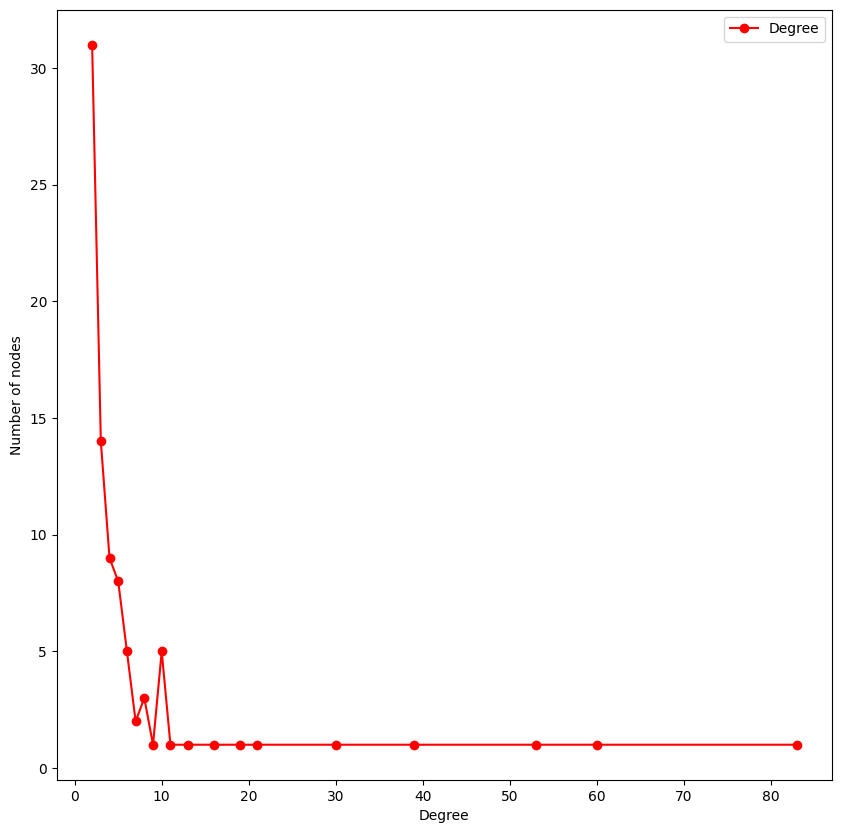

In [87]:
degree = dict(G.degree())
degree_values = sorted(set(degree.values()))
hist = [list(degree.values()).count(x) for x in degree_values]
plt.figure(figsize=(10, 10))
plt.plot(degree_values, hist, 'ro-')
plt.legend(['Degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()

In [88]:
print ('Кластеризация: ', nx.transitivity(G))

Кластеризация:  0.19667774086378736


In [89]:
# def k_shortest_path(G, source, target, k):
#     return sorted([(path_cost(G,p), p) for p in nx.shortest_simple_paths(G, source,target,weight='weight') if len(p)==k])[0]


In [90]:
def path_cost(G, path, In):
    Out = In
    for i in range(len(path)-1):
        tokenA = path[i]
        tokenB = path[i+1]
        print(tokenA)
        pool = corr.loc[tokenA].loc[tokenB]
        print(pool)
        Out = pool.swap(Out, tokenA>tokenB) 
        if(Out < 1e-6):
            return .0
    return Out

path_cost(G, ['WETH', 'USDT', 'USDC', 'WETH'], 100)

WETH
41065696.442235 23162.69071718875
USDT
4109782.2937680003 4096230.695999
USDC
14036161.93717 7923.662382271209


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# corr.loc["USDC"].loc["USDT"][0].address
cycles = nx.minimum_cycle_basis(G)

In [ ]:
cycles

In [ ]:
In = 1000
cycles_value = {str([*i, i[0]]): path_cost(G, [*i, i[0]], In) for i in cycles if path_cost(G, [*i, i[0]], In)>0}
# print()
# cycle_df = pd.DataFrame(index = cycles_value.keys(), columns = ["value"], data = cycles_value.values())
# cycle_df.head()
cycles_values

In [ ]:
best_arb = cycle_df.loc[cycle_df.value == sorted(cycle_df.value)[-2]]
best_arb

In [ ]:
# sorted(cycle_df.value)[::-1]
best_arb.index[0]

In [ ]:
print([tokens[i] for i in ['WETH', 'O', 'DAI', 'WETH']])
print([[i.address, i.reserve0,i.reserve1] for i in corr.loc["WETH"].loc["O"]])
print([[i.address, i.reserve0,i.reserve1] for i in corr.loc["O"].loc["DAI"]])

In [ ]:
[tokens[i] for i in ['USDT', 'SHIB', 'USDC', 'USDT']]

In [ ]:
path_cost(G, ['USDT', 'SHIB', 'USDC', 'USDT'], 1000)

In [ ]:
[[i.address, i.reserve0,i.reserve1] for i in corr.loc["USDC"].loc["SHIB"]]

In [ ]:
["0xdAC17F958D2ee523a2206206994597C13D831ec7","0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE","0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48","0xdAC17F958D2ee523a2206206994597C13D831ec7"]